In [ ]:
!pip3 install gym
!pip3 install stable-baselines3[extra]
!pip3 install 'shimmy>=2.0'
!pip3 install pandas
!pip3 install pybullet

# Environment Setup

## Gym Class

In [1]:
import gym
from gym import spaces
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import math
import time
import random
import joblib

class PandaTennisEnv(gym.Env):
    def __init__(self, enable_gui = True):
        super(PandaTennisEnv, self).__init__()
        
        # preset parameters
        self.time_step = 1.0 / 240.0
        self.wait_period = 40 # How long should the system rest to adjust joints
        self.step_number = 0 # step number count starts from 0
        
        # RGB Camera parameters
        self.camera_width = 640
        self.camera_height = 480
        self.fov = 60  # Field of view in degrees
        self.aspect = self.camera_width / self.camera_height
        self.near = 0.01
        self.far = 100
        self.cam_pos = [-1.5, 0, 1.5]  # Camera position
        self.target = [0, 0, 1.5]  # Look-at point
        self.up_vector = [0, 0, 1]  # Up direction
        self.enable_camera = False
        self.enable_opencv_window = False
        
        # Environmental Factors
        self.gravitational_acceleration = 9.802 # m/s^2 (actual value of g in new york city: https://physicslabs.ccnysites.cuny.edu/labs/207/207-little-g/littleg.php#:~:text=In%20fact%20in%20New%20York,of%20the%20North%2DEast%20US. )
        self.lateral_friction = 0.2 ## Table has separate parameters
        self.spinning_friction = 0.05
        self.rolling_friction = 0.05
        self.restitution = 0.9
        self.air_resistance_coefficient = 0.001

        # Terrain properties
        self.ground_texture = 'terrain_visual/green-terrain.png'
        self.terrain_size = 256  # Number of grid points per side
        self.terrain_scale = 0.5  # Horizontal scaling
        self.terrain_height_scale = 0.1  # Maximum height of terrain

        # Panda Parameters
        self.panda_init_pos = [-2.3, 0, 0.75]
        self.panda_preset_position = [0, 0, 0, 0, 0, 2.258, 0.437]

        # Husky Parameters
        self.husky_init_pos = [-1.9, 0, 0]
        self.enable_husky_movement = False # This fixes the husky base with ground disabling husky control
        
        # Wall properties
        self.wall_size = [0.55, 1.5, 1.0]  # [length, thickness, height]
        self.wall_mass = 2000  # Static wall
        self.wall_color = [0.5, 0.5, 0.5, 1]
        self.wall_position = [5, 0.0, 0.0]  # Adjust the position as needed
        self.wall_orientation = p.getQuaternionFromEuler([0, 0, 0])  # No rotation

        # Table dimensions and properties
        self.table_length = 2.74  # meters
        self.table_width = 1.525  # meters
        self.table_height = 0.76  # meters
        self.table_position = [0, 0, self.table_height / 2]  # Move table to (2, 0)
        self.table_restitution = 0.9
        self.table_lateral_friction = 0.2
        self.table_spinning_friction = 0.05
        self.table_rolling_friction = 0.05


        # ball properties
        self.ball_radius = 0.0335  # Radius (6.7 cm diameter / 2)
        self.ball_mass = 0.058  # Standard tennis ball mass in kg
        self.ball_color = [1, 1, 0, 1]
        self.ball_launcher_height = 0.3048 ## 30.48 cm
        self.ball_position = [1.25, 0.0, self.table_height + 0.25 * self.ball_launcher_height]  # ball is thrown from the ball launcher
        self.ball_initial_vel = [0, 0, 3]
        self.ball_initial_angular_vel = [0, 0, 0] # this is the spin
        
     
        # Define observation and action spaces
        husky_low = np.array([-5, -5, -5, -5], dtype=np.float32)  # Husky wheels: -5 to +5
        husky_high = np.array([5, 5, 5, 5], dtype=np.float32)
        panda_low = np.radians([-180]*7)  # Panda joints: -180 degrees
        panda_high = np.radians([180]*7)  # Panda joints: +180 degrees
        low = np.concatenate([panda_low, husky_low])
        high = np.concatenate([panda_high, husky_high])
        self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(44,), dtype=np.float32)

        # Connect to PyBullet in GUI mode
        self.physics_client = p.connect(p.GUI if enable_gui else p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.initialize_everything()
        
        

    def initialize_everything(self):
        p.setTimeStep(self.time_step)
        p.setGravity(0,0,-self.gravitational_acceleration)
        self.step_number = 0
        
        self.plane_id = p.loadURDF("plane.urdf")
        
        # Apply a texture to the uneven plane
        texture_id = p.loadTexture(self.ground_texture)  # Use a texture from PyBullet's data
        p.changeVisualShape(self.plane_id, -1, textureUniqueId=texture_id)
        if self.enable_husky_movement:
            self.husky_id = p.loadURDF("husky/husky.urdf", self.husky_init_pos) # allows husky to move
        else:
            self.husky_id = p.loadURDF("husky/husky.urdf", self.husky_init_pos, useFixedBase = True) # disables husky movement
            
        self.panda_id = p.loadURDF("modURDFs/panda_pybullet/franka_panda_mod/panda_gripper_pingpong.urdf", self.panda_init_pos)

        ## Build Wall
        # self.build_wall()
        
        self.mount_bodies()
        
        p.changeDynamics(bodyUniqueId=self.plane_id, linkIndex=-1,
                         restitution=self.restitution, 
                         lateralFriction=self.lateral_friction, 
                         spinningFriction = self.spinning_friction, 
                         rollingFriction = self.rolling_friction,
                        )
        
        # Apply dynamics properties to all links of panda
        num_joints = p.getNumJoints(self.panda_id)
        for link_index in range(-1, num_joints):  # -1 refers to the base link
            p.changeDynamics(self.panda_id, link_index, 
                             restitution=self.restitution, 
                             lateralFriction=self.lateral_friction,
                             spinningFriction = self.spinning_friction, 
                             rollingFriction = self.rolling_friction,
                            )

        # Apply damping for all joints
        for joint_index in range(num_joints):
            p.changeDynamics(self.panda_id, joint_index, 
                             linearDamping=0.04, 
                             angularDamping=0.04)

        
        p.addUserDebugPoints([self.ball_position], [[0.1, 0.1, 0]], 10)  # position of the launcher
        
        self.get_new_ball(self.ball_position)
        self.throw_ball(self.ball_initial_vel, self.ball_initial_angular_vel)

        ## build table
        self.build_table()

    def build_wall(self):
        # Create wall collision shape
        wall_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=self.wall_size)
        # Create wall visual shape
        wall_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=self.wall_size, rgbaColor=self.wall_color)  # Grey color
        # Create the wall body
        self.wall_id = p.createMultiBody(
            baseMass=self.wall_mass,
            baseCollisionShapeIndex=wall_collision,
            baseVisualShapeIndex=wall_visual,
            basePosition=self.wall_position,
            baseOrientation=self.wall_orientation
        )
        p.changeDynamics(self.wall_id, -1, lateralFriction=self.lateral_friction, restitution=self.restitution)



    def build_table(self):
        # Create the table as a box
        table_visual = p.createVisualShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[self.table_length / 2, self.table_width / 2, self.table_height / 2],
            rgbaColor=[0, 0.6, 0, 1],  # Dark green color for the table
        )
        
        table_collision = p.createCollisionShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[self.table_length / 2, self.table_width / 2, self.table_height / 2],
        )
        
        self.table_id = p.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=table_collision,
            baseVisualShapeIndex=table_visual,
            basePosition=self.table_position,
        )
        
        # Set the physical properties of the table
        p.changeDynamics(self.table_id, -1, 
                         restitution=self.table_restitution, 
                         lateralFriction=self.table_lateral_friction, 
                         spinningFriction = self.table_spinning_friction, 
                         rollingFriction = self.table_rolling_friction,
                        )
        
        # Draw the court lines
        line_color = [1, 1, 1, 1]  # White color for the lines
        
        # Outer border (2 cm width)
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        
        # Centerline (3 mm width)
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0], self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0], self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1], self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1], self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )

    def apply_air_resistance(self):
        velocity, angular_velocity = p.getBaseVelocity(self.ball_id)
        # Calculate air resistance (linear and angular)
        air_resistance_force = [-self.air_resistance_coefficient * v for v in velocity]
        air_resistance_torque = [-self.air_resistance_coefficient * av for av in angular_velocity]
        
        # Apply forces and torques
        p.applyExternalForce(self.ball_id, -1, air_resistance_force, [0, 0, 0], p.WORLD_FRAME)
        p.applyExternalTorque(self.ball_id, -1, air_resistance_torque, p.WORLD_FRAME)
        
    
    def mount_bodies(self):
        # mount the panda on the husky
        husky_chassis_link_index = 0  # chasis link index
        
        # Create the fixed constraint
        self.husky_panda_mount = p.createConstraint(
            parentBodyUniqueId=self.husky_id,
            parentLinkIndex=husky_chassis_link_index,
            childBodyUniqueId=self.panda_id,
            childLinkIndex=-1,  # -1 means the base link of the child
            jointType=p.JOINT_FIXED,
            jointAxis=[0, 0, 0],
            parentFramePosition=[0.3, 0, 0.25],  # Offset on Husky where the Panda arm will be attached
            childFramePosition=[0, 0, 0]  # Offset on Panda where it attaches to Husky
        )

        for i in range (self.wait_period):
            p.stepSimulation()

        # set panda to preset position
        for joint_index, target_position in zip(range(0, 7), self.panda_preset_position):
            p.setJointMotorControl2(
                bodyUniqueId=self.panda_id,
                jointIndex=joint_index,
                controlMode=p.POSITION_CONTROL,
                targetPosition=target_position,
                force=500  # Adjust max torque/force as needed
            )

        for i in range (self.wait_period):
            p.stepSimulation()



    def get_camera_feed(self):
        # Compute view and projection matrices
        view_matrix = p.computeViewMatrix(self.cam_pos, self.target, self.up_vector)
        proj_matrix = p.computeProjectionMatrixFOV(self.fov, self.aspect, self.near, self.far)
        
        # Capture the image
        _, _, rgb_img, _, _ = p.getCameraImage(self.camera_width, 
                                               self.camera_height, 
                                               view_matrix, 
                                               proj_matrix, 
                                               # renderer=p.ER_BULLET_HARDWARE_OPENGL,
                                              )
        rgb_img = np.array(rgb_img, dtype=np.uint8).reshape((self.camera_height, self.camera_width, 4))
        if self.enable_opencv_window:
            cv2.imshow("RGB Camera", rgb_img[:, :, :3])  # Ignore alpha channel
            if cv2.waitKey(1) != -1:  # If any key is pressed, exit 
                cv2.destroyAllWindows()
                self.enable_opencv_window = False
        return rgb_img


    
    def reset(self):
        # Reset simulation
        p.resetSimulation()
        p.removeAllUserDebugItems()
        self.initialize_everything()
        return self._get_observation()
    
    def _get_observation(self):

        # ball states
        ball_pos, ball_orn = p.getBasePositionAndOrientation(self.ball_id)
        ball_linear_velocity, ball_angular_velocity = p.getBaseVelocity(self.ball_id) # Ignore angular velocity. Difficult to estimate in reality
        

        # bat states
        
        bat_states = p.getLinkState(self.panda_id, p.getNumJoints(self.panda_id) - 1)
        bat_com_pos = bat_states[0]  # Position is a tuple (x, y, z)
        bat_com_orn = bat_states[1]


        # Husky states
        husky_pos, husky_orn = p.getBasePositionAndOrientation(self.husky_id)
        husky_lin_vel, husky_ang_vel = p.getBaseVelocity(self.husky_id)
        
        

        # Panda states
        panda_num_joints = p.getNumJoints(self.panda_id)
        panda_joint_states = p.getJointStates(self.panda_id, range(panda_num_joints))
        panda_joint_pos = [state[0] for state in panda_joint_states]
        panda_joint_vel = [state[1] for state in panda_joint_states]
        
        system_state = np.concatenate([
                np.array(ball_pos),                 # 3 values: Ball position
                np.array(ball_orn),                # 4 values: Ball orientation
                np.array(ball_linear_velocity),    # 3 values: Ball linear velocity
                np.array(bat_com_pos),                 # 3 values: Bat position
                np.array(bat_com_orn),                 # 4 values: Bat orientation
                np.array(husky_pos),               # 3 values: Husky position
                np.array(husky_orn),               # 4 values: Husky orientation
                np.array(husky_lin_vel),           # 3 values: Husky linear velocity
                np.array(husky_ang_vel),           # 3 values: Husky angular velocity
                np.array(panda_joint_pos),         # 7 values: Panda joint positions
                np.array(panda_joint_vel)          # 7 values: Panda joint velocities
            ])
        return system_state


    def get_new_ball(self, initial_position):
        # Create ball collision shape
        ball_collision = p.createCollisionShape(p.GEOM_SPHERE, radius=self.ball_radius)
        # Create ball visual shape
        ball_visual = p.createVisualShape(p.GEOM_SPHERE, radius=self.ball_radius, rgbaColor=self.ball_color)  # Yellow color
        # Create the ball body
        self.ball_id = p.createMultiBody(
            baseMass=self.ball_mass,
            baseCollisionShapeIndex=ball_collision,
            baseVisualShapeIndex=ball_visual,
            basePosition=initial_position,
        )
        p.changeDynamics(self.ball_id, -1, lateralFriction=self.lateral_friction, restitution=self.restitution)

    def set_ball_init_position(self, initial_position):
        p.resetBasePositionAndOrientation(self.ball_id, initial_position, [0, 0, 0, 1])
    
    # Function to draw the COM of bat and axes
    def visualize_com(self):
        # Function to rotate a vector by a quaternion
        def rotate_vector(vector, quaternion):
            return p.multiplyTransforms([0, 0, 0], quaternion, vector, [0, 0, 0, 1])[0]
        
        # Get COM for the base link
        bat_states = p.getLinkState(self.panda_id, p.getNumJoints(self.panda_id) - 1)
        base_pos = bat_states[0]  # Position is a tuple (x, y, z)
        base_orn = bat_states[1]
        
        # Transform the local COM to global coordinates
        com_global = base_pos
        
        # Define local unit axes
        axis_length = 0.2  # Length of the axes
        x_axis = [axis_length, 0, 0]
        y_axis = [0, axis_length, 0]
        z_axis = [0, 0, axis_length]
        
        # Rotate local axes to match the base's orientation
        x_axis_global = rotate_vector(x_axis, base_orn)
        y_axis_global = rotate_vector(y_axis, base_orn)
        z_axis_global = rotate_vector(z_axis, base_orn)
        
        # Compute global endpoints of the axes
        x_end = [com_global[i] + x_axis_global[i] for i in range(3)]
        y_end = [com_global[i] + y_axis_global[i] for i in range(3)]
        z_end = [com_global[i] + z_axis_global[i] for i in range(3)]
        
        # Draw lines for the axes
        p.addUserDebugLine(com_global, x_end, [1, 0, 0], 3)  # Red for X-axis
        p.addUserDebugLine(com_global, y_end, [0, 1, 0], 3)  # Green for Y-axis
        p.addUserDebugLine(com_global, z_end, [0, 0, 1], 3)  # Blue for Z-axis
        

    # remove all the lines or user debug texts added
    def removeUserDebugItems(self):
        p.removeAllUserDebugItems()

    
    def throw_ball(self, initial_velocity, angular_velocity = [0, 0, 0]):
        # Throw the ball with initial velocity
        # initial_velocity = [3, 0, 2]  # Velocity in x, y, z directions
        p.resetBaseVelocity(self.ball_id, linearVelocity=initial_velocity, angularVelocity = angular_velocity)



    def panda_IK(self, desired_bat_com_position, desired_bat_com_orientation):
        end_effector_index = 6
        joint_angles = p.calculateInverseKinematics(end.panda_id, end_effector_index, desired_end_effector_position, desired_end_effector_orientation)
        return joint_angles

    def step(self, action):
        self.apply_air_resistance()
        self.step_number += 1
        panda_actions = action[:7]  # First 7 values for Panda arm
        husky_actions = action[7:]  # Last 4 values for Husky wheels


         # Apply actions to Husky wheels
        panda_joints = [0, 1, 2, 3, 4, 5, 6]  # Joint indices for the Husky wheels
        for i, act in enumerate(panda_actions):
            p.setJointMotorControl2(
                self.panda_id,
                panda_joints[i],
                p.VELOCITY_CONTROL,
                targetVelocity=act  # Use velocity directly within [-5, 5]
            )


        
        
        # Apply actions to Husky wheels
        wheel_joints = [2, 3, 4, 5]  # Joint indices for the Husky wheels
        for i, act in enumerate(husky_actions):
            p.setJointMotorControl2(
                self.husky_id,
                wheel_joints[i],
                p.VELOCITY_CONTROL,
                targetVelocity=act  # Use velocity directly within [-5, 5]
            )
    
        # Step the simulation
        p.stepSimulation()
        if self.enable_camera:
            self.get_camera_feed()
    
        # Calculate reward and check if done
        reward = self._calculate_reward()
        done = self._check_done()

        ## Enable markers
        # self.visualize_com()
        # self.removeUserDebugItems()
        return self._get_observation(), reward, done, {}

    
    def _calculate_reward(self):
        total_reward = -1
        return total_reward
    
    def _check_done(self):
        # Get the position of the ball
        ball_pos, ball_orn = p.getBasePositionAndOrientation(self.ball_id)
        
        # Get the vertical velocity of the ball (in the z direction)
        ball_linear_velocity, ball_angular_velocity = p.getBaseVelocity(self.ball_id)
        ball_vertical_velocity = ball_linear_velocity[2]  # The z component of velocity
        
        # Done condition: Ball hits the ground (z position below a threshold or vertical velocity down)
        if ball_pos[2] < 0.1:
            # Ball has hit the ground, episode should end
            return True
        
        return False
    
    def render(self, mode="human"):
        pass  # PyBullet GUI provides rendering
    
    def close(self):
        p.disconnect()


pybullet build time: Nov 28 2023 23:51:11


## Start the sim

In [2]:
# Test the model
env = PandaTennisEnv(enable_gui = True)

/home/sakib/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Test Run

In [3]:
obs = env.reset()
env.set_ball_init_position([1, 0, 2])
env.throw_ball([1, 0, 2], [3, 0, 0])
for i in range(100000):
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    # print(obs)
    time.sleep(1/240)


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA RTX A6000/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.183.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.183.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA RTX A6000/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: No inertial data for link, using mass=1, loca

KeyboardInterrupt: 

## Enable Sliders for Panda Joint Control

In [4]:
# Get joint information
num_joints = p.getNumJoints(env.panda_id)
joint_indices = [i for i in range(num_joints) if p.getJointInfo(env.panda_id, i)[2] == p.JOINT_REVOLUTE]

# Create sliders for each joint
sliders = {}
for joint_index in joint_indices:
    joint_info = p.getJointInfo(env.panda_id, joint_index)
    joint_name = joint_info[1].decode("utf-8")
    joint_limit_low = joint_info[8]
    joint_limit_high = joint_info[9]
    slider = p.addUserDebugParameter(joint_name, joint_limit_low, joint_limit_high, 0.0)
    sliders[joint_index] = slider

# Simulation loop
while True:
    # Read slider values and control joints
    for joint_index, slider in sliders.items():
        slider_value = p.readUserDebugParameter(slider)
        p.setJointMotorControl2(
            bodyUniqueId=env.panda_id,
            jointIndex=joint_index,
            controlMode=p.POSITION_CONTROL,
            targetPosition=slider_value,
            force=500  # Set maximum torque/force
        )
    
    # Step the simulation
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    # obs, reward, done, info = env.step(action)
    p.stepSimulation()
    time.sleep(0.01)  # Add a small delay for stability

KeyboardInterrupt: 

## Make Panda Dance (don't use - panda uses velocity control now)

In [3]:
# Get number of joints
num_joints = p.getNumJoints(env.panda_id)

# Define the range of motion for the joints
joint_ranges = {
    0: (-2.9, 2.9),
    1: (-1.76, 1.76),
    2: (-2.9, 2.9),
    3: (-3.07, -0.07),
    4: (-2.9, 2.9),
    5: (-0.017, 3.75),
    6: (-2.9, 2.9),
}

# Simulation parameters
duration = 100  # Total time for the dance (seconds)
frequency = 0.05  # Frequency of oscillation (Hz)

# Create a time-based loop
start_time = time.time()
while time.time() - start_time < duration:
    current_time = time.time() - start_time

    # Set joint positions in a sinusoidal pattern
    for joint_index in range(7):  # Panda has 7 controllable joints
        joint_range = joint_ranges[joint_index]
        joint_center = (joint_range[0] + joint_range[1]) / 2
        joint_amplitude = (joint_range[1] - joint_range[0]) / 4

        # Calculate target position using a sine wave
        target_position = joint_center + joint_amplitude * np.sin(2 * np.pi * frequency * current_time + joint_index)

        # Set joint position
        p.setJointMotorControl2(
            bodyUniqueId=env.panda_id,
            jointIndex=joint_index,
            controlMode=p.POSITION_CONTROL,
            targetPosition=target_position,
        )
    # Clear previous lines
    env.removeUserDebugItems()
    
    # Visualize the COM of the bat
    env.visualize_com()
    print(env._get_observation())

    # Step simulation
    p.stepSimulation()
    time.sleep(1 / 240)  # Match the simulation timestep (240 Hz)

[ 3.50000000e+00  0.00000000e+00  1.50000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  3.00000000e+00  3.15484136e-01  1.61483612e-02
  6.81534565e-01  2.15230606e-01 -3.93574770e-01 -1.38311722e-01
  8.82974832e-01 -1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.52906540e-08  1.07963089e+00
  1.66750824e-03 -3.41682652e-01 -7.60639285e-04  2.25312327e+00
  4.30690598e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.20775077e-06 -4.55350728e+00  5.45318269e-02  9.11418475e+00
 -8.89656871e-03  1.31133755e-01  1.71564687e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 3.50000000e+00  0.00000000e+00  1.51232149e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  2.95715833e+00  3.22390661e-01  1.6057

KeyboardInterrupt: 

In [ ]:
pybullet_data.getDataPath()

In [ ]:
# Test the model
env = PandaTennisEnv(enable_gui = True)

In [ ]:
while True:
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0.0]*7 # panda_velocities
    husky_action = [-1]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    # print(obs)
    time.sleep(1/240)
    # husky_position, husky_orientation = p.getBasePositionAndOrientation(env.husky_id)
    # print(husky_position, husky_orientation)
    # Extract velocities
    joint_states = p.getJointStates(
        bodyUniqueId=env.panda_id,
        jointIndices=range(7)
    )

    velocities = [joint_state[1] for joint_state in joint_states]
    print(f"Joint Velocities: {velocities}")
    p.stepSimulation()

# Residual Estimation

## Estimate Initial Velocity

In [19]:
def estimate_initial_velocity(pos1, pos2, delta_t):
    """
    Estimate the initial velocity of a ball given two consecutive positions.

    Args:
    - pos1 (list or np.array): First position [x1, y1, z1].
    - pos2 (list or np.array): Second position [x2, y2, z2].
    - delta_t (float): Time interval between the two positions.

    Returns:
    - velocity (np.array): Estimated velocity [vx, vy, vz].
    """
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)

    # Compute velocity
    velocity = (pos2 - pos1) / delta_t

    return velocity

## Finding Bounce and hitting Point

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def get_bounce_position_and_hit_position(initial_position, # for the ball 
                                         initial_velocity, # for the ball
                                         table_height, 
                                         coeff_restitution, 
                                         x_a, # x = a plane position (provide the value of a)
                                         g,
                                        ):
    # Compute bounce time
    t_bounce = (initial_velocity[2] + np.sqrt(initial_velocity[2]**2 + 2 * g * (initial_position[2] - table_height))) / g
    bounce_position = initial_position + initial_velocity * t_bounce - 0.5 * np.array([0, 0, g]) * t_bounce**2
    bounce_velocity = np.array([initial_velocity[0], initial_velocity[1], -coeff_restitution * (initial_velocity[2] - g * t_bounce)])
    
    # Compute time to reach x = a after bounce
    t_hit = (x_a - bounce_position[0]) / bounce_velocity[0]
    hit_position = bounce_position + bounce_velocity * t_hit - 0.5 * np.array([0, 0, g]) * t_hit**2
    # --- 6️⃣ Compute Velocity at Hit Position ---
    hit_velocity = np.array([
        bounce_velocity[0],   # vx remains constant
        bounce_velocity[1],   # vy remains constant
        bounce_velocity[2] - g * t_hit  # v_z changes due to gravity
    ])
    return bounce_position, bounce_velocity, hit_position, hit_velocity, t_bounce, t_hit 



## Draw the x = a plane

In [21]:
def draw_xa_plane(x_a):
    # Define grid size
    y_min, y_max = -1.5, 1.5
    z_min, z_max = 0, 2
    num_lines = 1  # Increase for finer grid
    
    for i in range(num_lines + 1):
        y = y_min + i * (y_max - y_min) / num_lines
        z = z_min + i * (z_max - z_min) / num_lines
        
        # Vertical grid lines
        p.addUserDebugLine([x_a, y_min, z], [x_a, y_max, z], [0, 1, 0])
        # Horizontal grid lines
        p.addUserDebugLine([x_a, y, z_min], [x_a, y, z_max], [0, 1, 0])
        # 

## Set ball initial position and velocity randomly

In [22]:
def set_random_ball_conditions(ball_id):
    """Sets a random initial position and velocity ensuring the ball bounces on the table once and reaches x = a"""
    TABLE_HEIGHT = env.table_height  # Typical table tennis table height in meters
    GRAVITY = 9.81  # Gravity in m/s^2
    RESTITUTION = 0.9  # Coefficient of restitution (bounciness)
    X_TARGET = -0.2  # The x = a plane where the ball should reach after one bounce
    Vx_ADJUST = 2.0 # add a slightly more Vx 

    # # Choose a random initial position (starting on one side of the table)
    # x0 = np.random.uniform(3.9, 4.1)  # Start from left side of the table
    # y0 = np.random.uniform(-0.1, 0.1)  # Random lateral position
    # z0 = np.random.uniform(TABLE_HEIGHT + 0.3, TABLE_HEIGHT + 1.0)  # Above the table
    [x0, y0, z0] = env.ball_position # ball launcher position

    # Choose a valid initial vertical velocity to ensure it lands on the table
    vz0 = np.random.uniform(3.0, 4.5)  # Positive upwards velocity

    # Compute time to bounce
    tb = (vz0 + np.sqrt(vz0**2 + 2 * GRAVITY * (z0 - TABLE_HEIGHT))) / GRAVITY

    # Compute velocity after bounce
    vz_after_bounce = -RESTITUTION * vz0

    # Compute required x velocity to reach x = a
    tf = abs(vz_after_bounce) / GRAVITY * 2  # Approximate time after bounce
    vx0 = ((X_TARGET - x0) / (tb + tf)) - Vx_ADJUST  # Solve for vx0

    # Random y velocity (ensure it stays on table)
    vy0 = np.random.uniform(-0.7, 0.7)

    # Set ball position and velocity in PyBullet
    env.set_ball_init_position([x0, y0, z0])
    env.throw_ball([vx0, vy0, vz0])

    # print(f"Set initial position: {x0:.3f}, {y0:.3f}, {z0:.3f}")
    # print(f"Set initial velocity: {vx0:.3f}, {vy0:.3f}, {vz0:.3f}")

## Write the results in a CSV file

In [23]:
import csv

# Define the CSV file name
csv_filename = "ball_trajectory_data_finegrained.csv"

# Define the header for the CSV file
csv_header = ["initial_x", "initial_y", "initial_z", 
              "initial_vx", "initial_vy", "initial_vz",
              "distance_to_x_a", "estimated_hit_x", "estimated_hit_y", "estimated_hit_z",
              "real_hit_x", "real_hit_y", "real_hit_z",
              "delta_x", "delta_y", "delta_z",]

# Function to write data to CSV
def write_to_csv(initial_pos, initial_vel, distance_to_x_a, estimated_hit, real_hit, delta):
    """Writes trajectory data to a CSV file."""
    data = [
        initial_pos[0], initial_pos[1], initial_pos[2], 
        initial_vel[0], initial_vel[1], initial_vel[2], 
        distance_to_x_a, estimated_hit[0], estimated_hit[1], estimated_hit[2],
        real_hit[0], real_hit[1], real_hit[2], 
        delta[0], delta[1], delta[2]
    ]

    # Check if the file exists and write the header only once
    try:
        with open(csv_filename, mode='x', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(csv_header)  # Write header
            writer.writerow(data)
    except FileExistsError:
        with open(csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data)


## Test Run 

Predicted Bounce Position: [-1.4364313  -0.45229289  0.76      ]
Predicted Hit Position on x = -2.2 : [-2.2        -0.58084882  1.54172223]


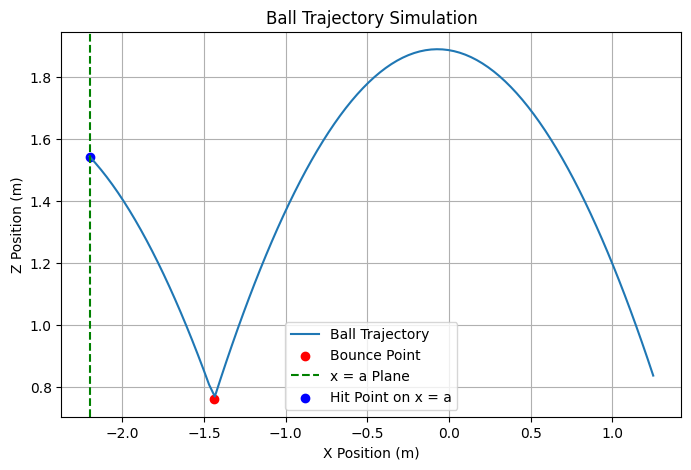

In [8]:

# Constants
g = env.gravitational_acceleration  # Gravity (m/s^2)
table_height = env.table_height  # Table tennis table height in meters
x_a = -2.2  # The 'x = a' plane where we check the hit
coeff_restitution = env.table_restitution  # Bounce efficiency (0.9 means 90% energy retained)
initial_position = env.ball_position  # Start position (x, y, z)
initial_velocity = np.array([-2.851, -0.480, 4.541])  # Initial velocity (vx, vy, vz)


bounce_position, bounce_velocity, hit_position, hit_velocity, t_bounce, t_hit = get_bounce_position_and_hit_position(initial_position,
                                                                    initial_velocity,
                                                                    table_height,
                                                                    coeff_restitution,
                                                                    x_a,
                                                                    g = 9.81)

print("Predicted Bounce Position:", bounce_position)
print("Predicted Hit Position on x =", x_a, ":", hit_position)

# Plotting the trajectory
t_values = np.linspace(0, t_bounce + t_hit, num=100)
x_traj = np.concatenate([initial_position[0] + initial_velocity[0] * t_values[t_values < t_bounce],
                         bounce_position[0] + bounce_velocity[0] * (t_values[t_values >= t_bounce] - t_bounce)])
y_traj = np.concatenate([initial_position[1] + initial_velocity[1] * t_values[t_values < t_bounce],
                         bounce_position[1] + bounce_velocity[1] * (t_values[t_values >= t_bounce] - t_bounce)])
z_traj = np.concatenate([initial_position[2] + initial_velocity[2] * t_values[t_values < t_bounce] - 0.5 * g * t_values[t_values < t_bounce]**2,
                         bounce_position[2] + bounce_velocity[2] * (t_values[t_values >= t_bounce] - t_bounce) - 0.5 * g * (t_values[t_values >= t_bounce] - t_bounce)**2])

plt.figure(figsize=(8, 5))
plt.plot(x_traj, z_traj, label="Ball Trajectory")
plt.scatter([bounce_position[0]], [bounce_position[2]], color='red', label="Bounce Point")
plt.axvline(x=x_a, color='green', linestyle='--', label="x = a Plane")
plt.scatter([hit_position[0]], [hit_position[2]], color='blue', label="Hit Point on x = a")
plt.xlabel("X Position (m)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.title("Ball Trajectory Simulation")
plt.grid()
plt.show()


In [11]:
obs = env.reset()
env.set_ball_init_position(initial_position)
env.throw_ball(initial_velocity)
draw_xa_plane(x_a)
prev_position = p.getBasePositionAndOrientation(env.ball_id)[0]  # Initial position
for i in range(100000):
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
    x, y, z = ball_real_position
    # Check if the ball crossed x = a
    if x < x_a <= prev_position[0]:  # Moving in positive x direction
        # Linear interpolation to find exact crossing point
        alpha = (x_a - prev_position[0]) / (x - prev_position[0])
        hit_y = prev_position[1] + alpha * (y - prev_position[1])
        hit_z = prev_position[2] + alpha * (z - prev_position[2])
        # Mark the hitting point
        p.addUserDebugPoints([[x_a, hit_y, hit_z]], [[0, 0, 1]], 10)  # Red dot
        print(f"Ball hit x = {x_a} at y = {hit_y:.3f}, z = {hit_z:.3f}")
        break
    prev_position = ball_real_position
    time.sleep(1/240)


Ball hit x = -2.2 at y = -0.581, z = 1.113


## The big Loop: data collection for residual predictor

In [8]:
g = 9.8  # Gravity (m/s^2) [We will use this instead of the actual one set in the simulator to ensure our set parameters are different than the actual ones]
table_height = env.table_height  # Table tennis table height in meters
x_a = -1 * env.table_length/2  # The 'x = a' plane where we check the hit
coeff_restitution = 0.85 # different from the simulator. to set inaccuracy in preset parameters. 
num_experiments = 10000
draw_xa_plane(x_a)

for exp in range(num_experiments):
    # env.reset()
    # Set random initial conditions
    set_random_ball_conditions(env.ball_id)
    pos1 = p.getBasePositionAndOrientation(env.ball_id)[0]  # First position
    p.stepSimulation()
    time.sleep(env.time_step)  # Simulate a step
    pos2 = p.getBasePositionAndOrientation(env.ball_id)[0]  # Second position
    d = pos1[0] - x_a
    estimated_initial_velocity = estimate_initial_velocity(pos1, pos2, env.time_step)
    bounce_position, bounce_velocity, estimated_hit_position, estimated_hit_vel, t_bounce, t_hit = get_bounce_position_and_hit_position(pos1,
                                                                        estimated_initial_velocity,
                                                                        table_height,
                                                                        coeff_restitution,
                                                                        x_a,
                                                                        g,                                   
                                                                        )
    
    # p.addUserDebugPoints([estimated_hit_position], [[1, 0, 0]], 10)  # estimated hit point
    prev_position = p.getBasePositionAndOrientation(env.ball_id)[0]  # Initial position
    for i in range(1000):
        # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
        panda_action = [0]*7 # panda_velocities
        husky_action = [0]*4 # wheel velocity
        action = panda_action + husky_action
        obs, reward, done, info = env.step(action)
        
        ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
        x, y, z = ball_real_position
        # Check if the ball crossed x = a
        if x < x_a <= prev_position[0]:  # Moving in positive x direction
            # Linear interpolation to find exact crossing point
            alpha = (x_a - prev_position[0]) / (x - prev_position[0])
            hit_y = prev_position[1] + alpha * (y - prev_position[1])
            hit_z = prev_position[2] + alpha * (z - prev_position[2])
            # Mark the hitting point
            # p.addUserDebugPoints([[x_a, hit_y, hit_z]], [[0, 0, 1]], 10)  # real hit point
            # print(f"Ball hit x = {x_a} at y = {hit_y:.3f}, z = {hit_z:.3f}")
            real_hit_position = [x_a, hit_y, hit_z]
            # p.addUserDebugPoints([real_hit_position], [[1, 0, 0]], 10)  # estimated hit point

            delta = real_hit_position - estimated_hit_position
            write_to_csv(pos1, 
                        estimated_initial_velocity,
                        d,
                        estimated_hit_position,
                        real_hit_position,
                        delta,
                        )
            break
        prev_position = ball_real_position
        # time.sleep(env.time_step)



2025-02-12 14:29:33.955 Python[87125:3058720] _TIPropertyValueIsValid called with 16 on nil context!
2025-02-12 14:29:33.955 Python[87125:3058720] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-02-12 14:29:33.955 Python[87125:3058720] Text input context does not respond to _valueForTIProperty:
2025-02-12 14:30:39.617 Python[87125:3058720] _TIPropertyValueIsValid called with 16 on nil context!
2025-02-12 14:30:39.617 Python[87125:3058720] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-02-12 14:30:39.617 Python[87125:3058720] Text input context does not respond to _valueForTIProperty:
2025-02-12 14:32:37.929 Python[87125:3058720] _TIPropertyValueIsValid called with 16 on nil context!
2025-02-12 14:32:37.929 Python[87125:3058720] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-02-12 14:32:37.929 Python[87125:3058720] Text input context does not respond to _

KeyboardInterrupt: 

## Training the Residual Estimator

Follow this link for residual estimator training:
https://colab.research.google.com/drive/1e3OfrHbjdDuJz5hqRT5LKNmsFiApF1CZ?usp=sharing

# Receiving the ball

## Moveit Plugin

In [8]:
from utils.BotPluginMoveIt import BotPluginMoveIt
mp = BotPluginMoveIt(env, move_group = 'arm', planner_id = 'RRT')

In [4]:
mp.plan_motion(0.58737645, -0.52673307,  0.88380567, 
         
               -7.5*np.pi/8, 
               0, 
               -np.pi/8,
              ignore_pose_control = False)
mp.execute_plan()
# mp.group.go()

[ WARN] [1739643965.168197311]: Fail: ABORTED: TIMED_OUT


In [60]:
from sensor_msgs.msg import JointState
def change_starting_state_moveit():
    # Get the number of joints
    num_joints = p.getNumJoints(env.panda_id)
    
    # Get the current joint states from PyBullet
    joint_positions = []
    joint_names = []
    for joint_index in range(0, 7):
        joint_info = p.getJointInfo(env.panda_id, joint_index)
        joint_state = p.getJointState(env.panda_id, joint_index)
        joint_names.append(joint_info[1].decode('utf-8'))
        joint_positions.append(joint_state[0])


    current_state = mp.robot.get_current_state()
    print(joint_positions)
    # print(current_state)

    # Create a JointState message with the joint positions from PyBullet
    joint_state = JointState()
    joint_state.name = joint_names
    joint_state.position = joint_positions
    
    # Update the current state with the new joint state
    current_state.joint_state = joint_state

    # Set the start state to the move_group
    mp.set_starting_state(current_state)

change_starting_state_moveit()

[-0.30449484502592655, -0.8275674322042056, 0.506203415252831, -1.3909853157451646, 0.1735781731910055, 1.486063710253001, 2.6502645419717274]


In [63]:
mp.plan_motion(0.31745164, 0.49445985, 0.7862997 ,
               np.pi/2.5, 
               0, 
               -np.pi/2)
mp.execute_plan()
# mp.group.go()

[ WARN] [1739645487.566800802]: Fail: ABORTED: TIMED_OUT


## delta estimator call

In [17]:
from delta_estimator_mlp.DeltaEstimatorMLP import DeltaEstimatorMLP
import torch
from utils.BotPluginMoveIt import BotPluginMoveIt
mp = BotPluginMoveIt(env, move_group = 'arm')
# Load the scaler
scaler = joblib.load('delta_estimator_mlp/scaler.pkl')
# Parameters
input_size = 9  # Number of input features
hidden_size = 32  # Number of neurons in the hidden layer
output_size = 2  # Number of output features (delta_y, delta_z)

# Create model and load trained weights
model = DeltaEstimatorMLP(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('delta_estimator_mlp/delta_estimator_mlp.pth'))
model.eval()

# Sample inference code
def calculate_delta_v2(input_features):
    # Convert input features to tensor
    input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        prediction = model(input_tensor)

    # print(prediction)
    # Inverse transform the prediction to get original values
    prediction_original = scaler.inverse_transform(prediction.numpy())
    
    return prediction_original[0]


/home/sakib/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Panda Receives the ball

In [67]:

g = 9.8  # Gravity (m/s^2) [We will use this instead of the actual one set in the simulator to ensure our set parameters are different than the actual ones]
table_height = env.table_height  # Table tennis table height in meters
x_a = -1 * env.table_length/2  # The 'x = a' plane where we check the hit
coeff_restitution = 0.85 # different from the simulator. to set inaccuracy in preset parameters. 
num_experiments = 10000
# bat_roll = 7.5*np.pi/8
# bat_pitch = 0 
# bat_yaw = -np.pi/8

bat_roll = np.pi/3.5
bat_pitch = 0 
bat_yaw = -np.pi/2


for exp in range(num_experiments):
    env.removeUserDebugItems()
    change_starting_state_moveit()
    draw_xa_plane(x_a)
    # env.reset()
    # Set random initial conditions
    set_random_ball_conditions(env.ball_id)
    
    pos1 = p.getBasePositionAndOrientation(env.ball_id)[0]  # First position
    p.stepSimulation()
    time.sleep(env.time_step)  # Simulate a step
    pos2 = p.getBasePositionAndOrientation(env.ball_id)[0]  # Second position
    d = pos1[0] - x_a
    estimated_initial_velocity = estimate_initial_velocity(pos1, pos2, env.time_step)
    bounce_position, bounce_velocity, estimated_hit_position, estimated_hit_velocity, t_bounce, t_hit = get_bounce_position_and_hit_position(pos1,
                                                                        estimated_initial_velocity,
                                                                        table_height,
                                                                        coeff_restitution,
                                                                        x_a,
                                                                        g,
                                                                    )
    print('estimated_hit_point: ', estimated_hit_position)                                                                   
    inp = np.array([pos1[0], 
                   pos1[1], 
                   pos1[2], 
                   d, 
                   estimated_initial_velocity[0], 
                   estimated_initial_velocity[1], 
                   estimated_initial_velocity[2],
                   estimated_hit_position[1],
                   estimated_hit_position[2],
                   ])
    delta = calculate_delta_v2(inp)
    delta = [0, 0, 0.8*delta[1]]
    real_hit_point = estimated_hit_position + delta
    print('real hit point (global): ', real_hit_point) 
    # p.addUserDebugPoints([real_hit_point], [[1, 0, 0]], 10)  # estimated hit point
    
    ## Transform to panda perspective
    panda_base_pos, _ = p.getBasePositionAndOrientation(env.panda_id)
    panda_offset = [panda_base_pos[0], 0, panda_base_pos[2]]
    real_hit_point = real_hit_point - panda_offset
    print('real hit point (panda): ', real_hit_point)
    mp.plan_motion(real_hit_point[0], 
                  real_hit_point[1],
                  real_hit_point[2],
                   bat_roll,
                   bat_pitch,
                   bat_yaw,
                  )

    if not mp.success:
        continue
    mp.execute_plan()
    
    for i in range(350):
        p.stepSimulation()
        time.sleep(env.time_step)
        ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
        if ball_real_position[0] < x_a:
            ## ball reached the x_a plane
            print('ball actually hit', ball_real_position)
            break




[-0.43928472224678855, -0.815999051111162, 0.5895565950595634, -1.5046282364108845, 0.3829310910001914, 1.3235632745323134, 2.6497594470485746]
estimated_hit_point:  [-1.37       -0.48851044  0.89692156]
real hit point (global):  [-1.37       -0.48851044  1.17297011]
real hit point (panda):  [ 0.31749498 -0.48851044  0.67856668]


[ WARN] [1739645544.676741816]: Fail: ABORTED: TIMED_OUT


[-0.4392847536947997, -0.8159989935401049, 0.5895566795975872, -1.5046281390557956, 0.3829311326125015, 1.3235632696595754, 2.6497596318822394]
estimated_hit_point:  [-1.37        0.04382206  0.83870067]
real hit point (global):  [-1.37        0.04382206  1.16316182]
real hit point (panda):  [0.31749498 0.04382206 0.6687584 ]
ball actually hit (-1.3725715945710961, 0.0438650758530115, 1.2120799414851473)
[-0.27425498882901306, -0.9326370899191805, 0.12656367661156118, -1.7602832555147525, 0.19667633539041754, 1.4308634569925585, 2.2756782800768134]
estimated_hit_point:  [-1.37        0.01161552  0.78703447]
real hit point (global):  [-1.37        0.01161552  1.1340201 ]
real hit point (panda):  [0.31749866 0.01161552 0.63961781]
ball actually hit (-1.3750476370054128, 0.011637898596229934, 1.2128270631814653)
[-0.2661804415313295, -0.9973436112290611, 0.0715695733919073, -1.8971243066904655, 0.17767000463279545, 1.4923691267213024, 2.215185582004676]
estimated_hit_point:  [-1.37       

[ WARN] [1739645550.965201496]: Fail: ABORTED: TIMED_OUT


[-0.4740488689346552, -0.843567283830274, 0.772746924653481, -1.45257327112038, 0.39673444576270855, 1.4381085296585123, 2.8167442557226843]
estimated_hit_point:  [-1.37        0.44242688  0.82975019]
real hit point (global):  [-1.37        0.44242688  1.15885187]
real hit point (panda):  [0.31750053 0.44242688 0.66444688]
ball actually hit (-1.3773639007399001, 0.44367038458507607, 1.2217016253997475)
[-0.900236295608182, -0.7609540477949494, 0.9818948665858833, -0.930012677444921, 0.5724360729898842, 1.2139927108596855, 2.897298878447795]
estimated_hit_point:  [-1.37        0.31933216  0.927594  ]
real hit point (global):  [-1.37        0.31933216  1.1827139 ]
real hit point (panda):  [0.31749936 0.31933216 0.68830292]
ball actually hit (-1.3763446368790313, 0.32010546191098566, 1.2429339475971888)
[-0.5634831162346858, -0.7792528389412042, 0.6788751638458876, -1.270842985239295, 0.412021034615202, 1.2942286578417517, 2.7110858371261797]
estimated_hit_point:  [-1.37        0.12433078

KeyboardInterrupt: 

# Data collection for hitting

## Collision Checking

In [68]:
def check_collision(body1, body2):
    contacts = p.getContactPoints(body1, body2)
    return len(contacts) > 0

def check_ball_reached_table_height(ball_id, table_height):
    pos = p.getBasePositionAndOrientation(ball_id)[0]
    if pos[2] < table_height:
        return True
    else:
        return False

## CSV Writer

In [69]:
import csv

# Define the CSV file name
csv_filename = "hitting_vel_training_dataset_finegrained.csv"

# Define the header for the CSV file
csv_header = ["ball_init_position_x", 
                "ball_init_position_y", 
                "ball_init_position_z",
                "estimated_init_vel_x", 
                "estimated_init_vel_y", 
                "estimated_init_vel_z",
                "intercept_y", 
                "intercept_z",
              "hit_vel_intercept_x",
              "hit_vel_intercept_y",
              "hit_vel_intercept_z",
                "table_hit_point_x", 
                "table_hit_point_y", 
                "table_hit_point_z",
                "end_effector_vel_x", 
                "end_effector_vel_y", 
                "end_effector_vel_z"
             ]

# Function to write data to CSV
def write_to_csv(initial_pos, est_initial_vel, intercept_point, table_hit_point, intercept_hit_vel, end_effector_vel):
    """Writes trajectory data to a CSV file."""
    data = [
        initial_pos[0], initial_pos[1], initial_pos[2], 
        est_initial_vel[0], est_initial_vel[1], est_initial_vel[2], 
        intercept_point[1], intercept_point[2], 
        intercept_hit_vel[0], intercept_hit_vel[1], intercept_hit_vel[2],
        table_hit_point[0], table_hit_point[1], table_hit_point[2],
        end_effector_vel[0], end_effector_vel[1], end_effector_vel[2]
    ]

    # Check if the file exists and write the header only once
    try:
        with open(csv_filename, mode='x', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(csv_header)  # Write header
            writer.writerow(data)
    except FileExistsError:
        with open(csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data)


## The data collection loop 

In [88]:
mp.plan_motion(0.21740032, 0,  0.50280637, ## move to preset position
   bat_roll,
   bat_pitch,
   bat_yaw)
mp.execute_plan()

In [100]:
# Get number of joints
num_joints = p.getNumJoints(env.panda_id)

# Get joint positions
joint_positions = [p.getJointState(env.panda_id, i)[0] for i in range(num_joints)]

print("Current Joint Positions:", joint_positions)

Current Joint Positions: [-0.538148510913918, -0.8753147077958052, -0.1046074256381276, -1.8466670936228418, 0.2563509830785284, 1.4754032600686475, 1.8211707643366886, 0.0, 0.0, -0.20432211565422964, 0.10038574348705659, 0.0, 0.0]


In [101]:
def move_to_preset_pose():
    target_positions = [-0.2037872091406136, -1.4179284367353424, 0.016766822484723283, -2.227567210300999, 0.12726094510695987, 1.4197305925492085, 2.2087052946084627, 0.0, 0.0, -0.20432211565422964, 0.10038574348705659, 0.0, 0.0]
    for joint_index in range(len(target_positions)):
        p.setJointMotorControl2(
            bodyUniqueId=env.panda_id, 
            jointIndex=joint_index,
            controlMode=p.POSITION_CONTROL,
            targetPosition=target_positions[joint_index]
        )
    change_starting_state_moveit()

In [107]:
g = 9.8  # Gravity (m/s^2) [We will use this instead of the actual one set in the simulator to ensure our set parameters are different than the actual ones]
table_height = env.table_height  # Table tennis table height in meters
x_a = -1 * env.table_length /2  # The 'x = a' plane where we check the hit
coeff_restitution = 0.85 # different from the simulator. to set inaccuracy in preset parameters. 
num_experiments = 10000
bat_roll = np.pi/3.5
bat_pitch = 0 
bat_yaw = -np.pi/2

BALL_DID_NOT_HIT_PADDLE = 0
BALL_DID_HIT_PADDLE = 1
BALL_TOUCHED_TABLE = 2

hitting_joints = [1, 5, 6]
desired_landing_pos = np.array([2, 0, env.table_height])

for exp in range(num_experiments):
    # mp = BotPluginMoveIt(env, move_group = 'arm')
    state = BALL_DID_NOT_HIT_PADDLE
    env.removeUserDebugItems()
    move_to_preset_pose()
    time.sleep(env.time_step)
    draw_xa_plane(x_a)
    set_random_ball_conditions(env.ball_id)
    
    pos1 = p.getBasePositionAndOrientation(env.ball_id)[0]  # First position
    p.stepSimulation()
    time.sleep(env.time_step)  # Simulate a step
    pos2 = p.getBasePositionAndOrientation(env.ball_id)[0]  # Second position
    d = pos1[0] - x_a
    estimated_initial_velocity = estimate_initial_velocity(pos1, pos2, env.time_step)
    bounce_position, bounce_velocity, estimated_hit_position, estimated_hit_vel, t_bounce, t_hit = get_bounce_position_and_hit_position(pos1,
                                                                        estimated_initial_velocity,
                                                                        table_height,
                                                                        coeff_restitution,
                                                                        x_a,
                                                                        g,
                                                                    )
    print('estimated_hit_point: ', estimated_hit_position)                                                                   
    inp = np.array([pos1[0], 
                   pos1[1], 
                   pos1[2], 
                   d, 
                   estimated_initial_velocity[0], 
                   estimated_initial_velocity[1], 
                   estimated_initial_velocity[2],
                   estimated_hit_position[1],
                   estimated_hit_position[2],
                   ])
    delta = calculate_delta_v2(inp)
    delta = [0, 0, delta[1]]
    real_hit_point_global = estimated_hit_position + delta
    v_throw, hitting_joint_velocity = calculate_joint_vel(real_hit_point_global, 
                                            desired_landing_pos, ##
                                            estimated_hit_vel, ## this is the velocity of the incoming projectile/ball
                                            z_max = 2.2) ## for hitting
    print('real hit point (global): ', real_hit_point_global) 
    # p.addUserDebugPoints([real_hit_point], [[1, 0, 0]], 10)  # estimated hit point
    
    
    ## Transform to panda perspective
    panda_base_pos, _ = p.getBasePositionAndOrientation(env.panda_id)
    panda_offset = [panda_base_pos[0], 0, panda_base_pos[2]]
    real_hit_point = real_hit_point_global - panda_offset
    print('real hit point (panda): ', real_hit_point)
    
    change_starting_state_moveit()
    mp.plan_motion(real_hit_point[0], 
                  real_hit_point[1],
                  real_hit_point[2],
                   bat_roll,
                   bat_pitch,
                   bat_yaw,
                  )

    if not mp.success:
        continue
        
    mp.execute_plan()
    
    for i in range(500):
        p.stepSimulation()
        time.sleep(env.time_step)
        if state == BALL_DID_NOT_HIT_PADDLE and check_collision(env.ball_id, env.panda_id): ## ball has hit the paddle
            state = BALL_DID_HIT_PADDLE
            # paddle_hitting_vel = [0, random.uniform(5, 20), 0]
            # paddle_hitting_vel = [0, 0, random.uniform(-20, 20)]
            paddle_hitting_vel = [random.uniform(-20, 20), 0, 0]
            for i in range(0, 7):
                p.setJointMotorControl2(bodyIndex=env.panda_id,
                                        jointIndex=i,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=hitting_joint_velocity[i],
                                       )
            for hitting_time in range(5):
                p.stepSimulation()
                time.sleep(env.time_step)

            for i in range(0, 7):
                p.setJointMotorControl2(bodyIndex=env.panda_id,
                                        jointIndex=i,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=0,
                                       )
            change_starting_state_moveit()
            mp.plan_motion(real_hit_point[0], 
                          real_hit_point[1],
                          real_hit_point[2],
                           bat_roll,
                           bat_pitch,
                           bat_yaw,
                          )

            if not mp.success:
                break
            mp.execute_plan()

        if state == BALL_DID_HIT_PADDLE and check_ball_reached_table_height(env.ball_id, env.table_height):
            print('I am here')
            state = BALL_TOUCHED_TABLE
            table_hit_point = p.getBasePositionAndOrientation(env.ball_id)[0]  # hit position
            # p.addUserDebugPoints([table_hit_point + np.array([0, 0, 0.15])], [[1, 0, 0]], 10)  # table hit point
            write_to_csv(pos1, estimated_initial_velocity, real_hit_point_global, table_hit_point, estimated_hit_vel, v_throw)
            

[-0.24208668639315978, -0.45419076605822467, -0.3899865662894678, -1.1265396524761204, 0.18734119442815442, 1.201562673551769, 1.8314519514279355]
estimated_hit_point:  [-1.37        0.24191792  0.86344699]
real hit point (global):  [-1.37        0.24191792  1.24778561]
real hit point (panda):  [0.31541048 0.24191792 0.75357012]
[-0.2382566911741894, -0.5272071376468824, -0.35520677141402407, -1.234735391844612, 0.18453985484884738, 1.2233038750288563, 1.8691394306111857]
[-0.5039503823826198, -0.18984398518710854, 0.6554102917394629, -0.4249566562501805, 0.2840497038433741, 1.0089649685107132, 2.6497270265588906]
[0.7753902916883901, 0.7837464286621376, 2.782272912710577, -1.004134352575509, 2.896848444429633, 0.2667689664926926, 2.684106549993069]
estimated_hit_point:  [-1.37       -0.01261922  1.09776707]
real hit point (global):  [-1.37       -0.01261922  1.17604113]
real hit point (panda):  [ 0.30957141 -0.01261922  0.67992608]
[0.6774725802486914, 0.6890312395658394, 2.4971843954

[ WARN] [1739753781.971532744]: Fail: ABORTED: TIMED_OUT


[-0.3527602477590121, -1.0304743654733328, 0.3918787230928028, -1.801285393067418, 0.339321972547358, 1.4481586232147727, 2.474065513770413]
estimated_hit_point:  [-1.37       -0.38013362  0.80457834]
real hit point (global):  [-1.37       -0.38013362  1.23096022]
real hit point (panda):  [ 0.31649794 -0.38013362  0.73665447]
[-0.33786294503037806, -1.06677884551612, 0.3558270598993265, -1.84403308796618, 0.31774157026203476, 1.4457005979362745, 2.4478012541385086]


[ WARN] [1739753783.268925278]: Fail: ABORTED: TIMED_OUT


[-0.33786294503037806, -1.06677884551612, 0.3558270598993265, -1.84403308796618, 0.31774157026203476, 1.4457005979362745, 2.4478012541385086]
estimated_hit_point:  [-1.37        0.4673194   0.92352243]
real hit point (global):  [-1.37        0.4673194   1.24559019]
real hit point (panda):  [0.31657563 0.4673194  0.75127728]
[-0.3244553717303058, -1.10074537973662, 0.3216476056073219, -1.8824981034932315, 0.2983604345085703, 1.4432904266907594, 2.4240576489664334]


[ WARN] [1739753784.567327176]: Fail: ABORTED: TIMED_OUT


[-0.3244553717303058, -1.10074537973662, 0.3216476056073219, -1.8824981034932315, 0.2983604345085703, 1.4432904266907594, 2.4240576489664334]
estimated_hit_point:  [-1.37       -0.50817681  0.98995131]
real hit point (global):  [-1.37       -0.50817681  1.25303229]
real hit point (panda):  [ 0.31674417 -0.50817681  0.75870316]
[-0.3123885555020415, -1.1321673274735926, 0.29044783333271945, -1.9170789535208645, 0.2810394460300377, 1.4409929635698313, 2.4025928503827285]


[ WARN] [1739753785.870675122]: Fail: ABORTED: TIMED_OUT


[-0.3123885555020415, -1.1321673274735926, 0.29044783333271945, -1.9170789535208645, 0.2810394460300377, 1.4409929635698313, 2.4025928503827285]
estimated_hit_point:  [-1.37       -0.38628241  0.98162307]
real hit point (global):  [-1.37       -0.38628241  1.2532989 ]
real hit point (panda):  [ 0.31694969 -0.38628241  0.75894988]
[-0.30152842085413417, -1.1610749536139915, 0.2623179561448989, -1.9481732250912143, 0.2655572235644732, 1.4388387216182101, 2.3832046091366483]


[ WARN] [1739753787.170800234]: Fail: ABORTED: TIMED_OUT


[-0.30152842085413417, -1.1610749536139915, 0.2623179561448989, -1.9481732250912143, 0.2655572235644732, 1.4388387216182101, 2.3832046091366483]
estimated_hit_point:  [-1.37       -0.00560734  1.04407893]
real hit point (global):  [-1.37       -0.00560734  1.24016157]
real hit point (panda):  [ 0.31715954 -0.00560734  0.74579245]
[-0.29175429961088734, -1.1875098536508866, 0.2370488819260732, -1.9761397739932896, 0.2516938429406578, 1.4368444786934085, 2.3657099743668977]
[-0.26005220106656085, -0.26826559321070276, 0.06488346218341601, -0.679760259579008, 0.1657032276042148, 1.0396712966343897, 2.2062980580725235]
I am here
[-0.2899744981932913, -0.6930935892399384, 0.04146630654225877, -1.354099503103407, 0.1747383215615629, 1.2498307651583294, 2.2126104184151845]
estimated_hit_point:  [-1.37       -0.23055978  1.05773483]
real hit point (global):  [-1.37       -0.23055978  1.23195391]
real hit point (panda):  [ 0.31585911 -0.23055978  0.73775652]
[-0.2813557692880235, -0.74804370669

[ WARN] [1739753801.964855140]: Fail: ABORTED: TIMED_OUT


[-0.8983615948376684, -0.7728510804617542, 0.12456501154804019, -1.375750262752436, 0.5578290350588182, 1.1178419868853824, 1.9622695826930192]
estimated_hit_point:  [-1.37        0.19366284  0.84067296]
real hit point (global):  [-1.37        0.19366284  1.24463498]
real hit point (panda):  [0.31588501 0.19366284 0.75054234]
[-0.8289041562679629, -0.826672717926249, 0.11398172359381256, -1.4599202717566377, 0.513993157667268, 1.1482695870036395, 1.9871673361872007]
[-0.8801447674957229, -0.37499993628373424, 0.4242284146954891, -0.5351379346499815, 0.6503243753203951, 0.9258644132750252, 2.33664908255662]
[-0.9354131369408356, -0.7822980491120644, 0.37914741642085004, -1.1076528659743263, 0.6891932197716912, 1.042910787309957, 2.327347765503703]
estimated_hit_point:  [-1.37        0.24031702  1.07896755]
real hit point (global):  [-1.37        0.24031702  1.21206221]
real hit point (panda):  [0.31662547 0.24031702 0.71778445]
[-0.8622505441608134, -0.8360305880632236, 0.34632130360702

[ WARN] [1739753816.968999209]: Fail: ABORTED: TIMED_OUT


[-2.5047052317129395, -1.110421283182671, -0.18928952300840496, -1.690601589406343, 1.9348448086352403, 0.13193582357409397, 1.7414366542292565]
estimated_hit_point:  [-1.37        0.30176433  1.05686901]
real hit point (global):  [-1.37        0.30176433  1.23265154]
real hit point (panda):  [0.31476105 0.30176433 0.73807462]
[-2.274613429455707, -1.149206487990071, -0.16157601305597052, -1.743994355833979, 1.7505645004015602, 0.2630157323715612, 1.787545786908391]
[-1.8680177504308084, -0.46509354139177334, -0.16747413990284, -0.1800797305500781, 2.09963262078995, 0.2689710716628124, 2.4605702290846656]
I am here
[-1.8057684575119681, -0.8963265950925787, -0.11205879345004688, -0.8586299563134392, 1.9756530873927043, 0.5262504245601726, 2.4706402742209983]
estimated_hit_point:  [-1.37        0.37454747  1.09806089]
real hit point (global):  [-1.37        0.37454747  1.17425783]
real hit point (panda):  [0.31635923 0.37454747 0.67967971]
[-1.6455703326748328, -0.9596065709755027, -0.0

[ WARN] [1739753828.163860219]: Fail: ABORTED: TIMED_OUT


[-1.3314072352345925, 0.27311227436749574, 0.4423187783670688, -0.2772220780430653, 0.37246054595432454, 0.8727778324380279, 1.7519888828355235]
estimated_hit_point:  [-1.37        0.34727736  0.99715482]
real hit point (global):  [-1.37        0.34727736  1.25346767]
real hit point (panda):  [0.31531652 0.34727736 0.75798302]
[-1.2186452326251946, 0.13811123388265717, 0.37950312203042585, -0.46613456479411663, 0.33797889070062875, 0.9271318052582125, 1.7979919014945338]


[ WARN] [1739753829.470710951]: Fail: ABORTED: TIMED_OUT


[-1.2186452326251946, 0.13811123388265717, 0.37950312203042585, -0.46613456479411663, 0.33797889070062875, 0.9271318052582125, 1.7979919014945338]
estimated_hit_point:  [-1.37        0.33878844  1.09917758]
real hit point (global):  [-1.37        0.33878844  1.11957145]
real hit point (panda):  [0.31512298 0.33878844 0.62407015]
[-1.1171592891508952, 0.007172448308130547, 0.33966269626070206, -0.6392911185274516, 0.31095307011311846, 0.9762559683076599, 1.8390908097981626]
[-1.2005222722784847, 0.7199721547751485, 2.8014035560188306, -0.670337684204619, -0.7947253215997568, 0.9280675803104329, -2.6873183105426492]
I am here
[2.091456583874974, 1.2576452805618457, -2.6996642916946816, -1.499818582244526, 0.9855105655070877, 1.092610038789358, 2.3875951838944958]
estimated_hit_point:  [-1.37       -0.48142655  0.91179854]
real hit point (global):  [-1.37       -0.48142655  1.24087852]
real hit point (panda):  [ 0.32452163 -0.48142655  0.74555384]
[1.8619347676126277, 1.0856266834476072, 

[ WARN] [1739753836.169699479]: Fail: ABORTED: TIMED_OUT


[1.8619347676126277, 1.0856266834476072, -2.4415422447071715, -1.5537204339247148, 0.9324984488412447, 1.1018509171205542, 2.3665579003927943]
estimated_hit_point:  [-1.37        0.53651737  1.07514412]
real hit point (global):  [-1.37        0.53651737  1.21645964]
real hit point (panda):  [0.32624935 0.53651737 0.72076844]
[1.655363854752486, 0.8820651101475576, -2.1920723039404244, -1.6042966155176583, 0.871108907345304, 1.1178201333215976, 2.34931047760992]


[ WARN] [1739753837.470070773]: Fail: ABORTED: TIMED_OUT


[1.655363854752486, 0.8820651101475576, -2.1920723039404244, -1.6042966155176583, 0.871108907345304, 1.1178201333215976, 2.34931047760992]
estimated_hit_point:  [-1.37       -0.56982548  0.97314234]
real hit point (global):  [-1.37       -0.56982548  1.25281756]
real hit point (panda):  [ 0.32479975 -0.56982548  0.75693138]
[1.4694489209245316, 0.6793534195142803, -1.951375438791763, -1.6567179373134426, 0.8066942864733893, 1.140911373151732, 2.3349535818346348]


[ WARN] [1739753838.774776800]: Fail: ABORTED: TIMED_OUT


[1.4694489209245316, 0.6793534195142803, -1.951375438791763, -1.6567179373134426, 0.8066942864733893, 1.140911373151732, 2.3349535818346348]
estimated_hit_point:  [-1.37        0.51313383  0.78459473]
real hit point (global):  [-1.37        0.51313383  1.21891033]
real hit point (panda):  [0.33597789 0.51313383 0.7006518 ]
[1.3030161499874078, 0.41992866329732187, -1.9202877252489208, -1.6646482998579448, 0.74057478325698, 1.1671519931975873, 2.1705220745445937]


[ WARN] [1739753840.071696004]: Fail: ABORTED: TIMED_OUT


[1.3030161499874078, 0.41992866329732187, -1.9202877252489208, -1.6646482998579448, 0.74057478325698, 1.1671519931975873, 2.1705220745445937]
estimated_hit_point:  [-1.37        0.38044581  1.09750924]
real hit point (global):  [-1.37        0.38044581  1.10929141]
real hit point (panda):  [0.33564084 0.38044581 0.59644506]
[1.1523358140746056, 0.204760596619944, -1.7780749576186514, -1.7101138317791031, 0.6724457479033288, 1.185024722852489, 2.174297577739183]
[-0.3372728499099444, -0.31374970503997046, 0.8639379141265259, -0.7709810404457488, 0.2864282982554889, 1.273004206144166, 2.834375611806758]
I am here
[-0.34902528013766876, -0.7959543483738372, 0.8096959560583251, -1.5831092424545863, 0.29589055947947684, 1.569586758705223, 2.8926557332447755]
estimated_hit_point:  [-1.37       -0.34197662  1.05677952]
real hit point (global):  [-1.37       -0.34197662  1.23259288]
real hit point (panda):  [ 0.31685166 -0.34197662  0.73823411]
[-0.3345016744215614, -0.8552047863382607, 0.7425

[ WARN] [1739753848.566743046]: Fail: ABORTED: TIMED_OUT


[0.5758191018207526, -0.42460526877993965, -1.0927079893717533, -0.8609989416036604, 0.03988324663929668, 1.1287484890872472, 1.777722480827176]
estimated_hit_point:  [-1.37        0.61094998  0.91317048]
real hit point (global):  [-1.37        0.61094998  1.24271216]
real hit point (panda):  [0.31538434 0.61094998 0.74871177]
[0.497858470724616, -0.5090229014517659, -0.9735585736725443, -0.9983606620901003, 0.052988690097162984, 1.158308960740561, 1.8206279481880738]


[ WARN] [1739753849.867542571]: Fail: ABORTED: TIMED_OUT


[0.497858470724616, -0.5090229014517659, -0.9735585736725443, -0.9983606620901003, 0.052988690097162984, 1.158308960740561, 1.8206279481880738]
estimated_hit_point:  [-1.37       -0.23956462  1.10014515]
real hit point (global):  [-1.37       -0.23956462  1.16641244]
real hit point (panda):  [ 0.31501999 -0.23956462  0.67242341]
[0.42769390273809305, -0.5926813949525528, -0.8732003861922439, -1.124416845894362, 0.062071822303529534, 1.185637956616098, 1.859136130744108]
[-0.03260604587130147, -0.27715684463055723, -0.443953214252313, -0.8084801659307359, -0.025369382858466672, 1.1586377540094148, 1.8707485546172642]
I am here
[-0.04560716880138446, -0.7252699885018543, -0.43567251871486196, -1.5628502527441552, -0.030433292872689883, 1.4358783783959364, 1.8833626229459839]
estimated_hit_point:  [-1.37       -0.05815289  1.01143298]
real hit point (global):  [-1.37       -0.05815289  1.25106564]
real hit point (panda):  [ 0.31590688 -0.05815289  0.75682804]
[-0.061425025083674895, -0.77

[ WARN] [1739753860.670026702]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.2699704   1.03632369]
real hit point (global):  [-1.37        0.2699704   1.24389166]
real hit point (panda):  [0.31644098 0.2699704  0.74866099]
[-0.8168757833403059, -0.0901533685717452, 1.1094679495411148, -0.14231642821283771, 0.22946507189018886, 0.8817511395384338, 2.7894060950769353]
[-0.16015914711283907, 0.0069336665194603825, 0.7836585014107809, -0.30304713276371126, -0.05016884843401809, 0.9681351150836074, 2.864567554915829]
I am here
[-2.3007277056798334, -0.7939358667945269, -0.3818397590258178, -0.9543192900015403, 2.8970826152105285, 0.3049131422448294, 2.7389427566559323]
estimated_hit_point:  [-1.37       -0.21804149  0.77599422]
real hit point (global):  [-1.37       -0.21804149  1.21395577]
real hit point (panda):  [ 0.31579413 -0.21804149  0.7193621 ]
[-2.091033638995396, -0.8701611282312932, -0.33414464587368287, -1.0770213618998554, 2.6053038398190145, 0.41944545889034, 2.683517461810069]
[1.3110524588427273, 0.48862536116216

[ WARN] [1739753869.564759183]: Fail: ABORTED: TIMED_OUT


[1.1595684920443932, 0.4021287936507595, -2.6554732296803047, -1.355103491097498, 0.8423812108213725, 1.0144541361057697, 1.4287487377499304]
estimated_hit_point:  [-1.37        0.55452951  1.05857239]
real hit point (global):  [-1.37        0.55452951  1.23148792]
real hit point (panda):  [0.316906   0.55452951 0.7362318 ]
[1.0232329185470874, 0.27085942676954855, -2.3807899838752373, -1.4448835006036367, 0.778802909992686, 1.0517730444416313, 1.5065630263229788]


[ WARN] [1739753870.873044788]: Fail: ABORTED: TIMED_OUT


[1.0232329185470874, 0.27085942676954855, -2.3807899838752373, -1.4448835006036367, 0.778802909992686, 1.0517730444416313, 1.5065630263229788]
estimated_hit_point:  [-1.37       -0.51950634  1.08170689]
real hit point (global):  [-1.37       -0.51950634  1.20901791]
real hit point (panda):  [ 0.31530193 -0.51950634  0.71381736]
[0.9005309178435801, 0.11575231074299111, -2.1190072500632158, -1.527844644990221, 0.7153124989631198, 1.0905049661584987, 1.5767572923775237]


[ WARN] [1739753872.169456454]: Fail: ABORTED: TIMED_OUT


[0.9005309178435801, 0.11575231074299111, -2.1190072500632158, -1.527844644990221, 0.7153124989631198, 1.0905049661584987, 1.5767572923775237]
estimated_hit_point:  [-1.37       -0.00731008  1.06553256]
real hit point (global):  [-1.37       -0.00731008  1.22595752]
real hit point (panda):  [ 0.31498823 -0.00731008  0.73087133]
[0.7900991094142463, -0.040385917816016054, -1.8922825710081514, -1.603647531150102, 0.6553886977655013, 1.1273682342405027, 1.6399935631841018]
[-2.8652724752746868, -0.41268109309308176, -0.0635752057918604, -0.6687254230948997, 2.2702845736905934, -0.09602586015629513, 1.676515787299703]
I am here
[-2.89729985629739, -0.842048236845676, -0.07705472505162571, -1.3729304939535771, 2.2947408867699726, 0.07961992170483784, 1.7033783946661722]
estimated_hit_point:  [-1.37       -0.3283503   0.92205132]
real hit point (global):  [-1.37       -0.3283503   1.24416084]
real hit point (panda):  [ 0.31745711 -0.3283503   0.74983784]
[-2.6279485915817125, -0.895231572690

[ WARN] [1739753877.470031037]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.4407238   1.09567004]
real hit point (global):  [-1.37      -0.4407238  1.1832652]
real hit point (panda):  [ 0.32115731 -0.4407238   0.68732456]
[-1.8312075959696612, 0.752485000171919, 1.931979304965033, -0.13521634373958347, -0.3865838578726695, 0.8625907919714665, 1.9601287438089636]
[-2.040646381940704, 0.9518094767002848, 2.0191677448817122, 0.07920226399437408, -0.39531972071170046, 0.8487746547920395, 1.7547323838474738]
[-2.040646381940704, 0.9518094767002848, 2.0191677448817122, 0.07920226399437408, -0.39531972071170046, 0.8487746547920395, 1.7547323838474738]
estimated_hit_point:  [-1.37       -0.61614701  1.01782749]


[ WARN] [1739753878.869290729]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.61614701  1.24922135]
real hit point (panda):  [ 0.32114263 -0.61614701  0.75353869]
[-1.8569604646606952, 0.8830216120564289, 1.7742738003021814, -0.15069284045102252, -0.33414717378525616, 0.9216820546208345, 1.7984827907898184]


[ WARN] [1739753880.179925451]: Fail: ABORTED: TIMED_OUT


[-1.8569604646606952, 0.8830216120564289, 1.7742738003021814, -0.15069284045102252, -0.33414717378525616, 0.9216820546208345, 1.7984827907898184]
estimated_hit_point:  [-1.37        0.42642271  1.10187059]
real hit point (global):  [-1.37        0.42642271  1.14759486]
real hit point (panda):  [0.32226914 0.42642271 0.65111241]
[-1.691643139108687, 0.7241859906558621, 1.5624588552842735, -0.3411871716838156, -0.30949688922230073, 0.9746136727678054, 1.8383283211169565]
[-1.8776274443704826, -0.733207075981884, -0.20477292464122893, -0.29924688744458544, 2.2680073344814167, 0.21013399516215858, 2.6597073137388008]
I am here
[-1.942037966574001, -1.190321863165543, -0.2591804057524076, -1.1018113038054496, 2.40721431434468, 0.4497061592323852, 2.7673938036419816]
estimated_hit_point:  [-1.37        0.13965244  1.09577089]
real hit point (global):  [-1.37        0.13965244  1.18199553]
real hit point (panda):  [0.31560834 0.13965244 0.68730059]
[-1.7682128908306622, -1.2370950593494783, -

[ WARN] [1739753888.566389277]: Fail: ABORTED: TIMED_OUT


[-2.3707951946766967, -1.0831903818928221, -0.23944652108241132, -1.6147963752890886, 2.1303860822575187, 0.15976806414862937, 2.041840154047742]
estimated_hit_point:  [-1.37        0.02892065  0.77596915]
real hit point (global):  [-1.37        0.02892065  1.21377114]
real hit point (panda):  [0.31441298 0.02892065 0.71912734]
[-2.1540943961230883, -1.1271942075911299, -0.20787451596927659, -1.6756566481593484, 1.9257419343473672, 0.2881979581264018, 2.057780845138947]
[-2.5352146192136575, -0.5211072427773242, -0.10016982971473579, -0.8152705804736747, 1.8101784240877385, 0.09067241350052505, 1.5237276265282156]
I am here
[-2.566309688632418, -0.9043091957912953, -0.1116308919301945, -1.372389450160836, 1.8296864334725256, 0.20773452029844258, 1.5259421522583978]
estimated_hit_point:  [-1.37        0.02389677  0.82074801]
real hit point (global):  [-1.37        0.02389677  1.23813332]
real hit point (panda):  [0.31657328 0.02389677 0.74372439]
[-2.330057469150689, -0.9562842406317547

[ WARN] [1739753898.977555384]: Fail: ABORTED: TIMED_OUT


[-2.1917619383540816, -0.9817468019516679, -0.09406292809122643, -1.4441966682766203, 1.5772020198182564, 0.3896052371328994, 1.6446439687909846]
estimated_hit_point:  [-1.37        0.41260525  1.09815646]
real hit point (global):  [-1.37        0.41260525  1.17383315]
real hit point (panda):  [0.31571969 0.41260525 0.67938343]
[-1.9929644654327348, -1.027529216066475, -0.07603104714532892, -1.5223950109835631, 1.4293539738288716, 0.49454157800119164, 1.7008695434475523]
[-1.7004954770061491, -0.6316406765484532, -0.039350412467627646, -0.15177310305589814, 1.9752055334421748, 0.3504785278316709, 2.611627039926453]
[-0.934482743966882, -0.8167092498043662, 0.8271089179357705, -0.9550867545745602, 0.6870986471592291, 1.1569158948652436, 2.7969642678060316]
estimated_hit_point:  [-1.37        0.45207749  1.06436372]
real hit point (global):  [-1.37        0.45207749  1.22693837]
real hit point (panda):  [0.31723346 0.45207749 0.73254725]
[-0.8614132406462973, -0.875639975922735, 0.747936

[ WARN] [1739753903.668733331]: Fail: ABORTED: TIMED_OUT


[-0.8614132406462973, -0.875639975922735, 0.7479368549836533, -1.084160180309863, 0.6302580358472429, 1.1840310507049232, 2.7381982895850228]
estimated_hit_point:  [-1.37       -0.60254992  1.05320045]
real hit point (global):  [-1.37       -0.60254992  1.23485388]
real hit point (panda):  [ 0.31715942 -0.60254992  0.74044295]
[-0.7956506685375946, -0.9310915424289585, 0.6765759679873831, -1.2006911585072149, 0.5793086073995293, 1.2086072828865864, 2.68541173820394]


[ WARN] [1739753904.972835114]: Fail: ABORTED: TIMED_OUT


[-0.7956506685375946, -0.9310915424289585, 0.6765759679873831, -1.2006911585072149, 0.5793086073995293, 1.2086072828865864, 2.68541173820394]
estimated_hit_point:  [-1.37       -0.20832732  0.87750939]
real hit point (global):  [-1.37       -0.20832732  1.24740527]
real hit point (panda):  [ 0.3171082  -0.20832732  0.75298056]
[-0.7364643350265114, -0.9808289676694119, 0.612463700608545, -1.3050077363215598, 0.5335236448695136, 1.230560471905972, 2.6379535231175493]
[-0.3064674447554344, -0.048623621551204546, -0.36137571938007984, -0.5185586354203485, 0.23776890800540434, 1.0256301801851277, 1.82322436479593]
[-0.1254726210036413, -0.46463983420712845, -0.42501364627963956, -1.103117749205734, 0.1264659974869044, 1.1941543655028033, 1.87586025567335]
estimated_hit_point:  [-1.37        0.1088815   1.03693117]
real hit point (global):  [-1.37        0.1088815   1.24353724]
real hit point (panda):  [0.31543885 0.1088815  0.74932232]
[-0.1333040603426819, -0.5380852238742414, -0.38341971

[ WARN] [1739753915.762816541]: Fail: ABORTED: TIMED_OUT


[-0.07940124020417286, -0.7022935051012467, -0.3842429714518597, -1.4941240827318625, 0.028269223572409397, 1.3646820304419582, 1.9166217179910385]
estimated_hit_point:  [-1.37       -0.01676909  0.77318852]
real hit point (global):  [-1.37       -0.01676909  1.21196537]
real hit point (panda):  [ 0.31524282 -0.01676909  0.71780996]
[-0.09183977514412481, -0.7652324898692927, -0.3448976984580274, -1.5670564279429409, 0.0393932410660828, 1.3704746135578771, 1.9456302388868945]
[-0.15108292236950077, -0.39275550454597274, 0.01602947024746139, -0.9690774551261744, 0.09971454962513464, 1.2047081337450423, 2.246624910562954]
I am here
[-0.16513739125037716, -0.7826424417473155, 0.00020215535732586953, -1.5239274664424987, 0.09495462179310525, 1.3331108353325336, 2.2422893924378915]
estimated_hit_point:  [-1.37       -0.20958287  1.09232839]
real hit point (global):  [-1.37       -0.20958287  1.19096411]
real hit point (panda):  [ 0.31594327 -0.20958287  0.69675114]
[-0.1690023730394008, -0.

[ WARN] [1739753923.068586988]: Fail: ABORTED: TIMED_OUT


[-0.08007688909824456, -0.747867392579543, -0.3455333307514653, -1.5558935195145926, 0.014851284001957062, 1.3838987159781668, 1.9534370158558203]
estimated_hit_point:  [-1.37        0.09789009  1.08445951]
real hit point (global):  [-1.37        0.09789009  1.20465257]
real hit point (panda):  [0.31531947 0.09789009 0.71049304]
[-0.0924478720159593, -0.8066906095389985, -0.3101322938923156, -1.62263083340257, 0.02716248471538851, 1.3877825361614242, 1.9787746213626598]
[-0.20261556674594963, -0.36142083920758117, 0.24492911741576068, -0.8041594659698201, 0.16789679807925031, 1.0964676686002544, 2.3973898943298297]
I am here
[-0.2240863327874726, -0.8106805297950495, 0.21360200745062713, -1.5297432316221, 0.17530547871240398, 1.3407873884143275, 2.421032685427405]
estimated_hit_point:  [-1.37       -0.23589312  0.91635376]
real hit point (global):  [-1.37       -0.23589312  1.24261021]
real hit point (panda):  [ 0.31616746 -0.23589312  0.74836946]
[-0.2220564204227867, -0.8585944961742

[ WARN] [1739753940.171359866]: Fail: ABORTED: TIMED_OUT


[-0.2749939836296641, -0.7612781523366277, 0.0994786489307419, -1.4417588026203079, 0.17386578758529692, 1.2683100568287664, 2.279600981915262]
estimated_hit_point:  [-1.37        0.01386245  1.10060315]
real hit point (global):  [-1.37        0.01386245  1.12888368]
real hit point (panda):  [0.31539302 0.01386245 0.63474389]
[-0.26787330618075905, -0.8181649180327787, 0.09098427018128383, -1.5194291038506325, 0.16896505274040777, 1.2835294248045284, 2.2726585750871156]
[-0.23846032529244185, -0.5415771441221153, 0.09891255804526697, -1.1223014232663904, 0.16929786838619296, 1.2004434217127007, 2.1907170252497075]
I am here
[-0.2602254645321771, -1.0134966236932654, 0.07333374688838672, -1.9184611899119834, 0.1768552186860736, 1.4985553431792706, 2.219494691601597]
estimated_hit_point:  [-1.37        0.17494595  1.09551303]
real hit point (global):  [-1.37        0.17494595  1.18265714]
real hit point (panda):  [0.31634937 0.17494595 0.68838442]
[-0.2545816389930207, -1.043259209730720

[ WARN] [1739753950.465375627]: Fail: ABORTED: TIMED_OUT


[-0.2661904572569456, -0.8525279195708477, 0.05287409642093297, -1.6192986012012316, 0.16476581830210632, 1.3470715199222136, 2.2221905293894]
estimated_hit_point:  [-1.37        0.19078725  1.09735466]
real hit point (global):  [-1.37        0.19078725  1.10921756]
real hit point (panda):  [0.31555704 0.19078725 0.61505471]
[-0.2599501324453124, -0.9014802601496521, 0.049108401578366684, -1.6794393940766519, 0.16092702776618578, 1.3545258744540842, 2.220958723361366]
[-0.2894898189083781, -0.5565142793328497, 0.42794577778798204, -1.0592222589266642, 0.3257514724253128, 1.1994776477123519, 2.4489824224484305]
I am here
[-0.2657897228414542, -1.0324572838249775, 0.39049750201205125, -1.8803119469907943, 0.30668620544607583, 1.5168459847662787, 2.519301409428567]
estimated_hit_point:  [-1.37       -0.51977331  1.0996279 ]
real hit point (global):  [-1.37       -0.51977331  1.16969624]
real hit point (panda):  [ 0.31667365 -0.51977331  0.67538062]
[-0.25958947216823147, -1.06492914865584

[ WARN] [1739753954.870467011]: Fail: ABORTED: TIMED_OUT


[-0.25958947216823147, -1.0649291486558452, 0.36072024658264634, -1.9145783959716902, 0.2891556792212203, 1.5077257312209194, 2.488433611611173]
estimated_hit_point:  [-1.37        0.52409265  1.01322931]
real hit point (global):  [-1.37        0.52409265  1.25124243]
real hit point (panda):  [0.31655281 0.52409265 0.75693826]
[-0.25400924701193, -1.0979659910360895, 0.32773474570521605, -1.9458893915792368, 0.2727593245224917, 1.4992265597029553, 2.4606770956870405]


[ WARN] [1739753956.167305407]: Fail: ABORTED: TIMED_OUT


[-0.25400924701193, -1.0979659910360895, 0.32773474570521605, -1.9458893915792368, 0.2727593245224917, 1.4992265597029553, 2.4606770956870405]
estimated_hit_point:  [-1.37        0.43697589  1.09323332]
real hit point (global):  [-1.37        0.43697589  1.18804688]
real hit point (panda):  [0.31664295 0.43697589 0.69373243]
[-0.24898704248312192, -1.1290404956210267, 0.29625257879344224, -1.9741373585086897, 0.25793461533961926, 1.4914193753837004, 2.435618694877107]


[ WARN] [1739753957.468148158]: Fail: ABORTED: TIMED_OUT


[-0.24898704248312192, -1.1290404956210267, 0.29625257879344224, -1.9741373585086897, 0.25793461533961926, 1.4914193753837004, 2.435618694877107]
estimated_hit_point:  [-1.37       -0.30868319  1.06423948]
real hit point (global):  [-1.37       -0.30868319  1.22704821]
real hit point (panda):  [ 0.31680781 -0.30868319  0.73271626]
[-0.24446705868675478, -1.157753063135375, 0.26749829822485205, -1.9995505058283614, 0.24465947719429187, 1.4842925965347313, 2.412989403407811]
[0.18230620717371518, 0.012011070031696117, -0.8744936101734307, -0.3170271892107678, 0.09468618689802254, 0.9719479198245129, 1.7346656609240372]
I am here
[-0.5467220935752259, -0.19989641118832835, -0.5326769750336521, -0.9627946059663622, 0.4648747447571677, 1.134290601923113, 1.544040295185015]
estimated_hit_point:  [-1.37        0.43524449  1.09056771]
real hit point (global):  [-1.37        0.43524449  1.193798  ]
real hit point (panda):  [0.31499926 0.43524449 0.69943888]
[-0.5124285895667356, -0.287673693714

[ WARN] [1739753962.175815898]: Fail: ABORTED: TIMED_OUT


[-0.5124285895667356, -0.2876736937149306, -0.4882541465422168, -1.0881392403645187, 0.43878997704589284, 1.1627204098448864, 1.610540138473654]
estimated_hit_point:  [-1.37        0.45519661  1.1007476 ]
real hit point (global):  [-1.37        0.45519661  1.12812224]
real hit point (panda):  [0.31400942 0.45519661 0.63382672]
[-0.4815644073725729, -0.3808993342914958, -0.4420386129693895, -1.2007948210514383, 0.41149339125643825, 1.1882162284446867, 1.670311645633877]
[-0.8778620126955059, -0.47064023270007765, 0.895094913130955, -0.32073115267564245, 0.7056164870002367, 0.9711983337312441, 2.770774517184304]
[2.517639123324948, -0.017334164510596307, -1.1205925031102617, -1.1014750920312328, -0.6333151038652414, 1.2772627084493322, -2.7763719609798447]
estimated_hit_point:  [-1.37        0.53223908  0.77550025]
real hit point (global):  [-1.37        0.53223908  1.21312366]
real hit point (panda):  [0.32366174 0.53223908 0.71858634]
[2.2454965566058718, -0.07994722567562576, -0.94767

[ WARN] [1739753967.965756482]: Fail: ABORTED: TIMED_OUT


[2.2454965566058718, -0.07994722567562576, -0.9476747206780264, -1.2059151306504736, -0.5350592502386909, 1.2936518064645373, -2.359705294313178]
estimated_hit_point:  [-1.37        0.44316701  1.00630352]
real hit point (global):  [-1.37        0.44316701  1.25243264]
real hit point (panda):  [0.3268561  0.44316701 0.75784454]
[2.0005682215909064, -0.15226699530950683, -0.8066084969888738, -1.3014782584117637, -0.45436218354296243, 1.3080133909968392, -1.9430386276465115]


[ WARN] [1739753969.269138496]: Fail: ABORTED: TIMED_OUT


[2.0005682215909064, -0.15226699530950683, -0.8066084969888738, -1.3014782584117637, -0.45436218354296243, 1.3080133909968392, -1.9430386276465115]
estimated_hit_point:  [-1.37        0.12917127  0.95581258]
real hit point (global):  [-1.37        0.12917127  1.2519548 ]
real hit point (panda):  [0.3278402  0.12917127 0.75740913]
[1.7801326637265509, -0.2351945807424515, -0.6928763271379542, -1.3891313875877718, -0.3881638641053761, 1.3199334884438756, -1.5279621981829425]
[1.9119812888434549, 1.0594429683432933, -2.90932533806342, -0.4783190502779243, 0.8552936514860008, 0.766511952775852, 2.067682430642032]
I am here
[2.897299994531982, 0.6070466955864278, -2.833033972312736, -1.1968940478036525, 0.14546081853391843, 1.2207031669342163, 2.515280175701471]
estimated_hit_point:  [-1.37       -0.32202154  0.86595763]
real hit point (global):  [-1.37       -0.32202154  1.24847393]
real hit point (panda):  [ 0.33114842 -0.32202154  0.75267714]
[2.5871913775532267, 0.5382598496729384, -2.5

[ WARN] [1739753974.665682552]: Fail: ABORTED: TIMED_OUT


[2.5871913775532267, 0.5382598496729384, -2.5664325495351807, -1.3026153692437672, 0.1664210842797775, 1.2358424438130005, 2.4817879865772965]
estimated_hit_point:  [-1.37       -0.25702095  0.89316771]
real hit point (global):  [-1.37       -0.25702095  1.24325138]
real hit point (panda):  [ 0.33456422 -0.25702095  0.74672473]
[2.3080935490450414, 0.4233726103954999, -2.2643478734547027, -1.3983316303582958, 0.17675330549538365, 1.251812900492027, 2.452537524310169]
[-1.051783253002097, 0.1450210808544914, -0.06183373595011773, -0.3961393093852546, 0.602743870990516, 0.9363070781913264, 1.5959982119425378]
[2.8961995735611197, -0.6515107951298762, 0.48731108766495057, -0.951057423759713, 2.24147271988939, 0.4151639450519273, 1.4591261742858572]
estimated_hit_point:  [-1.37        0.16685556  0.87437755]
real hit point (global):  [-1.37        0.16685556  1.24736396]
real hit point (panda):  [0.31596308 0.16685556 0.75284354]
[2.586200977206145, -0.7385127255688375, 0.42633116640083113

[ WARN] [1739753985.063303524]: Fail: ABORTED: TIMED_OUT


[-1.3319822107918535, -0.9141498409754004, 0.14848355170846872, -1.1949578385738335, 1.0449807625471308, 0.8445029887494537, 2.0908370074610736]
estimated_hit_point:  [-1.37       -0.22904472  1.10075376]
real hit point (global):  [-1.37       -0.22904472  1.13086043]
real hit point (panda):  [ 0.31623127 -0.22904472  0.63655243]
[-1.2191627106267295, -0.9609405104605833, 0.13969114964251342, -1.2987336427968161, 0.9506469508160905, 0.9033691256376507, 2.102884142356821]
[-1.3684624657657523, -0.19269509153650125, 0.1257679408903376, -0.9087646074136677, 0.6627487791370876, 0.9834185130410825, 1.2965344111346677]
[-1.4261724571451802, -0.6570278329906, 0.10305848800468799, -1.697452613272124, 0.6765304542158695, 1.2777375788978558, 1.2967501914226538]
estimated_hit_point:  [-1.37       -0.16842614  1.08439299]
real hit point (global):  [-1.37       -0.16842614  1.20497231]
real hit point (panda):  [ 0.31804205 -0.16842614  0.71083695]
[-1.3039339323447234, -0.7049795184779802, 0.080142

[ WARN] [1739753992.565463091]: Fail: ABORTED: TIMED_OUT


[-1.1996972136820991, -0.6490561700991143, 0.05749427086355691, -1.486664787854312, 0.6195164717752158, 1.162536015839278, 1.5757809146175352]
estimated_hit_point:  [-1.37        0.32048741  1.10112842]
real hit point (global):  [-1.37        0.32048741  1.13170987]
real hit point (panda):  [0.31716568 0.32048741 0.63767114]
[-1.1001062123618555, -0.7101890307613369, 0.049755148012710866, -1.5587173032798032, 0.5696914237828201, 1.1881587305008152, 1.6393976562270784]
[-1.1091914112362269, -0.7658495489983568, 0.4141700288192148, -0.6775889187120936, 1.005838036211027, 0.7553285011182033, 2.2794836988880123]
[-1.168590095807351, -1.260186647171753, 0.35896199593075817, -1.4667658349656745, 1.0629248188372113, 1.0028931082801726, 2.3147993416031705]
estimated_hit_point:  [-1.37       -0.62110111  0.88697948]
real hit point (global):  [-1.37       -0.62110111  1.24583395]
real hit point (panda):  [ 0.31659847 -0.62110111  0.75135324]
[-1.0721098071406772, -1.2834434372148393, 0.335990489

[ WARN] [1739753997.068976936]: Fail: ABORTED: TIMED_OUT


[-1.0721098071406772, -1.2834434372148393, 0.3359904891092456, -1.5450031674569635, 0.9670137483935067, 1.047545329162015, 2.3047223101730334]
estimated_hit_point:  [-1.37000000e+00 -1.01621042e-03  1.07418002e+00]
real hit point (global):  [-1.37000000e+00 -1.01621042e-03  1.21770075e+00]
real hit point (panda):  [ 0.316175   -0.00101621  0.72322484]
[-0.9852775473406707, -1.2983203773316518, 0.3102489698455993, -1.6144973504500644, 0.8813377662643492, 1.0866244316400298, 2.2956418403963976]
[-0.9916079899989011, -0.3767911938081895, 0.15877976316187734, -0.7450720806458031, 0.6145473355746889, 0.901358521378606, 1.8438360506868747]
I am here
[-1.0582983834872202, -0.8161680163218848, 0.13194289293542327, -1.4456159387316612, 0.6442308821204955, 1.1171766866619388, 1.839260248139891]
estimated_hit_point:  [-1.37       -0.62838829  0.78887742]
real hit point (global):  [-1.37       -0.62838829  1.22235863]
real hit point (panda):  [ 0.31645771 -0.62838829  0.72816264]
[-0.9728472660525

[ WARN] [1739754001.369613380]: Fail: ABORTED: TIMED_OUT


[-0.9728472660525596, -0.8596255172135309, 0.12154820492741335, -1.522534477355586, 0.5906998384638237, 1.1482509873850657, 1.8767810970474907]
estimated_hit_point:  [-1.37        0.0334273   1.07314525]
real hit point (global):  [-1.37        0.0334273   1.21878265]
real hit point (panda):  [0.31602551 0.0334273  0.72466415]
[-0.8959412603613649, -0.9059502762013106, 0.11170922731684574, -1.5923045526498605, 0.5435656940509512, 1.1758355282443582, 1.9102747098311499]
[-0.8781890207035714, -0.394445990569987, 0.19091535148396185, -0.7391086382163023, 0.5675038268424435, 0.9275459383404039, 1.9527141509090542]
I am here
[-0.9253780214902019, -0.8345315229153984, 0.16132352899177946, -1.4421474924672648, 0.5877255204619884, 1.1493984057242368, 1.9581380267090835]
estimated_hit_point:  [-1.37       -0.30805787  0.86600064]
real hit point (global):  [-1.37       -0.30805787  1.24845655]
real hit point (panda):  [ 0.3163467  -0.30805787  0.75424422]
[-0.853218940255243, -0.8777201576769559,

[ WARN] [1739754012.769457676]: Fail: ABORTED: TIMED_OUT


[-2.5833924955643077, -1.0578119290118861, -0.1686438300892596, -1.6018286106152841, -2.118760920379726, 0.19055843943454057, -2.4806356360591657]
estimated_hit_point:  [-1.37       -0.57211633  1.08567581]
real hit point (global):  [-1.37       -0.57211633  1.20340343]
real hit point (panda):  [ 0.31340332 -0.57211633  0.70858779]
[-2.3454359683813424, -1.111298724109025, -0.1444892970682569, -1.6647738239434595, -1.8998326724386385, 0.31176696512890906, -2.063968969392499]


[ WARN] [1739754014.068968017]: Fail: ABORTED: TIMED_OUT


[-2.3454359683813424, -1.111298724109025, -0.1444892970682569, -1.6647738239434595, -1.8998326724386385, 0.31176696512890906, -2.063968969392499]
estimated_hit_point:  [-1.37        0.18049371  0.83812194]
real hit point (global):  [-1.37        0.18049371  1.24397694]
real hit point (panda):  [0.31274158 0.18049371 0.74902805]
[-2.13127156073993, -1.1585508413297145, -0.12913082999827577, -1.7217978769580806, -1.7002869304713784, 0.4217280686184609, -1.6473023027258324]
[-2.527642680805219, -0.4294318485765333, -0.2984481244955927, -0.6217658818362501, 2.7934054626304716, 0.023725857222433054, 2.43623572026043]
I am here
[-2.4443762276475898, -0.8260798713310451, -0.2955998553587982, -1.163772965493626, 2.647010078384176, 0.18009741314156733, 2.3970596455727717]
estimated_hit_point:  [-1.37        0.03974788  1.00968848]
real hit point (global):  [-1.37        0.03974788  1.2514778 ]
real hit point (panda):  [0.31581676 0.03974788 0.75693403]
[-2.2203173257968922, -0.896598711484931, 

[ WARN] [1739754049.567268938]: Fail: ABORTED: TIMED_OUT


[-2.0294872219836777, -0.9055340544016572, -0.17381396399900464, -1.218624394027663, 1.8731690510807488, 0.4193398813982681, 2.0720600041946184]
estimated_hit_point:  [-1.37        0.21349697  1.09077138]
real hit point (global):  [-1.37        0.21349697  1.19364982]
real hit point (panda):  [0.31538689 0.21349697 0.69908914]
[-1.8469172206993714, -0.9628255083203685, -0.1483035370344406, -1.3192018114683215, 1.6937960308507511, 0.521678176313336, 2.0852478108946455]
[-1.905346266255108, -0.6604804842458697, -0.09947847122721173, -0.5852503936358756, 1.6162820049674136, 0.20273875840887465, 1.9392790246708709]
[-2.072035238810002, -1.0902148582643394, -0.19541001848735412, -1.3325872758097799, 1.8227885737103275, 0.33433218603347625, 2.00213939104]
estimated_hit_point:  [-1.37        0.01692424  1.02682054]
real hit point (global):  [-1.37        0.01692424  1.24722751]
real hit point (panda):  [0.31554162 0.01692424 0.75265794]
[-1.8852104358430632, -1.1366323499834061, -0.1620650708

[ WARN] [1739754063.168959851]: Fail: ABORTED: TIMED_OUT


[-1.8580252862925875, -0.4118195574935879, 0.3180657378158424, -1.1019370777619102, 0.9270523350384459, 0.9346193965742408, 1.505139846109353]
estimated_hit_point:  [-1.37        0.57330914  1.10180281]
real hit point (global):  [-1.37        0.57330914  1.14940317]
real hit point (panda):  [0.321246   0.57330914 0.65536769]
[-1.692601482244593, -0.4854607542941305, 0.2794618058796626, -1.2108710956669286, 0.8452280842570705, 0.9826479842515928, 1.5757225945663822]


[ WARN] [1739754064.466264769]: Fail: ABORTED: TIMED_OUT


[-1.692601482244593, -0.4854607542941305, 0.2794618058796626, -1.2108710956669286, 0.8452280842570705, 0.9826479842515928, 1.5757225945663822]
estimated_hit_point:  [-1.37        0.42480542  1.05976967]
real hit point (global):  [-1.37        0.42480542  1.23058019]
real hit point (panda):  [0.32073625 0.42480542 0.73658719]
[-1.5437200544518919, -0.5639992074485775, 0.2529062195856496, -1.3110997972338363, 0.7719530337335281, 1.026653497898002, 1.639197588029653]


[ WARN] [1739754065.767473197]: Fail: ABORTED: TIMED_OUT


[-1.5437200544518919, -0.5639992074485775, 0.2529062195856496, -1.3110997972338363, 0.7719530337335281, 1.026653497898002, 1.639197588029653]
estimated_hit_point:  [-1.37        0.38565659  0.89615373]
real hit point (global):  [-1.37        0.38565659  1.2411897 ]
real hit point (panda):  [0.31964708 0.38565659 0.74718117]
[-1.409726769920764, -0.642756403782388, 0.23484040282710753, -1.40239375824004, 0.7065763058761049, 1.0666312921268235, 1.696220400525695]


[ WARN] [1739754067.065535036]: Fail: ABORTED: TIMED_OUT


[-1.409726769920764, -0.642756403782388, 0.23484040282710753, -1.40239375824004, 0.7065763058761049, 1.0666312921268235, 1.696220400525695]
estimated_hit_point:  [-1.37       -0.54907389  1.045367  ]
real hit point (global):  [-1.37       -0.54907389  1.23927072]
real hit point (panda):  [ 0.31850447 -0.54907389  0.7452045 ]
[-1.2891328084102873, -0.7193134373321114, 0.22141745338654384, -1.4851309314397885, 0.6484369802661931, 1.102631528632666, 1.747431734426729]


[ WARN] [1739754068.367633053]: Fail: ABORTED: TIMED_OUT


[-1.2891328084102873, -0.7193134373321114, 0.22141745338654384, -1.4851309314397885, 0.6484369802661931, 1.102631528632666, 1.747431734426729]
estimated_hit_point:  [-1.37        0.37149175  1.09975393]
real hit point (global):  [-1.37        0.37149175  1.16707039]
real hit point (panda):  [0.31763402 0.37149175 0.67291514]
[-1.180598229375999, -0.7924632550030974, 0.2098243930970636, -1.5599319299898111, 0.5967010821831332, 1.134860252309563, 1.7934377622189241]
[-1.1865171945610984, -0.6272349203030795, 0.45732811164049914, -0.3766482505473283, 1.0967864792631663, 0.7135169241096421, 2.458660974698719]
[1.1190636459335646, -0.1848552095367529, 0.16220632319123807, -1.1936388856351916, -0.5714424565513468, 1.2560456537774372, -2.8962261075953637]
estimated_hit_point:  [-1.37        0.12410867  0.96957672]
real hit point (global):  [-1.37        0.12410867  1.2534088 ]
real hit point (panda):  [0.31705179 0.12410867 0.75903048]
[0.9867781912387319, -0.2656918441829925, 0.1882163530558

[ WARN] [1739754081.166019245]: Fail: ABORTED: TIMED_OUT


[0.8928693494329295, -0.8154355373079156, -0.3550702009254398, -1.146032240769861, -0.6660823039802598, 1.0394993010740041, 2.3502351000882475]
estimated_hit_point:  [-1.37       -0.11974773  1.06451034]
real hit point (global):  [-1.37       -0.11974773  1.22681913]
real hit point (panda):  [ 0.31574478 -0.11974773  0.73266136]
[0.7832036935755752, -0.8679757243755316, -0.32025676923836527, -1.2550150992657936, -0.584046726695379, 1.0787885393650292, 2.335640388865187]
[0.7959531728579886, -0.40465397284514903, -0.272390356433595, -0.6612468046705648, -0.5415961731940045, 0.933377797649998, 2.508926045879961]
I am here
[0.8373114806436969, -0.8422908655839568, -0.26813739959866284, -1.3480094659703201, -0.5841641967676984, 1.1380049449405325, 2.5446990966422045]
estimated_hit_point:  [-1.37        0.58475256  0.92976817]
real hit point (global):  [-1.37        0.58475256  1.24739217]
real hit point (panda):  [0.31594932 0.58475256 0.75318272]
[0.7332016116652659, -0.8848633292255055, 

[ WARN] [1739754085.362416175]: Fail: ABORTED: TIMED_OUT


[0.7332016116652659, -0.8848633292255055, -0.24435023348678814, -1.4363483673722166, -0.509596056705305, 1.1681443244321317, 2.510335951567744]
estimated_hit_point:  [-1.37        0.15160711  1.06038848]
real hit point (global):  [-1.37        0.15160711  1.23008046]
real hit point (panda):  [0.31548072 0.15160711 0.73593789]
[0.6395027295846779, -0.9301593577234429, -0.2194471213863581, -1.5155019183818599, -0.44428243844914717, 1.1942286049799917, 2.479750077359084]
[0.5709239766190619, -0.14608574214141776, 0.16839217164311404, -0.6235185779387333, -0.31048644706611833, 1.0152466646630423, 2.8656240039206984]
[0.5657633761695269, -0.5700333200422608, 0.15648986919316066, -1.3159927621937462, -0.31369901459834715, 1.2348898329745195, 2.8972983756791932]
estimated_hit_point:  [-1.37       -0.16062324  1.07405433]
real hit point (global):  [-1.37       -0.16062324  1.21789186]
real hit point (panda):  [ 0.31602226 -0.16062324  0.72373163]
[0.4888083045251114, -0.6319311558176903, 0.155

[ WARN] [1739754095.863322723]: Fail: ABORTED: TIMED_OUT


[0.5923212098208531, -1.0171947167602482, -0.6365768712631166, -1.4979596856386395, -0.5304357610370624, 1.3437888571858494, 2.0510962954272527]
estimated_hit_point:  [-1.37       -0.43747353  1.08637309]
real hit point (global):  [-1.37       -0.43747353  1.20218317]
real hit point (panda):  [ 0.31616816 -0.43747353  0.70781061]
[0.5127103945232396, -1.0544990455883934, -0.5745015575987017, -1.5730097535670824, -0.46294640951933236, 1.353127263275419, 2.0662161938738826]


[ WARN] [1739754097.176922745]: Fail: ABORTED: TIMED_OUT


[0.5127103945232396, -1.0544990455883934, -0.5745015575987017, -1.5730097535670824, -0.46294640951933236, 1.353127263275419, 2.0662161938738826]
estimated_hit_point:  [-1.37       -0.20428476  1.10156429]
real hit point (global):  [-1.37       -0.20428476  1.1382337 ]
real hit point (panda):  [ 0.3161312  -0.20428476  0.64388265]
[0.4410606509675516, -1.0886058974039872, -0.5162057888378904, -1.6394241226540622, -0.4028434294225697, 1.3606802186334472, 2.0800582595599013]
[0.435615473640966, -0.5348385678286164, -0.41219006142247167, -0.9481583427050271, -0.38907803996351087, 1.1314478362940035, 2.226945062941601]
I am here
[0.4359526878942884, -1.0056825797342994, -0.4141318397327251, -1.7309644432388238, -0.4036899651525719, 1.419180697036393, 2.256881187721792]
estimated_hit_point:  [-1.37        0.32123082  1.05713433]
real hit point (global):  [-1.37        0.32123082  1.2324706 ]
real hit point (panda):  [0.31612006 0.32123082 0.7381676 ]
[0.3719786981907982, -1.037336112098427, 

[ WARN] [1739754104.966053439]: Fail: ABORTED: TIMED_OUT


[-0.5194052356402764, -0.5246108102704797, 0.8618709382093037, -0.9786648604535024, 0.11258787853850047, 1.1682691043644873, 2.828424947248764]
estimated_hit_point:  [-1.37        0.38909953  0.97760929]
real hit point (global):  [-1.37        0.38909953  1.25411866]
real hit point (panda):  [0.31637912 0.38909953 0.75989179]
[-0.4878434525495665, -0.6083557431065705, 0.7760072977713546, -1.1039065771983458, 0.11248868702587028, 1.1936639584456805, 2.766644349295681]


[ WARN] [1739754106.267306423]: Fail: ABORTED: TIMED_OUT


[-0.4878434525495665, -0.6083557431065705, 0.7760072977713546, -1.1039065771983458, 0.11248868702587028, 1.1936639584456805, 2.766644349295681]
estimated_hit_point:  [-1.37       -0.29157417  1.03610997]
real hit point (global):  [-1.37       -0.29157417  1.24364182]
real hit point (panda):  [ 0.31628534 -0.29157417  0.74939993]
[-0.45943783112200465, -0.6873401716540682, 0.701850392993547, -1.217982994110465, 0.11317522799187191, 1.2169820234421511, 2.711091078322045]
[0.29976354381574727, 0.014409940779941219, -0.9176938217485612, -0.23407651395036783, 0.05958273658349554, 0.9279657884184261, 1.7895202848983587]
I am here
[1.842876589698538, -0.8277685148079958, 0.13950692818701316, -0.7834608202934147, -2.0624746446363518, 0.5195583045024078, 2.2103109385487385]
estimated_hit_point:  [-1.37       -0.25265175  1.07696647]
real hit point (global):  [-1.37       -0.25265175  1.21471148]
real hit point (panda):  [ 0.31587973 -0.25265175  0.72016881]
[1.6382102098146227, -0.8965129176196

[ WARN] [1739754118.066218761]: Fail: ABORTED: TIMED_OUT


[-1.4311218452452195, -0.3904525607855943, 1.457656445031489, -0.310463165918303, 0.3352977205060527, 0.8359320695452008, 2.7881507622945167]
estimated_hit_point:  [-1.37        0.61297049  0.98962706]
real hit point (global):  [-1.37        0.61297049  1.25427159]
real hit point (panda):  [0.31820489 0.61297049 0.76026694]
[-1.3083881844935001, -0.4712995684622406, 1.3122984060500726, -0.4978212512699887, 0.30405946130628, 0.8928132579803596, 2.730190031202048]


[ WARN] [1739754119.366808734]: Fail: ABORTED: TIMED_OUT


[-1.3083881844935001, -0.4712995684622406, 1.3122984060500726, -0.4978212512699887, 0.30405946130628, 0.8928132579803596, 2.730190031202048]
estimated_hit_point:  [-1.37        0.56171842  1.10059637]
real hit point (global):  [-1.37        0.56171842  1.16187954]
real hit point (panda):  [0.31796165 0.56171842 0.66783034]
[-1.1979280869582114, -0.5648786316303586, 1.1799421316597498, -0.6738422333740021, 0.2847442867258779, 0.9464545254378833, 2.67799194322479]


[ WARN] [1739754120.667199666]: Fail: ABORTED: TIMED_OUT


[-1.1979280869582114, -0.5648786316303586, 1.1799421316597498, -0.6738422333740021, 0.2847442867258779, 0.9464545254378833, 2.67799194322479]
estimated_hit_point:  [-1.37       -0.53673264  0.83515785]
real hit point (global):  [-1.37       -0.53673264  1.243866  ]
real hit point (panda):  [ 0.31766948 -0.53673264  0.74967347]
[-1.0985139991764516, -0.659894600743947, 1.0638318736064252, -0.836992870648126, 0.2730653363821544, 0.9960266327032806, 2.631121700041829]


[ WARN] [1739754121.970219418]: Fail: ABORTED: TIMED_OUT


[-1.0985139991764516, -0.659894600743947, 1.0638318736064252, -0.836992870648126, 0.2730653363821544, 0.9960266327032806, 2.631121700041829]
estimated_hit_point:  [-1.37       -0.39225659  1.10120739]
real hit point (global):  [-1.37       -0.39225659  1.15969216]
real hit point (panda):  [ 0.31738848 -0.39225659  0.66532966]
[-1.0090413201728679, -0.7485715895515157, 0.9627442954606772, -0.9847722937357133, 0.26319241305206525, 1.040969052478934, 2.5890776678822487]
[0.26439284323985085, -0.059942182979035724, -1.0122895663895055, -0.46552139744431015, 0.007102200739322063, 1.1028295774069377, 1.6171374605171027]
I am here
[0.0880680955962877, -0.38207326867564184, -0.9348614618181681, -1.20400373509403, 0.1442802591212774, 1.37453582101905, 1.5398312639585974]
estimated_hit_point:  [-1.37        0.12704625  1.089534  ]
real hit point (global):  [-1.37        0.12704625  1.1961438 ]
real hit point (panda):  [0.31590339 0.12704625 0.70187366]
[0.058882611873209124, -0.4695880547271612,

[ WARN] [1739754129.868610215]: Fail: ABORTED: TIMED_OUT


[-0.32956355228903855, -0.8932638163271259, 0.255923155886025, -1.6138468953329888, 0.2527812037815214, 1.3486638010766758, 2.3885769963972705]
estimated_hit_point:  [-1.37       -0.19487623  0.78436421]
real hit point (global):  [-1.37       -0.19487623  1.21928089]
real hit point (panda):  [ 0.31596585 -0.19487623  0.72506016]
[-0.31698591797419606, -0.9403161566843496, 0.23257603918418032, -1.6749522430392472, 0.23971838849318952, 1.356067234687778, 2.3708268218702924]
[-0.13516764964422814, -0.2213472609642712, -0.34987462449978385, -0.7836768455377883, 0.08413259364935806, 1.1664454626255691, 1.9238909805670055]
I am here
[-0.14814279357792556, -0.6019124509792834, -0.3460628197369787, -1.3355161902374917, 0.07786035770725959, 1.2985378812127333, 1.9068342497211863]
estimated_hit_point:  [-1.37       -0.36358357  1.10152903]
real hit point (global):  [-1.37       -0.36358357  1.15635569]
real hit point (panda):  [ 0.31565769 -0.36358357  0.66215168]
[-0.15370717846203405, -0.66401

[ WARN] [1739754140.464280888]: Fail: ABORTED: TIMED_OUT


[-0.09926451231628526, -0.7554407616548707, -0.09107071546944485, -1.4746504154107407, 0.049983397360955174, 1.2972565290769547, 2.1954384907175397]
estimated_hit_point:  [-1.37       -0.32938199  1.01292078]
real hit point (global):  [-1.37       -0.32938199  1.25053108]
real hit point (panda):  [ 0.31518811 -0.32938199  0.75640606]
[-0.10971678114976914, -0.8124767254963207, -0.08023343345568949, -1.5490064293455457, 0.05819423073508276, 1.309607064197623, 2.1967330320744334]


[ WARN] [1739754141.781045655]: Fail: ABORTED: TIMED_OUT


[-0.10971678114976914, -0.8124767254963207, -0.08023343345568949, -1.5490064293455457, 0.05819423073508276, 1.309607064197623, 2.1967330320744334]
estimated_hit_point:  [-1.37        0.34750097  1.08014981]
real hit point (global):  [-1.37        0.34750097  1.21049793]
real hit point (panda):  [0.31527037 0.34750097 0.71636411]
[-0.11912382322901166, -0.8693323508612107, -0.0702610913606589, -1.6165156860049699, 0.06531200013357365, 1.3206930756413633, 2.197906466169566]
[-0.5600687572065696, -0.13120766899863617, 0.9725700901721809, -0.2684702099450113, 0.22872706910750581, 0.9838821376301016, 2.848164907029946]
I am here
[1.7038124777554724, 0.9486736081761589, -2.8959118856576773, -0.8666298559501365, 1.4151072201846415, 0.7774689937673764, 2.5226027947798593]
estimated_hit_point:  [-1.37       -0.51351131  1.10076703]
real hit point (global):  [-1.37       -0.51351131  1.16337969]
real hit point (panda):  [ 0.31899657 -0.51351131  0.66687125]
[1.5130526102854154, 0.850121714180819

[ WARN] [1739754147.073724593]: Fail: ABORTED: TIMED_OUT


[1.5130526102854154, 0.8501217141808194, -2.616835882700727, -1.002716526773581, 1.3454962878654877, 0.8311158282505278, 2.4942051409896124]
estimated_hit_point:  [-1.37        0.58529007  1.03773744]
real hit point (global):  [-1.37        0.58529007  1.24347794]
real hit point (panda):  [0.31951836 0.58529007 0.74643486]
[1.3413695433506025, 0.6890541072951284, -2.35328423863714, -1.1154838869827302, 1.2583574478960258, 0.8794575537473566, 2.4683056571793816]


[ WARN] [1739754148.364016438]: Fail: ABORTED: TIMED_OUT


[1.3413695433506025, 0.6890541072951284, -2.35328423863714, -1.1154838869827302, 1.2583574478960258, 0.8794575537473566, 2.4683056571793816]
estimated_hit_point:  [-1.37        0.05575389  0.94681525]
real hit point (global):  [-1.37        0.05575389  1.25041881]
real hit point (panda):  [0.31879651 0.05575389 0.753453  ]
[1.1868541476041752, 0.5089978266433723, -2.1036348705361676, -1.2194917254896545, 1.1594817168261355, 0.9282086284053737, 2.4436684395146826]
[-1.038683208887978, -0.3495380300030128, 0.21913823085695447, -0.6247925809571779, 0.6934987231153801, 0.8700017391698125, 1.9849214624161513]
[-1.104226450380498, -0.7612520337969706, 0.1871680073683713, -1.235786190160414, 0.7278400234683191, 1.0179768691061821, 1.9730856170520807]
estimated_hit_point:  [-1.37        0.22568151  1.10181113]
real hit point (global):  [-1.37        0.22568151  1.14996543]
real hit point (panda):  [0.3164781  0.22568151 0.65576129]
[-1.0141825262565094, -0.8111086514687933, 0.17295787169569002

[ WARN] [1739754156.265018578]: Fail: ABORTED: TIMED_OUT


[-0.9469742471133736, -1.1965722737313425, 0.31501820412058695, -1.653184428855315, 0.7709895627506259, 1.1458330063081885, 2.1832752731261147]
estimated_hit_point:  [-1.37       -0.01958426  1.10168247]
real hit point (global):  [-1.37       -0.01958426  1.15320316]
real hit point (panda):  [ 0.31621558 -0.01958426  0.65882411]
[-0.8726555433160976, -1.2170576180560608, 0.2891673579750073, -1.71137694391441, 0.7054529124463913, 1.174474983202363, 2.186371596333934]
[-0.8523212997904901, -0.5048084358944743, 0.13531555753662303, -1.0090304415773204, 0.5155143187181441, 1.02825794194463, 1.801184228670022]
I am here
[-0.9149840938914099, -0.9694187123589851, 0.11066873749807679, -1.7783842588018923, 0.5425928145601709, 1.2957542489903795, 1.8026776102992284]
estimated_hit_point:  [-1.37       -0.37544905  1.09460736]
real hit point (global):  [-1.37       -0.37544905  1.185931  ]
real hit point (panda):  [ 0.31642357 -0.37544905  0.69169442]
[-0.8438644054163302, -1.000396707380615, 0.1

[ WARN] [1739754164.065405807]: Fail: ABORTED: TIMED_OUT


[0.8007294156546688, 0.06457617763571231, -2.209564631904743, -1.1320753533138905, 0.7523454979978451, 1.1231158808267558, 1.3693989348757352]
estimated_hit_point:  [-1.37       -0.51752811  0.87671324]
real hit point (global):  [-1.37       -0.51752811  1.24791776]
real hit point (panda):  [ 0.31362802 -0.51752811  0.75370048]
[0.7002777531751406, -0.05338016991400216, -1.9762037312450331, -1.2422326644382173, 0.69720189502637, 1.1507109325365807, 1.4534317231594134]


[ WARN] [1739754165.366908011]: Fail: ABORTED: TIMED_OUT


[0.7002777531751406, -0.05338016991400216, -1.9762037312450331, -1.2422326644382173, 0.69720189502637, 1.1507109325365807, 1.4534317231594134]
estimated_hit_point:  [-1.37       -0.54053676  1.1004629 ]
real hit point (global):  [-1.37       -0.54053676  1.16537141]
real hit point (panda):  [ 0.31357239 -0.54053676  0.67112244]
[0.6098712569435651, -0.1841952891213409, -1.7657006468663032, -1.346158127359439, 0.6406760463306668, 1.1798976060917756, 1.529015597091016]


[ WARN] [1739754166.666940420]: Fail: ABORTED: TIMED_OUT


[0.6098712569435651, -0.1841952891213409, -1.7657006468663032, -1.346158127359439, 0.6406760463306668, 1.1798976060917756, 1.529015597091016]
estimated_hit_point:  [-1.37        0.49727068  1.0706862 ]
real hit point (global):  [-1.37        0.49727068  1.22116923]
real hit point (panda):  [0.31413072 0.49727068 0.72685789]
[0.5285054103351472, -0.3109788178336687, -1.5847483650602088, -1.4396978063244816, 0.5876855682277139, 1.2067759742961062, 1.5969666784985888]


[ WARN] [1739754167.966192243]: Fail: ABORTED: TIMED_OUT


[0.5285054103351472, -0.3109788178336687, -1.5847483650602088, -1.4396978063244816, 0.5876855682277139, 1.2067759742961062, 1.5969666784985888]
estimated_hit_point:  [-1.37       -0.04678069  1.02331462]
real hit point (global):  [-1.37       -0.04678069  1.24824613]
real hit point (panda):  [ 0.31479842 -0.04678069  0.75386582]
[0.45527614838757113, -0.4270037247328458, -1.4282509508408077, -1.522457517353176, 0.5399323402226401, 1.230248915523426, 1.6580872969953286]
[-0.2854938424756468, -0.2303196465358412, -0.01205629408098498, -0.6356879555078172, 0.17697431493507013, 1.0211533301756084, 2.1236812877141733]
I am here
[-0.3154245471072015, -0.646204751472015, -0.031083427231081675, -1.2920926433838316, 0.1838280740041177, 1.2200380878150183, 2.1247114623106134]
estimated_hit_point:  [-1.37        0.37149157  1.07138127]
real hit point (global):  [-1.37        0.37149157  1.22049998]
real hit point (panda):  [0.31577884 0.37149157 0.72631145]
[-0.3042608133105427, -0.70426907361912

[ WARN] [1739754172.669148561]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.39381561  1.13216358]
real hit point (panda):  [0.31641712 0.39381561 0.6371084 ]
[-0.9077557923282676, -0.1891848430063859, 1.051598378442934, -0.14514811106307307, 0.4116763695889861, 0.8878879212641065, 2.788088651755587]
[0.9450919823653929, 1.5608827319902807, 2.7484967010694588, -0.543866837595889, 2.8036693760123232, -0.04363127269905574, 2.840114832672653]
[1.0562338299926675, 1.2536908281630423, 2.8024958476412403, -1.3272410960358734, 2.519638683423374, 0.3017059108664129, 2.729128365818328]
estimated_hit_point:  [-1.37        0.27300968  0.99012044]
real hit point (global):  [-1.37        0.27300968  1.25387255]
real hit point (panda):  [0.31182295 0.27300968 0.75816604]
[0.9302317260793393, 1.1079855959555935, 2.5158555902934276, -1.417338876297062, 2.273108322049689, 0.4240426283100668, 2.6759729997398263]
[1.1071200859443502, 1.0322410105812296, 2.836495402686287, -0.11847106721550688, 2.4776921499730284, 0.23580103062873148, 2.56

[ WARN] [1739754193.969324258]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.17176914  0.94991199]
real hit point (global):  [-1.37        0.17176914  1.25110294]
real hit point (panda):  [0.31899512 0.17176914 0.75612522]
[1.984054960669595, -0.23089931204436492, 0.7268191119215762, -0.11733716262888504, 2.6562787025610826, 0.4915766284845342, 1.776847915619687]
[-2.5457933025999235, -0.38457857247303984, -0.28755563546109086, -0.5188465660276682, 2.888836933800716, 0.010168784713098379, 2.522876060107575]
[-2.547741765491413, -0.7860904816511074, -0.28096784573311595, -1.1392386122601073, 2.867222248940637, 0.17937248508139622, 2.5209536182100782]
estimated_hit_point:  [-1.37        0.15996839  1.09908003]
real hit point (global):  [-1.37        0.15996839  1.17063513]
real hit point (panda):  [0.31598513 0.15996839 0.67611934]
[-2.3133463100195724, -0.858626421522655, -0.24254929767170103, -1.2457183086067574, 2.582422952134023, 0.30569277699064545, 2.488141040551392]
[-2.590919091542541, -0.620782581507906, -0.285016039

[ WARN] [1739754233.863999686]: Fail: ABORTED: TIMED_OUT


[-0.1582764015863792, -0.831550096881072, 0.5968436159157675, -1.6701539041151041, 0.17323129076890578, 1.508579911947547, 2.8165344028851633]
estimated_hit_point:  [-1.37        0.01332955  1.0972958 ]
real hit point (global):  [-1.37        0.01332955  1.17758592]
real hit point (panda):  [0.31671422 0.01332955 0.68326891]
[-0.1628275408938657, -0.8892098950979607, 0.5423673607949897, -1.7258930197008366, 0.16871914406344413, 1.4999056891897968, 2.755789927454451]
[0.014039985724057461, -0.42650859807117325, 0.044499823601042064, -0.9540756019036388, 0.005499891383277342, 1.1557029242952843, 2.3553790600405904]
I am here
[0.003455978616668855, -0.8806797981121954, 0.02523878224417475, -1.7045363307232986, 0.004644155120072715, 1.421834736500551, 2.383198883973425]
estimated_hit_point:  [-1.37        0.15110589  1.01993734]
real hit point (global):  [-1.37        0.15110589  1.24933404]
real hit point (panda):  [0.31608891 0.15110589 0.75510117]
[-0.01726834015905939, -0.9209680039388

[ WARN] [1739754241.363801441]: Fail: ABORTED: TIMED_OUT


[-0.35633962421301535, -0.7084039359364914, 0.32490820856601565, -1.2866128326578488, 0.22710377436575777, 1.2146551673849733, 2.4705017332678105]
estimated_hit_point:  [-1.37        0.06604893  0.91361128]
real hit point (global):  [-1.37        0.06604893  1.24215071]
real hit point (panda):  [0.31574131 0.06604893 0.74796761]
[-0.3410843827057752, -0.7718273391804028, 0.2939250048376405, -1.3801941164368754, 0.21621103171564832, 1.2353137771528608, 2.44456681714981]
[-0.2951203581122932, -0.29614861150763344, 0.20604527166538197, -0.7183409677012554, 0.2035138165122874, 1.0770087990004875, 2.3338374206721486]
I am here
[-0.3185254586427761, -0.7019591031864147, 0.1758484424002314, -1.3223301259681377, 0.20831952728490982, 1.2352261058454936, 2.3377980861039016]
estimated_hit_point:  [-1.37        0.41484044  0.94757702]
real hit point (global):  [-1.37        0.41484044  1.25100719]
real hit point (panda):  [0.3160039  0.41484044 0.75679256]
[-0.30705163369255983, -0.75781383651672,

[ WARN] [1739754245.565197059]: Fail: ABORTED: TIMED_OUT


[-0.30705163369255983, -0.75781383651672, 0.1606276738926114, -1.4110967451464385, 0.1997546782204327, 1.253690223464612, 2.325065923542983]
estimated_hit_point:  [-1.37        0.35105851  1.05602019]
real hit point (global):  [-1.37        0.35105851  1.23324724]
real hit point (panda):  [0.3154972  0.35105851 0.73909613]
[-0.2967251912373652, -0.815436335008516, 0.14606984206673004, -1.4919290310817166, 0.19206070491301888, 1.2703909814736258, 2.313616563983634]
[-1.0155113036945638, -0.11659870026022559, 1.246668590673267, 0.007040020113800627, 0.3727450808585491, 0.8388960327355361, 2.8519924761978306]
I am here
[-1.9712737358719674, -0.693128592764477, -0.4139425143066012, -0.5131385879481479, 2.764438959792431, 0.5586308611381505, 2.888611197556152]
estimated_hit_point:  [-1.37        0.20097202  0.80986812]
real hit point (global):  [-1.37        0.20097202  1.23310509]
real hit point (panda):  [0.31677802 0.20097202 0.73854927]
[-1.7945252034934478, -0.7743221860706213, -0.3643

[ WARN] [1739754259.966828990]: Fail: ABORTED: TIMED_OUT


[-2.1078027535746386, -0.9464079202477694, -0.09970936360034544, -1.3655739439517083, 1.603688721614621, 0.42447167570505534, 1.7461139862533916]
estimated_hit_point:  [-1.37       -0.08778239  1.0840702 ]
real hit point (global):  [-1.37       -0.08778239  1.20538187]
real hit point (panda):  [ 0.31572717 -0.08778239  0.71092657]
[-1.917401199131236, -0.9957913866244588, -0.08138562829020698, -1.4516413599162965, 1.4529279579782826, 0.5259221021251856, 1.7921832770204418]
[-2.170142349140091, -0.38090019568645267, 0.17235379400238596, -0.6845207506758075, 1.2385865024337315, 0.40042159998162935, 1.286651434042491]
I am here
[-2.420619682590726, -0.8354564773967251, 0.12372182225259147, -1.3870614382790742, 1.3984927564993326, 0.507170715242798, 1.2535604963938929]
estimated_hit_point:  [-1.37       -0.50300751  0.86090392]
real hit point (global):  [-1.37       -0.50300751  1.24857881]
real hit point (panda):  [ 0.31811916 -0.50300751  0.75439048]
[-2.198936516704729, -0.8757020440788

[ WARN] [1739754264.369286925]: Fail: ABORTED: TIMED_OUT


[-2.198936516704729, -0.8757020440788579, 0.12187839707980717, -1.4701325492696944, 1.2660171561655365, 0.6014800565730327, 1.3489656377529453]
estimated_hit_point:  [-1.37        0.34211525  0.7787014 ]
real hit point (global):  [-1.37        0.34211525  1.2153275 ]
real hit point (panda):  [0.31821729 0.34211525 0.72122906]
[-1.9994215888750833, -0.9196185544518926, 0.11622958102075673, -1.5451600462485695, 1.1501237839654468, 0.6846926687031472, 1.43504585829318]
[-1.7165947750436343, -0.5596002853875235, -0.03091113684385509, -0.28591333700314625, 1.8936528773183074, 0.47092857160476176, 2.5211679718878854]
I am here
[2.676062318062899, -0.18807598419893223, -0.9945996307937812, -0.8722178461046699, -0.9771006412022725, 0.9641974691651178, -2.8973015856192634]
estimated_hit_point:  [-1.37       -0.53911105  1.08765785]
real hit point (global):  [-1.37       -0.53911105  1.20019743]
real hit point (panda):  [ 0.32383607 -0.53911105  0.70604654]
[2.3880773653425478, -0.23942446154514

[ WARN] [1739754270.272951772]: Fail: ABORTED: TIMED_OUT


[2.3880773653425478, -0.23942446154514924, -0.8548741759615961, -1.0010189462801409, -0.8426731446272119, 1.0115843868875238, -2.480634918952597]
estimated_hit_point:  [-1.37        0.20860585  1.10186119]
real hit point (global):  [-1.37        0.20860585  1.14843072]
real hit point (panda):  [0.32686342 0.20860585 0.65442724]
[2.1288908922626724, -0.3036931864174602, -0.7424678706632716, -1.1201049980044118, -0.7308918422186947, 1.0549935019869323, -2.0639682522859304]
[2.240432362672208, -0.31880724842371083, -0.3445458936546711, -0.7991182250854744, -1.1069118873287778, 0.6088325935662391, -2.707635098293822]
I am here
[2.3247850089569524, -0.7921208173126302, -0.3431002479535668, -1.5685501426667388, -1.1448567376861014, 0.83441540980934, -2.637729577911272]
estimated_hit_point:  [-1.37        0.54818878  1.07225335]
real hit point (global):  [-1.37        0.54818878  1.21957253]
real hit point (panda):  [0.31986585 0.54818878 0.72561802]
[2.071927787147196, -0.8185368206079631, -

[ WARN] [1739754274.764963461]: Fail: ABORTED: TIMED_OUT


[2.071927787147196, -0.8185368206079631, -0.302591344350313, -1.633757476689262, -1.009220381713323, 0.8983909834138692, -2.2210629112446054]
estimated_hit_point:  [-1.37       -0.60823045  1.05141322]
real hit point (global):  [-1.37       -0.60823045  1.23592948]
real hit point (panda):  [ 0.32063013 -0.60823045  0.74213938]
[1.844356287518415, -0.8585000972116262, -0.26632238116158946, -1.6921296427946784, -0.8917058065524267, 0.9528494773715744, -1.8043962445779387]


[ WARN] [1739754276.067824492]: Fail: ABORTED: TIMED_OUT


[1.844356287518415, -0.8585000972116262, -0.26632238116158946, -1.6921296427946784, -0.8917058065524267, 0.9528494773715744, -1.8043962445779387]
estimated_hit_point:  [-1.37        0.36832993  1.05710347]
real hit point (global):  [-1.37        0.36832993  1.23250189]
real hit point (panda):  [0.32000802 0.36832993 0.73863733]
[1.639541937852512, -0.9104852217896137, -0.2387645643953316, -1.7456056737591708, -0.7889765456981002, 1.0002480039723811, -1.4032725386633123]


[ WARN] [1739754277.364166955]: Fail: ABORTED: TIMED_OUT


[1.639541937852512, -0.9104852217896137, -0.2387645643953316, -1.7456056737591708, -0.7889765456981002, 1.0002480039723811, -1.4032725386633123]
estimated_hit_point:  [-1.37        0.14258443  0.78253287]
real hit point (global):  [-1.37        0.14258443  1.21789682]
real hit point (panda):  [0.31882507 0.14258443 0.72382946]
[1.4552090231531993, -0.9678456815112698, -0.21934546025551369, -1.7944634855311745, -0.698372918714496, 1.04197088874567, -1.0420145277435076]
[2.094277194196423, -0.285278039422478, -0.23537477892234326, -0.7450717726687457, -1.1326231442921797, 0.6622907909335951, -2.9019548694106705]
[2.1668457201905067, -0.6744108567267608, -0.23140219277786309, -1.2956614181368311, -1.1801107825987964, 0.7462293735551117, -2.877247935410219]
estimated_hit_point:  [-1.37        0.20725425  1.07351868]
real hit point (global):  [-1.37        0.20725425  1.21833709]
real hit point (panda):  [0.31927811 0.20725425 0.7243273 ]
[1.9297824272573947, -0.7155846440033407, -0.2025960

[ WARN] [1739754292.463757632]: Fail: ABORTED: TIMED_OUT


[-0.8505302577391405, -1.214577562921021, 0.5069869958020691, -1.546830244457994, 0.8039724465745007, 1.2150059470940648, 2.471699731573729]
estimated_hit_point:  [-1.37       -0.34710489  1.10150834]
real hit point (global):  [-1.37       -0.34710489  1.13800263]
real hit point (panda):  [ 0.31674968 -0.34710489  0.64352833]
[-0.7858559895405557, -1.2362562382522961, 0.46251014995467943, -1.6162916860208782, 0.7352594759061433, 1.2368800242131657, 2.4458819183821414]
[-0.4805757924465177, 0.009581206082280122, -0.4946287398544284, -0.6906920359254054, 0.2955756896017327, 1.140164488197827, 1.4587518464245477]
I am here
[-0.4441725320007151, -0.4348211393802601, -0.5171376170637471, -1.466508037597541, 0.2701386432768025, 1.4480469690544888, 1.482307613902022]
estimated_hit_point:  [-1.37        0.48812671  0.96520663]
real hit point (global):  [-1.37        0.48812671  1.25349025]
real hit point (panda):  [0.31561838 0.48812671 0.75925447]
[-0.4201330997241975, -0.5063012506658421, -0

[ WARN] [1739754297.064090415]: Fail: ABORTED: TIMED_OUT


[-0.4201330997241975, -0.5063012506658421, -0.4822529376479736, -1.5407417034804503, 0.26009382390845615, 1.4452894234685794, 1.5552997563064475]
estimated_hit_point:  [-1.37        0.43948998  1.0187201 ]
real hit point (global):  [-1.37        0.43948998  1.24989288]
real hit point (panda):  [0.31509854 0.43948998 0.75571492]
[-0.39849812989588096, -0.5852419912762635, -0.4389590772537099, -1.6084548683344044, 0.24852423163841372, 1.4427781487977658, 1.620708643499203]


[ WARN] [1739754298.364114836]: Fail: ABORTED: TIMED_OUT


[-0.39849812989588096, -0.5852419912762635, -0.4389590772537099, -1.6084548683344044, 0.24852423163841372, 1.4427781487977658, 1.620708643499203]
estimated_hit_point:  [-1.37       -0.52160751  0.82792143]
real hit point (global):  [-1.37       -0.52160751  1.24143726]
real hit point (panda):  [ 0.31515591 -0.52160751  0.74726222]
[-0.3790269308093782, -0.6636339002929866, -0.39376607891840065, -1.6699775160263013, 0.2370971387267868, 1.4405165165080602, 1.6794333242488175]


[ WARN] [1739754299.668526947]: Fail: ABORTED: TIMED_OUT


[-0.3790269308093782, -0.6636339002929866, -0.39376607891840065, -1.6699775160263013, 0.2370971387267868, 1.4405165165080602, 1.6794333242488175]
estimated_hit_point:  [-1.37        0.25873052  1.06594224]
real hit point (global):  [-1.37        0.25873052  1.22559274]
real hit point (panda):  [0.31544793 0.25873052 0.73139315]
[-0.3615029605689659, -0.7378038873788157, -0.35025096042285947, -1.7257169252777051, 0.2264941508685995, 1.438479524707722, 1.7322248426963718]
[-0.6345843756413246, -0.2955877326040597, 0.6094041463244634, -0.4417076713196691, 0.4452656013435342, 0.9595285104241342, 2.554053253009686]
[2.1434837876082846, -0.36616707437871904, -0.42742013246121696, -1.0722975548935116, -1.010036661170431, 0.9155706420953608, -2.897299539682106]
estimated_hit_point:  [-1.37       -0.26899977  0.77639513]
real hit point (global):  [-1.37       -0.26899977  1.21425329]
real hit point (panda):  [ 0.32156491 -0.26899977  0.72025292]
[1.9087566879333948, -0.41518907190226606, -0.353

[ WARN] [1739754308.965088303]: Fail: ABORTED: TIMED_OUT


[-2.6266642488866676, -0.627198539299847, 0.4936757573928891, -1.2121540706511185, 1.3767815445072509, 0.7162010243718394, 1.2934750135928426]
estimated_hit_point:  [-1.37       -0.15261026  0.98489824]
real hit point (global):  [-1.37       -0.15261026  1.25355369]
real hit point (panda):  [ 0.3225641  -0.15261026  0.75973545]
[-2.384376713588917, -0.6799855613335604, 0.4458763107160829, -1.312994742661265, 1.2455692816793635, 0.7889479989591334, 1.3846187387462807]
[-2.2702319637891573, -0.1284908096338095, 0.32218505572177797, -0.40795872789406884, 1.328484322388013, 0.4997125466428947, 1.4405507839342087]
I am here
[-2.2420047684284565, -0.5220588981048786, 0.2841895864286618, -1.0426435649197454, 1.283043758404601, 0.7091308642933624, 1.4374763302945552]
estimated_hit_point:  [-1.37        0.55889143  0.79086972]
real hit point (global):  [-1.37        0.55889143  1.22264204]
real hit point (panda):  [0.31965856 0.55889143 0.72855979]
[-2.038183012499672, -0.5764255085069553, 0.25

[ WARN] [1739754313.263932031]: Fail: ABORTED: TIMED_OUT


[-2.038183012499672, -0.5764255085069553, 0.25569997345734397, -1.1575265959966532, 1.1626471758727113, 0.7812301954984593, 1.5145035499879755]
estimated_hit_point:  [-1.37       -0.58399845  1.07510112]
real hit point (global):  [-1.37       -0.58399845  1.21694396]
real hit point (panda):  [ 0.32025599 -0.58399845  0.7230051 ]
[-1.8547434449316595, -0.6396459090649248, 0.23094132479311252, -1.2622915489934898, 1.05682262725517, 0.8455921545343361, 1.5839984732280599]


[ WARN] [1739754314.572483575]: Fail: ABORTED: TIMED_OUT


[-1.8547434449316595, -0.6396459090649248, 0.23094132479311252, -1.2622915489934898, 1.05682262725517, 0.8455921545343361, 1.5839984732280599]
estimated_hit_point:  [-1.37       -0.59742066  1.03323997]
real hit point (global):  [-1.37       -0.59742066  1.24458037]
real hit point (panda):  [ 0.31981596 -0.59742066  0.75064722]
[-1.6896478203271275, -0.7082917566296792, 0.211395366604819, -1.3581142288703665, 0.9625441202755501, 0.903615718260724, 1.6465738345658378]


[ WARN] [1739754315.869792153]: Fail: ABORTED: TIMED_OUT


[-1.6896478203271275, -0.7082917566296792, 0.211395366604819, -1.3581142288703665, 0.9625441202755501, 0.903615718260724, 1.6465738345658378]
estimated_hit_point:  [-1.37       -0.0831052   1.09617613]
real hit point (global):  [-1.37       -0.0831052   1.18121352]
real hit point (panda):  [ 0.31894133 -0.0831052   0.68720576]
[-1.541061759208476, -0.7778950371253435, 0.19649448570438352, -1.4452786136675926, 0.8783906450666727, 0.9559043416442806, 1.7028612548665092]
[-1.5021199538174421, -0.38690248265092275, 0.1677142574844044, -0.8379491495441296, 0.8328495641099316, 0.7707770710061635, 1.4573826432531178]
[-1.612513877423101, -0.8450961928095939, 0.14172878773624303, -1.5732800802061306, 0.8813059899972003, 0.9918467386578412, 1.4387369172975932]
estimated_hit_point:  [-1.37       -0.35245649  1.00143499]
real hit point (global):  [-1.37       -0.35245649  1.25230629]
real hit point (panda):  [ 0.31735693 -0.35245649  0.75813325]
[-1.4716412105948522, -0.882881183647961, 0.1296293

[ WARN] [1739754320.175456554]: Fail: ABORTED: TIMED_OUT


[-1.4716412105948522, -0.882881183647961, 0.1296293800116485, -1.6373359541834491, 0.8029730579215446, 1.036252937906351, 1.5164694976422743]
estimated_hit_point:  [-1.37        0.22961322  1.10093657]
real hit point (global):  [-1.37        0.22961322  1.16024924]
real hit point (panda):  [0.31716544 0.22961322 0.66616706]
[-1.3448558104494284, -0.9252055802896055, 0.11910342506160526, -1.695471367152643, 0.7342860696018095, 1.075331157763237, 1.5860574276299135]
[-1.300470674364129, -0.737186166194499, 0.24717459048236964, -0.7276888887517565, 1.0488163605015723, 0.6419522684479773, 2.037530043243401]
[-1.4134434000364549, -1.223691829803467, 0.1721866323252512, -1.4904999414165223, 1.1367218297109516, 0.8397089719358009, 2.0414148840271475]
estimated_hit_point:  [-1.37        0.35916461  1.02686986]
real hit point (global):  [-1.37        0.35916461  1.24746875]
real hit point (panda):  [0.31619315 0.35916461 0.75301915]
[-1.2924777809468708, -1.247652301189472, 0.1682804529009123, 

[ WARN] [1739754324.567196966]: Fail: ABORTED: TIMED_OUT


[-1.2924777809468708, -1.247652301189472, 0.1682804529009123, -1.5656433878214133, 1.032448564939102, 0.9009018317175721, 2.0586943488699245]
estimated_hit_point:  [-1.37       -0.38890884  1.06420982]
real hit point (global):  [-1.37       -0.38890884  1.22707573]
real hit point (panda):  [ 0.31566654 -0.38890884  0.73263829]
[-1.1836087237662452, -1.2651311492461, 0.15982766161906534, -1.6325980693994038, 0.9400356920258262, 0.9546477918657434, 2.074199652674856]


[ WARN] [1739754325.885483798]: Fail: ABORTED: TIMED_OUT


[-1.1836087237662452, -1.2651311492461, 0.15982766161906534, -1.6325980693994038, 0.9400356920258262, 0.9546477918657434, 2.074199652674856]
estimated_hit_point:  [-1.37       -0.11117081  1.10166321]
real hit point (global):  [-1.37       -0.11117081  1.1537751 ]
real hit point (panda):  [ 0.31563887 -0.11117081  0.65935281]
[-1.085626572303682, -1.2800722657849173, 0.14870165855357528, -1.6924311352296517, 0.8578944736958575, 1.0020354038438548, 2.087971179047064]
[-1.1244935816755302, -0.3832032008432097, 0.09592220124271118, -0.9606298723851731, 0.6036298627039255, 0.9746116866811463, 1.542071854591553]
I am here
[-1.1979628004907952, -0.8428700611533698, 0.0762960148722818, -1.7273707664910032, 0.6319422940988616, 1.2407407870905967, 1.5370629189658247]
estimated_hit_point:  [-1.37       -0.55574581  0.87150278]
real hit point (global):  [-1.37       -0.55574581  1.24853563]
real hit point (panda):  [ 0.31689876 -0.55574581  0.75435791]
[-1.098545241355777, -0.8806382036085494, 0.

[ WARN] [1739754330.273377980]: Fail: ABORTED: TIMED_OUT


[-1.098545241355777, -0.8806382036085494, 0.06658739109884965, -1.775582785352986, 0.579444954460609, 1.2596145999249864, 1.6050710087336006]
estimated_hit_point:  [-1.37        0.57609419  1.0801561 ]
real hit point (global):  [-1.37        0.57609419  1.21036397]
real hit point (panda):  [0.31655126 0.57609419 0.71626705]
[-1.0090694381342606, -0.9236723849180946, 0.06065155791774607, -1.8198112011061887, 0.5335402783229966, 1.2761107812415893, 1.6657808148575737]


[ WARN] [1739754331.567729255]: Fail: ABORTED: TIMED_OUT


[-1.0090694381342606, -0.9236723849180946, 0.06065155791774607, -1.8198112011061887, 0.5335402783229966, 1.2761107812415893, 1.6657808148575737]
estimated_hit_point:  [-1.37        0.42052005  1.10188729]
real hit point (global):  [-1.37        0.42052005  1.14673755]
real hit point (panda):  [0.31642187 0.42052005 0.65263252]
[-0.928541215234896, -0.9689265673449181, 0.057133318567188125, -1.8602371627472503, 0.49282426387060024, 1.290704969214045, 1.7201817028370787]
[-1.125523287608971, -0.6158771502138576, 0.5810499095015036, -0.3145657342063225, 1.0499698453998, 0.7726269350980834, 2.5821404110869954]
[-0.6752520485972889, -0.7509137988871639, 0.9372421881455336, -1.1500475089251174, 0.4290595574474679, 1.3268004668122628, 2.897295407474553]
estimated_hit_point:  [-1.37        0.04536435  0.86542009]
real hit point (global):  [-1.37        0.04536435  1.24803414]
real hit point (panda):  [0.31714216 0.04536435 0.75365906]
[-0.6281055648309918, -0.8153822233413349, 0.84814919932011

[ WARN] [1739754354.866377129]: Fail: ABORTED: TIMED_OUT


[-2.430919333173408, -0.8219349101066211, -0.11174748475287014, -1.303305777951215, 2.0665611777862836, 0.291540762662259, 1.8996972373231333]
estimated_hit_point:  [-1.37        0.09426234  0.9220308 ]
real hit point (global):  [-1.37        0.09426234  1.24469467]
real hit point (panda):  [0.3165467  0.09426234 0.75030605]
[-2.2082061207701282, -0.8830726181714533, -0.09338909959680056, -1.3954458434517205, 1.8694933870336816, 0.4058587214996001, 1.9301619817827183]
[-2.2319640148599786, -0.4414044410344218, -0.12197074453702351, -0.558238583885618, 1.8334924713300935, 0.18039433691601026, 1.8151745096983207]
I am here
[-2.2964234562387906, -0.8363363071309822, -0.14762709856255718, -1.1707297157548477, 1.9041940185759685, 0.3113925137639082, 1.8367350963801117]
estimated_hit_point:  [-1.37        0.53022495  1.10186104]
real hit point (global):  [-1.37        0.53022495  1.14780685]
real hit point (panda):  [0.31626733 0.53022495 0.65335731]
[-2.087159831528973, -0.8978135609601836,

[ WARN] [1739754359.065178097]: Fail: ABORTED: TIMED_OUT


[-2.087159831528973, -0.8978135609601836, -0.11983535178288751, -1.275406236069671, 1.7179146767389752, 0.4259280611647078, 1.8730102991324509]
estimated_hit_point:  [-1.37       -0.10931443  1.03986336]
real hit point (global):  [-1.37       -0.10931443  1.24212788]
real hit point (panda):  [ 0.31574069 -0.10931443  0.74765505]
[-1.898822569290137, -0.9527641661168537, -0.09980273383778177, -1.3704491442352857, 1.5552171188556974, 0.5272737039175872, 1.9062931354874864]
[-2.2142587957763524, -0.2374862822419752, 0.21093941347293108, -0.5064671464453339, 1.3240762953298717, 0.42411881902773163, 1.3974392935525954]
I am here
[-2.3226524335469425, -0.6593580285190329, 0.1796277669811888, -1.167016117732073, 1.3883845904105367, 0.5920435959998468, 1.3893441943349556]
estimated_hit_point:  [-1.37       -0.15879727  0.82169192]
real hit point (global):  [-1.37       -0.15879727  1.23869123]
real hit point (panda):  [ 0.31879101 -0.15879727  0.7445716 ]
[-2.1107659111063097, -0.7094968827032

[ WARN] [1739754377.370422715]: Fail: ABORTED: TIMED_OUT


[-1.3883884560070647, -1.0645494526035082, 0.11568260686980139, -1.3534168672723814, 1.0992450612774645, 0.8186492550502437, 2.0461196018183974]
estimated_hit_point:  [-1.37       -0.05756583  0.80582574]
real hit point (global):  [-1.37       -0.05756583  1.23132583]
real hit point (panda):  [ 0.31589067 -0.05756583  0.73692453]
[-1.2699283313204197, -1.0990578883411153, 0.11171453397312205, -1.4415289958363262, 0.9994992995707834, 0.8805168262372902, 2.0627141630737658]
[-1.3355361672472785, -0.32173561940910017, 0.14172103746614748, -0.7718544651234435, 0.790214970176458, 0.8690390872439142, 1.6671098938503808]
[-1.397352682361047, -0.7140149634224334, 0.11791319121608321, -1.3296155892153123, 0.8114753399306651, 0.9852054408007499, 1.6430961111791418]
estimated_hit_point:  [-1.37        0.14737062  0.91321767]
real hit point (global):  [-1.37        0.14737062  1.24213133]
real hit point (panda):  [0.31707698 0.14737062 0.7479655 ]
[-1.2779961350390037, -0.7638795867266284, 0.10717

[ WARN] [1739754397.163240218]: Fail: ABORTED: TIMED_OUT


[-2.448679053801089, -0.8756353127911936, 0.008851126535374822, -1.396008036915497, 1.6743509442868711, 0.3683909477211866, 1.5244359576368351]
estimated_hit_point:  [-1.37       -0.38253568  0.82143666]
real hit point (global):  [-1.37       -0.38253568  1.23879983]
real hit point (panda):  [ 0.31746572 -0.38253568  0.7445543 ]
[-2.2241898778400726, -0.9256903711116574, 0.016332223762507703, -1.478737665755719, 1.516983137068466, 0.47514195767744877, 1.5925839840474207]


[ WARN] [1739754398.473024980]: Fail: ABORTED: TIMED_OUT


[-2.2241898778400726, -0.9256903711116574, 0.016332223762507703, -1.478737665755719, 1.516983137068466, 0.47514195767744877, 1.5925839840474207]
estimated_hit_point:  [-1.37       -0.33769694  0.95598826]
real hit point (global):  [-1.37       -0.33769694  1.25140429]
real hit point (panda):  [ 0.31705056 -0.33769694  0.75710427]
[-2.0221496109701267, -0.9768731552839001, 0.019463574753725076, -1.5538493070575574, 1.3770248136295358, 0.5704151445930111, 1.654152676683871]


[ WARN] [1739754399.775181353]: Fail: ABORTED: TIMED_OUT


[-2.0221496109701267, -0.9768731552839001, 0.019463574753725076, -1.5538493070575574, 1.3770248136295358, 0.5704151445930111, 1.654152676683871]
estimated_hit_point:  [-1.37       -0.21360247  1.09631291]
real hit point (global):  [-1.37       -0.21360247  1.18104519]
real hit point (panda):  [ 0.3165845  -0.21360247  0.68663871]
[-1.8403133707871753, -1.027770136470977, 0.021022119826955423, -1.6218711064815892, 1.2517869544527223, 0.6557590157233268, 1.709617089697308]
[-2.032747111292356, -0.19483102728491464, 0.34265346913999306, -0.693542064294151, 1.008367196802729, 0.6666807578826333, 1.1948796872250904]
I am here
[-2.1350073655227715, -0.6499211193206277, 0.3095465378389444, -1.4280256089894745, 1.046242326280706, 0.8994860096069137, 1.178872371248861]
estimated_hit_point:  [-1.37        0.19917294  0.91688689]
real hit point (global):  [-1.37        0.19917294  1.24332794]
real hit point (panda):  [0.3197244  0.19917294 0.7492891 ]
[-1.9418853498845556, -0.6912217499914673, 0.

[ WARN] [1739754407.465437901]: Fail: ABORTED: TIMED_OUT


[-1.3807781684962832, -0.9371196552459815, 0.13849888050401063, -1.161055633081563, 1.142882011847178, 0.810775335966846, 2.1499524595787576]
estimated_hit_point:  [-1.37       -0.27090517  1.09055948]
real hit point (global):  [-1.37       -0.27090517  1.19466201]
real hit point (panda):  [ 0.31619389 -0.27090517  0.70029494]
[-1.2630790725607162, -0.9832780390704772, 0.13148008394893515, -1.2684929692583113, 1.038165480832169, 0.8733079064539595, 2.1560352293749045]
[-1.439675234136486, 0.044845741917288504, 0.14593356565580579, -0.5679168610451784, 0.698140640641913, 0.8908378829362649, 1.3670605941307947]
I am here
[-1.493863103015699, -0.39626195390701524, 0.12155572359886338, -1.2959139921343021, 0.7060846741843464, 1.145485663302102, 1.3598424078113833]
estimated_hit_point:  [-1.37        0.30682704  1.05369221]
real hit point (global):  [-1.37        0.30682704  1.23477945]
real hit point (panda):  [0.3186435  0.30682704 0.74057876]
[-1.3648554228663494, -0.4645399899299859, 0.

[ WARN] [1739754425.969420586]: Fail: ABORTED: TIMED_OUT


[0.7907139583326432, -0.3634692189938532, -1.4579601399891597, -0.7580601109003244, 0.16526910010915785, 1.0939626287339617, 1.7033780433573105]
estimated_hit_point:  [-1.37       -0.24760787  0.8791537 ]
real hit point (global):  [-1.37       -0.24760787  1.24717987]
real hit point (panda):  [ 0.31559408 -0.24760787  0.75329208]
[0.6912638415853175, -0.4500155055804094, -1.299021866521658, -0.9055248338585188, 0.16893986430727012, 1.1266681880462028, 1.7538586892331016]
[-0.1261539207410615, 0.011497248841491808, -0.5736414150984341, -0.4177566738722529, 0.20618925986992762, 0.9999782309982689, 1.7914336988671267]
I am here
[2.5661680475932553, -0.7257132941541844, 0.39720057708418555, -0.9946412316327847, 2.8912388763416295, 0.2730264970806792, 1.7478626935904722]
estimated_hit_point:  [-1.37       -0.36205644  1.05201634]
real hit point (global):  [-1.37       -0.36205644  1.23563728]
real hit point (panda):  [ 0.31617281 -0.36205644  0.7412085 ]
[2.289173157588501, -0.7952808814426

[ WARN] [1739754431.070266920]: Fail: ABORTED: TIMED_OUT


[2.289173157588501, -0.7952808814426972, 0.3414038786678081, -1.1077751840306866, 2.6356541467024734, 0.38742828501920007, 1.7975860532357404]
estimated_hit_point:  [-1.37        0.54165621  1.09918555]
real hit point (global):  [-1.37        0.54165621  1.11870751]
real hit point (panda):  [0.31442299 0.54165621 0.62404067]
[2.039877342092883, -0.8755744618782973, 0.30088973299237753, -1.217610574104783, 2.3957578085988467, 0.48972695994509624, 1.8411006713269633]


[ WARN] [1739754432.375165262]: Fail: ABORTED: TIMED_OUT


[2.039877342092883, -0.8755744618782973, 0.30088973299237753, -1.217610574104783, 2.3957578085988467, 0.48972695994509624, 1.8411006713269633]
estimated_hit_point:  [-1.37       -0.1503953   0.80674076]
real hit point (global):  [-1.37       -0.1503953   1.23186764]
real hit point (panda):  [ 0.31317541 -0.1503953   0.73685203]
[1.815510928807606, -0.958449117654777, 0.27125355483018354, -1.3197475035811035, 2.1745273240932166, 0.5825293069332523, 1.879279029711669]
[2.8386546064156235, -0.43935254279029523, 0.23920860485762924, -0.7573031222184288, 2.8840988695487, -0.05138977087481378, 1.8758972620137355]
[2.8094127228977213, -0.8264545941450535, 0.2068699778114259, -1.3214910473775126, 2.8972758102786167, 0.08194044572955657, 1.870486093634211]
estimated_hit_point:  [-1.37       -0.23663927  1.03087955]
real hit point (global):  [-1.37       -0.23663927  1.24567478]
real hit point (panda):  [ 0.31696558 -0.23663927  0.75128539]
[2.5080943882142313, -0.8825025291936657, 0.16707176929

[ WARN] [1739754447.969480206]: Fail: ABORTED: TIMED_OUT


[-1.1202970741981606, -0.837677834191448, 0.13555046153423084, -1.372967294017909, 0.7229910237930183, 1.0194023121021591, 1.9033932415081547]
estimated_hit_point:  [-1.37       -0.04170756  1.09920869]
real hit point (global):  [-1.37       -0.04170756  1.12136984]
real hit point (panda):  [ 0.31619092 -0.04170756  0.62723547]
[-1.028646087692406, -0.8867856048187267, 0.1252894733604965, -1.457822334315774, 0.6623186986279984, 1.0599617983474794, 1.934213927087893]
[-1.0406685855832478, -0.5557649411062172, 0.14003150508470166, -1.0978710605299082, 0.6052246031184833, 0.9942066242790102, 1.6357576489932142]
[-1.1224827121443723, -1.035370228796236, 0.11610958014551355, -1.8964151064736736, 0.6413592912141615, 1.2731177006882473, 1.6323534919113418]
estimated_hit_point:  [-1.37       -0.57631427  1.08095241]
real hit point (global):  [-1.37       -0.57631427  1.2100468 ]
real hit point (panda):  [ 0.31657362 -0.57631427  0.71580158]
[-1.0306131618439964, -1.0601165608215055, 0.10737060

[ WARN] [1739754452.371657476]: Fail: ABORTED: TIMED_OUT


[-1.0306131618439964, -1.0601165608215055, 0.10737060177259698, -1.9290048105126403, 0.5882113961392309, 1.2894043707433382, 1.6909371691239912]
estimated_hit_point:  [-1.37       -0.14278422  1.04320381]
real hit point (global):  [-1.37       -0.14278422  1.24053344]
real hit point (panda):  [ 0.31623129 -0.14278422  0.74634075]
[-0.9479305665736582, -1.088775288994482, 0.09912862865550567, -1.9585580234213276, 0.5414767947321548, 1.3031894967174116, 1.7431308866992177]
[-0.8764148448560617, -0.11757092417960857, -0.021158642849044323, -0.5727905136605211, 0.49815086998190794, 0.9301049909398678, 1.724906068502003]
I am here
[-0.9153976481387501, -0.5287520758745968, -0.0388581372161547, -1.2419782232003367, 0.5071848287799963, 1.1406084008085364, 1.7187595745365618]
estimated_hit_point:  [-1.37       -0.28394594  1.10156655]
real hit point (global):  [-1.37       -0.28394594  1.15564649]
real hit point (panda):  [ 0.3163461  -0.28394594  0.66148148]
[-0.8442366042389364, -0.591450483

[ WARN] [1739754472.567941658]: Fail: ABORTED: TIMED_OUT


[-1.2438394011251053, 0.5193066972381336, -0.6793858358779759, -0.3225586085645008, 1.2831585308770013, 1.015560342420835, 1.4712807509126087]
estimated_hit_point:  [-1.37       -0.30162104  1.07823134]
real hit point (global):  [-1.37       -0.30162104  1.21325312]
real hit point (panda):  [ 0.31476016 -0.30162104  0.71764312]
[-1.1398341819266562, 0.361249078045673, -0.6110260647912902, -0.5117657397729952, 1.1678065962401938, 1.059539979727114, 1.5447668559712258]
[-0.4776217542745617, 0.08634051562410607, -0.48388766010798107, -0.43250361595698306, 0.35961036262837215, 0.9777386941053323, 1.5694364716230085]
I am here
[1.5219932156608134, -1.0133770203168522, -0.1287697393767972, -1.033537451706624, -1.4409344686503915, 0.70810622727447, 2.3739162027897844]
estimated_hit_point:  [-1.37        0.39664291  0.95432496]
real hit point (global):  [-1.37        0.39664291  1.25207478]
real hit point (panda):  [0.31591288 0.39664291 0.75756228]
[1.3494151731806707, -1.0604754008255368, -0

[ WARN] [1739754477.665715091]: Fail: ABORTED: TIMED_OUT


[1.3494151731806707, -1.0604754008255368, -0.13114610854413478, -1.155558000524758, -1.2751998305509606, 0.7838845620323923, 2.356806909021041]
estimated_hit_point:  [-1.37       -0.16618504  1.01872136]
real hit point (global):  [-1.37       -0.16618504  1.24937858]
real hit point (panda):  [ 0.31523667 -0.16618504  0.75485343]
[1.1940949349485424, -1.0986877215913815, -0.12653022890340254, -1.2643298054193204, -1.1303460470989544, 0.8502918158315633, 2.341404019545689]
[1.3291703908018282, -0.4237991926698449, -0.20693128546172865, -0.4349312371651928, -1.0055794203362427, 0.6630577922011585, 2.5947193520142267]
I am here
[1.5050057654270812, -0.8584874609220682, -0.12866802300968427, -1.067046791369025, -1.2016124435138744, 0.7477572359281696, 2.647739270818099]
estimated_hit_point:  [-1.37       -0.55770582  1.10180862]
real hit point (global):  [-1.37       -0.55770582  1.14338832]
real hit point (panda):  [ 0.31610311 -0.55770582  0.64904348]
[1.3341264679703118, -0.9093243132088

[ WARN] [1739754482.071911188]: Fail: ABORTED: TIMED_OUT


[1.3341264679703118, -0.9093243132088915, -0.12771253773841493, -1.1845809754421275, -1.0618776362175955, 0.8185024414572686, 2.6030664683097497]
estimated_hit_point:  [-1.37        0.0050388   0.82571438]
real hit point (global):  [-1.37       0.0050388  1.2401058]
real hit point (panda):  [0.31565632 0.0050388  0.74578968]
[1.1803351002592193, -0.9571584068269442, -0.11956279121254099, -1.2895766202279815, -0.9400964712428939, 0.880337398650785, 2.563138655402583]
[1.2020496341930915, -0.34869340187629716, -0.12797319751286448, -0.7299229262629977, -0.7303285151739164, 0.886994559615574, 2.9017595382809467]
[1.1865778146983799, -0.7386533504950649, -0.1302403946359913, -1.2987531632908818, -0.7281805024599499, 1.0236473637951315, 2.8973021243774433]
estimated_hit_point:  [-1.37        0.14314598  0.94194812]
real hit point (global):  [-1.37        0.14314598  1.24959678]
real hit point (panda):  [0.31644632 0.14314598 0.75544018]
[1.0475413123144806, -0.7870034128531139, -0.116448133

[ WARN] [1739754492.468691804]: Fail: ABORTED: TIMED_OUT


[0.557572915435154, -0.802397674726705, -0.12605132743272882, -1.4616890748929265, -0.3488906741377882, 1.2268524527999998, 2.5677247938248]
estimated_hit_point:  [-1.37        0.09483142  1.0697457 ]
real hit point (global):  [-1.37        0.09483142  1.2221536 ]
real hit point (panda):  [0.31535347 0.09483142 0.7280709 ]
[0.48143690297757724, -0.8542076339953623, -0.11080329546880258, -1.537493401820823, -0.30020538864082147, 1.2465783854684298, 2.5315923614500315]
[0.45112811223262705, -0.25494863962218994, 0.09872383655512973, -0.7266076612519454, -0.23996525540961058, 1.0545445689790889, 2.722970523477427]
I am here
[0.4655212021939167, -0.6840844967452846, 0.08261158435105895, -1.4269580739907914, -0.2536148906131527, 1.2788725114516035, 2.759081758026997]
estimated_hit_point:  [-1.37       -0.20120042  0.89024706]
real hit point (global):  [-1.37       -0.20120042  1.24424686]
real hit point (panda):  [ 0.3159834  -0.20120042  0.75008291]
[0.39859036106046364, -0.737990237034019

[ WARN] [1739754499.867025178]: Fail: ABORTED: TIMED_OUT


[0.5037188830546436, -0.7358528547903922, -0.4145647839110486, -1.2378651202391908, -0.331078250622784, 1.1837018270322872, 2.2052586126591622]
estimated_hit_point:  [-1.37        0.51960829  1.03734534]
real hit point (global):  [-1.37        0.51960829  1.24360925]
real hit point (panda):  [0.31535178 0.51960829 0.74951772]
[0.4329682738351179, -0.7943262123019391, -0.3706212010138423, -1.3369959969041678, -0.2831097771011367, 1.2080337259886476, 2.205228612021284]


[ WARN] [1739754501.164627627]: Fail: ABORTED: TIMED_OUT


[0.4329682738351179, -0.7943262123019391, -0.3706212010138423, -1.3369959969041678, -0.2831097771011367, 1.2080337259886476, 2.205228612021284]
estimated_hit_point:  [-1.37       -0.1254685   1.06105955]
real hit point (global):  [-1.37       -0.1254685   1.22954924]
real hit point (panda):  [ 0.31534946 -0.1254685   0.73545539]
[0.3692927255375447, -0.8523109964816091, -0.3316668654642582, -1.4261907320859288, -0.2410382498470469, 1.2296049394260233, 2.205339672152254]
[0.37404817357501685, -0.316831847799266, -0.28879921329273245, -0.6689598626866469, -0.2507959872077463, 1.0316891268440216, 2.2831266927020986]
I am here
[0.38904972412675065, -0.7445446085825843, -0.28474829514874145, -1.3530815401929763, -0.2725615265048846, 1.2495182378288368, 2.3060543524957056]
estimated_hit_point:  [-1.37        0.03340999  1.03062765]
real hit point (global):  [-1.37        0.03340999  1.24594856]
real hit point (panda):  [0.31578773 0.03340999 0.75176326]
[0.3297660308000142, -0.79485791135184

[ WARN] [1739754511.565717078]: Fail: ABORTED: TIMED_OUT


[0.36234838803967373, -0.9683085900347499, -0.6248253580271628, -1.6619533061354101, -0.36093031684645566, 1.4663917964066013, 1.9927635607734642]
estimated_hit_point:  [-1.37        0.55111997  0.97755507]
real hit point (global):  [-1.37        0.55111997  1.2543073 ]
real hit point (panda):  [0.31612171 0.55111997 0.75998399]
[0.3057349887807435, -1.0097940024651835, -0.562599695319972, -1.7197262801744386, -0.3107969533595682, 1.4629016914713664, 2.013822419150909]


[ WARN] [1739754512.863467079]: Fail: ABORTED: TIMED_OUT


[0.3057349887807435, -1.0097940024651835, -0.562599695319972, -1.7197262801744386, -0.3107969533595682, 1.4629016914713664, 2.013822419150909]
estimated_hit_point:  [-1.37       -0.04479695  1.0964751 ]
real hit point (global):  [-1.37       -0.04479695  1.18026445]
real hit point (panda):  [ 0.31616929 -0.04479695  0.68595289]
[0.2547828472919724, -1.0485562130715942, -0.5043275608376989, -1.771068195916692, -0.266168073340349, 1.4591390239543267, 2.0329994595829866]
[0.1763081954642528, -0.43142848014365437, -0.09563366985315416, -0.9393023726124007, -0.12279892753543528, 1.143528846977839, 2.3464699242914473]
I am here
[0.1732664653580358, -0.8810689132497467, -0.10770587716759206, -1.683005411989206, -0.12827086343954885, 1.4052065601656036, 2.374705709861178]
estimated_hit_point:  [-1.37       -0.03160771  1.09865796]
real hit point (global):  [-1.37       -0.03160771  1.17277425]
real hit point (panda):  [ 0.31599483 -0.03160771  0.6785485 ]
[0.13556109790817086, -0.9206192492676

[ WARN] [1739754520.068177367]: Fail: ABORTED: TIMED_OUT


[0.11483454048355983, -0.938562977814747, -0.0700995959497267, -1.7732378279408272, -0.08512251233198691, 1.4248253062537108, 2.3705983995234776]
estimated_hit_point:  [-1.37        0.42918858  1.10021425]
real hit point (global):  [-1.37        0.42918858  1.12470514]
real hit point (panda):  [0.31565499 0.42918858 0.63051901]
[0.08297236552114248, -0.9801354259992477, -0.06106494755024364, -1.8182472943255117, -0.06339966248061099, 1.4246659650002038, 2.3542923111131673]
[-0.6316310893184423, -0.35382375786381504, 0.9633443246698674, -0.4668598282734761, 0.4524482245858549, 1.096352353480559, 2.8326015056795923]
[-0.6349029739890518, -0.8037019182794407, 0.9230770039730061, -1.253747835465375, 0.4477682095936267, 1.3808249719704075, 2.8972947186795746]
estimated_hit_point:  [-1.37        0.22923089  1.09334027]
real hit point (global):  [-1.37        0.22923089  1.1880813 ]
real hit point (panda):  [0.31718686 0.22923089 0.69367538]
[-0.591791405068322, -0.8654947120339157, 0.8377925

[ WARN] [1739754531.069612902]: Fail: ABORTED: TIMED_OUT


[0.15540241893897516, -0.41783269602501444, -1.014718638808801, -1.28206013320869, 0.1900469129487639, 1.398287097361102, 1.5273514351272293]
estimated_hit_point:  [-1.37       -0.39634357  1.09941949]
real hit point (global):  [-1.37       -0.39634357  1.17036143]
real hit point (panda):  [ 0.31564891 -0.39634357  0.67613724]
[0.11948349971291292, -0.5108005939645793, -0.908451225796421, -1.3780567328212086, 0.18525224529495207, 1.4010753316165918, 1.5952737873159433]
[0.24357739363997327, 0.023694571808423492, -1.108689651749138, -0.3869425540467657, 0.11222251025454971, 1.0586112760114081, 1.558209310091958]
I am here
[-1.1010999065030667, -0.09297138698071769, -0.21836168878422807, -1.0754104567669254, 0.5978035634997756, 1.2146658990203765, 1.3161888667283463]
estimated_hit_point:  [-1.37        0.26915338  0.9041891 ]
real hit point (global):  [-1.37        0.26915338  1.23930292]
real hit point (panda):  [0.31654284 0.26915338 0.74481681]
[-1.0113685619643293, -0.184536696423706

[ WARN] [1739754538.864838840]: Fail: ABORTED: TIMED_OUT


[-0.8740535567655013, -0.8027008325349967, 0.4863268122659492, -1.08464073623163, 0.6415539552067127, 1.0736828284610676, 2.487754028620297]
estimated_hit_point:  [-1.37       -0.59588419  1.00902134]
real hit point (global):  [-1.37       -0.59588419  1.25100372]
real hit point (panda):  [ 0.31662121 -0.59588419  0.75672997]
[-0.8070269220030125, -0.8601320027612926, 0.44062321961273865, -1.199882109769065, 0.5883000965465145, 1.1090679420929512, 2.46009399518553]


[ WARN] [1739754540.174740434]: Fail: ABORTED: TIMED_OUT


[-0.8070269220030125, -0.8601320027612926, 0.44062321961273865, -1.199882109769065, 0.5883000965465145, 1.1090679420929512, 2.46009399518553]
estimated_hit_point:  [-1.37        0.14247229  0.80916585]
real hit point (global):  [-1.37        0.14247229  1.2328157 ]
real hit point (panda):  [0.31653549 0.14247229 0.73854116]
[-0.7467029507167726, -0.9138811157104201, 0.39947230338599404, -1.3033572049739364, 0.5411101003623797, 1.140723053292486, 2.435180227835141]
[-0.7045316985251489, -0.4009931630037423, 0.3537197918352664, -0.7250811210647042, 0.5076385812514286, 1.0320205831599205, 2.2819861858854047]
I am here
[-0.7315704281181912, -0.7971525794495056, 0.3203136526705749, -1.289504098657993, 0.5152742090666496, 1.1565843066888404, 2.2807562781978366]
estimated_hit_point:  [-1.37       -0.31401221  1.00901204]
real hit point (global):  [-1.37       -0.31401221  1.25126542]
real hit point (panda):  [ 0.31639404 -0.31401221  0.75701486]
[-0.6787921062204334, -0.847275666422399, 0.292

[ WARN] [1739754544.476838684]: Fail: ABORTED: TIMED_OUT


[-0.6787921062204334, -0.847275666422399, 0.29261715593568155, -1.3829526431461263, 0.474750212058779, 1.1836120511629438, 2.2739463385072685]
estimated_hit_point:  [-1.37       -0.05341502  1.03159291]
real hit point (global):  [-1.37       -0.05341502  1.24554019]
real hit point (panda):  [ 0.3160157  -0.05341502  0.75134268]
[-0.6312916165124514, -0.8976884184313947, 0.265625794308181, -1.4672954675620056, 0.4388966420632273, 1.2076904319705493, 2.2677414020353766]
[-0.5491012627821149, -0.22762600531445365, 0.032860217223289065, -0.6326989430158143, 0.33122971562802617, 0.9887094861279518, 1.9959336894766884]
I am here
[-0.5960860476482382, -0.6439532197171024, 0.011011784673928361, -1.2958468566401047, 0.3479895381326583, 1.190385504904918, 1.990796343006425]
estimated_hit_point:  [-1.37        0.28801483  1.04902767]
real hit point (global):  [-1.37        0.28801483  1.23761566]
real hit point (panda):  [0.31594539 0.28801483 0.74344382]
[-0.5568561637974758, -0.7005904693764402

[ WARN] [1739754563.263779032]: Fail: ABORTED: TIMED_OUT


[0.4149883633327305, -0.5548076446335654, 0.2274815224878673, -1.2855154615381463, -0.25160041673987826, 1.2147147172040036, 2.8282210252347713]
estimated_hit_point:  [-1.37        0.43990914  1.08004977]
real hit point (global):  [-1.37        0.43990914  1.21057658]
real hit point (panda):  [0.3152398  0.43990914 0.71646204]
[0.35311079223884256, -0.628776911401635, 0.21221554580327698, -1.37795069902939, -0.21427066921652316, 1.23514702410383, 2.7662731871483905]


[ WARN] [1739754564.568361852]: Fail: ABORTED: TIMED_OUT


[0.35311079223884256, -0.628776911401635, 0.21221554580327698, -1.37795069902939, -0.21427066921652316, 1.23514702410383, 2.7662731871483905]
estimated_hit_point:  [-1.37       -0.16954217  0.91290454]
real hit point (global):  [-1.37       -0.16954217  1.24162734]
real hit point (panda):  [ 0.31520798 -0.16954217  0.74751318]
[0.29742100459635523, -0.702276140398697, 0.19352660121108758, -1.462186837836881, -0.18034029346840638, 1.2535933703298587, 2.7105825476303953]
[0.4575776866065092, -0.29405018731749377, -0.4014142484518698, -0.6174504749549002, -0.29203877348070656, 1.0383859576214474, 2.230105245516115]
I am here
[0.4755417123942724, -0.691975152966359, -0.38812042494881416, -1.2111460758799835, -0.31892290441584503, 1.1931837202406335, 2.2362384501535444]
estimated_hit_point:  [-1.37        0.1120352   1.08426565]
real hit point (global):  [-1.37        0.1120352   1.20493115]
real hit point (panda):  [0.31582113 0.1120352  0.71075389]
[0.4076088202407838, -0.7470221500521927

[ WARN] [1739754571.868895114]: Fail: ABORTED: TIMED_OUT


[0.21202450613738597, -0.7864749032794135, 0.1493090293144077, -1.5865974769274636, -0.0965238750132908, 1.3544598442261722, 2.6484972235832727]
estimated_hit_point:  [-1.37       -0.04502956  1.09630559]
real hit point (global):  [-1.37       -0.04502956  1.10349559]
real hit point (panda):  [ 0.31561153 -0.04502956  0.60935429]
[0.170443334609586, -0.8419285322283044, 0.13857550296353688, -1.6497916569493825, -0.0740575001683289, 1.361137045913393, 2.604531590288033]
[0.2363484504868005, -0.5982475393064195, -0.10679981787124598, -1.203567806758768, -0.18252051655670817, 1.2329366437129992, 2.3926667467671603]
I am here
[0.23655663893002177, -1.0776050242507822, -0.12414677843230995, -2.0174842203303225, -0.18997522737845762, 1.543624950552736, 2.4362897222706144]
estimated_hit_point:  [-1.37       -0.3735162   0.85439841]
real hit point (global):  [-1.37       -0.3735162   1.24785526]
real hit point (panda):  [ 0.31630968 -0.3735162   0.75356987]
[0.19252225412295823, -1.10143263411

[ WARN] [1739754576.268785511]: Fail: ABORTED: TIMED_OUT


[0.19252225412295823, -1.1014326341176557, -0.11161426028990523, -2.038301785218432, -0.1570809137096218, 1.532394999677303, 2.4129283956738266]
estimated_hit_point:  [-1.37        0.48591972  1.10187556]
real hit point (global):  [-1.37        0.48591972  1.14728364]
real hit point (panda):  [0.316057   0.48591972 0.65302462]
[0.15289130779660104, -1.1288208059107043, -0.09897734529754286, -2.0571434886695608, -0.12814614488331405, 1.5216003975072492, 2.392271994552312]
[-1.3751810976449412, -0.5039387979862628, 0.5630637511124766, 0.13357339855731942, 1.3570882558804116, 0.6648636858273053, 2.8238042313931246]
[-1.3751810976449412, -0.5039387979862628, 0.5630637511124766, 0.13357339855731942, 1.3570882558804116, 0.6648636858273053, 2.8238042313931246]


[ WARN] [1739754577.669167724]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.01554478  1.09312643]
real hit point (global):  [-1.37        0.01554478  1.18887651]
real hit point (panda):  [0.31688019 0.01554478 0.69434244]
[-1.258040499213716, -0.5650778292803608, 0.5195696852457288, -0.09561498743860841, 1.2348954785636197, 0.739886055586771, 2.7627892560387695]
[2.785694966287606, -0.9569094616069888, 0.0675447106351707, -1.4907555555506968, -1.8145984671362894, 0.13450319989445905, -2.897069514183556]
estimated_hit_point:  [-1.37       -0.51350211  1.08083889]
real hit point (global):  [-1.37       -0.51350211  1.21014919]
real hit point (panda):  [ 0.31727561 -0.51350211  0.71579774]
[2.486746748744784, -0.9981201231147987, 0.04573528328326436, -1.5637170014277881, -1.6144834890584703, 0.2668445829196364, -2.4804028475168893]


[ WARN] [1739754583.062996448]: Fail: ABORTED: TIMED_OUT


[2.486746748744784, -0.9981201231147987, 0.04573528328326436, -1.5637170014277881, -1.6144834890584703, 0.2668445829196364, -2.4804028475168893]
estimated_hit_point:  [-1.37        0.05153523  1.09718724]
real hit point (global):  [-1.37        0.05153523  1.1778702 ]
real hit point (panda):  [0.3167112  0.05153523 0.68349488]
[2.2176933529562444, -1.0407285667721249, 0.03416674271700815, -1.630270985614561, -1.438504556435007, 0.38384392058894035, -2.063736180850223]
[2.4535428889910715, -0.5178605949640561, -0.050147495844832454, -0.7791587960466917, -1.3888984637276183, 0.18232926701508126, -2.795683985534428]
[2.769623943169558, -0.9719287857400407, -0.005392888044531488, -1.5191491352787558, -1.647773659768983, 0.21095774247932575, -2.7467102412847826]
estimated_hit_point:  [-1.37        0.09237317  1.0907864 ]
real hit point (global):  [-1.37        0.09237317  1.19376571]
real hit point (panda):  [0.31772578 0.09237317 0.69946884]
[2.472282827938541, -1.0067646411886584, -0.0195

[ WARN] [1739754590.366395546]: Fail: ABORTED: TIMED_OUT


[2.5871912492831144, -0.9410045958702958, -0.07641910659120217, -1.520647562679719, -1.5847271078394571, 0.3369548724668234, -2.365265519177202]
estimated_hit_point:  [-1.37       -0.08615763  1.01683285]
real hit point (global):  [-1.37       -0.08615763  1.24989961]
real hit point (panda):  [ 0.31865795 -0.08615763  0.75573885]
[2.3080934034407417, -0.9821913774133902, -0.07489917331738104, -1.5911406726663404, -1.410980586751661, 0.4471711387055665, -1.9485988525105353]
[-0.00653706325891953, -0.21009869563502043, -0.1589893749340454, -0.6079241012720175, 0.008948957336601702, 1.0285515520258286, 2.148605134155045]
I am here
[-0.01955066687089338, -0.6242157480541484, -0.16371877188577671, -1.2590325056593137, 0.0069064012190180515, 1.2307885055095777, 2.177983011838978]
estimated_hit_point:  [-1.37        0.28102746  0.85604384]
real hit point (global):  [-1.37        0.28102746  1.24728983]
real hit point (panda):  [0.3156192  0.28102746 0.75310375]
[-0.03797433429599621, -0.68433

[ WARN] [1739754602.965740822]: Fail: ABORTED: TIMED_OUT


[0.0709794327640915, -0.8661575774092298, 0.3317316939509664, -1.7665806069599606, 0.03316982818888648, 1.4822562477355037, 2.728253975716955]
estimated_hit_point:  [-1.37       -0.58882722  0.7766331 ]
real hit point (global):  [-1.37       -0.58882722  1.21462892]
real hit point (panda):  [ 0.31624071 -0.58882722  0.72040447]
[0.043502768573620974, -0.9172585961081675, 0.30315768514840935, -1.8122299744654509, 0.04262123751646999, 1.4761860261845634, 2.6763304895923525]


[ WARN] [1739754604.271474594]: Fail: ABORTED: TIMED_OUT


[0.043502768573620974, -0.9172585961081675, 0.30315768514840935, -1.8122299744654509, 0.04262123751646999, 1.4761860261845634, 2.6763304895923525]
estimated_hit_point:  [-1.37        0.08024986  1.0713858 ]
real hit point (global):  [-1.37        0.08024986  1.22056087]
real hit point (panda):  [0.31634977 0.08024986 0.72631566]
[0.018773770802197512, -0.9660357368012787, 0.2741437950283676, -1.8537360622124819, 0.05086873886986808, 1.4706162796267555, 2.6296700559530017]
[0.025905303095211253, -0.29750142682723435, 0.17112124788210298, -0.7489152963746774, 0.012690610828443204, 1.0856706935467142, 2.4931250868398345]
I am here
[0.01607132128133391, -0.7354503990686536, 0.14759290468219982, -1.4536867868061099, 0.011014576338448004, 1.3159672913944918, 2.5178840074140116]
estimated_hit_point:  [-1.37        0.49931544  1.10142404]
real hit point (global):  [-1.37        0.49931544  1.1339287 ]
real hit point (panda):  [0.31597824 0.49931544 0.63971573]
[-0.005914531760860844, -0.788364

[ WARN] [1739754608.668962271]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.44362958  1.10102905]
real hit point (global):  [-1.37        0.44362958  1.15902632]
real hit point (panda):  [0.3166805  0.44362958 0.66452564]
[-1.199196902860725, -0.5852076827709135, 0.6015862121502709, -0.14336632682566522, 1.135432358771756, 0.783705314459127, 2.7654019031847556]
[0.31345998141910664, 0.3543368947550245, 1.6618617625672523, -0.8644306757126982, -1.2102016526971373, 0.9641449796463263, -2.7154506378712018]
estimated_hit_point:  [-1.37       -0.46387196  1.05673241]
real hit point (global):  [-1.37       -0.46387196  1.23260528]
real hit point (panda):  [ 0.31501909 -0.46387196  0.73790975]
[0.2617352628728956, 0.20987971814369852, 1.4791134653167974, -1.0040235187202236, -1.0909738347234001, 1.0106115130744966, -2.2987839712045353]


[ WARN] [1739754613.768989953]: Fail: ABORTED: TIMED_OUT


[0.2617352628728956, 0.20987971814369852, 1.4791134653167974, -1.0040235187202236, -1.0909738347234001, 1.0106115130744966, -2.2987839712045353]
estimated_hit_point:  [-1.37       0.4582516  1.0176403]
real hit point (global):  [-1.37        0.4582516   1.25017904]
real hit point (panda):  [0.31438421 0.4582516  0.75544348]
[0.21518303370620884, 0.06178760933982552, 1.3247261716386407, -1.1286913695399639, -0.9751612001060616, 1.0522037145276728, -1.8821173045378685]


[ WARN] [1739754615.066199423]: Fail: ABORTED: TIMED_OUT


[0.21518303370620884, 0.06178760933982552, 1.3247261716386407, -1.1286913695399639, -0.9751612001060616, 1.0522037145276728, -1.8821173045378685]
estimated_hit_point:  [-1.37       -0.51743047  1.10182168]
real hit point (global):  [-1.37       -0.51743047  1.14361497]
real hit point (panda):  [ 0.31454172 -0.51743047  0.64892268]
[0.17328601204397215, -0.08045398042655219, 1.1946644108924833, -1.2399167789809504, -0.866821386953907, 1.0894248598001015, -1.473027482067307]


[ WARN] [1739754616.362708076]: Fail: ABORTED: TIMED_OUT


[0.17328601204397215, -0.08045398042655219, 1.1946644108924833, -1.2399167789809504, -0.866821386953907, 1.0894248598001015, -1.473027482067307]
estimated_hit_point:  [-1.37       -0.06295369  1.09473039]
real hit point (global):  [-1.37       -0.06295369  1.18511679]
real hit point (panda):  [ 0.3150889  -0.06295369  0.69047617]
[0.13557868846534718, -0.2134379270844191, 1.082126553898504, -1.3397196375660454, -0.767601380778439, 1.122890830232733, -1.104912540099983]
[-2.8966108095640637, -0.9473933701261041, 0.0018573512816543226, -1.4981773672505063, 1.7988185245117467, 0.14220136839454414, 1.2201445989216608]
estimated_hit_point:  [-1.37       -0.01637909  1.10015152]
real hit point (global):  [-1.37       -0.01637909  1.16584535]
real hit point (panda):  [ 0.31774208 -0.01637909  0.67155174]
[-2.6273284455175547, -0.9866762745782028, 0.018022580461479584, -1.5701837793043318, 1.6245034019770412, 0.27374780512456287, 1.3178529543463278]
[-2.626746351491654, -0.57943107476283, -0.0

[ WARN] [1739754643.964285466]: Fail: ABORTED: TIMED_OUT


[-2.1305430160338013, -1.0903141555158613, -0.30493391654275337, -1.413226229406821, 2.4638592476854635, 0.2988476694279615, 2.5820122919353397]
estimated_hit_point:  [-1.37        0.11975744  1.09842716]
real hit point (global):  [-1.37        0.11975744  1.17336934]
real hit point (panda):  [0.31412911 0.11975744 0.67861972]
[-1.9378674353444825, -1.1378603410975858, -0.26692981942952965, -1.493340215637339, 2.223145678194819, 0.41396910169058543, 2.5432877250943156]
[-2.5889703001412228, -0.6055875916025282, -0.25622871460751684, -0.8059326609610259, 2.0986860114011927, -0.13969274696586198, 1.74309897612846]
[-2.622698320133045, -1.0486385380845804, -0.26927226125181214, -1.5722713334563494, 2.1451215374112125, 0.017098756951259567, 1.8031958289634242]
estimated_hit_point:  [-1.37       -0.46613448  1.09733762]
real hit point (global):  [-1.37       -0.46613448  1.17836964]
real hit point (panda):  [ 0.31539801 -0.46613448  0.68380542]
[-2.380807209033802, -1.1000517711846527, -0.2

[ WARN] [1739754648.468452941]: Fail: ABORTED: TIMED_OUT


[-2.380807209033802, -1.1000517711846527, -0.2311552259739068, -1.6364491181170269, 1.9348802071142743, 0.16142642959182252, 1.8425985610142055]
estimated_hit_point:  [-1.37       -0.39196861  1.09799487]
real hit point (global):  [-1.37       -0.39196861  1.17599805]
real hit point (panda):  [ 0.3144241  -0.39196861  0.68136414]
[-2.1631052090444833, -1.141633270279004, -0.1999069760387183, -1.6951596910729965, 1.7502104945206844, 0.2896819932617948, 1.8785737752852767]
[-2.8596395861910495, 0.10533627247257746, 1.129908419013643, -0.2759058330708176, 1.100413820914857, 0.7199746351995621, 1.175051415902412]
I am here
[-0.36349021015388905, 0.6937216079818196, -2.3409090956511283, -1.0000046669092442, 1.8922179936279557, 0.5924783936283621, 1.1246167625455283]
estimated_hit_point:  [-1.37      -0.1548367  0.9752573]
real hit point (global):  [-1.37       -0.1548367   1.25340309]
real hit point (panda):  [ 0.31125372 -0.1548367   0.75786882]
[-0.3475199100525615, 0.5569397596987018, -2

[ WARN] [1739754664.864637860]: Fail: ABORTED: TIMED_OUT


[-1.0087019839565075, -0.7926544470610409, 0.1358807952291016, -1.3671358332386894, 0.6333351885646139, 1.0755202356826754, 1.929570773602775]
estimated_hit_point:  [-1.37       -0.08073902  1.10166747]
real hit point (global):  [-1.37       -0.08073902  1.15361893]
real hit point (panda):  [ 0.31605184 -0.08073902  0.65951678]
[-0.9282105064749181, -0.8449493890523012, 0.12473159428619618, -1.4523040842340573, 0.581788114211188, 1.1102916947475243, 1.957754887768757]
[-0.9165717940147459, -0.4273891150777656, 0.07899121222904923, -0.9908253499231775, 0.5106792750585312, 1.0339403731434051, 1.6801706588482126]
I am here
[-0.9817888903414711, -0.8856898224661159, 0.058570764015369425, -1.7580406110602524, 0.5368317875754769, 1.3030053930346361, 1.6783730008566133]
estimated_hit_point:  [-1.37        0.51974376  1.0720438 ]
real hit point (global):  [-1.37        0.51974376  1.21979506]
real hit point (panda):  [0.31654721 0.51974376 0.72559478]
[-0.9039887222213854, -0.9215306162092902,

[ WARN] [1739754669.162991618]: Fail: ABORTED: TIMED_OUT


[-0.9039887222213854, -0.9215306162092902, 0.05178858046850777, -1.8035263134054187, 0.49431941172408983, 1.315581957589388, 1.732163760420209]
estimated_hit_point:  [-1.37       -0.26366852  1.06926756]
real hit point (global):  [-1.37       -0.26366852  1.22267103]
real hit point (panda):  [ 0.31614478 -0.26366852  0.72853907]
[-0.8339685709133082, -0.9620110387016187, 0.04770732702102963, -1.8451864555887239, 0.45710496580102966, 1.326461177581975, 1.7801233179558784]
[-0.7266777942756745, 0.06051424208659596, -0.27039826395539535, -0.45916002235275544, 0.4432935151219615, 0.9505507071880921, 1.5810010303993471]
I am here
[-0.8790280222005377, -0.3305644383726238, -0.21136797915637365, -1.144804670898827, 0.49756919336868843, 1.169164428832881, 1.5461971535734362]
estimated_hit_point:  [-1.37       -0.31673723  1.00556829]
real hit point (global):  [-1.37       -0.31673723  1.25180392]
real hit point (panda):  [ 0.3161206  -0.31673723  0.75754896]
[-0.8115038212818839, -0.4067000283

[ WARN] [1739754673.661827059]: Fail: ABORTED: TIMED_OUT


[-0.8115038212818839, -0.406700028343987, -0.2039940870030735, -1.24936373973132, 0.46410227430515133, 1.1928500729594302, 1.6128573096290655]
estimated_hit_point:  [-1.37        0.03846661  1.04331332]
real hit point (global):  [-1.37        0.03846661  1.24056585]
real hit point (panda):  [0.3154019  0.03846661 0.74640569]
[-0.7507320750793504, -0.48825684169924033, -0.1882995320332732, -1.3446413561866286, 0.43215878928269486, 1.2148593297648393, 1.6726180608071413]
[-0.7282323904882191, -0.32032378314866433, 0.19552444396854635, -0.648558830395417, 0.4741566240139634, 0.9473712207892515, 2.0654453233913896]
[-0.7899730519426196, -0.7497191864798673, 0.16566069000906677, -1.32080517726109, 0.5040755567610171, 1.1449990138492665, 2.0610550646833006]
estimated_hit_point:  [-1.37       -0.10445727  1.09401901]
real hit point (global):  [-1.37       -0.10445727  1.18695264]
real hit point (panda):  [ 0.31624065 -0.10445727  0.6927554 ]
[-0.731354467662419, -0.7998914374834039, 0.1510921

[ WARN] [1739754687.272730784]: Fail: ABORTED: TIMED_OUT


[-1.3977851309600209, -0.4381017147319127, 1.0627483151200163, -0.3403034625591225, 0.6765056952508678, 0.8394840300044656, 2.7581721704790594]
estimated_hit_point:  [-1.37        0.34567673  1.10189433]
real hit point (global):  [-1.37        0.34567673  1.14622453]
real hit point (panda):  [0.31791575 0.34567673 0.65208139]
[-1.278385263233426, -0.5210087593839993, 0.9564776951536933, -0.525524011539142, 0.6154463974287021, 0.8965654823807483, 2.703180660798676]
[-0.7344931127373453, -0.5197626820909811, 0.67343140021066, -0.6087687374449032, 0.6415426900899991, 1.0056020480455639, 2.5556901158285315]
[-0.7546386040426236, -0.9913289461816356, 0.6346020326465639, -1.383470343314254, 0.6604278904242844, 1.27299618037382, 2.6030961303111004]
estimated_hit_point:  [-1.37       -0.37757579  1.09329815]
real hit point (global):  [-1.37       -0.37757579  1.18905919]
real hit point (panda):  [ 0.31701556 -0.37757579  0.69463732]
[-0.6995534670143437, -1.0354811000090596, 0.5802718120897408

[ WARN] [1739754719.867264797]: Fail: ABORTED: TIMED_OUT


[-2.627948704784933, -1.0745371422983454, -0.0980582515447752, -1.6731017858741366, 1.693003838316065, 0.15506396949725, 1.388255557502267]
estimated_hit_point:  [-1.37       -0.59110992  0.84621253]
real hit point (global):  [-1.37       -0.59110992  1.2467547 ]
real hit point (panda):  [ 0.3159948  -0.59110992  0.75230956]
[-2.385532555220501, -1.111965311107924, -0.07832939747039577, -1.7283220468876201, 1.533693963424341, 0.28357047801812024, 1.4698774754853614]


[ WARN] [1739754721.168838812]: Fail: ABORTED: TIMED_OUT


[-2.385532555220501, -1.111965311107924, -0.07832939747039577, -1.7283220468876201, 1.533693963424341, 0.28357047801812024, 1.4698774754853614]
estimated_hit_point:  [-1.37       -0.57666776  0.8627413 ]
real hit point (global):  [-1.37       -0.57666776  1.24874464]
real hit point (panda):  [ 0.31555757 -0.57666776  0.75425133]
[-2.1673580206125123, -1.1477613141099858, -0.06550167035038892, -1.7784459064369125, 1.3921060727595924, 0.3981051145155537, 1.5436797090151215]


[ WARN] [1739754722.474274247]: Fail: ABORTED: TIMED_OUT


[-2.1673580206125123, -1.1477613141099858, -0.06550167035038892, -1.7784459064369125, 1.3921060727595924, 0.3981051145155537, 1.5436797090151215]
estimated_hit_point:  [-1.37       -0.37829573  1.09485174]
real hit point (global):  [-1.37       -0.37829573  1.1853177 ]
real hit point (panda):  [ 0.31530246 -0.37829573  0.69075169]
[-1.9710009394653225, -1.1825668652848174, -0.056585348661283306, -1.8237965904370128, 1.265465758092772, 0.5005004037156318, 1.6101872652623173]
[-2.235267591116621, 0.2619175849609617, 0.8191623615982742, -0.29913462963825244, 0.8226145797996269, 0.836380200646354, 1.2799755801326562]
I am here
[2.0828332891846126, 0.10641851822802999, 2.8966512456249536, -1.0421775989232271, 0.5970771030570198, 1.1844377592615773, 1.3518922679392908]
estimated_hit_point:  [-1.37       -0.01232595  1.07561844]
real hit point (global):  [-1.37       -0.01232595  1.21613195]
real hit point (panda):  [ 0.31767766 -0.01232595  0.72189864]
[1.8541712393520902, 0.0666877211739346

[ WARN] [1739754734.263723695]: Fail: ABORTED: TIMED_OUT


[0.3890665630960839, -0.9221395355873991, -0.09843607996383269, -1.707604628812194, -0.24803530444312497, 1.3626927514291238, 2.529284505737525]
estimated_hit_point:  [-1.37       -0.39237962  1.09765743]
real hit point (global):  [-1.37       -0.39237962  1.11440753]
real hit point (panda):  [ 0.31557387 -0.39237962  0.62025079]
[0.3297811858724141, -0.9645218407745463, -0.08638632382055458, -1.7591584850879571, -0.20973903589030163, 1.3688756303947083, 2.4970031027756416]
[0.6193854563680936, -0.46857179241534547, -0.7869613212720966, -0.6415650845155035, -0.5199805953759421, 1.0955441218700737, 1.9325085744029538]
I am here
[0.5964300400314206, -0.9312318030887513, -0.7770617278814277, -1.43646823607151, -0.5254870004474388, 1.401573856376236, 1.9417372426267756]
estimated_hit_point:  [-1.37        0.42876143  0.84653231]
real hit point (global):  [-1.37        0.42876143  1.24570065]
real hit point (panda):  [0.3165829  0.42876143 0.75130092]
[0.5164083999294281, -0.977638467201204

[ WARN] [1739754738.762908017]: Fail: ABORTED: TIMED_OUT


[0.5164083999294281, -0.9776384672012046, -0.7073368211475218, -1.5192671577594203, -0.4588192778834572, 1.4060785980298776, 1.967787247878145]
estimated_hit_point:  [-1.37        0.08538321  1.06996735]
real hit point (global):  [-1.37        0.08538321  1.22194362]
real hit point (panda):  [0.31630097 0.08538321 0.72757095]
[0.4443889521198535, -1.0192161046540635, -0.6376577028412719, -1.5921516075936526, -0.39873717095298133, 1.4090247367508317, 1.9913055177946348]
[0.1199913700682133, -0.28281780055730316, 0.15995082021008092, -0.7395966556424984, -0.04400325037796102, 1.0822079183152846, 2.5491958585138685]
I am here
[0.1155966481728234, -0.7192325286285043, 0.13866705009401878, -1.4434519241630936, -0.04880056128254875, 1.311592793386156, 2.5759104170217517]
estimated_hit_point:  [-1.37       -0.36874703  1.10124855]
real hit point (global):  [-1.37       -0.36874703  1.15925948]
real hit point (panda):  [ 0.31595295 -0.36874703  0.66505578]
[0.0836582624414797, -0.7729924641350

[ WARN] [1739754747.070072342]: Fail: ABORTED: TIMED_OUT


[2.586610488593073, 0.2436632924084598, 2.3561057841378563, -1.3743936578987395, 0.23052135798512363, 1.3735528493412523, 1.560338337590516]
estimated_hit_point:  [-1.37       -0.57831531  1.04915503]
real hit point (global):  [-1.37       -0.57831531  1.23723525]
real hit point (panda):  [ 0.31865933 -0.57831531  0.74258579]
[2.3075711906590843, 0.0743048999349363, 2.203937748939408, -1.4541602890261438, 0.22053752842495739, 1.374716863320499, 1.622595856857139]


[ WARN] [1739754748.370277736]: Fail: ABORTED: TIMED_OUT


[2.3075711906590843, 0.0743048999349363, 2.203937748939408, -1.4541602890261438, 0.22053752842495739, 1.374716863320499, 1.622595856857139]
estimated_hit_point:  [-1.37       -0.08369906  1.10157609]
real hit point (global):  [-1.37       -0.08369906  1.13798189]
real hit point (panda):  [ 0.31395856 -0.08369906  0.6434429 ]
[2.056435425010868, -0.1300406582662229, 2.0323508657119937, -1.5255472770692329, 0.22534770424338058, 1.3789128191175286, 1.680180852313367]
[2.5990918848541105, -1.1452582393946702, 0.21465262952588507, -1.6640199515765717, -1.6262566048936917, 0.08111160525077032, -2.894469625639576]
estimated_hit_point:  [-1.37       -0.16415828  0.771626  ]
real hit point (global):  [-1.37       -0.16415828  1.21101666]
real hit point (panda):  [ 0.31531812 -0.16415828  0.71646978]
[2.318803975454638, -1.1835226135938044, 0.1776362635045546, -1.7202942162128585, -1.4468728818135383, 0.21902319079685062, -2.4778029589729096]
[0.3636690627834047, 0.7609617123489003, -2.895113417

[ WARN] [1739754757.364446947]: Fail: ABORTED: TIMED_OUT


[0.3069234355910029, 0.6514155732165704, -2.629688031432606, -1.3911612361503631, 1.4792087916757513, 0.5256527588771234, 1.2898082303854173]
estimated_hit_point:  [-1.37        0.56052457  0.87466232]
real hit point (global):  [-1.37        0.56052457  1.24685265]
real hit point (panda):  [0.3068393  0.56052457 0.75099852]
[0.2558523711178412, 0.48288192100377014, -2.362543585005187, -1.4737568059066335, 1.3556186815182856, 0.6097393361644022, 1.3826961730667722]


[ WARN] [1739754758.667010946]: Fail: ABORTED: TIMED_OUT


[0.2558523711178412, 0.48288192100377014, -2.362543585005187, -1.4737568059066335, 1.3556186815182856, 0.6097393361644022, 1.3826961730667722]
estimated_hit_point:  [-1.37        0.46869842  0.9634127 ]
real hit point (global):  [-1.37        0.46869842  1.253292  ]
real hit point (panda):  [0.30852437 0.46869842 0.75766879]
[0.20988841309199574, 0.2951945965656174, -2.1162102698671594, -1.5505960870047235, 1.232777245592204, 0.691740586469706, 1.4653287328805036]


[ WARN] [1739754759.964867650]: Fail: ABORTED: TIMED_OUT


[0.20988841309199574, 0.2951945965656174, -2.1162102698671594, -1.5505960870047235, 1.232777245592204, 0.691740586469706, 1.4653287328805036]
estimated_hit_point:  [-1.37        0.44066522  1.10051346]
real hit point (global):  [-1.37        0.44066522  1.12655292]
real hit point (panda):  [0.31144775 0.44066522 0.63122695]
[0.1685208508687348, 0.10918356411023791, -1.906519895342324, -1.6218982211758215, 1.1178033034588106, 0.7679700922220246, 1.5394502036579516]
[0.7922060754108404, 1.0929231604604084, 2.602759482959012, -1.2073818524979463, -2.7705648285097517, 0.3534280033277995, -2.8973046554374497]
estimated_hit_point:  [-1.37       -0.00865065  1.0804993 ]
real hit point (global):  [-1.37       -0.00865065  1.21025507]
real hit point (panda):  [ 0.31204983 -0.00865065  0.71480809]
[0.6926057079073192, 0.930648167019685, 2.3302426679985873, -1.3098389643045654, -2.4974535756353955, 0.46584125002156956, -2.4806379887707832]
[-2.8966777018756495, -0.888981472778502, -0.090609631553

[ WARN] [1739754776.079681923]: Fail: ABORTED: TIMED_OUT


[-1.9492162986883153, -1.066986902310796, -0.17135605418414268, -1.3629139155599035, 1.7458128995385631, 0.42786627540718, 2.0502447922243876]
estimated_hit_point:  [-1.37        0.0849616   0.82586202]
real hit point (global):  [-1.37        0.0849616   1.24008373]
real hit point (panda):  [0.3148413  0.0849616  0.74546509]
[-1.7746733897335452, -1.109938014200296, -0.14480330832238186, -1.449037817963162, 1.5791807275653873, 0.5298168139284855, 2.0656254090730513]
[-1.9311586435218098, -0.47843744128825755, -0.0017747360052305099, -0.6237180153475343, 1.4402501597071227, 0.40504235943091915, 1.7494930129266435]
[-2.0526875271734926, -0.8671523156655464, -0.05525827376753326, -1.19321318286785, 1.5501961994673057, 0.47083136713515683, 1.7458892523042966]
estimated_hit_point:  [-1.37        0.4429344   0.86978857]
real hit point (global):  [-1.37        0.4429344   1.24742762]
real hit point (panda):  [0.31641844 0.4429344  0.75303299]
[-1.8677974953702048, -0.9212872352099103, -0.0367

[ WARN] [1739754780.361922607]: Fail: ABORTED: TIMED_OUT


[-1.8677974953702048, -0.9212872352099103, -0.03670488504057142, -1.296414250296649, 1.4011217188144296, 0.5691074455807453, 1.7919033223852008]
estimated_hit_point:  [-1.37       -0.01840236  0.78722874]
real hit point (global):  [-1.37       -0.01840236  1.2209065 ]
real hit point (panda):  [ 0.31601787 -0.01840236  0.72652746]
[-1.7013964667472457, -0.9701676681506876, -0.025204088109030135, -1.3894854542433166, 1.2709630155507772, 0.6558423729606343, 1.833611181410754]
[-1.8143292664257364, -0.44657296793295426, 0.123883090099176, -0.7987513042075773, 1.1212345507810648, 0.6166106669431158, 1.5299602092476072]
I am here
[-1.9002654028292234, -0.8408358424628107, 0.09087671859123297, -1.3512694283539235, 1.1637879155118669, 0.7074784728620788, 1.5030551081126124]
estimated_hit_point:  [-1.37       -0.51263798  1.09352225]
real hit point (global):  [-1.37       -0.51263798  1.18875239]
real hit point (panda):  [ 0.31716865 -0.51263798  0.69451828]
[-1.7306175834603623, -0.88487305719

[ WARN] [1739754784.668030399]: Fail: ABORTED: TIMED_OUT


[-1.7306175834603623, -0.8848730571903463, 0.09027642559186908, -1.4382029594671968, 1.0562075289105555, 0.7809673391874026, 1.5739759892431615]
estimated_hit_point:  [-1.37        0.04621477  1.04867704]
real hit point (global):  [-1.37        0.04621477  1.23772334]
real hit point (panda):  [0.31698915 0.04621477 0.74356512]
[-1.5779345460283873, -0.9298913860209119, 0.08657860097724171, -1.5165927654977063, 0.9618194503891812, 0.8458468931365677, 1.6377001255936208]
[-1.534199066919396, -0.4048641831243249, 0.1423955864649607, -0.5827147899956943, 1.0317920598908026, 0.6077501976540484, 1.746788458846419]
I am here
[-1.639552149274456, -0.8412309772086036, 0.09858855373100706, -1.2565079159918457, 1.09943652999609, 0.7732030012731933, 1.733447057208362]
estimated_hit_point:  [-1.37        0.27810485  1.10156898]
real hit point (global):  [-1.37        0.27810485  1.13657366]
real hit point (panda):  [0.31673453 0.27810485 0.64231016]
[-1.4959756552610717, -0.8880253078598004, 0.0979

[ WARN] [1739754792.062298529]: Fail: ABORTED: TIMED_OUT


[-1.1988912333931663, -1.3126588988298726, 0.23283322059736258, -1.5951133088142837, 1.0223759282818352, 0.959025277266991, 2.166430400463386]
estimated_hit_point:  [-1.37       -0.24067373  1.02439167]
real hit point (global):  [-1.37       -0.24067373  1.2477821 ]
real hit point (panda):  [ 0.31578405 -0.24067373  0.75332215]
[-1.099380830967911, -1.324483014475205, 0.21814900971198267, -1.659266964166172, 0.9310847625785839, 1.0070284531443796, 2.1711922296222066]
[-1.08772770819491, 0.13563839641876196, -0.06656151346762068, -0.3272149594629491, 0.6267121779459399, 0.8437805056519764, 1.5782552090017168]
I am here
[0.33593434462888067, -0.5225707152920898, -0.6034669813368201, -1.019697933598252, -0.13774051978148436, 1.1699860093200993, 1.975583887399649]
estimated_hit_point:  [-1.37        0.40627256  1.08818151]
real hit point (global):  [-1.37        0.40627256  1.19831228]
real hit point (panda):  [0.31578827 0.40627256 0.7041347 ]
[0.28196218751168556, -0.5925655976032871, -0

[ WARN] [1739754807.569084433]: Fail: ABORTED: TIMED_OUT


[0.8698229570431544, 0.8621832658968991, 2.6132416301321806, -1.2964634179202748, 1.907076572378275, 0.4150126888586339, 2.183082502391717]
estimated_hit_point:  [-1.37        0.54338261  0.89548778]
real hit point (global):  [-1.37        0.54338261  1.24128097]
real hit point (panda):  [0.30761918 0.54338261 0.74463056]
[0.7624619404247776, 0.6803441367589177, 2.356306545163718, -1.3912333694589905, 1.7203343180891058, 0.5191929424855464, 2.1848486392947764]


[ WARN] [1739754808.865415636]: Fail: ABORTED: TIMED_OUT


[0.7624619404247776, 0.6803441367589177, 2.356306545163718, -1.3912333694589905, 1.7203343180891058, 0.5191929424855464, 2.1848486392947764]
estimated_hit_point:  [-1.37       -0.38181341  0.96918824]
real hit point (global):  [-1.37       -0.38181341  1.25277921]
real hit point (panda):  [ 0.30921453 -0.38181341  0.75672019]
[0.6658370254682384, 0.46062739953081633, 2.1406546597318767, -1.470416499193754, 1.560732842346703, 0.6099237697795699, 2.1872209679660846]


[ WARN] [1739754810.170595401]: Fail: ABORTED: TIMED_OUT


[0.6658370254682384, 0.46062739953081633, 2.1406546597318767, -1.470416499193754, 1.560732842346703, 0.6099237697795699, 2.1872209679660846]
estimated_hit_point:  [-1.37        0.33734155  0.91511396]
real hit point (global):  [-1.37        0.33734155  1.24296525]
real hit point (panda):  [0.31259661 0.33734155 0.74758812]
[0.5788746020073532, 0.23859411805877603, 1.9589002747582267, -1.5420373138012753, 1.423248872158556, 0.6894016326988484, 2.1891645875012666]


[ WARN] [1739754811.488808754]: Fail: ABORTED: TIMED_OUT


[0.5788746020073532, 0.23859411805877603, 1.9589002747582267, -1.5420373138012753, 1.423248872158556, 0.6894016326988484, 2.1891645875012666]
estimated_hit_point:  [-1.37        0.04076182  0.95953799]
real hit point (global):  [-1.37        0.04076182  1.25233358]
real hit point (panda):  [0.31712319 0.04076182 0.75743142]
[0.5006084208925565, 0.021613362986852208, 1.8012254318312948, -1.6046626692578436, 1.302726995682012, 0.7597163776968474, 2.1907206211888783]
[-0.6888195254699037, -0.2886960519458454, 0.20356868458624255, -0.6245982207345976, 0.4472602395954942, 0.9671372531836224, 2.1148353445660883]
I am here
[-0.7424206114780628, -0.6997271595665374, 0.17284430122363997, -1.2467310520283845, 0.47215224299365727, 1.1316800884591973, 2.1061194994636927]
estimated_hit_point:  [-1.37        0.32778351  0.92727979]
real hit point (global):  [-1.37        0.32778351  1.24642255]
real hit point (panda):  [0.31618191 0.32778351 0.75223287]
[-0.6885572712443179, -0.7538617979737018, 0.1

[ WARN] [1739754816.166203951]: Fail: ABORTED: TIMED_OUT


[-0.6885572712443179, -0.7538617979737018, 0.1568188005132788, -1.3430059642099348, 0.4363937165511358, 1.1606076055388534, 2.1167287815721223]
estimated_hit_point:  [-1.37        0.46158008  0.87900523]
real hit point (global):  [-1.37        0.46158008  1.24632279]
real hit point (panda):  [0.31565026 0.46158008 0.75221444]
[-0.6400802650339474, -0.8101349998956024, 0.14251242357536945, -1.4305138122760996, 0.4047282884682625, 1.1866795000275998, 2.126172177254984]


[ WARN] [1739754817.464046868]: Fail: ABORTED: TIMED_OUT


[-0.6400802650339474, -0.8101349998956024, 0.14251242357536945, -1.4305138122760996, 0.4047282884682625, 1.1866795000275998, 2.126172177254984]
estimated_hit_point:  [-1.37       -0.50755305  0.93643576]
real hit point (global):  [-1.37       -0.50755305  1.2475951 ]
real hit point (panda):  [ 0.3156127  -0.50755305  0.75348655]
[-0.596450959444614, -0.8662191389095755, 0.13006779734799334, -1.5098385276224213, 0.3765966564198877, 1.2101270383242175, 2.134570880593608]


[ WARN] [1739754818.765142162]: Fail: ABORTED: TIMED_OUT


[-0.596450959444614, -0.8662191389095755, 0.13006779734799334, -1.5098385276224213, 0.3765966564198877, 1.2101270383242175, 2.134570880593608]
estimated_hit_point:  [-1.37        0.4792099   1.05195268]
real hit point (global):  [-1.37        0.4792099   1.23593462]
real hit point (panda):  [0.31586959 0.4792099  0.74178096]
[-0.5571845844142139, -0.92038553018791, 0.11920496825849361, -1.5815626204227216, 0.3515294250419677, 1.2311664941075664, 2.142047415273294]


[ WARN] [1739754820.065432622]: Fail: ABORTED: TIMED_OUT


[-0.5571845844142139, -0.92038553018791, 0.11920496825849361, -1.5815626204227216, 0.3515294250419677, 1.2311664941075664, 2.142047415273294]
estimated_hit_point:  [-1.37       -0.14574746  1.10177845]
real hit point (global):  [-1.37       -0.14574746  1.15180529]
real hit point (panda):  [ 0.31627475 -0.14574746  0.65758754]
[-0.5218448468868538, -0.9714286554347906, 0.10957206000609011, -1.6462762640146802, 0.3291264561337348, 1.250018212167182, 2.1487152003513956]
[-0.44038262598628997, -0.3588757892500066, -0.1320603929770774, -0.9789470858485952, 0.20964768351008561, 1.1649058017021667, 1.8271128719826573]
[-0.4890170109623711, -0.8091521778515439, -0.1436955581975632, -1.7487199172688475, 0.22910193642443757, 1.4478966491175116, 1.8282003616476448]
estimated_hit_point:  [-1.37        0.60426262  0.98724945]
real hit point (global):  [-1.37        0.60426262  1.25435211]
real hit point (panda):  [0.31613998 0.60426262 0.76014242]
[-0.4604940297608468, -0.852438394017557, -0.13492

[ WARN] [1739754824.364372477]: Fail: ABORTED: TIMED_OUT


[-0.4604940297608468, -0.852438394017557, -0.1349248386224648, -1.7947356210937604, 0.2188151989852301, 1.445399572762714, 1.8666271315660272]
estimated_hit_point:  [-1.37       -0.00734314  1.09866139]
real hit point (global):  [-1.37       -0.00734314  1.17271064]
real hit point (panda):  [ 0.31569198 -0.00734314  0.678559  ]
[-0.4348233523948559, -0.9005493606417805, -0.12170809489032497, -1.8372209271030095, 0.20981491466636498, 1.4430648077252808, 1.9009187769334184]
[-0.42993005814540497, -0.44800129941627126, 0.09186818527091374, -0.9632157207901039, 0.2708949691526479, 1.1180377882650203, 2.0669015481205757]
I am here
[-0.4630152180757581, -0.9029313239881107, 0.06725732723339407, -1.7161203446205775, 0.2818647326355647, 1.3842233898340728, 2.084368157267039]
estimated_hit_point:  [-1.37       -0.59709052  0.85035923]
real hit point (global):  [-1.37       -0.59709052  1.24753094]
real hit point (panda):  [ 0.31620386 -0.59709052  0.75329393]
[-0.4370924171822436, -0.9407846247

[ WARN] [1739754828.669861440]: Fail: ABORTED: TIMED_OUT


[-0.4370924171822436, -0.9407846247741991, 0.061684192220792786, -1.7661951050102855, 0.2659446001276348, 1.388305466572158, 2.0971471137663507]
estimated_hit_point:  [-1.37        0.23814518  1.09879288]
real hit point (global):  [-1.37        0.23814518  1.11824837]
real hit point (panda):  [0.31580609 0.23814518 0.62406001]
[-0.4137618963780806, -0.9817303619853495, 0.05693846760392481, -1.8118473341400072, 0.25184732030082235, 1.3917608090645066, 2.1084843742046266]
[-0.47616710883494795, -0.575378571834904, 0.5116114207648468, -0.9490839801396782, 0.46931079181081986, 1.1289840028294134, 2.429018098149584]
I am here
[-0.49905070234647125, -1.0640274319239746, 0.4766868696365825, -1.7571846423649178, 0.48361059682315555, 1.423748984589996, 2.472695952472562]
estimated_hit_point:  [-1.37       -0.55530141  1.1018409 ]
real hit point (global):  [-1.37       -0.55530141  1.14422242]
real hit point (panda):  [ 0.31677297 -0.55530141  0.64986881]
[-0.4695243536925581, -1.096271066482204

[ WARN] [1739754833.068569024]: Fail: ABORTED: TIMED_OUT


[-0.4695243536925581, -1.0962710664822042, 0.43888869381098067, -1.8045152299267968, 0.4479462513862822, 1.4242760568791248, 2.4467534879970203]
estimated_hit_point:  [-1.37        0.22888227  1.07786965]
real hit point (global):  [-1.37        0.22888227  1.21341398]
real hit point (panda):  [0.3166419  0.22888227 0.71907142]
[-0.4429506390701307, -1.1267864178525693, 0.3985314176380735, -1.847146293392788, 0.41542922028766527, 1.4243361761347326, 2.4232977476907207]
[-0.5378390314732132, -0.33852320436902134, 0.5304798975640029, -0.5808561830568297, 0.40113226544934844, 1.009935734645339, 2.5008817573702147]
[-0.5757091993354256, -0.7875114843983979, 0.4866504480656856, -1.290097192487668, 0.4239351715173464, 1.233158608859752, 2.522629573511773]
estimated_hit_point:  [-1.37        0.41749903  0.97458918]
real hit point (global):  [-1.37        0.41749903  1.25404601]
real hit point (panda):  [0.31657117 0.41749903 0.75975153]
[-0.5385170003159444, -0.8419564862191118, 0.443274400998

[ WARN] [1739754837.466267463]: Fail: ABORTED: TIMED_OUT


[-0.5385170003159444, -0.8419564862191118, 0.4432744009980772, -1.3839575556247636, 0.3929851925539436, 1.2525025579712479, 2.491516804720078]
estimated_hit_point:  [-1.37       -0.01700412  1.02215699]
real hit point (global):  [-1.37       -0.01700412  1.2485977 ]
real hit point (panda):  [ 0.31631515 -0.01700412  0.75433338]
[-0.5050440211984113, -0.895307163508236, 0.40139355946776617, -1.468637119800541, 0.365414462313431, 1.2697192841233143, 2.46353439912932]
[-0.38409011413279553, -0.24424492302792367, 0.06610515977224175, -0.6371796933349689, 0.24034320723365776, 1.0123643302421375, 2.1355460272879503]
I am here
[-0.4229532412144358, -0.6613567328238569, 0.04233449748724406, -1.2934226729294676, 0.2533939651231987, 1.2090657290736935, 2.1356650692040557]
estimated_hit_point:  [-1.37       -0.44529142  1.0575141 ]
real hit point (global):  [-1.37       -0.44529142  1.23207615]
real hit point (panda):  [ 0.31587329 -0.44529142  0.73788868]
[-0.4010366380070536, -0.718185739735997

[ WARN] [1739754841.773218270]: Fail: ABORTED: TIMED_OUT


[-0.4010366380070536, -0.7181857397359971, 0.037309365541592046, -1.3845351215949233, 0.2407512251389689, 1.229931861546278, 2.143175182119629]
estimated_hit_point:  [-1.37        0.35770117  0.83245726]
real hit point (global):  [-1.37        0.35770117  1.24210854]
real hit point (panda):  [0.31526198 0.35770117 0.74800125]
[-0.3813116951204096, -0.7777029726607099, 0.034308221763744956, -1.4676451038897136, 0.22930677434044258, 1.2489007608092613, 2.1498620024096136]


[ WARN] [1739754843.078070334]: Fail: ABORTED: TIMED_OUT


[-0.3813116951204096, -0.7777029726607099, 0.034308221763744956, -1.4676451038897136, 0.22930677434044258, 1.2489007608092613, 2.1498620024096136]
estimated_hit_point:  [-1.37        0.20834857  1.09609946]
real hit point (global):  [-1.37        0.20834857  1.10077049]
real hit point (panda):  [0.31526887 0.20834857 0.60666113]
[-0.36355924652243, -0.8370664413932489, 0.032455431269682394, -1.5431495395180563, 0.21903298856657927, 1.2660313891764177, 2.155816922678567]
[-0.40475319001503113, -0.6072356418675079, 0.4648368025366115, -1.0573824874603353, 0.4234669017343432, 1.172058380297194, 2.4011706081130777]
I am here
[-0.37763598138688614, -1.081505260715903, 0.43124416193133674, -1.8816182707326177, 0.40152099123579976, 1.494737687524395, 2.4766658488613014]
estimated_hit_point:  [-1.37       -0.03550012  0.94139848]
real hit point (global):  [-1.37       -0.03550012  1.24925927]
real hit point (panda):  [ 0.31675364 -0.03550012  0.75492197]
[-0.36025110812732053, -1.1108056287056

[ WARN] [1739754850.669171838]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.00317478  0.83159329]
real hit point (global):  [-1.37       -0.00317478  1.24218901]
real hit point (panda):  [ 0.32048545 -0.00317478  0.7463823 ]
[-1.7621832598777947, 1.0376315551812862, 2.0360696497922, -0.14893996130895096, -0.6733210960878772, 0.8532356512460828, 1.8677146480763498]
[1.244484499258529, -0.35392805654725035, -0.1422606007140673, -0.7175290156838569, -0.7649454776129592, 0.8711277761480293, 2.899461401479097]
[1.2304175413020706, -0.7467327413890941, -0.14405956888339075, -1.2919539085948133, -0.7644920634063381, 1.0105988561974983, 2.897302160835499]
estimated_hit_point:  [-1.37       -0.11651201  1.02954228]
real hit point (global):  [-1.37       -0.11651201  1.24622565]
real hit point (panda):  [ 0.31645911 -0.11651201  0.75206588]
[1.0869970662578021, -0.7945372901040219, -0.12977023148066824, -1.3843325687822439, -0.6715438187486158, 1.05329213081381, 2.8277763920880803]
[1.1111434667549556, -0.3876808009177263, -0.234352

[ WARN] [1739754861.765741260]: Fail: ABORTED: TIMED_OUT


[1.0283411985347404, -0.9551461437505847, -0.27788147111487393, -1.2817258720921085, -0.8064807632033609, 1.0034255501851428, 2.461989924884095]
estimated_hit_point:  [-1.37        0.22921518  1.09868079]
real hit point (global):  [-1.37        0.22921518  1.11779455]
real hit point (panda):  [0.31562972 0.22921518 0.62351972]
[0.9051283577672049, -0.9966308971857891, -0.25323989936485986, -1.3774394655719489, -0.7105503015016781, 1.0467473011096222, 2.4360706581513663]
[0.2322165960106153, -0.3303773870707845, 0.3999842147053582, -0.9924472826038735, -0.04257942113077705, 1.2507468734475211, 2.8471063688938263]
I am here
[0.2202604840289752, -0.8097613316462658, 0.36788913401054846, -1.8036875076538725, -0.03495520415922354, 1.552098619847401, 2.8972922861355306]
estimated_hit_point:  [-1.37        0.6385524   0.84069906]
real hit point (global):  [-1.37        0.6385524   1.24417634]
real hit point (panda):  [0.31649016 0.6385524  0.74994605]
[0.1778557147120163, -0.8578732266015678,

[ WARN] [1739754866.366027036]: Fail: ABORTED: TIMED_OUT


[0.1778557147120163, -0.8578732266015678, 0.3468943702502685, -1.843850969586777, -0.01757643558798121, 1.539262603838174, 2.8279240290588197]
estimated_hit_point:  [-1.37       -0.19717898  1.06247292]
real hit point (global):  [-1.37       -0.19717898  1.22845753]
real hit point (panda):  [ 0.31634805 -0.19717898  0.73424755]
[0.13969142232675333, -0.9098102780720673, 0.31798227551694497, -1.8816270233591386, -0.0028191573267258227, 1.5274790564180627, 2.7659315581060975]
[0.38196977482179767, -0.27535158774696855, -0.44965418745106805, -0.5812748559862486, -0.24785004335805141, 1.021613221678056, 2.136024009592006]
I am here
[0.40355591565045734, -0.702855884437583, -0.4352134659649096, -1.262152229521016, -0.2779445289509935, 1.2392160556183405, 2.157699929904448]
estimated_hit_point:  [-1.37       -0.15841478  1.06877177]
real hit point (global):  [-1.37       -0.15841478  1.22310952]
real hit point (panda):  [ 0.31583731 -0.15841478  0.72891603]
[0.34282160317135024, -0.757854988

[ WARN] [1739754873.869160063]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.25457002  1.24733768]
real hit point (panda):  [0.31662248 0.25457002 0.75211373]
[0.8728282104637901, -0.08439075194817883, -1.1397634774617524, -0.10100135465542873, -0.19424382999083162, 0.848067183294104, 1.8653100053310607]
[-1.0455362177835985, -0.3349214469115849, 0.49384325289037895, -0.2645793221711622, 0.8103952820602947, 0.7811988169342527, 2.4265727933151786]
I am here
[-0.05895626201783169, -0.3949402166273365, 0.642994640728276, -0.9797349918943996, -0.10294390536518662, 1.1635291238695518, 2.89729480064967]
estimated_hit_point:  [-1.37        0.14790609  0.82388667]
real hit point (global):  [-1.37        0.14790609  1.23927069]
real hit point (panda):  [0.31607408 0.14790609 0.7449742 ]
[-0.07343935675481422, -0.4817914369625681, 0.5812657045954691, -1.1021250265018832, -0.08204953985354566, 1.1889979981729024, 2.828563849513583]
[0.05613664528023802, -0.21325473894793476, 0.3125697895258565, -0.6978903637543896, -0.019181688889

[ WARN] [1739754887.865577117]: Fail: ABORTED: TIMED_OUT


[0.12272137408798547, -0.6565460920302554, -0.3046841883639443, -1.2791780850916155, -0.06648283772908134, 1.2260536720553208, 2.1220755543359977]
estimated_hit_point:  [-1.37       -0.12996313  0.77189296]
real hit point (global):  [-1.37       -0.12996313  1.21117365]
real hit point (panda):  [ 0.31495932 -0.12996313  0.71707822]
[0.09007050926034858, -0.7220122014343223, -0.27093100712783386, -1.3732702535578483, -0.04569048601156042, 1.2456210921230322, 2.130514730007074]
[0.08793418953586811, -0.36356658364746375, -0.2535207058960175, -0.9166633903397267, -0.07621423522912038, 1.2021823456233345, 2.1636687473503375]
[0.082727588937805, -0.7506172651643152, -0.25168741495894964, -1.4688234624576806, -0.08658854573897352, 1.3312650997263715, 2.1549019958329336]
estimated_hit_point:  [-1.37       -0.49464241  0.99580632]
real hit point (global):  [-1.37       -0.49464241  1.25270344]
real hit point (panda):  [ 0.31580636 -0.49464241  0.75849639]
[0.05407610912996315, -0.8010490094794

[ WARN] [1739754892.062929613]: Fail: ABORTED: TIMED_OUT


[0.07502421403274288, -0.2543284364211348, -0.2238559217514744, -0.7020346196900134, -0.04047014374086101, 1.0952662350570983, 2.180654950603715]
I am here
[0.06930553726931336, -0.6432027598244169, -0.22006821417492595, -1.2729517983431704, -0.05134683472098174, 1.236544065725488, 2.176687775665862]
estimated_hit_point:  [-1.37        0.53415053  1.07443439]
real hit point (global):  [-1.37        0.53415053  1.21724907]
real hit point (panda):  [0.31565695 0.53415053 0.72306296]
[0.04199624887348115, -0.7020373530559904, -0.196638196845895, -1.3666912869868002, -0.03180454577066502, 1.254997037804127, 2.1797376140698304]


[ WARN] [1739754896.367684856]: Fail: ABORTED: TIMED_OUT


[0.04199624887348115, -0.7020373530559904, -0.196638196845895, -1.3666912869868002, -0.03180454577066502, 1.254997037804127, 2.1797376140698304]
estimated_hit_point:  [-1.37       -0.08072179  0.98375306]
real hit point (global):  [-1.37       -0.08072179  1.25364456]
real hit point (panda):  [ 0.31502666 -0.08072179  0.75953838]
[0.01741790534901663, -0.7635875243876008, -0.17442001560541018, -1.4518699012180076, -0.014926983846466312, 1.2716063149457264, 2.1824911057544396]
[0.043918601927697316, -0.21633729956209322, -0.16222844980705228, -0.6054191881622394, -0.018467350297381408, 1.0305576599846131, 2.2081055428438687]
[0.04276350414943151, -0.625144902587767, -0.16436151344907204, -1.2373622302907072, -0.0311039536953666, 1.214067486474986, 2.215920052048081]
estimated_hit_point:  [-1.37       -0.23922804  1.10148802]
real hit point (global):  [-1.37       -0.23922804  1.13740402]
real hit point (panda):  [ 0.31563788 -0.23922804  0.64321927]
[0.01810842254830954, -0.685380430567

[ WARN] [1739754903.773225662]: Fail: ABORTED: TIMED_OUT


[0.029673868271282475, -0.8817712172940371, -0.410783490215126, -1.7533446126581904, -0.10437254517536303, 1.4909934570629482, 1.977888051746184]
estimated_hit_point:  [-1.37        0.18601157  1.09240998]
real hit point (global):  [-1.37        0.18601157  1.19024918]
real hit point (panda):  [0.31573096 0.18601157 0.69602471]
[0.006327870566518529, -0.9297322017968254, -0.3691128735036413, -1.8008062323671237, -0.0802645681432937, 1.484393806589494, 2.0006887520037084]
[-0.20557106121142663, -0.34447673897358966, 0.41863164388542273, -0.7747133153687247, 0.19176321279556494, 1.1148487697565386, 2.554602348769242]
I am here
[-0.22582962012955035, -0.8011954934967549, 0.37913450263181947, -1.5151462664887902, 0.2010490456946862, 1.3664563951276067, 2.587589260289929]
estimated_hit_point:  [-1.37        0.09808721  1.10187844]
real hit point (global):  [-1.37        0.09808721  1.14788369]
real hit point (panda):  [0.31636135 0.09808721 0.65361414]
[-0.22362537903065668, -0.852472442844

[ WARN] [1739754929.581612040]: Fail: ABORTED: TIMED_OUT


[2.58049535717599, -0.7316608801676764, 0.4754284074141518, -1.0887162839616789, 1.9238842447544058, 0.5177383106502585, 1.4244109780833472]
estimated_hit_point:  [-1.37        0.38187465  1.10133954]
real hit point (global):  [-1.37        0.38187465  1.15640265]
real hit point (panda):  [0.3132391  0.38187465 0.66150551]
[2.302067102663741, -0.8302648448903629, 0.4293872737023649, -1.2008512963569198, 1.7563379599569466, 0.6050602961202205, 1.504978287731959]
[2.656664911131961, 1.0019849094183386, -2.3665675354732008, -0.4909243507787268, 0.20977517518999922, 1.1035245762442971, 2.8450911985896465]
I am here
[2.8972999999083346, -0.45944196223954725, -0.8791269803893812, -1.1647302303075926, -1.206992321059445, 0.9231229696835356, -2.6173962266002455]
estimated_hit_point:  [-1.37        0.25448145  0.98915962]
real hit point (global):  [-1.37        0.25448145  1.25389374]
real hit point (panda):  [0.32257978 0.25448145 0.76005335]
[2.5871912790034397, -0.5023566995392945, -0.752073

[ WARN] [1739754939.667350836]: Fail: ABORTED: TIMED_OUT


[0.7254896581541447, 0.6573525352124925, 2.4858792826290346, -1.0275544023088008, 2.6097131287141884, 0.44688304449843197, 2.6635694971868675]
estimated_hit_point:  [-1.37       -0.55946507  1.0983639 ]
real hit point (global):  [-1.37       -0.55946507  1.17501796]
real hit point (panda):  [ 0.30763265 -0.55946507  0.67850233]
[0.6325618527843048, 0.5027896722872597, 2.234923218692094, -1.1496766093250927, 2.349621424618379, 0.5466521661022476, 2.616661136757745]


[ WARN] [1739754940.968198890]: Fail: ABORTED: TIMED_OUT


[0.6325618527843048, 0.5027896722872597, 2.234923218692094, -1.1496766093250927, 2.349621424618379, 0.5466521661022476, 2.616661136757745]
estimated_hit_point:  [-1.37        0.01066297  1.08261606]
real hit point (global):  [-1.37        0.01066297  1.20738954]
real hit point (panda):  [0.30866526 0.01066297 0.71130152]
[0.5489264259893659, 0.3132529886454597, 2.0235056369522773, -1.250824426603825, 2.124507728802382, 0.6358375224109484, 2.575581424707338]
[-1.986722927623385, -0.49057735105961253, 0.05580183099980242, -0.703050075167891, 1.238137562599641, 0.3599886761100198, 1.4446410367454219]
[-2.240969239655813, -0.9284776496236156, -0.016067278597447627, -1.4048667048049603, 1.412287012666653, 0.4470647289083438, 1.4126194375444376]
estimated_hit_point:  [-1.37        0.20234507  0.92284868]
real hit point (global):  [-1.37        0.20234507  1.24506269]
real hit point (panda):  [0.31675249 0.20234507 0.75072207]
[-2.037251046233654, -0.9722955662990743, -0.0017957303426603764, 

[ WARN] [1739754952.765268498]: Fail: ABORTED: TIMED_OUT


[0.8220939550429761, 0.7963008658533549, 2.614513161668983, -1.263073666853845, 1.916281294830787, 0.39770727985040816, 2.129869580593761]
estimated_hit_point:  [-1.37        0.1557198   0.94698808]
real hit point (global):  [-1.37        0.1557198   1.25057557]
real hit point (panda):  [0.30679369 0.1557198  0.75386926]
[0.7195058386246171, 0.6233862727892676, 2.358081732293448, -1.361867302055866, 1.7282579552185915, 0.5035250409943942, 2.13697996568352]
[0.6023038928595466, 1.0594492110633487, 2.890458681198291, -0.5379724573885694, 2.7925957181101584, -0.03141097392125343, 2.4166351573123754]
I am here
[2.4685907937732967, 0.7315093619686899, -2.7933550724345917, -1.171780425221561, 0.4683052846649085, 1.117783675453348, 2.36276816823723]
estimated_hit_point:  [-1.37        0.56990133  1.05492913]
real hit point (global):  [-1.37        0.56990133  1.23404137]
real hit point (panda):  [0.3300076  0.56990133 0.73794355]
[2.2013539564585853, 0.6515570585373597, -2.5259052973159566, -

[ WARN] [1739754958.261917034]: Fail: ABORTED: TIMED_OUT


[2.2013539564585853, 0.6515570585373597, -2.5259052973159566, -1.2731045013486477, 0.46724254853337205, 1.1362356381247831, 2.3433505929180387]
estimated_hit_point:  [-1.37        0.42986572  1.03064533]
real hit point (global):  [-1.37        0.42986572  1.24622042]
real hit point (panda):  [0.3320003  0.42986572 0.74937263]
[1.9608402967692296, 0.52033767666061, -2.2428871069501812, -1.3646516042398371, 0.452733131850489, 1.1577201452717905, 2.3280157163217283]


[ WARN] [1739754959.564516938]: Fail: ABORTED: TIMED_OUT


[1.9608402967692296, 0.52033767666061, -2.2428871069501812, -1.3646516042398371, 0.452733131850489, 1.1577201452717905, 2.3280157163217283]
estimated_hit_point:  [-1.37       -0.49190966  1.10084174]
real hit point (global):  [-1.37       -0.49190966  1.13245633]
real hit point (panda):  [ 0.32894301 -0.49190966  0.6354508 ]
[1.744377571161284, 0.3642339990785376, -1.972614339523752, -1.4528866619178296, 0.42985950890432606, 1.18383914101567, 2.315561546347003]
[-2.1037910260473858, 0.825187283422469, 2.1024704221079706, -0.8610543770713904, -0.695833372195513, 1.2181491432924227, 1.7703643539330942]
estimated_hit_point:  [-1.37       -0.62061915  0.91612228]
real hit point (global):  [-1.37       -0.62061915  1.24204998]
real hit point (panda):  [ 0.31975002 -0.62061915  0.74665662]
[-1.9137906667090032, 0.6807236374925869, 1.8712897720692792, -0.9794771924469713, -0.6539322645386827, 1.230357481965257, 1.8143410681686742]


[ WARN] [1739754964.568609255]: Fail: ABORTED: TIMED_OUT


[-1.9137906667090032, 0.6807236374925869, 1.8712897720692792, -0.9794771924469713, -0.6539322645386827, 1.230357481965257, 1.8143410681686742]
estimated_hit_point:  [-1.37       -0.42414151  0.86826337]
real hit point (global):  [-1.37       -0.42414151  1.24854983]
real hit point (panda):  [ 0.32005718 -0.42414151  0.75277263]
[-1.7427903538180791, 0.5153672783817973, 1.652081832919024, -1.088397346175256, -0.5973196075185248, 1.2429298839206786, 1.8532834301355308]


[ WARN] [1739754965.867300121]: Fail: ABORTED: TIMED_OUT


[-1.7427903538180791, 0.5153672783817973, 1.652081832919024, -1.088397346175256, -0.5973196075185248, 1.2429298839206786, 1.8532834301355308]
estimated_hit_point:  [-1.37       -0.29979677  0.78875842]
real hit point (global):  [-1.37       -0.29979677  1.22203883]
real hit point (panda):  [ 0.31934048 -0.29979677  0.7261643 ]
[-1.588890040628161, 0.3514959483903702, 1.4555002943057396, -1.1962988458491262, -0.5381828871717417, 1.2583993680045897, 1.8883120890715177]
[-2.6586429493247006, 0.8343579923733722, 2.4844246358892947, -0.5003052735481666, -0.16159404158279214, 1.0922196350087874, 1.9399695144555376]
I am here
[1.4748671462360963, 0.22206503871669234, -2.896357204128735, -1.026455592261406, 0.7594493307705417, 1.0587862929659704, 1.4015015913257398]
estimated_hit_point:  [-1.37        0.41619292  1.02860051]
real hit point (global):  [-1.37        0.41619292  1.24693276]
real hit point (panda):  [0.31963318 0.41619292 0.75250691]
[1.3070016576372252, 0.16316126383721713, -2.64

[ WARN] [1739754971.464211311]: Fail: ABORTED: TIMED_OUT


[1.3070016576372252, 0.16316126383721713, -2.645581136817727, -1.146975284545872, 0.7159979438356577, 1.0872706210940268, 1.4823142442617379]
estimated_hit_point:  [-1.37        0.49795518  0.93536019]
real hit point (global):  [-1.37        0.49795518  1.24862703]
real hit point (panda):  [0.31830386 0.49795518 0.75425785]
[1.1559227814968382, 0.055444173040445285, -2.376609179159132, -1.2559170334668037, 0.6649431188476118, 1.1175101417113118, 1.554925121892224]


[ WARN] [1739754972.766457059]: Fail: ABORTED: TIMED_OUT


[1.1559227814968382, 0.055444173040445285, -2.376609179159132, -1.2559170334668037, 0.6649431188476118, 1.1175101417113118, 1.554925121892224]
estimated_hit_point:  [-1.37       -0.50708192  0.88867575]
real hit point (global):  [-1.37       -0.50708192  1.24516666]
real hit point (panda):  [ 0.3171477  -0.50708192  0.75080178]
[1.019951817752243, -0.07956757941446725, -2.120725594303038, -1.3576093987593667, 0.6120337051688168, 1.149207926966724, 1.6203603124291484]


[ WARN] [1739754974.071514909]: Fail: ABORTED: TIMED_OUT


[1.019951817752243, -0.07956757941446725, -2.120725594303038, -1.3576093987593667, 0.6120337051688168, 1.149207926966724, 1.6203603124291484]
estimated_hit_point:  [-1.37       -0.04126366  1.094725  ]
real hit point (global):  [-1.37       -0.04126366  1.18509632]
real hit point (panda):  [ 0.3168342  -0.04126366  0.69066578]
[0.8975779299537134, -0.22075051576530058, -1.895411867683091, -1.451158885849607, 0.5608188015360763, 1.1802440054418988, 1.6792873951977727]
[-0.5771038262118683, -0.39886836292660127, 0.06350075623082067, -0.9077611355438719, 0.341467819598919, 1.0796762703102154, 1.9431827550630785]
I am here
[-0.6196442153434265, -0.8470454164616639, 0.040721658198738825, -1.6476900397888867, 0.3562197060818278, 1.3364606763455544, 1.9503141188186144]
estimated_hit_point:  [-1.37        0.13353682  1.10182535]
real hit point (global):  [-1.37        0.13353682  1.14179944]
real hit point (panda):  [0.31619252 0.13353682 0.6475886 ]
[-0.5780585147231452, -0.8880562456247372, 

[ WARN] [1739754991.464099151]: Fail: ABORTED: TIMED_OUT


[-2.345677538726153, -0.8581239885642856, -0.18216083067663977, -1.2963670976574866, 2.2528528357229427, 0.2881167196813793, 2.1476823553910704]
estimated_hit_point:  [-1.37       -0.2746609   1.09838375]
real hit point (global):  [-1.37       -0.2746609   1.11876653]
real hit point (panda):  [ 0.31563414 -0.2746609   0.62424308]
[-2.131488505767599, -0.920398786015396, -0.15714445338035793, -1.3892284842368559, 2.0360953038069662, 0.403091108250827, 2.1531561145269182]
[-2.863366330764595, -0.4465005380980833, 0.50388992391594, -0.7843009481503422, 1.4193705966848953, 0.28741404937905274, 0.8390897630523777]
I am here
[-2.8973000036491996, -0.9115738395287903, 0.4543957874001242, -1.581695205444128, 1.4190976652751808, 0.5964111087502953, 0.8460835222882512]
estimated_hit_point:  [-1.37        0.36483032  1.1018507 ]
real hit point (global):  [-1.37        0.36483032  1.14169533]
real hit point (panda):  [0.32018575 0.36483032 0.64762324]
[-2.627949524845328, -0.9321947595328716, 0.41

[ WARN] [1739755003.962438370]: Fail: ABORTED: TIMED_OUT


[0.2902119386912951, -0.5503991739624597, -0.9655121772323955, -1.2863529428450895, 0.012846274824113435, 1.400245667302441, 1.6393318166590263]
estimated_hit_point:  [-1.37       -0.37697537  1.10125132]
real hit point (global):  [-1.37       -0.37697537  1.15925838]
real hit point (panda):  [ 0.3159623  -0.37697537  0.66504761]
[0.24081213546104568, -0.6315478850129312, -0.8652565554116564, -1.3822582747152785, 0.025711376409776558, 1.403052706992419, 1.6960098211254093]
[0.27753441709718846, -0.1298554700013178, -0.9185140209476647, -0.518621389079675, -0.07156437561307766, 1.1154090980911513, 1.6852220064881882]
I am here
[-1.1256040035093662, -0.19756586887589503, -0.1581878927187805, -1.231549632665035, 0.5668652673990907, 1.2742003371460675, 1.3078431015682102]
estimated_hit_point:  [-1.37       -0.16613894  0.9920098 ]
real hit point (global):  [-1.37       -0.16613894  1.25330017]
real hit point (panda):  [ 0.3169425  -0.16613894  0.75893412]
[-1.0334221143230353, -0.281212728

[ WARN] [1739755012.169377493]: Fail: ABORTED: TIMED_OUT


[-0.778054879053862, 0.73850563286475, -2.6098081974783933, -1.1981943437508151, -2.0417409548302845, 0.39619291092224773, 2.4789509089579225]
estimated_hit_point:  [-1.37        0.4853036   1.01195805]
real hit point (global):  [-1.37        0.4853036   1.25146675]
real hit point (panda):  [0.30449621 0.4853036  0.75469626]
[-0.7206281120625371, 0.5758983878058405, -2.348175121127115, -1.300958887971538, -1.8129189634352172, 0.5036609079029666, 2.451599919936454]


[ WARN] [1739755013.466639286]: Fail: ABORTED: TIMED_OUT


[-0.7206281120625371, 0.5758983878058405, -2.348175121127115, -1.300958887971538, -1.8129189634352172, 0.5036609079029666, 2.451599919936454]
estimated_hit_point:  [-1.37       -0.44639495  1.01614031]
real hit point (global):  [-1.37       -0.44639495  1.24974976]
real hit point (panda):  [ 0.30704625 -0.44639495  0.75362635]
[-0.6689440217703447, 0.3673646473641361, -2.1273724907535585, -1.391117503702496, -1.6200644825236408, 0.5959775694039511, 2.427336304813709]


[ WARN] [1739755014.768879172]: Fail: ABORTED: TIMED_OUT


[-0.6689440217703447, 0.3673646473641361, -2.1273724907535585, -1.391117503702496, -1.6200644825236408, 0.5959775694039511, 2.427336304813709]
estimated_hit_point:  [-1.37        0.0520249   1.09062309]
real hit point (global):  [-1.37       0.0520249  1.1941386]
real hit point (panda):  [0.31207297 0.0520249  0.69878926]
[-0.6224283405073716, 0.14454342105537188, -1.943822170495225, -1.47275052539919, -1.4540073753829763, 0.677256037696605, 2.406033810677167]
[-0.21280497459081457, -0.4086490349515428, 0.15700763904620768, -0.8824034246938591, 0.16399470014265602, 1.1126478322040128, 2.3013118464965303]
I am here
[-0.23707613700816804, -0.858171895578767, 0.13181168970003332, -1.6151020673296044, 0.1702345269612259, 1.3633303502887972, 2.3227106602944403]
estimated_hit_point:  [-1.37        0.38790258  0.99670565]
real hit point (global):  [-1.37        0.38790258  1.25355136]
real hit point (panda):  [0.31617044 0.38790258 0.75931018]
[-0.2337472442214126, -0.901335771602439, 0.12219

[ WARN] [1739755019.562943464]: Fail: ABORTED: TIMED_OUT


[-0.2337472442214126, -0.901335771602439, 0.12219536853230824, -1.6751893400538933, 0.165889670073742, 1.3693276318363132, 2.311441818375512]
estimated_hit_point:  [-1.37        0.4111739   1.09808417]
real hit point (global):  [-1.37        0.4111739   1.11340147]
real hit point (panda):  [0.31579006 0.4111739  0.61920474]
[-0.2307512407133327, -0.946784954876451, 0.11191725736297509, -1.7299471166546363, 0.16182887539763097, 1.3746012292755079, 2.3013135230637505]
[-0.529873099385029, -0.36323498665438514, 0.9138007452089312, -0.5808181253985691, 0.4144261395655337, 1.1430621120441236, 2.815344749286954]
I am here
[-2.4144252462090496, -1.1694246742093222, -0.4818099665944371, -1.3861326204521396, -2.7647307817680384, 0.26513536303765, -2.8967444148736714]
estimated_hit_point:  [-1.37        0.55405228  1.09950611]
real hit point (global):  [-1.37        0.55405228  1.16790662]
real hit point (panda):  [0.31430482 0.55405228 0.67321205]
[-2.1933667028203456, -1.2213790353081804, -0.4

[ WARN] [1739755025.260854551]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739755026.571302402]: Fail: ABORTED: TIMED_OUT


[-1.9944098533423182, -1.2655236921997626, -0.37285417041822755, -1.536334748018721, -2.2421711710844443, 0.48383029582823667, -2.0634110815403384]
estimated_hit_point:  [-1.37        0.44368222  1.10083334]
real hit point (global):  [-1.37        0.44368222  1.1605139 ]
real hit point (panda):  [0.3115977  0.44368222 0.6655097 ]
[-1.8153479980167864, -1.3013723063692433, -0.3310568161240816, -1.603573660856915, -2.0124391153611474, 0.5759578723087444, -1.6467444148736716]
[-2.332221581058036, -0.45666469769540496, -0.6801401429159943, -0.16168430044168544, -2.641740278739746, 0.21533733209101996, -2.9550959893342488]
[-0.9802444215223289, -0.09512284872936223, 2.2590694109340124, -0.9152221337366001, -0.5353909846534666, 1.2102484837980123, -2.892233830125764]
estimated_hit_point:  [-1.37        0.25031425  0.93517437]
real hit point (global):  [-1.37        0.25031425  1.24826783]
real hit point (panda):  [0.31545243 0.25031425 0.75421711]
[-0.902598731037272, -0.15895843689923905, 2

[ WARN] [1739755039.663078354]: Fail: ABORTED: TIMED_OUT


[-0.36985366156987914, -0.9697850379262171, 0.18040874964798284, -1.7745156976430356, 0.26945796106673175, 1.4100984766154836, 2.2616801437767555]
estimated_hit_point:  [-1.37       -0.52213847  0.80375239]
real hit point (global):  [-1.37       -0.52213847  1.23065096]
real hit point (panda):  [ 0.31594112 -0.52213847  0.73643019]
[-0.3532470163269526, -1.0091336235137176, 0.16441029135199894, -1.8195479549961884, 0.2548627776559848, 1.4114133425097992, 2.2566163445685556]


[ WARN] [1739755040.968614382]: Fail: ABORTED: TIMED_OUT


[-0.3532470163269526, -1.0091336235137176, 0.16441029135199894, -1.8195479549961884, 0.2548627776559848, 1.4114133425097992, 2.2566163445685556]
estimated_hit_point:  [-1.37        0.25182782  1.10051709]
real hit point (global):  [-1.37        0.25182782  1.12735527]
real hit point (panda):  [0.31604503 0.25182782 0.63312165]
[-0.3383010356083187, -1.0480066272766726, 0.14945252146847338, -1.8602808469162904, 0.24187532646941579, 1.412397198216822, 2.25194992581743]
[-0.4100104812581606, -0.51268457519142, 0.5430217306182529, -0.9016426915742729, 0.4095231415084983, 1.1463138184878294, 2.5065676284611933]
[-0.42646554208640586, -0.9974461788217169, 0.5049069093997518, -1.7048689669538961, 0.420574340739905, 1.4393089105224444, 2.553583129693137]
estimated_hit_point:  [-1.37       -0.47145608  1.09796151]
real hit point (global):  [-1.37       -0.47145608  1.11700118]
real hit point (panda):  [ 0.3167611  -0.47145608  0.6226573 ]
[-0.4041977167584845, -1.0355850514971037, 0.46455052158

[ WARN] [1739755058.964648305]: Fail: ABORTED: TIMED_OUT


[-0.7683268232620136, -1.0849097705407722, 0.6415464628061306, -1.4258704561395097, 0.6934088306049636, 1.281800063773675, 2.6257553196773538]
estimated_hit_point:  [-1.37        0.1642551   1.10109266]
real hit point (global):  [-1.37        0.1642551   1.15917469]
real hit point (panda):  [0.31706975 0.1642551  0.66469045]
[-0.7118728623293783, -1.120145529077246, 0.5826061339414739, -1.507733691370575, 0.6361683751868601, 1.296756578289419, 2.5843986619290735]
[-0.6084653593978051, -0.5499236193311721, 0.3776560536355575, -0.9007762466179955, 0.49455185024187226, 1.0540335937951213, 2.249862987640595]
I am here
[-0.6495086005797894, -1.0242348515684285, 0.3427960795603297, -1.6688610237481591, 0.5182701605358475, 1.3174335039487344, 2.273422636202436]
estimated_hit_point:  [-1.37       -0.22742212  1.0155833 ]
real hit point (global):  [-1.37       -0.22742212  1.25006133]
real hit point (panda):  [ 0.31652792 -0.22742212  0.75574422]
[-0.6049364614358719, -1.0570104237046984, 0.315

[ WARN] [1739755070.159958214]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739755071.473267997]: Fail: ABORTED: TIMED_OUT


[-1.3470195306970636, 0.2480327879478694, 1.548677656460188, -0.5771638523316034, -0.7202643465266971, 0.9660780916836957, 1.8801192917061378]
estimated_hit_point:  [-1.37        0.08365442  1.03710981]
real hit point (global):  [-1.37        0.08365442  1.24344634]
real hit point (panda):  [0.31525792 0.08365442 0.74791106]
[-1.2326962985414187, 0.10877977592130456, 1.3822644285891195, -0.7441859683056126, -0.6535316829465463, 1.0123523522459081, 1.9127374070106498]
[0.07696775581724448, -0.22945471161560096, 0.1722229745976076, -0.6423358493498522, -0.027918397741420128, 1.0439325858188313, 2.5315363025259776]
I am here
[0.06378730238797896, -0.6553621593803604, 0.15238800843480288, -1.31436794085367, -0.0290590986799103, 1.2502439231276261, 2.5513726417819083]
estimated_hit_point:  [-1.37       -0.44402785  1.10123679]
real hit point (global):  [-1.37       -0.44402785  1.13549806]
real hit point (panda):  [ 0.31586988 -0.44402785  0.64129396]
[0.037029851235119704, -0.7146271814168

[ WARN] [1739755080.167683356]: Fail: ABORTED: TIMED_OUT


[-2.624051682203044, -0.24594616863445726, 1.1161295556428834, -1.2031279410613522, 0.7598348822651138, 1.1991595005961315, 1.241683793556726]
estimated_hit_point:  [-1.37        0.06827706  1.06973261]
real hit point (global):  [-1.37        0.06827706  1.22217079]
real hit point (panda):  [0.32463503 0.06827706 0.72805198]
[-2.3820253225606076, -0.32624162720203287, 0.9817015204081004, -1.3069434468344479, 0.6839352347559897, 1.2245976114180996, 1.3383677599173784]
[-1.8711240448172237, -0.49354857842590305, 0.06115824056791176, -0.6095832398337382, 1.3039214625568005, 0.39446578955106254, 1.6574031501990818]
[-2.114568561061091, -0.92891423033949, -0.032636691302951236, -1.302311923356278, 1.5094585507134923, 0.4720805364024055, 1.6452729448623797]
estimated_hit_point:  [-1.37       0.0653686  0.9752474]
real hit point (global):  [-1.37        0.0653686   1.25365941]
real hit point (panda):  [0.31637872 0.0653686  0.75926891]
[-1.9234904258690433, -0.9766172775859242, -0.01597450883

[ WARN] [1739755091.874232872]: Fail: ABORTED: TIMED_OUT


[2.135664015358289, -0.49086609398132186, -0.3964676022229776, -1.1773347338574298, -1.05144628817719, 0.8635313633751588, -2.452400194724278]
estimated_hit_point:  [-1.37       -0.00877833  1.07086377]
real hit point (global):  [-1.37       -0.00877833  1.22109632]
real hit point (panda):  [ 0.32319499 -0.00877833  0.72737577]
[1.9017188929083988, -0.5506477313930365, -0.3423898979121188, -1.2788168455700286, -0.9280945389312446, 0.9204927245496215, -2.0357335280576114]
[-1.383872940117756, -0.3773502603190576, 0.16695846593459376, -0.6858275618785097, 0.8490438989225675, 0.732804091844649, 1.6171754881719085]
[-1.5129480568965479, -0.8243699162703828, 0.13748526089368798, -1.3807310814128935, 0.9244990669412761, 0.9230788016632592, 1.6569262938794043]
estimated_hit_point:  [-1.37       -0.3940341   1.10044933]
real hit point (global):  [-1.37       -0.3940341   1.16506952]
real hit point (panda):  [ 0.31689254 -0.3940341   0.67086568]
[-1.3820319721209544, -0.8676475172227909, 0.1293

[ WARN] [1739755104.065127106]: Fail: ABORTED: TIMED_OUT


[-0.8543331706341981, -0.928611699670489, 0.36128417582391936, -1.3251365669073358, 0.6530276883893932, 1.1146255975662092, 2.3252707019941807]
estimated_hit_point:  [-1.37        0.45127553  1.08972251]
real hit point (global):  [-1.37        0.45127553  1.19543067]
real hit point (panda):  [0.31637199 0.45127553 0.70114015]
[-0.7892785744848396, -0.9735756005789055, 0.32881632049422943, -1.416057701767512, 0.5989499424339725, 1.1460194817153109, 2.313979297100968]


[ WARN] [1739755105.366609498]: Fail: ABORTED: TIMED_OUT


[-0.7892785744848396, -0.9735756005789055, 0.32881632049422943, -1.416057701767512, 0.5989499424339725, 1.1460194817153109, 2.313979297100968]
estimated_hit_point:  [-1.37       -0.41741126  1.10144514]
real hit point (global):  [-1.37       -0.41741126  1.15747463]
real hit point (panda):  [ 0.31634805 -0.41741126  0.6631877 ]
[-0.730729437950417, -1.015906598863935, 0.29853231408724934, -1.4975261593326687, 0.5510139983009398, 1.173856206991361, 2.303687604068435]
[-0.2752134241455575, 0.26818165049369214, -0.9573362002270841, -0.3427169593558175, 0.4558816619875005, 0.9861107675136255, 1.3435348424684668]
I am here
[1.089146639291347, 0.07601881019144789, -2.5182160684283077, -1.0745330598023084, 0.6886020285341491, 1.2052173601405598, 1.2455936607559914]
estimated_hit_point:  [-1.37        0.42273028  1.06260815]
real hit point (global):  [-1.37        0.42273028  1.22837846]
real hit point (panda):  [0.3162     0.42273028 0.73426695]
[0.9598532544481508, 0.0009414817704912898, -2.

[ WARN] [1739755110.265610811]: Fail: ABORTED: TIMED_OUT


[0.9598532544481508, 0.0009414817704912898, -2.286857013836042, -1.1789909524078634, 0.6515715679714879, 1.216769285084685, 1.3418681255004805]
estimated_hit_point:  [-1.37        0.07990743  1.10051647]
real hit point (global):  [-1.37        0.07990743  1.16348335]
real hit point (panda):  [0.31519012 0.07990743 0.66945438]
[0.8434892119960333, -0.11265435872700975, -2.0504751159499337, -1.283201250521628, 0.6054488467860482, 1.2346293822641812, 1.4285954709034328]
[2.897182629602088, -0.9998134356078374, -0.03745961003294623, -1.5680018046152853, -1.6508896163006195, 0.17397846595839173, -2.6401554491814125]
estimated_hit_point:  [-1.37       -0.0404968   0.87207908]
real hit point (global):  [-1.37       -0.0404968   1.24784873]
real hit point (panda):  [ 0.31820349 -0.0404968   0.75357636]
[2.587085645727818, -1.0298119306500135, -0.04922134044851041, -1.6336284394142437, -1.4669959238215207, 0.3030589281969835, -2.223488782514746]
[-1.5256467870156742, -0.6830876013747839, 0.1303

[ WARN] [1739755119.263847400]: Fail: ABORTED: TIMED_OUT


[-1.393460829228168, -0.7364083561735134, 0.11978814675327903, -1.3137811829179644, 0.8424606452769438, 0.9459755619757374, 1.722164534801138]
estimated_hit_point:  [-1.37       -0.25963714  0.95815243]
real hit point (global):  [-1.37       -0.25963714  1.25179164]
real hit point (panda):  [ 0.31698854 -0.25963714  0.75772049]
[-1.2744934672194126, -0.7924837912580441, 0.1103352732891747, -1.4039432965372192, 0.769820605082994, 0.9937220789544646, 1.7710516183643452]
[-1.24039000655137, 0.21826478904525393, 0.008446892694960847, -0.24480571995624267, 0.7004245276456736, 0.8212237969971234, 1.5709512027792145]
[0.5126985748055959, -0.5002563406012824, -0.7114846251741952, -0.8999562968124981, -0.20831358857354138, 1.1192258199956013, 1.9743128466126492]
estimated_hit_point:  [-1.37        0.00245803  1.10025451]
real hit point (global):  [-1.37        0.00245803  1.12670942]
real hit point (panda):  [0.3159865  0.00245803 0.63255053]
[0.4410500056330682, -0.5711011134059665, -0.6304985

[ WARN] [1739755141.964589595]: Fail: ABORTED: TIMED_OUT


[0.2250257332366714, -0.5527986357901156, -0.8072441319163858, -1.2468128193352601, 0.0050303026661877165, 1.3331098505096661, 1.737078692718077]
estimated_hit_point:  [-1.37        0.60416207  1.00835831]
real hit point (global):  [-1.37        0.60416207  1.25225178]
real hit point (panda):  [0.31554281 0.60416207 0.75808434]
[0.18214450028313756, -0.6313591878204244, -0.7221732834250941, -1.3460391843602555, 0.019133861973391543, 1.342454958173995, 1.7839334114770284]


[ WARN] [1739755143.264368499]: Fail: ABORTED: TIMED_OUT


[0.18214450028313756, -0.6313591878204244, -0.7221732834250941, -1.3460391843602555, 0.019133861973391543, 1.342454958173995, 1.7839334114770284]
estimated_hit_point:  [-1.37        0.12337974  0.85643212]
real hit point (global):  [-1.37        0.12337974  1.24750812]
real hit point (panda):  [0.315461   0.12337974 0.75335121]
[0.14355141651428682, -0.7054507814207043, -0.6472366502252623, -1.4350773442354106, 0.0312046189371423, 1.3507131841064828, 1.8261288093124044]
[-0.19385874095833008, -0.2433859733506789, 0.31540461220673116, -0.6555662941252456, 0.13555770334867806, 1.0786325528719038, 2.505273667935031]
[-0.2161564081839638, -0.6440374092283194, 0.28119467036802576, -1.2373416330326072, 0.14069448538870621, 1.2188825407688926, 2.509045412407551]
estimated_hit_point:  [-1.37        0.45401035  1.06544512]
real hit point (global):  [-1.37        0.45401035  1.22601799]
real hit point (panda):  [0.31603498 0.45401035 0.7317882 ]
[-0.21491949089423656, -0.7062488237068227, 0.2569

[ WARN] [1739755147.764652113]: Fail: ABORTED: TIMED_OUT


[-0.21491949089423656, -0.7062488237068227, 0.25692835635678474, -1.3345705918038986, 0.13868797165514637, 1.2389453486030495, 2.479135132328758]
estimated_hit_point:  [-1.37        0.15878061  1.10033441]
real hit point (global):  [-1.37        0.15878061  1.12656427]
real hit point (panda):  [0.31555923 0.15878061 0.6323917 ]
[-0.21380626273320322, -0.7695350113424686, 0.2331669968113608, -1.423142712857088, 0.13690539659608542, 1.2571093800818591, 2.4522928783773668]
[-0.1688588507479106, -0.5056897339613745, 0.3531485134489537, -1.0452999072721683, 0.2140666737719571, 1.206577905620873, 2.4780255650290544]
I am here
[-0.15524181955092917, -0.9780346712796562, 0.31668751145777907, -1.8493197697051964, 0.2006623031967914, 1.5087646272612698, 2.537853611617654]
estimated_hit_point:  [-1.37        0.4540065   1.08431368]
real hit point (global):  [-1.37        0.4540065   1.20459293]
real hit point (panda):  [0.31653519 0.4540065  0.71030408]
[-0.16009635850989762, -1.0137328607872622,

[ WARN] [1739755152.166554255]: Fail: ABORTED: TIMED_OUT


[-0.16009635850989762, -1.0137328607872622, 0.2935171863649168, -1.8863713711850414, 0.1937964653810599, 1.5003825994681554, 2.504981223070878]
estimated_hit_point:  [-1.37        0.25848389  1.09386025]
real hit point (global):  [-1.37        0.25848389  1.18680078]
real hit point (panda):  [0.31636707 0.25848389 0.69252907]
[-0.1644654462771736, -1.0510047071900945, 0.26711545136459697, -1.9203530931733974, 0.18699951480441712, 1.4925783050382704, 2.475509583566314]
[-0.2853911137258984, -0.29217597001907997, 0.5917299411859358, -0.6636733614778232, 0.22836283232186944, 1.1015981164111355, 2.6666189441586803]
I am here
[-0.3221919950474713, -0.7583950387867944, 0.5405876725181626, -1.4084769158094916, 0.2554610756191858, 1.3513551138443913, 2.693031714795103]
estimated_hit_point:  [-1.37        0.50458814  1.09612227]
real hit point (global):  [-1.37        0.50458814  1.18038973]
real hit point (panda):  [0.31654638 0.50458814 0.68608958]
[-0.3103515132457615, -0.8161316290754117, 0

[ WARN] [1739755156.465447279]: Fail: ABORTED: TIMED_OUT


[-0.3103515132457615, -0.8161316290754117, 0.4946487665007894, -1.4899962756616167, 0.24210049717909946, 1.3587125251468697, 2.6447017885608264]
estimated_hit_point:  [-1.37        0.41028004  1.09674972]
real hit point (global):  [-1.37        0.41028004  1.17863586]
real hit point (panda):  [0.31638004 0.41028004 0.68435302]
[-0.2996950837189005, -0.8731900574562906, 0.4482776399332994, -1.5639306259094023, 0.2300514927882332, 1.3651575425039872, 2.601316964357361]
[-0.791340021440452, -0.2595461548432343, 1.0208056265882797, -0.21876066019852305, 0.453440700080376, 0.9737125826788275, 2.8427237815849584]
I am here
[-2.440602269725723, -0.8269466437610208, -0.6727712077931134, -0.9262202805599883, -2.492124353575292, 0.4739581971489082, -2.895086552910373]
estimated_hit_point:  [-1.37       -0.5877101   0.98630488]
real hit point (global):  [-1.37       -0.5877101   1.25305226]
real hit point (panda):  [ 0.31508069 -0.5877101   0.75829439]
[-2.2169210695384804, -0.9084716695034132, -

[ WARN] [1739755162.062485325]: Fail: ABORTED: TIMED_OUT


[-2.2169210695384804, -0.9084716695034132, -0.6023289830527836, -1.0416306846093772, -2.252952943942282, 0.5689454969607389, -2.4784198862437066]
estimated_hit_point:  [-1.37       -0.53131512  1.05490016]
real hit point (global):  [-1.37       -0.53131512  1.23379957]
real hit point (panda):  [ 0.31322881 -0.53131512  0.73865374]
[-2.0156086508986832, -0.9898457366592635, -0.5411389296002393, -1.1536886934427049, -2.032346973085392, 0.6525972707064818, -2.06175321957704]


[ WARN] [1739755163.365708399]: Fail: ABORTED: TIMED_OUT


[-2.0156086508986832, -0.9898457366592635, -0.5411389296002393, -1.1536886934427049, -2.032346973085392, 0.6525972707064818, -2.06175321957704]
estimated_hit_point:  [-1.37        0.04072001  0.81049191]
real hit point (global):  [-1.37        0.04072001  1.23354467]
real hit point (panda):  [0.31238275 0.04072001 0.73807587]
[-1.834426754828195, -1.063425510059922, -0.4889756917887008, -1.2587954124817586, -1.8281047319240782, 0.7276800525049969, -1.6450865529103733]
[-1.041492519508548, -0.4197078060853625, 0.1872611166020068, -0.7848658540366922, 0.6829602314280172, 0.9309949853708814, 1.9299073590866125]
[-1.0911182798099621, -0.8151026363069166, 0.15984087341866793, -1.346277412437984, 0.7020621293799669, 1.0495056568499426, 1.9132249297112616]
estimated_hit_point:  [-1.37        0.08566904  1.10111443]
real hit point (global):  [-1.37        0.08566904  1.15919093]
real hit point (panda):  [0.31646215 0.08566904 0.66497796]
[-1.0023851727430273, -0.8604282796444549, 0.14839837750

[ WARN] [1739755171.366005712]: Fail: ABORTED: TIMED_OUT


[-0.971755470299373, -1.1076615171539304, 0.194337525562271, -1.7554938213459272, 0.6570584369811683, 1.1884588282356674, 1.9387910561236201]
estimated_hit_point:  [-1.37        0.34401918  1.07449081]
real hit point (global):  [-1.37        0.34401918  1.2172471 ]
real hit point (panda):  [0.31604224 0.34401918 0.72298245]
[-0.8949586441834971, -1.133800173329413, 0.17896705805429428, -1.8028351065375843, 0.6032137795590369, 1.2124819216705816, 1.9662621824301154]
[-1.0985030132190496, -0.3796699408899178, 0.6158008144105904, -0.15679208409054984, 0.8909852564062067, 0.7688487424888681, 2.583135245112165]
I am here
[0.2707476449495337, 0.5086513123352948, 2.2519464785243675, -0.8192594969058535, -1.7754028117460277, 0.640927854899603, -2.843781036676436]
estimated_hit_point:  [-1.37        0.15404936  1.09710259]
real hit point (global):  [-1.37        0.15404936  1.17795856]
real hit point (panda):  [0.31259256 0.15404936 0.68295879]
[0.2232939783039998, 0.37610194052142965, 2.007449

[ WARN] [1739755188.067619303]: Fail: ABORTED: TIMED_OUT


[-0.06686979421561616, -1.0510381642491058, 0.11671321071182417, -1.9806500686594275, 0.08553980775746076, 1.5257974066165858, 2.408143663036724]
estimated_hit_point:  [-1.37       -0.40447217  1.04222007]
real hit point (global):  [-1.37       -0.40447217  1.24088507]
real hit point (panda):  [ 0.31618054 -0.40447217  0.74663281]
[-0.0805615357081159, -1.0837036589096005, 0.10728439435107373, -2.005116127256228, 0.08976091350058159, 1.51547550768185, 2.388254142781806]


[ WARN] [1739755189.369107297]: Fail: ABORTED: TIMED_OUT


[-0.0805615357081159, -1.0837036589096005, 0.10728439435107373, -2.005116127256228, 0.08976091350058159, 1.51547550768185, 2.388254142781806]
estimated_hit_point:  [-1.37       -0.33105537  0.96538818]
real hit point (global):  [-1.37       -0.33105537  1.25251695]
real hit point (panda):  [ 0.31631803 -0.33105537  0.7582471 ]
[-0.09288410305136567, -1.116016665104342, 0.0979445848949006, -2.0273255465640228, 0.0934008416241706, 1.5059896958887384, 2.3703601619164405]


[ WARN] [1739755190.673151781]: Fail: ABORTED: TIMED_OUT


[-0.09288410305136567, -1.116016665104342, 0.0979445848949006, -2.0273255465640228, 0.0934008416241706, 1.5059896958887384, 2.3703601619164405]
estimated_hit_point:  [-1.37       -0.27386569  1.10171545]
real hit point (global):  [-1.37       -0.27386569  1.14072592]
real hit point (panda):  [ 0.31658949 -0.27386569  0.64642497]
[-0.10397441366029046, -1.1465336319063795, 0.08935527487200268, -2.047380162161573, 0.09666255817425996, 1.4973403095584763, 2.3542301039302482]
[0.10060046482107425, -0.32583714264681346, -0.5394609584743335, -0.8466098311346846, -0.1314039949595471, 1.193322076528372, 1.8818785948332075]
I am here
[0.08746771685283466, -0.7838910571981436, -0.5273508571373208, -1.6249845541648538, -0.13729101462410426, 1.4872187926037388, 1.8957306893759909]
estimated_hit_point:  [-1.37       -0.31164709  1.08863839]
real hit point (global):  [-1.37       -0.31164709  1.19826322]
real hit point (panda):  [ 0.31603756 -0.31164709  0.70399649]
[0.05834242398973727, -0.83429334

[ WARN] [1739755201.964692638]: Fail: ABORTED: TIMED_OUT


[2.2458101829858794, -1.2731045904583702, 0.2972519129376682, -1.743206285819185, 2.631477126736392, 0.17983279458418217, 1.587942132721463]
estimated_hit_point:  [-1.37       -0.23376251  1.02874647]
real hit point (global):  [-1.37       -0.23376251  1.24641424]
real hit point (panda):  [ 0.31252973 -0.23376251  0.7517318 ]
[2.000851912435577, -1.3040888558766206, 0.25625136093210954, -1.7900886083035281, 2.3887232844482935, 0.3023514619652739, 1.6526040555815458]
[2.68355567228863, -0.3172511007942057, 0.4171858407807686, -0.3863648043619915, 2.764861451181503, 0.04127347629069013, 1.6985097003613452]
I am here
[2.8969892331868063, 0.39375665952073136, 2.673826692318306, -1.0481790781162814, 0.225594562824318, 1.1645281783813837, 1.7735945159394269]
estimated_hit_point:  [-1.37       -0.25042381  1.02671989]
real hit point (global):  [-1.37       -0.25042381  1.2470629 ]
real hit point (panda):  [ 0.32401447 -0.25042381  0.75199957]
[2.5869115889540644, 0.31121079735853974, 2.571444

[ WARN] [1739755216.963854921]: Fail: ABORTED: TIMED_OUT


[-1.2445101186847112, 0.1347061465823124, -0.03942917159785646, -0.3431022611817472, 0.8473104887442463, 0.8342589148954137, 1.8223270669914264]
estimated_hit_point:  [-1.37        0.47907784  1.10117966]
real hit point (global):  [-1.37        0.47907784  1.15767845]
real hit point (panda):  [0.3154599  0.47907784 0.66258023]
[-1.1404378277303013, 0.007836769762629758, -0.03904110117698869, -0.5290387523316091, 0.7719510934387088, 0.892943382729953, 1.8610132555825531]
[0.9225714083128544, 0.726620768146477, 2.129283222975979, -0.5774920327123217, -2.375938429738234, 0.6930197911061524, -2.890113426354591]
estimated_hit_point:  [-1.37        0.57159244  1.00767861]
real hit point (global):  [-1.37        0.57159244  1.2523359 ]
real hit point (panda):  [0.31335786 0.57159244 0.75670585]
[0.8099355742098218, 0.6152358870914117, 1.9116093965957095, -0.7590347454039885, -2.1682790301065387, 0.768619371605212, -2.4734467596879246]


[ WARN] [1739755222.165732915]: Fail: ABORTED: TIMED_OUT


[0.8099355742098218, 0.6152358870914117, 1.9116093965957095, -0.7590347454039885, -2.1682790301065387, 0.768619371605212, -2.4734467596879246]
estimated_hit_point:  [-1.37        0.40786642  0.9506642 ]
real hit point (global):  [-1.37        0.40786642  1.25152312]
real hit point (panda):  [0.31268171 0.40786642 0.75575604]
[0.7085633150310094, 0.44479399615602006, 1.7124687033729475, -0.9082368204504706, -1.9527672650897334, 0.8346202316349915, -2.056780093021258]


[ WARN] [1739755223.467644108]: Fail: ABORTED: TIMED_OUT


[0.7085633150310094, 0.44479399615602006, 1.7124687033729475, -0.9082368204504706, -1.9527672650897334, 0.8346202316349915, -2.056780093021258]
estimated_hit_point:  [-1.37       -0.44306326  1.09694911]
real hit point (global):  [-1.37       -0.44306326  1.10980776]
real hit point (panda):  [ 0.31367053 -0.44306326  0.61432797]
[0.6173282491245906, 0.25642252550138855, 1.5403013805783003, -1.0378075493043286, -1.7441140520215783, 0.8931028496950018, -1.6401134263545913]
[-1.6720033470251394, 0.3563166864252424, 0.4567718849681744, -0.4723591311898061, 0.5581980085643565, 0.9945164700840227, 1.0115835535942417]
I am here
[2.0609145600420686, 0.11775080652952628, 2.8965201801483897, -1.2932780380223343, 0.5613813115970753, 1.3750100994907979, 1.1990331748285488]
estimated_hit_point:  [-1.37        0.061422    1.03172413]
real hit point (global):  [-1.37       0.061422   1.2455694]
real hit point (panda):  [0.31697701 0.061422   0.7512383 ]
[1.8344443831238004, 0.06998268566117924, 2.783

[ WARN] [1739755251.570580959]: Fail: ABORTED: TIMED_OUT


[-2.6054932196644014, -0.8898252734605743, -0.11403142375417118, -1.4537837729281975, 2.6120078485211105, 0.18284077273800722, 2.302600683184698]
estimated_hit_point:  [-1.37        0.17944313  0.78735444]
real hit point (global):  [-1.37        0.17944313  1.22083593]
real hit point (panda):  [0.31642025 0.17944313 0.72641309]
[-2.3653226186120224, -0.9462202050738946, -0.09548794692992295, -1.5310537337344583, 2.360343773335935, 0.3076713401128366, 2.292650843854909]
[-2.3843652342233783, -0.547202932809598, -0.28385224897118366, -0.7246263795473774, 2.3675291331797133, 0.04053183536943993, 2.1904405396537228]
I am here
[-2.340192780838341, -0.9429671389025511, -0.2700350666606894, -1.2741299597734295, 2.253558005065033, 0.19567367325110605, 2.1335759110357224]
estimated_hit_point:  [-1.37       -0.31318679  0.775301  ]
real hit point (global):  [-1.37       -0.31318679  1.21356472]
real hit point (panda):  [ 0.31559616 -0.31318679  0.71899436]
[-2.1265522236685683, -1.00375448599500

[ WARN] [1739755259.865345635]: Fail: ABORTED: TIMED_OUT


[-1.73430218441549, 0.8243259040143125, 2.510942715104229, -1.128665413323897, -1.0036325818162108, 0.9477684973573088, 2.2674980746748097]
estimated_hit_point:  [-1.37       -0.17329243  0.96952786]
real hit point (global):  [-1.37       -0.17329243  1.25305124]
real hit point (panda):  [ 0.32357309 -0.17329243  0.75657988]
[-1.5812513938798602, 0.6575640597378717, 2.2613670577764733, -1.2324236630035832, -0.9105803116172919, 0.9871039046440251, 2.26336584094454]
[-1.8656307962731624, 1.0843797418615175, 2.909552931840293, -0.41341531472508686, -0.9257279551666004, 0.721359335718692, 2.5469346025114237]
I am here
[-0.8291971262501511, 0.8211506956543996, -2.897137305287838, -1.0803438595647106, -2.3445116158877273, 0.2736911695180376, 2.4772176731555335]
estimated_hit_point:  [-1.37       -0.31344992  1.10043321]
real hit point (global):  [-1.37       -0.31344992  1.12904591]
real hit point (panda):  [ 0.30652723 -0.31344992  0.63252769]
[-0.7666561345391973, 0.7513478962212577, -2.60

[ WARN] [1739755275.964339763]: Fail: ABORTED: TIMED_OUT


[-1.4409580259008083, -1.1144783759640797, 0.08739339745843244, -1.2000736934994303, 1.3712414962687427, 0.7490642441949762, 2.3188980539503126]
estimated_hit_point:  [-1.37        0.09187204  1.08643805]
real hit point (global):  [-1.37        0.09187204  1.20156989]
real hit point (panda):  [0.31582665 0.09187204 0.70698704]
[-1.317240944224789, -1.1492601062440453, 0.0881857478254638, -1.3039792617388977, 1.2421295381808126, 0.818825941901269, 2.3078956939773]
[-1.4687925038927023, -0.5601911674791556, 0.1514453974730086, -0.7214902456571425, 1.0029220639503058, 0.6148021935110821, 1.7578994354489739]
[-1.6162096975733935, -1.0201070005589894, 0.0898752561598468, -1.4366722056355306, 1.0978156864372532, 0.777751319006087, 1.7363062296033338]
estimated_hit_point:  [-1.37        0.08480295  1.04343899]
real hit point (global):  [-1.37        0.08480295  1.24052569]
real hit point (panda):  [0.31634711 0.08480295 0.74618508]
[-1.4749674487301154, -1.0551577036435513, 0.0923780824646222

[ WARN] [1739755306.066405661]: Fail: ABORTED: TIMED_OUT


[-1.3185404261557896, -0.870578277193569, 0.11651923828822609, -1.5946329612033379, 0.7445018535953386, 1.071859637380956, 1.6248783491588998]
estimated_hit_point:  [-1.37       -0.20792646  1.00487569]
real hit point (global):  [-1.37       -0.20792646  1.25200782]
real hit point (panda):  [ 0.31673653 -0.20792646  0.75791358]
[-1.207065104454272, -0.9146589442359215, 0.10736228021745292, -1.6570595012197697, 0.6818094918565071, 1.1072522705016603, 1.6835984714087737]
[-1.146797519445054, 0.07035792946871605, 0.00262530250037467, -0.38278182284711815, 0.6473137694773774, 0.8458224361846718, 1.6062157699608315]
[2.8971749311261727, -0.6583052383207157, 0.3533386885336475, -1.01197515314619, 2.411606282035524, 0.2986216422458264, 1.5603041580498715]
estimated_hit_point:  [-1.37        0.47080335  1.06653597]
real hit point (global):  [-1.37        0.47080335  1.22506297]
real hit point (panda):  [0.31641026 0.47080335 0.73058724]
[2.5870791599885417, -0.7397387473793366, 0.3013344713775

[ WARN] [1739755311.165155547]: Fail: ABORTED: TIMED_OUT


[2.5870791599885417, -0.7397387473793366, 0.3013344713775353, -1.1256210831747275, 2.205107748470052, 0.4065039776812001, 1.6287802927536232]
estimated_hit_point:  [-1.37       -0.14398726  1.10005468]
real hit point (global):  [-1.37       -0.14398726  1.12613475]
real hit point (panda):  [ 0.31439931 -0.14398726  0.63139411]
[2.30799261966478, -0.8293087835714683, 0.2675361005673408, -1.2355783866879522, 2.0064794433505706, 0.5057791369205855, 1.688514732098585]
[1.401008290772515, -0.8095538579876291, -0.14845925044710176, -0.9643337547113724, -0.97248684796414, 0.6466264543536984, 2.879297186777174]
I am here
[1.3727987379749378, -1.2830306749332931, -0.16683031363413073, -1.764935345641724, -0.9675934222781256, 0.951247549239914, 2.8973026687709713]
estimated_hit_point:  [-1.37        0.0504704   1.06554945]
real hit point (global):  [-1.37        0.0504704   1.22594015]
real hit point (panda):  [0.3155787  0.0504704  0.73150992]
[1.2151401432633826, -1.295656550874132, -0.1632639

[ WARN] [1739755319.369101504]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.50840743  0.97944451]
real hit point (global):  [-1.37        0.50840743  1.25429726]
real hit point (panda):  [0.31688756 0.50840743 0.75969844]
[-1.2987218941880896, -0.330664327855843, 0.35564324297973915, -0.13411144985038695, 1.1901524427571355, 0.6851670911741059, 2.5337289220047032]


[ WARN] [1739755320.663794793]: Fail: ABORTED: TIMED_OUT


[-1.2987218941880896, -0.330664327855843, 0.35564324297973915, -0.13411144985038695, 1.1901524427571355, 0.6851670911741059, 2.5337289220047032]
estimated_hit_point:  [-1.37        0.27066639  1.06604151]
real hit point (global):  [-1.37        0.27066639  1.22550597]
real hit point (panda):  [0.31652487 0.27066639 0.73102694]
[-1.189228425683342, -0.41693323853221603, 0.32206068780444175, -0.33992129350094097, 1.0821175715229898, 0.758234867871961, 2.501248336162476]
[2.1968323331917774, -0.337403174671485, -0.4806483296643443, -1.03938480811642, -1.0111042716970338, 0.9195662938893029, -2.8972997848080344]
estimated_hit_point:  [-1.37        0.15578436  0.92451947]
real hit point (global):  [-1.37        0.15578436  1.24546405]
real hit point (panda):  [0.32190898 0.15578436 0.75144425]
[1.9567703789585384, -0.3863406734212406, -0.3999752991086088, -1.1500530733627745, -0.8880272511525089, 0.9705925061969642, -2.480633118141368]
[-2.616932711558341, -0.8072866096505642, -0.2571567387

[ WARN] [1739755329.970837851]: Fail: ABORTED: TIMED_OUT


[-2.3756181621071475, -0.8768844009374056, -0.22082094113346323, -1.305437581112103, 2.6094978868507854, 0.2772281229801806, 2.4713515354953697]
estimated_hit_point:  [-1.37       -0.36346571  0.93639178]
real hit point (global):  [-1.37       -0.36346571  1.24776692]
real hit point (panda):  [ 0.31521629 -0.36346571  0.75316829]
[-2.158435066810494, -0.940442402132293, -0.19270113251928517, -1.3973427079957819, 2.356273755602209, 0.3931977664336108, 2.4442391330629873]


[ WARN] [1739755331.277682042]: Fail: ABORTED: TIMED_OUT


[-2.158435066810494, -0.940442402132293, -0.19270113251928517, -1.3973427079957819, 2.356273755602209, 0.3931977664336108, 2.4442391330629873]
estimated_hit_point:  [-1.37       -0.04354151  0.81485622]
real hit point (global):  [-1.37       -0.04354151  1.23565139]
real hit point (panda):  [ 0.31490687 -0.04354151  0.74096607]
[-1.962970281043506, -0.9976954325951587, -0.17043463096291583, -1.4807480111878784, 2.13102329437061, 0.49701566017020604, 2.4203331634828853]
[-2.6625023510925163, -0.4005489362754432, 0.01954998297700539, -0.6883177290485092, 1.8572901371053905, 0.13600927994320677, 1.4789433979097373]
I am here
[-2.6881416807083727, -0.784860116752652, 0.0075671479375392986, -1.2538784958590619, 1.8642996181173055, 0.2676449347952451, 1.4744598059368657]
estimated_hit_point:  [-1.37       -0.22684936  1.08820567]
real hit point (global):  [-1.37       -0.22684936  1.19892577]
real hit point (panda):  [ 0.31782103 -0.22684936  0.70466806]
[-2.439706238318859, -0.8369150787287

[ WARN] [1739755345.269036392]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.01508511  1.10055022]
real hit point (global):  [-1.37        0.01508511  1.16342727]
real hit point (panda):  [0.31578946 0.01508511 0.67182757]
[-0.8190135890564466, 0.6151041286218772, -1.378286911941173, -0.13382126206981515, 1.8028764010122087, 0.6003082606702348, 1.7056984940732713]
[-1.5089218446528108, -0.5774582495637088, 0.15116022288742997, -0.8945749615430083, 0.9132619677800952, 0.6713696312651947, 1.5483286028240844]
I am here
[-1.645168843624735, -1.0477916807579324, 0.10862905376909678, -1.6462184877971209, 0.9813828241980098, 0.8748833338164653, 1.5229933699588263]
estimated_hit_point:  [-1.37        0.4517669   0.94760989]
real hit point (global):  [-1.37        0.4517669   1.25105967]
real hit point (panda):  [0.31654999 0.4517669  0.7567731 ]
[-1.501030680176323, -1.0754957438302706, 0.10722397824806948, -1.70437880195477, 0.8932912840910645, 0.9318332457955547, 1.5923638546636671]


[ WARN] [1739755350.165180182]: Fail: ABORTED: TIMED_OUT


[-1.501030680176323, -1.0754957438302706, 0.10722397824806948, -1.70437880195477, 0.8932912840910645, 0.9318332457955547, 1.5923638546636671]
estimated_hit_point:  [-1.37      -0.109005   0.7813249]
real hit point (global):  [-1.37       -0.109005    1.21731553]
real hit point (panda):  [ 0.3161934  -0.109005    0.72308205]
[-1.371306333072752, -1.1038968339385618, 0.10230159248542375, -1.7566124256118474, 0.8155992670013097, 0.9817960877749587, 1.654453310623562]
[-1.3610235716973922, -0.2868058565529441, 0.1330534214614035, -0.8348862199966846, 0.7598710209605938, 0.9209719968855592, 1.5736233641326909]
[-1.4116684412614673, -0.6749553469078041, 0.11030685506574905, -1.3858992531644025, 0.7709922384625869, 1.0398014820480603, 1.5491128734231474]
estimated_hit_point:  [-1.37       -0.58202543  1.06254199]
real hit point (global):  [-1.37       -0.58202543  1.22840199]
real hit point (panda):  [ 0.31738185 -0.58202543  0.73425159]
[-1.290880318049382, -0.7258698731071007, 0.09633805492

[ WARN] [1739755354.468951656]: Fail: ABORTED: TIMED_OUT


[-1.290880318049382, -0.7258698731071007, 0.09633805492438269, -1.4674324026588252, 0.704554066343851, 1.0780900400434152, 1.6156429046771135]
estimated_hit_point:  [-1.37       -0.24298779  0.81296924]
real hit point (global):  [-1.37       -0.24298779  1.23496574]
real hit point (panda):  [ 0.31710349 -0.24298779  0.74092254]
[-1.1821710071585052, -0.7813110758125785, 0.08720816175427208, -1.5418731906197591, 0.6459927702654021, 1.1124410388066226, 1.675234400567465]
[-1.1302347578655236, 0.05555842569224742, -0.031085285018319787, -0.5272682741949273, 0.6208823102757879, 0.9549448980304107, 1.557304720231945]
[-1.061841080453288, -0.3198172505697903, -0.09653390457830253, -1.0874498312805099, 0.5788854379441781, 1.106389863705245, 1.5530370039325399]
estimated_hit_point:  [-1.37       -0.30693733  0.80891696]
real hit point (global):  [-1.37       -0.30693733  1.2330846 ]
real hit point (panda):  [ 0.31671495 -0.30693733  0.73881685]
[-0.97603563213276, -0.3975697412694734, -0.10092

[ WARN] [1739755366.465133858]: Fail: ABORTED: TIMED_OUT


[-0.2797454954560841, -0.6795359863098344, 0.4447964791036302, -1.2776972747362185, 0.16203911295787674, 1.2442832672454003, 2.6233244157633746]
estimated_hit_point:  [-1.37       -0.11031686  0.78808958]
real hit point (global):  [-1.37       -0.11031686  1.22149468]
real hit point (panda):  [ 0.31594961 -0.11031686  0.72727067]
[-0.27214966422880504, -0.7473550732650303, 0.4023307999640562, -1.3724882885998637, 0.15762040539457706, 1.262034702024104, 2.5820960270399858]
[-0.037129881608734414, -0.32334562806380385, -0.19196246728937688, -0.8702577478139399, 0.011790592683197636, 1.1780476254655183, 2.1324548613599354]
I am here
[-0.042271088237292816, -0.711172110645253, -0.1957436535046385, -1.42703747842957, 0.0010438915464716573, 1.3101653390433492, 2.1268627559689626]
estimated_hit_point:  [-1.37        0.22803443  0.78797583]
real hit point (global):  [-1.37        0.22803443  1.22117422]
real hit point (panda):  [0.31575977 0.22803443 0.72697452]
[-0.058422700327624894, -0.7644

[ WARN] [1739755373.966832590]: Fail: ABORTED: TIMED_OUT


[-0.257311148661491, -0.714897121669218, 0.4578681834188119, -1.3519993236069092, 0.16358417259259037, 1.2864180212193257, 2.6473048022472656]
estimated_hit_point:  [-1.37        0.1199972   1.10126189]
real hit point (global):  [-1.37        0.1199972   1.15780245]
real hit point (panda):  [0.31606515 0.1199972  0.66356203]
[-0.2519587508110874, -0.7801258068895962, 0.4145875327561689, -1.4394722811693663, 0.1591559700717788, 1.2999976716590738, 2.6036651481122446]
[-0.14310397771943884, -0.4554676217460671, 0.2742168790025874, -0.975841187262561, 0.16129511396814417, 1.17330468822729, 2.443091879977582]
I am here
[-0.15620035309179464, -0.9203451592119909, 0.24287967955046452, -1.7468851752323147, 0.16453466861494517, 1.449676736350726, 2.4797878420703805]
estimated_hit_point:  [-1.37        0.31984938  0.95727135]
real hit point (global):  [-1.37        0.31984938  1.25238924]
real hit point (panda):  [0.31635569 0.31984938 0.75812314]
[-0.16095903869667655, -0.9597314796188451, 0.2

[ WARN] [1739755378.266521512]: Fail: ABORTED: TIMED_OUT


[-0.16095903869667655, -0.9597314796188451, 0.22539418794966162, -1.7940248238777763, 0.161044683689636, 1.447164758049363, 2.452734337347689]
estimated_hit_point:  [-1.37       -0.14213777  1.09899933]
real hit point (global):  [-1.37       -0.14213777  1.17161628]
real hit point (panda):  [ 0.3160975  -0.14213777  0.67737829]
[-0.16524185619312848, -1.0011112139768619, 0.2054765082512405, -1.8371129953422436, 0.15747182182422673, 1.4446862463578722, 2.4284861862886467]
[-0.05169198420775107, -0.3754475244945457, -0.23460844792101343, -0.9132141022210256, -0.01776139626769823, 1.160069465332577, 2.0467851191471222]
[-0.0761899850962003, -0.8272839534411215, -0.23965164803729871, -1.6686324369421042, -0.012654537829652864, 1.4350685515653956, 2.058444376507886]
estimated_hit_point:  [-1.37       -0.53143721  1.05185493]
real hit point (global):  [-1.37       -0.53143721  1.23568803]
real hit point (panda):  [ 0.31596537 -0.53143721  0.741457  ]
[-0.08894970750064163, -0.871390806356525

[ WARN] [1739755382.669804016]: Fail: ABORTED: TIMED_OUT


[-0.08894970750064163, -0.8713908063565252, -0.21894638985997006, -1.7234658521993975, 0.0023352821603997275, 1.4341038443076666, 2.073364184667263]
estimated_hit_point:  [-1.37       -0.10711046  0.77868009]
real hit point (global):  [-1.37       -0.10711046  1.21562541]
real hit point (panda):  [ 0.31553821 -0.10711046  0.72144561]
[-0.1004334425762844, -0.9190106207360459, -0.1960444034015321, -1.7734393938116344, 0.01547450944154088, 1.4329906496212608, 2.0867640420924833]
[-0.05816150002191185, -0.3437182834850787, -0.17800433701024962, -0.9110264703888498, 0.020469046780774894, 1.1962492123426622, 2.1313798666103603]
I am here
[-0.06591312091980156, -0.7322082987810413, -0.18316743827985318, -1.4666351357367988, 0.011777861853550807, 1.3275896922630115, 2.1224835467532]
estimated_hit_point:  [-1.37       -0.5772368   1.10177735]
real hit point (global):  [-1.37       -0.5772368   1.14274897]
real hit point (panda):  [ 0.31580137 -0.5772368   0.64854503]
[-0.07970052974188277, -0.

[ WARN] [1739755386.967940681]: Fail: ABORTED: TIMED_OUT


[-0.07970052974188277, -0.7838270143210373, -0.1659877456603097, -1.541180367802029, 0.024514715012591462, 1.3370465848641668, 2.1310302231704945]
estimated_hit_point:  [-1.37       -0.45727001  0.97851422]
real hit point (global):  [-1.37       -0.45727001  1.25316581]
real hit point (panda):  [ 0.31526288 -0.45727001  0.75902811]
[-0.09210919288000341, -0.8386006027479329, -0.14787753054253858, -1.60907384928409, 0.0354701840006368, 1.3455052549351274, 2.138702067781136]


[ WARN] [1739755388.265394783]: Fail: ABORTED: TIMED_OUT


[-0.09210919288000341, -0.8386006027479329, -0.14787753054253858, -1.60907384928409, 0.0354701840006368, 1.3455052549351274, 2.138702067781136]
estimated_hit_point:  [-1.37       -0.03948105  0.95630065]
real hit point (global):  [-1.37       -0.03948105  1.25181419]
real hit point (panda):  [ 0.31536026 -0.03948105  0.7576667 ]
[-0.10327699092902726, -0.8931845368525876, -0.13097075870040858, -1.6706627243944823, 0.04497264102297487, 1.3530326472462224, 2.1456366151831214]
[-0.0824505670075982, -0.23544777171202236, -0.04519929629660597, -0.6524257333013664, 0.05809223743928469, 1.0498239193659495, 2.2335113219431246]
[-0.09750876305066478, -0.6420741536803594, -0.05737709496688759, -1.2730767602065467, 0.05493576386212004, 1.2240535051411403, 2.2375613140640955]
estimated_hit_point:  [-1.37        0.217087    0.97659029]
real hit point (global):  [-1.37        0.217087    1.25388695]
real hit point (panda):  [0.31570404 0.217087   0.75969539]
[-0.10813660765965966, -0.701119887423793

[ WARN] [1739755396.164816231]: Fail: ABORTED: TIMED_OUT


[-1.7979972661653094, -0.889601999384974, -0.13949510669327553, -1.0543473677030422, 1.8116667633943855, 0.538293324637333, 2.2665600485388016]
estimated_hit_point:  [-1.37        0.22967601  0.91005954]
real hit point (global):  [-1.37        0.22967601  1.24122533]
real hit point (panda):  [0.31567332 0.22967601 0.74665878]
[-1.6385762604628398, -0.9480400415015566, -0.11686995827794971, -1.1714221164600076, 1.6371019892069845, 0.6289175876563495, 2.260321640807199]
[-1.7086995542792105, -0.49955853688212115, 0.00830235735233211, -0.38103830427207735, 1.5914652038116048, 0.4313513175158527, 2.1875289278072243]
I am here
[-1.7166779245110884, -0.9033536548604498, -0.003777234218988714, -0.9860079299449672, 1.593361691147812, 0.5866963203477303, 2.2058186341191544]
estimated_hit_point:  [-1.37        0.31385229  0.93747825]
real hit point (global):  [-1.37        0.31385229  1.2488685 ]
real hit point (panda):  [0.31638875 0.31385229 0.75438391]
[-1.565388852974041, -0.9598044345558145

[ WARN] [1739755411.164900114]: Fail: ABORTED: TIMED_OUT


[2.520274960834903, -0.9478323344421268, 0.4533036526152188, -1.3418667625078107, 1.8892383822301937, 0.47366422879033415, 1.2226493075332558]
estimated_hit_point:  [-1.37        0.10024441  1.10171615]
real hit point (global):  [-1.37        0.10024441  1.13949779]
real hit point (panda):  [0.31230152 0.10024441 0.64453264]
[2.2478687453473887, -1.0236872920748552, 0.4062475055665562, -1.4274151584218073, 1.7256596981157104, 0.5639203437260379, 1.3238935576392163]
[0.5980322970488097, 1.5018472898727664, 2.9387523320806066, -0.8621129944497764, 1.635289683578405, -0.10575262561916275, 1.3270228218295914]
[0.4658023676703209, 1.1263940308146094, 2.871093255152584, -1.6706886643322698, 1.82196926739959, -0.013821729882396869, 1.4567834253486773]
estimated_hit_point:  [-1.37        0.27003383  1.09617828]
real hit point (global):  [-1.37        0.27003383  1.10091901]
real hit point (panda):  [0.30665272 0.27003383 0.60524985]
[0.3988452930742785, 0.9770475053273479, 2.592584739621863, -

[ WARN] [1739755435.371291453]: Fail: ABORTED: TIMED_OUT


[-2.2894541664355548, -0.9063815348722193, -0.21578098313874747, -1.3409871360778691, 2.2267193995187897, 0.27317380784865475, 2.1702613401713418]
estimated_hit_point:  [-1.37        0.18583528  0.98072022]
real hit point (global):  [-1.37        0.18583528  1.2539407 ]
real hit point (panda):  [0.31520336 0.18583528 0.75935156]
[-2.0808874707060605, -0.965870024901594, -0.18734574905870632, -1.429319557485241, 2.0122023795553163, 0.3898992405975966, 2.1734107383814165]
[-2.065898289473759, -0.4157440838110703, -0.1841091044367992, -0.3619451842256485, 2.0301463123143226, 0.2023202066175558, 2.1580180634287665]
I am here
[-2.0815806586117995, -0.8253936262980356, -0.19296162069372455, -1.0022387344764456, 2.04026254540222, 0.37876159667054204, 2.1757349683219185]
estimated_hit_point:  [-1.37        0.41794642  1.04869288]
real hit point (global):  [-1.37        0.41794642  1.23785946]
real hit point (panda):  [0.31610639 0.41794642 0.74334897]
[-1.893801313664681, -0.8922030715229732, 

[ WARN] [1739755439.663274149]: Fail: ABORTED: TIMED_OUT


[-1.893801313664681, -0.8922030715229732, -0.16055891034358433, -1.1232395498436063, 1.837315872025326, 0.4869366201653521, 2.177799899276605]
estimated_hit_point:  [-1.37       -0.40816315  0.99794217]
real hit point (global):  [-1.37       -0.40816315  1.25261198]
real hit point (panda):  [ 0.31553123 -0.40816315  0.75804989]
[-1.7247999032122743, -0.9505378826578643, -0.13609722940330254, -1.2333550174405532, 1.6608489317971187, 0.5826095093648582, 2.1804356115413657]


[ WARN] [1739755440.968768599]: Fail: ABORTED: TIMED_OUT


[-1.7247999032122743, -0.9505378826578643, -0.13609722940330254, -1.2333550174405532, 1.6608489317971187, 0.5826095093648582, 2.1804356115413657]
estimated_hit_point:  [-1.37        0.34687907  1.10074149]
real hit point (global):  [-1.37        0.34687907  1.1613827 ]
real hit point (panda):  [0.31549826 0.34687907 0.66677998]
[-1.5726986338051083, -1.0027198133068227, -0.11792918911031773, -1.3330262179356014, 1.5053830177435523, 0.6674557340938971, 2.183161423936035]
[-1.5944142819566556, -0.7582077901915765, 0.06701686084434388, -0.4516338143638585, 1.5634527710023813, 0.3814291840752202, 2.295137131845392]
[-1.6944296372317558, -1.2255649223731002, -0.024046826356620647, -1.2290390821728892, 1.6999812711896678, 0.5751614582972332, 2.3529361574648275]
estimated_hit_point:  [-1.37        0.06944162  0.92994039]
real hit point (global):  [-1.37        0.06944162  1.24677534]
real hit point (panda):  [0.31592743 0.06944162 0.75217356]
[-1.5453653944226415, -1.2612650976730966, -0.0066

[ WARN] [1739755448.365877342]: Fail: ABORTED: TIMED_OUT


[-1.7011727647212607, -0.883882240780373, 0.03273626540390774, -1.2731175764656022, 1.2253984596353482, 0.688425260866463, 1.7992236415671745]
estimated_hit_point:  [-1.37        0.2940586   0.99523965]
real hit point (global):  [-1.37        0.2940586   1.25357497]
real hit point (panda):  [0.31635889 0.2940586  0.75929363]
[-1.5514342091631959, -0.9331416006972504, 0.03614808139176335, -1.3684474695563498, 1.1133316522965395, 0.7628694052833334, 1.8403243523561752]
[-1.5003955312241326, -0.2633194918632679, 0.27391050758835567, 0.10542600799920585, 1.47493798410374, 0.5542723200483904, 2.5608914402118548]
[-1.5003955312241326, -0.2633194918632679, 0.27391050758835567, 0.10542600799920585, 1.47493798410374, 0.5542723200483904, 2.5608914402118548]


[ WARN] [1739755449.869028787]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.09593837  0.90743017]
real hit point (global):  [-1.37        0.09593837  1.24018532]
real hit point (panda):  [0.31716865 0.09593837 0.74559587]
[-1.3707346990157807, -0.34628139611452713, 0.2518998647776154, -0.12350561989796927, 1.3380348515666018, 0.6407231003246393, 2.525688930877984]
[-0.28066025801945754, -0.29484112597978174, 0.26321142492934824, -0.716000164702137, 0.19919096094079722, 1.086959730015283, 2.397368880306015]
I am here
[-0.30186056775948183, -0.6989064191536345, 0.23090294322853963, -1.3157010915364051, 0.20289063047534897, 1.2408908463754666, 2.4029939303907817]
estimated_hit_point:  [-1.37        0.49166177  0.94185162]
real hit point (global):  [-1.37        0.49166177  1.25001958]
real hit point (panda):  [0.31604695 0.49166177 0.75579663]
[-0.292053231897595, -0.7557523879445844, 0.21101796812011955, -1.4052483262716107, 0.19473213331677014, 1.2588334199855509, 2.383736000371938]


[ WARN] [1739755454.563451046]: Fail: ABORTED: TIMED_OUT


[-0.292053231897595, -0.7557523879445844, 0.21101796812011955, -1.4052483262716107, 0.19473213331677014, 1.2588334199855509, 2.383736000371938]
estimated_hit_point:  [-1.37        0.17811543  0.9607501 ]
real hit point (global):  [-1.37        0.17811543  1.25264605]
real hit point (panda):  [0.31557111 0.17811543 0.75848197]
[-0.2832266296218969, -0.8140741018067731, 0.19159967886683252, -1.4867720965170932, 0.18742520134493182, 1.275046622176129, 2.3664391286856725]
[-0.3536082748699486, -0.19477638800640334, 0.47602117479295863, -0.4896769949236396, 0.21574068849633254, 1.00384028035734, 2.554002506912722]
[0.47347352899670775, -0.4429612372150122, 0.2573333087216807, -1.10929237636883, -0.3027091499819788, 1.1581658547448632, 2.897205855315442]
estimated_hit_point:  [-1.37       -0.24928849  1.10000432]
real hit point (global):  [-1.37       -0.24928849  1.12627459]
real hit point (panda):  [ 0.31576624 -0.24928849  0.63206259]
[0.4057474000824809, -0.5159742982128419, 0.2481077400

[ WARN] [1739755468.364716361]: Fail: ABORTED: TIMED_OUT


[0.38621726217226315, -0.7220376269632663, -0.0008722307894914148, -1.4123815080772688, -0.22399130215793925, 1.2415276411736016, 2.5930429105435935]
estimated_hit_point:  [-1.37       -0.09323875  0.79913747]
real hit point (global):  [-1.37       -0.09323875  1.2278296 ]
real hit point (panda):  [ 0.31523116 -0.09323875  0.73375421]
[0.3272168150409755, -0.7810763783595224, 0.003366368756353332, -1.492637369013902, -0.18835504214926535, 1.259478447248936, 2.5545269032439886]
[0.3848693257202042, -0.3722153337610104, -0.22934623760052114, -0.8340867745499847, -0.2501453693689033, 1.1296148767067673, 2.372260279705316]
I am here
[0.38579632622830856, -0.7593603236060662, -0.2241271743857604, -1.3934544153891648, -0.2643077171107611, 1.2599363762281888, 2.3702300939449734]
estimated_hit_point:  [-1.37        0.03549325  1.00755806]
real hit point (global):  [-1.37        0.03549325  1.2518362 ]
real hit point (panda):  [0.31579564 0.03549325 0.75765246]
[0.32683797269141635, -0.80812178

[ WARN] [1739755488.563601204]: Fail: ABORTED: TIMED_OUT


[0.3566698026568703, 0.6785816537003894, 2.4271616035456196, -1.2809418452307981, -2.127464571960233, 0.3966972591090247, -2.4792875030512707]
estimated_hit_point:  [-1.37        0.2230003   0.85073132]
real hit point (global):  [-1.37        0.2230003   1.24666799]
real hit point (panda):  [0.30961347 0.2230003  0.75116943]
[0.30062274232440356, 0.4887220167374159, 2.181513170584372, -1.3734954328470927, -1.908913292672852, 0.49745819038820854, -2.062620836384604]
[-2.4181297105673236, -0.7957524723482878, -0.3437508603699207, -1.0795381581795114, 2.89636405545233, 0.21544656166270523, 2.646256809428659]
estimated_hit_point:  [-1.37        0.02716194  1.09911833]
real hit point (global):  [-1.37        0.02716194  1.1707483 ]
real hit point (panda):  [0.31577414 0.02716194 0.6761832 ]
[-2.196695473686055, -0.8705572625813387, -0.2999118158971036, -1.1910648704803088, 2.6071829558092943, 0.3384747154749763, 2.600596782844572]
[-2.8214445241073074, -0.5764934271457082, -0.14110328143146

[ WARN] [1739755503.569768788]: Fail: ABORTED: TIMED_OUT


[-2.3302008249626835, -0.7996773111063658, 0.16566167981692445, -1.366044489650325, 1.3868149577037339, 0.573220921713428, 1.3832921508109322]
estimated_hit_point:  [-1.37       -0.16957261  1.10176921]
real hit point (global):  [-1.37       -0.16957261  1.15207748]
real hit point (panda):  [ 0.31910211 -0.16957261  0.65805088]
[-2.117559475979139, -0.8484100414607979, 0.1554565784709016, -1.4512627266319542, 1.2582924548530494, 0.6593161011357848, 1.4657882092241061]
[-2.209760808672874, -0.38806771839278353, 0.302830548237942, -0.8316940133442902, 1.1207611313499077, 0.5134720798533361, 1.087607598773571]
I am here
[-2.405713590717837, -0.8763410614755013, 0.2656898512071107, -1.5895874431210093, 1.2142625194911356, 0.6962764169861458, 1.050620150578029]
estimated_hit_point:  [-1.37       -0.31923397  0.81393895]
real hit point (global):  [-1.37       -0.31923397  1.23548264]
real hit point (panda):  [ 0.31897313 -0.31923397  0.74137928]
[-2.185521094251239, -0.9043880143966683, 0.24

[ WARN] [1739755511.263865016]: Fail: ABORTED: TIMED_OUT


[-1.3524913212952496, 0.22889774165201673, 0.5923834787524009, -0.2989249528097012, 0.2744663246111913, 0.8658534539548854, 1.802572401832913]
estimated_hit_point:  [-1.37       -0.57436434  1.0848487 ]
real hit point (global):  [-1.37       -0.57436434  1.20465421]
real hit point (panda):  [ 0.31590126 -0.57436434  0.70922659]
[-1.2376204614651252, 0.09904077144860135, 0.5159687178059, -0.48517660112373096, 0.2475736156199106, 0.9206460305773275, 1.8434781796788609]


[ WARN] [1739755512.569198865]: Fail: ABORTED: TIMED_OUT


[-1.2376204614651252, 0.09904077144860135, 0.5159687178059, -0.48517660112373096, 0.2475736156199106, 0.9206460305773275, 1.8434781796788609]
estimated_hit_point:  [-1.37        0.22175231  1.04964278]
real hit point (global):  [-1.37        0.22175231  1.23723427]
real hit point (panda):  [0.31560655 0.22175231 0.74181064]
[-1.1342370707677374, -0.027006514589885733, 0.46486454571099045, -0.6567084209715681, 0.22781350597010808, 0.9706088267590124, 1.880041689755505]
[-1.1891076754817773, -0.44533101176655593, 0.33092059382106725, -0.40019992540803495, 0.9575569786614604, 0.7085405490913231, 2.236181438051961]
I am here
[-0.6441138960335712, -0.7168414523085194, 0.4933499487559036, -1.1405128251691994, 0.44418505570696964, 1.157518416923783, 2.5167124029064585]
estimated_hit_point:  [-1.37       -0.20899438  1.10067401]
real hit point (global):  [-1.37       -0.20899438  1.1631894 ]
real hit point (panda):  [ 0.3165724  -0.20899438  0.66891622]
[-0.6000812273442754, -0.776402896773762

[ WARN] [1739755520.283160324]: Fail: ABORTED: TIMED_OUT


[-0.3561436585556706, -0.7532172992469324, -0.26461449281334787, -1.6825095001508432, 0.15853768417244965, 1.4356984106338235, 1.8220532180289948]
estimated_hit_point:  [-1.37       -0.52915786  1.04610346]
real hit point (global):  [-1.37       -0.52915786  1.23889919]
real hit point (panda):  [ 0.31545423 -0.52915786  0.7447542 ]
[-0.3409079463678056, -0.8105325196465326, -0.23924266187422122, -1.7361513807841642, 0.15602951346834895, 1.434266590581756, 1.8607105574770644]


[ WARN] [1739755521.568545551]: Fail: ABORTED: TIMED_OUT


[-0.3409079463678056, -0.8105325196465326, -0.23924266187422122, -1.7361513807841642, 0.15602951346834895, 1.434266590581756, 1.8607105574770644]
estimated_hit_point:  [-1.37        0.05801047  1.1011461 ]
real hit point (global):  [-1.37        0.05801047  1.13288036]
real hit point (panda):  [0.31550768 0.05801047 0.63872813]
[-0.3271958576922418, -0.8677310692317646, -0.21312885666783637, -1.7850238118885233, 0.15355785956274848, 1.4329196601269611, 1.8954303701523314]
[-0.3733456631664664, -0.5559628830001986, 0.19634319235110803, -1.0906242400149357, 0.2870203696983721, 1.1659730156525194, 2.1815890373330635]
I am here
[-0.3975582572990553, -1.030052431471262, 0.16914316922430114, -1.8840658100535537, 0.2943033508908195, 1.4594829861587275, 2.213313003952747]
estimated_hit_point:  [-1.37       -0.01094485  1.1017001 ]
real hit point (global):  [-1.37       -0.01094485  1.13960373]
real hit point (panda):  [ 0.31641365 -0.01094485  0.6453208 ]
[-0.37818115248321116, -1.059183331805

[ WARN] [1739755528.865814787]: Fail: ABORTED: TIMED_OUT


[-0.3623484451340061, -1.0129743886300422, 0.047998660440877264, -1.9058022506263477, 0.220982913710774, 1.4631300934285731, 2.1195898895242617]
estimated_hit_point:  [-1.37       -0.41885152  1.00269777]
real hit point (global):  [-1.37       -0.41885152  1.25208978]
real hit point (panda):  [ 0.31596697 -0.41885152  0.75786702]
[-0.34649232153466686, -1.0479406164858245, 0.044741712958917886, -1.9376541491242465, 0.21147368959086485, 1.459134580912787, 2.1286539970996547]


[ WARN] [1739755530.171671897]: Fail: ABORTED: TIMED_OUT


[-0.34649232153466686, -1.0479406164858245, 0.044741712958917886, -1.9376541491242465, 0.21147368959086485, 1.459134580912787, 2.1286539970996547]
estimated_hit_point:  [-1.37       -0.29917479  0.81509339]
real hit point (global):  [-1.37       -0.29917479  1.2359904 ]
real hit point (panda):  [ 0.31608107 -0.29917479  0.74175315]
[-0.33222181029526154, -1.0831563435270155, 0.0419941883900098, -1.9665527822578888, 0.20300445095492956, 1.4553199299399289, 2.1367188898560094]
[-0.04326224168715159, 0.08120642603333526, -0.813388563381402, -0.3779246533877102, 0.26616222747189633, 1.0080719760937313, 1.688179362958256]
I am here
[2.15882925870201, 0.1447386702038721, 2.8941643177402923, -0.8919523679876951, 0.6111553245372398, 1.0596340753372813, 1.5149249228556045]
estimated_hit_point:  [-1.37       -0.15622499  0.90922122]
real hit point (global):  [-1.37       -0.15622499  1.24045749]
real hit point (panda):  [ 0.3186068  -0.15622499  0.7461215 ]
[1.9225676119177475, 0.107220563571304

[ WARN] [1739755543.068702085]: Fail: ABORTED: TIMED_OUT


[-0.5454729439483753, -0.9697007533486757, 0.45800445753622643, -1.5299955522637274, 0.45504711114635077, 1.2969665888568758, 2.492552647050223]
estimated_hit_point:  [-1.37        0.45902216  1.07042928]
real hit point (global):  [-1.37        0.45902216  1.22142902]
real hit point (panda):  [0.3166046  0.45902216 0.72709619]
[-0.5113043704675991, -1.0123906351578904, 0.41551436758219684, -1.6002790192830139, 0.42153238303005114, 1.3098328194556697, 2.464493059145469]


[ WARN] [1739755544.364253238]: Fail: ABORTED: TIMED_OUT


[-0.5113043704675991, -1.0123906351578904, 0.41551436758219684, -1.6002790192830139, 0.42153238303005114, 1.3098328194556697, 2.464493059145469]
estimated_hit_point:  [-1.37        0.40883607  1.10189206]
real hit point (global):  [-1.37        0.40883607  1.14640515]
real hit point (panda):  [0.31662314 0.40883607 0.65207364]
[-0.4805526543349006, -1.051599874692654, 0.3759261714843074, -1.663266912506215, 0.3916226727295646, 1.321131284276177, 2.4391247638503413]
[-0.7344216147589772, -0.3992394636359204, 0.8726827115378505, -0.42222198435295455, 0.5588839745621017, 1.0239683821271797, 2.747233358804074]
[0.7130907933540066, 1.0274969755386238, 2.611202070732034, -1.1997022658660819, -2.6732511358497164, 0.3410482536834993, -2.896455645007971]
estimated_hit_point:  [-1.37       -0.13445311  1.00373568]
real hit point (global):  [-1.37       -0.13445311  1.25223569]
real hit point (panda):  [ 0.31166403 -0.13445311  0.75677029]
[0.6214015021144, 0.8694920210323875, 2.337821125404545, 

[ WARN] [1739755557.263487364]: Fail: ABORTED: TIMED_OUT


[-1.438683140614397, -1.3784544698561485, 0.0910206409491214, -1.3749701551715845, 1.4867782307817334, 0.7601450678664426, 2.44227243362044]
estimated_hit_point:  [-1.37        0.23123962  0.9459111 ]
real hit point (global):  [-1.37        0.23123962  1.25047433]
real hit point (panda):  [0.3152281  0.23123962 0.7558547 ]
[-1.3151935474670187, -1.3907427171857036, 0.09405149575024073, -1.4608355002573732, 1.3461627222176844, 0.8295857263909208, 2.4187509141677173]
[-1.415329786450816, -0.42429155142540864, 0.22103437609644022, -0.29882172594032425, 1.2342700013085703, 0.6054599687467954, 2.261742290395241]
I am here
[-2.38971405276739, -0.7754036743187381, -0.3512963733744316, -1.0132244148356349, 2.8968782231447814, 0.25640116196967044, 2.6632570795049832]
estimated_hit_point:  [-1.37        0.28087554  0.88769199]
real hit point (global):  [-1.37        0.28087554  1.24445697]
real hit point (panda):  [0.31580997 0.28087554 0.7498915 ]
[-2.171121375801887, -0.8519841922506444, -0.30

[ WARN] [1739755571.269760652]: Fail: ABORTED: TIMED_OUT


[-2.033716678472514, -0.9836163438783686, -0.1484205367337522, -1.3421805776792566, 1.699663076836679, 0.41456727896314527, 1.9088555530359417]
estimated_hit_point:  [-1.37       -0.58015229  1.03150138]
real hit point (global):  [-1.37       -0.58015229  1.24522682]
real hit point (panda):  [ 0.31523707 -0.58015229  0.7506782 ]
[-1.8507237315393237, -1.0324281819839254, -0.12491028314259024, -1.4305298732651617, 1.5384372382394977, 0.517379871047553, 1.9385144663122955]


[ WARN] [1739755572.567296657]: Fail: ABORTED: TIMED_OUT


[-1.8507237315393237, -1.0324281819839254, -0.12491028314259024, -1.4305298732651617, 1.5384372382394977, 0.517379871047553, 1.9385144663122955]
estimated_hit_point:  [-1.37        0.13934704  0.96495748]
real hit point (global):  [-1.37        0.13934704  1.25304255]
real hit point (panda):  [0.3151683  0.13934704 0.75846333]
[-1.6860300792994527, -1.0758942777906233, -0.10774668709974561, -1.510432076634456, 1.3958092405083131, 0.608653917909618, 1.9654852828617384]
[-1.7026013974968097, -0.4322166032837158, 0.05117809478570335, -0.4344839849267947, 1.3787237419742981, 0.4581303611183904, 1.9586556943418525]
I am here
[-1.8170009379121086, -0.8420594287917312, -0.013418131952620652, -1.0585681742568347, 1.49586190359212, 0.5676677460222209, 1.963053396313922]
estimated_hit_point:  [-1.37       -0.32182163  1.10154851]
real hit point (global):  [-1.37       -0.32182163  1.15598926]
real hit point (panda):  [ 0.31644337 -0.32182163  0.66159097]
[-1.6556795650349592, -0.8988915091010019

[ WARN] [1739755580.169698855]: Fail: ABORTED: TIMED_OUT


[-2.433816606947318, -0.6363163302043054, 0.5433992207772055, -1.426467046091491, 1.1054507381819085, 0.9167897828705558, 1.134993653438949]
estimated_hit_point:  [-1.37       -0.15059155  1.0319687 ]
real hit point (global):  [-1.37       -0.15059155  1.24533757]
real hit point (panda):  [ 0.32292415 -0.15059155  0.75153358]
[-2.210813781751631, -0.6862613214614635, 0.4844105154306393, -1.505925702708137, 1.0016873988503694, 0.9696008511454344, 1.242531064911925]
[-2.0673866534855527, -0.1335896733571885, 0.296825928889445, -0.4549238334175039, 1.169363877226978, 0.5671196559274092, 1.428715203896399]
I am here
[0.5809301364087933, -0.6981473213977845, -0.3592841865317754, -1.202990050986296, -0.38874911859377803, 1.1767711412475277, 2.3197510838429096]
estimated_hit_point:  [-1.37        0.50143738  0.96254428]
real hit point (global):  [-1.37        0.50143738  1.25324207]
real hit point (panda):  [0.31580824 0.50143738 0.7590782 ]
[0.5024584018538526, -0.7516631278994262, -0.322076

[ WARN] [1739755585.163967791]: Fail: ABORTED: TIMED_OUT


[0.5024584018538526, -0.7516631278994262, -0.3220766002398486, -1.305094214872592, -0.333800532645242, 1.2021550458582646, 2.308169880434393]
estimated_hit_point:  [-1.37        0.46282005  1.0977443 ]
real hit point (global):  [-1.37        0.46282005  1.17523794]
real hit point (panda):  [0.31521559 0.46282005 0.68116283]
[0.431833840754406, -0.8080406719240044, -0.28726258572921004, -1.3970790740953192, -0.2858420916980472, 1.2245376248150306, 2.2978790446133575]


[ WARN] [1739755586.475556369]: Fail: ABORTED: TIMED_OUT


[0.431833840754406, -0.8080406719240044, -0.28726258572921004, -1.3970790740953192, -0.2858420916980472, 1.2245376248150306, 2.2978790446133575]
estimated_hit_point:  [-1.37        0.22932619  0.86837229]
real hit point (global):  [-1.37        0.22932619  1.24775177]
real hit point (panda):  [0.31525749 0.22932619 0.75366899]
[0.368271735764904, -0.8647500343962914, -0.2565229836928708, -1.4800639534275688, -0.24370106172758998, 1.2443731376218894, 2.2887659685501265]
[0.1444117056523739, -0.013769994921353751, 0.5334636895201579, -0.45359848838452344, -0.1618352947325317, 1.027207928134196, 2.880403962774655]
I am here
[0.13412615723078386, -0.4081747878020004, 0.5002062703083112, -1.0377013569517708, -0.1687922012721973, 1.1688071894254128, 2.8972956618310066]
estimated_hit_point:  [-1.37        0.21886183  0.79830388]
real hit point (global):  [-1.37        0.21886183  1.22712195]
real hit point (panda):  [0.31585014 0.21886183 0.7328413 ]
[0.1003348111957867, -0.4907232214960025, 

[ WARN] [1739755593.864194468]: Fail: ABORTED: TIMED_OUT


[0.07576612278663673, -0.6083035805430224, 0.3967314602665444, -1.333061564132332, -0.06359748322095646, 1.280600961392111, 2.783076317375932]
estimated_hit_point:  [-1.37        0.39124951  0.92009418]
real hit point (global):  [-1.37        0.39124951  1.24452215]
real hit point (panda):  [0.31561473 0.39124951 0.75032101]
[0.04781078182720806, -0.6817946915171225, 0.36205477769250743, -1.421801364844597, -0.045240065935699916, 1.2946332087162935, 2.7257616125875184]


[ WARN] [1739755595.166319088]: Fail: ABORTED: TIMED_OUT


[0.04781078182720806, -0.6817946915171225, 0.36205477769250743, -1.421801364844597, -0.045240065935699916, 1.2946332087162935, 2.7257616125875184]
estimated_hit_point:  [-1.37       -0.29051936  1.09683718]
real hit point (global):  [-1.37       -0.29051936  1.1082656 ]
real hit point (panda):  [ 0.31567805 -0.29051936  0.61405901]
[0.022650979405219887, -0.752222426863312, 0.32784052768375627, -1.502141901426635, -0.02838310013531541, 1.3071995572033308, 2.674182114986702]
[0.3078439838677406, -0.46751336123416776, -0.5844705010873356, -0.9212325180613428, -0.32743784312459173, 1.20088709507838, 1.989639764792211]
I am here
[0.28894141315376937, -0.9413507186432823, -0.5787403424234822, -1.7297020039931807, -0.33178066750558305, 1.5144387261940633, 2.0064235266593453]
estimated_hit_point:  [-1.37       -0.16182973  1.10032713]
real hit point (global):  [-1.37       -0.16182973  1.12780259]
real hit point (panda):  [ 0.3162703  -0.16182973  0.63347775]
[0.2396687061746473, -0.980641115

[ WARN] [1739755602.666807923]: Fail: ABORTED: TIMED_OUT


[0.15011604097564868, -1.0148903155543627, -0.2940966341933417, -1.8809891270323669, -0.18759351223614035, 1.4955375736202723, 2.1951228048943263]
estimated_hit_point:  [-1.37        0.48590155  1.09946676]
real hit point (global):  [-1.37        0.48590155  1.12034238]
real hit point (panda):  [0.31583046 0.48590155 0.62609907]
[0.11472573605186674, -1.0501254411576435, -0.26371211934426797, -1.915699108627523, -0.15528721003949425, 1.488556515767987, 2.196149691256961]
[-0.9706559548013369, -0.4720580656290631, 0.9496290338559518, -0.20380431894514622, 0.7604880366794882, 0.9433209082149456, 2.825912359573193]
[2.3911690001924963, 0.21371027199928205, -1.2679715754463994, -1.0138457210540026, -0.3476944161427418, 1.348707616004447, -2.896050391697173]
estimated_hit_point:  [-1.37       -0.10198304  1.07014578]
real hit point (global):  [-1.37       -0.10198304  1.22181081]
real hit point (panda):  [ 0.32246447 -0.10198304  0.72668604]
[2.1316741793024403, 0.12808718885611287, -1.0658

[ WARN] [1739755612.571974201]: Fail: ABORTED: TIMED_OUT


[-0.9225197718357605, -0.7100792121036307, 0.036115133247775585, -1.4784142220862255, 0.5093377924135098, 1.2000733609829801, 1.7726785694948342]
estimated_hit_point:  [-1.37       -0.56458543  1.05039671]
real hit point (global):  [-1.37       -0.56458543  1.23653471]
real hit point (panda):  [ 0.31597865 -0.56458543  0.74248484]
[-0.8506465155662458, -0.7673609163715289, 0.032542440548080614, -1.5517024407532016, 0.4707736447823917, 1.222059225971563, 1.8165193164778244]


[ WARN] [1739755613.865461667]: Fail: ABORTED: TIMED_OUT


[-0.8506465155662458, -0.7673609163715289, 0.032542440548080614, -1.5517024407532016, 0.4707736447823917, 1.222059225971563, 1.8165193164778244]
estimated_hit_point:  [-1.37        0.40288807  1.08872013]
real hit point (global):  [-1.37        0.40288807  1.19734921]
real hit point (panda):  [0.31581026 0.40288807 0.70330574]
[-0.7859605849236826, -0.82610909563896, 0.031548323879487764, -1.618592913796552, 0.4363282220683387, 1.2419367739178273, 1.8558307515567543]
[-1.1352761482717926, -0.35403082597167107, 0.782411804826173, -0.012805638537202735, 0.8774602557045164, 0.7800119607250386, 2.7347502659918725]
[-1.5695963390249232, -0.9171238375338616, 0.15149226106697455, -0.6774381685272785, 1.7545646340783378, 0.7286782648733288, 2.723410377015198]
estimated_hit_point:  [-1.37        0.4383362   0.88454853]
real hit point (global):  [-1.37        0.4383362   1.24514334]
real hit point (panda):  [0.31690847 0.4383362  0.75051408]
[-1.4330154260364922, -0.9805900771656647, 0.148437862

[ WARN] [1739755618.564318903]: Fail: ABORTED: TIMED_OUT


[-1.4330154260364922, -0.9805900771656647, 0.14843786207817358, -0.8357380130142148, 1.57839990122378, 0.8010004339539579, 2.6708525555507814]
estimated_hit_point:  [-1.37       -0.22251836  0.97597686]
real hit point (global):  [-1.37       -0.22251836  1.25335357]
real hit point (panda):  [ 0.31654617 -0.22251836  0.75865335]
[-1.3100926043469043, -1.0317125505136855, 0.14305903601546363, -0.9771101713405248, 1.4251704027813505, 0.865610354502695, 2.624168955231132]
[-1.6980468508437283, 0.105307519031731, 0.28493088585910814, -0.32730849529637596, 0.8795761376148342, 0.7522861099736515, 1.512546833517108]
[-1.2628838289212012, -0.2887327263257947, 0.012982319354707325, -0.9761322749042859, 0.6837131101133399, 1.0181423839394188, 1.571236427145215]
estimated_hit_point:  [-1.37        0.40935533  0.90225962]
real hit point (global):  [-1.37        0.40935533  1.23880801]
real hit point (panda):  [0.31746745 0.40935533 0.74450966]
[-1.1569741669431424, -0.37040145207363967, -0.00400436

[ WARN] [1739755623.163302785]: Fail: ABORTED: TIMED_OUT


[-1.1569741669431424, -0.37040145207363967, -0.004004368257007569, -1.0975938957422688, 0.6305349608650603, 1.056473112696064, 1.6353777514180492]
estimated_hit_point:  [-1.37       -0.13842012  1.04335221]
real hit point (global):  [-1.37       -0.13842012  1.24046233]
real hit point (panda):  [ 0.31706946 -0.13842012  0.74626118]
[-1.0616554422328042, -0.45442732543851755, -0.00863655143236505, -1.2078482906506232, 0.5809331674791834, 1.0919842721999742, 1.6929566998640022]
[-1.0307862713862013, -0.11567210117786812, 0.0329234990037144, -0.5653535075472131, 0.5810410489199834, 0.8937081805340699, 1.680084775798386]
I am here
[-1.0833119190425837, -0.5323071039890481, 0.01668586379209658, -1.236730010774394, 0.595936218901805, 1.1020990137521043, 1.6713061162917597]
estimated_hit_point:  [-1.37       -0.53950045  0.96442003]
real hit point (global):  [-1.37       -0.53950045  1.25217331]
real hit point (panda):  [ 0.31674664 -0.53950045  0.75800772]
[-0.9953594087192522, -0.5946594340

[ WARN] [1739755627.364594046]: Fail: ABORTED: TIMED_OUT


[-0.9953594087192522, -0.5946594340649859, 0.008374663511059498, -1.3321904691842699, 0.5488582413685518, 1.1331223460761821, 1.7255001128035479]
estimated_hit_point:  [-1.37        0.05866802  1.09792749]
real hit point (global):  [-1.37        0.05866802  1.11406755]
real hit point (panda):  [0.31619944 0.05866802 0.62001636]
[-0.9162021845581918, -0.6609736320444085, 0.00656366571917869, -1.4195437274117786, 0.5066133348969168, 1.1615042288439887, 1.7740369876966535]
[-0.9052393496283057, -0.6761740872716764, 0.22917168880224195, -1.1096504087587094, 0.6178436743936636, 0.9925232468873717, 1.8527021225158713]
[-0.9714675488540743, -1.168318187441961, 0.19785525368257362, -1.9188276418651236, 0.6512541268970102, 1.2775133585801293, 1.861756332835957]
estimated_hit_point:  [-1.37       -0.32716499  1.10172695]
real hit point (global):  [-1.37       -0.32716499  1.15340221]
real hit point (panda):  [ 0.31642983 -0.32716499  0.65908823]
[-0.8946995148827283, -1.1856915120750615, 0.18483

[ WARN] [1739755638.867429424]: Fail: ABORTED: TIMED_OUT


[-0.6914670140351916, 0.7629030372115868, -2.6101266545933077, -1.3071491949654972, -1.9988714122325422, 0.33401765324418176, 2.600590888866156]
estimated_hit_point:  [-1.37       -0.50981049  1.09757361]
real hit point (global):  [-1.37       -0.50981049  1.11440619]
real hit point (panda):  [ 0.30400294 -0.50981049  0.61783448]
[-0.6426990335457338, 0.5923180512169737, -2.3481772164102077, -1.3989716428637688, -1.7761292838381109, 0.4474256677756776, 2.5610753437836036]
[-1.2683084421854427, 1.5348316659838204, -2.8345617488787087, -0.1298184894963749, -2.5063500993897665, 0.23386748087953355, 1.734121884050411]
I am here
[2.0933876862328384, -0.17811997905385168, 2.668632082977095, -0.9198037062559516, 0.7296997155257465, 1.2222483105626651, 1.1526665148195308]
estimated_hit_point:  [-1.37       -0.62644987  0.89922655]
real hit point (global):  [-1.37       -0.62644987  1.24108393]
real hit point (panda):  [ 0.32158857 -0.62644987  0.74755732]
[1.8636701966954934, -0.20199707043184

[ WARN] [1739755644.866491560]: Fail: ABORTED: TIMED_OUT


[1.8636701966954934, -0.20199707043184206, 2.556428039753696, -1.0432937721558917, 0.6378596049598713, 1.242335526932762, 1.2617529421843294]
estimated_hit_point:  [-1.37       -0.32824497  1.10061993]
real hit point (global):  [-1.37       -0.32824497  1.13030997]
real hit point (panda):  [ 0.3225837  -0.32824497  0.63694449]
[1.6569244561118825, -0.28345782362522154, 2.411923891124059, -1.1513950930428534, 0.5718726585840932, 1.258800710907243, 1.3595518503708564]
[2.8956150412713986, 0.824442888752237, 2.641950743769284, -0.7364515067487061, 0.18698023420729398, 1.1966303959460691, 1.579143003782493]
I am here
[-2.4578367884531316, 1.0219755215511517, 2.526300781700322, -1.5122321431292354, -0.6200401280218173, 1.33639368340808, 2.140429550549242]
estimated_hit_point:  [-1.37       -0.17518288  1.01291137]
real hit point (global):  [-1.37       -0.17518288  1.25067063]
real hit point (panda):  [ 0.32599479 -0.17518288  0.75523844]
[-2.2324316325920126, 0.8637472957325179, 2.28647795

[ WARN] [1739755653.268149433]: Fail: ABORTED: TIMED_OUT


[-1.9231132813530358, 0.6842134255243459, 2.545648370012045, -1.211298721097759, -0.6841718431869721, 1.049808199008475, 2.4315001077742453]
estimated_hit_point:  [-1.37        0.28109742  1.04585651]
real hit point (global):  [-1.37        0.28109742  1.23937017]
real hit point (panda):  [0.32811207 0.28109742 0.74268559]
[-1.7511812740617507, 0.5404868357346354, 2.287797740709523, -1.3133525738211733, -0.617983985884796, 1.0820160846008666, 2.411407999914766]
[0.8472380112977782, 1.104604037150514, 2.780951122331932, -0.2617474234049826, 2.922204866370593, 0.10931723566677358, 2.7236974346707705]
I am here
[1.6895224866756033, 0.8667110525341268, -2.8967725918208864, -0.8766840527798542, 1.32292420291509, 0.7839674063583157, 2.3928584639528365]
estimated_hit_point:  [-1.37        0.11230359  1.09944742]
real hit point (global):  [-1.37        0.11230359  1.169097  ]
real hit point (panda):  [0.31901798 0.11230359 0.67268191]
[1.5001915603892124, 0.7733122263553059, -2.616282149212229

[ WARN] [1739755669.965317835]: Fail: ABORTED: TIMED_OUT


[-0.4628415748007157, -0.7048160107282841, 0.44799403401059823, -1.2207648341945183, 0.287290571990214, 1.1971776294451404, 2.5408641895395716]
estimated_hit_point:  [-1.37        0.46197754  1.04554578]
real hit point (global):  [-1.37        0.46197754  1.23961898]
real hit point (panda):  [0.31606522 0.46197754 0.74540581]
[-0.4369361502420599, -0.7698196830957919, 0.40473801159928013, -1.3213673760904543, 0.27011622070529917, 1.219706841062786, 2.5079092540849013]


[ WARN] [1739755671.267911374]: Fail: ABORTED: TIMED_OUT


[-0.4369361502420599, -0.7698196830957919, 0.40473801159928013, -1.3213673760904543, 0.27011622070529917, 1.219706841062786, 2.5079092540849013]
estimated_hit_point:  [-1.37       -0.28272057  1.07429717]
real hit point (global):  [-1.37       -0.28272057  1.2176794 ]
real hit point (panda):  [ 0.31602673 -0.28272057  0.72346691]
[-0.41362126153661444, -0.8313834603105165, 0.36618588897871224, -1.4121005480981128, 0.25509878477160264, 1.2399593233483157, 2.4782015976780274]
[0.05383491625931214, -0.0631941787431157, -0.6669491409349442, -0.4629335755244426, 0.060479414553308075, 1.0258705936145327, 1.7826368455163566]
I am here
[-0.13141789341470467, -0.4261244736980142, -0.584257309042951, -1.1536389334973634, 0.16141330265167236, 1.2570935706103248, 1.7162635435915363]
estimated_hit_point:  [-1.37       -0.47659666  1.10163595]
real hit point (global):  [-1.37       -0.47659666  1.14007788]
real hit point (panda):  [ 0.31549279 -0.47659666  0.6458369 ]
[-0.13865474848385292, -0.50400

[ WARN] [1739755689.463509159]: Fail: ABORTED: TIMED_OUT


[2.310457654042319, -1.2026266139230803, 0.0342870830825236, -1.7980720495703402, -1.2214697840039852, 0.36918679397883625, -2.215225153136582]
estimated_hit_point:  [-1.37        0.47141985  1.10151489]
real hit point (global):  [-1.37        0.47141985  1.15426367]
real hit point (panda):  [0.31541177 0.47141985 0.65979194]
[2.0590331677240257, -1.2263622454326109, 0.02256730126475988, -1.8414571409541458, -1.0856933218112126, 0.47607077202731224, -1.7985584864699151]
[0.6461508280452344, 0.8204023342218919, 1.6162304594075951, 0.07166203839471535, -1.365889058190961, 0.6233246984454534, -2.8025017998014072]
[0.6461508280452344, 0.8204023342218919, 1.6162304594075951, 0.07166203839471535, -1.365889058190961, 0.6233246984454534, -2.8025017998014072]


[ WARN] [1739755690.868968257]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.18108934  1.06540368]
real hit point (global):  [-1.37       -0.18108934  1.22607696]
real hit point (panda):  [ 0.30969637 -0.18108934  0.73069665]
[0.5611570243266495, 0.7461066619496223, 1.4312850522371234, -0.16752269609581735, -1.203991257757973, 0.7220060965747672, -2.3858351331347407]
[-2.8956561450850735, 0.7027911433284165, 2.758883915040264, -1.3202314483124196, -0.18056130204902712, 1.265253516050707, 2.120589367256282]
estimated_hit_point:  [-1.37       -0.59843682  1.08831003]
real hit point (global):  [-1.37       -0.59843682  1.1991594 ]
real hit point (panda):  [ 0.33066724 -0.59843682  0.70320233]
[-2.6264691672273006, 0.618573946501279, 2.5325848702897464, -1.4173358295613077, -0.1664014064310445, 1.2751358419852903, 2.133523057109117]


[ WARN] [1739755695.967838212]: Fail: ABORTED: TIMED_OUT


[-2.6264691672273006, 0.618573946501279, 2.5325848702897464, -1.4173358295613077, -0.1664014064310445, 1.2751358419852903, 2.133523057109117]
estimated_hit_point:  [-1.37        0.58761698  0.80309891]
real hit point (global):  [-1.37        0.58761698  1.22938495]
real hit point (panda):  [0.33381149 0.58761698 0.732959  ]
[-2.3842008311634553, 0.4833301421242825, 2.2603712941524474, -1.5019193263374522, -0.14776335877382019, 1.288070489959735, 2.1436727384846934]


[ WARN] [1739755697.264851575]: Fail: ABORTED: TIMED_OUT


[-2.3842008311634553, 0.4833301421242825, 2.2603712941524474, -1.5019193263374522, -0.14776335877382019, 1.288070489959735, 2.1436727384846934]
estimated_hit_point:  [-1.37       -0.07769924  0.9377208 ]
real hit point (global):  [-1.37       -0.07769924  1.24842467]
real hit point (panda):  [ 0.3310704  -0.07769924  0.75211778]
[-2.1661593330226223, 0.31637910229971045, 1.9952710429363902, -1.5771601267074014, -0.1253500053779772, 1.3028374118784618, 2.151620565098738]
[-2.3743411033673545, 0.9659104499520748, 2.9382813837693202, -0.6180967964301487, -0.4661505755599305, 0.9884168182336518, 2.539638185395422]
[-2.269541168191649, 0.7349390928804393, 2.897003467450052, -1.2503978284134571, -0.5704557757335157, 1.1230341621000357, 2.5953165480262705]
estimated_hit_point:  [-1.37        0.36334645  1.0884958 ]
real hit point (global):  [-1.37        0.36334645  1.19779456]
real hit point (panda):  [0.33038187 0.36334645 0.70149769]
[-2.0629660367105456, 0.6651034423160639, 2.657459868445

[ WARN] [1739755709.077361476]: Fail: ABORTED: TIMED_OUT


[2.5182779319408635, 0.738940266016384, -2.5380566866950627, -1.6324629043190586, 0.27205473751306153, 1.3711461429281444, 2.450859418043277]
estimated_hit_point:  [-1.37        0.33791885  0.9148937 ]
real hit point (global):  [-1.37        0.33791885  1.24289815]
real hit point (panda):  [0.33321252 0.33791885 0.74642492]
[2.2460712980233333, 0.5887210122955503, -2.2472154287058195, -1.688265143934219, 0.27308884014727003, 1.3695315101029704, 2.423619285610103]


[ WARN] [1739755710.381477766]: Fail: ABORTED: TIMED_OUT


[2.2460712980233333, 0.5887210122955503, -2.2472154287058195, -1.688265143934219, 0.27308884014727003, 1.3695315101029704, 2.423619285610103]
estimated_hit_point:  [-1.37       -0.48132615  1.02565121]
real hit point (global):  [-1.37       -0.48132615  1.24722523]
real hit point (panda):  [ 0.33035426 -0.48132615  0.75057602]
[2.0010853668958286, 0.4194425692022521, -1.9708565064958647, -1.7419784660127118, 0.2670931944340948, 1.374083352876301, 2.401001457087035]


[ WARN] [1739755711.669635448]: Fail: ABORTED: TIMED_OUT


[2.0010853668958286, 0.4194425692022521, -1.9708565064958647, -1.7419784660127118, 0.2670931944340948, 1.374083352876301, 2.401001457087035]
estimated_hit_point:  [-1.37        0.2932261   1.10186095]
real hit point (global):  [-1.37        0.2932261   1.14824808]
real hit point (panda):  [0.34663652 0.2932261  0.55432548]
[1.7852913921774982, 0.4168844528722392, -1.8559458058832954, -1.7412948707602032, 0.23542478725955168, 1.3971476116216202, 2.444481630585823]
[2.7534882315897007, 1.421113206592263, -2.5643324187286294, -1.1707991746687567, 0.4201014306570781, 1.3775746123924555, 2.5660648767559717]
[2.566917243616149, 1.1802226334459502, -2.5245225573738703, -1.90967120853591, 0.6279374913778322, 1.5376544682091025, 2.4882845249729435]
estimated_hit_point:  [-1.37        0.35395463  0.94670261]
real hit point (global):  [-1.37        0.35395463  1.25077386]
real hit point (panda):  [0.32646429 0.35395463 0.75561745]
[2.2898467621415755, 0.997431547392896, -2.2815396727972144, -1.92

[ WARN] [1739755716.163117696]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739755717.468668636]: Fail: ABORTED: TIMED_OUT


[2.0404835540291617, 0.7977586257427375, -2.0257612375196556, -1.9392202853883886, 0.5637791415215833, 1.482486904634009, 2.425258499042657]
estimated_hit_point:  [-1.37       0.2159075  1.0389121]
real hit point (global):  [-1.37        0.2159075   1.24273646]
real hit point (panda):  [0.34724505 0.2159075  0.66429568]
[1.8219942418363444, 0.721553414678207, -1.9859422056215243, -1.9206569978282655, 0.5083068349718752, 1.5166064258853824, 2.457849828971156]
[2.9089413471313477, 1.092237326156876, -2.753038808323506, -0.938009688881855, 0.17170165652863933, 1.285000204242668, 2.604539541491493]
[2.8674366681257095, 0.8152559419137138, -2.687474979575301, -1.6153129288622978, 0.24260491088669453, 1.4731289153591631, 2.6064677875862703]
estimated_hit_point:  [-1.37       -0.34022866  0.98380353]
real hit point (global):  [-1.37       -0.34022866  1.25335388]
real hit point (panda):  [ 0.32978403 -0.34022866  0.7576541 ]
[2.5603140706794534, 0.7039900762285012, -2.4313363238816565, -1.669

[ WARN] [1739755721.968318511]: Fail: ABORTED: TIMED_OUT


[2.5603140706794534, 0.7039900762285012, -2.4313363238816565, -1.6698118010802119, 0.2536868516113948, 1.455269764516266, 2.560725893046507]
estimated_hit_point:  [-1.37       -0.51870296  1.06594417]
real hit point (global):  [-1.37       -0.51870296  1.22565081]
real hit point (panda):  [ 0.33200062 -0.51870296  0.72930506]
[2.2839038189959835, 0.5523910185965701, -2.143991635224602, -1.7200211788762434, 0.25640535479444204, 1.445342505047985, 2.5225757513581097]


[ WARN] [1739755723.270036793]: Fail: ABORTED: TIMED_OUT


[2.2839038189959835, 0.5523910185965701, -2.143991635224602, -1.7200211788762434, 0.25640535479444204, 1.445342505047985, 2.5225757513581097]
estimated_hit_point:  [-1.37        0.29472941  1.09867793]
real hit point (global):  [-1.37        0.29472941  1.17203727]
real hit point (panda):  [0.32952831 0.29472941 0.67550457]
[2.03513452185769, 0.38595076411585383, -1.876089202794638, -1.7703256205068505, 0.25197422697639943, 1.4426556732026352, 2.4902156065557226]
[2.70961347717945, 1.0770895105096192, -2.583923289206099, -0.6604718738472268, 0.2660545328406446, 1.1313829071221078, 2.6570240391409183]
I am here
[2.895215073531621, 0.6935291778546614, -2.5174564377036557, -1.4209641200228065, 0.17855432829393122, 1.4156295542883066, 2.809392029475084]
estimated_hit_point:  [-1.37        0.26559188  0.77415177]
real hit point (global):  [-1.37        0.26559188  1.21241609]
real hit point (panda):  [0.32859758 0.26559188 0.71680039]
[2.5853148452643975, 0.5883095311942933, -2.257432440330

[ WARN] [1739755733.768085435]: Fail: ABORTED: TIMED_OUT


[2.3600245547440535, 0.6473003583332089, -2.6309424466834517, -1.428929870345838, 0.32822366496713334, 1.251698478847235, 2.2829410684650293]
estimated_hit_point:  [-1.37       -0.52996122  1.06871109]
real hit point (global):  [-1.37       -0.52996122  1.22323434]
real hit point (panda):  [ 0.33405955 -0.52996122  0.72648469]
[2.103643518962251, 0.518009926031157, -2.3362425399907036, -1.5097030373470683, 0.32324409327614095, 1.2636916108292613, 2.2733382114210543]


[ WARN] [1739755735.070503395]: Fail: ABORTED: TIMED_OUT


[2.103643518962251, 0.518009926031157, -2.3362425399907036, -1.5097030373470683, 0.32324409327614095, 1.2636916108292613, 2.2733382114210543]
estimated_hit_point:  [-1.37        0.40588237  1.10188363]
real hit point (global):  [-1.37        0.40588237  1.14697812]
real hit point (panda):  [0.33047691 0.40588237 0.6501381 ]
[1.8729004458736507, 0.35713813287975327, -2.053315713264319, -1.58380153402078, 0.3113458845021082, 1.2796335096584146, 2.2658971389987195]
[2.1810367032322913, 1.3217003161594867, -2.4730410031948167, -0.4056776801205998, 0.7356696723924196, 0.9256420657530838, 2.6071645560698347]
I am here
[-1.8770303317933634, -1.2336424300287068, -0.16819740673195385, -1.1612722046749402, 2.1597644603618638, 0.48534054724701187, 2.613098692293661]
estimated_hit_point:  [-1.37        0.60495113  0.96939935]
real hit point (global):  [-1.37        0.60495113  1.25397445]
real hit point (panda):  [0.31559945 0.60495113 0.75930886]
[-1.7097060195280884, -1.274561939081852, -0.13654

[ WARN] [1739755740.564636164]: Fail: ABORTED: TIMED_OUT


[-1.7097060195280884, -1.274561939081852, -0.13654979820415952, -1.2659922172321811, 1.9432890888785066, 0.5847043359271709, 2.5705237947029325]
estimated_hit_point:  [-1.37        0.12900444  1.00891904]
real hit point (global):  [-1.37        0.12900444  1.25169716]
real hit point (panda):  [0.31464412 0.12900444 0.75695881]
[-1.559114138489341, -1.301830082885281, -0.11064439312317234, -1.3611904345804657, 1.753683685496285, 0.6724613502278728, 2.53320295416184]
[-1.848861191100322, -0.42702458972533824, -0.011488488471610697, -0.42743736588070763, 1.5099273000731146, 0.3553492078645121, 1.9069165930438958]
I am here
[-1.9725203442072528, -0.8410009151212878, -0.07693239390591912, -1.0819380805998189, 1.6434763831066943, 0.47744648814080315, 1.9240878097068421]
estimated_hit_point:  [-1.37        0.22811745  1.01429375]
real hit point (global):  [-1.37        0.22811745  1.2507452 ]
real hit point (panda):  [0.31634017 0.22811745 0.75631888]
[-1.795647030700589, -0.9000450348340876,

[ WARN] [1739755752.367575749]: Fail: ABORTED: TIMED_OUT


[2.468016692776922, -0.341110185462307, -0.81948770182272, -1.141025956447968, -0.9141439076517709, 1.0316980624297305, -2.339973970933243]
estimated_hit_point:  [-1.37        0.51084205  1.07044651]
real hit point (global):  [-1.37        0.51084205  1.22140357]
real hit point (panda):  [0.32623208 0.51084205 0.72765538]
[2.2008362881874395, -0.40204963967165597, -0.7103195619176823, -1.247909679294292, -0.7975905598260875, 1.0735574516610873, -1.9233073042665765]


[ WARN] [1739755753.665719929]: Fail: ABORTED: TIMED_OUT


[2.2008362881874395, -0.40204963967165597, -0.7103195619176823, -1.247909679294292, -0.7975905598260875, 1.0735574516610873, -1.9233073042665765]
estimated_hit_point:  [-1.37       -0.37082179  1.09638198]
real hit point (global):  [-1.37       -0.37082179  1.18112738]
real hit point (panda):  [ 0.32667376 -0.37082179  0.68746191]
[1.9603739307068448, -0.47504492791400743, -0.6239764655682558, -1.3452118799779869, -0.6983201618969767, 1.1104000227932533, -1.5102182675136528]
[2.1255558837474777, -0.6319635079044574, 0.3698958807253, -0.36007739636443803, -2.5911559638621324, 0.09587332055005118, 1.978087862228768]
I am here
[2.1232486092371357, -1.0581414390615487, 0.3464186506565097, -1.102426801065084, -2.6691850909616113, 0.35244871060894994, 1.931128694159847]
estimated_hit_point:  [-1.37       -0.34241205  0.85276162]
real hit point (global):  [-1.37       -0.34241205  1.24760538]
real hit point (panda):  [ 0.31490118 -0.34241205  0.75292102]
[1.8905449835547945, -1.11688648818145

[ WARN] [1739755758.681629896]: Fail: ABORTED: TIMED_OUT


[1.8905449835547945, -1.116886488181454, 0.298468585139276, -1.2096436077268757, -2.374700046047464, 0.4635978433104722, 1.9611772636231124]
estimated_hit_point:  [-1.37       -0.13433608  1.10045528]
real hit point (global):  [-1.37       -0.13433608  1.12849328]
real hit point (panda):  [ 0.31357607 -0.13433608  0.63368218]
[1.6811117642852538, -1.163603130881635, 0.2585789073971611, -1.3089170867081628, -2.115983434025732, 0.5628945296678115, 1.987098501818236]
[1.365172998919259, -0.7910378694755156, -0.15600944246246978, -0.971146463932512, -0.9397310959653017, 0.677955345080082, 2.8795275700258305]
I am here
[1.3374103326317082, -1.263210207755896, -0.17367904230547224, -1.7684618590985124, -0.9344149670735811, 0.9808112172675246, 2.8973021523433067]
estimated_hit_point:  [-1.37       -0.21673381  1.06822621]
real hit point (global):  [-1.37       -0.21673381  1.2236167 ]
real hit point (panda):  [ 0.3156489  -0.21673381  0.72919924]
[1.183290578454476, -1.2767183669046467, -0.16

[ WARN] [1739755769.365506305]: Fail: ABORTED: TIMED_OUT


[0.798199971844069, -1.0179555881255027, -0.10615308282972691, -1.8381022472007824, -0.4754360248326893, 1.314491737815646, 2.827398500267182]
estimated_hit_point:  [-1.37       -0.35166429  1.0889539 ]
real hit point (global):  [-1.37       -0.35166429  1.19774907]
real hit point (panda):  [ 0.31589132 -0.35166429  0.70356115]
[0.6980012537456007, -1.0515382385316174, -0.09434018478747336, -1.8768394259150336, -0.41426189673166985, 1.3258185585124933, 2.7651448898488553]
[0.9786231134959966, -0.4279522047890284, -0.6397347821208162, -0.31645632688093794, -0.7553781065842529, 0.8490195513575525, 2.0855174061219963]
I am here
[-0.8717615866185688, -0.15814896973245363, -0.35671538642612555, -1.0507734851178443, 0.5493962244271968, 1.1803862458197198, 1.4118234554750373]
estimated_hit_point:  [-1.37        0.47171283  1.09331733]
real hit point (global):  [-1.37        0.47171283  1.18780305]
real hit point (panda):  [0.31576354 0.47171283 0.69339197]
[-0.8049640775618121, -0.24611455727

[ WARN] [1739755774.265589439]: Fail: ABORTED: TIMED_OUT


[-0.8049640775618121, -0.24611455727823806, -0.3365458946894695, -1.1662326761164785, 0.5135502835846119, 1.2029965297105916, 1.49177545859898]
estimated_hit_point:  [-1.37        0.23663362  1.09999212]
real hit point (global):  [-1.37        0.23663362  1.12421873]
real hit point (panda):  [0.3149902  0.23663362 0.62986037]
[-0.744846298993899, -0.34079012969008116, -0.3096135105724328, -1.2702808458330335, 0.47821554633919, 1.2238876721012166, 1.5636319928404239]
[-0.7680095294408499, -0.6838286995750545, 0.45583117334913115, -0.9047677839998587, 0.6804615321282043, 0.984432961487112, 2.255994649013065]
I am here
[-0.7491954231664002, -1.1546262651606896, 0.4330750781035012, -1.7120450380961691, 0.6656711464384921, 1.296235688664866, 2.3229109006995934]
estimated_hit_point:  [-1.37        0.19322398  1.08558225]
real hit point (global):  [-1.37        0.19322398  1.20284725]
real hit point (panda):  [0.31673962 0.19322398 0.70846467]
[-0.6946546017638215, -1.1799619647344746, 0.3997

[ WARN] [1739755794.061920398]: Fail: ABORTED: TIMED_OUT


[-1.2302750728628704, -1.0032002489923357, 0.12559150372431002, -1.7170397747356316, 0.7232597593309922, 1.106921581088398, 1.6843787102064194]
estimated_hit_point:  [-1.37       -0.44694045  1.09252598]
real hit point (global):  [-1.37       -0.44694045  1.19087443]
real hit point (panda):  [ 0.31627639 -0.44694045  0.69670136]
[-1.1276262864906448, -1.0369124444843183, 0.11669496658741177, -1.7677571083170416, 0.6627685128069974, 1.1390387048224688, 1.737223254007308]


[ WARN] [1739755795.364642278]: Fail: ABORTED: TIMED_OUT


[-1.1276262864906448, -1.0369124444843183, 0.11669496658741177, -1.7677571083170416, 0.6627685128069974, 1.1390387048224688, 1.737223254007308]
estimated_hit_point:  [-1.37        0.00213182  1.10184429]
real hit point (global):  [-1.37        0.00213182  1.14284335]
real hit point (panda):  [0.31627077 0.00213182 0.64865827]
[-1.0352423787556417, -1.0723959404995274, 0.10783135748839058, -1.8136431850822226, 0.6089618979140687, 1.1674263616300757, 1.7845352711150961]
[-1.0231060451787783, -0.5666509536319844, 0.17103199063373672, -1.026735719205404, 0.6298946433296864, 0.9547651767567377, 1.7328173504622946]
I am here
[-1.0996787856474968, -1.042113509276823, 0.1424912148210837, -1.8065001279960324, 0.6655141886221794, 1.2191258501927447, 1.7309864913407411]
estimated_hit_point:  [-1.37       -0.30836812  1.09797782]
real hit point (global):  [-1.37       -0.30836812  1.11631173]
real hit point (panda):  [ 0.31646956 -0.30836812  0.62205148]
[-1.0100896279968086, -1.067773257566792, 0

[ WARN] [1739755824.364587780]: Fail: ABORTED: TIMED_OUT


[-0.21857002284310306, -0.7332396996677211, -0.1228594055299031, -1.47181857168581, 0.11662325205281858, 1.2981662093180506, 2.084266972960458]
estimated_hit_point:  [-1.37        0.35696787  1.09569499]
real hit point (global):  [-1.37        0.35696787  1.18185821]
real hit point (panda):  [0.31515673 0.35696787 0.68773916]
[-0.21709174147285412, -0.7918952858335532, -0.10962821923911993, -1.5463707090925474, 0.11821330156894562, 1.3103863501842192, 2.0966936092771804]
[-0.5746958905237012, -0.2710942126239297, 0.8505966734480606, -0.4250713673159374, 0.3701798344202905, 1.0351608783582187, 2.76756474488087]
[-1.3447044205440677, -1.079967030725171, 0.29598883526779146, -1.072325653660563, 1.285757201730497, 0.8472840025286097, 2.463499551038159]
estimated_hit_point:  [-1.37       -0.15451202  1.10136603]
real hit point (global):  [-1.37       -0.15451202  1.15752858]
real hit point (panda):  [ 0.31674386 -0.15451202  0.66298105]
[-1.2306126994037223, -1.1230321720863825, 0.278111384

[ WARN] [1739755835.464013206]: Fail: ABORTED: TIMED_OUT


[-1.2245656510304974, -1.3476284395612004, 0.22480490953586765, -1.604257285479533, 1.0639404965265955, 0.9386223926792594, 2.1810518439769018]
estimated_hit_point:  [-1.37        0.56606642  1.07983883]
real hit point (global):  [-1.37        0.56606642  1.21078327]
real hit point (panda):  [0.31568242 0.56606642 0.71631265]
[-1.122487806841509, -1.356627215826475, 0.21148651874703953, -1.667466543101754, 0.9684204844049586, 0.9887914045177782, 2.1843343906493486]


[ WARN] [1739755836.765053526]: Fail: ABORTED: TIMED_OUT


[-1.122487806841509, -1.356627215826475, 0.21148651874703953, -1.667466543101754, 0.9684204844049586, 0.9887914045177782, 2.1843343906493486]
estimated_hit_point:  [-1.37       -0.12345093  1.03880044]
real hit point (global):  [-1.37       -0.12345093  1.24259518]
real hit point (panda):  [ 0.31559173 -0.12345093  0.74814624]
[-1.0306177470714195, -1.362430597335813, 0.19575467642492078, -1.723931833220647, 0.8833314701432634, 1.032966290871078, 2.187143349330474]
[-1.0258014613800805, -0.13958365055472366, 0.04336669287449357, -0.5753525774050084, 0.5832788891275739, 0.8910515051213546, 1.701982165395089]
I am here
[-1.08471530938332, -0.5544987525059448, 0.02725430430805268, -1.240325025246159, 0.6026934393212758, 1.0928110485444336, 1.690847207552631]
estimated_hit_point:  [-1.37       -0.27709026  1.03348735]
real hit point (global):  [-1.37       -0.27709026  1.24468677]
real hit point (panda):  [ 0.31672284 -0.27709026  0.7505245 ]
[-0.9966224993590493, -0.6154856664258099, 0.01

[ WARN] [1739755853.462947822]: Fail: ABORTED: TIMED_OUT


[-2.5820994901220926, -0.941840807816012, -0.13917169820620442, -1.5053638208227877, -2.599537909834925, 0.16993126415032633, 2.7696808677028772]
estimated_hit_point:  [-1.37       -0.327531    1.09670703]
real hit point (global):  [-1.37       -0.327531    1.10761011]
real hit point (panda):  [ 0.31424974 -0.327531    0.61290603]
[-2.344269025545245, -1.0053787494740185, -0.11811553306696917, -1.5783304964717066, -2.332588542308042, 0.29455246052853756, 2.7130047775234343]
[0.8929855621486834, -0.7463370745195531, -0.5079056533680436, -0.7966062468799291, -0.8251204393253095, 0.9206954149507236, 2.272049273873993]
I am here
[0.9171266573213407, -1.2441351213496883, -0.49361227056609236, -1.5940128756797896, -0.8716756693861905, 1.1937948047527964, 2.306901391097623]
estimated_hit_point:  [-1.37       -0.47468726  1.09118146]
real hit point (global):  [-1.37       -0.47468726  1.19370231]
real hit point (panda):  [ 0.31622274 -0.47468726  0.69923145]
[0.8050352706751452, -1.26414007539

[ WARN] [1739755858.369187423]: Fail: ABORTED: TIMED_OUT


[0.8050352706751452, -1.2641400753923024, -0.45732444719588755, -1.6602179028141066, -0.7699223345865801, 1.219810579033589, 2.295903802662201]
estimated_hit_point:  [-1.37        0.11037768  1.06191568]
real hit point (global):  [-1.37        0.11037768  1.22890592]
real hit point (panda):  [0.31569805 0.11037768 0.7344521 ]
[0.7041530226935694, -1.2778550473050343, -0.41648160211740376, -1.7186696710520704, -0.6784804729992399, 1.2420176142732353, 2.286266829710425]
[0.6779574641051784, -0.20601953233778336, 0.06913238006226739, -0.6730375909076831, -0.3705755547606644, 1.0052778558369342, 2.8440434809347455]
[0.6942274447082027, -0.6293899558566579, 0.05524390943134672, -1.3644913647392154, -0.3844831120731255, 1.2213800004014534, 2.879281827475952]
estimated_hit_point:  [-1.37       -0.43537071  1.099869  ]
real hit point (global):  [-1.37       -0.43537071  1.16832641]
real hit point (panda):  [ 0.31613285 -0.43537071  0.67418573]
[0.6044259793233211, -0.685654417132315, 0.0615494

[ WARN] [1739755869.864639033]: Fail: ABORTED: TIMED_OUT


[2.5871720873494852, -0.8854505735013982, 0.3908549874809656, -1.3004634119152794, 1.90457449625772, 0.44878404845014364, 1.304993433965299]
estimated_hit_point:  [-1.37        0.24878987  1.07015553]
real hit point (global):  [-1.37        0.24878987  1.22173251]
real hit point (panda):  [0.31275932 0.24878987 0.72680598]
[2.3080761622298724, -0.9661517375505876, 0.349341847621653, -1.3916151230831872, 1.7380054091047052, 0.5422235085093403, 1.397550645725308]
[-0.03306270928012965, -0.11272391332342463, 0.5827615286227407, -0.5149909063315466, -0.004652775933447325, 1.0468999561846577, 2.8123180270659542]
I am here
[1.0711645724527903, 0.9688132657865588, 2.8972658563707756, -1.1291418384206964, 2.130312586277125, 0.33276847787059743, 2.2850125876576928]
estimated_hit_point:  [-1.37       -0.38316555  1.10061216]
real hit point (global):  [-1.37       -0.38316555  1.1304636 ]
real hit point (panda):  [ 0.31028855 -0.38316555  0.63394571]
[0.943669311235906, 0.8766374470124773, 2.6132

[ WARN] [1739755882.366897302]: Fail: ABORTED: TIMED_OUT


[2.3322311359095824, -1.1330413556409065, 0.24579319608373557, -1.6591486484459668, 2.631770090892871, 0.16053369403176354, 1.7056630057272193]
estimated_hit_point:  [-1.37        0.53002485  1.09175762]
real hit point (global):  [-1.37        0.53002485  1.19122802]
real hit point (panda):  [0.31341493 0.53002485 0.69654644]
[2.078632358130281, -1.1769365946716608, 0.21113825000262348, -1.7152686372106727, 2.3884112481509434, 0.28525728137982687, 1.7580005777596976]


[ WARN] [1739755883.667117647]: Fail: ABORTED: TIMED_OUT


[2.078632358130281, -1.1769365946716608, 0.21113825000262348, -1.7152686372106727, 2.3884112481509434, 0.28525728137982687, 1.7580005777596976]
estimated_hit_point:  [-1.37        0.58208157  1.02494153]
real hit point (global):  [-1.37        0.58208157  1.24825659]
real hit point (panda):  [0.31224944 0.58208157 0.7534009 ]
[1.8503914648998308, -1.2215654043734627, 0.18724396356859102, -1.7667144769892789, 2.166277898964784, 0.39829667635113003, 1.8043742115063115]


[ WARN] [1739755884.967219964]: Fail: ABORTED: TIMED_OUT


[1.8503914648998308, -1.2215654043734627, 0.18724396356859102, -1.7667144769892789, 2.166277898964784, 0.39829667635113003, 1.8043742115063115]
estimated_hit_point:  [-1.37       -0.50574671  1.09921316]
real hit point (global):  [-1.37       -0.50574671  1.1715214 ]
real hit point (panda):  [ 0.31212427 -0.50574671  0.6765019 ]
[1.6449740393827457, -1.2643687049343721, 0.1709804137949413, -1.8133451418812643, 1.9644422109251756, 0.5008424252881908, 1.8453805401456507]


[ WARN] [1739755886.271233296]: Fail: ABORTED: TIMED_OUT


[1.6449740393827457, -1.2643687049343721, 0.1709804137949413, -1.8133451418812643, 1.9644422109251756, 0.5008424252881908, 1.8453805401456507]
estimated_hit_point:  [-1.37       -0.50732731  1.09806801]
real hit point (global):  [-1.37       -0.50732731  1.17597916]
real hit point (panda):  [ 0.31306901 -0.50732731  0.68084162]
[1.460098045643315, -1.3026568020672569, 0.16015538246523492, -1.8552957119521505, 1.7817561905047745, 0.5936775567296761, 1.8818167138182245]


[ WARN] [1739755887.573710494]: Fail: ABORTED: TIMED_OUT


[1.460098045643315, -1.3026568020672569, 0.16015538246523492, -1.8552957119521505, 1.7817561905047745, 0.5936775567296761, 1.8818167138182245]
estimated_hit_point:  [-1.37        0.05511982  0.83454306]
real hit point (global):  [-1.37        0.05511982  1.2430676 ]
real hit point (panda):  [0.31477274 0.05511982 0.74787671]
[1.2937093982053471, -1.3347528916116913, 0.15301938320582292, -1.8929011102668445, 1.6167971866017776, 0.6775070682191666, 1.9144030957504392]
[0.5587116464309332, -0.2681779668579342, 0.006961537748807398, -0.7480972155047446, -0.31549011206012556, 1.0696935213285608, 2.7097231742226513]
[0.5754719587552763, -0.6557526293558444, 0.0005610381359772476, -1.3203262654871015, -0.3344590998115414, 1.2032941501438532, 2.724027673550773]
estimated_hit_point:  [-1.37       -0.49557791  1.09457782]
real hit point (global):  [-1.37       -0.49557791  1.186202  ]
real hit point (panda):  [ 0.31591717 -0.49557791  0.69205431]
[0.49754604196568736, -0.7109095208985984, 0.0088

[ WARN] [1739755892.367665008]: Fail: ABORTED: TIMED_OUT


[0.49754604196568736, -0.7109095208985984, 0.008875097663325194, -1.4082595566287488, -0.286803389710324, 1.2251563550766293, 2.6721402608560774]
estimated_hit_point:  [-1.37       -0.25324015  0.84006292]
real hit point (global):  [-1.37       -0.25324015  1.24495193]
real hit point (panda):  [ 0.31533358 -0.25324015  0.7508885 ]
[0.4274127168550572, -0.7705549509003925, 0.012431265992777014, -1.4888134117834666, -0.24486156905430823, 1.2447486210661236, 2.625701459371036]
[0.6569024839892245, -0.2521835696709482, -0.6292187646410667, -0.43073989037255345, -0.38614569678254484, 0.9861312490156431, 2.1042014018983575]
[2.757019868495067, -0.665069526092696, 0.44953788292578206, -0.9630376438653565, 2.455731362985049, 0.33683272596407254, 1.5255113109856595]
estimated_hit_point:  [-1.37       -0.18917568  1.05466714]
real hit point (global):  [-1.37       -0.18917568  1.2340224 ]
real hit point (panda):  [ 0.31603854 -0.18917568  0.73952656]
[2.4609395552677653, -0.746826843077526, 0.39

[ WARN] [1739755908.169825425]: Fail: ABORTED: TIMED_OUT


[-0.8710548478653242, -0.7383095220775099, 0.49118947846081246, -1.0138348903755836, 0.610425459329045, 1.0506140076754544, 2.488107383891107]
estimated_hit_point:  [-1.37        0.07646293  1.03237027]
real hit point (global):  [-1.37        0.07646293  1.24533889]
real hit point (panda):  [0.31657179 0.07646293 0.75110758]
[-0.8043280839928532, -0.8007823238620713, 0.4444779031879623, -1.1358025002991665, 0.5601628341211234, 1.0881315252841541, 2.4603806987193484]
[-0.693753372458295, -0.31545954937504384, 0.25568545042333923, -0.6072643044058145, 0.4665460781614698, 0.9461490977139827, 2.161223364831654]
[-0.7577802970925498, -0.7436303728121176, 0.22222423968910576, -1.2697264012561784, 0.5004092104459654, 1.1347805886619213, 2.1561548054571156]
estimated_hit_point:  [-1.37        0.5568739   1.09937861]
real hit point (global):  [-1.37        0.5568739   1.11958506]
real hit point (panda):  [0.31626085 0.5568739  0.62537592]
[-0.7023809882973562, -0.7954870912455214, 0.20263957438

[ WARN] [1739755912.464585468]: Fail: ABORTED: TIMED_OUT


[-0.7023809882973562, -0.7954870912455214, 0.20263957438864907, -1.364268523557565, 0.4615434827923956, 1.1636615051205206, 2.1617895867392325]
estimated_hit_point:  [-1.37       -0.03710058  1.02937662]
real hit point (global):  [-1.37       -0.03710058  1.24633842]
real hit point (panda):  [ 0.31578967 -0.03710058  0.75220054]
[-0.6525216103816819, -0.8489068441166334, 0.18416485941763552, -1.449968113158764, 0.4271912547195636, 1.1895589098364412, 2.166759167480693]
[-0.5991105258522808, -0.2414030410791751, 0.06820771522433267, -0.6329852541115795, 0.3651141579091264, 0.9785919115252196, 2.001791861776336]
I am here
[-0.6506542586145104, -0.658656727250145, 0.045081123270704335, -1.2945342166161724, 0.3851788438563611, 1.1770948238750925, 1.995984941163623]
estimated_hit_point:  [-1.37       -0.40190927  1.10166834]
real hit point (global):  [-1.37       -0.40190927  1.1403381 ]
real hit point (panda):  [ 0.3160184  -0.40190927  0.6461657 ]
[-0.6059675536671207, -0.7142861324816193

[ WARN] [1739755927.366959215]: Fail: ABORTED: TIMED_OUT


[0.8725397699738977, 0.8299146008339756, 2.6136669618657016, -1.2513569133896114, 1.9401692850182912, 0.4242926196968187, 2.211933932687805]
estimated_hit_point:  [-1.37       -0.16328358  1.09808495]
real hit point (global):  [-1.37       -0.16328358  1.17521028]
real hit point (panda):  [ 0.30751916 -0.16328358  0.67846963]
[0.7649070720624466, 0.6540379398737415, 2.356781993722475, -1.351128292307347, 1.749613538053095, 0.5275425571908849, 2.2107917319554535]
[2.925697844295973, -0.5395349537585321, 0.19801792671847582, -0.7984577802786362, 2.2927233860067635, -0.09590438971643495, 1.2787561810178198]
I am here
[2.8580649943302694, -0.9958420445476934, 0.15102135619121895, -1.5802969060019734, 2.4160223453426295, -0.009387913490206014, 1.3946159297530185]
estimated_hit_point:  [-1.37       -0.39182048  1.07868415]
real hit point (global):  [-1.37       -0.39182048  1.21276022]
real hit point (panda):  [ 0.31637276 -0.39182048  0.71826762]
[2.5518900950920376, -1.0413525786961708, 0.

[ WARN] [1739755932.468924026]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.31125732  1.12735664]
real hit point (panda):  [0.31953883 0.31125732 0.63234611]
[2.0636201684785562, -0.2762269019556174, 0.8616211586759713, -0.08559986738278733, 2.35830242168095, 0.45164321210616365, 1.5765037897904426]
[-1.950657519393608, -0.864160332079618, -0.1912688040179938, -0.6779070151121616, 1.8489761042650055, 0.06975267651252384, 2.1410674605929914]
[-1.998911498148474, -1.3355086024060403, -0.22022375448103546, -1.4912122927495435, 1.9035501712775993, 0.33625983798186143, 2.2115242447014327]
estimated_hit_point:  [-1.37        0.41631018  1.08120812]
real hit point (global):  [-1.37        0.41631018  1.20905469]
real hit point (panda):  [0.31508473 0.41631018 0.71447767]
[-1.8193990692476878, -1.3646935227300863, -0.18360124554226223, -1.5629744691374459, 1.7175744958147436, 0.4499429435588905, 2.2098351015372826]


[ WARN] [1739755937.568499317]: Fail: ABORTED: TIMED_OUT


[-1.8193990692476878, -1.3646935227300863, -0.18360124554226223, -1.5629744691374459, 1.7175744958147436, 0.4499429435588905, 2.2098351015372826]
estimated_hit_point:  [-1.37        0.41706177  0.94265966]
real hit point (global):  [-1.37        0.41706177  1.2500865 ]
real hit point (panda):  [0.31401002 0.41706177 0.75547391]
[-1.6578378832369804, -1.380957343780226, -0.15346621523092954, -1.6284935181600304, 1.5539221066223146, 0.5503273222583134, 2.2091034829607747]


[ WARN] [1739755938.867457814]: Fail: ABORTED: TIMED_OUT


[-1.6578378832369804, -1.380957343780226, -0.15346621523092954, -1.6284935181600304, 1.5539221066223146, 0.5503273222583134, 2.2091034829607747]
estimated_hit_point:  [-1.37        0.15277702  1.10148257]
real hit point (global):  [-1.37        0.15277702  1.15543361]
real hit point (panda):  [0.31383755 0.15277702 0.66083529]
[-1.5124328158273437, -1.3899695047547158, -0.13027339941693494, -1.6880257725736016, 1.4091003919023894, 0.6390903538817371, 2.2089195629501788]
[-1.6871682102631385, -0.7577923958601487, 0.05805345366573896, -0.8151870729689693, 1.1930886792322852, 0.4044254530248618, 1.7081320463009972]
[-1.8962010933039903, -1.2220548618506268, -0.046732184346124764, -1.5750473367090951, 1.3341384349644578, 0.5325886275581186, 1.689298836349146]
estimated_hit_point:  [-1.37        0.35584648  0.95510815]
real hit point (global):  [-1.37        0.35584648  1.25213684]
real hit point (panda):  [0.31564681 0.35584648 0.75767217]
[-1.7269597048876526, -1.2485908593168087, -0.0270

[ WARN] [1739755943.263910136]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739755944.569685550]: Fail: ABORTED: TIMED_OUT


[-1.5746424553129488, -1.2680765623526178, -0.01444342659250619, -1.6993185680763463, 1.0991506112968632, 0.7063473193432195, 1.7885457645863003]
estimated_hit_point:  [-1.37       -0.29079107  1.10160781]
real hit point (global):  [-1.37       -0.29079107  1.15512369]
real hit point (panda):  [ 0.31494609 -0.29079107  0.66066589]
[-1.4375569306957152, -1.284721310844965, -0.007476603992927927, -1.7522332432768117, 1.0011981978461337, 0.7785334846922892, 1.830799792227704]
[-1.5799479426969902, -0.007233034046428458, 0.2259427627301687, -0.703886236229949, 0.7280878714459561, 0.9228086402536213, 1.2424196858944998]
I am here
[-1.678273116997614, -0.4665092124821493, 0.21329091807615388, -1.466888211985061, 0.7555208484295698, 1.1921906730120355, 1.2289090512195464]
estimated_hit_point:  [-1.37        0.46640384  0.93737835]
real hit point (global):  [-1.37        0.46640384  1.24904111]
real hit point (panda):  [0.31939676 0.46640384 0.75490545]
[-1.530824526211914, -0.524797721642065,

[ WARN] [1739755949.067130837]: Fail: ABORTED: TIMED_OUT


[-1.530824526211914, -0.524797721642065, 0.1701606402946882, -1.5379924022532523, 0.6908123487115632, 1.2137357751245443, 1.327840960121066]
estimated_hit_point:  [-1.37        0.05267818  1.10184472]
real hit point (global):  [-1.37        0.05267818  1.1494486 ]
real hit point (panda):  [0.31989103 0.05267818 0.65542675]
[-1.3981207439032828, -0.5929003018788308, 0.14179439688137108, -1.6041880801163921, 0.6331781047443655, 1.233843660770262, 1.4165708227577893]
[-1.3088269849323448, -0.6411483445707082, 0.190719500939413, -0.9569696169620572, 0.8385837313108949, 0.7685868998979568, 1.678178799460176]
[-1.4166957385307983, -1.1216769216020943, 0.1493825881660011, -1.7270565395045918, 0.8930696417753671, 0.9988560678824898, 1.6665022860906273]
estimated_hit_point:  [-1.37        0.20235924  1.0689998 ]
real hit point (global):  [-1.37        0.20235924  1.22284062]
real hit point (panda):  [0.31634392 0.20235924 0.72853059]
[-1.29540488559178, -1.143789691285561, 0.14395017538015958, 

[ WARN] [1739755959.562543316]: Fail: ABORTED: TIMED_OUT


[-1.1808088761047513, -0.48933296853956576, 0.1398750661466045, -1.0333256748079749, 0.6613477069973605, 0.9452550330133476, 1.5478341235731239]
I am here
[-1.2677503890661428, -0.9623968355473652, 0.11765721067149097, -1.8162999978617422, 0.6970170648600554, 1.2128072459772299, 1.5389675904206022]
estimated_hit_point:  [-1.37       -0.11130935  0.93214271]
real hit point (global):  [-1.37       -0.11130935  1.24708975]
real hit point (panda):  [ 0.31676968 -0.11130935  0.75287807]
[-1.16135407107359, -0.9916649528062143, 0.1076971695856416, -1.8565118100925844, 0.6378986896208061, 1.2351328248949536, 1.6068831922069577]
[-1.0997938016448225, -0.15762587491517338, 0.07303584727566317, -0.6066581932489702, 0.6342340815947588, 0.9001549690976238, 1.7115639741238997]
[-1.1535811430331397, -0.5579038231184015, 0.055921672623211995, -1.2145927330681079, 0.648153228164746, 1.061534633118681, 1.6947622537019655]
estimated_hit_point:  [-1.37       -0.34837837  0.94571329]
real hit point (globa

[ WARN] [1739755966.961847458]: Fail: ABORTED: TIMED_OUT


[-1.0198730074898579, -0.4569631539277542, 0.44921545276205355, -0.43490026547428895, 0.820279999390315, 0.8037185893956156, 2.3485430625516135]
I am here
[-1.047314020478059, -0.9013294715399596, 0.41212795637374355, -1.1380390375936353, 0.8426675692554668, 1.0191925003635196, 2.377500152098097]
estimated_hit_point:  [-1.37       -0.21308247  0.85495029]
real hit point (global):  [-1.37       -0.21308247  1.24773587]
real hit point (panda):  [ 0.31678239 -0.21308247  0.75336994]
[-0.9629613393443146, -0.9496688876321375, 0.3783557772706959, -1.2491545566493993, 0.7681167546236852, 1.0611297318939354, 2.3609880770634497]
[-0.7512744301188297, 0.009148915642832336, -0.18971065469442094, -0.49806319924364356, 0.4641483571881552, 0.9718559824570235, 1.689839019879871]
I am here
[-0.2458773979867372, -0.4302957821395349, -0.40506838145762974, -1.0874690122810537, 0.20167925283387053, 1.1810924805386147, 1.8225097596722672]
estimated_hit_point:  [-1.37       -0.12960093  1.10159539]
real hi

[ WARN] [1739755981.064282357]: Fail: ABORTED: TIMED_OUT


[0.22146155949099064, -0.5978507380679667, -0.874942064863699, -1.378449758866855, -0.0169546670696653, 1.4396933456938634, 1.6648321468884435]
estimated_hit_point:  [-1.37       -0.45960746  0.80125257]
real hit point (global):  [-1.37       -0.45960746  1.2292746 ]
real hit point (panda):  [ 0.31595856 -0.45960746  0.73503443]
[0.178936866864071, -0.6748116210386439, -0.7850705301774115, -1.464799317598204, -0.0012011591152890702, 1.4385001970045255, 1.718949946330823]


[ WARN] [1739755982.364731847]: Fail: ABORTED: TIMED_OUT


[0.178936866864071, -0.6748116210386439, -0.7850705301774115, -1.464799317598204, -0.0012011591152890702, 1.4385001970045255, 1.718949946330823]
estimated_hit_point:  [-1.37       -0.12081923  0.85695763]
real hit point (global):  [-1.37       -0.12081923  1.24783959]
real hit point (panda):  [ 0.31594624 -0.12081923  0.75360509]
[0.14066463621550512, -0.7461898001279753, -0.7042940703871279, -1.5420287002816266, 0.012601191812582254, 1.4371665097854571, 1.767664504780626]
[-0.022532154280385252, -0.2174326316564042, -0.23342065791257713, -0.6662045941781036, 0.024017664532054905, 1.0817533867941962, 2.1093852373304673]
I am here
[-0.028614495552154846, -0.6087841428310146, -0.23226333388702694, -1.2430908469060902, 0.012898782746555443, 1.228259638333764, 2.10435763822831]
estimated_hit_point:  [-1.37       -0.0764841   1.09772382]
real hit point (global):  [-1.37       -0.0764841   1.11326942]
real hit point (panda):  [ 0.31561367 -0.0764841   0.61907982]
[-0.046131775523480294, -0.6

[ WARN] [1739755989.865285438]: Fail: ABORTED: TIMED_OUT


[-0.12573085498819114, -1.0419886456207816, -0.1037301961094208, -1.9973108797726178, 0.030196871553520365, 1.5383658697482532, 2.1616644872635327]
estimated_hit_point:  [-1.37       -0.42684617  1.04692625]
real hit point (global):  [-1.37       -0.42684617  1.23850562]
real hit point (panda):  [ 0.31599945 -0.42684617  0.74426396]
[-0.13353648503831506, -1.0747295459482744, -0.09207203599279491, -2.020106173677059, 0.04016353041247945, 1.5268590783044163, 2.1663112647850005]


[ WARN] [1739755991.168676480]: Fail: ABORTED: TIMED_OUT


[-0.13353648503831506, -1.0747295459482744, -0.09207203599279491, -2.020106173677059, 0.04016353041247945, 1.5268590783044163, 2.1663112647850005]
estimated_hit_point:  [-1.37       -0.42341966  0.78908104]
real hit point (global):  [-1.37       -0.42341966  1.22232554]
real hit point (panda):  [ 0.31614822 -0.42341966  0.72806828]
[-0.140561554698001, -1.1077274335094591, -0.08098194717132559, -2.0407999637399876, 0.048999608136749175, 1.5162523681364035, 2.1705219395262314]


[ WARN] [1739755992.469910409]: Fail: ABORTED: TIMED_OUT


[-0.140561554698001, -1.1077274335094591, -0.08098194717132559, -2.0407999637399876, 0.048999608136749175, 1.5162523681364035, 2.1705219395262314]
estimated_hit_point:  [-1.37        0.38670425  1.0617479 ]
real hit point (global):  [-1.37        0.38670425  1.22905852]
real hit point (panda):  [0.31646523 0.38670425 0.73476798]
[-0.14688411920749728, -1.1392289269200153, -0.07092515794689698, -2.05949660706779, 0.05685603047924867, 1.5065621724886045, 2.174332982468288]


[ WARN] [1739755993.765644015]: Fail: ABORTED: TIMED_OUT


[-0.14688411920749728, -1.1392289269200153, -0.07092515794689698, -2.05949660706779, 0.05685603047924867, 1.5065621724886045, 2.174332982468288]
estimated_hit_point:  [-1.37        0.62862113  0.96257114]
real hit point (global):  [-1.37        0.62862113  1.25340158]
real hit point (panda):  [0.31681165 0.62862113 0.75907514]
[-0.15257442824240255, -1.1684026756259647, -0.061912853037444565, -2.0763439251895446, 0.06387461374813459, 1.497765331146541, 2.1777750710204318]


[ WARN] [1739755995.066850064]: Fail: ABORTED: TIMED_OUT


[-0.15257442824240255, -1.1684026756259647, -0.061912853037444565, -2.0763439251895446, 0.06387461374813459, 1.497765331146541, 2.1777750710204318]
estimated_hit_point:  [-1.37        0.36399046  1.10173811]
real hit point (global):  [-1.37        0.36399046  1.13891753]
real hit point (panda):  [0.31712265 0.36399046 0.64455945]
[-0.15769570679349723, -1.1949459049452165, -0.05384067961631823, -2.091504620979843, 0.07017085292514104, 1.489815103708033, 2.180878287028781]
[-0.4894978337602809, -0.35969272886387293, 0.8073640604912983, -0.6153116721060817, 0.3927304117099662, 1.121680588819506, 2.7444236893476184]
[-0.49104261900889606, -0.8206762137970836, 0.7616335596339041, -1.400647437766809, 0.39043404189034886, 1.4041043929303494, 2.8046911661323155]
estimated_hit_point:  [-1.37       -0.34623895  1.08385477]
real hit point (global):  [-1.37       -0.34623895  1.205909  ]
real hit point (panda):  [ 0.31696676 -0.34623895  0.71153394]
[-0.46231710520473607, -0.8784310589818192, 0.6

[ WARN] [1739756017.865153112]: Fail: ABORTED: TIMED_OUT


[0.37852544105496644, -0.750728076138, -0.23677736454891268, -1.356014737087754, -0.24991917090173227, 1.2231006041691064, 2.3336363062679673]
estimated_hit_point:  [-1.37       -0.34148863  1.10075323]
real hit point (global):  [-1.37       -0.34148863  1.13127529]
real hit point (panda):  [ 0.31515308 -0.34148863  0.63719386]
[0.32029417603540844, -0.8073647915702629, -0.21017341416657445, -1.4425400762543048, -0.2108123498828766, 1.2431651236629895, 2.320879822849102]
[0.4815740185226488, -0.42536057740421446, -0.7012814436628647, -0.7190254692677942, -0.40804561311959175, 1.12315600124921, 1.9589520731023695]
I am here
[0.4638755558298973, -0.8854135213177248, -0.6884412220895137, -1.5032954462511383, -0.4155396053359269, 1.420181679077793, 1.9707905907402308]
estimated_hit_point:  [-1.37        0.43747178  1.08701973]
real hit point (global):  [-1.37        0.43747178  1.20029018]
real hit point (panda):  [0.31635358 0.43747178 0.70594941]
[0.39710936362124005, -0.9320602859226917

[ WARN] [1739756022.265059276]: Fail: ABORTED: TIMED_OUT


[0.39710936362124005, -0.9320602859226917, -0.6266461513062962, -1.5782243456162568, -0.3594084252486314, 1.4224207280499992, 1.9939287405108117]
estimated_hit_point:  [-1.37        0.3498704   1.06487429]
real hit point (global):  [-1.37        0.3498704   1.22650657]
real hit point (panda):  [0.31606148 0.3498704  0.73220151]
[0.3370198138787871, -0.976757330203495, -0.5640109289614468, -1.6445059613377728, -0.30927561343721666, 1.4233756950438647, 2.0148803004831066]
[-0.7797232864657075, -0.09803600113808242, 1.111360508175682, -0.07069530569123192, 0.2781421154067859, 0.8943592552213304, 2.8534834212396993]
[-0.7793932235016164, -0.4854409826570602, 1.069019562624191, -0.7492194215772395, 0.24584277017550213, 1.1088220250759346, 2.8972975166376136]
estimated_hit_point:  [-1.37       -0.51170701  1.07670119]
real hit point (global):  [-1.37       -0.51170701  1.21514365]
real hit point (panda):  [ 0.31687938 -0.51170701  0.7209172 ]
[-0.7218326023878876, -0.5582825764316679, 0.9584

[ WARN] [1739756027.067283956]: Fail: ABORTED: TIMED_OUT


[-0.7218326023878876, -0.5582825764316679, 0.9584104572982405, -0.8882552489921286, 0.22659871120854508, 1.137569864999748, 2.8283875364813604]
estimated_hit_point:  [-1.37        0.22598499  1.09750637]
real hit point (global):  [-1.37        0.22598499  1.17649048]
real hit point (panda):  [0.31667386 0.22598499 0.68228846]
[-0.6700281014019114, -0.6387924381392635, 0.8626369352648582, -1.0221730230127655, 0.21476029683828946, 1.165927853144878, 2.7665355374734903]
[-0.2863537520041564, -0.3639921879397703, 0.5045616298246143, -0.7686642146309539, 0.25965755934342, 1.1213525377075644, 2.579869546859404]
I am here
[-0.308197321512389, -0.8265633467170328, 0.46266774188831616, -1.5213384333280715, 0.2709487530634021, 1.3794903948926271, 2.6155710261903797]
estimated_hit_point:  [-1.37       -0.12623736  1.06363001]
real hit point (global):  [-1.37       -0.12623736  1.2275382 ]
real hit point (panda):  [ 0.31650634 -0.12623736  0.73324405]
[-0.29775630309673473, -0.8773714992539573, 0.

[ WARN] [1739756081.963619136]: Fail: ABORTED: TIMED_OUT


[-0.6627954612791032, -0.5042926669538801, -0.16791612973845396, -1.2486667552141453, 0.391383706574687, 1.1743865677661922, 1.7737630688280959]
estimated_hit_point:  [-1.37        0.17311235  1.0003415 ]
real hit point (global):  [-1.37        0.17311235  1.252961  ]
real hit point (panda):  [0.31503243 0.17311235 0.75887057]
[-0.6168945941901113, -0.5788046447536022, -0.15331792905347372, -1.3443168956824547, 0.366216767047276, 1.198479204512416, 1.8173422925359557]
[-0.695726769280277, -0.2811311402154777, 0.43653053816518, -0.45785152255030936, 0.48398353114213205, 0.9219093813343086, 2.3817795310879695]
[-0.6791981761619642, -0.6867635307966068, 0.40412426423387254, -1.1022034940361294, 0.4585799748605666, 1.1133291717614335, 2.4159458180502953]
estimated_hit_point:  [-1.37       -0.5501096   1.07200478]
real hit point (global):  [-1.37       -0.5501096   1.22012408]
real hit point (panda):  [ 0.31645016 -0.5501096   0.72588044]
[-0.6316570794598292, -0.7467545210159678, 0.3660678

[ WARN] [1739756086.369027237]: Fail: ABORTED: TIMED_OUT


[-0.6316570794598292, -0.7467545210159678, 0.3660678318464204, -1.2138191672108387, 0.4236534556703659, 1.1442144527034663, 2.395475495215956]
estimated_hit_point:  [-1.37        0.3982636   0.91977282]
real hit point (global):  [-1.37        0.3982636   1.24443798]
real hit point (panda):  [0.31605129 0.3982636  0.75025043]
[-0.5888700924279077, -0.8066857310635023, 0.33119942245957756, -1.3150239769180754, 0.39270800127650785, 1.1721065793427865, 2.377076493960481]


[ WARN] [1739756087.665949314]: Fail: ABORTED: TIMED_OUT


[-0.5888700924279077, -0.8066857310635023, 0.33119942245957756, -1.3150239769180754, 0.39270800127650785, 1.1721065793427865, 2.377076493960481]
estimated_hit_point:  [-1.37       -0.13729888  0.92342062]
real hit point (global):  [-1.37       -0.13729888  1.24478738]
real hit point (panda):  [ 0.31599732 -0.13729888  0.75060156]
[-0.5503618040991782, -0.8641922386883312, 0.30007918877301953, -1.4063085991120785, 0.3654058798177147, 1.197143702398842, 2.3604484843457114]
[-0.37274294561174676, -0.16354097359439268, -0.16761663901873913, -0.635880368932817, 0.22855885693003292, 1.045788673159859, 1.9285345901226358]
I am here
[-0.3907195657156494, -0.5570676041211307, -0.18242178302857495, -1.2398881667852026, 0.22669653594899464, 1.2131276331413876, 1.9224379508189455]
estimated_hit_point:  [-1.37        0.17061506  1.02953921]
real hit point (global):  [-1.37        0.17061506  1.24642931]
real hit point (panda):  [0.31563764 0.17061506 0.75224664]
[-0.37202629340101856, -0.6205884797

[ WARN] [1739756098.969229326]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.31495665  1.13360745]
real hit point (panda):  [ 0.3161691  -0.31495665  0.63908547]
[-1.1356777138174796, -0.4723650719038325, 0.7461869895259634, -0.1238682869861899, 0.942795113228483, 0.822161391272076, 2.7697703090313968]
[0.20084362638131145, 1.0831288016789393, -2.5361406767444232, -0.6262228396319935, 1.3615603916824592, 0.37868255015008234, 0.9554841179671585]
I am here
[-0.6358961083724723, 1.166843204753335, -2.7761876087222412, -1.571642124408407, 2.8974369671211977, 0.09301825583507792, 1.5315321779668671]
estimated_hit_point:  [-1.37       -0.43352166  0.94838242]
real hit point (global):  [-1.37       -0.43352166  1.25008692]
real hit point (panda):  [ 0.30858314 -0.43352166  0.75461303]
[-0.592673805306645, 1.0029921412993823, -2.4942714649711055, -1.6332657574384126, 2.639856733854582, 0.23111681836796721, 1.602370063995672]


[ WARN] [1739756104.368159884]: Fail: ABORTED: TIMED_OUT


[-0.592673805306645, 1.0029921412993823, -2.4942714649711055, -1.6332657574384126, 2.639856733854582, 0.23111681836796721, 1.602370063995672]
estimated_hit_point:  [-1.37       -0.07766192  0.86797904]
real hit point (global):  [-1.37       -0.07766192  1.2481358 ]
real hit point (panda):  [ 0.30821618 -0.07766192  0.75265332]
[-0.5537843161927694, 0.7791839587344566, -2.244572994888637, -1.687960359527021, 2.3977145903237536, 0.34897319520103237, 1.6651239578172434]
[-0.2989507560608841, -0.24657009767757554, -0.0743941034235114, -0.7065885707787567, 0.1823871120144546, 1.066354464953256, 2.068958146935127]
I am here
[-0.323599407533063, -0.6365487379709222, -0.09044543016609329, -1.2864686671293244, 0.18454699918394282, 1.212531296500243, 2.0595556951195015]
estimated_hit_point:  [-1.37        0.14313798  0.97189631]
real hit point (global):  [-1.37        0.14313798  1.25358276]
real hit point (panda):  [0.31578463 0.14313798 0.7593934 ]
[-0.31161819737978746, -0.695330608013791, -0

[ WARN] [1739756113.070203596]: Fail: ABORTED: TIMED_OUT


[0.6409174983623269, 0.7120988159403706, 2.609995650033623, -1.2395374732691835, 2.1595827695850183, 0.3495442918346217, 2.1893656220626565]
estimated_hit_point:  [-1.37       -0.1044849   1.09914373]
real hit point (global):  [-1.37       -0.1044849   1.12133374]
real hit point (panda):  [ 0.30517233 -0.1044849   0.6247604 ]
[0.5564470276120329, 0.548944857288614, 2.3525810258975275, -1.3408523746134027, 1.9466599484856406, 0.4599971084650506, 2.190213410628982]
[-0.47936661731597147, 1.1687203874425178, -2.85813456437844, -1.706803512955805, -1.5984727514091066, -0.017412666265412408, -2.8284349107394813]
estimated_hit_point:  [-1.37        0.22836667  0.90753953]
real hit point (global):  [-1.37        0.22836667  1.24039133]
real hit point (panda):  [0.30650306 0.22836667 0.74483661]
[-0.45181013973132755, 1.0121399154504613, -2.5782154398586647, -1.761187860022812, -1.4187868996894186, 0.13449234269664295, -2.4117682440728148]
[-2.4149723441543633, -0.8217107132709324, -0.34888695

[ WARN] [1739756126.884843806]: Fail: ABORTED: TIMED_OUT


[0.22737247871956276, 0.3075839203843387, -2.1972913030292975, -1.0335422271330381, 1.3210023931241563, 0.7789119842856628, 1.3910604484215399]
estimated_hit_point:  [-1.37        0.34100419  1.08174282]
real hit point (global):  [-1.37        0.34100419  1.20837353]
real hit point (panda):  [0.30899159 0.34100419 0.71331338]
[0.18425650993354512, 0.16778135203031908, -1.9588544708033346, -1.1526348081762332, 1.2117772844057169, 0.8409554403314261, 1.4736281850019533]
[-0.4721990181030382, -0.13970419422596786, 0.919894443160819, -0.32770835055306013, 0.2010117298950195, 1.0016369647035708, 2.8513868399798428]
I am here
[-1.9839735505366425, -0.9785074443629792, -0.2857722173980517, -0.9849894527106469, 2.3862885648449748, 0.39752341678505176, 2.630084343127647]
estimated_hit_point:  [-1.37        0.1954254   1.02995914]
real hit point (global):  [-1.37        0.1954254   1.24629949]
real hit point (panda):  [0.31592673 0.1954254  0.75164941]
[-1.8059549163970396, -1.0398407859640784, 

[ WARN] [1739756135.468726140]: Fail: ABORTED: TIMED_OUT


[-1.8854173646090335, -0.9294353519919473, -0.16012260962775748, -1.1617290088239594, 1.8173409389198916, 0.48322222482330424, 2.1720588877352958]
estimated_hit_point:  [-1.37        0.59881962  0.93241121]
real hit point (global):  [-1.37        0.59881962  1.2480623 ]
real hit point (panda):  [0.31540944 0.59881962 0.753481  ]
[-1.7172543490621917, -0.9845932428966723, -0.13543397619284644, -1.268011399317038, 1.6428521172563704, 0.5793939152787423, 2.1752568406166044]


[ WARN] [1739756136.765686815]: Fail: ABORTED: TIMED_OUT


[-1.7172543490621917, -0.9845932428966723, -0.13543397619284644, -1.268011399317038, 1.6428521172563704, 0.5793939152787423, 2.1752568406166044]
estimated_hit_point:  [-1.37        0.39139568  1.08720463]
real hit point (global):  [-1.37        0.39139568  1.20002   ]
real hit point (panda):  [0.31536829 0.39139568 0.70540255]
[-1.5659076350700338, -1.033444775123067, -0.11708541838122564, -1.3641833187438737, 1.4891419963030557, 0.6646370797870229, 2.178498741147651]
[-1.5528899450376705, -0.49747993342977204, 0.16034919477808238, -0.0068037647619919595, 1.6928677730656156, 0.4827295117011682, 2.6188141847991213]
[0.3098383203374357, 0.13466950992657917, 1.304963732628921, -0.7724286432328211, -0.9023091394199177, 1.0070088750849548, -2.8941051608644597]
estimated_hit_point:  [-1.37       -0.47169472  0.90764931]
real hit point (global):  [-1.37       -0.47169472  1.23953477]
real hit point (panda):  [ 0.3150735  -0.47169472  0.74497523]
[0.2584757595296679, 0.009647998391864782, 1.16

[ WARN] [1739756142.266608395]: Fail: ABORTED: TIMED_OUT


[0.2584757595296679, 0.009647998391864782, 1.1694540148497468, -0.9210262078592262, -0.8139466096394217, 1.049810159617915, -2.477438494197793]
estimated_hit_point:  [-1.37       -0.18973928  1.04639338]
real hit point (global):  [-1.37       -0.18973928  1.23888261]
real hit point (panda):  [ 0.31434698 -0.18973928  0.74430956]
[0.21224946091376032, -0.11819415607534767, 1.0533727855485404, -1.0531740049835694, -0.725891871357198, 1.0875309992556679, -2.0607718275311266]
[-1.3371146822168076, -0.014060150094796595, 0.1022483674567749, -0.48508776157637346, 0.7186971805205472, 0.8221351436231266, 1.535728119688962]
I am here
[-2.8900999234808924, 0.6302673317522105, 2.7197872028454855, -1.209934046182232, -0.15668008451618792, 1.2280289341499984, 2.0872570042818785]
estimated_hit_point:  [-1.37       -0.46709242  0.95716547]
real hit point (global):  [-1.37       -0.46709242  1.25140791]
real hit point (panda):  [ 0.33046739 -0.46709242  0.75552022]
[-2.621468616930001, 0.5553200656994

[ WARN] [1739756147.866462381]: Fail: ABORTED: TIMED_OUT


[-2.621468616930001, 0.5553200656994789, 2.492997120758448, -1.3174907129002107, -0.1470591072153129, 1.2426411859979656, 2.1029817351474454]
estimated_hit_point:  [-1.37       -0.39137822  0.86824854]
real hit point (global):  [-1.37       -0.39137822  1.24850996]
real hit point (panda):  [ 0.33366708 -0.39137822  0.75214626]
[-2.3797003694537944, 0.4289251609377768, 2.221998350402166, -1.4133602312379556, -0.1307313435657938, 1.2598361264521758, 2.115942352188087]


[ WARN] [1739756149.169040288]: Fail: ABORTED: TIMED_OUT


[-2.3797003694537944, 0.4289251609377768, 2.221998350402166, -1.4133602312379556, -0.1307313435657938, 1.2598361264521758, 2.115942352188087]
estimated_hit_point:  [-1.37       -0.51493698  0.84995066]
real hit point (global):  [-1.37       -0.51493698  1.2473691 ]
real hit point (panda):  [ 0.33108544 -0.51493698  0.75110363]
[-2.1621089538608538, 0.26931236285440074, 1.9604997755355311, -1.499014735035912, -0.1103776061729222, 1.2780124537763964, 2.1265619159570823]


[ WARN] [1739756150.468071098]: Fail: ABORTED: TIMED_OUT


[-2.1621089538608538, 0.26931236285440074, 1.9604997755355311, -1.499014735035912, -0.1103776061729222, 1.2780124537763964, 2.1265619159570823]
estimated_hit_point:  [-1.37        0.33019482  1.08954038]
real hit point (global):  [-1.37        0.33019482  1.19590767]
real hit point (panda):  [0.32659183 0.33019482 0.70001516]
[-1.9662767117265183, 0.09449565429752152, 1.7317182992134428, -1.5757512716811108, -0.08609226866133592, 1.2956583281388643, 2.1353091968914972]
[-0.9935964828699793, -0.4696510396437831, 0.5935512988407757, -0.3856220416271193, 0.815597255137668, 0.8546784255559674, 2.4949123192997593]
[-2.016368831033435, -1.0623113912689675, -0.2474391354933799, -1.1084876441858074, 2.281727418846348, 0.38790225905506054, 2.5238320390433366]
estimated_hit_point:  [-1.37        0.40982679  1.09693613]
real hit point (global):  [-1.37        0.40982679  1.10511674]
real hit point (panda):  [0.31566544 0.40982679 0.61046816]
[-1.8351106688441527, -1.116344843757388, -0.2096849017

[ WARN] [1739756158.473397014]: Fail: ABORTED: TIMED_OUT


[-1.6766848004647936, -1.416349574940342, -0.1329459277289293, -1.4410686351829465, 1.8206819041752569, 0.5590085989976085, 2.4935691372011073]
estimated_hit_point:  [-1.37       -0.53011517  0.95515117]
real hit point (global):  [-1.37       -0.53011517  1.25104952]
real hit point (panda):  [ 0.31430839 -0.53011517  0.75641429]
[-1.5293950413323756, -1.4289232975547579, -0.10678959271970419, -1.5186086382523267, 1.6452917540505925, 0.6491437172230379, 2.4641844036716556]


[ WARN] [1739756159.764914489]: Fail: ABORTED: TIMED_OUT


[-1.5293950413323756, -1.4289232975547579, -0.10678959271970419, -1.5186086382523267, 1.6452917540505925, 0.6491437172230379, 2.4641844036716556]
estimated_hit_point:  [-1.37        0.33919519  1.10182746]
real hit point (global):  [-1.37        0.33919519  1.14925182]
real hit point (panda):  [0.31403712 0.33919519 0.65463862]
[-1.3968342581131994, -1.4333388345419646, -0.08696449673322121, -1.5890845858440557, 1.490334157773125, 0.7285753574606351, 2.438340307783253]
[-1.516345187980136, -0.8008443646256137, 0.1265573717147741, -0.5295153512455855, 1.4351970476106317, 0.43294654191381576, 2.24566967306484]
[-1.5955816602777066, -1.2752486747420129, 0.05466023259438212, -1.309513167738967, 1.529721553820086, 0.6501416183130865, 2.2941761443816575]
estimated_hit_point:  [-1.37        0.3504225   0.96436277]
real hit point (global):  [-1.37        0.3504225   1.25324192]
real hit point (panda):  [0.31600248 0.3504225  0.75867528]
[-1.4564022151639973, -1.3043379898953797, 0.064336444234

[ WARN] [1739756164.063681674]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739756165.369700220]: Fail: ABORTED: TIMED_OUT


[-1.331140714561659, -1.3219392635018838, 0.06890434435241023, -1.4854500495521838, 1.253203807266535, 0.8035374744985533, 2.2776651446736507]
estimated_hit_point:  [-1.37       -0.63124311  0.78157092]
real hit point (global):  [-1.37       -0.63124311  1.21767503]
real hit point (panda):  [ 0.31514774 -0.63124311  0.72311214]
[-1.2184053640195545, -1.3336306499987685, 0.06907683395518234, -1.5600351096141027, 1.1386768332120198, 0.8667467121645369, 2.2709646766412104]


[ WARN] [1739756166.668949605]: Fail: ABORTED: TIMED_OUT


[-1.2184053640195545, -1.3336306499987685, 0.06907683395518234, -1.5600351096141027, 1.1386768332120198, 0.8667467121645369, 2.2709646766412104]
estimated_hit_point:  [-1.37       -0.14560735  0.80876396]
real hit point (global):  [-1.37       -0.14560735  1.23286901]
real hit point (panda):  [ 0.31541089 -0.14560735  0.73833308]
[-1.1169435485316603, -1.3429966036895296, 0.06582918148838156, -1.6269192525883767, 1.036918705048826, 0.922593222942992, 2.26486320047031]
[-1.2063514646834623, -0.16598967334257494, 0.0764255531989195, -0.7127856463013899, 0.6663354350082622, 0.9474696617845061, 1.6151443856900918]
[-1.2379199772810083, -0.5515450931353505, 0.05395038560150529, -1.2749375112024126, 0.6668338874833037, 1.0821296268602172, 1.5976893225163926]
estimated_hit_point:  [-1.37        0.2994391   1.02978313]
real hit point (global):  [-1.37       0.2994391  1.2464359]
real hit point (panda):  [0.31718971 0.2994391  0.75227324]
[-1.1345067004669689, -0.6120973432677554, 0.04139464959

[ WARN] [1739756174.464099896]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739756175.766878625]: Fail: ABORTED: TIMED_OUT


[-1.256566876267457, -0.5294002578132384, 1.0857212258207392, -0.5399185938845235, 0.4896652601123433, 0.9185176535271702, 2.736635219727465]
estimated_hit_point:  [-1.37       -0.20009037  1.0410895 ]
real hit point (global):  [-1.37       -0.20009037  1.24151726]
real hit point (panda):  [ 0.3176398  -0.20009037  0.74738519]
[-1.1512889095547725, -0.6179313549810178, 0.9779796832787411, -0.7117371682287673, 0.4520041528043781, 0.9695648758017315, 2.68377081222726]
[-0.06813171117693263, -0.10194671577804428, -0.4141402131487061, -0.5010160245403825, 0.08415764476954567, 1.0093675387856789, 1.9140820982539504]
I am here
[2.293402378017973, -0.8564959808472766, 0.2791276359615885, -1.1130988409876992, -2.407509194400424, 0.25130456402131307, 2.402286550367905]
estimated_hit_point:  [-1.37       -0.41111547  1.10162738]
real hit point (global):  [-1.37       -0.41111547  1.15523581]
real hit point (panda):  [ 0.31542987 -0.41111547  0.66067557]
[2.043683419302114, -0.9245218564518746, 0

[ WARN] [1739756184.171001513]: Fail: ABORTED: TIMED_OUT


[1.5882279665544359, -1.2331634629863193, 0.0965205264836477, -1.1936201365269123, -1.831147208308212, 0.6218134801423417, 2.1057734513258053]
estimated_hit_point:  [-1.37        0.11981549  0.89113902]
real hit point (global):  [-1.37        0.11981549  1.24352108]
real hit point (panda):  [0.31410702 0.11981549 0.74878576]
[1.409026448984931, -1.2633026880647882, 0.07418956392012427, -1.2964511021933673, -1.6277850584620834, 0.7058030608586244, 2.116166618929448]
[-2.679061779809834, -0.4144077508827052, -0.21977875543568245, -0.6774546527605382, 2.852403000169973, -0.050602703227890455, 2.41320288724237]
[-2.6661586092933636, -0.8084095713070427, -0.22694424676167996, -1.2600805798387964, 2.760864088076146, 0.10617086651599018, 2.331715968912254]
estimated_hit_point:  [-1.37       -0.35344263  1.05857254]
real hit point (global):  [-1.37       -0.35344263  1.23134973]
real hit point (panda):  [ 0.31628326 -0.35344263  0.73688167]
[-2.4199214692780884, -0.8756646140554043, -0.1934089

[ WARN] [1739756189.569129132]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.33122248  1.10182445]
real hit point (global):  [-1.37       -0.33122248  1.14322445]
real hit point (panda):  [ 0.31868266 -0.33122248  0.65512041]
[-1.0664596292406359, 0.37702346578124113, -0.30060054452902524, -0.15116094430572435, 0.9100324763096975, 0.7198278958270352, 1.623151417707034]
[-0.7774444739621095, 1.4840205889676785, -2.707180734141281, -0.6427679010251957, -2.862125515791888, -0.08877230825223836, 1.862097970539628]
I am here
[-1.9783176489674839, -0.4001258458966841, 0.40309709704010577, -1.388549527217522, 0.8389828557837374, 1.1580303533166505, 1.1583288509368008]
estimated_hit_point:  [-1.37        0.311237    1.09613628]
real hit point (global):  [-1.37       0.311237   1.1806617]
real hit point (panda):  [0.32066948 0.311237   0.68655071]
[-1.8008646049847967, -0.4557648421811296, 0.3392004506093687, -1.4663584888429284, 0.7637078216609823, 1.1834030319318594, 1.2641771136083473]
[-2.0627964781793926, -0.6706531088490821, -

[ WARN] [1739756206.963126732]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739756208.268557853]: Fail: ABORTED: TIMED_OUT


[-1.5951605851970763, -0.48545503238396104, 0.25008118863508144, -1.460766508260546, 0.68546164791988, 1.1725127518606455, 1.3966435861157727]
estimated_hit_point:  [-1.37       -0.15045236  1.0628491 ]
real hit point (global):  [-1.37       -0.15045236  1.22816224]
real hit point (panda):  [ 0.32129167 -0.15045236  0.7341613 ]
[-1.4560232373003115, -0.5639709852898215, 0.22083519050143802, -1.535674451760478, 0.6285835394797616, 1.1970975180365315, 1.4782092966778437]
[-1.3813689958021542, -0.1267632192209367, 0.1452092087008026, -0.5908727232756125, 0.7495048618456978, 0.823606646948387, 1.537448748304203]
I am here
[-1.4581434787808532, -0.5584308403622212, 0.12453718474052732, -1.2783063136882424, 0.7767441116946875, 1.0349887481973021, 1.5236693694782493]
estimated_hit_point:  [-1.37       -0.38171173  0.94447925]
real hit point (global):  [-1.37       -0.38171173  1.2494353 ]
real hit point (panda):  [ 0.31782978 -0.38171173  0.75528467]
[-1.3327078518168292, -0.6171730707863221,

[ WARN] [1739756212.668307635]: Fail: ABORTED: TIMED_OUT


[-1.3327078518168292, -0.6171730707863221, 0.10412016749283255, -1.3697509140642052, 0.7103050763761964, 1.072993899304314, 1.5926961999757134]
estimated_hit_point:  [-1.37       -0.03726697  0.77840181]
real hit point (global):  [-1.37       -0.03726697  1.21539755]
real hit point (panda):  [ 0.31762844 -0.03726697  0.72136518]
[-1.2198157833154142, -0.6807290318426851, 0.09211163833655489, -1.4534207229259963, 0.6512057430343474, 1.1075543211285206, 1.6545953581562547]
[-1.1813643868640926, -0.3948373112939916, 0.14165836031637177, -0.8873485810032105, 0.7062001509098109, 0.9563921086387557, 1.729412824966893]
[-1.2307169058316911, -0.7879529834741348, 0.11740997743217936, -1.4422808013946047, 0.7204435520425028, 1.0743247728636185, 1.7083962218948292]
estimated_hit_point:  [-1.37       -0.08906893  1.10172511]
real hit point (global):  [-1.37       -0.08906893  1.14031111]
real hit point (panda):  [ 0.31671302 -0.08906893  0.64613141]
[-1.1280239361625835, -0.8324139690472532, 0.107

[ WARN] [1739756250.769343185]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.31869361  1.24732314]
real hit point (panda):  [ 0.31604712 -0.31869361  0.75266442]
[-1.0489973925503218, -0.3588873401635335, 0.8147127542514877, -0.15550581101101962, 0.7548029025457673, 0.8450426237391495, 2.7291918930803827]
[0.9079831462728958, 0.15241847634182942, -1.9973585730688221, 0.008215732641362772, 0.45552605111780636, 0.8235813769634414, 1.6436120085957406]
I am here
[-1.0506544753707752, 0.18421495355103296, -0.5765780288674563, -0.37753800236149876, 1.0526925531957327, 0.8305359364792838, 1.5910533195381045]
estimated_hit_point:  [-1.37        0.45565349  0.91222934]
real hit point (global):  [-1.37        0.45565349  1.24221424]
real hit point (panda):  [0.31484835 0.45565349 0.74729469]
[-0.965967748747759, 0.07346298610383745, -0.5116377061720224, -0.558518174222615, 0.9625862354447197, 0.8918745705729717, 1.6528105859464515]
[-0.965967748747759, 0.07346298610383745, -0.5116377061720224, -0.558518174222615, 0.96258623544471

[ WARN] [1739756255.962160081]: Fail: ABORTED: TIMED_OUT


[-0.6699498204734172, -0.47238267295591885, 0.09730861669284241, -0.9956721564356903, 0.4014810098662078, 1.0783896756427125, 1.890636254831218]
I am here
[-0.7208250913979846, -0.9330202558783725, 0.07355452561288257, -1.760359529604317, 0.42212150596322273, 1.349095068248219, 1.8981993093321814]
estimated_hit_point:  [-1.37        0.54620796  0.90743073]
real hit point (global):  [-1.37        0.54620796  1.2407627 ]
real hit point (panda):  [0.31633674 0.54620796 0.74652926]
[-0.6691213031722475, -0.9673481514144746, 0.06708188520043774, -1.8060904758107237, 0.3916157597259859, 1.356951240291385, 1.9298341242125177]
[-0.6691213031722475, -0.9673481514144746, 0.06708188520043774, -1.8060904758107237, 0.3916157597259859, 1.356951240291385, 1.9298341242125177]
estimated_hit_point:  [-1.37       -0.37681377  1.09976647]
real hit point (global):  [-1.37       -0.37681377  1.16869094]
real hit point (panda):  [ 0.3159434  -0.37681377  0.67451027]
[-0.6225878937690841, -1.0051762102638702,

[ WARN] [1739756260.561534015]: Fail: ABORTED: TIMED_OUT


[-0.4054320039733393, 0.16437816830688304, -0.6860918388733708, -0.44429656745086366, 0.38127805342973964, 1.02359439140467, 1.4257000156566997]
I am here
[-2.3490583373286253, 0.8664234474028447, 2.408482971867314, -1.166262468806101, -0.6200291500587989, 1.2264396357574525, 1.9988506479610804]
estimated_hit_point:  [-1.37       -0.33899473  1.09812907]
real hit point (global):  [-1.37       -0.33899473  1.17540955]
real hit point (panda):  [ 0.32415866 -0.33899473  0.67985986]
[-2.1345311298844982, 0.7269549936369295, 2.166444496335535, -1.256030461761365, -0.5747588302501843, 1.2329167211807575, 2.024463434361236]
[-2.3966167926172113, 1.1557766148504205, 2.5293133234634646, -0.50837242801107, -0.49362593943222494, 0.9995964803384876, 2.050437418078096]
I am here
[-2.2341782336133598, -0.34253430590715594, 0.5786984964311475, -1.2156770744626118, 0.9231716676819488, 1.0731249284652233, 1.1940846105049352]
estimated_hit_point:  [-1.37       -0.44697037  0.86765981]
real hit point (gl

[ WARN] [1739756269.168076136]: Fail: ABORTED: TIMED_OUT


[-2.031139165399238, -0.3977335942435342, 0.5002243439827567, -1.3100225101581573, 0.8358823170042542, 1.1079909909619268, 1.2959115747036167]
estimated_hit_point:  [-1.37       -0.40129463  0.83399656]
real hit point (global):  [-1.37       -0.40129463  1.2433671 ]
real hit point (panda):  [ 0.32309118 -0.40129463  0.74938355]
[-1.8484039603243496, -0.4665676713609647, 0.43597777093123885, -1.3978640607973698, 0.7608464842059921, 1.1391488784513206, 1.3876739490545078]


[ WARN] [1739756270.471649619]: Fail: ABORTED: TIMED_OUT


[-1.8484039603243496, -0.4665676713609647, 0.43597777093123885, -1.3978640607973698, 0.7608464842059921, 1.1391488784513206, 1.3876739490545078]
estimated_hit_point:  [-1.37        0.31907089  1.05021838]
real hit point (global):  [-1.37        0.31907089  1.23693161]
real hit point (panda):  [0.32296248 0.31907089 0.74299201]
[-1.6839422844518364, -0.543407221069945, 0.3874324987893682, -1.4792076535089378, 0.6951915951237668, 1.1675229601113195, 1.4701598478846276]
[-1.5188149415391528, -0.37482416089517157, 0.23131438373637822, 0.0032185802360473192, 1.514716014514358, 0.530732741983904, 2.518846460782767]
I am here
[-1.6642879303531704, -0.4883970715309821, 0.4006594261177722, -0.15665990063254234, 1.6705133079281826, 0.758016051713279, 2.8540516039895865]
estimated_hit_point:  [-1.37       -0.40098501  0.91517148]
real hit point (global):  [-1.37       -0.40098501  1.24203862]
real hit point (panda):  [ 0.31764254 -0.40098501  0.74766887]
[-1.5182378582319147, -0.5775170412193893,

[ WARN] [1739756275.069922505]: Fail: ABORTED: TIMED_OUT


[-1.5182378582319147, -0.5775170412193893, 0.35953509241527315, -0.36486262952588155, 1.5122013849908094, 0.8237636405155548, 2.789158927099007]
estimated_hit_point:  [-1.37        0.61517204  0.9401455 ]
real hit point (global):  [-1.37        0.61517204  1.2498265 ]
real hit point (panda):  [0.3175928  0.61517204 0.75545575]
[-1.386793835353906, -0.6610813420463109, 0.32606138487906416, -0.5525281665167756, 1.3692763869370081, 0.8835705866035007, 2.7308002807804246]


[ WARN] [1739756276.367008362]: Fail: ABORTED: TIMED_OUT


[-1.386793835353906, -0.6610813420463109, 0.32606138487906416, -0.5525281665167756, 1.3692763869370081, 0.8835705866035007, 2.7308002807804246]
estimated_hit_point:  [-1.37       -0.44726891  1.02210434]
real hit point (global):  [-1.37       -0.44726891  1.2482723 ]
real hit point (panda):  [ 0.31745776 -0.44726891  0.75387715]
[-1.2684932895912708, -0.7382135352367449, 0.2973918741408271, -0.7214715939197923, 1.2417026898369543, 0.9378271085574189, 2.6784225474627212]


[ WARN] [1739756277.669966542]: Fail: ABORTED: TIMED_OUT


[-1.2684932895912708, -0.7382135352367449, 0.2973918741408271, -0.7214715939197923, 1.2417026898369543, 0.9378271085574189, 2.6784225474627212]
estimated_hit_point:  [-1.37        0.10740386  1.0984288 ]
real hit point (global):  [-1.37        0.10740386  1.17338743]
real hit point (panda):  [0.31735771 0.10740386 0.67895289]
[-1.1620226824517499, -0.8090103306588052, 0.2716219407548701, -0.8733861003429496, 1.12823472082753, 0.9867344957634361, 2.631406808564003]
[-1.2244854593597556, -0.6243222176908938, 0.2194991570509395, -0.8448617398883631, 0.84869661271498, 0.762890241179676, 1.8435656339011113]
[-1.3173185292614487, -1.0964267810950588, 0.17562320215582444, -1.5923474895939147, 0.9016388148855421, 0.9826646699416499, 1.8393270526904522]
estimated_hit_point:  [-1.37        0.53383115  1.02300352]
real hit point (global):  [-1.37        0.53383115  1.24880215]
real hit point (panda):  [0.31632875 0.53383115 0.75446945]
[-1.2059653972493651, -1.1230508993075932, 0.1681024774143121

[ WARN] [1739756282.065372623]: Fail: ABORTED: TIMED_OUT


[-1.2059653972493651, -1.1230508993075932, 0.16810247741431217, -1.6565857407376217, 0.8218545816596146, 1.0286807403901945, 1.8770719698902665]
estimated_hit_point:  [-1.37        0.3149233   1.08468964]
real hit point (global):  [-1.37        0.3149233   1.20412975]
real hit point (panda):  [0.31592862 0.3149233  0.70983515]
[-1.10574757843849, -1.1484821428162504, 0.15698219151433965, -1.7139747279257134, 0.7512055604733998, 1.0689826349136002, 1.9107442219921813]
[-1.1778535077909174, -0.5264890353950461, 0.42295793770195955, -0.350492144080462, 1.0283662316393447, 0.7115083986324016, 2.3980152980471328]
[-2.6929274792090876, -0.7967599792051495, -0.5059573100869127, -1.0958703696505412, -2.3467983489250726, 0.3482823709217651, -2.8954517632150165]
estimated_hit_point:  [-1.37       -0.42989029  0.78154066]
real hit point (global):  [-1.37       -0.42989029  1.21768066]
real hit point (panda):  [ 0.31441309 -0.42989029  0.7228792 ]
[-2.4440174328775766, -0.8864289811286464, -0.4495

[ WARN] [1739756287.467324383]: Fail: ABORTED: TIMED_OUT


[-2.4440174328775766, -0.8864289811286464, -0.4495199377318767, -1.2018523893433135, -2.119432064114637, 0.4531608029794853, -2.47878509654835]
estimated_hit_point:  [-1.37        0.25799207  0.86681239]
real hit point (global):  [-1.37        0.25799207  1.24776451]
real hit point (panda):  [0.31229778 0.25799207 0.75258719]
[-2.219995259398595, -0.9701295851876606, -0.40417006805621014, -1.3024786455987059, -1.9075591988133878, 0.5475963210979906, -2.0621184298816835]
[0.8987735353250202, 0.7954852229556382, 2.786928267048415, -0.9503818632303531, 2.7243652541406993, 0.30724049707800544, 2.631834791065905]
estimated_hit_point:  [-1.37       -0.01373942  1.10019268]
real hit point (global):  [-1.37       -0.01373942  1.12640643]
real hit point (panda):  [ 0.31012558 -0.01373942  0.63011114]
[0.7885174640076158, 0.709554179395522, 2.504945309768646, -1.0929327288377984, 2.4545090134009744, 0.4210928765655003, 2.5883020140656683]
[2.125100633619072, -1.180849249423918, -0.02221347448703

[ WARN] [1739756297.281298835]: Fail: ABORTED: TIMED_OUT


[1.8922118493431035, -1.2013933420449794, -0.03305660859311885, -1.8200021746952597, -1.0302669413633794, 0.6607755359722423, -2.3915700173014183]
estimated_hit_point:  [-1.37        0.19753866  1.09826484]
real hit point (global):  [-1.37        0.19753866  1.17383444]
real hit point (panda):  [0.31535325 0.19753866 0.67943293]
[1.6826119434947318, -1.2223340936056035, -0.03612695056391174, -1.8611387775025576, -0.9136793141244238, 0.7382926283189887, -1.9749033506347515]
[2.0876430597575446, -0.24928599883717512, -0.29074730178557134, -0.7325932855884405, -1.0342050350814456, 0.6490937660099576, -2.7875999478619273]
I am here
[2.16554993513783, -0.7074160420555436, -0.2914796422120191, -1.4802122617261118, -1.0705409726749406, 0.8681461923414245, -2.724815777197111]
estimated_hit_point:  [-1.37       -0.44468273  1.09809692]
real hit point (global):  [-1.37       -0.44468273  1.17574485]
real hit point (panda):  [ 0.31981024 -0.44468273  0.68179659]
[1.9286162207099855, -0.7409997513

[ WARN] [1739756315.679551792]: Fail: ABORTED: TIMED_OUT


[-0.7621393860833722, -1.0571033125944078, 0.22929291252641554, -1.7245113919752455, 0.5397802235864457, 1.2669919502067348, 2.089619372186144]
estimated_hit_point:  [-1.37       -0.23171738  1.03837253]
real hit point (global):  [-1.37       -0.23171738  1.24272265]
real hit point (panda):  [ 0.31610024 -0.23171738  0.74846559]
[-0.7063041683890963, -1.0882985555587517, 0.20952616914096553, -1.7748974756863771, 0.49774476168845944, 1.2829609582824637, 2.1019437490748225]
[-0.5542154767788071, 0.038598521290349797, -0.3133703470305659, -0.4103516557532372, 0.3762069212895277, 0.9367023157523379, 1.6938372734108793]
I am here
[0.4854558560684563, 0.46408404104268514, -2.6433968240725596, -0.9772293279293147, 1.4122310074390085, 0.678769250000553, 1.3270741223653457]
estimated_hit_point:  [-1.37        0.18792817  1.0929369 ]
real hit point (global):  [-1.37        0.18792817  1.18906854]
real hit point (panda):  [0.31028968 0.18792817 0.69395531]
[0.4165315495475493, 0.37259307269775804

[ WARN] [1739756338.168213283]: Fail: ABORTED: TIMED_OUT


[-0.8397447049393063, -0.5862309260689711, -0.08750084795599393, -1.4237270452534445, 0.44657830469334103, 1.229936768996304, 1.6852735440911304]
estimated_hit_point:  [-1.37        0.33753823  0.88903325]
real hit point (global):  [-1.37        0.33753823  1.24396383]
real hit point (panda):  [0.3158001  0.33753823 0.74990262]
[-0.7761489143456374, -0.6534727788831158, -0.08116199702114914, -1.5019236538989977, 0.4150538327735081, 1.2485842637226185, 1.7378183812471546]


[ WARN] [1739756339.468204138]: Fail: ABORTED: TIMED_OUT


[-0.7761489143456374, -0.6534727788831158, -0.08116199702114914, -1.5019236538989977, 0.4150538327735081, 1.2485842637226185, 1.7378183812471546]
estimated_hit_point:  [-1.37        0.26832908  0.78777328]
real hit point (global):  [-1.37        0.26832908  1.22102258]
real hit point (panda):  [0.31555903 0.26832908 0.72698123]
[-0.7189127516804487, -0.7219603273032326, -0.07110638518916078, -1.573451124156101, 0.38651724083160105, 1.2656664196696983, 1.7849418281714118]
[-0.8577763191378193, -0.4287160980963173, 0.5448736896430583, -0.5608050952088145, 0.6646518045322565, 0.9811889139826216, 2.4765908742554963]
[-0.8874980498527595, -0.8267435674961662, 0.5069858240117657, -1.1155452202788056, 0.6808681506831661, 1.093073365070846, 2.482754526943196]
estimated_hit_point:  [-1.37       -0.21379746  0.97454843]
real hit point (global):  [-1.37       -0.21379746  1.25330299]
real hit point (panda):  [ 0.31681835 -0.21379746  0.75896951]
[-0.8191269657815449, -0.8802408204802156, 0.461732

[ WARN] [1739756351.375901530]: Fail: ABORTED: TIMED_OUT


[-1.4324374133452111, -0.772319612409514, 0.0968146181061365, -1.365684581304084, 0.8550930316839871, 0.92530125211212, 1.6691578670642961]
estimated_hit_point:  [-1.37       -0.03370513  1.06569103]
real hit point (global):  [-1.37       -0.03370513  1.22582408]
real hit point (panda):  [ 0.31701321 -0.03370513  0.73173783]
[-1.3095723929247514, -0.8257022559268502, 0.09004619884134331, -1.4507630166388337, 0.7812844621326144, 0.9751688991076862, 1.723347951921214]
[-1.2923454613174854, -0.32999266785771453, 0.15135397667414596, -0.6799910398704554, 0.7769254487460991, 0.7898017869383214, 1.686181386071088]
[-1.40098860434207, -0.7692659232567418, 0.1249589509463289, -1.366960047545099, 0.8309971129423601, 0.9789514414054856, 1.6636424347490448]
estimated_hit_point:  [-1.37       -0.43597118  0.78325271]
real hit point (global):  [-1.37       -0.43597118  1.21876344]
real hit point (panda):  [ 0.31693088 -0.43597118  0.72458276]
[-1.2812684648219244, -0.8156666656888205, 0.11551932735

[ WARN] [1739756355.568641136]: Fail: ABORTED: TIMED_OUT


[-1.2812684648219244, -0.8156666656888205, 0.11551932735837842, -1.4515033702017615, 0.7581145577551031, 1.0240505155987085, 1.718696818312884]
estimated_hit_point:  [-1.37       -0.345374    1.04707146]
real hit point (global):  [-1.37       -0.345374    1.23845923]
real hit point (panda):  [ 0.31660864 -0.345374    0.74436915]
[-1.1735203392537934, -0.8650610139264715, 0.10668441275017061, -1.528152985147603, 0.6940330200043628, 1.0640992092826593, 1.7679849162984458]


[ WARN] [1739756356.873010373]: Fail: ABORTED: TIMED_OUT


[-1.1735203392537934, -0.8650610139264715, 0.10668441275017061, -1.528152985147603, 0.6940330200043628, 1.0640992092826593, 1.7679849162984458]
estimated_hit_point:  [-1.37        0.43302067  0.98287021]
real hit point (global):  [-1.37        0.43302067  1.25423156]
real hit point (panda):  [0.31649565 0.43302067 0.76013609]
[-1.0765470262424754, -0.9159583281811365, 0.09881787590672599, -1.597751958064637, 0.636996852687026, 1.0999294013772536, 1.8121945452363564]


[ WARN] [1739756358.167660018]: Fail: ABORTED: TIMED_OUT


[-1.0765470262424754, -0.9159583281811365, 0.09881787590672599, -1.597751958064637, 0.636996852687026, 1.0999294013772536, 1.8121945452363564]
estimated_hit_point:  [-1.37        0.19396402  0.88290547]
real hit point (global):  [-1.37        0.19396402  1.24585085]
real hit point (panda):  [0.31657224 0.19396402 0.75169614]
[-0.9892710445322892, -0.9662641831289279, 0.09195935403440288, -1.6607855414198263, 0.5860007724450016, 1.1320242063585906, 1.8518854833287912]
[-1.0334361722981413, -0.4006008766635129, 0.3762442797574722, -0.4934504947137518, 0.7871796946368466, 0.8476334074266763, 2.273067534842811]
[-2.505618112355755, -0.8016309861839409, -0.30635163399890764, -1.1362264150895647, 2.897069346555798, 0.18592796526094915, 2.5826064652435927]
estimated_hit_point:  [-1.37       -0.1810005   1.09890283]
real hit point (global):  [-1.37       -0.1810005   1.12056805]
real hit point (panda):  [ 0.31584537 -0.1810005   0.62602626]
[-2.2754350297792785, -0.8744010217961179, -0.2658245

[ WARN] [1739756366.766311678]: Fail: ABORTED: TIMED_OUT


[-1.7752394247944936, 1.1188557967493649, 2.641760149277249, -1.8072695802728724, -0.8163541166736445, 1.0743159284403265, 2.694286161601821]
estimated_hit_point:  [-1.37        0.09000874  0.89125505]
real hit point (global):  [-1.37        0.09000874  1.24351769]
real hit point (panda):  [0.32690038 0.09000874 0.74789985]
[-1.6180965471575328, 0.9044757199801036, 2.384577563636443, -1.846020625439791, -0.7302630058915316, 1.1002040736415504, 2.648995558792018]
[-2.05428542516427, -0.4686580100787136, -0.02470215092201849, -0.5818845890196699, 1.5916410647069006, 0.32806015021178536, 1.7802374138524832]
I am here
[-2.1704544772198675, -0.8610234494603028, -0.07785302818309309, -1.1757231804086876, 1.7151152293833698, 0.413536269939776, 1.7949647924875185]
estimated_hit_point:  [-1.37        0.54875822  0.80704917]
real hit point (global):  [-1.37        0.54875822  1.23142664]
real hit point (panda):  [0.31635435 0.54875822 0.73700821]
[-1.973787750411942, -0.9174761634072373, -0.0566

[ WARN] [1739756371.862560281]: Fail: ABORTED: TIMED_OUT


[-2.2227394704467676, 0.06984711502950977, 0.54987424721553, -0.32210007914288874, 1.065075698586879, 0.6611648430216145, 1.3556938374435101]
[-1.432701297154289, -0.26512778690877803, 0.09054210632617522, -1.0314121557282951, 0.7136335767065036, 1.0481589529230635, 1.4669114217983907]
estimated_hit_point:  [-1.37       -0.10477498  0.93727909]
real hit point (global):  [-1.37       -0.10477498  1.2482927 ]
real hit point (panda):  [ 0.31833873 -0.10477498  0.75398583]
[-1.3098098883529214, -0.3464255403565989, 0.05928482057305298, -1.1464609197619355, 0.6579190950733501, 1.0827510148143524, 1.541587621213403]
[-1.2576466991034145, -0.1640801322864308, 0.11801211173450923, -0.5922805310914252, 0.7266378904033771, 0.8523716160137761, 1.6722840161639165]
[-1.3202429462389673, -0.5663507651535141, 0.09773698327251205, -1.1987380898553228, 0.747400750789077, 1.0080492453690888, 1.653893863492545]
estimated_hit_point:  [-1.37        0.15623495  1.08229961]
real hit point (global):  [-1.37  

[ WARN] [1739756382.567816379]: Fail: ABORTED: TIMED_OUT


[-1.149499888338588, -1.0371296940444288, 0.20539171601555564, -1.4567312635452674, 0.8445737489667594, 0.9997091938158588, 2.042420945209778]
estimated_hit_point:  [-1.37       -0.26977218  0.89618952]
real hit point (global):  [-1.37       -0.26977218  1.24201752]
real hit point (panda):  [ 0.31606902 -0.26977218  0.74771669]
[-1.0549286204187907, -1.0713218017557666, 0.19032000996163925, -1.5343033598900557, 0.7712215548179006, 1.042927720391443, 2.0594888472680934]
[-0.9826900931563265, 0.16066513693427537, -0.17226314346696495, -0.35942602264272544, 0.5987475827197382, 0.9036844960731556, 1.5706679214115769]
I am here
[-1.5783051021075505, -0.2055284284832553, 0.1834028979522328, -0.9236390613420893, 0.7690887106041335, 0.9975397675529524, 1.4799217603413717]
estimated_hit_point:  [-1.37        0.40392174  0.96882794]
real hit point (global):  [-1.37        0.40392174  1.25369025]
real hit point (panda):  [0.3189942  0.40392174 0.75932977]
[-1.4408533300252169, -0.2893994219620635

[ WARN] [1739756387.063287725]: Fail: ABORTED: TIMED_OUT


[-1.4408533300252169, -0.28939942196206353, 0.13901073475317904, -1.0479765248792425, 0.7086881862664139, 1.036511860928813, 1.5532022727667991]
estimated_hit_point:  [-1.37        0.42336915  1.10159129]
real hit point (global):  [-1.37        0.42336915  1.1533962 ]
real hit point (panda):  [0.31920418 0.42336915 0.65911305]
[-1.317146700805159, -0.3781195645961729, 0.1140440426904253, -1.1626388405680408, 0.651473102204549, 1.0734433918096227, 1.6190722006377638]
[-0.8031223542741679, -0.37022181825386674, 0.9275401729110654, -0.32351677386559125, 0.5708003555894212, 0.9978128565440775, 2.783249042846834]
[2.083858252142508, -0.0553541924022701, -0.6749647531723014, -1.0676745980189597, -0.6706505141650454, 1.2217133067583361, -2.8203842959244176]
estimated_hit_point:  [-1.37        0.48406742  0.79511705]
real hit point (global):  [-1.37        0.48406742  1.2251395 ]
real hit point (panda):  [0.32200927 0.48406742 0.7305948 ]
[1.8550937274032295, -0.11902004775858818, -0.548461093

[ WARN] [1739756392.665213311]: Fail: ABORTED: TIMED_OUT


[1.8550937274032295, -0.11902004775858818, -0.5484610938155416, -1.1680868692002033, -0.5812655530744366, 1.2397413258159844, -2.403717629257751]
estimated_hit_point:  [-1.37        0.48163618  0.98502957]
real hit point (global):  [-1.37        0.48163618  1.25426545]
real hit point (panda):  [0.32410937 0.48163618 0.75970125]
[1.6492055931959166, -0.19795259178020203, -0.44777068027965217, -1.2634155689118909, -0.5065282829973606, 1.2559298731031208, -1.9870509625910844]


[ WARN] [1739756393.967265250]: Fail: ABORTED: TIMED_OUT


[1.6492055931959166, -0.19795259178020203, -0.44777068027965217, -1.2634155689118909, -0.5065282829973606, 1.2559298731031208, -1.9870509625910844]
estimated_hit_point:  [-1.37       -0.49364199  1.07066266]
real hit point (global):  [-1.37       -0.49364199  1.22141119]
real hit point (panda):  [ 0.3244267  -0.49364199  0.7269108 ]
[1.463906200841901, -0.28853822053683065, -0.373486376751201, -1.3541612748044578, -0.441516453458704, 1.271291384226642, -1.5703842959244176]


[ WARN] [1739756395.268066982]: Fail: ABORTED: TIMED_OUT


[1.463906200841901, -0.28853822053683065, -0.373486376751201, -1.3541612748044578, -0.441516453458704, 1.271291384226642, -1.5703842959244176]
estimated_hit_point:  [-1.37       -0.50912084  0.87280311]
real hit point (global):  [-1.37       -0.50912084  1.24836798]
real hit point (panda):  [ 0.32339973 -0.50912084  0.75393837]
[1.2971368227553772, -0.38504990359912067, -0.3254245385282244, -1.4395037080830813, -0.38325416621212816, 1.2861760691437434, -1.192688042016397]


[ WARN] [1739756396.569609872]: Fail: ABORTED: TIMED_OUT


[1.2971368227553772, -0.38504990359912067, -0.3254245385282244, -1.4395037080830813, -0.38325416621212816, 1.2861760691437434, -1.192688042016397]
estimated_hit_point:  [-1.37        0.36686158  1.03695494]
real hit point (global):  [-1.37        0.36686158  1.24368347]
real hit point (panda):  [0.32154327 0.36686158 0.74928689]
[1.1470444155958766, -0.48115858814622925, -0.29898601850890966, -1.5180640161691756, -0.3310865573748908, 1.3001069699721164, -0.8523802043122514]


[ WARN] [1739756397.862961745]: Fail: ABORTED: TIMED_OUT


[1.1470444155958766, -0.48115858814622925, -0.29898601850890966, -1.5180640161691756, -0.3310865573748908, 1.3001069699721164, -0.8523802043122514]
estimated_hit_point:  [-1.37       -0.41949426  1.10172965]
real hit point (global):  [-1.37       -0.41949426  1.14141028]
real hit point (panda):  [ 0.31948726 -0.41949426  0.64699792]
[1.011961249379404, -0.5735891613248125, -0.2859352256625053, -1.58942301455608, -0.2852045449803024, 1.3126457705032335, -0.5456731064510427]
[-0.8001966578347711, 1.0835189586183374, -2.646124083992262, -1.2102632131812108, 2.8971192237234793, 0.3270099020491775, 1.441342126215233]
estimated_hit_point:  [-1.37       -0.48587608  0.9430152 ]
real hit point (global):  [-1.37       -0.48587608  1.24901928]
real hit point (panda):  [ 0.31046696 -0.48587608  0.7532235 ]
[-0.7405539282903064, 0.9365968909445613, -2.368337753009311, -1.3062117851162336, 2.643606220083932, 0.4434009848156475, 1.5219175489108665]


[ WARN] [1739756402.964347214]: Fail: ABORTED: TIMED_OUT


[-0.7405539282903064, 0.9365968909445613, -2.368337753009311, -1.3062117851162336, 2.643606220083932, 0.4434009848156475, 1.5219175489108665]
estimated_hit_point:  [-1.37       -0.32576703  0.97429321]
real hit point (global):  [-1.37       -0.32576703  1.2531607 ]
real hit point (panda):  [ 0.3096278  -0.32576703  0.75725099]
[-0.686877156181024, 0.7280982968730207, -2.1233888892160797, -1.3915113847830443, 2.4030250889122895, 0.5415796207939146, 1.593154265500694]


[ WARN] [1739756404.264978275]: Fail: ABORTED: TIMED_OUT


[-0.686877156181024, 0.7280982968730207, -2.1233888892160797, -1.3915113847830443, 2.4030250889122895, 0.5415796207939146, 1.593154265500694]
estimated_hit_point:  [-1.37        0.20875457  1.08948213]
real hit point (global):  [-1.37        0.20875457  1.19615008]
real hit point (panda):  [0.31138451 0.20875457 0.70066958]
[-0.6385681328359492, 0.5057021564544573, -1.916244464285704, -1.4717242671538404, 2.1754688836468965, 0.6286147732033418, 1.6552374607154245]
[1.927475298964485, 1.377232467179719, -2.9031152655520844, -0.6301891876691469, 0.9207283142707666, 0.7051090238535476, 2.085367013956655]
[1.9149182859000737, 1.0666952247265271, -2.896849622147632, -1.3703413969243097, 0.9689498389828601, 0.942730008703014, 2.1190465548664386]
estimated_hit_point:  [-1.37        0.11585734  1.10180717]
real hit point (global):  [-1.37        0.11585734  1.14136989]
real hit point (panda):  [0.32443312 0.11585734 0.64554127]
[1.7030512455619211, 0.9340584210159264, -2.628140202747254, -1.44

[ WARN] [1739756412.164286692]: Fail: ABORTED: TIMED_OUT


[1.8353026631294624, 1.0051557889449714, -2.640017873229809, -1.8015833619059496, 0.722854005764221, 1.1730737061759864, 1.9553642346175242]
estimated_hit_point:  [-1.37        0.07687918  1.01906401]
real hit point (global):  [-1.37        0.07687918  1.24949644]
real hit point (panda):  [0.32808394 0.07687918 0.75365669]
[1.6313943564678126, 0.8113548728043759, -2.367871136903748, -1.8383399159219997, 0.6763791617239251, 1.1869911885760402, 1.9779519599400288]
[0.9212763968770972, -0.17736265124302253, -0.052434724672087714, -0.5893102502146923, -0.5242775342120133, 0.9400795953047602, 2.85785100761836]
[0.9712026171441615, -0.5907546890455053, -0.06606373053919395, -1.2418936588179035, -0.5591687391249397, 1.1200565501941377, 2.8963348644903073]
estimated_hit_point:  [-1.37       -0.45011326  1.10065961]
real hit point (global):  [-1.37       -0.45011326  1.13102929]
real hit point (panda):  [ 0.31638014 -0.45011326  0.63691072]
[0.8537036345156839, -0.6480011296110649, -0.049537182

[ WARN] [1739756435.367661391]: Fail: ABORTED: TIMED_OUT


[-0.7774033878610181, -1.2150617100259136, 0.48906759817549883, -1.6519011397473071, 0.7290972496762771, 1.2660680072968222, 2.423283432660801]
estimated_hit_point:  [-1.37        0.34192109  1.04638961]
real hit point (global):  [-1.37        0.34192109  1.2391111 ]
real hit point (panda):  [0.3167004  0.34192109 0.74467682]
[-0.7200417938254136, -1.235617037403915, 0.44573705084758075, -1.7104915442151882, 0.668066767906593, 1.2825877114045794, 2.402333329858166]


[ WARN] [1739756436.665996345]: Fail: ABORTED: TIMED_OUT


[-0.7200417938254136, -1.235617037403915, 0.44573705084758075, -1.7104915442151882, 0.668066767906593, 1.2825877114045794, 2.402333329858166]
estimated_hit_point:  [-1.37       -0.16945204  1.04425009]
real hit point (global):  [-1.37       -0.16945204  1.24000015]
real hit point (panda):  [ 0.31663963 -0.16945204  0.74558347]
[-0.6684163353569336, -1.2527025524711544, 0.40408951988784125, -1.7627071035604742, 0.6133604798366138, 1.2969401944298315, 2.38328963435851]
[-0.49240464335372514, -0.1022910259444258, -0.19045260240532047, -0.5580514480805419, 0.2972763510843511, 0.9919022601008823, 1.8147813070412269]
I am here
[-0.4739598068277611, -0.5161631196007088, -0.21867314199016674, -1.2296443572894806, 0.2783569057045307, 1.2128909172879982, 1.828875835800911]
estimated_hit_point:  [-1.37        0.14218124  0.98223436]
real hit point (global):  [-1.37        0.14218124  1.25389985]
real hit point (panda):  [0.3156309  0.14218124 0.75971644]
[-0.44694246951682787, -0.5817913844028492

[ WARN] [1739756444.869468311]: Fail: ABORTED: TIMED_OUT


[-2.3902167210571466, -0.8344296818121667, -0.21350675794737892, -1.2641240744579127, 2.610437746681448, 0.2813784277291469, 2.450845858088764]
estimated_hit_point:  [-1.37        0.5815538   0.88068993]
real hit point (global):  [-1.37        0.5815538   1.24585489]
real hit point (panda):  [0.31549072 0.5815538  0.75129126]
[-2.171573769865493, -0.9011590563548533, -0.18638137621095469, -1.360220402827292, 2.3574865068102517, 0.3967433207912447, 2.4258860818028714]


[ WARN] [1739756446.167912136]: Fail: ABORTED: TIMED_OUT


[-2.171573769865493, -0.9011590563548533, -0.18638137621095469, -1.360220402827292, 2.3574865068102517, 0.3967433207912447, 2.4258860818028714]
estimated_hit_point:  [-1.37       -0.52148767  1.04753392]
real hit point (global):  [-1.37       -0.52148767  1.23814471]
real hit point (panda):  [ 0.31517481 -0.52148767  0.74349094]
[-1.974795113793005, -0.9619500790053612, -0.16495813985441649, -1.4474090354274027, 2.132281334618018, 0.5000819493840739, 2.403862606196576]


[ WARN] [1739756447.469801928]: Fail: ABORTED: TIMED_OUT


[-1.974795113793005, -0.9619500790053612, -0.16495813985441649, -1.4474090354274027, 2.132281334618018, 0.5000819493840739, 2.403862606196576]
estimated_hit_point:  [-1.37        0.05029821  0.8280335 ]
real hit point (global):  [-1.37        0.05029821  1.24091172]
real hit point (panda):  [0.31523075 0.05029821 0.74617961]
[-1.7976943233277658, -1.0168848878232173, -0.1473069051215679, -1.526137559193162, 1.9308365901780535, 0.592654234379106, 2.3842912314227616]
[-2.199058485029113, -0.44730603862147894, -0.04696527318217946, -0.6363487390890078, 1.627873674937478, 0.274812940898585, 1.6587970371626595]
[-2.2939699204539967, -0.8321029083887755, -0.08257251079940324, -1.209090060516496, 1.7169728023708337, 0.3613186014007373, 1.6681147494669046]
estimated_hit_point:  [-1.37        0.27105024  0.99770467]
real hit point (global):  [-1.37        0.27105024  1.25333594]
real hit point (panda):  [0.31659661 0.27105024 0.75894859]
[-2.0849516493226585, -0.8891322404446859, -0.06131610570

[ WARN] [1739756455.366007688]: Fail: ABORTED: TIMED_OUT


[-0.5770291045304325, -0.5608581984735945, 0.7053002396866017, -0.954365900023197, 0.23004473513195517, 1.1181614593164941, 2.6983046517170095]
estimated_hit_point:  [-1.37        0.49173924  0.84032871]
real hit point (global):  [-1.37        0.49173924  1.24423595]
real hit point (panda):  [0.31628727 0.49173924 0.75003199]
[-0.5397049462868307, -0.6394964149433584, 0.6351834493975839, -1.0816865307872954, 0.21792889267132637, 1.1485258408077068, 2.649552704533891]


[ WARN] [1739756456.665284945]: Fail: ABORTED: TIMED_OUT


[-0.5397049462868307, -0.6394964149433584, 0.6351834493975839, -1.0816865307872954, 0.21792889267132637, 1.1485258408077068, 2.649552704533891]
estimated_hit_point:  [-1.37        0.50917533  1.10173887]
real hit point (global):  [-1.37        0.50917533  1.15087422]
real hit point (panda):  [0.31614258 0.50917533 0.65666618]
[-0.506113188948985, -0.7140887026208041, 0.5747196934285653, -1.1973757281958062, 0.2077056747120016, 1.176214921719917, 2.6057115418319663]


[ WARN] [1739756457.972435475]: Fail: ABORTED: TIMED_OUT


[-0.506113188948985, -0.7140887026208041, 0.5747196934285653, -1.1973757281958062, 0.2077056747120016, 1.176214921719917, 2.6057115418319663]
estimated_hit_point:  [-1.37        0.57503197  0.92306641]
real hit point (global):  [-1.37        0.57503197  1.24560237]
real hit point (panda):  [0.31617511 0.57503197 0.75136957]
[-0.4758805944935798, -0.783220561376019, 0.5209918992371474, -1.301328131645065, 0.19898324523204247, 1.2010614805769793, 2.5662228990594564]


[ WARN] [1739756459.264219448]: Fail: ABORTED: TIMED_OUT


[-0.4758805944935798, -0.783220561376019, 0.5209918992371474, -1.301328131645065, 0.19898324523204247, 1.2010614805769793, 2.5662228990594564]
estimated_hit_point:  [-1.37        0.21902374  0.94104526]
real hit point (global):  [-1.37        0.21902374  1.24950872]
real hit point (panda):  [0.3163347  0.21902374 0.75524204]
[-0.4486712559659539, -0.8467070041851835, 0.472486701930678, -1.394546671280736, 0.19149051713312806, 1.2232513852378226, 2.5306220743088366]
[-0.4851128924598845, -0.20130646369596294, 0.5842737326534919, -0.4385165212182074, 0.29131864156596554, 0.9938689756970338, 2.593319303369221]
[-0.40480676608788446, -0.5701710784889649, 0.5438600641022684, -1.0496215183470283, 0.21285374781545352, 1.1656269182436543, 2.655235791282101]
estimated_hit_point:  [-1.37        0.28855117  0.839826  ]
real hit point (global):  [-1.37        0.28855117  1.244319  ]
real hit point (panda):  [0.31637183 0.28855117 0.75006029]
[-0.38470481881051544, -0.6414504052504154, 0.4900059763

[ WARN] [1739756476.769234762]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.03347301  1.10126394]
real hit point (global):  [-1.37        0.03347301  1.15800787]
real hit point (panda):  [0.31352984 0.03347301 0.66424613]
[1.1289021894319022, -0.5821734098980625, -0.6879727031556377, -0.15100412513105327, -0.9777540327861116, 0.7798482227002647, 1.8137845904310368]
[2.897016752667242, -1.029806774444293, 0.059092399910761526, -1.6012969343654018, -1.699428858732356, 0.0783702094042722, -2.6904229970578726]
estimated_hit_point:  [-1.37        0.02172677  1.10141163]
real hit point (global):  [-1.37        0.02172677  1.13562068]
real hit point (panda):  [0.31737497 0.02172677 0.64124984]
[2.5869363564864565, -1.0647118969554323, 0.03669799261515396, -1.6636158418137605, -1.5116129271299095, 0.21662310731243217, -2.273756330391206]
[2.7010253165302784, -0.6480966190325109, 0.05266129271690023, -0.8973772079549497, -1.4522914994647802, -0.07222495568268948, -2.6491263215948146]
[2.8972997614591454, -1.101362591426305, 0.08273

[ WARN] [1739756484.768579785]: Fail: ABORTED: TIMED_OUT


[2.5871910643991693, -1.1329665628302423, 0.0567943588163628, -1.7368498989288816, -1.4228212995020693, 0.195927928968133, -2.1811987058037197]
estimated_hit_point:  [-1.37        0.41019817  0.98851127]
real hit point (global):  [-1.37        0.41019817  1.25409159]
real hit point (panda):  [0.31622032 0.41019817 0.75962793]
[2.308093237045191, -1.1641846276053514, 0.04240876888639129, -1.7863309462769414, -1.266558699326279, 0.32022028312148243, -1.764532039137053]


[ WARN] [1739756486.065004084]: Fail: ABORTED: TIMED_OUT


[2.308093237045191, -1.1641846276053514, 0.04240876888639129, -1.7863309462769414, -1.266558699326279, 0.32022028312148243, -1.764532039137053]
estimated_hit_point:  [-1.37       -0.35130983  0.9309038 ]
real hit point (global):  [-1.37       -0.35130983  1.24648089]
real hit point (panda):  [ 0.31543497 -0.35130983  0.75192791]
[2.0569051924266106, -1.1979315597632765, 0.0358356174061866, -1.8311168135732712, -1.127227004310613, 0.4306275116905194, -1.3674590237048474]


[ WARN] [1739756487.367912060]: Fail: ABORTED: TIMED_OUT


[2.0569051924266106, -1.1979315597632765, 0.0358356174061866, -1.8311168135732712, -1.127227004310613, 0.4306275116905194, -1.3674590237048474]
estimated_hit_point:  [-1.37        0.46403121  0.82091861]
real hit point (global):  [-1.37        0.46403121  1.23779234]
real hit point (panda):  [0.31490234 0.46403121 0.7431195 ]
[1.8308359522698883, -1.2329515917774718, 0.032704266711178265, -1.8715447276636439, -1.0024446328564927, 0.5290239164852271, -1.0098700075149174]


[ WARN] [1739756488.666927216]: Fail: ABORTED: TIMED_OUT


[1.8308359522698883, -1.2329515917774718, 0.032704266711178265, -1.8715447276636439, -1.0024446328564927, 0.5290239164852271, -1.0098700075149174]
estimated_hit_point:  [-1.37        0.30603411  1.08190948]
real hit point (global):  [-1.37        0.30603411  1.20816699]
real hit point (panda):  [0.31486327 0.30603411 0.7133836 ]
[1.627373636128838, -1.2663458125798805, 0.031027173444036757, -1.9078691803981345, -0.8903010386892048, 0.6170144023776004, -0.6878586904931476]
[2.5270423764157237, 0.031140073143864272, -0.6816221522025254, -0.3515642888215721, -1.1428593535218736, 0.6575067193809514, -2.840721894778845]
I am here
[-0.9399091220380411, -0.8716260391613571, 0.5411887191784273, -1.1032281000130983, 0.7530815675672904, 1.0856437782684865, 2.528089967480448]
estimated_hit_point:  [-1.37        0.34250556  1.10159218]
real hit point (global):  [-1.37        0.34250556  1.15357845]
real hit point (panda):  [0.31693625 0.34250556 0.6592026 ]
[-0.8662969307482984, -0.923726376524582

[ WARN] [1739756509.766958152]: Fail: ABORTED: TIMED_OUT


[-0.7198164376057256, -0.9413580272337697, 0.3997802715999488, -1.421114758373475, 0.5534646660116946, 1.2044602414089491, 2.3763485254391306]
estimated_hit_point:  [-1.37       -0.27516146  0.79688816]
real hit point (global):  [-1.37       -0.27516146  1.22673334]
real hit point (panda):  [ 0.31638182 -0.27516146  0.73243823]
[-0.6682135147592143, -0.9853569554820507, 0.363056331235035, -1.5023460730726452, 0.509663142230674, 1.2267473313368567, 2.359954997629182]
[-0.3380303449925904, 0.012704335585009621, -0.5068900621294555, -0.5444524537390125, 0.29667855269534965, 1.0674308826435472, 1.6818215934699072]
I am here
[-0.2904213664454913, -0.3640506044339855, -0.5297511564857461, -1.0982240857198298, 0.2655243463241221, 1.212326289583119, 1.674576675351222]
estimated_hit_point:  [-1.37       -0.29292708  0.86114362]
real hit point (global):  [-1.37       -0.29292708  1.24833983]
real hit point (panda):  [ 0.31530109 -0.29292708  0.75408611]
[-0.28175786895617594, -0.4441012964245142

[ WARN] [1739756517.463314610]: Fail: ABORTED: TIMED_OUT


[-1.1396054819165744, 0.17322108363751737, -0.5687954025221745, -0.34123479547916935, 1.2741425402329065, 0.8191368780182168, 1.7829892770743376]
estimated_hit_point:  [-1.37        0.5829935   1.02168282]
real hit point (global):  [-1.37        0.5829935   1.24922191]
real hit point (panda):  [0.31438433 0.5829935  0.75400053]
[-1.0460236546389783, 0.0427810969284344, -0.5071975721996551, -0.5272797613196004, 1.1596105456092505, 0.8807453047123033, 1.8255562622049775]


[ WARN] [1739756518.765009037]: Fail: ABORTED: TIMED_OUT


[-1.0460236546389783, 0.0427810969284344, -0.5071975721996551, -0.5272797613196004, 1.1596105456092505, 0.8807453047123033, 1.8255562622049775]
estimated_hit_point:  [-1.37       -0.12762872  1.08379163]
real hit point (global):  [-1.37       -0.12762872  1.20582101]
real hit point (panda):  [ 0.31438375 -0.12762872  0.71067485]
[-0.9618000100891418, -0.0906485460021898, -0.4554819141072425, -0.6967019129735138, 1.0577689614048074, 0.9348180102060536, 1.863872794816274]
[-0.9499350835311713, -0.23947854537575788, 0.025916757696107594, -0.7574675673121615, 0.5184061927660841, 0.9679508870596332, 1.662365196394694]
I am here
[-1.011125976437888, -0.6720075607960235, 0.010773264378848242, -1.4713861446607024, 0.5391461779172302, 1.2046283013062966, 1.6555295403139485]
estimated_hit_point:  [-1.37        0.22433109  1.09634386]
real hit point (global):  [-1.37        0.22433109  1.18019183]
real hit point (panda):  [0.31662081 0.22433109 0.68603445]
[-0.9303920997081605, -0.723517120327375

[ WARN] [1739756526.366110337]: Fail: ABORTED: TIMED_OUT


[-0.9308113784961, -1.0958834322837343, 0.3247523657767015, -1.5239304101715714, 0.7418843383420608, 1.1291885394617074, 2.228532498328002]
estimated_hit_point:  [-1.37        0.29040888  1.09878592]
real hit point (global):  [-1.37        0.29040888  1.11798437]
real hit point (panda):  [0.31628388 0.29040888 0.6236293 ]
[-0.8581089615605513, -1.1257129818251663, 0.297294367919592, -1.5951020993809923, 0.6790671242486558, 1.159420115958154, 2.227036451553794]
[-0.879358561578131, -0.727457524745847, 0.4934446736836985, -0.8164482079636981, 0.8036484018192104, 0.9156857411912697, 2.298962276597369]
[-0.9254962559689845, -1.228814724690817, 0.4482489961170269, -1.6229769334064823, 0.8442568088710919, 1.1884436758104058, 2.3343299036126983]
estimated_hit_point:  [-1.37       -0.17508137  0.8809105 ]
real hit point (global):  [-1.37       -0.17508137  1.24675203]
real hit point (panda):  [ 0.31676751 -0.17508137  0.75231993]
[-0.8533253512861474, -1.2512334572311643, 0.4151066106290169, -

[ WARN] [1739756540.865935830]: Fail: ABORTED: TIMED_OUT


[-0.11460519729501567, 0.5004431225930791, 2.3144473695917767, -1.2578103325912546, -1.430133731739197, 0.683300174339013, -2.266044593924935]
estimated_hit_point:  [-1.37        0.00178218  0.849268  ]
real hit point (global):  [-1.37        0.00178218  1.24667252]
real hit point (panda):  [0.31098003 0.00178218 0.75154046]
[-0.12352350958118924, 0.32759770697307244, 2.079691775521635, -1.3538341834584118, -1.2800218367333138, 0.7546790441472967, -1.8493779272582682]
[-0.5809824835589577, -0.3057128855182862, 0.1237624691233563, -0.7306424797419221, 0.36574809514963985, 1.0350737870887545, 2.07457883486171]
I am here
[-0.6143565617679928, -0.698769583432688, 0.09449894050127385, -1.3062470859982884, 0.3763467369595393, 1.1749389290989574, 2.0782799701189134]
estimated_hit_point:  [-1.37        0.59346711  1.04820943]
real hit point (global):  [-1.37        0.59346711  1.23820926]
real hit point (panda):  [0.31607397 0.59346711 0.74402109]
[-0.5732996265052549, -0.7525972299316311, 0.0

[ WARN] [1739756545.963040531]: Fail: ABORTED: TIMED_OUT


[-0.5732996265052549, -0.7525972299316311, 0.08497658666603362, -1.3963097037445626, 0.3507815771289899, 1.1993699566880913, 2.091629459548056]
estimated_hit_point:  [-1.37       -0.00542718  1.05386284]
real hit point (global):  [-1.37       -0.00542718  1.23458469]
real hit point (panda):  [ 0.31551347 -0.00542718  0.7404766 ]
[-0.5363483847687908, -0.8089529684211975, 0.07744926332655987, -1.478358827639396, 0.32804206797144886, 1.2214753578417183, 2.103529129552663]
[-0.5134452276186782, -0.2965135526857836, 0.10694152494762159, -0.6971161992006589, 0.3207928092528361, 1.0104061787194336, 2.0817460518393616]
[-0.5597548724346898, -0.7247674177242474, 0.08113863163524856, -1.3801974363371392, 0.33922366349238486, 1.2242320912610414, 2.082025013108736]
estimated_hit_point:  [-1.37        0.51933762  0.98680771]
real hit point (global):  [-1.37        0.51933762  1.2542691 ]
real hit point (panda):  [0.3160376  0.51933762 0.76007769]
[-0.5241581061052822, -0.7763537280969213, 0.072913

[ WARN] [1739756550.264262073]: Fail: ABORTED: TIMED_OUT


[-0.5241581061052822, -0.7763537280969213, 0.07291387141265102, -1.4629677833117563, 0.31747554856968124, 1.243804937349772, 2.0950003103788664]
estimated_hit_point:  [-1.37       -0.53945561  1.09885343]
real hit point (global):  [-1.37       -0.53945561  1.17308978]
real hit point (panda):  [ 0.31548785 -0.53945561  0.67897418]
[-0.4921210164088154, -0.830738984103013, 0.06656521205106139, -1.5384262328893927, 0.29813430787816597, 1.261502605194692, 2.106556580724496]


[ WARN] [1739756551.571781196]: Fail: ABORTED: TIMED_OUT


[-0.4921210164088154, -0.830738984103013, 0.06656521205106139, -1.5384262328893927, 0.29813430787816597, 1.261502605194692, 2.106556580724496]
estimated_hit_point:  [-1.37        0.25969783  0.97672002]
real hit point (global):  [-1.37        0.25969783  1.25394096]
real hit point (panda):  [0.31549402 0.25969783 0.7598208 ]
[-0.4632876356819952, -0.8851926634413881, 0.06157977147579573, -1.6069463803907338, 0.28089334690808626, 1.2774240295311172, 2.1168671526650287]
[-0.7087259492145319, -0.16871946134012777, 0.7239110062171327, -0.23609157792544938, 0.40580270389748424, 0.9021171522969831, 2.6346330879991715]
[-1.7018660995879316, -0.7902373674392918, -0.0009617279726027667, -0.7618321866514308, 1.7419643640971583, 0.6001666516803298, 2.4039477027021934]
estimated_hit_point:  [-1.37        0.14719525  0.93842744]
real hit point (global):  [-1.37        0.14719525  1.24886423]
real hit point (panda):  [0.31666234 0.14719525 0.7543812 ]
[-1.5520582105431997, -0.8577139959679073, 0.011

[ WARN] [1739756559.463517354]: Fail: ABORTED: TIMED_OUT


[-1.6644337551041963, -0.9214949099357507, -0.004595981115083872, -1.1949338999090344, 1.3653262535739679, 0.6499255475745537, 1.9903875014846435]
estimated_hit_point:  [-1.37        0.60356697  0.98566181]
real hit point (global):  [-1.37        0.60356697  1.25439221]
real hit point (panda):  [0.31597471 0.60356697 0.75999077]
[-1.5183691005078381, -0.9707856070357551, 0.003658961283042753, -1.298422011335954, 1.2381261821254614, 0.7287022105109389, 2.0122731577944566]


[ WARN] [1739756560.768140072]: Fail: ABORTED: TIMED_OUT


[-1.5183691005078381, -0.9707856070357551, 0.003658961283042753, -1.298422011335954, 1.2381261821254614, 0.7287022105109389, 2.0122731577944566]
estimated_hit_point:  [-1.37       -0.50058303  1.0988422 ]
real hit point (global):  [-1.37       -0.50058303  1.12165803]
real hit point (panda):  [ 0.31599044 -0.50058303  0.62724449]
[-1.3869109113711158, -1.01660138402785, 0.007545444395194742, -1.391567979033388, 1.1258385956508752, 0.7985591369739551, 2.0320012753187786]
[-1.6436774787710215, 0.6269927104643607, 0.44731215203756136, -0.11283073695079276, 0.5498056518336966, 0.9563201707466353, 1.2656710606662314]
I am here
[1.9606049342275493, -1.144246788444537, 0.3642582367135709, -0.9172105962916818, -2.763385585436736, 0.5323294572547832, 1.6392482753935576]
estimated_hit_point:  [-1.37       -0.11034164  1.10116382]
real hit point (global):  [-1.37       -0.11034164  1.15928428]
real hit point (panda):  [ 0.31518065 -0.11034164  0.66453499]
[1.7441657849520318, -1.199959501569877, 

[ WARN] [1739756570.067646991]: Fail: ABORTED: TIMED_OUT


[-1.8085748498119114, -0.9300827412543754, 0.1590660970406125, -1.692979774523836, 0.9407908942067393, 0.9020270797522713, 1.3244967518437263]
estimated_hit_point:  [-1.37       -0.50837954  1.07874632]
real hit point (global):  [-1.37       -0.50837954  1.2127538 ]
real hit point (panda):  [ 0.31790959 -0.50837954  0.71868565]
[-1.6480960970750846, -0.9671660148078491, 0.1466276065241246, -1.7456539356981624, 0.8579791460065983, 0.9549268891548586, 1.4133141218444258]


[ WARN] [1739756571.370063291]: Fail: ABORTED: TIMED_OUT


[-1.6480960970750846, -0.9671660148078491, 0.1466276065241246, -1.7456539356981624, 0.8579791460065983, 0.9549268891548586, 1.4133141218444258]
estimated_hit_point:  [-1.37       -0.17270105  0.83569579]
real hit point (global):  [-1.37       -0.17270105  1.24364929]
real hit point (panda):  [ 0.31764394 -0.17270105  0.74956115]
[-1.5036652082816375, -1.0087428772823277, 0.13555976736724323, -1.7936408473274783, 0.7845342681501895, 1.001872172561541, 1.4930265051230664]
[-1.4698656540921364, -0.06503768616693512, 0.16113079378272646, -0.5704207617080701, 0.799144670447013, 0.8513295084788384, 1.5491197419733624]
[-1.5219967391239775, -0.45578527998432, 0.1363893096503807, -1.1378440107762386, 0.8092878314119706, 0.9852450126770484, 1.5252170102685492]
estimated_hit_point:  [-1.37       -0.21203314  0.78156352]
real hit point (global):  [-1.37       -0.21203314  1.21753973]
real hit point (panda):  [ 0.31825998 -0.21203314  0.72336131]
[-1.3901757861256412, -0.5223145552121998, 0.110615

[ WARN] [1739756581.664054356]: Fail: ABORTED: TIMED_OUT


[-1.2121819677262846, -0.8141850686537986, 0.15095703132763194, -1.2877725986315125, 0.8100658576089503, 0.9643583239174216, 1.9275466548364655]
estimated_hit_point:  [-1.37        0.1850925   0.99387774]
real hit point (global):  [-1.37        0.1850925   1.25355974]
real hit point (panda):  [0.31630311 0.1850925  0.7594205 ]
[-1.1113424918677175, -0.8656890242470932, 0.13954858949878987, -1.3812251605085977, 0.7403888559641778, 1.0105125454702526, 1.9559369720215183]
[-1.122419826262062, -0.3670497986034881, 0.34089924849186987, -0.3876636042288396, 0.860522532587238, 0.7577129007689332, 2.2321000733452574]
I am here
[-1.7419696007809287, -0.842194529106849, 0.0015352429416101772, -0.976138980473061, 1.540390695743939, 0.5888998038494931, 2.1153790382148565]
estimated_hit_point:  [-1.37000000e+00  4.40023317e-04  1.06826811e+00]
real hit point (global):  [-1.37000000e+00  4.40023317e-04  1.22354624e+00]
real hit point (panda):  [3.16463097e-01 4.40023317e-04 7.29117205e-01]
[-1.58815

[ WARN] [1739756589.166172480]: Fail: ABORTED: TIMED_OUT


[-1.8781043048783828, -0.9055460111135845, 0.05291434675337673, -1.411828397153761, 1.1950816151256074, 0.6678943878778424, 1.573578512713516]
estimated_hit_point:  [-1.37       -0.03039685  0.80967969]
real hit point (global):  [-1.37       -0.03039685  1.2332154 ]
real hit point (panda):  [ 0.31680044 -0.03039685  0.73899474]
[-1.7106725953046058, -0.9506817874124971, 0.0542320534133693, -1.4930434887071833, 1.0865109258691161, 0.744326479854198, 1.637271858107742]
[-1.71484806084099, -0.37820493297967606, 0.14360905909125707, -0.7292990482774068, 1.0592338124918799, 0.6687675471791414, 1.5788074420574014]
[-1.8049264102322504, -0.7731909694146907, 0.11153102088013747, -1.2860083652405514, 1.1046332308568898, 0.7646259494437201, 1.5519742478206653]
estimated_hit_point:  [-1.37        0.35531751  1.06793048]
real hit point (global):  [-1.37        0.35531751  1.22381307]
real hit point (panda):  [0.31733206 0.35531751 0.72961204]
[-1.6448124901230867, -0.8209837220623946, 0.1067233707

[ WARN] [1739756593.569158567]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.43426804  1.24232692]
real hit point (panda):  [0.31742819 0.43426804 0.74775983]
[-1.3962655881590282, -0.46925204981703617, 0.1962149513866855, -0.16260310713408135, 1.4506615916470975, 0.6065187944563843, 2.566956661656408]


[ WARN] [1739756594.862307015]: Fail: ABORTED: TIMED_OUT


[-1.3962655881590282, -0.46925204981703617, 0.1962149513866855, -0.16260310713408135, 1.4506615916470975, 0.6065187944563843, 2.566956661656408]
estimated_hit_point:  [-1.37        0.29858788  0.80611011]
real hit point (global):  [-1.37        0.29858788  1.23116806]
real hit point (panda):  [0.3173155  0.29858788 0.73674174]
[-1.2770192075367743, -0.5503828353426137, 0.1772148457410833, -0.36777092314230764, 1.315798525184469, 0.6877332631267372, 2.5310463846048163]
[-0.3184715133252454, -0.0741505566088839, 0.8671822364604735, -0.42556837899323613, 0.05136702882912958, 1.072463009919016, 2.878084449270922]
[-0.3265880583158888, -0.4459400196832992, 0.8094658860320617, -0.9733992429459573, 0.03682474863253968, 1.1912485984511052, 2.89729390373894]
estimated_hit_point:  [-1.37       -0.58042839  0.90658214]
real hit point (global):  [-1.37       -0.58042839  1.23903819]
real hit point (panda):  [ 0.31646912 -0.58042839  0.74475594]
[-0.3143079778851587, -0.5296835676050681, 0.72616756

[ WARN] [1739756599.566927273]: Fail: ABORTED: TIMED_OUT


[-0.3143079778851587, -0.5296835676050681, 0.7261675603993331, -1.094928378907042, 0.043804224440632575, 1.2131530398506405, 2.8284928269910097]
estimated_hit_point:  [-1.37        0.14920862  0.92073201]
real hit point (global):  [-1.37        0.14920862  1.24439531]
real hit point (panda):  [0.31615825 0.14920862 0.75014016]
[-0.3032559000175377, -0.613069503290873, 0.6548434418693682, -1.2085316548047065, 0.05091280909136352, 1.2340786507386452, 2.7667331248885128]
[-0.13116104982008353, -0.21626776306264262, 0.36212790747793544, -0.6249765797023177, 0.09278445422138522, 1.0729028849226534, 2.5801656905796566]
I am here
[-0.16061407649436338, -0.6240548697581093, 0.3290343025964131, -1.2287521312945842, 0.1014474812622178, 1.228288109124634, 2.5872626255660447]
estimated_hit_point:  [-1.37        0.5887061   1.03786241]
real hit point (global):  [-1.37        0.5887061   1.24342491]
real hit point (panda):  [0.31605305 0.5887061  0.74918742]
[-0.1649313867212641, -0.6885543071949712

[ WARN] [1739756603.866818216]: Fail: ABORTED: TIMED_OUT


[-0.1649313867212641, -0.6885543071949712, 0.30109896639999717, -1.326844882411052, 0.10327582096259165, 1.2474395193074175, 2.5495018672864007]
estimated_hit_point:  [-1.37        0.34268992  1.08476797]
real hit point (global):  [-1.37        0.34268992  1.20398786]
real hit point (panda):  [0.31560392 0.34268992 0.70980309]
[-0.1688169652126105, -0.7539804100661793, 0.27329340021094256, -1.416256536360325, 0.10498286636192723, 1.2647651587075148, 2.515621533558677]
[-0.46449960044285926, -0.13716737448964578, 0.9215373230556702, -0.34661549895141786, 0.1944118699639941, 1.0210765962999249, 2.8513915911356826]
[-1.6669228574033605, -1.0214221145533178, 0.005545324591220905, -0.9490824977625576, 1.7624360402318922, 0.6119100583544519, 2.47699542033739]
estimated_hit_point:  [-1.37        0.59841216  0.91506345]
real hit point (global):  [-1.37        0.59841216  1.2432857 ]
real hit point (panda):  [0.31638411 0.59841216 0.74867525]
[-1.5206092925770858, -1.0742576771593553, 0.0189042

[ WARN] [1739756608.663167583]: Fail: ABORTED: TIMED_OUT


[-1.5206092925770858, -1.0742576771593553, 0.018904226638538052, -1.0782171095514008, 1.586721855416171, 0.6972060475617678, 2.449177022642546]
estimated_hit_point:  [-1.37       -0.2883257   0.80470297]
real hit point (global):  [-1.37       -0.2883257   1.23094678]
real hit point (panda):  [ 0.31582798 -0.2883257   0.73628308]
[-1.3889270842334385, -1.1156021199753483, 0.02721720752126127, -1.1940637479821437, 1.4340306035923431, 0.7725597761115327, 2.424794550955373]
[-1.8907121757369774, 0.150232897259794, 0.4452672012006115, -0.41179225808673703, 0.868613726364251, 0.8503614887029634, 1.4265307599134354]
I am here
[-1.745347005084127, 0.9018170996088046, 2.896005985160084, -0.9283050745190019, -1.268773981241157, 0.7926170158060126, 2.3273557780824095]
estimated_hit_point:  [-1.37        0.36115428  1.09696217]
real hit point (global):  [-1.37        0.36115428  1.10556525]
real hit point (panda):  [0.32091659 0.36115428 0.60928251]
[-1.5911910903659663, 0.8009736733813133, 2.6286

[ WARN] [1739756625.063737463]: Fail: ABORTED: TIMED_OUT


[-0.9452112575243575, -0.7572800766891218, 0.12558139367560742, -1.341035653088972, 0.5881186238733233, 1.0907391247465508, 1.9491970572050359]
estimated_hit_point:  [-1.37       -0.20194646  0.87714175]
real hit point (global):  [-1.37       -0.20194646  1.2474537 ]
real hit point (panda):  [ 0.31594855 -0.20194646  0.75336641]
[-0.8710688526859831, -0.8123521403647554, 0.11500145818023104, -1.4286218302750497, 0.5412071268094908, 1.1238668334354671, 1.9753970425830576]
[-0.7814357054709554, -0.01138957084666245, -0.15698788953634826, -0.514439920336756, 0.4729938621409177, 0.9668865879275027, 1.6950410902482715]
I am here
[-0.7629810740262067, -0.38854731228239, -0.18772955284519324, -1.0959317764006533, 0.45246060667763077, 1.126623505807966, 1.6898081733484067]
estimated_hit_point:  [-1.37       -0.49229253  1.05709444]
real hit point (global):  [-1.37       -0.49229253  1.23235609]
real hit point (panda):  [ 0.31584448 -0.49229253  0.73813976]
[-0.7070616236471707, -0.461530773362

[ WARN] [1739756629.367358016]: Fail: ABORTED: TIMED_OUT


[-0.7070616236471707, -0.46153077336219894, -0.17884618485336798, -1.2053959575177553, 0.42293259608876055, 1.1548525356049046, 1.741981103184349]
estimated_hit_point:  [-1.37        0.18516496  1.09626799]
real hit point (global):  [-1.37        0.18516496  1.18048379]
real hit point (panda):  [0.31504026 0.18516496 0.68637087]
[-0.6567341383912201, -0.5391495871499318, -0.16356111978422247, -1.3052228251123414, 0.39484611262287117, 1.1808138181661263, 1.7887470696127443]
[-0.7158771562069058, -0.5245656276202944, 0.39741311345618474, -0.7838718343018747, 0.5672890089882512, 0.9856917244097358, 2.2571137132439287]
[-0.7622265647461427, -0.993316028822109, 0.3594112497034945, -1.5303798684060876, 0.5962019936001542, 1.2298167031291907, 2.2753348179685005]
estimated_hit_point:  [-1.37       -0.53381971  1.0485556 ]
real hit point (global):  [-1.37       -0.53381971  1.23758313]
real hit point (panda):  [ 0.31655823 -0.53381971  0.74325806]
[-0.7063826291855898, -1.0297411624608708, 0.33

[ WARN] [1739756633.768967100]: Fail: ABORTED: TIMED_OUT


[-0.7063826291855898, -1.0297411624608708, 0.33101274854353097, -1.600789749396781, 0.547992143039365, 1.250150589541686, 2.2692598880664363]
estimated_hit_point:  [-1.37       -0.21164703  1.03547922]
real hit point (global):  [-1.37       -0.21164703  1.24394547]
real hit point (panda):  [ 0.31628522 -0.21164703  0.74964951]
[-0.6561230871810921, -1.0648935686785346, 0.30134158541920747, -1.663841560249331, 0.5049766842982509, 1.2678500834693267, 2.2636196743733645]
[-0.4649066594179815, -0.011953172763382772, -0.30173414902836976, -0.4539768344341469, 0.31477943633084765, 0.9608440846854188, 1.7534299803545028]
I am here
[-0.6437628684064347, -0.39203470211976665, -0.2501268797892799, -1.108084188797911, 0.39554478444766356, 1.151551108615785, 1.7022794392881588]
estimated_hit_point:  [-1.37        0.34495476  1.06138478]
real hit point (global):  [-1.37        0.34495476  1.22933809]
real hit point (panda):  [0.31560913 0.34495476 0.73512227]
[-0.5997652244270376, -0.46515447266961

[ WARN] [1739756645.462309194]: Fail: ABORTED: TIMED_OUT


[2.2392903888023237, -0.6525767869750071, -0.2547211366166094, -1.2363711129879438, -1.2751535616103302, 0.6823792243761929, -2.478024309563305]
estimated_hit_point:  [-1.37        0.53258524  1.09146278]
real hit point (global):  [-1.37        0.53258524  1.19185082]
real hit point (panda):  [0.3210325  0.53258524 0.69802859]
[1.99498262900803, -0.7080039035312161, -0.22562975191053544, -1.3336390732440282, -1.1309818513257752, 0.7577056653313118, -2.0613576428966387]


[ WARN] [1739756646.766110327]: Fail: ABORTED: TIMED_OUT


[1.99498262900803, -0.7080039035312161, -0.22562975191053544, -1.3336390732440282, -1.1309818513257752, 0.7577056653313118, -2.0613576428966387]
estimated_hit_point:  [-1.37       -0.08318382  0.84790342]
real hit point (global):  [-1.37       -0.08318382  1.24652179]
real hit point (panda):  [ 0.32036008 -0.08318382  0.7526373 ]
[1.7751056451931655, -0.7741732549834854, -0.20305149387080823, -1.4228861180939507, -1.0039736822587726, 0.8246583594799667, -1.644690976229972]
[1.0634146703796383, -0.38573775899745866, -0.21879820661152874, -0.656474275376259, -0.7033288990472889, 0.8953536608034678, 2.677494064872395]
[1.0981243870561106, -0.7799828076470623, -0.21367297203515406, -1.2241396319441187, -0.7429129057399657, 1.01445652018133, 2.6907446588244928]
estimated_hit_point:  [-1.37       -0.52105385  0.98572184]
real hit point (global):  [-1.37       -0.52105385  1.25313495]
real hit point (panda):  [ 0.31611899 -0.52105385  0.75894693]
[0.9679332274364382, -0.8271082024356052, -0.1

[ WARN] [1739756651.567362256]: Fail: ABORTED: TIMED_OUT


[0.9679332274364382, -0.8271082024356052, -0.19577240225813392, -1.3244208894837863, -0.6517181853728194, 1.0570557667089067, 2.6418376059718063]
estimated_hit_point:  [-1.37        0.54854852  0.90485925]
real hit point (global):  [-1.37        0.54854852  1.23989234]
real hit point (panda):  [0.31567926 0.54854852 0.74577877]
[0.850761183778733, -0.8772833768212902, -0.17606470648549727, -1.414502209174621, -0.572043162498502, 1.0942366013170337, 2.5981570499453506]


[ WARN] [1739756652.866428498]: Fail: ABORTED: TIMED_OUT


[0.850761183778733, -0.8772833768212902, -0.17606470648549727, -1.414502209174621, -0.572043162498502, 1.0942366013170337, 2.5981570499453506]
estimated_hit_point:  [-1.37       -0.51587767  1.01188496]
real hit point (global):  [-1.37       -0.51587767  1.25056614]
real hit point (panda):  [ 0.31578613 -0.51587767  0.75642524]
[0.7453063444867983, -0.9290341196744403, -0.157668268729267, -1.4958257657997411, -0.5015684156310878, 1.1271155301831526, 2.5590560364966906]


[ WARN] [1739756654.164910359]: Fail: ABORTED: TIMED_OUT


[0.7453063444867983, -0.9290341196744403, -0.157668268729267, -1.4958257657997411, -0.5015684156310878, 1.1271155301831526, 2.5590560364966906]
estimated_hit_point:  [-1.37        0.03846672  1.07843252]
real hit point (global):  [-1.37        0.03846672  1.21282736]
real hit point (panda):  [0.31621637 0.03846672 0.718604  ]
[0.6503969891240572, -0.9801805438234478, -0.14136040642092548, -1.5692337878325215, -0.43879941956175095, 1.156358774633293, 2.5239974909293705]
[0.6404243740125015, -0.3324183031559429, -0.03411682716040937, -0.7875792891700064, -0.3647587013878354, 1.0329211495384396, 2.7215071457093214]
[0.6702615495893354, -0.7675940078971362, -0.0462286953016694, -1.4975336648035558, -0.38883546721471446, 1.2599914202314795, 2.7642358444821338]
estimated_hit_point:  [-1.37       -0.43130152  1.05685529]
real hit point (global):  [-1.37       -0.43130152  1.23252733]
real hit point (panda):  [ 0.3160517  -0.43130152  0.73836819]
[0.5828566737163404, -0.8136719519128267, -0.03

[ WARN] [1739756658.464860277]: Fail: ABORTED: TIMED_OUT


[0.5828566737163404, -0.8136719519128267, -0.03575136254404632, -1.5685717100838352, -0.3350689775416238, 1.2767630453576726, 2.708127719959317]
estimated_hit_point:  [-1.37        0.39600671  0.85900308]
real hit point (global):  [-1.37        0.39600671  1.24741076]
real hit point (panda):  [0.31556546 0.39600671 0.75332325]
[0.5041922854306451, -0.8646450668751183, -0.028782513955093042, -1.6335219451682486, -0.28807068886623927, 1.2914228901951756, 2.658012460105623]


[ WARN] [1739756659.768076407]: Fail: ABORTED: TIMED_OUT


[0.5041922854306451, -0.8646450668751183, -0.028782513955093042, -1.6335219451682486, -0.28807068886623927, 1.2914228901951756, 2.658012460105623]
estimated_hit_point:  [-1.37       -0.11418375  0.88448411]
real hit point (global):  [-1.37       -0.11418375  1.24585512]
real hit point (panda):  [ 0.31564005 -0.11418375  0.75174385]
[0.43339433597351923, -0.9168400982123303, -0.02439489768411294, -1.6926566779199803, -0.2463698002907146, 1.3043951477020215, 2.6130455758145072]
[0.5083272072123052, -0.3160524934064771, -0.28772591727842406, -0.6664837552268263, -0.32469707065072784, 1.038366355253268, 2.3675373128366344]
I am here
[0.5229572237255938, -0.7102619434548287, -0.2792314043106925, -1.2518224266807967, -0.34933862855294073, 1.1846136396781464, 2.3747985327229726]
estimated_hit_point:  [-1.37       -0.01276745  0.88865945]
real hit point (global):  [-1.37       -0.01276745  1.2445283 ]
real hit point (panda):  [ 0.31578925 -0.01276745  0.75036278]
[0.4502827804389731, -0.762649

[ WARN] [1739756670.064875676]: Fail: ABORTED: TIMED_OUT


[0.3336478234307881, -0.7170284704103902, -0.01602618470217268, -1.3905259645600725, -0.19747361443725597, 1.2351115039626215, 2.5403284867910365]
estimated_hit_point:  [-1.37       -0.15538615  1.0982657 ]
real hit point (global):  [-1.37       -0.15538615  1.17453249]
real hit point (panda):  [ 0.31516641 -0.15538615  0.68045393]
[0.2799043201736479, -0.7765958701557647, -0.010432462034920818, -1.4729909007870476, -0.16447280691938782, 1.2536902592242678, 2.5070865147775185]
[0.3550871007708787, -0.4516759515184384, -0.3219555659710565, -0.8798280459994996, -0.2875589926283834, 1.1128423482783618, 2.2510671974946908]
I am here
[0.35686374984681163, -0.9048531765913266, -0.3239285694661091, -1.6273231440663936, -0.299404501589894, 1.3772612142136254, 2.2779834771392564]
estimated_hit_point:  [-1.37        0.28466598  1.10186625]
real hit point (global):  [-1.37        0.28466598  1.14804855]
real hit point (panda):  [0.31597731 0.28466598 0.65379981]
[0.3007986539480691, -0.9433073512

[ WARN] [1739756684.562776400]: Fail: ABORTED: TIMED_OUT


[0.7519944521265086, -0.795509559308698, -0.11276065022794744, -1.4501436860073187, -0.4588225590727027, 1.1817921373265812, 2.696477810564529]
estimated_hit_point:  [-1.37       -0.08187173  1.06026305]
real hit point (global):  [-1.37       -0.08187173  1.23015108]
real hit point (panda):  [ 0.31555889 -0.08187173  0.73608147]
[0.6564162859997964, -0.8475266028460549, -0.09903738840906164, -1.5270165734094174, -0.39907373027321197, 1.2060895421914823, 2.6474570054655353]
[0.6945707007654918, -0.36819278645531484, -0.2199309114683064, -0.6836072038321479, -0.45358950360941, 0.9691444231121926, 2.5271977755982085]
I am here
[0.7312628292001163, -0.8009020748479543, -0.22052854130542665, -1.3679807971199085, -0.48879644614267376, 1.1765086764595927, 2.5610003102257606]
estimated_hit_point:  [-1.37       -0.46906845  1.0962545 ]
real hit point (global):  [-1.37       -0.46906845  1.10548734]
real hit point (panda):  [ 0.3159063  -0.46906845  0.61130615]
[0.6377578253660433, -0.8455898638

[ WARN] [1739756695.765790475]: Fail: ABORTED: TIMED_OUT


[-0.6692436579134396, -0.855366563464044, 0.858188094008845, -1.2630687855452094, 0.4500896825369665, 1.3412058413041243, 2.828487073156274]
estimated_hit_point:  [-1.37        0.07485757  1.02540619]
real hit point (global):  [-1.37        0.07485757  1.24771628]
real hit point (panda):  [0.31723945 0.07485757 0.75329097]
[-0.6226980154448514, -0.9137203917496863, 0.7762157616164701, -1.361093565476419, 0.418028142636164, 1.349748526653798, 2.766651590679054]
[-0.2760140399826596, -0.25129633706785215, 0.22616087090413056, -0.6177910269925557, 0.18809491607125853, 1.0232710846748259, 2.3563205564162693]
I am here
[-0.3140554865593804, -0.6769262603626287, 0.19521158139650346, -1.279645099753143, 0.20332690636442094, 1.2203356038905144, 2.3613143592700587]
estimated_hit_point:  [-1.37       -0.3617741   1.06288093]
real hit point (global):  [-1.37      -0.3617741  1.2281362]
real hit point (panda):  [ 0.31598562 -0.3617741   0.73392222]
[-0.30302865881750374, -0.7349592692648186, 0.177

[ WARN] [1739756700.369159943]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.43818433  1.1018807 ]
real hit point (global):  [-1.37        0.43818433  1.14261939]
real hit point (panda):  [0.31482266 0.43818433 0.64716127]
[0.825799411204333, 0.028616264976700494, -1.4992636974580198, -0.13033042178641976, 0.1295265730454198, 0.879053086016343, 1.7093594155255634]
[0.42377672184835735, 0.7479021558913787, 2.2524015586775166, -1.0335154835108014, -1.8601273889465093, 0.6522391233609159, -2.6126469927696205]
estimated_hit_point:  [-1.37        0.1759009   1.07187864]
real hit point (global):  [-1.37        0.1759009   1.22004329]
real hit point (panda):  [0.31346591 0.1759009  0.72497874]
[0.3610199599432805, 0.5858633519169376, 2.0082645592931243, -1.154262341793303, -1.6792874783601162, 0.728530249323172, -2.195980326102954]
[-0.07108596897073019, 1.0623811199802473, 2.9091281915964724, -0.5104534759015029, -1.8842105139680827, 0.0815659674608553, -2.8550283240859935]
I am here
[-1.126282378870127, -0.9431749660740908, 0.27

[ WARN] [1739756716.164617113]: Fail: ABORTED: TIMED_OUT


[-0.9525306691824256, -0.8289116791247222, 0.0567291627982339, -1.6329126415874666, 0.5274415905891572, 1.2337263558222253, 1.7500404191477275]
estimated_hit_point:  [-1.37        0.26202716  1.0786449 ]
real hit point (global):  [-1.37        0.26202716  1.21245171]
real hit point (panda):  [0.31612396 0.26202716 0.71836284]
[-0.8776563231782444, -0.8768495567702761, 0.05200841027794437, -1.6912982483448074, 0.48689942997011376, 1.2526322595415904, 1.7961825570508907]
[-0.958601934250354, -0.4638635729456206, 0.4730397090542845, -0.4736132262235371, 0.7699282600546263, 0.8392409831904688, 2.3669078030139827]
I am here
[1.8053855972526367, 1.004860662140323, -2.8965812115261853, -1.1441279561629756, 1.1465445183565428, 0.8472882777409318, 2.260165200969201]
estimated_hit_point:  [-1.37        0.17225554  0.96401734]
real hit point (global):  [-1.37        0.17225554  1.25299103]
real hit point (panda):  [0.32183923 0.17225554 0.75686809]
[1.604470746313157, 0.8870216512008744, -2.62163

[ WARN] [1739756731.863675569]: Fail: ABORTED: TIMED_OUT


[-2.1861716358737238, -0.8504944704362156, -0.05489084839914864, -1.2877704922887516, 1.6411995603436418, 0.4382532876501785, 1.716358026874068]
estimated_hit_point:  [-1.37       -0.59098267  1.01704128]
real hit point (global):  [-1.37       -0.59098267  1.24942445]
real hit point (panda):  [ 0.31652603 -0.59098267  0.75507733]
[-1.9879331932004127, -0.906026686882521, -0.041730505625764684, -1.381482050268951, 1.4869852317153138, 0.5380013463250441, 1.7654003842742152]


[ WARN] [1739756733.169065198]: Fail: ABORTED: TIMED_OUT


[-1.9879331932004127, -0.906026686882521, -0.041730505625764684, -1.381482050268951, 1.4869852317153138, 0.5380013463250441, 1.7654003842742152]
estimated_hit_point:  [-1.37        0.63437495  0.79538417]
real hit point (global):  [-1.37        0.63437495  1.2251727 ]
real hit point (panda):  [0.31634162 0.63437495 0.73078528]
[-1.8095185947944328, -0.9595906228830838, -0.03334357670953332, -1.4663178372199221, 1.3499713886805496, 0.6269098068453407, 1.8097125345367178]


[ WARN] [1739756734.466503826]: Fail: ABORTED: TIMED_OUT


[-1.8095185947944328, -0.9595906228830838, -0.03334357670953332, -1.4663178372199221, 1.3499713886805496, 0.6269098068453407, 1.8097125345367178]
estimated_hit_point:  [-1.37       -0.61950934  0.94171151]
real hit point (global):  [-1.37       -0.61950934  1.24858975]
real hit point (panda):  [ 0.31629394 -0.61950934  0.75412618]
[-1.6489454562290509, -1.010990957980964, -0.0274299162770503, -1.5429788067310812, 1.2273989661992804, 0.7064896458694797, 1.8496194640396242]


[ WARN] [1739756735.775494876]: Fail: ABORTED: TIMED_OUT


[-1.6489454562290509, -1.010990957980964, -0.0274299162770503, -1.5429788067310812, 1.2273989661992804, 0.7064896458694797, 1.8496194640396242]
estimated_hit_point:  [-1.37       -0.31876171  1.04490056]
real hit point (global):  [-1.37       -0.31876171  1.23960484]
real hit point (panda):  [ 0.31640948 -0.31876171  0.74505508]
[-1.5044296315202073, -1.0592676741018148, -0.022837424459209377, -1.612082906661745, 1.1174218234606066, 0.7778458599725168, 1.885509006455919]
[-1.5543067322512236, 0.3922196526192213, 0.27489506799535524, -0.057516300082929545, 0.7389634799844776, 0.766990876606328, 1.5161073824892508]
I am here
[-1.4453286522891549, 0.3045043014483947, 0.24392337765804425, -0.16083506026330474, 0.6971896013200461, 0.8118814122666416, 1.714850381265354]
estimated_hit_point:  [-1.37        0.32336084  0.9972322 ]
real hit point (global):  [-1.37        0.32336084  1.25343529]
real hit point (panda):  [0.31610849 0.32336084 0.75844255]
[-1.321174364340224, 0.1766164699699309, 

[ WARN] [1739756740.262545268]: Fail: ABORTED: TIMED_OUT


[-1.321174364340224, 0.1766164699699309, 0.1941327499157983, -0.3610796207650471, 0.6291873127913681, 0.8731474437314667, 1.7649407357599054]
estimated_hit_point:  [-1.37        0.18454138  1.00125557]
real hit point (global):  [-1.37        0.18454138  1.25286728]
real hit point (panda):  [0.31565522 0.18454138 0.75764918]
[-1.209435413452307, 0.04874903054225577, 0.1644411521309092, -0.5436645325917018, 0.5730192950655767, 0.9275186924454726, 1.8094419950564589]
[0.9429054895044717, 1.0890179950676413, 2.9022318718508977, -0.36646350009476797, 2.2516137205295617, 0.11673025187811839, 2.211769397203118]
I am here
[0.9334249417161865, 0.8210830671835855, 2.897244830860951, -1.0408266416966407, 2.240246667094413, 0.3086294392145629, 2.230467159184469]
estimated_hit_point:  [-1.37       -0.10662795  1.10173241]
real hit point (global):  [-1.37       -0.10662795  1.15260094]
real hit point (panda):  [ 0.30866635 -0.10662795  0.65605845]
[0.8197037266305065, 0.7468592515898593, 2.614086872

[ WARN] [1739756752.865687567]: Fail: ABORTED: TIMED_OUT


[2.5585247157823447, 0.5441013190844872, -2.4709889969769403, -1.320190954740809, 0.1862285970967721, 1.2603872340945081, 2.5461714057762586]
estimated_hit_point:  [-1.37       -0.1741957   0.88921948]
real hit point (global):  [-1.37       -0.1741957   1.24455576]
real hit point (panda):  [ 0.3337065  -0.1741957   0.74804484]
[2.2822935194328706, 0.42405889106932126, -2.1751310029134103, -1.4113608724989806, 0.19592330139907715, 1.2731367400715556, 2.510400664996311]
[-0.7329502924739638, 1.1324574358713533, -2.8798325535021427, -0.5463059610842453, -2.434442623281515, 0.07892430096997208, 2.474262213222672]
[-0.7575084577005656, 0.8626221839952797, -2.8971058728745858, -1.1517140483727124, -2.4229036459662683, 0.24490486133206807, 2.4564929317665207]
estimated_hit_point:  [-1.37        0.61942093  0.89105622]
real hit point (global):  [-1.37        0.61942093  1.24292339]
real hit point (panda):  [0.30598771 0.61942093 0.74646818]
[-0.7021363328445704, 0.784388696932126, -2.606581880

[ WARN] [1739756757.863098689]: Fail: ABORTED: TIMED_OUT


[-0.7021363328445704, 0.784388696932126, -2.606581880497069, -1.2675251028637389, -2.1482850015878427, 0.3727411614053272, 2.432184788413938]
estimated_hit_point:  [-1.37       -0.03311152  0.77843182]
real hit point (global):  [-1.37       -0.03311152  1.21541401]
real hit point (panda):  [ 0.30390743 -0.03311152  0.71870593]
[-0.6523014204741747, 0.6151425280519187, -2.3440056572110035, -1.3625292507821116, -1.9089812936927917, 0.48275911478559747, 2.409739029646951]
[-2.856003498840808, -0.4634152085280304, -0.07253560245705144, -0.8431458207375456, 1.9777847476352073, -0.028096173239181767, 1.4747551562956362]
[-2.8972996001756828, -0.8567052206371895, -0.05405124661206084, -1.3991360426089017, 2.0379563387542463, 0.09281872250794299, 1.4504074474137845]
estimated_hit_point:  [-1.37       -0.39971608  0.9033131 ]
real hit point (global):  [-1.37       -0.39971608  1.23862917]
real hit point (panda):  [ 0.31764128 -0.39971608  0.74432491]
[-2.6279483610721757, -0.906516285643721, -0

[ WARN] [1739756763.166397045]: Fail: ABORTED: TIMED_OUT


[-2.6279483610721757, -0.906516285643721, -0.03411455484080134, -1.4806458528099669, 1.8396013182543685, 0.2286434771810919, 1.5251000893162707]
estimated_hit_point:  [-1.37        0.48022132  1.0987012 ]
real hit point (global):  [-1.37        0.48022132  1.17158427]
real hit point (panda):  [0.3173966  0.48022132 0.67729629]
[-2.3855322458790194, -0.9557201574291573, -0.021942535686858063, -1.55493686553886, 1.6657408417941841, 0.34933592529968904, 1.5930556399198565]


[ WARN] [1739756764.479621494]: Fail: ABORTED: TIMED_OUT


[-2.3855322458790194, -0.9557201574291573, -0.021942535686858063, -1.55493686553886, 1.6657408417941841, 0.34933592529968904, 1.5930556399198565]
estimated_hit_point:  [-1.37        0.60075022  1.0717646 ]
real hit point (global):  [-1.37        0.60075022  1.22006454]
real hit point (panda):  [0.31687576 0.60075022 0.7257104 ]
[-2.1673577422051786, -1.005510512187223, -0.015047608188970541, -1.6224873324242934, 1.5108868921515193, 0.45721379569594595, 1.6545173580750112]


[ WARN] [1739756765.766375560]: Fail: ABORTED: TIMED_OUT


[-2.1673577422051786, -1.005510512187223, -0.015047608188970541, -1.6224873324242934, 1.5108868921515193, 0.45721379569594595, 1.6545173580750112]
estimated_hit_point:  [-1.37        0.24250736  1.08051524]
real hit point (global):  [-1.37        0.24250736  1.2100812 ]
real hit point (panda):  [0.31631062 0.24250736 0.7156171 ]
[-1.9710006888987222, -1.0546948136450969, -0.010322363567752131, -1.6836825191174605, 1.3722073164395145, 0.553919886967126, 1.7099290296260672]
[-1.7886273181031693, -0.6093034880253863, -0.04945879617437387, -0.46083941218674174, 1.6232090234491212, 0.28972869288969205, 2.0896306127961424]
[-1.8543503506483219, -1.0480076369322078, -0.09618543807722235, -1.1831332307637838, 1.7047243313942813, 0.48400312064355844, 2.1331397799833427]
estimated_hit_point:  [-1.37        0.57346899  0.85485058]
real hit point (global):  [-1.37        0.57346899  1.24683316]
real hit point (panda):  [0.31593621 0.57346899 0.75228361]
[-1.689294036497551, -1.0956839748752667, -0

[ WARN] [1739756770.061885062]: Fail: ABORTED: TIMED_OUT


[-1.689294036497551, -1.0956839748752667, -0.07241884135100307, -1.2876106444018345, 1.537717177256387, 0.5820843984802047, 2.139970711547593]
estimated_hit_point:  [-1.37       -0.16443767  1.10068956]
real hit point (global):  [-1.37       -0.16443767  1.1629731 ]
real hit point (panda):  [ 0.31526975 -0.16443767  0.66838903]
[-1.5407433537618573, -1.1336116893475858, -0.05531615086921808, -1.381785320968983, 1.3919703898266547, 0.6685797584768406, 2.1466780247438346]
[-2.149012983825968, -0.3609708105127967, 0.28484664185962305, -0.8055640509534902, 1.0956756144138315, 0.5349456680625411, 1.125754976287183]
I am here
[-2.338765415508851, -0.8422687682358944, 0.2507714057255324, -1.5546789852137204, 1.1861213792068228, 0.7190509493092395, 1.0880867785103816]
estimated_hit_point:  [-1.37       -0.41941939  1.00037171]
real hit point (global):  [-1.37       -0.41941939  1.25235839]
real hit point (panda):  [ 0.31895383 -0.41941939  0.75826052]
[-2.125267594872027, -0.8732178359155692, 

[ WARN] [1739756774.567019574]: Fail: ABORTED: TIMED_OUT


[-2.125267594872027, -0.8732178359155692, 0.23065236061442473, -1.6208103006072954, 1.0748921508892788, 0.7923954368678283, 1.2005246530040365]
estimated_hit_point:  [-1.37       -0.01200584  1.05209942]
real hit point (global):  [-1.37       -0.01200584  1.23568728]
real hit point (panda):  [ 0.31936833 -0.01200584  0.74171563]
[-1.9331195532160694, -0.9121140456817034, 0.21099602875690177, -1.680499283590417, 0.9778557970901748, 0.8566276405811589, 1.3016742172063946]
[-1.8209844941116946, -0.36139706402713273, 0.12816928881703035, -0.5831523149665575, 1.1607037829343594, 0.5079939478157102, 1.5691770846048148]
I am here
[-1.9250392820914959, -0.7930075753625215, 0.0892847665540933, -1.257780458058342, 1.2244326971500352, 0.677545549552066, 1.5602392739305087]
estimated_hit_point:  [-1.37       -0.19925955  1.00739756]
real hit point (global):  [-1.37       -0.19925955  1.25163838]
real hit point (panda):  [ 0.31722975 -0.19925955  0.75740618]
[-1.7529140747964076, -0.841550742027238

[ WARN] [1739756794.569255196]: Fail: ABORTED: TIMED_OUT


[-2.41926735840611, -0.5001258223155706, 0.615410269288928, -1.2554188629871534, 1.0663774961627317, 0.9433283231109387, 1.2450753821457905]
estimated_hit_point:  [-1.37        0.2475307   1.09216513]
real hit point (global):  [-1.37       0.2475307  1.1907035]
real hit point (panda):  [0.32360658 0.2475307  0.69685969]
[-2.1977194575918997, -0.5594208148804068, 0.5474213342462584, -1.3510263386183807, 0.9656040559371131, 0.9930324384153358, 1.3414790735548756]
[-1.789261606742386, -0.6787730256944489, -0.031976442309583325, -0.537364663802974, 1.581855866144634, 0.2876531780516744, 2.0493013166313307]
[-1.8489752187129989, -1.1273512583387246, -0.07572220492136097, -1.2778814384580508, 1.649432215916127, 0.49981766763284463, 2.0913650726165485]
estimated_hit_point:  [-1.37       -0.52383029  1.10038159]
real hit point (global):  [-1.37       -0.52383029  1.12952383]
real hit point (panda):  [ 0.31578675 -0.52383029  0.63497457]
[-1.6844564177557604, -1.1680309165385452, -0.05352019395

[ WARN] [1739756799.085541976]: Fail: ABORTED: TIMED_OUT


[-1.6844564177557604, -1.1680309165385452, -0.05352019395638627, -1.373022670382927, 1.4890291011810406, 0.5964138533773944, 2.102479817810269]
estimated_hit_point:  [-1.37       -0.02551646  1.04040999]
real hit point (global):  [-1.37       -0.02551646  1.24192267]
real hit point (panda):  [ 0.31505543 -0.02551646  0.74734554]
[-1.5363894968942458, -1.198777471983776, -0.03780748201014509, -1.4586796153328339, 1.348606086998786, 0.6815390832579054, 2.1130036703543893]
[-1.7461832758616735, -0.3222143580449785, 0.13616820488873732, -0.5678819728779845, 1.0978710544225434, 0.5572390160609355, 1.5818939429257495]
I am here
[-1.8516034358816653, -0.7500571935742099, 0.10007989832238758, -1.2307367301311223, 1.1598481959245914, 0.72160419307464, 1.5701248857838594]
estimated_hit_point:  [-1.37        0.32998071  1.08065998]
real hit point (global):  [-1.37        0.32998071  1.20983886]
real hit point (panda):  [0.31736921 0.32998071 0.71563245]
[-1.68682181320756, -0.8005179228762175, 0.

[ WARN] [1739756806.766696585]: Fail: ABORTED: TIMED_OUT


[-0.826131995378346, -0.8511134073669046, 0.59227060353855, -1.1358769944952756, 0.6128871828963434, 1.1436306861949534, 2.592800430068943]
estimated_hit_point:  [-1.37       -0.38204646  1.00653871]
real hit point (global):  [-1.37       -0.38204646  1.25159805]
real hit point (panda):  [ 0.31683599 -0.38204646  0.75725675]
[-0.7638975167545727, -0.9060817225831166, 0.5362265974143753, -1.2465329084892627, 0.562942123749465, 1.1721464660818663, 2.554633406661364]


[ WARN] [1739756808.065494222]: Fail: ABORTED: TIMED_OUT


[-0.7638975167545727, -0.9060817225831166, 0.5362265974143753, -1.2465329084892627, 0.562942123749465, 1.1721464660818663, 2.554633406661364]
estimated_hit_point:  [-1.37        0.17404043  0.8913639 ]
real hit point (global):  [-1.37        0.17404043  1.24337132]
real hit point (panda):  [0.31676789 0.17404043 0.7490273 ]
[-0.7078864859931768, -0.9563763610171205, 0.485655471340288, -1.345635718637313, 0.5184658618055681, 1.197573441518812, 2.520277044987592]
[-0.6745926268147672, -0.33311954759313556, 0.4282487726143862, -0.5828176530546416, 0.4790296779911339, 0.9916997665570897, 2.3806256698438872]
[-0.718242797237708, -0.7400282978863256, 0.3881978864160458, -1.1730035614293062, 0.5030816907842387, 1.129817012515251, 2.3785635500500537]
estimated_hit_point:  [-1.37       -0.12415751  1.07823614]
real hit point (global):  [-1.37       -0.12415751  1.21315115]
real hit point (panda):  [ 0.31646568 -0.12415751  0.71889807]
[-0.6667972384279985, -0.7958345862718793, 0.352938034658264

[ WARN] [1739756819.665150798]: Fail: ABORTED: TIMED_OUT


[0.11640301072525835, 0.4870519910951243, 2.3372888526483195, -1.0976011186864552, -1.7984045311961159, 0.5542933116212001, -2.4801912832162087]
estimated_hit_point:  [-1.37        0.61888473  1.01894051]
real hit point (global):  [-1.37        0.61888473  1.24999221]
real hit point (panda):  [0.30970188 0.61888473 0.75470819]
[0.0843835877435856, 0.3194001650043884, 2.0978864968462636, -1.2099117411727691, -1.6130381647527783, 0.6391917045966474, -2.0635246165495422]


[ WARN] [1739756820.966030321]: Fail: ABORTED: TIMED_OUT


[0.0843835877435856, 0.3194001650043884, 2.0978864968462636, -1.2099117411727691, -1.6130381647527783, 0.6391917045966474, -2.0635246165495422]
estimated_hit_point:  [-1.37       -0.23057648  0.86297793]
real hit point (global):  [-1.37       -0.23057648  1.24833459]
real hit point (panda):  [ 0.31148542 -0.23057648  0.75323802]
[0.055566496106850466, 0.14312443964094418, 1.8901283441909635, -1.3124931136223144, -1.4380438562996087, 0.7177442473793305, -1.6468579498828755]
[0.6493408558388037, -0.2730805918438702, -0.5513158854891266, -0.46142636178268004, -0.4063736376790202, 0.9736952281192225, 2.1542093940698477]
I am here
[0.5909385356646605, -0.6388552112000737, -0.5418773697352214, -1.0382305222185535, -0.3713998315687009, 1.1313785932630633, 2.1252025564277317]
estimated_hit_point:  [-1.37       -0.4450347   0.94423749]
real hit point (global):  [-1.37       -0.4450347   1.24930962]
real hit point (panda):  [ 0.31602647 -0.4450347   0.75513099]
[0.511465961184133, -0.69950090130

[ WARN] [1739756826.065591353]: Fail: ABORTED: TIMED_OUT


[0.511465961184133, -0.6995009013094919, -0.484998921807295, -1.1574560194724177, -0.31777282370271914, 1.161173778544073, 2.1331790828683275]
estimated_hit_point:  [-1.37        0.56014004  1.09817334]
real hit point (global):  [-1.37        0.56014004  1.11329536]
real hit point (panda):  [0.31544119 0.56014004 0.61920549]
[0.43994064415165834, -0.761495989987685, -0.433716103357516, -1.2648560608319, -0.2709130409820098, 1.1877714401817792, 2.140365861525425]


[ WARN] [1739756827.368478660]: Fail: ABORTED: TIMED_OUT


[0.43994064415165834, -0.761495989987685, -0.433716103357516, -1.2648560608319, -0.2709130409820098, 1.1877714401817792, 2.140365861525425]
estimated_hit_point:  [-1.37        0.38127067  1.07987386]
real hit point (global):  [-1.37        0.38127067  1.21083659]
real hit point (panda):  [0.31538396 0.38127067 0.71674881]
[0.37556785882243116, -0.8224263094423793, -0.38856871380128677, -1.361439741111724, -0.22986887616384805, 1.2114346780769418, 2.1469406555073336]
[-0.8899851846017448, -0.1710045894759676, 1.0965388358232635, -0.04773114977905413, 0.41578869889381687, 0.8870358188163032, 2.850082528192936]
[-0.9010674960249461, -0.5649736400807523, 1.0665153702853127, -0.7337032937851482, 0.39335364310706333, 1.107253481796332, 2.8972991005733184]
estimated_hit_point:  [-1.37        0.00881467  1.08658982]
real hit point (global):  [-1.37        0.00881467  1.20140099]
real hit point (panda):  [0.3170398  0.00881467 0.70717022]
[-0.8313394411553026, -0.6323306823382413, 0.95826135035

[ WARN] [1739756835.267242590]: Fail: ABORTED: TIMED_OUT


[-0.21190878814192324, -0.8644750574322785, 0.05066106138062884, -1.6445786685930779, 0.13412365804820936, 1.3640134766872618, 2.2555262306940413]
estimated_hit_point:  [-1.37       -0.31857187  1.09881423]
real hit point (global):  [-1.37       -0.31857187  1.12076719]
real hit point (panda):  [ 0.31557692 -0.31857187  0.62659818]
[-0.2110966302417923, -0.912545840751468, 0.047284919247888184, -1.7022319019646885, 0.13339969935927623, 1.3697852765236023, 2.2509422383056363]
[0.0067559623189761536, -0.24750066877896712, -0.6233551198798427, -0.8307495598413054, -0.05307613224852776, 1.222737958658398, 1.7342451846570313]
I am here
[0.007767793364873738, -0.7177526891305811, -0.6068441727556063, -1.6277973782017747, -0.07175989841040965, 1.5322315853901896, 1.7572798180531672]
estimated_hit_point:  [-1.37       -0.32300715  1.07035937]
real hit point (global):  [-1.37       -0.32300715  1.22165715]
real hit point (panda):  [ 0.31606188 -0.32300715  0.72738249]
[-0.013387243915113624, -0

[ WARN] [1739756842.965494298]: Fail: ABORTED: TIMED_OUT


[-0.6060222985081865, -0.25519927431174694, -0.46052059562308056, -1.083064928436235, 0.48387258578491904, 1.1582950697327912, 1.5722660383923002]
estimated_hit_point:  [-1.37       -0.19657488  0.97354361]
real hit point (global):  [-1.37       -0.19657488  1.25327387]
real hit point (panda):  [ 0.31410853 -0.19657488  0.75893239]
[-0.5657987456615107, -0.3501509437552335, -0.4179004948979104, -1.195995254071956, 0.452216767380692, 1.1840716799241118, 1.6359133479271297]
[-0.5282364876913896, -0.009000428945611663, -0.2585321599705099, -0.44264727167150997, 0.35438137095230965, 0.9482532203621976, 1.7708682411079235]
I am here
[-0.44915073440448905, 0.7183455955718783, -2.828073038663167, -1.0714517750392016, 2.885662473450155, 0.21061416938412264, 1.8193870778505004]
estimated_hit_point:  [-1.37       -0.47851052  1.0689898 ]
real hit point (global):  [-1.37       -0.47851052  1.2229703 ]
real hit point (panda):  [ 0.30642639 -0.47851052  0.72686843]
[-0.42461281146121244, 0.62753130

[ WARN] [1739756847.866236556]: Fail: ABORTED: TIMED_OUT


[-0.42461281146121244, 0.6275313060125796, -2.5331038054223516, -1.192302815082241, 2.6376209513309288, 0.3337305166430939, 1.8614388881454527]
estimated_hit_point:  [-1.37        0.33317614  1.07610221]
real hit point (global):  [-1.37        0.33317614  1.2154459 ]
real hit point (panda):  [0.30505008 0.33317614 0.71918007]
[-0.4025301866280083, 0.46076017701221106, -2.2690503719832535, -1.2932621250333898, 2.398778710297121, 0.4423067815209333, 1.8978992101345107]
[2.896101692648307, -0.3325224357205977, -0.8935309657453597, -0.9193153503095113, -1.2335929683690974, 0.8322288275022738, -2.8025162864386277]
estimated_hit_point:  [-1.37       -0.11027916  0.83829273]
real hit point (global):  [-1.37       -0.11027916  1.24432723]
real hit point (panda):  [ 0.3230681  -0.11027916  0.75039282]
[2.586112802469415, -0.3812302053978986, -0.7642382254946098, -1.0459015281411674, -1.0792082383066186, 0.8923362652817707, -2.385849619771961]
[-2.0491481593100893, 0.8009884501081491, 2.89645260

[ WARN] [1739756857.266324021]: Fail: ABORTED: TIMED_OUT


[-1.8646126164457624, 0.7165481543129922, 2.6528819024520214, -1.3256742285310033, -0.6879667134189039, 1.0479775119995898, 2.599605930467091]
estimated_hit_point:  [-1.37        0.11398525  1.10006826]
real hit point (global):  [-1.37        0.11398525  1.12516215]
real hit point (panda):  [0.32867333 0.11398525 0.62842181]
[-1.6985311276430193, 0.569142146585611, 2.389159676353603, -1.4186545038955998, -0.6180807497807568, 1.0807645195808298, 2.562680691128322]
[0.2343975931424294, -0.44800752004660993, 0.1776508810917826, -1.101902854694928, -0.07614417832416918, 1.254657372915474, 2.6447130219166444]
[0.24664433726977322, -0.9190699526335647, 0.14913082360831173, -1.9038237598213872, -0.0866333659815108, 1.5526108852216614, 2.701676798706823]
estimated_hit_point:  [-1.37        0.59488509  0.95922129]
real hit point (global):  [-1.37        0.59488509  1.25297852]
real hit point (panda):  [0.3162904  0.59488509 0.75875184]
[0.20160118262873453, -0.9558599083380585, 0.14316593689781

[ WARN] [1739756862.165561571]: Fail: ABORTED: TIMED_OUT


[0.20160118262873453, -0.9558599083380585, 0.14316593689781934, -1.9347191702968862, -0.06378527947373049, 1.5400097892028854, 2.651907187673614]
estimated_hit_point:  [-1.37        0.38004557  0.77426812]
real hit point (global):  [-1.37        0.38004557  1.21241638]
real hit point (panda):  [0.31601993 0.38004557 0.71822175]
[0.1610623434517997, -0.9968673671119338, 0.13251316533805146, -1.9635171382922898, -0.044359952472657546, 1.5282748163650102, 2.607530889713268]
[1.1202528613288267, 1.0825041543688405, 2.689087750733946, -0.16672137652304264, 2.698791574748631, 0.4049721098472389, 2.864804290940012]
I am here
[-0.915735307202869, -0.5597748498824306, 1.0746874462942828, -0.7175220427863286, 0.3954338621622971, 1.0996224429683477, 2.8952385370598885]
estimated_hit_point:  [-1.37       -0.24184908  1.06407625]
real hit point (global):  [-1.37       -0.24184908  1.22717864]
real hit point (panda):  [ 0.3170429  -0.24184908  0.73295238]
[-0.8445404685654355, -0.6269100921347655, 0

[ WARN] [1739756875.268076821]: Fail: ABORTED: TIMED_OUT


[-1.7032217054447996, 0.7901533807032399, 2.641948594113178, -1.2864545863369012, -0.8836783193943327, 0.9533947542932673, 2.558297857815833]
estimated_hit_point:  [-1.37       -0.53465468  0.96499549]
real hit point (global):  [-1.37       -0.53465468  1.25223585]
real hit point (panda):  [ 0.32524629 -0.53465468  0.75566132]
[-1.5532791236412389, 0.628975591414499, 2.381396925331725, -1.3802713607209625, -0.7962547685817486, 0.9938319849511509, 2.5255263043172724]


[ WARN] [1739756876.570913861]: Fail: ABORTED: TIMED_OUT


[-1.5532791236412389, 0.628975591414499, 2.381396925331725, -1.3802713607209625, -0.7962547685817486, 0.9938319849511509, 2.5255263043172724]
estimated_hit_point:  [-1.37       -0.36310148  1.10176845]
real hit point (global):  [-1.37       -0.36310148  1.14199523]
real hit point (panda):  [ 0.32280043 -0.36310148  0.64561404]
[-1.4183301530845693, 0.4433777278389042, 2.126738446685763, -1.4656549703901391, -0.7087770063541495, 1.0358792258948812, 2.49445525363325]
[-1.8563835393342718, 1.5702744915509237, 2.83144954918537, -0.5367488352904188, -1.1491881096485355, 0.6540013761000293, 2.305498319715504]
I am here
[-2.000630944612764, 1.1877744906857381, 2.7025542106419875, -1.3276582139754913, -1.064583908739689, 1.033031136676816, 2.268072755042541]
estimated_hit_point:  [-1.37        0.31600658  0.90248936]
real hit point (global):  [-1.37        0.31600658  1.23876952]
real hit point (panda):  [0.32315578 0.31600658 0.743285  ]
[-1.8209481433905224, 1.0254247452613894, 2.44672084138

[ WARN] [1739756881.269182029]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.27310241  1.09711024]
real hit point (global):  [-1.37        0.27310241  1.17772193]
real hit point (panda):  [0.29559138 0.27310241 0.68896235]
[-1.3128338477126096, -0.14837414785486616, 1.351828712637805, -0.127094412418529, 0.5457942454058656, 0.8303062813623457, 2.7859348206621246]
[1.8988907578038807, 1.123599898326328, -2.895732326969608, -1.3085055467531685, 1.0719007977899602, 0.8824613910506095, 2.2414595773496178]
estimated_hit_point:  [-1.37       -0.55253349  0.96925624]
real hit point (global):  [-1.37       -0.55253349  1.25258292]
real hit point (panda):  [ 0.32370117 -0.55253349  0.75672716]
[1.6886271490724913, 0.9874268399046476, -2.624339874189332, -1.3922954264934901, 1.0157057798826206, 0.9176567142540293, 2.236380182410253]


[ WARN] [1739756886.269080789]: Fail: ABORTED: TIMED_OUT


[1.6886271490724913, 0.9874268399046476, -2.624339874189332, -1.3922954264934901, 1.0157057798826206, 0.9176567142540293, 2.236380182410253]
estimated_hit_point:  [-1.37       -0.38895194  1.10002556]
real hit point (global):  [-1.37       -0.38895194  1.12694443]
real hit point (panda):  [ 0.3252384  -0.38895194  0.63068956]
[1.4993871374963808, 0.8021383937930688, -2.3617440669405156, -1.4648024934795956, 0.9490706426799036, 0.954230506925957, 2.2328590885117525]
[1.5099393150009033, 0.4899247954827896, -2.9353808284372254, -0.5476258086242376, 0.6667161992076319, 1.0044236553310877, 1.1955327453250981]
I am here
[-0.4771502652031971, 1.0390676615243604, -2.5981363186820485, -1.3485670796941558, 2.24681823438217, 0.3629699329099385, 1.0845351241176293]
estimated_hit_point:  [-1.37        0.51373265  0.95161597]
real hit point (global):  [-1.37        0.51373265  1.25180913]
real hit point (panda):  [0.30997964 0.51373265 0.75624569]
[-0.44981314919094784, 0.876309902163631, -2.320562

[ WARN] [1739756891.264215965]: Fail: ABORTED: TIMED_OUT


[-0.44981314919094784, 0.876309902163631, -2.3205623838000524, -1.4305559719306962, 2.060713117436532, 0.4668327271338606, 1.2021257172583415]
estimated_hit_point:  [-1.37        0.5891251   1.01568008]
real hit point (global):  [-1.37        0.5891251   1.25076208]
real hit point (panda):  [0.309313   0.5891251  0.75510088]
[-0.4252105521406565, 0.6687700028212453, -2.078153317910364, -1.5036292977926564, 1.8778375244658052, 0.5594600698196169, 1.3051954560544659]


[ WARN] [1739756892.567257383]: Fail: ABORTED: TIMED_OUT


[-0.4252105521406565, 0.6687700028212453, -2.078153317910364, -1.5036292977926564, 1.8778375244658052, 0.5594600698196169, 1.3051954560544659]
estimated_hit_point:  [-1.37        0.15060109  1.04386067]
real hit point (global):  [-1.37        0.15060109  1.24034559]
real hit point (panda):  [0.31102664 0.15060109 0.74496644]
[-0.4030682088105521, 0.458306904992035, -1.8701967922395069, -1.5745091571708638, 1.7030571176153138, 0.644933244507216, 1.3957790959859357]
[2.436722528463638, -0.6104220266768984, -0.25340552742310724, -1.1434649123950984, -1.3945749123667082, 0.6049376359780216, -2.896433145016376]
estimated_hit_point:  [-1.37       -0.44619205  1.07330798]
real hit point (global):  [-1.37       -0.44619205  1.21877503]
real hit point (panda):  [ 0.31999002 -0.44619205  0.72477803]
[2.1726715547032125, -0.6546964673915467, -0.22501426889248755, -1.249220486041097, -1.2338541103757572, 0.6898896704694009, -2.4797664783497093]


[ WARN] [1739756897.766796823]: Fail: ABORTED: TIMED_OUT


[2.1726715547032125, -0.6546964673915467, -0.22501426889248755, -1.249220486041097, -1.2338541103757572, 0.6898896704694009, -2.4797664783497093]
estimated_hit_point:  [-1.37        0.22433283  0.95678041]
real hit point (global):  [-1.37        0.22433283  1.25220535]
real hit point (panda):  [0.32069877 0.22433283 0.7583606 ]
[1.93502567831883, -0.7110088091897018, -0.19875296668000525, -1.3451372067116532, -1.0943111279345084, 0.7642586219456031, -2.063099811683043]
[-0.778875430819082, -0.2656423878716738, 0.5442361229898405, -0.36770442681984683, 0.5311868042047583, 0.902775625073224, 2.400454492528797]
[-0.985196847727261, -0.7203294413790925, 0.45628397114793395, -0.9588772077439132, 0.7203955709610982, 1.0070039200851946, 2.4203417051879916]
estimated_hit_point:  [-1.37       -0.08394223  1.05410391]
real hit point (global):  [-1.37       -0.08394223  1.23441038]
real hit point (panda):  [ 0.31677394 -0.08394223  0.74013354]
[-0.9070558838685963, -0.7798715393736038, 0.41456291

[ WARN] [1739756912.363742172]: Fail: ABORTED: TIMED_OUT


[-0.6788598881569555, -0.7226171978574111, 0.8738656891485062, -1.1038467115669364, 0.35542825541419154, 1.2538460966360792, 2.8284244964492773]
estimated_hit_point:  [-1.37       -0.32384899  1.09904943]
real hit point (global):  [-1.37       -0.32384899  1.17180398]
real hit point (panda):  [ 0.31700833 -0.32384899  0.67748335]
[-0.6313526275398541, -0.791611690470573, 0.7887652642141546, -1.217445797764802, 0.3322199391754283, 1.2709614903312965, 2.766577174481244]
[0.09115177317346311, -0.13755330398524673, -0.7157021566514988, -0.6068235977763102, -0.011843832407464158, 1.1202807216305488, 1.7338168406118]
I am here
[-1.6382879802501435, -0.325578597762506, 0.21036040273379375, -1.3013031148663012, 0.7220790317886042, 1.1853980593807691, 1.2709932426226198]
estimated_hit_point:  [-1.37        0.42356427  0.82133395]
real hit point (global):  [-1.37        0.42356427  1.23799864]
real hit point (panda):  [0.31944683 0.42356427 0.74377604]
[-1.4948379031391905, -0.3951412545295893, 

[ WARN] [1739756917.265793635]: Fail: ABORTED: TIMED_OUT


[-1.4948379031391905, -0.3951412545295893, 0.16207973497207914, -1.3878620298754887, 0.6630759292025536, 1.2061748941359216, 1.365600861889839]
estimated_hit_point:  [-1.37       -0.28500786  0.93508204]
real hit point (global):  [-1.37       -0.28500786  1.24756666]
real hit point (panda):  [ 0.32001342 -0.28500786  0.75344355]
[-1.3657327464697349, -0.4738201188566872, 0.13067800474796432, -1.4684793453278036, 0.609288247742238, 1.2262657392394691, 1.4505410622904533]
[-1.3066741123875851, 0.28862568018714163, 0.05151228979760244, -0.18750465523356336, 0.718032106688118, 0.8211641652942395, 1.5584411016583481]
[-1.380827880364826, 0.30485867820621393, 0.1009576549413672, -0.08403803712216129, 0.8362319978023336, 0.7670066749773077, 1.7954646186213359]
estimated_hit_point:  [-1.37       -0.25613102  1.07919812]
real hit point (global):  [-1.37       -0.25613102  1.21205304]
real hit point (panda):  [ 0.31598085 -0.25613102  0.71710665]
[-1.2631238132424047, 0.1747687628254754, 0.07410

[ WARN] [1739756935.564405808]: Fail: ABORTED: TIMED_OUT


[0.438242545433931, -0.7841225315087694, -0.802848637524524, -1.3723500363833894, -0.2748777966979086, 1.3958511570689718, 1.8376020945404226]
estimated_hit_point:  [-1.37       -0.19814583  0.96575141]
real hit point (global):  [-1.37       -0.19814583  1.25271007]
real hit point (panda):  [ 0.31621607 -0.19814583  0.75843141]
[0.37403968134529963, -0.8436712232652608, -0.7214825513466498, -1.4599185963501498, -0.23318852913330185, 1.3994894837750709, 1.8743154288760597]
[0.3496399453473578, -0.17709601778630468, -0.5057459311573768, -0.4604131946980293, -0.17235850927656798, 0.9923184771889345, 2.086531839907192]
I am here
[0.23746698337921593, -0.5454831294154894, -0.47182129785383936, -1.0822430415421003, -0.1076430734113808, 1.1802854635432753, 2.039354525103488]
estimated_hit_point:  [-1.37       -0.54992327  1.04079308]
real hit point (global):  [-1.37       -0.54992327  1.24147882]
real hit point (panda):  [ 0.31566238 -0.54992327  0.74729807]
[0.19334155991929927, -0.613058554

[ WARN] [1739756939.962192608]: Fail: ABORTED: TIMED_OUT


[0.19334155991929927, -0.6130585540581901, -0.41964861407368276, -1.1955282163048564, -0.08145682665755995, 1.2044482400883136, 2.056039672546932]
estimated_hit_point:  [-1.37        0.07198878  1.10189488]
real hit point (global):  [-1.37        0.07198878  1.14590106]
real hit point (panda):  [0.31496934 0.07198878 0.65181191]
[0.15362867904457367, -0.6823857789509804, -0.3735756405408306, -1.298261885076803, -0.05874341389808338, 1.2262587145311261, 2.071025284069438]
[0.014599794946437386, -0.48265272630059736, 0.15492014360022655, -1.0525453860008014, 0.04127499153824944, 1.1990596216202676, 2.4480147244434125]
[0.015884369314701108, -0.947431904057249, 0.1284617844961975, -1.8326289576386228, 0.034597131086160776, 1.4842537491211967, 2.494051396115856]
estimated_hit_point:  [-1.37       -0.46516021  0.94609622]
real hit point (global):  [-1.37       -0.46516021  1.24963607]
real hit point (panda):  [ 0.31630829 -0.46516021  0.75537995]
[-0.0060827885308303645, -0.9832343986003386

[ WARN] [1739756944.367820243]: Fail: ABORTED: TIMED_OUT


[-0.0060827885308303645, -0.9832343986003386, 0.12116178741453046, -1.8711196466628277, 0.04460356824041226, 1.478344033048854, 2.465357735882946]
estimated_hit_point:  [-1.37       -0.07444991  1.04711275]
real hit point (global):  [-1.37       -0.07444991  1.23854326]
real hit point (panda):  [ 0.31602983 -0.07444991  0.74431742]
[-0.025853230591808694, -1.0219419721902567, 0.11155008547236532, -1.9064207341511221, 0.05294501220691922, 1.4727473513350764, 2.4397338854595283]
[0.0392621602374794, -0.26055467633248613, -0.13957209608529958, -0.6724174034056556, -0.024595852017784355, 1.050720808865491, 2.216444033411799]
I am here
[0.03202069886125423, -0.6825620528772977, -0.144138200181805, -1.3455991503858682, -0.032724359612957284, 1.263459832219072, 2.2289618078969435]
estimated_hit_point:  [-1.37       -0.06490585  1.10138786]
real hit point (global):  [-1.37       -0.06490585  1.13567517]
real hit point (panda):  [ 0.3157104  -0.06490585  0.64148552]
[0.008439908061067446, -0.73

[ WARN] [1739756963.067530834]: Fail: ABORTED: TIMED_OUT


[-2.305989021919541, -0.8471913142764517, -0.17071097198242835, -1.2698635993939358, 2.1441409051984803, 0.3146242317018322, 2.076205226378098]
estimated_hit_point:  [-1.37        0.39977704  1.09748557]
real hit point (global):  [-1.37        0.39977704  1.10901572]
real hit point (panda):  [0.31574338 0.39977704 0.61451143]
[-2.0957688406416484, -0.909619502628052, -0.14662411487950736, -1.365368483578912, 1.9383786156717295, 0.4269646022143796, 2.088890813192253]
[-1.8639881986132247, -0.8986308649665989, -0.18352839098056567, -0.5498491365218319, 2.0244444519984715, 0.13205013742807614, 2.443149634191234]
[-1.8474643372482475, -1.3809182843826937, -0.1660175724082209, -1.3648049541736935, 2.00024240279132, 0.44864511019777764, 2.494282543203528]
estimated_hit_point:  [-1.37       -0.09271031  1.10148302]
real hit point (global):  [-1.37       -0.09271031  1.13684221]
real hit point (panda):  [ 0.31534704 -0.09271031  0.64224608]
[-1.683096624437484, -1.408223198431806, -0.134005344

[ WARN] [1739756976.864839643]: Fail: ABORTED: TIMED_OUT


[-2.293980034288595, -0.8826887618827328, -0.027448810988439553, -1.3656526440554588, 1.6232157748595655, 0.4097146489727386, 1.6062659916457536]
estimated_hit_point:  [-1.37       -0.43129151  1.09785503]
real hit point (global):  [-1.37       -0.43129151  1.17656799]
real hit point (panda):  [ 0.31678785 -0.43129151  0.68225409]
[-2.0849607517737967, -0.9340256983407214, -0.016635789408484026, -1.4515448231808483, 1.4709563443072633, 0.5123550444921428, 1.6663035365068248]
[-2.388865866731709, 0.5895501192699939, 1.547779143918795, -0.11339951988002031, 0.35051412205823373, 0.9476667864598475, 1.4800403374290498]
I am here
[-1.492642088006822, 0.5372921672008164, 1.03615786907638, -0.07671171352707735, -0.140780234659862, 0.8872131363400033, 1.5951183617749682]
estimated_hit_point:  [-1.37        0.57252338  0.90816328]
real hit point (global):  [-1.37        0.57252338  1.24104116]
real hit point (panda):  [0.31573489 0.57252338 0.74546631]
[-1.363756185839884, 0.4076465925785722, 0

[ WARN] [1739756981.663225724]: Fail: ABORTED: TIMED_OUT


[-1.363756185839884, 0.4076465925785722, 0.8864644507895543, -0.27494340176637105, -0.1236308330496628, 0.9414140114519288, 1.6570251142299193]
estimated_hit_point:  [-1.37        0.60451961  0.80273488]
real hit point (global):  [-1.37        0.60451961  1.22918141]
real hit point (panda):  [0.31490079 0.60451961 0.73324854]
[-1.2477591027277513, 0.2629268483748184, 0.7645170295499619, -0.4593757275869953, -0.11424595070733112, 0.9885784448264411, 1.7122408457850982]


[ WARN] [1739756982.967993214]: Fail: ABORTED: TIMED_OUT


[-1.2477591027277513, 0.2629268483748184, 0.7645170295499619, -0.4593757275869953, -0.11424595070733112, 0.9885784448264411, 1.7122408457850982]
estimated_hit_point:  [-1.37        0.11700734  0.9729199 ]
real hit point (global):  [-1.37        0.11700734  1.25360947]
real hit point (panda):  [0.31472445 0.11700734 0.75770984]
[-1.143361883365599, 0.11956805151850491, 0.6744799393830662, -0.6313085635908187, -0.10124024905413613, 1.0315174643158533, 1.7617475002359617]
[-1.301231966224946, -0.39752805807661584, 0.20921672766754573, -0.5017551205968018, 0.9558125814814197, 0.6997212166220544, 2.0041939347883506]
[-1.413627453808144, -0.8200509299775146, 0.15476891720471153, -1.1219138020213641, 1.042374947741719, 0.8230623811439407, 1.9863431620185017]
estimated_hit_point:  [-1.37        0.28468956  0.84131722]
real hit point (global):  [-1.37        0.28468956  1.2446994 ]
real hit point (panda):  [0.3166072  0.28468956 0.75041417]
[-1.2926434293413909, -0.8707579545983501, 0.148326659

[ WARN] [1739756997.262333467]: Fail: ABORTED: TIMED_OUT


[0.04613793490346742, -0.7559250876061597, -0.12262026783818065, -1.4570700233006817, -0.03763258647527104, 1.2888257911761642, 2.257111254077773]
estimated_hit_point:  [-1.37        0.5179616   0.97171104]
real hit point (global):  [-1.37        0.5179616   1.25401887]
real hit point (panda):  [0.31515049 0.5179616  0.75990219]
[0.021145421313290714, -0.812862417511686, -0.10793875033869867, -1.5332375653741142, -0.02045118246826513, 1.3020746806821115, 2.252172178153717]


[ WARN] [1739756998.566349923]: Fail: ABORTED: TIMED_OUT


[0.021145421313290714, -0.812862417511686, -0.10793875033869867, -1.5332375653741142, -0.02045118246826513, 1.3020746806821115, 2.252172178153717]
estimated_hit_point:  [-1.37       -0.18470861  1.06799351]
real hit point (global):  [-1.37       -0.18470861  1.22382174]
real hit point (panda):  [ 0.31524173 -0.18470861  0.72969505]
[-0.0013478410846300658, -0.8697037030805713, -0.09504248756152914, -1.6023486290861215, -0.005382884280527878, 1.3139334023944307, 2.247771596560574]
[0.1039027019159292, -0.22967382090752958, -0.38680028558039486, -0.6298526795827265, -0.06696827701548773, 1.0556015317480392, 2.032032356184627]
I am here
[0.10579434361743795, -0.6602364289838577, -0.3758956486750664, -1.3253239260330505, -0.08250413165743996, 1.288171306967489, 2.0447147842696682]
estimated_hit_point:  [-1.37       -0.63225528  0.84362393]
real hit point (global):  [-1.37       -0.63225528  1.24623593]
real hit point (panda):  [ 0.31573039 -0.63225528  0.75203415]
[0.0748361816526354, -0.7

[ WARN] [1739757002.867052106]: Fail: ABORTED: TIMED_OUT


[0.0748361816526354, -0.7186303704250547, -0.33893057743247734, -1.4146451403161335, -0.05932702185530267, 1.301813825731225, 2.060882363498093]
estimated_hit_point:  [-1.37       -0.0262065   1.08212423]
real hit point (global):  [-1.37      -0.0262065  1.2080972]
real hit point (panda):  [ 0.31516702 -0.0262065   0.71396812]
[0.04697384483580571, -0.7794941580564212, -0.3027651899787778, -1.4955084163907526, -0.03933049930981661, 1.3139266590867404, 2.0754190002121606]
[-0.00027676135493529073, -0.3546003922923593, -0.028978667162210852, -0.8280509442168648, 8.720040002651815e-05, 1.1038769144953555, 2.2829447582460545]
I am here
[-0.014134745541230698, -0.7970705919036138, -0.04248562268066651, -1.5479412215528316, -0.0010477353230675037, 1.349438394775552, 2.3031326895941913]
estimated_hit_point:  [-1.37        0.02858359  0.88956587]
real hit point (global):  [-1.37        0.02858359  1.24418022]
real hit point (panda):  [0.31592441 0.02858359 0.74996753]
[-0.03309999190116898, -0

[ WARN] [1739757014.367309490]: Fail: ABORTED: TIMED_OUT


[-2.5925345123618313, -0.29286186171160594, -1.7350817789776531, -1.1015372167213522, -0.7327918746927179, 1.204638460129454, -2.3070638068396216]
estimated_hit_point:  [-1.37       -0.1133264   0.77252164]
real hit point (global):  [-1.37       -0.1133264   1.21158421]
real hit point (panda):  [ 0.31198723 -0.1133264   0.71635076]
[-2.3536597820397094, -0.46043483377104844, -1.6285906577661862, -1.205292289659113, -0.664160208663305, 1.2266540268425064, -1.890397140172955]
[0.19813803575906647, -0.3996693019963652, -0.2378211282678422, -0.9339113192627918, -0.14712431827491532, 1.1936798415556924, 2.247034803362607]
I am here
[0.19291406638859296, -0.785888079436395, -0.2345181582463879, -1.4855809433366076, -0.15569091730405124, 1.3211463315842542, 2.2462304928631216]
estimated_hit_point:  [-1.37       -0.00908758  1.08613453]
real hit point (global):  [-1.37       -0.00908758  1.20215215]
real hit point (panda):  [ 0.31585081 -0.00908758  0.70794348]
[0.1532439388356723, -0.83343941

[ WARN] [1739757028.365160769]: Fail: ABORTED: TIMED_OUT


[0.13718634239970728, -0.7059758455980158, -0.26089479943066995, -1.354171574787035, -0.09046163743138128, 1.2538963581441553, 2.173948470967232]
estimated_hit_point:  [-1.37       -0.59419282  0.97171043]
real hit point (global):  [-1.37       -0.59419282  1.2527044 ]
real hit point (panda):  [ 0.31504887 -0.59419282  0.75860333]
[0.10308898974077121, -0.7671746056864744, -0.23189168650139275, -1.4407929783945768, -0.06743949878824332, 1.2707187463596712, 2.1772110444045287]


[ WARN] [1739757029.668513661]: Fail: ABORTED: TIMED_OUT


[0.10308898974077121, -0.7671746056864744, -0.23189168650139275, -1.4407929783945768, -0.06743949878824332, 1.2707187463596712, 2.1772110444045287]
estimated_hit_point:  [-1.37       -0.46350746  1.09950499]
real hit point (global):  [-1.37       -0.46350746  1.12454269]
real hit point (panda):  [ 0.31510611 -0.46350746  0.63043746]
[0.0724013721581849, -0.8279614203742535, -0.206267402129891, -1.5191972281103492, -0.04736697792714886, 1.285762261478596, 2.1802287445793715]
[0.6152085375207699, -0.17640322608679682, -1.2227502015136864, -0.3595754024916688, -0.20068977125217305, 1.1032656434210633, 1.611683837807542]
I am here
[1.452346340917196, -0.005866873128282505, -2.826247871646613, -1.0995741108259185, 0.6099159178057971, 1.2933771409252386, 1.2122236814633383]
estimated_hit_point:  [-1.37        0.33303426  0.98284933]
real hit point (global):  [-1.37        0.33303426  1.25411722]
real hit point (panda):  [0.31825591 0.33303426 0.76023216]
[1.2867328982063946, -0.0577529556375

[ WARN] [1739757034.462603586]: Fail: ABORTED: TIMED_OUT


[1.2867328982063946, -0.05775295563759684, -2.5620599095577843, -1.211583978921221, 0.5761167749020487, 1.301004900454457, 1.3117415663943346]
estimated_hit_point:  [-1.37       -0.10905302  0.86321794]
real hit point (global):  [-1.37       -0.10905302  1.24819564]
real hit point (panda):  [ 0.31772815 -0.10905302  0.7544473 ]
[1.1376808706035422, -0.15874933259120208, -2.3065423313553595, -1.3117112693069277, 0.5376596687796144, 1.31000293405078, 1.401389243829676]
[-2.4350808452146713, -0.261425961442481, 0.20124562760268438, -0.5407124900815401, 1.5308176418420092, 0.37710168434065294, 1.4266880943635039]
[-2.4797915365251826, -0.6492747369846467, 0.17765661825081938, -1.1205335071411329, 1.5461280984118935, 0.5136575375123696, 1.4130436256526553]
estimated_hit_point:  [-1.37        0.44886081  0.97573934]
real hit point (global):  [-1.37        0.44886081  1.25412927]
real hit point (panda):  [0.31894185 0.44886081 0.76000714]
[-2.2521911037867257, -0.7006733699746761, 0.168725135

[ WARN] [1739757039.465933494]: Fail: ABORTED: TIMED_OUT


[-2.2521911037867257, -0.7006733699746761, 0.16872513571876652, -1.229511861525765, 1.3980051996912142, 0.6067378629067395, 1.4921909546394052]
estimated_hit_point:  [-1.37       -0.47165943  1.10182406]
real hit point (global):  [-1.37       -0.47165943  1.14356823]
real hit point (panda):  [ 0.31934783 -0.47165943  0.64956639]
[-2.047350723845693, -0.7575204350966522, 0.1570680408800978, -1.3280128377516007, 1.2685173470137925, 0.6891273716001283, 1.563784660354022]
[-2.245909630172185, 0.6176059819773175, 1.3339010129355595, -0.1509561034047332, 0.37669561319238326, 0.9903608672045054, 1.3953818523202515]
I am here
[-1.0330792252101535, 0.13575936944957875, -0.42420908716023703, -0.8759841062503892, 0.7086878368353531, 1.1847297583087169, 1.2428310511087608]
estimated_hit_point:  [-1.37        0.13060882  0.84937836]
real hit point (global):  [-1.37        0.13060882  1.24654884]
real hit point (panda):  [0.31542857 0.13060882 0.75172858]
[-0.9501500172262114, 0.03044985162932269, -

[ WARN] [1739757047.663829313]: Fail: ABORTED: TIMED_OUT


[-0.7517723317412374, -0.8154535620292915, 0.274605822988904, -1.311196248900215, 0.5174982472724918, 1.1345698423660018, 2.2377222992893504]
estimated_hit_point:  [-1.37        0.31828062  1.07247569]
real hit point (global):  [-1.37        0.31828062  1.21939726]
real hit point (panda):  [0.3160017  0.31828062 0.72522128]
[-0.696973819481175, -0.8682432506257227, 0.24943022974391144, -1.4025990396866217, 0.47725789832120763, 1.1635287868714328, 2.2351263669629047]
[-0.8664493851814857, -0.32248279804728974, 0.6957495522798232, -0.27896645731856495, 0.6281996867874254, 0.8796360531636185, 2.602075965243393]
[-1.8691930769776761, -0.9537450120036218, -0.16728299966910282, -0.92974918352667, 2.0927356961729964, 0.48154064511789957, 2.5018419211393303]
estimated_hit_point:  [-1.37        0.35874235  1.03070022]
real hit point (global):  [-1.37        0.35874235  1.24614997]
real hit point (panda):  [0.31615544 0.35874235 0.75153455]
[-1.70265249019397, -1.0142142346189966, -0.13693022222

[ WARN] [1739757052.466670120]: Fail: ABORTED: TIMED_OUT


[-1.70265249019397, -1.0142142346189966, -0.13693022222036785, -1.0582326730724976, 1.8813717578125233, 0.5799925018208439, 2.470856456334536]
estimated_hit_point:  [-1.37       -0.50840698  0.86805711]
real hit point (global):  [-1.37       -0.50840698  1.24866096]
real hit point (panda):  [ 0.31550088 -0.50840698  0.75396381]
[-1.5527659620886343, -1.0638920712648803, -0.11310535579230487, -1.1748093772514094, 1.697834526264114, 0.6672425181180042, 2.4438938913635733]


[ WARN] [1739757053.769632337]: Fail: ABORTED: TIMED_OUT


[-1.5527659620886343, -1.0638920712648803, -0.11310535579230487, -1.1748093772514094, 1.697834526264114, 0.6672425181180042, 2.4438938913635733]
estimated_hit_point:  [-1.37       -0.29817678  1.0996654 ]
real hit point (global):  [-1.37       -0.29817678  1.12467249]
real hit point (panda):  [ 0.31538138 -0.29817678  0.6299529 ]
[-1.4178680867938322, -1.105690709693605, -0.09531360692776314, -1.2801820247011497, 1.5371022946131474, 0.7443393353601133, 2.420155183013021]
[-2.337841330925111, -0.19705359454198262, 0.5386348938740346, -0.7613886626803841, 1.070164147700898, 0.6747026429622647, 0.9816885280812656]
I am here
[-2.4684350560846706, -0.6832375247541174, 0.5011100386779684, -1.5453530767370818, 1.1209634010464025, 0.9295147845527396, 0.9606354028874056]
estimated_hit_point:  [-1.37       -0.40312818  1.09741338]
real hit point (global):  [-1.37       -0.40312818  1.112747  ]
real hit point (panda):  [ 0.32074298 -0.40312818  0.61875104]
[-2.241970463896419, -0.7165195506295079

[ WARN] [1739757062.366908287]: Fail: ABORTED: TIMED_OUT


[2.587191305880648, 0.25100629076177317, 2.3241083110169583, -1.506392944729757, 0.2227428094298142, 1.479534309790639, 1.4962619694793775]
estimated_hit_point:  [-1.37       -0.02582847  1.09928123]
real hit point (global):  [-1.37       -0.02582847  1.12164617]
real hit point (panda):  [ 0.31795135 -0.02582847  0.62698222]
[2.3080943806330607, 0.07884353246005218, 2.1805761681410316, -1.575154350291493, 0.21417943237443135, 1.470490978105306, 1.5644578153326445]
[-2.8973000342650046, -1.1394120230704339, -0.0778899718736999, -1.7233158687961985, 1.5122698575087614, 0.0599667951736412, 0.942893947076441]
estimated_hit_point:  [-1.37        0.52389159  1.10122017]
real hit point (global):  [-1.37        0.52389159  1.15721267]
real hit point (panda):  [0.3166681  0.52389159 0.66280135]
[-2.6279494837741804, -1.169134927261769, -0.051878217460849585, -1.7731035544851899, 1.3681015876609979, 0.2000443741853531, 1.0687567142651084]


[ WARN] [1739757067.463678450]: Fail: ABORTED: TIMED_OUT


[-2.6279494837741804, -1.169134927261769, -0.051878217460849585, -1.7731035544851899, 1.3681015876609979, 0.2000443741853531, 1.0687567142651084]
estimated_hit_point:  [-1.37       -0.38964407  1.068719  ]
real hit point (global):  [-1.37       -0.38964407  1.22319964]
real hit point (panda):  [ 0.31614364 -0.38964407  0.72879326]
[-2.3855337908208143, -1.1953234993762125, -0.03531122516373246, -1.8183378742867657, 1.2420008129174414, 0.32406291230399337, 1.1827103300739257]


[ WARN] [1739757068.783587054]: Fail: ABORTED: TIMED_OUT


[-2.3855337908208143, -1.1953234993762125, -0.03531122516373246, -1.8183378742867657, 1.2420008129174414, 0.32406291230399337, 1.1827103300739257]
estimated_hit_point:  [-1.37       -0.56058925  1.10062562]
real hit point (global):  [-1.37       -0.56058925  1.13120616]
real hit point (panda):  [ 0.31569421 -0.56058925  0.63676289]
[-2.1673592469422944, -1.2217613590089758, -0.026053008936374196, -1.8593801006032142, 1.1299572777378781, 0.4344227874699518, 1.285411114062395]


[ WARN] [1739757070.073757720]: Fail: ABORTED: TIMED_OUT


[-2.1673592469422944, -1.2217613590089758, -0.026053008936374196, -1.8593801006032142, 1.1299572777378781, 0.4344227874699518, 1.285411114062395]
estimated_hit_point:  [-1.37        0.44191822  0.8732884 ]
real hit point (global):  [-1.37        0.44191822  1.24714873]
real hit point (panda):  [0.31537523 0.44191822 0.75263353]
[-1.9710020524226328, -1.248977126960204, -0.020803066557067578, -1.8965195543687952, 1.0297735036924236, 0.5329554953763449, 1.3777731860166877]


[ WARN] [1739757071.367643145]: Fail: ABORTED: TIMED_OUT


[-1.9710020524226328, -1.248977126960204, -0.020803066557067578, -1.8965195543687952, 1.0297735036924236, 0.5329554953763449, 1.3777731860166877]
estimated_hit_point:  [-1.37        0.0181794   0.83133637]
real hit point (global):  [-1.37        0.0181794   1.24208258]
real hit point (panda):  [0.31531039 0.0181794  0.74748597]
[-1.7942805595567657, -1.2756853419560672, -0.017535563598620327, -1.9300000449115897, 0.9398889306330027, 0.6211446871165082, 1.4607816109765683]
[-1.7764367385840183, -0.40765979602760427, 0.10100671575077218, -0.6570099216162155, 1.184489918870303, 0.5678130142953082, 1.654098683170864]
I am here
[-1.896534503324292, -0.8033472038396247, 0.058127549703764464, -1.2197546921492113, 1.2648669094274456, 0.645591461127353, 1.6290095726391634]
estimated_hit_point:  [-1.37        0.07342274  0.95228757]
real hit point (global):  [-1.37        0.07342274  1.251364  ]
real hit point (panda):  [0.31698289 0.07342274 0.75709733]
[-1.7272597739059241, -0.8538637107636491

[ WARN] [1739757078.969127143]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.18189923  1.04912039]
real hit point (global):  [-1.37       -0.18189923  1.23738902]
real hit point (panda):  [ 0.31724815 -0.18189923  0.74279944]
[-1.3915272053684582, -0.3498526016680714, 0.23408542694895607, -0.12392733733471031, 1.385028432827826, 0.6473179757586629, 2.547129415209309]
[-0.6910450499001578, -0.06896469450227985, -0.14168079079212456, -0.5436299507264133, 0.4029570132550263, 0.9630745917202491, 1.726600639394862]
I am here
[2.738394780541207, -0.8036619201235013, 0.2624073169573408, -1.232292238521413, 2.8972830335096513, 0.1393101560693113, 1.8291737456820736]
estimated_hit_point:  [-1.37        0.38144184  1.09614475]
real hit point (global):  [-1.37        0.38144184  1.10006942]
real hit point (panda):  [0.316571   0.38144184 0.60565487]
[2.4441793421010707, -0.8643923016507867, 0.2174862260571434, -1.3268116835222175, 2.63643458457946, 0.2659757102760747, 1.869683882147078]
[0.7453485344838144, -0.3542464410166707, 0.3926

[ WARN] [1739757091.763347442]: Fail: ABORTED: TIMED_OUT


[0.8254695386177552, -0.6311630791421219, -0.018643210144116844, -1.3002064749069109, -0.47399871186920006, 1.1261813230990194, 2.8280331438784487]
estimated_hit_point:  [-1.37       -0.26003875  1.08302612]
real hit point (global):  [-1.37       -0.26003875  1.20701896]
real hit point (panda):  [ 0.31581141 -0.26003875  0.7129889 ]
[0.7225438638419183, -0.6961276927997064, -0.011521275641990701, -1.3910709879206404, -0.41310762156458775, 1.1556403756143465, 2.765958774376792]
[0.8490965016489687, -0.45103081558596314, -0.48327319645920913, -0.5365968348400245, -0.6464765800846908, 0.9040457238059794, 2.2613071354822565]
I am here
[0.8869920139394515, -0.9050231004657879, -0.4609665690783474, -1.2405178204091187, -0.7032642853324036, 1.1190479180617414, 2.2921231063867267]
estimated_hit_point:  [-1.37        0.2918278   0.78078096]
real hit point (global):  [-1.37        0.2918278   1.21668809]
real hit point (panda):  [0.31618742 0.2918278  0.72237762]
[0.777914091631445, -0.948393380

[ WARN] [1739757099.362889493]: Fail: ABORTED: TIMED_OUT


[-0.250915996397909, -0.6133936161783051, 0.6285117917384576, -1.2402473533987575, 0.08795977959749172, 1.2771899855830675, 2.7993456282943994]
estimated_hit_point:  [-1.37        0.04961464  1.01167964]
real hit point (global):  [-1.37        0.04961464  1.25111721]
real hit point (panda):  [0.31622948 0.04961464 0.75684678]
[-0.24620311884386376, -0.6895695984238447, 0.5682294018408477, -1.3392543332338547, 0.09102260953129374, 1.2917401885785826, 2.7404755078456]
[-0.05534889688005823, -0.22783799389562956, 0.13339230596627477, -0.6198615003123608, 0.04785656067660579, 1.0326455626949826, 2.4117723366047836]
I am here
[-0.07646730791916152, -0.6498815737911605, 0.11155517416807438, -1.2755557624296299, 0.051651218914789944, 1.2285215853673646, 2.422698535314959]
estimated_hit_point:  [-1.37        0.57328245  1.06668508]
real hit point (global):  [-1.37        0.57328245  1.22492636]
real hit point (panda):  [0.3158266  0.57328245 0.73072182]
[-0.08919929804130673, -0.70950687474624

[ WARN] [1739757103.662983768]: Fail: ABORTED: TIMED_OUT


[-0.08919929804130673, -0.7095068747462421, 0.10430879545207562, -1.368605084415864, 0.05927244413564058, 1.2475648723349104, 2.4013387288230383]
estimated_hit_point:  [-1.37        0.10769535  1.10189418]
real hit point (global):  [-1.37        0.10769535  1.14542289]
real hit point (panda):  [0.31526109 0.10769535 0.6512868 ]
[-0.10065808915123742, -0.7712425620005475, 0.09619361908716251, -1.4534595086899704, 0.06592396380256052, 1.26480411191073, 2.382178143684016]
[-0.08447291641397318, -0.4779168730044328, 0.2409692160040288, -1.0287293346318276, 0.12416560440615011, 1.1926746111588094, 2.448968912337027]
[-0.0811048154107307, -0.9461721215436089, 0.20968404441769425, -1.814282751185811, 0.1168331680570832, 1.48176697681542, 2.4979936450950966]
estimated_hit_point:  [-1.37        0.53599046  0.96530788]
real hit point (global):  [-1.37        0.53599046  1.25355803]
real hit point (panda):  [0.31637732 0.53599046 0.75929184]
[-0.09337305478371899, -0.9830244719581822, 0.195412295

[ WARN] [1739757107.961229136]: Fail: ABORTED: TIMED_OUT


[-0.09337305478371899, -0.9830244719581822, 0.1954122953569472, -1.8546592707287761, 0.11837708773969342, 1.476061617672476, 2.4690263780626265]
estimated_hit_point:  [-1.37        0.082638    0.94718739]
real hit point (global):  [-1.37        0.082638    1.25051966]
real hit point (panda):  [0.31613147 0.082638   0.7562798 ]
[-0.10441447021940845, -1.022232950888964, 0.178514576199001, -1.891670327758339, 0.11919133793376989, 1.4706841963960349, 2.443103688859239]
[-0.12900172279124833, -0.2352305155767846, 0.21807924540265666, -0.6381647171352043, 0.09399189871284597, 1.053892828819348, 2.4483310907224753]
I am here
[-0.152286347386532, -0.64697120152673, 0.18975535699780968, -1.2584700890034224, 0.09949621611783846, 1.2233553294106423, 2.454235388902753]
estimated_hit_point:  [-1.37       -0.39345488  1.0350117 ]
real hit point (global):  [-1.37       -0.39345488  1.24402285]
real hit point (panda):  [ 0.31591431 -0.39345488  0.74980736]
[-0.15743643657438647, -0.7077152725170823, 

[ WARN] [1739757112.265876182]: Fail: ABORTED: TIMED_OUT


[-0.15743643657438647, -0.7077152725170823, 0.1745704340302856, -1.353361843322877, 0.10195844297255884, 1.2429241658705363, 2.4297736720822973]
estimated_hit_point:  [-1.37       -0.03085709  1.10137038]
real hit point (global):  [-1.37       -0.03085709  1.13536736]
real hit point (panda):  [ 0.31538489 -0.03085709  0.64121572]
[-0.1620715138727866, -0.7701140877434349, 0.15916987451766587, -1.4398574204947188, 0.10408988511941161, 1.2606450058789056, 2.4078233447064337]
[-0.09298311666102416, -0.5131842468667669, -0.012847991943073416, -1.102036098388234, 0.04585597865222945, 1.2070984289467666, 2.2085317552178387]
I am here
[-0.1121574752475726, -0.9825052259907313, -0.0317738759793391, -1.8932332969192687, 0.049969606095003234, 1.503981888720493, 2.2365445205707597]
estimated_hit_point:  [-1.37        0.03200314  1.03358988]
real hit point (global):  [-1.37        0.03200314  1.24484453]
real hit point (panda):  [0.31624603 0.03200314 0.75058227]
[-0.1213204486368767, -1.014346640

[ WARN] [1739757122.762351823]: Fail: ABORTED: TIMED_OUT


[-0.18013515253651285, -0.7169296586811992, 0.19627583549534178, -1.3633616052614062, 0.11867158983923616, 1.2481274324415323, 2.4378656359357302]
estimated_hit_point:  [-1.37        0.31903956  1.01871968]
real hit point (global):  [-1.37        0.31903956  1.24978931]
real hit point (panda):  [0.31545334 0.31903956 0.75563076]
[-0.18250035824321856, -0.7787353386767906, 0.1786558110307861, -1.4489325353636189, 0.1190677510198138, 1.2653489823134214, 2.4151208841005265]


[ WARN] [1739757124.073150629]: Fail: ABORTED: TIMED_OUT


[-0.18250035824321856, -0.7787353386767906, 0.1786558110307861, -1.4489325353636189, 0.1190677510198138, 1.2653489823134214, 2.4151208841005265]
estimated_hit_point:  [-1.37        0.10098367  1.10069124]
real hit point (global):  [-1.37        0.10098367  1.16230353]
real hit point (panda):  [0.31549722 0.10098367 0.66814004]
[-0.18462904338445876, -0.839001327811903, 0.16228471855579932, -1.5264760298574578, 0.11959830875149263, 1.280849428697589, 2.3945996727744983]
[-0.16138211904035893, -0.4565137600877349, 0.24176097294514307, -0.9717975267468426, 0.16206308351746435, 1.1631723172219965, 2.4003614308673455]
I am here
[-0.17710142976843707, -0.9201242577513585, 0.21139095744867897, -1.7388054780372648, 0.16706360326588107, 1.4372744300238554, 2.433840340041655]
estimated_hit_point:  [-1.37       -0.0548249   0.96281066]
real hit point (global):  [-1.37       -0.0548249   1.25259095]
real hit point (panda):  [ 0.31631935 -0.0548249   0.75832841]
[-0.1797700077056547, -0.95913398207

[ WARN] [1739757134.961917038]: Fail: ABORTED: TIMED_OUT


[-1.4771371429481428, -0.4652760289559978, 0.15056422575150089, -0.7819878796451182, 0.8970721165955589, 0.693418937464208, 1.5934634405780357]
I am here
[-1.606341704061975, -0.9199631029443146, 0.11318210915770999, -1.4980170252726936, 0.9647536474208207, 0.8817105801091986, 1.5691250687892946]
estimated_hit_point:  [-1.37        0.40441824  0.92455406]
real hit point (global):  [-1.37        0.40441824  1.24579249]
real hit point (panda):  [0.31680433 0.40441824 0.75155251]
[-1.4660862545698388, -0.9567510128370306, 0.10928210237111383, -1.570502408695981, 0.8780417065693255, 0.937545060433953, 1.6337407625246927]


[ WARN] [1739757139.463252018]: Fail: ABORTED: TIMED_OUT


[-1.4660862545698388, -0.9567510128370306, 0.10928210237111383, -1.570502408695981, 0.8780417065693255, 0.937545060433953, 1.6337407625246927]
estimated_hit_point:  [-1.37        0.45037894  1.01895705]
real hit point (global):  [-1.37        0.45037894  1.24984186]
real hit point (panda):  [0.3165079  0.45037894 0.75567075]
[-1.3398563500269163, -0.9950738164709136, 0.10307046992006684, -1.6358253585586584, 0.8018006615941501, 0.986695038417396, 1.6915998776742904]


[ WARN] [1739757140.764623538]: Fail: ABORTED: TIMED_OUT


[-1.3398563500269163, -0.9950738164709136, 0.10307046992006684, -1.6358253585586584, 0.8018006615941501, 0.986695038417396, 1.6915998776742904]
estimated_hit_point:  [-1.37       -0.29166415  0.80327117]
real hit point (global):  [-1.37       -0.29166415  1.23020509]
real hit point (panda):  [ 0.31646832 -0.29166415  0.73602129]
[-1.226249435938286, -1.0348929338430892, 0.09598311132061696, -1.694912345029759, 0.7339822494777404, 1.0303687434739992, 1.7434699006669898]
[-1.1840200948745205, 0.17672384442000394, -0.04760898328933364, -0.4215287254996198, 0.6521568478598553, 0.9372527024551112, 1.508150095900341]
[-2.889478338758403, -0.41000475389074886, 0.733751521376303, -0.9122778820171382, 1.4077804846165363, 0.7312137463474413, 1.286297663779213]
estimated_hit_point:  [-1.37        0.43147508  1.09763156]
real hit point (global):  [-1.37        0.43147508  1.10990107]
real hit point (panda):  [0.32190726 0.43147508 0.61585269]
[-2.620909225796624, -0.4602807051940454, 0.65307583628

[ WARN] [1739757160.565076285]: Fail: ABORTED: TIMED_OUT


[-2.543005432030045, -1.167362340441826, -0.453523117647678, -1.5809323164809495, -1.8198575285372665, 0.45464416507960514, -2.0789304102376285]
estimated_hit_point:  [-1.37       -0.35231667  0.87745725]
real hit point (global):  [-1.37       -0.35231667  1.24759578]
real hit point (panda):  [ 0.31123284 -0.35231667  0.75249195]
[-2.3090837880120225, -1.2206710259390205, -0.4050587277321027, -1.6425050994160002, -1.6353347525882913, 0.546603197958355, -1.6622637435709617]


[ WARN] [1739757161.875006103]: Fail: ABORTED: TIMED_OUT


[-2.3090837880120225, -1.2206710259390205, -0.4050587277321027, -1.6425050994160002, -1.6353347525882913, 0.546603197958355, -1.6622637435709617]
estimated_hit_point:  [-1.37       -0.4650304   0.95236745]
real hit point (global):  [-1.37       -0.4650304   1.25070971]
real hit point (panda):  [ 0.31051255 -0.4650304   0.75549731]
[-2.0985541987561773, -1.2613535054856888, -0.363950559574095, -1.6995518848490676, -1.464906033088635, 0.6309148078758351, -1.2755132815327586]


[ WARN] [1739757163.172641176]: Fail: ABORTED: TIMED_OUT


[-2.0985541987561773, -1.2613535054856888, -0.363950559574095, -1.6995518848490676, -1.464906033088635, 0.6309148078758351, -1.2755132815327586]
estimated_hit_point:  [-1.37       -0.32764011  0.84607259]
real hit point (global):  [-1.37       -0.32764011  1.24643329]
real hit point (panda):  [ 0.31105979 -0.32764011  0.75120016]
[-1.909077499794621, -1.2918084012835243, -0.32998453525213134, -1.752000978600321, -1.308564104519756, 0.7085611188080728, -0.9270737525818861]
[-2.1816830664590863, 0.633034168307866, 1.7703889536315445, 0.05638749286105338, 0.05458761014605028, 0.8418594796342431, 1.782184322979649]
[-2.1816830664590863, 0.633034168307866, 1.7703889536315445, 0.05638749286105338, 0.05458761014605028, 0.8418594796342431, 1.782184322979649]


[ WARN] [1739757164.769204055]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.42139451  1.0810704 ]
real hit point (global):  [-1.37        0.42139451  1.20923715]
real hit point (panda):  [0.32225464 0.42139451 0.71345315]
[-1.9838934975399107, 0.5701282333141063, 1.5336322810417327, -0.15612640406970205, 0.08472951211113493, 0.9010539496282095, 1.8263361979102966]


[ WARN] [1739757166.065944097]: Fail: ABORTED: TIMED_OUT


[-1.9838934975399107, 0.5701282333141063, 1.5336322810417327, -0.15612640406970205, 0.08472951211113493, 0.9010539496282095, 1.8263361979102966]
estimated_hit_point:  [-1.37        0.13933305  1.05797233]
real hit point (global):  [-1.37        0.13933305  1.23184544]
real hit point (panda):  [0.32496467 0.13933305 0.73511322]
[-1.805882898098251, 0.4428969306235934, 1.3355371825839042, -0.3460792824471755, 0.0764441903069129, 0.9508110269844727, 1.8661761397214158]
[0.5711927220995928, -0.15465711958203548, 0.13571048738952451, -0.6421338730223738, -0.31161276395797255, 1.0336247067766855, 2.8413905058920057]
I am here
[0.5728456529894002, -0.5790228313375118, 0.12200770567354978, -1.3337122544499436, -0.31634169088925573, 1.2521431099358333, 2.870991581860511]
estimated_hit_point:  [-1.37       -0.22133878  1.09998131]
real hit point (global):  [-1.37       -0.22133878  1.12603575]
real hit point (panda):  [ 0.31595814 -0.22133878  0.63188742]
[0.49518236677639876, -0.639306041112636

[ WARN] [1739757174.066536592]: Fail: ABORTED: TIMED_OUT


[0.5280922017788054, -1.1234715498210337, -0.3967324081517949, -1.794942420493973, -0.4809310342576908, 1.3763561342920914, 2.326101849262292]
estimated_hit_point:  [-1.37       -0.25365879  1.10174436]
real hit point (global):  [-1.37       -0.25365879  1.14119486]
real hit point (panda):  [ 0.31581439 -0.25365879  0.64687979]
[0.4549042606868635, -1.148725458712954, -0.35789848659581225, -1.838979878837703, -0.4188327859084333, 1.3819564919438787, 2.3136950435540884]
[0.559602069064655, -0.5435549350785948, -0.49592813190462826, -0.8538803402134904, -0.4890459270196978, 1.0828315128426584, 2.200984200944962]
I am here
[0.5631358738285189, -1.017490057705152, -0.4922174601325505, -1.6330538718715926, -0.5113217301733899, 1.3651612362709076, 2.2303691953631737]
estimated_hit_point:  [-1.37        0.25301082  1.09212864]
real hit point (global):  [-1.37        0.25301082  1.19077555]
real hit point (panda):  [0.31618345 0.25301082 0.69644015]
[0.48644356553160567, -1.0502365109618812, -

[ WARN] [1739757181.561086148]: Fail: ABORTED: TIMED_OUT


[0.022785978389089342, -0.685711393414057, 0.4494779771479396, -1.4818536504628426, 0.00022541808670186424, 1.3734383443822982, 2.8090562778073576]
estimated_hit_point:  [-1.37        0.4722786   1.05719042]
real hit point (global):  [-1.37        0.4722786   1.23246311]
real hit point (panda):  [0.31599224 0.4722786  0.73823646]
[0.00012863814219414224, -0.7537854328325548, 0.4097549125360734, -1.5560054945763742, 0.012509578262402284, 1.3782608210769665, 2.749108567462901]


[ WARN] [1739757182.870264958]: Fail: ABORTED: TIMED_OUT


[0.00012863814219414224, -0.7537854328325548, 0.4097549125360734, -1.5560054945763742, 0.012509578262402284, 1.3782608210769665, 2.749108567462901]
estimated_hit_point:  [-1.37        0.10483433  1.07453533]
real hit point (global):  [-1.37        0.10483433  1.21727994]
real hit point (panda):  [0.31609168 0.10483433 0.72304046]
[-0.020262947155727372, -0.8182253377434664, 0.37058150410089086, -1.623105710682445, 0.02366893549115038, 1.3824930520688716, 2.6951914229055522]
[0.025694476022920985, -0.2920630290299358, 0.2196417141862054, -0.7472530136590891, 0.01800611778817524, 1.0909464766569636, 2.5360923970511386]
I am here
[0.015213934081894743, -0.7318506049339718, 0.1934385470726263, -1.4560296997292843, 0.01745276283378741, 1.3233314601256074, 2.5635591960410125]
estimated_hit_point:  [-1.37        0.47810455  1.10117327]
real hit point (global):  [-1.37        0.47810455  1.15773697]
real hit point (panda):  [0.31602762 0.47810455 0.66351838]
[-0.006686180240356093, -0.78556446

[ WARN] [1739757201.771079965]: Fail: ABORTED: TIMED_OUT


[-2.056340980189211, -0.984234868583425, -0.23894829218276376, -1.2880298857274017, 2.080294692533165, 0.3628406480652873, 2.249874678095854]
estimated_hit_point:  [-1.37       -0.15637999  0.86548186]
real hit point (global):  [-1.37       -0.15637999  1.24827588]
real hit point (panda):  [ 0.31481705 -0.15637999  0.75360598]
[-1.8710856030843515, -1.0379279523078588, -0.20688202008515968, -1.381286190061528, 1.8790808158608594, 0.4713154486132148, 2.244922585082342]
[-2.6180340385652143, -0.21370032319983223, 0.2986083535993101, -0.4943766677754918, 1.5979801073299866, 0.3694187892783323, 1.3790223336398408]
I am here
[-2.662824473407, -0.6014580721513522, 0.27273649090427204, -1.0733229032059204, 1.6099572041282548, 0.5089751873022115, 1.3631004546392103]
estimated_hit_point:  [-1.37       -0.27926879  1.10180991]
real hit point (global):  [-1.37       -0.27926879  1.14270032]
real hit point (panda):  [ 0.31984578 -0.27926879  0.64863127]
[-2.4169207469803613, -0.6509615232603893, 0

[ WARN] [1739757209.362777098]: Fail: ABORTED: TIMED_OUT


[-2.5058800426234877, -0.8123896314727365, 0.44208376967904023, -1.5508157354741838, 1.2135100431221326, 0.7821348034450367, 1.072476997612019]
estimated_hit_point:  [-1.37        0.12345419  1.09985696]
real hit point (global):  [-1.37        0.12345419  1.12394408]
real hit point (panda):  [0.32175351 0.12345419 0.63009693]
[-2.2756709293039066, -0.850359823597477, 0.3991587042123967, -1.6184281321204992, 1.099819816527981, 0.8488335116086215, 1.1862280918615131]
[-1.9818426579690767, -0.8202743562002065, -0.026559589649747667, -0.917857306386559, 1.287687422581628, 0.21449955039518226, 1.499178483224282]
[-2.2872795239014416, -1.2643765311503474, -0.1630362301659305, -1.7025586890738118, 1.4791756071624302, 0.27872687410475216, 1.4681930814085657]
estimated_hit_point:  [-1.37        0.01330304  0.95776253]
real hit point (global):  [-1.37        0.01330304  1.25207539]
real hit point (panda):  [0.31517756 0.01330304 0.75757454]
[-2.0789302858502787, -1.291373412913464, -0.1310919011

[ WARN] [1739757223.968027040]: Fail: ABORTED: TIMED_OUT


[-2.217986374406959, 0.9826901682482576, 2.5381449381866346, -1.8626346977932398, -0.5254070272187876, 1.3528723357971575, 2.467527728260366]
estimated_hit_point:  [-1.37       -0.00843783  0.90388735]
real hit point (global):  [-1.37       -0.00843783  1.23884379]
real hit point (panda):  [ 0.33011687 -0.00843783  0.74298054]
[-2.0165665542901223, 0.7869093775765569, 2.276935627672265, -1.8953341895513358, -0.470083379870037, 1.3519642996567218, 2.445309133261595]
[-0.8454006977834352, -0.3086493239715284, 0.16323022318517985, -0.7404864837795949, 0.5245722239045764, 1.0078626282875063, 1.9547461088803597]
I am here
[-0.8915973482074637, -0.7109156932474445, 0.13720212104355342, -1.3380888755097073, 0.5394659076357815, 1.1585506561906826, 1.9420806398308974]
estimated_hit_point:  [-1.37        0.06576296  1.07316317]
real hit point (global):  [-1.37        0.06576296  1.21875411]
real hit point (panda):  [0.31624712 0.06576296 0.72458636]
[-0.8228163343007787, -0.7617456972701165, 0.1

[ WARN] [1739757231.865675467]: Fail: ABORTED: TIMED_OUT


[-0.8011079584222902, -0.895306065123708, 0.18348775317082974, -1.5121456581998214, 0.5264055546639589, 1.186859835633779, 2.0601466163154747]
estimated_hit_point:  [-1.37        0.22678506  0.78682222]
real hit point (global):  [-1.37        0.22678506  1.22047906]
real hit point (panda):  [0.31592142 0.22678506 0.72631149]
[-0.7413758834941225, -0.9399071698258782, 0.16757576120584328, -1.5833133408401254, 0.4856083199528051, 1.210636033144611, 2.0753280893768653]
[-0.8102686743922274, -0.451052170685792, 0.47116724620083344, -0.6661704396926282, 0.6244377853275165, 1.0077520389995385, 2.3918090630698727]
[-0.8312680689407146, -0.8488977823676676, 0.4368832574546816, -1.2267582450626722, 0.6315835787396344, 1.1268748752865927, 2.3974777626901753]
estimated_hit_point:  [-1.37       -0.33234531  1.09943536]
real hit point (global):  [-1.37       -0.33234531  1.17014197]
real hit point (panda):  [ 0.31666384 -0.33234531  0.67582875]
[-0.7685199829607045, -0.8987286047015994, 0.399105427

[ WARN] [1739757239.864210978]: Fail: ABORTED: TIMED_OUT


[-2.5622024026941905, -0.607969469362876, 0.6035877790740221, -1.327720469807225, 1.174985122999411, 0.8748311883655426, 1.1652946076759703]
estimated_hit_point:  [-1.37       -0.64471103  0.79064328]
real hit point (global):  [-1.37       -0.64471103  1.22342542]
real hit point (panda):  [ 0.32319041 -0.64471103  0.72961495]
[-2.32636110366092, -0.6600276951193097, 0.5388186700470861, -1.4176179895110794, 1.063223185021153, 0.9321570317554186, 1.2695321681291818]


[ WARN] [1739757241.167433740]: Fail: ABORTED: TIMED_OUT


[-2.32636110366092, -0.6600276951193097, 0.5388186700470861, -1.4176179895110794, 1.063223185021153, 0.9321570317554186, 1.2695321681291818]
estimated_hit_point:  [-1.37        0.35419882  1.06554993]
real hit point (global):  [-1.37        0.35419882  1.225929  ]
real hit point (panda):  [0.32304694 0.35419882 0.73213903]
[-2.1141037329159538, -0.7218766794916622, 0.48552372515409054, -1.4990086173235597, 0.9662146375683159, 0.9827454573989234, 1.3636009905031865]
[-1.676251863994986, -0.3724921259077063, 0.04498688459992634, 0.10582273119381841, 1.9148357153260391, 0.4483163230924302, 2.6459197043097182]
[-1.676251863994986, -0.3724921259077063, 0.04498688459992634, 0.10582273119381841, 1.9148357153260391, 0.4483163230924302, 2.6459197043097182]


[ WARN] [1739757242.669057852]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.39343262  0.84019976]
real hit point (global):  [-1.37       -0.39343262  1.24513724]
real hit point (panda):  [ 0.31793654 -0.39343262  0.75054128]
[-1.529007304924856, -0.455085585247309, 0.026410962209458547, -0.12530241051680038, 1.7316076140341292, 0.5453580008174639, 2.6017372248363086]


[ WARN] [1739757243.968198823]: Fail: ABORTED: TIMED_OUT


[-1.529007304924856, -0.455085585247309, 0.026410962209458547, -0.12530241051680038, 1.7316076140341292, 0.5453580008174639, 2.6017372248363086]
estimated_hit_point:  [-1.37        0.58894659  0.88652564]
real hit point (global):  [-1.37        0.58894659  1.2444186 ]
real hit point (panda):  [0.31802326 0.58894659 0.74994657]
[-1.3964900931399753, -0.5394112251296551, 0.021640983681739584, -0.3345685563496159, 1.5664373809405157, 0.6327813212365299, 2.5621804674115456]


[ WARN] [1739757245.265272288]: Fail: ABORTED: TIMED_OUT


[-1.3964900931399753, -0.5394112251296551, 0.021640983681739584, -0.3345685563496159, 1.5664373809405157, 0.6327813212365299, 2.5621804674115456]
estimated_hit_point:  [-1.37       -0.42071871  0.910493  ]
real hit point (global):  [-1.37       -0.42071871  1.24053555]
real hit point (panda):  [ 0.31784848 -0.42071871  0.74613179]
[-1.2772208619852434, -0.6218568828604509, 0.021330752801723984, -0.5234451031839178, 1.420360471487872, 0.7116095742943362, 2.5267549144563684]


[ WARN] [1739757246.569409487]: Fail: ABORTED: TIMED_OUT


[-1.2772208619852434, -0.6218568828604509, 0.021330752801723984, -0.5234451031839178, 1.420360471487872, 0.7116095742943362, 2.5267549144563684]
estimated_hit_point:  [-1.37       -0.19546021  1.05088702]
real hit point (global):  [-1.37       -0.19546021  1.23636137]
real hit point (panda):  [ 0.31777696 -0.19546021  0.74196317]
[-1.169877573534779, -0.7010418951716457, 0.020683141750246298, -0.6938162481011148, 1.2911038103505554, 0.7824025305788649, 2.4949504454828317]
[-1.5979819104781128, -0.01773480331959873, 0.2158657511393884, -0.4760346539498508, 0.8379405775698648, 0.7674621367758757, 1.4687287191297782]
I am here
[-0.7670489317928739, -0.4488574921938024, -0.1594697967678315, -1.1994703138479939, 0.43299756800486416, 1.1742013924479018, 1.6867456485206413]
estimated_hit_point:  [-1.37       -0.2703256   1.05826376]
real hit point (global):  [-1.37       -0.2703256   1.23157795]
real hit point (panda):  [ 0.31596065 -0.2703256   0.7373898 ]
[-0.7107226572805224, -0.5170894856

[ WARN] [1739757254.869424182]: Fail: ABORTED: TIMED_OUT


[2.028050539510195, 0.2265545820867196, 2.7790259587332073, -1.1793490831673035, 0.45688773434694346, 1.16102781586763, 1.6150378879416465]
estimated_hit_point:  [-1.37        0.14152082  0.99295023]
real hit point (global):  [-1.37        0.14152082  1.25357461]
real hit point (panda):  [0.31717534 0.14152082 0.75873041]
[1.804866841816489, 0.10816344012239312, 2.6027823565362382, -1.2847118434911007, 0.41280337737985195, 1.1870904459921194, 1.6723825441695825]
[2.7573692513864287, 0.8833467925471019, -2.8550205877376964, -0.5051917686560382, 0.21030591851709024, 1.0003626397426872, 2.456662169797242]
I am here
[-0.4685164028355836, -0.6537508569697171, 0.3467755101775929, -1.1647589501887232, 0.3026062875457539, 1.1695169008427748, 2.438919085608378]
estimated_hit_point:  [-1.37       -0.33621093  0.85912681]
real hit point (global):  [-1.37       -0.33621093  1.24827051]
real hit point (panda):  [ 0.31621092 -0.33621093  0.75403906]
[-0.4420435023766286, -0.7154838109404703, 0.31402

[ WARN] [1739757260.567435429]: Fail: ABORTED: TIMED_OUT


[-0.4420435023766286, -0.7154838109404703, 0.31402200204959746, -1.2695253444025822, 0.28386552096239887, 1.1945418814155677, 2.416113860898406]
estimated_hit_point:  [-1.37       -0.43887581  0.87103859]
real hit point (global):  [-1.37       -0.43887581  1.24842262]
real hit point (panda):  [ 0.31575166 -0.43887581  0.75425093]
[-0.4182178730530271, -0.7777856918586669, 0.2839634527775581, -1.3647976520410774, 0.2672174243328069, 1.2172288117613488, 2.3956297986237685]


[ WARN] [1739757261.866372435]: Fail: ABORTED: TIMED_OUT


[-0.4182178730530271, -0.7777856918586669, 0.2839634527775581, -1.3647976520410774, 0.2672174243328069, 1.2172288117613488, 2.3956297986237685]
estimated_hit_point:  [-1.37       -0.48062818  0.83117415]
real hit point (global):  [-1.37       -0.48062818  1.242532  ]
real hit point (panda):  [ 0.31572921 -0.48062818  0.7483612 ]
[-0.3967748066617858, -0.8378979123106409, 0.2571780151006456, -1.4509020728615132, 0.25263899617837265, 1.2376352697512878, 2.3771220456274884]


[ WARN] [1739757263.167978590]: Fail: ABORTED: TIMED_OUT


[-0.3967748066617858, -0.8378979123106409, 0.2571780151006456, -1.4509020728615132, 0.25263899617837265, 1.2376352697512878, 2.3771220456274884]
estimated_hit_point:  [-1.37        0.46962905  1.09028547]
real hit point (global):  [-1.37        0.46962905  1.1943187 ]
real hit point (panda):  [0.31595817 0.46962905 0.70011579]
[-0.37747604690966857, -0.894750059054941, 0.2333030759873931, -1.528573475638065, 0.23984011663880567, 1.2559381533213936, 2.360380823934155]


[ WARN] [1739757264.463536524]: Fail: ABORTED: TIMED_OUT


[-0.37747604690966857, -0.894750059054941, 0.2333030759873931, -1.528573475638065, 0.23984011663880567, 1.2559381533213936, 2.360380823934155]
estimated_hit_point:  [-1.37        0.20680511  1.099568  ]
real hit point (global):  [-1.37        0.20680511  1.12206971]
real hit point (panda):  [0.31631585 0.20680511 0.6278191 ]
[-0.3601071631327631, -0.9477367776289535, 0.21190647436860952, -1.5985646208491238, 0.2285326629618034, 1.2723341524395868, 2.3452427066815624]
[-0.36660638982255217, -0.5434913195159029, 0.45938123614079507, -0.9906438524539325, 0.3743139128349155, 1.1650662629926505, 2.439740029542641]
I am here
[-0.3860195264294049, -1.0296477603528433, 0.4245391095056542, -1.7983506094671202, 0.3851912289876082, 1.4625408794225345, 2.483851778792476]
estimated_hit_point:  [-1.37        0.02224033  0.95260098]
real hit point (global):  [-1.37        0.02224033  1.25134903]
real hit point (panda):  [0.31668077 0.02224033 0.75702168]
[-0.36779629470052577, -1.063219672485265, 0.3

[ WARN] [1739757271.964451112]: Fail: ABORTED: TIMED_OUT


[-0.3458266055409229, -0.7236414028392786, 0.0938635027448379, -1.3697470118356747, 0.21397505487656582, 1.2294666047951204, 2.2362284547895483]
estimated_hit_point:  [-1.37        0.36188345  0.78841236]
real hit point (global):  [-1.37        0.36188345  1.22133636]
real hit point (panda):  [0.31531969 0.36188345 0.72721291]
[-0.331622665900892, -0.7833441045655346, 0.0855479754959714, -1.4544622237336364, 0.20503155653485872, 1.2485104144343544, 2.23363338486011]
[-0.844443920540086, -0.1676474901017348, 1.0993842710315789, -0.1902252037341366, 0.3566644835339906, 0.9845909642256481, 2.8691745697457365]
I am here
[-1.607558795418795, -0.8352857607938239, 0.100854065191078, -0.6323853829732361, 1.7870265790742217, 0.6911447104460131, 2.6747809313028172]
estimated_hit_point:  [-1.37       -0.28813603  1.10189151]
real hit point (global):  [-1.37       -0.28813603  1.14833668]
real hit point (panda):  [ 0.31692762 -0.28813603  0.65376375]
[-1.467181636790977, -0.903684182840719, 0.1024

[ WARN] [1739757280.263952254]: Fail: ABORTED: TIMED_OUT


[-2.5142997090466146, -0.7791828008837558, 0.4606355856438277, -1.5177695383030099, 1.20947185659295, 0.7939981701908806, 1.0819164178495506]
estimated_hit_point:  [-1.37       -0.52419849  0.91181941]
real hit point (global):  [-1.37       -0.52419849  1.24083071]
real hit point (panda):  [ 0.3220219  -0.52419849  0.74699966]
[-2.2832486350121353, -0.8193850612906751, 0.41500921683132047, -1.5886294821617044, 1.0959530043746493, 0.8594713063936537, 1.1946955652174993]


[ WARN] [1739757281.568829050]: Fail: ABORTED: TIMED_OUT


[-2.2832486350121353, -0.8193850612906751, 0.41500921683132047, -1.5886294821617044, 1.0959530043746493, 0.8594713063936537, 1.1946955652174993]
estimated_hit_point:  [-1.37       -0.21670361  0.99923158]
real hit point (global):  [-1.37       -0.21670361  1.25268218]
real hit point (panda):  [ 0.32165159 -0.21670361  0.75884214]
[-2.07530249784868, -0.8700148662417266, 0.3762958235644156, -1.6526635974680908, 0.996935693571805, 0.9170003338333688, 1.2962941170625424]
[-2.058377627172057, 0.052058692826780176, 0.4354738591418531, -0.30903322957382173, 1.066209934948769, 0.662774392701751, 1.465725511658653]
[2.435329916586525, -0.7674460188553431, 0.3284820804904903, -1.0214655082649524, -2.8968267332518547, 0.2521354447221966, 2.0825612851695983]
estimated_hit_point:  [-1.37        0.13865783  1.10189545]
real hit point (global):  [-1.37        0.13865783  1.14572851]
real hit point (panda):  [0.31557917 0.13865783 0.65115912]
[2.171418241913414, -0.8444084540402359, 0.284149090451509

[ WARN] [1739757290.863447622]: Fail: ABORTED: TIMED_OUT


[-2.3235805665021942, -1.1874661776039819, -0.251188083222182, -1.7013267087635315, 1.7529321458546043, 0.1701934723211749, 1.733413098198775]
estimated_hit_point:  [-1.37        0.38516513  0.95568257]
real hit point (global):  [-1.37        0.38516513  1.2522543 ]
real hit point (panda):  [0.31397439 0.38516513 0.75760431]
[-2.111601230766036, -1.2210617561271468, -0.2170920515042216, -1.7533478803069256, 1.5866831617363295, 0.29770134405743, 1.780379456954386]


[ WARN] [1739757292.164343810]: Fail: ABORTED: TIMED_OUT


[-2.111601230766036, -1.2210617561271468, -0.2170920515042216, -1.7533478803069256, 1.5866831617363295, 0.29770134405743, 1.780379456954386]
estimated_hit_point:  [-1.37        0.01468379  1.10090584]
real hit point (global):  [-1.37        0.01468379  1.16100812]
real hit point (panda):  [0.31383695 0.01468379 0.66634184]
[-1.9208198286034937, -1.247634503105869, -0.1903854951090264, -1.800649249089006, 1.4393455649061202, 0.41106171920150536, 1.8230687269700416]
[-2.1146797701188342, -0.6235937875763834, 0.03969959823166873, -0.8553672639598956, 1.236501113292146, 0.2680096074525291, 1.299435672044551]
[-2.40772160647121, -1.0733943363146328, -0.04677585463474043, -1.5986991897711254, 1.4066558079589273, 0.34408007016572933, 1.2506789881385187]
estimated_hit_point:  [-1.37       -0.40258379  1.10177971]
real hit point (global):  [-1.37       -0.40258379  1.14234155]
real hit point (panda):  [ 0.3163588  -0.40258379  0.64794815]
[-2.187328262816696, -1.1073558140917985, -0.02737414209

[ WARN] [1739757302.964137500]: Fail: ABORTED: TIMED_OUT


[-1.4387443998914915, 0.248990010648043, 0.7076880371778572, -0.38501934519116693, 0.18138007191910568, 0.9345575973092727, 1.7398641537568762]
estimated_hit_point:  [-1.37        0.58904722  1.05831032]
real hit point (global):  [-1.37        0.58904722  1.23168572]
real hit point (panda):  [0.31636214 0.58904722 0.73619141]
[-1.315248351311605, 0.11946189750946387, 0.6131055870901626, -0.5609151696648, 0.16046223208254976, 0.982224171662673, 1.786974612380915]


[ WARN] [1739757304.269872780]: Fail: ABORTED: TIMED_OUT


[-1.315248351311605, 0.11946189750946387, 0.6131055870901626, -0.5609151696648, 0.16046223208254976, 0.982224171662673, 1.786974612380915]
estimated_hit_point:  [-1.37        0.21895955  1.03899223]
real hit point (global):  [-1.37        0.21895955  1.24270217]
real hit point (panda):  [0.31617926 0.21895955 0.74721368]
[-1.2041021867344848, -0.0070369828040514615, 0.5472730863265938, -0.7239663948888578, 0.14804826101877114, 1.025891995981582, 1.8291749616295812]
[-1.310378269845248, -0.44550654397563483, 0.26940516077540133, -0.3604550674618168, 1.0814831519183388, 0.6412382825355358, 2.2089571977082767]
I am here
[2.559511879529103, -0.4779261126967273, -0.44991419984852926, -1.0146758655227688, -1.3629067171747713, 0.6938633754234224, -2.894296918090559]
estimated_hit_point:  [-1.37       -0.19268842  0.99495   ]
real hit point (global):  [-1.37       -0.19268842  1.2530824 ]
real hit point (panda):  [ 0.32153293 -0.19268842  0.75914094]
[2.2831819706621315, -0.5225781315986513, -

[ WARN] [1739757317.767345344]: Fail: ABORTED: TIMED_OUT


[1.095645943588406, -0.7876754786976096, -0.1076130264167929, -1.3466962692522302, -0.6837066352803551, 1.0133135344222386, 2.8278063756533256]
estimated_hit_point:  [-1.37        0.06876944  1.0992794 ]
real hit point (global):  [-1.37        0.06876944  1.16995332]
real hit point (panda):  [0.31610794 0.06876944 0.67585426]
[0.9657026283155041, -0.8413538773304379, -0.09593555681713697, -1.434043068736735, -0.6012869348348953, 1.054600403857488, 2.765632655265712]
[0.787099554173347, -0.40301964722122013, -0.019102448900616652, -0.9443182641537976, -0.4329541862708655, 1.0653767402639438, 2.8689440651877045]
I am here
[0.7687687743992261, -0.8551748339666407, -0.027677356229350778, -1.7021738298584042, -0.42532481009987605, 1.33608431697146, 2.8973005638023417]
estimated_hit_point:  [-1.37        0.25156252  0.92610373]
real hit point (global):  [-1.37        0.25156252  1.24601401]
real hit point (panda):  [0.31629982 0.25156252 0.75183658]
[0.6715131760452421, -0.8940997618878341, 

[ WARN] [1739757326.763649434]: Fail: ABORTED: TIMED_OUT


[-0.04972634797575752, -0.4865972592550418, 0.5622442480578957, -1.1150667315182987, -0.08655703456791042, 1.1930873163072742, 2.828203603706513]
estimated_hit_point:  [-1.37       -0.5722823   0.95053537]
real hit point (global):  [-1.37       -0.5722823   1.25028179]
real hit point (panda):  [ 0.31561835 -0.5722823   0.75602681]
[-0.06513243520632785, -0.5721231537993112, 0.5089338315057532, -1.2260192544819468, -0.06648901089318454, 1.215911259607374, 2.7664520451753147]


[ WARN] [1739757328.066800686]: Fail: ABORTED: TIMED_OUT


[-0.06513243520632785, -0.5721231537993112, 0.5089338315057532, -1.2260192544819468, -0.06648901089318454, 1.215911259607374, 2.7664520451753147]
estimated_hit_point:  [-1.37       -0.53914957  1.10022611]
real hit point (global):  [-1.37       -0.53914957  1.16671892]
real hit point (panda):  [ 0.31562723 -0.53914957  0.67246993]
[-0.07899791635092324, -0.6529418168639233, 0.4605990319436152, -1.3261528887223994, -0.047810740289145934, 1.236422549710837, 2.71082911949166]


[ WARN] [1739757329.373170154]: Fail: ABORTED: TIMED_OUT


[-0.07899791635092324, -0.6529418168639233, 0.4605990319436152, -1.3261528887223994, -0.047810740289145934, 1.236422549710837, 2.71082911949166]
estimated_hit_point:  [-1.37        0.07897078  1.09863886]
real hit point (global):  [-1.37        0.07897078  1.17262387]
real hit point (panda):  [0.31585895 0.07897078 0.67835864]
[-0.09147685020439356, -0.7280567243853914, 0.4167878010702508, -1.4163677207243646, -0.030625177799899164, 1.254838012364066, 2.660712341937014]
[0.06364997250724319, -0.4157888977320104, 0.15685453110515962, -0.9528071900816004, 0.005501201726982968, 1.1647337251704974, 2.495099563924044]
I am here
[0.06061630782927868, -0.8715839144470283, 0.13234358809216357, -1.7082951159165676, 0.0013678863279853399, 1.432272770941526, 2.534358692839894]
estimated_hit_point:  [-1.37        0.0689942   1.07396306]
real hit point (global):  [-1.37        0.0689942   1.21790873]
real hit point (panda):  [0.31618831 0.0689942  0.72367336]
[0.03417595613228945, -0.91338347031693

[ WARN] [1739757350.066824779]: Fail: ABORTED: TIMED_OUT


[-2.2841023906534685, -0.7700662752566307, 0.10860337025071568, -1.2901156305173143, 1.4584637002203036, 0.5385955352105046, 1.4907962499706697]
estimated_hit_point:  [-1.37        0.29219371  0.85081239]
real hit point (global):  [-1.37        0.29219371  1.24660395]
real hit point (panda):  [0.31856297 0.29219371 0.75252   ]
[-2.076070874508424, -0.8239696900896242, 0.10426141911530548, -1.3829647762791184, 1.3230037997724855, 0.6279681742304835, 1.5625036418674232]
[-1.7158221105840719, -0.3981024268987609, -0.009586090766858665, -0.1216432380799594, 1.8615003247768633, 0.4660378675925344, 2.4904947628232277]
[-1.7197233889414167, -0.4386515437185288, 0.13903834997827727, -0.1241032631929046, 1.966360656062279, 0.7217727402836341, 2.83431088774901]
estimated_hit_point:  [-1.37       -0.01746465  1.09437836]
real hit point (global):  [-1.37       -0.01746465  1.18593582]
real hit point (panda):  [ 0.317762   -0.01746465  0.69153064]
[-1.5681329234418186, -0.5358220033646105, 0.120142

[ WARN] [1739757357.864557608]: Fail: ABORTED: TIMED_OUT


[-1.6528860831088281, -0.9878868157760038, 0.10379683828250871, -1.6106827333413691, 0.9644560501873602, 0.8591314840799982, 1.5265508223234363]
estimated_hit_point:  [-1.37        0.28148546  1.08879085]
real hit point (global):  [-1.37        0.28148546  1.19734619]
real hit point (panda):  [0.31666145 0.28148546 0.70316276]
[-1.5079761957120066, -1.0234367986917174, 0.09894194090381876, -1.6720374084033616, 0.8794642190293082, 0.9163210824514195, 1.5951365221124207]
[-1.4477172414916548, -0.6354318443542505, 0.1859604165855903, -0.4509819480441685, 1.2892636989322586, 0.5238361174758949, 2.203904125349082]
[-1.5935378150091697, -1.098918025404787, 0.06983063341596152, -1.1794804210845806, 1.4572236590607621, 0.6655095114694507, 2.2222559731222455]
estimated_hit_point:  [-1.37       -0.39365353  1.09723794]
real hit point (global):  [-1.37       -0.39365353  1.17854845]
real hit point (panda):  [ 0.31623972 -0.39365353  0.68401708]
[-1.454562754422314, -1.1397959987326813, 0.07656016

[ WARN] [1739757366.070907263]: Fail: ABORTED: TIMED_OUT


[0.4018578326766552, 0.06560948043209117, -1.8786501995196434, -1.10753230623118, 0.824322926545353, 1.1022122397464362, 1.3290045357607465]
estimated_hit_point:  [-1.37       -0.37758954  1.10129568]
real hit point (global):  [-1.37       -0.37758954  1.15885263]
real hit point (panda):  [ 0.31252273 -0.37758954  0.66444295]
[0.3412933284949283, -0.060420896631369764, -1.674686976071363, -1.2203515521809578, 0.761055119837331, 1.1330717916183402, 1.4171548247059722]
[0.112381738770842, 0.8558642922453994, -2.3631887320942826, -0.39486449229138637, 1.3116568677903737, 0.5213649488593101, 1.0186422822542596]
I am here
[-0.00010658864911011512, 0.6117927279276443, -2.329879100597133, -1.1569733742019737, 1.474409387668276, 0.7491058827859951, 1.0119542480774488]
estimated_hit_point:  [-1.37       -0.5653888   1.09663239]
real hit point (global):  [-1.37       -0.5653888   1.10838573]
real hit point (panda):  [ 0.31214765 -0.5653888   0.61332532]
[-0.02047465069826045, 0.46222001612945385

[ WARN] [1739757370.580704060]: Fail: ABORTED: TIMED_OUT


[-0.02047465069826045, 0.46222001612945385, -2.078616471442163, -1.254655738736891, 1.361196237481173, 0.8089721576602419, 1.1345519577648242]
estimated_hit_point:  [-1.37       -0.40988894  1.10172795]
real hit point (global):  [-1.37       -0.40988894  1.14135232]
real hit point (panda):  [ 0.3111375  -0.40988894  0.64615291]
[-0.03880590654249576, 0.29552763715786534, -1.8467662181453344, -1.3492501633200769, 1.2447772787864237, 0.8686623746108877, 1.2430024384280534]
[0.18775564148418458, 0.7628104964002529, -2.249157975595646, -0.39443295799554096, 1.135086846039148, 0.6562769522069001, 1.009830141366938]
I am here
[-0.07914794106726852, -0.32230445011853487, -0.9079924520773598, -1.2586169038056791, 0.24564850911879696, 1.3997017474161773, 1.437631208442882]
estimated_hit_point:  [-1.37       -0.58477854  1.08008751]
real hit point (global):  [-1.37       -0.58477854  1.21115323]
real hit point (panda):  [ 0.31575695 -0.58477854  0.71684616]
[-0.0916116227255757, -0.4139198424425

[ WARN] [1739757375.266544917]: Fail: ABORTED: TIMED_OUT


[-0.0916116227255757, -0.4139198424425992, -0.8200265232336438, -1.3563526693092987, 0.237372898771306, 1.402630534461217, 1.5146876749287077]
estimated_hit_point:  [-1.37       -0.54803613  0.95818087]
real hit point (global):  [-1.37       -0.54803613  1.25144389]
real hit point (panda):  [ 0.3153305  -0.54803613  0.75717739]
[-0.102829003075634, -0.5062694149516371, -0.7369630519365448, -1.444171355605201, 0.2280498097978617, 1.4048224908708302, 1.5839353962971496]


[ WARN] [1739757376.572509080]: Fail: ABORTED: TIMED_OUT


[-0.102829003075634, -0.5062694149516371, -0.7369630519365448, -1.444171355605201, 0.2280498097978617, 1.4048224908708302, 1.5839353962971496]
estimated_hit_point:  [-1.37       -0.25194851  0.85979251]
real hit point (global):  [-1.37       -0.25194851  1.24821583]
real hit point (panda):  [ 0.31537649 -0.25194851  0.75396077]
[-0.11292466813404489, -0.5934805594040169, -0.6609287436526041, -1.5228710210030902, 0.2188814354786557, 1.4065502987337057, 1.6462527177419344]
[-0.041903125433349044, 0.007312195998981835, -0.6332365011168651, -0.4055062577844524, 0.1758492264040363, 1.0007920816672597, 1.8051399353757978]
I am here
[-0.529435670458893, 0.6959002164953465, -2.7179672331700773, -0.959696712171458, 2.753773187226732, 0.29926854526556107, 1.6743401900432031]
estimated_hit_point:  [-1.37        0.33008157  0.96164675]
real hit point (global):  [-1.37        0.33008157  1.25293415]
real hit point (panda):  [0.30773269 0.33008157 0.75684309]
[-0.4968698541737413, 0.6036299341136855

[ WARN] [1739757381.468369430]: Fail: ABORTED: TIMED_OUT


[-0.4968698541737413, 0.6036299341136855, -2.4268567714494815, -1.0898123924474568, 2.5209505474778564, 0.41294691319692334, 1.7313930874833647]
estimated_hit_point:  [-1.37       -0.58114164  1.04203118]
real hit point (global):  [-1.37       -0.58114164  1.24089098]
real hit point (panda):  [ 0.30625929 -0.58114164  0.74459572]
[-0.4675615897584829, 0.4398858373302289, -2.169416396748783, -1.2001163019091712, 2.2944228858748317, 0.5137054598498434, 1.7810525539729292]


[ WARN] [1739757382.769370769]: Fail: ABORTED: TIMED_OUT


[-0.4675615897584829, 0.4398858373302289, -2.169416396748783, -1.2001163019091712, 2.2944228858748317, 0.5137054598498434, 1.7810525539729292]
estimated_hit_point:  [-1.37       -0.2891974   1.00872903]
real hit point (global):  [-1.37       -0.2891974   1.25133634]
real hit point (panda):  [ 0.30853637 -0.2891974   0.75544583]
[-0.4411841513374774, 0.2527409274081135, -1.9526864035157523, -1.3015981589933079, 2.0780295451102027, 0.6041321102428485, 1.8239023080129522]
[0.015473677589996194, 0.5928675847883591, -2.2501374121660085, -0.026039668965353535, 1.4562093478565574, 0.4905561712372726, 1.4235795043720407]
I am here
[-0.6966138856538932, -0.10581248000574148, -0.5126189059397427, -0.7664037783991066, 0.609745840932585, 0.9981269406266378, 1.5657604960867673]
estimated_hit_point:  [-1.37       -0.61188704  0.99128466]
real hit point (global):  [-1.37       -0.61188704  1.25286286]
real hit point (panda):  [ 0.31488257 -0.61188704  0.75838952]
[-0.6473312182518796, -0.199233026008

[ WARN] [1739757387.668428806]: Fail: ABORTED: TIMED_OUT


[-0.6473312182518796, -0.19923302600808235, -0.4662532348288661, -0.9109680741315789, 0.5695552308182165, 1.040178891536657, 1.6300630682051502]
estimated_hit_point:  [-1.37        0.10345286  0.89034969]
real hit point (global):  [-1.37        0.10345286  1.24381909]
real hit point (panda):  [0.31378045 0.10345286 0.74938142]
[-0.6029768173073771, -0.2980322982301229, -0.42123262445579873, -1.0410056526192029, 0.5298392215923525, 1.0778244029999917, 1.687899865150536]
[-0.6499721043320693, -0.34487663032462734, 0.2950747672705604, -0.6705971281685641, 0.44926274594676957, 1.0033234448880965, 2.241255964550658]
I am here
[-0.6885291248958835, -0.7505323579096247, 0.2613751751598915, -1.2643421394825285, 0.4642590989976015, 1.1484010046206314, 2.238222638887302]
estimated_hit_point:  [-1.37       -0.3219979   1.10135442]
real hit point (global):  [-1.37      -0.3219979  1.1362216]
real hit point (panda):  [ 0.31628871 -0.3219979   0.64199681]
[-0.6400549333203565, -0.8030395508353474, 0

[ WARN] [1739757417.066519100]: Fail: ABORTED: TIMED_OUT


[-1.328887734342688, -0.8909436478086904, 0.21373954837243425, -1.0286203836354582, 1.1537507030228538, 0.845105782640272, 2.3071829754106368]
estimated_hit_point:  [-1.37        0.29659421  1.10047624]
real hit point (global):  [-1.37        0.29659421  1.12690343]
real hit point (panda):  [0.31643859 0.29659421 0.63251957]
[-1.2163776818224805, -0.9420799591810548, 0.19882843022493862, -1.149801812282364, 1.0473299716196527, 0.9042339186910967, 2.2974592166622743]
[-1.2293073674720143, -0.8276461514315548, 0.3166534851932675, -0.7340465287750769, 1.0832412580280046, 0.664663490896519, 2.166038557127085]
[-1.0376406547764918, -1.2433342475448723, 0.4051286046651614, -1.559264663257563, 0.9313727770974992, 1.1050132839342428, 2.3044224585410116]
estimated_hit_point:  [-1.37        0.36037291  1.08706175]
real hit point (global):  [-1.37        0.36037291  1.20029011]
real hit point (panda):  [0.31668588 0.36037291 0.70584137]
[-0.954255310212904, -1.265624235639468, 0.3767433815332854,

[ WARN] [1739757429.364136156]: Fail: ABORTED: TIMED_OUT


[1.2101340256652926, -0.4557385198605121, -0.1476408823630742, -0.6828845852235912, -0.7926366628222178, 0.7678668036951916, 2.8100346837406165]
I am here
[1.361385389107091, -0.9002877772544787, -0.1300850728858836, -1.357587503018125, -0.9052592620609611, 0.9070855862666681, 2.8899115631234737]
estimated_hit_point:  [-1.37        0.11106454  1.10125067]
real hit point (global):  [-1.37        0.11106454  1.15792948]
real hit point (panda):  [0.3161823  0.11106454 0.66366067]
[1.2048681292823207, -0.9409050280112414, -0.12433286152363016, -1.4449977348653549, -0.7980998324681072, 0.9610802241754847, 2.8208514942964937]
[0.6393616475811298, -0.3742465797144662, 0.07086295931378393, -0.97319949019504, -0.3258267412362899, 1.1296736985411637, 2.8634672628807945]
I am here
[-2.675362527416966, -1.0843972419343413, -0.2697556688078558, -1.635886866536147, 2.0918341306013026, -0.014910834791871422, 1.7155488812545587]
estimated_hit_point:  [-1.37       -0.04396099  1.10110652]
real hit poin

[ WARN] [1739757441.364347108]: Fail: ABORTED: TIMED_OUT


[-2.1761713795409627, -0.44635767248159897, -0.09782609258896804, -0.5187554681913258, 1.725500505093283, 0.1645084517571759, 1.7586112699434087]
[-2.35872207048604, -0.8549272804658741, -0.1614310853523011, -1.2140143748640446, 1.954241800141095, 0.2716719165210891, 1.8259789755002982]
estimated_hit_point:  [-1.37       -0.5093328   0.84180874]
real hit point (global):  [-1.37       -0.5093328   1.24566916]
real hit point (panda):  [ 0.31620624 -0.5093328   0.75120826]
[-2.143228584351497, -0.9155560506531745, -0.13235643015487006, -1.3142709980493774, 1.762974692908895, 0.39021122202336816, 1.8632264941734238]
[-2.143228584351497, -0.9155560506531745, -0.13235643015487006, -1.3142709980493774, 1.762974692908895, 0.39021122202336816, 1.8632264941734238]
estimated_hit_point:  [-1.37       -0.54526959  1.10008235]
real hit point (global):  [-1.37       -0.54526959  1.12786618]
real hit point (panda):  [ 0.31562995 -0.54526959  0.63337423]
[-1.9492844468304087, -0.9695481502328288, -0.11

[ WARN] [1739757445.864050722]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739757447.172584963]: Fail: ABORTED: TIMED_OUT


[-1.9492844468304087, -0.9695481502328288, -0.11101951968384142, -1.4054120133524393, 1.5957407931737513, 0.49518527990604805, 1.8974308198709158]
estimated_hit_point:  [-1.37       -0.50837679  1.07986727]
real hit point (global):  [-1.37       -0.50837679  1.2113787 ]
real hit point (panda):  [ 0.31550774 -0.50837679  0.71684544]
[-1.7747347230614292, -1.0190471573448128, -0.09563407088339923, -1.487896201142684, 1.4475126656871715, 0.5885659789852713, 1.9284920929292007]


[ WARN] [1739757448.470064868]: Fail: ABORTED: TIMED_OUT


[-1.7747347230614292, -1.0190471573448128, -0.09563407088339923, -1.487896201142684, 1.4475126656871715, 0.5885659789852713, 1.9284920929292007]
estimated_hit_point:  [-1.37        0.21267482  1.09154699]
real hit point (global):  [-1.37        0.21267482  1.19206448]
real hit point (panda):  [0.31568981 0.21267482 0.69747599]
[-1.6176399716693477, -1.0650474960265295, -0.08412596942971141, -1.5623464809648884, 1.3151336957327269, 0.6719624788150219, 1.9565130485129587]
[-1.625964338299657, -0.671876377519666, 0.06701827874856504, -0.6012098392785574, 1.3203437565093896, 0.41526276935564743, 1.95812803458433]
[-1.7196354818590125, -1.1251839515444535, 0.003954919569784003, -1.336437288832717, 1.406713003426274, 0.6029158075527461, 1.979630668488948]
estimated_hit_point:  [-1.37       -0.19763456  1.01551507]
real hit point (global):  [-1.37       -0.19763456  1.25010216]
real hit point (panda):  [ 0.31597871 -0.19763456  0.75561244]
[-1.5680506545871726, -1.1614617644100074, 0.01772204

[ WARN] [1739757455.969500990]: Fail: ABORTED: TIMED_OUT


[-1.476210757325588, -0.4460927048796006, 0.14017868816593163, -1.153985242663508, 0.7740501339616955, 0.9981699679053727, 1.5797651227033345]
estimated_hit_point:  [-1.37       -0.24008072  1.08454263]
real hit point (global):  [-1.37       -0.24008072  1.20481143]
real hit point (panda):  [ 0.3188726  -0.24008072  0.7107146 ]
[-1.3489683794037894, -0.522640321329729, 0.12091289563856976, -1.258564055460291, 0.708937660091073, 1.039691772673885, 1.642939478363805]
[-1.3291118651534797, -0.001956681959412815, 0.09677466897401463, -0.5835164496947975, 0.6697930147171725, 0.8974192581762256, 1.4329062362433915]
I am here
[-1.3733482965319666, -0.43469452036605777, 0.07408760312189724, -1.296849160930515, 0.6743206611987449, 1.1428570672205145, 1.4279811467266204]
estimated_hit_point:  [-1.37       -0.18735536  0.96998716]
real hit point (global):  [-1.37       -0.18735536  1.25306744]
real hit point (panda):  [ 0.31802626 -0.18735536  0.75887462]
[-1.2563921877928312, -0.5017724487461747

[ WARN] [1739757463.869417357]: Fail: ABORTED: TIMED_OUT


[-0.009363833312664322, 0.5241816770736689, -2.5246359056718797, -1.1341333888646719, 1.9229590175684732, 0.465100102736499, 1.5401996897638834]
estimated_hit_point:  [-1.37       -0.31234078  1.06739318]
real hit point (global):  [-1.37       -0.31234078  1.22437516]
real hit point (panda):  [ 0.30533344 -0.31234078  0.72850476]
[-0.028806163032155475, 0.36847949133319174, -2.2604969698005357, -1.242011255659909, 1.7558226244298123, 0.5575755230123614, 1.6086904893020093]
[0.060441377595171424, 0.7330974289086749, -2.4196773969661036, -0.200005779325949, 1.4824596679317907, 0.43222828275172326, 1.2402308489716969]
I am here
[0.8056296066478069, 0.23539125041058268, -2.505441547303507, -0.9466586007214952, 0.9766774754105849, 0.9347834360898232, 1.3167828329319107]
estimated_hit_point:  [-1.37        0.49698185  0.93276088]
real hit point (global):  [-1.37        0.49698185  1.24801568]
real hit point (panda):  [0.31365174 0.49698185 0.75355371]
[0.7046879250689648, 0.15383023711753002

[ WARN] [1739757468.262432995]: Fail: ABORTED: TIMED_OUT


[0.7046879250689648, 0.15383023711753002, -2.277415280115854, -1.0638182899812763, 0.9198655684150394, 0.9711700212520165, 1.406239128297169]
estimated_hit_point:  [-1.37        0.17373608  0.9809182 ]
real hit point (global):  [-1.37        0.17373608  1.25392881]
real hit point (panda):  [0.31169468 0.17373608 0.7594582 ]
[0.613840411648007, 0.034835965042865194, -2.0355682313526464, -1.1813121570207858, 0.8503899411106197, 1.0134639012177116, 1.4866992384546933]
[-2.521115435060649, -0.3590907113263982, -0.30511573584436485, -0.4772274383798334, 2.8831749923548653, 0.0034957458068328867, 2.5256378314582393]
I am here
[-2.3408713385428914, -0.7928494485014898, -0.27782741797078403, -1.0719998223020877, 2.452234964943069, 0.24187411403968276, 2.295103196483618]
estimated_hit_point:  [-1.37        0.08679741  1.08129815]
real hit point (global):  [-1.37        0.08679741  1.20914052]
real hit point (panda):  [0.31594757 0.08679741 0.71461375]
[-2.1271629256026636, -0.8649834141609528, 

[ WARN] [1739757484.169987210]: Fail: ABORTED: TIMED_OUT


[0.04366146887723506, -0.7787476389457081, -0.18432359861993436, -1.479342649164449, -0.048140275961763304, 1.2933494552161313, 2.192503795773258]
estimated_hit_point:  [-1.37       -0.26340837  1.10182323]
real hit point (global):  [-1.37       -0.26340837  1.15111588]
real hit point (panda):  [ 0.31527703 -0.26340837  0.6569813 ]
[0.018916603920225546, -0.834109725248608, -0.1638426082088053, -1.553485246408681, -0.029761565671466574, 1.3062104043547165, 2.193975898402767]
[0.12824751575524004, -0.32991380591437813, -0.5235256971810759, -0.8242667796886276, -0.14451550202918856, 1.1717593344649997, 1.9142431674965932]
[0.11693427014607867, -0.7861810981467933, -0.5114864304885844, -1.593722946744532, -0.15188085320838102, 1.459099049054461, 1.9288128311115726]
estimated_hit_point:  [-1.37       -0.52964134  1.09511108]
real hit point (global):  [-1.37       -0.52964134  1.18490597]
real hit point (panda):  [ 0.31602254 -0.52964134  0.6906434 ]
[0.08486225717182132, -0.836321590510821

[ WARN] [1739757488.464686577]: Fail: ABORTED: TIMED_OUT


[0.08486225717182132, -0.8363215905108212, -0.4663502859921813, -1.6572788023462075, -0.12216006963898729, 1.4563501121610198, 1.95647119795404]
estimated_hit_point:  [-1.37        0.53490293  0.96820143]
real hit point (global):  [-1.37        0.53490293  1.2538012 ]
real hit point (panda):  [0.31567746 0.53490293 0.75958272]
[0.05599742486651965, -0.8885999677315057, -0.41890793738525706, -1.7145071324083252, -0.09606962421510679, 1.4532769432748591, 1.981377989983198]


[ WARN] [1739757489.767885005]: Fail: ABORTED: TIMED_OUT


[0.05599742486651965, -0.8885999677315057, -0.41890793738525706, -1.7145071324083252, -0.09606962421510679, 1.4532769432748591, 1.981377989983198]
estimated_hit_point:  [-1.37       -0.41538338  0.78078543]
real hit point (global):  [-1.37       -0.41538338  1.21719058]
real hit point (panda):  [ 0.31579275 -0.41538338  0.72296795]
[0.030019018366054497, -0.9391814089487348, -0.3744440709518086, -1.765953734389784, -0.07309715651569201, 1.4501827682788433, 2.003908735708019]


[ WARN] [1739757491.071081539]: Fail: ABORTED: TIMED_OUT


[0.030019018366054497, -0.9391814089487348, -0.3744440709518086, -1.765953734389784, -0.07309715651569201, 1.4501827682788433, 2.003908735708019]
estimated_hit_point:  [-1.37        0.01877404  0.80943095]
real hit point (global):  [-1.37        0.01877404  1.23305189]
real hit point (panda):  [0.31611896 0.01877404 0.73879881]
[0.006638418190725099, -0.9868882254789189, -0.3342973746444974, -1.812213203184101, -0.05280892071157492, 1.4471937031574391, 2.024300669280546]
[-0.05046246234044498, -0.32572036820289946, 0.06387622487684173, -0.8371994311455144, 0.047246669799829666, 1.1498701679831826, 2.364558452561923]
I am here
[-0.06177461455219941, -0.7170691758587633, 0.04769559604814557, -1.400772700410599, 0.04216976775669103, 1.281751699110996, 2.3649124269642288]
estimated_hit_point:  [-1.37       -0.36758854  1.06811668]
real hit point (global):  [-1.37       -0.36758854  1.22374003]
real hit point (panda):  [ 0.31586095 -0.36758854  0.72953663]
[-0.07597587401104083, -0.77068919

[ WARN] [1739757503.665927175]: Fail: ABORTED: TIMED_OUT


[2.113830041133159, -0.41262763590086654, -0.4442098368192958, -1.1143967672846506, -0.99435090795413, 0.9024099027668614, -2.480633594319525]
estimated_hit_point:  [-1.37        0.37956317  1.06395975]
real hit point (global):  [-1.37        0.37956317  1.22727354]
real hit point (panda):  [0.32392535 0.37956317 0.73349248]
[1.8820682933847668, -0.4756155188672527, -0.38107309648409743, -1.221207224683501, -0.8761918497870511, 0.9551851522520841, -2.0639669276528583]


[ WARN] [1739757504.972520077]: Fail: ABORTED: TIMED_OUT


[1.8820682933847668, -0.4756155188672527, -0.38107309648409743, -1.221207224683501, -0.8761918497870511, 0.9551851522520841, -2.0639669276528583]
estimated_hit_point:  [-1.37       -0.03199351  1.09038927]
real hit point (global):  [-1.37       -0.03199351  1.19469819]
real hit point (panda):  [ 0.32355993 -0.03199351  0.70094573]
[1.6734827399392886, -0.551536955394975, -0.33495262931096476, -1.3201850902609367, -0.7729253784969539, 1.0024769689523971, -1.6473002609861915]
[-0.9468455424856091, -0.38921237475770687, 0.1400467520531244, -0.8409826472200512, 0.5643035774948627, 0.9669947947354697, 1.786501331200254]
I am here
[-1.0094876175504524, -0.8364288268093191, 0.11541938194532594, -1.5682191511675818, 0.590578692024632, 1.2058419655292993, 1.7890658413286378]
estimated_hit_point:  [-1.37       -0.57119122  1.09507986]
real hit point (global):  [-1.37       -0.57119122  1.18505799]
real hit point (panda):  [ 0.31643443 -0.57119122  0.69086849]
[-0.9289175767094685, -0.87693196504

[ WARN] [1739757509.966977905]: Fail: ABORTED: TIMED_OUT


[-0.9289175767094685, -0.8769319650452027, 0.10517044410435662, -1.6327295594444695, 0.5425814968873123, 1.2280492324776764, 1.8316738597202205]
estimated_hit_point:  [-1.37        0.02388035  1.08326983]
real hit point (global):  [-1.37        0.02388035  1.20645477]
real hit point (panda):  [0.31599351 0.02388035 0.71234224]
[-0.856404539952583, -0.9212384288177792, 0.09638804541498773, -1.691432073720973, 0.5003717632200768, 1.247659912370463, 1.8696879013212553]
[-0.8342708300749024, -0.4173824008780801, 0.17811679736433836, -0.80044517254567, 0.5341686883534938, 0.9608176377587418, 1.9400047559270004]
I am here
[-0.8841293708720551, -0.8636933795350883, 0.1503850285860143, -1.517849516139763, 0.5542401974195439, 1.1935388475961448, 1.9456211446010745]
estimated_hit_point:  [-1.37       -0.43984703  0.92749451]
real hit point (global):  [-1.37       -0.43984703  1.2454996 ]
real hit point (panda):  [ 0.31633247 -0.43984703  0.75128152]
[-0.8160951546989109, -0.9043362511804757, 0.1

[ WARN] [1739757514.168275159]: Fail: ABORTED: TIMED_OUT


[-0.8160951546989109, -0.9043362511804757, 0.1384147063093954, -1.5878783244640906, 0.5100264403628959, 1.2169888393649897, 1.9724999718661116]
estimated_hit_point:  [-1.37        0.34427348  1.10184471]
real hit point (global):  [-1.37        0.34427348  1.14157934]
real hit point (panda):  [0.31590587 0.34427348 0.64742613]
[-0.7548643601430812, -0.9475175548305165, 0.12675952906673654, -1.65133167327583, 0.4710329449011116, 1.2377192841757663, 1.9964311572412627]
[-0.8669481244018012, -0.6129894407701166, 0.5950856666302807, -0.6145150556899056, 0.7825661920026363, 0.9241440183248035, 2.467509761191215]
[-0.8914986605476707, -1.091945338587516, 0.5562846730680528, -1.3952802530133135, 0.8086872947616491, 1.191439462996927, 2.5132149756150075]
estimated_hit_point:  [-1.37        0.06864046  1.06760122]
real hit point (global):  [-1.37        0.06864046  1.22414176]
real hit point (panda):  [0.31698591 0.06864046 0.72968707]
[-0.822727515406965, -1.1286432593336015, 0.5108648370367599

[ WARN] [1739757521.566266902]: Fail: ABORTED: TIMED_OUT


[-0.7456357354979618, -0.8715391295491046, 0.18948690304241206, -1.4872484385845997, 0.4901115595172407, 1.1970223583709219, 2.1002723103881418]
estimated_hit_point:  [-1.37       -0.1456547   1.09964737]
real hit point (global):  [-1.37       -0.1456547   1.16872676]
real hit point (panda):  [ 0.31587271 -0.1456547   0.67456579]
[-0.691450882862227, -0.918300903768191, 0.17272080025207115, -1.5608461500177815, 0.4529625553304244, 1.2197201275655296, 2.1114259299937803]
[-0.6172274590473197, -0.3089226672852185, -0.08185208956804668, -0.90896161404192, 0.31788451818141694, 1.1081992581990197, 1.7473260674405493]
I am here
[-0.6708292606238012, -0.7522730055460065, -0.09448837793606508, -1.6622202548958587, 0.3374581068373724, 1.377776721451218, 1.7465641510213092]
estimated_hit_point:  [-1.37        0.0518322   0.98812317]
real hit point (global):  [-1.37        0.0518322   1.25370802]
real hit point (panda):  [0.31621849 0.0518322  0.75952393]
[-0.6241250554754825, -0.7987068484113378

[ WARN] [1739757538.567309993]: Fail: ABORTED: TIMED_OUT


[-1.8033529720385164, -0.4280996449744283, 0.2788772130639615, -1.1172883431432454, 0.9138128042574643, 0.9339704859952167, 1.5124684886170983]
estimated_hit_point:  [-1.37        0.22384504  0.94421268]
real hit point (global):  [-1.37        0.22384504  1.25014508]
real hit point (panda):  [0.32081453 0.22384504 0.75611058]
[-1.6433963944925516, -0.5017696172078694, 0.2446729113627214, -1.2249233953248657, 0.8336772206430185, 0.9820397272295404, 1.5823292047118835]
[-1.5076347141256778, -0.43257521399959, 0.1705948363948361, -0.3052840165539763, 1.329859919823189, 0.5628282855850906, 2.2266825205844265]
I am here
[2.854642808385154, 0.5087744837441709, -2.574630595109898, -1.0283154015432665, 0.10532148605749274, 1.1744500591637823, 2.7252259494620326]
estimated_hit_point:  [-1.37        0.55809996  0.88472369]
real hit point (global):  [-1.37        0.55809996  1.24495008]
real hit point (panda):  [0.32971963 0.55809996 0.7493337 ]
[2.5488001555916213, 0.44067643585130234, -2.303283

[ WARN] [1739757543.963692734]: Fail: ABORTED: TIMED_OUT


[2.5488001555916213, 0.44067643585130234, -2.3032830299385423, -1.1404688472767477, 0.1355529066210016, 1.1922081288313884, 2.670758021036772]
estimated_hit_point:  [-1.37        0.09309356  0.84049467]
real hit point (global):  [-1.37        0.09309356  1.24469582]
real hit point (panda):  [0.33285118 0.09309356 0.74834469]
[2.273541548442063, 0.33243017340349346, -2.014857530237017, -1.2512686235475263, 0.15195288704788312, 1.2134316455733702, 2.6231925138876595]
[2.810720619489238, 0.910984604744702, -2.946378025661433, -0.6941099647490822, 0.19286542234272652, 1.1152665436137446, 2.3850785423002576]
I am here
[2.7867885924500055, 0.6690326035740141, -2.8968936932553917, -1.291281366878417, 0.22754585721827272, 1.2491094328788785, 2.3804704021821057]
estimated_hit_point:  [-1.37       -0.23996737  1.02702717]
real hit point (global):  [-1.37       -0.23996737  1.24697284]
real hit point (panda):  [ 0.33165482 -0.23996737  0.75104746]
[2.4877313094101687, 0.5964715643270134, -2.62986

[ WARN] [1739757559.965094533]: Fail: ABORTED: TIMED_OUT


[-1.993776780511594, -0.9231800569397992, -0.10401737828284079, -0.9196467279619659, 1.4230494572843797, 0.11314982278203307, 1.6581111141982152]
[-2.291581788667983, -1.3527730610297073, -0.26402227870039874, -1.738443770993545, 1.671829605813306, 0.1787850486784096, 1.69717860230468]
estimated_hit_point:  [-1.37       -0.36397638  0.95977402]
real hit point (global):  [-1.37       -0.36397638  1.25186867]
real hit point (panda):  [ 0.31466867 -0.36397638  0.75732889]
[-2.082802330715246, -1.3782288567520629, -0.2229358617976439, -1.7856648041311993, 1.511529633882941, 0.30724907718071637, 1.7474180378133863]


[ WARN] [1739757564.568637654]: Fail: ABORTED: TIMED_OUT


[-2.082802330715246, -1.3782288567520629, -0.2229358617976439, -1.7856648041311993, 1.511529633882941, 0.30724907718071637, 1.7474180378133863]
estimated_hit_point:  [-1.37       -0.58687012  1.00155772]
real hit point (global):  [-1.37       -0.58687012  1.25206037]
real hit point (panda):  [ 0.31354407 -0.58687012  0.75749791]
[-1.8949008185577827, -1.3917006094748414, -0.18930226558478827, -1.829049049721707, 1.3703577366601054, 0.42105234670790764, 1.7932853958542427]


[ WARN] [1739757565.869125847]: Fail: ABORTED: TIMED_OUT


[-1.8949008185577827, -1.3917006094748414, -0.18930226558478827, -1.829049049721707, 1.3703577366601054, 0.42105234670790764, 1.7932853958542427]
estimated_hit_point:  [-1.37       -0.01590649  0.81186572]
real hit point (global):  [-1.37       -0.01590649  1.23424697]
real hit point (panda):  [ 0.31346586 -0.01590649  0.73969323]
[-1.7257894576160657, -1.399231095653301, -0.16356658643742034, -1.8685886013447828, 1.2449624285177439, 0.5221180725875917, 1.8348552465699552]
[-1.7798248937819576, -0.39930770010455086, 0.12020218481438272, -0.718746243256508, 1.1215170412953337, 0.6112099329685943, 1.5753684256981881]
[-1.879042714688561, -0.7939017709879614, 0.0856580016968387, -1.277483140501461, 1.177397840659817, 0.7000291288384594, 1.5478029059369915]
estimated_hit_point:  [-1.37       -0.35971924  1.09620597]
real hit point (global):  [-1.37       -0.35971924  1.104594  ]
real hit point (panda):  [ 0.31722956 -0.35971924  0.61036746]
[-1.7115171641337663, -0.841931638344236, 0.08510

[ WARN] [1739757582.664268566]: Fail: ABORTED: TIMED_OUT


[-1.5641818356365418, -0.7843536492494164, 0.1135491542975806, -0.8666519932893829, 1.104375346287153, 0.4964327652455545, 1.7354371103966115]
[-1.7438378070213671, -1.2633709799432569, 0.023388540446646677, -1.637481181886338, 1.2147899679728056, 0.6575140412927949, 1.7144448765017402]
estimated_hit_point:  [-1.37        0.33743253  1.09758018]
real hit point (global):  [-1.37        0.33743253  1.11003711]
real hit point (panda):  [0.31575821 0.33743253 0.61560038]
[-1.5898327472332918, -1.2836278752161625, 0.03578171438954741, -1.6969573574375503, 1.102890507833112, 0.73699636694462, 1.7644028742104358]
[-1.542414635789293, -0.9294655284267245, 0.10563580010238763, -0.6783733243248501, 1.4234051936735397, 0.39346640823271156, 2.168427942554739]
[-1.5818704659543128, -1.4164460427290217, 0.06675305822535965, -1.4949910295271742, 1.4668670586646466, 0.6670929751976459, 2.223668070270559]
estimated_hit_point:  [-1.37        0.12633027  1.03218264]
real hit point (global):  [-1.37      

[ WARN] [1739757610.962858977]: Fail: ABORTED: TIMED_OUT


[-0.9838185340646909, -0.8766262507093207, 0.10253612706243162, -1.6001345505235494, 0.5777497900918963, 1.1834471298314162, 1.8144869224684386]
estimated_hit_point:  [-1.37        0.07069313  1.00616158]
real hit point (global):  [-1.37        0.07069313  1.25208987]
real hit point (panda):  [0.3160817  0.07069313 0.75797318]
[-0.9058154015722831, -0.9211304233860136, 0.09434223075948658, -1.6621107632362397, 0.5320009563759969, 1.207522903832084, 1.8542141272592287]
[-0.8932683112775279, -0.3157367473673033, 0.24334295198010852, -0.5638417016864467, 0.6013517258734635, 0.8800115809046042, 2.0759957655922854]
[-0.9782332887517536, -0.7422603390872571, 0.20828057607835246, -1.2081422679501401, 0.6505341829710721, 1.046964445305057, 2.0594267646890714]
estimated_hit_point:  [-1.37        0.15083541  0.98849974]
real hit point (global):  [-1.37        0.15083541  1.2538043 ]
real hit point (panda):  [0.31640295 0.15083541 0.75959876]
[-0.9007886807906397, -0.7940671588947943, 0.191215987

[ WARN] [1739757630.468170828]: Fail: ABORTED: TIMED_OUT


[0.600349571161291, -0.2045219148223197, 0.5567376428022834, -1.319186387666533, -0.4624060577699373, 1.3587491696189973, -2.4152326677018667]
estimated_hit_point:  [-1.37       -0.04237636  1.06537071]
real hit point (global):  [-1.37       -0.04237636  1.22609668]
real hit point (panda):  [ 0.31489508 -0.04237636  0.73165861]
[0.5199354888529689, -0.30729176955904736, 0.5217831079937894, -1.4087515202908896, -0.4069349436392664, 1.3649485267126698, -1.9985660010352]
[-2.896953208183099, -0.8254824624625808, -0.020932888867873485, -1.3361731579478118, 2.1187445711703656, 0.1371978876345024, 1.5372781238757751]
estimated_hit_point:  [-1.37        0.43973833  0.7791068 ]
real hit point (global):  [-1.37        0.43973833  1.21551967]
real hit point (panda):  [0.3178806  0.43973833 0.7212484 ]
[-2.6276366082788503, -0.87583863698959, -0.003911102875928968, -1.4239563546852851, 1.9118178655353795, 0.26849946719967344, 1.6031694153509524]


[ WARN] [1739757635.564913203]: Fail: ABORTED: TIMED_OUT


[-2.6276366082788503, -0.87583863698959, -0.003911102875928968, -1.4239563546852851, 1.9118178655353795, 0.26849946719967344, 1.6031694153509524]
estimated_hit_point:  [-1.37       -0.1530748   1.09957032]
real hit point (global):  [-1.37      -0.1530748  1.1235965]
real hit point (panda):  [ 0.31773015 -0.1530748   0.62935407]
[-2.3852516683650267, -0.9266045713627626, 0.005245221445478152, -1.50385132478564, 1.7305001771314126, 0.38519607246516574, 1.6632614036483844]
[-2.8414611394649962, -0.5961678973556652, 0.2251822222120201, -0.8923332095562342, 1.4447758385217202, 0.039002773239855654, 0.8510074450803586]
I am here
[-2.8973000136681124, -1.0683126051025078, 0.1849827864464227, -1.6895618265646486, 1.4664235446785105, 0.32275732281783964, 0.8625864541991224]
estimated_hit_point:  [-1.37        0.56025701  0.95972002]
real hit point (global):  [-1.37        0.56025701  1.25299579]
real hit point (panda):  [0.31864204 0.56025701 0.7587857 ]
[-2.627949376807529, -1.0869150419471942

[ WARN] [1739757640.062645010]: Fail: ABORTED: TIMED_OUT


[-2.627949376807529, -1.0869150419471942, 0.1832610022667118, -1.7433419057085737, 1.325979692919508, 0.4373888542706056, 0.9966940886646513]
estimated_hit_point:  [-1.37        0.30633039  0.79261153]
real hit point (global):  [-1.37        0.30633039  1.2238469 ]
real hit point (panda):  [0.31889264 0.30633039 0.72972243]
[-2.385533495228019, -1.1103579842404976, 0.1751381235921621, -1.791587609559803, 1.2034157267111911, 0.5381641457709522, 1.1179770907048074]
[-1.8464447103327537, -0.5530963432010128, -0.13418979059077862, -0.36169041996874396, 2.019587577527139, 0.373578662578203, 2.4409341630769807]
I am here
[-2.8296436207059217, -0.6390747032824313, -0.6205194592692508, -0.9343263551420438, -2.09589413014958, 0.4739692957294888, -2.896620768728053]
estimated_hit_point:  [-1.37        0.47816281  0.79154929]
real hit point (global):  [-1.37        0.47816281  1.22309974]
real hit point (panda):  [0.31441975 0.47816281 0.72829876]
[-2.567058772430379, -0.7454603496528289, -0.5589

[ WARN] [1739757645.666465788]: Fail: ABORTED: TIMED_OUT


[-2.567058772430379, -0.7454603496528289, -0.558931213759456, -1.0535388861504449, -1.894724290959729, 0.5656465361277402, -2.4799541020613867]
estimated_hit_point:  [-1.37       -0.29745726  0.96608781]
real hit point (global):  [-1.37       -0.29745726  1.25262185]
real hit point (panda):  [ 0.3120027  -0.29745726  0.75734869]
[-2.3307325797589717, -0.8487167097991802, -0.5096489986539782, -1.1690929589653485, -1.7066758967033877, 0.6487476181693926, -2.06328743539472]
[-2.735722676108622, 0.2723170696834241, 1.2922452491433354, -0.01892136480188522, 0.9423383016097729, 0.7160466154620972, 1.5193749215443386]
I am here
[-1.6166755989582082, 0.2584796361928215, 0.6861172750846922, -0.21765145443158468, 0.4465121387128778, 0.8253703383917986, 1.75416147767645]
estimated_hit_point:  [-1.37        0.01366596  0.81743634]
real hit point (global):  [-1.37        0.01366596  1.23674241]
real hit point (panda):  [0.31751918 0.01366596 0.74170366]
[-1.4753857643716934, 0.14074463293267983, 0.

[ WARN] [1739757663.762992525]: Fail: ABORTED: TIMED_OUT


[-2.4905581190673223, -0.8486991922053219, 0.094996286587309, -1.3931877872728713, 1.5750506830189617, 0.4264513605409652, 1.4078063433652965]
estimated_hit_point:  [-1.37       -0.34517958  1.09898523]
real hit point (global):  [-1.37       -0.34517958  1.17211895]
real hit point (panda):  [ 0.31854447 -0.34517958  0.67800041]
[-2.2618810288115467, -0.8967098366352887, 0.0936422456128212, -1.475972401541537, 1.4275748942748052, 0.5273916019167318, 1.4876701466438962]
[-2.6937458168323127, -0.05125363723056893, 0.7912745768985158, -0.4465519841780803, 1.2085090855358886, 0.6246155161858032, 1.0986777641214256]
I am here
[-2.8973000020123396, -0.5452745962680009, 0.7409449644370791, -1.1765440125370814, 1.3297882594002695, 0.8113521507494551, 1.0645644738525801]
estimated_hit_point:  [-1.37        0.62369693  0.84805157]
real hit point (global):  [-1.37        0.62369693  1.24577721]
real hit point (panda):  [0.32149647 0.62369693 0.75176277]
[-2.6279492741536927, -0.5887063171056295, 0

[ WARN] [1739757668.263885954]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739757669.567577564]: Fail: ABORTED: TIMED_OUT


[-2.385533353984916, -0.6423439065328086, 0.5850036407556571, -1.3776120938307717, 1.0818457730922326, 0.933794367657058, 1.2807217160703719]
estimated_hit_point:  [-1.37       -0.50148998  1.01345983]
real hit point (global):  [-1.37       -0.50148998  1.25027123]
real hit point (panda):  [ 0.323253   -0.50148998  0.75647859]
[-2.1673587770698224, -0.7053439843681186, 0.5267378237473412, -1.4634043400732037, 0.9824740451939872, 0.9844695292182389, 1.3736154655480708]


[ WARN] [1739757670.873959218]: Fail: ABORTED: TIMED_OUT


[-2.1673587770698224, -0.7053439843681186, 0.5267378237473412, -1.4634043400732037, 0.9824740451939872, 0.9844695292182389, 1.3736154655480708]
estimated_hit_point:  [-1.37        0.43277268  0.9149534 ]
real hit point (global):  [-1.37        0.43277268  1.24303844]
real hit point (panda):  [0.32180462 0.43277268 0.74913544]
[-1.9710016204796283, -0.7749721381062017, 0.4801995807556375, -1.5411460166393645, 0.8957422091159185, 1.0294366064582918, 1.457259160494837]
[-1.9710016204796283, -0.7749721381062017, 0.4801995807556375, -1.5411460166393645, 0.8957422091159185, 1.0294366064582918, 1.457259160494837]
estimated_hit_point:  [-1.37        0.54279382  0.98466505]
real hit point (global):  [-1.37        0.54279382  1.25434076]
real hit point (panda):  [0.31970398 0.54279382 0.76025342]
[-1.7942801736774863, -0.8466979086712483, 0.44359959398948806, -1.611235428534429, 0.8195388958482868, 1.069387138002017, 1.5324205708553904]


[ WARN] [1739757672.163477888]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739757673.465651306]: Fail: ABORTED: TIMED_OUT


[-1.7942801736774863, -0.8466979086712483, 0.44359959398948806, -1.611235428534429, 0.8195388958482868, 1.069387138002017, 1.5324205708553904]
estimated_hit_point:  [-1.37       -0.36950535  1.00792364]
real hit point (global):  [-1.37       -0.36950535  1.25139375]
real hit point (panda):  [ 0.31765372 -0.36950535  0.75710359]
[-1.6352308509952864, -0.9164048145257601, 0.4136090273477126, -1.6740440651874267, 0.7521855457588348, 1.1047713378806217, 1.5998958274058224]


[ WARN] [1739757674.766568006]: Fail: ABORTED: TIMED_OUT


[-1.6352308509952864, -0.9164048145257601, 0.4136090273477126, -1.6740440651874267, 0.7521855457588348, 1.1047713378806217, 1.5998958274058224]
estimated_hit_point:  [-1.37        0.01126324  1.01921434]
real hit point (global):  [-1.37        0.01126324  1.24940321]
real hit point (panda):  [0.3161403  0.01126324 0.75492343]
[-1.492086428638948, -0.9817188871127114, 0.3867888854956847, -1.730190809983064, 0.6922586389439835, 1.1360301478934995, 1.6604613575793112]
[-1.3373568847298603, -0.31592025366564114, 0.1652287048211791, -0.5638488759559421, 0.8639162239951644, 0.7280466401114004, 1.7918857074058137]
[-1.4388127620202866, -0.7418693950701623, 0.13021525676308637, -1.2130571177872098, 0.9235657990635924, 0.8873054297929305, 1.7717390340627306]
estimated_hit_point:  [-1.37        0.46867942  1.09872777]
real hit point (global):  [-1.37        0.46867942  1.17149786]
real hit point (panda):  [0.3168547  0.46867942 0.67729788]
[-1.3153102067323195, -0.792935425150706, 0.122559609265

[ WARN] [1739757679.175758496]: Fail: ABORTED: TIMED_OUT


[-1.3153102067323195, -0.792935425150706, 0.12255960926507166, -1.3133684202065856, 0.840932831585616, 0.9417394947252469, 1.815854770670889]
estimated_hit_point:  [-1.37       -0.5176093   0.89548613]
real hit point (global):  [-1.37       -0.5176093   1.24265106]
real hit point (panda):  [ 0.31654631 -0.5176093   0.74853722]
[-1.204157906973149, -0.8455137245294024, 0.11378763193778117, -1.403990683672771, 0.7683261775727999, 0.9900769106378566, 1.85539200801665]


[ WARN] [1739757680.471561702]: Fail: ABORTED: TIMED_OUT


[-1.204157906973149, -0.8455137245294024, 0.11378763193778117, -1.403990683672771, 0.7683261775727999, 0.9900769106378566, 1.85539200801665]
estimated_hit_point:  [-1.37        0.22109293  0.85680642]
real hit point (global):  [-1.37        0.22109293  1.24743241]
real hit point (panda):  [0.31647025 0.22109293 0.7533138 ]
[-1.1041208371898954, -0.898738708158305, 0.10524000934064245, -1.486072094099071, 0.7037222168810758, 1.0333293926706015, 1.8908589181484956]
[-1.1382211924914176, -0.40625024630529316, 0.375219283285059, -0.4168250692677115, 0.9046665064609558, 0.7949197265160602, 2.3083901098602295]
I am here
[-0.8182560382873281, -0.7115636618495953, 0.4802695025609624, -1.0335532607280218, 0.57554144875141, 1.0756360096926256, 2.4622930937482774]
estimated_hit_point:  [-1.37        0.1035017   1.10020167]
real hit point (global):  [-1.37        0.1035017   1.16528864]
real hit point (panda):  [0.31667352 0.1035017  0.67101935]
[-0.7568091553726566, -0.7713559974919396, 0.4352842

[ WARN] [1739757695.561820539]: Fail: ABORTED: TIMED_OUT


[2.360368244008823, -1.0506680675862927, -0.0930177824927319, -1.673722662546416, -1.2785244142276595, 0.4722962900695613, -2.221434877728484]
estimated_hit_point:  [-1.37        0.19808686  1.10161718]
real hit point (global):  [-1.37        0.19808686  1.13754832]
real hit point (panda):  [0.3175858  0.19808686 0.64331485]
[2.1039526986938792, -1.082092148548754, -0.08985456628298386, -1.729225018358241, -1.1361546064250818, 0.5691068941648306, -1.8047682110618173]
[2.4955842222246623, -0.4172218167840379, -0.3231298579409816, -0.8317137105494383, -1.2338562025817978, 0.42539270389930084, -2.596738947461563]
I am here
[2.7312400275609052, -0.9366341283660112, -0.30727384339113456, -1.6036897414863116, -1.369736192293528, 0.5448398945286571, -2.4938253493376448]
estimated_hit_point:  [-1.37       -0.42969089  1.05741546]
real hit point (global):  [-1.37       -0.42969089  1.23214599]
real hit point (panda):  [ 0.31979834 -0.42969089  0.73810046]
[2.4377373038907533, -0.955285804103794

[ WARN] [1739757699.968281215]: Fail: ABORTED: TIMED_OUT


[2.4377373038907533, -0.9552858041037942, -0.28212059882055096, -1.6667522173788407, -1.2115310661531706, 0.6387281265562422, -2.0771586826709783]
estimated_hit_point:  [-1.37       -0.47468836  0.77854336]
real hit point (global):  [-1.37       -0.47468836  1.21579335]
real hit point (panda):  [ 0.32041105 -0.47468836  0.72187546]
[2.1735848525876165, -0.9855853978351736, -0.255158836415678, -1.7227196518208163, -1.0739693685379677, 0.719822489066035, -1.6604920160043115]


[ WARN] [1739757701.270732921]: Fail: ABORTED: TIMED_OUT


[2.1735848525876165, -0.9855853978351736, -0.255158836415678, -1.7227196518208163, -1.0739693685379677, 0.719822489066035, -1.6604920160043115]
estimated_hit_point:  [-1.37       -0.56963332  0.95137781]
real hit point (global):  [-1.37       -0.56963332  1.25042298]
real hit point (panda):  [ 0.31950862 -0.56963332  0.75640355]
[1.9358476464147936, -1.0287737825186534, -0.23140083307429143, -1.7735698643240536, -0.9534166308783062, 0.790607440611165, -1.2737774672686992]


[ WARN] [1739757702.567088694]: Fail: ABORTED: TIMED_OUT


[1.9358476464147936, -1.0287737825186534, -0.23140083307429143, -1.7735698643240536, -0.9534166308783062, 0.790607440611165, -1.2737774672686992]
estimated_hit_point:  [-1.37        0.21487459  1.09632676]
real hit point (global):  [-1.37        0.21487459  1.10217988]
real hit point (panda):  [0.31798063 0.21487459 0.60792574]
[1.7218841608592528, -1.0792862639534209, -0.21269826794806385, -1.819841447257911, -0.8468321481936901, 0.8529560243406954, -0.925479508122852]
[2.4003709630223633, -0.4407875336209312, -0.35356795098267635, -0.94010191529731, -1.1498769726931306, 0.5234679927908811, -2.5489466075496456]
[2.5885759231487464, -0.9659243602097488, -0.35101734732338336, -1.7404889760105406, -1.238497246050536, 0.6933857978397538, -2.4403136258930314]
estimated_hit_point:  [-1.37       -0.1696584   1.08963463]
real hit point (global):  [-1.37       -0.1696584   1.19629661]
real hit point (panda):  [ 0.31970638 -0.1696584   0.70226489]
[2.3093396099198102, -0.9805791975358945, -0.31

[ WARN] [1739757713.963809103]: Fail: ABORTED: TIMED_OUT


[-1.2325654966566846, -0.6864881402330306, 0.20608368997290694, -0.9748711614663561, 0.8232740844729092, 0.785735527881505, 1.7493424068709422]
[-1.333829340539914, -1.1708243457382521, 0.16343442892936666, -1.7520919691571846, 0.8757908670493512, 1.022298630519609, 1.7428151643215004]
estimated_hit_point:  [-1.37       -0.40178891  0.97004615]
real hit point (global):  [-1.37       -0.40178891  1.25281836]
real hit point (panda):  [ 0.31628683 -0.40178891  0.75848354]
[-1.220825127399984, -1.1901048801731342, 0.1571149025388778, -1.800196833187747, 0.7990876429358129, 1.0643289638431142, 1.7903367997098398]


[ WARN] [1739757718.363007805]: Fail: ABORTED: TIMED_OUT


[-1.220825127399984, -1.1901048801731342, 0.1571149025388778, -1.800196833187747, 0.7990876429358129, 1.0643289638431142, 1.7903367997098398]
estimated_hit_point:  [-1.37        0.42198777  0.8482805 ]
real hit point (global):  [-1.37        0.42198777  1.24603699]
real hit point (panda):  [0.31587957 0.42198777 0.7517377 ]
[-1.1191213355740468, -1.208947730261546, 0.1471264053974076, -1.843164108439607, 0.7309787190300333, 1.1010468848171966, 1.8327279287151197]


[ WARN] [1739757719.666933458]: Fail: ABORTED: TIMED_OUT


[-1.1191213355740468, -1.208947730261546, 0.1471264053974076, -1.843164108439607, 0.7309787190300333, 1.1010468848171966, 1.8327279287151197]
estimated_hit_point:  [-1.37       -0.36317805  1.09140607]
real hit point (global):  [-1.37       -0.36317805  1.19310138]
real hit point (panda):  [ 0.31594283 -0.36317805  0.69879878]
[-1.0275879229307034, -1.2285085704880285, 0.1356864624723476, -1.8816963982776806, 0.6702628226308766, 1.1333580130742649, 1.8705707792931063]
[-0.9452259566016914, 0.2771853816230846, -0.29933992302803564, -0.3218254110259059, 0.5814618657004067, 0.9146358137166689, 1.394701261461886]
I am here
[-0.4967948606771937, -0.17412413311609656, -0.6495075650293726, -1.053410124011176, 0.46670985721607805, 1.21534527464062, 1.4366791234731022]
estimated_hit_point:  [-1.37       -0.32902006  0.78832882]
real hit point (global):  [-1.37       -0.32902006  1.22180259]
real hit point (panda):  [ 0.314998   -0.32902006  0.72742194]
[-0.4674940062474846, -0.26494036562615375

[ WARN] [1739757735.466025672]: Fail: ABORTED: TIMED_OUT


[-2.627948720865436, -0.7474419724304969, 0.1347513556532577, -1.265456421961977, 1.770700326428693, 0.4030967460134159, 1.5115026730824705]
estimated_hit_point:  [-1.37       -0.506376    0.91301193]
real hit point (global):  [-1.37       -0.506376    1.24123194]
real hit point (panda):  [ 0.31961268 -0.506376    0.74720361]
[-2.3855325690573252, -0.8022473297539078, 0.12914383244284647, -1.3606757279024273, 1.6032584457895567, 0.5062051930977487, 1.5808366100759395]


[ WARN] [1739757736.769715236]: Fail: ABORTED: TIMED_OUT


[-2.3855325690573252, -0.8022473297539078, 0.12914383244284647, -1.3606757279024273, 1.6032584457895567, 0.5062051930977487, 1.5808366100759395]
estimated_hit_point:  [-1.37       -0.42450678  1.09741731]
real hit point (global):  [-1.37       -0.42450678  1.1780276 ]
real hit point (panda):  [ 0.31903806 -0.42450678  0.68394233]
[-2.167358033065654, -0.8623869883982677, 0.12139499875234708, -1.4474628439639017, 1.4543310392080986, 0.5984577629461711, 1.6435200863655748]
[-2.4734467418470993, 0.547306205391761, 1.5861880909578965, -0.1378114368632933, 0.40100471348920874, 0.951171181295585, 1.4673292990894957]
I am here
[-1.2555943809561927, 1.0170573295608552, -2.897352903286169, -0.8391816242183117, -2.4401062026622298, 0.5306634880731324, 1.8772576830317282]
estimated_hit_point:  [-1.37        0.00400519  0.98004991]
real hit point (global):  [-1.37        0.00400519  1.25372377]
real hit point (panda):  [0.312274   0.00400519 0.75681663]
[-1.1504130912606465, 0.9420281764309374, -2

[ WARN] [1739757746.764802871]: Fail: ABORTED: TIMED_OUT


[-2.385532569736715, -0.8691350659816699, -0.04101873665321311, -1.4297410602877472, 2.060460913741637, 0.3623584633532966, 1.980339011380127]
estimated_hit_point:  [-1.37       -0.23994536  1.09449338]
real hit point (global):  [-1.37       -0.23994536  1.18599731]
real hit point (panda):  [ 0.31695761 -0.23994536  0.69163764]
[-2.167358033677105, -0.9280747110176155, -0.03285429183418066, -1.5098624981330846, 1.8658456907989278, 0.4688872612190766, 2.0029899999393144]


[ WARN] [1739757748.065406248]: Fail: ABORTED: TIMED_OUT


[-2.8522306745770933, -0.3170932266066083, 0.44932950849736103, -0.5894559146301488, 1.5345051364806739, 0.27522485763652604, 1.0615204365939366]
I am here
[-2.8973000011696803, -0.7609473959957405, 0.4045280798445795, -1.3246332918845163, 1.546483346354395, 0.5287946643233827, 1.0630528814909699]
estimated_hit_point:  [-1.37        0.32508546  1.10020114]
real hit point (global):  [-1.37        0.32508546  1.12506416]
real hit point (panda):  [0.32035949 0.32508546 0.63102745]
[-2.6279490724251735, -0.7936891316691252, 0.3714776653115081, -1.4154282023140474, 1.3942776258623029, 0.6226573411424023, 1.1765255411155795]
[-2.2883526949877644, -0.790340332088704, -0.3737344885835279, -0.7419560064301595, 2.633595771426424, -0.09898076227474326, 2.606895313463909]
[-2.2765851511663304, -1.2679236316644342, -0.3676218656209662, -1.548204315857362, 2.5750934202647136, 0.1444639867523325, 2.604269374283667]
estimated_hit_point:  [-1.37       -0.11235421  1.02655546]
real hit point (global):  

[ WARN] [1739757759.262347214]: Fail: ABORTED: TIMED_OUT


[-2.5718952716770636, -0.7397657776230632, 0.1440104939857028, -1.249582737255523, 1.7163405514213614, 0.44028668635730167, 1.5117882819449557]
estimated_hit_point:  [-1.37        0.21289231  1.09985117]
real hit point (global):  [-1.37        0.21289231  1.16691825]
real hit point (panda):  [0.31955672 0.21289231 0.67289191]
[-2.3350844634161962, -0.7949341079572443, 0.1371852544344574, -1.346392840940403, 1.5543342423027435, 0.5396817943804768, 1.5811355452998628]
[-2.0514628556161565, -0.7291602131880707, -0.16799312116825144, -0.6882720252397486, 1.7011115484428276, 0.07733369288421904, 1.8741698085776468]
[-2.1669356470425427, -1.1708892101525177, -0.23026077985663895, -1.4645012288311343, 1.8450982590963672, 0.26454046917344126, 1.9430044769728156]
estimated_hit_point:  [-1.37        0.45313535  1.10166489]
real hit point (global):  [-1.37        0.45313535  1.13728932]
real hit point (panda):  [0.31522575 0.45313535 0.64271073]
[-1.9706208032523498, -1.211872986919334, -0.193508

[ WARN] [1739757782.464174880]: Fail: ABORTED: TIMED_OUT


[-2.028223115931841, -1.141464864326733, 0.061967564405464165, -1.7660905974591734, 1.1122502567435684, 0.6400247462012825, 1.3067034962776927]
estimated_hit_point:  [-1.37        0.0243634   0.80030789]
real hit point (global):  [-1.37        0.0243634   1.22836878]
real hit point (panda):  [0.31626134 0.0243634  0.73408688]
[-1.845779533425263, -1.1650793076252515, 0.06429074693026833, -1.8121488830316803, 1.0124454352271999, 0.7196354229814564, 1.397304023423021]
[-1.7938823173036065, -0.4695322819989237, 0.09519422880885225, -0.7449341390193983, 1.1797776753277265, 0.5717633784215681, 1.6209929007128667]
[-1.8903136672017267, -0.8634285527198013, 0.056753705318599225, -1.2998181981538544, 1.2379980425270245, 0.6544717395469061, 1.5989275625701007]
estimated_hit_point:  [-1.37        0.43903262  1.03311988]
real hit point (global):  [-1.37        0.43903262  1.24529645]
real hit point (panda):  [0.3168325  0.43903262 0.75101225]
[-1.7216610213956154, -0.9094678544364836, 0.061583448

[ WARN] [1739757786.765481281]: Fail: ABORTED: TIMED_OUT


[-1.7216610213956154, -0.9094678544364836, 0.0615834487812672, -1.392310168377478, 1.122475157572644, 0.7335704293931586, 1.6601698734409662]
estimated_hit_point:  [-1.37        0.11982989  1.05943799]
real hit point (global):  [-1.37        0.11982989  1.23078384]
real hit point (panda):  [0.31657261 0.11982989 0.73655865]
[-1.5698736401701152, -0.954334878396427, 0.06167521276677572, -1.4755532763811279, 1.0212164600438953, 0.8033595340139154, 1.7152526195560869]
[-1.5255601345398555, -0.48936555829931994, 0.1345428394120587, -0.5566976905425606, 1.12083959850852, 0.555736622832216, 1.8689716733232076]
[-1.633133846230729, -0.9283288713509165, 0.07911572031627526, -1.2391227525592916, 1.2040040175952798, 0.7166533085153797, 1.8656901484761788]
estimated_hit_point:  [-1.37       -0.40449025  1.10142647]
real hit point (global):  [-1.37       -0.40449025  1.13725567]
real hit point (panda):  [ 0.31643335 -0.40449025  0.64290493]
[-1.4901991825217173, -0.973196704374007, 0.0828452998804

[ WARN] [1739757794.969165250]: Fail: ABORTED: TIMED_OUT


[1.874285946588508, 0.12200109493799502, 2.786245182179727, -1.3775018760255235, 0.48178495548657585, 1.342100520970048, 1.3609041121054597]
estimated_hit_point:  [-1.37        0.10569155  1.01812719]
real hit point (global):  [-1.37        0.10569155  1.24975433]
real hit point (panda):  [0.31517543 0.10569155 0.75529426]
[1.6664787470621742, 0.013438830163285356, 2.627046628772518, -1.46441934698632, 0.4336395572888142, 1.3506362046636384, 1.4437412872359165]
[-2.313317393651849, -0.39481722622407256, -0.15111120866608488, -0.4932224873290567, 2.0595620911351284, 0.08348119560359916, 1.9193550343686845]
[-2.365229226283901, -0.810888229585559, -0.18659356529068782, -1.1463541019056038, 2.0911280307293194, 0.2622522418493923, 1.9450475042736997]
estimated_hit_point:  [-1.37       -0.51431188  1.09983065]
real hit point (global):  [-1.37       -0.51431188  1.12638915]
real hit point (panda):  [ 0.31621673 -0.51431188  0.63192289]
[-2.1490850245695725, -0.8764319032890496, -0.1554121590

[ WARN] [1739757804.069244323]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.59759127  0.83181439]
real hit point (global):  [-1.37       -0.59759127  1.24286534]
real hit point (panda):  [ 0.30849074 -0.59759127  0.74950788]
[1.6585103557305085, 0.763180018936518, -1.6839018661684462, -0.13342918229740786, 0.506227943071807, 0.7865827880690798, 2.7257653318139394]


[ WARN] [1739757805.370738947]: Fail: ABORTED: TIMED_OUT


[1.6585103557305085, 0.763180018936518, -1.6839018661684462, -0.13342918229740786, 0.506227943071807, 0.7865827880690798, 2.7257653318139394]
estimated_hit_point:  [-1.37        0.36140587  0.79882352]
real hit point (global):  [-1.37        0.36140587  1.22729181]
real hit point (panda):  [0.30925589 0.36140587 0.73203785]
[1.4722805992433963, 0.6206324423772605, -1.4627666345260606, -0.32653707925265146, 0.4941238430591835, 0.8550161609106722, 2.677576772616399]
[-1.7645957749489372, -0.3880066625552903, -0.1433261553501791, 0.009331882315888565, 2.2277588307970353, 0.4788477298866772, 2.7494622679512206]
I am here
[-1.7439472726401464, -0.6234055437742608, -0.15540726031206645, -0.29667195520703443, 2.3228045515924727, 0.6837923728212882, 2.8973000419579193]
estimated_hit_point:  [-1.37        0.51291234  1.00076996]
real hit point (global):  [-1.37        0.51291234  1.2532617 ]
real hit point (panda):  [0.3174805  0.51291234 0.75873789]
[-1.5899344879728576, -0.7101094604338497, -

[ WARN] [1739757810.364334460]: Fail: ABORTED: TIMED_OUT


[-1.5899344879728576, -0.7101094604338497, -0.13649223727119403, -0.4878488988692408, 2.08442162228345, 0.7581498189149397, 2.8274432702651535]
estimated_hit_point:  [-1.37       -0.01156377  1.01567967]
real hit point (global):  [-1.37       -0.01156377  1.25022761]
real hit point (panda):  [ 0.31724775 -0.01156377  0.75562305]
[-1.4513211885692776, -0.7880485115328336, -0.11532491780302817, -0.6610738943133315, 1.8762660756789935, 0.8257147482187406, 2.7649132066312916]
[-2.0592970727220514, -0.3268072474685552, 0.08350248019403875, -0.5057479068908337, 1.387144467652492, 0.3792336891480821, 1.5744353130667708]
[-2.154758981296445, -0.7437933044833653, 0.04647932280145758, -1.1568545404608657, 1.4554381791424784, 0.5333216808712239, 1.5721534135526112]
estimated_hit_point:  [-1.37        0.24070806  1.07187783]
real hit point (global):  [-1.37        0.24070806  1.22002827]
real hit point (panda):  [0.317377   0.24070806 0.7257748 ]
[-1.959661804080862, -0.7986554112991157, 0.0521703

[ WARN] [1739757817.963422038]: Fail: ABORTED: TIMED_OUT


[-1.6844043608538097, -1.0540713175286436, -0.06778048984263102, -1.2316893829698685, 1.5594644398531443, 0.5901811339181913, 2.167793088070243]
estimated_hit_point:  [-1.37       -0.34625579  1.10187661]
real hit point (global):  [-1.37       -0.34625579  1.14509716]
real hit point (panda):  [ 0.31540822 -0.34625579  0.65051921]
[-1.53634264568249, -1.0957939835140411, -0.051367223444024945, -1.331500997819618, 1.4112580298656545, 0.6758292280008362, 2.1716883882088975]
[-2.6665712316943915, -0.1256849959881826, 0.7349356212454926, -0.5700280556762786, 1.203067793767409, 0.6138713746345743, 0.9996107747730253]
I am here
[-2.8309210961668687, -0.6219657107244814, 0.6823796524868088, -1.3301916736741652, 1.2898123662286285, 0.8338334311103819, 0.973309201973727]
estimated_hit_point:  [-1.37        0.59109776  1.06582416]
real hit point (global):  [-1.37        0.59109776  1.22568754]
real hit point (panda):  [0.32127612 0.59109776 0.73167394]
[-2.5682082988906156, -0.6604022851533506, 0

[ WARN] [1739757822.666816160]: Fail: ABORTED: TIMED_OUT


[-2.5682082988906156, -0.6604022851533506, 0.6059296017833125, -1.4221601507933863, 1.161709189721111, 0.8976952177954227, 1.096117789937134]
estimated_hit_point:  [-1.37        0.27196834  0.86188996]
real hit point (global):  [-1.37        0.27196834  1.24770678]
real hit point (panda):  [0.32303102 0.27196834 0.75389268]
[-2.331766433610617, -0.708459135652221, 0.54023488627721, -1.503269354272973, 1.0513446305848437, 0.9531222834051675, 1.2073711667575993]
[-1.8369259250714167, -0.42667942198766473, -0.09932665075910573, -0.21265225929710863, 1.988411857229468, 0.3913122260914161, 2.42440459886436]
[1.6869840620932695, 0.7950258126232916, -2.8941218978218495, -0.7808815689023288, 1.3317841849391765, 0.7670088660396694, 2.422973756190672]
estimated_hit_point:  [-1.37       -0.48269273  0.84818091]
real hit point (global):  [-1.37       -0.48269273  1.24701869]
real hit point (panda):  [ 0.3186729  -0.48269273  0.75059825]
[1.497906934969881, 0.7113227455214236, -2.6118100871726244, 

[ WARN] [1739757828.069162379]: Fail: ABORTED: TIMED_OUT


[1.497906934969881, 0.7113227455214236, -2.6118100871726244, -0.928120736367621, 1.2694765748947654, 0.8223264480116825, 2.403958296350907]
estimated_hit_point:  [-1.37       -0.12427034  1.0145278 ]
real hit point (global):  [-1.37       -0.12427034  1.250381  ]
real hit point (panda):  [ 0.31870374 -0.12427034  0.75339764]
[1.3277375205588315, 0.5679832342373982, -2.342508175465103, -1.051770190929087, 1.1876348405927877, 0.8734748656569735, 2.3864941287677177]
[-2.363638857639915, -0.21455751890374214, 0.23962569291350588, -0.46731858647079383, 1.4385852111093158, 0.3892954960850138, 1.4039432840402482]
I am here
[-2.4542142822380337, -0.6283388782949173, 0.2124562026778177, -1.1131868404636305, 1.4904276961476663, 0.5554864512964867, 1.397247288306189]
estimated_hit_point:  [-1.37        0.41201153  1.00224362]
real hit point (global):  [-1.37        0.41201153  1.25297732]
real hit point (panda):  [0.31918441 0.41201153 0.75887655]
[-2.2291715749282917, -0.6790922747418354, 0.1986

[ WARN] [1739757833.164901422]: Fail: ABORTED: TIMED_OUT


[-2.2291715749282917, -0.6790922747418354, 0.19861808551941737, -1.2226414524860194, 1.347975914404179, 0.6442340307216938, 1.478035349434985]
estimated_hit_point:  [-1.37       -0.2076843   1.09642378]
real hit point (global):  [-1.37       -0.2076843   1.10514048]
real hit point (panda):  [ 0.31967958 -0.2076843   0.61117087]
[-2.026633152145895, -0.7363303407043055, 0.1832226705715642, -1.3216424078329043, 1.2234309021544478, 0.7228156017820053, 1.5510708492345038]
[-2.186211455480252, -0.40974448645330064, 0.364596256380143, -0.9573722836632175, 1.0570088007377352, 0.6051648079473115, 0.981653274207922]
I am here
[-2.3540249313746306, -0.9142784882665645, 0.3311126667221456, -1.754811503052105, 1.1253051890890053, 0.8332908804804551, 0.9509445110033208]
estimated_hit_point:  [-1.37        0.39661701  1.10181601]
real hit point (global):  [-1.37        0.39661701  1.14052031]
real hit point (panda):  [0.3192026  0.39661701 0.64643562]
[-2.139001159151229, -0.9364497285982182, 0.3011

[ WARN] [1739757844.762735102]: Fail: ABORTED: TIMED_OUT


[0.1143467694476145, 0.7701098629826822, -2.4522670395139397, -1.6141678919185056, 1.394496573842003, 0.5874630921473313, 0.999987971132013]
estimated_hit_point:  [-1.37        0.55952847  0.78480679]
real hit point (global):  [-1.37        0.55952847  1.2190071 ]
real hit point (panda):  [0.30915037 0.55952847 0.72360653]
[0.08253337158879168, 0.5733494208889583, -2.1987092827288706, -1.6714115548075459, 1.2763448517362692, 0.6656830881005615, 1.1216882583966705]


[ WARN] [1739757846.063613697]: Fail: ABORTED: TIMED_OUT


[0.08253337158879168, 0.5733494208889583, -2.1987092827288706, -1.6714115548075459, 1.2763448517362692, 0.6656830881005615, 1.1216882583966705]
estimated_hit_point:  [-1.37       -0.57484835  1.08387255]
real hit point (global):  [-1.37       -0.57484835  1.20607776]
real hit point (panda):  [ 0.31069444 -0.57484835  0.71084539]
[0.05390131351585116, 0.374372202618145, -1.971065909048277, -1.7279858486584838, 1.161296624383225, 0.7420351495893648, 1.2303692572003009]


[ WARN] [1739757847.368694020]: Fail: ABORTED: TIMED_OUT


[0.05390131351585116, 0.374372202618145, -1.971065909048277, -1.7279858486584838, 1.161296624383225, 0.7420351495893648, 1.2303692572003009]
estimated_hit_point:  [-1.37      -0.2856218  0.9051608]
real hit point (global):  [-1.37       -0.2856218   1.23892967]
real hit point (panda):  [ 0.31286902 -0.2856218   0.74394449]
[0.028132461250204677, 0.186205559974805, -1.7817114963529836, -1.7814817907758185, 1.0550812081560657, 0.8121312821807078, 1.3279276863509861]
[0.38179631096153843, 0.595522618413195, -2.403029941686542, -0.2519492488571335, 1.2484747844328579, 0.6078579250559251, 1.3522981234707316]
I am here
[2.4742348859179684, -0.7452539229411581, 0.4523967448152241, -0.955638427147057, 2.897252859446656, 0.30799445829716704, 1.6906030483285395]
estimated_hit_point:  [-1.37       -0.18912126  1.10067353]
real hit point (global):  [-1.37       -0.18912126  1.16314163]
real hit point (panda):  [ 0.31600246 -0.18912126  0.66870189]
[2.206433278284874, -0.8137167612105924, 0.3925691

[ WARN] [1739757865.565626959]: Fail: ABORTED: TIMED_OUT


[-2.3015035791351623, -0.9626096863361018, 0.23749428157035324, -1.6923387322354853, 1.1504603040333217, 0.6931620924590237, 1.1065597124908475]
estimated_hit_point:  [-1.37        0.37578559  0.81561985]
real hit point (global):  [-1.37        0.37578559  1.23561548]
real hit point (panda):  [0.31928301 0.37578559 0.74160302]
[-2.0917319807174857, -0.9940872692995071, 0.2194408020859764, -1.7452999471957524, 1.0456502453727967, 0.7678333029747797, 1.2170949553889878]


[ WARN] [1739757866.865691244]: Fail: ABORTED: TIMED_OUT


[-2.0917319807174857, -0.9940872692995071, 0.2194408020859764, -1.7452999471957524, 1.0456502453727967, 0.7678333029747797, 1.2170949553889878]
estimated_hit_point:  [-1.37       -0.58853218  1.09889919]
real hit point (global):  [-1.37       -0.58853218  1.1730167 ]
real hit point (panda):  [ 0.31881258 -0.58853218  0.67897038]
[-1.9029375037103216, -1.0331964830788198, 0.20213046770139834, -1.793487224338454, 0.9531067163668798, 0.8338580811212634, 1.3164529303604573]


[ WARN] [1739757868.168465845]: Fail: ABORTED: TIMED_OUT


[-1.9029375037103216, -1.0331964830788198, 0.20213046770139834, -1.793487224338454, 0.9531067163668798, 0.8338580811212634, 1.3164529303604573]
estimated_hit_point:  [-1.37       -0.21054186  0.79071223]
real hit point (global):  [-1.37       -0.21054186  1.22313361]
real hit point (panda):  [ 0.31796402 -0.21054186  0.72896846]
[-1.7330224695443637, -1.0763059752320925, 0.18716861361701337, -1.8372637851862792, 0.8708721197952815, 0.892592479440437, 1.4057194893135578]
[-1.7412269478340794, -0.08194997021405459, 0.26919544443649435, -0.6555492720583375, 0.8900564838034751, 0.8487402669736243, 1.4113853238027123]
[-1.7979295255820138, -0.4693460024874907, 0.2366654049797073, -1.2084489415141026, 0.9004779010095527, 0.9721620808634742, 1.3829336466756204]
estimated_hit_point:  [-1.37        0.4495144   1.02876944]
real hit point (global):  [-1.37        0.4495144   1.24689931]
real hit point (panda):  [0.3193561  0.4495144  0.75277571]
[-1.6385152939378738, -0.5287499518648617, 0.198330

[ WARN] [1739757872.566843194]: Fail: ABORTED: TIMED_OUT


[-1.6385152939378738, -0.5287499518648617, 0.1983304691188953, -1.3054517530487557, 0.821372683505448, 1.0158811769036966, 1.4659792256614774]
estimated_hit_point:  [-1.37        0.08762601  0.96007642]
real hit point (global):  [-1.37        0.08762601  1.25245592]
real hit point (panda):  [0.3197006  0.08762601 0.75845943]
[-1.4950424621747456, -0.5966099323173574, 0.1728669502563955, -1.394945834110795, 0.7507300345046335, 1.0559359910590178, 1.5406019148329488]
[-1.399397685382622, -0.3849790854124312, 0.1837094160031094, -0.5220152978831539, 0.9998342918522216, 0.6783424109065138, 1.9210162804513546]
[-1.5030077179973136, -0.80362849654699, 0.1348210177251164, -1.1386055836700664, 1.0760877707986827, 0.8031974103372406, 1.90377859111792]
estimated_hit_point:  [-1.37        0.1725773   1.04374015]
real hit point (global):  [-1.37        0.1725773   1.24041702]
real hit point (panda):  [0.31666557 0.1725773  0.74614841]
[-1.3730856671116436, -0.8546075955005642, 0.13036767164301807,

[ WARN] [1739757884.365618739]: Fail: ABORTED: TIMED_OUT


[-0.4767759035979499, 0.965448661677413, -2.5760144858781784, -1.7062417462886925, 2.4469665721403406, 0.15013207823551314, 1.522412320707866]
estimated_hit_point:  [-1.37        0.35936273  1.00279077]
real hit point (global):  [-1.37        0.35936273  1.25285327]
real hit point (panda):  [0.30706437 0.35936273 0.75730217]
[-0.4494752102208536, 0.7455893737440646, -2.3198558431460787, -1.7550725538384326, 2.2238769829533456, 0.27514508395650883, 1.5928105875322922]


[ WARN] [1739757885.667573086]: Fail: ABORTED: TIMED_OUT


[-0.4494752102208536, 0.7455893737440646, -2.3198558431460787, -1.7550725538384326, 2.2238769829533456, 0.27514508395650883, 1.5928105875322922]
estimated_hit_point:  [-1.37       -0.08763493  1.00027777]
real hit point (global):  [-1.37       -0.08763493  1.25270258]
real hit point (panda):  [ 0.31014807 -0.08763493  0.75759075]
[-0.42490650576198274, 0.5162739539842678, -2.0984559166026, -1.8020645982674413, 2.0114072888789516, 0.3894176277796825, 1.654208324322698]
[-1.712475387793417, -0.1923233384962381, 0.16738830797484003, -0.5098570647291942, 1.0189960118985264, 0.6300290626094943, 1.5536587194167175]
I am here
[-1.8374433491098663, -0.6115868425446097, 0.14022368073937472, -1.1451842056291512, 1.0866241823593685, 0.7768823879288163, 1.5264169982575777]
estimated_hit_point:  [-1.37        0.48976662  0.97891127]
real hit point (global):  [-1.37        0.48976662  1.25426622]
real hit point (panda):  [0.31813581 0.48976662 0.7601193 ]
[-1.674077735112941, -0.6679502066403625, 0.

[ WARN] [1739757890.562942141]: Fail: ABORTED: TIMED_OUT


[-1.674077735112941, -0.6679502066403625, 0.1265978027366801, -1.2508997133828883, 0.987790865844129, 0.8418347631617145, 1.594877905513002]
estimated_hit_point:  [-1.37       -0.2181523   1.10185688]
real hit point (global):  [-1.37      -0.2181523  1.143952 ]
real hit point (panda):  [ 0.3181506  -0.2181523   0.64991742]
[-1.5270486807510946, -0.7286072650859068, 0.11577010867942544, -1.3469520749466586, 0.9005279160647818, 0.8999243407354316, 1.6564347042308167]
[-1.5956138102884725, -0.20512293530001016, 0.21938854741040978, -0.8601483763877867, 0.777122822391111, 0.8829088628993395, 1.2487367231606847]
I am here
[-1.6917740664239036, -0.6737044089463929, 0.1993047359144961, -1.6336240584234205, 0.8083289429822018, 1.1507931055152165, 1.2371109303782288]
estimated_hit_point:  [-1.37       -0.23538144  1.0504645 ]
real hit point (global):  [-1.37       -0.23538144  1.23659711]
real hit point (panda):  [ 0.31871078 -0.23538144  0.74249602]
[-1.5429753806955746, -0.7179248136101647, 0

[ WARN] [1739757905.561782939]: Fail: ABORTED: TIMED_OUT


[-2.2001155691529335, -1.0964689222660169, -0.15799615061742633, -1.5397942711422479, 1.686351497531252, 0.32546219819556205, 1.7558991298718571]
estimated_hit_point:  [-1.37        0.04937127  1.10061195]
real hit point (global):  [-1.37        0.04937127  1.12880353]
real hit point (panda):  [0.31475934 0.04937127 0.63423608]
[-2.0004827331517014, -1.1352150196899142, -0.13279870564467075, -1.6083023698157703, 1.526925489981318, 0.43731693138262495, 1.800787964631938]
[-2.2116414468998857, -0.7352779195747702, -0.026998131570840852, -0.9328218320447426, 1.2719451803168937, 0.13426034758004085, 1.251535208864973]
[-2.6489608503349653, -1.1577048537128318, -0.16845636403657202, -1.6977265547063352, 1.5150652362737669, 0.10224194275884108, 1.1683467397224054]
estimated_hit_point:  [-1.37        0.2887656   0.79270492]
real hit point (global):  [-1.37        0.2887656   1.22391424]
real hit point (panda):  [0.31567114 0.2887656  0.72942098]
[-2.4044438950836113, -1.192523170003724, -0.13

[ WARN] [1739757922.663088813]: Fail: ABORTED: TIMED_OUT


[-2.5110295458021454, -1.0329033232390297, -0.06978124020093635, -1.5994018753193064, 1.603627996135524, 0.25017581837550384, 1.3934813135984252]
estimated_hit_point:  [-1.37        0.00505226  1.0740128 ]
real hit point (global):  [-1.37        0.00505226  1.21787742]
real hit point (panda):  [0.31622603 0.00505226 0.72347329]
[-2.2803053107405447, -1.072661150306119, -0.05326857554604172, -1.6620057484831834, 1.4534371886625759, 0.36906273662755595, 1.474721768276063]
[-2.263782257513769, -0.45518857830894077, 0.012833895259729226, -0.6375795974418152, 1.486477634386069, 0.20232563209014406, 1.4422676745268252]
I am here
[-2.5151190247457884, -0.8814028908504306, -0.05614676760928923, -1.3455659817537349, 1.717308684255014, 0.2841732899294398, 1.4666582935809895]
estimated_hit_point:  [-1.37       -0.54988077  0.93659317]
real hit point (global):  [-1.37       -0.54988077  1.24757736]
real hit point (panda):  [ 0.31689809 -0.54988077  0.75322016]
[-2.2839858417341605, -0.931361884727

[ WARN] [1739757926.967933794]: Fail: ABORTED: TIMED_OUT


[-2.2839858417341605, -0.9313618847277176, -0.036863326292590384, -1.4329765724248649, 1.551683115614188, 0.40117155554411793, 1.540157579230077]
estimated_hit_point:  [-1.37        0.40870842  1.02957727]
real hit point (global):  [-1.37        0.40870842  1.24658753]
real hit point (panda):  [0.31653645 0.40870842 0.75224596]
[-2.075965985759335, -0.9786661297905472, -0.024805554367146713, -1.512193682791014, 1.4067364647486524, 0.5047227537496995, 1.6068601260945747]


[ WARN] [1739757928.267490122]: Fail: ABORTED: TIMED_OUT


[-2.075965985759335, -0.9786661297905472, -0.024805554367146713, -1.512193682791014, 1.4067364647486524, 0.5047227537496995, 1.6068601260945747]
estimated_hit_point:  [-1.37        0.36372553  1.09101484]
real hit point (global):  [-1.37        0.36372553  1.1929791 ]
real hit point (panda):  [0.3162812  0.36372553 0.69859661]
[-1.8887481080974629, -1.0250899776456726, -0.017731292773858737, -1.5839462305368484, 1.277907003233441, 0.5969847773827752, 1.6670532651331018]
[-1.6706960744962422, -0.6105327694512355, 0.0025538076325625028, -0.22480233478200454, 1.8032742775627115, 0.3638157800609713, 2.469351886955187]
I am here
[2.2273025905453223, 0.8311485709482164, -2.443930369562683, -1.0202975525937035, 0.7037627722883542, 1.1293620476322852, 2.683885243324006]
estimated_hit_point:  [-1.37        0.30399757  1.09919654]
real hit point (global):  [-1.37        0.30399757  1.16983085]
real hit point (panda):  [0.32334316 0.30399757 0.67395883]
[1.9841957581079266, 0.7078807607221511, -2

[ WARN] [1739757951.271527886]: Fail: ABORTED: TIMED_OUT


[-1.1611824815639415, -1.12822673511392, 0.12900204722097305, -1.9490368456942178, 0.6742946792915229, 1.2134838457510657, 1.6440502894425433]
estimated_hit_point:  [-1.37       -0.2763423   1.03087603]
real hit point (global):  [-1.37       -0.2763423   1.24564934]
real hit point (panda):  [ 0.31619728 -0.2763423   0.75142484]
[-1.0654429543216088, -1.150955398505482, 0.11972354619885592, -1.9767708099345103, 0.6188976564866789, 1.2350391609779041, 1.701004330859628]
[-0.9926791662480906, 0.22765649987620268, -0.1880289095683453, -0.22274248264246768, 0.6236997554924322, 0.826604492077386, 1.5640046202312998]
I am here
[1.2848418346386137, -0.786997038047269, -0.3600785529929749, -0.8239316952950827, -1.1023125002681695, 0.8513762275183756, 2.2663361082390985]
estimated_hit_point:  [-1.37        0.42786704  1.00264393]
real hit point (global):  [-1.37        0.42786704  1.25294195]
real hit point (panda):  [0.31651415 0.42786704 0.75860335]
[1.1359789302606909, -0.845120112819183, -0.

[ WARN] [1739757956.262020830]: Fail: ABORTED: TIMED_OUT


[1.1359789302606909, -0.845120112819183, -0.33267932927414023, -0.9680948098903315, -0.9718111466767586, 0.9111372100525389, 2.2601616037005012]
estimated_hit_point:  [-1.37        0.59985221  1.04763219]
real hit point (global):  [-1.37        0.59985221  1.2385392 ]
real hit point (panda):  [0.3160724  0.59985221 0.74424382]
[1.0020023163205605, -0.8985790205818335, -0.30322746934176603, -1.0959813576950748, -0.8578919978513604, 0.9638354543628063, 2.2546008872763514]


[ WARN] [1739757957.567267076]: Fail: ABORTED: TIMED_OUT


[1.0020023163205605, -0.8985790205818335, -0.30322746934176603, -1.0959813576950748, -0.8578919978513604, 0.9638354543628063, 2.2546008872763514]
estimated_hit_point:  [-1.37       -0.45058687  1.0742838 ]
real hit point (global):  [-1.37       -0.45058687  1.21775941]
real hit point (panda):  [ 0.31602994 -0.45058687  0.72345474]
[0.8814233637744431, -0.9496878621313202, -0.2742301059666609, -1.2101054894924954, -0.7577769196453386, 1.0103447875589184, 2.2497306364057423]


[ WARN] [1739757958.871240106]: Fail: ABORTED: TIMED_OUT


[0.8814233637744431, -0.9496878621313202, -0.2742301059666609, -1.2101054894924954, -0.7577769196453386, 1.0103447875589184, 2.2497306364057423]
estimated_hit_point:  [-1.37       -0.0390621   1.10086263]
real hit point (global):  [-1.37       -0.0390621   1.13093836]
real hit point (panda):  [ 0.31633432 -0.0390621   0.63657668]
[0.7729023064829375, -0.9991534552374395, -0.24680469499470828, -1.3123477679664404, -0.6691377168796473, 1.051520872977575, 2.2455275184859524]
[0.8055934048712695, -0.6060719771644895, -0.15844709885010874, -1.0822202214386711, -0.5246562474329375, 1.053691478453621, 2.740569491066871]
I am here
[0.9782019271584177, -1.102029375973634, -0.1733621972445583, -1.8600098510301104, -0.6301687555404186, 1.2686623095976064, 2.873826703032789]
estimated_hit_point:  [-1.37        0.56403994  1.09862907]
real hit point (global):  [-1.37        0.56403994  1.17171842]
real hit point (panda):  [0.31611151 0.56403994 0.67742718]
[0.8600030135285146, -1.1229599675593473, 

[ WARN] [1739757963.266442237]: Fail: ABORTED: TIMED_OUT


[0.8600030135285146, -1.1229599675593473, -0.1597987122406511, -1.8972683116254478, -0.5521795800413866, 1.286321422569634, 2.8060708085383603]
estimated_hit_point:  [-1.37        0.22419877  0.87873948]
real hit point (global):  [-1.37        0.22419877  1.24666163]
real hit point (panda):  [0.31576298 0.22419877 0.75240279]
[0.7536239912616018, -1.1473949753205839, -0.1442086390669728, -1.930452772878531, -0.48331449335713667, 1.300708697429924, 2.7457935894627363]
[0.7319661273765219, 1.0526807276393, 2.7936225212069874, -0.45880116470834564, 2.878907426567373, 0.0940617451891245, 2.6354138798924684]
I am here
[0.17225656687349525, -0.41766709022786097, 0.46807890732877006, -1.061215535702988, -0.17813782250662905, 1.1766122645317179, 2.8969406933569233]
estimated_hit_point:  [-1.37       -0.53006316  1.09042955]
real hit point (global):  [-1.37       -0.53006316  1.19524196]
real hit point (panda):  [ 0.31582029 -0.53006316  0.70097013]
[0.13465217190915799, -0.4985398536973187, 0.

[ WARN] [1739757969.262422455]: Fail: ABORTED: TIMED_OUT


[0.13465217190915799, -0.4985398536973187, 0.4330526120671575, -1.1757510533976954, -0.15017089135620065, 1.201125620834824, 2.8281429690338733]
estimated_hit_point:  [-1.37       -0.29523681  1.09744987]
real hit point (global):  [-1.37       -0.29523681  1.177666  ]
real hit point (panda):  [ 0.31531819 -0.29523681  0.68344584]
[0.1008082232689771, -0.5810859906495259, 0.39522814087473457, -1.2800859630998167, -0.12366163393964923, 1.2230817100648617, 2.766331883897316]
[0.44119446764790937, -0.3446833917130645, -0.6316849507983092, -0.6402611446044726, -0.326363455729563, 1.0781472266103984, 1.996579997961381]
I am here
[0.4390334649553349, -0.7888353655573729, -0.6138063675491714, -1.3766684324678216, -0.3427160706428518, 1.3388849535283702, 2.0116444209019497]
estimated_hit_point:  [-1.37       -0.02459824  1.09921659]
real hit point (global):  [-1.37       -0.02459824  1.17043151]
real hit point (panda):  [ 0.31613474 -0.02459824  0.67616003]
[0.3747514009624866, -0.8407246696448

[ WARN] [1739757991.264578755]: Fail: ABORTED: TIMED_OUT


[1.003321511699252, -0.018502718220918923, -2.2867461778875438, -0.826478564014978, 0.7508066928829773, 0.9812086954720318, 1.6052620908331694]
estimated_hit_point:  [-1.37       -0.15729299  1.10179828]
real hit point (global):  [-1.37       -0.15729299  1.14205384]
real hit point (panda):  [ 0.31380847 -0.15729299  0.64817906]
[0.8826106396152654, -0.11464599674209389, -2.042202953680657, -0.9685016870051166, 0.7004049485394801, 1.0233025888296883, 1.6657333810210615]
[-2.7459900331615823, 1.2903714872764953, 2.7670560390132133, -0.9718441113204348, -0.23256247658646836, 1.1515530024497327, 2.2150292036742414]
I am here
[-2.7120991286720506, 1.0155809562843283, 2.811578093025082, -1.76975524805956, -0.3754145006044252, 1.414708013290689, 2.341575759975052]
estimated_hit_point:  [-1.37        0.06870555  1.0102095 ]
real hit point (global):  [-1.37        0.06870555  1.25141105]
real hit point (panda):  [0.33038054 0.06870555 0.75562886]
[-2.4612679702402858, 0.881113821625674, 2.5763

[ WARN] [1739758000.673619219]: Fail: ABORTED: TIMED_OUT


[-2.5925488406456263, -0.850264282115328, -0.10724298523915986, -1.3554531134373833, 2.611791901000503, 0.24411151881169665, 2.3102724029070463]
estimated_hit_point:  [-1.37       -0.54076835  1.10143944]
real hit point (global):  [-1.37       -0.54076835  1.13783595]
real hit point (panda):  [ 0.31649918 -0.54076835  0.64342425]
[-2.353672677495125, -0.9102994298868986, -0.08938855214748247, -1.442509508997727, 2.3597758703722573, 0.3628556071633613, 2.299481048268055]


[ WARN] [1739758001.968502883]: Fail: ABORTED: TIMED_OUT


[-2.353672677495125, -0.9102994298868986, -0.08938855214748247, -1.442509508997727, 2.3597758703722573, 0.3628556071633613, 2.299481048268055]
estimated_hit_point:  [-1.37        0.31781033  1.04824471]
real hit point (global):  [-1.37        0.31781033  1.23807427]
real hit point (panda):  [0.31600797 0.31781033 0.74357821]
[-2.1386841306596738, -0.9677718921958955, -0.07699591323353229, -1.5214647491274222, 2.1348389449549536, 0.46943864614201825, 2.29012840588724]
[-1.8726523661080636, -0.38834188568134304, -0.19627047515034984, -0.037863252686105436, 2.2516654748139486, 0.3059192407145081, 2.5933154564535172]
I am here
[-1.83859824142145, -0.8179412079009973, -0.16021751359178288, -0.7179650185377179, 2.168423010942326, 0.5367547168593279, 2.609889357500248]
estimated_hit_point:  [-1.37        0.08138357  1.0904629 ]
real hit point (global):  [-1.37        0.08138357  1.19441837]
real hit point (panda):  [0.31651505 0.08138357 0.69984176]
[-1.6751171042435433, -0.8888831825332234, 

[ WARN] [1739758009.571078759]: Fail: ABORTED: TIMED_OUT


[-2.232486900760163, -1.049931401261014, -0.14004316022920116, -1.5223783380859797, 1.6141351022099615, 0.3245063113550426, 1.646355808935804]
estimated_hit_point:  [-1.37        0.20574355  1.01891605]
real hit point (global):  [-1.37        0.20574355  1.24964289]
real hit point (panda):  [0.31515393 0.20574355 0.75511652]
[-2.029616931598208, -1.0916978177893082, -0.11704190905757772, -1.5927141741034874, 1.4623823915539345, 0.4361690899967172, 1.7023279234669713]
[-1.8455346872731613, -0.4424520034401754, -0.07421989513257864, -0.31554653680259365, 1.7436890579946687, 0.3105012451107541, 2.146202724098595]
[-0.6000183614914186, -0.6559852218395277, 0.48433428964568753, -1.0758763369581463, 0.39002171359410676, 1.1369029797235026, 2.525487059431094]
estimated_hit_point:  [-1.37       -0.02372175  0.88538437]
real hit point (global):  [-1.37       -0.02372175  1.24550368]
real hit point (panda):  [ 0.31649485 -0.02372175  0.75124899]
[-0.5603952462563382, -0.7196353922919115, 0.43760

[ WARN] [1739758017.367521272]: Fail: ABORTED: TIMED_OUT


[-0.39371968243829253, -0.7238586648651391, 0.024860242695790895, -1.4021992664784444, 0.23584350356877143, 1.2390992110350232, 2.1312095696686977]
estimated_hit_point:  [-1.37       -0.37488546  0.8675341 ]
real hit point (global):  [-1.37       -0.37488546  1.24851167]
real hit point (panda):  [ 0.31525901 -0.37488546  0.75440386]
[-0.37472643510852466, -0.782872259016489, 0.023097529230571644, -1.483554874765691, 0.22493521977162698, 1.257159276157332, 2.1390844581319546]


[ WARN] [1739758018.666906398]: Fail: ABORTED: TIMED_OUT


[-0.37472643510852466, -0.782872259016489, 0.023097529230571644, -1.483554874765691, 0.22493521977162698, 1.257159276157332, 2.1390844581319546]
estimated_hit_point:  [-1.37        0.19533702  1.04599577]
real hit point (global):  [-1.37        0.19533702  1.23925768]
real hit point (panda):  [0.31527097 0.19533702 0.74514712]
[-0.35763251251173356, -0.8417899206965085, 0.022387583435561298, -1.5574770273555063, 0.2151249428722087, 1.2734663668751631, 2.146110178210334]
[-0.4667450332994556, -0.2543805061111861, 0.4938142581246799, -0.5053107637397488, 0.31541171211015206, 0.9869788812946351, 2.5087785634843924]
I am here
[0.9506640691786865, 0.8822289165520896, 2.8968266228386046, -1.1121380726116203, 2.1809375223636165, 0.2962959549038491, 2.1980711966432604]
estimated_hit_point:  [-1.37       -0.4970315   1.08686868]
real hit point (global):  [-1.37       -0.4970315   1.20144961]
real hit point (panda):  [ 0.30888023 -0.4970315   0.7049418 ]
[0.8352188927894817, 0.7985210575624694, 

[ WARN] [1739758023.767451713]: Fail: ABORTED: TIMED_OUT


[0.8352188927894817, 0.7985210575624694, 2.613313145435995, -1.2379698374673433, 1.9686586649586166, 0.41353539882239737, 2.1980405543632986]
estimated_hit_point:  [-1.37        0.35410241  0.98737954]
real hit point (global):  [-1.37        0.35410241  1.25406697]
real hit point (panda):  [0.30697372 0.35410241 0.75731686]
[0.7313182825964721, 0.6268277779983729, 2.356533767227254, -1.3393314613243912, 1.7750209824283236, 0.5178304148117844, 2.1982528757110833]


[ WARN] [1739758025.069398806]: Fail: ABORTED: TIMED_OUT


[0.7313182825964721, 0.6268277779983729, 2.356533767227254, -1.3393314613243912, 1.7750209824283236, 0.5178304148117844, 2.1982528757110833]
estimated_hit_point:  [-1.37        0.33713634  1.06421091]
real hit point (global):  [-1.37        0.33713634  1.22706377]
real hit point (panda):  [0.30858237 0.33713634 0.73089392]
[0.6378077334227635, 0.4152413561638826, 2.140458780990883, -1.4235624063400414, 1.6094860556713053, 0.6089282979527234, 2.199277710230161]
[-2.141113535220151, -0.4059884725467282, -0.4247791272349568, -0.1653860879291441, 2.883024330363166, 0.16184162182531608, 2.829680578472045]
[-2.152859449999487, -0.8297034276755, -0.4271752946352373, -0.8606735034212238, 2.896998097826023, 0.38157218824379924, 2.8716388692373798]
estimated_hit_point:  [-1.37       -0.36794229  1.10101693]
real hit point (global):  [-1.37       -0.36794229  1.13335097]
real hit point (panda):  [ 0.3159629  -0.36794229  0.63872176]
[-1.9579522026844254, -0.9040219308266775, -0.37521964589409895,

[ WARN] [1739758034.064554435]: Fail: ABORTED: TIMED_OUT


[-1.6137924505937644, 1.1323838720273862, 2.628489888322118, -1.4155486117670464, -1.2023517645771191, 0.8848567861478657, 2.3274849340214443]
estimated_hit_point:  [-1.37        0.30773427  0.89370536]
real hit point (global):  [-1.37        0.30773427  1.24231278]
real hit point (panda):  [0.32363648 0.30773427 0.74652683]
[-1.4727934002278253, 0.9205524793704278, 2.37874544356428, -1.489538919317912, -1.0846695954395325, 0.927706456751133, 2.317773368615718]
[-1.461087188412233, -0.024390403537247016, 1.7137865575540792, 0.09014724354390688, 0.3608858689765714, 0.7871137519410419, 2.8614609245829374]
[-1.461087188412233, -0.024390403537247016, 1.7137865575540792, 0.09014724354390688, 0.3608858689765714, 0.7871137519410419, 2.8614609245829374]


[ WARN] [1739758035.569120196]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.48939192  1.02246145]
real hit point (global):  [-1.37       -0.48939192  1.24814191]
real hit point (panda):  [ 0.29427165 -0.48939192  0.75961802]
[-1.335357190485071, -0.04874846764926788, 1.5538904746094104, -0.1304736744519679, 0.36359981867277413, 0.8433608094259568, 2.796146793380312]


[ WARN] [1739758036.863940181]: Fail: ABORTED: TIMED_OUT


[-1.335357190485071, -0.04874846764926788, 1.5538904746094104, -0.1304736744519679, 0.36359981867277413, 0.8433608094259568, 2.796146793380312]
estimated_hit_point:  [-1.37        0.32215834  0.8863582 ]
real hit point (global):  [-1.37        0.32215834  1.24479764]
real hit point (panda):  [0.2976542  0.32215834 0.75515621]
[-1.2222001923506252, -0.12000384579999872, 1.3956394288737033, -0.33692970071823003, 0.3274131878277564, 0.8982162510130707, 2.7375119277603237]
[-1.2222001923506252, -0.12000384579999872, 1.3956394288737033, -0.33692970071823003, 0.3274131878277564, 0.8982162510130707, 2.7375119277603237]
estimated_hit_point:  [-1.37        0.22654841  1.07651866]
real hit point (global):  [-1.37        0.22654841  1.21500974]
real hit point (panda):  [0.30044957 0.22654841 0.72452357]
[-1.120358894029624, -0.2154298510350081, 1.251635150416903, -0.5264949444919944, 0.28800498897111293, 0.9506496642908295, 2.684711315841269]


[ WARN] [1739758038.162799675]: Fail: ABORTED: TIMED_OUT


[1.8520201210493046, -0.45087794681895144, -0.2290168665935495, -1.2093487213104304, -0.9046092217374158, 0.9525452835408588, -2.8953851881575505]
estimated_hit_point:  [-1.37       -0.51535022  1.06165935]
real hit point (global):  [-1.37       -0.51535022  1.22907789]
real hit point (panda):  [ 0.32014461 -0.51535022  0.73507221]
[1.6464393880303128, -0.5034267948223277, -0.17637523322360255, -1.304683653280104, -0.7972559283374072, 0.9994366553009549, -2.478718521490884]


[ WARN] [1739758043.267535981]: Fail: ABORTED: TIMED_OUT


[1.6464393880303128, -0.5034267948223277, -0.17637523322360255, -1.304683653280104, -0.7972559283374072, 0.9994366553009549, -2.478718521490884]
estimated_hit_point:  [-1.37       -0.07290297  1.10120627]
real hit point (global):  [-1.37       -0.07290297  1.15881364]
real hit point (panda):  [ 0.32081579 -0.07290297  0.66495849]
[1.4614166460631772, -0.5706587906703904, -0.14118325308484045, -1.3933728683597066, -0.7027042331549149, 1.0414999773585445, -2.0620518548242175]
[-2.8969299793256846, -1.0253218303874803, 0.021535529928098807, -1.5917552044813401, 1.6682933529321438, 0.15853951055464374, 1.0865154146248188]
estimated_hit_point:  [-1.37       -0.35043301  1.10140744]
real hit point (global):  [-1.37       -0.35043301  1.15767135]
real hit point (panda):  [ 0.31765311 -0.35043301  0.66336569]
[-2.627615772318452, -1.0574325607734063, 0.03684538997487773, -1.654688038566537, 1.5075011133401646, 0.2888068270545705, 1.1977295024242418]
[-2.860985870723705, -0.15478629772467628, 0

[ WARN] [1739758085.967865912]: Fail: ABORTED: TIMED_OUT


[-0.24260478992332885, -0.9642085809558993, -0.09430144444576102, -1.8833030337825267, 0.10535015268222452, 1.4843504549798905, 2.0770093470174156]
estimated_hit_point:  [-1.37       -0.13325774  0.82197035]
real hit point (global):  [-1.37       -0.13325774  1.23877964]
real hit point (panda):  [ 0.31582037 -0.13325774  0.74457282]
[-0.23872303184505733, -1.0034992459577956, -0.08384238915513943, -1.9173184728199755, 0.10773233492776126, 1.478202035842738, 2.090187395585052]
[-0.1486164134392784, -0.22589175034776038, -0.2218229438261282, -0.7258498102453214, 0.09395051721072277, 1.1121534131571809, 2.0332879775273147]
I am here
[-0.16345118525921964, -0.6129570364563536, -0.2252613823703029, -1.2925006087397026, 0.08900154056752976, 1.2519132939392348, 2.023830219138711]
estimated_hit_point:  [-1.37        0.35395937  1.08872696]
real hit point (global):  [-1.37        0.35395937  1.19738702]
real hit point (panda):  [0.31564213 0.35395937 0.70319443]
[-0.16748478399853683, -0.673762

[ WARN] [1739758094.165182687]: Fail: ABORTED: TIMED_OUT


[-2.8584747332139906, -0.10608148825561985, 0.8658928527234068, -0.47735712912658834, 1.2739523739466294, 0.5951735522152648, 1.0076201722842648]
I am here
[0.39053617906890464, -0.7010603843642593, -0.8200316253890115, -1.3367918539113135, -0.25149422228097923, 1.409174029051386, 1.8000009554082161]
estimated_hit_point:  [-1.37        0.02703376  1.06429563]
real hit point (global):  [-1.37        0.02703376  1.22699305]
real hit point (panda):  [0.3163289  0.02703376 0.73269814]
[0.3311039386878142, -0.7632753061513744, -0.7407247284201631, -1.4282036998015295, -0.21154994090282847, 1.411931751394857, 1.840523979247651]
[0.04098606746263707, -0.3013834014693594, 0.0642860454386455, -0.7436457534023091, -0.009643622730272793, 1.0763179139833483, 2.404510220790205]
I am here
[0.032504981296449444, -0.7344508061751006, 0.04627889332985644, -1.4388498213297236, -0.0123235096577449, 1.3014299599611467, 2.4251641459945827]
estimated_hit_point:  [-1.37        0.58292308  0.96320268]
real hi

[ WARN] [1739758102.763357209]: Fail: ABORTED: TIMED_OUT


[0.008875762252743141, -0.786544432444242, 0.04597667254174626, -1.5158415913151941, 0.0022214985817973504, 1.3133928438598679, 2.4034432977637157]
estimated_hit_point:  [-1.37        0.02434925  1.09543517]
real hit point (global):  [-1.37        0.02434925  1.18311522]
real hit point (panda):  [0.31536609 0.02434925 0.6889753 ]
[-0.012390534886592537, -0.8414363735174242, 0.0440000891855059, -1.5861397034080655, 0.014862928747521785, 1.3241510925642532, 2.3840020470439374]
[0.00600912039102544, -0.414197656045174, 0.06667313039717312, -0.9302197633367559, 0.015479049490890953, 1.1448895714394471, 2.371916620358822]
I am here
[-0.004266335741223307, -0.8673768079330896, 0.04651807059014854, -1.6760325578674753, 0.014335405708064675, 1.4074655236712161, 2.3994716020326905]
estimated_hit_point:  [-1.37       -0.28568931  1.00737672]
real hit point (global):  [-1.37       -0.28568931  1.25155987]
real hit point (panda):  [ 0.3160927  -0.28568931  0.75732819]
[-0.024218423081162337, -0.90

[ WARN] [1739758121.564876054]: Fail: ABORTED: TIMED_OUT


[-1.2432574886955639, -0.18829548274931246, 0.12389149052852662, -0.5799750895603043, 0.7315486774463484, 0.8280473546800844, 1.6865828657145734]
I am here
[-1.317856072103586, -0.5958150022785788, 0.1032402927181173, -1.1944322727411327, 0.7630341031865815, 0.989384658105056, 1.6878380712755978]
estimated_hit_point:  [-1.37        0.00555151  0.78180451]
real hit point (global):  [-1.37        0.00555151  1.21753699]
real hit point (panda):  [0.31712694 0.00555151 0.72337569]
[-1.2064491858072888, -0.654516152888777, 0.09074539316433969, -1.2948845637379547, 0.6979050615746136, 1.0323211043686098, 1.7403292157928778]
[-1.185644386420373, -0.4445308336631657, 0.16501119021728733, -0.8759692700687717, 0.7432060700132438, 0.9277866778778843, 1.7900992411048664]
[-1.2370775541410821, -0.8371892457130196, 0.14004818424841572, -1.427513679065256, 0.7597214618975126, 1.0400732515052906, 1.7716329478713346]
estimated_hit_point:  [-1.37        0.23431824  1.10114456]
real hit point (global):  

[ WARN] [1739758135.672538999]: Fail: ABORTED: TIMED_OUT


[-1.0614807420443166, -0.8005628695519261, 0.14769655628150846, -1.342446869839253, 0.681005143622061, 1.0466871302051985, 1.9361611763609101]
estimated_hit_point:  [-1.37       -0.29470392  1.09903021]
real hit point (global):  [-1.37       -0.29470392  1.17181985]
real hit point (panda):  [ 0.31612194 -0.29470392  0.67770753]
[-0.9757113887539464, -0.8524781143665056, 0.1357325543636092, -1.4302009654374574, 0.624551038827745, 1.084418814120411, 1.9636934043951466]
[-0.8995247216541512, 0.014809446528813885, -0.18223510931284895, -0.6540620156579641, 0.470898532926152, 1.0338558174217933, 1.439814083654672]
I am here
[-0.8919465933007324, -0.415992898919787, -0.20870780658339042, -1.4019211298762453, 0.4556551593577975, 1.3173386920254346, 1.4508305400457473]
estimated_hit_point:  [-1.37      -0.6148892  1.0100286]
real hit point (global):  [-1.37       -0.6148892   1.25081443]
real hit point (panda):  [ 0.31638242 -0.6148892   0.75660554]
[-0.8231302882151911, -0.4844248331345076, -

[ WARN] [1739758140.067647010]: Fail: ABORTED: TIMED_OUT


[-0.7398010497158022, -0.37936557041946567, 0.058982824035367504, -0.8955616451186613, 0.4231769740538789, 1.0441324910186978, 1.8217734107703751]
[-0.7908749607928212, -0.8261328235044271, 0.03656461220287584, -1.6360862547732524, 0.4431901439074752, 1.2988204089665307, 1.824172342393208]
estimated_hit_point:  [-1.37        0.26968965  0.96198125]
real hit point (global):  [-1.37        0.26968965  1.25289701]
real hit point (panda):  [0.31631029 0.26968965 0.7587021 ]
[-0.7321661856276004, -0.8676438957426543, 0.03161987979448037, -1.6935145861136285, 0.41056306310605456, 1.311383888875476, 1.8631816051429186]
[-0.943175955927531, -0.23567861853075767, 0.6543546051378466, -0.18327440077809842, 0.647551481820008, 0.8350552630739836, 2.5646548140346033]
[-1.6038093761963161, -0.3584690622886598, 1.1464752734167705, -0.09778849579829062, 0.8398670804885476, 0.75673398620942, 2.821761974023338]
estimated_hit_point:  [-1.37       -0.40322356  0.79317812]
real hit point (global):  [-1.37  

[ WARN] [1739758147.682220475]: Fail: ABORTED: TIMED_OUT


[-1.463807159490746, -0.42509926980991536, 1.0388872974172432, -0.2997736320872342, 0.7672656746427983, 0.8195347732406026, 2.7608221664058554]
estimated_hit_point:  [-1.37        0.27480701  0.97708007]
real hit point (global):  [-1.37        0.27480701  1.25396993]
real hit point (panda):  [0.31817286 0.27480701 0.75981378]
[-1.3378051729153233, -0.5088223789930564, 0.9351854282195876, -0.4889557184802331, 0.6977100520500112, 0.8785203206839475, 2.705569240417133]
[-1.0388314984463174, -0.23427674607702698, 0.6421478092354239, -0.11631269777526745, 0.7385505537470065, 0.7912124704500283, 2.561170946052178]
I am here
[-1.550652693299988, -0.3761236210611419, 1.1049132594909952, -0.13828078829410456, 0.8238228083917322, 0.7747794884611119, 2.8098545620422146]
estimated_hit_point:  [-1.37       -0.46177026  0.86360283]
real hit point (global):  [-1.37       -0.46177026  1.24862792]
real hit point (panda):  [ 0.3179998  -0.46177026  0.75439854]
[-1.4159661448840506, -0.44366723862770907,

[ WARN] [1739758152.066741739]: Fail: ABORTED: TIMED_OUT


[1.8473391675599327, -0.7227388767492181, -0.1910355508169647, -1.4585847776393455, -0.966107596649378, 0.9246454207332043, -2.897297693268792]
estimated_hit_point:  [-1.37       -0.15334226  1.09579227]
real hit point (global):  [-1.37       -0.15334226  1.18242808]
real hit point (panda):  [ 0.31857007 -0.15334226  0.6883918 ]
[1.642226529889878, -0.7626532371585283, -0.16244287982372763, -1.5330777579891892, -0.8512383960543486, 0.976863911881122, -2.4806310266021256]
[-2.679798172993467, -0.8579132406493193, 0.22303249678586629, -1.445360686870054, 1.4604026197574385, 0.47537560594152345, 1.0941164307587463]
estimated_hit_point:  [-1.37        0.08562984  0.77975575]
real hit point (global):  [-1.37        0.08562984  1.21618087]
real hit point (panda):  [0.31904342 0.08562984 0.72205641]
[-2.4321973080061534, -0.8902505515927257, 0.21213509868225153, -1.5229209875946121, 1.320143596684621, 0.5737871521712452, 1.2051516404951401]
[-2.158799826665508, -0.5675986876950327, -0.0728750

[ WARN] [1739758163.965702913]: Fail: ABORTED: TIMED_OUT


[-1.6787756579480644, -0.6452086151104173, -0.002573704735051111, -0.325790929797545, 1.7212601122531113, 0.34221190206744345, 2.357263310494003]
[-1.1514269538803994, -1.0005082893548038, 0.43825789723139247, -1.098300943631898, 1.0202514763400143, 0.9793319651526519, 2.48170212860427]
estimated_hit_point:  [-1.37       -0.19297397  0.89005638]
real hit point (global):  [-1.37       -0.19297397  1.24430115]
real hit point (panda):  [ 0.31692667 -0.19297397  0.7498307 ]
[-1.0566629794064208, -1.0462049026687519, 0.4035557963045998, -1.214892106077149, 0.9274966294601408, 1.0260311683162617, 2.4546195831598165]
[-0.8744199512013006, -0.03467257002842099, -0.09752682041095855, -0.551205573026704, 0.5083819156097157, 0.9664536105196838, 1.677471084456492]
I am here
[-0.8926186366580312, -0.4146418894147605, -0.1142354420815975, -1.138193501507504, 0.5025787448710449, 1.1251608787544183, 1.6640298106446174]
estimated_hit_point:  [-1.37        0.09157894  1.05528594]
real hit point (global)

[ WARN] [1739758174.867359700]: Fail: ABORTED: TIMED_OUT


[-0.8066362740940523, -0.8601915706948611, 0.215070807837563, -1.415336151602749, 0.5430815812824785, 1.1502123198815362, 2.121084429667172]
estimated_hit_point:  [-1.37        0.31003138  0.92191902]
real hit point (global):  [-1.37        0.31003138  1.24493972]
real hit point (panda):  [0.3159467  0.31003138 0.7507731 ]
[-0.7463513675987083, -0.9082491584647066, 0.19604715188492655, -1.496224362605397, 0.5004523380650625, 1.177644762633497, 2.1301668820001485]
[-1.0244642689549803, -0.2256443681554962, 0.7717181928327835, -0.09254031461741623, 0.6814818875419681, 0.8312505374997602, 2.665566735208142]
I am here
[-1.4302446389844208, -0.4257362421232426, 1.1734772080694358, -0.2223750720976228, 0.6794794825827818, 0.8272745342591687, 2.848706772583571]
estimated_hit_point:  [-1.37        0.01039268  1.09503666]
real hit point (global):  [-1.37        0.01039268  1.1842049 ]
real hit point (panda):  [0.31764131 0.01039268 0.69001279]
[-1.3075988898318651, -0.4894174331883059, 1.059925

[ WARN] [1739758182.765204615]: Fail: ABORTED: TIMED_OUT


[-0.3862514237746429, -0.37542288827007947, -0.04575348535750842, -0.9207600190691243, 0.20774800257869844, 1.1255395276768934, 1.9691751800736386]
I am here
[-0.429622741759562, -0.8227425824417536, -0.06233662232372532, -1.6664905802150851, 0.22401569720173345, 1.3893289511345597, 1.9739736013158689]
estimated_hit_point:  [-1.37       -0.02725323  1.09324051]
real hit point (global):  [-1.37       -0.02725323  1.18867591]
real hit point (panda):  [ 0.31608153 -0.02725323  0.69446262]
[-0.4070391884976672, -0.8659278342461512, -0.05851245821451424, -1.7209737304950696, 0.2142381821841402, 1.3926665043557744, 1.9977282323566934]
[-0.3918687483454901, -0.39781559630982466, 0.051937835989143935, -0.9020854011005529, 0.23612928980103146, 1.1059777381944147, 2.0664010440100755]
I am here
[-0.4325517265814549, -0.8455308033846667, 0.029880040466755294, -1.6391107991977294, 0.25167665928351757, 1.3608576323798822, 2.0735635083766026]
estimated_hit_point:  [-1.37       -0.53631509  0.92296071

[ WARN] [1739758190.068484375]: Fail: ABORTED: TIMED_OUT


[-0.3651851717363599, -0.5109140312278131, 0.0022813044723205477, -1.1223427517068174, 0.20128175250010744, 1.1962344416548987, 1.999381862389925]
[-0.4049867027131427, -0.9826628733178514, -0.0172156974861852, -1.9219309345383158, 0.2166066417692081, 1.4977919902660377, 2.01637065382637]
estimated_hit_point:  [-1.37       -0.2530135   0.98343793]
real hit point (global):  [-1.37       -0.2530135   1.25345281]
real hit point (panda):  [ 0.31630932 -0.2530135   0.75919498]
[-0.38486675335588977, -1.0136862300797316, -0.015925210358068386, -1.9516389505743534, 0.20734371349905953, 1.490676736183142, 2.0359254737203525]
[-0.17702060002926312, 0.09284133067115925, -0.6131644858545859, -0.2816678183347263, 0.2816990027958322, 0.9173313563127502, 1.7486461493833818]
I am here
[2.8768079241649875, 0.27968977313579874, 2.5715113544847923, -0.9049514262157481, 0.32204261637225196, 1.102207780299849, 1.7194360925051837]
estimated_hit_point:  [-1.37        0.01485777  1.05902783]
real hit point (

[ WARN] [1739758201.765098014]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758203.069798724]: Fail: ABORTED: TIMED_OUT


[-0.341051678028272, -0.8333775937387575, 0.07893104026031648, -1.5621110539110614, 0.21077269499674017, 1.3036064164957724, 2.207327923464315]
estimated_hit_point:  [-1.37        0.28893027  1.05637136]
real hit point (global):  [-1.37        0.28893027  1.23299266]
real hit point (panda):  [0.3154291  0.28893027 0.73885477]
[-0.3273252311395062, -0.887985080486024, 0.07256492702211038, -1.628308289091907, 0.20227317021069863, 1.3153077478934923, 2.2075578992711686]
[-0.5820736011027334, -0.18048661289261342, 0.769094817068501, -0.3082588218203124, 0.32246465811300096, 0.9518968430796232, 2.699502986180542]
[1.9770437331058304, 0.8264924415378251, -2.7075136854715836, -0.9184170134659269, 0.9673840332446837, 0.9314794875926996, 2.4710718941349743]
estimated_hit_point:  [-1.37        0.53800123  1.0875296 ]
real hit point (global):  [-1.37        0.53800123  1.19932772]
real hit point (panda):  [0.32227782 0.53800123 0.70316637]
[1.7589609944452191, 0.724597889780291, -2.43998848781365

[ WARN] [1739758208.262619928]: Fail: ABORTED: TIMED_OUT


[1.7589609944452191, 0.724597889780291, -2.4399884878136566, -1.0397689400405832, 0.9380530135527256, 0.9663900432897058, 2.445026518958814]
estimated_hit_point:  [-1.37        0.42701998  0.8030849 ]
real hit point (global):  [-1.37        0.42701998  1.22951003]
real hit point (panda):  [0.32317555 0.42701998 0.73273044]
[1.5626871319721056, 0.5767612441849763, -2.178543903869095, -1.1464047533277701, 0.8865868256496635, 1.0014356180473434, 2.4221846412922754]
[1.5626871319721056, 0.5767612441849763, -2.178543903869095, -1.1464047533277701, 0.8865868256496635, 1.0014356180473434, 2.4221846412922754]
estimated_hit_point:  [-1.37       -0.15949024  1.09208498]
real hit point (global):  [-1.37       -0.15949024  1.1914164 ]
real hit point (panda):  [ 0.32150922 -0.15949024  0.69451366]
[1.3860398211832252, 0.4149123900236139, -1.9298940811415908, -1.2509205088964017, 0.8239601738865672, 1.0402373242769918, 2.4014291567176915]


[ WARN] [1739758209.565607418]: Fail: ABORTED: TIMED_OUT


[-1.6035109001247534, -0.23246296368470112, 0.20741059272003337, -0.7520416983251482, 0.8357745427609594, 0.7937446747563438, 1.372408700785187]
I am here
[-1.7141182655529372, -0.6869492037185344, 0.18594340784809438, -1.4784573966562224, 0.879317186993473, 1.0177161771389822, 1.3528033314814276]
estimated_hit_point:  [-1.37       -0.28654671  1.08522464]
real hit point (global):  [-1.37       -0.28654671  1.20382579]
real hit point (panda):  [ 0.31833427 -0.28654671  0.70971236]
[-1.5630851599117048, -0.7326863732066274, 0.16186860563273367, -1.5506497755602986, 0.8009598041216838, 1.0587074325888401, 1.4390709734271205]
[-1.5568035734082246, 0.11116981770749815, 0.22433281941590993, -0.4752201034140334, 0.7385339794757293, 0.8588938456661211, 1.365769912815431]
I am here
[2.300621330504706, 0.3387574609403224, 2.8955308639047246, -1.2197294058449526, 0.4687615193362722, 1.22794545656089, 1.5064805941836132]
estimated_hit_point:  [-1.37       -0.08743864  1.08719597]
real hit point (

[ WARN] [1739758245.863574728]: Fail: ABORTED: TIMED_OUT


[0.5522216144333474, -0.4940432818891313, -0.1224216768145716, -0.9807662710191478, -0.3531450293904333, 1.100534868811522, 2.5893939747240013]
I am here
[0.578400224411423, -0.9532476716442714, -0.13474158905298253, -1.7391244324185406, -0.3763071572771536, 1.3636980844644542, 2.6387563717259983]
estimated_hit_point:  [-1.37        0.01768596  1.10096747]
real hit point (global):  [-1.37        0.01768596  1.13153413]
real hit point (panda):  [0.31607278 0.01768596 0.63730304]
[0.5001814810562194, -0.9859639800623344, -0.1205306722766003, -1.7875370488060376, -0.3238771903823746, 1.3707742559961476, 2.5949734721751105]
[0.5160584245211162, -0.5307125357288927, -0.045812878720963165, -1.1053769369411273, -0.3050840034404555, 1.1632928410563281, 2.6589085243809936]
I am here
[0.5431598718319594, -1.0001122321788314, -0.06516449904763195, -1.896768757983947, -0.3260714754605186, 1.449276905898268, 2.71624535444817]
estimated_hit_point:  [-1.37        0.32045603  1.09330133]
real hit poin

[ WARN] [1739758256.864149202]: Fail: ABORTED: TIMED_OUT


[2.506771691045288, -0.022242902826954847, -0.6168502258351435, -0.4224742547118419, -1.2189907257573318, 0.6966745286216026, -2.9106868976368605]
[2.46302356835441, -0.37627081906452803, -0.5816044874531962, -0.9879583710316694, -1.1750342799261622, 0.8377400628674592, -2.897300734844071]
estimated_hit_point:  [-1.37       -0.52794108  1.1015513 ]
real hit point (global):  [-1.37       -0.52794108  1.1390994 ]
real hit point (panda):  [ 0.32229918 -0.52794108  0.64513386]
[2.1963424906049074, -0.4220383965230319, -0.49976157470385546, -1.1064807259568725, -1.0313534988683721, 0.8986789740715462, -2.4806340681774044]


[ WARN] [1739758261.375137002]: Fail: ABORTED: TIMED_OUT


[2.1963424906049074, -0.4220383965230319, -0.49976157470385546, -1.1064807259568725, -1.0313534988683721, 0.8986789740715462, -2.4806340681774044]
estimated_hit_point:  [-1.37       -0.15143296  1.1010336 ]
real hit point (global):  [-1.37       -0.15143296  1.13270202]
real hit point (panda):  [ 0.32422944 -0.15143296  0.63895503]
[1.9563295175260662, -0.483250357465445, -0.43227525467195554, -1.214620156340069, -0.908335432968868, 0.952299727917064, -2.063967401510738]
[0.7970167117157718, 0.9532252923476541, -2.896903052877492, -1.689459918465451, 1.1811823354005033, 0.7181446507828758, 1.0412713854913105]
estimated_hit_point:  [-1.37       -0.02251111  0.90530445]
real hit point (global):  [-1.37       -0.02251111  1.23931424]
real hit point (panda):  [ 0.31322959 -0.02251111  0.74385838]
[0.6969363196301332, 0.8107402316914629, -2.639502638610305, -1.746038660421108, 1.091658030342472, 0.7751295805127151, 1.1573451504862433]
[2.8285577935842556, -0.804208373251641, 0.1114346732473

[ WARN] [1739758270.266736788]: Fail: ABORTED: TIMED_OUT


[2.525323293311769, -0.8597055399045024, 0.08789578658331637, -1.4005813861398617, -2.139107423677851, 0.2299910202619609, 2.791160173633448]
estimated_hit_point:  [-1.37       -0.15072777  0.87477816]
real hit point (global):  [-1.37       -0.15072777  1.24770925]
real hit point (panda):  [ 0.31703426 -0.15072777  0.75335123]
[2.2524122430665305, -0.9164915267180687, 0.0738221913449024, -1.4831419613201542, -1.9102742628420395, 0.35016180325876706, 2.7329911644772995]
[2.197324921804922, -0.4588226171829781, 0.20440525299227774, -0.5170731914428129, -1.9719965358611826, 0.1894267623682948, 2.7039411789878267]
I am here
[2.1748217707314574, -0.8486497481748115, 0.17968169950784377, -1.1042729724366704, -1.9752943961731577, 0.3405930815869826, 2.691599166686825]
estimated_hit_point:  [-1.37        0.33142605  0.87156988]
real hit point (global):  [-1.37        0.33142605  1.24743835]
real hit point (panda):  [0.31572297 0.33142605 0.75294547]
[1.9369608727442504, -0.9118757595290417, 0.

[ WARN] [1739758274.570404778]: Fail: ABORTED: TIMED_OUT


[1.9369608727442504, -0.9118757595290417, 0.14721632743103608, -1.2150978617842494, -1.7560227782336186, 0.4525574873891255, 2.6432526486107744]
estimated_hit_point:  [-1.37       -0.0419421   0.79650175]
real hit point (global):  [-1.37       -0.0419421   1.22633129]
real hit point (panda):  [ 0.31496488 -0.0419421   0.73177079]
[1.722886064555764, -0.9690064711937196, 0.12548876470104445, -1.3164276558614367, -1.56415445524856, 0.5513894816969803, 2.5996405693485474]
[1.3169939170963005, -0.46376999246919254, -0.14300539120257133, -0.8022303932066296, -0.8381354690788875, 0.8383101393548051, 2.9051628567341585]
[1.297483553620771, -0.8548449584939285, -0.14708203611067122, -1.3654609744158417, -0.8364859768082112, 0.9724539608343185, 2.8973022423758934]
estimated_hit_point:  [-1.37        0.03922304  1.0978036 ]
real hit point (global):  [-1.37        0.03922304  1.11325107]
real hit point (panda):  [0.3162805  0.03922304 0.61902975]
[1.1473564773446325, -0.8966014158926588, -0.13698

[ WARN] [1739758285.966222322]: Fail: ABORTED: TIMED_OUT


[-2.6279486803341587, -0.98129386574315, -0.01762482941729933, -1.5595059156023718, 1.7146104653999275, 0.24027128101442835, 1.4042083879392897]
estimated_hit_point:  [-1.37        0.38847428  1.09445397]
real hit point (global):  [-1.37        0.38847428  1.1851359 ]
real hit point (panda):  [0.31719269 0.38847428 0.69083001]
[-2.3855325332148043, -1.0233020381630893, -0.006177043528312571, -1.6259925499333792, 1.5531506236076416, 0.36008709189025545, 1.4842586357869523]
[-1.8026240551257697, -0.6113326797139798, -0.13836429582832813, -0.1954119908364072, 2.118273006326593, 0.28068049315522947, 2.5916886338294356]
I am here
[-1.7829551526521326, -1.0622475869599237, -0.11743323688360835, -0.9370582038875861, 2.078284412455007, 0.548744677417654, 2.6320035229190193]
estimated_hit_point:  [-1.37       -0.08085986  1.02269108]
real hit point (global):  [-1.37       -0.08085986  1.24839715]
real hit point (panda):  [ 0.31617614 -0.08085986  0.75372039]
[-1.6250383583009806, -1.11611667641

[ WARN] [1739758293.771780465]: Fail: ABORTED: TIMED_OUT


[-2.2567077603158894, -0.7406571675338603, 0.11510761146532136, -1.2512003656782875, 1.452249047951154, 0.5567957206978036, 1.5172389426660455]
estimated_hit_point:  [-1.37       -0.42403227  1.09693339]
real hit point (global):  [-1.37       -0.42403227  1.10960433]
real hit point (panda):  [ 0.31868082 -0.42403227  0.61553469]
[-2.0514157076902393, -0.7967285820628559, 0.10972429919153887, -1.3478378792893357, 1.3174455500585909, 0.6442559417021392, 1.5863083136779375]
[-2.6455209667267283, 0.05947246251134036, 0.9931006868968973, -0.5136645730376228, 1.0151560725916833, 0.8285769525667421, 1.0122220786553213]
I am here
[2.89671790967337, 0.2965344296458488, 2.326503328031402, -1.372138691035053, 0.303296416666845, 1.4740475774037298, 1.3639087824117015]
estimated_hit_point:  [-1.37       -0.45859263  0.84839849]
real hit point (global):  [-1.37       -0.45859263  1.24703188]
real hit point (panda):  [ 0.32046453 -0.45859263  0.75242694]
[2.5866673977919716, 0.1823911064044047, 2.258

[ WARN] [1739758299.068372990]: Fail: ABORTED: TIMED_OUT


[2.5866673977919716, 0.1823911064044047, 2.2586919380276362, -1.4504187355583416, 0.27106255047163913, 1.459843988090262, 1.4444661943771246]
estimated_hit_point:  [-1.37        0.46013417  1.09863552]
real hit point (global):  [-1.37        0.46013417  1.17188829]
real hit point (panda):  [0.31780181 0.46013417 0.67736066]
[2.30762249520198, 0.01325003595956703, 2.119297894339998, -1.522364748202092, 0.25857436938837164, 1.4523873324385967, 1.5184567419741914]


[ WARN] [1739758300.381870820]: Fail: ABORTED: TIMED_OUT


[2.30762249520198, 0.01325003595956703, 2.119297894339998, -1.522364748202092, 0.25857436938837164, 1.4523873324385967, 1.5184567419741914]
estimated_hit_point:  [-1.37       0.0335707  0.8699682]
real hit point (global):  [-1.37        0.0335707   1.24790948]
real hit point (panda):  [0.31347896 0.0335707  0.75341177]
[2.056481547312086, -0.1842922509788795, 1.9625592670614695, -1.5882369672314842, 0.26067631199470137, 1.4491785601537486, 1.5869310768794527]
[-2.8968392592757524, -0.7712340806622829, -0.10672713083607623, -1.2840075283842498, 2.7221148199125595, 0.07921473810444273, 2.1185177639531174]
estimated_hit_point:  [-1.37        0.13547376  1.0793883 ]
real hit point (global):  [-1.37        0.13547376  1.21159136]
real hit point (panda):  [0.3174352  0.13547376 0.71726128]
[-2.6275340542622385, -0.8320656949434858, -0.0830073946329174, -1.3769267759022596, 2.4551221293497276, 0.21489515403466425, 2.126582426835764]
[-2.5599228441001483, -0.5053691531964033, -0.25148066154858

[ WARN] [1739758311.667384110]: Fail: ABORTED: TIMED_OUT


[-1.8874630118233007, -1.3122718476220283, -0.25969419805704214, -1.4874387777648022, 2.0382767450336474, 0.39667007559626905, 2.4553424231180547]
estimated_hit_point:  [-1.37        0.08370146  1.10185049]
real hit point (global):  [-1.37        0.08370146  1.14916112]
real hit point (panda):  [0.31395599 0.08370146 0.65447206]
[-1.719095431555032, -1.3368899715321292, -0.22284214794577567, -1.5598460716867375, 1.8406870818304681, 0.5028348394842668, 2.429431091959095]
[-2.266501882898494, -0.7006777304357805, -0.10237865846643156, -0.8482176140759039, 1.4210889749724058, 0.041999480672259844, 1.3671966492237715]
[-2.7159932590649043, -1.0941041967489322, -0.24668742474480082, -1.6486693049285268, 1.8775287165755, -0.011982394068571758, 1.4701911001328944]
estimated_hit_point:  [-1.37       -0.44462494  1.03154377]
real hit point (global):  [-1.37       -0.44462494  1.24529951]
real hit point (panda):  [ 0.3154445  -0.44462494  0.75074943]
[-2.464772692992025, -1.139892121198626, -0.2

[ WARN] [1739758316.165303122]: Fail: ABORTED: TIMED_OUT


[-2.464772692992025, -1.139892121198626, -0.20925187256441316, -1.7053746966044812, 1.6948551288971625, 0.13535284539194192, 1.5429534615297045]
estimated_hit_point:  [-1.37       -0.33969055  0.94950528]
real hit point (global):  [-1.37       -0.33969055  1.25039694]
real hit point (panda):  [ 0.31450138 -0.33969055  0.75579302]
[-2.2386741350346484, -1.1761904364070077, -0.17929715733344026, -1.7572285683930131, 1.534887372695219, 0.26606732973628944, 1.609066979829975]


[ WARN] [1739758317.469155489]: Fail: ABORTED: TIMED_OUT


[-2.2386741350346484, -1.1761904364070077, -0.17929715733344026, -1.7572285683930131, 1.534887372695219, 0.26606732973628944, 1.609066979829975]
estimated_hit_point:  [-1.37       -0.31960169  0.78895628]
real hit point (global):  [-1.37       -0.31960169  1.22217234]
real hit point (panda):  [ 0.31428184 -0.31960169  0.72754103]
[-2.035185442948866, -1.2068904905918116, -0.1566807346800137, -1.8042995447924977, 1.3929666184944782, 0.3824254227036613, 1.6689335934066698]
[-2.5274328609823815, 0.09920346762778046, 0.8379765249405753, -0.3704706616210226, 1.0815011689422191, 0.7804273830814692, 1.3439019771886471]
I am here
[2.2312367898729395, -0.875039130837193, 0.39969230781701937, -0.9905153884718693, -2.8968247198475123, 0.31962405843146846, 1.8887381538552248]
estimated_hit_point:  [-1.37       -0.61410324  0.83549578]
real hit point (global):  [-1.37       -0.61410324  1.24404944]
real hit point (panda):  [ 0.31519944 -0.61410324  0.74938952]
[1.9877343870769268, -0.94813320740496

[ WARN] [1739758323.171636245]: Fail: ABORTED: TIMED_OUT


[1.9877343870769268, -0.9481332074049614, 0.34848324265683994, -1.1080050229724356, -2.5787065779705127, 0.43269436569931896, 1.923121891743205]
estimated_hit_point:  [-1.37        0.53974819  1.1006458 ]
real hit point (global):  [-1.37        0.53974819  1.12704256]
real hit point (panda):  [0.31396999 0.53974819 0.63221737]
[1.7685822334811585, -1.0122905748746305, 0.3060664403906966, -1.217565716554031, -2.299750229163714, 0.5341853705253302, 1.9528593571709747]


[ WARN] [1739758324.475747140]: Fail: ABORTED: TIMED_OUT


[1.7685822334811585, -1.0122905748746305, 0.3060664403906966, -1.217565716554031, -2.299750229163714, 0.5341853705253302, 1.9528593571709747]
estimated_hit_point:  [-1.37       -0.10405681  0.95184253]
real hit point (global):  [-1.37       -0.10405681  1.25107328]
real hit point (panda):  [ 0.31369041 -0.10405681  0.75613812]
[1.5713452892189812, -1.068006998991537, 0.272100957363988, -1.318345511182532, -2.0534888893912626, 0.624591926932473, 1.9788566442719624]
[1.9249059589758586, -0.4329187649855291, 0.03893774410755395, -0.4956450304209844, -1.4796606500296607, 0.3694685674979591, 2.8759448078224565]
I am here
[1.9696630705271558, -0.8335620972729296, 0.04886219656539513, -1.1145860212964251, -1.5526977276630216, 0.502149813931679, 2.8742053903606286]
estimated_hit_point:  [-1.37       -0.20084916  0.99913068]
real hit point (global):  [-1.37       -0.20084916  1.25270856]
real hit point (panda):  [ 0.31610514 -0.20084916  0.75831138]
[1.7523180425603788, -0.8906091451930661, 0.0

[ WARN] [1739758339.362745184]: Fail: ABORTED: TIMED_OUT


[-0.2388898603073895, -0.927659715979627, -0.1404860309084987, -1.8466492833420551, 0.09370155937228905, 1.477677052495803, 2.0357762440984235]
estimated_hit_point:  [-1.37       -0.03712405  1.10118839]
real hit point (global):  [-1.37       -0.03712405  1.13361499]
real hit point (panda):  [ 0.31572945 -0.03712405  0.6394208 ]
[-0.23537959519071192, -0.9701206236494738, -0.12567008681658218, -1.8842720161781013, 0.0973494996088791, 1.4721861759497554, 2.0530492210130555]
[-0.22627327366422234, -0.5114601738189013, 0.0036820402209724896, -1.1064354669772645, 0.12720357292172474, 1.202742782524656, 2.116822592171612]
[-0.2552298569405281, -0.9798769721245113, -0.015598153611044066, -1.8971433146142842, 0.1362070758196502, 1.4987413808249856, 2.139376265793392]
estimated_hit_point:  [-1.37        0.16896438  1.01048953]
real hit point (global):  [-1.37        0.16896438  1.25145322]
real hit point (panda):  [0.31626712 0.16896438 0.75719244]
[-0.2500855921605366, -1.0116939710982549, -0

[ WARN] [1739758350.469075510]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.08758226  1.09840367]
real hit point (global):  [-1.37       -0.08758226  1.11802599]
real hit point (panda):  [ 0.31782665 -0.08758226  0.62343424]
[-1.5045343321090283, -0.41979860114785295, 0.039488744441030815, -0.1476089829506958, 1.65139549504052, 0.5471517847403093, 2.544793952568394]
[2.7178678085717345, -1.1820786191508155, 0.2545026821509386, -1.733065898516293, -1.6588065310242386, -0.016555331013492575, -2.8418494017033464]
estimated_hit_point:  [-1.37        0.51862029  1.09939446]
real hit point (global):  [-1.37        0.51862029  1.1685018 ]
real hit point (panda):  [0.31514749 0.51862029 0.67392662]
[2.4257023068004995, -1.2196358698915555, 0.21339146899916747, -1.782339740866374, -1.4762691495229994, 0.13117198721760467, -2.42518273503668]


[ WARN] [1739758355.965253141]: Fail: ABORTED: TIMED_OUT


[2.4257023068004995, -1.2196358698915555, 0.21339146899916747, -1.782339740866374, -1.4762691495229994, 0.13117198721760467, -2.42518273503668]
estimated_hit_point:  [-1.37        0.22691264  1.05820439]
real hit point (global):  [-1.37        0.22691264  1.23169499]
real hit point (panda):  [0.31397851 0.22691264 0.73704392]
[2.1627533552063882, -1.2491935256686677, 0.18375455586562067, -1.8271784604130377, -1.3145680098975216, 0.2619872780076461, -2.0085160683700134]
[2.6839506945050564, -0.12034732866649112, -0.46370281229614263, -0.38431745316758703, -1.4445774541580079, 0.4344200410621113, -2.8624682762686584]
I am here
[2.465201583162606, -0.48797377226876054, -0.43489076892247025, -1.0816373485030177, -1.2676025115661818, 0.7435857660908423, -2.8544646097097996]
estimated_hit_point:  [-1.37       -0.19278778  1.10156791]
real hit point (global):  [-1.37       -0.19278778  1.15535409]
real hit point (panda):  [ 0.32146246 -0.19278778  0.66142818]
[2.198302703932284, -0.5310497274

[ WARN] [1739758364.562472921]: Fail: ABORTED: TIMED_OUT


[-0.5368883479565898, -0.22504075736840526, -0.035234327805828386, -0.6743454139090369, 0.3109737930903524, 1.0122196008812674, 1.9196335513269052]
I am here
[-0.5791414854169032, -0.6453500817230078, -0.05409476507915503, -1.3571298382093522, 0.32520039314089116, 1.23058346840505, 1.917313186939338]
estimated_hit_point:  [-1.37        0.4119323   1.01402888]
real hit point (global):  [-1.37        0.4119323   1.25096902]
real hit point (panda):  [0.31593136 0.4119323  0.75679781]
[-0.5416060577892743, -0.7012904849006634, -0.052699879909915356, -1.4414454647108585, 0.3056867028672919, 1.2491796314874395, 1.9467438668461499]
[-0.5416060577892743, -0.7012904849006634, -0.052699879909915356, -1.4414454647108585, 0.3056867028672919, 1.2491796314874395, 1.9467438668461499]
estimated_hit_point:  [-1.37        0.48776027  0.82862083]
real hit point (global):  [-1.37        0.48776027  1.24069202]
real hit point (panda):  [0.31529457 0.48776027 0.7466095 ]
[-0.5078241729244082, -0.76108129425

[ WARN] [1739758368.965743862]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758370.270106030]: Fail: ABORTED: TIMED_OUT


[-0.5078241729244082, -0.7610812942546287, -0.04756117829470079, -1.5186332559130309, 0.2880399600529833, 1.266178101166214, 1.9730512758666858]
estimated_hit_point:  [-1.37       -0.06924131  0.912125  ]
real hit point (global):  [-1.37       -0.06924131  1.24150829]
real hit point (panda):  [ 0.31525137 -0.06924131  0.74742686]
[-0.4774204765460287, -0.8214010922885115, -0.04100288570494849, -1.5889338560611657, 0.2720771042579268, 1.281575847151757, 1.9966482314056944]
[-0.4406649983172765, -0.2502369723956837, -0.018960864777306928, -0.7207012301573787, 0.26428510498486923, 1.061493549495359, 2.0196933628758895]
[-0.4727687764951503, -0.6472814059273291, -0.039475313666300894, -1.32197982393764, 0.2718865104610123, 1.2223049787910374, 2.010473027489629]
estimated_hit_point:  [-1.37        0.10176751  0.82062019]
real hit point (global):  [-1.37        0.10176751  1.23800773]
real hit point (panda):  [0.31585299 0.10176751 0.74382894]
[-0.44587061975969666, -0.7041006779644743, -0.0

[ WARN] [1739758380.564676964]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758381.868740712]: Fail: ABORTED: TIMED_OUT


[-0.40295329056365115, -0.8989800676517414, 0.041508636490725816, -1.678345753461387, 0.2403795556609809, 1.33802376774401, 2.116188171014379]
estimated_hit_point:  [-1.37        0.11540048  1.08333944]
real hit point (global):  [-1.37        0.11540048  1.20628575]
real hit point (panda):  [0.3156414  0.11540048 0.7121262 ]
[-0.38303668242134736, -0.9476060617882848, 0.039054349982918006, -1.7330002579585855, 0.2289947144684565, 1.3463099469455155, 2.125511435749069]
[-0.41404395724179865, -0.38862407731930526, 0.30163737452580686, -0.7746970406014851, 0.30940437431845375, 1.0598486616406702, 2.3200260685946077]
[-0.4481191380855567, -0.8372925789956837, 0.267215171351711, -1.4943510124505959, 0.3249597840884819, 1.295765070371886, 2.338896230182293]
estimated_hit_point:  [-1.37        0.17733158  1.01197998]
real hit point (global):  [-1.37        0.17733158  1.25117617]
real hit point (panda):  [0.31627406 0.17733158 0.75692365]
[-0.4236859451910624, -0.883532861064577, 0.2450998626

[ WARN] [1739758389.260640662]: Fail: ABORTED: TIMED_OUT


[-0.4088591923918791, -0.690736569797344, 0.3868428264190559, -1.2312226128283448, 0.2509594990205772, 1.195033244921785, 2.5051384376209387]
estimated_hit_point:  [-1.37        0.25483516  0.92796824]
real hit point (global):  [-1.37        0.25483516  1.24650852]
real hit point (panda):  [0.31586467 0.25483516 0.75231552]
[-0.3883519954587019, -0.7562018916841474, 0.3495497600205931, -1.330498420701563, 0.23750301785709027, 1.2176909197738897, 2.4757513347294227]
[-0.5151655943277395, -0.16685092167312043, 0.7044599725390732, -0.37138429095084613, 0.27164235773249223, 0.9874712326731491, 2.6783048718489613]
[1.751355925887637, 0.8311900923285104, -2.896889971790903, -0.8825853686381401, 1.2264234544026311, 0.7900823911616256, 2.3518323378075756]
estimated_hit_point:  [-1.37       -0.25564391  1.00405846]
real hit point (global):  [-1.37       -0.25564391  1.25207376]
real hit point (panda):  [ 0.32015615 -0.25564391  0.75570984]
[1.5558416583446957, 0.7406651251285026, -2.61730592275

[ WARN] [1739758408.468212590]: Fail: ABORTED: TIMED_OUT


[-0.528548056777004, 0.6812781188655471, -2.072729352180784, -1.1080708134102457, 1.9643004766564196, 0.6634321677754772, 1.248095533489848]
estimated_hit_point:  [-1.37        0.57884159  1.08984514]
real hit point (global):  [-1.37        0.57884159  1.19505821]
real hit point (panda):  [0.31052819 0.57884159 0.69910485]
[-0.49607197201336495, 0.5005493819929752, -1.8445566435636047, -1.2142325644544545, 1.7917524112350922, 0.7385272839145174, 1.3462441689093385]
[-0.49607197201336495, 0.5005493819929752, -1.8445566435636047, -1.2142325644544545, 1.7917524112350922, 0.7385272839145174, 1.3462441689093385]
estimated_hit_point:  [-1.37        0.00475588  1.0871446 ]
real hit point (global):  [-1.37        0.00475588  1.20049041]
real hit point (panda):  [0.31147481 0.00475588 0.704759  ]
[-0.4668434957260898, 0.31410591739016375, -1.6523634630904118, -1.3139815315806298, 1.6271942384228844, 0.8064938087677848, 1.4328771986490245]


[ WARN] [1739758409.767544180]: Fail: ABORTED: TIMED_OUT


[-1.9401363466360528, -0.5010886130630171, 0.07893410981414888, -0.7322962232872794, 1.1877760423973471, 0.40155851060669345, 1.4345261649350685]
[-2.176431924294196, -0.9480502089226137, 0.01155294196134808, -1.4416371034395186, 1.3382359733197715, 0.5070188961868268, 1.3981317345914692]
estimated_hit_point:  [-1.37        0.40372557  1.03347828]
real hit point (global):  [-1.37        0.40372557  1.24513276]
real hit point (panda):  [0.31677976 0.40372557 0.75080869]
[-1.9791674566465358, -0.988639587409047, 0.022727023450299, -1.5198916001076639, 1.2125881325157992, 0.6013505540762032, 1.4793240688004639]
[-1.9791674566465358, -0.988639587409047, 0.022727023450299, -1.5198916001076639, 1.2125881325157992, 0.6013505540762032, 1.4793240688004639]
estimated_hit_point:  [-1.37        0.38380985  1.02554108]
real hit point (global):  [-1.37        0.38380985  1.2479128 ]
real hit point (panda):  [0.31646421 0.38380985 0.75363129]
[-1.8016294318959436, -1.0276195559972063, 0.0281296501881

[ WARN] [1739758414.464862195]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758415.770715258]: Fail: ABORTED: TIMED_OUT


[-1.8016294318959436, -1.0276195559972063, 0.028129650188174364, -1.5904517346832767, 1.1023358829373693, 0.6846296291630397, 1.5524699596302083]
estimated_hit_point:  [-1.37       -0.03724702  1.09535968]
real hit point (global):  [-1.37       -0.03724702  1.18342096]
real hit point (panda):  [ 0.31635247 -0.03724702  0.68911743]
[-1.6418452096204106, -1.0668668869540163, 0.029644990107043953, -1.6542480668284736, 1.0042826049971065, 0.7587066895929476, 1.6182206783774495]
[-1.662761233631268, -0.47058105111523585, 0.15373973661028162, -0.8242457075147196, 0.9596640466637761, 0.6336837365552623, 1.4462528312652518]
[-1.8108327907552517, -0.9318756152376305, 0.11647077055509263, -1.5542910019561305, 1.033026934287823, 0.8213024057272651, 1.4169155409269905]
estimated_hit_point:  [-1.37        0.38195125  0.99634015]
real hit point (global):  [-1.37        0.38195125  1.2535772 ]
real hit point (panda):  [0.31709027 0.38195125 0.75934802]
[-1.6501282325937878, -0.9662927933957997, 0.112

[ WARN] [1739758420.062990196]: Fail: ABORTED: TIMED_OUT


[-1.6501282325937878, -0.9662927933957997, 0.11227601099317154, -1.6210334644874504, 0.9392030899267533, 0.8834807748686309, 1.496744223309501]
estimated_hit_point:  [-1.37        0.53389581  0.78752861]
real hit point (global):  [-1.37        0.53389581  1.22067911]
real hit point (panda):  [0.31687001 0.53389581 0.72652412]
[-1.5054941302484703, -1.0030183775819954, 0.10600032939655077, -1.6812266350424125, 0.8567744781731834, 0.9381621692067863, 1.5683080819980424]


[ WARN] [1739758421.367164861]: Fail: ABORTED: TIMED_OUT


[-1.5054941302484703, -1.0030183775819954, 0.10600032939655077, -1.6812266350424125, 0.8567744781731834, 0.9381621692067863, 1.5683080819980424]
estimated_hit_point:  [-1.37        0.3096399   1.10015196]
real hit point (global):  [-1.37        0.3096399   1.12483588]
real hit point (panda):  [0.31676465 0.3096399  0.63066477]
[-1.3753234381376847, -1.042110783456137, 0.09892530920277774, -1.7357686626183921, 0.7834700195900268, 0.986732787025737, 1.6325094638399313]
[-1.3554000622850155, -0.8593392774155002, 0.24252991063995624, -0.6979536764503194, 1.2073450696352315, 0.5613808708060778, 2.1538878897812017]
[-1.3368623587212076, -1.3349325082806927, 0.24013998771429326, -1.5066943499563317, 1.1967124605886101, 0.8757931585779831, 2.2179410056800704]
estimated_hit_point:  [-1.37        0.19783168  0.88180524]
real hit point (global):  [-1.37        0.19783168  1.24609393]
real hit point (panda):  [0.31627018 0.19783168 0.75160685]
[-1.2235548437631483, -1.352852384478993, 0.2305858804

[ WARN] [1739758429.565063606]: Fail: ABORTED: TIMED_OUT


[0.773994627095337, 1.6333442175454995, 2.7918390497453407, -0.8549028061676269, 2.57049147252747, -0.09615042545835008, 2.4636708729909746]
[0.728427023076748, 1.2453555083704704, 2.7612202226068394, -1.690025278834809, 2.6861305507632953, 0.014818621838235136, 2.5890585340522567]
estimated_hit_point:  [-1.37       -0.42848246  0.88596697]
real hit point (global):  [-1.37       -0.42848246  1.24586738]
real hit point (panda):  [ 0.3105893  -0.42848246  0.75065688]
[0.6352055491076666, 1.06535322512888, 2.478592707917223, -1.7436246121048964, 2.4199494995123367, 0.16338695492943228, 2.550104878693125]


[ WARN] [1739758434.068766554]: Fail: ABORTED: TIMED_OUT


[0.6352055491076666, 1.06535322512888, 2.478592707917223, -1.7436246121048964, 2.4199494995123367, 0.16338695492943228, 2.550104878693125]
estimated_hit_point:  [-1.37        0.41308201  0.96578181]
real hit point (global):  [-1.37        0.41308201  1.2534512 ]
real hit point (panda):  [0.3099812  0.41308201 0.75819682]
[0.5513062460791608, 0.8369965584100857, 2.2325435725844525, -1.7899761528478149, 2.1845431318158526, 0.291436920472963, 2.51482534901305]


[ WARN] [1739758435.366497312]: Fail: ABORTED: TIMED_OUT


[0.5513062460791608, 0.8369965584100857, 2.2325435725844525, -1.7899761528478149, 2.1845431318158526, 0.291436920472963, 2.51482534901305]
estimated_hit_point:  [-1.37        0.52914256  1.10190466]
real hit point (global):  [-1.37        0.52914256  1.14495441]
real hit point (panda):  [0.31173566 0.52914256 0.6499726 ]
[0.4757969005571833, 0.6028367176463583, 2.0236645693926105, -1.8321217938288754, 1.9790740375763696, 0.40398893892746746, 2.4840301101855995]


[ WARN] [1739758436.667440645]: Fail: ABORTED: TIMED_OUT


[0.4757969005571833, 0.6028367176463583, 2.0236645693926105, -1.8321217938288754, 1.9790740375763696, 0.40398893892746746, 2.4840301101855995]
estimated_hit_point:  [-1.37        0.09804205  0.97529892]
real hit point (global):  [-1.37        0.09804205  1.25369973]
real hit point (panda):  [0.31419693 0.09804205 0.75904189]
[0.40783848958740365, 0.38156202041816334, 1.8452950970835802, -1.8724484745667542, 1.7978049268772842, 0.5041925161214129, 2.456804901956192]
[-2.1798605955001107, -0.3979797197555285, -0.11689350984809682, -0.46909749513756116, 1.82835718501259, 0.190860233762464, 1.8572972417300464]
I am here
[-2.33431471248709, -0.7949755187770866, -0.16986343265814532, -1.1224169869347267, 2.0303632156208433, 0.2887033304797699, 1.9171271690083835]
estimated_hit_point:  [-1.37       -0.49385233  1.02517746]
real hit point (global):  [-1.37       -0.49385233  1.24735878]
real hit point (panda):  [ 0.31631176 -0.49385233  0.75290953]
[-2.1212619621524427, -0.860711835547701, -0.

[ WARN] [1739758441.565114255]: Fail: ABORTED: TIMED_OUT


[-1.9295144868512597, -0.9199479770929626, -0.11849938311449194, -1.330985038323945, 1.656691192433056, 0.5087579603551412, 1.971215693887432]
estimated_hit_point:  [-1.37       -0.47409313  1.089278  ]
real hit point (global):  [-1.37       -0.47409313  1.19731056]
real hit point (panda):  [ 0.31567667 -0.47409313  0.70278296]
[-1.756941759080195, -0.9744814954813362, -0.10262635369688887, -1.420944945222966, 1.5022798979107812, 0.6007469295898938, 1.9948844095275757]


[ WARN] [1739758442.865324135]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758444.168178715]: Fail: ABORTED: TIMED_OUT


[-1.756941759080195, -0.9744814954813362, -0.10262635369688887, -1.420944945222966, 1.5022798979107812, 0.6007469295898938, 1.9948844095275757]
estimated_hit_point:  [-1.37       -0.12044558  1.07529225]
real hit point (global):  [-1.37       -0.12044558  1.21653785]
real hit point (panda):  [ 0.31585043 -0.12044558  0.72194934]
[-1.6016263040862369, -1.0251051419067057, -0.09051348892767051, -1.5021536599535734, 1.3643656998819236, 0.6829465375228415, 2.0162633013324913]
[-1.8559601332613678, -0.2613071998549958, 0.2121827851224046, -0.6440961438017754, 1.0254716884679078, 0.6140371372574104, 1.3779379684084676]
I am here
[-1.9529176869897338, -0.7010775332893042, 0.1812305899402331, -1.341824897350496, 1.0686441194989786, 0.8156757176269938, 1.3643191515225344]
estimated_hit_point:  [-1.37        0.52696816  1.09845491]
real hit point (global):  [-1.37        0.52696816  1.11546624]
real hit point (panda):  [0.31840853 0.52696816 0.62134833]
[-1.7780046392048217, -0.7471480235356858,

[ WARN] [1739758456.068507742]: Fail: ABORTED: TIMED_OUT


[0.2832787183721414, -0.5302617547236941, 0.3156337435892228, -1.235617692989205, -0.19859339242729698, 1.2080833783559628, 2.821124627427716]
estimated_hit_point:  [-1.37        0.05983516  1.09168289]
real hit point (global):  [-1.37        0.05983516  1.19197442]
real hit point (panda):  [0.31521594 0.05983516 0.69781113]
[0.23457210881718607, -0.6080070287057144, 0.29094392679183617, -1.3334207472194757, -0.16693405766339298, 1.2292405842539942, 2.759948862240418]
[0.3203700269260799, -0.36879725758906406, 0.06443815379611607, -0.8819423906010976, -0.16295804177442527, 1.1191728179625409, 2.6036172842082075]
I am here
[0.33228714137554066, -0.8136360133391471, 0.04663736997938795, -1.6166181866015121, -0.17596988922781467, 1.3700106170359043, 2.6443657914524685]
estimated_hit_point:  [-1.37       -0.18477617  1.10059985]
real hit point (global):  [-1.37       -0.18477617  1.1636073 ]
real hit point (panda):  [ 0.31605811 -0.18477617  0.66940932]
[0.27867970632392525, -0.85832613957

[ WARN] [1739758472.867680794]: Fail: ABORTED: TIMED_OUT


[-0.4057865920618162, -0.855363475533502, -0.11995048599479766, -1.7575357728248793, 0.19592765984147018, 1.4257805082389745, 1.9303888176288309]
estimated_hit_point:  [-1.37        0.21934963  1.0664201 ]
real hit point (global):  [-1.37        0.21934963  1.22517788]
real hit point (panda):  [0.31562716 0.21934963 0.73102333]
[-0.385586653769696, -0.9033785468879992, -0.1078304699904023, -1.803782408976833, 0.18924982457183992, 1.425400374596541, 1.9582815971670933]
[-0.5336226258248247, -0.3043517295723682, 0.5230262910735696, -0.5358461222757007, 0.3836615741683009, 0.9918535052131462, 2.5036604183826467]
[-1.0840646064569899, -0.9048667761428588, 0.3419484501258271, -1.1820410496796891, 0.850538300560049, 0.9981117880299063, 2.274220455638102]
estimated_hit_point:  [-1.37       -0.02351879  1.10107816]
real hit point (global):  [-1.37       -0.02351879  1.13259822]
real hit point (panda):  [ 0.31666739 -0.02351879  0.63825519]
[-0.9960368667253523, -0.9512534386063545, 0.315576473

[ WARN] [1739758483.571017556]: Fail: ABORTED: TIMED_OUT


[-0.8905705001191343, -0.8215154711638855, 0.04632639063608912, -1.6235468499532142, 0.49390081733008384, 1.24661828010955, 1.7826592505643413]
estimated_hit_point:  [-1.37        0.00625974  1.1016457 ]
real hit point (global):  [-1.37        0.00625974  1.1386646 ]
real hit point (panda):  [0.31600533 0.00625974 0.64457432]
[-0.8218921710212822, -0.870253418481906, 0.042519468809890326, -1.6828546840982748, 0.4567844705457106, 1.2641945583542082, 1.8255216979245266]
[-0.8086739302296673, -0.5601290840307727, 0.16294977609894856, -1.0587159255201133, 0.5118655444037806, 1.0450453575102712, 1.8489766867630626]
[-0.8694102195179588, -1.033787438824077, 0.1368117598587445, -1.8429406739166505, 0.5390324463292351, 1.3221188219746312, 1.856083845983605]
estimated_hit_point:  [-1.37        0.34580926  1.0973044 ]
real hit point (global):  [-1.37        0.34580926  1.1080217 ]
real hit point (panda):  [0.31641793 0.34580926 0.61375859]
[-0.8028479184802243, -1.0604798064250873, 0.12664876732

[ WARN] [1739758499.269140100]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.27997923  0.99234096]
real hit point (global):  [-1.37       -0.27997923  1.25316016]
real hit point (panda):  [ 0.31752689 -0.27997923  0.75832913]
[1.8701297025867174, 0.651636867879507, -1.5704382590655024, -0.16177317714639006, 0.13359715888987142, 0.9013204634574725, 2.8080174628913537]
[1.5570416371387656, 0.32485254953467246, -2.9416480125747673, -0.07795947280006044, 0.7647659490820939, 0.7590910196023027, 1.5587297155780213]
I am here
[1.695684861984393, -0.270265045757255, -2.80271615818824, -0.13519846181986844, 0.6576870894174942, 0.7815688362223283, 1.7902504808424688]
estimated_hit_point:  [-1.37        0.36364477  1.05076232]
real hit point (global):  [-1.37        0.36364477  1.2366227 ]
real hit point (panda):  [0.32004379 0.36364477 0.74357025]
[1.5057376548718924, -0.27756924696004764, -2.481279642878988, -0.355233763773677, 0.6120516186530314, 0.8435939800401998, 1.8320291933400694]


[ WARN] [1739758503.975211162]: Fail: ABORTED: TIMED_OUT


[1.5057376548718924, -0.27756924696004764, -2.481279642878988, -0.355233763773677, 0.6120516186530314, 0.8435939800401998, 1.8320291933400694]
estimated_hit_point:  [-1.37       -0.39620606  1.10188464]
real hit point (global):  [-1.37       -0.39620606  1.14936272]
real hit point (panda):  [ 0.32005246 -0.39620606  0.65663481]
[1.3347853704231154, -0.34150873554613037, -2.214797526583309, -0.5462359927363248, 0.5769725599903992, 0.900531485321834, 1.8696824320310208]
[0.8520743782004647, 0.4652772824415248, -2.4338806335931795, -0.39914035995582364, 0.7723516472682068, 0.8824426036166607, 1.1714517292028628]
I am here
[2.4557848565546774, -1.023476804268007, 0.51011723339246, -1.2204947506674912, 2.670013095425758, 0.32190073125647845, 1.3423583501492236]
estimated_hit_point:  [-1.37        0.58703948  0.99522087]
real hit point (global):  [-1.37        0.58703948  1.25389078]
real hit point (panda):  [0.31497921 0.58703948 0.75930717]
[2.189829519658439, -1.0782592260680017, 0.446764

[ WARN] [1739758509.263644441]: Fail: ABORTED: TIMED_OUT


[1.9504679257895237, -1.1343076889715211, 0.3948479195338978, -1.3974984144572138, 2.2194175656575132, 0.5260967631521325, 1.516846001810839]
estimated_hit_point:  [-1.37        0.33623075  0.85486697]
real hit point (global):  [-1.37        0.33623075  1.24710088]
real hit point (panda):  [0.31178766 0.33623075 0.75208957]
[1.73504246812916, -1.1879479498597174, 0.35328357787507864, -1.4783619624938638, 2.0189216196188347, 0.613729324055517, 1.5885840980607002]


[ WARN] [1739758510.565056538]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758511.871667953]: Fail: ABORTED: TIMED_OUT


[1.73504246812916, -1.1879479498597174, 0.35328357787507864, -1.4783619624938638, 2.0189216196188347, 0.613729324055517, 1.5885840980607002]
estimated_hit_point:  [-1.37       -0.1792531   1.09833031]
real hit point (global):  [-1.37       -0.1792531   1.17434052]
real hit point (panda):  [ 0.31177115 -0.1792531   0.679145  ]
[1.541159537545902, -1.2367899580083779, 0.32067615531191146, -1.5527112563625445, 1.834533586750934, 0.6937650291266659, 1.6517299811155957]
[2.93311981823996, -0.5335484886023613, 0.22620998596136913, -0.7710498492949966, 2.2373682527852194, -0.10433508985989638, 1.2371494714906488]
I am here
[2.897299996313786, -0.9839536720665258, 0.17682932402303636, -1.5330617796700285, 2.2626761265410122, 0.05109717795365449, 1.275943634375333]
estimated_hit_point:  [-1.37       -0.2166996   1.02427927]
real hit point (global):  [-1.37       -0.2166996   1.24783355]
real hit point (panda):  [ 0.31608515 -0.2166996   0.75330021]
[2.587197219950047, -1.0345787655511676, 0.138

[ WARN] [1739758526.866487700]: Fail: ABORTED: TIMED_OUT


[-0.31742356911778064, -0.9342769366127425, -0.04456045315905627, -1.8181373952857638, 0.16437522046062847, 1.4424570963255288, 2.0710056012068763]
estimated_hit_point:  [-1.37       -0.45893887  1.05432333]
real hit point (global):  [-1.37       -0.45893887  1.23418348]
real hit point (panda):  [ 0.31574802 -0.45893887  0.73999475]
[-0.3060599331200639, -0.9759032872120661, -0.03905391548222315, -1.8585650280387878, 0.16073001981543097, 1.4404702612255893, 2.08484645614212]


[ WARN] [1739758528.171118821]: Fail: ABORTED: TIMED_OUT


[-0.3060599331200639, -0.9759032872120661, -0.03905391548222315, -1.8585650280387878, 0.16073001981543097, 1.4404702612255893, 2.08484645614212]
estimated_hit_point:  [-1.37       -0.44881164  1.10010105]
real hit point (global):  [-1.37       -0.44881164  1.16716538]
real hit point (panda):  [ 0.31585222 -0.44881164  0.67296274]
[-0.2958326607221189, -1.0177999646857627, -0.03327208882601371, -1.8953074006754336, 0.15745913611982923, 1.4385147024751737, 2.0972456283126744]
[1.3282124397790993, 0.10758348618313966, -2.579468427802753, -0.034760366885329796, 0.4917363532612606, 0.8967000066500469, 1.3658323833361996]
[1.633809910942697, -0.5572201300565873, -2.107505401389687, -0.0922388873067237, -0.1452867099686618, 0.9099939014982265, 1.5688943310838834]
estimated_hit_point:  [-1.37        0.41591168  1.07760281]
real hit point (global):  [-1.37        0.41591168  1.21364913]
real hit point (panda):  [0.31895889 0.41591168 0.72014814]
[1.450050198934366, -0.5814090824911097, -1.86972

[ WARN] [1739758533.166954417]: Fail: ABORTED: TIMED_OUT


[1.450050198934366, -0.5814090824911097, -1.86972111543284, -0.309283915583794, -0.11381005961306948, 0.9563476002784367, 1.6329349448327959]
estimated_hit_point:  [-1.37       -0.50336932  1.08845782]
real hit point (global):  [-1.37       -0.50336932  1.198796  ]
real hit point (panda):  [ 0.31903346 -0.50336932  0.70545472]
[1.2846664598940682, -0.6440121910936697, -1.669577585678094, -0.5031424909791576, -0.08086754495010826, 1.0018060241912152, 1.6906516874409196]


[ WARN] [1739758534.470322417]: Fail: ABORTED: TIMED_OUT


[1.2846664598940682, -0.6440121910936697, -1.669577585678094, -0.5031424909791576, -0.08086754495010826, 1.0018060241912152, 1.6906516874409196]
estimated_hit_point:  [-1.37        0.04321259  1.02433984]
real hit point (global):  [-1.37        0.04321259  1.24801563]
real hit point (panda):  [0.31874841 0.04321259 0.75448154]
[1.1358211047624533, -0.724655362116359, -1.4954441773718616, -0.6804217916294607, -0.06398424436608238, 1.0448270536896165, 1.7426176881853088]
[-0.1614075410409557, -0.23948893177430308, 0.14290520243624727, -0.6299960250963245, 0.1121292472329952, 1.0342203986330567, 2.3501852753052037]
I am here
[-0.18842407943641412, -0.6631940053153109, 0.11704060621744009, -1.292289201590902, 0.1208097521872109, 1.234427813669377, 2.3567017831620203]
estimated_hit_point:  [-1.37      -0.2906447  0.7877751]
real hit point (global):  [-1.37       -0.2906447   1.22143978]
real hit point (panda):  [ 0.31585156 -0.2906447   0.72723508]
[-0.18996039240683407, -0.7215832223792654

[ WARN] [1739758545.362840215]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758546.670096145]: Fail: ABORTED: TIMED_OUT


[-0.2182523739013666, -0.7573391587646174, 0.3131677153314421, -1.405303184841981, 0.13471817668690472, 1.2627567277718017, 2.525760097557837]
estimated_hit_point:  [-1.37       -0.59794176  1.05380701]
real hit point (global):  [-1.37       -0.59794176  1.23447876]
real hit point (panda):  [ 0.31575052 -0.59794176  0.74027882]
[-0.21680585536155536, -0.8200903817414893, 0.2834088039812889, -1.4873719310834184, 0.13348557062819885, 1.2785620729294183, 2.4942215160879946]
[-0.21680585536155536, -0.8200903817414893, 0.2834088039812889, -1.4873719310834184, 0.13348557062819885, 1.2785620729294183, 2.4942215160879946]
estimated_hit_point:  [-1.37        0.32139657  1.07043573]
real hit point (global):  [-1.37        0.32139657  1.22144672]
real hit point (panda):  [0.31600124 0.32139657 0.72721734]
[-0.21550399007438278, -0.8789191245532137, 0.2565452138083085, -1.5613983001616447, 0.13262379922810225, 1.2927361713600267, 2.465764389823505]


[ WARN] [1739758547.966231376]: Fail: ABORTED: TIMED_OUT


[-0.49611759404250366, -0.11670957413358457, 0.9042253785853291, -0.2904299239213064, 0.1963854629548831, 0.9814996687915418, 2.8194296347588748]
I am here
[2.755185962911231, -0.28464899986541864, -0.8818300856775448, -0.8921809734680074, -1.149245275069922, 0.8749602690842004, -2.86706326099216]
estimated_hit_point:  [-1.37       -0.55463264  1.0557461 ]
real hit point (global):  [-1.37       -0.55463264  1.2332459 ]
real hit point (panda):  [ 0.32330783 -0.55463264  0.73923368]
[2.4592886457060468, -0.3339824126948439, -0.758331550687235, -1.02031115652885, -1.0016350373897964, 0.9313747082602413, -2.4503965943254933]


[ WARN] [1739758553.467977023]: Fail: ABORTED: TIMED_OUT


[2.4592886457060468, -0.3339824126948439, -0.758331550687235, -1.02031115652885, -1.0016350373897964, 0.9313747082602413, -2.4503965943254933]
estimated_hit_point:  [-1.37        0.20404396  1.10185623]
real hit point (global):  [-1.37        0.20404396  1.14254991]
real hit point (panda):  [0.32605463 0.20404396 0.64875411]
[2.1929810349713215, -0.39592769350759427, -0.6613183533859706, -1.1383256332332652, -0.8762345652173159, 0.9828844725119377, -2.0337299276588268]
[2.2416683824048405, -0.34159563952642635, -0.3349439048653073, -0.8243768115864101, -1.106836660857703, 0.600116654938019, -2.694441433511924]
I am here
[2.4073750866073187, -0.8376090148982474, -0.33783086477752333, -1.5942655710713083, -1.191101653558605, 0.7782240174689536, -2.601312181125428]
estimated_hit_point:  [-1.37       -0.2066012   0.93586894]
real hit point (global):  [-1.37       -0.2066012   1.24784644]
real hit point (panda):  [ 0.31977293 -0.2066012   0.75386782]
[2.1462588570325254, -0.8614303266612489

[ WARN] [1739758565.763948755]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758567.073123255]: Fail: ABORTED: TIMED_OUT


[0.4816019179556571, -0.6855848411160269, 0.10307142593901009, -1.4852574194494816, -0.2636275537758275, 1.2765829040468857, 2.766023214770737]
estimated_hit_point:  [-1.37       -0.05695964  1.09797896]
real hit point (global):  [-1.37       -0.05695964  1.11504807]
real hit point (panda):  [ 0.31530721 -0.05695964  0.62099372]
[0.4130630403788653, -0.7531831458785369, 0.09510041460108719, -1.5587504155517595, -0.22451345793719893, 1.2909388748666535, 2.710314306779974]
[0.46930637476740994, -0.6054089663762678, -0.16066535553539577, -1.1483169940098263, -0.3377819684473216, 1.1685245622313363, 2.518899944761377]
I am here
[0.48596751851561437, -1.0856738382163234, -0.17616535193056965, -1.9546691505914364, -0.3551779455854531, 1.467536638654701, 2.5699591697145165]
estimated_hit_point:  [-1.37        0.190163    1.07648539]
real hit point (global):  [-1.37        0.190163    1.21506348]
real hit point (panda):  [0.31621485 0.190163   0.7207776 ]
[0.4169920457499916, -1.10843350540974

[ WARN] [1739758580.663330361]: Fail: ABORTED: TIMED_OUT


[0.283951637349259, -0.9876151586142761, 0.15721910116206542, -1.9968814401316102, -0.09776836360729338, 1.5520167749797926, 2.733373326912433]
estimated_hit_point:  [-1.37       -0.46396676  1.10189975]
real hit point (global):  [-1.37       -0.46396676  1.14852575]
real hit point (panda):  [ 0.31628439 -0.46396676  0.65431202]
[0.23517775270027172, -1.0262600190699382, 0.14523205864331604, -2.0195190540157584, -0.07485643233625158, 1.5390733576227933, 2.68079640631301]
[0.9531632492518227, -0.3478344687671565, -1.0511566611885015, -0.16272523988237372, -0.5850325012067604, 0.942207280887202, 1.7775241498530376]
I am here
[0.8509666687696146, -0.6724313020183766, -1.1540841040747079, -0.9135482311544221, -0.405981421591694, 1.26301419805599, 1.7107184832546454]
estimated_hit_point:  [-1.37        0.56995941  1.09953501]
real hit point (global):  [-1.37        0.56995941  1.16773705]
real hit point (panda):  [0.31695226 0.56995941 0.67348305]
[0.7454912962680644, -0.7367732176813077, -

[ WARN] [1739758585.362876560]: Fail: ABORTED: TIMED_OUT


[0.35249138314956546, -0.2358873067402275, -0.5340127450410744, -0.5350470159693881, -0.21026897741909245, 1.0222341382599656, 2.047085310670196]
I am here
[2.45710137497352, 0.4216079532941893, 2.8970351422136664, -1.209507453699153, 0.3949111123889123, 1.2067311404785306, 1.6485149395305454]
estimated_hit_point:  [-1.37        0.1170363   1.10143503]
real hit point (global):  [-1.37        0.1170363   1.15606358]
real hit point (panda):  [0.32055179 0.1170363  0.66072454]
[2.1910125165621066, 0.3635308385627113, 2.7771528137522035, -1.328000904104776, 0.35702562946355637, 1.2296459066662344, 1.7006347732954246]
[-0.931638561952713, -0.6230279280932228, 0.2876648020765238, -0.9338115267315238, 0.6771809227899658, 0.9337216594375877, 1.9809445593714499]
I am here
[-0.979252570922443, -1.098180407418725, 0.2530153595257254, -1.7040567782115779, 0.701780772380403, 1.1958149844700705, 2.0011883928998273]
estimated_hit_point:  [-1.37        0.38072269  0.78161557]
real hit point (global): 

[ WARN] [1739758603.566920444]: Fail: ABORTED: TIMED_OUT


[-0.9557989469740641, -1.2545638271930233, 0.3489519714106866, -1.6589968608166654, 0.8236410546188756, 1.140494973801398, 2.2408426207672196]
estimated_hit_point:  [-1.37       -0.04195213  1.08421077]
real hit point (global):  [-1.37       -0.04195213  1.20513722]
real hit point (panda):  [ 0.31626268 -0.04195213  0.71072051]
[-0.8805977731907191, -1.2704419392866024, 0.3204477071834183, -1.7167623037722968, 0.7528179979253202, 1.1698246524245235, 2.2382035599690258]
[-0.8535509002696816, -0.3569835958925946, 0.10410356795448512, -0.8075359305774348, 0.5048465720512253, 0.9768321420566168, 1.826247307840673]
I am here
[-0.9112436853904414, -0.7993041546152854, 0.08075571253522223, -1.5265539302618958, 0.5277795912343144, 1.2129338077106397, 1.8254197494515654]
estimated_hit_point:  [-1.37        0.16126892  1.00406341]
real hit point (global):  [-1.37        0.16126892  1.25248357]
real hit point (panda):  [0.31636933 0.16126892 0.75829773]
[-0.8404980377654586, -0.8430474848119142, 

[ WARN] [1739758611.264422023]: Fail: ABORTED: TIMED_OUT


[-2.0340271921320356, -0.8863466319303616, -0.1885535558638623, -1.1830559028812107, 1.9570500592173066, 0.4181561099791799, 2.145656740484518]
estimated_hit_point:  [-1.37        0.18702228  0.93750684]
real hit point (global):  [-1.37        0.18702228  1.24871336]
real hit point (panda):  [0.31538265 0.18702228 0.7541396 ]
[-1.8510031938328935, -0.9461868329996356, -0.1617350302200507, -1.2871042599975844, 1.7689070158731957, 0.5206400712135638, 2.1514058044029745]
[-1.890346153185835, -0.46210765903570106, -0.08371339555784095, -0.40344854356372384, 1.7341182735155047, 0.32081011007717086, 2.0859756711269015]
I am here
[-1.5165197639657144, -0.8642820512500453, 0.12637927460225692, -1.028371233087621, 1.2570404578028445, 0.7294048499431949, 2.1221464402886916]
estimated_hit_point:  [-1.37        0.50200455  1.09994483]
real hit point (global):  [-1.37        0.50200455  1.16581536]
real hit point (panda):  [0.31657857 0.50200455 0.67143568]
[-1.3852465084832044, -0.9173603624057406

[ WARN] [1739758615.664336799]: Fail: ABORTED: TIMED_OUT


[-1.3852465084832044, -0.9173603624057406, 0.1248314437721957, -1.1497262018122367, 1.1375437768774526, 0.8012775963434987, 2.1309080058803724]
estimated_hit_point:  [-1.37        0.10463199  1.07136014]
real hit point (global):  [-1.37        0.10463199  1.22058051]
real hit point (panda):  [0.316221   0.10463199 0.72622917]
[-1.2671005785489453, -0.9651118521614015, 0.11899276420067888, -1.258165226630574, 1.0334642774522684, 0.8646599994557258, 2.138891600976575]
[-1.3193711027612354, -0.49563898043985344, 0.19422163231321424, -0.6436532480630781, 0.9284603548725053, 0.6899798756628256, 1.88454449920267]
[-1.4130309264027276, -0.9431428518871703, 0.1486080297604273, -1.3389648075699603, 0.9896167503187658, 0.8735009473082016, 1.8773037811760565]
estimated_hit_point:  [-1.37       -0.4544666   1.04243731]
real hit point (global):  [-1.37       -0.4544666   1.24075806]
real hit point (panda):  [ 0.31646454 -0.4544666   0.74645352]
[-1.2921065546765163, -0.9830491167427863, 0.143434559

[ WARN] [1739758619.863969551]: Fail: ABORTED: TIMED_OUT


[-1.2921065546765163, -0.9830491167427863, 0.14343455937579577, -1.4283826095654013, 0.8999152778837589, 0.9303800186564656, 1.9110072788809018]
estimated_hit_point:  [-1.37       -0.60283209  0.80165958]
real hit point (global):  [-1.37       -0.60283209  1.22961169]
real hit point (panda):  [ 0.316097   -0.60283209  0.73535618]
[-1.183274620122926, -1.0214458406845521, 0.134607226894818, -1.5084589148240577, 0.821040371251954, 0.9804425702603183, 1.9411577199120855]


[ WARN] [1739758621.167726238]: Fail: ABORTED: TIMED_OUT


[-1.183274620122926, -1.0214458406845521, 0.134607226894818, -1.5084589148240577, 0.821040371251954, 0.9804425702603183, 1.9411577199120855]
estimated_hit_point:  [-1.37        0.12093615  1.10106164]
real hit point (global):  [-1.37        0.12093615  1.15953665]
real hit point (panda):  [0.31612354 0.12093615 0.66527646]
[-1.085325879024695, -1.0592858139771397, 0.12441244949760222, -1.5804557756477506, 0.7510548628497897, 1.024836822617122, 1.9681057019425892]
[-1.0979782028059963, -0.6515463603909967, 0.25368507327353623, -0.895572520244169, 0.7822458040736261, 0.8307032055791583, 1.9085049825176343]
[-1.1694985865874388, -1.1299290407289675, 0.2132507530252065, -1.661680870143864, 0.8235904735874955, 1.074174579717905, 1.9147220696096876]
estimated_hit_point:  [-1.37        0.48217989  1.10018758]
real hit point (global):  [-1.37        0.48217989  1.12431946]
real hit point (panda):  [0.31636296 0.48217989 0.6299807 ]
[-1.0729274488427563, -1.1536252707046377, 0.20140735537160973

[ WARN] [1739758634.070777161]: Fail: ABORTED: TIMED_OUT


[-0.5934590768892942, 0.6928034356842007, -2.5381246707349874, -1.2127356193599248, -2.572626974147394, 0.328340826298266, 2.1460551471027633]
estimated_hit_point:  [-1.37        0.24404618  1.01823997]
real hit point (global):  [-1.37        0.24404618  1.24984495]
real hit point (panda):  [0.30389253 0.24404618 0.75319122]
[-0.5544916613938624, 0.5344664817430921, -2.2759324038811544, -1.3122454314420962, -2.2894689652718125, 0.4419190217282801, 2.152823478280213]
[0.023762515790223534, -0.008106480832934443, 0.6308257453421976, -0.3566489941846194, -0.10835816769423222, 0.9620818567283053, 2.867003274000552]
I am here
[-0.8196424442162885, -0.7055159988291475, 0.5150872853069137, -0.9756382608405277, 0.5831681018913522, 1.047176420631335, 2.5208542206747477]
estimated_hit_point:  [-1.37       -0.2261558   0.84680576]
real hit point (global):  [-1.37       -0.2261558   1.24646903]
real hit point (panda):  [ 0.31678637 -0.2261558   0.75218593]
[-0.758056920708721, -0.7670015455565933,

[ WARN] [1739758642.967224381]: Fail: ABORTED: TIMED_OUT


[-2.6271499158370615, -0.5654823717539919, 0.44100120412289406, -1.0811050685011028, 1.4930114653617719, 0.6526492307221458, 1.4301280717176785]
estimated_hit_point:  [-1.37        0.17964612  1.09970517]
real hit point (global):  [-1.37        0.17964612  1.16772212]
real hit point (panda):  [0.32240465 0.17964612 0.67386727]
[-2.3848137845171036, -0.6246487945820566, 0.4007402997905649, -1.1942937059617558, 1.3506397098650325, 0.7312481937004104, 1.5075532074790912]
[-2.007374381898486, -0.7251139071749572, -0.10280248151614484, -0.7206337667243603, 1.545427928740797, 0.14819594910461856, 1.756787022875208]
[-2.197112764332531, -1.1594172264437193, -0.20120898882568256, -1.4895182914386873, 1.7482285939129356, 0.27700467009221497, 1.8159741672816991]
estimated_hit_point:  [-1.37       -0.46630349  0.86491412]
real hit point (global):  [-1.37       -0.46630349  1.24865082]
real hit point (panda):  [ 0.31528885 -0.46630349  0.75409569]
[-1.9977802088133394, -1.1993112451064332, -0.1669

[ WARN] [1739758647.467175815]: Fail: ABORTED: TIMED_OUT


[-1.9977802088133394, -1.1993112451064332, -0.1669069064705278, -1.5623600350508962, 1.5787672846075158, 0.39579912956508684, 1.8543285178265556]
estimated_hit_point:  [-1.37       -0.64271405  0.77980031]
real hit point (global):  [-1.37       -0.64271405  1.2162538 ]
real hit point (panda):  [ 0.31437747 -0.64271405  0.72166061]
[-1.8183809088460667, -1.2289576140990324, -0.1399829480063858, -1.6285093628030105, 1.4300682828639215, 0.5008325420042818, 1.8894985300056495]


[ WARN] [1739758648.766550800]: Fail: ABORTED: TIMED_OUT


[-1.8183809088460667, -1.2289576140990324, -0.1399829480063858, -1.6285093628030105, 1.4300682828639215, 0.5008325420042818, 1.8894985300056495]
estimated_hit_point:  [-1.37        0.09417672  1.05108793]
real hit point (global):  [-1.37        0.09417672  1.23633446]
real hit point (panda):  [0.31430202 0.09417672 0.74173656]
[-1.6569215388755214, -1.2527699186353745, -0.12005073992594575, -1.6883563909161248, 1.2983786488722437, 0.5939421237820411, 1.9214227244044806]
[-1.6963282808641786, -0.46199829541500703, 0.07644421739692353, -0.5412237001639342, 1.2313324873418106, 0.4656792074423802, 1.7820782783525104]
[-1.8049511884409601, -0.8945294220597556, 0.022684116923293206, -1.2212898091846138, 1.3180971343665937, 0.6216626777315839, 1.7810114235952175]
estimated_hit_point:  [-1.37       -0.26640459  0.9605411 ]
real hit point (global):  [-1.37       -0.26640459  1.25207928]
real hit point (panda):  [ 0.31647199 -0.26640459  0.757725  ]
[-1.6448347905109255, -0.9430351355703768, 0.0

[ WARN] [1739758660.962287880]: Fail: ABORTED: TIMED_OUT


[0.1795759530733392, -0.9359624044104696, 0.08461002948798281, -1.7954902075680175, -0.07475035406557104, 1.4301152061149356, 2.5690167012184304]
estimated_hit_point:  [-1.37        0.51248822  1.09968517]
real hit point (global):  [-1.37        0.51248822  1.16712127]
real hit point (panda):  [0.31593204 0.51248822 0.67292391]
[0.1412396368519439, -0.9786031441305887, 0.07900419241937999, -1.8382164028472854, -0.05429353055442962, 1.4293416193908208, 2.5329462869953034]


[ WARN] [1739758662.266665974]: Fail: ABORTED: TIMED_OUT


[0.1412396368519439, -0.9786031441305887, 0.07900419241937999, -1.8382164028472854, -0.05429353055442962, 1.4293416193908208, 2.5329462869953034]
estimated_hit_point:  [-1.37        0.42684404  0.94233372]
real hit point (global):  [-1.37        0.42684404  1.250034  ]
real hit point (panda):  [0.31605843 0.42684404 0.75581544]
[0.10673695225268816, -1.0208763555813851, 0.0724867238156462, -1.8770451551981084, -0.036200974866300334, 1.428466250954109, 2.5005604771126206]


[ WARN] [1739758663.567309866]: Fail: ABORTED: TIMED_OUT


[0.10673695225268816, -1.0208763555813851, 0.0724867238156462, -1.8770451551981084, -0.036200974866300334, 1.428466250954109, 2.5005604771126206]
estimated_hit_point:  [-1.37       -0.09304655  1.00024729]
real hit point (global):  [-1.37       -0.09304655  1.25270041]
real hit point (panda):  [ 0.31637186 -0.09304655  0.75843929]
[0.07568453611335799, -1.0609444609152516, 0.06613537633991873, -1.9121446239270123, -0.02001391865047987, 1.4275660150140133, 2.471417841264247]
[0.15715047587768793, -0.22259217892719224, -0.21161547543054554, -0.5933714137349541, -0.0884798032894033, 1.0239951752477519, 2.234244343930645]
I am here
[0.16728667914896322, -0.6341747967976868, -0.21044718873461582, -1.2333909515519434, -0.10690867467236757, 1.2128696822899916, 2.2450778565190523]
estimated_hit_point:  [-1.37       -0.33859648  1.10162107]
real hit point (global):  [-1.37       -0.33859648  1.15509106]
real hit point (panda):  [ 0.3156389  -0.33859648  0.66091468]
[0.13017929032000555, -0.6933

[ WARN] [1739758671.069319669]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.44211264  1.13819949]
real hit point (panda):  [0.3164271  0.44211264 0.64296284]
[0.9010832703973267, -0.1159789919103688, -1.304622500415158, -0.12264902249520351, -0.16125664171398169, 0.8972627893246341, 1.7488518958475792]
[1.4799783645795126, 0.4338002767362511, -0.12326920924915588, -0.30888758339157313, -0.6305832244487574, 0.9885235538258335, -2.8629952927780415]
[0.07286317831805225, 0.40839138479078807, 1.9149506365223103, -1.0451524072880807, -1.2009215621383202, 0.988624312595367, -2.620146684037786]
estimated_hit_point:  [-1.37        0.48118312  1.03283365]
real hit point (global):  [-1.37        0.48118312  1.2454361 ]
real hit point (panda):  [0.31520614 0.48118312 0.75082254]
[0.04519814178114516, 0.25050497418852413, 1.7122151407960922, -1.1607567598558428, -1.0773588312500864, 1.0299736479355277, -2.2034800173711195]


[ WARN] [1739758676.364456459]: Fail: ABORTED: TIMED_OUT


[0.04519814178114516, 0.25050497418852413, 1.7122151407960922, -1.1607567598558428, -1.0773588312500864, 1.0299736479355277, -2.2034800173711195]
estimated_hit_point:  [-1.37        0.52964777  0.95581135]
real hit point (global):  [-1.37        0.52964777  1.25245247]
real hit point (panda):  [0.3148588  0.52964777 0.75782104]
[0.02029961076808171, 0.09290448061692352, 1.5331829551919056, -1.2689554147287943, -0.9602009414438891, 1.0693699006216801, -1.7868133507044528]


[ WARN] [1739758677.667085209]: Fail: ABORTED: TIMED_OUT


[0.02029961076808171, 0.09290448061692352, 1.5331829551919056, -1.2689554147287943, -0.9602009414438891, 1.0693699006216801, -1.7868133507044528]
estimated_hit_point:  [-1.37       -0.01760476  1.08792899]
real hit point (global):  [-1.37       -0.01760476  1.19918253]
real hit point (panda):  [ 0.31513869 -0.01760476  0.70458651]
[-0.0021090694526156965, -0.055518167000555924, 1.3826801365043813, -1.3660077350954871, -0.852087583267861, 1.1049120769655905, -1.387246780928375]
[1.124344528732287, -0.4573431467461506, -0.13694956934208594, -0.8129607893345854, -0.6872916539377701, 0.8712968700010897, 2.875976346611805]
I am here
[1.1067782413623852, -0.8998361479700728, -0.14464206792026132, -1.5393360609572622, -0.6829681634734792, 1.120036262349497, 2.8973029675784936]
estimated_hit_point:  [-1.37       -0.60579085  0.94051075]
real hit point (global):  [-1.37       -0.60579085  1.24835858]
real hit point (panda):  [ 0.31621168 -0.60579085  0.75414731]
[0.9757216963120854, -0.93626241

[ WARN] [1739758682.665809029]: Fail: ABORTED: TIMED_OUT


[0.9757216963120854, -0.9362624110804412, -0.13207071074791918, -1.6078353271315453, -0.5988126616969477, 1.1521990463813154, 2.8275156637093706]
estimated_hit_point:  [-1.37        0.24760303  1.06215065]
real hit point (global):  [-1.37        0.24760303  1.22873045]
real hit point (panda):  [0.31582836 0.24760303 0.73457549]
[0.8577708057668154, -0.9768706080257592, -0.11849328556365721, -1.669541895373544, -0.5250300828734655, 1.1798361867784959, 2.765250365531053]
[2.43523542460071, 1.0137379787247065, -2.6523134151042616, -0.4238262920220752, 0.43350793635335005, 0.9369570127877793, 2.500262415726915]
[2.1999320101767026, -0.39339066080456747, -0.4287481703065496, -1.0700492555983947, -1.0598466179002153, 0.8804141147909263, -2.8951597327482257]
estimated_hit_point:  [-1.37       -0.02419086  1.00935425]
real hit point (global):  [-1.37       -0.02419086  1.25147693]
real hit point (panda):  [ 0.32153206 -0.02419086  0.75750111]
[1.959560088244971, -0.44102648744861467, -0.358608

[ WARN] [1739758701.866840555]: Fail: ABORTED: TIMED_OUT


[-0.020438488411681395, -0.8566376554233547, -0.0652817942416139, -1.6408895137303041, -0.000836569440268083, 1.370888140254925, 2.274207840680933]
estimated_hit_point:  [-1.37       -0.18697454  1.09695139]
real hit point (global):  [-1.37       -0.18697454  1.10847347]
real hit point (panda):  [ 0.3154542  -0.18697454  0.61431519]
[-0.038773359804441646, -0.9052456532244604, -0.05682708951370677, -1.6989151096548114, 0.012378278568756845, 1.376006996980134, 2.2676086790369494]
[0.022135591722914218, -0.482780146327245, -0.3354199807502719, -1.089980792398305, -0.12032231071953844, 1.24760562883964, 2.015495522443338]
I am here
[-0.00823694550967487, -0.9522248587756802, -0.33930605961311183, -1.8994653920592084, -0.11193413010431742, 1.5625256247196921, 2.0294160263239127]
estimated_hit_point:  [-1.37        0.06143127  0.95068206]
real hit point (global):  [-1.37        0.06143127  1.25109227]
real hit point (panda):  [0.31619992 0.06143127 0.75681446]
[-0.027791904843796546, -0.986

[ WARN] [1739758709.363128729]: Fail: ABORTED: TIMED_OUT


[-0.10525298431331478, -0.707499255175298, 0.12876005269836965, -1.3628157180230653, 0.06875756110299322, 1.245912182401441, 2.4148361820145285]
estimated_hit_point:  [-1.37        0.03515477  0.8280905 ]
real hit point (global):  [-1.37        0.03515477  1.24094701]
real hit point (panda):  [0.3152973  0.03515477 0.74680585]
[-0.11510640679604467, -0.7695840761001449, 0.11815316442466482, -1.4482789723143223, 0.07437478755563279, 1.2633195129571078, 2.394343642184265]
[-0.09481208346577004, -0.2985671715405971, 0.10678933630317633, -0.777389787337, 0.07572502959174213, 1.1210621194771935, 2.373732510618849]
[-0.10636358639578726, -0.6927353315123523, 0.0860238385514224, -1.348329712210177, 0.07189019608810279, 1.2571333752837417, 2.3761780482462638]
estimated_hit_point:  [-1.37       -0.44196357  1.10111606]
real hit point (global):  [-1.37       -0.44196357  1.13442724]
real hit point (panda):  [ 0.31586972 -0.44196357  0.64022165]
[-0.1161059486702699, -0.7487051705977267, 0.080716

[ WARN] [1739758723.268310671]: Fail: ABORTED: TIMED_OUT


[-0.34615252500310045, -0.8165718081568817, 0.11010760397398911, -1.5277684788473043, 0.2216983944665355, 1.2987016279653085, 2.236632479723325]
estimated_hit_point:  [-1.37        0.22453729  1.0354334 ]
real hit point (global):  [-1.37        0.22453729  1.24423266]
real hit point (panda):  [0.31554483 0.22453729 0.75007903]
[-0.33191599341685174, -0.8686418179386257, 0.10054369416850947, -1.5970068666891308, 0.21194523372708354, 1.3109658542905631, 2.234013713385933]
[-0.469142623259168, -0.20092364958392517, 0.5863989535586006, -0.4177668410209574, 0.2876393760016018, 0.9724480681125081, 2.59273670526922]
[-0.4136979722064183, -0.5951410875361542, 0.5428977436214052, -1.083032878628132, 0.23169469003308313, 1.1807379111100869, 2.6544970445277682]
estimated_hit_point:  [-1.37        0.39310515  1.04433993]
real hit point (global):  [-1.37        0.39310515  1.24021822]
real hit point (panda):  [0.31640719 0.39310515 0.74595563]
[-0.3927069046551303, -0.6646748472208681, 0.4899567543

[ WARN] [1739758727.764885616]: Fail: ABORTED: TIMED_OUT


[-0.3927069046551303, -0.6646748472208681, 0.48995675432391794, -1.195827875116292, 0.21989900528740583, 1.2044796323955629, 2.6100461269322084]
estimated_hit_point:  [-1.37       -0.33048852  0.82757976]
real hit point (global):  [-1.37       -0.33048852  1.24112343]
real hit point (panda):  [ 0.31605171 -0.33048852  0.74690217]
[-0.373814939869564, -0.7338208208065501, 0.44245942774941543, -1.2989312785542482, 0.2094812695993749, 1.2262418100058088, 2.5701600629285]
[0.80777294253717, 0.13231430767889202, -1.8450055051370948, -0.05563670757550966, 0.38703324958184193, 0.8701012461860813, 1.6378555005357265]
I am here
[-1.259123943233931, 0.7291251808437255, -2.896355695013559, -0.5728172932724379, -2.402727208032455, 0.5557714152632647, 1.9701869137695982]
estimated_hit_point:  [-1.37       -0.39358569  1.00568565]
real hit point (global):  [-1.37       -0.39358569  1.25171324]
real hit point (panda):  [ 0.31228781 -0.39358569  0.75487149]
[-1.1535877573913662, 0.6905140807938833, -2

[ WARN] [1739758733.272569796]: Fail: ABORTED: TIMED_OUT


[-1.1535877573913662, 0.6905140807938833, -2.615360685442581, -0.7517824831413176, -2.134697661429228, 0.6429433148965794, 1.9940584717368053]
estimated_hit_point:  [-1.37        0.16986859  1.09916249]
real hit point (global):  [-1.37        0.16986859  1.17025683]
real hit point (panda):  [0.3104598  0.16986859 0.672938  ]
[-1.0586072133404878, 0.5533154042074582, -2.3575519936929963, -0.9005701392295453, -1.8889650971658034, 0.7242217120638523, 2.0150433470605793]
[2.59939994598273, -0.8574799644435533, -0.25618846921474026, -1.5073519750376592, -1.336097437664557, 0.5625383185981915, -2.597423310502247]
estimated_hit_point:  [-1.37       -0.00235698  1.10141035]
real hit point (global):  [-1.37       -0.00235698  1.15664904]
real hit point (panda):  [ 0.31958156 -0.00235698  0.66261036]
[2.3190812304703954, -0.8837051420763722, -0.23406470756407607, -1.5789117967848245, -1.1817762297396601, 0.6535859632599809, -2.1807566438355805]
[2.311196283481406, -0.6247984483443157, 0.00558483

[ WARN] [1739758749.768384429]: Fail: ABORTED: TIMED_OUT


[-1.9743520531203853, -1.1554832315597234, -0.17555452008078098, -1.484196238328706, 1.668674747622351, 0.4035182695803827, 1.9600215270047456]
estimated_hit_point:  [-1.37        0.15047879  1.01493284]
real hit point (global):  [-1.37        0.15047879  1.25053647]
real hit point (panda):  [0.31450131 0.15047879 0.75591931]
[-1.7972955687224081, -1.190051643592774, -0.14804342500329415, -1.558131597972654, 1.5103487877960564, 0.5079287229326972, 1.9844918912822014]
[-1.8062926653623308, -0.43778824204800054, -0.007983407119745501, -0.4034788109666555, 1.5162381009031227, 0.3637878935417304, 1.9646417841424841]
I am here
[-1.9507067251786487, -0.8520936824137199, -0.08842996034480687, -1.0631012078825863, 1.6834665089331435, 0.4735792250450133, 1.986251110349825]
estimated_hit_point:  [-1.37       -0.30994456  1.10115772]
real hit point (global):  [-1.37       -0.30994456  1.13432496]
real hit point (panda):  [ 0.31628115 -0.30994456  0.63987676]
[-1.7760147735748453, -0.9115947790875

[ WARN] [1739758757.464866537]: Fail: ABORTED: TIMED_OUT


[-2.6279494513463986, -0.8169620248699351, 0.5001466551481125, -1.5331080703769007, 1.2638067766576129, 0.7675269994052257, 1.035993826895873]
estimated_hit_point:  [-1.37       -0.28782981  1.100676  ]
real hit point (global):  [-1.37       -0.28782981  1.13053831]
real hit point (panda):  [ 0.32212155 -0.28782981  0.63669124]
[-2.3855335420293726, -0.8537740978115615, 0.4508482792263895, -1.6033061178484385, 1.1440782079057943, 0.8362881486431304, 1.1532288543303348]
[-2.4141226002837177, -0.23368115362196284, 0.5432000908140451, -0.7458758948664101, 1.1326886941896295, 0.6190503750819023, 0.9855379450587769]
I am here
[-2.541882350755346, -0.7215430824385868, 0.4998160345346999, -1.5270406061104365, 1.1866932558332577, 0.867892123355465, 0.9672426224419799]
estimated_hit_point:  [-1.37       -0.02978742  1.04650705]
real hit point (global):  [-1.37       -0.02978742  1.23888797]
real hit point (panda):  [ 0.32060055 -0.02978742  0.74488316]
[-2.3080731170232918, -0.7529218090909544,

[ WARN] [1739758782.566282183]: Fail: ABORTED: TIMED_OUT


[-0.7976638047042137, -0.726246612856553, 0.5735520109810212, -1.022602140946244, 0.5276017351894838, 1.09391476782483, 2.5689324623946903]
estimated_hit_point:  [-1.37        0.57876358  0.83848046]
real hit point (global):  [-1.37        0.57876358  1.24366297]
real hit point (panda):  [0.31663226 0.57876358 0.74942013]
[-0.7382761451478537, -0.7906394661668826, 0.5182363782722748, -1.1437988640015961, 0.48584833399815563, 1.127054872465592, 2.5331157766174695]


[ WARN] [1739758783.867270418]: Fail: ABORTED: TIMED_OUT


[-0.7382761451478537, -0.7906394661668826, 0.5182363782722748, -1.1437988640015961, 0.48584833399815563, 1.127054872465592, 2.5331157766174695]
estimated_hit_point:  [-1.37       -0.34760156  0.93860862]
real hit point (global):  [-1.37       -0.34760156  1.24827779]
real hit point (panda):  [ 0.31652894 -0.34760156  0.75402888]
[-0.6848272515471296, -0.851225975317292, 0.46932660178579244, -1.253064610191632, 0.4488810061292918, 1.156918690093932, 2.5009009399558426]


[ WARN] [1739758785.184559197]: Fail: ABORTED: TIMED_OUT


[-0.6848272515471296, -0.851225975317292, 0.46932660178579244, -1.253064610191632, 0.4488810061292918, 1.156918690093932, 2.5009009399558426]
estimated_hit_point:  [-1.37        0.05223774  1.09283312]
real hit point (global):  [-1.37        0.05223774  1.18949005]
real hit point (panda):  [0.31656216 0.05223774 0.69521729]
[-0.636723247306478, -0.9073196555008637, 0.42544597185239175, -1.3511595431281531, 0.4161059583935089, 1.1836345967685318, 2.471868012646411]
[-0.4893829624823746, -0.43783547714329674, 0.19712215378762218, -0.8810209996653805, 0.338115957116705, 1.0745384204577069, 2.149103156654039]
I am here
[-0.5114852138674147, -0.8903036546168256, 0.16680409882022962, -1.6206482445132018, 0.3437708642623462, 1.3303594907671235, 2.1722060440242457]
estimated_hit_point:  [-1.37        0.23199435  1.07696831]
real hit point (global):  [-1.37        0.23199435  1.21448385]
real hit point (panda):  [0.31623601 0.23199435 0.72024051]
[-0.4807154133947346, -0.9303285287443663, 0.153

[ WARN] [1739758795.472901015]: Fail: ABORTED: TIMED_OUT


[-0.5627667438544324, -0.7717291025031047, 0.35794259715364163, -1.2909685351698066, 0.3820541300447273, 1.189733878873194, 2.404474232277302]
estimated_hit_point:  [-1.37        0.36649379  0.86911136]
real hit point (global):  [-1.37        0.36649379  1.24755511]
real hit point (panda):  [0.31601345 0.36649379 0.75335745]
[-0.5268687903830505, -0.8296305640836088, 0.3239320081991966, -1.3844747097774712, 0.3554327169035474, 1.213074846650162, 2.385182927296368]


[ WARN] [1739758796.769655348]: Fail: ABORTED: TIMED_OUT


[-0.5268687903830505, -0.8296305640836088, 0.3239320081991966, -1.3844747097774712, 0.3554327169035474, 1.213074846650162, 2.385182927296368]
estimated_hit_point:  [-1.37       -0.52359107  0.93392298]
real hit point (global):  [-1.37       -0.52359107  1.24699402]
real hit point (panda):  [ 0.31598978 -0.52359107  0.75279617]
[-0.49456063225880675, -0.8851306612558714, 0.29335841322861494, -1.468791664158065, 0.33195860135483324, 1.233986551537338, 2.367740223375467]


[ WARN] [1739758798.066430394]: Fail: ABORTED: TIMED_OUT


[-0.49456063225880675, -0.8851306612558714, 0.29335841322861494, -1.468791664158065, 0.33195860135483324, 1.233986551537338, 2.367740223375467]
estimated_hit_point:  [-1.37       -0.09643869  0.93499921]
real hit point (global):  [-1.37       -0.09643869  1.24778629]
real hit point (panda):  [ 0.31617994 -0.09643869  0.75355945]
[-0.46548328994698746, -0.9374503614073264, 0.2659444854976146, -1.544738142893067, 0.3111995915155798, 1.2526916138004467, 2.351949414468639]
[-0.3353749319777372, -0.20122564905677662, -0.09684130666371359, -0.653001982582379, 0.20446561129292895, 1.0463935769932968, 2.0196489607870602]
I am here
[-0.359757645400187, -0.5986308492775901, -0.113503791603824, -1.2612450742083328, 0.2073056861608412, 1.2138830810390868, 2.0127489403402183]
estimated_hit_point:  [-1.37       -0.07749257  1.06032291]
real hit point (global):  [-1.37       -0.07749257  1.23010682]
real hit point (panda):  [ 0.31569315 -0.07749257  0.73592492]
[-0.3441605971163822, -0.65950176404305

[ WARN] [1739758808.367314479]: Fail: ABORTED: TIMED_OUT


[-0.37978639324049995, -0.7224466998474175, 0.14028715298448904, -1.3446260066886626, 0.24000344748890487, 1.2142713262959868, 2.267757926093991]
estimated_hit_point:  [-1.37       -0.12433387  0.87562717]
real hit point (global):  [-1.37       -0.12433387  1.24756998]
real hit point (panda):  [ 0.31540327 -0.12433387  0.7534399 ]
[-0.3621864748305113, -0.782508724078546, 0.1273600752983548, -1.4319246548446012, 0.2282756382779243, 1.2348539429790604, 2.2620408425854417]
[-0.2647249380226424, -0.1852969019958038, -0.17494671533087325, -0.6529998250785717, 0.16747959746913418, 1.0635955834786017, 2.000080207528292]
I am here
[-0.28017868717578587, -0.5759577380670884, -0.1875851382087859, -1.2380978079205873, 0.16515707126047838, 1.216449467743607, 1.989710455476521]
estimated_hit_point:  [-1.37        0.58027116  1.04798115]
real hit point (global):  [-1.37        0.58027116  1.23833349]
real hit point (panda):  [0.31561928 0.58027116 0.74414555]
[-0.27253952407923315, -0.6390114328332

[ WARN] [1739758812.662683465]: Fail: ABORTED: TIMED_OUT


[-0.27253952407923315, -0.6390114328332225, -0.17216018107543682, -1.3346256167776231, 0.1629260250081715, 1.2365188940375156, 2.0116723497571303]
estimated_hit_point:  [-1.37        0.17993688  1.09070834]
real hit point (global):  [-1.37        0.17993688  1.19381571]
real hit point (panda):  [0.31493061 0.17993688 0.69971265]
[-0.26566429485631127, -0.7053060170639861, -0.15452896579752215, -1.4226251642104042, 0.16019453363746147, 1.254774802025527, 2.031344322445545]
[-0.3743844620726711, -0.38904776234207994, 0.4170621424209534, -0.7605605246540271, 0.30732363002720464, 1.0793526849924366, 2.4519707302349767]
I am here
[-0.4029380125531296, -0.8452293609465071, 0.3794829769906521, -1.494988848606506, 0.32043097542128796, 1.3248707853949557, 2.4799311131423583]
estimated_hit_point:  [-1.37        0.43677294  1.00803182]
real hit point (global):  [-1.37        0.43677294  1.25214459]
real hit point (panda):  [0.31642912 0.43677294 0.75786317]
[-0.383022932211878, -0.89310079753139,

[ WARN] [1739758816.965219570]: Fail: ABORTED: TIMED_OUT


[-0.383022932211878, -0.89310079753139, 0.34809958541780706, -1.5678164725000656, 0.3004469553055786, 1.3349499886039542, 2.453066015928406]
estimated_hit_point:  [-1.37        0.60860425  0.84386963]
real hit point (global):  [-1.37        0.60860425  1.24495295]
real hit point (panda):  [0.31616757 0.60860425 0.75070177]
[-0.36509935990475156, -0.9411612490472214, 0.3158089494510495, -1.6337661257822393, 0.2824830903497083, 1.343791479701937, 2.42889974358934]
[-0.36509935990475156, -0.9411612490472214, 0.3158089494510495, -1.6337661257822393, 0.2824830903497083, 1.343791479701937, 2.42889974358934]
estimated_hit_point:  [-1.37       -0.5014765   1.05050728]
real hit point (global):  [-1.37       -0.5014765   1.23648971]
real hit point (panda):  [ 0.31622865 -0.5014765   0.74223165]
[-0.34896814482833777, -0.9868392412555088, 0.2857198576133387, -1.693186755773024, 0.2665479056134649, 1.351575932820925, 2.4070574080026272]


[ WARN] [1739758818.265109608]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758819.567622815]: Fail: ABORTED: TIMED_OUT


[-0.34896814482833777, -0.9868392412555088, 0.2857198576133387, -1.693186755773024, 0.2665479056134649, 1.351575932820925, 2.4070574080026272]
estimated_hit_point:  [-1.37        0.57882078  0.82929744]
real hit point (global):  [-1.37        0.57882078  1.24083845]
real hit point (panda):  [0.31644223 0.57882078 0.74655593]
[-0.33445005125956534, -1.0295039143586213, 0.2584280965751013, -1.7466788776598743, 0.2524144268585534, 1.3584561493703964, 2.3873060567830207]


[ WARN] [1739758820.866827792]: Fail: ABORTED: TIMED_OUT


[-0.33445005125956534, -1.0295039143586213, 0.2584280965751013, -1.7466788776598743, 0.2524144268585534, 1.3584561493703964, 2.3873060567830207]
estimated_hit_point:  [-1.37       -0.49861769  1.08392019]
real hit point (global):  [-1.37       -0.49861769  1.20594378]
real hit point (panda):  [ 0.31672155 -0.49861769  0.71162968]
[-0.3213837670476702, -1.0689309877001882, 0.23385556083955805, -1.7948232493928313, 0.23983719897045078, 1.3645569290003345, 2.3694580559176255]


[ WARN] [1739758822.168882480]: Fail: ABORTED: TIMED_OUT


[-0.3213837670476702, -1.0689309877001882, 0.23385556083955805, -1.7948232493928313, 0.23983719897045078, 1.3645569290003345, 2.3694580559176255]
estimated_hit_point:  [-1.37        0.50676257  1.10171689]
real hit point (global):  [-1.37        0.50676257  1.13794867]
real hit point (panda):  [0.31701239 0.50676257 0.64360243]
[-0.30962411125696454, -1.105036692313573, 0.21175594045613833, -1.8381485585548054, 0.22859992431427004, 1.3699848574290836, 2.3533465690385444]
[1.021362921227307, 0.7397649358100409, 2.0377019152036393, -0.47718654883950423, -2.383360952529456, 0.7603059186430912, -2.890750635228708]
estimated_hit_point:  [-1.37       -0.00889089  1.09856329]
real hit point (global):  [-1.37       -0.00889089  1.11834644]
real hit point (panda):  [ 0.31363079 -0.00889089  0.62266683]
[0.8988480757654113, 0.6321095269888375, 1.834802069428484, -0.6699674250414849, -2.18083961441427, 0.8301331213123275, -2.4740839685620415]
[1.9128321079250847, -0.7175209334707456, -0.063105355

[ WARN] [1739758835.064267688]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758836.366064887]: Fail: ABORTED: TIMED_OUT


[2.308093458661829, -1.0660372410189614, 0.37717563508237373, -1.5131996153894334, 1.633220584598203, 0.5551395351020876, 1.252593206571321]
estimated_hit_point:  [-1.37        0.18474136  1.04389618]
real hit point (global):  [-1.37        0.18474136  1.24034403]
real hit point (panda):  [0.31061572 0.18474136 0.74513756]
[2.056905404164233, -1.1296870997730912, 0.3431542445443774, -1.584261187573967, 1.4893640056416402, 0.6391919694137521, 1.349042949469793]
[-1.9752203816756937, -0.4801854905344808, -0.1376044982314222, -0.4199685804434876, 1.8002720206817093, 0.20799485224700753, 2.033490881202311]
[-2.0021190158626676, -0.9025229808023779, -0.15533966062339905, -1.0974149971786464, 1.8276209523328597, 0.40677112368513, 2.063343355824213]
estimated_hit_point:  [-1.37       -0.44698209  1.09324179]
real hit point (global):  [-1.37       -0.44698209  1.18929184]
real hit point (panda):  [ 0.31604972 -0.44698209  0.69477967]
[-1.8222858351904623, -0.9617397728720157, -0.12628729312711

[ WARN] [1739758841.276528412]: Fail: ABORTED: TIMED_OUT


[-1.8222858351904623, -0.9617397728720157, -0.12628729312711232, -1.2096469644207013, 1.6475660273817039, 0.5122249661219701, 2.077000465202927]
estimated_hit_point:  [-1.37        0.10617805  1.09993621]
real hit point (global):  [-1.37        0.10617805  1.16671592]
real hit point (panda):  [0.31546759 0.10617805 0.67216628]
[-1.6604359725854774, -1.0122892112125792, -0.10486800365730449, -1.3113483924963805, 1.490849673117194, 0.605356187923472, 2.089912315217847]
[-1.8896276747757512, -0.6932880113426728, 0.008526511446517063, -0.8041812671164726, 1.2616817557713882, 0.308633732522012, 1.5637986447713037]
[-2.1345569179707193, -1.1390461746131069, -0.09519802059622015, -1.550386832283259, 1.430636347280726, 0.40509035998379506, 1.541839758894416]
estimated_hit_point:  [-1.37       -0.49222095  1.01080883]
real hit point (global):  [-1.37       -0.49222095  1.25078671]
real hit point (panda):  [ 0.31570584 -0.49222095  0.75632085]
[-1.9414799470877089, -1.1731052584888513, -0.070926

[ WARN] [1739758845.665177444]: Fail: ABORTED: TIMED_OUT


[-2.0516822941782813, 0.4219370444711871, 0.8107741441683816, -0.2244812112729928, 0.6563654359567179, 0.9027467124681252, 1.3132100881988682]
I am here
[2.3171720464194356, -0.9348420423321735, 0.5666506682416984, -0.9897589454594679, 2.8121852194784767, 0.4136053024804862, 1.4336707658108632]
estimated_hit_point:  [-1.37       -0.27551784  1.10176655]
real hit point (global):  [-1.37       -0.27551784  1.1524784 ]
real hit point (panda):  [ 0.31563263 -0.27551784  0.65797469]
[2.0650762612629245, -0.9915255337539415, 0.49884506042332494, -1.0983130694137961, 2.566856175618533, 0.514257223952249, 1.5173459284353692]
[2.6652967249424004, -0.62715243284257, 0.3716606273708066, -0.7619950672170713, 2.6272556530394313, -0.14377912310288687, 1.389926132197104]
I am here
[-0.5528628147887757, -0.5617850149725356, -0.33380579927864457, -1.5608790395450338, 0.2742730495753416, 1.4309757484145558, 1.5771015601708256]
estimated_hit_point:  [-1.37        0.41874212  0.9144963 ]
real hit point (g

[ WARN] [1739758854.863033716]: Fail: ABORTED: TIMED_OUT


[-0.43474638093545365, -0.17128046666932725, -0.16080784483749216, -0.6717941076303271, 0.2593257444458356, 1.0606757526169432, 1.89055640450858]
I am here
[-0.4571452413837572, -0.5604666943921762, -0.176748658129001, -1.2664809577621958, 0.26122219505898303, 1.2213680978526646, 1.8802855487683658]
estimated_hit_point:  [-1.37       -0.4340932   1.07711421]
real hit point (global):  [-1.37       -0.4340932   1.21463295]
real hit point (panda):  [ 0.31569741 -0.4340932   0.720454  ]
[-0.43180938677796654, -0.6231454372646913, -0.16507820916267335, -1.3597288707278192, 0.24939509528053758, 1.2407531011431328, 1.9133055180606955]


[ WARN] [1739758859.168173623]: Fail: ABORTED: TIMED_OUT


[-0.43180938677796654, -0.6231454372646913, -0.16507820916267335, -1.3597288707278192, 0.24939509528053758, 1.2407531011431328, 1.9133055180606955]
estimated_hit_point:  [-1.37       -0.24314925  1.05452639]
real hit point (global):  [-1.37       -0.24314925  1.23410109]
real hit point (panda):  [ 0.31499401 -0.24314925  0.74001232]
[-0.4090071557872741, -0.6898410616252144, -0.14927048401693171, -1.4449808021550306, 0.23800177155579533, 1.2585059676984907, 1.942866853447297]
[-0.2992609521379183, -0.004077167863149822, -0.44185011816613073, -0.4474740098091837, 0.24413254111069854, 0.9800018310550006, 1.7389203931843198]
I am here
[2.8970508017937338, 0.4256942611227197, 2.677490631180616, -1.125901323562197, 0.20600095961848094, 1.2117628464126877, 1.7590174651831259]
estimated_hit_point:  [-1.37       -0.29374314  1.04221629]
real hit point (global):  [-1.37       -0.29374314  1.24093983]
real hit point (panda):  [ 0.32374706 -0.29374314  0.74582005]
[2.586967000700299, 0.3380128266

[ WARN] [1739758871.064203349]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758872.362246390]: Fail: ABORTED: TIMED_OUT


[1.3028273396693462, -0.9839688050528655, -0.12146781504263948, -1.8430108024325573, -0.6713407772385429, 1.127223983733345, -2.062137642082744]
estimated_hit_point:  [-1.37       -0.4715359   0.82757321]
real hit point (global):  [-1.37       -0.4715359   1.24126097]
real hit point (panda):  [ 0.31720113 -0.4715359   0.74714243]
[1.1521658847883502, -1.0263067745476535, -0.10909789395000437, -1.8814699478992434, -0.5913735920179826, 1.1566978024127008, -1.6454709754160775]


[ WARN] [1739758873.672821915]: Fail: ABORTED: TIMED_OUT


[1.1521658847883502, -1.0263067745476535, -0.10909789395000437, -1.8814699478992434, -0.5913735920179826, 1.1566978024127008, -1.6454709754160775]
estimated_hit_point:  [-1.37        0.3669504   0.93394811]
real hit point (global):  [-1.37        0.3669504   1.24813126]
real hit point (panda):  [0.31715767 0.3669504  0.7538963 ]
[1.016570575395454, -1.0698599090100291, -0.09961614734480584, -1.9164387533847025, -0.5202020883733508, 1.1826590021428014, -1.259971532399728]
[1.016570575395454, -1.0698599090100291, -0.09961614734480584, -1.9164387533847025, -0.5202020883733508, 1.1826590021428014, -1.259971532399728]
estimated_hit_point:  [-1.37        0.48489611  0.96443775]
real hit point (global):  [-1.37        0.48489611  1.25341355]
real hit point (panda):  [0.31732927 0.48489611 0.75905464]
[0.8945347969418471, -1.1116109090380748, -0.09145911263901857, -1.948010799590815, -0.45641896754382866, 1.2057303745172965, -0.9129427076248787]


[ WARN] [1739758874.965664386]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739758876.265909315]: Fail: ABORTED: TIMED_OUT


[0.8945347969418471, -1.1116109090380748, -0.09145911263901857, -1.948010799590815, -0.45641896754382866, 1.2057303745172965, -0.9129427076248787]
estimated_hit_point:  [-1.37       -0.08321204  1.08661755]
real hit point (global):  [-1.37       -0.08321204  1.20144374]
real hit point (panda):  [ 0.31766389 -0.08321204  0.70698049]
[0.7847025963336011, -1.149858588635931, -0.08368367308835084, -1.976382908627158, -0.39899425460812993, 1.2263876627881554, -0.6005921623770258]
[-2.841115907317967, -0.45329565335697364, 0.07177468274328588, -0.698803342996702, 1.8116814575446445, -0.03882129130198987, 1.2372613168352191]
[-2.897299800303753, -0.8896621290990194, 0.04931499095776851, -1.418323764960645, 1.8473880654613888, 0.19312282474251566, 1.2748179970676372]
estimated_hit_point:  [-1.37       -0.24079556  1.03299354]
real hit point (global):  [-1.37       -0.24079556  1.24489706]
real hit point (panda):  [ 0.31819167 -0.24079556  0.75065828]
[-2.627948550883295, -0.9302953042193799, 0

[ WARN] [1739758885.180519909]: Fail: ABORTED: TIMED_OUT


[-2.467337187026592, 0.4870968460260377, 2.3089594253834815, -1.1555938916039052, -0.20234178077720186, 1.1931532205714008, 2.0421852208141567]
estimated_hit_point:  [-1.37        0.45445803  0.97961692]
real hit point (global):  [-1.37        0.45445803  1.25423716]
real hit point (panda):  [0.33163359 0.45445803 0.75798383]
[-2.240982147352965, 0.3661998763147837, 2.0499495736886546, -1.26693438615088, -0.18416522690067305, 1.215653263414182, 2.060921663599888]


[ WARN] [1739758886.467436904]: Fail: ABORTED: TIMED_OUT


[-2.240982147352965, 0.3661998763147837, 2.0499495736886546, -1.26693438615088, -0.18416522690067305, 1.215653263414182, 2.060921663599888]
estimated_hit_point:  [-1.37        0.19185627  1.09601661]
real hit point (global):  [-1.37        0.19185627  1.18120776]
real hit point (panda):  [0.32938065 0.19185627 0.68499485]
[-2.0372626233344713, 0.21644781037194705, 1.808043391602805, -1.3691613651936412, -0.16124762221675865, 1.2388117820169462, 2.076641523499101]
[0.38640446420855756, -0.2135055259432665, 0.274104402160323, -0.8120672257665014, -0.18296948668901303, 1.1570193956292514, 2.858789060937146]
I am here
[0.3732421149955033, -0.6626299448176726, 0.2537321620176888, -1.5596443720044655, -0.17861688774100376, 1.4152914083033803, 2.897295754418541]
estimated_hit_point:  [-1.37        0.26474361  1.10189738]
real hit point (global):  [-1.37        0.26474361  1.14544193]
real hit point (panda):  [0.31607568 0.26474361 0.65126804]
[0.31553917479892846, -0.7187463456341228, 0.24474

[ WARN] [1739758894.264760581]: Fail: ABORTED: TIMED_OUT


[0.04408147743144727, -0.7835289845386382, 0.44820950842522955, -1.6783122344511563, 0.03446059818815229, 1.4803631893940734, 2.8234453959153343]
estimated_hit_point:  [-1.37       -0.52837216  1.08196228]
real hit point (global):  [-1.37       -0.52837216  1.20868402]
real hit point (panda):  [ 0.31629365 -0.52837216  0.71444666]
[0.019294571261690163, -0.8433392959392413, 0.40915399767219407, -1.7328170380712926, 0.04372777307661864, 1.4744830407962293, 2.7619792391542726]


[ WARN] [1739758895.570203327]: Fail: ABORTED: TIMED_OUT


[0.019294571261690163, -0.8433392959392413, 0.40915399767219407, -1.7328170380712926, 0.04372777307661864, 1.4744830407962293, 2.7619792391542726]
estimated_hit_point:  [-1.37       -0.63537195  0.809142  ]
real hit point (global):  [-1.37       -0.63537195  1.23348312]
real hit point (panda):  [ 0.31641855 -0.63537195  0.7392254 ]
[-0.003013611018382871, -0.8997121508283218, 0.36984793828278384, -1.7822942004663036, 0.05187692245180313, 1.46907903165488, 2.706747848896379]


[ WARN] [1739758896.875217819]: Fail: ABORTED: TIMED_OUT


[-0.003013611018382871, -0.8997121508283218, 0.36984793828278384, -1.7822942004663036, 0.05187692245180313, 1.46907903165488, 2.706747848896379]
estimated_hit_point:  [-1.37       -0.04247609  1.02078132]
real hit point (global):  [-1.37       -0.04247609  1.24895176]
real hit point (panda):  [ 0.31659779 -0.04247609  0.75466574]
[-0.023090965816940666, -0.9512697614348786, 0.33298837930428066, -1.826950850247873, 0.05911385774933154, 1.4641711432940994, 2.65705444811643]
[0.0752892734124324, -0.2401798323344846, -0.08557546211596206, -0.6357835058565904, -0.03909939786786806, 1.0356618571487197, 2.294897050940364]
I am here
[0.07162035303648238, -0.6594496711924593, -0.09145630108690422, -1.2943853964156273, -0.04923375004216828, 1.236595927849769, 2.30733712511763]
estimated_hit_point:  [-1.37        0.58057889  1.06180452]
real hit point (global):  [-1.37        0.58057889  1.22903316]
real hit point (panda):  [0.31568987 0.58057889 0.73484857]
[0.044079596818772784, -0.716851788110

[ WARN] [1739758901.265484403]: Fail: ABORTED: TIMED_OUT


[-0.1909609577917097, -0.08168509959032823, 0.665731820791203, -0.3939831734515558, 0.04595154457341751, 0.9968094508231968, 2.776771282422351]
[-0.48846738510957904, -0.6049885883115824, 0.6037340273577468, -1.0579678652477171, 0.27584047505735976, 1.1754521033832661, 2.6749461241192174]
estimated_hit_point:  [-1.37       -0.37713769  0.96375451]
real hit point (global):  [-1.37       -0.37713769  1.25230044]
real hit point (panda):  [ 0.31653909 -0.37713769  0.75803133]
[-0.45999937905946137, -0.6743655944252674, 0.5443105697496903, -1.1732939732542893, 0.2594915218677156, 1.199691199977191, 2.6284360244848406]
[-0.45999937905946137, -0.6743655944252674, 0.5443105697496903, -1.1732939732542893, 0.2594915218677156, 1.199691199977191, 2.6284360244848406]
estimated_hit_point:  [-1.37        0.08267904  1.09333115]
real hit point (global):  [-1.37        0.08267904  1.18830914]
real hit point (panda):  [0.31622827 0.08267904 0.69407544]
[-0.43437817031159676, -0.7432555587952425, 0.49141

[ WARN] [1739758905.766183345]: Fail: ABORTED: TIMED_OUT


[-0.2560673630100621, -0.4144903719094181, 0.2232000047730148, -0.8824839217568159, 0.20374289742340634, 1.1181066401855233, 2.329185429438667]
I am here
[-0.2808273025788331, -0.8685540145134315, 0.193626132848901, -1.6224934434054625, 0.21241240490596058, 1.3726795320404457, 2.354452420113174]
estimated_hit_point:  [-1.37        0.09123879  1.05458926]
real hit point (global):  [-1.37        0.09123879  1.23413973]
real hit point (panda):  [0.31621852 0.09123879 0.73989103]
[-0.27312329323501117, -0.9113865128543489, 0.1788409896815341, -1.6819833436950833, 0.20368976260886304, 1.3778108972584295, 2.340059071445514]
[-0.27957656964722427, -0.2914505438550598, 0.25274376788635833, -0.6720834635906074, 0.19948582843471588, 1.0418025466131144, 2.372243009766917]
I am here
[-0.31189551064990706, -0.7247345213032713, 0.21994663160591446, -1.356824933946284, 0.21292250754601388, 1.2552335602963285, 2.3840454635056143]
estimated_hit_point:  [-1.37       -0.51900799  1.08393609]
real hit poi

[ WARN] [1739758913.068497792]: Fail: ABORTED: TIMED_OUT


[-0.3010846804989777, -0.7794057959219606, 0.2012874435927397, -1.4423628704212788, 0.203799292262312, 1.271798104719357, 2.3666905891893446]
estimated_hit_point:  [-1.37        0.25110949  0.8836285 ]
real hit point (global):  [-1.37        0.25110949  1.24560697]
real hit point (panda):  [0.31561285 0.25110949 0.75143886]
[-0.2913549333631413, -0.8356367947243442, 0.18288309570972708, -1.5202220155833366, 0.19562196454592898, 1.2867390336641054, 2.351097040592197]
[-0.4641035200936544, -0.1665495552039692, 0.6902671344837407, -0.4123626773037896, 0.24064853251378532, 1.013161392338459, 2.689753779803797]
[-1.5261119958441922, -0.8579723430089429, 0.13589601347541433, -0.8958204359675545, 1.404208767516121, 0.7061099198152349, 2.3117578512392747]
estimated_hit_point:  [-1.37       -0.0239583   0.87743817]
real hit point (global):  [-1.37       -0.0239583   1.24718488]
real hit point (panda):  [ 0.31668545 -0.0239583   0.75274075]
[-1.3938795171738343, -0.9158966486850848, 0.1336384868

[ WARN] [1739758920.771775608]: Fail: ABORTED: TIMED_OUT


[-1.5647898924625725, -0.7733091002098506, 0.10963889293040292, -1.306142157789104, 0.9764813427988528, 0.8509948965503453, 1.6861593542239992]
estimated_hit_point:  [-1.37        0.15622287  1.10178269]
real hit point (global):  [-1.37        0.15622287  1.15082825]
real hit point (panda):  [0.31714756 0.15622287 0.65672743]
[-1.4286896241303766, -0.827143591233347, 0.10236026641560748, -1.3973413355454176, 0.8902034962086297, 0.9084776794774404, 1.738625965982694]
[-1.3921667668228503, -0.7472153846050233, 0.18516685758151857, -0.8564331229010249, 1.0081768080754432, 0.6225601836853611, 1.8256047412476046]
[-1.525982621065826, -1.2305886254395497, 0.11644920753808889, -1.6223865282022638, 1.0915746169217806, 0.8171609969259742, 1.8156656434158982]
estimated_hit_point:  [-1.37       -0.2789555   0.84932969]
real hit point (global):  [-1.37       -0.2789555   1.24699647]
real hit point (panda):  [ 0.31603609 -0.2789555   0.75258803]
[-1.3937630798733047, -1.2507989477514225, 0.11812853

[ WARN] [1739758933.468651971]: Fail: ABORTED: TIMED_OUT


[1.5905989198083894, 0.9522096014998884, -2.6215795698372006, -1.2847196299128842, 1.1386696792785633, 0.8822072152975492, 2.287737335339936]
estimated_hit_point:  [-1.37        0.58642017  1.05999825]
real hit point (global):  [-1.37        0.58642017  1.23043256]
real hit point (panda):  [0.32281156 0.58642017 0.73397784]
[1.4111623870026113, 0.7718919626290884, -2.3590779735055314, -1.3678262788556568, 1.0627612214587627, 0.9228020630711279, 2.280245836115543]


[ WARN] [1739758934.767595025]: Fail: ABORTED: TIMED_OUT


[1.4111623870026113, 0.7718919626290884, -2.3590779735055314, -1.3678262788556568, 1.0627612214587627, 0.9228020630711279, 2.280245836115543]
estimated_hit_point:  [-1.37       -0.21950903  1.07658566]
real hit point (global):  [-1.37       -0.21950903  1.21513193]
real hit point (panda):  [ 0.32153067 -0.21950903  0.71867728]
[1.2496679818478909, 0.5802384927533232, -2.107338903040456, -1.4473343464401818, 0.9799267875753288, 0.9669692863989017, 2.273419297775296]
[1.3806587201502332, 0.7240111347943616, -2.9355545331066963, -0.5240746188842913, 0.8563600041628021, 0.7684466290002937, 1.3614010844765203]
I am here
[-0.47276357544087483, 0.8994054951111494, -2.847899196207115, -1.3252856299622944, 2.89032011876272, 0.12558400754973145, 1.7432174760565389]
estimated_hit_point:  [-1.37        0.47367776  1.07615416]
real hit point (global):  [-1.37        0.47367776  1.21533229]
real hit point (panda):  [0.30664033 0.47367776 0.71936934]
[-0.44586042267804193, 0.7805114859925317, -2.5580

[ WARN] [1739758939.665494377]: Fail: ABORTED: TIMED_OUT


[-2.3367280444930154, 1.388923327628162, 2.8491253940171415, -0.9234438060332318, -0.4990218344751741, 0.9730843821152486, 2.532304243894976]
I am here
[-2.1888080507231353, 1.1079153092309493, 2.896988026290141, -1.6773666317075475, -0.6947990810766106, 1.1686951861445627, 2.677126249361179]
estimated_hit_point:  [-1.37        0.08621377  0.7841006 ]
real hit point (global):  [-1.37        0.08621377  1.21891371]
real hit point (panda):  [0.32883784 0.08621377 0.72313745]
[-1.9903088822577097, 0.9670787885059287, 2.649768349833699, -1.7338675037489069, -0.6224653445688401, 1.1807347685165257, 2.6363622809600593]
[2.2751820158860405, 0.8492013663276581, -2.8956127341389912, -1.4222923228910016, 0.5813893938120108, 1.1778872553982205, 2.090436650753246]
estimated_hit_point:  [-1.37       -0.05377974  1.08257712]
real hit point (global):  [-1.37       -0.05377974  1.20749099]
real hit point (panda):  [ 0.32986905 -0.05377974  0.71149876]
[2.027287181646608, 0.7526811944544354, -2.6369701

[ WARN] [1739758986.065264847]: Fail: ABORTED: TIMED_OUT


[-2.6020876738983127, 0.3505045332803838, -2.657591502608115, -1.2096143779725987, -0.1520671091090285, 1.198003674690633, 2.784014366621726]
estimated_hit_point:  [-1.37       -0.1211089   1.08222284]
real hit point (global):  [-1.37       -0.1211089   1.20802972]
real hit point (panda):  [ 0.32073596 -0.1211089   0.71347499]
[-2.3622576509663884, 0.17372846554913463, -2.455384098358207, -1.3064059041798357, -0.12183692601412187, 1.2194432669417514, 2.728157833994037]
[1.6260635781990722, -0.5752309111871825, -0.08598661101229202, -0.6607357811050648, -1.1461542278961843, 0.5183824403351261, 2.887662748489117]
I am here
[1.6051203845438888, -1.0165482428931945, -0.09762356268083518, -1.3787805669942783, -1.1437902637167092, 0.7635808598424149, 2.8972906267355287]
estimated_hit_point:  [-1.37        0.13966246  0.95552918]
real hit point (global):  [-1.37        0.13966246  1.25192806]
real hit point (panda):  [0.3158463  0.13966246 0.75754926]
[1.4242296251754385, -1.0531028883387143,

[ WARN] [1739759001.964970811]: Fail: ABORTED: TIMED_OUT


[0.21249545025833952, -0.39506112649947334, -1.1237072274859181, -1.2965410519733007, 0.2177857838499735, 1.427718228130655, 1.472723376448566]
estimated_hit_point:  [-1.37       -0.02023852  1.07584159]
real hit point (global):  [-1.37       -0.02023852  1.21588522]
real hit point (panda):  [ 0.31581841 -0.02023852  0.7216537 ]
[0.1708672250629109, -0.49121364166597525, -1.006492974279745, -1.3913959626709864, 0.20999338791412134, 1.42764761743067, 1.5461429294249638]
[-0.23744499008829967, -0.33276746446088784, 0.031733795399096404, -0.7933641892757912, 0.1473566411973413, 1.0820849647891226, 2.174041272419885]
I am here
[-0.2663931298743234, -0.7703743579201691, 0.011226158593325103, -1.5021914036063804, 0.15588725793162314, 1.3182820252032936, 2.1854890300564302]
estimated_hit_point:  [-1.37       -0.1800854   1.08163952]
real hit point (global):  [-1.37       -0.1800854   1.20886303]
real hit point (panda):  [ 0.31595085 -0.1800854   0.71465359]
[-0.2601325378009524, -0.8190823175

[ WARN] [1739759012.362761079]: Fail: ABORTED: TIMED_OUT


[-0.222837477007765, -0.8491989510577669, -0.10415901355082521, -1.674343656607888, 0.10644739548984186, 1.3895010789869042, 2.090496031408987]
estimated_hit_point:  [-1.37        0.56293117  1.08103447]
real hit point (global):  [-1.37        0.56293117  1.20920247]
real hit point (panda):  [0.31548627 0.56293117 0.71504361]
[-0.22093245022104985, -0.8982239246934817, -0.09275303904308523, -1.7289813594305221, 0.10885865488858848, 1.3927357338623012, 2.1023115930679337]


[ WARN] [1739759013.665375398]: Fail: ABORTED: TIMED_OUT


[-0.22093245022104985, -0.8982239246934817, -0.09275303904308523, -1.7289813594305221, 0.10885865488858848, 1.3927357338623012, 2.1023115930679337]
estimated_hit_point:  [-1.37        0.58153804  1.08493008]
real hit point (global):  [-1.37        0.58153804  1.20355065]
real hit point (panda):  [0.31558487 0.58153804 0.70937977]
[-0.21921792611300622, -0.9473060539001759, -0.08151940174661151, -1.7786141752792772, 0.11088089424839, 1.3955413080008505, 2.1129284268169437]


[ WARN] [1739759014.964646935]: Fail: ABORTED: TIMED_OUT


[-0.21921792611300622, -0.9473060539001759, -0.08151940174661151, -1.7786141752792772, 0.11088089424839, 1.3955413080008505, 2.1129284268169437]
estimated_hit_point:  [-1.37       -0.29325064  1.10171456]
real hit point (global):  [-1.37       -0.29325064  1.1407695 ]
real hit point (panda):  [ 0.31595519 -0.29325064  0.64655418]
[-0.21767485441576695, -0.9943613376378663, -0.0711986705209364, -1.8235126067674958, 0.11259407949804755, 1.3979647571630025, 2.122486944153416]
[-0.04453417022150701, -0.23479980951741136, -0.5567996323110962, -0.8097572141107913, -0.012616067463119097, 1.194274821574803, 1.7569954442783167]
I am here
[-0.04474583536015784, -0.6962406402158614, -0.5439142631313028, -1.589065859767061, -0.028343165097762985, 1.4915504061510299, 1.7760723822353646]
estimated_hit_point:  [-1.37       -0.4439092   1.06761301]
real hit point (global):  [-1.37       -0.4439092   1.22420066]
real hit point (panda):  [ 0.31596376 -0.4439092   0.7299451 ]
[-0.060649608914677175, -0.7

[ WARN] [1739759019.365997914]: Fail: ABORTED: TIMED_OUT


[-0.060649608914677175, -0.7533047623521911, -0.49792590020136845, -1.652553422173989, -0.010919117496619557, 1.4852758614782953, 1.8192364096925342]
estimated_hit_point:  [-1.37        0.34338296  1.00463964]
real hit point (global):  [-1.37        0.34338296  1.2525835 ]
real hit point (panda):  [0.31562475 0.34338296 0.75836961]
[-0.0749631690574522, -0.8134483783561882, -0.44822162887768247, -1.710040143257177, 0.0039398133535689436, 1.4791569805574782, 1.8579729688028086]


[ WARN] [1739759020.672605437]: Fail: ABORTED: TIMED_OUT


[-0.0749631690574522, -0.8134483783561882, -0.44822162887768247, -1.710040143257177, 0.0039398133535689436, 1.4791569805574782, 1.8579729688028086]
estimated_hit_point:  [-1.37       -0.45633832  0.99696434]
real hit point (global):  [-1.37       -0.45633832  1.25264911]
real hit point (panda):  [ 0.31574128 -0.45633832  0.75843062]
[-0.08784547816864623, -0.8714538877054177, -0.40077643966740834, -1.7618769205940392, 0.016879123778745325, 1.4734142493884457, 1.8928692143666948]


[ WARN] [1739759021.970532216]: Fail: ABORTED: TIMED_OUT


[-0.08784547816864623, -0.8714538877054177, -0.40077643966740834, -1.7618769205940392, 0.016879123778745325, 1.4734142493884457, 1.8928692143666948]
estimated_hit_point:  [-1.37       -0.41272874  0.8037128 ]
real hit point (global):  [-1.37       -0.41272874  1.2305379 ]
real hit point (panda):  [ 0.31604729 -0.41272874  0.73629181]
[-0.09943961288451947, -0.9257507953054814, -0.35750633384891994, -1.8085607965940247, 0.02823724607643233, 1.468107871891853, 1.9243434988621635]


[ WARN] [1739759023.267579153]: Fail: ABORTED: TIMED_OUT


[-0.09943961288451947, -0.9257507953054814, -0.35750633384891994, -1.8085607965940247, 0.02823724607643233, 1.468107871891853, 1.9243434988621635]
estimated_hit_point:  [-1.37        0.01636702  1.04352998]
real hit point (global):  [-1.37        0.01636702  1.24044736]
real hit point (panda):  [0.31642564 0.01636702 0.74616303]
[-0.10987436570388456, -0.9758914301333436, -0.3187098937153541, -1.8505772866626686, 0.03825042266481951, 1.4632365351448466, 1.9527363388552577]
[-0.1608568944272336, -0.2684857268932694, 0.0870423724221741, -0.6776041894563085, 0.10954891221328801, 1.0451510124800862, 2.2926789507532677]
[-0.1840528554205276, -0.6969956053131906, 0.06364122574147478, -1.3553410878960892, 0.11588990636174049, 1.2575962383485013, 2.3018921920650537]
estimated_hit_point:  [-1.37       -0.46201533  1.10126276]
real hit point (global):  [-1.37       -0.46201533  1.1594041 ]
real hit point (panda):  [ 0.31586297 -0.46201533  0.66520086]
[-0.18602629145532923, -0.7522607503306723, 

[ WARN] [1739759030.861427755]: Fail: ABORTED: TIMED_OUT


[0.7584916654421914, -0.39482808203824127, -1.581040587175722, -0.9523001350974382, 0.19077828703962227, 1.258835498234616, 1.5450063867601005]
estimated_hit_point:  [-1.37       -0.40860544  1.07672361]
real hit point (global):  [-1.37       -0.40860544  1.21506651]
real hit point (panda):  [ 0.31598657 -0.40860544  0.72114177]
[0.6622637781413396, -0.4850436661405582, -1.4121445502406713, -1.081229411359794, 0.18839088020113495, 1.2751293580401257, 1.611358301648227]


[ WARN] [1739759032.175282310]: Fail: ABORTED: TIMED_OUT


[0.6622637781413396, -0.4850436661405582, -1.4121445502406713, -1.081229411359794, 0.18839088020113495, 1.2751293580401257, 1.611358301648227]
estimated_hit_point:  [-1.37        0.22323021  0.99476537]
real hit point (global):  [-1.37        0.22323021  1.25353613]
real hit point (panda):  [0.31591154 0.22323021 0.75954113]
[0.5756586835150231, -0.5775961437012003, -1.2667728533096372, -1.2012035926413334, 0.18126521252254482, 1.2915721844898846, 1.6709216026673614]
[-0.47613318345071753, -0.1599643416538994, 0.6179948584788876, -0.3620223850515235, 0.2626779865626262, 0.9582055487587541, 2.6169973412729086]
[2.896645090127373, 0.489633875849204, -2.573955613778313, -1.0046764982325225, 0.07097165753613688, 1.1590112283818972, 2.746024838333265]
estimated_hit_point:  [-1.37        0.38791308  1.09691553]
real hit point (global):  [-1.37        0.38791308  1.1050988 ]
real hit point (panda):  [0.3297366  0.38791308 0.60953688]
[2.5866022238572546, 0.4232772142649346, -2.302782172309262

[ WARN] [1739759050.464180200]: Fail: ABORTED: TIMED_OUT


[-1.8707390283610985, -1.02879517899397, -0.10701927114997306, -1.3296659350428575, 1.5707989186080489, 0.5040179066347237, 1.958896570141639]
estimated_hit_point:  [-1.37        0.26227788  1.09977142]
real hit point (global):  [-1.37        0.26227788  1.12289704]
real hit point (panda):  [0.31525173 0.26227788 0.62835876]
[-1.70404384643905, -1.07231364604112, -0.087125228694706, -1.4194284834827018, 1.4224442824280927, 0.5979779913027865, 1.9836957811656972]
[-1.7298546338417349, -0.8982519241119863, -0.013087609116272299, -0.7709966667185179, 1.422495593311041, 0.27112892752324147, 1.935643716035171]
[-1.9358890207805672, -1.3607279384089166, -0.15036695952859142, -1.576904221452225, 1.6140751790742482, 0.4037176948402446, 1.9743610298728786]
estimated_hit_point:  [-1.37       -0.23207293  0.84550286]
real hit point (global):  [-1.37       -0.23207293  1.24620971]
real hit point (panda):  [ 0.31516797 -0.23207293  0.75167886]
[-1.762678839616572, -1.3834360580359948, -0.1197497617

[ WARN] [1739759058.065719146]: Fail: ABORTED: TIMED_OUT


[-2.3592977410942497, -0.4803743254101454, 0.4566795463894473, -1.07203526843677, 1.2296922242847341, 0.7781382268928927, 1.4351323377317646]
estimated_hit_point:  [-1.37       -0.02656491  0.96701011]
real hit point (global):  [-1.37       -0.02656491  1.25302753]
real hit point (panda):  [ 0.32271847 -0.02656491  0.75913862]
[-2.143746809941307, -0.5440176161048178, 0.41132210666748464, -1.1847761721844199, 1.1143399503423714, 0.8435035496631539, 1.5123778335268856]
[-1.9595619382310456, -0.301112884683616, 0.13104877967027834, -0.5166852580653933, 1.2886366053447016, 0.4815157620817644, 1.594497995099646]
I am here
[-2.0507812514655575, -0.7098391566166155, 0.09563910425274759, -1.1363014763380919, 1.3480186376940755, 0.6200452613577759, 1.5857067231685664]
estimated_hit_point:  [-1.37        0.01613938  1.00927894]
real hit point (global):  [-1.37        0.01613938  1.25152792]
real hit point (panda):  [0.31758239 0.01613938 0.75731461]
[-1.8660818472330631, -0.764439337854085, 0.0

[ WARN] [1739759065.465719673]: Fail: ABORTED: TIMED_OUT


[-1.759757356101644, -0.8143365959107431, 0.06209038625911784, -1.2589062434277776, 1.1954123057430608, 0.7060036149741081, 1.7146423281490395]
estimated_hit_point:  [-1.37        0.17669989  0.97452395]
real hit point (global):  [-1.37        0.17669989  1.25375889]
real hit point (panda):  [0.31691797 0.17669989 0.75956731]
[-1.604160341405541, -0.8674489350918664, 0.061541401726792296, -1.3552770209676548, 1.0867053231958193, 0.7784016807133693, 1.7641842549735933]
[-1.5224467689599157, -0.420856390297126, 0.1428861563111936, -0.3662503921746652, 1.2637047579859744, 0.5473967006523882, 2.096391520479234]
I am here
[-1.978079114200964, -0.8355018514652379, -0.1253389695857615, -1.0015278842510096, 1.8373582726228193, 0.44795807963168643, 2.105774252677551]
estimated_hit_point:  [-1.37       -0.11267501  1.01406618]
real hit point (global):  [-1.37       -0.11267501  1.25048902]
real hit point (panda):  [ 0.31623251 -0.11267501  0.75600944]
[-1.800649923694929, -0.8988669565320453, -0

[ WARN] [1739759076.363606555]: Fail: ABORTED: TIMED_OUT


[-1.5733302237335824, -0.5582551448757058, 0.05528868889944976, -0.3925940215758826, 1.8071543931590908, 0.7707055465434767, 2.723952578912671]
estimated_hit_point:  [-1.37       -0.52879105  0.8687564 ]
real hit point (global):  [-1.37       -0.52879105  1.24866073]
real hit point (panda):  [ 0.31757152 -0.52879105  0.75423588]
[-1.436377847409131, -0.6452030533225648, 0.05362806468323484, -0.5766502123417072, 1.6323315139358796, 0.836062930484951, 2.672117699858168]


[ WARN] [1739759077.672151157]: Fail: ABORTED: TIMED_OUT


[-1.436377847409131, -0.6452030533225648, 0.05362806468323484, -0.5766502123417072, 1.6323315139358796, 0.836062930484951, 2.672117699858168]
estimated_hit_point:  [-1.37        0.53219114  0.95492068]
real hit point (global):  [-1.37        0.53219114  1.25233018]
real hit point (panda):  [0.31745785 0.53219114 0.75787663]
[-1.3131189790687485, -0.7251299595141015, 0.05205813691338717, -0.7422545140678078, 1.4788223815323347, 0.8949398297218483, 2.625673599184063]


[ WARN] [1739759078.965884167]: Fail: ABORTED: TIMED_OUT


[-1.3131189790687485, -0.7251299595141015, 0.05205813691338717, -0.7422545140678078, 1.4788223815323347, 0.8949398297218483, 2.625673599184063]
estimated_hit_point:  [-1.37       -0.30910638  0.9949664 ]
real hit point (global):  [-1.37       -0.30910638  1.25295935]
real hit point (panda):  [ 0.3174928  -0.30910638  0.75845404]
[-1.202185815669011, -0.7989643501106406, 0.04942000225515385, -0.8913725724339444, 1.342892426588094, 0.9476959975130257, 2.583966856536644]
[0.956527401873484, 0.04406157362809948, -1.5239105875900256, 0.12084604959697959, 0.025800881701993728, 0.787830293011164, 1.7933736702764969]
[0.956527401873484, 0.04406157362809948, -1.5239105875900256, 0.12084604959697959, 0.025800881701993728, 0.787830293011164, 1.7933736702764969]


[ WARN] [1739759080.769624282]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.38908758  0.87697259]
real hit point (global):  [-1.37       -0.38908758  1.24771583]
real hit point (panda):  [ 0.31564534 -0.38908758  0.75233624]
[0.8404960653360721, 0.005914701449828648, -1.3140074349508342, -0.0917849340889896, 0.014199866290815922, 0.8463822130544743, 1.8352305291468698]


[ WARN] [1739759082.070445087]: Fail: ABORTED: TIMED_OUT


[0.8404960653360721, 0.005914701449828648, -1.3140074349508342, -0.0917849340889896, 0.014199866290815922, 0.8463822130544743, 1.8352305291468698]
estimated_hit_point:  [-1.37        0.38984127  0.97964524]
real hit point (global):  [-1.37        0.38984127  1.25416248]
real hit point (panda):  [0.31124213 0.38984127 0.75876744]
[0.7360677394760836, -0.06895124658176835, -1.1487637775808597, -0.29904160722801876, 0.0262120697032096, 0.9036330875194398, 1.8727943495915493]


[ WARN] [1739759083.368360389]: Fail: ABORTED: TIMED_OUT


[0.7360677394760836, -0.06895124658176835, -1.1487637775808597, -0.29904160722801876, 0.0262120697032096, 0.9036330875194398, 1.8727943495915493]
estimated_hit_point:  [-1.37       0.0626766  1.0990087]
real hit point (global):  [-1.37        0.0626766   1.17114195]
real hit point (panda):  [0.30909269 0.0626766  0.67590698]
[0.6420822502990189, -0.16236995394864176, -1.0203451397748697, -0.4905428881899243, 0.04409916583884259, 0.9563186223286385, 1.9064855714383648]
[-2.70098371637297, -0.5813337662518863, -0.20182650378378778, -0.8148542159933594, 1.9111767665335315, -0.09713302996345179, 1.4505862825656375]
[-2.775413823915384, -1.0184066707157704, -0.21845279737566126, -1.5913258869512827, 2.0177622836182967, -0.017437567090273182, 1.5427666338050392]
estimated_hit_point:  [-1.37       -0.01029083  1.0746592 ]
real hit point (global):  [-1.37       -0.01029083  1.21718715]
real hit point (panda):  [ 0.31588413 -0.01029083  0.72267587]
[-2.518251162437907, -1.0683580004430988, -0.1

[ WARN] [1739759091.568322006]: Fail: ABORTED: TIMED_OUT


[-2.616413403597711, -0.9211311751335723, -0.05691690455250488, -1.4853878132396732, 1.9803908439639109, 0.21825321289204963, 1.6738326832694723]
estimated_hit_point:  [-1.37        0.26094085  1.09821101]
real hit point (global):  [-1.37        0.26094085  1.17391453]
real hit point (panda):  [0.31697676 0.26094085 0.67957889]
[-2.375150784152001, -0.9707036307389125, -0.042523589210762186, -1.559289524524419, 1.792155542734176, 0.34005405625710533, 1.7268183253656728]
[-2.0481841773996345, -0.7086536667373363, -0.22214123280873307, -0.6060478403328919, 1.9244564681958318, 0.053468036524457606, 2.1000424542724723]
[-2.0470489611697444, -1.1664665693115366, -0.21997953296937503, -1.3646524520713, 1.9144724741842702, 0.32403981129279835, 2.1360003644197296]
estimated_hit_point:  [-1.37        0.05987045  0.80697654]
real hit point (global):  [-1.37        0.05987045  1.23180608]
real hit point (panda):  [0.31537572 0.05987045 0.73720927]
[-1.8627227859668314, -1.2087931965953658, -0.184

[ WARN] [1739759108.266185995]: Fail: ABORTED: TIMED_OUT


[-1.7391279370998753, -1.395060745914069, -0.16067512301023934, -1.5061454815531106, 1.7698942797623243, 0.5047079732882749, 2.358964917244487]
estimated_hit_point:  [-1.37       -0.5005392   0.97164204]
real hit point (global):  [-1.37      -0.5005392  1.2528094]
real hit point (panda):  [ 0.31414972 -0.5005392   0.75818892]
[-1.585593864303949, -1.4089963954501863, -0.13229101745722058, -1.577247628466539, 1.6003498165310603, 0.5999399158247541, 2.343185158267967]


[ WARN] [1739759109.566383646]: Fail: ABORTED: TIMED_OUT


[-1.585593864303949, -1.4089963954501863, -0.13229101745722058, -1.577247628466539, 1.6003498165310603, 0.5999399158247541, 2.343185158267967]
estimated_hit_point:  [-1.37       -0.57963879  1.08728475]
real hit point (global):  [-1.37       -0.57963879  1.2008588 ]
real hit point (panda):  [ 0.31392627 -0.57963879  0.70625692]
[-1.4474131987876155, -1.4152561208145684, -0.11054633354499249, -1.641868632083576, 1.4504256242154587, 0.6840117217628844, 2.3295225875988446]


[ WARN] [1739759110.868681973]: Fail: ABORTED: TIMED_OUT


[-1.4474131987876155, -1.4152561208145684, -0.11054633354499249, -1.641868632083576, 1.4504256242154587, 0.6840117217628844, 2.3295225875988446]
estimated_hit_point:  [-1.37        0.50345394  1.10151153]
real hit point (global):  [-1.37        0.50345394  1.15423065]
real hit point (panda):  [0.31429244 0.50345394 0.65965648]
[-1.3230505998229154, -1.418055150897675, -0.09499921779338873, -1.7003123580141257, 1.3172227385779767, 0.7583815891409681, 2.3174451076365092]


[ WARN] [1739759112.168377813]: Fail: ABORTED: TIMED_OUT


[-1.3230505998229154, -1.418055150897675, -0.09499921779338873, -1.7003123580141257, 1.3172227385779767, 0.7583815891409681, 2.3174451076365092]
estimated_hit_point:  [-1.37        0.49468347  1.09679136]
real hit point (global):  [-1.37        0.49468347  1.17836306]
real hit point (panda):  [0.31504718 0.49468347 0.68380681]
[-1.2111242607546853, -1.419949832413316, -0.08452258339054468, -1.752978649628337, 1.1983459859729313, 0.8243647305648067, 2.3065529418928583]


[ WARN] [1739759113.468063166]: Fail: ABORTED: TIMED_OUT


[-1.2111242607546853, -1.419949832413316, -0.08452258339054468, -1.752978649628337, 1.1983459859729313, 0.8243647305648067, 2.3065529418928583]
estimated_hit_point:  [-1.37       0.5915264  1.0634065]
real hit point (global):  [-1.37        0.5915264   1.22774051]
real hit point (panda):  [0.31600728 0.5915264  0.73318968]
[-1.110390555593278, -1.4220535584778844, -0.07765657221873104, -1.8003460913451501, 1.091844603017884, 0.8831343595657426, 2.2966028936955034]


[ WARN] [1739759114.768624296]: Fail: ABORTED: TIMED_OUT


[-1.110390555593278, -1.4220535584778844, -0.07765657221873104, -1.8003460913451501, 1.091844603017884, 0.8831343595657426, 2.2966028936955034]
estimated_hit_point:  [-1.37        0.04207591  1.10071485]
real hit point (global):  [-1.37        0.04207591  1.16228782]
real hit point (panda):  [0.31699842 0.04207591 0.66773508]
[-1.0197302209480117, -1.4244616181665597, -0.07297265285112475, -1.8429251347945987, 0.996146916543877, 0.9357099956504188, 2.2874783716403058]
[-1.114695076586592, -0.5784124033760385, 0.19751502442931787, -0.9413733297305737, 0.7171560225921149, 0.8736109988503713, 1.770331600551039]
I am here
[-1.1961285424661436, -1.049702723395606, 0.16462356347335602, -1.701024244291271, 0.7570306592031586, 1.1164592765118089, 1.7673320769461922]
estimated_hit_point:  [-1.37       -0.45959743  0.9901895 ]
real hit point (global):  [-1.37       -0.45959743  1.25307448]
real hit point (panda):  [ 0.3164212  -0.45959743  0.75879611]
[-1.0968944091335906, -1.0763910412528932, 0

[ WARN] [1739759119.169324680]: Fail: ABORTED: TIMED_OUT


[-1.0968944091335906, -1.0763910412528932, 0.15514994769370682, -1.7537554418438739, 0.6921698684048319, 1.1486251883097522, 1.8123283437184217]
estimated_hit_point:  [-1.37       -0.26995617  1.07299262]
real hit point (global):  [-1.37       -0.26995617  1.21903782]
real hit point (panda):  [ 0.31605417 -0.26995617  0.72480782]
[-1.0075836891342929, -1.1045854365360819, 0.1437028702067714, -1.8011031648042186, 0.6348111634892067, 1.1766397995751063, 1.852427093967146]
[-0.926889939694775, 0.08737950681315289, -0.16840222010145026, -0.4560275635073463, 0.5250524933970842, 0.9273447661009558, 1.5236917236365806]
I am here
[-1.047836638980613, -0.315150152471254, -0.12538798216421573, -1.1463485979609136, 0.5589966963421023, 1.1519484208945685, 1.499797738929516]
estimated_hit_point:  [-1.37        0.06399205  0.97946412]
real hit point (global):  [-1.37        0.06399205  1.25378306]
real hit point (panda):  [0.31670533 0.06399205 0.75951319]
[-0.9634315914922178, -0.39254590927860045,

[ WARN] [1739759133.163393561]: Fail: ABORTED: TIMED_OUT


[0.263998316937518, -1.0609766432810197, -0.1552924494741758, -1.9407110500864628, -0.21169260076565818, 1.4808990357114367, 2.416482163077118]
estimated_hit_point:  [-1.37       -0.10853913  0.88063758]
real hit point (global):  [-1.37       -0.10853913  1.24672264]
real hit point (panda):  [ 0.31588235 -0.10853913  0.75248328]
[0.21721976432970486, -1.0917144381872346, -0.1383885952347762, -1.969319079058469, -0.17713847748991027, 1.475335772992244, 2.3954158491739954]
[0.29668035602073867, -0.2777430548223179, -0.2621398611129452, -0.6749858975263775, -0.18220856998125073, 1.0679925560685708, 2.279986191963284]
I am here
[0.3032102814825207, -0.6723562733595863, -0.25486895648712, -1.2616332011248637, -0.19927309317327263, 1.2186444667067373, 2.281947137087576]
estimated_hit_point:  [-1.37       -0.26975076  1.09983282]
real hit point (global):  [-1.37       -0.26975076  1.12542754]
real hit point (panda):  [ 0.31570065 -0.26975076  0.63125567]
[0.25251053242020727, -0.7282930186029

[ WARN] [1739759140.662116800]: Fail: ABORTED: TIMED_OUT


[0.24848344982586115, -0.9673413112412349, -0.48969951888547736, -1.7487021867246484, -0.27575903584805045, 1.4760688315385833, 2.0622488734272637]
estimated_hit_point:  [-1.37        0.29625825  0.94283451]
real hit point (global):  [-1.37        0.29625825  1.24996791]
real hit point (panda):  [0.31590552 0.29625825 0.75569581]
[0.20325647993319662, -1.007840650945805, -0.44033048428900473, -1.7971694515140566, -0.23427781947059567, 1.4713069917029775, 2.076430939050167]
[-0.5333518670416896, 0.004445222064467028, 1.0673646877996632, -0.14688703787254576, 0.048778935528065545, 0.9229913192902057, 2.8712319887029367]
I am here
[-1.5540598083192585, -0.7399522016798424, 0.1657650155431277, -0.6238386613755211, 1.5771912373213937, 0.702654079254725, 2.5468997586302455]
estimated_hit_point:  [-1.37        0.33983112  0.82359006]
real hit point (global):  [-1.37        0.33983112  1.23897298]
real hit point (panda):  [0.31700919 0.33983112 0.74451717]
[-1.419032548401394, -0.8106119344218

[ WARN] [1739759145.969101186]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.1549673   1.10097407]
real hit point (global):  [-1.37       -0.1549673   1.16093383]
real hit point (panda):  [ 0.31815042 -0.1549673   0.66619396]
[-1.8328873472481249, -0.3540501507731342, -0.4408397739089242, -0.15284531369765952, 2.571615046105452, 0.5204289204264201, 2.8085822613834073]
[0.39707219877998834, -0.4902629472587474, -0.3245638284204088, -0.9267149250091482, -0.3188943018212912, 1.1228153752978351, 2.289373328911355]
I am here
[0.3993352865728649, -0.9522822785138182, -0.327634362108472, -1.6939006801187206, -0.3378166516584517, 1.4009518952623419, 2.3122230107835446]
estimated_hit_point:  [-1.37       -0.16578022  0.93485641]
real hit point (global):  [-1.37       -0.16578022  1.24766534]
real hit point (panda):  [ 0.31601084 -0.16578022  0.75340211]
[0.33902303700151704, -0.98684760449386, -0.29828821457814936, -1.747626902716577, -0.2893815580530618, 1.4044488125720893, 2.3011486341561835]
[0.4384824329759099, -0.26226710579470

[ WARN] [1739759160.766383747]: Fail: ABORTED: TIMED_OUT


[0.7243746879926022, -0.14435798613050244, 0.09075956294577119, -0.6263808176784869, -0.4069123691608414, 1.008044389781542, 2.8879255812972535]
[0.7151991573286008, -0.5322318720880882, 0.08636145564278806, -1.2123816164112382, -0.40880356742081364, 1.1533516090303497, 2.8972994127490335]
estimated_hit_point:  [-1.37        0.20522222  1.10053593]
real hit point (global):  [-1.37        0.20522222  1.16306648]
real hit point (panda):  [0.31608972 0.20522222 0.66891383]
[0.6233005086834332, -0.5959001321827928, 0.0917201077107501, -1.3100070763624465, -0.35471578494000894, 1.179821461810396, 2.828104343607441]
[0.3197222889630686, -0.25834186955555327, 0.3286723855020093, -0.8611743302394349, -0.1279945585660395, 1.1707627362306496, 2.855508207028654]
I am here
[0.3075662804376474, -0.7172245902610644, 0.30209228239333746, -1.627867063182539, -0.12200563397398485, 1.4422521919557691, 2.8972943804018105]
estimated_hit_point:  [-1.37       -0.55125786  0.93078544]
real hit point (global)

[ WARN] [1739759168.565789316]: Fail: ABORTED: TIMED_OUT


[0.25643093147982127, -0.7711268743869841, 0.28750394732732504, -1.6851983889901707, -0.09638761721081206, 1.4402805834734045, 2.827993848469852]
estimated_hit_point:  [-1.37       -0.5771978   1.08297609]
real hit point (global):  [-1.37       -0.5771978   1.20734178]
real hit point (panda):  [ 0.31598342 -0.5771978   0.71318077]
[0.21040911741777776, -0.8293669607467632, 0.26490789483347205, -1.7385585049435466, -0.0739262541872927, 1.4383852756605415, 2.7660257692527392]


[ WARN] [1739759169.867945946]: Fail: ABORTED: TIMED_OUT


[0.21040911741777776, -0.8293669607467632, 0.26490789483347205, -1.7385585049435466, -0.0739262541872927, 1.4383852756605415, 2.7660257692527392]
estimated_hit_point:  [-1.37        0.37993862  1.06950318]
real hit point (global):  [-1.37        0.37993862  1.22233858]
real hit point (panda):  [0.31606523 0.37993862 0.7281546 ]
[0.16898948476193865, -0.886081813056747, 0.2400185865148246, -1.7872823874046309, -0.05397945609085531, 1.4365851687834843, 2.7103760512025974]
[0.16898948476193865, -0.886081813056747, 0.2400185865148246, -1.7872823874046309, -0.05397945609085531, 1.4365851687834843, 2.7103760512025974]
estimated_hit_point:  [-1.37       -0.56262319  1.10153179]
real hit point (global):  [-1.37       -0.56262319  1.13896482]
real hit point (panda):  [ 0.31629326 -0.56262319  0.64473681]
[0.13171181537168342, -0.939053880234634, 0.21588496329148799, -1.831401327206404, -0.03614894962063431, 1.4349040611852033, 2.6603116000513305]


[ WARN] [1739759171.163497418]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759172.468032316]: Fail: ABORTED: TIMED_OUT


[0.13171181537168342, -0.939053880234634, 0.21588496329148799, -1.831401327206404, -0.03614894962063431, 1.4349040611852033, 2.6603116000513305]
estimated_hit_point:  [-1.37       -0.16789575  1.07188067]
real hit point (global):  [-1.37       -0.16789575  1.22013221]
real hit point (panda):  [ 0.31657009 -0.16789575  0.72585719]
[0.0981619129204537, -0.9876274513300743, 0.19381924987033816, -1.8711889664342527, -0.020121538817971428, 1.433350820914387, 2.6152350736105596]
[0.2636188797477264, -0.29553231586702977, -0.3648612083115437, -0.6707513396439919, -0.1832475723562481, 1.0577958663063975, 2.149130823581936]
I am here
[0.2733216829200761, -0.7279078912198237, -0.35697890861069936, -1.367592120502956, -0.2025381788551201, 1.2881175938228728, 2.1669125279563684]
estimated_hit_point:  [-1.37       -0.51414085  1.06899146]
real hit point (global):  [-1.37       -0.51414085  1.22297623]
real hit point (panda):  [ 0.31578913 -0.51414085  0.72877688]
[0.2256107937140071, -0.78047079541

[ WARN] [1739759176.872379033]: Fail: ABORTED: TIMED_OUT


[0.2256107937140071, -0.7804707954118686, -0.32148837510538536, -1.4531006094935404, -0.16717304933337884, 1.3021106825916056, 2.170715617638479]
estimated_hit_point:  [-1.37      -0.2640423  1.0590523]
real hit point (global):  [-1.37       -0.2640423   1.23101791]
real hit point (panda):  [ 0.31525689 -0.2640423   0.73689006]
[0.18267099822342622, -0.835597930386145, -0.28698204834524266, -1.5302861247862243, -0.13633444388716, 1.3143500346676045, 2.1742153172921226]
[0.3615262211710199, -0.16330932021530564, -0.6651551645312366, -0.42378621938462624, -0.16054845160583933, 0.9937801526122877, 1.949790183403853]
I am here
[2.788173554873917, -0.7152254300546345, 0.4419911699520064, -1.045163530964008, 2.3605797272740903, 0.3258914326320665, 1.4317743839099393]
estimated_hit_point:  [-1.37        0.5557678   1.09803055]
real hit point (global):  [-1.37        0.5557678   1.11221394]
real hit point (panda):  [0.31575955 0.5557678  0.61767758]
[2.4889779717280116, -0.7959033349272576, 0.

[ WARN] [1739759181.971987765]: Fail: ABORTED: TIMED_OUT


[2.4889779717280116, -0.7959033349272576, 0.38418947668376613, -1.153692493264035, 2.159647577656692, 0.4308236204683975, 1.5139501812356517]
estimated_hit_point:  [-1.37        0.46107021  1.09943106]
real hit point (global):  [-1.37        0.46107021  1.1684467 ]
real hit point (panda):  [0.31360506 0.46107021 0.67361279]
[2.2197015175715835, -0.8830289600877399, 0.34280362073692583, -1.259548088172404, 1.9677411796966193, 0.5271929015952705, 1.5857831605531967]
[-2.2714331064259343, -0.7115236812575304, -0.9752559239008406, -0.6222640967644851, -2.3581999194962897, 0.6585981217521988, -2.8929832481825866]
estimated_hit_point:  [-1.37        0.50447013  0.95673815]
real hit point (global):  [-1.37        0.50447013  1.2525476 ]
real hit point (panda):  [0.31666052 0.50447013 0.75791294]
[-2.0646685166974024, -0.785734866250182, -0.8918242253621306, -0.7552824997630143, -2.1250035606563102, 0.7393651738253663, -2.47631658151592]
[-2.0646685166974024, -0.785734866250182, -0.89182422536

[ WARN] [1739759187.365267029]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759188.670743420]: Fail: ABORTED: TIMED_OUT


[-1.8785803859417234, -0.8741234458080095, -0.8102668281740906, -0.8879910506264256, -1.9191610732151325, 0.8083012465155088, -2.0596499148492535]
estimated_hit_point:  [-1.37        0.46436409  1.0138505 ]
real hit point (global):  [-1.37        0.46436409  1.25105544]
real hit point (panda):  [0.31460009 0.46436409 0.75557044]
[-1.711101178808299, -0.9637938088635017, -0.7358209723510452, -1.0161216844659469, -1.7322260472765638, 0.8686681147993676, -1.6429832481825868]
[-1.711101178808299, -0.9637938088635017, -0.7358209723510452, -1.0161216844659469, -1.7322260472765638, 0.8686681147993676, -1.6429832481825868]
estimated_hit_point:  [-1.37        0.20461781  1.09854582]
real hit point (global):  [-1.37        0.20461781  1.11732161]
real hit point (panda):  [0.31470991 0.20461781 0.62145857]
[-1.5603698018860244, -1.0453481030072858, -0.6702020933385977, -1.1361615353840908, -1.5593156316357746, 0.9229865754274827, -1.2591513168932433]


[ WARN] [1739759189.965644836]: Fail: ABORTED: TIMED_OUT


[-2.870178438771368, -0.6744053380375636, -0.20257281962896273, -0.8895686992730116, -1.9989232042681433, -0.08842109603145068, -2.5332835166056227]
[-2.806883416067652, -1.1647871319247725, -0.18146177391576124, -1.7367277508277228, -2.137407662259214, -0.008802151961250757, -2.6126956417652343]
estimated_hit_point:  [-1.37       -0.46953112  0.78033742]
real hit point (global):  [-1.37       -0.46953112  1.21694317]
real hit point (panda):  [ 0.31480147 -0.46953112  0.72233212]
[-2.546587873383969, -1.2079380632878551, -0.1465374602087107, -1.7851687843213937, -1.9185674599150058, 0.13056656711683018, -2.1960289750985678]


[ WARN] [1739759194.769345510]: Fail: ABORTED: TIMED_OUT


[-2.546587873383969, -1.2079380632878551, -0.1465374602087107, -1.7851687843213937, -1.9185674599150058, 0.13056656711683018, -2.1960289750985678]
estimated_hit_point:  [-1.37        0.2170235   0.99710159]
real hit point (global):  [-1.37        0.2170235   1.25333537]
real hit point (panda):  [0.313281   0.2170235  0.75861273]
[-2.3123090073550063, -1.2436663513092963, -0.12229829385187818, -1.829333494672102, -1.7182556810852356, 0.25717623578871784, -1.779362308431901]
[-2.0366060144225244, -0.41235641145645546, -0.21117828448827314, -0.30692948927840547, 2.1100891544385294, 0.20314159933698805, 2.253482720619152]
I am here
[-2.420038558742916, -0.7639181127093696, -0.34109799440999267, -1.0265938744556806, 2.897136609773489, 0.24046099689596753, 2.637522780964018]
estimated_hit_point:  [-1.37       -0.24828972  0.83629363]
real hit point (global):  [-1.37       -0.24828972  1.24390419]
real hit point (panda):  [ 0.31585257 -0.24828972  0.74935203]
[-2.1984134090070735, -0.84085922

[ WARN] [1739759217.369718520]: Fail: ABORTED: TIMED_OUT


[-2.307489928594056, 0.5581324262193835, 2.134676219050197, -1.1887770168313683, -0.3358252273613702, 1.2405294172773702, 1.9661785789744242]
estimated_hit_point:  [-1.37        0.25391992  1.10187624]
real hit point (global):  [-1.37        0.25391992  1.14323508]
real hit point (panda):  [0.32786721 0.25391992 0.64711219]
[-2.0971195792420065, 0.4182194263014484, 1.8883949666249615, -1.2882861445793174, -0.3064341650167661, 1.2551715217991477, 1.9924399104060462]
[0.4235581334893645, 1.1178833892932905, 2.8599974124898413, -1.6079379506856621, -2.4947605894316296, 0.07788582264521471, -2.897004409101577]
estimated_hit_point:  [-1.37       -0.04065766  1.0346619 ]
real hit point (global):  [-1.37       -0.04065766  1.24437767]
real hit point (panda):  [ 0.30869358 -0.04065766  0.74899548]
[0.36080924809758663, 0.9490936405384423, 2.5784036306083182, -1.6727452306538604, -2.245658539800903, 0.2141516185638912, -2.4803377424349105]
[2.897097005905433, -0.7824986401107169, 0.117541508659

[ WARN] [1739759247.460138942]: Fail: ABORTED: TIMED_OUT


[-0.18318266739165945, -0.822793502582265, 0.6099972281052495, -1.6403511931054382, 0.18205203291884875, 1.4942893361604053, 2.8141649248424816]
estimated_hit_point:  [-1.37       -0.40013     1.09927568]
real hit point (global):  [-1.37       -0.40013     1.12318794]
real hit point (panda):  [ 0.3167169  -0.40013     0.62886617]
[-0.18524317661255352, -0.8813813331743291, 0.5540643198547575, -1.699138385675704, 0.17661776071410135, 1.4870662768278837, 2.7536722561150975]
[0.45604989200876517, -0.29900473311863507, -0.8965257828123456, -0.5979457011266347, -0.2979265105535535, 1.1484651754212516, 1.7776621055207966]
I am here
[-0.510939723069515, 1.0319363257834226, -2.578151630438906, -1.3277891395132615, 2.253860483868022, 0.3684208564702893, 1.0699588460072313]
estimated_hit_point:  [-1.37000000e+00 -1.18972502e-03  1.09705610e+00]
real hit point (global):  [-1.37000000e+00 -1.18972502e-03  1.17838918e+00]
real hit point (panda):  [ 0.31029541 -0.00118973  0.68282322]
[-0.4802236885

[ WARN] [1739759260.664612522]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759261.968252565]: Fail: ABORTED: TIMED_OUT


[-0.6349374666327955, -0.8225000040758635, 0.10511695640483554, -1.4869931962146437, 0.3910294264350289, 1.2106898609400885, 2.072610786444044]
estimated_hit_point:  [-1.37       -0.20385923  1.07183116]
real hit point (global):  [-1.37       -0.20385923  1.22019183]
real hit point (panda):  [ 0.31558715 -0.20385923  0.72608744]
[-0.5918224408835773, -0.8773864424925939, 0.0964235102008688, -1.56064273802296, 0.36437514252093306, 1.2317238342198988, 2.0863463039608936]
[-0.47206094182446123, -0.10536344229449855, -0.25327255563338746, -0.6092423075405127, 0.2766823793656026, 1.0246354058147424, 1.7499185543450726]
I am here
[-0.48743854738290743, -0.5245687895594748, -0.26509441739257716, -1.307487536550855, 0.27366214977948045, 1.2635981061650412, 1.7533715890234414]
estimated_hit_point:  [-1.37       -0.45333389  0.9823459 ]
real hit point (global):  [-1.37       -0.45333389  1.25322803]
real hit point (panda):  [ 0.31568698 -0.45333389  0.75904171]
[-0.45907326380860025, -0.58921604

[ WARN] [1739759266.265755306]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759267.567852378]: Fail: ABORTED: TIMED_OUT


[-0.43354459594765443, -0.6587715046049811, -0.22462431193613933, -1.4781827843036182, 0.24906395614929272, 1.2927062833067384, 1.8400907334998924]
estimated_hit_point:  [-1.37       -0.06241848  1.06132772]
real hit point (global):  [-1.37       -0.06241848  1.22934926]
real hit point (panda):  [ 0.31494527 -0.06241848  0.73525818]
[-0.410568846472059, -0.7285589035672912, -0.20035796990191254, -1.5524509204497443, 0.2374334285054161, 1.3054047704551033, 1.876893443098028]
[-0.40813381497647644, -0.27088377514219536, -0.010103702530971807, -0.7150623096194899, 0.23963379073450022, 1.0383361974120926, 2.0254478197030057]
[-0.44634646918811444, -0.6972317641685195, -0.030511676090797274, -1.404584044946335, 0.252728185849351, 1.2610434896948028, 2.026723350696694]
estimated_hit_point:  [-1.37        0.38492807  1.09907382]
real hit point (global):  [-1.37        0.38492807  1.1702054 ]
real hit point (panda):  [0.31590903 0.38492807 0.67601856]
[-0.42209054318336436, -0.7504289697491119

[ WARN] [1739759275.662927503]: Fail: ABORTED: TIMED_OUT


[1.0668651596342495, 1.0232347728422164, 2.6086158574558413, -1.2150432174012749, 2.078086464269901, 0.5333044235377544, 2.6031333847272378]
estimated_hit_point:  [-1.37        0.49031726  0.97213101]
real hit point (global):  [-1.37        0.49031726  1.2540099 ]
real hit point (panda):  [0.3110225  0.49031726 0.75733006]
[0.9397996265763059, 0.8295312495335356, 2.3495137674150026, -1.3175733939032122, 1.8744530521932758, 0.6259158771114985, 2.5628382469409474]
[0.9397996265763059, 0.8295312495335356, 2.3495137674150026, -1.3175733939032122, 1.8744530521932758, 0.6259158771114985, 2.5628382469409474]
estimated_hit_point:  [-1.37       -0.28356656  1.08348128]
real hit point (global):  [-1.37       -0.28356656  1.20639337]
real hit point (panda):  [ 0.31171783 -0.28356656  0.71034817]
[0.8254406746762629, 0.5917370353025028, 2.1312833738907027, -1.402045094884289, 1.6983843108449286, 0.7063309345001721, 2.527231383840348]


[ WARN] [1739759276.966354633]: Fail: ABORTED: TIMED_OUT


[-2.8630912171667022, -0.15962494049017834, 0.6162210166614293, -0.4246033778559649, 1.4821412738583282, 0.405438094479682, 1.1449741755202232]
I am here
[-0.36625957434430934, 0.8151678061905665, -2.7136786833696416, -1.1857405580070781, 2.2927568054418974, 0.28964296533078643, 1.301842496661085]
estimated_hit_point:  [-1.37        0.36853853  1.06324914]
real hit point (global):  [-1.37        0.36853853  1.22785696]
real hit point (panda):  [0.30813624 0.36853853 0.73197874]
[-0.3500100552857076, 0.6920041058679038, -2.4254990555842384, -1.2901859860879012, 2.1061671027982127, 0.4001674128784696, 1.3975085926952158]


[ WARN] [1739759282.667729518]: Fail: ABORTED: TIMED_OUT


[-0.3500100552857076, 0.6920041058679038, -2.4254990555842384, -1.2901859860879012, 2.1061671027982127, 0.4001674128784696, 1.3975085926952158]
estimated_hit_point:  [-1.37       -0.00612705  1.0128005 ]
real hit point (global):  [-1.37       -0.00612705  1.25084515]
real hit point (panda):  [ 0.30713279 -0.00612705  0.75484219]
[-0.3353877159052778, 0.5104785747053171, -2.170337752577553, -1.3794412789827832, 1.92028333259205, 0.49988279352847337, 1.480804139706532]
[-1.7132242642915358, -0.3199891256335602, 0.10954915213563188, -0.5372681560342185, 1.1126418874224127, 0.5442944831082162, 1.634219645638391]
[-1.826255838420705, -0.7423292098414458, 0.07066683667844888, -1.1838317973508954, 1.1841738673521456, 0.691034120350983, 1.6186590760248436]
estimated_hit_point:  [-1.37        0.2672445   1.00584864]
real hit point (global):  [-1.37        0.2672445   1.25232948]
real hit point (panda):  [0.31721507 0.2672445  0.75810276]
[-1.6640089754926959, -0.7954060093569264, 0.071286907845

[ WARN] [1739759290.581996987]: Fail: ABORTED: TIMED_OUT


[-1.5513555469115328, -0.47267666430015287, 0.36737487349496867, -0.29430075108848197, 1.5056319219182768, 0.793040303644905, 2.7522928504257975]
estimated_hit_point:  [-1.37       -0.60099949  1.06581609]
real hit point (global):  [-1.37       -0.60099949  1.22576767]
real hit point (panda):  [ 0.3177207  -0.60099949  0.73144423]
[-1.416599833468343, -0.5632315093759273, 0.3319239874920791, -0.48806372299443274, 1.3644965879212885, 0.8556721619316041, 2.697736033048369]


[ WARN] [1739759291.869391031]: Fail: ABORTED: TIMED_OUT


[-1.416599833468343, -0.5632315093759273, 0.3319239874920791, -0.48806372299443274, 1.3644965879212885, 0.8556721619316041, 2.697736033048369]
estimated_hit_point:  [-1.37        0.09467062  1.09501047]
real hit point (global):  [-1.37        0.09467062  1.18414003]
real hit point (panda):  [0.31756936 0.09467062 0.68980739]
[-1.2953188033980245, -0.6481881016697055, 0.30210139554152265, -0.6630286011259112, 1.237573991097521, 0.9125069576474485, 2.6486864977677373]
[-1.3748722725779796, -0.6045548394785945, 0.17939133287122322, -0.7998257166035819, 0.9334044144090835, 0.679479468714821, 1.769664432964463]
[-1.496028772379314, -1.0706686165304673, 0.12815196603693862, -1.532251262848263, 1.0048755188615681, 0.8715562938805472, 1.755645466989986]
estimated_hit_point:  [-1.37       -0.24573541  0.87973356]
real hit point (global):  [-1.37       -0.24573541  1.24707153]
real hit point (panda):  [ 0.31631118 -0.24573541  0.7527357 ]
[-1.366804616055444, -1.1002355998144, 0.1263003227611407

[ WARN] [1739759303.468183400]: Fail: ABORTED: TIMED_OUT


[-0.42772877157134537, 0.1350599842598945, -1.1697019003602513, -0.9389956030696353, 0.9692467133934417, 1.0626812779082309, 1.3216189608590745]
estimated_hit_point:  [-1.37       -0.51793622  1.08354057]
real hit point (global):  [-1.37       -0.51793622  1.20650207]
real hit point (panda):  [ 0.31258837 -0.51793622  0.71151435]
[-0.4053346153282722, 0.006572380503856973, -1.0384703932640968, -1.0689797800505176, 0.8937192978434813, 1.0995078293662373, 1.4105517398438627]


[ WARN] [1739759304.771536196]: Fail: ABORTED: TIMED_OUT


[-0.4053346153282722, 0.006572380503856973, -1.0384703932640968, -1.0689797800505176, 0.8937192978434813, 1.0995078293662373, 1.4105517398438627]
estimated_hit_point:  [-1.37       -0.60973575  0.85621971]
real hit point (global):  [-1.37       -0.60973575  1.24833769]
real hit point (panda):  [ 0.31235345 -0.60973575  0.75340464]
[-0.3851798747095063, -0.12091715020947214, -0.9291185106797051, -1.1857128834348645, 0.8215067372716782, 1.131959209685951, 1.4903848460335096]
[-0.3851798747095063, -0.12091715020947214, -0.9291185106797051, -1.1857128834348645, 0.8215067372716782, 1.131959209685951, 1.4903848460335096]
estimated_hit_point:  [-1.37        0.33090367  1.09969087]
real hit point (global):  [-1.37        0.33090367  1.12217508]
real hit point (panda):  [0.3128292  0.33090367 0.62734236]
[-0.3670406081526171, -0.24374191142952062, -0.8353525517181382, -1.290436784993658, 0.7539728822047257, 1.1608395216436147, 1.5622036903235275]


[ WARN] [1739759306.066583088]: Fail: ABORTED: TIMED_OUT


[-0.5757210118847162, -0.5338075702936822, 0.670338524573482, -0.7565528021965718, 0.5479606473244424, 1.0880360772814197, 2.5710451411653716]
[-0.5870558175058067, -1.0123477191584864, 0.6338157928633021, -1.5574300586201544, 0.5574244848588947, 1.3778618608028381, 2.6255687659753186]
estimated_hit_point:  [-1.37       -0.34733931  0.95189001]
real hit point (global):  [-1.37       -0.34733931  1.2507795 ]
real hit point (panda):  [ 0.31700778 -0.34733931  0.7563763 ]
[-0.5487289676418841, -1.05356216041857, 0.5811210600821595, -1.625609955779342, 0.5145304776415132, 1.3831977676889144, 2.584261585428237]
[-0.5487289676418841, -1.05356216041857, 0.5811210600821595, -1.625609955779342, 0.5145304776415132, 1.3831977676889144, 2.584261585428237]
estimated_hit_point:  [-1.37       -0.5442236   1.10137206]
real hit point (global):  [-1.37       -0.5442236   1.13713697]
real hit point (panda):  [ 0.31693472 -0.5442236   0.64273479]
[-0.5142347964660082, -1.0900435596634541, 0.52726674368374

[ WARN] [1739759310.765211106]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759312.076177612]: Fail: ABORTED: TIMED_OUT


[-0.5142347964660082, -1.0900435596634541, 0.5272667436837434, -1.6865505571059225, 0.47539812517919017, 1.3874936101184279, 2.5470320979551295]
estimated_hit_point:  [-1.37        0.45909276  1.09424324]
real hit point (global):  [-1.37        0.45909276  1.18556742]
real hit point (panda):  [0.31693446 0.45909276 0.6911728 ]
[-0.4831900376701131, -1.122088027531381, 0.47661627786085925, -1.7410303839546197, 0.440161214780393, 1.3910711992325502, 2.5134173057855107]
[-0.4831900376701131, -1.122088027531381, 0.47661627786085925, -1.7410303839546197, 0.440161214780393, 1.3910711992325502, 2.5134173057855107]
estimated_hit_point:  [-1.37        0.14895992  1.05486578]
real hit point (global):  [-1.37        0.14895992  1.23397262]
real hit point (panda):  [0.31699067 0.14895992 0.73958272]
[-0.4552497537840994, -1.1509568846325684, 0.4301244614056863, -1.789856588142225, 0.4085703904070782, 1.3940994110915423, 2.4830564353509903]


[ WARN] [1739759313.366923706]: Fail: ABORTED: TIMED_OUT


[-0.4826187915953182, -0.3079134126204097, 0.38189344727213836, -0.6059336102125867, 0.34329788431737895, 1.0030620048160064, 2.387802996435867]
[-0.5327829161141748, -0.7472545996078958, 0.34285375308756594, -1.2901910094259812, 0.3703906674102997, 1.209767689409669, 2.3948885823784116]
estimated_hit_point:  [-1.37        0.00478138  1.06162892]
real hit point (global):  [-1.37        0.00478138  1.22912201]
real hit point (panda):  [0.3163087  0.00478138 0.73487565]
[-0.4998833454168187, -0.8017226301688283, 0.31225542449271165, -1.3831018242864193, 0.3448121553416635, 1.2311403500960023, 2.3765559081290664]
[-0.42351791845087067, -0.31231775867407374, 0.11088082216268474, -0.7274411688394533, 0.269559149720396, 1.036401933326154, 2.135585642828899]
[-0.4641436613391366, -0.7430159814323084, 0.08535854015115628, -1.4167190644145964, 0.28436955084126275, 1.2551604951589586, 2.141644576343889]
estimated_hit_point:  [-1.37       -0.13157359  0.77646855]
real hit point (global):  [-1.37 

[ WARN] [1739759349.469092077]: Fail: ABORTED: TIMED_OUT


[0.07807954661094624, -0.7433003205424069, -0.010147240103772649, -1.4296091194556577, -0.04596705132797391, 1.2691658796902288, 2.389961034331331]
estimated_hit_point:  [-1.37        0.42843349  1.1018734 ]
real hit point (global):  [-1.37        0.42843349  1.14230882]
real hit point (panda):  [0.31520127 0.42843349 0.64819188]
[0.04989287103579026, -0.8015092553304076, -0.006231218558560355, -1.508379607925436, -0.028299631062799722, 1.2843131493607656, 2.3718157467063747]
[-0.697238449614911, -0.33049086991090176, 0.9810612487982444, -0.3763485717248799, 0.4669745314677019, 1.050286873678128, 2.8361537448637777]
I am here
[-2.0524147753127524, -1.1723245111934328, -0.35801283689107044, -1.1463162743581223, 2.6792029971974487, 0.37891914265880444, 2.896475817658539]
estimated_hit_point:  [-1.37       -0.10645886  1.10172152]
real hit point (global):  [-1.37       -0.10645886  1.14030283]
real hit point (panda):  [ 0.31543959 -0.10645886  0.64560761]
[-1.8675520186955386, -1.22185257

[ WARN] [1739759364.664380392]: Fail: ABORTED: TIMED_OUT


[-0.11991083817565981, -0.12958057314250693, -0.35649686068961184, -0.5795672325009872, 0.11086370754141042, 1.0564291235226846, 1.94548525481687]
I am here
[-0.1115466372875512, -0.5181463379058828, -0.3553888045119425, -1.153650231275672, 0.09084224116043454, 1.20448063282473, 1.941418490400629]
estimated_hit_point:  [-1.37        0.23468045  1.09144474]
real hit point (global):  [-1.37        0.23468045  1.19225025]
real hit point (panda):  [0.31551506 0.23468045 0.69804716]
[-0.12077067828570201, -0.5871844823294206, -0.32097871403983697, -1.2592633939653877, 0.09689894232297452, 1.2260045256643557, 1.9680590018350372]
[-0.317739581892006, -0.3233391937311151, 0.5358101300882662, -0.6846946554753199, 0.2596321899235766, 1.0898033662559772, 2.6004173636469745]
[-0.3473405835362897, -0.7822041759692805, 0.4900505564952437, -1.4217844825709436, 0.2774204029027745, 1.335497903763671, 2.628868281355902]
estimated_hit_point:  [-1.37       -0.36097378  1.06368699]
real hit point (global):

[ WARN] [1739759372.169221582]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.570911    1.12422781]
real hit point (panda):  [0.31441725 0.570911   0.62871806]
[0.7646285044989358, 0.05179494703505924, -1.501284256828605, -0.16198806456761142, 0.1877839363584105, 0.8900834317943146, 1.6888984173001935]


[ WARN] [1739759373.462143417]: Fail: ABORTED: TIMED_OUT


[0.7646285044989358, 0.05179494703505924, -1.501284256828605, -0.16198806456761142, 0.1877839363584105, 0.8900834317943146, 1.6888984173001935]
estimated_hit_point:  [-1.37        0.21814851  1.09676003]
real hit point (global):  [-1.37        0.21814851  1.1049957 ]
real hit point (panda):  [0.30930354 0.21814851 0.60938415]
[0.6677869331349808, -0.021013158620303896, -1.3146137787835364, -0.36210985760122916, 0.1923820046410555, 0.9433986814688776, 1.7412337472254587]
[-1.2549698448757307, 0.7862703919533689, 2.8939299241289733, -1.7908350766503918, -0.8813297340547978, 1.1126964525107794, -2.6574441016733075]
estimated_hit_point:  [-1.37       -0.14360568  0.8473551 ]
real hit point (global):  [-1.37       -0.14360568  1.24648485]
real hit point (panda):  [ 0.32011787 -0.14360568  0.75085685]
[-1.1498534676083776, 0.6641312202743573, 2.6737389775001907, -1.8476332411299206, -0.7807999179891465, 1.1374244903087818, -2.240777435006641]
[2.8353527751602456, -0.7751405530705047, 0.20736

[ WARN] [1739759383.063701576]: Fail: ABORTED: TIMED_OUT


[2.531441039074514, -0.8348155271594981, 0.16713686430454128, -1.3219774464014409, 2.636080198342354, 0.25723511578291, 1.9357499001847516]
estimated_hit_point:  [-1.37        0.2712713   1.09183928]
real hit point (global):  [-1.37        0.2712713   1.19137387]
real hit point (panda):  [0.31558977 0.2712713  0.69682895]
[2.2579185056108746, -0.905346694608603, 0.14245357166472453, -1.4126302631847707, 2.3919828884027896, 0.3723929313200904, 1.964493759967269]
[-0.45491808235852016, -0.3348873053102544, 0.6169183963327195, -0.6116662323613646, 0.35171824057076645, 1.059271941803477, 2.6097219674288614]
I am here
[-0.4794171637654132, -0.7903162056780948, 0.5694012023104718, -1.3469729704349125, 0.366985130238193, 1.302853049889204, 2.6411369362515766]
estimated_hit_point:  [-1.37        0.52410409  1.01538745]
real hit point (global):  [-1.37        0.52410409  1.2507702 ]
real hit point (panda):  [0.31666843 0.52410409 0.75645269]
[-0.45185416684714264, -0.8463334167833758, 0.5192479

[ WARN] [1739759387.962871552]: Fail: ABORTED: TIMED_OUT


[-0.45185416684714264, -0.8463334167833758, 0.5192479910348096, -1.4352480718103293, 0.342223245174828, 1.315220512062629, 2.5980934721521756]
estimated_hit_point:  [-1.37       -0.385735    1.09338788]
real hit point (global):  [-1.37       -0.385735    1.18886657]
real hit point (panda):  [ 0.31650303 -0.385735    0.69456544]
[-0.4270474692721052, -0.9007233636719577, 0.47019073099689324, -1.514924636607029, 0.3199991685664094, 1.3261369010566013, 2.559414258390589]
[0.26160890425387495, 0.08025553990416573, -1.1842601965505903, -0.30217230004854445, 0.18327485649921507, 1.0032312892557733, 1.5511645188771623]
I am here
[-1.5400596008309433, -0.05825500862692757, 0.16877849206229656, -0.9705730552203208, 0.6628362263524418, 1.1442603166157777, 1.3389215891247312]
estimated_hit_point:  [-1.37       -0.15027698  1.08753441]
real hit point (global):  [-1.37       -0.15027698  1.19999258]
real hit point (panda):  [ 0.31854186 -0.15027698  0.70545481]
[-1.40643232028174, -0.15006821298669

[ WARN] [1739759398.964823539]: Fail: ABORTED: TIMED_OUT


[-1.271125984101701, -0.8816498137258129, 0.1614368580384086, -1.252832424389599, 0.9241829892122676, 0.9049469836206826, 2.012826836110439]
estimated_hit_point:  [-1.37        0.09321594  1.09425194]
real hit point (global):  [-1.37        0.09321594  1.18608205]
real hit point (panda):  [0.31625244 0.09321594 0.69185416]
[-1.1643921066055922, -0.9293311787559937, 0.15029130758049516, -1.3504050372639669, 0.8425555966097417, 0.9574311865163696, 2.0327087185976462]
[-1.1781533754841649, -0.5721577896319618, 0.2187114651835113, -0.8127388940801911, 0.8058313478004908, 0.7911705467851785, 1.8602101947781777]
[-1.2604199498292166, -1.0376223552227268, 0.1783278076194464, -1.5507410647222295, 0.8530420074562316, 1.0119197759072511, 1.856594446261006]
estimated_hit_point:  [-1.37       0.5014179  1.0836613]
real hit point (global):  [-1.37        0.5014179   1.20553325]
real hit point (panda):  [0.31639041 0.5014179  0.71122722]
[-1.1547566757603562, -1.0680161675899826, 0.1693705660466295,

[ WARN] [1739759403.162130912]: Fail: ABORTED: TIMED_OUT


[-1.1547566757603562, -1.0680161675899826, 0.1693705660466295, -1.6189265418279346, 0.7781173917930354, 1.0547687255676648, 1.8925739816920477]
estimated_hit_point:  [-1.37       -0.56235153  0.90305219]
real hit point (global):  [-1.37       -0.56235153  1.23899371]
real hit point (panda):  [ 0.3160118  -0.56235153  0.74473202]
[-1.059659729098382, -1.0980220794077284, 0.15741834848385652, -1.6799586100080237, 0.7118743366898368, 1.0923149828783676, 1.9246538771159545]


[ WARN] [1739759404.468679186]: Fail: ABORTED: TIMED_OUT


[-1.059659729098382, -1.0980220794077284, 0.15741834848385652, -1.6799586100080237, 0.7118743366898368, 1.0923149828783676, 1.9246538771159545]
estimated_hit_point:  [-1.37       -0.21276856  0.99430112]
real hit point (global):  [-1.37       -0.21276856  1.25310776]
real hit point (panda):  [ 0.31605928 -0.21276856  0.75884148]
[-0.9740724771026052, -1.1281747015593908, 0.14466160834648908, -1.734793443796826, 0.6529695708494045, 1.1254738422496067, 1.9532757365709146]
[-0.8812277411769116, 0.06897181105716059, -0.13928059040529467, -0.37557691817444605, 0.5363937317664519, 0.880729982870614, 1.6603636449915908]
I am here
[-2.897299999999998, -0.5080676129211178, 0.4583201865756658, -0.9294038000092639, 1.7047853003500315, 0.541513571968569, 1.383864872272025]
estimated_hit_point:  [-1.37        0.5495741   1.06060561]
real hit point (global):  [-1.37        0.5495741   1.22996394]
real hit point (panda):  [0.32093941 0.5495741  0.73591806]
[-2.6279487209140595, -0.558731220529623, 0.

[ WARN] [1739759409.362951531]: Fail: ABORTED: TIMED_OUT


[-1.9209001854320755, -0.7587916029137408, -0.1432320912802235, -0.5981226177005567, 1.779944985779435, 0.14772038086727882, 2.1008348074545697]
[-2.0057970505530696, -1.2095485301846005, -0.1989677539181045, -1.3763073249018416, 1.8975468189386424, 0.35754243460615015, 2.17392214646361]
estimated_hit_point:  [-1.37       -0.41129363  1.100752  ]
real hit point (global):  [-1.37       -0.41129363  1.13152311]
real hit point (panda):  [ 0.31534648 -0.41129363  0.63692858]
[-1.825596066411824, -1.2481901225062646, -0.16482536385241717, -1.4601335016653956, 1.7113216691866646, 0.4689189694033397, 2.176075546735949]
[-1.1667895629668108, 1.2661880861549308, -2.862990804587657, -1.2594472349240733, -2.349204982249995, 0.3785173957418082, 2.0308638975204056]
estimated_hit_point:  [-1.37       -0.56839723  1.10045332]
real hit point (global):  [-1.37       -0.56839723  1.16550188]
real hit point (panda):  [ 0.31120718 -0.56839723  0.66957825]
[-1.0704893275841911, 1.1392280547150806, -2.57839

[ WARN] [1739759417.469375954]: Fail: ABORTED: TIMED_OUT


[-1.0704893275841911, 1.1392280547150806, -2.5783909755517387, -1.3513156576175136, -2.0872507157838562, 0.4980765048344169, 2.0492393789694043]
estimated_hit_point:  [-1.37       -0.07457924  1.09175865]
real hit point (global):  [-1.37       -0.07457924  1.19199114]
real hit point (panda):  [ 0.30981975 -0.07457924  0.69591319]
[-0.9838191157398334, 0.9251511186725089, -2.321907075337209, -1.4346708129509764, -1.8554580903937066, 0.5961078800757675, 2.0652262865006183]
[-2.2729004790464975, -0.44183064298131136, 0.12076439423148702, -0.7408213043482378, 1.2624082747334775, 0.30169580055927586, 1.221222271519616]
I am here
[-2.5550097808303436, -0.9038650889944264, 0.07359664314128146, -1.4607187308410001, 1.4604121172904059, 0.3926777487161103, 1.1797581236968173]
estimated_hit_point:  [-1.37        0.08522997  0.78039708]
real hit point (global):  [-1.37        0.08522997  1.2165898 ]
real hit point (panda):  [0.31783922 0.08522997 0.72235146]
[-2.319887665568887, -0.941690054536110

[ WARN] [1739759425.671573709]: Fail: ABORTED: TIMED_OUT


[-2.0116145169559174, -1.0006771164768424, -0.07623806148268218, -1.4147641454921571, 1.469841685819884, 0.47993787565308826, 1.7115260881068033]
estimated_hit_point:  [-1.37       -0.04679862  1.07248367]
real hit point (global):  [-1.37       -0.04679862  1.21948884]
real hit point (panda):  [ 0.31559695 -0.04679862  0.72504077]
[-1.830831786174387, -1.0441405332908975, -0.05991670611000123, -1.4959917659941036, 1.3327406539128592, 0.5758557130655446, 1.7611970629646327]
[-1.9618285994130158, -0.3785902753029431, 0.13662854689122653, -0.64847662824448, 1.1773960946959048, 0.46365880705313645, 1.4262281274159305]
I am here
[-2.2020526304266523, -0.8231439614557305, 0.0844429486614808, -1.335262938742222, 1.3336440849549775, 0.5669102307620125, 1.3888943717846545]
estimated_hit_point:  [-1.37        0.50492211  1.09488954]
real hit point (global):  [-1.37        0.50492211  1.18383307]
real hit point (panda):  [0.31757318 0.50492211 0.68960722]
[-2.0022260882980483, -0.8679220528277067

[ WARN] [1739759429.964553006]: Fail: ABORTED: TIMED_OUT


[-2.0610563640385626, 0.40559497841455017, 0.8046698504267917, -0.3369122973926729, 0.652208407870863, 0.9723514542124662, 1.224233405593348]
I am here
[-1.6943128905714928, 1.211815847843461, 2.8959281523538305, -1.0408927417513938, -1.5586684777413242, 0.8083785043736158, 2.0737779785588217]
estimated_hit_point:  [-1.37       -0.05161381  1.09783104]
real hit point (global):  [-1.37       -0.05161381  1.17589322]
real hit point (panda):  [ 0.31970256 -0.05161381  0.67995125]
[-1.5452608764637223, 1.0756301849665295, 2.6229697335632034, -1.1573381104556166, -1.4246003922829338, 0.8643818576615055, 2.088187522047647]
[-1.9175176155634484, -0.4952722004480609, 0.15792074774427772, -0.8354451338673685, 1.079991286261184, 0.5083483626372529, 1.322348472494482]
[-2.10202949362381, -0.961024116695495, 0.11101198062009325, -1.5687858862272932, 1.1760380467079063, 0.6723271655854178, 1.2863735769772313]
estimated_hit_point:  [-1.37       -0.18955992  1.09095571]
real hit point (global):  [-1.

[ WARN] [1739759441.764136197]: Fail: ABORTED: TIMED_OUT


[-1.6080129933748604, -0.801665574390665, 0.13877732698749226, -1.0595403567059365, 0.9952981699101408, 0.5690141954058063, 1.501698864470793]
[-1.7818745182163938, -1.295505949635942, 0.07327023896724681, -1.8580161044807102, 1.073701529859782, 0.7658628034038201, 1.470077405686616]
estimated_hit_point:  [-1.37       -0.22222762  0.82690683]
real hit point (global):  [-1.37       -0.22222762  1.24077072]
real hit point (panda):  [ 0.31589779 -0.22222762  0.74639657]
[-1.6240657873088158, -1.3068172350238416, 0.07988751628562506, -1.89533168192853, 0.9771518534579599, 0.8341504317983548, 1.5448359876868605]
[-1.6635896986457843, 0.027784425161627407, 0.25275868144990554, -0.4983588381631089, 0.8548806406473882, 0.8306985527789505, 1.478030721308913]
I am here
[-2.897299999999998, -0.5584395757730642, 0.4468547436117572, -1.0119041935647963, 1.66567697487624, 0.5403698012259825, 1.3107668638125274]
estimated_hit_point:  [-1.37        0.04226188  0.90105376]
real hit point (global):  [-1

[ WARN] [1739759456.166070026]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759457.464018740]: Fail: ABORTED: TIMED_OUT


[-1.2502813500891805, 0.02893255803471989, 0.4031804597065415, -0.5203828622929395, 0.413338675798447, 0.9063926169530266, 1.8781718732576753]
estimated_hit_point:  [-1.37        0.36627695  1.09946223]
real hit point (global):  [-1.37        0.36627695  1.120844  ]
real hit point (panda):  [0.3159407  0.36627695 0.62563253]
[-1.1456319058551243, -0.09076246783100426, 0.366862202533814, -0.6889199553315833, 0.37854615602475833, 0.9578341339096782, 1.9112658558009181]
[-0.32927992422664115, -0.30983841445548593, 0.8231610474901875, -0.6957793197575283, 0.27572162276567697, 1.1913098020272654, 2.825792971954984]
[-0.3528222302091619, -0.7924553108772252, 0.7675404615622449, -1.497352201382176, 0.2971982264166358, 1.4784483025250232, 2.874785684260259]
estimated_hit_point:  [-1.37        0.07616226  1.10185573]
real hit point (global):  [-1.37        0.07616226  1.14300236]
real hit point (panda):  [0.31691051 0.07616226 0.64864085]
[-0.33791882576481136, -0.8520981842456576, 0.7026882515

[ WARN] [1739759468.365463585]: Fail: ABORTED: TIMED_OUT


[-0.015013893683184124, -0.46819031236925557, -0.29506626987629075, -1.0701849309577374, -0.08314875291139662, 1.232907720796527, 2.0185774930611218]
I am here
[-0.047180500687682314, -0.9338779406285524, -0.30015104175914814, -1.8716660612047529, -0.07237022893071601, 1.5413398910461593, 2.0326854078837893]
estimated_hit_point:  [-1.37       -0.29506991  1.10110298]
real hit point (global):  [-1.37       -0.29506991  1.13380053]
real hit point (panda):  [ 0.31616778 -0.29506991  0.63953285]
[-0.06284113586999507, -0.9698314817259568, -0.2749079309652975, -1.906667481433168, -0.05168060136735481, 1.5300671714568004, 2.050087587593989]
[0.07855990298908164, -0.2965965864064436, -0.5851327521008817, -0.8320701325799751, -0.10932414406777145, 1.2028339723729484, 1.8231849445879775]
I am here
[0.06960934246896572, -0.7585938504306218, -0.5689895308774916, -1.6171693409975807, -0.12007513258616374, 1.5023996843025913, 1.8399366642418835]
estimated_hit_point:  [-1.37        0.52975513  0.847

[ WARN] [1739759475.762810090]: Fail: ABORTED: TIMED_OUT


[0.042269976767309037, -0.8115772788709669, -0.5196395864038745, -1.6783947743790444, -0.09359118933190305, 1.4953293526032505, 1.876559991913362]
estimated_hit_point:  [-1.37        0.14432249  1.09712159]
real hit point (global):  [-1.37        0.14432249  1.17791458]
real hit point (panda):  [0.31575333 0.14432249 0.68368134]
[0.017664452424477232, -0.8667447832436996, -0.4673110708318715, -1.7335493349259212, -0.07043284125714236, 1.4883346082663298, 1.9094889000784836]
[-0.22416032867285718, -0.4121778876136761, 0.33361799804138303, -0.8741620169562381, 0.20969942787638635, 1.1329428346958828, 2.4530582034482493]
I am here
[-0.24144645565806858, -0.8722867391550498, 0.2982035571099648, -1.6271173028419152, 0.2168474248435097, 1.3949901076706714, 2.4849763699442224]
estimated_hit_point:  [-1.37        0.19974128  1.08602078]
real hit point (global):  [-1.37        0.19974128  1.20214511]
real hit point (panda):  [0.31634689 0.19974128 0.70787789]
[-0.23768053100632308, -0.916471164

[ WARN] [1739759483.161654732]: Fail: ABORTED: TIMED_OUT


[-0.30318099486312333, -0.825582818619947, 0.3860856795978853, -1.5022662374781925, 0.23380553979073385, 1.3320665652036185, 2.543204188087246]
estimated_hit_point:  [-1.37        0.39870861  1.00182288]
real hit point (global):  [-1.37        0.39870861  1.25301673]
real hit point (panda):  [0.31612262 0.39870861 0.75877256]
[-0.2932416118522051, -0.8802276034128218, 0.3500801256507028, -1.5747150053878607, 0.22250843971992543, 1.3411320958613295, 2.509991915321139]
[-0.2932416118522051, -0.8802276034128218, 0.3500801256507028, -1.5747150053878607, 0.22250843971992543, 1.3411320958613295, 2.509991915321139]
estimated_hit_point:  [-1.37       -0.41077012  1.09558525]
real hit point (global):  [-1.37       -0.41077012  1.18344331]
real hit point (panda):  [ 0.31618147 -0.41077012  0.68919211]
[-0.2842961693137884, -0.9318943897344878, 0.316543925489498, -1.640035085573067, 0.21254918289344182, 1.3491613030984968, 2.480039552249605]


[ WARN] [1739759484.466832630]: Fail: ABORTED: TIMED_OUT


[0.6051622726261293, -0.037433831763696815, -1.3190295298572619, -0.21259497006287806, -0.02058287134528871, 0.9932947290836205, 1.6142186885986751]
I am here
[-1.085859134544867, 0.028429180754777177, -0.29576018839426355, -0.8796034532625796, 0.6648290879760524, 1.1317768145829998, 1.335166590886914]
estimated_hit_point:  [-1.37       -0.267886    1.10116743]
real hit point (global):  [-1.37       -0.267886    1.13426178]
real hit point (panda):  [ 0.31603564 -0.267886    0.63960008]
[-0.997651931489241, -0.07199111028020444, -0.2828847839601044, -1.012788152180324, 0.6175131257590263, 1.1589593972228889, 1.4224609480912607]
[-0.9084954044924775, -0.1219764628980679, -0.12507453681909048, -0.8644479818797401, 0.4430688137315098, 1.111243611048617, 1.4284095020624035]
I am here
[-0.945552389967952, -0.5666981851171647, -0.13575782624855431, -1.6475046077460307, 0.44939656933026234, 1.4116340073663864, 1.4327996354762287]
estimated_hit_point:  [-1.37       -0.13614936  1.07155812]
real

[ WARN] [1739759498.665695989]: Fail: ABORTED: TIMED_OUT


[-0.6398703755537618, -0.1660138785380758, -0.014874550032315683, -0.5761873467327201, 0.3821622972663358, 0.9626125950499692, 1.9038048259776215]
I am here
[-0.6838104771059786, -0.5704807180253766, -0.034527017495072504, -1.2176722270039881, 0.396471044765808, 1.150899115309207, 1.8946569965345958]
estimated_hit_point:  [-1.37        0.36497654  1.04713398]
real hit point (global):  [-1.37        0.36497654  1.23871454]
real hit point (panda):  [0.31594831 0.36497654 0.74454997]
[-0.6358081503094422, -0.6316694309611351, -0.03547702968651373, -1.3154505106080387, 0.3700227595097529, 1.1771968166913225, 1.9263498945458377]
[-0.6358081503094422, -0.6316694309611351, -0.03547702968651373, -1.3154505106080387, 0.3700227595097529, 1.1771968166913225, 1.9263498945458377]
estimated_hit_point:  [-1.37        0.21466689  0.93259967]
real hit point (global):  [-1.37        0.21466689  1.24761562]
real hit point (panda):  [0.31525078 0.21466689 0.75355262]
[-0.5926060607625592, -0.6965340691623

[ WARN] [1739759502.966761321]: Fail: ABORTED: TIMED_OUT


[-0.7089966325380076, -0.28601890189072676, 0.5246414303473405, -0.4468152643487534, 0.491491022573638, 0.9468148889403161, 2.4716416665000183]
[-0.6820245231520508, -0.677258222174973, 0.49390338653280436, -1.0599305175869917, 0.4561527712205234, 1.1170417456345119, 2.5077028034552495]
estimated_hit_point:  [-1.37       -0.11119469  1.09624738]
real hit point (global):  [-1.37       -0.11119469  1.18105507]
real hit point (panda):  [ 0.31657701 -0.11119469  0.68679499]
[-0.634200791750907, -0.7394620251427585, 0.44660992296103313, -1.1758902839389784, 0.42140918176558284, 1.1475180914117835, 2.478010469027862]
[-0.4363507581249887, -0.3402545268789032, -0.07868866044588882, -0.8970948417821298, 0.2281901491478894, 1.1193141932138322, 1.8994495019567963]
I am here
[-0.48125760894440095, -0.7819175763849734, -0.09385840613550891, -1.6380347393914927, 0.24521385016650166, 1.3802273698548733, 1.9017634613244356]
estimated_hit_point:  [-1.37       -0.32257278  1.09217764]
real hit point (g

[ WARN] [1739759520.860839634]: Fail: ABORTED: TIMED_OUT


[0.8259339149941723, 1.4292605376871368, 2.7725342894534837, -0.6039176603673848, 2.909831094957774, -0.10863733603703635, 2.7704262804827016]
[-0.20664107601255535, -0.6576113912709463, 0.6831269757929926, -1.376961686714881, 0.13528463640064892, 1.3981625665362183, 2.8956475320483133]
estimated_hit_point:  [-1.37        0.01670754  0.90604027]
real hit point (global):  [-1.37        0.01670754  1.23961519]
real hit point (panda):  [0.3166051  0.01670754 0.74530293]
[-0.20635573362017226, -0.7256781795063072, 0.6253029298412056, -1.461361990435767, 0.13409799717286186, 1.4007683925608143, 2.8268690215005705]
[0.04109731101569026, -0.2914200902200146, 0.0421044664355832, -0.7622171226036141, -0.01153340620087312, 1.108205134550052, 2.4006852021590634]
I am here
[0.034815876978553005, -0.6929045089042847, 0.027872185440020694, -1.361733629648992, -0.018047069633263576, 1.2659955048715612, 2.406624478147628]
estimated_hit_point:  [-1.37       -0.27439489  0.89608085]
real hit point (glob

[ WARN] [1739759548.665373183]: Fail: ABORTED: TIMED_OUT


[-1.0406916786521054, 0.41065627718520786, -0.2884494184105584, -0.21083450704037407, 0.6430096065089935, 0.8911045918456825, 1.3357736721996916]
I am here
[2.794204983595429, -0.5656193008371141, 1.022211788983915, -0.8854330323822771, 1.685705524066277, 0.7247044878337591, 1.148312663537792]
estimated_hit_point:  [-1.37        0.54341024  0.98649487]
real hit point (global):  [-1.37        0.54341024  1.25430456]
real hit point (panda):  [0.31599722 0.54341024 0.75972695]
[2.4944057643218245, -0.6613059611677147, 0.9426978049389834, -0.9935760989777357, 1.5500381520664521, 0.7875410839550547, 1.2600264029466262]
[2.4944057643218245, -0.6613059611677147, 0.9426978049389834, -0.9935760989777357, 1.5500381520664521, 0.7875410839550547, 1.2600264029466262]
estimated_hit_point:  [-1.37       -0.03023713  0.89842132]
real hit point (global):  [-1.37       -0.03023713  1.24068293]
real hit point (panda):  [ 0.31338225 -0.03023713  0.74565826]
[2.224586466975581, -0.7746526948596008, 0.86905

[ WARN] [1739759553.664105888]: Fail: ABORTED: TIMED_OUT


[1.338259523782235, -0.39415678300552826, -0.1338156051932143, -0.6868567729952302, -0.8513693044494057, 0.7868053260175651, 2.8995207175247977]
[1.3193888176807904, -0.7914844053708762, -0.13858918181567317, -1.2809088738243926, -0.8483957652500813, 0.9428172309896127, 2.8973019660119816]
estimated_hit_point:  [-1.37        0.45192521  1.10190198]
real hit point (global):  [-1.37        0.45192521  1.14449188]
real hit point (panda):  [0.31640802 0.45192521 0.65029393]
[1.16707121499865, -0.8379027792853531, -0.1281791334237901, -1.375054470962214, -0.7468093143576168, 0.9926965763805856, 2.827702966623683]
[-1.1042782588900715, -0.047577558638589076, 2.4360952065977655, -1.000315030146985, -0.5818173023377354, 1.249966460977055, -2.8402346674023224]
estimated_hit_point:  [-1.37       -0.476236    0.93682208]
real hit point (global):  [-1.37       -0.476236    1.24772164]
real hit point (panda):  [ 0.31580579 -0.476236    0.75368308]
[-1.0142291539151258, -0.1066142699492825, 2.239657

[ WARN] [1739759562.264922015]: Fail: ABORTED: TIMED_OUT


[-0.6525868498229982, -0.32037376712053434, 0.33126632599823824, -0.6059189962980511, 0.4512319861369057, 0.9795920798074852, 2.2790375144463826]
I am here
[-0.7011760868470293, -0.7319944944862906, 0.2947319531964144, -1.2147526064087149, 0.4756993319330431, 1.132391195427157, 2.2748379652970736]
estimated_hit_point:  [-1.37       -0.46868315  0.77785115]
real hit point (global):  [-1.37       -0.46868315  1.21534051]
real hit point (panda):  [ 0.31632145 -0.46868315  0.72111326]
[-0.6514371990763876, -0.7864689283464465, 0.2682167213957983, -1.3150621870158676, 0.4392150243488752, 1.1615077518226773, 2.2685586849957735]
[-0.6514371990763876, -0.7864689283464465, 0.2682167213957983, -1.3150621870158676, 0.4392150243488752, 1.1615077518226773, 2.2685586849957735]
estimated_hit_point:  [-1.37       -0.13892451  1.10122911]
real hit point (global):  [-1.37       -0.13892451  1.13436068]
real hit point (panda):  [ 0.31588537 -0.13892451  0.64019677]
[-0.6066722000828102, -0.84169853104969

[ WARN] [1739759567.264643313]: Fail: ABORTED: TIMED_OUT


[-0.48809878021665626, -0.3971804960623924, -0.10558785995988064, -1.0446343600205767, 0.23437267334509332, 1.182087843269517, 1.802501973512133]
[-2.4624445046097416, -0.9840399143025943, 0.2076824201036496, -1.6846848824789782, 1.2352685789242297, 0.6058532849415994, 0.9965068045030658]
estimated_hit_point:  [-1.37       -0.21322825  1.10171544]
real hit point (global):  [-1.37       -0.21322825  1.14053707]
real hit point (panda):  [ 0.31839352 -0.21322825  0.64636856]
[-2.236578983167415, -1.0071736802796536, 0.19693157192958094, -1.738523582391789, 1.119507539558475, 0.6911936503743037, 1.1181225016399945]
[-2.2898398100401187, -0.3467949537231832, 0.3778600245335938, -0.826073573370669, 1.1238191151245696, 0.5434928683760466, 1.0247735838007355]
I am here
[-2.4857854783532933, -0.8445002873206238, 0.34258035918591034, -1.594001542776149, 1.2170236346877035, 0.7369687903561577, 0.9874669246797733]
estimated_hit_point:  [-1.37       -0.37852828  1.09959562]
real hit point (global):

[ WARN] [1739759578.364652768]: Fail: ABORTED: TIMED_OUT


[-1.6993638481287292, -0.36591139475408374, 0.31506848100931484, -1.4742615117115145, 0.6827384420442594, 1.282787759764067, 1.2543889796677101]
estimated_hit_point:  [-1.37        0.17020291  0.97825659]
real hit point (global):  [-1.37        0.17020291  1.2538803 ]
real hit point (panda):  [0.32167659 0.17020291 0.75977559]
[-1.549806124886956, -0.442956356979025, 0.26269459829497277, -1.5455778795041855, 0.6259105149843928, 1.2951162683949582, 1.3506400754423864]
[-1.4514521290901206, -0.41142385940624293, 0.19194738639561854, -0.3832452956572068, 1.1707292379255902, 0.6019757418068241, 2.09652047349504]
[1.8422066726954218, 0.8064651594685834, -2.8968299024705484, -1.0366569052524948, 1.0040917648017222, 0.8711748414333659, 2.1622791195857216]
estimated_hit_point:  [-1.37       -0.01996651  1.04337685]
real hit point (global):  [-1.37       -0.01996651  1.24050635]
real hit point (panda):  [ 0.32273687 -0.01996651  0.74435418]
[1.6376075064859204, 0.7131070844505358, -2.6237827029

[ WARN] [1739759590.365137280]: Fail: ABORTED: TIMED_OUT


[-1.7151148684628021, -1.2428911018778568, -0.05325824895737351, -1.546074844538654, 1.3436803681921514, 0.5892251165348606, 1.9066597790504423]
estimated_hit_point:  [-1.37       -0.2377139   1.09218671]
real hit point (global):  [-1.37       -0.2377139   1.19130692]
real hit point (panda):  [ 0.31483131 -0.2377139   0.69678508]
[-1.5639821025305833, -1.2650233640893875, -0.03754206665469039, -1.6143193279656753, 1.2192070242951336, 0.6746600151108253, 1.9370151687720214]
[-1.9256292522709328, -0.09478378553642515, 0.3440627965467561, -0.6245806108406606, 0.9357978521662101, 0.7337174579562908, 1.2454429716321664]
I am here
[-2.0356614115507146, -0.5436812182581527, 0.31778706214892444, -1.3464267909917769, 0.9744664218338039, 0.9622238369047433, 1.2278014429216315]
estimated_hit_point:  [-1.37        0.22238633  0.83114384]
real hit point (global):  [-1.37        0.22238633  1.24181457]
real hit point (panda):  [0.32002109 0.22238633 0.74776313]
[-1.8524739913097044, -0.5920251434438

[ WARN] [1739759598.665650510]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759599.972165217]: Fail: ABORTED: TIMED_OUT


[0.7242572059522587, 0.6115721747314793, 2.3299068987218012, -1.291925154838793, 1.9161665753291506, 0.5243514230891715, 2.3258467741109707]
estimated_hit_point:  [-1.37       -0.09222865  1.10177963]
real hit point (global):  [-1.37       -0.09222865  1.14141745]
real hit point (panda):  [ 0.30875886 -0.09222865  0.64523053]
[0.6314526962203001, 0.40358684701304315, 2.1151421093308604, -1.3801461859048534, 1.7358708053303777, 0.6151148186837896, 2.3140450773185717]
[-2.8454608338990095, -0.5832942371882582, 0.09977946881613392, -0.8669374267942261, 1.4994140955201694, -0.09485831921883336, 0.9138466742850379]
I am here
[-2.8972999990912482, -1.0547813768829795, 0.05444601346755687, -1.6519277837086597, 1.5019084864276955, 0.1907866433141643, 0.9154817632510259]
estimated_hit_point:  [-1.37       -0.46906802  0.97851045]
real hit point (global):  [-1.37       -0.46906802  1.25315232]
real hit point (panda):  [ 0.31788678 -0.46906802  0.75886832]
[-2.6279492721236983, -1.081723509723416

[ WARN] [1739759605.069896111]: Fail: ABORTED: TIMED_OUT


[-2.6279492721236983, -1.081723509723416, 0.06655676257856794, -1.7089486156324372, 1.3584933767263756, 0.317911424173983, 1.0442092313903588]
estimated_hit_point:  [-1.37        0.25428607  1.10134528]
real hit point (global):  [-1.37        0.25428607  1.13404125]
real hit point (panda):  [0.3177923  0.25428607 0.63980583]
[-2.3855334049403183, -1.1103857575738245, 0.07057216522570706, -1.7605320884414046, 1.2332056023359892, 0.4301729489957671, 1.160666569329885]
[-2.208882855195889, -0.7982086577054559, -0.2993270424631828, -0.7748355351000201, 1.9922496859250551, -0.10746178129131337, 2.029218845257951]
[-2.1606479846873725, -1.2820809961656927, -0.2712411620212298, -1.561148499896453, 1.901762275214324, 0.22854261699253556, 2.034506495181787]
estimated_hit_point:  [-1.37        0.55917183  0.87049111]
real hit point (global):  [-1.37        0.55917183  1.24724551]
real hit point (panda):  [0.31493168 0.55917183 0.75266282]
[-1.9649619071326967, -1.315876953069998, -0.230560940782

[ WARN] [1739759609.665031226]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759610.967687180]: Fail: ABORTED: TIMED_OUT


[-1.7888444373334884, -1.3371267306796253, -0.19666167701658582, -1.685106435736436, 1.5531584665801534, 0.46247030259664856, 2.065790234735013]
estimated_hit_point:  [-1.37        0.08808831  1.07059417]
real hit point (global):  [-1.37        0.08808831  1.22133795]
real hit point (panda):  [0.3137116  0.08808831 0.72671839]
[-1.630338714514201, -1.3511032996866823, -0.1700870594949542, -1.738981815044546, 1.4087589765988648, 0.5597587277349898, 2.079942881365156]
[-1.75837632819228, -0.5114302103384791, 0.05829292231836845, -0.6115928771923834, 1.238114696899736, 0.42731187257328146, 1.7046083875087013]
[-2.00036199810108, -0.9448632060119394, -0.03846502844379728, -1.3015243226247648, 1.437148899752904, 0.5045621004663722, 1.68271270642818]
estimated_hit_point:  [-1.37       -0.05872445  0.93764305]
real hit point (global):  [-1.37       -0.05872445  1.24843156]
real hit point (panda):  [ 0.31629255 -0.05872445  0.7540318 ]
[-1.8207045192050333, -0.9918177965980888, -0.021394590526

[ WARN] [1739759621.464623513]: Fail: ABORTED: TIMED_OUT


[-1.6056142946249605, 0.652189434979821, 0.40788819568540513, -0.04877023090109289, 0.5530920603050162, 0.9256241047853034, 1.290864301277852]
I am here
[-1.4535354156763451, 0.6212146609424608, 0.32367839393228454, -0.07578800944696457, 0.45843311947106985, 0.9500256201957824, 1.4704030711540006]
estimated_hit_point:  [-1.37        0.31135259  0.85113049]
real hit point (global):  [-1.37        0.31135259  1.24663174]
real hit point (panda):  [0.31546185 0.31135259 0.75128463]
[-1.328560595022772, 0.4736420188712309, 0.264927067812393, -0.28332950227512066, 0.4136153849613634, 1.000642781543923, 1.545786073241033]
[-1.78695914733883, -0.3551277281896797, -0.11379519894718236, -0.02829736776875949, 2.1163113428292557, 0.4400640566055956, 2.6140590049203487]
[-1.7407720048430317, -0.5317511649911446, -0.060460500814117156, -0.244321162220002, 2.1694248374867593, 0.6848003229036411, 2.8156918406994436]
estimated_hit_point:  [-1.37        0.4292628   1.03668647]
real hit point (global):  

[ WARN] [1739759629.465317921]: Fail: ABORTED: TIMED_OUT


[2.2550125912384944, -1.154738449794249, 0.0515201295320268, -1.6591845557558902, -1.3392684990434005, 0.41024393305306966, -2.8965046652185604]
estimated_hit_point:  [-1.37       -0.14882804  1.0986509 ]
real hit point (global):  [-1.37       -0.14882804  1.17304599]
real hit point (panda):  [ 0.3157029  -0.14882804  0.67859598]
[2.0091326112005836, -1.1827516426103604, 0.03127131162032454, -1.7165653213561227, -1.1893961393485757, 0.5151877357515356, -2.479837998551894]
[-2.8825678260154817, -0.9241163029703385, 0.18137861056984905, -1.4936483080865943, 1.5975463963968273, 0.326166204012161, 1.0416962432464503]
estimated_hit_point:  [-1.37        0.09359311  0.96263166]
real hit point (global):  [-1.37        0.09359311  1.25275229]
real hit point (panda):  [0.31895284 0.09359311 0.75858989]
[-2.614689970550298, -0.9537800983589251, 0.17814822097613922, -1.5665758905448306, 1.4428524121571027, 0.439907264265884, 1.1574855098515178]
[-2.2023581018304244, -0.40468881356270964, -0.10846

[ WARN] [1739759648.462963113]: Fail: ABORTED: TIMED_OUT


[1.263815532293268, -0.4916633485684379, -1.0147217753068172, -0.4201381717598872, -0.6082118958636447, 0.8833244501198612, 1.906249182757269]
estimated_hit_point:  [-1.37        0.1632523   1.05072303]
real hit point (global):  [-1.37        0.1632523   1.23657613]
real hit point (panda):  [0.31775416 0.1632523  0.74255262]
[1.1170552888297327, -0.5714226526542298, -0.906317065598791, -0.6009037123416319, -0.5285699576476935, 0.9368539575276933, 1.9366647620663562]
[0.24516472947392098, -0.13915308262700118, 0.2959841179672483, -0.5809099751121627, -0.137250189470103, 1.0375693911063657, 2.7567172639091333]
I am here
[0.2239602205944478, -0.5685667593603962, 0.27622789938456155, -1.2658648928593195, -0.13167222573318565, 1.2518933545331172, 2.779134381084321]
estimated_hit_point:  [-1.37       -0.33746884  1.09851536]
real hit point (global):  [-1.37       -0.33746884  1.11958068]
real hit point (panda):  [ 0.31588277 -0.33746884  0.6253728 ]
[0.18118546494290738, -0.6346635580014081,

[ WARN] [1739759681.862535316]: Fail: ABORTED: TIMED_OUT


[-1.7820263273904546, 0.9672487574969904, 2.644236497983351, -1.6217519225771149, -0.7898723851613555, 1.0628025055536527, 2.6620505203053493]
estimated_hit_point:  [-1.37        0.40537221  0.82243729]
real hit point (global):  [-1.37        0.40537221  1.23845804]
real hit point (panda):  [0.32705158 0.40537221 0.7423632 ]
[-1.624204388571207, 0.7769368105523013, 2.383761277968575, -1.6801909808155062, -0.7082127924298187, 1.0908206429742004, 2.619646672657091]
[-1.624204388571207, 0.7769368105523013, 2.383761277968575, -1.6801909808155062, -0.7082127924298187, 1.0908206429742004, 2.619646672657091]
estimated_hit_point:  [-1.37       -0.01414437  0.81627957]
real hit point (global):  [-1.37       -0.01414437  1.23626096]
real hit point (panda):  [ 0.32430166 -0.01414437  0.74032559]
[-1.482162959519131, 0.5709564983382278, 2.130038600449359, -1.733691821718893, -0.6287141973041959, 1.1224310189832327, 2.5793344883483336]


[ WARN] [1739759683.166219538]: Fail: ABORTED: TIMED_OUT


[-1.6621777004278284, -0.3895139621063105, 0.15640727769675947, -0.7232708582532164, 1.0480910895745887, 0.691112893916732, 1.6295189931958]
I am here
[-1.7494140831142349, -0.7854937395430747, 0.12364622897323066, -1.2805933336577446, 1.0928609552540534, 0.7881404079635339, 1.6052668933600938]
estimated_hit_point:  [-1.37        0.34599626  0.84035023]
real hit point (global):  [-1.37        0.34599626  1.24439349]
real hit point (panda):  [0.31717705 0.34599626 0.75018503]
[-1.5948513957168728, -0.8328327747091219, 0.11814945445638635, -1.3744184358214022, 0.9925432220319017, 0.8531660905540249, 1.6659842427247746]


[ WARN] [1739759688.081370256]: Fail: ABORTED: TIMED_OUT


[-1.5948513957168728, -0.8328327747091219, 0.11814945445638635, -1.3744184358214022, 0.9925432220319017, 0.8531660905540249, 1.6659842427247746]
estimated_hit_point:  [-1.37       -0.52819336  0.81781246]
real hit point (global):  [-1.37       -0.52819336  1.23740738]
real hit point (panda):  [ 0.31699203 -0.52819336  0.74328457]
[-1.455744977059247, -0.8816972596996839, 0.11067160596299001, -1.459044460610678, 0.9045228428206027, 0.9106474136218463, 1.7205059441538908]


[ WARN] [1739759689.376423308]: Fail: ABORTED: TIMED_OUT


[-1.455744977059247, -0.8816972596996839, 0.11067160596299001, -1.459044460610678, 0.9045228428206027, 0.9106474136218463, 1.7205059441538908]
estimated_hit_point:  [-1.37       -0.40655778  0.84447732]
real hit point (global):  [-1.37       -0.40655778  1.24618017]
real hit point (panda):  [ 0.31688257 -0.40655778  0.75204666]
[-1.3305492002673835, -0.9319625503100559, 0.10287057978476839, -1.5357090447438293, 0.826250806867903, 0.9619472892132189, 1.7694598419782819]


[ WARN] [1739759690.672263197]: Fail: ABORTED: TIMED_OUT


[-1.3305492002673835, -0.9319625503100559, 0.10287057978476839, -1.5357090447438293, 0.826250806867903, 0.9619472892132189, 1.7694598419782819]
estimated_hit_point:  [-1.37        0.22064262  1.09888794]
real hit point (global):  [-1.37        0.22064262  1.17132453]
real hit point (panda):  [0.3168846  0.22064262 0.67712338]
[-1.2178730011547065, -0.981888573837098, 0.09562995619036176, -1.6050783326569265, 0.7562834888987675, 1.007879105862714, 1.8134245132939866]
[-1.210270813870307, -0.6839611543932085, 0.2856757105453838, -0.7126158914203204, 0.9697291649498299, 0.708473478862673, 2.070860218329045]
[-1.2926223956895757, -1.1617495492612246, 0.22978971437787413, -1.463577821497813, 1.0318999742203114, 0.9236322015857699, 2.083816255363732]
estimated_hit_point:  [-1.37        0.48491777  0.82958902]
real hit point (global):  [-1.37        0.48491777  1.24103047]
real hit point (panda):  [0.31636849 0.48491777 0.74660765]
[-1.1837388770346795, -1.189074598883322, 0.21875456505266877

[ WARN] [1739759694.964121870]: Fail: ABORTED: TIMED_OUT


[-1.085743710245273, -1.2110656721679525, 0.2040426035706166, -1.611053081677738, 0.8556054780138633, 1.0220711714917892, 2.1086313888096555]
estimated_hit_point:  [-1.37       -0.55015471  1.09781394]
real hit point (global):  [-1.37       -0.55015471  1.11631625]
real hit point (panda):  [ 0.31591152 -0.55015471  0.62192463]
[-0.997548060134807, -1.2308650002904145, 0.18778622323730773, -1.6730519993820492, 0.7819820738342005, 1.0625896610009706, 2.118946042057541]


[ WARN] [1739759696.265796527]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739759697.572747951]: Fail: ABORTED: TIMED_OUT


[-0.997548060134807, -1.2308650002904145, 0.18778622323730773, -1.6730519993820492, 0.7819820738342005, 1.0625896610009706, 2.118946042057541]
estimated_hit_point:  [-1.37       -0.26527355  1.10095177]
real hit point (global):  [-1.37       -0.26527355  1.1613959 ]
real hit point (panda):  [ 0.31618322 -0.26527355  0.6669994 ]
[-0.9181719750353876, -1.2499181421860266, 0.171224730085435, -1.7285870578289877, 0.7163351155985485, 1.0984528348006457, 2.128006523894702]
[-0.833518719256647, -0.08463275629794059, -0.16953743546651706, -0.7667614646909818, 0.42407405856135283, 1.0772393501818969, 1.4847846624044585]
I am here
[-0.8572211335713164, -0.5189594642611393, -0.18230638625381607, -1.5239673274046166, 0.42340220151386676, 1.3616918409341083, 1.4886808980203012]
estimated_hit_point:  [-1.37       -0.09826998  1.09507581]
real hit point (global):  [-1.37       -0.09826998  1.18427706]
real hit point (panda):  [ 0.31641342 -0.09826998  0.69010063]
[-0.7918773861352911, -0.580070944165

[ WARN] [1739759716.763496901]: Fail: ABORTED: TIMED_OUT


[-1.8294009507832638, -0.9543720534597703, -0.3232166528050666, -0.9018018530534702, 2.4517739208220037, 0.5877216507211025, 2.8255385764776078]
estimated_hit_point:  [-1.37       -0.06469373  1.10154493]
real hit point (global):  [-1.37       -0.06469373  1.1375068 ]
real hit point (panda):  [ 0.31544886 -0.06469373  0.6426811 ]
[-1.6668395766189987, -1.015954155645337, -0.2815104991909982, -1.0313960611586708, 2.2066356096023383, 0.6744685622935818, 2.7621588214226587]
[-2.86241283342036, -0.6248585999462226, 0.030845156296286952, -0.8846550105616175, 1.5122452246962208, -0.0953362660205916, 0.9115844731309729]
[-2.897300002817843, -1.0833053270395414, 0.0008558760990026164, -1.669518621861771, 1.5428303982905394, 0.13671694026689807, 0.9596441520657079]
estimated_hit_point:  [-1.37       -0.05601257  0.89631531]
real hit point (global):  [-1.37       -0.05601257  1.24168274]
real hit point (panda):  [ 0.31739363 -0.05601257  0.74734696]
[-2.627949166505414, -1.1119617224238534, 0.01

[ WARN] [1739759734.668146311]: Fail: ABORTED: TIMED_OUT


[1.2671585278147626, 0.11023890290595093, -2.5996699269503303, -0.9798392519537114, 0.7631921550679935, 1.002165558862284, 1.5698389727269078]
estimated_hit_point:  [-1.37       -0.58643779  1.09863543]
real hit point (global):  [-1.37       -0.58643779  1.17405175]
real hit point (panda):  [ 0.31693957 -0.58643779  0.67991503]
[1.1200639620463668, 0.01068847279313151, -2.329655875017295, -1.1061342423020373, 0.7086722758850067, 1.0413839685102235, 1.6337660431951537]


[ WARN] [1739759735.967723609]: Fail: ABORTED: TIMED_OUT


[1.1200639620463668, 0.01068847279313151, -2.329655875017295, -1.1061342423020373, 0.7086722758850067, 1.0413839685102235, 1.6337660431951537]
estimated_hit_point:  [-1.37       -0.55036483  1.01520617]
real hit point (global):  [-1.37       -0.55036483  1.24986549]
real hit point (panda):  [ 0.31591903 -0.55036483  0.75571979]
[0.9876788531565022, -0.116441653865542, -2.0765982488402424, -1.2238529954435828, 0.6518695774497782, 1.0808107578534074, 1.691366319785134]


[ WARN] [1739759737.268456431]: Fail: ABORTED: TIMED_OUT


[0.9876788531565022, -0.116441653865542, -2.0765982488402424, -1.2238529954435828, 0.6518695774497782, 1.0808107578534074, 1.691366319785134]
estimated_hit_point:  [-1.37        0.06289137  0.87835662]
real hit point (global):  [-1.37        0.06289137  1.24692754]
real hit point (panda):  [0.31575288 0.06289137 0.75268064]
[0.8685322528799105, -0.25167780653447946, -1.8552552329247882, -1.33163755089903, 0.5964360709533126, 1.1186674133453958, 1.7431743526244496]
[-2.8261338620064915, -0.3896324256132171, -0.14901813077985693, -0.6981127916830933, 2.826136275503523, -0.06260288027879875, 2.2614028805563136]
[-2.875213214594828, -0.78058018433426, -0.1331738770232112, -1.2905513369687802, 2.8972206655243675, 0.0752913408066537, 2.3056535653752053]
estimated_hit_point:  [-1.37       -0.58194146  0.83124582]
real hit point (global):  [-1.37       -0.58194146  1.24265934]
real hit point (panda):  [ 0.31717782 -0.58194146  0.74829618]
[-2.6080706140494065, -0.8429063501417565, -0.107127531

[ WARN] [1739759742.463600132]: Fail: ABORTED: TIMED_OUT


[-2.2836810625491513, -0.40753835213762435, -0.27177695239662797, -0.4140062538766341, 2.4005549942497155, 0.06914067885654998, 2.2789832811149955]
I am here
[-2.0252660902317485, -0.8499224342739042, -0.16092971190908967, -1.0169573819478805, 1.9313270789781098, 0.4108545340771192, 2.1404986954977834]
estimated_hit_point:  [-1.37       -0.44490736  1.05649701]
real hit point (global):  [-1.37       -0.44490736  1.23276656]
real hit point (panda):  [ 0.31612806 -0.44490736  0.73826075]
[-1.843118202122635, -0.9138035938901895, -0.13143093705193323, -1.1369587749383205, 1.7397288959380783, 0.5158568427875831, 2.1462557066857495]
[-1.843118202122635, -0.9138035938901895, -0.13143093705193323, -1.1369587749383205, 1.7397288959380783, 0.5158568427875831, 2.1462557066857495]
estimated_hit_point:  [-1.37        0.18117759  0.97188693]
real hit point (global):  [-1.37        0.18117759  1.25362733]
real hit point (panda):  [0.31557035 0.18117759 0.75908014]
[-1.679185102824433, -0.96917388416

[ WARN] [1739759746.864945654]: Fail: ABORTED: TIMED_OUT


[-1.7343448735207312, -0.4349343397178089, 0.013340623454332878, -0.35744655543289905, 1.5287119504853317, 0.4122222303209471, 2.079320650126713]
[0.4493290100745567, -0.43495191987684123, 0.2742656531022596, -1.0959957481569476, -0.2943979262986431, 1.1541136247795907, 2.896622824676437]
estimated_hit_point:  [-1.37        0.17691114  1.09793448]
real hit point (global):  [-1.37        0.17691114  1.17508736]
real hit point (panda):  [0.3157406  0.17691114 0.68086824]
[0.3840173370891084, -0.5089567370300788, 0.26323913695468887, -1.205753448981463, -0.254245485681092, 1.1805234100669126, 2.827689407658187]
[0.42811249510306204, -0.26114372033766414, 0.24284084315194812, -0.8503451661510538, -0.19704714500301412, 1.1408167899064003, 2.859875389478016]
[0.41339858844294247, -0.71274928093568, 0.22375921758467424, -1.6039839476357114, -0.1909370642620136, 1.404357944609691, 2.8972960726408292]
estimated_hit_point:  [-1.37       -0.47932729  0.98754743]
real hit point (global):  [-1.37  

[ WARN] [1739759754.668727059]: Fail: ABORTED: TIMED_OUT


[0.3516800086845869, -0.7654914022231775, 0.2160543393684717, -1.6635148873623042, -0.15817371001068775, 1.406165656019615, 2.82795841384484]
estimated_hit_point:  [-1.37        0.23595333  1.10152024]
real hit point (global):  [-1.37        0.23595333  1.15477081]
real hit point (panda):  [0.31587357 0.23595333 0.66064016]
[0.2961332869020668, -0.8230412422733566, 0.20050316202259427, -1.7188710397823121, -0.12944568034558096, 1.4076816656050564, 2.7659736564758495]
[0.20159130947292225, -0.25228068179674695, 0.42728307028565343, -0.849356383725122, -0.05583279375072918, 1.1907230143612109, 2.8515677599992806]
I am here
[0.18897838907112371, -0.7162171074791193, 0.3927014135944812, -1.6232658196514698, -0.04918601852916788, 1.4657911646366415, 2.8972926386876585]
estimated_hit_point:  [-1.37        0.31575598  1.09107387]
real hit point (global):  [-1.37        0.31575598  1.19291573]
real hit point (panda):  [0.3163258  0.31575598 0.69868981]
[0.14970176231469365, -0.772199786606701,

[ WARN] [1739759766.963983861]: Fail: ABORTED: TIMED_OUT


[1.1100436179717634, -0.2466630875046506, -0.0920295979859369, -0.6106171526239978, -0.6578140355288695, 0.8706147732975126, 2.8892390883537438]
I am here
[1.093880545561257, -0.6504101803802569, -0.09365845086775318, -1.2315048131993391, -0.6546945576963918, 1.0433057560201824, 2.8973012712130894]
estimated_hit_point:  [-1.37       -0.28645127  1.08897811]
real hit point (global):  [-1.37       -0.28645127  1.19763085]
real hit point (panda):  [ 0.31649566 -0.28645127  0.70349595]
[0.96411377009107, -0.7047752132462193, -0.07923503774027865, -1.3286418099043258, -0.5735402863441934, 1.0818261073134754, 2.8279415631857434]
[1.055648190592831, -0.5397308105303862, -0.4279219774293096, -0.4999291717854576, -0.8564716619818796, 0.8017030054186972, 2.3135019232043414]
I am here
[1.1147969533267987, -1.0040675914281716, -0.3895911287830489, -1.2088735960605146, -0.9423847010452767, 1.0002140076077641, 2.3482341658554575]
estimated_hit_point:  [-1.37       -0.56291764  1.09651163]
real hit p

[ WARN] [1739759774.762436728]: Fail: ABORTED: TIMED_OUT


[0.9829385370800575, -1.0436166871703967, -0.36112735936192625, -1.3146062522947355, -0.8307974905666102, 1.045857627028702, 2.3334010868604884]
estimated_hit_point:  [-1.37       -0.51080932  0.9797961 ]
real hit point (global):  [-1.37       -0.51080932  1.25313376]
real hit point (panda):  [ 0.31566876 -0.51080932  0.75876199]
[0.8642659624579904, -1.0782260594400257, -0.3293845652317049, -1.4078287634041715, -0.7322423891044421, 1.085393561339977, 2.3202262997011283]


[ WARN] [1739759776.070922794]: Fail: ABORTED: TIMED_OUT


[0.8642659624579904, -1.0782260594400257, -0.3293845652317049, -1.4078287634041715, -0.7322423891044421, 1.085393561339977, 2.3202262997011283]
estimated_hit_point:  [-1.37       -0.08122207  0.77924282]
real hit point (global):  [-1.37       -0.08122207  1.21596919]
real hit point (panda):  [ 0.31567514 -0.08122207  0.72160338]
[0.75746064529813, -1.1110700545270447, -0.2975680101578564, -1.490609240480889, -0.6451226533480143, 1.1197846786663948, 2.308669195997201]
[0.7832980445465361, -0.47199977369840546, -0.21660300188887058, -0.8963506628517152, -0.5143225679224438, 1.0676530520339347, 2.6101794613852163]
I am here
[0.8014079037192033, -0.8619457086614063, -0.21689984291292963, -1.447919675426813, -0.5376904030273285, 1.185030138820232, 2.6157354623624283]
estimated_hit_point:  [-1.37       -0.45139066  0.78402892]
real hit point (global):  [-1.37       -0.45139066  1.21925932]
real hit point (panda):  [ 0.31595153 -0.45139066  0.72505487]
[0.7008883924332217, -0.9020553181993151

[ WARN] [1739759780.365621769]: Fail: ABORTED: TIMED_OUT


[0.7008883924332217, -0.9020553181993151, -0.19698696340526958, -1.5257894654846038, -0.46820132811166093, 1.2102935260699146, 2.5742575690779437]
estimated_hit_point:  [-1.37       -0.3128519   0.78657984]
real hit point (global):  [-1.37       -0.3128519   1.22073024]
real hit point (panda):  [ 0.31549655 -0.3128519   0.72658949]
[0.6104208322758381, -0.9456684967671045, -0.17639721351297413, -1.5957940546131006, -0.407315424696844, 1.2320458192677721, 2.5373202126158305]
[0.8534370966847704, -0.3702508155906697, -0.6673572647023731, -0.45438650168023137, -0.5884398655320237, 0.9864866822326351, 2.0982343238188728]
[0.8141511511213811, -0.7306784306928493, -0.6661336229304571, -1.0004483525488048, -0.5674253759375565, 1.1230797334058926, 2.064512201578088]
estimated_hit_point:  [-1.37       -0.09929369  1.10165607]
real hit point (global):  [-1.37       -0.09929369  1.15384899]
real hit point (panda):  [ 0.31642826 -0.09929369  0.65960149]
[0.7123573150951816, -0.7880464122810051, -0

[ WARN] [1739759797.068386792]: Fail: ABORTED: TIMED_OUT


[0.3785507887331694, -0.813938122558612, -0.38946123804903143, -1.4270378296664716, -0.2767922410711584, 1.2810601494325466, 2.187885639030721]
estimated_hit_point:  [-1.37       -0.23506073  1.10134035]
real hit point (global):  [-1.37       -0.23506073  1.13578   ]
real hit point (panda):  [ 0.31540153 -0.23506073  0.64163684]
[0.32031699088428106, -0.8662953866206111, -0.3486005479632978, -1.507289373583615, -0.2346942188212513, 1.295670021736929, 2.1895735215587866]
[0.3452038633258243, -0.4869171053295022, -0.46988998957928674, -0.9197086809881772, -0.332482717275129, 1.1574260382462571, 2.1131491904048447]
I am here
[0.3370030858626093, -0.9530549155879138, -0.4693622418383412, -1.702832657376555, -0.340674799004612, 1.4495847775377588, 2.1341915115590333]
estimated_hit_point:  [-1.37       -0.59281289  0.91503964]
real hit point (global):  [-1.37       -0.59281289  1.24175386]
real hit point (panda):  [ 0.3161433  -0.59281289  0.74745486]
[0.28292406119263, -0.9896656814182156, 

[ WARN] [1739759801.365325486]: Fail: ABORTED: TIMED_OUT


[0.28292406119263, -0.9896656814182156, -0.4284872144810691, -1.7561749036426957, -0.2921775035891465, 1.4483666744702024, 2.1409319420305177]
estimated_hit_point:  [-1.37       -0.08815132  1.09990606]
real hit point (global):  [-1.37       -0.08815132  1.1673143 ]
real hit point (panda):  [ 0.31582556 -0.08815132  0.67305422]
[0.2342529678492282, -1.0275806847647984, -0.3851220859517178, -1.8037916136139587, -0.24904761995272545, 1.4463735432443603, 2.1472363897613467]
[0.2318303472683314, -0.46271320281607803, -0.18383000531862106, -0.9667290469638548, -0.1831090450835823, 1.1506860351463293, 2.3039507259228333]
[0.228341521418318, -0.919423772987901, -0.1920285574953921, -1.7248300098384308, -0.18988972818989688, 1.423186419891088, 2.3337356702962304]
estimated_hit_point:  [-1.37        0.31584339  1.06795593]
real hit point (global):  [-1.37        0.31584339  1.22379377]
real hit point (panda):  [0.31601773 0.31584339 0.72955291]
[0.18512864836242485, -0.9559850148126098, -0.1734

[ WARN] [1739759809.166096828]: Fail: ABORTED: TIMED_OUT


[-1.0703451374584334, -0.901713793095974, 0.42922417347633046, -1.0406689384085335, 0.8958155697491725, 0.9925895797755339, 2.493418142633654]
estimated_hit_point:  [-1.37        0.34037706  1.10151517]
real hit point (global):  [-1.37        0.34037706  1.15457236]
real hit point (panda):  [0.31677129 0.34037706 0.66018137]
[-0.9836893446266515, -0.9523428069646586, 0.3911177942557814, -1.161257592986452, 0.8164149866754834, 1.036670336120374, 2.4651475917868595]
[-0.9860792594080143, -0.6302919775253017, 0.5308785360832116, -0.5579050368417973, 0.8822129059516861, 0.8459946386176734, 2.4210906960843137]
[-1.032656141111108, -1.1103229485357775, 0.4811613492255404, -1.3212301029621663, 0.9311396855191322, 1.0878531736887054, 2.4577764133883777]
estimated_hit_point:  [-1.37       -0.1855358   1.10186083]
real hit point (global):  [-1.37       -0.1855358   1.14962558]
real hit point (panda):  [ 0.31689639 -0.1855358   0.65515236]
[-0.9497692479140585, -1.146235442966498, 0.4435219708538

[ WARN] [1739759816.674813621]: Fail: ABORTED: TIMED_OUT


[-0.7940415259251479, -0.7610562921190336, -0.08169844130758498, -1.7510273126623919, 0.39180360507225714, 1.3906323590747394, 1.6515941377636767]
estimated_hit_point:  [-1.37       -0.6024056   1.01962789]
real hit point (global):  [-1.37       -0.6024056   1.24879628]
real hit point (panda):  [ 0.31604501 -0.6024056   0.75470994]
[-0.735016067636104, -0.8148441116649296, -0.07538303526073784, -1.7972717985946063, 0.36522535761174885, 1.3936663780148422, 1.707560060087023]


[ WARN] [1739759817.965489356]: Fail: ABORTED: TIMED_OUT


[-0.735016067636104, -0.8148441116649296, -0.07538303526073784, -1.7972717985946063, 0.36522535761174885, 1.3936663780148422, 1.707560060087023]
estimated_hit_point:  [-1.37      -0.3101323  1.0884157]
real hit point (global):  [-1.37       -0.3101323   1.19865193]
real hit point (panda):  [ 0.31592205 -0.3101323   0.70456356]
[-0.6818931836412564, -0.8701073242334422, -0.06576893146605571, -1.8397671926090928, 0.34158357875077056, 1.3963955491547595, 1.7577073011589452]
[-0.551969641347874, 0.08071112760057908, -0.4411583229875101, -0.4823479688761543, 0.3770871671222334, 0.9994872943462061, 1.531057417807978]
I am here
[-0.7221565835573583, -0.3064692326706652, -0.354887747811638, -1.1946642166247992, 0.43732831626376784, 1.2414562082548475, 1.49320339518553]
estimated_hit_point:  [-1.37        0.05938883  1.08735023]
real hit point (global):  [-1.37        0.05938883  1.2000917 ]
real hit point (panda):  [0.31567466 0.05938883 0.70581969]
[-0.6703194074226588, -0.3841754071566146, -

[ WARN] [1739759828.564578379]: Fail: ABORTED: TIMED_OUT


[-0.4639926591483057, -0.5575172188953311, -0.36045355448558464, -1.4961215346169918, 0.26232770423624713, 1.3721284275376264, 1.656604551724065]
estimated_hit_point:  [-1.37       -0.2923392   1.09955262]
real hit point (global):  [-1.37       -0.2923392   1.16951108]
real hit point (panda):  [ 0.31509972 -0.2923392   0.67537945]
[-0.4379719111667304, -0.6305827485063311, -0.32796658383252697, -1.5679415702257038, 0.250244103744201, 1.3768189023422222, 1.711855984514986]
[-0.3783793158744862, -0.07771411356905616, -0.44468677919758776, -0.6890977237309435, 0.22282864986598125, 1.1140755384831433, 1.6076281382451596]
I am here
[-0.37162282594879936, -0.5142995980488072, -0.45305216698788303, -1.4361321185820828, 0.2106769502480937, 1.393428181134178, 1.6191584764954021]
estimated_hit_point:  [-1.37       -0.27373078  1.04018674]
real hit point (global):  [-1.37       -0.27373078  1.24189444]
real hit point (panda):  [ 0.31568573 -0.27373078  0.74767602]
[-0.35483876779918405, -0.581209

[ WARN] [1739759846.162509427]: Fail: ABORTED: TIMED_OUT


[2.0815432554989153, -0.5902211015629283, -0.4451059731817062, -1.5612219222977748, -0.8901116426166604, 1.08842305554903, -2.1704612538094086]
estimated_hit_point:  [-1.37        0.18784213  1.09188191]
real hit point (global):  [-1.37        0.18784213  1.19138941]
real hit point (panda):  [0.32355468 0.18784213 0.69779982]
[1.8530102090349625, -0.6405493699709102, -0.37958972424727705, -1.6254434623449738, -0.7821376613000204, 1.1238591037717043, -1.7537945871427418]
[2.051418257990814, -0.2171859629825435, -0.2928270515467505, -0.6676643829270297, -1.0427308731290463, 0.6560776141502693, -2.8584379048294615]
[2.130543654693168, -0.6678587342411924, -0.2924906752434718, -1.3954300437385212, -1.081111362351059, 0.8641062061482068, -2.7988101281566715]
estimated_hit_point:  [-1.37        0.13221607  1.10077847]
real hit point (global):  [-1.37        0.13221607  1.12964988]
real hit point (panda):  [0.3197648  0.13221607 0.635698  ]
[1.8971105683097897, -0.704883436330819, -0.25185852

[ WARN] [1739759861.264669995]: Fail: ABORTED: TIMED_OUT


[-1.1583071684000603, -1.0701062957010126, 0.5625203146621338, -0.9704678016381683, 1.102810523838717, 1.0519863635203441, 2.7581586331841677]
estimated_hit_point:  [-1.37       -0.50102375  1.09641416]
real hit point (global):  [-1.37       -0.50102375  1.18127388]
real hit point (panda):  [ 0.31707257 -0.50102375  0.68662407]
[-1.0628551724741158, -1.1117224935800332, 0.5131012842964281, -1.100222042773841, 1.002799779012539, 1.0910734855397686, 2.7031532727326253]


[ WARN] [1739759862.572574272]: Fail: ABORTED: TIMED_OUT


[-1.0628551724741158, -1.1117224935800332, 0.5131012842964281, -1.100222042773841, 1.002799779012539, 1.0910734855397686, 2.7031532727326253]
estimated_hit_point:  [-1.37        0.54916971  1.02607222]
real hit point (global):  [-1.37        0.54916971  1.24787347]
real hit point (panda):  [0.31693312 0.54916971 0.75323158]
[-0.9769483761407656, -1.1451919420533538, 0.46717849357521324, -1.2153128548725052, 0.9133313404034632, 1.12554412182847, 2.653840598470384]


[ WARN] [1739759863.864336133]: Fail: ABORTED: TIMED_OUT


[-0.9769483761407656, -1.1451919420533538, 0.46717849357521324, -1.2153128548725052, 0.9133313404034632, 1.12554412182847, 2.653840598470384]
estimated_hit_point:  [-1.37        0.60186738  1.05763157]
real hit point (global):  [-1.37        0.60186738  1.232178  ]
real hit point (panda):  [0.31687975 0.60186738 0.73757261]
[-0.8996322594407504, -1.173199390415634, 0.4242654114204147, -1.3176848532912375, 0.8335794915002966, 1.1558707553189131, 2.6094994632685453]


[ WARN] [1739759865.164890143]: Fail: ABORTED: TIMED_OUT


[-0.8996322594407504, -1.173199390415634, 0.4242654114204147, -1.3176848532912375, 0.8335794915002966, 1.1558707553189131, 2.6094994632685453]
estimated_hit_point:  [-1.37       -0.39630271  1.09937055]
real hit point (global):  [-1.37       -0.39630271  1.17058044]
real hit point (panda):  [ 0.31694058 -0.39630271  0.6760133 ]
[-0.8300477544107367, -1.1978188906657006, 0.3842330853138188, -1.4090353614251248, 0.7625344229028935, 1.1825771130009346, 2.5695146858513596]
[-0.4529704667833166, 0.24961109021463013, -0.7483884988134356, -0.35612500434331995, 0.4666540905591953, 0.9768405589723105, 1.3758929930611907]
I am here
[2.842803522918738, -0.6637152485031244, 0.849022459258512, -1.0094657499947528, 1.774805941679364, 0.645948450066559, 1.0966643111898358]
estimated_hit_point:  [-1.37       -0.51998346  1.07654344]
real hit point (global):  [-1.37       -0.51998346  1.21532578]
real hit point (panda):  [ 0.31528062 -0.51998346  0.72070329]
[2.538144449712803, -0.7585588225674235, 0.7

[ WARN] [1739759870.469731070]: Fail: ABORTED: TIMED_OUT


[2.538144449712803, -0.7585588225674235, 0.7760783812649263, -1.110539514399689, 1.632614198270781, 0.7157373127297748, 1.21341248751978]
estimated_hit_point:  [-1.37       -0.54721648  0.79144008]
real hit point (global):  [-1.37       -0.54721648  1.22382091]
real hit point (panda):  [ 0.31257849 -0.54721648  0.72877822]
[2.263951283827461, -0.8616179284070256, 0.7117749627123716, -1.2145062869364707, 1.4995601475069604, 0.7812930125265012, 1.316006244746137]


[ WARN] [1739759871.768051797]: Fail: ABORTED: TIMED_OUT


[2.263951283827461, -0.8616179284070256, 0.7117749627123716, -1.2145062869364707, 1.4995601475069604, 0.7812930125265012, 1.316006244746137]
estimated_hit_point:  [-1.37        0.29240383  1.10182181]
real hit point (global):  [-1.37        0.29240383  1.14109857]
real hit point (panda):  [0.31082242 0.29240383 0.6456075 ]
[2.0171774345306535, -0.9592171349761451, 0.6558163068708573, -1.3138419105076529, 1.375353120635127, 0.8423216770627464, 1.4067892648734492]
[2.764726107328747, -0.29093624434294113, -0.5389591421007266, -0.6763714910142478, -1.317810082079439, 0.45673995494448566, -2.5351032612970705]
I am here
[2.8626541096202898, -0.787285510235971, -0.5142650350657391, -1.4602477031354308, -1.3859206452621722, 0.670055957784661, -2.4795552328033645]
estimated_hit_point:  [-1.37       0.3939356  0.9556875]
real hit point (global):  [-1.37        0.3939356   1.25226603]
real hit point (panda):  [0.32127373 0.3939356  0.75837889]
[2.5560099777441994, -0.8097914941586856, -0.4563766

[ WARN] [1739759876.863740831]: Fail: ABORTED: TIMED_OUT


[2.5560099777441994, -0.8097914941586856, -0.4563766378735464, -1.5398256527456735, -1.2216174576302343, 0.7524573036930899, -2.062888566136698]
estimated_hit_point:  [-1.37        0.07114261  0.77771914]
real hit point (global):  [-1.37        0.07114261  1.21488151]
real hit point (panda):  [0.32282507 0.07114261 0.72122198]
[2.280030259055718, -0.8450782361299904, -0.4041916463842704, -1.6089384001481701, -1.0800271590811172, 0.8231361929493843, -1.6462218994700313]
[2.41621846258801, -0.4390732271379223, -0.10563576862828922, -0.7826564385384572, -1.4497680185208714, 0.3733304484587183, -2.896688442261271]
[2.4923675016511484, -0.828883698004424, -0.09958538304691192, -1.3382403674519148, -1.5218658949102926, 0.44399038493297976, -2.889610343452936]
estimated_hit_point:  [-1.37       -0.56093187  1.10150088]
real hit point (global):  [-1.37       -0.56093187  1.1573083 ]
real hit point (panda):  [ 0.31819191 -0.56093187  0.66313087]
[2.2227520305719723, -0.8688926771157744, -0.0986

[ WARN] [1739759881.366848074]: Fail: ABORTED: TIMED_OUT


[2.2227520305719723, -0.8688926771157744, -0.09868490946418924, -1.4262723388216323, -1.3501006448648083, 0.5456257604970478, -2.4729436767862696]
estimated_hit_point:  [-1.37       -0.45895827  0.79453585]
real hit point (global):  [-1.37       -0.45895827  1.22554872]
real hit point (panda):  [ 0.31814019 -0.45895827  0.73142714]
[1.9800981066007137, -0.9155488920654871, -0.09221820013466875, -1.5060084258387176, -1.2000435544650805, 0.6346873210549347, -2.056277010119603]


[ WARN] [1739759882.671032424]: Fail: ABORTED: TIMED_OUT


[1.9800981066007137, -0.9155488920654871, -0.09221820013466875, -1.5060084258387176, -1.2000435544650805, 0.6346873210549347, -2.056277010119603]
estimated_hit_point:  [-1.37        0.58173658  1.04216819]
real hit point (global):  [-1.37        0.58173658  1.2414101 ]
real hit point (panda):  [0.31753346 0.58173658 0.74719038]
[1.761709575026581, -0.9686228447228981, -0.084752982957507, -1.5786706208591443, -1.0670558706274615, 0.713680111965542, -1.6396103434529363]


[ WARN] [1739759883.967307342]: Fail: ABORTED: TIMED_OUT


[1.761709575026581, -0.9686228447228981, -0.084752982957507, -1.5786706208591443, -1.0670558706274615, 0.713680111965542, -1.6396103434529363]
estimated_hit_point:  [-1.37       -0.23538433  1.1005946 ]
real hit point (global):  [-1.37       -0.23538433  1.12979009]
real hit point (panda):  [ 0.31685691 -0.23538433  0.63539218]
[1.5651598966098614, -1.0239048977418987, -0.07860849477708917, -1.6446445693860128, -0.9484043461548572, 0.7841174169134073, -1.2547971015514907]
[1.1592380222544005, 0.9717349665875692, -2.8383948375744845, -0.8386067589524879, 0.8786472565124434, 0.7511724376341044, 1.0498351383696725]
I am here
[1.1366340867361777, 0.7126202858773788, -2.839444484192748, -1.6521485778023697, 0.940443989768867, 1.0522937427163728, 1.1001281143044674]
estimated_hit_point:  [-1.37       -0.08119613  1.10140226]
real hit point (global):  [-1.37       -0.08119613  1.15695069]
real hit point (panda):  [ 0.31806746 -0.08119613  0.66169743]
[1.0025919868893032, 0.5908191259140112, -

[ WARN] [1739759901.764322926]: Fail: ABORTED: TIMED_OUT


[-1.5525683159542105, -1.003502173786583, 0.03984830944720859, -1.2617446531095453, 1.268402240067243, 0.7092982579944108, 2.02926244267218]
estimated_hit_point:  [-1.37        0.21324552  1.09973482]
real hit point (global):  [-1.37        0.21324552  1.12291036]
real hit point (panda):  [0.31584143 0.21324552 0.62848496]
[-1.4176902052728508, -1.045084598214747, 0.04398927449054065, -1.358834335898537, 1.1510296572778447, 0.7822708705859905, 2.047370525086249]
[-1.469874674701951, -0.8690060232674356, 0.15392004468555096, -0.8674360512881952, 1.1314723341505737, 0.5158690885553022, 1.8762201875080082]
[-1.6361246794131363, -1.3624882118234423, 0.054075702681006504, -1.6602073038654637, 1.2421771499687089, 0.6926028915622431, 1.8708366731682367]
estimated_hit_point:  [-1.37        0.60635242  1.03590813]
real hit point (global):  [-1.37        0.60635242  1.24427923]
real hit point (panda):  [0.31568913 0.60635242 0.74982317]
[-1.492890932385884, -1.3762922721230806, 0.064114674364134

[ WARN] [1739759906.162489567]: Fail: ABORTED: TIMED_OUT


[-1.492890932385884, -1.3762922721230806, 0.06411467436413402, -1.717367023989146, 1.127753132545435, 0.7686773280681045, 1.905097980860592]
estimated_hit_point:  [-1.37        0.54576405  0.83784028]
real hit point (global):  [-1.37        0.54576405  1.24352269]
real hit point (panda):  [0.31497416 0.54576405 0.74907494]
[-1.363980560061357, -1.3827698426569586, 0.06790917453609717, -1.768696363694905, 1.0260718174896348, 0.8357890429734861, 1.9359559806738023]


[ WARN] [1739759907.468480173]: Fail: ABORTED: TIMED_OUT


[-1.363980560061357, -1.3827698426569586, 0.06790917453609717, -1.768696363694905, 1.0260718174896348, 0.8357890429734861, 1.9359559806738023]
estimated_hit_point:  [-1.37        0.21749769  0.94188747]
real hit point (global):  [-1.37        0.21749769  1.24967867]
real hit point (panda):  [0.31494719 0.21749769 0.75524485]
[-1.2479612249692826, -1.386846449217168, 0.06700786702480228, -1.8147484899901192, 0.9354533004330523, 0.8951421189063918, 1.9635674551360045]
[-1.2909700770643326, -0.4167160192584286, 0.2869614769392159, -0.3541094659822633, 1.0669217305659793, 0.6815919872707582, 2.249217187556751]
[0.21574390480299063, -0.4134643061472036, 0.4407967868524996, -1.0549423848890334, -0.19945312425729297, 1.1672927443439125, 2.8972961935435038]
estimated_hit_point:  [-1.37        0.33383925  0.84659427]
real hit point (global):  [-1.37        0.33383925  1.24581524]
real hit point (panda):  [0.31577925 0.33383925 0.75154796]
[0.17379077326346917, -0.49383344719271594, 0.4094564045

[ WARN] [1739759912.262522264]: Fail: ABORTED: TIMED_OUT


[0.17379077326346917, -0.49383344719271594, 0.4094564045467143, -1.1699571305960728, -0.1694547098056542, 1.1927117190744683, 2.8284469618351875]
estimated_hit_point:  [-1.37       -0.14579508  0.90144167]
real hit point (global):  [-1.37       -0.14579508  1.23931489]
real hit point (panda):  [ 0.31524994 -0.14579508  0.74510262]
[0.13603296307019114, -0.5762666973665325, 0.37441626038127257, -1.2747332842115657, -0.14103436733392258, 1.2154848124287303, 2.766592815360217]
[0.32739001592025674, -0.29044486330481156, -0.34073485914759183, -0.6758312472424942, -0.2061955611167836, 1.0722899224954279, 2.2226169849042647]
I am here
[0.33318336114930064, -0.6856185091356995, -0.3293360959295218, -1.2675208419802695, -0.2246611725903095, 1.2275820531392094, 2.2247374947834233]
estimated_hit_point:  [-1.37       -0.2415286   1.10181898]
real hit point (global):  [-1.37       -0.2415286   1.15115362]
real hit point (panda):  [ 0.3157435  -0.2415286   0.65697438]
[0.2794863041203092, -0.740996

[ WARN] [1739759925.769145256]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.59219698  1.04656451]
real hit point (global):  [-1.37        0.59219698  1.23912903]
real hit point (panda):  [0.31601317 0.59219698 0.74383242]
[-0.7263030662049959, -0.029217518754473634, 1.1403686654017735, -0.15762409698940277, 0.08964965538414249, 0.8852008256804791, 2.8019857856112047]


[ WARN] [1739759927.064684038]: Fail: ABORTED: TIMED_OUT


[-0.7263030662049959, -0.029217518754473634, 1.1403686654017735, -0.15762409698940277, 0.08964965538414249, 0.8852008256804791, 2.8019857856112047]
estimated_hit_point:  [-1.37        0.35820031  1.09997571]
real hit point (global):  [-1.37        0.35820031  1.16595556]
real hit point (panda):  [0.3124821  0.35820031 0.67070232]
[-0.6740514789315346, -0.11527377995772436, 1.0223595694309413, -0.3562295714158573, 0.08353478599895177, 0.9378015349852904, 2.7427927804445402]
[1.9540515870065724, -0.259207075352003, -0.4270642974251088, -1.2273527376088036, -0.7855759362236926, 1.154346827443351, -2.779914078001387]
estimated_hit_point:  [-1.37        0.39025606  1.09718948]
real hit point (global):  [-1.37        0.39025606  1.17725751]
real hit point (panda):  [0.32156842 0.39025606 0.6831234 ]
[1.7382677073918538, -0.31302876470157004, -0.3348212183552991, -1.3166683031587878, -0.689015633778501, 1.179832927091655, -2.3632474113347204]
[1.7955279408930103, 0.3574348945124045, -0.448344

[ WARN] [1739759942.164484643]: Fail: ABORTED: TIMED_OUT


[-2.627949240952367, -0.8347244062496408, 0.40144383951852547, -1.4959342859840303, 1.336314409741485, 0.6586455449556635, 1.0977953771009141]
estimated_hit_point:  [-1.37        0.31939473  1.05286878]
real hit point (global):  [-1.37        0.31939473  1.2353087 ]
real hit point (panda):  [0.32154701 0.31939473 0.74143854]
[-2.3855332614194964, -0.8721426128015536, 0.3653855879027792, -1.5690640422290814, 1.21027898361047, 0.7376988364677299, 1.2087577020317568]
[-1.9729924929132192, -0.4002878154830194, -0.26756268994908394, -0.08123376873384691, 2.4336112051567267, 0.260830468715992, 2.6323531124066015]
I am here
[-1.9664702934609772, -0.828061023849849, -0.25888405530708447, -0.7676802895436001, 2.4085637140498237, 0.4800857842452317, 2.6587934370921356]
estimated_hit_point:  [-1.37        0.03881272  1.06705423]
real hit point (global):  [-1.37        0.03881272  1.2246331 ]
real hit point (panda):  [0.3162846  0.03881272 0.73003366]
[-1.7902019850289408, -0.8998241078240088, -0.

[ WARN] [1739759970.462957406]: Fail: ABORTED: TIMED_OUT


[-1.8511254625316043, -0.7277374659257074, 0.12967623158844108, -1.2691836543805188, 1.134727442727579, 0.7559795072701142, 1.5779768427218126]
estimated_hit_point:  [-1.37        0.12606154  1.09657374]
real hit point (global):  [-1.37        0.12606154  1.10427625]
real hit point (panda):  [0.3181116  0.12606154 0.61021977]
[-1.68639163790342, -0.784104740309963, 0.12040698333274762, -1.3638251639170746, 1.0323393626237254, 0.8230578505864462, 1.6411851023804378]
[-1.6387101052166848, -0.8733411888111016, 0.1031646421242936, -1.0157508633889154, 1.0834796844279877, 0.47202147800261174, 1.5963662755622932]
[-1.8392749588248194, -1.3627619241038083, 0.011224361797199055, -1.813376910094495, 1.1820294091761157, 0.6385030062882044, 1.5643224523385226]
estimated_hit_point:  [-1.37        0.33744799  1.01437255]
real hit point (global):  [-1.37        0.33744799  1.250827  ]
real hit point (panda):  [0.31552852 0.33744799 0.75640624]
[-1.6757261838563988, -1.3733733143394593, 0.02582437129

[ WARN] [1739759974.867699897]: Fail: ABORTED: TIMED_OUT


[-1.6757261838563988, -1.3733733143394593, 0.02582437129803724, -1.8549618232338196, 1.074392131179924, 0.7196943538590239, 1.629432719538226]
estimated_hit_point:  [-1.37        0.55264078  1.09092435]
real hit point (global):  [-1.37        0.55264078  1.19294362]
real hit point (panda):  [0.31481624 0.55264078 0.69853863]
[-1.5285322863848203, -1.378822997886972, 0.033312520935141234, -1.8923560699634985, 0.9786198040973135, 0.7914346835847312, 1.6879226417974422]


[ WARN] [1739759976.164285461]: Fail: ABORTED: TIMED_OUT


[-1.5285322863848203, -1.378822997886972, 0.033312520935141234, -1.8923560699634985, 0.9786198040973135, 0.7914346835847312, 1.6879226417974422]
estimated_hit_point:  [-1.37        0.08698368  0.96808698]
real hit point (global):  [-1.37        0.08698368  1.2532522 ]
real hit point (panda):  [0.31484259 0.08698368 0.75885252]
[-1.3960577786603996, -1.3833878085045068, 0.035473900172296687, -1.9259451525871043, 0.893064933992971, 0.8549979110830922, 1.7403214300565009]
[-1.3796251545683051, -0.38033708970283847, 0.17744395490676698, -0.515460888381225, 0.9853361672437103, 0.6741309217512046, 1.9221842245039866]
I am here
[-1.493385486111352, -0.8026102141731039, 0.12575453524551983, -1.1373803832771112, 1.0689786435905615, 0.7979863651529111, 1.9021146670824864]
estimated_hit_point:  [-1.37        0.32175979  1.0454479 ]
real hit point (global):  [-1.37        0.32175979  1.23960562]
real hit point (panda):  [0.31665969 0.32175979 0.74533609]
[-1.3644256584142782, -0.8538018142909706, 

[ WARN] [1739759980.769084751]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.20527122  1.09827384]
real hit point (global):  [-1.37       -0.20527122  1.17460432]
real hit point (panda):  [ 0.31683754 -0.20527122  0.68003455]
[-1.267311417500226, -0.3971443886531644, 0.3668260664374229, -0.17634720295065112, 1.1661527436012518, 0.6847335786270972, 2.532633584121399]
[-0.5625370024421077, 1.0601917149281543, -2.841055051764993, -1.56904210962931, -2.862451587716283, 0.01264101462047862, 2.151062183122421]
estimated_hit_point:  [-1.37       -0.45694747  1.09939381]
real hit point (global):  [-1.37       -0.45694747  1.17061747]
real hit point (panda):  [ 0.30662284 -0.45694747  0.67486038]
[-0.5266617666613648, 0.9261561270237211, -2.5533744643471077, -1.636162996173627, -2.547906787797811, 0.16298264249879668, 2.1572890295853258]
[-1.1705961412522294, 1.2684681525482313, -2.70427744246128, 0.019290142040844116, -2.7965252048649902, 0.25751324185809477, 1.696560675531416]
[-1.3762369956713834, 0.6866149919131345, -2.701905656

[ WARN] [1739760006.164616981]: Fail: ABORTED: TIMED_OUT


[-2.270734361329287, -1.1500882277613746, 0.07500198078008873, -1.7987993112988074, 1.1746851812255845, 0.5290826160143688, 1.150989691808402]
estimated_hit_point:  [-1.37        0.1256721   0.92502116]
real hit point (global):  [-1.37        0.1256721   1.24556188]
real hit point (panda):  [0.31676249 0.1256721  0.75129959]
[-2.064039685325508, -1.1722321559654412, 0.07692519397593166, -1.8415285122626657, 1.0684821812557233, 0.6200030570560956, 1.2571106835488592]
[-1.8997515224208181, -0.4660536549710333, -0.025731537326131197, -0.5143147016750034, 1.535001881517312, 0.3621348150437086, 1.8773858559192502]
I am here
[-1.9522239781740858, -0.8681830330460562, -0.0575947124280076, -1.12321767486548, 1.5822720428277057, 0.4980677678431663, 1.8891912235659851]
estimated_hit_point:  [-1.37       -0.31046508  1.05421203]
real hit point (global):  [-1.37       -0.31046508  1.23428733]
real hit point (panda):  [ 0.31632384 -0.31046508  0.7398662 ]
[-1.7773803012707385, -0.9241465709001307, 

[ WARN] [1739760014.660163890]: Fail: ABORTED: TIMED_OUT


[0.3732218670344735, -0.5114865480120833, -0.7896257494250065, -1.0288196843109527, -0.041252144414862725, 1.1860768078049173, 1.8537952164829887]
estimated_hit_point:  [-1.37        0.20119303  1.10167829]
real hit point (global):  [-1.37        0.20119303  1.1384793 ]
real hit point (panda):  [0.31525907 0.20119303 0.64440877]
[0.3155209594169648, -0.5903387838564352, -0.7040605479059904, -1.1493775931354349, -0.0216491757446668, 1.2099806741172634, 1.8889805345898483]
[-0.13530333005560935, -0.434841952244316, 0.4299805013350195, -0.9555175565855518, 0.19211496804421271, 1.1976680820426073, 2.584610550746779]
I am here
[-0.14225601242648983, -0.9071542459395735, 0.3920461566429405, -1.746125816395591, 0.19407491705875027, 1.4853008475452725, 2.633570356009008]
estimated_hit_point:  [-1.37        0.27223253  1.10182335]
real hit point (global):  [-1.37        0.27223253  1.14952326]
real hit point (panda):  [0.31653426 0.27223253 0.65523695]
[-0.1484091320979022, -0.9498209176007432,

[ WARN] [1739760031.979599954]: Fail: ABORTED: TIMED_OUT


[-1.0589970381021603, -0.6526503400394743, 0.06044251448388025, -1.334297466403124, 0.603677051707221, 1.0951146595313976, 1.7669214468337522]
estimated_hit_point:  [-1.37        0.08799884  1.06307591]
real hit point (global):  [-1.37        0.08799884  1.22798647]
real hit point (panda):  [0.31631087 0.08799884 0.73393927]
[-0.9734760552060056, -0.7146722372506935, 0.0548129211901111, -1.4217861204243805, 0.5555728801324208, 1.127502035862198, 1.8113217907513863]
[-0.9599116565875228, -0.4122576481843662, 0.2505834397273171, -0.6583417065380889, 0.6583732206739906, 0.8693960075201462, 2.0274694050952435]
[-1.0332027357345646, -0.8554286900134381, 0.21430202554188657, -1.3473395560842891, 0.7002677928211816, 1.0675881349459486, 2.0224201064488603]
estimated_hit_point:  [-1.37        0.08394345  1.10185039]
real hit point (global):  [-1.37        0.08394345  1.14277686]
real hit point (panda):  [0.31642467 0.08394345 0.64853552]
[-0.9502611830751695, -0.8991507893379667, 0.198545672742

[ WARN] [1739760039.279227790]: Fail: ABORTED: TIMED_OUT


[-0.9150282278369902, -1.1397657209865633, 0.20052686781700968, -1.8274111485644593, 0.6247882961736599, 1.2367447118260821, 1.9489276642739548]
estimated_hit_point:  [-1.37        0.2386023   0.98180781]
real hit point (global):  [-1.37        0.2386023   1.25400872]
real hit point (panda):  [0.31607128 0.2386023  0.75973311]
[-0.8439041259673525, -1.1630312046705333, 0.1843486100577768, -1.8675700225165193, 0.5742750973606471, 1.2559035364966433, 1.975392149698043]
[-0.9732422311194999, -0.2904340074554034, 0.5202631802538248, -0.27138132945636095, 0.7187235218390979, 0.8174808048629727, 2.445507510157095]
[-2.356328866126143, -0.7516286342461761, -0.36236057598844096, -0.9505724331488665, 2.896251515659198, 0.2887542653767127, 2.682646236101888]
estimated_hit_point:  [-1.37        0.46277838  0.98308783]
real hit point (global):  [-1.37        0.46277838  1.25426471]
real hit point (panda):  [0.31586625 0.46277838 0.75970211]
[-2.141074685744377, -0.8301627573161824, -0.316376608953

[ WARN] [1739760044.264922801]: Fail: ABORTED: TIMED_OUT


[-2.141074685744377, -0.8301627573161824, -0.3163766089536914, -1.0741132565303266, 2.605415214564923, 0.40466995436663633, 2.633103170392515]
estimated_hit_point:  [-1.37       -0.63861915  0.82575725]
real hit point (global):  [-1.37       -0.63861915  1.24075126]
real hit point (panda):  [ 0.31500228 -0.63861915  0.74604656]
[-1.9473459380840006, -0.9018920935492267, -0.2787062102968581, -1.1881787439552216, 2.35002848017884, 0.5084232201095367, 2.5895027328372353]


[ WARN] [1739760045.571139115]: Fail: ABORTED: TIMED_OUT


[-1.9473459380840006, -0.9018920935492267, -0.2787062102968581, -1.1881787439552216, 2.35002848017884, 0.5084232201095367, 2.5895027328372353]
estimated_hit_point:  [-1.37       -0.51779769  0.95208614]
real hit point (global):  [-1.37       -0.51779769  1.25060023]
real hit point (panda):  [ 0.31478842 -0.51779769  0.75578273]
[-1.7729900651896617, -0.965791954648602, -0.24762337037480514, -1.292251307558891, 2.1240829252356486, 0.6010404521422945, 2.55095861256892]


[ WARN] [1739760046.866166030]: Fail: ABORTED: TIMED_OUT


[-1.7729900651896617, -0.965791954648602, -0.24762337037480514, -1.292251307558891, 2.1240829252356486, 0.6010404521422945, 2.55095861256892]
estimated_hit_point:  [-1.37        0.26883586  0.84868867]
real hit point (global):  [-1.37        0.26883586  1.24627692]
real hit point (panda):  [0.31508847 0.26883586 0.75137968]
[-1.616069779584757, -1.022203015592974, -0.22194594284832747, -1.3865058472862393, 1.9230339622997459, 0.6836538150904456, 2.5166642276262996]
[-1.7532538107034337, -0.4524673838403792, -0.04911024896677509, -0.2532807310783017, 1.824951074211313, 0.4210858252115825, 2.3738005613048707]
[-2.293645539949183, -0.7793136208041429, -0.3845396107244362, -0.932587781390313, 2.897082026826241, 0.3122174396513942, 2.7398825813152183]
estimated_hit_point:  [-1.37        0.12997236  1.0708994 ]
real hit point (global):  [-1.37        0.12997236  1.22103035]
real hit point (panda):  [0.31583269 0.12997236 0.72644253]
[-2.084659690512675, -0.8565466478377848, -0.33654747308003

[ WARN] [1739760057.564321773]: Fail: ABORTED: TIMED_OUT


[-2.62794872091406, -0.8613631076398429, -0.08276267973903528, -1.416054080013946, 2.384870616989157, 0.20477227184247704, 2.0597612809609998]
estimated_hit_point:  [-1.37       -0.45920333  1.10141387]
real hit point (global):  [-1.37       -0.45920333  1.13729846]
real hit point (panda):  [ 0.31693367 -0.45920333  0.64294523]
[-2.385532569736715, -0.9180959091736486, -0.06686812317181194, -1.4969450740075152, 2.156121669301592, 0.32751061654655145, 2.07412741531167]
[-2.0472246007635957, 0.4703278436247357, 0.8509281940964087, -0.2661661047328261, 0.6002455585180132, 0.9702268073286664, 1.2645898932493296]
I am here
[1.6158033074476879, -1.1949791851126828, -0.0574274385873996, -0.9699289117852526, -1.8734787680298373, 0.6865930145473317, 2.0024226904999156]
estimated_hit_point:  [-1.37        0.21773412  1.06624975]
real hit point (global):  [-1.37        0.21773412  1.22532708]
real hit point (panda):  [0.3156551  0.21773412 0.73063705]
[1.4338442557888578, -1.2383959132039555, -0.

[ WARN] [1739760067.963782497]: Fail: ABORTED: TIMED_OUT


[0.8745200063483431, 0.8572896307588344, 2.61318364050265, -1.2844461114640568, 1.921637490623215, 0.41774655327034815, 2.2018393377325216]
estimated_hit_point:  [-1.37        0.15488175  0.90111272]
real hit point (global):  [-1.37        0.15488175  1.23909919]
real hit point (panda):  [0.30766743 0.15488175 0.74242562]
[0.7666892847994474, 0.6766254992104705, 2.3561892735655294, -1.3805113240244236, 1.7332996896746, 0.5216668805558797, 2.2017115913811223]
[0.8649131513558025, 1.1457488951611379, 2.909186263640417, -0.5625970717340584, 2.137190633465865, 0.0779681357959813, 2.036032688905247]
I am here
[0.8498242700876766, 0.8739841346699281, 2.8971953911966692, -1.187463481693211, 2.1340511320175133, 0.2368879003039008, 2.0483434132383604]
estimated_hit_point:  [-1.37       -0.33934296  0.88903276]
real hit point (global):  [-1.37       -0.33934296  1.24483157]
real hit point (panda):  [ 0.30789493 -0.33934296  0.74843413]
[0.7444631221648476, 0.7858790243290916, 2.6140703520408044,

[ WARN] [1739760072.364649827]: Fail: ABORTED: TIMED_OUT


[0.7444631221648476, 0.7858790243290916, 2.6140703520408044, -1.3054747310258927, 1.9259008529771273, 0.36045811536895517, 2.063127870772957]
estimated_hit_point:  [-1.37       -0.36449507  1.1005602 ]
real hit point (global):  [-1.37       -0.36449507  1.1643182 ]
real hit point (panda):  [ 0.30605171 -0.36449507  0.66771537]
[0.6496380890343014, 0.6118682369564998, 2.3576300512068458, -1.399816634610108, 1.7372593538555272, 0.4699580497465015, 2.076882516218355]
[2.165555659078624, 0.4544042401007296, 2.873766709894968, -0.4668049549825931, 0.5527113705124279, 0.9879868201503592, 1.3291750167481164]
I am here
[0.48016191295599675, -0.7481700161827374, -0.7819659246481266, -1.2824120740279612, -0.33682203301600966, 1.3423038726278513, 1.866624180148759]
estimated_hit_point:  [-1.37      -0.01723    1.0650807]
real hit point (global):  [-1.37      -0.01723    1.2263402]
real hit point (panda):  [ 0.31640319 -0.01723     0.73203771]
[0.41176703170198536, -0.8066964686961914, -0.70643354

[ WARN] [1739760080.763472095]: Fail: ABORTED: TIMED_OUT


[0.03646514798599848, -0.7924370772486508, -0.03363855784704687, -1.5217135959819612, -0.024823340399769803, 1.3151022974133872, 2.3414402982208404]
estimated_hit_point:  [-1.37       -0.37259309  1.0658389 ]
real hit point (global):  [-1.37       -0.37259309  1.2257248 ]
real hit point (panda):  [ 0.31529448 -0.37259309  0.73159303]
[0.012439912314003695, -0.846467478080536, -0.027812810092632298, -1.591444747448048, -0.009225039732460265, 1.3257219273152596, 2.3281340183800463]


[ WARN] [1739760082.075936799]: Fail: ABORTED: TIMED_OUT


[0.012439912314003695, -0.846467478080536, -0.027812810092632298, -1.591444747448048, -0.009225039732460265, 1.3257219273152596, 2.3281340183800463]
estimated_hit_point:  [-1.37        0.38029387  0.99239354]
real hit point (global):  [-1.37        0.38029387  1.25386771]
real hit point (panda):  [0.31539789 0.38029387 0.75972271]
[-0.009182799810201925, -0.9003873424053591, -0.023164109909637246, -1.6547608282967528, 0.004550445854407375, 1.3352071001839956, 2.316185335105337]


[ WARN] [1739760083.365719323]: Fail: ABORTED: TIMED_OUT


[-0.009182799810201925, -0.9003873424053591, -0.023164109909637246, -1.6547608282967528, 0.004550445854407375, 1.3352071001839956, 2.316185335105337]
estimated_hit_point:  [-1.37        0.03382087  1.00781291]
real hit point (global):  [-1.37        0.03382087  1.25179306]
real hit point (panda):  [0.31581092 0.03382087 0.75759702]
[-0.02864324074475015, -0.9521148945595255, -0.019352841804695986, -1.7120418877519632, 0.016807673685195354, 1.3436595012870476, 2.30543938287889]
[-0.0364423285036764, -0.23078268415021488, 0.09619520756712702, -0.6249015347818294, 0.03550794003545551, 1.0336781530605543, 2.3895484104395432]
I am here
[-0.05412479316768141, -0.647523414267099, 0.07738457537008393, -1.272940114975009, 0.03641286941720991, 1.2245907531497235, 2.4019241485406986]
estimated_hit_point:  [-1.37       -0.23647321  1.10181771]
real hit point (global):  [-1.37       -0.23647321  1.14278125]
real hit point (panda):  [ 0.31579033 -0.23647321  0.64858108]
[-0.06909103476497462, -0.707

[ WARN] [1739760103.068222702]: Fail: ABORTED: TIMED_OUT


[-0.36535968134296476, -0.34257252546717654, 0.4027300494055048, -0.6993337746200563, 0.2827601322108937, 1.057532588518013, 2.4551860791785214]
I am here
[-0.39793936521643397, -0.7924135631899577, 0.3631158956112766, -1.41631251156949, 0.29949771827433963, 1.2906410315779477, 2.4760696150477934]
estimated_hit_point:  [-1.37        0.60822645  0.87083526]
real hit point (global):  [-1.37        0.60822645  1.24716343]
real hit point (panda):  [0.31634552 0.60822645 0.75289814]
[-0.37852414960885195, -0.844076365817043, 0.33235786253434985, -1.496754621118524, 0.2814546936707293, 1.3040106883046794, 2.4495677914239846]


[ WARN] [1739760107.460745967]: Fail: ABORTED: TIMED_OUT


[-0.37852414960885195, -0.844076365817043, 0.33235786253434985, -1.496754621118524, 0.2814546936707293, 1.3040106883046794, 2.4495677914239846]
estimated_hit_point:  [-1.37       -0.14816406  1.10076576]
real hit point (global):  [-1.37       -0.14816406  1.13064124]
real hit point (panda):  [ 0.31603316 -0.14816406  0.63641344]
[-0.36105045556202814, -0.8961607339700559, 0.30137143895494045, -1.5696885360597774, 0.2653185581013626, 1.315901595244147, 2.425744429066885]
[-0.19154374330322343, -0.4309645785842567, -0.20723206456018473, -1.0548801043677274, 0.046848302785397714, 1.2184502897107534, 1.9525372430024506]
[-0.2247896347714725, -0.8942322510731158, -0.2166708199611238, -1.8474791808352269, 0.057628921511783324, 1.520049757294851, 1.9648783847899063]
estimated_hit_point:  [-1.37        0.08356483  1.0974714 ]
real hit point (global):  [-1.37        0.08356483  1.11061752]
real hit point (panda):  [0.31614474 0.08356483 0.61637083]
[-0.2226893827877823, -0.9324650843205903, -0.

[ WARN] [1739760114.965934673]: Fail: ABORTED: TIMED_OUT


[-0.15181867839320148, -0.19447143462414912, -0.2221101469824593, -0.6244539183624289, 0.09346129272101199, 1.0385418149383139, 2.012660952800034]
I am here
[-0.16784545873760517, -0.6178230044111376, -0.2260272003589098, -1.3047424006745085, 0.08987799234464931, 1.2594251665303557, 2.0178626128703767]
estimated_hit_point:  [-1.37       -0.08591134  0.95629995]
real hit point (global):  [-1.37       -0.08591134  1.25175689]
real hit point (panda):  [ 0.31564947 -0.08591134  0.75756409]
[-0.17143962924257763, -0.6782011724953003, -0.20580604601298488, -1.3950124517421654, 0.09518592730034807, 1.2754090991444411, 2.036940317997602]
[-0.1513747001440484, -0.2047974588285457, -0.125819524774079, -0.6260863922715838, 0.09914898599832572, 1.0410342707364535, 2.115111525440614]
I am here
[-0.16517747382123266, -0.6087375679535829, -0.1363012538889418, -1.2453211776890123, 0.09521384549613536, 1.2162155799241468, 2.1148743738062574]
estimated_hit_point:  [-1.37        0.04687124  0.91647481]
r

[ WARN] [1739760125.462683746]: Fail: ABORTED: TIMED_OUT


[-0.21353762918437888, -0.7462313648567567, 0.11579288933465054, -1.4156720983144475, 0.1385977969713235, 1.2610886026310677, 2.3346757772472793]
estimated_hit_point:  [-1.37        0.45208289  1.06939501]
real hit point (global):  [-1.37        0.45208289  1.22243189]
real hit point (panda):  [0.31538263 0.45208289 0.72828813]
[-0.21256258807623182, -0.8047386670165412, 0.10592536030192394, -1.4959443004719906, 0.13721479351047589, 1.2770145072209407, 2.3222191296799735]


[ WARN] [1739760126.770266638]: Fail: ABORTED: TIMED_OUT


[-0.21256258807623182, -0.8047386670165412, 0.10592536030192394, -1.4959443004719906, 0.13721479351047589, 1.2770145072209407, 2.3222191296799735]
estimated_hit_point:  [-1.37      -0.1333037  0.8475901]
real hit point (global):  [-1.37       -0.1333037   1.24651839]
real hit point (panda):  [ 0.31543657 -0.1333037   0.75236791]
[-0.21168505089076867, -0.8623704584420757, 0.09685603318417926, -1.5687591301521262, 0.13604976049272646, 1.291348276501579, 2.3109589318831945]
[-0.10360614892357511, -0.20098105086389614, -0.2401941181712807, -0.6639078997300526, 0.07482783699454401, 1.0824147509986668, 2.0520350966182344]
[-0.11106318466618458, -0.5914708581270622, -0.24325683374044765, -1.2392438416179619, 0.06640789679403637, 1.2285288479373853, 2.0431609274554976]
estimated_hit_point:  [-1.37        0.21236131  1.09878441]
real hit point (global):  [-1.37        0.21236131  1.1717684 ]
real hit point (panda):  [0.31560415 0.21236131 0.6775757 ]
[-0.12033558619042858, -0.6542923276078397,

[ WARN] [1739760147.365233016]: Fail: ABORTED: TIMED_OUT


[-2.5331184662906607, -0.7647626164180276, 0.1295068642688948, -1.2785408451973643, 1.6826783165350534, 0.4449321269980219, 1.5039087142546457]
estimated_hit_point:  [-1.37       -0.59247307  1.08309976]
real hit point (global):  [-1.37       -0.59247307  1.20718269]
real hit point (panda):  [ 0.31922818 -0.59247307  0.7131303 ]
[-2.300185339213644, -0.8185392304731928, 0.12419707183037304, -1.3725607774936721, 1.5241375183167112, 0.543897201241949, 1.5740727075531749]


[ WARN] [1739760148.669653369]: Fail: ABORTED: TIMED_OUT


[-2.300185339213644, -0.8185392304731928, 0.12419707183037304, -1.3725607774936721, 1.5241375183167112, 0.543897201241949, 1.5740727075531749]
estimated_hit_point:  [-1.37       -0.35921444  0.85314474]
real hit point (global):  [-1.37       -0.35921444  1.24767721]
real hit point (panda):  [ 0.3187072  -0.35921444  0.75357257]
[-2.0905455262063413, -0.8770869995527832, 0.11680008043623719, -1.458156579362469, 1.3832103415581776, 0.632357399638418, 1.6374696993073177]


[ WARN] [1739760149.968257420]: Fail: ABORTED: TIMED_OUT


[-2.0905455262063413, -0.8770869995527832, 0.11680008043623719, -1.458156579362469, 1.3832103415581776, 0.632357399638418, 1.6374696993073177]
estimated_hit_point:  [-1.37        0.06343641  1.00639152]
real hit point (global):  [-1.37        0.06343641  1.25204763]
real hit point (panda):  [0.3177911  0.06343641 0.75780569]
[-1.9018696944997684, -0.937310512448772, 0.11014093329210486, -1.5359071051819517, 1.2571762811783298, 0.7117631445382093, 1.6946011413172717]
[-1.7936128865725751, -0.38436427928152705, 0.07135392661234596, -0.48525186433527157, 1.3018666155442122, 0.45383446002578237, 1.7636586361390785]
[-1.9168368912301856, -0.8026979812121353, 0.016669493063023844, -1.1304527316640038, 1.4057188797923614, 0.5815901457322926, 1.7593278103142551]
estimated_hit_point:  [-1.37        0.29376045  1.09038156]
real hit point (global):  [-1.37        0.29376045  1.19432902]
real hit point (panda):  [0.31672411 0.29376045 0.70000614]
[-1.7455319230212285, -0.8577527324270819, 0.026631

[ WARN] [1739760157.265550078]: Fail: ABORTED: TIMED_OUT


[-1.566575874484624, -1.1514726001522462, -0.007513652378037982, -1.2718553368509424, 1.4828547972929234, 0.6581270654613456, 2.24976504785739]
estimated_hit_point:  [-1.37       -0.41874741  0.97050134]
real hit point (global):  [-1.37       -0.41874741  1.25283021]
real hit point (panda):  [ 0.31540049 -0.41874741  0.75822593]
[-1.430297007950223, -1.1840468577373129, 0.003506301123186839, -1.36796533702844, 1.34239556052158, 0.7371988855105691, 2.2455472953617996]


[ WARN] [1739760158.569851094]: Fail: ABORTED: TIMED_OUT


[-1.430297007950223, -1.1840468577373129, 0.003506301123186839, -1.36796533702844, 1.34239556052158, 0.7371988855105691, 2.2455472953617996]
estimated_hit_point:  [-1.37        0.35004437  1.00457121]
real hit point (global):  [-1.37        0.35004437  1.25259998]
real hit point (panda):  [0.31530486 0.35004437 0.75800685]
[-1.3076460280692621, -1.210436360781621, 0.00958382067283629, -1.4542427132768625, 1.218708361097251, 0.8069410140286704, 2.24195023533002]


[ WARN] [1739760159.866718547]: Fail: ABORTED: TIMED_OUT


[-1.3076460280692621, -1.210436360781621, 0.00958382067283629, -1.4542427132768625, 1.218708361097251, 0.8069410140286704, 2.24195023533002]
estimated_hit_point:  [-1.37       -0.24892984  0.89319797]
real hit point (global):  [-1.37       -0.24892984  1.24322905]
real hit point (panda):  [ 0.31561433 -0.24892984  0.74864875]
[-1.1972601461763972, -1.2335929021329053, 0.011804826697528099, -1.5317154402085302, 1.109006461392434, 0.868660811845734, 2.2386905090425095]
[-1.33065485104786, 0.12543227624297404, 0.07547566363726163, -0.405036113336838, 0.7107106469289151, 0.8717092003263605, 1.5315055520375838]
I am here
[-0.34808651685966596, -0.34685636106251155, -0.468485132717926, -1.0319391753477898, 0.2976051803628459, 1.1597207139427212, 1.712388006368748]
estimated_hit_point:  [-1.37       -0.06073218  0.93319246]
real hit point (global):  [-1.37       -0.06073218  1.2474069 ]
real hit point (panda):  [ 0.3152254  -0.06073218  0.75315227]
[-0.3336565500392275, -0.4270381836157444, -

[ WARN] [1739760167.562270169]: Fail: ABORTED: TIMED_OUT


[-0.3735145229926955, -0.6943330380085583, -0.040084628778331716, -1.381185977878212, 0.21898959803824183, 1.2351443114401224, 2.0780776284852296]
estimated_hit_point:  [-1.37       -0.36740878  1.10157696]
real hit point (global):  [-1.37       -0.36740878  1.13893021]
real hit point (panda):  [ 0.3151452  -0.36740878  0.64483073]
[-0.35654179160748734, -0.7556519050300412, -0.03562411275400219, -1.46452231427298, 0.2100473447173567, 1.2535489030750961, 2.0912176259241226]
[-0.12029128985513692, -0.029218766549785974, -0.7447410633111858, -0.6379916503712957, 0.14337145544067392, 1.1566474234252757, 1.5426807551477268]
I am here
[-0.03276226734170642, -0.5121169773006625, -0.7449122351064591, -1.4113924455581268, 0.07223161887389394, 1.4616033914771187, 1.5932117437326565]
estimated_hit_point:  [-1.37        0.02592105  1.06092627]
real hit point (global):  [-1.37        0.02592105  1.22966163]
real hit point (panda):  [0.31589656 0.02592105 0.73538772]
[-0.0498643091355347, -0.586688

[ WARN] [1739760178.265432876]: Fail: ABORTED: TIMED_OUT


[-0.18067885159096725, -0.3839187742444777, -0.5499881035253802, -1.0471530620042206, 0.2679258098765863, 1.1478269192885968, 1.7760695079012176]
estimated_hit_point:  [-1.37        0.28121893  1.05767765]
real hit point (global):  [-1.37        0.28121893  1.23207992]
real hit point (panda):  [0.31428072 0.28121893 0.73787875]
[-0.18298968734593188, -0.4728737870437548, -0.49245662838692456, -1.1645298332249063, 0.2564107873537912, 1.1751328752532155, 1.8191420101091111]
[-0.5683424532263355, -0.1989856660564736, 0.7302954120246049, -0.3407205286645629, 0.33318012858077334, 0.9574189557805507, 2.675534448197383]
I am here
[2.4963961815329734, -0.3196897203508423, -0.641599309961289, -0.940881369907848, -1.1383102542482235, 0.8495707217113091, -2.8951579785737085]
estimated_hit_point:  [-1.37       -0.24422014  1.07087581]
real hit point (global):  [-1.37       -0.24422014  1.22114144]
real hit point (panda):  [ 0.32274951 -0.24422014  0.72712448]
[2.226377842465615, -0.367026534666594

[ WARN] [1739760208.767590431]: Fail: ABORTED: TIMED_OUT


[0.8271044965613049, -0.7070134997373025, -0.04865540099469861, -1.3572853118551522, -0.4859308948524985, 1.1253518164398844, 2.7937329343668886]
estimated_hit_point:  [-1.37        0.53497895  1.094481  ]
real hit point (global):  [-1.37        0.53497895  1.18485473]
real hit point (panda):  [0.31579597 0.53497895 0.69080758]
[0.7240153259911131, -0.7664014509403018, -0.040186489992409424, -1.4429189258398425, -0.42369702315094904, 1.1550571682411794, 2.7350656299408467]
[0.7240153259911131, -0.7664014509403018, -0.040186489992409424, -1.4429189258398425, -0.42369702315094904, 1.1550571682411794, 2.7350656299408467]
estimated_hit_point:  [-1.37       -0.0472025   1.09527952]
real hit point (global):  [-1.37       -0.0472025   1.18365286]
real hit point (panda):  [ 0.31576248 -0.0472025   0.6895876 ]
[0.6312350724779404, -0.8272804774439241, -0.0348038506370913, -1.5209476685130583, -0.36830966455492115, 1.1816745772370068, 2.682377321336401]


[ WARN] [1739760210.067093355]: Fail: ABORTED: TIMED_OUT


[0.6713483679569902, -0.47363264455431714, -0.1604839902138607, -0.9000017847111922, -0.43282903560966424, 1.042131724464166, 2.6145341597925005]
[0.704724607038186, -0.9287319784019011, -0.16941621394529843, -1.640564257825799, -0.4613608386347557, 1.2888484527948116, 2.6630461461598713]
estimated_hit_point:  [-1.37        0.08822695  0.8101324 ]
real hit point (global):  [-1.37        0.08822695  1.23333048]
real hit point (panda):  [0.31601433 0.08822695 0.73910839]
[0.613873425420306, -0.9632082678274172, -0.15297522207086126, -1.6989934242601163, -0.4000802608533208, 1.3036330780369025, 2.6167840631662154]
[0.5875375876959192, -0.26336331329813345, 0.05188478906998115, -0.793186431682343, -0.32143869398196956, 1.0989549551781084, 2.7842535505993564]
I am here
[0.6034272432279972, -0.645823770860616, 0.042967709294196195, -1.3553548425512387, -0.3387531316773302, 1.2251268662942982, 2.8001199725401493]
estimated_hit_point:  [-1.37        0.12274152  1.08079377]
real hit point (glob

[ WARN] [1739760223.569175762]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.32374003  1.10027487]
real hit point (global):  [-1.37        0.32374003  1.16437441]
real hit point (panda):  [0.31694189 0.32374003 0.66932547]
[0.9046183692641027, -0.1681904477824248, -0.9786163838849378, -0.13358107011129414, -0.3673712104238579, 0.8511841430410149, 1.9089834934314969]
[-1.443688327367573, 0.3459927923163343, 2.896797347575342, -1.3397027872146225, -0.7396204200749409, 1.1918936061466832, -2.8129535590354395]
estimated_hit_point:  [-1.37       -0.28388803  1.10143495]
real hit point (global):  [-1.37       -0.28388803  1.15718288]
real hit point (panda):  [ 0.32075172 -0.28388803  0.66217706]
[-1.3196982155448769, 0.28260880032752506, 2.6916402788598317, -1.4412268748015897, -0.6633135710101326, 1.2084541517251433, -2.396286892368773]
[-0.5768896704972305, 1.0930712168178334, -2.8037585100824916, -1.5177861148447893, 2.867945251320438, 0.09291762761716152, 1.5769040980234559]
estimated_hit_point:  [-1.37       -0.19088612  0.9

[ WARN] [1739760236.066056753]: Fail: ABORTED: TIMED_OUT


[-0.35063833458681953, 1.0454926606360992, -2.735177978555615, -0.5959762053070006, 2.294463945914431, 0.13983707691117508, 1.3576524923539386]
I am here
[-0.6146309250877384, 0.878079746201377, -2.761452120916035, -1.2204087840612157, 2.8972319500209154, 0.18013186489371227, 1.6555765540401826]
estimated_hit_point:  [-1.37       -0.41071342  1.02874259]
real hit point (global):  [-1.37       -0.41071342  1.2462921 ]
real hit point (panda):  [ 0.3082116  -0.41071342  0.75031927]
[-0.5735420745281044, 0.7585039747464745, -2.474498951239616, -1.3214959512207174, 2.64619350431213, 0.30837399433929635, 1.7143277135507589]
[-0.5735420745281044, 0.7585039747464745, -2.474498951239616, -1.3214959512207174, 2.64619350431213, 0.30837399433929635, 1.7143277135507589]
estimated_hit_point:  [-1.37       -0.28233368  1.10179682]
real hit point (global):  [-1.37       -0.28233368  1.15184379]
real hit point (panda):  [ 0.30723381 -0.28233368  0.65576155]
[-0.5365663181488561, 0.5706063817132764, -2.

[ WARN] [1739760240.465004387]: Fail: ABORTED: TIMED_OUT


[-0.42660951479261067, 1.3698961129542921, -2.790770798364807, -0.726331851128053, 2.3566554946197766, -0.11251995910656037, 1.1971096893740696]
[-0.7176841584200752, 1.1455891271041678, -2.7745375242855026, -1.5616867307506541, -2.888925437610436, 0.05477703795875307, 1.9655954183970987]
estimated_hit_point:  [-1.37        0.0856082   0.80688813]
real hit point (global):  [-1.37        0.0856082   1.23173985]
real hit point (panda):  [0.30839366 0.0856082  0.73611249]
[-0.666293727835485, 0.9981106384228143, -2.4889623371880085, -1.6259223276948764, -2.571369021309077, 0.2013461850211729, 1.9909124853285378]
[-2.8286214497700817, -0.834718801328273, -0.1708444252749516, -1.384462993807655, 2.897200260675624, 0.026429958823512102, 2.346008582130427]
estimated_hit_point:  [-1.37        0.38477616  0.90529944]
real hit point (global):  [-1.37        0.38477616  1.23983331]
real hit point (panda):  [0.31676225 0.38477616 0.74541857]
[-2.5661380257071347, -0.895560482782376, -0.14221387465

[ WARN] [1739760249.665983672]: Fail: ABORTED: TIMED_OUT


[2.473617127750334, -1.2631356202292658, 0.3670603414053952, -1.7459753636891413, -2.2960372115388443, -0.008153208779231922, 2.5581033378050204]
estimated_hit_point:  [-1.37       -0.47121552  0.78439911]
real hit point (global):  [-1.37       -0.47121552  1.21950402]
real hit point (panda):  [ 0.31425545 -0.47121552  0.7248918 ]
[2.205876694061239, -1.3010457242891753, 0.3176374207756496, -1.7923999723750994, -2.048075826693831, 0.13869870837019566, 2.522804393293425]
[2.205876694061239, -1.3010457242891753, 0.3176374207756496, -1.7923999723750994, -2.048075826693831, 0.13869870837019566, 2.522804393293425]
estimated_hit_point:  [-1.37        0.44035545  0.88494457]
real hit point (global):  [-1.37        0.44035545  1.24503763]
real hit point (panda):  [0.31287186 0.44035545 0.75034501]
[1.9649103037410538, -1.3265576470756366, 0.27767454104309713, -1.8353553150316086, -1.8278823958400436, 0.2694114640926009, 2.4914285062961303]


[ WARN] [1739760254.663821734]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739760255.965568823]: Fail: ABORTED: TIMED_OUT


[1.9649103037410538, -1.3265576470756366, 0.27767454104309713, -1.8353553150316086, -1.8278823958400436, 0.2694114640926009, 2.4914285062961303]
estimated_hit_point:  [-1.37       -0.2167155   1.01269333]
real hit point (global):  [-1.37       -0.2167155   1.25067691]
real hit point (panda):  [ 0.31273436 -0.2167155   0.7559587 ]
[1.748040552452887, -1.3450627471667052, 0.24719283346138474, -1.8745218302933548, -1.6314758488072658, 0.3857118269707774, 2.4631316986170915]
[1.819594454108061, -0.4458024977321146, 0.07878566625998822, -0.2993334849591041, -1.6947926610226967, 0.3376000400835418, 2.5233029360646726]
I am here
[0.5549409156228883, 0.4411426549366595, -2.6783700536918404, -0.9467722485926701, 1.3966002708253091, 0.6746196243272596, 1.3650178705494433]
estimated_hit_point:  [-1.37        0.38461365  0.97837533]
real hit point (global):  [-1.37        0.38461365  1.25413238]
real hit point (panda):  [0.31040329 0.38461365 0.75903736]
[0.4790681031465381, 0.3570649870790776, -2

[ WARN] [1739760261.263158943]: Fail: ABORTED: TIMED_OUT


[0.4790681031465381, 0.3570649870790776, -2.4350748800162405, -1.0717544845847002, 1.3054560032666302, 0.7363749523004895, 1.4510041319629206]
estimated_hit_point:  [-1.37        0.09188365  1.09861315]
real hit point (global):  [-1.37        0.09188365  1.11811328]
real hit point (panda):  [0.30813837 0.09188365 0.62286852]
[0.41078257191782286, 0.22484323417772314, -2.179731212500001, -1.187736807666912, 1.200202840788503, 0.8008342621882821, 1.5274780133048578]
[0.5638164336959364, 1.5572753159668105, 2.9321558902533895, -0.9081645586468795, 1.465620791289396, -0.1377936997946213, 1.1377029655690585]
[0.45135629091200324, 1.1719578647218685, 2.872267114129444, -1.7155691037398426, 1.5803488966011383, -0.0171861742626246, 1.2150046887807522]
estimated_hit_point:  [-1.37       -0.36669524  0.83128166]
real hit point (global):  [-1.37       -0.36669524  1.24245241]
real hit point (panda):  [ 0.30649696 -0.36669524  0.74684652]
[0.385841476293945, 1.0162362856712888, 2.5948900280478076,

[ WARN] [1739760266.361581303]: Fail: ABORTED: TIMED_OUT


[0.385841476293945, 1.0162362856712888, 2.5948900280478076, -1.7712052409070846, 1.4307477124530377, 0.13026493153900193, 1.313465889371912]
estimated_hit_point:  [-1.37       -0.5278491   1.08346057]
real hit point (global):  [-1.37       -0.5278491   1.20662357]
real hit point (panda):  [ 0.30613738 -0.5278491   0.71098579]
[0.32687828994312884, 0.7955148200297315, 2.343471860675759, -1.8165565289122754, 1.2959437480128735, 0.26133596314902796, 1.4026745298567573]


[ WARN] [1739760267.670386471]: Fail: ABORTED: TIMED_OUT


[0.32687828994312884, 0.7955148200297315, 2.343471860675759, -1.8165565289122754, 1.2959437480128735, 0.26133596314902796, 1.4026745298567573]
estimated_hit_point:  [-1.37       -0.18738957  0.84093735]
real hit point (global):  [-1.37       -0.18738957  1.24510554]
real hit point (panda):  [ 0.30942683 -0.18738957  0.74986005]
[0.2738117734451897, 0.5618435577600798, 2.1248845020505462, -1.8568498416779735, 1.1805963518457865, 0.37703694833647294, 1.4832993860194712]
[0.510044485486812, -0.30272336344806144, -0.43819899752929625, -0.5990193439841565, -0.32785060231446966, 1.0295938255909642, 2.215973499594551]
I am here
[0.5287829013405629, -0.6927065473405477, -0.42194816844143773, -1.1645886979026843, -0.35736257617021167, 1.1641843937144662, 2.217634519189029]
estimated_hit_point:  [-1.37       -0.25995673  0.96434624]
real hit point (global):  [-1.37       -0.25995673  1.2525012 ]
real hit point (panda):  [ 0.3159056  -0.25995673  0.75831768]
[0.4555258902924453, -0.74837587893329

[ WARN] [1739760275.866161023]: Fail: ABORTED: TIMED_OUT


[1.5960525904811562, 0.16196217853434963, -2.8692358167642267, 0.018450166507960886, 0.5910689824998091, 0.789371811291156, 1.4743945231023112]
I am here
[1.5279381050034293, -0.3333589487978717, -2.5875527958336213, -0.3294608062669161, 0.44355757044255106, 0.9476093988572205, 1.5706567392048167]
estimated_hit_point:  [-1.37        0.59010429  1.0489792 ]
real hit point (global):  [-1.37        0.59010429  1.23776453]
real hit point (panda):  [0.31824451 0.59010429 0.74450913]
[1.354765573589025, -0.3546258709294019, -2.304787138808043, -0.524883540558097, 0.4310692132323522, 0.9926555378486808, 1.634479764758594]


[ WARN] [1739760280.761475753]: Fail: ABORTED: TIMED_OUT


[1.354765573589025, -0.3546258709294019, -2.304787138808043, -0.524883540558097, 0.4310692132323522, 0.9926555378486808, 1.634479764758594]
estimated_hit_point:  [-1.37        0.02651359  0.99599329]
real hit point (global):  [-1.37        0.02651359  1.25323108]
real hit point (panda):  [0.31811075 0.02651359 0.76024905]
[1.198910328923879, -0.4230903667001969, -2.058999545214602, -0.6976896345286041, 0.4142298475014912, 1.0343456115783571, 1.691956802810838]
[0.474958864918314, -0.22148010463227613, -0.02913579557124925, -0.6073515360850144, -0.2742488847896588, 1.0017747858538653, 2.6015410119203954]
I am here
[0.49571248565097514, -0.6271011754689978, -0.034796167156518024, -1.2441737145466503, -0.2970333322323295, 1.1814488068317384, 2.6251656461532797]
estimated_hit_point:  [-1.37       -0.03897604  1.1012717 ]
real hit point (global):  [-1.37       -0.03897604  1.15812748]
real hit point (panda):  [ 0.31576655 -0.03897604  0.66398029]
[0.42576251617181626, -0.6846787914179888, -

[ WARN] [1739760306.262371299]: Fail: ABORTED: TIMED_OUT


[0.1965170469320919, -0.6249509264146972, -0.5176184671936997, -1.2403350529823522, -0.07758362109727637, 1.2491529104539278, 1.9672932172558781]
estimated_hit_point:  [-1.37       -0.21803077  0.95006346]
real hit point (global):  [-1.37       -0.21803077  1.25064206]
real hit point (panda):  [ 0.31515535 -0.21803077  0.7565278 ]
[0.15648662705049787, -0.694308298442041, -0.462062237139157, -1.3390978955090622, -0.05515261187975765, 1.2666521378347346, 1.991115606645244]
[0.23030591311252502, -0.1275187329349936, -0.5594246191736069, -0.4459083497569535, -0.06803427083820186, 1.0028463372729575, 1.9901060111193527]
I am here
[0.08657719322975863, -0.4786065845302008, -0.5109613672476869, -1.050855563254029, 0.015918000792448192, 1.1766145806985382, 1.9271871604269337]
estimated_hit_point:  [-1.37       -0.54235111  1.03718266]
real hit point (global):  [-1.37       -0.54235111  1.24305606]
real hit point (panda):  [ 0.31555648 -0.54235111  0.7488538 ]
[0.05754074961427899, -0.55217419

[ WARN] [1739760310.565639167]: Fail: ABORTED: TIMED_OUT


[0.03140795670034298, -0.6272209732444508, -0.40551392096613803, -1.2725383770476468, 0.04128269155045842, 1.2230625368512822, 1.9802411864761553]
estimated_hit_point:  [-1.37       -0.39588157  1.08278889]
real hit point (global):  [-1.37       -0.39588157  1.20745621]
real hit point (panda):  [ 0.31479702 -0.39588157  0.71335366]
[0.007888447389985342, -0.700498974644479, -0.3622553640858458, -1.3678399268419035, 0.05090542752175091, 1.242877337831971, 2.002903462750374]


[ WARN] [1739760311.867088612]: Fail: ABORTED: TIMED_OUT


[0.8832769351317918, 0.040592888855309484, -1.740087318706352, 0.008504290877144743, 0.14764907405037925, 0.8751277593592591, 1.5859110981955498]
I am here
[-1.2853360421238698, 0.8599489920052776, -2.8971480870057684, -0.6477321180324824, -2.4442592754416643, 0.5717433054134545, 1.8707063829623631]
estimated_hit_point:  [-1.37        0.03311792  1.02256991]
real hit point (global):  [-1.37        0.03311792  1.24852192]
real hit point (panda):  [0.31276489 0.03311792 0.7514675 ]
[-1.1771790944562848, 0.8083439435294235, -2.6149631788660037, -0.8168325811741582, -2.1714061568383345, 0.6604768102701551, 1.904523016359902]
[-0.040637672729554805, -0.25294270447965816, 0.0906271655255714, -0.6554925097938371, 0.034988491826320765, 1.0386333673277257, 2.3836192399167997]
I am here
[-0.05347833250443846, -0.6773897501135453, 0.07376718797509389, -1.318541652354318, 0.03840306837656121, 1.2412252407194302, 2.396766667145796]
estimated_hit_point:  [-1.37        0.49631348  1.09578505]
real hi

[ WARN] [1739760320.867411468]: Fail: ABORTED: TIMED_OUT


[-0.28641699269585846, -0.2407533120827977, 0.7696751286439117, -0.615827834378267, 0.20141765778379253, 1.1355644501829325, 2.816351325641953]
[-0.3211938211008781, -0.7100132323838759, 0.7118450506195206, -1.3768274954591853, 0.22751815214464052, 1.3962892387036883, 2.85228300245552]
estimated_hit_point:  [-1.37       -0.51202003  0.88848335]
real hit point (global):  [-1.37       -0.51202003  1.24523404]
real hit point (panda):  [ 0.31673299 -0.51202003  0.75090459]
[-0.30945318594662474, -0.7747443698470703, 0.6499471394458524, -1.4616975075966026, 0.21725159801434255, 1.3991472990371734, 2.787908453292498]


[ WARN] [1739760325.268923541]: Fail: ABORTED: TIMED_OUT


[-0.30945318594662474, -0.7747443698470703, 0.6499471394458524, -1.4616975075966026, 0.21725159801434255, 1.3991472990371734, 2.787908453292498]
estimated_hit_point:  [-1.37       -0.1829442   0.83551278]
real hit point (global):  [-1.37       -0.1829442   1.24360534]
real hit point (panda):  [ 0.31669425 -0.1829442   0.74927593]
[-0.2988866075335628, -0.837853023157074, 0.5888863741334992, -1.538718746885396, 0.20799295432912543, 1.4015623057294688, 2.730124585160333]
[0.20315956384060574, -0.21744186117850606, -0.42675198679067816, -0.6216461050099849, -0.10166275885624657, 1.0819618222173049, 2.0821370094474556]
[0.21659829794220756, -0.6065689471039393, -0.40913775652606366, -1.1883972770955669, -0.1264754562230696, 1.222217652120675, 2.0818678735492133]
estimated_hit_point:  [-1.37       -0.55395042  1.1005695 ]
real hit point (global):  [-1.37       -0.55395042  1.13081454]
real hit point (panda):  [ 0.31568234 -0.55395042  0.63663027]
[0.17455973855598622, -0.6690630650543182, -

[ WARN] [1739760329.768599020]: Fail: ABORTED: TIMED_OUT


[-0.23031357671175698, -0.11550468785352624, 0.66734961680423, -0.466759782802292, 0.07698515899608167, 1.0492964518303893, 2.7742632411052104]
[-0.1033506900503367, -0.46519223977493074, 0.5983703598089526, -1.05840705603798, -0.027261172977934286, 1.1983763191367987, 2.8535035499035404]
estimated_hit_point:  [-1.37       -0.43412251  0.84098012]
real hit point (global):  [-1.37       -0.43412251  1.24538103]
real hit point (panda):  [ 0.31616883 -0.43412251  0.75109728]
[-0.11339434122891967, -0.5462425892618408, 0.5424972012508985, -1.173303263675418, -0.013427597963952266, 1.2204296229786693, 2.789107077962617]
[-0.11339434122891967, -0.5462425892618408, 0.5424972012508985, -1.173303263675418, -0.013427597963952266, 1.2204296229786693, 2.789107077962617]
estimated_hit_point:  [-1.37       -0.11333515  1.10154146]
real hit point (global):  [-1.37       -0.11333515  1.13763085]
real hit point (panda):  [ 0.31579559 -0.11333515  0.64338447]
[-0.12243362825074622, -0.6267840184078238, 

[ WARN] [1739760334.270434125]: Fail: ABORTED: TIMED_OUT


[0.12501837251055065, -0.5020737936178301, -0.21207710563079243, -1.0590265499756002, -0.14102145702869942, 1.2001524072006018, 2.2042000835890874]
I am here
[0.10728869272002874, -0.9676582104243134, -0.2211355265883312, -1.8457146535090372, -0.13921043779888922, 1.4957243919328316, 2.2277001830059935]
estimated_hit_point:  [-1.37        0.24052546  1.0431611 ]
real hit point (global):  [-1.37        0.24052546  1.24074069]
real hit point (panda):  [0.31613065 0.24052546 0.74647684]
[0.0761811025339645, -1.0006385655253798, -0.2011140240464312, -1.8835046971515335, -0.11150175036518255, 1.4891210286016638, 2.225410386353819]
[-0.1565698013008874, -0.07918087578650658, 0.634565505136791, -0.4057289255597948, 0.030989896532647703, 0.9991568551952672, 2.7719455275879343]
[-1.029701140471746, -0.7956424242326923, 0.4279563022887107, -1.0180061660249966, 0.7940272802229759, 0.9971862185721326, 2.401657368998908]
estimated_hit_point:  [-1.37        0.02432958  1.10179316]
real hit point (gl

[ WARN] [1739760348.466596240]: Fail: ABORTED: TIMED_OUT


[-0.8084541386287147, -0.8337972232706476, 0.25079553849262204, -1.3376899064919503, 0.5551402362014035, 1.1244449649019137, 2.183684476887666]
estimated_hit_point:  [-1.37        0.45342403  1.10080086]
real hit point (global):  [-1.37        0.45342403  1.12852228]
real hit point (panda):  [0.31599825 0.45342403 0.63435046]
[-0.7479874456799046, -0.8846234245068629, 0.22821934225637985, -1.4264284451409022, 0.5111403687162268, 1.154462272387272, 2.1865017616673783]
[-0.976895054908664, -0.5414365313483912, 0.7939549519005176, -0.30392275682398984, 0.8480704308404684, 0.9036952935955099, 2.712026772455804]
[1.161434344169239, 1.2118782482857566, 2.8222337972704303, -1.1113811992540998, 2.5827892045543566, 0.4334786804897646, 2.896880320676651]
estimated_hit_point:  [-1.37       -0.31329875  0.78662973]
real hit point (global):  [-1.37       -0.31329875  1.22076102]
real hit point (panda):  [ 0.31259355 -0.31329875  0.72465575]
[1.0249121888382537, 1.0869853802277107, 2.535738849465691

[ WARN] [1739760357.569104205]: Fail: ABORTED: TIMED_OUT


[-1.929715661768413, -0.2878129745005867, 0.4511995518397814, -1.0971389269486318, 0.8101117959048909, 1.0325622959072738, 1.4252923892898095]
estimated_hit_point:  [-1.37        0.35587765  1.02842349]
real hit point (global):  [-1.37        0.35587765  1.2469486 ]
real hit point (panda):  [0.32273969 0.35587765 0.75275592]
[-1.7571228119933382, -0.3660015561603811, 0.3921191171880008, -1.2047125820278648, 0.7389559099373516, 1.0702328620149608, 1.5039691031353088]


[ WARN] [1739760358.869075425]: Fail: ABORTED: TIMED_OUT


[-1.7571228119933382, -0.3660015561603811, 0.3921191171880008, -1.2047125820278648, 0.7389559099373516, 1.0702328620149608, 1.5039691031353088]
estimated_hit_point:  [-1.37       -0.26869258  0.94412362]
real hit point (global):  [-1.37       -0.26869258  1.24950828]
real hit point (panda):  [ 0.32248253 -0.26869258  0.75537488]
[-1.6017892428590152, -0.45079024609394075, 0.34950636180064093, -1.3047608088320504, 0.6758755233943716, 1.1051205912861577, 1.5747125609294457]
[-1.5497791537619698, 0.24427727591140164, 0.25316477085013117, -0.2260388556983523, 0.7767399281885672, 0.8070462918668924, 1.5447341503936574]
I am here
[-0.103237712738956, -0.2678201369945405, -0.6939362305838986, -0.8815230366401738, 0.28108107093604046, 1.1148537513912875, 1.7216593740820803]
estimated_hit_point:  [-1.37       -0.43447235  1.00729619]
real hit point (global):  [-1.37       -0.43447235  1.25143228]
real hit point (panda):  [ 0.31511681 -0.43447235  0.75714615]
[-0.11329266237912176, -0.3577595341

[ WARN] [1739760363.567056705]: Fail: ABORTED: TIMED_OUT


[-0.11329266237912176, -0.3577595341639194, -0.6166840504546971, -1.0140098416668726, 0.27011368449080314, 1.1455113481488453, 1.7701605092768025]
estimated_hit_point:  [-1.37        0.19317746  1.07744161]
real hit point (global):  [-1.37        0.19317746  1.21394286]
real hit point (panda):  [0.3142105  0.19317746 0.71973397]
[-0.12234211705527095, -0.44908726021238854, -0.5504462960615171, -1.1347652929852072, 0.25839779396047413, 1.173086697332227, 1.8137990761238492]
[-0.3818819708727015, -0.32188363827570043, 0.4577762013242069, -0.6481752408705422, 0.2904608762644914, 1.0446359963817826, 2.503366141525291]
[-0.4184726056281321, -0.7711033459584311, 0.41487232018548065, -1.3603732707428577, 0.31185924504845164, 1.272344938856393, 2.521266284673471]
estimated_hit_point:  [-1.37       -0.09701471  1.0961137 ]
real hit point (global):  [-1.37       -0.09701471  1.18141846]
real hit point (panda):  [ 0.3164121  -0.09701471  0.68714452]
[-0.39700406597938026, -0.8254981500775992, 0.3

[ WARN] [1739760381.572979229]: Fail: ABORTED: TIMED_OUT


[0.2513720477229022, 0.5563163648539398, 2.3454484844426586, -1.1386176390031302, -1.952406951945137, 0.504019487110652, -2.480058161828141]
estimated_hit_point:  [-1.37       -0.44416738  0.94065756]
real hit point (global):  [-1.37       -0.44416738  1.24859196]
real hit point (panda):  [ 0.30980263 -0.44416738  0.75319582]
[0.2058558300411629, 0.3806843074050994, 2.1045170635629704, -1.2460591923638187, -1.7516371479112045, 0.5941322156973354, -2.0633914951614747]


[ WARN] [1739760382.869159429]: Fail: ABORTED: TIMED_OUT


[0.2058558300411629, 0.3806843074050994, 2.1045170635629704, -1.2460591923638187, -1.7516371479112045, 0.5941322156973354, -2.0633914951614747]
estimated_hit_point:  [-1.37        0.58875882  1.0384129 ]
real hit point (global):  [-1.37        0.58875882  1.24317974]
real hit point (panda):  [0.31161711 0.58875882 0.74800576]
[0.1648915074139038, 0.19777043119282628, 1.897837394479171, -1.3443567360031836, -1.5628655113764531, 0.6768776600085376, -1.646724828494808]
[0.1648915074139038, 0.19777043119282628, 1.897837394479171, -1.3443567360031836, -1.5628655113764531, 0.6768776600085376, -1.646724828494808]
estimated_hit_point:  [-1.37        0.49192967  0.93667357]
real hit point (global):  [-1.37        0.49192967  1.248917  ]
real hit point (panda):  [0.31403524 0.49192967 0.75395923]
[0.12802364416755183, 0.022425296547256973, 1.7260072451465818, -1.4321809527776432, -1.3901300981507716, 0.7514868543116995, -1.2608707242289863]


[ WARN] [1739760384.166698332]: Fail: ABORTED: TIMED_OUT


[0.12802364416755183, 0.022425296547256973, 1.7260072451465818, -1.4321809527776432, -1.3901300981507716, 0.7514868543116995, -1.2608707242289863]
estimated_hit_point:  [-1.37       -0.42760591  1.10081356]
real hit point (global):  [-1.37       -0.42760591  1.13202065]
real hit point (panda):  [ 0.31633937 -0.42760591  0.6371798 ]
[0.09484257977239657, -0.13930332368943457, 1.577297687472179, -1.510487370886851, -1.233592588833153, 0.8186706209781346, -0.9139128933873324]


[ WARN] [1739760385.467236896]: Fail: ABORTED: TIMED_OUT


[0.5540991978376966, 0.4950329660495247, -2.178903535390943, -0.3973882269636279, 0.7742491545433008, 0.8806601554037425, 1.0914640170745233]
I am here
[2.8954911417798828, -0.7230093349128607, 0.8818979585171732, -1.1439311515485988, 1.6623234147859571, 0.711791262328168, 0.9713838207357722]
estimated_hit_point:  [-1.37        0.23189701  0.8882143 ]
real hit point (global):  [-1.37        0.23189701  1.24435759]
real hit point (panda):  [0.31483356 0.23189701 0.74968097]
[2.585563306687833, -0.8182160023323104, 0.8120801834188139, -1.2321783884144815, 1.5303883098975326, 0.7735413522366501, 1.1003734883994036]
[-0.33104740003164707, 0.4866898009257084, 2.628985882368306, -0.958980003185838, -1.5419349856001883, 0.6179881376012695, -2.8957466572902035]
estimated_hit_point:  [-1.37        0.22328964  1.09920806]
real hit point (global):  [-1.37        0.22328964  1.12022337]
real hit point (panda):  [0.31068129 0.22328964 0.62506025]
[-0.31832181172207336, 0.3859338997055111, 2.4064577

[ WARN] [1739760415.863883897]: Fail: ABORTED: TIMED_OUT


[1.110282804250554, -0.7912793043842064, -0.1248239465753272, -1.3612059911094587, -0.6914641883010735, 1.0274646322743353, 2.8277879672312216]
estimated_hit_point:  [-1.37       -0.30899279  0.79467118]
real hit point (global):  [-1.37       -0.30899279  1.22550788]
real hit point (panda):  [ 0.31611532 -0.30899279  0.73141931]
[0.9788758029114372, -0.8442087392856784, -0.11130859300251668, -1.4471138846684029, -0.6081674014997007, 1.067397836754228, 2.7655987781571647]
[1.1305891996656967, -0.4543021842484517, -0.49332346482544787, -0.38412300636678254, -0.904143903340427, 0.8439497043572776, 2.2186759732508587]
I am here
[-1.231760741902323, -0.16159614197318745, -0.061927561756350905, -0.9574818322568612, 0.6488370662547355, 1.078694062845321, 1.4588418272216532]
estimated_hit_point:  [-1.37        0.33856107  1.10169669]
real hit point (global):  [-1.37        0.33856107  1.13826666]
real hit point (panda):  [0.31728974 0.33856107 0.64385081]
[-1.128963374304404, -0.25149637164653

[ WARN] [1739760433.179723919]: Fail: ABORTED: TIMED_OUT


[-1.169888320759387, -0.9275706946928997, 0.14694061828969446, -1.4919138938816074, 0.751875214489502, 1.038729601737447, 1.8603198905523848]
estimated_hit_point:  [-1.37        0.52313983  1.1016967 ]
real hit point (global):  [-1.37        0.52313983  1.13752837]
real hit point (panda):  [0.31616077 0.52313983 0.64335548]
[-1.0732782095975097, -0.9689877328130931, 0.13617467967846128, -1.565188436846987, 0.6882606930920441, 1.0775953692431446, 1.8955178509321327]


[ WARN] [1739760434.476360732]: Fail: ABORTED: TIMED_OUT


[-1.0732782095975097, -0.9689877328130931, 0.13617467967846128, -1.565188436846987, 0.6882606930920441, 1.0775953692431446, 1.8955178509321327]
estimated_hit_point:  [-1.37        0.06174561  1.03160278]
real hit point (global):  [-1.37        0.06174561  1.24561432]
real hit point (panda):  [0.31616672 0.06174561 0.75143323]
[-0.9863291095518201, -1.010994484625432, 0.12527978357948683, -1.6313414690666355, 0.6317292770415055, 1.1121402486000405, 1.927006889083041]
[-0.9747634052121541, -0.34013291422277914, 0.22531340953753776, -0.5893905707393343, 0.6522268747769794, 0.8554240520983754, 2.009137011443529]
[-1.0583655686567244, -0.7712767512086237, 0.19099286761849632, -1.2498107511420515, 0.6998564424126623, 1.0326199902948077, 1.996077564820737]
estimated_hit_point:  [-1.37       -0.35847766  1.00479104]
real hit point (global):  [-1.37       -0.35847766  1.25187388]
real hit point (panda):  [ 0.31644547 -0.35847766  0.75766509]
[-0.9729077327051133, -0.8205908210049607, 0.17633965

[ WARN] [1739760438.774303327]: Fail: ABORTED: TIMED_OUT


[-0.9729077327051133, -0.8205908210049607, 0.17633965755701259, -1.3466732999872448, 0.6403116148619753, 1.072180921536163, 2.017801538216489]
estimated_hit_point:  [-1.37        0.22457306  0.82583775]
real hit point (global):  [-1.37        0.22457306  1.23993991]
real hit point (panda):  [0.31602293 0.22457306 0.74580706]
[-0.8959956803486634, -0.871343231500677, 0.16148341116654297, -1.4341989114081184, 0.5878723116847475, 1.1074022862481103, 2.0371878336471174]
[-0.9543045171521373, -0.40300399606188253, 0.4485220341642124, -0.5050771002071958, 0.7303239323251405, 0.9030672653948655, 2.3689381490762296]
I am here
[2.506570949988619, -0.45926873051727957, -0.4593728677151837, -1.0157215779108673, -1.3072118887533095, 0.727004363370371, -2.8946349536317983]
estimated_hit_point:  [-1.37       -0.11249813  0.94144386]
real hit point (global):  [-1.37       -0.11249813  1.24917144]
real hit point (panda):  [ 0.32161479 -0.11249813  0.75522863]
[2.2355351340756955, -0.5042102724335424, 

[ WARN] [1739760485.462289289]: Fail: ABORTED: TIMED_OUT


[-1.525316106692964, 0.8199393050438697, 2.6220175581742224, -0.9240327209236137, -1.3790041761180627, 0.8301632869343457, 2.117124427832382]
estimated_hit_point:  [-1.37        0.16961339  1.03006211]
real hit point (global):  [-1.37        0.16961339  1.24624487]
real hit point (panda):  [0.31954302 0.16961339 0.74944659]
[-1.3931632169377288, 0.6587517799626795, 2.3672609153718662, -1.0511784403811824, -1.2549323789330986, 0.882783185738587, 2.12657478162047]
[0.5740710053205329, 1.0966349847367696, 2.894511829101504, -0.5081649378130833, 2.909295892014968, -0.0544756853275339, 2.5103146363494604]
I am here
[0.6639713238946949, 0.8291988226406424, 2.8646136231957207, -1.1755002894942772, 2.642862963938306, 0.180748175101167, 2.37014955805398]
estimated_hit_point:  [-1.37       -0.3210662   1.09848455]
real hit point (global):  [-1.37       -0.3210662   1.11938225]
real hit point (panda):  [ 0.3078108  -0.3210662   0.62326647]
[0.577195470591164, 0.7304878492454507, 2.576770174503726

[ WARN] [1739760494.163335420]: Fail: ABORTED: TIMED_OUT


[-0.8839391300234674, -0.5374213988146095, -0.1959441762132591, -1.6724210101024084, 0.4229746395209707, 1.428185281464773, 1.4277508078031558]
estimated_hit_point:  [-1.37        0.09829019  0.83179188]
real hit point (global):  [-1.37        0.09829019  1.24215246]
real hit point (panda):  [0.31643733 0.09829019 0.74803841]
[-0.815923664553966, -0.6094078466886236, -0.18423360969831998, -1.7256705857889114, 0.3938966622343071, 1.426950243990621, 1.5063057925235077]
[-0.8170413676679673, -0.3793070066206369, 0.28129558543844857, -0.6930063523014877, 0.5641614268373871, 0.9776832977421911, 2.1559228277328013]
[-0.8561351507756797, -0.7795657654965796, 0.2482971970569568, -1.2662279186748, 0.5804877557598045, 1.106017383938472, 2.147845548284533]
estimated_hit_point:  [-1.37       -0.46253486  1.08489374]
real hit point (global):  [-1.37       -0.46253486  1.20448488]
real hit point (panda):  [ 0.31636062 -0.46253486  0.71026   ]
[-0.7909003566121731, -0.8293903943936138, 0.227417601218

[ WARN] [1739760498.565403981]: Fail: ABORTED: TIMED_OUT


[-0.7494157853166609, -0.46715402340072637, 0.401862599835422, -0.6867932672674284, 0.5761823454590317, 0.9532630558924123, 2.2743906462670274]
I am here
[-0.8004416247120055, -0.9258294844807923, 0.36270385012117595, -1.408185847633843, 0.6079187916932967, 1.1787448665144578, 2.2894730437566193]
estimated_hit_point:  [-1.37       -0.3241258   0.90902689]
real hit point (global):  [-1.37       -0.3241258   1.24017948]
real hit point (panda):  [ 0.31654117 -0.3241258   0.7458705 ]
[-0.7407761831548664, -0.9677258398694837, 0.3332300563615033, -1.4908096184939774, 0.5581664106013785, 1.204141240471908, 2.2819216903069326]
[-0.4923118194952915, 0.3394276218856217, -0.8672840259112262, -0.09765993093086921, 0.7034856825871347, 0.8034699348632597, 1.5350180374236435]
I am here
[-1.2295281833503655, 0.28692012939072953, -0.51864563543499, -0.21043904419367623, 1.2134353107000198, 0.7910763593245236, 1.6563619902127689]
estimated_hit_point:  [-1.37        0.58747704  0.9841093 ]
real hit poin

[ WARN] [1739760506.165307433]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739760507.466814988]: Fail: ABORTED: TIMED_OUT


[-1.0346373982505126, 0.037965259305029475, -0.41204862732002284, -0.5868285974375682, 1.002405452037161, 0.9147957197474718, 1.7612550167584318]
estimated_hit_point:  [-1.37       -0.61047638  0.78784792]
real hit point (global):  [-1.37       -0.61047638  1.22172363]
real hit point (panda):  [ 0.31440458 -0.61047638  0.72657691]
[-0.9515523793395227, -0.09264249728812926, -0.3701572946479584, -0.7500535264154817, 0.9164005292138903, 0.9653169375898699, 1.8060014424534314]
[-0.9515523793395227, -0.09264249728812926, -0.3701572946479584, -0.7500535264154817, 0.9164005292138903, 0.9653169375898699, 1.8060014424534314]
estimated_hit_point:  [-1.37        0.53469046  0.89785618]
real hit point (global):  [-1.37        0.53469046  1.24023202]
real hit point (panda):  [0.31467384 0.53469046 0.74521617]
[-0.8767758623196318, -0.21920948726240994, -0.33096002233292676, -0.8971863760836796, 0.8380567319785746, 1.0107272163626204, 1.8462684735368418]


[ WARN] [1739760508.769189003]: Fail: ABORTED: TIMED_OUT


[-0.8767758623196318, -0.21920948726240994, -0.33096002233292676, -0.8971863760836796, 0.8380567319785746, 1.0107272163626204, 1.8462684735368418]
estimated_hit_point:  [-1.37       0.0204933  0.9594579]
real hit point (global):  [-1.37        0.0204933   1.25229898]
real hit point (panda):  [0.3151387 0.0204933 0.7574084]
[-0.8094769970017299, -0.3389768742920565, -0.2938884093766839, -1.0299120753897633, 0.7666376368802594, 1.051760313988928, 1.8824826360401048]


[ WARN] [1739760510.064451067]: Fail: ABORTED: TIMED_OUT


[-0.8433453426390874, -0.2929984405675655, 0.1762770570060898, -0.6233721396458589, 0.5424942559262064, 0.9261759391262819, 2.0089798226940117]
I am here
[-0.9052055484507008, -0.7039582872165967, 0.14884017565718793, -1.2429997137220035, 0.5694846446403429, 1.087195836445347, 1.9958712782388848]
estimated_hit_point:  [-1.37        0.18207839  1.08892036]
real hit point (global):  [-1.37        0.18207839  1.19721597]
real hit point (panda):  [0.31630969 0.18207839 0.70303392]
[-0.8350637145196921, -0.7570451091734445, 0.13560235921773584, -1.3396175349574315, 0.5237315241421732, 1.1206904913818132, 2.017550310049438]
[-0.8458388308227776, -0.5086208772166418, 0.37620557764179463, -0.7038815307703017, 0.6488077448979543, 0.917129145028563, 2.2089865071413004]
[-0.9028242982327358, -0.9713018569568759, 0.33607086561173993, -1.4304183654435088, 0.6856154667322226, 1.1419006141022285, 2.220388803642547]
estimated_hit_point:  [-1.37       -0.4966533   0.93445995]
real hit point (global):  

[ WARN] [1739760517.467854911]: Fail: ABORTED: TIMED_OUT


[-0.8857012234021941, -0.6220206639288409, 0.6611173032188901, -0.555041075621197, 0.8170979810549758, 0.9277282221461137, 2.544068900165137]
[-0.6404923765288069, -0.9201175529448749, 0.7692765135356474, -1.379767498154057, 0.5461625035742512, 1.3639144911997965, 2.757285481254753]
estimated_hit_point:  [-1.37        0.40710491  1.09969464]
real hit point (global):  [-1.37        0.40710491  1.12186611]
real hit point (panda):  [0.31712973 0.40710491 0.62744409]
[-0.596821870317026, -0.9716330342615178, 0.701630164949124, -1.466373997964639, 0.5046735134329672, 1.3706637143386864, 2.702654823888628]
[-0.6629415893492062, -0.44601670747970246, 0.8503216502522433, -0.5450169773793159, 0.5524088737844274, 1.076118896992974, 2.7277064795366712]
[0.6847767815620267, -0.2292459142807304, 0.501520370374534, -1.3507500420328507, -0.4445503725056669, 1.4079740939794312, -2.8713923342708934]
estimated_hit_point:  [-1.37        0.30574983  0.99648151]
real hit point (global):  [-1.37        0.30

[ WARN] [1739760525.769899120]: Fail: ABORTED: TIMED_OUT


[0.5959194987335423, -0.31079158265800577, 0.48991496106553084, -1.4347476080311836, -0.3934664222775593, 1.40895959688692, -2.454725667604227]
estimated_hit_point:  [-1.37        0.43306751  0.8316053 ]
real hit point (global):  [-1.37        0.43306751  1.24175735]
real hit point (panda):  [0.31536525 0.43306751 0.74747276]
[0.5159482682454408, -0.40475624779800806, 0.46157148713819, -1.5120623332943968, -0.3435956609487555, 1.4100634868704132, -2.0380590009375603]


[ WARN] [1739760527.064109161]: Fail: ABORTED: TIMED_OUT


[0.5159482682454408, -0.40475624779800806, 0.46157148713819, -1.5120623332943968, -0.3435956609487555, 1.4100634868704132, -2.0380590009375603]
estimated_hit_point:  [-1.37        0.26179709  1.1013476 ]
real hit point (global):  [-1.37        0.26179709  1.13403637]
real hit point (panda):  [0.3155019  0.26179709 0.63976383]
[0.4439745770783103, -0.5003283681199584, 0.42327278030781035, -1.5827569186203232, -0.2970099707856693, 1.411067476810874, -1.6213923342708936]
[1.2797678963979235, -0.09926424956250192, -0.019532492371389612, -0.8433930456012133, -0.604730881498598, 1.0429431645569083, -2.946428497640177]
I am here
[1.3034166812899335, -0.562915262796164, -0.036782622429206026, -1.6358067086009753, -0.6084637804612227, 1.3238882407725374, -2.8847229658348317]
estimated_hit_point:  [-1.37       -0.5332585   1.10168333]
real hit point (global):  [-1.37       -0.5332585   1.14095562]
real hit point (panda):  [ 0.31829271 -0.5332585   0.64690136]
[1.1526962922468789, -0.615474866567

[ WARN] [1739760531.668270956]: Fail: ABORTED: TIMED_OUT


[1.0170479421081295, -0.679220184673502, 0.01377246329385021, -1.7408038760123679, -0.4638828527661055, 1.342687400712649, -2.0513896325014986]
estimated_hit_point:  [-1.37       -0.20730947  1.06837773]
real hit point (global):  [-1.37       -0.20730947  1.2234778 ]
real hit point (panda):  [ 0.31805912 -0.20730947  0.72951691]
[0.8949644269832552, -0.7468090949777875, 0.01707715041623065, -1.7885685637251414, -0.4041851533263593, 1.3505804988662202, -1.634722965834832]


[ WARN] [1739760532.966751870]: Fail: ABORTED: TIMED_OUT


[2.1791528161391907, -0.5334786353563264, 0.2597772101678625, -0.49494618128167006, -2.0612428450081426, 0.07475874716879916, 2.5637524844700086]
I am here
[1.9783146484261767, -0.979193605605431, 0.13849590786934415, -1.1659396237435526, -1.7931561713534632, 0.4214032725790862, 2.6430888574927986]
estimated_hit_point:  [-1.37       -0.40579524  1.0930777 ]
real hit point (global):  [-1.37       -0.40579524  1.18959983]
real hit point (panda):  [ 0.31540392 -0.40579524  0.69506454]
[1.7601044626694977, -1.0325718421355654, 0.10883005372702034, -1.2715215067212224, -1.5923535572003593, 0.5258704407454011, 2.5993125004236712]
[1.6732835615916921, -0.5648095373805017, -0.01013360871441582, -0.06553469202299225, -1.8764579486534432, 0.4028226692277693, 2.0431125564013297]
I am here
[1.6406385961365761, -0.9983563728977842, -0.03669799273873395, -0.795816991588413, -1.882790532090241, 0.6639730733667217, 2.0296936142677726]
estimated_hit_point:  [-1.37        0.31984059  0.90250908]
real hi

[ WARN] [1739760569.467926604]: Fail: ABORTED: TIMED_OUT


[-2.1524732189908136, -0.8958873656385685, -0.12286757026427983, -1.3780079914284535, 1.9268401708058358, 0.4148069942901538, 2.0316069155545184]
estimated_hit_point:  [-1.37       -0.30524347  1.05882857]
real hit point (global):  [-1.37       -0.30524347  1.2311734 ]
real hit point (panda):  [ 0.31579951 -0.30524347  0.7366535 ]
[-1.9576046180057936, -0.953930094411943, -0.10690473691781127, -1.4633437371697302, 1.7453439127518955, 0.5162044708601696, 2.0491507487242138]


[ WARN] [1739760570.765609085]: Fail: ABORTED: TIMED_OUT


[-2.800833681926093, 0.06397504015471314, 0.8782632303535998, -0.1897536333999896, 1.3014410884132022, 0.5781202212332676, 1.3264491604872297]
I am here
[0.01960956510994594, -0.31255346401176093, -0.8007480743276857, -0.9553611507664383, 0.21240612115386828, 1.1726371725922726, 1.6767423933795789]
estimated_hit_point:  [-1.37       -0.25552081  1.08277115]
real hit point (global):  [-1.37       -0.25552081  1.20737196]
real hit point (panda):  [ 0.31544242 -0.25552081  0.71311905]
[-0.0027301123151100178, -0.40137338333688366, -0.7102128915854891, -1.080220446539916, 0.2074510924643239, 1.1971712548200657, 1.7297320582626794]
[-0.09683517715102967, -0.11840597418149074, -0.504597079826544, -0.5899423725333366, 0.0858151198034215, 1.0676538913997944, 1.7952245908197342]
I am here
[-0.08099545763334828, -0.5525805307452528, -0.4957846336922593, -1.2992226953163948, 0.06329808625682101, 1.3164754178358158, 1.8088037461481035]
estimated_hit_point:  [-1.37        0.04893465  0.88864666]
re

[ WARN] [1739760582.163484050]: Fail: ABORTED: TIMED_OUT


[-0.24618896081705044, -0.7444073977186636, 0.1243739755617444, -1.4063085913559839, 0.15798700462959672, 1.2549665137340345, 2.323688815723037]
estimated_hit_point:  [-1.37       -0.36092367  1.09764268]
real hit point (global):  [-1.37       -0.36092367  1.17715156]
real hit point (panda):  [ 0.3153963  -0.36092367  0.68300816]
[-0.24194878695527247, -0.8030370896812672, 0.11352139128840566, -1.48752005699038, 0.15461474942198764, 1.2715040339477592, 2.3123436422380363]
[0.15489784219433422, -0.04553648254046373, -0.8984334986109659, -0.47501989799442224, 0.04875171332990535, 1.0797509335210131, 1.6463869060333118]
I am here
[-0.047734847335194217, -0.37760647510511464, -0.8009647070878017, -1.1978814797758535, 0.17991931077061332, 1.336239761998255, 1.5668083428590465]
estimated_hit_point:  [-1.37        0.41039279  1.0346043 ]
real hit point (global):  [-1.37        0.41039279  1.24468926]
real hit point (panda):  [0.31567722 0.41039279 0.75041587]
[-0.06333996196579798, -0.4629975

[ WARN] [1739760586.664742403]: Fail: ABORTED: TIMED_OUT


[-0.2084039159661672, -0.24764561015364836, -0.2070594381498722, -0.7290654417851566, 0.10795478831785667, 1.078548700490386, 1.9706345168712298]
I am here
[-0.2306171748811569, -0.677707189566031, -0.21425922291093524, -1.4345398071843651, 0.1099665444368706, 1.3176914091569518, 1.9773806483149536]
estimated_hit_point:  [-1.37       -0.06430904  1.07221246]
real hit point (global):  [-1.37       -0.06430904  1.21976939]
real hit point (panda):  [ 0.31577276 -0.06430904  0.72557126]
[-0.2279341690341917, -0.7330226794049897, -0.19666853218270888, -1.511919214363565, 0.11290369279703737, 1.3279405295066975, 2.0005662190289866]
[-0.22238011408423666, -0.300186815027338, -0.0546341522742803, -0.7645441726604604, 0.12735382615700652, 1.0768553811165007, 2.1045399378729392]
[-0.2509607285219732, -0.7323818139665025, -0.0690943038047402, -1.4656339512204768, 0.1330535094291307, 1.3089722586857866, 2.1132175320488713]
estimated_hit_point:  [-1.37       -0.30266305  1.0109551 ]
real hit point 

[ WARN] [1739760607.564910190]: Fail: ABORTED: TIMED_OUT


[1.5370576865493903, 0.6228875088049619, -2.3125085632975697, -1.3264941068761877, 0.8439804126638353, 0.9985840046372071, 2.21227370514226]
estimated_hit_point:  [-1.37       -0.37507387  1.09943775]
real hit point (global):  [-1.37       -0.37507387  1.1702298 ]
real hit point (panda):  [ 0.32227893 -0.37507387  0.67352048]
[1.3629733070456445, 0.4512361540580915, -2.050839334114548, -1.4150565263647186, 0.7819448359283343, 1.0384120031016424, 2.211929592715138]


[ WARN] [1739760608.864280071]: Fail: ABORTED: TIMED_OUT


[1.5426435940080037, 0.4108475937944957, -2.952556758534522, -0.3877022242880652, 0.6712509659077172, 0.9312884765566356, 1.289360639214179]
I am here
[1.047622858444239, -1.007845309364676, -0.5685793302968994, -1.1410358625522066, -0.9222350879218538, 1.086650193315191, 2.135789259891373]
estimated_hit_point:  [-1.37        0.16617078  0.97626331]
real hit point (global):  [-1.37        0.16617078  1.25381621]
real hit point (panda):  [0.31648569 0.16617078 0.75936051]
[0.9224818516857538, -1.0508628190546057, -0.521306511874718, -1.2552996776904384, -0.8136713845054234, 1.1237311201136628, 2.142484368986988]
[0.5407326890780202, -0.053525376337769895, 0.22177713695455153, -0.4905683551846025, -0.3241319077933704, 0.9781095223870762, 2.87519125228867]
I am here
[-2.49659178006123, -0.7783709018059193, -0.2806832678511607, -1.1143383814473766, 2.731674639911268, 0.1941262383478142, 2.42917988639642]
estimated_hit_point:  [-1.37        0.2064221   1.09606259]
real hit point (global):  

[ WARN] [1739760621.065049976]: Fail: ABORTED: TIMED_OUT


[-2.8736951511738256, -0.34825225102563523, 0.07002305147714694, -0.5741599826805004, 2.038374208670721, -0.00743786046605855, 1.4747648552967139]
I am here
[-2.897299999864172, -0.7695331490478629, 0.05134618539677152, -1.25309718819271, 2.0404448019447865, 0.21011381589022068, 1.4791850694825692]
estimated_hit_point:  [-1.37       -0.13953966  1.01180369]
real hit point (global):  [-1.37       -0.13953966  1.25092039]
real hit point (panda):  [ 0.31849048 -0.13953966  0.75672009]
[-2.6279487207918164, -0.8192072201283916, 0.06096293757236629, -1.3491478383326088, 1.8410392704751652, 0.33414976138427144, 1.5508857176523387]
[-2.7762855165159617, -0.23066575429346436, 0.24831625058758927, -0.43259871858390203, 1.8138644872105647, 0.21392926208793167, 1.4215329609466305]
I am here
[-2.7541046182627005, -0.6292614994121762, 0.23167493593111493, -1.0735317707357916, 1.7583148866574982, 0.4357000697482132, 1.4101567755414262]
estimated_hit_point:  [-1.37       -0.27513443  1.02663504]
real

[ WARN] [1739760632.863460323]: Fail: ABORTED: TIMED_OUT


[1.9912312205015863, -0.8552747021485195, 0.3180975167798457, -1.0125903046247708, -2.4864795124891166, 0.458336990353832, 2.0330115305993024]
estimated_hit_point:  [-1.37        0.15008203  0.99240348]
real hit point (global):  [-1.37        0.15008203  1.25361749]
real hit point (panda):  [0.3143948  0.15008203 0.75885903]
[1.771729400760107, -0.9263786239581, 0.27889390141557524, -1.1322053257220852, -2.2172493140395844, 0.5569554816232171, 2.0513781124398855]
[-1.7081394539297947, -0.42766865342410043, 0.04194279974155315, -0.39954283030597665, 1.413017870399314, 0.4350265900642796, 1.986709514160796]
[-1.7308754493097929, -0.8438316158470538, 0.019587009959432775, -1.042978256817983, 1.427078346587091, 0.6124492607911617, 2.002156328915694]
estimated_hit_point:  [-1.37        0.41353193  0.96350921]
real hit point (global):  [-1.37        0.41353193  1.2532343 ]
real hit point (panda):  [0.31648432 0.41353193 0.75884465]
[-1.578166625292875, -0.8998233854895922, 0.0299992676943210

[ WARN] [1739760637.761456423]: Fail: ABORTED: TIMED_OUT


[-1.578166625292875, -0.8998233854895922, 0.029999267694321034, -1.162026335664879, 1.2896532555516194, 0.6963599244784998, 2.02272481616284]
estimated_hit_point:  [-1.37        0.17094146  0.84577426]
real hit point (global):  [-1.37        0.17094146  1.24582675]
real hit point (panda):  [0.31611807 0.17094146 0.75145932]
[-1.4407286836776487, -0.9501092425828612, 0.03427525893644414, -1.2688655481873778, 1.1701944389148662, 0.7703280213159203, 2.041429649806401]
[-1.4609313370953347, -0.47519061311688693, 0.16600276147686135, -0.5047702881317856, 1.1737597693026338, 0.6314505429886145, 2.0691129738795593]
I am here
[-1.5379657071987034, -0.8771962791344562, 0.11478319028175614, -1.0757216651287576, 1.2416759884581798, 0.7278566431483007, 2.0633635558788552]
estimated_hit_point:  [-1.37       -0.38457463  1.06563816]
real hit point (global):  [-1.37       -0.38457463  1.22589525]
real hit point (panda):  [ 0.31653562 -0.38457463  0.73152425]
[-1.4045478573928944, -0.9284349162606201,

[ WARN] [1739760642.076963994]: Fail: ABORTED: TIMED_OUT


[-1.4045478573928944, -0.9284349162606201, 0.11454588322762509, -1.1921472503190844, 1.1241046084176505, 0.7998910893713886, 2.078058439666635]
estimated_hit_point:  [-1.37        0.21840603  0.89044512]
real hit point (global):  [-1.37        0.21840603  1.24364008]
real hit point (panda):  [0.31617209 0.21840603 0.74930034]
[-1.2844717925676663, -0.9747723776899531, 0.10974912722786448, -1.2962315660666364, 1.0215888244325042, 0.8633803919020139, 2.091350042195954]
[-1.305630344756571, -0.45805089208181565, 0.27346647628907994, -0.4236584692851479, 1.0797443660785127, 0.698020485337821, 2.228145782730274]
[-1.3298142762376968, -0.8633618364923789, 0.2433313730606256, -1.0188088309390708, 1.0975629351508955, 0.8368128359679675, 2.239463483666217]
estimated_hit_point:  [-1.37        0.03917123  1.10163305]
real hit point (global):  [-1.37        0.03917123  1.13835846]
real hit point (panda):  [0.31669595 0.03917123 0.64399146]
[-1.2172115695279884, -0.9155299969423869, 0.2283274634661

[ WARN] [1739760655.574006883]: Fail: ABORTED: TIMED_OUT


[-1.1077999298374914, -0.7506048273849264, 0.01504840200917308, -1.818052861232796, 0.5338087948110479, 1.3685325994463382, 1.464370965385595]
estimated_hit_point:  [-1.37       -0.09753743  0.81136502]
real hit point (global):  [-1.37       -0.09753743  1.23408253]
real hit point (panda):  [ 0.31710314 -0.09753743  0.74002301]
[-1.0173986577678036, -0.8037351996361412, 0.010218216576141283, -1.8573778921453745, 0.492371600272011, 1.3738805472803235, 1.5392598847412646]
[-0.9543427655251988, -0.24293588718471554, 0.054521786365348546, -0.7622034934051235, 0.5496581798761503, 1.0060083376101563, 1.7657236108684498]
[-0.9888160500630652, -0.6246287619674398, 0.03357307045319847, -1.3217167955779867, 0.5547999471206296, 1.1368507795933263, 1.749258364056383]
estimated_hit_point:  [-1.37       -0.1385322   1.10055198]
real hit point (global):  [-1.37       -0.1385322   1.16379366]
real hit point (panda):  [ 0.31648408 -0.1385322   0.66963812]
[-0.91031316597082, -0.6805057587177291, 0.0265

[ WARN] [1739760673.370392948]: Fail: ABORTED: TIMED_OUT


[0.301872514218436, 0.6806989440299374, -2.630591016180602, -1.432780897339816, 1.4637205235542374, 0.5234515349549189, 1.2609465875103298]
estimated_hit_point:  [-1.37       -0.31085113  1.10139429]
real hit point (global):  [-1.37       -0.31085113  1.13659839]
real hit point (panda):  [ 0.30698693 -0.31085113  0.64075812]
[0.25130654188253104, 0.5076578024044874, -2.3636568291709406, -1.5109501480642504, 1.341405708502064, 0.6076415803089754, 1.3566877115022091]
[0.35738011757382104, 1.039174552874553, -2.609633115162161, -0.6671967158593357, 1.2641371225827271, 0.4532948323859129, 0.89659092623646]
I am here
[0.11226235694904417, 0.8311015495270285, -2.606607846337904, -1.4468465301683298, 1.4950541163823872, 0.5927020091934773, 0.876513709667456]
estimated_hit_point:  [-1.37       -0.42555     1.09938706]
real hit point (global):  [-1.37       -0.42555     1.12381905]
real hit point (panda):  [ 0.31070238 -0.42555     0.62860541]
[0.08065740034007839, 0.6727529280691206, -2.347559

[ WARN] [1739760695.272919552]: Fail: ABORTED: TIMED_OUT


[2.1993959553419518, -0.9582760815664592, 0.3716927549017332, -1.239469250681136, 2.640104809529756, 0.38083323356095844, 1.6756297540515435]
estimated_hit_point:  [-1.37        0.26244021  1.09769348]
real hit point (global):  [-1.37        0.26244021  1.17577984]
real hit point (panda):  [0.3136498  0.26244021 0.68105735]
[1.9590777979747842, -1.0231694843969932, 0.3267261330522552, -1.3348578372290476, 2.4011583421818603, 0.4835768246831148, 1.7322958191343152]
[0.7188348141902107, 1.3994739968264163, 2.8169301391496275, -0.686472767115206, 2.8759185347239127, -0.13215141469440436, 2.649062513595534]
[0.6963968626413407, 1.0679229360850029, 2.791722639253769, -1.4650116036522884, 2.897224344765477, 0.08708522998464827, 2.709531483693865]
estimated_hit_point:  [-1.37        0.10366004  1.09966539]
real hit point (global):  [-1.37        0.10366004  1.12300965]
real hit point (panda):  [0.30992998 0.10366004 0.62746023]
[0.6063781551928586, 0.9162268006467085, 2.5059972729609497, -1.5

[ WARN] [1739760703.668081039]: Fail: ABORTED: TIMED_OUT


[1.2554014440996741, 1.4885298054549634, 2.854788788122456, -0.18674392870990167, 2.49805093464807, 0.201516561243459, 2.8356463247669925]
[2.2375449346700638, 0.8456079566187683, -2.20798255943264, -0.979554942378751, 0.6587779832376395, 1.215102280118018, 2.8962182263695135]
estimated_hit_point:  [-1.37       -0.05277411  1.09341934]
real hit point (global):  [-1.37       -0.05277411  1.18829912]
real hit point (panda):  [ 0.32154039 -0.05277411  0.69252863]
[1.9934144143419037, 0.7072195703227564, -1.9581029489428246, -1.0740299846858432, 0.6521743068383977, 1.2198777477300513, 2.8279910566445086]
[-0.2613186998108635, -0.37862104826448967, -0.016322501476534173, -0.9085875376320436, 0.1467079418198838, 1.1373509832043376, 2.0942686263089914]
I am here
[-0.2943983808277027, -0.8253251710902902, -0.03493629344361399, -1.646176860314757, 0.1583047461433709, 1.395437908927285, 2.1047882818025747]
estimated_hit_point:  [-1.37        0.53976302  0.81963737]
real hit point (global):  [-1.

[ WARN] [1739760712.863754519]: Fail: ABORTED: TIMED_OUT


[-0.2853372636589938, -0.8688821046603697, -0.03209540350448305, -1.7028172201618264, 0.15534313702398922, 1.3981803846656966, 2.1153412126545574]
estimated_hit_point:  [-1.37        0.48945567  1.0851764 ]
real hit point (global):  [-1.37        0.48945567  1.20323855]
real hit point (panda):  [0.31552336 0.48945567 0.70907949]
[-0.2771822582071558, -0.9159890202604445, -0.027789104240835437, -1.754604884740679, 0.15263725103161938, 1.4005594289787981, 2.1247461035695108]


[ WARN] [1739760714.169061276]: Fail: ABORTED: TIMED_OUT


[-0.2771822582071558, -0.9159890202604445, -0.027789104240835437, -1.754604884740679, 0.15263725103161938, 1.4005594289787981, 2.1247461035695108]
estimated_hit_point:  [-1.37        0.40462302  1.05053949]
real hit point (global):  [-1.37        0.40462302  1.23677124]
real hit point (panda):  [0.31562012 0.40462302 0.74259929]
[-0.26984275330050156, -0.9633162832917872, -0.023205259106726765, -1.8016715047589262, 0.15016468906872715, 1.4025863955760633, 2.133162497562304]


[ WARN] [1739760715.465165801]: Fail: ABORTED: TIMED_OUT


[-0.26984275330050156, -0.9633162832917872, -0.023205259106726765, -1.8016715047589262, 0.15016468906872715, 1.4025863955760633, 2.133162497562304]
estimated_hit_point:  [-1.37       -0.0566413   0.88292056]
real hit point (global):  [-1.37       -0.0566413   1.24616325]
real hit point (panda):  [ 0.31598414 -0.0566413   0.75194658]
[-0.26323719888451275, -1.0087762648525493, -0.018859887555675647, -1.844259747237017, 0.14791079503565946, 1.4043043169856153, 2.1407132696695745]
[-0.2167366163508826, -0.2530772531992022, -0.047165643776533255, -0.7154617295189132, 0.13503492507324563, 1.0830081784552754, 2.1469017012330567]
I am here
[-0.2374132600389615, -0.649063141882712, -0.06348911848147555, -1.3049449821678734, 0.13610710462089812, 1.235858144934848, 2.1399739323339397]
estimated_hit_point:  [-1.37        0.17396421  1.07782144]
real hit point (global):  [-1.37        0.17396421  1.21349822]
real hit point (panda):  [0.31573912 0.17396421 0.71930795]
[-0.2340506549491267, -0.70704

[ WARN] [1739760725.764160698]: Fail: ABORTED: TIMED_OUT


[-0.2379015954467794, -0.734135254330053, -0.022113685418666717, -1.432749137349101, 0.13840735537706228, 1.2685059932055576, 2.1778279374842633]
estimated_hit_point:  [-1.37       -0.47714512  0.95519512]
real hit point (global):  [-1.37       -0.47714512  1.25112073]
real hit point (panda):  [ 0.31519538 -0.47714512  0.75700149]
[-0.23449015681616284, -0.7927645205777842, -0.01870578288090237, -1.5111496279772088, 0.13748096939097457, 1.2836572496125467, 2.1809733909887723]


[ WARN] [1739760727.069416398]: Fail: ABORTED: TIMED_OUT


[-0.23449015681616284, -0.7927645205777842, -0.01870578288090237, -1.5111496279772088, 0.13748096939097457, 1.2836572496125467, 2.1809733909887723]
estimated_hit_point:  [-1.37       -0.06192491  1.09908388]
real hit point (global):  [-1.37       -0.06192491  1.12087536]
real hit point (panda):  [ 0.31524723 -0.06192491  0.62675018]
[-0.23141986204860793, -0.8511808242208306, -0.015120373966295689, -1.582369989175902, 0.13652927425823777, 1.2973158659332298, 2.183772543361203]
[-0.21475991076428924, -0.5216025588159661, -0.04362420019355729, -1.1397783464612536, 0.1022324172277175, 1.2195441928747643, 2.0780162019810033]
[-0.247027940544739, -0.995537123188093, -0.06066558059138121, -1.9451676461703662, 0.1131644197178411, 1.5272387717183016, 2.0990536098843258]
estimated_hit_point:  [-1.37        0.25887942  0.81859454]
real hit point (global):  [-1.37        0.25887942  1.23701462]
real hit point (panda):  [0.31629303 0.25887942 0.74274887]
[-0.24270386740432648, -1.0259285987885778,

[ WARN] [1739760734.664679786]: Fail: ABORTED: TIMED_OUT


[-0.2104863186194731, -0.5716640132400153, 0.5744356153968057, -1.1735840855022277, 0.049431576805513466, 1.2267854495139454, 2.766069536180433]
estimated_hit_point:  [-1.37       -0.277159    1.10183588]
real hit point (global):  [-1.37       -0.277159    1.15080517]
real hit point (panda):  [ 0.31595811 -0.277159    0.65655791]
[-0.20981640572055524, -0.6503021074883961, 0.5190563720263789, -1.278956800820743, 0.056111823076795284, 1.2462885654937768, 2.71055103103279]
[0.19520275332678477, -0.3362589260931333, -0.5650968874843276, -0.7991002087537973, -0.18584412715557155, 1.1650965265245201, 1.9208102613933045]
I am here
[0.1866966639491651, -0.793756388280149, -0.5502183136275943, -1.5692021649998598, -0.19651839518226416, 1.452472811148767, 1.9379963676674687]
estimated_hit_point:  [-1.37        0.137424    0.82460347]
real hit point (global):  [-1.37        0.137424    1.23955703]
real hit point (panda):  [0.31605739 0.137424   0.7452864 ]
[0.14764840094463866, -0.84396868360469

[ WARN] [1739760748.763008848]: Fail: ABORTED: TIMED_OUT


[-0.06088435233320972, -0.9468837226284603, -0.3303030155484981, -1.8969313063490025, -0.0627961024265619, 1.546001096498238, 1.9986385292185729]
estimated_hit_point:  [-1.37       -0.37967707  1.08976964]
real hit point (global):  [-1.37       -0.37967707  1.19629671]
real hit point (panda):  [ 0.31584732 -0.37967707  0.70206345]
[-0.07517454555664176, -0.9886787519945965, -0.2967796754578719, -1.9298707235970258, -0.043141368654293744, 1.533821568745199, 2.0194376588723983]
[0.3977429853707251, 0.013127949937508515, -1.1822870003317139, -0.272912375356689, 0.07191335212476699, 0.9946833000018985, 1.6206197348854512]
I am here
[0.5187253137174564, -0.46809463004892626, -1.0630455664707583, -0.964448605506593, -0.08561544937790477, 1.2443288430029449, 1.706438836802376]
estimated_hit_point:  [-1.37       -0.16630003  0.78736204]
real hit point (global):  [-1.37       -0.16630003  1.22109705]
real hit point (panda):  [ 0.31628582 -0.16630003  0.72692087]
[0.44647406143164947, -0.5444342

[ WARN] [1739760759.568712922]: Fail: ABORTED: TIMED_OUT


[-0.14845998680567088, -0.9664463026139413, 0.279901513206979, -1.7881648581327683, 0.1568448819368344, 1.4396395917493456, 2.515204047089559]
estimated_hit_point:  [-1.37       -0.3565408   0.80169986]
real hit point (global):  [-1.37       -0.3565408   1.22942836]
real hit point (panda):  [ 0.31629284 -0.3565408   0.73516748]
[-0.1539927109541779, -1.010122067827915, 0.2531809668273729, -1.8321024006338746, 0.1536089917806698, 1.4377643356017058, 2.4846852481939297]


[ WARN] [1739760760.864792401]: Fail: ABORTED: TIMED_OUT


[0.8284655734072077, -0.001972728738266566, -1.5126639351135054, -0.10280097571163153, 0.048245441084463075, 0.940012652765185, 1.710567762723425]
I am here
[0.7881567352378284, -0.2779667849549332, -1.5361276946766032, -0.6436663658674839, 0.1609223785121778, 1.0705644161599766, 1.6582715495299376]
estimated_hit_point:  [-1.37       -0.21434444  1.07954075]
real hit point (global):  [-1.37       -0.21434444  1.21160265]
real hit point (panda):  [ 0.31612361 -0.21434444  0.71751989]
[0.6889623407999842, -0.35130148476173795, -1.3640911539043743, -0.7907671172367097, 0.18020217257292234, 1.101545039625421, 1.7133282243652]
[-0.030546114666156757, -0.19344172282216326, -0.41983537512123237, -0.646077983926542, 0.019532523545359694, 1.076958067877635, 1.911186624791755]
I am here
[-0.03053052201791479, -0.6243532098475811, -0.4099620028431236, -1.351123609801944, 0.004798058206022373, 1.3188597824809924, 1.9222342772531356]
estimated_hit_point:  [-1.37       -0.29080502  0.91127505]
real 

[ WARN] [1739760791.172001609]: Fail: ABORTED: TIMED_OUT


[-0.29731848070984124, -0.430050146042374, -0.49498088049739636, -1.2078537887352818, 0.27025226382573964, 1.2348542269716387, 1.7069609375272983]
estimated_hit_point:  [-1.37        0.1743597   0.80574497]
real hit point (global):  [-1.37        0.1743597   1.23108842]
real hit point (panda):  [0.3145027  0.1743597  0.73690259]
[-0.287965283093629, -0.5148369964425175, -0.44613429196804805, -1.3090441688219525, 0.25836227819636415, 1.2533906041397231, 1.7570051570015222]
[-0.9373241373742268, 0.564415736796745, 2.856506687301194, -1.1768781473541206, -1.1785871795686944, 0.76210386869742, -2.8970516612206167]
estimated_hit_point:  [-1.37        0.01353681  1.10162821]
real hit point (global):  [-1.37        0.01353681  1.15393609]
real hit point (panda):  [0.31485824 0.01353681 0.65843977]
[-0.8639707960912628, 0.4755786142342183, 2.63188153708757, -1.2926735450086175, -1.0617402279219537, 0.8194161186391452, -2.4803849945539502]
[-2.6588172595782393, -1.078287913144336, -0.1040668034

[ WARN] [1739760803.167787732]: Fail: ABORTED: TIMED_OUT


[-2.4120976055802275, -0.9206738765209324, -0.0034039150268840475, -1.4538945914179275, 1.5882547156366835, 0.37009649945766976, 1.4672183141992114]
estimated_hit_point:  [-1.37       -0.37145743  0.9103225 ]
real hit point (global):  [-1.37       -0.37145743  1.24054296]
real hit point (panda):  [ 0.31712741 -0.37145743  0.74626262]
[-2.1912665676070953, -0.9672317287934098, 0.0055192097442774285, -1.5309175358476415, 1.4396610991841692, 0.4767397872385146, 1.5411583727346054]


[ WARN] [1739760804.474988404]: Fail: ABORTED: TIMED_OUT


[-2.1912665676070953, -0.9672317287934098, 0.0055192097442774285, -1.5309175358476415, 1.4396610991841692, 0.4767397872385146, 1.5411583727346054]
estimated_hit_point:  [-1.37       -0.22808652  1.07181024]
real hit point (global):  [-1.37       -0.22808652  1.22021953]
real hit point (panda):  [ 0.31675142 -0.22808652  0.72588968]
[-1.992518631760447, -1.014503414510602, 0.009768872154421909, -1.600801867599869, 1.3075431101626298, 0.5718306501849937, 1.6079027741912386]
[-2.1891627042703927, -0.07609235503146372, 0.4214265494334846, -0.4812387490295559, 1.108886096583949, 0.6144175172052282, 1.2842892419630774]
I am here
[-0.9501792981392434, 0.9647293810855464, -2.87222047548, -1.1966137712952722, -2.2227983601727765, 0.2690960666223346, 2.4611335930481437]
estimated_hit_point:  [-1.37        0.12662002  1.07239212]
real hit point (global):  [-1.37        0.12662002  1.21953361]
real hit point (panda):  [0.30828121 0.12662002 0.7231881 ]
[-0.8755400892393804, 0.8705074124512757, -2.

[ WARN] [1739760823.070091745]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739760824.363648749]: Fail: ABORTED: TIMED_OUT


[0.2415468874614904, -0.6878008727841987, -0.4069279231646674, -1.2709726685066076, -0.11056769120488198, 1.2135764711145645, 2.084539071574994]
estimated_hit_point:  [-1.37        0.29250329  0.88315791]
real hit point (global):  [-1.37        0.29250329  1.24566838]
real hit point (panda):  [0.31499041 0.29250329 0.75160016]
[0.19701347546221815, -0.7551565528889455, -0.36365077845613625, -1.3666073068950504, -0.08563816782353675, 1.2344718503676795, 2.09673330911229]
[-0.41542832699940724, -0.015857224837986905, 0.9693198652088887, -0.2553936504367453, 0.03352838789088291, 0.9763498577954605, 2.8750251868060452]
I am here
[-2.2144361541388267, -0.7493451015729138, -0.41128154009662793, -0.8159207162489098, 2.897037568474912, 0.3768014012096246, 2.7924565280726426]
estimated_hit_point:  [-1.37        0.5434917   0.88772823]
real hit point (global):  [-1.37        0.5434917   1.24411841]
real hit point (panda):  [0.31600456 0.5434917  0.7495332 ]
[-2.0133712394240266, -0.8287745248949

[ WARN] [1739760829.562633142]: Fail: ABORTED: TIMED_OUT


[-2.0133712394240266, -0.8287745248949945, -0.36062749932403226, -0.9512024488301466, 2.6032701883143363, 0.4843711772990171, 2.7315271001984014]
estimated_hit_point:  [-1.37       -0.18837571  1.08559306]
real hit point (global):  [-1.37       -0.18837571  1.20316972]
real hit point (panda):  [ 0.31518288 -0.18837571  0.70842396]
[-1.8324128363956853, -0.9018532238594453, -0.31786933336165135, -1.0765472365240412, 2.3459347619807334, 0.5805360269729374, 2.6778560680988774]
[-2.8680179399644263, -0.345861907300577, 0.3198753274640578, -0.5935679359912389, 1.6523672661943154, 0.16658158339559925, 1.1391416628988547]
I am here
[-2.8972999988794013, -0.7807330783564237, 0.2842618619279921, -1.3101152239967737, 1.6524559498347717, 0.415786604907971, 1.14034858607658]
estimated_hit_point:  [-1.37       -0.46373915  1.09840318]
real hit point (global):  [-1.37       -0.46373915  1.11966569]
real hit point (panda):  [ 0.31981929 -0.46373915  0.62559199]
[-2.6279488682101557, -0.81633884245746

[ WARN] [1739760848.868897834]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.44163998  1.25029662]
real hit point (panda):  [0.31653292 0.44163998 0.75544216]
[1.0448717780226644, -0.271983426561044, -1.149550855275418, -0.07157096077786787, -0.4843409883503925, 0.8789730298120888, 1.7618002539084274]


[ WARN] [1739760850.162495652]: Fail: ABORTED: TIMED_OUT


[1.0448717780226644, -0.271983426561044, -1.149550855275418, -0.07157096077786787, -0.4843409883503925, 0.8789730298120888, 1.7618002539084274]
estimated_hit_point:  [-1.37        0.40950863  0.93753178]
real hit point (global):  [-1.37        0.40950863  1.24900235]
real hit point (panda):  [0.31494965 0.40950863 0.75442433]
[0.9200059034177643, -0.3397320373636113, -1.0162299252594955, -0.27803673055238476, -0.42211459095535314, 0.9299398227626401, 1.806408552162484]


[ WARN] [1739760851.464554293]: Fail: ABORTED: TIMED_OUT


[0.9200059034177643, -0.3397320373636113, -1.0162299252594955, -0.27803673055238476, -0.42211459095535314, 0.9299398227626401, 1.806408552162484]
estimated_hit_point:  [-1.37       -0.49411028  0.89017716]
real hit point (global):  [-1.37       -0.49411028  1.24465534]
real hit point (panda):  [ 0.31406096 -0.49411028  0.7503137 ]
[0.8076265897619829, -0.4225822215963414, -0.9029037957979275, -0.4711814864728813, -0.3603443715524381, 0.9782825720832367, 1.8468238553942462]


[ WARN] [1739760852.765726223]: Fail: ABORTED: TIMED_OUT


[0.8076265897619829, -0.4225822215963414, -0.9029037957979275, -0.4711814864728813, -0.3603443715524381, 0.9782825720832367, 1.8468238553942462]
estimated_hit_point:  [-1.37        0.5627867   0.94548036]
real hit point (global):  [-1.37        0.5627867   1.25081407]
real hit point (panda):  [0.31369667 0.5627867  0.75660282]
[0.7064852299188596, -0.5099659145007441, -0.8093266548989015, -0.649980903428675, -0.3079824090887688, 1.023264208133422, 1.8830718684503305]


[ WARN] [1739760854.064083171]: Fail: ABORTED: TIMED_OUT


[0.7064852299188596, -0.5099659145007441, -0.8093266548989015, -0.649980903428675, -0.3079824090887688, 1.023264208133422, 1.8830718684503305]
estimated_hit_point:  [-1.37        0.09913603  0.99665336]
real hit point (global):  [-1.37        0.09913603  1.2532515 ]
real hit point (panda):  [0.31369782 0.09913603 0.75907387]
[0.6154580106121741, -0.5962209617936727, -0.7299434634928327, -0.812753579586156, -0.26316284678646135, 1.0643293924834079, 1.91548686742355]
[0.13130075241703798, -0.1825172582082405, 0.19702492476979805, -0.579497663680375, -0.0680360149179714, 1.0229971883740157, 2.592330543870126]
I am here
[0.12140440434945107, -0.5976307657498814, 0.17816143012644675, -1.2235698332926708, -0.07125550396630011, 1.2090009237612132, 2.6089024292974634]
estimated_hit_point:  [-1.37000000e+00 -3.46420248e-05  8.53491687e-01]
real hit point (global):  [-1.37000000e+00 -3.46420248e-05  1.24731355e+00]
real hit point (panda):  [ 3.15820726e-01 -3.46420248e-05  7.53109169e-01]
[0.088

[ WARN] [1739760879.266443432]: Fail: ABORTED: TIMED_OUT


[1.3047542742654208, -1.1227567045077091, -0.21764011720141635, -1.0557640815373226, -1.3725153485049522, 0.8465356221430429, 2.110895927398349]
estimated_hit_point:  [-1.37       -0.0915522   0.86804758]
real hit point (global):  [-1.37      -0.0915522  1.2481503]
real hit point (panda):  [ 0.31539807 -0.0915522   0.75350184]
[1.1539001259248174, -1.1577238910045384, -0.20611143895018239, -1.175525163453122, -1.216370836661692, 0.9073661318296152, 2.1202758664238894]
[1.549743072288369, -0.43747250846086777, -0.10787594943647533, -0.5863645722737625, -1.0933171951839897, 0.6361117127732536, 2.8423607558872357]
[1.7328770732500818, -0.8386437693034865, -0.052399251192104486, -1.1510072529749387, -1.2733657411684396, 0.6645563099925782, 2.8856200449578884]
estimated_hit_point:  [-1.37       -0.50740168  1.07694629]
real hit point (global):  [-1.37       -0.50740168  1.21486303]
real hit point (panda):  [ 0.31624108 -0.50740168  0.72053441]
[1.5392106450110123, -0.8900095368955924, -0.05

[ WARN] [1739760883.664811932]: Fail: ABORTED: TIMED_OUT


[1.5392106450110123, -0.8900095368955924, -0.05848102225873482, -1.2590650418155112, -1.1273405929160027, 0.7434835890787471, 2.8171949726503533]
estimated_hit_point:  [-1.37        0.18928589  1.06655341]
real hit point (global):  [-1.37        0.18928589  1.22506276]
real hit point (panda):  [0.31584544 0.18928589 0.73075777]
[1.3649108595958497, -0.9397573820320078, -0.05684765564022746, -1.356156956624568, -0.9996750901803164, 0.8125883111332781, 2.755933894841968]
[2.909548031236428, -0.26266757852651146, -0.3250313479416737, -0.4792127357720335, -1.72171487111923, 0.21826961743996875, -2.836868852869136]
[2.8972999975034237, -0.6915844930890133, -0.3152687796775961, -1.1810426186692686, -1.7096509260995825, 0.4419960881180477, -2.8131131266295992]
estimated_hit_point:  [-1.37        0.34123168  0.82521477]
real hit point (global):  [-1.37        0.34123168  1.23959407]
real hit point (panda):  [0.32067741 0.34123168 0.74562784]
[2.58719127683902, -0.7280056260799775, -0.285210084

[ WARN] [1739760888.774137964]: Fail: ABORTED: TIMED_OUT


[2.58719127683902, -0.7280056260799775, -0.2852100842912513, -1.2850175837462303, -1.5137818510061267, 0.5444383049372065, -2.3964464599629327]
estimated_hit_point:  [-1.37        0.58196811  0.98039428]
real hit point (global):  [-1.37        0.58196811  1.25439531]
real hit point (panda):  [0.32167374 0.58196811 0.76059379]
[2.3080934282410563, -0.7766564684153291, -0.25604680201821167, -1.3782146580371921, -1.344557283722765, 0.6342822937107475, -1.979779793296266]


[ WARN] [1739760890.066157985]: Fail: ABORTED: TIMED_OUT


[2.3080934282410563, -0.7766564684153291, -0.25604680201821167, -1.3782146580371921, -1.344557283722765, 0.6342822937107475, -1.979779793296266]
estimated_hit_point:  [-1.37       -0.56521608  1.10138843]
real hit point (global):  [-1.37       -0.56521608  1.15852115]
real hit point (panda):  [ 0.32079694 -0.56521608  0.66462742]
[2.056905364502889, -0.8381245072654182, -0.2317056417287357, -1.4634383467683882, -1.1960878627886482, 0.7138193231812021, -1.5631131266295992]


[ WARN] [1739760891.368603270]: Fail: ABORTED: TIMED_OUT


[2.056905364502889, -0.8381245072654182, -0.2317056417287357, -1.4634383467683882, -1.1960878627886482, 0.7138193231812021, -1.5631131266295992]
estimated_hit_point:  [-1.37       -0.0884124   1.08892616]
real hit point (global):  [-1.37       -0.0884124   1.19750059]
real hit point (panda):  [ 0.31894549 -0.0884124   0.70334783]
[1.8308361071385388, -0.907036683797977, -0.21401162051116698, -1.5413490592623613, -1.0646386368219865, 0.7846710081069084, -1.1859526222616608]
[-2.4503986099098833, -0.4334056801386912, 0.13784914248451927, -0.6960030579402732, 1.4138904336105729, 0.1996463290878356, 1.1501213658024265]
[-2.7543418618824504, -0.889689480108634, 0.08188055684636404, -1.4215539608254673, 1.6626354342675884, 0.2962247340863037, 1.2166926985243374]
estimated_hit_point:  [-1.37       -0.06280083  0.78284226]
real hit point (global):  [-1.37       -0.06280083  1.2182375 ]
real hit point (panda):  [ 0.31815863 -0.06280083  0.72401189]
[-2.4992864395024528, -0.928387698057474, 0.08

[ WARN] [1739760902.865061260]: Fail: ABORTED: TIMED_OUT


[-1.4243092565277666, -0.8692084398626759, 0.12306020537342965, -0.9727497636609302, 1.3083845055941832, 0.7654884403323764, 2.312174300763957]
estimated_hit_point:  [-1.37       -0.06647196  1.07511556]
real hit point (global):  [-1.37       -0.06647196  1.21671042]
real hit point (panda):  [ 0.31639976 -0.06647196  0.72229084]
[-1.3022570517890513, -0.9237650083573725, 0.11789643151248774, -1.0992706324688444, 1.1857374852400269, 0.8327049063440488, 2.3018384236661285]
[-1.5250428118824493, -0.32266702519964774, 0.15937060551504886, -0.6952037091279305, 0.8814831453186098, 0.7154425376534628, 1.5370330943108508]
[-1.6589784168964055, -0.7677646636565476, 0.13242348998515374, -1.3904883536878436, 0.9481536291593065, 0.89825893623471, 1.5086897422726204]
estimated_hit_point:  [-1.37       -0.41108078  1.10125337]
real hit point (global):  [-1.37       -0.41108078  1.15933924]
real hit point (panda):  [ 0.31743795 -0.41108078  0.66517011]
[-1.5134592961208262, -0.8129245509837806, 0.121

[ WARN] [1739760928.568790834]: Fail: ABORTED: TIMED_OUT


[-2.62731444296603, -0.7550450430975695, 0.5247282290870239, -1.46564521354358, 1.2532239203167423, 0.7863345060276054, 1.0685052208503056]
estimated_hit_point:  [-1.37       -0.46898171  0.81147706]
real hit point (global):  [-1.37       -0.46898171  1.23446547]
real hit point (panda):  [ 0.32246853 -0.46898171  0.74064159]
[-2.384962016099146, -0.7964420465756119, 0.4715717514664499, -1.5424070779855223, 1.1342682190554139, 0.8530152192100169, 1.1824375728631464]


[ WARN] [1739760929.866344430]: Fail: ABORTED: TIMED_OUT


[-2.384962016099146, -0.7964420465756119, 0.4715717514664499, -1.5424070779855223, 1.1342682190554139, 0.8530152192100169, 1.1824375728631464]
estimated_hit_point:  [-1.37        0.19946077  0.78023985]
real hit point (global):  [-1.37        0.19946077  1.21640965]
real hit point (panda):  [0.32218793 0.19946077 0.72258607]
[-2.1668445640897156, -0.8482002832163476, 0.42682534048150433, -1.6113944630624224, 1.0308274984078027, 0.9115164617785502, 1.285215998785932]
[-1.8212082448837745, -0.6271623772287704, -0.027899402503874286, -0.6473394594737959, 1.5548060680728373, 0.4137500335645532, 2.001417061344303]
[-1.8912993221085945, -1.0180640116967448, -0.07414362432273161, -1.2114237201358258, 1.6282637591260267, 0.4944327569689906, 2.0108121579784695]
estimated_hit_point:  [-1.37        0.23595506  1.07667909]
real hit point (global):  [-1.37        0.23595506  1.21481969]
real hit point (panda):  [0.31596806 0.23595506 0.72031114]
[-1.7225481108117964, -1.0657246915233056, -0.0526022

[ WARN] [1739760937.263572626]: Fail: ABORTED: TIMED_OUT


[-1.6499314351894023, -1.0785926417985818, -0.04477264579686936, -1.2704902975295997, 1.4803662971316303, 0.6131972490790739, 2.129071365918521]
estimated_hit_point:  [-1.37        0.34036104  1.10186834]
real hit point (global):  [-1.37        0.34036104  1.14248338]
real hit point (panda):  [0.31541422 0.34036104 0.64792441]
[-1.5053170125845234, -1.1171822691306676, -0.03068524471514584, -1.3665299626038312, 1.3405766782685216, 0.6964419396786156, 2.136955338880266]
[-1.5204720008496473, -0.8232184867624304, 0.12563387163153777, -0.5528619493107362, 1.4342805710375424, 0.4285019984275705, 2.2350525962571446]
[-1.5962480757129454, -1.300137233298921, 0.056520339966272926, -1.3404258629391212, 1.5241655224283188, 0.6523982771843561, 2.284679526391921]
estimated_hit_point:  [-1.37        0.11572911  1.02100121]
real hit point (global):  [-1.37        0.11572911  1.24902215]
real hit point (panda):  [0.31595388 0.11572911 0.75446213]
[-1.4570019890557122, -1.3269996097643995, 0.06622335

[ WARN] [1739760947.761169352]: Fail: ABORTED: TIMED_OUT


[-1.6284001671789343, -0.4268313029946812, 0.20752093744371897, -1.1415072534225348, 0.8280797046508859, 0.9792487989180547, 1.5365645243335593]
estimated_hit_point:  [-1.37       -0.10756292  1.07553734]
real hit point (global):  [-1.37       -0.10756292  1.21626153]
real hit point (panda):  [ 0.31989981 -0.10756292  0.72218373]
[-1.4859388544863048, -0.5030091693354506, 0.17992288246864935, -1.2469963028015485, 0.7572509363760568, 1.0225892951293523, 1.6040666733254376]
[-1.4371261552908823, -0.2471070407098268, 0.15935548077579423, -0.6842968066330081, 0.7996280509517677, 0.7914674097366411, 1.5292750048555992]
[-1.5463454785827724, -0.6877614994243094, 0.13889523318447816, -1.3811681429266627, 0.847251347814438, 0.9933221464874905, 1.507256759833585]
estimated_hit_point:  [-1.37       -0.25204024  0.92921635]
real hit point (global):  [-1.37       -0.25204024  1.24618265]
real hit point (panda):  [ 0.31763476 -0.25204024  0.75203835]
[-1.4120896516385566, -0.7371305908575503, 0.122

[ WARN] [1739760974.366679379]: Fail: ABORTED: TIMED_OUT


[-0.24363417959812345, -0.7711232685292444, 0.3609637308856265, -1.4395877509835868, 0.17852461389143162, 1.3047493599419804, 2.559629371439887]
estimated_hit_point:  [-1.37       -0.24492375  1.10070704]
real hit point (global):  [-1.37       -0.24492375  1.16306397]
real hit point (panda):  [ 0.3159516  -0.24492375  0.6688425 ]
[-0.23964947734744949, -0.8302635491492426, 0.32735473702573703, -1.5181147390525382, 0.17273222099331112, 1.316472934530831, 2.524757236554414]
[0.07316702273018552, -0.30967591306374176, -0.47726461763087635, -0.8126757726825442, -0.09868421477148959, 1.161742742447862, 1.9169450992001371]
I am here
[0.061646196145334675, -0.7604137811858186, -0.4664379392475188, -1.5705052327568776, -0.10562684193595089, 1.4405055848747903, 1.9310676421558588]
estimated_hit_point:  [-1.37       -0.25263115  0.94209632]
real hit point (global):  [-1.37       -0.25263115  1.24912774]
real hit point (panda):  [ 0.31594978 -0.25263115  0.75488046]
[0.03510296540978765, -0.81185

[ WARN] [1739760989.365210180]: Fail: ABORTED: TIMED_OUT


[2.5871912790650975, -0.8122193660985159, 0.5241420421356944, -1.1906351964096118, 1.804832286493113, 0.5552516583648706, 1.287473703473337]
estimated_hit_point:  [-1.37       -0.45837688  1.09882817]
real hit point (global):  [-1.37       -0.45837688  1.17300989]
real hit point (panda):  [ 0.31251983 -0.45837688  0.67802925]
[2.308093430244526, -0.9050340358255665, 0.47448391524497, -1.2911688558490209, 1.6505272292072404, 0.6377283656469526, 1.3819986816283132]
[2.3876995507576644, -0.30657432797433776, 1.1601896177076856, 0.002201885795314599, 2.189125370243448, 0.39822252223899546, 1.3107286750431764]
I am here
[2.026210321300323, -0.5903420297648435, 1.378255813566338, -0.30410958923137915, 2.228466174190394, 0.7792402922808446, 1.4273606917040325]
estimated_hit_point:  [-1.37       -0.48539466  1.04426904]
real hit point (global):  [-1.37       -0.48539466  1.23985124]
real hit point (panda):  [ 0.31968173 -0.48539466  0.74550167]
[1.803210660274952, -0.6290849596666965, 1.294856

[ WARN] [1739760993.865716150]: Fail: ABORTED: TIMED_OUT


[1.803210660274952, -0.6290849596666965, 1.2948568082858434, -0.4583836396937254, 2.0195151055933995, 0.8469438309054539, 1.511023183121899]
estimated_hit_point:  [-1.37        0.46893925  1.01111813]
real hit point (global):  [-1.37        0.46893925  1.25161637]
real hit point (panda):  [0.31973666 0.46893925 0.75710368]
[1.602510938052005, -0.7012128364319035, 1.1981094880358145, -0.6100301882308516, 1.8400436046948008, 0.9061022637190255, 1.5859942045317372]


[ WARN] [1739760995.162828228]: Fail: ABORTED: TIMED_OUT


[1.602510938052005, -0.7012128364319035, 1.1981094880358145, -0.6100301882308516, 1.8400436046948008, 0.9061022637190255, 1.5859942045317372]
estimated_hit_point:  [-1.37       -0.45871822  1.09662627]
real hit point (global):  [-1.37       -0.45871822  1.1077842 ]
real hit point (panda):  [ 0.31921203 -0.45871822  0.61289903]
[1.4218814474267263, -0.7972911102357729, 1.0973335057448321, -0.7588516268298743, 1.6888938994699116, 0.9580589271464521, 1.652497230496806]
[2.3499810981176203, -0.7205999456495981, 0.5698442662741247, -0.4569535342707164, 2.8890330217204845, 0.03735353520158159, 1.375984571915682]
I am here
[2.8844113479804565, -0.720438326494977, 0.9783139673086011, -1.1591721591999327, 1.598074975649852, 0.7919884847359782, 0.9302889995793248]
estimated_hit_point:  [-1.37        0.54659222  1.09961075]
real hit point (global):  [-1.37        0.54659222  1.16741785]
real hit point (panda):  [0.31496814 0.54659222 0.67273962]
[2.5755914922683494, -0.8152313257256831, 0.9069502

[ WARN] [1739761000.062795702]: Fail: ABORTED: TIMED_OUT


[2.5755914922683494, -0.8152313257256831, 0.906950281302652, -1.2431209939134642, 1.471570148318408, 0.8453343481721425, 1.0635755636087336]
estimated_hit_point:  [-1.37       -0.077892    1.10130451]
real hit point (global):  [-1.37       -0.077892    1.15792201]
real hit point (panda):  [ 0.3121666  -0.077892    0.66281194]
[2.297653622127453, -0.9146058646902246, 0.8386798600886027, -1.329655282495006, 1.3552420428171812, 0.895930921041961, 1.1811704716507312]
[0.7178930591693029, -0.5675599040775098, -0.20046373269388504, -0.9828702619521363, -0.4912918240376689, 1.0390721157411509, 2.6103139267831197]
I am here
[0.7489282326108854, -1.0350014466693216, -0.20908275654969996, -1.747418825544709, -0.5187703070295083, 1.300737517418114, 2.660750854928703]
estimated_hit_point:  [-1.37        0.32490307  1.06471523]
real hit point (global):  [-1.37        0.32490307  1.22664102]
real hit point (panda):  [0.31605999 0.32490307 0.73236646]
[0.6536566884357354, -1.0619570605785849, -0.1914

[ WARN] [1739761012.571658773]: Fail: ABORTED: TIMED_OUT


[-1.7970442729803622, -1.1361822519197986, -0.26036777599648153, -1.1313680006643134, 2.2520545769098104, 0.5329693453647739, 2.7285514493685317]
estimated_hit_point:  [-1.37       -0.55956779  1.09319967]
real hit point (global):  [-1.37       -0.55956779  1.18955793]
real hit point (panda):  [ 0.31488283 -0.55956779  0.69473654]
[-1.6377185665963874, -1.1797057073608859, -0.22374464223398577, -1.238900719083393, 2.029298429537392, 0.6257764569855352, 2.674947626963972]


[ WARN] [1739761013.869777270]: Fail: ABORTED: TIMED_OUT


[-1.6377185665963874, -1.1797057073608859, -0.22374464223398577, -1.238900719083393, 2.029298429537392, 0.6257764569855352, 2.674947626963972]
estimated_hit_point:  [-1.37        0.25856703  1.06801107]
real hit point (global):  [-1.37        0.25856703  1.22374914]
real hit point (panda):  [0.3146207  0.25856703 0.72889809]
[-1.49432543085081, -1.2137371334442348, -0.1936685625729966, -1.3369057870698267, 1.8336736258336632, 0.7078821617687197, 2.627594760354858]
[-1.7420736086282904, -0.5519786395745626, -0.031679046108929305, -0.3568255054839414, 1.6617487615005688, 0.32810541215255196, 2.195502827245036]
I am here
[2.0700764034369223, -0.36978276540197313, -0.3917831222867394, -1.0976354485534074, -0.9737115528548336, 0.9384213082257821, -2.8969365576910526]
estimated_hit_point:  [-1.37       -0.13081695  1.07873488]
real hit point (global):  [-1.37       -0.13081695  1.21255006]
real hit point (panda):  [ 0.32132111 -0.13081695  0.71854376]
[1.8426900421791688, -0.4199105115517738

[ WARN] [1739761027.770699863]: Fail: ABORTED: TIMED_OUT


[2.279889039538788, -0.2881125569725322, -0.7033590121250849, -1.0329662150193817, -0.8949635801210093, 0.9834518203525862, -2.478134659365848]
estimated_hit_point:  [-1.37        0.07071691  1.09737355]
real hit point (global):  [-1.37        0.07071691  1.10999438]
real hit point (panda):  [0.32607094 0.07071691 0.61606721]
[2.031521380312259, -0.35172985094430975, -0.6079910986562591, -1.147563036323413, -0.781524708033327, 1.0288984755745665, -2.0614679926991815]
[2.0339314584543122, -0.6275721198038853, -0.15228927030398867, -1.0356002137778801, -1.0688855826008394, 0.5125230489717941, -2.790132313900407]
I am here
[2.2213334046398256, -1.1242898625470847, -0.14355083432215238, -1.8248530369387401, -1.1494992565860083, 0.674820891445422, -2.6729994372704566]
estimated_hit_point:  [-1.37        0.3279478   1.09375762]
real hit point (global):  [-1.37        0.3279478   1.18695056]
real hit point (panda):  [0.31707059 0.3279478  0.6926754 ]
[1.9788213432617816, -1.1404768489673944, 

[ WARN] [1739761042.866933455]: Fail: ABORTED: TIMED_OUT


[2.125704516934813, 0.6924178672501207, -2.625803754947631, -1.4091247279388857, 0.4949893959738941, 1.1789718824035202, 2.17596876883314]
estimated_hit_point:  [-1.37        0.21332046  0.95985479]
real hit point (global):  [-1.37        0.21332046  1.25258366]
real hit point (panda):  [0.3319716  0.21332046 0.75582706]
[1.89275566465875, 0.5539661637859684, -2.339319127817509, -1.489463239469792, 0.47459309039088315, 1.1964237263284785, 2.177201024856067]
[1.9424537912974198, 1.052466687650882, -2.798816124684842, -0.3337462839019576, 0.8779227458346773, 0.7642352056571028, 2.2814673584669274]
[0.6823904273004731, 0.7918428093990156, 2.826108854407934, -1.0477561545269138, 2.8971620666096825, 0.2549003329722504, 2.620120498010145]
estimated_hit_point:  [-1.37        0.15783381  0.92932862]
real hit point (global):  [-1.37        0.15783381  1.24673354]
real hit point (panda):  [0.30853828 0.15783381 0.75061952]
[0.5937727304707832, 0.696543184153277, 2.5370414051479564, -1.1781462257

[ WARN] [1739761066.166096977]: Fail: ABORTED: TIMED_OUT


[2.241745626784922, 0.025154003958835297, -1.072949785602708, -1.112675026569626, -0.40963224619642635, 1.284753209976294, -2.462881958393806]
estimated_hit_point:  [-1.37        0.55911944  1.08114527]
real hit point (global):  [-1.37        0.55911944  1.20905499]
real hit point (panda):  [0.32682198 0.55911944 0.71400044]
[1.9971924759544049, -0.05276212576926165, -0.9151116154105388, -1.2170479401566832, -0.33809155230880267, 1.2998498658338598, -2.0462152917271395]


[ WARN] [1739761067.467695598]: Fail: ABORTED: TIMED_OUT


[1.9971924759544049, -0.05276212576926165, -0.9151116154105388, -1.2170479401566832, -0.33809155230880267, 1.2998498658338598, -2.0462152917271395]
estimated_hit_point:  [-1.37       -0.09683229  1.1003026 ]
real hit point (global):  [-1.37       -0.09683229  1.16518704]
real hit point (panda):  [ 0.32781522 -0.09683229  0.67010938]
[1.7770945193055152, -0.13995451531930225, -0.7878541647773505, -1.312632269738906, -0.28133359633018695, 1.3126820347216661, -1.6295486250604727]
[-2.6466603005399105, 0.9486513216403687, 2.896174165104568, -1.7160197212980732, -0.3650885693245747, 1.3940297926960954, 2.4690418101330764]
estimated_hit_point:  [-1.37       -0.08401571  0.97422531]
real hit point (global):  [-1.37       -0.08401571  1.25343928]
real hit point (panda):  [ 0.3312774  -0.08401571  0.75749042]
[-2.4023735830391333, 0.8308807201989735, 2.6602283709761942, -1.7737870809030563, -0.3224818423959851, 1.3871245970921469, 2.447843587188283]
[-2.337742927759839, 0.9520296477146032, 2.92

[ WARN] [1739761082.474867719]: Fail: ABORTED: TIMED_OUT


[0.26952003299251764, -0.6928476353087021, 0.2871660520071939, -1.5387656390259559, -0.1285134257951675, 1.364260654399109, 2.8281047841356726]
estimated_hit_point:  [-1.37        0.1818389   0.99339722]
real hit point (global):  [-1.37        0.1818389   1.25358893]
real hit point (panda):  [0.31572874 0.1818389  0.75944426]
[0.22218930300279907, -0.7573797923522069, 0.26492984933251595, -1.6065709137350652, -0.10308949695140295, 1.3699129527771148, 2.766162711939371]
[0.16096018404138732, -0.06679071508355536, 0.3918210135508954, -0.4611621420694416, -0.12584908897410926, 0.9985435469336073, 2.7721619246674902]
[0.30964037268570016, -0.45316430039326006, 0.31966124220782205, -1.0985521953576742, -0.2193245961217332, 1.1690176852143448, 2.8520161236434425]
estimated_hit_point:  [-1.37       -0.0369772   1.03666767]
real hit point (global):  [-1.37      -0.0369772  1.2435614]
real hit point (panda):  [ 0.31573929 -0.0369772   0.74933068]
[0.2582975845026407, -0.5278924383941255, 0.3018

[ WARN] [1739761093.067760468]: Fail: ABORTED: TIMED_OUT


[0.28926331085950213, -0.6569656749392113, -0.4203741128426641, -1.2220608394994266, -0.15935441514642665, 1.2079917330724819, 2.1021381418962215]
estimated_hit_point:  [-1.37       -0.3848726   1.10103245]
real hit point (global):  [-1.37       -0.3848726   1.13353591]
real hit point (panda):  [ 0.3151023 -0.3848726  0.6394517]
[0.23995825320071817, -0.7224129285660902, -0.37457417216725203, -1.322341006393894, -0.12877241189636376, 1.2295784908413423, 2.112483646543391]
[0.41811362947174296, -0.2843174763076251, -0.8627140046681049, -0.6023094612785725, -0.2701752804198763, 1.13985565010714, 1.7882405434436162]
I am here
[0.23128852947683523, -0.6186709338658806, -0.8410988130397926, -1.3883240007255548, -0.11135097977145589, 1.464756070124392, 1.6892087499613395]
estimated_hit_point:  [-1.37        0.55552811  0.7881686 ]
real hit point (global):  [-1.37        0.55552811  1.22104685]
real hit point (panda):  [0.31621903 0.55552811 0.72675798]
[0.18778118643272115, -0.68746598935651

[ WARN] [1739761097.465601999]: Fail: ABORTED: TIMED_OUT


[0.18778118643272115, -0.6874659893565164, -0.7603918241373311, -1.4738054908780038, -0.0854512780936611, 1.4616038190675833, 1.7409448496510929]
estimated_hit_point:  [-1.37        0.57263536  1.10186598]
real hit point (global):  [-1.37        0.57263536  1.14756031]
real hit point (panda):  [0.31594986 0.57263536 0.65330577]
[0.14862457216630823, -0.755793446718352, -0.683084744125555, -1.5502805994947302, -0.06289327769325385, 1.458193839219636, 1.7874199328500253]


[ WARN] [1739761098.766361206]: Fail: ABORTED: TIMED_OUT


[0.14862457216630823, -0.755793446718352, -0.683084744125555, -1.5502805994947302, -0.06289327769325385, 1.458193839219636, 1.7874199328500253]
estimated_hit_point:  [-1.37       -0.14446936  1.06820405]
real hit point (global):  [-1.37       -0.14446936  1.22362565]
real hit point (panda):  [ 0.31598912 -0.14446936  0.72937619]
[0.11338354924605679, -0.8194693500652049, -0.6123767920121831, -1.6186314723270603, -0.043020922745296994, 1.4547813183599774, 1.829295466221733]
[0.03908124735445595, -0.2581650412832191, -0.2807738124520367, -0.6857450970957238, -0.034840488667124914, 1.0687792631301432, 2.082685979068225]
I am here
[0.02742397791187132, -0.6858329140409086, -0.27733692896415907, -1.3802778675554028, -0.04009947124770215, 1.2994242209716251, 2.092873240199954]
estimated_hit_point:  [-1.37       -0.0670631   1.09562008]
real hit point (global):  [-1.37       -0.0670631   1.18275977]
real hit point (panda):  [ 0.31572436 -0.0670631   0.68856066]
[0.004302842257947269, -0.74147

[ WARN] [1739761118.864790277]: Fail: ABORTED: TIMED_OUT


[-1.0875388966426744, 0.14216312036764286, -0.5414274419308172, -0.3951539681974112, 1.1789648628553184, 0.8313076118829428, 1.7562816782539887]
estimated_hit_point:  [-1.37       -0.1438748   1.10056621]
real hit point (global):  [-1.37       -0.1438748   1.12925059]
real hit point (panda):  [ 0.31413826 -0.1438748   0.63407592]
[-0.9991637278924683, 0.014885549039772794, -0.48320275947104574, -0.5760681841172756, 1.0750255764820393, 0.8913679239159271, 1.8015208287861757]
[-0.7805856269362549, -0.38469061222894185, -0.026412429700042594, -1.0507319357199731, 0.39783818721936903, 1.1285171047226126, 1.6358697515263119]
I am here
[-0.8343344321713969, -0.8429935740554821, -0.04268511169795659, -1.8403211399400716, 0.41778346574478303, 1.4219294812090755, 1.6390288675457416]
estimated_hit_point:  [-1.37        0.55029266  0.97222733]
real hit point (global):  [-1.37        0.55029266  1.25408715]
real hit point (panda):  [0.31651944 0.55029266 0.75989147]
[-0.7712797098683186, -0.881677

[ WARN] [1739761123.464867404]: Fail: ABORTED: TIMED_OUT


[-0.7712797098683186, -0.8816778117236966, -0.043656864782421395, -1.8770490231205768, 0.3875337471382007, 1.4223026082896917, 1.6967421531623814]
estimated_hit_point:  [-1.37        0.09747883  1.04418626]
real hit point (global):  [-1.37        0.09747883  1.24015543]
real hit point (panda):  [0.31611634 0.09747883 0.74602482]
[-0.7145304597955481, -0.9259490051230558, -0.039676887461423185, -1.9111916546233436, 0.36121594696534004, 1.4223853172220755, 1.7481907205610885]
[-0.7271687462612096, -0.3417019269117848, 0.2853568861169893, -0.6118741638694084, 0.49889518913727, 0.9371653197409869, 2.175357859285195]
[-0.7921003224857012, -0.7760937129248101, 0.25036381169601957, -1.2837805951908159, 0.5347663066839612, 1.1305851573026546, 2.1740976858208723]
estimated_hit_point:  [-1.37        0.40776806  1.08399039]
real hit point (global):  [-1.37        0.40776806  1.2051131 ]
real hit point (panda):  [0.31632541 0.40776806 0.71088878]
[-0.7332690111511924, -0.8261644362536149, 0.228918

[ WARN] [1739761127.974773395]: Fail: ABORTED: TIMED_OUT


[-0.7332690111511924, -0.8261644362536149, 0.2289184950282052, -1.3773340554328075, 0.4922742961640709, 1.160097222350164, 2.1779695755302906]
estimated_hit_point:  [-1.37       -0.42267457  0.97809178]
real hit point (global):  [-1.37       -0.42267457  1.25319392]
real hit point (panda):  [ 0.31589406 -0.42267457  0.75903447]
[-0.6803208309501345, -0.8773531821106899, 0.20815043773240569, -1.461942698217672, 0.45474386358290825, 1.186452094505093, 2.1813446897378217]


[ WARN] [1739761129.269022949]: Fail: ABORTED: TIMED_OUT


[-0.6803208309501345, -0.8773531821106899, 0.20815043773240569, -1.461942698217672, 0.45474386358290825, 1.186452094505093, 2.1813446897378217]
estimated_hit_point:  [-1.37       -0.35842668  0.79920117]
real hit point (global):  [-1.37       -0.35842668  1.22807993]
real hit point (panda):  [ 0.31588706 -0.35842668  0.73391759]
[-0.6326674687691825, -0.927774335703532, 0.189265137704269, -1.5383609192482743, 0.4214865102675296, 1.2100121188181934, 2.184259589840052]
[-0.657454340793822, 0.4990225258456774, -1.0980465930703338, -0.0038926627698976785, 1.0570625224306793, 0.7318405782600966, 1.4779542270023782]
I am here
[-1.0391535644741525, 0.2877754238058739, -0.8575674978131711, -0.3364114439018103, 1.2910204641665022, 0.8164388727076114, 1.5334713579254384]
estimated_hit_point:  [-1.37      -0.0857634  1.0019509]
real hit point (global):  [-1.37       -0.0857634   1.25251115]
real hit point (panda):  [ 0.31438772 -0.0857634   0.75740793]
[-0.9556167540122426, 0.17584000681718642, -

[ WARN] [1739761137.869428403]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739761139.182810393]: Fail: ABORTED: TIMED_OUT


[2.062228073156946, -0.9055632651430632, 0.1373212992571667, -1.3850867220607557, -1.9066561142739717, 0.408883165853803, 2.588633246520256]
estimated_hit_point:  [-1.37       -0.44079751  1.07523155]
real hit point (global):  [-1.37       -0.44079751  1.21673978]
real hit point (panda):  [ 0.31538305 -0.44079751  0.72214464]
[1.83562654492719, -0.9662133587008559, 0.12238171360888038, -1.4702270774229147, -1.7026104073249626, 0.5106582286730296, 2.550647506792551]
[1.83562654492719, -0.9662133587008559, 0.12238171360888038, -1.4702270774229147, -1.7026104073249626, 0.5106582286730296, 2.550647506792551]
estimated_hit_point:  [-1.37       -0.58209067  0.9384007 ]
real hit point (global):  [-1.37       -0.58209067  1.2479376 ]
real hit point (panda):  [ 0.31528406 -0.58209067  0.75321968]
[1.6316851695204095, -1.023502319765698, 0.11049569632938878, -1.5471793405905978, -1.5197562151621484, 0.601803833208536, 2.5164471423756427]


[ WARN] [1739761140.469694423]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739761141.770167412]: Fail: ABORTED: TIMED_OUT


[1.6316851695204095, -1.023502319765698, 0.11049569632938878, -1.5471793405905978, -1.5197562151621484, 0.601803833208536, 2.5164471423756427]
estimated_hit_point:  [-1.37       -0.23323444  0.88406803]
real hit point (global):  [-1.37       -0.23323444  1.24611263]
real hit point (panda):  [ 0.31554495 -0.23323444  0.7512865 ]
[1.4481379316543073, -1.0760653718101927, 0.10051860728633033, -1.6164373554711131, -1.3554979304639234, 0.6835072643330116, 2.485688785320907]
[1.5395964029869702, -0.47677657443326515, -0.12298836353302926, -0.36552428966429934, -1.3398190958641936, 0.5623161285803573, 2.4855003688447317]
I am here
[0.7115383049541997, -0.6783936898185257, -0.5280202507576149, -1.0363873062763724, -0.47630700316391733, 1.1112669321418964, 2.1787113213011806]
estimated_hit_point:  [-1.37        0.35262403  1.10189265]
real hit point (global):  [-1.37        0.35262403  1.14638907]
real hit point (panda):  [0.3161099  0.35262403 0.65220108]
[0.6200057535447183, -0.73614964938977

[ WARN] [1739761165.169189557]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.20604871  1.246555  ]
real hit point (panda):  [0.308283   0.20604871 0.75093647]
[-0.7435592770424244, 0.9276720301074816, -1.8998110969622959, -0.14169661405636952, 1.974614425607417, 0.47522667806316904, 1.4312349699280544]
[-1.4231658158930574, -0.4762882413515363, 0.17657115549650998, -0.4403749614710641, 1.2007276188450076, 0.6218487764609765, 2.166368421604229]
I am here
[2.5939360359907755, -0.4931467613737395, -0.40722210910321205, -1.0122454806038974, -1.4197667200226995, 0.6417254882504603, -2.895348392551651]
estimated_hit_point:  [-1.37        0.29083588  1.10186488]
real hit point (global):  [-1.37        0.29083588  1.14809351]
real hit point (panda):  [0.32136367 0.29083588 0.65414179]
[2.3141637114776366, -0.5384312301012243, -0.3563498506789746, -1.1304169633335992, -1.2536871437832227, 0.7229686600101713, -2.4786817258849845]
[2.5045921562478317, -0.19581373563785678, -0.5374128204078112, -0.6624044977540057, -1.1749676094385

[ WARN] [1739761174.262792086]: Fail: ABORTED: TIMED_OUT


[2.348809026492174, -0.7143660936635378, -0.4626254044191588, -1.5112378316926278, -1.0929241307754998, 0.8860677816956022, -2.1491046122947157]
estimated_hit_point:  [-1.37        0.50574637  1.05050395]
real hit point (global):  [-1.37        0.50574637  1.23682994]
real hit point (panda):  [0.32303209 0.50574637 0.74321149]
[2.093549402928895, -0.756446180637996, -0.4053225649116918, -1.5822213349734862, -0.9643746468613265, 0.9427507278227564, -1.732437945628049]


[ WARN] [1739761175.564935782]: Fail: ABORTED: TIMED_OUT


[2.093549402928895, -0.756446180637996, -0.4053225649116918, -1.5822213349734862, -0.9643746468613265, 0.9427507278227564, -1.732437945628049]
estimated_hit_point:  [-1.37        0.53545192  1.05161642]
real hit point (global):  [-1.37        0.53545192  1.23616268]
real hit point (panda):  [0.32249922 0.53545192 0.74250209]
[1.863815741721944, -0.8133174519401749, -0.36112374735392505, -1.6466705856614292, -0.8530411216561485, 0.9918119232382557, -1.3385720423655467]


[ WARN] [1739761176.865439638]: Fail: ABORTED: TIMED_OUT


[1.863815741721944, -0.8133174519401749, -0.36112374735392505, -1.6466705856614292, -0.8530411216561485, 0.9918119232382557, -1.3385720423655467]
estimated_hit_point:  [-1.37        0.11187659  1.00115062]
real hit point (global):  [-1.37        0.11187659  1.25280578]
real hit point (panda):  [0.32068646 0.11187659 0.75891512]
[1.6570554466356884, -0.8792343868071772, -0.33013816304540106, -1.705525889286534, -0.7557585557555613, 1.0347837643781659, -0.9838444975629571]
[-1.402260155243364, -0.3894073494885678, 0.19057980510156472, -0.4700588965600182, 1.0348839645618084, 0.6461218521976715, 1.9620629508463516]
[-1.5565574461575495, -0.8185949985494506, 0.12095986333725735, -1.1020363845246017, 1.1634250714396406, 0.7566052987411457, 1.9440772157223556]
estimated_hit_point:  [-1.37        0.30961866  0.99648381]
real hit point (global):  [-1.37        0.30961866  1.25348798]
real hit point (panda):  [0.31662931 0.30961866 0.7591865 ]
[-1.421280422455856, -0.8706033815487189, 0.1189854

[ WARN] [1739761181.972055654]: Fail: ABORTED: TIMED_OUT


[-1.421280422455856, -0.8706033815487189, 0.11898542254317834, -1.2150992873198698, 1.0546619739215561, 0.8252909863931901, 1.9707944657420575]
estimated_hit_point:  [-1.37       -0.48497621  1.02228191]
real hit point (global):  [-1.37       -0.48497621  1.24819454]
real hit point (panda):  [ 0.31631476 -0.48497621  0.75394665]
[-1.2995311011243318, -0.9199785182793154, 0.11276300895965592, -1.3164336429223016, 0.9596830073349449, 0.8858873755966222, 1.994821125830066]


[ WARN] [1739761183.268337637]: Fail: ABORTED: TIMED_OUT


[-1.2995311011243318, -0.9199785182793154, 0.11276300895965592, -1.3164336429223016, 0.9596830073349449, 0.8858873755966222, 1.994821125830066]
estimated_hit_point:  [-1.37       -0.26399881  1.08949976]
real hit point (global):  [-1.37       -0.26399881  1.19665718]
real hit point (panda):  [ 0.31631764 -0.26399881  0.70240365]
[-1.18995671192596, -0.9679862141620621, 0.10486634910396622, -1.4076334454694204, 0.875605981738391, 0.9397682159602917, 2.0163510789199175]
[-1.2275804644449941, 0.027819909243204405, 0.026306740868660458, -0.585011587562364, 0.6174568446187008, 0.9320036010140126, 1.4223047569750098]
I am here
[-1.2468482447239007, -0.4040671540400906, -0.0016792633894240979, -1.3089526288692168, 0.6109878616306207, 1.1908287698377324, 1.4234377758098733]
estimated_hit_point:  [-1.37       0.476016   1.0524081]
real hit point (global):  [-1.37        0.476016    1.23564891]
real hit point (panda):  [0.31759555 0.476016   0.74143502]
[-1.1425420023011785, -0.4738157244317779,

[ WARN] [1739761187.664978144]: Fail: ABORTED: TIMED_OUT


[-1.1425420023011785, -0.4738157244317779, -0.019071525108334157, -1.3964651415984177, 0.5635278034912306, 1.2120774749572956, 1.5026929878677464]
estimated_hit_point:  [-1.37        0.47766109  1.09986547]
real hit point (global):  [-1.37        0.47766109  1.12248452]
real hit point (panda):  [0.31734291 0.47766109 0.62837596]
[-1.048666447536367, -0.5489780371602864, -0.024178620342841683, -1.4768404237727266, 0.5201124112341883, 1.2321342507525264, 1.5737047948811187]
[-1.300269080826077, -0.6804149956100589, 0.484373724658559, -0.1651260808977994, 1.3281473892794575, 0.6661108791805779, 2.6711787714844677]
[-1.8809781122089377, -1.2157356400808992, -0.24478876431768753, -1.0184764523348193, 2.451882751675445, 0.5217863759774057, 2.897298835756214]
estimated_hit_point:  [-1.37        0.3480315   0.97131025]
real hit point (global):  [-1.37        0.3480315   1.25379144]
real hit point (panda):  [0.31575996 0.3480315  0.75906528]
[-1.7132590219021053, -1.2621062187109258, -0.2060566

[ WARN] [1739761192.566670735]: Fail: ABORTED: TIMED_OUT


[-1.7132590219021053, -1.2621062187109258, -0.2060566596017303, -1.1356964461129335, 2.20245462519283, 0.617483948176884, 2.8255784713167613]
estimated_hit_point:  [-1.37       -0.22834402  1.1003824 ]
real hit point (global):  [-1.37       -0.22834402  1.16504546]
real hit point (panda):  [ 0.31480832 -0.22834402  0.67021126]
[-1.5623118406259562, -1.2941587826691834, -0.17297023170884976, -1.2427009709398495, 1.9840338907662844, 0.7024332938795681, 2.7621323826932294]
[-2.713986385045769, -0.3618223934275815, 0.4142864704976747, -0.6978275449453362, 1.3963737049746634, 0.3152917664599601, 0.9903375664971168]
I am here
[-2.815942281252009, -0.8283781789734618, 0.3673851914967708, -1.448704902224958, 1.4490854744174053, 0.546427255549563, 0.9870720536458676]
estimated_hit_point:  [-1.37        0.1496277   1.09908461]
real hit point (global):  [-1.37        0.1496277   1.17063685]
real hit point (panda):  [0.32004311 0.1496277  0.67658034]
[-2.5547272196359567, -0.8566425258957535, 0.33

[ WARN] [1739761203.462868501]: Fail: ABORTED: TIMED_OUT


[-2.0543762445775613, -1.33457973738527, -0.2623096178524143, -1.7044906991306121, 1.701064421373416, 0.2845480672374433, 1.9580332632529671]
estimated_hit_point:  [-1.37       -0.38481215  1.10186586]
real hit point (global):  [-1.37       -0.38481215  1.15020028]
real hit point (panda):  [ 0.31359138 -0.38481215  0.65557812]
[-1.8693173410338666, -1.3544227182425344, -0.22548661607596449, -1.7557474941931723, 1.5398394090680334, 0.4010103908124049, 1.9825078473749151]
[-1.5682171199502382, 0.24983645552502537, 0.24665141390293402, -0.4852114926151423, 0.6703335131701221, 0.9554972181951014, 1.237275028355484]
I am here
[2.5510778027183796, -0.9929381604686935, 0.5253778366882184, -1.2545981788780223, 2.450621079186751, 0.3255644580061975, 1.2180147942864377]
estimated_hit_point:  [-1.37        0.34160103  1.04162507]
real hit point (global):  [-1.37        0.34160103  1.24154558]
real hit point (panda):  [0.31482453 0.34160103 0.74692115]
[2.275591779786219, -1.053755680543689, 0.462

[ WARN] [1739761208.859976707]: Fail: ABORTED: TIMED_OUT


[2.275591779786219, -1.053755680543689, 0.4621320116907954, -1.3419856146858018, 2.2389895281951926, 0.43095232917472626, 1.323229767574925]
estimated_hit_point:  [-1.37        0.55177594  0.78891135]
real hit point (global):  [-1.37        0.55177594  1.22149248]
real hit point (panda):  [0.31266898 0.55177594 0.72662887]
[2.0276540378416708, -1.1146704721083693, 0.4104766237769652, -1.4258886307865162, 2.041646174487688, 0.5263975544618319, 1.4157730687438634]


[ WARN] [1739761210.167539447]: Fail: ABORTED: TIMED_OUT


[2.0276540378416708, -1.1146704721083693, 0.4104766237769652, -1.4258886307865162, 2.041646174487688, 0.5263975544618319, 1.4157730687438634]
estimated_hit_point:  [-1.37       -0.36010819  1.09808994]
real hit point (global):  [-1.37       -0.36010819  1.11740426]
real hit point (panda):  [ 0.31147251 -0.36010819  0.62231597]
[1.8045099363422235, -1.171762784526356, 0.3691759456612042, -1.5042507450266145, 1.8586757340531441, 0.6135604015249939, 1.497196089433308]
[2.474969862848832, -0.7418072623368125, 0.46564806014464843, -0.7271228511537833, 2.8801064380688888, -0.10399612099846643, 1.4358777084399448]
I am here
[2.437547391518699, -1.2074054076014282, 0.4087900365351517, -1.5404409225628188, 2.897322432710038, 0.14009025124875313, 1.4576101953054093]
estimated_hit_point:  [-1.37       -0.55370847  1.0105355 ]
real hit point (global):  [-1.37       -0.55370847  1.25078035]
real hit point (panda):  [ 0.31453079 -0.55370847  0.75621403]
[2.173420963387758, -1.2441737081989235, 0.351

[ WARN] [1739761214.665547359]: Fail: ABORTED: TIMED_OUT


[2.173420963387758, -1.2441737081989235, 0.35158347547384156, -1.6040240736043694, 2.6343093593805413, 0.26712683589272446, 1.53677513655907]
estimated_hit_point:  [-1.37        0.57560418  1.09874756]
real hit point (global):  [-1.37        0.57560418  1.17121397]
real hit point (panda):  [0.31246746 0.57560418 0.6765092 ]
[1.9357009676802428, -1.279780745062566, 0.30588104616454964, -1.663648619951017, 2.393319168357424, 0.38085875392757346, 1.6073977995139728]


[ WARN] [1739761215.965061588]: Fail: ABORTED: TIMED_OUT


[1.9357009676802428, -1.279780745062566, 0.30588104616454964, -1.663648619951017, 2.393319168357424, 0.38085875392757346, 1.6073977995139728]
estimated_hit_point:  [-1.37       -0.30210807  0.81976663]
real hit point (global):  [-1.37       -0.30210807  1.23803132]
real hit point (panda):  [ 0.31141849 -0.30210807  0.74320029]
[1.7217527875707548, -1.3136270168092756, 0.270665680156289, -1.7187047736670071, 2.17271878011614, 0.483620710104289, 1.669715860807127]
[2.4579500121793094, -0.3606071657697666, 0.5304712698031212, -0.34397330480470356, 2.8999584344401863, 0.20073735019887223, 1.69787899525382]
I am here
[0.37588684348527784, -0.42416114760343676, -0.8598210629692227, -0.9024318170015748, -0.034969544093261855, 1.150752879194647, 1.809385645021118]
estimated_hit_point:  [-1.37       -0.14689065  1.10037342]
real hit point (global):  [-1.37       -0.14689065  1.16489713]
real hit point (panda):  [ 0.31590259 -0.14689065  0.67072275]
[0.3179194382226887, -0.5023037062088284, -0.7

[ WARN] [1739761234.666395277]: Fail: ABORTED: TIMED_OUT


[2.550162302141826, -0.24196568416270925, 1.7818505201373693, -1.0931181389272333, 0.7313098683340755, 1.203392137487231, 1.2768540328488238]
estimated_hit_point:  [-1.37        0.40613573  1.09694657]
real hit point (global):  [-1.37        0.40613573  1.10520834]
real hit point (panda):  [0.31567107 0.40613573 0.61059343]
[2.274767351013582, -0.3986619682077938, 1.6683324686615948, -1.197961179933157, 0.6901744487143369, 1.22330737718951, 1.3716560565311828]
[1.9068132141105039, 0.19819813207545497, -0.4718083193926126, -0.601798320168281, -0.7397799631637114, 1.016528452601116, -2.7346193265788434]
I am here
[2.0369993929037213, -0.27159509346276234, -0.5166537204546338, -1.4057272900003162, -0.7664282893827478, 1.2914464190615718, -2.660691015630272]
estimated_hit_point:  [-1.37        0.12005199  0.99387186]
real hit point (global):  [-1.37        0.12005199  1.25349047]
real hit point (panda):  [0.32198035 0.12005199 0.75940504]
[1.8129207326992878, -0.32090073975510097, -0.41410

[ WARN] [1739761256.663205166]: Fail: ABORTED: TIMED_OUT


[-0.7687159952197493, -0.8097653076031045, 0.8802198409800535, -1.107518406381589, 0.475728991318806, 1.258108166699514, 2.82845888554987]
estimated_hit_point:  [-1.37       -0.6004212   1.04676315]
real hit point (global):  [-1.37      -0.6004212  1.2385263]
real hit point (panda):  [ 0.31720068 -0.6004212   0.7441443 ]
[-0.7122231262533667, -0.8719129377595394, 0.7951468296176419, -1.2212749755908165, 0.4408650709084245, 1.2749826373151836, 2.7666032508699745]


[ WARN] [1739761257.970936866]: Fail: ABORTED: TIMED_OUT


[-0.7122231262533667, -0.8719129377595394, 0.7951468296176419, -1.2212749755908165, 0.4408650709084245, 1.2749826373151836, 2.7666032508699745]
estimated_hit_point:  [-1.37        0.02911736  1.09477425]
real hit point (global):  [-1.37        0.02911736  1.18485899]
real hit point (panda):  [0.31719927 0.02911736 0.69044978]
[-0.6613795346960264, -0.9282961848816742, 0.7192624923882341, -1.323624044793588, 0.4094416586258488, 1.2902198472872437, 2.711001550995575]
[-0.2037765128397801, -0.4166760859371074, 0.11644782602689986, -0.9194904632231818, 0.14867425345789612, 1.1330136142091822, 2.2621463768690497]
I am here
[-0.22900175176742998, -0.8708657354286532, 0.09245728947802599, -1.663700680998329, 0.1563717709557821, 1.3930858774268313, 2.2833852109300676]
estimated_hit_point:  [-1.37       -0.39944584  0.95695687]
real hit point (global):  [-1.37       -0.39944584  1.25146226]
real hit point (panda):  [ 0.31612914 -0.39944584  0.75722508]
[-0.22648029750474835, -0.9123184648287841

[ WARN] [1739761262.369180923]: Fail: ABORTED: TIMED_OUT


[-0.22648029750474835, -0.9123184648287841, 0.0860892278572428, -1.7189159870911332, 0.1535045088211613, 1.3961462448639677, 2.2760397979912845]
estimated_hit_point:  [-1.37       -0.56770957  0.98920649]
real hit point (global):  [-1.37       -0.56770957  1.25299653]
real hit point (panda):  [ 0.31573728 -0.56770957  0.75880492]
[-0.2242109886683349, -0.9564860430137254, 0.07930897859630266, -1.769282939989928, 0.15076525731912532, 1.3987528512190897, 2.2694302080803803]


[ WARN] [1739761263.670667757]: Fail: ABORTED: TIMED_OUT


[-0.2242109886683349, -0.9564860430137254, 0.07930897859630266, -1.769282939989928, 0.15076525731912532, 1.3987528512190897, 2.2694302080803803]
estimated_hit_point:  [-1.37        0.40064858  1.08346704]
real hit point (global):  [-1.37        0.40064858  1.20589102]
real hit point (panda):  [0.31584827 0.40064858 0.71168497]
[-0.22216861071556276, -1.000346196828038, 0.07292796402049069, -1.81495932727814, 0.1483116313134879, 1.4009611273557847, 2.26343076540804]
[-1.1162839169630683, -0.219048486560617, 1.0701343231516331, 0.11379965994891975, 0.6292759128550934, 0.8018293313258449, 2.8469236582042337]
[-1.1162839169630683, -0.219048486560617, 1.0701343231516331, 0.11379965994891975, 0.6292759128550934, 0.8018293313258449, 2.8469236582042337]
estimated_hit_point:  [-1.37       -0.09333581  1.08093432]


[ WARN] [1739761265.069230660]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.09333581  1.20974076]
real hit point (panda):  [ 0.31613198 -0.09333581  0.71490091]
[-1.0250342461808228, -0.26276405072518305, 0.992492229748303, -0.09627781772402427, 0.5943973205425518, 0.8582272919112255, 2.7835323318885976]
[1.4684878077165269, -0.5399042235067504, -0.12455593622428428, -0.6984027028713911, -0.9891171677346022, 0.6358130417427601, 2.887078942166895]
[1.4426422814408884, -0.9774578899038834, -0.1376882353356502, -1.4123792219282107, -0.9833176018759906, 0.8796724588749331, 2.89730137210399]
estimated_hit_point:  [-1.37       -0.07597832  0.80527307]
real hit point (global):  [-1.37       -0.07597832  1.23105977]
real hit point (panda):  [ 0.31601816 -0.07597832  0.736742  ]
[1.277999332382738, -1.0134766604964043, -0.13363984971021298, -1.4948988587214336, -0.8683121489498614, 0.9369257653189484, 2.8273797897809416]
[1.3100906260604717, -0.4765092319393463, -0.16146551524326433, -0.7512015708598219, -0.8700467680065989, 0.

[ WARN] [1739761273.169245963]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.5139883   1.22831565]
real hit point (panda):  [0.31516156 0.5139883  0.7369716 ]
[-1.478853901633996, 0.5463960240892102, 0.4634801410657735, -0.14060750935280583, 0.41488785178816145, 0.8888067570101745, 1.515775301483035]


[ WARN] [1739761274.466684331]: Fail: ABORTED: TIMED_OUT


[-1.478853901633996, 0.5463960240892102, 0.4634801410657735, -0.14060750935280583, 0.41488785178816145, 0.8888067570101745, 1.515775301483035]
estimated_hit_point:  [-1.37       -0.42586077  1.08770606]
real hit point (global):  [-1.37       -0.42586077  1.19999388]
real hit point (panda):  [ 0.31441923 -0.42586077  0.70722756]
[-1.3513472323846578, 0.3957935540472494, 0.38692817458354717, -0.33961361615135, 0.3767567518136334, 0.9431782573000275, 1.5863194848743878]


[ WARN] [1739761275.775104656]: Fail: ABORTED: TIMED_OUT


[-1.3513472323846578, 0.3957935540472494, 0.38692817458354717, -0.33961361615135, 0.3767567518136334, 0.9431782573000275, 1.5863194848743878]
estimated_hit_point:  [-1.37        0.03502151  1.07227291]
real hit point (global):  [-1.37        0.03502151  1.21968025]
real hit point (panda):  [0.3141144  0.03502151 0.72614131]
[-1.2365912300602533, 0.24394349651169128, 0.3270668369310101, -0.5226385949441217, 0.34490853049924997, 0.9907832275106536, 1.648767827452627]
[-2.8679988080220826, -0.43251094916231553, -0.11620561232315266, -0.7112000914045973, 2.5461514738478686, -0.10785059682180094, 1.9432804132837511]
I am here
[-2.897298162332318, -0.8682939388488697, -0.12676691137994384, -1.4364866294468732, 2.5776675470070995, 0.018568305300762245, 1.9807921852841208]
estimated_hit_point:  [-1.37        0.5723791   1.09908451]
real hit point (global):  [-1.37        0.5723791   1.16979184]
real hit point (panda):  [0.31704981 0.5723791  0.67541544]
[-2.6279470670131477, -0.923248049120820

[ WARN] [1739761280.766447591]: Fail: ABORTED: TIMED_OUT


[-2.6279470670131477, -0.9232480491208204, -0.101155537268461, -1.5144008728216152, 2.325316904129139, 0.16085180745423558, 2.0027124059069785]
estimated_hit_point:  [-1.37       -0.4934335   1.09421804]
real hit point (global):  [-1.37       -0.4934335   1.18708098]
real hit point (panda):  [ 0.31653387 -0.4934335   0.69268094]
[-2.3855310812258943, -0.9753113813513391, -0.08318244407172208, -1.5855276360940833, 2.1025029221574636, 0.28815790653917883, 2.02277108022944]


[ WARN] [1739761282.070810064]: Fail: ABORTED: TIMED_OUT


[-2.3855310812258943, -0.9753113813513391, -0.08318244407172208, -1.5855276360940833, 2.1025029221574636, 0.28815790653917883, 2.02277108022944]
estimated_hit_point:  [-1.37       -0.33632859  0.91039232]
real hit point (global):  [-1.37       -0.33632859  1.24061037]
real hit point (panda):  [ 0.3160649  -0.33632859  0.74614197]
[-2.167356694017366, -1.0251676889306265, -0.07087970198697237, -1.6500737352620112, 1.9036538381821702, 0.4022104505081365, 2.0411449020477797]
[-1.779258420634307, 0.5253287932520166, 0.7065055232379388, 0.0822918055437552, 0.6046816390272449, 0.7878990624320692, 1.6193657764234768]
[-1.779258420634307, 0.5253287932520166, 0.7065055232379388, 0.0822918055437552, 0.6046816390272449, 0.7878990624320692, 1.6193657764234768]
estimated_hit_point:  [-1.37       -0.12856576  1.02146335]


[ WARN] [1739761283.569002685]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.12856576  1.24869881]
real hit point (panda):  [ 0.31791381 -0.12856576  0.75323187]
[-1.6217112994849376, 0.41148138501375764, 0.5990344713246137, -0.1284017097613982, 0.5573801356495622, 0.8523731535297452, 1.6808226037883842]
[-0.6744134183779609, -0.12742606553522356, -0.060690328493095, -0.5645176306192351, 0.39586925678516993, 0.9629043735003973, 1.8272540589026858]
I am here
[-0.7142850724736861, -0.5314687010215915, -0.07773071906174019, -1.2166158446379514, 0.40690041815256467, 1.161154251561941, 1.8211225710485346]
estimated_hit_point:  [-1.37       -0.11923966  1.07703399]
real hit point (global):  [-1.37       -0.11923966  1.21456871]
real hit point (panda):  [ 0.31593946 -0.11923966  0.72040305]
[-0.6632352861403789, -0.5946729713446273, -0.07622100857860761, -1.31420410002833, 0.3799137049295678, 1.1862683728136139, 1.8601888871581092]
[-0.650181799138179, -0.2377069733166716, -0.04246320359748135, -0.7373063114568466, 0.361182332

[ WARN] [1739761291.369077402]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.32877896  0.97433447]
real hit point (global):  [-1.37        0.32877896  1.25392976]
real hit point (panda):  [0.31337292 0.32877896 0.75863533]
[-0.6828054645758979, 0.3827835934001825, -0.7227011688057837, -0.12214248304641126, 0.8680019479563095, 0.7668756021928402, 1.6327969766505097]


[ WARN] [1739761292.672321310]: Fail: ABORTED: TIMED_OUT


[-0.6828054645758979, 0.3827835934001825, -0.7227011688057837, -0.12214248304641126, 0.8680019479563095, 0.7668756021928402, 1.6327969766505097]
estimated_hit_point:  [-1.37        0.5193895   0.99030156]
real hit point (global):  [-1.37        0.5193895   1.25413583]
real hit point (panda):  [0.30944523 0.5193895  0.7581103 ]
[-0.6349025332216879, 0.2632285374370207, -0.6185708053280388, -0.324714392690346, 0.791834548149679, 0.8379794588508716, 1.6906981059036084]


[ WARN] [1739761293.968179066]: Fail: ABORTED: TIMED_OUT


[-0.6349025332216879, 0.2632285374370207, -0.6185708053280388, -0.324714392690346, 0.791834548149679, 0.8379794588508716, 1.6906981059036084]
estimated_hit_point:  [-1.37       -0.37582619  1.08620399]
real hit point (global):  [-1.37       -0.37582619  1.20239023]
real hit point (panda):  [ 0.30834128 -0.37582619  0.70622213]
[-0.591790716539063, 0.12867207433682928, -0.5402066952874457, -0.5112034446848239, 0.7298720898892457, 0.8984983082877641, 1.7426617135775673]
[-0.5120174727902296, 0.3020072303126447, -0.7769858849954093, -0.2172756690283929, 0.5613868031088224, 0.869522416349135, 1.403980400819617]
I am here
[1.4986028493699264, 0.04661363687103447, -2.8973576418032962, -0.91036175237871, 0.6880746217016271, 1.094306880658642, 1.3545520587827238]
estimated_hit_point:  [-1.37       -0.36034027  1.08065611]
real hit point (global):  [-1.37       -0.36034027  1.21027994]
real hit point (panda):  [ 0.31880198 -0.36034027  0.71637858]
[1.3283638435188723, 0.0014536252005831127, -2.

[ WARN] [1739761308.061718421]: Fail: ABORTED: TIMED_OUT


[-0.22904595594196056, -0.9202231671326463, 0.14622218396252865, -1.7145058009007084, 0.1719915372697045, 1.3938764632832783, 2.3340173199619563]
estimated_hit_point:  [-1.37        0.54725956  1.09726744]
real hit point (global):  [-1.37        0.54725956  1.10664872]
real hit point (panda):  [0.31584484 0.54725956 0.61244297]
[-0.22652008126182585, -0.9641620510036275, 0.13367290223804715, -1.765395217078203, 0.16729755417153683, 1.3967188226873293, 2.3216435920631437]


[ WARN] [1739761309.378162025]: Fail: ABORTED: TIMED_OUT


[-0.22652008126182585, -0.9641620510036275, 0.13367290223804715, -1.765395217078203, 0.16729755417153683, 1.3967188226873293, 2.3216435920631437]
estimated_hit_point:  [-1.37        0.39672124  0.95880871]
real hit point (global):  [-1.37        0.39672124  1.2526819 ]
real hit point (panda):  [0.31595234 0.39672124 0.75846209]
[-0.22424679404970463, -1.0074210912108779, 0.1217618729786248, -1.8114959302570872, 0.16311730561475754, 1.3991359069162512, 2.3104481540895003]


[ WARN] [1739761310.667387319]: Fail: ABORTED: TIMED_OUT


[-0.22424679404970463, -1.0074210912108779, 0.1217618729786248, -1.8114959302570872, 0.16311730561475754, 1.3991359069162512, 2.3104481540895003]
estimated_hit_point:  [-1.37       -0.09566255  1.10177932]
real hit point (global):  [-1.37       -0.09566255  1.15162927]
real hit point (panda):  [ 0.31626328 -0.09566255  0.6573724 ]
[-0.22220083555879552, -1.0484793679667213, 0.11095474848650551, -1.853120633983481, 0.1594327682380005, 1.4012019914333917, 2.3003122133130263]
[-0.15424917981776212, -0.44228691579285473, -0.12061230093857926, -1.023045140349978, 0.05351041750948877, 1.1889375259574482, 2.0662373253360995]
I am here
[-0.18271943192139528, -0.9014495036023096, -0.13305100001859574, -1.7968386607045441, 0.061282976293700435, 1.475613426609136, 2.0843268573800064]
estimated_hit_point:  [-1.37        0.5395224   1.07555168]
real hit point (global):  [-1.37        0.5395224   1.21599837]
real hit point (panda):  [0.31610971 0.5395224  0.72175596]
[-0.1848262096433171, -0.9392788

[ WARN] [1739761314.962169409]: Fail: ABORTED: TIMED_OUT


[-0.1848262096433171, -0.9392788763939147, -0.12171253939644211, -1.8388639535948363, 0.06827874112621615, 1.4705923595562997, 2.0967886148440136]
estimated_hit_point:  [-1.37        0.48606852  0.88422846]
real hit point (global):  [-1.37        0.48606852  1.245166  ]
real hit point (panda):  [0.31572781 0.48606852 0.75096782]
[-0.18672230959304675, -0.9807911295716623, -0.10849061855604882, -1.8773012781458291, 0.07448501241925637, 1.4658160744129178, 2.1079461578413476]


[ WARN] [1739761316.265015349]: Fail: ABORTED: TIMED_OUT


[-0.18672230959304675, -0.9807911295716623, -0.10849061855604882, -1.8773012781458291, 0.07448501241925637, 1.4658160744129178, 2.1079461578413476]
estimated_hit_point:  [-1.37        0.49233953  0.9200293 ]
real hit point (global):  [-1.37        0.49233953  1.24463342]
real hit point (panda):  [0.31585585 0.49233953 0.75042071]
[-0.18842879590418807, -1.0224441869228824, -0.09564552707184483, -1.912207939428369, 0.07994295477959328, 1.4613266038577355, 2.1179875041963423]


[ WARN] [1739761317.566613317]: Fail: ABORTED: TIMED_OUT


[-0.18842879590418807, -1.0224441869228824, -0.09564552707184483, -1.912207939428369, 0.07994295477959328, 1.4613266038577355, 2.1179875041963423]
estimated_hit_point:  [-1.37       0.4646752  0.7878865]
real hit point (global):  [-1.37        0.4646752   1.22094515]
real hit point (panda):  [0.31620406 0.4646752  0.72669297]
[-0.18996463518106416, -1.0622740636284884, -0.08391494726670658, -1.9437650008946874, 0.08474974315577413, 1.4571534411112805, 2.1270389285221754]


[ WARN] [1739761318.868061086]: Fail: ABORTED: TIMED_OUT


[-0.18996463518106416, -1.0622740636284884, -0.08391494726670658, -1.9437650008946874, 0.08474974315577413, 1.4571534411112805, 2.1270389285221754]
estimated_hit_point:  [-1.37       -0.52276699  1.0763073 ]
real hit point (global):  [-1.37       -0.52276699  1.21559209]
real hit point (panda):  [ 0.31660951 -0.52276699  0.72129459]
[-0.191346891817429, -1.099281192650934, -0.07341323526336886, -1.9722158827436183, 0.08900863913589042, 1.453314059630541, 2.135197891229855]


[ WARN] [1739761320.167651671]: Fail: ABORTED: TIMED_OUT


[-0.191346891817429, -1.099281192650934, -0.07341323526336886, -1.9722158827436183, 0.08900863913589042, 1.453314059630541, 2.135197891229855]
estimated_hit_point:  [-1.37       -0.37342897  0.97462039]
real hit point (global):  [-1.37       -0.37342897  1.25312092]
real hit point (panda):  [ 0.31698798 -0.37342897  0.75878185]
[-0.19259092349985935, -1.1330543586542496, -0.06404621641522282, -1.9978273792371515, 0.09280816047408798, 1.4498131871489077, 2.142548514484462]


[ WARN] [1739761321.468017376]: Fail: ABORTED: TIMED_OUT


[-0.19259092349985935, -1.1330543586542496, -0.06404621641522282, -1.9978273792371515, 0.09280816047408798, 1.4498131871489077, 2.142548514484462]
estimated_hit_point:  [-1.37       -0.28575334  1.07171439]
real hit point (global):  [-1.37       -0.28575334  1.22033104]
real hit point (panda):  [ 0.31730295 -0.28575334  0.72595812]
[-0.19371055231014686, -1.163532828752214, -0.05567935755534534, -2.020865774316025, 0.09621676186982416, 1.4466438724647397, 2.14916748888312]
[0.07517118397854565, -0.04915286302770236, -0.6948731848759047, -0.43680599924721414, 0.06346308189782665, 1.0170887055036508, 1.778659741589314]
I am here
[0.717784405444213, -0.7410922685608545, -0.6100954341358804, -1.1033831438326565, -0.5042951930219692, 1.166924549817575, 2.103397234240515]
estimated_hit_point:  [-1.37       -0.50278548  0.83350812]
real hit point (global):  [-1.37       -0.50278548  1.24331792]
real hit point (panda):  [ 0.31624107 -0.50278548  0.74908102]
[0.6256272439857303, -0.796340982152

[ WARN] [1739761326.065830697]: Fail: ABORTED: TIMED_OUT


[0.6256272439857303, -0.7963409821524685, -0.5502531559096766, -1.2182151520217295, -0.43736788509034674, 1.1941149542124199, 2.1134414908059083]
estimated_hit_point:  [-1.37       -0.11981294  1.08752532]
real hit point (global):  [-1.37       -0.11981294  1.19997662]
real hit point (panda):  [ 0.31576749 -0.11981294  0.70580838]
[0.542685798673096, -0.8512051515062173, -0.4941660871090047, -1.3205450575977413, -0.3784868333314481, 1.21791158932021, 2.122513782371636]
[0.4556090532302909, -0.41840084798860655, -0.2688175556767427, -0.8063385153657479, -0.3250936297448165, 1.0637048052789246, 2.3592684975098654]
I am here
[0.4694115456329983, -0.8611274424928075, -0.2704461054334723, -1.5260748337470578, -0.34485012012390176, 1.305079867171349, 2.387624721026362]
estimated_hit_point:  [-1.37        0.18829627  1.08087574]
real hit point (global):  [-1.37        0.18829627  1.20963875]
real hit point (panda):  [0.31589622 0.18829627 0.71542079]
[0.4020916701556371, -0.9021681882569226, 

[ WARN] [1739761333.466185159]: Fail: ABORTED: TIMED_OUT


[0.20755602259559533, -0.6848718288129612, 0.28594320847261945, -1.4834083606385637, -0.1012188893181263, 1.3348953093286458, 2.7767545890019636]
estimated_hit_point:  [-1.37        0.37148277  0.9749865 ]
real hit point (global):  [-1.37        0.37148277  1.25400842]
real hit point (panda):  [0.31563865 0.37148277 0.75985482]
[0.16642170131891604, -0.7502328845838154, 0.26309951642682716, -1.5568191100725526, -0.0786450855606435, 1.3434736540309946, 2.719993579086147]


[ WARN] [1739761334.766666034]: Fail: ABORTED: TIMED_OUT


[0.16642170131891604, -0.7502328845838154, 0.26309951642682716, -1.5568191100725526, -0.0786450855606435, 1.3434736540309946, 2.719993579086147]
estimated_hit_point:  [-1.37       -0.28902928  1.09079207]
real hit point (global):  [-1.37       -0.28902928  1.19423041]
real hit point (panda):  [ 0.31570285 -0.28902928  0.70006285]
[0.12940082189293117, -0.8139110633997986, 0.23860612084806584, -1.6235926436457162, -0.05829002291819734, 1.3511475663875263, 2.6689622639678867]
[0.46302070114692323, -0.30562045671310417, -0.639550283230599, -0.5703150530999802, -0.31441420609639154, 1.0465314855734686, 2.000166749625291]
I am here
[1.4163410228211004, 0.36160964049466526, -2.8969333101428316, -1.2457058645737338, 0.7846086020322209, 1.1011793320277592, 1.3055446034290177]
estimated_hit_point:  [-1.37       -0.52579219  1.10167083]
real hit point (global):  [-1.37       -0.52579219  1.14074009]
real hit point (panda):  [ 0.32000351 -0.52579219  0.64593848]
[1.25432817106844, 0.2864581294362

[ WARN] [1739761339.669023548]: Fail: ABORTED: TIMED_OUT


[1.25432817106844, 0.28645812943625715, -2.657622127571544, -1.346406569861879, 0.7349872056064917, 1.1247072408576, 1.3960413252181607]
estimated_hit_point:  [-1.37       -0.36813229  1.02119289]
real hit point (global):  [-1.37       -0.36813229  1.24858007]
real hit point (panda):  [ 0.31840506 -0.36813229  0.75374333]
[1.1085166252694643, 0.16361332037903614, -2.3892985841206054, -1.4362149930631571, 0.6810792607300797, 1.1511455644665654, 1.477207660900678]


[ WARN] [1739761340.962833175]: Fail: ABORTED: TIMED_OUT


[1.1085166252694643, 0.16361332037903614, -2.3892985841206054, -1.4362149930631571, 0.6810792607300797, 1.1511455644665654, 1.477207660900678]
estimated_hit_point:  [-1.37       -0.53392459  1.09831564]
real hit point (global):  [-1.37       -0.53392459  1.11961598]
real hit point (panda):  [ 0.31708576 -0.53392459  0.62482605]
[0.9772862592980882, 0.015278204483808872, -2.1316964017202227, -1.51938508290316, 0.6264941235868362, 1.179670725899691, 1.550336841357221]
[1.3677556400187711, -0.1411263011745907, -2.1391400545515324, 0.1640340437036658, -0.07658248061678583, 0.9073940234193056, 1.451987139696344]
[1.3677556400187711, -0.1411263011745907, -2.1391400545515324, 0.1640340437036658, -0.07658248061678583, 0.9073940234193056, 1.451987139696344]
estimated_hit_point:  [-1.37       -0.24106982  1.10083687]


[ WARN] [1739761342.368987861]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.24106982  1.13150671]
real hit point (panda):  [ 0.30716885 -0.24106982  0.64004148]
[1.2106013551028327, -0.10822175845012094, -1.8701843352659218, -0.08006853425945012, -0.1003321143624267, 0.9516646251681681, 1.5276009851600703]
[-2.278563670058152, -0.2947424440878429, 0.3591909892589695, -0.7622923593037141, 1.0787266585329351, 0.5471215468673704, 0.9922968736743181]
I am here
[-2.4064475435541968, -0.7746779667093272, 0.37201409668027474, -1.596183901757463, 1.1294392953966623, 0.8352483903971748, 0.9732712472259001]
estimated_hit_point:  [-1.37        0.11024384  0.88414207]
real hit point (global):  [-1.37        0.11024384  1.24565676]
real hit point (panda):  [0.3200148  0.11024384 0.75163232]
[-2.186181664649633, -0.8042708294954029, 0.3340626557114923, -1.6581459004558556, 1.0225124780458488, 0.897526178063205, 1.097332994674258]
[-1.9367507646437532, -0.4616087951759493, -0.018518113077433732, -0.540127619361142, 1.535285179512307,

[ WARN] [1739761350.763914540]: Fail: ABORTED: TIMED_OUT


[-1.9079498807307782, -0.9117413216950586, -0.07015118253103297, -1.2445731501689001, 1.5427883472877273, 0.5293571171019421, 1.8916648367129303]
estimated_hit_point:  [-1.37        0.03717182  1.09960963]
real hit point (global):  [-1.37        0.03717182  1.16849737]
real hit point (panda):  [0.31583624 0.03717182 0.67406198]
[-1.7375336135717616, -0.9635212306157135, -0.05497324918284789, -1.3428355813216946, 1.397748124973031, 0.6203119352477809, 1.9232534834357742]
[-1.9260141989567905, -0.6247194374092825, 0.0619347209141943, -0.8374943914468767, 1.1762450130176543, 0.372825608457607, 1.4227694605125276]
[-2.162835537503107, -1.0804361591920275, -0.016097963059538065, -1.5776985176055252, 1.3136648098550314, 0.4867789567421651, 1.3804647524494973]
estimated_hit_point:  [-1.37       -0.54508704  1.09691249]
real hit point (global):  [-1.37       -0.54508704  1.179865  ]
real hit point (panda):  [ 0.31624931 -0.54508704  0.68548267]
[-1.966930704890167, -1.1129226644867938, -0.0005

[ WARN] [1739761355.168384627]: Fail: ABORTED: TIMED_OUT


[-1.966930704890167, -1.1129226644867938, -0.0005611076525087431, -1.642619754504771, 1.190958251303853, 0.5833947524739092, 1.463533845782374]
estimated_hit_point:  [-1.37        0.24867411  1.01506236]
real hit point (global):  [-1.37        0.24867411  1.25059558]
real hit point (panda):  [0.31575835 0.24867411 0.75623793]
[-1.7906163553152117, -1.142109195044295, 0.008302456723366457, -1.7010894059297401, 1.0829719190933222, 0.6686815196070965, 1.5383462759665885]
[-1.6425370393547776, -0.41306599239818276, 0.055308897244779186, -0.18787745851800924, 1.5938221388648839, 0.4367353156390249, 2.2990955020201422]
I am here
[-0.3177101824981533, -0.47229194247174566, 0.6613239390717542, -0.9604610011745205, 0.085401916945522, 1.1513887440647088, 2.7844362724505167]
estimated_hit_point:  [-1.37       -0.15690404  1.06835663]
real hit point (global):  [-1.37       -0.15690404  1.22348897]
real hit point (panda):  [ 0.3163443  -0.15690404  0.72921809]
[-0.306317886668523, -0.55246141573668

[ WARN] [1739761363.164873717]: Fail: ABORTED: TIMED_OUT


[-0.002255003275205579, -0.7296442951379729, -0.272155223704919, -1.452196149091402, -0.016715065740800318, 1.311924817809539, 2.0783389580190397]
estimated_hit_point:  [-1.37       -0.25244025  1.10064237]
real hit point (global):  [-1.37       -0.25244025  1.16350723]
real hit point (panda):  [ 0.31514254 -0.25244025  0.66937917]
[-0.02240822677134687, -0.7892970706140492, -0.24304992327485356, -1.5290948413506067, -0.0012213733877770774, 1.3229396373064721, 2.0911904122999267]
[0.05361013013787886, -0.2915730889140084, -0.49222395779282674, -0.7979023444504458, -0.08061736680934993, 1.1592420123520641, 1.8894724054999918]
[0.04389531360592092, -0.7434397129898856, -0.47922742113687183, -1.5564575594044483, -0.09022619800046104, 1.439681515159678, 1.9054737027391597]
estimated_hit_point:  [-1.37       -0.30430989  1.10173626]
real hit point (global):  [-1.37       -0.30430989  1.14119439]
real hit point (panda):  [ 0.31594658 -0.30430989  0.6469472 ]
[0.019127194872535377, -0.7963884

[ WARN] [1739761379.867236411]: Fail: ABORTED: TIMED_OUT


[0.22878375822783817, -0.649695248180824, -0.7523810591649475, -1.3660335959058727, -0.07883975772823143, 1.3901133884909207, 1.7742298315103358]
estimated_hit_point:  [-1.37       -0.59780094  0.97741404]
real hit point (global):  [-1.37       -0.59780094  1.25297361]
real hit point (panda):  [ 0.3157711  -0.59780094  0.75876349]
[0.18552678538067358, -0.7204001948582557, -0.6746429099128597, -1.453358190845654, -0.05662939504404753, 1.3938634240918064, 1.817352812111005]


[ WARN] [1739761381.167235670]: Fail: ABORTED: TIMED_OUT


[0.18552678538067358, -0.7204001948582557, -0.6746429099128597, -1.453358190845654, -0.05662939504404753, 1.3938634240918064, 1.817352812111005]
estimated_hit_point:  [-1.37       -0.26012453  0.8748325 ]
real hit point (global):  [-1.37       -0.26012453  1.24783962]
real hit point (panda):  [ 0.31576133 -0.26012453  0.75363626]
[0.14659549372466146, -0.7867746270781933, -0.604701020560688, -1.5314915229177484, -0.037197033704654214, 1.396942175428718, 1.8562126237154069]
[0.29345055225722577, -0.07824881988212032, -0.7401867282488402, -0.38337051646175846, -0.033943976974006876, 1.0023143065338396, 1.901461634132962]
I am here
[2.599787965837565, -0.6856604005799779, 0.44667599104087735, -0.9309013836234347, 2.731309893919649, 0.31851622135390456, 1.6564222447943164]
estimated_hit_point:  [-1.37        0.07582283  1.07843505]
real hit point (global):  [-1.37        0.07582283  1.21280484]
real hit point (panda):  [0.31614275 0.07582283 0.71835375]
[2.3194309470594803, -0.760541389643

[ WARN] [1739761398.763614295]: Fail: ABORTED: TIMED_OUT


[-0.5870700343911938, -0.7641864351527099, 0.05008753011216234, -1.4640039527917617, 0.348166557884227, 1.2365708504800565, 2.0282881081528688]
estimated_hit_point:  [-1.37        0.23493971  1.10077019]
real hit point (global):  [-1.37        0.23493971  1.12918172]
real hit point (panda):  [0.31548807 0.23493971 0.63508127]
[-0.5487417518661357, -0.8190818870725464, 0.04583318660512755, -1.539238414846785, 0.3258070175012525, 1.2549696247338094, 2.0465126932046735]
[-0.5970906001283731, -0.6024675504743338, 0.4898633859108942, -0.9085820914634637, 0.5482358392863392, 1.0699417218195277, 2.3595542769829487]
I am here
[-0.628742452049928, -1.0902294015692888, 0.45395217305958296, -1.7052734169267758, 0.5699171323255517, 1.352340342134859, 2.396299741571958]
estimated_hit_point:  [-1.37       -0.40452874  1.10003203]
real hit point (global):  [-1.37       -0.40452874  1.12704122]
real hit point (panda):  [ 0.31674892 -0.40452874  0.63267679]
[-0.5862469277589966, -1.1205121631962938, 0.

[ WARN] [1739761406.565002629]: Fail: ABORTED: TIMED_OUT


[0.1677413641704104, -0.6248205788638928, -0.8212156122944806, -1.4465497503930445, -0.023951632210728768, 1.4694321386339755, 1.6749565686396222]
estimated_hit_point:  [-1.37      -0.1048543  1.089534 ]
real hit point (global):  [-1.37       -0.1048543   1.19640795]
real hit point (panda):  [ 0.31594091 -0.1048543   0.70215351]
[0.13058874496549927, -0.6993367737098273, -0.7375537929223551, -1.5258209956912165, -0.007577664607105329, 1.465202705947389, 1.7280688820553032]
[-0.13524685658047855, -0.3369188667966344, -0.14812302798397617, -0.843706534227639, 0.056637797801990616, 1.1195900882442658, 2.070131468590788]
I am here
[-0.16149909925201925, -0.7773675935460097, -0.15659392716411172, -1.5709951782316167, 0.06127718593752278, 1.3732243297484827, 2.081042432348197]
estimated_hit_point:  [-1.37        0.08783662  0.88371648]
real hit point (global):  [-1.37        0.08783662  1.24579041]
real hit point (panda):  [0.31589532 0.08783662 0.75157781]
[-0.16572791024087868, -0.82509391

[ WARN] [1739761420.165804921]: Fail: ABORTED: TIMED_OUT


[0.053656415553268916, -0.6959042784733086, -0.578104376696826, -1.503961944604841, -0.038278595734476735, 1.4232841029511463, 1.8213027187848312]
estimated_hit_point:  [-1.37        0.34164718  0.90784511]
real hit point (global):  [-1.37        0.34164718  1.24063864]
real hit point (panda):  [0.31555589 0.34164718 0.74643281]
[0.027912212487625352, -0.7614614638415766, -0.5191450832021102, -1.5766680490898217, -0.02034233747762856, 1.4234734241149058, 1.859762241841856]


[ WARN] [1739761421.464473572]: Fail: ABORTED: TIMED_OUT


[0.027912212487625352, -0.7614614638415766, -0.5191450832021102, -1.5766680490898217, -0.02034233747762856, 1.4234734241149058, 1.859762241841856]
estimated_hit_point:  [-1.37       -0.1339567   1.10029563]
real hit point (global):  [-1.37       -0.1339567   1.12750143]
real hit point (panda):  [ 0.31563181 -0.1339567   0.63329684]
[0.004742360583056857, -0.8240873596353909, -0.46451218279005746, -1.6419756115445547, -0.004785432350240659, 1.4233744268651571, 1.8944378534642035]
[-0.08446014579391603, -0.47144060606132554, -0.20817854039128342, -1.079517757901162, -0.018390615226820468, 1.2244351723758387, 2.0397978873934997]
I am here
[-0.11527488690099547, -0.9364146059290254, -0.2169222384661605, -1.8745812846740613, -0.009063766692788572, 1.5269039190791684, 2.057049110281619]
estimated_hit_point:  [-1.37       -0.47759303  0.77170674]
real hit point (global):  [-1.37       -0.47759303  1.21127807]
real hit point (panda):  [ 0.31616584 -0.47759303  0.71701935]
[-0.12412611912495727

[ WARN] [1739761425.766928241]: Fail: ABORTED: TIMED_OUT


[-0.12412611912495727, -0.971684592692054, -0.19864326546731212, -1.9090938516002107, 0.005095073864328559, 1.516934493748333, 2.0721265075683473]
estimated_hit_point:  [-1.37        0.15595253  1.1013773 ]
real hit point (global):  [-1.37        0.15595253  1.13475247]
real hit point (panda):  [0.31583443 0.15595253 0.64053165]
[-0.1320922108617955, -1.0106856324101718, -0.17789236959141244, -1.9406597808877535, 0.01774800437574222, 1.5075842459090507, 2.0856717977694816]
[-0.20363995303450144, -0.49832898042429963, 0.352181715113474, -1.019032506684577, 0.22996865549674544, 1.1908923136685738, 2.4564623745277543]
I am here
[-0.21676727028940082, -0.9737663451187026, 0.317728077687701, -1.8137505892044967, 0.2360209758629943, 1.482788694433788, 2.4992326344287035]
estimated_hit_point:  [-1.37       -0.00817391  1.10176605]
real hit point (global):  [-1.37       -0.00817391  1.14084571]
real hit point (panda):  [ 0.31651089 -0.00817391  0.64655568]
[-0.2154692641745221, -1.009877499261

[ WARN] [1739761436.272306766]: Fail: ABORTED: TIMED_OUT


[-0.3098612572218796, -0.7367793886203813, 0.37836432069873016, -1.351982976065144, 0.20606933451940804, 1.2614329105598294, 2.542481183457788]
estimated_hit_point:  [-1.37        0.52465449  0.9081409 ]
real hit point (global):  [-1.37        0.52465449  1.24097216]
real hit point (panda):  [0.31591901 0.52465449 0.74675827]
[-0.29925385155788203, -0.7987967300193102, 0.34255802303097627, -1.4392754044138667, 0.1973462945763278, 1.2774831452329016, 2.5093449624372752]


[ WARN] [1739761437.565969575]: Fail: ABORTED: TIMED_OUT


[-0.29925385155788203, -0.7987967300193102, 0.34255802303097627, -1.4392754044138667, 0.1973462945763278, 1.2774831452329016, 2.5093449624372752]
estimated_hit_point:  [-1.37       -0.31840367  1.09975894]
real hit point (global):  [-1.37       -0.31840367  1.16858876]
real hit point (panda):  [ 0.3159416  -0.31840367  0.67437169]
[-0.28970718638145443, -0.8577836199218702, 0.3098709153145463, -1.5180608201109875, 0.18981444759905414, 1.291865118575783, 2.479464337197188]
[0.15189997592076077, -0.19077679307210965, -0.6985100130645281, -0.6366954045760458, -0.07655326151943943, 1.128189126139867, 1.7832550985887496]
I am here
[0.16499220263983458, -0.6404064359734614, -0.6675625220913091, -1.3819247813452702, -0.10534984292387313, 1.401286281909589, 1.8044801490060247]
estimated_hit_point:  [-1.37        0.02872831  0.94843007]
real hit point (global):  [-1.37        0.02872831  1.25067145]
real hit point (panda):  [0.31598584 0.02872831 0.75641709]
[0.128114401827291, -0.7042523604560

[ WARN] [1739761459.367288248]: Fail: ABORTED: TIMED_OUT


[-1.8374430541434807, -0.9344002958735433, -0.1132225625376187, -1.162197517826089, 1.7029358151198142, 0.5275802933632504, 2.1250928064139627]
estimated_hit_point:  [-1.37        0.15926089  1.09763491]
real hit point (global):  [-1.37        0.15926089  1.11138824]
real hit point (panda):  [0.3155377  0.15926089 0.61684661]
[-1.674077469643194, -0.9873964091405092, -0.09310060711898605, -1.2686583563192657, 1.540282247942139, 0.6192190591162225, 2.133122210311658]
[-1.9187017986383657, -0.8806742444435443, -0.04488751983858014, -0.9325484139844885, 1.291100173759319, 0.20780183237065758, 1.574747356388539]
[-2.224899669373191, -1.3220142382608826, -0.19586119110744735, -1.727057187201197, 1.484243432956588, 0.271172811567697, 1.5473996275020252]
estimated_hit_point:  [-1.37        0.42626097  1.09003763]
real hit point (global):  [-1.37        0.42626097  1.19485117]
real hit point (panda):  [0.31496526 0.42626097 0.70033853]
[-2.0227884172386226, -1.346120818571345, -0.1607727825533

[ WARN] [1739761463.770625796]: Fail: ABORTED: TIMED_OUT


[-2.0227884172386226, -1.346120818571345, -0.16077278255333935, -1.776139070180572, 1.3439930914881109, 0.38987508555474626, 1.6132061893414023]
estimated_hit_point:  [-1.37       -0.07730751  1.0081526 ]
real hit point (global):  [-1.37       -0.07730751  1.25163145]
real hit point (panda):  [ 0.31398648 -0.07730751  0.75710537]
[-1.840888325957197, -1.360197742106356, -0.13355520776084856, -1.820860095386929, 1.220252962640433, 0.49503613844576255, 1.6728546321877924]
[-1.8892777780611858, -0.22370029810351943, 0.1728734033687516, -0.5004813983297436, 1.1510913032665469, 0.5452863430161721, 1.5230413530420344]
[-2.0174630583431505, -0.6422099332224354, 0.14093224071814012, -1.1386170826530364, 1.2282836450951728, 0.6885104697120177, 1.5028059250321515]
estimated_hit_point:  [-1.37       -0.02354884  1.10163345]
real hit point (global):  [-1.37       -0.02354884  1.1385839 ]
real hit point (panda):  [ 0.31819575 -0.02354884  0.64443252]
[-1.836095473422897, -0.6968222192288002, 0.1307

[ WARN] [1739761474.366888716]: Fail: ABORTED: TIMED_OUT


[-1.8659388513552786, -0.8049442981821385, 0.17677538919230346, -1.5129653177396816, 0.9952722436778388, 0.859888995249127, 1.3744587724332302]
estimated_hit_point:  [-1.37        0.10119505  0.92399576]
real hit point (global):  [-1.37        0.10119505  1.24525085]
real hit point (panda):  [0.31862345 0.10119505 0.7512494 ]
[-1.6997236851405542, -0.851766565343546, 0.16145921349725534, -1.5831694472531423, 0.9067832584928208, 0.9167451655695106, 1.4581767234129446]
[-1.5816318672211185, -0.446534372316083, 0.12298256639314675, -0.559046880393866, 1.164692491453877, 0.5854392264282464, 1.8710859650939833]
I am here
[-1.658873859773716, -0.8551845941863684, 0.07989250085286254, -1.1624002813233016, 1.2232601276638875, 0.7082548576386702, 1.866170187285775]
estimated_hit_point:  [-1.37        0.16362263  1.04693029]
real hit point (global):  [-1.37        0.16362263  1.23874019]
real hit point (panda):  [0.31657267 0.16362263 0.74441969]
[-1.5133651947104059, -0.9050332084140528, 0.0829

[ WARN] [1739761481.661314095]: Fail: ABORTED: TIMED_OUT


[-1.4845176009503709, -0.9635754633236925, 0.07623775751748262, -1.2429844073477894, 1.1789939565093266, 0.7591124657802022, 2.022338713960632]
estimated_hit_point:  [-1.37       -0.10720304  1.10056365]
real hit point (global):  [-1.37       -0.10720304  1.12909176]
real hit point (panda):  [ 0.31603018 -0.10720304  0.63472437]
[-1.3564445617693952, -1.0073151312804252, 0.07590005504027308, -1.3419215366249422, 1.070947491909502, 0.8268264101561914, 2.0411936388043004]
[-1.577490084669175, -0.47005162199973693, 0.18243267164071195, -1.0088391914063446, 0.8314990021574132, 0.7878154016038137, 1.310254373406409]
I am here
[-1.693394710409669, -0.9499357833407726, 0.15694379159573868, -1.7944996995774825, 0.8777451792598053, 1.0398881134991316, 1.2918476719272651]
estimated_hit_point:  [-1.37       -0.36930303  1.06807833]
real hit point (global):  [-1.37       -0.36930303  1.22377465]
real hit point (panda):  [ 0.31744334 -0.36930303  0.72958972]
[-1.5444339602827635, -0.977981385232529

[ WARN] [1739761486.369107267]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.40693948  1.03694156]
real hit point (global):  [-1.37       -0.40693948  1.24323249]
real hit point (panda):  [ 0.3163837  -0.40693948  0.74809635]
[-1.3773609970472491, 0.43156133223795634, 0.24024915692039617, -0.09696250484905738, 0.613391284698461, 0.8197914373224072, 1.5914432468564026]


[ WARN] [1739761487.667045667]: Fail: ABORTED: TIMED_OUT


[-1.3773609970472491, 0.43156133223795634, 0.24024915692039617, -0.09696250484905738, 0.613391284698461, 0.8197914373224072, 1.5914432468564026]
estimated_hit_point:  [-1.37        0.54574009  1.10072565]
real hit point (global):  [-1.37        0.54574009  1.12758662]
real hit point (panda):  [0.31521661 0.54574009 0.63196196]
[-1.2600036182565855, 0.28872375369330217, 0.19591013950879363, -0.30451443198886907, 0.5554705606750705, 0.8813101138117856, 1.6538947586280328]


[ WARN] [1739761488.968566381]: Fail: ABORTED: TIMED_OUT


[-1.2600036182565855, 0.28872375369330217, 0.19591013950879363, -0.30451443198886907, 0.5554705606750705, 0.8813101138117856, 1.6538947586280328]
estimated_hit_point:  [-1.37        0.08995913  0.97375173]
real hit point (global):  [-1.37        0.08995913  1.25362045]
real hit point (panda):  [0.31474806 0.08995913 0.75785462]
[-1.1543819773449884, 0.14747584406030662, 0.16720874914463432, -0.4933987797983524, 0.5061341996172344, 0.935395031107682, 1.7095095586915918]
[-2.1511573660181256, -0.4029014026209066, -0.09319984931585056, -0.4819586805416519, 1.7539534669203989, 0.21734549490849836, 1.8171971674657441]
I am here
[-2.3295842539747915, -0.7979798280770359, -0.1549441617400883, -1.1307884064942735, 1.98016000369288, 0.29892469651764286, 1.8761683585760602]
estimated_hit_point:  [-1.37       -0.3084862   1.08337454]
real hit point (global):  [-1.37       -0.3084862   1.20656551]
real hit point (panda):  [ 0.31636223 -0.3084862   0.71212668]
[-2.117004549491374, -0.86256488732097

[ WARN] [1739761496.863337176]: Fail: ABORTED: TIMED_OUT


[-2.627949177326685, -0.5469247250997982, 0.612449774342437, -1.1709891454192791, 1.2636309001278383, 0.8064789364462484, 1.2744864285064614]
estimated_hit_point:  [-1.37       -0.47651312  1.01907765]
real hit point (global):  [-1.37       -0.47651312  1.24903476]
real hit point (panda):  [ 0.32336142 -0.47651312  0.75521542]
[-2.3855332200534836, -0.6038990043475027, 0.5489094845342636, -1.2759893538548082, 1.142431564983081, 0.8703349475605876, 1.3675475152447294]


[ WARN] [1739761498.172997595]: Fail: ABORTED: TIMED_OUT


[-2.3855332200534836, -0.6038990043475027, 0.5489094845342636, -1.2759893538548082, 1.142431564983081, 0.8703349475605876, 1.3675475152447294]
estimated_hit_point:  [-1.37       -0.53876009  1.08741395]
real hit point (global):  [-1.37       -0.53876009  1.20060233]
real hit point (panda):  [ 0.32318649 -0.53876009  0.70680253]
[-2.1673586537881904, -0.6707578650652193, 0.4959429119037765, -1.3716630912534291, 1.0370460960841923, 0.9271818687666878, 1.4516642624549718]


[ WARN] [1739761499.471602875]: Fail: ABORTED: TIMED_OUT


[-2.1673586537881904, -0.6707578650652193, 0.4959429119037765, -1.3716630912534291, 1.0370460960841923, 0.9271818687666878, 1.4516642624549718]
estimated_hit_point:  [-1.37       -0.60261845  0.90716128]
real hit point (global):  [-1.37       -0.60261845  1.23920502]
real hit point (panda):  [ 0.32169907 -0.60261845  0.74529231]
[-1.9710015087571056, -0.7439207617265668, 0.4532136961096456, -1.4587280872238566, 0.9446553873068664, 0.9779726692776675, 1.5274635927530968]


[ WARN] [1739761500.768299296]: Fail: ABORTED: TIMED_OUT


[-1.9710015087571056, -0.7439207617265668, 0.4532136961096456, -1.4587280872238566, 0.9446553873068664, 0.9779726692776675, 1.5274635927530968]
estimated_hit_point:  [-1.37        0.12182279  1.06960228]
real hit point (global):  [-1.37        0.12182279  1.22228518]
real hit point (panda):  [0.31964142 0.12182279 0.72819049]
[-1.7942800764965203, -0.818472316107504, 0.41935196697350136, -1.5373631230096312, 0.8631764696811418, 1.0233232664469627, 1.5956250315626836]
[-1.5423597178003936, -0.5190058856195408, 0.1356505458800274, -0.5910395726272665, 1.1257648478547149, 0.5494206948653866, 1.8468984632878107]
I am here
[-1.6453302607963032, -0.9652365098665469, 0.08015196839053979, -1.2882958252143453, 1.2030381096769278, 0.720725652372236, 1.8466746286171707]
estimated_hit_point:  [-1.37        0.4207032   1.03305759]
real hit point (global):  [-1.37       0.4207032  1.2453082]
real hit point (panda):  [0.31636957 0.4207032  0.75094703]
[-1.5011759556307342, -1.007220726324439, 0.08411

[ WARN] [1739761505.164751450]: Fail: ABORTED: TIMED_OUT


[-1.5011759556307342, -1.007220726324439, 0.08411404526494164, -1.3829726486989926, 1.0906812453204366, 0.7935810419849582, 1.8832267295250027]
estimated_hit_point:  [-1.37        0.60137414  0.8875814 ]
real hit point (global):  [-1.37        0.60137414  1.24409162]
real hit point (panda):  [0.31596388 0.60137414 0.74976493]
[-1.3714370809817222, -1.0454135002415799, 0.08280314770544112, -1.467730713612809, 0.9921760800170217, 0.8577018851599376, 1.9160893750362407]


[ WARN] [1739761506.464646810]: Fail: ABORTED: TIMED_OUT


[-1.3714370809817222, -1.0454135002415799, 0.08280314770544112, -1.467730713612809, 0.9921760800170217, 0.8577018851599376, 1.9160893750362407]
estimated_hit_point:  [-1.37       -0.19690126  0.92140781]
real hit point (global):  [-1.37       -0.19690126  1.24414601]
real hit point (panda):  [ 0.31598705 -0.19690126  0.74981502]
[-1.2546720937976115, -1.0820602411802487, 0.07849739035936991, -1.543882199817443, 0.904895984899567, 0.914520824285372, 1.9455309509106342]
[-1.2646622942265058, -0.0008172163651559705, 0.06758591178707535, -0.5088237490444467, 0.6904141149358589, 0.8793625828541404, 1.5749807193812397]
I am here
[-0.9503642126615388, 0.8590475038022555, -2.896427143474633, -1.0777210978304295, -2.2097897340038313, 0.30406810648801874, 2.48921829931425]
estimated_hit_point:  [-1.37       -0.09997302  0.88219185]
real hit point (global):  [-1.37       -0.09997302  1.24638389]
real hit point (panda):  [ 0.30782555 -0.09997302  0.74985914]
[-0.8757065123094463, 0.784886515270526

[ WARN] [1739761537.760790041]: Fail: ABORTED: TIMED_OUT


[-1.0202281672323648, -0.8591198700858678, 0.23411259940715576, -1.2766487531440553, 0.7261102646168347, 1.026042589720839, 2.125399223670045]
estimated_hit_point:  [-1.37        0.38602571  0.93319329]
real hit point (global):  [-1.37        0.38602571  1.24797699]
real hit point (panda):  [0.31616728 0.38602571 0.75377971]
[-0.9385840714231897, -0.9081610849523976, 0.2143334066536815, -1.3717571186993311, 0.6646430067135628, 1.0661477235633745, 2.134052393568854]


[ WARN] [1739761539.068347004]: Fail: ABORTED: TIMED_OUT


[-0.9385840714231897, -0.9081610849523976, 0.2143334066536815, -1.3717571186993311, 0.6646430067135628, 1.0661477235633745, 2.134052393568854]
estimated_hit_point:  [-1.37        0.3506203   0.91667239]
real hit point (global):  [-1.37        0.3506203   1.24345759]
real hit point (panda):  [0.31614953 0.3506203  0.74925906]
[-0.865104385194932, -0.9560853377677903, 0.19551028918370536, -1.4573727892885147, 0.6101916085578697, 1.1018827905300455, 2.1417093155011133]


[ WARN] [1739761540.364162288]: Fail: ABORTED: TIMED_OUT


[-0.865104385194932, -0.9560853377677903, 0.19551028918370536, -1.4573727892885147, 0.6101916085578697, 1.1018827905300455, 2.1417093155011133]
estimated_hit_point:  [-1.37       -0.0371228   0.99318039]
real hit point (global):  [-1.37       -0.0371228   1.25336858]
real hit point (panda):  [ 0.3163591  -0.0371228   0.75913114]
[-0.7989726675895003, -1.002180100962276, 0.1781585330033099, -1.53448578750762, 0.5616965137997495, 1.1338020546634682, 2.148483820922325]
[-0.7487410379005262, -0.2252148289470549, 0.091783902156603, -0.5999905420845009, 0.458142533915149, 0.9445834460222445, 1.95343002398377]
[-0.8082745852198019, -0.6337136658795139, 0.06885980766044444, -1.2359446546690562, 0.4828616858210628, 1.1217610326769418, 1.9401148842603066]
estimated_hit_point:  [-1.37       -0.11659885  1.10112939]
real hit point (global):  [-1.37       -0.11659885  1.15959302]
real hit point (panda):  [ 0.31616196 -0.11659885  0.66542856]
[-0.7478258476118831, -0.6907284670577114, 0.060498723866

[ WARN] [1739761560.264838200]: Fail: ABORTED: TIMED_OUT


[0.19683936781153535, -0.7536680744299609, -0.1071234295046165, -1.4298916855877621, -0.12628000702816075, 1.265846843772605, 2.3667485184658013]
estimated_hit_point:  [-1.37       -0.20396546  0.8087129 ]
real hit point (global):  [-1.37       -0.20396546  1.23289463]
real hit point (panda):  [ 0.31514446 -0.20396546  0.73879459]
[0.15677671011632044, -0.8104759082008527, -0.09336159425559298, -1.5087266439466973, -0.10016442806871252, 1.281424902960416, 2.350818884666819]
[0.28240902845115107, -0.2608999900982729, -0.4736545068086191, -0.6666540666516999, -0.16237429234425405, 1.1060908825140423, 2.0829573053405794]
I am here
[0.28603977702892047, -0.6467281793212466, -0.4517387090033297, -1.226362868170146, -0.18282919847986046, 1.2413519973043374, 2.0773299961663643]
estimated_hit_point:  [-1.37        0.4912694   1.03295808]
real hit point (global):  [-1.37        0.4912694   1.24539491]
real hit point (panda):  [0.31577978 0.4912694  0.75120306]
[0.23705706736988333, -0.706525210

[ WARN] [1739761564.562830968]: Fail: ABORTED: TIMED_OUT


[0.23705706736988333, -0.7065252104200769, -0.4051216664645052, -1.3260831839585676, -0.1490935440993731, 1.259876299068011, 2.0901378961031414]
estimated_hit_point:  [-1.37        0.44680564  0.90049028]
real hit point (global):  [-1.37        0.44680564  1.23905209]
real hit point (panda):  [0.31519895 0.44680564 0.74493982]
[0.1929726345056833, -0.7682538490880504, -0.3616203782271251, -1.4160798517171047, -0.11974860781944571, 1.2763274547622632, 2.101677706250591]


[ WARN] [1739761565.866202257]: Fail: ABORTED: TIMED_OUT


[0.1929726345056833, -0.7682538490880504, -0.3616203782271251, -1.4160798517171047, -0.11974860781944571, 1.2763274547622632, 2.101677706250591]
estimated_hit_point:  [-1.37       -0.40904977  1.01984222]
real hit point (global):  [-1.37       -0.40904977  1.24889823]
real hit point (panda):  [ 0.31522707 -0.40904977  0.75478568]
[0.15329664936907755, -0.8289144971469994, -0.32294762709966246, -1.4972045506293468, -0.0941714802681294, 1.290930615617159, 2.1121740308066417]


[ WARN] [1739761567.167474758]: Fail: ABORTED: TIMED_OUT


[0.15329664936907755, -0.8289144971469994, -0.32294762709966246, -1.4972045506293468, -0.0941714802681294, 1.290930615617159, 2.1121740308066417]
estimated_hit_point:  [-1.37       -0.41282524  0.99112667]
real hit point (global):  [-1.37       -0.41282524  1.25308226]
real hit point (panda):  [ 0.31559699 -0.41282524  0.75892266]
[0.11758826731964744, -0.8870570394420166, -0.28887873858767804, -1.5703113810126095, -0.07174881616312126, 1.3039032818802718, 2.1217325986315307]


[ WARN] [1739761568.466263593]: Fail: ABORTED: TIMED_OUT


[0.11758826731964744, -0.8870570394420166, -0.28887873858767804, -1.5703113810126095, -0.07174881616312126, 1.3039032818802718, 2.1217325986315307]
estimated_hit_point:  [-1.37        0.39842743  1.09904151]
real hit point (global):  [-1.37        0.39842743  1.17031816]
real hit point (panda):  [0.31613175 0.39842743 0.67608974]
[0.08545072714039975, -0.941714291610634, -0.25870902572020715, -1.6361598991940918, -0.05194957704881331, 1.315440588490786, 2.130421784028922]
[-0.6521246007029139, -0.2510556441596758, 0.981791561147258, -0.33838811991023166, 0.37562088085696294, 1.0305075056577213, 2.842382819914942]
[-0.741083388538779, -0.7452781225944205, 0.8839752491281202, -1.0692666459092912, 0.47884099350780773, 1.2530748569123877, 2.841724670735049]
estimated_hit_point:  [-1.37        0.11764401  1.02287378]
real hit point (global):  [-1.37        0.11764401  1.24850292]
real hit point (panda):  [0.31711405 0.11764401 0.75414629]
[-0.687353781691253, -0.8087497491496806, 0.79888263

[ WARN] [1739761576.164346001]: Fail: ABORTED: TIMED_OUT


[-0.3671060544338256, -0.7308769002858979, 0.2607531326033013, -1.3314539671630903, 0.23895132635291283, 1.2239306636462048, 2.398287956457018]
estimated_hit_point:  [-1.37        0.150023    0.96419138]
real hit point (global):  [-1.37        0.150023    1.25298125]
real hit point (panda):  [0.31563923 0.150023   0.7588149 ]
[-0.3507741699045044, -0.791558705605177, 0.23613473608575108, -1.420415184681417, 0.22700877891322335, 1.2436431952972005, 2.379565745092009]
[-0.3813125383095004, -0.2267741262158, 0.40408426554449867, -0.5325156931103661, 0.24882670423838799, 1.0064816641969891, 2.476420280128953]
I am here
[0.5288519274645455, 0.7676861513637104, 2.881031905858735, -1.156795335197396, 2.89729952857444, 0.157067508876211, 2.494696984335542]
estimated_hit_point:  [-1.37        0.37505354  1.09805669]
real hit point (global):  [-1.37        0.37505354  1.1742723 ]
real hit point (panda):  [0.30745737 0.37505354 0.67830834]
[0.45558800449626985, 0.6684596067259578, 2.5921148213999

[ WARN] [1739761585.563830713]: Fail: ABORTED: TIMED_OUT


[0.9063131297058579, -0.24838690591326307, 0.2758122247341116, -1.2498043486451658, -0.5028280765775012, 1.2443209577833012, -2.4795197196181236]
estimated_hit_point:  [-1.37        0.25994472  1.08457255]
real hit point (global):  [-1.37        0.25994472  1.20435164]
real hit point (panda):  [0.31630065 0.25994472 0.70999012]
[0.795302777289912, -0.3430975845957976, 0.27132893495139004, -1.3447240906731202, -0.4423215166089027, 1.2614100904889463, -2.062853052951457]
[1.7783695340322354, 0.028641815188149233, -0.2818270632695638, -0.5157083543251778, -0.8378732265908604, 0.8144723314964276, -2.93567045465314]
[2.0126247245307436, -0.43009648711676307, -0.3552920710641812, -1.2222943246226237, -0.939277068338541, 0.9841218902958245, -2.8469674971745826]
estimated_hit_point:  [-1.37       -0.30184806  0.83218482]
real hit point (global):  [-1.37       -0.30184806  1.24268544]
real hit point (panda):  [ 0.32096983 -0.30184806  0.74872633]
[1.790983531163608, -0.4774647048650154, -0.2883

[ WARN] [1739761593.765920423]: Fail: ABORTED: TIMED_OUT


[-1.8586575804947363, -0.16823786859165424, 0.511098769691593, -0.9003061784534424, 0.7430724248807956, 1.0089519812964742, 1.5601506974133763]
estimated_hit_point:  [-1.37        0.15013969  1.09719309]
real hit point (global):  [-1.37        0.15013969  1.10830886]
real hit point (panda):  [0.32234962 0.15013969 0.61381095]
[-1.6931705431751691, -0.2558766546093043, 0.44595437543107663, -1.0262611777254043, 0.6777574414166266, 1.0485743105067369, 1.6252461800765872]
[-1.5610597780549933, -0.8770833326141727, 0.13443787339872154, -0.9861459394449882, 1.0857908171853736, 0.5125642156031311, 1.6880934679765467]
[-1.7404503480432107, -1.3712885079034332, 0.044479366218452054, -1.786104724950659, 1.1827581479030342, 0.6915741791378711, 1.668224962395143]
estimated_hit_point:  [-1.37       -0.51547879  1.10016709]
real hit point (global):  [-1.37       -0.51547879  1.16697986]
real hit point (panda):  [ 0.315579   -0.51547879  0.67255633]
[-1.586784034152951, -1.3812647306906651, 0.0556476

[ WARN] [1739761598.366988401]: Fail: ABORTED: TIMED_OUT


[-1.586784034152951, -1.3812647306906651, 0.05564762277304949, -1.8305528380571607, 1.0750045895412026, 0.7675025190426764, 1.722931626679895]
estimated_hit_point:  [-1.37        0.29582059  0.77873417]
real hit point (global):  [-1.37        0.29582059  1.2153806 ]
real hit point (panda):  [0.31487425 0.29582059 0.72097275]
[-1.4484843516517174, -1.3858463845482634, 0.06006709144543077, -1.870471854182455, 0.9790739975489652, 0.834527750500145, 1.7720745402614764]
[-1.441557287920072, -0.5987028665915005, 0.2034389727888732, -0.4643403616400865, 1.337028891105308, 0.6405806058581167, 2.328187321998327]
I am here
[-1.491955073797626, -0.9974823621291945, 0.15291201971631999, -1.023213748172245, 1.3979582477831418, 0.7298804364522772, 2.3393420954667405]
estimated_hit_point:  [-1.37       -0.2331968   0.87538638]
real hit point (global):  [-1.37       -0.2331968   1.24773737]
real hit point (panda):  [ 0.31656868 -0.2331968   0.75322358]
[-1.3631382873319247, -1.0461988463491365, 0.1498

[ WARN] [1739761612.262782798]: Fail: ABORTED: TIMED_OUT


[-1.7258612512129012, -1.073207363087473, -0.14978817919209494, -1.119496150764932, 1.9141242118138946, 0.5668341478557927, 2.483122176528261]
estimated_hit_point:  [-1.37        0.09309413  1.10152709]
real hit point (global):  [-1.37        0.09309413  1.13671755]
real hit point (panda):  [0.315248   0.09309413 0.6419919 ]
[-1.5736538470056725, -1.1182008676206119, -0.12426188462270653, -1.2297579434130181, 1.7272700099039442, 0.6556711414485401, 2.454814367643531]
[-2.046595408358532, -0.7600269221788206, -0.031605744597504606, -0.8994373385303716, 1.2755264928140937, 0.19876983133674836, 1.4194039918490629]
[-2.3743611921500656, -1.1955376159896292, -0.16041958727489214, -1.6693264196631703, 1.4762133846697825, 0.24380662663320068, 1.373739358210249]
estimated_hit_point:  [-1.37        0.04390514  1.09595524]
real hit point (global):  [-1.37        0.04390514  1.18163182]
real hit point (panda):  [0.31541095 0.04390514 0.68713496]
[-2.1573038434186365, -1.2275315637731152, -0.12918

[ WARN] [1739761635.761694134]: Fail: ABORTED: TIMED_OUT


[-0.9886464755889797, -0.9358326293574943, 0.043925908630186285, -1.9129006463698004, 0.5157673808214104, 1.3611107596980425, 1.6151813430546602]
estimated_hit_point:  [-1.37        0.24267644  1.07182417]
real hit point (global):  [-1.37        0.24267644  1.22008211]
real hit point (panda):  [0.31641052 0.24267644 0.7259542 ]
[-0.9101605489441431, -0.974640418205851, 0.04002600486760137, -1.9435906250972732, 0.47631379406797286, 1.3675194014116983, 1.6748902689036245]
[-0.9857266186543582, -0.4538328743523141, 0.4379485621286019, -0.47292612130418504, 0.7815579289477214, 0.8233640225164263, 2.3255414985294576]
[-1.264393140819324, -0.9598256279733932, 0.27879597482670915, -1.1435475363159, 1.0482403699197897, 0.892723869455227, 2.2531339389270313]
estimated_hit_point:  [-1.37        0.56714627  0.78928872]
real hit point (global):  [-1.37        0.56714627  1.22170504]
real hit point (panda):  [0.31665187 0.56714627 0.72730277]
[-1.158332547651453, -1.0048413728267551, 0.260730647337

[ WARN] [1739761640.362817074]: Fail: ABORTED: TIMED_OUT


[-1.158332547651453, -1.0048413728267551, 0.2607306473371635, -1.2543075808088562, 0.9517199709910729, 0.9480469827933057, 2.2490274721917953]
estimated_hit_point:  [-1.37        0.24202277  1.01461481]
real hit point (global):  [-1.37        0.24202277  1.25068811]
real hit point (panda):  [0.31629802 0.24202277 0.75630776]
[-1.062878013800369, -1.0443902859222174, 0.24070778949375463, -1.3527951491795414, 0.8668378838855044, 0.996742789447967, 2.245341875328334]
[-1.128086140995026, -0.34780525911750393, 0.42820411817273424, -0.2607226207411306, 0.8981522472075979, 0.7404921853920857, 2.374242613393127]
I am here
[0.7841018894210867, 0.7676795531201572, 2.780477475827302, -0.9719396121494447, 2.8972470834609867, 0.28102238727084367, 2.686598706035784]
estimated_hit_point:  [-1.37       -0.26998797  0.79145914]
real hit point (global):  [-1.37       -0.26998797  1.22361856]
real hit point (panda):  [ 0.30957068 -0.26998797  0.72747869]
[0.6853129862243297, 0.6767584308780568, 2.495803

[ WARN] [1739761649.069518938]: Fail: ABORTED: TIMED_OUT


[0.01814800042078804, 0.48469719650389226, -2.3347934970258506, -1.1654962908367275, 1.5946669203253478, 0.6083662937320161, 1.3170790103221706]
estimated_hit_point:  [-1.37        0.2935459   0.97717374]
real hit point (global):  [-1.37        0.2935459   1.25399466]
real hit point (panda):  [0.30798383 0.2935459  0.75848257]
[-0.004045520535352121, 0.324911780397659, -2.083112314990682, -1.269187279605322, 1.4581130269550973, 0.6868590087260497, 1.4075868713167867]
[-1.690874549299255, -0.3154542451746125, -0.02421349198384244, 0.034235310905782884, 1.9020243968511579, 0.4303627479366085, 2.5475143492774848]
[-1.690874549299255, -0.3154542451746125, -0.02421349198384244, 0.034235310905782884, 1.9020243968511579, 0.4303627479366085, 2.5475143492774848]
estimated_hit_point:  [-1.37        0.44260958  0.90230294]


[ WARN] [1739761650.569164972]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.44260958  1.23886593]
real hit point (panda):  [0.3179332  0.44260958 0.74426312]
[-1.5421670864081232, -0.398662453207862, -0.03438131894647792, -0.18889699289392195, 1.7176189040052117, 0.529495150637754, 2.513247798966901]


[ WARN] [1739761651.863508514]: Fail: ABORTED: TIMED_OUT


[-1.5421670864081232, -0.398662453207862, -0.03438131894647792, -0.18889699289392195, 1.7176189040052117, 0.529495150637754, 2.513247798966901]
estimated_hit_point:  [-1.37        0.29302593  0.80442872]
real hit point (global):  [-1.37        0.29302593  1.23031678]
real hit point (panda):  [0.31793588 0.29302593 0.73584684]
[-1.4083317880568946, -0.48478456970192807, -0.031531671420891055, -0.39131786571639326, 1.55419108857963, 0.6187789858708662, 2.4826370908272435]
[-1.7513420269360065, -0.5307730524982182, -0.0470659855093459, -0.3339124274645876, 1.8298376154471296, 0.4318547878648108, 2.388416771919215]
I am here
[2.753280676079345, -0.3527440466479372, -0.7547893063354958, -0.9075593580506516, -1.2709209763805946, 0.8001622876043724, -2.876033459271389]
estimated_hit_point:  [-1.37        0.4412991   1.00663182]
real hit point (global):  [-1.37        0.4412991   1.25237901]
real hit point (panda):  [0.32284486 0.4412991  0.75841709]
[2.4575738875573494, -0.40013151644208356, 

[ WARN] [1739761657.562797528]: Fail: ABORTED: TIMED_OUT


[2.4575738875573494, -0.40013151644208356, -0.6512675235549668, -1.0353621393473358, -1.1137988759180195, 0.8646049036970385, -2.4593667926047225]
estimated_hit_point:  [-1.37       -0.3847346   1.05611191]
real hit point (global):  [-1.37       -0.3847346   1.23303407]
real hit point (panda):  [ 0.32525962 -0.3847346   0.73930716]
[2.1914377709185118, -0.460527298675055, -0.5695946913858645, -1.1519471512923465, -0.9792111994217418, 0.9226272195299583, -2.042700125938056]


[ WARN] [1739761658.866866775]: Fail: ABORTED: TIMED_OUT


[2.1914377709185118, -0.460527298675055, -0.5695946913858645, -1.1519471512923465, -0.9792111994217418, 0.9226272195299583, -2.042700125938056]
estimated_hit_point:  [-1.37        0.53878113  0.9170435 ]
real hit point (global):  [-1.37        0.53878113  1.24381163]
real hit point (panda):  [0.32521851 0.53878113 0.75013588]
[1.9519152691064332, -0.5340930471389298, -0.5050343626710094, -1.258831728484099, -0.863324100456472, 0.9741883256624335, -1.6260334592713892]


[ WARN] [1739761660.166819455]: Fail: ABORTED: TIMED_OUT


[1.9519152691064332, -0.5340930471389298, -0.5050343626710094, -1.258831728484099, -0.863324100456472, 0.9741883256624335, -1.6260334592713892]
estimated_hit_point:  [-1.37        0.36650479  1.01868372]
real hit point (global):  [-1.37        0.36650479  1.24983919]
real hit point (panda):  [0.3234966  0.36650479 0.75605225]
[1.7363450168425256, -0.6171064741062828, -0.4573893216954606, -1.3568376720520101, -0.7624630761669992, 1.0201860473458266, -1.242643071481191]


[ WARN] [1739761661.466577403]: Fail: ABORTED: TIMED_OUT


[1.7363450168425256, -0.6171064741062828, -0.4573893216954606, -1.3568376720520101, -0.7624630761669992, 1.0201860473458266, -1.242643071481191]
estimated_hit_point:  [-1.37       -0.21889308  1.10111625]
real hit point (global):  [-1.37       -0.21889308  1.15997889]
real hit point (panda):  [ 0.32101753 -0.21889308  0.66596876]
[1.5423318040061207, -0.7032916011383604, -0.42393624804084734, -1.4458868879003686, -0.673924117563634, 1.061203162344648, -0.897456740370473]
[1.3490173070735367, 0.9109112188753867, -2.9281306139394148, -0.7589378544350953, 0.8427382599097754, 0.8030139106437534, 1.2209987950243328]
I am here
[1.0412034995479937, 0.6925455003570031, -2.8278281320054237, -1.5263005457912073, 1.0161411082258605, 0.9521023708077183, 1.144803469505629]
estimated_hit_point:  [-1.37       -0.59714013  1.087093  ]
real hit point (global):  [-1.37       -0.59714013  1.2011906 ]
real hit point (panda):  [ 0.31658201 -0.59714013  0.70590558]
[0.9167044237766963, 0.5753267036874046, -

[ WARN] [1739761666.467452522]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739761667.773725023]: Fail: ABORTED: TIMED_OUT


[0.8046552650373943, 0.41439554515079213, -2.3191014338200215, -1.662053130950337, 0.8688957115933406, 1.0257877085696356, 1.3460288056593968]
estimated_hit_point:  [-1.37       0.336884   0.9690622]
real hit point (global):  [-1.37        0.336884    1.25362666]
real hit point (panda):  [0.31367765 0.336884   0.75824247]
[0.7038110266866292, 0.2390185824639788, -2.067315882198546, -1.721655030052213, 0.7961699164338323, 1.066933524242858, 1.4322852288770935]


[ WARN] [1739761669.080385785]: Fail: ABORTED: TIMED_OUT


[0.7038110266866292, 0.2390185824639788, -2.067315882198546, -1.721655030052213, 0.7961699164338323, 1.066933524242858, 1.4322852288770935]
estimated_hit_point:  [-1.37       -0.47215025  1.03339405]
real hit point (global):  [-1.37       -0.47215025  1.24460001]
real hit point (panda):  [ 0.31403776 -0.47215025  0.7493968 ]
[0.6130511957638014, 0.06986370326076863, -1.8528249904757064, -1.7762879264368767, 0.7283525886523345, 1.1053344560212464, 1.5099302702762731]


[ WARN] [1739761670.367550428]: Fail: ABORTED: TIMED_OUT


[0.6130511957638014, 0.06986370326076863, -1.8528249904757064, -1.7762879264368767, 0.7283525886523345, 1.1053344560212464, 1.5099302702762731]
estimated_hit_point:  [-1.37        0.46818865  1.09400647]
real hit point (global):  [-1.37        0.46818865  1.18614495]
real hit point (panda):  [0.31493066 0.46818865 0.6911106 ]
[0.5313673353166134, -0.08522333845861571, -1.6714568042929838, -1.8236315831439258, 0.6668367663646962, 1.1386607319529458, 1.5797738977195652]
[0.5313673353166134, -0.08522333845861571, -1.6714568042929838, -1.8236315831439258, 0.6668367663646962, 1.1386607319529458, 1.5797738977195652]
estimated_hit_point:  [-1.37       -0.52167628  1.07451259]
real hit point (global):  [-1.37       -0.52167628  1.21754614]
real hit point (panda):  [ 0.31585029 -0.52167628  0.72262059]
[0.4578518780942566, -0.22587790661687887, -1.5127844726031792, -1.8650774857627512, 0.6112694824627575, 1.1678944128468345, 1.642654257415838]


[ WARN] [1739761671.669199245]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739761672.964851037]: Fail: ABORTED: TIMED_OUT


[0.4578518780942566, -0.22587790661687887, -1.5127844726031792, -1.8650774857627512, 0.6112694824627575, 1.1678944128468345, 1.642654257415838]
estimated_hit_point:  [-1.37        0.09189776  1.09991274]
real hit point (global):  [-1.37        0.09189776  1.16686967]
real hit point (panda):  [0.3166012  0.09189776 0.67200026]
[0.3916879983995888, -0.352302957691884, -1.3712471643836504, -1.9018504627236144, 0.5613545992926434, 1.1937957438165543, 1.6993074271630557]
[-0.3499830167171758, -0.48019502861942226, 0.2507597133889195, -0.9580598895284832, 0.27865205146813926, 1.1313596025656392, 2.276268776986065]
[-0.358945561997477, -0.9395235882210742, 0.21838979300740044, -1.7192125538083247, 0.2774787596432177, 1.4028898013756277, 2.3127285040639607]
estimated_hit_point:  [-1.37        0.32274952  1.08664368]
real hit point (global):  [-1.37        0.32274952  1.20102166]
real hit point (panda):  [0.31632978 0.32274952 0.70675402]
[-0.3434297267117907, -0.9768016227840495, 0.20159084809

[ WARN] [1739761688.564204990]: Fail: ABORTED: TIMED_OUT


[2.379861669232023, 0.27317552668868744, -1.8877889025383727, -0.8793310592113592, 0.01768071888913314, 1.0995548886154969, 2.8266558333180978]
estimated_hit_point:  [-1.37       -0.12180779  0.82566633]
real hit point (global):  [-1.37       -0.12180779  1.24021079]
real hit point (panda):  [ 0.33043892 -0.12180779  0.74423066]
[2.121497485453838, 0.18234426302894693, -1.6416788030409335, -1.0181638961178525, 0.05472094702560076, 1.1321094490761145, 2.764833537963194]
[0.6316140432343007, -0.3481323271253463, -0.317696345570256, -0.7182117665979212, -0.40902607405038344, 1.0681785108830042, 2.416708677750099]
[0.6449703674617664, -0.7369969790378907, -0.3099630555277165, -1.2820269138546232, -0.43155788875632994, 1.1983074761688555, 2.418841132124327]
estimated_hit_point:  [-1.37       -0.55314742  1.04678944]
real hit point (global):  [-1.37       -0.55314742  1.23853034]
real hit point (panda):  [ 0.31578746 -0.55314742  0.74436963]
[0.5600946098015284, -0.7864323227020036, -0.27828

[ WARN] [1739761693.264169186]: Fail: ABORTED: TIMED_OUT


[0.5600946098015284, -0.7864323227020036, -0.2782875833861557, -1.3761636489916653, -0.3723468769959477, 1.2217491543365022, 2.39727502161656]
estimated_hit_point:  [-1.37        0.2358739   0.98111536]
real hit point (global):  [-1.37       0.2358739  1.2540017]
real hit point (panda):  [0.31521553 0.2358739  0.75992731]
[0.48370642790731416, -0.8394144043942645, -0.24810662093815222, -1.4609709156855142, -0.3206592833337603, 1.2422276033937119, 2.378067873453845]
[0.07440205810290539, 0.03483306589014962, 0.612314422570653, -0.33015578249031974, -0.15966908983262204, 0.9622722327909737, 2.872638275981465]
I am here
[-2.3630412493781483, -0.751110649387643, -0.3606328582273369, -0.9574006477363587, 2.8968879515900703, 0.2828781201744457, 2.6759161921936094]
estimated_hit_point:  [-1.37       -0.38409206  1.10073599]
real hit point (global):  [-1.37       -0.38409206  1.16323728]
real hit point (panda):  [ 0.31586669 -0.38409206  0.66867654]
[-2.147115830743374, -0.8296165681470269, -0

[ WARN] [1739761709.064542221]: Fail: ABORTED: TIMED_OUT


[0.4214501030091205, -0.6643272571334593, 0.1888174141906686, -1.4744477701262817, -0.22247922904306014, 1.3013635274611826, 2.8280750051366055]
estimated_hit_point:  [-1.37        0.26486671  1.06610298]
real hit point (global):  [-1.37        0.26486671  1.22545272]
real hit point (panda):  [0.31554772 0.26486671 0.73135717]
[0.3589263875978473, -0.7293024997112297, 0.17663344669802228, -1.548274677529575, -0.18752857738253426, 1.3132450519221086, 2.7660997569875883]
[-0.03129188000044111, -0.05338961327421497, 0.6509138029743353, -0.44571642561937475, -0.04629680641579383, 1.0277893204762794, 2.8605325895858256]
[-0.040813867701128846, -0.4827102089991074, 0.5946904714488759, -1.1382785278486538, -0.04674129981645754, 1.2462779609777932, 2.8972933367637665]
estimated_hit_point:  [-1.37        0.61906253  0.94654736]
real hit point (global):  [-1.37        0.61906253  1.25108138]
real hit point (panda):  [0.31617051 0.61906253 0.75679666]
[-0.057111210530039404, -0.5622431759320866, 

[ WARN] [1739761713.462871078]: Fail: ABORTED: TIMED_OUT


[-0.057111210530039404, -0.5622431759320866, 0.5428912801367485, -1.2455835660375958, -0.030940724606463167, 1.2637792736306328, 2.828459175506466]
estimated_hit_point:  [-1.37        0.55382846  1.10175311]
real hit point (global):  [-1.37        0.55382846  1.13843536]
real hit point (panda):  [0.31584947 0.55382846 0.64418349]
[-0.07177881615709833, -0.6417632568289924, 0.49236171999666745, -1.3436080422697305, -0.016068346426265027, 1.2795837438831221, 2.7666517120937875]


[ WARN] [1739761714.767117425]: Fail: ABORTED: TIMED_OUT


[-0.07177881615709833, -0.6417632568289924, 0.49236171999666745, -1.3436080422697305, -0.016068346426265027, 1.2795837438831221, 2.7666517120937875]
estimated_hit_point:  [-1.37        0.39542171  1.05750015]
real hit point (global):  [-1.37        0.39542171  1.23222804]
real hit point (panda):  [0.31589688 0.39542171 0.7379751 ]
[-0.08497966461238869, -0.7165546651072381, 0.4453901711637664, -1.432020306759557, -0.0022657495725548725, 1.2937277037014256, 2.7110066974584077]


[ WARN] [1739761716.068456365]: Fail: ABORTED: TIMED_OUT


[-0.08497966461238869, -0.7165546651072381, 0.4453901711637664, -1.432020306759557, -0.0022657495725548725, 1.2937277037014256, 2.7110066974584077]
estimated_hit_point:  [-1.37       -0.32091221  1.10164286]
real hit point (global):  [-1.37       -0.32091221  1.13970375]
real hit point (panda):  [ 0.31610852 -0.32091221  0.64543208]
[-0.09686042526749315, -0.7856469692735487, 0.40244035633278147, -1.5116530465175215, 0.010397069327615676, 1.3063971595032018, 2.660884239367028]
[0.30998966633260655, -0.34422471429107715, -0.674412866314044, -0.7473946210217989, -0.25958798799451277, 1.1604137183523375, 1.8936864076434643]
I am here
[0.30283911291040577, -0.8028597329929232, -0.6560043244180184, -1.5228545323238802, -0.2727107558381555, 1.4512685185620142, 1.9107704021503729]
estimated_hit_point:  [-1.37        0.50941378  0.87342786]
real hit point (global):  [-1.37        0.50941378  1.24705311]
real hit point (panda):  [0.31619308 0.50941378 0.75275531]
[0.25217662756494313, -0.854420

[ WARN] [1739761720.565032805]: Fail: ABORTED: TIMED_OUT


[0.25217662756494313, -0.8544200274473271, -0.596519836021861, -1.5948609263897784, -0.23073952695014202, 1.4498883446722568, 1.9400768387840055]
estimated_hit_point:  [-1.37       -0.16273601  1.0853542 ]
real hit point (global):  [-1.37       -0.16273601  1.20351565]
real hit point (panda):  [ 0.31589575 -0.16273601  0.70925721]
[0.20658039136214484, -0.9059813222347282, -0.5361615896730632, -1.6589931967046692, -0.1935818141366341, 1.4477696336681427, 1.966518536633718]
[0.19691471184914644, -0.3324887829565962, -0.3348675416124622, -0.756426415717965, -0.15512929967625347, 1.0929796065483441, 2.1343851674869905]
I am here
[0.19369766886981066, -0.7722837378917455, -0.32892710145909776, -1.4760600816664504, -0.1670840133980456, 1.3410023238077227, 2.151186939781969]
estimated_hit_point:  [-1.37       -0.06432013  1.09676586]
real hit point (global):  [-1.37       -0.06432013  1.10658188]
real hit point (panda):  [ 0.31583859 -0.06432013  0.61236701]
[0.15394918106876823, -0.82136110

[ WARN] [1739761730.979885878]: Fail: ABORTED: TIMED_OUT


[0.07219485301989834, -0.9470859993417765, -0.19334754527779652, -1.7929336663243873, -0.09743878577312255, 1.4492428741100225, 2.2208445354900137]
estimated_hit_point:  [-1.37        0.18365201  0.99746953]
real hit point (global):  [-1.37        0.18365201  1.25326659]
real hit point (panda):  [0.31565268 0.18365201 0.75906615]
[0.04459665416236583, -0.988011925252575, -0.17257127523290922, -1.8361385830126686, -0.07428704378451506, 1.446723395973926, 2.219429650092465]
[-0.10856866331200624, -0.11667414671201286, 0.4689269726975093, -0.4587192979797382, 0.03885261481565468, 1.002092254882272, 2.6706233286646177]
[0.020252912784288788, -0.5025259068178474, 0.3982934357439934, -1.1018330082125167, -0.051208096479443604, 1.185547168185742, 2.7495495395683753]
estimated_hit_point:  [-1.37       -0.35853479  0.78282461]
real hit point (global):  [-1.37       -0.35853479  1.21843913]
real hit point (panda):  [ 0.31592471 -0.35853479  0.72418706]
[-0.0021511004101352794, -0.577217089730997

[ WARN] [1739761746.068228247]: Fail: ABORTED: TIMED_OUT


[-1.738961635981034, -1.0170419564844924, 0.06707498552980969, -1.496632007506674, 1.1406949998260478, 0.7329920836197208, 1.6556474765762448]
estimated_hit_point:  [-1.37        0.45067134  1.101884  ]
real hit point (global):  [-1.37        0.45067134  1.14690199]
real hit point (panda):  [0.31611488 0.45067134 0.65261518]
[-1.585444193296992, -1.05308580834348, 0.06779555391992291, -1.5697506711773226, 1.0374757778864017, 0.8031929524846886, 1.7112454785643647]
[-1.5133800720205095, -0.6759034847019901, 0.1951624368756446, -0.1302396495299126, 1.671709577572133, 0.48901795479416976, 2.63607410501063]
[0.9212769542913823, 0.05001344681315795, 0.4885162022148912, -0.978901849983897, -0.659129107693179, 1.2154062360015476, -2.8166717497661353]
estimated_hit_point:  [-1.37       -0.31704596  0.92402822]
real hit point (global):  [-1.37       -0.31704596  1.24472597]
real hit point (panda):  [ 0.31531188 -0.31704596  0.75001348]
[0.808770639672481, -0.04835179823593741, 0.478024983521196

[ WARN] [1739761763.765067895]: Fail: ABORTED: TIMED_OUT


[-0.09149703467977795, -0.7091365583602515, -0.4853973980877143, -1.5911494041703063, 0.026119739899565016, 1.4512584618585962, 1.8069525388361745]
estimated_hit_point:  [-1.37        0.60617908  1.07138494]
real hit point (global):  [-1.37        0.60617908  1.22045008]
real hit point (panda):  [0.31547809 0.60617908 0.72625419]
[-0.10272587476079284, -0.7728075380740899, -0.43691042319785933, -1.6546633394927734, 0.037380690753062606, 1.4484875883188963, 1.8469338216949045]


[ WARN] [1739761765.064341193]: Fail: ABORTED: TIMED_OUT


[-0.10272587476079284, -0.7728075380740899, -0.43691042319785933, -1.6546633394927734, 0.037380690753062606, 1.4484875883188963, 1.8469338216949045]
estimated_hit_point:  [-1.37       -0.45911018  0.88274467]
real hit point (global):  [-1.37       -0.45911018  1.24672091]
real hit point (panda):  [ 0.31558211 -0.45911018  0.75252156]
[-0.11283196798165468, -0.8344387190705072, -0.3906120638744179, -1.7119803832264668, 0.04700906853473454, 1.4457946103985901, 1.8829383430804354]
[-0.11283196798165468, -0.8344387190705072, -0.3906120638744179, -1.7119803832264668, 0.04700906853473454, 1.4457946103985901, 1.8829383430804354]
estimated_hit_point:  [-1.37        0.26020188  0.95000127]
real hit point (global):  [-1.37        0.26020188  1.25122857]
real hit point (panda):  [0.31590194 0.26020188 0.75699956]
[-0.12192745260352784, -0.8922832898017738, -0.34836953070504456, -1.763636757458015, 0.055360094518194625, 1.443251021335426, 1.9154035809469914]


[ WARN] [1739761766.369810786]: Fail: ABORTED: TIMED_OUT


[-0.5561833037646919, -0.13551709894513633, 0.7514237550944263, -0.2944731735237523, 0.27261931810013484, 0.953516574022467, 2.6944232580480953]
[-0.21421129411728126, -0.3920066371140642, 0.7267969416489303, -0.9088538905747349, -0.04306910676897706, 1.135145904993961, 2.870209711186401]
estimated_hit_point:  [-1.37        0.34976385  1.10121055]
real hit point (global):  [-1.37        0.34976385  1.1577048 ]
real hit point (panda):  [0.31623094 0.34976385 0.66341738]
[-0.2131688909143533, -0.47928549700527306, 0.6507400206539558, -1.0367013403038892, -0.028099479046371667, 1.1627632088884652, 2.8041963357050768]
[-0.31926706402169874, -0.22596866965, 0.8243497225670348, -0.5830236704825289, 0.2062445723780114, 1.134388797368856, 2.843480885144983]
I am here
[0.8607468340027643, 1.1298114294616715, 2.748873919683603, -1.3470761708915304, 2.896935568637275, 0.20715218073198047, 2.872503801318767]
estimated_hit_point:  [-1.37        0.26204538  1.09814915]
real hit point (global):  [-1.

[ WARN] [1739761777.766730131]: Fail: ABORTED: TIMED_OUT


[-1.7908862867800754, -0.05220155031267393, 0.24562396755382868, -0.44802882853442094, 0.9731988278988902, 0.671648265394656, 1.457382875813311]
I am here
[-2.3725235214382545, 0.7530133335648855, 2.7762791284040222, -1.154465122480135, -0.5459460528547739, 1.093514258621641, 2.36336162464202]
estimated_hit_point:  [-1.37       -0.32260372  1.09112946]
real hit point (global):  [-1.37       -0.32260372  1.19360482]
real hit point (panda):  [ 0.32940259 -0.32260372  0.69740909]
[-2.15565047856321, 0.6707038925947651, 2.5321393699280454, -1.2663292004807438, -0.5009778001762001, 1.1186322011913803, 2.3525197212257734]
[-2.2141076478285564, 1.185238509115152, 2.597959616395612, -0.4368147472814641, -0.6528710291157216, 0.9063996803479468, 2.1565907103633988]
I am here
[-1.9617453595114163, 1.0075903646296658, 2.715130436193472, -1.1383727649413375, -1.0263987828885126, 0.9899295583518938, 2.2825640690282576]
estimated_hit_point:  [-1.37       -0.29549073  0.95688513]
real hit point (globa

[ WARN] [1739761801.164512375]: Fail: ABORTED: TIMED_OUT


[-2.6279491306043585, -0.4910240058697173, 0.5919907980692387, -1.0457369910030092, 1.3358869960853457, 0.756714120929585, 1.390943492048078]
estimated_hit_point:  [-1.37        0.03973481  1.09209613]
real hit point (global):  [-1.37        0.03973481  1.19112477]
real hit point (panda):  [0.32340749 0.03973481 0.6972702 ]
[-2.3855331543653757, -0.5526406108622266, 0.5331803941789893, -1.1624348907045265, 1.2072895535732904, 0.8251642291730109, 1.4722829719808446]
[-2.060221385616172, -0.5664177002995322, 0.03535720020902926, -0.7379432809629936, 1.3239988692041689, 0.2896270168437894, 1.4627206407024254]
[-2.3100447096620615, -1.007804729928825, -0.04997357945250774, -1.463612670389768, 1.510499278932896, 0.37870497834225686, 1.4503866741066722]
estimated_hit_point:  [-1.37        0.39520758  0.93672486]
real hit point (global):  [-1.37        0.39520758  1.24880482]
real hit point (panda):  [0.31632064 0.39520758 0.75440362]
[-2.099418959953196, -1.0486780277653003, -0.0307915206784

[ WARN] [1739761805.563794830]: Fail: ABORTED: TIMED_OUT


[-2.099418959953196, -1.0486780277653003, -0.030791520678431116, -1.5397249410764078, 1.3666581299773737, 0.48643012669819946, 1.525946563233399]
estimated_hit_point:  [-1.37        0.2725988   1.06159951]
real hit point (global):  [-1.37        0.2725988   1.22916457]
real hit point (panda):  [0.31582065 0.2725988  0.73477692]
[-1.909855784871938, -1.0853819574278378, -0.018722820583262304, -1.6084377897946749, 1.2405015784451516, 0.5815951495303624, 1.5942885722977407]
[-1.7116731587721972, -0.5144500378306863, -0.010903220317835846, -0.277098130699278, 1.6879962956552712, 0.35675005084374434, 2.274896863643981]
[-0.2886503167225211, -0.5298703121869034, 0.6665582344282174, -1.0840938355579466, 0.10237376376968299, 1.2225801941155288, 2.8184788607787765]
estimated_hit_point:  [-1.37        0.35483163  0.94841424]
real hit point (global):  [-1.37        0.35483163  1.25107808]
real hit point (panda):  [0.31642562 0.35483163 0.75679534]
[-0.28016400613940456, -0.6066419650256616, 0.601

[ WARN] [1739761810.466360226]: Fail: ABORTED: TIMED_OUT


[-0.28016400613940456, -0.6066419650256616, 0.6017983127058618, -1.196459307466115, 0.1035048679742382, 1.2420424664691234, 2.757562629322239]
estimated_hit_point:  [-1.37       -0.0651998   1.09866056]
real hit point (global):  [-1.37       -0.0651998   1.17283345]
real hit point (panda):  [ 0.31613991 -0.0651998   0.67857907]
[-0.27252632418201783, -0.6826782361933871, 0.5436305002558274, -1.2997350097727696, 0.10485286373627467, 1.2600736526673049, 2.702893532918882]
[-0.013640224000304044, -0.4261298550236668, -0.0961539179605143, -0.9595807080711215, -0.01467112890151885, 1.1592880373916863, 2.203264939541264]
I am here
[-0.032658968222656105, -0.8802591292351367, -0.1090590763745005, -1.7140686731439987, -0.011247344106981161, 1.431242419756609, 2.223423737631858]
estimated_hit_point:  [-1.37        0.52751146  1.06578655]
real hit point (global):  [-1.37        0.52751146  1.22572098]
real hit point (panda):  [0.31603044 0.52751146 0.73148684]
[-0.049771792314451856, -0.92009304

[ WARN] [1739761814.863662821]: Fail: ABORTED: TIMED_OUT


[-0.049771792314451856, -0.9200930427248291, -0.09827103480159527, -1.7643843421183212, 0.003398227857823559, 1.4306524990918894, 2.221820629370002]
estimated_hit_point:  [-1.37       -0.54096801  1.08793542]
real hit point (global):  [-1.37       -0.54096801  1.19973297]
real hit point (panda):  [ 0.31562279 -0.54096801  0.70554641]
[-0.06517333130002423, -0.9633006554482031, -0.08687045386205744, -1.8102447843090368, 0.01619547221368002, 1.4298668347299075, 2.220436457947859]


[ WARN] [1739761816.168383486]: Fail: ABORTED: TIMED_OUT


[-0.06517333130002423, -0.9633006554482031, -0.08687045386205744, -1.8102447843090368, 0.01619547221368002, 1.4298668347299075, 2.220436457947859]
estimated_hit_point:  [-1.37        0.19382512  1.10189253]
real hit point (global):  [-1.37        0.19382512  1.14654589]
real hit point (panda):  [0.31576389 0.19382512 0.65234343]
[-0.0790347176444698, -1.0066218549282127, -0.07629072260813351, -1.8518430650256523, 0.02746626545583354, 1.4289694193501705, 2.219230206617261]
[-0.16700117570448106, -0.4322802420910319, 0.42072961164820005, -0.9347802785977904, 0.20502945793118804, 1.1821658197975207, 2.557867230196062]
I am here
[-0.17613840053469645, -0.904963723581982, 0.3825125619733286, -1.7205306634520114, 0.20888386320746707, 1.466861573907006, 2.6028417452252546]
estimated_hit_point:  [-1.37       -0.04450016  1.10082366]
real hit point (global):  [-1.37       -0.04450016  1.13066828]
real hit point (panda):  [ 0.31651083 -0.04450016  0.63638201]
[-0.17890328139528816, -0.9477510041

[ WARN] [1739761830.183332307]: Fail: ABORTED: TIMED_OUT


[-2.1898151628499414, -1.0068538603865151, -0.30459799494695433, -1.3532105411082014, 2.6076783135859163, 0.29665011056818535, 2.6470873343056294]
estimated_hit_point:  [-1.37       -0.47068318  1.09620956]
real hit point (global):  [-1.37       -0.47068318  1.10521666]
real hit point (panda):  [ 0.31435267 -0.47068318  0.61047136]
[-1.9912123674790085, -1.0623886695393265, -0.2676725802899027, -1.4395470298462154, 2.3527195784097747, 0.41152186015319375, 2.601935822650832]
[0.7619215208816676, -0.4137981956310595, -0.9966909772452516, -0.41523363080555, -0.5310281684939334, 1.0622441211426012, 1.7854239780998333]
I am here
[-2.285021285035453, -0.03795287685596068, 0.8742503188247857, -1.1906426633906395, 0.6393212778279448, 1.3315958371113596, 1.156660023916827]
estimated_hit_point:  [-1.37        0.08294405  1.10082371]
real hit point (global):  [-1.37        0.08294405  1.16143334]
real hit point (panda):  [0.32140728 0.08294405 0.66691417]
[-2.0768978384041423, -0.1179548736401986

[ WARN] [1739761839.164154252]: Fail: ABORTED: TIMED_OUT


[-1.9390607407850355, -1.1766790705768464, -0.034369891168875996, -1.6530438245216597, 1.2440751223017308, 0.5527691714834118, 1.5549561531918592]
estimated_hit_point:  [-1.37        0.11864889  0.97599224]
real hit point (global):  [-1.37        0.11864889  1.25375087]
real hit point (panda):  [0.31519095 0.11864889 0.75932497]
[-1.7655333876205934, -1.2020171299008442, -0.02130162352993805, -1.71052525254268, 1.130542168624281, 0.64134278313113, 1.6205976628576912]
[-1.695779706792568, -0.41754413929494466, 0.06472540609310974, -0.4494266819818681, 1.3269042806776516, 0.4723181896574036, 1.9090043715280531]
I am here
[-1.8255482343458052, -0.8287786180396097, -0.002193164433957178, -1.0741333771536223, 1.4525845734370446, 0.578545375777461, 1.90893186965806]
estimated_hit_point:  [-1.37        0.01137429  1.09945137]
real hit point (global):  [-1.37        0.01137429  1.16929723]
real hit point (panda):  [0.31650469 0.01137429 0.67492277]
[-1.663372131825286, -0.885207049024739, 0.01

[ WARN] [1739761856.866069996]: Fail: ABORTED: TIMED_OUT


[1.6452573289417438, 1.1823216145878996, -2.63245623121849, -1.7165023038313563, 1.002443391544484, 0.9724260680918979, 2.0848566274211646]
estimated_hit_point:  [-1.37        0.34228594  0.97162007]
real hit point (global):  [-1.37        0.34228594  1.25380336]
real hit point (panda):  [0.32603744 0.34228594 0.75837838]
[1.4603543238029317, 0.9646829627534433, -2.3760487609597525, -1.7579038201903452, 0.9296478358041705, 1.0030485645260288, 2.0953733446424536]


[ WARN] [1739761858.168706735]: Fail: ABORTED: TIMED_OUT


[1.4603543238029317, 0.9646829627534433, -2.3760487609597525, -1.7579038201903452, 0.9296478358041705, 1.0030485645260288, 2.0953733446424536]
estimated_hit_point:  [-1.37        0.35503531  1.10014463]
real hit point (global):  [-1.37        0.35503531  1.12460197]
real hit point (panda):  [0.32440555 0.35503531 0.62910572]
[1.293940663705138, 0.7456736140582116, -2.1270072951303747, -1.7992958148379226, 0.8563593430366486, 1.0390956477700442, 2.1061249745246977]
[1.8815254230080733, 1.651741266616209, -2.8115808609705537, -0.6152014387288319, 1.1401481019217965, 0.660382945266001, 2.29921876845516]
[2.6090083196832627, 0.9046362810829497, -2.4184690814935945, -1.4918713835008142, 0.4666071600316524, 1.425610260209518, 2.7322550270428305]
estimated_hit_point:  [-1.37       -0.25537744  1.09352258]
real hit point (global):  [-1.37       -0.25537744  1.18835897]
real hit point (panda):  [ 0.32604709 -0.25537744  0.6928635 ]
[2.327728537207335, 0.7579233885865592, -2.165480483140129, -1.

[ WARN] [1739761866.566574086]: Fail: ABORTED: TIMED_OUT


[-0.1790028094972776, 0.743425176216225, -2.490182983810595, -1.410484827018887, 1.892037887173529, 0.40577862891813293, 1.2893354985762178]
estimated_hit_point:  [-1.37        0.14698303  0.91298809]
real hit point (global):  [-1.37        0.14698303  1.24205854]
real hit point (panda):  [0.30676184 0.14698303 0.74620375]
[-0.18148124435527072, 0.554652283621702, -2.232427817878611, -1.487933608084727, 1.7273229113225324, 0.5033550994003411, 1.3833022894636147]
[0.8356283664426821, 1.1229319982368233, 2.909990923475457, -0.5482613846044411, 2.172956393740212, 0.06531272499661547, 2.0382123367220952]
I am here
[0.8260919898165733, 0.8533839021361417, 2.897189450510507, -1.1745850349239593, 2.1594398744408076, 0.23101093523940777, 2.047482156360344]
estimated_hit_point:  [-1.37        0.39297174  0.96407358]
real hit point (global):  [-1.37        0.39297174  1.25326557]
real hit point (panda):  [0.30769853 0.39297174 0.75687241]
[0.7231040699208545, 0.7674676588608558, 2.61401810077847

[ WARN] [1739761871.561698220]: Fail: ABORTED: TIMED_OUT


[0.7231040699208545, 0.7674676588608558, 2.6140181007784706, -1.2943001192472492, 1.948548495098947, 0.3549440616487052, 2.0623325617217563]
estimated_hit_point:  [-1.37        0.0096918   0.90853157]
real hit point (global):  [-1.37        0.0096918   1.24044188]
real hit point (panda):  [0.30579997 0.0096918  0.74383634]
[0.6304149420147077, 0.5960247844076918, 2.357575532056573, -1.3899221911377677, 1.7575117170888124, 0.46497235123441183, 2.0761462014342995]
[-0.04883519819689601, -0.3149364294682699, 0.04536760797135297, -0.77263934055673, 0.04386817100924068, 1.0945671994274182, 2.3417838041946744]
I am here
[-0.060741563393395204, -0.7177291477439222, 0.02938483984649678, -1.3734919281485631, 0.039739046304037226, 1.2531883128968988, 2.348445249508868]
estimated_hit_point:  [-1.37        0.07556289  1.09348657]
real hit point (global):  [-1.37        0.07556289  1.18795618]
real hit point (panda):  [0.31590957 0.07556289 0.69374819]
[-0.07504612796811705, -0.7717348310887318, 0.

[ WARN] [1739761887.366138988]: Fail: ABORTED: TIMED_OUT


[2.13834024107573, 0.7279564615954583, -2.604204120802149, -1.4189829286667612, 0.5071604038944142, 1.167195586917871, 2.2172127583393566]
estimated_hit_point:  [-1.37       -0.03874198  1.10094683]
real hit point (global):  [-1.37       -0.03874198  1.13158522]
real hit point (panda):  [ 0.33190123 -0.03874198  0.63484258]
[1.904127869411088, 0.58439675185517, -2.3199887175030103, -1.4965021378766348, 0.4865162836952709, 1.184864523189656, 2.2141291583470886]
[2.3826301691622045, -1.2022340421565663, 0.04764591971989704, -1.7254327753828798, -1.390125852666248, 0.35592781631257253, -2.833177675289825]
estimated_hit_point:  [-1.37       -0.18107676  1.0029062 ]
real hit point (global):  [-1.37       -0.18107676  1.25229777]
real hit point (panda):  [ 0.31571511 -0.18107676  0.75784232]
[2.123988431331923, -1.225734312347973, 0.0263549784565033, -1.776239414746705, -1.2353672375175124, 0.46651350586746937, -2.4165110086231585]
[-1.392903158379693, -0.39601555313123105, 0.087989712295427

[ WARN] [1739761903.364163665]: Fail: ABORTED: TIMED_OUT


[2.0038446687111646, 0.5122366683891674, -1.8532591909181664, -0.9241991843661463, 0.45672047896190326, 1.1678191415595642, 2.8286305076234286]
estimated_hit_point:  [-1.37       -0.08857534  0.90042412]
real hit point (global):  [-1.37       -0.08857534  1.23976955]
real hit point (panda):  [ 0.32332995 -0.08857534  0.74317911]
[1.7830823974836258, 0.3840981897225225, -1.6162594443158418, -1.0388889960553562, 0.45310097512067316, 1.1867967374993362, 2.7679330429521176]
[-1.1040134605167204, -0.22787839554064598, 0.10761958295752351, -0.7012772678919575, 0.6388249453559798, 0.939560361483996, 1.7293568982830192]
I am here
[-1.1577468979548613, -0.626543393731352, 0.08639823820776305, -1.2958830731545663, 0.6552719760311163, 1.0887269967801325, 1.7122781791473676]
estimated_hit_point:  [-1.37       -0.4441974   1.07564693]
real hit point (global):  [-1.37       -0.4441974   1.21628723]
real hit point (panda):  [ 0.31678576 -0.4441974   0.72213395]
[-1.0623509290734365, -0.68206174005976

[ WARN] [1739761908.267795611]: Fail: ABORTED: TIMED_OUT


[-1.0623509290734365, -0.682061740059762, 0.07500408545014414, -1.386129579143166, 0.6011362910436379, 1.1217022069059863, 1.7624021710026487]
estimated_hit_point:  [-1.37        0.25093447  1.07633097]
real hit point (global):  [-1.37        0.25093447  1.21521611]
real hit point (panda):  [0.31630903 0.25093447 0.72117221]
[-0.9764945570801542, -0.7415037138974081, 0.06798802676678867, -1.4685565936756173, 0.553176826810556, 1.1515179173504773, 1.8072783843324087]
[-1.013295992268077, -0.4756697663234199, 0.4338537972341753, -0.47511781226567773, 0.813528025744346, 0.8096986939323699, 2.3209669614568247]
[-1.213082964422768, 0.4047150963645194, 2.8228350539572857, -1.1753945247187583, -0.9143534388576772, 0.9835990886834077, -2.896010537310963]
estimated_hit_point:  [-1.37       -0.3318934   0.97018403]
real hit point (global):  [-1.37       -0.3318934   1.25291047]
real hit point (panda):  [ 0.31812067 -0.3318934   0.75778494]
[-1.112153390074362, 0.3309498359803824, 2.6156598925440

[ WARN] [1739761913.573746530]: Fail: ABORTED: TIMED_OUT


[-1.112153390074362, 0.3309498359803824, 2.6156598925440684, -1.2895470393055553, -0.8239827681423448, 1.0191771233443234, -2.4793438706442963]
estimated_hit_point:  [-1.37        0.03804852  1.05691393]
real hit point (global):  [-1.37        0.03804852  1.2325677 ]
real hit point (panda):  [0.31690694 0.03804852 0.7373732 ]
[-1.021317096274887, 0.20262868085000443, 2.3727816832193196, -1.3872143102512995, -0.7354025896313948, 1.0564491725200782, -2.0626772039776298]
[-1.457296465179534, -0.4108604697022479, 0.16370259854650973, -0.6269981243279638, 0.9516633314874942, 0.6590697365839079, 1.718381646689912]
I am here
[-1.554357082266947, -0.8493473293981056, 0.11685660906210663, -1.3041579572292654, 1.0163187455019909, 0.8341280970138983, 1.7311721328249483]
estimated_hit_point:  [-1.37        0.00617298  1.08323903]
real hit point (global):  [-1.37        0.00617298  1.20651222]
real hit point (panda):  [0.31672071 0.00617298 0.71226483]
[-1.4193000949543138, -0.8940498983490979, 0.1

[ WARN] [1739761924.772553721]: Fail: ABORTED: TIMED_OUT


[-1.4158996211342432, -0.47588422629441507, 0.1175211156431809, -1.593546567913244, 0.6226420515595772, 1.315808392182419, 1.3022613241471974]
estimated_hit_point:  [-1.37        0.56900522  1.10148789]
real hit point (global):  [-1.37        0.56900522  1.13439007]
real hit point (panda):  [0.31952201 0.56900522 0.64030753]
[-1.2946882711173964, -0.5490428495342993, 0.09152172988913938, -1.6540919722071632, 0.5722745775947958, 1.3254319399768582, 1.3936765721601325]


[ WARN] [1739761926.065135851]: Fail: ABORTED: TIMED_OUT


[-1.2946882711173964, -0.5490428495342993, 0.09152172988913938, -1.6540919722071632, 0.5722745775947958, 1.3254319399768582, 1.3936765721601325]
estimated_hit_point:  [-1.37        0.29142012  1.07502121]
real hit point (global):  [-1.37        0.29142012  1.21668047]
real hit point (panda):  [0.31919503 0.29142012 0.72262309]
[-1.1855981436479013, -0.6252325788808994, 0.07895511341360939, -1.710020698865916, 0.5272021334776231, 1.334739659245785, 1.4755384372677207]
[-1.203493740791417, -0.49342041547427784, 0.39736261725296795, -0.337965993152874, 1.0299795965551526, 0.7018655679680056, 2.362882549135786]
I am here
[-1.0428556694784723, 0.29621597879779515, 2.6667654953631876, -1.0561754859262948, -0.9276362153988263, 0.9854907090312802, -2.8961372028913206]
estimated_hit_point:  [-1.37      -0.0282763  1.0933758]
real hit point (global):  [-1.37       -0.0282763   1.18836467]
real hit point (panda):  [ 0.31598425 -0.0282763   0.69359098]
[-0.9589488390108862, 0.2218920232742761, 2.4

[ WARN] [1739761935.263200103]: Fail: ABORTED: TIMED_OUT


[-2.2124797309256645, -0.9957714721401181, 0.03013436488973271, -1.5581884502253074, 1.3105134573019714, 0.5014918397337468, 1.3634345034774367]
estimated_hit_point:  [-1.37       -0.25646015  1.09000868]
real hit point (global):  [-1.37       -0.25646015  1.19569916]
real hit point (panda):  [ 0.3168334  -0.25646015  0.70143069]
[-2.011610480114, -1.0337774471878856, 0.035516967776982024, -1.624861658338294, 1.190285909315147, 0.5949394011554955, 1.448067186700317]
[-2.184157383378674, -0.0839019517008567, 0.4561459735852912, -0.5553989668989534, 1.0539810567579433, 0.6617997716894335, 1.2059263198934134]
I am here
[-2.3480037995544407, -0.5391213626934155, 0.43593817515303507, -1.2666503203222919, 1.1259929608557844, 0.8621834370065607, 1.177856155927912]
estimated_hit_point:  [-1.37       -0.52784003  0.97896623]
real hit point (global):  [-1.37       -0.52784003  1.25309675]
real hit point (panda):  [ 0.32077768 -0.52784003  0.75908319]
[-2.1335822574845302, -0.5834556812730811, 0.

[ WARN] [1739761939.664532114]: Fail: ABORTED: TIMED_OUT


[-2.1335822574845302, -0.5834556812730811, 0.3854547488797504, -1.3590485986717344, 1.01915506241328, 0.9198199202485412, 1.2810761688179158]
estimated_hit_point:  [-1.37        0.46164256  0.97978093]
real hit point (global):  [-1.37        0.46164256  1.25424795]
real hit point (panda):  [0.32194875 0.46164256 0.76040755]
[-1.940602757704469, -0.6402055539106498, 0.3427703444387647, -1.4434316819513857, 0.9263603035172765, 0.9707115521087384, 1.3741176361227891]


[ WARN] [1739761940.965550133]: Fail: ABORTED: TIMED_OUT


[-1.940602757704469, -0.6402055539106498, 0.3427703444387647, -1.4434316819513857, 0.9263603035172765, 0.9707115521087384, 1.3741176361227891]
estimated_hit_point:  [-1.37        0.40314865  0.92813374]
real hit point (global):  [-1.37        0.40314865  1.24674149]
real hit point (panda):  [0.32155219 0.40314865 0.75291158]
[-1.766921203523441, -0.7056939844613541, 0.3097275807698816, -1.5209929917200058, 0.8447026996082804, 1.016368128293388, 1.4578051683829176]


[ WARN] [1739761942.267302763]: Fail: ABORTED: TIMED_OUT


[-1.766921203523441, -0.7056939844613541, 0.3097275807698816, -1.5209929917200058, 0.8447026996082804, 1.016368128293388, 1.4578051683829176]
estimated_hit_point:  [-1.37        0.46817377  1.10123697]
real hit point (global):  [-1.37        0.46817377  1.15718612]
real hit point (panda):  [0.32033561 0.46817377 0.6632735 ]
[-1.6106078040851584, -0.7744169958234305, 0.28546590160769364, -1.5917732078201523, 0.7724770780587403, 1.0574152291630214, 1.5329907972152577]
[-1.963015525510574, -0.21233649947910885, -2.8410776436803027, -0.7143380310269551, -0.7471344725222938, 1.1167774029106674, -2.8644376980946813]
estimated_hit_point:  [-1.37        0.60788685  1.06118179]
real hit point (global):  [-1.37        0.60788685  1.22952571]
real hit point (panda):  [0.32004779 0.60788685 0.73583256]
[-1.7870926938735778, -0.25341268298632785, -2.6679356472981564, -0.8592445702483364, -0.636876768206565, 1.1511029192602944, -2.4477710314280148]


[ WARN] [1739761947.264492073]: Fail: ABORTED: TIMED_OUT


[-1.7870926938735778, -0.25341268298632785, -2.6679356472981564, -0.8592445702483364, -0.636876768206565, 1.1511029192602944, -2.4477710314280148]
estimated_hit_point:  [-1.37        0.23586996  1.04568457]
real hit point (global):  [-1.37        0.23586996  1.23944115]
real hit point (panda):  [0.32040599 0.23586996 0.74569037]
[-1.6287622622568108, -0.34952719322946746, -2.4877332589880923, -0.983385647769257, -0.5462105114864731, 1.179780893408489, -2.0311043647613483]
[-0.10951122476780512, 0.8400560920528344, 2.610847288545474, -0.2724015551789172, -1.7128055068294523, 0.32418568936987424, -2.907557664676204]
I am here
[2.896622002256065, -0.5259593098221331, -0.5145634279453374, -0.9786800365104569, -1.6210649387070544, 0.5881589709965347, -2.8869890837355254]
estimated_hit_point:  [-1.37        0.03929287  0.91414457]
real hit point (global):  [-1.37        0.03929287  1.24228301]
real hit point (panda):  [0.32168047 0.03929287 0.7483655 ]
[2.586581081116397, -0.5688924011291872

[ WARN] [1739761956.966957614]: Fail: ABORTED: TIMED_OUT


[0.7489730918245954, -0.7164485374946512, -0.06477721945442147, -1.3929617129737781, -0.4383499874105952, 1.1758132064532922, 2.7481480391142266]
estimated_hit_point:  [-1.37       -0.17037633  0.86803767]
real hit point (global):  [-1.37       -0.17037633  1.24824643]
real hit point (panda):  [ 0.31557481 -0.17037633  0.7542116 ]
[0.6536970617280744, -0.7745596751589049, -0.05437606776753637, -1.4750421862179006, -0.38081181847162215, 1.2004999178051057, 2.694024508838707]
[0.742274418580732, -0.3364636391498185, -0.3886222880764433, -0.5644768092788085, -0.5002799467531792, 0.9661972535249942, 2.3532725911092642]
[0.7789559303907567, -0.7353926709506258, -0.37385588240451545, -1.1385435756136952, -0.5448362708561075, 1.0976556138355025, 2.364941217451237]
estimated_hit_point:  [-1.37       -0.41488023  1.10161343]
real hit point (global):  [-1.37       -0.41488023  1.15544056]
real hit point (panda):  [ 0.31599053 -0.41488023  0.66125536]
[0.6806816164376197, -0.7872058319937999, -0.

[ WARN] [1739761971.270635888]: Fail: ABORTED: TIMED_OUT


[-1.520246525038236, -1.1228205626255083, 0.03681620198685615, -1.3023409739138656, 1.3410095702104023, 0.7042272466003596, 2.1531044046515273]
estimated_hit_point:  [-1.37        0.4819122   1.10133727]
real hit point (global):  [-1.37        0.4819122   1.13306182]
real hit point (panda):  [0.31556285 0.4819122  0.63852866]
[-1.3886005934484738, -1.15576579859202, 0.04259777137285166, -1.395573105910126, 1.215732627396742, 0.7782548941218004, 2.1587703419759072]
[-1.4396946058237967, -0.6579220600292293, 0.3263702532320981, -0.05463356546386958, 1.5702689841210467, 0.5672708002003752, 2.7159612885816693]
[-1.4196827260806484, -1.117675722318501, 0.34358932622902216, -0.8521619050643776, 1.5495468906858865, 0.865764683423108, 2.78307298526357]
estimated_hit_point:  [-1.37        0.14406476  0.94282764]
real hit point (global):  [-1.37        0.14406476  1.24977395]
real hit point (panda):  [0.31692966 0.14406476 0.75508536]
[-1.2980931743866448, -1.1662221580945311, 0.3217492053605691

[ WARN] [1739761984.878316321]: Fail: ABORTED: TIMED_OUT


[-1.435208137578516, -1.0156465670466146, 0.13620450623475186, -1.8989867227330515, 0.7523923867976633, 1.1434933399796803, 1.4288067691903548]
estimated_hit_point:  [-1.37        0.11974635  1.09561724]
real hit point (global):  [-1.37        0.11974635  1.18245809]
real hit point (panda):  [0.31695375 0.11974635 0.68832833]
[-1.3120660447347257, -1.04640719829187, 0.12512982161678982, -1.93132418882408, 0.6888637880272973, 1.1721283392382977, 1.5072787592231682]
[-1.2678135890103153, -0.6148225795186189, 0.21310180612746893, -0.7940380993324071, 0.8923799232720917, 0.7250491365416495, 1.8595172891280403]
[-1.3674622335442024, -1.084648851995778, 0.1641794295417637, -1.533141432390854, 0.9533873670098543, 0.932452092965975, 1.855230516319448]
estimated_hit_point:  [-1.37       -0.02079533  0.98510879]
real hit point (global):  [-1.37       -0.02079533  1.25369796]
real hit point (panda):  [ 0.31632139 -0.02079533  0.75935434]
[-1.2510947311038434, -1.1133718758937947, 0.15834920177133

[ WARN] [1739761995.164420674]: Fail: ABORTED: TIMED_OUT


[-1.165605955030188, -1.1886603569571916, 0.2639527611270186, -1.431181869846804, 1.0042442560739349, 0.9667790184693952, 2.2482532009701286]
estimated_hit_point:  [-1.37       -0.32859738  1.09102807]
real hit point (global):  [-1.37       -0.32859738  1.19381482]
real hit point (panda):  [ 0.31609135 -0.32859738  0.69934816]
[-1.0694240804412307, -1.2123812141963113, 0.24521321839280827, -1.5120817177271073, 0.9143445851886248, 1.013977431481103, 2.2447484827103885]
[-1.0132874549124025, 0.17488692163506364, -0.17893414509764993, -0.4426256162119398, 0.5589268372304345, 0.945073690778926, 1.412553375999477]
I am here
[-1.1072300391331795, -0.23968295357412464, -0.1395264998199703, -1.1635758964085112, 0.5724090587955039, 1.1998253552383842, 1.3983117079414056]
estimated_hit_point:  [-1.37       -0.52330322  1.10060087]
real hit point (global):  [-1.37       -0.52330322  1.16448406]
real hit point (panda):  [ 0.31690486 -0.52330322  0.67015349]
[-1.016885618202158, -0.3217534822768663

[ WARN] [1739761999.670341561]: Fail: ABORTED: TIMED_OUT


[-1.016885618202158, -0.32175348227686634, -0.14535544134125958, -1.2662354086126861, 0.5317971383353453, 1.2197980466874467, 1.4799079852742936]
estimated_hit_point:  [-1.37       -0.25145595  0.82958815]
real hit point (global):  [-1.37       -0.25145595  1.2417587 ]
real hit point (panda):  [ 0.31648865 -0.25145595  0.74750513]
[-0.9355756618491065, -0.40965761166208886, -0.13997585790361752, -1.359648407699717, 0.49312133793636237, 1.2387534856812312, 1.553142646104124]
[-0.8814235073917623, 0.08982696556005215, -0.1955767015169024, -0.4493057996147099, 0.5416714993324061, 0.9523139520875097, 1.6070483683775756]
[-0.9983281373682691, -0.26932513131953334, -0.15108743085189213, -1.0073207304877334, 0.5712009960330732, 1.0833460001741497, 1.5676248506434443]
estimated_hit_point:  [-1.37       -0.33115931  1.02327576]
real hit point (global):  [-1.37       -0.33115931  1.24803623]
real hit point (panda):  [ 0.31638736 -0.33115931  0.75372769]
[-0.9188740168945004, -0.3510046486086143,

[ WARN] [1739762003.967252390]: Fail: ABORTED: TIMED_OUT


[-0.9188740168945004, -0.3510046486086143, -0.14935991634694995, -1.1259098196460262, 0.5303930860501544, 1.1154829929394452, 1.632084723291904]
estimated_hit_point:  [-1.37        0.32599367  0.93420297]
real hit point (global):  [-1.37        0.32599367  1.24813876]
real hit point (panda):  [0.3156968  0.32599367 0.75391947]
[-0.8473652974393606, -0.43668167579093786, -0.13902988443277578, -1.2333903896861642, 0.49179509636615804, 1.1451132833935551, 1.6899300037693117]


[ WARN] [1739762005.281372993]: Fail: ABORTED: TIMED_OUT


[-0.8473652974393606, -0.43668167579093786, -0.13902988443277578, -1.2333903896861642, 0.49179509636615804, 1.1451132833935551, 1.6899300037693117]
estimated_hit_point:  [-1.37        0.4657585   0.79719961]
real hit point (global):  [-1.37        0.4657585   1.22631708]
real hit point (panda):  [0.31532346 0.4657585  0.73215172]
[-0.7830074767542188, -0.5228322291886348, -0.12382696246037948, -1.3310922044071183, 0.45602825828038385, 1.1722821520881601, 1.7418371905292394]


[ WARN] [1739762006.564963752]: Fail: ABORTED: TIMED_OUT


[-0.7830074767542188, -0.5228322291886348, -0.12382696246037948, -1.3310922044071183, 0.45602825828038385, 1.1722821520881601, 1.7418371905292394]
estimated_hit_point:  [-1.37        0.05315386  0.88638096]
real hit point (global):  [-1.37        0.05315386  1.24513026]
real hit point (panda):  [0.31523786 0.05315386 0.75097446]
[-0.7250854499928583, -0.6068953819297156, -0.1067226371295815, -1.419934592572181, 0.4234031092179283, 1.1970327663438238, 1.7884510695028695]
[-0.7271099921428666, -0.33823343028573893, 0.21669807196508392, -0.6963357563655108, 0.481105695600309, 0.9933551006789432, 2.1120321658501746]
I am here
[-0.7696015326435804, -0.7377115919541344, 0.18690304188976797, -1.284061306526467, 0.4973077129053517, 1.1350781243651213, 2.1054234693795153]
estimated_hit_point:  [-1.37        0.41796151  1.09504191]
real hit point (global):  [-1.37        0.41796151  1.18355737]
real hit point (panda):  [0.31623832 0.41796151 0.68935718]
[-0.7130201002932838, -0.7893203661469141,

[ WARN] [1739762021.574362398]: Fail: ABORTED: TIMED_OUT


[-0.5195133051659779, -0.766446147825941, 0.38820542497498983, -1.2940957913976558, 0.3518406575757021, 1.2054531395782613, 2.4547593658298132]
estimated_hit_point:  [-1.37       -0.22631401  0.83250384]
real hit point (global):  [-1.37       -0.22631401  1.2427124 ]
real hit point (panda):  [ 0.31606084 -0.22631401  0.74850161]
[-0.4879406955634415, -0.8253692489598866, 0.351188966310628, -1.3873670515007408, 0.3282726437027445, 1.227220061793921, 2.4304339084719486]
[-0.16011431735464632, -0.060279625560500205, -0.4663241965839215, -0.5327393500293828, 0.17186098818614673, 1.0513393037341936, 1.8359754398832275]
I am here
[-0.33256633303148087, -0.4097423159718603, -0.40339242544783516, -1.0974366042582302, 0.25296438416337863, 1.184584261909122, 1.7657787012921813]
estimated_hit_point:  [-1.37        0.23593528  1.01222248]
real hit point (global):  [-1.37        0.23593528  1.251182  ]
real hit point (panda):  [0.31535096 0.23593528 0.75695544]
[-0.31968836105652404, -0.48518434282

[ WARN] [1739762032.461752357]: Fail: ABORTED: TIMED_OUT


[-0.8861694844040005, -0.8506460150431165, 0.8067058563115581, -1.0304076581184392, 0.616879677105556, 1.1834052594580673, 2.7799625997881643]
estimated_hit_point:  [-1.37        0.0883943   0.98530906]
real hit point (global):  [-1.37        0.0883943   1.25381716]
real hit point (panda):  [0.31720999 0.0883943  0.75941884]
[-0.8179312906055572, -0.9087926200613453, 0.7291368878605374, -1.152355161695044, 0.567470022123334, 1.2079793429672672, 2.722958115943747]
[-0.4816237078005106, -0.2612078537657973, 0.27832900241081937, -0.5810078534336958, 0.3202256163773994, 0.9919429308587261, 2.3009123392047584]
I am here
[-0.5324055679466847, -0.6786136938884688, 0.2432003139199736, -1.2153509314786939, 0.34502927120482463, 1.1658826020674118, 2.296015649888278]
estimated_hit_point:  [-1.37        0.30646734  1.03863993]
real hit point (global):  [-1.37        0.30646734  1.24291046]
real hit point (panda):  [0.3161242  0.30646734 0.7486994 ]
[-0.4995437320660776, -0.7364335716306739, 0.2204

[ WARN] [1739762056.669284137]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.51187784  0.7799332 ]
real hit point (global):  [-1.37        0.51187784  1.21599634]
real hit point (panda):  [0.31818041 0.51187784 0.72135436]
[-1.6158221098853147, -0.3869097491956385, -0.15937923912082436, -0.14946328464920167, 1.9803535332457314, 0.559889154714126, 2.656320259800819]


[ WARN] [1739762057.961937531]: Fail: ABORTED: TIMED_OUT


[-1.6158221098853147, -0.3869097491956385, -0.15937923912082436, -0.14946328464920167, 1.9803535332457314, 0.559889154714126, 2.656320259800819]
estimated_hit_point:  [-1.37        0.005014    1.05798209]
real hit point (global):  [-1.37        0.005014    1.23181648]
real hit point (panda):  [0.31833338 0.005014   0.73729903]
[-1.4746219566873997, -0.474358850942182, -0.14653215355784097, -0.35517821789027204, 1.789230218370444, 0.6462999470848546, 2.611363446021192]
[1.1511643371062659, -0.3372670639979379, -0.12981869355446576, -0.6691351106480613, -0.6946450952146641, 0.8465194639501312, 2.876880790297103]
I am here
[1.1480121916946686, -0.7652039373839099, -0.13331809420197824, -1.3565730607173239, -0.7007565188058243, 1.0614572297661007, 2.8973024392432776]
estimated_hit_point:  [-1.37        0.53092962  0.94428418]
real hit point (global):  [-1.37        0.53092962  1.25054789]
real hit point (panda):  [0.31638132 0.53092962 0.75638918]
[1.0128322516111403, -0.8111904377244973, 

[ WARN] [1739762062.863503883]: Fail: ABORTED: TIMED_OUT


[1.0128322516111403, -0.8111904377244973, -0.11915410329717252, -1.4423892779509495, -0.6144973669958141, 1.0989506415993815, 2.8277488467100356]
estimated_hit_point:  [-1.37       -0.31528139  1.09771894]
real hit point (global):  [-1.37       -0.31528139  1.11445753]
real hit point (panda):  [ 0.31598306 -0.31528139  0.6203759 ]
[0.891170305535965, -0.861999938933269, -0.1056488679144736, -1.520143838782195, -0.5390292576202067, 1.131696644448739, 2.7655625704860136]
[0.978265173851386, -0.7661899124354563, -0.45403792165631907, -0.7823895556395537, -0.8805693431771875, 0.8625424057131225, 2.3326200650805777]
I am here
[1.011264176372294, -1.2679562200809125, -0.4331582477084835, -1.5805823965670698, -0.934951860131414, 1.127321178131694, 2.3742669927738578]
estimated_hit_point:  [-1.37        0.30584189  1.09784698]
real hit point (global):  [-1.37        0.30584189  1.17515898]
real hit point (panda):  [0.31607849 0.30584189 0.68068194]
[0.8897590378210033, -1.2861881348042419, -0.

[ WARN] [1739762070.668150092]: Fail: ABORTED: TIMED_OUT


[-0.19717009642815345, -0.7237585252621803, 0.5944868221109674, -1.456282235868519, 0.1294010050315993, 1.3894134226072363, 2.8046409547110525]
estimated_hit_point:  [-1.37        0.48346769  1.07898829]
real hit point (global):  [-1.37        0.48346769  1.21191235]
real hit point (panda):  [0.3164464  0.48346769 0.71761717]
[-0.19783182780713218, -0.7906954541472899, 0.5391705376039311, -1.5335991712543835, 0.12881860445199314, 1.3927458582230448, 2.7451728748805757]


[ WARN] [1739762071.965030096]: Fail: ABORTED: TIMED_OUT


[-0.19783182780713218, -0.7906954541472899, 0.5391705376039311, -1.5335991712543835, 0.12881860445199314, 1.3927458582230448, 2.7451728748805757]
estimated_hit_point:  [-1.37       -0.2893649   0.84693472]
real hit point (global):  [-1.37       -0.2893649   1.24656438]
real hit point (panda):  [ 0.31653381 -0.2893649   0.7522598 ]
[-0.19842738530120302, -0.8523469596992671, 0.4872855715106788, -1.6032079125112653, 0.1283342929212829, 1.3956149525021446, 2.691669403390703]
[0.5059317901494508, -0.08124919882187077, -0.9045159724949952, -0.2929037660923245, -0.10970680617173956, 0.9781229692702675, 1.8884155328791772]
I am here
[-1.2533559515183121, 0.32262655018664393, -0.9858789837324141, -0.09414585894434548, 1.7827918292049854, 0.7292768622958138, 1.7670347823001162]
estimated_hit_point:  [-1.37        0.3034218   0.96985576]
real hit point (global):  [-1.37        0.3034218   1.25364304]
real hit point (panda):  [0.31479456 0.3034218  0.75842701]
[-1.1483986134930608, 0.215716563292

[ WARN] [1739762087.466142437]: Fail: ABORTED: TIMED_OUT


[-1.9295058628267587, -0.939803772419946, -0.1649537505400361, -1.1998891194823595, 1.823311330035803, 0.46150347425787525, 2.130770043852289]
estimated_hit_point:  [-1.37       -0.28793052  1.08788304]
real hit point (global):  [-1.37       -0.28793052  1.19954615]
real hit point (panda):  [ 0.3153232  -0.28793052  0.70496328]
[-1.7569339974581442, -0.994080627772073, -0.13981312459304207, -1.3023481123108986, 1.6484601123688498, 0.5598383528921971, 2.138088705257923]
[-2.8643475813697887, -0.17486572709971804, 0.620805517874811, -0.44156822454642763, 1.4763375846703373, 0.4100193411735144, 1.1284522642984327]
I am here
[-0.6167760611613178, 0.9339442917283708, -2.763445647311232, -1.266996986283807, 2.8974508927756126, 0.18431180771523334, 1.634239173535388]
estimated_hit_point:  [-1.37        0.44718858  1.08432274]
real hit point (global):  [-1.37        0.44718858  1.2045845 ]
real hit point (panda):  [0.30824426 0.44718858 0.70865652]
[-0.5754742965211144, 0.8070041919959774, -2.

[ WARN] [1739762092.865477701]: Fail: ABORTED: TIMED_OUT


[-0.5754742965211144, 0.8070041919959774, -2.476941526417615, -1.3623595968296769, 2.645656378346395, 0.31263604336918294, 1.6952449708785797]
estimated_hit_point:  [-1.37        0.40622317  0.90289102]
real hit point (global):  [-1.37        0.40622317  1.23902611]
real hit point (panda):  [0.30733891 0.40622317 0.74300203]
[-0.5383049558156257, 0.6127418253603881, -2.222490061414114, -1.443905675776423, 2.4052901535484907, 0.4232658166284877, 1.7487585842166298]


[ WARN] [1739762094.165722549]: Fail: ABORTED: TIMED_OUT


[-0.5383049558156257, 0.6127418253603881, -2.222490061414114, -1.443905675776423, 2.4052901535484907, 0.4232658166284877, 1.7487585842166298]
estimated_hit_point:  [-1.37       -0.40459792  1.09604469]
real hit point (global):  [-1.37       -0.40459792  1.18215975]
real hit point (panda):  [ 0.30978938 -0.40459792  0.68658881]
[-0.5048531655953586, 0.4020100481859782, -2.0066075442665436, -1.5206367963573437, 2.1767765491062456, 0.5224416203520046, 1.794812841156617]
[-0.21903535390678566, 0.7705346241240217, -2.1217974506333817, -0.14927000277393215, 1.4281546265939635, 0.5030696935130982, 1.1429149969938441]
I am here
[2.091317009687386, -1.002057313462841, 0.4099870841090588, -0.9807638462108238, -2.846532732918622, 0.39195511598576216, 1.7624779031751359]
estimated_hit_point:  [-1.37        0.45808641  0.93483332]
real hit point (global):  [-1.37        0.45808641  1.24845455]
real hit point (panda):  [0.31515219 0.45808641 0.75374725]
[1.861806612583554, -1.067004779552592, 0.3570

[ WARN] [1739762099.664106439]: Fail: ABORTED: TIMED_OUT


[1.861806612583554, -1.067004779552592, 0.35701174733174984, -1.0981902637986396, -2.5317056534046425, 0.49872320614859184, 1.810005139700277]
estimated_hit_point:  [-1.37       -0.48974332  1.0466749 ]
real hit point (global):  [-1.37       -0.48974332  1.23861496]
real hit point (panda):  [ 0.3138752  -0.48974332  0.74375448]
[1.6552472343157032, -1.120513301775574, 0.3117942971631496, -1.2073787901056607, -2.255421080202367, 0.5944885366596729, 1.851421604965527]
[1.6552472343157032, -1.120513301775574, 0.3117942971631496, -1.2073787901056607, -2.255421080202367, 0.5944885366596729, 1.851421604965527]
estimated_hit_point:  [-1.37        0.32836938  1.10189558]
real hit point (global):  [-1.37        0.32836938  1.1460752 ]
real hit point (panda):  [0.3135306  0.32836938 0.65114074]
[1.4693437899700714, -1.1646450125245849, 0.275060186990239, -1.3081261220267448, -2.0120850683667864, 0.6795556845160088, 1.8877512678435482]


[ WARN] [1739762100.969777737]: Fail: ABORTED: TIMED_OUT


[1.1197140254401128, 0.07963880746460693, 0.1292442214884278, -0.670177282177675, -0.5449492036810506, 1.0586805594558175, -2.9399356706433655]
I am here
[1.106816264870845, -0.37331558865502856, 0.12037485380433487, -1.4506205249873718, -0.5304709385312031, 1.3386353504062232, -2.897300349234075]
estimated_hit_point:  [-1.37        0.14707825  1.08792689]
real hit point (global):  [-1.37        0.14707825  1.19901774]
real hit point (panda):  [0.31754755 0.14707825 0.70484192]
[0.9757553032534988, -0.44126864340612904, 0.1463120166511414, -1.5220120299591506, -0.46531015055035674, 1.3458353940576633, -2.4806336825674085]
[1.8872502154643531, -0.25802245987298217, -0.20801672386017311, -0.6946373069002719, -0.9883848562863301, 0.6678806339682326, -2.927421847513973]
[2.0380637943001743, -0.7138424819468581, -0.2203743838451291, -1.4072761083037661, -1.0702836019629973, 0.8338938541179481, -2.84922025631131]
estimated_hit_point:  [-1.37        0.40760382  1.06079033]
real hit point (glo

[ WARN] [1739762109.266274491]: Fail: ABORTED: TIMED_OUT


[1.8138786939560956, -0.7525294173896432, -0.1908339190118981, -1.4870287576667296, -0.9442165560284274, 0.8956592011029967, -2.4325535896446433]
estimated_hit_point:  [-1.37       -0.33612025  1.08532312]
real hit point (global):  [-1.37       -0.33612025  1.20372076]
real hit point (panda):  [ 0.31933471 -0.33612025  0.70983413]
[1.6121121036464245, -0.8025164266394699, -0.16638650996924215, -1.5595520624814971, -0.8345168610175462, 0.9492571513010287, -2.015886922977977]
[-0.011043447890489257, 0.06980523080777343, -0.8472769309170781, -0.37851118236719616, 0.20560068310546914, 1.006688131814337, 1.615365279391258]
I am here
[0.9192550631819079, -0.8255536419484141, -0.6373421367918677, -1.0390357147674005, -0.7076231464104562, 1.1119159435771224, 2.093155106703451]
estimated_hit_point:  [-1.37        0.33355352  1.07616951]
real hit point (global):  [-1.37        0.33355352  1.21536863]
real hit point (panda):  [0.31651254 0.33355352 0.72105003]
[0.8069508359496557, -0.878223116094

[ WARN] [1739762125.762984919]: Fail: ABORTED: TIMED_OUT


[2.256049365414216, -0.879033086438172, 0.1985687228952769, -1.304482434996885, -2.204260078334996, 0.2916329415663243, 2.5163737541503437]
estimated_hit_point:  [-1.37       -0.40630924  1.01091291]
real hit point (global):  [-1.37       -0.40630924  1.25084556]
real hit point (panda):  [ 0.31517236 -0.40630924  0.7562755 ]
[2.0100657079587334, -0.9411086523076377, 0.17309552988596827, -1.396779637134114, -1.967964930328641, 0.406090663046722, 2.4857877829513653]


[ WARN] [1739762127.066381034]: Fail: ABORTED: TIMED_OUT


[2.0100657079587334, -0.9411086523076377, 0.17309552988596827, -1.396779637134114, -1.967964930328641, 0.406090663046722, 2.4857877829513653]
estimated_hit_point:  [-1.37        0.11524234  1.09297663]
real hit point (global):  [-1.37        0.11524234  1.18907837]
real hit point (panda):  [0.31482584 0.11524234 0.69440426]
[1.7886804162487988, -0.9992083023896454, 0.15452482097071207, -1.4807018775591154, -1.7575831635647028, 0.5082778857004754, 2.458108873852499]
[1.9244154523681642, -0.34893930748296864, -0.1740884595786418, -0.7585790645310972, -1.0247942851680614, 0.6094744905747169, -2.9087579765759206]
I am here
[2.0827719889000336, -0.8098501221497041, -0.17995603496876506, -1.4821345316203465, -1.113222281007229, 0.7688756735724852, -2.8255128941179737]
estimated_hit_point:  [-1.37        0.43521637  0.92678907]
real hit point (global):  [-1.37        0.43521637  1.24643146]
real hit point (panda):  [0.31839424 0.43521637 0.75234545]
[1.8541160690959688, -0.8450703589083185, -

[ WARN] [1739762131.964526721]: Fail: ABORTED: TIMED_OUT


[1.8541160690959688, -0.8450703589083185, -0.16054973980106152, -1.555332189346065, -0.9834258606001314, 0.8376004191617508, -2.408846227451307]
estimated_hit_point:  [-1.37        0.09985231  1.09695208]
real hit point (global):  [-1.37        0.09985231  1.10693385]
real hit point (panda):  [0.31851492 0.09985231 0.61294554]
[1.6483257412723105, -0.8896151566072086, -0.1427349560611573, -1.621637698062678, -0.870215066000884, 0.8971780764687082, -1.9921795607846404]
[1.9495568784998507, -0.5691776828698608, -0.1723055781250915, -1.047380126780288, -0.9982182412929314, 0.6075240817777736, -2.7791585106189185]
I am here
[2.1051208510588864, -1.0665367668183945, -0.17704481381134338, -1.844085853587838, -1.0629428641932448, 0.8026955758025104, -2.668559756887518]
estimated_hit_point:  [-1.37        0.09256047  0.87494371]
real hit point (global):  [-1.37        0.09256047  1.24738765]
real hit point (panda):  [0.31747787 0.09256047 0.75317882]
[1.8742300450389364, -1.0842573568371316, -

[ WARN] [1739762143.964842998]: Fail: ABORTED: TIMED_OUT


[-0.3400575571461815, 0.6523215228754207, -2.593648351646969, -1.271442472136811, 2.606853515290664, 0.29302217873303793, 1.8764147453144047]
estimated_hit_point:  [-1.37       -0.45163954  0.97485066]
real hit point (global):  [-1.37       -0.45163954  1.25304101]
real hit point (panda):  [ 0.30442098 -0.45163954  0.75681924]
[-0.32643033506298225, 0.4820413922582434, -2.326282416450742, -1.3651050110503138, 2.370810544364072, 0.405191151229798, 1.9113393277082]


[ WARN] [1739762145.268316892]: Fail: ABORTED: TIMED_OUT


[-0.32643033506298225, 0.4820413922582434, -2.326282416450742, -1.3651050110503138, 2.370810544364072, 0.405191151229798, 1.9113393277082]
estimated_hit_point:  [-1.37       -0.41044822  1.07722539]
real hit point (global):  [-1.37       -0.41044822  1.21449267]
real hit point (panda):  [ 0.30751227 -0.41044822  0.71870713]
[-0.31416601639372227, 0.28650751683774067, -2.0962174030733722, -1.450835453300722, 2.1455554436901907, 0.5065720899015344, 1.940976628889951]


[ WARN] [1739762146.586974770]: Fail: ABORTED: TIMED_OUT


[-0.31416601639372227, 0.28650751683774067, -2.0962174030733722, -1.450835453300722, 2.1455554436901907, 0.5065720899015344, 1.940976628889951]
estimated_hit_point:  [-1.37       -0.22000052  1.08945217]
real hit point (global):  [-1.37       -0.22000052  1.19669311]
real hit point (panda):  [ 0.31199674 -0.22000052  0.70139054]
[-0.30312814178574166, 0.08904698018777574, -1.9065167779889185, -1.5288178992955008, 1.9377982585656777, 0.5983144948595821, 1.9672425248894718]
[0.794938857750089, 0.8835672997960557, -2.790653657247806, -0.5747966503413642, 1.1417853160849578, 0.5305132862187809, 1.154031967273222]
I am here
[0.6882713677812476, 0.6481734008079172, -2.777156010468671, -1.3193609732063385, 1.2368898551585634, 0.7368044268491909, 1.1419664804193859]
estimated_hit_point:  [-1.37       -0.40053374  1.10016565]
real hit point (global):  [-1.37       -0.40053374  1.12777851]
real hit point (panda):  [ 0.31223436 -0.40053374  0.63244888]
[0.5990655100890615, 0.5384360718663496, -2.

[ WARN] [1739762158.164651734]: Fail: ABORTED: TIMED_OUT


[1.3655316026472435, -0.8227182306967908, -0.11163460634423578, -1.2655517077242582, -0.9288228558749605, 0.8657432981247427, 2.8277584075692554]
estimated_hit_point:  [-1.37        0.12487214  1.10183309]
real hit point (global):  [-1.37        0.12487214  1.14961691]
real hit point (panda):  [0.31620464 0.12487214 0.65544045]
[1.2085997214684578, -0.8752442345689937, -0.10201998345739154, -1.3615292476524723, -0.8213869210477359, 0.9222016205980081, 2.7655172187680606]
[2.1270565759427154, 1.462886532995865, -2.900850065246049, -0.9361715177063407, 0.6993324024409092, 0.8951984314220539, 1.9494570884942912]
[2.107052054942382, 1.1357522263970274, -2.8968557396647174, -1.7146855640869088, 0.7444796020118615, 1.1589175397116385, 1.9773955988559233]
estimated_hit_point:  [-1.37        0.29092303  0.95572258]
real hit point (global):  [-1.37        0.29092303  1.25214279]
real hit point (panda):  [0.32786311 0.29092303 0.7566279 ]
[1.8759706442429025, 0.9870104976553714, -2.6392612727623

[ WARN] [1739762170.265028065]: Fail: ABORTED: TIMED_OUT


[-0.7029829974868513, -0.8678891665614434, 0.2327411604396003, -1.4537867079014075, 0.47644949145667814, 1.1977652769389127, 2.1798161272357155]
estimated_hit_point:  [-1.37        0.00262004  1.10189382]
real hit point (global):  [-1.37        0.00262004  1.14577672]
real hit point (panda):  [0.31591702 0.00262004 0.65159806]
[-0.6530634186522276, -0.915627655793688, 0.21169801657045292, -1.5308711629751663, 0.4405735058277739, 1.220407431938734, 2.183023787103092]
[-0.6104285223637848, -0.52414427296957, 0.1366549606221179, -1.0490584535550125, 0.38995365905272006, 1.10502923647528, 1.9602180460570084]
I am here
[-0.6564278180067175, -0.9917988247559041, 0.11111272889105184, -1.8278502260679867, 0.4096499038798055, 1.3851041518615084, 1.9745861458428924]
estimated_hit_point:  [-1.37       -0.43618299  0.7778401 ]
real hit point (global):  [-1.37       -0.43618299  1.21531077]
real hit point (panda):  [ 0.31635218 -0.43618299  0.72105425]
[-0.6111637571201071, -1.022228590661535, 0.10

[ WARN] [1739762174.566535402]: Fail: ABORTED: TIMED_OUT


[-0.6111637571201071, -1.022228590661535, 0.10229692602686621, -1.8671909302083614, 0.3805305761138747, 1.3894735289896571, 1.9985773280065804]
estimated_hit_point:  [-1.37        0.25602754  1.10150432]
real hit point (global):  [-1.37        0.25602754  1.15491252]
real hit point (panda):  [0.31600444 0.25602754 0.6606988 ]
[-0.5704261023221577, -1.0557282324992114, 0.09389591886875005, -1.9029341288233184, 0.35479989298011094, 1.3929623686219164, 2.0198710560037894]
[-0.6560994681133568, -0.5460000327705038, 0.5203954054738791, -0.7769675197083357, 0.5715514583747087, 1.0265699655835647, 2.4020791820842624]
[-0.6873531831301168, -1.0241620745573357, 0.48086491520410307, -1.550327345413781, 0.5953060139936224, 1.2915200703336946, 2.4354349334231027]
estimated_hit_point:  [-1.37       -0.06051189  0.8640867 ]
real hit point (global):  [-1.37       -0.06051189  1.24815376]
real hit point (panda):  [ 0.31675861 -0.06051189  0.75378569]
[-0.6389965857311666, -1.061050408435565, 0.4418244

[ WARN] [1739762182.061793810]: Fail: ABORTED: TIMED_OUT


[-0.5135089378750495, -0.6865663913380377, -0.011020608254485904, -1.3720168948796878, 0.30004543737745276, 1.216022765339643, 2.0212876094721355]
estimated_hit_point:  [-1.37        0.34756109  1.09018304]
real hit point (global):  [-1.37        0.34756109  1.19465628]
real hit point (panda):  [0.31522477 0.34756109 0.70057382]
[-0.48253676500160586, -0.7477917301117635, -0.009760663647227288, -1.4561270127117858, 0.2828456923127686, 1.2363105280678155, 2.0401535540365994]
[-0.7477045995070843, -0.33551064516098883, 0.7726785966455703, -0.3632166828669048, 0.5359403768831196, 0.9573274995785334, 2.6714191726745464]
[-1.494184310711465, -1.0526430557815258, 0.1655341111499203, -1.0026646764512304, 1.4846371015249482, 0.7338636027945196, 2.4528064563212206]
estimated_hit_point:  [-1.37       -0.37016035  1.10051775]
real hit point (global):  [-1.37       -0.37016035  1.12979758]
real hit point (panda):  [ 0.31658771 -0.37016035  0.63522254]
[-1.36514460055438, -1.099968870226898, 0.1618

[ WARN] [1739762190.163429762]: Fail: ABORTED: TIMED_OUT


[-1.7846091692559158, -0.39002795939037144, 0.357007227984561, -1.4726811844716612, 0.7191214836966269, 1.248714059038499, 1.239255102368245]
estimated_hit_point:  [-1.37       -0.26038103  1.03787258]
real hit point (global):  [-1.37       -0.26038103  1.24292222]
real hit point (panda):  [ 0.32212027 -0.26038103  0.74886795]
[-1.6265269406683802, -0.4636569876411265, 0.3016398919633265, -1.5442082683179994, 0.657915060887343, 1.2648059634620124, 1.33698835546691]
[-1.560984884192916, 0.1880397504572399, 0.2448112581691169, -0.28108353583713835, 0.7808249128670529, 0.792541703084424, 1.4994863331227646]
[2.8958753492090334, -0.6167364434967828, 0.5145780592947086, -0.9249949462526333, 2.1888350380689947, 0.4222852883303271, 1.433864528740156]
estimated_hit_point:  [-1.37        0.36054346  0.94950581]
real hit point (global):  [-1.37        0.36054346  1.25127176]
real hit point (panda):  [0.31596176 0.36054346 0.75675176]
[2.585909139969925, -0.7074039125470326, 0.45234006276502453, 

[ WARN] [1739762195.064315952]: Fail: ABORTED: TIMED_OUT


[2.585909139969925, -0.7074039125470326, 0.45234006276502453, -1.0425017076945438, 2.007058530202969, 0.5168671958978501, 1.515672832404274]
estimated_hit_point:  [-1.37        0.50003732  1.02673072]
real hit point (global):  [-1.37        0.50003732  1.24762212]
real hit point (panda):  [0.31360614 0.50003732 0.75277354]
[2.306939505157321, -0.8068972003183652, 0.4075373597990241, -1.1594107570387768, 1.8310305408988077, 0.6045713708277598, 1.5870963371426343]


[ WARN] [1739762196.364903142]: Fail: ABORTED: TIMED_OUT


[2.306939505157321, -0.8068972003183652, 0.4075373597990241, -1.1594107570387768, 1.8310305408988077, 0.6045713708277598, 1.5870963371426343]
estimated_hit_point:  [-1.37        0.00440445  1.10188948]
real hit point (global):  [-1.37        0.00440445  1.14513371]
real hit point (panda):  [0.31183631 0.00440445 0.64986409]
[2.0558668340277606, -0.9048699178175585, 0.3745328192625506, -1.2685562976467577, 1.667296612325257, 0.6854870008410066, 1.6502982209365804]
[-1.005796615880616, -0.5704602872311845, 0.16438459105218867, -1.0252539785369248, 0.6194038976970475, 0.9529140112833742, 1.7429966314545189]
I am here
[-1.0822678081777517, -1.0456771985591375, 0.13615963055993738, -1.8037132529256688, 0.6550095249898145, 1.216870805759601, 1.7401576476310296]
estimated_hit_point:  [-1.37       -0.12834091  0.80140296]
real hit point (global):  [-1.37       -0.12834091  1.22908119]
real hit point (panda):  [ 0.31647623 -0.12834091  0.73481633]
[-0.9944197482740379, -1.0713696432443767, 0.12

[ WARN] [1739762204.062254391]: Fail: ABORTED: TIMED_OUT


[-0.8902267234900709, -0.6514550069252605, -0.008747148078626858, -1.4174258704864195, 0.4875523703563265, 1.186296170043064, 1.7564655722694804]
estimated_hit_point:  [-1.37       -0.07123762  1.08818737]
real hit point (global):  [-1.37       -0.07123762  1.19879084]
real hit point (panda):  [ 0.3159046  -0.07123762  0.70474158]
[-0.8215827761389979, -0.7135477765250963, -0.008516809975137497, -1.4965352242796142, 0.45145888839128884, 1.2094823028167343, 1.8018932805695538]
[-0.8027823649096524, -0.3350096293809791, 0.06156516674314244, -0.8259108132027576, 0.45865288857192754, 1.0062273037360823, 1.7982413637356893]
[-0.8558694325234348, -0.7765152243308473, 0.03940311581454274, -1.5518129472680882, 0.47893304256522234, 1.250206450817618, 1.7985716214342453]
estimated_hit_point:  [-1.37       -0.23873344  1.10131808]
real hit point (global):  [-1.37       -0.23873344  1.15823938]
real hit point (panda):  [ 0.31634008 -0.23873344  0.66405988]
[-0.7906612101851527, -0.8215029019260995

[ WARN] [1739762235.763635583]: Fail: ABORTED: TIMED_OUT


[-0.6191188819820445, -0.27697610375441317, -0.48266636459162804, -1.2909390551371687, 0.4461281087394892, 1.3078686109338948, 1.449059851268738]
estimated_hit_point:  [-1.37        0.45323369  1.08471527]
real hit point (global):  [-1.37        0.45323369  1.20398181]
real hit point (panda):  [0.31451937 0.45323369 0.7096668 ]
[-0.5775854762299896, -0.37115483127360754, -0.4408480650870681, -1.3832163492963914, 0.41786937478415836, 1.3186697025858263, 1.5251396394629468]


[ WARN] [1739762237.068716923]: Fail: ABORTED: TIMED_OUT


[-0.5775854762299896, -0.37115483127360754, -0.4408480650870681, -1.3832163492963914, 0.41786937478415836, 1.3186697025858263, 1.5251396394629468]
estimated_hit_point:  [-1.37        0.36227798  1.05280634]
real hit point (global):  [-1.37        0.36227798  1.23536137]
real hit point (panda):  [0.31441149 0.36227798 0.74108473]
[-0.5402055362215866, -0.46611228345855144, -0.3965442232470874, -1.4666641721135532, 0.3902935753744451, 1.3286045907599249, 1.593466441963751]


[ WARN] [1739762238.363775911]: Fail: ABORTED: TIMED_OUT


[-0.5402055362215866, -0.46611228345855144, -0.3965442232470874, -1.4666641721135532, 0.3902935753744451, 1.3286045907599249, 1.593466441963751]
estimated_hit_point:  [-1.37        0.17275881  1.05150596]
real hit point (global):  [-1.37        0.17275881  1.23610743]
real hit point (panda):  [0.31464446 0.17275881 0.74184258]
[-0.5065637012528895, -0.5575045946176667, -0.3525695784870645, -1.5423039019181704, 0.3645371496202911, 1.3377002935335582, 1.6548560820066696]
[-0.6411962915793348, -0.3301883280240112, 0.42023840540832563, -0.5482013994827226, 0.4597686193977035, 0.9513267625524305, 2.3659722148779307]
[-0.697131899642201, -0.7720785836402434, 0.3765285673108938, -1.2302144206040575, 0.4959897577455726, 1.1513504209130856, 2.36941660900191]
estimated_hit_point:  [-1.37        0.17461827  1.08649927]
real hit point (global):  [-1.37        0.17461827  1.20139395]
real hit point (panda):  [0.31646316 0.17461827 0.70713276]
[-0.6477974305920423, -0.8254615818229253, 0.34302121510

[ WARN] [1739762245.661947563]: Fail: ABORTED: TIMED_OUT


[-0.6234846873141209, -0.9389862652403347, 0.3331370582306472, -1.5213758726771092, 0.4666211999005497, 1.2552124923050476, 2.3199829068459326]
estimated_hit_point:  [-1.37       -0.13488549  1.10153518]
real hit point (global):  [-1.37       -0.13488549  1.1376249 ]
real hit point (panda):  [ 0.31619116 -0.13488549  0.64336856]
[-0.5815149394967701, -0.9822005733009795, 0.30256875742519856, -1.5921780215673702, 0.4317405727105987, 1.272242086509763, 2.3092095839872173]
[-0.4491688399156591, -0.39921152585234465, -0.1105357400383367, -1.0374276626912975, 0.21395859325414418, 1.1826625898492813, 1.830209830069618]
I am here
[-0.4898502866752641, -0.8576427474464299, -0.12563843269033667, -1.8221672149211632, 0.2282931439563719, 1.47669423238452, 1.8398233928871817]
estimated_hit_point:  [-1.37        0.43604475  0.92859451]
real hit point (global):  [-1.37        0.43604475  1.24690251]
real hit point (panda):  [0.31620784 0.43604475 0.75268133]
[-0.461243978921799, -0.897282332088285, 

[ WARN] [1739762250.062941556]: Fail: ABORTED: TIMED_OUT


[-0.461243978921799, -0.897282332088285, -0.11787699906376023, -1.8610838274713388, 0.21788648787898837, 1.4714608235220956, 1.877108936416187]
estimated_hit_point:  [-1.37       -0.50613403  1.10128272]
real hit point (global):  [-1.37       -0.50613403  1.1593538 ]
real hit point (panda):  [ 0.31579776 -0.50613403  0.66518483]
[-0.4354983019436805, -0.9416611914248141, -0.10608450867475053, -1.8970581236342832, 0.20889487196129647, 1.466570214641306, 1.9103648046008386]


[ WARN] [1739762251.373471914]: Fail: ABORTED: TIMED_OUT


[-0.4354983019436805, -0.9416611914248141, -0.10608450867475053, -1.8970581236342832, 0.20889487196129647, 1.466570214641306, 1.9103648046008386]
estimated_hit_point:  [-1.37       -0.21538822  0.94307147]
real hit point (global):  [-1.37       -0.21538822  1.2493694 ]
real hit point (panda):  [ 0.31585452 -0.21538822  0.75518843]
[-0.4123271926633738, -0.986551562070568, -0.09336315430076803, -1.9299083918117672, 0.2009149453270454, 1.4620150363376143, 1.9401856506359276]
[-0.2570354474584791, -0.024467506894844337, -0.40920680580123947, -0.4581719176268829, 0.22625040312416428, 0.9941187308240176, 1.8176515538692455]
I am here
[-0.43560690752715114, -0.3860770141275115, -0.350865036857189, -1.0608667635822515, 0.30925546104603074, 1.1520401871381838, 1.7569736220810137]
estimated_hit_point:  [-1.37        0.21278568  0.84579473]
real hit point (global):  [-1.37        0.21278568  1.24578574]
real hit point (panda):  [0.31533492 0.21278568 0.75155738]
[-0.41242488990195314, -0.4618707

[ WARN] [1739762275.763576858]: Fail: ABORTED: TIMED_OUT


[-1.1778224773264543, 0.34916147328247804, -1.4593838667919596, -0.29509166272771997, 2.1855876571241777, 0.829613222866575, 1.7348590040607312]
estimated_hit_point:  [-1.37        0.57875448  1.0172731 ]
real hit point (global):  [-1.37        0.57875448  1.25037517]
real hit point (panda):  [0.31363502 0.57875448 0.75468907]
[-1.0804189505078703, 0.20865514644256122, -1.2968629316126845, -0.48353307469887585, 1.9872076699399894, 0.8924765200008525, 1.7824862463404527]


[ WARN] [1739762277.066254014]: Fail: ABORTED: TIMED_OUT


[-1.0804189505078703, 0.20865514644256122, -1.2968629316126845, -0.48353307469887585, 1.9872076699399894, 0.8924765200008525, 1.7824862463404527]
estimated_hit_point:  [-1.37        0.2069509   0.81573835]
real hit point (global):  [-1.37        0.2069509   1.23582036]
real hit point (panda):  [0.31424403 0.2069509  0.74036008]
[-0.9927557679415732, 0.046990978483244905, -1.1619833008103684, -0.6561347943439706, 1.8019118805668743, 0.9456018014291288, 1.8251715381615068]
[-1.0637987559289226, -0.467721185042723, 0.36180687610260287, -0.573245275465962, 0.8315995318470816, 0.8606537693839583, 2.2595754943916893]
[-1.1096400105823756, -0.8715052511159821, 0.3223585371489809, -1.1379213418630452, 0.8630540006617513, 0.9714325206762645, 2.2577938202865977]
estimated_hit_point:  [-1.37        0.40810963  1.07496085]
real hit point (global):  [-1.37        0.40810963  1.21670734]
real hit point (panda):  [0.31666305 0.40810963 0.72237998]
[-1.0190547304381994, -0.9201043883172377, 0.29768032

[ WARN] [1739762281.668154753]: Fail: ABORTED: TIMED_OUT


[-1.0190547304381994, -0.9201043883172377, 0.29768032262931376, -1.2483575919958683, 0.7860889712871021, 1.018059937240962, 2.253285257492521]
estimated_hit_point:  [-1.37       -0.29905717  0.83219363]
real hit point (global):  [-1.37       -0.29905717  1.24268539]
real hit point (panda):  [ 0.3163378  -0.29905717  0.74839678]
[-0.9375279783084408, -0.9657238379341735, 0.27230889212176956, -1.3469931591354458, 0.718298194435284, 1.0592713548272785, 2.2491708489376827]
[-0.7695972499898667, 0.24494463089651833, -0.4254159577194766, -0.2489121608421352, 0.606761818532936, 0.883047061780977, 1.5711697003188125]
[-1.3442243136595593, 0.3211752977548689, -0.30826133238360254, -0.08833241082439851, 1.1842706061594965, 0.7599092941463662, 1.7576109564373628]
estimated_hit_point:  [-1.37       -0.47740767  1.10182532]
real hit point (global):  [-1.37       -0.47740767  1.14361531]
real hit point (panda):  [ 0.31592241 -0.47740767  0.64863517]
[-1.2301806032076648, 0.19369355255548076, -0.2782

[ WARN] [1739762293.263327596]: Fail: ABORTED: TIMED_OUT


[-1.4800837733050716, -1.079146738607654, 0.08849733907793611, -1.4938082169270037, 1.0422527971717093, 0.8199536422529984, 1.8367388925253632]
estimated_hit_point:  [-1.37        0.37472486  1.04158536]
real hit point (global):  [-1.37        0.37472486  1.24158246]
real hit point (panda):  [0.31581593 0.37472486 0.74724247]
[-1.3524541168886257, -1.1105703130614402, 0.08700209430889788, -1.567506906286134, 0.9489089555593937, 0.8814560209740201, 1.8743320590404047]


[ WARN] [1739762294.566180657]: Fail: ABORTED: TIMED_OUT


[-1.3524541168886257, -1.1105703130614402, 0.08700209430889788, -1.567506906286134, 0.9489089555593937, 0.8814560209740201, 1.8743320590404047]
estimated_hit_point:  [-1.37        0.40459988  0.81718572]
real hit point (global):  [-1.37        0.40459988  1.23627677]
real hit point (panda):  [0.31584681 0.40459988 0.74193457]
[-1.2375874261138244, -1.1407789593698343, 0.08238980676535933, -1.6336740702670072, 0.8660633320938009, 0.9358994574835048, 1.907983009350813]


[ WARN] [1739762295.867383872]: Fail: ABORTED: TIMED_OUT


[-1.2375874261138244, -1.1407789593698343, 0.08238980676535933, -1.6336740702670072, 0.8660633320938009, 0.9358994574835048, 1.907983009350813]
estimated_hit_point:  [-1.37       -0.47979964  1.09888474]
real hit point (global):  [-1.37       -0.47979964  1.17283001]
real hit point (panda):  [ 0.31616799 -0.47979964  0.6784561 ]
[-1.1342074044165034, -1.1702877620512282, 0.07633357642041268, -1.6931729354371594, 0.7921232760914579, 0.9843335163897038, 1.9380889907417302]


[ WARN] [1739762297.175371841]: Fail: ABORTED: TIMED_OUT


[-1.1342074044165034, -1.1702877620512282, 0.07633357642041268, -1.6931729354371594, 0.7921232760914579, 0.9843335163897038, 1.9380889907417302]
estimated_hit_point:  [-1.37        0.48371821  1.02047007]
real hit point (global):  [-1.37        0.48371821  1.24947246]
real hit point (panda):  [0.31664811 0.48371821 0.75505222]
[-1.0411653848889144, -1.198630383525336, 0.06987535975421193, -1.74669316626412, 0.7258790372129335, 1.027586406150964, 1.9650437283383702]


[ WARN] [1739762298.463356595]: Fail: ABORTED: TIMED_OUT


[-1.0411653848889144, -1.198630383525336, 0.06987535975421193, -1.74669316626412, 0.7258790372129335, 1.027586406150964, 1.9650437283383702]
estimated_hit_point:  [-1.37       -0.05652919  0.85664697]
real hit point (global):  [-1.37       -0.05652919  1.24773575]
real hit point (panda):  [ 0.31718183 -0.05652919  0.75326891]
[-0.9574275673140843, -1.225083139918243, 0.06356944229542134, -1.7948282594664573, 0.6663759522804272, 1.0663308334697834, 1.9892093781764957]
[-0.9180474900977359, -0.2467883908733372, 0.09217351319770571, -0.6846159061300191, 0.5519745775304339, 0.9646592400086226, 1.8555165092583492]
[-0.9662143235064541, -0.6375903283232742, 0.0711531885758949, -1.2610560806329516, 0.5656806745254024, 1.102523056693762, 1.8390841864107779]
estimated_hit_point:  [-1.37        0.13553907  1.10184897]
real hit point (global):  [-1.37        0.13553907  1.14254141]
real hit point (panda):  [0.31638977 0.13553907 0.64838205]
[-0.8899716120698701, -0.693518795047211, 0.062487467179

[ WARN] [1739762316.974935221]: Fail: ABORTED: TIMED_OUT


[2.1704296591509595, 0.48402118101659536, -2.049750961747109, -0.9950704548831185, 0.3709478317497423, 1.146212420816983, 2.7213048164604188]
estimated_hit_point:  [-1.37       -0.24308435  0.99373514]
real hit point (global):  [-1.37       -0.24308435  1.25311405]
real hit point (panda):  [ 0.32767448 -0.24308435  0.75650756]
[1.933008935422369, 0.36603947012692795, -1.7947181338857943, -1.1093518458672347, 0.37283447790148244, 1.1682137213650599, 2.6700582314710273]
[1.0253987551300143, 0.49943192012960896, -2.671923321221939, -0.22455801616578355, 0.9802431624492666, 0.6996421110994862, 1.4727009825186965]
I am here
[-2.115151764251277, -0.2789801650573679, 0.4782670052514852, -0.8935413060306493, 1.012540130777736, 0.8944524295206753, 1.4631362093033984]
estimated_hit_point:  [-1.37       -0.13032959  0.82945374]
real hit point (global):  [-1.37       -0.13032959  1.24159116]
real hit point (panda):  [ 0.32100591 -0.13032959  0.74736706]
[-1.9240154399843266, -0.3424594076667032, 0

[ WARN] [1739762341.065544398]: Fail: ABORTED: TIMED_OUT


[-1.8248476699969989, -1.1660318019457303, -0.12558326532272393, -1.4459307243113155, 1.5402736459616504, 0.4946054756835074, 1.9866206546772418]
estimated_hit_point:  [-1.37        0.31034382  0.8047163 ]
real hit point (global):  [-1.37        0.31034382  1.23044981]
real hit point (panda):  [0.31477741 0.31034382 0.73586192]
[-1.6627416239113604, -1.1980245812302568, -0.1028628091153703, -1.5239413838719102, 1.3950398965199025, 0.5898047138087268, 2.008654265431385]
[-1.6002945565439477, -0.5047978053523547, 0.08378953287009284, -0.2604269888643231, 1.641355482727294, 0.5302075045888996, 2.443593231919391]
[2.8972999999790536, -0.318303896323931, -0.8910234106608362, -0.8441411953167918, -1.2819834938758534, 0.8042654989064236, -2.8836496808048024]
estimated_hit_point:  [-1.37        0.08087779  1.07645273]
real hit point (global):  [-1.37        0.08087779  1.21514795]
real hit point (panda):  [0.32305678 0.08087779 0.72118945]
[2.587191279067087, -0.36809235492193004, -0.764800050

[ WARN] [1739762353.765784258]: Fail: ABORTED: TIMED_OUT


[0.289245112533302, -0.796038132007818, 0.19667426315488348, -1.6698978735926693, -0.12559824714724882, 1.404575917902134, 2.759254527351057]
estimated_hit_point:  [-1.37        0.02696985  1.0861546 ]
real hit point (global):  [-1.37        0.02696985  1.20208691]
real hit point (panda):  [0.31583242 0.02696985 0.70794232]
[0.2399418803659104, -0.851046286016698, 0.18214263155189198, -1.724760468980994, -0.10015071077091903, 1.4062650950011766, 2.704171829559659]
[0.2763619957202219, -0.3633143825816538, 0.014642008641383888, -0.8495431984324648, -0.15054278886010034, 1.104634065176669, 2.522088140784675]
[0.28372661922054304, -0.806833243028215, 0.0010812798742461315, -1.5750244196366208, -0.16296140323396383, 1.350249280856402, 2.557908586150496]
estimated_hit_point:  [-1.37        0.48555615  1.08290511]
real hit point (global):  [-1.37        0.48555615  1.20664627]
real hit point (panda):  [0.31597479 0.48555615 0.71244813]
[0.23497523638442736, -0.8520850232854555, 0.00613830944

[ WARN] [1739762357.963717734]: Fail: ABORTED: TIMED_OUT


[0.23497523638442736, -0.8520850232854555, 0.006138309449592462, -1.6386512176513985, -0.13262801886163747, 1.3576900535882324, 2.5226545472057724]
estimated_hit_point:  [-1.37        0.36456872  0.92510811]
real hit point (global):  [-1.37        0.36456872  1.24589161]
real hit point (panda):  [0.31551918 0.36456872 0.75175046]
[0.19109899183192325, -0.9009991432504343, 0.00853700230006846, -1.6968112331587963, -0.10620721989761998, 1.364154489686152, 2.491184018995292]


[ WARN] [1739762359.263302210]: Fail: ABORTED: TIMED_OUT


[0.19109899183192325, -0.9009991432504343, 0.00853700230006846, -1.6968112331587963, -0.10620721989761998, 1.364154489686152, 2.491184018995292]
estimated_hit_point:  [-1.37        0.11726123  1.10016054]
real hit point (global):  [-1.37        0.11726123  1.12568422]
real hit point (panda):  [0.31563952 0.11726123 0.63152327]
[0.15161037173466957, -0.95010076079075, 0.009344012599012503, -1.7496709676932687, -0.08279289352628211, 1.3698143654205774, 2.462937257298467]
[0.14365019838993257, -0.47546702916794376, 0.2113759210602822, -1.091491412784641, -0.010740877391831992, 1.2302259985553279, 2.597402281344252]
I am here
[0.15531934430384559, -0.9458933970017702, 0.182872465621733, -1.8920122755297306, -0.02338277711474874, 1.5278259677731718, 2.654867469628248]
estimated_hit_point:  [-1.37        0.57677919  1.08032553]
real hit point (global):  [-1.37        0.57677919  1.2101408 ]
real hit point (panda):  [0.31641045 0.57677919 0.71588914]
[0.11940868895939966, -0.9819275318821583,

[ WARN] [1739762363.567896277]: Fail: ABORTED: TIMED_OUT


[0.11940868895939966, -0.9819275318821583, 0.1728055344028365, -1.924326887697042, -0.007127852704787205, 1.5175899248461513, 2.609894490328545]
estimated_hit_point:  [-1.37        0.26716824  0.78826028]
real hit point (global):  [-1.37        0.26716824  1.22131574]
real hit point (panda):  [0.31618403 0.26716824 0.72708917]
[0.08708909914939832, -1.0212330925078872, 0.15873675311441143, -1.9542821352986468, 0.006501863374244498, 1.5080530009413118, 2.569766405056116]
[-0.0921952999289749, -0.12638760047352715, 0.6530297542709063, -0.6095716470576977, 0.007414351984445002, 1.1418450175537003, 2.855499940671413]
[-0.1655791675311961, -0.5399129992998593, 0.6107582701108849, -1.1661880484182758, 0.048632218588315845, 1.2623899169141306, 2.8442920911586325]
estimated_hit_point:  [-1.37        0.23847689  1.10189132]
real hit point (global):  [-1.37        0.23847689  1.1466258 ]
real hit point (panda):  [0.31632206 0.23847689 0.6523414 ]
[-0.16939997126571885, -0.6155429037348954, 0.555

[ WARN] [1739762370.969354524]: Fail: ABORTED: TIMED_OUT


[-0.0681551667840334, -0.8607366055840804, 0.42038854125994496, -1.7136780776938594, 0.11984113105162104, 1.4748718611373055, 2.711804621575629]
estimated_hit_point:  [-1.37       -0.24656651  1.09870261]
real hit point (global):  [-1.37       -0.24656651  1.11997727]
real hit point (panda):  [ 0.31635759 -0.24656651  0.62571842]
[-0.08171838117324301, -0.9133601871303783, 0.38270475569264906, -1.7648353945893767, 0.1204809793602648, 1.4695650967815668, 2.661584567663893]
[0.16563718382389775, -0.43525106289707866, -0.4822725992014219, -0.9617195275918242, -0.21339217109295314, 1.2142595565355576, 1.9847844508922763]
I am here
[0.14371550561741905, -0.9023498889136928, -0.4783414076942705, -1.7625459163078387, -0.2123950675747268, 1.522918020558237, 2.000769900872197]
estimated_hit_point:  [-1.37        0.45471173  1.10083049]
real hit point (global):  [-1.37        0.45471173  1.12873977]
real hit point (panda):  [0.31614758 0.45471173 0.63445228]
[0.10896536084586667, -0.942771452453

[ WARN] [1739762379.768677851]: Fail: ABORTED: TIMED_OUT


[0.9613390907655296, -0.774312952317613, -0.38575801309335445, -0.9044114582959846, -0.8209278801386968, 0.8888461254228651, 2.4587471988948253]
I am here
[0.985621559271695, -1.2674754174376175, -0.38028863415829234, -1.7015894659595479, -0.8561313634317591, 1.162732402421647, 2.498807977823648]
estimated_hit_point:  [-1.37       -0.29179595  1.09756366]
real hit point (global):  [-1.37       -0.29179595  1.11323032]
real hit point (panda):  [ 0.31597674 -0.29179595  0.61879142]
[0.8666806824304641, -1.2822636787223658, -0.35472226556511344, -1.7563629583106781, -0.7559206193433636, 1.1917421515904036, 2.4684499765071948]
[0.9435248676671085, -0.7679124253076485, -0.4387198175598175, -0.8420159974938033, -0.839222209698385, 0.8898102727665802, 2.3697565947081225]
I am here
[0.9794532196131337, -1.268835696271357, -0.42254078273719287, -1.639055606528869, -0.8902433367456981, 1.1548880419036487, 2.4135802079852837]
estimated_hit_point:  [-1.37        0.22116333  0.85021009]
real hit po

[ WARN] [1739762400.562951850]: Fail: ABORTED: TIMED_OUT


[-0.356419077397087, -0.9321669026960199, 0.4224355194820063, -1.6408781850447143, 0.3109110904475793, 1.393000119777139, 2.529371797238304]
estimated_hit_point:  [-1.37       -0.20407911  1.0771902 ]
real hit point (global):  [-1.37       -0.20407911  1.21442877]
real hit point (panda):  [ 0.31640309 -0.20407911  0.72013893]
[-0.34115588835081595, -0.9777930584222686, 0.38324922425821834, -1.6996900646598871, 0.29204100092890445, 1.3960585775615661, 2.497563656929528]
[-0.0665974002497704, -0.19022674706141762, -0.386910380547353, -0.6476903749536178, 0.039682045061881416, 1.0723090145156746, 1.9139875676079483]
I am here
[-0.07023016478521087, -0.6215773491492596, -0.3801113835337449, -1.352614634824507, 0.027858222114920075, 1.3140180019565286, 1.9246251044745672]
estimated_hit_point:  [-1.37        0.22364222  0.9342846 ]
real hit point (global):  [-1.37        0.22364222  1.24802715]
real hit point (panda):  [0.31568869 0.22364222 0.75381893]
[-0.08358582176093186, -0.682711104445

[ WARN] [1739762414.264573065]: Fail: ABORTED: TIMED_OUT


[-0.025818922988855526, -0.8090225401165911, -0.19921884398853612, -1.5820717194880434, -0.015290417120229466, 1.3598330211210137, 2.136302393023642]
estimated_hit_point:  [-1.37        0.18363525  0.91792137]
real hit point (global):  [-1.37        0.18363525  1.24361775]
real hit point (panda):  [0.31531865 0.18363525 0.74947038]
[-0.04361574422935036, -0.8617624161835723, -0.1777154850248779, -1.6460213050959047, -0.0002575132419918285, 1.366087513130535, 2.1434019057438864]
[-0.19729747496677955, -0.19562264784905095, 0.45941520604774916, -0.5750218275463425, 0.1212192843810619, 1.0612727740599175, 2.6262097780062565]
I am here
[-0.24781827572457282, -0.6105256558841212, 0.4200380379716733, -1.179011793250054, 0.1462019209869166, 1.2147962637615646, 2.624724432131998]
estimated_hit_point:  [-1.37       -0.33287633  1.09668211]
real hit point (global):  [-1.37       -0.33287633  1.10747667]
real hit point (panda):  [ 0.3161887  -0.33287633  0.61322444]
[-0.24341516937761698, -0.6775

[ WARN] [1739762421.864709246]: Fail: ABORTED: TIMED_OUT


[0.07684560162500643, -0.8224555786674543, -0.5994375444765321, -1.7115163196452794, -0.12385028069841902, 1.5414481242461755, 1.8322860726422223]
estimated_hit_point:  [-1.37       -0.25561329  1.04846149]
real hit point (global):  [-1.37       -0.25561329  1.23773308]
real hit point (panda):  [ 0.31594575 -0.25561329  0.74346595]
[0.048782606964622374, -0.8775986759360075, -0.5394907159038518, -1.7635677665254257, -0.0977501039753667, 1.5299057914127627, 1.869632114514535]
[0.22119420310735574, -0.09884640036326049, -0.6563200127003793, -0.4052646860783039, -0.04181553999051226, 0.9897602728456916, 1.8981175005128057]
I am here
[2.893543222039554, -0.6558044254917731, 0.465870070406561, -0.9939666211682444, 2.2050970594712975, 0.37749381201682397, 1.4032287983407685]
estimated_hit_point:  [-1.37        0.36703357  0.81952473]
real hit point (global):  [-1.37        0.36703357  1.23730697]
real hit point (panda):  [0.31585457 0.36703357 0.74277266]
[2.5838103218039796, -0.743755447644

[ WARN] [1739762426.871289831]: Fail: ABORTED: TIMED_OUT


[-1.8791019792845451, -0.42739632425078544, -0.08724156370301872, -0.33427981988405847, 1.7634097502596227, 0.3084750752954804, 2.123465339040837]
I am here
[-2.0563066799905645, -0.8282890148409944, -0.19027894339029666, -0.9950634636350114, 2.022767972384106, 0.3879096191039076, 2.185436220887576]
estimated_hit_point:  [-1.37        0.17399877  0.80694605]
real hit point (global):  [-1.37        0.17399877  1.23169349]
real hit point (panda):  [0.31611923 0.17399877 0.73718179]
[-1.8710547329055693, -0.8948581299709308, -0.15810211668140908, -1.1168248675205301, 1.8215089169913226, 0.49517887711288155, 2.1865565442287718]
[-1.987442991935044, -0.5497992679582167, -0.11623137748445501, -0.5936829822215589, 1.7357969457403957, 0.2960897171406662, 1.9791760307927984]
[-2.04379837842214, -0.9364580406548122, -0.1478827682102639, -1.165015347953315, 1.800499708006589, 0.394676020944286, 1.9980984477470345]
estimated_hit_point:  [-1.37       -0.57459878  1.1011135 ]
real hit point (global)

[ WARN] [1739762434.665445274]: Fail: ABORTED: TIMED_OUT


[-1.8597972614939873, -0.9924480431462743, -0.11944222785088503, -1.270613738923441, 1.6238515184632756, 0.501382538706344, 2.0183092822875612]
estimated_hit_point:  [-1.37       -0.37397778  1.09647868]
real hit point (global):  [-1.37       -0.37397778  1.18084866]
real hit point (panda):  [ 0.31534767 -0.37397778  0.68630234]
[-1.69419625625865, -1.0398585079485763, -0.09852904485259834, -1.3662394242388936, 1.46983101360864, 0.59561327787061, 2.037108166266707]
[-2.790682544845877, 0.06620737986341417, 1.0017141563281013, -0.3121806496072669, 1.1423855632675821, 0.6862189461057887, 1.1672294725579253]
I am here
[2.1031350962709627, 0.13780821187553788, 2.895301139376467, -1.0923890126480515, 0.5785144131026433, 1.2065298282668124, 1.3514031458300468]
estimated_hit_point:  [-1.37        0.02185522  1.0393116 ]
real hit point (global):  [-1.37        0.02185522  1.24244808]
real hit point (panda):  [0.31739877 0.02185522 0.74810109]
[1.8724428657298051, 0.09402334706296203, 2.7812707

[ WARN] [1739762449.762581290]: Fail: ABORTED: TIMED_OUT


[-1.088619669183961, -0.6258140517572317, 0.04433788963461513, -1.3519122901914218, 0.599871051377144, 1.1111874105111774, 1.7060133944777778]
estimated_hit_point:  [-1.37        0.18265001  1.01986031]
real hit point (global):  [-1.37        0.18265001  1.24938057]
real hit point (panda):  [0.31651469 0.18265001 0.75533432]
[-1.0001364263171708, -0.6895998901180108, 0.03943598365756556, -1.4374456754708864, 0.5522430687915708, 1.14187660854037, 1.7565182799744077]
[-1.01489998584507, -0.3601126500338262, 0.37242314341790045, -0.4209169020786187, 0.760132307361451, 0.8035615665708655, 2.252124134824954]
[-1.6270768601539054, -0.8632920858579968, 0.06870523916938877, -1.0187600736508702, 1.3761747945560967, 0.6641238481787466, 2.0976803001164672]
estimated_hit_point:  [-1.37        0.34202983  1.09233652]
real hit point (global):  [-1.37        0.34202983  1.19020668]
real hit point (panda):  [0.31651612 0.34202983 0.69580546]
[-1.4847478950525763, -0.9180278957635604, 0.073846307183938

[ WARN] [1739762478.768033504]: Fail: ABORTED: TIMED_OUT


[-2.505905358261691, -0.48581229129958986, 0.19355844142529696, -0.7968939983560062, 1.3497352587822875, 0.2271616928139159, 1.0693592208096305]
[-2.829307671637914, -0.9690979094308231, 0.12174168161998712, -1.5421740384850438, 1.5679092108424855, 0.294886889500189, 1.0476446186576711]
estimated_hit_point:  [-1.37        0.49471134  1.09976157]
real hit point (global):  [-1.37        0.49471134  1.12184337]
real hit point (panda):  [0.31836814 0.49471134 0.62762588]
[-2.5667558417430008, -0.9989228720891818, 0.1253545771786969, -1.61018246515632, 1.4170683845013805, 0.4115916354560702, 1.163008591922286]
[-1.96605191051628, -0.1507768957640668, -2.881829479557107, -0.9185537199511229, -0.6710082290723481, 1.2413622671338664, -2.778842110244845]
estimated_hit_point:  [-1.37       -0.11776571  0.92176355]
real hit point (global):  [-1.37       -0.11776571  1.24434809]
real hit point (panda):  [ 0.31904434 -0.11776571  0.75050916]
[-1.7898254403787133, -0.20261168568283616, -2.7129158213

[ WARN] [1739762490.664391902]: Fail: ABORTED: TIMED_OUT


[-1.2972958737968117, -0.6204355185653766, 0.0987512583114484, -1.3033071536507603, 0.722994203516551, 1.0338245779808906, 1.6640606370588735]
estimated_hit_point:  [-1.37       -0.4103264   1.10172904]
real hit point (global):  [-1.37       -0.4103264   1.14137311]
real hit point (panda):  [ 0.31727205 -0.4103264   0.64733124]
[-1.1879450079102816, -0.6844705689416026, 0.08860586673494078, -1.3937413781150219, 0.6626827485640953, 1.0723378155256216, 1.7187726843926867]
[-1.1668062854077583, 0.30166107302872047, -0.11085588679878305, -0.44683845128429545, 0.5912258370694555, 0.999086078190542, 1.262827799264341]
I am here
[0.933260957526922, -1.0131646185963987, -0.6824723573090031, -1.1960231686984133, -0.8269719934010743, 1.1840789624187003, 2.0372263249189015]
estimated_hit_point:  [-1.37       -0.12621818  0.93308051]
real hit point (global):  [-1.37       -0.12621818  1.24729697]
real hit point (panda):  [ 0.31664553 -0.12621818  0.75282791]
[0.8195561501980935, -1.056635693855895

[ WARN] [1739762498.666962596]: Fail: ABORTED: TIMED_OUT


[0.6785384918026334, -0.7989538889761206, -0.26765354266355024, -1.3145694534755723, -0.4627944682354368, 1.147215749230241, 2.4403221398261445]
estimated_hit_point:  [-1.37       -0.27691373  1.08844842]
real hit point (global):  [-1.37       -0.27691373  1.19855802]
real hit point (panda):  [ 0.31539458 -0.27691373  0.70446528]
[0.5903059217083086, -0.8513401991149367, -0.23947595354786838, -1.4056777314742632, -0.4019761379835898, 1.1752286841742796, 2.4167971207872405]
[0.7148799984923395, -0.4147053409317908, -0.5537190836934474, -0.5552340917195173, -0.5369894322370451, 0.9650666670694166, 2.163518881508996]
I am here
[0.7700761257710461, -0.8804178654554503, -0.5248274264060043, -1.2667820082618724, -0.6084049116425514, 1.1838617554573116, 2.208369002410349]
estimated_hit_point:  [-1.37       -0.56469847  1.09565469]
real hit point (global):  [-1.37       -0.56469847  1.18352666]
real hit point (panda):  [ 0.31621272 -0.56469847  0.68922572]
[0.6726897922798801, -0.9256160950471

[ WARN] [1739762502.970807201]: Fail: ABORTED: TIMED_OUT


[0.5061689838810806, -0.17851960828139896, 0.18427082264278363, -0.7270079708233379, -0.2748749656411074, 1.1021568030742037, 2.8572880044878324]
[0.5114081063378003, -0.5624839124741197, 0.17377774993137957, -1.2938782000007254, -0.2873997371340459, 1.231607721221844, 2.8735517381009634]
estimated_hit_point:  [-1.37       -0.02488312  0.97811343]
real hit point (global):  [-1.37       -0.02488312  1.25365098]
real hit point (panda):  [ 0.3159585  -0.02488312  0.75948356]
[0.43988855503903584, -0.6255195961191579, 0.17109629336825066, -1.3837046526680836, -0.24594224989444838, 1.250309079174162, 2.8067698936152965]
[0.48786725203670234, -0.25834612701794196, -0.12228208959344523, -0.6216359098222007, -0.2918443165224653, 1.001267032807545, 2.516061769742093]
[0.5122650644193674, -0.6653990585043807, -0.12410159090308258, -1.2507950250430107, -0.3173843777296789, 1.1759674318931703, 2.5377065750573866]
estimated_hit_point:  [-1.37       -0.34408936  0.98390549]
real hit point (global): 

[ WARN] [1739762510.275012092]: Fail: ABORTED: TIMED_OUT


[0.44065983706336925, -0.7202390187953253, -0.10659125344146546, -1.3463430277549282, -0.2708656963614026, 1.2007158707061316, 2.504461688967063]
estimated_hit_point:  [-1.37        0.49814438  1.0655887 ]
real hit point (global):  [-1.37        0.49814438  1.2258934 ]
real hit point (panda):  [0.31513961 0.49814438 0.73183381]
[0.37621513244297095, -0.7789562241776642, -0.09231925085717277, -1.4333272051955221, -0.23009912816478334, 1.2228390030564578, 2.4747221414809455]


[ WARN] [1739762511.565317593]: Fail: ABORTED: TIMED_OUT


[0.37621513244297095, -0.7789562241776642, -0.09231925085717277, -1.4333272051955221, -0.23009912816478334, 1.2228390030564578, 2.4747221414809455]
estimated_hit_point:  [-1.37        0.02658914  0.8232067 ]
real hit point (global):  [-1.37        0.02658914  1.23912052]
real hit point (panda):  [0.31518772 0.02658914 0.74504914]
[0.31821489828461247, -0.838438769778677, -0.08103831479595623, -1.5123426047623183, -0.19397972750635414, 1.2426569593897598, 2.4480464077215602]
[0.3083296665252598, -0.2999128044761106, 0.002762683444911694, -0.7887102580216286, -0.16930423852526977, 1.1143120439810137, 2.5486254105234614]
I am here
[0.3143344332019601, -0.6901081144911102, -0.0016392051700589417, -1.3587773167590287, -0.185855860554398, 1.2492190297689612, 2.557311932472055]
estimated_hit_point:  [-1.37       -0.60196903  1.02259307]
real hit point (global):  [-1.37       -0.60196903  1.24801899]
real hit point (panda):  [ 0.31581118 -0.60196903  0.75384636]
[0.2625222689677027, -0.7442981

[ WARN] [1739762515.868788246]: Fail: ABORTED: TIMED_OUT


[0.2625222689677027, -0.7442981284612727, 0.004951168506548795, -1.4433827638724186, -0.15339307223793233, 1.2664441019748705, 2.5222099013146146]
estimated_hit_point:  [-1.37       -0.3356217   1.03611245]
real hit point (global):  [-1.37       -0.3356217   1.24361501]
real hit point (panda):  [ 0.31524098 -0.3356217   0.74951681]
[0.21589132115687104, -0.8020110444994121, 0.008148712337087772, -1.52069346873083, -0.12490418961314245, 1.2819019227839494, 2.49080340521181]


[ WARN] [1739762517.181542701]: Fail: ABORTED: TIMED_OUT


[0.21589132115687104, -0.8020110444994121, 0.008148712337087772, -1.52069346873083, -0.12490418961314245, 1.2819019227839494, 2.49080340521181]
estimated_hit_point:  [-1.37       -0.59963642  0.92031373]
real hit point (global):  [-1.37       -0.59963642  1.24331956]
real hit point (panda):  [ 0.31531471 -0.59963642  0.74920767]
[0.17392346812712256, -0.8598516355048627, 0.009261286023081015, -1.5909937963345202, -0.09956692927357959, 1.2957618575127934, 2.46259004337258]


[ WARN] [1739762518.467416021]: Fail: ABORTED: TIMED_OUT


[0.17392346812712256, -0.8598516355048627, 0.009261286023081015, -1.5909937963345202, -0.09956692927357959, 1.2957618575127934, 2.46259004337258]
estimated_hit_point:  [-1.37       -0.41617287  0.84192608]
real hit point (global):  [-1.37       -0.41617287  1.24559696]
real hit point (panda):  [ 0.31571937 -0.41617287  0.7514282 ]
[0.13615240040034896, -0.9155096129217056, 0.009369698595277524, -1.6546510200959235, -0.07692677452204126, 1.308162591011743, 2.4372110817786297]


[ WARN] [1739762519.770550127]: Fail: ABORTED: TIMED_OUT


[0.13615240040034896, -0.9155096129217056, 0.009369698595277524, -1.6546510200959235, -0.07692677452204126, 1.308162591011743, 2.4372110817786297]
estimated_hit_point:  [-1.37        0.21390693  1.09617307]
real hit point (global):  [-1.37        0.21390693  1.10120454]
real hit point (panda):  [0.31624889 0.21390693 0.60696492]
[0.10215843944625269, -0.9675820497643495, 0.00917214619872522, -1.7121110322264843, -0.05663244520080572, 1.3192494486254227, 2.414369577273113]
[0.03302699574909986, -0.4429034226985157, 0.4265072705617532, -1.0717894297873434, 0.10729592576056485, 1.272704614626547, 2.69235414024488]
I am here
[0.03782666155405863, -0.9226071074265465, 0.38868971989085493, -1.8919407712374159, 0.10186392281876343, 1.5816568177987476, 2.7551937696843076]
estimated_hit_point:  [-1.37       -0.24383094  1.0993281 ]
real hit point (global):  [-1.37       -0.24383094  1.12278787]
real hit point (panda):  [ 0.3166093  -0.24383094  0.62851449]
[0.013665274484591403, -0.963149952274

[ WARN] [1739762527.361449798]: Fail: ABORTED: TIMED_OUT


[0.22110467516210344, -0.9862962943728286, -0.442590969370698, -1.7984221951945267, -0.25892280656656474, 1.4874297797349572, 2.0950379361332923]
estimated_hit_point:  [-1.37        0.51997419  1.10152639]
real hit point (global):  [-1.37        0.51997419  1.15401145]
real hit point (panda):  [0.31587616 0.51997419 0.65974641]
[0.17861556218457553, -1.0247609420456143, -0.39780882456036964, -1.8417588009182868, -0.21921337213203065, 1.4814620105614067, 2.1059627113179142]


[ WARN] [1739762528.668289728]: Fail: ABORTED: TIMED_OUT


[0.17861556218457553, -1.0247609420456143, -0.39780882456036964, -1.8417588009182868, -0.21921337213203065, 1.4814620105614067, 2.1059627113179142]
estimated_hit_point:  [-1.37       -0.59595176  0.95674824]
real hit point (global):  [-1.37       -0.59595176  1.25119397]
real hit point (panda):  [ 0.31600925 -0.59595176  0.75692544]
[0.1403753199551281, -1.0623074392555591, -0.3557698354912618, -1.880538115974363, -0.18399223161836864, 1.4756023358615655, 2.116017772580464]
[0.1403753199551281, -1.0623074392555591, -0.3557698354912618, -1.880538115974363, -0.18399223161836864, 1.4756023358615655, 2.116017772580464]
estimated_hit_point:  [-1.37       -0.4967566   1.08393452]
real hit point (global):  [-1.37       -0.4967566   1.20592155]
real hit point (panda):  [ 0.31634463 -0.4967566   0.71162572]
[0.10595907908835185, -1.098123935186964, -0.3177953267724034, -1.9153097447061107, -0.15271923115429556, 1.4700269806325068, 2.1252369801761146]


[ WARN] [1739762529.971979023]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739762531.267141749]: Fail: ABORTED: TIMED_OUT


[0.10595907908835185, -1.098123935186964, -0.3177953267724034, -1.9153097447061107, -0.15271923115429556, 1.4700269806325068, 2.1252369801761146]
estimated_hit_point:  [-1.37        0.40221389  1.07873902]
real hit point (global):  [-1.37        0.40221389  1.21226475]
real hit point (panda):  [0.31675782 0.40221389 0.71793121]
[0.07498445076055332, -1.1316700513660982, -0.28380697346113876, -1.946537924633332, -0.12484892836822242, 1.464828886815144, 2.1336431750996607]


[ WARN] [1739762532.565731992]: Fail: ABORTED: TIMED_OUT


[0.07498445076055332, -1.1316700513660982, -0.28380697346113876, -1.946537924633332, -0.12484892836822242, 1.464828886815144, 2.1336431750996607]
estimated_hit_point:  [-1.37       -0.18197483  1.10178273]
real hit point (global):  [-1.37       -0.18197483  1.15182768]
real hit point (panda):  [ 0.31716689 -0.18197483  0.65745604]
[0.04710728695032414, -1.1625587785654856, -0.2533527015490657, -1.9746130532704758, -0.09990071723094654, 1.4600579149722115, 2.1412671548274234]
[0.13389824560675206, -0.4256058046785531, -0.348450092317836, -0.9438532960672168, -0.15904620574237255, 1.1799673243816886, 2.0806562314309405]
[0.1161319802402878, -0.8842090918323758, -0.3485618534019457, -1.7164472293852309, -0.15912167116576328, 1.4673308989797076, 2.0980262845602065]
estimated_hit_point:  [-1.37        0.34783131  0.97589987]
real hit point (global):  [-1.37        0.34783131  1.25401613]
real hit point (panda):  [0.31602484 0.34783131 0.75976036]
[0.08414006130219766, -0.9245969507190192, -

[ WARN] [1739762536.863963412]: Fail: ABORTED: TIMED_OUT


[0.08414006130219766, -0.9245969507190192, -0.31787900316537165, -1.7672929152502133, -0.12907413764731718, 1.4636394233546632, 2.108710580899857]
estimated_hit_point:  [-1.37        0.34580465  0.87023442]
real hit point (global):  [-1.37        0.34580465  1.24751665]
real hit point (panda):  [0.31566288 0.34580465 0.75330506]
[0.05534736343726283, -0.9679629660842217, -0.28502487985778757, -1.8132623506775523, -0.10253123953394205, 1.4597761274027252, 2.1184248070073273]


[ WARN] [1739762538.178925367]: Fail: ABORTED: TIMED_OUT


[0.05534736343726283, -0.9679629660842217, -0.28502487985778757, -1.8132623506775523, -0.10253123953394205, 1.4597761274027252, 2.1184248070073273]
estimated_hit_point:  [-1.37       -0.32854872  1.09445077]
real hit point (global):  [-1.37       -0.32854872  1.18624528]
real hit point (panda):  [ 0.31581128 -0.32854872  0.69202278]
[0.02943392197089404, -1.0109416040635302, -0.2542222536641989, -1.8547131606252365, -0.07909993043976014, 1.4559734714049726, 2.127302516057652]
[0.2950456653075008, -0.1758686871038569, -0.7807675064931855, -0.5202717535566904, -0.12675802547067955, 1.0771297688607122, 1.8079785099082948]
I am here
[0.026197166532888873, -0.4837849453827396, -0.7096510266268129, -1.2471886806995882, 0.06343833282928024, 1.3442365973784893, 1.6864655788077987]
estimated_hit_point:  [-1.37        0.16398723  1.07794565]
real hit point (global):  [-1.37        0.16398723  1.21335384]
real hit point (panda):  [0.31577502 0.16398723 0.7191058 ]
[0.003198844369644724, -0.559973

[ WARN] [1739762578.268011496]: Fail: ABORTED: TIMED_OUT


[-1.1753769867346577, -0.28769204127916376, -0.06221438185645367, -1.4594487189967311, 0.5386322780556247, 1.3764297824713094, 1.3105976150829541]
estimated_hit_point:  [-1.37       -0.59460762  1.07125183]
real hit point (global):  [-1.37       -0.59460762  1.22087364]
real hit point (panda):  [ 0.31781946 -0.59460762  0.72658724]
[-1.0782177536516453, -0.3778621380469225, -0.07271357124739522, -1.5332945070128916, 0.4990870366667496, 1.37930596833448, 1.4010740907093133]
[-1.0782177536516453, -0.3778621380469225, -0.07271357124739522, -1.5332945070128916, 0.4990870366667496, 1.37930596833448, 1.4010740907093133]
estimated_hit_point:  [-1.37        0.57404687  1.09707541]
real hit point (global):  [-1.37        0.57404687  1.17731721]
real hit point (panda):  [0.31764865 0.57404687 0.68307009]
[-0.9907745865773381, -0.4701761796881134, -0.071159390704783, -1.6010668453878578, 0.4623023100305429, 1.3828194311966624, 1.482179526221011]


[ WARN] [1739762579.570532416]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739762580.864798119]: Fail: ABORTED: TIMED_OUT


[-0.9907745865773381, -0.4701761796881134, -0.071159390704783, -1.6010668453878578, 0.4623023100305429, 1.3828194311966624, 1.482179526221011]
estimated_hit_point:  [-1.37       -0.04897742  0.96645942]
real hit point (global):  [-1.37       -0.04897742  1.2529529 ]
real hit point (panda):  [ 0.31726777 -0.04897742  0.75871921]
[-0.9120758488336657, -0.5599234572016224, -0.06061834909276609, -1.6629344049409416, 0.4289311631891155, 1.3864952077119388, 1.5548089938044423]
[-0.8505069006520038, -0.21929783885641935, 0.09189818887913682, -0.60682621920309, 0.5158204856458214, 0.9334874226123492, 1.8953386207367386]
I am here
[-0.9094591559596066, -0.6215950162075555, 0.07080061171037035, -1.2263655129659694, 0.53841251992301, 1.099409355482637, 1.8815971571371837]
estimated_hit_point:  [-1.37        0.3632971   1.03171405]
real hit point (global):  [-1.37        0.3632971   1.24578002]
real hit point (panda):  [0.31629078 0.3632971  0.75161971]
[-0.8388919612777073, -0.6790097433949684, 0

[ WARN] [1739762585.267834216]: Fail: ABORTED: TIMED_OUT


[-0.8388919612777073, -0.6790097433949684, 0.062092833740451915, -1.3236529945297573, 0.49648872507958997, 1.1311833336614021, 1.914680072099762]
estimated_hit_point:  [-1.37        0.22292712  1.0969112 ]
real hit point (global):  [-1.37        0.22292712  1.17844881]
real hit point (panda):  [0.3156945  0.22292712 0.68439157]
[-0.7753814860639979, -0.7397180415656256, 0.05661248513625793, -1.4124401844089443, 0.4591819770592521, 1.1599918352662808, 1.9442832602768811]
[-0.8105328834295712, -0.5510144959991159, 0.4345184121798844, -0.7259648891793126, 0.6589169059749184, 0.9393816655591973, 2.2802384858359503]
[-0.8598518012410521, -1.022176730981235, 0.3940843617049786, -1.4714193365416066, 0.6928367073632615, 1.1780466985477227, 2.3005049622246676]
estimated_hit_point:  [-1.37       -0.40145605  1.09394863]
real hit point (global):  [-1.37       -0.40145605  1.18758113]
real hit point (panda):  [ 0.31664401 -0.40145605  0.69322245]
[-0.7942453420310083, -1.0582414174119632, 0.363177

[ WARN] [1739762592.967022526]: Fail: ABORTED: TIMED_OUT


[-0.9714008795475949, -0.09427288420292622, -0.29446220943930873, -1.0285552078941838, 0.6096182323822259, 1.1604311643011016, 1.4321198694412252]
estimated_hit_point:  [-1.37        0.56857274  1.10045467]
real hit point (global):  [-1.37        0.56857274  1.12562644]
real hit point (panda):  [0.31537574 0.56857274 0.63099192]
[-0.8946394869323812, -0.2007633999825192, -0.2741574639118006, -1.1468401825645569, 0.5652252220053084, 1.1852990621243151, 1.5099054465430775]


[ WARN] [1739762594.267109474]: Fail: ABORTED: TIMED_OUT


[-0.8946394869323812, -0.2007633999825192, -0.2741574639118006, -1.1468401825645569, 0.5652252220053084, 1.1852990621243151, 1.5099054465430775]
estimated_hit_point:  [-1.37        0.18162037  1.09432912]
real hit point (global):  [-1.37        0.18162037  1.18575698]
real hit point (panda):  [0.3151271  0.18162037 0.69118633]
[-0.8255542278513932, -0.3079625512255028, -0.24856577666315163, -1.2533465512410893, 0.5231424379203218, 1.208217262164977, 1.5798605077570123]
[-0.8215475940606217, -0.539109815947134, 0.37430645924391664, -0.7573020066191083, 0.6390211177756261, 0.9345419474448562, 2.200426386624643]
[-0.8764237325515443, -1.0092004289010588, 0.33421811435137067, -1.4997729816850491, 0.6747045594704113, 1.1707701174072582, 2.2140752561467996]
estimated_hit_point:  [-1.37       -0.40953991  0.81975126]
real hit point (global):  [-1.37       -0.40953991  1.23812601]
real hit point (panda):  [ 0.31654218 -0.40953991  0.74379489]
[-0.8091600802104513, -1.0444346742996011, 0.308703

[ WARN] [1739762598.666885706]: Fail: ABORTED: TIMED_OUT


[-0.8091600802104513, -1.0444346742996011, 0.30870342280874885, -1.573455906617382, 0.6183047223241507, 1.1972422284627353, 2.214177833758754]
estimated_hit_point:  [-1.37        0.16480235  0.86143703]
real hit point (global):  [-1.37        0.16480235  1.24781371]
real hit point (panda):  [0.31624211 0.16480235 0.75351388]
[-0.7486227931034675, -1.0780589913358662, 0.2816922603775208, -1.639311401205883, 0.5681185858412408, 1.2203569030191803, 2.2140739248809784]
[-0.7915202399702692, -0.34690071461090694, 0.3964220064650667, -0.5634307288755873, 0.5677365637584683, 0.9516709814548806, 2.316564266913882]
[-0.8437201762025573, -0.7556313713755479, 0.35594847444291494, -1.145496330573919, 0.5980214396739416, 1.0799136409078685, 2.3082009304282014]
estimated_hit_point:  [-1.37       -0.6028948   1.03521244]
real hit point (global):  [-1.37       -0.6028948   1.24381947]
real hit point (panda):  [ 0.31650846 -0.6028948   0.74956707]
[-0.779726879496363, -0.8099630549668007, 0.32451060839

[ WARN] [1739762602.962735111]: Fail: ABORTED: TIMED_OUT


[-0.779726879496363, -0.8099630549668007, 0.3245106083961422, -1.2535079051092433, 0.5487102677487496, 1.114626302249689, 2.298598131622486]
estimated_hit_point:  [-1.37        0.42730647  1.10070778]
real hit point (global):  [-1.37        0.42730647  1.12794942]
real hit point (panda):  [0.31613344 0.42730647 0.63375291]
[-0.722132912460788, -0.8639622787418686, 0.29452461703886684, -1.3509196748677894, 0.5051534969626676, 1.145658813412379, 2.289914980011358]
[-0.8822216704497889, -0.543024428089745, 0.7777942307588293, -0.4237622284366932, 0.7714665293482753, 0.9513314058788004, 2.667941641789671]
[-0.6500047097392958, -0.8055066169405971, 0.9179754105932324, -1.2389993024973553, 0.45724936638687635, 1.3687249422754375, 2.8890121525433488]
estimated_hit_point:  [-1.37        0.34640117  1.07904392]
real hit point (global):  [-1.37        0.34640117  1.21191166]
real hit point (panda):  [0.31718702 0.34640117 0.71750645]
[-0.6053829638079408, -0.8670372387009793, 0.8329098597887782,

[ WARN] [1739762615.365199418]: Fail: ABORTED: TIMED_OUT


[2.459339827495456, -1.0154284848509063, 0.19493632605955807, -1.5410108901655069, 2.507731036882996, 0.1985331469552642, 1.7164371577675155]
estimated_hit_point:  [-1.37       -0.07225934  0.85644158]
real hit point (global):  [-1.37       -0.07225934  1.24773379]
real hit point (panda):  [ 0.31421998 -0.07225934  0.75306913]
[2.193028261651246, -1.070393170424298, 0.16597725591518542, -1.6095430234036743, 2.276805235937085, 0.319065466160506, 1.7675388285384483]
[-1.544293131340147, -0.24480233577866303, 0.15554541447683787, -0.6275684405571722, 0.9221747339406899, 0.7485846400589193, 1.6152623028111694]
[-1.6532561120979987, -0.6461952346249933, 0.1306526273607938, -1.2004202658153693, 0.9748517508504365, 0.8573980087289416, 1.5814056328668644]
estimated_hit_point:  [-1.37       -0.15065525  1.01754483]
real hit point (global):  [-1.37       -0.15065525  1.24967695]
real hit point (panda):  [ 0.31766819 -0.15065525  0.75551857]
[-1.5083092218022602, -0.7010273195948403, 0.1182013166

[ WARN] [1739762626.964400325]: Fail: ABORTED: TIMED_OUT


[-0.6983030998330698, -0.27090588873331106, -0.3196487453611518, -0.9882262626301112, 0.5092029695234441, 1.0792806250658433, 1.6792457915458017]
estimated_hit_point:  [-1.37       -0.5464994   0.99483284]
real hit point (global):  [-1.37       -0.5464994   1.25272169]
real hit point (panda):  [ 0.31428469 -0.5464994   0.75839534]
[-0.6488515037235673, -0.36335610345365477, -0.290685229121867, -1.1099490112635864, 0.47436703412903697, 1.1127557533022627, 1.732222791463439]
[-0.6488515037235673, -0.36335610345365477, -0.290685229121867, -1.1099490112635864, 0.47436703412903697, 1.1127557533022627, 1.732222791463439]
estimated_hit_point:  [-1.37        0.03946851  0.87197316]
real hit point (global):  [-1.37        0.03946851  1.24775958]
real hit point (panda):  [0.31402231 0.03946851 0.75348939]
[-0.6043450627092939, -0.45643333258770064, -0.2606033860844511, -1.2201724471803677, 0.4411586828438717, 1.1431609758267713, 1.779836221000229]


[ WARN] [1739762628.271972959]: Fail: ABORTED: TIMED_OUT


[-0.616345839789749, -0.31367868920373365, 0.1904406047148114, -0.6967675690464084, 0.4026554362974831, 1.017785591275888, 2.1429217841606905]
I am here
[-0.6539980665055051, -0.7095243071604556, 0.1605018714186844, -1.2793356202379202, 0.4155591448159401, 1.158334933216309, 2.135480733462769]
estimated_hit_point:  [-1.37       -0.38724843  0.98986766]
real hit point (global):  [-1.37       -0.38724843  1.25316563]
real hit point (panda):  [ 0.31613576 -0.38724843  0.75897013]
[-0.608976980769016, -0.7632145216021659, 0.14554605535433535, -1.3723729797966115, 0.38569231211035554, 1.184559937045053, 2.1431308028246]


[ WARN] [1739762632.566946070]: Fail: ABORTED: TIMED_OUT


[-0.608976980769016, -0.7632145216021659, 0.14554605535433535, -1.3723729797966115, 0.38569231211035554, 1.184559937045053, 2.1431308028246]
estimated_hit_point:  [-1.37       -0.38817423  0.92061104]
real hit point (global):  [-1.37       -0.38817423  1.24367424]
real hit point (panda):  [ 0.3156067  -0.38817423  0.74955562]
[-0.5684580036061757, -0.8190041972793538, 0.1322558251749552, -1.4569764239045313, 0.3592083624833376, 1.208217790418268, 2.1499204478751053]


[ WARN] [1739762633.868862513]: Fail: ABORTED: TIMED_OUT


[-0.5684580036061757, -0.8190041972793538, 0.1322558251749552, -1.4569764239045313, 0.3592083624833376, 1.208217790418268, 2.1499204478751053]
estimated_hit_point:  [-1.37       -0.45678182  1.09859235]
real hit point (global):  [-1.37       -0.45678182  1.12041289]
real hit point (panda):  [ 0.3155887  -0.45678182  0.62629248]
[-0.5319909241596195, -0.874477691714456, 0.12073729485300903, -1.5336706601762504, 0.33568295515789826, 1.2294946814831402, 2.1559345448887]
[-0.03895863296175391, 0.274661551136875, -1.2317053118309333, -0.38873094977401235, 0.43163314259083313, 1.0477691283805286, 1.2733131733733096]
I am here
[1.1495313496448933, 0.04053590095210207, -2.5498368694626645, -1.158121960813447, 0.6373482852892647, 1.3027779889333944, 1.1876951139851388]
estimated_hit_point:  [-1.37       -0.42259875  0.93704235]
real hit point (global):  [-1.37       -0.42259875  1.24783849]
real hit point (panda):  [ 0.31661737 -0.42259875  0.75377397]
[1.0141994928255822, -0.032951875121150116

[ WARN] [1739762638.762840588]: Fail: ABORTED: TIMED_OUT


[1.0141994928255822, -0.032951875121150116, -2.314887089546651, -1.255730218161998, 0.6029347527744442, 1.3054383569721606, 1.2897347134445567]
estimated_hit_point:  [-1.37       -0.17849266  0.91738177]
real hit point (global):  [-1.37       -0.17849266  1.24299342]
real hit point (panda):  [ 0.31589481 -0.17849266  0.74900813]
[0.8924008407094877, -0.14670918950608403, -2.07918746078457, -1.351543638491309, 0.5606542156951085, 1.314351571974744, 1.381642949239369]
[0.6181939541812562, 0.8016511358694344, -2.8035156704233586, -0.4493853155297806, 1.4104963992273551, 0.45091568434378254, 1.3454294534823295]
I am here
[-1.9965036519267203, -0.48327098488187087, 0.26579044928361245, -1.104199337198897, 1.0629199312775888, 0.8379706673034341, 1.4126665776376328]
estimated_hit_point:  [-1.37        0.06470322  1.09836454]
real hit point (global):  [-1.37        0.06470322  1.11718643]
real hit point (panda):  [0.31959552 0.06470322 0.62308683]
[-1.8172320076481097, -0.5403587068343662, 0.2

[ WARN] [1739762647.064422993]: Fail: ABORTED: TIMED_OUT


[-1.7443135514615078, -1.28075576846031, 0.04640399801475399, -1.8448012322798242, 1.0390073323635356, 0.7404572750728843, 1.5043219916324841]
estimated_hit_point:  [-1.37        0.31519001  0.89845088]
real hit point (global):  [-1.37        0.31519001  1.24022659]
real hit point (panda):  [0.31528144 0.31519001 0.74586744]
[-1.5902609172294184, -1.2932447111830272, 0.05082166802442588, -1.8832031702497036, 0.9468133506320209, 0.8099983045625545, 1.5753062369394106]
[-1.5317296830352418, -0.3893484391670149, 0.1885446236528063, -0.06492310121756398, 1.5630279699763363, 0.5636645492942064, 2.5337481285859282]
I am here
[-1.642255899009123, -0.49049269768225506, 0.34044801603391905, -0.17042197258492692, 1.7019508427541303, 0.7416643406742224, 2.843957821307364]
estimated_hit_point:  [-1.37       -0.34845125  1.09980157]
real hit point (global):  [-1.37       -0.34845125  1.12557878]
real hit point (panda):  [ 0.31763016 -0.34845125  0.63119841]
[-1.4984090300222719, -0.5806111438310979

[ WARN] [1739762655.063040498]: Fail: ABORTED: TIMED_OUT


[-1.0462805233041217, -0.43403332191479066, -0.11279244961164155, -1.5703528930400588, 0.49610074424032546, 1.3870077703959371, 1.379577087826543]
estimated_hit_point:  [-1.37       -0.34197853  1.03356651]
real hit point (global):  [-1.37       -0.34197853  1.24461582]
real hit point (panda):  [ 0.31709341 -0.34197853  0.75046392]
[-0.9620309524962423, -0.512917438353587, -0.11262663212376707, -1.6333142697792842, 0.4598344204229831, 1.3894729918859092, 1.4630892119906895]


[ WARN] [1739762656.365290298]: Fail: ABORTED: TIMED_OUT


[-0.9620309524962423, -0.512917438353587, -0.11262663212376707, -1.6333142697792842, 0.4598344204229831, 1.3894729918859092, 1.4630892119906895]
estimated_hit_point:  [-1.37       -0.34977986  1.00806851]
real hit point (global):  [-1.37       -0.34977986  1.25138868]
real hit point (panda):  [ 0.3168377  -0.34977986  0.75726391]
[-0.8862065091155853, -0.5937908720930266, -0.10308222734734308, -1.6913342769157353, 0.4267730592473391, 1.3922852190385575, 1.537857833669749]


[ WARN] [1739762657.664882235]: Fail: ABORTED: TIMED_OUT


[-0.8862065091155853, -0.5937908720930266, -0.10308222734734308, -1.6913342769157353, 0.4267730592473391, 1.3922852190385575, 1.537857833669749]
estimated_hit_point:  [-1.37        0.59411341  0.86402266]
real hit point (global):  [-1.37        0.59411341  1.24738361]
real hit point (panda):  [0.31657153 0.59411341 0.75324749]
[-0.8179645791180882, -0.6725544396653543, -0.08800141314040921, -1.7444368417240748, 0.3971105593529058, 1.3950875946283428, 1.6048472683919854]


[ WARN] [1739762658.963834108]: Fail: ABORTED: TIMED_OUT


[-0.8179645791180882, -0.6725544396653543, -0.08800141314040921, -1.7444368417240748, 0.3971105593529058, 1.3950875946283428, 1.6048472683919854]
estimated_hit_point:  [-1.37       -0.17301569  0.90639444]
real hit point (global):  [-1.37       -0.17301569  1.23949324]
real hit point (panda):  [ 0.31639073 -0.17301569  0.74532132]
[-0.7565468421203407, -0.7470233700320292, -0.07101945314389656, -1.7927620413585201, 0.37066952441163353, 1.3976751118007142, 1.6649679155655186]
[-0.6847372590789738, -0.10556222567048043, -0.13128249039681825, -0.6233227841260482, 0.4000546122896755, 1.0169132722578935, 1.7547282606746]
I am here
[-0.7037288403895565, -0.48589436711643164, -0.1499240808278553, -1.213654471359881, 0.39900402852474465, 1.176664552216255, 1.7436533034408233]
estimated_hit_point:  [-1.37        0.46085483  1.10110342]
real hit point (global):  [-1.37        0.46085483  1.15837676]
real hit point (panda):  [0.31588313 0.46085483 0.66419951]
[-0.6537345915156147, -0.551998402992

[ WARN] [1739762666.666197081]: Fail: ABORTED: TIMED_OUT


[-1.1742794955249858, -0.9982580124954287, 0.5553058486434099, -0.8926095797927217, 1.0927143394954022, 1.017140605322583, 2.759094078722372]
estimated_hit_point:  [-1.37        0.5163135   1.08725715]
real hit point (global):  [-1.37        0.5163135   1.19981561]
real hit point (panda):  [0.3171379  0.5163135  0.70521239]
[-1.0772302668865485, -1.046022693598469, 0.5058506235435845, -1.0300280820887147, 0.993548126507432, 1.0594360426909963, 2.7039654838523544]


[ WARN] [1739762667.968137305]: Fail: ABORTED: TIMED_OUT


[-1.0772302668865485, -1.046022693598469, 0.5058506235435845, -1.0300280820887147, 0.993548126507432, 1.0594360426909963, 2.7039654838523544]
estimated_hit_point:  [-1.37        0.56505488  1.09714833]
real hit point (global):  [-1.37        0.56505488  1.10571278]
real hit point (panda):  [0.3170145  0.56505488 0.61110582]
[-0.989885961111955, -1.086127941569659, 0.46036905288256263, -1.1521908138091397, 0.9049830773959981, 1.0969625176844806, 2.654539100812712]


[ WARN] [1739762669.270600219]: Fail: ABORTED: TIMED_OUT


[-0.989885961111955, -1.086127941569659, 0.46036905288256263, -1.1521908138091397, 0.9049830773959981, 1.0969625176844806, 2.654539100812712]
estimated_hit_point:  [-1.37        0.20382275  0.81174757]
real hit point (global):  [-1.37        0.20382275  1.23399754]
real hit point (panda):  [0.31696809 0.20382275 0.739413  ]
[-0.9112760859148209, -1.1205580273067701, 0.41817375211492974, -1.2609573650028518, 0.8260891382619739, 1.1301248745184815, 2.6101071211413283]
[-0.9194903806456254, -0.43538160674888643, 0.4139334942779348, -0.6053811197254717, 0.6995883721126596, 0.9390678558618768, 2.313859775364382]
[2.256762134675297, -0.4973069984875598, -0.35579281245625416, -1.11655885922432, -1.1735553912316137, 0.7895731546678773, -2.897299514646137]
estimated_hit_point:  [-1.37        0.07719537  1.10014734]
real hit point (global):  [-1.37        0.07719537  1.16565138]
real hit point (panda):  [0.32082183 0.07719537 0.67170551]
[2.0107072002937056, -0.542549950175902, -0.30389766002463

[ WARN] [1739762677.668726501]: Fail: ABORTED: TIMED_OUT


[1.9922231339202097, -0.986964643127631, -0.12906941812509237, -1.6538139094003708, -1.0743012837987684, 0.7192714543341001, -2.352014454681841]
estimated_hit_point:  [-1.37       -0.43340809  1.10030721]
real hit point (global):  [-1.37       -0.43340809  1.16599591]
real hit point (panda):  [ 0.31747446 -0.43340809  0.67184745]
[1.7726220996141273, -1.022115886972684, -0.11889939252176374, -1.7110222126148085, -0.9523923381273117, 0.7910357526653291, -1.9353477880151744]
[-2.4489172433607056, 0.08852121841668194, 1.2052788892545236, -0.9343309930216447, 0.5172919490208785, 1.2183869074836797, 1.3471073388512775]
estimated_hit_point:  [-1.37        0.4274572   1.10067355]
real hit point (global):  [-1.37       0.4274572  1.161663 ]
real hit point (panda):  [0.3223698  0.4274572  0.66694633]
[-2.2244039644256017, 0.005344948278647482, 1.047422509459597, -1.0539146804582005, 0.4523608935844588, 1.2385449488990716, 1.4339726385542835]
[-2.0114292503228843, -0.6339240633277531, -0.3415147

[ WARN] [1739762686.569176299]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.12077215  0.79632032]
real hit point (global):  [-1.37        0.12077215  1.22610077]
real hit point (panda):  [0.32410735 0.12077215 0.73026645]
[-2.1755917579953024, 0.444819611421603, 1.3908924995474763, -0.1382958298254339, 0.4085503821114602, 0.851938923884253, 1.7578882023681028]
[0.7158030144637233, -0.23200539466808678, 0.05731453166103048, -0.8139132509783046, -0.385154860054711, 1.1128896447095993, 2.8914581255488976]
[0.7066305506014001, -0.6169870146841242, 0.054637794885228366, -1.3787720315716234, -0.38755978061448393, 1.243818260852418, 2.8972992501584067]
estimated_hit_point:  [-1.37       -0.62382109  0.8190424 ]
real hit point (global):  [-1.37       -0.62382109  1.23802741]
real hit point (panda):  [ 0.31612299 -0.62382109  0.74389471]
[0.6155887746271987, -0.6733685272878854, 0.062222606937031855, -1.460095302390492, -0.3347401368336879, 1.2615357143713157, 2.827983499026878]
[0.6155887746271987, -0.6733685272878854, 0.062222606

[ WARN] [1739762691.570330987]: Fail: ABORTED: TIMED_OUT


[0.6336461809313993, -0.40098744919709906, -0.3863055112452901, -0.7321557250494807, -0.4382938522683519, 1.062124747471805, 2.333835829507562]
[0.6402104219079348, -0.7907067453152419, -0.3760747931744395, -1.290033044552474, -0.4592060543830503, 1.1898367098874407, 2.3292555744249728]
estimated_hit_point:  [-1.37        0.54630003  1.10084776]
real hit point (global):  [-1.37        0.54630003  1.1284928 ]
real hit point (panda):  [0.31592588 0.54630003 0.63428684]
[0.5558106588030799, -0.8383371144593029, -0.3402599387598004, -1.3844276385545184, -0.3972234371893909, 1.214487710576991, 2.3165706054343995]


[ WARN] [1739762695.966005925]: Fail: ABORTED: TIMED_OUT


[0.5558106588030799, -0.8383371144593029, -0.3402599387598004, -1.3844276385545184, -0.3972234371893909, 1.214487710576991, 2.3165706054343995]
estimated_hit_point:  [-1.37       -0.06699142  0.89130157]
real hit point (global):  [-1.37       -0.06699142  1.24370256]
real hit point (panda):  [ 0.31542454 -0.06699142  0.74956888]
[0.47985087200871057, -0.8880056195375058, -0.3049260135459974, -1.4689496878120643, -0.34295668098140714, 1.2358811966776173, 2.305362946568126]
[0.4764139239789539, -0.3206411578644404, -0.19364208620062576, -0.7164447072688385, -0.29730638090359, 1.0553255335812444, 2.4480409623112998]
I am here
[0.48949211008753657, -0.7149645297011458, -0.19108617990223686, -1.3049340666017886, -0.31759164395967865, 1.2035089802575452, 2.457676989905568]
estimated_hit_point:  [-1.37        0.06903737  1.01071458]
real hit point (global):  [-1.37        0.06903737  1.25131828]
real hit point (panda):  [0.31577702 0.06903737 0.75715643]
[0.42016417816472157, -0.7664707759747

[ WARN] [1739762716.169736817]: Fail: ABORTED: TIMED_OUT


[-1.0972794235481937, 0.8382094301745999, -2.612443589048189, -1.0121620902538067, -2.065154884773325, 0.5608541360312818, 2.103971146979274]
estimated_hit_point:  [-1.37        0.27926688  1.03375427]
real hit point (global):  [-1.37        0.27926688  1.24494178]
real hit point (panda):  [0.30958471 0.27926688 0.74777735]
[-1.0079302174464717, 0.6727502519191567, -2.352847921260489, -1.1327297415195616, -1.8302421404168865, 0.6523473270512531, 2.1140150822695634]
[-0.9758102334434486, -0.3158138817206888, 0.5706012251187464, -0.23140898683948838, 0.7402474200330524, 0.8023301081577111, 2.5106258402937054]
[-0.23853348846056532, -0.4163833244398863, 0.7612415814495292, -0.9396034310645307, -0.018538050506230874, 1.1527508801724644, 2.8972943043663912]
estimated_hit_point:  [-1.37       -0.15316324  0.95101966]
real hit point (global):  [-1.37       -0.15316324  1.25088017]
real hit point (panda):  [ 0.31635011 -0.15316324  0.75659282]
[-0.23505886480586333, -0.5024450180403016, 0.6824

[ WARN] [1739762731.964997158]: Fail: ABORTED: TIMED_OUT


[-2.537007469041657, -0.9031113279021064, -0.13779599319600017, -1.4406067334130834, 2.437028516762553, 0.20251088911000442, 2.1820763061095176]
estimated_hit_point:  [-1.37        0.2928131   1.09590688]
real hit point (global):  [-1.37        0.2928131   1.18135801]
real hit point (panda):  [0.31602392 0.2928131  0.68689363]
[-2.3036854430515525, -0.9594029196887999, -0.11686208485054432, -1.5191569896093882, 2.2025011825503613, 0.32572003845289366, 2.184120084159514]
[-2.103057508542247, -0.6660720454675629, -0.28678970529584197, -0.5411159948838953, 2.2193549497087566, 0.01980191599370939, 2.3255006506374514]
[-2.0191162094317137, -1.1342128983710686, -0.2347312390363444, -1.2721687598516098, 2.051754128430293, 0.33883261773537476, 2.2973626290051916]
estimated_hit_point:  [-1.37       -0.54020226  1.10186931]
real hit point (global):  [-1.37       -0.54020226  1.15074658]
real hit point (panda):  [ 0.31548742 -0.54020226  0.6561262 ]
[-1.8375833094026037, -1.180715236203455, -0.19

[ WARN] [1739762736.273356344]: Fail: ABORTED: TIMED_OUT


[-1.8375833094026037, -1.180715236203455, -0.19787858984138884, -1.3659556908763086, 1.848312060485191, 0.45211122875071263, 2.286846081837159]
estimated_hit_point:  [-1.37       -0.32112698  0.9035666 ]
real hit point (global):  [-1.37       -0.32112698  1.23838135]
real hit point (panda):  [ 0.31456769 -0.32112698  0.74369148]
[-1.6742036993764047, -1.2154420104356913, -0.16766787407210992, -1.4513332251754762, 1.6701643025480803, 0.5523082941696196, 2.278266873794867]
[-2.5361586005187866, 0.2666134185945177, 1.1219389268825342, -0.13974218316907633, 0.900836119309489, 0.7894960634779791, 1.4853402861894]
I am here
[-1.5345513866762779, 0.3334059077455218, 0.7072503587330231, -0.14201764653524565, 0.33444591765684045, 0.8182884473574258, 1.7408692720425216]
estimated_hit_point:  [-1.37       -0.54393267  1.06703949]
real hit point (global):  [-1.37       -0.54393267  1.22471748]
real hit point (panda):  [ 0.31671774 -0.54393267  0.72955308]
[-1.4014740876824308, 0.21000382681243085,

[ WARN] [1739762741.167966032]: Fail: ABORTED: TIMED_OUT


[-1.4014740876824308, 0.21000382681243085, 0.5978198154124286, -0.33695680254372296, 0.30206287229488477, 0.8769451871709066, 1.788860701416629]
estimated_hit_point:  [-1.37       -0.26919243  1.01801864]
real hit point (global):  [-1.37       -0.26919243  1.24946395]
real hit point (panda):  [ 0.31638104 -0.26919243  0.75407884]
[-1.2817049707122603, 0.08253381567422335, 0.5209417301881429, -0.5192082235534662, 0.271861073325367, 0.930534121293097, 1.831116147613209]
[-1.592911193762039, 0.24384352095542658, 0.2644579108662718, -0.20332155519148817, 0.7935427804601525, 0.7690562843786344, 1.5173734689374228]
I am here
[2.5057654478944906, -0.6993426008624157, 0.4505748861995691, -0.9048376214975721, 2.8841469226209893, 0.32505829061239283, 1.7230761399925447]
estimated_hit_point:  [-1.37        0.04054501  0.92093156]
real hit point (global):  [-1.37        0.04054501  1.24431337]
real hit point (panda):  [0.31618391 0.04054501 0.74989084]
[2.234810794062759, -0.7704091422399418, 0.39

[ WARN] [1739762753.266467406]: Fail: ABORTED: TIMED_OUT


[-1.1791124744075354, -1.0904086750269815, 0.5768483965853648, -0.9274323021750441, 1.150827973604159, 1.055368286028874, 2.8185508888089603]
estimated_hit_point:  [-1.37        0.60781968  0.81777463]
real hit point (global):  [-1.37        0.60781968  1.23634607]
real hit point (panda):  [0.31713214 0.60781968 0.74165039]
[-1.0815799478808432, -1.1316136062814666, 0.5262840408885692, -1.061857403961639, 1.0460705827129169, 1.0942538991275361, 2.7574080529683087]


[ WARN] [1739762754.565251133]: Fail: ABORTED: TIMED_OUT


[-1.0815799478808432, -1.1316136062814666, 0.5262840408885692, -1.061857403961639, 1.0460705827129169, 1.0942538991275361, 2.7574080529683087]
estimated_hit_point:  [-1.37        0.05532489  1.10116831]
real hit point (global):  [-1.37        0.05532489  1.15880971]
real hit point (panda):  [0.31699215 0.05532489 0.66411896]
[-0.9938006740068203, -1.1640239155393415, 0.47937450971365086, -1.18107207986374, 0.9521520254962577, 1.1285541560682308, 2.7026165514029366]
[-0.8412017935862517, -0.5620159857811, 0.22018320104852468, -0.972498403490109, 0.5662347566177348, 0.9945280146365912, 1.9291082573981742]
[-0.8936894351693998, -1.0306788799375535, 0.19014814258529414, -1.7380127878301486, 0.5909522484894151, 1.256873684441802, 1.9417558037536016]
estimated_hit_point:  [-1.37        0.32877354  1.04064163]
real hit point (global):  [-1.37        0.32877354  1.24200642]
real hit point (panda):  [0.31639184 0.32877354 0.74773075]
[-0.8246992125665212, -1.059042414099048, 0.1765015653421672,

[ WARN] [1739762759.169132670]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.33399739  0.97004625]
real hit point (global):  [-1.37        0.33399739  1.25369283]
real hit point (panda):  [0.3109369  0.33399739 0.76106293]
[-1.0904053472008686, -0.2829333004085144, 0.8050437552071257, -0.15624658662956448, 0.7290835427870157, 0.7961499621043433, 2.673489270918212]


[ WARN] [1739762760.475727079]: Fail: ABORTED: TIMED_OUT


[-1.0904053472008686, -0.2829333004085144, 0.8050437552071257, -0.15624658662956448, 0.7290835427870157, 0.7961499621043433, 2.673489270918212]
estimated_hit_point:  [-1.37        0.36263929  1.1018462 ]
real hit point (global):  [-1.37        0.36263929  1.14155181]
real hit point (panda):  [0.31111538 0.36263929 0.64868277]
[-1.001743533394843, -0.3637564046438288, 0.7250792729113498, -0.3557678624955219, 0.6649375280060679, 0.8567923036155513, 2.627023535323501]
[2.594943703941082, 1.1222062311948822, -2.39225399905257, -0.5900661650064497, 0.3160618015600413, 1.1038973899400102, 2.745296577159857]
I am here
[-0.7508894269030708, -0.9899690339908149, 0.659414417677769, -1.3577221039116445, 0.6642675156568408, 1.2676209017505222, 2.6399939717615486]
estimated_hit_point:  [-1.37        0.47441692  0.9758157 ]
real hit point (global):  [-1.37        0.47441692  1.25416224]
real hit point (panda):  [0.31709576 0.47441692 0.75972781]
[-0.696179204670592, -1.0352320152553098, 0.6025278932

[ WARN] [1739762766.365452879]: Fail: ABORTED: TIMED_OUT


[-0.696179204670592, -1.0352320152553098, 0.6025278932622549, -1.4470303351182034, 0.6102885567054269, 1.2843725852471921, 2.5972202213712188]
estimated_hit_point:  [-1.37       -0.07729375  0.95278432]
real hit point (global):  [-1.37       -0.07729375  1.25125381]
real hit point (panda):  [ 0.31698858 -0.07729375  0.75681649]
[-0.6469400071126824, -1.0741885921974028, 0.5468021078834001, -1.5264000758708773, 0.5613290855735339, 1.298847598573099, 2.558708829776868]
[-0.4104444952228732, -0.20020912038553115, -0.041356638345667995, -0.6323201061597246, 0.25030358195089136, 1.0242088429507585, 2.023194539032796]
I am here
[-0.4414025560488869, -0.6009854800258636, -0.060925532398764505, -1.2505371299120922, 0.2569386954783541, 1.1975151584998216, 2.0163340697911605]
estimated_hit_point:  [-1.37       -0.11288666  1.09889939]
real hit point (global):  [-1.37       -0.11288666  1.17196888]
real hit point (panda):  [ 0.31575094 -0.11288666  0.67779194]
[-0.4176410213580596, -0.66134181300

[ WARN] [1739762779.966622823]: Fail: ABORTED: TIMED_OUT


[-0.4041503622521409, -1.0884475691406519, 0.074395362050547, -2.020311389655583, 0.2589359273956295, 1.5020275189367553, 2.099550786910005]
estimated_hit_point:  [-1.37       -0.00222796  1.01890222]
real hit point (global):  [-1.37       -0.00222796  1.24947065]
real hit point (panda):  [ 0.31615513 -0.00222796  0.75521721]
[-0.38411404694098816, -1.1168166585854253, 0.06868537730734996, -2.0408489497416493, 0.24557891154080033, 1.4941853011217232, 2.110660249809371]
[-0.35771943288131514, -0.24684250819942183, 0.08845445751454709, -0.633744233573579, 0.2276294437247207, 1.0136095339094966, 2.174828198272893]
I am here
[-0.395460050550534, -0.6655464309853667, 0.06295898647874892, -1.2897884838961977, 0.24125582744427693, 1.209323485826239, 2.1746769254978644]
estimated_hit_point:  [-1.37        0.21277517  1.09627314]
real hit point (global):  [-1.37        0.21277517  1.10184817]
real hit point (panda):  [0.31588226 0.21277517 0.60765649]
[-0.37629276640954196, -0.722463036347084, 

[ WARN] [1739762793.864215476]: Fail: ABORTED: TIMED_OUT


[0.14147360582994162, -0.7285263576449198, -0.5034155580535301, -1.4510061354457089, -0.1021276825283917, 1.3602590692367467, 1.9473479179432835]
estimated_hit_point:  [-1.37       -0.57362862  0.82248892]
real hit point (global):  [-1.37       -0.57362862  1.23940994]
real hit point (panda):  [ 0.31543034 -0.57362862  0.74523848]
[0.10694758125156154, -0.7899497865073418, -0.4510924409899447, -1.528912093771956, -0.07763949286822902, 1.3667792653169368, 1.9731556261401086]


[ WARN] [1739762795.168553638]: Fail: ABORTED: TIMED_OUT


[0.10694758125156154, -0.7899497865073418, -0.4510924409899447, -1.528912093771956, -0.07763949286822902, 1.3667792653169368, 1.9731556261401086]
estimated_hit_point:  [-1.37       -0.02064607  0.79735286]
real hit point (global):  [-1.37       -0.02064607  1.22678874]
real hit point (panda):  [ 0.31549028 -0.02064607  0.7326178 ]
[0.07587413888170391, -0.8493017875402848, -0.4033193793789454, -1.5989337071024408, -0.05630274922591627, 1.37237024609575, 1.9964837597446776]
[-0.0045809917234180455, -0.3471091325003845, -0.022913378564343424, -0.8796310137399371, 0.010260813133337187, 1.168452077994603, 2.31381683171068]
I am here
[-0.013218831097262658, -0.7373228215900063, -0.0332612257549912, -1.4395870143191891, 0.0021763212179890514, 1.2993013841712575, 2.3123955965028093]
estimated_hit_point:  [-1.37        0.10073882  1.08487806]
real hit point (global):  [-1.37        0.10073882  1.20401683]
real hit point (panda):  [0.31583634 0.10073882 0.70981605]
[-0.032275668901597755, -0.78

[ WARN] [1739762802.365988202]: Fail: ABORTED: TIMED_OUT


[-0.08099453921123556, -0.8367592341247162, 0.18375699091477998, -1.6014660724216134, 0.08073337783421108, 1.3618770311054185, 2.4797559454068048]
estimated_hit_point:  [-1.37       -0.10149165  0.82161313]
real hit point (global):  [-1.37       -0.10149165  1.23860496]
real hit point (panda):  [ 0.31572748 -0.10149165  0.74441871]
[-0.09327380620417336, -0.8884959243863273, 0.16808142925520614, -1.663495324972642, 0.08518624681049233, 1.367840930735406, 2.452776485291638]
[0.0027692258058778126, -0.2759935116533082, -0.19002766767073404, -0.7624869712666669, -0.0019665077956745533, 1.1247728198431033, 2.163466688662068]
I am here
[-0.008522258941112342, -0.6626571597058085, -0.19131111547000237, -1.325700600592785, -0.007910560451591372, 1.260389753109259, 2.156277350604442]
estimated_hit_point:  [-1.37       -0.17869914  1.09757973]
real hit point (global):  [-1.37       -0.17869914  1.17700493]
real hit point (panda):  [ 0.31568572 -0.17869914  0.68281388]
[-0.02804875396106247, -0.

[ WARN] [1739762819.068863563]: Fail: ABORTED: TIMED_OUT


[-0.04235972308491277, -0.7101433718920944, 0.07635348455620188, -1.3767495510332242, 0.029397092549923225, 1.2515896884980975, 2.400394987395686]
estimated_hit_point:  [-1.37       -0.49114578  0.93548783]
real hit point (global):  [-1.37       -0.49114578  1.2473998 ]
real hit point (panda):  [ 0.31521054 -0.49114578  0.75327087]
[-0.05850247169048286, -0.7716245475849943, 0.0712749133237078, -1.460751268685402, 0.03915511795853745, 1.268428822164893, 2.3812999248251145]


[ WARN] [1739762820.379173968]: Fail: ABORTED: TIMED_OUT


[-0.05850247169048286, -0.7716245475849943, 0.0712749133237078, -1.460751268685402, 0.03915511795853745, 1.268428822164893, 2.3812999248251145]
estimated_hit_point:  [-1.37        0.31839273  1.0570942 ]
real hit point (global):  [-1.37        0.31839273  1.232498  ]
real hit point (panda):  [0.31527328 0.31839273 0.73836196]
[-0.07303094543549593, -0.8323626169840895, 0.06587046560919815, -1.5370206960309754, 0.047905208671680743, 1.2835982569922586, 2.3640968233930217]
[-0.508621514676594, -0.05262675376858021, 0.9918003730029048, -0.20275739882865382, 0.1267620607905763, 0.9450477930845624, 2.8586139893510825]
I am here
[-2.1891833816798414, -0.8063894644347994, -0.4132979695842262, -0.8568621759067133, 2.896791732697221, 0.37723971742014395, 2.8353541032670257]
estimated_hit_point:  [-1.37       -0.54948924  1.09626166]
real hit point (global):  [-1.37       -0.54948924  1.18180583]
real hit point (panda):  [ 0.31593859 -0.54948924  0.68719009]
[-1.9906437424460952, -0.882156055315

[ WARN] [1739762825.471660997]: Fail: ABORTED: TIMED_OUT


[-1.9906437424460952, -0.882156055315215, -0.36254020829498584, -0.9880706594014538, 2.602816942317602, 0.4848827886302457, 2.7699396669249516]
estimated_hit_point:  [-1.37       -0.6144624   0.90253399]
real hit point (global):  [-1.37       -0.6144624   1.23935086]
real hit point (panda):  [ 0.31507305 -0.6144624   0.7445681 ]
[-1.8119580891155471, -0.950864384354867, -0.31921631134396666, -1.1095018326343244, 2.3450278370608237, 0.5812683320486085, 2.712255051873991]


[ WARN] [1739762826.769141726]: Fail: ABORTED: TIMED_OUT


[-1.8119580891155471, -0.950864384354867, -0.31921631134396666, -1.1095018326343244, 2.3450278370608237, 0.5812683320486085, 2.712255051873991]
estimated_hit_point:  [-1.37       -0.35096069  1.07127367]
real hit point (global):  [-1.37       -0.35096069  1.22078262]
real hit point (panda):  [ 0.31484622 -0.35096069  0.72588251]
[-1.6511410011180536, -1.011293239640904, -0.28280160754371153, -1.2207672550361495, 2.1179544998019906, 0.6671450164703363, 2.6612249652700912]
[-2.8597538306476786, 0.23058619930680485, 1.320514615398366, -0.09234217521223517, 0.99114601836489, 0.726753171937071, 1.3800668701328613]
I am here
[-1.3638158186300127, 0.39870936519803346, -0.4318583967044127, -0.07843898722500531, 1.267674412477682, 0.7913910799340167, 1.6747226820558336]
estimated_hit_point:  [-1.37       -0.56316134  0.86894368]
real hit point (global):  [-1.37       -0.56316134  1.24869572]
real hit point (panda):  [ 0.31589445 -0.56316134  0.75362586]
[-1.2478129576810728, 0.26845861341083777

[ WARN] [1739762831.865383165]: Fail: ABORTED: TIMED_OUT


[-1.2478129576810728, 0.26845861341083777, -0.38689231919025735, -0.28790952536144365, 1.142494439813206, 0.8584646830751312, 1.7280709236112233]
estimated_hit_point:  [-1.37       -0.35640156  1.07493497]
real hit point (global):  [-1.37       -0.35640156  1.21702508]
real hit point (panda):  [ 0.315092   -0.35640156  0.72173283]
[-1.1434103828270268, 0.12971933874648617, -0.3489843359683633, -0.47976720053576194, 1.0379259387487834, 0.9162100890303598, 1.7760969206995254]
[-0.9429519195970016, 0.3619975736108914, -0.3637428224052563, -0.14699407114160012, 0.658984841761748, 0.8257728112837159, 1.4415927269434123]
I am here
[-0.795394813421524, 0.7877096053811139, -2.5967784512359726, -0.8726526126190487, 2.874235048421587, 0.3995908217964539, 1.5829125275460783]
estimated_hit_point:  [-1.37       -0.51838844  1.08574401]
real hit point (global):  [-1.37       -0.51838844  1.20324666]
real hit point (panda):  [ 0.31029866 -0.51838844  0.70707807]
[-0.7362333380791484, 0.68491430252247

[ WARN] [1739762836.671270853]: Fail: ABORTED: TIMED_OUT


[-0.7362333380791484, 0.6849143025224733, -2.321200306484288, -1.0090392863831843, 2.630230686335144, 0.505878682145249, 1.6485917579442109]
estimated_hit_point:  [-1.37       -0.18306009  0.77364046]
real hit point (global):  [-1.37       -0.18306009  1.21237722]
real hit point (panda):  [ 0.30892195 -0.18306009  0.71596483]
[-0.6829887262238699, 0.5132682898887266, -2.0750360225724354, -1.1255778234436433, 2.3936314941454735, 0.5986240915355256, 1.7066901071698415]
[0.053227038148489794, 1.064222540695346, -2.902777227772265, -0.7199188715325564, 1.8916693734142764, 0.14456592899689547, 1.228600343484939]
I am here
[0.025625824688183238, 0.7973310153388099, -2.8968788860583987, -1.2929564872056014, 1.9212315557094053, 0.2713200995450918, 1.2121376454008408]
estimated_hit_point:  [-1.37        0.26014982  0.85723796]
real hit point (global):  [-1.37        0.26014982  1.2474271 ]
real hit point (panda):  [0.30662083 0.26014982 0.75159392]
[0.002685066099767805, 0.6832566891654921, -2.

[ WARN] [1739762848.463779143]: Fail: ABORTED: TIMED_OUT


[1.0233447239850268, 0.7931381102838073, 2.615099260246453, -1.025525692277274, 2.0771142460904963, 0.5338130505710984, 2.5025027359850327]
estimated_hit_point:  [-1.37        0.50038346  1.10181965]
real hit point (global):  [-1.37        0.50038346  1.14912522]
real hit point (panda):  [0.30949534 0.50038346 0.65196443]
[0.9006315108467193, 0.6341937229134696, 2.358487168434144, -1.1502654812767572, 1.8706994025371502, 0.625544601424485, 2.472322544243279]


[ WARN] [1739762849.783033026]: Fail: ABORTED: TIMED_OUT


[0.9006315108467193, 0.6341937229134696, 2.358487168434144, -1.1502654812767572, 1.8706994025371502, 0.625544601424485, 2.472322544243279]
estimated_hit_point:  [-1.37        0.30515333  0.93570277]
real hit point (global):  [-1.37        0.30515333  1.24845889]
real hit point (panda):  [0.30999201 0.30515333 0.75191906]
[0.790189153599976, 0.4243617915448993, 2.1410762976222384, -1.2506118935896233, 1.6939020202838502, 0.7068704378050825, 2.4458850925372606]
[1.2439410920145446, 1.028330214494251, 2.88532827013542, -0.03629369445905459, 2.348484226948987, 0.33907797449605354, 2.6227895936024277]
I am here
[1.3633388346229611, 0.4903632849566295, 2.89759197763679, -0.19811469672166276, 2.411442148733635, 0.6717270571121794, 2.8502915234754855]
estimated_hit_point:  [-1.37        0.23675218  1.09254018]
real hit point (global):  [-1.37        0.23675218  1.18989417]
real hit point (panda):  [0.31225792 0.23675218 0.69395828]
[1.2066273375211234, 0.4757666951366738, 2.6517240336252423, -

[ WARN] [1739762858.263347525]: Fail: ABORTED: TIMED_OUT


[-1.906579199346829, -1.150429809524617, -0.2001451259277937, -1.421770180791029, 1.750073154522224, 0.41186814575502984, 2.1062691138596983]
estimated_hit_point:  [-1.37        0.04107525  1.10136109]
real hit point (global):  [-1.37        0.04107525  1.15704412]
real hit point (panda):  [0.31455584 0.04107525 0.66238705]
[-1.7363000003262075, -1.1868807507448516, -0.1702578987906264, -1.5017759319139612, 1.582826279577487, 0.5156732930069753, 2.115976051351276]
[-2.120690947013192, -0.6593303056624894, 0.005504608042184786, -0.8564856866809306, 1.2710745877507537, 0.22272544415065465, 1.3357977127604366]
[-2.433934767755362, -1.100515660268897, -0.09616506981036049, -1.6061720566347344, 1.465183991512369, 0.2796597249257092, 1.2923707399041464]
estimated_hit_point:  [-1.37        0.30997002  1.09719831]
real hit point (global):  [-1.37        0.30997002  1.17736909]
real hit point (panda):  [0.3160192  0.30997002 0.68292949]
[-2.2109201020450624, -1.1358167223552094, -0.071530147010

[ WARN] [1739762880.572068995]: Fail: ABORTED: TIMED_OUT


[2.587191275893607, -0.9079448140293309, -0.4643420866391842, -1.6578858929177784, -1.2280110763548582, 0.7482027820623304, -1.9758557926144003]
estimated_hit_point:  [-1.37       -0.32088289  1.09847417]
real hit point (global):  [-1.37       -0.32088289  1.11933868]
real hit point (panda):  [ 0.32241597 -0.32088289  0.62562054]
[2.308093427390185, -0.9354666868865772, -0.4135151221725977, -1.7159372229274583, -1.0860092617381252, 0.819962438741151, -1.5591891259477335]
[-0.7860256205776246, -0.030928169812401277, -0.24558572338951068, -0.812010979137598, 0.39440159942820296, 1.1499148016251404, 1.3736997018506165]
I am here
[-0.7964768998517077, -0.4736171045980836, -0.26591508223020643, -1.605956135457761, 0.3928844267664626, 1.4702883027162768, 1.40804019700133]
estimated_hit_point:  [-1.37       -0.39539728  0.99073748]
real hit point (global):  [-1.37       -0.39539728  1.25311918]
real hit point (panda):  [ 0.31622718 -0.39539728  0.75892871]
[-0.7372071801657947, -0.53687699068

[ WARN] [1739762885.669328030]: Fail: ABORTED: TIMED_OUT


[-0.7372071801657947, -0.5368769906851067, -0.25784704959861626, -1.66394496681636, 0.3684381934007637, 1.4643373835617026, 1.4889514588064112]
estimated_hit_point:  [-1.37       -0.31029431  0.90015938]
real hit point (global):  [-1.37       -0.31029431  1.24019541]
real hit point (panda):  [ 0.31575053 -0.31029431  0.74608365]
[-0.6838648469537018, -0.6092693526627677, -0.23921269566204756, -1.7181992480030122, 0.34521058129998977, 1.4595706395700117, 1.5612918875718862]
[-0.591561221450411, 0.26404083712679743, -0.6152635968241869, -0.19919812524114405, 0.5906683365629818, 0.8615285527555386, 1.5605376004651037]
I am here
[-1.3191772424904054, 0.3192986031381526, -0.3990778287722699, -0.11734255586560116, 1.2259182553834729, 0.7687314704222473, 1.722680964128761]
estimated_hit_point:  [-1.37       -0.58223848  1.02890858]
real hit point (global):  [-1.37       -0.58223848  1.24611878]
real hit point (panda):  [ 0.31579875 -0.58223848  0.75111066]
[-1.2076382391554261, 0.194202706227

[ WARN] [1739762890.164089576]: Fail: ABORTED: TIMED_OUT


[-1.2076382391554261, 0.19420270622786887, -0.3565837922083021, -0.32297491890872715, 1.106590982859232, 0.8372295833491641, 1.771264498406054]
estimated_hit_point:  [-1.37        0.13159835  1.10185298]
real hit point (global):  [-1.37        0.13159835  1.14894079]
real hit point (panda):  [0.31501607 0.13159835 0.65374388]
[-1.1072531361539448, 0.06151468293851431, -0.3207480886810449, -0.5113646436450364, 1.0066117975530273, 0.8966157443991372, 1.8149952877404485]
[-0.7940406832963209, -0.6256856192382527, 0.3110878213970736, -0.9596157195191078, 0.6036824893281023, 0.9888980096590925, 2.072138139423471]
I am here
[-0.8261349296611582, -1.1013986670685612, 0.279503408328989, -1.738498077341487, 0.6192115213665446, 1.2635250211295743, 2.1004547177514166]
estimated_hit_point:  [-1.37        0.48922936  1.10153545]
real hit point (global):  [-1.37        0.48922936  1.15396948]
real hit point (panda):  [0.31648861 0.48922936 0.65964415]
[-0.7639001576091038, -1.1268815344354857, 0.259

[ WARN] [1739762894.784259437]: Fail: ABORTED: TIMED_OUT


[-0.7639001576091038, -1.1268815344354857, 0.2591779608594857, -1.7878673363014905, 0.5689285446449657, 1.2805909320181343, 2.112035680754131]
estimated_hit_point:  [-1.37       -0.40805768  0.8022697 ]
real hit point (global):  [-1.37       -0.40805768  1.22977433]
real hit point (panda):  [ 0.31619568 -0.40805768  0.73547807]
[-0.7078888627622548, -1.1522112002571483, 0.23687763628571742, -1.8320738569063288, 0.5240088741033857, 1.2952761353493136, 2.122164773817818]
[-0.7078888627622548, -1.1522112002571483, 0.23687763628571742, -1.8320738569063288, 0.5240088741033857, 1.2952761353493136, 2.122164773817818]
estimated_hit_point:  [-1.37        0.07889986  1.09967964]
real hit point (global):  [-1.37        0.07889986  1.123188  ]
real hit point (panda):  [0.31626041 0.07889986 0.62888876]
[-0.6574786974000907, -1.177158350664087, 0.21536742435447945, -1.8717204730897234, 0.48397663702570415, 1.3080405747707413, 2.131032284065451]


[ WARN] [1739762896.072510263]: Fail: ABORTED: TIMED_OUT


[-0.6500412833775099, -0.6269972266512174, 0.25319996274705964, -1.0929750529675273, 0.48107779533591444, 1.0873819056176774, 2.041399056490751]
I am here
[-0.6887231938103275, -1.1112230969497108, 0.22363666775498905, -1.8963043554744952, 0.4993929280113153, 1.3811142501099412, 2.06682517383637]
estimated_hit_point:  [-1.37       -0.2190346   0.96910209]
real hit point (global):  [-1.37       -0.2190346   1.25296548]
real hit point (panda):  [ 0.31647822 -0.2190346   0.75865893]
[-0.6402295953433561, -1.1339661565160986, 0.2070191612960084, -1.9294721674062572, 0.46144416608782257, 1.3861446213519968, 2.081712059458149]
[-0.49545629287752707, 0.03815052495943719, -0.3282653892991564, -0.39316569126136497, 0.3606764053239013, 0.9394591698558161, 1.742681833852256]
I am here
[1.0272784024075674, 0.3447265903400457, -2.7534704265115493, -0.9409229599316032, 1.0739429397697269, 0.8409711481073143, 1.4408971172443437]
estimated_hit_point:  [-1.37       -0.12721605  0.91893246]
real hit poi

[ WARN] [1739762910.565155399]: Fail: ABORTED: TIMED_OUT


[-0.39692839361224586, -0.7376256024901127, -0.23722322775864635, -1.645702336584788, 0.1884148326433203, 1.406431380587946, 1.823543320461633]
estimated_hit_point:  [-1.37       -0.27266991  1.0787571 ]
real hit point (global):  [-1.37       -0.27266991  1.212603  ]
real hit point (panda):  [ 0.3154147  -0.27266991  0.71847148]
[-0.37761422085050855, -0.79583904810783, -0.21463820533366434, -1.7028967341502494, 0.18290159264904413, 1.4078771982299678, 1.862072896096182]
[-0.24045777351308553, -0.026743493889367337, -0.510302813500435, -0.5141034736340913, 0.2015206172752733, 1.0295829661920086, 1.6990158329320892]
I am here
[-1.797823481542876, 1.0011622354185838, 2.8962012124281578, -1.1205973910034868, -1.1681945899369912, 0.8381447708686776, 2.4290650131263107]
estimated_hit_point:  [-1.37        0.20156676  1.03462086]
real hit point (global):  [-1.37        0.20156676  1.24454735]
real hit point (panda):  [0.32226757 0.20156676 0.74843359]
[-1.6384220953397755, 0.8828493329068734

[ WARN] [1739762941.469147526]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.23637979  1.13207027]
real hit point (panda):  [ 0.31688426 -0.23637979  0.63755561]
[-1.2263726475738344, -0.5991946282504444, 0.4966755463712021, -0.18337278943456614, 1.2025168818914282, 0.7444193957166406, 2.710308247265143]
[-0.09540401436904972, -0.3346199811545615, -0.40821924255918113, -0.943255233521221, -0.019398722362690517, 1.2195966167397987, 1.8492151872231468]
I am here
[-0.12452382172150822, -0.7933627691267211, -0.4030446382370478, -1.7329230237195208, -0.014183278115264937, 1.5221042851375066, 1.857876976015707]
estimated_hit_point:  [-1.37        0.62122227  0.97222744]
real hit point (global):  [-1.37        0.62122227  1.25417225]
real hit point (panda):  [0.31602556 0.62122227 0.75992434]
[-0.132449933409042, -0.840790281159219, -0.37055128199176474, -1.781449206112931, 0.0010867037534109374, 1.5126108735885642, 1.8929192276342055]


[ WARN] [1739762946.262881142]: Fail: ABORTED: TIMED_OUT


[-0.132449933409042, -0.840790281159219, -0.37055128199176474, -1.781449206112931, 0.0010867037534109374, 1.5126108735885642, 1.8929192276342055]
estimated_hit_point:  [-1.37        0.63186999  0.8350613 ]
real hit point (global):  [-1.37        0.63186999  1.24263915]
real hit point (panda):  [0.31567725 0.63186999 0.74843316]
[-0.13958353479377927, -0.8921445467519145, -0.3335879280556187, -1.8257893570800352, 0.014444640744377905, 1.5036979732823463, 1.9243386279884984]


[ WARN] [1739762947.569272066]: Fail: ABORTED: TIMED_OUT


[-0.13958353479377927, -0.8921445467519145, -0.3335879280556187, -1.8257893570800352, 0.014444640744377905, 1.5036979732823463, 1.9243386279884984]
estimated_hit_point:  [-1.37       -0.51296984  1.02464494]
real hit point (global):  [-1.37       -0.51296984  1.24750251]
real hit point (panda):  [ 0.31580151 -0.51296984  0.75328717]
[-0.14600387616492047, -0.9425136917485409, -0.2977279763308719, -1.8659518849765804, 0.026195262300351307, 1.495463920479148, 1.952637197354262]


[ WARN] [1739762948.873438479]: Fail: ABORTED: TIMED_OUT


[-0.14600387616492047, -0.9425136917485409, -0.2977279763308719, -1.8659518849765804, 0.026195262300351307, 1.495463920479148, 1.952637197354262]
estimated_hit_point:  [-1.37       -0.60518084  0.83956548]
real hit point (global):  [-1.37       -0.60518084  1.24519741]
real hit point (panda):  [ 0.31612261 -0.60518084  0.75094938]
[-0.15178218105877891, -0.9900313016298827, -0.2649043620010747, -1.9021908505283651, 0.03655781979618531, 1.4879192179896397, 1.9781624423951054]


[ WARN] [1739762950.166240947]: Fail: ABORTED: TIMED_OUT


[-0.15178218105877891, -0.9900313016298827, -0.2649043620010747, -1.9021908505283651, 0.03655781979618531, 1.4879192179896397, 1.9781624423951054]
estimated_hit_point:  [-1.37       -0.28666571  0.78874612]
real hit point (global):  [-1.37       -0.28666571  1.22202156]
real hit point (panda):  [ 0.31650791 -0.28666571  0.72773241]
[-0.15698267582151262, -1.0339985699865202, -0.23549360922745607, -1.9348293557237073, 0.04572294301252352, 1.481037505133734, 2.0011884020647046]
[0.08122187659392707, -0.08352197198085666, -0.7049886680818591, -0.5629533810195102, 0.06951423515508975, 1.1109842593469037, 1.7969328628878878]
I am here
[0.1593611247796935, -0.4853250651987521, -0.6796750993121068, -1.1080210718586314, -0.002548238511123441, 1.2461399257804293, 1.8135579920927045]
estimated_hit_point:  [-1.37       -0.02087266  0.86366878]
real hit point (global):  [-1.37       -0.02087266  1.24810005]
real hit point (panda):  [ 0.3157417  -0.02087266  0.75388716]
[0.12304628816221, -0.560271

[ WARN] [1739762964.565431454]: Fail: ABORTED: TIMED_OUT


[-2.5650549566464065, -0.7422111933906318, 0.11616427351749296, -1.243757935831713, 1.7683747667147243, 0.42094587616593465, 1.5598991945645166]
estimated_hit_point:  [-1.37        0.21642806  1.09964563]
real hit point (global):  [-1.37        0.21642806  1.16793384]
real hit point (panda):  [0.31925393 0.21642806 0.67387593]
[-2.328928183066463, -0.7985389933433501, 0.1122362309192464, -1.3412143315135296, 1.6012678096622655, 0.5222253404922501, 1.624425381197636]
[-2.054421554600601, -0.7272171732166607, -0.17518659961873823, -0.6825822916173296, 1.7203543371677916, 0.07302470083862217, 1.8890759096673175]
[-2.1557401525229865, -1.1697255214895912, -0.22984083692617951, -1.454979581719407, 1.8487965429664022, 0.2701766733275526, 1.9587438125329175]
estimated_hit_point:  [-1.37       -0.20195946  1.04059258]
real hit point (global):  [-1.37       -0.20195946  1.24174631]
real hit point (panda):  [ 0.31523763 -0.20195946  0.74716608]
[-1.960544858184749, -1.210896115435867, -0.1931276

[ WARN] [1739762975.464118479]: Fail: ABORTED: TIMED_OUT


[-2.430976219931154, -1.2144330890253259, -0.23308804715005976, -1.767369675571884, 1.6396949125828482, 0.13136259520888297, 1.5356893873046402]
estimated_hit_point:  [-1.37        0.60379603  0.9825547 ]
real hit point (global):  [-1.37        0.60379603  1.25442892]
real hit point (panda):  [0.31402186 0.60379603 0.75980748]
[-2.2082572940337433, -1.2443827542517614, -0.20019953591897513, -1.8128427550903743, 1.4852679420376564, 0.26259359551320294, 1.6025257508051802]


[ WARN] [1739762976.765031013]: Fail: ABORTED: TIMED_OUT


[-2.2082572940337433, -1.2443827542517614, -0.20019953591897513, -1.8128427550903743, 1.4852679420376564, 0.26259359551320294, 1.6025257508051802]
estimated_hit_point:  [-1.37        0.27077114  1.10050913]
real hit point (global):  [-1.37        0.27077114  1.12722535]
real hit point (panda):  [0.31384947 0.27077114 0.63258866]
[-2.00781028325512, -1.2682315662218946, -0.17504620688426276, -1.8542097342831174, 1.3483272887075188, 0.37933999384229844, 1.6630568171689013]
[-1.9326494587842433, -0.8686984398972151, -0.15656779293293685, -0.7430962737460637, 1.6524986032988211, 0.09492491563334021, 1.9652738831598062]
[-2.076805849964412, -1.3204022825040402, -0.24812782804082584, -1.5578733423208113, 1.8287190701831058, 0.2776275976702914, 2.0509239333795]
estimated_hit_point:  [-1.37        0.01684761  1.04334588]
real hit point (global):  [-1.37        0.01684761  1.24053925]
real hit point (panda):  [0.31498588 0.01684761 0.74596828]
[-1.8895039858820322, -1.3503408878201208, -0.20913

[ WARN] [1739762991.862515938]: Fail: ABORTED: TIMED_OUT


[-2.6277902814075498, -0.7464662242725549, 0.15781069651816199, -1.237764484796718, 1.8116175577457356, 0.4330467999008181, 1.5644930595082727]
estimated_hit_point:  [-1.37       -0.3316912   1.05085656]
real hit point (global):  [-1.37       -0.3316912   1.23633722]
real hit point (panda):  [ 0.3196218  -0.3316912   0.74231108]
[-2.385389975765884, -0.8011509514881182, 0.14999463391925547, -1.3359061080253407, 1.6396267262989908, 0.53329555071199, 1.6284489211972348]
[-1.4099303639026448, 0.44519617002167844, 0.1420031787479171, 0.006189072647750621, 0.7224777507268441, 0.7614588504587265, 1.5273508249090717]
I am here
[-1.4235686020086658, 0.2916581576433687, 0.1548868204765364, -0.20952270789498406, 0.7401971901114816, 0.838243284999935, 1.6772603351825583]
estimated_hit_point:  [-1.37        0.03870805  0.9610379 ]
real hit point (global):  [-1.37        0.03870805  1.25250875]
real hit point (panda):  [0.31605031 0.03870805 0.75752709]
[-1.3015904627218606, 0.16518390254524307, 0.

[ WARN] [1739763010.066534078]: Fail: ABORTED: TIMED_OUT


[-0.38585781260028557, -0.43303353697551783, -0.38490031883569875, -1.1848724462513749, 0.2974374872790953, 1.2064751555162572, 1.7576682293017762]
estimated_hit_point:  [-1.37       -0.40734671  1.01240745]
real hit point (global):  [-1.37       -0.40734671  1.25056265]
real hit point (panda):  [ 0.31437471 -0.40734671  0.7564015 ]
[-0.36765069540538803, -0.5156601870373069, -0.34803801226929015, -1.287754124856971, 0.2828086113212343, 1.227642680591949, 1.802697902379494]


[ WARN] [1739763011.368464010]: Fail: ABORTED: TIMED_OUT


[-0.36765069540538803, -0.5156601870373069, -0.34803801226929015, -1.287754124856971, 0.2828086113212343, 1.227642680591949, 1.802697902379494]
estimated_hit_point:  [-1.37       -0.3921477   1.09653086]
real hit point (global):  [-1.37       -0.3921477   1.18072763]
real hit point (panda):  [ 0.31431048 -0.3921477   0.68659066]
[-0.3512643219722728, -0.5980624245405731, -0.3117425508317138, -1.3809693011253614, 0.26828733967284324, 1.246789789984055, 1.8432064162832333]
[-0.17802448736666293, 0.23843189050685187, -0.9964090629796222, -0.2981957170613564, 0.42216801963276224, 0.9550357509786251, 1.413884305421557]
I am here
[-1.9017164646367306, -0.07569701144232045, 0.4803708121516857, -1.0052644588724344, 0.6982122095277914, 1.147474724349645, 1.2990746949412821]
estimated_hit_point:  [-1.37        0.31724885  0.92064774]
real hit point (global):  [-1.37        0.31724885  1.2445867 ]
real hit point (panda):  [0.32026202 0.31724885 0.75007664]
[-1.7319234942826216, -0.157368270026871

[ WARN] [1739763023.861866449]: Fail: ABORTED: TIMED_OUT


[-0.09648463093579657, -0.770083304435042, -0.0468820883126337, -1.4798175094948331, 0.05131800881329683, 1.2910421683159354, 2.24151436345863]
estimated_hit_point:  [-1.37        0.50878435  1.04244328]
real hit point (global):  [-1.37        0.50878435  1.24123517]
real hit point (panda):  [0.31527575 0.50878435 0.7471021 ]
[-0.10721488868736893, -0.8260626815159284, -0.040361454189644215, -1.5536829391957907, 0.059246297477852095, 1.3040111096846987, 2.238231357847812]


[ WARN] [1739763025.165312804]: Fail: ABORTED: TIMED_OUT


[-0.10721488868736893, -0.8260626815159284, -0.040361454189644215, -1.5536829391957907, 0.059246297477852095, 1.3040111096846987, 2.238231357847812]
estimated_hit_point:  [-1.37        0.18910465  0.9872291 ]
real hit point (global):  [-1.37        0.18910465  1.25388729]
real hit point (panda):  [0.31535974 0.18910465 0.75974441]
[-0.11687212068288666, -0.8817580852813008, -0.034479256101902736, -1.6207385079049748, 0.06617727831669588, 1.315652893065265, 2.235277525045919]
[-0.2582763031292575, -0.14871413339586156, 0.5055247242315631, -0.4508546960330304, 0.13595788909829376, 0.9972189191938207, 2.6227818903143167]
[-0.1503671820819133, -0.5299272459658564, 0.44287630361875496, -1.0872586400240063, 0.05439953042780508, 1.1811612848255535, 2.6945606915490368]
estimated_hit_point:  [-1.37        0.10623314  1.10143176]
real hit point (global):  [-1.37        0.10623314  1.15612806]
real hit point (panda):  [0.31607939 0.10623314 0.6618712 ]
[-0.15570918488950314, -0.6035999523452966, 

[ WARN] [1739763038.867625947]: Fail: ABORTED: TIMED_OUT


[0.0702565635420673, -0.9232044060168589, -0.44076706909593294, -1.8066893047409838, -0.1490804360200669, 1.5223206698757217, 1.987018585828035]
estimated_hit_point:  [-1.37       -0.19181007  1.05327743]
real hit point (global):  [-1.37       -0.19181007  1.23490708]
real hit point (panda):  [ 0.31585253 -0.19181007  0.74065924]
[0.04285232764373713, -0.9677066915449335, -0.3962117187673365, -1.848956624968624, -0.12051797048096899, 1.5126600979791611, 2.0088645663456095]
[0.15994622808400644, -0.19622652132740676, -0.4312703258541764, -0.5569079277011708, -0.08156420009976846, 1.027603532950483, 2.0338252964410284]
I am here
[2.6228647619149514, 0.4878471560980886, 2.8970745545990275, -1.2238485991656103, 0.3044916641707895, 1.2129784035510884, 1.7697487678627375]
estimated_hit_point:  [-1.37       -0.34246581  1.09846899]
real hit point (global):  [-1.37       -0.34246581  1.11941074]
real hit point (panda):  [ 0.32286004 -0.34246581  0.62384122]
[2.340199564809395, 0.42528920286648

[ WARN] [1739763058.463180413]: Fail: ABORTED: TIMED_OUT


[0.2766760047592197, 0.6671624179557967, 2.271107424385981, -1.2875230212803794, -1.8066776336939294, 0.5524504075225181, -2.243755914257219]
estimated_hit_point:  [-1.37       -0.60204301  1.06398735]
real hit point (global):  [-1.37       -0.60204301  1.22726571]
real hit point (panda):  [ 0.31139058 -0.60204301  0.73204215]
[0.2286296005859916, 0.4742220610612557, 2.0376610668464736, -1.3787299849961558, -1.6191277591684214, 0.6373827205861615, -1.8270892475905522]
[0.2286296005859916, 0.4742220610612557, 2.0376610668464736, -1.3787299849961558, -1.6191277591684214, 0.6373827205861615, -1.8270892475905522]
estimated_hit_point:  [-1.37        0.55463363  0.77720454]
real hit point (global):  [-1.37        0.55463363  1.21421712]
real hit point (panda):  [0.31282216 0.55463363 0.71917999]
[0.18538791869962554, 0.28272160001122026, 1.8375510191831705, -1.4639073930530784, -1.4437909103351219, 0.715822739012064, -1.4234168883490497]


[ WARN] [1739763059.773349202]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739763061.066405949]: Fail: ABORTED: TIMED_OUT


[0.18538791869962554, 0.28272160001122026, 1.8375510191831705, -1.4639073930530784, -1.4437909103351219, 0.715822739012064, -1.4234168883490497]
estimated_hit_point:  [-1.37        0.45803447  1.09973924]
real hit point (global):  [-1.37        0.45803447  1.16696375]
real hit point (panda):  [0.31461299 0.45803447 0.67211834]
[0.14647043133272292, 0.1033999239665945, 1.6719621482837503, -1.5410938555483118, -1.284036881729489, 0.7867116841886579, -1.0598954753330154]
[1.9721197779357367, 0.8051297635580195, -2.259358556656694, -0.6819937659698452, 0.8815811089261635, 1.0548362022988291, 2.8973042378714213]
estimated_hit_point:  [-1.37        0.11732386  0.95951874]
real hit point (global):  [-1.37        0.11732386  1.25242517]
real hit point (panda):  [0.31906693 0.11732386 0.75638515]
[1.7545299503958431, 0.688564571971027, -2.0121793318915753, -0.8187036565090958, 0.8774146943166168, 1.0838952636703216, 2.832385291646412]
[2.2388172247316116, 1.007807205958424, -2.8876115307080603,

[ WARN] [1739763070.373584844]: Fail: ABORTED: TIMED_OUT


[-1.78799213630315, -0.8978106658987904, -0.03174258233165782, -1.2075156296330156, 1.438951870086965, 0.5970896307747648, 1.9218798606997038]
estimated_hit_point:  [-1.37       -0.09269327  0.94464809]
real hit point (global):  [-1.37       -0.09269327  1.24982972]
real hit point (panda):  [ 0.31600115 -0.09269327  0.75543441]
[-1.6295716435868963, -0.9494522858676728, -0.020764434844441584, -1.3095688744385878, 1.3044694140384188, 0.6811232503500839, 1.9505489920564678]
[-1.8153842769639819, -0.20946923697080455, 0.18997202714803244, -0.543347836219089, 1.0794612330424758, 0.6250448182150188, 1.527353630769973]
[-1.9037344017361777, -0.6162024296024705, 0.16049845527473502, -1.1502866044845652, 1.1224931411764112, 0.7659461129578343, 1.5089681469685932]
estimated_hit_point:  [-1.37        0.11355077  1.08614931]
real hit point (global):  [-1.37        0.11355077  1.20201621]
real hit point (panda):  [0.31827839 0.11355077 0.70787843]
[-1.7337396824766214, -0.6713037292562793, 0.14523

[ WARN] [1739763077.777456731]: Fail: ABORTED: TIMED_OUT


[-1.6699530361914356, -1.0780251237717913, 0.02383166159780169, -1.4778349393912538, 1.179531851156455, 0.6952704546949982, 1.7715692306717934]
estimated_hit_point:  [-1.37       -0.57686764  1.08961038]
real hit point (global):  [-1.37       -0.57686764  1.19683135]
real hit point (panda):  [ 0.31565064 -0.57686764  0.70244798]
[-1.5233364534863534, -1.1111771100774754, 0.02975487129915704, -1.5530297700064082, 1.072149207559473, 0.7694450135166037, 1.8155776315649153]
[-1.5233364534863534, -1.1111771100774754, 0.02975487129915704, -1.5530297700064082, 1.072149207559473, 0.7694450135166037, 1.8155776315649153]
estimated_hit_point:  [-1.37        0.17237009  1.0963579 ]
real hit point (global):  [-1.37        0.17237009  1.18023795]
real hit point (panda):  [0.31566745 0.17237009 0.68584918]
[-1.3913815290517795, -1.142410896409088, 0.031310793076922964, -1.6206420317316619, 0.9768871039042828, 0.8351715836553529, 1.8550711811546503]


[ WARN] [1739763079.070448154]: Fail: ABORTED: TIMED_OUT


[-1.403161839712835, -0.6749427931628038, 0.1794435467568623, -0.72952019485128, 1.0528386334357094, 0.6001665008071402, 1.9030590831875578]
I am here
[-1.5417463749102305, -1.1470410406627911, 0.10391945967659888, -1.4675714651515377, 1.1520554738316655, 0.7719601979485275, 1.8946343621555242]
estimated_hit_point:  [-1.37       -0.30430766  1.07565541]
real hit point (global):  [-1.37       -0.30430766  1.21621514]
real hit point (panda):  [ 0.31613569 -0.30430766  0.72179596]
[-1.4079504583332687, -1.175807140488692, 0.10656678597564605, -1.544657593329133, 1.0458779645733793, 0.8398700566494826, 1.9265783993470569]
[-1.5513512536307754, 0.2076687905002501, 0.22743714524639155, -0.34630946289332054, 0.7342344317402055, 0.8346773316280701, 1.4018256049329136]
I am here
[2.209899399601091, 0.23588368395155357, 2.8969555551300092, -1.0734855240713468, 0.5392011807732533, 1.1552364995183766, 1.481072149400173]
estimated_hit_point:  [-1.37       -0.52067082  1.09847142]
real hit point (gl

[ WARN] [1739763087.073095270]: Fail: ABORTED: TIMED_OUT


[1.9685307387269204, 0.18784431762394882, 2.7822214438599433, -1.1979768274479612, 0.47512585920747036, 1.1849904602336117, 1.5510096545010799]
estimated_hit_point:  [-1.37        0.5499157   1.04940135]
real hit point (global):  [-1.37        0.5499157   1.23750164]
real hit point (panda):  [0.31631128 0.5499157  0.74282809]
[1.7512990147566396, 0.0739837364053115, 2.6111445460348905, -1.301119845685865, 0.4279421529351396, 1.208851711937345, 1.6148259298756906]


[ WARN] [1739763088.367258484]: Fail: ABORTED: TIMED_OUT


[1.7512990147566396, 0.0739837364053115, 2.6111445460348905, -1.301119845685865, 0.4279421529351396, 1.208851711937345, 1.6148259298756906]
estimated_hit_point:  [-1.37       -0.48456698  0.92922516]
real hit point (global):  [-1.37       -0.48456698  1.24588977]
real hit point (panda):  [ 0.31403015 -0.48456698  0.75123973]
[1.5557904101766624, -0.09123356952184858, 2.414876068864764, -1.3857490771160152, 0.39519635634542344, 1.228182599604243, 1.6733640613370382]


[ WARN] [1739763089.667417843]: Fail: ABORTED: TIMED_OUT


[1.5557904101766624, -0.09123356952184858, 2.414876068864764, -1.3857490771160152, 0.39519635634542344, 1.228182599604243, 1.6733640613370382]
estimated_hit_point:  [-1.37        0.07069344  0.89532275]
real hit point (global):  [-1.37        0.07069344  1.24194894]
real hit point (panda):  [0.31392096 0.07069344 0.74708943]
[1.379832682226295, -0.2765362467311385, 2.218186581174055, -1.461556356809998, 0.37782743262575863, 1.2458107387279447, 1.727485705134897]
[-0.9235217677187172, -0.3844019536958504, 0.231375603267616, -0.6914504189958145, 0.6247025310622224, 0.9292154919941016, 2.0469178466828373]
[-0.9742051104470054, -0.7886808877680861, 0.20138295334685943, -1.2821434761592445, 0.6468853387292463, 1.0679853890742854, 2.038264022936868]
estimated_hit_point:  [-1.37        0.39986096  0.79490775]
real hit point (global):  [-1.37        0.39986096  1.22508702]
real hit point (panda):  [0.31639738 0.39986096 0.73087056]
[-0.8971633203163663, -0.836953849395105, 0.18550890963314381,

[ WARN] [1739763094.365445086]: Fail: ABORTED: TIMED_OUT


[-0.8971633203163663, -0.836953849395105, 0.18550890963314381, -1.3758640708623542, 0.5928477871381711, 1.10396597518289, 2.0557766695300597]
estimated_hit_point:  [-1.37        0.1442614   1.09036217]
real hit point (global):  [-1.37       0.1442614  1.194541 ]
real hit point (panda):  [0.3159719  0.1442614  0.70039552]
[-0.827825709198791, -0.8865705872704331, 0.16958134144753084, -1.4605469076592321, 0.5452194619865985, 1.135999755054964, 2.0713731814022363]
[-0.8318777830361386, -0.5123051022885797, 0.3264920309260459, -0.7659981091232947, 0.6162213884731089, 0.9353011972961229, 2.1363034554775475]
[-0.890342405808338, -0.9739380647581528, 0.2885752792995025, -1.4963711111884817, 0.6517251821808978, 1.1646021149835546, 2.1449383121386574]
estimated_hit_point:  [-1.37        0.07141832  0.98671277]
real hit point (global):  [-1.37        0.07141832  1.25376995]
real hit point (panda):  [0.3164615  0.07141832 0.7594692 ]
[-0.8216868861415656, -1.0103511084088965, 0.26676465153130224,

[ WARN] [1739763101.562131453]: Fail: ABORTED: TIMED_OUT


[-0.8162310411203878, -0.7759487029836745, 0.19790828270467362, -1.3040898947285426, 0.5358348476107562, 1.110464818119099, 2.117224009674654]
estimated_hit_point:  [-1.37        0.57517986  1.10075201]
real hit point (global):  [-1.37        0.57517986  1.16080008]
real hit point (panda):  [0.31586334 0.57517986 0.66667635]
[-0.7549866579224104, -0.8307159992554783, 0.18016083062547425, -1.3957412190601213, 0.4939231866054261, 1.1416992612462977, 2.126647628896418]


[ WARN] [1739763102.867855102]: Fail: ABORTED: TIMED_OUT


[-0.7549866579224104, -0.8307159992554783, 0.18016083062547425, -1.3957412190601213, 0.4939231866054261, 1.1416992612462977, 2.126647628896418]
estimated_hit_point:  [-1.37       -0.56530006  1.02326282]
real hit point (global):  [-1.37       -0.56530006  1.2478607 ]
real hit point (panda):  [ 0.31582168 -0.56530006  0.75373662]
[-0.6998667130442306, -0.8850711215706819, 0.16419588918116074, -1.478659705808, 0.4567343473826695, 1.1697139018526994, 2.1350205292548887]


[ WARN] [1739763104.169257326]: Fail: ABORTED: TIMED_OUT


[-0.6998667130442306, -0.8850711215706819, 0.16419588918116074, -1.478659705808, 0.4567343473826695, 1.1697139018526994, 2.1350205292548887]
estimated_hit_point:  [-1.37       -0.26974993  1.09629453]
real hit point (global):  [-1.37       -0.26974993  1.1811996 ]
real hit point (panda):  [ 0.3160469  -0.26974993  0.6870313 ]
[-0.650258762653869, -0.9375327063741484, 0.14998139825536116, -1.5535494759423016, 0.42360693666252797, 1.1948229586108978, 2.1424639463639807]
[-0.4727571740492418, -0.07874471741655001, -0.3602949295777987, -0.6792539184072933, 0.26924158351960514, 1.0869113962740353, 1.6169349788706946]
I am here
[-0.478167934007188, -0.5087925510600457, -0.3703079799362711, -1.4168478940234392, 0.2626422928665679, 1.3583960444123941, 1.6254755329775545]
estimated_hit_point:  [-1.37       -0.59602248  1.0822947 ]
real hit point (global):  [-1.37       -0.59602248  1.20828886]
real hit point (panda):  [ 0.31571502 -0.59602248  0.71408724]
[-0.45072945181667196, -0.5743610263548

[ WARN] [1739763108.565116642]: Fail: ABORTED: TIMED_OUT


[-0.45072945181667196, -0.5743610263548045, -0.34608717692832663, -1.4953051769648715, 0.25195852665458174, 1.364260585690394, 1.684095603435874]
estimated_hit_point:  [-1.37        0.57366119  1.0189649 ]
real hit point (global):  [-1.37        0.57366119  1.24994662]
real hit point (panda):  [0.31510887 0.57366119 0.75581928]
[-0.42603505365284755, -0.6460501876713866, -0.314603243963355, -1.567230922047533, 0.2408252527631994, 1.3697522634416504, 1.7365833408711657]


[ WARN] [1739763109.863865642]: Fail: ABORTED: TIMED_OUT


[-0.42603505365284755, -0.6460501876713866, -0.314603243963355, -1.567230922047533, 0.2408252527631994, 1.3697522634416504, 1.7365833408711657]
estimated_hit_point:  [-1.37       -0.04304642  1.09732317]
real hit point (global):  [-1.37       -0.04304642  1.11024629]
real hit point (panda):  [ 0.3150948  -0.04304642  0.61612388]
[-0.4038102237870009, -0.7177350387682472, -0.2813889146490748, -1.632731625700413, 0.23010311948144524, 1.3747789727051263, 1.7837146633798409]
[-0.4590306833398348, -0.5517482688342933, 0.04393967143889752, -1.1734667587588388, 0.2682105963445886, 1.194509907475007, 1.9552759202401961]
[-0.5048571186708322, -1.0298331341730975, 0.02256765028036232, -1.985200346550887, 0.2879212099597091, 1.5022717079118943, 1.9684945642581753]
estimated_hit_point:  [-1.37       -0.47695531  0.89595827]
real hit point (global):  [-1.37       -0.47695531  1.24239346]
real hit point (panda):  [ 0.31639928 -0.47695531  0.74812518]
[-0.47475012771781033, -1.0569499667308428, 0.020

[ WARN] [1739763114.263643027]: Fail: ABORTED: TIMED_OUT


[-0.47475012771781033, -1.0569499667308428, 0.020656865493785884, -2.0087629062147787, 0.27127996283857575, 1.4948486466029987, 1.9929806486394122]
estimated_hit_point:  [-1.37       -0.26527034  1.08753151]
real hit point (global):  [-1.37       -0.26527034  1.20011661]
real hit point (panda):  [ 0.31609619 -0.26527034  0.70588286]
[-0.44765383586009067, -1.0877336975648217, 0.019971103404043976, -2.03036267381214, 0.25669724690561024, 1.4877348367389884, 2.014740560414401]
[-0.2842664465346309, -0.07192617875983759, -0.45138755952643045, -0.5992106093049179, 0.19312835966438482, 1.0643141642818899, 1.6996378730951351]
I am here
[-0.27205704149869264, -0.5036964488104724, -0.45554233233209335, -1.3183551799713702, 0.1753773484604974, 1.3226026087666791, 1.712532198998476]
estimated_hit_point:  [-1.37        0.34543401  0.79913407]
real hit point (global):  [-1.37        0.34543401  1.22747364]
real hit point (panda):  [0.31558448 0.34543401 0.73325364]
[-0.2652298196305205, -0.5728691

[ WARN] [1739763122.071068965]: Fail: ABORTED: TIMED_OUT


[-1.4307455731209722, -0.5860014174704995, 0.6644357313486827, -0.3758588733636915, 1.1644804786177365, 0.8583900336665018, 2.8284736528575753]
estimated_hit_point:  [-1.37        0.55299445  0.92522613]
real hit point (global):  [-1.37        0.55299445  1.24616588]
real hit point (panda):  [0.31758884 0.55299445 0.7518993 ]
[-1.3080498423244649, -0.6651912985438607, 0.5993306813044694, -0.5613310273359029, 1.0580487913816476, 0.91449328268129, 2.766317547952264]


[ WARN] [1739763123.365957107]: Fail: ABORTED: TIMED_OUT


[-1.3080498423244649, -0.6651912985438607, 0.5993306813044694, -0.5613310273359029, 1.0580487913816476, 0.91449328268129, 2.766317547952264]
estimated_hit_point:  [-1.37       -0.30440288  1.00492486]
real hit point (global):  [-1.37       -0.30440288  1.25190739]
real hit point (panda):  [ 0.31746443 -0.30440288  0.75759953]
[-1.1976235803471398, -0.7418560638346364, 0.5426882323546124, -0.7302878456396124, 0.962560039445456, 0.9657665630740279, 2.710393469057371]
[-0.8822784264635216, 0.4298186008353708, -0.5186927874439714, 0.08054554082509346, 0.8282131153455692, 0.6993689528821552, 1.5880193296765104]
[-0.8822784264635216, 0.4298186008353708, -0.5186927874439714, 0.08054554082509346, 0.8282131153455692, 0.6993689528821552, 1.5880193296765104]


[ WARN] [1739763124.869388821]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.48733842  1.09286635]
real hit point (global):  [-1.37       -0.48733842  1.19019083]
real hit point (panda):  [ 0.31454088 -0.48733842  0.69503954]
[-0.8144293047312308, 0.3329767455482239, -0.4395172752229352, -0.13771929584001905, 0.7460618004210281, 0.7787749785808206, 1.6502371215735774]


[ WARN] [1739763126.164967325]: Fail: ABORTED: TIMED_OUT


[-0.8144293047312308, 0.3329767455482239, -0.4395172752229352, -0.13771929584001905, 0.7460618004210281, 0.7787749785808206, 1.6502371215735774]
estimated_hit_point:  [-1.37        0.32188516  0.90564369]
real hit point (global):  [-1.37        0.32188516  1.23987039]
real hit point (panda):  [0.31141532 0.32188516 0.74412201]
[-0.7533645320159349, 0.21115958666767057, -0.3766154412446716, -0.3404418625241986, 0.6806051299036979, 0.8467595338926058, 1.7061427827001152]
[-2.135292525477659, -0.36175475285608827, -0.438790182005942, -0.15298883527806806, 2.888862987526768, 0.26493726511791316, 2.8276090767377706]
I am here
[1.3580155674453225, 0.4981149420817545, 2.840727941689446, -0.1748630203349009, 2.5056954832982785, 0.6895364945378885, 2.8941802440563036]
estimated_hit_point:  [-1.37       -0.12442691  0.78795913]
real hit point (global):  [-1.37       -0.12442691  1.22142664]
real hit point (panda):  [ 0.3122862  -0.12442691  0.72547516]
[1.2018351465803272, 0.4825171111418791, 2.

[ WARN] [1739763135.470615000]: Fail: ABORTED: TIMED_OUT


[-0.12424951291801406, -0.7576073285742108, -0.18990271003253556, -1.5068702132696408, 0.05201543445777218, 1.3208647103015707, 2.078723436534481]
estimated_hit_point:  [-1.37        0.35115254  1.06758437]
real hit point (global):  [-1.37        0.35115254  1.22412916]
real hit point (panda):  [0.31523885 0.35115254 0.72999416]
[-0.13220327632137496, -0.8146877639118509, -0.16967235564900732, -1.5781486788514414, 0.06027657720962955, 1.3309070686471831, 2.091626934215464]
[-0.7454760965637592, -0.10511953364938408, 1.0885944205223792, -0.10108431867238057, 0.27346735528617777, 0.9080107734044428, 2.854817555033729]
[-0.8770633867630363, -0.5782313450863783, 0.942552363228701, -0.757281756031247, 0.4378361469821728, 1.0852156801108288, 2.8257081961480077]
estimated_hit_point:  [-1.37       -0.57325118  1.10064533]
real hit point (global):  [-1.37       -0.57325118  1.1643385 ]
real hit point (panda):  [ 0.31702942 -0.57325118  0.67009323]
[-0.8097357608770438, -0.6465675204607846, 0.84

[ WARN] [1739763140.074707197]: Fail: ABORTED: TIMED_OUT


[-0.8097357608770438, -0.6465675204607846, 0.8465900900969386, -0.8988893938890535, 0.4019512633191153, 1.1173281206130388, 2.7639947822131106]
estimated_hit_point:  [-1.37        0.13026004  1.0688905 ]
real hit point (global):  [-1.37        0.13026004  1.22295341]
real hit point (panda):  [0.31686927 0.13026004 0.72872489]
[-0.7491409556626364, -0.7196328800779233, 0.7628880450599244, -1.0322455173614002, 0.37290264116381533, 1.147887051743092, 2.7085716481806545]
[-0.42137154073378086, -0.3369256751749465, 0.3376574190734609, -0.6844531135181284, 0.30607962440904385, 1.0346864187858922, 2.364991129535216]
I am here
[-0.45881613797861087, -0.7781318546653316, 0.30003723942928373, -1.384120170993103, 0.3253734856069236, 1.2552070141771752, 2.378320798000397]
estimated_hit_point:  [-1.37       -0.28486992  1.10116397]
real hit point (global):  [-1.37       -0.28486992  1.13429125]
real hit point (panda):  [ 0.31625318 -0.28486992  0.64004576]
[-0.4333132450948112, -0.8295482145932355,

[ WARN] [1739763150.566355419]: Fail: ABORTED: TIMED_OUT


[-0.17904208141793948, -0.7320949828054546, -0.128678888778086, -1.4614169655054692, 0.09383409756973451, 1.29378950477723, 2.1048750381141352]
estimated_hit_point:  [-1.37       -0.38964578  0.93969993]
real hit point (global):  [-1.37       -0.38964578  1.24845899]
real hit point (panda):  [ 0.31514235 -0.38964578  0.75433899]
[-0.18151659419020688, -0.7909593626013935, -0.11463896247143392, -1.5370336532168347, 0.09774672546226072, 1.3064563911836196, 2.1152245108341794]


[ WARN] [1739763151.869381776]: Fail: ABORTED: TIMED_OUT


[-0.18151659419020688, -0.7909593626013935, -0.11463896247143392, -1.5370336532168347, 0.09774672546226072, 1.3064563911836196, 2.1152245108341794]
estimated_hit_point:  [-1.37        0.5974078   0.87047513]
real hit point (global):  [-1.37        0.5974078   1.24720123]
real hit point (panda):  [0.31520752 0.5974078  0.75307498]
[-0.18374365364319284, -0.8496523231654605, -0.10119898255234659, -1.6057068449564218, 0.10096923130828964, 1.3178511852051618, 2.1245369264609604]


[ WARN] [1739763153.165938898]: Fail: ABORTED: TIMED_OUT


[-0.18374365364319284, -0.8496523231654605, -0.10119898255234659, -1.6057068449564218, 0.10096923130828964, 1.3178511852051618, 2.1245369264609604]
estimated_hit_point:  [-1.37        0.44966504  1.0948015 ]
real hit point (global):  [-1.37        0.44966504  1.18414685]
real hit point (panda):  [0.31561123 0.44966504 0.68997252]
[-0.185748007792003, -0.9060264115079454, -0.08899085658032718, -1.667858084857928, 0.10368452526730539, 1.3280550407668483, 2.1329305927754785]


[ WARN] [1739763154.473930391]: Fail: ABORTED: TIMED_OUT


[-0.185748007792003, -0.9060264115079454, -0.08899085658032718, -1.667858084857928, 0.10368452526730539, 1.3280550407668483, 2.1329305927754785]
estimated_hit_point:  [-1.37        0.58423849  0.927356  ]
real hit point (global):  [-1.37        0.58423849  1.24677207]
real hit point (panda):  [0.31614287 0.58423849 0.75253399]
[-0.18755192722677658, -0.9587832817212809, -0.07808603222058563, -1.723955187702559, 0.10602345730692969, 1.3371737565527992, 2.140496973859608]


[ WARN] [1739763155.764235121]: Fail: ABORTED: TIMED_OUT


[-0.18755192722677658, -0.9587832817212809, -0.07808603222058563, -1.723955187702559, 0.10602345730692969, 1.3371737565527992, 2.140496973859608]
estimated_hit_point:  [-1.37        0.12579347  0.8798338 ]
real hit point (global):  [-1.37        0.12579347  1.24658467]
real hit point (panda):  [0.31667538 0.12579347 0.75228336]
[-0.1891754551878964, -1.0072494048490868, -0.06836107118917775, -1.774493226579511, 0.10807896299529268, 1.3453236579991987, 2.1473143361992126]
[-0.27893913202102694, -0.2595774248995162, 0.33124605062708823, -0.6529991834200011, 0.19241046670012057, 1.0719289567137553, 2.468090682576851]
I am here
[-0.30446265595569083, -0.660101260130156, 0.2952803995489337, -1.2398531255669134, 0.19978038915210944, 1.2153967053586345, 2.471218664296712]
estimated_hit_point:  [-1.37        0.09455272  0.81874419]
real hit point (global):  [-1.37        0.09455272  1.23722965]
real hit point (panda):  [0.31608743 0.09455272 0.74299922]
[-0.2943951203912055, -0.721029320735726

[ WARN] [1739763163.175445809]: Fail: ABORTED: TIMED_OUT


[-0.5134246203069849, -0.7997560180997964, 0.22404797179266076, -1.410726916217329, 0.340801282560874, 1.2258881988441492, 2.2723559002486837]
estimated_hit_point:  [-1.37        0.12371148  0.83086748]
real hit point (global):  [-1.37        0.12371148  1.24182074]
real hit point (panda):  [0.31573929 0.12371148 0.74765796]
[-0.48246087919034775, -0.8537077992264406, 0.20322685503652294, -1.4918595517541817, 0.3186699299418967, 1.24551224318919, 2.2662524832579938]
[-0.4972242911004045, -0.32656603350090985, 0.334669320934915, -0.6945429724970806, 0.34737970670628515, 1.0612269094108053, 2.356168440033652]
I am here
[-0.52343623105103, -0.7214822880622205, 0.3002328960323937, -1.263880502974241, 0.3527411403785004, 1.19159703283445, 2.3570200371911048]
estimated_hit_point:  [-1.37       -0.32116495  1.07559632]
real hit point (global):  [-1.37       -0.32116495  1.21628778]
real hit point (panda):  [ 0.31623265 -0.32116495  0.72205606]
[-0.49147132885998834, -0.7771602499498212, 0.273

[ WARN] [1739763174.763116629]: Fail: ABORTED: TIMED_OUT


[-2.2805734069398147, -1.1410795780880645, -0.2849259329356283, -1.6170385373860012, 2.548353946715911, 0.1811369443583679, 2.553084534260684]
estimated_hit_point:  [-1.37       -0.2729661   0.99618459]
real hit point (global):  [-1.37       -0.2729661   1.25290296]
real hit point (panda):  [ 0.31393419 -0.2729661   0.75820457]
[-2.0728947871598944, -1.1825323483191383, -0.2493166037689969, -1.6772892048392474, 2.300606183876785, 0.30751613310513076, 2.5175457364561855]
[-1.2624635269417401, 0.2762464363328706, 0.0023149730928011345, -0.16028424322129664, 0.7206565472384563, 0.7840779431080239, 1.562695170048557]
I am here
[-1.39609884439327, 0.28085493086725194, 0.07455322435644898, -0.09421320114729305, 0.8841987786645261, 0.7518787671508637, 1.803584439617414]
estimated_hit_point:  [-1.37       -0.57500323  1.10175322]
real hit point (global):  [-1.37       -0.57500323  1.15379481]
real hit point (panda):  [ 0.31611559 -0.57500323  0.65887747]
[-1.2768676808680044, 0.152252078238071

[ WARN] [1739763179.566928592]: Fail: ABORTED: TIMED_OUT


[-1.2768676808680044, 0.1522520782380717, 0.05182401089874589, -0.303060658035739, 0.7985188045902685, 0.8197774414289858, 1.8444902861792063]
estimated_hit_point:  [-1.37        0.17332135  0.9438469 ]
real hit point (global):  [-1.37        0.17332135  1.25001068]
real hit point (panda):  [0.3155629  0.17332135 0.75488973]
[-1.1695596336952654, 0.02434408380668357, 0.04238060126874586, -0.49257489899119444, 0.7264197873867749, 0.8798619542295913, 1.880998584677606]
[-0.6909604836578467, -0.30583434419236005, 0.4311768871413311, -0.5168586074244983, 0.48585527914625487, 0.9541987273814432, 2.3793192605793716]
I am here
[0.3853946323429581, 0.7471873130550002, 2.8746006135976425, -1.1509249839178586, -2.8763476034374618, 0.17032839385724313, 2.8720904067729864]
estimated_hit_point:  [-1.37        0.10535075  0.99218933]
real hit point (global):  [-1.37        0.10535075  1.25358178]
real hit point (panda):  [0.30746331 0.10535075 0.75780886]
[0.3264742720969329, 0.6391809007784629, 2.5

[ WARN] [1739763188.763685443]: Fail: ABORTED: TIMED_OUT


[-1.9140394293507843, -0.8776669870292368, -0.09444770887261966, -1.2143498238455117, 1.5636499413882041, 0.5078259604335174, 1.8935175846063712]
estimated_hit_point:  [-1.37        0.42921227  1.10188975]
real hit point (global):  [-1.37        0.42921227  1.14321202]
real hit point (panda):  [0.31592346 0.42921227 0.64877848]
[-1.7430142073297672, -0.9329324470419715, -0.07721270954948053, -1.3155496500213368, 1.4166309870135643, 0.6007977678845758, 1.924918781763139]
[-1.6101589213670995, -0.7485195698114389, 0.058407562798558854, -0.267194880506858, 1.7850985423648509, 0.38578406586171743, 2.5496910115080684]
[2.210259223044767, -0.08292427970666232, -0.7627933234167782, -1.1154333865164738, -0.6964785209543977, 1.233443512950624, -2.779358720839729]
estimated_hit_point:  [-1.37       -0.43283741  1.09648728]
real hit point (global):  [-1.37       -0.43283741  1.10675808]
real hit point (panda):  [ 0.32267183 -0.43283741  0.61230623]
[1.9688545798262287, -0.1419786520755606, -0.629

[ WARN] [1739763208.369180740]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.12370085  1.24233994]
real hit point (panda):  [ 0.30006391 -0.12370085  0.75295672]
[1.2636978189103645, 0.047478329171167476, -2.069455076959077, -0.16634290596417847, 0.06990430391182603, 0.9049242993350223, 1.5465083545433995]
[-2.6066817458843614, -0.22351126743197433, 0.16949092710474542, -0.4421745014109979, 1.643033820154285, 0.2165441354611869, 1.3626346110306309]
I am here
[-2.6681172575440617, -0.6398419016271942, 0.17171421544268844, -1.118981555674395, 1.6666599736980867, 0.4192325434838672, 1.361329899551243]
estimated_hit_point:  [-1.37       -0.22535178  0.95071563]
real hit point (global):  [-1.37       -0.22535178  1.25074085]
real hit point (panda):  [ 0.31932536 -0.22535178  0.75663441]
[-2.421684252703717, -0.6909457970571712, 0.1647445196260224, -1.2279104149106677, 1.5059059053424968, 0.5219108466921193, 1.4454287898836296]
[-2.5940224508926306, -0.04025386768629266, 0.5450574896031405, -0.30796416227599843, 1.41644462944

[ WARN] [1739763221.267597965]: Fail: ABORTED: TIMED_OUT


[-1.5085587835740204, -1.0407390530191445, 0.05634484192309412, -0.9898373900169585, 1.6174552510051117, 0.7359884129821546, 2.531623288583204]
estimated_hit_point:  [-1.37        0.17128668  1.10185337]
real hit point (global):  [-1.37        0.17128668  1.14882332]
real hit point (panda):  [0.31601966 0.17128668 0.6541395 ]
[-1.3780816261306796, -1.0856772643740642, 0.06090979585890538, -1.114891368845518, 1.4608242488597176, 0.8074761683733638, 2.4988967025660367]
[-1.6106079085719038, -0.7866209674820495, 0.08991066437104928, -0.8263441101641841, 1.1706819773791248, 0.4484911343346536, 1.7687988065270386]
[-1.8007419409946575, -1.2586393759323975, -0.010791892304387436, -1.591063220900766, 1.2986065725509433, 0.5934075138284763, 1.7544228896776095]
estimated_hit_point:  [-1.37        0.11178636  1.09720405]
real hit point (global):  [-1.37        0.11178636  1.17770535]
real hit point (panda):  [0.31566678 0.11178636 0.68324468]
[-1.6410464678092531, -1.2815404811422648, 0.00536267

[ WARN] [1739763244.164126608]: Fail: ABORTED: TIMED_OUT


[-1.6836836339880448, -0.45383421147241565, 0.22179504070979, -1.1453639056710794, 0.8717111751017286, 0.9526791253402658, 1.538540424012993]
estimated_hit_point:  [-1.37        0.57942011  0.89253666]
real hit point (global):  [-1.37        0.57942011  1.24242775]
real hit point (panda):  [0.31998775 0.57942011 0.74838424]
[-1.5356939792946906, -0.5275860476040524, 0.19408044362786278, -1.2505809244455899, 0.7962060313714643, 0.9988733715250026, 1.6058158766139747]


[ WARN] [1739763245.467031471]: Fail: ABORTED: TIMED_OUT


[-1.5356939792946906, -0.5275860476040524, 0.19408044362786278, -1.2505809244455899, 0.7962060313714643, 0.9988733715250026, 1.6058158766139747]
estimated_hit_point:  [-1.37       -0.37641771  1.09023921]
real hit point (global):  [-1.37       -0.37641771  1.19541016]
real hit point (panda):  [ 0.31944058 -0.37641771  0.70140731]
[-1.4025033015098827, -0.6041614508949423, 0.17677775884764937, -1.3468956702599275, 0.7283282803860596, 1.0411490644513512, 1.6662676471222504]
[-1.3916245957728666, 0.3788299602278569, 0.10838802753228191, -0.2182530027403873, 0.6639012480119171, 0.86981668902418, 1.378314443100306]
I am here
[-0.5749052910128415, -0.07589077451768249, -0.6795782306436987, -0.9503832179013092, 0.5690538991235039, 1.1591719126290116, 1.402714082217328]
estimated_hit_point:  [-1.37        0.63358869  0.82005655]
real hit point (global):  [-1.37        0.63358869  1.23728206]
real hit point (panda):  [0.3147812  0.63358869 0.74279597]
[-0.5377934763122375, -0.1722668299844436, 

[ WARN] [1739763249.964934090]: Fail: ABORTED: TIMED_OUT


[-0.5377934763122375, -0.1722668299844436, -0.6181041103074082, -1.0786009034803101, 0.5344763125480001, 1.1855931708627423, 1.4833250516910574]
estimated_hit_point:  [-1.37        0.3897002   0.97748887]
real hit point (global):  [-1.37        0.3897002   1.25411614]
real hit point (panda):  [0.31371699 0.3897002  0.75965656]
[-0.5043928054150254, -0.27484456047582184, -0.5584546049791471, -1.19288064682779, 0.4988177396750697, 1.2089579271141204, 1.5558376280828903]


[ WARN] [1739763251.264201200]: Fail: ABORTED: TIMED_OUT


[-0.5043928054150254, -0.27484456047582184, -0.5584546049791471, -1.19288064682779, 0.4988177396750697, 1.2089579271141204, 1.5558376280828903]
estimated_hit_point:  [-1.37       -0.32717012  1.03841495]
real hit point (global):  [-1.37       -0.32717012  1.24265165]
real hit point (panda):  [ 0.31355964 -0.32717012  0.74824461]
[-0.4743321971634064, -0.37750862313503036, -0.501514886377277, -1.295544323941715, 0.4639464661722399, 1.229920060604839, 1.621049742162835]
[-0.629395102149978, 0.4701029078782373, -1.0132938020002822, 0.11443759005294082, 0.9778786677980557, 0.6456760048631631, 1.5200461921422386]
[-0.629395102149978, 0.4701029078782373, -1.0132938020002822, 0.11443759005294082, 0.9778786677980557, 0.6456760048631631, 1.5200461921422386]
estimated_hit_point:  [-1.37       -0.48393503  0.88546969]


[ WARN] [1739763252.669121236]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.48393503  1.24607565]
real hit point (panda):  [ 0.31270334 -0.48393503  0.75070636]
[-0.5868343128490415, 0.4006358257069813, -0.8509720775346342, -0.10285995164705292, 0.8669393722785561, 0.7360250347401114, 1.5898493218996266]


[ WARN] [1739763253.970520548]: Fail: ABORTED: TIMED_OUT


[-0.5868343128490415, 0.4006358257069813, -0.8509720775346342, -0.10285995164705292, 0.8669393722785561, 0.7360250347401114, 1.5898493218996266]
estimated_hit_point:  [-1.37       -0.38506936  1.06272649]
real hit point (global):  [-1.37       -0.38506936  1.22825729]
real hit point (panda):  [ 0.30829444 -0.38506936  0.73209282]
[-0.5485285302554828, 0.2823829280255413, -0.7263575356183466, -0.30672550290991807, 0.7913017764212944, 0.8109340140246647, 1.6522568138325273]


[ WARN] [1739763255.271818895]: Fail: ABORTED: TIMED_OUT


[-0.5485285302554828, 0.2823829280255413, -0.7263575356183466, -0.30672550290991807, 0.7913017764212944, 0.8109340140246647, 1.6522568138325273]
estimated_hit_point:  [-1.37        0.50311234  1.04590719]
real hit point (global):  [-1.37        0.50311234  1.2394448 ]
real hit point (panda):  [0.3072325  0.50311234 0.74314216]
[-0.5140540381696976, 0.1461724618337092, -0.6327678966811706, -0.4946755991259037, 0.730804142806786, 0.8744598945284157, 1.708177293874398]


[ WARN] [1739763256.569880071]: Fail: ABORTED: TIMED_OUT


[-0.5140540381696976, 0.1461724618337092, -0.6327678966811706, -0.4946755991259037, 0.730804142806786, 0.8744598945284157, 1.708177293874398]
estimated_hit_point:  [-1.37       -0.49319937  1.07813541]
real hit point (global):  [-1.37       -0.49319937  1.2134744 ]
real hit point (panda):  [ 0.3079124  -0.49319937  0.71737287]
[-0.4830273327683363, 0.0057444008497551935, -0.5611748231677132, -0.6663185531174262, 0.6747102100533799, 0.9297047681618272, 1.7583181541875366]


[ WARN] [1739763257.870401701]: Fail: ABORTED: TIMED_OUT


[-0.4830273327683363, 0.0057444008497551935, -0.5611748231677132, -0.6663185531174262, 0.6747102100533799, 0.9297047681618272, 1.7583181541875366]
estimated_hit_point:  [-1.37        0.32632937  1.09527827]
real hit point (global):  [-1.37        0.32632937  1.18306044]
real hit point (panda):  [0.3094987  0.32632937 0.68727382]
[-0.4551033209416376, -0.13268109195851605, -0.5036107739415302, -0.8223748405078868, 0.6210832830519338, 0.9787544079400885, 1.8033579561354844]
[-0.3456645763277353, -0.23029686514412612, 0.7761285089347797, -0.536774277836214, 0.2220937176432595, 1.0843196854516404, 2.799355966771311]
I am here
[-1.148281075947849, -1.0631592712781823, 0.39403430443582743, -1.194676412465711, 1.027390413601542, 0.9730922277014931, 2.4241259396287935]
estimated_hit_point:  [-1.37        0.2926631   1.10189287]
real hit point (global):  [-1.37        0.2926631   1.14640879]
real hit point (panda):  [0.31684855 0.2926631  0.65193002]
[-1.0538316892671256, -1.103488834588091, 0.

[ WARN] [1739763265.670303941]: Fail: ABORTED: TIMED_OUT


[-1.0202172734021098, -1.2272930677228309, 0.34429385015385183, -1.5468478236409866, 0.8886646480693674, 1.082194604239021, 2.282108366322582]
estimated_hit_point:  [-1.37        0.4325612   1.09592813]
real hit point (global):  [-1.37        0.4325612   1.18107192]
real hit point (panda):  [0.31626419 0.4325612  0.68662689]
[-0.9385742669759601, -1.2466058929133115, 0.3167502295832921, -1.616081685231037, 0.8109855262923211, 1.1175702632267843, 2.275299519934343]
[-1.2295155878123871, -0.4099864930464983, 0.7209631421666034, 0.041641901120404, 1.0378991480084083, 0.7386262851260585, 2.758307415973961]
[-1.2295155878123871, -0.4099864930464983, 0.7209631421666034, 0.041641901120404, 1.0378991480084083, 0.7386262851260585, 2.758307415973961]
estimated_hit_point:  [-1.37       -0.35494019  1.02901706]


[ WARN] [1739763267.069161965]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.35494019  1.24623884]
real hit point (panda):  [ 0.31626612 -0.35494019  0.75170642]
[-1.1269416667835255, -0.4628845180938152, 0.6692548648615515, -0.17082104352384045, 0.94995346026053, 0.8049912560830048, 2.7043006526311846]


[ WARN] [1739763268.366899738]: Fail: ABORTED: TIMED_OUT


[-1.1269416667835255, -0.4628845180938152, 0.6692548648615515, -0.17082104352384045, 0.94995346026053, 0.8049912560830048, 2.7043006526311846]
estimated_hit_point:  [-1.37       -0.14339414  0.89541986]
real hit point (global):  [-1.37       -0.14339414  1.24218481]
real hit point (panda):  [ 0.31572573 -0.14339414  0.74783054]
[-1.0346262210192343, -0.5326703114367797, 0.6062780687159128, -0.36731384215425733, 0.8680260601193305, 0.865041063605705, 2.6552668655120066]
[-2.872413813723822, -0.2931826125361781, 0.23372878998106833, -0.5520605247503372, 1.8789212763997434, 0.1966671067234254, 1.3898781999952305]
I am here
[-2.897299999994928, -0.6850994289957718, 0.211099891815296, -1.1425882457977878, 1.8760171868971482, 0.35420131068092536, 1.3789236378996692]
estimated_hit_point:  [-1.37       -0.58318152  0.89761693]
real hit point (global):  [-1.37       -0.58318152  1.241792  ]
real hit point (panda):  [ 0.31958609 -0.58318152  0.74769811]
[-2.6279487209094965, -0.732019146328346, 

[ WARN] [1739763273.071216917]: Fail: ABORTED: TIMED_OUT


[-2.6279487209094965, -0.732019146328346, 0.2024568414326051, -1.2499138762655724, 1.6921203602665864, 0.4640087932896466, 1.460670351457207]
estimated_hit_point:  [-1.37        0.40027012  1.10125327]
real hit point (global):  [-1.37        0.40027012  1.1325476 ]
real hit point (panda):  [0.32021982 0.40027012 0.63857979]
[-2.3855325696602314, -0.7853757737628015, 0.18963477420003497, -1.3466455994710853, 1.5320514857085263, 0.5611954771909572, 1.5350731691343413]
[-1.8448235108723712, -0.8167551828568087, -0.16055154124250737, -0.4434067384813791, 2.0545147021421726, 0.182706903937988, 2.4899179663090805]
[-1.4148280723690532, -1.2692430625484596, 0.24033531067803882, -1.2226975634673538, 1.429675794836582, 0.8165566244824749, 2.475974266405911]
estimated_hit_point:  [-1.37       -0.50226458  1.06929738]
real hit point (global):  [-1.37       -0.50226458  1.22269317]
real hit point (panda):  [ 0.31643211 -0.50226458  0.7281068 ]
[-1.2937239860462093, -1.2994482073415334, 0.230894860

[ WARN] [1739763277.765565073]: Fail: ABORTED: TIMED_OUT


[-1.2937239860462093, -1.2994482073415334, 0.23089486069482082, -1.3257457860330688, 1.2935326787115626, 0.8814041242615466, 2.4489965064053356]
estimated_hit_point:  [-1.37        0.06571242  1.09227344]
real hit point (global):  [-1.37        0.06571242  1.19070758]
real hit point (panda):  [0.31586894 0.06571242 0.69609784]
[-1.1847303083556497, -1.317240191370473, 0.21823529157919724, -1.4175046792254502, 1.1731298361135338, 0.9381956285482663, 2.425091386726707]
[-1.3017227567238945, -0.5511934148567987, 0.18311086794122974, -0.803667532581045, 0.8571209443324593, 0.7386687200756071, 1.7613744377462444]
[-1.4078034386219898, -1.0138350065170123, 0.1409789864844457, -1.5324311027595325, 0.9162313941909521, 0.9425021792803676, 1.748029131617699]
estimated_hit_point:  [-1.37        0.51365597  0.9024924 ]
real hit point (global):  [-1.37        0.51365597  1.23902368]
real hit point (panda):  [0.31643106 0.51365597 0.74472988]
[-1.287401815673852, -1.0456928636355767, 0.1360114802790

[ WARN] [1739763282.062658972]: Fail: ABORTED: TIMED_OUT


[-1.287401815673852, -1.0456928636355767, 0.13601148027900511, -1.6022306110760618, 0.8346912298649993, 0.9924097059697637, 1.794838928805351]
estimated_hit_point:  [-1.37       -0.3404195   0.98104275]
real hit point (global):  [-1.37       -0.3404195   1.25334499]
real hit point (panda):  [ 0.31605465 -0.3404195   0.75910088]
[-1.1790403550205282, -1.0774384169023095, 0.12770483225376686, -1.664807363869181, 0.7627508574873557, 1.0362173147047598, 1.836666991865297]


[ WARN] [1739763283.364148380]: Fail: ABORTED: TIMED_OUT


[-1.1790403550205282, -1.0774384169023095, 0.12770483225376686, -1.664807363869181, 0.7627508574873557, 1.0362173147047598, 1.836666991865297]
estimated_hit_point:  [-1.37       -0.08696304  1.03292538]
real hit point (global):  [-1.37       -0.08696304  1.24502203]
real hit point (panda):  [ 0.31609212 -0.08696304  0.75077055]
[-1.0815150404325367, -1.109670064464264, 0.11810183684083073, -1.7211231652573347, 0.6987760848202331, 1.074984970062684, 1.8740712967573883]
[-1.040945912667992, -0.18802895078334267, 0.081322512870972, -0.5900830117185103, 0.6086186854114097, 0.8777098585737062, 1.749425849128531]
[-1.1120686059969285, -0.6066834067137579, 0.06501118007735539, -1.251549354172003, 0.6346975661403925, 1.0720843319387061, 1.7349866336419764]
estimated_hit_point:  [-1.37        0.13039311  1.02421847]
real hit point (global):  [-1.37        0.13039311  1.24811977]
real hit point (panda):  [0.31670073 0.13039311 0.75396177]
[-1.021240466311297, -0.6642991950466881, 0.0556740924287

[ WARN] [1739763294.265948655]: Fail: ABORTED: TIMED_OUT


[-1.664927314991273, -0.1891224838787181, 0.3337896009853882, -1.242933781757542, 0.6223136353681012, 1.248625508716962, 1.3304433216888931]
estimated_hit_point:  [-1.37      -0.4651163  1.0818764]
real hit point (global):  [-1.37       -0.4651163   1.20875149]
real hit point (panda):  [ 0.32122748 -0.4651163   0.71434891]
[-1.5188132443533706, -0.27947825150845446, 0.27633884009796406, -1.3355485338954038, 0.5732921137692254, 1.2631876772190938, 1.4188591385977292]


[ WARN] [1739763295.570116672]: Fail: ABORTED: TIMED_OUT


[-1.5188132443533706, -0.27947825150845446, 0.27633884009796406, -1.3355485338954038, 0.5732921137692254, 1.2631876772190938, 1.4188591385977292]
estimated_hit_point:  [-1.37       -0.0521054   0.78285758]
real hit point (global):  [-1.37       -0.0521054   1.21823944]
real hit point (panda):  [ 0.32127856 -0.0521054   0.72389805]
[-1.387310593338716, -0.37456569751600555, 0.23705512148214325, -1.4219562198225333, 0.5286588084406663, 1.2776923445319421, 1.498290209876304]
[-1.3221681408391757, -0.36989618979990974, 0.15347906022996421, -0.85580404811686, 0.7802291814943477, 0.907656982473612, 1.6616954015043746]
[-1.3766349834196865, -0.7635086854269454, 0.12837211147391012, -1.4107708787426934, 0.7968949110386061, 1.0235726216855683, 1.6372903814188808]
estimated_hit_point:  [-1.37        0.32477247  1.07239065]
real hit point (global):  [-1.37        0.32477247  1.21948338]
real hit point (panda):  [0.31697353 0.32477247 0.72531322]
[-1.2593502059917792, -0.8092589204657415, 0.117258

[ WARN] [1739763310.562272193]: Fail: ABORTED: TIMED_OUT


[0.6560707037104768, 0.6857751822976786, 2.510407701326279, -1.1459018054209889, 2.598409834775346, 0.3808706520819991, 2.6080991189314875]
estimated_hit_point:  [-1.37       -0.31963128  1.10089744]
real hit point (global):  [-1.37       -0.31963128  1.16194211]
real hit point (panda):  [ 0.30727743 -0.31963128  0.66558436]
[0.5700847077792622, 0.5225620082828959, 2.257023067727021, -1.2550941463878782, 2.340675894206627, 0.4875712761074289, 2.5666637975677835]
[-2.836097711082069, -0.21384935996321794, 0.6726241054733119, -0.5591217636824088, 1.3975008103928186, 0.43447745030964163, 1.0010948879282118]
I am here
[-2.897300002121838, -0.6667197659272687, 0.60445325607691, -1.3117029255463837, 1.3815117237852172, 0.7177065019783329, 0.9774206149297796]
estimated_hit_point:  [-1.37       -0.5144976   1.04592884]
real hit point (global):  [-1.37       -0.5144976   1.23899561]
real hit point (panda):  [ 0.32112583 -0.5144976   0.74498788]
[-2.627949338484937, -0.7022490668589739, 0.540662

[ WARN] [1739763315.666242837]: Fail: ABORTED: TIMED_OUT


[-2.627949338484937, -0.7022490668589739, 0.540662569052829, -1.4051894276271018, 1.2443014471512384, 0.7931360641859253, 1.0996069280659027]
estimated_hit_point:  [-1.37       -0.4280564   1.00064354]
real hit point (global):  [-1.37       -0.4280564   1.25232025]
real hit point (panda):  [ 0.32275034 -0.4280564   0.75851102]
[-2.3855334049251335, -0.7475500570584144, 0.48499977379334946, -1.4876958117516308, 1.1260678395671335, 0.858906409430837, 1.210388384065507]


[ WARN] [1739763316.966961036]: Fail: ABORTED: TIMED_OUT


[-2.3855334049251335, -0.7475500570584144, 0.48499977379334946, -1.4876958117516308, 1.1260678395671335, 0.858906409430837, 1.210388384065507]
estimated_hit_point:  [-1.37       -0.18005435  0.84551616]
real hit point (global):  [-1.37       -0.18005435  1.24615551]
real hit point (panda):  [ 0.322498   -0.18005435  0.75235118]
[-2.1673588144271836, -0.803192446771614, 0.4385938889996005, -1.5620983997158995, 1.0232637372252174, 0.9167956584475655, 1.3103518095863917]
[-2.085126956397759, -0.09761526032691345, 0.34894572728318757, -0.49906089766488637, 1.1416468327840115, 0.6629991227859245, 1.4350413415302792]
[-2.180981884895717, -0.4881525970625596, 0.3217974277153017, -1.0630362418529966, 1.181168991568619, 0.7794644848762083, 1.4065630562531455]
estimated_hit_point:  [-1.37       -0.39527323  0.98856188]
real hit point (global):  [-1.37       -0.39527323  1.25320475]
real hit point (panda):  [ 0.31997288 -0.39527323  0.75912862]
[-1.983262417320207, -0.5424213318382977, 0.28505808

[ WARN] [1739763321.265148407]: Fail: ABORTED: TIMED_OUT


[-1.983262417320207, -0.5424213318382977, 0.2850580823050945, -1.1749437730296206, 1.071323687830714, 0.8439780881186915, 1.4867885688895095]
estimated_hit_point:  [-1.37       -0.16273183  0.86527859]
real hit point (global):  [-1.37       -0.16273183  1.24828388]
real hit point (panda):  [ 0.3206535  -0.16273183  0.75435406]
[-1.805314903537177, -0.6069506327810118, 0.25511916235462484, -1.277594843842966, 0.9746176361805288, 0.9018529827743196, 1.5591203769668842]
[-1.7688286541597298, -0.08341301685274248, 0.257680996021792, -0.5194913623776836, 0.9732666782124296, 0.7439257893525595, 1.5039405929796703]
I am here
[-1.8674835911115626, -0.4794185967851537, 0.23538007492389254, -1.0904156060338202, 1.0118411525221394, 0.8657037156195412, 1.4748637316613196]
estimated_hit_point:  [-1.37       -0.32540575  0.98196655]
real hit point (global):  [-1.37       -0.32540575  1.25336969]
real hit point (panda):  [ 0.31917033 -0.32540575  0.75924482]
[-1.7011139529144677, -0.5396308841443984,

[ WARN] [1739763325.580640736]: Fail: ABORTED: TIMED_OUT


[-1.7011139529144677, -0.5396308841443984, 0.20267549884690866, -1.1996715001010527, 0.9213163962735447, 0.920518772823764, 1.548497393388809]
estimated_hit_point:  [-1.37        0.21995155  1.10117442]
real hit point (global):  [-1.37        0.21995155  1.15834104]
real hit point (panda):  [0.31943844 0.21995155 0.66434392]
[-1.551381267135504, -0.6075005172037699, 0.17994091444091492, -1.2999896952801053, 0.8405775700126298, 0.9703300544266719, 1.6147448480512445]
[-1.443854153037862, -0.7635117798225393, 0.17433724770333967, -0.7369135314502552, 1.1445789723806965, 0.5469781323150122, 1.959266502546047]
[-1.5949900264564694, -1.2449606198652252, 0.07966846390518591, -1.4990429994270653, 1.262328931476456, 0.7140351605728834, 1.9579634800058014]
estimated_hit_point:  [-1.37        0.20796219  1.0732113 ]
real hit point (global):  [-1.37        0.20796219  1.21866101]
real hit point (panda):  [0.31593171 0.20796219 0.72419346]
[-1.4558697447248838, -1.2689271433788438, 0.0861562530962

[ WARN] [1739763332.874489468]: Fail: ABORTED: TIMED_OUT


[-1.43723793163013, -1.0546294210118, 0.09254277561307765, -1.3009982470587487, 1.1787465408010023, 0.7761479819457467, 2.0815736614126896]
estimated_hit_point:  [-1.37        0.17928911  1.04994407]
real hit point (global):  [-1.37        0.17928911  1.23704262]
real hit point (panda):  [0.31586028 0.17928911 0.74260896]
[-1.3138928593811783, -1.0911157132383293, 0.09133187440093742, -1.3944035538666537, 1.0705802726822324, 0.8424419611555378, 2.094549241193159]
[-1.343537420472177, -0.4719707544184655, 0.2217041228792619, -0.4603252337475375, 1.0567943695185849, 0.6321129361929689, 2.0802345215022857]
[-0.7881372971079404, 0.5534519591144731, 2.8232382064989587, -1.1241026289666638, -1.2822185612522983, 0.7036415492440651, -2.895307020673801]
estimated_hit_point:  [-1.37       -0.58397165  1.02875731]
real hit point (global):  [-1.37       -0.58397165  1.2461678 ]
real hit point (panda):  [ 0.31315063 -0.58397165  0.75070372]
[-0.729702691058864, 0.4644208798260919, 2.598075419509222

[ WARN] [1739763338.163804817]: Fail: ABORTED: TIMED_OUT


[-0.729702691058864, 0.4644208798260919, 2.5980754195092226, -1.2441100483740302, -1.157868914572605, 0.766228611781074, -2.4786403540071347]
estimated_hit_point:  [-1.37        0.39213014  1.09879797]
real hit point (global):  [-1.37        0.39213014  1.11758171]
real hit point (panda):  [0.3115641  0.39213014 0.62198777]
[-0.67711147031792, 0.3196836163144369, 2.347939629759278, -1.3460552295567574, -1.0367285282250571, 0.8284644596544106, -2.061973687340468]
[-0.5100154210672355, 0.7639762302631152, 2.403721172008303, -0.5319346600482656, -0.9999036699254104, 0.788862310114591, -2.613357758358743]
I am here
[2.896392656382025, -0.5854027290460844, -0.8163545268986324, -1.3466395388033368, -1.2390869989181903, 0.9289977649872707, -2.489766006921959]
estimated_hit_point:  [-1.37       -0.12789025  1.01775   ]
real hit point (global):  [-1.37       -0.12789025  1.24964733]
real hit point (panda):  [ 0.32215261 -0.12789025  0.75582864]
[2.586374669829761, -0.6209592296869529, -0.703485

[ WARN] [1739763357.269132754]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.19385656  1.25260108]
real hit point (panda):  [ 0.31840606 -0.19385656  0.75788414]
[-1.8267713456313075, -0.4102315492202256, -0.3993741952269199, -0.142819362898185, 2.5078048684070495, 0.4108507296568659, 2.789105991682645]
[-1.799191546898543, 1.0925134438362984, 2.9245589412903295, -0.3378124609295494, -1.0093310088710705, 0.6515036805777527, 2.515900645058618]
[-1.2847784603199943, -0.3641035496097455, 0.045829639022668164, -1.047332194766748, 0.6939448308935501, 1.0243643997088057, 1.5896598417819907]
estimated_hit_point:  [-1.37       -0.60549942  0.93814912]
real hit point (global):  [-1.37       -0.60549942  1.24785321]
real hit point (panda):  [ 0.3175185  -0.60549942  0.75361161]
[-1.1766793114770353, -0.4396324813089121, 0.027922148409708965, -1.1614605038129104, 0.6385269754005157, 1.0623531029999824, 1.6519880481436975]


[ WARN] [1739763363.162611039]: Fail: ABORTED: TIMED_OUT


[-1.1766793114770353, -0.4396324813089121, 0.027922148409708965, -1.1614605038129104, 0.6385269754005157, 1.0623531029999824, 1.6519880481436975]
estimated_hit_point:  [-1.37       -0.06638344  0.89283787]
real hit point (global):  [-1.37       -0.06638344  1.24313046]
real hit point (panda):  [ 0.31713374 -0.06638344  0.74899936]
[-1.0793900767573061, -0.5179453292804572, 0.02139956738869334, -1.2653831799292359, 0.5875996479383211, 1.0974447394620173, 1.7079123261302531]
[-1.0448145841268746, -0.24506359439796851, 0.1028827167669708, -0.6828187771315181, 0.6193427566193748, 0.9287773887661661, 1.7848663483463454]
I am here
[-1.0982087021239728, -0.6413251504245654, 0.0822015845496454, -1.27287655446368, 0.6358431373744574, 1.0743669326341798, 1.768537052725151]
estimated_hit_point:  [-1.37       -0.02419645  1.05480109]
real hit point (global):  [-1.37       -0.02419645  1.23397329]
real hit point (panda):  [ 0.31662528 -0.02419645  0.73981517]
[-1.0087665528256369, -0.69660645051952

[ WARN] [1739763370.366842984]: Fail: ABORTED: TIMED_OUT


[-0.973396797385983, -0.7820582194110347, 0.10245877862670834, -1.4353304417941861, 0.5811703718633612, 1.1277900649521864, 1.8670068365316212]
estimated_hit_point:  [-1.37        0.09304155  1.05245192]
real hit point (global):  [-1.37        0.09304155  1.23550121]
real hit point (panda):  [0.31601827 0.09304155 0.74141855]
[-0.896435838561446, -0.8345021048795568, 0.09399499878091354, -1.5134581139327379, 0.5350683439193976, 1.1572387222404807, 1.9014357495016978]
[-0.891209783364023, -0.3794048990309674, 0.26495492599199244, -0.6231614017652423, 0.6139250042838358, 0.885672516362894, 2.0823550185986397]
[-0.9643280549204495, -0.8190723458641695, 0.22949132768700517, -1.3023070147608613, 0.6551329954225352, 1.07917740167087, 2.0758585724621965]
estimated_hit_point:  [-1.37        0.06217824  0.96993348]
real hit point (global):  [-1.37        0.06217824  1.25336006]
real hit point (panda):  [0.31640544 0.06217824 0.75912736]
[-0.8882739703424659, -0.8657083580822965, 0.2114942042833

[ WARN] [1739763377.564948125]: Fail: ABORTED: TIMED_OUT


[-0.8681390879443354, -0.78038711335396, 0.1842801897851527, -1.3094835944021719, 0.5682591877288851, 1.096869307959412, 2.0763532024662803]
estimated_hit_point:  [-1.37        0.51948997  1.10190407]
real hit point (global):  [-1.37        0.51948997  1.14416551]
real hit point (panda):  [0.31590318 0.51948997 0.65004613]
[-0.8017039000639632, -0.8345633987802663, 0.16805594472317242, -1.4005710231029094, 0.5231043756925979, 1.1294833226758931, 2.0898634384297097]
[-0.8017039000639632, -0.8345633987802663, 0.16805594472317242, -1.4005710231029094, 0.5231043756925979, 1.1294833226758931, 2.0898634384297097]
estimated_hit_point:  [-1.37        0.33601496  1.05947301]
real hit point (global):  [-1.37        0.33601496  1.23078795]
real hit point (panda):  [0.31585969 0.33601496 0.73666782]
[-0.7419122309716283, -0.8885185483873594, 0.15338813131002427, -1.4829962519515731, 0.4830115303246047, 1.1587253046439618, 2.101910587455638]


[ WARN] [1739763378.873107890]: Fail: ABORTED: TIMED_OUT


[-1.030503877392968, -0.25745951504446374, 0.7736816780251116, -0.05927854788215717, 0.7146542834628945, 0.798060216498998, 2.6701726805646717]
[-1.6905814634458711, -0.5136283217328788, 0.14480098244941456, -0.15456661570896457, 1.9790231301599808, 0.7414401333019822, 2.8939420735882337]
estimated_hit_point:  [-1.37        0.27338464  1.10021985]
real hit point (global):  [-1.37        0.27338464  1.12539235]
real hit point (panda):  [0.31771576 0.27338464 0.63094736]
[-1.5419056268306208, -0.6073919891570504, 0.12671356617799884, -0.3638152329083735, 1.7855799998257007, 0.8085723259657811, 2.8248565631924865]
[1.21270172887799, -0.551260488891853, 0.007030197902991822, -1.6590623198250782, -0.5648987498283125, 1.3729414276517817, -2.897299356139349]
estimated_hit_point:  [-1.37        0.16441325  1.10188399]
real hit point (global):  [-1.37        0.16441325  1.14736894]
real hit point (panda):  [0.31801126 0.16441325 0.65330018]
[1.0710528350761295, -0.6054333249236934, 0.0374695045

[ WARN] [1739763390.565306899]: Fail: ABORTED: TIMED_OUT


[1.4581669963900745, -0.8108141977667855, -0.13874203352695386, -1.7292511446771661, -0.71938572804947, 1.1457717456800405, -2.4453190388324306]
estimated_hit_point:  [-1.37       -0.57059873  1.10055744]
real hit point (global):  [-1.37       -0.57059873  1.16488056]
real hit point (panda):  [ 0.31840452 -0.57059873  0.67094425]
[1.2919715758370056, -0.8576634810569331, -0.11729009264378715, -1.777699114633944, -0.6325946133884406, 1.1741837825948354, -2.028652372165764]


[ WARN] [1739763391.874779371]: Fail: ABORTED: TIMED_OUT


[1.2919715758370056, -0.8576634810569331, -0.11729009264378715, -1.777699114633944, -0.6325946133884406, 1.1741837825948354, -2.028652372165764]
estimated_hit_point:  [-1.37        0.03394533  0.95824495]
real hit point (global):  [-1.37        0.03394533  1.25216327]
real hit point (panda):  [0.3180642  0.03394533 0.75817311]
[1.1423956973392437, -0.9104374900379943, -0.1042733265725687, -1.8224214369128908, -0.5562490868797889, 1.1990310834999152, -1.6119857054990974]
[-2.897299999999998, -0.7592138814249325, -0.10265187807250455, -1.2531740865142975, 2.7500861825440794, 0.09892137034934662, 2.1461192882722453]
estimated_hit_point:  [-1.37        0.02977958  0.87611412]
real hit point (global):  [-1.37        0.02977958  1.24731266]
real hit point (panda):  [0.31746397 0.02977958 0.75298683]
[-2.62794872091406, -0.8208801237772397, -0.07903471157496021, -1.3491593155890187, 2.4800295459431303, 0.23258803192185074, 2.1513641190295005]
[-2.7929572196137387, -0.3881234537135114, -0.1127

[ WARN] [1739763406.962228408]: Fail: ABORTED: TIMED_OUT


[0.6494765529095902, 0.6947091202038714, 2.507627689249013, -1.171125304927191, 2.6090714642435207, 0.36682011076850746, 2.616337809983603]
estimated_hit_point:  [-1.37       -0.07050423  1.09233949]
real hit point (global):  [-1.37       -0.07050423  1.19074836]
real hit point (panda):  [ 0.30742741 -0.07050423  0.6944435 ]
[0.5641499726832273, 0.5289212136407395, 2.2544013933346805, -1.2775031567922228, 2.3505131501946526, 0.47495080556981206, 2.5740699879805584]
[-2.6607183185780445, -0.46823929786268803, 0.07504398349994464, -0.7287185633447164, 1.5704482369201715, 0.03134457447862372, 1.1589929587640655]
[-2.8972999988837804, -0.9213330673581491, 0.012038328383490324, -1.4732550814958898, 1.7711942106213983, 0.15209894322174988, 1.1932476521165676]
estimated_hit_point:  [-1.37       -0.21053743  1.09010155]
real hit point (global):  [-1.37       -0.21053743  1.19546749]
real hit point (panda):  [ 0.31792256 -0.21053743  0.70119382]
[-2.627948712741045, -0.9615444928406027, 0.02679

[ WARN] [1739763428.467766641]: Fail: ABORTED: TIMED_OUT


[-2.6279494206541285, -0.7071384941270621, 0.5991515864060298, -1.4410139048417892, 1.2121799787879046, 0.8591113999036574, 1.071590455763415]
estimated_hit_point:  [-1.37       -0.32028719  1.09816401]
real hit point (global):  [-1.37       -0.32028719  1.11776546]
real hit point (panda):  [ 0.32282055 -0.32028719  0.62394362]
[-2.3855335202921992, -0.7518042122755364, 0.5354309671239427, -1.5207748050187757, 1.0966195842682864, 0.9187230182253632, 1.185203293551934]
[-2.3951002113025464, -0.1730242714215104, 0.6080409142466984, -0.7375742460186542, 1.0864727469233753, 0.6968059668856508, 0.9745115641761954]
I am here
[-2.55201087394213, -0.67281345618051, 0.5712326453944362, -1.5227216236943322, 1.1526038716086817, 0.9416380247363467, 0.9487238529588925]
estimated_hit_point:  [-1.37       -0.58851697  1.09439949]
real hit point (global):  [-1.37       -0.58851697  1.18679497]
real hit point (panda):  [ 0.32091551 -0.58851697  0.69279476]
[-2.317188790856414, -0.7068157787266502, 0.50

[ WARN] [1739763432.770395901]: Fail: ABORTED: TIMED_OUT


[-2.317188790856414, -0.7068157787266502, 0.5076465148427118, -1.593755856995423, 1.040730216861298, 0.9944381870682493, 1.0749307708272742]
estimated_hit_point:  [-1.37       -0.30632162  0.91529195]
real hit point (global):  [-1.37       -0.30632162  1.24219634]
real hit point (panda):  [ 0.32241412 -0.30632162  0.74838438]
[-2.1058486665615463, -0.7518925455332411, 0.45139278810993966, -1.6566879233371492, 0.9441225264385167, 1.039560219955857, 1.1887521362074907]
[-2.0888289746263875, 0.3038718884757713, 0.7632918911503448, -0.1492053105110499, 0.8238212862585206, 0.8032033514430756, 1.5250795930347967]
I am here
[-1.4741409963808032, 0.3136949007889121, 0.5566158886505741, -0.13489168927344566, 0.4467294259128327, 0.8117793471802376, 1.7639500856807386]
estimated_hit_point:  [-1.37        0.28150688  1.10104749]
real hit point (global):  [-1.37        0.28150688  1.15925793]
real hit point (panda):  [0.31636927 0.28150688 0.66417585]
[-1.3471048342482377, 0.1887428784951985, 0.467

[ WARN] [1739763441.163015448]: Fail: ABORTED: TIMED_OUT


[2.4437459547249643, 0.7309003127810461, -2.3104641903348715, -1.5622718048609034, 0.35826172635676984, 1.3773286929266015, 2.61577471846781]
estimated_hit_point:  [-1.37       -0.03000116  1.09137348]
real hit point (global):  [-1.37       -0.03000116  1.19273132]
real hit point (panda):  [ 0.33052205 -0.03000116  0.6963819 ]
[2.1789924834001644, 0.5751821307578661, -2.03460102880584, -1.6171763548050293, 0.3526962516205192, 1.3726468917845627, 2.5723434717563016]
[1.1762353907452323, -0.48401719255819387, -0.17348025258515873, -0.8379988304176932, -0.7329740176613557, 0.8770528123596165, 2.8803262893345662]
I am here
[1.1543567750041148, -0.9283691309512343, -0.1814143928866392, -1.5693168506765718, -0.7244740419983278, 1.13182920899092, 2.897303483451031]
estimated_hit_point:  [-1.37       -0.28575283  1.09443299]
real hit point (global):  [-1.37       -0.28575283  1.18622083]
real hit point (panda):  [ 0.31614796 -0.28575283  0.69200383]
[1.018542376589642, -0.9620577203480336, -0.

[ WARN] [1739763448.967085666]: Fail: ABORTED: TIMED_OUT


[1.0003634027559798, -1.0958989474913503, -0.3406566025403585, -1.3776092869942866, -0.854912636214046, 1.0432681981124703, 2.3678273043102216]
estimated_hit_point:  [-1.37        0.53477126  1.10072957]
real hit point (global):  [-1.37        0.53477126  1.12766086]
real hit point (panda):  [0.31556273 0.53477126 0.63325963]
[0.8799483415663204, -1.1258680821351845, -0.3115744907340575, -1.4644463020108556, -0.7540942359187439, 1.0831480801527835, 2.35115083605282]


[ WARN] [1739763450.264955844]: Fail: ABORTED: TIMED_OUT


[0.8799483415663204, -1.1258680821351845, -0.3115744907340575, -1.4644463020108556, -0.7540942359187439, 1.0831480801527835, 2.35115083605282]
estimated_hit_point:  [-1.37        0.47162079  1.00507211]
real hit point (global):  [-1.37        0.47162079  1.25264844]
real hit point (panda):  [0.3155758  0.47162079 0.75825526]
[0.771574786495627, -1.1541562472909344, -0.28176680414952987, -1.5415258986833191, -0.6648504217242205, 1.1177893986139358, 2.3364753240746072]


[ WARN] [1739763451.565076752]: Fail: ABORTED: TIMED_OUT


[0.771574786495627, -1.1541562472909344, -0.28176680414952987, -1.5415258986833191, -0.6648504217242205, 1.1177893986139358, 2.3364753240746072]
estimated_hit_point:  [-1.37       -0.57845824  1.09779482]
real hit point (global):  [-1.37       -0.57845824  1.17707846]
real hit point (panda):  [ 0.31599895 -0.57845824  0.68266229]
[0.6740385869320029, -1.1822682514605627, -0.25288917548563994, -1.610304720354519, -0.5855963768561284, 1.1480630904838336, 2.3236011181995018]


[ WARN] [1739763452.864437470]: Fail: ABORTED: TIMED_OUT


[0.6740385869320029, -1.1822682514605627, -0.25288917548563994, -1.610304720354519, -0.5855963768561284, 1.1480630904838336, 2.3236011181995018]
estimated_hit_point:  [-1.37       -0.04439097  1.05204302]
real hit point (global):  [-1.37       -0.04439097  1.23571227]
real hit point (panda):  [ 0.31667812 -0.04439097  0.74125145]
[0.5862560073247413, -1.2100277267203454, -0.2258171529620135, -1.6719025915925685, -0.514904756959937, 1.1747267608530796, 2.312277319036666]
[0.6089804760623647, -0.3262112502034687, -0.1613172268120329, -0.6822753515063061, -0.37947263613809923, 0.9920636922185563, 2.5467071030581234]
I am here
[0.6395680920663027, -0.752893942564979, -0.1644488378250287, -1.3605589384929442, -0.4083819927851733, 1.1985889774791116, 2.5812769181629966]
estimated_hit_point:  [-1.37        0.18654313  1.10175586]
real hit point (global):  [-1.37        0.18654313  1.13994597]
real hit point (panda):  [0.31586651 0.18654313 0.64578509]
[0.5552325619456111, -0.8007177211975953,

[ WARN] [1739763470.763321112]: Fail: ABORTED: TIMED_OUT


[0.5057465830342397, 0.9442516708843982, 2.5521704201856257, -1.6650725787350666, 2.1127630130874655, 0.16175905679673883, 2.0825779682589145]
estimated_hit_point:  [-1.37       -0.07524187  1.09668669]
real hit point (global):  [-1.37       -0.07524187  1.17967831]
real hit point (panda):  [ 0.30734023 -0.07524187  0.68401048]
[0.43479320381675435, 0.7342753549752556, 2.300984106395741, -1.7204740970924077, 1.9074074859622703, 0.2905906111476955, 2.0941182362082102]
[-2.17415525618904, -0.4665493368482001, 0.14246505712885776, -0.7931942463040162, 1.1926403840822009, 0.3628552156553747, 1.2017329109406485]
[-2.4336005061383363, -0.9311347187026855, 0.08814126138257126, -1.5212153402976496, 1.3350305199133892, 0.4756424828353603, 1.152535351430395]
estimated_hit_point:  [-1.37       -0.02991238  1.09242147]
real hit point (global):  [-1.37       -0.02991238  1.19051468]
real hit point (panda):  [ 0.31773463 -0.02991238  0.69628012]
[-2.2106193140370882, -0.9657615985171795, 0.091089237

[ WARN] [1739763481.765022252]: Fail: ABORTED: TIMED_OUT


[-2.3491745895275966, -1.17156754889312, 0.025207018848874434, -1.7976769939834407, 1.2113772658279616, 0.43275589246622714, 1.1301202549410465]
estimated_hit_point:  [-1.37        0.12865612  0.84562771]
real hit point (global):  [-1.37        0.12865612  1.24584244]
real hit point (panda):  [0.31637144 0.12865612 0.75152349]
[-2.13463597375332, -1.1938275482276532, 0.03286366881062181, -1.8405258475825912, 1.1015172577714678, 0.5333031754906521, 1.238272238217247]
[-1.9681004805222666, -0.47199743858630694, -0.06076481748502851, -0.538137319612769, 1.6259503963792197, 0.3369018002288205, 1.8943253905353896]
I am here
[-2.098731540673735, -0.8583898398650359, -0.12463583854599657, -1.122831770641154, 1.775783025374221, 0.4006614439842545, 1.9144405459952032]
estimated_hit_point:  [-1.37        0.30772627  1.02695159]
real hit point (global):  [-1.37        0.30772627  1.24740318]
real hit point (panda):  [0.31619593 0.30772627 0.75294408]
[-1.9092371075204229, -0.9181860970758864, -0.

[ WARN] [1739763486.469000380]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.54123634  0.88222228]
real hit point (global):  [-1.37        0.54123634  1.24557705]
real hit point (panda):  [0.31790743 0.54123634 0.75097795]
[-1.5374509530063056, -0.3999311098439754, 7.797669224831293e-05, -0.1461361258109995, 1.707352975068281, 0.5351380104805581, 2.5359912407578014]


[ WARN] [1739763487.765220717]: Fail: ABORTED: TIMED_OUT


[-1.5374509530063056, -0.3999311098439754, 7.797669224831293e-05, -0.1461361258109995, 1.707352975068281, 0.5351380104805581, 2.5359912407578014]
estimated_hit_point:  [-1.37       -0.05622121  1.10185227]
real hit point (global):  [-1.37       -0.05622121  1.14331162]
real hit point (panda):  [ 0.31794748 -0.05622121  0.64883787]
[-1.4040876687348276, -0.4869280967345806, -0.0012416378394566434, -0.3529661890011924, 1.5450884614936493, 0.623740964596847, 2.503096846890363]
[0.318298032525645, -0.5243437158747941, -0.14009271199214635, -1.065082702838127, -0.22983314921177686, 1.1762142693247308, 2.416511770729008]
I am here
[0.32206515089193266, -0.9906633352784335, -0.15268209969498728, -1.846079016901498, -0.23982347691499437, 1.4626202513110156, 2.4545092105215693]
estimated_hit_point:  [-1.37       -0.32194305  0.98721337]
real hit point (global):  [-1.37       -0.32194305  1.25332352]
real hit point (panda):  [ 0.3161151  -0.32194305  0.75906855]
[0.26947991488867806, -1.02114033

[ WARN] [1739763492.579649686]: Fail: ABORTED: TIMED_OUT


[0.26947991488867806, -1.021140338875515, -0.13734851694806377, -1.8838915181139182, -0.20159964086845056, 1.459547180407869, 2.429312003571987]
estimated_hit_point:  [-1.37       -0.54340412  0.9778621 ]
real hit point (global):  [-1.37       -0.54340412  1.2530495 ]
real hit point (panda):  [ 0.31578067 -0.54340412  0.75883284]
[0.2221532024857489, -1.0552860144411182, -0.12200078542819359, -1.9180903325426315, -0.16803611348442735, 1.456094785910928, 2.40699188061677]


[ WARN] [1739763493.870012603]: Fail: ABORTED: TIMED_OUT


[0.2221532024857489, -1.0552860144411182, -0.12200078542819359, -1.9180903325426315, -0.16803611348442735, 1.456094785910928, 2.40699188061677]
estimated_hit_point:  [-1.37       -0.57702787  1.10038777]
real hit point (global):  [-1.37       -0.57702787  1.16590756]
real hit point (panda):  [ 0.31596558 -0.57702787  0.67167085]
[0.17955916132311264, -1.0901655443089933, -0.10815011456265058, -1.9490038105993266, -0.13832826216156874, 1.4525976537282468, 2.387087737502793]


[ WARN] [1739763495.165591220]: Fail: ABORTED: TIMED_OUT


[0.17955916132311264, -1.0901655443089933, -0.10815011456265058, -1.9490038105993266, -0.13832826216156874, 1.4525976537282468, 2.387087737502793]
estimated_hit_point:  [-1.37       -0.02715872  0.83128923]
real hit point (global):  [-1.37       -0.02715872  1.24211237]
real hit point (panda):  [ 0.31636365 -0.02715872  0.74783198]
[0.14122452427674, -1.1238409966827951, -0.09587398535676472, -1.9768928718519123, -0.1118558666171392, 1.4492330869050396, 2.3692650495239667]
[0.17127865041975548, -0.29933781518770797, -0.07447591132751508, -0.7718444360953252, -0.09634499737173517, 1.1147465244762291, 2.38281004609237]
I am here
[0.169530183949173, -0.6893960836789081, -0.0784582908676083, -1.340974973846653, -0.10715005312754348, 1.2514138992117463, 2.3851726897839263]
estimated_hit_point:  [-1.37       -0.58121974  0.83701421]
real hit point (global):  [-1.37       -0.58121974  1.24446316]
real hit point (panda):  [ 0.31573223 -0.58121974  0.75028218]
[0.1321984446401943, -0.7441148023

[ WARN] [1739763499.466005527]: Fail: ABORTED: TIMED_OUT


[0.1321984446401943, -0.7441148023973996, -0.06674073466549013, -1.4276633075154967, -0.08247084049412157, 1.268399977942738, 2.3673501546945412]
estimated_hit_point:  [-1.37       -0.24543846  1.09599446]
real hit point (global):  [-1.37       -0.24543846  1.18201901]
real hit point (panda):  [ 0.31513874 -0.24543846  0.68791353]
[0.09859987926211353, -0.8019175403885946, -0.057054456855716, -1.5066481645505267, -0.06092099734392542, 1.2836643763839546, 2.3514095973356643]
[0.23423610706720352, -0.31558304962501554, -0.5128714101550933, -0.7258857779164641, -0.1874804623388102, 1.1112553672044212, 1.993391436840691]
I am here
[0.2346952796011259, -0.7653452604674442, -0.497660102103922, -1.467460549888684, -0.20450839899809628, 1.3764988246583907, 2.0126872197852697]
estimated_hit_point:  [-1.37        0.56435279  0.97545651]
real hit point (global):  [-1.37        0.56435279  1.25425533]
real hit point (panda):  [0.31595835 0.56435279 0.76001089]
[0.19084704991130097, -0.816997943339

[ WARN] [1739763503.763290879]: Fail: ABORTED: TIMED_OUT


[0.19084704991130097, -0.8169979433399217, -0.4514606267548767, -1.5438993287726752, -0.16908124669444785, 1.3820636752897977, 2.031873482485611]
estimated_hit_point:  [-1.37       -0.23404206  1.10082842]
real hit point (global):  [-1.37       -0.23404206  1.1314183 ]
real hit point (panda):  [ 0.31554542 -0.23404206  0.63722854]
[0.15138366213238072, -0.8703618633173122, -0.4048229386152383, -1.6125356835904956, -0.13803632995581366, 1.3864882399835021, 2.049195321727966]
[0.16847837247189604, -0.42854989625578754, -0.45704814619359463, -0.9421009967277869, -0.20550925563943281, 1.1970738059018655, 2.0070566913461247]
[0.14861130561487781, -0.8935469682458925, -0.45282158179623877, -1.7337814245769736, -0.20596133649007015, 1.4991560799743133, 2.0236802707992365]
estimated_hit_point:  [-1.37        0.35177237  0.92480522]
real hit point (global):  [-1.37        0.35177237  1.24579313]
real hit point (panda):  [0.31611278 0.35177237 0.75151366]
[0.11337153536635385, -0.934408896105093

[ WARN] [1739763508.071730365]: Fail: ABORTED: TIMED_OUT


[0.11337153536635385, -0.9344088961050935, -0.4136559372623278, -1.7833281517903286, -0.17121166567312546, 1.492526465872254, 2.0417304889080237]
estimated_hit_point:  [-1.37        0.20228721  0.91628695]
real hit point (global):  [-1.37        0.20228721  1.24315044]
real hit point (panda):  [0.31580391 0.20228721 0.74890929]
[0.08165575036935463, -0.9775763705678411, -0.3715998780797154, -1.8279417037255292, -0.1403746225164114, 1.485877619216945, 2.058081185808419]
[-0.18217416572225884, -0.16841129674353522, 0.5108438119535496, -0.5463404993932337, 0.09567710219109286, 1.059668991648767, 2.6759907956885494]
[-0.2300329662225917, -0.5817457222107004, 0.4679585860690509, -1.1480911497746757, 0.11980270921125556, 1.212101567901586, 2.6774574207809296]
estimated_hit_point:  [-1.37       -0.36010818  0.99729097]
real hit point (global):  [-1.37       -0.36010818  1.25271955]
real hit point (panda):  [ 0.31620941 -0.36010818  0.7584603 ]
[-0.2274083900732818, -0.6517425658736034, 0.4248

[ WARN] [1739763512.574342664]: Fail: ABORTED: TIMED_OUT


[-0.2274083900732818, -0.6517425658736034, 0.42489062230721597, -1.2543803582572068, 0.11944233473070535, 1.2328298403113798, 2.630687237862738]
estimated_hit_point:  [-1.37       -0.37230697  1.09226423]
real hit point (global):  [-1.37       -0.37230697  1.19132976]
real hit point (panda):  [ 0.31582237 -0.37230697  0.69711441]
[-0.22504626911582148, -0.7217200800226203, 0.38445307941064233, -1.3513519498523612, 0.11928059531739088, 1.2516763808712814, 2.588714915877302]
[0.3765707773371368, -0.052995510111502483, -1.048895157569688, -0.34523288747296266, -0.018407048616413825, 1.0279647569019568, 1.6756651767411086]
[0.25588201911212427, -0.3832598526859775, -1.0003988665151191, -1.0497670877883967, 0.09213386427625991, 1.2805179061466636, 1.6199629941333429]
estimated_hit_point:  [-1.37        0.20660489  1.07089492]
real hit point (global):  [-1.37        0.20660489  1.2210184 ]
real hit point (panda):  [0.31595459 0.20660489 0.72679983]
[0.20991509628685048, -0.46873028746524, -0

[ WARN] [1739763523.165316099]: Fail: ABORTED: TIMED_OUT


[-0.31947638183233906, -0.8128113710388294, 0.24165721464892695, -1.4860679431880945, 0.22567222616199367, 1.2943228275322876, 2.3929033365104138]
estimated_hit_point:  [-1.37        0.08858433  0.83932093]
real hit point (global):  [-1.37        0.08858433  1.24439609]
real hit point (panda):  [0.31576607 0.08858433 0.75020683]
[-0.30790746456316653, -0.8666110096458564, 0.21942433875030093, -1.5597438381921853, 0.2152469142199156, 1.3070770411423243, 2.3747094753018314]
[-0.3053575604363242, -0.2937182068094698, 0.25268833169700844, -0.7166883514890504, 0.21287164935965966, 1.0882546459875218, 2.3788480762294246]
I am here
[-0.325884310621099, -0.6897340506483729, 0.22026211903210624, -1.2907487934062096, 0.21566729480255598, 1.2242125987510026, 2.3812362286582878]
estimated_hit_point:  [-1.37       -0.1516251   0.97703047]
real hit point (global):  [-1.37       -0.1516251   1.25347312]
real hit point (panda):  [ 0.31604007 -0.1516251   0.75925313]
[-0.31367460181837753, -0.747168796

[ WARN] [1739763530.663728565]: Fail: ABORTED: TIMED_OUT


[-1.186042455677458, -0.5224066301463697, 0.05119488594115585, -1.21453945309189, 0.6547932488462451, 1.0503481487420523, 1.682471279067395]
estimated_hit_point:  [-1.37        0.18642843  1.08353002]
real hit point (global):  [-1.37        0.18642843  1.20595662]
real hit point (panda):  [0.31701054 0.18642843 0.71187961]
[-1.087816911488192, -0.5943363487337224, 0.04438420581759111, -1.313422111288425, 0.6018107391662468, 1.0868899715560472, 1.7353267473905993]
[-1.0656561397688198, -0.5353731538221687, 0.3243665275808471, -0.6358996796612587, 0.8179247299651538, 0.8010820922061005, 2.1280914751226905]
[-1.139849229802561, -0.9957360153023777, 0.27671565642628926, -1.3503985275046129, 0.8716527134499404, 1.0048133447729706, 2.1325673361734805]
estimated_hit_point:  [-1.37       -0.13197129  1.04047846]
real hit point (global):  [-1.37       -0.13197129  1.24183516]
real hit point (panda):  [ 0.31651865 -0.13197129  0.74748679]
[-1.0462430277363663, -1.0335156393088363, 0.258163234319

[ WARN] [1739763544.064707661]: Fail: ABORTED: TIMED_OUT


[-0.8569901307830814, -0.7482464333352109, 0.06525107582386591, -1.440062937758515, 0.4995140927354642, 1.1716276368653233, 1.880410428115738]
estimated_hit_point:  [-1.37       -0.19957972  0.94097575]
real hit point (global):  [-1.37       -0.19957972  1.24896552]
real hit point (panda):  [ 0.31581519 -0.19957972  0.75489416]
[-0.7916698386188346, -0.8033414498352035, 0.05973376545415166, -1.5175028854968566, 0.46182753248584435, 1.1965466727027478, 1.9134653412206966]
[-0.6985301171223006, -0.008746491860491243, -0.18875485843973638, -0.48241124753326686, 0.433332376561106, 0.9548632346367477, 1.7186360108511274]
I am here
[-0.04736384285751844, 0.6334194188561078, -2.7914630081603664, -1.023740160132972, 2.1159978540337865, 0.354691699444652, 1.4412352199027267]
estimated_hit_point:  [-1.37        0.1501338   0.93010058]
real hit point (global):  [-1.37        0.1501338   1.24691861]
real hit point (panda):  [0.30697824 0.1501338  0.75115943]
[-0.06300601382884406, 0.53657479825256

[ WARN] [1739763563.462716901]: Fail: ABORTED: TIMED_OUT


[2.587191262610485, -1.040925055313864, -0.12875320518320807, -1.665829527069027, -1.389368830632317, 0.3831456880718511, -2.1330678526250466]
estimated_hit_point:  [-1.37        0.05733857  1.09844438]
real hit point (global):  [-1.37        0.05733857  1.17342741]
real hit point (panda):  [0.31876114 0.05733857 0.67926194]
[2.3080934154353754, -1.071236290846762, -0.12274139426825549, -1.7220850716257528, -1.2353392505955154, 0.4892204347487301, -1.7164011859583799]
[2.5245610062570254, -0.5266467827624854, -0.052608963396871836, -0.7869023351241743, -1.423983841658795, 0.14335654863050953, -2.7685518077865794]
[2.858522759126451, -0.9860111344682254, -0.00169178068899603, -1.540131952927307, -1.715764521790098, 0.16085776169869564, -2.7389657446753124]
estimated_hit_point:  [-1.37       -0.04180855  0.98218219]
real hit point (global):  [-1.37       -0.04180855  1.2536907 ]
real hit point (panda):  [ 0.31787003 -0.04180855  0.75939141]
[2.5522917622997445, -1.0197553807450028, -0.01

[ WARN] [1739763611.567452745]: Fail: ABORTED: TIMED_OUT


[-0.09252015143369695, -0.6062080203452817, 0.5066694478419626, -1.2851312149285055, 0.015807313941703646, 1.277346438863739, 2.781108354567421]
estimated_hit_point:  [-1.37       -0.24182665  1.07131984]
real hit point (global):  [-1.37       -0.24182665  1.22070767]
real hit point (panda):  [ 0.31588811 -0.24182665  0.72646473]
[-0.10364685867758835, -0.6815654254882956, 0.45948720496944384, -1.3791670022608817, 0.02609804472189746, 1.2917860350909451, 2.724044766969997]
[0.2513502926927436, -0.20525018050926114, -0.5566757747197717, -0.543763888752531, -0.13547192029019833, 1.038584700307255, 1.9742165506283764]
I am here
[0.1859400093822251, -0.6086471645981291, -0.5251785185768304, -1.2391561104519633, -0.10430304667914701, 1.2774023665791467, 1.9523788820830192]
estimated_hit_point:  [-1.37       -0.05791647  1.017471  ]
real hit point (global):  [-1.37       -0.05791647  1.24977347]
real hit point (panda):  [ 0.31577754 -0.05791647  0.7555662 ]
[0.14696729206967493, -0.672501757

[ WARN] [1739763618.965678191]: Fail: ABORTED: TIMED_OUT


[0.040251338660550515, -0.7102498960541686, -0.1071771977683211, -1.3730864785742214, -0.02799975093534163, 1.2495988392391582, 2.268089810480907]
estimated_hit_point:  [-1.37        0.58047956  1.01413113]
real hit point (global):  [-1.37        0.58047956  1.25110147]
real hit point (panda):  [0.31504813 0.58047956 0.75699598]
[0.015847484271953514, -0.7710157698424545, -0.0937962449403087, -1.4574856754393386, -0.011812373260571541, 1.2666935968604325, 2.2620734810965266]


[ WARN] [1739763620.265795515]: Fail: ABORTED: TIMED_OUT


[0.015847484271953514, -0.7710157698424545, -0.0937962449403087, -1.4574856754393386, -0.011812373260571541, 1.2666935968604325, 2.2620734810965266]
estimated_hit_point:  [-1.37        0.31860318  1.02209118]
real hit point (global):  [-1.37        0.31860318  1.24888785]
real hit point (panda):  [0.31511683 0.31860318 0.75477559]
[-0.006115984710560688, -0.8315625384770315, -0.08229815545772179, -1.5340890511849101, 0.002386864545822036, 1.282063949932734, 2.2566925269357623]


[ WARN] [1739763621.586339827]: Fail: ABORTED: TIMED_OUT


[-0.006115984710560688, -0.8315625384770315, -0.08229815545772179, -1.5340890511849101, 0.002386864545822036, 1.282063949932734, 2.2566925269357623]
estimated_hit_point:  [-1.37       -0.31139401  0.94600855]
real hit point (global):  [-1.37       -0.31139401  1.24981152]
real hit point (panda):  [ 0.315547   -0.31139401  0.75564689]
[-0.025883106930605165, -0.8897900953110944, -0.07243189617042238, -1.603406787910006, 0.014932218450131877, 1.2958435250804712, 2.251875415030285]
[0.7350289013142878, 0.0753472309674354, -1.4759732147373488, -0.004446923170430134, 0.15018599446041545, 0.8418681786615625, 1.7425823539973402]
I am here
[1.5717332571462457, -0.08272208569582588, -2.8735207694921963, -0.5189899814706183, 0.7224616265726879, 0.9156558334664338, 1.5945086897506546]
estimated_hit_point:  [-1.37        0.11181817  1.10046522]
real hit point (global):  [-1.37        0.11181817  1.12758257]
real hit point (panda):  [0.31853432 0.11181817 0.63412756]
[1.3941812105175597, -0.1085798

[ WARN] [1739763637.166346473]: Fail: ABORTED: TIMED_OUT


[-1.741050283554121, -1.1750289328574695, -0.012521337482309006, -1.5766751040732963, 1.2183242176457647, 0.6354152333940017, 1.7342736243635364]
estimated_hit_point:  [-1.37       -0.13666091  0.93861498]
real hit point (global):  [-1.37       -0.13666091  1.24854528]
real hit point (panda):  [ 0.31520812 -0.13666091  0.75410626]
[-1.5873239761127702, -1.2006826771193786, -0.0018911268253145198, -1.641942833307344, 1.1071133249471607, 0.7157764396197637, 1.7820207318863868]
[-1.663335307736363, -0.11990861557821743, 0.20157287541419008, -0.5277184748350233, 0.9364093184236959, 0.7262741732335877, 1.5285871156117887]
I am here
[-1.7575617369047378, -0.5296299047209174, 0.1775152992936419, -1.1351912619260929, 0.9751512493389958, 0.8720663101565991, 1.5022820181210672]
estimated_hit_point:  [-1.37        0.45412788  1.05906249]
real hit point (global):  [-1.37        0.45412788  1.23111019]
real hit point (panda):  [0.3185723  0.45412788 0.73697442]
[-1.6021842841283254, -0.589257876970

[ WARN] [1739763641.563308232]: Fail: ABORTED: TIMED_OUT


[-1.6021842841283254, -0.5892578769700232, 0.15327886982653913, -1.2407892737031794, 0.8884045366780317, 0.9265304335765214, 1.5732278977420344]
estimated_hit_point:  [-1.37        0.57494465  0.99403122]
real hit point (global):  [-1.37        0.57494465  1.25396934]
real hit point (panda):  [0.3186358  0.57494465 0.75995548]
[-1.4623445662653531, -0.654720386098489, 0.13703231790328912, -1.3373206535554731, 0.8111880690865186, 0.9758266023307056, 1.6369993169262138]


[ WARN] [1739763642.864269716]: Fail: ABORTED: TIMED_OUT


[-1.4623445662653531, -0.654720386098489, 0.13703231790328912, -1.3373206535554731, 0.8111880690865186, 0.9758266023307056, 1.6369993169262138]
estimated_hit_point:  [-1.37       -0.13354232  1.02134334]
real hit point (global):  [-1.37       -0.13354232  1.24872728]
real hit point (panda):  [ 0.31820234 -0.13354232  0.75473257]
[-1.3364888305528793, -0.7224698281356481, 0.12639394144299737, -1.425407638671337, 0.7421266043359678, 1.020475823464735, 1.6943067246273829]
[-1.2893250218294288, -0.09294244583431503, 0.11400008495898456, -0.5087542363883268, 0.7292886242988859, 0.8156202513546769, 1.6285247568605719]
I am here
[-2.897299958184582, -0.6691607099433682, 0.1975172066632817, -1.110614108872447, 1.9346063367552324, 0.34644398010618327, 1.43851524217379]
estimated_hit_point:  [-1.37        0.39482256  1.10189451]
real hit point (global):  [-1.37        0.39482256  1.14379994]
real hit point (panda):  [0.31951358 0.39482256 0.6496978 ]
[-2.6279486832801853, -0.7183305800551253, 0.

[ WARN] [1739763657.071570068]: Fail: ABORTED: TIMED_OUT


[-2.090855250245243, -0.9290638239025221, -0.16152170356036713, -1.2872144980463367, 1.8311955900726316, 0.3935604606656791, 1.976503542779493]
estimated_hit_point:  [-1.37        0.36287831  1.06531109]
real hit point (global):  [-1.37        0.36287831  1.22613425]
real hit point (panda):  [0.31536093 0.36287831 0.73158795]
[-1.9021484461347802, -0.983543627274643, -0.1371649276328035, -1.3809983936774406, 1.656508003209113, 0.4984197782154477, 1.9992840035803958]
[-1.6714788813190653, -0.4122996798077262, 0.026010812580013087, 0.0695922709917008, 1.9804640256120314, 0.43142072832971423, 2.714881402308076]
[-1.6714788813190653, -0.4122996798077262, 0.026010812580013087, 0.0695922709917008, 1.9804640256120314, 0.43142072832971423, 2.714881402308076]
estimated_hit_point:  [-1.37        0.34122659  0.87328082]


[ WARN] [1739763658.469128761]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.34122659  1.247271  ]
real hit point (panda):  [0.31772896 0.34122659 0.7535499 ]
[-1.5247186587000205, -0.49375085809571256, 0.008019385644541518, -0.15830298248304792, 1.7899221776917338, 0.5301719301158049, 2.663596652037962]


[ WARN] [1739763659.761768103]: Fail: ABORTED: TIMED_OUT


[-1.5247186587000205, -0.49375085809571256, 0.008019385644541518, -0.15830298248304792, 1.7899221776917338, 0.5301719301158049, 2.663596652037962]
estimated_hit_point:  [-1.37       -0.58967749  0.86074813]
real hit point (global):  [-1.37       -0.58967749  1.24867456]
real hit point (panda):  [ 0.3178616  -0.58967749  0.75491315]
[-1.392633062312561, -0.5762798761831672, 0.005471121527304005, -0.36444719453140395, 1.617710371886593, 0.6191836586090363, 2.6177380241855244]


[ WARN] [1739763661.067519337]: Fail: ABORTED: TIMED_OUT


[-1.392633062312561, -0.5762798761831672, 0.005471121527304005, -0.36444719453140395, 1.617710371886593, 0.6191836586090363, 2.6177380241855244]
estimated_hit_point:  [-1.37        0.58352555  1.09812089]
real hit point (global):  [-1.37        0.58352555  1.17365383]
real hit point (panda):  [0.31772028 0.58352555 0.6798097 ]
[-1.2737507144656577, -0.6567309243349936, 0.0073615585886890175, -0.5504889225115159, 1.46568449931166, 0.6994835667513759, 2.5767113277619207]


[ WARN] [1739763662.367517823]: Fail: ABORTED: TIMED_OUT


[-1.2737507144656577, -0.6567309243349936, 0.0073615585886890175, -0.5504889225115159, 1.46568449931166, 0.6994835667513759, 2.5767113277619207]
estimated_hit_point:  [-1.37       -0.07065799  0.94317744]
real hit point (global):  [-1.37       -0.07065799  1.24957222]
real hit point (panda):  [ 0.31768866 -0.07065799  0.75560205]
[-1.166754863968823, -0.733917075378124, 0.008501402988032522, -0.7183316980253541, 1.3315309646940285, 0.7715717749004017, 2.5399035534750305]
[-1.5791947663247556, -0.2286057210989179, 0.16687673027551223, -0.5735330951366294, 0.9482921215531307, 0.7104940266845872, 1.6139375628408972]
I am here
[-1.6601574822544418, -0.6370627861474829, 0.1385832591815004, -1.181753763842521, 0.9859489240062709, 0.8545552902649136, 1.595338312634986]
estimated_hit_point:  [-1.37       -0.23843513  0.79848103]
real hit point (global):  [-1.37       -0.23843513  1.22758732]
real hit point (panda):  [ 0.31769165 -0.23843513  0.73342981]
[-1.5145204549430589, -0.692542843597210

[ WARN] [1739763691.077380117]: Fail: ABORTED: TIMED_OUT


[1.7916901225210125, -0.9920759214924075, -0.11717363659170792, -1.6930479713000401, -0.9593058936329422, 0.8262708571233208, -2.4101340874158703]
estimated_hit_point:  [-1.37       -0.58531613  0.85668032]
real hit point (global):  [-1.37       -0.58531613  1.24835579]
real hit point (panda):  [ 0.3171118  -0.58531613  0.75419764]
[1.5921423893548499, -1.027084859538033, -0.10717396015643242, -1.7462802162783928, -0.8491590213398729, 0.8870838109019591, -1.9934674207492036]


[ WARN] [1739763692.370776793]: Fail: ABORTED: TIMED_OUT


[1.5921423893548499, -1.027084859538033, -0.10717396015643242, -1.7462802162783928, -0.8491590213398729, 0.8870838109019591, -1.9934674207492036]
estimated_hit_point:  [-1.37       -0.5639193   1.09924842]
real hit point (global):  [-1.37       -0.5639193   1.12373288]
real hit point (panda):  [ 0.31687136 -0.5639193   0.62950685]
[1.4125494295053034, -1.0673684482057537, -0.09738401708284501, -1.794649042254625, -0.7514908751926568, 0.9405944799051377, -1.5768007540825368]


[ WARN] [1739763693.666639272]: Fail: ABORTED: TIMED_OUT


[1.4125494295053034, -1.0673684482057537, -0.09738401708284501, -1.794649042254625, -0.7514908751926568, 0.9405944799051377, -1.5768007540825368]
estimated_hit_point:  [-1.37        0.52685579  1.08566832]
real hit point (global):  [-1.37        0.52685579  1.20243022]
real hit point (panda):  [0.31679894 0.52685579 0.70807914]
[1.2509157656407117, -1.1093201580224286, -0.08875632668562972, -1.838469181421028, -0.6643436585776522, 0.98806620147033, -1.1982023774962918]


[ WARN] [1739763694.966278872]: Fail: ABORTED: TIMED_OUT


[1.2509157656407117, -1.1093201580224286, -0.08875632668562972, -1.838469181421028, -0.6643436585776522, 0.98806620147033, -1.1982023774962918]
estimated_hit_point:  [-1.37       -0.24211447  0.78556263]
real hit point (global):  [-1.37       -0.24211447  1.22005506]
real hit point (panda):  [ 0.31699667 -0.24211447  0.72557466]
[1.1054454681625792, -1.1496943611084185, -0.08086838079641726, -1.8779578595941036, -0.5861602883816227, 1.0304282497484347, -0.8573597867072406]
[-0.3731941687000411, -0.08928433375205382, -0.37899413996790426, -0.6851284509478787, 0.25306882407596276, 1.1238552542239504, 1.7376360169896103]
I am here
[-0.36572162814190334, -0.46596038638300113, -0.3894203231385909, -1.2398401147397513, 0.23663923922073984, 1.2636627473084672, 1.724833764333733]
estimated_hit_point:  [-1.37        0.09339397  1.10089591]
real hit point (global):  [-1.37        0.09339397  1.16088493]
real hit point (panda):  [0.31550086 0.09339397 0.66667318]
[-0.3495280167788762, -0.53649589

[ WARN] [1739763702.861156897]: Fail: ABORTED: TIMED_OUT


[-0.42601563231476597, -1.00878292539504, 0.21032150450932538, -1.7890944787165197, 0.3193652749929816, 1.395153216989423, 2.2547871719455004]
estimated_hit_point:  [-1.37        0.59414328  0.98172322]
real hit point (global):  [-1.37        0.59414328  1.25441778]
real hit point (panda):  [0.31609643 0.59414328 0.76017266]
[-0.40379278999735074, -1.0449520784822857, 0.19154881063996282, -1.8327982363742132, 0.2997179437333233, 1.3980065912623176, 2.2504486087954407]


[ WARN] [1739763704.164685233]: Fail: ABORTED: TIMED_OUT


[-0.40379278999735074, -1.0449520784822857, 0.19154881063996282, -1.8327982363742132, 0.2997179437333233, 1.3980065912623176, 2.2504486087954407]
estimated_hit_point:  [-1.37        0.42681692  1.08643028]
real hit point (global):  [-1.37        0.42681692  1.20128043]
real hit point (panda):  [0.31619197 0.42681692 0.70702427]
[-0.383792231911677, -1.0804768739554682, 0.17394125107999858, -1.8722504182832769, 0.2822200880666567, 1.4003472391676377, 2.246411908567927]


[ WARN] [1739763705.473524885]: Fail: ABORTED: TIMED_OUT


[-0.383792231911677, -1.0804768739554682, 0.17394125107999858, -1.8722504182832769, 0.2822200880666567, 1.4003472391676377, 2.246411908567927]
estimated_hit_point:  [-1.37        0.46920167  1.01695324]
real hit point (global):  [-1.37        0.46920167  1.25035533]
real hit point (panda):  [0.31645787 0.46920167 0.75606935]
[-0.3657917296345707, -1.1142411262738021, 0.15798994275722542, -1.9078050288288395, 0.2666291261921598, 1.402300917753091, 2.2426795715783054]


[ WARN] [1739763706.764317655]: Fail: ABORTED: TIMED_OUT


[-0.3657917296345707, -1.1142411262738021, 0.15798994275722542, -1.9078050288288395, 0.2666291261921598, 1.402300917753091, 2.2426795715783054]
estimated_hit_point:  [-1.37       -0.24760329  1.10168721]
real hit point (global):  [-1.37       -0.24760329  1.14016466]
real hit point (panda):  [ 0.31677853 -0.24760329  0.64584364]
[-0.349591277585175, -1.1456400304689112, 0.14364930723500913, -1.939818677808043, 0.25269375292800894, 1.4039621840579897, 2.2392574352139025]
[-0.17240605047018714, -0.27717139446246875, -0.4111137653218872, -0.8949459341462228, 0.042586664960722456, 1.202894793312952, 1.7839635976544974]
I am here
[-0.1975661091870694, -0.7340534028819813, -0.40601645293219096, -1.6785856879512977, 0.045032591582937494, 1.502160471245899, 1.7936273068015989]
estimated_hit_point:  [-1.37        0.16284228  0.87829394]
real hit point (global):  [-1.37        0.16284228  1.24681393]
real hit point (panda):  [0.31596654 0.16284228 0.75257827]
[-0.19818791622013865, -0.7857181612

[ WARN] [1739763714.369475560]: Fail: ABORTED: TIMED_OUT


[-0.4143698128439892, -0.7245810069647567, 0.3485629739255892, -1.286030648464069, 0.2682600260995626, 1.2109541085791384, 2.4635067675614186]
estimated_hit_point:  [-1.37       -0.27662472  1.10081607]
real hit point (global):  [-1.37       -0.27662472  1.13148603]
real hit point (panda):  [ 0.31584798 -0.27662472  0.63729587]
[-0.3933115540705744, -0.7867602041488251, 0.3152369332804152, -1.379804730010472, 0.2531705971917381, 1.2320366343033013, 2.4382847742725637]
[-0.13527139223305057, -0.255353220415386, -0.48380465110372745, -0.8762135354441017, 0.022494634798437517, 1.2132741553811126, 1.746667532555471]
[-0.15180989320100569, -0.7152024328152206, -0.47662730969084116, -1.6653099377293328, 0.020020637813571652, 1.5173909346857752, 1.7590745718835015]
estimated_hit_point:  [-1.37        0.56723789  1.09067527]
real hit point (global):  [-1.37        0.56723789  1.19343275]
real hit point (panda):  [0.31597657 0.56723789 0.69918621]
[-0.15700720931954404, -0.7692958898759801, -0.

[ WARN] [1739763718.863519870]: Fail: ABORTED: TIMED_OUT


[-0.15700720931954404, -0.7692958898759801, -0.43866943466202557, -1.7205695769901967, 0.03227497258332994, 1.5083387702394193, 1.804063893550143]
estimated_hit_point:  [-1.37        0.15474484  0.82645434]
real hit point (global):  [-1.37        0.15474484  1.2402361 ]
real hit point (panda):  [0.31563206 0.15474484 0.74603111]
[-0.16168506332882684, -0.8274903629515602, -0.3955428687569462, -1.770995693744532, 0.042620783763652866, 1.4998268243922355, 1.8443883946982818]
[-0.3713738564384297, -0.291556324908557, 0.3959536765999954, -0.6752481704516743, 0.2591240809876821, 1.085125898470782, 2.4815585021721627]
I am here
[-0.39330332113514593, -0.6883480673177059, 0.35769642206914476, -1.2455723081110788, 0.26345644144770536, 1.2161557291580924, 2.4851007154229956]
estimated_hit_point:  [-1.37        0.19455237  0.89757821]
real hit point (global):  [-1.37        0.19455237  1.24078986]
real hit point (panda):  [0.3162363  0.19455237 0.74654592]
[-0.3743517153589586, -0.74798345407824

[ WARN] [1739763726.363878990]: Fail: ABORTED: TIMED_OUT


[-0.42720170405505453, -0.7271671967681363, 0.4091853858118769, -1.2777981336973034, 0.27534691817359047, 1.2186720048581954, 2.5167675683312387]
estimated_hit_point:  [-1.37        0.1926088   1.10013723]
real hit point (global):  [-1.37        0.1926088   1.12523688]
real hit point (panda):  [0.31600061 0.1926088  0.63102562]
[-0.4048602545636104, -0.7899380802069699, 0.3699449244933414, -1.372619759771109, 0.2594853521559684, 1.2390434320285155, 2.4862238749611536]
[-0.326698071016018, -0.5333063752163502, 0.4318172680082808, -1.0027801726089465, 0.3378292786460886, 1.1741884074923818, 2.440139570023714]
I am here
[-0.344537855818899, -1.0165942233887784, 0.3964905219805993, -1.8073886234959167, 0.34790968252162624, 1.4703131055429421, 2.483964124354565]
estimated_hit_point:  [-1.37       -0.35016773  1.00491556]
real hit point (global):  [-1.37       -0.35016773  1.25186457]
real hit point (panda):  [ 0.31663918 -0.35016773  0.75754721]
[-0.33046279115107047, -1.0506504818036577, 0

[ WARN] [1739763730.760968120]: Fail: ABORTED: TIMED_OUT


[-0.33046279115107047, -1.0506504818036577, 0.3657413305907034, -1.8491334470739251, 0.32596696892441374, 1.4659434394893103, 2.456722651195918]
estimated_hit_point:  [-1.37       -0.60759502  1.00973077]
real hit point (global):  [-1.37       -0.60759502  1.25087265]
real hit point (panda):  [ 0.31649358 -0.60759502  0.75656952]
[-0.3177952337910914, -1.0848774788508113, 0.33221303455715623, -1.8870495306970214, 0.30576806219954944, 1.4616847585589603, 2.4321823108708216]


[ WARN] [1739763732.068413441]: Fail: ABORTED: TIMED_OUT


[-0.3177952337910914, -1.0848774788508113, 0.33221303455715623, -1.8870495306970214, 0.30576806219954944, 1.4616847585589603, 2.4321823108708216]
estimated_hit_point:  [-1.37       -0.00748112  1.09562822]
real hit point (global):  [-1.37       -0.00748112  1.18263759]
real hit point (panda):  [ 0.31657712 -0.00748112  0.68832612]
[-0.30639443149080775, -1.1170826324512773, 0.3003659160292106, -1.921193053046996, 0.2876094234652439, 1.4576613494150301, 2.4099910950607706]
[-0.25763531850595384, -0.4191328659275803, 0.06149159299403711, -0.932877047654064, 0.16334697817411428, 1.133387894021253, 2.1688743759680187]
I am here
[-0.28846788045046073, -0.8692888523750186, 0.038605863855613466, -1.6752197076760202, 0.17522132049166747, 1.3922631246585322, 2.1849432016102197]
estimated_hit_point:  [-1.37        0.03452392  1.10177052]
real hit point (global):  [-1.37        0.03452392  1.14079574]
real hit point (panda):  [0.31610665 0.03452392 0.64656358]
[-0.27999981331947604, -0.9102088159

[ WARN] [1739763739.364329550]: Fail: ABORTED: TIMED_OUT


[-0.2796191944483935, -1.02315636276091, 0.1052075218733233, -1.8986055806575841, 0.1980019224820539, 1.4664719243919924, 2.2390367793275416]
estimated_hit_point:  [-1.37        0.49385678  0.94655614]
real hit point (global):  [-1.37        0.49385678  1.25092419]
real hit point (panda):  [0.31603737 0.49385678 0.75668726]
[-0.2720359959176155, -1.0577442408611681, 0.09658067041499145, -1.9312410845924313, 0.19077860211569098, 1.4621225417281396, 2.236156926507048]


[ WARN] [1739763740.664885773]: Fail: ABORTED: TIMED_OUT


[-0.2720359959176155, -1.0577442408611681, 0.09658067041499145, -1.9312410845924313, 0.19077860211569098, 1.4621225417281396, 2.236156926507048]
estimated_hit_point:  [-1.37        0.21318038  1.08588373]
real hit point (global):  [-1.37        0.21318038  1.20235245]
real hit point (panda):  [0.31616028 0.21318038 0.70810065]
[-0.2652111172399153, -1.092201342969286, 0.08848182927936388, -1.9608088891551663, 0.18431403235327154, 1.4580023811422196, 2.233489934179131]
[-0.37173734803180164, -0.33475040261323635, 0.4949508758436584, -0.6735262396884248, 0.29180197807859015, 1.0673303842163193, 2.535710444084701]
I am here
[-0.4030884260489193, -0.7873237535173244, 0.45114619298779085, -1.3974214393554292, 0.3103764712824414, 1.3034596578586137, 2.561048642519853]
estimated_hit_point:  [-1.37        0.31827017  1.1011502 ]
real hit point (global):  [-1.37        0.31827017  1.1319128 ]
real hit point (panda):  [0.31646568 0.31827017 0.63762735]
[-0.38315830435808873, -0.8410949484004516,

[ WARN] [1739763748.071162054]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739763749.366099655]: Fail: ABORTED: TIMED_OUT


[-0.3852979205599727, -0.9949669831398852, 0.5345187207877194, -1.6838283395342806, 0.34646533229708093, 1.4324088621705944, 2.615198562326858]
estimated_hit_point:  [-1.37       -0.62829064  0.87180933]
real hit point (global):  [-1.37       -0.62829064  1.24860355]
real hit point (panda):  [ 0.31688265 -0.62829064  0.75424109]
[-0.3671468571227363, -1.0366358721623203, 0.48286467486756746, -1.7384803414956964, 0.3242120119128845, 1.4313718165201932, 2.5747198758332357]
[-0.3671468571227363, -1.0366358721623203, 0.48286467486756746, -1.7384803414956964, 0.3242120119128845, 1.4313718165201932, 2.5747198758332357]
estimated_hit_point:  [-1.37       -0.24702291  1.09130089]
real hit point (global):  [-1.37       -0.24702291  1.19316068]
real hit point (panda):  [ 0.31696269 -0.24702291  0.69879503]
[-0.3508108925424673, -1.0742085979611862, 0.43557829141170573, -1.7875514134445467, 0.3042266311011497, 1.4303286311615697, 2.538227999999964]


[ WARN] [1739763750.670605767]: Fail: ABORTED: TIMED_OUT


[0.01940120005798279, -0.20723237086388774, -0.4971118878566341, -0.6776460992420353, -0.01734348453706708, 1.106768324506124, 1.8718467047304255]
I am here
[0.0201440611162522, -0.6489348588592112, -0.48027924391331384, -1.4061634909151473, -0.03469083627629738, 1.366550499826642, 1.8866165007320397]
estimated_hit_point:  [-1.37        0.17649898  1.10139361]
real hit point (global):  [-1.37        0.17649898  1.13485081]
real hit point (panda):  [0.31579254 0.17649898 0.64062529]
[-0.0022489759524452306, -0.7091557787116878, -0.4361988496742703, -1.4877766767002067, -0.016247481351899067, 1.3725299710839554, 1.918648486049128]
[-0.187491645495296, -0.48028725840497133, 0.389008179849842, -0.9977152577932425, 0.2263168311484896, 1.1945993497138523, 2.5049005408953735]
I am here
[-0.19845012889960062, -0.955074148090397, 0.35448892049874203, -1.791258771056533, 0.22944509853508877, 1.4852739762908411, 2.550183686717262]
estimated_hit_point:  [-1.37        0.02257652  1.10186866]
real h

[ WARN] [1739763761.365546537]: Fail: ABORTED: TIMED_OUT


[-0.15861997685704288, -0.9949536419150871, 0.06595402377212904, -1.8744216737449786, 0.11333637931266066, 1.4700973090894645, 2.294928369808267]
estimated_hit_point:  [-1.37        0.52747161  1.10009595]
real hit point (global):  [-1.37        0.52747161  1.12358131]
real hit point (panda):  [0.31594265 0.52747161 0.62935716]
[-0.16313670008539996, -1.0320660022011559, 0.06127028600930604, -1.9094046082159388, 0.1147328603667334, 1.4653546984901495, 2.2863845362914446]


[ WARN] [1739763762.666109758]: Fail: ABORTED: TIMED_OUT


[-0.16313670008539996, -1.0320660022011559, 0.06127028600930604, -1.9094046082159388, 0.1147328603667334, 1.4653546984901495, 2.2863845362914446]
estimated_hit_point:  [-1.37        0.11467564  1.04405004]
real hit point (global):  [-1.37        0.11467564  1.24023252]
real hit point (panda):  [0.31607688 0.11467564 0.74599182]
[-0.16720175099092133, -1.069043726870445, 0.056693559227968045, -1.9411357756903165, 0.11592036628499777, 1.4608966028940191, 2.278669629699149]
[-0.21398675752475088, -0.25212771445844506, 0.2954075861342118, -0.6224883762655551, 0.15437149550262358, 1.0353578621124178, 2.4546874908284346]
I am here
[-0.2490004837339334, -0.682937981395832, 0.26180232257417424, -1.2972403665660748, 0.16965614863129563, 1.2407694346482512, 2.4686599529024886]
estimated_hit_point:  [-1.37        0.06010886  1.0394519 ]
real hit point (global):  [-1.37        0.06010886  1.24240603]
real hit point (panda):  [0.31606078 0.06010886 0.74817734]
[-0.24447915627460143, -0.741690943006

[ WARN] [1739763795.571805336]: Fail: ABORTED: TIMED_OUT


[-1.6360972643520157, -1.2642693418581006, -0.08398364227319197, -1.2892627165884636, 1.7483564519053667, 0.607311258527927, 2.45245056937323]
estimated_hit_point:  [-1.37       -0.08795157  0.89329347]
real hit point (global):  [-1.37       -0.08795157  1.24298182]
real hit point (panda):  [ 0.3149165  -0.08795157  0.7482832 ]
[-1.4928662588308756, -1.2903035958997022, -0.06373076431237532, -1.3828057431758196, 1.5796160576575635, 0.6923735889590412, 2.427401679371033]
[-2.074600721692506, -0.277606723040319, 0.1795433611283764, -0.5996923797177207, 1.2532064434750407, 0.5177243732442945, 1.4506658504994547]
[-2.1412190390256427, -0.6736752186953493, 0.1501612206361034, -1.186281888106164, 1.2830557068100055, 0.6502768351250326, 1.4371500834117248]
estimated_hit_point:  [-1.37       -0.07149327  1.09839475]
real hit point (global):  [-1.37       -0.07149327  1.11791798]
real hit point (panda):  [ 0.3183445  -0.07149327  0.62377433]
[-1.9474758560371397, -0.724933384127523, 0.140397900

[ WARN] [1739763813.863956563]: Fail: ABORTED: TIMED_OUT


[2.5662506344750433, -0.7164722412035149, 0.3885847583779168, -1.0783078794050955, 2.08541950297981, 0.45704080490982024, 1.5396826130591377]
estimated_hit_point:  [-1.37       -0.45822773  1.10189414]
real hit point (global):  [-1.37       -0.45822773  1.14904778]
real hit point (panda):  [ 0.31388094 -0.45822773  0.65423619]
[2.2892468415010185, -0.812453911839947, 0.34858519840970786, -1.1924695299622343, 1.899988382346784, 0.5510471007775966, 1.608475966042509]
[2.501749358855877, -0.412502589918443, 0.864208230601938, -0.17062676631361756, 2.273145132059012, 0.2778255706913724, 1.192583728287351]
I am here
[-1.6707025437245273, 1.1106493402594213, 2.895432040058961, -0.8753992758356942, -1.6209373196697332, 0.8005195674884245, 1.986233938830075]
estimated_hit_point:  [-1.37       -0.54781316  1.09539684]
real hit point (global):  [-1.37       -0.54781316  1.18418836]
real hit point (panda):  [ 0.31887337 -0.54781316  0.68794058]
[-1.5240108279281965, 0.9930832674914943, 2.62155318

[ WARN] [1739763819.464268426]: Fail: ABORTED: TIMED_OUT


[-1.5240108279281965, 0.9930832674914943, 2.621553185664775, -1.0127322424628686, -1.4871149828307302, 0.8594765652608005, 2.0087710446758607]
estimated_hit_point:  [-1.37       -0.1910874   0.98817901]
real hit point (global):  [-1.37       -0.1910874   1.25343938]
real hit point (panda):  [ 0.31979106 -0.1910874   0.75686452]
[-1.3919885515250203, 0.80801690024343, 2.369740459391273, -1.1276001965182174, -1.35237851347714, 0.907991595341008, 2.0285491263394264]
[-1.796404668340758, 1.0987661685817107, 2.933374524517527, -0.3591475552502707, -1.01902347896437, 0.661337495050308, 2.5267821187473958]
I am here
[-1.298074652831249, -0.37359913274786694, 0.05701292716851124, -1.0584577315284172, 0.6978724165581534, 1.02647230585983, 1.5882754183805345]
estimated_hit_point:  [-1.37        0.31833078  0.95253748]
real hit point (global):  [-1.37        0.31833078  1.25170827]
real hit point (panda):  [0.31756262 0.31833078 0.75747355]
[-1.1886458819806278, -0.4482405160474272, 0.03811829707

[ WARN] [1739763824.581852597]: Fail: ABORTED: TIMED_OUT


[-1.1886458819806278, -0.4482405160474272, 0.038118297073658144, -1.1714329112343158, 0.6418698729616371, 1.06427619556874, 1.6507498128806466]
estimated_hit_point:  [-1.37       -0.32147012  1.06049254]
real hit point (global):  [-1.37       -0.32147012  1.22996151]
real hit point (panda):  [ 0.31719353 -0.32147012  0.73583875]
[-1.0901599904448136, -0.5257762110457144, 0.030631273195541237, -1.2743671796008313, 0.5905121492564763, 1.0991972582714844, 1.706804349607203]
[-1.054597453697012, 0.3167100598928194, -0.20011440475511827, -0.16865773224726424, 0.6563511326218452, 0.8195836187835713, 1.492889772566293]
I am here
[-0.08529393678810092, 0.4049477415328755, -2.2091514412320286, -0.7866848728441396, 1.5699571657740918, 0.702252962670607, 1.3175573005974768]
estimated_hit_point:  [-1.37       -0.2254032   1.10124029]
real hit point (global):  [-1.37       -0.2254032   1.15892654]
real hit point (panda):  [ 0.31109851 -0.2254032   0.66381493]
[-0.09714326402335219, 0.29063349201031

[ WARN] [1739763841.165270480]: Fail: ABORTED: TIMED_OUT


[2.0990641125514755, -0.7677573052331923, -0.15167813331164168, -1.363978232133725, -1.2071322169508223, 0.6624641651669085, -2.4615671453995396]
estimated_hit_point:  [-1.37        0.16183072  0.80509147]
real hit point (global):  [-1.37        0.16183072  1.2307663 ]
real hit point (panda):  [0.3191407  0.16183072 0.73678916]
[1.8687789803822665, -0.8192951530708907, -0.13615596637817295, -1.4492439061867035, -1.0711847845778018, 0.7395685665790873, -2.044900478732873]
[2.2661334505614255, -0.2242370375190717, -0.28624504909591314, -0.6289344831921869, -1.2425522818768195, 0.5958604960273575, -2.904568283227183]
[2.306487080409528, -0.6065454554809424, -0.2806567530922357, -1.1849484399796553, -1.2693862092190038, 0.7014330383202461, -2.890234940402818]
estimated_hit_point:  [-1.37       0.3696337  0.8865306]
real hit point (global):  [-1.37        0.3696337   1.24468907]
real hit point (panda):  [0.31997402 0.3696337  0.75071269]
[2.055459651454514, -0.6495189269740946, -0.245894715

[ WARN] [1739763845.667166774]: Fail: ABORTED: TIMED_OUT


[2.055459651454514, -0.6495189269740946, -0.24589471567094748, -1.2863990274772479, -1.1215151811446065, 0.7765751359978618, -2.4735682737361513]
estimated_hit_point:  [-1.37        0.52689557  0.77234957]
real hit point (global):  [-1.37        0.52689557  1.21104655]
real hit point (panda):  [0.32069822 0.52689557 0.71723236]
[1.829534965395001, -0.7051432624305501, -0.21540573423539897, -1.3784578230579752, -0.9931759861623107, 0.8422011632634946, -2.0569016070694848]
[1.829534965395001, -0.7051432624305501, -0.21540573423539897, -1.3784578230579752, -0.9931759861623107, 0.8422011632634946, -2.0569016070694848]
estimated_hit_point:  [-1.37       -0.44457982  1.09985772]
real hit point (global):  [-1.37       -0.44457982  1.1684051 ]
real hit point (panda):  [ 0.32009502 -0.44457982  0.67453786]
[1.6262027479414396, -0.7707625462607405, -0.1930618265603145, -1.463032344695208, -0.8800495967424179, 0.900590442316691, -1.640234940402818]


[ WARN] [1739763846.963601919]: Fail: ABORTED: TIMED_OUT


[-1.4425891274794627, 0.6262591632256457, 2.8946130828556234, -0.0818468346957731, -2.0344319453919972, 0.8533757120788781, 1.6080966054208987]
estimated_hit_point:  [-1.37        0.29905543  0.8718329 ]
real hit point (global):  [-1.37        0.29905543  1.24745598]
real hit point (panda):  [0.31362972 0.29905543 0.75132696]
[-1.3187089356455777, 0.5766121778845599, 2.5873326591589905, -0.3099383999212078, -1.8531739256151472, 0.9133732200358261, 1.6679644129429643]
[2.6431654969690097, 0.38592280351990604, -2.179008366312364, -0.790313286954687, 0.038442593249673335, 1.099904909875328, 2.89711838250973]
estimated_hit_point:  [-1.37        0.17370194  1.04853662]
real hit point (global):  [-1.37        0.17370194  1.23785173]
real hit point (panda):  [0.32729949 0.17370194 0.74235504]
[2.3584708096740146, 0.3184490216093063, -1.9147457236767436, -0.922091308918352, 0.08159208351544042, 1.1252763391145242, 2.8271877575238324]
[0.7559559629362779, 0.8803406604343144, 2.8850066649923907,

[ WARN] [1739763866.962959989]: Fail: ABORTED: TIMED_OUT


[2.58719127789155, -0.6970484396489279, -0.48257456487517003, -1.359352475903918, -1.275386351432893, 0.7395197475885105, -2.1960993617360596]
estimated_hit_point:  [-1.37        0.15133966  1.06003048]
real hit point (global):  [-1.37        0.15133966  1.23034877]
real hit point (panda):  [0.32341085 0.15133966 0.7367343 ]
[2.3080934291883337, -0.7406104543011263, -0.42568176637156985, -1.4459711757814802, -1.1275980003788306, 0.8109831435644568, -1.7794326950693928]
[2.401733234080756, -0.22545393506047348, -0.27251912045387405, -0.5037164638595633, -1.3610961017144578, 0.42888065527658314, -2.9150112363237435]
I am here
[2.4976779937864855, -0.6601724640755557, -0.2667990873097227, -1.190815655580992, -1.4366459043837339, 0.5922169883790565, -2.8777612972174396]
estimated_hit_point:  [-1.37        0.23494517  0.99389922]
real hit point (global):  [-1.37        0.23494517  1.25361162]
real hit point (panda):  [0.31988822 0.23494517 0.75961214]
[2.2275314734937757, -0.701053454982221

[ WARN] [1739763884.266833796]: Fail: ABORTED: TIMED_OUT


[-0.17956077177257695, -0.7083366745953018, -0.09264441935402334, -1.403112224531782, 0.10225296067791712, 1.2618097251104605, 2.145780591671943]
estimated_hit_point:  [-1.37       -0.32807108  0.95550651]
real hit point (global):  [-1.37       -0.32807108  1.25134814]
real hit point (panda):  [ 0.31508388 -0.32807108  0.75723473]
[-0.18198341550938063, -0.7691595429444715, -0.08206901818934176, -1.4844461781731533, 0.10523654317209093, 1.2776217463056265, 2.152065819862239]
[-0.18198341550938063, -0.7691595429444715, -0.08206901818934176, -1.4844461781731533, 0.10523654317209093, 1.2776217463056265, 2.152065819862239]
estimated_hit_point:  [-1.37       -0.42454315  0.9993433 ]
real hit point (global):  [-1.37       -0.42454315  1.25246047]
real hit point (panda):  [ 0.31513738 -0.42454315  0.75834241]
[-0.18416379424065785, -0.8297541257459855, -0.07198374431732486, -1.5583195010791853, 0.10765598747202167, 1.2918790985782445, 2.157714330918582]


[ WARN] [1739763885.571108238]: Fail: ABORTED: TIMED_OUT


[-0.18416379424065785, -0.8297541257459855, -0.07198374431732486, -1.5583195010791853, 0.10765598747202167, 1.2918790985782445, 2.157714330918582]
estimated_hit_point:  [-1.37        0.54053204  1.09817008]
real hit point (global):  [-1.37        0.54053204  1.17354736]
real hit point (panda):  [0.31554426 0.54053204 0.67938076]
[-0.18612613516204896, -0.8879913902814602, -0.06283591892957646, -1.6251912713525984, 0.10967702320173647, 1.3046784222092518, 2.162800365527612]


[ WARN] [1739763886.873536994]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739763888.165742807]: Fail: ABORTED: TIMED_OUT


[-0.18612613516204896, -0.8879913902814602, -0.06283591892957646, -1.6251912713525984, 0.10967702320173647, 1.3046784222092518, 2.162800365527612]
estimated_hit_point:  [-1.37        0.19567988  1.04587788]
real hit point (global):  [-1.37        0.19567988  1.23932058]
real hit point (panda):  [0.31608859 0.19567988 0.74508844]
[-0.187892242134836, -0.9425410001337684, -0.054664892530582265, -1.6855603824523946, 0.11141067537844462, 1.3161416673793573, 2.167381467419628]
[-0.339646268008864, -0.21656187514046676, 0.4972193015484764, -0.511731270109351, 0.22013316301600827, 1.0093597906742284, 2.570706514972564]
I am here
[1.8598718020240383, 0.8801297837095062, -2.8954809826563572, -1.1020956749669673, 1.0137849608172758, 0.8763773730826674, 2.1805212251867854]
estimated_hit_point:  [-1.37        0.27236477  1.09167352]
real hit point (global):  [-1.37        0.27236477  1.19172406]
real hit point (panda):  [0.32296498 0.27236477 0.69557909]
[1.6535063530517151, 0.7769917791351426, -2

[ WARN] [1739763904.464472403]: Fail: ABORTED: TIMED_OUT


[1.8634640091117534, -0.4006695931296316, -0.39146097588495826, -1.3884803760300672, -0.7578504840453969, 1.1543975686579648, -2.3181040794218997]
estimated_hit_point:  [-1.37       -0.24188889  0.91271663]
real hit point (global):  [-1.37       -0.24188889  1.24147564]
real hit point (panda):  [ 0.32367443 -0.24188889  0.7476881 ]
[1.6567388872865165, -0.4650642026486949, -0.32108500000637574, -1.4670760900555153, -0.6648166044438127, 1.1811212872652133, -1.901437412755233]
[0.998538248480205, -0.37442013079334835, -0.47340468234647304, -0.423078114631219, -0.7261821113885442, 0.8754456317212814, 2.2985951167323284]
I am here
[-1.0289636439774799, 0.8701244757651674, -2.89555585050329, -1.000759839168529, -2.2764603441600824, 0.3611353847084778, 2.3360305167488806]
estimated_hit_point:  [-1.37       -0.4063457   1.03990683]
real hit point (global):  [-1.37       -0.4063457   1.24195204]
real hit point (panda):  [ 0.30886928 -0.4063457   0.74530989]
[-0.9464460004937932, 0.799439079148

[ WARN] [1739763909.966505222]: Fail: ABORTED: TIMED_OUT


[-0.9464460004937932, 0.7994390791486921, -2.610690149752398, -1.1324487032778314, -2.0156160907997003, 0.47662731599983654, 2.3235116033074643]
estimated_hit_point:  [-1.37        0.28763502  0.9267593 ]
real hit point (global):  [-1.37        0.28763502  1.2462342 ]
real hit point (panda):  [0.30685716 0.28763502 0.74932183]
[-0.8721801213584752, 0.6322997589205501, -2.350662965957332, -1.2410962856549546, -1.7880121804988478, 0.5764535493433205, 2.3116018257367164]
[-2.2010312339252254, -0.36174694211167674, -0.4586018201613827, -0.28333570886329196, 2.7635666625523325, 0.1814321350712454, 2.7431350897938276]
[-0.47405123745081656, -0.48003213353161805, 0.803178923292152, -0.8881852768818661, 0.1477855136721247, 1.1255478039651543, 2.8278372825302758]
estimated_hit_point:  [-1.37        0.39444555  1.10179009]
real hit point (global):  [-1.37        0.39444555  1.15007353]
real hit point (panda):  [0.31660189 0.39444555 0.65580979]
[-0.4470248364149899, -0.5591525354467245, 0.718864

[ WARN] [1739763922.564313091]: Fail: ABORTED: TIMED_OUT


[-1.860366860244237, -0.30091435102740033, 0.44065003735989255, -1.335648215437249, 0.7093696136663262, 1.2176550137523035, 1.283091333619596]
estimated_hit_point:  [-1.37        0.30817795  0.98117014]
real hit point (global):  [-1.37        0.30817795  1.25408518]
real hit point (panda):  [0.3226441  0.30817795 0.7599218 ]
[-1.694708869767075, -0.37908963192736256, 0.37551468354145134, -1.4197042343549258, 0.648813807765933, 1.2364883929915307, 1.3763203595505218]


[ WARN] [1739763923.888093388]: Fail: ABORTED: TIMED_OUT


[-1.694708869767075, -0.37908963192736256, 0.37551468354145134, -1.4197042343549258, 0.648813807765933, 1.2364883929915307, 1.3763203595505218]
estimated_hit_point:  [-1.37        0.46310394  1.0373175 ]
real hit point (global):  [-1.37        0.46310394  1.2435863 ]
real hit point (panda):  [0.32265481 0.46310394 0.74947392]
[-1.5456166917299397, -0.463963785050626, 0.3282617292950639, -1.49810935627279, 0.5952525703818635, 1.254314805274381, 1.4600423557676359]


[ WARN] [1739763925.164200903]: Fail: ABORTED: TIMED_OUT


[-1.5456166917299397, -0.463963785050626, 0.3282617292950639, -1.49810935627279, 0.5952525703818635, 1.254314805274381, 1.4600423557676359]
estimated_hit_point:  [-1.37        0.45947154  1.09981905]
real hit point (global):  [-1.37        0.45947154  1.16655709]
real hit point (panda):  [0.32160374 0.45947154 0.67245441]
[-1.4114337434710071, -0.5499291483770192, 0.29773759953687506, -1.570196190355407, 0.5475672524125201, 1.271137317444429, 1.5350748424336813]
[-1.5479991651793614, -0.5973513483117888, 0.21899071418715407, 0.01057178455269287, 1.7791183438079854, 0.512605438104483, 2.7857777870371234]
[-1.5579886238557903, -0.9448199024946958, 0.23498169133436586, -0.5999499149521633, 1.7777599791882428, 0.7998329660355552, 2.861275021730609]
estimated_hit_point:  [-1.37        0.35285359  1.10067086]
real hit point (global):  [-1.37        0.35285359  1.16184944]
real hit point (panda):  [0.31702673 0.35285359 0.66716366]
[-1.4225684823842726, -1.0089743554879584, 0.2229475153751458

[ WARN] [1739763932.865468972]: Fail: ABORTED: TIMED_OUT


[-1.4226911593685387, -1.2485009038257562, 0.10091139396710985, -1.3100287000127093, 1.3864334089301822, 0.7648375809590321, 2.3535082971371333]
estimated_hit_point:  [-1.37       -0.31117756  1.09726583]
real hit point (global):  [-1.37       -0.31117756  1.11125554]
real hit point (panda):  [ 0.31556496 -0.31117756  0.61664321]
[-1.3008007643457462, -1.271529776618842, 0.10144162790471338, -1.4028103263083525, 1.2560939226435934, 0.8333377727387601, 2.339043520995898]
[-1.5946965998057219, -0.038702611291600894, 0.24455711583904866, -0.8321712267180562, 0.7180254284786096, 0.9900629913606018, 1.1552475249224128]
[-1.6929792865051019, -0.5115661165807341, 0.23106944522723577, -1.6316505943261803, 0.7444020713238518, 1.2855518990993875, 1.1435016181034683]
estimated_hit_point:  [-1.37       -0.10099188  1.04820499]
real hit point (global):  [-1.37       -0.10099188  1.23793284]
real hit point (panda):  [ 0.31947432 -0.10099188  0.74381698]
[-1.5440600787686531, -0.5650438233306464, 0.1

[ WARN] [1739763943.461515825]: Fail: ABORTED: TIMED_OUT


[-1.295804455477683, -0.8908121422486424, 0.1520096398140184, -1.2667896870968305, 0.9391373148913028, 0.895873100931455, 1.9926508467085584]
estimated_hit_point:  [-1.37        0.4948662   1.09800858]
real hit point (global):  [-1.37        0.4948662   1.17422934]
real hit point (panda):  [0.31624415 0.4948662  0.67999683]
[-1.1866027308439762, -0.9377256664921806, 0.14196268299059187, -1.3629660116206166, 0.8560169849788063, 0.9492960653484472, 2.014552660765134]


[ WARN] [1739763944.765337533]: Fail: ABORTED: TIMED_OUT


[-1.1866027308439762, -0.9377256664921806, 0.14196268299059187, -1.3629660116206166, 0.8560169849788063, 0.9492960653484472, 2.014552660765134]
estimated_hit_point:  [-1.37       -0.15062253  1.0268902 ]
real hit point (global):  [-1.37       -0.15062253  1.24708175]
real hit point (panda):  [ 0.31624812 -0.15062253  0.75284521]
[-1.08832117867364, -0.9835585653754818, 0.13094057831990366, -1.4494978740079307, 0.7823898413075615, 0.9967965133743282, 2.034134705872572]
[-1.0584659137606924, -0.0723056161330234, 0.025672721920685215, -0.5131699408622294, 0.5988130744428631, 0.8760862543531147, 1.6717925879441522]
I am here
[-0.7613863645586303, 0.8262478041913066, -2.897106209522612, -1.1468114715196687, -2.32786856384794, 0.22535057585382784, 2.5588604353071043]
estimated_hit_point:  [-1.37        0.47240693  1.10084573]
real hit point (global):  [-1.37        0.47240693  1.16035935]
real hit point (panda):  [0.30595836 0.47240693 0.66393718]
[-0.7056264490168286, 0.7512716231562053, -2

[ WARN] [1739763982.861360120]: Fail: ABORTED: TIMED_OUT


[2.25937976832142, -0.8419180300740645, 0.25292813879523335, -1.2146675611595132, -2.5838482091360873, 0.31508445328892937, 2.16496903457795]
estimated_hit_point:  [-1.37       -0.06263895  1.10189391]
real hit point (global):  [-1.37       -0.06263895  1.14596748]
real hit point (panda):  [ 0.31479771 -0.06263895  0.65131175]
[2.0130630705752166, -0.9110988340256145, 0.22244101469129698, -1.315624945699853, -2.3083667386924716, 0.4270632956765038, 2.169904804657961]
[2.343994660179614, -0.6947931754572744, 0.11674993199896049, -0.8699561689306596, -1.398211150915073, 0.04956684985649254, -2.9164420921596728]
I am here
[2.7346455541723955, -1.0989697805446494, 0.2118793301209554, -1.6521722007908253, -1.751367777902911, 0.01489903467915893, -2.89730282672358]
estimated_hit_point:  [-1.37        0.50389387  1.06738626]
real hit point (global):  [-1.37        0.50389387  1.2242979 ]
real hit point (panda):  [0.31569547 0.50389387 0.72976969]
[2.4408022778410947, -1.1403440751482967, 0.17

[ WARN] [1739763987.864575135]: Fail: ABORTED: TIMED_OUT


[2.4408022778410947, -1.1403440751482967, 0.1752388167629689, -1.70947314593245, -1.5590378583222508, 0.15935381271535637, -2.4806361600569136]
estimated_hit_point:  [-1.37       -0.1875495   1.09964593]
real hit point (global):  [-1.37       -0.1875495   1.12412143]
real hit point (panda):  [ 0.3146613  -0.1875495   0.62952105]
[2.1763433291429237, -1.1760435113209649, 0.149909125567467, -1.7616752470494146, -1.3889507477432375, 0.28726454819063646, -2.063969493390247]
[-2.0214612922825306, -0.8393453854208992, 0.2551978390143244, -1.7290371795771886, 0.9754811586661645, 0.9759201117073658, 1.0952063145519235]
estimated_hit_point:  [-1.37        0.51084333  1.06710463]
real hit point (global):  [-1.37        0.51084333  1.22455241]
real hit point (panda):  [0.31879704 0.51084333 0.7304596 ]
[-1.8396938552931459, -0.8695327221166059, 0.2277627889526172, -1.7773530246895952, 0.8860971895339536, 1.0230542115190864, 1.2074714437387186]


[ WARN] [1739763992.864769179]: Fail: ABORTED: TIMED_OUT


[-1.8396938552931459, -0.8695327221166059, 0.2277627889526172, -1.7773530246895952, 0.8860971895339536, 1.0230542115190864, 1.2074714437387186]
estimated_hit_point:  [-1.37        0.33235996  1.10178246]
real hit point (global):  [-1.37        0.33235996  1.13996158]
real hit point (panda):  [0.31912477 0.33235996 0.64598712]
[-1.6761031857079063, -0.908701128634677, 0.20475437806239288, -1.821266735261949, 0.8081896147553569, 1.0639550935530449, 1.3081113248052425]
[-1.4314280528754886, 0.379900133928393, 2.883716243134595, -1.438378054000277, -0.7348780323105029, 1.2431447536299964, -2.76802598182068]
estimated_hit_point:  [-1.37       -0.11919324  0.87809844]
real hit point (global):  [-1.37       -0.11919324  1.24719863]
real hit point (panda):  [ 0.32082076 -0.11919324  0.75211861]
[-1.3086639685020012, 0.3103870097008914, 2.679642982033033, -1.5306786579649125, -0.6572565473674669, 1.2548207479963074, -2.3513593151540135]
[-1.0598050836328516, -0.15004560724966026, 0.069671678874

[ WARN] [1739764001.562367174]: Fail: ABORTED: TIMED_OUT


[-1.0175984258124298, -0.6028213004991964, 0.036080559077362295, -1.3105405431226074, 0.570272617296062, 1.1155147713038414, 1.7549286429552882]
estimated_hit_point:  [-1.37        0.51539578  1.10152055]
real hit point (global):  [-1.37        0.51539578  1.15409352]
real hit point (panda):  [0.3162184  0.51539578 0.66004607]
[-0.9362173041723858, -0.6684880302549747, 0.03197885742114452, -1.400119827233489, 0.5257255004748767, 1.1457078671603906, 1.8005257710096105]


[ WARN] [1739764002.866070533]: Fail: ABORTED: TIMED_OUT


[-0.9362173041723858, -0.6684880302549747, 0.03197885742114452, -1.400119827233489, 0.5257255004748767, 1.1457078671603906, 1.8005257710096105]
estimated_hit_point:  [-1.37       -0.22658532  1.00707345]
real hit point (global):  [-1.37       -0.22658532  1.25166352]
real hit point (panda):  [ 0.31593809 -0.22658532  0.75763881]
[-0.8629742946692086, -0.7352998460074905, 0.03118826044324069, -1.4818457926618407, 0.48575128437097526, 1.1731418188647376, 1.84143698455765]
[-0.7715328771591712, 0.08719184799039162, -0.22039912562107375, -0.35112216888555803, 0.4964229271114017, 0.8864657206710603, 1.6614915569962654]
I am here
[-0.5183277439222911, 0.7109780219527008, -2.771985340189591, -1.0082778541412771, 2.8720036657472865, 0.25630568889241395, 1.7701018345814423]
estimated_hit_point:  [-1.37       -0.26295028  0.87194576]
real hit point (global):  [-1.37       -0.26295028  1.24813457]
real hit point (panda):  [ 0.30716269 -0.26295028  0.75201803]
[-0.48687251702695095, 0.620050358625

[ WARN] [1739764015.267763099]: Fail: ABORTED: TIMED_OUT


[-0.42969173108337505, -0.3374328197810086, -0.4821891355607416, -1.099833382656856, 0.38193939587469344, 1.1648548481406753, 1.6690269775212632]
estimated_hit_point:  [-1.37       -0.35456339  1.00005969]
real hit point (global):  [-1.37       -0.35456339  1.25245675]
real hit point (panda):  [ 0.31409997 -0.35456339  0.75821629]
[-0.4071012379294739, -0.4276483684329407, -0.43576398218421497, -1.2114407624835013, 0.3598151290161058, 1.1902298371287954, 1.7229113494203925]


[ WARN] [1739764016.577738094]: Fail: ABORTED: TIMED_OUT


[-0.4071012379294739, -0.4276483684329407, -0.43576398218421497, -1.2114407624835013, 0.3598151290161058, 1.1902298371287954, 1.7229113494203925]
estimated_hit_point:  [-1.37        0.19389334  0.7849036 ]
real hit point (global):  [-1.37        0.19389334  1.2193314 ]
real hit point (panda):  [0.31400525 0.19389334 0.72512651]
[-0.38676980507502706, -0.5175465682456815, -0.3909827092591017, -1.312267111744139, 0.3380123158174787, 1.2130975508036923, 1.7713944132215724]
[-0.5682605355549321, -0.40502580778585673, 0.4491706413131044, -0.7559590588061663, 0.4292129525402362, 1.0963112326584505, 2.4378958893105103]
I am here
[-0.5817037072273401, -0.7987626799449771, 0.41442514450893997, -1.3151649962101544, 0.42656368411949647, 1.219218888658636, 2.4460686324701233]
estimated_hit_point:  [-1.37        0.00613953  1.05056011]
real hit point (global):  [-1.37        0.00613953  1.23661982]
real hit point (panda):  [0.31648777 0.00613953 0.74233995]
[-0.5439120574186674, -0.8509875226790153

[ WARN] [1739764023.965126142]: Fail: ABORTED: TIMED_OUT


[-0.4629740991405774, -0.7718527031264624, 0.08241195429775613, -1.4534026052753648, 0.2840305503685505, 1.2496937205071217, 2.1440565190337986]
estimated_hit_point:  [-1.37        0.27872097  1.08958223]
real hit point (global):  [-1.37        0.27872097  1.19588496]
real hit point (panda):  [0.31545005 0.27872097 0.70176304]
[-0.437055410140581, -0.8269376464878114, 0.0751683751290017, -1.5298447885757038, 0.2680399953048085, 1.2667931528198704, 2.1507008781489416]
[-0.5743784827763281, -0.3609440819753291, 0.620981882755552, -0.5627927029027238, 0.4401417500946793, 1.0178848233818882, 2.5702438707309425]
[-0.9082763387752121, -0.9457008919309347, 0.4775325971628734, -1.259578417843943, 0.7412218385925424, 1.1213045617718074, 2.4370297662604625]
estimated_hit_point:  [-1.37        0.19942885  1.09638409]
real hit point (global):  [-1.37        0.19942885  1.18011373]
real hit point (panda):  [0.31681877 0.19942885 0.68573306]
[-0.8378274258117522, -0.9908240887898688, 0.4374601061076

[ WARN] [1739764055.061922388]: Fail: ABORTED: TIMED_OUT


[2.3586075463168292, -0.7296737869216179, 0.6113269741736996, -0.963443937278441, 2.0825635478543245, 0.572827977832153, 1.4705615739222497]
estimated_hit_point:  [-1.37        0.33596189  1.10163849]
real hit point (global):  [-1.37        0.33596189  1.13734138]
real hit point (panda):  [0.3137622  0.33596189 0.64247177]
[2.102368086906048, -0.8270937294794081, 0.5516899251755937, -1.0840772162776227, 1.903334846554789, 0.6548614205065899, 1.5477070396631891]
[-1.342825654975143, -0.8150429836041699, 0.2597667529023276, -0.5980867883794614, 1.2402203967761989, 0.5667913461463092, 2.2461334165028113]
[-1.4205224626500659, -1.3040074354242235, 0.18788082146131632, -1.3865830538675663, 1.322734919295616, 0.7934599909008955, 2.2850038771652814]
estimated_hit_point:  [-1.37        0.59874746  1.01435837]
real hit point (global):  [-1.37        0.59874746  1.25106853]
real hit point (panda):  [0.31624469 0.59874746 0.75654153]
[-1.2988489372991205, -1.3275068772180552, 0.1837435065540189, 

[ WARN] [1739764059.863089663]: Fail: ABORTED: TIMED_OUT


[-1.2988489372991205, -1.3275068772180552, 0.1837435065540189, -1.4723241223855759, 1.198706218339485, 0.8600700877231213, 2.2775000413798256]
estimated_hit_point:  [-1.37       -0.33296841  1.01925552]
real hit point (global):  [-1.37       -0.33296841  1.24910795]
real hit point (panda):  [ 0.31564475 -0.33296841  0.75457408]
[-1.18934276448327, -1.3406147840952143, 0.17541102648835816, -1.5488627478372379, 1.0888008010754937, 0.9185372239962805, 2.270956532713147]


[ WARN] [1739764061.169136354]: Fail: ABORTED: TIMED_OUT


[-1.18934276448327, -1.3406147840952143, 0.17541102648835816, -1.5488627478372379, 1.0888008010754937, 0.9185372239962805, 2.270956532713147]
estimated_hit_point:  [-1.37        0.53121966  1.06918992]
real hit point (global):  [-1.37        0.53121966  1.22261762]
real hit point (panda):  [0.31550986 0.53121966 0.72811024]
[-1.0907872089490043, -1.3489441388819337, 0.164110082251325, -1.617275811930789, 0.9912118557108232, 0.9700057994566915, 2.2650505181048084]


[ WARN] [1739764062.464685785]: Fail: ABORTED: TIMED_OUT


[-1.0907872089490043, -1.3489441388819337, 0.164110082251325, -1.617275811930789, 0.9912118557108232, 0.9700057994566915, 2.2650505181048084]
estimated_hit_point:  [-1.37        0.18717678  1.04824576]
real hit point (global):  [-1.37        0.18717678  1.23802133]
real hit point (panda):  [0.31572529 0.18717678 0.74353745]
[-1.0020872089681652, -1.3558275862575728, 0.15093402827750937, -1.6784894986593837, 0.9043280157035386, 1.015447101478799, 2.259573271383283]
[-1.0794836466885414, -0.42296314817345665, 0.339040827002519, -0.4722379006524557, 0.8255747202402418, 0.7746941293629195, 2.200106493649276]
I am here
[-1.269541192378821, -0.8872195861770883, 0.2413325795550496, -1.1334840989045276, 0.9923134007183508, 0.8882734402259129, 2.1574833158644258]
estimated_hit_point:  [-1.37       -0.37427034  1.00341905]
real hit point (global):  [-1.37       -0.37427034  1.25204231]
real hit point (panda):  [ 0.31660482 -0.37427034  0.75770549]
[-1.1629657940550002, -0.9349570406978989, 0.226

[ WARN] [1739764066.768080652]: Fail: ABORTED: TIMED_OUT


[-1.1629657940550002, -0.9349570406978989, 0.2261975404541504, -1.2443639292554542, 0.9016012916890992, 0.9436124241951422, 2.1629868758793522]
estimated_hit_point:  [-1.37       -0.58004661  0.9933825 ]
real hit point (global):  [-1.37       -0.58004661  1.25278215]
real hit point (panda):  [ 0.31625904 -0.58004661  0.75848501]
[-1.0670479355635616, -0.9792829613300691, 0.20882650943429534, -1.3433360720466028, 0.8220015226065915, 0.9924309870902346, 2.167889254623465]


[ WARN] [1739764068.069075597]: Fail: ABORTED: TIMED_OUT


[-1.0670479355635616, -0.9792829613300691, 0.20882650943429534, -1.3433360720466028, 0.8220015226065915, 0.9924309870902346, 2.167889254623465]
estimated_hit_point:  [-1.37        0.48507334  1.08957808]
real hit point (global):  [-1.37        0.48507334  1.19566975]
real hit point (panda):  [0.31624324 0.48507334 0.70137546]
[-0.9807218629212667, -1.0213574540729697, 0.191275806960913, -1.4320439422312607, 0.7516000033589889, 1.0357309809728812, 2.1721771371972176]


[ WARN] [1739764069.369676951]: Fail: ABORTED: TIMED_OUT


[-0.9807218629212667, -1.0213574540729697, 0.191275806960913, -1.4320439422312607, 0.7516000033589889, 1.0357309809728812, 2.1721771371972176]
estimated_hit_point:  [-1.37       -0.31038637  1.10107572]
real hit point (global):  [-1.37       -0.31038637  1.13362603]
real hit point (panda):  [ 0.316457   -0.31038637  0.63930471]
[-0.9030283975432014, -1.0614846404577558, 0.17439766828513664, -1.511740970878405, 0.6889456746637, 1.074290713925448, 2.175900848116837]
[-0.7808645516947229, -0.04008478331693181, -0.25084750099933334, -0.7865280430648168, 0.39615020073765145, 1.1271683613505143, 1.4184493119251116]
I am here
[-0.7877930621211113, -0.48028478209731784, -0.2677563649881219, -1.5686077866094659, 0.3889013435258148, 1.4337062670269174, 1.4302768427176156]
estimated_hit_point:  [-1.37        0.12122701  1.09661732]
real hit point (global):  [-1.37        0.12122701  1.17954201]
real hit point (panda):  [0.31623746 0.12122701 0.6853507 ]
[-0.7293918240828157, -0.5438247747755237, 

[ WARN] [1739764086.666266469]: Fail: ABORTED: TIMED_OUT


[-1.7710675195637215, -0.9284143047631154, -0.22662702862992862, -0.9074619429706653, 2.1883393702724825, 0.5885947013148332, 2.662816569249087]
estimated_hit_point:  [-1.37        0.24232224  0.87460836]
real hit point (global):  [-1.37        0.24232224  1.24724459]
real hit point (panda):  [0.31564127 0.24232224 0.75249942]
[-1.6143394885214106, -0.9890389591261205, -0.19419240044227473, -1.0379667576271383, 1.9713728550817302, 0.6749759211283115, 2.616219160240067]
[-1.8325607374125739, -0.46415591194247097, -0.09308655531642637, -0.32236680784382277, 1.8530563546250787, 0.36325312063470994, 2.2816042370396223]
[-1.4619473287820857, -0.849840093406046, 0.18091017667747925, -0.913122701112788, 1.3000076484407945, 0.7471085800283651, 2.2958443971025324]
estimated_hit_point:  [-1.37        0.12692213  0.97308084]
real hit point (global):  [-1.37        0.12692213  1.25362977]
real hit point (panda):  [0.31672408 0.12692213 0.75921357]
[-1.3361313168179385, -0.9066899881982085, 0.17336

[ WARN] [1739764097.063359720]: Fail: ABORTED: TIMED_OUT


[-1.4926112534728153, -1.1770532590179386, 0.09499208274263155, -1.7092817040834676, 0.9591147627624259, 0.8741609822739922, 1.6896799521926242]
estimated_hit_point:  [-1.37       -0.03637091  0.8576835 ]
real hit point (global):  [-1.37       -0.03637091  1.24780681]
real hit point (panda):  [ 0.31569821 -0.03637091  0.75348234]
[-1.3637288490395951, -1.1982496118374806, 0.0928536426331715, -1.7613251936070782, 0.8747110013687116, 0.9301461554926526, 1.7420949160626535]
[-1.3473668253071198, -0.2873725142946522, 0.1475798171784401, -0.654075236837249, 0.8296759742200868, 0.808721513387066, 1.725854905125441]
[-1.436601214160607, -0.6862614476786472, 0.12264083951326833, -1.2256851478962834, 0.8710712465443247, 0.9235738134356158, 1.6963028015227355]
estimated_hit_point:  [-1.37        0.60975092  0.97445147]
real hit point (global):  [-1.37        0.60975092  1.25426839]
real hit point (panda):  [0.31708033 0.60975092 0.76009574]
[-1.3133198136586077, -0.7394781312933736, 0.1126666632

[ WARN] [1739764101.361077087]: Fail: ABORTED: TIMED_OUT


[-1.3133198136586077, -0.7394781312933736, 0.11266666328901723, -1.3239605031355892, 0.7942085231770375, 0.973881379489624, 1.7479596126877472]
estimated_hit_point:  [-1.37       -0.33965096  1.08232123]
real hit point (global):  [-1.37       -0.33965096  1.20805624]
real hit point (panda):  [ 0.31677798 -0.33965096  0.71398267]
[-1.2023665532068084, -0.7953999184030329, 0.10384156299331618, -1.413102039860096, 0.7264975453735483, 1.0187903443762838, 1.794270723851144]
[-1.1744785690042887, 0.28093965133736815, -0.08372618745439905, -0.29071399740019754, 0.6365791606952403, 0.8752324166036122, 1.4183401934600313]
I am here
[-1.8205260372079646, -0.15007972040832745, 0.3762253472353678, -0.9880273933069803, 0.7543387404559482, 1.0769010720348489, 1.3589414054373936]
estimated_hit_point:  [-1.37        0.29945379  0.98974305]
real hit point (global):  [-1.37        0.29945379  1.25391873]
real hit point (panda):  [0.32014034 0.29945379 0.75951187]
[-1.658852139077918, -0.2287875625260167

[ WARN] [1739764109.269051924]: Fail: ABORTED: TIMED_OUT


[-1.1188319531553856, -0.369145836636884, 1.482470716358074, -0.5161127095937548, 0.02316820490034835, 0.950119825032738, 2.8284067625861695]
estimated_hit_point:  [-1.37        0.45761232  0.85174827]
real hit point (global):  [-1.37        0.45761232  1.24656178]
real hit point (panda):  [0.31669163 0.45761232 0.75250585]
[-1.0273275256627104, -0.4545917373609736, 1.3327966018802473, -0.6840628578533863, 0.022022965677491263, 0.996247171159845, 2.766472843952421]


[ WARN] [1739764110.566526479]: Fail: ABORTED: TIMED_OUT


[-1.0273275256627104, -0.4545917373609736, 1.3327966018802473, -0.6840628578533863, 0.022022965677491263, 0.996247171159845, 2.766472843952421]
estimated_hit_point:  [-1.37       -0.21003707  1.04455121]
real hit point (global):  [-1.37       -0.21003707  1.23982966]
real hit point (panda):  [ 0.3165986  -0.21003707  0.74573369]
[-0.9449734940105007, -0.5502448541063396, 1.1989428221423672, -0.8424817042214652, 0.032315140874872805, 1.0399196632913075, 2.710838257538919]
[0.13182336517190088, -0.1427515654387405, -0.4901868958837898, -0.4933182174786377, -0.036641582902309636, 1.0103755636586795, 1.9753919176412895]
I am here
[1.3403484918939605, 0.4003507574561358, -2.8953010453354, -1.0848286978114225, 0.9144151233705917, 0.9360810413321421, 1.4364570179299658]
estimated_hit_point:  [-1.37       -0.34267391  1.10176865]
real hit point (global):  [-1.37       -0.34267391  1.14194133]
real hit point (panda):  [ 0.31877379 -0.34267391  0.64699794]
[1.1859348795562419, 0.3254063997550777

[ WARN] [1739764122.569822169]: Fail: ABORTED: TIMED_OUT


[-0.632778819862454, 0.8396101232024912, -2.5150619869467703, -1.4240958606391898, -2.57493197744202, 0.2572347765223106, 2.0706407292562465]
estimated_hit_point:  [-1.37        0.30252626  1.0933173 ]
real hit point (global):  [-1.37        0.30252626  1.18803345]
real hit point (panda):  [0.30564195 0.30252626 0.69177665]
[-0.5898795333201038, 0.6549743730231607, -2.2577624936251377, -1.5008759543124133, -2.2935871773707945, 0.3778396594286076, 2.085161332288]
[1.43226048789559, -0.33373018978193153, -0.06307504313685712, -1.2730772961750967, -0.6662472403578658, 1.1674536960792743, -2.895562973450984]
estimated_hit_point:  [-1.37        0.17940476  0.90681238]
real hit point (global):  [-1.37        0.17940476  1.24008445]
real hit point (panda):  [0.31893327 0.17940476 0.74591261]
[1.2686557181919698, -0.40140048442035886, -0.015013645600816534, -1.3616112232818391, -0.5875325448745572, 1.1911499218880797, -2.4788963067843173]
[2.5220013248510442, -0.1822087027594695, -0.3421213607

[ WARN] [1739764131.064043562]: Fail: ABORTED: TIMED_OUT


[2.301234462909373, -0.6222152257548248, -0.29940782984378256, -1.2019103984003048, -1.2968489481369643, 0.6888367067400738, -2.475989321069598]
estimated_hit_point:  [-1.37       -0.24863162  0.80977993]
real hit point (global):  [-1.37       -0.24863162  1.23345482]
real hit point (panda):  [ 0.32169819 -0.24863162  0.73967362]
[2.0507322957043743, -0.6780332956437519, -0.26484639023478546, -1.302469611041379, -1.149807162710881, 0.7636816832561246, -2.0593226544029313]
[-0.3656770910450339, -0.009355472854333233, -0.42192089952618783, -0.5501727417536754, 0.2880667625615477, 1.062669565450518, 1.7288777515901794]
I am here
[-0.3419721642823117, -0.38603844697679957, -0.43995124543857794, -1.1113913842774825, 0.26793872303094385, 1.2091331293891678, 1.7211195994550437]
estimated_hit_point:  [-1.37       -0.0976593   1.07564866]
real hit point (global):  [-1.37       -0.0976593   1.21613353]
real hit point (panda):  [ 0.315293   -0.0976593   0.72189704]
[-0.3281535807355981, -0.462876

[ WARN] [1739764151.163061570]: Fail: ABORTED: TIMED_OUT


[-0.35672103233349034, -0.6975818736128887, 0.02599688252008584, -1.3534403759881304, 0.21404556652792836, 1.2216443244515585, 2.1612487721546447]
estimated_hit_point:  [-1.37       -0.03390367  0.89720587]
real hit point (global):  [-1.37       -0.03390367  1.24125458]
real hit point (panda):  [ 0.31518166 -0.03390367  0.74714848]
[-0.34142765001420267, -0.7589352952353993, 0.02413980173435655, -1.4396024351164807, 0.20535112401541067, 1.2414098318624063, 2.166110794514372]
[-0.3134949598769526, -0.2803773624915105, 0.018271875950913095, -0.7465063209354379, 0.19524753067115697, 1.0835163120545592, 2.1405269373779845]
[-0.3397396757996665, -0.6784861864606212, -0.0020411874089904655, -1.3413342042084733, 0.1988459317501556, 1.2392164925639964, 2.1349084099086006]
estimated_hit_point:  [-1.37       -0.36636942  1.09307445]
real hit point (global):  [-1.37       -0.36636942  1.18954845]
real hit point (panda):  [ 0.31584278 -0.36636942  0.69535696]
[-0.32614442913376124, -0.734065916043

[ WARN] [1739764158.961432733]: Fail: ABORTED: TIMED_OUT


[-0.47685252734616235, 0.6605954386638875, -2.2388362378745565, -1.1433479873192385, 2.0877370335003964, 0.5352247074550911, 1.357432360849912]
estimated_hit_point:  [-1.37       -0.32067193  1.0881023 ]
real hit point (global):  [-1.37       -0.32067193  1.19920617]
real hit point (panda):  [ 0.30892524 -0.32067193  0.70316569]
[-0.4495459965060767, 0.48338832071525284, -1.9964253751271135, -1.246283118612202, 1.9036616174931504, 0.6226465083111528, 1.4447988256328739]
[-0.12167273227976734, 0.9540572931894425, -2.5561962465239194, -0.35869176656556684, 1.7496445958894116, 0.2634024117473479, 1.133749317341887]
[-0.1874556953405328, 0.6919909505312435, -2.5344044333108857, -1.091467906921352, 1.8614456285873333, 0.4961512072894002, 1.141939870509574]
estimated_hit_point:  [-1.37       -0.62478538  0.99073288]
real hit point (global):  [-1.37       -0.62478538  1.25287456]
real hit point (panda):  [ 0.30983292 -0.62478538  0.75735488]
[-0.18908884672054088, 0.5609001680459205, -2.25873

[ WARN] [1739764163.268904684]: Fail: ABORTED: TIMED_OUT


[-0.18908884672054088, 0.5609001680459205, -2.258730128643384, -1.2013357195932957, 1.7170730736217759, 0.5831427103804184, 1.2530067595548295]
estimated_hit_point:  [-1.37       -0.41886953  0.88261886]
real hit point (global):  [-1.37       -0.41886953  1.24669726]
real hit point (panda):  [ 0.30871443 -0.41886953  0.7510252 ]
[-0.19055868296254816, 0.39069602098774636, -2.0123791499971357, -1.2998671634369299, 1.5684087617130624, 0.6646033448129207, 1.3502746881272658]


[ WARN] [1739764164.566846980]: Fail: ABORTED: TIMED_OUT


[-0.19055868296254816, 0.39069602098774636, -2.0123791499971357, -1.2998671634369299, 1.5684087617130624, 0.6646033448129207, 1.3502746881272658]
estimated_hit_point:  [-1.37       -0.09919931  1.10178463]
real hit point (global):  [-1.37       -0.09919931  1.15152273]
real hit point (panda):  [ 0.31007348 -0.09919931  0.6560309 ]
[-0.1918815355803547, 0.21441594500021774, -1.802623680153942, -1.3941374671525593, 1.4249234835744458, 0.7407663927203483, 1.4361793195940868]
[0.04376019168601951, -0.47896036663520225, -0.16933993186585014, -1.027116401042759, -0.07761831752638536, 1.1797685771841802, 2.1781618229732116]
I am here
[0.0248370114699639, -0.9397421874685642, -0.1801744579519636, -1.801004291655179, -0.07421206058597637, 1.4665346905158871, 2.199316847851733]
estimated_hit_point:  [-1.37       -0.25901461  1.09842331]
real hit point (global):  [-1.37       -0.25901461  1.17415578]
real hit point (panda):  [ 0.31614049 -0.25901461  0.67989848]
[0.0019745894089061473, -0.9751416

[ WARN] [1739764172.373969268]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739764173.666903100]: Fail: ABORTED: TIMED_OUT


[0.08290714144037056, -0.8471037687609645, -0.42066473130914717, -1.6281815788942422, -0.09075737962292878, 1.4097565537239187, 1.990396993923541]
estimated_hit_point:  [-1.37        0.15439147  1.10036209]
real hit point (global):  [-1.37        0.15439147  1.16424688]
real hit point (panda):  [0.31563888 0.15439147 0.67005013]
[0.054237748754867664, -0.9013562347194779, -0.3760025265990291, -1.6882518862521376, -0.06823740654965366, 1.411027893053161, 2.0120164094625705]
[-0.15058077639330508, -0.42129068340187215, 0.3417652904860963, -0.9187253809095919, 0.17274077076474423, 1.1617615163905433, 2.5040423715591533]
I am here
[-0.16224620618136434, -0.8848099295697797, 0.3066116383844315, -1.6844527512285543, 0.17652459338634438, 1.4331775078011944, 2.5434516487124084]
estimated_hit_point:  [-1.37       -0.04581554  0.79972859]
real hit point (global):  [-1.37       -0.04581554  1.22811278]
real hit point (panda):  [ 0.31638273 -0.04581554  0.73384392]
[-0.16640030647728926, -0.928034

[ WARN] [1739764196.765311179]: Fail: ABORTED: TIMED_OUT


[2.5784516447325516, 0.4457227219039275, 2.724288733837238, -1.3123525207828397, 0.14935005276718055, 1.2335480148975295, 1.932727859579865]
estimated_hit_point:  [-1.37        0.47538128  0.83345257]
real hit point (global):  [-1.37        0.47538128  1.24230577]
real hit point (panda):  [0.32379878 0.47538128 0.74667565]
[2.300227913375142, 0.2880751376006016, 2.5333580775457243, -1.4060519449682067, 0.14381458709485703, 1.2503627694108574, 1.95803489522558]


[ WARN] [1739764198.067863132]: Fail: ABORTED: TIMED_OUT


[2.300227913375142, 0.2880751376006016, 2.5333580775457243, -1.4060519449682067, 0.14381458709485703, 1.2503627694108574, 1.95803489522558]
estimated_hit_point:  [-1.37        0.1353668   0.78407862]
real hit point (global):  [-1.37        0.1353668   1.21886458]
real hit point (panda):  [0.31776133 0.1353668  0.72373128]
[2.049826530960326, 0.06941845184480111, 2.3238076533918695, -1.4802397326515424, 0.14929971125017175, 1.265870696680841, 1.9808715236338925]
[0.6876540832864598, 1.2112590118066524, 2.915482937048234, -0.7574154035396741, 2.236513625998889, 0.01473578349379117, 1.9932595064473804]
[0.5208768258355063, 0.9128512936456611, 2.892402236251518, -1.3884402010799626, 2.6045691039570587, 0.07152941828165585, 2.231452392015829]
estimated_hit_point:  [-1.37       -0.46154391  1.10179181]
real hit point (global):  [-1.37       -0.46154391  1.15259764]
real hit point (panda):  [ 0.3071078  -0.46154391  0.65670294]
[0.4484104223378943, 0.7940149319357492, 2.6073208096135576, -1.4

[ WARN] [1739764206.768292743]: Fail: ABORTED: TIMED_OUT


[1.3539032346097781, -0.13168283002961378, -2.6143482691099247, -1.0378046351145016, 0.5727376168572147, 1.2176956984907763, 1.3645024085783646]
estimated_hit_point:  [-1.37       -0.57145963  0.79031143]
real hit point (global):  [-1.37       -0.57145963  1.22317228]
real hit point (panda):  [ 0.31786517 -0.57145963  0.72978076]
[1.1981341877768203, -0.21961024382599664, -2.3508044632954417, -1.156349443615012, 0.5356478068294387, 1.2355695518479295, 1.448865920698174]


[ WARN] [1739764208.067804546]: Fail: ABORTED: TIMED_OUT


[1.1981341877768203, -0.21961024382599664, -2.3508044632954417, -1.156349443615012, 0.5356478068294387, 1.2355695518479295, 1.448865920698174]
estimated_hit_point:  [-1.37        0.42450794  0.79866215]
real hit point (global):  [-1.37        0.42450794  1.2271533 ]
real hit point (panda):  [0.31769276 0.42450794 0.73359293]
[1.057942050333427, -0.33663718330624903, -2.1082570972013173, -1.2652069747178172, 0.49476252158891093, 1.254414819854534, 1.5249393739164951]


[ WARN] [1739764209.367011609]: Fail: ABORTED: TIMED_OUT


[1.057942050333427, -0.33663718330624903, -2.1082570972013173, -1.2652069747178172, 0.49476252158891093, 1.254414819854534, 1.5249393739164951]
estimated_hit_point:  [-1.37       -0.37558926  0.86440327]
real hit point (global):  [-1.37       -0.37558926  1.24853625]
real hit point (panda):  [ 0.31792024 -0.37558926  0.75463314]
[0.9317691251525594, -0.46190662639018276, -1.8933792258979563, -1.3655764971627922, 0.45259641141164986, 1.2737238753527125, 1.5934383994223311]
[0.9317691251525594, -0.46190662639018276, -1.8933792258979563, -1.3655764971627922, 0.45259641141164986, 1.2737238753527125, 1.5934383994223311]
estimated_hit_point:  [-1.37       -0.27408859  1.07771792]
real hit point (global):  [-1.37       -0.27408859  1.21384734]
real hit point (panda):  [ 0.31818821 -0.27408859  0.71961083]
[0.8182134946627847, -0.5788372367934345, -1.7060786872012832, -1.4566977874122449, 0.41328009088615997, 1.2916103272405937, 1.6550066401560308]


[ WARN] [1739764210.673226136]: Fail: ABORTED: TIMED_OUT


[0.35250925257551646, -0.2090429743528143, -0.649683985105542, -0.5063275673093418, -0.18828023352543455, 1.035581388314421, 1.9492342528509543]
I am here
[-0.4496933194066659, 0.8264532950534341, -2.7428699102285465, -1.1683805079179028, 2.5338628163646324, 0.2539399624959956, 1.4603718571906263]
estimated_hit_point:  [-1.37       -0.44450022  0.80929388]
real hit point (global):  [-1.37       -0.44450022  1.23338975]
real hit point (panda):  [ 0.3077963  -0.44450022  0.73740216]
[-0.4250990943040994, 0.7095186105824881, -2.452838387835372, -1.2753061385025584, 2.3223447032719866, 0.3707158458898096, 1.5398301328672421]


[ WARN] [1739764215.766983895]: Fail: ABORTED: TIMED_OUT


[-0.4250990943040994, 0.7095186105824881, -2.452838387835372, -1.2753061385025584, 2.3223447032719866, 0.3707158458898096, 1.5398301328672421]
estimated_hit_point:  [-1.37       -0.53514665  1.09905433]
real hit point (global):  [-1.37       -0.53514665  1.17225994]
real hit point (panda):  [ 0.30673081 -0.53514665  0.67614052]
[-0.40296774710892785, 0.5278704132100328, -2.196267527503372, -1.3660740743432596, 2.115166197171732, 0.4742436990379524, 1.6089641160236203]
[-0.40296774710892785, 0.5278704132100328, -2.196267527503372, -1.3660740743432596, 2.115166197171732, 0.4742436990379524, 1.6089641160236203]
estimated_hit_point:  [-1.37       -0.57882786  1.07465142]
real hit point (global):  [-1.37       -0.57882786  1.21742282]
real hit point (panda):  [ 0.30908665 -0.57882786  0.72169519]
[-0.38304969083034934, 0.33032476909071146, -1.9778531907820094, -1.4512885982021086, 1.9162031346726744, 0.5685390259458853, 1.6689807009825393]


[ WARN] [1739764217.070519609]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739764218.370212240]: Fail: ABORTED: TIMED_OUT


[-0.38304969083034934, 0.33032476909071146, -1.9778531907820094, -1.4512885982021086, 1.9162031346726744, 0.5685390259458853, 1.6689807009825393]
estimated_hit_point:  [-1.37        0.40144278  0.8409944 ]
real hit point (global):  [-1.37        0.40144278  1.2444971 ]
real hit point (panda):  [0.31256787 0.40144278 0.74923365]
[-0.3651234640998984, 0.13547064999896416, -1.7984407559974407, -1.5307361798283798, 1.7320490625247391, 0.6542070450964511, 1.72237143739051]


[ WARN] [1739764219.664740361]: Fail: ABORTED: TIMED_OUT


[-0.3651234640998984, 0.13547064999896416, -1.7984407559974407, -1.5307361798283798, 1.7320490625247391, 0.6542070450964511, 1.72237143739051]
estimated_hit_point:  [-1.37        0.5219191   0.94019669]
real hit point (global):  [-1.37        0.5219191   1.24971806]
real hit point (panda):  [0.31631459 0.5219191  0.75476723]
[-0.3489898636684384, -0.051362217317535847, -1.6508319108701992, -1.5985353367946484, 1.5646577602328513, 0.7303049740096015, 1.7707163875401086]


[ WARN] [1739764220.965452102]: Fail: ABORTED: TIMED_OUT


[-0.3489898636684384, -0.051362217317535847, -1.6508319108701992, -1.5985353367946484, 1.5646577602328513, 0.7303049740096015, 1.7707163875401086]
estimated_hit_point:  [-1.37        0.02427965  0.90022851]
real hit point (global):  [-1.37        0.02427965  1.23972286]
real hit point (panda):  [0.31982319 0.02427965 0.74480431]
[-0.33446959668904824, -0.22390396116929095, -1.519029111706063, -1.6580909868238427, 1.4130064384919425, 0.7989567632399889, 1.814664598942652]
[-0.7412106143517179, -0.33707170007213044, 0.18135254369251638, -0.7388134603977388, 0.47615398526992614, 1.0127577458248107, 2.0478658286692615]
I am here
[0.7675700667025787, -0.6939962528035907, -0.08282682023650173, -1.3385748167390554, -0.4578461668351113, 1.1758976815168736, 2.7532373981812976]
estimated_hit_point:  [-1.37       -0.33483757  0.89438345]
real hit point (global):  [-1.37       -0.33483757  1.24286862]
real hit point (panda):  [ 0.31601469 -0.33483757  0.74873205]
[0.6704343391182594, -0.7450496884

[ WARN] [1739764225.968342186]: Fail: ABORTED: TIMED_OUT


[0.6704343391182594, -0.7450496884929592, -0.06880945379008054, -1.4251540813436117, -0.3969332130405642, 1.200960180242128, 2.698295093131486]
estimated_hit_point:  [-1.37        0.356237    1.09941325]
real hit point (global):  [-1.37        0.356237    1.12064267]
real hit point (panda):  [0.31546423 0.356237   0.62659352]
[0.5830121842923721, -0.8011193151790383, -0.05834595215141947, -1.5041892615035681, -0.34356940930407814, 1.2231583088126226, 2.6491551634314114]
[-2.505811168406797, -1.1682778859026581, -0.4157222268515913, -1.5082945266808236, -2.6925857055522653, 0.1706563884928439, -2.895883828616802]
estimated_hit_point:  [-1.37        0.03811611  1.08683603]
real hit point (global):  [-1.37        0.03811611  1.20096964]
real hit point (panda):  [0.31416377 0.03811611 0.70628264]
[-2.2756184476896464, -1.2194182532498448, -0.3625859392252622, -1.5757863312407812, -2.425135354535382, 0.2952261773674817, -2.4792171619501353]
[-0.34728839067500045, -0.8406035145595128, 0.1229

[ WARN] [1739764244.666257623]: Fail: ABORTED: TIMED_OUT


[-2.6279491377561524, -0.5126103415618967, 0.5064289213975255, -1.0263434106711045, 1.444345051557319, 0.6915846241550068, 1.4453506464175805]
estimated_hit_point:  [-1.37       -0.17682488  0.93021061]
real hit point (global):  [-1.37       -0.17682488  1.24652951]
real hit point (panda):  [ 0.32290546 -0.17682488  0.75266425]
[-2.3855330742311014, -0.5744186941216307, 0.45871986873599824, -1.1448227018290285, 1.3059356940766758, 0.7663222174922177, 1.521236560902952]
[-2.3220476169982325, -0.1316043177191139, 0.3686250953951824, -0.4557473855117061, 1.3129544440972105, 0.5387586228624359, 1.39696985016318]
I am here
[2.563658664152601, -0.8039408628977697, 0.27947371085306233, -1.163849106472113, -2.8973061099701276, 0.17497236327590682, 2.1699394014990374]
estimated_hit_point:  [-1.37        0.18257087  0.91115565]
real hit point (global):  [-1.37        0.18257087  1.24152005]
real hit point (panda):  [0.3157866  0.18257087 0.74698593]
[2.2869140992622765, -0.8749485916377047, 0.23

[ WARN] [1739764253.667355278]: Fail: ABORTED: TIMED_OUT


[-1.974437593937676, -0.9422132216663326, -0.18651770373759774, -1.2207391700559893, 1.8833923978784537, 0.4299589456102808, 2.1386411181698435]
estimated_hit_point:  [-1.37       -0.01471151  1.09519347]
real hit point (global):  [-1.37       -0.01471151  1.18382996]
real hit point (panda):  [ 0.31522053 -0.01471151  0.68922889]
[-1.7973725554579696, -0.9970935396762561, -0.1593828525808257, -1.3210231903959935, 1.7024763793491955, 0.5314754688484709, 2.1451023400022757]
[-2.2775712193593014, -0.535416478289896, 0.045072620677281405, -0.7693945121002662, 1.3524461898497766, 0.2065010815722391, 1.2778991136922413]
[-2.5786197576994376, -0.9782059194547358, -0.03486092055629848, -1.4994536052149692, 1.5708459390588914, 0.27054077121265546, 1.2648247845693155]
estimated_hit_point:  [-1.37       -0.33721039  1.04440288]
real hit point (global):  [-1.37       -0.33721039  1.23984868]
real hit point (panda):  [ 0.31688633 -0.33721039  0.74549157]
[-2.34113657009183, -1.0185147631109657, -0.

[ WARN] [1739764258.269334891]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.5768059   1.07756333]
real hit point (global):  [-1.37       -0.5768059   1.21419078]
real hit point (panda):  [ 0.30966847 -0.5768059   0.72076166]
[1.4149170966728377, 0.2470679188389595, -2.478406605980429, -0.19371092089653846, 0.6127024336249504, 0.7912173852368634, 1.6433183234367845]


[ WARN] [1739764259.565533073]: Fail: ABORTED: TIMED_OUT


[1.4149170966728377, 0.2470679188389595, -2.478406605980429, -0.19371092089653846, 0.6127024336249504, 0.7912173852368634, 1.6433183234367845]
estimated_hit_point:  [-1.37       -0.29878566  0.79649   ]
real hit point (global):  [-1.37       -0.29878566  1.22652919]
real hit point (panda):  [ 0.30713831 -0.29878566  0.73211444]
[1.2530466660914925, 0.20208294188084974, -2.172202920106072, -0.4090763373245074, 0.5861014146532375, 0.8558403796803304, 1.700950075083523]
[1.2137818773089075, -0.498069814072513, -0.38025737206801374, -0.4007516047239115, -1.0209120177079825, 0.7727467204788667, 2.28274904455803]
I am here
[0.08559502792201394, -0.4103650202155528, -0.7396208062011252, -1.0316370404892783, 0.0949330469580056, 1.2021566787461382, 1.7340230770850957]
estimated_hit_point:  [-1.37       -0.52894545  0.92361435]
real hit point (global):  [-1.37       -0.52894545  1.24434241]
real hit point (panda):  [ 0.31567684 -0.52894545  0.75011516]
[0.056656793409892714, -0.4919196404686512,

[ WARN] [1739764264.568523544]: Fail: ABORTED: TIMED_OUT


[0.056656793409892714, -0.4919196404686512, -0.6583789771601087, -1.1497740538525443, 0.10117403645713002, 1.223916502748569, 1.7812948420149568]
estimated_hit_point:  [-1.37        0.50578627  0.82874166]
real hit point (global):  [-1.37        0.50578627  1.24071675]
real hit point (panda):  [0.31501029 0.50578627 0.74656574]
[0.030612407828626963, -0.5738754072825647, -0.5878536559937331, -1.257694364501661, 0.10584295569820683, 1.2438290072006408, 1.823754694724686]


[ WARN] [1739764265.865251629]: Fail: ABORTED: TIMED_OUT


[0.030612407828626963, -0.5738754072825647, -0.5878536559937331, -1.257694364501661, 0.10584295569820683, 1.2438290072006408, 1.823754694724686]
estimated_hit_point:  [-1.37        0.22834979  0.9681646 ]
real hit point (global):  [-1.37        0.22834979  1.25342808]
real hit point (panda):  [0.31493567 0.22834979 0.75929273]
[0.007172478082614234, -0.6525115901591249, -0.5262950899320497, -1.3549241791975306, 0.10923884402782374, 1.2616841502437615, 1.8620249408177005]
[-0.4044025835640959, -0.135521487521203, 0.6402517866950006, -0.3699957764006774, 0.19956354254820227, 0.9752581941496155, 2.664976219723084]
[0.12936357257330325, -0.38256446679010303, 0.5165603639284819, -0.9893430147773985, -0.1833517922001625, 1.1451915821782626, 2.8972959863799224]
estimated_hit_point:  [-1.37        0.48028275  0.77422777]
real hit point (global):  [-1.37        0.48028275  1.21232283]
real hit point (panda):  [0.31581731 0.48028275 0.71803268]
[0.09604849152779027, -0.46741333392906126, 0.47400

[ WARN] [1739764270.463716157]: Fail: ABORTED: TIMED_OUT


[0.09604849152779027, -0.46741333392906126, 0.47400586133431627, -1.111157309016337, -0.15515054208302595, 1.1728450226653933, 2.828525149680091]
estimated_hit_point:  [-1.37       -0.34888282  0.81537487]
real hit point (global):  [-1.37       -0.34888282  1.23616274]
real hit point (panda):  [ 0.31530505 -0.34888282  0.74192171]
[0.06606491509645143, -0.5530989481859356, 0.43132314897892576, -1.2220820344575123, -0.12833348798603178, 1.1976471581745027, 2.7667009061628733]
[-2.076635902199493, 0.6523108019020625, 1.6219256456070046, 0.06527877638086071, 0.07871300836899128, 0.8592299390532537, 1.7522059042829015]
[-2.076635902199493, 0.6523108019020625, 1.6219256456070046, 0.06527877638086071, 0.07871300836899128, 0.8592299390532537, 1.7522059042829015]


[ WARN] [1739764272.269596430]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.33318344  1.08129138]
real hit point (global):  [-1.37       -0.33318344  1.20943323]
real hit point (panda):  [ 0.32103815 -0.33318344  0.71366057]
[-1.889351032893605, 0.5756667712985206, 1.4009542935396462, -0.14489819525371855, 0.10567354479973382, 0.9169903425605737, 1.799595947054918]
[2.4017650330642457, 0.3764493202590278, 2.695349905958313, -0.28777236417984703, 0.5690843273918765, 0.9240303332262886, 1.4744312631294658]
I am here
[1.3386723063387296, 0.1730174823373513, -2.7790808540210548, -1.0148095432481876, 0.7584030613419073, 1.0847309851508053, 1.3595496905190474]
estimated_hit_point:  [-1.37       -0.26771729  1.10174597]
real hit point (global):  [-1.37       -0.26771729  1.14126845]
real hit point (panda):  [ 0.31802532 -0.26771729  0.6469928 ]
[1.1844263547907952, 0.10872920224432864, -2.533523403948347, -1.1316723545936764, 0.7158669651665072, 1.109640059984064, 1.4444741516398538]
[1.0406094648818265, 0.8892186444051762, -2.79

[ WARN] [1739764287.663279759]: Fail: ABORTED: TIMED_OUT


[-0.632333180981626, -0.27795929721507795, -0.4813649669733208, -1.3200042046667493, 0.44679347743933673, 1.3282167296717986, 1.4274072589058822]
estimated_hit_point:  [-1.37       -0.46780596  0.89245645]
real hit point (global):  [-1.37       -0.46780596  1.24380211]
real hit point (panda):  [ 0.31461341 -0.46780596  0.74948753]
[-0.589478308581351, -0.37218788909643025, -0.44025252214946214, -1.4093585512431477, 0.41839414955920456, 1.3369614176642344, 1.5056796293190533]


[ WARN] [1739764288.970868258]: Fail: ABORTED: TIMED_OUT


[-0.589478308581351, -0.37218788909643025, -0.44025252214946214, -1.4093585512431477, 0.41839414955920456, 1.3369614176642344, 1.5056796293190533]
estimated_hit_point:  [-1.37       -0.15192394  0.7753612 ]
real hit point (global):  [-1.37       -0.15192394  1.21349492]
real hit point (panda):  [ 0.31451816 -0.15192394  0.71921702]
[-0.5509090718653108, -0.4672638172782785, -0.3962284699105629, -1.4902036687417501, 0.3907148627052986, 1.3450644895348347, 1.5759652442498924]
[-0.5396802616379117, -0.25348496415043786, -0.13073027557844913, -0.8719673915161468, 0.29792116400360663, 1.1533638605403365, 1.828160697069682]
I am here
[-0.5481871908174918, -0.632084718933917, -0.15070371052424553, -1.4247637218567426, 0.2895111344818972, 1.2867265513249142, 1.8165780083485337]
estimated_hit_point:  [-1.37        0.59097056  0.8391504 ]
real hit point (global):  [-1.37        0.59097056  1.24382869]
real hit point (panda):  [0.31591445 0.59097056 0.74965342]
[-0.5137471304962105, -0.6885340272

[ WARN] [1739764293.268586394]: Fail: ABORTED: TIMED_OUT


[-0.5137471304962105, -0.6885340272657295, -0.14236306586084363, -1.5022439027413717, 0.274091780845568, 1.2997067895058245, 1.8560938646559235]
estimated_hit_point:  [-1.37        0.5300952   0.80703671]
real hit point (global):  [-1.37       0.5300952  1.2314362]
real hit point (panda):  [0.31529235 0.5300952  0.73734554]
[-0.48275112567476197, -0.7495750154482338, -0.1290384377284512, -1.5733709826489057, 0.25991224064939383, 1.3116594299757918, 1.8914249826341494]


[ WARN] [1739764294.565534253]: Fail: ABORTED: TIMED_OUT


[-0.48275112567476197, -0.7495750154482338, -0.1290384377284512, -1.5733709826489057, 0.25991224064939383, 1.3116594299757918, 1.8914249826341494]
estimated_hit_point:  [-1.37        0.06732058  0.95284379]
real hit point (global):  [-1.37        0.06732058  1.2514425 ]
real hit point (panda):  [0.31525193 0.06732058 0.75735279]
[-0.4548547425322501, -0.8111377015020423, -0.11422042670934272, -1.6382205993130152, 0.24694141543100956, 1.3225107935423295, 1.9231370214623893]
[-0.48536351022025365, -0.27973793435911287, 0.23398278145238027, -0.6296058884594733, 0.3221450889381498, 1.0093969459720937, 2.255300575349913]
I am here
[-0.527299510520152, -0.6874286701942367, 0.20201942452044175, -1.244735039706653, 0.33904838596127407, 1.172049545411465, 2.2535604466247823]
estimated_hit_point:  [-1.37       -0.42496087  0.97316319]
real hit point (global):  [-1.37       -0.42496087  1.25298714]
real hit point (panda):  [ 0.31609016 -0.42496087  0.75878118]
[-0.4949482803821982, -0.74399447913

[ WARN] [1739764298.863031138]: Fail: ABORTED: TIMED_OUT


[-0.4949482803821982, -0.7439944791319539, 0.18312549892777286, -1.3412543659895622, 0.31694788252717815, 1.1968223309331147, 2.249341439857428]
estimated_hit_point:  [-1.37       -0.03615734  0.82377389]
real hit point (global):  [-1.37       -0.03615734  1.2394028 ]
real hit point (panda):  [ 0.31556542 -0.03615734  0.74526851]
[-0.4658321732580397, -0.8022009041322524, 0.16600619952797108, -1.4290332620939072, 0.29729957748405156, 1.2192250488047427, 2.2455075094027346]
[-0.4117171401498817, -0.29475948052286505, 0.03382761037171541, -0.7833256326350033, 0.2538472574440577, 1.0980384970843033, 2.0938679687100827]
I am here
[-0.4397260656163372, -0.6819260077172006, 0.011487793279176253, -1.3486383950463992, 0.25822772317146964, 1.2317751054222847, 2.083765950722594]
estimated_hit_point:  [-1.37        0.38268942  1.09093427]
real hit point (global):  [-1.37        0.38268942  1.19312073]
real hit point (panda):  [0.31589339 0.38268942 0.69893409]
[-0.41613217996876484, -0.7367293189

[ WARN] [1739764322.468896152]: Fail: ABORTED: TIMED_OUT


[-0.6164507259009748, 0.689314233199699, -2.529287117172453, -1.1885269324714165, -2.5721523165774762, 0.34296860013327113, 2.1293029143968973]
estimated_hit_point:  [-1.37       -0.51673366  0.96495641]
real hit point (global):  [-1.37       -0.51673366  1.25225351]
real hit point (panda):  [ 0.30409489 -0.51673366  0.75556635]
[-0.5751841640301019, 0.5320679376879995, -2.267873780121207, -1.2903097970289168, -2.2887199197600525, 0.45514361529474173, 2.137735765163286]


[ WARN] [1739764323.769661284]: Fail: ABORTED: TIMED_OUT


[-0.5751841640301019, 0.5320679376879995, -2.267873780121207, -1.2903097970289168, -2.2887199197600525, 0.45514361529474173, 2.137735765163286]
estimated_hit_point:  [-1.37       -0.29419345  0.98843996]
real hit point (global):  [-1.37       -0.29419345  1.25331853]
real hit point (panda):  [ 0.30636099 -0.29419345  0.75715858]
[-0.5380442539435725, 0.3361073874654956, -2.05025852621378, -1.381026817767503, -2.0462168729569954, 0.5527213432778072, 2.144825355949726]
[1.2080405628878663, 0.2780967076844992, -2.643445635444517, -0.01921238709344375, 0.776715832165145, 0.7293910183263337, 1.5398809938149205]
I am here
[1.5115993131605214, -0.2727148520791632, -2.381325914893697, -0.18938780507182398, 0.39258679986198, 0.8065347174059537, 1.7659879798187346]
estimated_hit_point:  [-1.37       -0.52260657  0.89627123]
real hit point (global):  [-1.37       -0.52260657  1.24231762]
real hit point (panda):  [ 0.31793662 -0.52260657  0.74879222]
[1.340060660930408, -0.3025322375122977, -2.115

[ WARN] [1739764328.765467995]: Fail: ABORTED: TIMED_OUT


[1.340060660930408, -0.3025322375122977, -2.1150215095473177, -0.39649560585355786, 0.37988023384278113, 0.8662650967720472, 1.8102536632140602]
estimated_hit_point:  [-1.37        0.58615323  1.03511277]
real hit point (global):  [-1.37        0.58615323  1.24459721]
real hit point (panda):  [0.31767003 0.58615323 0.75133264]
[1.1856759002969586, -0.3761077628559968, -1.8854678052096172, -0.5817544648503776, 0.3696321754187925, 0.9210675991822055, 1.8501104136748074]


[ WARN] [1739764330.066246031]: Fail: ABORTED: TIMED_OUT


[1.1856759002969586, -0.3761077628559968, -1.8854678052096172, -0.5817544648503776, 0.3696321754187925, 0.9210675991822055, 1.8501104136748074]
estimated_hit_point:  [-1.37       -0.26699624  1.06701641]
real hit point (global):  [-1.37       -0.26699624  1.22470028]
real hit point (panda):  [ 0.31740019 -0.26699624  0.73135949]
[1.0467295910416097, -0.4722942945752812, -1.6834506832994962, -0.7511690341882336, 0.346522973741143, 0.9721261668502805, 1.8859372023177514]
[0.06139505562388527, -0.07021840809095498, -0.6308770362668233, -0.4552617523647814, 0.04966493563044005, 1.0176895710221918, 1.8198025263208]
I am here
[-0.11984375876353318, -0.4328028943067509, -0.5550012353169966, -1.1356252101493154, 0.1498024444381029, 1.2412742191539323, 1.752945684083244]
estimated_hit_point:  [-1.37        0.45158963  0.84497422]
real hit point (global):  [-1.37        0.45158963  1.24535832]
real hit point (panda):  [0.31547023 0.45158963 0.75112392]
[-0.12823805041451664, -0.509860644070899, 

[ WARN] [1739764334.563575865]: Fail: ABORTED: TIMED_OUT


[-0.12823805041451664, -0.509860644070899, -0.5012063655694992, -1.2438077980028897, 0.1509126019338173, 1.259385403572542, 1.798399025332957]
estimated_hit_point:  [-1.37       -0.24343238  1.10189677]
real hit point (global):  [-1.37       -0.24343238  1.14679096]
real hit point (panda):  [ 0.31478976 -0.24343238  0.65263155]
[-0.1357929111550774, -0.5892327869713092, -0.44940320887261687, -1.3417224092362563, 0.1504419560531281, 1.275596962567269, 1.8392244893420446]
[-0.18537190060864836, -0.2701940840954325, -0.4005408056581793, -0.8768332781984005, 0.05405251284681728, 1.1883771412890958, 1.7843722538754323]
I am here
[-0.21024786483358562, -0.7239368937827063, -0.39572378385231916, -1.653272352978965, 0.055821536349504625, 1.4824171775541162, 1.7952587266344415]
estimated_hit_point:  [-1.37       -0.31731382  1.10180728]
real hit point (global):  [-1.37       -0.31731382  1.15171656]
real hit point (panda):  [ 0.3159562  -0.31731382  0.65748408]
[-0.20960152205223123, -0.7763362

[ WARN] [1739764341.863584610]: Fail: ABORTED: TIMED_OUT


[-0.08127882421165111, -0.6659235222844029, -0.5495554849172627, -1.5544698777194632, 0.04106719289269536, 1.4525728491804837, 1.7537844933464717]
estimated_hit_point:  [-1.37        0.03222936  1.01133086]
real hit point (global):  [-1.37        0.03222936  1.25116816]
real hit point (panda):  [0.3154908  0.03222936 0.75696089]
[-0.09352950317849194, -0.7340517696185488, -0.49473048289581517, -1.6217991224695776, 0.050921469359503556, 1.4496940119407542, 1.7990830142577132]
[-0.23668667011728856, -0.243149893409584, 0.13489453881148986, -0.6231797859224242, 0.15659589512107738, 1.0221745428986797, 2.295869944529051]
I am here
[-0.2680592522603305, -0.6618899026401112, 0.10745257839397092, -1.274476078311611, 0.16853363038596636, 1.2141313188586123, 2.300426163779638]
estimated_hit_point:  [-1.37       -0.30810293  1.05021622]
real hit point (global):  [-1.37       -0.30810293  1.23671847]
real hit point (panda):  [ 0.31587643 -0.30810293  0.74251553]
[-0.2616320479483588, -0.720224229

[ WARN] [1739764349.766343663]: Fail: ABORTED: TIMED_OUT


[-1.3928889737116688, -0.19019649522579413, 0.11643507288472596, -0.9619754225414876, 0.6725579922584476, 1.0465687161993946, 1.5513042719262782]
estimated_hit_point:  [-1.37       -0.24503668  1.05515425]
real hit point (global):  [-1.37       -0.24503668  1.23369309]
real hit point (panda):  [ 0.31880623 -0.24503668  0.73923317]
[-1.2739787889780183, -0.28725531400475723, 0.0914516774725781, -1.0851962132453026, 0.6200506772723475, 1.082172839619801, 1.6173279449464808]
[-1.2497435900254905, 0.10200309691468971, 0.0429456268671217, -0.40771924828969847, 0.6642417263684399, 0.8561767466678093, 1.5135757316327498]
I am here
[-0.30659088977298243, -0.4049056765736993, -0.44526288747758624, -1.122223540469195, 0.24345689631176026, 1.2107223654384842, 1.7370553417022512]
estimated_hit_point:  [-1.37        0.23107491  1.09976111]
real hit point (global):  [-1.37        0.23107491  1.16733366]
real hit point (panda):  [0.31533954 0.23107491 0.67310175]
[-0.2963104390266809, -0.481014519208

[ WARN] [1739764367.970203580]: Fail: ABORTED: TIMED_OUT


[0.6879898529369239, 0.9493911449474904, 2.3334945602058426, -1.3266039562033103, -2.5032176507371164, 0.46978212537186065, -2.4793575051252357]
estimated_hit_point:  [-1.37       -0.00759101  1.04303456]
real hit point (global):  [-1.37       -0.00759101  1.24068146]
real hit point (panda):  [ 0.31175486 -0.00759101  0.74527306]
[0.598811790196186, 0.7296454604873096, 2.0968104675967107, -1.4132742909508027, -2.24653064124215, 0.5647163498059059, -2.062690838458569]
[1.2066909241298795, -0.7611709560900944, -0.129917706895594, -1.3004631757252354, -0.7513871435085202, 1.003899239960075, 2.891618799233517]
estimated_hit_point:  [-1.37       -0.0699979   0.80514789]
real hit point (global):  [-1.37       -0.0699979   1.23099071]
real hit point (panda):  [ 0.31641079 -0.0699979   0.73681915]
[1.0656431108028301, -0.8085805256380895, -0.11758976520533927, -1.3920735062743779, -0.6599106465346365, 1.047229227514278, 2.8226466973930178]
[1.091628735178451, -0.44852713568372254, -0.189361025

[ WARN] [1739764386.964696875]: Fail: ABORTED: TIMED_OUT


[-0.4605103636913591, -0.24459739617060824, 1.538725674026975, -1.2490794161290366, -0.37707006806707044, 1.3995027128477537, -2.4076003659758265]
estimated_hit_point:  [-1.37       -0.22661938  1.08092802]
real hit point (global):  [-1.37       -0.22661938  1.20983735]
real hit point (panda):  [ 0.31619334 -0.22661938  0.71552952]
[-0.4348380482362846, -0.3619553906863764, 1.389129512670417, -1.3481463384412278, -0.32614271707056963, 1.4022180417169905, -1.9909336993091598]
[-2.5152195770757038, 1.0966230698541595, 2.7298804890001738, -0.5926365062193016, -0.40859534217422044, 0.9924707271736888, 2.1962835543075476]
I am here
[-2.8971547484290876, 0.6954752221881324, 2.6649533898394546, -1.3408655975117314, -0.17887580623640914, 1.309655503654976, 2.0323432411598]
estimated_hit_point:  [-1.37        0.16255101  0.99423497]
real hit point (global):  [-1.37        0.16255101  1.25351044]
real hit point (panda):  [0.32990896 0.16255101 0.75766438]
[-2.6278179945002402, 0.6050612564998674

[ WARN] [1739764402.566261170]: Fail: ABORTED: TIMED_OUT


[1.397526073609715, -1.4088035378106343, -0.09062321186637798, -1.696406444663534, -1.133176576710094, 0.7881087000193054, 2.6730626286494408]
estimated_hit_point:  [-1.37        0.36149499  1.10139429]
real hit point (global):  [-1.37        0.36149499  1.13414682]
real hit point (panda):  [0.31411287 0.36149499 0.63961429]
[1.237394745334682, -1.412554229903405, -0.0915657628398301, -1.7503582102644826, -1.0055108617936224, 0.8538268317774145, 2.625621872615111]
[0.9138085531470603, 0.12914669615607977, 0.30358973069103073, -0.6390904665952339, -0.4808975423457506, 1.0982441444837616, -2.9269444755336833]
I am here
[0.8990039572897809, -0.32276880792027624, 0.28415891742888344, -1.4284569411116372, -0.46688744361760226, 1.3864639116907993, -2.897301197278545]
estimated_hit_point:  [-1.37        0.58376157  0.93565195]
real hit point (global):  [-1.37        0.58376157  1.24880372]
real hit point (panda):  [0.31664848 0.58376157 0.75457083]
[0.7887240293973827, -0.3955344279584363, 0.

[ WARN] [1739764407.665633974]: Fail: ABORTED: TIMED_OUT


[0.7887240293973827, -0.3955344279584363, 0.29412437889055976, -1.502568596766165, -0.4101676019710167, 1.389009740855477, -2.4806345306118787]
estimated_hit_point:  [-1.37       -0.06580921  1.10019798]
real hit point (global):  [-1.37       -0.06580921  1.1266472 ]
real hit point (panda):  [ 0.31638867 -0.06580921  0.63249338]
[0.6894724010544655, -0.47971076117396083, 0.2856933048570153, -1.5720577531802058, -0.3572548051607567, 1.3918465345364732, -2.063967863945212]
[2.2203172116764587, -0.7578265405302838, 0.0778367850196244, -0.9374837420140882, -1.2912010791383295, 0.13792206168325158, -2.9208866414369563]
I am here
[2.6330776226223516, -1.1701505680859396, 0.18874186168251642, -1.7035617320379257, -1.543684956588785, 0.0901570143953415, -2.7857432374123983]
estimated_hit_point:  [-1.37       -0.03317738  1.0884261 ]
real hit point (global):  [-1.37       -0.03317738  1.19833188]
real hit point (panda):  [ 0.31543682 -0.03317738  0.70379715]
[2.349391139446055, -1.2045587652787

[ WARN] [1739764427.363492574]: Fail: ABORTED: TIMED_OUT


[-1.000353928282562, -1.0560019978488626, 0.33371783080515355, -1.3777596495615865, 0.8184834606346599, 1.05912253495063, 2.290954471573592]
estimated_hit_point:  [-1.37        0.36340324  0.9871549 ]
real hit point (global):  [-1.37        0.36340324  1.25408402]
real hit point (panda):  [0.31637805 0.36340324 0.75970094]
[-0.9206972563683671, -1.090529214695916, 0.30576836241017, -1.4638732776574248, 0.7475906754652096, 1.096534899070422, 2.2831606310034305]


[ WARN] [1739764428.665335543]: Fail: ABORTED: TIMED_OUT


[-0.9206972563683671, -1.090529214695916, 0.30576836241017, -1.4638732776574248, 0.7475906754652096, 1.096534899070422, 2.2831606310034305]
estimated_hit_point:  [-1.37       -0.47793515  1.07972635]
real hit point (global):  [-1.37       -0.47793515  1.21153478]
real hit point (panda):  [ 0.31633915 -0.47793515  0.71716377]
[-0.8490062516455917, -1.121946890625651, 0.27858052122020915, -1.5407239630494949, 0.6846788850609169, 1.1295214195716543, 2.2759909795850137]
[-0.8490062516455917, -1.121946890625651, 0.27858052122020915, -1.5407239630494949, 0.6846788850609169, 1.1295214195716543, 2.2759909795850137]
estimated_hit_point:  [-1.37        0.49846447  0.8953732 ]
real hit point (global):  [-1.37        0.49846447  1.24138576]
real hit point (panda):  [0.31650948 0.49846447 0.74701016]
[-0.7844843473950939, -1.1514096085030208, 0.25285895332862285, -1.6095570132984258, 0.6286675399093224, 1.1587391190974377, 2.2693662363110936]


[ WARN] [1739764429.974453515]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739764431.267246339]: Fail: ABORTED: TIMED_OUT


[-0.7844843473950939, -1.1514096085030208, 0.25285895332862285, -1.6095570132984258, 0.6286675399093224, 1.1587391190974377, 2.2693662363110936]
estimated_hit_point:  [-1.37        0.33120295  0.88626999]
real hit point (global):  [-1.37        0.33120295  1.24481139]
real hit point (panda):  [0.31681772 0.33120295 0.75041733]
[-0.7264146335696459, -1.1792156190856045, 0.22896506018322227, -1.671346318340127, 0.5786312860082954, 1.184725440636653, 2.263252926904876]


[ WARN] [1739764432.576908526]: Fail: ABORTED: TIMED_OUT


[-0.7264146335696459, -1.1792156190856045, 0.22896506018322227, -1.671346318340127, 0.5786312860082954, 1.184725440636653, 2.263252926904876]
estimated_hit_point:  [-1.37       -0.37106113  1.10100635]
real hit point (global):  [-1.37       -0.37106113  1.13327733]
real hit point (panda):  [ 0.31719193 -0.37106113  0.63885795]
[-0.6741518911267427, -1.2052203601792426, 0.20702970478024235, -1.7268850768629316, 0.5337931563401312, 1.207925832480641, 2.2576388424979688]
[-0.354217831724663, 0.041904128577731736, -0.6256784164555608, -0.6434451628663005, 0.2672097464525232, 1.142985222944827, 1.4502266386538434]
I am here
[-0.24701215508749727, -0.4305698140362734, -0.6693516489555645, -1.428066600383882, 0.20483771447552182, 1.4636477040764557, 1.4971862321188711]
estimated_hit_point:  [-1.37       -0.55804483  1.10190572]
real hit point (global):  [-1.37       -0.55804483  1.14760519]
real hit point (panda):  [ 0.31563777 -0.55804483  0.6533375 ]
[-0.24268885869401047, -0.50738172926031

[ WARN] [1739764437.170120880]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739764438.470070014]: Fail: ABORTED: TIMED_OUT


[-0.23879835793671483, -0.5892205755321006, -0.5567403131562141, -1.5795911675655931, 0.19536837733496082, 1.4562948524068597, 1.6324428407684466]
estimated_hit_point:  [-1.37       -0.15165698  1.09813886]
real hit point (global):  [-1.37       -0.15165698  1.11673377]
real hit point (panda):  [ 0.3153292  -0.15165698  0.62251223]
[-0.2352971398442362, -0.668480199868517, -0.49918546888478893, -1.6443370727707969, 0.18925584316931462, 1.4527562758956925, 1.689948485137077]
[-0.3389285898681001, -0.43126907825507094, -0.1714794533117938, -1.0965709909952186, 0.13210495816515863, 1.227471090183026, 1.8587856392220325]
[-0.37918899715049753, -0.8984241781181428, -0.18299457144737605, -1.9022669864593749, 0.14625909426820502, 1.5378070033055908, 1.8680814108618178]
estimated_hit_point:  [-1.37        0.04449518  0.89806661]
real hit point (global):  [-1.37        0.04449518  1.24075442]
real hit point (panda):  [0.31623725 0.04449518 0.74651285]
[-0.36164880442671105, -0.9355622635735868,

[ WARN] [1739764452.164333161]: Fail: ABORTED: TIMED_OUT


[-0.5268405920188947, -0.64475976223196, 0.5934019503516944, -1.0924061900733448, 0.27846639314147453, 1.1661605727885427, 2.6429870397141575]
estimated_hit_point:  [-1.37        0.56311756  1.05864434]
real hit point (global):  [-1.37        0.56311756  1.231437  ]
real hit point (panda):  [0.31629033 0.56311756 0.73721251]
[-0.49453525769599205, -0.7162724012084427, 0.5352900041348247, -1.2061286709511378, 0.2619478014065898, 1.1918249116917317, 2.5997920488884483]


[ WARN] [1739764453.464548792]: Fail: ABORTED: TIMED_OUT


[-0.49453525769599205, -0.7162724012084427, 0.5352900041348247, -1.2061286709511378, 0.2619478014065898, 1.1918249116917317, 2.5997920488884483]
estimated_hit_point:  [-1.37        0.32529233  1.04155684]
real hit point (global):  [-1.37        0.32529233  1.24156957]
real hit point (panda):  [0.31620616 0.32529233 0.74734319]
[-0.46546045397530594, -0.7835005253368983, 0.484300387563943, -1.308840635840744, 0.24755211900748106, 1.215025335788908, 2.5609156308648178]
[-0.8583423449953365, -0.07599763048599038, 1.1033478735201805, 0.005993468644175104, 0.31044435024281336, 0.844113527994945, 2.8164742772614546]
[-1.6419495498421335, -0.7142656205304421, 0.0826268278996705, -0.5141178895819218, 1.8284324422032585, 0.6770609160412391, 2.671180015232947]
estimated_hit_point:  [-1.37        0.381155    1.10157302]
real hit point (global):  [-1.37        0.381155    1.13622976]
real hit point (panda):  [0.31708297 0.381155   0.64172826]
[-1.4981339595578138, -0.7907600932410617, 0.0842077165

[ WARN] [1739764480.763655080]: Fail: ABORTED: TIMED_OUT


[-2.1663888434037513, -0.9514466468261076, -0.5905009237993155, -1.0506702325029424, -2.3276271502836288, 0.5695280767565882, -2.480640066197618]
estimated_hit_point:  [-1.37       -0.60795205  0.85761065]
real hit point (global):  [-1.37       -0.60795205  1.24847043]
real hit point (panda):  [ 0.31342709 -0.60795205  0.75337052]
[-1.9701289612704926, -1.0272015750435126, -0.5289646538979252, -1.1614031429726397, -2.099686098709427, 0.6534204061617004, -2.0639733995309513]


[ WARN] [1739764482.070633184]: Fail: ABORTED: TIMED_OUT


[-1.9701289612704926, -1.0272015750435126, -0.5289646538979252, -1.1614031429726397, -2.099686098709427, 0.6534204061617004, -2.0639733995309513]
estimated_hit_point:  [-1.37        0.01110905  1.09545612]
real hit point (global):  [-1.37        0.01110905  1.18307981]
real hit point (panda):  [0.31259782 0.01110905 0.68768428]
[-1.7934950215544354, -1.0956320844947067, -0.4764172068310578, -1.2652679172135148, -1.8887957878481005, 0.7284971351949828, -1.6473067328642845]
[-2.8460165700565474, -0.5375582242649923, -0.11389643372572165, -0.8009539666215313, 1.9757989869759425, -0.09278683013165677, 1.3796939485692339]
[-2.897299686694105, -0.9743226841831545, -0.13798764602451027, -1.5578072458890775, 2.063850345676774, -0.0006140288480366207, 1.47950115923848]
estimated_hit_point:  [-1.37       0.5309674  1.0768813]
real hit point (global):  [-1.37        0.5309674   1.21446092]
real hit point (panda):  [0.31668826 0.5309674  0.72004108]
[-2.627948438938756, -1.0217549379070352, -0.109

[ WARN] [1739764487.165760500]: Fail: ABORTED: TIMED_OUT


[-2.627948438938756, -1.0217549379070352, -0.109914537567811, -1.6237398414560997, 1.8628526936159953, 0.14494292963767863, 1.5513385201751153]
estimated_hit_point:  [-1.37       -0.4945127   1.10152892]
real hit point (global):  [-1.37       -0.4945127   1.13872043]
real hit point (panda):  [ 0.31609338 -0.4945127   0.64427693]
[-2.3855323159589417, -1.064717506680579, -0.08982215601554085, -1.6839092457428222, 1.6863955719824806, 0.27433276523513533, 1.616583936084191]
[-2.1204796353586013, 0.7763614839079634, 1.4170490920436685, -0.03740124352654445, 0.16470598625366017, 0.974253162427029, 1.463618041438246]
I am here
[-1.5493777570154061, 0.6144472857996672, 1.0738179993894605, -0.14399322242521762, -0.19163558893024335, 0.9781349553322749, 1.508276399110172]
estimated_hit_point:  [-1.37       -0.37903236  0.88782724]
real hit point (global):  [-1.37       -0.37903236  1.24526214]
real hit point (panda):  [ 0.31568673 -0.37903236  0.74962043]
[-1.414818159074143, 0.4801063525010861

[ WARN] [1739764492.066752407]: Fail: ABORTED: TIMED_OUT


[-1.414818159074143, 0.48010635250108613, 0.9193681060725745, -0.3353141881134081, -0.1777019282361114, 1.0240175940305, 1.5786000122091084]
estimated_hit_point:  [-1.37       -0.18396518  0.80536283]
real hit point (global):  [-1.37       -0.18396518  1.23119728]
real hit point (panda):  [ 0.31470749 -0.18396518  0.73514003]
[-1.2937148807084364, 0.3297389247424577, 0.788786677848066, -0.511623921346564, -0.1650624817528663, 1.062770977852261, 1.6413163819415193]
[-1.8853418204359351, 1.199977344184385, 2.9317256084711323, -0.6269782077689637, -0.9234165052530737, 0.7851586848086508, 2.5952089799386093]
[-1.908506564730776, 0.9198250678271472, 2.896987480971543, -1.2045799841992255, -0.9487026911447005, 0.9200287476562532, 2.5792643368969044]
estimated_hit_point:  [-1.37       -0.27672922  1.01234458]
real hit point (global):  [-1.37       -0.27672922  1.25069174]
real hit point (panda):  [ 0.3249338  -0.27672922  0.75453554]
[-1.7380374821163285, 0.812430601161918, 2.641529450849097,

[ WARN] [1739764506.764969223]: Fail: ABORTED: TIMED_OUT


[-0.4568045022557315, -0.6857754129730792, -0.09453106194152315, -1.4263027487542532, 0.2568844378160783, 1.2570632401697872, 1.9606442065541219]
estimated_hit_point:  [-1.37       -0.22855796  1.09755202]
real hit point (global):  [-1.37       -0.22855796  1.17719528]
real hit point (panda):  [ 0.31517514 -0.22855796  0.68310586]
[-0.4315027838956516, -0.7472520346334482, -0.08528321214449686, -1.5050317450390058, 0.24432826989245732, 1.2732599933238578, 1.9855172685262767]
[-0.36213530711708125, -0.1921650443840575, -0.31732436279305365, -0.779609741245014, 0.18136749952048037, 1.1249158127113663, 1.7336267339313542]
I am here
[-0.3818206696769458, -0.6284507174452315, -0.32369333629574, -1.5215126718094472, 0.1827722283711705, 1.3946206195515627, 1.739941367685859]
estimated_hit_point:  [-1.37       -0.53622062  0.93427998]
real hit point (global):  [-1.37       -0.53622062  1.24706221]
real hit point (panda):  [ 0.31583809 -0.53622062  0.7528612 ]
[-0.36401706419576707, -0.68629960

[ WARN] [1739764511.066061255]: Fail: ABORTED: TIMED_OUT


[-0.36401706419576707, -0.6862996067800511, -0.30104485800415304, -1.5898946336798014, 0.17883288358753227, 1.3971506582749973, 1.787045607803767]
estimated_hit_point:  [-1.37       -0.29602698  1.08228625]
real hit point (global):  [-1.37       -0.29602698  1.20807139]
real hit point (panda):  [ 0.31530771 -0.29602698  0.71393668]
[-0.3479939833783678, -0.7492775025288121, -0.2724720088958591, -1.6526793994737212, 0.17454442938595954, 1.3995041659394534, 1.829192951893505]
[-0.2032708954695223, 0.007182163980991738, -0.5932473882446331, -0.4806079851891287, 0.2086283497349431, 1.0258708768363864, 1.6598727412489007]
I am here
[-0.4012489557594421, -0.3655297881766682, -0.5014284454673529, -1.1814411097319384, 0.30216207495510494, 1.2574696555039298, 1.6005099998510577]
estimated_hit_point:  [-1.37        0.10084833  1.05081575]
real hit point (global):  [-1.37        0.10084833  1.23649975]
real hit point (panda):  [0.31535925 0.10084833 0.74224811]
[-0.38150256642207325, -0.443491253

[ WARN] [1739764521.566515622]: Fail: ABORTED: TIMED_OUT


[-0.5484037603390659, -0.926865254749803, 0.5017202810422554, -1.4824113286535316, 0.43994083502022147, 1.3064347053011038, 2.5337674322289443]
estimated_hit_point:  [-1.37        0.25006783  0.91321531]
real hit point (global):  [-1.37        0.25006783  1.24226225]
real hit point (panda):  [0.31658293 0.25006783 0.74793582]
[-0.5139421074703365, -0.9737181069089356, 0.4547421555871209, -1.5575392944312882, 0.4078897465200743, 1.3183678027865522, 2.501574331386374]
[-0.6298969334673188, -0.24375084231677158, 0.638265227990496, -0.42123700036824463, 0.4033022030132533, 0.9845606315333466, 2.5938043622265927]
[-0.746350695114791, -0.6776771702378188, 0.5703016011732932, -1.0071388149511, 0.49755486552718026, 1.1056122770598307, 2.563840441651539]
estimated_hit_point:  [-1.37       -0.25618     0.94871818]
real hit point (global):  [-1.37       -0.25618     1.25036587]
real hit point (panda):  [ 0.31672289 -0.25618     0.75609301]
[-0.6920943465173732, -0.7408853827413107, 0.515157741886

[ WARN] [1739764562.478446492]: Fail: ABORTED: TIMED_OUT


[-1.594407886187641, -1.0610100557128566, -0.005468413690507913, -1.2270924035049382, 1.4497162205332392, 0.6576570608809382, 2.1760476994441764]
estimated_hit_point:  [-1.37        0.33377845  1.08782192]
real hit point (global):  [-1.37        0.33377845  1.19901469]
real hit point (panda):  [0.31558404 0.33377845 0.70446834]
[-1.4553458184829382, -1.1006263593980379, 0.004508899216976246, -1.3276960756657605, 1.3128771513470134, 0.7364220901172932, 2.17926333391566]
[-1.4690513297628323, -0.5977889514067017, 0.19382761388561465, -0.2901284325405378, 1.421418830920412, 0.5056851889235555, 2.372590773013055]
[-0.8529725016636205, 0.26005597491474963, 2.506208869830656, -1.0606835690036753, -0.9245122398007602, 1.0178754348309758, -2.830539405896547]
estimated_hit_point:  [-1.37        0.43959529  1.04335348]
real hit point (global):  [-1.37        0.43959529  1.24074463]
real hit point (panda):  [0.31478302 0.43959529 0.74609459]
[-0.7880539981561142, 0.17660724172657866, 2.3133049234

[ WARN] [1739764567.761409662]: Fail: ABORTED: TIMED_OUT


[-0.7880539981561142, 0.17660724172657866, 2.31330492349274, -1.1738286974573968, -0.8402132128702174, 1.0476602906583072, -2.4138727392298804]
estimated_hit_point:  [-1.37       -0.41932456  1.03473923]
real hit point (global):  [-1.37       -0.41932456  1.24411463]
real hit point (panda):  [ 0.31374904 -0.41932456  0.74947207]
[-0.7296274113482359, 0.04694368122218648, 2.0911796408424403, -1.2797668481771263, -0.7506505853609511, 1.0822470632249115, -1.9972060725632137]


[ WARN] [1739764569.065150977]: Fail: ABORTED: TIMED_OUT


[-0.7296274113482359, 0.04694368122218648, 2.0911796408424403, -1.2797668481771263, -0.7506505853609511, 1.0822470632249115, -1.9972060725632137]
estimated_hit_point:  [-1.37        0.19629981  0.82671945]
real hit point (global):  [-1.37        0.19629981  1.2402934 ]
real hit point (panda):  [0.31433639 0.19629981 0.74569194]
[-0.6770434000653555, -0.10193850004505925, 1.8785622880909085, -1.3770734465659575, -0.6617912414718481, 1.1176023588175095, -1.580539405896547]
[-0.12708645855918682, 0.9093336974895264, 2.807556224970122, -0.4745565858277836, -1.822107878273718, 0.29024581309353614, -2.907589653529178]
I am here
[-0.19812964394295288, 0.6197846926303082, 2.7841371354805267, -1.0697235006122512, -1.7783343968400014, 0.4529025070084598, -2.887866330372064]
estimated_hit_point:  [-1.37       0.27374    1.0993189]
real hit point (global):  [-1.37        0.27374     1.16934515]
real hit point (panda):  [0.30916935 0.27374    0.6738683 ]
[-0.19869659232466355, 0.513573461027623, 2.

[ WARN] [1739764590.968268309]: Fail: ABORTED: TIMED_OUT


[-2.6279486845026687, -0.9907439151586936, 0.02493166189914379, -1.5727990486908794, 1.6172535603617113, 0.28082953270658184, 1.3100331571332555]
estimated_hit_point:  [-1.37        0.11740022  1.04807266]
real hit point (global):  [-1.37        0.11740022  1.2380908 ]
real hit point (panda):  [0.31760264 0.11740022 0.74383546]
[-2.3855325382322774, -1.0298051148249894, 0.03240970097095655, -1.6379311541961656, 1.4655788184540883, 0.39666166436654043, 1.3995722783514666]
[-2.122597544538866, -0.46235861195836675, -0.1090301453811775, -0.5016917717785275, 1.7393527148055852, 0.1742805683798074, 1.8236949680096333]
I am here
[-2.313406504458732, -0.8708966492215534, -0.18323380363164252, -1.2030240211401237, 1.989405858458986, 0.2754719852552825, 1.902194803457613]
estimated_hit_point:  [-1.37       -0.20360923  0.88412034]
real hit point (global):  [-1.37       -0.20360923  1.2460615 ]
real hit point (panda):  [ 0.31604477 -0.20360923  0.75157219]
[-2.1024445749269205, -0.93206290020714

[ WARN] [1739764604.764586538]: Fail: ABORTED: TIMED_OUT


[-1.341473358779959, -0.9312678577915809, 0.13922010967771742, -1.2542041476344425, 1.0202649198754494, 0.8538547250475129, 2.0315172254729212]
estimated_hit_point:  [-1.37        0.0148514   0.93492835]
real hit point (global):  [-1.37        0.0148514   1.24791124]
real hit point (panda):  [0.31618092 0.0148514  0.75361744]
[-1.2277047438160245, -0.9759601054503995, 0.1313133844164433, -1.3519301531909311, 0.9286679790609441, 0.9117396371370491, 2.0495263704547857]
[-1.25022259320033, -0.3340382008386622, 0.16965881771966113, -0.6270068782620593, 0.8084563299484672, 0.7993043360271704, 1.830621859261026]
[-1.3222981247759402, -0.743762935220567, 0.13995546677943776, -1.2321501886124206, 0.8439514719936735, 0.9411999189938844, 1.814900412638573]
estimated_hit_point:  [-1.37       -0.33566814  1.09387158]
real hit point (global):  [-1.37       -0.33566814  1.18766163]
real hit point (panda):  [ 0.31672548 -0.33566814  0.69346684]
[-1.2104470332124075, -0.7942648260645668, 0.13064836530

[ WARN] [1739764615.262207593]: Fail: ABORTED: TIMED_OUT


[-0.4391300721549563, -0.7056371558084022, -0.09596283813880788, -1.4592930782733644, 0.2437291932773864, 1.27430909308184, 1.9654014442527337]
estimated_hit_point:  [-1.37       -0.52477604  0.7764753 ]
real hit point (global):  [-1.37       -0.52477604  1.21448138]
real hit point (panda):  [ 0.31521648 -0.52477604  0.72038536]
[-0.4155958002579299, -0.7656237209995798, -0.08646280556085005, -1.534816412988814, 0.2324577930553881, 1.288820693346206, 1.9897951439432418]
[-0.4155958002579299, -0.7656237209995798, -0.08646280556085005, -1.534816412988814, 0.2324577930553881, 1.288820693346206, 1.9897951439432418]
estimated_hit_point:  [-1.37       -0.55399356  1.09952627]
real hit point (global):  [-1.37       -0.55399356  1.12501056]
real hit point (panda):  [ 0.31520863 -0.55399356  0.6309134 ]
[-0.3944149411461983, -0.8259146086438801, -0.07599802797497034, -1.6035631839849946, 0.22213942600619813, 1.3019561121010674, 2.0116888145596863]


[ WARN] [1739764616.574591859]: Fail: ABORTED: TIMED_OUT


[-0.3944149411461983, -0.8259146086438801, -0.07599802797497034, -1.6035631839849946, 0.22213942600619813, 1.3019561121010674, 2.0116888145596863]
estimated_hit_point:  [-1.37        0.03586334  1.07266563]
real hit point (global):  [-1.37        0.03586334  1.21927845]
real hit point (panda):  [0.3155441  0.03586334 0.72513478]
[-0.3753521679456398, -0.8841385723271191, -0.06586901073736892, -1.6658718003343689, 0.2127583319429831, 1.3137635786821489, 2.0313722404559083]


[ WARN] [1739764617.870813626]: Fail: ABORTED: TIMED_OUT


[-0.3903331075236938, -0.3483195433479614, 0.15876116662642686, -0.7665924139935154, 0.2614206327030959, 1.0529107006045024, 2.19872058364307]
I am here
[-0.42743990043634716, -0.7874084449285846, 0.131287115318937, -1.4711119510583999, 0.2752373964967146, 1.2821424079735555, 2.2074505212485054]
estimated_hit_point:  [-1.37       -0.33356014  0.90789265]
real hit point (global):  [-1.37       -0.33356014  1.23979178]
real hit point (panda):  [ 0.31608622 -0.33356014  0.74557382]
[-0.4050746313067738, -0.8354534149145899, 0.1200677196714947, -1.5453103800099186, 0.2599233062408739, 1.296132426093542, 2.2078402542445303]
[-0.6108014032664811, 0.524628051584248, -1.2875849245077489, 0.0992849342104779, 1.2184730396808594, 0.637376956522582, 1.5187183280784404]
[-0.6108014032664811, 0.524628051584248, -1.2875849245077489, 0.0992849342104779, 1.2184730396808594, 0.637376956522582, 1.5187183280784404]


[ WARN] [1739764622.469131886]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.05095905  0.88964326]
real hit point (global):  [-1.37        0.05095905  1.24412597]
real hit point (panda):  [0.3114731  0.05095905 0.74867457]
[-0.5700999838538944, 0.46623784593572826, -1.090000670723723, -0.11862247142205351, 1.074954180139874, 0.732547618299196, 1.5890587457971306]
[-2.289977190917732, -0.42483451185913734, -0.0826231935287168, -0.6030439310186206, 1.7417310664067718, 0.19471904267085227, 1.674589047087161]
I am here
[-2.375259534267187, -0.8146008390760315, -0.11106733802974514, -1.201377705851848, 1.828853467358988, 0.305268607157782, 1.6931610378172501]
estimated_hit_point:  [-1.37       -0.5024722   1.10060359]
real hit point (global):  [-1.37       -0.5024722   1.13084832]
real hit point (panda):  [ 0.31660129 -0.5024722   0.6364507 ]
[-2.15811230175453, -0.874305602835876, -0.08708784826945774, -1.3030613218533267, 1.6511758856286791, 0.4201033990862332, 1.7439548474334754]
[1.9137554643015504, -0.22943943639918957, 2.8

[ WARN] [1739764630.864566238]: Fail: ABORTED: TIMED_OUT


[1.702001196957334, -0.22958380489990848, 2.7641455939267963, -0.9265107883541719, 0.6220393626697406, 1.2044896617157343, 1.3361775472162818]
estimated_hit_point:  [-1.37        0.13497092  1.10188461]
real hit point (global):  [-1.37        0.13497092  1.14423909]
real hit point (panda):  [0.32402652 0.13497092 0.65153086]
[1.5114223563475393, -0.28827004029271974, 2.608338644592956, -1.0539661046297095, 0.5523383385559185, 1.225975547610231, 1.4269046052128125]
[0.5603560894688832, -0.3568628033398617, 0.12008306249768409, -0.9974652160528352, -0.2720465815954438, 1.1778328534593216, 2.8592446075951594]
I am here
[0.546065170271887, -0.8179378110206693, 0.10546591842718431, -1.7798285060999608, -0.2651398961644985, 1.4634732531983856, 2.897298040296972]
estimated_hit_point:  [-1.37       -0.47466885  0.99760877]
real hit point (global):  [-1.37       -0.47466885  1.25257426]
real hit point (panda):  [ 0.31630731 -0.47466885  0.75840022]
[0.4710799323306369, -0.8605444200047432, 0.10

[ WARN] [1739764635.769201469]: Fail: ABORTED: TIMED_OUT


[0.4710799323306369, -0.8605444200047432, 0.10663392444403547, -1.8222929240034755, -0.2239327194204522, 1.4598481767719225, 2.8277439318693953]
estimated_hit_point:  [-1.37        0.05002128  1.08820996]
real hit point (global):  [-1.37        0.05002128  1.19862382]
real hit point (panda):  [0.31596488 0.05002128 0.70450074]
[0.4035932181835118, -0.9087611683370305, 0.10106020553504591, -1.8619332231705936, -0.1882502353721599, 1.4561600712521332, 2.765689144451526]
[0.41501883138049733, -0.3576365379641823, 0.027637334947378536, -0.8559383234398017, -0.22587897639839483, 1.0975765996833904, 2.634582994800862]
[0.4324352947284676, -0.7991152158857531, 0.012254183696209205, -1.582780747875531, -0.24202543403977297, 1.3415877504553095, 2.676194963916364]
estimated_hit_point:  [-1.37        0.17875616  1.01175226]
real hit point (global):  [-1.37        0.17875616  1.25122209]
real hit point (panda):  [0.31602765 0.17875616 0.75703733]
[0.3688130443415595, -0.8441986181324251, 0.0175561

[ WARN] [1739764661.264465477]: Fail: ABORTED: TIMED_OUT


[0.18541008569542802, -0.6179377538861747, -0.813028310859901, -1.4052847869175997, -0.02619336991487668, 1.4380034446303558, 1.6945476872192609]
estimated_hit_point:  [-1.37       -0.28430192  0.9883748 ]
real hit point (global):  [-1.37       -0.28430192  1.25333139]
real hit point (panda):  [ 0.31587167 -0.28430192  0.75909414]
[0.146490549341954, -0.692596842295174, -0.7296459314710275, -1.488724946119504, -0.009466104473620587, 1.4369295223677219, 1.745683004762705]
[0.40031015961786404, 0.03949702259388396, -1.0186870086080662, -0.15617881021038504, 0.07280949731817567, 0.8913099105192567, 1.8044811029264554]
I am here
[-1.1184005920226752, 0.276809032029406, -0.9963677791343578, -0.1785646778326405, 1.6340031307689662, 0.7253718657394214, 1.7290791881691019]
estimated_hit_point:  [-1.37        0.31699201  1.09728493]
real hit point (global):  [-1.37        0.31699201  1.17707068]
real hit point (panda):  [0.31404001 0.31699201 0.68190952]
[-1.0269388793498755, 0.1731546532889319

[ WARN] [1739764669.481865861]: Fail: ABORTED: TIMED_OUT


[0.7167763997555093, 0.923948945741661, 2.475070810274053, -1.424296640326753, 2.608707398908311, 0.3132915983924002, 2.751848801196378]
estimated_hit_point:  [-1.37       -0.08500132  0.9900447 ]
real hit point (global):  [-1.37       -0.08500132  1.25348493]
real hit point (panda):  [ 0.30961983 -0.08500132  0.75767708]
[0.6247200091788081, 0.7216179150119719, 2.225307551216885, -1.5028418916044206, 2.3521660177473414, 0.42706998784952854, 2.6960002934593486]
[-1.200441681477525, -0.1783762263041657, 0.0993955580268902, -0.5573448866386261, 0.7087232248698719, 0.819245864855596, 1.7074322184091417]
[-1.2813918715784864, -0.5904602978282156, 0.08113351561833823, -1.190373880820157, 0.7410638428205975, 0.9883670864425627, 1.688558130968222]
estimated_hit_point:  [-1.37       -0.22650273  0.94833842]
real hit point (global):  [-1.37       -0.22650273  1.25033677]
real hit point (panda):  [ 0.31706364 -0.22650273  0.75617208]
[-1.1736314053346992, -0.6498914228729397, 0.07063134820922087

[ WARN] [1739764708.264264016]: Fail: ABORTED: TIMED_OUT


[-1.2463272474995557, -0.3935847042530877, 1.4455780427615765, -0.4289573733836871, 0.1725234957879734, 0.9014773884791029, 2.8043035476728098]
estimated_hit_point:  [-1.37000000e+00 -1.29757645e-03  1.10051861e+00]
real hit point (global):  [-1.37000000e+00 -1.29757645e-03  1.16366491e+00]
real hit point (panda):  [ 0.31724442 -0.00129758  0.66962696]
[-1.1420732028956748, -0.4762607148328989, 1.30044059910306, -0.6050686084524184, 0.156574100468004, 0.9522607122834271, 2.7447395679455795]
[-0.045543874084647384, -0.45674450593396576, 0.029946213856908648, -1.0057731164270762, 0.03646567154539451, 1.174891911173887, 2.292676327636043]
I am here
[-0.05732716419216238, -0.9171363204750005, 0.010260472163143056, -1.770826887951354, 0.0356902081690462, 1.4522077969362206, 2.3235755541350067]
estimated_hit_point:  [-1.37        0.14249385  1.10107356]
real hit point (global):  [-1.37        0.14249385  1.15938597]
real hit point (panda):  [0.31614005 0.14249385 0.66514267]
[-0.071973168687

[ WARN] [1739764729.464375302]: Fail: ABORTED: TIMED_OUT


[2.525787626544569, -0.8876448710532571, 0.531447392520175, -1.2564387134245956, 1.8364047589987595, 0.5428439888600054, 1.2289387887325904]
estimated_hit_point:  [-1.37       -0.40954365  1.06848322]
real hit point (global):  [-1.37       -0.40954365  1.22341728]
real hit point (panda):  [ 0.31231559 -0.40954365  0.7284225 ]
[2.252830183201286, -0.9721727347519274, 0.4798280862458105, -1.349389292879061, 1.679571934725345, 0.6260173478199722, 1.3296880029759939]


[ WARN] [1739764730.774418531]: Fail: ABORTED: TIMED_OUT


[2.252830183201286, -0.9721727347519274, 0.4798280862458105, -1.349389292879061, 1.679571934725345, 0.6260173478199722, 1.3296880029759939]
estimated_hit_point:  [-1.37        0.31147841  1.10009195]
real hit point (global):  [-1.37        0.31147841  1.16543054]
real hit point (panda):  [0.31080438 0.31147841 0.67011145]
[2.0071684681617503, -1.0503352693042394, 0.4384726964131118, -1.4365138079687843, 1.5331246394078228, 0.7030466737790269, 1.418832070609122]
[-1.6365850221533642, -0.7652619643718099, 0.024026262071947312, -0.5292235840994499, 1.527875217122583, 0.3419423999909144, 2.181388529291067]
[-1.7052159825711992, -1.2275830930984377, -0.03388397248225621, -1.2967060807973436, 1.611136098396916, 0.5599263667083016, 2.231053883096771]
estimated_hit_point:  [-1.37       -0.13091197  1.01712938]
real hit point (global):  [-1.37       -0.13091197  1.24979194]
real hit point (panda):  [ 0.31586942 -0.13091197  0.75521851]
[-1.5550731052281406, -1.2613296804257266, -0.0155991555469

[ WARN] [1739764744.763302751]: Fail: ABORTED: TIMED_OUT


[-1.4692674300957638, -0.4675108957910109, 0.13993115469730108, -1.21574705510369, 0.7554066531244124, 1.0299000955514221, 1.549156528247292]
estimated_hit_point:  [-1.37        0.18422201  1.00273418]
real hit point (global):  [-1.37        0.18422201  1.25268394]
real hit point (panda):  [0.31889408 0.18422201 0.75860744]
[-1.342719378076162, -0.5420577451007708, 0.12020780637492588, -1.3141530544710394, 0.6920595287336593, 1.0682675515553963, 1.6154310593926917]
[-1.2795425386884782, -0.3917808937010166, 0.27689457140137147, -0.3689528258061271, 1.0124958559583896, 0.6787411178876239, 2.1738646526877203]
I am here
[-0.4264856464345254, -0.6044595050964808, 0.45160793745957145, -1.0963722822386104, 0.2522461134442363, 1.1680111012475842, 2.5616039799093895]
estimated_hit_point:  [-1.37       -0.22906631  1.09376119]
real hit point (global):  [-1.37       -0.22906631  1.18775948]
real hit point (panda):  [ 0.31628181 -0.22906631  0.69351361]
[-0.404215814804125, -0.6716587951150771, 0

[ WARN] [1739764793.969465950]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.05761184  1.09811593]
real hit point (global):  [-1.37       -0.05761184  1.17488644]
real hit point (panda):  [ 0.31524969 -0.05761184  0.68698664]
[-1.5016516729626135, 0.7474986250549603, 0.6775644628103914, -0.0904696425868268, 0.16013288570274864, 0.9213356765752505, 1.4778202393643898]
[-0.5191922359250803, -0.39072354205320386, 0.026449454135922312, -0.9124925136435387, 0.29780783168524044, 1.0907759370844372, 1.94234856762667]
I am here
[-0.5711005340457918, -0.8421571909239063, 0.007301084500438472, -1.6637839817844315, 0.3182436206303192, 1.355328909926373, 1.9457546185657952]
estimated_hit_point:  [-1.37        0.06427988  1.10044062]
real hit point (global):  [-1.37        0.06427988  1.16398711]
real hit point (panda):  [0.31617412 0.06427988 0.66977547]
[-0.5343692015552739, -0.883547666023573, 0.00533170429960611, -1.718620399015005, 0.2985849521731657, 1.3621600685555266, 1.9724580442436646]
[-0.5345478386570042, -0.5095987120071613

[ WARN] [1739764801.576140848]: Fail: ABORTED: TIMED_OUT


[-0.5243875499894958, -1.0066843950565956, 0.17529700271673446, -1.7832526131682418, 0.36326385981108716, 1.3690371668453902, 2.1527838405978432]
estimated_hit_point:  [-1.37        0.50635915  1.00076194]
real hit point (global):  [-1.37        0.50635915  1.2532558 ]
real hit point (panda):  [0.31601859 0.50635915 0.7590268 ]
[-0.49232751590460755, -1.0423748949970928, 0.15990708958596028, -1.8274887791974008, 0.339180158511051, 1.3745449360389712, 2.1586665145253288]


[ WARN] [1739764802.865751365]: Fail: ABORTED: TIMED_OUT


[-0.49232751590460755, -1.0423748949970928, 0.15990708958596028, -1.8274887791974008, 0.339180158511051, 1.3745449360389712, 2.1586665145253288]
estimated_hit_point:  [-1.37        0.23191089  0.9516562 ]
real hit point (global):  [-1.37        0.23191089  1.25146214]
real hit point (panda):  [0.31610766 0.23191089 0.75722212]
[-0.46347348522820814, -1.0779169474012564, 0.14559593700982057, -1.8674445909534665, 0.31775604820087167, 1.3792459954035103, 2.163806023694935]
[-0.6406365894600766, -0.21938498149145086, 0.609545420996956, -0.370522159996704, 0.40356001473372066, 0.9469842811990175, 2.56271035144533]
[-1.7874225303526134, -0.8413536564571349, -0.05556003414461729, -0.8947053211165213, 1.7538224742730695, 0.5460080708032936, 2.2722956444896907]
estimated_hit_point:  [-1.37       -0.21196472  1.01906635]
real hit point (global):  [-1.37       -0.21196472  1.24925487]
real hit point (panda):  [ 0.31642403 -0.21196472  0.7547639 ]
[-1.6290589982314134, -0.9044629654173524, -0.0367

[ WARN] [1739764818.566280128]: Fail: ABORTED: TIMED_OUT


[-2.009458828497559, -1.0330685681398941, -0.16725837107029956, -1.374949109373424, 1.717914516747766, 0.4064205587456187, 1.955478612915721]
estimated_hit_point:  [-1.37        0.39228289  1.09972394]
real hit point (global):  [-1.37        0.39228289  1.12208593]
real hit point (panda):  [0.31496658 0.39228289 0.62749566]
[-1.8288916665618644, -1.0784283900351261, -0.14151628839463662, -1.459944013166318, 1.5545730361838068, 0.5102681801851692, 1.9804132385886697]
[-1.7079064968240845, -0.8713261043520854, -0.04485423893320976, -0.4985389277635712, 1.782983591828861, 0.26289370892904024, 2.3782811701144433]
[-1.7322551005396127, -1.3487387194757254, -0.0680480541148805, -1.3114806909913914, 1.823152382002921, 0.5401914723211497, 2.445356096741296]
estimated_hit_point:  [-1.37        0.57629854  1.10086406]
real hit point (global):  [-1.37        0.57629854  1.15999524]
real hit point (panda):  [0.31565751 0.57629854 0.66539507]
[-1.5794083113997128, -1.3766523884963227, -0.0453825141

[ WARN] [1739764822.963326182]: Fail: ABORTED: TIMED_OUT


[-1.5794083113997128, -1.3766523884963227, -0.04538251410983073, -1.402277404547523, 1.6445390278681107, 0.633798266658208, 2.4204864243861555]
estimated_hit_point:  [-1.37       -0.17174592  0.81921126]
real hit point (global):  [-1.37       -0.17174592  1.23767506]
real hit point (panda):  [ 0.3147589  -0.17174592  0.74303979]
[-1.441846201173803, -1.3909419345012177, -0.02837844046370888, -1.4845351882264364, 1.4874461919029602, 0.7161086979435329, 2.398832611526229]
[-2.1609545203402263, -0.16839513128432382, 0.31462842774679534, -0.5850153856413016, 1.190314543177545, 0.6211326652065534, 1.3720142673735045]
[-2.2281196721314993, -0.5543828014102209, 0.283832351435852, -1.143304333009817, 1.2115415749897303, 0.7409082286770553, 1.3463986508919905]
estimated_hit_point:  [-1.37        0.05189915  0.78554926]
real hit point (global):  [-1.37        0.05189915  1.21983135]
real hit point (panda):  [0.3197419  0.05189915 0.72576932]
[-2.0256864258324105, -0.6049536675292733, 0.253837925

[ WARN] [1739764883.562661687]: Fail: ABORTED: TIMED_OUT


[2.1862671692095557, 0.659744806060166, -2.1517609618035523, -1.2403415635250703, 0.4961385636545178, 1.2408558123129954, 2.6702653221171526]
estimated_hit_point:  [-1.37        0.59844827  0.97931788]
real hit point (global):  [-1.37        0.59844827  1.25440038]
real hit point (panda):  [0.32725278 0.59844827 0.75787899]
[1.947261993811334, 0.5150915105032596, -1.8916000804629869, -1.3225886088495893, 0.4817082490640801, 1.2490374394711332, 2.623309018723514]


[ WARN] [1739764884.867520668]: Fail: ABORTED: TIMED_OUT


[1.947261993811334, 0.5150915105032596, -1.8916000804629869, -1.3225886088495893, 0.4817082490640801, 1.2490374394711332, 2.623309018723514]
estimated_hit_point:  [-1.37        0.02862498  0.86266956]
real hit point (global):  [-1.37        0.02862498  1.24801788]
real hit point (panda):  [0.32600964 0.02862498 0.75113413]
[1.7321571044908373, 0.3665108794196694, -1.6533192337791736, -1.409190196544956, 0.46021890392544734, 1.2643300331922591, 2.5820657648023455]
[1.1639136326601238, -0.28434684162406504, -0.13316188809030877, -0.6828087098245957, -0.6915070146225263, 0.9107227470458711, 2.8981840831443266]
[1.148974968615241, -0.6777970879218986, -0.13212044812154208, -1.2657080531637703, -0.6895259456611079, 1.0561226341145173, 2.8973020550777204]
estimated_hit_point:  [-1.37        0.5483064   1.09037525]
real hit point (global):  [-1.37        0.5483064   1.19405375]
real hit point (panda):  [0.31651175 0.5483064  0.69992497]
[1.0136987508396555, -0.7293237660717728, -0.11495363881

[ WARN] [1739764889.563753222]: Fail: ABORTED: TIMED_OUT


[1.0136987508396555, -0.7293237660717728, -0.11495363881015458, -1.3597985350087305, -0.6044163037479044, 1.0937068265458416, 2.827877023063224]
estimated_hit_point:  [-1.37       -0.23989389  0.87622067]
real hit point (global):  [-1.37       -0.23989389  1.24763482]
real hit point (panda):  [ 0.31608727 -0.23989389  0.75359959]
[0.8919501548416287, -0.78624502743844, -0.1005118022969862, -1.4453707172941166, -0.5299030948122258, 1.126813080479303, 2.76572359227887]
[1.008247208882017, -0.3580688173987169, -0.4641568933973602, -0.38819633572709344, -0.7361547546797231, 0.8539955858085443, 2.291777709972701]
I am here
[-1.2223194098235093, -0.2658957541739254, -0.020673526238100357, -0.9770294322048783, 0.6619486231953909, 1.0351917555245784, 1.5532434103745898]
estimated_hit_point:  [-1.37       -0.23474323  0.84698736]
real hit point (global):  [-1.37       -0.23474323  1.24651425]
real hit point (panda):  [ 0.31730587 -0.23474323  0.7521973 ]
[-1.1204661818643973, -0.349065713928123

[ WARN] [1739764906.263270921]: Fail: ABORTED: TIMED_OUT


[-0.9260775491571697, -1.2231890331500748, 0.2404211657789566, -1.8637534919466945, 0.6784925525137608, 1.2243628328473926, 1.9986970532954749]
estimated_hit_point:  [-1.37       -0.19933965  1.07531629]
real hit point (global):  [-1.37       -0.19933965  1.21654391]
real hit point (panda):  [ 0.31608855 -0.19933965  0.72222052]
[-0.8538485151555141, -1.2394545418366285, 0.22105866584056624, -1.9004700523491715, 0.6226008442559756, 1.2448904810545445, 2.0202538000951678]
[-0.7714218710371992, -0.09295660038393855, -0.12710524614377544, -0.6257918849301576, 0.42476273138981324, 0.9892636543148643, 1.6496643816186962]
I am here
[-0.7912891951417848, -0.5110759894649808, -0.1445986943821291, -1.3272139779253687, 0.42300176753386715, 1.2305357421323095, 1.6532689493832187]
estimated_hit_point:  [-1.37        0.28008122  1.04846655]
real hit point (global):  [-1.37        0.28008122  1.23793335]
real hit point (panda):  [0.31613258 0.28008122 0.74376134]
[-0.7325388568977944, -0.57439761136

[ WARN] [1739764927.669804884]: Fail: ABORTED: TIMED_OUT


[-2.6279487088104276, -0.9711151018879454, 0.019751354813029608, -1.5462306541041484, 1.6720713125018236, 0.277910227455928, 1.3649517431439522]
estimated_hit_point:  [-1.37        0.34801292  1.07418437]
real hit point (global):  [-1.37        0.34801292  1.21757968]
real hit point (panda):  [0.3176116  0.34801292 0.72332551]
[-2.3855325590466876, -1.012227547301478, 0.027558614579059438, -1.614001099897823, 1.5148372666640102, 0.39398827407256976, 1.4489532507842584]
[-1.7974043489924836, -0.4863832269008444, -0.12273287754532614, -0.09808445255449413, 2.0926177606918674, 0.31974053062774893, 2.566506969135486]
[-1.7727660860238947, -0.9231255016966708, -0.09593873335848904, -0.8048521363190382, 2.0379489397222246, 0.5665110678969993, 2.5983482735772294]
estimated_hit_point:  [-1.37        0.58773578  0.82320965]
real hit point (global):  [-1.37        0.58773578  1.23859081]
real hit point (panda):  [0.31643738 0.58773578 0.74396869]
[-1.6158681983355667, -0.9862502926955513, -0.072

[ WARN] [1739764932.163451191]: Fail: ABORTED: TIMED_OUT


[-1.6158681983355667, -0.9862502926955513, -0.07258886461015993, -0.9468156472380536, 1.8306599047916847, 0.6560637679841881, 2.5578192512608724]
estimated_hit_point:  [-1.37       -0.08536098  1.08411072]
real hit point (global):  [-1.37       -0.08536098  1.20532031]
real hit point (panda):  [ 0.31588566 -0.08536098  0.71061761]
[-1.4746600994160715, -1.0381090176426648, -0.05502845248289517, -1.0750627074995718, 1.6512970364986281, 0.7356079521256637, 2.5222066810880963]
[-2.099522542908143, -0.3774609094728404, 0.17427229230845037, -0.6907633418770541, 1.1949347983076606, 0.438019273986246, 1.3057405281783934]
I am here
[-2.3357618456037796, -0.8329755343689391, 0.1279480711202351, -1.3936600449250258, 1.338893809902867, 0.5563048971769681, 1.2687992239283734]
estimated_hit_point:  [-1.37       -0.60275712  0.97870239]
real hit point (global):  [-1.37       -0.60275712  1.25300538]
real hit point (panda):  [ 0.31804733 -0.60275712  0.75881946]
[-2.1225644418479725, -0.8732241794052

[ WARN] [1739764936.671026813]: Fail: ABORTED: TIMED_OUT


[-2.1225644418479725, -0.8732241794052421, 0.12472697812433584, -1.4760440773881849, 1.212728738726907, 0.6455324200652642, 1.3628194582421633]
estimated_hit_point:  [-1.37       -0.56661438  0.9722639 ]
real hit point (global):  [-1.37       -0.56661438  1.25277063]
real hit point (panda):  [ 0.31812678 -0.56661438  0.75867663]
[-1.9306867185832228, -0.917151952430036, 0.11831249468307156, -1.550450045695118, 1.1022880423302546, 0.7242510006667356, 1.4475623266011215]
[-1.9306867185832228, -0.917151952430036, 0.11831249468307156, -1.550450045695118, 1.1022880423302546, 0.7242510006667356, 1.4475623266011215]
estimated_hit_point:  [-1.37       -0.13967379  1.04223767]
real hit point (global):  [-1.37       -0.13967379  1.24100455]
real hit point (panda):  [ 0.3178091  -0.13967379  0.74688143]
[-1.7579967676389618, -0.9649270652911741, 0.11085161601042383, -1.618086012223032, 1.0041605495251638, 0.7944057323587008, 1.5237914571460693]


[ WARN] [1739764937.972989185]: Fail: ABORTED: TIMED_OUT


[-1.7584139869478113, -0.1343089599089239, 0.22671698807988488, -0.5118375489439911, 0.9791803544682587, 0.6689582824961661, 1.474251233341935]
I am here
[-1.8952021303147293, -0.5648208280575292, 0.20567028384699138, -1.1725595815973922, 1.0457532826130949, 0.8377681247309914, 1.4479066873482238]
estimated_hit_point:  [-1.37        0.56148549  0.92127771]
real hit point (global):  [-1.37        0.56148549  1.24508126]
real hit point (panda):  [0.31881902 0.56148549 0.75097072]
[-1.7260606381973176, -0.6199963825539576, 0.1806252550097021, -1.274616669933235, 0.9510338187403978, 0.8961963932021251, 1.5242583734464183]


[ WARN] [1739764942.365359717]: Fail: ABORTED: TIMED_OUT


[-1.7260606381973176, -0.6199963825539576, 0.1806252550097021, -1.274616669933235, 0.9510338187403978, 0.8961963932021251, 1.5242583734464183]
estimated_hit_point:  [-1.37       -0.15875302  1.08177046]
real hit point (global):  [-1.37       -0.15875302  1.20867201]
real hit point (panda):  [ 0.31902088 -0.15875302  0.71468821]
[-1.573833286859316, -0.6820772448978227, 0.16209726992812576, -1.3678497673290004, 0.8672413309478028, 0.9487217212136584, 1.592923525692807]
[-1.5591597590990807, -0.17858661986927102, 0.19023486094006328, -0.666415862196612, 0.8236973093662399, 0.7866447684466527, 1.4288631676571157]
I am here
[-1.6758078841955, -0.6243609087668797, 0.17219658840907212, -1.3739947308101457, 0.871656103015646, 0.9970921793587829, 1.4046779155510578]
estimated_hit_point:  [-1.37        0.21745545  1.01347575]
real hit point (global):  [-1.37        0.21745545  1.25090917]
real hit point (panda):  [0.31836102 0.21745545 0.75678902]
[-1.5286058166900114, -0.6756430825882633, 0.14

[ WARN] [1739764953.262511189]: Fail: ABORTED: TIMED_OUT


[0.178363590344552, -0.7358082939721108, -0.15664164131349767, -1.3955107882947508, -0.11750708871606733, 1.2554189269367604, 2.3033486521479007]
estimated_hit_point:  [-1.37       -0.39238355  1.09734552]
real hit point (global):  [-1.37       -0.39238355  1.17819858]
real hit point (panda):  [ 0.3150861  -0.39238355  0.68410206]
[0.14014851039603543, -0.7941376382480728, -0.13796423638577393, -1.4778188610392258, -0.09210277595480902, 1.2720476413174813, 2.2937290470050162]
[0.5634232956058998, -0.16782608809065908, -1.0327551069636591, -0.34159396552231197, -0.2114587978180311, 1.0304124704872866, 1.7417961099841435]
I am here
[0.2709234948456317, -0.3641959461670582, -1.0730492008187633, -1.0628364359672622, 0.11925518403072492, 1.3012605238915556, 1.5713135284059532]
estimated_hit_point:  [-1.37        0.33146902  0.94275989]
real hit point (global):  [-1.37        0.33146902  1.24999776]
real hit point (panda):  [0.31601274 0.33146902 0.75577544]
[0.2234524244470072, -0.451853545

[ WARN] [1739764957.666516660]: Fail: ABORTED: TIMED_OUT


[0.2234524244470072, -0.45185354590533877, -0.9537396748760323, -1.1766542349133464, 0.12379556922958158, 1.3123017286077168, 1.634934945737868]
estimated_hit_point:  [-1.37      -0.3517689  0.9869616]
real hit point (global):  [-1.37       -0.3517689   1.25329687]
real hit point (panda):  [ 0.31545085 -0.3517689   0.75913675]
[0.1807284848827002, -0.5396003561842889, -0.8521448944307943, -1.2830789504926414, 0.12608192911776595, 1.3236634793154236, 1.6920435239111475]


[ WARN] [1739764958.971424145]: Fail: ABORTED: TIMED_OUT


[0.1807284848827002, -0.5396003561842889, -0.8521448944307943, -1.2830789504926414, 0.12608192911776595, 1.3236634793154236, 1.6920435239111475]
estimated_hit_point:  [-1.37        0.21153806  1.10186983]
real hit point (global):  [-1.37        0.21153806  1.14309183]
real hit point (panda):  [0.3153057  0.21153806 0.64894393]
[0.14227695477246158, -0.622161696796769, -0.763987005494709, -1.3788925649100565, 0.12753914680611197, 1.3339085654851275, 1.7434355054394715]
[-0.3004071842345234, -0.4687606455895493, 0.466526022176057, -0.9161309308334541, 0.3057936807537325, 1.1588380662989057, 2.5091884968477056]
I am here
[-0.3152489051700005, -0.9456956415827438, 0.428010113510405, -1.705360291963317, 0.3142415526184572, 1.444014431268046, 2.552539360316516]
estimated_hit_point:  [-1.37       -0.51316945  0.84081658]
real hit point (global):  [-1.37       -0.51316945  1.24542471]
real hit point (panda):  [ 0.31660813 -0.51316945  0.75111462]
[-0.3041027355670618, -0.9862502739029757, 0.39

[ WARN] [1739764963.467648573]: Fail: ABORTED: TIMED_OUT


[-0.3041027355670618, -0.9862502739029757, 0.39447681449657246, -1.7572192698477818, 0.2955819312334452, 1.4422316038550527, 2.518363395764615]
estimated_hit_point:  [-1.37       -0.54254039  1.03348178]
real hit point (global):  [-1.37       -0.54254039  1.24452325]
real hit point (panda):  [ 0.31646284 -0.54254039  0.75022786]
[-0.2940711857369076, -1.026799869464458, 0.35818578482649144, -1.8043179599588604, 0.27839994938112833, 1.440322252198492, 2.487634953567751]


[ WARN] [1739764964.769141605]: Fail: ABORTED: TIMED_OUT


[-0.2940711857369076, -1.026799869464458, 0.35818578482649144, -1.8043179599588604, 0.27839994938112833, 1.440322252198492, 2.487634953567751]
estimated_hit_point:  [-1.37       -0.03422942  1.0978692 ]
real hit point (global):  [-1.37       -0.03422942  1.17572521]
real hit point (panda):  [ 0.31654519 -0.03422942  0.68142116]
[-0.2850427892072426, -1.064738195537888, 0.32373627905647867, -1.8467411825148465, 0.26295699361558794, 1.4384305416019878, 2.459900636669847]
[-0.20319741752503592, -0.42335884808881036, 0.0019483082357101581, -0.9580135214234814, 0.11762869942343608, 1.1497236296057132, 2.150196694474577]
[-0.2332046748556645, -0.8752147677026576, -0.01698294779181902, -1.707181761219411, 0.12772575127232932, 1.4154445670605214, 2.166105494146146]
estimated_hit_point:  [-1.37        0.36847705  1.06325861]
real hit point (global):  [-1.37        0.36847705  1.22784923]
real hit point (panda):  [0.3160862  0.36847705 0.73361661]
[-0.23026292828415942, -0.9154167503007674, -0.0

[ WARN] [1739764969.064641249]: Fail: ABORTED: TIMED_OUT


[-0.23026292828415942, -0.9154167503007674, -0.014881121067469376, -1.758008830041234, 0.12786815715520805, 1.4162948943740459, 2.170470150163463]
estimated_hit_point:  [-1.37        0.08263718  1.08265355]
real hit point (global):  [-1.37        0.08263718  1.20728509]
real hit point (panda):  [0.31567214 0.08263718 0.71310101]
[-0.22761535636980484, -0.9588912788326747, -0.011992619886207572, -1.8044274261228976, 0.1278962708380656, 1.4168969510336777, 2.174351273169842]
[-0.24638743695211446, -0.36481339572502636, 0.2232846334378372, -0.8024609547526986, 0.18997816014882607, 1.089321880800382, 2.3491412637843605]
I am here
[-0.2710340368458435, -0.8124711887125632, 0.19252214397903084, -1.5243017486682922, 0.19885984751803748, 1.330531217309327, 2.3685047284807976]
estimated_hit_point:  [-1.37        0.09134864  1.05415913]
real hit point (global):  [-1.37        0.09134864  1.23441928]
real hit point (panda):  [0.31614772 0.09134864 0.74018202]
[-0.26430935407532047, -0.85986228259

[ WARN] [1739764991.762966457]: Fail: ABORTED: TIMED_OUT


[-1.5343337159899677, -0.7181197604569136, 0.13540641817039722, -1.3895518756617598, 0.8576648817952043, 0.9582264091254493, 1.5696694709974066]
estimated_hit_point:  [-1.37        0.2371676   1.02382416]
real hit point (global):  [-1.37        0.2371676   1.24832115]
real hit point (panda):  [0.3177973  0.2371676  0.75429192]
[-1.4012790653050322, -0.7739274516765842, 0.12301074329492045, -1.4718208266364403, 0.7834499315679827, 1.004705590444719, 1.6338351684431829]
[-1.3483809102650395, -0.4026293304474501, 0.2798342014428249, -0.25586724130698196, 1.1530995603422487, 0.6199255805742531, 2.2850111449721706]
[-2.380453664459023, -0.7828943235389568, -0.3539091738071437, -1.0083552483431795, 2.897117054253971, 0.2649977371551939, 2.673797460292875]
estimated_hit_point:  [-1.37        0.34541019  1.03735096]
real hit point (global):  [-1.37        0.34541019  1.24349987]
real hit point (panda):  [0.31578856 0.34541019 0.74892783]
[-2.1627870261935587, -0.8591006640905058, -0.3088453879

[ WARN] [1739764996.570221144]: Fail: ABORTED: TIMED_OUT


[-2.1627870261935587, -0.8591006640905058, -0.30884538799027167, -1.126452796064929, 2.606663967869804, 0.38325769159247797, 2.6251523840148803]
estimated_hit_point:  [-1.37       -0.02319595  1.09694723]
real hit point (global):  [-1.37       -0.02319595  1.17877497]
real hit point (panda):  [ 0.31488541 -0.02319595  0.6840618 ]
[-1.9668870444882642, -0.9281443433719422, -0.2718823030994341, -1.2353784600209943, 2.351339646105038, 0.48919875810037716, 2.582320096922752]
[-2.85792815477482, -0.537741582735839, -0.04930411541411481, -0.7918766309598064, 1.8337557255855692, -0.09307051606788483, 1.2378679197122051]
[-2.8972998020721845, -0.9796368792205702, -0.0782027107706389, -1.5430950418677665, 1.8795084052896638, 0.061384379784968884, 1.2969601820495358]
estimated_hit_point:  [-1.37       -0.27358445  1.00413922]
real hit point (global):  [-1.37       -0.27358445  1.25204545]
real hit point (panda):  [ 0.31708846 -0.27358445  0.7576743 ]
[-2.6279485427790275, -1.0222263032760408, -0

[ WARN] [1739765007.764738983]: Fail: ABORTED: TIMED_OUT


[-0.7786722785719441, -0.5287769201742188, -0.1459353555011431, -1.369462840070292, 0.4225942512812035, 1.2302681436844625, 1.6749985949360127]
estimated_hit_point:  [-1.37       -0.27378545  0.95845477]
real hit point (global):  [-1.37       -0.27378545  1.25181327]
real hit point (panda):  [ 0.3155228  -0.27378545  0.75773227]
[-0.7211837014382101, -0.6007921787989239, -0.13454034048335603, -1.4529584696787494, 0.39396181409016495, 1.2487684600029034, 1.728542063459265]
[-0.6318718783484464, 0.21049195391657854, -0.46576253302893866, -0.20629705727721714, 0.5408222522327883, 0.8482789218041774, 1.622447684924562]
I am here
[-1.3296709186160038, 0.2861512559259877, -0.3164151814919613, -0.08968334376473568, 1.2067560601620075, 0.7421494132339223, 1.7983694088102695]
estimated_hit_point:  [-1.37       -0.3278596   1.03596741]
real hit point (global):  [-1.37       -0.3278596   1.24367869]
real hit point (panda):  [ 0.31592722 -0.3278596   0.74872825]
[-1.2170825476684648, 0.16121940713

[ WARN] [1739765015.163179128]: Fail: ABORTED: TIMED_OUT


[-1.1077215975088297, 0.08515592519469586, -0.2978428849380823, -0.5370086091542188, 0.8768514108237876, 0.9041411221451506, 1.659601318023623]
estimated_hit_point:  [-1.37       -0.63496357  0.8719137 ]
real hit point (global):  [-1.37       -0.63496357  1.24860358]
real hit point (panda):  [ 0.31490622 -0.63496357  0.75355579]
[-1.017328158672008, -0.03712472116906575, -0.27087765703210137, -0.7046220007282735, 0.8035756170206296, 0.9556571895734115, 1.7144950065803868]


[ WARN] [1739765016.471097081]: Fail: ABORTED: TIMED_OUT


[-1.017328158672008, -0.03712472116906575, -0.27087765703210137, -0.7046220007282735, 0.8035756170206296, 0.9556571895734115, 1.7144950065803868]
estimated_hit_point:  [-1.37       -0.04751067  1.09615829]
real hit point (global):  [-1.37       -0.04751067  1.102579  ]
real hit point (panda):  [ 0.31465813 -0.04751067  0.60757793]
[-0.9359740637188685, -0.15866306827236365, -0.2434184510899143, -0.855653187070479, 0.7373644267675015, 1.00182893993431, 1.7639286869562991]
[-0.9266168340254133, -0.5811414516980559, 0.12233108319056556, -1.1723861073419368, 0.5382591816641229, 1.0624481792583995, 1.6692036833617077]
[-1.0027223576282553, -1.0647334598436342, 0.0993599326127924, -1.9850849456558892, 0.5730174695147584, 1.3558760760189417, 1.6674106934216744]
estimated_hit_point:  [-1.37       -0.45003593  1.08759651]
real hit point (global):  [-1.37       -0.45003593  1.20020356]
real hit point (panda):  [ 0.31655187 -0.45003593  0.70594636]
[-0.9228288427794912, -1.0873153796788526, 0.091

[ WARN] [1739765021.074911562]: Fail: ABORTED: TIMED_OUT


[-0.9228288427794912, -1.0873153796788526, 0.09149650217866197, -2.0088396088411593, 0.5269215097175658, 1.3637782771040672, 1.7224837165670337]
estimated_hit_point:  [-1.37        0.57278824  1.10099414]
real hit point (global):  [-1.37        0.57278824  1.12954296]
real hit point (panda):  [0.31622487 0.57278824 0.63533091]
[-0.8509246794156035, -1.1139464943701403, 0.0844870431381461, -2.030452653901267, 0.48641737948881936, 1.3700659143084655, 1.7715030299627457]


[ WARN] [1739765022.367829125]: Fail: ABORTED: TIMED_OUT


[-0.8509246794156035, -1.1139464943701403, 0.0844870431381461, -2.030452653901267, 0.48641737948881936, 1.3700659143084655, 1.7715030299627457]
estimated_hit_point:  [-1.37        0.49416563  1.09978166]
real hit point (global):  [-1.37        0.49416563  1.16667563]
real hit point (panda):  [0.31626359 0.49416563 0.67245041]
[-0.7862109323881045, -1.1423232620540285, 0.07837305451218692, -2.050086761917567, 0.450428965351118, 1.3752545693798255, 1.815342977695437]


[ WARN] [1739765023.666304902]: Fail: ABORTED: TIMED_OUT


[-0.7862109323881045, -1.1423232620540285, 0.07837305451218692, -2.050086761917567, 0.450428965351118, 1.3752545693798255, 1.815342977695437]
estimated_hit_point:  [-1.37        0.46051501  0.91453339]
real hit point (global):  [-1.37        0.46051501  1.24294426]
real hit point (panda):  [0.31649935 0.46051501 0.74867973]
[-0.7279685600633554, -1.1704880638772492, 0.0729733200632668, -2.067851154100153, 0.4182524453301575, 1.3796545753853928, 1.8546580581116328]


[ WARN] [1739765024.964679119]: Fail: ABORTED: TIMED_OUT


[-0.7279685600633554, -1.1704880638772492, 0.0729733200632668, -2.067851154100153, 0.4182524453301575, 1.3796545753853928, 1.8546580581116328]
estimated_hit_point:  [-1.37        0.34550396  1.04128675]
real hit point (global):  [-1.37        0.34550396  1.24170989]
real hit point (panda):  [0.31681707 0.34550396 0.74739964]
[-0.6755504249710812, -1.1971717447175958, 0.06806584306267086, -2.0838703330768675, 0.3893722758783251, 1.383469089060377, 1.8899730815642926]


[ WARN] [1739765026.281808249]: Fail: ABORTED: TIMED_OUT


[-0.6755504249710812, -1.1971717447175958, 0.06806584306267086, -2.0838703330768675, 0.3893722758783251, 1.383469089060377, 1.8899730815642926]
estimated_hit_point:  [-1.37       -0.43309815  0.94774906]
real hit point (global):  [-1.37       -0.43309815  1.24997575]
real hit point (panda):  [ 0.31714209 -0.43309815  0.75562356]
[-0.6283741033880345, -1.2217057795319084, 0.06350207724250267, -2.0982868113522968, 0.3633897564136454, 1.386835417904284, 1.9217267638995468]


[ WARN] [1739765027.566060915]: Fail: ABORTED: TIMED_OUT


[-0.6283741033880345, -1.2217057795319084, 0.06350207724250267, -2.0982868113522968, 0.3633897564136454, 1.386835417904284, 1.9217267638995468]
estimated_hit_point:  [-1.37       -0.13892246  1.10159153]
real hit point (global):  [-1.37       -0.13892246  1.13837974]
real hit point (panda):  [ 0.31743134 -0.13892246  0.64399357]
[-0.5859154139632924, -1.2438408214903722, 0.05921501062043016, -2.111248999477385, 0.3399840741840025, 1.3898466274511512, 1.9502957697159609]
[-0.5282014676296313, -0.38435321653842897, -0.09281941476954432, -1.0304341077079882, 0.26069320706437216, 1.1725293881068672, 1.7829121473153327]
[-0.5709853246113017, -0.8429772311727218, -0.10790568048390356, -1.8154121018037872, 0.2747618468315468, 1.4671188921992036, 1.7903154776756247]
estimated_hit_point:  [-1.37        0.58518428  0.98185696]
real hit point (global):  [-1.37        0.58518428  1.25440775]
real hit point (panda):  [0.31624208 0.58518428 0.76019624]
[-0.5342655130642329, -0.8831462767040453, -0.1

[ WARN] [1739765031.862241760]: Fail: ABORTED: TIMED_OUT


[-0.5342655130642329, -0.8831462767040453, -0.10229299993434163, -1.8548323787442575, 0.2595311213463249, 1.4628237594966127, 1.832641976331286]
estimated_hit_point:  [-1.37        0.06302662  1.02886347]
real hit point (global):  [-1.37        0.06302662  1.24658543]
real hit point (panda):  [0.31581848 0.06302662 0.75243043]
[-0.501217682671871, -0.9283462649915922, -0.09227748403252786, -1.8913397803860252, 0.24630052365360325, 1.4587941089417706, 1.8703844695967393]
[-0.5111779737668953, -0.28515014179773157, 0.227099652013399, -0.6190073007171942, 0.33894729040934, 0.9868631805407919, 2.2236113175287184]
I am here
[-0.5624491521394976, -0.7115398297970955, 0.19381750998599234, -1.282852696856667, 0.36450142246160233, 1.1822268107053175, 2.221448124047047]
estimated_hit_point:  [-1.37        0.01466122  1.04571132]
real hit point (global):  [-1.37        0.01466122  1.23932918]
real hit point (panda):  [0.31611532 0.01466122 0.74512303]
[-0.5265829578396093, -0.7659468959540722, 0.

[ WARN] [1739765039.265063279]: Fail: ABORTED: TIMED_OUT


[-0.5062653880355542, -0.7710267327898411, 0.1003750393574543, -1.4360536043971805, 0.31342340028121846, 1.2347302782489291, 2.1401481687776633]
estimated_hit_point:  [-1.37000000e+00  7.03128088e-04  1.08058339e+00]
real hit point (global):  [-1.37000000e+00  7.03128088e-04  1.21013983e+00]
real hit point (panda):  [3.15491523e-01 7.03128088e-04 7.16019380e-01]
[-0.47601757014606016, -0.8261320033009488, 0.09137984141051907, -1.5142421580529666, 0.2944039431617951, 1.2533371860826419, 2.147201158841601]
[-0.45270675542549915, -0.3640534184894641, 0.10725278039194583, -0.8114725832183916, 0.28650554714044973, 1.059620612301865, 2.097771615083471]
[-0.49466237437922783, -0.8051641504948518, 0.08157550047451091, -1.5262049084585168, 0.30360362689450465, 1.2965072386789727, 2.1032637027876575]
estimated_hit_point:  [-1.37       -0.5622854   1.06490133]
real hit point (global):  [-1.37       -0.5622854   1.22652246]
real hit point (panda):  [ 0.3160982  -0.5622854   0.73231007]
[-0.4655748

[ WARN] [1739765043.471961186]: Fail: ABORTED: TIMED_OUT


[-0.4655748578553664, -0.8508219218403621, 0.074207968203461, -1.594840332434784, 0.2854468595261051, 1.309100289149275, 2.1141232148341915]
estimated_hit_point:  [-1.37        0.34167511  0.81189141]
real hit point (global):  [-1.37        0.34167511  1.23394388]
real hit point (panda):  [0.3156206  0.34167511 0.73979368]
[-0.4393960929838911, -0.8993151173254038, 0.0680281369421826, -1.6573887894887287, 0.2693367889411954, 1.32037747682915, 2.1237667320959432]
[-0.948546086038921, -0.1713896667813114, 1.028587521656054, -0.10086694359973912, 0.4656099612850271, 0.9133536566182463, 2.809603112827441]
[-1.7121219858042969, -0.5914192187135068, -0.006764121220191169, -0.276439991508284, 2.1142636659382683, 0.7032427798636327, 2.849439830628496]
estimated_hit_point:  [-1.37       -0.15538878  1.06468677]
real hit point (global):  [-1.37       -0.15538878  1.22667454]
real hit point (panda):  [ 0.31751015 -0.15538878  0.73218194]
[-1.5612921606773715, -0.6800928871268301, -0.0036133207503

[ WARN] [1739765063.867928633]: Fail: ABORTED: TIMED_OUT


[-1.7014024334463933, -0.992113143212383, -0.04846438099230682, -1.2353289543981498, 1.459056842526357, 0.6012705705022716, 2.039893901964602]
estimated_hit_point:  [-1.37        0.22568443  1.09688933]
real hit point (global):  [-1.37        0.22568443  1.17851322]
real hit point (panda):  [0.31562722 0.22568443 0.68401903]
[-1.5516409110158154, -1.0373617092603014, -0.034835080240483984, -1.3347920736188854, 1.321860395598134, 0.6853305314326579, 2.0567379423597614]
[-1.5953640497156505, -0.7174498987676441, 0.08167275416850403, -0.6372156376992377, 1.2988482155055232, 0.425372096107959, 1.9675300797303752]
[-1.7932946661211109, -1.1768743341979406, -0.04420412597838333, -1.382719801537049, 1.4845878529625953, 0.5407388619652731, 1.9755162847430934]
estimated_hit_point:  [-1.37        0.28255963  1.0670653 ]
real hit point (global):  [-1.37        0.28255963  1.22460226]
real hit point (panda):  [0.31578069 0.28255963 0.73008583]
[-1.6343439204230612, -1.210928397177369, -0.025085393

[ WARN] [1739765072.362834460]: Fail: ABORTED: TIMED_OUT


[1.9832094289687416, -0.3581813649362813, -0.43439229670221763, -1.1275210716690693, -0.8762808783127022, 0.979823046057257, -2.48048692635969]
estimated_hit_point:  [-1.37       -0.55222221  1.10148605]
real hit point (global):  [-1.37       -0.55222221  1.1574475 ]
real hit point (panda):  [ 0.32394328 -0.55222221  0.66357503]
[1.764509689817726, -0.4247487709668476, -0.3659607725295586, -1.2319406624002192, -0.7708777831227493, 1.0240825943575451, -2.0638202596930233]


[ WARN] [1739765073.673920633]: Fail: ABORTED: TIMED_OUT


[1.764509689817726, -0.4247487709668476, -0.3659607725295586, -1.2319406624002192, -0.7708777831227493, 1.0240825943575451, -2.0638202596930233]
estimated_hit_point:  [-1.37        0.02852961  1.05648309]
real hit point (global):  [-1.37        0.02852961  1.23286136]
real hit point (panda):  [0.32362772 0.02852961 0.7390293 ]
[1.5676799779544293, -0.503753715863982, -0.3178179445071237, -1.3292323172000104, -0.6784220316892079, 1.064119420621386, -1.6471535930263566]
[-0.34114987774104477, -0.28968627007568315, 0.14742381400375912, -0.7024312525815167, 0.2232814922224738, 1.0494378491567882, 2.225495062999127]
I am here
[-0.37614963645646227, -0.7210419841497822, 0.11910282273522985, -1.389178834107324, 0.2369989496839635, 1.2664940384836536, 2.2330405337864367]
estimated_hit_point:  [-1.37        0.16529939  0.85623014]
real hit point (global):  [-1.37        0.16529939  1.24744025]
real hit point (panda):  [0.31593818 0.16529939 0.75323861]
[-0.3589133937248774, -0.7738971516160071,

[ WARN] [1739765090.862133160]: Fail: ABORTED: TIMED_OUT


[-0.6789236620865402, -0.513278277264224, -0.2666539304192892, -1.4833209139564392, 0.36463777278456183, 1.341259020441237, 1.5833079836866983]
estimated_hit_point:  [-1.37        0.51136229  1.02554512]
real hit point (global):  [-1.37        0.51136229  1.2480115 ]
real hit point (panda):  [0.31537819 0.51136229 0.75389915]
[-0.6314098142900167, -0.5876732010253968, -0.2451073030527894, -1.555710970922613, 0.3422246091449945, 1.3487495887001826, 1.6460374335768346]


[ WARN] [1739765092.165569631]: Fail: ABORTED: TIMED_OUT


[-0.6314098142900167, -0.5876732010253968, -0.2451073030527894, -1.555710970922613, 0.3422246091449945, 1.3487495887001826, 1.6460374335768346]
estimated_hit_point:  [-1.37        0.36609336  1.10143695]
real hit point (global):  [-1.37        0.36609336  1.13460441]
real hit point (panda):  [0.31523251 0.36609336 0.64050843]
[-0.5886474993649022, -0.6631548835048835, -0.21942086096009966, -1.6219519203026957, 0.3213481780123724, 1.3557808246594294, 1.7022879123489967]
[-0.8161311719825378, -0.5833465076637716, 0.6608758752715211, -0.5920600794652691, 0.7393767101714804, 0.962048870144743, 2.5392467843649937]
[-0.8400188387537275, -1.0630983193258952, 0.6201831815645582, -1.3779617525515766, 0.7672637625634153, 1.232588549591022, 2.586737277351779]
estimated_hit_point:  [-1.37       -0.44285116  0.78298231]
real hit point (global):  [-1.37       -0.44285116  1.21859896]
real hit point (panda):  [ 0.31707697 -0.44285116  0.72414066]
[-0.7763956835514789, -1.1029887751125325, 0.568113990

[ WARN] [1739765096.762905932]: Fail: ABORTED: TIMED_OUT


[-0.7763956835514789, -1.1029887751125325, 0.568113990412864, -1.4656059090710643, 0.7027376994716883, 1.2531983923322616, 2.549357593783048]
estimated_hit_point:  [-1.37       -0.18634263  0.92572873]
real hit point (global):  [-1.37       -0.18634263  1.24535419]
real hit point (panda):  [ 0.31691778 -0.18634263  0.75089418]
[-0.7191348473353554, -1.1354953480978194, 0.5164796424319821, -1.5432754365341472, 0.6443265394203912, 1.2710216507087408, 2.5156905754489975]
[-0.40138603699512615, -0.08218123653470888, -0.2650414868252138, -0.5584932181869424, 0.2648118067124883, 1.0237574118141175, 1.8314466711661752]
I am here
[-0.39854683386305795, -0.4709017706664326, -0.28421239528224124, -1.1597008540301452, 0.2548031616954028, 1.193056279474298, 1.8262167103817148]
estimated_hit_point:  [-1.37        0.32187934  0.92707149]
real hit point (global):  [-1.37        0.32187934  1.24636028]
real hit point (panda):  [0.31548409 0.32187934 0.75216156]
[-0.37907080381799657, -0.54066733145556

[ WARN] [1739765101.469140957]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.05495445  1.25366913]
real hit point (panda):  [ 0.31680765 -0.05495445  0.75857907]
[-0.9782817392160216, -0.13090590391389495, 1.07582412334898, -0.1009301811506181, 0.39066363480954214, 0.8631771675416188, 2.759958360602011]
[0.6972344086775119, -0.28960429621367334, -0.19145980832997792, -0.6023918105713477, -0.43564691989296456, 0.9567186459308872, 2.5523449124630266]
I am here
[0.7357661236500747, -0.7009606526076109, -0.19020386275743273, -1.2336908029250397, -0.4729081798597282, 1.1277152641035997, 2.580610112365621]
estimated_hit_point:  [-1.37        0.41031751  0.81792569]
real hit point (global):  [-1.37        0.41031751  1.23659057]
real hit point (panda):  [0.31588539 0.41031751 0.74244422]
[0.6418107903710059, -0.7526228585786428, -0.16891045349097136, -1.3316366337815657, -0.40989469569578496, 1.1578426809927498, 2.542931577351447]


[ WARN] [1739765106.264747435]: Fail: ABORTED: TIMED_OUT


[0.6418107903710059, -0.7526228585786428, -0.16891045349097136, -1.3316366337815657, -0.40989469569578496, 1.1578426809927498, 2.542931577351447]
estimated_hit_point:  [-1.37       -0.29402016  0.85446448]
real hit point (global):  [-1.37       -0.29402016  1.2477716 ]
real hit point (panda):  [ 0.31531382 -0.29402016  0.75371433]
[0.5572509904198439, -0.8083362079208896, -0.1494539778144839, -1.4203877803318368, -0.35480983213579753, 1.1844900687580961, 2.5092559464396795]
[0.866690471251313, -0.20829021891416555, -0.783614370897971, -0.2187294449792907, -0.4849066113439936, 0.9016284865022918, 2.033755196335715]
I am here
[1.5341675610320746, -0.37816216609732656, -1.3357773745996204, -0.13521477739900828, -0.6129288126616786, 0.7896409533150979, 1.8572593055572686]
estimated_hit_point:  [-1.37        0.51732112  1.09206564]
real hit point (global):  [-1.37        0.51732112  1.19057845]
real hit point (panda):  [0.31842344 0.51732112 0.69649449]
[1.3603720840148057, -0.4411568889215

[ WARN] [1739765110.764797021]: Fail: ABORTED: TIMED_OUT


[1.3603720840148057, -0.44115688892151417, -1.1862970378174529, -0.337652561307625, -0.5323894926761307, 0.8491098769466168, 1.8923097690677955]
estimated_hit_point:  [-1.37       -0.46711283  0.9138374 ]
real hit point (global):  [-1.37       -0.46711283  1.24154091]
real hit point (panda):  [ 0.31830409 -0.46711283  0.74758058]
[1.2039561668284269, -0.5224815858220435, -1.0579294957359842, -0.5259021966462701, -0.45912043059166274, 0.9056308609934152, 1.9241438301946596]


[ WARN] [1739765112.069267449]: Fail: ABORTED: TIMED_OUT


[1.2039561668284269, -0.5224815858220435, -1.0579294957359842, -0.5259021966462701, -0.45912043059166274, 0.9056308609934152, 1.9241438301946596]
estimated_hit_point:  [-1.37        0.14582898  0.97971978]
real hit point (global):  [-1.37        0.14582898  1.2538816 ]
real hit point (panda):  [0.3178546  0.14582898 0.75989794]
[1.0631818351177265, -0.6093265148638504, -0.9490239383513783, -0.7007250326897063, -0.399602770121312, 0.9582046552248144, 1.9527138684882086]
[0.07916244192116328, -0.12837911634186444, 0.3213767865622538, -0.5227578033678393, -0.05505104208973739, 1.020534694754704, 2.6675008052955134]
I am here
[-2.238942377316761, -0.8093547483995185, -0.19989301259307865, -1.0679482193588965, 2.110318336184751, 0.3144011253541444, 2.0832218830419897]
estimated_hit_point:  [-1.37       -0.29183801  0.90947377]
real hit point (global):  [-1.37       -0.29183801  1.2403675 ]
real hit point (panda):  [ 0.31610451 -0.29183801  0.7458756 ]
[-2.0354268604991463, -0.87672746196125

[ WARN] [1739765125.168973314]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.40748678  1.25346124]
real hit point (panda):  [0.31689311 0.40748678 0.75888863]
[-1.2996307152032216, -0.393410315614667, 0.36672113896408554, -0.11885670582286209, 1.2311384223408708, 0.6724765330435751, 2.5824722045816038]


[ WARN] [1739765126.465721362]: Fail: ABORTED: TIMED_OUT


[-1.2996307152032216, -0.393410315614667, 0.36672113896408554, -0.11885670582286209, 1.2311384223408708, 0.6724765330435751, 2.5824722045816038]
estimated_hit_point:  [-1.37       -0.30105874  1.08785721]
real hit point (global):  [-1.37       -0.30105874  1.19960413]
real hit point (panda):  [ 0.31657759 -0.30105874  0.70516906]
[-1.1900463645969608, -0.4762748450962371, 0.3328484928282541, -0.3262655523753482, 1.1198375610367708, 0.7468977399522775, 2.5451841258102093]
[-2.355240542230344, 1.128904555945549, 2.6097358064508573, -0.47053356303796456, -0.5271315293944231, 0.9391282179253194, 2.1315495906785227]
I am here
[0.6826894136401473, -0.8055526994198775, -0.6147099634889344, -1.2125016502652106, -0.5112425517942307, 1.220327976002681, 2.094548410811674]
estimated_hit_point:  [-1.37        0.48632249  1.02936187]
real hit point (global):  [-1.37        0.48632249  1.24672014]
real hit point (panda):  [0.3162577  0.48632249 0.75244314]
[0.5940417513620713, -0.8568673100856429, -0

[ WARN] [1739765132.160833840]: Fail: ABORTED: TIMED_OUT


[0.5940417513620713, -0.8568673100856429, -0.5564979348763764, -1.3169275751178655, -0.44412268081568035, 1.242539435675248, 2.105376651699679]
estimated_hit_point:  [-1.37       -0.51721673  1.10174483]
real hit point (global):  [-1.37       -0.51721673  1.15373842]
real hit point (panda):  [ 0.31582919 -0.51721673  0.6595185 ]
[0.5142588553118028, -0.9069434528714828, -0.5004283300860675, -1.4095367680940305, -0.384805795191826, 1.2616141771345335, 2.1152006731870805]


[ WARN] [1739765133.476259347]: Fail: ABORTED: TIMED_OUT


[0.5142588553118028, -0.9069434528714828, -0.5004283300860675, -1.4095367680940305, -0.384805795191826, 1.2616141771345335, 2.1152006731870805]
estimated_hit_point:  [-1.37       -0.18655384  0.86700214]
real hit point (global):  [-1.37       -0.18655384  1.24829439]
real hit point (panda):  [ 0.31581929 -0.18655384  0.75407894]
[0.44245425075053224, -0.9550437426687082, -0.4492003541397733, -1.4920554454473245, -0.33247005482851083, 1.2781156929138409, 2.124223807323342]
[0.5049947607890742, -0.26883209658347307, -0.454304263394026, -0.5568913152368439, -0.3106211678286731, 1.0212320875754053, 2.203554439244778]
[0.5407419112844317, -0.6638744114288336, -0.435518904806432, -1.1289514999964794, -0.3525551760103747, 1.1584271193097957, 2.213853645034201]
estimated_hit_point:  [-1.37       -0.04501607  1.07064075]
real hit point (global):  [-1.37       -0.04501607  1.22132166]
real hit point (panda):  [ 0.31587234 -0.04501607  0.72715042]
[0.4662889992419272, -0.7213133370001763, -0.3900

[ WARN] [1739765140.663250043]: Fail: ABORTED: TIMED_OUT


[0.34759031844495897, -0.826237571426505, -0.1246032098290428, -1.5321587730609334, -0.2242275512467823, 1.293323914515572, 2.4530038844880515]
estimated_hit_point:  [-1.37        0.42812553  1.06245215]
real hit point (global):  [-1.37        0.42812553  1.2285038 ]
real hit point (panda):  [0.31531685 0.42812553 0.73439154]
[0.2924525656864017, -0.8766303835482862, -0.10947133096113287, -1.6010197803272008, -0.18818422366695245, 1.306336660220069, 2.4283769459021083]


[ WARN] [1739765141.966154406]: Fail: ABORTED: TIMED_OUT


[0.2924525656864017, -0.8766303835482862, -0.10947133096113287, -1.6010197803272008, -0.18818422366695245, 1.306336660220069, 2.4283769459021083]
estimated_hit_point:  [-1.37       -0.31171577  1.06569247]
real hit point (global):  [-1.37       -0.31171577  1.22584323]
real hit point (panda):  [ 0.31543693 -0.31171577  0.73171304]
[0.24282858820370018, -0.927676494979906, -0.09663491571248493, -1.6634596075154204, -0.15632960168267718, 1.3178298483910291, 2.406331627952957]
[0.5839138135066413, -0.17061824628593927, -0.8254555187774325, -0.30206923927438567, -0.26975447008188025, 0.9525117183255218, 1.91684815866821]
I am here
[-1.9463007783639825, -0.16824381303323502, 0.4490440142934082, -0.9252763706199286, 0.8246518258513544, 1.0066033127411833, 1.3948424023534487]
estimated_hit_point:  [-1.37       -0.25178483  0.79232174]
real hit point (global):  [-1.37       -0.25178483  1.22410869]
real hit point (panda):  [ 0.32069359 -0.25178483  0.72972588]
[-1.7720494387936339, -0.24224697

[ WARN] [1739765149.865946234]: Fail: ABORTED: TIMED_OUT


[-1.661765474542567, -0.42518381135954364, 0.24162764697136394, -1.2236701981862506, 0.795368047947418, 1.0400505041700363, 1.4646403740463574]
estimated_hit_point:  [-1.37       -0.4481952   1.07636148]
real hit point (global):  [-1.37       -0.4481952   1.21549492]
real hit point (panda):  [ 0.32045033 -0.4481952   0.72143803]
[-1.5159676194120044, -0.49996653578602457, 0.20771073326334932, -1.3206742739569473, 0.7275920619883527, 1.0771785506884841, 1.5394351730838405]


[ WARN] [1739765151.169276287]: Fail: ABORTED: TIMED_OUT


[-1.5159676194120044, -0.49996653578602457, 0.20771073326334932, -1.3206742739569473, 0.7275920619883527, 1.0771785506884841, 1.5394351730838405]
estimated_hit_point:  [-1.37        0.46446772  1.10157651]
real hit point (global):  [-1.37        0.46446772  1.1359472 ]
real hit point (panda):  [0.31994441 0.46446772 0.64193432]
[-1.3847495742179794, -0.5780788484434789, 0.18693593317942195, -1.4097493309931832, 0.666631747920909, 1.11145549062911, 1.6065836129274536]
[0.23937524405766247, 0.6233290089273169, 1.582257543580542, -0.1655279919647859, -0.8921114942762596, 0.8126227993984468, -2.631982726384403]
I am here
[0.32178178497380766, 0.16920810373534137, 1.2791650539031114, -0.9698630091397971, -0.8452309796125643, 1.1670019460270813, -2.7371228197935262]
estimated_hit_point:  [-1.37       -0.35956101  0.86085269]
real hit point (global):  [-1.37       -0.35956101  1.24840448]
real hit point (panda):  [ 0.31543867 -0.35956101  0.75382831]
[0.26922491273843047, 0.03710447379227469,

[ WARN] [1739765156.375058377]: Fail: ABORTED: TIMED_OUT


[0.26922491273843047, 0.03710447379227469, 1.151940170975311, -1.0998996367334182, -0.7584332910291411, 1.194009794896346, -2.3204561531268597]
estimated_hit_point:  [-1.37       -0.24963684  0.91237225]
real hit point (global):  [-1.37       -0.24963684  1.24135657]
real hit point (panda):  [ 0.31489402 -0.24963684  0.74676498]
[0.22192368008676627, -0.09625943043576449, 1.0402908995921867, -1.2145140527609644, -0.6741091133780239, 1.2174134486233585, -1.903789486460193]
[-1.0828926528749585, 0.8721932198516178, -2.895750563996761, -0.9854662778134092, -2.225153895954073, 0.37109502624821, 2.33535453708125]
estimated_hit_point:  [-1.37        0.15370363  1.10168885]
real hit point (global):  [-1.37        0.15370363  1.15261798]
real hit point (panda):  [0.30959752 0.15370363 0.65597107]
[-0.994982108501524, 0.801301403883051, -2.612161285551695, -1.118913674816718, -1.9695570963763434, 0.4854487750009865, 2.322802331606291]
[2.6431923614209616, -0.9392148424526856, -0.217961281883754

[ WARN] [1739765187.169728495]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.44412129  0.82034382]
real hit point (global):  [-1.37        0.44412129  1.23757538]
real hit point (panda):  [0.31609131 0.44412129 0.74230067]
[0.8879177116662929, -0.03481715006046445, -1.3173993499871557, -0.13742776044309388, -0.03309090675865182, 0.8893895488909364, 1.839061174158363]


[ WARN] [1739765188.464301188]: Fail: ABORTED: TIMED_OUT


[0.8879177116662929, -0.03481715006046445, -1.3173993499871557, -0.13742776044309388, -0.03309090675865182, 0.8893895488909364, 1.839061174158363]
estimated_hit_point:  [-1.37       -0.55369832  1.0298968 ]
real hit point (global):  [-1.37       -0.55369832  1.24580501]
real hit point (panda):  [ 0.31203565 -0.55369832  0.75061944]
[0.7787472228085806, -0.10818768656622227, -1.1529847319091004, -0.3409896862289492, -0.011886468646139278, 0.9420350374689376, 1.8762526292183532]


[ WARN] [1739765189.771012898]: Fail: ABORTED: TIMED_OUT


[0.7787472228085806, -0.10818768656622227, -1.1529847319091004, -0.3409896862289492, -0.011886468646139278, 0.9420350374689376, 1.8762526292183532]
estimated_hit_point:  [-1.37        0.52833094  0.85079418]
real hit point (global):  [-1.37        0.52833094  1.24634106]
real hit point (panda):  [0.30996648 0.52833094 0.75134599]
[0.6804937907011372, -0.19878938350948985, -1.0240921981760058, -0.5289890025048866, 0.011531240637853876, 0.9908657051129444, 1.9096122232381656]


[ WARN] [1739765191.063864022]: Fail: ABORTED: TIMED_OUT


[0.6804937907011372, -0.19878938350948985, -1.0240921981760058, -0.5289890025048866, 0.011531240637853876, 0.9908657051129444, 1.9096122232381656]
estimated_hit_point:  [-1.37        0.59353658  1.07316866]
real hit point (global):  [-1.37        0.59353658  1.21860163]
real hit point (panda):  [0.30932357 0.59353658 0.72380122]
[0.5920657049651872, -0.29704997593249194, -0.9186036553417253, -0.7011508969116405, 0.02786287121014125, 1.035055600688066, 1.939522710014316]


[ WARN] [1739765192.364146026]: Fail: ABORTED: TIMED_OUT


[0.5920657049651872, -0.29704997593249194, -0.9186036553417253, -0.7011508969116405, 0.02786287121014125, 1.035055600688066, 1.939522710014316]
estimated_hit_point:  [-1.37       -0.51412536  1.01032191]
real hit point (global):  [-1.37       -0.51412536  1.25085428]
real hit point (panda):  [ 0.30960783 -0.51412536  0.75619896]
[0.5124804212040672, -0.39787877993758203, -0.8296828021036228, -0.857831658639832, 0.03915892131192915, 1.0748437171805494, 1.9663834270259561]


[ WARN] [1739765193.667795096]: Fail: ABORTED: TIMED_OUT


[0.5124804212040672, -0.39787877993758203, -0.8296828021036228, -0.857831658639832, 0.03915892131192915, 1.0748437171805494, 1.9663834270259561]
estimated_hit_point:  [-1.37        0.06017501  1.06705763]
real hit point (global):  [-1.37        0.06017501  1.22462803]
real hit point (panda):  [0.3104968  0.06017501 0.73003823]
[0.440853659705411, -0.49753335842560215, -0.7533816239079085, -0.9989731008086453, 0.04792644657600714, 1.1105407448902123, 1.9905609596544782]
[0.04576063928652909, -0.3053565146596779, 0.12760230096144998, -0.7438285912216144, -0.002970080416477795, 1.070432002837023, 2.4663109714853215]
I am here
[0.03754316900892517, -0.7409416029084237, 0.106842991393452, -1.4436225136517031, -0.00591058066867497, 1.2980093650526092, 2.491006533081304]
estimated_hit_point:  [-1.37        0.37830581  0.78703928]
real hit point (global):  [-1.37        0.37830581  1.22049883]
real hit point (panda):  [0.31597764 0.37830581 0.72628711]
[0.01341013119397129, -0.7932959109196143

[ WARN] [1739765198.173043678]: Fail: ABORTED: TIMED_OUT


[0.01341013119397129, -0.7932959109196143, 0.10154779135617356, -1.5201732041679623, 0.007823861995225816, 1.310314963900111, 2.4627034180163574]
estimated_hit_point:  [-1.37       -0.17262775  1.0096026 ]
real hit point (global):  [-1.37       -0.17262775  1.25129487]
real hit point (panda):  [ 0.31550908 -0.17262775  0.75713956]
[-0.008309602839487201, -0.8481429059295915, 0.09416375825546933, -1.590104543303744, 0.019764143936772526, 1.3213789531851863, 2.437366346344617]
[0.14517088406386155, -0.15701414142892273, -0.40588645971824866, -0.4971286135879416, -0.05361202611083964, 1.000586688694344, 2.0592191836947897]
I am here
[-1.8877109161437782, 0.8180256027471425, 2.896634767580895, -1.0634760568401045, -0.9645515751186776, 0.8854542920731044, 2.548414213287938]
estimated_hit_point:  [-1.37       -0.22327747  1.09771505]
real hit point (global):  [-1.37       -0.22327747  1.17663187]
real hit point (panda):  [ 0.32453419 -0.22327747  0.68037684]
[-1.7193189666754685, 0.727596769

[ WARN] [1739765236.463460070]: Fail: ABORTED: TIMED_OUT


[-1.6204543566808831, -0.8882446958076315, 0.10774361940052923, -1.4930776631053686, 0.9563071820838539, 0.8667086188979103, 1.570435241651075]
estimated_hit_point:  [-1.37        0.60191204  1.05206582]
real hit point (global):  [-1.37        0.60191204  1.23590626]
real hit point (panda):  [0.31699368 0.60191204 0.74177507]
[-1.4787876419268562, -0.9319734629548345, 0.10145956200617615, -1.5658854462278506, 0.8720998297640606, 0.922891199129855, 1.6345599231806875]


[ WARN] [1739765237.765704207]: Fail: ABORTED: TIMED_OUT


[-1.4787876419268562, -0.9319734629548345, 0.10145956200617615, -1.5658854462278506, 0.8720998297640606, 0.922891199129855, 1.6345599231806875]
estimated_hit_point:  [-1.37        0.21334686  1.0656301 ]
real hit point (global):  [-1.37        0.21334686  1.22586403]
real hit point (panda):  [0.31687769 0.21334686 0.73171898]
[-1.351287598648232, -0.9776112289383173, 0.09469178021738485, -1.6318929431700961, 0.7971945046158595, 0.9729601735634372, 1.6921165110941645]
[-1.3241933939024475, -0.5135585578149959, 0.24704837192132864, -0.4587449149014143, 1.0757722919100092, 0.632645140416181, 2.1368189424490227]
I am here
[-1.0636858656358412, -0.8965044335766219, 0.34582968543811043, -1.1909545353243425, 0.8258378641037653, 1.0120434276727424, 2.2712114545947277]
estimated_hit_point:  [-1.37       -0.16222541  1.08924656]
real hit point (global):  [-1.37       -0.16222541  1.19700289]
real hit point (panda):  [ 0.31665207 -0.16222541  0.70266946]
[-0.9776959999863184, -0.9430396407190251,

[ WARN] [1739765252.471072575]: Fail: ABORTED: TIMED_OUT


[-0.8404237954480241, 0.48667613959267997, 2.510358262058614, -1.5434289561113888, -0.9218717283446464, 1.0182827889863078, -2.2539850595297874]
estimated_hit_point:  [-1.37       -0.03642219  1.05293159]
real hit point (global):  [-1.37       -0.03642219  1.23516519]
real hit point (panda):  [ 0.31476761 -0.03642219  0.73978378]
[-0.7767603687646851, 0.3265231820315153, 2.268502973300334, -1.6141863408585864, -0.8214138281246154, 1.0559381115270403, -1.8373183928631207]
[-2.729693604996353, -0.7957677374245469, -0.013386863387535893, -1.2707271469539108, 1.9339141922871854, 0.23006663426123727, 1.500901855299686]
estimated_hit_point:  [-1.37        0.52562982  0.86965733]
real hit point (global):  [-1.37        0.52562982  1.24733692]
real hit point (panda):  [0.31772405 0.52562982 0.75306309]
[-2.4771030088871395, -0.8483312480983599, 0.0019954000668772794, -1.3651694564388352, 1.7458460480199132, 0.352189650790707, 1.57065012905015]


[ WARN] [1739765257.564654072]: Fail: ABORTED: TIMED_OUT


[-2.4771030088871395, -0.8483312480983599, 0.0019954000668772794, -1.3651694564388352, 1.7458460480199132, 0.352189650790707, 1.57065012905015]
estimated_hit_point:  [-1.37       -0.03657842  1.05039321]
real hit point (global):  [-1.37       -0.03657842  1.23670395]
real hit point (panda):  [ 0.31758809 -0.03657842  0.742466  ]
[-2.249771446752971, -0.9010442180976039, 0.009976946862894527, -1.4509328800607981, 1.581308423788089, 0.46047709645373186, 1.6341395533328615]
[-2.3057243057491723, -0.3564322886639064, 0.07611190866041427, -0.5552770428250364, 1.5105619290186951, 0.25718529670571316, 1.4517901566564984]
I am here
[-2.5948492150546296, -0.7841857759269554, 0.01067385792019686, -1.2385883634600343, 1.7853129925021776, 0.3147921903094928, 1.480002092204246]
estimated_hit_point:  [-1.37       -0.58164554  1.07947719]
real hit point (global):  [-1.37       -0.58164554  1.21190932]
real hit point (panda):  [ 0.31767245 -0.58164554  0.71764337]
[-2.355743011821443, -0.8366205469119

[ WARN] [1739765261.968113032]: Fail: ABORTED: TIMED_OUT


[-2.355743011821443, -0.8366205469119514, 0.02292930966864922, -1.3364249962874615, 1.612522337812107, 0.42844846695976496, 1.5520831724110025]
estimated_hit_point:  [-1.37       -0.21652428  1.07030441]
real hit point (global):  [-1.37       -0.21652428  1.22168462]
real hit point (panda):  [ 0.31757287 -0.21652428  0.72746629]
[-2.140547436040817, -0.8893166348325702, 0.02842636855528756, -1.4250452434862706, 1.4614529802388783, 0.5290691376097043, 1.617545262275127]
[-2.4076178259060668, -0.13862127185854528, 0.4296343982758112, -0.47613286164614704, 1.2700537342067497, 0.5029581780624646, 1.2524283316974287]
I am here
[-2.5142937674953085, -0.5714665462494902, 0.39670655990308723, -1.163117491748478, 1.3202956974711102, 0.7004170952285711, 1.2392572454102115]
estimated_hit_point:  [-1.37       -0.60458994  0.81207578]
real hit point (global):  [-1.37       -0.60458994  1.23487104]
real hit point (panda):  [ 0.32051751 -0.60458994  0.74085099]
[-2.283243111659839, -0.616112133442723

[ WARN] [1739765266.466099600]: Fail: ABORTED: TIMED_OUT


[-2.283243111659839, -0.616112133442723, 0.35794194472088603, -1.266755342565807, 1.1934034631408321, 0.7748207355409951, 1.3359054101735977]
estimated_hit_point:  [-1.37       -0.28680521  0.94833212]
real hit point (global):  [-1.37       -0.28680521  1.25026058]
real hit point (panda):  [ 0.32158459 -0.28680521  0.75641412]
[-2.0752975714103368, -0.6716974507366146, 0.32289250545167286, -1.3607668815169727, 1.083096030556753, 0.8405418855114991, 1.4232320182031246]
[-2.103962499614889, 0.28083690673726347, 0.7318890083373295, -0.12061956068743254, 0.8763580323372592, 0.7606270931971052, 1.5400003914242237]
[-1.477396861597576, 0.2792837495923706, 0.5182974580750626, -0.14746428612401985, 0.5078930867946416, 0.8009053297795322, 1.7902073947666122]
estimated_hit_point:  [-1.37       -0.24976485  0.83860692]
real hit point (global):  [-1.37       -0.24976485  1.24456015]
real hit point (panda):  [ 0.31651769 -0.24976485  0.74954575]
[-1.3500349962355334, 0.15590316475415567, 0.43524514

[ WARN] [1739765277.783047263]: Fail: ABORTED: TIMED_OUT


[-1.7769748970836758, 0.7091751986417838, 2.648220377871117, -1.246170390023398, -0.7822597403486409, 0.9833708635928733, 2.575424615878521]
estimated_hit_point:  [-1.37        0.30504264  0.81147532]
real hit point (global):  [-1.37        0.30504264  1.23378046]
real hit point (panda):  [0.32682709 0.30504264 0.73706752]
[-1.619657183042623, 0.5618763169247818, 2.3858090341935356, -1.3465568401445018, -0.7042523707272227, 1.0223387235125152, 2.540783962958124]
[-1.811441124580298, -0.508069414955842, -0.08288115238249684, -0.2793545039241053, 1.9755525827568683, 0.4204944481356854, 2.4611321717847816]
[1.6754771726374016, 0.8754398136710587, -2.8969183390017137, -0.8390548469590375, 1.3819979656566623, 0.7758194991236993, 2.453939447148838]
estimated_hit_point:  [-1.37       -0.32763616  0.99565908]
real hit point (global):  [-1.37       -0.32763616  1.25288778]
real hit point (panda):  [ 0.31856797 -0.32763616  0.75641013]
[1.4875507454440222, 0.7835039198962339, -2.6159492939880153

[ WARN] [1739765283.481395981]: Fail: ABORTED: TIMED_OUT


[1.4875507454440222, 0.7835039198962339, -2.6159492939880153, -0.9793226995767687, 1.3144203621713495, 0.8296598140663527, 2.432119489565125]
estimated_hit_point:  [-1.37       -0.04579778  1.09961652]
real hit point (global):  [-1.37       -0.04579778  1.12338479]
real hit point (panda):  [ 0.31879354 -0.04579778  0.62636384]
[1.31841746219746, 0.6303781626417233, -2.3494022264239653, -1.0960275634190355, 1.2288235496400601, 0.8789772623993256, 2.412120187681163]
[1.0489441372868773, -0.6637902029565885, -0.173637077280291, -1.0903337896360967, -0.6736562117283403, 0.9524201926752649, 2.8704090408267695]
I am here
[1.0255774773977087, -1.1392789381669688, -0.1854780153859018, -1.8930949607201235, -0.6660068824884502, 1.257908457575784, 2.89730376804419]
estimated_hit_point:  [-1.37        0.10583485  1.10094041]
real hit point (global):  [-1.37        0.10583485  1.13098105]
real hit point (panda):  [0.31607432 0.10583485 0.63667338]
[0.9026410087438764, -1.1573361608238795, -0.171739

[ WARN] [1739765305.963177179]: Fail: ABORTED: TIMED_OUT


[2.45586759180867, -0.8149828076983119, 0.22098149438194628, -1.2499359972367459, 2.637326430688499, 0.29776068465901, 1.893102942690004]
estimated_hit_point:  [-1.37        0.36806077  0.83600941]
real hit point (global):  [-1.37        0.36806077  1.24318603]
real hit point (panda):  [0.3150947  0.36806077 0.74859321]
[2.189902324140627, -0.8897882246121066, 0.19167655710493264, -1.3473804296445722, 2.3941300634129354, 0.40892664535216416, 1.9263407648988948]


[ WARN] [1739765307.266942986]: Fail: ABORTED: TIMED_OUT


[2.189902324140627, -0.8897882246121066, 0.19167655710493264, -1.3473804296445722, 2.3941300634129354, 0.40892664535216416, 1.9263407648988948]
estimated_hit_point:  [-1.37        0.29743115  0.84345108]
real hit point (global):  [-1.37        0.29743115  1.2451896 ]
real hit point (panda):  [0.31355181 0.29743115 0.75027272]
[1.950533557479745, -0.9690115835834127, 0.17278958385082338, -1.4372701114533302, 2.170960354291954, 0.5100810648371894, 1.9555494458786917]
[1.6986661798450784, 1.0538948417875091, -2.9068477945922746, -0.11330467202893693, 1.3329373571677168, 0.6169024802865681, 2.4840258098727714]
I am here
[-0.4565179255225383, -0.3943132637557214, 0.9278653547245852, -0.8215337926990433, 0.0318442655064537, 1.1141982240294208, 2.8965279410909703]
estimated_hit_point:  [-1.37       -0.4963182   1.10187943]
real hit point (global):  [-1.37       -0.4963182   1.14549224]
real hit point (panda):  [ 0.31651124 -0.4963182   0.65122903]
[-0.4312448570632532, -0.4789075224397197, 0.

[ WARN] [1739765313.169341944]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.14856744  0.89115231]
real hit point (global):  [-1.37       -0.14856744  1.24386172]
real hit point (panda):  [ 0.31626511 -0.14856744  0.74900888]
[1.0262431726715804, -0.27995499795668677, -1.2829334760125517, -0.09724496817656328, -0.40499792570059584, 0.9323747467189623, 1.6818697148032427]
[-1.6883109582409763, -0.1255607830842394, 0.21438200891200693, -0.571100506423749, 0.9342876093856708, 0.7528102784315649, 1.5021909785138092]
[-1.759748751912367, -0.527130059260432, 0.18595602031159808, -1.160332027312033, 0.9587104819539792, 0.8926937733259167, 1.4786344316917575]
estimated_hit_point:  [-1.37       -0.08643317  1.07814114]
real hit point (global):  [-1.37       -0.08643317  1.21324536]
real hit point (panda):  [ 0.3186795  -0.08643317  0.7191147 ]
[-1.6041525976351916, -0.5861291423776067, 0.15967507230378752, -1.2632553699857603, 0.8736046081970302, 0.9450117461574217, 1.5519789019221648]
[-1.567847413047504, -0.30196519781292325, 0.17

[ WARN] [1739765339.678970580]: Fail: ABORTED: TIMED_OUT


[-0.32288329385612324, -0.607302428370991, -0.3705141871011979, -1.4790972360562469, 0.18374775440445043, 1.3603661655436978, 1.7578722780953469]
estimated_hit_point:  [-1.37       -0.20698296  1.07643458]
real hit point (global):  [-1.37       -0.20698296  1.21529795]
real hit point (panda):  [ 0.31508063 -0.20698296  0.72115849]
[-0.3109735646831141, -0.6773010467286656, -0.33507916520660075, -1.5529978376094906, 0.1793992682658306, 1.3663727824243654, 1.8028934836958908]
[-0.2632050559915311, -0.1473249005014661, -0.3313203291656999, -0.6377224822244909, 0.15675183410475954, 1.0585364576077907, 1.8237192455220554]
I am here
[-0.2726028706659937, -0.5721540592245139, -0.3365601346900659, -1.339425072934913, 0.1518781475514799, 1.299028024875642, 1.8293933097551922]
estimated_hit_point:  [-1.37       -0.25065386  1.01412597]
real hit point (global):  [-1.37       -0.25065386  1.25035469]
real hit point (panda):  [ 0.31565087 -0.25065386  0.75615326]
[-0.26572118954102836, -0.635589556

[ WARN] [1739765347.565342428]: Fail: ABORTED: TIMED_OUT


[1.8031499669381257, 1.5980786272206493, -2.8944783219329016, -0.5832656232027639, 1.182223725660567, 0.5834966743540533, 2.2431818349601778]
[1.7946584141621058, 1.2591297798938963, -2.8968846263244292, -1.3672761358379248, 1.2384245881450853, 0.8558367297394672, 2.2966310345402796]
estimated_hit_point:  [-1.37        0.56549284  0.99301147]
real hit point (global):  [-1.37        0.56549284  1.25403019]
real hit point (panda):  [0.32232587 0.56549284 0.75840083]
[1.5948192729739714, 1.106700508623049, -2.625850064680132, -1.4425137354537751, 1.165150149942866, 0.8932062157574974, 2.28752524779178]


[ WARN] [1739765352.564230331]: Fail: ABORTED: TIMED_OUT


[1.5948192729739714, 1.106700508623049, -2.625850064680132, -1.4425137354537751, 1.165150149942866, 0.8932062157574974, 2.28752524779178]
estimated_hit_point:  [-1.37       -0.08538295  1.02026537]
real hit point (global):  [-1.37       -0.08538295  1.24905275]
real hit point (panda):  [ 0.32404065 -0.08538295  0.75312775]
[1.4149604403307254, 0.9033018628447801, -2.3693002199967417, -1.5086931012083702, 1.0834196575564763, 0.9310382196224198, 2.279625811321663]
[-1.269656906536154, -0.1787293193877113, 0.14443976416322135, -0.5616460206460508, 0.7420634793324029, 0.8194882972616979, 1.6893842696703019]
I am here
[-1.3572246497525144, -0.5996233549094308, 0.12387357084117047, -1.2123160582940113, 0.7802209772109677, 0.9977883373875096, 1.671020416109502]
estimated_hit_point:  [-1.37        0.47908109  1.02677663]
real hit point (global):  [-1.37        0.47908109  1.247591  ]
real hit point (panda):  [0.31722749 0.47908109 0.75343458]
[-1.2418809056913243, -0.6574294989967486, 0.109028

[ WARN] [1739765357.562801307]: Fail: ABORTED: TIMED_OUT


[-1.2418809056913243, -0.6574294989967486, 0.10902815494941212, -1.3109886215966164, 0.7131674493359077, 1.0399459590840803, 1.7252139584825332]
estimated_hit_point:  [-1.37       -0.53287198  0.95504497]
real hit point (global):  [-1.37       -0.53287198  1.25103076]
real hit point (panda):  [ 0.31687859 -0.53287198  0.75698759]
[-1.1380715360362532, -0.7188430300777864, 0.09883206091339031, -1.4008903197547398, 0.6537490249644171, 1.0779711865066979, 1.7738070774256334]


[ WARN] [1739765358.867217161]: Fail: ABORTED: TIMED_OUT


[-1.1380715360362532, -0.7188430300777864, 0.09883206091339031, -1.4008903197547398, 0.6537490249644171, 1.0779711865066979, 1.7738070774256334]
estimated_hit_point:  [-1.37       -0.45832951  1.0440935 ]
real hit point (global):  [-1.37       -0.45832951  1.23995031]
real hit point (panda):  [ 0.31660825 -0.45832951  0.74592152]
[-1.0446431033466892, -0.7816296683995958, 0.09169542199798361, -1.482780975077469, 0.6007023404054717, 1.112316627875545, 1.817425853635714]
[-1.0446431033466892, -0.7816296683995958, 0.09169542199798361, -1.482780975077469, 0.6007023404054717, 1.112316627875545, 1.817425853635714]
estimated_hit_point:  [-1.37        0.12447805  1.10170989]
real hit point (global):  [-1.37        0.12447805  1.15234034]
real hit point (panda):  [0.31651714 0.12447805 0.65826251]
[-0.9605575139260816, -0.8435638071742834, 0.08637287368905634, -1.5571380441061766, 0.5532571303743687, 1.1432443676675135, 1.8566009122259532]


[ WARN] [1739765360.172368934]: Fail: ABORTED: TIMED_OUT


[-0.9466602378848181, -0.6409738794504092, 0.2855987417593244, -0.9321659699433823, 0.691945211180101, 0.9149857449306678, 1.9827689800442796]
I am here
[-0.9969946321499413, -1.1187833495442123, 0.2513194952332582, -1.7060305574840886, 0.7194315474296559, 1.176985108572364, 2.0002759522244613]
estimated_hit_point:  [-1.37        0.56343693  1.04294636]
real hit point (global):  [-1.37        0.56343693  1.24101355]
real hit point (panda):  [0.31642516 0.56343693 0.74668361]
[-0.9176738898490086, -1.1428366826491134, 0.23459615834338965, -1.758816709901643, 0.6587581530772597, 1.203031003677804, 2.0219528532865625]


[ WARN] [1739765364.462651429]: Fail: ABORTED: TIMED_OUT


[-0.9176738898490086, -1.1428366826491134, 0.23459615834338965, -1.758816709901643, 0.6587581530772597, 1.203031003677804, 2.0219528532865625]
estimated_hit_point:  [-1.37        0.07805623  1.09904881]
real hit point (global):  [-1.37        0.07805623  1.12010968]
real hit point (panda):  [0.31608881 0.07805623 0.62581202]
[-0.846285221778169, -1.1664219598955756, 0.21544330589325394, -1.8059829333566433, 0.6047223954195793, 1.2256412610370875, 2.041135975206559]
[-0.8375569720259958, -0.6688724224772024, 0.25059315724175135, -1.0873413878475753, 0.5952759190330346, 1.0101422076689344, 1.928291883929757]
I am here
[-0.8937644442296442, -1.157521360665985, 0.21968528804385068, -1.8914781025589036, 0.6236651953661302, 1.2956263624306106, 1.9442406614127647]
estimated_hit_point:  [-1.37       -0.12987246  0.7798084 ]
real hit point (global):  [-1.37       -0.12987246  1.21636554]
real hit point (panda):  [ 0.31644898 -0.12987246  0.7220478 ]
[-0.8247667207207411, -1.1764217772415215, 0.

[ WARN] [1739765379.363735316]: Fail: ABORTED: TIMED_OUT


[1.1911450557931058, -0.5491395067790394, -0.012071426775361951, -1.5790890116606362, -0.5513232344543917, 1.2846458415125543, -2.4806322121896804]
estimated_hit_point:  [-1.37       -0.13720096  1.10189454]
real hit point (global):  [-1.37       -0.13720096  1.14712912]
real hit point (panda):  [ 0.31863534 -0.13720096  0.6531791 ]
[1.0516516702122272, -0.6174652870853141, 0.007377696211746974, -1.640856972735377, -0.48196219279561475, 1.298163011882001, -2.063965545523014]
[-2.5222249738254496, -0.5112481719091433, 0.22515319398927958, -0.8449813450106319, 1.2994003443972153, 0.2312109147131359, 0.8909385424341303]
[-2.8712891453751244, -1.0116858875542913, 0.15772404935266912, -1.606489963935966, 1.526048529570467, 0.3078867164445744, 0.9608048510299082]
estimated_hit_point:  [-1.37       -0.3519396   1.10156613]
real hit point (global):  [-1.37       -0.3519396   1.15586189]
real hit point (panda):  [ 0.3185648  -0.3519396   0.66165449]
[-2.6045393255005806, -1.036126943727991, 0.1

[ WARN] [1739765394.774032385]: Fail: ABORTED: TIMED_OUT


[0.3012537653647136, -0.2580955423854408, -0.244858545730428, -0.6069021037175284, -0.18454230662953955, 1.0161938222276854, 2.285606198772696]
[0.31748503030649083, -0.6745122721078444, -0.23988811321564985, -1.261986186273826, -0.20856328427832194, 1.2138251762237857, 2.3056118694064858]
estimated_hit_point:  [-1.37       -0.4412655   1.05080807]
real hit point (global):  [-1.37       -0.4412655   1.23633268]
real hit point (panda):  [ 0.31570477 -0.4412655   0.74216246]
[0.2653578063617804, -0.730160883155497, -0.21303851627423728, -1.3571139486059987, -0.17279146410713955, 1.2348427717595274, 2.2956144611836256]


[ WARN] [1739765399.167072782]: Fail: ABORTED: TIMED_OUT


[0.2653578063617804, -0.730160883155497, -0.21303851627423728, -1.3571139486059987, -0.17279146410713955, 1.2348427717595274, 2.2956144611836256]
estimated_hit_point:  [-1.37       -0.17651944  1.04566859]
real hit point (global):  [-1.37       -0.17651944  1.23926956]
real hit point (panda):  [ 0.31508644 -0.17651944  0.74518333]
[0.218443304811541, -0.7887877107534943, -0.18859459244109436, -1.443377321272096, -0.14158028404978168, 1.2536096455128722, 2.2867080770696386]
[0.3022925027061964, -0.23731621795850377, -0.40975327297171815, -0.5572995824977254, -0.1835331785785024, 1.0136276071478063, 2.1323408449834815]
I am here
[0.7554404123176468, -0.771651632068546, -0.37585239906841633, -1.1999266413990404, -0.5382189544386263, 1.1257413995255334, 2.360849691851487]
estimated_hit_point:  [-1.37        0.62007592  0.96515916]
real hit point (global):  [-1.37        0.62007592  1.25364725]
real hit point (panda):  [0.31598122 0.62007592 0.75944668]
[0.6595176501718207, -0.8209631957254

[ WARN] [1739765403.566161926]: Fail: ABORTED: TIMED_OUT


[0.6595176501718207, -0.8209631957254863, -0.34038365052341424, -1.303516358690076, -0.4678488304716571, 1.156919680145336, 2.345010345123779]
estimated_hit_point:  [-1.37       -0.08280987  1.05175477]
real hit point (global):  [-1.37       -0.08280987  1.23587617]
real hit point (panda):  [ 0.31547222 -0.08280987  0.74175191]
[0.5731871642405773, -0.8720739334280979, -0.3053867203163351, -1.3962005220747262, -0.40630018627392717, 1.1841417503973863, 2.330955650562918]
[0.5743490833555192, -0.3327637797465636, -0.22230319710595553, -0.6609833901509172, -0.37114037162342267, 0.9893525962247395, 2.4589795658156395]
I am here
[0.6048830705495694, -0.7613980463160037, -0.2226856511743526, -1.3386402815646639, -0.40093279359399175, 1.1963983112385042, 2.489149488814505]
estimated_hit_point:  [-1.37        0.14590939  0.81773587]
real hit point (global):  [-1.37        0.14590939  1.23675077]
real hit point (panda):  [0.31584077 0.14590939 0.74258002]
[0.524016042580551, -0.8092296470766914

[ WARN] [1739765410.862729248]: Fail: ABORTED: TIMED_OUT


[0.38064604172070843, -0.6309870075909768, 0.17863520827687163, -1.3746175699257182, -0.21384215107445548, 1.251344204040726, 2.772352550073576]
estimated_hit_point:  [-1.37        0.19259502  1.09841235]
real hit point (global):  [-1.37        0.19259502  1.17328282]
real hit point (panda):  [0.31534225 0.19259502 0.67918452]
[0.32220272876169737, -0.6986638173145279, 0.16706742665152985, -1.4583593926229126, -0.17990576058533675, 1.268176087945339, 2.715986106436275]
[0.3291057582323151, -0.2553209970092082, 0.3036022553362495, -0.8375557771380531, -0.13847082172330713, 1.1513357992023774, 2.8398057105443644]
I am here
[0.3323511685039332, -0.7078162130388475, 0.2747002824420273, -1.5949340182974263, -0.1428832950007889, 1.4155374079852456, 2.885969923018866]
estimated_hit_point:  [-1.37        0.60703948  0.88901334]
real hit point (global):  [-1.37        0.60703948  1.24363501]
real hit point (panda):  [0.31623166 0.60703948 0.74943967]
[0.27873733073947854, -0.7620731001232257, 0

[ WARN] [1739765415.062247643]: Fail: ABORTED: TIMED_OUT


[0.27873733073947854, -0.7620731001232257, 0.2622625629029629, -1.6555056203275798, -0.11519515239953187, 1.4162062854526207, 2.8178196256872283]
estimated_hit_point:  [-1.37       -0.58088995  0.87130373]
real hit point (global):  [-1.37       -0.58088995  1.24858185]
real hit point (panda):  [ 0.31590865 -0.58088995  0.75443107]
[0.23048487675146934, -0.8206864430574569, 0.24206015925951016, -1.7117719287713729, -0.09086940398767179, 1.4167097140406604, 2.756875763923208]


[ WARN] [1739765416.367167879]: Fail: ABORTED: TIMED_OUT


[0.23048487675146934, -0.8206864430574569, 0.24206015925951016, -1.7117719287713729, -0.09086940398767179, 1.4167097140406604, 2.756875763923208]
estimated_hit_point:  [-1.37        0.17155923  1.07624021]
real hit point (global):  [-1.37        0.17155923  1.21535303]
real hit point (panda):  [0.31598051 0.17155923 0.72118037]
[0.18705766816226105, -0.8780074693215503, 0.21947409336870435, -1.7631366381898992, -0.06922276941982847, 1.4170768219886243, 2.7021394375255614]
[0.14880145604885012, -0.21083483115351911, 0.3284594200999085, -0.68351544196277, -0.05996919293372296, 1.0861708318210934, 2.722845860043538]
I am here
[0.12994809493855264, -0.6520705461338393, 0.301729303832889, -1.3949016681323847, -0.05420227968313035, 1.3185979387515996, 2.7508367924703014]
estimated_hit_point:  [-1.37       -0.59244649  0.99335355]
real hit point (global):  [-1.37       -0.59244649  1.25277091]
real hit point (panda):  [ 0.3160537  -0.59244649  0.75855172]
[0.09657457047098023, -0.712766337691

[ WARN] [1739765420.669404893]: Fail: ABORTED: TIMED_OUT


[0.09657457047098023, -0.7127663376912672, 0.2828090500269642, -1.475930301680978, -0.03626931068460682, 1.328841564878963, 2.6964921791770813]
estimated_hit_point:  [-1.37        0.17090036  0.94685915]
real hit point (global):  [-1.37        0.17090036  1.25057146]
real hit point (panda):  [0.31565651 0.17090036 0.75640019]
[0.06653840389582358, -0.776064029093862, 0.2590802033324991, -1.550278645885516, -0.020242269828178686, 1.3380411076724343, 2.6478071346991015]
[0.016083154814946904, -0.1299279739756654, 0.39779984195514523, -0.5305944530873044, -0.02443460711254302, 1.0367377790400547, 2.694654652192811]
I am here
[-2.520741996845684, -0.7870741877886362, -0.28559764602673005, -1.1382923734320374, 2.803212449197226, 0.17906964168018236, 2.4788066166331277]
estimated_hit_point:  [-1.37       -0.31679909  1.08268981]
real hit point (global):  [-1.37       -0.31679909  1.20753205]
real hit point (panda):  [ 0.31596455 -0.31679909  0.71301285]
[-2.289046518075177, -0.85976706620821

[ WARN] [1739765436.961282604]: Fail: ABORTED: TIMED_OUT


[1.6227705827125831, -0.37425536127359693, -0.23871433448551754, -1.2922411794729765, -0.7090788320795564, 1.1234224702235207, -2.445097874076304]
estimated_hit_point:  [-1.37       -0.33594467  1.08751398]
real hit point (global):  [-1.37       -0.33594467  1.20022015]
real hit point (panda):  [ 0.3218476  -0.33594467  0.70627437]
[1.4401145846112136, -0.4474653277906403, -0.18567931834856735, -1.3806312073086375, -0.6237349016392533, 1.1523535411510377, -2.0284312074096373]
[-0.32333061527343976, 0.132137068162125, -0.6605208375025304, -0.3934959134413897, 0.3401169840038905, 0.9934829627636302, 1.5376160909144734]
I am here
[-2.2652807484651367, -0.24660337724966122, 0.6456826114004245, -1.0459384773006268, 0.9077895405713273, 1.03153231879646, 1.2830020132514974]
estimated_hit_point:  [-1.37       -0.58385722  1.02278161]
real hit point (global):  [-1.37       -0.58385722  1.24798071]
real hit point (panda):  [ 0.32180724 -0.58385722  0.75375   ]
[-2.0591314510055523, -0.3068857839

[ WARN] [1739765442.166682044]: Fail: ABORTED: TIMED_OUT


[-2.0591314510055523, -0.3068857839836998, 0.5594525364417727, -1.154360510876498, 0.8203095672674123, 1.0697529705378657, 1.3757585162475916]
estimated_hit_point:  [-1.37        0.38302045  0.98326536]
real hit point (global):  [-1.37        0.38302045  1.25417253]
real hit point (panda):  [0.3234822  0.38302045 0.76005174]
[-1.8735970243911884, -0.3810360832690172, 0.4894476540247001, -1.2566208922333981, 0.7460021504430732, 1.1044748613740418, 1.459396566096234]


[ WARN] [1739765443.465723379]: Fail: ABORTED: TIMED_OUT


[-1.8735970243911884, -0.3810360832690172, 0.4894476540247001, -1.2566208922333981, 0.7460021504430732, 1.1044748613740418, 1.459396566096234]
estimated_hit_point:  [-1.37        0.17081764  1.01786626]
real hit point (global):  [-1.37        0.17081764  1.249874  ]
real hit point (panda):  [0.32339159 0.17081764 0.7558104 ]
[-1.7066160357566442, -0.4630727440376524, 0.4357215572131137, -1.3516944248394624, 0.6813509479636173, 1.1362521340353537, 1.5346493990442827]
[-1.543580923423485, -0.4322657749604987, 0.1469779713007278, -0.381462033835541, 1.2609810806071384, 0.5363386962429426, 2.0614794715342244]
[-0.9160646366983074, -0.7484078237306988, 0.36911594239008955, -1.108411637587778, 0.6512600477763557, 1.0597054551341218, 2.301098160610045]
estimated_hit_point:  [-1.37        0.5144194   1.10119016]
real hit point (global):  [-1.37       0.5144194  1.1575045]
real hit point (panda):  [0.31654638 0.5144194  0.66325281]
[-0.844836893942538, -0.8033511276951084, 0.33655971142498853, 

[ WARN] [1739765448.163262126]: Fail: ABORTED: TIMED_OUT


[-0.844836893942538, -0.8033511276951084, 0.33655971142498853, -1.220282245298541, 0.5963035149162772, 1.0965417280965704, 2.2921981037113373]
estimated_hit_point:  [-1.37       -0.44564994  1.03229626]
real hit point (global):  [-1.37       -0.44564994  1.24502544]
real hit point (panda):  [ 0.31617234 -0.44564994  0.75083152]
[-0.7807319254623456, -0.8578562520157561, 0.3055363798174739, -1.3211020380743463, 0.5478098906097808, 1.1294526323312784, 2.284155717380104]


[ WARN] [1739765449.467308745]: Fail: ABORTED: TIMED_OUT


[-0.7807319254623456, -0.8578562520157561, 0.3055363798174739, -1.3211020380743463, 0.5478098906097808, 1.1294526323312784, 2.284155717380104]
estimated_hit_point:  [-1.37        0.3513573   1.04980095]
real hit point (global):  [-1.37        0.3513573   1.23718998]
real hit point (panda):  [0.31611985 0.3513573  0.74299761]
[-0.7230374538301724, -0.9104498919041251, 0.27732036978296104, -1.4118658457413116, 0.5049184084972517, 1.1588576349253639, 2.2768254109340167]


[ WARN] [1739765450.765886266]: Fail: ABORTED: TIMED_OUT


[-0.7230374538301724, -0.9104498919041251, 0.27732036978296104, -1.4118658457413116, 0.5049184084972517, 1.1588576349253639, 2.2768254109340167]
estimated_hit_point:  [-1.37        0.51223678  1.10188123]
real hit point (global):  [-1.37        0.51223678  1.14227038]
real hit point (panda):  [0.31628563 0.51223678 0.64804557]
[-0.6711124293612165, -0.9604708058716621, 0.251832178649113, -1.493565400312499, 0.4668272019898596, 1.1851326708821852, 2.2701262144510355]


[ WARN] [1739765452.079985028]: Fail: ABORTED: TIMED_OUT


[-0.6711124293612165, -0.9604708058716621, 0.251832178649113, -1.493565400312499, 0.4668272019898596, 1.1851326708821852, 2.2701262144510355]
estimated_hit_point:  [-1.37        0.40876047  1.08730842]
real hit point (global):  [-1.37        0.40876047  1.19982738]
real hit point (panda):  [0.31658696 0.40876047 0.70555331]
[-0.6243799073391562, -1.0073863765617173, 0.22880070140440936, -1.5670922139695223, 0.43286540645958005, 1.208620118663293, 2.264005513982122]
[-1.1209617898736837, -0.2633912036780011, 0.9915270873972384, 0.08081979992516547, 0.7079198742461622, 0.8036288563381577, 2.825862359823]
[-1.1209617898736837, -0.2633912036780011, 0.9915270873972384, 0.08081979992516547, 0.7079198742461622, 0.8036288563381577, 2.825862359823]
estimated_hit_point:  [-1.37        0.12210607  1.02667545]


[ WARN] [1739765453.469232308]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.12210607  1.24735263]
real hit point (panda):  [0.31603346 0.12210607 0.75260063]
[-1.0292443318003766, -0.3082396288412195, 0.9204623029182752, -0.12690959246645536, 0.6612199700384794, 0.8604715581731259, 2.7648147490425843]
[-1.4775790297619014, -0.4288368845756548, 0.15307003892403645, -0.4809935361102512, 1.1083395584729614, 0.5862050537195062, 1.938769957019001]
[-1.6171119071492126, -0.8593768294372608, 0.08424087523639587, -1.1312632667315616, 1.2265612263156955, 0.7099339587934209, 1.9257497148958609]
estimated_hit_point:  [-1.37        0.18594899  0.92145822]
real hit point (global):  [-1.37        0.18594899  1.24464992]
real hit point (panda):  [0.31654172 0.18594899 0.75031411]
[-1.4757794373483528, -0.9099500656186426, 0.08698421088725228, -1.2415238770195138, 1.1111206273903427, 0.7836089003082676, 1.9542676754436938]
[-1.4503837802581072, -0.4709303044937026, 0.1768365335923574, -0.45518557246507, 1.1856499319201586, 0.611287514

[ WARN] [1739765477.772183071]: Fail: ABORTED: TIMED_OUT


[0.19588709280756733, 0.3125529528627825, -2.2480345621300013, -0.9713216661592209, 1.4416789605104006, 0.7184637183835219, 1.4679393411228618]
estimated_hit_point:  [-1.37       -0.54234398  1.02538076]
real hit point (global):  [-1.37       -0.54234398  1.24726225]
real hit point (panda):  [ 0.30795118 -0.54234398  0.75211452]
[0.15591966261274925, 0.17574942309650113, -2.005644828876087, -1.0967057373762137, 1.321755229139935, 0.7864423647946117, 1.5429340909546863]


[ WARN] [1739765479.069911107]: Fail: ABORTED: TIMED_OUT


[0.15591966261274925, 0.17574942309650113, -2.005644828876087, -1.0967057373762137, 1.321755229139935, 0.7864423647946117, 1.5429340909546863]
estimated_hit_point:  [-1.37        0.00967488  1.05872559]
real hit point (global):  [-1.37        0.00967488  1.23128696]
real hit point (panda):  [0.30904679 0.00967488 0.73623609]
[0.11994897543741298, 0.02379133546454884, -1.794930452992269, -1.2129960295484923, 1.2032204917719072, 0.8508405385563241, 1.6096075163321522]
[-1.719314573314088, -0.4003522245793266, 0.10498504408051663, -0.614603688548189, 1.101853531197747, 0.5235870573855812, 1.5977015877087646]
I am here
[-1.9573983242819633, -0.8385027055760382, 0.041142293253997535, -1.2879444144126808, 1.2649142596696217, 0.6170709115513183, 1.5504145424466431]
estimated_hit_point:  [-1.37        0.34854674  0.95112003]
real hit point (global):  [-1.37        0.34854674  1.2515225 ]
real hit point (panda):  [0.31696983 0.34854674 0.75724617]
[-1.7820372127678283, -0.886312351420287, 0.047

[ WARN] [1739765483.765378806]: Fail: ABORTED: TIMED_OUT


[-1.7820372127678283, -0.886312351420287, 0.04723116573571421, -1.3813823292896812, 1.1467185038262446, 0.6998152571247187, 1.6164556038895537]
estimated_hit_point:  [-1.37        0.51871662  1.09411769]
real hit point (global):  [-1.37        0.51871662  1.18579766]
real hit point (panda):  [0.31674657 0.51871662 0.6915823 ]
[-1.6242122124051068, -0.9332124382521962, 0.04865994149512301, -1.4655996282267987, 1.0431158579131807, 0.7729067472062979, 1.675878558625914]


[ WARN] [1739765485.064949302]: Fail: ABORTED: TIMED_OUT


[-1.6242122124051068, -0.9332124382521962, 0.04865994149512301, -1.4655996282267987, 1.0431158579131807, 0.7729067472062979, 1.675878558625914]
estimated_hit_point:  [-1.37       -0.55442878  0.8696733 ]
real hit point (global):  [-1.37       -0.55442878  1.24865019]
real hit point (panda):  [ 0.31667584 -0.55442878  0.7544176 ]
[-1.4821697120786574, -0.9803708670627855, 0.04749286089026872, -1.5417753010502189, 0.950975473134239, 0.8380420706523178, 1.729272755608335]


[ WARN] [1739765486.367529798]: Fail: ABORTED: TIMED_OUT


[-1.4821697120786574, -0.9803708670627855, 0.04749286089026872, -1.5417753010502189, 0.950975473134239, 0.8380420706523178, 1.729272755608335]
estimated_hit_point:  [-1.37       -0.11983423  0.8774904 ]
real hit point (global):  [-1.37       -0.11983423  1.24729687]
real hit point (panda):  [ 0.31673417 -0.11983423  0.75299815]
[-1.354331461784853, -1.0268143876506215, 0.045436093313616886, -1.6106232474028301, 0.8685478268009315, 0.8963291292134211, 1.777239977423835]
[-1.3429384971606964, -0.1509878324417468, 0.12875803953453024, -0.6031403768778564, 0.7643338846764555, 0.8483253308643625, 1.630128473361919]
I am here
[-1.3993905790890895, -0.5465024487029231, 0.1066423208341223, -1.185266789508492, 0.7802064277600546, 0.9883654324029871, 1.6095273092689404]
estimated_hit_point:  [-1.37        0.2966749   0.88632115]
real hit point (global):  [-1.37        0.2966749   1.24484011]
real hit point (panda):  [0.31752659 0.2966749  0.75067724]
[-1.279830242094242, -0.6079242425364787, 0.0

[ WARN] [1739765493.767468032]: Fail: ABORTED: TIMED_OUT


[-1.4770217443131841, -0.5095520880410194, 0.6317197489159964, -0.3321297822461371, 1.1959303468524152, 0.8239463232368794, 2.774785841405038]
estimated_hit_point:  [-1.37        0.05133781  0.96915524]
real hit point (global):  [-1.37        0.05133781  1.25329129]
real hit point (panda):  [0.31770835 0.05133781 0.75903797]
[-1.3496985350175483, -0.593843737314225, 0.5695387907608778, -0.5212760324123283, 1.0861853834150819, 0.8833292959261576, 2.7180302874968065]
[-1.211361298924308, -0.33669567116444027, 0.19874875074383708, -0.5604688142255028, 0.8166053668428869, 0.7787700916886682, 1.919233620234684]
[-1.3025051682378843, -0.7542978122788947, 0.16272209573713337, -1.1792909983496151, 0.8704308010894627, 0.921198512941231, 1.9007187960377758]
estimated_hit_point:  [-1.37       -0.24763687  1.08465167]
real hit point (global):  [-1.37       -0.24763687  1.2046554 ]
real hit point (panda):  [ 0.31664657 -0.24763687  0.71044277]
[-1.1926333723281572, -0.8055077959154919, 0.1523717953

[ WARN] [1739765507.268376221]: Fail: ABORTED: TIMED_OUT


[-1.0478301596014334, -0.933617234296364, 0.25338995247313006, -1.316682809754328, 0.78002531052206, 1.020945312614063, 2.1573902475951843]
estimated_hit_point:  [-1.37        0.30363693  1.04396067]
real hit point (global):  [-1.37        0.30363693  1.24036891]
real hit point (panda):  [0.31621508 0.30363693 0.74610653]
[-0.9634258645553514, -0.9771190857605039, 0.2324694184167756, -1.4082227679062886, 0.7130128555980184, 1.06182149962677, 2.162889157088247]
[-1.1111352664715417, -0.30556890421635086, 0.5900805852121142, -0.1105089551529572, 0.8673873221986923, 0.7486780680064341, 2.5507567902186645]
[-1.6056320398720159, -0.3965142767718403, 1.2693551054606163, -0.09487525411459029, 0.7676778567027384, 0.7796272008302104, 2.884472070824365]
estimated_hit_point:  [-1.37        0.42161657  0.81037284]
real hit point (global):  [-1.37        0.42161657  1.23315568]
real hit point (panda):  [0.31816143 0.42161657 0.73898091]
[-1.4654475567233454, -0.4573019173792146, 1.1498323807834332,

[ WARN] [1739765511.764887781]: Fail: ABORTED: TIMED_OUT


[-1.4654475567233454, -0.4573019173792146, 1.1498323807834332, -0.2971508929234865, 0.7017252515531797, 0.8396399152747059, 2.8172962021020034]
estimated_hit_point:  [-1.37       -0.64473711  0.80377549]
real hit point (global):  [-1.37       -0.64473711  1.23076681]
real hit point (panda):  [ 0.31814224 -0.64473711  0.73666583]
[-1.3392814140520228, -0.5375281033605682, 1.0355726604155575, -0.48625353043686115, 0.6382628670072714, 0.896434636286587, 2.756433119163755]


[ WARN] [1739765513.068372376]: Fail: ABORTED: TIMED_OUT


[-1.3392814140520228, -0.5375281033605682, 1.0355726604155575, -0.48625353043686115, 0.6382628670072714, 0.896434636286587, 2.756433119163755]
estimated_hit_point:  [-1.37       -0.56378971  1.10117633]
real hit point (global):  [-1.37       -0.56378971  1.13536044]
real hit point (panda):  [ 0.31792593 -0.56378971  0.64121693]
[-1.2257320129246208, -0.6252997835233092, 0.9328753877871325, -0.6630494755097236, 0.5854433398811941, 0.9495151851737555, 2.7015179462084395]
[-1.2257320129246208, -0.6252997835233092, 0.9328753877871325, -0.6630494755097236, 0.5854433398811941, 0.9495151851737555, 2.7015179462084395]
estimated_hit_point:  [-1.37        0.57770627  1.10131149]
real hit point (global):  [-1.37        0.57770627  1.15622895]
real hit point (panda):  [0.31763574 0.57770627 0.66197083]
[-1.12353753254622, -0.7116501184433122, 0.8432256849389825, -0.8258265313777082, 0.5404612399648657, 0.9983948765775925, 2.6521991888640986]


[ WARN] [1739765514.371944885]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739765515.665354287]: Fail: ABORTED: TIMED_OUT


[-1.12353753254622, -0.7116501184433122, 0.8432256849389825, -0.8258265313777082, 0.5404612399648657, 0.9983948765775925, 2.6521991888640986]
estimated_hit_point:  [-1.37        0.10242389  1.10147031]
real hit point (global):  [-1.37        0.10242389  1.13599237]
real hit point (panda):  [0.31735433 0.10242389 0.64160717]
[-1.0315625002056594, -0.791119228698782, 0.7647032202290518, -0.9726732473374029, 0.500207869245791, 1.0426685575266268, 2.6079782340422977]
[-0.5587658964167506, -0.5861824800626863, 0.2856357371027341, -1.040749620628728, 0.4349796024514579, 1.1037053672403352, 2.148616623914806]
[-0.5803352907555416, -1.0634601065521465, 0.2543611740188743, -1.834492399145219, 0.4436992662543443, 1.3951094828559036, 2.180481371954765]
estimated_hit_point:  [-1.37        0.21319672  0.99472406]
real hit point (global):  [-1.37        0.21319672  1.2535285 ]
real hit point (panda):  [0.31647123 0.21319672 0.75922719]
[-0.5426804825940488, -1.0908277066839156, 0.23490556649679473, 

[ WARN] [1739765526.569922027]: Fail: ABORTED: TIMED_OUT


[0.2915750474569969, -0.9647624370435783, -0.06029391611306773, -1.8097829927031326, -0.18360541648718015, 1.4229760852606097, 2.511630156132611]
estimated_hit_point:  [-1.37       -0.25599563  0.98636826]
real hit point (global):  [-1.37       -0.25599563  1.25341509]
real hit point (panda):  [ 0.31573152 -0.25599563  0.75922861]
[0.24203882179723588, -1.0038792473804008, -0.05207221602640967, -1.8511830994754508, -0.15193449166930906, 1.4230806673101033, 2.4811579560952444]
[0.536257187887686, -0.1254903418184112, -0.7297804006061241, -0.2820287565396321, -0.2240632236893664, 0.929872458870363, 1.9962353983412306]
I am here
[-0.2328719911708836, 0.5323661842458065, -2.56224171895192, -0.8194520559042231, 2.1340265189306264, 0.4637561003768726, 1.4699256945299088]
estimated_hit_point:  [-1.37       -0.04494113  0.87359947]
real hit point (global):  [-1.37       -0.04494113  1.24771014]
real hit point (panda):  [ 0.30834942 -0.04494113  0.75209054]
[-0.229963512259089, 0.43812205426895

[ WARN] [1739765542.360665570]: Fail: ABORTED: TIMED_OUT


[-1.448012992216285, -1.2830180730419773, 0.07576342400825122, -1.379496666751341, 1.3757791881799868, 0.7428275467614295, 2.291251540692116]
estimated_hit_point:  [-1.37        0.61650826  1.02249869]
real hit point (global):  [-1.37        0.61650826  1.24901722]
real hit point (panda):  [0.31537223 0.61650826 0.75442727]
[-1.3235904139087178, -1.3024756236860369, 0.07900381896386155, -1.4650636751797308, 1.2469224621139374, 0.8134597064819487, 2.283058511973049]


[ WARN] [1739765543.665038033]: Fail: ABORTED: TIMED_OUT


[-1.3235904139087178, -1.3024756236860369, 0.07900381896386155, -1.4650636751797308, 1.2469224621139374, 0.8134597064819487, 2.283058511973049]
estimated_hit_point:  [-1.37        0.21201275  1.03391183]
real hit point (global):  [-1.37        0.21201275  1.24483567]
real hit point (panda):  [0.31522966 0.21201275 0.75027047]
[-1.2116100934319074, -1.3160269890268004, 0.07803431455808117, -1.5417341967380394, 1.1329983386915787, 0.8756620183190541, 2.275817603443184]
[-1.2936813026746463, -0.4286890672581603, 0.2748010144749216, -0.3552385298226608, 1.0579718119697505, 0.6493999544299364, 2.2078259068103328]
[-1.9916783850326563, -0.8760507534262016, -0.1695316436936502, -1.0148990733779302, 1.955731568312999, 0.41553160259899247, 2.2026235322168177]
estimated_hit_point:  [-1.37       -0.16749885  1.10123756]
real hit point (global):  [-1.37       -0.16749885  1.13454206]
real hit point (panda):  [ 0.31608834 -0.16749885  0.64001327]
[-1.812889267443452, -0.9389022283034779, -0.1391547

[ WARN] [1739765551.565159814]: Fail: ABORTED: TIMED_OUT


[-2.6279492892910614, -1.042679729072622, 0.2092587921300382, -1.6977123341815001, 1.3424367049823465, 0.46431811869497297, 1.0207770395776616]
estimated_hit_point:  [-1.37        0.43887608  0.81844729]
real hit point (global):  [-1.37        0.43887608  1.23678699]
real hit point (panda):  [0.31931945 0.43887608 0.74270757]
[-2.385533361586567, -1.0688854626303397, 0.19784143147974803, -1.750479776853749, 1.2179259055171299, 0.5624221773207816, 1.1396022366982794]


[ WARN] [1739765552.868384755]: Fail: ABORTED: TIMED_OUT


[-2.385533361586567, -1.0688854626303397, 0.19784143147974803, -1.750479776853749, 1.2179259055171299, 0.5624221773207816, 1.1396022366982794]
estimated_hit_point:  [-1.37       -0.00545155  1.09607485]
real hit point (global):  [-1.37       -0.00545155  1.18137248]
real hit point (panda):  [ 0.31868656 -0.00545155  0.68724658]
[-2.1673587775943015, -1.1027967765136477, 0.1841239010791545, -1.7983553541430286, 1.1080265308079225, 0.6492441106673936, 1.2466462403353984]
[-2.0710061989619173, -0.5462001511860646, 0.08122697333984409, -0.7880493922837313, 1.232983578867658, 0.3380823328924978, 1.3467451699670896]
[-2.3238237807857365, -1.0000422522224528, 0.00851880248907474, -1.5178438345083431, 1.390778784501164, 0.43927535057401995, 1.3117729984400057]
estimated_hit_point:  [-1.37        0.61436373  0.95888854]
real hit point (global):  [-1.37        0.61436373  1.25296177]
real hit point (panda):  [0.3167533  0.61436373 0.75862364]
[-2.1118201526449183, -1.0365318689666854, 0.02121713

[ WARN] [1739765557.163692242]: Fail: ABORTED: TIMED_OUT


[-2.1118201526449183, -1.0365318689666854, 0.021217133709255653, -1.58851091722221, 1.2597149503901939, 0.5407071042777069, 1.4014748070886116]
estimated_hit_point:  [-1.37       -0.18241157  0.98467814]
real hit point (global):  [-1.37       -0.18241157  1.25352301]
real hit point (panda):  [ 0.31640094 -0.18241157  0.7592217 ]
[-1.9210168606345384, -1.0714624411523033, 0.027586897659244467, -1.6522539349207934, 1.144675233068271, 0.6302482727435139, 1.4823785929210573]
[-1.9887642728160533, -0.026197757474231392, 0.3312691868211309, -0.38715603730508197, 1.0848079457457587, 0.6386915461383235, 1.463139940448034]
I am here
[-0.2895049412471649, -0.45721570761385216, -0.3209752493355998, -1.100553280267051, 0.2067368180426969, 1.1710459167523468, 1.872463787202991]
estimated_hit_point:  [-1.37       -0.26393038  1.07684387]
real hit point (global):  [-1.37       -0.26393038  1.21485792]
real hit point (panda):  [ 0.31540946 -0.26393038  0.72064917]
[-0.2809331348329728, -0.529374099699

[ WARN] [1739765564.965098321]: Fail: ABORTED: TIMED_OUT


[-1.0220741146205858, -0.42109439208485144, -0.08903886496796225, -1.2916106957536315, 0.5330384916612745, 1.1833639746383422, 1.557193271832021]
estimated_hit_point:  [-1.37       -0.42624814  0.85952239]
real hit point (global):  [-1.37       -0.42624814  1.24840461]
real hit point (panda):  [ 0.31653762 -0.42624814  0.75425538]
[-0.9402453475941253, -0.5009126112210913, -0.08622295369071553, -1.3824489911378695, 0.4933846636480675, 1.2062101993896341, 1.6226522671169752]


[ WARN] [1739765566.270574105]: Fail: ABORTED: TIMED_OUT


[-0.9402453475941253, -0.5009126112210913, -0.08622295369071553, -1.3824489911378695, 0.4933846636480675, 1.2062101993896341, 1.6226522671169752]
estimated_hit_point:  [-1.37       0.0216468  0.9071027]
real hit point (global):  [-1.37        0.0216468   1.23998042]
real hit point (panda):  [0.31614822 0.0216468  0.7458764 ]
[-0.866599521427951, -0.5815944926707936, -0.07663526667761504, -1.465362647102301, 0.4571172336844433, 1.2273361582568363, 1.6813368978672745]
[-0.8389410609271508, -0.3441785731515888, 0.17689823965997808, -0.7239698733993821, 0.5380034361641257, 0.9741093556724879, 1.9984389772662123]
[-0.8835043446680133, -0.7462745479860213, 0.14877294916877937, -1.3218299737406696, 0.5549517975406787, 1.1231748922158813, 1.98871208950235]
estimated_hit_point:  [-1.37       -0.17508357  1.09720525]
real hit point (global):  [-1.37       -0.17508357  1.11012868]
real hit point (panda):  [ 0.31629576 -0.17508357  0.61593973]
[-0.8155326311152733, -0.7960217962050766, 0.135845786

[ WARN] [1739765580.661743658]: Fail: ABORTED: TIMED_OUT


[2.152210606035518, -0.8624049797312437, 0.42094755090305935, -1.0732682530024322, 2.642385043290872, 0.44599547625993136, 1.6927996696183902]
estimated_hit_point:  [-1.37        0.32753558  1.10012918]
real hit point (global):  [-1.37        0.32753558  1.12462663]
real hit point (panda):  [0.31414111 0.32753558 0.62993394]
[1.9166108380854143, -0.93668872407716, 0.3720151987215627, -1.1839983988112044, 2.4049256216188866, 0.5424676687922589, 1.7478161492497548]
[1.1478768460923559, 1.694998933919734, 2.9015603805155035, -0.6726300237944782, 1.9691888260907964, 0.014460648672476983, 2.228353489200085]
[1.0881465726490371, 1.324573752179884, 2.863800020827796, -1.4868863586660803, 2.0657681150671428, 0.27874525510761383, 2.3188090453445573]
estimated_hit_point:  [-1.37        0.06746997  0.82952576]
real hit point (global):  [-1.37        0.06746997  1.2414197 ]
real hit point (panda):  [0.31127645 0.06746997 0.74586254]
[0.9589531944700721, 1.1721259377461124, 2.5765174947449383, -1.5

[ WARN] [1739765592.864473580]: Fail: ABORTED: TIMED_OUT


[-2.627949341974001, -1.0777908801705873, 0.1796788512769465, -1.7308096180802282, 1.3329931814091172, 0.43273208748271225, 1.0065322672468298]
estimated_hit_point:  [-1.37       -0.45438025  1.0918728 ]
real hit point (global):  [-1.37       -0.45438025  1.19226825]
real hit point (panda):  [ 0.31889683 -0.45438025  0.6981453 ]
[-2.3855334478408183, -1.102160058073643, 0.17185796015016314, -1.7802857233573532, 1.2097162350913329, 0.5339371884564457, 1.1268131655913065]


[ WARN] [1739765594.164192264]: Fail: ABORTED: TIMED_OUT


[-2.3855334478408183, -1.102160058073643, 0.17185796015016314, -1.7802857233573532, 1.2097162350913329, 0.5339371884564457, 1.1268131655913065]
estimated_hit_point:  [-1.37        0.03430992  1.02694827]
real hit point (global):  [-1.37        0.03430992  1.24719938]
real hit point (panda):  [0.31826949 0.03430992 0.75303047]
[-2.167358863224576, -1.1335252748989366, 0.1608565594802361, -1.8251754549150123, 1.1007540012456583, 0.6235543535269688, 1.2351464495487259]
[-2.0164325919307378, -0.3811640414369966, 0.03580697923922696, -0.5086009925825992, 1.4328087799480653, 0.3453788843339619, 1.6502887418001264]
[-2.1046090509731807, -0.7995423955641658, -0.0026989436615965645, -1.1700793710916195, 1.5036621240790353, 0.5047974657696943, 1.6567901194098167]
estimated_hit_point:  [-1.37        0.51381767  1.0590326 ]
real hit point (global):  [-1.37        0.51381767  1.23114249]
real hit point (panda):  [0.31686544 0.51381767 0.73682187]
[-1.914526866789924, -0.854558863166528, 0.009469599

[ WARN] [1739765598.562958380]: Fail: ABORTED: TIMED_OUT


[-1.914526866789924, -0.854558863166528, 0.009469599318117188, -1.2754001064750344, 1.359934685405922, 0.5992515161479298, 1.711793388867006]
estimated_hit_point:  [-1.37        0.30564237  0.89500887]
real hit point (global):  [-1.37        0.30564237  1.24178202]
real hit point (panda):  [0.31661629 0.30564237 0.74750524]
[-1.7434529010249928, -0.9066958613845846, 0.015495879199273524, -1.3703450442746656, 1.2343350792821863, 0.6826661302543495, 1.761528543459439]
[-1.5823231168384357, -0.4023391167544601, 0.12748060911560352, -0.0964149495303462, 1.6347042533594596, 0.5314440215299471, 2.500979010859825]
I am here
[-1.6802333109686587, -0.45202100746759355, 0.3049145845433747, -0.12110035553161388, 1.7802593164281983, 0.7390510693494237, 2.855966130019531]
estimated_hit_point:  [-1.37        0.04048927  0.78220797]
real hit point (global):  [-1.37        0.04048927  1.21776597]
real hit point (panda):  [0.3176894  0.04048927 0.72338528]
[-1.532588700785854, -0.5457095918166626, 0.27

[ WARN] [1739765618.066592807]: Fail: ABORTED: TIMED_OUT


[-2.570081157519199, -1.1391031767158157, -0.15397415638604312, -1.7312667026094375, 1.8073567038090235, 0.13105214114543934, 1.563842010465919]
estimated_hit_point:  [-1.37        0.32526634  1.08852286]
real hit point (global):  [-1.37        0.32526634  1.19778467]
real hit point (panda):  [0.31503695 0.32526634 0.7032523 ]
[-2.3334517626813405, -1.1734015465529135, -0.1287826053232366, -1.7806045287242667, 1.6362030980312632, 0.26220281984729354, 1.6277659841673495]
[-1.9021144746244163, -0.6175941817629608, -0.1909541156413639, -0.3545248903806306, 2.076382241831401, 0.18718300765084647, 2.4062472287857917]
[1.68633504025767, -0.23056387405747256, -0.24992167905949772, -1.1183255882052714, -0.73753464142861, 1.1132068363147218, -2.8972984367542702]
estimated_hit_point:  [-1.37        0.31334701  0.96118374]
real hit point (global):  [-1.37        0.31334701  1.25286169]
real hit point (panda):  [0.32017316 0.31334701 0.75861446]
[1.4973228153178415, -0.29723835000559945, -0.174972

[ WARN] [1739765623.677416409]: Fail: ABORTED: TIMED_OUT


[1.4973228153178415, -0.29723835000559945, -0.1749724513786485, -1.2195114987251292, -0.651971813981272, 1.1413350054107507, -2.4806317700876037]
estimated_hit_point:  [-1.37        0.25599687  1.10185802]
real hit point (global):  [-1.37        0.25599687  1.14241354]
real hit point (panda):  [0.32101483 0.25599687 0.6482706 ]
[1.3272115083791294, -0.3786266508825079, -0.12569568083979832, -1.3149853742583246, -0.5742774757219417, 1.1679323581669079, -2.063965103420937]
[1.500041073999477, -0.10121812370207077, -0.14442938279501655, -0.8087626898332063, -0.705945301709429, 0.9755775781328518, -2.9000593314172294]
I am here
[1.5351271447185206, -0.5643956505405562, -0.15371312344309468, -1.5908552168583998, -0.7142134060400167, 1.2451182273183619, -2.8391580235477463]
estimated_hit_point:  [-1.37        0.57777224  1.09343184]
real hit point (global):  [-1.37        0.57777224  1.18738963]
real hit point (panda):  [0.31906076 0.57777224 0.69338936]
[1.361235709332607, -0.61257371922493

[ WARN] [1739765628.067215666]: Fail: ABORTED: TIMED_OUT


[1.361235709332607, -0.6125737192249312, -0.1078968960887984, -1.6493296949599374, -0.6254500856775638, 1.2634632407529158, -2.4224913568810797]
estimated_hit_point:  [-1.37       -0.17077557  1.09036424]
real hit point (global):  [-1.37       -0.17077557  1.19491568]
real hit point (panda):  [ 0.31943295 -0.17077557  0.70104941]
[1.204733417485285, -0.6740001306294279, -0.07959436129489464, -1.7043677286870724, -0.5478129661536908, 1.2794986225322695, -2.0058246902144132]
[-1.0136171577669304, -0.18226299648904826, 0.012842561296993574, -0.7530732676885366, 0.5351185397851838, 0.9823231276325998, 1.575651686397159]
I am here
[-1.0693131046041722, -0.6152370806762759, -6.609622334738971e-05, -1.4763572527621533, 0.5496199898422657, 1.230343673724711, 1.5718706167353091]
estimated_hit_point:  [-1.37       -0.29187705  1.09275209]
real hit point (global):  [-1.37       -0.29187705  1.19015692]
real hit point (panda):  [ 0.31682246 -0.29187705  0.69600365]
[-0.9827605150578163, -0.6698209

[ WARN] [1739765662.567465689]: Fail: ABORTED: TIMED_OUT


[-0.2371078052121237, -0.5135348587361274, -0.3548206915972167, -1.1988440268098581, 0.19021643287970702, 1.2008616029614692, 1.8752949085102428]
estimated_hit_point:  [-1.37        0.11354663  0.83724127]
real hit point (global):  [-1.37        0.11354663  1.24380112]
real hit point (panda):  [0.31462203 0.11354663 0.74966686]
[-0.23377572353505136, -0.590914721670595, -0.3188622269899221, -1.3006022706045248, 0.1856687555288993, 1.2227133983432752, 1.9085085082464803]
[-0.36477052858446324, -0.29764822871112007, 0.30841263157366494, -0.6949970831382255, 0.25519945366991625, 1.0764800620545565, 2.401229542261101]
[-0.3874148034275581, -0.6943901055841678, 0.2735577786566233, -1.2686644658727637, 0.25920394459176943, 1.2108106001551189, 2.402258024984013]
estimated_hit_point:  [-1.37        0.56268416  0.84165569]
real hit point (global):  [-1.37        0.56268416  1.24448998]
real hit point (panda):  [0.31613313 0.56268416 0.7502616 ]
[-0.3690520439988636, -0.7521713021819078, 0.24901

[ WARN] [1739765666.866382009]: Fail: ABORTED: TIMED_OUT


[-0.3690520439988636, -0.7521713021819078, 0.24901076712899392, -1.3630635897907866, 0.24514613070734012, 1.2317808679388886, 2.383110177748415]
estimated_hit_point:  [-1.37        0.41901845  1.10133666]
real hit point (global):  [-1.37        0.41901845  1.15634337]
real hit point (panda):  [0.31567461 0.41901845 0.66217322]
[-0.3525255605130386, -0.8110040291221832, 0.22565502409466728, -1.448899913614172, 0.23263200309121707, 1.2507274353884303, 2.36590309944754]
[-0.7116414149125025, -0.30028717390052817, 0.9889952574623272, -0.33286852700361114, 0.4476252698687503, 1.0281384808327079, 2.838818282564234]
I am here
[-2.8451473138008696, 0.10438402747497685, -2.203899597605582, -1.0857980017930948, -0.5004969327194123, 1.2754881458292573, -2.89659404237448]
estimated_hit_point:  [-1.37       -0.58697093  0.87764321]
real hit point (global):  [-1.37       -0.58697093  1.24786727]
real hit point (panda):  [ 0.3178618  -0.58697093  0.75374776]
[-2.581011303334844, -0.0303446646331976, 

[ WARN] [1739765672.467619973]: Fail: ABORTED: TIMED_OUT


[1.2455083807207956, -0.13789770863195716, -0.004063269221814913, -0.9019602972642325, -0.5876171021632601, 1.067391942094836, -2.9474291912329806]
I am here
[1.2741328525815254, -0.6043986008084915, -0.02512961011791086, -1.7046402823519018, -0.5938442618908524, 1.3543861698793438, -2.882245628845514]
estimated_hit_point:  [-1.37        0.27566343  0.8477448 ]
real hit point (global):  [-1.37        0.27566343  1.24609841]
real hit point (panda):  [0.31817053 0.27566343 0.75204553]
[1.1263408464093114, -0.6545011880731902, 0.006011263949413738, -1.7519888679780615, -0.5180155311147626, 1.3616266568527964, -2.4655789621788475]
[2.6537511320515126, 0.4778538608160677, -2.366535092823839, -0.8975929454226436, 0.1612126507971113, 1.1357611553434066, 2.793220405854586]
estimated_hit_point:  [-1.37       -0.14668273  0.96249516]
real hit point (global):  [-1.37       -0.14668273  1.2524458 ]
real hit point (panda):  [ 0.32803892 -0.14668273  0.7567877 ]
[2.3679976754595877, 0.40632440539840

[ WARN] [1739765688.366094092]: Fail: ABORTED: TIMED_OUT


[-2.4416637365590326, -0.7803529351464399, 0.03220622534210953, -1.2628233455450482, 1.773569088421252, 0.40587792214753815, 1.6446442317418324]
estimated_hit_point:  [-1.37        0.44511485  0.81402752]
real hit point (global):  [-1.37        0.44511485  1.23483816]
real hit point (panda):  [0.31800783 0.44511485 0.74065558]
[-2.2178760838171905, -0.8376714169821132, 0.03663045687536713, -1.358684142037881, 1.6061768816039208, 0.5086693163360108, 1.7007452614708083]


[ WARN] [1739765689.667661461]: Fail: ABORTED: TIMED_OUT


[-2.2178760838171905, -0.8376714169821132, 0.03663045687536713, -1.358684142037881, 1.6061768816039208, 0.5086693163360108, 1.7007452614708083]
estimated_hit_point:  [-1.37        0.34430052  1.10185086]
real hit point (global):  [-1.37        0.34430052  1.14851101]
real hit point (panda):  [0.31758734 0.34430052 0.65427424]
[-2.0164671963495326, -0.8965618122508913, 0.03755944137213978, -1.4457557801149996, 1.457148311097114, 0.6005621779598682, 1.7514685264166232]
[-1.7702152643255356, -0.8041846552564501, -0.07752425779085204, -0.5170894128048058, 1.765448346243123, 0.23390122313828865, 2.272885320657862]
[-1.9396822323920786, -1.253848857473538, -0.20938319862560795, -1.322876773755185, 2.0283057959007116, 0.38473350957255975, 2.389525122726883]
estimated_hit_point:  [-1.37       -0.08433108  1.1013291 ]
real hit point (global):  [-1.37       -0.08433108  1.13513385]
real hit point (panda):  [ 0.3153915  -0.08433108  0.64051277]
[-1.766092730066932, -1.2911888244626213, -0.1742362

[ WARN] [1739765704.368451861]: Fail: ABORTED: TIMED_OUT


[-0.12034573245544573, -0.7072116485065427, 0.08185563791619535, -1.360776839360132, 0.07585435397101194, 1.2405443301852577, 2.3589848364814285]
estimated_hit_point:  [-1.37        0.48084168  1.0417502 ]
real hit point (global):  [-1.37        0.48084168  1.24155989]
real hit point (panda):  [0.31522722 0.48084168 0.74742825]
[-0.1286898801239625, -0.7689402817848333, 0.07573478789445406, -1.4463823844980024, 0.0808985178486222, 1.2584737059606224, 2.34405429291554]


[ WARN] [1739765705.666619996]: Fail: ABORTED: TIMED_OUT


[-0.1286898801239625, -0.7689402817848333, 0.07573478789445406, -1.4463823844980024, 0.0808985178486222, 1.2584737059606224, 2.34405429291554]
estimated_hit_point:  [-1.37       -0.35012575  1.05587019]
real hit point (global):  [-1.37       -0.35012575  1.23320096]
real hit point (panda):  [ 0.31528015 -0.35012575  0.73906381]
[-0.13619961302562764, -0.8298470221780607, 0.06980236591844738, -1.5240818744844316, 0.08544398013135489, 1.2746363281987285, 2.3305858385348297]
[0.8666724069862901, 0.06287808156805934, -1.6606718949522987, 0.057108214218002135, 0.15327782169590864, 0.8246629976356499, 1.6685834560464068]
[0.8666724069862901, 0.06287808156805934, -1.6606718949522987, 0.057108214218002135, 0.15327782169590864, 0.8246629976356499, 1.6685834560464068]
estimated_hit_point:  [-1.37        0.15092833  1.10170242]


[ WARN] [1739765707.069207490]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.15092833  1.15239765]
real hit point (panda):  [0.31475698 0.15092833 0.65692096]
[0.7596264453735997, 0.03194191540401742, -1.4270498062572574, -0.1481690720776567, 0.13558540276750292, 0.8800027763958478, 1.7231768618951973]
[-1.1096419946461633, -0.695625263303459, 0.26926536840194076, -0.8935812092919788, 0.8220476561806155, 0.8063277490423687, 1.9432541989413648]
[-1.1844493777400518, -1.179950148678888, 0.22645043732725234, -1.6657456726709745, 0.866602451423025, 1.0494568880465542, 1.953473245002559]
estimated_hit_point:  [-1.37        0.01657118  1.10148088]
real hit point (global):  [-1.37        0.01657118  1.13642937]
real hit point (panda):  [0.31635126 0.01657118 0.64206209]
[-1.086383160880108, -1.2011120942904716, 0.21432422497081727, -1.722886760507381, 0.790841328217589, 1.08871211487181, 1.979855803323427]
[-1.091145343561576, -0.6066625949880334, 0.18372638160025356, -1.0395243842274324, 0.6810885067060539, 0.9170808293006907

[ WARN] [1739765714.963317741]: Fail: ABORTED: TIMED_OUT


[-1.078583757322075, -1.1090800638802494, 0.1442514673483761, -1.8639064782874366, 0.6594083117597973, 1.2040112660526794, 1.758312853502246]
estimated_hit_point:  [-1.37        0.46702634  1.10094592]
real hit point (global):  [-1.37        0.46702634  1.15962403]
real hit point (panda):  [0.31609346 0.46702634 0.6653924 ]
[-0.9911041025039288, -1.1340146245978746, 0.13355547036205534, -1.9002055848548627, 0.6054592899651634, 1.2264666442508991, 1.8038230214386484]
[-1.3032130224938279, -0.4701603182312189, 0.6542801039106012, 0.08581339553077269, 1.1966223792063817, 0.7062981539598816, 2.796202365164844]
[-1.3032130224938279, -0.4701603182312189, 0.6542801039106012, 0.08581339553077269, 1.1966223792063817, 0.7062981539598816, 2.796202365164844]
estimated_hit_point:  [-1.37        0.244477    1.05537542]


[ WARN] [1739765716.369032439]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.244477    1.23365748]
real hit point (panda):  [0.31654421 0.244477   0.73914419]
[-1.1932690565369457, -0.5258491233817143, 0.6064678382693764, -0.13490060583380137, 1.091697310153612, 0.7766920616659887, 2.7382649901538065]
[2.8972999988106123, -0.5408094407877195, -0.5167116057102147, -1.0144337016033151, -1.5895571512928692, 0.594337974877838, -2.8428061755011447]
estimated_hit_point:  [-1.37       -0.03995981  1.09728053]
real hit point (global):  [-1.37       -0.03995981  1.10993353]
real hit point (panda):  [ 0.32171071 -0.03995981  0.61602873]
[2.5871912780154895, -0.5821123760639685, -0.45298614596751013, -1.135190560987629, -1.4034198088819199, 0.6808281335731111, -2.426139508834478]
[2.40759401470334, -0.7708943076652164, 0.08402355722021956, -0.9809593233259404, -1.3203176187798797, 0.03732596330377015, -2.7836237155495587]
[2.8362540387051403, -1.1841111368479564, 0.19061325325298675, -1.7547713434858134, -1.5487140735474216, -0.01

[ WARN] [1739765724.963640117]: Fail: ABORTED: TIMED_OUT


[2.5322499139205648, -1.2173094102671271, 0.15401388814749653, -1.8021983639599741, -1.3775644923159465, 0.13047341536354473, -2.208758155031334]
estimated_hit_point:  [-1.37       -0.56417967  0.82035232]
real hit point (global):  [-1.37       -0.56417967  1.23852435]
real hit point (panda):  [ 0.31467563 -0.56417967  0.74392148]
[2.258646201614447, -1.2448941732362009, 0.12962590474580366, -1.845173575048826, -1.2259861633811322, 0.2612957685035314, -1.7920914883646673]


[ WARN] [1739765726.270315849]: Fail: ABORTED: TIMED_OUT


[2.258646201614447, -1.2448941732362009, 0.12962590474580366, -1.845173575048826, -1.2259861633811322, 0.2612957685035314, -1.7920914883646673]
estimated_hit_point:  [-1.37       -0.07983461  0.78997199]
real hit point (global):  [-1.37       -0.07983461  1.22259642]
real hit point (panda):  [ 0.31413683 -0.07983461  0.72793383]
[2.012403011779113, -1.2713182570733401, 0.11465670782557925, -1.8838989623708735, -1.0905656790612104, 0.3776102936882568, -1.3923775311559474]
[-0.7349292153802743, -0.31562380918204486, 0.02809243104303033, -0.8703503695923924, 0.42521509154000386, 1.088055137946935, 1.8526079372988735]
I am here
[-0.7666638565692563, -0.6969903248907635, 0.005872114868909281, -1.4247198473597542, 0.43084876619313517, 1.2189175052537582, 1.8471802130704118]
estimated_hit_point:  [-1.37       -0.24899228  1.08587699]
real hit point (global):  [-1.37       -0.24899228  1.20278314]
real hit point (panda):  [ 0.31619162 -0.24899228  0.70861404]
[-0.710376191826392, -0.7483955530

[ WARN] [1739765744.468341436]: Fail: ABORTED: TIMED_OUT


[0.7777863995221322, -0.8170343206631357, -0.04815498017820003, -1.5814946576698214, -0.439777029788025, 1.241179572143282, 2.8277677426787386]
estimated_hit_point:  [-1.37       -0.34665301  0.91960249]
real hit point (global):  [-1.37       -0.34665301  1.24343512]
real hit point (panda):  [ 0.31584673 -0.34665301  0.74935778]
[0.6796290386558577, -0.8673326165095678, -0.04004151328072159, -1.6451246145238532, -0.38217005687474875, 1.2594884428385464, 2.7656463216985534]


[ WARN] [1739765745.784548877]: Fail: ABORTED: TIMED_OUT


[0.6796290386558577, -0.8673326165095678, -0.04004151328072159, -1.6451246145238532, -0.38217005687474875, 1.2594884428385464, 2.7656463216985534]
estimated_hit_point:  [-1.37        0.34621929  1.06510309]
real hit point (global):  [-1.37        0.34621929  1.2263122 ]
real hit point (panda):  [0.31588464 0.34621929 0.73220676]
[0.5912874138762105, -0.9194018587236639, -0.03480873088315699, -1.7031227629717423, -0.33105465707087683, 1.2756760416263508, 2.7099070245384365]
[-2.11598880187162, -0.3787095586475946, -0.432164376520684, -0.07686095519668368, 2.8858642179380456, 0.2134508128942203, 2.8481776271679795]
I am here
[-2.122506669800203, -0.8003140213779164, -0.4308253598223826, -0.7695304856534738, 2.8969644733561637, 0.435899209770542, 2.890083273253893]
estimated_hit_point:  [-1.37       -0.51779366  0.98962593]
real hit point (global):  [-1.37       -0.51779366  1.25303474]
real hit point (panda):  [ 0.31612192 -0.51779366  0.7584142 ]
[-1.9306347012449938, -0.876408917143326

[ WARN] [1739765750.869647544]: Fail: ABORTED: TIMED_OUT


[-1.9306347012449938, -0.8764089171433266, -0.37836224550042097, -0.9085698792041496, 2.601202596131082, 0.5378496087262027, 2.8190679739750975]
estimated_hit_point:  [-1.37        0.43219012  1.10171611]
real hit point (global):  [-1.37        0.43219012  1.13823778]
real hit point (panda):  [0.31531086 0.43219012 0.64344324]
[-1.7579499520345558, -0.9459125722470834, -0.3329753265611803, -1.0373284862995662, 2.342183765325628, 0.6291025843563102, 2.7563817141239837]
[-1.8796606823756308, -0.757917308952455, -0.2248797749663696, -0.3276731146571016, 2.2860398273789104, 0.18475029802013548, 2.6710441002147416]
[0.4595053805420129, -0.10312313491830925, 0.7991910589314982, -1.1573886169687824, -0.5092776611768892, 1.319302832293164, -2.8533163012541296]
estimated_hit_point:  [-1.37        0.38448636  1.10008971]
real hit point (global):  [-1.37        0.38448636  1.12415523]
real hit point (panda):  [0.3153553  0.38448636 0.62969535]
[0.39317579014154586, -0.20317072526149457, 0.7475186

[ WARN] [1739765774.663738048]: Fail: ABORTED: TIMED_OUT


[-0.14670951556672124, -0.9768330390736588, -0.05420114776664471, -1.8655809178167808, 0.06514721865187931, 1.469551489867648, 2.1910832629987698]
estimated_hit_point:  [-1.37       -0.50969211  0.96997218]
real hit point (global):  [-1.37       -0.50969211  1.2526861 ]
real hit point (panda):  [ 0.31583042 -0.50969211  0.75847334]
[-0.1524172844325259, -1.015201593023601, -0.047335728259689444, -1.9014082433358779, 0.07156537468195875, 1.4648794764974162, 2.192837939337914]


[ WARN] [1739765775.966612643]: Fail: ABORTED: TIMED_OUT


[-0.1524172844325259, -1.015201593023601, -0.047335728259689444, -1.9014082433358779, 0.07156537468195875, 1.4648794764974162, 2.192837939337914]
estimated_hit_point:  [-1.37        0.47615691  1.10141827]
real hit point (global):  [-1.37        0.47615691  1.15536007]
real hit point (panda):  [0.31596811 0.47615691 0.66113142]
[-0.15755427661247967, -1.0537046404740311, -0.04079584523797005, -1.9339212869983027, 0.07721926954843446, 1.4604730357491655, 2.1944203961410023]
[-1.3382323553205435, -0.4585381237170608, 0.6579351801967275, 0.14751047812540508, 1.2371152746782983, 0.6938220852692838, 2.831417628444545]
[-1.3382323553205435, -0.4585381237170608, 0.6579351801967275, 0.14751047812540508, 1.2371152746782983, 0.6938220852692838, 2.831417628444545]
estimated_hit_point:  [-1.37        0.36052357  1.08612271]


[ WARN] [1739765777.369133656]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.36052357  1.20183992]
real hit point (panda):  [0.31659196 0.36052357 0.70731298]
[-1.2247866229573414, -0.5156746388517403, 0.611996323443595, -0.07988593407006686, 1.12855252813193, 0.7655807132488397, 2.769901326632942]
[2.266593921085391, -0.11928513650651154, -0.759703141267527, -0.941471282941227, -0.8009013495861763, 1.0635418141419863, -2.8973001279296993]
estimated_hit_point:  [-1.37        0.21689992  1.09954968]
real hit point (global):  [-1.37        0.21689992  1.12193304]
real hit point (panda):  [0.32305516 0.21689992 0.62755491]
[2.0195558080627904, -0.17483210574455527, -0.6335660074423773, -1.0562266093667763, -0.6927043141202504, 1.0987907846418212, -2.4806334612630327]
[2.0829135517670316, -0.32193609133997214, -0.3259820432665402, -0.8945764679650412, -1.0035572908282837, 0.7131347644860282, -2.6966065857590453]
I am here
[2.2158964726308583, -0.8158734561962439, -0.33759332873413284, -1.685211610852482, -1.0608832511759754

[ WARN] [1739765789.763673002]: Fail: ABORTED: TIMED_OUT


[-1.2273864943892199, 0.17433012368482217, -0.16446738672071973, -0.2984153405324991, 0.9649623654287512, 0.8284205725034405, 1.8266957378477084]
estimated_hit_point:  [-1.37        0.03764069  0.79137974]
real hit point (global):  [-1.37        0.03764069  1.22333633]
real hit point (panda):  [0.31521637 0.03764069 0.72819333]
[-1.1250265658643592, 0.0434055985235747, -0.1500479371403137, -0.4890588746283727, 0.8776294823034092, 0.8882174651085746, 1.8649275284296754]
[-0.2916845362558109, -0.3770491678939799, 0.14501489274533183, -0.8977792468920406, 0.20217470820276864, 1.1626478070559119, 2.276825971915431]
I am here
[-0.3091298856290353, -0.770070604498448, 0.11925351975970852, -1.4588977084366526, 0.20143539805125074, 1.2924150976142892, 2.2737374331392757]
estimated_hit_point:  [-1.37       -0.14498781  1.10083443]
real hit point (global):  [-1.37       -0.14498781  1.16193187]
real hit point (panda):  [ 0.31603334 -0.14498781  0.66771373]
[-0.29859561798019313, -0.8198124817202

[ WARN] [1739765797.375091246]: Fail: ABORTED: TIMED_OUT


[-0.42714597496140716, -0.25974238934506944, 0.5455274880984166, -0.5269744354706006, 0.2933073642288469, 1.0125048047766336, 2.5690770147564517]
I am here
[-2.2133024672384534, -0.9295267187734068, -0.27968738349656125, -1.161544094673141, 2.2931235390093074, 0.26340291062152404, 2.2888017357619757]
estimated_hit_point:  [-1.37        0.24181535  1.08939898]
real hit point (global):  [-1.37        0.24181535  1.19626925]
real hit point (panda):  [0.31566524 0.24181535 0.70168207]
[-2.0123509414286693, -0.9923553483829557, -0.23990467611022415, -1.2657894559845109, 2.064662857774202, 0.38339148221656183, 2.279011204740865]
[-2.093873715814334, -0.6293840871896623, -0.2373089563157483, -0.5552018663642218, 2.008347898791943, 0.051180383687519544, 2.121566191192148]
[-2.0568307813471463, -1.0817839716703044, -0.21499469344442532, -1.2824081418026887, 1.9383268076346842, 0.33114386172949994, 2.133771246657489]
estimated_hit_point:  [-1.37       -0.29159857  0.98773225]
real hit point (glo

[ WARN] [1739765815.164501199]: Fail: ABORTED: TIMED_OUT


[-1.2191810536892194, -0.6485925512686921, 0.05967606436120709, -1.5115193232353248, 0.6215938231807288, 1.17677759605999, 1.5472746973745346]
estimated_hit_point:  [-1.37        0.51930631  1.1012745 ]
real hit point (global):  [-1.37        0.51930631  1.13227625]
real hit point (panda):  [0.31731606 0.51930631 0.63823854]
[-1.1176416651313335, -0.7095993424373582, 0.05121613008001192, -1.5810652273954517, 0.5715106843254899, 1.2009780056615256, 1.6137663227249017]


[ WARN] [1739765816.484322293]: Fail: ABORTED: TIMED_OUT


[-1.1176416651313335, -0.7095993424373582, 0.05121613008001192, -1.5810652273954517, 0.5715106843254899, 1.2009780056615256, 1.6137663227249017]
estimated_hit_point:  [-1.37        0.59655578  1.07307237]
real hit point (global):  [-1.37        0.59655578  1.21870315]
real hit point (panda):  [0.31695919 0.59655578 0.72468307]
[-1.0262562195322615, -0.7726040186507512, 0.04832947012037478, -1.6447637333928864, 0.5268864782004022, 1.2229720009519105, 1.6733869016649252]


[ WARN] [1739765817.767593261]: Fail: ABORTED: TIMED_OUT


[-1.0262562195322615, -0.7726040186507512, 0.04832947012037478, -1.6447637333928864, 0.5268864782004022, 1.2229720009519105, 1.6733869016649252]
estimated_hit_point:  [-1.37        0.38338258  1.0977074 ]
real hit point (global):  [-1.37        0.38338258  1.17551061]
real hit point (panda):  [0.31671393 0.38338258 0.68144825]
[-0.9440093184930968, -0.8349158144246243, 0.04822634392072989, -1.7028082382662724, 0.4870569177339888, 1.242806405743326, 1.726909912478506]
[-1.1071083745327615, -0.5403389114815823, 0.5711215695141184, -0.2969885638425558, 0.9844090002962129, 0.7760302245959564, 2.5518673569517456]
[-2.1529018975776135, -1.0497532007601738, -0.39401121059974104, -1.1036785513600313, 2.8319103046121716, 0.33472772934823924, 2.8972961825172687]
estimated_hit_point:  [-1.37        0.2078812   1.08642246]
real hit point (global):  [-1.37       0.2078812  1.2014888]
real hit point (panda):  [0.31549423 0.2078812  0.70680218]
[-1.9579904348302302, -1.1085542799081234, -0.3449162201

[ WARN] [1739765825.773049622]: Fail: ABORTED: TIMED_OUT


[-2.1662315126105502, -1.0635218678052705, -0.26803987931125006, -1.4528848801597474, 2.177839886729489, 0.2683058888763792, 2.260509338000637]
estimated_hit_point:  [-1.37        0.10319505  1.07495433]
real hit point (global):  [-1.37        0.10319505  1.21682249]
real hit point (panda):  [0.3143412  0.10319505 0.72212474]
[-1.9699870822635566, -1.111108681266872, -0.2334328570038607, -1.529573610606692, 1.9671669035666561, 0.3862890841509076, 2.2543659787524013]
[-2.3149564248796453, -0.5111590920856482, -0.1616751803155669, -0.6151651380404213, 1.8204755453428825, 0.027287347683486722, 1.7086929917833233]
I am here
[-2.373722240550953, -0.9396884507797597, -0.1845951352930683, -1.3304776436813137, 1.8857197457154087, 0.2320006581623233, 1.7482985887307878]
estimated_hit_point:  [-1.37        0.52795397  1.10190124]
real hit point (global):  [-1.37        0.52795397  1.14360659]
real hit point (panda):  [0.31591907 0.52795397 0.64910685]
[-2.156728737409919, -0.9950128349335684, -0

[ WARN] [1739765830.067597850]: Fail: ABORTED: TIMED_OUT


[-2.156728737409919, -0.9950128349335684, -0.1530946182758821, -1.419166103825103, 1.7017593282788066, 0.35473298613379406, 1.7933297271326463]
estimated_hit_point:  [-1.37       -0.50697412  0.78493647]
real hit point (global):  [-1.37       -0.50697412  1.21986343]
real hit point (panda):  [ 0.31522821 -0.50697412  0.72532353]
[-1.9614345845829886, -1.0426416531406264, -0.12924093567158323, -1.4998108466455593, 1.540767382800373, 0.4634132605720255, 1.834536645998919]


[ WARN] [1739765831.365881278]: Fail: ABORTED: TIMED_OUT


[-1.9614345845829886, -1.0426416531406264, -0.12924093567158323, -1.4998108466455593, 1.540767382800373, 0.4634132605720255, 1.834536645998919]
estimated_hit_point:  [-1.37       -0.52654481  0.87386984]
real hit point (global):  [-1.37       -0.52654481  1.24828435]
real hit point (panda):  [ 0.31511278 -0.52654481  0.75371049]
[-1.785669847038751, -1.0852896095003768, -0.11177455496014638, -1.5727887105966107, 1.3980868164061702, 0.5600245940881461, 1.8719012504519417]
[-1.785669847038751, -1.0852896095003768, -0.11177455496014638, -1.5727887105966107, 1.3980868164061702, 0.5600245940881461, 1.8719012504519417]
estimated_hit_point:  [-1.37       -0.36185954  1.04595332]
real hit point (global):  [-1.37       -0.36185954  1.23904425]
real hit point (panda):  [ 0.31536802 -0.36185954  0.74442895]
[-1.6274815832489373, -1.1244886594712986, -0.09872319347467574, -1.638647190533198, 1.2706998403880774, 0.6462316333504511, 1.9055841333970163]


[ WARN] [1739765832.673817006]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739765833.976476440]: Fail: ABORTED: TIMED_OUT


[-1.6274815832489373, -1.1244886594712986, -0.09872319347467574, -1.638647190533198, 1.2706998403880774, 0.6462316333504511, 1.9055841333970163]
estimated_hit_point:  [-1.37       -0.12019337  0.97046486]
real hit point (global):  [-1.37       -0.12019337  1.25317991]
real hit point (panda):  [ 0.31585793 -0.12019337  0.75852063]
[-1.485112145838105, -1.1605980761369319, -0.08850839585608941, -1.6979532304607363, 1.156487360339339, 0.7233791743583372, 1.9358570905904704]
[-1.5473942139577117, -0.12387086200603781, 0.17295903948942204, -0.5089883118296685, 0.8881570502849502, 0.7391868540671517, 1.5806936693250901]
[-1.659513786268148, -0.5362210123412854, 0.1551543266873095, -1.12545235979929, 0.9382447238502645, 0.887042612894315, 1.5552198410634466]
estimated_hit_point:  [-1.37       -0.21588948  1.06990585]
real hit point (global):  [-1.37       -0.21588948  1.22206324]
real hit point (panda):  [ 0.31820611 -0.21588948  0.72791294]
[-1.5139411285553945, -0.597158798347131, 0.1341994

[ WARN] [1739765848.764801597]: Fail: ABORTED: TIMED_OUT


[-0.2152415348410085, -0.4633322979938448, -0.5327508174917114, -1.2422154203153633, 0.21959409236305358, 1.2624436420159753, 1.7159139701769053]
estimated_hit_point:  [-1.37       -0.17816082  0.89903938]
real hit point (global):  [-1.37       -0.17816082  1.24057796]
real hit point (panda):  [ 0.314708   -0.17816082  0.74639498]
[-0.21409603176783962, -0.5465927488064886, -0.4790739489913179, -1.3402819663587653, 0.21248319584036957, 1.2783288830660664, 1.7650245060084961]
[-0.2189615849581974, -0.14344397997531544, -0.30563256816991735, -0.6223797673963037, 0.1521635857706507, 1.0658665914207366, 1.9129218069143885]
I am here
[-0.22718129072556176, -0.5348798842654923, -0.3098563708417025, -1.214673560379539, 0.14475500900464575, 1.2267946236644782, 1.9036975359636328]
estimated_hit_point:  [-1.37000000e+00  7.28726075e-04  1.10030187e+00]
real hit point (global):  [-1.37000000e+00  7.28726075e-04  1.12700316e+00]
real hit point (panda):  [0.31555019 0.00072873 0.63280394]
[-0.22484

[ WARN] [1739765879.471112736]: Fail: ABORTED: TIMED_OUT


[-0.9743279334812488, -0.2093406878511288, -0.21288571017674202, -1.2685450858316205, 0.5293227422744161, 1.3002175426292286, 1.4026894839385766]
estimated_hit_point:  [-1.37       -0.1882654   1.09111553]
real hit point (global):  [-1.37      -0.1882654  1.1934582]
real hit point (panda):  [ 0.31593482 -0.1882654   0.69905202]
[-0.8972736966800399, -0.30586909233362625, -0.20352564622492322, -1.361925774339203, 0.4920346443070601, 1.310927686505923, 1.4836467001537237]
[-0.8413442110793776, -0.16752584786980368, -0.07432589894464962, -0.7500909942884149, 0.4424296700891444, 1.0226279039934958, 1.6136365476243517]
I am here
[-0.8859853796420663, -0.5964431946150728, -0.08659483595566159, -1.4758890027981448, 0.45341910931404417, 1.2756821473839886, 1.6117888600714279]
estimated_hit_point:  [-1.37       -0.43686229  1.09870232]
real hit point (global):  [-1.37       -0.43686229  1.17346153]
real hit point (panda):  [ 0.31643805 -0.43686229  0.67930124]
[-0.8177654556723951, -0.652937145

[ WARN] [1739765899.162424178]: Fail: ABORTED: TIMED_OUT


[-0.5500991019185452, -0.492437741106574, -0.29466001893540367, -1.3414439842368995, 0.32942952466626507, 1.2688916863244553, 1.6914602926501086]
estimated_hit_point:  [-1.37       -0.01220872  1.05806782]
real hit point (global):  [-1.37       -0.01220872  1.23175319]
real hit point (panda):  [ 0.3148588  -0.01220872  0.73763513]
[-0.5154677950011263, -0.569007088615526, -0.26854970190569094, -1.428215622633805, 0.31095834142386347, 1.2836687352933165, 1.743234987908606]
[-0.525203831895504, -0.30259356014701355, 0.09622881366220704, -0.7112801457828435, 0.32587757830441516, 1.0129996619055148, 2.0593539157572]
[-0.5719137967903777, -0.7302880087268407, 0.07067340256403322, -1.396166368078015, 0.3448542017349808, 1.2281430872586088, 2.060627886608158]
estimated_hit_point:  [-1.37       -0.09992155  0.94195575]
real hit point (global):  [-1.37       -0.09992155  1.24929149]
real hit point (panda):  [ 0.31604858 -0.09992155  0.7551006 ]
[-0.5351011380254013, -0.7812686832042678, 0.06331

[ WARN] [1739765906.462189662]: Fail: ABORTED: TIMED_OUT


[-0.47544548132907993, -0.6413681184175868, -0.08333458001803125, -1.3388399515824787, 0.2774716265568733, 1.2131300249011359, 1.9730799269687482]
estimated_hit_point:  [-1.37       -0.58843295  0.99730894]
real hit point (global):  [-1.37       -0.58843295  1.25248456]
real hit point (panda):  [ 0.31506369 -0.58843295  0.75840484]
[-0.44827965951941556, -0.7062733438932686, -0.07531524692320818, -1.426118984689272, 0.26291754602996686, 1.2336306008400733, 1.9967148061369349]


[ WARN] [1739765907.768914682]: Fail: ABORTED: TIMED_OUT


[-0.44827965951941556, -0.7062733438932686, -0.07531524692320818, -1.426118984689272, 0.26291754602996686, 1.2336306008400733, 1.9967148061369349]
estimated_hit_point:  [-1.37        0.49913246  1.02922719]
real hit point (global):  [-1.37        0.49913246  1.24677683]
real hit point (panda):  [0.31501427 0.49913246 0.75270277]
[-0.42383041448153536, -0.7714903294852647, -0.06610809105204095, -1.5055658675830912, 0.24955777788682523, 1.252233697614267, 2.017928848187984]


[ WARN] [1739765909.066196099]: Fail: ABORTED: TIMED_OUT


[-0.42383041448153536, -0.7714903294852647, -0.06610809105204095, -1.5055658675830912, 0.24955777788682523, 1.252233697614267, 2.017928848187984]
estimated_hit_point:  [-1.37        0.15210668  1.09733698]
real hit point (global):  [-1.37        0.15210668  1.10930147]
real hit point (panda):  [0.31534246 0.15210668 0.61518231]
[-0.4018260939474432, -0.8346292701004693, -0.057013845452863934, -1.5776051143759686, 0.23741484878067545, 1.2690110773564864, 2.0369971113056358]
[-0.45259963955258103, -0.6262442085357708, 0.36533567692774216, -1.0939086235626476, 0.41907633725620264, 1.1519531878687046, 2.274849760560086]
I am here
[-0.4565060219661286, -1.1083114337416418, 0.33404518546301887, -1.909383605995079, 0.41693095965374505, 1.4619591385283601, 2.3268093206914524]
estimated_hit_point:  [-1.37       -0.42865119  1.10099537]
real hit point (global):  [-1.37       -0.42865119  1.13339485]
real hit point (panda):  [ 0.31663863 -0.42865119  0.63906847]
[-0.4312341406835771, -1.133590011

[ WARN] [1739765920.162048194]: Fail: ABORTED: TIMED_OUT


[-0.4650516078488366, -0.927676161445702, 0.43691886111937817, -1.557058256775769, 0.3786463648745854, 1.3359723010026745, 2.496520136683105]
estimated_hit_point:  [-1.37       -0.10801723  0.92325818]
real hit point (global):  [-1.37       -0.10801723  1.24477973]
real hit point (panda):  [ 0.31642459 -0.10801723  0.75048302]
[-0.4389251679780143, -0.9736678193440909, 0.3961785114220882, -1.6244177997344966, 0.3528119880412976, 1.344834372104526, 2.4680393506108693]
[-0.26379240063618364, -0.20808667322860366, -0.13754112372722285, -0.6728075305229361, 0.16121582006705573, 1.0659458889215334, 2.0284960569172754]
I am here
[-0.6723102419450295, -0.5773737863474858, -0.058248264360830596, -1.2604485663265053, 0.3830216723538794, 1.1773730967637117, 1.8655724530911562]
estimated_hit_point:  [-1.37        0.17734997  1.09015981]
real hit point (global):  [-1.37        0.17734997  1.19489586]
real hit point (panda):  [0.31594122 0.17734997 0.70073215]
[-0.625457938664588, -0.63771292097630

[ WARN] [1739765935.364588377]: Fail: ABORTED: TIMED_OUT


[0.4120497988943905, -0.18279429558876872, 0.7557578436129881, -1.3137945886060391, -0.46601955619951513, 1.3733274013799006, -2.38483689570813]
estimated_hit_point:  [-1.37       -0.60667834  0.95120807]
real hit point (global):  [-1.37       -0.60667834  1.25034977]
real hit point (panda):  [ 0.3148644  -0.60667834  0.75589012]
[0.350465764374729, -0.292690801834995, 0.6966392173638936, -1.4053789519094375, -0.4099727726048484, 1.3785415161137706, -1.968170229041463]


[ WARN] [1739765936.670940622]: Fail: ABORTED: TIMED_OUT


[0.350465764374729, -0.292690801834995, 0.6966392173638936, -1.4053789519094375, -0.4099727726048484, 1.3785415161137706, -1.968170229041463]
estimated_hit_point:  [-1.37        0.21261439  1.09792672]
real hit point (global):  [-1.37        0.21261439  1.11325702]
real hit point (panda):  [0.31513248 0.21261439 0.61882156]
[0.29504037326031196, -0.4010594811878273, 0.6340373513581615, -1.4874360678737146, -0.35705944390275124, 1.3828377060472352, -1.5515035623747964]
[1.3280485943821636, -0.25164235452282374, -0.06373301326212323, -0.9890343359907174, -0.6411832612741677, 1.0338811562244727, -2.944942352736627]
I am here
[1.3632997839022172, -0.7247935036084677, -0.08380282676235759, -1.7963873854493595, -0.6510409841682964, 1.32118920471509, -2.8773898307342813]
estimated_hit_point:  [-1.37        0.59492615  1.09008681]
real hit point (global):  [-1.37        0.59492615  1.19457111]
real hit point (panda):  [0.3181084  0.59492615 0.70052391]
[1.2065910845979342, -0.7659185525733864,

[ WARN] [1739765941.362662810]: Fail: ABORTED: TIMED_OUT


[1.2065910845979342, -0.7659185525733864, -0.05406446511468203, -1.835975250146541, -0.568484329292106, 1.3328963124252868, -2.460723164067615]
estimated_hit_point:  [-1.37       -0.36266742  0.943485  ]
real hit point (global):  [-1.37       -0.36266742  1.24926619]
real hit point (panda):  [ 0.31817141 -0.36266742  0.75531671]
[1.0655532552240794, -0.8178453641938571, -0.03755973507534832, -1.873399208002163, -0.4968984697216493, 1.3422954935593838, -2.0440564974009483]


[ WARN] [1739765942.670009837]: Fail: ABORTED: TIMED_OUT


[1.0655532552240794, -0.8178453641938571, -0.03755973507534832, -1.873399208002163, -0.4968984697216493, 1.3422954935593838, -2.0440564974009483]
estimated_hit_point:  [-1.37        0.26644363  0.99570695]
real hit point (global):  [-1.37        0.26644363  1.253508  ]
real hit point (panda):  [0.3178699  0.26644363 0.7595159 ]
[0.9386192087876101, -0.8739473866148699, -0.03139264583377072, -1.9083805113861259, -0.4340954099444541, 1.3502812572656406, -1.6273898307342816]
[0.8707334900097304, 0.729481658771389, 2.7484514722642874, -0.8391898171788256, 2.896825234833327, 0.35494691474453627, 2.7407999439164348]
estimated_hit_point:  [-1.37       -0.27767521  0.98625607]
real hit point (global):  [-1.37       -0.27767521  1.25339351]
real hit point (panda):  [ 0.31015811 -0.27767521  0.75716059]
[0.7632813186743673, 0.650807375655214, 2.469092892601651, -0.995195120585054, 2.6088629836181125, 0.4620023333719764, 2.686568107604686]
[0.8599611345722988, -0.21816265505300383, -0.69010688192

[ WARN] [1739765959.663344940]: Fail: ABORTED: TIMED_OUT


[1.126102827866438, 0.3454227600707282, -2.6480705695420057, -1.187821898375913, 0.9096190901326408, 0.9306576691961067, 1.5132873339846427]
estimated_hit_point:  [-1.37        0.39227399  1.01866243]
real hit point (global):  [-1.37        0.39227399  1.24986682]
real hit point (panda):  [0.31549994 0.39227399 0.75472211]
[0.9931138518919919, 0.224919338328384, -2.371309556715115, -1.294710070488252, 0.8405093642773628, 0.9764658822384106, 1.5827934729031838]


[ WARN] [1739765960.965907355]: Fail: ABORTED: TIMED_OUT


[0.9931138518919919, 0.224919338328384, -2.371309556715115, -1.294710070488252, 0.8405093642773628, 0.9764658822384106, 1.5827934729031838]
estimated_hit_point:  [-1.37000000e+00  1.27528921e-04  1.09998942e+00]
real hit point (global):  [-1.37000000e+00  1.27528921e-04  1.16667847e+00]
real hit point (panda):  [3.14003742e-01 1.27528921e-04 6.71572159e-01]
[0.8734237755988925, 0.07871135772255822, -2.1097761518685427, -1.3937023738080632, 0.7712331430367085, 1.0227388931148471, 1.645447917744526]
[0.3702520623963308, -0.4683254183726764, -0.047292152707733404, -0.9950689977963888, -0.2222129137509626, 1.1420673220930773, 2.5362699323409506]
[0.3843610032965114, -0.9251250580242313, -0.06285501547068353, -1.75398680007554, -0.236937520766741, 1.4103448731735868, 2.580715245986596]
estimated_hit_point:  [-1.37        0.14244011  0.80835639]
real hit point (global):  [-1.37        0.14244011  1.23241968]
real hit point (panda):  [0.31610988 0.14244011 0.73819221]
[0.3255461820527989, -0.

[ WARN] [1739765979.083936123]: Fail: ABORTED: TIMED_OUT


[-0.5865134274208951, 0.7215377935931607, -1.9762266465786202, -1.1080359988213744, 1.9191507274211033, 0.731593672278468, 1.1697476710486008]
estimated_hit_point:  [-1.37        0.35074576  1.10185261]
real hit point (global):  [-1.37        0.35074576  1.14182219]
real hit point (panda):  [0.31156093 0.35074576 0.64593627]
[-0.5482406948150895, 0.5357832030168361, -1.7580519709250846, -1.2143974250843772, 1.750344146606726, 0.8002070035619387, 1.2755086056739005]
[-0.2790306791786207, -0.2687905827096565, 0.7940385616393487, -0.6635378027164524, 0.22202132080317552, 1.1667475040893205, 2.838709752679935]
I am here
[-0.30509420583699165, -0.7425783439820693, 0.7404605216200849, -1.4437058658129451, 0.23763071629683907, 1.440938538906727, 2.8854892324675725]
estimated_hit_point:  [-1.37       -0.02695661  1.01313856]
real hit point (global):  [-1.37       -0.02695661  1.25075776]
real hit point (panda):  [ 0.31682972 -0.02695661  0.75641322]
[-0.29496357218432523, -0.8055533009551575, 

[ WARN] [1739765987.267641874]: Fail: ABORTED: TIMED_OUT


[0.018607843290868686, -0.7116771529692211, -0.048296979561793615, -1.3785636621383028, -0.012966331825555868, 1.251375577018891, 2.3134215507472264]
estimated_hit_point:  [-1.37        0.63962447  0.85081447]
real hit point (global):  [-1.37        0.63962447  1.24622224]
real hit point (panda):  [0.31507656 0.63962447 0.75211266]
[-0.003631661883185363, -0.772414173311269, -0.04081237977362405, -1.4623612264000436, 0.0014946320688226412, 1.2682629181379368, 2.3029217286492085]


[ WARN] [1739765988.565076872]: Fail: ABORTED: TIMED_OUT


[-0.003631661883185363, -0.772414173311269, -0.04081237977362405, -1.4623612264000436, 0.0014946320688226412, 1.2682629181379368, 2.3029217286492085]
estimated_hit_point:  [-1.37       -0.3002064   0.79375776]
real hit point (global):  [-1.37       -0.3002064   1.22497757]
real hit point (panda):  [ 0.31514569 -0.3002064   0.73086065]
[-0.023647216554006513, -0.8328835134413168, -0.03473888483076385, -1.538457788828289, 0.014248586196815391, 1.2834621554373635, 2.2934886798410274]
[0.27317049702800744, -0.10719034270991555, -0.8082158306122135, -0.49590905691248865, -0.025058465662406337, 1.0870334594977615, 1.8296237971451468]
I am here
[0.1158025299146148, -0.41258336060331985, -0.7464459034149739, -1.0394183991963015, 0.07991829876292836, 1.2193145956242235, 1.7468771452041751]
estimated_hit_point:  [-1.37        0.00570595  1.09589813]
real hit point (global):  [-1.37        0.00570595  1.18185916]
real hit point (panda):  [0.31566776 0.00570595 0.68763692]
[0.08384354325748218, -0

[ WARN] [1739765999.275978299]: Fail: ABORTED: TIMED_OUT


[0.006930519532644869, -0.6605663085502016, -0.4849155686722295, -1.4192188507357373, 0.0023282933975886135, 1.348020516322822, 1.8800084684696934]
estimated_hit_point:  [-1.37       -0.17237853  1.07341275]
real hit point (global):  [-1.37       -0.17237853  1.21857066]
real hit point (panda):  [ 0.31525418 -0.17237853  0.72440805]
[-0.014141178659371065, -0.7278254616335835, -0.4347145343942485, -1.4999753512983258, 0.016324116012398502, 1.35557789764909, 1.9126185749564322]
[-0.009125797901671607, -0.23687656589048806, -0.3284087213082009, -0.6778476679595804, -0.00573448411480693, 1.0738783782134453, 2.005387084332152]
I am here
[-0.020844331262097438, -0.664497013560564, -0.32345272429241095, -1.3760698632136839, -0.01098414090856009, 1.3088074595337886, 2.0141223255316762]
estimated_hit_point:  [-1.37       -0.15264146  1.10185371]
real hit point (global):  [-1.37       -0.15264146  1.14978061]
real hit point (panda):  [ 0.31572264 -0.15264146  0.65557646]
[-0.0391386145420845, -

[ WARN] [1739766022.366458459]: Fail: ABORTED: TIMED_OUT


[-0.6685376499072313, -0.6988762212994366, -0.16931759529818927, -1.689903537894051, 0.3265094490369913, 1.4071080733726484, 1.6656737895569926]
estimated_hit_point:  [-1.37        0.01107554  1.09889223]
real hit point (global):  [-1.37        0.01107554  1.11969097]
real hit point (panda):  [0.3157292  0.01107554 0.62559912]
[-0.6220625150763645, -0.7584715108941703, -0.15515686844517323, -1.7421541160952063, 0.3068825232009755, 1.4083711769330909, 1.720169879406021]
[-0.6266809715949426, -0.5877319519221741, 0.15512573980405361, -1.1326973002494773, 0.41090662996091093, 1.1233081612598275, 1.9452626108100355]
I am here
[-0.6758175284210507, -1.0658766193255356, 0.1290282675750346, -1.9357346723388422, 0.43341597619415234, 1.418522996269874, 1.9588971868907157]
estimated_hit_point:  [-1.37        0.44330246  1.08442778]
real hit point (global):  [-1.37        0.44330246  1.20442824]
real hit point (panda):  [0.31642848 0.44330246 0.71014969]
[-0.6286144964930069, -1.090533801719223, 

[ WARN] [1739766026.764442806]: Fail: ABORTED: TIMED_OUT


[-0.6286144964930069, -1.090533801719223, 0.119217409470007, -1.964573100154048, 0.40195614870812507, 1.4197130067870893, 1.9845381150057657]
estimated_hit_point:  [-1.37        0.06706237  1.10176599]
real hit point (global):  [-1.37        0.06706237  1.15143389]
real hit point (panda):  [0.31612482 0.06706237 0.65719017]
[-0.5861317677577677, -1.1181182468100668, 0.10938220650532145, -1.9907150696530522, 0.37408057138217343, 1.420234337427259, 2.0072718449015325]
[-0.5818732419590741, -0.5474682937412874, 0.2289277900546225, -1.0106672591526253, 0.4175723544167663, 1.0896069984850152, 2.087084256630992]
I am here
[-0.6133747095173484, -1.0161823051011527, 0.1992410716152719, -1.78597350428746, 0.43024254009986507, 1.3672272910343202, 2.1114849260528032]
estimated_hit_point:  [-1.37       -0.52211952  1.03812294]
real hit point (global):  [-1.37       -0.52211952  1.2426711 ]
real hit point (panda):  [ 0.31639091 -0.52211952  0.74839204]
[-0.5724159594796749, -1.0463693792824993, 0.1

[ WARN] [1739766031.067865741]: Fail: ABORTED: TIMED_OUT


[-0.5724159594796749, -1.0463693792824993, 0.18394349857220016, -1.8298436128874271, 0.3991725524225937, 1.3734290172493109, 2.1217636021715527]
estimated_hit_point:  [-1.37       -0.06487281  1.10118888]
real hit point (global):  [-1.37       -0.06487281  1.15894548]
real hit point (panda):  [ 0.3160842  -0.06487281  0.6647018 ]
[-0.5355530844457688, -1.078481345393192, 0.16787834692994516, -1.8695023279292529, 0.371475715365914, 1.378554826526252, 2.1307806562825284]
[-0.4918550078851172, -0.43470489624728614, 0.012780347379588847, -1.0028299521784414, 0.27530130548727877, 1.1358581617306391, 1.9315467856462742]
[-0.5335731441317279, -0.8913039231823486, -0.008193534641622861, -1.768612593100176, 0.2909143917698436, 1.4128570936615408, 1.9413265439179697]
estimated_hit_point:  [-1.37       -0.42322699  0.9382086 ]
real hit point (global):  [-1.37       -0.42322699  1.24809547]
real hit point (panda):  [ 0.31622126 -0.42322699  0.75386929]
[-0.5005945506326164, -0.9288786356993287, -0

[ WARN] [1739766035.367540270]: Fail: ABORTED: TIMED_OUT


[-0.5005945506326164, -0.9288786356993287, -0.008667636776246814, -1.8131965225003395, 0.2740083970954695, 1.4140755121999893, 1.9684795382506208]
estimated_hit_point:  [-1.37       -0.24006306  1.06510142]
real hit point (global):  [-1.37       -0.24006306  1.22633413]
real hit point (panda):  [ 0.31580556 -0.24006306  0.73216078]
[-0.4709138164834161, -0.9703577887630527, -0.006920101328360201, -1.85404214105339, 0.2591989090321814, 1.4149535828720503, 1.9926619225774553]
[-0.32274660540490696, -0.03727175014888373, -0.40475507265412514, -0.5079152740582923, 0.23324396315475476, 1.0074371516586638, 1.7386219203295636]
I am here
[-0.5343191848621625, 0.8349222857423572, -2.7985835407647097, -1.1936301925971504, 2.8974281166511004, 0.18389058462997354, 1.7293175453425458]
estimated_hit_point:  [-1.37       -0.22140055  1.08529568]
real hit point (global):  [-1.37       -0.22140055  1.20365833]
real hit point (panda):  [ 0.30728415 -0.22140055  0.70761601]
[-0.5012625622297889, 0.724608

[ WARN] [1739766078.266740107]: Fail: ABORTED: TIMED_OUT


[-1.0728436524483604, -0.7183825736967987, 0.07388256585952914, -1.4190847176484425, 0.6097628210849382, 1.1159533787901648, 1.7560764583293744]
estimated_hit_point:  [-1.37       -0.06509433  0.95930699]
real hit point (global):  [-1.37       -0.06509433  1.2521756 ]
real hit point (panda):  [ 0.31632782 -0.06509433  0.75812207]
[-0.9859380081175858, -0.7751788989733409, 0.06742681932852657, -1.498405623612058, 0.5609152817459061, 1.1464295506735054, 1.8015844783906456]
[-0.9424926912780619, -0.20495348483471618, 0.08481347889801166, -0.602197231097364, 0.565476867629728, 0.9137982483533037, 1.835295762377546]
I am here
[-1.0030630085324674, -0.6065437670384018, 0.0664294052031595, -1.2172719175046594, 0.5859798389548032, 1.0774195301240954, 1.8201294007475388]
estimated_hit_point:  [-1.37       -0.47503112  0.97848161]
real hit point (global):  [-1.37       -0.47503112  1.25314479]
real hit point (panda):  [ 0.31645344 -0.47503112  0.75898554]
[-0.923135428593282, -0.66474801270884, 

[ WARN] [1739766082.563903012]: Fail: ABORTED: TIMED_OUT


[-0.923135428593282, -0.66474801270884, 0.05775064126027739, -1.3153446852943929, 0.5392299033725229, 1.1113643465946552, 1.859375758740889]
estimated_hit_point:  [-1.37       -0.13143157  0.94257081]
real hit point (global):  [-1.37       -0.13143157  1.24937543]
real hit point (panda):  [ 0.31588387 -0.13143157  0.75532317]
[-0.8512006066480151, -0.7263091543440519, 0.0526784608424939, -1.4048534595245963, 0.4976405588944302, 1.142133752298098, 1.8945119278812415]
[-0.7975533906513921, -0.12467336700408999, -0.03499185656085305, -0.5831381354367058, 0.46633011372744615, 0.9596942607994966, 1.7874296049645224]
I am here
[-0.8312311123464619, -0.5180331210439417, -0.052678197234274596, -1.1955567674127943, 0.471402845382369, 1.1312077902304014, 1.776228867645995]
estimated_hit_point:  [-1.37        0.32826698  1.09692337]
real hit point (global):  [-1.37        0.32826698  1.10548379]
real hit point (panda):  [0.31614229 0.32826698 0.61131644]
[-0.768486722025877, -0.5820063893170064, 

[ WARN] [1739766090.064073526]: Fail: ABORTED: TIMED_OUT


[-0.8136455667587608, -1.2526062473380768, 0.4783029242889176, -1.663430308659563, 0.7709656826099981, 1.2464264654065065, 2.406544637722855]
estimated_hit_point:  [-1.37       -0.05035115  0.8948655 ]
real hit point (global):  [-1.37       -0.05035115  1.2422976 ]
real hit point (panda):  [ 0.31665433 -0.05035115  0.74785478]
[-0.752659730996946, -1.2696867808624444, 0.43648809810023725, -1.7208913963118921, 0.7057040472085886, 1.2650124809681078, 2.38729256358668]
[-0.677365081812654, -0.26597561519465884, 0.0613393980697868, -0.7222648550194233, 0.4077570208152806, 1.0255787387951092, 1.9530831726879911]
I am here
[-0.7182433518309376, -0.6592749854905762, 0.03784690152459332, -1.3134945337894284, 0.42039988165256825, 1.175799107665522, 1.9404148946378552]
estimated_hit_point:  [-1.37        0.51239798  0.93263123]
real hit point (global):  [-1.37        0.51239798  1.24800436]
real hit point (panda):  [0.31607806 0.51239798 0.75383712]
[-0.6667977375619052, -0.7142339920714091, 0.0

[ WARN] [1739766094.462965384]: Fail: ABORTED: TIMED_OUT


[-0.6667977375619052, -0.7142339920714091, 0.03199746580788411, -1.402282297534965, 0.3906463844874938, 1.1999689545604924, 1.967592347411418]
estimated_hit_point:  [-1.37        0.26780101  0.87523318]
real hit point (global):  [-1.37        0.26780101  1.24713657]
real hit point (panda):  [0.31546584 0.26780101 0.75306193]
[-0.620496684719776, -0.7726346716325587, 0.0292458439716849, -1.4834041177413781, 0.36410958702474433, 1.2219304741404269, 1.9918806658716848]
[-0.819704944913586, -0.2568023934979735, 0.6618206971173753, -0.3142440416579433, 0.5473569139937595, 0.9209251752944082, 2.5851105314444327]
[-2.2783685166202186, -0.7738404318700007, -0.3808276295941361, -0.9170841544963334, 2.8672797070961678, 0.32070081146476254, 2.723133580810149]
estimated_hit_point:  [-1.37        0.11272372  1.0913553 ]
real hit point (global):  [-1.37        0.11272372  1.19258753]
real hit point (panda):  [0.31586367 0.11272372 0.69800339]
[-2.070910369280589, -0.8513090047597665, -0.333032513611

[ WARN] [1739766105.662230317]: Fail: ABORTED: TIMED_OUT


[-2.627948158365514, -0.8401227493351938, -0.013208477610384902, -1.374074394429365, 2.038255290618628, 0.2685896016699685, 1.728651714715741]
estimated_hit_point:  [-1.37        0.32809339  0.97691846]
real hit point (global):  [-1.37        0.32809339  1.25402734]
real hit point (panda):  [0.3177521  0.32809339 0.75978575]
[-2.3855320634430237, -0.8946253291325823, -0.0035135392631326194, -1.4589349769957207, 1.8442589613577158, 0.38513414296639614, 1.7761755806518391]


[ WARN] [1739766106.966451470]: Fail: ABORTED: TIMED_OUT


[-2.3855320634430237, -0.8946253291325823, -0.0035135392631326194, -1.4589349769957207, 1.8442589613577158, 0.38513414296639614, 1.7761755806518391]
estimated_hit_point:  [-1.37       -0.57156597  1.08179239]
real hit point (global):  [-1.37       -0.57156597  1.20894314]
real hit point (panda):  [ 0.31721311 -0.57156597  0.71463013]
[-2.1673575780127825, -0.9501166118543286, 0.0014242902494239363, -1.5360976352469824, 1.6713355163686368, 0.48945340913594637, 1.819270714447333]


[ WARN] [1739766108.268597095]: Fail: ABORTED: TIMED_OUT


[-2.1673575780127825, -0.9501166118543286, 0.0014242902494239363, -1.5360976352469824, 1.6713355163686368, 0.48945340913594637, 1.819270714447333]
estimated_hit_point:  [-1.37        0.40875606  0.91794899]
real hit point (global):  [-1.37        0.40875606  1.24391517]
real hit point (panda):  [0.31656766 0.40875606 0.74948019]
[-1.9710005411255656, -1.0049467729060124, 0.004740917124737445, -1.6060167682606692, 1.516390444246229, 0.5830893075614136, 1.8581806230162616]


[ WARN] [1739766109.565981975]: Fail: ABORTED: TIMED_OUT


[-1.9710005411255656, -1.0049467729060124, 0.004740917124737445, -1.6060167682606692, 1.516390444246229, 0.5830893075614136, 1.8581806230162616]
estimated_hit_point:  [-1.37        0.47120319  1.10150663]
real hit point (global):  [-1.37        0.47120319  1.15436399]
real hit point (panda):  [0.31607199 0.47120319 0.65980081]
[-1.7942792079270704, -1.0569047099269333, 0.007555770320685693, -1.6691038044544766, 1.3773461992702862, 0.6671458621468859, 1.8932341042073497]
[-1.6021155105554845, -0.5743115046964281, 0.11261245893314627, 0.07572261018129187, 1.9119946067521123, 0.4748650644528126, 2.787504501304456]
[-1.6021155105554845, -0.5743115046964281, 0.11261245893314627, 0.07572261018129187, 1.9119946067521123, 0.4748650644528126, 2.787504501304456]


[ WARN] [1739766110.969129066]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.02209503  0.79474248]
real hit point (global):  [-1.37        0.02209503  1.22528843]
real hit point (panda):  [0.31792102 0.02209503 0.73066963]
[-1.4622910905160553, -0.6479129258379471, 0.08944036416146872, -0.15431557965532203, 1.7302930179419629, 0.5687432113319505, 2.7288490488568504]
[-2.879750562906283, -0.4705317307492327, -0.10712433114951804, -0.8428257765327615, 2.500760292051101, -0.08312799509930144, 1.9124898278269926]
[-2.897296881852453, -0.8569373972643785, -0.11048654789825119, -1.4046969393729283, 2.5029538418225297, 0.04602792276524445, 1.90739977216123]
estimated_hit_point:  [-1.37        0.13973473  1.09761435]
real hit point (global):  [-1.37        0.13973473  1.11134315]
real hit point (panda):  [0.31717214 0.13973473 0.61698401]
[-2.627945914581269, -0.911658644863032, -0.0859332206803409, -1.485727209346765, 2.257832504218716, 0.1857534847443472, 1.9365031421381194]
[-2.559160052015701, -0.7776142702358133, -0.2956328793

[ WARN] [1739766121.962709335]: Fail: ABORTED: TIMED_OUT


[-2.0925819054981503, -1.2547903934060407, -0.2510687689350155, -1.6495789078229444, 1.7145361046240717, 0.28012636053808176, 1.9133738789688859]
estimated_hit_point:  [-1.37       -0.17387257  0.99127657]
real hit point (global):  [-1.37       -0.17387257  1.25333077]
real hit point (panda):  [ 0.31384332 -0.17387257  0.75868499]
[-1.9037024358623966, -1.2820988120219, -0.21602426510243744, -1.7065450639227098, 1.5518415728385382, 0.3969384989290107, 1.942349096734924]
[-2.6198683836646337, -0.14201401635484256, 0.3571044346315885, -0.3769551171882816, 1.57284164051268, 0.3678243223472848, 1.390054049120884]
I am here
[-2.574690302937219, -0.5259844726665203, 0.33374505829610157, -1.006403370636152, 1.5004382760739825, 0.5899335449714369, 1.3829285256578998]
estimated_hit_point:  [-1.37        0.26866489  0.82787355]
real hit point (global):  [-1.37        0.26866489  1.24064096]
real hit point (panda):  [0.32027666 0.26866489 0.746582  ]
[-2.3375999935575584, -0.5776641297663263, 0.3

[ WARN] [1739766134.362214678]: Fail: ABORTED: TIMED_OUT


[-1.4219117857878842, -0.8911635620829144, 0.1266545564032575, -1.643743231354639, 0.7818542004149738, 1.0558681081357444, 1.545108943909132]
estimated_hit_point:  [-1.37        0.28824592  0.77835172]
real hit point (global):  [-1.37        0.28824592  1.21514007]
real hit point (panda):  [0.31699738 0.28824592 0.72104959]
[-1.3000993281231572, -0.933002120190094, 0.11650513128241456, -1.7012873298126985, 0.7153271484596082, 1.092975126674604, 1.6118351506030315]
[-1.2969257310513251, -0.5753380331463251, 0.3148282058404048, -0.4989496854459168, 1.1452163328370135, 0.7445966653906034, 2.339275367710006]
I am here
[-1.3398368497315558, -0.9745477052863857, 0.271474457255213, -1.05273853692179, 1.1897127411345598, 0.8396783553254972, 2.348353503816682]
estimated_hit_point:  [-1.37        0.50010192  0.77806846]
real hit point (global):  [-1.37        0.50010192  1.21481187]
real hit point (panda):  [0.31671489 0.50010192 0.72034984]
[-1.2262318856724617, -1.0220358843445663, 0.254873908

[ WARN] [1739766138.766750973]: Fail: ABORTED: TIMED_OUT


[-1.2262318856724617, -1.0220358843445663, 0.2548739083701909, -1.1732745611265112, 1.077777261605552, 0.9007460306066828, 2.3344925913420034]
estimated_hit_point:  [-1.37       -0.3364295   0.79523229]
real hit point (global):  [-1.37       -0.3364295   1.22584897]
real hit point (panda):  [ 0.31634847 -0.3364295   0.73139173]
[-1.1239874180192768, -1.0619502015795184, 0.23637272374232995, -1.2803097535879875, 0.9795338293044492, 0.9545373225198407, 2.322165738399056]
[-1.1083031523721336, 0.3095696756951689, -0.17856141368376838, -0.27720828309123857, 0.6792452062787075, 0.9107606686859683, 1.4900744473675689]
[2.0771587204973816, 0.05758235915092753, 2.8947082103817574, -0.830025377866157, 0.659783052860556, 1.0519996309492454, 1.4621496105595593]
estimated_hit_point:  [-1.37        0.60469598  0.94603043]
real hit point (global):  [-1.37        0.60469598  1.25096886]
real hit point (panda):  [0.31879127 0.60469598 0.75695797]
[1.849064127533582, 0.027763342450450645, 2.77213693735

[ WARN] [1739766143.861830044]: Fail: ABORTED: TIMED_OUT


[1.849064127533582, 0.027763342450450645, 2.7721369373532605, -0.9712081064880569, 0.5721017533758221, 1.0926008533627876, 1.5365129605762633]
estimated_hit_point:  [-1.37        0.50159938  0.92895132]
real hit point (global):  [-1.37        0.50159938  1.24707806]
real hit point (panda):  [0.31809525 0.50159938 0.75320891]
[1.6437789938661622, -0.06283515125285855, 2.601390760455262, -1.0928805163369224, 0.5093329433316722, 1.1260922639263113, 1.603518033272123]


[ WARN] [1739766145.164474725]: Fail: ABORTED: TIMED_OUT


[1.6437789938661622, -0.06283515125285855, 2.601390760455262, -1.0928805163369224, 0.5093329433316722, 1.1260922639263113, 1.603518033272123]
estimated_hit_point:  [-1.37        0.50334214  1.10058346]
real hit point (global):  [-1.37        0.50334214  1.16209026]
real hit point (panda):  [0.31696333 0.50334214 0.66810749]
[1.4590223735654846, -0.20266361588249662, 2.4078331123035044, -1.1979282609392816, 0.467338139011035, 1.1541044006973873, 1.6645741128756906]


[ WARN] [1739766146.469478780]: Fail: ABORTED: TIMED_OUT


[1.4590223735654846, -0.20266361588249662, 2.4078331123035044, -1.1979282609392816, 0.467338139011035, 1.1541044006973873, 1.6645741128756906]
estimated_hit_point:  [-1.37        0.11895119  1.03718892]
real hit point (global):  [-1.37        0.11895119  1.24343356]
real hit point (panda):  [0.31747508 0.11895119 0.74902567]
[1.2927414152948749, -0.37014604245428356, 2.2155248164695993, -1.2922460579441097, 0.44370379245957914, 1.1792353115945846, 1.7204641150140352]
[-2.8969335097853466, -0.7807579984023885, -0.16785837479556606, -1.266384784843953, -2.8760673023042638, 0.10209367500022934, 2.790236836609774]
estimated_hit_point:  [-1.37       -0.45932721  0.82956757]
real hit point (global):  [-1.37       -0.45932721  1.24196004]
real hit point (panda):  [ 0.31604158 -0.45932721  0.74745704]
[-2.627620000179948, -0.8533892788432844, -0.13381001283657407, -1.3613460705594564, -2.5888437504305513, 0.2335733999610107, 2.730806189251046]


[ WARN] [1739766151.566073822]: Fail: ABORTED: TIMED_OUT


[-2.627620000179948, -0.8533892788432844, -0.13381001283657407, -1.3613460705594564, -2.5888437504305513, 0.2335733999610107, 2.730806189251046]
estimated_hit_point:  [-1.37       -0.34185753  1.09856675]
real hit point (global):  [-1.37       -0.34185753  1.17378332]
real hit point (panda):  [ 0.31448909 -0.34185753  0.67908072]
[-2.3852377649276137, -0.9262580472522576, -0.11429053201819765, -1.4489678933352002, -2.323343382316561, 0.35175739274522977, 2.6779252110911886]
[-0.6751860690325029, 1.002716007896536, -2.7099790149604486, -1.27990996205304, 2.8260073538569705, 0.22576995185539728, 1.4980470657065235]
estimated_hit_point:  [-1.37       -0.42661605  1.09858647]
real hit point (global):  [-1.37       -0.42661605  1.12025961]
real hit point (panda):  [ 0.30925009 -0.42661605  0.62443148]
[-0.6280430059389873, 0.8631269234118243, -2.426789011470986, -1.371507968952694, 2.580736641600496, 0.3499860060085189, 1.5731240331555847]
[-0.6713458943775393, 1.4339301831643314, -2.588233

[ WARN] [1739766166.868200982]: Fail: ABORTED: TIMED_OUT


[-1.1768779775049842, -1.0442012219741137, 0.15233627702640076, -1.6592123695835714, 0.7507502929099027, 1.077072633373998, 1.8144535250357998]
estimated_hit_point:  [-1.37       -0.44455017  1.08737112]
real hit point (global):  [-1.37       -0.44455017  1.20057267]
real hit point (panda):  [ 0.31606285 -0.44455017  0.70634786]
[-1.0795689006685472, -1.075478282329915, 0.1416026753367331, -1.7160199414572823, 0.6873692374125705, 1.1122955397298415, 1.8543258596511392]


[ WARN] [1739766168.177515010]: Fail: ABORTED: TIMED_OUT


[-1.0795689006685472, -1.075478282329915, 0.1416026753367331, -1.7160199414572823, 0.6873692374125705, 1.1122955397298415, 1.8543258596511392]
estimated_hit_point:  [-1.37        0.54120178  0.8700694 ]
real hit point (global):  [-1.37        0.54120178  1.24729405]
real hit point (panda):  [0.3161036  0.54120178 0.75306094]
[-0.9919907315157538, -1.107599242526848, 0.1302988243736728, -1.7671819112408982, 0.6309922713837753, 1.1434089405845147, 1.8899594569270193]


[ WARN] [1739766169.468333118]: Fail: ABORTED: TIMED_OUT


[-0.9919907315157538, -1.107599242526848, 0.1302988243736728, -1.7671819112408982, 0.6309922713837753, 1.1434089405845147, 1.8899594569270193]
estimated_hit_point:  [-1.37       -0.34382208  1.09925096]
real hit point (global):  [-1.37       -0.34382208  1.17098728]
real hit point (panda):  [ 0.31638211 -0.34382208  0.67671182]
[-0.9131703792782397, -1.1395039060565897, 0.11942072154024215, -1.8132764163362343, 0.5806230481342914, 1.1710485527647996, 1.921857796551236]
[-0.7855672334339355, 0.12611110441670975, -0.3361303946228241, -0.5340481764257118, 0.46110934789164804, 1.0211912409803883, 1.4098104718704672]
I am here
[0.16542727524570336, 0.5901762139498429, -2.4188471553223088, -1.183748807297787, 1.404912351689349, 0.75732962743269, 1.0445292263836339]
estimated_hit_point:  [-1.37        0.20055136  1.10090351]
real hit point (global):  [-1.37        0.20055136  1.16056704]
real hit point (panda):  [0.31175709 0.20055136 0.6655442 ]
[0.12850582680707162, 0.44926396941018, -2.172

[ WARN] [1739766178.062289873]: Fail: ABORTED: TIMED_OUT


[-0.3423599545263003, -0.9690434280156808, 0.3752448624583134, -1.6989939090597748, 0.30729327536654677, 1.3986776083785377, 2.4873226415500205]
estimated_hit_point:  [-1.37       -0.10252837  1.07624658]
real hit point (global):  [-1.37       -0.10252837  1.21546378]
real hit point (panda):  [ 0.3163986  -0.10252837  0.72117594]
[-0.32850268055352694, -1.010899926238371, 0.34067959658093844, -1.751922253756831, 0.2888403263734053, 1.4011481685949032, 2.4597174169739207]
[-0.19221410136300401, -0.2850007806986853, -0.13407603941219767, -0.7625037557436426, 0.10100968136572795, 1.0856866228429765, 2.049174375664742]
I am here
[-0.2183227025085622, -0.7183471306596106, -0.14405089814647482, -1.470152621293841, 0.10489549003251053, 1.3246348434279331, 2.057261910874863]
estimated_hit_point:  [-1.37       -0.1925144   1.10060647]
real hit point (global):  [-1.37       -0.1925144   1.12970577]
real hit point (panda):  [ 0.31582018 -0.1925144   0.6355059 ]
[-0.21686915317176733, -0.770547843

[ WARN] [1739766188.568297635]: Fail: ABORTED: TIMED_OUT


[-0.29934096134205923, -1.0544784471216866, 0.29176134839001167, -1.8884511322111508, 0.2836137410780038, 1.473440290473738, 2.401370700266499]
estimated_hit_point:  [-1.37        0.36905788  0.83545115]
real hit point (global):  [-1.37        0.36905788  1.24302097]
real hit point (panda):  [0.31636839 0.36905788 0.74873732]
[-0.2897855861217339, -1.0876715107550112, 0.2652928911611778, -1.9223310359840375, 0.26768459475297346, 1.4684112103318534, 2.3823421782403846]


[ WARN] [1739766189.864262281]: Fail: ABORTED: TIMED_OUT


[-0.2897855861217339, -1.0876715107550112, 0.2652928911611778, -1.9223310359840375, 0.26768459475297346, 1.4684112103318534, 2.3823421782403846]
estimated_hit_point:  [-1.37        0.29702802  1.02983517]
real hit point (global):  [-1.37        0.29702802  1.2464158 ]
real hit point (panda):  [0.31646777 0.29702802 0.75212105]
[-0.2811857484875608, -1.1195133830805637, 0.2401256530499729, -1.9528962252142392, 0.25337643075731886, 1.4636921686999849, 2.3651168614773432]
[-0.662096610252019, -0.08696596108897175, 0.9323446408124617, -0.14197689001419098, 0.2597686470393926, 0.8982351893441063, 2.770081266672368]
[0.9421885626960032, 0.7412763972657892, 2.7263669329022213, -0.7874312699217811, 2.8965718522726496, 0.39467849808009053, 2.801990540454346]
estimated_hit_point:  [-1.37        0.25731392  0.80432334]
real hit point (global):  [-1.37        0.25731392  1.23029238]
real hit point (panda):  [0.31079813 0.25731392 0.73399283]
[0.8275908256984844, 0.6650045692362572, 2.4511409723396

[ WARN] [1739766198.060653301]: Fail: ABORTED: TIMED_OUT


[0.8267653792218917, 0.8089346607806449, 2.5362490211878077, -1.2234151942951232, 2.243368753493279, 0.39063582989866397, 2.450990564584387]
estimated_hit_point:  [-1.37        0.12449627  1.09214812]
real hit point (global):  [-1.37        0.12449627  1.19090094]
real hit point (panda):  [0.30849195 0.12449627 0.69438558]
[0.7237101203856412, 0.631725486111665, 2.2833899537022053, -1.3246749779652154, 2.0217186179304947, 0.49716422020513273, 2.4255527075000543]
[0.5697605470154498, 1.318854581052283, 2.9082368721294096, -0.7419814773858834, 2.2172233190343675, -0.13006112272247866, 1.8535730272662236]
[0.49737166103898794, 0.9910535534902901, 2.8723018656503516, -1.5268291052698577, 2.367152273521732, 0.003943879999254259, 1.9927148441562392]
estimated_hit_point:  [-1.37       -0.04820098  0.90874275]
real hit point (global):  [-1.37       -0.04820098  1.2404378 ]
real hit point (panda):  [ 0.30721792 -0.04820098  0.74467061]
[0.42725577402102777, 0.857646394766816, 2.5910271227514965

[ WARN] [1739766234.868443438]: Fail: ABORTED: TIMED_OUT


[-1.2316857508750025, -1.3233193494521203, 0.26862044096334387, -1.3977377425119955, 1.2069660905672521, 0.9231203803419324, 2.414863671256384]
estimated_hit_point:  [-1.37        0.58757304  1.07551989]
real hit point (global):  [-1.37        0.58757304  1.21601807]
real hit point (panda):  [0.3159448  0.58757304 0.72144663]
[-1.1288958967015637, -1.3377134530091126, 0.2517507003391135, -1.4822191528827777, 1.0959969609915952, 0.9754566144529269, 2.3945177571846648]


[ WARN] [1739766236.166220402]: Fail: ABORTED: TIMED_OUT


[-1.1288958967015637, -1.3377134530091126, 0.2517507003391135, -1.4822191528827777, 1.0959969609915952, 0.9754566144529269, 2.3945177571846648]
estimated_hit_point:  [-1.37        0.02414113  1.1000581 ]
real hit point (global):  [-1.37        0.02414113  1.12547287]
real hit point (panda):  [0.31576983 0.02414113 0.63093267]
[-1.0363850279454687, -1.346372575265224, 0.2329169179868152, -1.557580824622433, 0.9974212748523535, 1.021408032219019, 2.3762475305034503]
[-1.1150695389300627, -0.6454115922778004, 0.1896861332317525, -1.0715030250392925, 0.7009316910581876, 0.9052603073588193, 1.6956339426371791]
[-1.2038544169447487, -1.130285514622473, 0.15763546068776468, -1.864917500062114, 0.7427962186495752, 1.1688250745863726, 1.6912696076102798]
estimated_hit_point:  [-1.37        0.19024942  1.0991271 ]
real hit point (global):  [-1.37        0.19024942  1.17036899]
real hit point (panda):  [0.31642453 0.19024942 0.67607586]
[-1.103847696164335, -1.1497424364231486, 0.1487671299757686

[ WARN] [1739766247.067426473]: Fail: ABORTED: TIMED_OUT


[-2.2017293080506497, -0.8674219473921723, -0.2950370676847143, -1.1738955530333894, 2.6074455435771564, 0.3534370240275354, 2.5976917413548914]
estimated_hit_point:  [-1.37       -0.23588059  0.84812667]
real hit point (global):  [-1.37       -0.23588059  1.24673261]
real hit point (panda):  [ 0.31487346 -0.23588059  0.75203465]
[-2.001935098159646, -0.9351558175176945, -0.259582690089382, -1.2783119395731608, 2.352611925817402, 0.4622513959481821, 2.55767629160382]
[-2.868431239606903, -0.11339324218521064, 0.5570967881141231, -0.36801025484619254, 1.6351924914390839, 0.44286640172200176, 1.3626022027924451]
I am here
[2.895218609339747, 0.3872237262962486, 2.6701256552066535, -1.0446918395929294, 0.23003320565694202, 1.1677782721508538, 1.7709442521228071]
estimated_hit_point:  [-1.37       -0.33232243  1.09907775]
real hit point (global):  [-1.37       -0.33232243  1.12199431]
real hit point (panda):  [ 0.32399658 -0.33232243  0.62694795]
[2.5853180274917107, 0.3053413730466005, 2.

[ WARN] [1739766256.365671588]: Fail: ABORTED: TIMED_OUT


[-2.6021721985605857, 0.6737615133337083, 2.2334298414983853, -1.6398370916344107, -0.23936714001737092, 1.4880905545824017, 1.9203843443976696]
estimated_hit_point:  [-1.37       -0.45845565  1.03586079]
real hit point (global):  [-1.37       -0.45845565  1.24364533]
real hit point (panda):  [ 0.32898475 -0.45845565  0.74779403]
[-2.3623336996185884, 0.5087267929263868, 1.9752133207417701, -1.6922396389644576, -0.21459276967621344, 1.4767928621710993, 1.952381467329523]


[ WARN] [1739766257.667632237]: Fail: ABORTED: TIMED_OUT


[-2.3623336996185884, 0.5087267929263868, 1.9752133207417701, -1.6922396389644576, -0.21459276967621344, 1.4767928621710993, 1.952381467329523]
estimated_hit_point:  [-1.37        0.5418353   1.07199983]
real hit point (global):  [-1.37        0.5418353   1.21983552]
real hit point (panda):  [0.32698438 0.5418353  0.72401572]
[-2.146479050570791, 0.33475659629692844, 1.7363997430548619, -1.7454248314668452, -0.18589921059107023, 1.4720039688853959, 1.9790940156922283]


[ WARN] [1739766258.966056192]: Fail: ABORTED: TIMED_OUT


[-2.146479050570791, 0.33475659629692844, 1.7363997430548619, -1.7454248314668452, -0.18589921059107023, 1.4720039688853959, 1.9790940156922283]
estimated_hit_point:  [-1.37        0.58419512  1.07788259]
real hit point (global):  [-1.37        0.58419512  1.2132362 ]
real hit point (panda):  [0.34068088 0.58419512 0.64806797]
[-1.9550478349019103, 0.2906294105224222, 1.6327853533298915, -1.7462745326454272, -0.15497072882847931, 1.4810218181562171, 1.9678416991053695]


[ WARN] [1739766260.265313409]: Fail: ABORTED: TIMED_OUT


[-1.9550478349019103, 0.2906294105224222, 1.6327853533298915, -1.7462745326454272, -0.15497072882847931, 1.4810218181562171, 1.9678416991053695]
estimated_hit_point:  [-1.37       -0.06645341  0.90695652]
real hit point (global):  [-1.37       -0.06645341  1.23981886]
real hit point (panda):  [ 0.33916557 -0.06645341  0.68839037]
[-1.7799217723257805, 0.15261655243699626, 1.4558341812346658, -1.7824035195285703, -0.13493916655040358, 1.4674582392742106, 1.9923839178051481]
[2.7961753849193864, -1.0285356997655506, 0.17356277412232, -1.579583686293482, -2.3175317914596185, 0.024566115518722183, 2.885639567799331]
estimated_hit_point:  [-1.37       -0.58133398  1.09950531]
real hit point (global):  [-1.37       -0.58133398  1.17040958]
real hit point (panda):  [ 0.31623624 -0.58133398  0.67593963]
[2.4961791255133865, -1.0728259952221346, 0.1406798501088452, -1.643499924841681, -2.06692345870632, 0.16704746670459145, 2.817740877692044]


[ WARN] [1739766265.368317419]: Fail: ABORTED: TIMED_OUT


[2.4961791255133865, -1.0728259952221346, 0.1406798501088452, -1.643499924841681, -2.06692345870632, 0.16704746670459145, 2.817740877692044]
estimated_hit_point:  [-1.37       -0.33769102  0.96585732]
real hit point (global):  [-1.37       -0.33769102  1.25255271]
real hit point (panda):  [ 0.31533409 -0.33769102  0.75802288]
[2.2261824920479865, -1.1134236395544759, 0.11891014137382123, -1.7020665232246388, -1.8453811741836041, 0.29413565875459086, 2.7568393403502816]


[ WARN] [1739766266.662663612]: Fail: ABORTED: TIMED_OUT


[2.2261824920479865, -1.1134236395544759, 0.11891014137382123, -1.7020665232246388, -1.8453811741836041, 0.29413565875459086, 2.7568393403502816]
estimated_hit_point:  [-1.37        0.23441329  1.10055133]
real hit point (global):  [-1.37        0.23441329  1.16290116]
real hit point (panda):  [0.31475612 0.23441329 0.66828708]
[1.9831855219291263, -1.1529642774259505, 0.10508236069002874, -1.7552316385869708, -1.647746001878024, 0.4075595752177442, 2.701998781641]
[-0.2095668802807666, -0.3672649189392664, 0.5124724389121829, -0.8149617817876527, 0.21816921751727564, 1.15198056904186, 2.6289884870635714]
I am here
[-0.2244088147972386, -0.8329365244773596, 0.46916561779752397, -1.582069183784375, 0.22609330384930454, 1.4208250344967281, 2.6689476867137305]
estimated_hit_point:  [-1.37       -0.09567773  1.03175963]
real hit point (global):  [-1.37       -0.09567773  1.24545087]
real hit point (panda):  [ 0.31653284 -0.09567773  0.75115682]
[-0.2223466563829126, -0.8832635367932545, 0.

[ WARN] [1739766277.363402366]: Fail: ABORTED: TIMED_OUT


[-0.09142838424310008, -0.8010967676154689, -0.05408031310524027, -1.5468545793462454, 0.04630020260454304, 1.3271217440805705, 2.2371173247875404]
estimated_hit_point:  [-1.37       -0.35649494  0.7788729 ]
real hit point (global):  [-1.37       -0.35649494  1.21592354]
real hit point (panda):  [ 0.31532441 -0.35649494  0.72178338]
[-0.10266426646968665, -0.8543726269469001, -0.046875416816580695, -1.61410748239827, 0.054743061548549285, 1.3365322925983114, 2.2342652177489084]
[0.40373738529330544, 0.016443781292300452, -1.206418796054923, -0.3483792377852712, 0.12771991209181044, 1.0485179394210828, 1.664558148714795]
I am here
[-0.2414970510198116, -0.06763284865211437, -0.9968800468012291, -0.8435809295908827, 0.5769505816548334, 1.0936228414760503, 1.4588859816429998]
estimated_hit_point:  [-1.37        0.07961017  1.09006784]
real hit point (global):  [-1.37        0.07961017  1.19518649]
real hit point (panda):  [0.31467304 0.07961017 0.70075414]
[-0.2377260668318918, -0.1718868

[ WARN] [1739766285.262959120]: Fail: ABORTED: TIMED_OUT


[-0.2509837609282786, -0.8935668048624215, 0.17040669550125725, -1.6539040327212875, 0.18619365535603405, 1.3657019249537752, 2.3500364390033788]
estimated_hit_point:  [-1.37       -0.41191041  0.97928673]
real hit point (global):  [-1.37       -0.41191041  1.25323561]
real hit point (panda):  [ 0.31582696 -0.41191041  0.75903398]
[-0.24626410574951213, -0.9399811073447294, 0.15544581732316995, -1.7108341421430047, 0.17999615502755706, 1.371347375878878, 2.336080482727898]


[ WARN] [1739766286.571663887]: Fail: ABORTED: TIMED_OUT


[-0.24626410574951213, -0.9399811073447294, 0.15544581732316995, -1.7108341421430047, 0.17999615502755706, 1.371347375878878, 2.336080482727898]
estimated_hit_point:  [-1.37       -0.38052439  1.09816753]
real hit point (global):  [-1.37       -0.38052439  1.17535668]
real hit point (panda):  [ 0.31592247 -0.38052439  0.68114241]
[-0.2420164160886223, -0.9854797590916526, 0.14134410467059966, -1.762381037795363, 0.1745068263172041, 1.376303840347899, 2.3234544394707717]
[0.2466476768208313, -0.024780780968088598, -1.0195215071955521, -0.4159632868075057, 0.05040705250607974, 1.0651373811826435, 1.6182046910666752]
I am here
[0.07594986543801546, -0.3479945138461075, -0.9382120857261257, -1.1367905409413723, 0.17987088031106602, 1.3240490015830275, 1.546391087123721]
estimated_hit_point:  [-1.37        0.5451157   1.05020889]
real hit point (global):  [-1.37        0.5451157   1.23702161]
real hit point (panda):  [0.31581187 0.5451157  0.74275674]
[0.047976153680174674, -0.4376545961276

[ WARN] [1739766291.163543972]: Fail: ABORTED: TIMED_OUT


[0.047976153680174674, -0.4376545961276435, -0.8382309576016419, -1.2450996457083385, 0.17758866663934492, 1.3337162846824175, 1.6124825273036891]
estimated_hit_point:  [-1.37        0.15267588  0.81847287]
real hit point (global):  [-1.37        0.15267588  1.23706058]
real hit point (panda):  [0.31527024 0.15267588 0.74285213]
[0.022799902782143826, -0.5268028955359473, -0.7499703534020996, -1.3441545812312494, 0.17437648869245959, 1.3427997357928987, 1.6718578133987425]
[-0.3576710568010185, -0.3036249011028175, 0.3858658046111981, -0.7036178699741775, 0.2553115289043125, 1.0979079880389957, 2.4782974222414924]
I am here
[-0.37683544023380583, -0.6993389784976758, 0.34883544873401656, -1.2709231538611683, 0.2567730915855758, 1.2271720795207286, 2.4848981354814232]
estimated_hit_point:  [-1.37        0.16074391  1.04973484]
real hit point (global):  [-1.37        0.16074391  1.23715822]
real hit point (panda):  [0.31623128 0.16074391 0.74291348]
[-0.3595306171244866, -0.7580322099153

[ WARN] [1739766301.667729442]: Fail: ABORTED: TIMED_OUT


[-0.35137726284671716, -0.8080798837398382, 0.15246233467894618, -1.4940214973889363, 0.23070168160261412, 1.284114646169165, 2.2816589647627405]
estimated_hit_point:  [-1.37        0.5713504   1.09961209]
real hit point (global):  [-1.37        0.5713504   1.12071346]
real hit point (panda):  [0.31559357 0.5713504  0.62655324]
[-0.3366182574761068, -0.8612224055357578, 0.13876754511559375, -1.5666859148865209, 0.2199272720726647, 1.297842667106909, 2.27456087723574]


[ WARN] [1739766302.963755256]: Fail: ABORTED: TIMED_OUT


[-0.3366182574761068, -0.8612224055357578, 0.13876754511559375, -1.5666859148865209, 0.2199272720726647, 1.297842667106909, 2.27456087723574]
estimated_hit_point:  [-1.37        0.00542904  1.0722694 ]
real hit point (global):  [-1.37        0.00542904  1.21969197]
real hit point (panda):  [0.31564742 0.00542904 0.7255238 ]
[-0.32333515264255747, -0.9135807802502954, 0.12638177254652583, -1.6325247634055253, 0.21041216896636486, 1.3101402774811168, 2.2680943809956027]
[-0.2917526990054536, -0.33106946392908854, 0.08912453707778031, -0.7728820195377726, 0.18927621643357995, 1.0672479203689151, 2.1946931879151497]
[-0.3232007714305105, -0.7706487142272513, 0.0645692262668976, -1.4799610662286289, 0.19982181388334375, 1.3006358602487391, 2.2034972048866797]
estimated_hit_point:  [-1.37       -0.3680939   1.09912528]
real hit point (global):  [-1.37       -0.3680939   1.17158269]
real hit point (panda):  [ 0.31599561 -0.3680939   0.67737103]
[-0.31125941520152084, -0.8196392995039636, 0.05

[ WARN] [1739766313.464218840]: Fail: ABORTED: TIMED_OUT


[-0.3812948302574092, -0.8608554400977899, 0.21077214266195007, -1.5543064510333775, 0.2670405674620614, 1.3080271957811478, 2.3177415029025226]
estimated_hit_point:  [-1.37        0.03132994  0.82104131]
real hit point (global):  [-1.37        0.03132994  1.23824661]
real hit point (panda):  [0.31581157 0.03132994 0.74405382]
[-0.3635440681457296, -0.9100239473142341, 0.191581554553822, -1.6212083294622008, 0.2525187241078889, 1.3194618032294054, 2.307073759586933]
[-0.3379212586608689, -0.3230345269231708, 0.14329458508348097, -0.7913807188328658, 0.22637887929874748, 1.1089308635969626, 2.2503799721997044]
I am here
[-0.3605376570410024, -0.7158573658938544, 0.11737842580683319, -1.3594060736272502, 0.22776074278886183, 1.243001826801175, 2.2469522291999557]
estimated_hit_point:  [-1.37       -0.51584193  0.96980227]
real hit point (global):  [-1.37       -0.51584193  1.2526666 ]
real hit point (panda):  [ 0.31597207 -0.51584193  0.75846056]
[-0.3448626122509635, -0.7696347611231771

[ WARN] [1739766317.766893144]: Fail: ABORTED: TIMED_OUT


[-0.3448626122509635, -0.7696347611231771, 0.10700205385843689, -1.4443876240870657, 0.21737827309583818, 1.2606823154225193, 2.243325839641442]
estimated_hit_point:  [-1.37        0.25943072  1.09877368]
real hit point (global):  [-1.37        0.25943072  1.11806818]
real hit point (panda):  [0.31544235 0.25943072 0.62392957]
[-0.3307550719399285, -0.8256367688494346, 0.09758974912169978, -1.5218149048581955, 0.20805398050896212, 1.2766794469579912, 2.240031721556474]
[-0.38906224957119034, -0.5204979138248119, 0.5579095822602282, -0.9221507369494677, 0.4051503765530899, 1.1621007701618793, 2.5262896987032564]
I am here
[-0.4030668637963433, -1.0044126821071166, 0.5200693016911061, -1.7310615018753142, 0.4146408907909058, 1.4592129318611016, 2.5775804756285563]
estimated_hit_point:  [-1.37       -0.24145063  1.08495465]
real hit point (global):  [-1.37       -0.24145063  1.2041951 ]
real hit point (panda):  [ 0.31679399 -0.24145063  0.70984827]
[-0.38313891622010304, -1.04220049032519

[ WARN] [1739766325.367813900]: Fail: ABORTED: TIMED_OUT


[-0.03187822646597189, -0.6725568824082642, -0.42791551657975485, -1.4360173348536385, 0.0166674864172796, 1.3438700126172178, 1.9071606534362233]
estimated_hit_point:  [-1.37        0.08524661  0.92982907]
real hit point (global):  [-1.37        0.08524661  1.2467675 ]
real hit point (panda):  [0.31519612 0.08524661 0.75261423]
[-0.049069063943137814, -0.7382721130178063, -0.38367133695996325, -1.5148786621502124, 0.029129223996943246, 1.3517750719729418, 1.9370824294749265]
[-0.19414909851063825, -0.26175743007666247, 0.23100923523295397, -0.6714608804693508, 0.13953005711038272, 1.0668708285638464, 2.420762308163846]
I am here
[-0.2162581570043074, -0.6695689052546304, 0.20119340938298721, -1.2815352298943608, 0.1436636342009595, 1.229063158432041, 2.4261841528745296]
estimated_hit_point:  [-1.37        0.44640748  0.77673232]
real hit point (global):  [-1.37        0.44640748  1.21398478]
real hit point (panda):  [0.31597402 0.44640748 0.71976623]
[-0.215011062217938, -0.7286404575

[ WARN] [1739766329.763923935]: Fail: ABORTED: TIMED_OUT


[-0.215011062217938, -0.7286404575707914, 0.1844055053913939, -1.3742709292891713, 0.14162233250431686, 1.2480997221321897, 2.404558168687277]
estimated_hit_point:  [-1.37        0.05043207  1.01808902]
real hit point (global):  [-1.37        0.05043207  1.24971659]
real hit point (panda):  [0.31546702 0.05043207 0.75555985]
[-0.21388867691020558, -0.7892676775240668, 0.16779371604512758, -1.458760948490584, 0.13973487560727058, 1.2653306561055042, 2.3851474061095317]
[-0.19455651898723528, -0.24357783859663684, 0.16261596630278674, -0.6235237923883941, 0.13392694784886636, 1.0264266553321155, 2.3476389024203352]
[-0.2250043647321062, -0.6647495748346317, 0.1357974117066002, -1.27945684119588, 0.14439046872453004, 1.2213488007027808, 2.355995231851603]
estimated_hit_point:  [-1.37        0.47002375  1.0725937 ]
real hit point (global):  [-1.37        0.47002375  1.21923722]
real hit point (panda):  [0.31589697 0.47002375 0.7250291 ]
[-0.22288264917295694, -0.7233190888616415, 0.1245667

[ WARN] [1739766334.062930803]: Fail: ABORTED: TIMED_OUT


[-0.22288264917295694, -0.7233190888616415, 0.12456675633494083, -1.3722472335797784, 0.14249000114449592, 1.2410988497505844, 2.3413870984487857]
estimated_hit_point:  [-1.37       -0.37753378  1.00610113]
real hit point (global):  [-1.37       -0.37753378  1.25166776]
real hit point (panda):  [ 0.31534538 -0.37753378  0.75752758]
[-0.2209731051697226, -0.7837917002494266, 0.11373617002557723, -1.4568042008983246, 0.14067462662736377, 1.2589958724550792, 2.328266110336391]


[ WARN] [1739766335.369528095]: Fail: ABORTED: TIMED_OUT


[-0.2209731051697226, -0.7837917002494266, 0.11373617002557723, -1.4568042008983246, 0.14067462662736377, 1.2589958724550792, 2.328266110336391]
estimated_hit_point:  [-1.37       -0.46963017  1.10165024]
real hit point (global):  [-1.37       -0.46963017  1.1402661 ]
real hit point (panda):  [ 0.31538735 -0.46963017  0.64612108]
[-0.2192545155668117, -0.8432865334051242, 0.10387747962940626, -1.5335004949482745, 0.13914225548616233, 1.275122339031567, 2.316406010763264]
[0.7106081431016656, -0.0533028236948363, -1.5156060205462165, -0.21746841908803594, -0.012072237709353336, 1.0460016470393996, 1.50845704198662]
I am here
[2.765596341562518, -0.2897818765198242, 1.701131541995028, -0.8994864722410069, 1.0492011657086484, 1.0627680999263729, 1.1288846775237689]
estimated_hit_point:  [-1.37        0.10037969  1.09112064]
real hit point (global):  [-1.37        0.10037969  1.19308306]
real hit point (panda):  [0.31822924 0.10037969 0.69868284]
[2.468657986492205, -0.3880854933006144, 1.

[ WARN] [1739766362.369033074]: Fail: ABORTED: TIMED_OUT


[-1.5050569751341052, -0.6565910076929973, 0.11582527097682288, -1.3361056908784896, 0.829715477404614, 0.9589171670935422, 1.5656836293925285]
estimated_hit_point:  [-1.37       -0.11071136  1.10188155]
real hit point (global):  [-1.37       -0.11071136  1.14834114]
real hit point (panda):  [ 0.31799601 -0.11071136  0.65431433]
[-1.374929999571034, -0.7174184295147285, 0.10434532030100119, -1.4233927747505755, 0.7585179988713597, 1.0050790868143482, 1.6302270152959746]
[-1.372886873701604, -0.4032361099847137, 0.15220253096578198, -0.9572929437543961, 0.7330824774442359, 0.8797316610086571, 1.4273733680702791]
I am here
[-1.4656873636677932, -0.8708608817204125, 0.12994229760343418, -1.7270041316106017, 0.7695580329578876, 1.1367081150790654, 1.4162806622271817]
estimated_hit_point:  [-1.37       -0.44948047  0.8765175 ]
real hit point (global):  [-1.37       -0.44948047  1.24785878]
real hit point (panda):  [ 0.31727279 -0.44948047  0.75368689]
[-1.3394973482150752, -0.90550481917677

[ WARN] [1739766366.664339106]: Fail: ABORTED: TIMED_OUT


[-1.3394973482150752, -0.9055048191767757, 0.1164652033826289, -1.7755582365841673, 0.7026492353874668, 1.1665470364046895, 1.4964323384153513]
estimated_hit_point:  [-1.37       -0.42389495  1.01478707]
real hit point (global):  [-1.37       -0.42389495  1.25006399]
real hit point (panda):  [ 0.317045   -0.42389495  0.75597774]
[-1.225926334307629, -0.9456537110521945, 0.10612221359524406, -1.8198660041100105, 0.6441211068599252, 1.1925680379016845, 1.5680667032968405]


[ WARN] [1739766367.966012800]: Fail: ABORTED: TIMED_OUT


[-1.225926334307629, -0.9456537110521945, 0.10612221359524406, -1.8198660041100105, 0.6441211068599252, 1.1925680379016845, 1.5680667032968405]
estimated_hit_point:  [-1.37       -0.16756662  1.09828682]
real hit point (global):  [-1.37       -0.16756662  1.11790178]
real hit point (panda):  [ 0.31687036 -0.16756662  0.62380442]
[-1.1237124217909273, -0.9888237585890398, 0.09831161549004248, -1.8603279844659728, 0.5922421564496804, 1.2155885571863092, 1.6322735830872928]
[-1.0998812213453568, -0.34543500222991425, 0.057694185199460374, -1.0409363700709984, 0.557191492619912, 1.057582046873336, 1.4452691364431929]
I am here
[-1.1637322956276748, -0.8108626704155915, 0.04054755516645745, -1.8403883196799076, 0.5790038046710694, 1.3542287180365034, 1.4457034536678857]
estimated_hit_point:  [-1.37       -0.42902973  0.86154414]
real hit point (global):  [-1.37       -0.42902973  1.24852095]
real hit point (panda):  [ 0.31706077 -0.42902973  0.75435412]
[-1.0677377869789686, -0.849694232486

[ WARN] [1739766372.267328359]: Fail: ABORTED: TIMED_OUT


[-1.0677377869789686, -0.8496942324868891, 0.030250282617236012, -1.8768022153071398, 0.5317290740733518, 1.361627964479706, 1.5229947241783746]
estimated_hit_point:  [-1.37        0.10694565  0.95542904]
real hit point (global):  [-1.37        0.10694565  1.25187334]
real hit point (panda):  [0.31675843 0.10694565 0.75778702]
[-0.9813427291951331, -0.895099560049254, 0.026128372284763043, -1.9107135820347496, 0.4905623818990026, 1.3678766700849203, 1.5919594258178387]
[-0.9704322933717772, -0.3488661081278597, 0.28173372405487696, -0.5532613191782825, 0.680060343183877, 0.8631602957913521, 2.1183139402669378]
[-1.047324504480281, -0.7665461092451179, 0.24345418386032325, -1.1672951525439639, 0.7268136173012172, 1.0075335692763014, 2.1035716123677095]
estimated_hit_point:  [-1.37        0.31904864  0.90088638]
real hit point (global):  [-1.37        0.31904864  1.23900851]
real hit point (panda):  [0.31648574 0.31904864 0.74477927]
[-0.9629707749463143, -0.8180651530939871, 0.224261606

[ WARN] [1739766379.863708057]: Fail: ABORTED: TIMED_OUT


[-1.4762640535481575, -0.5783321993115058, 0.4139834047452855, -0.3786256362256337, 1.4167157195075943, 0.8230036381051558, 2.784171645876831]
estimated_hit_point:  [-1.37       0.2159953  1.0561495]
real hit point (global):  [-1.37        0.2159953   1.23312822]
real hit point (panda):  [0.31756192 0.2159953  0.73878298]
[-1.3490170482418742, -0.660824600923193, 0.37493150067009007, -0.564719745608312, 1.2839166631112786, 0.8828799852818899, 2.7263544341728134]
[-1.3376073375159878, -0.4874714589505054, 0.2469468600238328, -0.41499823687722037, 1.0986061966726193, 0.6262185777496755, 2.1616182626760043]
I am here
[-1.3720502274631365, -0.9227523899392119, 0.212730951263481, -1.0997574970912982, 1.128734968853402, 0.8248384564969845, 2.1863220222747564]
estimated_hit_point:  [-1.37       -0.02540644  0.99947383]
real hit point (global):  [-1.37       -0.02540644  1.25285219]
real hit point (panda):  [ 0.31659794 -0.02540644  0.7584635 ]
[-1.2552239256308844, -0.9705437227019512, 0.2017

[ WARN] [1739766387.262182355]: Fail: ABORTED: TIMED_OUT


[-1.2832769968440512, -0.7319389527791482, 0.11648025067981736, -1.2960338593961152, 0.789291826041876, 0.9725634149266544, 1.785722517004176]
estimated_hit_point:  [-1.37        0.03170851  1.09622617]
real hit point (global):  [-1.37        0.03170851  1.18086862]
real hit point (panda):  [0.31667893 0.03170851 0.68679227]
[-1.1753280180737073, -0.7887002142770764, 0.10733972537518556, -1.3879846520215868, 0.7220505900952583, 1.0175938608704893, 1.8282519436958915]
[-1.1661120422915137, -0.524775874828553, 0.1847867459626636, -0.8701460729482473, 0.7400659703874688, 0.8412356229331911, 1.7551562783293975]
[-1.251905004918154, -0.9876171025477075, 0.15231435619549255, -1.61071032025271, 0.7824173058096677, 1.0698657726947192, 1.7477329574177258]
estimated_hit_point:  [-1.37       -0.09939589  0.95517708]
real hit point (global):  [-1.37       -0.09939589  1.25158242]
real hit point (panda):  [ 0.31647659 -0.09939589  0.75732467]
[-1.1470932253403998, -1.0190235307641586, 0.14370071305

[ WARN] [1739766431.969335758]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.11967284  1.1017806 ]
real hit point (global):  [-1.37       -0.11967284  1.15167589]
real hit point (panda):  [ 0.31067597 -0.11967284  0.65771789]
[1.0070824982811666, -0.1801643227989207, -1.1534960154860991, -0.12451892078259391, -0.4102024430119885, 0.8607189930890372, 1.8266125137442684]
[-1.8399983721772002, -0.4241071278906016, 0.20145601064117105, -0.8978529609603294, 0.9538193510715315, 0.6384366657967232, 1.2252002568691118]
I am here
[-1.9891676296034162, -0.8998274681728078, 0.1732750621271614, -1.6624654284255649, 1.017801710281185, 0.8559052214476667, 1.1950520987242708]
estimated_hit_point:  [-1.37        0.28618044  1.06859644]
real hit point (global):  [-1.37        0.28618044  1.2232059 ]
real hit point (panda):  [0.31798939 0.28618044 0.72904714]
[-1.8106295875571359, -0.9306953295070802, 0.15950930592945178, -1.717830417483114, 0.9250123197111719, 0.9148227972104516, 1.2971693983214396]
[-1.651375115674386, -0.5345013206234602,

[ WARN] [1739766448.962969857]: Fail: ABORTED: TIMED_OUT


[0.8263388844003932, 0.6741795516059318, 2.4524155731527446, -0.9614689954718186, 2.607895198866889, 0.4950777382966665, 2.7444275635781215]
estimated_hit_point:  [-1.37        0.13750282  1.10117681]
real hit point (global):  [-1.37        0.13750282  1.15852593]
real hit point (panda):  [0.3088655  0.13750282 0.66190181]
[0.7233262172357144, 0.5204079616326062, 2.2053228357401338, -1.09093511900832, 2.347043867591215, 0.5898322680701502, 2.6895645455578054]
[0.5695065351878563, 1.442464721621209, 2.881551642700633, -0.8375572914346291, 2.0723669864594645, -0.13362838505759922, 1.7262393919864338]
I am here
[0.5573313529419937, 1.0964050721202172, 2.8399436794658746, -1.615627256762988, 2.046963679843369, 0.002261063434699325, 1.7518186080786582]
estimated_hit_point:  [-1.37       -0.52926265  0.9698214 ]
real hit point (global):  [-1.37       -0.52926265  1.2526522 ]
real hit point (panda):  [ 0.30760013 -0.52926265  0.75698948]
[0.481220083014673, 0.949012287096928, 2.55971240092204

[ WARN] [1739766453.565466030]: Fail: ABORTED: TIMED_OUT


[0.481220083014673, 0.949012287096928, 2.559712400922044, -1.6822292770352072, 1.8466391246959732, 0.15076560333130196, 1.7962211799897279]
estimated_hit_point:  [-1.37        0.16979973  0.8788775 ]
real hit point (global):  [-1.37        0.16979973  1.24670471]
real hit point (panda):  [0.30689284 0.16979973 0.75099179]
[0.4127192817535744, 0.7378837538497227, 2.3091678174631625, -1.7361759757809876, 1.6685842407626625, 0.2805126231589231, 1.8366375666456496]
[0.5892546565255643, 1.0655622440810701, 2.8800315423057343, -0.5760214097543613, 2.9119330029603345, -0.01483581319330533, 2.5252351010615817]
I am here
[0.5773317535995949, 0.7936038299641045, 2.854164924150945, -1.1892776027477527, 2.8972872893130885, 0.13776720745557086, 2.5343880611266663]
estimated_hit_point:  [-1.37        0.47014269  1.10177498]
real hit point (global):  [-1.37        0.47014269  1.15023947]
real hit point (panda):  [0.30807245 0.47014269 0.65432045]
[0.49921982991755104, 0.687828695819744, 2.56654586708

[ WARN] [1739766469.762757541]: Fail: ABORTED: TIMED_OUT


[1.4430063618325382, -0.6885751978487624, -0.5944689848393743, -0.3394911117988732, -1.3488984085400377, 0.9038127700588174, 1.718625909172481]
estimated_hit_point:  [-1.37        0.03777366  1.10130278]
real hit point (global):  [-1.37        0.03777366  1.15762889]
real hit point (panda):  [0.31752415 0.03777366 0.66321351]
[1.278328846490411, -0.7653880088718221, -0.5345152019049653, -0.532935924145988, -1.1985809930371636, 0.9556135924146639, 1.7681745281339878]
[1.936685770282739, -0.5566391375605919, -0.10532170718618775, -0.8963271546173035, -1.072286847177558, 0.5067082706339235, -2.9225739551925396]
I am here
[2.1257098746873866, -1.0277357824751088, -0.09180840067786461, -1.644470147682055, -1.172919608515654, 0.6461474032128548, -2.8215329847928263]
estimated_hit_point:  [-1.37        0.27523988  1.0959742 ]
real hit point (global):  [-1.37        0.27523988  1.18119283]
real hit point (panda):  [0.31691017 0.27523988 0.6869136 ]
[1.8927601663045865, -1.054984021884634, -0.0

[ WARN] [1739766480.968123150]: Fail: ABORTED: TIMED_OUT


[1.9438955573780103, -0.7462577210814593, -0.1969587247238453, -1.4090747367272258, -1.0584833357133048, 0.8033535991326173, -2.4573495547592406]
estimated_hit_point:  [-1.37       -0.33195047  1.09572024]
real hit point (global):  [-1.37       -0.33195047  1.18293674]
real hit point (panda):  [ 0.31944735 -0.33195047  0.68903788]
[1.729127280726148, -0.7970009398743427, -0.17375754256551262, -1.489518669564022, -0.9371766628025572, 0.8663209014889747, -2.040682888092574]
[-2.888266556704283, 0.5798104742210283, 2.3907739261881074, -1.2516394389004772, -0.1027654086691725, 1.3513461424820967, 1.7898209937936571]
estimated_hit_point:  [-1.37        0.37739914  0.98691599]
real hit point (global):  [-1.37        0.37739914  1.2541063 ]
real hit point (panda):  [0.32756393 0.37739914 0.75861512]
[-2.619818621947916, 0.48186761327627275, 2.161328437783672, -1.3413338269708919, -0.10148671783927439, 1.3508634522844392, 1.8362317250916669]


[ WARN] [1739766486.264225795]: Fail: ABORTED: TIMED_OUT


[-2.619818621947916, 0.48186761327627275, 2.161328437783672, -1.3413338269708919, -0.10148671783927439, 1.3508634522844392, 1.8362317250916669]
estimated_hit_point:  [-1.37       -0.61887979  0.82041815]
real hit point (global):  [-1.37       -0.61887979  1.23860392]
real hit point (panda):  [ 0.32960032 -0.61887979  0.74274364]
[-2.3782154806671856, 0.3450192771366051, 1.9031772272208476, -1.4301266326127942, -0.09096114577745774, 1.3574554876935514, 1.875757505285659]


[ WARN] [1739766487.566950886]: Fail: ABORTED: TIMED_OUT


[-2.3782154806671856, 0.3450192771366051, 1.9031772272208476, -1.4301266326127942, -0.09096114577745774, 1.3574554876935514, 1.875757505285659]
estimated_hit_point:  [-1.37       -0.20948156  1.00051106]
real hit point (global):  [-1.37       -0.20948156  1.2525538 ]
real hit point (panda):  [ 0.32788156 -0.20948156  0.75670909]
[-2.1607726535145284, 0.19275840242655584, 1.6707412928117218, -1.5147079185380534, -0.07615673831573289, 1.3669136607709351, 1.9099456422036223]
[-2.860859655340746, 0.7650806855810662, 2.6867698519794345, -0.38874266896982773, -0.057177997251557644, 0.9944786412523481, 2.0205948275598393]
I am here
[-2.897299999999998, -0.5377163253741695, 0.45024157794822045, -0.9510698049938074, 1.7293480977118787, 0.5428162235296644, 1.3944146808073055]
estimated_hit_point:  [-1.37       -0.25011903  0.85742033]
real hit point (global):  [-1.37       -0.25011903  1.24803231]
real hit point (panda):  [ 0.320762   -0.25011903  0.75398965]
[-2.62794872091406, -0.5872161658551

[ WARN] [1739766508.963829433]: Fail: ABORTED: TIMED_OUT


[-1.6804790862807417, -1.0876307508155412, -0.08698331589116337, -1.1952174159308406, 1.6853613501123974, 0.5885503633139931, 2.3102658192077077]
estimated_hit_point:  [-1.37      -0.47788    1.0874833]
real hit point (global):  [-1.37       -0.47788     1.20042215]
real hit point (panda):  [ 0.31530416 -0.47788     0.70577327]
[-1.532809898566729, -1.1283284052930616, -0.06798657760704063, -1.29852789450315, 1.523323934257601, 0.6748165510610076, 2.2996721848995816]


[ WARN] [1739766510.268862670]: Fail: ABORTED: TIMED_OUT


[-1.532809898566729, -1.1283284052930616, -0.06798657760704063, -1.29852789450315, 1.523323934257601, 0.6748165510610076, 2.2996721848995816]
estimated_hit_point:  [-1.37       -0.32096944  0.91321804]
real hit point (global):  [-1.37       -0.32096944  1.24153297]
real hit point (panda):  [ 0.31520088 -0.32096944  0.74688026]
[-1.3999076296241173, -1.161997318879964, -0.05471992772816527, -1.3916170976802842, 1.380979216939339, 0.7509632390649496, 2.290507802150702]
[-1.9694612644538863, 0.37432070538668283, 0.7115072283449688, -0.09697843711124429, 0.7516463699322012, 0.8082054004578356, 1.540062435266999]
I am here
[-1.5481661240771918, 0.28786894095395765, 0.5304353033197134, -0.21096799334190128, 0.5066327735955996, 0.8387784881873273, 1.7126990227585572]
estimated_hit_point:  [-1.37       -0.16120355  0.89104493]
real hit point (global):  [-1.37       -0.16120355  1.2439164 ]
real hit point (panda):  [ 0.3167637  -0.16120355  0.74887652]
[-1.4137273625260522, 0.1651243846008147, 

[ WARN] [1739766525.262855191]: Fail: ABORTED: TIMED_OUT


[-0.18727695295402322, -0.7578461529947963, 0.5867959512578068, -1.5195987921381604, 0.14504721127325204, 1.422006587345745, 2.800835533840838]
estimated_hit_point:  [-1.37       -0.18644425  1.07196806]
real hit point (global):  [-1.37       -0.18644425  1.22005012]
real hit point (panda):  [ 0.31650752 -0.18644425  0.72575002]
[-0.18892800717465874, -0.8217711235792624, 0.5325567617079107, -1.590533139338071, 0.14302252337101215, 1.422064538375096, 2.7417290600442237]
[0.2359956593600822, -0.2716709893554503, -0.4065503167985499, -0.6448280305150701, -0.1587065487682833, 1.0562133639420683, 2.0933692098439463]
I am here
[0.23842000038426694, -0.7028849834664249, -0.39343186677813874, -1.343473173392253, -0.17548349016605166, 1.2898855902395758, 2.1101195963219874]
estimated_hit_point:  [-1.37        0.44646838  0.94487976]
real hit point (global):  [-1.37        0.44646838  1.25055386]
real hit point (panda):  [0.31578397 0.44646838 0.75635233]
[0.19419926137877266, -0.75784887903743

[ WARN] [1739766529.664892833]: Fail: ABORTED: TIMED_OUT


[0.19419926137877266, -0.7578488790374375, -0.3543978245260194, -1.4314369125456325, -0.14278724925676803, 1.3036496964162372, 2.119634347611852]
estimated_hit_point:  [-1.37        0.54873398  1.08629382]
real hit point (global):  [-1.37        0.54873398  1.20139927]
real hit point (panda):  [0.31524707 0.54873398 0.70726964]
[0.15440060830019703, -0.8151787251031619, -0.3165483276483311, -1.5108327207469636, -0.11432579476110392, 1.3157215919472387, 2.1282401844146603]


[ WARN] [1739766530.966941869]: Fail: ABORTED: TIMED_OUT


[0.15440060830019703, -0.8151787251031619, -0.3165483276483311, -1.5108327207469636, -0.11432579476110392, 1.3157215919472387, 2.1282401844146603]
estimated_hit_point:  [-1.37        0.3530327   1.04232506]
real hit point (global):  [-1.37       0.3530327  1.2412114]
real hit point (panda):  [0.31532248 0.3530327  0.74707675]
[0.118581825836822, -0.8717756413594396, -0.2824299294587194, -1.5824476456246002, -0.0894551509523763, 1.3263556120778763, 2.136103422763835]


[ WARN] [1739766532.270147987]: Fail: ABORTED: TIMED_OUT


[0.118581825836822, -0.8717756413594396, -0.2824299294587194, -1.5824476456246002, -0.0894551509523763, 1.3263556120778763, 2.136103422763835]
estimated_hit_point:  [-1.37       -0.47180038  1.09794197]
real hit point (global):  [-1.37       -0.47180038  1.17634907]
real hit point (panda):  [ 0.31571901 -0.47180038  0.68216679]
[0.08634492640026387, -0.9260400972145005, -0.252241452190173, -1.647011313427013, -0.06758615967853339, 1.3357505183975273, 2.143289306768847]


[ WARN] [1739766533.578340378]: Fail: ABORTED: TIMED_OUT


[0.08634492640026387, -0.9260400972145005, -0.252241452190173, -1.647011313427013, -0.06758615967853339, 1.3357505183975273, 2.143289306768847]
estimated_hit_point:  [-1.37       -0.23739701  0.87631712]
real hit point (global):  [-1.37       -0.23739701  1.24761832]
real hit point (panda):  [ 0.3162534  -0.23739701  0.75337052]
[0.0573317204425725, -0.9769547504384409, -0.2254810447653906, -1.7051750166828146, -0.04821909219685197, 1.3440733658427586, 2.14983511824628]
[0.2567588009190454, -0.12387730125439284, -0.6246103624630138, -0.4573808504214735, -0.06525731687509277, 1.026960240916163, 1.9591410256948494]
I am here
[0.12054354668107983, -0.45815439908240146, -0.5773949414380674, -1.0263718316474628, 0.01904419083745377, 1.1764154028890546, 1.8916593319256416]
estimated_hit_point:  [-1.37        0.0880258   1.10013717]
real hit point (global):  [-1.37        0.0880258   1.16568256]
real hit point (panda):  [0.31557693 0.0880258  0.67147926]
[0.08811046594275312, -0.5337273200284

[ WARN] [1739766544.264127600]: Fail: ABORTED: TIMED_OUT


[-0.01577293052224082, -0.9135059325907717, -0.38920752352134336, -1.8328855320969066, -0.08891487546041767, 1.5290814482647606, 1.972129807881459]
estimated_hit_point:  [-1.37       -0.41024531  0.96527392]
real hit point (global):  [-1.37       -0.41024531  1.25241134]
real hit point (panda):  [ 0.3158129  -0.41024531  0.75817739]
[-0.03457423454033243, -0.9586124602294708, -0.3498758265184346, -1.8723288167863452, -0.06650387415055994, 1.5186379017772529, 1.995536835151086]


[ WARN] [1739766545.569200089]: Fail: ABORTED: TIMED_OUT


[-0.03457423454033243, -0.9586124602294708, -0.3498758265184346, -1.8723288167863452, -0.06650387415055994, 1.5186379017772529, 1.995536835151086]
estimated_hit_point:  [-1.37       -0.35429411  0.99529865]
real hit point (global):  [-1.37       -0.35429411  1.25288763]
real hit point (panda):  [ 0.31595141 -0.35429411  0.7586451 ]
[-0.05149547407462236, -1.0027356108199346, -0.3123935952580775, -1.9079169273273773, -0.046649996635242434, 1.5089436180361098, 2.016695272114527]


[ WARN] [1739766546.872299167]: Fail: ABORTED: TIMED_OUT


[-0.05149547407462236, -1.0027356108199346, -0.3123935952580775, -1.9079169273273773, -0.046649996635242434, 1.5089436180361098, 2.016695272114527]
estimated_hit_point:  [-1.37       -0.07056366  1.10170007]
real hit point (global):  [-1.37       -0.07056366  1.13980542]
real hit point (panda):  [ 0.3162724  -0.07056366  0.64553284]
[-0.06672462685787237, -1.0443986707306112, -0.2783685426103933, -1.9399585890276898, -0.029048665339848102, 1.5000401670313306, 2.0358306870221385]
[-0.06609222195233691, -0.4900417344769888, -0.09340401058950888, -1.0771804575986028, 0.006781660872132658, 1.2064213291397332, 2.159426375935149]
I am here
[-0.08880089754739495, -0.9560434171674426, -0.10774623589877734, -1.8631376795845564, 0.011759270485946828, 1.5005359728065353, 2.1832742588125806]
estimated_hit_point:  [-1.37       -0.30472978  1.10050702]
real hit point (global):  [-1.37       -0.30472978  1.16449181]
real hit point (panda):  [ 0.31617479 -0.30472978  0.67023577]
[-0.10029952870671682,

[ WARN] [1739766565.569101123]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.03653483  1.08526201]
real hit point (global):  [-1.37       -0.03653483  1.20354568]
real hit point (panda):  [ 0.32208434 -0.03653483  0.70775725]
[-1.9935900021523054, 0.48148321588759285, 1.3104879714219553, -0.1617998551734191, 0.30003592568446263, 0.899271632879883, 1.7824885084251216]
[2.8772200544162234, -0.9373982110400034, 0.13955083086373457, -1.5102561262310048, -2.396570465528143, 0.011503377267502227, 2.8877373557047163]
estimated_hit_point:  [-1.37        0.09970963  0.86250046]
real hit point (global):  [-1.37        0.09970963  1.24792901]
real hit point (panda):  [0.31702039 0.09970963 0.75353107]
[2.5691193280605398, -0.9851179234401057, 0.11152800628311689, -1.580737933016102, -2.137734748087838, 0.154696702137178, 2.8196752302034884]
[0.32627334665700924, -0.20210927796177303, 0.1407694856800995, -0.674668856414942, -0.17808818329656673, 1.075325028752118, 2.684701734220023]
[0.3292185217750513, -0.594555101157798, 0.1306505139

[ WARN] [1739766574.264448420]: Fail: ABORTED: TIMED_OUT


[0.27591796637791943, -0.6565476358563184, 0.12812961470395307, -1.3524844589749148, -0.15880705372196652, 1.2383123993258223, 2.6478809464985695]
estimated_hit_point:  [-1.37       -0.1361961   0.78904606]
real hit point (global):  [-1.37       -0.1361961   1.22208784]
real hit point (panda):  [ 0.31520285 -0.1361961   0.72798699]
[0.22794744882606613, -0.7221140183333673, 0.12035139565159429, -1.4385838547199112, -0.130262822804105, 1.256459868828432, 2.6039822796594914]
[0.3317689682452921, -0.3694136345238029, -0.30609769083873234, -0.8345602348743941, -0.2268200034098292, 1.1466121940078147, 2.2672460229547826]
I am here
[0.326971226239042, -0.7558419384203946, -0.2979524538978077, -1.3917897868336668, -0.23739099107208633, 1.277974788438909, 2.259183121494199]
estimated_hit_point:  [-1.37        0.11113114  1.10128527]
real hit point (global):  [-1.37        0.11113114  1.15760509]
real hit point (panda):  [0.31580105 0.11113114 0.66340972]
[0.27389538270107644, -0.80562708856517

[ WARN] [1739766581.764933569]: Fail: ABORTED: TIMED_OUT


[-0.4499166283893464, -1.0208541231479287, 0.23942116507573036, -1.787236588181734, 0.3457714168721237, 1.3899096725652262, 2.2683665806868523]
estimated_hit_point:  [-1.37        0.50561526  1.003687  ]
real hit point (global):  [-1.37        0.50561526  1.25288082]
real hit point (panda):  [0.31615031 0.50561526 0.75862515]
[-0.4253036864644731, -1.0561321974366564, 0.21789335502596363, -1.8311974991453488, 0.3234352968437769, 1.3933190612424837, 2.26269465762137]


[ WARN] [1739766583.067314562]: Fail: ABORTED: TIMED_OUT


[-0.4253036864644731, -1.0561321974366564, 0.21789335502596363, -1.8311974991453488, 0.3234352968437769, 1.3933190612424837, 2.26269465762137]
estimated_hit_point:  [-1.37        0.61424125  0.92056591]
real hit point (global):  [-1.37        0.61424125  1.24494548]
real hit point (panda):  [0.31624155 0.61424125 0.75067991]
[-0.40315203873208716, -1.0906039472943956, 0.1976599356325421, -1.8708367397909729, 0.3035358250950308, 1.3961439340928612, 2.2574464158805685]


[ WARN] [1739766584.365676811]: Fail: ABORTED: TIMED_OUT


[-0.40315203873208716, -1.0906039472943956, 0.1976599356325421, -1.8708367397909729, 0.3035358250950308, 1.3961439340928612, 2.2574464158805685]
estimated_hit_point:  [-1.37       -0.21273695  1.08434681]
real hit point (global):  [-1.37       -0.21273695  1.20507829]
real hit point (panda):  [ 0.31649551 -0.21273695  0.71078507]
[-0.3832155557729398, -1.1233178304593014, 0.17929498212935951, -1.9065372483683438, 0.2858004007846488, 1.398524208975786, 2.252614664359836]
[-0.21605896999278382, -0.17305117015139684, -0.35199588289076045, -0.6797751238479243, 0.1210993063971694, 1.084756301229389, 1.8327265482614348]
I am here
[-0.22978627192344397, -0.6057558788568945, -0.351468814102162, -1.3974737432920625, 0.11666392776820435, 1.3364478777677997, 1.838586180775537]
estimated_hit_point:  [-1.37       -0.35013343  0.80467568]
real hit point (global):  [-1.37       -0.35013343  1.23098509]
real hit point (panda):  [ 0.31569783 -0.35013343  0.73677934]
[-0.22718624006270507, -0.6669430810

[ WARN] [1739766596.265127342]: Fail: ABORTED: TIMED_OUT


[1.8603910022204229, -0.9351633445935384, 0.1353038760077902, -1.2141248578883097, -1.6777868745532476, 0.48321322523092913, 2.6384263570492394]
estimated_hit_point:  [-1.37        0.14530649  1.09855523]
real hit point (global):  [-1.37        0.14530649  1.11762742]
real hit point (panda):  [0.31489137 0.14530649 0.62306266]
[1.6539731810843192, -0.9897897131021282, 0.11441139335478548, -1.3156030043026181, -1.493645625725311, 0.5790791601570895, 2.595215372161544]
[2.8969190252712864, 1.3368849604002406, -2.8266348218673865, -1.0802414456378238, 0.18226614754422832, 1.1997913062197139, 2.421190531058488]
I am here
[2.727031187758751, 1.0775735338262942, -2.8225886361050914, -1.8868341694637338, 0.37759916436045454, 1.4634260402736965, 2.346172500963877]
estimated_hit_point:  [-1.37        0.18379096  0.78101063]
real hit point (global):  [-1.37        0.18379096  1.2169095 ]
real hit point (panda):  [0.33020337 0.18379096 0.72138373]
[2.433949503838744, 0.9321539646632867, -2.568635

[ WARN] [1739766626.264866760]: Fail: ABORTED: TIMED_OUT


[-1.6317283728597833, 0.9636004797715261, 2.6301605846709752, -1.305931091210623, -1.0986732588782786, 0.8908978936565146, 2.398645815410366]
estimated_hit_point:  [-1.37        0.17580135  1.03402819]
real hit point (global):  [-1.37        0.17580135  1.24476637]
real hit point (panda):  [0.32354226 0.17580135 0.74848521]
[-1.4889354488718571, 0.7768994387343028, 2.37593380185977, -1.3930725049393777, -0.9923148080613711, 0.9347615055550014, 2.381837316700588]
[-2.2828006776374106, -0.44299890236213313, -0.23143103436190468, -0.46312788102250263, 2.2649505805683208, 0.06640869184984982, 2.1773537378626036]
I am here
[-2.097571006876812, -0.8851407020044381, -0.1638730797067501, -1.0940220360110047, 1.9435569713274026, 0.3814477964087418, 2.081452762964022]
estimated_hit_point:  [-1.37        0.01187466  0.87020433]
real hit point (global):  [-1.37        0.01187466  1.24792165]
real hit point (panda):  [0.31601071 0.01187466 0.75340853]
[-1.908192627103192, -0.94619800587755, -0.1340

[ WARN] [1739766634.587558497]: Fail: ABORTED: TIMED_OUT


[-2.1380218659654293, -0.8328252574476921, -0.01755793738160341, -1.2776375061323857, 1.5395636974782765, 0.48944072403277633, 1.6689009403316126]
estimated_hit_point:  [-1.37        0.30075594  1.09295085]
real hit point (global):  [-1.37        0.30075594  1.18888346]
real hit point (panda):  [0.31684298 0.30075594 0.6945953 ]
[-1.9445984002829477, -0.8878942901096157, -0.00843905356486617, -1.3722806916616077, 1.3958096900631702, 0.5839221149827406, 1.7227756958737133]
[-1.7389991012801398, -0.6771384498168013, -0.038708082941800614, -0.4394867447355755, 1.682481282252385, 0.29460703511592845, 2.222428719265183]
[-1.8082524721716682, -1.1260140919269863, -0.09458845209281534, -1.1874413722651767, 1.777972827182404, 0.4988507741463651, 2.275933811186689]
estimated_hit_point:  [-1.37       -0.54736709  1.09773639]
real hit point (global):  [-1.37       -0.54736709  1.11574639]
real hit point (panda):  [ 0.3158772  -0.54736709  0.62115213]
[-1.6478059458685628, -1.1697295464233117, -0.

[ WARN] [1739766638.875541390]: Fail: ABORTED: TIMED_OUT


[-2.4119332173147807, -0.318921382242147, 0.4509732605002217, -0.8039025429660065, 1.1561046136312152, 0.5365345440105332, 0.9653671844731834]
I am here
[-2.524985220484197, -0.801408981278044, 0.40848281199453296, -1.5851425842114826, 1.2014129367372877, 0.7885760306876528, 0.9507883793604077]
estimated_hit_point:  [-1.37       -0.06102071  1.00201088]
real hit point (global):  [-1.37       -0.06102071  1.25252864]
real hit point (panda):  [ 0.32009376 -0.06102071  0.75850008]
[-2.292865696206366, -0.828879642560828, 0.36910435980267897, -1.6490717987757502, 1.086479174507125, 0.8562666948545673, 1.0768822877595237]
[-2.1044987231763446, -0.26335987983332876, 0.1523706251037598, -0.48936285808422064, 1.3465255615938336, 0.43155164226596304, 1.5161331079681826]
I am here
[-2.2123816872608124, -0.6775115472943944, 0.11780480839506183, -1.1278294753454734, 1.418974093312143, 0.5781209518263474, 1.5084353479056059]
estimated_hit_point:  [-1.37       -0.61756404  0.85026668]
real hit point

[ WARN] [1739766646.666135542]: Fail: ABORTED: TIMED_OUT


[-2.0115222394487926, -0.7317947165989613, 0.11403314834034005, -1.2364222144441224, 1.2846745211826336, 0.6644336439029851, 1.5783328990331824]
estimated_hit_point:  [-1.37        0.34997912  1.02268163]
real hit point (global):  [-1.37        0.34997912  1.24874533]
real hit point (panda):  [0.31819897 0.34997912 0.75466547]
[-1.8307487361163435, -0.788772221915732, 0.1075364273539515, -1.3345032053717936, 1.166998926175791, 0.7408838578102684, 1.6414192000996162]


[ WARN] [1739766647.970231999]: Fail: ABORTED: TIMED_OUT


[-1.8307487361163435, -0.788772221915732, 0.1075364273539515, -1.3345032053717936, 1.166998926175791, 0.7408838578102684, 1.6414192000996162]
estimated_hit_point:  [-1.37        0.53736495  1.08956606]
real hit point (global):  [-1.37        0.53736495  1.19563708]
real hit point (panda):  [0.31793434 0.53736495 0.7015395 ]
[-1.6680525834187705, -0.8481157326882518, 0.10071350909421392, -1.4235893304699725, 1.0622023487372514, 0.80930374832771, 1.69821781673178]


[ WARN] [1739766649.264681015]: Fail: ABORTED: TIMED_OUT


[-1.6680525834187705, -0.8481157326882518, 0.10071350909421392, -1.4235893304699725, 1.0622023487372514, 0.80930374832771, 1.69821781673178]
estimated_hit_point:  [-1.37       -0.51598379  0.80623755]
real hit point (global):  [-1.37       -0.51598379  1.23192695]
real hit point (panda):  [ 0.31755144 -0.51598379  0.73774282]
[-1.5216260459909547, -0.9073605084614298, 0.0947942830467437, -1.5043615619841246, 0.9684347895193571, 0.8707287093601566, 1.7493107589812085]


[ WARN] [1739766650.574455953]: Fail: ABORTED: TIMED_OUT


[-1.5216260459909547, -0.9073605084614298, 0.0947942830467437, -1.5043615619841246, 0.9684347895193571, 0.8707287093601566, 1.7493107589812085]
estimated_hit_point:  [-1.37        0.54249298  0.83517769]
real hit point (global):  [-1.37        0.54249298  1.24276403]
real hit point (panda):  [0.31726805 0.54249298 0.74846629]
[-1.3898421618804093, -0.9642610890450206, 0.08962357198941365, -1.5773397652609595, 0.884395219729735, 0.9258516443624397, 1.7952538598333299]


[ WARN] [1739766651.864856205]: Fail: ABORTED: TIMED_OUT


[-1.3898421618804093, -0.9642610890450206, 0.08962357198941365, -1.5773397652609595, 0.884395219729735, 0.9258516443624397, 1.7952538598333299]
estimated_hit_point:  [-1.37        0.37766469  1.09994752]
real hit point (global):  [-1.37        0.37766469  1.12337084]
real hit point (panda):  [0.31718602 0.37766469 0.6289601 ]
[-1.2712366562940454, -1.0173259120283054, 0.08475211525283236, -1.6430712944644088, 0.8089756793544713, 0.9752718620609832, 1.8365603136201025]
[-1.2880931677722032, -0.8187723956765116, 0.336482669039984, -0.5429458926389881, 1.2423757697593565, 0.6143803407859084, 2.351427169072952]
[-1.3625662398812797, -1.3170833264955437, 0.2587819771418012, -1.344843486316787, 1.3319905413490236, 0.8485528270243994, 2.39732396059357]
estimated_hit_point:  [-1.37        0.45272813  1.09648416]
real hit point (global):  [-1.37        0.45272813  1.1018544 ]
real hit point (panda):  [0.31639479 0.45272813 0.6073093 ]
[-1.246688336807213, -1.340956488075998, 0.2476504250320039,

[ WARN] [1739766660.370409794]: Fail: ABORTED: TIMED_OUT


[-0.20660332078424407, 0.204090524818648, 1.8191247112095594, -1.3284947294126137, -0.9158493535287756, 1.1660522595207314, -2.146313497269131]
estimated_hit_point:  [-1.37       -0.22845976  0.96993553]
real hit point (global):  [-1.37       -0.22845976  1.25301516]
real hit point (panda):  [ 0.31512662 -0.22845976  0.7584543 ]
[-0.20632170973066463, 0.04734213777198329, 1.6350044150730911, -1.4194228014480852, -0.8130941915725255, 1.191649200375423, -1.7296468306024642]
[2.88635625379468, -0.6216449006938237, 0.4227093213494206, -0.9484924839132814, 2.3299143569444407, 0.3511360693186412, 1.5154136562580882]
estimated_hit_point:  [-1.37       -0.08419734  1.01266599]
real hit point (global):  [-1.37       -0.08419734  1.2508015 ]
real hit point (panda):  [ 0.31624918 -0.08419734  0.75631224]
[2.5773421128067966, -0.7083670765580126, 0.36593887422506527, -1.0663530317635592, 2.132873934713607, 0.4535827260456732, 1.5885799333217918]
[2.7306820997078054, -0.36808676794914535, 0.2121253

[ WARN] [1739766672.864407781]: Fail: ABORTED: TIMED_OUT


[-2.5740072210240754, 0.3754743877013629, -2.6452891537439753, -1.2996481083552989, -0.15703116656931798, 1.247447229682739, 2.831171960156458]
estimated_hit_point:  [-1.37       -0.15216624  0.91475038]
real hit point (global):  [-1.37       -0.15216624  1.24222611]
real hit point (panda):  [ 0.3197482  -0.15216624  0.74767732]
[-2.3369853169943755, 0.19311120287478115, -2.445662004138714, -1.3883356588913545, -0.1279295211266217, 1.2641802158119446, 2.7708662204170786]
[-0.4792905291369958, 1.0861274771595255, -2.8900843716478155, -0.6188952015689528, -2.9157132260929415, -0.04483483794995472, 2.234745564709424]
I am here
[-0.6363817476490612, 0.8362377489430707, -2.885266853651982, -1.208775749214857, -2.564174473105259, 0.16616816751811728, 2.43823813381274]
estimated_hit_point:  [-1.37        0.44965566  0.85400827]
real hit point (global):  [-1.37        0.44965566  1.24687253]
real hit point (panda):  [0.30546069 0.44965566 0.7505541 ]
[-0.5931222937982165, 0.7533366302917133, -

[ WARN] [1739766677.864611703]: Fail: ABORTED: TIMED_OUT


[-0.5931222937982165, 0.7533366302917133, -2.5930859594114857, -1.3186040613907286, -2.2755649295745264, 0.30104680251928884, 2.415864482460187]
estimated_hit_point:  [-1.37        0.23715364  0.86953898]
real hit point (global):  [-1.37        0.23715364  1.24768778]
real hit point (panda):  [0.3034333  0.23715364 0.75113044]
[-0.5541887853324562, 0.5849875717014703, -2.3299039326794553, -1.408487014437709, -2.0241013259934966, 0.4177687931698762, 2.395247259770296]
[2.6841266452042523, -0.4255937015929992, -0.5197870985521803, -0.9406451182589177, -1.4048345626476197, 0.6716964124671762, -2.8924793697085662]
estimated_hit_point:  [-1.37       -0.50431092  0.97908711]
real hit point (global):  [-1.37       -0.50431092  1.25312626]
real hit point (panda):  [ 0.32207465 -0.50431092  0.7591673 ]
[2.395335259769766, -0.4722378154257473, -0.45157726384600555, -1.065418105099811, -1.2383284152048424, 0.7495964586216821, -2.4758127030418997]


[ WARN] [1739766682.965691478]: Fail: ABORTED: TIMED_OUT


[2.395335259769766, -0.4722378154257473, -0.45157726384600555, -1.065418105099811, -1.2383284152048424, 0.7495964586216821, -2.4758127030418997]
estimated_hit_point:  [-1.37        0.16509514  1.08029049]
real hit point (global):  [-1.37        0.16509514  1.21042059]
real hit point (panda):  [0.32389823 0.16509514 0.7166823 ]
[2.1354230128787277, -0.5325518079684322, -0.3959849196612555, -1.1785477081762963, -1.0946593846335884, 0.8185836272415801, -2.059146036375233]
[2.2402757179836925, -0.24081344995824813, -0.28512609303269953, -0.5956314836721771, -1.1982014851968223, 0.5274828535913685, -2.869265903792766]
[2.3256272055131606, -0.6839588187954926, -0.2813552691488577, -1.3045163687615375, -1.2518161893300734, 0.7138881978807181, -2.8188079982807714]
estimated_hit_point:  [-1.37        0.60099585  1.00278104]
real hit point (global):  [-1.37        0.60099585  1.25310067]
real hit point (panda):  [0.31975622 0.60099585 0.75912141]
[2.072685764047783, -0.721538430230638, -0.248724

[ WARN] [1739766687.262748617]: Fail: ABORTED: TIMED_OUT


[2.072685764047783, -0.721538430230638, -0.24872434473466692, -1.3948825979688046, -1.1056978107804476, 0.7884575657472713, -2.402141331614105]
estimated_hit_point:  [-1.37        0.18922988  1.05958555]
real hit point (global):  [-1.37        0.18922988  1.23068401]
real hit point (panda):  [0.32040687 0.18922988 0.73685977]
[1.8450384667289434, -0.7715871194289287, -0.21922153216038495, -1.476576400878882, -0.9789464413368448, 0.8531934626816162, -1.9854746649474382]
[2.2467776306714846, -0.1274227137031096, -0.3419149016542934, -0.46773438113841814, -1.1935952482810808, 0.5633534412210283, -2.9254257535630286]
[-1.937117330331159, -0.9511498950390036, -0.09844483407049151, -1.1390829442317485, 1.7089056352293939, 0.46663057006689246, 2.035986340403983]
estimated_hit_point:  [-1.37       -0.31040455  1.09910739]
real hit point (global):  [-1.37       -0.31040455  1.17152955]
real hit point (panda):  [ 0.31604876 -0.31040455  0.6770267 ]
[-1.7637843182121045, -1.0047933856510896, -0.0

[ WARN] [1739766699.571258021]: Fail: ABORTED: TIMED_OUT


[-2.0291692529538303, -0.8306677492147407, -0.3518078353635498, -0.9553120553227059, 2.603243514921736, 0.4884247396406315, 2.7217414045402792]
estimated_hit_point:  [-1.37       -0.51889569  0.96852138]
real hit point (global):  [-1.37       -0.51889569  1.25256567]
real hit point (panda):  [ 0.31514024 -0.51889569  0.75781953]
[-1.8466310485725086, -0.9035148749579773, -0.3098521716861934, -1.0803182827823612, 2.3459255147764386, 0.5841884803088133, 2.669040389482325]


[ WARN] [1739766700.866489649]: Fail: ABORTED: TIMED_OUT


[-1.8466310485725086, -0.9035148749579773, -0.3098521716861934, -1.0803182827823612, 2.3459255147764386, 0.5841884803088133, 2.669040389482325]
estimated_hit_point:  [-1.37       -0.00244631  1.03186   ]
real hit point (global):  [-1.37       -0.00244631  1.24547636]
real hit point (panda):  [ 0.3149208  -0.00244631  0.75060481]
[-1.682346664629319, -0.9684720245423609, -0.27483495924521295, -1.194780876736059, 2.119169244889477, 0.6695268332611791, 2.622430956655512]
[-2.4435407023389906, -0.3604604792060713, -0.0198937175751616, -0.5312669975690286, 1.7680286135312178, 0.13177949241424522, 1.5658084563402017]
[-2.6291850061561584, -0.7733959293663071, -0.06064008692718685, -1.2127549414946066, 1.9825426783127915, 0.242389834510528, 1.6266450646638533]
estimated_hit_point:  [-1.37        0.56465072  0.79031579]
real hit point (global):  [-1.37        0.56465072  1.22231297]
real hit point (panda):  [0.31731059 0.56465072 0.72799488]
[-2.3866452264546036, -0.8315431999721209, -0.041222

[ WARN] [1739766705.365986427]: Fail: ABORTED: TIMED_OUT


[-2.3866452264546036, -0.8315431999721209, -0.04122204334825212, -1.3129985868871854, 1.7894570689608842, 0.36322363787374234, 1.6838713852781797]
estimated_hit_point:  [-1.37       -0.12247997  1.04484101]
real hit point (global):  [-1.37       -0.12247997  1.23972079]
real hit point (panda):  [ 0.31705146 -0.12247997  0.74541984]
[-2.1683594247232048, -0.8880314459314316, -0.029336879270254218, -1.4040754586727902, 1.6204447638351422, 0.47039981867436254, 1.7360452391768737]
[-2.409124361745404, -0.24670040318143246, 0.22835233722864592, -0.49577956967776415, 1.452897522564943, 0.3444763451820393, 1.3587134396341618]
I am here
[-2.5016207904711507, -0.6700951676179492, 0.19666859842526746, -1.1665054856006438, 1.509882506430964, 0.5237196706157752, 1.3549603568211532]
estimated_hit_point:  [-1.37        0.20293153  0.93030289]
real hit point (global):  [-1.37        0.20293153  1.24703673]
real hit point (panda):  [0.31906511 0.20293153 0.75292806]
[-2.271837432338097, -0.71845375436

[ WARN] [1739766727.762031296]: Fail: ABORTED: TIMED_OUT


[-1.4216405674256853, 0.43740194383739417, 0.6845270149528306, -0.3842212369243037, 0.05655316333666474, 1.0467964397003615, 1.5652219704417836]
estimated_hit_point:  [-1.37       -0.12159157  1.09725414]
real hit point (global):  [-1.37       -0.12159157  1.1779744 ]
real hit point (panda):  [ 0.31479569 -0.12159157  0.68204639]
[-1.2998548976730202, 0.29086116104052445, 0.5791214820304229, -0.5570029159848301, 0.04983510240005803, 1.0832722231545668, 1.6295660964779155]
[-1.5961639990317806, -0.33933145749130855, 0.17945268515522025, -0.8333783893000454, 0.8485247298271137, 0.7609923736496649, 1.3690780356394205]
I am here
[-1.709377887387184, -0.798032684085007, 0.1562058961031496, -1.5707400885590082, 0.8944871188693096, 0.9858847468864406, 1.3488551964183397]
estimated_hit_point:  [-1.37        0.37735698  1.06051514]
real hit point (global):  [-1.37        0.37735698  1.23001063]
real hit point (panda):  [0.31784353 0.37735698 0.73586618]
[-1.558818819562527, -0.8373471003982387,

[ WARN] [1739766732.266622343]: Fail: ABORTED: TIMED_OUT


[-1.558818819562527, -0.8373471003982387, 0.13991058650056612, -1.6345788825599226, 0.814590074414046, 1.0307474207521365, 1.4355756248415592]
estimated_hit_point:  [-1.37        0.19989101  1.06332022]
real hit point (global):  [-1.37        0.19989101  1.22779255]
real hit point (panda):  [0.31777772 0.19989101 0.73374984]
[-1.4233156585203357, -0.8824884900131815, 0.1271607894352629, -1.6927110633506124, 0.7446190837302525, 1.0703097266409887, 1.5132578896063695]
[-1.3620081111608486, -0.5100413620316153, 0.22298066486510518, -0.46925355016041664, 1.0952011498249778, 0.6151675223148129, 2.096683688010728]
[-1.5200309441383808, -0.9658470115573651, 0.12397638467289095, -1.1558956329073704, 1.2462297051321627, 0.7414669728171562, 2.0855849486007436]
estimated_hit_point:  [-1.37        0.4096305   0.83756113]
real hit point (global):  [-1.37        0.4096305   1.24358535]
real hit point (panda):  [0.316433  0.4096305 0.7491707]
[-1.3884065706386042, -1.0113387469278294, 0.1234928917512

[ WARN] [1739766736.763253594]: Fail: ABORTED: TIMED_OUT


[-1.3884065706386042, -1.0113387469278294, 0.12349289175126152, -1.2646745923305904, 1.128437086331385, 0.8124695278087224, 2.098092237957772]
estimated_hit_point:  [-1.37        0.40907073  1.061862  ]
real hit point (global):  [-1.37        0.40907073  1.2289708 ]
real hit point (panda):  [0.31601432 0.40907073 0.73457543]
[-1.2699446344888052, -1.050922929895834, 0.11851022861726206, -1.3617378288114848, 1.0254299524627082, 0.8749534385448755, 2.109427218638592]


[ WARN] [1739766738.064093842]: Fail: ABORTED: TIMED_OUT


[-1.2699446344888052, -1.050922929895834, 0.11851022861726206, -1.3617378288114848, 1.0254299524627082, 0.8749534385448755, 2.109427218638592]
estimated_hit_point:  [-1.37       -0.42044203  1.09571942]
real hit point (global):  [-1.37       -0.42044203  1.18309424]
real hit point (panda):  [ 0.31600667 -0.42044203  0.68870311]
[-1.1633288919539861, -1.087369610626677, 0.11097924157506457, -1.4486691491248354, 0.9344637536014018, 0.9302201758090718, 2.119547933528636]
[-1.211683844751379, 0.498890248926244, -0.13528203026977345, -0.09072932536239861, 0.6835930270376464, 0.8478430549292422, 1.3510613250594283]
I am here
[-2.502447332779712, 0.28174649803090945, 1.60326240739838, -0.85757962392652, 0.2077404387155336, 1.2207068458099426, 1.5137746471692726]
estimated_hit_point:  [-1.37        0.18636557  1.10189346]
real hit point (global):  [-1.37        0.18636557  1.1448802 ]
real hit point (panda):  [0.32304797 0.18636557 0.64984478]
[-2.2725810482815967, 0.1869814165998117, 1.401438

[ WARN] [1739766746.480742414]: Fail: ABORTED: TIMED_OUT


[-0.36605609874666845, -1.0048797568639056, 0.3605441593811526, -1.7770800170461094, 0.327885015218146, 1.4379545175290764, 2.438032036323675]
estimated_hit_point:  [-1.37        0.55647129  1.09687118]
real hit point (global):  [-1.37        0.55647129  1.17800661]
real hit point (panda):  [0.31633307 0.55647129 0.68372324]
[-0.3498292099402503, -1.0429699568072732, 0.3273977342507629, -1.8221963467837483, 0.30737283739434673, 1.4365371165557193, 2.415382252512911]


[ WARN] [1739766747.767453254]: Fail: ABORTED: TIMED_OUT


[-0.3498292099402503, -1.0429699568072732, 0.3273977342507629, -1.8221963467837483, 0.30737283739434673, 1.4365371165557193, 2.415382252512911]
estimated_hit_point:  [-1.37       -0.00870747  0.80663618]
real hit point (global):  [-1.37       -0.00870747  1.23169386]
real hit point (panda):  [ 0.31641941 -0.00870747  0.73740199]
[-0.33522500986150233, -1.0790621883450522, 0.2960359160877161, -1.862818929787526, 0.2890122071722111, 1.4350482736878847, 2.3948853076787042]
[-0.28697299917291785, -0.33191408007725604, 0.05979424717715901, -0.8437092793067238, 0.18497395932767832, 1.1385641361819028, 2.1977550196592324]
I am here
[-0.306639823442969, -0.723858800378086, 0.03827524693476452, -1.408704032624814, 0.18399854861944795, 1.2727180678781895, 2.192844110047626]
estimated_hit_point:  [-1.37       -0.57534872  0.85267504]
real hit point (global):  [-1.37       -0.57534872  1.24786117]
real hit point (panda):  [ 0.31590787 -0.57534872  0.7536599 ]
[-0.2963545620127334, -0.7763135406187

[ WARN] [1739766752.064226234]: Fail: ABORTED: TIMED_OUT


[-0.2963545620127334, -0.7763135406187652, 0.03495502969281743, -1.488677378747276, 0.1783635416376336, 1.2874212955620852, 2.194587250976253]
estimated_hit_point:  [-1.37       -0.08474668  1.10157728]
real hit point (global):  [-1.37       -0.08474668  1.15491608]
real hit point (panda):  [ 0.31536069 -0.08474668  0.66078339]
[-0.2870978267255214, -0.8314664995882975, 0.03267625383219186, -1.5616252203412264, 0.17319904153943924, 1.3007374787532866, 2.1961111920973178]
[-0.2501562922043256, -0.4364731736430014, -0.07743583984576552, -1.015894749801587, 0.11806910694894585, 1.1764040119749422, 2.03126425576438]
[-0.28169277323240105, -0.8940626050396446, -0.0931573168574222, -1.7855476662827277, 0.1277032730663139, 1.4588612535413117, 2.0469098909877097]
estimated_hit_point:  [-1.37       -0.03974068  0.9435643 ]
real hit point (global):  [-1.37       -0.03974068  1.24968714]
real hit point (panda):  [ 0.31613404 -0.03974068  0.75544928]
[-0.2739022168232223, -0.9322644850323544, -0.0

[ WARN] [1739766762.466483115]: Fail: ABORTED: TIMED_OUT


[-0.22293436874074854, -0.8647043500402323, -0.33512099139597457, -1.8620219861249503, 0.04537278270410441, 1.547014792491757, 1.8561717773817887]
estimated_hit_point:  [-1.37       -0.52332968  1.09774676]
real hit point (global):  [-1.37       -0.52332968  1.11570131]
real hit point (panda):  [ 0.3157888  -0.52332968  0.62149278]
[-0.22101955980033214, -0.9137525712028647, -0.3021091298833661, -1.8981908518273423, 0.05408483485196526, 1.5346171083639362, 1.891337547844561]
[1.0649606656640147, -0.13644160309429, -1.821375446617387, -0.008351980503964601, -0.06755783969391939, 0.9997223995566868, 1.4607673273619186]
I am here
[1.5875055581866666, -0.6753353617691502, -1.897337455179316, -0.14237371974365984, -0.3833081345521024, 1.0073206499284955, 1.4771319350460623]
estimated_hit_point:  [-1.37        0.43980856  1.10003645]
real hit point (global):  [-1.37        0.43980856  1.16545615]
real hit point (panda):  [0.31849851 0.43980856 0.67171688]
[1.4083762814539387, -0.705772714748

[ WARN] [1739766777.561060440]: Fail: ABORTED: TIMED_OUT


[-2.15201484905909, -1.0456161805273088, -0.16345360737957962, -1.469943779172063, 1.6898722757079094, 0.34271364397266296, 1.7922445197639685]
estimated_hit_point:  [-1.37        0.07490875  0.83177792]
real hit point (global):  [-1.37        0.07490875  1.24217134]
real hit point (panda):  [0.31495379 0.07490875 0.74760441]
[-1.9571920850672424, -1.0891780341357775, -0.13820382784445492, -1.54546987609672, 1.5300041162833036, 0.45274088053606104, 1.8335360199977513]
[-2.003003844987643, -0.4622568054443501, -0.017013456918872467, -0.6141062344666406, 1.4948782239555838, 0.3685573330727462, 1.7277723737637036]
I am here
[-2.124149756024337, -0.8483067404734925, -0.06693138827718514, -1.185363663101654, 1.6080989480264534, 0.43638257003430947, 1.7283199017884987]
estimated_hit_point:  [-1.37        0.13271023  1.07352569]
real hit point (global):  [-1.37        0.13271023  1.2183526 ]
real hit point (panda):  [0.31646924 0.13271023 0.72395953]
[-1.9321135013359647, -0.9041599906724005,

[ WARN] [1739766798.665300962]: Fail: ABORTED: TIMED_OUT


[0.676392379408469, 0.7015872721583121, 2.4980797817233436, -1.1531963710776167, 2.608947016286473, 0.3834021130124999, 2.6392042580542863]
estimated_hit_point:  [-1.37        0.49588467  1.10023207]
real hit point (global):  [-1.37        0.49588467  1.12453022]
real hit point (panda):  [0.30769577 0.49588467 0.62818883]
[0.5883743346920857, 0.5357311082527556, 2.245590302718541, -1.261389960834772, 2.350195855053798, 0.48990823365441805, 2.594646419092618]
[1.969063358170511, 1.3571224206777583, -2.4370280915527776, -0.06768758081556214, 0.9836620647483262, 0.7692268876702235, 2.779217213235272]
[-1.07048701998727, -0.9501435688178954, 0.8561051413681932, -0.8895565677861295, 0.8972840653119813, 1.1439024128281672, 2.897301440498556]
estimated_hit_point:  [-1.37       -0.40387428  1.101873  ]
real hit point (global):  [-1.37       -0.40387428  1.14998279]
real hit point (panda):  [ 0.31742246 -0.40387428  0.65547895]
[-0.9838171202808431, -1.0043095823230725, 0.7755249763869153, -1.0

[ WARN] [1739766824.168311352]: Fail: ABORTED: TIMED_OUT


[-1.6810632814802984, 0.7992934757534482, 2.6365218461486206, -1.224184388779361, -0.9534020203671487, 0.9139663452578325, 2.4872905311634637]
estimated_hit_point:  [-1.37        0.24533477  1.0057316 ]
real hit point (global):  [-1.37        0.24533477  1.25232574]
real hit point (panda):  [0.3244903  0.24533477 0.75572256]
[-1.5333370619905389, 0.6376865780989738, 2.3775757883838753, -1.323386861914913, -0.860739658408584, 0.957956693800924, 2.461528733430379]
[1.7182673540916134, 0.8119792841571397, -2.8953797371206957, -0.8683650395897266, 1.2445521994557804, 0.7881332861105617, 2.33696118383232]
estimated_hit_point:  [-1.37        0.20332243  0.87354227]
real hit point (global):  [-1.37        0.20332243  1.24741142]
real hit point (panda):  [0.31962584 0.20332243 0.75106591]
[1.5260619129914654, 0.7230532082003234, -2.615113083041825, -1.0054190843369903, 1.1861640873457207, 0.8395685201485141, 2.325635887194869]
[1.8270768124964678, 1.1232408881931522, -2.9068410275122036, -0.42

[ WARN] [1739766832.166429070]: Fail: ABORTED: TIMED_OUT


[1.6140659270601865, 0.7561100996280575, -2.621837577247524, -1.1558425116834241, 1.019758701568209, 0.8931929758769402, 2.2065774202188604]
estimated_hit_point:  [-1.37       -0.58066479  0.8904315 ]
real hit point (global):  [-1.37       -0.58066479  1.24468333]
real hit point (panda):  [ 0.32249053 -0.58066479  0.74797017]
[1.4322814656536682, 0.6037452280598123, -2.3498765786341695, -1.256149506625134, 0.9548485354563852, 0.9359263209667381, 2.20693761591289]


[ WARN] [1739766833.469352218]: Fail: ABORTED: TIMED_OUT


[1.4322814656536682, 0.6037452280598123, -2.3498765786341695, -1.256149506625134, 0.9548485354563852, 0.9359263209667381, 2.20693761591289]
estimated_hit_point:  [-1.37        0.0407689   0.97961594]
real hit point (global):  [-1.37        0.0407689   1.25375904]
real hit point (panda):  [0.32029552 0.0407689  0.75701165]
[1.268674671837932, 0.4338794926114027, -2.087537952154861, -1.352308340420768, 0.8816046340109853, 0.9821603821347296, 2.2073332649326978]
[-2.199293267185969, -0.3808229615304995, -0.025222408795432156, -0.5098674260528284, 1.655446334840674, 0.2518431974908921, 1.6876291994639196]
[-2.417806346842033, -0.7810011922839315, -0.08883784383779776, -1.1554425963041888, 1.9019884967580902, 0.3152115669407769, 1.7334146096664726]
estimated_hit_point:  [-1.37        0.2375761   1.10180389]
real hit point (global):  [-1.37        0.2375761   1.14083779]
real hit point (panda):  [0.31679157 0.2375761  0.64646557]
[-2.196404433071891, -0.8421170482807561, -0.06698272748696744

[ WARN] [1739766857.863682745]: Fail: ABORTED: TIMED_OUT


[-1.3099122091008732, -0.9319057701725746, 0.18064285612655867, -1.1149792798068545, 1.1136991242087892, 0.8395102634741839, 2.23860876040757]
estimated_hit_point:  [-1.37        0.22630718  1.09497371]
real hit point (global):  [-1.37        0.22630718  1.18403138]
real hit point (panda):  [0.3163104  0.22630718 0.68964789]
[-1.1992997091048472, -0.9789789117862511, 0.1691752019793181, -1.2272921101276457, 1.0117649514357203, 0.8991668700583082, 2.2358211088468396]
[-1.2320638233053742, -0.6496388655033122, 0.2813552519047774, -0.6483207411531718, 0.9944434615138237, 0.6889690618206252, 2.098436125158599]
[-1.3142082140605411, -1.1222407399975758, 0.22292334434731548, -1.3884591168002303, 1.0611340087665313, 0.8958307370271773, 2.1108421007226266]
estimated_hit_point:  [-1.37       -0.2559396   1.10187375]
real hit point (global):  [-1.37       -0.2559396   1.14476351]
real hit point (panda):  [ 0.31640539 -0.2559396   0.65033671]
[-1.2031661135685483, -1.1535126756179777, 0.212399726

[ WARN] [1739766871.664649960]: Fail: ABORTED: TIMED_OUT


[-1.7349196795497233, -1.0699503565878108, -0.12021717676636523, -1.2264961225882893, 1.695872023216683, 0.543972801079431, 2.242799810768709]
estimated_hit_point:  [-1.37       -0.43357296  1.08487521]
real hit point (global):  [-1.37       -0.43357296  1.2044863 ]
real hit point (panda):  [ 0.3152213  -0.43357296  0.70985061]
[-1.5818064325088121, -1.1123261216079408, -0.09824366391810113, -1.3264970409751218, 1.5332034142868287, 0.634548460664961, 2.238969518250515]


[ WARN] [1739766872.970270087]: Fail: ABORTED: TIMED_OUT


[-1.5818064325088121, -1.1123261216079408, -0.09824366391810113, -1.3264970409751218, 1.5332034142868287, 0.634548460664961, 2.238969518250515]
estimated_hit_point:  [-1.37       -0.08410549  1.10112349]
real hit point (global):  [-1.37       -0.08410549  1.13321199]
real hit point (panda):  [ 0.31514207 -0.08410549  0.63856613]
[-1.4440045101719923, -1.1478595439705837, -0.08234878388469644, -1.4167312003158554, 1.3901403695384082, 0.7145907481729007, 2.2358773971304666]
[-1.9440933384633075, -0.5454746936433024, 0.1842887617485908, -0.9683205565977254, 1.0226099648028188, 0.5392368305423914, 1.1858545180000821]
I am here
[-2.1258871559281816, -1.0300828599939154, 0.14471239251370796, -1.7437241359312934, 1.0996619111039865, 0.7343518430078124, 1.1470061948597008]
estimated_hit_point:  [-1.37        0.57417503  0.99147647]
real hit point (global):  [-1.37        0.57417503  1.25413426]
real hit point (panda):  [0.31745101 0.57417503 0.75990797]
[-1.9336771612494248, -1.053844583176504

[ WARN] [1739766877.464358040]: Fail: ABORTED: TIMED_OUT


[-1.9336771612494248, -1.0538445831765046, 0.1391642354868166, -1.7916986257998384, 0.9989133124896015, 0.8060733426331401, 1.253917587833756]
estimated_hit_point:  [-1.37       -0.31770051  0.9968015 ]
real hit point (global):  [-1.37       -0.31770051  1.25280547]
real hit point (panda):  [ 0.31733904 -0.31770051  0.75865476]
[-1.7606881721596663, -1.081465147092294, 0.13112778246300041, -1.8349115782503866, 0.9104142940057748, 0.8689031426787305, 1.3498471709644524]


[ WARN] [1739766878.773812890]: Fail: ABORTED: TIMED_OUT


[-1.7606881721596663, -1.081465147092294, 0.13112778246300041, -1.8349115782503866, 0.9104142940057748, 0.8689031426787305, 1.3498471709644524]
estimated_hit_point:  [-1.37       -0.51303385  0.88326019]
real hit point (global):  [-1.37       -0.51303385  1.24667135]
real hit point (panda):  [ 0.31711747 -0.51303385  0.75249734]
[-1.604998075857761, -1.1133183797059458, 0.12215868033546688, -1.8741399480271246, 0.8317962935022757, 0.9245056321244756, 1.4359301348554652]


[ WARN] [1739766880.069057359]: Fail: ABORTED: TIMED_OUT


[-1.604998075857761, -1.1133183797059458, 0.12215868033546688, -1.8741399480271246, 0.8317962935022757, 0.9245056321244756, 1.4359301348554652]
estimated_hit_point:  [-1.37        0.58603733  1.00087515]
real hit point (global):  [-1.37        0.58603733  1.25332511]
real hit point (panda):  [0.3169338  0.58603733 0.75907281]
[-1.4648769891860463, -1.1470948759741066, 0.11355484558956744, -1.9096812493234268, 0.7615979508758067, 0.9739867186459654, 1.5132175910796193]


[ WARN] [1739766881.369298374]: Fail: ABORTED: TIMED_OUT


[-1.4648769891860463, -1.1470948759741066, 0.11355484558956744, -1.9096812493234268, 0.7615979508758067, 0.9739867186459654, 1.5132175910796193]
estimated_hit_point:  [-1.37       -0.28252272  1.06901631]
real hit point (global):  [-1.37       -0.28252272  1.22290693]
real hit point (panda):  [ 0.31691173 -0.28252272  0.72855998]
[-1.338768011181503, -1.1803807564312314, 0.10552138876835487, -1.941750070480242, 0.6986805742436654, 1.0181769898896116, 1.5826534838700228]
[-1.3010292855215193, 0.1652853417721705, 0.05336855235458007, -0.3768698901410644, 0.6690138127988215, 0.8593938334913743, 1.4589192805263462]
I am here
[0.2728518393411685, -0.5391141096224682, -0.6722417960310669, -1.116233452511001, -0.09841755639312923, 1.2454048644740576, 1.8785252161380777]
estimated_hit_point:  [-1.37       -0.07282934  0.84636302]
real hit point (global):  [-1.37       -0.07282934  1.24621202]
real hit point (panda):  [ 0.31585188 -0.07282934  0.75201012]
[0.22518792849119948, -0.60951412541377

[ WARN] [1739766889.168689682]: Fail: ABORTED: TIMED_OUT


[0.022189606828347967, -0.7149964883500046, -0.13047833434287448, -1.3871680069286536, -0.019132424550971652, 1.2581877013766185, 2.2338493610752055]
estimated_hit_point:  [-1.37        0.22808239  1.10183958]
real hit point (global):  [-1.37        0.22808239  1.14187813]
real hit point (panda):  [0.31505422 0.22808239 0.64777017]
[-0.0004080738847968453, -0.775384638616637, -0.11494037552505809, -1.4702083952415677, -0.003765598176573577, 1.2744405056473547, 2.231243468983941]
[-0.1260209499094935, -0.3928488123379162, 0.4842406807175004, -0.9039942441863499, 0.18175699757554178, 1.1935578731947059, 2.6457647669900664]
I am here
[-0.13391349592788626, -0.8655398536263863, 0.4432323907653212, -1.6924666332942537, 0.1852096152700431, 1.4786159560336616, 2.6960899109172476]
estimated_hit_point:  [-1.37       -0.53104428  0.98258512]
real hit point (global):  [-1.37       -0.53104428  1.2531421 ]
real hit point (panda):  [ 0.31654879 -0.53104428  0.75885431]
[-0.14090087904258544, -0.912

[ WARN] [1739766893.574202535]: Fail: ABORTED: TIMED_OUT


[-0.029258920796103885, -0.5134179646386654, -0.039953449476711256, -1.1028987593793516, 0.0024736721349655788, 1.2118133554556025, 2.235922557512056]
I am here
[-0.045619251017092265, -0.9808990098630003, -0.05738561005800125, -1.8922650782389592, 0.004769336757193159, 1.5073968124462975, 2.264939007638905]
estimated_hit_point:  [-1.37       -0.45384116  0.87010674]
real hit point (global):  [-1.37       -0.45384116  1.2485009 ]
real hit point (panda):  [ 0.31621786 -0.45384116  0.75424024]
[-0.061436046829444396, -1.01277197070532, -0.05090328764457226, -1.9250835100601722, 0.01762449841427154, 1.4993417704942842, 2.259174635445641]


[ WARN] [1739766897.865965318]: Fail: ABORTED: TIMED_OUT


[-0.061436046829444396, -1.01277197070532, -0.05090328764457226, -1.9250835100601722, 0.01762449841427154, 1.4993417704942842, 2.259174635445641]
estimated_hit_point:  [-1.37       0.1528425  1.077499 ]
real hit point (global):  [-1.37        0.1528425   1.21389342]
real hit point (panda):  [0.3159026  0.1528425  0.71966734]
[-0.07567116157567255, -1.0480793427911277, -0.04419626233430699, -1.955039222540953, 0.02884986356154063, 1.4917190714301538, 2.254081717188391]
[-0.14349332241641927, -0.2934632803943005, 0.3504008063309173, -0.7137485932762829, 0.13016638421983107, 1.0857284871858874, 2.5418385215267087]
I am here
[-0.1673178726786788, -0.7380883208080588, 0.3154225410258005, -1.4259475292403783, 0.13875542322918444, 1.3181154948387943, 2.5678850604005263]
estimated_hit_point:  [-1.37       -0.63364517  0.78841276]
real hit point (global):  [-1.37       -0.63364517  1.22208271]
real hit point (panda):  [ 0.31618814 -0.63364517  0.72783695]
[-0.17096480632487226, -0.7933114673755

[ WARN] [1739766902.370101692]: Fail: ABORTED: TIMED_OUT


[-0.17096480632487226, -0.7933114673755868, 0.290592729037832, -1.5047395559735683, 0.1372213051865669, 1.3285135504837529, 2.5320391210837045]
estimated_hit_point:  [-1.37        0.516078    1.08412151]
real hit point (global):  [-1.37        0.516078    1.20483654]
real hit point (panda):  [0.31583651 0.516078   0.71063174]
[-0.17424704765893742, -0.8498120066917262, 0.2641928129483577, -1.576581102299622, 0.13573562742264644, 1.337825899212687, 2.4998951174547894]


[ WARN] [1739766903.662984230]: Fail: ABORTED: TIMED_OUT


[-0.17424704765893742, -0.8498120066917262, 0.2641928129483577, -1.576581102299622, 0.13573562742264644, 1.337825899212687, 2.4998951174547894]
estimated_hit_point:  [-1.37        0.15262755  1.1018939 ]
real hit point (global):  [-1.37        0.15262755  1.14513145]
real hit point (panda):  [0.31591021 0.15262755 0.65091689]
[-0.17720106438127106, -0.9041103075188006, 0.23917112712017574, -1.6415646691266064, 0.13454351378835228, 1.3461255695782004, 2.4709213699831034]
[-0.15722262170993903, -0.46620167302436794, 0.3389013443478103, -0.9887442807263298, 0.1900852372337445, 1.1863147346977532, 2.4854332470069527]
[-0.16822562143248557, -0.9374111004681651, 0.30525488385201754, -1.773830741556216, 0.19312681953059785, 1.471552833831334, 2.527188757615912]
estimated_hit_point:  [-1.37       -0.28879787  0.86374929]
real hit point (global):  [-1.37       -0.28879787  1.24842187]
real hit point (panda):  [ 0.31645456 -0.28879787  0.75414278]
[-0.17178178020329837, -0.9762919811663295, 0.28

[ WARN] [1739766921.268995376]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.20401263  0.94319283]
real hit point (global):  [-1.37        0.20401263  1.24992182]
real hit point (panda):  [0.31925521 0.20401263 0.75438206]
[-1.7601067902792895, 0.34254784537311433, 0.6708850539766444, -0.14207225206019666, 0.6440407218642437, 0.8130671867100772, 1.6900587874617377]
[0.9774774631906675, 1.104809369401529, 2.8994499640334217, -0.38165712045754296, 2.264506945075988, 0.15685299409014972, 2.2656622619000832]
I am here
[-2.4739173828586156, -0.7903062621551514, -0.31654668895514154, -1.0893462282082473, 2.896761469211405, 0.21448493551699813, 2.605707997739988]
estimated_hit_point:  [-1.37       -0.11804672  1.04903956]
real hit point (global):  [-1.37       -0.11804672  1.23745756]
real hit point (panda):  [ 0.31583275 -0.11804672  0.74290968]
[-2.2469043507898134, -0.8644540545393183, -0.27496393821785403, -1.2002296113944897, 2.6078366208933708, 0.3374803668871745, 2.564163512407223]
[-1.2566892666392244, -0.16414956162537436

[ WARN] [1739766933.565374753]: Fail: ABORTED: TIMED_OUT


[-1.1170069630574133, -0.48641622139981855, -0.021886336161056327, -1.3838668480452019, 0.5598361151968367, 1.2001396330895517, 1.5321397484409425]
estimated_hit_point:  [-1.37        0.04965854  1.09108507]
real hit point (global):  [-1.37        0.04965854  1.19321823]
real hit point (panda):  [0.31712806 0.04965854 0.69911853]
[-1.0256849226895781, -0.5606253740226667, -0.02570665404492565, -1.4655435540323023, 0.5167829322292873, 1.2214473188289214, 1.6001696253345572]
[-0.9820489999804868, -0.48838426027153936, 0.2087760785668084, -0.831045814232967, 0.6433229045511981, 0.9080569611226457, 1.892815054970254]
I am here
[-1.0421331780198846, -0.9437468290237819, 0.17802041600155052, -1.5609945594233348, 0.6716053301445749, 1.142184395077765, 1.89582121864534]
estimated_hit_point:  [-1.37        0.10901539  1.05639912]
real hit point (global):  [-1.37        0.10901539  1.23293499]
real hit point (panda):  [0.31640287 0.10901539 0.73868656]
[-0.9582985811319574, -0.9789134080298076, 

[ WARN] [1739766940.760062113]: Fail: ABORTED: TIMED_OUT


[-0.9445248430650438, -0.8916509273412422, 0.22014246332109866, -1.3919702658694084, 0.6525328227035705, 1.0905037540062161, 2.088713633142315]
estimated_hit_point:  [-1.37        0.07101778  1.0959853 ]
real hit point (global):  [-1.37        0.07101778  1.18150015]
real hit point (panda):  [0.31606467 0.07101778 0.68731047]
[-0.8704510796726007, -0.937266123290672, 0.2014109638826455, -1.4754236314656821, 0.5987350056237428, 1.1240941865069916, 2.1010607380356583]
[-0.8559688393077814, -0.519732340471639, 0.23390724294968107, -0.8781541775896636, 0.5838538074004603, 0.9605020768067787, 1.9749560529152956]
I am here
[-0.9029539470875444, -0.9800348393408341, 0.2035688702967333, -1.6220952152197237, 0.6043000711953429, 1.2092972421761807, 1.9875760611958577]
estimated_hit_point:  [-1.37       -0.05457841  0.8077049 ]
real hit point (global):  [-1.37       -0.05457841  1.23226736]
real hit point (panda):  [ 0.31638213 -0.05457841  0.73799968]
[-0.8330372732928513, -1.013053736759222, 0.

[ WARN] [1739766951.273424151]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739766952.567335453]: Fail: ABORTED: TIMED_OUT


[-0.3177940013193451, -0.04522237667111942, -1.0579516846982657, -1.1428545401089387, 0.8054280037872833, 1.1473354336217965, 1.3860821634265443]
estimated_hit_point:  [-1.37        0.54737023  1.08690147]
real hit point (global):  [-1.37        0.54737023  1.20039066]
real hit point (panda):  [0.31285939 0.54737023 0.70563178]
[-0.30639332210147197, -0.16944570483721488, -0.9475186722368254, -1.2523917014884345, 0.7413321889972379, 1.175079927435163, 1.4683324083963407]


[ WARN] [1739766953.865037491]: Fail: ABORTED: TIMED_OUT


[-0.30639332210147197, -0.16944570483721488, -0.9475186722368254, -1.2523917014884345, 0.7413321889972379, 1.175079927435163, 1.4683324083963407]
estimated_hit_point:  [-1.37        0.02815882  0.87013796]
real hit point (global):  [-1.37        0.02815882  1.24790594]
real hit point (panda):  [0.31326618 0.02815882 0.75322259]
[-0.2961326670265951, -0.2881090678800437, -0.8519667556030772, -1.3504742916387726, 0.6815477484541843, 1.199708075002078, 1.5423488888386219]
[-0.4967257267076809, -0.30199847458448326, 0.15983689895526987, -0.7107256508203037, 0.32248965922990347, 1.044175962808093, 2.176047043812115]
[-0.5287904418022056, -0.6975765149278699, 0.13056318299667075, -1.2935467573421207, 0.33159594648834056, 1.1867378993879312, 2.1682795110359976]
estimated_hit_point:  [-1.37       -0.4146603   0.99253801]
real hit point (global):  [-1.37       -0.4146603   1.25300611]
real hit point (panda):  [ 0.31604154 -0.4146603   0.75880916]
[-0.4962901185360464, -0.7523410113501574, 0.118

[ WARN] [1739766958.264379215]: Fail: ABORTED: TIMED_OUT


[-0.4962901185360464, -0.7523410113501574, 0.11808582345230281, -1.3850134347323886, 0.31050652060231404, 1.2100030212009614, 2.17259351648294]
estimated_hit_point:  [-1.37       -0.06832715  1.09993318]
real hit point (global):  [-1.37       -0.06832715  1.16712911]
real hit point (panda):  [ 0.3154929  -0.06832715  0.67300731]
[-0.4670398275965031, -0.8092793013045898, 0.10733553949349152, -1.468289228362152, 0.2917236116349794, 1.2310554726526215, 2.176403974765073]
[-0.4247448420644969, -0.4165895578548932, -0.00891328531594678, -0.9743446902716904, 0.234114162546128, 1.136569015171737, 1.9668177930757984]
I am here
[-2.896838842098065, -0.9961440160642456, 0.01001736084703852, -1.5597304002344412, 1.6929279500635677, 0.1472822312840801, 1.1120304976856341]
estimated_hit_point:  [-1.37        0.58706515  0.87038057]
real hit point (global):  [-1.37        0.58706515  1.24721967]
real hit point (panda):  [0.3176737  0.58706515 0.75291607]
[-2.6275337170078434, -1.031087289425103, 0.

[ WARN] [1739766963.068531235]: Fail: ABORTED: TIMED_OUT


[-2.6275337170078434, -1.031087289425103, 0.02600940407842974, -1.6257485305528472, 1.5295762919251232, 0.27853591409589445, 1.220679303314415]
estimated_hit_point:  [-1.37       -0.48705918  1.06428936]
real hit point (global):  [-1.37       -0.48705918  1.22701619]
real hit point (panda):  [ 0.31747914 -0.48705918  0.73274667]
[-2.385159117072019, -1.0664071167098659, 0.03373340253341596, -1.6856290464543833, 1.3868438923394533, 0.3946631919640633, 1.3192452825557963]


[ WARN] [1739766964.372409757]: Fail: ABORTED: TIMED_OUT


[-2.385159117072019, -1.0664071167098659, 0.03373340253341596, -1.6856290464543833, 1.3868438923394533, 0.3946631919640633, 1.3192452825557963]
estimated_hit_point:  [-1.37        0.17444485  0.87214304]
real hit point (global):  [-1.37        0.17444485  1.24758051]
real hit point (panda):  [0.3169231  0.17444485 0.75325573]
[-2.1670219316563752, -1.1043450555848335, 0.035923756455968084, -1.740042164835859, 1.2601123901136493, 0.49806057435926493, 1.4081981671828059]
[-1.9152689194005, -0.4733338140596479, -0.0813637167612582, -0.4568111742017037, 1.7188077925970253, 0.3337545475214123, 2.045009602650548]
I am here
[-1.940727597755992, -0.8710335462176353, -0.10029472429488907, -1.0509288063305864, 1.739663521572386, 0.4694998435384543, 2.055725627718873]
estimated_hit_point:  [-1.37       -0.36579043  1.03700283]
real hit point (global):  [-1.37       -0.36579043  1.24323026]
real hit point (panda):  [ 0.31621345 -0.36579043  0.74875505]
[-1.7670335588944541, -0.9305345276255647, -0

[ WARN] [1739766968.774394172]: Fail: ABORTED: TIMED_OUT


[-2.0014615360394576, -0.08670344758341827, 0.29558295175066107, -0.4325130603940368, 1.1111738093112544, 0.5998413633814209, 1.4367693584542505]
I am here
[-0.9162767275963476, -0.45794580255448464, -0.07041233054721473, -1.154411340817011, 0.5155245929147791, 1.111538130162561, 1.700932070835997]
estimated_hit_point:  [-1.37       -0.15093005  1.07150845]
real hit point (global):  [-1.37       -0.15093005  1.2204977 ]
real hit point (panda):  [ 0.31630231 -0.15093005  0.7263119 ]
[-0.8450277185047854, -0.5259385425704693, -0.07165356277031776, -1.2578603996891924, 0.4779171480717236, 1.1413206639235658, 1.7520825801675601]
[-0.8301164839328303, -0.16451386384881533, -0.03750677919446573, -0.6688833036934481, 0.45706600734291764, 0.9766868996754261, 1.701802639015948]
I am here
[-0.8758702145253776, -0.5841699840579876, -0.05260517076793807, -1.3642093488351459, 0.4697329520191849, 1.2057161445325006, 1.6960281555452583]
estimated_hit_point:  [-1.37        0.15706401  1.10018023]
real

[ WARN] [1739766979.263301314]: Fail: ABORTED: TIMED_OUT


[-0.7671212530369879, -1.0867850065284541, 0.2879172637565142, -1.6929660794905974, 0.5819601212616512, 1.251674175835287, 2.169799450110794]
estimated_hit_point:  [-1.37       -0.52792063  0.83441979]
real hit point (global):  [-1.37       -0.52792063  1.24363011]
real hit point (panda):  [ 0.31621108 -0.52792063  0.74933359]
[-0.7107878486473505, -1.1161316492060855, 0.2628066322104174, -1.7467437465475104, 0.5356076987652241, 1.2692809142337298, 2.174144422170585]


[ WARN] [1739766980.566385695]: Fail: ABORTED: TIMED_OUT


[-0.7107878486473505, -1.1161316492060855, 0.2628066322104174, -1.7467437465475104, 0.5356076987652241, 1.2692809142337298, 2.174144422170585]
estimated_hit_point:  [-1.37       -0.506682    1.06410264]
real hit point (global):  [-1.37       -0.506682    1.22716808]
real hit point (panda):  [ 0.31626064 -0.506682    0.73287048]
[-0.6600877846966767, -1.1445530212720574, 0.23873235072811244, -1.79495719363354, 0.4943410654735615, 1.284675005656625, 2.177825574814325]
[-0.6600877846966767, -1.1445530212720574, 0.23873235072811244, -1.79495719363354, 0.4943410654735615, 1.284675005656625, 2.177825574814325]
estimated_hit_point:  [-1.37        0.27127878  1.10168414]
real hit point (global):  [-1.37        0.27127878  1.15239037]
real hit point (panda):  [0.31650124 0.27127878 0.65807196]
[-0.6144577271410704, -1.1718658139125069, 0.21647914662860446, -1.8382593923524362, 0.4575208502761279, 1.2982328644263275, 2.180965436917459]


[ WARN] [1739766981.874402575]: Fail: ABORTED: TIMED_OUT


[-0.7074340040919916, -0.5631826086448052, 0.5338838133763147, -0.7524759707332296, 0.6192104458977739, 1.003858878829072, 2.4012214528906433]
[-0.740966763183661, -1.0434439707613496, 0.4945884750488154, -1.5261123951670728, 0.6446506268466806, 1.2671594215880997, 2.4361282380965084]
estimated_hit_point:  [-1.37       -0.41192798  1.08993117]
real hit point (global):  [-1.37       -0.41192798  1.19603511]
real hit point (panda):  [ 0.31679849 -0.41192798  0.7016507 ]
[-0.6872488077793563, -1.0796450441958718, 0.454488751270834, -1.5976441763591567, 0.5920482526760231, 1.2839286877084255, 2.413941462843576]
[-0.5214576370790501, 0.6373547294283864, -1.5140318188170971, 0.062304391821715294, 1.2226860893765013, 0.6116570700736095, 1.3039892733256837]
[-0.5214576370790501, 0.6373547294283864, -1.5140318188170971, 0.062304391821715294, 1.2226860893765013, 0.6116570700736095, 1.3039892733256837]
estimated_hit_point:  [-1.37        0.29262632  1.08660423]


[ WARN] [1739766986.269185540]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.29262632  1.20111405]
real hit point (panda):  [0.31077606 0.29262632 0.70579543]
[-0.48969059428520645, 0.5781923326020253, -1.290247422395656, -0.1568306585377485, 1.0825114773381666, 0.7121100356699587, 1.3965016460863136]
[0.7918395064300184, 1.278632028611365, 2.7009420513127536, -0.4810989584424959, 2.8764501129135627, -0.04796107008790566, 2.6889123458075495]
[0.43302757931029545, 0.8447597090818623, 2.7108823098889854, -1.1999770930954774, -2.3835555752872866, 0.27230161962184285, -2.896325698180227]
estimated_hit_point:  [-1.37        0.27531152  1.0950554 ]
real hit point (global):  [-1.37        0.27531152  1.18373913]
real hit point (panda):  [0.30998166 0.27531152 0.68823985]
[0.36934282335736335, 0.7037011055374851, 2.4337111615347324, -1.307177033285736, -2.150690465211069, 0.38696831605017734, -2.4796590315135605]
[0.2397754072371858, 1.1813007399214788, 2.769286910242747, -0.5377131290179566, -1.9986836438010533, 0.052573663515

[ WARN] [1739766996.066334963]: Fail: ABORTED: TIMED_OUT


[0.3803374079769937, 0.7912804528834849, 2.5030651380120013, -1.4465507687657482, -2.210677770336508, 0.3023411531648278, -2.480637065595291]
estimated_hit_point:  [-1.37        0.11332913  1.09899622]
real hit point (global):  [-1.37        0.11332913  1.17108929]
real hit point (panda):  [0.30930588 0.11332913 0.67560952]
[0.32192248937744894, 0.5874536719945056, 2.253810098836312, -1.5226036003289962, -1.9831421362219108, 0.41236165324560453, -2.0639703989286247]
[0.6665994621157069, 1.3994620693116566, 2.9282382579815205, -0.7681658258608064, 1.7901836479933357, -0.1091950112729741, 1.5300943502915043]
[0.4754912576699461, 1.0420209372967568, 2.8676570394790155, -1.5935052648697514, 2.164370527452861, -0.014903158977839677, 1.786340193499565]
estimated_hit_point:  [-1.37        0.61326574  0.92297758]
real hit point (global):  [-1.37        0.61326574  1.24562694]
real hit point (panda):  [0.30703472 0.61326574 0.74990087]
[0.40756341098889015, 0.901844056993514, 2.588010568680647,

[ WARN] [1739767001.261644029]: Fail: ABORTED: TIMED_OUT


[0.40756341098889015, 0.901844056993514, 2.588010568680647, -1.6639880837931083, 1.9520870497746436, 0.13548030624673646, 1.8273758036239869]
estimated_hit_point:  [-1.37       -0.36704487  1.09712279]
real hit point (global):  [-1.37       -0.36704487  1.11057274]
real hit point (panda):  [ 0.30619014 -0.36704487  0.61477829]
[0.34642834897593977, 0.6980883744052537, 2.335144230930097, -1.7203741117896638, 1.7630891294940487, 0.2669208747963834, 1.8646068454778841]
[0.547255593709808, -0.5068666048824128, -0.7157754084222678, -0.740397660417419, -0.49909298016993264, 1.1070858618351394, 1.9674967673851502]
I am here
[0.523790873249282, -0.9744713852510481, -0.7128967810245453, -1.5408310011630093, -0.508433156342029, 1.4187604745807605, 1.9778460915392266]
estimated_hit_point:  [-1.37        0.31023655  1.04139374]
real hit point (global):  [-1.37        0.31023655  1.24163975]
real hit point (panda):  [0.31655053 0.31023655 0.74724211]
[0.4510331672094336, -1.0160757261156994, -0.650

[ WARN] [1739767013.569010482]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.31796352  1.05546836]
real hit point (global):  [-1.37        0.31796352  1.23361311]
real hit point (panda):  [0.31683938 0.31796352 0.73795283]
[1.46336452352181, 1.2508708925881291, -2.544627296540356, -0.17166543884374244, 1.444575238108881, 0.6477495226512939, 2.6754190894616716]
[1.1993004774534155, 1.1427011368361695, 2.8840021618980867, -0.10202336734713119, 2.3550866308029414, 0.2472773696533722, 2.584579097852082]
I am here
[-2.194858279805332, -0.8105977341262169, -0.4120912479186873, -0.8632459280120262, 2.8970194250792622, 0.37597801417730714, 2.8312539374343215]
estimated_hit_point:  [-1.37       -0.16266098  1.07353465]
real hit point (global):  [-1.37       -0.16266098  1.21844013]
real hit point (panda):  [ 0.31591978 -0.16266098  0.72382197]
[-1.9957511513547235, -0.8861222286203512, -0.36144447847275324, -0.9938553025193715, 2.603045788087071, 0.48375396184732833, 2.766239373604069]
[0.358812284956397, 1.01717361225897, -2.887386

[ WARN] [1739767034.170470731]: Fail: ABORTED: TIMED_OUT


[-0.46164941586223235, -1.1287517970702554, 0.4591415121003331, -1.8511931397829822, 0.46329978583400344, 1.4486596796288378, 2.4584022908389596]
estimated_hit_point:  [-1.37        0.36557223  0.94738035]
real hit point (global):  [-1.37        0.36557223  1.25091006]
real hit point (panda):  [0.31672375 0.36557223 0.75655563]
[-0.43586319568013937, -1.1564168332305307, 0.41690787653152933, -1.8891587654457884, 0.429315197745615, 1.4462686741696227, 2.4337842449905853]


[ WARN] [1739767035.466662820]: Fail: ABORTED: TIMED_OUT


[-0.43586319568013937, -1.1564168332305307, 0.41690787653152933, -1.8891587654457884, 0.429315197745615, 1.4462686741696227, 2.4337842449905853]
estimated_hit_point:  [-1.37        0.57472814  0.87971775]
real hit point (global):  [-1.37        0.57472814  1.24605359]
real hit point (panda):  [0.31676325 0.57472814 0.75169938]
[-0.41265559674415986, -1.1815680732253273, 0.3768382579030683, -1.9231963511631731, 0.3987499594388886, 1.4438767164698105, 2.4114731990322116]


[ WARN] [1739767036.763893321]: Fail: ABORTED: TIMED_OUT


[-0.41265559674415986, -1.1815680732253273, 0.3768382579030683, -1.9231963511631731, 0.3987499594388886, 1.4438767164698105, 2.4114731990322116]
estimated_hit_point:  [-1.37       -0.59184004  0.92110234]
real hit point (global):  [-1.37       -0.59184004  1.2435561 ]
real hit point (panda):  [ 0.31688362 -0.59184004  0.74919533]
[-0.39176875829315844, -1.2047386788093144, 0.3401336510339802, -1.9537277634921202, 0.3713762118401997, 1.4415539821728653, 2.391266469243363]


[ WARN] [1739767038.070474809]: Fail: ABORTED: TIMED_OUT


[-0.39176875829315844, -1.2047386788093144, 0.3401336510339802, -1.9537277634921202, 0.3713762118401997, 1.4415539821728653, 2.391266469243363]
estimated_hit_point:  [-1.37        0.25682418  1.07342008]
real hit point (global):  [-1.37        0.25682418  1.21842662]
real hit point (panda):  [0.31705092 0.25682418 0.72405447]
[-0.37297060356206313, -1.2261764876991101, 0.3069379178956643, -1.981143497775692, 0.3468656396739634, 1.4393448855341395, 2.3729890795999364]
[-0.5453180581516172, -0.2909143048767679, 0.6101111812325714, -0.49640455601206684, 0.3826324452528854, 0.998987287416621, 2.5766923460559856]
[-2.398519734698117, -0.9164706173222346, -0.3517193223058256, -1.2087388831394692, 2.896830981435273, 0.19105077373687054, 2.6998895480847858]
estimated_hit_point:  [-1.37        0.33671816  1.09958662]
real hit point (global):  [-1.37        0.33671816  1.12160634]
real hit point (panda):  [0.3154667  0.33671816 0.62699362]
[-2.1790465298652753, -0.9830734159333905, -0.3073530066

[ WARN] [1739767050.685657580]: Fail: ABORTED: TIMED_OUT


[1.943345523355978, -0.9591308098020129, -0.11167743550682468, -1.5990624623462455, -1.0778456913386316, 0.719222960171362, -2.4153254274690785]
estimated_hit_point:  [-1.37        0.58376504  0.96210206]
real hit point (global):  [-1.37        0.58376504  1.2532962 ]
real hit point (panda):  [0.31732878 0.58376504 0.75913939]
[1.728632250106319, -0.9974688461443263, -0.10313554076134243, -1.6616981250032417, -0.9556266539310365, 0.7908421828640145, -1.9986587608024118]


[ WARN] [1739767051.967624329]: Fail: ABORTED: TIMED_OUT


[1.728632250106319, -0.9974688461443263, -0.10313554076134243, -1.6616981250032417, -0.9556266539310365, 0.7908421828640145, -1.9986587608024118]
estimated_hit_point:  [-1.37       -0.5110898   1.10007426]
real hit point (global):  [-1.37      -0.5110898  1.1276896]
real hit point (panda):  [ 0.31698091 -0.5110898   0.63345599]
[1.5353903041816257, -1.0413481017915285, -0.09411735130092014, -1.718617475985567, -0.847254058216805, 0.8540560678177912, -1.581992094135745]
[1.4787568351669342, -0.0774201347372164, -2.153665560389071, 0.13682287218013509, -0.22624193845617308, 0.8317168593140911, 1.5022882558115034]
[1.4787568351669342, -0.0774201347372164, -2.153665560389071, 0.13682287218013509, -0.22624193845617308, 0.8317168593140911, 1.5022882558115034]


[ WARN] [1739767053.369195207]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.15013812  0.96963145]
real hit point (global):  [-1.37        0.15013812  1.25344383]
real hit point (panda):  [0.29947064 0.15013812 0.76773279]
[1.3105024307361794, -0.04472246653287208, -1.878516929458299, -0.10616658012315167, -0.2347015503637696, 0.8820622423119602, 1.5729202109626277]
[2.3983297308051847, 0.938516790006291, -2.8422647278471205, -0.4120642902499727, 0.4761610409765114, 0.872928390629212, 2.323583584008079]
I am here
[-0.6273566877970144, -0.6663064408124906, 0.34932819468921655, -1.071489212746413, 0.4236895279603057, 1.0780505257873425, 2.3973764074949644]
estimated_hit_point:  [-1.37        0.56393883  1.0661505 ]
real hit point (global):  [-1.37        0.56393883  1.22540123]
real hit point (panda):  [0.31641355 0.56393883 0.73116253]
[-0.5849997399313743, -0.7277871305372349, 0.3161166471163315, -1.1858042939429154, 0.3925270628046223, 1.1122744353329752, 2.3787338965839213]


[ WARN] [1739767058.762938286]: Fail: ABORTED: TIMED_OUT


[-0.5849997399313743, -0.7277871305372349, 0.3161166471163315, -1.1858042939429154, 0.3925270628046223, 1.1122744353329752, 2.3787338965839213]
estimated_hit_point:  [-1.37        0.21696337  1.10078369]
real hit point (global):  [-1.37        0.21696337  1.16139218]
real hit point (panda):  [0.31598836 0.21696337 0.66721334]
[-0.5468784868522982, -0.7892203169718529, 0.2860769551562396, -1.289569766026586, 0.3648464397267144, 1.143239209678256, 2.3619797675489727]
[-0.5411399442408906, -0.5067075876398286, 0.47160952796728756, -0.8270268397681801, 0.46602251766789254, 1.0692245202502584, 2.39521703188177]
[-0.5709185151632, -0.9788941954844731, 0.43398891029442954, -1.5937744506115756, 0.48487057920702176, 1.3334533953249768, 2.427988241054053]
estimated_hit_point:  [-1.37        0.32518629  1.09694343]
real hit point (global):  [-1.37        0.32518629  1.10563721]
real hit point (panda):  [0.31663674 0.32518629 0.61130585]
[-0.5342053845609414, -1.0174808472754115, 0.398803774298164

[ WARN] [1739767066.064149132]: Fail: ABORTED: TIMED_OUT


[-0.5501810312952168, -1.1006051784767976, 0.571588343042983, -1.6987066736875667, 0.5375606139498299, 1.407384549806973, 2.5557024609776113]
estimated_hit_point:  [-1.37        0.52097286  0.94090771]
real hit point (global):  [-1.37        0.52097286  1.24986436]
real hit point (panda):  [0.31691632 0.52097286 0.75546187]
[-0.515541655104078, -1.1323586385684559, 0.5188094664406955, -1.752271958000468, 0.49614002039416927, 1.4092702203263543, 2.5213591343234647]


[ WARN] [1739767067.364912143]: Fail: ABORTED: TIMED_OUT


[-0.515541655104078, -1.1323586385684559, 0.5188094664406955, -1.752271958000468, 0.49614002039416927, 1.4092702203263543, 2.5213591343234647]
estimated_hit_point:  [-1.37       -0.46759365  0.86869751]
real hit point (global):  [-1.37       -0.46759365  1.24858715]
real hit point (panda):  [ 0.3169135  -0.46759365  0.75419304]
[-0.484366210333134, -1.1600731580121322, 0.4689237496653091, -1.800160144739188, 0.4588259282552222, 1.410679986694399, 2.490320200674607]


[ WARN] [1739767068.666766256]: Fail: ABORTED: TIMED_OUT


[-0.484366210333134, -1.1600731580121322, 0.4689237496653091, -1.800160144739188, 0.4588259282552222, 1.410679986694399, 2.490320200674607]
estimated_hit_point:  [-1.37        0.05529042  1.09988318]
real hit point (global):  [-1.37        0.05529042  1.12437047]
real hit point (panda):  [0.31697474 0.05529042 0.62998101]
[-0.4563083092300919, -1.185090531847596, 0.4230864956896659, -1.8430659008223695, 0.42536974356373863, 1.4117473258162896, 2.462262638187432]
[-0.3869118582753551, -0.5721332609000132, 0.19686734561534588, -1.1188267666875344, 0.2956633215265506, 1.1751293140965238, 2.1631872447765153]
I am here
[-0.4114946965484677, -1.0488079010740299, 0.16767623172824567, -1.9202471531857008, 0.30557476707039055, 1.4737867825405484, 2.195385836364319]
estimated_hit_point:  [-1.37        0.47156126  1.07189364]
real hit point (global):  [-1.37        0.47156126  1.21995939]
real hit point (panda):  [0.31642754 0.47156126 0.72567327]
[-0.39072394780768227, -1.076251258820002, 0.1550

[ WARN] [1739767072.964457234]: Fail: ABORTED: TIMED_OUT


[-0.39072394780768227, -1.076251258820002, 0.1550851027937339, -1.950569302352984, 0.2874955418174312, 1.4691605658188942, 2.1970973864196712]
estimated_hit_point:  [-1.37       -0.03553807  1.00932398]
real hit point (global):  [-1.37       -0.03553807  1.25147153]
real hit point (panda):  [ 0.31616854 -0.03553807  0.75721295]
[-0.37203027394097543, -1.1060962793534144, 0.1416619028284756, -1.978131783819757, 0.27119147559401285, 1.4646081575843721, 2.198493495828816]
[-0.32959996057274354, -0.22344346056188338, 0.019572993593394004, -0.6211792109190726, 0.20579837703693998, 1.0132981807849208, 2.127475608126365]
I am here
[-0.36360972360610977, -0.6384656872386166, -0.0012679282092869027, -1.2714380284060343, 0.21508639384445008, 1.2074515821657716, 2.126831563773099]
estimated_hit_point:  [-1.37       -0.06175408  1.10187805]
real hit point (global):  [-1.37       -0.06175408  1.14838379]
real hit point (panda):  [ 0.31579393 -0.06175408  0.65419753]
[-0.34762747215956014, -0.697023

[ WARN] [1739767106.766313487]: Fail: ABORTED: TIMED_OUT


[-1.543548058163402, -1.035308277244802, 0.0387363213632914, -1.2945259800817388, 1.2590681605984004, 0.7115966164458565, 2.027492254644212]
estimated_hit_point:  [-1.37        0.43705125  0.83094368]
real hit point (global):  [-1.37        0.43705125  1.2415351 ]
real hit point (panda):  [0.31576276 0.43705125 0.74709425]
[-1.4095719732611232, -1.0741920095444828, 0.043209411682211256, -1.3883631474217806, 1.1426908559134326, 0.7843974905916064, 2.045800805836894]


[ WARN] [1739767108.068703217]: Fail: ABORTED: TIMED_OUT


[-1.4095719732611232, -1.0741920095444828, 0.043209411682211256, -1.3883631474217806, 1.1426908559134326, 0.7843974905916064, 2.045800805836894]
estimated_hit_point:  [-1.37       -0.41041172  1.09873631]
real hit point (global):  [-1.37       -0.41041172  1.17326975]
real hit point (panda):  [ 0.31576386 -0.41041172  0.67882907]
[-1.2889934968490722, -1.109462911741097, 0.04363852899413845, -1.4725681094990788, 1.0399244563974739, 0.8488032591883823, 2.062250515090189]
[-1.444179231527482, 0.4147889659811677, 0.14909613334104374, -0.2401354056277599, 0.6505877455672332, 0.9015125489798672, 1.3170250039086906]
I am here
[-1.2781513224615026, -0.02734642995181129, -0.08193165299327632, -0.9880806876791373, 0.6347655811884196, 1.182376613581935, 1.3106591781056156]
estimated_hit_point:  [-1.37000000e+00  3.29975525e-04  1.08680701e+00]
real hit point (global):  [-1.37000000e+00  3.29975525e-04  1.20105367e+00]
real hit point (panda):  [3.17127542e-01 3.29975525e-04 7.06476232e-01]
[-1.17

[ WARN] [1739767115.665465847]: Fail: ABORTED: TIMED_OUT


[-0.9718409745358274, -0.9085526701944382, 0.12494905729887898, -1.6040014654632697, 0.5885518154742353, 1.1771662993408238, 1.8571061367144253]
estimated_hit_point:  [-1.37        0.41155787  0.79174231]
real hit point (global):  [-1.37        0.41155787  1.22326266]
real hit point (panda):  [0.31603819 0.41155787 0.72912383]
[-0.895035597996306, -0.9507297636534977, 0.11492043207373577, -1.6657816786845785, 0.5416476832023989, 1.2019518891659222, 1.8925952036345555]


[ WARN] [1739767116.964058750]: Fail: ABORTED: TIMED_OUT


[-0.895035597996306, -0.9507297636534977, 0.11492043207373577, -1.6657816786845785, 0.5416476832023989, 1.2019518891659222, 1.8925952036345555]
estimated_hit_point:  [-1.37        0.39532551  1.10113308]
real hit point (global):  [-1.37        0.39532551  1.15827725]
real hit point (panda):  [0.31603279 0.39532551 0.66412945]
[-0.8259107591107369, -0.9940045923898863, 0.10575463254358156, -1.721759565180173, 0.49993987321853633, 1.2239755167878563, 1.9243508137782441]
[-1.0227045921166786, -0.5593627828012262, 0.6330960993568177, -0.36303617047751946, 0.9065174695548233, 0.8356241482832582, 2.5736743750431]
[-2.457522517970158, -0.9795754904398271, -0.5351498523139835, -1.165552169213706, -2.624129762550878, 0.3446563687813355, -2.896521740181238]
estimated_hit_point:  [-1.37        0.08047775  0.99448989]
real hit point (global):  [-1.37        0.08047775  1.25340457]
real hit point (panda):  [0.3146005  0.08047775 0.75864596]
[-2.2321523492669275, -1.0495966339661877, -0.473791950917

[ WARN] [1739767126.465490369]: Fail: ABORTED: TIMED_OUT


[-1.4123656731594743, -0.8539894761092713, 0.10856624338201765, -1.248814299293352, 1.0014606173453533, 0.84013321662539, 1.9050229495173387]
estimated_hit_point:  [-1.37        0.57676386  0.83304058]
real hit point (global):  [-1.37        0.57676386  1.24207531]
real hit point (panda):  [0.3163815  0.57676386 0.74786463]
[-1.2915078267575881, -0.9039144453232671, 0.10289442020415637, -1.34651354860221, 0.9121882275553186, 0.8990495840535022, 1.9356370999503147]


[ WARN] [1739767127.767023054]: Fail: ABORTED: TIMED_OUT


[-1.2915078267575881, -0.9039144453232671, 0.10289442020415637, -1.34651354860221, 0.9121882275553186, 0.8990495840535022, 1.9356370999503147]
estimated_hit_point:  [-1.37       -0.04888727  1.10146178]
real hit point (global):  [-1.37       -0.04888727  1.15621433]
real hit point (panda):  [ 0.31638009 -0.04888727  0.66199625]
[-1.1827357649958907, -0.9530885466589967, 0.09577312690619505, -1.4346029457432676, 0.8330105796043663, 0.9515283908074043, 1.9630802317666025]
[-1.2321304117875027, -0.48407360432412766, 0.14764570551393735, -0.9644963801189417, 0.7049667701320401, 0.8856973793215646, 1.5734272734400705]
I am here
[-1.3233753168359585, -0.9509270428327368, 0.12240257527188411, -1.7272704078893848, 0.7442313207236055, 1.1342401368355572, 1.5631156554747396]
estimated_hit_point:  [-1.37       -0.42253663  1.1018943 ]
real hit point (global):  [-1.37       -0.42253663  1.14882524]
real hit point (panda):  [ 0.31675575 -0.42253663  0.6546096 ]
[-1.2114165060664241, -0.981977375538

[ WARN] [1739767139.761373655]: Fail: ABORTED: TIMED_OUT


[-2.4522139784876082, -1.138038584237504, -0.19576601197876697, -1.6959698445032114, 1.7202638358692472, 0.15526233607655454, 1.5771728368975213]
estimated_hit_point:  [-1.37        0.25373914  0.82132303]
real hit point (global):  [-1.37        0.25373914  1.23815286]
real hit point (panda):  [0.31458066 0.25373914 0.74356378]
[-2.2273713015529086, -1.1740444556969003, -0.16699461233245602, -1.7487803690640409, 1.5577397400424708, 0.28401361515744106, 1.6398441720153147]
[-1.9237356200459865, -0.507496610021974, -0.16650248631992695, -0.398799163232783, 2.0046328876519555, 0.3095593559688315, 2.311166154153447]
[-1.9138082998051362, -0.9023852374316853, -0.16077023233463972, -0.9718721021018403, 1.9756082069098124, 0.4520971023624539, 2.317741362191753]
estimated_hit_point:  [-1.37        0.10785129  0.98854637]
real hit point (global):  [-1.37        0.10785129  1.2537553 ]
real hit point (panda):  [0.31613514 0.10785129 0.75919778]
[-1.742806190738684, -0.9643231041256167, -0.131167

[ WARN] [1739767150.272201113]: Fail: ABORTED: TIMED_OUT


[-1.812988546131824, -1.2086914087939158, -0.14160416507061893, -1.456877597235901, 1.5943839094811199, 0.4836112399365774, 2.0617792109063475]
estimated_hit_point:  [-1.37       -0.343805    0.96642968]
real hit point (global):  [-1.37       -0.343805    1.25259736]
real hit point (panda):  [ 0.31460906 -0.343805    0.75798299]
[-1.652068412432703, -1.2377496096789498, -0.11688601571262644, -1.5336377652690387, 1.4433735815299389, 0.5801473114751197, 2.0761827282006906]
[-1.652068412432703, -1.2377496096789498, -0.11688601571262644, -1.5336377652690387, 1.4433735815299389, 0.5801473114751197, 2.0761827282006906]
estimated_hit_point:  [-1.37       -0.41666727  0.88755714]
real hit point (global):  [-1.37       -0.41666727  1.24539326]
real hit point (panda):  [ 0.31452266 -0.41666727  0.75078137]
[-1.507240292103494, -1.2604180768078321, -0.09874231815294995, -1.6029802829574533, 1.3099343708210838, 0.6655414237580606, 2.089437441488353]


[ WARN] [1739767151.576823328]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739767152.870994988]: Fail: ABORTED: TIMED_OUT


[-1.507240292103494, -1.2604180768078321, -0.09874231815294995, -1.6029802829574533, 1.3099343708210838, 0.6655414237580606, 2.089437441488353]
estimated_hit_point:  [-1.37       -0.39080589  0.92429208]
real hit point (global):  [-1.37       -0.39080589  1.24470447]
real hit point (panda):  [ 0.31495261 -0.39080589  0.75009861]
[-1.376894983807206, -1.2797858959320052, -0.0860193869952963, -1.6654832173328633, 1.1912364159934463, 0.7413229254416918, 2.101398104292855]


[ WARN] [1739767154.166252006]: Fail: ABORTED: TIMED_OUT


[-1.376894983807206, -1.2797858959320052, -0.0860193869952963, -1.6654832173328633, 1.1912364159934463, 0.7413229254416918, 2.101398104292855]
estimated_hit_point:  [-1.37       -0.11332482  0.80150659]
real hit point (global):  [-1.37       -0.11332482  1.22912411]
real hit point (panda):  [ 0.31568852 -0.11332482  0.73451574]
[-1.2595842063405467, -1.2974337071771733, -0.07722179109124046, -1.7217375533711026, 1.0851031307972905, 0.808829347748739, 2.1120598439652953]
[-1.3462832398458011, -0.24039102135316626, 0.1270048139004275, -0.7602209156650757, 0.7568010444928546, 0.9018731135101354, 1.5952638421263505]
[-1.3996253179314486, -0.6293223324865479, 0.10581452986515415, -1.315707780032458, 0.7687129023056599, 1.0240788696074707, 1.572183725257489]
estimated_hit_point:  [-1.37        0.51817968  0.89215888]
real hit point (global):  [-1.37        0.51817968  1.24264626]
real hit point (panda):  [0.31741878 0.51817968 0.74849463]
[-1.2800415070523652, -0.6839671655929748, 0.09138233

[ WARN] [1739767158.564906095]: Fail: ABORTED: TIMED_OUT


[-1.2800415070523652, -0.6839671655929748, 0.09138233022090966, -1.4039909318001746, 0.7027731926841245, 1.0636527045062976, 1.6363493432166922]
estimated_hit_point:  [-1.37        0.44368706  0.85948507]
real hit point (global):  [-1.37        0.44368706  1.24738805]
real hit point (panda):  [0.31712736 0.44368706 0.75334763]
[-1.17241607726119, -0.7428870835044041, 0.08244772187423412, -1.484600409038111, 0.6444563100445185, 1.0993274211688737, 1.693851420125698]


[ WARN] [1739767159.866291520]: Fail: ABORTED: TIMED_OUT


[-1.17241607726119, -0.7428870835044041, 0.08244772187423412, -1.484600409038111, 0.6444563100445185, 1.0993274211688737, 1.693851420125698]
estimated_hit_point:  [-1.37        0.32704905  0.98129843]
real hit point (global):  [-1.37        0.32704905  1.25410773]
real hit point (panda):  [0.31683427 0.32704905 0.76007862]
[-1.0755531904491324, -0.8035361296843169, 0.07698709453564205, -1.5581387011383117, 0.5924322858780862, 1.1315437603150476, 1.7454604143112]
[-1.0755531904491324, -0.8035361296843169, 0.07698709453564205, -1.5581387011383117, 0.5924322858780862, 1.1315437603150476, 1.7454604143112]
estimated_hit_point:  [-1.37       -0.10041629  1.09652342]
real hit point (global):  [-1.37       -0.10041629  1.18021836]
real hit point (panda):  [ 0.31668878 -0.10041629  0.68613855]
[-0.9883765923182806, -0.8635012581491512, 0.07339829013718695, -1.6249673383084973, 0.5459103920021494, 1.1605378687821444, 1.7918164932029912]


[ WARN] [1739767161.175590863]: Fail: ABORTED: TIMED_OUT


[-0.9574472156006569, -0.33988473662857244, 0.0641223658408168, -0.8794144272238821, 0.5268267901521068, 0.9972490552927795, 1.6647058623289135]
[-1.0179633012607827, -0.7847644266333695, 0.04481422836441139, -1.6191617581319546, 0.549117519178308, 1.2499161507101544, 1.663245792523836]
estimated_hit_point:  [-1.37       -0.12815762  0.91796825]
real hit point (global):  [-1.37       -0.12815762  1.24323267]
real hit point (panda):  [ 0.31659906 -0.12815762  0.74906028]
[-0.9365456920487658, -0.8278604114954722, 0.037728049347361986, -1.6778594435156235, 0.5054759488920232, 1.2673746168535518, 1.7184685454781647]
[-0.8752021433505422, -0.15376839942232753, -0.0043741019297699095, -0.6397327649499394, 0.5034041117268221, 0.9731672029604052, 1.7584651677938088]
I am here
[-0.9153611152223526, -0.5441517424491329, -0.02150214224523056, -1.2399849752731547, 0.511908740230931, 1.13352249681658, 1.7449377907767978]
estimated_hit_point:  [-1.37        0.57584402  0.94000381]
real hit point (g

[ WARN] [1739767168.464292800]: Fail: ABORTED: TIMED_OUT


[-0.8442037246141787, -0.6059121631771955, -0.02533759259303962, -1.3351724720411318, 0.47364349274410417, 1.161422230399255, 1.791714919074468]
estimated_hit_point:  [-1.37        0.53926329  0.89900336]
real hit point (global):  [-1.37        0.53926329  1.23967919]
real hit point (panda):  [0.31569519 0.53926329 0.74562754]
[-0.780162065058361, -0.6717642877863045, -0.023598509587599834, -1.42233263040147, 0.4391494840638043, 1.186982164807795, 1.8335890767370393]


[ WARN] [1739767169.765561340]: Fail: ABORTED: TIMED_OUT


[-0.780162065058361, -0.6717642877863045, -0.023598509587599834, -1.42233263040147, 0.4391494840638043, 1.186982164807795, 1.8335890767370393]
estimated_hit_point:  [-1.37        0.58615576  1.09676952]
real hit point (global):  [-1.37        0.58615576  1.17828051]
real hit point (panda):  [0.31547744 0.58615576 0.68424752]
[-0.7225245794665863, -0.7386550744970658, -0.019115321652085935, -1.5018746461803747, 0.40803370523796234, 1.2102451185351226, 1.8711589718553077]


[ WARN] [1739767171.065906247]: Fail: ABORTED: TIMED_OUT


[-0.7225245794665863, -0.7386550744970658, -0.019115321652085935, -1.5018746461803747, 0.40803370523796234, 1.2102451185351226, 1.8711589718553077]
estimated_hit_point:  [-1.37        0.50152503  1.06255614]
real hit point (global):  [-1.37        0.50152503  1.2284262 ]
real hit point (panda):  [0.31558796 0.50152503 0.73435324]
[-0.670650842433989, -0.8041218548690986, -0.013688677618161331, -1.5741663379583632, 0.380034507379964, 1.2312703135004406, 1.9049105830866964]


[ WARN] [1739767172.366584035]: Fail: ABORTED: TIMED_OUT


[-0.670650842433989, -0.8041218548690986, -0.013688677618161331, -1.5741663379583632, 0.380034507379964, 1.2312703135004406, 1.9049105830866964]
estimated_hit_point:  [-1.37       -0.53654532  0.81979092]
real hit point (global):  [-1.37       -0.53654532  1.23826261]
real hit point (panda):  [ 0.31591554 -0.53654532  0.74411901]
[-0.6239644791046515, -0.8663925621418003, -0.008383700895510493, -1.6396148578662382, 0.35486602518363497, 1.2501752458767008, 1.9352581092536045]


[ WARN] [1739767173.669995690]: Fail: ABORTED: TIMED_OUT


[-0.6239644791046515, -0.8663925621418003, -0.008383700895510493, -1.6396148578662382, 0.35486602518363497, 1.2501752458767008, 1.9352581092536045]
estimated_hit_point:  [-1.37      -0.2351123  1.0667985]
real hit point (global):  [-1.37       -0.2351123   1.22488675]
real hit point (panda):  [ 0.31635386 -0.2351123   0.73066299]
[-0.5819467521082476, -0.9243387622334547, -0.003725857800371067, -1.6986853866254465, 0.33223672852580094, 1.2671243578678706, 1.9625589104817787]
[-0.44965212784308395, -0.030905100689349124, -0.33725064208116506, -0.5214703078478008, 0.292457017089466, 0.9994273289556583, 1.7049280597034229]
I am here
[-0.08729338357053958, 0.7067802039972672, -2.7472442735208915, -1.1218744703681967, 2.015796659450875, 0.36603783969490006, 1.2938026158816036]
estimated_hit_point:  [-1.37        0.30935025  1.09519931]
real hit point (global):  [-1.37        0.30935025  1.18330061]
real hit point (panda):  [0.30763881 0.30935025 0.68756032]
[-0.09894262565203209, 0.59398024

[ WARN] [1739767182.367482595]: Fail: ABORTED: TIMED_OUT


[-2.0635793566806884, -1.117463535340203, -0.32832539517387094, -1.399457726165714, 2.4636062757060913, 0.313144570695999, 2.6476940868395675]
estimated_hit_point:  [-1.37       -0.6007639   0.91896802]
real hit point (global):  [-1.37       -0.6007639   1.24292612]
real hit point (panda):  [ 0.31414394 -0.6007639   0.74815629]
[-1.8776001419266808, -1.163219546861844, -0.2878869126898139, -1.4806157879042046, 2.222450701248712, 0.42703487869332274, 2.6022922167722156]


[ WARN] [1739767183.664595952]: Fail: ABORTED: TIMED_OUT


[-1.8776001419266808, -1.163219546861844, -0.2878869126898139, -1.4806157879042046, 2.222450701248712, 0.42703487869332274, 2.6022922167722156]
estimated_hit_point:  [-1.37       -0.1135281   0.86374167]
real hit point (global):  [-1.37       -0.1135281   1.24821166]
real hit point (panda):  [ 0.31392568 -0.1135281   0.75339531]
[-1.710218848648074, -1.1997593418393782, -0.25398341945311165, -1.5547298682848711, 2.009196509484124, 0.5283781860272365, 2.5622330599826664]
[-2.515475589291249, -0.2648912359734629, 0.19750535522399473, -0.5428921321224781, 1.5875225175333572, 0.3376201706679212, 1.4098087067981813]
I am here
[-2.552952510190868, -0.6525988964878162, 0.17490008787409922, -1.1240137670441093, 1.597259187526885, 0.4777674145472637, 1.3958418081255803]
estimated_hit_point:  [-1.37       -0.41637153  1.08399707]
real hit point (global):  [-1.37       -0.41637153  1.20576267]
real hit point (panda):  [ 0.31904292 -0.41637153  0.71164361]
[-2.3180359800858428, -0.7035926615035337

[ WARN] [1739767188.281752282]: Fail: ABORTED: TIMED_OUT


[-2.3180359800858428, -0.7035926615035337, 0.16704381187103584, -1.2326584165410381, 1.4436977275578338, 0.5745687654023318, 1.476609995310472]
estimated_hit_point:  [-1.37       -0.21340118  1.06907529]
real hit point (global):  [-1.37       -0.21340118  1.22283942]
real hit point (panda):  [ 0.31948355 -0.21340118  0.7288407 ]
[-2.106611115471403, -0.7601672916701478, 0.1559764104104007, -1.3308541436563295, 1.309547380151153, 0.6602376778278907, 1.5497228838835817]
[-2.2360570543863187, -0.10678827954964529, 0.4094727697500448, -0.4811734294948874, 1.1619460872112817, 0.5755439826092882, 1.2916632629674527]
I am here
[2.897300003573633, 0.5302959739509316, 2.7769615800355743, -1.27455546578612, 0.15283401667348204, 1.2778138004535962, 1.8286810521312413]
estimated_hit_point:  [-1.37        0.40851051  0.8689477 ]
real hit point (global):  [-1.37        0.40851051  1.24751295]
real hit point (panda):  [0.32429903 0.40851051 0.75208415]
[2.587191282302208, 0.4394928901097257, 2.659086

[ WARN] [1739767193.465175028]: Fail: ABORTED: TIMED_OUT


[2.587191282302208, 0.4394928901097257, 2.6590860767926534, -1.3817902933413226, 0.14228982102437363, 1.2892599112342729, 1.8633491827058513]
estimated_hit_point:  [-1.37       -0.10764432  1.04845029]
real hit point (global):  [-1.37       -0.10764432  1.23779344]
real hit point (panda):  [ 0.32232609 -0.10764432  0.74235654]
[2.3080937272102013, 0.2736664387868242, 2.474852353127388, -1.4677027662216087, 0.13884415816247242, 1.3002915110359476, 1.8952521505230837]
[-2.8970974354488384, -0.7531467329082129, 0.1253971111498905, -1.2205434166332767, 1.9652195679792601, 0.28040174443879196, 1.4280409055090069]
estimated_hit_point:  [-1.37       -0.13073027  0.94528102]
real hit point (global):  [-1.37       -0.13073027  1.24990186]
real hit point (panda):  [ 0.31892536 -0.13073027  0.7557485 ]
[-2.627766412818016, -0.799939895217456, 0.12732839288668882, -1.3200988619075344, 1.7727407787999652, 0.3976338797939052, 1.5047850774815419]
[-2.7042555991005974, -0.24815285843804563, 0.23126809

[ WARN] [1739767211.766734585]: Fail: ABORTED: TIMED_OUT


[0.5872685476860313, -0.3501150476587882, -1.546790226813775, -1.154301207598091, 0.26670688787880115, 1.3819069254655991, 1.4335522995269283]
estimated_hit_point:  [-1.37       -0.35715328  1.10188413]
real hit point (global):  [-1.37       -0.35715328  1.14920789]
real hit point (panda):  [ 0.31592041 -0.35715328  0.65512346]
[0.5081629720033668, -0.4497220285176667, -1.3839670097922432, -1.2636841378867165, 0.25437031137787225, 1.3863015479453669, 1.5110198321727686]
[-0.24759601490214325, 0.010221374064295116, -0.6641525257413279, -0.6159381862864499, 0.21521452030109953, 1.1271403775670674, 1.5172289283321023]
I am here
[-0.16061732825152342, -0.45724442665427123, -0.6838985501959527, -1.3822721406766534, 0.15568201737078532, 1.430654438923702, 1.5591807509077584]
estimated_hit_point:  [-1.37        0.15722074  1.03314354]
real hit point (global):  [-1.37        0.15722074  1.24509864]
real hit point (panda):  [0.31570294 0.15722074 0.75083253]
[-0.1649337886795087, -0.53372736115

[ WARN] [1739767219.466094519]: Fail: ABORTED: TIMED_OUT


[0.49065486057838736, -0.5689783311716871, 0.17438587737405817, -1.2984422377941327, -0.28617255032727906, 1.2049712438584699, 2.8280970531307466]
estimated_hit_point:  [-1.37        0.45761757  1.06195176]
real hit point (global):  [-1.37        0.45761757  1.2289044 ]
real hit point (panda):  [0.31529378 0.45761757 0.7348144 ]
[0.42121064960431326, -0.6409220566201, 0.16432316833967786, -1.389438664285138, -0.2451351889921204, 1.2263627121500176, 2.7661306735779663]


[ WARN] [1739767220.767011572]: Fail: ABORTED: TIMED_OUT


[0.42121064960431326, -0.6409220566201, 0.16432316833967786, -1.389438664285138, -0.2451351889921204, 1.2263627121500176, 2.7661306735779663]
estimated_hit_point:  [-1.37        0.30499766  0.81051517]
real hit point (global):  [-1.37        0.30499766  1.23332498]
real hit point (panda):  [0.31523364 0.30499766 0.73923484]
[0.3587108830952092, -0.7129224784072175, 0.1503394611604899, -1.472474090827725, -0.20801911901324283, 1.2456936848014601, 2.710437029419043]
[-0.3902053660839185, -0.0718461267551612, 0.9190473232730993, -0.3753068424314544, 0.0752140501937612, 1.0488976440111064, 2.8776580011019726]
I am here
[0.9133008948411028, 0.8182632664639284, 2.738352983553534, -0.9138977434014375, 2.8970659037197404, 0.3434858104367701, 2.805448495513364]
estimated_hit_point:  [-1.37000000e+00  5.93499954e-04  1.04935334e+00]
real hit point (global):  [-1.37000000e+00  5.93499954e-04  1.23732102e+00]
real hit point (panda):  [3.10811476e-01 5.93499954e-04 7.41069823e-01]
[0.80159207195267

[ WARN] [1739767232.660791829]: Fail: ABORTED: TIMED_OUT


[0.4533464644722294, -0.9374007523999676, 0.07389243145924108, -1.8919191419047103, -0.21943753114619735, 1.4680320319749567, 2.7829462472365845]
estimated_hit_point:  [-1.37        0.26611878  0.77749963]
real hit point (global):  [-1.37        0.26611878  1.21460544]
real hit point (panda):  [0.31607085 0.26611878 0.72043929]
[0.3876330971109451, -0.9793096604476068, 0.0703041627010536, -1.9248889138492393, -0.18421340225457838, 1.4635759043708634, 2.725358889467108]
[-0.007437352046261003, -0.13134162745077455, 0.612792430173233, -0.6639717461072209, -0.02953360389814154, 1.168187630075568, 2.8810446444029636]
[-0.05992789610029599, -0.536945318040818, 0.5757387633398641, -1.2192281638575386, -0.004974956183999104, 1.2881976079947608, 2.879832399381785]
estimated_hit_point:  [-1.37       -0.38549929  1.03058144]
real hit point (global):  [-1.37       -0.38549929  1.24568034]
real hit point (panda):  [ 0.31623782 -0.38549929  0.75140048]
[-0.07431384449817506, -0.6120094152496626, 0.

[ WARN] [1739767237.067120119]: Fail: ABORTED: TIMED_OUT


[-0.07431384449817506, -0.6120094152496626, 0.5271775729035805, -1.3186140571613914, 0.007007336594996271, 1.3015828106814626, 2.812702749748807]
estimated_hit_point:  [-1.37        0.48866686  0.98433903]
real hit point (global):  [-1.37        0.48866686  1.25428343]
real hit point (panda):  [0.31596604 0.48866686 0.76003242]
[-0.08726118936983493, -0.687309918496962, 0.47843239569662266, -1.4093618007848487, 0.018267697004723252, 1.3136215752231604, 2.75245790485008]


[ WARN] [1739767238.367907125]: Fail: ABORTED: TIMED_OUT


[-0.08726118936983493, -0.687309918496962, 0.47843239569662266, -1.4093618007848487, 0.018267697004723252, 1.3136215752231604, 2.75245790485008]
estimated_hit_point:  [-1.37        0.37424456  1.07207255]
real hit point (global):  [-1.37        0.37424456  1.21979831]
real hit point (panda):  [0.31602972 0.37424456 0.72554266]
[-0.0989138016839144, -0.7579844305649553, 0.4326673260724644, -1.4912162836196785, 0.028705457212002822, 1.3243613338687281, 2.6982318943411103]
[-1.0019519272258022, -0.14754078078870628, 1.1459053220828999, 0.06317239836526681, 0.4483919723627119, 0.8338370826483014, 2.852002284593625]
[-1.0019519272258022, -0.14754078078870628, 1.1459053220828999, 0.06317239836526681, 0.4483919723627119, 0.8338370826483014, 2.852002284593625]


[ WARN] [1739767239.869226157]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.61121765  0.83724253]
real hit point (global):  [-1.37        0.61121765  1.24329011]
real hit point (panda):  [0.31640153 0.61121765 0.74825294]
[-0.9221354554172833, -0.19552877254054307, 1.0484330070090695, -0.13872993540566475, 0.4301154160802361, 0.885730659634288, 2.7877199985637544]


[ WARN] [1739767241.161859666]: Fail: ABORTED: TIMED_OUT


[-0.9221354554172833, -0.19552877254054307, 1.0484330070090695, -0.13872993540566475, 0.4301154160802361, 0.885730659634288, 2.7877199985637544]
estimated_hit_point:  [-1.37        0.2371202   1.10033614]
real hit point (global):  [-1.37        0.2371202   1.16421087]
real hit point (panda):  [0.31428426 0.2371202  0.6693283 ]
[-0.8503005007141502, -0.27206351809481544, 0.9424489860421086, -0.3363769458237232, 0.39470551290679184, 0.936289896051353, 2.7298044988870895]
[1.8779910899733414, 1.1898740473039597, -2.896858598486464, -1.4797629882131034, 1.0320228742781932, 0.9363501000269301, 2.117740632392923]
estimated_hit_point:  [-1.37        0.49844234  0.97515983]
real hit point (global):  [-1.37        0.49844234  1.25416566]
real hit point (panda):  [0.32407442 0.49844234 0.75856726]
[1.6698177610848037, 1.0391682609621031, -2.628818769261456, -1.5455736949003016, 0.972511165597756, 0.9646495803972864, 2.124016133032224]


[ WARN] [1739767246.060822413]: Fail: ABORTED: TIMED_OUT


[1.6698177610848037, 1.0391682609621031, -2.628818769261456, -1.5455736949003016, 0.972511165597756, 0.9646495803972864, 2.124016133032224]
estimated_hit_point:  [-1.37       -0.39502704  1.1016163 ]
real hit point (global):  [-1.37       -0.39502704  1.13955125]
real hit point (panda):  [ 0.3255019  -0.39502704  0.64361071]
[1.4824585279401854, 0.8435835182743188, -2.3666172179401834, -1.6038324912046462, 0.9061721570212038, 0.9966202627213201, 2.131035637381811]
[1.5439011191396694, 0.4346007142305183, -2.950427142467753, -0.4729591765627551, 0.6551524005967831, 0.9884975715076335, 1.229796044668516]
I am here
[-1.8555006870867834, -0.20872720526711697, 0.4150235018795948, -1.2769160691445869, 0.7154061568761083, 1.2632537569234001, 1.1981835107836267]
estimated_hit_point:  [-1.37        0.30762818  1.10139343]
real hit point (global):  [-1.37        0.30762818  1.13434745]
real hit point (panda):  [0.32035412 0.30762818 0.64003876]
[-1.6903293392921663, -0.28010584875577504, 0.34205

[ WARN] [1739767260.964176819]: Fail: ABORTED: TIMED_OUT


[-1.3600004730929356, -1.2283413076830891, 0.141881013406261, -1.4206684601487345, 1.1863947332770208, 0.8237963177993478, 2.185804870096586]
estimated_hit_point:  [-1.37       -0.21328355  1.10084152]
real hit point (global):  [-1.37       -0.21328355  1.16205952]
real hit point (panda):  [ 0.31564482 -0.21328355  0.66754731]
[-1.2443791466977034, -1.2500260774593899, 0.13703845917563132, -1.5023444943660245, 1.0775657458104229, 0.8857299778477659, 2.188420577055116]
[-1.4377500967186352, -0.1716130789272103, 0.15070338064576058, -0.8123517609799212, 0.7085510501494298, 0.913782529881619, 1.3316410063223045]
I am here
[-1.5052005121840852, -0.6257812260894091, 0.12809133318511937, -1.569917049213041, 0.7281713160817986, 1.1809333487032159, 1.3259274058780963]
estimated_hit_point:  [-1.37        0.21721539  1.10112636]
real hit point (global):  [-1.37        0.21721539  1.15876177]
real hit point (panda):  [0.31823457 0.21721539 0.66463082]
[-1.375059181879738, -0.676242626192267, 0.10

[ WARN] [1739767278.375741311]: Fail: ABORTED: TIMED_OUT


[0.18446798328901684, -0.4466538868002184, -0.08875864434355973, -0.9852547191770248, -0.12675929726519447, 1.1718734394841028, 2.3616264653960135]
I am here
[0.18077373038168437, -0.9013727472788693, -0.10022167805754108, -1.740939210046472, -0.13325388894685827, 1.4419529357806473, 2.3938025977826323]
estimated_hit_point:  [-1.37        0.28842404  0.85898542]
real hit point (global):  [-1.37        0.28842404  1.2475329 ]
real hit point (panda):  [0.31599517 0.28842404 0.75330606]
[0.14231763642945458, -0.9389480345630806, -0.0886344109348916, -1.7886921036826233, -0.10590152368990763, 1.4405343392884595, 2.3749311799884176]
[-0.3994640063751331, -0.007257139817559044, 0.9666272760253314, -0.258653696825534, 0.015383943917853776, 0.9786152124904588, 2.8767543097218673]
I am here
[2.3926437395860245, 0.5418219554910373, -2.3517271144821588, -0.8079664694846709, 0.3739806428141764, 1.0740668791965322, 2.7291425451666194]
estimated_hit_point:  [-1.37        0.58919332  1.09077152]
real

[ WARN] [1739767287.163737961]: Fail: ABORTED: TIMED_OUT


[2.1330013619982173, 0.46257936460845683, -2.0909544343187836, -0.9329563783494653, 0.3943799615250887, 1.0981640049079202, 2.6761577406048933]
estimated_hit_point:  [-1.37        0.21825246  0.98553483]
real hit point (global):  [-1.37        0.21825246  1.25395892]
real hit point (panda):  [0.32783643 0.21825246 0.75735775]
[1.8993234637419882, 0.3491284191047929, -1.835502299655388, -1.0556931425670004, 0.39516411182085376, 1.1254573689745464, 2.629531615360001]
[2.9036793843068827, 0.7315732171320358, -2.67329910391826, -0.3674058179214239, 0.022010274778004123, 1.0067332726713425, 2.709974551008612]
I am here
[-0.309971952823462, -0.5089708806322277, 0.55745472450852, -1.0319788863513586, 0.12074001169895586, 1.1829862928103092, 2.7025775841005366]
estimated_hit_point:  [-1.37       -0.16560931  1.01651801]
real hit point (global):  [-1.37       -0.16560931  1.24990417]
real hit point (panda):  [ 0.31620987 -0.16560931  0.75564454]
[-0.29935348303078113, -0.5849356112796161, 0.501

[ WARN] [1739767300.263840939]: Fail: ABORTED: TIMED_OUT


[2.468869623412234, 0.5104062767578834, 2.7619582026439566, -1.4331863986615019, 0.19520996927466333, 1.2714867474089295, 1.887535887605454]
estimated_hit_point:  [-1.37       -0.62572407  0.92563007]
real hit point (global):  [-1.37       -0.62572407  1.24476922]
real hit point (panda):  [ 0.32248986 -0.62572407  0.74893495]
[2.2016042472416077, 0.3477148126854256, 2.5634003781259316, -1.5172603424430335, 0.1874857755768075, 1.2853295315876987, 1.917221208576773]
[2.2016042472416077, 0.3477148126854256, 2.5634003781259316, -1.5172603424430335, 0.1874857755768075, 1.2853295315876987, 1.917221208576773]
estimated_hit_point:  [-1.37       -0.3406765   0.89726331]
real hit point (global):  [-1.37       -0.3406765   1.24163043]
real hit point (panda):  [ 0.31675193 -0.3406765   0.74637006]
[1.9610653868316674, 0.12507100295350368, 2.3511123534719074, -1.5815998296320268, 0.18766404666912864, 1.2975614595716978, 1.9439045888983881]


[ WARN] [1739767301.573494966]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739767302.868916535]: Fail: ABORTED: TIMED_OUT


[1.9610653868316674, 0.12507100295350368, 2.3511123534719074, -1.5815998296320268, 0.18766404666912864, 1.2975614595716978, 1.9439045888983881]
estimated_hit_point:  [-1.37        0.50351227  0.9757191 ]
real hit point (global):  [-1.37        0.50351227  1.25419307]
real hit point (panda):  [0.31227224 0.50351227 0.7592056 ]
[1.7445801874370954, -0.10797697420621083, 2.1541110612180034, -1.636636302355685, 0.19491445449993322, 1.3088616606267138, 1.9690669782344483]


[ WARN] [1739767304.165808493]: Fail: ABORTED: TIMED_OUT


[1.7445801874370954, -0.10797697420621083, 2.1541110612180034, -1.636636302355685, 0.19491445449993322, 1.3088616606267138, 1.9690669782344483]
estimated_hit_point:  [-1.37        0.54222178  1.05163173]
real hit point (global):  [-1.37        0.54222178  1.23615553]
real hit point (panda):  [0.31200162 0.54222178 0.74105395]
[1.549743504900901, -0.30857006568306533, 1.9857850724889732, -1.6906942459788643, 0.20430159092040467, 1.3208314162263604, 1.993494046657565]


[ WARN] [1739767305.465322599]: Fail: ABORTED: TIMED_OUT


[1.549743504900901, -0.30857006568306533, 1.9857850724889732, -1.6906942459788643, 0.20430159092040467, 1.3208314162263604, 1.993494046657565]
estimated_hit_point:  [-1.37        0.2243248   1.04304454]
real hit point (global):  [-1.37        0.2243248   1.24079052]
real hit point (panda):  [0.31464963 0.2243248  0.74552389]
[1.3743907198728353, -0.47104854435734667, 1.8429672872131486, -1.7406499183975626, 0.2104158973182951, 1.3317947111507533, 2.016085551811836]
[-2.435305568386737, -0.826885462885781, -0.336817136437939, -1.1240275610570587, 2.8966327852548255, 0.20436825164091477, 2.6438634267860803]
estimated_hit_point:  [-1.37        0.37474372  1.05540693]
real hit point (global):  [-1.37        0.37474372  1.23366863]
real hit point (panda):  [0.31569965 0.37474372 0.7390943 ]
[-2.212153749015745, -0.8993148642240673, -0.29364350321385013, -1.2312977489616026, 2.607558415909484, 0.3285236292909929, 2.5984249950529894]


[ WARN] [1739767310.465349057]: Fail: ABORTED: TIMED_OUT


[-2.212153749015745, -0.8993148642240673, -0.29364350321385013, -1.2312977489616026, 2.607558415909484, 0.3285236292909929, 2.5984249950529894]
estimated_hit_point:  [-1.37        0.44538992  0.9756475 ]
real hit point (global):  [-1.37        0.44538992  1.25412181]
real hit point (panda):  [0.31476162 0.44538992 0.75941525]
[-2.0113170950282315, -0.9641201251335298, -0.25830732581555754, -1.3300287556023267, 2.352889960107925, 0.439871269435946, 2.558323320278446]


[ WARN] [1739767311.769330648]: Fail: ABORTED: TIMED_OUT


[-2.0113170950282315, -0.9641201251335298, -0.25830732581555754, -1.3300287556023267, 2.352889960107925, 0.439871269435946, 2.558323320278446]
estimated_hit_point:  [-1.37        0.17468898  1.0580659 ]
real hit point (global):  [-1.37        0.17468898  1.23178493]
real hit point (panda):  [0.31453111 0.17468898 0.7369852 ]
[-1.8305641064394698, -1.0209565212795582, -0.22926950915996824, -1.4199213672493924, 2.1271244197866332, 0.5393486800848893, 2.5228885526698184]
[-2.147663512378885, -0.4950481502551121, -0.19928423186004235, -0.4863994083301962, 1.969650629549157, 0.09630442578559804, 2.013218886111058]
[-2.209158456449788, -0.9158300028725199, -0.2263749939351385, -1.1854644460304853, 2.05560734387465, 0.28354901843141744, 2.064251985244239]
estimated_hit_point:  [-1.37       -0.14329422  1.07590484]
real hit point (global):  [-1.37       -0.14329422  1.21586693]
real hit point (panda):  [ 0.31579989 -0.14329422  0.7213216 ]
[-2.008621331718871, -0.9767087301581322, -0.191020540

[ WARN] [1739767319.272977453]: Fail: ABORTED: TIMED_OUT


[-2.5528315588234283, -0.8171274809227362, 0.18974380091917958, -1.3839323295035022, 1.5211165991746942, 0.48374615217094064, 1.3255420290341253]
estimated_hit_point:  [-1.37000000e+00  6.58718066e-04  9.22061347e-01]
real hit point (global):  [-1.37000000e+00  6.58718066e-04  1.24458357e+00]
real hit point (panda):  [3.19739363e-01 6.58718066e-04 7.50583934e-01]
[-2.317927144574823, -0.8634673224552439, 0.17830888912833592, -1.4674594845161426, 1.3785246202398722, 0.5791177165985747, 1.4136206165737708]
[-2.1653227071093664, -0.38307330637050924, 0.04606438730542066, -0.5853465722466644, 1.4917301053443346, 0.343002401072463, 1.572805477173531]
I am here
[-2.337858237458595, -0.7815985040873268, -0.005198649062583422, -1.1885807575815752, 1.6455354280633239, 0.4139662947817121, 1.574293044509103]
estimated_hit_point:  [-1.37       -0.0181808   1.06305661]
real hit point (global):  [-1.37       -0.0181808   1.22799953]
real hit point (panda):  [ 0.31718242 -0.0181808   0.73369696]
[-2.

[ WARN] [1739767329.563732840]: Fail: ABORTED: TIMED_OUT


[-1.924738229035159, -0.8790625908600419, -0.06160219761788886, -1.2278320332699333, 1.528973624341509, 0.5318750159422934, 1.8602293803465373]
estimated_hit_point:  [-1.37        0.27440994  0.84301404]
real hit point (global):  [-1.37        0.27440994  1.2451143 ]
real hit point (panda):  [0.3160381  0.27440994 0.75071423]
[-1.7526431270457044, -0.9329818060727045, -0.04763959308851285, -1.3277106923134232, 1.385574185535276, 0.6224096990278919, 1.8949837096307076]
[-1.6236006788394945, -0.44481824520929514, 0.07120801822424684, -0.230419917599124, 1.6233192200203028, 0.5067733995643762, 2.3809528663942015]
[1.7223856790914154, 0.8213415667667121, -2.896911388487067, -0.8222377828756803, 1.2957112983994552, 0.7732593024780308, 2.411385402786412]
estimated_hit_point:  [-1.37        0.33745383  1.09937251]
real hit point (global):  [-1.37        0.33745383  1.12052267]
real hit point (panda):  [0.31938642 0.33745383 0.62409944]
[1.529768390381931, 0.7342780195215771, -2.61587204626128

[ WARN] [1739767340.865267724]: Fail: ABORTED: TIMED_OUT


[1.6620384385478904, 1.1232822420573658, -2.6325579457138373, -1.7154311101495485, 0.9436495783505233, 1.0035922384190454, 2.0351990357508334]
estimated_hit_point:  [-1.37        0.42790059  1.08984448]
real hit point (global):  [-1.37        0.42790059  1.19522239]
real hit point (panda):  [0.32600419 0.42790059 0.69964536]
[1.4754570644210534, 0.9134037209479406, -2.37237290960187, -1.757733204740508, 0.8765925519297849, 1.0318425472356667, 2.050494141634782]


[ WARN] [1739767342.168657788]: Fail: ABORTED: TIMED_OUT


[1.4754570644210534, 0.9134037209479406, -2.37237290960187, -1.757733204740508, 0.8765925519297849, 1.0318425472356667, 2.050494141634782]
estimated_hit_point:  [-1.37        0.08623308  0.97416138]
real hit point (global):  [-1.37        0.08623308  1.25363588]
real hit point (panda):  [0.32394925 0.08623308 0.75797725]
[1.3075329657474226, 0.7005913257502027, -2.119087145951941, -1.800005415894295, 0.8086313524498436, 1.0658629687925538, 2.065737611880434]
[2.6398175722078223, 0.911315761700162, -2.943001954212483, -0.5711830388184581, 0.2990413382061606, 1.0085079351929667, 2.290882799480321]
I am here
[0.06597521942457432, -0.6015798832748894, 0.1596276778658898, -1.240748679552319, -0.03769604981890087, 1.2308003831119088, 2.5575925804571513]
estimated_hit_point:  [-1.37        0.15733205  1.06706754]
real hit point (global):  [-1.37        0.15733205  1.22461041]
real hit point (panda):  [0.31574913 0.15733205 0.73041033]
[0.038998986016462664, -0.6647275504300847, 0.150776530093

[ WARN] [1739767353.562660058]: Fail: ABORTED: TIMED_OUT


[0.07086892758259199, -0.589671935732189, -0.39089601659702894, -1.2054159871602874, -0.004058659151372469, 1.209516166027962, 2.0157797655714966]
estimated_hit_point:  [-1.37        0.18905419  1.0170192 ]
real hit point (global):  [-1.37        0.18905419  1.25009374]
real hit point (panda):  [0.31486518 0.18905419 0.7559885 ]
[0.04340331413929188, -0.6612166393233657, -0.34817753936341317, -1.3069663405238017, 0.01074144120668255, 1.2307133865310917, 2.034832318909616]
[-0.23237170046511058, -0.15334315356083444, 0.4946163912028838, -0.4621774372832017, 0.12598128713837214, 0.9974531106829541, 2.624418140032331]
[-0.12298748196215245, -0.5401373390722798, 0.4329053184868617, -1.1156248213764988, 0.0424640645295845, 1.1929598540992556, 2.7020214029846676]
estimated_hit_point:  [-1.37        0.25567584  0.97134251]
real hit point (global):  [-1.37        0.25567584  1.25368318]
real hit point (panda):  [0.31607197 0.25567584 0.75942744]
[-0.1310674536621479, -0.61286714065063, 0.39418

[ WARN] [1739767361.262232907]: Fail: ABORTED: TIMED_OUT


[-0.6090793369997789, -0.6215373151504591, 0.6114171183149546, -1.010516466507874, 0.31783006479382725, 1.1220896657453607, 2.6262175180634424]
estimated_hit_point:  [-1.37        0.30319334  0.9224137 ]
real hit point (global):  [-1.37        0.30319334  1.2450703 ]
real hit point (panda):  [0.31632215 0.30319334 0.75086381]
[-0.5685501553510613, -0.6945670749905899, 0.551236850578882, -1.1323209014391327, 0.29710532747476653, 1.1521314645941503, 2.5846849794271356]
[-0.7625118361831507, -0.13201235729152372, 0.9212638021296378, -0.167271463771352, 0.35569238008107984, 0.9171302925406493, 2.7559437351860043]
[-1.4935883346015948, -0.37761385738794, 1.496417494714324, -0.1651477816947913, 0.4335783653027288, 0.8153665430116402, 2.87949280010648]
estimated_hit_point:  [-1.37       -0.09304388  0.87168449]
real hit point (global):  [-1.37       -0.09304388  1.24794569]
real hit point (panda):  [ 0.31787939 -0.09304388  0.75382086]
[-1.3646081780422035, -0.4328358243221423, 1.353962344127

[ WARN] [1739767375.670526851]: Fail: ABORTED: TIMED_OUT


[-1.7699047479477648, -1.0477408673046764, -0.13797471108359866, -1.2157869661595255, 1.7410688019135252, 0.5249248835928688, 2.2422739195352945]
estimated_hit_point:  [-1.37       -0.16769609  1.0806749 ]
real hit point (global):  [-1.37       -0.16769609  1.2101283 ]
real hit point (panda):  [ 0.31520679 -0.16769609  0.71549062]
[-1.6132929940670497, -1.0925404801982412, -0.11440570104571855, -1.3167519288897882, 1.5737558223264088, 0.617384053554789, 2.2384398801417]
[-2.386645452011251, -0.26862997069878003, 0.3049047739892547, -0.5969205311547962, 1.3010245834554173, 0.4126493621483497, 1.209149313585225]
I am here
[-2.4853873493314715, -0.7075868812188907, 0.2709397679942766, -1.3010239943507056, 1.3506824509256408, 0.6162350538939008, 1.202465804249668]
estimated_hit_point:  [-1.37        0.09454458  1.10021137]
real hit point (global):  [-1.37        0.09454458  1.16525478]
real hit point (panda):  [0.31951563 0.09454458 0.67119168]
[-2.2572273353123857, -0.747937235137299, 0.2

[ WARN] [1739767383.163589340]: Fail: ABORTED: TIMED_OUT


[-2.1190469828816787, -1.155641882272993, -0.1150810626764267, -1.6225273313869177, 1.4187340266871946, 0.3944558530168027, 1.5673850057700782]
estimated_hit_point:  [-1.37       -0.51521708  1.09712197]
real hit point (global):  [-1.37       -0.51521708  1.11133376]
real hit point (panda):  [ 0.31486135 -0.51521708  0.61682477]
[-1.9275210296834984, -1.1862710052204182, -0.0937117883251535, -1.6828847682793622, 1.2871247156054395, 0.4990890630431468, 1.631507027090992]
[-2.1759427867918864, 0.7493274405145302, 1.3722586845482185, -0.1352443423841961, 0.23292886993011439, 1.0351339568594076, 1.3880865311271433]
I am here
[-0.9694320286797257, 1.059779461673191, -2.5291535083607735, -0.9178203040006554, 2.896804181439778, 0.5374026561832108, 1.350843549485568]
estimated_hit_point:  [-1.37        0.36347487  1.07670501]
real hit point (global):  [-1.37        0.36347487  1.21473605]
real hit point (panda):  [0.31211393 0.36347487 0.71866257]
[-0.8928667774423773, 0.9281104805329372, -2.2

[ WARN] [1739767396.565366949]: Fail: ABORTED: TIMED_OUT


[0.36832427850053995, -0.5619519842488484, 0.2546847229426813, -1.2971200074707732, -0.22550404307856298, 1.2270303636661535, 2.8278401683969245]
estimated_hit_point:  [-1.37       -0.36869428  1.10124491]
real hit point (global):  [-1.37       -0.36869428  1.13531587]
real hit point (panda):  [ 0.31527601 -0.36869428  0.64118901]
[0.3111131145001554, -0.6359784249939506, 0.23648244346078426, -1.3885503602477423, -0.1908357124814529, 1.246259846549224, 2.7659468786414227]
[0.6387963374354635, -0.46255345074490467, -0.7349416197995071, -0.6219803981091653, -0.5231409409913694, 1.0630403569275861, 1.9807884154094868]
I am here
[2.6573229544551262, 0.3688857657827809, 2.595044397266336, -1.4178593934940953, 0.317708518548689, 1.431803800004695, 1.4234309511198422]
estimated_hit_point:  [-1.37       -0.14189168  1.08251681]
real hit point (global):  [-1.37       -0.14189168  1.20763963]
real hit point (panda):  [ 0.32040647 -0.14189168  0.71271295]
[2.371211938095552, 0.2797543370517141, 2

[ WARN] [1739767415.965396754]: Fail: ABORTED: TIMED_OUT


[2.5784449637652567, 0.4437492775626467, 2.744617739751038, -1.2870866083933739, 0.1517062833778654, 1.218146576737604, 1.9570055696098414]
estimated_hit_point:  [-1.37       -0.19982779  1.0876536 ]
real hit point (global):  [-1.37       -0.19982779  1.19984252]
real hit point (panda):  [ 0.32433437 -0.19982779  0.70415533]
[2.3002218690551084, 0.28951731620317817, 2.5523140356330867, -1.3836155046765843, 0.14536454313981764, 1.2365658807096702, 1.979972530815818]
[0.6825472320522509, 0.9454149623524373, -2.6839247022674813, -0.5848473947407009, 1.2342571766369377, 0.4519146219241789, 1.1899713500045144]
I am here
[0.641537977473362, 0.6988927625307968, -2.7981765339055493, -1.3261426895545754, 1.3135456240641286, 0.6850902414687089, 1.1667855334384862]
estimated_hit_point:  [-1.37       -0.09068523  1.09265082]
real hit point (global):  [-1.37       -0.09068523  1.19009511]
real hit point (panda):  [ 0.31148068 -0.09068523  0.69465975]
[0.5570054588119644, 0.5859295456083917, -2.5475

[ WARN] [1739767446.063308423]: Fail: ABORTED: TIMED_OUT


[-1.6872922119386635, -0.859484069958162, 0.06579690900825817, -1.316971797837017, 1.13007503277767, 0.7409816411654896, 1.7137152748395594]
estimated_hit_point:  [-1.37       -0.33832296  0.90372722]
real hit point (global):  [-1.37       -0.33832296  1.23836808]
real hit point (panda):  [ 0.31668777 -0.33832296  0.74416232]
[-1.5389417116588586, -0.9086603607695447, 0.06500861456762212, -1.4076542724047763, 1.0280036709371085, 0.809917011895483, 1.7634085271212694]
[-1.5666000760826542, 0.49876815476612085, 0.35383691996269845, 0.043943284478680095, 0.7015203977895685, 0.7879271212783712, 1.5780742799452816]
[-1.5666000760826542, 0.49876815476612085, 0.35383691996269845, 0.043943284478680095, 0.7015203977895685, 0.7879271212783712, 1.5780742799452816]


[ WARN] [1739767447.569307451]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.09983474  0.85083085]
real hit point (global):  [-1.37        0.09983474  1.24682048]
real hit point (panda):  [0.31644652 0.09983474 0.75164058]
[-1.4303187893884501, 0.3731618915417898, 0.29156836523244894, -0.17275347922366727, 0.6339652589462058, 0.8540836568671124, 1.6425922305500815]
[-1.2989951191572355, -0.4290193592357723, 0.2023800052397323, -0.6151440665257635, 0.9295006052563213, 0.7591455605121962, 1.963143638638385]
[-1.361439474167805, -0.8311838540796075, 0.16645944054233924, -1.1880202195723244, 0.9663136011383074, 0.8731719432678232, 1.950966187846619]
estimated_hit_point:  [-1.37       -0.56982627  1.08336247]
real hit point (global):  [-1.37       -0.56982627  1.20679677]
real hit point (panda):  [ 0.31658036 -0.56982627  0.71253042]
[-1.245674247665086, -0.8793442484173121, 0.15813907112381334, -1.2921824982503385, 0.8786853955424844, 0.9296588815545781, 1.9771763143507552]


[ WARN] [1739767452.065719970]: Fail: ABORTED: TIMED_OUT


[-1.245674247665086, -0.8793442484173121, 0.15813907112381334, -1.2921824982503385, 0.8786853955424844, 0.9296588815545781, 1.9771763143507552]
estimated_hit_point:  [-1.37       -0.12434328  1.07552392]
real hit point (global):  [-1.37       -0.12434328  1.21628335]
real hit point (panda):  [ 0.3162391  -0.12434328  0.72207843]
[-1.1414855438126388, -0.9265766331809734, 0.14698684044759952, -1.3856631511880746, 0.8018402938309452, 0.9795661497432091, 2.0006347282731265]
[-1.146597718345665, -0.21329392375519307, 0.08155704210040501, -0.6967950131577596, 0.6305968553838525, 0.897537861378757, 1.6102611769592687]
I am here
[-1.214020735876654, -0.6435393713647761, 0.06373803599131157, -1.3964004091906141, 0.6546400890109623, 1.1201554922092216, 1.6005572664169816]
estimated_hit_point:  [-1.37        0.50585435  0.88658794]
real hit point (global):  [-1.37        0.50585435  1.24450337]
real hit point (panda):  [0.31702973 0.50585435 0.75035033]
[-1.11299738320305, -0.6969492172282713, 0

[ WARN] [1739767456.361550163]: Fail: ABORTED: TIMED_OUT


[-1.11299738320305, -0.6969492172282713, 0.05262167222380832, -1.476503049205363, 0.6005249107928475, 1.1499981201640523, 1.6619485588913174]
estimated_hit_point:  [-1.37       -0.2641398   1.09772738]
real hit point (global):  [-1.37       -0.2641398   1.11425857]
real hit point (panda):  [ 0.31662041 -0.2641398   0.62021286]
[-1.0220763657968064, -0.7548916059799216, 0.04713327470707558, -1.5498689114414992, 0.5526722312105634, 1.1769938993351805, 1.7168925016013747]
[-0.9994905980687089, -0.15396558915937247, -0.070011943325284, -0.9366328230173624, 0.4803981782789395, 1.1246391843170742, 1.3778516151101772]
I am here
[-0.9951523606782052, -0.6111802522745908, -0.10431567343192082, -1.7393963080657928, 0.46676513684810833, 1.4465162637066797, 1.400364469319247]
estimated_hit_point:  [-1.37       -0.07814403  1.05782064]
real hit point (global):  [-1.37       -0.07814403  1.23191706]
real hit point (panda):  [ 0.31689696 -0.07814403  0.73775367]
[-0.9160155741513323, -0.6643843624087

[ WARN] [1739767475.366591942]: Fail: ABORTED: TIMED_OUT


[-2.1411114441869423, -1.0547673117289906, -0.3217011471697288, -1.3614482019437741, 2.6073372598156865, 0.3130488705165011, 2.7020751910649685]
estimated_hit_point:  [-1.37       -0.12455761  1.10183647]
real hit point (global):  [-1.37       -0.12455761  1.15026058]
real hit point (panda):  [ 0.31419374 -0.12455761  0.65548944]
[-1.9473790206823094, -1.1066293161467002, -0.2826689887349761, -1.446598731746399, 2.3517976632468134, 0.42656840606816365, 2.6512371562652497]
[0.9437566570214037, -0.6501409197993286, -0.24505220344521653, -0.9540534462749752, -0.6746444195368128, 0.9306894576196667, 2.66223966806795]
I am here
[1.2375600885582014, -1.1735993605613606, -0.19632324191565048, -1.6956167688518777, -0.8652334629194323, 1.037285351653833, 2.8416769148925263]
estimated_hit_point:  [-1.37       -0.48265796  0.78095558]
real hit point (global):  [-1.37       -0.48265796  1.21734676]
real hit point (panda):  [ 0.31581313 -0.48265796  0.72296976]
[1.09342535878832, -1.193138506114591

[ WARN] [1739767480.266834337]: Fail: ABORTED: TIMED_OUT


[1.09342535878832, -1.1931385061145914, -0.1871631014187104, -1.750245184885109, -0.7635857133663273, 1.0787716299282575, 2.777016450352542]
estimated_hit_point:  [-1.37        0.13859269  1.09907877]
real hit point (global):  [-1.37        0.13859269  1.11998487]
real hit point (panda):  [0.31532216 0.13859269 0.62562832]
[0.9637041019954267, -1.212408691654753, -0.17228067649560827, -1.7986200015151395, -0.6733098853621711, 1.114434325192099, 2.719419141371086]
[0.5229401528261101, -0.4191347438213731, 0.14607290838843556, -1.0896026652749828, -0.23796804585007011, 1.2108923968600973, 2.855693403125027]
I am here
[0.5036197071243672, -0.8899923843699812, 0.13061379471777804, -1.8944268067018866, -0.2277599002451856, 1.5123202088864272, 2.8967114114805965]
estimated_hit_point:  [-1.37        0.08199993  1.05241745]
real hit point (global):  [-1.37        0.08199993  1.23551934]
real hit point (panda):  [0.31646531 0.08199993 0.74131376]
[0.4328790154978691, -0.9282061313514259, 0.1284

[ WARN] [1739767490.765080113]: Fail: ABORTED: TIMED_OUT


[0.31858732619117114, -0.5202178510831694, 0.301047106758874, -1.2276528519414394, -0.2187671674382024, 1.2018141449116693, 2.8283205845298376]
estimated_hit_point:  [-1.37       -0.49335812  0.90933896]
real hit point (global):  [-1.37       -0.49335812  1.24006671]
real hit point (panda):  [ 0.31516153 -0.49335812  0.74591009]
[0.2663498535534519, -0.5983032422396839, 0.27819481602332474, -1.3261227314823543, -0.18510834086990244, 1.2235752001372056, 2.766412276047302]


[ WARN] [1739767492.070143245]: Fail: ABORTED: TIMED_OUT


[0.2663498535534519, -0.5983032422396839, 0.27819481602332474, -1.3261227314823543, -0.18510834086990244, 1.2235752001372056, 2.766412276047302]
estimated_hit_point:  [-1.37        0.22693026  1.0805175 ]
real hit point (global):  [-1.37        0.22693026  1.21008752]
real hit point (panda):  [0.31516058 0.22693026 0.71593453]
[0.2193361514793876, -0.6750861758954014, 0.25303493043565645, -1.4156110960492712, -0.15423622716170196, 1.2431770637880957, 2.710727049682776]
[0.19407860712307234, -0.1299372754591517, 0.4405515508928884, -0.6189860719524318, -0.10737636316867614, 1.0804189914055824, 2.852374013165513]
I am here
[0.1558129429324667, -0.5743021681468743, 0.4143749367844054, -1.33284587292976, -0.09006603239024051, 1.313647703369634, 2.8777657388322853]
estimated_hit_point:  [-1.37       -0.41024343  0.79539978]
real hit point (global):  [-1.37       -0.41024343  1.2260026 ]
real hit point (panda):  [ 0.31607321 -0.41024343  0.73176714]
[0.11985286787789073, -0.6422477474575969,

[ WARN] [1739767496.371594849]: Fail: ABORTED: TIMED_OUT


[0.11985286787789073, -0.6422477474575969, 0.3870447209763041, -1.4200832787805981, -0.06923483608755282, 1.3244621493754922, 2.810708066822073]
estimated_hit_point:  [-1.37       -0.56268485  1.09941948]
real hit point (global):  [-1.37       -0.56268485  1.12453044]
real hit point (panda):  [ 0.31572135 -0.56268485  0.63033727]
[0.08748884361046208, -0.7127802719722905, 0.3540267262393294, -1.5000857314145128, -0.05011461052019277, 1.3341205999205727, 2.7505886070536283]
[0.08748884361046208, -0.7127802719722905, 0.3540267262393294, -1.5000857314145128, -0.05011461052019277, 1.3341205999205727, 2.7505886070536283]
estimated_hit_point:  [-1.37       -0.47410339  0.82579491]
real hit point (global):  [-1.37       -0.47410339  1.24060354]
real hit point (panda):  [ 0.31579913 -0.47410339  0.74639987]
[0.0583612418740239, -0.7804898421240222, 0.3205571460385299, -1.5726197491425318, -0.03270118744574158, 1.3427386876689613, 2.6965153622140314]


[ WARN] [1739767497.673818790]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739767498.972870189]: Fail: ABORTED: TIMED_OUT


[0.0583612418740239, -0.7804898421240222, 0.3205571460385299, -1.5726197491425318, -0.03270118744574158, 1.3427386876689613, 2.6965153622140314]
estimated_hit_point:  [-1.37        0.2662003   1.01970082]
real hit point (global):  [-1.37        0.2662003   1.24949246]
real hit point (panda):  [0.31605667 0.2662003  0.75525563]
[0.03214639586732024, -0.8435440348862892, 0.2890005280421039, -1.6381426446059968, -0.016944130706878134, 1.3504511836573772, 2.6478310196330153]
[-0.18033350745870608, 0.03090861933415015, 0.8163374852673938, -0.25624328555668163, -0.06819366291544479, 0.9447444257164491, 2.8668201293456397]
I am here
[-0.5176614426679413, -0.4972877403498523, 0.7376084566598811, -0.894830631488613, 0.20403753255829782, 1.1214716161047311, 2.75734084267675]
estimated_hit_point:  [-1.37        0.2461812   1.04987288]
real hit point (global):  [-1.37        0.2461812   1.23710869]
real hit point (panda):  [0.31656991 0.2461812  0.74285201]
[-0.48627402336493136, -0.57430213598457

[ WARN] [1739767514.277525050]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739767515.565654735]: Fail: ABORTED: TIMED_OUT


[-1.2981729228504921, -1.3471946265511963, 0.10084442315525882, -1.5677593341571376, 1.1607901519440502, 0.8427017691104859, 2.2029107633058795]
estimated_hit_point:  [-1.37        0.4991807   0.88368161]
real hit point (global):  [-1.37        0.4991807   1.24528618]
real hit point (panda):  [0.31514497 0.4991807  0.75077425]
[-1.1887343514795043, -1.3554735577549337, 0.09742914676904857, -1.6341133785792252, 1.055950372009108, 0.9018011681146504, 2.20376591115429]


[ WARN] [1739767516.866329902]: Fail: ABORTED: TIMED_OUT


[-1.1887343514795043, -1.3554735577549337, 0.09742914676904857, -1.6341133785792252, 1.055950372009108, 0.9018011681146504, 2.20376591115429]
estimated_hit_point:  [-1.37        0.44452242  0.92012811]
real hit point (global):  [-1.37        0.44452242  1.24460047]
real hit point (panda):  [0.31543033 0.44452242 0.75010865]
[-1.0902396372456153, -1.3622922045076733, 0.0910580071457495, -1.693577622781676, 0.9626241263819899, 0.954043726614004, 2.204396518538784]


[ WARN] [1739767518.166876734]: Fail: ABORTED: TIMED_OUT


[-1.0902396372456153, -1.3622922045076733, 0.0910580071457495, -1.693577622781676, 0.9626241263819899, 0.954043726614004, 2.204396518538784]
estimated_hit_point:  [-1.37       -0.58747789  0.99935679]
real hit point (global):  [-1.37       -0.58747789  1.25229536]
real hit point (panda):  [ 0.31598439 -0.58747789  0.75780896]
[-1.001594394435115, -1.3691859814326468, 0.08291721307595015, -1.7469038948576276, 0.8792538064402128, 1.0003947674000706, 2.2047568649321123]


[ WARN] [1739767519.471805643]: Fail: ABORTED: TIMED_OUT


[-1.001594394435115, -1.3691859814326468, 0.08291721307595015, -1.7469038948576276, 0.8792538064402128, 1.0003947674000706, 2.2047568649321123]
estimated_hit_point:  [-1.37        0.57455598  0.9360147 ]
real hit point (global):  [-1.37        0.57455598  1.24887433]
real hit point (panda):  [0.31667448 0.57455598 0.75438098]
[-0.921813675905665, -1.376442884065285, 0.07405370229838763, -1.7947779043153673, 0.804535086282853, 1.0416980326300531, 2.204884264707843]


[ WARN] [1739767520.769316459]: Fail: ABORTED: TIMED_OUT


[-0.921813675905665, -1.376442884065285, 0.07405370229838763, -1.7947779043153673, 0.804535086282853, 1.0416980326300531, 2.204884264707843]
estimated_hit_point:  [-1.37        0.23385314  1.07419171]
real hit point (global):  [-1.37        0.23385314  1.21760842]
real hit point (panda):  [0.31737633 0.23385314 0.72310273]
[-0.8500110292291598, -1.3836979871688606, 0.06526110422202361, -1.8378095149102718, 0.737390675077912, 1.0786729038449459, 2.204856415221939]
[-0.977729441302107, -0.46363816047184975, 0.42667859111779344, -0.5057046833993311, 0.7711438067924679, 0.8312316991377895, 2.3014003135369365]
[1.9625479245220858, -0.44552207792337856, -0.3137516610778784, -1.1924593883861636, -0.9521421145198897, 0.9536818436567643, -2.896378194685416]
estimated_hit_point:  [-1.37        0.0977476   0.80445568]
real hit point (global):  [-1.37        0.0977476   1.23049404]
real hit point (panda):  [0.32056435 0.0977476  0.73651973]
[1.7459144111558158, -0.4948410440493478, -0.253604824474

[ WARN] [1739767537.269471942]: Fail: ABORTED: TIMED_OUT


[-2.6279485849857607, -0.8493754788060178, -0.0841669002923165, -1.4125569026015163, 2.345477242708207, 0.198091703470785, 2.016830925521658]
estimated_hit_point:  [-1.37        0.10721172  0.99860308]
real hit point (global):  [-1.37        0.10721172  1.25307766]
real hit point (panda):  [0.31703807 0.10721172 0.75873511]
[-2.385532447401246, -0.9068949702548934, -0.06827160623480873, -1.493769765573117, 2.1208566864448, 0.32145192187684946, 2.0355370615913126]
[-2.367316407757051, -0.3884992406499683, -0.18529011440203394, -0.4828250553071355, 2.144841273881219, 0.07238662410072169, 1.9706570117921753]
[-2.2584533747773867, -0.8077946704160182, -0.1558781638924681, -1.107875290059978, 1.9542590203105696, 0.32873578758818006, 1.9209172799869856]
estimated_hit_point:  [-1.37        0.25207091  0.77286544]
real hit point (global):  [-1.37        0.25207091  1.21157166]
real hit point (panda):  [0.31627272 0.25207091 0.7171192 ]
[-2.0529867582137094, -0.8723098464352139, -0.127327976809

[ WARN] [1739767550.666286617]: Fail: ABORTED: TIMED_OUT


[-2.176380777972435, -0.6973692927198119, 0.210392689034123, -1.28658753840986, 1.2524326545019622, 0.6887673472502306, 1.4193507158674452]
estimated_hit_point:  [-1.37        0.05377567  0.98211588]
real hit point (global):  [-1.37        0.05377567  1.25379904]
real hit point (panda):  [0.31974397 0.05377567 0.75984864]
[-1.979121432324802, -0.7521474231687667, 0.1930398517181136, -1.3791157686194169, 1.1375618600239112, 0.7628534681323335, 1.4983358053325078]
[-1.820375526563871, -0.3717157552717687, 0.07565908463409973, -0.48807488901506674, 1.314414337296625, 0.4595060698288301, 1.751620721367483]
[-1.9328104284646002, -0.7864527549003146, 0.025730293452362527, -1.1220522593048214, 1.406825853007724, 0.585441077945972, 1.7466467757925248]
estimated_hit_point:  [-1.37        0.17391435  1.09834815]
real hit point (global):  [-1.37        0.17391435  1.11662732]
real hit point (panda):  [0.31680906 0.17391435 0.62231774]
[-1.7599081065322015, -0.8420218915553963, 0.03449675963636814

[ WARN] [1739767558.164800476]: Fail: ABORTED: TIMED_OUT


[-1.8454636477648463, -1.3631450789892035, -0.08984309524671097, -1.755501790504098, 1.2741818590011076, 0.521289488602324, 1.7024992117564548]
estimated_hit_point:  [-1.37        0.01915753  0.88576982]
real hit point (global):  [-1.37        0.01915753  1.2453442 ]
real hit point (panda):  [0.31428224 0.01915753 0.75085637]
[-1.681296003902423, -1.3736865711200594, -0.06969133348971132, -1.8025275267199763, 1.157633158947105, 0.6132706496730933, 1.7533882102531144]
[-1.688767883649212, -0.3838747111311107, 0.11549439045992897, -0.621041452366755, 1.1243291302814546, 0.5953605618171534, 1.686366878897469]
I am here
[-1.8311869167040764, -0.7875207216271113, 0.06848042093563708, -1.2014453263338019, 1.2214992193033403, 0.6769715622594384, 1.6543590438972333]
estimated_hit_point:  [-1.37        0.5569326   0.87178872]
real hit point (global):  [-1.37        0.5569326   1.24715025]
real hit point (panda):  [0.3169936  0.5569326  0.75289466]
[-1.66844694594773, -0.8387358036792303, 0.0709

[ WARN] [1739767562.563235124]: Fail: ABORTED: TIMED_OUT


[-1.66844694594773, -0.8387358036792303, 0.0709224690768018, -1.303512012199744, 1.107623321594986, 0.7534575997627768, 1.710018332303651]
estimated_hit_point:  [-1.37       -0.25295516  1.046038  ]
real hit point (global):  [-1.37       -0.25295516  1.23904435]
real hit point (panda):  [ 0.3167862  -0.25295516  0.74485836]
[-1.5219809722670183, -0.8892982685406818, 0.06926081620870289, -1.395440127101343, 1.0078885233540564, 0.8210472195148284, 1.7600795622319725]
[-1.5925163696815707, 0.14562053894660631, 0.24232722444308205, -0.3305534638582289, 0.7971239814577442, 0.7831626513338668, 1.4708719593788078]
I am here
[-2.897299999999998, -0.4889300672301308, 0.5714686977509812, -0.9511598273930358, 1.5659027634450755, 0.6247131404080793, 1.3056021832234048]
estimated_hit_point:  [-1.37       -0.06666101  1.10093408]
real hit point (global):  [-1.37       -0.06666101  1.13159085]
real hit point (panda):  [ 0.32135278 -0.06666101  0.63756104]
[-2.62794872091406, -0.5373969791923446, 0.51

[ WARN] [1739767573.770251537]: Fail: ABORTED: TIMED_OUT


[-1.7934794191147196, -1.1272626426286565, -0.27687529088884444, -1.0660382207589258, 2.3465437975009076, 0.571221970726202, 2.825418533204917]
estimated_hit_point:  [-1.37       -0.04582761  1.07891173]
real hit point (global):  [-1.37       -0.04582761  1.21228575]
real hit point (panda):  [ 0.31497222 -0.04582761  0.71742891]
[-1.6345101981173091, -1.1727695056947771, -0.23841784619998782, -1.1795931176813137, 2.1129956787466395, 0.6603167640340396, 2.761903079018193]
[-2.557408005828894, -0.4324245499628937, 0.042471074860585864, -0.6560788508524154, 1.6221591310310364, 0.08868208940353534, 1.3138238014436174]
I am here
[-2.7906893062479186, -0.8684562721890269, -0.009723688878829006, -1.3795862542942565, 1.8604324676700983, 0.19320973385334303, 1.3721695596941272]
estimated_hit_point:  [-1.37000000e+00 -1.07631594e-03  1.09981270e+00]
real hit point (global):  [-1.37000000e+00 -1.07631594e-03  1.12422342e+00]
real hit point (panda):  [ 0.31766692 -0.00107632  0.62993591]
[-2.53199

[ WARN] [1739767581.662088120]: Fail: ABORTED: TIMED_OUT


[-2.6279491431530575, -1.1675648102534957, -0.09946099064123959, -1.7658561976287699, 1.4179575335525223, 0.15440183662091558, 1.1247429040353838]
estimated_hit_point:  [-1.37        0.06159652  1.02342464]
real hit point (global):  [-1.37        0.06159652  1.24829958]
real hit point (panda):  [0.31565451 0.06159652 0.75383521]
[-2.385533398066262, -1.1960540023928925, -0.07848906477021549, -1.8117858930908017, 1.2866791178797283, 0.28298380566569836, 1.2329952723736934]
[-2.264104787724579, -0.39313503842418696, -0.08483225978807439, -0.49901812741044305, 1.7760631802510007, 0.15923445805530964, 1.7260662069582384]
[-2.457795138772411, -0.7969470019223059, -0.13920380089643827, -1.1796353456933681, 2.0211468911909334, 0.2554079820472105, 1.8005701651350976]
estimated_hit_point:  [-1.37       -0.36543668  1.00690216]
real hit point (global):  [-1.37       -0.36543668  1.25155835]
real hit point (panda):  [ 0.31655688 -0.36543668  0.75714568]
[-2.2323943458092312, -0.8598675582118787, 

[ WARN] [1739767586.170484343]: Fail: ABORTED: TIMED_OUT


[-2.2323943458092312, -0.8598675582118787, -0.11251817688646171, -1.2832177596364105, 1.8234108436056053, 0.37523965321173597, 1.840358085607681]
estimated_hit_point:  [-1.37       -0.14512658  1.02622056]
real hit point (global):  [-1.37       -0.14512658  1.24729751]
real hit point (panda):  [ 0.3160779  -0.14512658  0.7528656 ]
[-2.0295336321423694, -0.9177338326979508, -0.09358262936149611, -1.377425768710545, 1.650409889503032, 0.4814725763338953, 1.8768440246578222]
[-2.399371239402343, -0.18215987472120065, 0.2828013567454822, -0.4392196439122523, 1.425036728738708, 0.3993552222702359, 1.3809484223900672]
I am here
[-2.47937859249414, -0.596671039747515, 0.2537233104798, -1.0925924927667394, 1.4675775839563148, 0.5777639254678865, 1.3742613610066634]
estimated_hit_point:  [-1.37       -0.6199845   1.00117076]
real hit point (global):  [-1.37       -0.6199845   1.25207148]
real hit point (panda):  [ 0.3195754  -0.6199845   0.75799439]
[-2.2518194541587873, -0.6470597431186713, 0.

[ WARN] [1739767590.565466971]: Fail: ABORTED: TIMED_OUT


[-2.2518194541587873, -0.6470597431186713, 0.23452455649796405, -1.2037309584774447, 1.3272084631375158, 0.66418194214061, 1.4573390132057722]
estimated_hit_point:  [-1.37        0.48604568  1.09625187]
real hit point (global):  [-1.37        0.48604568  1.18003462]
real hit point (panda):  [0.32021907 0.48604568 0.68610119]
[-2.047016254968993, -0.7052170959105752, 0.21487604802767818, -1.3043696006992938, 1.2045437944545154, 0.7407424027454398, 1.5324409712704472]


[ WARN] [1739767591.868731756]: Fail: ABORTED: TIMED_OUT


[-2.047016254968993, -0.7052170959105752, 0.21487604802767818, -1.3043696006992938, 1.2045437944545154, 0.7407424027454398, 1.5324409712704472]
estimated_hit_point:  [-1.37       -0.40984981  1.10178385]
real hit point (global):  [-1.37       -0.40984981  1.15258219]
real hit point (panda):  [ 0.31978329 -0.40984981  0.65863427]
[-1.8626933489094246, -0.7695895284188948, 0.19765163401515376, -1.3962854398196765, 1.0955080385467437, 0.809396338152113, 1.600122234298458]
[-2.0500685719967584, 0.3057019809316298, 0.711028392173922, -0.3771488073083888, 0.7357912631587391, 0.92132321858726, 1.230428826348767]
I am here
[2.169464255460062, -1.1204755533765027, 0.4064124319999438, -1.171667831758508, -2.896874859069591, 0.3317744009099563, 1.7407111909239454]
estimated_hit_point:  [-1.37       -0.42983155  0.7865368 ]
real hit point (global):  [-1.37       -0.42983155  1.22079073]
real hit point (panda):  [ 0.31468137 -0.42983155  0.72608322]
[1.932139404249869, -1.176649688772175, 0.3543599

[ WARN] [1739767597.264314741]: Fail: ABORTED: TIMED_OUT


[1.932139404249869, -1.176649688772175, 0.35435993351850636, -1.2710800105303661, -2.579648128288446, 0.4444295142893742, 1.7906895221936208]
estimated_hit_point:  [-1.37        0.35861673  1.07962391]
real hit point (global):  [-1.37        0.35861673  1.21117018]
real hit point (panda):  [0.31321077 0.35861673 0.71633134]
[1.7185467429108208, -1.2198103035459882, 0.3094153978697779, -1.3633267919103873, -2.2999950282457955, 0.5455731521658664, 1.8343312110223016]
[-0.6449352255172616, -0.14434416212052806, 1.01101486443159, -0.21502778589725613, 0.2733696871184136, 0.9585077353378035, 2.8485345581084074]
I am here
[-2.1194860439622074, -0.8982914157043674, -0.40212214167132826, -0.904542135903046, 2.828312128997776, 0.38969255866625085, 2.869830448685979]
estimated_hit_point:  [-1.37        0.25948255  0.87697781]
real hit point (global):  [-1.37        0.25948255  1.24690439]
real hit point (panda):  [0.31589626 0.25948255 0.75224793]
[-1.9279161499887905, -0.9677790704825563, -0.35

[ WARN] [1739767605.964893407]: Fail: ABORTED: TIMED_OUT


[-1.6466054809492299, -0.9126342783529542, -0.06503833495922137, -0.9948148729998991, 1.6846851887000436, 0.6232856482184413, 2.350398370787784]
estimated_hit_point:  [-1.37        0.51710757  0.95880063]
real hit point (global):  [-1.37        0.51710757  1.25283011]
real hit point (panda):  [0.31592207 0.51710757 0.75826255]
[-1.5023236537683682, -0.9680301158274653, -0.049517207717397406, -1.1183344108788624, 1.5223389178234517, 0.7054691127370315, 2.335872109716065]


[ WARN] [1739767607.265683544]: Fail: ABORTED: TIMED_OUT


[-1.5023236537683682, -0.9680301158274653, -0.049517207717397406, -1.1183344108788624, 1.5223389178234517, 0.7054691127370315, 2.335872109716065]
estimated_hit_point:  [-1.37        0.40001571  0.82534758]
real hit point (global):  [-1.37        0.40001571  1.23958783]
real hit point (panda):  [0.3158791  0.40001571 0.74500016]
[-1.3724700093055926, -1.0169928338329082, -0.03923388481964481, -1.2296188270309862, 1.3801877474750222, 0.7781782296881562, 2.323103402759713]


[ WARN] [1739767608.566365737]: Fail: ABORTED: TIMED_OUT


[-1.3724700093055926, -1.0169928338329082, -0.03923388481964481, -1.2296188270309862, 1.3801877474750222, 0.7781782296881562, 2.323103402759713]
estimated_hit_point:  [-1.37       -0.48860051  0.92779042]
real hit point (global):  [-1.37       -0.48860051  1.24551495]
real hit point (panda):  [ 0.31617548 -0.48860051  0.75090367]
[-1.2556017292890946, -1.0614651438565916, -0.032824284239712814, -1.3297717416159953, 1.254342412528152, 0.8427077670798048, 2.3116738966540678]


[ WARN] [1739767609.869959130]: Fail: ABORTED: TIMED_OUT


[-1.2556017292890946, -1.0614651438565916, -0.032824284239712814, -1.3297717416159953, 1.254342412528152, 0.8427077670798048, 2.3116738966540678]
estimated_hit_point:  [-1.37       -0.27832691  1.01265298]
real hit point (global):  [-1.37       -0.27832691  1.25062974]
real hit point (panda):  [ 0.31669819 -0.27832691  0.75598799]
[-1.1504202772742465, -1.1022985984910902, -0.02896215340775135, -1.4198504413369313, 1.1420491517614288, 0.9002101982555969, 2.301329582613313]
[-1.2496751119040845, 0.29016896316379925, -0.002401417841858348, -0.14660586540043585, 0.7129343334473447, 0.784095310458266, 1.5610968324088792]
[-1.3877249854924791, 0.29513380227052044, 0.0751972251345276, -0.08345534966356954, 0.8742708471792819, 0.7571625502385436, 1.802136388106171]
estimated_hit_point:  [-1.37        0.13774643  0.99399144]
real hit point (global):  [-1.37        0.13774643  1.25350121]
real hit point (panda):  [0.31604874 0.13774643 0.75857053]
[-1.2693312078572925, 0.1655016198070253, 0.052

[ WARN] [1739767618.063721057]: Fail: ABORTED: TIMED_OUT


[-2.307376139534429, -0.8520261223676558, -0.21397285177997943, -1.2586299719471432, 2.3781608602933724, 0.2998872467406347, 2.2959979647960864]
estimated_hit_point:  [-1.37        0.43784718  1.10185435]
real hit point (global):  [-1.37        0.43784718  1.14820394]
real hit point (panda):  [0.31539275 0.43784718 0.65363278]
[-2.0970172464950476, -0.916722983151639, -0.18615403892253918, -1.3551813777526285, 2.1482888668298186, 0.41374132479187375, 2.286537943446068]
[-1.8285030265244868, -0.7101623567956455, -0.1836289875441067, -0.2349353288527017, 2.2447401333331736, 0.244242709934622, 2.6921501965832175]
[-1.9090072251153025, -1.1619110204916225, -0.2578301517446712, -1.0352776137580892, 2.4204636515527107, 0.47403198910440925, 2.8108481078661325]
estimated_hit_point:  [-1.37        0.05781622  1.09184462]
real hit point (global):  [-1.37        0.05781622  1.19163663]
real hit point (panda):  [0.31577469 0.05781622 0.69692656]
[-1.7384852235178336, -1.2113536446952178, -0.218499

[ WARN] [1739767625.777449923]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739767627.065495217]: Fail: ABORTED: TIMED_OUT


[-2.1195515334867325, -1.0805606511085488, -0.10992829351782982, -1.614336377811735, 1.4884302482915652, 0.3997742727252926, 1.6468475151253676]
estimated_hit_point:  [-1.37       -0.42166929  1.04879246]
real hit point (global):  [-1.37       -0.42166929  1.23749011]
real hit point (panda):  [ 0.31514752 -0.42166929  0.74294909]
[-1.9279751010521207, -1.1192654043473111, -0.09425457464873702, -1.6758492423031546, 1.3512520650885775, 0.5026782508913462, 1.702997503426546]


[ WARN] [1739767628.374076949]: Fail: ABORTED: TIMED_OUT


[-1.9279751010521207, -1.1192654043473111, -0.09425457464873702, -1.6758492423031546, 1.3512520650885775, 0.5026782508913462, 1.702997503426546]
estimated_hit_point:  [-1.37        0.0944098   0.93100462]
real hit point (global):  [-1.37        0.0944098   1.24707267]
real hit point (panda):  [0.31525864 0.0944098  0.75248185]
[-1.7555563118609698, -1.1555060842544798, -0.08277613043811746, -1.731400614205964, 1.2286296978018834, 0.5945874038046707, 1.7535745100277282]
[-1.7285004848736343, -0.44125471400647903, 0.06576059176473519, -0.5402656132881345, 1.2887276439713613, 0.49149790666363896, 1.8234024262953548]
I am here
[-1.8058063603727261, -0.846734513776583, 0.02428446113739358, -1.1475477634657052, 1.3507313907230094, 0.6154516867458264, 1.8224273188272884]
estimated_hit_point:  [-1.37        0.6084466   0.97989993]
real hit point (global):  [-1.37        0.6084466   1.25442057]
real hit point (panda):  [0.31655424 0.6084466  0.76007572]
[-1.6456044452495149, -0.899223535319619,

[ WARN] [1739767632.663920094]: Fail: ABORTED: TIMED_OUT


[-1.6456044452495149, -0.899223535319619, 0.03377473787888763, -1.2557368913150355, 1.2224408810414988, 0.6987995986946831, 1.86112562148786]
estimated_hit_point:  [-1.37        0.06846025  1.10039385]
real hit point (global):  [-1.37        0.06846025  1.16425856]
real hit point (panda):  [0.31622488 0.06846025 0.66995189]
[-1.5014227216386247, -0.9477418338591149, 0.03726294020433949, -1.352938206972234, 1.1104813628306192, 0.7722897579856698, 1.8960455048831213]
[-1.5729304308813947, -0.6522319118594956, 0.1308735925522294, -0.8710288732143636, 1.0090250049654585, 0.5777630574203863, 1.603148952062853]
[-1.7332516935279565, -1.1232428645033248, 0.07065723240862569, -1.6199864633506176, 1.096304049610606, 0.7541557110870093, 1.5754906123341805]
estimated_hit_point:  [-1.37        0.5911808   0.90919711]
real hit point (global):  [-1.37        0.5911808   1.24140721]
real hit point (panda):  [0.31620819 0.5911808  0.74705348]
[-1.5803052450892223, -1.1492196803783732, 0.07596796096632

[ WARN] [1739767636.966119771]: Fail: ABORTED: TIMED_OUT


[-1.5803052450892223, -1.1492196803783732, 0.07596796096632645, -1.681138673893103, 0.9964580896628903, 0.8235723406094682, 1.6395107679725822]
estimated_hit_point:  [-1.37        0.00221155  1.03013547]
real hit point (global):  [-1.37        0.00221155  1.24610159]
real hit point (panda):  [0.31574742 0.00221155 0.75178279]
[-1.4426534414943615, -1.1731014035658358, 0.07589772604783662, -1.7359306527887075, 0.9082451857758713, 0.8846335105946992, 1.696904690861746]
[-1.4233328248003003, -0.32116497021639956, 0.15631570914599727, -0.5704906805565947, 0.9106291072629258, 0.6932734839315255, 1.7377585152764878]
[-1.5263305378729815, -0.7497661822477039, 0.12170993685304184, -1.2269154432436196, 0.9700286639074522, 0.856779560860702, 1.7194143403935773]
estimated_hit_point:  [-1.37        0.25379749  1.09338251]
real hit point (global):  [-1.37        0.25379749  1.18794804]
real hit point (panda):  [0.3169568  0.25379749 0.69374557]
[-1.3940762049997446, -0.800223529005869, 0.1152302919

[ WARN] [1739767647.362035068]: Fail: ABORTED: TIMED_OUT


[-1.352615542081104, -0.9568629670278396, 0.1356505954508823, -1.2601087376609617, 1.0485567856834634, 0.8425271037534092, 2.0510877604370865]
estimated_hit_point:  [-1.37        0.01315144  0.95766123]
real hit point (global):  [-1.37        0.01315144  1.25206198]
real hit point (panda):  [0.31613335 0.01315144 0.75773789]
[-1.2377327087870549, -0.9998662630634505, 0.1284951991430871, -1.357375176065402, 0.9539791700127247, 0.9016745826772271, 2.0671424570736794]
[-1.2653520997363552, -0.31412939658157085, 0.1689086318143423, -0.5878399795620693, 0.8199188161919779, 0.778736604386011, 1.8317461582833365]
[-1.3469115120737987, -0.7273665657028879, 0.13765771446526656, -1.203736980999169, 0.863517793465248, 0.9241469713762176, 1.8122322236925383]
estimated_hit_point:  [-1.37       -0.13593273  1.08482311]
real hit point (global):  [-1.37       -0.13593273  1.20430137]
real hit point (panda):  [ 0.31677059 -0.13593273  0.71010811]
[-1.2325990817804802, -0.7792350518455876, 0.12853569793

[ WARN] [1739767661.772272200]: Fail: ABORTED: TIMED_OUT


[2.0839037606111113, -0.5453735665998178, -0.3414575514517597, -1.2411243338975686, -1.0465647101792523, 0.8568084054916276, -2.4347432572910988]
estimated_hit_point:  [-1.37        0.55683998  0.85229722]
real hit point (global):  [-1.37        0.55683998  1.24653017]
real hit point (panda):  [0.32241552 0.55683998 0.75281023]
[1.8551346636359387, -0.6034879798029702, -0.2949149974881545, -1.3366715819490826, -0.924523382270402, 0.9143928694640241, -2.0180765906244322]


[ WARN] [1739767663.066910812]: Fail: ABORTED: TIMED_OUT


[1.8551346636359387, -0.6034879798029702, -0.2949149974881545, -1.3366715819490826, -0.924523382270402, 0.9143928694640241, -2.0180765906244322]
estimated_hit_point:  [-1.37000000e+00  1.20022873e-03  1.10188435e+00]
real hit point (global):  [-1.37000000e+00  1.20022873e-03  1.14470117e+00]
real hit point (panda):  [0.32186651 0.00120023 0.65096305]
[1.6492424763582836, -0.6737022170665872, -0.2615494243314571, -1.424857032006453, -0.8174526912786425, 0.9657130691894212, -1.6014099239577655]
[2.026510327435381, -0.6441607688055114, -0.06487472867014984, -0.9229331119140691, -1.1476244373365754, 0.39727777034160816, -2.9238592843593536]
I am here
[2.257223968374018, -1.11462552992243, -0.028854328534728375, -1.680138101569073, -1.2720284130801056, 0.503164746224206, -2.8110022772154464]
estimated_hit_point:  [-1.37000000e+00 -1.33699673e-03  1.10177240e+00]
real hit point (global):  [-1.37000000e+00 -1.33699673e-03  1.15149487e+00]
real hit point (panda):  [ 0.31633057 -0.001337    0.6

[ WARN] [1739767687.265248905]: Fail: ABORTED: TIMED_OUT


[-1.9062818958113097, -1.260527130254379, -0.08119731361887293, -1.686171818865146, 1.2833112443200116, 0.5111394721584616, 1.6407921512841974]
estimated_hit_point:  [-1.37        0.18040197  1.10158617]
real hit point (global):  [-1.37        0.18040197  1.1371752 ]
real hit point (panda):  [0.31463625 0.18040197 0.64268839]
[-1.7360324271442402, -1.2802313770757014, -0.06266468232504344, -1.740244419715372, 1.1656870500788457, 0.604063223292667, 1.6978176218273355]
[-1.734421883024052, -0.8268701859153708, 0.02511548206406003, -0.8391348180098808, 1.2551262697119618, 0.33809120598451803, 1.7285190748436152]
[-1.961639116328055, -1.2894310098368889, -0.09779943944516091, -1.6199184002771703, 1.415174195178127, 0.45558782699206896, 1.7171894972550124]
estimated_hit_point:  [-1.37       -0.53569141  0.9493947 ]
real hit point (global):  [-1.37       -0.53569141  1.25013518]
real hit point (panda):  [ 0.31536813 -0.53569141  0.75564316]
[-1.7858539256093109, -1.3132079440177553, -0.07249

[ WARN] [1739767691.565139658]: Fail: ABORTED: TIMED_OUT


[-1.7858539256093109, -1.3132079440177553, -0.07249089646767387, -1.68044162038249, 1.2820488389484026, 0.5558040717996022, 1.766350368707691]
estimated_hit_point:  [-1.37        0.22061868  0.92986811]
real hit point (global):  [-1.37        0.22061868  1.2469503 ]
real hit point (panda):  [0.31453821 0.22061868 0.75245295]
[-1.6276472539624411, -1.3283302706594542, -0.054502356649907366, -1.7350922641907693, 1.1644448841605453, 0.6443762491939979, 1.8108406002252246]
[-1.5792468275271367, -0.4653515551988058, 0.0986579450231182, -0.3505267365527616, 1.413600216001536, 0.5097541771540033, 2.186851718848034]
I am here
[-0.0644801130128342, -0.48742714889992356, 0.5093948408750131, -1.0778762939962594, -0.022903430685520688, 1.1910564236380332, 2.7993489633972497]
estimated_hit_point:  [-1.37        0.46739726  0.89256642]
real hit point (global):  [-1.37        0.46739726  1.24255575]
real hit point (panda):  [0.31607537 0.46739726 0.74828438]
[-0.07841082235249086, -0.5653594271321256

[ WARN] [1739767696.362101478]: Fail: ABORTED: TIMED_OUT


[-0.07841082235249086, -0.5653594271321256, 0.46373545777036956, -1.1908776881948093, -0.009396904928558393, 1.213910861806083, 2.740365893470452]
estimated_hit_point:  [-1.37       -0.47608176  1.03960088]
real hit point (global):  [-1.37       -0.47608176  1.24205247]
real hit point (panda):  [ 0.31565782 -0.47608176  0.74782507]
[-0.09094846046420926, -0.6433017118337032, 0.420276062438642, -1.2940937898544873, 0.0032240900993768477, 1.2346184387924692, 2.6873965270367632]


[ WARN] [1739767697.665375769]: Fail: ABORTED: TIMED_OUT


[-0.09094846046420926, -0.6433017118337032, 0.420276062438642, -1.2940937898544873, 0.0032240900993768477, 1.2346184387924692, 2.6873965270367632]
estimated_hit_point:  [-1.37        0.26644566  0.77142052]
real hit point (global):  [-1.37        0.26644566  1.21059574]
real hit point (panda):  [0.31567675 0.26644566 0.71637057]
[-0.10223233516131278, -0.7172285160905947, 0.380332841523499, -1.387314711152418, 0.015045389403989671, 1.253227856975832, 2.6396848667504194]
[-0.1606895349431735, -0.20109285385897863, 0.6341279579895284, -0.6918665999539146, 0.08679752358418324, 1.179640325525864, 2.808819225850318]
I am here
[-0.18880293580296958, -0.5972720293584286, 0.5880537116626671, -1.2426201841120157, 0.09578855923427118, 1.295261861440841, 2.816312671708584]
estimated_hit_point:  [-1.37        0.26611558  1.07328362]
real hit point (global):  [-1.37        0.26611558  1.21856797]
real hit point (panda):  [0.31638039 0.26611558 0.72428324]
[-0.19030136408762924, -0.6681806666701784,

[ WARN] [1739767711.068496717]: Fail: ABORTED: TIMED_OUT


[0.19325826103056082, -0.7783391864414002, -0.5335946827387786, -1.5036327354074435, -0.15573848700993234, 1.3903689304186373, 1.9534258330619274]
estimated_hit_point:  [-1.37        0.4096933   1.08281209]
real hit point (global):  [-1.37        0.4096933   1.20683114]
real hit point (panda):  [0.31560795 0.4096933  0.71263147]
[0.1535537909181738, -0.8358230862523932, -0.4786876501369566, -1.576531001880176, -0.12593892604967147, 1.3940125804487684, 1.9785883416312033]


[ WARN] [1739767712.365074760]: Fail: ABORTED: TIMED_OUT


[0.1535537909181738, -0.8358230862523932, -0.4786876501369566, -1.576531001880176, -0.12593892604967147, 1.3940125804487684, 1.9785883416312033]
estimated_hit_point:  [-1.37        0.02285499  0.91959769]
real hit point (global):  [-1.37        0.02285499  1.24390543]
real hit point (panda):  [0.31567773 0.02285499 0.74970628]
[0.1178197371186813, -0.8910579757383481, -0.4282734179496074, -1.641897622539135, -0.09978919087461106, 1.3969314712040273, 2.001357883785688]
[0.005591891199879271, -0.27321728643331544, 0.06205450603259444, -0.7239918246157191, 0.011051589946041421, 1.0877738322205115, 2.3946526354659277]
I am here
[-0.0030292777234849732, -0.6784842408960067, 0.0456546907761238, -1.331627742991045, 0.006279331509547766, 1.2509966842035474, 2.4000784959911594]
estimated_hit_point:  [-1.37        0.46430632  1.10189861]
real hit point (global):  [-1.37        0.46430632  1.14577982]
real hit point (panda):  [0.3158044  0.46430632 0.65158233]
[-0.02310507086519784, -0.7351732812

[ WARN] [1739767720.064079920]: Fail: ABORTED: TIMED_OUT


[-0.9009962882718425, -0.8859669986981412, 0.860382073841499, -1.036779069793916, 0.6359255325847102, 1.2136712251941317, 2.8284449984217654]
estimated_hit_point:  [-1.37        0.09768379  1.08728303]
real hit point (global):  [-1.37        0.09768379  1.20016738]
real hit point (panda):  [0.31731742 0.09768379 0.70572593]
[-0.8312754034044505, -0.9421699578589472, 0.7777665779761619, -1.1584060109629608, 0.5851656230047937, 1.23529598513061, 2.7665700967124836]
[-0.49107749044829385, -0.41859584419482143, 0.27459915524274864, -0.81197960060709, 0.35701043852078873, 1.055877936902892, 2.239131877032206]
I am here
[-0.5305661439579846, -0.8707898571625917, 0.24203181135936921, -1.5388755294073913, 0.3751280169760208, 1.2961664286438108, 2.254195232221671]
estimated_hit_point:  [-1.37        0.08239251  0.98527753]
real hit point (global):  [-1.37        0.08239251  1.25381088]
real hit point (panda):  [0.31627934 0.08239251 0.75955909]
[-0.4978882504762475, -0.9136197561435855, 0.22217

[ WARN] [1739767736.663485121]: Fail: ABORTED: TIMED_OUT


[-0.2539156150857766, -0.8389136336913017, -0.17948159394631527, -1.7152491204813805, 0.10606830244656325, 1.425752054638868, 1.9893133451690137]
estimated_hit_point:  [-1.37        0.48956163  1.06421837]
real hit point (global):  [-1.37        0.48956163  1.22706125]
real hit point (panda):  [0.31550643 0.48956163 0.73289979]
[-0.2489027744912603, -0.8889074118808719, -0.16112582276953985, -1.7658190575014572, 0.1086417084239136, 1.425383925261679, 2.0112176337364995]


[ WARN] [1739767737.964839444]: Fail: ABORTED: TIMED_OUT


[-0.2489027744912603, -0.8889074118808719, -0.16112582276953985, -1.7658190575014572, 0.1086417084239136, 1.425383925261679, 2.0112176337364995]
estimated_hit_point:  [-1.37        0.33095669  1.09985801]
real hit point (global):  [-1.37        0.33095669  1.16662815]
real hit point (panda):  [0.31559942 0.33095669 0.67245568]
[-0.24439121795619564, -0.9389103031953905, -0.1428739126254175, -1.8117901440703046, 0.11079081917711345, 1.4249357887634395, 2.03090897317636]
[-0.5391569393665755, -0.36596047379024305, 0.7297178860655695, -0.5795696198718926, 0.42451360865480964, 1.0668204518020246, 2.671409041348609]
I am here
[0.8342318386142682, 1.1002014730466494, 2.7560641754376447, -1.3469343942137966, 2.8971582297495995, 0.18907776132862467, 2.838387019976901]
estimated_hit_point:  [-1.37       -0.031179    1.04435298]
real hit point (global):  [-1.37       -0.031179    1.24001098]
real hit point (panda):  [ 0.31091914 -0.031179    0.74436227]
[0.7304297248828071, 0.9524357842271396, 2

[ WARN] [1739767749.963870907]: Fail: ABORTED: TIMED_OUT


[0.655261853883865, -0.8111869468611212, 0.010442699906902365, -1.6387607101309072, -0.3532724520161764, 1.3084877025937405, 2.8277978327649156]
estimated_hit_point:  [-1.37       -0.33716637  0.99466308]
real hit point (global):  [-1.37       -0.33716637  1.25295182]
real hit point (panda):  [ 0.31582985 -0.33716637  0.75886868]
[0.5693569475814172, -0.8623855108903304, 0.013648122572835162, -1.6965776874309726, -0.30450728014383405, 1.3199624165873518, 2.76571664027174]


[ WARN] [1739767751.262134249]: Fail: ABORTED: TIMED_OUT


[0.5693569475814172, -0.8623855108903304, 0.013648122572835162, -1.6965776874309726, -0.30450728014383405, 1.3199624165873518, 2.76571664027174]
estimated_hit_point:  [-1.37       -0.54522821  0.95114258]
real hit point (global):  [-1.37       -0.54522821  1.25041484]
real hit point (panda):  [ 0.31586025 -0.54522821  0.7563055 ]
[0.4920425319092141, -0.9148614316256769, 0.013662583424541661, -1.749393252960718, -0.2612439222838233, 1.3300709967435513, 2.710004345061038]


[ WARN] [1739767752.568679943]: Fail: ABORTED: TIMED_OUT


[0.4920425319092141, -0.9148614316256769, 0.013662583424541661, -1.749393252960718, -0.2612439222838233, 1.3300709967435513, 2.710004345061038]
estimated_hit_point:  [-1.37       -0.08553981  0.9117911 ]
real hit point (global):  [-1.37       -0.08553981  1.24138091]
real hit point (panda):  [ 0.31615898 -0.08553981  0.74720302]
[0.42245955780423133, -0.9657693069437696, 0.01227493997511847, -1.7973140613565577, -0.22260082545783347, 1.3390144683164813, 2.659915141146934]
[0.48387954752487394, -0.3271265985796347, -0.22746098861869007, -0.7110693519488219, -0.30831236357624064, 1.0521630492148328, 2.4166318290475717]
[0.49776720385855255, -0.7254497967697786, -0.22463225693495625, -1.3080522379495416, -0.3281565902667897, 1.2069954503773568, 2.4271856641240848]
estimated_hit_point:  [-1.37       -0.05966606  0.96511689]
real hit point (global):  [-1.37       -0.05966606  1.25281725]
real hit point (panda):  [ 0.3157808  -0.05966606  0.75865157]
[0.4276117625586359, -0.776297503473162, 

[ WARN] [1739767770.972567199]: Fail: ABORTED: TIMED_OUT


[-2.1058990768211467, -0.8800412720798385, -0.7124114062817759, -0.89550332905701, -2.26876895743597, 0.6585704879770347, -2.4785453876195755]
estimated_hit_point:  [-1.37        0.49090275  1.08620541]
real hit point (global):  [-1.37        0.49090275  1.20159326]
real hit point (panda):  [0.31433338 0.49090275 0.70652074]
[-1.9156881926343232, -0.9620014611317302, -0.6415529994728446, -1.0184340212594156, -2.0488538567813652, 0.7343469518069051, -2.061878720952909]


[ WARN] [1739767772.266878106]: Fail: ABORTED: TIMED_OUT


[-1.9156881926343232, -0.9620014611317302, -0.6415529994728446, -1.0184340212594156, -2.0488538567813652, 0.7343469518069051, -2.061878720952909]
estimated_hit_point:  [-1.37        0.14231386  1.07393877]
real hit point (global):  [-1.37        0.14231386  1.21791044]
real hit point (panda):  [0.31350068 0.14231386 0.72247014]
[-1.7444982552305683, -1.0398216481201752, -0.579503244345279, -1.1352409320494183, -1.8459159719245979, 0.801556519271784, -1.6452120542862423]
[0.5467672551056132, -0.20574858073100266, 0.12572671062840726, -0.6946230016072219, -0.3651086534768413, 1.0214193764122306, 2.6835529725651277]
I am here
[0.5805760494193636, -0.6295017255155619, 0.13252142986514215, -1.409821477321567, -0.31004585997060197, 1.2695991442868773, 2.896798928566543]
estimated_hit_point:  [-1.37        0.31053114  1.10092434]
real hit point (global):  [-1.37        0.31053114  1.16014917]
real hit point (panda):  [0.31611808 0.31053114 0.66599407]
[0.5021397235633659, -0.6868427474291031,

[ WARN] [1739767819.967131190]: Fail: ABORTED: TIMED_OUT


[-0.5350503325334516, -0.20327374740647197, -0.6330274103381572, -1.2857022493046997, 0.4832979082836032, 1.3377213206289336, 1.3704409262316313]
estimated_hit_point:  [-1.37       -0.29488698  0.998014  ]
real hit point (global):  [-1.37       -0.29488698  1.25272106]
real hit point (panda):  [ 0.31421697 -0.29488698  0.75831018]
[-0.5019237759570894, -0.3053420549658224, -0.5751055539807307, -1.3794815802965061, 0.4520573541985276, 1.3458689696505106, 1.4543267813791447]
[-0.45745166762351647, 0.3158988236525788, -0.8139518504770871, -0.03347774996151198, 0.6578872914119877, 0.7555065132516886, 1.5918358738294078]
I am here
[-1.192596699523003, 0.22408275300536667, -0.47104269002752197, -0.24641465256846692, 1.147849097351376, 0.7780827056373506, 1.6850551100363902]
estimated_hit_point:  [-1.37        0.46876771  1.10183367]
real hit point (global):  [-1.37        0.46876771  1.14880065]
real hit point (panda):  [0.31536563 0.46876771 0.65385367]
[-1.093715750484764, 0.10800505297569

[ WARN] [1739767838.962783570]: Fail: ABORTED: TIMED_OUT


[-0.07925752335777839, -0.8462250060711766, 0.5514738957255491, -1.746651860371953, 0.13872394642285135, 1.5408511343254465, 2.82380736703858]
estimated_hit_point:  [-1.37       -0.23810535  1.09615844]
real hit point (global):  [-1.37       -0.23810535  1.18153747]
real hit point (panda):  [ 0.316661   -0.23810535  0.68724208]
[-0.0917105526454491, -0.9019904041255451, 0.5018930512726715, -1.7945551508880617, 0.13774725223234918, 1.528904093152274, 2.7622939738370023]
[0.23102806310696666, -0.32301401525109025, -0.4951183058327743, -0.7414988875767515, -0.1884084292001479, 1.1163472795807525, 2.0078710456393005]
I am here
[0.23016599942524987, -0.7705401169046341, -0.48229533804883223, -1.4809950938193281, -0.20289540831031255, 1.379939299165286, 2.0260154100446393]
estimated_hit_point:  [-1.37        0.16049935  1.09328977]
real hit point (global):  [-1.37        0.16049935  1.18829526]
real hit point (panda):  [0.315939   0.16049935 0.69405347]
[0.18677069261147586, -0.8214695014458

[ WARN] [1739767846.565166684]: Fail: ABORTED: TIMED_OUT


[-0.0869853525840459, -0.8418263016603864, 0.2858058836316483, -1.6258359641747564, 0.10349549810633518, 1.3917659323597236, 2.576239052822599]
estimated_hit_point:  [-1.37       -0.26367087  1.10189706]
real hit point (global):  [-1.37       -0.26367087  1.14733419]
real hit point (panda):  [ 0.31596222 -0.26367087  0.65311907]
[-0.09866553823970267, -0.8942724870696387, 0.2604433524734574, -1.685601308013545, 0.10558877830297347, 1.3947671659275673, 2.5396309634852976]
[0.17208733500307277, -0.3539828331301214, -0.5287227989965961, -0.836334569613427, -0.1802915093694835, 1.173570956434837, 1.939375647392653]
[0.1592332915964487, -0.8134127333239018, -0.5165659978015609, -1.6115880207677256, -0.1873872990086414, 1.4644820688694435, 1.9553158856311192]
estimated_hit_point:  [-1.37        0.08212263  1.1015778 ]
real hit point (global):  [-1.37        0.08212263  1.13742034]
real hit point (panda):  [0.31605343 0.08212263 0.64315074]
[0.12293136023336759, -0.8615247460642048, -0.470935

[ WARN] [1739767857.063741351]: Fail: ABORTED: TIMED_OUT


[-0.06166692193622949, -0.7708366232010061, -0.037339730899883794, -1.4893041366311066, 0.03277930024680114, 1.3010201421742396, 2.273643141486372]
estimated_hit_point:  [-1.37       -0.46426007  1.09837107]
real hit point (global):  [-1.37       -0.46426007  1.1747865 ]
real hit point (panda):  [ 0.31524442 -0.46426007  0.68065677]
[-0.0758789505798074, -0.8266840494926055, -0.03155253506267675, -1.562212498686459, 0.042560489558245505, 1.313002043292585, 2.267145133198181]
[-0.0758789505798074, -0.8266840494926055, -0.03155253506267675, -1.562212498686459, 0.042560489558245505, 1.313002043292585, 2.267145133198181]
estimated_hit_point:  [-1.37        0.43444914  0.91847572]
real hit point (global):  [-1.37        0.43444914  1.24410432]
real hit point (panda):  [0.31533432 0.43444914 0.74996397]
[-0.08866977641615016, -0.8823241000466042, -0.026544838120966627, -1.6284151245282072, 0.05115160676502646, 1.3237475532919798, 2.2613021975030843]


[ WARN] [1739767858.377107617]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739767859.670385864]: Fail: ABORTED: TIMED_OUT


[-0.08866977641615016, -0.8823241000466042, -0.026544838120966627, -1.6284151245282072, 0.05115160676502646, 1.3237475532919798, 2.2613021975030843]
estimated_hit_point:  [-1.37        0.03712323  0.94777301]
real hit point (global):  [-1.37        0.03712323  1.25056678]
real hit point (panda):  [0.31574426 0.03712323 0.75637676]
[-0.10018151966499778, -0.9356991380866287, -0.02223750750863311, -1.688315016922794, 0.058767060888289376, 1.3333511705342294, 2.2560426132683453]
[-0.11088448901373384, -0.24985131046809433, 0.11802431335711935, -0.6655211035969976, 0.08192355276038188, 1.058826300092212, 2.366665399186715]
I am here
[-0.12907689707955705, -0.6566926624065055, 0.09588997806129816, -1.2811662789169478, 0.08287612017982551, 1.2264057271846345, 2.372889698525739]
estimated_hit_point:  [-1.37       -0.48991679  1.04691882]
real hit point (global):  [-1.37       -0.48991679  1.23848558]
real hit point (panda):  [ 0.3158305  -0.48991679  0.7442818 ]
[-0.1365479282856627, -0.71562

[ WARN] [1739767863.970539514]: Fail: ABORTED: TIMED_OUT


[-0.1365479282856627, -0.7156238523197872, 0.08927855072146998, -1.3736876159161513, 0.08739142766276932, 1.2456477105862416, 2.356534964130105]
estimated_hit_point:  [-1.37        0.58811639  0.7897144 ]
real hit point (global):  [-1.37        0.58811639  1.22194118]
real hit point (panda):  [0.31526023 0.58811639 0.72780684]
[-0.1432718563711578, -0.776674098682421, 0.08234336939952033, -1.4580356447465843, 0.09125099330726433, 1.2630769675974716, 2.3418578204259326]


[ WARN] [1739767865.268654765]: Fail: ABORTED: TIMED_OUT


[-0.1432718563711578, -0.776674098682421, 0.08234336939952033, -1.4580356447465843, 0.09125099330726433, 1.2630769675974716, 2.3418578204259326]
estimated_hit_point:  [-1.37        0.1843661   0.86923074]
real hit point (global):  [-1.37       0.1843661  1.2477672]
real hit point (panda):  [0.31531429 0.1843661  0.75362697]
[-0.14932339164810338, -0.8368858556828549, 0.07572109287984263, -1.5345859978342546, 0.09474429210617415, 1.2787841792193533, 2.328614149011946]
[-0.24894698112268354, -0.19497263811052812, 0.47529169827700396, -0.5596829842743637, 0.148398177037379, 1.0567401072198312, 2.612865923121119]
[-0.3050673673782169, -0.6034544104260148, 0.4342293367454263, -1.1418560519443424, 0.1773313718998013, 1.1942450658437513, 2.6080723799540664]
estimated_hit_point:  [-1.37        0.1635199   0.87032488]
real hit point (global):  [-1.37        0.1635199   1.24773028]
real hit point (panda):  [0.3162203  0.1635199  0.75347872]
[-0.2949393557380469, -0.6710815640370088, 0.3935204644

[ WARN] [1739767878.563553834]: Fail: ABORTED: TIMED_OUT


[-0.21839116620529808, -0.7031573224618062, 0.20892824252484327, -1.328961863979041, 0.1401238526701302, 1.2309752263509892, 2.430260797821476]
estimated_hit_point:  [-1.37       -0.16395193  0.96881416]
real hit point (global):  [-1.37       -0.16395193  1.25300908]
real hit point (panda):  [ 0.31545267 -0.16395193  0.75885121]
[-0.21693077071156108, -0.7661434168839499, 0.18981032742450193, -1.4179625855708151, 0.138297202668884, 1.2499009577468918, 2.408290537856354]
[-0.05007656335911099, -0.12924950732268475, -0.3394593678657031, -0.521317439865778, 0.06627184687377068, 1.0142749711686048, 2.0000080538050975]
I am here
[-1.699826627449997, -0.44660748244672616, 0.18454856821186036, -1.0686854537701564, 0.9205423759035752, 0.9049448996715759, 1.5155130554400233]
estimated_hit_point:  [-1.37        0.15387953  1.00332742]
real hit point (global):  [-1.37        0.15387953  1.25257594]
real hit point (panda):  [0.31877832 0.15387953 0.75841113]
[-1.5502226856190586, -0.51217110582416

[ WARN] [1739767889.565573494]: Fail: ABORTED: TIMED_OUT


[-1.4934663339972254, -1.2359687444852718, 0.11296687987155142, -1.8967651241121335, 0.8835734269197532, 0.9557554083316042, 1.5592544626603546]
estimated_hit_point:  [-1.37        0.27032627  1.06136466]
real hit point (global):  [-1.37        0.27032627  1.2293467 ]
real hit point (panda):  [0.31577606 0.27032627 0.73504947]
[-1.3644984215115643, -1.250268844631532, 0.10848199154573322, -1.9299736638973661, 0.8071156651301825, 1.0034915819030725, 1.6247849590104286]
[-1.3633247849503063, -0.4872867834135625, 0.26471286590386994, -0.29993655963148635, 1.2049854486851141, 0.5942568501655984, 2.296064112427495]
[-0.831896233387938, 0.3381942388652897, 2.6113954531752106, -1.0043681141827152, -1.0691729014848692, 0.8843754649276179, -2.896104918103789]
estimated_hit_point:  [-1.37       -0.51192224  1.10113335]
real hit point (global):  [-1.37       -0.51192224  1.16066548]
real hit point (panda):  [ 0.31416112 -0.51192224  0.66580236]
[-0.7690854129433571, 0.2563788663752413, 2.40904766

[ WARN] [1739767895.064557660]: Fail: ABORTED: TIMED_OUT


[-0.7690854129433571, 0.2563788663752413, 2.4090476633232676, -1.1269583160976677, -0.9716665164096425, 0.9278186535933203, -2.4794382514371223]
estimated_hit_point:  [-1.37       -0.53064218  0.92785715]
real hit point (global):  [-1.37       -0.53064218  1.24547895]
real hit point (panda):  [ 0.31277155 -0.53064218  0.75058555]
[-0.7125556990440529, 0.12604542438501742, 2.1770331790441317, -1.2389045653549615, -0.8700839328802352, 0.9742290332115326, -2.0627715847704557]


[ WARN] [1739767896.367772143]: Fail: ABORTED: TIMED_OUT


[-0.7125556990440529, 0.12604542438501742, 2.1770331790441317, -1.2389045653549615, -0.8700839328802352, 0.9742290332115326, -2.0627715847704557]
estimated_hit_point:  [-1.37        0.31608455  1.08390269]
real hit point (global):  [-1.37        0.31608455  1.20531201]
real hit point (panda):  [0.31328872 0.31608455 0.71050647]
[-0.661678864906149, -0.027246006868720085, 1.9542697079749816, -1.3404982287017886, -0.7701428918034091, 1.0201800047365954, -1.646104918103789]
[0.20892539841455, 0.9734491300227401, 2.5688380467441374, -0.2994274509711988, -1.8479794921256651, 0.2642497503638813, -2.7976274128362384]
I am here
[0.8661939233688981, 0.9568305288619461, 2.7518347294740195, -1.1427009050558097, 2.89711228801831, 0.2549449422644111, 2.8140572917625297]
estimated_hit_point:  [-1.37       -0.20785927  0.95005689]
real hit point (global):  [-1.37       -0.20785927  1.25065363]
real hit point (panda):  [ 0.31084321 -0.20785927  0.75466761]
[0.7591957351490284, 0.8357948786126518, 2.46

[ WARN] [1739767907.063648206]: Fail: ABORTED: TIMED_OUT


[-0.2342862914136439, 0.5730944638311887, -2.5031342984958806, -1.1653984727590048, 2.186200528079112, 0.3933018831053552, 1.5986026198927226]
estimated_hit_point:  [-1.37       -0.53616511  1.07510857]
real hit point (global):  [-1.37       -0.53616511  1.21691475]
real hit point (panda):  [ 0.30534379 -0.53616511  0.72083871]
[-0.23123627961153131, 0.4104492559710447, -2.239141956105206, -1.269484896239393, 1.9924473515390977, 0.49415425475939356, 1.661449773215958]


[ WARN] [1739767908.367231395]: Fail: ABORTED: TIMED_OUT


[-0.23123627961153131, 0.4104492559710447, -2.239141956105206, -1.269484896239393, 1.9924473515390977, 0.49415425475939356, 1.661449773215958]
estimated_hit_point:  [-1.37       -0.42663285  1.08137037]
real hit point (global):  [-1.37       -0.42663285  1.20939533]
real hit point (panda):  [ 0.30786828 -0.42663285  0.71365224]
[-0.2284913701775473, 0.22682095753344825, -2.0122367561965073, -1.3658065390020575, 1.805434281522132, 0.5869619692187911, 1.7161442385807486]
[-0.2284913701775473, 0.22682095753344825, -2.0122367561965073, -1.3658065390020575, 1.805434281522132, 0.5869619692187911, 1.7161442385807486]
estimated_hit_point:  [-1.37       -0.27882469  1.05069245]
real hit point (global):  [-1.37       -0.27882469  1.23644992]
real hit point (panda):  [ 0.31165308 -0.27882469  0.74108824]
[-0.22602097446241404, 0.04261461442950973, -1.8259018189656033, -1.452895735917925, 1.6328538513669622, 0.6708930261730108, 1.7650242858410463]


[ WARN] [1739767909.675870842]: Fail: ABORTED: TIMED_OUT


[0.6295434509257545, 0.5660964399972361, -2.497892015032677, -0.2297463852282712, 1.107950079517733, 0.6101150152716525, 1.335165726764735]
I am here
[-1.4799228743631354, -0.21523166756592207, 0.10757157706112899, -0.9689275985574411, 0.7303494271079013, 1.0260066906600354, 1.4590028991854362]
estimated_hit_point:  [-1.37        0.45988564  1.04380908]
real hit point (global):  [-1.37        0.45988564  1.24052369]
real hit point (panda):  [0.31855954 0.45988564 0.74617018]
[-1.3523093078408832, -0.2999808545276011, 0.0721480430376396, -1.0898835423192115, 0.6739760401900502, 1.0624248364762363, 1.5344175777369387]


[ WARN] [1739767914.765161107]: Fail: ABORTED: TIMED_OUT


[-1.3523093078408832, -0.2999808545276011, 0.0721480430376396, -1.0898835423192115, 0.6739760401900502, 1.0624248364762363, 1.5344175777369387]
estimated_hit_point:  [-1.37        0.31511436  1.02993699]
real hit point (global):  [-1.37        0.31511436  1.2463927 ]
real hit point (panda):  [0.31862042 0.31511436 0.75211789]
[-1.23745706433504, -0.38878446636097375, 0.05438839923869837, -1.2006328990827382, 0.6204466847463169, 1.0968493420414964, 1.6021816314750033]
[-1.332730385077001, -0.23148984220122582, 0.5610556849883322, 0.13371085481616146, 1.1159556552449854, 0.6479845384422359, 2.631481089255221]
[-1.332730385077001, -0.23148984220122582, 0.5610556849883322, 0.13371085481616146, 1.1159556552449854, 0.6479845384422359, 2.631481089255221]


[ WARN] [1739767916.269146331]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.10456324  1.1018946 ]
real hit point (global):  [-1.37        0.10456324  1.14626952]
real hit point (panda):  [0.31657953 0.10456324 0.65163366]
[-1.2198360674833622, -0.3044626873463424, 0.5257122758698112, -0.09222827319952226, 1.019977142990431, 0.7240777521878466, 2.5894518756228164]
[2.2545836010312144, 1.1029943336266133, -2.8965633505651605, -1.7639415798369351, 0.6347172009460608, 1.2517225170454715, 2.016020910206718]
estimated_hit_point:  [-1.37       -0.24373562  0.79082446]
real hit point (global):  [-1.37       -0.24373562  1.22322513]
real hit point (panda):  [ 0.32931653 -0.24373562  0.72766547]
[2.0087497823782408, 0.9598189918578102, -2.6409496553074763, -1.8052925097347665, 0.6014147840121743, 1.2505492363871775, 2.0291625658202825]
[1.478114291905352, 0.6044336554667802, -2.9393412814098334, -0.5730279702219312, 0.8051759212316085, 0.9119781635796852, 1.4392600441607992]
I am here
[1.2265072316111312, 0.3983566854830109, -2.8028

[ WARN] [1739767928.167812805]: Fail: ABORTED: TIMED_OUT


[-0.9885515032627575, -0.8212208859002423, 0.12648146824533268, -1.4507756605760922, 0.6066517506790087, 1.119292568206397, 1.894467498403157]
estimated_hit_point:  [-1.37       -0.5698318   1.05747319]
real hit point (global):  [-1.37       -0.5698318   1.23208751]
real hit point (panda):  [ 0.31602813 -0.5698318   0.73798374]
[-0.9100750738505431, -0.8707757848875046, 0.11610497881779405, -1.527607036465099, 0.5578688484754153, 1.1497155874801517, 1.9261766943681493]


[ WARN] [1739767929.467219210]: Fail: ABORTED: TIMED_OUT


[-0.9100750738505431, -0.8707757848875046, 0.11610497881779405, -1.527607036465099, 0.5578688484754153, 1.1497155874801517, 1.9261766943681493]
estimated_hit_point:  [-1.37       -0.47669569  1.082188  ]
real hit point (global):  [-1.37       -0.47669569  1.20834107]
real hit point (panda):  [ 0.31597989 -0.47669569  0.71423277]
[-0.8394462873795502, -0.9211754979533959, 0.1068295708096508, -1.5972844708120961, 0.5144687551914016, 1.1769373407516497, 1.954571782269574]


[ WARN] [1739767930.771425208]: Fail: ABORTED: TIMED_OUT


[-0.8394462873795502, -0.9211754979533959, 0.1068295708096508, -1.5972844708120961, 0.5144687551914016, 1.1769373407516497, 1.954571782269574]
estimated_hit_point:  [-1.37       -0.28076606  1.09994902]
real hit point (global):  [-1.37       -0.28076606  1.16754783]
real hit point (panda):  [ 0.31618669 -0.28076606  0.67338749]
[-0.7758803795556565, -0.9704884050642812, 0.09866504326333082, -1.6603161708972316, 0.47569202728027826, 1.2013033056488278, 1.98003102093443]
[-0.651357962797947, -0.060901737106202114, -0.2874972340292083, -0.7162993841718452, 0.3490626044807118, 1.090788409413484, 1.529115772145763]
I am here
[-0.6516054792460784, -0.49082079625012554, -0.30540549513756854, -1.4644826146796701, 0.34003012127881904, 1.371870190004903, 1.5395942681604495]
estimated_hit_point:  [-1.37        0.15964149  1.06458656]
real hit point (global):  [-1.37        0.15964149  1.22674987]
real hit point (panda):  [0.31592824 0.15964149 0.73255796]
[-0.6068231654234558, -0.5553986995101814

[ WARN] [1739767941.367667714]: Fail: ABORTED: TIMED_OUT


[-0.5965443424435689, -0.8654485221999926, 0.03000131793341189, -1.6709214868884985, 0.3415720656583345, 1.3279727675066548, 1.963405832195033]
estimated_hit_point:  [-1.37        0.36013552  0.90153605]
real hit point (global):  [-1.37        0.36013552  1.23861581]
real hit point (panda):  [0.3157018  0.36013552 0.74447906]
[-0.5572686291132734, -0.9118632177285095, 0.027910276112757888, -1.7257908936969442, 0.31988503054359535, 1.337405499555022, 1.9881323070105816]


[ WARN] [1739767942.663639675]: Fail: ABORTED: TIMED_OUT


[-0.5572686291132734, -0.9118632177285095, 0.027910276112757888, -1.7257908936969442, 0.31988503054359535, 1.337405499555022, 1.9881323070105816]
estimated_hit_point:  [-1.37        0.49620647  0.99146103]
real hit point (global):  [-1.37        0.49620647  1.25404927]
real hit point (panda):  [0.31572669 0.49620647 0.75990318]
[-0.5219204871160074, -0.9589529823784744, 0.027013957662733405, -1.7756822063849595, 0.3005723772102568, 1.3457789530457909, 2.0102627181590345]


[ WARN] [1739767943.965233582]: Fail: ABORTED: TIMED_OUT


[-0.5219204871160074, -0.9589529823784744, 0.027013957662733405, -1.7756822063849595, 0.3005723772102568, 1.3457789530457909, 2.0102627181590345]
estimated_hit_point:  [-1.37        0.55040703  0.97708208]
real hit point (global):  [-1.37        0.55040703  1.25429336]
real hit point (panda):  [0.31602018 0.55040703 0.76010155]
[-0.490107159318468, -1.0045738750675774, 0.026647601895164345, -1.8208507860747956, 0.283291930197411, 1.3532013770412683, 2.0301136381123506]


[ WARN] [1739767945.268021063]: Fail: ABORTED: TIMED_OUT


[-0.490107159318468, -1.0045738750675774, 0.026647601895164345, -1.8208507860747956, 0.283291930197411, 1.3532013770412683, 2.0301136381123506]
estimated_hit_point:  [-1.37       -0.30248315  0.89315746]
real hit point (global):  [-1.37       -0.30248315  1.24331505]
real hit point (panda):  [ 0.31642326 -0.30248315  0.74906567]
[-0.4614751643006825, -1.047409669777878, 0.026416048375093135, -1.8616160563290567, 0.26778364970827, 1.3597873547899282, 2.0479438045624856]
[-0.20965842572323135, 0.21616546153045169, -0.8671843753988262, -0.20799041825082204, 0.4639634319314595, 0.8883943708769673, 1.6161053311249611]
I am here
[-1.279356946787357, 0.3151286478400954, -0.6120443273794556, -0.11672191147345493, 1.409284935510489, 0.7546449740447213, 1.7339767291473254]
estimated_hit_point:  [-1.37       -0.25783346  0.90190442]
real hit point (global):  [-1.37       -0.25783346  1.23921545]
real hit point (panda):  [ 0.31548866 -0.25783346  0.74414191]
[-1.1717999607658858, 0.196058987967647

[ WARN] [1739767957.967390021]: Fail: ABORTED: TIMED_OUT


[-1.9012296520406342, -0.9520707746493143, -0.07186489339018882, -1.2675189993694507, 1.566886235150765, 0.5300291226684907, 1.9283757182985368]
estimated_hit_point:  [-1.37       -0.3596426   1.02093499]
real hit point (global):  [-1.37       -0.3596426   1.24865515]
real hit point (panda):  [ 0.31562412 -0.3596426   0.75418485]
[-1.731485407750632, -1.000915389055667, -0.056040671913887716, -1.3635430970293285, 1.4191113950186833, 0.6211407277398902, 1.9562491385268317]


[ WARN] [1739767959.282382024]: Fail: ABORTED: TIMED_OUT


[-1.731485407750632, -1.000915389055667, -0.056040671913887716, -1.3635430970293285, 1.4191113950186833, 0.6211407277398902, 1.9562491385268317]
estimated_hit_point:  [-1.37        0.0285535   1.08594061]
real hit point (global):  [-1.37        0.0285535   1.20242651]
real hit point (panda):  [0.31558727 0.0285535  0.70793384]
[-1.5787155878896302, -1.0456157801670025, -0.04573938608592453, -1.4501810588259572, 1.2885300184282387, 0.7019408872098315, 1.981508883521777]
[-1.7120173459069776, -0.5109489548829637, 0.11117099718547745, -0.7338603021549535, 1.0823576463556954, 0.5240461663026283, 1.560484223183876]
[-1.9004570936330594, -0.9632010650152503, 0.05136659687896513, -1.4423027920195481, 1.1974181016504257, 0.6622596718545387, 1.5273249429068605]
estimated_hit_point:  [-1.37       -0.6203592   0.98536224]
real hit point (global):  [-1.37       -0.6203592   1.25303085]
real hit point (panda):  [ 0.31662148 -0.6203592   0.75871966]
[-1.7307901051838148, -1.001484994814828, 0.057594

[ WARN] [1739767963.574745990]: Fail: ABORTED: TIMED_OUT


[-1.635859455858743, 0.38429965676435096, 0.3485507520623273, -0.12867959282332245, 0.7183287088483572, 0.804544417066478, 1.4456703094159027]
I am here
[0.10793342971315933, -0.1724994148270799, -1.125713203162297, -0.8503736229477858, 0.38924966425275487, 1.1286202715882248, 1.5507250284384237]
estimated_hit_point:  [-1.37        0.34224283  0.92014767]
real hit point (global):  [-1.37        0.34224283  1.2444746 ]
real hit point (panda):  [0.31523584 0.34224283 0.7501911 ]
[0.07676136582778204, -0.2712696565849453, -0.9917922834798232, -0.9809317890460448, 0.3698493736223462, 1.155931626128445, 1.6163891596736129]


[ WARN] [1739767968.360429534]: Fail: ABORTED: TIMED_OUT


[0.07676136582778204, -0.2712696565849453, -0.9917922834798232, -0.9809317890460448, 0.3698493736223462, 1.155931626128445, 1.6163891596736129]
estimated_hit_point:  [-1.37       -0.25307619  1.09566984]
real hit point (global):  [-1.37       -0.25307619  1.18293877]
real hit point (panda):  [ 0.31425896 -0.25307619  0.68873294]
[0.04870650833094246, -0.37070314865111675, -0.8817087447357008, -1.1051900419863023, 0.34853821141852037, 1.1824022865573185, 1.6753964240982582]
[-0.18234492714149733, -0.17165415258361483, -0.4424831799047232, -0.7124639363084495, 0.09701720679171084, 1.117252233694507, 1.7667122172091159]
I am here
[-0.1917152934546793, -0.6114632676083452, -0.4355824648303381, -1.4504401878312514, 0.08822789077733142, 1.385463751429531, 1.7765206376767404]
estimated_hit_point:  [-1.37        0.27448282  0.99564926]
real hit point (global):  [-1.37        0.27448282  1.25352127]
real hit point (panda):  [0.31576482 0.27448282 0.75929961]
[-0.1929222537488142, -0.67312056730

[ WARN] [1739767979.362040029]: Fail: ABORTED: TIMED_OUT


[-0.027255719526630376, -0.7289401674266482, 0.4849524549537218, -1.5520990055972044, 0.046240388567181726, 1.4214636235461735, 2.8100398666997726]
estimated_hit_point:  [-1.37       -0.62458638  0.78722154]
real hit point (global):  [-1.37       -0.62458638  1.2213537 ]
real hit point (panda):  [ 0.31618696 -0.62458638  0.72710647]
[-0.04490889857890401, -0.7939192205154438, 0.44165451361780894, -1.6193735704276715, 0.05406922029473491, 1.4215090047828132, 2.749980043120782]


[ WARN] [1739767980.672358225]: Fail: ABORTED: TIMED_OUT


[-0.04490889857890401, -0.7939192205154438, 0.44165451361780894, -1.6193735704276715, 0.05406922029473491, 1.4215090047828132, 2.749980043120782]
estimated_hit_point:  [-1.37        0.20702377  0.85585319]
real hit point (global):  [-1.37        0.20702377  1.24735435]
real hit point (panda):  [0.31630147 0.20702377 0.75309217]
[-0.06079673382914053, -0.8549134874535677, 0.39922238201150606, -1.6802166344791722, 0.06110992939886148, 1.4214265494162472, 2.695972116141541]
[-0.14215198034941487, -0.13354120229350736, 0.5306655721088649, -0.5234424127717079, 0.05255606825395798, 1.059382056182577, 2.7148896597881067]
[-2.466399334423716, -0.7947452976165148, -0.32147946813654826, -1.0985687724041202, 2.897143204119557, 0.20835813563506286, 2.610777103093947]
estimated_hit_point:  [-1.37        0.36247495  0.92885772]
real hit point (global):  [-1.37        0.36247495  1.24687548]
real hit point (panda):  [0.31581394 0.36247495 0.75232382]
[-2.2401381305268044, -0.8687586518534673, -0.2795

[ WARN] [1739767985.665782680]: Fail: ABORTED: TIMED_OUT


[-2.2401381305268044, -0.8687586518534673, -0.27954934911886364, -1.208524577002995, 2.608268258092629, 0.33197650455439176, 2.5687412784094814]
estimated_hit_point:  [-1.37       -0.02134026  0.82280683]
real hit point (global):  [-1.37       -0.02134026  1.23900815]
real hit point (panda):  [ 0.31491609 -0.02134026  0.74433074]
[-2.0365030383881852, -0.9356991597537329, -0.24572749557378357, -1.3096816655684531, 2.353866958224467, 0.44281253903172135, 2.5316973703159404]
[-2.8778902418505488, -0.40333527237551636, -0.03941729039480687, -0.7233782024666762, 2.3013241126158435, -0.014105413993226165, 1.7211727072296636]
I am here
[-2.897299341439495, -0.7899645200643286, -0.04664786824785433, -1.2918542723807043, 2.302299768917661, 0.12170912794917936, 1.7146252453027968]
estimated_hit_point:  [-1.37        0.03443651  0.99970632]
real hit point (global):  [-1.37        0.03443651  1.25288879]
real hit point (panda):  [0.31779394 0.03443651 0.75860769]
[-2.627948128209607, -0.844899830

[ WARN] [1739768010.362208876]: Fail: ABORTED: TIMED_OUT


[-1.1253329723541776, -0.5324442733609556, 0.00289054412520132, -1.3723851104994909, 0.5786687203399403, 1.1641608912125807, 1.5809948243799732]
estimated_hit_point:  [-1.37       -0.51645833  0.95933611]
real hit point (global):  [-1.37       -0.51645833  1.2516296 ]
real hit point (panda):  [ 0.31701777 -0.51645833  0.75755651]
[-1.0331783484799215, -0.6030705340568085, -0.0013719478572882526, -1.4553787307760768, 0.5334881867046971, 1.1892329388450962, 1.6440831297044198]


[ WARN] [1739768011.668610777]: Fail: ABORTED: TIMED_OUT


[-1.0331783484799215, -0.6030705340568085, -0.0013719478572882526, -1.4553787307760768, 0.5334881867046971, 1.1892329388450962, 1.6440831297044198]
estimated_hit_point:  [-1.37       -0.01099     1.10047497]
real hit point (global):  [-1.37      -0.01099    1.1639577]
real hit point (panda):  [ 0.31661689 -0.01099     0.66991904]
[-0.9502392345459907, -0.6749336916550885, 0.0006112097829477484, -1.5312802771552536, 0.49283503629158454, 1.2122335460207059, 1.7006480807293103]
[-0.9268016600342979, -0.4942621795827296, 0.1511534638646439, -0.9623024537636691, 0.5636488760804272, 0.9853273055639931, 1.7884424633924072]
I am here
[-0.9916838968427538, -0.9575140507982987, 0.12427294974947249, -1.7230309361561658, 0.5931853592668139, 1.243966846834031, 1.787660872277358]
estimated_hit_point:  [-1.37       -0.46507941  1.10080101]
real hit point (global):  [-1.37       -0.46507941  1.13206601]
real hit point (panda):  [ 0.31644085 -0.46507941  0.63783315]
[-0.9128942280725398, -0.98953024803

[ WARN] [1739768033.571568567]: Fail: ABORTED: TIMED_OUT


[-1.4142041889503072, -1.0130404169585496, 0.13905523567529682, -1.057026714550061, 1.3677304843662457, 0.783750147468815, 2.3972257598416356]
estimated_hit_point:  [-1.37        0.56042928  1.1012144 ]
real hit point (global):  [-1.37        0.56042928  1.1315294 ]
real hit point (panda):  [0.31617902 0.56042928 0.63697025]
[-1.2931624909693378, -1.0568994104827973, 0.13385870739542832, -1.1756676916546303, 1.2384238170369934, 0.8498438592723828, 2.3783243518454262]


[ WARN] [1739768034.867327687]: Fail: ABORTED: TIMED_OUT


[-1.2931624909693378, -1.0568994104827973, 0.13385870739542832, -1.1756676916546303, 1.2384238170369934, 0.8498438592723828, 2.3783243518454262]
estimated_hit_point:  [-1.37       -0.48281896  0.9900837 ]
real hit point (global):  [-1.37       -0.48281896  1.25305406]
real hit point (panda):  [ 0.31608284 -0.48281896  0.75850567]
[-1.1842249627864654, -1.0946075372625008, 0.12607846645209658, -1.281652231213117, 1.1249299907059174, 0.9081729914076866, 2.36146619337188]


[ WARN] [1739768036.167294305]: Fail: ABORTED: TIMED_OUT


[-1.1842249627864654, -1.0946075372625008, 0.12607846645209658, -1.281652231213117, 1.1249299907059174, 0.9081729914076866, 2.36146619337188]
estimated_hit_point:  [-1.37        0.20438954  1.05296242]
real hit point (global):  [-1.37        0.20438954  1.23521496]
real hit point (panda):  [0.31626898 0.20438954 0.7406745 ]
[-1.0861811874218803, -1.1286483461806254, 0.11658859311991077, -1.3765601796044427, 1.0245024695643892, 0.959789070716488, 2.3462634676201954]
[-1.1726191439945126, -0.45089312904904433, 0.3191832702047104, -0.4449394713893248, 0.9249178545665802, 0.7230236575251903, 2.194301740552836]
[0.6418338983039689, 0.8478498457218553, 2.829202377873372, -1.1998041158501456, 2.897172929212692, 0.16288692434296856, 2.5996297689287964]
estimated_hit_point:  [-1.37        0.34076748  0.93693943]
real hit point (global):  [-1.37        0.34076748  1.24878324]
real hit point (panda):  [0.30866515 0.34076748 0.75285171]
[0.5572717348638885, 0.7357595715046891, 2.541263053579782, -

[ WARN] [1739768041.167137373]: Fail: ABORTED: TIMED_OUT


[0.5572717348638885, 0.7357595715046891, 2.541263053579782, -1.3123312155261233, 2.609194452252478, 0.2934966495968665, 2.558767345597389]
estimated_hit_point:  [-1.37        0.01248048  1.09714905]
real hit point (global):  [-1.37        0.01248048  1.10874687]
real hit point (panda):  [0.30698675 0.01248048 0.61264798]
[0.4811657789750463, 0.5601250496531403, 2.285949589433602, -1.403965099473239, 2.351661438420036, 0.40904018941098597, 2.522258587273657]
[-0.6945153633149826, -0.6271172968218881, 0.17065066103060547, -1.1676921828954954, 0.47337274513506095, 1.0839750725598019, 1.8957346259244234]
I am here
[-0.7630061438638199, -1.1223113776000178, 0.1301536845947205, -1.9831333978927002, 0.48523100447329176, 1.3900640912522468, 1.8967917281264461]
estimated_hit_point:  [-1.37        0.58303028  1.05508195]
real hit point (global):  [-1.37        0.58303028  1.23394251]
real hit point (panda):  [0.31651371 0.58303028 0.73964561]
[-0.7070842503914992, -1.1426701219351854, 0.12088782

[ WARN] [1739768046.264690122]: Fail: ABORTED: TIMED_OUT


[-0.7070842503914992, -1.1426701219351854, 0.12088782273819969, -2.0074264511532576, 0.44852029609213234, 1.394227733014956, 1.9287482376070475]
estimated_hit_point:  [-1.37        0.15665554  1.08841091]
real hit point (global):  [-1.37        0.15665554  1.19815846]
real hit point (panda):  [0.31622917 0.15665554 0.7038924 ]
[-0.6567545462664106, -1.1656213751238538, 0.11125880818176223, -2.0293634838449246, 0.4159798564212555, 1.39734520532425, 1.9571012387556042]
[-0.6984469033658893, -0.46945000831890343, 0.36256509477300636, -0.7478175493475643, 0.5277666489202233, 0.9827868158999135, 2.23638737400629]
[-0.7474898484258544, -0.9294373101570005, 0.3254473860862045, -1.4766631977880962, 0.5562927080413812, 1.2162408499998427, 2.2501649869633913]
estimated_hit_point:  [-1.37       -0.4716006   1.09987008]
real hit point (global):  [-1.37       -0.4716006   1.12642857]
real hit point (panda):  [ 0.31646695 -0.4716006   0.63213612]
[-0.6931195844973304, -0.9697097365656702, 0.29925132

[ WARN] [1739768058.765573216]: Fail: ABORTED: TIMED_OUT


[1.0292536492684523, 0.31486576256538945, -2.549063521347311, -1.2650754207606747, 0.8727264474014258, 1.0132716302972122, 1.4152542020644168]
estimated_hit_point:  [-1.37        0.46483003  1.0840437 ]
real hit point (global):  [-1.37        0.46483003  1.20499107]
real hit point (panda):  [0.31488087 0.46483003 0.71005019]
[0.9059495942112361, 0.18814340886542008, -2.283559504226002, -1.3629226134752117, 0.8064702081747629, 1.0507624568861802, 1.4945777715075745]


[ WARN] [1739768060.071656461]: Fail: ABORTED: TIMED_OUT


[0.9059495942112361, 0.18814340886542008, -2.283559504226002, -1.3629226134752117, 0.8064702081747629, 1.0507624568861802, 1.4945777715075745]
estimated_hit_point:  [-1.37        0.20543118  1.01442872]
real hit point (global):  [-1.37        0.20543118  1.25069568]
real hit point (panda):  [0.31388624 0.20543118 0.75578589]
[0.7949759367535756, 0.03981656566909739, -2.0344927415317136, -1.454707116213305, 0.7400235647223885, 1.0898086855018516, 1.5660502258205184]
[-1.5518159268696043, -0.43439896318027427, 0.11715016030401745, -0.31425926325566295, 1.3532067904714926, 0.49689675546016526, 2.1519703498652194]
[0.25573313599167, -0.4317589033268451, 0.3943847318565091, -1.0781228063672725, -0.20643943588065494, 1.1692177065815872, 2.884225272876224]
estimated_hit_point:  [-1.37       -0.45179346  0.96734763]
real hit point (global):  [-1.37       -0.45179346  1.25254876]
real hit point (panda):  [ 0.31577244 -0.45179346  0.75829607]
[0.2097810747081238, -0.5097008490694929, 0.368547344

[ WARN] [1739768065.473625722]: Fail: ABORTED: TIMED_OUT


[0.2097810747081238, -0.5097008490694929, 0.3685473448757142, -1.190567607021926, -0.17547890955383452, 1.1943713329910746, 2.8166479279798717]
estimated_hit_point:  [-1.37       -0.05321873  0.9703578 ]
real hit point (global):  [-1.37       -0.05321873  1.25325211]
real hit point (panda):  [ 0.31522622 -0.05321873  0.75905866]
[0.16842423365026962, -0.5901737434203526, 0.3379024889985394, -1.2931213626738642, -0.146333658846668, 1.2169442318495716, 2.755956891429209]
[0.2922889821096912, -0.25107072494684074, -0.15001153596653397, -0.6261405421521635, -0.1728774780403507, 1.0261621393079632, 2.375697083473897]
I am here
[0.30424714211813264, -0.6576667057708991, -0.14819196452192634, -1.2519332575395659, -0.19382398585410132, 1.202460098229982, 2.389137066229726]
estimated_hit_point:  [-1.37       -0.17379485  0.97617538]
real hit point (global):  [-1.37       -0.17379485  1.25341754]
real hit point (panda):  [ 0.31568894 -0.17379485  0.75925187]
[0.253443706992258, -0.71434239250240

[ WARN] [1739768086.170913082]: Fail: ABORTED: TIMED_OUT


[-0.28066548138787806, -0.49560383360391685, -0.3437825135585628, -1.1806456347007444, 0.2201067457094817, 1.1874078438284421, 1.863641333042461]
estimated_hit_point:  [-1.37       -0.12872201  1.05682089]
real hit point (global):  [-1.37       -0.12872201  1.23260119]
real hit point (panda):  [ 0.31455264 -0.12872201  0.73846554]
[-0.27297762997755615, -0.5740538713639799, -0.30941908385834904, -1.284091650654749, 0.21265679884924796, 1.2105544739252447, 1.898039710300732]
[-0.2851452168922968, -0.20286341574307648, -0.16800299631526833, -0.652170805435218, 0.16415054767894532, 1.0372197045961415, 1.9646348426722553]
I am here
[-0.31206070845574324, -0.6231349484178993, -0.18000243769986915, -1.3349645780898012, 0.17044373767405543, 1.2593734191514756, 1.9659630550548393]
estimated_hit_point:  [-1.37       -0.01513002  1.10182319]
real hit point (global):  [-1.37       -0.01513002  1.15030541]
real hit point (panda):  [ 0.31571472 -0.01513002  0.65611759]
[-0.301233342355519, -0.68225

[ WARN] [1739768093.367779854]: Fail: ABORTED: TIMED_OUT


[-0.3449467679438117, -0.9873883598321201, 0.03749993826057086, -1.8640496966905402, 0.20640532727140776, 1.4475421730639042, 2.127410873890041]
estimated_hit_point:  [-1.37        0.55340861  1.06320407]
real hit point (global):  [-1.37        0.55340861  1.22790427]
real hit point (panda):  [0.31590303 0.55340861 0.73369156]
[-0.33083081206349185, -1.024587264708473, 0.03523443968586765, -1.9000240784726745, 0.19838196091373714, 1.445084319429256, 2.135677062895776]


[ WARN] [1739768094.666235506]: Fail: ABORTED: TIMED_OUT


[-0.33083081206349185, -1.024587264708473, 0.03523443968586765, -1.9000240784726745, 0.19838196091373714, 1.445084319429256, 2.135677062895776]
estimated_hit_point:  [-1.37       -0.57100308  1.0912836 ]
real hit point (global):  [-1.37       -0.57100308  1.19362842]
real hit point (panda):  [ 0.31601469 -0.57100308  0.69940127]
[-0.318126451771204, -1.061984026347685, 0.03343871584666038, -1.9326671146654042, 0.19123273210961847, 1.4426724021774786, 2.1430344676627837]


[ WARN] [1739768095.966978334]: Fail: ABORTED: TIMED_OUT


[-0.318126451771204, -1.061984026347685, 0.03343871584666038, -1.9326671146654042, 0.19123273210961847, 1.4426724021774786, 2.1430344676627837]
estimated_hit_point:  [-1.37        0.61379459  0.99973422]
real hit point (global):  [-1.37        0.61379459  1.25348555]
real hit point (panda):  [0.31632651 0.61379459 0.75922158]
[-0.30669252750814496, -1.0978075265359388, 0.03194060150228262, -1.9621676737233154, 0.1848412965942008, 1.4403663758914889, 2.1496070132873024]


[ WARN] [1739768097.262752450]: Fail: ABORTED: TIMED_OUT


[-0.30669252750814496, -1.0978075265359388, 0.03194060150228262, -1.9621676737233154, 0.1848412965942008, 1.4403663758914889, 2.1496070132873024]
estimated_hit_point:  [-1.37        0.24698841  1.00764181]
real hit point (global):  [-1.37        0.24698841  1.25202595]
real hit point (panda):  [0.31669132 0.24698841 0.75772034]
[-0.2964019956713918, -1.1311240226383381, 0.0306150785261375, -1.9887613483638087, 0.17910907387483277, 1.4382078155342266, 2.155495525911843]
[-0.5504193207787351, -0.1450442328856642, 0.6985369186466839, -0.2955253690909313, 0.28998945737496434, 0.9355868502680502, 2.6523125846151485]
[-1.9258444388620284, -0.8184221288609443, -0.16710603713730665, -0.8604773048728673, 2.0574104192588396, 0.4668237592506089, 2.378513437887325]
estimated_hit_point:  [-1.37       -0.56351964  0.9858749 ]
real hit point (global):  [-1.37       -0.56351964  1.25308604]
real hit point (panda):  [ 0.31628849 -0.56351964  0.75855411]
[-1.753638715889887, -0.8868721840847602, -0.1371

[ WARN] [1739768102.269480184]: Fail: ABORTED: TIMED_OUT


[-1.753638715889887, -0.8868721840847602, -0.1371225210186565, -0.9957672990478248, 1.8501898339193614, 0.5661831658059668, 2.3601705443000442]
estimated_hit_point:  [-1.37        0.47480747  0.93924235]
real hit point (global):  [-1.37        0.47480747  1.24945648]
real hit point (panda):  [0.3157548  0.47480747 0.75486606]
[-1.5986535652149596, -0.9462405345841167, -0.11449046880259449, -1.1186671287128598, 1.670874079116209, 0.6541427211422484, 2.3444927056170393]


[ WARN] [1739768103.568054660]: Fail: ABORTED: TIMED_OUT


[-1.5986535652149596, -0.9462405345841167, -0.11449046880259449, -1.1186671287128598, 1.670874079116209, 0.6541427211422484, 2.3444927056170393]
estimated_hit_point:  [-1.37        0.35130844  0.79442155]
real hit point (global):  [-1.37        0.35130844  1.22484916]
real hit point (panda):  [0.31571167 0.35130844 0.73022162]
[-1.459166929607525, -0.9988914443283604, -0.09789335038170607, -1.2298093800647296, 1.5136952020582364, 0.7320258726655422, 2.3307866316743118]
[-1.5287938403538655, -0.44375869776093696, 0.20522086345252383, -0.09640046097332183, 1.6025957566244946, 0.6072030209999105, 2.6085441808964474]
[1.7990589430653299, 0.7921848255730631, -2.70066794507282, -0.6744777426390799, 1.2326087468852571, 0.8488956810192599, 2.6458476571359477]
estimated_hit_point:  [-1.37        0.2790072   1.09429651]
real hit point (global):  [-1.37       0.2790072  1.1856945]
real hit point (panda):  [0.31884207 0.2790072  0.68935327]
[1.5987743278447355, 0.7023348513723022, -2.4310332062137

[ WARN] [1739768118.862696465]: Fail: ABORTED: TIMED_OUT


[-2.3202700935831366, -0.7355750731454945, 0.09259835515243023, -1.226478939386007, 1.5594266158972943, 0.5083907831226968, 1.5631778537683638]
estimated_hit_point:  [-1.37       -0.20100512  0.85756008]
real hit point (global):  [-1.37       -0.20100512  1.24798741]
real hit point (panda):  [ 0.31858045 -0.20100512  0.75389196]
[-2.108621805134233, -0.7933218520080165, 0.08995628550869061, -1.3256757437014626, 1.413774225057908, 0.6007416143367397, 1.627580206345764]
[-2.2911258690017626, -0.07153745125134649, 0.42169253998387035, -0.43631366234736796, 1.245556087867157, 0.6070793858274474, 1.4058065889351243]
[-1.0611096266377373, -0.36931458510423315, -0.05320314180322428, -1.0790295846377465, 0.5856629911748699, 1.0802256205052554, 1.622285094553773]
estimated_hit_point:  [-1.37       -0.33523931  0.94057645]
real hit point (global):  [-1.37       -0.33523931  1.24871187]
real hit point (panda):  [ 0.31669524 -0.33523931  0.75447776]
[-0.975377338908977, -0.44385432720846496, -0.05

[ WARN] [1739768123.465995374]: Fail: ABORTED: TIMED_OUT


[-0.975377338908977, -0.44385432720846496, -0.05923616622946596, -1.189985078306062, 0.5416105230652327, 1.1128077107556629, 1.6813370196762742]
estimated_hit_point:  [-1.37        0.50816272  0.86342774]
real hit point (global):  [-1.37        0.50816272  1.24747465]
real hit point (panda):  [0.3160796  0.50816272 0.75334943]
[-0.8982182930507695, -0.5219563820324333, -0.05650770282621565, -1.29104394306355, 0.5009233252725774, 1.142851518344595, 1.7342812650446475]


[ WARN] [1739768124.763584332]: Fail: ABORTED: TIMED_OUT


[-0.8982182930507695, -0.5219563820324333, -0.05650770282621565, -1.29104394306355, 0.5009233252725774, 1.142851518344595, 1.7342812650446475]
estimated_hit_point:  [-1.37       -0.50160504  1.08684156]
real hit point (global):  [-1.37       -0.50160504  1.20149813]
real hit point (panda):  [ 0.31569765 -0.50160504  0.70741876]
[-0.8287751873294489, -0.600717888135081, -0.04896300671867679, -1.3831483788025205, 0.463813311447954, 1.1703598442631733, 1.7817784392731322]


[ WARN] [1739768126.072551051]: Fail: ABORTED: TIMED_OUT


[-0.8287751873294489, -0.600717888135081, -0.04896300671867679, -1.3831483788025205, 0.463813311447954, 1.1703598442631733, 1.7817784392731322]
estimated_hit_point:  [-1.37       -0.50703111  1.04264528]
real hit point (global):  [-1.37       -0.50703111  1.24063431]
real hit point (panda):  [ 0.3155866  -0.50703111  0.74654511]
[-0.7662763895105653, -0.6778400234237686, -0.039450248109483, -1.4669611182419597, 0.43027157905402696, 1.1953625764505693, 1.8244326674172577]


[ WARN] [1739768127.369061214]: Fail: ABORTED: TIMED_OUT


[-0.7662763895105653, -0.6778400234237686, -0.039450248109483, -1.4669611182419597, 0.43027157905402696, 1.1953625764505693, 1.8244326674172577]
estimated_hit_point:  [-1.37       -0.44960242  1.05363539]
real hit point (global):  [-1.37       -0.44960242  1.23461962]
real hit point (panda):  [ 0.31572692 -0.44960242  0.74048042]
[-0.7100274714735701, -0.7515757832866267, -0.02986665540965846, -1.5430023012240057, 0.4000897835761619, 1.21793905736132, 1.8627809686931744]


[ WARN] [1739768128.667576621]: Fail: ABORTED: TIMED_OUT


[-0.7100274714735701, -0.7515757832866267, -0.02986665540965846, -1.5430023012240057, 0.4000897835761619, 1.21793905736132, 1.8627809686931744]
estimated_hit_point:  [-1.37       -0.03497549  1.08202428]
real hit point (global):  [-1.37       -0.03497549  1.20824023]
real hit point (panda):  [ 0.31605537 -0.03497549  0.71402891]
[-0.6594034452402745, -0.8206856639864583, -0.02127719965914101, -1.611768236841168, 0.37296313191534347, 1.238226156683024, 1.8972877542922975]
[-0.6462404561406638, -0.3495523758259153, 0.08254957818293195, -0.8071154290179186, 0.3862236951492398, 1.0265905338989172, 1.940410431190984]
I am here
[-0.7008235563055406, -0.7897127076738639, 0.05915913125002992, -1.5236303974267715, 0.4087781365362953, 1.2629764883299617, 1.9382988901565543]
estimated_hit_point:  [-1.37       -0.14125837  0.94923854]
real hit point (global):  [-1.37       -0.14125837  1.25059843]
real hit point (panda):  [ 0.31618425 -0.14125837  0.75640511]
[-0.6511199215890479, -0.8350309443990

[ WARN] [1739768138.963943009]: Fail: ABORTED: TIMED_OUT


[-0.6497524797176655, -0.8679515324100727, 0.3997649205213245, -1.364994607861615, 0.4779929719641063, 1.204783817875659, 2.406954816029352]
estimated_hit_point:  [-1.37       -0.51736162  1.10186835]
real hit point (global):  [-1.37       -0.51736162  1.14505577]
real hit point (panda):  [ 0.31628868 -0.51736162  0.65079866]
[-0.6051559526599603, -0.9182842647730985, 0.36239993880163723, -1.4515989380376697, 0.4417570963153127, 1.2268643305986953, 2.3874566019013974]


[ WARN] [1739768140.264478708]: Fail: ABORTED: TIMED_OUT


[-0.6051559526599603, -0.9182842647730985, 0.36239993880163723, -1.4515989380376697, 0.4417570963153127, 1.2268643305986953, 2.3874566019013974]
estimated_hit_point:  [-1.37        0.54685218  0.95189335]
real hit point (global):  [-1.37        0.54685218  1.25189449]
real hit point (panda):  [0.3162814  0.54685218 0.75763731]
[-0.5650190783080256, -0.9658583702272233, 0.32820215783611095, -1.5293996544317112, 0.4096546575132204, 1.246490414853419, 2.369803213336518]


[ WARN] [1739768141.565054047]: Fail: ABORTED: TIMED_OUT


[-0.5650190783080256, -0.9658583702272233, 0.32820215783611095, -1.5293996544317112, 0.4096546575132204, 1.246490414853419, 2.369803213336518]
estimated_hit_point:  [-1.37        0.52685256  1.05732418]
real hit point (global):  [-1.37        0.52685256  1.23238046]
real hit point (panda):  [0.31644579 0.52685256 0.73810177]
[-0.5288958913912843, -1.0104296778561659, 0.29722034823927207, -1.5993323594746418, 0.38113958596417213, 1.2639609474715288, 2.3538059419623547]


[ WARN] [1739768142.865772484]: Fail: ABORTED: TIMED_OUT


[-0.5288958913912843, -1.0104296778561659, 0.29722034823927207, -1.5993323594746418, 0.38113958596417213, 1.2639609474715288, 2.3538059419623547]
estimated_hit_point:  [-1.37       -0.30715787  0.9324518 ]
real hit point (global):  [-1.37       -0.30715787  1.24691622]
real hit point (panda):  [ 0.31671011 -0.30715787  0.75260484]
[-0.49638502316621724, -1.0518470667836834, 0.2692117465482015, -1.6622241767739767, 0.3557217420903428, 1.2795386844751513, 2.3393156409135774]
[-0.09067068851579264, 0.2962853612406271, -1.1614121299977223, -0.08652474945971278, 0.6011549552439871, 0.8084726215321661, 1.585781337514685]
I am here
[-1.173392310455785, 0.26692141283629106, -0.6446028573817415, -0.21624664305825214, 1.300141740677337, 0.7713537981799724, 1.6771569357848237]
estimated_hit_point:  [-1.37        0.12733522  0.78566001]
real hit point (global):  [-1.37        0.12733522  1.21984403]
real hit point (panda):  [0.31502541 0.12733522 0.72480391]
[-1.0764316919012362, 0.152266299595060

[ WARN] [1739768151.466025073]: Fail: ABORTED: TIMED_OUT


[1.877883382651713, -0.7337791857443484, -0.17530894854808285, -1.3974730140177207, -1.024033995721111, 0.8168481496961613, -2.47904822865433]
estimated_hit_point:  [-1.37        0.52458303  0.84814224]
real hit point (global):  [-1.37        0.52458303  1.24590078]
real hit point (panda):  [0.31924661 0.52458303 0.75198678]
[1.6697163234724803, -0.7863164911232722, -0.15392452225387462, -1.4789806976104873, -0.9064442909498811, 0.8782678689222481, -2.0623815619876633]


[ WARN] [1739768152.765610603]: Fail: ABORTED: TIMED_OUT


[1.6697163234724803, -0.7863164911232722, -0.15392452225387462, -1.4789806976104873, -0.9064442909498811, 0.8782678689222481, -2.0623815619876633]
estimated_hit_point:  [-1.37        0.24984956  1.09946916]
real hit point (global):  [-1.37        0.24984956  1.1213843 ]
real hit point (panda):  [0.31875132 0.24984956 0.6274074 ]
[1.482365970211171, -0.8464639424724569, -0.13842912768750112, -1.55369794014298, -0.8025088743138197, 0.9328506352401742, -1.6457148953209966]
[1.9476826839539894, -0.21536342229164224, -0.32314390581509383, -0.8634641781437328, -0.9102277142114373, 0.8220560618273128, -2.7279376428961783]
I am here
[2.0704742009278863, -0.7037900465290691, -0.341606652081298, -1.6580428401869864, -0.9592480154964742, 1.0577193593212257, -2.634888454542311]
estimated_hit_point:  [-1.37       -0.17448373  1.04379713]
real hit point (global):  [-1.37       -0.17448373  1.2402249 ]
real hit point (panda):  [ 0.32015991 -0.17448373  0.74632635]
[1.8430480599210362, -0.734169634931

[ WARN] [1739768161.464616636]: Fail: ABORTED: TIMED_OUT


[-2.383630001531595, -0.646993856163269, 0.2947704541494785, -1.2076840749476305, 1.3772836984933958, 0.655099593149466, 1.4157237482962644]
estimated_hit_point:  [-1.37        0.14600699  1.09770742]
real hit point (global):  [-1.37        0.14600699  1.11198593]
real hit point (panda):  [0.3209116  0.14600699 0.61809335]
[-2.1656457503063504, -0.7031140190561797, 0.2693731601222777, -1.3080166398573239, 1.2487865247392709, 0.73290941185977, 1.494896146068794]
[-1.9635317660806988, -0.8676406402858685, -0.04156453767038659, -0.9355729796432648, 1.3006815788839763, 0.19610940873774077, 1.5375721417074393]
[-2.2784445649574376, -1.30818358869791, -0.19151972834650333, -1.7312465745249603, 1.5007770137250713, 0.25293075215916816, 1.5122334581164234]
estimated_hit_point:  [-1.37        0.16499531  1.10148338]
real hit point (global):  [-1.37        0.16499531  1.15539257]
real hit point (panda):  [0.31498128 0.16499531 0.6608812 ]
[-2.0709788158682843, -1.3331256837787404, -0.156745694531

[ WARN] [1739768168.866102897]: Fail: ABORTED: TIMED_OUT


[-2.0595761523910947, -1.2170978289509637, -0.18869286770839472, -1.6219518506230575, 1.538883260840349, 0.3476173245126379, 1.756354697337687]
estimated_hit_point:  [-1.37        0.32943937  1.10127183]
real hit point (global):  [-1.37        0.32943937  1.13300807]
real hit point (panda):  [0.31424457 0.32943937 0.63841211]
[-1.8739972580660467, -1.2453362904692442, -0.15970971011072177, -1.682076965201457, 1.394521594052308, 0.4573230925613939, 1.8013685051291968]
[-1.784085589407527, -0.8612142619745634, -0.08791357033504843, -0.6143108670650921, 1.6976849933229252, 0.2027629494129317, 2.181886183350742]
[-1.91685947824869, -1.3216183234442795, -0.18821362658680846, -1.4263966364952345, 1.8780030529341996, 0.3890735757676645, 2.270287530795012]
estimated_hit_point:  [-1.37       -0.36168393  0.7978952 ]
real hit point (global):  [-1.37       -0.36168393  1.22736342]
real hit point (panda):  [ 0.31528716 -0.36168393  0.73277701]
[-1.7455522513378825, -1.3517648978926333, -0.15459662

[ WARN] [1739768184.570490862]: Fail: ABORTED: TIMED_OUT


[2.5865830052537553, -0.8166138341672002, -0.36821493444004644, -1.4438330732565838, -1.3715033814368647, 0.6310326196125378, -2.2117856469848083]
estimated_hit_point:  [-1.37       -0.07038307  1.05406845]
real hit point (global):  [-1.37       -0.07038307  1.23443644]
real hit point (panda):  [ 0.32202236 -0.07038307  0.74068634]
[2.3075459838143186, -0.8547641581241607, -0.3296707806811465, -1.52208613725933, -1.2157104348213739, 0.713198839134205, -1.7951189803181415]
[-0.3421222454455866, -0.2379117764361669, -0.036020565088320945, -0.6827940164524506, 0.20249759084607039, 1.0430071722713026, 2.0377953784662495]
I am here
[-0.37652261596980746, -0.6626220845626423, -0.054168372055059165, -1.3664281828462834, 0.21299336599147253, 1.2643603098421283, 2.0497004499146767]
estimated_hit_point:  [-1.37        0.05510532  1.03463789]
real hit point (global):  [-1.37        0.05510532  1.24444744]
real hit point (panda):  [0.31577915 0.05510532 0.75026523]
[-0.3592490752868881, -0.7183708

[ WARN] [1739768192.561079881]: Fail: ABORTED: TIMED_OUT


[-0.38989756307259826, -0.7563197355283009, 0.15141859894061163, -1.397512903067062, 0.25033976616557346, 1.235823998130239, 2.268006722527824]
estimated_hit_point:  [-1.37       -0.06155647  1.09939851]
real hit point (global):  [-1.37       -0.06155647  1.16969939]
real hit point (panda):  [ 0.31549368 -0.06155647  0.67555889]
[-0.3712865276793998, -0.8136323974771076, 0.13754240234348655, -1.479657590265855, 0.23754486097692346, 1.2543112202615951, 2.262276378074956]
[-0.31523643236649473, -0.41806696136328225, -0.022157252018422727, -0.9685816782214859, 0.17181145133002013, 1.1453535256740366, 2.038865263147168]
I am here
[-0.3548134466479874, -0.871803909654363, -0.04000509221174361, -1.725552441652364, 0.18696311782021796, 1.4169855060137653, 2.0480826143937483]
estimated_hit_point:  [-1.37        0.07155167  1.04636264]
real hit point (global):  [-1.37        0.07155167  1.23900793]
real hit point (panda):  [0.3161199  0.07155167 0.74477891]
[-0.33971082289725, -0.91169891765629

[ WARN] [1739768200.169197418]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.08188828  1.09849332]
real hit point (global):  [-1.37        0.08188828  1.17318923]
real hit point (panda):  [0.31488964 0.08188828 0.67775022]
[0.7605921388558085, 0.03762269763833588, -1.352540146938201, -0.13201015489828782, 0.12253134152414505, 0.8625284388804199, 1.8040558550563313]
[-2.634069901731284, -0.575202332834502, -0.24015854527535235, -0.7933775219353325, 2.0021245176631286, -0.13707410999885064, 1.6127376002179132]
[-2.730920024645689, -1.0310339971769098, -0.23181117263813844, -1.5902267833607104, 2.105025261025796, -0.006328355594258646, 1.6697135221336956]
estimated_hit_point:  [-1.37        0.41243621  1.09942898]
real hit point (global):  [-1.37        0.41243621  1.12047509]
real hit point (panda):  [0.31571028 0.41243621 0.62594838]
[-2.478206743095181, -1.0811748597673811, -0.1965436413780772, -1.652813237754116, 1.8992900960818917, 0.14015689443588672, 1.7225462942261418]
[-1.8865071439265453, -0.8466330235581312, -0.2115

[ WARN] [1739768212.964546763]: Fail: ABORTED: TIMED_OUT


[1.338484733801116, 0.005353445535074393, -2.61304439574227, -0.9467702420791083, 0.6804442639217445, 1.0581876436519417, 1.5272694200531682]
estimated_hit_point:  [-1.37        0.43597117  0.95288576]
real hit point (global):  [-1.37        0.43597117  1.251909  ]
real hit point (panda):  [0.31791007 0.43597117 0.75821812]
[1.1842575415648275, -0.08694137109371652, -2.34526010684508, -1.075227090374735, 0.6343447892786382, 1.091678970684276, 1.5954458404452825]


[ WARN] [1739768214.266543884]: Fail: ABORTED: TIMED_OUT


[1.1842575415648275, -0.08694137109371652, -2.34526010684508, -1.075227090374735, 0.6343447892786382, 1.091678970684276, 1.5954458404452825]
estimated_hit_point:  [-1.37        0.25576406  1.10008197]
real hit point (global):  [-1.37        0.25576406  1.12465225]
real hit point (panda):  [0.31722895 0.25576406 0.63090041]
[1.0454530723501319, -0.2081798362411749, -2.0950904223679183, -1.1945061173197966, 0.5846560597603344, 1.125399851211762, 1.6568825034922647]
[0.6862934406510561, 1.2338816841339622, 2.7800098419259363, -1.6941638858446395, 2.622144669720986, 0.013948581326777235, 2.4829586399810872]
estimated_hit_point:  [-1.37        0.05010602  1.07327983]
real hit point (global):  [-1.37        0.05010602  1.21863698]
real hit point (panda):  [0.30999162 0.05010602 0.72337985]
[0.5972853756718891, 1.0575074790293706, 2.49693291711942, -1.7479102844430303, 2.362478437230585, 0.16269755690263893, 2.4545605989097994]
[-0.915694031125762, -0.4201217234333603, 0.20174877084407652, -0

[ WARN] [1739768229.268900126]: Fail: ABORTED: TIMED_OUT


[-1.228255198461973, 0.19037844224423087, -0.21953545023661922, -0.3305165649269669, 0.9773537715430096, 0.8471002408240877, 1.7661267722023364]
estimated_hit_point:  [-1.37       -0.09675245  1.05978781]
real hit point (global):  [-1.37       -0.09675245  1.23050122]
real hit point (panda):  [ 0.31516145 -0.09675245  0.73532056]
[-1.125808399529837, 0.05834802260483987, -0.20023763558687732, -0.5181757791696743, 0.8895495148191997, 0.9051134456949418, 1.8103894833657364]
[-1.520377875616029, -0.23532370154995674, 0.16086285304744194, -0.6243389725104712, 0.8641038527076905, 0.7321365390241136, 1.5365133152123494]
I am here
[-1.608786376679168, -0.6668854323018291, 0.13555166256802983, -1.303744760462332, 0.9024292177213695, 0.9269827596190799, 1.5218140531395947]
estimated_hit_point:  [-1.37        0.55840539  1.10061041]
real hit point (global):  [-1.37        0.55840539  1.1267177 ]
real hit point (panda):  [0.31772066 0.55840539 0.63257025]
[-1.4682864599253125, -0.7185741483096594

[ WARN] [1739768233.662834945]: Fail: ABORTED: TIMED_OUT


[-1.4682864599253125, -0.7185741483096594, 0.1206803341420641, -1.3936641126089115, 0.8223813711715532, 0.9768036460141051, 1.590967754010448]
estimated_hit_point:  [-1.37       -0.40693366  1.09684804]
real hit point (global):  [-1.37       -0.40693366  1.10895208]
real hit point (panda):  [ 0.31757183 -0.40693366  0.61491403]
[-1.3418365348468426, -0.774673507095108, 0.10977658319697707, -1.4755237192955888, 0.7518206892177767, 1.021371533190753, 1.6530010772104313]
[-1.370509732019325, 0.23285922111062196, 0.0868013145802814, -0.6068452770967774, 0.611727482913697, 1.0557908568119336, 1.188678290171046]
I am here
[-1.3843568119587149, -0.223030326582156, 0.04041209642821807, -1.4076944903553408, 0.6020996706076627, 1.3756966956228587, 1.1904039621812619]
estimated_hit_point:  [-1.37       -0.40199185  1.07805285]
real hit point (global):  [-1.37       -0.40199185  1.21352095]
real hit point (panda):  [ 0.31826325 -0.40199185  0.71919073]
[-1.2662995763940317, -0.3015923142720585, 0.

[ WARN] [1739768238.073282781]: Fail: ABORTED: TIMED_OUT


[-1.2662995763940317, -0.3015923142720585, 0.007394424032585882, -1.4841684495120777, 0.5574963542824862, 1.3771429073534491, 1.2931531034785038]
estimated_hit_point:  [-1.37       -0.06858768  0.87536803]
real hit point (global):  [-1.37       -0.06858768  1.24753401]
real hit point (panda):  [ 0.31857658 -0.06858768  0.75327051]
[-1.1600481029570022, -0.39012377925071806, -0.011735971269975477, -1.555382537125397, 0.5157006217268818, 1.379838808809339, 1.3854514197502192]
[-1.076261523585365, -0.22710882938416813, 0.10837222543586855, -0.6574808018772501, 0.6398170325079475, 0.9168712016960426, 1.7804997354954148]
[-1.1295218661807347, -0.6203968195769504, 0.08728016251488643, -1.2390938213445715, 0.6565349281657348, 1.056438526959481, 1.7626554982811466]
estimated_hit_point:  [-1.37        0.00294222  1.10002957]
real hit point (global):  [-1.37        0.00294222  1.16645974]
real hit point (panda):  [0.31668873 0.00294222 0.67230178]
[-1.0369484004767227, -0.6772418123035714, 0.076

[ WARN] [1739768248.462150627]: Fail: ABORTED: TIMED_OUT


[-0.9665367047901402, -0.8620977230078107, 0.19962778261175185, -1.3715407034447724, 0.6528461409464483, 1.0785322993673956, 2.051987163268115]
estimated_hit_point:  [-1.37       -0.29636503  1.09531099]
real hit point (global):  [-1.37       -0.29636503  1.18398344]
real hit point (panda):  [ 0.31604663 -0.29636503  0.6898191 ]
[-0.8902617552251876, -0.9098352618940839, 0.1827763118004142, -1.4568488525346197, 0.5990579930802401, 1.113242974260679, 2.067985148236035]
[-0.7601420949961971, 0.03126629521469729, -0.2726118202322658, -0.5963419175303936, 0.42565829821946194, 1.0260212157166355, 1.4887870658437585]
I am here
[-0.7458629945548263, -0.39182312386680046, -0.29739824859094777, -1.3304637194769333, 0.40961213228069804, 1.3005578600384073, 1.497999102824885]
estimated_hit_point:  [-1.37        0.39676186  0.78645826]
real hit point (global):  [-1.37        0.39676186  1.22013337]
real hit point (panda):  [0.31592748 0.39676186 0.72591233]
[-0.6916550422146384, -0.462897932869638

[ WARN] [1739768252.871532922]: Fail: ABORTED: TIMED_OUT


[-0.6916550422146384, -0.46289793286963815, -0.28347073050406046, -1.4165417665713882, 0.38497138407131837, 1.3114178089154533, 1.5695674937270088]
estimated_hit_point:  [-1.37       -0.32701198  1.05829994]
real hit point (global):  [-1.37       -0.32701198  1.23154527]
real hit point (panda):  [ 0.315263   -0.32701198  0.7374114 ]
[-0.6428680601594845, -0.541120820516068, -0.2606035807610064, -1.4955090675287697, 0.3608894415910109, 1.3217965062818853, 1.633663716840669]
[-0.5733138210568502, 0.2976951502914829, -0.6633711183942318, -0.13445130994194487, 0.5905426897230671, 0.8148074653550547, 1.5140872139676016]
I am here
[-1.351524845204325, 0.3547943978319001, -0.34600043503101985, -0.09489684700669684, 1.192516008010545, 0.777911272255132, 1.7062509335230345]
estimated_hit_point:  [-1.37        0.09445408  0.99911059]
real hit point (global):  [-1.37        0.09445408  1.25301297]
real hit point (panda):  [0.31589045 0.09445408 0.75799479]
[-1.2367510815979539, 0.2258403242399836

[ WARN] [1739768260.667679186]: Fail: ABORTED: TIMED_OUT


[-0.4178993970351719, -0.7314620110835849, 0.2237624439096976, -1.3240735777826318, 0.2702233356128737, 1.206874626878033, 2.335076865852398]
estimated_hit_point:  [-1.37        0.28119492  1.01542535]
real hit point (global):  [-1.37        0.28119492  1.25054344]
real hit point (panda):  [0.31558648 0.28119492 0.75639277]
[-0.3964881782457161, -0.7914735706972903, 0.20266366421556445, -1.4136604143536857, 0.2551919181093927, 1.2282708804498788, 2.322671518396925]
[-0.6669283001729518, -0.1075876996563023, 0.8548132856477508, -0.16574985245666618, 0.30365049771097646, 0.894161094536312, 2.7237672551592547]
[-1.557307013597836, -0.3479437549310569, 1.5540139590609678, -0.11715854307328172, 0.4136779865807827, 0.7823551416579105, 2.8547836092458856]
estimated_hit_point:  [-1.37       -0.41780336  1.05901156]
real hit point (global):  [-1.37       -0.41780336  1.23103096]
real hit point (panda):  [ 0.31820304 -0.41780336  0.73691208]
[-1.4219550006537793, -0.40190366097314995, 1.40673176

[ WARN] [1739768265.168099932]: Fail: ABORTED: TIMED_OUT


[-1.4219550006537793, -0.40190366097314995, 1.4067317629987222, -0.31607458144091793, 0.37951412971715776, 0.8409919646152677, 2.7903855267938695]
estimated_hit_point:  [-1.37        0.40811801  1.08086429]
real hit point (global):  [-1.37        0.40811801  1.20952127]
real hit point (panda):  [0.3181373  0.40811801 0.71549631]
[-1.3001380116194454, -0.48273284073232475, 1.2664478355272015, -0.5028408348488684, 0.3444428727890311, 0.8974142961087227, 2.732201032677843]
[-1.3001380116194454, -0.48273284073232475, 1.2664478355272015, -0.5028408348488684, 0.3444428727890311, 0.8974142961087227, 2.732201032677843]
estimated_hit_point:  [-1.37       -0.10436129  1.10016438]
real hit point (global):  [-1.37       -0.10436129  1.16598214]
real hit point (panda):  [ 0.31790314 -0.10436129  0.6719134 ]
[-1.1905029313715623, -0.5753650625596141, 1.139092478498175, -0.6783563772309946, 0.32117164274550997, 0.9505866328167901, 2.679793755774726]


[ WARN] [1739768266.477066864]: Fail: ABORTED: TIMED_OUT


[-0.13945343612974026, -0.40448809387559265, -0.14022749668324366, -0.9653911037778903, 0.04609149507020742, 1.1721767330699309, 2.064798834520141]
I am here
[-0.16938579523116506, -0.8554747988758876, -0.15136167987203517, -1.7224700422755943, 0.055463002371942585, 1.4467879573672147, 2.076381483189302]
estimated_hit_point:  [-1.37        0.39277048  1.10151464]
real hit point (global):  [-1.37        0.39277048  1.13542571]
real hit point (panda):  [0.31601776 0.39277048 0.64119544]
[-0.17282593662210993, -0.8968786730400256, -0.1384922707881526, -1.7717671669718478, 0.06320686948289675, 1.4445698507322773, 2.089625294989903]
[-0.5518006276092503, -0.3507106691930573, 0.8770099600217871, -0.5443768137200397, 0.4178535685152234, 1.1072673263168658, 2.785293859767188]
I am here
[-2.418600211520278, 0.23843917823991784, -2.681594429566635, -1.3249220187485309, -0.4531276984629701, 1.3754686394137123, -2.8916809265007397]
estimated_hit_point:  [-1.37        0.47208947  1.07459719]
real h

[ WARN] [1739768275.564108838]: Fail: ABORTED: TIMED_OUT


[-2.1971189112823115, 0.13028247646002855, -2.5567756511294, -1.4108258975675083, -0.38000023250378623, 1.3832273636818937, -2.475014259834073]
estimated_hit_point:  [-1.37       -0.16556063  0.79787671]
real hit point (global):  [-1.37       -0.16556063  1.22719511]
real hit point (panda):  [ 0.3139855  -0.16556063  0.73294588]
[-1.9977859625199375, -0.04084698143383722, -2.385093936358073, -1.4821846019350662, -0.32844049242321494, 1.3862841963895294, -2.0583475931674067]
[-2.289709063252933, -0.24183961325431805, 0.2982803565516199, -0.657101983236795, 1.2664272778705516, 0.5624496809042611, 1.3016868753158946]
[-2.3425901767472874, -0.6244051343969874, 0.27157019242158537, -1.2101587139999495, 1.2820203803424273, 0.6813474197142247, 1.2882409104124954]
estimated_hit_point:  [-1.37       -0.37269019  1.02276974]
real hit point (global):  [-1.37       -0.37269019  1.24814678]
real hit point (panda):  [ 0.31959922 -0.37269019  0.75408905]
[-2.12870987998662, -0.6705701965003834, 0.246

[ WARN] [1739768280.671629437]: Fail: ABORTED: TIMED_OUT


[-2.12870987998662, -0.6705701965003834, 0.24670667115290712, -1.3092073941464113, 1.1610221215314616, 0.7571317283283892, 1.380234806647639]
estimated_hit_point:  [-1.37        0.06979128  1.05429784]
real hit point (global):  [-1.37        0.06979128  1.23432395]
real hit point (panda):  [0.32022562 0.06979128 0.74041407]
[-1.9362176224086953, -0.7256287065052853, 0.22395493403913275, -1.3991639731088343, 1.055218967777608, 0.8242620935709853, 1.4632011779186476]
[-1.777252694365336, -0.45063104366917694, 0.07798378460765103, -0.5606842859483503, 1.2544930441611908, 0.4488644844154311, 1.7145307908238392]
[-1.879749352443449, -0.8819936490764727, 0.030062109792503316, -1.2403559860402877, 1.3323583391033451, 0.6115490020999029, 1.7157740004864939]
estimated_hit_point:  [-1.37        0.47186916  1.00937347]
real hit point (global):  [-1.37        0.47186916  1.25194447]
real hit point (panda):  [0.31656814 0.47186916 0.75760851]
[-1.7121531381131654, -0.930274801492272, 0.039035393690

[ WARN] [1739768285.065428540]: Fail: ABORTED: TIMED_OUT


[-1.7121531381131654, -0.930274801492272, 0.0390353936904627, -1.3391679093164008, 1.2064826492494949, 0.6953285970557289, 1.7651881989755391]
estimated_hit_point:  [-1.37        0.53263497  1.09970804]
real hit point (global):  [-1.37        0.53263497  1.16696677]
real hit point (panda):  [0.31623406 0.53263497 0.67267252]
[-1.5613165452159101, -0.9752997924232122, 0.042173873802093205, -1.427973589583553, 1.0963604562332079, 0.7691867338943493, 1.809729153524545]


[ WARN] [1739768286.364962506]: Fail: ABORTED: TIMED_OUT


[-1.5613165452159101, -0.9752997924232122, 0.042173873802093205, -1.427973589583553, 1.0963604562332079, 0.7691867338943493, 1.809729153524545]
estimated_hit_point:  [-1.37        0.32068005  0.8220374 ]
real hit point (global):  [-1.37        0.32068005  1.23837811]
real hit point (panda):  [0.31622648 0.32068005 0.74407053]
[-1.4255636116083805, -1.0191695289009002, 0.041863560221898966, -1.5080354128959084, 0.9986948123352067, 0.834811337694004, 1.849747012388153]
[-1.4355570488964933, -0.38550103701011146, 0.31493968100820735, -0.0906375843072302, 1.3851421994782693, 0.6480660154678031, 2.5576319281768525]
[-1.6111260122534279, -0.4915557838955341, 0.4911663872614618, -0.17228472416750173, 1.5300283005409967, 0.7607593087010077, 2.8510760484215303]
estimated_hit_point:  [-1.37       -0.18135451  1.09361843]
real hit point (global):  [-1.37       -0.18135451  1.18802383]
real hit point (panda):  [ 0.31761138 -0.18135451  0.69367972]
[-1.4703921319421465, -0.5772450522551931, 0.44210

[ WARN] [1739768293.963421932]: Fail: ABORTED: TIMED_OUT


[-1.6516751410938995, -0.7013953390402656, 0.18226248768868802, -1.5292248388361582, 0.828854380925749, 1.0375461093306388, 1.3916335239932967]
estimated_hit_point:  [-1.37       -0.55333429  1.10187576]
real hit point (global):  [-1.37       -0.55333429  1.15054954]
real hit point (panda):  [ 0.31900361 -0.55333429  0.65657887]
[-1.5068863442931801, -0.7557723922657094, 0.16181743485361835, -1.5971902481031548, 0.7571276307429322, 1.0761226331554248, 1.4737306307333122]


[ WARN] [1739768295.266856115]: Fail: ABORTED: TIMED_OUT


[-1.5068863442931801, -0.7557723922657094, 0.16181743485361835, -1.5971902481031548, 0.7571276307429322, 1.0761226331554248, 1.4737306307333122]
estimated_hit_point:  [-1.37       -0.01652607  1.09709753]
real hit point (global):  [-1.37       -0.01652607  1.1782847 ]
real hit point (panda):  [ 0.31858307 -0.01652607  0.68431683]
[-1.3765764307779236, -0.8144209518512987, 0.14806705609523188, -1.6594700262915267, 0.6935418250769426, 1.1108298259600256, 1.547414956944416]
[-1.3177623113181776, -0.48238103851104, 0.16440684767123262, -0.8740137277605916, 0.7845357513854532, 0.8047624981937255, 1.6114415843825565]
[-1.418274734511684, -0.9453602245972027, 0.13319539103683603, -1.6164662927013504, 0.8327426483649825, 1.0300121930461137, 1.5988326055416424]
estimated_hit_point:  [-1.37        0.50268936  1.09791793]
real hit point (global):  [-1.37        0.50268936  1.17454558]
real hit point (panda):  [0.31671173 0.50268936 0.68031841]
[-1.2968259819745769, -0.9783198490915033, 0.12537936

[ WARN] [1739768299.463821021]: Fail: ABORTED: TIMED_OUT


[-1.2968259819745769, -0.9783198490915033, 0.12537936109087625, -1.6770089220945226, 0.7597496316509386, 1.070793724160031, 1.6606104947802485]
estimated_hit_point:  [-1.37       -0.34496589  0.85134463]
real hit point (global):  [-1.37       -0.34496589  1.24740072]
real hit point (panda):  [ 0.31638073 -0.34496589  0.75324212]
[-1.1875221046911806, -1.0140267110842391, 0.11657703304277266, -1.7316587676149218, 0.6955339129943358, 1.1065321372385197, 1.7158189346798336]


[ WARN] [1739768300.772790229]: Fail: ABORTED: TIMED_OUT


[-1.1875221046911806, -1.0140267110842391, 0.11657703304277266, -1.7316587676149218, 0.6955339129943358, 1.1065321372385197, 1.7158189346798336]
estimated_hit_point:  [-1.37       -0.13573652  0.79753158]
real hit point (global):  [-1.37       -0.13573652  1.22698003]
real hit point (panda):  [ 0.31635275 -0.13573652  0.73280925]
[-1.0891486151361238, -1.0516172326354887, 0.1078184317602719, -1.781134141583703, 0.6384248260880188, 1.1381831244409966, 1.7652702765062516]
[-1.0415558191772407, -0.20462389655711094, 0.038530309758338536, -0.7716965822735876, 0.5795243179726481, 1.0073806561183647, 1.6735791456176745]
[-1.067520371999242, -0.5870927675891049, 0.016798888146946002, -1.331117710304363, 0.5778828591437225, 1.1417791157513353, 1.6572255208109352]
estimated_hit_point:  [-1.37        0.42340458  1.1016602 ]
real hit point (global):  [-1.37        0.42340458  1.13733357]
real hit point (panda):  [0.31672153 0.42340458 0.64317664]
[-0.9811470557133792, -0.6450482383338374, 0.00906

[ WARN] [1739768312.368578524]: Fail: ABORTED: TIMED_OUT


[-0.888977390241862, 0.5065326402361292, 2.5297422064236836, -1.6023855351467673, -0.8917730321489004, 1.0523024901419582, -2.2348049946910584]
estimated_hit_point:  [-1.37       -0.61608529  0.86088405]
real hit point (global):  [-1.37       -0.61608529  1.24871372]
real hit point (panda):  [ 0.31543758 -0.61608529  0.75329564]
[-0.8204586309569707, 0.3443190620755111, 2.2868464084958293, -1.6675095652861884, -0.7939461112875266, 1.0866585415255012, -1.8181383280243917]


[ WARN] [1739768313.665357882]: Fail: ABORTED: TIMED_OUT


[-0.8204586309569707, 0.3443190620755111, 2.2868464084958293, -1.6675095652861884, -0.7939461112875266, 1.0866585415255012, -1.8181383280243917]
estimated_hit_point:  [-1.37        0.25056617  1.09270854]
real hit point (global):  [-1.37        0.25056617  1.18949972]
real hit point (panda):  [0.31564222 0.25056617 0.69430744]
[-0.7587915066819763, 0.16379802821627698, 2.052643617838647, -1.7245174820339542, -0.7008357788177153, 1.1214981349295765, -1.4154453691329252]
[-0.2106718223063317, 1.0392243635044194, 2.7245188837804646, -0.5216326248449922, -1.5210338337991685, 0.30025783883190915, -2.6810871933603857]
I am here
[-0.14192808821698624, 0.758255028027717, 2.714042024136236, -1.2902105531926198, -1.6277068979023073, 0.49666076731110653, -2.641012951647336]
estimated_hit_point:  [-1.37        0.24153834  1.10125207]
real hit point (global):  [-1.37        0.24153834  1.1331586 ]
real hit point (panda):  [0.31028235 0.24153834 0.6378002 ]
[-0.14811511836661445, 0.6191040277802753,

[ WARN] [1739768325.167289783]: Fail: ABORTED: TIMED_OUT


[2.40892991583788, -1.1601604250900963, 0.20878008895604686, -1.7219087524866592, -1.5259516972053881, 0.142894740681212, -2.480636407786443]
estimated_hit_point:  [-1.37        0.14646225  0.89464441]
real hit point (global):  [-1.37        0.14646225  1.24213636]
real hit point (panda):  [0.31424343 0.14646225 0.74749447]
[2.1476582033400304, -1.195409584795529, 0.18029210892601233, -1.7728421199345534, -1.3591595320870187, 0.2724678473005588, -2.0639697411197764]
[0.6252034757871424, -0.14218987799980545, 0.1471020730632689, -0.6455633857949037, -0.34781888754211, 1.0355293152393397, 2.8759917578366676]
I am here
[0.6151732091165003, -0.5322566262636603, 0.14095561845066173, -1.2393317004298237, -0.3494125058355776, 1.1882135005502805, 2.897298806930459]
estimated_hit_point:  [-1.37       -0.15041027  1.09963493]
real hit point (global):  [-1.37       -0.15041027  1.12391258]
real hit point (panda):  [ 0.31600284 -0.15041027  0.6297504 ]
[0.5332771374631933, -0.5966544904870723, 0.1

[ WARN] [1739768336.366259447]: Fail: ABORTED: TIMED_OUT


[0.4909251584670296, -0.8669671844976763, -0.05018688384355368, -1.6433918833055916, -0.2891757573489707, 1.3223376175392783, 2.641273056095786]
estimated_hit_point:  [-1.37        0.06450609  0.93631661]
real hit point (global):  [-1.37        0.06450609  1.24829179]
real hit point (panda):  [0.3155659  0.06450609 0.75417178]
[0.4214539217062653, -0.9137953931106014, -0.042290454418323666, -1.7011042128084297, -0.24679343114626692, 1.3324912339331711, 2.597829846500053]
[-1.5215937018244214, -0.3993338255433029, 0.13969345942331116, -0.5700600101021424, 1.0643057247405, 0.6323910551756521, 1.8228700241719344]
I am here
[-1.6057601884102184, -0.8127235577255806, 0.09885256085214204, -1.1789102029328975, 1.1195039606523087, 0.7610161355483737, 1.809700181873432]
estimated_hit_point:  [-1.37       -0.40287696  1.08873391]
real hit point (global):  [-1.37       -0.40287696  1.19819832]
real hit point (panda):  [ 0.31671322 -0.40287696  0.70392872]
[-1.4655628904832578, -0.8628620242118079

[ WARN] [1739768344.062597387]: Fail: ABORTED: TIMED_OUT


[-1.3329571843409274, 0.2960967543720786, 0.22786510599085957, -0.34847425302733614, 0.5233437128637191, 0.934820117293581, 1.6549225689738107]
estimated_hit_point:  [-1.37       -0.46521208  1.09157554]
real hit point (global):  [-1.37       -0.46521208  1.19289498]
real hit point (panda):  [ 0.31497517 -0.46521208  0.6974299 ]
[-1.220040186820896, 0.1587115897544669, 0.18562953624253062, -0.5314310780069365, 0.47677677476805413, 0.9832901947550271, 1.7104803218386313]


[ WARN] [1739768345.375089411]: Fail: ABORTED: TIMED_OUT


[-1.220040186820896, 0.1587115897544669, 0.18562953624253062, -0.5314310780069365, 0.47677677476805413, 0.9832901947550271, 1.7104803218386313]
estimated_hit_point:  [-1.37        0.02773657  1.05007104]
real hit point (global):  [-1.37        0.02773657  1.23691477]
real hit point (panda):  [0.31487974 0.02773657 0.74142218]
[-1.1184148890528678, 0.024375688616349644, 0.16124806957891338, -0.6981936251171319, 0.4390353922245139, 1.0265744704724074, 1.760275729155836]
[-1.0777969017202835, -0.3594291765887101, 0.1825244536806679, -0.6487701364116085, 0.6950790439937734, 0.8366815577837247, 1.8835697015601585]
[-1.1583068349628958, -0.7924302039297314, 0.15208191724344092, -1.3221619298898417, 0.7365178517801493, 1.0247753976677136, 1.8721058621191005]
estimated_hit_point:  [-1.37        0.48594638  1.06167105]
real hit point (global):  [-1.37        0.48594638  1.22912856]
real hit point (panda):  [0.31652287 0.48594638 0.73492595]
[-1.0628548723806674, -0.8390450137324534, 0.141262325

[ WARN] [1739768349.764815549]: Fail: ABORTED: TIMED_OUT


[-1.0628548723806674, -0.8390450137324534, 0.14126232571748404, -1.411649910670893, 0.6733226996471979, 1.0652301346961992, 1.9062855074126077]
estimated_hit_point:  [-1.37        0.42882307  1.00970541]
real hit point (global):  [-1.37        0.42882307  1.25184305]
real hit point (panda):  [0.31611725 0.42882307 0.75771898]
[-0.976948106056662, -0.887636666422677, 0.1300602326561671, -1.4925826644545854, 0.6176980355240154, 1.1011694389466433, 1.936825486661055]


[ WARN] [1739768351.067394576]: Fail: ABORTED: TIMED_OUT


[-0.976948106056662, -0.887636666422677, 0.1300602326561671, -1.4925826644545854, 0.6176980355240154, 1.1011694389466433, 1.936825486661055]
estimated_hit_point:  [-1.37        0.01679293  0.82259983]
real hit point (global):  [-1.37        0.01679293  1.23888958]
real hit point (panda):  [0.31608515 0.01679293 0.74476007]
[-0.8996320163650572, -0.9367891493533094, 0.11952394671491309, -1.565844716618213, 0.5682404299048578, 1.133281953385544, 1.9641653417788512]
[-0.8807763735349735, -0.35584766410535185, 0.17216650824919896, -0.7590388658609095, 0.5625057326534874, 0.9862854289010291, 1.9745100091174226]
[-0.9248259260393378, -0.7495299564467469, 0.14489255071128915, -1.3264906061831598, 0.5778874468478057, 1.1136211857157532, 1.959894744202493]
estimated_hit_point:  [-1.37        0.07976598  1.01640871]
real hit point (global):  [-1.37        0.07976598  1.25014146]
real hit point (panda):  [0.31632991 0.07976598 0.75595388]
[-0.8527220543494654, -0.7988383042564038, 0.1324727511565

[ WARN] [1739768373.868820550]: Fail: ABORTED: TIMED_OUT


[0.45102044168636896, -0.6986513022242808, -0.43628416390791847, -1.2070444980603738, -0.2800788282592768, 1.1851751968551643, 2.16204420957709]
estimated_hit_point:  [-1.37       -0.24784866  1.09980439]
real hit point (global):  [-1.37       -0.24784866  1.12518889]
real hit point (panda):  [ 0.31528444 -0.24784866  0.63110789]
[0.3855396766036707, -0.7603175716026234, -0.3895616157743482, -1.3091595032502705, -0.23718309609585916, 1.2092627460501286, 2.16635626488073]
[0.36778148676868666, -0.5064617709523416, -0.49592990436754797, -0.9315466373409231, -0.3601704492756411, 1.1612318781052706, 2.106997841492375]
I am here
[0.35724764988842883, -0.9804780656614394, -0.49397834859981515, -1.729125146598942, -0.36993702990637245, 1.4634786489883604, 2.130410923341092]
estimated_hit_point:  [-1.37       -0.17466282  1.02655063]
real hit point (global):  [-1.37       -0.17466282  1.24717191]
real hit point (panda):  [ 0.3161991  -0.17466282  0.75285668]
[0.30114418331106263, -1.0153767600

[ WARN] [1739768384.662325768]: Fail: ABORTED: TIMED_OUT


[-1.3577869375205238, -0.4697028332784238, 1.1372173003644968, -0.369627982873295, 0.596045044086643, 0.869041985745941, 2.7993539871582107]
estimated_hit_point:  [-1.37       -0.29288194  1.06226648]
real hit point (global):  [-1.37       -0.29288194  1.22861663]
real hit point (panda):  [ 0.31773174 -0.29288194  0.73451045]
[-1.2423868203691613, -0.5499196455212919, 1.0237166648895337, -0.5518295945646252, 0.5425422619453962, 0.923137495188083, 2.7402621291282667]
[-0.03767543290537825, 0.05238730739502784, -0.7333382539053507, -0.346172755410145, 0.193821235924253, 0.9688086248008305, 1.7041460518719527]
I am here
[-2.886511824512351, -0.41942269870042476, 0.7269120616617087, -0.9253299442841095, 1.4085400594343884, 0.7336067775974277, 1.2775206043886889]
estimated_hit_point:  [-1.37       -0.64657945  0.79955922]
real hit point (global):  [-1.37       -0.64657945  1.22851155]
real hit point (panda):  [ 0.32186526 -0.64657945  0.73446795]
[-2.618239797655893, -0.4692684471515817, 0.

[ WARN] [1739768389.966730220]: Fail: ABORTED: TIMED_OUT


[-2.618239797655893, -0.4692684471515817, 0.6470938533309705, -1.0515950350565855, 1.2663480538573042, 0.8043674612272039, 1.36962317661396]
estimated_hit_point:  [-1.37       -0.17441085  0.82748998]
real hit point (global):  [-1.37       -0.17441085  1.2409368 ]
real hit point (panda):  [ 0.32369365 -0.17441085  0.74707686]
[-2.3767947758827095, -0.5316036907811029, 0.5809445114779015, -1.1677828825524552, 1.144010009827074, 0.8681622783983505, 1.453119181396822]
[-2.224646715802783, -0.15646765562826506, 0.35059933133533994, -0.5424722069961365, 1.2385893206011744, 0.6080738865862425, 1.3931934551015337]
[-2.3078284761725625, -0.5438485604740549, 0.32066247457266206, -1.1026865860643043, 1.2732077831176845, 0.7221378174446877, 1.365709900130212]
estimated_hit_point:  [-1.37       -0.22117373  1.09899693]
real hit point (global):  [-1.37       -0.22117373  1.12115986]
real hit point (panda):  [ 0.31992406 -0.22117373  0.62710329]
[-2.0974243494693674, -0.5942666181354952, 0.288416828

[ WARN] [1739768397.362482105]: Fail: ABORTED: TIMED_OUT


[-2.1123044380404137, -0.8659879118094048, 0.3138381386120284, -1.7330643893080422, 1.0069983894819192, 0.9261417729891832, 1.1140262300189876]
estimated_hit_point:  [-1.37       -0.34031896  0.85761447]
real hit point (global):  [-1.37       -0.34031896  1.24815507]
real hit point (panda):  [ 0.32019948 -0.34031896  0.75424342]
[-1.9214526981684141, -0.9026503613505936, 0.28274249264798235, -1.781622867903766, 0.9160837587428191, 0.9773735878400296, 1.2239976687960124]


[ WARN] [1739768398.667027592]: Fail: ABORTED: TIMED_OUT


[-1.9214526981684141, -0.9026503613505936, 0.28274249264798235, -1.781622867903766, 0.9160837587428191, 0.9773735878400296, 1.2239976687960124]
estimated_hit_point:  [-1.37       -0.57478422  0.79896118]
real hit point (global):  [-1.37       -0.57478422  1.22812484]
real hit point (panda):  [ 0.31977219 -0.57478422  0.73419196]
[-1.749686142994501, -0.9478546439520503, 0.25727300920565666, -1.8259499407985111, 0.8362450035868261, 1.022435041236786, 1.322730616481302]


[ WARN] [1739768399.966004906]: Fail: ABORTED: TIMED_OUT


[-1.749686142994501, -0.9478546439520503, 0.25727300920565666, -1.8259499407985111, 0.8362450035868261, 1.022435041236786, 1.322730616481302]
estimated_hit_point:  [-1.37       -0.42433337  1.08971473]
real hit point (global):  [-1.37       -0.42433337  1.19645267]
real hit point (panda):  [ 0.3188316  -0.42433337  0.70241014]
[-1.5950962496091123, -0.9969611183000772, 0.23731489923197685, -1.8663077348415515, 0.76565910649092, 1.0623818288858862, 1.4113683501522039]
[-1.1963775662284644, 0.770740354259879, -2.6744093655632764, -0.4862342469477647, -2.896977444339261, 0.626598034407956, 1.6714936072390345]
estimated_hit_point:  [-1.37       -0.46228804  1.09899276]
real hit point (global):  [-1.37       -0.46228804  1.17234958]
real hit point (panda):  [ 0.31242628 -0.46228804  0.67554878]
[-1.0971157893762151, 0.7214460139042385, -2.410087494349296, -0.6730917953841888, -2.5704737611667543, 0.7071130080249184, 1.7252020169360291]
[-1.1982289107984132, 1.2219225935239186, -2.7114276185

[ WARN] [1739768405.169367986]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.11397323  1.23932065]
real hit point (panda):  [0.31047816 0.11397323 0.74313158]
[-1.0987847406326332, 1.2045000402699113, -2.4413459587203654, -0.14267659678657219, -2.558840900399098, 0.42714024255379046, 1.7297806684983001]
[0.66986583150809, -0.14798393468782794, 0.018648278099070336, -0.5983515052616728, -0.45558984381794343, 0.9531114674457309, 2.817639465820815]
I am here
[0.736535242776404, -0.5980521468521478, 0.059110649662496156, -1.3028631016186647, -0.4113061013638773, 1.1795607289939887, 2.897030105699734]
estimated_hit_point:  [-1.37       -0.62777889  0.88404635]
real hit point (global):  [-1.37       -0.62777889  1.2466319 ]
real hit point (panda):  [ 0.31618086 -0.62777889  0.7524884 ]
[0.6425029975847023, -0.6568489372524027, 0.06534839371912739, -1.3918133474746297, -0.35627385997906447, 1.2036286654491917, 2.8277944475612506]


[ WARN] [1739768410.370358434]: Fail: ABORTED: TIMED_OUT


[0.6425029975847023, -0.6568489372524027, 0.06534839371912739, -1.3918133474746297, -0.35627385997906447, 1.2036286654491917, 2.8277944475612506]
estimated_hit_point:  [-1.37       -0.14767827  1.05537926]
real hit point (global):  [-1.37       -0.14767827  1.23356586]
real hit point (panda):  [ 0.31562726 -0.14767827  0.7395108 ]
[0.5578739769121707, -0.7207626449153672, 0.06461140942789141, -1.473662072350596, -0.30754715364907476, 1.2252888607594081, 2.7657917075145138]
[0.6485720027380809, -0.3534663182657881, -0.3362565964041532, -0.6081872327695846, -0.44109672636324315, 0.963864366235697, 2.3704493080863878]
I am here
[0.685954161270682, -0.7838667633242015, -0.3291777403033936, -1.282755050869715, -0.4816308590354254, 1.1662960115211405, 2.400774628924939]
estimated_hit_point:  [-1.37        0.10353354  0.84729167]
real hit point (global):  [-1.37        0.10353354  1.24620106]
real hit point (panda):  [0.31590367 0.10353354 0.75200804]
[0.5969800242295524, -0.8312601959123718,

[ WARN] [1739768420.781507589]: Fail: ABORTED: TIMED_OUT


[0.5244691658131335, -0.8491726615834629, -0.41115171225781044, -1.3926114520239992, -0.3874568562112951, 1.2410742149178555, 2.230787162844707]
estimated_hit_point:  [-1.37       -0.05491322  1.09812057]
real hit point (global):  [-1.37       -0.05491322  1.11610549]
real hit point (panda):  [ 0.3155155  -0.05491322  0.62194416]
[0.4516435283177588, -0.8984837778064458, -0.3689040768199471, -1.4766698504323117, -0.33407059035105646, 1.2599316419741904, 2.2281177952869466]
[0.37516314592998656, -0.5899734841488168, -0.1452608238031851, -1.1513302227036466, -0.2757944184279171, 1.1908765619083266, 2.4628886284595537]
[0.3840773566645318, -1.0675889427180376, -0.1604093628884581, -1.9571131846661323, -0.2891634350753767, 1.4924430637221229, 2.509863924621506]
estimated_hit_point:  [-1.37        0.37277471  0.84389687]
real hit point (global):  [-1.37        0.37277471  1.24520922]
real hit point (panda):  [0.31622859 0.37277471 0.75092861]
[0.3252909000840173, -1.0919506805653938, -0.144

[ WARN] [1739768425.164449032]: Fail: ABORTED: TIMED_OUT


[0.3252909000840173, -1.0919506805653938, -0.14495165626602766, -1.9841183350048675, -0.24604525394696153, 1.4865926401544254, 2.4789721430786216]
estimated_hit_point:  [-1.37       -0.06335663  1.10182851]
real hit point (global):  [-1.37       -0.06335663  1.15030201]
real hit point (panda):  [ 0.31594672 -0.06335663  0.65605144]
[0.2723830891615542, -1.1198980989837757, -0.12916250439602253, -2.0084248977210284, -0.2080615589184668, 1.4804924716824064, 2.451626656568167]
[0.3111379112052256, -0.5115723625104408, -0.1493567207989982, -1.0374425752207355, -0.2282741104930979, 1.1636761455379327, 2.3990508469919707]
[0.3141560279705478, -0.9750077564151638, -0.16214328933631697, -1.8108872540700924, -0.23693674939891934, 1.4451294820536245, 2.4356594252557535]
estimated_hit_point:  [-1.37       -0.30718752  1.09709001]
real hit point (global):  [-1.37       -0.30718752  1.17885332]
real hit point (panda):  [ 0.31609425 -0.30718752  0.68460124]
[0.26236170425943167, -1.0068572325860898,

[ WARN] [1739768439.965702659]: Fail: ABORTED: TIMED_OUT


[0.5912684991348617, 0.6696817844803681, 2.530712224677642, -1.1830050230918423, 2.609909622558518, 0.34700555321717164, 2.5642754276780146]
estimated_hit_point:  [-1.37        0.00980079  1.09924597]
real hit point (global):  [-1.37        0.00980079  1.12132606]
real hit point (panda):  [0.30670245 0.00980079 0.62505588]
[0.5117628533927916, 0.5067542777980347, 2.2757854856671904, -1.2884840618977356, 2.3515111005228357, 0.45701004223711306, 2.5272371456970952]
[-0.48579505972830145, -0.5876095379396324, 0.13241280399559696, -1.1438245845213595, 0.33164859790279627, 1.143461501981148, 2.0232824114969294]
I am here
[-0.5328856996817253, -1.0701523960726138, 0.10125274131679125, -1.949526371365605, 0.3431636504734369, 1.4462913397225923, 2.039288881928021]
estimated_hit_point:  [-1.37       -0.43093728  0.97285613]
real hit point (global):  [-1.37       -0.43093728  1.25296312]
real hit point (panda):  [ 0.31648106 -0.43093728  0.75867477]
[-0.4999758506276141, -1.0952062641505502, 0.0

[ WARN] [1739768445.063806655]: Fail: ABORTED: TIMED_OUT


[-0.4999758506276141, -1.0952062641505502, 0.09379431183233213, -1.9769470286151738, 0.3210293816615952, 1.4444918435632856, 2.056732286428376]
estimated_hit_point:  [-1.37        0.47637743  1.08942194]
real hit point (global):  [-1.37        0.47637743  1.19597434]
real hit point (panda):  [0.3162085  0.47637743 0.70171565]
[-0.47035698647891405, -1.1229370757148138, 0.08635512916599113, -2.001849331396182, 0.3013790356572076, 1.442430278546212, 2.072171854632634]


[ WARN] [1739768446.364479772]: Fail: ABORTED: TIMED_OUT


[-0.47035698647891405, -1.1229370757148138, 0.08635512916599113, -2.001849331396182, 0.3013790356572076, 1.442430278546212, 2.072171854632634]
estimated_hit_point:  [-1.37        0.21048764  0.92125585]
real hit point (global):  [-1.37        0.21048764  1.24462386]
real hit point (panda):  [0.31630864 0.21048764 0.75035305]
[-0.44370000874508403, -1.1510157764461242, 0.07954326666721864, -2.024378793370061, 0.2838775963415409, 1.4403004024116066, 2.085912788874649]
[-0.5882744822878777, -0.2729480374063511, 0.5286157994976741, -0.5016589523305565, 0.398371210014683, 0.9966291867789153, 2.508679136941254]
[-2.08348985599208, -0.8656545619917195, -0.21489668221310862, -1.0284431404683898, 2.1026145687272106, 0.36363313133062364, 2.236243278753086]
estimated_hit_point:  [-1.37       -0.30110704  1.07208088]
real hit point (global):  [-1.37       -0.30110704  1.21997106]
real hit point (panda):  [ 0.31598737 -0.30110704  0.72542769]
[-1.8955195913069334, -0.9308232965664458, -0.1804154472

[ WARN] [1739768455.262272972]: Fail: ABORTED: TIMED_OUT


[-0.3764899948140722, 0.6097325267594202, -2.333813003752497, -1.1419790709457807, 2.105874642272406, 0.4817993445758457, 1.448146453008925]
estimated_hit_point:  [-1.37        0.03647181  0.88956264]
real hit point (global):  [-1.37        0.03647181  1.24417124]
real hit point (panda):  [0.30746792 0.03647181 0.74810771]
[-0.3592197203836653, 0.43970674972812906, -2.082544264921038, -1.2462235170278513, 1.920261347635001, 0.5742492013875103, 1.5263262293667348]
[-2.66094880970416, -0.398467046682609, -0.13925933378690916, -0.6619220067146415, 2.2107524566737045, -0.005864008139614799, 1.7906068435362659]
I am here
[-2.583985225501361, -0.793807336514749, -0.13327567978744928, -1.2317990912932464, 2.0555934699285374, 0.19654460109361482, 1.7214433962305526]
estimated_hit_point:  [-1.37       -0.35294732  1.10187664]
real hit point (global):  [-1.37       -0.35294732  1.14959148]
real hit point (panda):  [ 0.31679873 -0.35294732  0.65520424]
[-2.345965423865286, -0.855451272271683, -0.

[ WARN] [1739768476.368579867]: Fail: ABORTED: TIMED_OUT


[2.280985453948611, -0.7644899565615817, 0.3542615448656044, -1.0547020208690785, 2.6415917087037406, 0.4090555457627164, 1.8125211302771982]
estimated_hit_point:  [-1.37        0.35348461  0.91269966]
real hit point (global):  [-1.37        0.35348461  1.24223222]
real hit point (panda):  [0.31455799 0.35348461 0.74757787]
[2.0325083132270736, -0.8478003707167456, 0.31270534128424193, -1.1696101532010934, 2.4014715168953806, 0.5092633054995293, 1.8545150185776063]


[ WARN] [1739768477.669093780]: Fail: ABORTED: TIMED_OUT


[2.0325083132270736, -0.8478003707167456, 0.31270534128424193, -1.1696101532010934, 2.4014715168953806, 0.5092633054995293, 1.8545150185776063]
estimated_hit_point:  [-1.37        0.6099461   0.96315957]
real hit point (global):  [-1.37       0.6099461  1.2534398]
real hit point (panda):  [0.31330706 0.6099461  0.75842194]
[1.8088787828518584, -0.9341908448454881, 0.2820781788767452, -1.2766484339066793, 2.1798380209179085, 0.6001076124410499, 1.8913456138936975]


[ WARN] [1739768478.963091869]: Fail: ABORTED: TIMED_OUT


[1.8088787828518584, -0.9341908448454881, 0.2820781788767452, -1.2766484339066793, 2.1798380209179085, 0.6001076124410499, 1.8913456138936975]
estimated_hit_point:  [-1.37       -0.49213388  0.99583476]
real hit point (global):  [-1.37       -0.49213388  1.25270384]
real hit point (panda):  [ 0.31311647 -0.49213388  0.75732332]
[1.6076122339263188, -1.0163534532059286, 0.2588746019906725, -1.3741145306904512, 1.9775376254753576, 0.6827639309109769, 1.9238263306960461]


[ WARN] [1739768480.269734720]: Fail: ABORTED: TIMED_OUT


[1.6076122339263188, -1.0163534532059286, 0.2588746019906725, -1.3741145306904512, 1.9775376254753576, 0.6827639309109769, 1.9238263306960461]
estimated_hit_point:  [-1.37        0.18625372  0.99036606]
real hit point (global):  [-1.37        0.18625372  1.25376593]
real hit point (panda):  [0.31404243 0.18625372 0.75811395]
[1.4264723322604598, -1.0895983994185943, 0.24102948522844123, -1.461816470490882, 1.7939992157279347, 0.7577776929669747, 1.9526095058408373]
[2.9047408670083934, 0.8113185749733447, -2.768620859154157, -0.4396754577872851, 0.08349992456554037, 0.9997806525068825, 2.6257810535919313]
I am here
[-2.8965503447084453, 0.4626959147003348, -2.7929578027515696, -1.1014499893946175, -0.18394815811563392, 1.1738709821699318, 2.838517849012164]
estimated_hit_point:  [-1.37        0.34886624  1.09865833]
real hit point (global):  [-1.37        0.34886624  1.11715875]
real hit point (panda):  [0.32341333 0.34886624 0.62242479]
[-2.627274031151662, 0.35673734159318526, -2.643

[ WARN] [1739768489.862751004]: Fail: ABORTED: TIMED_OUT


[-2.3025359339367393, -1.2365961148934201, -0.35212284125622817, -1.6063742784248365, -2.4091531776611075, 0.28992331901075064, -2.4806373208717356]
estimated_hit_point:  [-1.37        0.43633425  1.09609235]
real hit point (global):  [-1.37        0.43633425  1.18058722]
real hit point (panda):  [0.31210876 0.43633425 0.68573503]
[-2.092665528630618, -1.2773246966806153, -0.3084242307454195, -1.6663170104619478, -2.1648531249015663, 0.40140554336686085, -2.063970654205069]
[-2.3417739601114316, -0.3035150931012407, -0.8823458095013079, 0.024302325301706645, -2.41432640354809, 0.34165347375430793, -2.9515931424052884]
[-2.5024466592155643, -0.43349882462156863, -1.522883273041836, -0.6411787737000554, -1.5199011913770153, 0.8322683241614645, -2.8127816849728036]
estimated_hit_point:  [-1.37       -0.40465193  1.08124994]
real hit point (global):  [-1.37       -0.40465193  1.20953807]
real hit point (panda):  [ 0.31659361 -0.40465193  0.71481008]
[-2.272580714208069, -0.529255286676046,

[ WARN] [1739768494.571451627]: Fail: ABORTED: TIMED_OUT


[-2.272580714208069, -0.529255286676046, -1.4204349473984892, -0.7687354385662681, -1.3570320557172213, 0.892505067258861, -2.396115018306137]
estimated_hit_point:  [-1.37        0.28044437  0.97959179]
real hit point (global):  [-1.37        0.28044437  1.25403485]
real hit point (panda):  [0.31465761 0.28044437 0.75870001]
[-2.0657013637013235, -0.651523071544361, -1.316111915279363, -0.8982291130402719, -1.2245815122966193, 0.9453073215135093, -1.9794483516394703]
[-2.051492627984896, -0.3392771924669844, -0.3333827706841262, -0.11749529903683933, 2.4728898536224095, 0.2618307160900419, 2.5139625265677514]
I am here
[-2.0132697333422227, -0.7480084544161608, -0.28876551229686775, -0.7351645132349729, 2.450313074858297, 0.449452170309626, 2.612790614359688]
estimated_hit_point:  [-1.37        0.3172324   1.06062316]
real hit point (global):  [-1.37        0.3172324   1.22992119]
real hit point (panda):  [0.31632627 0.3172324  0.73536989]
[-1.8323214809220618, -0.824885904678752, -0.2

[ WARN] [1739768515.962369364]: Fail: ABORTED: TIMED_OUT


[-2.0445929491284875, 0.5680588036573417, 2.160271459569734, -0.9879695666491566, -0.5443541619992504, 1.1053780125552795, 2.037007365612889]
estimated_hit_point:  [-1.37        0.53036729  1.09855845]
real hit point (global):  [-1.37        0.53036729  1.11589687]
real hit point (panda):  [0.3255274  0.53036729 0.61965348]
[-1.860512465871604, 0.43067751386248554, 1.9229440441568533, -1.1069002467495757, -0.4988896181113893, 1.1325918123465202, 2.055469789141232]
[-1.491850470388277, 0.01675111137533769, 2.7009095871697877, 0.004554813008385413, -0.38564164322565897, 0.9796584931563498, -2.950351823429825]
I am here
[-1.4894877431696436, -0.3676946660333087, 2.662742450313211, -0.6557940021445273, -0.4141875367479566, 1.2338831985334149, -2.8972991291237222]
estimated_hit_point:  [-1.37       -0.00169108  1.09817391]
real hit point (global):  [-1.37       -0.00169108  1.17456304]
real hit point (panda):  [ 0.3170799  -0.00169108  0.68116473]
[-1.3609176897667405, -0.3898008191754575, 

[ WARN] [1739768524.671149162]: Fail: ABORTED: TIMED_OUT


[-0.7189830341625081, -0.9555212317419025, 0.10691422166606973, -1.7401401958883953, 0.43781553748558605, 1.313197288935317, 1.9554917706670085]
estimated_hit_point:  [-1.37       -0.56447447  1.0692531 ]
real hit point (global):  [-1.37       -0.56447447  1.22274764]
real hit point (panda):  [ 0.31591391 -0.56447447  0.72857337]
[-0.6674634516603186, -0.9943114833693993, 0.0980433820402405, -1.7884273948875895, 0.406241144587645, 1.3243068125953437, 1.9811081862912305]


[ WARN] [1739768525.970848520]: Fail: ABORTED: TIMED_OUT


[-0.6674634516603186, -0.9943114833693993, 0.0980433820402405, -1.7884273948875895, 0.406241144587645, 1.3243068125953437, 1.9811081862912305]
estimated_hit_point:  [-1.37        0.38076266  1.07546325]
real hit point (global):  [-1.37        0.38076266  1.21615435]
real hit point (panda):  [0.31596106 0.38076266 0.72196904]
[-0.6210958274083481, -1.0338661004048628, 0.09020877022456499, -1.8321879261539786, 0.3781725612764452, 1.334046359147842, 2.0039881736563157]
[-1.1186279967701225, -0.23713652587643425, 0.9346959600408697, 0.08054982056749851, 0.7170286079563133, 0.7835017760760743, 2.7844435569542503]
[-1.1186279967701225, -0.23713652587643425, 0.9346959600408697, 0.08054982056749851, 0.7170286079563133, 0.7835017760760743, 2.7844435569542503]
estimated_hit_point:  [-1.37       -0.5405724   0.90991061]


[ WARN] [1739768527.369371542]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.5405724   1.24019369]
real hit point (panda):  [ 0.31619949 -0.5405724   0.74541209]
[-1.0271439180071715, -0.2880602470555749, 0.86682063310527, -0.12839195731760544, 0.6681130339203564, 0.8428492576980554, 2.727370507885289]


[ WARN] [1739768528.660902120]: Fail: ABORTED: TIMED_OUT


[-1.0271439180071715, -0.2880602470555749, 0.86682063310527, -0.12839195731760544, 0.6681130339203564, 0.8428492576980554, 2.727370507885289]
estimated_hit_point:  [-1.37        0.48075302  1.09483923]
real hit point (global):  [-1.37        0.48075302  1.18400161]
real hit point (panda):  [0.31499673 0.48075302 0.68936079]
[-0.9448082471205157, -0.3633045204692016, 0.7826310387877935, -0.32700297883057183, 0.6119705248165034, 0.8979648095685238, 2.675649244664038]


[ WARN] [1739768529.967306686]: Fail: ABORTED: TIMED_OUT


[-0.9448082471205157, -0.3633045204692016, 0.7826310387877935, -0.32700297883057183, 0.6119705248165034, 0.8979648095685238, 2.675649244664038]
estimated_hit_point:  [-1.37       -0.04182842  1.09646648]
real hit point (global):  [-1.37       -0.04182842  1.10450706]
real hit point (panda):  [ 0.3145657  -0.04182842  0.61001961]
[-0.8707061621904888, -0.45040088812926016, 0.7040503774606152, -0.5139095999502173, 0.5580692363503417, 0.9494580555012276, 2.6288880328253628]
[2.8263877692628125, -1.1885192460971847, 0.1963459521010986, -1.7556438274540704, -1.4351281773342282, -0.01689434277623845, -2.5204758580168143]
estimated_hit_point:  [-1.37       -0.31243814  1.0023091 ]
real hit point (global):  [-1.37       -0.31243814  1.25224229]
real hit point (panda):  [ 0.31562535 -0.31243814  0.75769256]
[2.5233701928961647, -1.2219959699223182, 0.1593781500732802, -1.8030585255413762, -1.2755411781126824, 0.13077922401626443, -2.1038091913501478]


[ WARN] [1739768535.267018151]: Fail: ABORTED: TIMED_OUT


[2.5233701928961647, -1.2219959699223182, 0.1593781500732802, -1.8030585255413762, -1.2755411781126824, 0.13077922401626443, -2.1038091913501478]
estimated_hit_point:  [-1.37        0.47695925  0.96105852]
real hit point (global):  [-1.37        0.47695925  1.25304892]
real hit point (panda):  [0.31455383 0.47695925 0.75843216]
[2.2506545950875987, -1.2495471249481687, 0.13459166035341644, -1.845969076394125, -1.1342829445843061, 0.26146078400199757, -1.687142524683481]


[ WARN] [1739768536.566186966]: Fail: ABORTED: TIMED_OUT


[2.2506545950875987, -1.2495471249481687, 0.13459166035341644, -1.845969076394125, -1.1342829445843061, 0.26146078400199757, -1.687142524683481]
estimated_hit_point:  [-1.37        0.49441028  1.09731556]
real hit point (global):  [-1.37        0.49441028  1.17665791]
real hit point (panda):  [0.31403707 0.49441028 0.68198329]
[2.005210605007949, -1.275665604090855, 0.11926906579750168, -1.8846034936764346, -1.0080392769134132, 0.3776635642280974, -1.297982078611494]


[ WARN] [1739768537.866102866]: Fail: ABORTED: TIMED_OUT


[2.005210605007949, -1.275665604090855, 0.11926906579750168, -1.8846034936764346, -1.0080392769134132, 0.3776635642280974, -1.297982078611494]
estimated_hit_point:  [-1.37       -0.45817702  1.0293647 ]
real hit point (global):  [-1.37       -0.45817702  1.24605062]
real hit point (panda):  [ 0.31405292 -0.45817702  0.7513142 ]
[1.784310813204187, -1.3012478844596866, 0.10932079084416514, -1.9193462197553939, -0.8947927125425147, 0.4813093531048702, -0.947353132065728]


[ WARN] [1739768539.166529399]: Fail: ABORTED: TIMED_OUT


[1.784310813204187, -1.3012478844596866, 0.10932079084416514, -1.9193462197553939, -0.8947927125425147, 0.4813093531048702, -0.947353132065728]
estimated_hit_point:  [-1.37       -0.16508151  1.09763964]
real hit point (global):  [-1.37       -0.16508151  1.11312004]
real hit point (panda):  [ 0.31457956 -0.16508151  0.61833235]
[1.5855007547278426, -1.325087385888434, 0.10223451178890078, -1.9505250382962742, -0.7929421643592752, 0.5740675938717636, -0.6315078576831064]
[0.3954622891922576, -0.5992463942306329, -0.3399254796863774, -1.0829474707684597, -0.3682252877390214, 1.1691245505960783, 2.291193069923046]
I am here
[0.381349718334935, -1.0757907830948505, -0.347292633391356, -1.8902334618411458, -0.37073340398417476, 1.477487820910701, 2.3172448588794485]
estimated_hit_point:  [-1.37        0.1446619   1.05689512]
real hit point (global):  [-1.37        0.1446619   1.23260134]
real hit point (panda):  [0.31620311 0.1446619  0.73828966]
[0.3228360255873801, -1.1008676718099266, -

[ WARN] [1739768550.868600236]: Fail: ABORTED: TIMED_OUT


[2.420437176656199, -0.8526986553502284, 0.2355762456935379, -1.2942491583624205, 2.6362802041200872, 0.28134584598502793, 1.8571791425604063]
estimated_hit_point:  [-1.37       -0.16382734  1.10121466]
real hit point (global):  [-1.37       -0.16382734  1.13431654]
real hit point (panda):  [ 0.31476328 -0.16382734  0.63969457]
[2.1580150265889273, -0.9244231737813526, 0.20458594123164003, -1.3871146720499234, 2.393358442759249, 0.39415119074591415, 1.894135361048433]
[2.5754800721779545, -0.7218902313615072, 0.35419182266949334, -0.8953377098579753, -2.0663622100865693, -0.13600366950139692, 2.8890769545400765]
I am here
[0.577158936164398, 0.9641938165346009, -2.896646702443399, -1.6615969952461502, 1.2743524270052577, 0.5845426357511673, 0.9527327160177513]
estimated_hit_point:  [-1.37       -0.17753308  1.01691298]
real hit point (global):  [-1.37       -0.17753308  1.24980274]
real hit point (panda):  [ 0.31092062 -0.17753308  0.75432927]
[0.4990643216338968, 0.8204790254436611, -

[ WARN] [1739768567.763529781]: Fail: ABORTED: TIMED_OUT


[1.798312737344875, -0.6418106822648026, -0.21542526315262617, -1.3895567927871115, -0.9174472176623197, 0.927686704553874, -2.45818078955169]
estimated_hit_point:  [-1.37        0.43714735  0.9067926 ]
real hit point (global):  [-1.37        0.43714735  1.24040805]
real hit point (panda):  [0.3202987  0.43714735 0.74659698]
[1.5981027426963261, -0.698492926872912, -0.18394052541861397, -1.4709712094215899, -0.8101069282690928, 0.9777655665102073, -2.0415141228850233]


[ WARN] [1739768569.069222638]: Fail: ABORTED: TIMED_OUT


[1.5981027426963261, -0.698492926872912, -0.18394052541861397, -1.4709712094215899, -0.8101069282690928, 0.9777655665102073, -2.0415141228850233]
estimated_hit_point:  [-1.37       -0.37967465  0.77376194]
real hit point (global):  [-1.37       -0.37967465  1.21258993]
real hit point (panda):  [ 0.31975226 -0.37967465  0.71873685]
[1.4179137475126322, -0.7638310882487658, -0.16344602567489938, -1.546026571407297, -0.7154225050964386, 1.0224352366885379, -1.6248474562183566]
[-1.6031697536763139, 0.4576150780271749, 0.3797953285782716, -0.1580325672301915, 0.6595782805249152, 0.9144062177132501, 1.4708944195029277]
I am here
[-1.4703525838027494, 0.37518427610642074, 0.3262659080018651, -0.19007063895211398, 0.573318956494271, 0.8787346586547332, 1.6219802528450062]
estimated_hit_point:  [-1.37       -0.0161694   1.10153832]
real hit point (global):  [-1.37       -0.0161694   1.13725206]
real hit point (panda):  [ 0.31590828 -0.0161694   0.64213096]
[-1.3436960463365357, 0.2446732046313

[ WARN] [1739768593.665977392]: Fail: ABORTED: TIMED_OUT


[0.036893812559073695, -0.6431865604908794, -0.7198114870290601, -1.5438799445239175, 0.008873340000560618, 1.5017794636616026, 1.6767751465575138]
estimated_hit_point:  [-1.37        0.38999169  0.82368388]
real hit point (global):  [-1.37        0.38999169  1.23896193]
real hit point (panda):  [0.31581013 0.38999169 0.74470615]
[0.012826009691204135, -0.7155294919604033, -0.647607677641391, -1.6128686844113826, 0.021865139868096288, 1.4941468675859677, 1.7297524840839364]


[ WARN] [1739768594.968519900]: Fail: ABORTED: TIMED_OUT


[0.012826009691204135, -0.7155294919604033, -0.647607677641391, -1.6128686844113826, 0.021865139868096288, 1.4941468675859677, 1.7297524840839364]
estimated_hit_point:  [-1.37       -0.22834724  0.98765111]
real hit point (global):  [-1.37       -0.22834724  1.25341439]
real hit point (panda):  [ 0.31590502 -0.22834724  0.75915998]
[-0.00883521850934477, -0.7834433132679794, -0.5803510471158662, -1.6747064519401584, 0.033109352190839846, 1.4869853748933384, 1.7774466254018617]
[0.10429397186612102, -0.04649034395794947, -0.595427465980675, -0.3734018764891602, 0.05086894478459635, 0.9693675709249102, 1.904411672989458]
I am here
[-2.069667627125543, 0.7411989905584807, 2.7285192840290144, -0.93341272782463, -0.817611225539081, 0.9559456401262323, 2.320515322621443]
estimated_hit_point:  [-1.37        0.52230832  0.87615793]
real hit point (global):  [-1.37        0.52230832  1.24670346]
real hit point (panda):  [0.32511008 0.52230832 0.75055956]
[-1.8830796389180398, 0.6552481425286479

[ WARN] [1739768599.964177030]: Fail: ABORTED: TIMED_OUT


[-1.8830796389180398, 0.6552481425286479, 2.4807668488773595, -1.0652970418172292, -0.7565568158462795, 0.9946490723840656, 2.3131393621988554]
estimated_hit_point:  [-1.37        0.18507092  1.10084821]
real hit point (global):  [-1.37        0.18507092  1.16100945]
real hit point (panda):  [0.32636481 0.18507092 0.66437218]
[-1.7151507458531843, 0.5151245117777437, 2.2285403887308846, -1.1805056425106377, -0.6868242724811575, 1.0322307094341752, 2.3045385888953103]
[-1.04497456160977, -0.6615549889950255, 0.33835264063487885, -0.8318111554826055, 0.8124052603833656, 0.8518271039662209, 2.0589537458216784]
[-1.0832467101273522, -1.1382315366955724, 0.3023382761732965, -1.600109028004228, 0.8372581825755434, 1.1098328301004152, 2.0865964401217116]
estimated_hit_point:  [-1.37        0.58378235  1.08052691]
real hit point (global):  [-1.37        0.58378235  1.20987038]
real hit point (panda):  [0.31643106 0.58378235 0.715502  ]
[-0.9953007600286783, -1.1635201640592898, 0.2822814985080

[ WARN] [1739768604.764505322]: Fail: ABORTED: TIMED_OUT


[-0.9953007600286783, -1.1635201640592898, 0.28228149850804946, -1.6641127131954774, 0.7643980710232746, 1.1430246707169822, 2.0995995794853406]
estimated_hit_point:  [-1.37        0.46211245  0.91043324]
real hit point (global):  [-1.37        0.46211245  1.24164528]
real hit point (panda):  [0.316068   0.46211245 0.74730446]
[-0.9161494049398718, -1.186122551882916, 0.2594109165479751, -1.7210840639859006, 0.6994869842218407, 1.171930350352902, 2.1110599015183817]


[ WARN] [1739768606.066030528]: Fail: ABORTED: TIMED_OUT


[-0.9161494049398718, -1.186122551882916, 0.2594109165479751, -1.7210840639859006, 0.6994869842218407, 1.171930350352902, 2.1110599015183817]
estimated_hit_point:  [-1.37        0.14621342  1.09499009]
real hit point (global):  [-1.37        0.14621342  1.18411266]
real hit point (panda):  [0.3160907  0.14621342 0.68977812]
[-0.844913185359946, -1.207695439830578, 0.23652616625860085, -1.7719857613334016, 0.641695469142408, 1.1972623162290992, 2.1211126379134106]
[-0.8613553860751159, -0.5483273604758852, 0.3221630467896093, -0.8035184930460619, 0.643270218888526, 0.9289027767511241, 2.1086371474641297]
[-0.9231962892543906, -1.0154707941594538, 0.28513783957107064, -1.5431513859197832, 0.6796064946469197, 1.1632066548632156, 2.1182324644586052]
estimated_hit_point:  [-1.37        0.45548791  1.09175972]
real hit point (global):  [-1.37        0.45548791  1.1913144 ]
real hit point (panda):  [0.31646532 0.45548791 0.69700065]
[-0.8512553812430128, -1.0486978017473472, 0.264247002899086

[ WARN] [1739768610.265668152]: Fail: ABORTED: TIMED_OUT


[-0.8512553812430128, -1.0486978017473472, 0.2642470028990862, -1.612237467278505, 0.6226703514446539, 1.1904414667065746, 2.127967115132472]
estimated_hit_point:  [-1.37        0.05192053  1.08663328]
real hit point (global):  [-1.37        0.05192053  1.20128913]
real hit point (panda):  [0.31613931 0.05192053 0.7070118 ]
[-0.7865085640327729, -1.0812127048064428, 0.2416295646187831, -1.6740642643138475, 0.5720936147871303, 1.2142191785256822, 2.1364884574096075]
[-0.7691656510724277, -0.44349303945275603, 0.21192764479241466, -0.8157599633373748, 0.5116557617560087, 0.979803823622181, 2.0124473154068516]
I am here
[-0.8065127911349154, -0.8926451076250576, 0.18147485022944934, -1.5413097781164773, 0.5264741967252464, 1.2204032505328661, 2.0268037875978906]
estimated_hit_point:  [-1.37        0.34089549  1.03788993]
real hit point (global):  [-1.37        0.34089549  1.24326253]
real hit point (panda):  [0.31631712 0.34089549 0.74902611]
[-0.7462402329354851, -0.9319649170318607, 0.1

[ WARN] [1739768614.575232515]: Fail: ABORTED: TIMED_OUT


[-1.061661420496835, -0.5017330995302667, 0.8576960174346551, -0.14530454849166366, 0.8811151656553421, 0.872345561568226, 2.7913492527807127]
I am here
[1.6596506819911216, 1.1540441160731396, -2.895771696176677, -0.8830688331491847, 1.6699829605759815, 0.8118462814998042, 2.7676245261253736]
estimated_hit_point:  [-1.37       -0.42355307  1.06355969]
real hit point (global):  [-1.37       -0.42355307  1.22759994]
real hit point (panda):  [ 0.31835788 -0.42355307  0.73115942]
[1.4733078632456107, 1.039485079881975, -2.6205174214304354, -1.0129859061976951, 1.5773858123815563, 0.8656508958241541, 2.716722198120656]


[ WARN] [1739768619.868390602]: Fail: ABORTED: TIMED_OUT


[1.4733078632456107, 1.039485079881975, -2.6205174214304354, -1.0129859061976951, 1.5773858123815563, 0.8656508958241541, 2.716722198120656]
estimated_hit_point:  [-1.37       -0.31142925  1.09875683]
real hit point (global):  [-1.37       -0.31142925  1.12048858]
real hit point (panda):  [ 0.31904844 -0.31142925  0.62357276]
[1.3055993165178585, 0.8560438934407207, -2.3644349479405915, -1.1218120838578942, 1.4709648386930012, 0.9105625213784637, 2.6704602942763147]
[1.114561391015016, 0.808044119834915, -2.7767039230382538, -0.7560998478155262, 0.8587067394126445, 0.8549010952470892, 1.061888594813985]
I am here
[1.0225073806870748, 0.5666997346462214, -2.711017617609258, -1.5741430206313645, 0.9291502732022029, 1.131529621384048, 1.048690757052024]
estimated_hit_point:  [-1.37       -0.24192914  0.79423435]
real hit point (global):  [-1.37       -0.24192914  1.22520549]
real hit point (panda):  [ 0.31679633 -0.24192914  0.73020281]
[0.899877906327267, 0.4516260502861648, -2.483593748

[ WARN] [1739768634.166076980]: Fail: ABORTED: TIMED_OUT


[-0.6249844249855208, -0.7974814521784636, 0.2443524380823681, -1.3584117064197943, 0.41858494865851803, 1.183508903629402, 2.2481442291594447]
estimated_hit_point:  [-1.37        0.12584655  1.09741544]
real hit point (global):  [-1.37        0.12584655  1.10999534]
real hit point (panda):  [0.31582911 0.12584655 0.61583514]
[-0.58286470340103, -0.8515226681299484, 0.2216759325382048, -1.4448499135736994, 0.38848844077135114, 1.2074313540332382, 2.244483102544159]
[-0.5436429527662386, -0.6487803186546789, 0.3242067410569494, -1.1093778918927193, 0.4594589044153248, 1.1240173272175895, 2.173691016975886]
I am here
[-0.5623115948536691, -1.134910793820937, 0.29316059875041456, -1.9245848482913974, 0.46739631689625777, 1.4302569305798096, 2.2131307402201688]
estimated_hit_point:  [-1.37        0.28323131  0.94729513]
real hit point (global):  [-1.37        0.28323131  1.25079116]
real hit point (panda):  [0.31658694 0.28323131 0.75646567]
[-0.5264591562823635, -1.1571661271773153, 0.270

[ WARN] [1739768645.166786081]: Fail: ABORTED: TIMED_OUT


[-0.623140052802719, -0.8793257789338219, 0.14670331539332818, -1.57763188682747, 0.3974637858443882, 1.2690312585276173, 2.0966047305085813]
estimated_hit_point:  [-1.37        0.06578189  1.07055402]
real hit point (global):  [-1.37        0.06578189  1.22138174]
real hit point (panda):  [0.3157697  0.06578189 0.72722338]
[-0.5812047684365085, -0.9252593679056444, 0.13373865431418014, -1.6420757145975104, 0.3698388698074207, 1.2844431708594157, 2.108086642292346]
[-0.5737910081592767, -0.37119180107460875, 0.22683176854928516, -0.7364314953542102, 0.390184563477411, 1.0097318220495262, 2.1616432353228716]
I am here
[-0.622074901614498, -0.8117916096338962, 0.19597811716987323, -1.4369706656846355, 0.4118974255428549, 1.2309496381709972, 2.167403899950543]
estimated_hit_point:  [-1.37       -0.32335904  0.83201992]
real hit point (global):  [-1.37       -0.32335904  1.24265321]
real hit point (panda):  [ 0.31621772 -0.32335904  0.74842816]
[-0.5802461323671095, -0.858244332422712, 0.1

[ WARN] [1739768660.063391452]: Fail: ABORTED: TIMED_OUT


[1.1284965051992282, 0.18100071375141538, 0.736047890071871, -0.2813505919812714, -1.486117526988415, 0.7966198263573905, 2.82274272652758]
estimated_hit_point:  [-1.37       -0.57114159  0.99599375]
real hit point (global):  [-1.37       -0.57114159  1.25261011]
real hit point (panda):  [ 0.3140539  -0.57114159  0.75746422]
[0.995268133765244, 0.04763114062587889, 0.6681613682736223, -0.4737268422475652, -1.3292213051644721, 0.8608288676701669, 2.7612980781405754]


[ WARN] [1739768661.374245677]: Fail: ABORTED: TIMED_OUT


[0.995268133765244, 0.04763114062587889, 0.6681613682736223, -0.4737268422475652, -1.3292213051644721, 0.8608288676701669, 2.7612980781405754]
estimated_hit_point:  [-1.37        0.06852359  1.07479102]
real hit point (global):  [-1.37        0.06852359  1.21701441]
real hit point (panda):  [0.31430621 0.06852359 0.72196893]
[0.8753625974356385, -0.09137635971458666, 0.6045725157569338, -0.6484377148818217, -1.1853885643384916, 0.9169912503516149, 2.7060299577886773]
[0.7795961435463729, -0.2964689106984811, -0.01305977455336955, -0.7576345364162171, -0.4347453963584373, 1.0002712052301945, 2.832941602955532]
I am here
[0.854486191964216, -0.7261512692727292, -0.03559706242108997, -1.456269914677481, -0.48187166054998193, 1.208214300464233, 2.8942330493340127]
estimated_hit_point:  [-1.37       -0.13014894  1.09683755]
real hit point (global):  [-1.37       -0.13014894  1.10741157]
real hit point (panda):  [ 0.31627779 -0.13014894  0.61326947]
[0.748658851853733, -0.7745423361526638, -

[ WARN] [1739768668.972119356]: Fail: ABORTED: TIMED_OUT


[0.7204055570470753, -1.2222422130490211, -0.2641224549263594, -1.941252916040897, -0.557703576515719, 1.3295073131118194, 2.606460046995294]
estimated_hit_point:  [-1.37        0.02876856  0.99496442]
real hit point (global):  [-1.37        0.02876856  1.25331455]
real hit point (panda):  [0.31569671 0.02876856 0.75898448]
[0.6279862804283064, -1.2379113421585877, -0.23910741761401222, -1.9704011808555184, -0.48823663996314604, 1.339773076316696, 2.565984018694522]
[0.6321360511082703, -0.230723735304717, -0.047753333755743574, -0.6097016261262418, -0.3706098752822188, 0.9757109730136899, 2.6734972820358545]
I am here
[0.6605430063762322, -0.6365131669603082, -0.054934559392780004, -1.2455874003344278, -0.3960739918484929, 1.1523992304598032, 2.700505113217933]
estimated_hit_point:  [-1.37        0.05944647  0.94128879]
real hit point (global):  [-1.37        0.05944647  1.24935677]
real hit point (panda):  [0.31590218 0.05944647 0.75521871]
[0.5741099848245477, -0.6926027467244701, -

[ WARN] [1739768690.070880162]: Fail: ABORTED: TIMED_OUT


[-0.27852946640220994, -0.5742131484417712, -0.29141439027729543, -1.2866928783685434, 0.18285379361019924, 1.2305016588384958, 1.896233835781741]
estimated_hit_point:  [-1.37       -0.52081834  0.85371796]
real hit point (global):  [-1.37       -0.52081834  1.24793983]
real hit point (panda):  [ 0.3148181  -0.52081834  0.75382199]
[-0.2710552161139389, -0.6462891268435624, -0.2623115392835191, -1.3795763172694633, 0.1786659163361467, 1.2493699322743224, 1.9273919336778575]


[ WARN] [1739768691.365773126]: Fail: ABORTED: TIMED_OUT


[-0.2710552161139389, -0.6462891268435624, -0.2623115392835191, -1.3795763172694633, 0.1786659163361467, 1.2493699322743224, 1.9273919336778575]
estimated_hit_point:  [-1.37       -0.58641168  1.09318376]
real hit point (global):  [-1.37       -0.58641168  1.18963458]
real hit point (panda):  [ 0.3148153  -0.58641168  0.69552469]
[-0.26432840285690307, -0.7177685510307729, -0.23414995696042543, -1.463832431489451, 0.1741645997462374, 1.2664180401757832, 1.95543422392285]


[ WARN] [1739768692.670367503]: Fail: ABORTED: TIMED_OUT


[-0.26432840285690307, -0.7177685510307729, -0.23414995696042543, -1.463832431489451, 0.1741645997462374, 1.2664180401757832, 1.95543422392285]
estimated_hit_point:  [-1.37        0.27331957  1.10082014]
real hit point (global):  [-1.37        0.27331957  1.16100111]
real hit point (panda):  [0.31519556 0.27331957 0.66685258]
[-0.2582742792405437, -0.7863163378153648, -0.20826635486221295, -1.540091418769631, 0.16971115826404004, 1.2817720202948175, 1.9807014477945564]
[-0.49675273725668756, -0.44461002268759575, 0.587275841205234, -0.734891597995184, 0.4341073411565054, 1.0834446617243276, 2.542741503306705]
[-0.5167398583217713, -0.9122533707093365, 0.5462151275959637, -1.500698150377262, 0.44704852128702005, 1.3480700023182406, 2.5819503579902503]
estimated_hit_point:  [-1.37        0.39316424  1.10017734]
real hit point (global):  [-1.37        0.39316424  1.16477904]
real hit point (panda):  [0.31675719 0.39316424 0.67043312]
[-0.4854445926972159, -0.9586464375433337, 0.5003640093

[ WARN] [1739768703.366848994]: Fail: ABORTED: TIMED_OUT


[-1.228990103009897, -1.0199081571793374, 0.2138899345415529, -1.2741494413568257, 1.002961512990588, 0.9087695770061474, 2.1897070712342392]
estimated_hit_point:  [-1.37        0.5430173   0.83274711]
real hit point (global):  [-1.37        0.5430173   1.24201618]
real hit point (panda):  [0.31618195 0.5430173  0.74763097]
[-1.1264698136229687, -1.0581224609104933, 0.19904872560795578, -1.3705283308558114, 0.9128464224853795, 0.9614803146885391, 2.1919509138049116]


[ WARN] [1739768704.668802360]: Fail: ABORTED: TIMED_OUT


[-1.1264698136229687, -1.0581224609104933, 0.19904872560795578, -1.3705283308558114, 0.9128464224853795, 0.9614803146885391, 2.1919509138049116]
estimated_hit_point:  [-1.37       -0.00547868  1.07212169]
real hit point (global):  [-1.37       -0.00547868  1.21984475]
real hit point (panda):  [ 0.31615281 -0.00547868  0.72546857]
[-1.0342015531747333, -1.0932093706738837, 0.18315437253056346, -1.4566739776464943, 0.8331858888820672, 1.008067507542625, 2.193858782414399]
[-1.0478848595542463, -0.36842164253252274, 0.156666366989027, -0.7298383369858557, 0.6469406100971538, 0.8784283913261557, 1.8155294637525372]
I am here
[-1.1215506228637728, -0.8099292369007749, 0.12953119568973256, -1.4299767179526404, 0.6808104273351367, 1.0911641176213052, 1.8069110083037172]
estimated_hit_point:  [-1.37       -0.40992737  0.82388729]
real hit point (global):  [-1.37       -0.40992737  1.23980713]
real hit point (panda):  [ 0.31652257 -0.40992737  0.74561353]
[-1.029774281491457, -0.853783877406757

[ WARN] [1739768709.069005231]: Fail: ABORTED: TIMED_OUT


[-1.029774281491457, -0.8537838774067577, 0.11955327414219741, -1.5084347296978222, 0.6234947724419181, 1.124886453468279, 1.8476701557660937]
estimated_hit_point:  [-1.37       -0.28980111  0.92115352]
real hit point (global):  [-1.37       -0.28980111  1.24395503]
real hit point (panda):  [ 0.31610292 -0.28980111  0.74984116]
[-0.9471755742563727, -0.9004948171474088, 0.1100474003092437, -1.579585338025253, 0.5730443215407138, 1.1548204051587787, 1.8840748628770347]
[-0.8525933989693153, 0.2316234823635412, -0.3270622658796206, -0.24847361870620577, 0.6049064111240141, 0.8679981691141659, 1.5702803868979707]
I am here
[0.7355544763655413, -0.5713811544828987, -0.7533035303333634, -0.8552855438679725, -0.39363748678803845, 1.089944068023579, 2.0005906728947247]
estimated_hit_point:  [-1.37        0.15581864  0.96044002]
real hit point (global):  [-1.37        0.15581864  1.25258262]
real hit point (panda):  [0.31635137 0.15581864 0.75841628]
[0.6416203078149257, -0.6374760953481908, -

[ WARN] [1739768723.864667512]: Fail: ABORTED: TIMED_OUT


[1.0076818615431598, 0.7521889789861357, 2.6150716349303833, -0.9995054004141738, 2.0762449392649263, 0.5301289466810928, 2.476853298298608]
estimated_hit_point:  [-1.37        0.47162561  1.10187188]
real hit point (global):  [-1.37        0.47162561  1.14203494]
real hit point (panda):  [0.30907777 0.47162561 0.64488487]
[0.8865349673335973, 0.5989334552173952, 2.359285648871899, -1.127246628751306, 1.8694828069813227, 0.622032303890667, 2.449248800561187]
[2.313220871696937, 0.17878371328876005, -1.1368097767257683, -0.9483843808278075, -0.408898652400795, 1.2813057044974878, -2.8963921029005646]
estimated_hit_point:  [-1.37        0.56345488  1.06658138]
real hit point (global):  [-1.37        0.56345488  1.22501926]
real hit point (panda):  [0.32230128 0.56345488 0.72992485]
[2.061520758512716, 0.09754542190530037, -0.950861662682166, -1.0572000063151121, -0.3321703979327844, 1.292863274418128, -2.479725436233898]


[ WARN] [1739768729.164246087]: Fail: ABORTED: TIMED_OUT


[2.061520758512716, 0.09754542190530037, -0.950861662682166, -1.0572000063151121, -0.3321703979327844, 1.292863274418128, -2.479725436233898]
estimated_hit_point:  [-1.37       -0.21817393  0.86662799]
real hit point (global):  [-1.37       -0.21817393  1.24833965]
real hit point (panda):  [ 0.324712   -0.21817393  0.75289497]
[1.8349903640251948, 0.009967951470131298, -0.8011148384034927, -1.1614394950872695, -0.2714882096992666, 1.3048862949650832, -2.0630587695672316]
[-2.202001949488544, -0.3875587434823416, 0.419778580639969, -0.9819992941063205, 1.1224913841698465, 0.8324136379832228, 1.414388568859613]
estimated_hit_point:  [-1.37        0.34193847  1.09656797]
real hit point (global):  [-1.37        0.34193847  1.10303236]
real hit point (panda):  [0.32071967 0.34193847 0.60892036]
[-2.0021806178208577, -0.44458764351342434, 0.36800811972184966, -1.099811376918411, 1.0179345642276612, 0.8908792113065126, 1.49381020152819]
[-1.5072303790100243, -0.9457838056201756, 0.14353579981

[ WARN] [1739768737.562920020]: Fail: ABORTED: TIMED_OUT


[-1.076079722741858, -1.367305767701279, 0.3503916507456049, -1.6146195392198253, 1.0069231076670684, 1.05936774709119, 2.316439239491187]
estimated_hit_point:  [-1.37        0.47714116  1.0643189 ]
real hit point (global):  [-1.37        0.47714116  1.22697664]
real hit point (panda):  [0.31606992 0.47714116 0.73249986]
[-0.9888504713817334, -1.3744793351843336, 0.3239871916287644, -1.6770446690254666, 0.9173919298346593, 1.0973706073586023, 2.306207785376812]


[ WARN] [1739768738.866682935]: Fail: ABORTED: TIMED_OUT


[-0.9888504713817334, -1.3744793351843336, 0.3239871916287644, -1.6770446690254666, 0.9173919298346593, 1.0973706073586023, 2.306207785376812]
estimated_hit_point:  [-1.37       -0.55146122  1.09533834]
real hit point (global):  [-1.37       -0.55146122  1.18434949]
real hit point (panda):  [ 0.31594223 -0.55146122  0.68989686]
[-0.9103441451576215, -1.3780656158245554, 0.2965956758783549, -1.732734098086308, 0.8374088520759198, 1.1307234618411446, 2.296857834391124]


[ WARN] [1739768740.168484167]: Fail: ABORTED: TIMED_OUT


[-0.9103441451576215, -1.3780656158245554, 0.2965956758783549, -1.732734098086308, 0.8374088520759198, 1.1307234618411446, 2.296857834391124]
estimated_hit_point:  [-1.37        0.2922777   1.06976714]
real hit point (global):  [-1.37        0.2922777   1.22209927]
real hit point (panda):  [0.31608982 0.2922777  0.72766482]
[-0.8396884515559208, -1.3811100045423257, 0.26948831273174284, -1.7824591023054606, 0.7659873238816075, 1.1600477866627132, 2.2882193122460244]
[-1.001256514714276, -0.40688444137640556, 0.5360381814665174, -0.3301766538124715, 0.7999261549947078, 0.8116117586767261, 2.460631127023872]
I am here
[-0.6866343586107795, -0.7007596813915055, 0.6548066298960467, -1.0640538125596228, 0.4561649255995571, 1.1683856082952722, 2.658722437814082]
estimated_hit_point:  [-1.37        0.31438789  0.78165681]
real hit point (global):  [-1.37        0.31438789  1.21722493]
real hit point (panda):  [0.31680646 0.31438789 0.72292563]
[-0.6383496680325045, -0.763954716455707, 0.59187

[ WARN] [1739768747.664959265]: Fail: ABORTED: TIMED_OUT


[-0.5805201711830091, -0.7095539208742005, 0.6765071005993339, -1.1519921866210812, 0.334411651651707, 1.2169969893188197, 2.699107586594187]
estimated_hit_point:  [-1.37       -0.09322118  0.77842865]
real hit point (global):  [-1.37       -0.09322118  1.21545366]
real hit point (panda):  [ 0.31662749 -0.09322118  0.72117741]
[-0.5428468856748117, -0.7771478211750463, 0.6107992755842994, -1.2603136462095654, 0.3126459830728928, 1.237745956729674, 2.650277276954917]
[-0.2221805475076961, -0.33734257047745486, -0.11052436871507575, -0.9211339141602073, 0.12216262963309368, 1.1931014992227624, 2.0749580348282946]
I am here
[-0.23606104255710383, -0.72344224426087, -0.12305562223831833, -1.4748984263714726, 0.11693886602177762, 1.3231001475740642, 2.0669085438155905]
estimated_hit_point:  [-1.37       -0.06583618  0.9648369 ]
real hit point (global):  [-1.37       -0.06583618  1.25278301]
real hit point (panda):  [ 0.31583242 -0.06583618  0.75858357]
[-0.23283365921545482, -0.775185631838

[ WARN] [1739768781.669252828]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.15770433  1.15725031]
real hit point (panda):  [0.31376214 0.15770433 0.66207815]
[-0.7267014364266688, 0.4495792710677149, -0.6988436979566339, -0.171286257000155, 0.7894585909605794, 0.8092168538350251, 1.4535933351698207]
[-2.885214734709947, -1.0472976024419516, -0.13035747544139561, -1.638722438178793, -2.289493776073851, -0.01720074531342389, -2.8533532061088973]
estimated_hit_point:  [-1.37       -0.16029729  0.78152648]
real hit point (global):  [-1.37       -0.16029729  1.21747947]
real hit point (panda):  [ 0.31545803 -0.16029729  0.72290299]
[-2.617086712844766, -1.0977214378054059, -0.10011197126330632, -1.6974721997446285, -2.0557364844016157, 0.12369462916038776, -2.436686539442231]
[2.280988285370964, -0.5733968858643128, 0.2687821771376581, -0.7651059050025723, -2.1497991342107667, 0.053826838332540886, 2.4995899587474755]
I am here
[-0.4922909679804496, 0.9067884846845009, -2.8846998349785866, -1.3939345202190074, -2.8971351165

[ WARN] [1739768805.066240821]: Fail: ABORTED: TIMED_OUT


[-2.6089709360482924, 0.6106630896146021, 2.6616051904807043, -1.3871492380535488, -0.16079498940816406, 1.2393641575296428, 2.259510246642373]
estimated_hit_point:  [-1.37        0.53969861  1.09832675]
real hit point (global):  [-1.37        0.53969861  1.11461375]
real hit point (panda):  [0.33519786 0.53969861 0.61801587]
[-2.3684525028362446, 0.4852974743316253, 2.3839663069351134, -1.4785076691332117, -0.14062544830224977, 1.2567921019883985, 2.2565436669756793]


[ WARN] [1739768806.367003957]: Fail: ABORTED: TIMED_OUT


[-2.3684525028362446, 0.4852974743316253, 2.3839663069351134, -1.4785076691332117, -0.14062544830224977, 1.2567921019883985, 2.2565436669756793]
estimated_hit_point:  [-1.37       -0.11908404  1.10132319]
real hit point (global):  [-1.37       -0.11908404  1.13519866]
real hit point (panda):  [ 0.33231427 -0.11908404  0.63874206]
[-2.1519859123321976, 0.32105535199723656, 2.1097200876679594, -1.556710619817008, -0.11854833463080298, 1.2745191897019001, 2.2532940241057293]
[-2.869546752891751, -0.6232487745235448, 0.15467281136291963, -0.8864377215504922, 1.5572328476173574, -0.03783128836806104, 0.9524335052387951]
I am here
[-2.897300012087391, -1.0881585100377007, 0.1215122930557517, -1.6744893873690418, 1.5635311449254325, 0.25645975248107794, 0.9689274408280485]
estimated_hit_point:  [-1.37       -0.16849665  1.02215518]
real hit point (global):  [-1.37       -0.16849665  1.24847755]
real hit point (panda):  [ 0.3181024  -0.16849665  0.75421667]
[-2.627949044532202, -1.109581251239

[ WARN] [1739768817.565140033]: Fail: ABORTED: TIMED_OUT


[-1.9163845332659746, -0.8895763473674023, -0.09890222136977803, -1.1861396333523924, 1.6564815372550823, 0.5094394899003689, 1.9909419402343427]
estimated_hit_point:  [-1.37       -0.24185065  1.07625463]
real hit point (global):  [-1.37       -0.24185065  1.21551786]
real hit point (panda):  [ 0.31576135 -0.24185065  0.72104553]
[-1.7451248008534386, -0.944925116749733, -0.0808222525963961, -1.2901901732392038, 1.4994491427912389, 0.6025177732552005, 2.0124857993313836]
[-2.385760987053254, -0.099943268411276, 0.4794570688659019, -0.47238934054589643, 1.2077698788682314, 0.5549650892735066, 1.2321029712024194]
I am here
[2.896793004622191, -0.7895534531768903, 0.35928942025964133, -1.1987529985904954, 2.230449407761487, 0.27293058729632247, 1.3304434216813927]
estimated_hit_point:  [-1.37        0.1194661   1.10029107]
real hit point (global):  [-1.37        0.1194661   1.12645749]
real hit point (panda):  [0.31564971 0.1194661  0.63188615]
[2.586735628289569, -0.865815307953467, 0.3

[ WARN] [1739768831.165606238]: Fail: ABORTED: TIMED_OUT


[-1.9683802195151896, -0.10194237677838716, 0.6667599729248381, -1.102137429571323, 0.5890584274437681, 1.2102529829624848, 1.3820787784061184]
estimated_hit_point:  [-1.37        0.53394692  1.09505519]
real hit point (global):  [-1.37        0.53394692  1.18334811]
real hit point (panda):  [0.32292342 0.53394692 0.68875699]
[-1.7919208786578196, -0.19152094939013867, 0.5767038211919985, -1.2070410684370056, 0.5362084898256037, 1.2300362831035188, 1.4651518897600186]


[ WARN] [1739768832.466766283]: Fail: ABORTED: TIMED_OUT


[-1.7919208786578196, -0.19152094939013867, 0.5767038211919985, -1.2070410684370056, 0.5362084898256037, 1.2300362831035188, 1.4651518897600186]
estimated_hit_point:  [-1.37        0.0013871   0.93150852]
real hit point (global):  [-1.37        0.0013871   1.24707831]
real hit point (panda):  [0.32326343 0.0013871  0.75255051]
[-1.6331074938414074, -0.2862903875222284, 0.5066502856703858, -1.3051071346252427, 0.4921522844493572, 1.2482929018118687, 1.5399133288242497]
[-1.5104604747152284, -0.335639691253048, 0.16698659439114344, -0.6095951488006466, 0.9733879143449714, 0.7041609820324126, 1.727104351286945]
[-1.5864953431261561, -0.7457220669260286, 0.13353049582417276, -1.214726247245469, 1.0141323196472867, 0.8407607709175214, 1.7110790664214552]
estimated_hit_point:  [-1.37       -0.31766701  0.86511638]
real hit point (global):  [-1.37       -0.31766701  1.24847084]
real hit point (panda):  [ 0.31703281 -0.31766701  0.7542695 ]
[-1.448224529727602, -0.796381025071998, 0.1261287307

[ WARN] [1739768841.065149104]: Fail: ABORTED: TIMED_OUT


[2.0104653915438817, -0.6353988053330338, 0.6052123301972036, -0.6721977559666613, 2.63485695300402, 0.6156015165443798, 1.759467607747035]
estimated_hit_point:  [-1.37        0.4327175   1.02300118]
real hit point (global):  [-1.37        0.4327175   1.24872011]
real hit point (panda):  [0.31593861 0.4327175  0.75420345]
[1.7890401631911224, -0.7255133500153838, 0.5414264479126364, -0.817569198666713, 2.401477333982316, 0.69674332284268, 1.807439480679145]


[ WARN] [1739768842.367958283]: Fail: ABORTED: TIMED_OUT


[1.7890401631911224, -0.7255133500153838, 0.5414264479126364, -0.817569198666713, 2.401477333982316, 0.69674332284268, 1.807439480679145]
estimated_hit_point:  [-1.37       -0.15082144  0.9075035 ]
real hit point (global):  [-1.37       -0.15082144  1.23989473]
real hit point (panda):  [ 0.31504953 -0.15082144  0.7449864 ]
[1.5897574911516972, -0.8253590642910245, 0.48766682502184555, -0.9573616808173324, 2.1855052910165322, 0.7687101882887095, 1.8496067431293548]
[2.843817843668179, -0.3986771233848784, 0.24657160397461128, -0.665224699850361, 2.876619631037514, -0.050219247094164865, 1.8772407854160673]
I am here
[2.8107358176348796, -0.7943036406690085, 0.21518773647661893, -1.2614069374015717, 2.896983095204678, 0.1097466457570366, 1.8793547258522885]
estimated_hit_point:  [-1.37        0.04174782  1.09603921]
real hit point (global):  [-1.37        0.04174782  1.10133424]
real hit point (panda):  [0.31701597 0.04174782 0.60695251]
[2.509284840907899, -0.8530755683675724, 0.1745278

[ WARN] [1739768857.669717270]: Fail: ABORTED: TIMED_OUT


[-0.17259466106612145, -0.8738779622332374, -0.062375972469484516, -1.6939025067760325, 0.08526632224425948, 1.395238313908406, 2.1669738246831645]
estimated_hit_point:  [-1.37        0.47626985  1.09556956]
real hit point (global):  [-1.37        0.47626985  1.18202389]
real hit point (panda):  [0.31553108 0.47626985 0.68785635]
[-0.17571391587357066, -0.9209014023976323, -0.054770605342296844, -1.746645131887023, 0.0897248825806319, 1.3979180394817972, 2.1711517382644887]


[ WARN] [1739768858.969080499]: Fail: ABORTED: TIMED_OUT


[-0.17571391587357066, -0.9209014023976323, -0.054770605342296844, -1.746645131887023, 0.0897248825806319, 1.3979180394817972, 2.1711517382644887]
estimated_hit_point:  [-1.37        0.53918706  0.88582744]
real hit point (global):  [-1.37        0.53918706  1.24467697]
real hit point (panda):  [0.31564472 0.53918706 0.75049565]
[-0.17852124520027496, -0.9679744576671805, -0.04743852450093602, -1.7945355260449989, 0.09359626695127007, 1.4002047988610409, 2.1749022920087087]


[ WARN] [1739768860.262268380]: Fail: ABORTED: TIMED_OUT


[-0.17852124520027496, -0.9679744576671805, -0.04743852450093602, -1.7945355260449989, 0.09359626695127007, 1.4002047988610409, 2.1749022920087087]
estimated_hit_point:  [-1.37        0.37943857  0.99278689]
real hit point (global):  [-1.37        0.37943857  1.25384212]
real hit point (panda):  [0.31602036 0.37943857 0.75961634]
[-0.1810478415943088, -1.0130821914445574, -0.04076712833613144, -1.837846098604098, 0.09699271557912592, 1.4021539245454298, 2.1782758966495255]


[ WARN] [1739768861.565280577]: Fail: ABORTED: TIMED_OUT


[-0.1810478415943088, -1.0130821914445574, -0.04076712833613144, -1.837846098604098, 0.09699271557912592, 1.4021539245454298, 2.1782758966495255]
estimated_hit_point:  [-1.37       -0.48370244  1.08866415]
real hit point (global):  [-1.37       -0.48370244  1.19841377]
real hit point (panda):  [ 0.31647404 -0.48370244  0.70413519]
[-0.18332177834893928, -1.0551032075794906, -0.03480128502065371, -1.8769085929057574, 0.10000162747439785, 1.4038274583516264, 2.181312158891721]


[ WARN] [1739768862.868313318]: Fail: ABORTED: TIMED_OUT


[-0.18332177834893928, -1.0551032075794906, -0.03480128502065371, -1.8769085929057574, 0.10000162747439785, 1.4038274583516264, 2.181312158891721]
estimated_hit_point:  [-1.37        0.41068391  0.95845904]
real hit point (global):  [-1.37        0.41068391  1.25265532]
real hit point (panda):  [0.31690557 0.41068391 0.75832753]
[-0.18536832142810672, -1.0935287105739167, -0.02947724247661409, -1.9120817581323322, 0.10268915583097746, 1.4052830774514853, 2.1840448586483836]


[ WARN] [1739768864.166426862]: Fail: ABORTED: TIMED_OUT


[-0.18536832142810672, -1.0935287105739167, -0.02947724247661409, -1.9120817581323322, 0.10268915583097746, 1.4052830774514853, 2.1840448586483836]
estimated_hit_point:  [-1.37       -0.47862071  1.02668034]
real hit point (global):  [-1.37       -0.47862071  1.24691007]
real hit point (panda):  [ 0.3172687  -0.47862071  0.7525418 ]
[-0.1872102098574729, -1.1282457174776521, -0.024714713514783236, -1.9437253022484167, 0.10510371736425017, 1.4065682149044687, 2.186504300715457]


[ WARN] [1739768865.467132143]: Fail: ABORTED: TIMED_OUT


[-0.1872102098574729, -1.1282457174776521, -0.024714713514783236, -1.9437253022484167, 0.10510371736425017, 1.4065682149044687, 2.186504300715457]
estimated_hit_point:  [-1.37       -0.33624422  0.97466221]
real hit point (global):  [-1.37       -0.33624422  1.25316592]
real hit point (panda):  [ 0.3175495  -0.33624422  0.75876714]
[-0.18886790945675141, -1.1593773841782269, -0.020444119728622895, -1.9721829241380344, 0.10728059072133969, 1.40771857668407, 2.1887180227790357]
[-0.18886790945675141, -1.1593773841782269, -0.020444119728622895, -1.9721829241380344, 0.10728059072133969, 1.40771857668407, 2.1887180227790357]
estimated_hit_point:  [-1.37        0.23575788  1.10189066]
real hit point (global):  [-1.37        0.23575788  1.14669449]
real hit point (panda):  [0.31775147 0.23575788 0.65227435]
[-0.19035983912613855, -1.1871721574457752, -0.01660937369906461, -1.9977733477085866, 0.10924637977515292, 1.4087595349150748, 2.1907109371664233]


[ WARN] [1739768866.777636123]: Fail: ABORTED: TIMED_OUT


[-0.3354424105802717, -0.4489498949649167, 0.5170584438337246, -0.8678916265379035, 0.3291217717824135, 1.152581011360503, 2.5391243097323937]
I am here
[-0.3524652091006943, -0.9214679215931987, 0.4783076747448685, -1.6485858544882819, 0.33705279468730825, 1.4303991245832663, 2.5841459063086494]
estimated_hit_point:  [-1.37        0.27004462  1.10100314]
real hit point (global):  [-1.37        0.27004462  1.1596387 ]
real hit point (panda):  [0.31663198 0.27004462 0.66532161]
[-0.3375974105051175, -0.9649441548943962, 0.44008744931535815, -1.7062902221183078, 0.3160048012160123, 1.4300386264299534, 2.5468223468396634]
[-0.38358985938168244, -0.39796068187150335, 0.5938572724914768, -0.7543177004659027, 0.34320135693947557, 1.1217463631173439, 2.6008142769537224]
[-0.40240637898848286, -0.8671331605086329, 0.5504162369081497, -1.5236824050183704, 0.35415591934337604, 1.3901477962456994, 2.6422450220692753]
estimated_hit_point:  [-1.37       -0.367571    1.07210541]
real hit point (glob

[ WARN] [1739768877.762972635]: Fail: ABORTED: TIMED_OUT


[-0.37633376986625244, 0.14156798983556154, -1.3491341215386659, -0.7964613566579638, 1.1576862642950734, 0.915145298356408, 1.4489090781645946]
estimated_hit_point:  [-1.37       -0.53497409  0.88204752]
real hit point (global):  [-1.37       -0.53497409  1.24697561]
real hit point (panda):  [ 0.31126602 -0.53497409  0.75193092]
[-0.35907911379368856, 0.015746450232430986, -1.1944482090413948, -0.9411854174914451, 1.0658711886283974, 0.9670970806214303, 1.5252360292696512]


[ WARN] [1739768879.068830977]: Fail: ABORTED: TIMED_OUT


[-0.35907911379368856, 0.015746450232430986, -1.1944482090413948, -0.9411854174914451, 1.0658711886283974, 0.9670970806214303, 1.5252360292696512]
estimated_hit_point:  [-1.37       -0.0868678   1.09940738]
real hit point (global):  [-1.37       -0.0868678   1.12251321]
real hit point (panda):  [ 0.31126723 -0.0868678   0.62753848]
[-0.3435499233283811, -0.11291190859420833, -1.0692081355776522, -1.0715978375320239, 0.9766521639509291, 1.0129930882963243, 1.5936042408621618]
[-0.38781290893569476, -0.4975375117081108, -0.04957881779203222, -1.1244019871393107, 0.1937035483267997, 1.1963255289934638, 1.9339514075948157]
I am here
[-0.4312929460977254, -0.968341927349878, -0.06690873751706346, -1.927368480534247, 0.211117076895658, 1.5014916564826062, 1.9445810246732464]
estimated_hit_point:  [-1.37        0.42590068  0.88137518]
real hit point (global):  [-1.37        0.42590068  1.24590351]
real hit point (panda):  [0.31633627 0.42590068 0.75164789]
[-0.4085423724020142, -1.00031673052

[ WARN] [1739768883.763869222]: Fail: ABORTED: TIMED_OUT


[-0.4085423724020142, -1.0003167305285816, -0.062109969587089114, -1.9564139378187984, 0.2023350716792659, 1.4939827102007248, 1.9713368581486512]
estimated_hit_point:  [-1.37        0.1072687   1.09976804]
real hit point (global):  [-1.37        0.1072687   1.16756941]
real hit point (panda):  [0.31600449 0.1072687  0.67335263]
[-0.3880668560758741, -1.0362120836020614, -0.05499768664846549, -1.9831374083802946, 0.19480930201918287, 1.4868964611123079, 1.995175161479879]
[-0.412479844231503, -0.48883273789330395, 0.281924474418146, -0.9386922269957313, 0.32745103185788554, 1.1128210264370688, 2.2679529728512775]
[-0.4189755270830125, -0.9494874316202899, 0.24913567123628333, -1.7015427602852464, 0.3245482326450849, 1.3855870028416972, 2.3066453938197005]
estimated_hit_point:  [-1.37       -0.14427757  0.87458527]
real hit point (global):  [-1.37       -0.14427757  1.24772408]
real hit point (panda):  [ 0.31637413 -0.14427757  0.75344862]
[-0.3974566952887726, -0.9864214884518724, 0.22

[ WARN] [1739768897.061877944]: Fail: ABORTED: TIMED_OUT


[-0.36997438721072773, -0.8027197526922623, 0.20167134705214257, -1.4636055376867765, 0.2494272426035902, 1.2721768062015197, 2.3237427470466745]
estimated_hit_point:  [-1.37        0.16603338  1.09239749]
real hit point (global):  [-1.37        0.16603338  1.19030317]
real hit point (panda):  [0.31567235 0.16603338 0.69613285]
[-0.3533556694037163, -0.8567431829093813, 0.18315314435407576, -1.5394048939942455, 0.23663939081252827, 1.2871209638668728, 2.312462660185842]
[-0.37123843165201137, -0.40525225332437903, 0.3894685750100208, -0.7934843099197415, 0.30525029776706436, 1.0876868970926816, 2.4245909472332405]
I am here
[-0.3984277115779006, -0.8613649650820067, 0.3528258361057431, -1.5312623630970381, 0.3177629849684822, 1.3359869278246888, 2.4516633838176554]
estimated_hit_point:  [-1.37        0.28440097  1.03034818]
real hit point (global):  [-1.37        0.28440097  1.2462241 ]
real hit point (panda):  [0.31640285 0.28440097 0.75194622]
[-0.37896366133417186, -0.90737293383782

[ WARN] [1739768908.069967053]: Fail: ABORTED: TIMED_OUT


[-1.8529261598345175, -1.3836737699253105, -0.26411261984797885, -1.4925181694745737, 2.112468854204355, 0.4283385864573598, 2.589078877056862]
estimated_hit_point:  [-1.37       -0.22047312  0.94739632]
real hit point (global):  [-1.37       -0.22047312  1.25017763]
real hit point (panda):  [ 0.31381482 -0.22047312  0.75550982]
[-1.688012264765127, -1.402247684935675, -0.2260831670604888, -1.5639896969409235, 1.9069933331875961, 0.5316323542712209, 2.549546198648524]
[-2.8680638478903666, -0.11712220356122292, 0.5038773934618124, -0.3350603786885751, 1.6844692074729157, 0.3777058064606504, 1.3733252530479916]
I am here
[-1.8145349921111817, 0.8267694328224772, 2.893298899396047, -0.9627548785245896, -1.1013475388925695, 0.8257042911536231, 2.4476059863178974]
estimated_hit_point:  [-1.37       -0.12715053  1.0065628 ]
real hit point (global):  [-1.37       -0.12715053  1.25183752]
real hit point (panda):  [ 0.32264952 -0.12715053  0.75557039]
[-1.6534603835151689, 0.7347129494310995, 

[ WARN] [1739768920.669215003]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.59092883  1.09040974]
real hit point (global):  [-1.37       -0.59092883  1.19535835]
real hit point (panda):  [ 0.31808879 -0.59092883  0.70071821]
[-1.5182548488375753, -0.6935626833343027, -0.0035824399116164835, -0.17173599645413967, 1.8788530793451146, 0.5312222566108841, 2.7666742645791302]


[ WARN] [1739768921.968612308]: Fail: ABORTED: TIMED_OUT


[-1.5182548488375753, -0.6935626833343027, -0.0035824399116164835, -0.17173599645413967, 1.8788530793451146, 0.5312222566108841, 2.7666742645791302]
estimated_hit_point:  [-1.37       -0.16791839  1.08528749]
real hit point (global):  [-1.37       -0.16791839  1.20362285]
real hit point (panda):  [ 0.31823811 -0.16791839  0.70905355]
[-1.386817604209378, -0.7631456130027261, -0.0037913211797471506, -0.3770967991105878, 1.6944848942559025, 0.6199417743138652, 2.7100722970191247]
[-2.5800665554103737, 1.1237006112653136, 2.8087681050428768, -0.7049676425567338, -0.3374616274525533, 1.025267042777677, 2.312794369884859]
I am here
[-2.8959652023019715, 0.7759033546560212, 2.7940728080673454, -1.467147213453272, -0.19886987189642624, 1.3375570886406238, 2.1665570458020524]
estimated_hit_point:  [-1.37       -0.39255989  1.07373429]
real hit point (global):  [-1.37       -0.39255989  1.21831391]
real hit point (panda):  [ 0.33077965 -0.39255989  0.72234346]
[-2.6267472511564534, 0.6811321016

[ WARN] [1739768927.167678082]: Fail: ABORTED: TIMED_OUT


[-2.6267472511564534, 0.6811321016428659, 2.5679211058750786, -1.5501582828086031, -0.17969308377382395, 1.3391321472797013, 2.175245605924381]
estimated_hit_point:  [-1.37        0.5795251   0.98289664]
real hit point (global):  [-1.37        0.5795251   1.25439973]
real hit point (panda):  [0.33374051 0.5795251  0.75798774]
[-2.384451060635171, 0.5358629604767065, 2.2949378604583752, -1.6205125526433817, -0.15902522011349596, 1.344743317213988, 2.181392900509895]


[ WARN] [1739768928.468987926]: Fail: ABORTED: TIMED_OUT


[-2.384451060635171, 0.5358629604767065, 2.2949378604583752, -1.6205125526433817, -0.15902522011349596, 1.344743317213988, 2.181392900509895]
estimated_hit_point:  [-1.37        0.48286069  0.92041704]
real hit point (global):  [-1.37        0.48286069  1.24473327]
real hit point (panda):  [0.33076731 0.48286069 0.74847247]
[-2.1663844857499517, 0.36033975922707245, 2.0276353615606175, -1.6822504423733375, -0.13505174172776369, 1.3532080381085745, 2.185643453091139]


[ WARN] [1739768929.764333910]: Fail: ABORTED: TIMED_OUT


[-2.1663844857499517, 0.36033975922707245, 2.0276353615606175, -1.6822504423733375, -0.13505174172776369, 1.3532080381085745, 2.185643453091139]
estimated_hit_point:  [-1.37       -0.56657842  0.81094117]
real hit point (global):  [-1.37       -0.56657842  1.2342963 ]
real hit point (panda):  [ 0.34837796 -0.56657842  0.6436575 ]
[-1.9727368469079916, 0.3926481316963828, 1.9306295645784433, -1.709681428245103, -0.1225393670553037, 1.3758527268928278, 2.1822331475198067]


[ WARN] [1739768931.068728180]: Fail: ABORTED: TIMED_OUT


[-1.9727368469079916, 0.3926481316963828, 1.9306295645784433, -1.709681428245103, -0.1225393670553037, 1.3758527268928278, 2.1822331475198067]
estimated_hit_point:  [-1.37        0.39564331  0.87601117]
real hit point (global):  [-1.37        0.39564331  1.24687738]
real hit point (panda):  [0.34860758 0.39564331 0.66542074]
[-1.7958418831312537, 0.2838851792157029, 1.7597408762388511, -1.755099161576357, -0.11317814797208074, 1.371052701456581, 2.18578046658707]
[1.4813856998146715, -0.09988991735851172, -0.18534311937900375, -1.1257780239245903, -0.6220995529959249, 1.274976650984156, -2.8940233509093827]
estimated_hit_point:  [-1.37       -0.24974598  0.95546381]
real hit point (global):  [-1.37       -0.24974598  1.25143827]
real hit point (panda):  [ 0.31854196 -0.24974598  0.75695116]
[1.312868408919143, -0.17870808925878656, -0.1144021998934111, -1.226555214531654, -0.5510054141580234, 1.2867720369156372, -2.477356684242716]
[-2.3503301639273717, 0.6351648385683974, 2.5502313813

[ WARN] [1739768939.965409967]: Fail: ABORTED: TIMED_OUT


[-2.1356758810900947, 0.5550142144489493, 2.3108459640347196, -1.0511492182538322, -0.47712046950803516, 1.0995507610173125, 2.151394500382826]
estimated_hit_point:  [-1.37       -0.6040361   0.94747348]
real hit point (global):  [-1.37       -0.6040361   1.24971427]
real hit point (panda):  [ 0.32872653 -0.6040361   0.75323983]
[-1.9424871084203845, 0.42667874573961456, 2.0628640692297067, -1.168622139154327, -0.4355882113909049, 1.1285302418854215, 2.1589642544526986]


[ WARN] [1739768941.263554408]: Fail: ABORTED: TIMED_OUT


[-1.9424871084203845, 0.42667874573961456, 2.0628640692297067, -1.168622139154327, -0.4355882113909049, 1.1285302418854215, 2.1589642544526986]
estimated_hit_point:  [-1.37        0.28066095  1.02575412]
real hit point (global):  [-1.37        0.28066095  1.24776595]
real hit point (panda):  [0.32648827 0.28066095 0.75134654]
[-1.7686171300691766, 0.27223308644618227, 1.8277771045318416, -1.2789861435230214, -0.3890517931432163, 1.1588957412980097, 2.1645734842878173]
[-0.7171905353768702, -0.14805721800898408, 0.8075020656206877, -0.21153077432959483, 0.3766689137324826, 0.9153743016108692, 2.674982053913712]
[-1.0227155980503855, -0.6776615031127116, 0.6076000203128772, -0.8273753836661625, 0.723665046209043, 1.0072828302871866, 2.5687550301269484]
estimated_hit_point:  [-1.37        0.09145388  1.00475771]
real hit point (global):  [-1.37        0.09145388  1.25231705]
real hit point (panda):  [0.31699217 0.09145388 0.75803451]
[-0.9408227591594083, -0.7414822449840089, 0.5489544070

[ WARN] [1739768958.465944151]: Fail: ABORTED: TIMED_OUT


[-1.5191926891657621, -0.753890749832377, 0.14386491503765492, -1.6113647818582668, 0.7658833784338541, 1.0932225624558671, 1.4184091231627116]
estimated_hit_point:  [-1.37       -0.3532521   1.09785502]
real hit point (global):  [-1.37       -0.3532521   1.11563418]
real hit point (panda):  [ 0.31824876 -0.3532521   0.62162578]
[-1.387652156078719, -0.805146515255631, 0.12821297229160883, -1.6713838888630141, 0.7007153193954103, 1.1262855489329624, 1.4978363882740624]
[-1.3898849021073798, 0.09201533666475205, 0.11558452049074273, -0.7265579296573835, 0.6276472114326197, 1.0458139225363576, 1.207243363238752]
I am here
[-1.4278039186750948, -0.3661275868690635, 0.08509561639825387, -1.525001284860182, 0.6278667083760133, 1.358533756028248, 1.2082839844065645]
estimated_hit_point:  [-1.37       -0.39137304  1.05836731]
real hit point (global):  [-1.37       -0.39137304  1.23149002]
real hit point (panda):  [ 0.31857021 -0.39137304  0.73726848]
[-1.3054022477216467, -0.43428668645610347

[ WARN] [1739768962.772062078]: Fail: ABORTED: TIMED_OUT


[-1.3054022477216467, -0.43428668645610347, 0.050419818981993575, -1.5900619348445937, 0.5781573265661034, 1.3625712588118275, 1.3094628214947026]
estimated_hit_point:  [-1.37       -0.35378572  0.94298655]
real hit point (global):  [-1.37       -0.35378572  1.24917894]
real hit point (panda):  [ 0.31887505 -0.35378572  0.7550462 ]
[-1.1952405604127843, -0.5117935793144096, 0.03050580897122609, -1.6509011385075358, 0.532837799372993, 1.36733058758868, 1.4001681313193657]


[ WARN] [1739768964.066925684]: Fail: ABORTED: TIMED_OUT


[-1.1952405604127843, -0.5117935793144096, 0.03050580897122609, -1.6509011385075358, 0.532837799372993, 1.36733058758868, 1.4001681313193657]
estimated_hit_point:  [-1.37        0.02989803  1.09135933]
real hit point (global):  [-1.37        0.02989803  1.19268385]
real hit point (panda):  [0.31859616 0.02989803 0.69857869]
[-1.0960951644156265, -0.5918287325743233, 0.0234905022489007, -1.7070867176173576, 0.49195516807080986, 1.3723372312584978, 1.4813799473480638]
[-1.0325061092748626, -0.47456995047356065, 0.19296732201870737, -0.8347652376929542, 0.6582854160348999, 0.8980733542389068, 1.8368500794456173]
[-1.099428514330858, -0.9306578615959584, 0.16236448611799645, -1.5661013273367252, 0.6905718726963601, 1.1310714310128611, 1.8365159363120285]
estimated_hit_point:  [-1.37        0.49437347  1.00520115]
real hit point (global):  [-1.37        0.49437347  1.252652  ]
real hit point (panda):  [0.31643396 0.49437347 0.75841567]
[-1.0098643838118335, -0.9660998503220831, 0.1512136201

[ WARN] [1739768968.363067720]: Fail: ABORTED: TIMED_OUT


[-1.0098643838118335, -0.9660998503220831, 0.1512136201297244, -1.6317995304938895, 0.6322892961059405, 1.1613145509979501, 1.8744444413649317]
estimated_hit_point:  [-1.37       -0.17962339  1.09050327]
real hit point (global):  [-1.37       -0.17962339  1.19465725]
real hit point (panda):  [ 0.31604786 -0.17962339  0.70048217]
[-0.9292566663447115, -1.0037324155447738, 0.13923338474566382, -1.6910721961683182, 0.5809007295514221, 1.187845124499665, 1.9082500395077397]
[-0.8710849573769588, -0.17732086929509008, -0.05263486222836452, -0.7522008262266325, 0.4591052670647841, 1.0126080445616517, 1.6158367576524226]
I am here
[-0.9190873733052218, -0.6091123936952813, -0.06531040997538354, -1.48010012374489, 0.47195390110534796, 1.2666834370517852, 1.6112682483727412]
estimated_hit_point:  [-1.37        0.08504256  0.80456344]
real hit point (global):  [-1.37        0.08504256  1.23056019]
real hit point (panda):  [0.3165055  0.08504256 0.73640151]
[-0.8475572755661969, -0.66467523544472

[ WARN] [1739768975.661660068]: Fail: ABORTED: TIMED_OUT


[-0.8062517778739597, -0.8670708377269599, 0.20703026243528733, -1.4370263256857416, 0.5398003706999652, 1.1583305041442633, 2.106272244734532]
estimated_hit_point:  [-1.37       -0.29417081  0.83384554]
real hit point (global):  [-1.37       -0.29417081  1.24320943]
real hit point (panda):  [ 0.31593509 -0.29417081  0.74904409]
[-0.7460053210006251, -0.9144041873561459, 0.18879464139800228, -1.5157273118089911, 0.4975386625895084, 1.1849512343353732, 2.1168371247700266]
[-0.5628603145087091, 0.20305290149899027, -0.5522034894877006, -0.2773074734953947, 0.5274534513144296, 0.9074828740611386, 1.5979868940972057]
[-1.331251572767895, 0.32631567377616144, -0.4959649450971439, -0.07215751439489726, 1.3683596204848805, 0.7481610468221843, 1.770333707971455]
estimated_hit_point:  [-1.37       -0.27113494  1.09673869]
real hit point (global):  [-1.37       -0.27113494  1.1075159 ]
real hit point (panda):  [ 0.31581046 -0.27113494  0.61248105]
[-1.2185051364051669, 0.20286561230214178, -0.43

[ WARN] [1739768983.766469961]: Fail: ABORTED: TIMED_OUT


[-2.435355814909725, -0.8964166985912152, 0.4144179927844172, -1.7086963619544386, 1.1453871399548465, 0.8173062256489442, 0.991065085270505]
estimated_hit_point:  [-1.37        0.06062954  1.0746006 ]
real hit point (global):  [-1.37        0.06062954  1.21722486]
real hit point (panda):  [0.32124926 0.06062954 0.7233432 ]
[-2.2121990871059443, -0.9279319279963758, 0.3745462502495448, -1.7605676714744998, 1.0392030177711593, 0.8805735744042167, 1.1132093792234006]
[-1.973207824008624, -0.5039763156590263, 0.029134071360909997, -0.6281424037141569, 1.3585861456525181, 0.3271256881155771, 1.6008694574878966]
I am here
[-2.2202701339254087, -0.9341995782142981, -0.06162492787905961, -1.328870899805139, 1.5720011033430183, 0.4047295216030657, 1.5976822019047197]
estimated_hit_point:  [-1.37        0.52446152  0.96569638]
real hit point (global):  [-1.37        0.52446152  1.25357924]
real hit point (panda):  [0.31634955 0.52446152 0.75917415]
[-2.018621841446929, -0.9825044633288738, -0.0

[ WARN] [1739768988.164228404]: Fail: ABORTED: TIMED_OUT


[-2.018621841446929, -0.9825044633288738, -0.04186734194902813, -1.4184228461001647, 1.4212210168869077, 0.5098022840963167, 1.658422771315962]
estimated_hit_point:  [-1.37       -0.45388529  1.03171042]
real hit point (global):  [-1.37       -0.45388529  1.24523345]
real hit point (panda):  [ 0.31588203 -0.45388529  0.75083885]
[-1.8371383782162973, -1.0259432542895135, -0.029200270727104054, -1.4992739250088993, 1.2892447823532076, 0.6026019212311661, 1.713456036595707]


[ WARN] [1739768989.469678131]: Fail: ABORTED: TIMED_OUT


[-1.8371383782162973, -1.0259432542895135, -0.029200270727104054, -1.4992739250088993, 1.2892447823532076, 0.6026019212311661, 1.713456036595707]
estimated_hit_point:  [-1.37       -0.02528835  1.101874  ]
real hit point (global):  [-1.37       -0.02528835  1.14848734]
real hit point (panda):  [ 0.31580028 -0.02528835  0.65406952]
[-1.673803261308729, -1.0671875706886254, -0.02171210752103917, -1.57228230441759, 1.1721495987158397, 0.6850663635105854, 1.76304947524574]
[-1.7844740547698228, -0.5878297260613587, 0.14163765266203263, -0.9380130541208374, 1.0060880355293318, 0.5548355678784469, 1.3444161986185386]
[-1.9594445335623065, -1.0642431075924028, 0.09523320678325876, -1.7007443881900826, 1.0870442582145232, 0.740577326527472, 1.308147913234328]
estimated_hit_point:  [-1.37       -0.33083714  1.025144  ]
real hit point (global):  [-1.37       -0.33083714  1.24748992]
real hit point (panda):  [ 0.31679666 -0.33083714  0.75320775]
[-1.7838788011201372, -1.0897355106738504, 0.096182

[ WARN] [1739768993.863249322]: Fail: ABORTED: TIMED_OUT


[-1.7838788011201372, -1.0897355106738504, 0.09618219289739337, -1.7532875749651553, 0.9880271167794755, 0.81139015678786, 1.3989390324135953]
estimated_hit_point:  [-1.37        0.20292047  1.02521193]
real hit point (global):  [-1.37        0.20292047  1.24787474]
real hit point (panda):  [0.31649538 0.20292047 0.75364933]
[-1.625869641922185, -1.1164465026500896, 0.09320883497707383, -1.8005437897468215, 0.9007943959742521, 0.8735856422561314, 1.4803631323485305]
[-1.532082832632868, -0.4423300713509313, 0.13556075602070333, -0.33101814624869574, 1.3144084462494243, 0.5119985489458108, 2.137540557192924]
[-0.4373989667580772, -0.6139449933282433, 0.4876988990036456, -1.100219563237835, 0.2623427555110657, 1.1735761169876073, 2.5928788587937293]
estimated_hit_point:  [-1.37        0.44320704  0.98546545]
real hit point (global):  [-1.37        0.44320704  1.25421406]
real hit point (panda):  [0.31635945 0.44320704 0.75995977]
[-0.4140378013621902, -0.6811194731889766, 0.4404946205453

[ WARN] [1739768998.664952969]: Fail: ABORTED: TIMED_OUT


[-0.4140378013621902, -0.6811194731889766, 0.44049462054531807, -1.2114161878857441, 0.2474903000122888, 1.1981017666416913, 2.554618123743119]
estimated_hit_point:  [-1.37        0.17843015  1.10174181]
real hit point (global):  [-1.37        0.17843015  1.13969556]
real hit point (panda):  [0.31597337 0.17843015 0.6454882 ]
[-0.3930127496857047, -0.7481044111126712, 0.3978818587562347, -1.3128362181732411, 0.2343185563629993, 1.2204866188363772, 2.520282436356841]
[-0.294444801531355, -0.4999303456072502, 0.4027587820038821, -0.9740181822952779, 0.2975471750395266, 1.167373424063905, 2.4455080368893043]
I am here
[-0.31166186102938903, -0.9750318371297396, 0.3671480581874814, -1.7632263687743266, 0.30592909237181254, 1.4533715936985925, 2.485827172523537]
estimated_hit_point:  [-1.37       -0.40484675  1.02610422]
real hit point (global):  [-1.37       -0.40484675  1.24714252]
real hit point (panda):  [ 0.31655538 -0.40484675  0.7528403 ]
[-0.3008743958405115, -1.0119624127385622, 0.

[ WARN] [1739769002.969101285]: Fail: ABORTED: TIMED_OUT


[-0.3008743958405115, -1.0119624127385622, 0.3387942864767487, -1.809236022405597, 0.2881050033724407, 1.4506508283490558, 2.458347461109523]
estimated_hit_point:  [-1.37        0.03151551  1.10107284]
real hit point (global):  [-1.37        0.03151551  1.13234624]
real hit point (panda):  [0.31638076 0.03151551 0.63806198]
[-0.29116567783994757, -1.049507546802861, 0.30782126149680056, -1.8510677588442563, 0.2716797778633797, 1.4479001744253737, 2.4336245230017024]
[-0.23879583234205665, -0.5353538756847516, 0.1300087918799153, -1.106374006390161, 0.18224111353259828, 1.1951782900372387, 2.219702620074378]
I am here
[-0.25922698005122524, -1.0085353320637256, 0.10468397080467357, -1.9012309530946496, 0.18786055255876255, 1.4923822948786742, 2.2531033252256654]
estimated_hit_point:  [-1.37        0.19244348  0.8546919 ]
real hit point (global):  [-1.37        0.19244348  1.24724311]
real hit point (panda):  [0.31635222 0.19244348 0.75297028]
[-0.25368300296016405, -1.038952526645098, 0

[ WARN] [1739769010.472873111]: Fail: ABORTED: TIMED_OUT


[-0.4032039896777805, -0.6951468455565204, 0.41352503715514993, -1.2388745251700581, 0.24749220100578773, 1.2064148156288466, 2.533563964355358]
estimated_hit_point:  [-1.37        0.53505589  0.90980191]
real hit point (global):  [-1.37        0.53505589  1.24153335]
real hit point (panda):  [0.31593713 0.53505589 0.74732906]
[-0.3832623196687397, -0.7606738968173408, 0.3736793217915705, -1.337497980529322, 0.23438114764333412, 1.2279618453583891, 2.501334432198511]


[ WARN] [1739769011.765111447]: Fail: ABORTED: TIMED_OUT


[-0.3832623196687397, -0.7606738968173408, 0.3736793217915705, -1.337497980529322, 0.23438114764333412, 1.2279618453583891, 2.501334432198511]
estimated_hit_point:  [-1.37        0.42732206  1.1009574 ]
real hit point (global):  [-1.37        0.42732206  1.15962641]
real hit point (panda):  [0.3159107  0.42732206 0.66542296]
[-0.3653148120253764, -0.8229701296135659, 0.33808552916141255, -1.426506486766032, 0.2229963572745826, 1.2473374541827227, 2.4722734710958165]
[-0.7818823814740385, -0.310558856369562, 1.0016247990976805, -0.2742333331335166, 0.49459082838973467, 1.000333955638032, 2.8386370148906166]
[-2.009906559868382, -1.0952417235960121, -0.3443537669380036, -1.011827650946775, 2.6564529191513153, 0.4307690847857939, 2.8970344781721438]
estimated_hit_point:  [-1.37        0.100771    1.09765411]
real hit point (global):  [-1.37        0.100771    1.11183713]
real hit point (panda):  [0.31572247 0.100771   0.61712644]
[-1.829294624795605, -1.150738743324366, -0.298221138242869

[ WARN] [1739769032.771522769]: Fail: ABORTED: TIMED_OUT


[-2.6066983186115062, -1.0810697199857093, 0.012046822186865178, -1.6813131845065947, 1.466515743347509, 0.27641179734042337, 1.174641319239769]
estimated_hit_point:  [-1.37       -0.59170085  0.89643788]
real hit point (global):  [-1.37       -0.59170085  1.24233695]
real hit point (panda):  [ 0.31708109 -0.59170085  0.74802956]
[-2.3664073296831454, -1.1125369779231222, 0.021530522146830287, -1.7356982172223425, 1.3302742571882085, 0.3928061197883419, 1.2778933368065164]


[ WARN] [1739769034.067111630]: Fail: ABORTED: TIMED_OUT


[-2.3664073296831454, -1.1125369779231222, 0.021530522146830287, -1.7356982172223425, 1.3302742571882085, 0.3928061197883419, 1.2778933368065164]
estimated_hit_point:  [-1.37       -0.14434022  1.09986834]
real hit point (global):  [-1.37       -0.14434022  1.12510979]
real hit point (panda):  [ 0.31656465 -0.14434022  0.63075412]
[-2.150145333927419, -1.1461093494113737, 0.025040010527147563, -1.7850738750592015, 1.2092870212371563, 0.4963681499500534, 1.3710186713617145]
[-2.241787960856889, -0.5016712083794749, 0.2622686909786195, -0.940396586702664, 1.1236982747214417, 0.4489252136668518, 1.0180786764711793]
I am here
[-2.4619171745357327, -1.0030200458117855, 0.21842872694724777, -1.720563735299952, 1.2209300476195142, 0.6227554636645959, 0.973424471737311]
estimated_hit_point:  [-1.37       -0.20157999  1.10029187]
real hit point (global):  [-1.37       -0.20157999  1.16550293]
real hit point (panda):  [ 0.31839852 -0.20157999  0.67133383]
[-2.2361043940424787, -1.024193448051204

[ WARN] [1739769044.564293713]: Fail: ABORTED: TIMED_OUT


[-2.0641305022324197, -1.3588424431959165, -0.1444088311044552, -1.8198833583593792, 1.3004809559702775, 0.3897170525623613, 1.5291474548593595]
estimated_hit_point:  [-1.37       -0.4787924   0.89386569]
real hit point (global):  [-1.37       -0.4787924   1.24326901]
real hit point (panda):  [ 0.31400883 -0.4787924   0.74876625]
[-1.8780961963427207, -1.3708434619188123, -0.11865515199037896, -1.8602855646940468, 1.1813978069552749, 0.49478338054110294, 1.59727549458114]


[ WARN] [1739769045.868919458]: Fail: ABORTED: TIMED_OUT


[-1.8780961963427207, -1.3708434619188123, -0.11865515199037896, -1.8602855646940468, 1.1813978069552749, 0.49478338054110294, 1.59727549458114]
estimated_hit_point:  [-1.37        0.41216238  1.0215152 ]
real hit point (global):  [-1.37        0.41216238  1.2491262 ]
real hit point (panda):  [0.31397026 0.41216238 0.75462809]
[-1.71066529762251, -1.3790431950389637, -0.10048574630645501, -1.8968923893797114, 1.0753355585187248, 0.5881672265584031, 1.65861675519227]


[ WARN] [1739769047.165032050]: Fail: ABORTED: TIMED_OUT


[-1.71066529762251, -1.3790431950389637, -0.10048574630645501, -1.8968923893797114, 1.0753355585187248, 0.5881672265584031, 1.65861675519227]
estimated_hit_point:  [-1.37        0.60039197  1.08302278]
real hit point (global):  [-1.37        0.60039197  1.20639918]
real hit point (panda):  [0.31447015 0.60039197 0.71189396]
[-1.5599774887743205, -1.3863733170614905, -0.08803874926650626, -1.9299318321838255, 0.9804340880776876, 0.6713767813608621, 1.7136750265480376]


[ WARN] [1739769048.464020211]: Fail: ABORTED: TIMED_OUT


[-1.5599774887743205, -1.3863733170614905, -0.08803874926650626, -1.9299318321838255, 0.9804340880776876, 0.6713767813608621, 1.7136750265480376]
estimated_hit_point:  [-1.37       -0.51125952  1.0687334 ]
real hit point (global):  [-1.37       -0.51125952  1.22321031]
real hit point (panda):  [ 0.31526565 -0.51125952  0.72868619]
[-1.4243584608109499, -1.3937541900412564, -0.0793816051515204, -1.9596798329203386, 0.8952724668660359, 0.7457265807806378, 1.7630403022427255]


[ WARN] [1739769049.765716070]: Fail: ABORTED: TIMED_OUT


[-1.4243584608109499, -1.3937541900412564, -0.0793816051515204, -1.9596798329203386, 0.8952724668660359, 0.7457265807806378, 1.7630403022427255]
estimated_hit_point:  [-1.37       -0.27237953  0.80329537]
real hit point (global):  [-1.37       -0.27237953  1.2302016 ]
real hit point (panda):  [ 0.31617337 -0.27237953  0.73565532]
[-1.3023013356439161, -1.4009881138437228, -0.07294276129044984, -1.9864326190592922, 0.8187132739438606, 0.8123522573717112, 1.807316075585214]
[-1.2278398910871327, 0.11830663915295798, 0.0011735395243392078, -0.4878707291021143, 0.6574571070183806, 0.9458031814294156, 1.5085005034684742]
I am here
[0.09127991960577884, 0.5399437917976602, -2.5461209785914125, -0.9783248333948116, 1.6679222595669716, 0.5856988285760518, 1.2634287667076036]
estimated_hit_point:  [-1.37        0.49913684  0.78337643]
real hit point (global):  [-1.37        0.49913684  1.21816788]
real hit point (panda):  [0.30960357 0.49913684 0.72289119]
[0.06177320673113962, 0.42660874695757

[ WARN] [1739769054.762480016]: Fail: ABORTED: TIMED_OUT


[0.06177320673113962, 0.4266087469575794, -2.282223072509437, -1.0990502974980338, 1.5447624287145856, 0.6613086947087827, 1.361397821000438]
estimated_hit_point:  [-1.37       -0.21070306  0.80813655]
real hit point (global):  [-1.37       -0.21070306  1.23261615]
real hit point (panda):  [ 0.30819526 -0.21070306  0.73721231]
[0.03521716514396428, 0.2735297779724577, -2.034305810189448, -1.210084891643416, 1.41310905042611, 0.7349187571575515, 1.447363493214861]
[0.17700112583154992, 0.9016452313424188, -2.7852410941527563, -0.5289468787031477, 1.7343971706213677, 0.3058930969990648, 1.2760689413059034]
[-0.049959175228605664, -0.5646127151649912, -0.4197901773840367, -1.228427068893852, 0.040875861918568165, 1.2465692853523391, 1.908092768911239]
estimated_hit_point:  [-1.37       -0.00215462  1.10176179]
real hit point (global):  [-1.37       -0.00215462  1.14073606]
real hit point (panda):  [ 0.31566192 -0.00215462  0.64652596]
[-0.06534195076647467, -0.631052779729221, -0.37942092

[ WARN] [1739769070.570003119]: Fail: ABORTED: TIMED_OUT


[1.1558470154303737, -0.7917642139003859, -0.12581105127228392, -1.3353395978964835, -0.7321520107447705, 0.9976331844385298, 2.8269793210319794]
estimated_hit_point:  [-1.37        0.42105277  0.83489931]
real hit point (global):  [-1.37        0.42105277  1.24280357]
real hit point (panda):  [0.31616061 0.42105277 0.74870448]
[1.019883592973275, -0.8449729738370269, -0.11259038360171689, -1.423902838603877, -0.6447226768366965, 1.04059352241817, 2.764865286341028]


[ WARN] [1739769071.866339820]: Fail: ABORTED: TIMED_OUT


[1.019883592973275, -0.8449729738370269, -0.11259038360171689, -1.423902838603877, -0.6447226768366965, 1.04059352241817, 2.764865286341028]
estimated_hit_point:  [-1.37       -0.37902837  1.07564433]
real hit point (global):  [-1.37       -0.37902837  1.21626057]
real hit point (panda):  [ 0.31620083 -0.37902837  0.7221268 ]
[0.8975165127618862, -0.900220278066088, -0.10071422219195164, -1.504208174818654, -0.567137759106317, 1.078770548980026, 2.7091406953028176]
[1.2622643281746626, -0.30841371280538066, -0.7116453718489739, 0.07970182087366381, -0.9658815346082882, 0.7040938082099109, 1.9575915743968417]
[1.2622643281746626, -0.30841371280538066, -0.7116453718489739, 0.07970182087366381, -0.9658815346082882, 0.7040938082099109, 1.9575915743968417]
estimated_hit_point:  [-1.37       -0.00493059  1.07120588]


[ WARN] [1739769073.269036774]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.00493059  1.22075951]
real hit point (panda):  [ 0.31671237 -0.00493059  0.72612933]
[1.1156584752834227, -0.3741676036941863, -0.635911979081272, -0.14097793979346826, -0.8600445689786825, 0.7738177686541887, 1.9823233587443387]
[-0.7707351759927078, -0.3486049073402573, 0.13989757613958945, -0.7478237654185782, 0.4777264809383932, 0.9717309085881152, 1.9442611987366256]
I am here
[-2.4852823316798354, -0.8662515442166585, -0.0318192517039459, -1.3275418423331093, 1.6707151891356933, 0.32125889403122215, 1.4519663215181677]
estimated_hit_point:  [-1.37        0.16341456  1.08560548]
real hit point (global):  [-1.37        0.16341456  1.20283647]
real hit point (panda):  [0.31704199 0.16341456 0.70850256]
[-2.2571328203700283, -0.9157791277666267, -0.015172319662604912, -1.4167876062853626, 1.50993585308664, 0.43447257581455023, 1.5270340628831323]
[-2.0576678909045154, -0.6052745342667958, -0.129548836453826, -0.6105220574349887, 1.66004489606

[ WARN] [1739769092.069294226]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.41149137  1.08072902]
real hit point (global):  [-1.37       -0.41149137  1.21022053]
real hit point (panda):  [ 0.30767217 -0.41149137  0.71419632]
[-0.683532365749843, 0.8204026379078283, -2.1670514025867234, -0.19686919279100107, 2.3545755371517694, 0.4002554008023864, 1.7046917718316612]


[ WARN] [1739769093.360254769]: Fail: ABORTED: TIMED_OUT


[-0.683532365749843, 0.8204026379078283, -2.1670514025867234, -0.19686919279100107, 2.3545755371517694, 0.4002554008023864, 1.7046917718316612]
estimated_hit_point:  [-1.37       -0.31064695  1.10087815]
real hit point (global):  [-1.37       -0.31064695  1.13206965]
real hit point (panda):  [ 0.30253572 -0.31064695  0.63500174]
[-0.6355578500889201, 0.6913415481941324, -1.9316235194319846, -0.40119915755658264, 2.1506228427509777, 0.511085163316871, 1.7564856164393872]
[0.1838993050185515, -0.35340808718328004, -0.6284239071296661, -0.8184219033828797, -0.19856643747104877, 1.177077117187846, 1.8545985677265024]
I am here
[0.16882527210847467, -0.8151903913514938, -0.6128064640293022, -1.6057346539512967, -0.20582932347390503, 1.478035881725031, 1.8678009934504582]
estimated_hit_point:  [-1.37       0.2949082  1.0066614]
real hit point (global):  [-1.37        0.2949082   1.25223069]
real hit point (panda):  [0.31625128 0.2949082  0.75792709]
[0.13156425555154455, -0.8654365925794862,

[ WARN] [1739769109.663411038]: Fail: ABORTED: TIMED_OUT


[1.0849972525765874, 0.9528719064897895, 2.5953157576056873, -1.113673725891622, 2.132726447332779, 0.5482833118635067, 2.6573916620790414]
estimated_hit_point:  [-1.37        0.34338403  1.08296088]
real hit point (global):  [-1.37        0.34338403  1.20666416]
real hit point (panda):  [0.31135007 0.34338403 0.70971435]
[0.9561184171868614, 0.7713857084442602, 2.3377581785560477, -1.2277195148834978, 1.9224912395042133, 0.6391235697804775, 2.611712571703861]
[1.2132818731026112, 1.3052623646858337, 2.8915841082801896, -0.2466204167596105, 2.278540523445728, 0.18110350812867704, 2.545106403133638]
[-0.47548468753255085, -0.5616626603191602, 0.8632620067357721, -1.0495295954595123, 0.19100615356718179, 1.2437413465648508, 2.8971495586404767]
estimated_hit_point:  [-1.37       -0.06007898  0.97183772]
real hit point (global):  [-1.37       -0.06007898  1.25333881]
real hit point (panda):  [ 0.31677557 -0.06007898  0.75904374]
[-0.4483149429151154, -0.6373310077100549, 0.7774654890757102

[ WARN] [1739769117.966798324]: Fail: ABORTED: TIMED_OUT


[-0.060632263034732105, -0.6885020097666992, -0.09515414948126978, -1.3497576030043335, 0.03413959248245742, 1.241008210303926, 2.219433289391873]
estimated_hit_point:  [-1.37        0.51738793  0.97315087]
real hit point (global):  [-1.37        0.51738793  1.25409701]
real hit point (panda):  [0.31500445 0.51738793 0.75998898]
[-0.07494775704144993, -0.7511246647389589, -0.08349494625325127, -1.436402568308902, 0.044022109194600104, 1.2589026054851424, 2.218320571892171]


[ WARN] [1739769119.266521477]: Fail: ABORTED: TIMED_OUT


[-0.07494775704144993, -0.7511246647389589, -0.08349494625325127, -1.436402568308902, 0.044022109194600104, 1.2589026054851424, 2.218320571892171]
estimated_hit_point:  [-1.37       -0.32098414  0.98227046]
real hit point (global):  [-1.37       -0.32098414  1.25337608]
real hit point (panda):  [ 0.31506111 -0.32098414  0.7592638 ]
[-0.08783170170221258, -0.8134227607567455, -0.07313855346927299, -1.515065649842718, 0.05260046363457817, 1.275029001669755, 2.2173316622793955]


[ WARN] [1739769120.565860552]: Fail: ABORTED: TIMED_OUT


[-0.08783170170221258, -0.8134227607567455, -0.07313855346927299, -1.515065649842718, 0.05260046363457817, 1.275029001669755, 2.2173316622793955]
estimated_hit_point:  [-1.37        0.37595571  1.03318832]
real hit point (global):  [-1.37        0.37595571  1.24522727]
real hit point (panda):  [0.31548633 0.37595571 0.75106482]
[-0.09942725206601842, -0.8732988889802291, -0.06408090009590849, -1.5862645459055251, 0.06012501552119564, 1.2895112090686116, 2.2164545266260474]


[ WARN] [1739769121.864943988]: Fail: ABORTED: TIMED_OUT


[-0.09942725206601842, -0.8732988889802291, -0.06408090009590849, -1.5862645459055251, 0.06012501552119564, 1.2895112090686116, 2.2164545266260474]
estimated_hit_point:  [-1.37       -0.26266783  1.03709501]
real hit point (global):  [-1.37       -0.26266783  1.24325058]
real hit point (panda):  [ 0.31605635 -0.26266783  0.74901982]
[-0.10986324755830652, -0.9294088077824174, -0.056100416138727155, -1.6505392740997993, 0.06678725381120298, 1.3024896458127593, 2.215673584517181]
[0.14414061439593667, -0.026554811067951087, -0.7059244520401246, -0.3440330062358937, 0.05443779010690255, 0.9653341829542164, 1.8375602567939557]
I am here
[2.897116175292301, -0.600043848606548, 0.5296142035445476, -0.9122559461583407, 2.156808838474992, 0.4275282558835253, 1.4171266658303419]
estimated_hit_point:  [-1.37        0.24190979  0.82996891]
real hit point (global):  [-1.37        0.24190979  1.2413995 ]
real hit point (panda):  [0.31595369 0.24190979 0.74687884]
[2.587025867468559, -0.692589847822

[ WARN] [1739769130.565242928]: Fail: ABORTED: TIMED_OUT


[-0.04317380385127906, -0.5338097740560044, 0.5103443266743667, -1.1815988007169593, -0.05107671052799781, 1.2201667992231444, 2.7999949160466415]
estimated_hit_point:  [-1.37       -0.08471907  1.10089174]
real hit point (global):  [-1.37       -0.08471907  1.1613646 ]
real hit point (panda):  [ 0.31565898 -0.08471907  0.66712332]
[-0.059235147826266696, -0.6149801552919724, 0.4626711838148668, -1.285831625559585, -0.034360091044080124, 1.2402791149799135, 2.7410523707790198]
[0.1542698227458366, -0.46528029557593104, -0.16412019722480772, -0.9916146971230586, -0.1348841252823038, 1.1660159126327532, 2.267834985197632]
I am here
[0.1430831281953322, -0.923356016213592, -0.17281213777000198, -1.7562034654086367, -0.13722794163547344, 1.4446044090682115, 2.2921133056227987]
estimated_hit_point:  [-1.37       -0.18267231  1.02422623]
real hit point (global):  [-1.37       -0.18267231  1.24787521]
real hit point (panda):  [ 0.31604868 -0.18267231  0.75363085]
[0.10839609446173762, -0.9596

[ WARN] [1739769149.269898435]: Fail: ABORTED: TIMED_OUT


[-2.6279489015905773, -0.8234867635700479, 0.26628835158023406, -1.4190185856791468, 1.4692154759621467, 0.5185990044018995, 1.2202365678258147]
estimated_hit_point:  [-1.37       -0.19877184  1.0738737 ]
real hit point (global):  [-1.37       -0.19877184  1.21809663]
real hit point (panda):  [ 0.32060682 -0.19877184  0.72416462]
[-2.3855328137990996, -0.8661187330337841, 0.24661973928187286, -1.4991433481778744, 1.331114930727313, 0.6108542368123796, 1.3188296320288955]
[-2.436519463568544, -0.19577392617088513, 0.38837104307355186, -0.51639394902153, 1.3157821374721144, 0.4567119529095851, 1.2387655898547625]
I am here
[-2.5561522852389276, -0.6342754394475422, 0.35391338281785306, -1.2081545902590676, 1.3808957516295959, 0.6467271135241554, 1.227099163041524]
estimated_hit_point:  [-1.37       -0.62104559  1.00968369]
real hit point (global):  [-1.37       -0.62104559  1.25086848]
real hit point (panda):  [ 0.3201447  -0.62104559  0.75683788]
[-2.320915777629096, -0.6766872053161205

[ WARN] [1739769153.569088758]: Fail: ABORTED: TIMED_OUT


[-2.320915777629096, -0.6766872053161205, 0.3225936349159817, -1.30814689826205, 1.247958512425121, 0.7269556028203665, 1.324888222140664]
estimated_hit_point:  [-1.37        0.35208839  1.09940727]
real hit point (global):  [-1.37        0.35208839  1.168779  ]
real hit point (panda):  [0.32106553 0.35208839 0.67491412]
[-2.1092029677792166, -0.7288966127198659, 0.29286154383665197, -1.3984559426455736, 1.1323761236736491, 0.7976543313786089, 1.4132873424488173]
[-1.7456951018490865, -0.7260288434787833, -0.05398357132870705, -0.4024697369967319, 1.807063427960512, 0.2831392096205304, 2.354334663855328]
[-2.192319372149772, -1.111927014583732, -0.3618443664054846, -1.2532577608287365, 2.6990111953690414, 0.2677170238737446, 2.7554942725701452]
estimated_hit_point:  [-1.37       -0.10903348  0.95957584]
real hit point (global):  [-1.37       -0.10903348  1.25215493]
real hit point (panda):  [ 0.31525095 -0.10903348  0.75749175]
[-1.993466155848856, -1.1647990797618544, -0.3154641934915

[ WARN] [1739769161.462610475]: Fail: ABORTED: TIMED_OUT


[-2.5736544942395305, -0.723748627587998, 0.14275979675401484, -1.2237170495536014, 1.747440759414597, 0.4403869105431463, 1.5446439740760236]
estimated_hit_point:  [-1.37       -0.46619583  0.79928131]
real hit point (global):  [-1.37       -0.46619583  1.22821168]
real hit point (panda):  [ 0.3195853  -0.46619583  0.7341856 ]
[-2.336667763722354, -0.7804046674364785, 0.13599974747111004, -1.3230848938677118, 1.5823109244919407, 0.5397295419595534, 1.610695625234909]


[ WARN] [1739769162.768519475]: Fail: ABORTED: TIMED_OUT


[-2.336667763722354, -0.7804046674364785, 0.13599974747111004, -1.3230848938677118, 1.5823109244919407, 0.5397295419595534, 1.610695625234909]
estimated_hit_point:  [-1.37        0.48318011  0.98478615]
real hit point (global):  [-1.37        0.48318011  1.25427103]
real hit point (panda):  [0.31905103 0.48318011 0.76019405]
[-2.12337970826418, -0.8421702764922123, 0.12744794910731763, -1.4135976740238516, 1.4354335235689721, 0.628618126488516, 1.670402375483112]


[ WARN] [1739769164.066958910]: Fail: ABORTED: TIMED_OUT


[-2.12337970826418, -0.8421702764922123, 0.12744794910731763, -1.4135976740238516, 1.4354335235689721, 0.628618126488516, 1.670402375483112]
estimated_hit_point:  [-1.37       -0.3526232   1.09360431]
real hit point (global):  [-1.37       -0.3526232   1.18831621]
real hit point (panda):  [ 0.31804896 -0.3526232   0.69409768]
[-1.9314204583518233, -0.9057319248726213, 0.11998707859230757, -1.4958643832225391, 1.3040118022367782, 0.70849746716458, 1.7242281572694316]
[-2.2255042877767015, 0.1739368701873227, 0.7210075003757344, -0.3646809850205962, 0.8961920416413895, 0.8020267785978202, 1.255578668868704]
I am here
[2.7357023261444535, 0.2501602050526447, 2.499923619818037, -1.1327400781022852, 0.3809876901894728, 1.265561702431131, 1.4783306552536966]
estimated_hit_point:  [-1.37       -0.55719069  1.07864165]
real hit point (global):  [-1.37       -0.55719069  1.21290877]
real hit point (panda):  [ 0.32154148 -0.55719069  0.71829969]
[2.441753372615947, 0.16880636488780193, 2.4216823

[ WARN] [1739769169.267194377]: Fail: ABORTED: TIMED_OUT


[2.441753372615947, 0.16880636488780193, 2.421682366703567, -1.2331646974580155, 0.33280273311284303, 1.27489876387952, 1.5482722609650978]
estimated_hit_point:  [-1.37        0.35203586  1.10188836]
real hit point (global):  [-1.37        0.35203586  1.1467395 ]
real hit point (panda):  [0.3196099  0.35203586 0.65217982]
[2.177199465872225, 0.018351022668561784, 2.2647443624222023, -1.324301943238428, 0.3093194932178384, 1.2858873928435341, 1.6124271504770913]
[-0.3058486128990695, -0.24068052022839242, 0.8189898852681963, -0.6251739037407225, 0.2112425767480811, 1.160484347000703, 2.841695071733849]
I am here
[-0.3387338407260248, -0.7179534844338105, 0.7576120010801973, -1.4032675811653443, 0.23898903755311932, 1.4321772606513503, 2.879291832610026]
estimated_hit_point:  [-1.37        0.39808783  0.80401587]
real hit point (global):  [-1.37        0.39808783  1.23001664]
real hit point (panda):  [0.31678529 0.39808783 0.73567696]
[-0.3252392243736569, -0.7828112904784874, 0.69190084

[ WARN] [1739769174.063667386]: Fail: ABORTED: TIMED_OUT


[-0.3252392243736569, -0.7828112904784874, 0.691900843147354, -1.4856276924633258, 0.22776349042821054, 1.43150023230872, 2.812198167918595]
estimated_hit_point:  [-1.37        0.30291464  0.88220597]
real hit point (global):  [-1.37        0.30291464  1.24587465]
real hit point (panda):  [0.31678515 0.30291464 0.75152988]
[-0.31309405593952283, -0.8457569669102006, 0.6269849606163118, -1.5603032244034738, 0.21759698012938866, 1.4306833645835948, 2.7519635428995497]
[-0.6204336023680109, -0.057558011236134105, 1.0219358204861493, -0.1886837374523312, 0.16435155697888817, 0.9504930998057215, 2.8372659029944685]
[-2.1774088181455604, -0.7301661881195246, -0.42293130746634117, -0.7489788939350087, 2.8970102002164464, 0.41469001015152757, 2.8151324082322926]
estimated_hit_point:  [-1.37        0.21780626  1.09965393]
real hit point (global):  [-1.37        0.21780626  1.16789065]
real hit point (panda):  [0.31612446 0.21780626 0.6733113 ]
[-1.9800466350468535, -0.8107210428074081, -0.37119

[ WARN] [1739769182.362629489]: Fail: ABORTED: TIMED_OUT


[-2.279420686733141, -1.1447164072523597, -0.2839236179663614, -1.6313015096309664, 2.425341210452759, 0.17199574785994642, 2.4312365251483676]
estimated_hit_point:  [-1.37        0.02214589  1.09956546]
real hit point (global):  [-1.37        0.02214589  1.12284037]
real hit point (panda):  [0.31394483 0.02214589 0.6281474 ]
[-2.071857338973888, -1.1854275715745166, -0.24824097082500549, -1.6901531541639017, 2.1901366331987844, 0.29939481469159457, 2.4079552313016173]
[-2.8172231185661314, -0.6857727614833944, -0.14442948604694963, -0.9167347486342514, 1.474357739704143, -0.13775011212952848, 0.9144215338224501]
[-2.867849433946934, -1.1346655318724268, -0.17165269378175488, -1.7108623680457589, 1.5563367595215392, -0.017472145280141488, 1.0232529144859395]
estimated_hit_point:  [-1.37        0.34705133  1.06164883]
real hit point (global):  [-1.37        0.34705133  1.22913247]
real hit point (panda):  [0.31597349 0.34705133 0.73464313]
[-2.6014438490710607, -1.171388153465004, -0.13

[ WARN] [1739769190.465809684]: Fail: ABORTED: TIMED_OUT


[-1.7063955161355175, -0.8900063981953269, -0.18907261946049525, -0.8271554873294527, 2.109714233120567, 0.6309049254707169, 2.6729548517253723]
estimated_hit_point:  [-1.37        0.5329562   0.99747163]
real hit point (global):  [-1.37        0.5329562   1.25363436]
real hit point (panda):  [0.31598508 0.5329562  0.75892128]
[-1.5561346854360272, -0.9530653370933291, -0.16033804022764286, -0.9660653675098855, 1.9003253409225263, 0.7127895191910019, 2.6255158468961035]


[ WARN] [1739769191.767080505]: Fail: ABORTED: TIMED_OUT


[-1.5561346854360272, -0.9530653370933291, -0.16033804022764286, -0.9660653675098855, 1.9003253409225263, 0.7127895191910019, 2.6255158468961035]
estimated_hit_point:  [-1.37       -0.14780635  1.06196644]
real hit point (global):  [-1.37       -0.14780635  1.22885338]
real hit point (panda):  [ 0.31585223 -0.14780635  0.73408305]
[-1.4208999378064857, -1.0079200461166393, -0.1378865649266552, -1.092145573488472, 1.71781380472786, 0.7853783904150482, 2.58347043654786]
[-2.1391600099493573, -0.2059172140943527, 0.2724596438920017, -0.5420416471259837, 1.1898491559102706, 0.5129457213682178, 1.3355829749473151]
I am here
[-2.254336462322677, -0.6422665434661057, 0.2390520594623659, -1.2265459952740423, 1.2488712428373503, 0.696770111708531, 1.3176001950337437]
estimated_hit_point:  [-1.37       -0.56609225  1.03916473]
real hit point (global):  [-1.37       -0.56609225  1.24219772]
real hit point (panda):  [ 0.31923542 -0.56609225  0.74812075]
[-2.049281537004471, -0.6891866713161575, 0.

[ WARN] [1739769196.367530807]: Fail: ABORTED: TIMED_OUT


[-2.049281537004471, -0.6891866713161575, 0.21742059072507314, -1.3241010175102563, 1.131760810731325, 0.770839466642437, 1.406752079394314]
estimated_hit_point:  [-1.37       -0.5598381   1.09350766]
real hit point (global):  [-1.37       -0.5598381   1.18885928]
real hit point (panda):  [ 0.31970853 -0.5598381   0.6949204 ]
[-1.864732104550307, -0.744036347243182, 0.19775233376639326, -1.412699525936671, 1.0291854535765292, 0.8365112793717266, 1.487094759621429]


[ WARN] [1739769197.673936530]: Fail: ABORTED: TIMED_OUT


[-1.864732104550307, -0.744036347243182, 0.19775233376639326, -1.412699525936671, 1.0291854535765292, 0.8365112793717266, 1.487094759621429]
estimated_hit_point:  [-1.37        0.51402919  1.07825765]
real hit point (global):  [-1.37        0.51402919  1.2128077 ]
real hit point (panda):  [0.31929009 0.51402919 0.71885812]
[-1.6986376150093376, -0.8045532411400458, 0.18168673236749586, -1.4936652236815506, 0.9380389655686222, 0.8954195528307981, 1.5593815978409908]


[ WARN] [1739769198.970871159]: Fail: ABORTED: TIMED_OUT


[-1.6986376150093376, -0.8045532411400458, 0.18168673236749586, -1.4936652236815506, 0.9380389655686222, 0.8954195528307981, 1.5593815978409908]
estimated_hit_point:  [-1.37        0.30006862  0.91052582]
real hit point (global):  [-1.37        0.30006862  1.24146719]
real hit point (panda):  [0.31851587 0.30006862 0.74742472]
[-1.5491525744224652, -0.8665325004488519, 0.16921048703610564, -1.5673244361474514, 0.8567374720266411, 0.9483434301092319, 1.624378548625666]
[-1.4586459192758527, -0.40496245590919216, 0.25748607805195894, -0.1356419785415982, 1.3963810175852216, 0.6046848382644018, 2.4700467130084065]
I am here
[-1.6781533583034165, -0.4257210820304586, 0.5053467821160816, -0.09251501579110619, 1.5809689202509063, 0.7494559461850768, 2.861151599979761]
estimated_hit_point:  [-1.37       -0.35261106  0.90527571]
real hit point (global):  [-1.37       -0.35261106  1.23888381]
real hit point (panda):  [ 0.31769824 -0.35261106  0.74454823]
[-1.5307167433871363, -0.515001161275272

[ WARN] [1739769203.368464703]: Fail: ABORTED: TIMED_OUT


[-1.5307167433871363, -0.5150011612752726, 0.45503647271681497, -0.30517553461417696, 1.4336415024527964, 0.8160591050165293, 2.7957836338524436]
estimated_hit_point:  [-1.37       -0.16809374  0.90538438]
real hit point (global):  [-1.37       -0.16809374  1.23915593]
real hit point (panda):  [ 0.3176836  -0.16809374  0.74483942]
[-1.3980246005876864, -0.6019869110637727, 0.41084869891435033, -0.4980428230226346, 1.2998472377284829, 0.8763860543435354, 2.736851763248923]
[-1.4561481561474718, -0.0847755259963863, 0.15663683237927994, -0.5848696573122585, 0.7896597980906342, 0.8447101483448207, 1.5374119448147912]
I am here
[-1.512875257795213, -0.4859991870648222, 0.13286861931031008, -1.1808778115695742, 0.8021894496550729, 0.9977353653504778, 1.5182089562716863]
estimated_hit_point:  [-1.37        0.49998139  1.0989584 ]
real hit point (global):  [-1.37        0.49998139  1.11782498]
real hit point (panda):  [0.31816992 0.49998139 0.62365791]
[-1.381966452929753, -0.5501416474000945

[ WARN] [1739769212.366077566]: Fail: ABORTED: TIMED_OUT


[1.9257043121999833, 0.14982009391581808, -0.863651428698586, -1.045282687326563, -0.2766112752380834, 1.336950627995112, -2.4806312685924667]
estimated_hit_point:  [-1.37        0.19870877  1.10169393]
real hit point (global):  [-1.37        0.19870877  1.13875015]
real hit point (panda):  [0.32223515 0.19870877 0.64312578]
[1.7127555795816745, 0.0522862265391591, -0.7198555274845615, -1.1488429013169263, -0.22464721581503955, 1.343877727022887, -2.0639646019258002]
[2.174572034897629, -0.3486646700001892, -0.31307362570140157, -0.85676252360537, -1.0671227079627874, 0.6267535244597093, -2.6988204722861573]
I am here
[2.328021025825552, -0.8420140734059479, -0.3198912685886134, -1.6309104928553244, -1.1400973993773886, 0.8166550222952149, -2.604351254013327]
estimated_hit_point:  [-1.37        0.52855933  0.89987948]
real hit point (global):  [-1.37        0.52855933  1.23925966]
real hit point (panda):  [0.31959801 0.52855933 0.7452746 ]
[2.0748402023289354, -0.8660675571594549, -0.2

[ WARN] [1739769216.964086783]: Fail: ABORTED: TIMED_OUT


[2.0748402023289354, -0.8660675571594549, -0.2837266889517317, -1.6900708083178873, -1.0055453051810563, 0.8825218641466324, -2.1876845873466606]
estimated_hit_point:  [-1.37        0.03415969  1.09673021]
real hit point (global):  [-1.37        0.03415969  1.10581028]
real hit point (panda):  [0.32022752 0.03415969 0.61197238]
[1.8469774611819805, -0.9031769210525781, -0.2508383693934923, -1.7430139191850869, -0.8887703751646426, 0.9385962543683546, -1.7710179206799939]
[2.0631477369366755, -0.6953488687234916, -0.09787894546889828, -1.0498326600921992, -1.0925440727375804, 0.4255237776082806, -2.801212976635543]
I am here
[2.2882810119663106, -1.186720655809059, -0.07402350202487842, -1.8377169970148484, -1.1848027917633825, 0.5563328419711607, -2.66461116977257]
estimated_hit_point:  [-1.37       -0.26619461  1.08571982]
real hit point (global):  [-1.37       -0.26619461  1.2030446 ]
real hit point (panda):  [ 0.31651573 -0.26619461  0.70869038]
[2.039074189855618, -1.20254250565294

[ WARN] [1739769235.363849356]: Fail: ABORTED: TIMED_OUT


[-0.4199327015515814, -0.8827863818876182, 0.4877624587576111, -1.5138382856121388, 0.33771583417692363, 1.34478813164548, 2.5755737785539115]
estimated_hit_point:  [-1.37        0.47361897  0.97602969]
real hit point (global):  [-1.37        0.47361897  1.25416905]
real hit point (panda):  [0.31648377 0.47361897 0.75986713]
[-0.39831815040363366, -0.9336032590868674, 0.4420042724907597, -1.585555063854195, 0.3160335481216311, 1.3527252168756085, 2.5391502252552414]


[ WARN] [1739769236.664756116]: Fail: ABORTED: TIMED_OUT


[-0.39831815040363366, -0.9336032590868674, 0.4420042724907597, -1.585555063854195, 0.3160335481216311, 1.3527252168756085, 2.5391502252552414]
estimated_hit_point:  [-1.37        0.27985238  1.09291858]
real hit point (global):  [-1.37        0.27985238  1.18898527]
real hit point (panda):  [0.31652629 0.27985238 0.69467993]
[-0.37886505481166943, -0.9805786263532247, 0.3995230139816102, -1.6499725876811582, 0.29669732613725247, 1.3596718692668508, 2.5062996782153344]
[-0.46755189055317686, -0.3350813977055814, 0.6349063565275926, -0.6039660121600792, 0.36023469039747935, 1.0610831615976692, 2.6179801396968614]
[-0.4935761246219889, -0.7887224908132761, 0.5900146789429299, -1.336873010590322, 0.37397866728707163, 1.303460094701896, 2.6545533061159556]
estimated_hit_point:  [-1.37        0.54833439  1.08637609]
real hit point (global):  [-1.37        0.54833439  1.20126437]
real hit point (panda):  [0.31669569 0.54833439 0.7069425 ]
[-0.46459723170052114, -0.8452333242798298, 0.5377741

[ WARN] [1739769240.964076982]: Fail: ABORTED: TIMED_OUT


[-0.46459723170052114, -0.8452333242798298, 0.5377741803986016, -1.4262493035046315, 0.34852460671843666, 1.3157850447989943, 2.6101652278076055]
estimated_hit_point:  [-1.37        0.52056087  1.09700831]
real hit point (global):  [-1.37        0.52056087  1.17762565]
real hit point (panda):  [0.31654033 0.52056087 0.68331847]
[-0.43851622775719845, -0.8999364380281305, 0.4869072550843596, -1.50688932157337, 0.32567514673458753, 1.3266631383382899, 2.570277646823182]


[ WARN] [1739769242.266535908]: Fail: ABORTED: TIMED_OUT


[-0.43851622775719845, -0.8999364380281305, 0.4869072550843596, -1.50688932157337, 0.32567514673458753, 1.3266631383382899, 2.570277646823182]
estimated_hit_point:  [-1.37        0.00865771  1.10017996]
real hit point (global):  [-1.37        0.00865771  1.12624109]
real hit point (panda):  [0.31656327 0.00865771 0.63193157]
[-0.41504332461953186, -0.9502837007728998, 0.4401581594737503, -1.5792739534191367, 0.30531974842810555, 1.336263909015283, 2.5343253796460123]
[2.896950848166615, -1.1253765704429677, 0.10912012566573805, -1.7073123393401843, -1.5563053438335779, 0.02839484117336831, -2.5609203243111045]
estimated_hit_point:  [-1.37       -0.05853387  1.00451355]
real hit point (global):  [-1.37       -0.05853387  1.25220426]
real hit point (panda):  [ 0.31664302 -0.05853387  0.75774441]
[2.586877042435892, -1.1572388376540108, 0.08032552076596043, -1.759492784658123, -1.3840196103560392, 0.17174535326779156, -2.144253657644438]
[2.7901987663458794, -0.3566584278122761, 0.1741877

[ WARN] [1739769269.063447874]: Fail: ABORTED: TIMED_OUT


[0.2178224366250533, -0.879511008646023, -0.03078477793133814, -1.674601652065749, -0.13146611133533342, 1.3736022439260516, 2.4754144250513606]
estimated_hit_point:  [-1.37       -0.50554168  1.01760801]
real hit point (global):  [-1.37       -0.50554168  1.24936436]
real hit point (panda):  [ 0.3155314  -0.50554168  0.7552128 ]
[0.1756614720484866, -0.9259981808003753, -0.02505252213768925, -1.7292752606770434, -0.1050881751892216, 1.378522276184509, 2.448639190016665]


[ WARN] [1739769270.371328637]: Fail: ABORTED: TIMED_OUT


[0.1756614720484866, -0.9259981808003753, -0.02505252213768925, -1.7292752606770434, -0.1050881751892216, 1.378522276184509, 2.448639190016665]
estimated_hit_point:  [-1.37        0.3607575   0.78152459]
real hit point (global):  [-1.37        0.3607575   1.21710892]
real hit point (panda):  [0.31566731 0.3607575  0.72293736]
[0.13771660392957655, -0.9727951144507073, -0.02085630235034231, -1.7789237310213648, -0.08174497829448692, 1.3827558016782557, 2.424628976191901]
[-0.7501050484710208, -0.16945558225885654, 1.0679436242408282, -0.2716287877019429, 0.3096539518460495, 1.026783756950741, 2.8751793017189566]
[-0.9887733592525865, -0.681456702929612, 0.8164685623338822, -0.7754275271453553, 0.6483608427659061, 1.0556846702748026, 2.762404225064224]
estimated_hit_point:  [-1.37       -0.46009664  1.06266298]
real hit point (global):  [-1.37       -0.46009664  1.22830717]
real hit point (panda):  [ 0.31715263 -0.46009664  0.73401276]
[-0.9102747609062022, -0.7456172235160907, 0.7356225

[ WARN] [1739769275.064193072]: Fail: ABORTED: TIMED_OUT


[-0.9102747609062022, -0.7456172235160907, 0.7356225835477154, -0.9191189609028259, 0.5933027584574507, 1.0918681764527944, 2.70704553474352]
estimated_hit_point:  [-1.37       -0.53328745  0.89808184]
real hit point (global):  [-1.37       -0.53328745  1.24150786]
real hit point (panda):  [ 0.31701732 -0.53328745  0.74721904]
[-0.8396260835344316, -0.8106519902331754, 0.664178237369678, -1.0513067459101508, 0.5452488817992185, 1.1253017831265069, 2.6573208420256633]


[ WARN] [1739769276.366048264]: Fail: ABORTED: TIMED_OUT


[-0.8396260835344316, -0.8106519902331754, 0.664178237369678, -1.0513067459101508, 0.5452488817992185, 1.1253017831265069, 2.6573208420256633]
estimated_hit_point:  [-1.37        0.23399839  1.07304338]
real hit point (global):  [-1.37        0.23399839  1.21882971]
real hit point (panda):  [0.31693879 0.23399839 0.72451371]
[-0.7760422533929197, -0.8716213934904259, 0.6011865967007258, -1.1707816235803796, 0.502554919450857, 1.1556070294431946, 2.6126499169389645]
[-0.6790258177251655, -0.3625331183486254, 0.5249371483792079, -0.5300588294148755, 0.5068832193237838, 0.9584955964419776, 2.4514497320532582]
[2.8972416800834346, -0.6356510364996854, -0.4412007336085995, -1.13887602374862, -1.6043767066903485, 0.5460428884277361, -2.771137455854708]
estimated_hit_point:  [-1.37        0.29535753  1.03884753]
real hit point (global):  [-1.37        0.29535753  1.24281104]
real hit point (panda):  [0.32131098 0.29535753 0.74890381]
[2.58713879116103, -0.6716544045896964, -0.3913413269929974

[ WARN] [1739769285.864399110]: Fail: ABORTED: TIMED_OUT


[1.0250963139247484, 0.755213295082138, 2.6154479747453716, -0.9536539843004963, 2.1255879467261574, 0.5593497191070204, 2.5486865428612075]
estimated_hit_point:  [-1.37       -0.41758545  0.90854288]
real hit point (global):  [-1.37       -0.41758545  1.23990075]
real hit point (panda):  [ 0.30934155 -0.41758545  0.74266399]
[0.9022080364224967, 0.6047492974009184, 2.3595657630670654, -1.0865847925682242, 1.9134623774952026, 0.6480472801580939, 2.513903092907089]


[ WARN] [1739769287.169412888]: Fail: ABORTED: TIMED_OUT


[0.9022080364224967, 0.6047492974009184, 2.3595657630670654, -1.0865847925682242, 1.9134623774952026, 0.6480472801580939, 2.513903092907089]
estimated_hit_point:  [-1.37        0.51674436  0.94415409]
real hit point (global):  [-1.37        0.51674436  1.25050492]
real hit point (panda):  [0.30970994 0.51674436 0.75386791]
[0.7916080393354912, 0.4005745196994842, 2.1416847123134177, -1.1928128969588505, 1.731624110296833, 0.727489178682706, 2.483293974352173]


[ WARN] [1739769288.465477975]: Fail: ABORTED: TIMED_OUT


[0.7916080393354912, 0.4005745196994842, 2.1416847123134177, -1.1928128969588505, 1.731624110296833, 0.727489178682706, 2.483293974352173]
estimated_hit_point:  [-1.37       -0.00765638  0.8461874 ]
real hit point (global):  [-1.37       -0.00765638  1.24610521]
real hit point (panda):  [ 0.3119227  -0.00765638  0.75024068]
[0.692068120249713, 0.18594507971275862, 1.9615599374590922, -1.286655258584428, 1.5771364212692407, 0.7963340608449205, 2.4556398994277093]
[0.4217623048709827, -0.3065276246981774, -0.07682227895097546, -0.7496833330728567, -0.24793559741517165, 1.0755801227375994, 2.5361589686461183]
I am here
[0.43288143895415965, -0.6948595301917984, -0.07871891947478614, -1.3217864651491213, -0.26562134374607554, 1.211178135785785, 2.5459143572679297]
estimated_hit_point:  [-1.37       -0.3026812   1.09076632]
real hit point (global):  [-1.37       -0.3026812   1.19429834]
real hit point (panda):  [ 0.31580682 -0.3026812   0.70013588]
[0.3692145741446823, -0.7480725042831491, 

[ WARN] [1739769296.774694565]: Fail: ABORTED: TIMED_OUT


[-1.9918580143462776, -0.43363959019905984, 0.4187747901577937, -1.2861172778554752, 0.8746205378815313, 1.0385910823487134, 1.3245895009023005]
estimated_hit_point:  [-1.37        0.05488803  0.93075602]
real hit point (global):  [-1.37        0.05488803  1.24696068]
real hit point (panda):  [0.32256125 0.05488803 0.75300839]
[-1.8130509253465372, -0.5011843000098872, 0.3657197378976336, -1.3764522215775272, 0.7966073098901831, 1.0765722067724735, 1.4134126280534258]
[-1.670757407709578, -0.4030302718873364, 0.12239444118402704, -0.5705857697507486, 1.1695931455981916, 0.5736404273906763, 1.769277711776709]
I am here
[-1.7497417551400904, -0.8131702970006645, 0.08247227290769668, -1.1786488827998007, 1.2230785275186342, 0.701890462915083, 1.7588728823905433]
estimated_hit_point:  [-1.37       -0.43208216  1.04425673]
real hit point (global):  [-1.37       -0.43208216  1.23988053]
real hit point (panda):  [ 0.31677866 -0.43208216  0.74560109]
[-1.5951463005401427, -0.8638925011853291, 

[ WARN] [1739769301.167359648]: Fail: ABORTED: TIMED_OUT


[-1.5951463005401427, -0.8638925011853291, 0.08438001880281919, -1.2834598074817274, 1.1086386661263856, 0.7761003560238758, 1.8040823508724562]
estimated_hit_point:  [-1.37        0.01424162  1.10189431]
real hit point (global):  [-1.37        0.01424162  1.14588037]
real hit point (panda):  [0.31651517 0.01424162 0.65166276]
[-1.4560103914001898, -0.9129802341764137, 0.08171281418466793, -1.377644492927851, 1.0085353239090125, 0.8415722610926732, 1.8447541551807638]
[-1.5152878874279618, -0.6269133002978167, 0.15548153177511115, -0.9650594186755048, 0.906041285381037, 0.6777579400031677, 1.5123210919240742]
I am here
[-1.6524383905421647, -1.1051502835179297, 0.11241455659444632, -1.7344168525621069, 0.9716838592094791, 0.8906456627833826, 1.4884938980292537]
estimated_hit_point:  [-1.37       -0.33574306  1.03317801]
real hit point (global):  [-1.37       -0.33574306  1.24476714]
real hit point (panda):  [ 0.31646922 -0.33574306  0.7504683 ]
[-1.5075732724020097, -1.1280229084486306

[ WARN] [1739769305.573028811]: Fail: ABORTED: TIMED_OUT


[-1.5075732724020097, -1.1280229084486306, 0.1110621495771188, -1.7838622779217221, 0.8848143896616587, 0.946128244830538, 1.5613992699401404]
estimated_hit_point:  [-1.37        0.13296142  1.06991984]
real hit point (global):  [-1.37        0.13296142  1.22198038]
real hit point (panda):  [0.31609147 0.13296142 0.72773015]
[-1.37719466607587, -1.1516456060185407, 0.1060049198985071, -1.8282161397055154, 0.8080646886306383, 0.9947278605150413, 1.6266317654822438]
[-1.346260127178698, -0.5099795568672325, 0.19721963575187823, -0.6011683470519028, 0.9842015926611511, 0.6556085926218951, 1.9343825407369843]
I am here
[-1.443739141524197, -0.960932035360154, 0.1439416059151108, -1.2991633796921898, 1.0546719296385785, 0.8339464479782231, 1.9295330906533412]
estimated_hit_point:  [-1.37       -0.08806415  1.10064921]
real hit point (global):  [-1.37       -0.08806415  1.12959426]
real hit point (panda):  [ 0.31643492 -0.08806415  0.63525745]
[-1.3197439482858386, -1.001478430013999, 0.1401

[ WARN] [1739769324.585174085]: Fail: ABORTED: TIMED_OUT


[-0.5479388335306814, -0.7773521209820493, 0.18987897767159287, -1.3866343448656124, 0.35549808562720175, 1.2097156082433818, 2.2213234142622906]
estimated_hit_point:  [-1.37        0.31042883  1.0890802 ]
real hit point (global):  [-1.37        0.31042883  1.19678666]
real hit point (panda):  [0.31564473 0.31042883 0.70264704]
[-0.5135236710916746, -0.832596574947569, 0.17227340497091825, -1.4699946509435884, 0.331941338798862, 1.230905625532509, 2.2203113261541856]
[-0.6648454961363797, -0.35179936927040806, 0.6858093856267045, -0.47069822434540637, 0.4960800940922506, 0.9846680433856935, 2.6085590448039944]
[-0.22991236407828308, -0.5690802085027258, 0.708005014165633, -1.218691686137558, 0.08978881416944218, 1.3152152089453832, 2.897291878512467]
estimated_hit_point:  [-1.37       -0.44011963  1.10183477]
real hit point (global):  [-1.37       -0.44011963  1.15145225]
real hit point (panda):  [ 0.31651653 -0.44011963  0.65714994]
[-0.2272998518491595, -0.6441596875851022, 0.6436339

[ WARN] [1739769338.964114590]: Fail: ABORTED: TIMED_OUT


[-0.8964178614136186, -1.1977194779140246, 0.38176451576294074, -1.6111631413371457, 0.7734581007159894, 1.1708767182510058, 2.2936832589261535]
estimated_hit_point:  [-1.37       -0.19145482  1.03952315]
real hit point (global):  [-1.37       -0.19145482  1.24223719]
real hit point (panda):  [ 0.31640104 -0.19145482  0.74782693]
[-0.827154796186318, -1.219016943010673, 0.34933943808077955, -1.6737735724932872, 0.7076629961426184, 1.1970591348138804, 2.2857223448060924]
[-0.6887577146468837, -0.036139921893975704, -0.16501393293871802, -0.4983170606808443, 0.410156892790747, 0.947242511477771, 1.7192291979295042]
I am here
[-2.897299972663318, -0.6150397648113596, 0.34548009040645555, -1.0662996353232002, 1.7529972414204544, 0.4649853036859154, 1.329972683522111]
estimated_hit_point:  [-1.37        0.37311273  0.93125393]
real hit point (global):  [-1.37        0.37311273  1.24749058]
real hit point (panda):  [0.32034206 0.37311273 0.75344549]
[-2.627948696311048, -0.6613328447317702, 

[ WARN] [1739769343.965760101]: Fail: ABORTED: TIMED_OUT


[-2.627948696311048, -0.6613328447317702, 0.31963924922050624, -1.181363600293064, 1.5804744245419955, 0.5637319413604803, 1.41664421870365]
estimated_hit_point:  [-1.37       -0.09643895  1.10065471]
real hit point (global):  [-1.37       -0.09643895  1.12966428]
real hit point (panda):  [ 0.32136594 -0.09643895  0.6357815 ]
[-2.3855325984404754, -0.7161857597806652, 0.293457108186706, -1.2847742485880995, 1.4306424073105295, 0.651120153527147, 1.4954452725010374]
[-2.374928829815046, -0.5874699933215953, 0.18121123929490246, -0.931663463852282, 1.2301301141398264, 0.2746563401921055, 1.0257445825093061]
[-2.6914812034646727, -1.0828748136429716, 0.10770810898589502, -1.7030270545156292, 1.388411469445496, 0.36125282034259515, 0.9629221833242282]
estimated_hit_point:  [-1.37        0.32489862  1.02617139]
real hit point (global):  [-1.37        0.32489862  1.24766783]
real hit point (panda):  [0.31773786 0.32489862 0.75340161]
[-2.4427122397293144, -1.10488387030034, 0.112855799388183

[ WARN] [1739769348.377728522]: Fail: ABORTED: TIMED_OUT


[-2.4427122397293144, -1.10488387030034, 0.11285579938818341, -1.7552266159006722, 1.2572601551605058, 0.47130573108170115, 1.0874088521915304]
estimated_hit_point:  [-1.37        0.41810665  1.06604593]
real hit point (global):  [-1.37        0.41810665  1.22549664]
real hit point (panda):  [0.31766645 0.41810665 0.73129288]
[-2.218819880716988, -1.1295198024578053, 0.11130451591612857, -1.8022420977489095, 1.142327576746755, 0.5682322310339692, 1.1997529813361287]


[ WARN] [1739769349.666677912]: Fail: ABORTED: TIMED_OUT


[-2.218819880716988, -1.1295198024578053, 0.11130451591612857, -1.8022420977489095, 1.142327576746755, 0.5682322310339692, 1.1997529813361287]
estimated_hit_point:  [-1.37        0.45925158  1.09633912]
real hit point (global):  [-1.37        0.45925158  1.10087172]
real hit point (panda):  [0.31720787 0.45925158 0.60663058]
[-2.0173166185633358, -1.158859053236891, 0.10581635413484237, -1.844887250273001, 1.0403317124798281, 0.6541904539224185, 1.30081965235937]
[-1.6992851323361469, -0.8794874263799468, -0.04206584594745176, -0.37054892410329143, 1.9505460445483507, 0.29587799819839705, 2.5873265344750918]
[1.5055162416526495, -0.06243265832822034, -0.13270231108999236, -1.2512353352128454, -0.6078944603068158, 1.3637672211255518, -2.7375047425131416]
estimated_hit_point:  [-1.37        0.22414212  1.10185495]
real hit point (global):  [-1.37        0.22414212  1.1424235 ]
real hit point (panda):  [0.31845739 0.22414212 0.64787261]
[1.3345858965733233, -0.1401161735391218, -0.0636361

[ WARN] [1739769378.766622059]: Fail: ABORTED: TIMED_OUT


[-1.4998404286219535, 0.1976603939150142, 0.7091072944972058, -0.4337503760843701, 0.2464828319069049, 0.9354838672717252, 1.7525987751388419]
estimated_hit_point:  [-1.37        0.26963157  1.07543988]
real hit point (global):  [-1.37        0.26963157  1.21622143]
real hit point (panda):  [0.31729779 0.26963157 0.72085447]
[-1.3702348165045315, 0.07391347896816873, 0.6174248339921933, -0.6049964990433156, 0.21897263751574425, 0.9829735601482807, 1.798432948830521]
[-0.03255881193932614, -0.08169103461532108, 0.641897927486663, -0.49918838155872414, -0.0269026869978243, 1.0576352669530937, 2.8583654128140688]
I am here
[1.9604378556298052, -0.35488493934871235, -0.36114033488189046, -1.1320222529025423, -0.9040172204574173, 0.994685193871461, -2.8953501929304752]
estimated_hit_point:  [-1.37        0.53833801  1.00599699]
real hit point (global):  [-1.37        0.53833801  1.2525748 ]
real hit point (panda):  [0.32106053 0.53833801 0.7585426 ]
[1.7440153491527632, -0.4073892770588725,

[ WARN] [1739769384.262876467]: Fail: ABORTED: TIMED_OUT


[1.7440153491527632, -0.4073892770588725, -0.2878780739578789, -1.2332873190602203, -0.795526959590436, 1.0370020542921774, -2.4786835262638087]
estimated_hit_point:  [-1.37        0.5213809   0.91414774]
real hit point (global):  [-1.37        0.5213809   1.24290285]
real hit point (panda):  [0.32221721 0.5213809  0.74903346]
[1.549234966530364, -0.4767733828026877, -0.23443317578349182, -1.3278972252009074, -0.7005357951789701, 1.0750328249946663, -2.062016859597142]


[ WARN] [1739769385.565942107]: Fail: ABORTED: TIMED_OUT


[1.549234966530364, -0.4767733828026877, -0.23443317578349182, -1.3278972252009074, -0.7005357951789701, 1.0750328249946663, -2.062016859597142]
estimated_hit_point:  [-1.37        0.08428354  1.09076499]
real hit point (global):  [-1.37        0.08428354  1.19381819]
real hit point (panda):  [0.32174451 0.08428354 0.69996969]
[1.3739327180761007, -0.5557448564819604, -0.20131143816844455, -1.4159330843602316, -0.6161583208811658, 1.1097392601742673, -1.6453501929304755]
[2.0366965340836387, -0.4006555996711127, -0.1561518897812324, -0.7382835411511118, -1.1303675172838907, 0.5122446993999347, -2.9233429006275298]
[2.2315449968951335, -0.8606394272125839, -0.14745698442171642, -1.453886576504282, -1.2532931719220581, 0.6356073584856756, -2.840001063003536]
estimated_hit_point:  [-1.37        0.3760681   1.06348421]
real hit point (global):  [-1.37        0.3760681   1.22766532]
real hit point (panda):  [0.31801827 0.3760681  0.7335135 ]
[1.9880117762915588, -0.8955351408460754, -0.1375

[ WARN] [1739769390.179564640]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739769391.472664118]: Fail: ABORTED: TIMED_OUT


[1.7688318777483416, -0.9378431492333026, -0.1252287261194518, -1.5997866849616686, -0.9837276015648804, 0.7897776431867842, -2.006667729670203]
estimated_hit_point:  [-1.37       -0.11381964  1.08405009]
real hit point (global):  [-1.37       -0.11381964  1.20543259]
real hit point (panda):  [ 0.31755118 -0.11381964  0.71127279]
[1.571569969059446, -0.9867798959411701, -0.1138808616958638, -1.6628493722736706, -0.8724307772136807, 0.8531624461834755, -1.5900010630035364]
[-1.052095046614122, -0.257977994368934, 0.07049813057929685, -0.7603251467043178, 0.5798666187912281, 0.9399351768796346, 1.6410472692444324]
I am here
[-1.1133740670456453, -0.6927337180238438, 0.05226861161041391, -1.472772826446827, 0.6008629959772973, 1.1742470495884036, 1.6366719637234934]
estimated_hit_point:  [-1.37       -0.02072843  1.09578246]
real hit point (global):  [-1.37       -0.02072843  1.18223004]
real hit point (panda):  [ 0.31677424 -0.02072843  0.68807445]
[-1.0224153812551422, -0.74252275320245

[ WARN] [1739769402.460020275]: Fail: ABORTED: TIMED_OUT


[-0.8761811007889496, -0.5592441260807343, -0.04381942144797758, -1.298277282622743, 0.48806258989135426, 1.1493208176712808, 1.7521476294031229]
estimated_hit_point:  [-1.37        0.01402191  1.0916079 ]
real hit point (global):  [-1.37        0.01402191  1.19219011]
real hit point (panda):  [0.31576093 0.01402191 0.69812936]
[-0.8089416869244125, -0.6285745718348597, -0.04087825312788928, -1.388902149487984, 0.4523138357549223, 1.1759768411406586, 1.7979818365073763]
[-0.8035945514384514, -0.4435165787608688, 0.16546729866528853, -0.8629837991110427, 0.5083674959260239, 0.9898259188530094, 1.9216070676934178]
I am here
[-0.8534114730940484, -0.8944206366866956, 0.1372682496334371, -1.595726556598522, 0.5297582657809822, 1.2339853133872987, 1.926692080405623]
estimated_hit_point:  [-1.37       -0.17123365  1.02489007]
real hit point (global):  [-1.37       -0.17123365  1.2476863 ]
real hit point (panda):  [ 0.31633428 -0.17123365  0.75346153]
[-0.7884490466987049, -0.9323991459427805

[ WARN] [1739769410.463674312]: Fail: ABORTED: TIMED_OUT


[0.1504278141260589, 0.5381616692553238, -2.5786395363359196, -1.1866124310883424, 1.7442274507286144, 0.4911306069805673, 1.475345001896314]
estimated_hit_point:  [-1.37       -0.58508697  1.02222539]
real hit point (global):  [-1.37       -0.58508697  1.24813247]
real hit point (panda):  [ 0.30553536 -0.58508697  0.75229577]
[0.11500631179939164, 0.38343739496494067, -2.3134394870120847, -1.289804594559713, 1.5953355659347912, 0.57984421699667, 1.5501124491042824]


[ WARN] [1739769411.768890605]: Fail: ABORTED: TIMED_OUT


[0.11500631179939164, 0.38343739496494067, -2.3134394870120847, -1.289804594559713, 1.5953355659347912, 0.57984421699667, 1.5501124491042824]
estimated_hit_point:  [-1.37        0.32381933  1.04802167]
real hit point (global):  [-1.37        0.32381933  1.2382026 ]
real hit point (panda):  [0.307573   0.32381933 0.74260101]
[0.08312695967050208, 0.20591500589585837, -2.073191397177114, -1.3853508380824833, 1.4481622602723032, 0.6647543794101219, 1.6160136928533333]
[-0.6261103056727257, -0.05801578904118357, 1.055551356622676, -0.11619832579069025, 0.17443806983921495, 0.8964871721317337, 2.858452354193865]
[1.6912880427924526, 0.7951241436133115, -2.8926351401351247, -0.675464878501456, 1.4386374081586946, 0.7496779465353799, 2.5757912740691324]
estimated_hit_point:  [-1.37        0.41322786  1.09667448]
real hit point (global):  [-1.37        0.41322786  1.17886592]
real hit point (panda):  [0.31816933 0.41322786 0.6823331 ]
[1.5017805175991459, 0.7166181823172969, -2.608936262826947

[ WARN] [1739769427.463989301]: Fail: ABORTED: TIMED_OUT


[-1.0109027393353072, -0.714560833992823, 0.10343886409964868, -1.3196542696639773, 0.6109893083031546, 1.0769760202999996, 1.8802048952266706]
estimated_hit_point:  [-1.37        0.02342744  1.09290261]
real hit point (global):  [-1.37        0.02342744  1.18937366]
real hit point (panda):  [0.31607074 0.02342744 0.69530828]
[-0.9301911863158379, -0.7725207889054477, 0.0947397756250173, -1.4090815775894123, 0.5618850138995104, 1.1113781490533918, 1.9132862173860519]
[-0.920162274191872, -0.4700586585216803, 0.18196763406108793, -0.8624566888210201, 0.5850448616159917, 0.9476966688602483, 1.8739760719497125]
I am here
[-0.9791420171028397, -0.9238505306297564, 0.1534982178665923, -1.5961906833764186, 0.6116765788564166, 1.1875350080302323, 1.8776495054474185]
estimated_hit_point:  [-1.37        0.57395964  1.10052861]
real hit point (global):  [-1.37        0.57395964  1.16229022]
real hit point (panda):  [0.31639319 0.57395964 0.66805671]
[-0.901606536306617, -0.9596671516322274, 0.14

[ WARN] [1739769431.662647303]: Fail: ABORTED: TIMED_OUT


[-0.901606536306617, -0.9596671516322274, 0.14218981989851093, -1.6587142439167983, 0.5615735995362062, 1.2119052154335137, 1.9114306687732254]
estimated_hit_point:  [-1.37       -0.51479801  0.97302276]
real hit point (global):  [-1.37       -0.51479801  1.25287485]
real hit point (panda):  [ 0.31599827 -0.51479801  0.75870094]
[-0.8318246035900168, -0.9979590847707277, 0.13061676179273818, -1.7152380524813842, 0.5173857889618871, 1.2332767691336535, 1.9415115566173409]


[ WARN] [1739769432.965222565]: Fail: ABORTED: TIMED_OUT


[-0.8318246035900168, -0.9979590847707277, 0.13061676179273818, -1.7152380524813842, 0.5173857889618871, 1.2332767691336535, 1.9415115566173409]
estimated_hit_point:  [-1.37        0.15667132  1.09957336]
real hit point (global):  [-1.37        0.15667132  1.12231109]
real hit point (panda):  [0.31602935 0.15667132 0.6281275 ]
[-0.7690208641450764, -1.0370737250730513, 0.11978018531928954, -1.7663508776608485, 0.4780998520046542, 1.2521747205442042, 1.9683846402627938]
[-0.7765052564631822, -0.688407809967189, 0.3504679307981322, -1.016719252521832, 0.626442332624077, 1.003134848245912, 2.0999100099490295]
I am here
[-0.8036095168472965, -1.1745379920030656, 0.31885762019627173, -1.8215413950626533, 0.6410530752773608, 1.2959622974816332, 2.13521109631063]
estimated_hit_point:  [-1.37       -0.21959144  1.00625871]
real hit point (global):  [-1.37       -0.21959144  1.25179518]
real hit point (panda):  [ 0.31655717 -0.21959144  0.75744517]
[-0.7436272860766282, -1.1948524772205413, 0.2

[ WARN] [1739769440.864306234]: Fail: ABORTED: TIMED_OUT


[-2.4728890927922853, -0.5078459572579357, 0.44626966795301287, -1.048489506027096, 1.360301710690874, 0.7142166300538206, 1.4587753701662056]
estimated_hit_point:  [-1.37       -0.34251146  1.08167826]
real hit point (global):  [-1.37       -0.34251146  1.20892657]
real hit point (panda):  [ 0.32255051 -0.34251146  0.71504705]
[-2.2459790475300507, -0.5704763387138626, 0.4042416981236303, -1.164125641794858, 1.231581996336203, 0.7862735112288651, 1.5335181281724457]
[-2.4251860534429035, 0.1886795428962038, 0.889775177581179, -0.24397050704686446, 0.9586782992875976, 0.7574225041055384, 1.3258679431304972]
I am here
[0.4886221848976786, -0.5117942619045045, -0.9040992036769515, -1.0063682035511232, -0.15000817155879922, 1.238382110780921, 1.8064628644051597]
estimated_hit_point:  [-1.37        0.50116974  0.9425478 ]
real hit point (global):  [-1.37        0.50116974  1.25017125]
real hit point (panda):  [0.3161618  0.50116974 0.75598666]
[0.4193812403116877, -0.5847018220611421, -0.8

[ WARN] [1739769445.863529992]: Fail: ABORTED: TIMED_OUT


[0.4193812403116877, -0.5847018220611421, -0.8046931456959194, -1.12763754378037, -0.11823208409150388, 1.256641161135912, 1.8465032919920976]
estimated_hit_point:  [-1.37        0.40315665  1.05804415]
real hit point (global):  [-1.37        0.40315665  1.23184168]
real hit point (panda):  [0.31559626 0.40315665 0.73773537]
[0.3570643961475779, -0.6587699412463279, -0.7192266555102131, -1.2390018198113757, -0.09128435933615084, 1.2737714760669838, 1.8823946760252324]


[ WARN] [1739769447.167993853]: Fail: ABORTED: TIMED_OUT


[0.3570643961475779, -0.6587699412463279, -0.7192266555102131, -1.2390018198113757, -0.09128435933615084, 1.2737714760669838, 1.8823946760252324]
estimated_hit_point:  [-1.37        0.12499002  1.05118162]
real hit point (global):  [-1.37        0.12499002  1.23628821]
real hit point (panda):  [0.31543664 0.12499002 0.74219096]
[0.30097925984999047, -0.729521820454964, -0.6450266854062816, -1.3391246516110027, -0.06791017458133938, 1.289103092406798, 1.9147068517320502]
[-0.0600815503412071, -0.23095149976902785, 0.28962755074125485, -0.6307529348985366, 0.05744376631656026, 1.0472218365717234, 2.547205299854069]
I am here
[-0.08696443554876851, -0.6671140870326988, 0.2588724682633037, -1.3178246791461576, 0.06779180801768613, 1.2626580544610817, 2.563946412543043]
estimated_hit_point:  [-1.37        0.08713134  0.77545147]
real hit point (global):  [-1.37        0.08713134  1.21339228]
real hit point (panda):  [0.31601639 0.08713134 0.71916508]
[-0.0986467031646289, -0.727139582124983

[ WARN] [1739769454.467426782]: Fail: ABORTED: TIMED_OUT


[-0.08670225186700439, -0.8167292688477299, 0.16211130474227958, -1.563055949488937, 0.077641714568914, 1.3413808396719566, 2.4558046819860087]
estimated_hit_point:  [-1.37        0.24583163  1.00020063]
real hit point (global):  [-1.37        0.24583163  1.25305149]
real hit point (panda):  [0.31563104 0.24583163 0.75887661]
[-0.09841074759436531, -0.8699437698401336, 0.1484734068561447, -1.6288476277008952, 0.08241042434542142, 1.3493729229835851, 2.431216990457669]
[-0.29829544644577094, -0.054522079457450676, 0.7272795778397633, -0.3052724836302144, 0.07176304130071016, 0.9598597207005902, 2.7636849649738466]
[-1.6664009879257902, -0.8163381521898752, 0.03132135639937023, -0.8270799314359216, 1.6250994585932381, 0.6192233739318986, 2.3323887121429077]
estimated_hit_point:  [-1.37        0.17602471  1.10109719]
real hit point (global):  [-1.37        0.17602471  1.15910808]
real hit point (panda):  [0.31662743 0.17602471 0.66464129]
[-1.5201396100472724, -0.8800791267383752, 0.04056

[ WARN] [1739769468.762241813]: Fail: ABORTED: TIMED_OUT


[-1.9736197313625614, -0.7531036862125933, 0.09458310597224003, -1.2428505129976863, 1.282849377418445, 0.6599654249837978, 1.6050937104866427]
estimated_hit_point:  [-1.37       -0.1197931   1.09438075]
real hit point (global):  [-1.37       -0.1197931   1.18608846]
real hit point (panda):  [ 0.31784414 -0.1197931   0.69197526]
[-1.7966364791403666, -0.8093362639162783, 0.09036622822998716, -1.3404472198742932, 1.1653645681037466, 0.7369073659419889, 1.6655133603341437]
[-1.8873840950007894, -0.34852606181539253, 0.2171870824992547, -0.7682532283881534, 1.0142119324408592, 0.6110481385727384, 1.293957664428894]
[-2.0481940945476294, -0.8106510247221096, 0.187119390621329, -1.49409996796545, 1.090282955120199, 0.7986794322443735, 1.263016149364133]
estimated_hit_point:  [-1.37       -0.00491703  1.09747359]
real hit point (global):  [-1.37       -0.00491703  1.17702954]
real hit point (panda):  [ 0.31825665 -0.00491703  0.68289592]
[-1.8637534060069278, -0.8481493610436849, 0.171777546

[ WARN] [1739769476.062589228]: Fail: ABORTED: TIMED_OUT


[-1.7922303155063104, -1.0384365980830574, 0.07964120483179613, -1.6330143958224268, 1.0498047585240102, 0.7615606923031405, 1.477923681684418]
estimated_hit_point:  [-1.37       -0.43297831  1.09072932]
real hit point (global):  [-1.37       -0.43297831  1.19453844]
real hit point (panda):  [ 0.31646042 -0.43297831  0.70030378]
[-1.6333860048697406, -1.0706700450516182, 0.07851788379326731, -1.692290369812629, 0.9561789306675095, 0.8287264912534011, 1.5513685195800535]


[ WARN] [1739769477.393088451]: Fail: ABORTED: TIMED_OUT


[-1.6333860048697406, -1.0706700450516182, 0.07851788379326731, -1.692290369812629, 0.9561789306675095, 0.8287264912534011, 1.5513685195800535]
estimated_hit_point:  [-1.37       -0.33202953  0.80051999]
real hit point (global):  [-1.37       -0.33202953  1.22877498]
real hit point (panda):  [ 0.31638682 -0.33202953  0.73452381]
[-1.4904261252968278, -1.1044004081808843, 0.07471298403070403, -1.7458471813877927, 0.8728770441757104, 0.8883319278946744, 1.617277006443917]
[-1.4944827933708382, 0.3292828677068551, 0.19936588827490093, -0.25203001213199505, 0.7221696052710608, 0.8892184050049431, 1.4881496632147695]
[-1.4196247932693555, 0.3727088508994086, 0.2009617451866919, -0.07512920978080023, 0.7182103924658746, 0.7947738425483041, 1.7195545496142437]
estimated_hit_point:  [-1.37        0.29289858  1.0934362 ]
real hit point (global):  [-1.37        0.29289858  1.18776719]
real hit point (panda):  [0.31587884 0.29289858 0.69272592]
[-1.2980410348564813, 0.23868968127353726, 0.1579230

[ WARN] [1739769485.464791819]: Fail: ABORTED: TIMED_OUT


[-2.0923230568008773, -1.106194640595011, -0.3135108579373567, -1.4026284606982038, 2.447177704975908, 0.31173146595032114, 2.604557717829024]
estimated_hit_point:  [-1.37        0.47217533  1.08022298]
real hit point (global):  [-1.37        0.47217533  1.2103328 ]
real hit point (panda):  [0.31412703 0.47217533 0.71557361]
[-1.9034694720348508, -1.1525503738590337, -0.274460973673518, -1.4836336144763864, 2.207869936941547, 0.4257056074373373, 2.5635196858564457]


[ WARN] [1739769486.764786374]: Fail: ABORTED: TIMED_OUT


[-1.9034694720348508, -1.1525503738590337, -0.274460973673518, -1.4836336144763864, 2.207869936941547, 0.4257056074373373, 2.5635196858564457]
estimated_hit_point:  [-1.37       -0.19024656  1.06074893]
real hit point (global):  [-1.37       -0.19024656  1.22977905]
real hit point (panda):  [ 0.31390584 -0.19024656  0.73497228]
[-1.733501245745427, -1.1899096264112055, -0.2419491548474726, -1.5575455572755246, 1.996224457025889, 0.5271222805313519, 2.5273738730665696]
[-2.7444102854887436, -0.22671850979313923, 0.36055264645410234, -0.46654489232945384, 1.596702666090534, 0.2833388004343186, 1.2548490272400779]
I am here
[-2.80572306756394, -0.6530727733944685, 0.3261088150777781, -1.1533034186346278, 1.6261816908451456, 0.49172505851597714, 1.2518839728316637]
estimated_hit_point:  [-1.37        0.23998724  1.09877305]
real hit point (global):  [-1.37        0.23998724  1.17175975]
real hit point (panda):  [0.32017633 0.23998724 0.67771615]
[-2.5455294817216076, -0.6962756562956125, 0

[ WARN] [1739769494.566931565]: Fail: ABORTED: TIMED_OUT


[-1.9090180908598229, -1.2101456422143118, -0.18663754972686414, -1.4875110821755821, 1.7042667233637585, 0.41843477312423943, 2.07079053815571]
estimated_hit_point:  [-1.37        0.04340854  1.0097994 ]
real hit point (global):  [-1.37        0.04340854  1.25146148]
real hit point (panda):  [0.31435383 0.04340854 0.75682229]
[-1.7384950026879018, -1.2404976204385845, -0.15755347265152497, -1.5609391986750247, 1.5419706274309979, 0.5216190166567563, 2.084084074400143]
[-1.9292447951170253, -0.3734756734884084, 0.04059521787553343, -0.49457759745193075, 1.3833243136502347, 0.3862207963495673, 1.692454124366522]
I am here
[-2.0302544236844184, -0.7881623119610014, -0.0021091596859671093, -1.1425115813403601, 1.4661092280556949, 0.5289984122787866, 1.694369760110294]
estimated_hit_point:  [-1.37       -0.2576653   0.81695496]
real hit point (global):  [-1.37       -0.2576653   1.23678173]
real hit point (panda):  [ 0.31683186 -0.2576653   0.74246278]
[-1.847607702230038, -0.8442476799365

[ WARN] [1739769502.063930737]: Fail: ABORTED: TIMED_OUT


[-1.8989956579976417, -0.3763607624585865, 0.3651608137930573, -1.1091078576706155, 0.8961076262129114, 0.9646265256003679, 1.4654107973731891]
estimated_hit_point:  [-1.37       -0.15034081  1.06720614]
real hit point (global):  [-1.37       -0.15034081  1.22451931]
real hit point (panda):  [ 0.32189264 -0.15034081  0.73045882]
[-1.7294748161043252, -0.45073405842610853, 0.3195535621028823, -1.2167727348770048, 0.8170286546913548, 1.0095069456025112, 1.5400027711261006]
[-1.6650353702323006, -0.1552788003451248, 0.22175008666821053, -0.5886160495719017, 0.8991301858424434, 0.7300749626941627, 1.446676494886338]
[-1.7618491554931155, -0.59510005910108, 0.1944590380385565, -1.2812715676190314, 0.9393043321309207, 0.9344960967885354, 1.430304344279518]
estimated_hit_point:  [-1.37       -0.33036871  1.09855398]
real hit point (global):  [-1.37       -0.33036871  1.11971055]
real hit point (panda):  [ 0.31855919 -0.33036871  0.62559582]
[-1.6060429608578652, -0.648303566136509, 0.16879817

[ WARN] [1739769509.463725023]: Fail: ABORTED: TIMED_OUT


[-1.5888175191165774, -0.5010301828790579, 0.2191312215582473, -1.6104659459305841, 0.6865061311185696, 1.2861858225171194, 1.2565513765464549]
estimated_hit_point:  [-1.37       -0.14421767  1.09979344]
real hit point (global):  [-1.37       -0.14421767  1.16801159]
real hit point (panda):  [ 0.32057514 -0.14421767  0.67399117]
[-1.4503144359171638, -0.5699738923963222, 0.1821555208264474, -1.669321383230861, 0.6289293101792192, 1.2990171315498862, 1.3525760230353627]
[-1.3837261038776798, -0.29637530469947027, 0.15060062431796895, -0.862896875047762, 0.7248185249672061, 0.8876316223206259, 1.422563826377746]
[-1.467291979215162, -0.7538555886246602, 0.1296081673212725, -1.614290178793514, 0.7549679527948795, 1.1394767946451303, 1.4141446282335024]
estimated_hit_point:  [-1.37       -0.35156777  1.09787316]
real hit point (global):  [-1.37       -0.35156777  1.11575815]
real hit point (panda):  [ 0.31759185 -0.35156777  0.62161519]
[-1.3409415022077071, -0.7964523670035655, 0.11230156

[ WARN] [1739769541.067470391]: Fail: ABORTED: TIMED_OUT


[-0.8029965765963307, -0.6706367840891219, 0.046921800864061294, -1.3223972966382873, 0.47398530258501115, 1.1389058561720995, 1.919554428277211]
estimated_hit_point:  [-1.37       -0.18446793  1.07658339]
real hit point (global):  [-1.37       -0.18446793  1.21511804]
real hit point (panda):  [ 0.3156174  -0.18446793  0.72106074]
[-0.743075639850759, -0.7320557080180775, 0.04276401807345599, -1.411262667774748, 0.43903074813283904, 1.1669054310331413, 1.9486583767648957]
[-0.6828928040480442, -0.13205154272190178, -0.13608353949931135, -0.658116144722135, 0.37606348498570635, 1.0100334803408106, 1.6992812105324457]
I am here
[-0.7114357943828161, -0.552651404512188, -0.15117105082647847, -1.3630483826575146, 0.3797498386433855, 1.2513266525835531, 1.701512275439545]
estimated_hit_point:  [-1.37        0.54163499  1.09205125]
real hit point (global):  [-1.37        0.54163499  1.19057988]
real hit point (panda):  [0.31602925 0.54163499 0.69641202]
[-0.6606708110023264, -0.6134878325884

[ WARN] [1739769545.361680750]: Fail: ABORTED: TIMED_OUT


[-0.6606708110023264, -0.6134878325884398, -0.1451830781034594, -1.4460266159261712, 0.3556670324339267, 1.2674886844275992, 1.7526353935515804]
estimated_hit_point:  [-1.37        0.51712116  1.09386547]
real hit point (global):  [-1.37        0.51712116  1.18642389]
real hit point (panda):  [0.31536881 0.51712116 0.692353  ]
[-0.6149824043437397, -0.6795573717103364, -0.1326873264907867, -1.5223145658420438, 0.3334800844846801, 1.2824865048211556, 1.7983654941129095]


[ WARN] [1739769546.663972221]: Fail: ABORTED: TIMED_OUT


[-0.6149824043437397, -0.6795573717103364, -0.1326873264907867, -1.5223145658420438, 0.3334800844846801, 1.2824865048211556, 1.7983654941129095]
estimated_hit_point:  [-1.37       -0.3838555   1.00711096]
real hit point (global):  [-1.37      -0.3838555  1.2515088]
real hit point (panda):  [ 0.31523067 -0.3838555   0.75744908]
[-0.5738628861276687, -0.7465658263711532, -0.1175679475984059, -1.592007954893153, 0.3132128458217652, 1.2962003785794207, 1.8393954669159205]


[ WARN] [1739769547.969518427]: Fail: ABORTED: TIMED_OUT


[-0.5738628861276687, -0.7465658263711532, -0.1175679475984059, -1.592007954893153, 0.3132128458217652, 1.2962003785794207, 1.8393954669159205]
estimated_hit_point:  [-1.37       -0.18952591  1.09870156]
real hit point (global):  [-1.37       -0.18952591  1.11972644]
real hit point (panda):  [ 0.31542814 -0.18952591  0.62562725]
[-0.536855335480059, -0.8116773766023404, -0.10223162783854006, -1.6553491767314337, 0.29484906220674806, 1.3086022251672487, 1.8762728337799155]
[-0.5172366210698112, -0.3463399152893838, -0.17815537352678373, -1.0438595329337041, 0.23275783390699398, 1.2057968665452474, 1.6990078972933762]
I am here
[-0.5524888383791611, -0.8049057555563662, -0.19071144244685054, -1.8418582381757602, 0.24197350495175118, 1.5125521966422748, 1.71090663671115]
estimated_hit_point:  [-1.37       -0.47400621  0.94820103]
real hit point (global):  [-1.37       -0.47400621  1.25000483]
real hit point (panda):  [ 0.31625153 -0.47400621  0.75579511]
[-0.5176185627848576, -0.847793017

[ WARN] [1739769552.270574966]: Fail: ABORTED: TIMED_OUT


[-0.5176185627848576, -0.8477930176988003, -0.17977800329561539, -1.8783496413636935, 0.23024312305371225, 1.503648142090958, 1.761203273153113]
estimated_hit_point:  [-1.37       -0.3051303   0.96732911]
real hit point (global):  [-1.37       -0.3051303   1.25272164]
real hit point (panda):  [ 0.3158497  -0.3051303   0.75856612]
[-0.4862353826913232, -0.8963866143380451, -0.16293656849717253, -1.9124349648837105, 0.22005087758874806, 1.4955065137118444, 1.8060752206768147]
[1.3164920129448152, 0.2192291019070289, -2.1314215814913138, 0.014704466717621639, 0.2691043227921356, 0.7838416610135412, 1.7471225432352009]
I am here
[-2.1066877132592317, 0.48676486346372655, 2.197061068017428, -0.5471312210209235, -0.49883756864314494, 0.9579660798191783, 1.9457924007628253]
estimated_hit_point:  [-1.37        0.35178319  0.88149716]
real hit point (global):  [-1.37        0.35178319  1.24596902]
real hit point (panda):  [0.32253164 0.35178319 0.75049411]
[-1.9163976710095767, 0.40211128912735

[ WARN] [1739769557.965800719]: Fail: ABORTED: TIMED_OUT


[-1.9163976710095767, 0.40211128912735566, 1.9727897883737007, -0.7093286302138254, -0.4816549879545911, 1.0008343115548655, 1.9729095953451776]
estimated_hit_point:  [-1.37       -0.15277475  1.10080045]
real hit point (global):  [-1.37       -0.15277475  1.16219055]
real hit point (panda):  [ 0.32338059 -0.15277475  0.66634243]
[-1.7451366783589801, 0.2814941244930071, 1.7544954440008973, -0.8613450284504928, -0.45049628972816996, 1.0411291549425652, 1.9968280402038125]
[-2.170701553756889, 1.4168019587810825, 2.8890785137268495, -0.8807791277251023, -0.6907501541170449, 0.9263847164783147, 2.6048618022985397]
I am here
[-1.9650842473695174, 1.1403188533545063, 2.896974702497286, -1.6238850517758325, -0.8624157089049954, 1.0639007848290285, 2.7372388796594054]
estimated_hit_point:  [-1.37       -0.40904514  1.0198987 ]
real hit point (global):  [-1.37       -0.40904514  1.24888389]
real hit point (panda):  [ 0.32628556 -0.40904514  0.75318221]
[-1.7889601382572935, 0.9924991415114109

[ WARN] [1739769562.665402715]: Fail: ABORTED: TIMED_OUT


[-1.7889601382572935, 0.9924991415114109, 2.6451086905209453, -1.6846992758464894, -0.7753733157115111, 1.0862109627733108, 2.690015503025644]
estimated_hit_point:  [-1.37        0.42920791  1.10021105]
real hit point (global):  [-1.37        0.42920791  1.16451047]
real hit point (panda):  [0.32715843 0.42920791 0.66850841]
[-1.630444062789481, 0.7975507923311265, 2.3843931099827884, -1.7368445995887016, -0.6944798109988628, 1.11183652566168, 2.644870240575801]
[-0.8403012436238576, -0.2976799517838812, 1.0338079993011242, -0.2317076215642672, 0.5066933741881545, 0.9957274590474765, 2.837821663482017]
I am here
[-0.845474274495609, -0.7172782189129557, 1.0029780305524236, -0.9691472153343405, 0.4899677911824252, 1.2502756901005465, 2.897297971901721]
estimated_hit_point:  [-1.37       -0.12710571  1.0635365 ]
real hit point (global):  [-1.37       -0.12710571  1.22761356]
real hit point (panda):  [ 0.31717062 -0.12710571  0.73327851]
[-0.7813055855516028, -0.7815412906206295, 0.904401

[ WARN] [1739769570.567838925]: Fail: ABORTED: TIMED_OUT


[-0.14634999923372327, -0.7184626006932074, -0.19231330418486553, -1.4577897236847615, 0.07237703569183387, 1.3043713691620056, 2.063616899731918]
estimated_hit_point:  [-1.37       -0.50563595  1.10181681]
real hit point (global):  [-1.37       -0.50563595  1.15218269]
real hit point (panda):  [ 0.31510211 -0.50563595  0.65806159]
[-0.15209372908992438, -0.7786384881715699, -0.17190265781094186, -1.5338414643151548, 0.07866043885023624, 1.3160108386905878, 2.0780404988276775]


[ WARN] [1739769571.870596857]: Fail: ABORTED: TIMED_OUT


[-0.15209372908992438, -0.7786384881715699, -0.17190265781094186, -1.5338414643151548, 0.07866043885023624, 1.3160108386905878, 2.0780404988276775]
estimated_hit_point:  [-1.37       -0.22154666  1.05982449]
real hit point (global):  [-1.37       -0.22154666  1.23046214]
real hit point (panda):  [ 0.31516963 -0.22154666  0.73633582]
[-0.1572630817508998, -0.8385221209262127, -0.15257167217564543, -1.6028633864505626, 0.08390950996042035, 1.3264628732824129, 2.091036153561489]
[-0.028794733141024813, -0.12109228394007887, -0.46648882098956496, -0.5294501015713757, 0.05538893886936326, 1.02741711069109, 1.8882660564536098]
I am here
[2.478400326767768, 0.4273735817486137, 2.8970429519770793, -1.1956103046788644, 0.38595157729748597, 1.1961520287483758, 1.6696501468111706]
estimated_hit_point:  [-1.37        0.18040695  0.87485016]
real hit point (global):  [-1.37        0.18040695  1.24729121]
real hit point (panda):  [0.32093303 0.18040695 0.75192324]
[2.21018157317693, 0.36974562810170

[ WARN] [1739769580.862166703]: Fail: ABORTED: TIMED_OUT


[-1.797744357395171, -0.9363190832446752, -0.08910255935883951, -1.1679850540874894, 1.6235952343233908, 0.5534774882385517, 2.0932801090852196]
estimated_hit_point:  [-1.37       -0.02482606  1.09318086]
real hit point (global):  [-1.37       -0.02482606  1.18880943]
real hit point (panda):  [ 0.31562801 -0.02482606  0.69429411]
[-1.6383486425697154, -0.9880986011302354, -0.07147815228076856, -1.2739800207208432, 1.4692372149988335, 0.6424152621214444, 2.10459151591846]
[-1.9880606816009538, -0.4995066921269713, 0.11076356807664398, -0.7744081765054919, 1.1663010534190152, 0.41775919336959966, 1.3584820504260855]
[-2.213439760758794, -0.9542318706223067, 0.052610734378008214, -1.494394372935285, 1.2982252804664502, 0.5408749953270607, 1.3189228396061052]
estimated_hit_point:  [-1.37       -0.1348414   0.83801279]
real hit point (global):  [-1.37       -0.1348414   1.24427576]
real hit point (panda):  [ 0.31705435 -0.1348414   0.74998864]
[-2.0124745189825015, -0.9911006974833382, 0.05

[ WARN] [1739769588.266026693]: Fail: ABORTED: TIMED_OUT


[-1.9297283889223078, -0.638425804060326, 0.20094544958207106, -1.2478048472206795, 1.092972934100545, 0.8008083762297613, 1.4920917966891258]
estimated_hit_point:  [-1.37        0.51662186  1.07186837]
real hit point (global):  [-1.37        0.51662186  1.21997556]
real hit point (panda):  [0.31945914 0.51662186 0.72601414]
[-1.7571342685749567, -0.6983830002357235, 0.18205423773497337, -1.3438470686872934, 0.994594011757213, 0.8631746390720217, 1.5638981013549078]


[ WARN] [1739769589.563954414]: Fail: ABORTED: TIMED_OUT


[-1.7571342685749567, -0.6983830002357235, 0.18205423773497337, -1.3438470686872934, 0.994594011757213, 0.8631746390720217, 1.5638981013549078]
estimated_hit_point:  [-1.37       -0.32294096  0.9625325 ]
real hit point (global):  [-1.37       -0.32294096  1.25223668]
real hit point (panda):  [ 0.31904914 -0.32294096  0.75827474]
[-1.6017995626315225, -0.7627976239873336, 0.1673746115866119, -1.4315670131251836, 0.9069235588245235, 0.9193209720363702, 1.6285006049662885]


[ WARN] [1739769590.868368721]: Fail: ABORTED: TIMED_OUT


[-1.6017995626315225, -0.7627976239873336, 0.1673746115866119, -1.4315670131251836, 0.9069235588245235, 0.9193209720363702, 1.6285006049662885]
estimated_hit_point:  [-1.37       -0.4064587   1.09947545]
real hit point (global):  [-1.37       -0.4064587   1.12416717]
real hit point (panda):  [ 0.31835985 -0.4064587   0.63012861]
[-1.4619983272824315, -0.8277929863413854, 0.15620201345826923, -1.5113225758550424, 0.8286221432487851, 0.9698531446924095, 1.6865879758579694]
[-1.5137297022421146, 0.26498301471642466, 0.21351283101384866, -0.5342601615670761, 0.6446377425353593, 1.0109002693183593, 1.1995181341517756]
I am here
[-0.6152379398458835, -0.23895853808284007, -0.5464058830575436, -1.345437869134174, 0.4252595856752523, 1.4090124119525271, 1.3186394290297356]
estimated_hit_point:  [-1.37       -0.00555956  1.09832666]
real hit point (global):  [-1.37       -0.00555956  1.11734441]
real hit point (panda):  [ 0.31537323 -0.00555956  0.62301787]
[-0.5740921420412688, -0.321371387947

[ WARN] [1739769601.765634369]: Fail: ABORTED: TIMED_OUT


[-0.4750246179856675, -0.540522976258878, -0.27116641740844377, -1.335758360720153, 0.28560931774486187, 1.2534602331733673, 1.7756686062845857]
estimated_hit_point:  [-1.37       -0.14893433  1.04177943]
real hit point (global):  [-1.37       -0.14893433  1.24121879]
real hit point (panda):  [ 0.31486157 -0.14893433  0.74711361]
[-0.4479008055001935, -0.6138328312649379, -0.24614346836334464, -1.4232957215480775, 0.27123022496988036, 1.2698741792606285, 1.8189771873510376]
[-0.4159922877573033, -0.13859834213353733, -0.1756391584687906, -0.5810831493737989, 0.2499035634336722, 1.002449180126431, 1.879776619973797]
I am here
[-0.4395722876795197, -0.5509470086578062, -0.19055206237016636, -1.2504403155288508, 0.25326996307512634, 1.2159577323417665, 1.8802559179097196]
estimated_hit_point:  [-1.37        0.09145161  0.98468353]
real hit point (global):  [-1.37        0.09145161  1.25382944]
real hit point (panda):  [0.31567001 0.09145161 0.75964815]
[-0.41599372709996746, -0.6145129540

[ WARN] [1739769609.268973159]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.3375183   0.94458167]
real hit point (global):  [-1.37       -0.3375183   1.24951022]
real hit point (panda):  [ 0.31908695 -0.3375183   0.75453829]
[2.015616250495486, -0.24159293203800208, 0.7154979612578514, -0.11871547122498011, 2.637457695227744, 0.47400661304871805, 1.7662271491731831]


[ WARN] [1739769610.570503560]: Fail: ABORTED: TIMED_OUT


[2.015616250495486, -0.24159293203800208, 0.7154979612578514, -0.11871547122498011, 2.637457695227744, 0.47400661304871805, 1.7662271491731831]
estimated_hit_point:  [-1.37       -0.38229568  1.02977237]
real hit point (global):  [-1.37       -0.38229568  1.24596341]
real hit point (panda):  [ 0.31998391 -0.38229568  0.75104195]
[1.7936759448277617, -0.3250316289201, 0.6623244016511919, -0.3165899404922261, 2.397982754433692, 0.5704131964429112, 1.8111821879814431]


[ WARN] [1739769611.873309585]: Fail: ABORTED: TIMED_OUT


[1.7936759448277617, -0.3250316289201, 0.6623244016511919, -0.3165899404922261, 2.397982754433692, 0.5704131964429112, 1.8111821879814431]
estimated_hit_point:  [-1.37       -0.39639525  0.92825582]
real hit point (global):  [-1.37       -0.39639525  1.24575274]
real hit point (panda):  [ 0.31907834 -0.39639525  0.75087032]
[1.5939297088186168, -0.44370490973716226, 0.5989964002897629, -0.5065385795444052, 2.177025407889928, 0.6558768793415687, 1.8513296067900966]


[ WARN] [1739769613.167775891]: Fail: ABORTED: TIMED_OUT


[1.5939297088186168, -0.44370490973716226, 0.5989964002897629, -0.5065385795444052, 2.177025407889928, 0.6558768793415687, 1.8513296067900966]
estimated_hit_point:  [-1.37        0.40634653  0.99101822]
real hit point (global):  [-1.37        0.40634653  1.25397457]
real hit point (panda):  [0.31871219 0.40634653 0.75890544]
[1.4141580968267444, -0.5772141489821359, 0.5423433414303279, -0.6837755390900836, 1.9790128731696681, 0.7326449311479896, 1.8874337880562155]


[ WARN] [1739769614.465906246]: Fail: ABORTED: TIMED_OUT


[1.4141580968267444, -0.5772141489821359, 0.5423433414303279, -0.6837755390900836, 1.9790128731696681, 0.7326449311479896, 1.8874337880562155]
estimated_hit_point:  [-1.37       -0.25297006  0.86116593]
real hit point (global):  [-1.37       -0.25297006  1.24829339]
real hit point (panda):  [ 0.31960959 -0.25297006  0.75283165]
[1.2523636305237278, -0.7093182165933488, 0.49606894129631923, -0.8460185505154391, 1.8000299332823089, 0.8022022959874764, 1.9200015947654425]
[-0.7933267562502607, 0.7862578190253695, -2.7788184183990734, -0.9811088333414835, -2.8963190680749578, 0.28724159650540804, 2.0116274202565894]
estimated_hit_point:  [-1.37        0.22845173  1.04105427]
real hit point (global):  [-1.37        0.22845173  1.24175748]
real hit point (panda):  [0.30789886 0.22845173 0.74527714]
[-0.7343727450702598, 0.7118837646946673, -2.487750909917578, -1.1128524784448777, -2.5701311642893057, 0.4068703445131867, 2.0326547709310425]
[2.380563286019876, -0.4236610501079776, -0.43289878

[ WARN] [1739769623.462536262]: Fail: ABORTED: TIMED_OUT


[2.122128236503827, -0.47019235476226995, -0.37028070776004157, -1.135424968382094, -1.064647595634985, 0.8370915771099047, -2.478868917768111]
estimated_hit_point:  [-1.37        0.07647806  1.0171689 ]
real hit point (global):  [-1.37        0.07647806  1.24996053]
real hit point (panda):  [0.32311451 0.07647806 0.75620177]
[1.8895366919393832, -0.53219062220838, -0.319078321078495, -1.240796253849284, -0.9403934067102334, 0.8964710988689096, -2.0622022511014446]
[-2.832728884300698, -0.7774534299602999, -0.15061320859293628, -1.2530723740351801, 2.896376536185552, 0.1052340849798334, 2.338729215840072]
estimated_hit_point:  [-1.37        0.51713024  1.0913356 ]
real hit point (global):  [-1.37        0.51713024  1.19213552]
real hit point (panda):  [0.31696649 0.51713024 0.69775092]
[-2.5698347167846896, -0.8416814626225659, -0.12281576976991951, -1.3491241035407846, 2.6111975321659884, 0.23807954188345515, 2.324670542723265]


[ WARN] [1739769628.764612487]: Fail: ABORTED: TIMED_OUT


[-2.5698347167846896, -0.8416814626225659, -0.12281576976991951, -1.3491241035407846, 2.6111975321659884, 0.23807954188345515, 2.324670542723265]
estimated_hit_point:  [-1.37       -0.28576502  1.09805508]
real hit point (global):  [-1.37       -0.28576502  1.1755661 ]
real hit point (panda):  [ 0.31640425 -0.28576502  0.68113977]
[-2.3332299660202818, -0.9030693791069365, -0.10374871216441188, -1.4368240246110664, 2.3593101108390577, 0.3574108271050094, 2.31247293344596]
[-0.526112157964016, -0.05104293547165488, -0.36360926574005265, -0.6744807859021128, 0.2999138838979082, 1.0891544186414661, 1.5684683260174157]
I am here
[-0.5255804393579137, -0.4783204958364121, -0.3767991899382742, -1.4137733587756558, 0.29137325547119675, 1.3635361167598636, 1.5778126690285834]
estimated_hit_point:  [-1.37        0.30652324  1.08064901]
real hit point (global):  [-1.37        0.30652324  1.20986717]
real hit point (panda):  [0.31571485 0.30652324 0.71566246]
[-0.493400633053786, -0.5453712734472

[ WARN] [1739769644.366196180]: Fail: ABORTED: TIMED_OUT


[0.18843882514346577, -0.8490840929414243, 0.338369674347592, -1.829296964351304, -0.029114125156761456, 1.5296424967427047, 2.8279266136526697]
estimated_hit_point:  [-1.37       -0.09275893  0.96040017]
real hit point (global):  [-1.37       -0.09275893  1.25227402]
real hit point (panda):  [ 0.31630649 -0.09275893  0.75807026]
[0.14921622171505783, -0.9016378236213013, 0.310353039049141, -1.8684999579608685, -0.013218193672108285, 1.518824271249792, 2.7659363920152424]
[0.27154562989623227, -0.24514273828780625, -0.2298140566605598, -0.6133090949738279, -0.16120503113720774, 1.0307094808739574, 2.2879617245393957]
I am here
[0.28381684585739086, -0.6502586703632689, -0.22451447378668318, -1.2330909436341342, -0.1824132511575816, 1.2042267656321286, 2.299681885419058]
estimated_hit_point:  [-1.37       -0.1032124   0.95187036]
real hit point (global):  [-1.37      -0.1032124  1.2510787]
real hit point (panda):  [ 0.31566808 -0.1032124   0.75691071]
[0.2350564403575904, -0.70779400863

[ WARN] [1739769654.764687242]: Fail: ABORTED: TIMED_OUT


[0.0482006991238081, -0.6372702228850369, 0.28382021394443346, -1.3117296518029442, -0.036109078127946045, 1.2454977388696333, 2.656062246086866]
estimated_hit_point:  [-1.37        0.02804232  1.09935643]
real hit point (global):  [-1.37        0.02804232  1.12177899]
real hit point (panda):  [0.31542237 0.02804232 0.62760902]
[0.02300191534502109, -0.7068631162188692, 0.25940742198386696, -1.402371592993681, -0.020367703761744398, 1.262968415708366, 2.6114619388239726]
[0.13275749547982452, -0.539657767953021, 0.04942109421148139, -1.146814115426029, -0.0577482744698135, 1.226250373011915, 2.4430543037218238]
[0.13517166292633653, -1.0140297009456096, 0.027502934765542778, -1.950904631294134, -0.06536080959768824, 1.5290901514156257, 2.490632941844131]
estimated_hit_point:  [-1.37        0.32748963  0.83891652]
real hit point (global):  [-1.37        0.32748963  1.24403934]
real hit point (panda):  [0.31633328 0.32748963 0.74977366]
[0.10127577571964151, -1.0435565810318885, 0.028374

[ WARN] [1739769659.369072485]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.58684924  0.95153747]
real hit point (global):  [-1.37        0.58684924  1.25188868]
real hit point (panda):  [0.3166709  0.58684924 0.75672642]
[-0.9209073471999237, -0.09947506280280402, 1.1916744427896144, -0.15052653054960746, 0.24541815207411394, 0.9090955150678217, 2.808810464903605]


[ WARN] [1739769660.663781220]: Fail: ABORTED: TIMED_OUT


[-0.9209073471999237, -0.09947506280280402, 1.1916744427896144, -0.15052653054960746, 0.24541815207411394, 0.9090955150678217, 2.808810464903605]
estimated_hit_point:  [-1.37       -0.59198626  0.90656157]
real hit point (global):  [-1.37       -0.59198626  1.23901664]
real hit point (panda):  [ 0.31379996 -0.59198626  0.74400273]
[-0.8491953038763849, -0.17898103690018535, 1.0693377261030041, -0.3500104603060833, 0.22414736681897623, 0.9583706645691277, 2.748857425160274]


[ WARN] [1739769661.968278126]: Fail: ABORTED: TIMED_OUT


[-0.8491953038763849, -0.17898103690018535, 1.0693377261030041, -0.3500104603060833, 0.22414736681897623, 0.9583706645691277, 2.748857425160274]
estimated_hit_point:  [-1.37        0.27893539  0.92933634]
real hit point (global):  [-1.37        0.27893539  1.24689042]
real hit point (panda):  [0.3124929  0.27893539 0.75209384]
[-0.7846545157912097, -0.27414911606142633, 0.9633895322043501, -0.5366026381834498, 0.20310356337326022, 1.0049884257779922, 2.6949082345507462]
[-0.6154647789633533, -0.156539494087425, 0.7910891809986786, -0.28551190663897685, 0.31365418244792803, 0.9538870550382391, 2.713623256927486]
[-1.1078791101825354, -0.7334283687016472, 0.4947932579205324, -0.8260060861673819, 0.8720932488282254, 0.9376083043908697, 2.5186334330116376]
estimated_hit_point:  [-1.37        0.29528571  1.0991161 ]
real hit point (global):  [-1.37        0.29528571  1.11947241]
real hit point (panda):  [0.31700701 0.29528571 0.62515028]
[-1.0174699200783432, -0.7951858475308974, 0.44967316

[ WARN] [1739769678.562735363]: Fail: ABORTED: TIMED_OUT


[-0.7531869550434429, -0.8627515859408469, 0.1518536656097904, -1.512952612782999, 0.47822209090237244, 1.206142777801331, 2.043236390419211]
estimated_hit_point:  [-1.37        0.06305106  1.09243349]
real hit point (global):  [-1.37        0.06305106  1.19036217]
real hit point (panda):  [0.31582902 0.06305106 0.69621844]
[-0.69824698045316, -0.909771122015211, 0.13863454261755487, -1.583823500528392, 0.44238425924225233, 1.2278759629912213, 2.060073623641593]
[-0.6864446504883055, -0.4684125880809391, 0.22460152666326763, -0.8616223669606652, 0.4689882710466862, 1.0164947210778281, 2.0606788227270463]
I am here
[-0.7186382905735224, -0.9222320671961479, 0.19461969869126494, -1.598791285792808, 0.4800069938178511, 1.2670978175021819, 2.0801135882244384]
estimated_hit_point:  [-1.37       -0.51754952  1.09230412]
real hit point (global):  [-1.37       -0.51754952  1.1914518 ]
real hit point (panda):  [ 0.31632034 -0.51754952  0.69720115]
[-0.6671531824302315, -0.9597092807731019, 0.17

[ WARN] [1739769682.764886786]: Fail: ABORTED: TIMED_OUT


[-0.6671531824302315, -0.9597092807731019, 0.17923532977797238, -1.6611490160254792, 0.44354640021244707, 1.2832441693672494, 2.093515986848362]
estimated_hit_point:  [-1.37       -0.19470098  1.00011805]
real hit point (global):  [-1.37       -0.19470098  1.25261158]
real hit point (panda):  [ 0.31594623 -0.19470098  0.75841007]
[-0.6208165851012697, -0.9990648932269501, 0.16357188444845966, -1.7175328926181501, 0.41124888473611926, 1.2973766205883928, 2.105358222973549]
[-0.4815162115770212, -0.013545716213334918, -0.2687488604121439, -0.4382804255570791, 0.32778836181291704, 0.9500271083313602, 1.7860330109391447]
I am here
[-0.1738908781828899, 0.6561598486758935, -2.8170400837535348, -1.0311022170151463, 2.3442878840046233, 0.2952603115626828, 1.5403144332736538]
estimated_hit_point:  [-1.37        0.25976455  0.81601531]
real hit point (global):  [-1.37        0.25976455  1.23589546]
real hit point (panda):  [0.30648543 0.25976455 0.73998739]
[-0.17687997113057013, 0.563020532118

[ WARN] [1739769694.567131620]: Fail: ABORTED: TIMED_OUT


[-2.6279498439704865, -1.1845959661673187, -0.060267930908534204, -1.790715171132432, 1.3255485104583984, 0.1924319200007947, 1.0275003991523357]
estimated_hit_point:  [-1.37       -0.08612501  1.10147302]
real hit point (global):  [-1.37       -0.08612501  1.15619139]
real hit point (panda):  [ 0.31601814 -0.08612501  0.66177413]
[-2.38553433216326, -1.209626320685965, -0.042775615917819795, -1.8341858410214886, 1.203822318230142, 0.31716696814932954, 1.1456421644530366]
[-2.4256371104981587, -0.5381008600030178, 0.14588806959173023, -0.8473779576534309, 1.2992873950309716, 0.22105297964839837, 1.074902293894459]
[-2.766317210254809, -1.0152151216805507, 0.06927008561097026, -1.5977526746634112, 1.506334751972906, 0.27713370959538647, 1.0320888290965928]
estimated_hit_point:  [-1.37        0.03896075  1.09819364]
real hit point (global):  [-1.37        0.03896075  1.1161861 ]
real hit point (panda):  [0.31781013 0.03896075 0.62191606]
[-2.5100645123311978, -1.044717597809258, 0.078417

[ WARN] [1739769706.269079418]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.1000094   1.23078846]
real hit point (panda):  [ 0.3108952  -0.1000094   0.73468506]
[-1.1075824042707088, 1.2567505103780974, -2.467696900232113, -0.21094799842474535, -2.4907635807348676, 0.39747812089901324, 1.7536238081745974]
[-0.5699035763603435, -0.23145965796031887, -0.05180484303079817, -0.6884370553666563, 0.30931706083349075, 1.0046083796868959, 1.886066190101874]
I am here
[-0.604807861185227, -0.654893878049287, -0.06303829129399892, -1.376471484787215, 0.3360816563203603, 1.228736383685395, 1.8883107484431938]
estimated_hit_point:  [-1.37       -0.11428096  1.09703254]
real hit point (global):  [-1.37       -0.11428096  1.10863135]
real hit point (panda):  [ 0.31599226 -0.11428096  0.61445828]
[-0.5647057959807656, -0.7101202075182939, -0.06094954610672402, -1.4588863413823447, 0.31542630298572966, 1.2475403659074815, 1.920658377169368]
[-0.5742272631464024, -0.4731486638737944, -0.03986127900479501, -1.147629468190781, 0.29086700

[ WARN] [1739769714.567449433]: Fail: ABORTED: TIMED_OUT


[-0.5852707468066639, -0.9734764780620585, -0.053646010002640195, -1.980384355732175, 0.29341080681985987, 1.4957946539942213, 1.8267824506480024]
estimated_hit_point:  [-1.37        0.60366455  1.05246626]
real hit point (global):  [-1.37        0.60366455  1.23565485]
real hit point (panda):  [0.31603559 0.60366455 0.74146671]
[-0.5471223930400588, -1.0109546703643275, -0.04787240997572086, -2.0045659414526673, 0.27661747655364627, 1.4885746363320043, 1.8651651532700018]


[ WARN] [1739769715.864560070]: Fail: ABORTED: TIMED_OUT


[-0.5471223930400588, -1.0109546703643275, -0.04787240997572086, -2.0045659414526673, 0.27661747655364627, 1.4885746363320043, 1.8651651532700018]
estimated_hit_point:  [-1.37       -0.61593408  0.82525385]
real hit point (global):  [-1.37       -0.61593408  1.24053717]
real hit point (panda):  [ 0.31608323 -0.61593408  0.74633575]
[-0.5127888746501144, -1.049308478080592, -0.04095632146507179, -2.026711990047142, 0.2617836621306269, 1.4818361364921921, 1.899542485300723]


[ WARN] [1739769717.168988091]: Fail: ABORTED: TIMED_OUT


[-0.5127888746501144, -1.049308478080592, -0.04095632146507179, -2.026711990047142, 0.2617836621306269, 1.4818361364921921, 1.899542485300723]
estimated_hit_point:  [-1.37       -0.14742427  1.09546959]
real hit point (global):  [-1.37       -0.14742427  1.18330635]
real hit point (panda):  [ 0.31632856 -0.14742427  0.68906674]
[-0.4818887080991643, -1.0863064651542216, -0.03413692452601559, -2.046812344689428, 0.24852120532856514, 1.4756182249212957, 1.9304191311244117]
[-0.4089064935756321, -0.29296430386354716, -0.14995097165127455, -0.8572456723873347, 0.20546717869463926, 1.118847952881049, 1.85362837643273]
I am here
[-0.4498316005275287, -0.7325302606277057, -0.16056069914944532, -1.597086954063042, 0.2183266958951889, 1.3817365628010054, 1.8569553812171788]
estimated_hit_point:  [-1.37        0.45306557  1.09975741]
real hit point (global):  [-1.37        0.45306557  1.16688279]
real hit point (panda):  [0.31598401 0.45306557 0.67268753]
[-0.42522713540778756, -0.78195877322554

[ WARN] [1739769735.364573680]: Fail: ABORTED: TIMED_OUT


[-2.359707216210975, -0.736386682304422, -0.7250549259381985, -0.9279755851653602, -1.9675652777105888, 0.6348879371508506, -2.478395013892554]
estimated_hit_point:  [-1.37       -0.45761862  0.98153711]
real hit point (global):  [-1.37       -0.45761862  1.25321785]
real hit point (panda):  [ 0.31281281 -0.45761862  0.75794802]
[-2.1441154345165794, -0.8402700546305835, -0.659615170536179, -1.0517463073852955, -1.7760310413136122, 0.7117280489489998, -2.0617283472258876]


[ WARN] [1739769736.673338285]: Fail: ABORTED: TIMED_OUT


[-2.1441154345165794, -0.8402700546305835, -0.659615170536179, -1.0517463073852955, -1.7760310413136122, 0.7117280489489998, -2.0617283472258876]
estimated_hit_point:  [-1.37        0.1864292   0.97465442]
real hit point (global):  [-1.37        0.1864292   1.25377615]
real hit point (panda):  [0.31180105 0.1864292  0.75804493]
[-1.9500828403085533, -0.9363030483786035, -0.6030288505661233, -1.1683731258575984, -1.5990473000545924, 0.7809778279253152, -1.6450616805592209]
[0.9581444530021461, 0.817196210896381, 2.89719287788113, -1.0300001831677756, 2.2148148493422455, 0.3135039577853497, 2.2257697392083124]
estimated_hit_point:  [-1.37        0.11907176  1.04986468]
real hit point (global):  [-1.37        0.11907176  1.23706749]
real hit point (panda):  [0.30888539 0.11907176 0.74050914]
[0.8419512867878701, 0.7443264344153963, 2.614828400030589, -1.1659887218062241, 1.9991783305748096, 0.42762971589232984, 2.2230923697947]
[-0.9799034150203613, -0.4156745913641153, 0.2696490940936018

[ WARN] [1739769745.863951329]: Fail: ABORTED: TIMED_OUT


[-0.9750327157458119, -0.9029737880877651, 0.2126706919278523, -1.3698485213166471, 0.6840268499074134, 1.0575328469338972, 2.090770117806402]
estimated_hit_point:  [-1.37        0.04773849  1.08987068]
real hit point (global):  [-1.37        0.04773849  1.19559978]
real hit point (panda):  [0.31611968 0.04773849 0.70139151]
[-0.897908165085292, -0.9480568653265583, 0.19501289829030619, -1.455605513555339, 0.6270235141110484, 1.0944650588761518, 2.102910839779017]
[-0.8867952248735577, -0.4690681308775168, 0.2073133463360658, -0.8301723015954013, 0.5827930940007576, 0.9430073559184964, 1.937777300903353]
I am here
[-0.937743609551815, -0.9244010537897429, 0.17726374693067573, -1.5619758165586521, 0.6055698746771122, 1.1834012436633152, 1.9462348566657806]
estimated_hit_point:  [-1.37       -0.32970162  1.06414086]
real hit point (global):  [-1.37       -0.32970162  1.22712915]
real hit point (panda):  [ 0.31637124 -0.32970162  0.73288664]
[-0.8643479695106949, -0.9610187756954208, 0.16

[ WARN] [1739769764.064595808]: Fail: ABORTED: TIMED_OUT


[2.2678435983133522, -0.6900778943546525, -0.23747841856712784, -1.264453722601481, -1.3166290414986779, 0.6535559557614676, -2.477848780309489]
estimated_hit_point:  [-1.37       -0.27559745  1.09067731]
real hit point (global):  [-1.37       -0.27559745  1.19443832]
real hit point (panda):  [ 0.32066946 -0.27559745  0.70058506]
[2.0206805175679556, -0.7437092254110809, -0.21164784933762143, -1.3592377646011122, -1.1684400596103652, 0.7318602120870117, -2.0611821136428223]
[1.915327672260844, -0.6653570613563495, 0.15535534635570097, -0.48507915828698656, -1.805174080646041, 0.19960532472577702, 2.5088787881157066]
I am here
[2.895336827559974, 0.49774485567373794, 2.6606053081186705, -1.3277156350687491, 0.16540841789996374, 1.3425976609318466, 1.7047380722908136]
estimated_hit_point:  [-1.37       -0.15720511  1.10143828]
real hit point (global):  [-1.37       -0.15720511  1.15677921]
real hit point (panda):  [ 0.32285126 -0.15720511  0.66159075]
[2.585424423889915, 0.39443090029495

[ WARN] [1739769777.069172343]: Fail: ABORTED: TIMED_OUT


[0.015480279687309917, -0.5355653863926056, 0.4589874221665453, -1.1904103648019642, -0.07452429127380586, 1.2157484527610976, 2.7871278327129954]
estimated_hit_point:  [-1.37       -0.12793647  1.06650466]
real hit point (global):  [-1.37       -0.12793647  1.22513114]
real hit point (panda):  [ 0.3155295  -0.12793647  0.73090355]
[-0.0064464744089931456, -0.615853373658196, 0.41705280353553076, -1.2935506644404013, -0.05543855580630762, 1.2362681712617982, 2.7294557268186246]
[0.20073971787158565, -0.2957405726811583, -0.27366965579090674, -0.6929494031628884, -0.13919117520269333, 1.058941164138213, 2.19382910986052]
I am here
[0.20381558484294202, -0.7270044228592564, -0.27060856661529203, -1.3873664437099558, -0.15263897775557872, 1.2877342481009415, 2.212649177162064]
estimated_hit_point:  [-1.37        0.10409493  0.90456789]
real hit point (global):  [-1.37        0.10409493  1.23922278]
real hit point (panda):  [0.31576251 0.10409493 0.74502851]
[0.16305530544458646, -0.779173

[ WARN] [1739769784.566893029]: Fail: ABORTED: TIMED_OUT


[0.04040438821572015, -0.711049115468196, 0.17900892198794396, -1.4079154273654693, -0.013577151424433843, 1.2752247243622932, 2.5548579881941302]
estimated_hit_point:  [-1.37        0.31593583  1.09990806]
real hit point (global):  [-1.37        0.31593583  1.12341335]
real hit point (panda):  [0.31539992 0.31593583 0.62926541]
[0.01598522848008677, -0.7733345947676988, 0.16454864176451037, -1.4889092082574507, 0.00025765470059132406, 1.2897350479583076, 2.5203438713613644]
[-0.09708600729546721, -0.2791602846828042, 0.6773477922870608, -0.8095532743931109, 0.137902115822771, 1.2241518767038344, 2.84087491641023]
I am here
[-0.12620295296491155, -0.768051876933136, 0.6285128323259783, -1.6144210232981764, 0.15897445171588023, 1.5161374955581848, 2.885859879049406]
estimated_hit_point:  [-1.37        0.51764314  0.95920182]
real hit point (global):  [-1.37        0.51764314  1.25288028]
real hit point (panda):  [0.31666658 0.51764314 0.75857289]
[-0.13396152498562205, -0.82586480591747

[ WARN] [1739769788.962173152]: Fail: ABORTED: TIMED_OUT


[-0.13396152498562205, -0.825864805917474, 0.580465292615459, -1.674755774447413, 0.15617694210427213, 1.5070315464810615, 2.8179615411464627]
estimated_hit_point:  [-1.37        0.20249392  1.09804196]
real hit point (global):  [-1.37        0.20249392  1.17465008]
real hit point (panda):  [0.31667028 0.20249392 0.68034187]
[-0.14094415031822868, -0.8838349455744611, 0.5276865622887134, -1.7299881573042142, 0.15335915152106558, 1.4985067104885785, 2.7570689870356615]
[-0.11186806862251651, -0.33924924052300015, 0.4366708193624583, -0.8191663643843723, 0.13990659020386856, 1.1512452935029707, 2.6273347150889665]
I am here
[-0.12570460181914128, -0.7984816668642637, 0.39706675114050005, -1.5732295001890277, 0.14514956330576623, 1.412168066173442, 2.666959405658847]
estimated_hit_point:  [-1.37        0.31291245  1.08802603]
real hit point (global):  [-1.37        0.31291245  1.1986788 ]
real hit point (panda):  [0.31637685 0.31291245 0.70441141]
[-0.13351286255128852, -0.849979265434097

[ WARN] [1739769796.164598168]: Fail: ABORTED: TIMED_OUT


[-0.24764475993869642, -0.640850340467641, 0.6556425010029, -1.3027257003279487, 0.09929044693175083, 1.320827147710314, 2.828415632576385]
estimated_hit_point:  [-1.37       -0.38375013  1.10142686]
real hit point (global):  [-1.37       -0.38375013  1.15756747]
real hit point (panda):  [ 0.31638083 -0.38375013  0.6632778 ]
[-0.24325900986145577, -0.7153954915439201, 0.5932859039660338, -1.3955944512858094, 0.10144559625507957, 1.3310500540569221, 2.7666073858633773]
[0.4508566210986992, -0.22067140700739335, -0.9172706344382486, -0.4958526441055825, -0.22466722608796488, 1.0963706497337475, 1.7671734572753883]
I am here
[0.7407895611218589, -0.8714540252154007, -0.7571241449837008, -1.2203044580458606, -0.5837295691988894, 1.2710536095013816, 1.974104637302227]
estimated_hit_point:  [-1.37       -0.5928559   1.06051984]
real hit point (global):  [-1.37       -0.5928559   1.22992605]
real hit point (panda):  [ 0.31657841 -0.5928559   0.73555858]
[0.6463318801317748, -0.922367800731279

[ WARN] [1739769800.869786708]: Fail: ABORTED: TIMED_OUT


[0.6463318801317748, -0.9223678007312797, -0.6864596458194996, -1.3256100531402055, -0.5104383884201449, 1.2886807296653349, 1.9970425307757413]
estimated_hit_point:  [-1.37        0.14123188  0.82131242]
real hit point (global):  [-1.37        0.14123188  1.23825401]
real hit point (panda):  [0.31622841 0.14123188 0.74392024]
[0.5613199779028766, -0.9687427866415167, -0.6186827399413529, -1.4183980169930739, -0.44474033049265693, 1.3035502894158162, 2.0176741413665753]
[0.11048569492882807, -0.2167230890183532, 0.2823809664738933, -0.7135924830954326, -0.04926688246681237, 1.1210530671109913, 2.674285372308834]
I am here
[0.10384809345267132, -0.6140352724018596, 0.258247113683345, -1.2887662734988627, -0.05388776250765131, 1.257194038262649, 2.683556450232038]
estimated_hit_point:  [-1.37       -0.55917819  1.02450944]
real hit point (global):  [-1.37       -0.55917819  1.24750792]
real hit point (panda):  [ 0.31592653 -0.55917819  0.75329284]
[0.07308457258714537, -0.677457297043954

[ WARN] [1739769805.364000578]: Fail: ABORTED: TIMED_OUT


[0.07308457258714537, -0.6774572970439543, 0.24172972494268236, -1.380317220196893, -0.03617391010410569, 1.2734703012161233, 2.6360167706868878]
estimated_hit_point:  [-1.37       -0.4758065   1.03808145]
real hit point (global):  [-1.37       -0.4758065   1.24271392]
real hit point (panda):  [ 0.31544303 -0.4758065   0.74855647]
[0.04539740627089717, -0.7431741750036913, 0.22160167520742274, -1.4640771478015076, -0.02023579460824994, 1.2881541035912845, 2.593397730192298]


[ WARN] [1739769806.670810245]: Fail: ABORTED: TIMED_OUT


[0.04539740627089717, -0.7431741750036913, 0.22160167520742274, -1.4640771478015076, -0.02023579460824994, 1.2881541035912845, 2.593397730192298]
estimated_hit_point:  [-1.37       -0.26062464  1.08017304]
real hit point (global):  [-1.37       -0.26062464  1.21083368]
real hit point (panda):  [ 0.31550221 -0.26062464  0.71666812]
[0.020478950915519507, -0.8071537854172277, 0.20117595883928863, -1.5400864604555107, -0.005747476968003757, 1.3013535493597561, 2.5550345937460763]
[0.3108783214367615, -0.23173154759831321, -0.5972556042704594, -0.5551372208845998, -0.18159901725843716, 1.0467684786519387, 1.9682892386067825]
I am here
[0.25415285297156254, -0.6390059283286262, -0.5690251132140801, -1.26090739313228, -0.15463899063436476, 1.2941435518825477, 1.9503177736725485]
estimated_hit_point:  [-1.37       -0.46878077  0.85660694]
real hit point (global):  [-1.37       -0.46878077  1.24821145]
real hit point (panda):  [ 0.31587405 -0.46878077  0.75399549]
[0.20835885197073212, -0.7010

[ WARN] [1739769811.068366122]: Fail: ABORTED: TIMED_OUT


[0.20835885197073212, -0.701087272122905, -0.5119123656331077, -1.3578288492488813, -0.12373019413877988, 1.3075869815797387, 1.9758382450903553]
estimated_hit_point:  [-1.37       -0.41053881  0.94661148]
real hit point (global):  [-1.37       -0.41053881  1.24979883]
real hit point (panda):  [ 0.31536194 -0.41053881  0.75565221]
[0.16714426799919607, -0.7644619543344029, -0.4580306003892209, -1.445087496940044, -0.09687117363048081, 1.319386330625051, 1.9987811480920474]


[ WARN] [1739769812.369485395]: Fail: ABORTED: TIMED_OUT


[0.16714426799919607, -0.7644619543344029, -0.4580306003892209, -1.445087496940044, -0.09687117363048081, 1.319386330625051, 1.9987811480920474]
estimated_hit_point:  [-1.37       -0.41623428  1.10176779]
real hit point (global):  [-1.37       -0.41623428  1.14213013]
real hit point (panda):  [ 0.31538435 -0.41623428  0.64798617]
[0.13005114003570226, -0.8258166598932348, -0.409623314216114, -1.5235174038023918, -0.07349381475978331, 1.3297485186497775, 2.019533646390272]
[0.450195754068873, -0.17052975198407155, -1.0417858827122175, -0.46281424934082993, -0.16544046016736244, 1.1132814441462442, 1.6741576091208088]
I am here
[0.32542856419374216, -0.5092305292759498, -1.0169304808105823, -1.2254837398732872, -0.041842546092787404, 1.4129016754189359, 1.606619526966831]
estimated_hit_point:  [-1.37       -0.12133268  1.00150771]
real hit point (global):  [-1.37       -0.12133268  1.25252853]
real hit point (panda):  [ 0.31630092 -0.12133268  0.75826578]
[0.2725070137866748, -0.58774136

[ WARN] [1739769824.062393358]: Fail: ABORTED: TIMED_OUT


[-1.5317469139684246, -1.2057391731208427, -0.0001811226081637092, -0.9573136617575851, 1.9083035526504826, 0.7743995380980706, 2.826398035663945]
estimated_hit_point:  [-1.37       -0.24815471  0.9434526 ]
real hit point (global):  [-1.37       -0.24815471  1.2494034 ]
real hit point (panda):  [ 0.31576247 -0.24815471  0.75451724]
[-1.3989509434856435, -1.2410995217559926, 0.012861927510674075, -1.0846463179520198, 1.7191182343213656, 0.8432456652036426, 2.76347189615618]
[-2.5962667481270976, 0.010588789233330953, 0.6300295787880166, -0.27849949285500397, 1.3453271242666696, 0.5659317426820245, 1.394035735841967]
I am here
[-0.14517551306090687, 0.5647178621575653, -2.6193084833266456, -0.8990261204299562, 2.060289148951772, 0.4495847113818592, 1.4183020593193987]
estimated_hit_point:  [-1.37       -0.19592298  0.92612046]
real hit point (global):  [-1.37       -0.19592298  1.24544668]
real hit point (panda):  [ 0.30820255 -0.19592298  0.74983796]
[-0.15103667677044627, 0.46507968706

[ WARN] [1739769846.066657272]: Fail: ABORTED: TIMED_OUT


[-1.475871562763469, -1.292822448080484, 0.0647474163180921, -1.544577393605767, 1.2139125022668618, 0.7497999895957465, 2.0456940736549805]
estimated_hit_point:  [-1.37        0.28361303  1.06298612]
real hit point (global):  [-1.37        0.28361303  1.22806605]
real hit point (panda):  [0.31520267 0.28361303 0.73356976]
[-1.3486631274011835, -1.3085451270148034, 0.06835768096971992, -1.613389222221287, 1.1027362762602935, 0.819094391692818, 2.0623410176475203]
[-1.379168049808689, -0.4869381158923087, 0.2622712050079047, -0.2660583640288059, 1.2434188886921442, 0.5814004394744022, 2.3293746764611654]
[-1.572961832408413, -0.942120879495367, 0.09450663783243578, -0.9516220531632565, 1.507015520890728, 0.6735320145425495, 2.342948323805207]
estimated_hit_point:  [-1.37       -0.3205235   0.86308621]
real hit point (global):  [-1.37       -0.3205235   1.24844532]
real hit point (panda):  [ 0.3165539  -0.3205235   0.75393367]
[-1.436044370081633, -0.9961299839538617, 0.09758668044735364

[ WARN] [1739769851.170409142]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.2718428   1.19285902]
real hit point (panda):  [0.31558389 0.2718428  0.69753695]
[0.8583364379118791, -0.005665319426242828, -1.3825438829388599, -0.14635311706613444, 0.05240872254089197, 0.8899893911522967, 1.814958802373377]
[-0.5445497657091984, -0.37253600044089585, 0.6026647444455843, -0.6035942583484637, 0.4274388017735722, 1.034502837933091, 2.5601830706846895]
[-0.570902215611654, -0.8265302888853594, 0.5590166541830639, -1.3342091817236252, 0.44370719177620577, 1.273971268708026, 2.593201425578092]
estimated_hit_point:  [-1.37       -0.23264454  1.0998761 ]
real hit point (global):  [-1.37       -0.23264454  1.1678045 ]
real hit point (panda):  [ 0.31671848 -0.23264454  0.67347667]
[-0.5341907215709043, -0.8797874721000297, 0.5097343803647614, -1.4241582030438393, 0.4111103356217975, 1.2894018243040113, 2.555021266654985]
[-0.21354480323381544, -0.23327107130025523, -0.37538877096179757, -0.8130775240861157, 0.08926794826325946, 1.15

[ WARN] [1739769859.169870881]: Fail: ABORTED: TIMED_OUT


[-0.2290972344046346, -0.73400964620152, -0.3442582464552274, -1.6314393055284453, 0.0930874651184458, 1.4316534558369423, 1.842780349678232]
estimated_hit_point:  [-1.37        0.26923128  0.95398194]
real hit point (global):  [-1.37        0.26923128  1.25186542]
real hit point (panda):  [0.31538591 0.26923128 0.75770327]
[-0.22656615155138937, -0.7939242724506187, -0.3104098755353662, -1.690438066979394, 0.09739499473233598, 1.4306914071009098, 1.8792727087707173]
[-0.6468731598427337, -0.13680616366448484, 0.7897146777601651, -0.236992328653653, 0.322758152577246, 0.9245698098686107, 2.6929962915816743]
[-1.6170755904970142, -0.3316741526266633, 1.6299421593888501, -0.08145101427329472, 0.3858381545672254, 0.7604754717533495, 2.8463012725231582]
estimated_hit_point:  [-1.37       0.3229553  1.0998459]
real hit point (global):  [-1.37        0.3229553   1.12304148]
real hit point (panda):  [0.31853938 0.3229553  0.62895025]
[-1.4757467255343883, -0.38294924226424515, 1.4756676232073

[ WARN] [1739769871.363095400]: Fail: ABORTED: TIMED_OUT


[-2.627792609443125, -1.0363678524364546, 0.2816345195980685, -1.7190825472932436, 1.3103486559345376, 0.5408759291993206, 0.9820976308529331]
estimated_hit_point:  [-1.37        0.4726866   1.07772647]
real hit point (global):  [-1.37        0.4726866   1.21347483]
real hit point (panda):  [0.31996813 0.4726866  0.71945078]
[-2.385392398614654, -1.0604817798602786, 0.261903647187094, -1.7699125411335284, 1.1885235343987561, 0.6316989106420156, 1.1048535720892771]


[ WARN] [1739769872.668806099]: Fail: ABORTED: TIMED_OUT


[-2.385392398614654, -1.0604817798602786, 0.261903647187094, -1.7699125411335284, 1.1885235343987561, 0.6316989106420156, 1.1048535720892771]
estimated_hit_point:  [-1.37       -0.26458433  1.09802164]
real hit point (global):  [-1.37       -0.26458433  1.11641847]
real hit point (panda):  [ 0.3193573  -0.26458433  0.62235538]
[-2.1672319123793224, -1.0936230212833506, 0.24162231040291143, -1.8158707045611169, 1.0813628240918438, 0.7117659627900855, 1.2154107457557668]
[-2.2691461899934664, -0.2775938974495791, 0.4672336889021969, -0.8425456396213071, 1.0662462208104937, 0.6536420594268505, 0.9783260642436445]
I am here
[-2.381896088120096, -0.7643269454948132, 0.427713240585582, -1.6362344069791477, 1.1070979828469973, 0.9192208209129714, 0.9645242986518967]
estimated_hit_point:  [-1.37       -0.32511639  1.07683972]
real hit point (global):  [-1.37       -0.32511639  1.21489276]
real hit point (panda):  [ 0.32015959 -0.32511639  0.72087668]
[-2.1640853208869384, -0.7936392612211941, 

[ WARN] [1739769880.380860790]: Fail: ABORTED: TIMED_OUT


[-1.284409316527241, -0.24286823593311657, 0.036433572174592255, -1.108912344112834, 0.6252311450199246, 1.128119582563803, 1.4972586942104946]
estimated_hit_point:  [-1.37        0.04699197  0.99516397]
real hit point (global):  [-1.37        0.04699197  1.25331863]
real hit point (panda):  [0.31820772 0.04699197 0.75896147]
[-1.1763470579997468, -0.336340666465594, 0.019709963905458445, -1.2177896845662437, 0.5772959013496366, 1.155738681449203, 1.5687780200590637]
[-1.091292202650116, -0.31640883843911455, 0.20930081013561005, -0.5583956446860674, 0.7247466414603841, 0.8207750695198587, 1.957045375435599]
[-1.18574173293307, -0.7391994071723665, 0.17452001827132235, -1.1930381970143928, 0.7805030803228344, 0.9754545843587159, 1.9377700128430275]
estimated_hit_point:  [-1.37        0.02721625  1.09709088]
real hit point (global):  [-1.37        0.02721625  1.17822585]
real hit point (panda):  [0.31656078 0.02721625 0.68402565]
[-1.0875462805538243, -0.7907752822909695, 0.161769359405

[ WARN] [1739769907.564438289]: Fail: ABORTED: TIMED_OUT


[-1.257021381055136, -0.6216165651564509, 0.057396141950896915, -1.5910979025224372, 0.606846578827482, 1.242052034275794, 1.4535929813219244]
estimated_hit_point:  [-1.37       -0.15279633  1.02066496]
real hit point (global):  [-1.37       -0.15279633  1.24889283]
real hit point (panda):  [ 0.31783119 -0.15279633  0.75485166]
[-1.1516979345783898, -0.6843429248845593, 0.04646310115983923, -1.6525144787612631, 0.5581084204595875, 1.259650223402831, 1.5295697057058506]
[-1.079491742666474, -0.058555585782077674, 0.032240576523941425, -0.49751867646701464, 0.6127570959092845, 0.870113348359309, 1.6694814895359245]
I am here
[2.111718574931679, -0.8466014284727139, 0.1545402269578706, -1.08004211978836, -1.8995797363642686, 0.3802317858298817, 2.6955587169998294]
estimated_hit_point:  [-1.37       -0.01999116  0.96179776]
real hit point (global):  [-1.37       -0.01999116  1.25252311]
real hit point (panda):  [ 0.31575498 -0.01999116  0.75804045]
[1.8801679965244498, -0.9091399659373165,

[ WARN] [1739769919.070700423]: Fail: ABORTED: TIMED_OUT


[1.709413966858838, -0.9659826159946614, 0.16173272362638214, -1.033384433516565, -1.9148977089970463, 0.5575534758510091, 2.224609375498197]
estimated_hit_point:  [-1.37        0.50047431  0.92887227]
real hit point (global):  [-1.37        0.50047431  1.24705638]
real hit point (panda):  [0.31470098 0.50047431 0.75238348]
[1.518093849258893, -1.020949274868549, 0.1357196100955249, -1.1520766810354537, -1.7032817405482594, 0.6469150397194192, 2.2230723540983557]


[ WARN] [1739769920.369020880]: Fail: ABORTED: TIMED_OUT


[1.518093849258893, -1.020949274868549, 0.1357196100955249, -1.1520766810354537, -1.7032817405482594, 0.6469150397194192, 2.2230723540983557]
estimated_hit_point:  [-1.37        0.20446353  1.10156967]
real hit point (global):  [-1.37        0.20446353  1.15422635]
real hit point (panda):  [0.31462716 0.20446353 0.65949157]
[1.3459057434189423, -1.0694538406849337, 0.11795875004035272, -1.2599610117495166, -1.517490468977882, 0.7257572031653498, 2.221535115541182]
[-2.4587098007269637, -0.6880757794282566, -0.3212030648619404, -0.8305606651826374, 2.4082768386202518, -0.09232857181662552, 2.2168520327886845]
[-2.466937681939658, -1.1435291264450949, -0.3351909719470297, -1.6036285152513632, 2.3203525328431462, 0.03461361704770817, 2.140137880601193]
estimated_hit_point:  [-1.37        0.13433685  1.08356064]
real hit point (global):  [-1.37        0.13433685  1.20595146]
real hit point (panda):  [0.31492288 0.13433685 0.7113409 ]
[-2.2406226346597533, -1.1911805840725642, -0.2916208185

[ WARN] [1739769928.667019263]: Fail: ABORTED: TIMED_OUT


[-2.4109512913985576, -1.006067824503932, -0.21670268738089454, -1.5410019183202033, 2.3711582688576285, 0.1716384275608101, 2.2314689282772733]
estimated_hit_point:  [-1.37       -0.1661933   1.09753537]
real hit point (global):  [-1.37       -0.1661933   1.17713005]
real hit point (panda):  [ 0.3148676  -0.1661933   0.68252246]
[-2.190234883172763, -1.0567584864581883, -0.18811677411296363, -1.6094094978758742, 2.142451025499798, 0.2984921456623247, 2.2284478516380695]
[-2.8688926379027917, -0.447924040489306, 0.25339690790492003, -0.7143604547065565, 1.600993899950548, 0.086537491486955, 1.0361127998767483]
I am here
[-2.8972999970479436, -0.8942526158854002, 0.21942858608047888, -1.4598795190888372, 1.6031241484549046, 0.3541011771270538, 1.0447464433256823]
estimated_hit_point:  [-1.37        0.52195699  1.09724493]
real hit point (global):  [-1.37        0.52195699  1.17684632]
real hit point (panda):  [0.3192634  0.52195699 0.68271434]
[-2.627948931674962, -0.924172115607561, 0.

[ WARN] [1739769933.164220011]: Fail: ABORTED: TIMED_OUT


[-2.627948931674962, -0.924172115607561, 0.21150416974441946, -1.5362808323123391, 1.447342035464073, 0.4651318588446938, 1.1601616899498919]
estimated_hit_point:  [-1.37        0.18088379  1.04171688]
real hit point (global):  [-1.37        0.18088379  1.24141655]
real hit point (panda):  [0.31976198 0.18088379 0.74739684]
[-2.3855328641986833, -0.9604820457816516, 0.1988511606279158, -1.6049218816878426, 1.3119470824661053, 0.5628518486097647, 1.264834494873394]
[-1.9983657016776835, -0.4711227000603526, -0.12393086978678679, -0.4083299848909564, 1.8265740327227362, 0.21738835302706416, 2.043863817407767]
I am here
[-2.06418876521095, -0.8910304913480176, -0.1621653954639645, -1.0911737546078977, 1.9105798345041525, 0.3905319282415431, 2.081953050651129]
estimated_hit_point:  [-1.37        0.21793678  0.99728776]
real hit point (global):  [-1.37        0.21793678  1.2533194 ]
real hit point (panda):  [0.3160188  0.21793678 0.75880446]
[-1.8781486096039162, -0.9516038206765599, -0.132

[ WARN] [1739769944.169086717]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.2856541   1.08384662]
real hit point (global):  [-1.37       -0.2856541   1.20587045]
real hit point (panda):  [ 0.31611337 -0.2856541   0.71056392]
[0.798509350101152, -0.07474857023080672, -1.2608609334256933, -0.1637054433098593, -0.07488778326490955, 0.9021989080083873, 1.7645247332017333]
[-0.7512913052673561, 1.2612223770107804, -2.7525481869389807, -0.5123337198982818, -2.924343460611728, -0.06574077533249056, 1.9662222743849176]
I am here
[-1.1065377822312918, 1.037521991012566, -2.897228162536346, -1.1617636813827872, -2.1457777343993705, 0.3474597546241331, 2.358318061743032]
estimated_hit_point:  [-1.37       -0.03502971  0.97919237]
real hit point (global):  [-1.37       -0.03502971  1.25366404]
real hit point (panda):  [ 0.30997436 -0.03502971  0.75727242]
[-1.016262724922224, 0.9403678913928353, -2.612869468208805, -1.2729603195929564, -1.90158224088589, 0.46713163223516907, 2.3434390881263494]
[-2.3261893204799025, -0.305673213156393

[ WARN] [1739769957.069895788]: Fail: ABORTED: TIMED_OUT


[1.2193059140517475, -0.7179289949852833, -0.8689921303686723, -0.5593740955963178, -0.8356609444399237, 0.9842421705002347, 1.8057286945794728]
estimated_hit_point:  [-1.37        0.40873291  0.98899387]
real hit point (global):  [-1.37        0.40873291  1.25407131]
real hit point (panda):  [0.31737856 0.40873291 0.75984601]
[1.076996616921152, -0.7858112330692184, -0.7804588926655038, -0.730224944589325, -0.7369410258013087, 1.028702538702154, 1.846282134576387]


[ WARN] [1739769958.365806467]: Fail: ABORTED: TIMED_OUT


[1.076996616921152, -0.7858112330692184, -0.7804588926655038, -0.730224944589325, -0.7369410258013087, 1.028702538702154, 1.846282134576387]
estimated_hit_point:  [-1.37        0.58692348  1.02532775]
real hit point (global):  [-1.37        0.58692348  1.24813964]
real hit point (panda):  [0.31715194 0.58692348 0.75385984]
[0.948918234124901, -0.8512811681087249, -0.7036024619369193, -0.8845625194001298, -0.6498494415971727, 1.0692658016015237, 1.8825018081338805]


[ WARN] [1739769959.667519031]: Fail: ABORTED: TIMED_OUT


[0.948918234124901, -0.8512811681087249, -0.7036024619369193, -0.8845625194001298, -0.6498494415971727, 1.0692658016015237, 1.8825018081338805]
estimated_hit_point:  [-1.37       -0.04166341  1.06074943]
real hit point (global):  [-1.37       -0.04166341  1.22979011]
real hit point (panda):  [ 0.31701229 -0.04166341  0.73543046]
[0.8336476923873016, -0.9120862514490412, -0.6355748223044574, -1.0225131291675233, -0.5720782794924185, 1.105660061168673, 1.9149306902307104]
[0.560414865287587, -0.33725537845556414, -0.15150147699609112, -0.7139147909739361, -0.34888196818925193, 1.0125694079121033, 2.5331658691694003]
I am here
[0.5871316402272587, -0.7664602216074343, -0.15636572949007807, -1.400310308738207, -0.3738702442102516, 1.226195049449991, 2.5662284745405968]
estimated_hit_point:  [-1.37        0.59156643  1.06498425]
real hit point (global):  [-1.37        0.59156643  1.226415  ]
real hit point (panda):  [0.31585761 0.59156643 0.73224857]
[0.5080397552904715, -0.8133667178476407

[ WARN] [1739769964.164086602]: Fail: ABORTED: TIMED_OUT


[0.5080397552904715, -0.8133667178476407, -0.1381904607087281, -1.4817381315590308, -0.32132464294847, 1.246469059284863, 2.5299609314050677]
estimated_hit_point:  [-1.37       -0.07269594  1.00481772]
real hit point (global):  [-1.37       -0.07269594  1.25214761]
real hit point (panda):  [ 0.3153251  -0.07269594  0.75805707]
[0.43685705884736303, -0.8643553552598737, -0.12177024163589245, -1.5556099335520746, -0.2753918904407913, 1.264244382294062, 2.497597872768502]
[0.47431504255778817, -0.2698829946454443, -0.20825853506476333, -0.5980578923915175, -0.2934512353928693, 0.9902738373196849, 2.4178996417354712]
I am here
[0.5016292761300852, -0.6826369432697257, -0.20505052316664496, -1.2408919277936166, -0.32396760509971, 1.1754698901053158, 2.440906205887445]
estimated_hit_point:  [-1.37       -0.51749884  1.1019042 ]
real hit point (global):  [-1.37       -0.51749884  1.14823679]
real hit point (panda):  [ 0.31575499 -0.51749884  0.6540821 ]
[0.43108762760301533, -0.73661626255739

[ WARN] [1739769968.477974328]: Fail: ABORTED: TIMED_OUT


[0.43108762760301533, -0.7366162625573981, -0.18116261231203368, -1.33800581058077, -0.27637443820336377, 1.20046832806776, 2.4173032965380368]
estimated_hit_point:  [-1.37        0.19666558  0.90350588]
real hit point (global):  [-1.37        0.19666558  1.23897298]
real hit point (panda):  [0.31513965 0.19666558 0.74490654]
[0.3676001439286524, -0.7940995118814294, -0.15988306143572595, -1.4260932913960285, -0.23476535219891131, 1.2227248804070894, 2.3962187702995386]
[0.22734641319059679, -0.10695895375237645, 0.3836877412326211, -0.5899900830861039, -0.14739002929531386, 1.0723597381766732, 2.8305329135831627]
I am here
[0.2001322366902033, -0.5118292421199792, 0.36353626706246317, -1.1929266189991303, -0.13984593156809313, 1.22844092504285, 2.841173455097886]
estimated_hit_point:  [-1.37       -0.42333557  1.03821133]
real hit point (global):  [-1.37       -0.42333557  1.24268699]
real hit point (panda):  [ 0.31589123 -0.42333557  0.74845454]
[0.15974026150234377, -0.5837293093744

[ WARN] [1739769972.764020002]: Fail: ABORTED: TIMED_OUT


[0.15974026150234377, -0.5837293093744692, 0.34003028913876604, -1.293899788953266, -0.11454821478081537, 1.247646648220415, 2.777856987702211]
estimated_hit_point:  [-1.37        0.33172292  1.09810703]
real hit point (global):  [-1.37        0.33172292  1.11399845]
real hit point (panda):  [0.315409   0.33172292 0.61982191]
[0.12338750744762997, -0.6581453363015466, 0.3115880477694279, -1.386240309736878, -0.09112416455819912, 1.2649113640718734, 2.7210440662428135]
[-0.15087412309117906, -0.29597597825706534, 0.7201385742337661, -0.8076107207530592, 0.17910414307272238, 1.231957823390896, 2.8386082443094476]
I am here
[-0.17697113119749003, -0.7868545954057411, 0.6696272959894772, -1.6191644307901083, 0.19888830540476438, 1.5276496522372596, 2.887357157112644]
estimated_hit_point:  [-1.37        0.13669566  1.0968271 ]
real hit point (global):  [-1.37        0.13669566  1.17886557]
real hit point (panda):  [0.31675042 0.13669566 0.68454226]
[-0.179652899474108, -0.8441972881596018, 

[ WARN] [1739769983.264766346]: Fail: ABORTED: TIMED_OUT


[-0.020425663417756975, -0.7680955321066254, -0.12558137957547527, -1.491305060702891, -0.0008409199003495283, 1.3076750222134996, 2.211556185482916]
estimated_hit_point:  [-1.37       -0.54262743  0.88935316]
real hit point (global):  [-1.37       -0.54262743  1.24499535]
real hit point (panda):  [ 0.31519455 -0.54262743  0.75086948]
[-0.03876181629169377, -0.8240866319002133, -0.11100370669936996, -1.564088244743715, 0.012606967253538897, 1.31903924556538, 2.211187985648926]


[ WARN] [1739769984.571458804]: Fail: ABORTED: TIMED_OUT


[-0.03876181629169377, -0.8240866319002133, -0.11100370669936996, -1.564088244743715, 0.012606967253538897, 1.31903924556538, 2.211187985648926]
estimated_hit_point:  [-1.37       -0.19317958  1.09386999]
real hit point (global):  [-1.37       -0.19317958  1.18744615]
real hit point (panda):  [ 0.31528905 -0.19317958  0.69331023]
[-0.055264354327530504, -0.8799431862710179, -0.09783859980067493, -1.6301318949893315, 0.02435253362286715, 1.3292009619215213, 2.2108900641221814]
[0.0324440152948479, -0.3059987384180629, -0.36439805024877925, -0.7911110530276861, -0.06025467945837951, 1.127322585761295, 1.9942417353039086]
[0.01979699928774789, -0.7501010741745523, -0.3589007598926328, -1.5275301064091338, -0.06552442610405192, 1.3899036451813562, 2.005289847535583]
estimated_hit_point:  [-1.37       -0.34501984  1.08872175]
real hit point (global):  [-1.37       -0.34501984  1.19815385]
real hit point (panda):  [ 0.3158659  -0.34501984  0.70392817]
[-0.002561401896985043, -0.8012418579612

[ WARN] [1739770002.664070879]: Fail: ABORTED: TIMED_OUT


[-1.2488160550871112, -0.4943132931687824, 1.0290170589788676, -0.4699201675039589, 0.5699497316008194, 0.9113125436186058, 2.7566163288243772]
estimated_hit_point:  [-1.37       -0.07632493  1.07792271]
real hit point (global):  [-1.37       -0.07632493  1.21350164]
real hit point (panda):  [ 0.31743599 -0.07632493  0.71936918]
[-1.1443130757768802, -0.5745088839847459, 0.9259111374972777, -0.6430399205128993, 0.5199362989156001, 0.9615866792692547, 2.701783303085064]
[-0.41142826338768707, -0.2977340944056382, -0.029783545777339913, -0.7819402277970258, 0.234488918221675, 1.0695166879877633, 1.9897124663219254]
I am here
[-0.4511151049466485, -0.7288336201894958, -0.04822319540877528, -1.4881245818953104, 0.24805166466990392, 1.3046182131995274, 1.9929682093397567]
estimated_hit_point:  [-1.37       -0.06543745  1.08736061]
real hit point (global):  [-1.37       -0.06543745  1.20019863]
real hit point (panda):  [ 0.31594079 -0.06543745  0.70600857]
[-0.42638231536604504, -0.779195079

[ WARN] [1739770017.165029298]: Fail: ABORTED: TIMED_OUT


[2.2582065956416075, 0.6160767158347414, -2.3636878684483977, -1.257800029108765, 0.41832618542603656, 1.2012889322673488, 2.5001487602628116]
estimated_hit_point:  [-1.37        0.27258843  0.97586522]
real hit point (global):  [-1.37        0.27258843  1.25392637]
real hit point (panda):  [0.33082198 0.27258843 0.7572316 ]
[2.012007422819368, 0.4842792655498833, -2.086918210375429, -1.3473755338364513, 0.409641546208647, 1.216036532029423, 2.4693567006562223]
[1.7040803472626562, 1.0289919578942657, -2.8564495316632996, -0.07280487521858015, 1.2390430958399905, 0.6143536868868875, 2.4260428471018303]
I am here
[1.4218744512987225, 0.40116935191179337, -2.6341884407323417, -0.1072207679717061, 1.5720977898948292, 0.7474128235387932, 2.798377017575424]
estimated_hit_point:  [-1.37        0.16549745  1.09930511]
real hit point (global):  [-1.37        0.16549745  1.16963313]
real hit point (panda):  [0.3122329  0.16549745 0.67412262]
[1.2593082852547888, 0.3512684434919227, -2.304459777

[ WARN] [1739770025.563203371]: Fail: ABORTED: TIMED_OUT


[-2.0400114958632094, -1.179362881564609, -0.18719014412173826, -1.5719913557813159, 1.5647155823339853, 0.3587213471281763, 1.7934004773456111]
estimated_hit_point:  [-1.37        0.50401369  0.84672654]
real hit point (global):  [-1.37        0.50401369  1.24565757]
real hit point (panda):  [0.31439944 0.50401369 0.75105494]
[-1.8563890671909498, -1.2112440345675004, -0.15864744631692249, -1.6371571498543336, 1.417565682539453, 0.4673269477519916, 1.8346883623139183]


[ WARN] [1739770026.864890302]: Fail: ABORTED: TIMED_OUT


[-1.8563890671909498, -1.2112440345675004, -0.15864744631692249, -1.6371571498543336, 1.417565682539453, 0.4673269477519916, 1.8346883623139183]
estimated_hit_point:  [-1.37       -0.02013085  0.9959202 ]
real hit point (global):  [-1.37       -0.02013085  1.25318815]
real hit point (panda):  [ 0.31433343 -0.02013085  0.75857741]
[-1.6911288813859162, -1.2371143375346028, -0.1372072242898916, -1.6961487176252084, 1.2872156459085917, 0.5636919468493078, 1.8720992928611557]
[-1.7726803501113604, -0.293869665584387, 0.12888468751596688, -0.5195501530363331, 1.1475051512447452, 0.544845544601291, 1.6231900701139002]
[-1.8858999792574918, -0.7110518997905638, 0.09146472017184103, -1.1520024982568684, 1.2195931622057044, 0.684826669659958, 1.6087732185068762]
estimated_hit_point:  [-1.37        0.5119837   1.10023475]
real hit point (global):  [-1.37        0.5119837   1.16419791]
real hit point (panda):  [0.31742295 0.5119837  0.66998807]
[-1.717688702245804, -0.765424771614513, 0.089446765

[ WARN] [1739770031.265132409]: Fail: ABORTED: TIMED_OUT


[-1.717688702245804, -0.765424771614513, 0.08944676574868916, -1.2584191946070238, 1.1062056724558653, 0.7600988705677142, 1.6689356832561009]
estimated_hit_point:  [-1.37        0.0398069   0.94860175]
real hit point (global):  [-1.37       0.0398069  1.2507151]
real hit point (panda):  [0.31732299 0.0398069  0.75659277]
[-1.5662985529352849, -0.8208062737686275, 0.0849395408184166, -1.3544705480574932, 1.0067592884701175, 0.826801112180933, 1.7230683371466642]
[-1.5302726785230782, -0.36568717557082975, 0.14504200389575633, -0.5634543181951392, 1.0405819881934777, 0.6435401224488968, 1.78480210821351]
I am here
[-1.6181026779809817, -0.7780735060673536, 0.10663556896116434, -1.1743326889271677, 1.0960006721399644, 0.7754515909140337, 1.7686110978175362]
estimated_hit_point:  [-1.37        0.3634512   0.82410527]
real hit point (global):  [-1.37        0.3634512   1.23914999]
real hit point (panda):  [0.31684583 0.3634512  0.74490741]
[-1.476671131096945, -0.829330708366653, 0.1043107

[ WARN] [1739770035.564474268]: Fail: ABORTED: TIMED_OUT


[-1.476671131096945, -0.829330708366653, 0.10431070554937834, -1.279206271290362, 0.9950710655146913, 0.8417677384690468, 1.8129517280165475]
estimated_hit_point:  [-1.37        0.11136281  1.10180843]
real hit point (global):  [-1.37        0.11136281  1.14141828]
real hit point (panda):  [0.31658572 0.11136281 0.64724875]
[-1.3493827389013118, -0.8802853466299518, 0.09865385236549062, -1.3735925227416015, 0.9066582227540905, 0.9004007745770918, 1.8527609668410712]
[-1.3565208805946043, -0.7323570714510528, 0.18927724071273253, -0.9375354311021299, 0.9255955169180519, 0.683192816447584, 1.7416972142598721]
[-1.4806924077776518, -1.2182951541265943, 0.13355085786914242, -1.7139621627943942, 0.9943160534702321, 0.8981773168702328, 1.7289747613597477]
estimated_hit_point:  [-1.37       -0.35177539  0.84925041]
real hit point (global):  [-1.37       -0.35177539  1.24706445]
real hit point (panda):  [ 0.31612539 -0.35177539  0.75269338]
[-1.353001887913948, -1.236298509558366, 0.1323514278

[ WARN] [1739770039.967557686]: Fail: ABORTED: TIMED_OUT


[-1.353001887913948, -1.236298509558366, 0.13235142789799065, -1.766025316433584, 0.9054698363645732, 0.9529700885148423, 1.7778150371932173]
estimated_hit_point:  [-1.37        0.42440016  1.10133563]
real hit point (global):  [-1.37        0.42440016  1.13327514]
real hit point (panda):  [0.31564653 0.42440016 0.63893284]
[-1.2380804200366147, -1.2520041489752591, 0.12630144810034274, -1.8125081585506075, 0.8265580684535798, 1.0010575093987848, 1.8214794683392386]
[-1.3133359604372026, -0.7430778463375349, 0.3696796538178231, -0.34470032769610626, 1.3216440635069668, 0.6138959648887551, 2.5067366634788004]
[-0.644374617108099, -0.7841349558770336, 0.9243534255606048, -1.2194439985002048, 0.43735530408561935, 1.3607905206952042, 2.896747745101157]
estimated_hit_point:  [-1.37       -0.53132009  1.01650944]
real hit point (global):  [-1.37       -0.53132009  1.24959518]
real hit point (panda):  [ 0.31716682 -0.53132009  0.75520006]
[-0.6003158784106923, -0.8469722346454961, 0.838120671

[ WARN] [1739770044.668000882]: Fail: ABORTED: TIMED_OUT


[-0.6003158784106923, -0.8469722346454961, 0.8381206713405653, -1.3212249854894227, 0.40674171646213286, 1.3672636848181983, 2.827986796892005]
estimated_hit_point:  [-1.37       -0.22066845  1.05912899]
real hit point (global):  [-1.37       -0.22066845  1.23096757]
real hit point (panda):  [ 0.31720443 -0.22066845  0.73654905]
[-0.5606630215124927, -0.9058707076537656, 0.758316391758029, -1.4131673287051285, 0.37899120087244353, 1.3731094869468927, 2.7661970988638784]
[0.018427441249566426, -0.13071523921925812, -0.47772848770133425, -0.5302385782126052, 0.027550254833999456, 1.0315129154394829, 1.9086310402535964]
I am here
[2.749113445701648, -0.7938360920433563, 0.3173361152755397, -1.1835200944515376, 2.6489386756143, 0.19776702603361002, 1.6097187775273722]
estimated_hit_point:  [-1.37       -0.01332132  0.79761787]
real hit point (global):  [-1.37       -0.01332132  1.2269298 ]
real hit point (panda):  [ 0.31609264 -0.01332132  0.73244453]
[2.453824993864657, -0.861237577704531

[ WARN] [1739770053.568589627]: Fail: ABORTED: TIMED_OUT


[-1.3271567200008194, -0.8432958028230789, 0.11801722774325164, -1.4427598474925478, 0.8044548705639663, 0.9857325739020595, 1.7291909906307188]
estimated_hit_point:  [-1.37        0.51242025  0.95545545]
real hit point (global):  [-1.37        0.51242025  1.25238121]
real hit point (panda):  [0.31657568 0.51242025 0.75826866]
[-1.2148197689147988, -0.8908887299406124, 0.10959428162929415, -1.520475499635533, 0.7356352301021419, 1.0297309350084003, 1.7774371391932815]


[ WARN] [1739770054.866016617]: Fail: ABORTED: TIMED_OUT


[-1.2148197689147988, -0.8908887299406124, 0.10959428162929415, -1.520475499635533, 0.7356352301021419, 1.0297309350084003, 1.7774371391932815]
estimated_hit_point:  [-1.37        0.37688002  1.08217857]
real hit point (global):  [-1.37        0.37688002  1.20774727]
real hit point (panda):  [0.31649545 0.37688002 0.71362692]
[-1.1137165129373803, -0.9397844800367557, 0.10151112029704143, -1.5909300682371066, 0.6744026379252362, 1.0690268124185767, 1.8207056921543596]
[-1.2721225343319225, -0.41289627082231883, 0.5318230607089416, -0.031146846065945588, 1.139046665143596, 0.676311622332565, 2.6259486991106247]
I am here
[0.5608731388717387, 0.6133964148523976, 2.2797511798968597, -0.7635508356165759, -2.1362557986807156, 0.578813852536478, -2.8943697893095424]
estimated_hit_point:  [-1.37       -0.01864008  0.99079389]
real hit point (global):  [-1.37       -0.01864008  1.25352231]
real hit point (panda):  [ 0.31237073 -0.01864008  0.75820841]
[0.4844069528529158, 0.49015573284492153, 

[ WARN] [1739770064.467664208]: Fail: ABORTED: TIMED_OUT


[-0.5173408451086805, -0.71074869683388, 0.04821489556928292, -1.3559587472370327, 0.31237317233872086, 1.1958279303783876, 2.089590634635241]
estimated_hit_point:  [-1.37        0.07658829  0.86626854]
real hit point (global):  [-1.37        0.07658829  1.24798992]
real hit point (panda):  [0.31534829 0.07658829 0.75389376]
[-0.4859854815118738, -0.7704714030676726, 0.04400774373647057, -1.4418466002281571, 0.2936717744969614, 1.2181908964487989, 2.1016591579189576]
[-0.5003333223900713, -0.30644150258679026, 0.2492579455799206, -0.6829384852411605, 0.3369953717270072, 1.0411028579507953, 2.2675236287631355]
[-0.5321112651136513, -0.703900909236465, 0.21642089777633103, -1.2644034565802524, 0.3468448005980678, 1.1806718198271933, 2.264798032800984]
estimated_hit_point:  [-1.37       -0.60782967  0.92784475]
real hit point (global):  [-1.37       -0.60782967  1.24537792]
real hit point (panda):  [ 0.31612253 -0.60782967  0.75116688]
[-0.4992788595163475, -0.759430265901566, 0.196506189

[ WARN] [1739770068.763931410]: Fail: ABORTED: TIMED_OUT


[-0.4992788595163475, -0.759430265901566, 0.19650618927244204, -1.3591129237149742, 0.32389491130162684, 1.2046563403261275, 2.259464736682865]
estimated_hit_point:  [-1.37       -0.02911046  0.83170946]
real hit point (global):  [-1.37       -0.02911046  1.24225337]
real hit point (panda):  [ 0.31562015 -0.02911046  0.7481108 ]
[-0.4697296944787741, -0.8164991025705252, 0.17816514374463233, -1.445198181335565, 0.30351423044822945, 1.2263127694441602, 2.2546276990579215]
[-0.4164577898173494, -0.2893855167605009, 0.04739954878448869, -0.7646096239879079, 0.2587647549675766, 1.0881598000346049, 2.107608562695306]
[-0.4445328795164396, -0.678721801838298, 0.023868689670755686, -1.334451857661309, 0.26402189227276074, 1.2249456929974276, 2.096791903009991]
estimated_hit_point:  [-1.37        0.17351053  1.06489664]
real hit point (global):  [-1.37        0.17351053  1.22648932]
real hit point (panda):  [0.31589874 0.17351053 0.7323024 ]
[-0.420458312478857, -0.7338965453443296, 0.02037887

[ WARN] [1739770079.262457905]: Fail: ABORTED: TIMED_OUT


[-1.1242434328611457, -1.1043062623036974, 0.3992836815257113, -1.1803561951440322, 1.0492444276896966, 0.9984227536455811, 2.5197732565943793]
estimated_hit_point:  [-1.37        0.2388862   1.09671934]
real hit point (global):  [-1.37        0.2388862   1.17902316]
real hit point (panda):  [0.3166466  0.2388862  0.68446736]
[-1.0321978104890925, -1.1387862048857569, 0.3665843110306856, -1.2875449878949592, 0.9542336682069503, 1.0426923098630025, 2.4888982511758457]
[-1.0440093804867245, -0.6195015735385444, 0.3769439653898541, -0.6702137810188931, 0.8533449470765534, 0.8084283502399334, 2.1982915717621467]
[-1.108713352212113, -1.093772252304586, 0.3270373287366323, -1.4154908094195027, 0.9060721222605499, 1.0320188028796617, 2.2144668976579505]
estimated_hit_point:  [-1.37       -0.19476508  0.94229849]
real hit point (global):  [-1.37       -0.19476508  1.24924125]
real hit point (panda):  [ 0.31658171 -0.19476508  0.75483635]
[-1.0182207379049633, -1.1261159687838083, 0.3046428675

[ WARN] [1739770108.180738152]: Fail: ABORTED: TIMED_OUT


[-0.7926017403601651, -0.8701981836701355, 0.8721776797690625, -1.1429053725979603, 0.5386849886412408, 1.2753997293439254, 2.828478810832986]
estimated_hit_point:  [-1.37       -0.44366126  0.96560461]
real hit point (global):  [-1.37       -0.44366126  1.25240264]
real hit point (panda):  [ 0.31728852 -0.44366126  0.75796999]
[-0.7337202887613848, -0.9275290917378388, 0.7885060705631124, -1.253448276763049, 0.49775210998878733, 1.290689927814929, 2.766632838921827]


[ WARN] [1739770109.470277780]: Fail: ABORTED: TIMED_OUT


[-0.7337202887613848, -0.9275290917378388, 0.7885060705631124, -1.253448276763049, 0.49775210998878733, 1.290689927814929, 2.766632838921827]
estimated_hit_point:  [-1.37        0.23532909  0.90186788]
real hit point (global):  [-1.37        0.23532909  1.23859664]
real hit point (panda):  [0.3172789  0.23532909 0.74414431]
[-0.6807269799108573, -0.9785578821045426, 0.7133283026298233, -1.3525161308183118, 0.4606451826187102, 1.3043626196661247, 2.7110302597182105]
[-0.6203620164347949, -0.2825678873706279, 0.5814574517329262, -0.49569764606703304, 0.41946804650533653, 1.0056629086087812, 2.548054178977403]
[-2.155955744485526, -0.8791954454021005, -0.2727129973258105, -1.0469132270536003, 2.325916114473267, 0.31699376400447393, 2.3702581042840327]
estimated_hit_point:  [-1.37       -0.25411554  1.10169323]
real hit point (global):  [-1.37       -0.25411554  1.14028453]
real hit point (panda):  [ 0.31583439 -0.25411554  0.64570659]
[-1.9607388909510348, -0.9457922715445315, -0.23336557

[ WARN] [1739770127.768112853]: Fail: ABORTED: TIMED_OUT


[0.7530643248139498, 0.6293830824978883, 1.7591211731893577, -0.8236822249263924, -1.9182995908036646, 0.8477082871109877, -2.329157820242531]
estimated_hit_point:  [-1.37       -0.20742694  1.0859804 ]
real hit point (global):  [-1.37       -0.20742694  1.20258153]
real hit point (panda):  [ 0.31315303 -0.20742694  0.706985  ]
[0.6573792357321606, 0.45477650435419115, 1.5757309180525507, -0.9667455464151846, -1.7268229996502826, 0.9057459782439539, -1.9124911535758644]
[1.2434567585288832, 0.5654497408795734, -2.8956569813039557, -1.3435284102763942, 0.937853387481765, 0.962413637907086, 1.290287855580308]
estimated_hit_point:  [-1.37       -0.62197819  0.79699598]
real hit point (global):  [-1.37       -0.62197819  1.22707216]
real hit point (panda):  [ 0.31862703 -0.62197819  0.7318469 ]
[1.0987323359886463, 0.46967468211441665, -2.654913927426102, -1.435448320631704, 0.8734093782017112, 0.9976136578923445, 1.3816548714214407]


[ WARN] [1739770132.866436389]: Fail: ABORTED: TIMED_OUT


[1.0987323359886463, 0.46967468211441665, -2.654913927426102, -1.435448320631704, 0.8734093782017112, 0.9976136578923445, 1.3816548714214407]
estimated_hit_point:  [-1.37       -0.08091577  1.09190525]
real hit point (global):  [-1.37       -0.08091577  1.19169133]
real hit point (panda):  [ 0.31634635 -0.08091577  0.69627918]
[0.9684803811501049, 0.3292992048709843, -2.380270620652076, -1.5169219810942407, 0.8068014828610749, 1.0362840606770352, 1.464124275216211]
[-1.3165894782908294, -0.35792791179994043, 0.13977735784685746, -0.8219512780772873, 0.7371814481477538, 0.8431735786162528, 1.5491772097100567]
I am here
[-1.4092367343030154, -0.8083312174398977, 0.11780590332464533, -1.5473416563408857, 0.7751443695060184, 1.0690805302590547, 1.5345150548009818]
estimated_hit_point:  [-1.37       -0.12040913  1.06155175]
real hit point (global):  [-1.37       -0.12040913  1.22917432]
real hit point (panda):  [ 0.31710599 -0.12040913  0.73500311]
[-1.2886917817867753, -0.8494857339294943,

[ WARN] [1739770143.564117335]: Fail: ABORTED: TIMED_OUT


[-1.1261702344068523, -0.8135467738501675, 0.15290325732050747, -1.3283114487186611, 0.7335920343517023, 1.0152246170620232, 1.930403869350214]
estimated_hit_point:  [-1.37        0.58093845  1.07423534]
real hit point (global):  [-1.37        0.58093845  1.21745372]
real hit point (panda):  [0.31619933 0.58093845 0.72332869]
[-1.0339319318802285, -0.8646472076168316, 0.14082941926217846, -1.4176051285491038, 0.6717437743736726, 1.0561970587095773, 1.9585185683823154]


[ WARN] [1739770144.864655393]: Fail: ABORTED: TIMED_OUT


[-1.0339319318802285, -0.8646472076168316, 0.14082941926217846, -1.4176051285491038, 0.6717437743736726, 1.0561970587095773, 1.9585185683823154]
estimated_hit_point:  [-1.37        0.35065051  1.1017516 ]
real hit point (global):  [-1.37        0.35065051  1.13923457]
real hit point (panda):  [0.31615783 0.35065051 0.64510563]
[-0.9509174596062671, -0.9160260505880095, 0.1293206921765425, -1.4983766973528718, 0.6167829050827219, 1.0928291946471471, 1.9836917934271971]
[-1.0240007261637734, -0.6887483188391014, 0.5100940027864108, -0.586101009884658, 0.9411439855836539, 0.8185253670397163, 2.402719369061899]
[-1.0693417601341395, -1.176399635414711, 0.45994538920074274, -1.366040442261947, 0.9901955533381847, 1.070067081118097, 2.443535799645172]
estimated_hit_point:  [-1.37       -0.06905081  1.0898867 ]
real hit point (global):  [-1.37       -0.06905081  1.19570576]
real hit point (panda):  [ 0.31685538 -0.06905081  0.70121497]
[-0.9827863050347869, -1.2076823116043855, 0.425514288388

[ WARN] [1739770158.365655746]: Fail: ABORTED: TIMED_OUT


[-0.7566015973352123, -0.6333791330577964, -0.03185280476374434, -1.3608302335706017, 0.42618650181063733, 1.1844201957252483, 1.838071355703233]
estimated_hit_point:  [-1.37       0.3100164  0.7756346]
real hit point (global):  [-1.37        0.3100164   1.21336155]
real hit point (panda):  [0.31550086 0.3100164  0.71930782]
[-0.7013201589477664, -0.6974178978689164, -0.02924334823822637, -1.445602838470884, 0.3964531066826031, 1.2077422000316247, 1.8752925856698333]
[-0.8799238039726739, -0.4212034992366345, 0.6295132036294024, -0.4984914048976768, 0.6804654029400418, 0.9858998374509323, 2.5679886304637876]
[-1.291384497546642, -0.9563099782853044, 0.32658525850353276, -1.0057956971716098, 1.1585504666404483, 0.8703267117459226, 2.4223769715657073]
estimated_hit_point:  [-1.37        0.39814276  1.06975373]
real hit point (global):  [-1.37        0.39814276  1.22209552]
real hit point (panda):  [0.31683285 0.39814276 0.72762908]
[-1.1826247687060392, -1.0058593995772878, 0.30368702831

[ WARN] [1739770162.965135652]: Fail: ABORTED: TIMED_OUT


[-1.1826247687060392, -1.0058593995772878, 0.3036870283132205, -1.1314102549486074, 1.0500555604656434, 0.9281437171474408, 2.401078809588615]
estimated_hit_point:  [-1.37        0.46430634  0.92500507]
real hit point (global):  [-1.37        0.46430634  1.245992  ]
real hit point (panda):  [0.31650286 0.46430634 0.75152639]
[-1.0847410127494965, -1.0476430062656097, 0.2799468950556652, -1.2428905843720646, 0.9546234245672115, 0.9791494528287926, 2.382072408196864]


[ WARN] [1739770164.266755894]: Fail: ABORTED: TIMED_OUT


[-1.0847410127494965, -1.0476430062656097, 0.2799468950556652, -1.2428905843720646, 0.9546234245672115, 0.9791494528287926, 2.382072408196864]
estimated_hit_point:  [-1.37       -0.34057752  0.99929207]
real hit point (global):  [-1.37       -0.34057752  1.25255044]
real hit point (panda):  [ 0.31641379 -0.34057752  0.75809921]
[-0.9966456323886083, -1.0844724283304235, 0.25638016765742355, -1.3422316383123691, 0.8703342060259688, 1.0242052140230395, 2.364957698700861]
[-0.9966456323886083, -1.0844724283304235, 0.25638016765742355, -1.3422316383123691, 0.8703342060259688, 1.0242052140230395, 2.364957698700861]
estimated_hit_point:  [-1.37       -0.43430022  0.90862216]
real hit point (global):  [-1.37       -0.43430022  1.2399057 ]
real hit point (panda):  [ 0.31653677 -0.43430022  0.74545964]
[-0.9173597900638087, -1.1181977043961613, 0.23351010878456377, -1.4310837511831573, 0.7955183005134455, 1.0641256782493378, 2.349448089292803]


[ WARN] [1739770165.579036485]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739770166.869447281]: Fail: ABORTED: TIMED_OUT


[-0.9173597900638087, -1.1181977043961613, 0.23351010878456377, -1.4310837511831573, 0.7955183005134455, 1.0641256782493378, 2.349448089292803]
estimated_hit_point:  [-1.37       -0.09173867  0.9140216 ]
real hit point (global):  [-1.37       -0.09173867  1.24207713]
real hit point (panda):  [ 0.31682381 -0.09173867  0.747622  ]
[-0.8460025319714892, -1.1496573221730537, 0.2117825848115353, -1.5107652613988347, 0.7288094308225231, 1.0996226780174039, 2.3353503104016187]
[-0.7889388602389539, -0.21530349365896834, 0.02325104628403763, -0.6882729347563098, 0.46218369058634556, 0.9977144227409981, 1.8419904925606685]
I am here
[-0.8327164773022657, -0.6072370527969259, 0.0051776016856609295, -1.2853750138867426, 0.47246469333650554, 1.1543899789402599, 1.8280972872885202]
estimated_hit_point:  [-1.37       -0.15488102  1.07562907]
real hit point (global):  [-1.37       -0.15488102  1.21617956]
real hit point (panda):  [ 0.31619623 -0.15488102  0.72202157]
[-0.7698235504861005, -0.66494481

[ WARN] [1739770187.965196959]: Fail: ABORTED: TIMED_OUT


[0.6606788342850347, -0.6576967198072246, -1.0862167416182211, -1.0754332373092823, -0.21463805074511214, 1.3059480257503067, 1.7174104932869112]
estimated_hit_point:  [-1.37        0.37794987  1.02223461]
real hit point (global):  [-1.37        0.37794987  1.24889592]
real hit point (panda):  [0.31652434 0.37794987 0.75472   ]
[0.574232227107901, -0.7292944103897856, -0.9736733349577508, -1.1937122223003709, -0.1790513894982952, 1.318584439482347, 1.7663519706643112]


[ WARN] [1739770189.264902574]: Fail: ABORTED: TIMED_OUT


[0.574232227107901, -0.7292944103897856, -0.9736733349577508, -1.1937122223003709, -0.1790513894982952, 1.318584439482347, 1.7663519706643112]
estimated_hit_point:  [-1.37       -0.49288678  0.80276069]
real hit point (global):  [-1.37       -0.49288678  1.23010522]
real hit point (panda):  [ 0.316399   -0.49288678  0.73590639]
[0.4964303274390276, -0.7967996071731754, -0.8754775645520708, -1.300134807467124, -0.14775806245710313, 1.3300243484709733, 1.8102841210885463]


[ WARN] [1739770190.569290541]: Fail: ABORTED: TIMED_OUT


[0.4964303274390276, -0.7967996071731754, -0.8754775645520708, -1.300134807467124, -0.14775806245710313, 1.3300243484709733, 1.8102841210885463]
estimated_hit_point:  [-1.37        0.29672994  1.0707661 ]
real hit point (global):  [-1.37        0.29672994  1.22112715]
real hit point (panda):  [0.31640777 0.29672994 0.72688983]
[0.426408653834025, -0.8587020809259518, -0.7881779426914333, -1.3948943142918424, -0.11978849821229823, 1.3399438412867155, 1.8498190851888427]
[-0.3902854803970955, -0.13891019999855386, 0.7891343628461787, -0.38377210149995916, 0.17720407925431253, 1.0108507462760747, 2.781269515123564]
[-0.5561945704256748, 0.34943092281754623, 2.4555848708394414, -0.9827878444790193, -1.1620562040150064, 0.8563562608730468, -2.8460563018619274]
estimated_hit_point:  [-1.37        0.61572139  1.01247325]
real hit point (global):  [-1.37        0.61572139  1.25148488]
real hit point (panda):  [0.31292848 0.61572139 0.75666534]
[-0.5209539486452477, 0.25157914990560787, 2.25620

[ WARN] [1739770195.962198721]: Fail: ABORTED: TIMED_OUT


[-0.5209539486452477, 0.25157914990560787, 2.256204909396978, -1.1035419663811366, -1.056587706745907, 0.9024775571710458, -2.429389635195261]
estimated_hit_point:  [-1.37        0.54410425  1.07973462]
real hit point (global):  [-1.37        0.54410425  1.21092971]
real hit point (panda):  [0.31182331 0.54410425 0.71608846]
[-0.4892373449731081, 0.11231710372688916, 2.0328934991623733, -1.217164877121182, -0.9458457748776355, 0.9520237027355902, -2.0127229685285943]


[ WARN] [1739770197.267507692]: Fail: ABORTED: TIMED_OUT


[-0.4892373449731081, 0.11231710372688916, 2.0328934991623733, -1.217164877121182, -0.9458457748776355, 0.9520237027355902, -2.0127229685285943]
estimated_hit_point:  [-1.37        0.20264178  1.09894037]
real hit point (global):  [-1.37        0.20264178  1.11906852]
real hit point (panda):  [0.31271695 0.20264178 0.62430684]
[-0.4606923408010294, -0.04108303038523711, 1.8264452228469938, -1.3209374021096527, -0.8379872181962739, 1.000270231774867, -1.5960563018619276]
[0.029929707831143054, 1.4405568882059965, 2.9208840633497477, -0.8449774988139924, -1.6276527774182878, -0.06527322653969456, -2.431791091327523]
I am here
[0.011341212169752382, 1.079972845120354, 2.8966932436157005, -1.665674639119776, -1.632358751024262, 0.23791622954173536, -2.384314296209659]
estimated_hit_point:  [-1.37       -0.31367387  1.10169582]
real hit point (global):  [-1.37       -0.31367387  1.14051217]
real hit point (panda):  [ 0.3084623  -0.31367387  0.64507651]
[-0.01017419535810735, 0.9128294864180

[ WARN] [1739770209.369249591]: Fail: ABORTED: TIMED_OUT


[2.569352074247466, -0.8503518754496239, 0.7091570281559212, -1.2432737320533036, 1.62493948175663, 0.6912953108177514, 1.1271838795013154]
estimated_hit_point:  [-1.37       -0.02802537  1.10147472]
real hit point (global):  [-1.37       -0.02802537  1.15600994]
real hit point (panda):  [ 0.31196891 -0.02802537  0.66093927]
[2.292038145908658, -0.9437375456227025, 0.6488405086067803, -1.3343868151990474, 1.491481697450925, 0.7584405530737887, 1.2381370189230947]
[2.1635095672767233, -0.6497356886395602, 0.020448156194257102, -0.8706838155933003, -1.2490658201202174, 0.241697848842952, -2.9112580346017807]
[2.465308252060546, -1.0909955157385736, 0.08216952793338768, -1.6144893493163686, -1.4418352862477122, 0.2807019175986775, -2.8089310076485163]
estimated_hit_point:  [-1.37       -0.41786079  1.10017683]
real hit point (global):  [-1.37       -0.41786079  1.16668039]
real hit point (panda):  [ 0.31607721 -0.41786079  0.67223855]
[2.19839870594043, -1.1248450815589146, 0.058940025208

[ WARN] [1739770218.469564432]: Fail: ABORTED: TIMED_OUT


[-1.549888422186648, 0.9713539258865379, 2.6140756539102292, -1.0712739306391006, -1.3838030629076252, 0.8571618254709419, 2.106200096051544]
estimated_hit_point:  [-1.37        0.18954438  0.97083025]
real hit point (global):  [-1.37        0.18954438  1.25357207]
real hit point (panda):  [0.32059827 0.18954438 0.75706262]
[-1.415278714421547, 0.7871625354004, 2.362314702174125, -1.1803362173404202, -1.2568147056613874, 0.9052246698086046, 2.1169389612176115]
[-1.3459598506496027, -0.4128401376975284, 0.2509190760389492, -0.3806821317744138, 1.0857701981188217, 0.6583488922093568, 2.1652888295763506]
I am here
[0.6319578073756924, 0.7809779080491493, 2.8397275388022494, -1.098678757680601, 2.8967132048728166, 0.2058764486820827, 2.576859607023526]
estimated_hit_point:  [-1.37       -0.04281887  0.92840154]
real hit point (global):  [-1.37       -0.04281887  1.24624015]
real hit point (panda):  [ 0.30826744 -0.04281887  0.75021072]
[0.5483832801109336, 0.682713320797491, 2.550673583089

[ WARN] [1739770227.861630480]: Fail: ABORTED: TIMED_OUT


[-1.6884821786866469, -0.7656518595880476, 0.09455770278441422, -1.3114716342410484, 1.0356494365681181, 0.7960523797621374, 1.6107841143632549]
estimated_hit_point:  [-1.37       -0.35272222  0.96886532]
real hit point (global):  [-1.37       -0.35272222  1.25278907]
real hit point (panda):  [ 0.31747651 -0.35272222  0.75869391]
[-1.5400126817320436, -0.8200254753702343, 0.08893162371685309, -1.4020442614354542, 0.9434869382985142, 0.8590367422517988, 1.6707607352502354]


[ WARN] [1739770229.163433085]: Fail: ABORTED: TIMED_OUT


[-1.5400126817320436, -0.8200254753702343, 0.08893162371685309, -1.4020442614354542, 0.9434869382985142, 0.8590367422517988, 1.6707607352502354]
estimated_hit_point:  [-1.37       -0.20251867  0.80030108]
real hit point (global):  [-1.37       -0.20251867  1.22855053]
real hit point (panda):  [ 0.31729763 -0.20251867  0.7344458 ]
[-1.4063901344729006, -0.8759141334692349, 0.08340041995164893, -1.4842819939689083, 0.8613452347007845, 0.9154531380073584, 1.7246639102513817]
[-1.4134357444045773, -0.06102709050869454, 0.13488482572258276, -0.6486457063101578, 0.742354283344211, 0.9212980668133505, 1.5060342769744017]
[-1.4538897977069247, -0.44640483709444706, 0.11074403159233545, -1.2052459223235674, 0.7433240066306955, 1.0525567436045349, 1.4825981557733952]
estimated_hit_point:  [-1.37       -0.33040834  0.88249866]
real hit point (global):  [-1.37       -0.33040834  1.24661023]
real hit point (panda):  [ 0.31817522 -0.33040834  0.75242539]
[-1.3288795388502936, -0.5132644891566255, 0.

[ WARN] [1739770233.562245351]: Fail: ABORTED: TIMED_OUT


[-1.3288795388502936, -0.5132644891566255, 0.08527102733002938, -1.3032716750742952, 0.6815492503831012, 1.087895137180627, 1.5557572079308934]
estimated_hit_point:  [-1.37       -0.38151114  0.85591817]
real hit point (global):  [-1.37       -0.38151114  1.2480385 ]
real hit point (panda):  [ 0.31804835 -0.38151114  0.75397048]
[-1.2163702713437903, -0.5848664855429772, 0.07215525859892302, -1.3931132286895593, 0.6256859199588451, 1.1205778385718719, 1.6213874209647363]


[ WARN] [1739770234.868851977]: Fail: ABORTED: TIMED_OUT


[-1.2163702713437903, -0.5848664855429772, 0.07215525859892302, -1.3931132286895593, 0.6256859199588451, 1.1205778385718719, 1.6213874209647363]
estimated_hit_point:  [-1.37       -0.52889906  1.10117756]
real hit point (global):  [-1.37       -0.52889906  1.16034672]
real hit point (panda):  [ 0.31756938 -0.52889906  0.66631792]
[-1.1151119651234727, -0.6577633411719014, 0.06686706731978807, -1.4751858602632644, 0.5755058932018652, 1.150498613162675, 1.6802614733831231]


[ WARN] [1739770236.174731431]: Fail: ABORTED: TIMED_OUT


[-1.1151119651234727, -0.6577633411719014, 0.06686706731978807, -1.4751858602632644, 0.5755058932018652, 1.150498613162675, 1.6802614733831231]
estimated_hit_point:  [-1.37        0.40403748  1.09699952]
real hit point (global):  [-1.37        0.40403748  1.17785226]
real hit point (panda):  [0.31708876 0.40403748 0.68380306]
[-1.0239794895251868, -0.7295982366375657, 0.06566908965077241, -1.5499280975967782, 0.5306298445819262, 1.1776362387318207, 1.733106488633487]
[-1.1765966488075308, -0.5164742586681658, 0.5778164974490405, -0.18328341656829156, 1.059278332576003, 0.742014815890612, 2.6101499812794158]
[-0.9042331659117263, -0.7933716884733218, 0.8357371789011098, -0.9646647453501462, 0.643068088660297, 1.1681948649402776, 2.795191088717642]
estimated_hit_point:  [-1.37        0.47145071  1.04497256]
real hit point (global):  [-1.37        0.47145071  1.23992677]
real hit point (panda):  [0.31719996 0.47145071 0.74555229]
[-0.8341886120404222, -0.8533646435945625, 0.75535623829379

[ WARN] [1739770240.762250087]: Fail: ABORTED: TIMED_OUT


[-0.8341886120404222, -0.8533646435945625, 0.7553562382937965, -1.0922784004377664, 0.5904769143731321, 1.194013438890664, 2.736607902182773]
estimated_hit_point:  [-1.37       -0.59873215  0.83688985]
real hit point (global):  [-1.37       -0.59873215  1.24444564]
real hit point (panda):  [ 0.31712404 -0.59873215  0.75005508]
[-0.7711484980177424, -0.9105198838711412, 0.6830201986795879, -1.2078094512928814, 0.5434962555174443, 1.2175071145263137, 2.6839838408528327]


[ WARN] [1739770242.068204416]: Fail: ABORTED: TIMED_OUT


[-0.7711484980177424, -0.9105198838711412, 0.6830201986795879, -1.2078094512928814, 0.5434962555174443, 1.2175071145263137, 2.6839838408528327]
estimated_hit_point:  [-1.37        0.2632083   1.00103569]
real hit point (global):  [-1.37        0.2632083   1.25297346]
real hit point (panda):  [0.31707753 0.2632083  0.75856784]
[-0.7144123788889484, -0.9621116786443176, 0.6181738368780052, -1.3113530453111875, 0.5013159651707377, 1.2385305328401388, 2.636669829655956]
[-0.7948445435277814, -0.1912416457316726, 0.7044771912926183, -0.2092780604337617, 0.48928864586227283, 0.873416151924064, 2.6027278450534888]
[-0.38401650842471735, -0.4209060831055837, 0.7697724602790068, -0.8692641793188259, 0.062255741907582124, 1.1187782586363233, 2.8220578049369633]
estimated_hit_point:  [-1.37        0.19717297  0.79005276]
real hit point (global):  [-1.37        0.19717297  1.22243478]
real hit point (panda):  [0.31639711 0.19717297 0.72816694]
[-0.36599358283460687, -0.5044518064065985, 0.68725552

[ WARN] [1739770261.375163398]: Fail: ABORTED: TIMED_OUT


[-0.1906700701788467, -0.9195150662873794, 0.2078387222964205, -1.7163741398555894, 0.16525980037298624, 1.407458942808511, 2.4217393755741674]
estimated_hit_point:  [-1.37        0.24649062  1.07978583]
real hit point (global):  [-1.37        0.24649062  1.21102451]
real hit point (panda):  [0.31595284 0.24649062 0.71680498]
[-0.1919817840904665, -0.9641546070228242, 0.1894939043303096, -1.7671483615297199, 0.16119963185873884, 1.4089422720141287, 2.400603824247448]
[-0.31604529939951825, -0.24523574424303762, 0.5892784436899621, -0.5701651328224373, 0.21951947998512025, 1.056523407802001, 2.6570662989041764]
I am here
[-2.8863886444275906, -0.8029924274192948, -0.3672657592818378, -1.2128072659013938, -2.2210782029748644, 0.2747655352196043, -2.881564447749819]
estimated_hit_point:  [-1.37        0.63687599  0.88965824]
real hit point (global):  [-1.37        0.63687599  1.24338529]
real hit point (panda):  [0.31454968 0.63687599 0.74861877]
[-2.618134455707277, -0.8906334529153037, 

[ WARN] [1739770266.863894064]: Fail: ABORTED: TIMED_OUT


[-2.618134455707277, -0.8906334529153037, -0.3221495543185232, -1.3112387657840474, -2.002552998622243, 0.3857708148859915, -2.4648977810831525]
estimated_hit_point:  [-1.37        0.06505922  1.08706071]
real hit point (global):  [-1.37        0.06505922  1.20057143]
real hit point (panda):  [0.31250573 0.06505922 0.70548993]
[-2.3767006797058725, -0.9700494217205549, -0.28858201852031395, -1.4029394090057419, -1.7987527103837642, 0.48690871541341035, -2.048231114416486]
[2.9154131891274866, -0.4551830861376437, -0.0004529060859528905, -0.7059773060282336, -1.8710227810615276, -0.09095138382619224, -2.879426158480119]
[2.8972998838599047, -0.8956442227030231, -0.012545065632990885, -1.4324652127291233, -1.8634575747973057, 0.1560429252808349, -2.8569299054328248]
estimated_hit_point:  [-1.37        0.38632928  1.09665067]
real hit point (global):  [-1.37        0.38632928  1.17898495]
real hit point (panda):  [0.31836347 0.38632928 0.68474555]
[2.5871911745598526, -0.9345777265019274,

[ WARN] [1739770279.369289023]: Fail: ABORTED: TIMED_OUT


[-0.28248684944564983, -0.854167777267385, 0.3286128965962281, -1.562018700911853, 0.2246389036449612, 1.3496805272303025, 2.4939240166649466]
estimated_hit_point:  [-1.37       -0.18526635  0.95621671]
real hit point (global):  [-1.37       -0.18526635  1.2516232 ]
real hit point (panda):  [ 0.31604203 -0.18526635  0.75739068]
[-0.27461688574390475, -0.9056147693363634, 0.29829494253765215, -1.6283807190797377, 0.21434480222497346, 1.3569687639029988, 2.4656331714997988]
[-0.04428582653017501, -0.10481679246079935, -0.39875797802672797, -0.5002268363943912, 0.07742423145029863, 1.0136891794528498, 1.9577755552105396]
I am here
[1.2897048618165794, 0.41393683290388616, -2.895404813614463, -1.035779749631464, 0.9800290178592178, 0.8798955472063706, 1.4733147817348784]
estimated_hit_point:  [-1.37       -0.117087    0.94670869]
real hit point (global):  [-1.37       -0.117087    1.25018293]
real hit point (panda):  [ 0.31792907 -0.117087    0.75518148]
[1.1403556826714083, 0.338939287230

[ WARN] [1739770293.763470087]: Fail: ABORTED: TIMED_OUT


[-1.1183581780114045, -0.9995455638092442, 0.16771390714090686, -1.557629804461253, 0.7412162670925976, 1.0662562053281073, 1.9062234459349399]
estimated_hit_point:  [-1.37        0.11563405  1.10180373]
real hit point (global):  [-1.37        0.11563405  1.14128326]
real hit point (panda):  [0.31606579 0.11563405 0.6470624 ]
[-1.0269010811243253, -1.0352397670744695, 0.15526448932409523, -1.6246148409497332, 0.6786669593068755, 1.1025023406890404, 1.9368876618761952]
[-1.0212818536967263, -0.6801584509901998, 0.26475063848227065, -0.9721058593100335, 0.7340180169559135, 0.8841809161035324, 1.9127964605752674]
[-1.0881477307734304, -1.1647155091794013, 0.2277567158643268, -1.7547261647443275, 0.7704634804927841, 1.143356117675128, 1.9241759727711873]
estimated_hit_point:  [-1.37       -0.41433692  1.07516661]
real hit point (global):  [-1.37       -0.41433692  1.2167987 ]
real hit point (panda):  [ 0.31638291 -0.41433692  0.72245964]
[-0.9997116786101488, -1.1848979841252096, 0.2140428

[ WARN] [1739770298.071359287]: Fail: ABORTED: TIMED_OUT


[-0.9997116786101488, -1.1848979841252096, 0.21404282137253605, -1.802667304533402, 0.7046708953691722, 1.1729311022058073, 1.953528180637948]
estimated_hit_point:  [-1.37       -0.01261361  0.90358148]
real hit point (global):  [-1.37       -0.01261361  1.23873217]
real hit point (panda):  [ 0.31602479 -0.01261361  0.74442432]
[-0.9201192316631952, -1.2045126384901197, 0.19744949039532506, -1.8454591708401553, 0.6460646862809689, 1.1986393427785598, 1.9795875121956534]
[-0.8967934640245118, -0.322691504125876, 0.13822326399928417, -0.7343384936149846, 0.5567521108746261, 0.9683203925627768, 1.9146457317722727]
I am here
[-0.9482876172768933, -0.7230056844757157, 0.11446196389235282, -1.3287375739707892, 0.5740815477357155, 1.1153324280729977, 1.9004083479468714]
estimated_hit_point:  [-1.37        0.3157898   1.08281961]
real hit point (global):  [-1.37        0.3157898   1.20688527]
real hit point (panda):  [0.31635427 0.3157898  0.71271003]
[-0.8738375764632653, -0.7734798134086989,

[ WARN] [1739770310.263958722]: Fail: ABORTED: TIMED_OUT


[2.2951559693675505, -1.1590356345750883, 0.27417877321656026, -1.6983965776808903, -2.217359579901606, 0.13084073258015144, 2.477165340086301]
estimated_hit_point:  [-1.37        0.60304043  0.84887028]
real hit point (global):  [-1.37        0.60304043  1.24594447]
real hit point (panda):  [0.31362723 0.60304043 0.75125506]
[2.045261651516734, -1.1974599245402535, 0.23978806837917452, -1.7511384380899493, -1.9801765125691038, 0.2618995655588854, 2.4504551100405414]


[ WARN] [1739770311.566806626]: Fail: ABORTED: TIMED_OUT


[2.045261651516734, -1.1974599245402535, 0.23978806837917452, -1.7511384380899493, -1.9801765125691038, 0.2618995655588854, 2.4504551100405414]
estimated_hit_point:  [-1.37        0.59189277  0.92567213]
real hit point (global):  [-1.37        0.59189277  1.24633594]
real hit point (panda):  [0.31340433 0.59189277 0.75159511]
[1.8203567654509991, -1.229604179186755, 0.21412224207576708, -1.799057263114436, -1.7686107229966304, 0.37879425256347826, 2.4263233375045425]


[ WARN] [1739770312.867082690]: Fail: ABORTED: TIMED_OUT


[1.8203567654509991, -1.229604179186755, 0.21412224207576708, -1.799057263114436, -1.7686107229966304, 0.37879425256347826, 2.4263233375045425]
estimated_hit_point:  [-1.37        0.31126759  1.08412856]
real hit point (global):  [-1.37        0.31126759  1.20497984]
real hit point (panda):  [0.31387787 0.31126759 0.71020503]
[1.6179423679918379, -1.2578640839475834, 0.19469655863473329, -1.8423174473253934, -1.5790965725519486, 0.48311563706539495, 2.4045589262968186]
[0.4472138851940525, 0.8011073106691651, 2.6484914534036847, -1.110118809914386, -2.352736243787928, 0.3358059736075295, -2.8950872648772843]
estimated_hit_point:  [-1.37       -0.24657396  0.95151571]
real hit point (global):  [-1.37       -0.24657396  1.25084439]
real hit point (panda):  [ 0.31046606 -0.24657396  0.7553674 ]
[0.38211152753187827, 0.6632061810629877, 2.37386194165946, -1.2263398749991419, -2.124067744161943, 0.44405306574303016, -2.4784205982106178]
[2.895324982950919, -0.5924325759718371, 0.48786654424

[ WARN] [1739770353.864408441]: Fail: ABORTED: TIMED_OUT


[0.3117890909112474, -0.4918755749964582, 0.3187514073529323, -1.1783322450691942, -0.2300656042680952, 1.1786325573631975, 2.8283609757194585]
estimated_hit_point:  [-1.37        0.31118046  1.09249023]
real hit point (global):  [-1.37        0.31118046  1.18990701]
real hit point (panda):  [0.31508181 0.31118046 0.69573384]
[0.26023144294276696, -0.5724350906308584, 0.2941551331759197, -1.281744454560708, -0.19548305651893724, 1.2027119436269484, 2.7664613544458287]
[-0.2004023204129224, -0.15015002978394176, 0.7521062217017485, -0.5346029174065037, 0.09585164037984958, 1.094018647544722, 2.850908534899236]
[-0.21307410728447912, -0.592685150908686, 0.6915635748002036, -1.2649963687795356, 0.0984162193410264, 1.3377529385341786, 2.897291563228424]
estimated_hit_point:  [-1.37       -0.56062101  0.86802449]
real hit point (global):  [-1.37       -0.56062101  1.24872678]
real hit point (panda):  [ 0.31652487 -0.56062101  0.7544229 ]
[-0.21214542939187953, -0.6657891203913845, 0.6302453

[ WARN] [1739770358.163761686]: Fail: ABORTED: TIMED_OUT


[-0.21214542939187953, -0.6657891203913845, 0.6302453373494761, -1.3602996848616096, 0.1004917585301412, 1.346207128417761, 2.828390387407704]
estimated_hit_point:  [-1.37        0.17644068  1.07697968]
real hit point (global):  [-1.37        0.17644068  1.21449513]
real hit point (panda):  [0.31639453 0.17644068 0.72020262]
[-0.21130961939907925, -0.7380957485261632, 0.5709218175838842, -1.447321529584759, 0.10264225392106174, 1.3538784883907313, 2.7665651214676017]
[-0.12670927839456445, -0.2620975027345979, 0.4022467216068865, -0.6773224127749796, 0.11316366161675033, 1.0813069810038056, 2.6005747784146065]
I am here
[-0.15643350790986574, -0.7101931906201129, 0.363853959436161, -1.391031107086852, 0.12761079900059805, 1.3139385626120348, 2.6238930786911148]
estimated_hit_point:  [-1.37       -0.56751961  0.96357843]
real hit point (global):  [-1.37       -0.56751961  1.25205394]
real hit point (panda):  [ 0.31621161 -0.56751961  0.7578029 ]
[-0.16116886498159227, -0.768374222231160

[ WARN] [1739770362.467031355]: Fail: ABORTED: TIMED_OUT


[-0.16116886498159227, -0.7683742222311603, 0.33477803828070546, -1.4733192753899942, 0.1270800085759602, 1.3247507359554893, 2.5824306305243208]
estimated_hit_point:  [-1.37        0.00461837  1.0724673 ]
real hit point (global):  [-1.37        0.00461837  1.21949069]
real hit point (panda):  [0.31587938 0.00461837 0.72527804]
[-0.16543069211130065, -0.8275883831215222, 0.3041487880231228, -1.5483536623049412, 0.1265508701062825, 1.3344407197336106, 2.545249593755576]
[-0.08488684366205346, -0.32589708658093874, 0.047419539375914574, -0.7793254986799024, 0.06190060958984688, 1.085316736742083, 2.2978456353067984]
[-0.10259809704467414, -0.7632258441926922, 0.028338026565498022, -1.4840858352023893, 0.06385849150188515, 1.3181439200206235, 2.3149859331197487]
estimated_hit_point:  [-1.37       -0.40373644  1.05608443]
real hit point (global):  [-1.37       -0.40373644  1.23304895]
real hit point (panda):  [ 0.31591966 -0.40373644  0.73883875]
[-0.11271700825426809, -0.8130024376354029,

[ WARN] [1739770366.668558274]: Fail: ABORTED: TIMED_OUT


[-0.11271700825426809, -0.8130024376354029, 0.027954485792641474, -1.5567425247385511, 0.07061218080387928, 1.328456204311375, 2.3043687429647215]
estimated_hit_point:  [-1.37        0.49283303  0.95361139]
real hit point (global):  [-1.37        0.49283303  1.25208975]
real hit point (panda):  [0.31542089 0.49283303 0.7579396 ]
[-0.12182402834290264, -0.8655226230285984, 0.027121136747269764, -1.6230334290056596, 0.07637286610505659, 1.3377267398347832, 2.2948565938910717]


[ WARN] [1739770367.967243448]: Fail: ABORTED: TIMED_OUT


[-0.12182402834290264, -0.8655226230285984, 0.027121136747269764, -1.6230334290056596, 0.07637286610505659, 1.3377267398347832, 2.2948565938910717]
estimated_hit_point:  [-1.37       -0.50751483  0.8156247 ]
real hit point (global):  [-1.37       -0.50751483  1.2364205 ]
real hit point (panda):  [ 0.31551807 -0.50751483  0.74225786]
[-0.13002034642267374, -0.9177140138298423, 0.02608464431312861, -1.6832134429997176, 0.08145789482233282, 1.3460081804073138, 2.286280127402101]


[ WARN] [1739770369.273251875]: Fail: ABORTED: TIMED_OUT


[-0.13002034642267374, -0.9177140138298423, 0.02608464431312861, -1.6832134429997176, 0.08145789482233282, 1.3460081804073138, 2.286280127402101]
estimated_hit_point:  [-1.37       -0.40276699  1.04755161]
real hit point (global):  [-1.37       -0.40276699  1.23817866]
real hit point (panda):  [ 0.31590089 -0.40276699  0.74396941]
[-0.13739703269446774, -0.967636615860206, 0.025030597532011496, -1.7376432361911665, 0.08600083878602592, 1.3533836495922205, 2.2785385694310705]


[ WARN] [1739770370.570511846]: Fail: ABORTED: TIMED_OUT


[-0.13739703269446774, -0.967636615860206, 0.025030597532011496, -1.7376432361911665, 0.08600083878602592, 1.3533836495922205, 2.2785385694310705]
estimated_hit_point:  [-1.37       -0.26724813  1.02301568]
real hit point (global):  [-1.37       -0.26724813  1.24815948]
real hit point (panda):  [ 0.31637787 -0.26724813  0.75389328]
[-0.14403605033908232, -1.014168977059136, 0.024054902440147116, -1.7867435258651667, 0.09008115842252319, 1.359951161035654, 2.271553277018728]
[0.1610503952963395, 0.013761528949994883, -0.773463131173976, -0.2849002295393489, 0.09142023026683718, 0.9396274422759425, 1.8156766706251526]
I am here
[-1.8923662951780762, -0.18911547983546526, 0.3897468535330014, -0.8521013115352157, 0.8739357953220511, 0.9384528254731725, 1.478008508611887]
estimated_hit_point:  [-1.37       -0.59027766  0.77806981]
real hit point (global):  [-1.37       -0.59027766  1.21556712]
real hit point (panda):  [ 0.32037831 -0.59027766  0.72119898]
[-1.7235084458239318, -0.2646720112

[ WARN] [1739770375.470218361]: Fail: ABORTED: TIMED_OUT


[-1.7235084458239318, -0.26467201120210804, 0.32464238808138585, -0.979293594840639, 0.7994741347698461, 0.9832491966643339, 1.5513279005106337]
estimated_hit_point:  [-1.37       -0.21169743  1.04408599]
real hit point (global):  [-1.37       -0.21169743  1.24006356]
real hit point (panda):  [ 0.32114625 -0.21169743  0.74576739]
[-1.5715363289239297, -0.3502027237764972, 0.2802611219931868, -1.0994100718725708, 0.7316466210193302, 1.0254568369584744, 1.617329493338532]
[-1.5342339182989522, 0.04231720903263066, 0.20616623873320625, -0.42350949271012217, 0.798421163869078, 0.7906204742463266, 1.4966522856702742]
I am here
[1.9287979825334254, -0.9068754981499692, 0.11286852977421082, -1.0424558412803173, -1.8160342105866472, 0.4664884866215417, 2.5588945580626565]
estimated_hit_point:  [-1.37        0.5855858   1.03743671]
real hit point (global):  [-1.37        0.5855858   1.24361013]
real hit point (panda):  [0.31561182 0.5855858  0.74909847]
[1.7155394633660215, -0.9654798102859592,

[ WARN] [1739770380.564422574]: Fail: ABORTED: TIMED_OUT


[1.7155394633660215, -0.9654798102859592, 0.08572616372381245, -1.1602492137913047, -1.6113804444425837, 0.5663921786004252, 2.5236369433897923]
estimated_hit_point:  [-1.37       -0.25030068  1.09791099]
real hit point (global):  [-1.37       -0.25030068  1.1155265 ]
real hit point (panda):  [ 0.31486439 -0.25030068  0.62096373]
[1.5236067961153579, -1.016365364244227, 0.06882700829410807, -1.2672242821090058, -1.4330129771270665, 0.6542722077921449, 2.49183653977309]
[1.7201045358925326, -0.9262297639798955, 0.017395378744865984, -0.8289913347321773, -1.349649110950349, 0.31012719330659994, 2.7599794678816596]
I am here
[1.955740781770423, -1.3790630917749338, 0.1508246827352359, -1.6248492010724864, -1.5676589203607239, 0.39708126306198427, 2.8067005294068106]
estimated_hit_point:  [-1.37        0.13811133  1.09668118]
real hit point (global):  [-1.37        0.13811133  1.17931637]
real hit point (panda):  [0.31452519 0.13811133 0.68475759]
[1.7397879826793194, -1.3993848946040577, 

[ WARN] [1739770388.568116738]: Fail: ABORTED: TIMED_OUT


[1.6713311192193598, -0.8093735699129491, -0.16049374832381744, -1.6001047232536036, -0.8558689945918827, 0.9733059355780685, -2.43268980737997]
estimated_hit_point:  [-1.37        0.45086189  1.09849627]
real hit point (global):  [-1.37        0.45086189  1.11599297]
real hit point (panda):  [0.31862814 0.45086189 0.62205183]
[1.4838192863833626, -0.85610771197891, -0.13953748866058407, -1.6615891203873723, -0.7554034437783691, 1.019084729432972, -2.0160231407133034]
[1.7757519743673904, 0.4001580107236186, -0.4346887638045863, -0.39000434972908593, -0.6463293538159607, 1.0257686239256352, -2.825774526072819]
I am here
[1.2292730489513815, 1.288669861506514, 2.895071285997648, -1.1804124228800392, 2.364136756943575, 0.4559934252566204, 2.781342809313304]
estimated_hit_point:  [-1.37       -0.32595751  1.07051661]
real hit point (global):  [-1.37       -0.32595751  1.2215077 ]
real hit point (panda):  [ 0.31276799 -0.32595751  0.72550251]
[1.0859670231421819, 1.1608857416434328, 2.6046

[ WARN] [1739770405.368779673]: Fail: ABORTED: TIMED_OUT


[2.38975276261304, -0.3061384359140428, 1.7939919951383028, -0.9260029780378582, 0.8878464488560128, 1.0768103695268547, 1.3221308321350607]
estimated_hit_point:  [-1.37        0.62883649  0.95504587]
real hit point (global):  [-1.37        0.62883649  1.25246906]
real hit point (panda):  [0.31710035 0.62883649 0.75782454]
[2.1303987654376746, -0.445801594664268, 1.6731663973958768, -1.0413538647674003, 0.8296497009441242, 1.1079024123561978, 1.4132556394466365]


[ WARN] [1739770406.666715967]: Fail: ABORTED: TIMED_OUT


[2.1303987654376746, -0.445801594664268, 1.6731663973958768, -1.0413538647674003, 0.8296497009441242, 1.1079024123561978, 1.4132556394466365]
estimated_hit_point:  [-1.37        0.48190097  1.10187144]
real hit point (global):  [-1.37        0.48190097  1.14747126]
real hit point (panda):  [0.3147013  0.48190097 0.65215863]
[1.8969801679798457, -0.6028233115048873, 1.555434890608352, -1.1528908844920633, 0.7854093015287137, 1.137491211159747, 1.4950654369543077]
[0.9007288176377932, 0.8746182473461696, 2.3822230074752078, -0.7703839505376654, -2.631146915872104, 0.5846143933912075, -2.8946627367195483]
estimated_hit_point:  [-1.37        0.15916961  0.90147146]
real hit point (global):  [-1.37        0.15916961  1.23890486]
real hit point (panda):  [0.31289986 0.15916961 0.74311018]
[0.7902770736451358, 0.7522472479339697, 2.1357250318495637, -0.9286381524115719, -2.3853027184263627, 0.6716273678020214, -2.477996070052882]
[-0.21977583691320168, 0.9560568934069643, 2.9016540999153624, 

[ WARN] [1739770443.269164934]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.22073761  1.09268324]
real hit point (global):  [-1.37        0.22073761  1.18959656]
real hit point (panda):  [0.31769357 0.22073761 0.69495655]
[-1.399549333617325, -0.755180624395204, 0.19792748234905644, -0.19262408126264402, 1.6320709641373108, 0.6167550127914562, 2.760297105106546]
[-1.1827637019351978, 0.5722767822660216, 2.8567527882855543, -1.3811510345377824, -0.9493773157619297, 0.9795606137835815, -2.8198290869489604]
estimated_hit_point:  [-1.37        0.52585109  1.10090232]
real hit point (global):  [-1.37        0.52585109  1.12899977]
real hit point (panda):  [0.31851487 0.52585109 0.63353058]
[-1.0848662288712656, 0.4801203588704445, 2.6440798379562667, -1.477894629211743, -0.8498338851000761, 1.0162274881275126, -2.403162420282294]
[-1.0848662288712656, 0.4801203588704445, 2.6440798379562667, -1.477894629211743, -0.8498338851000761, 1.0162274881275126, -2.403162420282294]
estimated_hit_point:  [-1.37        0.10528611  1.09239133

[ WARN] [1739770448.580011172]: Fail: ABORTED: TIMED_OUT


[-2.0393775808665766, -1.0725607047787713, -0.058735592726182985, -1.4536856960366373, 1.4194775016546828, 0.4742078422340989, 1.6228535745619277]
estimated_hit_point:  [-1.37        0.23770502  0.78592417]
real hit point (global):  [-1.37        0.23770502  1.21992481]
real hit point (panda):  [0.31594055 0.23770502 0.72548301]
[-1.8558185436939802, -1.1106121924306396, -0.03863470424477614, -1.5311209736224487, 1.2850821278123745, 0.5723766472460362, 1.6814414240268125]
[-1.7273136937148639, -0.6174928387428817, -0.007661785921837547, -0.5649708357036337, 1.564428951205055, 0.4481917766415767, 2.129256330143198]
I am here
[-1.8072786927139854, -1.0072941671080877, -0.0659519815435779, -1.127432893851508, 1.6612353412252945, 0.5207633738965196, 2.147240173244624]
estimated_hit_point:  [-1.37        0.33617197  1.0962307 ]
real hit point (global):  [-1.37        0.33617197  1.18034196]
real hit point (panda):  [0.31608151 0.33617197 0.68581024]
[-1.6469295443566483, -1.0572672521264377

[ WARN] [1739770462.763193532]: Fail: ABORTED: TIMED_OUT


[-1.9242357732786801, -1.0461168045544786, 0.10520174011172016, -1.7138339812153514, 1.0438578436201271, 0.7495912054266675, 1.3297500687879376]
estimated_hit_point:  [-1.37       -0.60513515  1.05291238]
real hit point (global):  [-1.37       -0.60513515  1.23503012]
real hit point (panda):  [ 0.31695614 -0.60513515  0.74083913]
[-1.7521909305416314, -1.076039231467565, 0.10132613695878868, -1.7649041977508675, 0.9508638265214848, 0.8180194886538882, 1.4180369556837138]


[ WARN] [1739770464.067602818]: Fail: ABORTED: TIMED_OUT


[-1.7521909305416314, -1.076039231467565, 0.10132613695878868, -1.7649041977508675, 0.9508638265214848, 0.8180194886538882, 1.4180369556837138]
estimated_hit_point:  [-1.37       -0.14615256  1.10133929]
real hit point (global):  [-1.37       -0.14615256  1.13545758]
real hit point (panda):  [ 0.31678652 -0.14615256  0.64124497]
[-1.5973505584015297, -1.1089778535466432, 0.0954179165886318, -1.8111704879566761, 0.8681573678813768, 0.8787099476190972, 1.4972864820111567]
[-1.621076329558632, -0.3821039955005527, 0.20231432969473756, -0.9587324199822455, 0.8290937418096023, 0.8053697801610136, 1.26977655804377]
I am here
[-1.730752680926254, -0.8573797766230552, 0.1790184504102045, -1.7382331432856735, 0.8705252127879574, 1.0613824085934858, 1.2541648115374695]
estimated_hit_point:  [-1.37       -0.15288108  0.80572396]
real hit point (global):  [-1.37       -0.15288108  1.23135509]
real hit point (panda):  [ 0.31794455 -0.15288108  0.73721355]
[-1.57805613374769, -0.8903686355828778, 0.

[ WARN] [1739770477.469192592]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.43338749  1.17543089]
real hit point (panda):  [0.31576237 0.43338749 0.68036372]
[-1.2627506719867385, 0.4576888090389427, 0.06225171327378355, -0.1223876019868505, 0.6306967424286115, 0.8404136710273313, 1.5230223868870563]
[-1.4006595606514576, -0.5289465897257678, 0.3903996114226207, -0.005587164347028689, 1.4305602722936013, 0.6000763465255792, 2.679220976301643]
[-1.3951506941301919, -0.9708152193487509, 0.3907406093886885, -0.7540564391379274, 1.4290530496269964, 0.8601923420569977, 2.7414079656974892]
estimated_hit_point:  [-1.37       -0.48337066  1.0950717 ]
real hit point (global):  [-1.37       -0.48337066  1.1849289 ]
real hit point (panda):  [ 0.31709546 -0.48337066  0.69032665]
[-1.276014345631234, -1.027654228861668, 0.36144396761624664, -0.9066804968782494, 1.2917961312464932, 0.9192071016328262, 2.687521427150813]


[ WARN] [1739770482.166795899]: Fail: ABORTED: TIMED_OUT


[-1.276014345631234, -1.027654228861668, 0.36144396761624664, -0.9066804968782494, 1.2917961312464932, 0.9192071016328262, 2.687521427150813]
estimated_hit_point:  [-1.37        0.19786831  1.0962557 ]
real hit point (global):  [-1.37        0.19786831  1.18049859]
real hit point (panda):  [0.31682361 0.19786831 0.68583825]
[-1.168791631982172, -1.072964887375512, 0.33322706961956544, -1.0421533097608384, 1.170401988197828, 0.9717459881465582, 2.6394553936096545]
[-1.2068562472558282, -0.6510062063024111, 0.27440166316604964, -0.7133218937340495, 0.9398974906393123, 0.7195744097026843, 2.038728126953458]
[-1.2896639804466439, -1.1244214850285172, 0.22054199792170914, -1.456341177273336, 1.000756348761551, 0.9311787138172424, 2.047188625224512]
estimated_hit_point:  [-1.37        0.32864214  0.92866202]
real hit point (global):  [-1.37        0.32864214  1.24678205]
real hit point (panda):  [0.31637406 0.32864214 0.75238159]
[-1.1810763033160407, -1.1535649203494047, 0.2098933765017578,

[ WARN] [1739770486.483779439]: Fail: ABORTED: TIMED_OUT


[-1.1810763033160407, -1.1535649203494047, 0.2098933765017578, -1.5349821875920537, 0.9104376841685103, 0.9827331658303319, 2.0639952255899305]
estimated_hit_point:  [-1.37        0.59653973  1.05312434]
real hit point (global):  [-1.37        0.59653973  1.2352332 ]
real hit point (panda):  [0.31595074 0.59653973 0.74085614]
[-1.083347393898498, -1.1782837592966031, 0.1956173343516894, -1.6049734388384107, 0.8304573468239408, 1.0279416657052047, 2.0789727725105718]


[ WARN] [1739770487.768181798]: Fail: ABORTED: TIMED_OUT


[-1.083347393898498, -1.1782837592966031, 0.1956173343516894, -1.6049734388384107, 0.8304573468239408, 1.0279416657052047, 2.0789727725105718]
estimated_hit_point:  [-1.37        0.50001551  0.82840527]
real hit point (global):  [-1.37        0.50001551  1.24060441]
real hit point (panda):  [0.31595371 0.50001551 0.74623661]
[-0.9953913754227096, -1.2011898970969763, 0.17993228648274526, -1.6675308395963626, 0.759406575297876, 1.06779604713783, 2.092233068879486]


[ WARN] [1739770489.065900528]: Fail: ABORTED: TIMED_OUT


[-0.9953913754227096, -1.2011898970969763, 0.17993228648274526, -1.6675308395963626, 0.759406575297876, 1.06779604713783, 2.092233068879486]
estimated_hit_point:  [-1.37        0.30636256  1.04045339]
real hit point (global):  [-1.37        0.30636256  1.24208218]
real hit point (panda):  [0.31623402 0.30636256 0.74770307]
[-0.9162309587945, -1.2233462620413635, 0.164076162694858, -1.7236098917433085, 0.696049447056065, 1.1031042508366509, 2.103951475055884]
[-1.134062919132392, -0.2931705890293336, 0.597735019559408, -0.07610190797667299, 0.8857017623015309, 0.7381790606994878, 2.5655043622541065]
I am here
[-1.561308110071843, -0.4155310295772968, 1.1157974018327061, -0.13127903903173502, 0.8687084401813565, 0.7883866435392461, 2.867295054956221]
estimated_hit_point:  [-1.37       -0.29146441  0.85955522]
real hit point (global):  [-1.37       -0.29146441  1.248247  ]
real hit point (panda):  [ 0.31791481 -0.29146441  0.75404043]
[-1.4255560199787198, -0.48122261764377233, 1.00984876

[ WARN] [1739770496.865275474]: Fail: ABORTED: TIMED_OUT


[-1.3588324086970278, 0.1734947282821122, 0.47823860410495067, -0.32606668195594557, 0.42059575324496473, 0.8547423216024878, 1.829040579398141]
estimated_hit_point:  [-1.37        0.29686666  1.1006453 ]
real hit point (global):  [-1.37        0.29686666  1.16214763]
real hit point (panda):  [0.31618586 0.29686666 0.66688315]
[-1.2433274453689047, 0.047990469271154745, 0.4186647484482894, -0.5106210690421649, 0.3809709254805646, 0.9106672473962156, 1.8672338663615227]
[2.8068269012204095, 1.0304326578967264, -2.5211114413947215, -0.6739089641439324, 0.14271484525266118, 1.1388712067804783, 2.718235461816714]
[2.890608813298844, 0.7494322036320588, -2.527912304338055, -1.4672716000375259, 0.21273566966506496, 1.4158136571109339, 2.800247638794489]
estimated_hit_point:  [-1.37       -0.36773631  0.95383385]
real hit point (global):  [-1.37       -0.36773631  1.25105477]
real hit point (panda):  [ 0.32851077 -0.36773631  0.75543035]
[2.581169202767715, 0.6361459737093078, -2.269770853279

[ WARN] [1739770502.073078631]: Fail: ABORTED: TIMED_OUT


[2.581169202767715, 0.6361459737093078, -2.269770853279416, -1.5278366834666615, 0.2304504611913425, 1.4024179745636307, 2.7352066005622984]
estimated_hit_point:  [-1.37        0.44167083  1.07389884]
real hit point (global):  [-1.37        0.44167083  1.21786039]
real hit point (panda):  [0.3309475  0.44167083 0.72152688]
[2.3026733794270116, 0.491229548394965, -1.98752224687105, -1.5890421096087837, 0.23668261859308903, 1.397872702670274, 2.6800709269588023]


[ WARN] [1739770503.365814267]: Fail: ABORTED: TIMED_OUT


[2.3026733794270116, 0.491229548394965, -1.98752224687105, -1.5890421096087837, 0.23668261859308903, 1.397872702670274, 2.6800709269588023]
estimated_hit_point:  [-1.37       -0.230117    0.93449287]
real hit point (global):  [-1.37       -0.230117    1.24749909]
real hit point (panda):  [ 0.32952113 -0.230117    0.75086119]
[2.0520271000551746, 0.33897102363501536, -1.7305670623539888, -1.652816476453518, 0.23614742489376922, 1.4004915644470886, 2.6323439504774404]
[1.4336007150241787, -0.4550470201199266, -0.23362827730332367, -0.3640399675515052, -1.1845708567373041, 0.6477382484654852, 2.4659360807322557]
I am here
[2.046781101784391, -0.8687119242792003, 0.18298791465880554, -0.9818902042800707, -2.107343745275641, 0.41439063811537474, 2.413216576746123]
estimated_hit_point:  [-1.37       -0.45227978  1.10080139]
real hit point (global):  [-1.37       -0.45227978  1.1320225 ]
real hit point (panda):  [ 0.3155485  -0.45227978  0.6374799 ]
[1.8217242706918904, -0.9335599684353129, 0

[ WARN] [1739770524.867160838]: Fail: ABORTED: TIMED_OUT


[-2.245040486378334, -0.7310380306500299, 0.13179990226169142, -1.2476704187834702, 1.4254480555383464, 0.5772819864920906, 1.5097374449725076]
estimated_hit_point:  [-1.37       -0.22725679  1.09963198]
real hit point (global):  [-1.37       -0.22725679  1.16898739]
real hit point (panda):  [ 0.31885163 -0.22725679  0.67493849]
[-2.0409151624490525, -0.7871260633280415, 0.12445327469786771, -1.3445796477700012, 1.2933134237432502, 0.6626673432774164, 1.5795714846370217]
[-2.2367209876059455, -0.2361010731834232, 0.40106191000453645, -0.7092060978014006, 1.1037435094467494, 0.5953684201131944, 1.1130928684278991]
I am here
[-2.345400557774225, -0.697896337390504, 0.3646346136155968, -1.4539461495634096, 1.1466137052843381, 0.8298271147464477, 1.0986148455940477]
estimated_hit_point:  [-1.37       -0.43013202  1.09755016]
real hit point (global):  [-1.37       -0.43013202  1.11383946]
real hit point (panda):  [ 0.32001755 -0.43013202  0.6198184 ]
[-2.131239222910864, -0.7338150537323085

[ WARN] [1739770543.069774742]: Fail: ABORTED: TIMED_OUT


[-1.9514659717888574, -0.8916013300614627, -0.1519657224539646, -1.163650761241593, 1.8201906133075634, 0.4674229921919818, 2.1047135884314554]
estimated_hit_point:  [-1.37        0.33360452  0.95698771]
real hit point (global):  [-1.37        0.33360452  1.25236866]
real hit point (panda):  [0.31552938 0.33360452 0.75782721]
[-1.776698095524033, -0.9493741286356212, -0.1284903873307358, -1.2697784547920938, 1.645947054129879, 0.5649427237031592, 2.1146918113496502]


[ WARN] [1739770544.362959800]: Fail: ABORTED: TIMED_OUT


[-1.776698095524033, -0.9493741286356212, -0.1284903873307358, -1.2697784547920938, 1.645947054129879, 0.5649427237031592, 2.1146918113496502]
estimated_hit_point:  [-1.37        0.37052049  1.0979437 ]
real hit point (global):  [-1.37        0.37052049  1.17469266]
real hit point (panda):  [0.31548433 0.37052049 0.68011075]
[-1.619407006885691, -1.001395372394852, -0.11120747329142065, -1.3658213304913576, 1.492190181839278, 0.6514883182914508, 2.124002774015834]
[-1.5846249714274823, -0.6836289625187574, 0.08270394051909115, -0.30921898015349475, 1.6384583496928882, 0.40602306139032307, 2.4170265185901925]
[-2.51862205553673, -0.9193337130627465, -0.5301745389483935, -1.1421337945979082, -2.544847325031932, 0.34106993987284123, -2.896845232072722]
estimated_hit_point:  [-1.37       -0.51164468  1.07793113]
real hit point (global):  [-1.37       -0.51164468  1.21372556]
real hit point (panda):  [ 0.31454533 -0.51164468  0.71894888]
[-2.287142303190035, -0.9956226677611221, -0.46995246

[ WARN] [1739770549.666646712]: Fail: ABORTED: TIMED_OUT


[-2.287142303190035, -0.9956226677611221, -0.469952462984895, -1.24216271235237, -2.2979454645349255, 0.448155463188448, -2.4801785654060553]
estimated_hit_point:  [-1.37       -0.00365422  0.82691856]
real hit point (global):  [-1.37       -0.00365422  1.24056094]
real hit point (panda):  [ 0.31257714 -0.00365422  0.74545892]
[-2.0788076458041864, -1.0663939684259796, -0.4194672344691129, -1.3371089205191267, -2.0692569005245325, 0.5435426997372521, -2.063511898739389]
[-0.6355128379557775, -0.3292870065946166, 0.11921244735634066, -0.7764486817268123, 0.3924053162394982, 1.0495302758640714, 2.037064175993513]
I am here
[-0.6671343124725496, -0.7158877220087762, 0.0940350339376324, -1.3408306252888582, 0.4057892069303269, 1.1816930992463244, 2.039026526886823]
estimated_hit_point:  [-1.37       -0.50369062  1.10188216]
real hit point (global):  [-1.37       -0.50369062  1.1500185 ]
real hit point (panda):  [ 0.31611257 -0.50369062  0.65583219]
[-0.620799602139356, -0.7679588991960589,

[ WARN] [1739770554.760798023]: Fail: ABORTED: TIMED_OUT


[-0.620799602139356, -0.7679588991960589, 0.08464347927300199, -1.4274916228357304, 0.3771535163022941, 1.2055286362690274, 2.056340006443415]
estimated_hit_point:  [-1.37       -0.07543499  0.98056603]
real hit point (global):  [-1.37       -0.07543499  1.25364012]
real hit point (panda):  [ 0.31556331 -0.07543499  0.75953409]
[-0.5790983628394818, -0.8227680037650261, 0.07721730663883204, -1.5064489045360276, 0.3517459916596954, 1.2270562335983908, 2.0717806617708545]
[-0.5233814791257414, -0.18656299095162926, -0.012876886102113336, -0.5959892018811959, 0.31649270865086154, 0.9883217918040338, 1.979759657390131]
I am here
[-0.5631299245525059, -0.5917215143793318, -0.034041013898383043, -1.2298293925592496, 0.3292307332712993, 1.1711473606262528, 1.9728728442439445]
estimated_hit_point:  [-1.37        0.13511536  0.85586061]
real hit point (global):  [-1.37        0.13511536  1.24743698]
real hit point (panda):  [0.31584517 0.13511536 0.75326644]
[-0.5271956530113167, -0.65220081902

[ WARN] [1739770568.164925051]: Fail: ABORTED: TIMED_OUT


[-0.3846666028109222, -0.7042685417304909, -0.00373576124439291, -1.3841098858817924, 0.22695215310742284, 1.2348125814963113, 2.1090719869300423]
estimated_hit_point:  [-1.37        0.28160744  0.85966535]
real hit point (global):  [-1.37        0.28160744  1.24758546]
real hit point (panda):  [0.31518272 0.28160744 0.75348424]
[-0.36657866344389134, -0.7647838891951632, -0.0027941888334510317, -1.467187061984862, 0.2170618467442305, 1.253266615242542, 2.1191396073939823]
[-0.6682132935984101, -0.15469534314160588, 0.8187496931087482, -0.2723845876942514, 0.33432934717926976, 0.9569293835148084, 2.7176509598920955]
I am here
[-1.626507238636278, -0.34834624903069644, 1.6224704358802375, -0.07470553432374932, 0.41926391724134804, 0.7656176663098404, 2.867201277525369]
estimated_hit_point:  [-1.37        0.22083901  1.02926792]
real hit point (global):  [-1.37        0.22083901  1.24655971]
real hit point (panda):  [0.3185165  0.22083901 0.75248169]
[-1.48423520735044, -0.39887907677767

[ WARN] [1739770576.263381646]: Fail: ABORTED: TIMED_OUT


[-1.4130670775745064, -0.9240920551442747, 0.12096763459989875, -1.0931500426994591, 1.2282204138598338, 0.7800657002748184, 2.2126225483133783]
estimated_hit_point:  [-1.37        0.41961202  0.96111642]
real hit point (global):  [-1.37        0.41961202  1.25298472]
real hit point (panda):  [0.31622775 0.41961202 0.75857876]
[-1.2921390907311172, -0.9727049178875763, 0.116096255794219, -1.2075079461765519, 1.114343610494907, 0.8458267223275708, 2.2123561986039793]


[ WARN] [1739770577.563870485]: Fail: ABORTED: TIMED_OUT


[-1.2921390907311172, -0.9727049178875763, 0.116096255794219, -1.2075079461765519, 1.114343610494907, 0.8458267223275708, 2.2123561986039793]
estimated_hit_point:  [-1.37       -0.49217764  0.96372191]
real hit point (global):  [-1.37       -0.49217764  1.25215898]
real hit point (panda):  [ 0.31620208 -0.49217764  0.75775452]
[-1.1833039025720669, -1.0172730368827931, 0.10883743178327328, -1.3099590144855613, 1.0141325720141736, 0.9040637229078968, 2.212125453472633]


[ WARN] [1739770578.866465190]: Fail: ABORTED: TIMED_OUT


[-1.1833039025720669, -1.0172730368827931, 0.10883743178327328, -1.3099590144855613, 1.0141325720141736, 0.9040637229078968, 2.212125453472633]
estimated_hit_point:  [-1.37        0.01617456  0.98835796]
real hit point (global):  [-1.37        0.01617456  1.25366091]
real hit point (panda):  [0.31643458 0.01617456 0.75923442]
[-1.0853522332289216, -1.0590696697946456, 0.1004035561453433, -1.4019571202765615, 0.9251390752108508, 0.9558607593531739, 2.2118319503042696]
[-1.124400971756991, -0.29417453308153774, 0.17754724954525428, -0.5708162890929244, 0.7264084941182046, 0.8185508028797721, 1.8904218273778262]
[-1.214213627333696, -0.7140961213102895, 0.14806212460346296, -1.203016533974676, 0.7737943035223577, 0.9760812278051676, 1.8706424090316331]
estimated_hit_point:  [-1.37        0.01933955  0.98128195]
real hit point (global):  [-1.37        0.01933955  1.25375529]
real hit point (panda):  [0.31662919 0.01933955 0.75956916]
[-1.1131709855143879, -0.7666043106653315, 0.13694775750

[ WARN] [1739770595.965003676]: Fail: ABORTED: TIMED_OUT


[-1.665368142389519, -1.2340489511186152, -0.16432494506878395, -1.0672919867720478, 2.1377762686394584, 0.660340315465133, 2.825762618468764]
estimated_hit_point:  [-1.37       -0.53894839  1.07923984]
real hit point (global):  [-1.37       -0.53894839  1.21217341]
real hit point (panda):  [ 0.31510934 -0.53894839  0.71731504]
[-1.5192100490646285, -1.2683330854113717, -0.1351276657882108, -1.1816192476624705, 1.9253390920224351, 0.7409377650254487, 2.762448541794639]


[ WARN] [1739770597.273299333]: Fail: ABORTED: TIMED_OUT


[-1.5192100490646285, -1.2683330854113717, -0.1351276657882108, -1.1816192476624705, 1.9253390920224351, 0.7409377650254487, 2.762448541794639]
estimated_hit_point:  [-1.37       -0.02040161  1.09114168]
real hit point (global):  [-1.37       -0.02040161  1.19319141]
real hit point (panda):  [ 0.31479701 -0.02040161  0.69833366]
[-1.387667765072227, -1.2923409119551947, -0.11204076745338537, -1.2854756938455965, 1.739175877778007, 0.8119499718539642, 2.7063263310013026]
[-1.980542242943646, -0.49285231086235193, 0.10506363327688166, -0.7594849270392279, 1.1734179602552834, 0.41498793665534406, 1.3747383633453398]
[-2.2081124308370392, -0.9446759901612363, 0.04636593595434327, -1.4740849022915512, 1.3095737475475453, 0.5335170330356772, 1.338144001799693]
estimated_hit_point:  [-1.37       -0.47422049  1.0806936 ]
real hit point (global):  [-1.37       -0.47422049  1.21030898]
real hit point (panda):  [ 0.31703207 -0.47422049  0.71601846]
[-2.0076799201361957, -0.9827942773642668, 0.053

[ WARN] [1739770601.969409343]: Fail: ABORTED: TIMED_OUT


[-2.0076799201361957, -0.9827942773642668, 0.053536184608861205, -1.5490146046181843, 1.1869409025857436, 0.6251812421472256, 1.4253842381660944]
estimated_hit_point:  [-1.37        0.16690257  1.08960351]
real hit point (global):  [-1.37        0.16690257  1.19596886]
real hit point (panda):  [0.31679037 0.16690257 0.70173288]
[-1.8272906566891467, -1.0207849538336085, 0.05557765347714908, -1.6165770583141552, 1.0793220808471686, 0.7060543535712559, 1.5039422752290146]
[-1.7269499445445462, -0.6441190253615383, 0.03383423400458471, -0.6426341045562246, 1.3195688928874671, 0.3770768845100841, 1.8275628478089416]
[-1.9400214274157257, -1.0866445938557363, -0.08020548742137426, -1.3667509185985762, 1.511825637204822, 0.4766128921949411, 1.8301487387945459]
estimated_hit_point:  [-1.37        0.54924295  1.08813259]
real hit point (global):  [-1.37        0.54924295  1.19825995]
real hit point (panda):  [0.31581827 0.54924295 0.70376857]
[-1.7663980055882145, -1.1270705253319144, -0.05781

[ WARN] [1739770606.361170549]: Fail: ABORTED: TIMED_OUT


[-1.7663980055882145, -1.1270705253319144, -0.05781104494640407, -1.4529357137681982, 1.3669843514790898, 0.5749209316896124, 1.867781785191362]
estimated_hit_point:  [-1.37        0.44711487  1.09896144]
real hit point (global):  [-1.37        0.44711487  1.17056535]
real hit point (panda):  [0.31515995 0.44711487 0.67606313]
[-1.6101369259434544, -1.1595425326595374, -0.04247671212115129, -1.5305370543493548, 1.2399906806188583, 0.6616271024038491, 1.9019742488109126]
[-1.557867061861292, -0.5325225363197654, 0.17937313230470117, 0.07427921941673765, 1.7803571362319883, 0.4988012170873602, 2.7426451818312905]
[-1.557867061861292, -0.5325225363197654, 0.17937313230470117, 0.07427921941673765, 1.7803571362319883, 0.4988012170873602, 2.7426451818312905]
estimated_hit_point:  [-1.37        0.12294923  1.07132758]


[ WARN] [1739770607.768988529]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.12294923  1.22060857]
real hit point (panda):  [0.31773987 0.12294923 0.7260131 ]
[-1.4224620134810393, -0.6069889685159985, 0.15347957470165674, -0.15529493913334566, 1.6122348657721122, 0.5903564641796459, 2.6887466201857575]
[-1.7188933241830455, -0.5376268886918386, 0.061647964725050075, -0.5852575140176987, 1.2715102369432532, 0.4287313363016376, 1.792405055726924]
I am here
[-1.8198054756097926, -0.9764187003174865, 0.007633882718699801, -1.2844638191406874, 1.35351100365676, 0.5989000497545852, 1.8016099248105488]
estimated_hit_point:  [-1.37        0.2355333   0.91103059]
real hit point (global):  [-1.37        0.2355333   1.24154767]
real hit point (panda):  [0.31624336 0.2355333  0.74714477]
[-1.6582036489628746, -1.020474042539766, 0.020017814087388813, -1.3792515176002242, 1.2252378306299945, 0.6843443260750034, 1.8424360688829375]
[-1.5736181217307292, -0.4922283194964733, 0.10445781650989204, -0.36761278673835784, 1.42580051412536

[ WARN] [1739770623.668434918]: Fail: ABORTED: TIMED_OUT


[-0.22772737263172127, -0.6861318753635672, 0.489091353988347, -1.3366758335240527, 0.13123728630753678, 1.2932814914999842, 2.6897045966468114]
estimated_hit_point:  [-1.37       -0.23558197  1.07661793]
real hit point (global):  [-1.37       -0.23558197  1.21510271]
real hit point (panda):  [ 0.31605396 -0.23558197  0.72085844]
[-0.22533335416251765, -0.7542681250938242, 0.44287056214063303, -1.4257061558608906, 0.13003610708274388, 1.3061735481111254, 2.641815336427935]
[0.10613904351114019, -0.1891053746562919, -0.5100880430213233, -0.5915342946262606, -0.05030324812885366, 1.0626487077836355, 1.9259562726893829]
I am here
[0.11672962644680891, -0.6193520094667883, -0.4926110913349824, -1.2901997135535743, -0.07143275596344957, 1.3002503276259099, 1.9407576133855597]
estimated_hit_point:  [-1.37       -0.27275728  1.1018923 ]
real hit point (global):  [-1.37       -0.27275728  1.1460227 ]
real hit point (panda):  [ 0.31575603 -0.27275728  0.65181058]
[0.08467796238912322, -0.682106

[ WARN] [1739770631.164381597]: Fail: ABORTED: TIMED_OUT


[0.053203092907633004, -0.8235106520294914, -0.4783875582173625, -1.666596178465378, -0.10144288398230022, 1.4716848932567699, 1.9231731406903936]
estimated_hit_point:  [-1.37       -0.39815108  1.05728395]
real hit point (global):  [-1.37       -0.39815108  1.23224061]
real hit point (panda):  [ 0.31568902 -0.39815108  0.73801959]
[0.02750420458452539, -0.8771246495146147, -0.42992145570453105, -1.7228659204468169, -0.0774650757568274, 1.4670493218770697, 1.9514305254596627]


[ WARN] [1739770632.469289941]: Fail: ABORTED: TIMED_OUT


[0.02750420458452539, -0.8771246495146147, -0.42992145570453105, -1.7228659204468169, -0.0774650757568274, 1.4670493218770697, 1.9514305254596627]
estimated_hit_point:  [-1.37       -0.4755252   1.10162767]
real hit point (global):  [-1.37       -0.4755252   1.15544313]
real hit point (panda):  [ 0.31580547 -0.4755252   0.66121799]
[0.004375132655312343, -0.9288911148396624, -0.38431848544553426, -1.773474706212762, -0.05636066802429536, 1.4625666657039855, 1.9769598532772152]
[1.0024265758730058, -0.08775349159030582, -1.730269772983904, -0.004495608446209859, -0.04743297663726704, 0.9522294118868168, 1.5299511763655196]
I am here
[-2.061109436545785, 0.7325004086871558, 2.035628446162925, -0.7088599519166477, -0.6361311666303014, 1.140852419409092, 1.7356477587863306]
estimated_hit_point:  [-1.37       -0.41424041  1.00867502]
real hit point (global):  [-1.37       -0.41424041  1.25122906]
real hit point (panda):  [ 0.31946407 -0.41424041  0.75578249]
[-1.8753772496427348, 0.60111498

[ WARN] [1739770637.870050292]: Fail: ABORTED: TIMED_OUT


[-1.8753772496427348, 0.6011149837298742, 1.8083907739180558, -0.8459303133248492, -0.6063676005314566, 1.1635682864776629, 1.7824107051761098]
estimated_hit_point:  [-1.37       -0.3731047   1.06767778]
real hit point (global):  [-1.37       -0.3731047   1.22413236]
real hit point (panda):  [ 0.31972863 -0.3731047   0.72828604]
[-1.7082184214918597, 0.4467037146775844, 1.5939410419077098, -0.9710368001191135, -0.5584135360497011, 1.1844968860792686, 1.8242791561619975]
[-2.107672256613637, 0.6320423211322499, 1.4321536889749125, 0.10460443221356533, 0.25388658243262024, 0.8215112592972036, 1.6419448186380394]
[-2.107672256613637, 0.6320423211322499, 1.4321536889749125, 0.10460443221356533, 0.25388658243262024, 0.8215112592972036, 1.6419448186380394]
estimated_hit_point:  [-1.37        0.60043636  1.085112  ]


[ WARN] [1739770639.269131637]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.60043636  1.20325207]
real hit point (panda):  [0.32107844 0.60043636 0.70746807]
[-1.9172842428176238, 0.5512078746350023, 1.2309298057899951, -0.10418850789532219, 0.26943948891598196, 0.8816991156233054, 1.701298457396516]


[ WARN] [1739770640.563247208]: Fail: ABORTED: TIMED_OUT


[-1.9172842428176238, 0.5512078746350023, 1.2309298057899951, -0.10418850789532219, 0.26943948891598196, 0.8816991156233054, 1.701298457396516]
estimated_hit_point:  [-1.37       -0.45739425  1.095177  ]
real hit point (global):  [-1.37       -0.45739425  1.18461058]
real hit point (panda):  [ 0.32324362 -0.45739425  0.68783546]
[-1.7459333403871353, 0.4202240415463252, 1.0608836765656742, -0.2960929327086304, 0.25114830262976345, 0.9332702332588648, 1.7544077721868312]


[ WARN] [1739770641.886294924]: Fail: ABORTED: TIMED_OUT


[-1.7459333403871353, 0.4202240415463252, 1.0608836765656742, -0.2960929327086304, 0.25114830262976345, 0.9332702332588648, 1.7544077721868312]
estimated_hit_point:  [-1.37       -0.07376564  1.09968544]
real hit point (global):  [-1.37       -0.07376564  1.12385523]
real hit point (panda):  [ 0.32342028 -0.07376564  0.62687724]
[-1.5917181315417532, 0.2766335499789522, 0.9237279807509046, -0.4769431834867982, 0.2242704831947456, 0.9799409136881668, 1.8008433355033764]
[-2.152960727352256, -0.6170715692507224, 0.1756295693043877, -0.9870960281093712, 1.1311829705518603, 0.39485504546387107, 1.1087020497035016]
I am here
[-2.393186266396035, -1.1085512055384823, 0.1178594242763145, -1.7663470068101157, 1.2355894777208238, 0.5426795144862441, 1.0540155264411057]
estimated_hit_point:  [-1.37        0.06804787  0.79454769]
real hit point (global):  [-1.37        0.06804787  1.22514172]
real hit point (panda):  [0.31726933 0.06804787 0.73086906]
[-2.1742464896509093, -1.1283942166567928, 0.

[ WARN] [1739770660.469078743]: Fail: ABORTED: TIMED_OUT


[0.5184482640758593, -0.8610369439945352, -0.3450057035909758, -1.4379008956374688, -0.37782179936828303, 1.2446718050946854, 2.304149624846334]
estimated_hit_point:  [-1.37        0.13560296  1.0932988 ]
real hit point (global):  [-1.37        0.13560296  1.18830934]
real hit point (panda):  [0.31544079 0.13560296 0.69415998]
[0.44622471675421205, -0.9088767818399148, -0.30926420830882295, -1.5171196874707922, -0.3255899307520933, 1.263059765428687, 2.294171871787351]
[0.31464580149746385, -0.30319839899103485, 0.20233564255767875, -0.8449429022566262, -0.13884309218803825, 1.1297748493063466, 2.730535851666611]
I am here
[0.32329708602222057, -0.7472147250473321, 0.17892895443873358, -1.5827481573540256, -0.1488820532708289, 1.3808865005947148, 2.776166334171866]
estimated_hit_point:  [-1.37        0.26527439  1.07730619]
real hit point (global):  [-1.37        0.26527439  1.21407067]
real hit point (panda):  [0.31613894 0.26527439 0.71987732]
[0.27058865650593716, -0.797847535092608

[ WARN] [1739770677.666809255]: Fail: ABORTED: TIMED_OUT


[-1.14251718266193, -1.0508199708278902, 0.614486809825139, -0.9402049858646975, 1.065934943109043, 1.070408093181862, 2.7957715048404292]
estimated_hit_point:  [-1.37       -0.36799611  1.04465284]
real hit point (global):  [-1.37       -0.36799611  1.2397093 ]
real hit point (panda):  [ 0.31718454 -0.36799611  0.7450694 ]
[-1.0486441853097983, -1.0945921373480882, 0.5593292707763216, -1.073136852708939, 0.9702018955252715, 1.1075090382575725, 2.736990373912224]


[ WARN] [1739770678.984909438]: Fail: ABORTED: TIMED_OUT


[-1.0486441853097983, -1.0945921373480882, 0.5593292707763216, -1.073136852708939, 0.9702018955252715, 1.1075090382575725, 2.736990373912224]
estimated_hit_point:  [-1.37        0.23102229  0.99629619]
real hit point (global):  [-1.37        0.23102229  1.25342121]
real hit point (panda):  [0.31706051 0.23102229 0.75878112]
[-0.9641584876928798, -1.1302432565213045, 0.5086133150135909, -1.1911321207211985, 0.8842528089295936, 1.1403040365794859, 2.6842786645664907]
[-0.9876065847803241, -0.3095462135631567, 0.48778266953680666, -0.2983953195593486, 0.7391472571148212, 0.8123901767142043, 2.407096744348517]
[0.11095308671627531, -0.3782593716819019, 0.530878099070616, -0.9853109935442907, -0.1790738891191954, 1.147936615757975, 2.8972959216291]
estimated_hit_point:  [-1.37       -0.53723492  1.09342606]
real hit point (global):  [-1.37       -0.53723492  1.18901089]
real hit point (panda):  [ 0.31582263 -0.53723492  0.69471798]
[0.07947905508379038, -0.463725091329165, 0.486283236348952

[ WARN] [1739770683.667127586]: Fail: ABORTED: TIMED_OUT


[0.07947905508379038, -0.463725091329165, 0.48628323634895243, -1.107549766115852, -0.15130461765016642, 1.1753100892077202, 2.828536204784168]
estimated_hit_point:  [-1.37        0.08685052  0.86898385]
real hit point (global):  [-1.37        0.08685052  1.24789657]
real hit point (panda):  [0.31531167 0.08685052 0.75365198]
[0.05115242298376508, -0.5498604449545571, 0.44215951985899904, -1.2188792017799759, -0.12489089203023442, 1.1998725003062651, 2.7667172682530556]
[0.14774896183673222, -0.22795807182849015, 0.16059721504569904, -0.6864148088882054, -0.07140252361356009, 1.0849470631228593, 2.583511367466759]
I am here
[0.14387337143820647, -0.6248378162111878, 0.14563059453633853, -1.2729607800998919, -0.08046762178178693, 1.2305358598669087, 2.594835854696076]
estimated_hit_point:  [-1.37        0.15061051  1.0582998 ]
real hit point (global):  [-1.37        0.15061051  1.23161397]
real hit point (panda):  [0.3158212  0.15061051 0.73741722]
[0.10910732991404673, -0.6860688966348

[ WARN] [1739770690.980662654]: Fail: ABORTED: TIMED_OUT


[0.2745137098636799, -0.4203680527780602, -0.6237705115353966, -0.8822888378513211, -0.28823018430892905, 1.2066179206037868, 1.9273566942989049]
[0.25526023587374447, -0.8900835534786515, -0.613523395889511, -1.687387410643719, -0.2920374376830201, 1.5188747708158485, 1.9434008275036323]
estimated_hit_point:  [-1.37       -0.41181612  0.99766429]
real hit point (global):  [-1.37       -0.41181612  1.25263344]
real hit point (panda):  [ 0.31625884 -0.41181612  0.75831514]
[0.20935571160090113, -0.9339901832923068, -0.5602133755602025, -1.7424973246660806, -0.24861969264325684, 1.5107116130656708, 1.969374142481769]


[ WARN] [1739770695.468719448]: Fail: ABORTED: TIMED_OUT


[0.20935571160090113, -0.9339901832923068, -0.5602133755602025, -1.7424973246660806, -0.24861969264325684, 1.5107116130656708, 1.969374142481769]
estimated_hit_point:  [-1.37        0.30265586  1.09820959]
real hit point (global):  [-1.37        0.30265586  1.1149448 ]
real hit point (panda):  [0.31600817 0.30265586 0.62065868]
[0.16804161506862683, -0.9782913083325934, -0.5039691690003262, -1.7916698849017287, -0.20991420064486382, 1.502456391597796, 1.9928754970433509]
[-0.1850335201230044, -0.3682770750912272, 0.6507407277006759, -0.8660905642231014, 0.23152947671883367, 1.2263343223857592, 2.7493034921718253]
I am here
[-0.19534400725499793, -0.8505351918272158, 0.6040641461394536, -1.6776491560537228, 0.23854435856624914, 1.5245365352039542, 2.8045451954456064]
estimated_hit_point:  [-1.37       -0.5503879   0.98075361]
real hit point (global):  [-1.37       -0.5503879   1.25310479]
real hit point (panda):  [ 0.31674132 -0.5503879   0.75878411]
[-0.1961884383521905, -0.90161520577

[ WARN] [1739770700.064343394]: Fail: ABORTED: TIMED_OUT


[-0.1961884383521905, -0.9016152057755661, 0.5572877678160586, -1.7319219911669388, 0.2279570372655378, 1.5146074281469029, 2.744892131639459]
estimated_hit_point:  [-1.37       -0.29200156  0.8648656 ]
real hit point (global):  [-1.37       -0.29200156  1.24843883]
real hit point (panda):  [ 0.31673812 -0.29200156  0.7541174 ]
[-0.19694835699292174, -0.952256396580127, 0.5061751852734803, -1.7815116592007527, 0.2179148428141245, 1.505337270368691, 2.691362528699933]
[0.5225222396658726, -0.05207638140604953, -0.9629226950936607, -0.244443819982126, -0.08001935431480812, 0.95571488109671, 1.8668882751756706]
I am here
[0.515422458263542, -0.41119331451974955, -0.9043441952047121, -0.8057164865458925, -0.08882281763052423, 1.1044304626964836, 1.8561551717293618]
estimated_hit_point:  [-1.37        0.56132957  0.9319015 ]
real hit point (global):  [-1.37        0.56132957  1.24789058]
real hit point (panda):  [0.31600602 0.56132957 0.75373821]
[0.44350149753764373, -0.4877064118786355, -

[ WARN] [1739770704.763255992]: Fail: ABORTED: TIMED_OUT


[0.44350149753764373, -0.4877064118786355, -0.798203836210441, -0.942783047564503, -0.06077282852692766, 1.1349495465420218, 1.8912821006650402]
estimated_hit_point:  [-1.37       -0.40968466  1.0704563 ]
real hit point (global):  [-1.37       -0.40968466  1.2215862 ]
real hit point (panda):  [ 0.31519888 -0.40968466  0.72754305]
[0.3787726278438405, -0.5672132583890505, -0.7110983716579511, -1.0716198496042568, -0.038740906501324834, 1.163886832642956, 1.9227431920394888]
[0.3787726278438405, -0.5672132583890505, -0.7110983716579511, -1.0716198496042568, -0.038740906501324834, 1.163886832642956, 1.9227431920394888]
estimated_hit_point:  [-1.37       -0.60042286  0.9934477 ]
real hit point (global):  [-1.37       -0.60042286  1.25275685]
real hit point (panda):  [ 0.31490929 -0.60042286  0.75873391]
[0.32051664488709575, -0.6447900065240924, -0.6375544838974061, -1.1884841014664296, -0.020236299086046638, 1.1901490469863607, 1.951044399490579]


[ WARN] [1739770706.079059397]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739770707.368690346]: Fail: ABORTED: TIMED_OUT


[0.32051664488709575, -0.6447900065240924, -0.6375544838974061, -1.1884841014664296, -0.020236299086046638, 1.1901490469863607, 1.951044399490579]
estimated_hit_point:  [-1.37        0.4255907   1.10190096]
real hit point (global):  [-1.37        0.4255907   1.14452366]
real hit point (panda):  [0.31502727 0.4255907  0.65046305]
[0.2680862633551878, -0.7189219966207503, -0.5736681045017173, -1.29341231605366, -0.0044860323423105, 1.213622285566752, 1.976581760922712]
[-0.6872742833638475, -0.32445346874043113, 0.979150891055922, -0.3793174647973607, 0.4558994340738295, 1.0526051502717646, 2.8366577516081497]
[-0.6931650444982385, -0.7643005616120446, 0.938920208568485, -1.1435563866416483, 0.45024069717758153, 1.3217867004088915, 2.8972957155752983]
estimated_hit_point:  [-1.37       -0.09789661  1.04759669]
real hit point (global):  [-1.37       -0.09789661  1.23826994]
real hit point (panda):  [ 0.31717008 -0.09789661  0.74388803]
[-0.6442272610479195, -0.8279836941459418, 0.84971676

[ WARN] [1739770718.364541966]: Fail: ABORTED: TIMED_OUT


[-0.4770520391916039, -0.7746786916467225, 0.785597271339697, -1.345550291716835, 0.29403528104219734, 1.3716377619532716, 2.8284290276854476]
estimated_hit_point:  [-1.37        0.25936942  0.99166322]
real hit point (global):  [-1.37        0.25936942  1.25377881]
real hit point (panda):  [0.31698326 0.25936942 0.75941047]
[-0.44972556824364135, -0.8392939750527689, 0.7107487239566717, -1.434682016717419, 0.277284064812962, 1.3769218991262815, 2.766587062747342]
[-0.5466331338941752, -0.1021921626674115, 0.7810818012901519, -0.2424079453679224, 0.2391565673663513, 0.928273667664222, 2.7078794040793843]
I am here
[1.1306115644625594, 0.7847939736822168, 2.897365770589135, -0.8179279723428783, 2.301024305665408, 0.4331561670393686, 2.49241395630986]
estimated_hit_point:  [-1.37       -0.18250351  1.10169531]
real hit point (global):  [-1.37       -0.18250351  1.14009224]
real hit point (panda):  [ 0.3108491  -0.18250351  0.64334943]
[0.9971716402255082, 0.7264801043939143, 2.6172080914

[ WARN] [1739770726.969174659]: Fail: ABORTED: TIMED_OUT


[-2.287310762920788, -0.9343108872386855, 0.25735171535034573, -1.6927848736056024, 1.1193657701294277, 0.7297095711997891, 1.087480886987495]
estimated_hit_point:  [-1.37        0.50137154  0.84751596]
real hit point (global):  [-1.37        0.50137154  1.24581083]
real hit point (panda):  [0.31966319 0.50137154 0.75183501]
[-2.0789584434476693, -0.9671605442366734, 0.23625602092807915, -1.7455739819749336, 1.0175549215737338, 0.8006897898656727, 1.1999558508726924]


[ WARN] [1739770728.266049560]: Fail: ABORTED: TIMED_OUT


[-2.0789584434476693, -0.9671605442366734, 0.23625602092807915, -1.7455739819749336, 1.0175549215737338, 0.8006897898656727, 1.1999558508726924]
estimated_hit_point:  [-1.37        0.37975164  0.95174202]
real hit point (global):  [-1.37        0.37975164  1.25166085]
real hit point (panda):  [0.31918139 0.37975164 0.75765243]
[-1.8914413200258868, -1.0082000219385219, 0.21699413881713325, -1.7936741643664347, 0.9277782291797713, 0.8634246117603117, 1.3010372102898329]


[ WARN] [1739770729.567926478]: Fail: ABORTED: TIMED_OUT


[-1.8914413200258868, -1.0082000219385219, 0.21699413881713325, -1.7936741643664347, 0.9277782291797713, 0.8634246117603117, 1.3010372102898329]
estimated_hit_point:  [-1.37       -0.61082957  1.03738001]
real hit point (global):  [-1.37       -0.61082957  1.24293603]
real hit point (panda):  [ 0.31825839 -0.61082957  0.74880657]
[-1.7226759042699427, -1.0533884913864646, 0.20083685034751278, -1.8374161680259473, 0.848089160877721, 0.9192254072542462, 1.3918457743405594]


[ WARN] [1739770730.867232648]: Fail: ABORTED: TIMED_OUT


[-1.7226759042699427, -1.0533884913864646, 0.20083685034751278, -1.8374161680259473, 0.848089160877721, 0.9192254072542462, 1.3918457743405594]
estimated_hit_point:  [-1.37       -0.05034138  1.06546898]
real hit point (global):  [-1.37       -0.05034138  1.22601384]
real hit point (panda):  [ 0.31740407 -0.05034138  0.73173615]
[-1.5707870097378325, -1.098671704347415, 0.18704520853996306, -1.8769587660960485, 0.776961097366764, 0.9690056058865304, 1.4734380126685929]
[-1.516342656796438, -0.3173025353670086, 0.1590053555268841, -0.6547164930464541, 0.8995838952021044, 0.7006167771129994, 1.5834664814960742]
[-1.6637264150518754, -0.7621737224810393, 0.12827674946748238, -1.3413723912661941, 0.9788228682831261, 0.8695040935425697, 1.549922150133535]
estimated_hit_point:  [-1.37       -0.41523628  1.08753841]
real hit point (global):  [-1.37       -0.41523628  1.20026341]
real hit point (panda):  [ 0.31735009 -0.41523628  0.70608565]
[-1.517732494460749, -0.8088159927551839, 0.11919452

[ WARN] [1739770780.961515972]: Fail: ABORTED: TIMED_OUT


[-1.3978294931332322, -1.0641752697281737, 0.11504912130467519, -1.4853333971584937, 0.9881210401677538, 0.8682111530275932, 1.8747384151936424]
estimated_hit_point:  [-1.37       -0.62856699  0.95576418]
real hit point (global):  [-1.37       -0.62856699  1.25101692]
real hit point (panda):  [ 0.31590369 -0.62856699  0.75669651]
[-1.2784252647339704, -1.0964138037621303, 0.11034725347002898, -1.5598955511085233, 0.9002799126330654, 0.924782738483644, 1.9085478755531866]


[ WARN] [1739770782.269583375]: Fail: ABORTED: TIMED_OUT


[-1.2784252647339704, -1.0964138037621303, 0.11034725347002898, -1.5598955511085233, 0.9002799126330654, 0.924782738483644, 1.9085478755531866]
estimated_hit_point:  [-1.37       -0.10082776  0.85164081]
real hit point (global):  [-1.37       -0.10082776  1.24716918]
real hit point (panda):  [ 0.31593618 -0.10082776  0.75284694]
[-1.170961459174635, -1.1276282154466282, 0.10314573008646533, -1.6268204865948588, 0.8223203993782859, 0.9748542079946997, 1.9387803647323811]
[-1.155859277089351, -0.1866319085092677, 0.09236379210181896, -0.6448725821952686, 0.6699595724649482, 0.9051913012085838, 1.7096375661738064]
[-1.2062598366296093, -0.5771126346072895, 0.07236980452733566, -1.2189499878017187, 0.6832540429800475, 1.0411270218443671, 1.6903544858977892]
estimated_hit_point:  [-1.37        0.12400248  1.09405574]
real hit point (global):  [-1.37        0.12400248  1.18652012]
real hit point (panda):  [0.31694914 0.12400248 0.69235911]
[-1.1060125738807098, -0.6368098604278036, 0.0613479

[ WARN] [1739770789.664447180]: Fail: ABORTED: TIMED_OUT


[-1.0476916407673786, -1.0711178659306866, 0.20975475393462872, -1.6024461510927799, 0.7371458601532372, 1.097350506619832, 1.9953117390812811]
estimated_hit_point:  [-1.37        0.49234513  0.98031615]
real hit point (global):  [-1.37        0.49234513  1.25429033]
real hit point (panda):  [0.31604119 0.49234513 0.76001295]
[-0.9633011976047021, -1.1012596467289002, 0.19349678904155113, -1.6652502878558382, 0.6749773475739889, 1.1306185846030872, 2.017126195775959]


[ WARN] [1739770790.966235460]: Fail: ABORTED: TIMED_OUT


[-0.9633011976047021, -1.1012596467289002, 0.19349678904155113, -1.6652502878558382, 0.6749773475739889, 1.1306185846030872, 2.017126195775959]
estimated_hit_point:  [-1.37       -0.55199017  0.8525568 ]
real hit point (global):  [-1.37       -0.55199017  1.24781734]
real hit point (panda):  [ 0.31608492 -0.55199017  0.75353818]
[-0.8873497987582932, -1.1310546415068479, 0.17698248666449673, -1.7215979452909127, 0.619716623641643, 1.1599572852593778, 2.036514588563552]


[ WARN] [1739770792.266476232]: Fail: ABORTED: TIMED_OUT


[-0.8873497987582932, -1.1310546415068479, 0.17698248666449673, -1.7215979452909127, 0.619716623641643, 1.1599572852593778, 2.036514588563552]
estimated_hit_point:  [-1.37       -0.20164081  0.84538997]
real hit point (global):  [-1.37       -0.20164081  1.24615255]
real hit point (panda):  [ 0.31636753 -0.20164081  0.75184423]
[-0.8189935397965252, -1.1602017012155101, 0.1612193459485225, -1.7722447143223994, 0.570401859925113, 1.1859774324447192, 2.0537771739393778]
[-0.7029924941164063, -0.027995750306371053, -0.18591564972468808, -0.5412974753673488, 0.43162412608707423, 0.9931345223324214, 1.7181412373595262]
I am here
[-0.7027169603517713, -0.4010581769161789, -0.20821973033288005, -1.111877387048109, 0.42016686890257127, 1.1425093240827027, 1.7042673505802517]
estimated_hit_point:  [-1.37       -0.48529775  1.04958725]
real hit point (global):  [-1.37       -0.48529775  1.23702203]
real hit point (panda):  [ 0.31573608 -0.48529775  0.74281217]
[-0.6528239120994345, -0.4732809152

[ WARN] [1739770796.765890666]: Fail: ABORTED: TIMED_OUT


[-0.6528239120994345, -0.4732809152021385, -0.19712748852954012, -1.219846491679442, 0.3939796340806726, 1.1692395399805098, 1.7549700152056853]
estimated_hit_point:  [-1.37        0.08592114  1.10125904]
real hit point (global):  [-1.37        0.08592114  1.13381799]
real hit point (panda):  [0.31492198 0.08592114 0.63971011]
[-0.6079201946738133, -0.5502721999605295, -0.17991650456056793, -1.31834880448337, 0.3688413212425702, 1.1938141701231928, 1.8004164700721452]
[-0.6473233465083047, -0.6081241984663426, 0.26018834973612504, -1.0533049516933823, 0.47953841380817247, 1.074426904913628, 2.065624440774712]
[-0.6813520460065756, -1.0874180307266208, 0.22954534701128548, -1.8476305571142304, 0.49551605681476607, 1.3632755472105078, 2.0900985749607366]
estimated_hit_point:  [-1.37        0.26017613  0.83186501]
real hit point (global):  [-1.37        0.26017613  1.24201437]
real hit point (panda):  [0.3164697  0.26017613 0.74771096]
[-0.6335955623199794, -1.1123819659331304, 0.21239502

[ WARN] [1739770831.062665039]: Fail: ABORTED: TIMED_OUT


[-2.6279485917436496, -0.8837379529662572, -0.058762256130730744, -1.446772222451345, 2.068441577937243, 0.2138894791448977, 1.7494325208662629]
estimated_hit_point:  [-1.37       -0.40343337  0.83921267]
real hit point (global):  [-1.37       -0.40343337  1.24488713]
real hit point (panda):  [ 0.31716286 -0.40343337  0.75056911]
[-2.385532453483346, -0.9366381619040145, -0.044595205099828616, -1.5244990658367703, 1.8714874291317665, 0.33595338067345426, 1.794873916216061]


[ WARN] [1739770832.368298673]: Fail: ABORTED: TIMED_OUT


[-2.385532453483346, -0.9366381619040145, -0.044595205099828616, -1.5244990658367703, 1.8714874291317665, 0.33595338067345426, 1.794873916216061]
estimated_hit_point:  [-1.37       -0.38685754  1.09761025]
real hit point (global):  [-1.37       -0.38685754  1.17731274]
real hit point (panda):  [ 0.31665713 -0.38685754  0.68292492]
[-2.1673579290490728, -0.9890515261232262, -0.03575803174849902, -1.595127539372981, 1.6958780841484058, 0.4451944392532396, 1.8360946320465399]
[-2.859875255422769, 0.07971778817710007, 1.0889565040549027, -0.28812320994471186, 1.1363454740069079, 0.702309705913513, 1.1683191619876856]
I am here
[-1.711461564617253, 1.0860700678375126, 2.8969068216649787, -0.9966982433066615, -1.4432680509306417, 0.7958084502674969, 2.177770717345817]
estimated_hit_point:  [-1.37        0.55528993  1.09243451]
real hit point (global):  [-1.37        0.55528993  1.18971785]
real hit point (panda):  [0.3200312  0.55528993 0.69357042]
[-1.5606945692922922, 0.9638745628017742, 2

[ WARN] [1739770837.666877102]: Fail: ABORTED: TIMED_OUT


[-1.5606945692922922, 0.9638745628017742, 2.6252050908247444, -1.121552522406965, -1.3213004872859124, 0.8519189751746055, 2.1827230738905246]
estimated_hit_point:  [-1.37       -0.25354073  1.0967776 ]
real hit point (global):  [-1.37       -0.25354073  1.17972593]
real hit point (panda):  [ 0.32120932 -0.25354073  0.6832509 ]
[-1.4250046161362464, 0.7798173719696633, 2.3724498853470886, -1.226081367275215, -1.1985253767100341, 0.9001868997396046, 2.1862956720834483]
[-1.8289135514341355, 1.466115189719814, 2.9223147563832375, -0.6299142852985808, -1.0456219854628588, 0.6567725574476388, 2.5342128226828486]
I am here
[-1.8260249046155423, 1.1431947840290793, 2.896954578507923, -1.3750292316050396, -1.0960113104068376, 0.8985786190684459, 2.5500310513505755]
estimated_hit_point:  [-1.37        0.11835328  1.08186578]
real hit point (global):  [-1.37        0.11835328  1.20835147]
real hit point (panda):  [0.32331144 0.11835328 0.71257478]
[-1.6638061664484312, 0.9992406906629931, 2.633

[ WARN] [1739770856.171120751]: Fail: ABORTED: TIMED_OUT


[-1.1820058086713328, -0.8546815292540452, 0.2802311130889762, -1.101698506149671, 0.9300797328844173, 0.9390089762609902, 2.2532311996643584]
estimated_hit_point:  [-1.37       -0.46422269  0.80237966]
real hit point (global):  [-1.37       -0.46422269  1.22987955]
real hit point (panda):  [ 0.31642938 -0.46422269  0.73560228]
[-1.0841839487182607, -0.9063892304948246, 0.25703112573397646, -1.2151031871898894, 0.8471748717318192, 0.9882575814967605, 2.249024160124038]


[ WARN] [1739770857.470709627]: Fail: ABORTED: TIMED_OUT


[-1.0841839487182607, -0.9063892304948246, 0.25703112573397646, -1.2151031871898894, 0.8471748717318192, 0.9882575814967605, 2.249024160124038]
estimated_hit_point:  [-1.37        0.38485902  0.8372351 ]
real hit point (global):  [-1.37        0.38485902  1.24351964]
real hit point (panda):  [0.3163712  0.38485902 0.74924586]
[-0.996144274760496, -0.9553859296690609, 0.23470248138477767, -1.3167631429261797, 0.7739744460466791, 1.0320377241058787, 2.245180311679418]


[ WARN] [1739770858.765470559]: Fail: ABORTED: TIMED_OUT


[-0.996144274760496, -0.9553859296690609, 0.23470248138477767, -1.3167631429261797, 0.7739744460466791, 1.0320377241058787, 2.245180311679418]
estimated_hit_point:  [-1.37        0.55257707  1.101816  ]
real hit point (global):  [-1.37        0.55257707  1.13985362]
real hit point (panda):  [0.31652177 0.55257707 0.64555095]
[-0.9169085681985079, -1.0019126880739988, 0.21375502731286639, -1.4080856494558296, 0.708929368587951, 1.0710624568273444, 2.2416230174861416]


[ WARN] [1739770860.066056608]: Fail: ABORTED: TIMED_OUT


[-0.9169085681985079, -1.0019126880739988, 0.21375502731286639, -1.4080856494558296, 0.708929368587951, 1.0710624568273444, 2.2416230174861416]
estimated_hit_point:  [-1.37       -0.16504635  1.09731793]
real hit point (global):  [-1.37       -0.16504635  1.11085249]
real hit point (panda):  [ 0.31682112 -0.16504635  0.61650229]
[-0.8455964322927184, -1.0457234639363842, 0.19439110753523328, -1.490194333666057, 0.650860203393558, 1.105919117487945, 2.2383198646727402]
[-0.7892441978600514, -0.3744439297104013, -0.043404047274729456, -1.0889491734878747, 0.3917150629671925, 1.16073974306459, 1.5902553854538348]
[-0.8414619622455254, -0.8369348180018344, -0.059096476584693726, -1.8929483754396252, 0.41070774336572463, 1.4662418051572288, 1.5962033611457103]
estimated_hit_point:  [-1.37       -0.43988404  1.07357197]
real hit point (global):  [-1.37       -0.43988404  1.21850034]
real hit point (panda):  [ 0.31655826 -0.43988404  0.72430825]
[-0.7776944869350342, -0.8755273878465379, -0.0

[ WARN] [1739770864.566258317]: Fail: ABORTED: TIMED_OUT


[-0.7776944869350342, -0.8755273878465379, -0.059704168880544826, -1.9242702114354049, 0.3810977560274041, 1.4622136780967625, 1.6582702221412244]
estimated_hit_point:  [-1.37        0.1434822   1.09824819]
real hit point (global):  [-1.37        0.1434822   1.11607195]
real hit point (panda):  [0.31617405 0.1434822  0.62194397]
[-0.7203037591555921, -0.9202656504401945, -0.05464485849062577, -1.953646032515873, 0.3553937781969819, 1.45831613538686, 1.7135900245436193]
[-0.7280042198931043, -0.686341143442251, 0.3398728863737998, -1.05560211525323, 0.5887462748012989, 1.0352928198945397, 2.0981865178424304]
I am here
[-0.7562239031914959, -1.174422527810098, 0.3084952784770452, -1.8663511742857515, 0.6036142083352175, 1.3331298411552028, 2.1337286295325057]
estimated_hit_point:  [-1.37        0.2706792   0.90059714]
real hit point (global):  [-1.37       0.2706792  1.2392192]
real hit point (panda):  [0.31656106 0.2706792  0.74487613]
[-0.7009802337864077, -1.1941292323386776, 0.285810

[ WARN] [1739770872.865569229]: Fail: ABORTED: TIMED_OUT


[1.5905195676704282, 0.7577020817217527, -2.582746060980001, -1.0315264060218217, 1.1388696508657221, 0.8652815155590958, 2.3674760597063838]
estimated_hit_point:  [-1.37        0.38445752  1.10136424]
real hit point (global):  [-1.37        0.38445752  1.13373317]
real hit point (panda):  [0.32101732 0.38445752 0.63684952]
[1.411089626545308, 0.6068602614532501, -2.3158883831542116, -1.1424383670738325, 1.067764189720044, 0.9106607847724529, 2.352902811316791]
[1.7502750119889956, 1.6319324454313877, -2.896337774286153, -0.4851253066222577, 1.3251848324443656, 0.5465652963821233, 2.36550749889074]
[2.7069449389424185, 0.7445688804998553, -2.3048639389091905, -1.3819480430366138, 0.30338484416200456, 1.4420082539762098, 2.8962953329586574]
estimated_hit_point:  [-1.37       -0.1012987   1.00515134]
real hit point (global):  [-1.37       -0.1012987   1.25207215]
real hit point (panda):  [ 0.32588065 -0.1012987   0.75654306]
[2.415871588341302, 0.6137610575151925, -2.04723051252829, -1.4

[ WARN] [1739770909.272320708]: Fail: ABORTED: TIMED_OUT


[-2.3590982213029803, -1.2557276368671606, -0.2689771304560224, -1.7855805467983783, 1.625044185286526, 0.13513804022871448, 1.5976096228497654]
estimated_hit_point:  [-1.37       -0.11818989  1.09299523]
real hit point (global):  [-1.37       -0.11818989  1.18936505]
real hit point (panda):  [ 0.31365572 -0.11818989  0.69472085]
[-2.143567098661059, -1.2828627421950143, -0.23254535874573995, -1.8290314749207344, 1.4719651672923484, 0.2660702208981208, 1.6582371599313368]
[-2.5647185875265888, -0.42571011357796157, 0.18530917285170342, -0.7111741363935367, 1.434803434711464, 0.19966819136780073, 1.1263357946020949]
[-2.8972999859470248, -0.8986915554923905, 0.11667889126158457, -1.4446243649014945, 1.7051092987117522, 0.25454539381526353, 1.1379046743403227]
estimated_hit_point:  [-1.37        0.5163682   0.77579984]
real hit point (global):  [-1.37        0.5163682   1.21333015]
real hit point (panda):  [0.31864451 0.5163682  0.71913816]
[-2.627948748550422, -0.9340119580457512, 0.120

[ WARN] [1739770913.763225855]: Fail: ABORTED: TIMED_OUT


[-2.627948748550422, -0.9340119580457512, 0.12055451123539727, -1.5220986097670484, 1.5397077948403874, 0.37504420621062884, 1.2439028975045336]
estimated_hit_point:  [-1.37        0.30225251  1.07833439]
real hit point (global):  [-1.37        0.30225251  1.2128139 ]
real hit point (panda):  [0.31884209 0.30225251 0.71870059]
[-2.3855326254588407, -0.9734146334063609, 0.11782186869595804, -1.5921301786550484, 1.3955591991900316, 0.4814842479999438, 1.3401240305363646]
[-1.861332885273574, -0.5690577438304538, -0.13796632446582824, -0.3145122472612748, 1.9687102039674418, 0.24154484799052783, 2.3525019870323494]
I am here
[2.0298086359328096, -0.2698861212412754, -0.45462643466955643, -1.0590273092174471, -0.8802043080453676, 1.017475665533575, -2.8967626197050187]
estimated_hit_point:  [-1.37       -0.13020381  0.97321777]
real hit point (global):  [-1.37       -0.13020381  1.2533345 ]
real hit point (panda):  [ 0.32168603 -0.13020381  0.75921171]
[1.8064490514254672, -0.3239203064650

[ WARN] [1739770930.065191201]: Fail: ABORTED: TIMED_OUT


[-1.9206284828791185, -1.1246380069155186, -0.2462545383757306, -1.334336738807153, 2.0349890791092435, 0.40600736426220346, 2.370468035350655]
estimated_hit_point:  [-1.37       -0.3600689   1.10029001]
real hit point (global):  [-1.37       -0.3600689   1.12834967]
real hit point (panda):  [ 0.31451653 -0.3600689   0.63362723]
[-1.748944355505268, -1.1663577579289686, -0.21205888839557085, -1.4225616314456286, 1.8374356528792255, 0.5108331902469064, 2.3532599359251147]
[-2.859751195201682, -0.21952155633307632, 0.7652910586840643, -0.5932960227441485, 1.3259070166452638, 0.5231443754617477, 0.9216652075990112]
I am here
[-2.8973000032635214, -0.6678511654884671, 0.7053629736577153, -1.3745831224668095, 1.3191045656582352, 0.8264626634849652, 0.9206321693461985]
estimated_hit_point:  [-1.37        0.03483748  1.06589158]
real hit point (global):  [-1.37        0.03483748  1.22564807]
real hit point (panda):  [0.32113383 0.03483748 0.73162296]
[-2.6279494588180055, -0.7041234939375247,

[ WARN] [1739770937.965924021]: Fail: ABORTED: TIMED_OUT


[-2.1902669938847534, -0.9308641058761634, -0.05473517619113441, -1.3901566403996066, 1.570802485806348, 0.42877196395103584, 1.6442915755704288]
estimated_hit_point:  [-1.37        0.0292194   0.97962413]
real hit point (global):  [-1.37        0.0292194   1.25374586]
real hit point (panda):  [0.31618732 0.0292194  0.75936394]
[-1.9916190154103395, -0.9794165029397853, -0.04093976801399797, -1.473723638605005, 1.4236822713936024, 0.5296532780861579, 1.7005717373957299]
[-1.9869308964117987, -0.3572418887593009, 0.04470180727265759, -0.4995561744575988, 1.4168058920501823, 0.38315494702148656, 1.6725794858113794]
I am here
[-2.0724589949128767, -0.7659988466379496, 0.007453373906477226, -1.1298397507742235, 1.4836475654500998, 0.5243401518700282, 1.673418677902394]
estimated_hit_point:  [-1.37       -0.33540504  0.96603384]
real hit point (global):  [-1.37       -0.33540504  1.25257158]
real hit point (panda):  [ 0.31697332 -0.33540504  0.75826914]
[-1.8855918163356504, -0.822868443586

[ WARN] [1739770942.273620691]: Fail: ABORTED: TIMED_OUT


[-1.8855918163356504, -0.8228684435864795, 0.018062918091593355, -1.2391046506715484, 1.342036381833847, 0.6166528603330261, 1.726796212209934]
estimated_hit_point:  [-1.37        0.50895234  0.95925866]
real hit point (global):  [-1.37        0.50895234  1.25287633]
real hit point (panda):  [0.31676766 0.50895234 0.75862526]
[-1.7174113556161468, -0.8772544771475548, 0.022807627148829595, -1.3375917190045308, 1.2183166106530634, 0.6982036508194611, 1.7750368140777488]


[ WARN] [1739770943.565988752]: Fail: ABORTED: TIMED_OUT


[-1.7174113556161468, -0.8772544771475548, 0.022807627148829595, -1.3375917190045308, 1.2183166106530634, 0.6982036508194611, 1.7750368140777488]
estimated_hit_point:  [-1.37        0.32191063  1.09914986]
real hit point (global):  [-1.37        0.32191063  1.11951435]
real hit point (panda):  [0.31669228 0.32191063 0.62524279]
[-1.5660489409685934, -0.9307676266584253, 0.024304686432981792, -1.426633257751047, 1.1084220048013755, 0.7708882247074255, 1.8184664044683476]
[-1.5168557058698815, -0.8994152614082886, 0.1277237579153757, -0.6775718829780206, 1.3716318296780698, 0.4238960879340633, 2.142396917124681]
[-1.5411649609518463, -1.3836968339265598, 0.09946113209238899, -1.4901143769432652, 1.3996895027360738, 0.7063448704747708, 2.195216132868709]
estimated_hit_point:  [-1.37       -0.3267609   1.05889441]
real hit point (global):  [-1.37       -0.3267609   1.23112403]
real hit point (panda):  [ 0.31587731 -0.3267609   0.73661313]
[-1.407427185770723, -1.4008630402716626, 0.1053586

[ WARN] [1739770951.367365042]: Fail: ABORTED: TIMED_OUT


[-1.3191665230683378, 0.2338183444947469, 0.32300185131843384, -0.2878902298629632, 0.5052103749140472, 0.8578994907629435, 1.7809238493042296]
estimated_hit_point:  [-1.37        0.47129965  1.09996696]
real hit point (global):  [-1.37        0.47129965  1.1657622 ]
real hit point (panda):  [0.31539883 0.47129965 0.67041179]
[-1.2076285916755654, 0.10144393266644078, 0.2770049169636584, -0.4769537915801422, 0.45888325670771013, 0.9138568395802994, 1.8239523312191275]


[ WARN] [1739770952.679103128]: Fail: ABORTED: TIMED_OUT


[-1.2076285916755654, 0.10144393266644078, 0.2770049169636584, -0.4769537915801422, 0.45888325670771013, 0.9138568395802994, 1.8239523312191275]
estimated_hit_point:  [-1.37        0.45716055  1.00255087]
real hit point (global):  [-1.37        0.45716055  1.25298384]
real hit point (panda):  [0.31516334 0.45716055 0.75760986]
[-1.1072443484953831, -0.02660791364783896, 0.24969048935431873, -0.6494391164753179, 0.42109683173938967, 0.9643181481552148, 1.8624556818269102]


[ WARN] [1739770953.967588319]: Fail: ABORTED: TIMED_OUT


[-1.1072443484953831, -0.02660791364783896, 0.24969048935431873, -0.6494391164753179, 0.42109683173938967, 0.9643181481552148, 1.8624556818269102]
estimated_hit_point:  [-1.37        0.00762119  1.00469806]
real hit point (global):  [-1.37        0.00762119  1.25224315]
real hit point (panda):  [0.31467186 0.00762119 0.75695629]
[-1.0168986352499063, -0.14722487085322394, 0.2356899191252333, -0.8061921844569263, 0.3875347252329737, 1.0104268290355949, 1.8970696928003594]
[-0.9815486280834846, -0.28764167936610985, 0.16513071752623545, -0.5957120488959691, 0.6241480102893353, 0.8700737949964729, 1.924784235751102]
[-1.0586264932872071, -0.7039089604904408, 0.13788039224251716, -1.234795770767898, 0.6634096171409913, 1.0390997261321264, 1.9102787036511233]
estimated_hit_point:  [-1.37       -0.10206909  1.0222508 ]
real hit point (global):  [-1.37       -0.10206909  1.24850376]
real hit point (panda):  [ 0.31646807 -0.10206909  0.75432522]
[-0.9731425648725478, -0.7566255863739784, 0.126

[ WARN] [1739770965.064523097]: Fail: ABORTED: TIMED_OUT


[-1.04726324477623, 0.9668711201427517, -2.485660304019426, -1.0408772054345898, -2.458667542997391, 0.590318605797333, 1.7616472992981305]
estimated_hit_point:  [-1.37       -0.41386388  0.89752759]
real hit point (global):  [-1.37       -0.41386388  1.24160637]
real hit point (panda):  [ 0.31019221 -0.41386388  0.74463341]
[-0.962915703481776, 0.7855249594268967, -2.2335899756378126, -1.1549786254413437, -2.183976573097673, 0.6795482098115966, 1.8067075887010782]


[ WARN] [1739770966.370770637]: Fail: ABORTED: TIMED_OUT


[-0.962915703481776, 0.7855249594268967, -2.2335899756378126, -1.1549786254413437, -2.183976573097673, 0.6795482098115966, 1.8067075887010782]
estimated_hit_point:  [-1.37       -0.52709502  1.07937859]
real hit point (global):  [-1.37       -0.52709502  1.21199592]
real hit point (panda):  [ 0.31087124 -0.52709502  0.7157107 ]
[-0.8870024561637856, 0.5560520714460404, -2.0222817692947146, -1.254192817997743, -1.9519759652984452, 0.7555895617732014, 1.8465752151930044]


[ WARN] [1739770967.670307010]: Fail: ABORTED: TIMED_OUT


[-0.8870024561637856, 0.5560520714460404, -2.0222817692947146, -1.254192817997743, -1.9519759652984452, 0.7555895617732014, 1.8465752151930044]
estimated_hit_point:  [-1.37       -0.30659718  1.09775534]
real hit point (global):  [-1.37       -0.30659718  1.11467583]
real hit point (panda):  [ 0.31287363 -0.30659718  0.61931828]
[-0.8186806301020108, 0.32107916761233074, -1.8540880404368507, -1.3474803893818734, -1.7526552140360945, 0.8215343098811727, 1.8831110175382955]
[-0.7224947843585702, 1.641789335307104, -2.7417035608254725, -0.8498356863122616, -2.8276574776525947, -0.08866758325277085, 1.936452575357453]
I am here
[2.3614777831310736, -1.2807451843817008, 0.38337689589511226, -1.662302175544738, -2.669640983412568, 0.06154130489492096, 2.0831940554579793]
estimated_hit_point:  [-1.37        0.1496762   0.86808102]
real hit point (global):  [-1.37        0.1496762   1.24785812]
real hit point (panda):  [0.31412987 0.1496762  0.75323769]
[2.104951450338567, -1.3193245464029209,

[ WARN] [1739770988.068132584]: Fail: ABORTED: TIMED_OUT


[2.526962081857427, -0.3474054175215951, -0.7963713179217531, -0.9879868119441009, -1.0515758781638975, 0.9148295333555378, -2.4806367149898803]
estimated_hit_point:  [-1.37       -0.40564867  0.85542519]
real hit point (global):  [-1.37       -0.40564867  1.24801282]
real hit point (panda):  [ 0.32591849 -0.40564867  0.75425722]
[2.2538871236530693, -0.40960329117420796, -0.6966761089066298, -1.1101307489768493, -0.9205265284384025, 0.968088454027899, -2.0639700483232137]


[ WARN] [1739770989.370223960]: Fail: ABORTED: TIMED_OUT


[2.2538871236530693, -0.40960329117420796, -0.6966761089066298, -1.1101307489768493, -0.9205265284384025, 0.968088454027899, -2.0639700483232137]
estimated_hit_point:  [-1.37       -0.57491342  0.97769808]
real hit point (global):  [-1.37       -0.57491342  1.25300862]
real hit point (panda):  [ 0.32614773 -0.57491342  0.75932303]
[2.008119679751041, -0.4840845550453424, -0.6169018121425022, -1.2217737775202642, -0.8087846426952573, 1.0155650099252966, -1.647303381656547]


[ WARN] [1739770990.669390166]: Fail: ABORTED: TIMED_OUT


[2.008119679751041, -0.4840845550453424, -0.6169018121425022, -1.2217737775202642, -0.8087846426952573, 1.0155650099252966, -1.647303381656547]
estimated_hit_point:  [-1.37        0.12276324  0.79077441]
real hit point (global):  [-1.37        0.12276324  1.22291642]
real hit point (panda):  [0.32455985 0.12276324 0.72915002]
[1.7869289836896025, -0.5685194798544484, -0.5558361142531407, -1.323867978121847, -0.7124574106837807, 1.057801413540966, -1.2617930705845888]
[2.2883150968433115, -0.3278636022861738, -0.2179396501470136, -0.71452186789239, -1.3014753192899131, 0.5342857373199191, -2.901030923160376]
[2.3699114911611465, -0.7187951370435662, -0.21198059452968715, -1.2674855772604885, -1.365022924834738, 0.6106315833090122, -2.8820304292677914]
estimated_hit_point:  [-1.37       -0.45539748  1.06515312]
real hit point (global):  [-1.37       -0.45539748  1.22630629]
real hit point (panda):  [ 0.31914059 -0.45539748  0.73225733]
[2.1125416211309704, -0.759049915875667, -0.19211122

[ WARN] [1739770995.269811047]: Fail: ABORTED: TIMED_OUT


[2.1125416211309704, -0.759049915875667, -0.1921112263407973, -1.3619257505539673, -1.2081017497943338, 0.6954423076803865, -2.465363762601125]
estimated_hit_point:  [-1.37        0.05475932  1.09686845]
real hit point (global):  [-1.37        0.05475932  1.1066171 ]
real hit point (panda):  [0.31951816 0.05475932 0.61268847]
[1.880908738103812, -0.8095159944201653, -0.17178708185427605, -1.4473375322578987, -1.0716117061669177, 0.7694237298259374, -2.0486970959344584]
[2.0989800677935206, -0.665430643909649, -0.11691243804511062, -1.0433650695275656, -1.0928774807676824, 0.4343581085793995, -2.7626456700613953]
I am here
[2.3199352758396024, -1.1597165770133846, -0.09880064675089996, -1.8318667608592416, -1.183876158299167, 0.5694692061552257, -2.629560836641214]
estimated_hit_point:  [-1.37        0.5490758   1.08654954]
real hit point (global):  [-1.37        0.5490758   1.20097717]
real hit point (panda):  [0.31684959 0.5490758  0.70665565]
[2.067563027341581, -1.1756643035671774, 

[ WARN] [1739770999.762784630]: Fail: ABORTED: TIMED_OUT


[2.067563027341581, -1.1756643035671774, -0.10092296767202338, -1.8719872528286885, -1.0496137044764045, 0.6590592418967989, -2.2128941699745477]
estimated_hit_point:  [-1.37        0.14394475  1.10156773]
real hit point (global):  [-1.37        0.14394475  1.13705932]
real hit point (panda):  [0.31641178 0.14394475 0.64275621]
[1.8404280036933613, -1.195880980984414, -0.09642785612213109, -1.9078123704066172, -0.930865130451972, 0.7370329256536281, -1.796227503307881]
[2.244247896084988, -0.46627567394902447, -0.22454214701951325, -0.8994899401314554, -1.1278934156912153, 0.4830618816532096, -2.6840583469147425]
I am here
[2.4449478372255693, -0.964167075837744, -0.22146387819056726, -1.670667996627098, -1.2264679802228233, 0.6315016578227737, -2.5771817769879886]
estimated_hit_point:  [-1.37        0.19525132  0.93573123]
real hit point (global):  [-1.37        0.19525132  1.24832529]
real hit point (panda):  [0.3186875  0.19525132 0.75420657]
[2.180074332588951, -0.9854587662726122,

[ WARN] [1739771008.866131604]: Fail: ABORTED: TIMED_OUT


[0.6738145940004723, 0.7251471949855921, 2.56065626597858, -1.2170508939346583, 2.3401190615276977, 0.35800953462151547, 2.3915458112008543]
estimated_hit_point:  [-1.37        0.29264133  1.09570287]
real hit point (global):  [-1.37        0.29264133  1.18193856]
real hit point (panda):  [0.30652879 0.29264133 0.68547023]
[0.5860544136863637, 0.5581610206863644, 2.3053868369209427, -1.3195107451103065, 2.108658025344609, 0.4675466152903119, 2.3719472894051914]
[0.8568084823439029, 1.3961160835224073, 2.7901569272631033, -0.6021188926806954, 2.698379179344932, -0.11411340474057043, 2.5845371505455974]
[-2.6485497188838196, -0.9468693391759142, -0.3846237568137255, -1.338181598947291, -2.4887178460855606, 0.18812861490091268, -2.897046354206071]
estimated_hit_point:  [-1.37       -0.16755096  1.10128218]
real hit point (global):  [-1.37       -0.16755096  1.13496673]
real hit point (panda):  [ 0.31442522 -0.16755096  0.64021971]
[-2.4040826147457177, -1.0191409774850289, -0.336095163993

[ WARN] [1739771019.773634794]: Fail: ABORTED: TIMED_OUT


[0.4197175785851087, 0.8274463599004236, -2.6320509533837253, -1.7091600709458497, 1.222241663179322, 0.6060646287574156, 1.0593645515635381]
estimated_hit_point:  [-1.37       -0.46366545  1.04606771]
real hit point (global):  [-1.37       -0.46366545  1.23894369]
real hit point (panda):  [ 0.3092541  -0.46366545  0.74334731]
[0.3573670998125365, 0.6322547448873292, -2.3659021450625866, -1.7592233865606053, 1.1212665816917162, 0.6816812408674233, 1.1744227115171488]


[ WARN] [1739771021.069053528]: Fail: ABORTED: TIMED_OUT


[0.3573670998125365, 0.6322547448873292, -2.3659021450625866, -1.7592233865606053, 1.1212665816917162, 0.6816812408674233, 1.1744227115171488]
estimated_hit_point:  [-1.37       -0.18671246  1.07552006]
real hit point (global):  [-1.37       -0.18671246  1.21631395]
real hit point (panda):  [ 0.31056644 -0.18671246  0.72091902]
[0.30125166891722144, 0.42740021784696314, -2.1196404558731805, -1.8067056041998228, 1.0220263270571035, 0.7563791732948492, 1.2778615998318141]
[0.7785341120608935, 0.8823780407286805, -2.8385602853774614, -0.5249081739166539, 1.2208161955503545, 0.46446264679679083, 1.2202590280952992]
I am here
[0.6575987709500652, 0.651222435053896, -2.835008466046936, -1.252144937861816, 1.3280262475267184, 0.6477038593905597, 1.2064629888359084]
estimated_hit_point:  [-1.37       -0.00821528  1.05278499]
real hit point (global):  [-1.37       -0.00821528  1.23526458]
real hit point (panda):  [ 0.31127043 -0.00821528  0.73979936]
[0.5714601729409974, 0.5495939341986819, -2.

[ WARN] [1739771032.071513056]: Fail: ABORTED: TIMED_OUT


[-0.7914987672645508, -0.710370475384447, 0.0758506059046259, -1.350955742102944, 0.4728437896060486, 1.1472712331715573, 1.9565637155152658]
estimated_hit_point:  [-1.37        0.62131419  0.80566799]
real hit point (global):  [-1.37        0.62131419  1.23067348]
real hit point (panda):  [0.31564913 0.62131419 0.73660479]
[-0.7327276114521571, -0.7689119611010194, 0.06919784685677524, -1.4372119538315224, 0.4378343536726732, 1.1745404221277487, 1.9819864909779716]


[ WARN] [1739771033.366827333]: Fail: ABORTED: TIMED_OUT


[-0.7327276114521571, -0.7689119611010194, 0.06919784685677524, -1.4372119538315224, 0.4378343536726732, 1.1745404221277487, 1.9819864909779716]
estimated_hit_point:  [-1.37        0.59160623  1.0053119 ]
real hit point (global):  [-1.37        0.59160623  1.25273281]
real hit point (panda):  [0.3155531  0.59160623 0.75866838]
[-0.6798335712210027, -0.8280691538667108, 0.0642940398255534, -1.5156513047005467, 0.40656016258557504, 1.1991546331188667, 2.0047675744952556]


[ WARN] [1739771034.666933887]: Fail: ABORTED: TIMED_OUT


[-0.6798335712210027, -0.8280691538667108, 0.0642940398255534, -1.5156513047005467, 0.40656016258557504, 1.1991546331188667, 2.0047675744952556]
estimated_hit_point:  [-1.37       -0.05884745  1.04406688]
real hit point (global):  [-1.37       -0.05884745  1.24014293]
real hit point (panda):  [ 0.31577276 -0.05884745  0.74603004]
[-0.6322289350129638, -0.8857061349715759, 0.060470541524353966, -1.5867321526627827, 0.3785725256320704, 1.2212921644271384, 2.025202918117883]
[-0.5864066522178838, -0.23887409834830875, 0.031156320413190906, -0.655243544323846, 0.3503743067533247, 0.9904820975002836, 1.96225449365466]
I am here
[-0.6349542001350644, -0.6584401337471557, 0.009632106999435166, -1.327949309438446, 0.36826247694963404, 1.1983841105827988, 1.957842498774915]
estimated_hit_point:  [-1.37        0.03528741  1.03251626]
real hit point (global):  [-1.37        0.03528741  1.24525669]
real hit point (panda):  [0.31599815 0.03528741 0.75108585]
[-0.5918375010356194, -0.713692572354904

[ WARN] [1739771041.868380927]: Fail: ABORTED: TIMED_OUT


[-0.598498504433604, -0.7658032493185678, 0.14054020919039328, -1.3882875487357806, 0.3775186866478024, 1.195966021561629, 2.1382408021962225]
estimated_hit_point:  [-1.37       -0.3792631   0.94508095]
real hit point (global):  [-1.37       -0.3792631   1.24955316]
real hit point (panda):  [ 0.3155831  -0.3792631   0.75543577]
[-0.559027374904305, -0.8212948813714397, 0.1277053527312722, -1.4712906160419605, 0.351880058237218, 1.218483545180449, 2.1455183424958393]


[ WARN] [1739771043.169884735]: Fail: ABORTED: TIMED_OUT


[-0.559027374904305, -0.8212948813714397, 0.1277053527312722, -1.4712906160419605, 0.351880058237218, 1.218483545180449, 2.1455183424958393]
estimated_hit_point:  [-1.37        0.51934125  1.09543029]
real hit point (global):  [-1.37        0.51934125  1.18234613]
real hit point (panda):  [0.31556908 0.51934125 0.68822651]
[-0.5235033583279358, -0.8765462311252814, 0.11662134679607432, -1.5465504068104685, 0.32910335612707464, 1.2387325160535942, 2.1519704615206146]


[ WARN] [1739771044.467586645]: Fail: ABORTED: TIMED_OUT


[-0.5235033583279358, -0.8765462311252814, 0.11662134679607432, -1.5465504068104685, 0.32910335612707464, 1.2387325160535942, 2.1519704615206146]
estimated_hit_point:  [-1.37       -0.47845058  1.09848533]
real hit point (global):  [-1.37       -0.47845058  1.12006353]
real hit point (panda):  [ 0.31585091 -0.47845058  0.62589928]
[-0.4915317434092036, -0.9298010066290319, 0.10698762386653941, -1.6146024348192543, 0.30881320877984086, 1.2568937381259493, 2.1576987168299424]
[-0.18935188113308313, 0.5326987383617332, -1.5112918275924137, -0.2441904851314699, 0.7993411124207146, 0.864302868168269, 1.1167275666340557]
I am here
[-0.6665625526723605, 0.926413743885039, -2.3637004924044067, -1.0276351404439201, 2.2783575073688005, 0.5568152066512497, 1.1157706561583411]
estimated_hit_point:  [-1.37        0.00373733  1.10090926]
real hit point (global):  [-1.37        0.00373733  1.16101035]
real hit point (panda):  [0.31188224 0.00373733 0.66525957]
[-0.6202849433346367, 0.7794971609233693

[ WARN] [1739771056.262831686]: Fail: ABORTED: TIMED_OUT


[-2.0905408921611754, -1.2285705940799545, -0.23416645267224045, -1.6234663561680636, 1.6945644451677304, 0.2974234797074103, 1.8878169202584298]
estimated_hit_point:  [-1.37        0.02485638  1.09835726]
real hit point (global):  [-1.37        0.02485638  1.11733452]
real hit point (panda):  [0.31398503 0.02485638 0.62269445]
[-1.9018655238591191, -1.257822289008578, -0.20085261021046286, -1.6831700036186967, 1.5339349905761555, 0.4124453702852576, 1.9194036755605806]
[-2.277283114825241, -0.7409509103231835, -0.008192068912219597, -0.9732819612018949, 1.2424358383294958, 0.1219238393150375, 1.1522542462848095]
[-2.774683533075373, -1.1647949650947462, -0.1541281734080797, -1.7322218550877546, 1.4651564401518364, 0.05218811299968715, 1.0117503986616776]
estimated_hit_point:  [-1.37        0.42349832  0.84699769]
real hit point (global):  [-1.37        0.42349832  1.24579672]
real hit point (panda):  [0.31589625 0.42349832 0.75131876]
[-2.5175948665479955, -1.1976966463990544, -0.1221

[ WARN] [1739771060.765340485]: Fail: ABORTED: TIMED_OUT


[-2.5175948665479955, -1.1976966463990544, -0.12210521061542584, -1.780992506867256, 1.3259076371126868, 0.19280682569777446, 1.1308615344870885]
estimated_hit_point:  [-1.37        0.41651191  0.85178129]
real hit point (global):  [-1.37        0.41651191  1.24661203]
real hit point (panda):  [0.31515062 0.41651191 0.7521195 ]
[-2.2862146683441833, -1.224060532285902, -0.09911068374419968, -1.8254021890099768, 1.204095138721394, 0.317429133475686, 1.2386687397579048]


[ WARN] [1739771062.065234603]: Fail: ABORTED: TIMED_OUT


[-2.2862146683441833, -1.224060532285902, -0.09911068374419968, -1.8254021890099768, 1.204095138721394, 0.317429133475686, 1.2386687397579048]
estimated_hit_point:  [-1.37        0.03700036  1.09126077]
real hit point (global):  [-1.37        0.03700036  1.19287679]
real hit point (panda):  [0.31486344 0.03700036 0.6983596 ]
[-2.0779720245330124, -1.2482361723177382, -0.08381384748687087, -1.8656738049925239, 1.0958230386820453, 0.4283839923584817, 1.3357949272282073]
[-2.0828707733485703, -0.5571236570984148, 0.015413477173456487, -0.7348603163608154, 1.325289381524216, 0.2646325206381688, 1.4393113881344675]
[-2.348355817624105, -0.9924535058930818, -0.0703374540059592, -1.4562559293747626, 1.5234111903758842, 0.3429847502426211, 1.4242322552359274]
estimated_hit_point:  [-1.37       -0.12681621  1.07978458]
real hit point (global):  [-1.37       -0.12681621  1.21124332]
real hit point (panda):  [ 0.31634056 -0.12681621  0.71683599]
[-2.133898964243681, -1.0352968386254762, -0.049306

[ WARN] [1739771069.464312725]: Fail: ABORTED: TIMED_OUT


[-2.171089482601736, -0.7989405268540658, 0.18461099078965795, -1.4229902704416233, 1.2122428417205264, 0.6804975926119186, 1.3420839495396764]
estimated_hit_point:  [-1.37       -0.14667224  0.79691538]
real hit point (global):  [-1.37       -0.14667224  1.22664586]
real hit point (panda):  [ 0.31913202 -0.14667224  0.73264977]
[-1.9743592609323268, -0.8463214049008041, 0.1708803499476569, -1.5023169209613363, 1.1015431709807357, 0.755651835846377, 1.4288725718028252]
[-1.9793121569683179, -0.23555041405705213, 0.2591710592351848, -0.69609657116834, 1.0917442115490588, 0.6870125602055713, 1.389082415601759]
[-2.081765753914273, -0.6278122941850353, 0.23157803579988706, -1.2467791913335602, 1.1363827474552355, 0.783593657003198, 1.3553614051348497]
estimated_hit_point:  [-1.37       -0.05977267  0.88283179]
real hit point (global):  [-1.37       -0.05977267  1.24618784]
real hit point (panda):  [ 0.3190456  -0.05977267  0.75210337]
[-1.8939678994369071, -0.6763400414629233, 0.207432026

[ WARN] [1739771079.766167628]: Fail: ABORTED: TIMED_OUT


[-1.7288247574322655, -0.6407275141325398, 0.219161379026439, -1.475924780877264, 0.8484971291519706, 1.0294307977223913, 1.3670169047744827]
estimated_hit_point:  [-1.37        0.04569957  1.05759422]
real hit point (global):  [-1.37        0.04569957  1.23209614]
real hit point (panda):  [0.3197785  0.04569957 0.73815489]
[-1.576320988317278, -0.6986429524533481, 0.19307141211872603, -1.548867812201452, 0.7745688121079594, 1.0686881089772644, 1.4515943880087046]
[-1.4758016301142391, -0.4172600861899867, 0.1597603588761808, -0.6133248469179554, 0.9812581732034082, 0.6470305063558184, 1.7533105247170937]
I am here
[-1.5754911690892786, -0.8567779940999865, 0.11750529578358075, -1.2958836297329936, 1.0437339115564963, 0.8211873912477363, 1.7419441954361323]
estimated_hit_point:  [-1.37        0.07187141  0.87836346]
real hit point (global):  [-1.37        0.07187141  1.24691516]
real hit point (panda):  [0.31669761 0.07187141 0.75265917]
[-1.438320773094412, -0.9014386198559334, 0.1145

[ WARN] [1739771087.063467822]: Fail: ABORTED: TIMED_OUT


[-1.3511982237745908, -0.8641741064631863, 0.12752753253491542, -1.2959375477593114, 0.9311286552490345, 0.8891320882544175, 1.8956077553650803]
estimated_hit_point:  [-1.37        0.53106255  0.89082119]
real hit point (global):  [-1.37        0.53106255  1.24311644]
real hit point (panda):  [0.31634402 0.53106255 0.74892551]
[-1.236457122311193, -0.9124539946325864, 0.11958620411609053, -1.3888731405820234, 0.8490774955120513, 0.9430784274829498, 1.9271965124139834]


[ WARN] [1739771088.366771414]: Fail: ABORTED: TIMED_OUT


[-1.236457122311193, -0.9124539946325864, 0.11958620411609053, -1.3888731405820234, 0.8490774955120513, 0.9430784274829498, 1.9271965124139834]
estimated_hit_point:  [-1.37       -0.24078763  1.10188997]
real hit point (global):  [-1.37       -0.24078763  1.14824462]
real hit point (panda):  [ 0.31633727 -0.24078763  0.65404677]
[-1.1331901309941352, -0.9604052982024787, 0.1106816549817943, -1.4726975344653654, 0.776266011563162, 0.9911330269081599, 1.9554967650082]
[-1.1532395718235762, -0.13720202109997132, 0.01785656607416504, -0.8419043531123263, 0.5642596380880767, 1.0282132936168626, 1.3874185333079696]
I am here
[-1.1642417478547449, -0.5878151987918872, -0.014010824418509276, -1.6161634383174812, 0.5570024146768097, 1.3254340389833152, 1.401061558310701]
estimated_hit_point:  [-1.37        0.07452333  0.89704347]
real hit point (global):  [-1.37        0.07452333  1.24118859]
real hit point (panda):  [0.31730531 0.07452333 0.74703022]
[-1.068196171758407, -0.6427637402728495, -

[ WARN] [1739771098.966835295]: Fail: ABORTED: TIMED_OUT


[-0.9661226178838197, -0.8937861755943382, 0.02017503137217635, -1.889609408804228, 0.4933190066782161, 1.37513481915796, 1.6046472894276111]
estimated_hit_point:  [-1.37       -0.45584894  0.90499562]
real hit point (global):  [-1.37       -0.45584894  1.23865655]
real hit point (panda):  [ 0.31642767 -0.45584894  0.74454388]
[-0.889889077009499, -0.9361089501171903, 0.01799406706961679, -1.9224642910163303, 0.45614869360857274, 1.380054167311157, 1.665395361756278]


[ WARN] [1739771100.267066206]: Fail: ABORTED: TIMED_OUT


[-0.889889077009499, -0.9361089501171903, 0.01799406706961679, -1.9224642910163303, 0.45614869360857274, 1.380054167311157, 1.665395361756278]
estimated_hit_point:  [-1.37        0.51624351  0.96169907]
real hit point (global):  [-1.37        0.51624351  1.25316894]
real hit point (panda):  [0.31632288 0.51624351 0.75904686]
[-0.8212788902226105, -0.9804397485996998, 0.01856263864308446, -1.9526467618384624, 0.42326954972320996, 1.3842285165753323, 1.7198067069117289]


[ WARN] [1739771101.567721981]: Fail: ABORTED: TIMED_OUT


[-0.8212788902226105, -0.9804397485996998, 0.01856263864308446, -1.9526467618384624, 0.42326954972320996, 1.3842285165753323, 1.7198067069117289]
estimated_hit_point:  [-1.37        0.26771226  0.78815326]
real hit point (global):  [-1.37        0.26771226  1.22125119]
real hit point (panda):  [0.31641707 0.26771226 0.72708045]
[-0.7595297221144108, -1.024058111790215, 0.020211110733961434, -1.980129411960884, 0.3939348242067536, 1.3878031781747597, 1.7686572939478145]
[-0.9084023306243023, -0.44636028065886235, 0.5224828535069541, -0.555869579314686, 0.7139149907271486, 0.9594861287512432, 2.4518658085333556]
[-0.939485271749262, -0.8458011037501675, 0.4837420667735672, -1.1122114076827772, 0.7334918769818579, 1.0702504935349388, 2.455338229803865]
estimated_hit_point:  [-1.37        0.02149708  1.09525113]
real hit point (global):  [-1.37        0.02149708  1.18361728]
real hit point (panda):  [0.31682171 0.02149708 0.68927484]
[-0.8659154654883972, -0.8980384054624577, 0.44132097668

[ WARN] [1739771133.472416292]: Fail: ABORTED: TIMED_OUT


[-2.028012503701796, 0.6020206892368352, 2.03611291262849, -1.0024753263202724, -0.557626573493446, 1.155845515527432, 1.9361267708855538]
estimated_hit_point:  [-1.37        0.43355877  1.10188216]
real hit point (global):  [-1.37        0.43355877  1.14272118]
real hit point (panda):  [0.32360503 0.43355877 0.64667542]
[-1.8455900166735537, 0.45409615894997835, 1.805330580035439, -1.115252374204147, -0.5108166866516939, 1.1769487128020908, 1.9642444910435986]
[1.4152863428261968, -0.04043608350730885, -0.06510172488879636, -1.1086894381308985, -0.6134695573179482, 1.2750104927776862, -2.8238650631463775]
estimated_hit_point:  [-1.37       -0.10307451  1.01459716]
real hit point (global):  [-1.37       -0.10307451  1.2503847 ]
real hit point (panda):  [ 0.31778373 -0.10307451  0.75577545]
[1.2533789897714502, -0.12371556444255277, -0.005991514468600835, -1.2118592673608914, -0.545041216041579, 1.2872245353708207, -2.407198396479711]
[-2.631765353538849, -0.6665181555593479, 0.15256579

[ WARN] [1739771148.763104437]: Fail: ABORTED: TIMED_OUT


[-2.0224023370230557, -1.3824240855734213, -0.25338486084515716, -1.72624861518854, 1.7014571919988324, 0.30876457977520644, 1.9999062868760722]
estimated_hit_point:  [-1.37       -0.58591317  1.03777728]
real hit point (global):  [-1.37       -0.58591317  1.24278294]
real hit point (panda):  [ 0.31348027 -0.58591317  0.74818829]
[-1.8405408242348116, -1.3973997391508794, -0.2168487350665544, -1.7752527695142661, 1.5402776696587335, 0.42288356501976265, 2.0201692466818306]


[ WARN] [1739771150.068488549]: Fail: ABORTED: TIMED_OUT


[-1.8405408242348116, -1.3973997391508794, -0.2168487350665544, -1.7752527695142661, 1.5402776696587335, 0.42288356501976265, 2.0201692466818306]
estimated_hit_point:  [-1.37       -0.24333372  1.06401309]
real hit point (global):  [-1.37       -0.24333372  1.22723002]
real hit point (panda):  [ 0.31335569 -0.24333372  0.7326456 ]
[-1.6768654627253918, -1.4052269011181322, -0.187975929270639, -1.8200196993919178, 1.397373549612516, 0.5240887488583744, 2.0388733512455284]
[-2.334881374122354, -0.04012284540248329, 0.49093593046117656, -0.40745038577208453, 1.177137243780173, 0.5815484384964164, 1.2889191360788217]
I am here
[-2.249536245950262, -0.4280799270672277, 0.41919319077233086, -1.0959953160427989, 1.0993596372142644, 0.8515744969573837, 1.301911175422408]
estimated_hit_point:  [-1.37        0.5251282   1.10018187]
real hit point (global):  [-1.37        0.5251282   1.16447162]
real hit point (panda):  [0.32087663 0.5251282  0.67040108]
[-2.0449614553648954, -0.4807047377742546,

[ WARN] [1739771154.664352593]: Fail: ABORTED: TIMED_OUT


[-2.0449614553648954, -0.4807047377742546, 0.36711408907466075, -1.203096047550562, 0.9965624523226612, 0.9086608101635939, 1.3926648702062083]
estimated_hit_point:  [-1.37       -0.02230449  0.99222848]
real hit point (global):  [-1.37       -0.02230449  1.25344208]
real hit point (panda):  [ 0.32196988 -0.02230449  0.75952623]
[-1.8608440398785457, -0.5461687997011166, 0.32516337176159354, -1.3021796717275749, 0.9066362442000907, 0.9599509781519904, 1.474482918636519]
[-1.7288984479005287, -0.28328256220187215, 0.1542805614808231, -0.5162299206645509, 1.1143976898789032, 0.5836464917984504, 1.646510791363329]
[-1.8444597057883843, -0.701477266557203, 0.11629868151591954, -1.1463582026814978, 1.18774357093735, 0.7216087991463443, 1.6301521313428835]
estimated_hit_point:  [-1.37       -0.11322275  1.09928907]
real hit point (global):  [-1.37       -0.11322275  1.1703047 ]
real hit point (panda):  [ 0.31745443 -0.11322275  0.67610628]
[-1.6803924561236072, -0.755676906566283, 0.11108876

[ WARN] [1739771178.062268262]: Fail: ABORTED: TIMED_OUT


[0.24381411643533102, -0.7600648963730239, -0.6093078939140955, -1.45918645703973, -0.17143528972644387, 1.388386650629368, 1.9108899201949539]
estimated_hit_point:  [-1.37       -0.60458143  1.0649165 ]
real hit point (global):  [-1.37       -0.60458143  1.22651348]
real hit point (panda):  [ 0.31571465 -0.60458143  0.7323021 ]
[0.1990540773768574, -0.8197681285176908, -0.5467244417053145, -1.5368617797701551, -0.13998086726729095, 1.3923347613865849, 1.9402905488123123]


[ WARN] [1739771179.367787170]: Fail: ABORTED: TIMED_OUT


[0.1990540773768574, -0.8197681285176908, -0.5467244417053145, -1.5368617797701551, -0.13998086726729095, 1.3923347613865849, 1.9402905488123123]
estimated_hit_point:  [-1.37        0.59018827  0.79606244]
real hit point (global):  [-1.37        0.59018827  1.22558707]
real hit point (panda):  [0.31575598 0.59018827 0.73137942]
[0.15877001011489342, -0.876552407797783, -0.4895889768569333, -1.6063625646603046, -0.11233353190849389, 1.395497453236923, 1.9668651432113888]


[ WARN] [1739771180.666546859]: Fail: ABORTED: TIMED_OUT


[0.15877001011489342, -0.876552407797783, -0.4895889768569333, -1.6063625646603046, -0.11233353190849389, 1.395497453236923, 1.9668651432113888]
estimated_hit_point:  [-1.37        0.58993497  0.91048818]
real hit point (global):  [-1.37        0.58993497  1.24182745]
real hit point (panda):  [0.31602474 0.58993497 0.74759337]
[0.12251432069038007, -0.9299065687692207, -0.4383264901111009, -1.6686869092046615, -0.08798546288290332, 1.3980785858780291, 1.9909120721050828]


[ WARN] [1739771181.965405423]: Fail: ABORTED: TIMED_OUT


[0.12251432069038007, -0.9299065687692207, -0.4383264901111009, -1.6686869092046615, -0.08798546288290332, 1.3980785858780291, 1.9909120721050828]
estimated_hit_point:  [-1.37       -0.51998153  1.0353508 ]
real hit point (global):  [-1.37       -0.51998153  1.24381332]
real hit point (panda):  [ 0.3164192  -0.51998153  0.74953537]
[0.08988417803738476, -0.9796339561249173, -0.39251187808638305, -1.7246602818003887, -0.06646481718057147, 1.4002133992510812, 2.0126667188830014]


[ WARN] [1739771183.271319165]: Fail: ABORTED: TIMED_OUT


[0.08988417803738476, -0.9796339561249173, -0.39251187808638305, -1.7246602818003887, -0.06646481718057147, 1.4002133992510812, 2.0126667188830014]
estimated_hit_point:  [-1.37        0.53199675  1.06308983]
real hit point (global):  [-1.37        0.53199675  1.22799626]
real hit point (panda):  [0.3168619  0.53199675 0.73366807]
[0.06051703503314162, -1.0255574330296204, -0.35149413040693783, -1.7749768201795286, -0.04734446309529801, 1.4020062772844186, 2.032328533258763]


[ WARN] [1739771184.564095779]: Fail: ABORTED: TIMED_OUT


[0.06051703503314162, -1.0255574330296204, -0.35149413040693783, -1.7749768201795286, -0.04734446309529801, 1.4020062772844186, 2.032328533258763]
estimated_hit_point:  [-1.37        0.29841545  1.05928572]
real hit point (global):  [-1.37        0.29841545  1.23092084]
real hit point (panda):  [0.31729174 0.29841545 0.73654465]
[0.03408659835872038, -1.0675464380833113, -0.31463271168998835, -1.8202335889116643, -0.03025751030001266, 1.403542218842136, 2.050075371837982]
[-0.4678224563769361, -0.11411541729293709, 0.8406748939392975, -0.3024700009548782, 0.1922198830223598, 0.9757829779479497, 2.78205986587219]
[-0.3241834661986569, -0.4478740685433939, 0.8051818255150791, -0.9769526668651144, 0.03909264346773584, 1.1927129181733311, 2.8972938804744186]
estimated_hit_point:  [-1.37       -0.55430254  1.09049578]
real hit point (global):  [-1.37       -0.55430254  1.19514663]
real hit point (panda):  [ 0.31646729 -0.55430254  0.7008641 ]
[-0.312143844524047, -0.5314900375158624, 0.7224

[ WARN] [1739771189.267328375]: Fail: ABORTED: TIMED_OUT


[-0.312143844524047, -0.5314900375158624, 0.7224603250671364, -1.098206760108044, 0.04588031378038688, 1.2144977978531417, 2.8284927630347565]
estimated_hit_point:  [-1.37       -0.24981716  1.06701172]
real hit point (global):  [-1.37       -0.24981716  1.22470228]
real hit point (panda):  [ 0.31615772 -0.24981716  0.7304468 ]
[-0.30130817978784, -0.6147143341133616, 0.6515383410884913, -1.211479383216804, 0.052789733955369476, 1.2352895759292573, 2.766732749866664]
[0.2158960560300557, -0.16279204936883152, -0.590834537100577, -0.5020067301229384, -0.08892475952894603, 1.0274729192136671, 1.9314503116802475]
I am here
[-1.4635532873508934, -0.34453258212748883, 0.10781926692928985, -1.1396284942162282, 0.7232382244094778, 1.0696200186170008, 1.4432546557373913]
estimated_hit_point:  [-1.37       -0.18182735  0.92596963]
real hit point (global):  [-1.37       -0.18182735  1.24542439]
real hit point (panda):  [ 0.31845103 -0.18182735  0.75118436]
[-1.3375766795298654, -0.41876008315305

[ WARN] [1739771197.663533764]: Fail: ABORTED: TIMED_OUT


[-1.6981020339540926, 0.7529452642709342, 2.6409652411537223, -1.2103296304095164, -0.9050271695714412, 0.9282967534439587, 2.521181521648492]
estimated_hit_point:  [-1.37        0.04549336  1.10154797]
real hit point (global):  [-1.37        0.04549336  1.15492838]
real hit point (panda):  [0.32493953 0.04549336 0.65827502]
[-1.5486717579573963, 0.5983021554952064, 2.380555100343651, -1.3123673348923948, -0.8165009354517788, 0.9716914388060661, 2.491950042568375]
[-2.8191329790565245, -1.0842298790869644, -0.1873238598103559, -1.657738869793799, 1.9330169111534532, -0.00840953879701316, 1.4330500838186506]
estimated_hit_point:  [-1.37       -0.11773353  0.84666805]
real hit point (global):  [-1.37       -0.11773353  1.24632226]
real hit point (panda):  [ 0.31590206 -0.11773353  0.75182684]
[-2.5575984020649334, -1.1268676319397053, -0.15412947372819624, -1.7137366300393488, 1.745055790188177, 0.13847338055577513, 1.509489305329072]
[-2.7589608461997575, -0.2971356140765754, 0.18243982

[ WARN] [1739771216.567725143]: Fail: ABORTED: TIMED_OUT


[-1.0023297890718246, 0.8381962133568404, -2.612795109791947, -1.1546251455095264, -1.9592148643896474, 0.48210819737185273, 2.3182237908516217]
estimated_hit_point:  [-1.37        0.37072829  1.0616118 ]
real hit point (global):  [-1.37        0.37072829  1.22916365]
real hit point (panda):  [0.30788642 0.37072829 0.73231379]
[-0.9224755310787034, 0.6646181952304373, -2.3532454907441016, -1.2608193920748707, -1.7378230354391409, 0.5813820985854791, 2.306756119375889]


[ WARN] [1739771217.876658231]: Fail: ABORTED: TIMED_OUT


[-0.9224755310787034, 0.6646181952304373, -2.3532454907441016, -1.2608193920748707, -1.7378230354391409, 0.5813820985854791, 2.306756119375889]
estimated_hit_point:  [-1.37        0.18693802  1.10157505]
real hit point (global):  [-1.37        0.18693802  1.13699882]
real hit point (panda):  [0.30930849 0.18693802 0.64087288]
[-0.8506066988848944, 0.443627757558128, -2.1357295951594892, -1.3536956282506791, -1.5528289853982158, 0.6662330651761594, 2.2968485188971175]
[-2.882721702113864, 1.153073504641516, -2.8826400594200496, -0.9850998806113939, -0.09835333232994829, 1.2214291917301208, 2.7962530637796217]
[-2.8680571353007887, 0.8325745408301402, -2.860832441512132, -1.7845367497346216, -0.07860615618463139, 1.4996016508464116, 2.8501513103275915]
estimated_hit_point:  [-1.37       -0.59755439  1.04730069]
real hit point (global):  [-1.37       -0.59755439  1.23824213]
real hit point (panda):  [ 0.32222795 -0.59755439  0.74328228]
[-2.601630110170812, 0.6757140176620686, -2.67969602

[ WARN] [1739771222.766895901]: Fail: ABORTED: TIMED_OUT


[-2.601630110170812, 0.6757140176620686, -2.6796960249737523, -1.83735288135609, -0.06531715347511342, 1.4905286133348432, 2.7899090644280258]
estimated_hit_point:  [-1.37       -0.31362365  0.95912685]
real hit point (global):  [-1.37       -0.31362365  1.25184991]
real hit point (panda):  [ 0.31851353 -0.31362365  0.75723942]
[-2.361846647317816, 0.45326151436354384, -2.4646472526168695, -1.8773925264057831, -0.05297292340728327, 1.4843099729547928, 2.7345368114262443]


[ WARN] [1739771224.076330816]: Fail: ABORTED: TIMED_OUT


[-2.361846647317816, 0.45326151436354384, -2.4646472526168695, -1.8773925264057831, -0.05297292340728327, 1.4843099729547928, 2.7345368114262443]
estimated_hit_point:  [-1.37       -0.21882888  0.92328777]
real hit point (global):  [-1.37       -0.21882888  1.24464654]
real hit point (panda):  [ 0.31242427 -0.21882888  0.75063013]
[-2.1460423620152262, 0.20326718208339675, -2.259888295620404, -1.9095985989161528, -0.04821933410995549, 1.4800528453860131, 2.6845597576941356]
[-0.4721349683208366, 1.006966571754007, -2.8065305536845213, -0.4766848867912591, 2.854108366069491, 0.03631762450324351, 1.7871720081590594]
I am here
[-0.3375232477393117, -0.4204555426785971, -0.38799000723833615, -1.096555284598763, 0.2495843550627554, 1.1752273492689556, 1.7773140526932452]
estimated_hit_point:  [-1.37        0.12692177  1.03387889]
real hit point (global):  [-1.37        0.12692177  1.24479331]
real hit point (panda):  [0.31538802 0.12692177 0.75057052]
[-0.3241495902160854, -0.49520874409647

[ WARN] [1739771236.465807950]: Fail: ABORTED: TIMED_OUT


[1.3420935977608128, 0.008141632406839086, -2.6322466430649287, -1.2216335083223906, 0.6019719135190985, 1.260293448737148, 1.34052865854511]
estimated_hit_point:  [-1.37        0.46597301  0.86961147]
real hit point (global):  [-1.37        0.46597301  1.24741038]
real hit point (panda):  [0.31858328 0.46597301 0.75353749]
[1.1875054887918035, -0.09436347782269487, -2.3712316894551253, -1.3211881357434991, 0.5613554680194075, 1.2731230674836578, 1.4273232045242903]


[ WARN] [1739771237.766191771]: Fail: ABORTED: TIMED_OUT


[1.1875054887918035, -0.09436347782269487, -2.3712316894551253, -1.3211881357434991, 0.5613554680194075, 1.2731230674836578, 1.4273232045242903]
estimated_hit_point:  [-1.37        0.26258409  0.85702339]
real hit point (global):  [-1.37        0.26258409  1.24740505]
real hit point (panda):  [0.31815006 0.26258409 0.7534426 ]
[1.0483762295370038, -0.22414855917170673, -2.1260557094437673, -1.4137594309730412, 0.5178547401898597, 1.2884596178294152, 1.5055290419768563]
[-1.924095807918867, -0.4390554922460941, -0.1819131681387308, -0.27526343356277877, 2.1126316327266648, 0.3253411171447496, 2.407952050759002]
I am here
[0.8326609551333983, 0.7733302177975547, 2.764055378332423, -0.9313176270346597, 2.897009742563071, 0.31323677127671057, 2.726168529965883]
estimated_hit_point:  [-1.37       -0.13657591  0.93716419]
real hit point (global):  [-1.37       -0.13657591  1.24822692]
real hit point (panda):  [ 0.30997213 -0.13657591  0.75203366]
[0.7290161108314213, 0.684599574126449, 2.481

[ WARN] [1739771258.163698661]: Fail: ABORTED: TIMED_OUT


[-1.441900652227074, -0.6837558850201394, 0.1358011773355201, -1.7487200124552098, 0.6691094239094321, 1.274879560422557, 1.3174262642678847]
estimated_hit_point:  [-1.37        0.19198092  1.10165175]
real hit point (global):  [-1.37        0.19198092  1.13808991]
real hit point (panda):  [0.31883564 0.19198092 0.64408207]
[-1.318089310185814, -0.7401646658808797, 0.11562252813678713, -1.7946522664583981, 0.613361268517051, 1.289599764262527, 1.4071738384941046]
[-1.2482678413690762, -0.7781167967745226, 0.25580607323676, -0.8701143741726415, 0.9608546149704262, 0.7019583487340599, 1.944330231213953]
[-1.3496536899680431, -1.270510495818079, 0.19586790777328655, -1.6521698354358283, 1.0273392447337681, 0.9265490819962974, 1.9492782500837957]
estimated_hit_point:  [-1.37       -0.29064531  0.85245064]
real hit point (global):  [-1.37       -0.29064531  1.24750251]
real hit point (panda):  [ 0.31616544 -0.29064531  0.7530882 ]
[-1.2350670418853003, -1.287353388663981, 0.1892268659574388

[ WARN] [1739771265.868963476]: Fail: ABORTED: TIMED_OUT


[-1.2698868358259199, 0.1648908447733423, 0.024332592460960586, -0.31850296912448073, 0.7959345286321234, 0.8366266095157345, 1.8130352206310132]
estimated_hit_point:  [-1.37        0.55221282  1.0505544 ]
real hit point (global):  [-1.37        0.55221282  1.23681701]
real hit point (panda):  [0.31545208 0.55221282 0.74166858]
[-1.1632768731573893, 0.03600392859766158, 0.01669242917345858, -0.5065553397019207, 0.7244409564841676, 0.8950695776798174, 1.8526802849136865]


[ WARN] [1739771267.165069874]: Fail: ABORTED: TIMED_OUT


[-1.1632768731573893, 0.03600392859766158, 0.01669242917345858, -0.5065553397019207, 0.7244409564841676, 0.8950695776798174, 1.8526802849136865]
estimated_hit_point:  [-1.37        0.43950868  0.99011589]
real hit point (global):  [-1.37        0.43950868  1.25405632]
real hit point (panda):  [0.3151353  0.43950868 0.75889854]
[-1.0673279067557118, -0.08897883614216234, 0.01717280624460055, -0.6767457295020066, 0.6630135646794628, 0.947473504563576, 1.8882984904236257]


[ WARN] [1739771268.464844824]: Fail: ABORTED: TIMED_OUT


[-1.0673279067557118, -0.08897883614216234, 0.01717280624460055, -0.6767457295020066, 0.6630135646794628, 0.947473504563576, 1.8882984904236257]
estimated_hit_point:  [-1.37       -0.31645516  0.95553893]
real hit point (global):  [-1.37       -0.31645516  1.25136695]
real hit point (panda):  [ 0.31475385 -0.31645516  0.75630254]
[-0.9809738369942019, -0.2073817958704724, 0.023871129536715066, -0.8302817358617223, 0.6075293012712387, 0.9950223001366444, 1.9203175141153483]


[ WARN] [1739771269.784910054]: Fail: ABORTED: TIMED_OUT


[-0.9809738369942019, -0.2073817958704724, 0.023871129536715066, -0.8302817358617223, 0.6075293012712387, 0.9950223001366444, 1.9203175141153483]
estimated_hit_point:  [-1.37        0.60056516  0.79050392]
real hit point (global):  [-1.37        0.60056516  1.22239637]
real hit point (panda):  [0.314407   0.60056516 0.72746731]
[-0.903255174208843, -0.31893487014175603, 0.03347420792313134, -0.9687848682280656, 0.5577012589905763, 1.038049226361412, 1.9490501664824103]


[ WARN] [1739771271.167098441]: Fail: ABORTED: TIMED_OUT


[-0.903255174208843, -0.31893487014175603, 0.03347420792313134, -0.9687848682280656, 0.5577012589905763, 1.038049226361412, 1.9490501664824103]
estimated_hit_point:  [-1.37        0.59517148  1.06192353]
real hit point (global):  [-1.37        0.59517148  1.22894042]
real hit point (panda):  [0.31425744 0.59517148 0.73414104]
[-0.8333083777020202, -0.4242138719267229, 0.04321177727558823, -1.094045892190436, 0.513328531326287, 1.0768428960243372, 1.9748280814072232]


[ WARN] [1739771272.465810531]: Fail: ABORTED: TIMED_OUT


[-0.8333083777020202, -0.4242138719267229, 0.04321177727558823, -1.094045892190436, 0.513328531326287, 1.0768428960243372, 1.9748280814072232]
estimated_hit_point:  [-1.37        0.02286387  1.09746547]
real hit point (global):  [-1.37        0.02286387  1.17700459]
real hit point (panda):  [0.31439692 0.02286387 0.68229669]
[-0.7703562608458795, -0.5234773962181226, 0.051376007585891156, -1.2074818736149244, 0.47392233604016293, 1.1117475376085124, 1.9979917025480316]
[-0.7571736372162317, -0.48749726980876107, 0.17277221249481117, -0.9264990198443772, 0.4877258069819513, 1.0177441161614558, 1.9416574952211771]
I am here
[-0.8056303233480726, -0.9452911856562067, 0.14468705294153092, -1.6750386041337877, 0.5084923971776956, 1.27326861989821, 1.9502512635109377]
estimated_hit_point:  [-1.37        0.44598026  1.07112013]
real hit point (global):  [-1.37        0.44598026  1.22074671]
real hit point (panda):  [0.3163489  0.44598026 0.72650278]
[-0.7454460119273267, -0.9796689338098158, 

[ WARN] [1739771276.762673830]: Fail: ABORTED: TIMED_OUT


[-0.7454460119273267, -0.9796689338098158, 0.13348323223972836, -1.7296569005053073, 0.46911685153099764, 1.288888421020619, 1.9767205260328609]
estimated_hit_point:  [-1.37        0.23874433  1.05060979]
real hit point (global):  [-1.37        0.23874433  1.23666995]
real hit point (panda):  [0.31596636 0.23874433 0.74247792]
[-0.6912801316486554, -1.016634938424141, 0.12234270387230933, -1.7791158395562114, 0.4343386243913104, 1.3024823579323415, 2.0002421273579944]
[-0.8125289822714789, -0.3288102451675434, 0.5302255620394365, -0.4000549540910979, 0.5951849769556558, 0.8859867813185045, 2.4463594496069883]
[-1.508504602548288, -0.9146942407422778, 0.13847529542228673, -1.0068835529242781, 1.3316441280225815, 0.7235884212169037, 2.2336508109201803]
estimated_hit_point:  [-1.37       -0.51907606  1.08151204]
real hit point (global):  [-1.37       -0.51907606  1.20927535]
real hit point (panda):  [ 0.31657847 -0.51907606  0.71483387]
[-1.3780328632075205, -0.9668567939518261, 0.1362416

[ WARN] [1739771281.468174630]: Fail: ABORTED: TIMED_OUT


[-1.3780328632075205, -0.9668567939518261, 0.13624168970352488, -1.1310202777370448, 1.2037929890502272, 0.7964288965367033, 2.2311159471157307]
estimated_hit_point:  [-1.37       -0.50261314  0.97086241]
real hit point (global):  [-1.37       -0.50261314  1.25275622]
real hit point (panda):  [ 0.31618608 -0.50261314  0.75832407]
[-1.2606082978008297, -1.0118635660895317, 0.13005109184411556, -1.241741019070159, 1.092439610179703, 0.8606505953321487, 2.229035718332766]


[ WARN] [1739771282.766488872]: Fail: ABORTED: TIMED_OUT


[-1.2606082978008297, -1.0118635660895317, 0.13005109184411556, -1.241741019070159, 1.092439610179703, 0.8606505953321487, 2.229035718332766]
estimated_hit_point:  [-1.37       -0.2884738   0.86235732]
real hit point (global):  [-1.37       -0.2884738   1.24838472]
real hit point (panda):  [ 0.31615062 -0.2884738   0.75395788]
[-1.1549261889348081, -1.0526271397381741, 0.12157171502981627, -1.3408209186632547, 0.9944025701538309, 0.9174642495293335, 2.2271615428893887]
[-1.2031017650350493, 0.2898961466613885, -0.0570081542345422, -0.1956696904267057, 0.7107484197070841, 0.8337084092289604, 1.5648138712489335]
[-1.3815937145571813, 0.2897941247996091, 0.016159046423934884, -0.11226944673259653, 0.9036976975726718, 0.768596793891087, 1.770815390267966]
estimated_hit_point:  [-1.37       -0.52970677  1.10083134]
real hit point (global):  [-1.37       -0.52970677  1.16298551]
real hit point (panda):  [ 0.3160288  -0.52970677  0.66805269]
[-1.2638130640155245, 0.16117968788443107, 0.000673

[ WARN] [1739771287.262412813]: Fail: ABORTED: TIMED_OUT


[-1.2638130640155245, 0.16117968788443107, 0.0006730620744276154, -0.3195613891581365, 0.8159396776466187, 0.8351059702386078, 1.8149335948871603]
estimated_hit_point:  [-1.37       -0.28650303  0.88492678]
real hit point (global):  [-1.37       -0.28650303  1.24596237]
real hit point (panda):  [ 0.31544093 -0.28650303  0.75082302]
[-1.1578104785280334, 0.0324026689609693, -0.004090220323387016, -0.5076248964588767, 0.7427097463676441, 0.8937412816699378, 1.8543800578866616]
[-1.1737131948551072, 0.2574470194650045, -0.07271234511823942, -0.24396128000507028, 0.6885416546961419, 0.8497390218063796, 1.5517976908497453]
I am here
[-1.7843089463443187, 0.7897664827331496, 2.8245458857213004, -0.779415155768721, -1.2167813906270823, 0.8090679842164196, 2.2458424748558716]
estimated_hit_point:  [-1.37       -0.40205883  0.95171283]
real hit point (global):  [-1.37       -0.40205883  1.25068361]
real hit point (panda):  [ 0.32076959 -0.40205883  0.75444886]
[-1.626256772623948, 0.70154646399

[ WARN] [1739771292.170911726]: Fail: ABORTED: TIMED_OUT


[-1.626256772623948, 0.7015464639969042, 2.5626256870289263, -0.9311905087793405, -1.1237276858923297, 0.8642707075674483, 2.2444808050249674]
estimated_hit_point:  [-1.37        0.59671272  0.81628317]
real hit point (global):  [-1.37        0.59671272  1.23570964]
real hit point (panda):  [0.32148535 0.59671272 0.7390413 ]
[-1.4840098162756146, 0.554826611900511, 2.3093798123629936, -1.0592152441319518, -1.0218453103298988, 0.9142233577242327, 2.241899662766208]


[ WARN] [1739771293.466123888]: Fail: ABORTED: TIMED_OUT


[-1.4840098162756146, 0.554826611900511, 2.3093798123629936, -1.0592152441319518, -1.0218453103298988, 0.9142233577242327, 2.241899662766208]
estimated_hit_point:  [-1.37       -0.44235703  0.96239998]
real hit point (global):  [-1.37       -0.44235703  1.25207819]
real hit point (panda):  [ 0.32023875 -0.44235703  0.75556096]
[-1.3559875912710135, 0.38464335939133243, 2.066847494781714, -1.176569967956747, -0.9156268208177989, 0.9633916910252668, 2.2388115088459823]


[ WARN] [1739771294.772003641]: Fail: ABORTED: TIMED_OUT


[-1.3559875912710135, 0.38464335939133243, 2.066847494781714, -1.176569967956747, -0.9156268208177989, 0.9633916910252668, 2.2388115088459823]
estimated_hit_point:  [-1.37        0.30813257  1.10078637]
real hit point (global):  [-1.37        0.30813257  1.16115936]
real hit point (panda):  [0.31844081 0.30813257 0.66497502]
[-1.2407674839082825, 0.2098095767296626, 1.84749847223316, -1.2874164532880392, -0.8124209975200724, 1.011881109721141, 2.2358099692403646]
[1.2833904637114166, -0.3856937480931708, -0.005175575782178868, -1.4179023535680655, -0.5987831066465581, 1.2823900563803645, -2.8972995231157435]
estimated_hit_point:  [-1.37       -0.47673751  1.08242486]
real hit point (global):  [-1.37       -0.47673751  1.2080195 ]
real hit point (panda):  [ 0.31827418 -0.47673751  0.7138778 ]
[1.1346726964262135, -0.45077122768577677, 0.03396144787346842, -1.4923447625500454, -0.5257446745892403, 1.2951244488512696, -2.480632856449077]


[ WARN] [1739771299.768963977]: Fail: ABORTED: TIMED_OUT


[1.1346726964262135, -0.45077122768577677, 0.03396144787346842, -1.4923447625500454, -0.5257446745892403, 1.2951244488512696, -2.480632856449077]
estimated_hit_point:  [-1.37       -0.43585099  0.94266607]
real hit point (global):  [-1.37       -0.43585099  1.2490124 ]
real hit point (panda):  [ 0.31837685 -0.43585099  0.75498629]
[1.0008263546591392, -0.5267632351322854, 0.05242186197712262, -1.5622793772742063, -0.4597462011450031, 1.3072560350768168, -2.0639661897824104]


[ WARN] [1739771301.069952060]: Fail: ABORTED: TIMED_OUT


[1.0008263546591392, -0.5267632351322854, 0.05242186197712262, -1.5622793772742063, -0.4597462011450031, 1.3072560350768168, -2.0639661897824104]
estimated_hit_point:  [-1.37       -0.31109479  1.07351935]
real hit point (global):  [-1.37       -0.31109479  1.21850799]
real hit point (panda):  [ 0.3180364  -0.31109479  0.72449477]
[0.8803648978279005, -0.6065173541984448, 0.05501744349686252, -1.627259032403289, -0.40053124248457217, 1.3185259091224186, -1.6472995231157437]
[2.739646593838877, -0.3081345761599361, 0.5982012477691768, -0.3077243763465611, 2.2933530187863926, 0.16566167559564776, 1.3492959178835655]
I am here
[2.897299999999998, -0.6329831819469164, 0.6347028409544073, -0.9628631156369986, 1.9811917786723146, 0.5007544740409761, 1.2736721771163102]
estimated_hit_point:  [-1.37        0.05107365  1.08065308]
real hit point (global):  [-1.37        0.05107365  1.21001721]
real hit point (panda):  [0.31549587 0.05107365 0.71544362]
[2.5871912790859373, -0.7277552056583928, 

[ WARN] [1739771310.173664159]: Fail: ABORTED: TIMED_OUT


[2.4444723168503626, -0.9123963545836217, -0.023790982767674166, -1.4649375237366726, -1.570177484315518, 0.3616791822721309, -2.4806347611558315]
estimated_hit_point:  [-1.37        0.15291024  1.09111225]
real hit point (global):  [-1.37        0.15291024  1.19303517]
real hit point (panda):  [0.3177699  0.15291024 0.69880357]
[2.1796463642512647, -0.9588996068142983, -0.026971160523965105, -1.5410461987450357, -1.3982757463224567, 0.4691330246787951, -2.063968094489165]
[2.4862408961793023, -0.3508614936931069, -0.24215518129574326, -0.6714978877356699, -1.3405844419324124, 0.35660553401604805, -2.7586473006663965]
[2.5697284443436375, -0.8028015950989734, -0.23803893232463463, -1.398633645436916, -1.3982410209379341, 0.5475758493488025, -2.7114309684496054]
estimated_hit_point:  [-1.37        0.48474415  1.10190171]
real hit point (global):  [-1.37        0.48474415  1.14404865]
real hit point (panda):  [0.31949874 0.48474415 0.65000915]
[2.2923768789952126, -0.8344637914562822, -0

[ WARN] [1739771351.163951625]: Fail: ABORTED: TIMED_OUT


[0.2747444949063257, 0.6351455261649189, 2.4215424368350233, -1.2399869955946652, -2.0377608590755876, 0.43556547119321565, -2.480638108562497]
estimated_hit_point:  [-1.37        0.23508117  1.10189682]
real hit point (global):  [-1.37        0.23508117  1.14554902]
real hit point (panda):  [0.30936856 0.23508117 0.65006961]
[0.22689025035380841, 0.4508210437517025, 2.176058298632748, -1.3369030066708834, -1.8283533852346134, 0.5322427730885124, -2.0639714418958306]
[-1.2722100710563808, 0.9459897632873244, 2.932810509247043, -0.7830286920063408, -0.8616970764887127, 0.8101258836515695, -2.7826058066564077]
[-0.9719923238480717, 0.7032396328481256, 2.8113256808037996, -1.5743888236954244, -1.0168133373835, 0.949746873208807, -2.638903812351311]
estimated_hit_point:  [-1.37       -0.32827247  0.95459344]
real hit point (global):  [-1.37       -0.32827247  1.25121602]
real hit point (panda):  [ 0.31651488 -0.32827247  0.75571383]
[-0.8951718123773258, 0.5862555387833552, 2.5935637724750

[ WARN] [1739771355.977994131]: Fail: ABORTED: TIMED_OUT


[-0.8951718123773258, 0.5862555387833552, 2.5935637724750653, -1.650703871838596, -0.9081537843851502, 0.9892323861258805, -2.2222371456846446]
estimated_hit_point:  [-1.37        0.56172819  0.97246774]
real hit point (global):  [-1.37        0.56172819  1.25411408]
real hit point (panda):  [0.31537235 0.56172819 0.75852602]
[-0.8260336422836464, 0.417970080798538, 2.343574326480634, -1.711423507523259, -0.8085362144553195, 1.029819728890231, -1.8055704790179778]


[ WARN] [1739771357.268051589]: Fail: ABORTED: TIMED_OUT


[-0.8260336422836464, 0.417970080798538, 2.343574326480634, -1.711423507523259, -0.8085362144553195, 1.029819728890231, -1.8055704790179778]
estimated_hit_point:  [-1.37       -0.54621671  1.10102674]
real hit point (global):  [-1.37       -0.54621671  1.16161025]
real hit point (panda):  [ 0.3154914  -0.54621671  0.6662836 ]
[-0.7638090249803371, 0.2305924911562316, 2.1026403511203537, -1.7636967158158474, -0.7142202161744838, 1.0701872245903985, -1.4041279317124857]


[ WARN] [1739771358.571753659]: Fail: ABORTED: TIMED_OUT


[-0.7638090249803371, 0.2305924911562316, 2.1026403511203537, -1.7636967158158474, -0.7142202161744838, 1.0701872245903985, -1.4041279317124857]
estimated_hit_point:  [-1.37        0.14597381  1.08700158]
real hit point (global):  [-1.37        0.14597381  1.20059211]
real hit point (panda):  [0.31646862 0.14597381 0.70552348]
[-0.7078068467851963, 0.05041504218428691, 1.8912914683551023, -1.811255232532769, -0.6266598694719328, 1.107860206100618, -1.0429366915222578]
[-0.9795190906965872, -0.5269832153055796, 0.3036273478665882, -0.7263220892849009, 0.7201434156555737, 0.8621039817113958, 2.073205004020595]
[-1.0486792787340882, -0.9906314741526124, 0.2616125242655621, -1.4519745429040443, 0.7643765044246764, 1.0802998423158183, 2.0770318474251375]
estimated_hit_point:  [-1.37       -0.41146218  1.09926867]
real hit point (global):  [-1.37       -0.41146218  1.1232019 ]
real hit point (panda):  [ 0.31646036 -0.41146218  0.62888925]
[-0.9641900717747407, -1.0262773900038833, 0.24349780

[ WARN] [1739771367.367095215]: Fail: ABORTED: TIMED_OUT


[-2.195568795199801, 0.7873269594067278, 2.114303509225735, -1.3923968883234814, -0.5709404506848379, 1.3252006201741655, 1.9823646741414664]
estimated_hit_point:  [-1.37        0.29322508  1.09128856]
real hit point (global):  [-1.37        0.29322508  1.19250197]
real hit point (panda):  [0.32495003 0.29322508 0.69678972]
[-1.996390501802795, 0.6101856830433452, 1.8759097920485115, -1.4614225320722298, -0.5162635446310829, 1.3259003129248772, 2.0072110121309525]
[-2.896615848796382, -0.8233718593824915, -0.4680382775038346, -1.2114640670843735, -2.073649601127837, 0.3723406061607246, -2.765053081821402]
estimated_hit_point:  [-1.37       -0.30084174  1.01025564]
real hit point (global):  [-1.37       -0.30084174  1.25106068]
real hit point (panda):  [ 0.31409093 -0.30084174  0.75620818]
[-2.627337375318203, -0.9143660908872949, -0.41735252296774283, -1.3079968312084207, -1.8717085350104241, 0.4726293525682561, -2.3483864151547356]
[-2.3707144558731743, 0.3376770760034737, 1.083002909

[ WARN] [1739771393.462724839]: Fail: ABORTED: TIMED_OUT


[-1.9065840420791842, -1.3709348461310182, -0.22175571717728804, -1.643639611926139, 1.6904390164993446, 0.381571885561778, 2.093848812301395]
estimated_hit_point:  [-1.37       -0.53977564  1.08157415]
real hit point (global):  [-1.37       -0.53977564  1.20920851]
real hit point (panda):  [ 0.31378132 -0.53977564  0.7146062 ]
[-1.736304358785327, -1.386707287004741, -0.1881735748937926, -1.7009993637567145, 1.5300504370536492, 0.4885468532315373, 2.104763421181419]


[ WARN] [1739771394.767422397]: Fail: ABORTED: TIMED_OUT


[-1.736304358785327, -1.386707287004741, -0.1881735748937926, -1.7009993637567145, 1.5300504370536492, 0.4885468532315373, 2.104763421181419]
estimated_hit_point:  [-1.37       -0.10637348  1.10142518]
real hit point (global):  [-1.37       -0.10637348  1.15677723]
real hit point (panda):  [ 0.31364002 -0.10637348  0.66218697]
[-1.5830526438208556, -1.3953205429601236, -0.16191384953214583, -1.7532353763704642, 1.3879592435246055, 0.5832953132582251, 2.115034649112955]
[-2.0831027506731314, -0.46897319910494784, 0.2007817143618113, -0.8703390598557912, 1.0952524246500503, 0.4803045386669883, 1.1613872154502962]
I am here
[-2.2852104113698735, -0.9470338161640617, 0.16050091591892984, -1.6218547774012728, 1.1900669910373853, 0.6497421334393058, 1.119559278062515]
estimated_hit_point:  [-1.37       -0.34739471  1.10146435]
real hit point (global):  [-1.37       -0.34739471  1.13748959]
real hit point (panda):  [ 0.31798527 -0.34739471  0.64330214]
[-2.077068153841623, -0.9758031577098594

[ WARN] [1739771405.565814163]: Fail: ABORTED: TIMED_OUT


[-1.9774815652095945, -0.6393518362880649, 0.19268522549010184, -1.1985996495455462, 1.1749116866947582, 0.754377873658077, 1.5407970822189763]
estimated_hit_point:  [-1.37       -0.14105884  1.01789227]
real hit point (global):  [-1.37       -0.14105884  1.24960205]
real hit point (panda):  [ 0.31929838 -0.14105884  0.75562131]
[-1.8001121306484364, -0.7001575974523688, 0.1757270527024069, -1.2997444512630458, 1.0682254408295218, 0.8215042399298198, 1.6076752715261562]
[-1.7972826964370798, -0.10414304818091723, 0.24237302900932917, -0.46200962639876664, 1.0128677403060506, 0.6576172316670227, 1.4992272946470175]
I am here
[-0.5778469566958219, -0.5086528724993333, -0.13844858818659972, -1.1886751988910562, 0.3374169059989024, 1.17404343265005, 1.8511486265407608]
estimated_hit_point:  [-1.37        0.40564033  0.91168389]
real hit point (global):  [-1.37        0.40564033  1.24197588]
real hit point (panda):  [0.31570589 0.40564033 0.74780114]
[-0.5404409294268218, -0.574110124305556

[ WARN] [1739771410.162485235]: Fail: ABORTED: TIMED_OUT


[-0.5404409294268218, -0.5741101243055562, -0.13129203717886376, -1.2892110687103002, 0.31812186922567454, 1.1979089486845156, 1.8871307405280047]
estimated_hit_point:  [-1.37       -0.50133787  0.78431499]
real hit point (global):  [-1.37       -0.50133787  1.21947375]
real hit point (panda):  [ 0.31494039 -0.50133787  0.72539966]
[-0.5067755396241442, -0.6437769305351059, -0.11933887997502779, -1.3811401550740035, 0.29988949700025724, 1.2198063792437184, 1.9193527685644414]


[ WARN] [1739771411.468231733]: Fail: ABORTED: TIMED_OUT


[-0.5067755396241442, -0.6437769305351059, -0.11933887997502779, -1.3811401550740035, 0.29988949700025724, 1.2198063792437184, 1.9193527685644414]
estimated_hit_point:  [-1.37       -0.59376874  1.05543543]
real hit point (global):  [-1.37       -0.59376874  1.23344176]
real hit point (panda):  [ 0.31483588 -0.59376874  0.7393819 ]
[-0.47647671172726536, -0.714020074243757, -0.10577330983325209, -1.4648906585718966, 0.28299620653529955, 1.239739628275123, 1.948285708104152]


[ WARN] [1739771412.768623674]: Fail: ABORTED: TIMED_OUT


[-0.47647671172726536, -0.714020074243757, -0.10577330983325209, -1.4648906585718966, 0.28299620653529955, 1.239739628275123, 1.948285708104152]
estimated_hit_point:  [-1.37        0.02749138  1.03091778]
real hit point (global):  [-1.37        0.02749138  1.24584036]
real hit point (panda):  [0.3151316  0.02749138 0.75174069]
[-0.44920777262535616, -0.7822312127140407, -0.09236144032670493, -1.540907910813698, 0.2675727941810549, 1.2577623921342758, 1.9743010747756244]
[-0.46364988866357676, -0.2745893400666466, 0.1581783335895401, -0.6391249558604372, 0.29930314035074107, 0.9982568160376385, 2.1761287587460294]
[-0.5094527155766461, -0.6998242081274555, 0.12830847485261707, -1.3059044295234121, 0.3197027254603328, 1.1985689120822849, 2.1752025639151715]
estimated_hit_point:  [-1.37       -0.0950651   0.97439539]
real hit point (global):  [-1.37       -0.0950651   1.25343439]
real hit point (panda):  [ 0.3160242  -0.0950651   0.75923721]
[-0.4788861649330428, -0.7543734203109634, 0.11

[ WARN] [1739771420.167825482]: Fail: ABORTED: TIMED_OUT


[-0.4136344332569189, -0.6371641567286018, -0.090068420666849, -1.3190188833093814, 0.24360836914957615, 1.2107437536788157, 2.0092413420788446]
estimated_hit_point:  [-1.37       -0.53217826  1.0974995 ]
real hit point (global):  [-1.37       -0.53217826  1.17797323]
real hit point (panda):  [ 0.31499925 -0.53217826  0.68388693]
[-0.3926497170911321, -0.7027777766628686, -0.08117396770262059, -1.4083359367673491, 0.23249275247731083, 1.2314926013575036, 2.0292412173110614]


[ WARN] [1739771421.467531339]: Fail: ABORTED: TIMED_OUT


[-0.3926497170911321, -0.7027777766628686, -0.08117396770262059, -1.4083359367673491, 0.23249275247731083, 1.2314926013575036, 2.0292412173110614]
estimated_hit_point:  [-1.37       -0.03897715  1.1003053 ]
real hit point (global):  [-1.37       -0.03897715  1.16503271]
real hit point (panda):  [ 0.31496827 -0.03897715  0.67095135]
[-0.37376346629608026, -0.7685187988855582, -0.07140997185507841, -1.489586762180494, 0.2221932004068135, 1.2503067584567837, 2.0471958782165864]
[-0.3806821178740021, -0.44405440381890476, 0.03066330849124859, -0.9896302205474012, 0.22238042773891542, 1.139161194750517, 2.038290825480163]
I am here
[-0.4243150127366649, -0.9006009168544288, 0.01066922294297464, -1.7502792549508155, 0.2396944589357887, 1.4113828122775467, 2.0479531443510095]
estimated_hit_point:  [-1.37       -0.22652019  0.77460575]
real hit point (global):  [-1.37       -0.22652019  1.21304682]
real hit point (panda):  [ 0.31618878 -0.22652019  0.71881158]
[-0.40226223237705977, -0.9382862

[ WARN] [1739771436.466002073]: Fail: ABORTED: TIMED_OUT


[-2.19915211280169, -1.0955711069872507, -0.46902233922131686, -1.293684835796283, -2.4202368604947666, 0.44672231921315586, -2.4806391602966387]
estimated_hit_point:  [-1.37        0.11566434  1.00249859]
real hit point (global):  [-1.37        0.11566434  1.25264513]
real hit point (panda):  [0.31269441 0.11566434 0.75763223]
[-1.9996163772989621, -1.1546160738596802, -0.4163877515435561, -1.382683792398719, -2.179337740702863, 0.5427173329350206, -2.063972493629972]
[-0.7681624110999676, -0.3198752146743504, 0.3081486537430125, -0.5423843606219683, 0.5035521026726067, 0.9043129594024115, 2.1714636268890084]
I am here
[-0.842464398555332, -0.7435254826190529, 0.2747788369773862, -1.1805620134720614, 0.5774337778526049, 1.0754645296190233, 2.206483984162897]
estimated_hit_point:  [-1.37        0.45823301  1.00017648]
real hit point (global):  [-1.37        0.45823301  1.25327357]
real hit point (panda):  [0.31639947 0.45823301 0.7590467 ]
[-0.7785966796138601, -0.7969907466319965, 0.2

[ WARN] [1739771441.664561664]: Fail: ABORTED: TIMED_OUT


[-0.7785966796138601, -0.7969907466319965, 0.2509340286764643, -1.2844894524772328, 0.5304014263688764, 1.110458861509556, 2.207074688474031]
estimated_hit_point:  [-1.37        0.41345425  0.83963029]
real hit point (global):  [-1.37        0.41345425  1.24413802]
real hit point (panda):  [0.31597405 0.41345425 0.74997762]
[-0.7211157325665355, -0.8510488839032402, 0.22808556892265996, -1.378422916822594, 0.48888305588168895, 1.1417811715715913, 2.2075288635099186]


[ WARN] [1739771442.964496639]: Fail: ABORTED: TIMED_OUT


[-0.7211157325665355, -0.8510488839032402, 0.22808556892265996, -1.378422916822594, 0.48888305588168895, 1.1417811715715913, 2.2075288635099186]
estimated_hit_point:  [-1.37       -0.43491689  1.09074837]
real hit point (global):  [-1.37       -0.43491689  1.19450389]
real hit point (panda):  [ 0.31594235 -0.43491689  0.70034306]
[-0.6693828802239433, -0.9039593883107373, 0.2073490756056864, -1.4632185195688476, 0.4521087479188854, 1.1698290581880906, 2.2078313557596654]


[ WARN] [1739771444.266429247]: Fail: ABORTED: TIMED_OUT


[-0.6693828802239433, -0.9039593883107373, 0.2073490756056864, -1.4632185195688476, 0.4521087479188854, 1.1698290581880906, 2.2078313557596654]
estimated_hit_point:  [-1.37       -0.01651652  1.04892244]
real hit point (global):  [-1.37       -0.01651652  1.2375609 ]
real hit point (panda):  [ 0.31615458 -0.01651652  0.74336169]
[-0.6228233131156103, -0.9546185605686385, 0.1887215282510117, -1.5396900992912976, 0.4194022937913299, 1.1949395955375919, 2.208005597597238]
[-0.5728671788586804, -0.2824370630971203, 0.09858527979850444, -0.6797484579428293, 0.3528867648757804, 0.9963214939788168, 2.038290398863908]
I am here
[-0.6225269478349935, -0.7080116817493612, 0.07269557165991081, -1.3581087864238026, 0.37396480045714664, 1.205915407927671, 2.0364846466459183]
estimated_hit_point:  [-1.37       -0.37840388  0.82086597]
real hit point (global):  [-1.37       -0.37840388  1.23856134]
real hit point (panda):  [ 0.31605237 -0.37840388  0.74437817]
[-0.5806529739655555, -0.760374638949769

[ WARN] [1739771448.573880418]: Fail: ABORTED: TIMED_OUT


[-0.5806529739655555, -0.760374638949769, 0.06483099083120586, -1.4429210785523658, 0.3487021102691681, 1.2272679288964559, 2.05403602483361]
estimated_hit_point:  [-1.37       -0.00322752  1.07227958]
real hit point (global):  [-1.37       -0.00322752  1.21968413]
real hit point (panda):  [ 0.31548427 -0.00322752  0.72558206]
[-0.5429663974830613, -0.8157199295802721, 0.05917693057078997, -1.5202783367769814, 0.3262402085397757, 1.2465949456064331, 2.069691676380695]
[-0.5231443905764409, -0.34039058611706635, 0.11093044897197367, -0.766564486426834, 0.32814530739958486, 1.0322512569827142, 2.0629923349561814]
[-0.5705564968628659, -0.7770389071289275, 0.08597256748419986, -1.4692896727684635, 0.346597361020527, 1.259642622849528, 2.0677228567844335]
estimated_hit_point:  [-1.37        0.28814274  1.06461964]
real hit point (global):  [-1.37        0.28814274  1.22672146]
real hit point (panda):  [0.31609996 0.28814274 0.73251955]
[-0.5338795680906406, -0.8245627051851503, 0.077805053

[ WARN] [1739771457.064207055]: Fail: ABORTED: TIMED_OUT


[-2.6082649049106523, -0.7536357587956449, -0.5053095038641678, -1.0897928583478098, -1.8917292804157295, 0.5361428651405792, -2.479619505689061]
estimated_hit_point:  [-1.37       -0.58669639  1.09674424]
real hit point (global):  [-1.37       -0.58669639  1.18045708]
real hit point (panda):  [ 0.31203303 -0.58669639  0.68521702]
[-2.3678182260000877, -0.854683708202444, -0.46051056172636406, -1.202595005483144, -1.7026367064301848, 0.6221848196829898, -2.0629528390223943]


[ WARN] [1739771458.368183935]: Fail: ABORTED: TIMED_OUT


[-2.3678182260000877, -0.854683708202444, -0.46051056172636406, -1.202595005483144, -1.7026367064301848, 0.6221848196829898, -2.0629528390223943]
estimated_hit_point:  [-1.37        0.29944584  1.03210517]
real hit point (global):  [-1.37        0.29944584  1.24558932]
real hit point (panda):  [0.31095621 0.29944584 0.74998751]
[-2.1514152533163315, -0.9438315899386904, -0.42330927037563837, -1.3062859304471475, -1.5279741037398156, 0.7005765590499069, -1.6462861723557276]
[-0.49341014046612325, -0.02894771469692345, 0.9607399843445564, -0.1833020616386411, 0.020176326957677904, 0.9038968116421421, 2.7019762146482]
[-0.476897504231461, -0.3985003916449875, 0.9384080229763898, -0.8108224057571246, 0.044075588995309736, 1.1058532916677764, 2.8972954472956496]
estimated_hit_point:  [-1.37        0.48327735  1.03053021]
real hit point (global):  [-1.37        0.48327735  1.24630057]
real hit point (panda):  [0.31653571 0.48327735 0.75204009]
[-0.4495864773455367, -0.482366205514434, 0.8374

[ WARN] [1739771463.667568634]: Fail: ABORTED: TIMED_OUT


[-0.4495864773455367, -0.482366205514434, 0.8374750745614452, -0.9445300202818587, 0.04790359713756659, 1.1351077147132793, 2.8284642276702243]
estimated_hit_point:  [-1.37       -0.17625687  0.98604144]
real hit point (global):  [-1.37       -0.17625687  1.25350963]
real hit point (panda):  [ 0.31615454 -0.17625687  0.75928482]
[-0.42500657332921454, -0.5690581209978677, 0.7536850240569247, -1.0729564638323792, 0.05402694950330819, 1.1637519330636215, 2.766703141960419]
[0.1035610026464083, -0.13858204190001888, -0.41251958113647663, -0.4902466315885724, -0.01956747420374992, 1.0048304453412868, 2.033110316844763]
I am here
[-1.430912086548791, -0.4030693331396076, 0.10402356326334634, -1.0609003956241216, 0.7714630577641712, 0.9828236547742968, 1.5712443483341176]
estimated_hit_point:  [-1.37        0.56146842  0.89346944]
real hit point (global):  [-1.37        0.56146842  1.24208852]
real hit point (panda):  [0.31800028 0.56146842 0.74787446]
[-1.3081995988079733, -0.47509481880364

[ WARN] [1739771468.461745881]: Fail: ABORTED: TIMED_OUT


[-1.3081995988079733, -0.47509481880364235, 0.08069272507516784, -1.173543982088433, 0.707531066469764, 1.025058204038491, 1.6353900899073854]
estimated_hit_point:  [-1.37        0.38564265  1.06805553]
real hit point (global):  [-1.37        0.38564265  1.22369541]
real hit point (panda):  [0.31777079 0.38564265 0.72959637]
[-1.1977583351360845, -0.5504304968077414, 0.06935775337706629, -1.276371526665806, 0.6492465505829801, 1.064005884487285, 1.6929778824796975]


[ WARN] [1739771469.772610629]: Fail: ABORTED: TIMED_OUT


[-1.1977583351360845, -0.5504304968077414, 0.06935775337706629, -1.276371526665806, 0.6492465505829801, 1.064005884487285, 1.6929778824796975]
estimated_hit_point:  [-1.37        0.59436044  1.03337916]
real hit point (global):  [-1.37        0.59436044  1.24530094]
real hit point (panda):  [0.31727845 0.59436044 0.75124858]
[-1.0983612225365373, -0.6263277738383735, 0.06490918152307806, -1.3700583431569824, 0.5966934721350071, 1.0995698641390192, 1.7446677513616027]


[ WARN] [1739771471.065207501]: Fail: ABORTED: TIMED_OUT


[-1.0983612225365373, -0.6263277738383735, 0.06490918152307806, -1.3700583431569824, 0.5966934721350071, 1.0995698641390192, 1.7446677513616027]
estimated_hit_point:  [-1.37       -0.3754404   1.04018277]
real hit point (global):  [-1.37       -0.3754404   1.24184375]
real hit point (panda):  [ 0.3168417  -0.3754404   0.74777892]
[-1.008903821196945, -0.7008546419359603, 0.06384765651940097, -1.4552638642657247, 0.5495834526423555, 1.131805326471934, 1.7910835996595964]


[ WARN] [1739771472.372418856]: Fail: ABORTED: TIMED_OUT


[-1.008903821196945, -0.7008546419359603, 0.06384765651940097, -1.4552638642657247, 0.5495834526423555, 1.131805326471934, 1.7910835996595964]
estimated_hit_point:  [-1.37       -0.60818137  1.01450144]
real hit point (global):  [-1.37       -0.60818137  1.24996498]
real hit point (panda):  [ 0.31662    -0.60818137  0.75584357]
[-0.9283921599913119, -0.7725279852623755, 0.06393576641534406, -1.532557244589757, 0.5074109365868781, 1.1608566331733718, 1.8327953238620762]


[ WARN] [1739771473.668143301]: Fail: ABORTED: TIMED_OUT


[-0.9283921599913119, -0.7725279852623755, 0.06393576641534406, -1.532557244589757, 0.5074109365868781, 1.1608566331733718, 1.8327953238620762]
estimated_hit_point:  [-1.37       -0.55892862  1.10190451]
real hit point (global):  [-1.37       -0.55892862  1.14735104]
real hit point (panda):  [ 0.31664434 -0.55892862  0.65314751]
[-0.8559316649062421, -0.8401403730944104, 0.06392472072245413, -1.6024583218448738, 0.4696202524453222, 1.1869291210011033, 1.8703072745261546]


[ WARN] [1739771474.968238987]: Fail: ABORTED: TIMED_OUT


[-0.8559316649062421, -0.8401403730944104, 0.06392472072245413, -1.6024583218448738, 0.4696202524453222, 1.1869291210011033, 1.8703072745261546]
estimated_hit_point:  [-1.37        0.15109498  0.87530975]
real hit point (global):  [-1.37        0.15109498  1.24726985]
real hit point (panda):  [0.31686356 0.15109498 0.75297677]
[-0.7907172193296792, -0.9027868771590285, 0.06326663546379967, -1.6654926572686017, 0.4356934977100655, 1.2102715811591744, 1.90405841892445]
[-0.8305505633546676, -0.3594869274599106, 0.36599459468177586, -0.5798222274698313, 0.5941758988343158, 0.9399134700908691, 2.2666838211712754]
[-0.8821084818230841, -0.7658979318467086, 0.32829300124034383, -1.1633539363787089, 0.6228002271647836, 1.0701593253401471, 2.259356693547104]
estimated_hit_point:  [-1.37        0.44544671  0.90695559]
real hit point (global):  [-1.37        0.44544671  1.24047359]
real hit point (panda):  [0.31648715 0.44544671 0.74622583]
[-0.814276354554837, -0.8188957329224469, 0.29991213209

[ WARN] [1739771479.367934212]: Fail: ABORTED: TIMED_OUT


[-0.814276354554837, -0.8188957329224469, 0.29991213209919565, -1.2695740496731016, 0.5709340966438075, 1.1059252083570634, 2.2546662280123972]
estimated_hit_point:  [-1.37       -0.49936833  1.07719213]
real hit point (global):  [-1.37       -0.49936833  1.21457744]
real hit point (panda):  [ 0.31610337 -0.49936833  0.72038833]
[-0.7532274400134147, -0.8717461385751762, 0.2725071462787861, -1.3653227887936499, 0.5251628647161083, 1.1378436287008638, 2.250381885071376]


[ WARN] [1739771480.665749037]: Fail: ABORTED: TIMED_OUT


[-0.7532274400134147, -0.8717461385751762, 0.2725071462787861, -1.3653227887936499, 0.5251628647161083, 1.1378436287008638, 2.250381885071376]
estimated_hit_point:  [-1.37       -0.60594953  1.06425347]
real hit point (global):  [-1.37       -0.60594953  1.22705226]
real hit point (panda):  [ 0.31606977 -0.60594953  0.73286335]
[-0.6982834169261346, -0.9229857351450101, 0.2474757911994854, -1.4515764598351548, 0.48465469129515837, 1.1663578532865142, 2.246418539404317]


[ WARN] [1739771481.970842935]: Fail: ABORTED: TIMED_OUT


[-0.6982834169261346, -0.9229857351450101, 0.2474757911994854, -1.4515764598351548, 0.48465469129515837, 1.1663578532865142, 2.246418539404317]
estimated_hit_point:  [-1.37        0.39147909  1.08427726]
real hit point (global):  [-1.37        0.39147909  1.20469549]
real hit point (panda):  [0.31626094 0.39147909 0.71047245]
[-0.6488337961475825, -0.9718338765081597, 0.22485534070069088, -1.5292598611472956, 0.44865234864678827, 1.1918437002850146, 2.2427458519151786]
[-1.0407209671646172, -0.28523775337038715, 0.9037518551972692, -0.028287562370744423, 0.6957433463243596, 0.8292391082599629, 2.768447419560818]
[-1.5354885968284955, -0.8868404561632971, 0.20395414157260816, -0.662034625843046, 1.6641098434966348, 0.7485849514312801, 2.705625285220666]
estimated_hit_point:  [-1.37       -0.15561734  0.82223596]
real hit point (global):  [-1.37       -0.15561734  1.23890789]
real hit point (panda):  [ 0.3169868  -0.15561734  0.74431384]
[-1.4023184580597072, -0.9512445973099911, 0.19464

[ WARN] [1739771496.164386678]: Fail: ABORTED: TIMED_OUT


[-1.6191746802590379, -0.8904897250047704, 0.029060157187641322, -1.1949774269629203, 1.2692728893169145, 0.6925342859282364, 1.9482004987622756]
estimated_hit_point:  [-1.37       -0.22569929  1.04362939]
real hit point (global):  [-1.37       -0.22569929  1.24028477]
real hit point (panda):  [ 0.31617239 -0.22569929  0.74594845]
[-1.4776359331471955, -0.9407826786330631, 0.0332112786388005, -1.298376434054775, 1.1522075046213165, 0.7667657965230769, 1.9743739331248382]
[-1.6725657696460512, 0.06799889186928727, 0.26379441129621434, -0.38880034317238504, 0.853892591143062, 0.7558976623087144, 1.459856672304431]
I am here
[-0.09743052293319532, -0.47225535303265015, -0.4660165068274375, -1.1264576860655189, 0.11125102267291248, 1.2145221443065988, 1.849303333258086]
estimated_hit_point:  [-1.37       -0.37898551  1.09695868]
real hit point (global):  [-1.37       -0.37898551  1.17940262]
real hit point (panda):  [ 0.31548565 -0.37898551  0.68518539]
[-0.10806616581183619, -0.5456489355

[ WARN] [1739771525.366928178]: Fail: ABORTED: TIMED_OUT


[-0.9506277253664575, -0.8037824915603835, 0.1376714185792316, -1.3971710649663052, 0.5956733767081933, 1.107265293282647, 1.949123996009928]
estimated_hit_point:  [-1.37       -0.40077475  0.92426544]
real hit point (global):  [-1.37       -0.40077475  1.24468455]
real hit point (panda):  [ 0.31597115 -0.40077475  0.7505786 ]
[-0.875943673743873, -0.8551589423716848, 0.12617364412772197, -1.4793697601218825, 0.5479458823485345, 1.1388564714956162, 1.9753583109723474]


[ WARN] [1739771526.666663611]: Fail: ABORTED: TIMED_OUT


[-0.875943673743873, -0.8551589423716848, 0.12617364412772197, -1.4793697601218825, 0.5479458823485345, 1.1388564714956162, 1.9753583109723474]
estimated_hit_point:  [-1.37       -0.35714127  1.10181924]
real hit point (global):  [-1.37       -0.35714127  1.15155875]
real hit point (panda):  [ 0.3159254  -0.35714127  0.65744963]
[-0.8087280272835471, -0.9070489466129682, 0.11582514998526883, -1.553868848887949, 0.5054945925601596, 1.167155562816768, 1.9988389404491322]
[-0.6434763899617819, 0.0943687034037513, -0.435715589422278, -0.5966679585045319, 0.3960854120123386, 1.0767288590346364, 1.4051547616059925]
I am here
[-0.5731124948119634, -0.3391775532232876, -0.4869922688056924, -1.3582609706188071, 0.3647811648404922, 1.37913365313817, 1.424609607959368]
estimated_hit_point:  [-1.37        0.51757149  0.98985865]
real hit point (global):  [-1.37        0.51757149  1.25415494]
real hit point (panda):  [0.31553247 0.51757149 0.75989344]
[-0.5361792793784922, -0.41549143197508454, -0.

[ WARN] [1739771531.164143689]: Fail: ABORTED: TIMED_OUT


[-0.5361792793784922, -0.41549143197508454, -0.4559709849254299, -1.4430078504043176, 0.34655794543976304, 1.3827915458746622, 1.5034080788593025]
estimated_hit_point:  [-1.37        0.02311968  1.10102818]
real hit point (global):  [-1.37        0.02311968  1.13200513]
real hit point (panda):  [0.31489041 0.02311968 0.63780974]
[-0.5029397143572695, -0.4999686385841349, -0.4165066516155538, -1.520092700375083, 0.3270158669146835, 1.3862957045755064, 1.574058577722935]
[-0.5659191041220372, -0.5659060770888475, 0.163135568090174, -1.094010560565935, 0.38022639974089, 1.1238454340049477, 2.009707001280476]
I am here
[-0.6068811733518167, -1.0416085520260667, 0.13545004200754737, -1.8888339878523648, 0.39919100146894754, 1.4152445861776506, 2.027221301287766]
estimated_hit_point:  [-1.37        0.45746449  0.98162524]
real hit point (global):  [-1.37        0.45746449  1.2542595 ]
real hit point (panda):  [0.31640667 0.45746449 0.759983  ]
[-0.5665717769306964, -1.0687003213967385, 0.125

[ WARN] [1739771535.664476818]: Fail: ABORTED: TIMED_OUT


[-0.5665717769306964, -1.0687003213967385, 0.12511963616783145, -1.922305361593245, 0.3712770076895613, 1.4166393768812287, 2.045941045553312]
estimated_hit_point:  [-1.37       -0.2334614   1.03725597]
real hit point (global):  [-1.37       -0.2334614   1.24319951]
real hit point (panda):  [ 0.31610162 -0.2334614   0.74895791]
[-0.5302933201516881, -1.0984882070739015, 0.11464781519727246, -1.952656020070396, 0.34649073634560495, 1.4174205496108547, 2.0625073902467594]
[-0.3686269081943244, 0.021395781144146128, -0.4019267510020926, -0.4081722899338184, 0.28918682262703305, 0.9546047161463238, 1.7408905108550563]
I am here
[2.3841010276455337, 0.3304992042236226, 2.89700756117574, -1.056241087488632, 0.4634249783097728, 1.123765865639045, 1.6410292979069823]
estimated_hit_point:  [-1.37        0.06925559  1.06030075]
real hit point (global):  [-1.37        0.06925559  1.23013767]
real hit point (panda):  [0.32025775 0.06925559 0.73508889]
[2.125312203966919, 0.28280739977376695, 2.778

[ WARN] [1739771547.467934410]: Fail: ABORTED: TIMED_OUT


[-0.43843639995393896, -0.9575462244544812, 0.018936853227860862, -1.831146854768863, 0.2511274070013059, 1.4238055373992393, 2.0429056161069576]
estimated_hit_point:  [-1.37        0.01100519  1.04655087]
real hit point (global):  [-1.37        0.01100519  1.23888141]
real hit point (panda):  [0.31583921 0.01100519 0.74468941]
[-0.41497148087260644, -0.9969054750182339, 0.018256405457115384, -1.8703094771694082, 0.23859399974077816, 1.4237234392829161, 2.059643330375669]
[-0.39590163220858154, -0.2846798881781224, 0.11866745940820049, -0.6794364868337252, 0.25326461795004124, 1.0218805409491674, 2.1693854542642512]
I am here
[-0.43563026092112755, -0.7132826409484692, 0.09154181400438859, -1.3590033766217293, 0.2688918958751353, 1.2338266229357553, 2.174089006868383]
estimated_hit_point:  [-1.37        0.31268004  1.09778341]
real hit point (global):  [-1.37        0.31268004  1.11165842]
real hit point (panda):  [0.31597506 0.31268004 0.6174599 ]
[-0.4124459557430762, -0.766589416472

[ WARN] [1739771555.062392447]: Fail: ABORTED: TIMED_OUT


[-0.4856237276360071, -1.0614124314249818, 0.5627277287996467, -1.7072598028183574, 0.4745898865298835, 1.4294536235392805, 2.5750581858097314]
estimated_hit_point:  [-1.37        0.12068341  1.04296172]
real hit point (global):  [-1.37        0.12068341  1.24078013]
real hit point (panda):  [0.3168876  0.12068341 0.74639628]
[-0.45744008834928085, -1.0967759470253418, 0.5105678902532123, -1.7598305426092942, 0.43952828357914836, 1.4290159406387177, 2.5387334501074474]
[-0.448306473155868, -0.28954813164150117, 0.3296975242776754, -0.6063748267070593, 0.31134175192948466, 1.00330008066653, 2.356204972631888]
I am here
[-0.49780987086171247, -0.7225426644116067, 0.2935239147149598, -1.2794341477746294, 0.33578056606648987, 1.2039663133326588, 2.3625239556226956]
estimated_hit_point:  [-1.37       -0.39620141  0.78547451]
real hit point (global):  [-1.37       -0.39620141  1.22011414]
real hit point (panda):  [ 0.31620971 -0.39620141  0.72588311]
[-0.4684076046896026, -0.7780384702484555

[ WARN] [1739771559.378433782]: Fail: ABORTED: TIMED_OUT


[-0.4684076046896026, -0.7780384702484555, 0.26708353427289766, -1.3730357341804662, 0.3138030279484232, 1.2257609370538847, 2.347408919490489]
estimated_hit_point:  [-1.37        0.38773291  0.94543391]
real hit point (global):  [-1.37        0.38773291  1.25058349]
real hit point (panda):  [0.31577256 0.38773291 0.75641005]
[-0.4419455651347037, -0.8344861232251738, 0.24196345237248224, -1.4580043304508006, 0.2943003437470627, 1.2453871327503816, 2.333801201454837]


[ WARN] [1739771560.666595801]: Fail: ABORTED: TIMED_OUT


[-0.4419455651347037, -0.8344861232251738, 0.24196345237248224, -1.4580043304508006, 0.2943003437470627, 1.2453871327503816, 2.333801201454837]
estimated_hit_point:  [-1.37        0.00728677  0.94719498]
real hit point (global):  [-1.37        0.00728677  1.25042649]
real hit point (panda):  [0.31578177 0.00728677 0.75625016]
[-0.4181297295352947, -0.8893139806312838, 0.21932790550145204, -1.534795178337025, 0.27711839550374434, 1.262983256038222, 2.3214649713245414]
[-0.369230640248769, -0.2609283352573979, 0.10699927774450807, -0.6661256903902957, 0.23752809353748286, 1.036880606038892, 2.1931544401391103]
I am here
[-0.4023170350550128, -0.6670602315909617, 0.08169379729864897, -1.2822865604260507, 0.24605320243253107, 1.2046366882080968, 2.191211738733051]
estimated_hit_point:  [-1.37       -0.33575463  0.80016065]
real hit point (global):  [-1.37       -0.33575463  1.22858378]
real hit point (panda):  [ 0.3159031  -0.33575463  0.73439018]
[-0.3824640524635729, -0.7240679048662234,

[ WARN] [1739771588.164185050]: Fail: ABORTED: TIMED_OUT


[-1.6352457257406003, -0.7387570822064776, 0.21076342546611104, -1.7563663104404892, 0.7649699313532201, 1.191627101869876, 1.2620424266770836]
estimated_hit_point:  [-1.37        0.30973444  1.09898152]
real hit point (global):  [-1.37        0.30973444  1.17075168]
real hit point (panda):  [0.31941858 0.30973444 0.67678953]
[-1.4920998800353213, -0.7890326223708215, 0.1844262032608222, -1.8018060948332035, 0.6991451651876396, 1.215100878876781, 1.3573182882055406]
[-1.4190166941956048, -0.7175520077872644, 0.2149054656901855, -0.5101670550130564, 1.285085216130642, 0.5357485082467168, 2.2257309976839634]
[-1.5157142756435644, -1.1913801588336934, 0.130918378562335, -1.2652433321854875, 1.3925202990844086, 0.728622674073625, 2.2566192877745976]
estimated_hit_point:  [-1.37        0.20785484  1.09821533]
real hit point (global):  [-1.37        0.20785484  1.17400016]
real hit point (panda):  [0.31622662 0.20785484 0.67946211]
[-1.3845215689932693, -1.2245579765989127, 0.131899589400138

[ WARN] [1739771604.766462994]: Fail: ABORTED: TIMED_OUT


[-1.4065831528709685, -0.8229355437057362, 0.11778482826945226, -1.3430384513333615, 0.8980813561923893, 0.9100519163858662, 1.7710120053642697]
estimated_hit_point:  [-1.37        0.38419289  0.92351882]
real hit point (global):  [-1.37        0.38419289  1.24548225]
real hit point (panda):  [0.316632   0.38419289 0.75135287]
[-1.286303558497933, -0.873129191222264, 0.10998464830673114, -1.4308227254175567, 0.8196591419012711, 0.9616955013275372, 1.8150426780035618]


[ WARN] [1739771606.064617130]: Fail: ABORTED: TIMED_OUT


[-1.286303558497933, -0.873129191222264, 0.10998464830673114, -1.4308227254175567, 0.8196591419012711, 0.9616955013275372, 1.8150426780035618]
estimated_hit_point:  [-1.37       -0.54920959  0.99074548]
real hit point (global):  [-1.37       -0.54920959  1.25295454]
real hit point (panda):  [ 0.31656512 -0.54920959  0.75881757]
[-1.1780519235622011, -0.9240872156532354, 0.10196619256735648, -1.5102881582923822, 0.7499108604056894, 1.007826186566323, 1.8545455189267988]


[ WARN] [1739771607.370720999]: Fail: ABORTED: TIMED_OUT


[-1.1780519235622011, -0.9240872156532354, 0.10196619256735648, -1.5102881582923822, 0.7499108604056894, 1.007826186566323, 1.8545455189267988]
estimated_hit_point:  [-1.37       -0.26556041  1.09871946]
real hit point (global):  [-1.37       -0.26556041  1.17302249]
real hit point (panda):  [ 0.31666822 -0.26556041  0.67882534]
[-1.0806254521200425, -0.9742198849768793, 0.09450517869327468, -1.5821412952832565, 0.6875568494002307, 1.0491448526411387, 1.8900044625236792]
[-1.0404651730451797, -0.03786886891197154, -0.06801969173295665, -0.7045580293581338, 0.5243187074138892, 1.0146095763178131, 1.4344233324025462]
I am here
[-1.066337596056005, -0.4727808767612159, -0.08540583048319761, -1.4517785515187767, 0.5227197393519054, 1.2909514203705517, 1.4374007120463688]
estimated_hit_point:  [-1.37        0.47490338  1.09709479]
real hit point (global):  [-1.37        0.47490338  1.10584402]
real hit point (panda):  [0.31697828 0.47490338 0.61165796]
[-0.9800823292645765, -0.5368895859379

[ WARN] [1739771616.276769662]: Fail: ABORTED: TIMED_OUT


[-2.086956761817682, -1.1970038124394993, -0.4883887643873272, -1.2736458897955567, -2.559881903396962, 0.5077047127014345, -2.4795143375104063]
estimated_hit_point:  [-1.37       -0.34835602  1.02796483]
real hit point (global):  [-1.37       -0.34835602  1.24659231]
real hit point (panda):  [ 0.31292893 -0.34835602  0.7516754 ]
[-1.8986400839050035, -1.2447772616857262, -0.43153404385735195, -1.3631432982800198, -2.3059670453555032, 0.5984283895966913, -2.0628476708437398]


[ WARN] [1739771617.581779260]: Fail: ABORTED: TIMED_OUT


[-1.8986400839050035, -1.2447772616857262, -0.43153404385735195, -1.3631432982800198, -2.3059670453555032, 0.5984283895966913, -2.0628476708437398]
estimated_hit_point:  [-1.37        0.33081747  0.96503982]
real hit point (global):  [-1.37        0.33081747  1.25328282]
real hit point (panda):  [0.31209208 0.33081747 0.75822494]
[-1.72915497871922, -1.2847462251291009, -0.3831214751161063, -1.4464334173049598, -2.0722421655608305, 0.6791707170005395, -1.646181004177073]
[-1.72915497871922, -1.2847462251291009, -0.3831214751161063, -1.4464334173049598, -2.0722421655608305, 0.6791707170005395, -1.646181004177073]
estimated_hit_point:  [-1.37        0.0515465   0.97490044]
real hit point (global):  [-1.37        0.0515465   1.25362853]
real hit point (panda):  [0.3122896  0.0515465  0.75849565]
[-1.576618213069108, -1.3166290778226446, -0.3432680827457957, -1.5231293384895552, -1.8575142889358585, 0.7522078096439145, -1.2617531762612746]


[ WARN] [1739771618.879968629]: Fail: ABORTED: TIMED_OUT


[-1.289393808064135, -0.3488986106947045, 0.17599322884416818, -0.5533476827551894, 0.8745063769424265, 0.7319388752029952, 1.8833087832674067]
[-1.3873359117148674, -0.7697203033374049, 0.13690385989314924, -1.178410830782089, 0.9358767913511018, 0.8726381659669437, 1.863464671541983]
estimated_hit_point:  [-1.37        0.35151068  0.84599062]
real hit point (global):  [-1.37        0.35151068  1.24567588]
real hit point (panda):  [0.31669168 0.35151068 0.75144956]
[-1.268981041457442, -0.8206220819603126, 0.13007996703187333, -1.282714776031896, 0.8517191003950739, 0.9287573763700322, 1.8984029663375108]


[ WARN] [1739771623.874324212]: Fail: ABORTED: TIMED_OUT


[-1.268981041457442, -0.8206220819603126, 0.13007996703187333, -1.282714776031896, 0.8517191003950739, 0.9287573763700322, 1.8984029663375108]
estimated_hit_point:  [-1.37       -0.5189083   1.08507066]
real hit point (global):  [-1.37       -0.5189083   1.20427159]
real hit point (panda):  [ 0.31636394 -0.5189083   0.71012066]
[-1.1624616582257592, -0.8719169052932018, 0.12107165680010698, -1.3766954747720073, 0.7778673716069352, 0.9785053461919719, 1.9296972018856708]


[ WARN] [1739771625.166427971]: Fail: ABORTED: TIMED_OUT


[-1.1624616582257592, -0.8719169052932018, 0.12107165680010698, -1.3766954747720073, 0.7778673716069352, 0.9785053461919719, 1.9296972018856708]
estimated_hit_point:  [-1.37        0.27997387  1.04162563]
real hit point (global):  [-1.37        0.27997387  1.24151252]
real hit point (panda):  [0.31633463 0.27997387 0.747356  ]
[-1.0665942133172446, -0.9231727691716598, 0.11178214427162962, -1.4616208194631104, 0.712248196756546, 1.0229412642211146, 1.9577404752324368]
[-1.1585452820792117, -0.3607741099956463, 0.46851947542928934, -0.1970415852319398, 0.9497757459057175, 0.721644359067978, 2.445142216132682]
I am here
[2.348466628258797, 0.6455643858487112, -2.482037613799186, -0.915797117376153, 0.5059460772434585, 1.0867185212500474, 2.6367309718792304]
estimated_hit_point:  [-1.37        0.52335268  1.09488663]
real hit point (global):  [-1.37        0.52335268  1.18381363]
real hit point (panda):  [0.32592774 0.52335268 0.68786773]
[2.093241792502177, 0.5568093558438667, -2.2194479

[ WARN] [1739771630.364676914]: Fail: ABORTED: TIMED_OUT


[2.093241792502177, 0.5568093558438667, -2.2194479204568847, -1.0296131919113287, 0.5133131288960967, 1.1071475311484869, 2.5922339407565937]
estimated_hit_point:  [-1.37        0.44498425  1.08195108]
real hit point (global):  [-1.37        0.44498425  1.20801978]
real hit point (panda):  [0.32765183 0.44498425 0.71130829]
[1.8635397509283878, 0.43166057077436615, -1.9574768556763416, -1.1397054874111485, 0.5007592894576423, 1.1313595132633738, 2.5536614816077043]


[ WARN] [1739771631.668757117]: Fail: ABORTED: TIMED_OUT


[1.8635397509283878, 0.43166057077436615, -1.9574768556763416, -1.1397054874111485, 0.5007592894576423, 1.1313595132633738, 2.5536614816077043]
estimated_hit_point:  [-1.37        0.49898894  1.09692337]
real hit point (global):  [-1.37        0.49898894  1.10453024]
real hit point (panda):  [0.32595592 0.49898894 0.60757424]
[1.6568071288948159, 0.2918425738390539, -1.716961357199633, -1.2494576233798336, 0.47785297471668786, 1.1600582155088932, 2.5194612867078803]
[2.1687802142264476, 1.2863627723321576, -2.2281880375330037, -0.2324775710154453, 0.64593692611677, 0.9780808140621556, 2.8220567619414556]
[2.1664550728872034, 0.9474958989927252, -2.1955060715756987, -1.032941281147272, 0.7731253149482877, 1.267582787014107, 2.8973014853758285]
estimated_hit_point:  [-1.37        0.33699995  1.10101862]
real hit point (global):  [-1.37        0.33699995  1.13070442]
real hit point (panda):  [0.32056522 0.33699995 0.63503222]
[1.9294324672633312, 0.7952329711619527, -1.9498694039140398, -

[ WARN] [1739771646.166773580]: Fail: ABORTED: TIMED_OUT


[-0.36801006567704514, -0.739740121605675, 0.2726000566165215, -1.3777170003611643, 0.23889287227306288, 1.263682984417254, 2.4000089642477933]
estimated_hit_point:  [-1.37       -0.23987232  1.07562279]
real hit point (global):  [-1.37       -0.23987232  1.21622301]
real hit point (panda):  [ 0.31558289 -0.23987232  0.72206035]
[-0.35158778002340196, -0.799458317647185, 0.24685084652942293, -1.4620845966309224, 0.22693606106940256, 1.2794575615671122, 2.3811311435443137]
[-0.09830278270813553, -0.1178317843702251, -0.47479018719819277, -0.5718721666592727, 0.08935517961173405, 1.0517921557821321, 1.8245188582000804]
I am here
[2.6131045627285463, -0.8780325395167926, 0.32766567879393477, -1.2659467015282544, 2.8971150077530927, 0.15296707322830794, 1.7164498836029471]
estimated_hit_point:  [-1.37       -0.20180341  0.94594096]
real hit point (global):  [-1.37       -0.20180341  1.24993604]
real hit point (panda):  [ 0.31583917 -0.20180341  0.75545896]
[2.331419087422114, -0.9366640218

[ WARN] [1739771654.468167261]: Fail: ABORTED: TIMED_OUT


[2.587191889607141, -0.7593283908671367, 0.27695249045669385, -1.1625663493141567, 2.225799447680175, 0.3833331197934981, 1.6316132455662158]
estimated_hit_point:  [-1.37        0.31902267  0.80942377]
real hit point (global):  [-1.37        0.31902267  1.23278817]
real hit point (panda):  [0.31448139 0.31902267 0.73806   ]
[2.308094154038998, -0.8458368095216741, 0.24488236594550117, -1.2689792427234776, 2.024706696048586, 0.48494811000175236, 1.6910340300415858]
[-0.9598577580203616, -0.3162614206287419, 0.7118807365060795, -0.27611532095418195, 0.6875434294366515, 0.9116034053806286, 2.640965834249199]
[-0.5230585488892556, -0.448211891072317, 0.9384446127358851, -0.8666180770039211, 0.1113558786538645, 1.148362478277861, 2.8972951456772105]
estimated_hit_point:  [-1.37        0.36497861  1.09815527]
real hit point (global):  [-1.37        0.36497861  1.11419512]
real hit point (panda):  [0.31665442 0.36497861 0.61993673]
[-0.4911314146689997, -0.5289770108037273, 0.8396191411838474

[ WARN] [1739771672.064025428]: Fail: ABORTED: TIMED_OUT


[0.06636391298441983, -0.7184177881724552, -0.19909959976973723, -1.3921415508357893, -0.050314312260007564, 1.2669685606390824, 2.192290619269147]
estimated_hit_point:  [-1.37        0.25830936  0.93407874]
real hit point (global):  [-1.37        0.25830936  1.24802314]
real hit point (panda):  [0.31505747 0.25830936 0.75391573]
[0.0393488029463354, -0.7785518111105667, -0.17661160992056357, -1.4748327745093706, -0.03157301663997805, 1.2824164821240265, 2.19377720387108]
[-0.26591970617130295, -0.05435115867237064, 0.7549324090912317, -0.35155326647580837, 0.04306740171581556, 0.9973262954395441, 2.8052703045594574]
[-0.12354548407744392, -0.39047915344371603, 0.6843073613202747, -0.9457794933769725, -0.08046514565470446, 1.1480997719186112, 2.890559997168285]
estimated_hit_point:  [-1.37       -0.28807091  1.02647044]
real hit point (global):  [-1.37       -0.28807091  1.24711396]
real hit point (panda):  [ 0.31614715 -0.28807091  0.75281899]
[-0.13156965968037648, -0.478098431869473

[ WARN] [1739771680.268379309]: Fail: ABORTED: TIMED_OUT


[-0.2507930949542702, 0.38295319351306834, -2.119165065443598, -0.9020516623441892, 1.820324783752465, 0.6380277418327678, 1.5041360143095637]
estimated_hit_point:  [-1.37        0.24418639  0.77799396]
real hit point (global):  [-1.37        0.24418639  1.2149399 ]
real hit point (panda):  [0.30786877 0.24418639 0.71928128]
[-0.24609250637290456, 0.23811358349125866, -1.8800002448972977, -1.0344589183809643, 1.6621308361672569, 0.7162777793458358, 1.5759661101253424]
[1.8697356194785049, 1.2834165246532505, -2.9041636986475403, -0.6143744070480168, 1.0296403103647134, 0.7518286928656677, 2.2158846734452133]
I am here
[1.862688727552071, 1.001784444536404, -2.895972820580507, -1.1860643134243192, 1.0695205712708309, 0.8707427536912288, 2.227462870731218]
estimated_hit_point:  [-1.37        0.29874209  0.99231034]
real hit point (global):  [-1.37        0.29874209  1.25378402]
real hit point (panda):  [0.32292544 0.29874209 0.75771309]
[1.6560438179535657, 0.8829058508735895, -2.6226344

[ WARN] [1739771712.673637814]: Fail: ABORTED: TIMED_OUT


[0.25161986159662175, -0.6543658602137629, -0.579826772169312, -1.27187220545703, -0.11740322130672882, 1.2783316730660856, 1.9386011872990025]
estimated_hit_point:  [-1.37       -0.6033478   0.87699433]
real hit point (global):  [-1.37      -0.6033478  1.2479869]
real hit point (panda):  [ 0.31536306 -0.6033478   0.75385318]
[0.20607916977453908, -0.7219011487373028, -0.5184270108287604, -1.3679214866527574, -0.09096235526199956, 1.2930849004873985, 1.9652633590789326]


[ WARN] [1739771713.971336332]: Fail: ABORTED: TIMED_OUT


[0.20607916977453908, -0.7219011487373028, -0.5184270108287604, -1.3679214866527574, -0.09096235526199956, 1.2930849004873985, 1.9652633590789326]
estimated_hit_point:  [-1.37       -0.21096663  1.09791452]
real hit point (global):  [-1.37       -0.21096663  1.17591404]
real hit point (panda):  [ 0.31533311 -0.21096663  0.68178693]
[0.16509255222443198, -0.7869736645905461, -0.463995798689559, -1.4542164597886493, -0.06799907431148747, 1.30613981160803, 1.9893454205685102]
[0.1392293030754298, -0.34380137638530256, -0.4170291897447416, -0.8118733028647969, -0.14022857494661162, 1.1376357122676248, 2.0183537838292867]
[0.1287977303142991, -0.7908589336420716, -0.41044495072473197, -1.557272756655287, -0.14582516716711885, 1.4061156142307971, 2.0330084931368297]
estimated_hit_point:  [-1.37       -0.59373965  0.9341534 ]
real hit point (global):  [-1.37       -0.59373965  1.24695998]
real hit point (panda):  [ 0.31593037 -0.59373965  0.75272006]
[0.09553925280481204, -0.8393560403035706,

[ WARN] [1739771718.267361914]: Fail: ABORTED: TIMED_OUT


[0.09553925280481204, -0.8393560403035706, -0.37336628312777775, -1.6240858639482145, -0.11666705298573539, 1.408469576421216, 2.0502403430239284]
estimated_hit_point:  [-1.37       -0.50989299  1.08270718]
real hit point (global):  [-1.37       -0.50989299  1.20765888]
real hit point (panda):  [ 0.31551699 -0.50989299  0.71347157]
[0.0656066401302453, -0.8904232594198453, -0.33474546144095874, -1.6843961808860601, -0.09112635711892923, 1.410114883132513, 2.0657899400675284]


[ WARN] [1739771719.567306683]: Fail: ABORTED: TIMED_OUT


[0.0656066401302453, -0.8904232594198453, -0.33474546144095874, -1.6843961808860601, -0.09112635711892923, 1.410114883132513, 2.0657899400675284]
estimated_hit_point:  [-1.37        0.12486236  0.87886473]
real hit point (global):  [-1.37        0.12486236  1.24676284]
real hit point (panda):  [0.31563703 0.12486236 0.75256815]
[0.03866727488735796, -0.9405584197524894, -0.2988133998285117, -1.738742346185725, -0.06870189923773895, 1.4113037011942524, 2.079904408545461]
[-0.10015004728141469, -0.22816888427567983, 0.3016854120343323, -0.6540590029548988, 0.07599745578643446, 1.0813312942188327, 2.548666687168332]
I am here
[-0.12016556840100133, -0.632131194997321, 0.2701645301064071, -1.2459890854181432, 0.0795704802310353, 1.2296042409642363, 2.5530251160139104]
estimated_hit_point:  [-1.37        0.26696615  1.04674246]
real hit point (global):  [-1.37        0.26696615  1.23888669]
real hit point (panda):  [0.31598602 0.26696615 0.74465879]
[-0.12852772875728036, -0.695152379941980

[ WARN] [1739771745.967406893]: Fail: ABORTED: TIMED_OUT


[-2.6279498742533756, -0.8242535115279259, -0.14841433876559942, -1.3078521011894362, -2.543780832587599, 0.25960370108118636, 2.7668985188264905]
estimated_hit_point:  [-1.37        0.08918932  1.09730398]
real hit point (global):  [-1.37        0.08918932  1.10940817]
real hit point (panda):  [0.31439431 0.08918932 0.61467885]
[-2.3855346738389978, -0.9010663993375514, -0.1282553375173362, -1.400892632629863, -2.2830367752776186, 0.3750723134148577, 2.7103971637214186]
[0.48980367191999175, 1.2145028907965214, 2.8964722849965554, -1.7494561474263273, 1.5274491329135498, 0.027016741631267143, 1.202148890864218]
estimated_hit_point:  [-1.37        0.50973836  1.09975013]
real hit point (global):  [-1.37        0.50973836  1.12171624]
real hit point (panda):  [0.30624808 0.50973836 0.62614768]
[0.4204435744890239, 1.0562249310363987, 2.6179559176078904, -1.8010459068296885, 1.3851821465310659, 0.1692977411091753, 1.3020837062434307]
[-1.5684595650948383, -1.1409930035141644, 0.121298333

[ WARN] [1739771758.663581283]: Fail: ABORTED: TIMED_OUT


[-2.216999768102954, -0.3075533244899561, 0.6934680557664774, -1.2472347206448855, 0.8023021276928118, 1.1408885772513002, 1.2708324810777683]
estimated_hit_point:  [-1.37       -0.37686542  0.89563634]
real hit point (global):  [-1.37       -0.37686542  1.24239923]
real hit point (panda):  [ 0.3242331  -0.37686542  0.74830652]
[-2.01567851371425, -0.3798737201677944, 0.6076793871883039, -1.3413474271265193, 0.727454794944546, 1.1696206223613441, 1.3650026717118986]


[ WARN] [1739771759.974702805]: Fail: ABORTED: TIMED_OUT


[-2.01567851371425, -0.3798737201677944, 0.6076793871883039, -1.3413474271265193, 0.727454794944546, 1.1696206223613441, 1.3650026717118986]
estimated_hit_point:  [-1.37       -0.23151668  1.06086635]
real hit point (global):  [-1.37       -0.23151668  1.22968828]
real hit point (panda):  [ 0.32442914 -0.23151668  0.73565658]
[-1.8344893780303297, -0.4602735352779461, 0.5391968676371601, -1.428347740819072, 0.6635363155746283, 1.195350077062239, 1.4497856748678932]
[-1.7436002528199108, 0.03945839342256842, 0.31503394756492437, -0.43606672882850334, 0.87134174968695, 0.7676000324797229, 1.4215578561963829]
I am here
[-1.7341066434773413, -0.3816943381620062, 0.24917833883752347, -1.1223865617604205, 0.8513889395251167, 1.003181374505884, 1.4241579077235988]
estimated_hit_point:  [-1.37        0.12488908  1.09618303]
real hit point (global):  [-1.37        0.12488908  1.10177013]
real hit point (panda):  [0.3194176  0.12488908 0.6075924 ]
[-1.5810747000436685, -0.44827018827468135, 0.20

[ WARN] [1739771767.469146235]: Fail: ABORTED: TIMED_OUT


[-1.4853075069394845, -1.3702386802631124, 0.09866736150137785, -1.8863075335639634, 0.9804774342079648, 0.8701555681679501, 1.7039487561826476]
estimated_hit_point:  [-1.37       -0.59867056  0.87325595]
real hit point (global):  [-1.37       -0.59867056  1.24843837]
real hit point (panda):  [ 0.31516783 -0.59867056  0.75406008]
[-1.3571554771595975, -1.374333843295293, 0.09769233993326548, -1.9207064020239764, 0.8942569144935882, 0.9267050607575504, 1.755057711546678]


[ WARN] [1739771768.771394238]: Fail: ABORTED: TIMED_OUT


[-1.3571554771595975, -1.374333843295293, 0.09769233993326548, -1.9207064020239764, 0.8942569144935882, 0.9267050607575504, 1.755057711546678]
estimated_hit_point:  [-1.37       -0.56489279  1.09863126]
real hit point (global):  [-1.37       -0.56489279  1.1740201 ]
real hit point (panda):  [ 0.31521103 -0.56489279  0.67964681]
[-1.2418186503576991, -1.3784390396820438, 0.09275712285261595, -1.9515115381315877, 0.8171855869260637, 0.9766757003611837, 1.8007547146291254]


[ WARN] [1739771770.069688691]: Fail: ABORTED: TIMED_OUT


[-1.2418186503576991, -1.3784390396820438, 0.09275712285261595, -1.9515115381315877, 0.8171855869260637, 0.9766757003611837, 1.8007547146291254]
estimated_hit_point:  [-1.37       -0.25450393  1.1018434 ]
real hit point (global):  [-1.37       -0.25450393  1.14358128]
real hit point (panda):  [ 0.31562914 -0.25450393  0.64919364]
[-1.1380155062359907, -1.3836835551832536, 0.08575110209800123, -1.9791168216094546, 0.7481728841310523, 1.0209876006767944, 1.8416023687776741]
[-1.1171547690712746, -0.1174802467453166, -0.009884736405929411, -0.8399499901174382, 0.5429888875944154, 1.0461683588243018, 1.3796756146974944]
[-1.1121886823522507, -0.5668119207703737, -0.04843945372485684, -1.6172393600089254, 0.5298798161445866, 1.3489641628204736, 1.3976523432408525]
estimated_hit_point:  [-1.37       -0.51106589  0.91520434]
real hit point (global):  [-1.37       -0.51106589  1.24190858]
real hit point (panda):  [ 0.31718062 -0.51106589  0.74774475]
[-1.0213483509959742, -0.6233505435309769, 

[ WARN] [1739771774.467847667]: Fail: ABORTED: TIMED_OUT


[-1.0213483509959742, -0.6233505435309769, -0.05826250484927083, -1.6742449515787223, 0.48903519901967407, 1.3553735334140626, 1.4797006724992268]
estimated_hit_point:  [-1.37        0.54022419  0.95096175]
real hit point (global):  [-1.37        0.54022419  1.25173787]
real hit point (panda):  [0.31687044 0.54022419 0.75767066]
[-0.939592154320206, -0.6871022258846777, -0.05778860219305752, -1.727416873660747, 0.45260569342304696, 1.3616102374647303, 1.553037528539496]


[ WARN] [1739771775.767736674]: Fail: ABORTED: TIMED_OUT


[-0.939592154320206, -0.6871022258846777, -0.05778860219305752, -1.727416873660747, 0.45260569342304696, 1.3616102374647303, 1.553037528539496]
estimated_hit_point:  [-1.37       -0.52431499  1.09870391]
real hit point (global):  [-1.37       -0.52431499  1.12116738]
real hit point (panda):  [ 0.31658339 -0.52431499  0.62711363]
[-0.8660116569842888, -0.7527679788431267, -0.05079101046256625, -1.776466438125934, 0.4201204911999825, 1.367466280456791, 1.6187093837557978]
[-0.9899562503080183, 0.7340367091307031, -0.6922601954215357, 0.004020173409085605, 0.9858483832929946, 0.7796754189735224, 1.1994174376808457]
I am here
[-1.298378741415289, 0.5635666987399371, -0.5595748356121948, -0.26210731717261726, 1.142389236906852, 0.9908097550685954, 1.3395314796223952]
estimated_hit_point:  [-1.37        0.40880567  1.10119181]
real hit point (global):  [-1.37        0.40880567  1.15773337]
real hit point (panda):  [0.31537569 0.40880567 0.66247788]
[-1.1889195881878214, 0.4268890401360825, -

[ WARN] [1739771805.863335385]: Fail: ABORTED: TIMED_OUT


[-0.7059282720084326, 0.5613763394241537, -2.2975431944211135, -0.8718600503119525, 2.625472884069843, 0.5351878668127034, 1.7406633279950001]
estimated_hit_point:  [-1.37       -0.25714099  1.01149123]
real hit point (global):  [-1.37       -0.25714099  1.25087329]
real hit point (panda):  [ 0.30797019 -0.25714099  0.75447921]
[-0.6557141374019436, 0.4076615373429031, -2.0513963176204837, -1.00373254458185, 2.3903976779909453, 0.6251060603695154, 1.7891618138715373]
[-0.3244426573730468, 0.8595852973673833, -2.6665195807873436, -0.23312517731333773, 2.293037558499238, 0.17342838692496695, 1.4958638150264145]
I am here
[-2.589687760330799, -0.3245612969322443, 0.620427055343631, -0.8608283060022235, 1.2621717016187912, 0.761917132244725, 1.3764584125650572]
estimated_hit_point:  [-1.37        0.51140852  1.10050038]
real hit point (global):  [-1.37        0.51140852  1.1626035 ]
real hit point (panda):  [0.32200169 0.51140852 0.66846758]
[-2.3510977052117803, -0.3791136232139074, 0.553

[ WARN] [1739771811.063342271]: Fail: ABORTED: TIMED_OUT


[-2.3510977052117803, -0.3791136232139074, 0.5537065197833279, -0.9898908575290887, 1.136543295565924, 0.8287335497837942, 1.4592394178011054]
estimated_hit_point:  [-1.37        0.29665156  0.8296795 ]
real hit point (global):  [-1.37        0.29665156  1.24124638]
real hit point (panda):  [0.32368554 0.29665156 0.74725973]
[-2.136366816598818, -0.4473660647978801, 0.49679998041086226, -1.1099684242243846, 1.0287863327322841, 0.8889797373326385, 1.53408315026258]
[-1.6943275284507981, -0.44183769287994445, 0.025640812833449607, -0.18196343614362692, 1.7904574355064098, 0.49091422968484205, 2.4634662614406153]
[-1.7413333360824765, -0.42028491225326625, 0.21710737745942235, -0.07720555361716082, 1.9292675494811866, 0.7424488060293237, 2.86298012668105]
estimated_hit_point:  [-1.37        0.32281361  1.03128008]
real hit point (global):  [-1.37        0.32281361  1.24591268]
real hit point (panda):  [0.31777167 0.32281361 0.75151815]
[-1.5875811220558915, -0.5183392944156776, 0.18994231

[ WARN] [1739771819.564963069]: Fail: ABORTED: TIMED_OUT


[-1.867564801176242, -0.7319563446822605, -0.4073666876675559, -0.686791875115248, 2.5786486620906413, 0.6222052491820345, 2.7992114582132896]
estimated_hit_point:  [-1.37        0.44099035  1.10128666]
real hit point (global):  [-1.37        0.44099035  1.1327125 ]
real hit point (panda):  [0.31607427 0.44099035 0.63802867]
[-1.7011870429322715, -0.8127078582977066, -0.35957076795150955, -0.8371599241223353, 2.320974223200229, 0.7044924007630347, 2.7389379677003665]
[-1.8560766243716056, -0.76889902565327, -0.2042001017640363, -0.312153024363481, 2.2585237033908916, 0.20267100042146136, 2.678783248185983]
[-1.9295659296536165, -1.2290696953410107, -0.26572593840048403, -1.1317377169137686, 2.4152613894072426, 0.4455502824032185, 2.7948833540002687]
estimated_hit_point:  [-1.37       -0.56591817  1.01839806]
real hit point (global):  [-1.37       -0.56591817  1.24912712]
real hit point (panda):  [ 0.31556814 -0.56591817  0.75443565]
[-1.7569880576023162, -1.2730847544306048, -0.2256503

[ WARN] [1739771823.971244066]: Fail: ABORTED: TIMED_OUT


[-1.7569880576023162, -1.2730847544306048, -0.22565035518136964, -1.237783163395453, 2.1714644452188896, 0.5488418646392494, 2.733545397018878]
estimated_hit_point:  [-1.37        0.41360611  1.07292921]
real hit point (global):  [-1.37        0.41360611  1.21890039]
real hit point (panda):  [0.31455605 0.41360611 0.72411453]
[-1.601667972756146, -1.3032867130200765, -0.19124628060597956, -1.3347267959740072, 1.9576076244727811, 0.6404379673855813, 2.679423891519554]


[ WARN] [1739771825.268733304]: Fail: ABORTED: TIMED_OUT


[-1.601667972756146, -1.3032867130200765, -0.19124628060597956, -1.3347267959740072, 1.9576076244727811, 0.6404379673855813, 2.679423891519554]
estimated_hit_point:  [-1.37        0.2566758   1.01367754]
real hit point (global):  [-1.37        0.2566758   1.25090248]
real hit point (panda):  [0.31424756 0.2566758  0.7561168 ]
[-1.4618798963945927, -1.3237919364173145, -0.1632529906152929, -1.4230739174383347, 1.7694635856027816, 0.721258975225139, 2.6315948818176547]
[-1.6549315374959777, -0.4041908226541443, 0.04029120519761373, -0.15883616860975558, 1.6430151496338843, 0.42626173230708364, 2.3323033245313627]
I am here
[0.8299283029786283, 0.759219301279407, 2.760734351319966, -0.9251749416986659, 2.897229721479984, 0.307019940094356, 2.717628385832179]
estimated_hit_point:  [-1.37       -0.62777383  0.91464803]
real hit point (global):  [-1.37       -0.62777383  1.24158847]
real hit point (panda):  [ 0.30998335 -0.62777383  0.74541493]
[0.7265567143522408, 0.6715277044726932, 2.4785

[ WARN] [1739771830.466699384]: Fail: ABORTED: TIMED_OUT


[0.7265567143522408, 0.6715277044726932, 2.4785283318115727, -1.0703800122677616, 2.6093012797205595, 0.4201933389257453, 2.665408453640954]
estimated_hit_point:  [-1.37        0.04882501  1.04433003]
real hit point (global):  [-1.37        0.04882501  1.24005943]
real hit point (panda):  [0.30800643 0.04882501 0.74362252]
[0.6335222498042684, 0.5123683838500387, 2.2280562117970963, -1.187597855282298, 2.3497695198053994, 0.5227883499247287, 2.618304094951432]
[-0.5366117960038653, -0.32679396365306196, 0.1912839836493646, -0.6750307632733848, 0.3571285797320265, 0.9872526987245493, 2.1665515722464628]
I am here
[-0.5847927770382352, -0.7556080886644957, 0.161133718715463, -1.3488829693726558, 0.37804806858084944, 1.1907566709450645, 2.1681809730988646]
estimated_hit_point:  [-1.37       -0.01571505  1.10143401]
real hit point (global):  [-1.37       -0.01571505  1.1564305 ]
real hit point (panda):  [ 0.31617369 -0.01571505  0.66221753]
[-0.546692220248473, -0.8064803049304528, 0.14680

[ WARN] [1739771841.566827911]: Fail: ABORTED: TIMED_OUT


[-0.5978392581839949, -0.9092359542021966, 0.40431631898485887, -1.4558311090246148, 0.4542739199566246, 1.2539716852705798, 2.4188777779862574]
estimated_hit_point:  [-1.37       -0.13621919  1.09062295]
real hit point (global):  [-1.37       -0.13621919  1.19436977]
real hit point (panda):  [ 0.31632514 -0.13621919  0.70009331]
[-0.5584340532796568, -0.9561168530210536, 0.36666583529992175, -1.5333697123575083, 0.42058262682409625, 1.2711342731657704, 2.3981976380963603]
[-0.37373223643533526, -0.2856768688244194, -0.14225468740000088, -0.8235691896161111, 0.19154782087733477, 1.1049169700114565, 1.895684092212927]
I am here
[-0.41080565083268256, -0.721715479392785, -0.15494071648057778, -1.5515933982621075, 0.2037934020028461, 1.3587669014947847, 1.8978500426145595]
estimated_hit_point:  [-1.37       -0.21263238  1.10189624]
real hit point (global):  [-1.37       -0.21263238  1.14669559]
real hit point (panda):  [ 0.31593143 -0.21263238  0.65250094]
[-0.3901037964831975, -0.7723435

[ WARN] [1739771848.865501382]: Fail: ABORTED: TIMED_OUT


[-0.3663277704885198, -0.7837870894087499, -0.26607370284129156, -1.7489685374096569, 0.15494484658904198, 1.4698794133709705, 1.8092134858892994]
estimated_hit_point:  [-1.37        0.05448268  1.06920488]
real hit point (global):  [-1.37        0.05448268  1.22267141]
real hit point (panda):  [0.31557785 0.05448268 0.72851458]
[-0.35007363854057955, -0.8386539012759264, -0.24062224672726742, -1.7960371216286954, 0.15268606086052694, 1.4650665021503289, 1.8491686516516206]
[-0.38727803596183646, -0.3425118159028604, 0.19204451483612536, -0.7448084870840426, 0.26519193853330847, 1.0468884746794067, 2.2368866277387602]
I am here
[-0.4239357523948595, -0.7790286846972067, 0.1629891933040273, -1.442767296748443, 0.2791472967466296, 1.2705717831115875, 2.2478861295007704]
estimated_hit_point:  [-1.37       -0.00321131  1.09509532]
real hit point (global):  [-1.37       -0.00321131  1.18407195]
real hit point (panda):  [ 0.31610082 -0.00321131  0.68985101]
[-0.4019208980694349, -0.828200475

[ WARN] [1739771862.164651144]: Fail: ABORTED: TIMED_OUT


[-0.44399337324157756, -0.7776280058612122, 0.2508166057609865, -1.385059278125907, 0.29691851461476004, 1.2316202098631237, 2.341062009472932]
estimated_hit_point:  [-1.37       -0.54122583  0.98470678]
real hit point (global):  [-1.37       -0.54122583  1.25312482]
real hit point (panda):  [ 0.31573345 -0.54122583  0.75895439]
[-0.41997275683148116, -0.8340165794896869, 0.22729763674010978, -1.4687730190642796, 0.279167363103192, 1.2506388172546652, 2.328079634553811]


[ WARN] [1739771863.471650281]: Fail: ABORTED: TIMED_OUT


[-0.41997275683148116, -0.8340165794896869, 0.22729763674010978, -1.4687730190642796, 0.279167363103192, 1.2506388172546652, 2.328079634553811]
estimated_hit_point:  [-1.37       -0.47491406  0.99091309]
real hit point (global):  [-1.37       -0.47491406  1.25302606]
real hit point (panda):  [ 0.31574877 -0.47491406  0.75885217]
[-0.3983542020623944, -0.8888869997230437, 0.20609767915126057, -1.5444631470994188, 0.26353311179467875, 1.267695750700754, 2.316307874938811]


[ WARN] [1739771864.771504286]: Fail: ABORTED: TIMED_OUT


[-0.3983542020623944, -0.8888869997230437, 0.20609767915126057, -1.5444631470994188, 0.26353311179467875, 1.267695750700754, 2.316307874938811]
estimated_hit_point:  [-1.37        0.01275271  1.0994271 ]
real hit point (global):  [-1.37        0.01275271  1.16940599]
real hit point (panda):  [0.31601349 0.01275271 0.67519616]
[-0.37889750277021633, -0.940998555329432, 0.1871736983507947, -1.6127679834176873, 0.24972330534501302, 1.2829651577898182, 2.3056259975972524]
[-0.33084346807662185, -0.4581880590037376, 0.11000502771934186, -0.9766352198013616, 0.2212055914757706, 1.1366422713885953, 2.155069880367806]
I am here
[-0.3547763607299703, -0.9165472867055807, 0.08355944688895194, -1.7353603489361826, 0.2286755005548758, 1.407523799565961, 2.1776133422286987]
estimated_hit_point:  [-1.37        0.3017077   0.96494311]
real hit point (global):  [-1.37        0.3017077   1.25323829]
real hit point (panda):  [0.31620829 0.3017077  0.75899241]
[-0.33967744557103463, -0.953934795019132, 0

[ WARN] [1739771869.269302714]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.26227923  1.10186387]
real hit point (global):  [-1.37        0.26227923  1.14262287]
real hit point (panda):  [0.31666715 0.26227923 0.64746831]
[-0.8383624728703614, -0.10463761162643903, 1.0206495779952223, -0.15593434829293415, 0.28743435246084653, 0.8782873715654013, 2.7422794145728218]
[0.9019190688310949, 1.5696651621755462, 2.8154391689082523, -0.7270293971491337, 2.079313242762727, -0.11251836608780143, 2.128828335215049]
[0.6940898201734812, 1.183781100865157, 2.786745045520467, -1.62276384092037, 2.743244548643451, 0.039140346582575376, 2.592515035686428]
estimated_hit_point:  [-1.37       -0.08022489  1.09664975]
real hit point (global):  [-1.37       -0.08022489  1.17979996]
real hit point (panda):  [ 0.31000305 -0.08022489  0.68445339]
[0.604302058515687, 1.0148505357472184, 2.5024740565909407, -1.6845253625507446, 2.47098403497699, 0.18530751017493408, 2.5530027109220383]
[-2.429023722152924, -0.9257885685465804, 0.1007256800232236, 

[ WARN] [1739771878.167978583]: Fail: ABORTED: TIMED_OUT


[-2.206500199389012, -0.960160273117405, 0.10223372869919722, -1.5868848181725785, 1.2076173562113266, 0.5868990488373583, 1.2620793272722979]
estimated_hit_point:  [-1.37        0.16043913  0.77786929]
real hit point (global):  [-1.37        0.16043913  1.2149171 ]
real hit point (panda):  [0.31778043 0.16043913 0.72076703]
[-2.006228909488422, -0.9974987737783335, 0.09929378914124976, -1.6504411310965303, 1.097807119495528, 0.6716873448811524, 1.3569421543092208]
[-1.840993790021706, -0.6223214444029603, -0.019371150850599806, -0.712319086883103, 1.4617733285329881, 0.4186415776202708, 1.8733852783128058]
I am here
[-1.9211549151675766, -1.011898184209314, -0.06626068468653845, -1.2707206142921932, 1.5351898596662465, 0.4941615461222286, 1.876594589525764]
estimated_hit_point:  [-1.37        0.47883215  1.07999475]
real hit point (global):  [-1.37        0.47883215  1.21062696]
real hit point (panda):  [0.31599818 0.47883215 0.71615225]
[-1.7494181445648804, -1.0578694043704426, -0.0

[ WARN] [1739771882.565971967]: Fail: ABORTED: TIMED_OUT


[-1.7494181445648804, -1.0578694043704426, -0.04563053961474767, -1.3665876967754897, 1.387348686805344, 0.590644112026091, 1.9095338189159552]
estimated_hit_point:  [-1.37        0.22833915  1.09265753]
real hit point (global):  [-1.37        0.22833915  1.18964387]
real hit point (panda):  [0.31541683 0.22833915 0.6951617 ]
[-1.5948550510224537, -1.0963367589147417, -0.03199732283234002, -1.452876683594673, 1.2580725550136251, 0.6757081963880999, 1.9395126613508167]
[-1.5912562710649387, -0.6798531187253207, 0.0839238616629375, -0.5848659753378517, 1.3176504663957829, 0.43003265662432816, 2.0014141619196733]
[-1.6840752013070872, -1.1374710505050016, 0.018044667580317312, -1.3261216318214057, 1.4059139989043565, 0.6200983162595484, 2.024557946873873]
estimated_hit_point:  [-1.37       -0.01607832  0.88133303]
real hit point (global):  [-1.37       -0.01607832  1.24646331]
real hit point (panda):  [ 0.31600453 -0.01607832  0.75196545]
[-1.5360464020904399, -1.1731260772762289, 0.03039

[ WARN] [1739771893.870740527]: Fail: ABORTED: TIMED_OUT


[1.0705405502397558, 1.0596580424320794, 2.608723181156943, -1.237462828137043, 2.086971279013354, 0.5376714832302992, 2.6259743329630156]
estimated_hit_point:  [-1.37        0.18183993  1.10181012]
real hit point (global):  [-1.37        0.18183993  1.1412063 ]
real hit point (panda):  [0.31115785 0.18183993 0.64463831]
[0.9431074635780552, 0.8611257697895467, 2.3493214375089697, -1.3373091536604549, 1.8828346124376036, 0.6299159982508548, 2.5833913211940365]
[0.7074141045476059, 1.5398439793665462, 2.8512296054710893, -0.8465664674907388, 1.9787663376053073, -0.14296146771840287, 1.7785262206433339]
[0.6400789206821426, 1.1717265341284127, 2.8042331791313027, -1.6596164290609257, 2.1029275970582284, 0.00925995363360071, 1.9019248072053205]
estimated_hit_point:  [-1.37        0.46948849  0.87156239]
real hit point (global):  [-1.37        0.46948849  1.24727326]
real hit point (panda):  [0.30865485 0.46948849 0.75177896]
[0.5556923235322202, 1.0112000823723288, 2.523327910654262, -1.7

[ WARN] [1739771898.363356265]: Fail: ABORTED: TIMED_OUT


[0.5556923235322202, 1.0112000823723288, 2.523327910654262, -1.7192494148304585, 1.896707996303092, 0.15741205100560465, 1.9313208874073808]
estimated_hit_point:  [-1.37       -0.2995319   1.03741844]
real hit point (global):  [-1.37       -0.2995319   1.24309339]
real hit point (panda):  [ 0.30806152 -0.2995319   0.74756251]
[0.4797442163697221, 0.7906505020699577, 2.2755447562207585, -1.7687674295161173, 1.7138907904263647, 0.28635973866817654, 1.9581608583908225]
[0.0281721720015867, 0.6316623797932808, -2.301582314049544, -0.070754103123014, 1.462253531184315, 0.4733740044516632, 1.3664258073129274]
I am here
[-0.4837158097832523, -0.14606595169489373, -0.6459432043580584, -0.8304500531814473, 0.5229124561409993, 1.0483157840720947, 1.5626664484963908]
estimated_hit_point:  [-1.37       -0.28586957  1.01197154]
real hit point (global):  [-1.37       -0.28586957  1.25075572]
real hit point (panda):  [ 0.31472334 -0.28586957  0.75635218]
[-0.455722948974919, -0.23904440092706503, -0.

[ WARN] [1739771910.275539546]: Fail: ABORTED: TIMED_OUT


[-0.5033293357485444, -0.8001917962636572, 0.1538506351995144, -1.450993478958897, 0.3225855077971074, 1.2407263295813904, 2.1975750470448085]
estimated_hit_point:  [-1.37        0.41284377  1.09718323]
real hit point (global):  [-1.37        0.41284377  1.17723872]
real hit point (panda):  [0.31561919 0.41284377 0.68309524]
[-0.47337512308775137, -0.8533946312935303, 0.13983335062790211, -1.5279090457262041, 0.3024838492704256, 1.2588114486239268, 2.1989179123684774]
[-0.8616629178890001, -0.3123119574921084, 0.9571217015599616, -0.20387786770435185, 0.5601856733059237, 0.9417882138374563, 2.8029205089902853]
[-1.047125025121441, -0.8650907776986556, 0.7363928706759214, -0.9040828815538544, 0.8431712047344629, 1.0855735391940402, 2.7555283541353712]
estimated_hit_point:  [-1.37       -0.32871078  0.81054955]
real hit point (global):  [-1.37       -0.32871078  1.23389711]
real hit point (panda):  [ 0.31725746 -0.32871078  0.73946855]
[-0.9627912435233583, -0.9218152805843314, 0.6673261

[ WARN] [1739771918.266717883]: Fail: ABORTED: TIMED_OUT


[-1.1664515231615868, 0.21657446629102436, -0.5309027273615695, -0.3416359022796944, 1.2241660579040172, 0.8462333609267777, 1.7324843863922637]
estimated_hit_point:  [-1.37       -0.37036312  0.91462438]
real hit point (global):  [-1.37       -0.37036312  1.24190886]
real hit point (panda):  [ 0.3145971  -0.37036312  0.74662773]
[-1.0701850917594895, 0.08272508051976057, -0.47455297469689317, -0.527865813699612, 1.1140639824921443, 0.9051743718587665, 1.7800831860380302]


[ WARN] [1739771919.572371675]: Fail: ABORTED: TIMED_OUT


[-1.0701850917594895, 0.08272508051976057, -0.47455297469689317, -0.527865813699612, 1.1140639824921443, 0.9051743718587665, 1.7800831860380302]
estimated_hit_point:  [-1.37        0.4112782   1.07698047]
real hit point (global):  [-1.37        0.4112782   1.21439273]
real hit point (panda):  [0.31453504 0.4112782  0.71917396]
[-0.9835453034976019, -0.053389602013765025, -0.4263303590857154, -0.6971690712013231, 1.0166944364248403, 0.9568140984806476, 1.8229421962021013]


[ WARN] [1739771920.868963193]: Fail: ABORTED: TIMED_OUT


[-0.9835453034976019, -0.053389602013765025, -0.4263303590857154, -0.6971690712013231, 1.0166944364248403, 0.9568140984806476, 1.8229421962021013]
estimated_hit_point:  [-1.37       -0.26309778  1.02582897]
real hit point (global):  [-1.37       -0.26309778  1.24733166]
real hit point (panda):  [ 0.31491305 -0.26309778  0.7522592 ]
[-0.9055694940619031, -0.1857344509379342, -0.3823309427365844, -0.8499409579146917, 0.928264981926062, 1.003070511884398, 1.8615207091201125]
[-0.8692304323393732, 0.17428264272654434, -0.24437119538756194, -0.274201684589653, 0.5661132860879491, 0.8516445516739043, 1.5902848136200847]
I am here
[-1.6989779738279753, -0.20796616727217787, 0.2546870828770661, -0.897747058646551, 0.818004697795824, 0.9666803614570676, 1.481748522897609]
estimated_hit_point:  [-1.37       -0.24707886  1.08914455]
real hit point (global):  [-1.37       -0.24707886  1.19728572]
real hit point (panda):  [ 0.31952192 -0.24707886  0.70293289]
[-1.5494589312796814, -0.28867758077535

[ WARN] [1739771931.462546611]: Fail: ABORTED: TIMED_OUT


[-1.3477128480486942, -1.107109976197586, 0.14252913709121123, -1.4139770941078296, 1.0585871447891837, 0.8584237433736384, 2.045873527116117]
estimated_hit_point:  [-1.37       -0.48201594  0.86072924]
real hit point (global):  [-1.37       -0.48201594  1.24854435]
real hit point (panda):  [ 0.31584487 -0.48201594  0.75414133]
[-1.233320284157886, -1.1373474435046562, 0.13590474522402135, -1.4960909647478948, 0.9631329422530932, 0.9163237315577415, 2.062551218723191]


[ WARN] [1739771932.767906003]: Fail: ABORTED: TIMED_OUT


[-1.233320284157886, -1.1373474435046562, 0.13590474522402135, -1.4960909647478948, 0.9631329422530932, 0.9163237315577415, 2.062551218723191]
estimated_hit_point:  [-1.37       -0.08524477  0.97116053]
real hit point (global):  [-1.37       -0.08524477  1.25326708]
real hit point (panda):  [ 0.31584012 -0.08524477  0.75887229]
[-1.1303669766561588, -1.1649981073586213, 0.12674245795321318, -1.5695602072110524, 0.8785866475091779, 0.967455115583825, 2.077415566522015]
[-1.130695186983304, -0.17311456849622509, 0.09933029021631151, -0.5657219003811239, 0.6666289307579647, 0.8579873877071684, 1.741821132399155]
[-1.201850005248265, -0.578541156553425, 0.08098811549347168, -1.186891703671829, 0.6943128634428545, 1.0216358368868588, 1.7244918027788556]
estimated_hit_point:  [-1.37       -0.24587818  0.83528189]
real hit point (global):  [-1.37       -0.24587818  1.24360116]
real hit point (panda):  [ 0.31689237 -0.24587818  0.74943858]
[-1.1020437256375, -0.6385906544514298, 0.070097959320

[ WARN] [1739771940.065193618]: Fail: ABORTED: TIMED_OUT


[-1.0530874588354773, -0.35357432016652074, -0.0713575193303643, -1.121876719718758, 0.5804338516989827, 1.0952742956742063, 1.6185610836711575]
estimated_hit_point:  [-1.37       -0.49378356  1.08468509]
real hit point (global):  [-1.37       -0.49378356  1.20482348]
real hit point (panda):  [ 0.31647917 -0.49378356  0.71060457]
[-0.9681573997696965, -0.4389420083234362, -0.06958643020788846, -1.2296951003141576, 0.5363286971899659, 1.1268615978243668, 1.6778140247193658]


[ WARN] [1739771941.375978840]: Fail: ABORTED: TIMED_OUT


[-0.9681573997696965, -0.4389420083234362, -0.06958643020788846, -1.2296951003141576, 0.5363286971899659, 1.1268615978243668, 1.6778140247193658]
estimated_hit_point:  [-1.37       -0.07041386  0.77205165]
real hit point (global):  [-1.37       -0.07041386  1.21124087]
real hit point (panda):  [ 0.31603693 -0.07041386  0.71708016]
[-0.8917203744311265, -0.5244300747584782, -0.061303321135692763, -1.3276904293344098, 0.49579942215633094, 1.1558669845013918, 1.7309704553955114]
[-0.8749846350940989, -0.3580071040926873, 0.06961264918537582, -0.930577170197254, 0.5079847594245196, 1.0834222784457548, 1.8068630591093182]
[-0.9112054264249588, -0.7408440682739033, 0.04941195103640507, -1.4801697536916278, 0.5129087723944838, 1.2061860836377878, 1.78889082667534]
estimated_hit_point:  [-1.37       -0.23552966  0.89971085]
real hit point (global):  [-1.37       -0.23552966  1.24032228]
real hit point (panda):  [ 0.31637802 -0.23552966  0.74615212]
[-0.8404636046965243, -0.7884367182298547, 0.

[ WARN] [1739771961.865573825]: Fail: ABORTED: TIMED_OUT


[-0.09866550517502887, -0.6949023857523731, 0.14061133962101635, -1.340549461991826, 0.06503691052936747, 1.235833828265207, 2.4310398602571635]
estimated_hit_point:  [-1.37       -0.02258349  1.02004996]
real hit point (global):  [-1.37       -0.02258349  1.24916054]
real hit point (panda):  [ 0.31529032 -0.02258349  0.75501814]
[-0.10917767557271937, -0.7581695713694305, 0.12887234964555933, -1.428222261645961, 0.07098456209189434, 1.2542387132592971, 2.4089316680965327]
[-0.0604224735726702, -0.2393558479012271, -0.013469309567791337, -0.6389824626827866, 0.043535962737296555, 1.034036076357298, 2.2702380867810517]
[-0.07509623780643594, -0.6579625204600488, -0.028738180527563835, -1.2957849967559316, 0.043038694801662926, 1.2333425722297022, 2.278604075387482]
estimated_hit_point:  [-1.37        0.13430231  1.1001732 ]
real hit point (global):  [-1.37        0.13430231  1.12568888]
real hit point (panda):  [0.31573699 0.13430231 0.63149553]
[-0.08796533493985371, -0.715896720271027

[ WARN] [1739771969.367247926]: Fail: ABORTED: TIMED_OUT


[-0.11123694030758702, -1.0155462409132747, 0.2454308487691038, -1.9106040626190002, 0.15091748859008464, 1.5078012617010508, 2.4966685524535466]
estimated_hit_point:  [-1.37       -0.05742344  0.91174525]
real hit point (global):  [-1.37       -0.05742344  1.24140212]
real hit point (panda):  [ 0.31629619 -0.05742344  0.74714155]
[-0.12049196719088967, -1.0522826431590726, 0.2237046142221829, -1.942104135730371, 0.14847147229108015, 1.499248189860419, 2.4679954433064446]
[-0.05829461731299295, -0.2725911186735293, -0.08519536227332503, -0.7367546416263876, 0.03868042754090518, 1.0966692741283015, 2.213477269690947]
[-0.07205471172113993, -0.6728202015996505, -0.0944876143492025, -1.3374002258248694, 0.03506608270977994, 1.2576014334470014, 2.2131858036862386]
estimated_hit_point:  [-1.37       -0.19833554  0.90917903]
real hit point (global):  [-1.37       -0.19833554  1.24038997]
real hit point (panda):  [ 0.31572189 -0.19833554  0.7461979 ]
[-0.08522796146308731, -0.7292217019041147

[ WARN] [1739771983.167546589]: Fail: ABORTED: TIMED_OUT


[-0.6046612758971293, -0.5471208913868493, -0.17356375772141022, -1.311035323942863, 0.34985956714249516, 1.2106524951355377, 1.7915992019370364]
estimated_hit_point:  [-1.37        0.03150041  1.10144884]
real hit point (global):  [-1.37        0.03150041  1.15613891]
real hit point (panda):  [0.31503229 0.03150041 0.6620584 ]
[-0.5645738256009316, -0.6186562611087911, -0.15817390316016475, -1.400669551205882, 0.32868765970634023, 1.2312220051656968, 1.8333828228015985]
[-0.5919973909527987, -0.5214733999807706, 0.17517026980359773, -1.0078674984691336, 0.39665467340278737, 1.0893076260571648, 2.026361143628572]
I am here
[-0.6310715817086092, -0.9887364842934411, 0.1476979432761836, -1.7796021877481707, 0.4125724711066208, 1.3647273247159244, 2.0439137736435917]
estimated_hit_point:  [-1.37       -0.50344323  1.01507118]
real hit point (global):  [-1.37       -0.50344323  1.24993474]
real hit point (panda):  [ 0.3163522  -0.50344323  0.75567169]
[-0.5883431444518097, -1.0202285001667

[ WARN] [1739771987.468367630]: Fail: ABORTED: TIMED_OUT


[-0.5883431444518097, -1.0202285001667784, 0.13622739164577088, -1.8238791921296533, 0.3832030201144843, 1.3711126908638651, 2.0609413722236973]
estimated_hit_point:  [-1.37        0.26552798  1.07966429]
real hit point (global):  [-1.37        0.26552798  1.21116936]
real hit point (panda):  [0.31601342 0.26552798 0.71694728]
[-0.5498875509206901, -1.0542386170895637, 0.12464396771455621, -1.8640099553919411, 0.35715590113014406, 1.376435831912267, 2.0760105401124282]
[-0.6934195113477195, -0.36855083916637543, 0.5815664627736845, -0.5022985742560258, 0.5233185967978622, 0.9590171262158138, 2.5047362338996653]
I am here
[-2.3878823039131656, -0.9416785360853539, -0.3561661293861292, -1.2341480084611838, 2.8970982354717005, 0.18388194653327453, 2.7159711841078957]
estimated_hit_point:  [-1.37       -0.10777103  0.79704972]
real hit point (global):  [-1.37       -0.10777103  1.22668974]
real hit point (panda):  [ 0.31541003 -0.10777103  0.73206923]
[-2.1694728594377897, -1.0065463532144

[ WARN] [1739771996.173675928]: Fail: ABORTED: TIMED_OUT


[1.4504466921139552, -0.9802836489651154, -0.08347682058413278, -1.3775965155165055, -1.0365688136463516, 0.8020528111194346, 2.8228441253806027]
estimated_hit_point:  [-1.37        0.12853341  1.10175226]
real hit point (global):  [-1.37        0.12853341  1.14008413]
real hit point (panda):  [0.31554728 0.12853341 0.64575091]
[1.2850233019884982, -1.0214698975413483, -0.07985072311409935, -1.4630568543425038, -0.9181959123311038, 0.8654281804397105, 2.760892831661982]
[0.5160550939009726, 1.1423797607851855, 2.846134230217066, -1.675666320351835, 1.964133159722677, -0.012680258994632666, 1.6474232706193843]
estimated_hit_point:  [-1.37        0.3044924   1.10055791]
real hit point (global):  [-1.37        0.3044924   1.12741279]
real hit point (panda):  [0.30735297 0.3044924  0.63182199]
[0.44407234374552673, 0.988147234681266, 2.5664399452308917, -1.7353326012593129, 1.772932916287232, 0.13695346601089475, 1.7023338386701246]
[0.7642038772738443, 1.5912249585855331, 2.78486666943238

[ WARN] [1739772008.365013749]: Fail: ABORTED: TIMED_OUT


[-0.5260356062983798, 0.9487084491839661, -2.5623669375713014, -1.667710937159124, -1.8757003122556766, 0.1610250901267844, 2.8265397428734538]
estimated_hit_point:  [-1.37        0.29098819  0.93615274]
real hit point (global):  [-1.37        0.29098819  1.24854306]
real hit point (panda):  [0.30560677 0.29098819 0.75274502]
[-0.49381076658260314, 0.7404625242897549, -2.3066732138960244, -1.7220708516870205, -1.6695207644404884, 0.2906006489882176, 2.7644128002398762]
[-0.8507557580906739, -0.22662238253036848, 0.7317907519061932, -0.19981941631952616, 0.5513343839617234, 0.8703945969821669, 2.6478034547072906]
[-1.5427690720894724, -0.37993073243499215, 1.2344556784048188, -0.10763325434960778, 0.7275907560725919, 0.7634159730803245, 2.8654923154419394]
estimated_hit_point:  [-1.37       -0.32204601  0.89399609]
real hit point (global):  [-1.37       -0.32204601  1.24300894]
real hit point (panda):  [ 0.31794682 -0.32204601  0.74880853]
[-1.4088708857945866, -0.4430418492728854, 1.11

[ WARN] [1739772016.861429020]: Fail: ABORTED: TIMED_OUT


[-1.579287449981647, 0.2031426407989829, 0.9830423608840196, -0.4386792769500484, 0.07734732244545563, 0.9273245942566543, 1.8033938455160479]
estimated_hit_point:  [-1.37       -0.14093215  0.77587315]
real hit point (global):  [-1.37       -0.14093215  1.21382382]
real hit point (panda):  [ 0.31841543 -0.14093215  0.71843957]
[-1.441737321331273, 0.08192001793847242, 0.8633677774502109, -0.6099583738734877, 0.06002036593786941, 0.975710626094292, 1.8441621442963316]
[-1.5657027246950737, -0.25304956102729664, 0.18170484548719687, -0.8218112116342785, 0.8459478285906564, 0.8778641534602813, 1.4694044889739846]
[-1.6245692302608465, -0.6426276844557154, 0.1555565498145359, -1.3709323126129442, 0.8600196866619916, 0.9932304642233741, 1.4428882242665804]
estimated_hit_point:  [-1.37       -0.22024115  1.09779443]
real hit point (global):  [-1.37       -0.22024115  1.17635219]
real hit point (panda):  [ 0.31808639 -0.22024115  0.68222247]
[-1.4824910281488233, -0.6937366481674587, 0.13469

[ WARN] [1739772024.464813852]: Fail: ABORTED: TIMED_OUT


[-1.4177839688581908, -0.6277493073293069, 0.12096089179159907, -1.552750597318791, 0.686496898649751, 1.1727567388738407, 1.4236883261968971]
estimated_hit_point:  [-1.37        0.38109998  0.95300549]
real hit point (global):  [-1.37        0.38109998  1.25185859]
real hit point (panda):  [0.31854236 0.38109998 0.7578437 ]
[-1.2963842776313783, -0.689112017407875, 0.10368943201808593, -1.6180160004501345, 0.6294407269553928, 1.1973737553277541, 1.5026580484117271]


[ WARN] [1739772025.766126191]: Fail: ABORTED: TIMED_OUT


[-1.2963842776313783, -0.689112017407875, 0.10368943201808593, -1.6180160004501345, 0.6294407269553928, 1.1973737553277541, 1.5026580484117271]
estimated_hit_point:  [-1.37        0.1165377   0.99904825]
real hit point (global):  [-1.37        0.1165377   1.25304224]
real hit point (panda):  [0.31811333 0.1165377  0.7590451 ]
[-1.187124570782302, -0.7533503932061658, 0.09477354149351219, -1.6779366904174309, 0.5787764194849038, 1.2197753055385798, 1.5734536678042303]
[-1.1432876521404227, -0.36278962294637557, 0.2622036798369515, -0.4923390141049777, 0.8218598884940276, 0.7709496457147659, 2.067541669268855]
[-1.2675328411223903, -0.7952490528295404, 0.20736480608151944, -1.1260353787639277, 0.9139691841694679, 0.9043519438224851, 2.0418665431218606]
estimated_hit_point:  [-1.37       -0.44771494  1.08900123]
real hit point (global):  [-1.37       -0.44771494  1.19777611]
real hit point (panda):  [ 0.31659124 -0.44771494  0.70351829]
[-1.1611582779242127, -0.8462648073614131, 0.1940617

[ WARN] [1739772030.280280779]: Fail: ABORTED: TIMED_OUT


[-1.1611582779242127, -0.8462648073614131, 0.19406170978572357, -1.2363954478830772, 0.8316497436368574, 0.9574709444740441, 2.0589458066628747]
estimated_hit_point:  [-1.37       -0.17008557  1.06003273]
real hit point (global):  [-1.37       -0.17008557  1.23031369]
real hit point (panda):  [ 0.31624183 -0.17008557  0.73611956]
[-1.0654211710458528, -0.8964299088166857, 0.17883111106354702, -1.3354700183738946, 0.7594509653766282, 1.0045099885027278, 2.074215367771665]
[-1.0328553804878484, -0.08932297100855999, 0.0030208968162234494, -0.5801317654663916, 0.5673392115312161, 0.9102004034167319, 1.6228019344501512]
I am here
[-1.0724873937946993, -0.5092222488999248, -0.013549468674758293, -1.2666408535078177, 0.5732057421495186, 1.1347125743119055, 1.6191244069900668]
estimated_hit_point:  [-1.37        0.39115746  1.07427211]
real hit point (global):  [-1.37        0.39115746  1.21747078]
real hit point (panda):  [0.31678691 0.39115746 0.72329933]
[-0.9856173753292907, -0.5727709326

[ WARN] [1739772034.672528812]: Fail: ABORTED: TIMED_OUT


[-0.9856173753292907, -0.5727709326720118, -0.021019366771097968, -1.3589079076442607, 0.5287677046648463, 1.162296192319582, 1.678584453161148]
estimated_hit_point:  [-1.37       -0.01589043  1.06478057]
real hit point (global):  [-1.37       -0.01589043  1.22659152]
real hit point (panda):  [ 0.31624707 -0.01589043  0.73253345]
[-0.9074343308888999, -0.6406751061585978, -0.020879150965341327, -1.4434630713131213, 0.48870616223824903, 1.1876803650284526, 1.7318284613117239]
[-0.8833853080814793, -0.32748113326335093, 0.13646588932524517, -0.7107734301725219, 0.5407037942340656, 0.9316831053648464, 1.8845312106293786]
I am here
[-0.9504358481476386, -0.7605449542313084, 0.11111332666129674, -1.4011590995954728, 0.5706328181190099, 1.1424218898331275, 1.8761517425049514]
estimated_hit_point:  [-1.37        0.5774658   1.09815163]
real hit point (global):  [-1.37        0.5774658   1.17354974]
real hit point (panda):  [0.31636655 0.5774658  0.67936871]
[-0.8757709842469361, -0.8079529341

[ WARN] [1739772038.863874133]: Fail: ABORTED: TIMED_OUT


[-0.8757709842469361, -0.8079529341221926, 0.1011216133429568, -1.4820290091171697, 0.5248200528943469, 1.170577432034379, 1.9099058891311627]
estimated_hit_point:  [-1.37       -0.46143066  1.10126204]
real hit point (global):  [-1.37       -0.46143066  1.13579078]
real hit point (panda):  [ 0.31587991 -0.46143066  0.6416937 ]
[-0.8085726067363038, -0.8585185438215517, 0.09266602087287745, -1.5556090001289524, 0.4844212539695973, 1.1957644964984002, 1.9400466599869375]
[-0.6657320486721686, 0.43545160938462807, -0.7632728626630564, -0.2627081554341222, 0.6408565957356785, 0.9351487297933035, 1.227603277600841]
I am here
[2.856174250154708, -0.08841428294116767, 1.9349530146340361, -1.0186289187458133, 0.7328251923909238, 1.2160813378711184, 1.1910820925173882]
estimated_hit_point:  [-1.37        0.30967764  1.00361932]
real hit point (global):  [-1.37        0.30967764  1.2526926 ]
real hit point (panda):  [0.31902607 0.30967764 0.75842447]
[2.550178104225176, -0.19708870605270545, 1.

[ WARN] [1739772044.065264318]: Fail: ABORTED: TIMED_OUT


[2.550178104225176, -0.19708870605270545, 1.8446988535852016, -1.110742150433087, 0.674101503256236, 1.2268221770682497, 1.293642608743206]
estimated_hit_point:  [-1.37       -0.18769554  1.08664362]
real hit point (global):  [-1.37       -0.18769554  1.20150283]
real hit point (panda):  [ 0.31596223 -0.18769554  0.70697337]
[2.274781572888597, -0.35635911209650606, 1.724955770903121, -1.2137450123370466, 0.6377667217307335, 1.2444107066678731, 1.3864483875143945]
[-0.21934625969522267, -0.22105476064031188, -0.29416940383228296, -0.7347837804565257, 0.11048431249581539, 1.0968861977341242, 1.878460848171518]
I am here
[-0.23596904235884378, -0.6575783612568503, -0.2967534123611184, -1.4583628971719662, 0.10769391319277133, 1.351879026361588, 1.886317274542283]
estimated_hit_point:  [-1.37       -0.39653741  1.10064362]
real hit point (global):  [-1.37       -0.39653741  1.13072369]
real hit point (panda):  [ 0.31576867 -0.39653741  0.63651971]
[-0.2327507775270258, -0.7145023858631754

[ WARN] [1739772052.167935800]: Fail: ABORTED: TIMED_OUT


[0.1541412639554422, -0.6322977056648881, -0.7971804080108551, -1.4515364080713444, -0.026021400073907002, 1.4632108144234328, 1.6880519125288327]
estimated_hit_point:  [-1.37       -0.31679     0.95838757]
real hit point (global):  [-1.37       -0.31679     1.25175227]
real hit point (panda):  [ 0.31590774 -0.31679     0.75750086]
[0.11834864981941948, -0.7059173964402532, -0.7159915034859395, -1.530228842720201, -0.009419008372568104, 1.4595835234944035, 1.7398508403709285]


[ WARN] [1739772053.462695217]: Fail: ABORTED: TIMED_OUT


[0.11834864981941948, -0.7059173964402532, -0.7159915034859395, -1.530228842720201, -0.009419008372568104, 1.4595835234944035, 1.7398508403709285]
estimated_hit_point:  [-1.37        0.36012975  0.83254801]
real hit point (global):  [-1.37        0.36012975  1.24213521]
real hit point (panda):  [0.31594324 0.36012975 0.74788881]
[0.08613523619189162, -0.7744571945215675, -0.6419754425825143, -1.60061124374248, 0.0051073625146661784, 1.4560174311753091, 1.7864950935987758]


[ WARN] [1739772054.774484973]: Fail: ABORTED: TIMED_OUT


[0.08613523619189162, -0.7744571945215675, -0.6419754425825143, -1.60061124374248, 0.0051073625146661784, 1.4560174311753091, 1.7864950935987758]
estimated_hit_point:  [-1.37        0.35824016  1.09864479]
real hit point (global):  [-1.37        0.35824016  1.17204679]
real hit point (panda):  [0.3161287  0.35824016 0.67778766]
[0.0571430983206052, -0.837596520752135, -0.5751750634081699, -1.6636693931167736, 0.017842555667395413, 1.4526060222208872, 1.8285412010965778]
[-0.5503334910044753, -0.2920004644376113, 0.8363895864595486, -0.47457762949197096, 0.3734057383086297, 1.0578531819706247, 2.7621122914074636]
[-0.49025789163665423, -0.6934856237571566, 0.8060526432621599, -1.2279277126462378, 0.3015958118357482, 1.3326849034757136, 2.853048098554206]
estimated_hit_point:  [-1.37       -0.5381763   1.04601039]
real hit point (global):  [-1.37       -0.5381763   1.23894401]
real hit point (panda):  [ 0.31688101 -0.5381763   0.74460579]
[-0.46161082268377757, -0.76056647178582, 0.73095

[ WARN] [1739772059.368469238]: Fail: ABORTED: TIMED_OUT


[-0.46161082268377757, -0.76056647178582, 0.7309536849163025, -1.3277679680251961, 0.28365811455199824, 1.3417040144346866, 2.7886360511645103]
estimated_hit_point:  [-1.37       -0.12968795  0.86539127]
real hit point (global):  [-1.37       -0.12968795  1.24824395]
real hit point (panda):  [ 0.31683701 -0.12968795  0.75390139]
[-0.43582846786130236, -0.8255406483594325, 0.661131824219972, -1.4185940911641717, 0.26767189107889255, 1.34997964851652, 2.7308047565585736]
[-0.06543335972713878, -0.20021541870625453, -0.24318607470651366, -0.6512190717491342, 0.05302066036157415, 1.0772884385585833, 2.0742026799119615]
I am here
[-0.07038973425015654, -0.5918818261197322, -0.2439449308158458, -1.2311021467425687, 0.04162426742587235, 1.2261878368976946, 2.0679291035323573]
estimated_hit_point:  [-1.37       -0.47755864  1.0980894 ]
real hit point (global):  [-1.37       -0.47755864  1.11797789]
real hit point (panda):  [ 0.31559015 -0.47755864  0.62378688]
[-0.08372948507321512, -0.6547144

[ WARN] [1739772067.177514776]: Fail: ABORTED: TIMED_OUT


[0.4310000047146747, -0.39690080051921084, -1.323378802397842, -1.2062475854204584, 0.19969998285874158, 1.4003045074605271, 1.4758349116803064]
estimated_hit_point:  [-1.37       -0.10130357  0.98266882]
real hit point (global):  [-1.37       -0.10130357  1.25362429]
real hit point (panda):  [ 0.31595555 -0.10130357  0.75946446]
[0.3675213024466085, -0.49292397418370737, -1.1845306840499825, -1.3107042318342637, 0.19369436650084335, 1.403111961891573, 1.5489891621754655]
[-0.12954802567884932, -0.18275792733272161, -0.16525864484270264, -0.5874929092761886, 0.08900047255787194, 1.0247128603297369, 2.093287871601272]
I am here
[-0.1428667095922887, -0.5905575435917492, -0.1734969299752233, -1.2202656356018935, 0.08526343266680604, 1.2100099920487406, 2.0936512175502173]
estimated_hit_point:  [-1.37        0.20194131  1.01348088]
real hit point (global):  [-1.37        0.20194131  1.25089405]
real hit point (panda):  [0.31560355 0.20194131 0.75670425]
[-0.14895876402604263, -0.653269202

[ WARN] [1739772075.466109793]: Fail: ABORTED: TIMED_OUT


[0.5835606808474241, 0.6795670942769458, 2.53253596604997, -1.205092845910555, 2.609428381729133, 0.33743862911532285, 2.5615332980987517]
estimated_hit_point:  [-1.37       -0.12821433  1.0965998 ]
real hit point (global):  [-1.37       -0.12821433  1.10584119]
real hit point (panda):  [ 0.30673755 -0.12821433  0.60959933]
[0.5048258177312023, 0.5145530918485206, 2.277510206540146, -1.3081876492510163, 2.351229690969997, 0.44844308689525836, 2.5247639565194038]
[2.6125555979838553, -1.224935812570296, 0.3103116953222082, -1.7480466512801558, -1.575919002633804, -0.01664688083199778, -2.866564443949754]
estimated_hit_point:  [-1.37       -0.49780457  1.09329104]
real hit point (global):  [-1.37       -0.49780457  1.1892575 ]
real hit point (panda):  [ 0.31463743 -0.49780457  0.69464747]
[2.3309212824663406, -1.2623478335218383, 0.2649130636033294, -1.7955750468346539, -1.401764455737831, 0.13105546037317287, -2.4498977772830877]


[ WARN] [1739772081.065693211]: Fail: ABORTED: TIMED_OUT


[2.3309212824663406, -1.2623478335218383, 0.2649130636033294, -1.7955750468346539, -1.401764455737831, 0.13105546037317287, -2.4498977772830877]
estimated_hit_point:  [-1.37        0.39642504  1.0987576 ]
real hit point (global):  [-1.37        0.39642504  1.11738205]
real hit point (panda):  [0.31336019 0.39642504 0.62269076]
[2.0774503421217436, -1.2895433108556862, 0.2303616664561815, -1.838915664886952, -1.2474721099295174, 0.26188317698654795, -2.033231110616421]
[2.902495383574056, -0.11861591397340157, -0.8885792760447296, -0.5255484981531268, -1.256679220530763, 0.6511141419982465, -2.564645204616381]
I am here
[0.6123435548500025, -0.29160685194338504, 0.5266340195068989, -1.4144596520359727, -0.3947145645641885, 1.4381046469093846, -2.8962066927435424]
estimated_hit_point:  [-1.37       -0.27451797  0.98229984]
real hit point (global):  [-1.37       -0.27451797  1.25342847]
real hit point (panda):  [ 0.31585188 -0.27451797  0.75914701]
[0.530729406478136, -0.3705967295368885,

[ WARN] [1739772106.264617903]: Fail: ABORTED: TIMED_OUT


[2.1711069173000475, -0.8086474089344982, 0.42328634660913717, -1.0215395130450138, 2.6402898119339824, 0.4557509338084137, 1.7300300212476352]
estimated_hit_point:  [-1.37       -0.46973607  1.08733362]
real hit point (global):  [-1.37       -0.46973607  1.20066133]
real hit point (panda):  [ 0.31434933 -0.46973607  0.70598521]
[1.9336175010756753, -0.8881163848726296, 0.3745724592862984, -1.137636134480239, 2.4028569058539357, 0.5513396888649361, 1.781043173838517]


[ WARN] [1739772107.565395911]: Fail: ABORTED: TIMED_OUT


[1.9336175010756753, -0.8881163848726296, 0.3745724592862984, -1.137636134480239, 2.4028569058539357, 0.5513396888649361, 1.781043173838517]
estimated_hit_point:  [-1.37       -0.29301677  1.0224782 ]
real hit point (global):  [-1.37       -0.29301677  1.24828997]
real hit point (panda):  [ 0.31325399 -0.29301677  0.75326011]
[1.7198770453937686, -0.9700552779214466, 0.3369227518618687, -1.2465699308568015, 2.1830730364506885, 0.6377369224147968, 1.825726188704101]
[2.6367373542411086, -0.19826855108739483, 0.6653429567843735, -0.12898158782620264, 2.471859677882316, 0.23249605804721574, 1.5559750042701759]
I am here
[2.419133815508998, -0.6740091788966588, 0.5110087991692466, -0.8089394364371848, 2.8973990762772037, 0.3769220399113035, 1.703443980527859]
estimated_hit_point:  [-1.37       -0.39169235  1.10125507]
real hit point (global):  [-1.37       -0.39169235  1.15926731]
real hit point (panda):  [ 0.31628443 -0.39169235  0.66486238]
[2.156841974818313, -0.7450133975902966, 0.4471

[ WARN] [1739772119.869216524]: Fail: ABORTED: TIMED_OUT


[-2.234093308687583, -0.8738764047943769, -0.28357388434024317, -1.2130172023968586, 2.607991344347864, 0.3289212780648568, 2.574484656830514]
estimated_hit_point:  [-1.37       -0.06391163  1.0889194 ]
real hit point (global):  [-1.37       -0.06391163  1.19748557]
real hit point (panda):  [ 0.31488611 -0.06391163  0.70280199]
[-2.031062698732886, -0.9405063428209488, -0.24935638482151273, -1.3136973377440073, 2.3535597027636976, 0.44009131097459153, 2.5368537065922134]
[-2.873423940991596, -0.46975796439626794, 0.026341603093127497, -0.7193111700746455, 1.8606785504776326, -0.1009736401329796, 1.2732659774451431]
[-2.897299984830624, -0.9096302744323884, 0.006124771711310792, -1.4484794300042583, 1.8661434890670092, 0.15022436404024683, 1.287388831106819]
estimated_hit_point:  [-1.37       -0.11910611  1.09262013]
real hit point (global):  [-1.37       -0.11910611  1.19020252]
real hit point (panda):  [ 0.31786634 -0.11910611  0.69592514]
[-2.627948744453492, -0.9515399413386, 0.0214

[ WARN] [1739772130.468213140]: Fail: ABORTED: TIMED_OUT


[-2.627949389446414, -0.95829617546642, 0.35191034717175973, -1.6426439428159343, 1.317335253003617, 0.6142076634621445, 1.0136957498450478]
estimated_hit_point:  [-1.37        0.51204571  1.10190255]
real hit point (global):  [-1.37        0.51204571  1.14532581]
real hit point (panda):  [0.32077504 0.51204571 0.65137905]
[-2.385533463713364, -0.9868013696783723, 0.32307772014985364, -1.7012743853222714, 1.1939319934744244, 0.6979092384114725, 1.133215187718602]


[ WARN] [1739772131.770167603]: Fail: ABORTED: TIMED_OUT


[-2.385533463713364, -0.9868013696783723, 0.32307772014985364, -1.7012743853222714, 1.1939319934744244, 0.6979092384114725, 1.133215187718602]
estimated_hit_point:  [-1.37       -0.03863827  0.96621465]
real hit point (global):  [-1.37       -0.03863827  1.25294353]
real hit point (panda):  [ 0.32022488 -0.03863827  0.75896487]
[-2.167358864091996, -1.025214991151487, 0.2960245060710537, -1.7541574018593493, 1.085793673668268, 0.7715385187881858, 1.24092010260257]
[-2.015735930113342, -0.2902298847906924, 0.13200102256496654, -0.5156703735523394, 1.3134221602527525, 0.4624166012744828, 1.5629067520063666]
[-2.103889757774467, -0.6972284051702371, 0.09821942163187165, -1.1341979700280214, 1.3699058312681465, 0.6028802224276678, 1.5545984294300943]
estimated_hit_point:  [-1.37        0.2678557   1.06583433]
real hit point (global):  [-1.37        0.2678557   1.22568595]
real hit point (panda):  [0.31774481 0.2678557  0.73148349]
[-1.9138795029110816, -0.7519697776514438, 0.09655279011680

[ WARN] [1739772140.363718118]: Fail: ABORTED: TIMED_OUT


[1.9687996924090967, -0.3951977972275202, -0.4024632461532667, -1.1526809695857076, -0.8986207123860604, 0.9654363380655506, -2.4806333558595433]
estimated_hit_point:  [-1.37      -0.1021258  1.0997088]
real hit point (global):  [-1.37       -0.1021258   1.16833104]
real hit point (panda):  [ 0.32350527 -0.1021258   0.67450868]
[1.7515409414529601, -0.46072686516871053, -0.3395786184369383, -1.255156072993204, -0.7912976134259041, 1.0112660576434385, -2.0639666891928767]
[1.3637969317697893, -0.6463047285886003, -0.16654169261056606, -0.859355596728004, -0.9146239577556745, 0.7176799788361098, 2.8816135689490134]
I am here
[1.3399869941165068, -1.1017083327973296, -0.18017656443121793, -1.6161244244963027, -0.909462655143872, 0.990552172493811, 2.8973024751975136]
estimated_hit_point:  [-1.37       -0.46893403  0.9933955 ]
real hit point (global):  [-1.37       -0.46893403  1.25289788]
real hit point (panda):  [ 0.31585214 -0.46893403  0.75855128]
[1.1856095737907948, -1.12649710695228

[ WARN] [1739772145.167192695]: Fail: ABORTED: TIMED_OUT


[1.1856095737907948, -1.126497106952287, -0.17217351083667695, -1.6785751099064101, -0.8028255220654932, 1.036856192926483, 2.827176591210612]
estimated_hit_point:  [-1.37        0.33704829  0.89220044]
real hit point (global):  [-1.37        0.33704829  1.24285746]
real hit point (panda):  [0.31537161 0.33704829 0.74853826]
[1.0466698954976539, -1.1516558020558467, -0.15855944898846724, -1.7340293433157357, -0.7084668594782263, 1.0767216198957927, 2.764634609595203]


[ WARN] [1739772146.462639076]: Fail: ABORTED: TIMED_OUT


[1.0466698954976539, -1.1516558020558467, -0.15855944898846724, -1.7340293433157357, -0.7084668594782263, 1.0767216198957927, 2.764634609595203]
estimated_hit_point:  [-1.37        0.58347861  0.96301449]
real hit point (global):  [-1.37        0.58347861  1.25339232]
real hit point (panda):  [0.31556518 0.58347861 0.75905042]
[0.9216241850338271, -1.1785647012711942, -0.143110956664115, -1.7836273066425326, -0.6245856042358381, 1.11142744404876, 2.7087826536713684]


[ WARN] [1739772147.766789519]: Fail: ABORTED: TIMED_OUT


[0.9216241850338271, -1.1785647012711942, -0.143110956664115, -1.7836273066425326, -0.6245856042358381, 1.11142744404876, 2.7087826536713684]
estimated_hit_point:  [-1.37        0.52622631  1.10131648]
real hit point (global):  [-1.37        0.52622631  1.13266887]
real hit point (panda):  [0.31613607 0.52622631 0.63827179]
[0.8090830456163831, -1.2062900634118907, -0.12783381187384135, -1.8281343181254974, -0.5496966023579982, 1.1419569691423241, 2.6588031083146317]
[0.8090830456163831, -1.2062900634118907, -0.12783381187384135, -1.8281343181254974, -0.5496966023579982, 1.1419569691423241, 2.6588031083146317]
estimated_hit_point:  [-1.37       -0.2797571   1.08801697]
real hit point (global):  [-1.37       -0.2797571   1.19930832]
real hit point (panda):  [ 0.31686837 -0.2797571   0.7048478 ]
[0.7077960201406834, -1.233224846890872, -0.11348251609083332, -1.8681139326894818, -0.4825718539947767, 1.1690657516108216, 2.6139846428759688]


[ WARN] [1739772149.082156162]: Fail: ABORTED: TIMED_OUT


[0.9164922991243726, -0.48854702237709724, -0.4869172229972474, -0.5262466235746168, -0.7202143698572878, 0.8782939382965728, 2.2616059976399123]
I am here
[0.9802123730207639, -0.9557738634616992, -0.451275656448248, -1.2323578846741934, -0.8041396357063664, 1.0801825311502147, 2.304190222361326]
estimated_hit_point:  [-1.37        0.5160998   1.01649032]
real hit point (global):  [-1.37        0.5160998   1.25050723]
real hit point (panda):  [0.31622409 0.5160998  0.75615079]
[0.8618124148046261, -0.9970559918179858, -0.41455900520982414, -1.3355140756379313, -0.706942009396211, 1.1174219324911678, 2.293792419246955]


[ WARN] [1739772153.463082411]: Fail: ABORTED: TIMED_OUT


[0.8618124148046261, -0.9970559918179858, -0.41455900520982414, -1.3355140756379313, -0.706942009396211, 1.1174219324911678, 2.293792419246955]
estimated_hit_point:  [-1.37       -0.34257702  1.10008321]
real hit point (global):  [-1.37       -0.34257702  1.16699695]
real hit point (panda):  [ 0.31575287 -0.34257702  0.67268252]
[0.7552524524101021, -1.0349497065214377, -0.3758514458592625, -1.426488311920596, -0.6210406580528184, 1.149528169499433, 2.2846253029568135]
[0.8884904053612043, -0.5341204803949773, -0.5892537162454556, -0.5276886898007656, -0.7360161314544496, 0.9111883805107447, 2.145749195741126]
I am here
[0.9059547001653495, -1.003053490894884, -0.5661242639034587, -1.2719838197193432, -0.7848664479184619, 1.1584553488121914, 2.171683019274695]
estimated_hit_point:  [-1.37       -0.45746448  0.81544702]
real hit point (global):  [-1.37       -0.45746448  1.23629456]
real hit point (panda):  [ 0.3164039  -0.45746448  0.7418818 ]
[0.7949805092347532, -1.0433166954699125, 

[ WARN] [1739772157.766649262]: Fail: ABORTED: TIMED_OUT


[0.7949805092347532, -1.0433166954699125, -0.5184516051668009, -1.37198953713587, -0.6905755222667014, 1.18799341756123, 2.174590870768534]
estimated_hit_point:  [-1.37       -0.52789073  1.06789768]
real hit point (global):  [-1.37       -0.52789073  1.22396272]
real hit point (panda):  [ 0.31595821 -0.52789073  0.72958086]
[0.6951037373972165, -1.0780296436023187, -0.46968487030167844, -1.4598860578026256, -0.6064738452830196, 1.21325318836144, 2.1773098922324183]


[ WARN] [1739772159.071000114]: Fail: ABORTED: TIMED_OUT


[0.6951037373972165, -1.0780296436023187, -0.46968487030167844, -1.4598860578026256, -0.6064738452830196, 1.21325318836144, 2.1773098922324183]
estimated_hit_point:  [-1.37        0.01754936  1.09789872]
real hit point (global):  [-1.37        0.01754936  1.17552015]
real hit point (panda):  [0.31590877 0.01754936 0.68115662]
[0.6052146427434335, -1.1100709169732248, -0.4230892523362272, -1.537683843287286, -0.5318650766989786, 1.2349355693400355, 2.1800117020819942]
[0.5131840229924438, -0.4383930028167645, -0.04391611586231323, -0.9515660787660984, -0.2995461984795659, 1.1094591626534387, 2.640283149619054]
[0.5381520864097226, -0.8902333408043457, -0.059910398178823335, -1.700053947939238, -0.31914241238617536, 1.3670283434380464, 2.689190315386062]
estimated_hit_point:  [-1.37       -0.03918375  1.0996806 ]
real hit point (global):  [-1.37       -0.03918375  1.16832567]
real hit point (panda):  [ 0.31609212 -0.03918375  0.67412083]
[0.46395815685468894, -0.9277070017179484, -0.0501

[ WARN] [1739772166.366886588]: Fail: ABORTED: TIMED_OUT


[0.44437863800864186, -0.9783859231131765, -0.12893282957068472, -1.7784189329188382, -0.2945554394152081, 1.3798128579764326, 2.547410714024211]
estimated_hit_point:  [-1.37       -0.57769598  0.97811271]
real hit point (global):  [-1.37       -0.57769598  1.25301783]
real hit point (panda):  [ 0.31566389 -0.57769598  0.75883373]
[0.3795620532937163, -1.0158706810515066, -0.11434329621904547, -1.823084876951298, -0.25155020862831184, 1.3844007160648035, 2.513246979955913]


[ WARN] [1739772167.666259505]: Fail: ABORTED: TIMED_OUT


[0.3795620532937163, -1.0158706810515066, -0.11434329621904547, -1.823084876951298, -0.25155020862831184, 1.3844007160648035, 2.513246979955913]
estimated_hit_point:  [-1.37        0.16571382  1.09998244]
real hit point (global):  [-1.37        0.16571382  1.16634079]
real hit point (panda):  [0.31584328 0.16571382 0.6721334 ]
[0.3212271270502833, -1.054429837195229, -0.10141628748750948, -1.8634822152976132, -0.21347288968224565, 1.3880952483269644, 2.4827087171982525]
[0.2579670498221578, -0.3224483972582207, 0.27245808136046357, -0.9026054394240735, -0.09045279529263188, 1.1721630647275056, 2.7542635792934225]
I am here
[0.2660291306913462, -0.7772277204239362, 0.24263584863198565, -1.6649764490540127, -0.0980848353469586, 1.4402763288810214, 2.802730395772617]
estimated_hit_point:  [-1.37       -0.18039176  1.03726706]
real hit point (global):  [-1.37       -0.18039176  1.2432254 ]
real hit point (panda):  [ 0.31625887 -0.18039176  0.74901604]
[0.2190474967081502, -0.82643785448116

[ WARN] [1739772184.069660634]: Fail: ABORTED: TIMED_OUT


[0.001784646062791436, -0.7903727695921866, -0.334850679185947, -1.5862666460894128, -0.04334848897554203, 1.3928409474214174, 2.0201177763987688]
estimated_hit_point:  [-1.37       -0.60571657  0.98849607]
real hit point (global):  [-1.37       -0.60571657  1.25297923]
real hit point (panda):  [ 0.31536638 -0.60571657  0.75881523]
[-0.01877251024934618, -0.8454142409745956, -0.30009399705768913, -1.6500848683467237, -0.025208855351018765, 1.3959089009909103, 2.038748755652352]


[ WARN] [1739772185.370554212]: Fail: ABORTED: TIMED_OUT


[-0.01877251024934618, -0.8454142409745956, -0.30009399705768913, -1.6500848683467237, -0.025208855351018765, 1.3959089009909103, 2.038748755652352]
estimated_hit_point:  [-1.37       -0.35958008  1.09173049]
real hit point (global):  [-1.37       -0.35958008  1.19243242]
real hit point (panda):  [ 0.31547576 -0.35958008  0.69826102]
[-0.03727396281456104, -0.8996509912063005, -0.26759161893309136, -1.7077565510870878, -0.00940441842934777, 1.3984707817375774, 2.0555925468052245]
[0.29669868166471175, -0.0524082918824675, -0.9739994220477178, -0.3853295782425423, 0.00022364455982980518, 1.036664647710724, 1.684617875723583]
I am here
[2.141951012467071, -1.0061045039508703, 0.3730822189701028, -1.076136544017074, -2.739751821055548, 0.33013205041494004, 1.9070517969088532]
estimated_hit_point:  [-1.37        0.36548057  0.81743997]
real hit point (global):  [-1.37        0.36548057  1.23642242]
real hit point (panda):  [0.31499934 0.36548057 0.74173985]
[1.9073771443496257, -1.06923102

[ WARN] [1739772190.474876068]: Fail: ABORTED: TIMED_OUT


[1.9073771443496257, -1.0692310290706164, 0.3233262356592971, -1.1856456211421527, -2.4380050399795303, 0.4431020661128098, 1.9395302669043235]
estimated_hit_point:  [-1.37       -0.02053878  1.09793942]
real hit point (global):  [-1.37       -0.02053878  1.17544959]
real hit point (panda):  [ 0.31371576 -0.02053878  0.68062707]
[1.6962607090006017, -1.1211075094567293, 0.28182190200616297, -1.2872687131834866, -2.1729874897590644, 0.5441965512950955, 1.9676310772762344]
[2.735391022005957, -0.5599643125777478, 0.14607223533122096, -0.7909830980778464, -1.757376012567436, -0.104264496082835, -2.909170358957985]
[2.72174618053834, -1.0084066024324227, 0.12772824472475558, -1.5437604541823615, -1.757848393560841, 0.10483569135023016, -2.89730215640613]
estimated_hit_point:  [-1.37        0.35970347  0.85049637]
real hit point (global):  [-1.37        0.35970347  1.24647982]
real hit point (panda):  [0.31653232 0.35970347 0.75204833]
[2.4291928415704445, -1.0506456837532803, 0.09969692629

[ WARN] [1739772195.367187996]: Fail: ABORTED: TIMED_OUT


[2.4291928415704445, -1.0506456837532803, 0.09969692629543084, -1.6117167585443968, -1.5642022974670373, 0.2401774404695369, -2.4806354897394636]
estimated_hit_point:  [-1.37       -0.31542373  0.90775233]
real hit point (global):  [-1.37       -0.31542373  1.23976811]
real hit point (panda):  [ 0.31575224 -0.31542373  0.74528825]
[2.165894836499339, -1.091292945616892, 0.08244381626009215, -1.6736414128704038, -1.3934850573486381, 0.3598719973527811, -2.063968823072797]
[-0.5906699972442409, -0.06266453035873489, -0.6546699366840494, -0.7611242039179791, 0.6276392109501763, 1.0197413343960864, 1.5284894210686149]
estimated_hit_point:  [-1.37        0.28457463  0.98214658]
real hit point (global):  [-1.37        0.28457463  1.25406223]
real hit point (panda):  [0.31452096 0.28457463 0.75955085]
[-0.5519817184338781, -0.15917855091397515, -0.5905608554435459, -0.906991905592225, 0.5876665760868052, 1.060269194153358, 1.5964918125944172]
[-0.7337964539463476, -0.09757071872459332, 0.8984

[ WARN] [1739772203.763754750]: Fail: ABORTED: TIMED_OUT


[-1.3134537272629947, -0.41655898152042176, 1.2873320041587952, -0.3802134325880996, 0.3821179708228997, 0.8677477398898088, 2.7795325709939958]
estimated_hit_point:  [-1.37        0.57943514  0.97754285]
real hit point (global):  [-1.37        0.57943514  1.25434033]
real hit point (panda):  [0.31761633 0.57943514 0.76025686]
[-1.202486913311693, -0.4987932274713697, 1.1583069480680532, -0.5609618287566747, 0.34748023543422385, 0.9218656012015755, 2.72242420586219]


[ WARN] [1739772205.070074666]: Fail: ABORTED: TIMED_OUT


[-1.202486913311693, -0.4987932274713697, 1.1583069480680532, -0.5609618287566747, 0.34748023543422385, 0.9218656012015755, 2.72242420586219]
estimated_hit_point:  [-1.37       -0.20387554  0.96845759]
real hit point (global):  [-1.37       -0.20387554  1.25293405]
real hit point (panda):  [ 0.31741849 -0.20387554  0.75881517]
[-1.1026169428945851, -0.5898465981982004, 1.04286697256104, -0.7309608904242321, 0.3240742083625411, 0.9727052611067937, 2.671040156618706]
[0.028697556156159643, -0.07987555014281723, -0.481603666122906, -0.44708897982738316, 0.057717139337773865, 0.9982672781203923, 1.9415177873254177]
I am here
[-0.13469389179084526, -0.4436812569841566, -0.4234470088655422, -1.0637715973774855, 0.1424562311225465, 1.1730440204967925, 1.8787203758291247]
estimated_hit_point:  [-1.37        0.29771121  1.10130707]
real hit point (global):  [-1.37        0.29771121  1.1334821 ]
real hit point (panda):  [0.31539592 0.29771121 0.63926349]
[-0.141603211426697, -0.5186863225734978,

[ WARN] [1739772215.965195999]: Fail: ABORTED: TIMED_OUT


[-0.20420075453860442, -0.7094574704241128, -0.03616615337195182, -1.390844120717866, 0.1205242868976479, 1.252769783886886, 2.1882541071708013]
estimated_hit_point:  [-1.37        0.31197304  0.9298611 ]
real hit point (global):  [-1.37        0.31197304  1.24706543]
real hit point (panda):  [0.31511311 0.31197304 0.75295124]
[-0.20415939999880534, -0.7701921240086673, -0.031235841328736677, -1.4733688631442636, 0.12147076471798621, 1.269466205466252, 2.1903388137026494]
[-0.7728650992154785, -0.03644884251565253, 1.1566936203459033, -0.053213412451674574, 0.18444276889747885, 0.8856000177891042, 2.8519983099618393]
[-1.7768794954329086, -0.7230201503721299, -0.10696397262633282, -0.5668514732714031, 2.111120423852657, 0.5947993430323247, 2.6548431702678745]
estimated_hit_point:  [-1.37        0.41101756  1.09636439]
real hit point (global):  [-1.37        0.41101756  1.10131118]
real hit point (panda):  [0.31684065 0.41101756 0.60678381]
[-1.6195706581197489, -0.8003134040420163, -0.

[ WARN] [1739772240.166785579]: Fail: ABORTED: TIMED_OUT


[-2.3447027792133794, -1.1562296023254546, -0.26682624866376, -1.686904118841525, 1.8152347421869777, 0.1423969211436835, 1.7701777821538418]
estimated_hit_point:  [-1.37       -0.10062699  1.07336922]
real hit point (global):  [-1.37       -0.10062699  1.21859204]
real hit point (panda):  [ 0.31402285 -0.10062699  0.72392174]
[-2.130611222206103, -1.1935357290323234, -0.2318563738151076, -1.7403895006470635, 1.6425622054829867, 0.27265672290014253, 1.8134350277589237]
[-2.645173421153884, -0.3676587847487033, 0.1428846644275945, -0.6079011814794235, 1.6248473572734292, 0.14038565721685842, 1.2656426016300149]
I am here
[-2.8972999902560104, -0.8155705580416082, 0.09158513524332763, -1.3229491412297152, 1.8768371740521035, 0.23693824713947728, 1.3193421630311115]
estimated_hit_point:  [-1.37       -0.04473854  0.819573  ]
real hit point (global):  [-1.37       -0.04473854  1.23770912]
real hit point (panda):  [ 0.31865852 -0.04473854  0.74352534]
[-2.627948713737665, -0.85896300101988,

[ WARN] [1739772254.069251902]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.42776057  1.22466137]
real hit point (panda):  [ 0.3050146  -0.42776057  0.73322181]
[1.1860655549794072, -0.5068832127588339, -0.8288361659315558, -0.14273196215307815, -1.0124935339264618, 0.7482502699880923, 1.7454059770868424]


[ WARN] [1739772255.364832465]: Fail: ABORTED: TIMED_OUT


[1.1860655549794072, -0.5068832127588339, -0.8288361659315558, -0.14273196215307815, -1.0124935339264618, 0.7482502699880923, 1.7454059770868424]
estimated_hit_point:  [-1.37       -0.41521235  1.05603758]
real hit point (global):  [-1.37       -0.41521235  1.2330782 ]
real hit point (panda):  [ 0.3073528  -0.41521235  0.74136109]
[1.0470802785674052, -0.574111332770556, -0.7367500497675984, -0.34743611838735244, -0.89421167098895, 0.8138567367402215, 1.7917615707981285]


[ WARN] [1739772256.673549319]: Fail: ABORTED: TIMED_OUT


[1.0470802785674052, -0.574111332770556, -0.7367500497675984, -0.34743611838735244, -0.89421167098895, 0.8138567367402215, 1.7917615707981285]
estimated_hit_point:  [-1.37        0.4398721   0.87908632]
real hit point (global):  [-1.37        0.4398721   1.24633474]
real hit point (panda):  [0.30915886 0.4398721  0.75422243]
[0.9219935297966033, -0.6487866315135106, -0.6588737542792835, -0.5349190990930851, -0.7881441561503606, 0.8741274075337199, 1.8335591446112505]


[ WARN] [1739772257.966429649]: Fail: ABORTED: TIMED_OUT


[0.9219935297966033, -0.6487866315135106, -0.6588737542792835, -0.5349190990930851, -0.7881441561503606, 0.8741274075337199, 1.8335591446112505]
estimated_hit_point:  [-1.37        0.17242315  0.81752009]
real hit point (global):  [-1.37        0.17242315  1.23663322]
real hit point (panda):  [0.31062298 0.17242315 0.74408966]
[0.8094154559028816, -0.7245066968088227, -0.5926835262533747, -0.7062146872598665, -0.6951405999330227, 0.9292009091639608, 1.8710807154989915]
[0.4107305541903502, -0.14473093964000774, 0.26489825880314277, -0.6685395551401218, -0.23109360492461306, 1.0858515322787428, 2.859343178638235]
[0.4045579850970035, -0.530779313610014, 0.2538227886753916, -1.2371380021238567, -0.2390760706850431, 1.2171782267151885, 2.871532061411653]
estimated_hit_point:  [-1.37       -0.30223205  1.10166768]
real hit point (global):  [-1.37       -0.30223205  1.14002318]
real hit point (panda):  [ 0.31591483 -0.30223205  0.64582802]
[0.34372342204131845, -0.5981769797790801, 0.243311

[ WARN] [1739772269.963177420]: Fail: ABORTED: TIMED_OUT


[-0.31170950794896546, 0.2454208828611294, 1.96452560723942, -1.3430474731410549, -0.9408418734253564, 1.119723855228548, -2.1603141799046917]
estimated_hit_point:  [-1.37        0.31739606  0.80409662]
real hit point (global):  [-1.37        0.31739606  1.23012537]
real hit point (panda):  [0.31446918 0.31739606 0.73548463]
[-0.30091728379780386, 0.08700287603344617, 1.7659248144896242, -1.4322532721341166, -0.8362064110884826, 1.1494958821396153, -1.743647513238025]
[-2.2052056533247795, -0.8296167600312031, -0.4078458850237963, -0.9055767641612991, 2.896303798058392, 0.3557672943941173, 2.8294878098822016]
estimated_hit_point:  [-1.37       -0.53915592  1.10187958]
real hit point (global):  [-1.37       -0.53915592  1.1503145 ]
real hit point (panda):  [ 0.31585553 -0.53915592  0.65569099]
[-2.005063784449975, -0.9038437038420989, -0.3576900921307634, -1.032264981565746, 2.602985402381524, 0.46552934929546247, 2.7646704404996076]


[ WARN] [1739772275.272392445]: Fail: ABORTED: TIMED_OUT


[-2.005063784449975, -0.9038437038420989, -0.3576900921307634, -1.032264981565746, 2.602985402381524, 0.46552934929546247, 2.7646704404996076]
estimated_hit_point:  [-1.37       -0.11897046  0.8402113 ]
real hit point (global):  [-1.37       -0.11897046  1.24484763]
real hit point (panda):  [ 0.31495854 -0.11897046  0.75005869]
[-1.824936126919039, -0.9705888518161147, -0.3149043334685255, -1.1494209161622357, 2.345532193690449, 0.5638740792175464, 2.7074971451877827]
[-2.873773575554585, -0.3149477330857702, 0.172632490507613, -0.5884482246107908, 1.953713697192789, 0.16351635276429627, 1.4429634715117592]
[-2.897299999954206, -0.7018968321076179, 0.15308009027500674, -1.159964544435134, 1.9508437244717716, 0.30511532064530683, 1.429680903179862]
estimated_hit_point:  [-1.37        0.08507066  0.98703385]
real hit point (global):  [-1.37        0.08507066  1.25377691]
real hit point (panda):  [0.31923993 0.08507066 0.75965247]
[-2.6279487208728467, -0.7506350985605561, 0.1512647117545

[ WARN] [1739772282.967312971]: Fail: ABORTED: TIMED_OUT


[-2.228527502692872, -0.8500780742380085, -0.13945047441638522, -1.2477372259569648, 1.950698725773949, 0.3676837047407928, 1.9650350462618478]
estimated_hit_point:  [-1.37       -0.27177932  1.09929307]
real hit point (global):  [-1.37       -0.27177932  1.17063983]
real hit point (panda):  [ 0.31587186 -0.27177932  0.6761675 ]
[-2.026053473337646, -0.9105250007743666, -0.11797596987680492, -1.3454721010945554, 1.7644604153140133, 0.47477237491753105, 1.9889477866503587]
[-2.8644556512674004, -0.3096141611198648, 0.5238968907564105, -0.6036520135528105, 1.4815771646088447, 0.32651408827365425, 1.0061854582428658]
I am here
[-2.8973000016720496, -0.7515882357724463, 0.47732866787319306, -1.3485724377307504, 1.4788259860547062, 0.6003821212615491, 1.008473728384503]
estimated_hit_point:  [-1.37       -0.36772211  0.95064919]
real hit point (global):  [-1.37       -0.36772211  1.25055338]
real hit point (panda):  [ 0.32061516 -0.36772211  0.75652814]
[-2.627949219284447, -0.7832068409160

[ WARN] [1739772287.467850392]: Fail: ABORTED: TIMED_OUT


[-2.627949219284447, -0.7832068409160253, 0.43392580284330656, -1.4377467779416235, 1.3328134128449691, 0.6875213009074836, 1.1274758736078507]
estimated_hit_point:  [-1.37       -0.48882603  1.08995613]
real hit point (global):  [-1.37       -0.48882603  1.19608363]
real hit point (panda):  [ 0.32190103 -0.48882603  0.70223991]
[-2.3855332345761298, -0.8241171541987758, 0.3934122990619196, -1.5166633493478539, 1.2067484195821856, 0.7636369153259001, 1.235421965171693]


[ WARN] [1739772288.768218825]: Fail: ABORTED: TIMED_OUT


[-2.3855332345761298, -0.8241171541987758, 0.3934122990619196, -1.5166633493478539, 1.2067484195821856, 0.7636369153259001, 1.235421965171693]
estimated_hit_point:  [-1.37       -0.51924205  1.03825896]
real hit point (global):  [-1.37       -0.51924205  1.24261448]
real hit point (panda):  [ 0.32146787 -0.51924205  0.74875267]
[-2.1673586512749665, -0.8753904280880681, 0.3580739573475482, -1.5880250062321017, 1.0965814516344894, 0.8308108313597317, 1.3328326654721416]


[ WARN] [1739772290.066029212]: Fail: ABORTED: TIMED_OUT


[-2.1673586512749665, -0.8753904280880681, 0.3580739573475482, -1.5880250062321017, 1.0965814516344894, 0.8308108313597317, 1.3328326654721416]
estimated_hit_point:  [-1.37        0.21321659  1.09714426]
real hit point (global):  [-1.37        0.21321659  1.17771764]
real hit point (panda):  [0.31994939 0.21321659 0.68370207]
[-1.9710015049952327, -0.9335356480171173, 0.32912684399498604, -1.6528113941972307, 0.9995037223745762, 0.8905160856935616, 1.4204973737515878]
[-1.7087700923766116, -0.7183168767683143, 0.02979307710642789, -0.6508409807815639, 1.3752171458776818, 0.3549656943483098, 1.91235294393304]
[-1.9098380726582584, -1.1695524969658142, -0.09363443596851953, -1.4007117195751062, 1.5700501075143067, 0.4678940111879009, 1.9340060003918318]
estimated_hit_point:  [-1.37       -0.06466211  1.00366883]
real hit point (global):  [-1.37       -0.06466211  1.25231348]
real hit point (panda):  [ 0.31562936 -0.06466211  0.75778637]
[-1.739232986306494, -1.205439371969673, -0.0694579

[ WARN] [1739772297.667839096]: Fail: ABORTED: TIMED_OUT


[-1.9104863049240677, -0.7199027282854454, 0.11769188868513877, -1.244520778035141, 1.1918649997127913, 0.7135741317657529, 1.578293659945083]
estimated_hit_point:  [-1.37        0.01115962  1.09463248]
real hit point (global):  [-1.37        0.01115962  1.18525055]
real hit point (panda):  [0.31817488 0.01115962 0.69118576]
[-1.7398163949990815, -0.7773625460556949, 0.11001402924441239, -1.3416432933061846, 1.0837274196328297, 0.7849264616807795, 1.641434628733344]
[-1.720585992923556, -0.536372585325857, 0.12751609669117012, -0.8023075478492483, 1.0474057241466062, 0.5450630818726975, 1.4965935624679907]
[-1.8959454204932777, -0.9970628578902228, 0.07374975951025436, -1.5302361582568917, 1.1447022331283248, 0.7043616155866824, 1.46389093640532]
estimated_hit_point:  [-1.37        0.03180724  0.97039845]
real hit point (global):  [-1.37        0.03180724  1.25335583]
real hit point (panda):  [0.31667082 0.03180724 0.75905916]
[-1.7267295993580114, -1.0307252146349202, 0.07731766131897

[ WARN] [1739772305.062509347]: Fail: ABORTED: TIMED_OUT


[-1.6149157754292682, -0.8189677034230828, 0.07833494479274576, -1.2556012990743406, 1.1013925480400344, 0.7695050930904095, 1.7730033339983027]
estimated_hit_point:  [-1.37        0.37740784  1.08971343]
real hit point (global):  [-1.37        0.37740784  1.19552818]
real hit point (panda):  [0.31673828 0.37740784 0.70134341]
[-1.4738029188004027, -0.8714162503059746, 0.07574318324592685, -1.3523359195187057, 1.0022006939584838, 0.8354557201682289, 1.816757802435556]
[-1.4345583053134758, -0.5447772301166667, 0.276093003972497, -0.13694802614326507, 1.4411868664900003, 0.5492723975437578, 2.527666441281033]
[2.897299999999998, -0.18983574968580488, -1.2013959238351075, -0.8994298946496824, -0.9665641098966029, 1.0030331134389274, -2.8381979836024778]
estimated_hit_point:  [-1.37       -0.03535247  1.08652504]
real hit point (global):  [-1.37       -0.03535247  1.20154804]
real hit point (panda):  [ 0.32380323 -0.03535247  0.70748141]
[2.587191279085937, -0.2443641797627113, -1.0301151

[ WARN] [1739772329.063339362]: Fail: ABORTED: TIMED_OUT


[-0.6502270737158161, -0.9264649333516265, -0.07175302147044552, -1.9299526445228385, 0.31932282415382757, 1.465563952483864, 1.761338043937692]
estimated_hit_point:  [-1.37       -0.27961681  0.94325846]
real hit point (global):  [-1.37       -0.27961681  1.24932566]
real hit point (panda):  [ 0.31606357 -0.27961681  0.75515953]
[-0.6055830872582959, -0.9677405688478682, -0.06462871160598527, -1.9590192931181127, 0.29993378806996207, 1.4613303977782262, 1.8062743347517107]
[-0.43862638047824737, 0.1898819985077713, -0.5981636636772396, -0.22696326928037938, 0.47164346776810523, 0.8767576018370988, 1.637361855094942]
I am here
[-1.3168763314397605, 0.3018022364850909, -0.4787328054077725, -0.07994952679713636, 1.3517444184498117, 0.7405816668945049, 1.7908004520661562]
estimated_hit_point:  [-1.37        0.4087166   1.10082473]
real hit point (global):  [-1.37        0.4087166   1.16065518]
real hit point (panda):  [0.31577422 0.4087166  0.66564625]
[-1.2055674192098458, 0.179705069986

[ WARN] [1739772345.066248539]: Fail: ABORTED: TIMED_OUT


[1.8696910720784181, 0.5103135897100698, -2.0222211799063707, -0.7955786351100541, 0.6367196873224849, 1.0376747474840768, 2.7196618139409043]
estimated_hit_point:  [-1.37       -0.31460519  0.98081944]
real hit point (global):  [-1.37       -0.31460519  1.25337163]
real hit point (panda):  [ 0.32237938 -0.31460519  0.75674273]
[1.6623443757123844, 0.38491673183323927, -1.779530609740618, -0.9272294365762834, 0.6199770527438041, 1.0703048666667379, 2.6702550214321974]


[ WARN] [1739772346.386621205]: Fail: ABORTED: TIMED_OUT


[1.6623443757123844, 0.38491673183323927, -1.779530609740618, -0.9272294365762834, 0.6199770527438041, 1.0703048666667379, 2.6702550214321974]
estimated_hit_point:  [-1.37        0.4558249   1.09156768]
real hit point (global):  [-1.37        0.4558249   1.19172166]
real hit point (panda):  [0.3212899  0.4558249  0.69489707]
[1.4757312943225407, 0.2496112140603669, -1.5621703030031227, -1.0560439928668, 0.5890935207487357, 1.1049036799101635, 2.625065991934087]


[ WARN] [1739772347.768523549]: Fail: ABORTED: TIMED_OUT


[1.4757312943225407, 0.2496112140603669, -1.5621703030031227, -1.0560439928668, 0.5890935207487357, 1.1049036799101635, 2.625065991934087]
estimated_hit_point:  [-1.37        0.08143255  1.09967723]
real hit point (global):  [-1.37        0.08143255  1.12316479]
real hit point (panda):  [0.31958631 0.08143255 0.6264492 ]
[1.3077794081743501, 0.11419510726535442, -1.3818793480533498, -1.1787827574192615, 0.5524493241494393, 1.139428638762429, 2.5837143995260776]
[0.6478422821098444, -0.48130258277241084, 0.021228629132789938, -1.1193634787381388, -0.345130267740354, 1.1749475980167623, 2.83651536858147]
I am here
[0.67230523389922, -0.95198129548432, -0.0014305154800230446, -1.920450322646695, -0.3608550387348204, 1.466668211216493, 2.8969060516235947]
estimated_hit_point:  [-1.37       -0.24228993  0.95953229]
real hit point (global):  [-1.37       -0.24228993  1.25198704]
real hit point (panda):  [ 0.31639061 -0.24228993  0.75777672]
[0.5846959895952367, -0.9838533345191872, 0.0052589

[ WARN] [1739772362.279507585]: Fail: ABORTED: TIMED_OUT


[-1.258957555278328, 0.1983739569087654, -0.06799411620422044, -0.42045015942192543, 0.7776668479521336, 0.9134967735410967, 1.6681948328617133]
estimated_hit_point:  [-1.37        0.20637822  1.08358867]
real hit point (global):  [-1.37        0.20637822  1.2058561 ]
real hit point (panda):  [0.31521467 0.20637822 0.71061596]
[-1.1534405206645566, 0.0674887670112441, -0.07043718800742195, -0.5987363356914053, 0.7103844898409484, 0.9642015553342479, 1.7222282890473506]
[-1.2570722169272233, 0.8184592053971054, 2.9277217624754135, -0.5633612652485418, -0.9186240096863969, 0.7292791309143895, -2.915846542839603]
I am here
[-0.4196035677895222, -0.7904540650762506, 0.4383152303957125, -1.3918526515715646, 0.32037239724176675, 1.29269691224679, 2.5402345836100317]
estimated_hit_point:  [-1.37       -0.46698572  1.10141702]
real hit point (global):  [-1.37       -0.46698572  1.13735733]
real hit point (panda):  [ 0.31645802 -0.46698572  0.64307392]
[-0.3980219319246313, -0.8437590554460962,

[ WARN] [1739772375.966030308]: Fail: ABORTED: TIMED_OUT


[-0.22040310026558335, -0.7299329606638736, 0.6099721965043567, -1.4567427178609098, 0.14510548304001786, 1.3938316904012158, 2.8045860751934857]
estimated_hit_point:  [-1.37        0.15067072  1.02283281]
real hit point (global):  [-1.37        0.15067072  1.24854113]
real hit point (panda):  [0.31649234 0.15067072 0.75423946]
[-0.21874153177079061, -0.7965090341263055, 0.5530637296980137, -1.5340703474413484, 0.14297178444169398, 1.3967354819943147, 2.74512502433141]
[-0.17531350113521751, -0.18990371220620628, 0.38101958998160557, -0.5385509917740783, 0.11256535835901861, 1.0191768025643262, 2.5584991279160487]
I am here
[-0.17654881348834284, -0.6088465622022649, 0.33886062089851143, -1.1972737253386043, 0.10590974472362942, 1.2148422377197745, 2.587921105757516]
estimated_hit_point:  [-1.37        0.14603392  0.85408704]
real hit point (global):  [-1.37        0.14603392  1.24722333]
real hit point (panda):  [0.31604956 0.14603392 0.75298486]
[-0.17927265186129918, -0.674692875377

[ WARN] [1739772389.466236168]: Fail: ABORTED: TIMED_OUT


[-0.43958348288486726, -0.7611638885538784, 0.6151666231208437, -1.3256653528357936, 0.2862437626937418, 1.3002070256707945, 2.6996761607980435]
estimated_hit_point:  [-1.37        0.31090758  1.05313485]
real hit point (global):  [-1.37        0.31090758  1.23513747]
real hit point (panda):  [0.31657441 0.31090758 0.74083524]
[-0.4160038540611805, -0.8243140734220452, 0.5563563357066108, -1.4164418776055023, 0.26963081616059226, 1.3126000685064072, 2.6507946364365025]
[-0.632901373651053, -0.12126398805716773, 0.9081887692758469, -0.2009244324386378, 0.2791474078188532, 0.9275216287884478, 2.7738055244838127]
[0.9361564791025531, 0.8017248188583322, 2.7317687128783854, -0.8659810411490465, 2.8970821600565055, 0.3697791449767367, 2.8191100458078084]
estimated_hit_point:  [-1.37       -0.09264655  1.05232123]
real hit point (global):  [-1.37       -0.09264655  1.23552752]
real hit point (panda):  [ 0.31092491 -0.09264655  0.73923122]
[0.8221620428776456, 0.7148075264955508, 2.4540421026

[ WARN] [1739772402.370556822]: Fail: ABORTED: TIMED_OUT


[1.0387909312354429, 0.7420418157575934, 2.6163901073575166, -0.9298597889079572, 2.1211842457732004, 0.5651404635952648, 2.5559166537086018]
estimated_hit_point:  [-1.37       -0.09153687  1.00291115]
real hit point (global):  [-1.37       -0.09153687  1.25238585]
real hit point (panda):  [ 0.30950326 -0.09153687  0.75513652]
[0.9145332123159667, 0.5942208141361678, 2.360968032216938, -1.0655212138938983, 1.909255971641197, 0.653058790412327, 2.520446275514112]
[2.777985643387432, -0.33700426827637553, 0.2631489110652211, -0.606486953758578, -2.7538026072385526, -0.08787364223707565, 2.3557640183705306]
I am here
[2.5502291779287267, -0.7857578002632665, 0.20362045907457701, -1.193611849252463, -2.3288122642227935, 0.16955172217684483, 2.709430734417905]
estimated_hit_point:  [-1.37       -0.18726453  0.8389274 ]
real hit point (global):  [-1.37       -0.18726453  1.24458109]
real hit point (panda):  [ 0.31638714 -0.18726453  0.75014501]
[2.2748275392217927, -0.8514135958299727, 0.170

[ WARN] [1739772410.762601291]: Fail: ABORTED: TIMED_OUT


[1.7949011515936326, -0.9403008591018757, 0.12031864918275349, -1.177699183503532, -1.6657625582173785, 0.5173969341743432, 2.5737815651216907]
estimated_hit_point:  [-1.37       -0.33843164  1.09191944]
real hit point (global):  [-1.37       -0.33843164  1.19201051]
real hit point (panda):  [ 0.31488092 -0.33843164  0.69744475]
[1.595032315520208, -0.9942210800179433, 0.10051647549602927, -1.2828109625701527, -1.4823687962898158, 0.6099853667787823, 2.5370223535520884]
[1.6354271173552737, -0.6543812825120041, -0.030945908608837946, -0.3355576168156623, -1.6066651181985332, 0.3906076211958172, 2.3242316373234986]
I am here
[-0.8869044176283691, 1.0039445012896686, -2.749273618999315, -1.1711118860679555, -2.896524036760086, 0.26127133594189683, 1.862163524571345]
estimated_hit_point:  [-1.37        0.16164613  0.99192606]
real hit point (global):  [-1.37        0.16164613  1.25365783]
real hit point (panda):  [0.30945283 0.16164613 0.75742954]
[-0.8185925349715947, 0.89405123166627, -

[ WARN] [1739772424.162277974]: Fail: ABORTED: TIMED_OUT


[-2.6279494389751386, -1.1336793853276543, 0.061164322896242976, -1.76235425750539, 1.3340123251611602, 0.3117425015838293, 1.016975727122336]
estimated_hit_point:  [-1.37        0.14046708  1.08300606]
real hit point (global):  [-1.37        0.14046708  1.20674483]
real hit point (panda):  [0.31748816 0.14046708 0.7124802 ]
[-2.385533642793043, -1.1580692719438581, 0.06629025960655113, -1.80866616629475, 1.211275920030232, 0.4247177008600332, 1.136205748556944]
[-2.163002822562075, -0.5744690575368225, -0.14924764461083798, -0.6201358695950712, 1.7228367867585377, 0.08835144909347754, 1.7664669652916654]
[-2.2769025654822275, -1.0011877372265496, -0.19851251529019517, -1.3510258804741186, 1.8613634009186535, 0.2583714049624496, 1.8231418370627923]
estimated_hit_point:  [-1.37        0.47441181  1.0728582 ]
real hit point (global):  [-1.37        0.47441181  1.21895943]
real hit point (panda):  [0.3156716  0.47441181 0.72442544]
[-2.069591029848066, -1.0532273064267377, -0.165357286552

[ WARN] [1739772428.567433553]: Fail: ABORTED: TIMED_OUT


[-2.069591029848066, -1.0532273064267377, -0.1653572865524172, -1.4376670222810315, 1.67960170730748, 0.3787634227467487, 1.8606615679745198]
estimated_hit_point:  [-1.37        0.27039157  1.04795705]
real hit point (global):  [-1.37        0.27039157  1.238217  ]
real hit point (panda):  [0.31490159 0.27039157 0.74363698]
[-1.883010647777321, -1.0963431332447264, -0.1397691893524044, -1.5164078138830732, 1.5205227869249087, 0.4852863345284095, 1.8951212856696786]
[-1.7340756146917216, -0.4692556851492319, -0.03175289063431776, -0.22189935528667848, 1.7565389139178296, 0.3532940616628357, 2.3144472240843332]
I am here
[1.754569864693584, 0.8726726691289318, -2.8968977112883754, -0.9166750258103774, 1.2402759142433875, 0.7934090975660493, 2.3635032376701646]
estimated_hit_point:  [-1.37       -0.04597234  1.07477518]
real hit point (global):  [-1.37       -0.04597234  1.2170745 ]
real hit point (panda):  [ 0.32024183 -0.04597234  0.72070178]
[1.5587342887527702, 0.7772746781058975, -2.

[ WARN] [1739772440.367543350]: Fail: ABORTED: TIMED_OUT


[0.9399379077839611, -1.0438622934189727, -0.15072937817087548, -1.7564428953924098, -0.591234393262448, 1.207643923167955, 2.822996276804253]
estimated_hit_point:  [-1.37       -0.35245099  1.08471644]
real hit point (global):  [-1.37       -0.35245099  1.20465069]
real hit point (panda):  [ 0.31574002 -0.35245099  0.71043184]
[0.8255653960915037, -1.0752534564133231, -0.13602820571530608, -1.8035973897929354, -0.5183201354845864, 1.2298910389064002, 2.761078386929728]
[1.0780972543061946, -0.4379624993831368, -0.5881794611031589, -0.25567622315663024, -0.8621569869107023, 0.79175818964138, 2.106498352100629]
I am here
[-2.8605086879824553, -0.2936307590411441, 0.9813088797402573, -0.9264723315036008, 1.1342469502732324, 0.908826793359264, 1.2413177555206942]
estimated_hit_point:  [-1.37       -0.24021767  0.82965359]
real hit point (global):  [-1.37       -0.24021767  1.2417702 ]
real hit point (panda):  [ 0.32251883 -0.24021767  0.74765677]
[-2.594836868572571, -0.3484101099289292, 

[ WARN] [1739772455.063905335]: Fail: ABORTED: TIMED_OUT


[-2.2548848895051634, -0.627986154914041, 0.31865657748423726, -1.2636204525061878, 1.2069957095513577, 0.7518169330633373, 1.3581001339104048]
estimated_hit_point:  [-1.37        0.05628864  1.0986505 ]
real hit point (global):  [-1.37        0.05628864  1.17262372]
real hit point (panda):  [0.32119084 0.05628864 0.67875924]
[-2.049775160113599, -0.683892296856961, 0.2882589066622046, -1.3579549323831765, 1.0957684382365764, 0.8197081512427729, 1.4432080220834058]
[-1.8879139537198488, -0.6309346004336571, 0.06503187218103504, -0.8117191722916594, 1.1955114954504327, 0.3824313287003962, 1.488526051437645]
[-2.1153968887879944, -1.0879824884803375, -0.01887514649904381, -1.5524377580509536, 1.337238267557874, 0.4988985017873898, 1.4572436167246654]
estimated_hit_point:  [-1.37       -0.26144749  0.8244226 ]
real hit point (global):  [-1.37       -0.26144749  1.23987166]
real hit point (panda):  [ 0.31612608 -0.26144749  0.74547501]
[-1.9242359208232562, -1.1209511862667083, -0.00283086

[ WARN] [1739772470.964752189]: Fail: ABORTED: TIMED_OUT


[-0.6407656074265744, -0.6087634935317952, -0.1164291896569233, -1.381015729245549, 0.35722557113227893, 1.2278980580809429, 1.8155221828152817]
estimated_hit_point:  [-1.37       -0.2640289   1.09636525]
real hit point (global):  [-1.37       -0.2640289   1.10507478]
real hit point (panda):  [ 0.3152512  -0.2640289   0.61100867]
[-0.597067744908328, -0.6752202911416514, -0.10618816201863857, -1.463779104728307, 0.3348425627538329, 1.2468340718945417, 1.8549483730771936]
[-0.5732076055282076, -0.22315513702064588, -0.27603182173184715, -0.9866298843975707, 0.258959528593895, 1.222481268798932, 1.5454525796193668]
[-0.6147159525249479, -0.6778916955984366, -0.2786759910041215, -1.793963730861679, 0.27001495059816955, 1.5394359828710888, 1.5510527568246038]
estimated_hit_point:  [-1.37        0.2041599   0.82250302]
real hit point (global):  [-1.37        0.2041599   1.23867364]
real hit point (panda):  [0.31622778 0.2041599  0.74448167]
[-0.573622542831871, -0.7291440013293004, -0.26441

[ WARN] [1739772494.271027545]: Fail: ABORTED: TIMED_OUT


[-1.1515269880541608, -0.8782451844193645, 0.2464273595082328, -1.1530087670798097, 0.9016952845082412, 0.9350375009254873, 2.215697437248081]
estimated_hit_point:  [-1.37        0.01215619  1.10168126]
real hit point (global):  [-1.37        0.01215619  1.15313194]
real hit point (panda):  [0.31635969 0.01215619 0.65885272]
[-1.056753010162806, -0.927746019558054, 0.22664501609457333, -1.2611129950171729, 0.8219219841431759, 0.984618106724463, 2.215277214268803]
[-1.078627549387882, -0.5618918813209002, 0.17777518731802, -0.9856010502189113, 0.669449572145421, 0.9157375608426644, 1.7303393895499908]
[-1.1584832396960114, -1.0328515777385765, 0.14839883367883955, -1.75333822884215, 0.7070736255121073, 1.168578752168002, 1.7265991703960997]
estimated_hit_point:  [-1.37       -0.23892892  1.09712888]
real hit point (global):  [-1.37       -0.23892892  1.10994378]
real hit point (panda):  [ 0.31646676 -0.23892892  0.61568306]
[-1.0630136366404717, -1.0596235772236027, 0.13904486494006527,

[ WARN] [1739772507.964976651]: Fail: ABORTED: TIMED_OUT


[-0.8962053065473349, -0.9290897962063606, 0.12917244467760716, -1.636995269349118, 0.549383101189422, 1.2114806506114162, 1.9003432463933756]
estimated_hit_point:  [-1.37       -0.30234906  1.09225162]
real hit point (global):  [-1.37       -0.30234906  1.19125809]
real hit point (panda):  [ 0.31598015 -0.30234906  0.69710345]
[-0.8269634968066627, -0.9697948878555255, 0.11863093850823143, -1.6955611719513684, 0.5064465818327435, 1.2328323201085443, 1.9315101073837473]
[-0.7018790413317342, 0.056246331281178896, -0.3249085142051105, -0.5470973431092658, 0.4161762027684593, 1.0130438118904408, 1.5024249314206495]
I am here
[-2.896398010474035, -0.5955825313241251, 0.609670548577541, -1.1723446405709232, 1.4343827174579644, 0.6970054722196506, 1.0999053678933777]
estimated_hit_point:  [-1.37        0.48272814  1.09009882]
real hit point (global):  [-1.37        0.48272814  1.19466982]
real hit point (panda):  [0.32124526 0.48272814 0.70066538]
[-2.6271374075561207, -0.6360374582024828, 

[ WARN] [1739772512.865509972]: Fail: ABORTED: TIMED_OUT


[-2.6271374075561207, -0.6360374582024828, 0.5454325112387817, -1.2783987102356122, 1.2916038211112209, 0.7735220096206443, 1.20966364762381]
estimated_hit_point:  [-1.37       -0.62136675  0.98515671]
real hit point (global):  [-1.37       -0.62136675  1.25303212]
real hit point (panda):  [ 0.32286816 -0.62136675  0.75922507]
[-2.384802615534431, -0.6868799113136634, 0.4900214914288347, -1.3730591582696383, 1.1684659387976122, 0.8408628432154786, 1.3092772621983977]


[ WARN] [1739772514.169218708]: Fail: ABORTED: TIMED_OUT


[-2.384802615534431, -0.6868799113136634, 0.4900214914288347, -1.3730591582696383, 1.1684659387976122, 0.8408628432154786, 1.3092772621983977]
estimated_hit_point:  [-1.37       -0.57033222  1.09733653]
real hit point (global):  [-1.37       -0.57033222  1.11306828]
real hit point (panda):  [ 0.32260652 -0.57033222  0.61926769]
[-2.1667011013715465, -0.7478692807692635, 0.44354433539886035, -1.4589071291488749, 1.0611692934094044, 0.9005251475439512, 1.3992615565163993]


[ WARN] [1739772515.467290723]: Fail: ABORTED: TIMED_OUT


[-2.1667011013715465, -0.7478692807692635, 0.44354433539886035, -1.4589071291488749, 1.0611692934094044, 0.9005251475439512, 1.3992615565163993]
estimated_hit_point:  [-1.37        0.32803696  0.99843451]
real hit point (global):  [-1.37        0.32803696  1.25332427]
real hit point (panda):  [0.32108369 0.32803696 0.7593913 ]
[-1.9704097111117234, -0.8155243697490375, 0.4061486127926654, -1.5369293144664946, 0.9669278220044982, 0.9536925102720257, 1.4802991497925497]


[ WARN] [1739772516.774585054]: Fail: ABORTED: TIMED_OUT


[-1.9704097111117234, -0.8155243697490375, 0.4061486127926654, -1.5369293144664946, 0.9669278220044982, 0.9536925102720257, 1.4802991497925497]
estimated_hit_point:  [-1.37       -0.1445358   1.00419312]
real hit point (global):  [-1.37       -0.1445358   1.25216419]
real hit point (panda):  [ 0.31907119 -0.1445358   0.75803273]
[-1.7937474556054949, -0.8847975178346548, 0.37650116181323373, -1.6074023106994026, 0.88366037219953, 1.0011010182107825, 1.5531510625039666]
[-1.6982120881887244, -0.0780989168112299, 0.22730687321615423, -0.45227840706046507, 0.9528324744871701, 0.6965219333022948, 1.5301479903384412]
[-0.5430622393298468, -0.498225994934407, -0.15750304527677073, -1.1700279812020131, 0.3227194957525853, 1.1713019021042486, 1.8589984576047671]
estimated_hit_point:  [-1.37        0.39156563  1.04881594]
real hit point (global):  [-1.37        0.39156563  1.23777822]
real hit point (panda):  [0.31564849 0.39156563 0.74359916]
[-0.5091346849032565, -0.564731229703648, -0.148421

[ WARN] [1739772521.464672561]: Fail: ABORTED: TIMED_OUT


[-0.5091346849032565, -0.564731229703648, -0.14842164336920335, -1.2725027734331804, 0.3051293519545092, 1.195463265674725, 1.894166568693232]
estimated_hit_point:  [-1.37        0.17433807  1.09129105]
real hit point (global):  [-1.37        0.17433807  1.19264287]
real hit point (panda):  [0.31487262 0.17433807 0.69856329]
[-0.4785999179925326, -0.6353703660855667, -0.13474208332698892, -1.366133790263106, 0.2883085761974069, 1.2176070758120643, 1.925667582824763]
[-0.5527212088890774, -0.4464164759934524, 0.4014403134222778, -0.7623065891501721, 0.4348677753035754, 1.0349141061603273, 2.3409629626053383]
I am here
[-0.5898046649263704, -0.9043349224541969, 0.36399655041742135, -1.4960033977963654, 0.4557848296207, 1.2760759775790755, 2.3622321049472585]
estimated_hit_point:  [-1.37       -0.57527829  1.09692222]
real hit point (global):  [-1.37       -0.57527829  1.17989376]
real hit point (panda):  [ 0.31648461 -0.57527829  0.68559987]
[-0.5512029193477948, -0.9472864837930097, 0.3

[ WARN] [1739772525.866837880]: Fail: ABORTED: TIMED_OUT


[-0.5512029193477948, -0.9472864837930097, 0.333961758984017, -1.5692363238021445, 0.4218815828669734, 1.291340580973604, 2.3473033710580635]
estimated_hit_point:  [-1.37       -0.37122828  1.0263447 ]
real hit point (global):  [-1.37       -0.37122828  1.24709256]
real hit point (panda):  [ 0.31621027 -0.37122828  0.75283098]
[-0.5164613483270767, -0.9899593377289384, 0.3032390890916326, -1.6352029543938071, 0.39160634616108464, 1.304696763117483, 2.3337799886989368]


[ WARN] [1739772527.170797890]: Fail: ABORTED: TIMED_OUT


[-0.5164613483270767, -0.9899593377289384, 0.3032390890916326, -1.6352029543938071, 0.39160634616108464, 1.304696763117483, 2.3337799886989368]
estimated_hit_point:  [-1.37        0.56756692  1.03452156]
real hit point (global):  [-1.37        0.56756692  1.24482639]
real hit point (panda):  [0.31625596 0.56756692 0.75056076]
[-0.4851939344084304, -1.030702473568314, 0.2746405403989435, -1.6945225675664868, 0.3647166031346316, 1.3164564565575974, 2.32146926335796]


[ WARN] [1739772528.466566592]: Fail: ABORTED: TIMED_OUT


[-0.4851939344084304, -1.030702473568314, 0.2746405403989435, -1.6945225675664868, 0.3647166031346316, 1.3164564565575974, 2.32146926335796]
estimated_hit_point:  [-1.37        0.38335405  0.8288069 ]
real hit point (global):  [-1.37        0.38335405  1.24085906]
real hit point (panda):  [0.31646871 0.38335405 0.74656991]
[-0.45705326188164874, -1.0690558471425973, 0.24866004849801576, -1.7478810214431961, 0.34079042128605297, 1.326859003079766, 2.3102699914411966]


[ WARN] [1739772529.766116369]: Fail: ABORTED: TIMED_OUT


[-0.45705326188164874, -1.0690558471425973, 0.24866004849801576, -1.7478810214431961, 0.34079042128605297, 1.326859003079766, 2.3102699914411966]
estimated_hit_point:  [-1.37        0.30430402  0.79060221]
real hit point (global):  [-1.37        0.30430402  1.22267762]
real hit point (panda):  [0.3167599  0.30430402 0.7283564 ]
[-0.4317266566075452, -1.104728560360785, 0.22521258655472653, -1.7958882736466317, 0.31943052209413375, 1.336096571576492, 2.3001033915511004]
[-0.6855614216980753, -0.29054611535286107, 0.7439715190003158, -0.4658316004947145, 0.4447597875848912, 1.044423084581049, 2.679247764810294]
[-0.6434107000444536, -0.6434520142806441, 0.7257778937480974, -1.0191584505577775, 0.3789514899295682, 1.1762462450730307, 2.726518816525344]
estimated_hit_point:  [-1.37        0.46817699  0.97517979]
real hit point (global):  [-1.37        0.46817699  1.25413057]
real hit point (panda):  [0.31680298 0.46817699 0.7598433 ]
[-0.5994483684294586, -0.7110081306259101, 0.65424192243

[ WARN] [1739772534.263056501]: Fail: ABORTED: TIMED_OUT


[-0.5994483684294586, -0.7110081306259101, 0.6542419224353095, -1.1386577195416605, 0.3520538285995905, 1.2004509515420516, 2.674819052688919]
estimated_hit_point:  [-1.37        0.32195191  1.10125772]
real hit point (global):  [-1.37        0.32195191  1.15733873]
real hit point (panda):  [0.31659495 0.32195191 0.66307094]
[-0.5598822684861446, -0.7780664275225972, 0.5906827438723162, -1.248263563112385, 0.328420445670321, 1.222853170715561, 2.6284248551740013]
[-0.5166642226657374, -0.3967400093620633, 0.699550769912623, -0.642780631141605, 0.43011630763650605, 1.0853270573952776, 2.6427519351898368]
I am here
[-0.5383975198015133, -0.8673686377382284, 0.6531666972725738, -1.4123818348216277, 0.4472820001980912, 1.351339352411773, 2.6861845226696963]
estimated_hit_point:  [-1.37       -0.11396289  1.06733461]
real hit point (global):  [-1.37       -0.11396289  1.22440112]
real hit point (panda):  [ 0.31687985 -0.11396289  0.73003641]
[-0.5049364916953047, -0.9196087452929173, 0.5964

[ WARN] [1739772541.663845798]: Fail: ABORTED: TIMED_OUT


[-0.15843062148515674, -0.7402142588429976, -0.16503552054048992, -1.4883167749122814, 0.07682697759829035, 1.314580879599068, 2.081671824496525]
estimated_hit_point:  [-1.37        0.14086711  1.01768314]
real hit point (global):  [-1.37        0.14086711  1.24989271]
real hit point (panda):  [0.31516024 0.14086711 0.75576802]
[-0.1629662761810978, -0.7985019750507434, -0.14738313377210802, -1.5613296902344738, 0.08254718744152982, 1.3252083797808205, 2.0943104415829628]
[-0.2615264183124228, -0.21264299965806505, 0.369194288214753, -0.5417336521105157, 0.1725930283710916, 1.009288708438593, 2.501613857281157]
I am here
[1.9709344778971312, 0.807716589006831, -2.895841799397191, -1.1280548322146606, 0.8567658040706404, 0.9401451959827667, 2.1217682706552523]
estimated_hit_point:  [-1.37        0.16256836  0.93749772]
real hit point (global):  [-1.37        0.16256836  1.24868028]
real hit point (panda):  [0.32523831 0.16256836 0.75257406]
[1.7534626625555707, 0.7152284698212701, -2.62

[ WARN] [1739772550.665517870]: Fail: ABORTED: TIMED_OUT


[-1.5958137799578092, -0.9328277395809488, 0.040800349689066026, -1.1861832351926185, 1.3139197273765666, 0.7019660451101549, 2.036679251120546]
estimated_hit_point:  [-1.37       -0.07646488  1.08852515]
real hit point (global):  [-1.37       -0.07646488  1.19820347]
real hit point (panda):  [ 0.31601068 -0.07646488  0.70381187]
[-1.4566111228760896, -0.980453268931135, 0.04444588009599873, -1.2907416162202823, 1.191789763337412, 0.775570993115878, 2.053974259510052]
[-1.6606384110600754, -0.3684727751180697, 0.16961161201353833, -0.7591539356024855, 0.9349506398891416, 0.6695778340016978, 1.4346996606947882]
I am here
[-1.8022193522459586, -0.8248295041706658, 0.13913586179453516, -1.4768386506392444, 1.0037398749180182, 0.8600134320801766, 1.4062258727638848]
estimated_hit_point:  [-1.37       -0.37629137  1.09819687]
real hit point (global):  [-1.37       -0.37629137  1.17524126]
real hit point (panda):  [ 0.31757303 -0.37629137  0.68106713]
[-1.642376137935424, -0.8648850169143292

[ WARN] [1739772558.969080176]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.53516645  1.04389704]
real hit point (global):  [-1.37        0.53516645  1.2405167 ]
real hit point (panda):  [0.31215405 0.53516645 0.74516539]
[1.194962622894338, 0.27541309860709323, -2.3123316465550183, -0.20357596224823826, 0.6402710500181313, 0.8180481330068577, 1.639358194568424]


[ WARN] [1739772560.262934242]: Fail: ABORTED: TIMED_OUT


[1.194962622894338, 0.27541309860709323, -2.3123316465550183, -0.20357596224823826, 0.6402710500181313, 0.8180481330068577, 1.639358194568424]
estimated_hit_point:  [-1.37       -0.54295132  1.08006071]
real hit point (global):  [-1.37       -0.54295132  1.21115922]
real hit point (panda):  [ 0.30736865 -0.54295132  0.71522188]
[1.0550876396908428, 0.21683535529663203, -2.0293694309147954, -0.4139051492739595, 0.616157858461306, 0.8810675819393047, 1.6976549342313858]


[ WARN] [1739772561.572922193]: Fail: ABORTED: TIMED_OUT


[1.0550876396908428, 0.21683535529663203, -2.0293694309147954, -0.4139051492739595, 0.616157858461306, 0.8810675819393047, 1.6976549342313858]
estimated_hit_point:  [-1.37        0.49441889  1.07227282]
real hit point (global):  [-1.37        0.49441889  1.21956455]
real hit point (panda):  [0.30575539 0.49441889 0.72352904]
[0.9292001548076971, 0.11544824840205808, -1.7970345067520204, -0.6017246518358463, 0.591546769215704, 0.9367726332821205, 1.7493922701229683]


[ WARN] [1739772562.868351249]: Fail: ABORTED: TIMED_OUT


[0.9292001548076971, 0.11544824840205808, -1.7970345067520204, -0.6017246518358463, 0.591546769215704, 0.9367726332821205, 1.7493922701229683]
estimated_hit_point:  [-1.37       -0.04897016  1.10189113]
real hit point (global):  [-1.37       -0.04897016  1.14731173]
real hit point (panda):  [ 0.30556518 -0.04897016  0.65146165]
[0.8159014184128661, -0.0040809907941234125, -1.6016337256564344, -0.7708707219938965, 0.5561571804478238, 0.9875518518742487, 1.795508657561574]
[2.796804972649629, -1.0712225317330026, 0.21032424508458072, -1.6405222849102548, -1.7059099821496515, -0.017485651910511404, -2.793822996530229]
estimated_hit_point:  [-1.37       -0.35176623  1.07007957]
real hit point (global):  [-1.37       -0.35176623  1.22192957]
real hit point (panda):  [ 0.31590493 -0.35176623  0.72740862]
[2.496745754470605, -1.114616298425257, 0.1742227302359679, -1.698998134269419, -1.5181505623081544, 0.1301282817150353, -2.3771563298635625]
[-2.897300000076223, -0.07309407251254983, 1.389

[ WARN] [1739772581.673078971]: Fail: ABORTED: TIMED_OUT


[-1.9489486828117402, -1.0750527124940403, -0.23996908070226033, -1.3129340081403122, 2.0153393503364736, 0.39844446266771166, 2.310746500475845]
estimated_hit_point:  [-1.37       -0.15358017  1.08389597]
real hit point (global):  [-1.37       -0.15358017  1.20569028]
real hit point (panda):  [ 0.31464051 -0.15358017  0.71098466]
[-1.7744325354446275, -1.1208211230228802, -0.20679833144838353, -1.4034851017586485, 1.8200709684683036, 0.5038007583313795, 2.2996224345345206]
[-2.726491363914591, -0.35709243464219564, 0.2506139883125865, -0.61899948679949, 1.5743499279143092, 0.1816814486575762, 1.1628307431178306]
I am here
[-2.787678201048674, -0.7970203084396696, 0.21514815448291646, -1.3353058782287086, 1.6055460484257302, 0.40744096233402616, 1.1681769247613512]
estimated_hit_point:  [-1.37        0.56481746  1.09623445]
real hit point (global):  [-1.37        0.56481746  1.09958719]
real hit point (panda):  [0.31929499 0.56481746 0.60547779]
[-2.529289237405707, -0.8344306472198368

[ WARN] [1739772586.169036841]: Fail: ABORTED: TIMED_OUT


[-2.529289237405707, -0.8344306472198368, 0.20577531888888276, -1.423655344498497, 1.4498619575413936, 0.5124753100255367, 1.2713994083604994]
estimated_hit_point:  [-1.37        0.32849246  0.90108828]
real hit point (global):  [-1.37        0.32849246  1.2388915 ]
real hit point (panda):  [0.31981987 0.32849246 0.74490287]
[-2.296739076927829, -0.878455388001873, 0.19246539287838293, -1.5032293983121934, 1.314431762449362, 0.6050410372228435, 1.364969913885902]
[-1.7408259206469456, -0.3546243273368377, -0.04847026863406627, 0.027940253399634893, 2.0433198311026746, 0.47020634949479934, 2.6429693785365713]
I am here
[-1.7254479531048192, -0.5713481836384511, 0.0008596584963422807, -0.269065004701342, 2.101186025496231, 0.7020672976097935, 2.826340313913318]
estimated_hit_point:  [-1.37        0.36137012  1.10177317]
real hit point (global):  [-1.37        0.36137012  1.13964145]
real hit point (panda):  [0.31751866 0.36137012 0.64516351]
[-1.5732856382702762, -0.6610175274193631, 0.0

[ WARN] [1739772595.865466481]: Fail: ABORTED: TIMED_OUT


[0.8349042304176466, -0.37565578148350925, 0.26164973984203954, -1.4731663823618149, -0.4291185441516133, 1.3721463355533008, -2.4806340770543054]
estimated_hit_point:  [-1.37       -0.14449022  0.79068342]
real hit point (global):  [-1.37       -0.14449022  1.22306622]
real hit point (panda):  [ 0.31648527 -0.14449022  0.72890112]
[0.7310345982587629, -0.4604897941877715, 0.25729553718893156, -1.5453998830930773, -0.374397766583136, 1.3765903762646137, -2.063967410387639]
[-0.7226627102769259, 0.9200904049746155, -2.896915242949583, -1.2987379638850212, -2.2055013059794635, 0.17479763374128135, 2.698571740645261]
estimated_hit_point:  [-1.37        0.63803897  0.89630961]
real hit point (global):  [-1.37        0.63803897  1.24080619]
real hit point (panda):  [0.30583809 0.63803897 0.7445643 ]
[-0.6707751601632946, 0.8258712674134682, -2.6106212005171714, -1.399054639136079, -1.9559657575394145, 0.31077765992354034, 2.6494771745777235]


[ WARN] [1739772601.162960212]: Fail: ABORTED: TIMED_OUT


[-0.6707751601632946, 0.8258712674134682, -2.6106212005171714, -1.399054639136079, -1.9559657575394145, 0.31077765992354034, 2.6494771745777235]
estimated_hit_point:  [-1.37       -0.08280415  1.0488751 ]
real hit point (global):  [-1.37       -0.08280415  1.23756348]
real hit point (panda):  [ 0.30423841 -0.08280415  0.74115055]
[-0.6240763650610265, 0.64418235685633, -2.349296562974282, -1.481200226849753, -1.738635570756132, 0.4264339229570706, 2.6050559108915325]
[-2.8962991546236756, -0.7532296491878102, 0.05649390414949584, -1.24585370269576, 1.9922592446851985, 0.20998476254904666, 1.4328959907111465]
estimated_hit_point:  [-1.37        0.50689509  0.97347698]
real hit point (global):  [-1.37        0.50689509  1.25410075]
real hit point (panda):  [0.31862898 0.50689509 0.75991411]
[-2.6270479600753696, -0.8032104211361025, 0.06508588638051344, -1.3424912316494009, 1.7979945811877382, 0.3339588719488435, 1.5093222727485511]


[ WARN] [1739772606.265144679]: Fail: ABORTED: TIMED_OUT


[-2.6270479600753696, -0.8032104211361025, 0.06508588638051344, -1.3424912316494009, 1.7979945811877382, 0.3339588719488435, 1.5093222727485511]
estimated_hit_point:  [-1.37        0.42962811  1.10123263]
real hit point (global):  [-1.37        0.42962811  1.15731533]
real hit point (panda):  [0.31880026 0.42962811 0.66319895]
[-2.384721884981894, -0.8563563135741887, 0.06689029396911439, -1.430216962221593, 1.6281797990059603, 0.4439635140197869, 1.5788895950672281]
[-1.7780714748161204, -0.6804390193620781, -0.12088463211633729, -0.19237393812989745, 2.134768329306683, 0.2930694430348399, 2.6575344355881874]
[-1.8337224042434916, -1.1392850612237841, -0.17691621062072457, -0.9839622047486872, 2.2503330989917005, 0.5290402099255663, 2.744633150359232]
estimated_hit_point:  [-1.37       -0.58616602  1.09957713]
real hit point (global):  [-1.37       -0.58616602  1.17009218]
real hit point (panda):  [ 0.31596599 -0.58616602  0.67538297]
[-1.6707288847332038, -1.1893556347082326, -0.1447

[ WARN] [1739772610.862325421]: Fail: ABORTED: TIMED_OUT


[-1.6707288847332038, -1.1893556347082326, -0.14471250958013868, -1.1062872381639983, 2.0219242882205237, 0.6236409851445529, 2.6887342149998976]
estimated_hit_point:  [-1.37       -0.52245717  1.09893516]
real hit point (global):  [-1.37       -0.52245717  1.17272141]
real hit point (panda):  [ 0.31514624 -0.52245717  0.67791084]
[-1.5240347171739448, -1.2259225988711733, -0.11825837912589374, -1.2173887040373992, 1.8225754515582058, 0.707517287753473, 2.6394627491234677]


[ WARN] [1739772612.167258135]: Fail: ABORTED: TIMED_OUT


[-1.5240347171739448, -1.2259225988711733, -0.11825837912589374, -1.2173887040373992, 1.8225754515582058, 0.707517287753473, 2.6394627491234677]
estimated_hit_point:  [-1.37       -0.20583895  0.90837596]
real hit point (global):  [-1.37       -0.20583895  1.24011518]
real hit point (panda):  [ 0.31489066 -0.20583895  0.74530342]
[-1.3920099663706116, -1.252994308803988, -0.09781317220618206, -1.3180468630200977, 1.6478423659133012, 0.7814478124895017, 2.595870086782256]
[-2.216310204669836, -0.08155978624679353, 0.3980103401886408, -0.47939656498349753, 1.176606810728029, 0.6253118172860193, 1.3689167263800839]
I am here
[2.8972876371171083, 0.48813194443971325, 2.7718286980076576, -1.1738800191822052, 0.17230224509618638, 1.2190254164197831, 1.839382659356659]
estimated_hit_point:  [-1.37        0.08692816  1.0494051 ]
real hit point (global):  [-1.37        0.08692816  1.23732259]
real hit point (panda):  [0.32457424 0.08692816 0.74195289]
[2.587180152491336, 0.4042309982218685, 2.6

[ WARN] [1739772628.464195292]: Fail: ABORTED: TIMED_OUT


[-0.6679760912379374, -0.038739178678902156, -0.6441390127680852, -0.9836391001340339, 0.6715749855493921, 1.1433637639424212, 1.416419064853517]
estimated_hit_point:  [-1.37       -0.47023264  1.06400715]
real hit point (global):  [-1.37       -0.47023264  1.22724324]
real hit point (panda):  [ 0.31354032 -0.47023264  0.73252344]
[-0.621557203028205, -0.15065234133139463, -0.58077897456962, -1.1075043102700202, 0.6230400671030294, 1.1708525026307737, 1.495646058441003]


[ WARN] [1739772629.771334334]: Fail: ABORTED: TIMED_OUT


[-0.621557203028205, -0.15065234133139463, -0.58077897456962, -1.1075043102700202, 0.6230400671030294, 1.1708525026307737, 1.495646058441003]
estimated_hit_point:  [-1.37        0.05711558  1.08756795]
real hit point (global):  [-1.37        0.05711558  1.19972514]
real hit point (panda):  [0.31332888 0.05711558 0.70506609]
[-0.5797801824747741, -0.26324131299978265, -0.5215898727615316, -1.2185953944248733, 0.5763756801535073, 1.1955364790170442, 1.566923367970056]
[-0.6216779454768634, -0.43849241145852424, 0.21026404659852807, -0.834519942754506, 0.4226821998336424, 1.023285204449481, 2.094224760691638]
I am here
[-0.6488277347744675, -0.886953563547419, 0.17994663141643197, -1.5620066745221886, 0.43073649299756483, 1.268786702145606, 2.114380196353608]
estimated_hit_point:  [-1.37        0.22750843  1.09894976]
real hit point (global):  [-1.37        0.22750843  1.17105159]
real hit point (panda):  [0.31628562 0.22750843 0.6768094 ]
[-0.6043236822110821, -0.9272867658692757, 0.1653

[ WARN] [1739772637.164546742]: Fail: ABORTED: TIMED_OUT


[-0.6364542547395675, -1.0230849892618838, 0.40331060959525145, -1.5919741708337452, 0.5199861874255909, 1.2884290266704665, 2.3782497738363313]
estimated_hit_point:  [-1.37       -0.36497538  0.98327818]
real hit point (global):  [-1.37       -0.36497538  1.25332805]
real hit point (panda):  [ 0.3164417  -0.36497538  0.75900627]
[-0.5931875501796722, -1.0598124362952228, 0.36644431228495744, -1.6560453535833262, 0.4798448869017381, 1.3022765481965035, 2.3616914809414764]


[ WARN] [1739772638.466641040]: Fail: ABORTED: TIMED_OUT


[-0.5931875501796722, -1.0598124362952228, 0.36644431228495744, -1.6560453535833262, 0.4798448869017381, 1.3022765481965035, 2.3616914809414764]
estimated_hit_point:  [-1.37       -0.07796094  1.05731458]
real hit point (global):  [-1.37       -0.07796094  1.23226997]
real hit point (panda):  [ 0.31646546 -0.07796094  0.73795025]
[-0.5542475160757663, -1.0940104145263652, 0.33181362540645226, -1.7134298658169447, 0.44407635052789796, 1.3143739133402428, 2.3466230918105864]
[-0.4473715437865131, -0.24489294287972074, -0.029161013196913242, -0.6911792452022538, 0.26225185564306275, 1.0285429578214003, 1.9829223322952834]
I am here
[-0.4870374553422224, -0.6691091018825984, -0.047739228926843714, -1.3775151424023426, 0.27447786178343436, 1.2493302449743695, 1.9837758680571025]
estimated_hit_point:  [-1.37       -0.36025285  0.95382013]
real hit point (global):  [-1.37       -0.36025285  1.25106193]
real hit point (panda):  [ 0.31588474 -0.36025285  0.75688273]
[-0.4587124307220615, -0.723

[ WARN] [1739772642.869004593]: Fail: ABORTED: TIMED_OUT


[-0.4587124307220615, -0.723944280781525, -0.04602273869124378, -1.460052512926267, 0.2600263805357418, 1.2661568567853496, 2.00651443436082]
estimated_hit_point:  [-1.37        0.44971015  1.06887408]
real hit point (global):  [-1.37        0.44971015  1.22292646]
real hit point (panda):  [0.3152663  0.44971015 0.72882988]
[-0.43321990856391673, -0.782355153776111, -0.04122553837816213, -1.535538291305827, 0.24692183142080268, 1.281506236741162, 2.026831276843905]


[ WARN] [1739772644.166409207]: Fail: ABORTED: TIMED_OUT


[-0.43321990856391673, -0.782355153776111, -0.04122553837816213, -1.535538291305827, 0.24692183142080268, 1.281506236741162, 2.026831276843905]
estimated_hit_point:  [-1.37        0.6288649   0.96029106]
real hit point (global):  [-1.37        0.6288649   1.25314844]
real hit point (panda):  [0.31526121 0.6288649  0.7590497 ]
[-0.4102766386215864, -0.8410919314436218, -0.035346486596409356, -1.604230035703488, 0.2350528979433062, 1.2953821566622932, 2.04504866634535]


[ WARN] [1739772645.464543608]: Fail: ABORTED: TIMED_OUT


[-0.4102766386215864, -0.8410919314436218, -0.035346486596409356, -1.604230035703488, 0.2350528979433062, 1.2953821566622932, 2.04504866634535]
estimated_hit_point:  [-1.37       -0.37937117  1.02825988]
real hit point (global):  [-1.37       -0.37937117  1.24647369]
real hit point (panda):  [ 0.31559517 -0.37937117  0.75232756]
[-0.38962769567348915, -0.897863904051462, -0.02943493309484116, -1.6664769731105924, 0.22433626636212542, 1.307848144568659, 2.0614116537210365]


[ WARN] [1739772646.768059888]: Fail: ABORTED: TIMED_OUT


[-0.38962769567348915, -0.897863904051462, -0.02943493309484116, -1.6664769731105924, 0.22433626636212542, 1.307848144568659, 2.0614116537210365]
estimated_hit_point:  [-1.37        0.56019054  1.07799468]
real hit point (global):  [-1.37        0.56019054  1.21310975]
real hit point (panda):  [0.31607664 0.56019054 0.71889824]
[-0.3710436470202016, -0.9512246979271086, -0.02397812009001716, -1.722701998720184, 0.2146750818503008, 1.319010556225075, 2.0761227685961305]


[ WARN] [1739772648.064120839]: Fail: ABORTED: TIMED_OUT


[-0.3710436470202016, -0.9512246979271086, -0.02397812009001716, -1.722701998720184, 0.2146750818503008, 1.319010556225075, 2.0761227685961305]
estimated_hit_point:  [-1.37        0.20307506  0.82108117]
real hit point (global):  [-1.37        0.20307506  1.23810191]
real hit point (panda):  [0.316582   0.20307506 0.74382405]
[-0.3543180032322428, -1.0003910098459805, -0.019143666695732708, -1.7733745954419005, 0.20597013724722243, 1.328997116512738, 2.0893555144872398]
[-0.5051343703013592, -0.29589306892984085, 0.5058790342033441, -0.6086474132226808, 0.3479231265550556, 1.0624084510762135, 2.5229621582343595]
[-0.534770032328159, -0.6908574887972472, 0.46453725266172274, -1.1718435641321485, 0.3584592044160677, 1.1854577887351196, 2.526215364589718]
estimated_hit_point:  [-1.37        0.19869783  0.77640083]
real hit point (global):  [-1.37        0.19869783  1.21393773]
real hit point (panda):  [0.31644443 0.19869783 0.71967627]
[-0.501671770568822, -0.7518283026965404, 0.421090812

[ WARN] [1739772672.067751970]: Fail: ABORTED: TIMED_OUT


[-2.106498485032739, 0.84379206307146, 2.6037722949997373, -1.6336792909933366, -0.5333512412815498, 1.248177178547391, 2.5381944797085025]
estimated_hit_point:  [-1.37        0.12766643  1.07355097]
real hit point (global):  [-1.37        0.12766643  1.21832747]
real hit point (panda):  [0.33096919 0.12766643 0.7219418 ]
[-1.9162277688484386, 0.6738920206416446, 2.338441811569081, -1.6927093455450235, -0.4774944379601987, 1.2595044803629565, 2.508211843408413]
[-2.6863011856377805, -0.48472971313693247, -0.1993974740807648, -0.7036945518513992, 2.7470609062454487, -0.10353801900082546, 2.3272309676233074]
I am here
[-2.678500541800294, -0.9297436550827851, -0.22425953245313418, -1.4132377357342738, 2.691429326776345, 0.07318833496635073, 2.278101936809747]
estimated_hit_point:  [-1.37        0.36269707  1.10150613]
real hit point (global):  [-1.37        0.36269707  1.13543788]
real hit point (panda):  [0.31591513 0.36269707 0.64093166]
[-2.431029208534326, -0.9881488991348364, -0.190

[ WARN] [1739772680.460925972]: Fail: ABORTED: TIMED_OUT


[-1.858494530397634, -1.311585196184458, -0.2511719339335431, -1.454322349927947, 2.041513835258601, 0.4226851756219078, 2.490598876407753]
estimated_hit_point:  [-1.37       -0.2726258   0.97436984]
real hit point (global):  [-1.37      -0.2726258  1.2532262]
real hit point (panda):  [ 0.31404306 -0.2726258   0.75852918]
[-1.6930237982719318, -1.3363695400704763, -0.214971353406938, -1.5300124268029416, 1.843310996991391, 0.5263478257724737, 2.4611346901701916]
[2.8955785082825805, 0.21309644832816316, 2.4526277325880637, -0.8302297486998589, 0.3905131080023278, 1.0674222276716971, 1.6687021807684719]
estimated_hit_point:  [-1.37       -0.53353476  0.96740429]
real hit point (global):  [-1.37       -0.53353476  1.25245658]
real hit point (panda):  [ 0.32321965 -0.53353476  0.75788725]
[2.585641936540261, 0.12961474172690818, 2.366181768551443, -0.9451373300631596, 0.3389865181531896, 1.0938029170027255, 1.721118733468308]


[ WARN] [1739772685.567822061]: Fail: ABORTED: TIMED_OUT


[2.585641936540261, 0.12961474172690818, 2.366181768551443, -0.9451373300631596, 0.3389865181531896, 1.0938029170027255, 1.721118733468308]
estimated_hit_point:  [-1.37       -0.52889362  0.83114342]
real hit point (global):  [-1.37       -0.52889362  1.24257076]
real hit point (panda):  [ 0.32142031 -0.52889362  0.74804593]
[2.306699030354234, -0.021220052491966734, 2.196298870776884, -1.0596909576868403, 0.31758381661671437, 1.1224271452817225, 1.7688740009282293]


[ WARN] [1739772686.869292964]: Fail: ABORTED: TIMED_OUT


[2.306699030354234, -0.021220052491966734, 2.196298870776884, -1.0596909576868403, 0.31758381661671437, 1.1224271452817225, 1.7688740009282293]
estimated_hit_point:  [-1.37       -0.02793911  0.99864118]
real hit point (global):  [-1.37       -0.02793911  1.2529345 ]
real hit point (panda):  [ 0.31642936 -0.02793911  0.75830107]
[2.0556504095270514, -0.2204094113170846, 2.011091030766716, -1.1674804496889348, 0.3182720825522803, 1.1517936342847985, 1.812721361923329]
[2.7375184318385815, -0.34676278791967047, 0.13266420033177004, -0.5554446887397126, -2.309450183883438, -0.018016078444365514, 2.850508057454593]
I am here
[2.685333740219561, -0.757083674064343, 0.10929627704625587, -1.1922927322766879, -2.2484525114633325, 0.18720883852318168, 2.8849440428924686]
estimated_hit_point:  [-1.37       -0.15855842  1.10176979]
real hit point (global):  [-1.37       -0.15855842  1.14141429]
real hit point (panda):  [ 0.31733119 -0.15855842  0.64708467]
[2.3964216452835436, -0.8169815456935478

[ WARN] [1739772698.671619007]: Fail: ABORTED: TIMED_OUT


[-0.38006517816609525, -0.7431910259334754, 0.2810733741028908, -1.3379146984811616, 0.25088873381935733, 1.2246770575768058, 2.410824664663961]
estimated_hit_point:  [-1.37        0.58678423  0.93437725]
real hit point (global):  [-1.37        0.58678423  1.24851352]
real hit point (panda):  [0.31572852 0.58678423 0.75433662]
[-0.36243738304083173, -0.8031180346079454, 0.2545183405693491, -1.4263350137478312, 0.23771337636136047, 1.2443478169872095, 2.390855744352495]


[ WARN] [1739772699.965607988]: Fail: ABORTED: TIMED_OUT


[-0.36243738304083173, -0.8031180346079454, 0.2545183405693491, -1.4263350137478312, 0.23771337636136047, 1.2443478169872095, 2.390855744352495]
estimated_hit_point:  [-1.37       -0.47909663  1.09703559]
real hit point (global):  [-1.37       -0.47909663  1.11056946]
real hit point (panda):  [ 0.31573761 -0.47909663  0.61639038]
[-0.3465723667868895, -0.8610439024369332, 0.23058789251877396, -1.506270400540463, 0.22619153585013074, 1.2620191598843407, 2.372809331738783]
[0.4885083194869915, 0.046831419163279764, -1.5031779837700412, -0.3666314837884863, 0.14910876701352271, 1.1210380771480102, 1.3919742833560569]
[0.412502948952273, -0.21373914779994918, -1.5223828610957975, -1.138692786482516, 0.3276583538500936, 1.4055206244567902, 1.3185511334172197]
estimated_hit_point:  [-1.37        0.21691206  1.0276641 ]
real hit point (global):  [-1.37        0.21691206  1.24710082]
real hit point (panda):  [0.31609145 0.21691206 0.75288189]
[0.3508739331429844, -0.31309401799870734, -1.35792

[ WARN] [1739772708.167793309]: Fail: ABORTED: TIMED_OUT


[-0.007176258530958829, -0.5482088806595605, 0.44284219669578817, -1.194017931682845, -0.05332930888374794, 1.2144702089174324, 2.7615029244525076]
estimated_hit_point:  [-1.37        0.29716583  0.88649756]
real hit point (global):  [-1.37        0.29716583  1.24478915]
real hit point (panda):  [0.31553007 0.29716583 0.75056698]
[-0.026837356121457365, -0.627242109755483, 0.40221361114338894, -1.2967767918561734, -0.03632654865070609, 1.2351066401077353, 2.70640072191609]
[-0.4496200361945856, -0.021505839573033314, 0.9902098369738029, -0.24616874674861922, 0.049085539354500114, 0.9760370698258939, 2.8744866915752834]
I am here
[-2.176997784856571, -0.7598371964619781, -0.397327851335739, -0.806507135634964, 2.830101496879378, 0.38923589983045886, 2.772618525669192]
estimated_hit_point:  [-1.37        0.40964611  0.94914002]
real hit point (global):  [-1.37        0.40964611  1.25127168]
real hit point (panda):  [0.31604522 0.40964611 0.75668475]
[-1.9796767109699491, -0.8382400056873

[ WARN] [1739772713.264256342]: Fail: ABORTED: TIMED_OUT


[-1.9796767109699491, -0.8382400056873159, -0.3476913724402492, -0.9428824226861504, 2.5427076568236244, 0.4957431242545688, 2.7136812972582396]
estimated_hit_point:  [-1.37        0.55675873  0.82403701]
real hit point (global):  [-1.37        0.55675873  1.23894059]
real hit point (panda):  [0.31525431 0.55675873 0.74419955]
[-1.8020877607870156, -0.9099242393384962, -0.30577633914496677, -1.069076614577442, 2.2912748008613057, 0.5908759340332415, 2.661816826667212]


[ WARN] [1739772714.563995387]: Fail: ABORTED: TIMED_OUT


[-1.8020877607870156, -0.9099242393384962, -0.30577633914496677, -1.069076614577442, 2.2912748008613057, 0.5908759340332415, 2.661816826667212]
estimated_hit_point:  [-1.37       -0.42288851  1.09544745]
real hit point (global):  [-1.37       -0.42288851  1.18383582]
real hit point (panda):  [ 0.3150663  -0.42288851  0.68897655]
[-1.6422577056223755, -0.9736992151796275, -0.27088077150902573, -1.184621725625179, 2.069954032301604, 0.6755693161569843, 2.6159534440793224]
[-2.3903188204540076, 0.5876551032574749, 1.5596230154003057, -0.09582079090014622, 0.3473685939458907, 0.9314496414323084, 1.496897793638102]
I am here
[-1.5138464325412742, 0.5188532134221769, 1.0575968394448776, -0.09301401493359049, -0.1347203219748893, 0.8838573965636792, 1.607586640522595]
estimated_hit_point:  [-1.37        0.02373172  1.09906141]
real hit point (global):  [-1.37        0.02373172  1.17099991]
real hit point (panda):  [0.31591251 0.02373172 0.67545241]
[-1.3828400964133336, 0.3904413456666426, 0.

[ WARN] [1739772727.162910426]: Fail: ABORTED: TIMED_OUT


[-2.2543674865844254, -1.1134624218291196, -0.4250796464776449, -1.3833582083309013, -2.3911768042646924, 0.3927656803296545, -2.479218753061288]
estimated_hit_point:  [-1.37       -0.05755789  1.10182404]
real hit point (global):  [-1.37       -0.05755789  1.14241335]
real hit point (panda):  [ 0.31243064 -0.05755789  0.6474188 ]
[-2.049310584399528, -1.169910153438209, -0.37653387622895396, -1.4645075554344955, -2.151582481987826, 0.4939424968142724, -2.0625520863946214]
[0.37334883542224556, -1.0104726862415945, -0.15748572432249305, -1.8500952672643456, -0.2750683262586825, 1.4445399893139008, 2.4864894364667065]
estimated_hit_point:  [-1.37       -0.15869512  1.09946813]
real hit point (global):  [-1.37       -0.15869512  1.1695973 ]
real hit point (panda):  [ 0.31615717 -0.15869512  0.67533343]
[0.31563523096595963, -1.0395619409792654, -0.14206980294525445, -1.8876378431204972, -0.23328194674969044, 1.443360740267451, 2.4580235336453335]
[0.3893667468028406, -0.4678969727304964,

[ WARN] [1739772735.162747519]: Fail: ABORTED: TIMED_OUT


[0.33256088442084525, -0.9616972503101747, -0.30224886209919355, -1.7039821566476918, -0.2806322516075722, 1.3855231612818237, 2.2852021922864387]
estimated_hit_point:  [-1.37        0.54559954  1.09918388]
real hit point (global):  [-1.37        0.54559954  1.11868179]
real hit point (panda):  [0.31560249 0.54559954 0.62447453]
[0.27892607663427477, -1.0011502571577782, -0.270927361953169, -1.7564661107300563, -0.23868571489737103, 1.3896912158083143, 2.277149393928093]


[ WARN] [1739772736.463250875]: Fail: ABORTED: TIMED_OUT


[0.27892607663427477, -1.0011502571577782, -0.270927361953169, -1.7564661107300563, -0.23868571489737103, 1.3896912158083143, 2.277149393928093]
estimated_hit_point:  [-1.37       -0.37379173  1.09920015]
real hit point (global):  [-1.37       -0.37379173  1.17127538]
real hit point (panda):  [ 0.31576469 -0.37379173  0.67705534]
[0.23065474922736434, -1.04082968343565, -0.24192335282269964, -1.8036384353251254, -0.20162143886882714, 1.3929571160711351, 2.2701295593769606]
[0.575427171297672, -0.27503061460205147, -0.8700241727132795, -0.4483168155239852, -0.33777115782722733, 1.0466566008483296, 1.8514275465215932]
I am here
[0.45832528995120153, -0.6318839542242486, -0.8717140680330677, -1.1888388015920015, -0.23014207161280362, 1.3369558930242749, 1.7915866961845217]
estimated_hit_point:  [-1.37        0.06758601  1.01073719]
real hit point (global):  [-1.37        0.06758601  1.25131265]
real hit point (panda):  [0.3163209  0.06758601 0.75705683]
[0.39211405138202227, -0.6988100071

[ WARN] [1739772747.069200595]: Fail: ABORTED: TIMED_OUT


[-0.03560214442427886, -0.932908864867848, 0.312688174879675, -1.8179576737394496, 0.1062741378284729, 1.4932475372581335, 2.6247953460231304]
estimated_hit_point:  [-1.37       -0.12308749  1.0388145 ]
real hit point (global):  [-1.37       -0.12308749  1.24258923]
real hit point (panda):  [ 0.31628653 -0.12308749  0.74834247]
[-0.05242065089591233, -0.9778269264615752, 0.28506424405590003, -1.8586306930933414, 0.10833121147655643, 1.4861076881853108, 2.583276132363554]
[0.08870514605546598, -0.22431056553062817, -0.2582714039744267, -0.6109669704287969, -0.05026144381151896, 1.0338743368848586, 2.142661698211288]
I am here
[0.0874815608826881, -0.6448676325935073, -0.25435023934742634, -1.2789560265479651, -0.06277211621570539, 1.2447967596661074, 2.1541845606723884]
estimated_hit_point:  [-1.37       -0.06129091  1.01929379]
real hit point (global):  [-1.37       -0.06129091  1.24932257]
real hit point (panda):  [ 0.31565725 -0.06129091  0.75513594]
[0.0583546695081478, -0.703616164

[ WARN] [1739772773.466555571]: Fail: ABORTED: TIMED_OUT


[1.0238868687824367, -0.015580783167292792, -2.324779034597715, -0.98946045958037, 0.6846998069279615, 1.0908522396782658, 1.4729997104888028]
estimated_hit_point:  [-1.37       -0.4002073   1.09891426]
real hit point (global):  [-1.37       -0.4002073   1.17253278]
real hit point (panda):  [ 0.31488452 -0.4002073   0.67864698]
[0.9011194668893459, -0.1184540052472305, -2.0810163549780056, -1.1134330497106413, 0.6379434983914212, 1.1213342690887615, 1.5466519119338327]
[0.737777627271039, 0.3671080911146709, -2.2467047969080394, -0.26600169906141946, 0.7015199490640669, 0.8651200249509406, 1.255974899866773]
I am here
[-2.8948114700443885, -0.24995985479433552, 1.1331844887388427, -1.0006178537614638, 1.0021415362014823, 1.0280851111522329, 1.1781421854584195]
estimated_hit_point:  [-1.37        0.3501594   1.04066351]
real hit point (global):  [-1.37        0.3501594   1.24200789]
real hit point (panda):  [0.32253197 0.3501594  0.7478631 ]
[-2.6257092669426325, -0.3093241481032694, 0.

[ WARN] [1739772778.471551204]: Fail: ABORTED: TIMED_OUT


[-2.6257092669426325, -0.3093241481032694, 0.993003550900246, -1.117550560443083, 0.8939998674317018, 1.0684117247321794, 1.2805804277203825]
estimated_hit_point:  [-1.37       -0.35943334  1.09757773]
real hit point (global):  [-1.37       -0.35943334  1.1773671 ]
real hit point (panda):  [ 0.32472373 -0.35943334  0.68335694]
[-2.3835172283563897, -0.3825141235415366, 0.8778881040920546, -1.2286816440305217, 0.8047825706859554, 1.1065694707029188, 1.3732050166010987]
[-2.2944443309422566, 0.14329092609119826, 0.766960947732456, -0.39945291177488906, 0.9221265154058992, 0.8102430133164039, 1.2233675906920847]
I am here
[-0.9009901671948135, 1.0575722859101986, -2.7534841298614663, -1.1913554456449211, -2.8855888946928028, 0.2845187482167767, 1.8380575184108288]
estimated_hit_point:  [-1.37        0.36698084  1.0833591 ]
real hit point (global):  [-1.37        0.36698084  1.20607264]
real hit point (panda):  [0.3094795  0.36698084 0.70989044]
[-0.8312695980153354, 0.9425909679555489, -2

[ WARN] [1739772802.864253279]: Fail: ABORTED: TIMED_OUT


[0.13806665034646992, -0.7068638017773526, 0.18234217367315791, -1.4310409400382906, -0.0689771208318592, 1.2868841214773814, 2.6214598127709436]
estimated_hit_point:  [-1.37        0.467551    1.07078923]
real hit point (global):  [-1.37        0.467551    1.22107236]
real hit point (panda):  [0.31541422 0.467551   0.72693385]
[0.10388126439776157, -0.7693615141087198, 0.16830311332476758, -1.5096453793748421, -0.049534519817693315, 1.3002331367087203, 2.5802543351629668]


[ WARN] [1739772804.166446662]: Fail: ABORTED: TIMED_OUT


[0.10388126439776157, -0.7693615141087198, 0.16830311332476758, -1.5096453793748421, -0.049534519817693315, 1.3002331367087203, 2.5802543351629668]
estimated_hit_point:  [-1.37       -0.3409571   1.09588573]
real hit point (global):  [-1.37       -0.3409571   1.18249338]
real hit point (panda):  [ 0.31547855 -0.3409571   0.68834368]
[0.07311441704392406, -0.8307371882157841, 0.15321791688501174, -1.5810785203679374, -0.03202251951057185, 1.3122285913458729, 2.543181772238048]
[0.46921091343872434, -0.24965132393808076, -0.7956748328537414, -0.49521390885504746, -0.27013100086884523, 1.0555070200899486, 1.8727149906815905]
I am here
[-0.6958902683703854, 0.9717331700357721, -2.7040055400144056, -1.2222979995605858, 2.871597630773731, 0.2446223809356813, 1.5402952623506134]
estimated_hit_point:  [-1.37       -0.11296121  1.0011949 ]
real hit point (global):  [-1.37       -0.11296121  1.25257344]
real hit point (panda):  [ 0.309321   -0.11296121  0.75667115]
[-0.64667753627809, 0.83825946

[ WARN] [1739772816.268064487]: Fail: ABORTED: TIMED_OUT


[0.9148624336017515, -0.6659650096311719, -0.059201412814368186, -1.3091685860217548, -0.534956092605265, 1.099953308664652, 2.8279894217996873]
estimated_hit_point:  [-1.37        0.06132519  1.05741318]
real hit point (global):  [-1.37        0.06132519  1.23222557]
real hit point (panda):  [0.31598347 0.06132519 0.73819529]
[0.8029974693275149, -0.7281974998449302, -0.04908681562187027, -1.399386261454515, -0.46772156251428076, 1.1321720834464875, 2.765890200839264]
[0.8105838598494739, -0.2558807550412158, -0.02965606599517273, -0.6787997271498293, -0.4605740321467147, 0.9652267165323118, 2.8200451033848557]
I am here
[0.8399507215603287, -0.6805904128647708, -0.04184570348869085, -1.3639555749911991, -0.4825595163173573, 1.1736679009538504, 2.857603045436473]
estimated_hit_point:  [-1.37        0.29068123  1.06278784]
real hit point (global):  [-1.37        0.29068123  1.22822594]
real hit point (panda):  [0.31620057 0.29068123 0.73409132]
[0.7355769284902345, -0.7324205045291479,

[ WARN] [1739772824.664362971]: Fail: ABORTED: TIMED_OUT


[2.1758823962887077, -0.3426777029480856, -0.5562585350072043, -1.067633942680375, -0.9432360263729994, 0.9438126422448362, -2.4806340042223924]
estimated_hit_point:  [-1.37        0.09936924  0.94340607]
real hit point (global):  [-1.37        0.09936924  1.24983143]
real hit point (panda):  [0.32503693 0.09936924 0.75597603]
[1.9379153950660628, -0.4064215119305325, -0.4780248979680599, -1.1784642555922709, -0.8282026394860146, 0.9926116053228089, -2.063967337555726]
[-1.5461317156076502, -0.41417561462980534, 0.11514628012869374, -0.516967527466955, 1.1397048212714807, 0.5770870011668235, 1.7310830926397598]
[-1.6739775661391207, -0.830218593302242, 0.09266805361929274, -1.126160035713253, 1.2431570584899554, 0.7092309688483387, 1.8840668207657016]
estimated_hit_point:  [-1.37        0.52265317  0.8527391 ]
real hit point (global):  [-1.37        0.52265317  1.24662847]
real hit point (panda):  [0.31662694 0.52265317 0.7523164 ]
[-1.5269585304392699, -0.8818240956337866, 0.094276131

[ WARN] [1739772829.963999703]: Fail: ABORTED: TIMED_OUT


[-1.5269585304392699, -0.8818240956337866, 0.09427613195559675, -1.2367339393379206, 1.1260642506822371, 0.7829189570684997, 1.91671618184316]
estimated_hit_point:  [-1.37        0.51133676  1.10019632]
real hit point (global):  [-1.37        0.51133676  1.16441877]
real hit point (panda):  [0.3163168  0.51133676 0.67015778]
[-1.3946413983094041, -0.9304796645244524, 0.09100321053872748, -1.335880366925236, 1.0238411694610274, 0.847871883518613, 1.9461244948695384]


[ WARN] [1739772831.265665390]: Fail: ABORTED: TIMED_OUT


[-1.3946413983094041, -0.9304796645244524, 0.09100321053872748, -1.335880366925236, 1.0238411694610274, 0.847871883518613, 1.9461244948695384]
estimated_hit_point:  [-1.37       -0.24173589  1.09921095]
real hit point (global):  [-1.37       -0.24173589  1.17093184]
real hit point (panda):  [ 0.31631863 -0.24173589  0.67666301]
[-1.275555979392525, -0.9778298719303342, 0.08546915654967627, -1.4251454833466146, 0.9333358725120824, 0.9055926923861942, 1.9725131685759643]
[-1.3745385464811886, -0.08496447064769097, 0.1184639379159194, -0.7372103942776762, 0.6711921005481554, 0.9357598978498487, 1.3498221037503528]
I am here
[-1.4104860369799874, -0.5315979773060973, 0.08876574030511118, -1.486818792506719, 0.6731927536377014, 1.2087237046101194, 1.3538748105585698]
estimated_hit_point:  [-1.37        0.46088366  1.07331557]
real hit point (global):  [-1.37        0.46088366  1.21847977]
real hit point (panda):  [0.31813883 0.46088366 0.72432442]
[-1.28981615419605, -0.5898814386514469, 0.

[ WARN] [1739772835.663297166]: Fail: ABORTED: TIMED_OUT


[-1.28981615419605, -0.5898814386514469, 0.06422831820106056, -1.556801773451817, 0.6173166288562488, 1.2289788364246566, 1.4402314077459484]
estimated_hit_point:  [-1.37       -0.57505477  1.10008543]
real hit point (global):  [-1.37       -0.57505477  1.12799774]
real hit point (panda):  [ 0.31809148 -0.57505477  0.63395258]
[-1.1812132177870391, -0.6550054114578044, 0.05163411513094321, -1.621505181093305, 0.5675521262235776, 1.2477702639990746, 1.51756361642603]


[ WARN] [1739772836.967367563]: Fail: ABORTED: TIMED_OUT


[-1.1812132177870391, -0.6550054114578044, 0.05163411513094321, -1.621505181093305, 0.5675521262235776, 1.2477702639990746, 1.51756361642603]
estimated_hit_point:  [-1.37      -0.4482379  0.7829811]
real hit point (global):  [-1.37       -0.4482379   1.21860213]
real hit point (panda):  [ 0.31767989 -0.4482379   0.72458017]
[-1.0834706169223967, -0.7223720874709054, 0.047513553723662325, -1.680956612142679, 0.5232364740486937, 1.2650299706330586, 1.586854468904843]


[ WARN] [1739772838.265896749]: Fail: ABORTED: TIMED_OUT


[-1.0834706169223967, -0.7223720874709054, 0.047513553723662325, -1.680956612142679, 0.5232364740486937, 1.2650299706330586, 1.586854468904843]
estimated_hit_point:  [-1.37        0.30699875  1.07059755]
real hit point (global):  [-1.37        0.30699875  1.22129101]
real hit point (panda):  [0.31722855 0.30699875 0.72723645]
[-0.9955022761442184, -0.7889163096762642, 0.04806036482572089, -1.7352530099407497, 0.4838089427462593, 1.2806699260211116, 1.6490069713454527]
[-1.1065522549970055, -0.423624685877808, 0.5072130484766901, -0.26727314594180573, 0.9156663115988216, 0.7570620845088333, 2.463721236385746]
[-2.2630355063111907, -0.8839662033502674, -0.3902073965403542, -1.027355925925583, 2.897058399398149, 0.29986798874943227, 2.8008791253471235]
estimated_hit_point:  [-1.37       -0.35621577  0.99728526]
real hit point (global):  [-1.37       -0.35621577  1.25272407]
real hit point (panda):  [ 0.31564348 -0.35621577  0.75808913]
[-2.0571106927802427, -0.9542537376140144, -0.3419272

[ WARN] [1739772843.169989348]: Fail: ABORTED: TIMED_OUT


[-2.0571106927802427, -0.9542537376140144, -0.3419272228135074, -1.1427442886027044, 2.605072779685374, 0.4151439639630189, 2.7390108499913253]
estimated_hit_point:  [-1.37        0.55702471  0.91269573]
real hit point (global):  [-1.37        0.55702471  1.24249276]
real hit point (panda):  [0.31465901 0.55702471 0.74769992]
[-1.8717783444162799, -1.0162106510064368, -0.30081054815414454, -1.249225792682031, 2.3482697375414565, 0.5185405836935099, 2.684393621233739]


[ WARN] [1739772844.465708007]: Fail: ABORTED: TIMED_OUT


[-1.8717783444162799, -1.0162106510064368, -0.30081054815414454, -1.249225792682031, 2.3482697375414565, 0.5185405836935099, 2.684393621233739]
estimated_hit_point:  [-1.37        0.44801404  1.09866143]
real hit point (global):  [-1.37        0.44801404  1.17180694]
real hit point (panda):  [0.31441215 0.44801404 0.6769187 ]
[-1.7049792308887133, -1.0694519614526803, -0.26630474290318207, -1.3465912820105415, 2.1215288348574513, 0.6107202153453457, 2.636114415735437]
[-1.721034524975318, -0.5436112507003468, -0.07701350002980373, 0.05413052485872277, 2.174529905317949, 0.3908878127991443, 2.795564662272318]
[-1.721034524975318, -0.5436112507003468, -0.07701350002980373, 0.05413052485872277, 2.174529905317949, 0.3908878127991443, 2.795564662272318]


[ WARN] [1739772845.869227174]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.30885631  1.04789709]
real hit point (global):  [-1.37       -0.30885631  1.23802527]
real hit point (panda):  [ 0.31825629 -0.30885631  0.74339655]
[-1.569314178506987, -0.6169850135546011, -0.08920815084479324, -0.1712202084106526, 1.9636324858222802, 0.4936671491440201, 2.735579777430921]
[-2.1850638341568134, 0.2694321384806462, 0.7676203669163245, -0.1384021850952054, 0.8863974143618015, 0.7438929862189172, 1.4597672672421482]
I am here
[-1.4423089461867546, 0.35025525329157076, 0.5454728213886035, -0.07143098438691155, 0.43217716785387167, 0.7841847765693484, 1.77064882515782]
estimated_hit_point:  [-1.37        0.56565529  1.05969746]
real hit point (global):  [-1.37        0.56565529  1.23065614]
real hit point (panda):  [0.31614839 0.56565529 0.7355216 ]
[-1.3184563778102247, 0.22227613624008014, 0.458311529769817, -0.2760769075761472, 0.3929025514892579, 0.8473448703235709, 1.8155843887479526]


[ WARN] [1739772850.665495371]: Fail: ABORTED: TIMED_OUT


[-1.3184563778102247, 0.22227613624008014, 0.458311529769817, -0.2760769075761472, 0.3929025514892579, 0.8473448703235709, 1.8155843887479526]
estimated_hit_point:  [-1.37       -0.34039724  1.09707994]
real hit point (global):  [-1.37       -0.34039724  1.11014494]
real hit point (panda):  [ 0.3156019  -0.34039724  0.61477687]
[-1.2069889147259685, 0.09169746016627361, 0.3984995834342504, -0.4656631665709876, 0.35636293333838087, 0.9041698979894088, 1.8551786559822891]
[-0.6113661478862183, 1.5585359973494632, -2.6857827531321186, -0.7867233677248163, 2.710894255635337, -0.13999211192975025, 1.3879978800444226]
I am here
[-0.6453941988387015, 1.2310144630502737, -2.757433152584199, -1.61970830175967, 2.8113928176441267, 0.10487168111925756, 1.4113787488599971]
estimated_hit_point:  [-1.37       -0.32500826  1.07564543]
real hit point (global):  [-1.37       -0.32500826  1.21623537]
real hit point (panda):  [ 0.30892501 -0.32500826  0.720889  ]
[-0.6012252826496026, 1.05649492063411, -

[ WARN] [1739772859.565431539]: Fail: ABORTED: TIMED_OUT


[-1.7109292549272437, -0.25369161685885605, 0.3143616601262328, -1.0995333403611378, 0.7294876062602598, 1.07177261045944, 1.4383200776525287]
estimated_hit_point:  [-1.37        0.03700873  0.90259026]
real hit point (global):  [-1.37        0.03700873  1.23845826]
real hit point (panda):  [0.32143083 0.03700873 0.74416232]
[-1.5602150284060368, -0.3391511484258248, 0.2660140612139056, -1.2071408434830686, 0.6692388494625828, 1.1046510437787107, 1.5157675855425885]
[-1.4881413677823485, -0.4117923276366263, 0.16100771097898728, -0.6668712358154408, 0.9899906913169528, 0.7045556378388125, 1.7670146827991269]
[-1.590819419650451, -0.8226005469543788, 0.12099091972991652, -1.25841091959865, 1.0513865297777805, 0.8152980100063858, 1.7401514930706747]
estimated_hit_point:  [-1.37       -0.4069605   1.06895447]
real hit point (global):  [-1.37       -0.4069605   1.22298803]
real hit point (panda):  [ 0.31678254 -0.4069605   0.7287456 ]
[-1.4521161985994673, -0.869496578966648, 0.11717971959

[ WARN] [1739772863.977357066]: Fail: ABORTED: TIMED_OUT


[-1.4521161985994673, -0.869496578966648, 0.11717971959362145, -1.3549791758839456, 0.9552137619440562, 0.8777031383504212, 1.7874298241511168]
estimated_hit_point:  [-1.37       -0.15531205  1.10026518]
real hit point (global):  [-1.37       -0.15531205  1.16554187]
real hit point (panda):  [ 0.31649875 -0.15531205  0.67137131]
[-1.327283299653582, -0.9165112729475885, 0.11027832027455094, -1.441862588387096, 0.8708633072199881, 0.9328021975872609, 1.8298366674614337]
[-1.380503030525916, -0.2819113207054732, 0.14043697876851255, -0.8638284082928083, 0.7127244407622835, 0.8927778884501533, 1.4044469661823284]
I am here
[-1.4607738012750777, -0.7397453607381345, 0.11988218072839098, -1.6183587889592312, 0.7409332078120774, 1.1491391360278282, 1.3957535544034065]
estimated_hit_point:  [-1.37       -0.13312083  0.83647411]
real hit point (global):  [-1.37       -0.13312083  1.24383704]
real hit point (panda):  [ 0.31766214 -0.13312083  0.74969488]
[-1.3350751420616314, -0.783294390373021

[ WARN] [1739772874.466481852]: Fail: ABORTED: TIMED_OUT


[-0.8544902535412351, -0.8258571448394822, 0.3343706321143333, -1.2272686276633937, 0.6150095460847765, 1.085823401719912, 2.2964800311646343]
estimated_hit_point:  [-1.37        0.44989401  0.81103314]
real hit point (global):  [-1.37        0.44989401  1.23344503]
real hit point (panda):  [0.31623123 0.44989401 0.73923142]
[-0.789419949101173, -0.8787919735087347, 0.30381198808189464, -1.3275126587885366, 0.5646499440420368, 1.1198587032970133, 2.2880130705953783]


[ WARN] [1739772875.766398925]: Fail: ABORTED: TIMED_OUT


[-0.789419949101173, -0.8787919735087347, 0.30381198808189464, -1.3275126587885366, 0.5646499440420368, 1.1198587032970133, 2.2880130705953783]
estimated_hit_point:  [-1.37        0.00882619  1.10186495]
real hit point (global):  [-1.37        0.00882619  1.14360859]
real hit point (panda):  [0.31618662 0.00882619 0.64939627]
[-0.730856675105117, -0.9296333638562306, 0.2758464069548134, -1.417678735027901, 0.5200898401341507, 1.1502368904964244, 2.2802960630194895]
[-0.6661595551539383, -0.5386251275732143, 0.15326091436672445, -1.0521964541501079, 0.42782165665457683, 1.089457103073349, 1.9375634786917493]
I am here
[-0.7150719759535689, -1.009070858940713, 0.127123653402483, -1.8335976219894095, 0.4491219352205212, 1.3696138055481026, 1.9498492427075476]
estimated_hit_point:  [-1.37       -0.42009231  1.06354559]
real hit point (global):  [-1.37       -0.42009231  1.22761108]
real hit point (panda):  [ 0.31637548 -0.42009231  0.73335025]
[-0.6639434992722734, -1.038126135452877, 0.11

[ WARN] [1739772880.170008674]: Fail: ABORTED: TIMED_OUT


[-0.6639434992722734, -1.038126135452877, 0.11724321001007657, -1.8724798345883642, 0.41594743184945304, 1.3756401625854713, 1.9763758704320107]
estimated_hit_point:  [-1.37       -0.5649879   1.09831162]
real hit point (global):  [-1.37       -0.5649879   1.11973351]
real hit point (panda):  [ 0.3160329  -0.5649879   0.62551503]
[-0.6179278702591073, -1.0701338789245027, 0.10754119801457622, -1.907740600631549, 0.3866198358900063, 1.380559660089717, 1.9999214656026256]


[ WARN] [1739772881.471105625]: Fail: ABORTED: TIMED_OUT


[-0.6179278702591073, -1.0701338789245027, 0.10754119801457622, -1.907740600631549, 0.3866198358900063, 1.380559660089717, 1.9999214656026256]
estimated_hit_point:  [-1.37        0.63291933  0.91549117]
real hit point (global):  [-1.37        0.63291933  1.24346161]
real hit point (panda):  [0.3161122  0.63291933 0.7492311 ]
[-0.576513804147258, -1.1028454603943083, 0.0987137771641795, -1.9396478860637967, 0.36053571960888964, 1.3846684452012101, 2.020918947012212]


[ WARN] [1739772882.764200708]: Fail: ABORTED: TIMED_OUT


[-0.576513804147258, -1.1028454603943083, 0.0987137771641795, -1.9396478860637967, 0.36053571960888964, 1.3846684452012101, 2.020918947012212]
estimated_hit_point:  [-1.37        0.10748997  1.06178294]
real hit point (global):  [-1.37        0.10748997  1.22900916]
real hit point (panda):  [0.3163939  0.10748997 0.73474245]
[-0.5392411446465936, -1.1346243151100035, 0.09081067654912779, -1.9684509102437882, 0.33723111650990184, 1.388165558431776, 2.0397048146179717]
[-0.5712797985525478, -0.3531919615726936, 0.3004240290230258, -0.6708894016185851, 0.40029588611591876, 0.995034788385322, 2.2522716461556307]
[-0.6196539399114178, -0.7908493539916911, 0.2653890200311054, -1.3597536437276188, 0.4248750187006008, 1.2058682601129829, 2.2595275718652785]
estimated_hit_point:  [-1.37        0.49502712  1.09840522]
real hit point (global):  [-1.37        0.49502712  1.17273294]
real hit point (panda):  [0.31627104 0.49502712 0.67849754]
[-0.5780672668343374, -0.8402827198792379, 0.24241653416

[ WARN] [1739772887.167486767]: Fail: ABORTED: TIMED_OUT


[-0.5780672668343374, -0.8402827198792379, 0.2424165341629342, -1.4456914864367747, 0.39381807988785017, 1.227750582383957, 2.2548119145754764]
estimated_hit_point:  [-1.37       -0.10731732  1.09974002]
real hit point (global):  [-1.37       -0.10731732  1.16819028]
real hit point (panda):  [ 0.31585895 -0.10731732  0.67401101]
[-0.5406392610649651, -0.890836836202695, 0.22006220500556853, -1.5235114658607551, 0.366306189843869, 1.2472914608580914, 2.2504914041692565]
[-0.44984602939438434, -0.37169773757768565, -0.06776255512371371, -0.9473453253665616, 0.23313173004988283, 1.134218143227416, 1.8917177853394114]
I am here
[-0.4979970238922126, -0.8214181778688217, -0.08348560457010526, -1.7046064131825458, 0.2528451732738646, 1.406354210957308, 1.893996858174351]
estimated_hit_point:  [-1.37       -0.00586723  1.09606765]
real hit point (global):  [-1.37       -0.00586723  1.10177903]
real hit point (panda):  [ 0.31613253 -0.00586723  0.60756913]
[-0.4685760424170527, -0.864097507893

[ WARN] [1739772898.486899046]: Fail: ABORTED: TIMED_OUT


[1.831903247454067, 0.04155047230039352, 2.780581248508664, -1.258760916104211, 0.5139028184153906, 1.2956056500731121, 1.3566586013569597]
estimated_hit_point:  [-1.37        0.44981031  0.95486266]
real hit point (global):  [-1.37        0.44981031  1.25221894]
real hit point (panda):  [0.31686414 0.44981031 0.75814754]
[1.628334203275606, -0.054388959304380535, 2.6209000594724543, -1.355994786705783, 0.4598211736375505, 1.308834514800107, 1.4411803865542945]


[ WARN] [1739772899.866995832]: Fail: ABORTED: TIMED_OUT


[1.628334203275606, -0.054388959304380535, 2.6209000594724543, -1.355994786705783, 0.4598211736375505, 1.308834514800107, 1.4411803865542945]
estimated_hit_point:  [-1.37        0.49786292  1.09828813]
real hit point (global):  [-1.37        0.49786292  1.17317848]
real hit point (panda):  [0.316072   0.49786292 0.67904386]
[1.4451221003934356, -0.19368557254947247, 2.436562181313769, -1.4374023063999826, 0.4224069773928379, 1.318592700421846, 1.5184888619340655]


[ WARN] [1739772901.168515047]: Fail: ABORTED: TIMED_OUT


[1.4451221003934356, -0.19368557254947247, 2.436562181313769, -1.4374023063999826, 0.4224069773928379, 1.318592700421846, 1.5184888619340655]
estimated_hit_point:  [-1.37       -0.57299095  0.98786566]
real hit point (global):  [-1.37       -0.57299095  1.25303296]
real hit point (panda):  [ 0.31680294 -0.57299095  0.7585891 ]
[1.2802314597877407, -0.356273066556828, 2.25014937197377, -1.508724295605686, 0.4000974461164895, 1.327121376657152, 1.5892117924923057]


[ WARN] [1739772902.466797720]: Fail: ABORTED: TIMED_OUT


[1.2802314597877407, -0.356273066556828, 2.25014937197377, -1.508724295605686, 0.4000974461164895, 1.327121376657152, 1.5892117924923057]
estimated_hit_point:  [-1.37       0.4661504  1.032383 ]
real hit point (global):  [-1.37        0.4661504   1.24559886]
real hit point (panda):  [0.31915705 0.4661504  0.75065596]
[1.1318301806214799, -0.5218984979805668, 2.0764366968037224, -1.572210185149672, 0.38707597507348485, 1.334957047568474, 1.6531779635876962]


[ WARN] [1739772903.765809842]: Fail: ABORTED: TIMED_OUT


[1.1318301806214799, -0.5218984979805668, 2.0764366968037224, -1.572210185149672, 0.38707597507348485, 1.334957047568474, 1.6531779635876962]
estimated_hit_point:  [-1.37       -0.03493238  0.82019706]
real hit point (global):  [-1.37       -0.03493238  1.23796062]
real hit point (panda):  [ 0.32225528 -0.03493238  0.74251455]
[0.9982690688332997, -0.6715246619393189, 1.9143016986823715, -1.6295359837727463, 0.3768872805667895, 1.3415773718679, 1.7103387549474]
[-0.0875977677217713, -0.2969946957147097, -0.031411581103036317, -0.8081876170975854, 0.05801731257472334, 1.1450093202750244, 2.248430436926003]
I am here
[-0.09667829965084611, -0.6882262462309118, -0.04593578777978803, -1.3751450441077797, 0.05281028908594532, 1.281133078094443, 2.246036125199307]
estimated_hit_point:  [-1.37        0.06546624  0.93300113]
real hit point (global):  [-1.37        0.06546624  1.24752173]
real hit point (panda):  [0.31573303 0.06546624 0.75332961]
[-0.10738919059982285, -0.743232121754773, -0.0

[ WARN] [1739772911.365339118]: Fail: ABORTED: TIMED_OUT


[-0.14929054749729576, -0.723273335169706, 0.14085924196728308, -1.3824295342928803, 0.09847607826711069, 1.2529990596525709, 2.4013190035586836]
estimated_hit_point:  [-1.37       -0.43868897  1.07245095]
real hit point (global):  [-1.37       -0.43868897  1.2196435 ]
real hit point (panda):  [ 0.31536276 -0.43868897  0.72549693]
[-0.15474021366162755, -0.7840778049209135, 0.12882884780772347, -1.466001474364511, 0.10106730391293892, 1.2697170456100646, 2.3821953819427653]


[ WARN] [1739772912.671612653]: Fail: ABORTED: TIMED_OUT


[-0.15474021366162755, -0.7840778049209135, 0.12882884780772347, -1.466001474364511, 0.10106730391293892, 1.2697170456100646, 2.3821953819427653]
estimated_hit_point:  [-1.37       -0.44307041  1.08235749]
real hit point (global):  [-1.37       -0.44307041  1.20808535]
real hit point (panda):  [ 0.31541609 -0.44307041  0.71393262]
[-0.15964491320952615, -0.8437472051772922, 0.11748931479325324, -1.5418006485147666, 0.10349215321079992, 1.2847704885241213, 2.3649418762140932]


[ WARN] [1739772913.976018708]: Fail: ABORTED: TIMED_OUT


[-0.15964491320952615, -0.8437472051772922, 0.11748931479325324, -1.5418006485147666, 0.10349215321079992, 1.2847704885241213, 2.3649418762140932]
estimated_hit_point:  [-1.37       -0.38261346  0.79773336]
real hit point (global):  [-1.37       -0.38261346  1.22729054]
real hit point (panda):  [ 0.31576947 -0.38261346  0.73309506]
[-0.1640591428026349, -0.900563386349107, 0.10717969631027172, -1.6103384905120317, 0.10576820636650525, 1.2982831227542238, 2.3493620267472717]


[ WARN] [1739772915.285863075]: Fail: ABORTED: TIMED_OUT


[-0.1640591428026349, -0.900563386349107, 0.10717969631027172, -1.6103384905120317, 0.10576820636650525, 1.2982831227542238, 2.3493620267472717]
estimated_hit_point:  [-1.37       -0.2302907   1.04372133]
real hit point (global):  [-1.37      -0.2302907  1.240237 ]
real hit point (panda):  [ 0.31624055 -0.2302907   0.74598484]
[-0.16803194943643276, -0.9535266909521681, 0.09792046558254956, -1.6721731427812259, 0.10788074771682786, 1.3103922547022955, 2.3352998336877993]
[0.06297410294749996, -0.08724247803219468, -0.5432881250751511, -0.44794722028760137, 0.033804654800394594, 0.9978200890328375, 1.89669176252554]
I am here
[-0.11333573511216147, -0.45563662746461925, -0.4778924396537073, -1.111379830663959, 0.1294371338131585, 1.207845295765495, 1.8328009829658873]
estimated_hit_point:  [-1.37       -0.58556205  1.02619983]
real hit point (global):  [-1.37       -0.58556205  1.24698206]
real hit point (panda):  [ 0.31545939 -0.58556205  0.75276085]
[-0.12238085657257657, -0.530305385

[ WARN] [1739772919.864391687]: Fail: ABORTED: TIMED_OUT


[-0.12238085657257657, -0.5303053858995039, -0.4309754787238723, -1.2215927062379635, 0.13226567127601208, 1.2291576510085824, 1.8702691309415571]
estimated_hit_point:  [-1.37        0.58500353  1.08549378]
real hit point (global):  [-1.37        0.58500353  1.20266148]
real hit point (panda):  [0.31474858 0.58500353 0.70852079]
[-0.13052146244279766, -0.6073080760115375, -0.3860263907007191, -1.321484517675373, 0.13353839872134185, 1.2483236108309128, 1.9039190985851584]


[ WARN] [1739772921.168232199]: Fail: ABORTED: TIMED_OUT


[-0.13052146244279766, -0.6073080760115375, -0.3860263907007191, -1.321484517675373, 0.13353839872134185, 1.2483236108309128, 1.9039190985851584]
estimated_hit_point:  [-1.37        0.32954501  0.98027703]
real hit point (global):  [-1.37        0.32954501  1.25410133]
real hit point (panda):  [0.31474765 0.32954501 0.75997234]
[-0.13784801647499995, -0.682709645749916, -0.34503417527228775, -1.4117653764651719, 0.13380899400282234, 1.265542177851051, 1.9342482746797625]


[ WARN] [1739772922.470430558]: Fail: ABORTED: TIMED_OUT


[-0.13784801647499995, -0.682709645749916, -0.34503417527228775, -1.4117653764651719, 0.13380899400282234, 1.265542177851051, 1.9342482746797625]
estimated_hit_point:  [-1.37       -0.55159562  0.98033766]
real hit point (global):  [-1.37       -0.55159562  1.25309725]
real hit point (panda):  [ 0.31513247 -0.55159562  0.75893449]
[-0.14444192345835088, -0.754599386122108, -0.3083564521098498, -1.4932995312163222, 0.133498206455231, 1.281006250708446, 1.9616088548487862]


[ WARN] [1739772923.773558306]: Fail: ABORTED: TIMED_OUT


[-0.14444192345835088, -0.754599386122108, -0.3083564521098498, -1.4932995312163222, 0.133498206455231, 1.281006250708446, 1.9616088548487862]
estimated_hit_point:  [-1.37       -0.51620751  0.89612867]
real hit point (global):  [-1.37       -0.51620751  1.2423716 ]
real hit point (panda):  [ 0.31569777 -0.51620751  0.74815026]
[-0.15037644542185719, -0.8218953620158929, -0.27566392160482334, -1.5668527098917628, 0.13287556315947507, 1.2948771786578874, 1.986290792584419]


[ WARN] [1739772925.070101351]: Fail: ABORTED: TIMED_OUT


[-0.15037644542185719, -0.8218953620158929, -0.27566392160482334, -1.5668527098917628, 0.13287556315947507, 1.2948771786578874, 1.986290792584419]
estimated_hit_point:  [-1.37       -0.11369705  1.01883016]
real hit point (global):  [-1.37       -0.11369705  1.24939535]
real hit point (panda):  [ 0.31630901 -0.11369705  0.75510723]
[-0.1557175180652427, -0.8839981306475061, -0.24643426759397538, -1.6331308789751802, 0.1321241399715402, 1.3073067080378977, 2.008545746443001]
[-2.08183179813032, 1.0496153708814457, 2.9293634433589126, -0.507047265181497, -0.7004366424032764, 0.8162834320824416, 2.598086075737639]
I am here
[-2.0933911786498793, 0.7830044513460697, 2.897004173042235, -1.1851328202962101, -0.7317578781558599, 1.0115917242008206, 2.6065164467276647]
estimated_hit_point:  [-1.37        0.39586327  0.90326469]
real hit point (global):  [-1.37        0.39586327  1.23914363]
real hit point (panda):  [0.32823314 0.39586327 0.74284154]
[-1.9044312215762593, 0.7031157382778378, 2.

[ WARN] [1739772930.165086331]: Fail: ABORTED: TIMED_OUT


[-1.9044312215762593, 0.7031157382778378, 2.652930325575428, -1.2987278505203346, -0.664130375025781, 1.0446260611823293, 2.570767467368071]
estimated_hit_point:  [-1.37        0.03722842  1.01105812]
real hit point (global):  [-1.37        0.03722842  1.25122452]
real hit point (panda):  [0.32933818 0.03722842 0.7544214 ]
[-1.7343677460472453, 0.5595479262041224, 2.3890088934638536, -1.394844037531345, -0.5969271671809284, 1.0780017956234311, 2.5367349583127137]
[-1.2055606678412372, -0.32315024024779143, 0.2170638923043258, -0.5718979431937129, 0.7922329394863202, 0.8012832297904295, 1.8952713489640245]
[-1.2970471706034472, -0.7509244703293575, 0.18100171254829323, -1.2179209813109309, 0.8462175388197551, 0.9624623796158268, 1.878946520611753]
estimated_hit_point:  [-1.37       -0.45260894  0.79056737]
real hit point (global):  [-1.37       -0.45260894  1.22323304]
real hit point (panda):  [ 0.31665842 -0.45260894  0.72903526]
[-1.1877211744571639, -0.8010476404954876, 0.16808205166

[ WARN] [1739772935.065256312]: Fail: ABORTED: TIMED_OUT


[-1.1877211744571639, -0.8010476404954876, 0.16808205166402274, -1.317949064075588, 0.7713839568461118, 1.0093352296809772, 1.912370722023629]
estimated_hit_point:  [-1.37       -0.04114727  0.99415721]
real hit point (global):  [-1.37       -0.04114727  1.25329916]
real hit point (panda):  [ 0.31629136 -0.04114727  0.75918651]
[-1.0893277779255088, -0.8528112310357895, 0.15448596747170046, -1.4082505405861647, 0.7056183237141102, 1.050944551666083, 1.9422915986557414]
[-1.0554275350242974, -0.22691277138457222, 0.12600765561063693, -0.5758052523792444, 0.6446521196163995, 0.8598972122086427, 1.828279997028965]
[-1.1350117857502386, -0.639166063932428, 0.1044488021717825, -1.2091181451110966, 0.6803858291380688, 1.027523507121247, 1.8105348902848464]
estimated_hit_point:  [-1.37       -0.35068938  1.10067944]
real hit point (global):  [-1.37       -0.35068938  1.13079648]
real hit point (panda):  [ 0.31664234 -0.35068938  0.63663316]
[-1.041889328089276, -0.6954738722132547, 0.09398363

[ WARN] [1739772948.567002023]: Fail: ABORTED: TIMED_OUT


[-0.7997948202618294, -0.7854189709862209, 0.09283125876194266, -1.457842601768168, 0.4803742460077769, 1.1832927956405856, 1.9502873203940736]
estimated_hit_point:  [-1.37       -0.55017714  1.0916998 ]
real hit point (global):  [-1.37       -0.55017714  1.1927582 ]
real hit point (panda):  [ 0.31575604 -0.55017714  0.69866547]
[-0.7401940591497078, -0.8379930136403672, 0.08489863349824618, -1.5337568470029703, 0.4445025198230181, 1.2071316834074908, 1.9763697963304192]


[ WARN] [1739772949.870569883]: Fail: ABORTED: TIMED_OUT


[-0.7401940591497078, -0.8379930136403672, 0.08489863349824618, -1.5337568470029703, 0.4445025198230181, 1.2071316834074908, 1.9763697963304192]
estimated_hit_point:  [-1.37       -0.26703349  1.0243171 ]
real hit point (global):  [-1.37       -0.26703349  1.24778401]
real hit point (panda):  [ 0.31570775 -0.26703349  0.7536887 ]
[-0.6865533741487984, -0.8912631916059579, 0.07844707548722472, -1.602718918828875, 0.4125467248163422, 1.2285422359039293, 1.999722253072079]
[-0.5301290034600086, 0.15873400412476257, -0.46560445779430654, -0.2528927878529128, 0.45057541709459403, 0.8718192882630776, 1.6412337071774499]
I am here
[-2.895285972554277, -0.3691116290178279, 0.7262485916234509, -0.8177758903219626, 1.464902436645108, 0.6966977969615521, 1.3750813063500178]
estimated_hit_point:  [-1.37        0.20438536  1.09988486]
real hit point (global):  [-1.37        0.20438536  1.16676396]
real hit point (panda):  [0.32199731 0.20438536 0.67268139]
[-2.6261360962129108, -0.4221048948429238,

[ WARN] [1739772958.163768018]: Fail: ABORTED: TIMED_OUT


[-1.9971105347870575, -1.208252267513142, -0.1934239626555569, -1.5499543643860965, 1.6701120415742872, 0.3746500352324167, 1.947736680682267]
estimated_hit_point:  [-1.37       -0.55131157  1.09993237]
real hit point (global):  [-1.37       -0.55131157  1.12707183]
real hit point (panda):  [ 0.31424437 -0.55131157  0.63244832]
[-1.8177782022224132, -1.2383838457188738, -0.16386398726237394, -1.6171743082016057, 1.5117798282304888, 0.4820071348586207, 1.973397883902948]


[ WARN] [1739772959.472301987]: Fail: ABORTED: TIMED_OUT


[-1.8177782022224132, -1.2383838457188738, -0.16386398726237394, -1.6171743082016057, 1.5117798282304888, 0.4820071348586207, 1.973397883902948]
estimated_hit_point:  [-1.37        0.25460203  0.83050275]
real hit point (global):  [-1.37        0.25460203  1.24156806]
real hit point (panda):  [0.31415091 0.25460203 0.74693987]
[-1.6563791029142332, -1.261933207409517, -0.14138046438314308, -1.678078761625577, 1.3716700393710763, 0.5771453956794114, 1.9968594428706976]
[-1.620137512235377, -0.4939613238900049, 0.06383331255758175, -0.3462619055812695, 1.5446513221533138, 0.5048492591610764, 2.280570988633802]
[2.7191345781168295, -0.4098465820761492, -0.6021189063535373, -0.9241619253995487, -1.3806203137922728, 0.713723757752165, -2.8973019294374476]
estimated_hit_point:  [-1.37       -0.54917328  1.10186133]
real hit point (global):  [-1.37       -0.54917328  1.14485585]
real hit point (panda):  [ 0.322307   -0.54917328  0.65090436]
[2.4268423993910853, -0.4562854024724561, -0.5226834

[ WARN] [1739772965.069917784]: Fail: ABORTED: TIMED_OUT


[2.4268423993910853, -0.4562854024724561, -0.5226834029313011, -1.0509166996702826, -1.2150344244608222, 0.7873450435903079, -2.480635262770781]
estimated_hit_point:  [-1.37        0.45075549  1.03537102]
real hit point (global):  [-1.37        0.45075549  1.24440242]
real hit point (panda):  [0.32431809 0.45075549 0.75068121]
[2.1637794717092818, -0.5161329934070933, -0.45853903707801114, -1.1657819180702906, -1.072500189195098, 0.8528010547162552, -2.0639685961041145]


[ WARN] [1739772966.366626753]: Fail: ABORTED: TIMED_OUT


[2.1637794717092818, -0.5161329934070933, -0.45853903707801114, -1.1657819180702906, -1.072500189195098, 0.8528010547162552, -2.0639685961041145]
estimated_hit_point:  [-1.37       -0.05214507  1.10187265]
real hit point (global):  [-1.37       -0.05214507  1.1441635 ]
real hit point (panda):  [ 0.32400377 -0.05214507  0.65046479]
[1.9270228075921707, -0.5892268460651311, -0.40825147524589295, -1.2712602872564067, -0.9486549090512871, 0.9110082513837273, -1.6473019294374478]
[2.337572786162705, -0.7002784914656774, 0.08389124603654091, -0.8809026465976961, -1.3970954034181973, 0.08358582291068094, -2.919648197143806]
[2.7318363298953257, -1.1151138955093722, 0.18227340186117613, -1.6613387396151, -1.7472460018197236, 0.04622454422984378, -2.895946894746657]
estimated_hit_point:  [-1.37        0.23836486  1.05630044]
real hit point (global):  [-1.37        0.23836486  1.23303006]
real hit point (panda):  [0.31581321 0.23836486 0.73851964]
[2.4382739759917316, -1.1532007124475903, 0.1476

[ WARN] [1739772975.467165312]: Fail: ABORTED: TIMED_OUT


[-0.467842426217312, -0.7272371754211876, 0.4968380748950935, -1.24915990427448, 0.29724719626220797, 1.2224398707928803, 2.581851448311404]
estimated_hit_point:  [-1.37        0.2109849   0.98505466]
real hit point (global):  [-1.37        0.2109849   1.25395878]
real hit point (panda):  [0.31623057 0.2109849  0.75971924]
[-0.4414369108838864, -0.7911687671544599, 0.4490000500507218, -1.3471752242030421, 0.2791464715669754, 1.242518153289813, 2.5447937510348613]
[-0.4892773741753734, -0.18180736724477942, 0.5745303311172364, -0.3935267092709297, 0.28884964895426474, 0.963564929800658, 2.5791849931078885]
[-1.94403208208548, -0.8286755426005699, -0.14441403906876424, -0.9345536992680434, 1.9320915437558344, 0.4558467245177836, 2.2375351405562256]
estimated_hit_point:  [-1.37       -0.45008051  1.0841624 ]
real hit point (global):  [-1.37       -0.45008051  1.20555185]
real hit point (panda):  [ 0.3162455  -0.45008051  0.7110462 ]
[-1.7700075947909932, -0.894441194459842, -0.11655735276

[ WARN] [1739772980.172019047]: Fail: ABORTED: TIMED_OUT


[-1.7700075947909932, -0.894441194459842, -0.11655735276274679, -1.062905873787615, 1.7393621065702995, 0.5562835836220348, 2.233578665983374]
estimated_hit_point:  [-1.37       -0.15423421  1.09171554]
real hit point (global):  [-1.37       -0.15423421  1.19218668]
real hit point (panda):  [ 0.31572924 -0.15423421  0.69764022]
[-1.6133855562259554, -0.9515508590392717, -0.09623811624480534, -1.179267864758219, 1.572370847896957, 0.6450373007724678, 2.2307256121929986]
[-2.329716164260438, -0.33544552265039324, 0.27461494330183434, -0.6891310707518392, 1.2472187411318392, 0.4152671270758774, 1.164086601387136]
[-2.5807998669350307, -0.8083525918844722, 0.23279592046469594, -1.4051453522216857, 1.400572131203623, 0.537437274991916, 1.1304800066533278]
estimated_hit_point:  [-1.37       -0.38330598  1.09590752]
real hit point (global):  [-1.37       -0.38330598  1.18250744]
real hit point (panda):  [ 0.31913342 -0.38330598  0.68840408]
[-2.343098797656874, -0.8434950647757097, 0.21878545

[ WARN] [1739772988.866588231]: Fail: ABORTED: TIMED_OUT


[1.7297498715136408, -1.125262958320341, 0.21120913301766775, -1.1340912726964505, -2.093225361147618, 0.5443911746816119, 2.0493134292162405]
estimated_hit_point:  [-1.37        0.27898565  1.1017205 ]
real hit point (global):  [-1.37        0.27898565  1.13891721]
real hit point (panda):  [0.31404502 0.27898565 0.64414279]
[1.5363961634482153, -1.1684029435633656, 0.17861276165759168, -1.2416923232843995, -1.8625021799082704, 0.6359017081425932, 2.065810519779145]
[-1.647481721647459, -0.8526705531610911, 0.03244406644047689, -0.6929707373837133, 1.412424810389393, 0.3352136404563377, 2.024350612450725]
[-1.8389152909054622, -1.3187450986116591, -0.10300815464846289, -1.4825252400412303, 1.6039064809236054, 0.4706928702483782, 2.0635019300751596]
estimated_hit_point:  [-1.37        0.49051535  1.01960718]
real hit point (global):  [-1.37        0.49051535  1.24970772]
real hit point (panda):  [0.3154282  0.49051535 0.75516458]
[-1.6754024827289773, -1.3445655712724167, -0.07725204444

[ WARN] [1739772993.866265217]: Fail: ABORTED: TIMED_OUT


[-1.6754024827289773, -1.3445655712724167, -0.07725204444798914, -1.5565124764803568, 1.4499733342791425, 0.5702226371011068, 2.077489606330039]
estimated_hit_point:  [-1.37        0.56939353  1.10082706]
real hit point (global):  [-1.37        0.56939353  1.12823902]
real hit point (panda):  [0.31453505 0.56939353 0.63367661]
[-1.528240955370141, -1.3592252678401435, -0.05806567869917466, -1.6234395686170424, 1.3142950229654213, 0.6580125268583276, 2.0905740274349194]


[ WARN] [1739772995.165244974]: Fail: ABORTED: TIMED_OUT


[-1.528240955370141, -1.3592252678401435, -0.05806567869917466, -1.6234395686170424, 1.3142950229654213, 0.6580125268583276, 2.0905740274349194]
estimated_hit_point:  [-1.37       -0.50260993  0.99486431]
real hit point (global):  [-1.37       -0.50260993  1.25276505]
real hit point (panda):  [ 0.31442484 -0.50260993  0.75821956]
[-1.3957955807471882, -1.3682780421134901, -0.04506208450417714, -1.6838268654847353, 1.1940428422104516, 0.7356297123801206, 2.1025250829228703]


[ WARN] [1739772996.467738744]: Fail: ABORTED: TIMED_OUT


[-1.3957955807471882, -1.3682780421134901, -0.04506208450417714, -1.6838268654847353, 1.1940428422104516, 0.7356297123801206, 2.1025250829228703]
estimated_hit_point:  [-1.37       -0.04559478  0.93201842]
real hit point (global):  [-1.37       -0.04559478  1.24714314]
real hit point (panda):  [ 0.31483532 -0.04559478  0.75261336]
[-1.2765947435865308, -1.3752438730547203, -0.03714792104326241, -1.7381910539130028, 1.0869508870165465, 0.8044475358614398, 2.1132288495208744]
[-1.3464898935244178, -0.2683035209683285, 0.14423303696405226, -0.6268630977475512, 0.8192161473174345, 0.7921447409529746, 1.706498642992087]
[-1.4174100056382228, -0.67491295650771, 0.1192653096070491, -1.2304756996819357, 0.8485839252044715, 0.937374847709032, 1.6888801653027354]
estimated_hit_point:  [-1.37       -0.2329009   1.09587534]
real hit point (global):  [-1.37       -0.2329009   1.18233299]
real hit point (panda):  [ 0.31710025 -0.2329009   0.68816436]
[-1.296047725988462, -0.7286244270068244, 0.10884

[ WARN] [1739773003.962986626]: Fail: ABORTED: TIMED_OUT


[-1.2540501316049721, -0.5801768003984971, 0.05199111801721215, -1.5164754422727784, 0.608921017784867, 1.2142090274621793, 1.4737288935277943]
estimated_hit_point:  [-1.37        0.44410547  1.09954437]
real hit point (global):  [-1.37        0.44410547  1.12092152]
real hit point (panda):  [0.31784098 0.44410547 0.62687131]
[-1.1490237964746075, -0.6462910895457987, 0.04123786995414916, -1.5851827832209522, 0.5601492705449047, 1.2344321836321788, 1.5476700429885002]
[-1.3174177397301854, -0.7611881974536936, 0.3862674143597334, -0.3260211884745579, 1.348540149365158, 0.6189426218662528, 2.5439622013974743]
[0.46929688076429976, 0.8854590833732042, 2.364016667812657, -1.1457197662008742, -2.0116930727259685, 0.5718896699392845, -2.58301406944955]
estimated_hit_point:  [-1.37        0.12029213  1.07507656]
real hit point (global):  [-1.37        0.12029213  1.21668149]
real hit point (panda):  [0.31305045 0.12029213 0.72155713]
[0.40198766719899853, 0.7141091473918033, 2.11056068334899

[ WARN] [1739773013.967823033]: Fail: ABORTED: TIMED_OUT


[2.5265955984055664, 0.6913613517223682, -2.6145776286048674, -1.5234217322328014, 0.24195963277772237, 1.298182776834538, 2.4001162283387028]
estimated_hit_point:  [-1.37        0.29071082  0.99251282]
real hit point (global):  [-1.37        0.29071082  1.25376296]
real hit point (panda):  [0.33436009 0.29071082 0.75713827]
[2.2535573092226446, 0.5536228973393613, -2.3172705178558486, -1.5935119218635234, 0.245497763777743, 1.305312508342782, 2.378329027028582]
[2.145850131615682, 0.8154401771686591, -2.362187807021015, -0.016926590185982304, 0.45262151276178947, 0.8329705791253555, 2.657729729959293]
[1.6272792269627554, 0.290591930341597, -1.0682636857755483, -0.22378179897924083, -0.11827788793114118, 0.8626276186156245, 2.897301542805659]
estimated_hit_point:  [-1.37        0.31028699  1.07580239]
real hit point (global):  [-1.37        0.31028699  1.21579692]
real hit point (panda):  [0.31720105 0.31028699 0.72033512]
[1.444172533078882, 0.18678377307507743, -0.8922873272615924, 

[ WARN] [1739773026.966160905]: Fail: ABORTED: TIMED_OUT


[1.555376081150679, 0.9535626866735528, -2.621070347039263, -1.2389778157940907, 1.2052931122363104, 0.8686477529284709, 2.3339047920728206]
estimated_hit_point:  [-1.37       -0.29721374  1.07489936]
real hit point (global):  [-1.37       -0.29721374  1.21703913]
real hit point (panda):  [ 0.32187679 -0.29721374  0.72050455]
[1.3794617960609838, 0.773608465821185, -2.3592987489847643, -1.3263733417844275, 1.124491047016956, 0.9107120166105241, 2.322393729877144]
[1.5046344768829407, 0.4878462684277297, -2.9460949918737267, -0.34609197834496946, 0.7473476872009674, 0.835233359565955, 1.3940945196146253]
I am here
[-0.08619137897337517, -0.3960277042547428, -0.6456893926823318, -1.1265614538352793, 0.16663076433553808, 1.260570554451911, 1.6957893154283998]
estimated_hit_point:  [-1.37       -0.56421523  1.03553616]
real hit point (global):  [-1.37       -0.56421523  1.24371376]
real hit point (panda):  [ 0.3154648  -0.56421523  0.74946572]
[-0.09795090892959793, -0.47697861247882667, -

[ WARN] [1739773031.970038275]: Fail: ABORTED: TIMED_OUT


[-0.09795090892959793, -0.47697861247882667, -0.5813641775823704, -1.2359902148832795, 0.16623018619992794, 1.276860153341526, 1.7469358369194512]
estimated_hit_point:  [-1.37       -0.45319401  0.840537  ]
real hit point (global):  [-1.37       -0.45319401  1.24528854]
real hit point (panda):  [ 0.31479125 -0.45319401  0.75111207]
[-0.1085344720000972, -0.5597874742902482, -0.5208917934195616, -1.334957190138395, 0.16434555002887755, 1.2913955431117679, 1.7928886246918911]


[ WARN] [1739773033.274128765]: Fail: ABORTED: TIMED_OUT


[-0.1085344720000972, -0.5597874742902482, -0.5208917934195616, -1.334957190138395, 0.16434555002887755, 1.2913955431117679, 1.7928886246918911]
estimated_hit_point:  [-1.37       -0.31042587  1.05838465]
real hit point (global):  [-1.37       -0.31042587  1.23148767]
real hit point (panda):  [ 0.31478295 -0.31042587  0.73732667]
[-0.11805969408016703, -0.6399645866710519, -0.4660717911119208, -1.424129962967038, 0.16170499057141935, 1.3043713346192927, 1.8342875113965997]
[0.07127127652055268, 0.09203103897247823, -0.9036437215423874, -0.26282362625154465, 0.21556790492560482, 0.9336940826719193, 1.6746999401991487]
I am here
[0.30284271563019693, -0.39706487289492637, -0.8758976967948782, -0.9306599720440376, 0.030039570828198043, 1.174543246003995, 1.7635112639421504]
estimated_hit_point:  [-1.37        0.40382003  1.03325539]
real hit point (global):  [-1.37        0.40382003  1.24521998]
real hit point (panda):  [0.3158136  0.40382003 0.75103215]
[0.2521797231531159, -0.4781317768

[ WARN] [1739773037.763859684]: Fail: ABORTED: TIMED_OUT


[0.2521797231531159, -0.47813177689538405, -0.7743304109552329, -1.056910271085976, 0.04392804780423838, 1.198359236665893, 1.807852078522602]
estimated_hit_point:  [-1.37       -0.16502701  0.84566628]
real hit point (global):  [-1.37       -0.16502701  1.24617042]
real hit point (panda):  [ 0.31506506 -0.16502701  0.75207334]
[0.20658302992374292, -0.5602468566976461, -0.6899916457823201, -1.174416043131042, 0.05478061530180362, 1.2209146345001423, 1.847632511455897]
[0.05372588911325545, -0.19339513324225555, -0.35701989705990517, -0.6252978551899837, -0.009703005650259713, 1.0767024133912069, 2.0540833306668795]
I am here
[0.062003895590902185, -0.5834090142215055, -0.3474867774428226, -1.1959762102382052, -0.029998122849070608, 1.2203518690527948, 2.0496133433350527]
estimated_hit_point:  [-1.37        0.26582023  1.06908522]
real hit point (global):  [-1.37        0.26582023  1.22275126]
real hit point (panda):  [0.31561179 0.26582023 0.72855981]
[0.035424780662675966, -0.6476084

[ WARN] [1739773045.166266339]: Fail: ABORTED: TIMED_OUT


[-0.1181903793791588, -0.5928751860758384, 0.5493134241024704, -1.2626135028556962, 0.016316940750177734, 1.2732226786955638, 2.8024868154622395]
estimated_hit_point:  [-1.37       -0.39766051  0.93583753]
real hit point (global):  [-1.37       -0.39766051  1.2475978 ]
real hit point (panda):  [ 0.31596577 -0.39766051  0.75334354]
[-0.12675006909738593, -0.6699360544350675, 0.4976768468285263, -1.3590380777646074, 0.02652559618938867, 1.28809921019496, 2.743288502112655]


[ WARN] [1739773046.465618246]: Fail: ABORTED: TIMED_OUT


[-0.12675006909738593, -0.6699360544350675, 0.4976768468285263, -1.3590380777646074, 0.02652559618938867, 1.28809921019496, 2.743288502112655]
estimated_hit_point:  [-1.37        0.55596206  1.10122768]
real hit point (global):  [-1.37        0.55596206  1.13167336]
real hit point (panda):  [0.31600672 0.55596206 0.63741697]
[-0.13445378965406762, -0.7421345756249218, 0.450076184109569, -1.4459759494229132, 0.03606500541573459, 1.3014160999528999, 2.689991934837749]


[ WARN] [1739773047.767029634]: Fail: ABORTED: TIMED_OUT


[-0.13445378965406762, -0.7421345756249218, 0.450076184109569, -1.4459759494229132, 0.03606500541573459, 1.3014160999528999, 2.689991934837749]
estimated_hit_point:  [-1.37        0.59810869  1.06688301]
real hit point (global):  [-1.37        0.59810869  1.224748  ]
real hit point (panda):  [0.31619709 0.59810869 0.73047347]
[-0.14138713661264177, -0.8086941875014734, 0.40670736471227376, -1.5242415904559963, 0.04487857983777077, 1.3133345593235253, 2.6419801575180117]


[ WARN] [1739773049.064387059]: Fail: ABORTED: TIMED_OUT


[-0.14138713661264177, -0.8086941875014734, 0.40670736471227376, -1.5242415904559963, 0.04487857983777077, 1.3133345593235253, 2.6419801575180117]
estimated_hit_point:  [-1.37       -0.24497972  1.10181978]
real hit point (global):  [-1.37       -0.24497972  1.15114431]
real hit point (panda):  [ 0.31645385 -0.24497972  0.65684365]
[-0.14762714779909586, -0.8696098050232262, 0.3673897830861518, -1.5946894887292677, 0.05295450332257691, 1.324008459397986, 2.598724333830463]
[0.22122344266685218, -0.3887994750446201, -0.4922649238717352, -0.8529239792757476, -0.21842186299952232, 1.1636891341012114, 2.0064772957699923]
[0.20800823453783052, -0.8474167729586924, -0.48296694748350627, -1.6248638036308003, -0.2253094651247299, 1.4508667990783142, 2.0241044531268404]
estimated_hit_point:  [-1.37       -0.13952361  1.09830942]
real hit point (global):  [-1.37       -0.13952361  1.17433718]
real hit point (panda):  [ 0.31604905 -0.13952361  0.68006782]
[0.16682874392142652, -0.8923871785989351

[ WARN] [1739773060.965723091]: Fail: ABORTED: TIMED_OUT


[-1.8084622684322373, -0.12543777100488362, -2.732355909208871, -1.0561460936143054, -0.5504201505880189, 1.2230970173073286, -2.423522664490289]
estimated_hit_point:  [-1.37        0.02519814  1.10168398]
real hit point (global):  [-1.37        0.02519814  1.15305107]
real hit point (panda):  [0.3170047  0.02519814 0.65910674]
[-1.647994762503075, -0.23886006537865145, -2.548618561825027, -1.1622147797779323, -0.46936445217678396, 1.24491606189821, -2.0068559978236227]
[0.8721401947234207, -0.9560515026036093, -0.09830408422738467, -1.7814900011565433, -0.5134717113393354, 1.3174176602414343, 2.8972420787708795]
estimated_hit_point:  [-1.37        0.6145903   0.96279906]
real hit point (global):  [-1.37        0.6145903   1.25340818]
real hit point (panda):  [0.31625978 0.6145903  0.75919347]
[0.7645474543370173, -0.9872274422158458, -0.08648374171618166, -1.8254530288892097, -0.4468241470521119, 1.3295293363995628, 2.8274093116496943]


[ WARN] [1739773065.967308308]: Fail: ABORTED: TIMED_OUT


[0.7645474543370173, -0.9872274422158458, -0.08648374171618166, -1.8254530288892097, -0.4468241470521119, 1.3295293363995628, 2.8274093116496943]
estimated_hit_point:  [-1.37        0.24090763  0.87418124]
real hit point (global):  [-1.37        0.24090763  1.247296  ]
real hit point (panda):  [0.31591328 0.24090763 0.75312843]
[0.6677139879892542, -1.0234532070169957, -0.0760687969546681, -1.8653275770930802, -0.388529544721065, 1.3392753993064188, 2.765199433806236]
[0.05814394213301931, -0.005392178050851196, 0.6066691410737576, -0.4266333417832823, -0.13169557710360877, 1.0242015084452556, 2.879112639088025]
I am here
[-2.3690855908022352, -0.7839206097830451, -0.3587587477735565, -1.0043853704841645, 2.8971135100441527, 0.26510945402757374, 2.6825042755111617]
estimated_hit_point:  [-1.37       -0.04995179  0.81418009]
real hit point (global):  [-1.37       -0.04995179  1.23535024]
real hit point (panda):  [ 0.31578667 -0.04995179  0.74077578]
[-2.152555760949436, -0.8601779210451

[ WARN] [1739773074.469887747]: Fail: ABORTED: TIMED_OUT


[-2.627948335626863, -0.842466318822203, 0.015768183212903953, -1.3775918126124571, 1.934636379463008, 0.29168074852484727, 1.6314023683386438]
estimated_hit_point:  [-1.37       -0.51124642  0.88330722]
real hit point (global):  [-1.37       -0.51124642  1.24665788]
real hit point (panda):  [ 0.31804813 -0.51124642  0.75245441]
[-2.385532222978238, -0.8951886330893307, 0.02277409477936019, -1.4620401214614434, 1.7510080280325115, 0.4059823028221399, 1.6886729878710751]


[ WARN] [1739773075.772377746]: Fail: ABORTED: TIMED_OUT


[-2.385532222978238, -0.8951886330893307, 0.02277409477936019, -1.4620401214614434, 1.7510080280325115, 0.4059823028221399, 1.6886729878710751]
estimated_hit_point:  [-1.37       -0.15978163  0.85972256]
real hit point (global):  [-1.37       -0.15978163  1.24810279]
real hit point (panda):  [ 0.31749297 -0.15978163  0.75382984]
[-2.1673577215944757, -0.9498869387828778, 0.025312619938337135, -1.5388642967267165, 1.587453799538808, 0.5082289373208922, 1.7405396994022617]
[-2.4101632567221625, -0.17933073673984648, 0.3192393033544567, -0.4957923334031051, 1.412487444780795, 0.48125311462040304, 1.391448269938244]
[-2.4814146330347233, -0.5664630624521265, 0.2925024706404919, -1.0669887208718438, 1.4434411350576912, 0.6070926470649866, 1.3739766450232913]
estimated_hit_point:  [-1.37        0.38373495  1.10097871]
real hit point (global):  [-1.37        0.38373495  1.15956192]
real hit point (panda):  [0.31986586 0.38373495 0.66549789]
[-2.2536518906453122, -0.617027050597474, 0.26813839

[ WARN] [1739773099.862331779]: Fail: ABORTED: TIMED_OUT


[-2.0627442388189614, 0.9972203224355795, 2.5277778635291877, -1.708605004408236, -0.6556476128671692, 1.2122580995127727, 2.4634300883938893]
estimated_hit_point:  [-1.37000000e+00 -9.84799262e-04  1.04450332e+00]
real hit point (global):  [-1.37000000e+00 -9.84799262e-04  1.23994821e+00]
real hit point (panda):  [ 0.32900059 -0.0009848   0.74408417]
[-1.8768489229738048, 0.8013519018650501, 2.272146305153763, -1.7551856478927623, -0.5884758329415389, 1.2241796861095842, 2.441562492408886]
[-0.8643720368485378, -0.2914214279958754, 0.17366518805719022, -0.657978968872688, 0.5391499731109121, 0.9433267809712104, 1.9469937059182478]
I am here
[-0.9301939982893397, -0.7181259662546475, 0.1475510346758, -1.3278618515734912, 0.5683119672388457, 1.139749272832954, 1.938361116763608]
estimated_hit_point:  [-1.37        0.24754413  0.99513863]
real hit point (global):  [-1.37        0.24754413  1.25353341]
real hit point (panda):  [0.31629318 0.24754413 0.759363  ]
[-0.8575533193744671, -0.76

[ WARN] [1739773107.972332011]: Fail: ABORTED: TIMED_OUT


[-0.5677908451526326, -0.6271817711257824, 0.5824599648401707, -1.0438057769968023, 0.3005917230941354, 1.1357760254289315, 2.618051180574827]
estimated_hit_point:  [-1.37        0.13997313  1.05744969]
real hit point (global):  [-1.37        0.13997313  1.23221429]
real hit point (panda):  [0.31624838 0.13997313 0.73800653]
[-0.5313905076905958, -0.6996055591627025, 0.5252224362258142, -1.1622411468890645, 0.28168437211725256, 1.1644399982200464, 2.57734737923535]
[-0.40320887299970104, -0.3010874737953083, 0.3607369803925684, -0.6294601223219268, 0.2882265504390231, 1.021502219515259, 2.4054474976016675]
I am here
[-0.4461155307330449, -0.7377538481132994, 0.32295881884129135, -1.3147767639710712, 0.309922489904473, 1.2313297708370619, 2.4156769094324613]
estimated_hit_point:  [-1.37        0.45793866  1.07642831]
real hit point (global):  [-1.37        0.45793866  1.21502073]
real hit point (panda):  [0.31624616 0.45793866 0.72077782]
[-0.4218826985738018, -0.7927826300754263, 0.294

[ WARN] [1739773112.262568862]: Fail: ABORTED: TIMED_OUT


[-0.4218826985738018, -0.7927826300754263, 0.2944116385346992, -1.4050129048777649, 0.29062012104674895, 1.250452658832067, 2.3952260891303156]
estimated_hit_point:  [-1.37        0.56082628  1.05662591]
real hit point (global):  [-1.37        0.56082628  1.23287911]
real hit point (panda):  [0.31584997 0.56082628 0.73868655]
[-0.40007314963048296, -0.8485395625289807, 0.2667583893246968, -1.486906970192592, 0.27346472773821284, 1.2676365220004946, 2.376836407932773]


[ WARN] [1739773113.567233903]: Fail: ABORTED: TIMED_OUT


[-0.40007314963048296, -0.8485395625289807, 0.2667583893246968, -1.486906970192592, 0.27346472773821284, 1.2676365220004946, 2.376836407932773]
estimated_hit_point:  [-1.37        0.25965649  1.04914652]
real hit point (global):  [-1.37        0.25965649  1.2375362 ]
real hit point (panda):  [0.31587383 0.25965649 0.74333958]
[-0.38044455558149604, -0.9023459111477197, 0.24161153629045834, -1.560865669016319, 0.2583703615709732, 1.2830132476110325, 2.360199761086367]
[-0.5421316287053181, -0.19913530800133927, 0.675968654752766, -0.3660684259302959, 0.32451864642925166, 0.9604537284505865, 2.640591758703968]
[0.0494787544101295, 0.5679237481113296, 2.5878199180328973, -0.946218015308624, -1.8753715601216159, 0.5014171624048741, -2.895225628956512]
estimated_hit_point:  [-1.37        0.34677952  1.10133035]
real hit point (global):  [-1.37        0.34677952  1.13352738]
real hit point (panda):  [0.31040525 0.34677952 0.63833573]
[0.02415130136980184, 0.4473444348296184, 2.33486374963436

[ WARN] [1739773135.269118557]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.13114425  1.23086214]
real hit point (panda):  [ 0.31384481 -0.13114425  0.73637459]
[1.1307644998328705, -0.35378191987855506, -1.1348300413759964, -0.04211717974548099, -0.6622267654378634, 0.8706656004469858, 1.7230051580401988]
[0.017740674434729802, -0.2860549427182614, -0.2530503177409508, -0.7895527864835864, -0.01598593832602717, 1.1423728829515707, 2.116370295348835]
I am here
[0.005364852462863418, -0.6741954019658689, -0.25023129877677597, -1.3521614346933424, -0.02167664272677679, 1.279166128311497, 2.1056565637383806]
estimated_hit_point:  [-1.37        0.30423521  1.1018941 ]
real hit point (global):  [-1.37        0.30423521  1.14626479]
real hit point (panda):  [0.31571829 0.30423521 0.65206787]
[-0.015550370612160393, -0.7307646730448654, -0.22576523375816815, -1.4381950371606202, -0.005125021924397934, 1.2934455176906359, 2.115826306306933]
[-0.2399179014252873, -0.31554026795774537, 0.6715530348340553, -0.7455097216972344, 0.

[ WARN] [1739773153.263762957]: Fail: ABORTED: TIMED_OUT


[2.1294710371647385, -1.1440446693371635, 0.39563116631111445, -1.3953293416344876, 2.638103788925779, 0.3691939959053633, 1.5447858175309799]
estimated_hit_point:  [-1.37        0.32600273  1.0685837 ]
real hit point (global):  [-1.37        0.32600273  1.22321296]
real hit point (panda):  [0.31291148 0.32600273 0.72848297]
[1.8961460237348469, -1.1908064569831978, 0.34674987777467187, -1.4743753249632412, 2.3993779378646085, 0.47284811687049283, 1.6152957595064863]
[-0.9185532656692433, -0.3160193891523244, 0.7027290516836079, -0.21966703367066073, 0.6703912862009509, 0.8491284732604469, 2.6148530674409347]
I am here
[2.692573150220908, -0.22693636943091058, -0.9177000898143326, -0.8656756819583696, -1.0603615328305087, 0.9084285508436333, -2.8925165524871255]
estimated_hit_point:  [-1.37        0.15386609  1.04924936]
real hit point (global):  [-1.37        0.15386609  1.23743698]
real hit point (panda):  [0.32361891 0.15386609 0.74333886]
[2.402937114284756, -0.27741741909923917, -

[ WARN] [1739773178.867154627]: Fail: ABORTED: TIMED_OUT


[-1.891760435412252, -1.360461011605518, -0.1870979067068384, -1.6569025890556346, 1.5647236513603542, 0.4108776295633719, 1.9755133061668915]
estimated_hit_point:  [-1.37       -0.60701563  0.81402305]
real hit point (global):  [-1.37       -0.60701563  1.23578248]
real hit point (panda):  [ 0.31391179 -0.60701563  0.74120277]
[-1.722963112785088, -1.375706151466347, -0.15695658808281948, -1.7132341642269397, 1.417545949365329, 0.5146372329060297, 1.9985286136676035]


[ WARN] [1739773180.168014141]: Fail: ABORTED: TIMED_OUT


[-1.722963112785088, -1.375706151466347, -0.15695658808281948, -1.7132341642269397, 1.417545949365329, 0.5146372329060297, 1.9985286136676035]
estimated_hit_point:  [-1.37        0.43855901  1.0712416 ]
real hit point (global):  [-1.37        0.43855901  1.2206265 ]
real hit point (panda):  [0.31380505 0.43855901 0.72605862]
[-1.5710455224206406, -1.3846118071363294, -0.13408138708286102, -1.7643860896378294, 1.2870348241896454, 0.6065773093940845, 2.0195555954235105]


[ WARN] [1739773181.468330034]: Fail: ABORTED: TIMED_OUT


[-1.5710455224206406, -1.3846118071363294, -0.13408138708286102, -1.7643860896378294, 1.2870348241896454, 0.6065773093940845, 2.0195555954235105]
estimated_hit_point:  [-1.37       -0.23799752  1.10185141]
real hit point (global):  [-1.37       -0.23799752  1.1501648 ]
real hit point (panda):  [ 0.31430446 -0.23799752  0.65560958]
[-1.434319691092638, -1.3909335281213988, -0.1174991084519666, -1.810620195931585, 1.1706859750858438, 0.6882579439418226, 2.0385158909554906]
[-1.7305345591835262, -0.16261981149573249, 0.271124641931343, -0.8035612005247128, 0.8249874553070441, 0.8385607037423694, 1.2028870876309965]
I am here
[-1.8564042666412324, -0.6333863226407582, 0.25578355941367936, -1.5683273625581824, 0.8692706097818916, 1.091047310716337, 1.180402574038829]
estimated_hit_point:  [-1.37        0.61920894  0.93977573]
real hit point (global):  [-1.37        0.61920894  1.24975401]
real hit point (panda):  [0.31936274 0.61920894 0.75568277]
[-1.6911425608911705, -0.6777643560503779, 

[ WARN] [1739773186.063807347]: Fail: ABORTED: TIMED_OUT


[-1.6911425608911705, -0.6777643560503779, 0.21795677284305442, -1.630829582229129, 0.7911021395816921, 1.1247194362053774, 1.2841125865932879]
estimated_hit_point:  [-1.37       -0.46617496  1.01946493]
real hit point (global):  [-1.37       -0.46617496  1.24894697]
real hit point (panda):  [ 0.31983853 -0.46617496  0.75500313]
[-1.5424070133786443, -0.7324599606277965, 0.19036447774366344, -1.688465891659732, 0.7227204763370071, 1.1546193446606787, 1.3771175989643514]


[ WARN] [1739773187.368343838]: Fail: ABORTED: TIMED_OUT


[-1.5424070133786443, -0.7324599606277965, 0.19036447774366344, -1.688465891659732, 0.7227204763370071, 1.1546193446606787, 1.3771175989643514]
estimated_hit_point:  [-1.37        0.33130234  1.10167373]
real hit point (global):  [-1.37        0.33130234  1.15240907]
real hit point (panda):  [0.31939885 0.33130234 0.65846847]
[-1.4085450329548412, -0.7924202112014028, 0.17236271010278056, -1.7415150767519507, 0.6623936817804529, 1.1814980563198747, 1.4605283935531734]
[-1.3549224400269912, -0.7624725565559125, 0.2664415367198516, -0.5430481942022668, 1.245435122266353, 0.5769730923537907, 2.2608726107549084]
[-1.4360245180352103, -1.2450436503009121, 0.19110504175017567, -1.317062509160539, 1.3363297655142703, 0.7911557052394863, 2.297769278069137]
estimated_hit_point:  [-1.37        0.31858137  0.82579992]
real hit point (global):  [-1.37        0.31858137  1.23983521]
real hit point (panda):  [0.31629277 0.31858137 0.74530023]
[-1.3128007871457505, -1.273537112083277, 0.1861755373696

[ WARN] [1739773206.470145419]: Fail: ABORTED: TIMED_OUT


[-1.0498699254656696, 0.9180927588396712, -2.5578944916587023, -1.1335999677803228, -2.1659303793366416, 0.5056124476197986, 2.0537700149997278]
estimated_hit_point:  [-1.37        0.62674372  0.83999456]
real hit point (global):  [-1.37        0.62674372  1.24401073]
real hit point (panda):  [0.30954556 0.62674372 0.747176  ]
[-0.9652615240278902, 0.7364695384413188, -2.3015952398378485, -1.2399222287222427, -1.9226619741526472, 0.6029406364593357, 2.069107740568602]


[ WARN] [1739773207.766300825]: Fail: ABORTED: TIMED_OUT


[-0.9652615240278902, 0.7364695384413188, -2.3015952398378485, -1.2399222287222427, -1.9226619741526472, 0.6029406364593357, 2.069107740568602]
estimated_hit_point:  [-1.37       -0.42684481  1.06446291]
real hit point (global):  [-1.37       -0.42684481  1.22687175]
real hit point (panda):  [ 0.3103925  -0.42684481  0.73075285]
[-0.8891137162956279, 0.509021486034238, -2.0882299058080687, -1.333291336942803, -1.718345444493792, 0.6860168635207757, 2.082788554516322]


[ WARN] [1739773209.067224592]: Fail: ABORTED: TIMED_OUT


[-0.8891137162956279, 0.509021486034238, -2.0882299058080687, -1.333291336942803, -1.718345444493792, 0.6860168635207757, 2.082788554516322]
estimated_hit_point:  [-1.37       -0.54199004  1.0284934 ]
real hit point (global):  [-1.37       -0.54199004  1.24628377]
real hit point (panda):  [ 0.3130606  -0.54199004  0.75105303]
[-0.8205808561477205, 0.27508394133964836, -1.9146083343657956, -1.4211455153317167, -1.5429514314046788, 0.7584612950688714, 2.096047675080385]


[ WARN] [1739773210.368430618]: Fail: ABORTED: TIMED_OUT


[-0.8205808561477205, 0.27508394133964836, -1.9146083343657956, -1.4211455153317167, -1.5429514314046788, 0.7584612950688714, 2.096047675080385]
estimated_hit_point:  [-1.37        0.41122122  1.06758341]
real hit point (global):  [-1.37        0.41122122  1.22412518]
real hit point (panda):  [0.31742347 0.41122122 0.72950948]
[-0.7589014246069155, 0.04311696854555938, -1.7714325020957684, -1.5010252051656283, -1.3891132116355818, 0.8231409323330579, 2.1081668556781903]


[ WARN] [1739773211.664564762]: Fail: ABORTED: TIMED_OUT


[-0.7589014246069155, 0.04311696854555938, -1.7714325020957684, -1.5010252051656283, -1.3891132116355818, 0.8231409323330579, 2.1081668556781903]
estimated_hit_point:  [-1.37        0.22749164  1.06082704]
real hit point (global):  [-1.37        0.22749164  1.22975583]
real hit point (panda):  [0.32271986 0.22749164 0.73515917]
[-0.7033900409714839, -0.17986943722810775, -1.6498937389094377, -1.5699711744141898, -1.2536602605790574, 0.8808738458447789, 2.118298580371843]
[0.06234702209791225, 0.6957109205544523, 2.7488046962977366, -1.1023581927594375, -2.0209265444955173, 0.3805999282605532, -2.8973032440069]
estimated_hit_point:  [-1.37       -0.48337118  0.96096269]
real hit point (global):  [-1.37       -0.48337118  1.25186599]
real hit point (panda):  [ 0.30910803 -0.48337118  0.75640906]
[0.035731615333140815, 0.5728616021250029, 2.486216730133952, -1.221293517668923, -1.8256888631607335, 0.47998452721920626, -2.4806365773402335]


[ WARN] [1739773216.867691790]: Fail: ABORTED: TIMED_OUT


[0.035731615333140815, 0.5728616021250029, 2.486216730133952, -1.221293517668923, -1.8256888631607335, 0.47998452721920626, -2.4806365773402335]
estimated_hit_point:  [-1.37       -0.37502222  1.05569391]
real hit point (global):  [-1.37       -0.37502222  1.23331287]
real hit point (panda):  [ 0.3084875  -0.37502222  0.73783242]
[0.011779245698696476, 0.3988974000093629, 2.238471689688937, -1.3213340861741685, -1.6377042497796788, 0.5714184821315595, -2.063969910673567]


[ WARN] [1739773218.167549677]: Fail: ABORTED: TIMED_OUT


[0.011779245698696476, 0.3988974000093629, 2.238471689688937, -1.3213340861741685, -1.6377042497796788, 0.5714184821315595, -2.063969910673567]
estimated_hit_point:  [-1.37       -0.55186777  0.96571442]
real hit point (global):  [-1.37       -0.55186777  1.25228393]
real hit point (panda):  [ 0.3107048  -0.55186777  0.75704998]
[-0.00977743068955364, 0.21251576173634393, 2.0170592510915157, -1.412344658688984, -1.4598645651398139, 0.6568560237695636, -1.6473032440069002]


[ WARN] [1739773219.470216243]: Fail: ABORTED: TIMED_OUT


[-0.00977743068955364, 0.21251576173634393, 2.0170592510915157, -1.412344658688984, -1.4598645651398139, 0.6568560237695636, -1.6473032440069002]
estimated_hit_point:  [-1.37       -0.23939463  1.03606878]
real hit point (global):  [-1.37       -0.23939463  1.2436894 ]
real hit point (panda):  [ 0.31359774 -0.23939463  0.74868529]
[-0.029178385996064204, 0.032599587252100715, 1.8296846484902194, -1.4943618099403153, -1.296673053372287, 0.7346593105102281, -1.2614611504190691]
[0.14313213355619517, 0.7933583488122647, -2.580379804904155, -0.2843836887321531, 1.6186164302337216, 0.32457739855379864, 1.2559277175197037]
I am here
[-0.17068762110931276, 0.6289105513710112, -2.696669399819417, -0.9861314322287695, 2.1390451812371323, 0.38379711775363784, 1.4044544134662493]
estimated_hit_point:  [-1.37       -0.4011831   0.98380837]
real hit point (global):  [-1.37       -0.4011831   1.25328601]
real hit point (panda):  [ 0.30771092 -0.4011831   0.75753978]
[-0.17399744889751204, 0.52707194

[ WARN] [1739773224.864443818]: Fail: ABORTED: TIMED_OUT


[-0.17399744889751204, 0.5270719411748549, -2.4082678549425878, -1.1122583449639205, 1.9695435710850173, 0.4831583142813435, 1.4892755348271822]
estimated_hit_point:  [-1.37       -0.2006744   1.09887477]
real hit point (global):  [-1.37       -0.2006744   1.17225776]
real hit point (panda):  [ 0.30632977 -0.2006744   0.67635937]
[-0.17697642086771437, 0.36744090529610735, -2.149938897763587, -1.2213276713679766, 1.7970839547819095, 0.5748591019316247, 1.5629970526371846]
[0.16934983464700976, 1.1873844935747129, -2.8668591749398913, -0.6858866876328791, 1.5811653469498113, 0.08738310148444847, 0.9752418066386699]
I am here
[-1.969991854303138, 1.1436884645962988, 2.896411451961995, -1.5167391996603745, -0.9127479210687026, 0.994386290832733, 2.6352830549234745]
estimated_hit_point:  [-1.37        0.09202565  0.9362347 ]
real hit point (global):  [-1.37        0.09202565  1.24830829]
real hit point (panda):  [0.32585479 0.09202565 0.75257441]
[-1.7933767115838513, 0.9979078669833692, 2

[ WARN] [1739773237.860783969]: Fail: ABORTED: TIMED_OUT


[-0.6348993491198879, -0.7381193455230587, 0.3774976230755389, -1.199455560723576, 0.42351589493560216, 1.1414043608979836, 2.4048495433620345]
estimated_hit_point:  [-1.37        0.32482215  1.10181961]
real hit point (global):  [-1.37        0.32482215  1.14950178]
real hit point (panda):  [0.316058   0.32482215 0.6553151 ]
[-0.5917881351219605, -0.7988524703219853, 0.3414421870274151, -1.3021066144980151, 0.39254606064320596, 1.1695767109740283, 2.3855115800213533]
[-0.6359006288193272, -0.4856699430996111, 0.6628615963539982, -0.658159788457251, 0.5541787982629812, 1.0448707125365264, 2.5645933753767745]
[-0.6419603953034911, -0.9502823521124198, 0.625865553817789, -1.434963334702571, 0.558774240607192, 1.3198090516085086, 2.61652475518222]
estimated_hit_point:  [-1.37       -0.23042809  1.10188254]
real hit point (global):  [-1.37       -0.23042809  1.14874449]
real hit point (panda):  [ 0.31694438 -0.23042809  0.65435295]
[-0.5981430762793595, -0.9963365867497634, 0.5723646393979

[ WARN] [1739773248.567846503]: Fail: ABORTED: TIMED_OUT


[-0.4810819424937069, -0.9692760683912086, 0.4941602731093159, -1.5962599155286856, 0.4154673734495918, 1.364840841085459, 2.537528156744634]
estimated_hit_point:  [-1.37       -0.57512783  1.07673955]
real hit point (global):  [-1.37       -0.57512783  1.21513249]
real hit point (panda):  [ 0.31661772 -0.57512783  0.72079844]
[-0.45335246838913695, -1.0122898419761295, 0.44814098570520733, -1.6598639852962802, 0.3860626420203183, 1.37086259650035, 2.5049504636693887]


[ WARN] [1739773249.869477602]: Fail: ABORTED: TIMED_OUT


[-0.45335246838913695, -1.0122898419761295, 0.44814098570520733, -1.6598639852962802, 0.3860626420203183, 1.37086259650035, 2.5049504636693887]
estimated_hit_point:  [-1.37        0.53926288  0.82831564]
real hit point (global):  [-1.37        0.53926288  1.24053471]
real hit point (panda):  [0.31665405 0.53926288 0.74620036]
[-0.42839594158634203, -1.0516423273870172, 0.4050950559055787, -1.7168863714837956, 0.3597405481812778, 1.3760287414552874, 2.47552867939136]


[ WARN] [1739773251.165460568]: Fail: ABORTED: TIMED_OUT


[-0.42839594158634203, -1.0516423273870172, 0.4050950559055787, -1.7168863714837956, 0.3597405481812778, 1.3760287414552874, 2.47552867939136]
estimated_hit_point:  [-1.37       -0.54474867  1.09504563]
real hit point (global):  [-1.37       -0.54474867  1.18510086]
real hit point (panda):  [ 0.31677671 -0.54474867  0.69075807]
[-0.405935067985828, -1.0877124646789325, 0.3657932924408657, -1.7680755549584806, 0.3362294582392289, 1.3805139612176236, 2.4489488501710164]


[ WARN] [1739773252.469540995]: Fail: ABORTED: TIMED_OUT


[-0.405935067985828, -1.0877124646789325, 0.3657932924408657, -1.7680755549584806, 0.3362294582392289, 1.3805139612176236, 2.4489488501710164]
estimated_hit_point:  [-1.37       -0.35257399  1.10184589]
real hit point (global):  [-1.37       -0.35257399  1.14391307]
real hit point (panda):  [ 0.31695141 -0.35257399  0.64955602]
[-0.3857202820982245, -1.1208258410174137, 0.33023615129011913, -1.814076645463607, 0.3152178712710269, 1.384437185784978, 2.424944221375637]
[0.0745786839921306, -0.14016301146804588, -0.7641110777409625, -0.6609610829727859, -0.00978963548948592, 1.1686390079054971, 1.6712440008150293]
I am here
[0.10531137226194949, -0.6051373468756888, -0.7340245565787298, -1.4274664556111223, -0.05084230065488028, 1.4596330714908037, 1.7042060175697307]
estimated_hit_point:  [-1.37       -0.28565659  1.09211572]
real hit point (global):  [-1.37       -0.28565659  1.19152428]
real hit point (panda):  [ 0.31602381 -0.28565659  0.69725268]
[0.07440181480089636, -0.672823414185

[ WARN] [1739773260.065450775]: Fail: ABORTED: TIMED_OUT


[0.09383017876562359, -0.6787635925870464, -0.5415622345694334, -1.4173097706126498, -0.04913128863030419, 1.3582380801956344, 1.8810494935905997]
estimated_hit_point:  [-1.37       -0.37659991  1.09469348]
real hit point (global):  [-1.37       -0.37659991  1.18571656]
real hit point (panda):  [ 0.31539241 -0.37659991  0.69154353]
[0.06406851960580799, -0.7449233525124435, -0.4853406379291792, -1.4985870308407225, -0.029912907594182823, 1.364905754137143, 1.9135109995676753]
[0.3556126535689129, -0.05426419029259509, -1.044437944336935, -0.3655446050226619, -0.012614773243210014, 1.039565538050142, 1.662584663799147]
I am here
[2.0855687776615928, -1.0320586877387585, 0.356101235656244, -1.0550243607161456, -2.665701407202625, 0.36211990022539575, 1.91170773925656]
estimated_hit_point:  [-1.37        0.05257406  0.78513538]
real hit point (global):  [-1.37        0.05257406  1.2195768 ]
real hit point (panda):  [0.3150371  0.05257406 0.72489072]
[1.8566331330695636, -1.093018777130366

[ WARN] [1739773268.562993032]: Fail: ABORTED: TIMED_OUT


[0.6188201995029428, -0.7842880098125908, -0.021594927231997636, -1.5312529187843018, -0.3509383695692935, 1.256211964029069, 2.7413772100367964]
estimated_hit_point:  [-1.37        0.3459752   1.10116405]
real hit point (global):  [-1.37       0.3459752  1.1581263]
real hit point (panda):  [0.31559537 0.3459752  0.66405172]
[0.5365594586385871, -0.8376287206488691, -0.015695069107748642, -1.5997882860601658, -0.30237778081078714, 1.2728779729962796, 2.687950933709329]
[-2.5498771029598664, -1.0195273037866506, -0.44438872706721494, -1.328827400669213, -2.588695223862362, 0.23891289482601025, -2.897305354463111]
estimated_hit_point:  [-1.37       -0.15112349  1.1005491 ]
real hit point (global):  [-1.37       -0.15112349  1.12916578]
real hit point (panda):  [ 0.31432604 -0.15112349  0.63441644]
[-2.3152752919078874, -1.0859372239880707, -0.3903219803587206, -1.4132966157281437, -2.334242039648404, 0.3560229990721782, -2.4806386877964446]
[-0.18475680629286778, -0.9076605306897925, -0.

[ WARN] [1739773298.266572536]: Fail: ABORTED: TIMED_OUT


[-0.19677534183737475, -0.815094462254122, 0.6138158353166585, -1.6172766809539456, 0.18394969063439134, 1.4832322981720445, 2.811355333615516]
estimated_hit_point:  [-1.37       -0.57965417  1.07061554]
real hit point (global):  [-1.37       -0.57965417  1.22147921]
real hit point (panda):  [ 0.31670477 -0.57965417  0.72715664]
[-0.1974765796568329, -0.8743983366425266, 0.5573746360583991, -1.6784142063793603, 0.17828439160679418, 1.477131391376144, 2.7511555978586704]


[ WARN] [1739773299.567627355]: Fail: ABORTED: TIMED_OUT


[-0.1974765796568329, -0.8743983366425266, 0.5573746360583991, -1.6784142063793603, 0.17828439160679418, 1.477131391376144, 2.7511555978586704]
estimated_hit_point:  [-1.37        0.26171314  0.8669899 ]
real hit point (global):  [-1.37        0.26171314  1.24775624]
real hit point (panda):  [0.31681945 0.26171314 0.75342135]
[-0.19810765814862835, -0.9284375414463819, 0.5035406024171888, -1.7335066721656824, 0.17299822174962032, 1.471510775915587, 2.697017129984693]
[-0.3877746746629875, -0.09578915695587406, 0.7703958516914671, -0.3650849163192652, 0.13058152511651583, 1.0105609954981527, 2.77056070085278]
I am here
[-0.12793980783641792, -0.38325846469939695, 0.6992243949715714, -0.941373974151326, -0.08696810119673075, 1.1507283218962028, 2.897293556051503]
estimated_hit_point:  [-1.37       -0.20966985  1.09929647]
real hit point (global):  [-1.37       -0.20966985  1.12249465]
real hit point (panda):  [ 0.31614824 -0.20966985  0.62819832]
[-0.1355245516509889, -0.4715441094079265

[ WARN] [1739773313.462876522]: Fail: ABORTED: TIMED_OUT


[-0.01714549132111112, -0.6601163371279086, 0.2148376399841606, -1.309518767931424, 0.010284118011007776, 1.232171090191174, 2.5519900418495314]
estimated_hit_point:  [-1.37       -0.19887869  0.86230749]
real hit point (global):  [-1.37       -0.19887869  1.24827606]
real hit point (panda):  [ 0.31533109 -0.19887869  0.75412083]
[-0.03580965715220736, -0.7270433910785108, 0.19646435755876776, -1.4003138463409832, 0.0215189481437453, 1.2509472195320088, 2.5177987938904054]
[0.18029879249311312, -0.16802548705927023, -0.48111960218692484, -0.5455044364829111, -0.0624187043344503, 1.0507413946280366, 2.026889265440003]
I am here
[0.19561170745197784, -0.5552748681051888, -0.4597699179587887, -1.1158712719504553, -0.08912613115607426, 1.1956471942992968, 2.0241124411979934]
estimated_hit_point:  [-1.37       -0.16289026  1.04695271]
real hit point (global):  [-1.37       -0.16289026  1.23859437]
real hit point (panda):  [ 0.31565745 -0.16289026  0.74440819]
[0.1556718105350827, -0.6222475

[ WARN] [1739773320.777224091]: Fail: ABORTED: TIMED_OUT


[0.12042270390911416, -0.6963090439611013, -0.3117477188931166, -1.350864312432309, -0.07812185400844199, 1.2621926822787923, 2.114543653621779]
estimated_hit_point:  [-1.37       -0.11527985  1.08695321]
real hit point (global):  [-1.37       -0.11527985  1.20092591]
real hit point (panda):  [ 0.31506613 -0.11527985  0.70681769]
[0.0880017056669733, -0.7586248942177752, -0.2777420913201211, -1.4379510416723054, -0.05620501601254757, 1.2782202031296643, 2.12372145172905]
[0.08238852854585015, -0.3490276388564147, -0.2173531115865776, -0.8156267386131746, -0.07865681742347959, 1.108813035933601, 2.1645848210715375]
I am here
[0.07043485564332486, -0.7908727347680286, -0.21930071379117402, -1.5403536119226324, -0.08322172486114056, 1.3603076080811287, 2.181026592650102]
estimated_hit_point:  [-1.37       -0.11656926  1.10123477]
real hit point (global):  [-1.37       -0.11656926  1.15867636]
real hit point (panda):  [ 0.31586241 -0.11656926  0.66446188]
[0.04301264916493101, -0.837985718

[ WARN] [1739773330.970109820]: Fail: ABORTED: TIMED_OUT


[-0.05505485812154842, -0.95177813690563, 0.1737814568019136, -1.8124206249032278, 0.08518911782847849, 1.4583907680618962, 2.479487228955188]
estimated_hit_point:  [-1.37       -0.20854051  0.92309402]
real hit point (global):  [-1.37       -0.20854051  1.24460583]
real hit point (panda):  [ 0.31601771 -0.20854051  0.75038281]
[-0.06992809322345495, -0.9935653140464115, 0.15909425554615175, -1.8535746991863187, 0.08935497442484212, 1.454770739630081, 2.452499611018321]
[0.13600606376888694, -0.1495789644919722, -0.4964955892152586, -0.5312400638618383, -0.030105060599903345, 1.0441645440837501, 1.98604689525569]
I am here
[0.1988948005908468, -0.5580094109438996, -0.4800363172527005, -1.1266185513056233, -0.09026276365697995, 1.2060460531486155, 2.0087946088887585]
estimated_hit_point:  [-1.37       -0.23341199  1.03454462]
real hit point (global):  [-1.37       -0.23341199  1.24430435]
real hit point (panda):  [ 0.31567312 -0.23341199  0.75011611]
[0.15862659412023167, -0.62495261273

[ WARN] [1739773339.066935225]: Fail: ABORTED: TIMED_OUT


[-0.3750992501047086, 0.609870776662346, -2.4667561243060576, -1.1599619394531506, 2.363532796891137, 0.3886264191254129, 1.6572702978685083]
estimated_hit_point:  [-1.37        0.04185868  1.05494661]
real hit point (global):  [-1.37        0.04185868  1.23389339]
real hit point (panda):  [0.30578274 0.04185868 0.73769346]
[-0.3579678941869016, 0.4433059857802759, -2.206107551870693, -1.263623855963606, 2.1523999090460144, 0.4908198670064525, 1.7143983207059579]
[0.17485089753031186, -0.29709514358248756, 0.06742982784722802, -0.7202429926582814, -0.0869188767430368, 1.050234371741776, 2.4999260577024343]
I am here
[0.17589240633047118, -0.7251695330072994, 0.05171290788314188, -1.4052113140821372, -0.09499509676529498, 1.2671943989656047, 2.5252239147599824]
estimated_hit_point:  [-1.37        0.55086986  0.80693239]
real hit point (global):  [-1.37        0.55086986  1.23136672]
real hit point (panda):  [0.31593637 0.55086986 0.73716793]
[0.13792444478336272, -0.7781577397134483, 0.

[ WARN] [1739773344.062567494]: Fail: ABORTED: TIMED_OUT


[0.13792444478336272, -0.7781577397134483, 0.05216533875767178, -1.4854626864611749, -0.07198356345285617, 1.2825938033416848, 2.4934041212203066]
estimated_hit_point:  [-1.37        0.28606432  1.08956848]
real hit point (global):  [-1.37        0.28606432  1.19590287]
real hit point (panda):  [0.31543667 0.28606432 0.7017663 ]
[0.10375327939096508, -0.8339208666849278, 0.05004201098715655, -1.558761884874017, -0.05185848309648872, 1.2964264417193347, 2.4649348655253496]
[-0.07946941000598055, -0.13219597247090253, 0.6657303244828839, -0.5638154287316322, 0.029136694096832085, 1.0933515072728093, 2.8536449013546306]
[-0.16063176081043026, -0.6073251578783796, 0.6170628632891156, -1.2946957740406946, 0.08431786795018044, 1.335189579879863, 2.860814598815755]
estimated_hit_point:  [-1.37        0.12172706  1.05927197]
real hit point (global):  [-1.37        0.12172706  1.23090587]
real hit point (panda):  [0.31642951 0.12172706 0.736614  ]
[-0.1649473215278867, -0.6779618348083377, 0.56

[ WARN] [1739773357.666341146]: Fail: ABORTED: TIMED_OUT


[-0.0235150189091297, -0.7364639482678648, -0.03463031257272061, -1.4236587797579559, 0.01219123460179659, 1.2696159949562789, 2.3016352536806424]
estimated_hit_point:  [-1.37        0.32954067  1.0988264 ]
real hit point (global):  [-1.37        0.32954067  1.11799   ]
real hit point (panda):  [0.31515699 0.32954067 0.6238708 ]
[-0.04154223787360618, -0.7952106891129599, -0.02881842452587935, -1.5030232403328756, 0.024057520981379126, 1.2846983314210076, 2.2923327430652916]
[-0.23725054437833973, -0.3401945230971407, 0.7196515819037393, -0.7954719483507361, 0.2485768681474165, 1.2111617173563833, 2.782371801438079]
[-0.25326399349341905, -0.8216440284862047, 0.6709865395534657, -1.6013913596142775, 0.2590979824011906, 1.5037192548380711, 2.8371451940104726]
estimated_hit_point:  [-1.37       -0.32179458  1.04131465]
real hit point (global):  [-1.37       -0.32179458  1.2413513 ]
real hit point (panda):  [ 0.31680373 -0.32179458  0.74701414]
[-0.24831643306903858, -0.8766930391732913, 

[ WARN] [1739773391.464168924]: Fail: ABORTED: TIMED_OUT


[2.1457784592196587, -0.9946478863918868, -0.10829916991579054, -1.6106539821829675, -1.201154277397816, 0.6027244221955365, -2.352906573226709]
estimated_hit_point:  [-1.37        0.23764681  1.03931973]
real hit point (global):  [-1.37        0.23764681  1.24256526]
real hit point (panda):  [0.31743005 0.23764681 0.74837662]
[1.9108218923836315, -1.030342390381563, -0.10182474043473931, -1.6723118766264533, -1.0664454488140727, 0.6862850289471975, -1.9362399065600424]
[2.7552189906784363, -0.058290033247478945, -0.5520742921135635, -0.2843416519236641, -1.4851462560040323, 0.4588441278230603, -2.926991779708035]
I am here
[2.7557208433873033, -0.46698211143171114, -0.5350934307212651, -0.9568869633431707, -1.4749673191682613, 0.6589916134386324, -2.897302054591618]
estimated_hit_point:  [-1.37        0.47271841  0.83952728]
real hit point (global):  [-1.37        0.47271841  1.24404973]
real hit point (panda):  [0.32190675 0.47271841 0.7501142 ]
[2.4597700381345113, -0.51202101733291

[ WARN] [1739773396.064592574]: Fail: ABORTED: TIMED_OUT


[2.4597700381345113, -0.5120210173329153, -0.4673404259425151, -1.0815579280007095, -1.3007649070842802, 0.7385196419894496, -2.4806353879249516]
estimated_hit_point:  [-1.37        0.31848376  0.89548875]
real hit point (global):  [-1.37        0.31848376  1.24156253]
real hit point (panda):  [0.32368473 0.31848376 0.74785387]
[2.1934143134069988, -0.570203126904259, -0.411624753758688, -1.1938545051224145, -1.1505167711352897, 0.8088872975657554, -2.063968721258285]
[-1.2368097448143889, -0.6664761286934434, 0.6162794762949335, -0.6237632331119487, 0.9578929694143165, 0.9087809632205645, 2.6524293076547827]
estimated_hit_point:  [-1.37      -0.1073361  1.076926 ]
real hit point (global):  [-1.37       -0.1073361   1.21468804]
real hit point (panda):  [ 0.3172415  -0.1073361   0.72037818]
[-1.1335074912470113, -0.7333838401616832, 0.5571188333400049, -0.7842514840021686, 0.8709796916195256, 0.9601834599620866, 2.607962370219426]
[-0.9025798488930901, -0.24498489931618278, 0.0384816063

[ WARN] [1739773404.367052685]: Fail: ABORTED: TIMED_OUT


[-0.8874667212757199, -0.7258036815670043, 0.01619110840084713, -1.5119680937982816, 0.48529256653854463, 1.2175402352027935, 1.7669206238757795]
estimated_hit_point:  [-1.37       -0.04088152  0.82963169]
real hit point (global):  [-1.37       -0.04088152  1.24156392]
real hit point (panda):  [ 0.31594653 -0.04088152  0.74750528]
[-0.8190987700622092, -0.7820566458255954, 0.014561667860434228, -1.5819800968108053, 0.44921288493293987, 1.2377949333062084, 1.8113245148956694]
[-0.786745529277684, -0.2874668531490524, 0.09086773697450395, -0.7455615108511848, 0.47657025927479274, 1.0164636887877867, 1.9259348564962424]
[-0.8259425030317646, -0.674197619718494, 0.06662853761062901, -1.3127495971263834, 0.48761107841239426, 1.1485639905664728, 1.9102472548739902]
estimated_hit_point:  [-1.37        0.09508189  1.09087257]
real hit point (global):  [-1.37        0.09508189  1.19359017]
real hit point (panda):  [0.3162099  0.09508189 0.69942378]
[-0.7637269736426495, -0.72792293830535, 0.058

[ WARN] [1739773418.062830809]: Fail: ABORTED: TIMED_OUT


[0.48398769687197835, -0.879087130882461, -0.30666310813961445, -1.4983302636743603, -0.3546166071772906, 1.2694640207338586, 2.3363249785484292]
estimated_hit_point:  [-1.37        0.20072703  0.82005607]
real hit point (global):  [-1.37        0.20072703  1.23768224]
real hit point (panda):  [0.31542771 0.20072703 0.74352985]
[0.41521020627071914, -0.9252551768114536, -0.27466873043032514, -1.5713480071624821, -0.30490022760379476, 1.2852972758775922, 2.3231528153176546]
[0.22422068629032768, -0.11416729108986427, 0.3922164924417893, -0.6234599589865957, -0.14641775100540755, 1.09785081585845, 2.8416694835417666]
[0.18866350553707353, -0.5103835181852115, 0.37617580467961625, -1.1936121987095647, -0.13615028656691056, 1.230878090801176, 2.8442419300896145]
estimated_hit_point:  [-1.37        0.20616667  0.9737737 ]
real hit point (global):  [-1.37        0.20616667  1.25375854]
real hit point (panda):  [0.31590098 0.20616667 0.75952307]
[0.14941840275450902, -0.5826452426829429, 0.35

[ WARN] [1739773429.366336840]: Fail: ABORTED: TIMED_OUT


[1.1121103631828488, 1.0154807758386757, 2.589585097804939, -1.081218034181638, 2.2246629497867985, 0.6004569434192343, 2.80185444708183]
estimated_hit_point:  [-1.37        0.12169     0.94570306]
real hit point (global):  [-1.37        0.12169     1.25029782]
real hit point (panda):  [0.31197598 0.12169    0.75334906]
[0.9805203308916007, 0.8302790246432381, 2.3317518293265573, -1.1985720488093674, 2.0055757410751918, 0.6862308616593237, 2.741821943491989]
[-1.3343156732530521, -0.4297560854172442, 0.19207428639446553, -0.5382956731412314, 0.9869529591022962, 0.690157747048289, 1.9899930066135283]
[-1.424344159083242, -0.8440822383833427, 0.14490133110992262, -1.1448810709929056, 1.0533590905603907, 0.8133806382787289, 1.9767262262201342]
estimated_hit_point:  [-1.37       -0.05459675  0.92815623]
real hit point (global):  [-1.37       -0.05459675  1.24616182]
real hit point (panda):  [ 0.3165785  -0.05459675  0.75186356]
[-1.3022884640889791, -0.8934192036654337, 0.13984627579685124

[ WARN] [1739773441.869274317]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.02786912  1.00654648]
real hit point (global):  [-1.37        0.02786912  1.25198928]
real hit point (panda):  [0.31846918 0.02786912 0.75694722]
[-2.042941297939912, -0.41527416434206454, -0.8469105935820208, -0.1177431553775192, -2.281158241784651, 0.477830521661922, -2.53526068601771]
[-2.2475830626494444, -0.36164282453198593, -0.0343980314743119, -0.48119768070887947, 1.5896688681204307, 0.22503401746885185, 1.5446540088270637]
[-2.4618462818638913, -0.7700048250475393, -0.0792850592974383, -1.1586788260949352, 1.911359811105532, 0.3037627311272173, 1.7041401251928958]
estimated_hit_point:  [-1.37        0.43829066  1.10185408]
real hit point (global):  [-1.37        0.43829066  1.14149394]
real hit point (panda):  [0.31694139 0.43829066 0.6471396 ]
[-2.2360403745915636, -0.8308853337114975, -0.058407078108897684, -1.2645269104112336, 1.7251941701615041, 0.41859691586309067, 1.7537353922808592]
[-1.7649657960830827, -0.7426988143682375, -0.110

[ WARN] [1739773458.881231526]: Fail: ABORTED: TIMED_OUT


[1.328787522877641, 0.27645347281145527, -1.584981325213068, -0.3065383089498258, 0.6896741817730471, 0.852959051131818, 2.765765747989839]
estimated_hit_point:  [-1.37       -0.49532933  1.10161253]
real hit point (global):  [-1.37       -0.49532933  1.1557159 ]
real hit point (panda):  [ 0.31420141 -0.49532933  0.65971795]
[1.1755300496758154, 0.1572947228475533, -1.3855841397243491, -0.49301703109909095, 0.6577606657582517, 0.9111625085141988, 2.7114304775545546]


[ WARN] [1739773460.165086922]: Fail: ABORTED: TIMED_OUT


[1.1755300496758154, 0.1572947228475533, -1.3855841397243491, -0.49301703109909095, 0.6577606657582517, 0.9111625085141988, 2.7114304775545546]
estimated_hit_point:  [-1.37       0.4453614  1.0848638]
real hit point (global):  [-1.37        0.4453614   1.20375925]
real hit point (panda):  [0.31356676 0.4453614  0.70784516]
[1.0375983237941726, 0.03200856013111514, -1.23099119514034, -0.666890292893941, 0.6179953750979085, 0.963729823823035, 2.6614326265744146]


[ WARN] [1739773461.467419690]: Fail: ABORTED: TIMED_OUT


[1.0375983237941726, 0.03200856013111514, -1.23099119514034, -0.666890292893941, 0.6179953750979085, 0.963729823823035, 2.6614326265744146]
estimated_hit_point:  [-1.37        0.04482539  0.90733308]
real hit point (global):  [-1.37        0.04482539  1.24008742]
real hit point (panda):  [0.31271417 0.04482539 0.74439117]
[0.9134597705006939, -0.09130536913000342, -1.1099839524900383, -0.8280880879842903, 0.5732947587651053, 1.0116155708408063, 2.6161128251193233]
[0.7569910632857247, -0.28778726057634446, -0.03938672596629235, -0.740362238551485, -0.4359790623218882, 1.0175596776514386, 2.7804448223133478]
I am here
[0.7830354808197584, -0.6830364619850151, -0.048277652809237265, -1.3364277951216714, -0.45793757658279405, 1.1652162671761428, 2.800354461085466]
estimated_hit_point:  [-1.37        0.02548992  1.09596843]
real hit point (global):  [-1.37        0.02548992  1.18162531]
real hit point (panda):  [0.31610208 0.02548992 0.68748517]
[0.6843532118237212, -0.7352616924577492, -0

[ WARN] [1739773481.883629556]: Fail: ABORTED: TIMED_OUT


[0.9566911733681918, -0.8584362001620454, -0.11310107873222358, -1.5258194349776322, -0.5744585887004948, 1.1416383100397585, 2.827668614110097]
estimated_hit_point:  [-1.37        0.36703702  0.81638161]
real hit point (global):  [-1.37        0.36703702  1.23595987]
real hit point (panda):  [0.31589962 0.36703702 0.74185411]
[0.8406433351173113, -0.905427142786145, -0.10041296144136143, -1.5953872792994281, -0.5031116703143907, 1.1701496537085825, 2.7654694644543225]


[ WARN] [1739773483.174065343]: Fail: ABORTED: TIMED_OUT


[0.8406433351173113, -0.905427142786145, -0.10041296144136143, -1.5953872792994281, -0.5031116703143907, 1.1701496537085825, 2.7654694644543225]
estimated_hit_point:  [-1.37       -0.30616382  1.10153325]
real hit point (global):  [-1.37       -0.30616382  1.15612841]
real hit point (panda):  [ 0.31598621 -0.30616382  0.66198936]
[0.7362002806915188, -0.9545774928132579, -0.08949833296811202, -1.6585139934437447, -0.4398214018932029, 1.1953215428667423, 2.70970003574054]
[0.885907548753313, -0.6052058624259795, -0.5041743407145043, -0.6620086195903891, -0.750470420543578, 0.9139232349741334, 2.2536684437763133]
I am here
[0.9053519435509255, -1.079832632091257, -0.48962301975602496, -1.41933612600722, -0.7940604053747632, 1.1670406004345097, 2.2825254209341144]
estimated_hit_point:  [-1.37       -0.37688266  0.96178156]
real hit point (global):  [-1.37       -0.37688266  1.25208849]
real hit point (panda):  [ 0.31623881 -0.37688266  0.7576734 ]
[0.7944380282817717, -1.1121327331771074,

[ WARN] [1739773487.563331727]: Fail: ABORTED: TIMED_OUT


[0.7944380282817717, -1.1121327331771074, -0.45096863650077057, -1.50363702782476, -0.699076226462679, 1.1957261213562054, 2.2741255101502436]
estimated_hit_point:  [-1.37       -0.58340919  0.85406299]
real hit point (global):  [-1.37       -0.58340919  1.24805699]
real hit point (panda):  [ 0.31576994 -0.58340919  0.75367175]
[0.6946155045395331, -1.1397756301053357, -0.409285234907819, -1.577839202864905, -0.6143840468467058, 1.2201417618034047, 2.266803983474128]


[ WARN] [1739773488.869292840]: Fail: ABORTED: TIMED_OUT


[0.6946155045395331, -1.1397756301053357, -0.409285234907819, -1.577839202864905, -0.6143840468467058, 1.2201417618034047, 2.266803983474128]
estimated_hit_point:  [-1.37       -0.09589639  0.81576255]
real hit point (global):  [-1.37       -0.09589639  1.23610574]
real hit point (panda):  [ 0.31577451 -0.09589639  0.74173572]
[0.6047752331715185, -1.165811600625058, -0.3686527120158209, -1.6435660698506864, -0.5392051156553128, 1.2410195727474593, 2.260559454863279]
[0.6348506860574202, -0.38195217920958835, -0.248821281938722, -0.7655965966367034, -0.41383485283333576, 1.0567769787381132, 2.480567030411187]
[0.6480019091716224, -0.7702647506493042, -0.24409973306574084, -1.3271630303425845, -0.4364418369568461, 1.184031432647353, 2.485979128488477]
estimated_hit_point:  [-1.37       -0.01889204  0.96969022]
real hit point (global):  [-1.37       -0.01889204  1.25324647]
real hit point (panda):  [ 0.31585834 -0.01889204  0.75907178]
[0.5628229973403988, -0.8175565859292535, -0.2193662

[ WARN] [1739773496.269206303]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.40742263  1.06155506]
real hit point (global):  [-1.37        0.40742263  1.2292115 ]
real hit point (panda):  [0.316239   0.40742263 0.73468028]
[1.061628493839626, -0.45671048217249044, -1.0436837006316335, -0.1260848882965373, -0.6872203756167881, 0.9260710023504468, 1.711453811390397]


[ WARN] [1739773497.563388941]: Fail: ABORTED: TIMED_OUT


[1.061628493839626, -0.45671048217249044, -1.0436837006316335, -0.1260848882965373, -0.6872203756167881, 0.9260710023504468, 1.711453811390397]
estimated_hit_point:  [-1.37        0.01940578  0.79096618]
real hit point (global):  [-1.37        0.01940578  1.22310775]
real hit point (panda):  [0.31555457 0.01940578 0.72882705]
[0.935087038967827, -0.5183175083159327, -0.9326072785647769, -0.3247929639478093, -0.599418632601229, 0.9725400427204581, 1.7605429580392853]
[1.052947507968358, -0.38633358147347985, -0.10881697363468934, -0.8582998887030129, -0.6208877268393733, 0.9923675932402785, 2.8928956835219366]
I am here
[1.0537770456224635, -0.7746755107184132, -0.11208744345105699, -1.4164533618986999, -0.6291406263179522, 1.116649772607563, 2.8973008481207208]
estimated_hit_point:  [-1.37       -0.14349215  1.02491315]
real hit point (global):  [-1.37       -0.14349215  1.24770037]
real hit point (panda):  [ 0.31633034 -0.14349215  0.75354323]
[0.9280206201461558, -0.8196766977515791,

[ WARN] [1739773505.262282779]: Fail: ABORTED: TIMED_OUT


[0.9175558793171814, -0.8432691345519341, -0.25779701717542153, -1.2654277636317386, -0.6555821872916967, 1.0498078743189156, 2.509740544354921]
estimated_hit_point:  [-1.37       -0.03920311  1.10188046]
real hit point (global):  [-1.37       -0.03920311  1.14816493]
real hit point (panda):  [ 0.31562255 -0.03920311  0.65401985]
[0.8054215704714018, -0.8927321712052776, -0.2325609223441122, -1.361886722852234, -0.5751615458207497, 1.0878987736625303, 2.4792058018237704]
[0.818698929317347, -0.5708915068148038, -0.1562800552205992, -1.0236274233935745, -0.527537032728319, 1.0325546994507686, 2.7367078823451454]
I am here
[1.001328225762738, -1.0576791851250797, -0.16978633104551547, -1.7816049414830317, -0.6396945040979023, 1.2318836313970427, 2.869087119095321]
estimated_hit_point:  [-1.37        0.47576118  0.94971912]
real hit point (global):  [-1.37        0.47576118  1.25145252]
real hit point (panda):  [0.31610149 0.47576118 0.75717703]
[0.8808166822724028, -1.08215580669083, -0.

[ WARN] [1739773509.661718870]: Fail: ABORTED: TIMED_OUT


[0.8808166822724028, -1.08215580669083, -0.15642716445992613, -1.8266051777657866, -0.5605531770003311, 1.2531825576086408, 2.8018714157049684]
estimated_hit_point:  [-1.37       -0.3816517   1.00850383]
real hit point (global):  [-1.37       -0.3816517   1.25128771]
real hit point (panda):  [ 0.31573955 -0.3816517   0.75704929]
[0.7723562931311012, -1.1101973278915442, -0.14111060977798712, -1.866802460259578, -0.49078377702742343, 1.2708703204469292, 2.7420430857129485]


[ WARN] [1739773510.968864265]: Fail: ABORTED: TIMED_OUT


[0.7723562931311012, -1.1101973278915442, -0.14111060977798712, -1.866802460259578, -0.49078377702742343, 1.2708703204469292, 2.7420430857129485]
estimated_hit_point:  [-1.37       -0.14370023  1.10070943]
real hit point (global):  [-1.37       -0.14370023  1.13022508]
real hit point (panda):  [ 0.3159471  -0.14370023  0.63595908]
[0.6747419429039297, -1.1404154037825016, -0.12629912331627996, -1.9029541828161087, -0.42881931743148843, 1.2859591349312718, 2.6885648506905757]
[0.7378852778001262, -0.6554914769968263, -0.29653499053686433, -1.021011421845128, -0.5700766455014963, 1.0355544467365927, 2.526974559061763]
[0.7601030357790737, -1.135981427610065, -0.3029083512490127, -1.8096247051225438, -0.5949037831967475, 1.314110611047065, 2.572367754779281]
estimated_hit_point:  [-1.37       -0.22215192  0.87098759]
real hit point (global):  [-1.37       -0.22215192  1.24815711]
real hit point (panda):  [ 0.31605671 -0.22215192  0.75382361]
[0.6637140112871049, -1.156243656450408, -0.279

[ WARN] [1739773539.566733218]: Fail: ABORTED: TIMED_OUT


[-1.7582471348675628, -0.8655174344244886, 0.04157852201311053, -1.287313252587049, 1.2258963128344889, 0.6852760712963137, 1.740256547422024]
estimated_hit_point:  [-1.37        0.11047303  1.1007249 ]
real hit point (global):  [-1.37        0.11047303  1.12934883]
real hit point (panda):  [0.31656653 0.11047303 0.63510036]
[-1.6028011422948678, -0.9155186997074873, 0.043866108339903884, -1.381086483286999, 1.1139348775586015, 0.7599561747510063, 1.7872442805794004]
[-1.63188667560897, -0.7916991513361743, 0.10576369642630662, -0.9489438517794643, 1.071672463477857, 0.4921306992647238, 1.6014228130503534]
[-1.8224650679458485, -1.2743652782358528, 0.022614034272354023, -1.7310403946049586, 1.17248710172695, 0.6582663651662423, 1.5697832736711532]
estimated_hit_point:  [-1.37       -0.25031866  1.06245943]
real hit point (global):  [-1.37       -0.25031866  1.22846707]
real hit point (panda):  [ 0.31575051 -0.25031866  0.73405488]
[-1.660597282065325, -1.2915323078963503, 0.03509826545

[ WARN] [1739773547.768620661]: Fail: ABORTED: TIMED_OUT


[-0.12051522292738136, 0.5601128037491105, -2.4105179167071475, -1.1839882733709617, 1.8511535258266414, 0.4986722268512805, 1.3976439419659745]
estimated_hit_point:  [-1.37        0.37412474  0.85091708]
real hit point (global):  [-1.37        0.37412474  1.24652962]
real hit point (panda):  [0.30679659 0.37412474 0.75070493]
[-0.12884242111185057, 0.39466298413735534, -2.1534165953855595, -1.2852297133306403, 1.690366637953165, 0.5881196898285688, 1.4805241612020457]


[ WARN] [1739773549.065796155]: Fail: ABORTED: TIMED_OUT


[-0.12884242111185057, 0.39466298413735534, -2.1534165953855595, -1.2852297133306403, 1.690366637953165, 0.5881196898285688, 1.4805241612020457]
estimated_hit_point:  [-1.37       -0.19350151  1.09943181]
real hit point (global):  [-1.37       -0.19350151  1.16984189]
real hit point (panda):  [ 0.30874428 -0.19350151  0.67425682]
[-0.13633689991472686, 0.21550418960818443, -1.9312400071795022, -1.380822853664241, 1.5339250292561009, 0.6719115386210293, 1.5533588367879683]
[0.275239192768728, 1.181732027028516, -2.8659994502161403, -0.6990945673264877, 1.4933222894925509, 0.14369890257994222, 0.9727557801747296]
I am here
[2.244208819181405, -1.1374515954208475, 0.26132701490092314, -1.4847238758482213, -1.8486631851610722, 0.20199255188706375, 2.8505083715383237]
estimated_hit_point:  [-1.37       -0.41364252  1.10147981]
real hit point (global):  [-1.37       -0.41364252  1.13788268]
real hit point (panda):  [ 0.31480633 -0.41364252  0.64328766]
[1.999409216349203, -1.1818176310451443

[ WARN] [1739773557.868859822]: Fail: ABORTED: TIMED_OUT


[1.5145907853162648, -1.3030327080742787, 0.024617312232409847, -1.2723655443918631, -1.6714520360704386, 0.6653363415372281, 2.1688543735976853]
estimated_hit_point:  [-1.37       -0.30637475  1.09796054]
real hit point (global):  [-1.37       -0.30637475  1.11617403]
real hit point (panda):  [ 0.31408616 -0.30637475  0.62147934]
[1.342752985870577, -1.3245304430786722, 0.009253640237893766, -1.368036624943799, -1.4853978122241664, 0.7449011938192173, 2.1726420060742986]
[1.5693865799697333, -0.9264296943232825, -0.06950024297589691, -0.7387024372965336, -1.3539712521708938, 0.4010589071852878, 2.5681543528299904]
I am here
[2.0414625625674407, -1.3607197318205564, 0.25249367483039137, -1.5529595145504977, -1.9005947680047497, 0.28939746843538505, 2.541571521205139]
estimated_hit_point:  [-1.37       -0.45077682  0.77838372]
real hit point (global):  [-1.37       -0.45077682  1.21567341]
real hit point (panda):  [ 0.31435913 -0.45077682  0.7210833 ]
[1.8169375853966354, -1.38810670552

[ WARN] [1739773562.368145846]: Fail: ABORTED: TIMED_OUT


[1.8169375853966354, -1.3881067055229621, 0.2107778542041433, -1.6188330447479853, -1.6918764628577763, 0.407619272975779, 2.5081970445733024]
estimated_hit_point:  [-1.37        0.57805534  0.88192771]
real hit point (global):  [-1.37        0.57805534  1.24559737]
real hit point (panda):  [0.31301044 0.57805534 0.75095224]
[1.6148651059429104, -1.4026617898709133, 0.17830966776858231, -1.6791701979352216, -1.5068067878496354, 0.5120936667673246, 2.477923042583636]


[ WARN] [1739773563.666677598]: Fail: ABORTED: TIMED_OUT


[1.6148651059429104, -1.4026617898709133, 0.17830966776858231, -1.6791701979352216, -1.5068067878496354, 0.5120936667673246, 2.477923042583636]
estimated_hit_point:  [-1.37        0.42114619  1.05759915]
real hit point (global):  [-1.37        0.42114619  1.23216304]
real hit point (panda):  [0.31287086 0.42114619 0.73751118]
[1.432999874434558, -1.4110747804712682, 0.15501838488574746, -1.7339187465280728, -1.3421138066241374, 0.6044745846492992, 2.4506712409529405]


[ WARN] [1739773564.966821436]: Fail: ABORTED: TIMED_OUT


[1.432999874434558, -1.4110747804712682, 0.15501838488574746, -1.7339187465280728, -1.3421138066241374, 0.6044745846492992, 2.4506712409529405]
estimated_hit_point:  [-1.37        0.58352713  1.06846732]
real hit point (global):  [-1.37        0.58352713  1.22329475]
real hit point (panda):  [0.31356677 0.58352713 0.72864678]
[1.269321166077041, -1.4174931411436247, 0.13946573435451787, -1.783255459197473, -1.195004639383085, 0.686296813340101, 2.426347520190803]


[ WARN] [1739773566.264239569]: Fail: ABORTED: TIMED_OUT


[1.269321166077041, -1.4174931411436247, 0.13946573435451787, -1.783255459197473, -1.195004639383085, 0.686296813340101, 2.426347520190803]
estimated_hit_point:  [-1.37        0.21480449  0.98740996]
real hit point (global):  [-1.37        0.21480449  1.2539107 ]
real hit point (panda):  [0.31478517 0.21480449 0.75926598]
[1.1220103285552754, -1.4237190909071593, 0.12951551653542984, -1.8275556186226225, -1.0631563577487926, 0.7589996238389222, 2.4047430741685014]
[0.2371774850076314, 0.011158606316882147, 0.4678677548850068, -0.38669345348041295, -0.20841772368852576, 0.970140329417644, 2.8731204494869576]
I am here
[2.8948270118839936, 0.5090546267194729, -2.6046689201324447, -1.0263865657262896, 0.08733582142492037, 1.1616292123751228, 2.72222289860186]
estimated_hit_point:  [-1.37        0.11222758  0.78754281]
real hit point (global):  [-1.37        0.11222758  1.22099944]
real hit point (panda):  [0.32990764 0.11222758 0.72539465]
[2.5849659097016255, 0.44195456176776937, -2.3340

[ WARN] [1739773574.672957524]: Fail: ABORTED: TIMED_OUT


[2.587191255455471, 0.6475219386144253, -2.626859366728976, -1.5112716646254685, 0.18953751936200125, 1.3247044242748771, 2.4240076482376933]
estimated_hit_point:  [-1.37        0.3425276   0.94642306]
real hit point (global):  [-1.37        0.3425276   1.25070865]
real hit point (panda):  [0.33445632 0.3425276  0.75414761]
[2.308093348473866, 0.5156697958058298, -2.325813931484608, -1.584374880300858, 0.1972266423610406, 1.3303292608203356, 2.4000619779348584]


[ WARN] [1739773575.965788810]: Fail: ABORTED: TIMED_OUT


[2.308093348473866, 0.5156697958058298, -2.325813931484608, -1.584374880300858, 0.1972266423610406, 1.3303292608203356, 2.4000619779348584]
estimated_hit_point:  [-1.37        0.02674807  1.09744665]
real hit point (global):  [-1.37        0.02674807  1.11074344]
real hit point (panda):  [0.33151951 0.02674807 0.61405133]
[2.0569052516839, 0.35557983140617067, -2.039054186502385, -1.6508705217190127, 0.19806348342085103, 1.3396429660383193, 2.3796714917640265]
[-0.2537210293109682, -0.5536860102553839, 0.1353506597643446, -1.1835526213613945, 0.1944521310575335, 1.2511179458647677, 2.1961396459446174]
I am here
[-0.2765950884781221, -1.0342691624843738, 0.10947294769060825, -1.9969731289900914, 0.20251866387984438, 1.5610085722968146, 2.2285135156693965]
estimated_hit_point:  [-1.37       -0.57405936  1.10190459]
real hit point (global):  [-1.37       -0.57405936  1.14731202]
real hit point (panda):  [ 0.31631188 -0.57405936  0.65304151]
[-0.2693143005443712, -1.061828501331369, 0.1017

[ WARN] [1739773580.865783472]: Fail: ABORTED: TIMED_OUT


[-0.2693143005443712, -1.061828501331369, 0.10178686603200496, -2.0194270052990477, 0.19505361946731875, 1.5476445679219575, 2.226747095683405]
estimated_hit_point:  [-1.37       -0.00211226  0.94158612]
real hit point (global):  [-1.37       -0.00211226  1.24933974]
real hit point (panda):  [ 0.31603877 -0.00211226  0.75509807]
[-0.26276159140399546, -1.092763845825685, 0.09347369884692916, -2.0400220923365127, 0.18815586633180517, 1.5352180589224762, 2.2250976413009127]
[-0.23987283407172585, -0.2569373015983386, 0.06529051305493758, -0.6799082116012675, 0.15643238960945524, 1.0559655203887883, 2.233890350318253]
I am here
[-0.2642902182240511, -0.6625567928942859, 0.04204116748160066, -1.2942518966194387, 0.16158781547440831, 1.2237563185710867, 2.2342262185008117]
estimated_hit_point:  [-1.37       -0.32090408  1.10168756]
real hit point (global):  [-1.37       -0.32090408  1.15404483]
real hit point (panda):  [ 0.31582176 -0.32090408  0.65984863]
[-0.25823991731570733, -0.72014573

[ WARN] [1739773591.963549426]: Fail: ABORTED: TIMED_OUT


[-1.448752371014176, 0.12173155278391339, 0.4822005208389081, -0.42770775811307227, 0.4715884380873665, 0.8916206562124203, 1.7894428553584156]
estimated_hit_point:  [-1.37        0.0752232   1.10158888]
real hit point (global):  [-1.37       0.0752232  1.1375968]
real hit point (panda):  [0.31722209 0.0752232  0.64243194]
[-1.3242555870338883, 0.002359053178287579, 0.4220800893713982, -0.6014985517009085, 0.42763640730258956, 0.9435776094621977, 1.8315473592707696]
[-2.6965696505321084, -0.6824197662766893, -0.217350800556242, -0.8972612600764446, 1.71706611650425, -0.13231187833299027, 1.2710092500469392]
[-2.742003886879932, -1.1263910283048593, -0.23819663985568582, -1.6863801077051437, 1.7878837935897534, -0.01656477550212903, 1.3646875198741697]
estimated_hit_point:  [-1.37        0.09920488  0.95914911]
real hit point (global):  [-1.37        0.09920488  1.25235747]
real hit point (panda):  [0.31542209 0.09920488 0.75781271]
[-2.488182121161991, -1.1688097873074765, -0.200767745

[ WARN] [1739773600.269335827]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.14900723  1.216272  ]
real hit point (panda):  [ 0.31526871 -0.14900723  0.71653922]
[-1.518063431831025, 1.1364026648588799, 2.2695898717408713, -0.1393655454446161, -1.2013568912785442, 0.6627089476208446, 1.8344147421073569]
[-0.7251144899707591, 1.2673840174085245, -2.861203257415342, -0.6265224414340326, -2.1158478809131647, -0.07590824335143512, 2.761111266541347]
I am here
[-0.7319237997261034, 0.9647009338888359, -2.890481183207472, -1.3544651858041037, -2.1354006913892247, 0.16178600481910987, 2.753331714348071]
estimated_hit_point:  [-1.37        0.01422506  1.06748918]
real hit point (global):  [-1.37        0.01422506  1.22424852]
real hit point (panda):  [0.30608885 0.01422506 0.7280954 ]
[-0.6791101406675545, 0.8616411602746548, -2.605432116319496, -1.448150066650269, -1.8941711027848984, 0.29937480342987777, 2.698592876249747]
[-2.8969741867512964, -0.8453303192791377, -0.11641030107620863, -1.4050393405891586, 2.395452386780849,

[ WARN] [1739773616.068084731]: Fail: ABORTED: TIMED_OUT


[1.3722645813196415, -1.2357655925927886, -0.10735711549865466, -1.3341309462487516, -1.3096373032835114, 0.7713369399666967, 2.3813741579033887]
estimated_hit_point:  [-1.37       -0.00687759  1.09863787]
real hit point (global):  [-1.37       -0.00687759  1.17280294]
real hit point (panda):  [ 0.31465091 -0.00687759  0.67820973]
[1.214659402273616, -1.2585587788441457, -0.10695612543240836, -1.4248132669520104, -1.1619435764083812, 0.8394093846145274, 2.3633872283672024]
[1.0259858151756276, -0.5035098491116256, -0.1268457370759548, -0.9264463612540013, -0.6191728783502782, 0.9424564005043089, 2.8756457272556286]
I am here
[1.0022992721940325, -0.9564565448695257, -0.135015802371475, -1.6814345913297146, -0.6107296968840858, 1.2133479910640843, 2.8973031516442163]
estimated_hit_point:  [-1.37       -0.55684553  0.90130435]
real hit point (global):  [-1.37       -0.55684553  1.23993369]
real hit point (panda):  [ 0.31619714 -0.55684553  0.74570782]
[0.8816906240605679, -0.988147638084

[ WARN] [1739773620.464697381]: Fail: ABORTED: TIMED_OUT


[0.8816906240605679, -0.9881476380849226, -0.12246243948297489, -1.7357848750853853, -0.5341781792081961, 1.236148688986053, 2.827435592209397]
estimated_hit_point:  [-1.37        0.21406901  1.09995909]
real hit point (global):  [-1.37        0.21406901  1.12412762]
real hit point (panda):  [0.31583038 0.21406901 0.62995029]
[0.7731428407404497, -1.024270429495379, -0.10952224737581556, -1.784757460660469, -0.46702230481528473, 1.2553653397778481, 2.7651669050541594]
[0.2869236834173631, -0.3309659146361494, 0.35244142967435527, -0.9932954726049028, -0.08070657383416319, 1.2389951214476451, 2.8493133664341967]
I am here
[0.2739923516641132, -0.8054168853256429, 0.3244586671663314, -1.7969873127220688, -0.07367677693178591, 1.5357031914313912, 2.8972931940403766]
estimated_hit_point:  [-1.37        0.46348727  1.09890051]
real hit point (global):  [-1.37        0.46348727  1.11772372]
real hit point (panda):  [0.31645325 0.46348727 0.62350474]
[0.22621439558364048, -0.8530098989532536,

[ WARN] [1739773646.467657266]: Fail: ABORTED: TIMED_OUT


[-1.968182505655766, -1.2567722288457088, -0.22352252867949138, -1.564495264399192, 1.7466504070259739, 0.36208942003233113, 2.064165149516264]
estimated_hit_point:  [-1.37       -0.28371887  1.10170031]
real hit point (global):  [-1.37       -0.28371887  1.15371688]
real hit point (panda):  [ 0.31403536 -0.28371887  0.65907097]
[-1.7917429760042507, -1.2836969914508556, -0.1907275484532331, -1.6299724009817131, 1.580209576376851, 0.4709603928169903, 2.0780093749431723]
[-2.8636515592864376, -0.3331535312318497, 0.5447220099861053, -0.6484343126229715, 1.4442150810336654, 0.33754696881874346, 0.9484541092335935]
I am here
[-2.8973000023566016, -0.783293183399094, 0.4939048605654094, -1.4133491002893337, 1.4429087456170127, 0.6233742998849723, 0.9503681500867882]
estimated_hit_point:  [-1.37       -0.0297558   0.98094837]
real hit point (global):  [-1.37       -0.0297558   1.25369633]
real hit point (panda):  [ 0.3206057 -0.0297558  0.759666 ]
[-2.6279493291001534, -0.8122416896484466, 

[ WARN] [1739773657.261640854]: Fail: ABORTED: TIMED_OUT


[-1.8634001093383101, -0.9162736289487211, -0.05273326888667071, -1.255612186756066, 1.4722207624123407, 0.5562534285494345, 1.8688307918753981]
estimated_hit_point:  [-1.37        0.27812095  1.02826069]
real hit point (global):  [-1.37        0.27812095  1.2469464 ]
real hit point (panda):  [0.31590582 0.27812095 0.75253379]
[-1.6974388193185403, -0.9667621476582848, -0.03943576992661567, -1.35279789819597, 1.334507165810284, 0.6444202395957603, 1.9027761377050392]
[-1.5884909689728877, -0.399183938842403, 0.10517580480023475, -0.11006104445864714, 1.5817877974118868, 0.4674599195928183, 2.3936628173986905]
I am here
[-0.4938186219234613, -0.47214240402678503, 0.7895338497561755, -0.8822568568423668, 0.15720962328872157, 1.1274461152559008, 2.802688553143093]
estimated_hit_point:  [-1.37        0.238124    1.00391646]
real hit point (global):  [-1.37       0.238124   1.2525803]
real hit point (panda):  [0.31656634 0.238124   0.75832119]
[-0.4648154839030735, -0.5512898385841896, 0.70

[ WARN] [1739773686.469819136]: Fail: ABORTED: TIMED_OUT


[-1.8350842477496574, -1.0623948640212497, -0.15743452727734583, -1.2990727053061424, 1.7019187682408297, 0.4788038542993029, 2.1237830324803464]
estimated_hit_point:  [-1.37        0.37977184  0.97238959]
real hit point (global):  [-1.37        0.37977184  1.25389234]
real hit point (panda):  [0.3150409  0.37977184 0.75926977]
[-1.671954543888753, -1.1055652317078137, -0.13215299514239795, -1.3916531273501174, 1.5393637819508776, 0.5757026197658788, 2.131876665436648]


[ WARN] [1739773687.764154449]: Fail: ABORTED: TIMED_OUT


[-1.671954543888753, -1.1055652317078137, -0.13215299514239795, -1.3916531273501174, 1.5393637819508776, 0.5757026197658788, 2.131876665436648]
estimated_hit_point:  [-1.37        0.37440751  0.90126573]
real hit point (global):  [-1.37        0.37440751  1.23874052]
real hit point (panda):  [0.31498305 0.37440751 0.74410145]
[-1.525137810413939, -1.1421071043459357, -0.11335119404392904, -1.4753249100764756, 1.396072690520255, 0.6614667467320562, 2.139497174593301]


[ WARN] [1739773689.065815920]: Fail: ABORTED: TIMED_OUT


[-1.525137810413939, -1.1421071043459357, -0.11335119404392904, -1.4753249100764756, 1.396072690520255, 0.6614667467320562, 2.139497174593301]
estimated_hit_point:  [-1.37       -0.3995667   1.08814237]
real hit point (global):  [-1.37       -0.3995667   1.19922394]
real hit point (panda):  [ 0.31538223 -0.3995667   0.70457359]
[-1.3930027502866065, -1.1744578425144998, -0.09968280256996512, -1.550754907608523, 1.2687310684867958, 0.737638119165387, 2.146427630280787]
[-1.6979559298328506, 0.49929864795702833, 0.474852736378057, -0.06018722173428878, 0.6437137902023027, 0.8346904562815922, 1.4123689628997895]
I am here
[-1.4688796135948023, 0.4391921067354104, 0.3681498045803286, -0.12970244793114094, 0.5157064511097936, 0.870319424923862, 1.6047371400500965]
estimated_hit_point:  [-1.37       -0.36713219  0.9709628 ]
real hit point (global):  [-1.37       -0.36713219  1.25292192]
real hit point (panda):  [ 0.31577156 -0.36713219  0.75771205]
[-1.3423703731493835, 0.3043339526073112, 0

[ WARN] [1739773693.669726342]: Fail: ABORTED: TIMED_OUT


[-1.3423703731493835, 0.3043339526073112, 0.2989481124846886, -0.33031278856183716, 0.46597658625948196, 0.9263928971995273, 1.6663575966308866]
estimated_hit_point:  [-1.37        0.25762024  0.86895682]
real hit point (global):  [-1.37        0.25762024  1.2476926 ]
real hit point (panda):  [0.31501477 0.25762024 0.75218634]
[-1.2285120567485064, 0.16648271086570826, 0.2482086750595686, -0.5144235335427444, 0.4240809250058046, 0.9756158445543744, 1.7208394285314084]
[-2.3148951525478285, -0.3930313782798858, -0.3824406472412115, -0.3764869007463909, 2.8889718367920745, 0.1492736168622582, 2.698658441553758]
I am here
[1.7611342998647512, 0.8287071350049454, -2.889762841158418, -0.8762934445275771, 1.219461094168256, 0.7936931318090457, 2.36216583736348]
estimated_hit_point:  [-1.37       -0.04453547  1.03352144]
real hit point (global):  [-1.37       -0.04453547  1.24482166]
real hit point (panda):  [ 0.32023193 -0.04453547  0.74845938]
[1.5646421920783666, 0.7383127131211608, -2.610

[ WARN] [1739773706.763465936]: Fail: ABORTED: TIMED_OUT


[1.4427483877383114, -1.234537172591443, -0.07402736788892102, -1.5773054409611593, -1.094513119931155, 0.7808407027499228, 2.763668563214882]
estimated_hit_point:  [-1.37       -0.05809163  1.07106225]
real hit point (global):  [-1.37       -0.05809163  1.22091363]
real hit point (panda):  [ 0.3145975  -0.05809163  0.72641859]
[1.2780948280504187, -1.2544128481288188, -0.07469762900465643, -1.6431805145990992, -0.9704792539510592, 0.846967660491229, 2.7073084464058335]
[1.3545029502150916, -0.46153962398672205, -0.13892122349961147, -0.6842949670244829, -0.8783447510414452, 0.7188006257577443, 2.8856520284994938]
I am here
[1.3362398436688483, -0.8951192852967672, -0.1476690416308775, -1.3846180906272876, -0.8752363517997791, 0.9495942086819605, 2.8973023258433273]
estimated_hit_point:  [-1.37       -0.4999448   0.98235981]
real hit point (global):  [-1.37      -0.4999448  1.2531759]
real hit point (panda):  [ 0.31620417 -0.4999448   0.75892591]
[1.182237138387902, -0.9348173938065724

[ WARN] [1739773711.064642778]: Fail: ABORTED: TIMED_OUT


[1.182237138387902, -0.9348173938065724, -0.1392143127767894, -1.4692310353090026, -0.77112342054721, 0.999318140558341, 2.8275116060088767]
estimated_hit_point:  [-1.37       -0.11092209  1.07604071]
real hit point (global):  [-1.37       -0.11092209  1.21570012]
real hit point (panda):  [ 0.31582149 -0.11092209  0.72149996]
[1.0436347036350504, -0.9767048172443314, -0.12685935685874852, -1.5450844763936165, -0.6797884937695553, 1.0424905332831627, 2.7651846361509165]
[1.087193297215383, -0.4853405501836139, -0.21764517970913405, -0.6947396799617009, -0.744676236288718, 0.8271988643942368, 2.6810254617967595]
I am here
[1.1415882739887901, -0.9315003382242681, -0.21230575484163577, -1.3929665110785596, -0.7945981104189677, 1.026723539746682, 2.723127055291593]
estimated_hit_point:  [-1.37       -0.32132282  0.89756983]
real hit point (global):  [-1.37       -0.32132282  1.24146381]
real hit point (panda):  [ 0.31601481 -0.32132282  0.74719639]
[1.0070507256758496, -0.9687771451936985,

[ WARN] [1739773718.464212734]: Fail: ABORTED: TIMED_OUT


[1.3292845159616693, -0.5583604785436276, -0.7231547870002861, -0.41819585642690366, -0.970067884976306, 0.8605593379719501, 1.9110943271301]
estimated_hit_point:  [-1.37        0.34603695  0.85937317]
real hit point (global):  [-1.37        0.34603695  1.24749272]
real hit point (panda):  [0.31764784 0.34603695 0.75332529]
[1.1759778566448476, -0.6377364335267122, -0.6479414404678424, -0.6008031381256581, -0.8564059393713772, 0.9166469626509129, 1.9410545752227388]


[ WARN] [1739773719.774594860]: Fail: ABORTED: TIMED_OUT


[1.1759778566448476, -0.6377364335267122, -0.6479414404678424, -0.6008031381256581, -0.8564059393713772, 0.9166469626509129, 1.9410545752227388]
estimated_hit_point:  [-1.37        0.56267897  1.10166848]
real hit point (global):  [-1.37        0.56267897  1.1519571 ]
real hit point (panda):  [0.317338   0.56267897 0.65776211]
[1.0380014105053499, -0.7150655262453565, -0.5841567058804797, -0.7666612763351776, -0.7559479222709646, 0.9679179324680659, 1.9678314762780302]


[ WARN] [1739773721.068495545]: Fail: ABORTED: TIMED_OUT


[1.0380014105053499, -0.7150655262453565, -0.5841567058804797, -0.7666612763351776, -0.7559479222709646, 0.9679179324680659, 1.9678314762780302]
estimated_hit_point:  [-1.37       -0.1679557   1.09890382]
real hit point (global):  [-1.37      -0.1679557  1.1720684]
real hit point (panda):  [ 0.31709771 -0.1679557   0.67779697]
[0.9138225500307962, -0.7882371868034778, -0.5283458114650932, -0.915926137321116, -0.6667728766448183, 1.0142286294971954, 1.9917893628098757]
[0.7750904010285335, -0.5633148651942435, -0.3284736847851114, -0.8461956205187212, -0.5854005746418592, 0.9849981813145466, 2.4677228762825045]
I am here
[0.8094280312446137, -1.0296471005334704, -0.32748167380559656, -1.5913846973047963, -0.621826592039649, 1.22961347230227, 2.510340036548544]
estimated_hit_point:  [-1.37       -0.14393923  1.09591415]
real hit point (global):  [-1.37       -0.14393923  1.18206961]
real hit point (panda):  [ 0.31599271 -0.14393923  0.68776359]
[0.708106507206091, -1.05920931463013, -0.3

[ WARN] [1739773731.467541113]: Fail: ABORTED: TIMED_OUT


[0.7303014274745965, -0.8061592119883974, -0.3719415417677817, -1.227228697940817, -0.5225207904303262, 1.1179504020998137, 2.320589357779757]
estimated_hit_point:  [-1.37        0.2100803   1.07383433]
real hit point (global):  [-1.37        0.2100803   1.21800019]
real hit point (panda):  [0.31556735 0.2100803  0.7238728 ]
[0.6368925638130755, -0.8587965569182999, -0.33415041852406074, -1.3277869578929615, -0.4552122699066854, 1.1491829283435469, 2.3089680873229486]
[0.29600239385035443, -0.11537138271795373, 0.37335407323848274, -0.6042999722114244, -0.16733089167994414, 1.0590198588308402, 2.8637414954463867]
[0.2634685981439286, -0.5551452570558022, 0.3532188003718754, -1.3140841453420153, -0.15374241336754121, 1.2910475084384203, 2.8890460959314654]
estimated_hit_point:  [-1.37       -0.47629199  0.95930127]
real hit point (global):  [-1.37       -0.47629199  1.25167392]
real hit point (panda):  [ 0.31598675 -0.47629199  0.75745785]
[0.21674294965431945, -0.6226895087857186, 0.33

[ WARN] [1739773735.863916754]: Fail: ABORTED: TIMED_OUT


[0.21674294965431945, -0.6226895087857186, 0.3331968680142673, -1.4027230937036232, -0.12656660500696174, 1.3040145145176214, 2.8208197461204416]
estimated_hit_point:  [-1.37       -0.22661728  1.0951444 ]
real hit point (global):  [-1.37       -0.22661728  1.18430751]
real hit point (panda):  [ 0.31555998 -0.22661728  0.6901445 ]
[0.174689916924957, -0.6936808535535008, 0.3062615721775542, -1.4841502634367763, -0.10169902185487643, 1.3156641148104895, 2.7596601745296394]
[0.39273797741505395, -0.38730174789136274, -0.4723758784331532, -0.7426109724771082, -0.31015302951694823, 1.0846347627705357, 2.121749269126561]
I am here
[0.3961280271062497, -0.8378772227512111, -0.46369470786193584, -1.4800866522980838, -0.32754353116144713, 1.34350849534281, 2.1436492605700708]
estimated_hit_point:  [-1.37        0.3606694   1.03049924]
real hit point (global):  [-1.37        0.3606694   1.24622407]
real hit point (panda):  [0.31599585 0.3606694  0.75197123]
[0.3361365034815634, -0.8833951848788

[ WARN] [1739773740.264710598]: Fail: ABORTED: TIMED_OUT


[0.3361365034815634, -0.8833951848788554, -0.42098147448947143, -1.5557208001320226, -0.27962366518748416, 1.3527682779115666, 2.1495514987808186]
estimated_hit_point:  [-1.37       -0.21395114  0.88684771]
real hit point (global):  [-1.37       -0.21395114  1.24533865]
real hit point (panda):  [ 0.31558469 -0.21395114  0.75114049]
[0.28214414408863664, -0.9303505247867613, -0.3776835097202393, -1.623335093902721, -0.23742974955557083, 1.3603092092793925, 2.155030242438769]
[0.41264974595068526, -0.22162519357415372, -0.5333627088296572, -0.5201897287231299, -0.22422634296947236, 1.0287846183301674, 2.094400343350695]
I am here
[0.2922178877336538, -0.5717445730430848, -0.5055686673320553, -1.1060737151814681, -0.14965010737229822, 1.1938731278120907, 2.0339808054157387]
estimated_hit_point:  [-1.37       -0.27981441  1.09804109]
real hit point (global):  [-1.37       -0.27981441  1.11663975]
real hit point (panda):  [ 0.3157406  -0.27981441  0.62245842]
[0.242617372778473, -0.63753315

[ WARN] [1739773757.066332629]: Fail: ABORTED: TIMED_OUT


[-0.04761746027122031, -0.9132158713817804, 0.3021557994927535, -1.7752066979815242, 0.10473038204311515, 1.4683837005110512, 2.610086254432711]
estimated_hit_point:  [-1.37       -0.10032624  0.97395166]
real hit point (global):  [-1.37       -0.10032624  1.25340697]
real hit point (panda):  [ 0.31620049 -0.10032624  0.75916846]
[-0.06323443515815964, -0.9597151151828088, 0.27547835271780013, -1.8201312708829005, 0.10688510806745163, 1.463735626159523, 2.5700533080907464]
[0.05645585671468123, -0.20549016423180633, -0.2086276894035717, -0.5947321098529199, -0.024185848899720957, 1.0317005570916633, 2.175762034888795]
I am here
[0.05411865713115969, -0.6129615080299704, -0.20715913805644248, -1.2223891349842821, -0.036470630060373564, 1.2129698856938056, 2.180973644192668]
estimated_hit_point:  [-1.37       -0.48914601  0.93190713]
real hit point (global):  [-1.37       -0.48914601  1.24655328]
real hit point (panda):  [ 0.31561186 -0.48914601  0.75236943]
[0.028328060626917787, -0.674

[ WARN] [1739773761.567731865]: Fail: ABORTED: TIMED_OUT


[0.028328060626917787, -0.6741400827072723, -0.18446720611251272, -1.320995987640973, -0.01847414119931484, 1.2336831769136858, 2.183618579555247]
estimated_hit_point:  [-1.37        0.11936997  1.10171093]
real hit point (global):  [-1.37        0.11936997  1.1393357 ]
real hit point (panda):  [0.3149489  0.11936997 0.6452353 ]
[0.005116535284080789, -0.7379587314275854, -0.16333061263516294, -1.4106237288874937, -0.0029529787149793745, 1.2523706767497098, 2.186000997398301]
[-0.0698515075898093, -0.4839246222637708, 0.26043065844813923, -1.042871073819585, 0.12332529542995055, 1.2029087373642986, 2.4748441628589966]
I am here
[-0.06490209608862647, -0.9515053336416118, 0.22925079952158994, -1.8313916620576975, 0.11402602417771246, 1.4934106592375567, 2.5270885224292035]
estimated_hit_point:  [-1.37       -0.54466262  1.10183101]
real hit point (global):  [-1.37       -0.54466262  1.14392314]
real hit point (panda):  [ 0.31641332 -0.54466262  0.64965412]
[-0.0787906073938252, -0.98814

[ WARN] [1739773765.973624825]: Fail: ABORTED: TIMED_OUT


[-0.0787906073938252, -0.988140657107004, 0.21360505198490773, -1.8700452300999728, 0.11592498182205158, 1.486540040465537, 2.495187621369242]
estimated_hit_point:  [-1.37       -0.18715733  1.10179894]
real hit point (global):  [-1.37       -0.18715733  1.15147347]
real hit point (panda):  [ 0.31618721 -0.18715733  0.65722845]
[-0.09129026756850403, -1.0270909592799708, 0.19501490537345886, -1.905533346095594, 0.11699879143645489, 1.480108587654866, 2.466644263956194]
[0.04947571663774583, -0.4003283595756425, -0.3430734468382486, -0.9408232441911959, -0.10446606888764695, 1.1861168074239428, 2.0230337738254405]
[0.027449853602456595, -0.8572063006179916, -0.3430761900102921, -1.713199348221579, -0.1010592632175119, 1.4744315171199667, 2.0362430118638826]
estimated_hit_point:  [-1.37       -0.36125231  1.09550087]
real hit point (global):  [-1.37       -0.36125231  1.18358567]
real hit point (panda):  [ 0.31601976 -0.36125231  0.68933488]
[0.0043261718173248295, -0.8996680964926637, -

[ WARN] [1739773783.663106112]: Fail: ABORTED: TIMED_OUT


[2.31714254685001, -0.7208808782543724, 0.46937810961924464, -0.9662403348282892, 2.3698833370917005, 0.48796343750971066, 1.6486679074353312]
estimated_hit_point:  [-1.37       -0.15895554  1.01239632]
real hit point (global):  [-1.37       -0.15895554  1.25078748]
real hit point (panda):  [ 0.31422847 -0.15895554  0.75603073]
[2.065049562318413, -0.8137867524368082, 0.41932212586716894, -1.0887541881207106, 2.159282124730101, 0.579520007007983, 1.7074363372203512]
[2.8139680411298604, -0.33532561152947865, 0.2779540947552891, -0.5190310804978241, 2.895482841698403, -0.04533807047423953, 1.8853970646221614]
I am here
[2.8440828366044024, -0.7335214012721507, 0.23408693188217358, -1.1602473966615072, 2.7604813104991215, 0.16397076929745172, 1.7924319094468726]
estimated_hit_point:  [-1.37        0.29106124  0.98698534]
real hit point (global):  [-1.37        0.29106124  1.25400777]
real hit point (panda):  [0.31700436 0.29106124 0.75961212]
[2.5392969713662374, -0.799440195605203, 0.19

[ WARN] [1739773795.761082880]: Fail: ABORTED: TIMED_OUT


[-2.272042113409653, -1.1859473887867773, -0.1463156336269227, -1.701548325630969, 1.4254691009975613, 0.2938840002970726, 1.440567775294819]
estimated_hit_point:  [-1.37       -0.25677122  0.91707346]
real hit point (global):  [-1.37       -0.25677122  1.2428009 ]
real hit point (panda):  [ 0.3146684  -0.25677122  0.74826923]
[-2.0652166253965745, -1.2147204309112682, -0.12162221866867673, -1.7538984532081534, 1.2933067781848313, 0.40855070607296684, 1.5173180294090036]
[-2.3054751158571687, 0.0545674569858334, 0.5740852273176148, -0.340929540727658, 1.128294509127291, 0.6777979282145661, 1.395252559069892]
I am here
[-2.444967698977125, 0.65279433356721, 2.5444966963411626, -0.9962023145618617, -0.4459678867744336, 1.1147480688276206, 2.1088314747538055]
estimated_hit_point:  [-1.37       -0.37484514  0.91660532]
real hit point (global):  [-1.37       -0.37484514  1.24250924]
real hit point (panda):  [ 0.32754974 -0.37484514  0.74658999]
[-2.2208496988753206, 0.5673909717664258, 2.30

[ WARN] [1739773800.768558159]: Fail: ABORTED: TIMED_OUT


[2.772041424845172, -0.4524258404609806, -0.6156247916316332, -0.9462488367974601, -1.435896072621281, 0.7117682552362221, -2.8973025741307437]
estimated_hit_point:  [-1.37        0.55119821  0.82641173]
real hit point (global):  [-1.37        0.55119821  1.23983828]
real hit point (panda):  [0.32211101 0.55119821 0.74591453]
[2.4744585614465935, -0.497248565748366, -0.5364679265462806, -1.072441608080429, -1.2643596982702527, 0.7859377949112755, -2.480635907464077]


[ WARN] [1739773806.163173901]: Fail: ABORTED: TIMED_OUT


[2.4744585614465935, -0.497248565748366, -0.5364679265462806, -1.072441608080429, -1.2643596982702527, 0.7859377949112755, -2.480635907464077]
estimated_hit_point:  [-1.37       -0.47221156  0.83201742]
real hit point (global):  [-1.37       -0.47221156  1.2428042 ]
real hit point (panda):  [ 0.32406124 -0.47221156  0.74911882]
[2.2066339843878726, -0.5549735245232669, -0.47205828529828875, -1.185993202600338, -1.116690282501012, 0.8517837107851929, -2.0639692407974106]


[ WARN] [1739773807.465160695]: Fail: ABORTED: TIMED_OUT


[2.2066339843878726, -0.5549735245232669, -0.47205828529828875, -1.185993202600338, -1.116690282501012, 0.8517837107851929, -2.0639692407974106]
estimated_hit_point:  [-1.37       -0.24348613  1.1010501 ]
real hit point (global):  [-1.37       -0.24348613  1.13317373]
real hit point (panda):  [ 0.32371662 -0.24348613  0.63949927]
[1.965591865035024, -0.6259397569728472, -0.42111362743633274, -1.289859011167387, -0.988461884428234, 0.9102023403419848, -1.6473025741307439]
[0.10610373557230095, -0.37412673449122597, -0.4719780253044224, -0.9203774716377837, -0.14849227692682376, 1.2156976440177985, 1.9482533548876666]
I am here
[0.08569854469105163, -0.834319467947879, -0.46486483745594703, -1.7072419334765392, -0.14848298678208624, 1.515034788307541, 1.9634513911875893]
estimated_hit_point:  [-1.37        0.56249133  0.82210359]
real hit point (global):  [-1.37        0.56249133  1.2381782 ]
real hit point (panda):  [0.31601023 0.56249133 0.74391612]
[0.05675011153026538, -0.87951161243

[ WARN] [1739773812.362636514]: Fail: ABORTED: TIMED_OUT


[0.05675011153026538, -0.87951161243182, -0.42474681123583, -1.7591798272202344, -0.1193610782812129, 1.5066864293208517, 1.9876456322725542]
estimated_hit_point:  [-1.37        0.0250971   1.06903404]
real hit point (global):  [-1.37        0.0250971   1.22283598]
real hit point (panda):  [0.31567546 0.0250971  0.72861574]
[0.030696499513402788, -0.9275739750305292, -0.38157352727321864, -1.806101285216644, -0.09368647944753158, 1.498560070167442, 2.0094504223220175]
[-0.03320442182593875, -0.31598419271728756, 0.07624604004697237, -0.7625311923601742, 0.03547206901584577, 1.0816252843312368, 2.363335432675732]
[-0.046007701770936854, -0.7511933239524472, 0.05539597124740493, -1.4627755169755217, 0.03619458776487828, 1.3105093779995387, 2.3810900846973455]
estimated_hit_point:  [-1.37        0.16385854  0.95314198]
real hit point (global):  [-1.37        0.16385854  1.25160818]
real hit point (panda):  [0.3159178  0.16385854 0.75739926]
[-0.061785652507904534, -0.8021524327689002, 0.0

[ WARN] [1739773825.164353453]: Fail: ABORTED: TIMED_OUT


[1.1679523513204624, 0.31407420949034043, -2.646918268888961, -1.1350668424456534, 0.896999197377904, 0.934339406099497, 1.5558385172387315]
estimated_hit_point:  [-1.37       -0.54667933  0.85264021]
real hit point (global):  [-1.37       -0.54667933  1.24782318]
real hit point (panda):  [ 0.31582082 -0.54667933  0.75278003]
[1.0307783952743548, 0.1982226979956624, -2.369185826133224, -1.2473987000631765, 0.8291970255535245, 0.9800239698301032, 1.621113915440848]


[ WARN] [1739773826.465520641]: Fail: ABORTED: TIMED_OUT


[1.0307783952743548, 0.1982226979956624, -2.369185826133224, -1.2473987000631765, 0.8291970255535245, 0.9800239698301032, 1.621113915440848]
estimated_hit_point:  [-1.37       -0.50048148  1.04883816]
real hit point (global):  [-1.37       -0.50048148  1.23743785]
real hit point (panda):  [ 0.31425524 -0.50048148  0.74242731]
[0.907321834832858, 0.0559912829946069, -2.1071940417075905, -1.3514937665926094, 0.7610670166794333, 1.0260155602125274, 1.679954515580308]


[ WARN] [1739773827.763687417]: Fail: ABORTED: TIMED_OUT


[0.907321834832858, 0.0559912829946069, -2.1071940417075905, -1.3514937665926094, 0.7610670166794333, 1.0260155602125274, 1.679954515580308]
estimated_hit_point:  [-1.37        0.46936308  1.1010822 ]
real hit point (global):  [-1.37        0.46936308  1.15853429]
real hit point (panda):  [0.31399159 0.46936308 0.66359153]
[0.7962109304355108, -0.09177103563055602, -1.8804291815842935, -1.446305944421524, 0.6963840008763604, 1.0695535122643856, 1.73290040639068]
[-2.2574030766656725, -0.8072206004318645, -0.8237274998508669, -0.711997930440226, -2.5396455336094395, 0.6046406623900417, -2.897305963651486]
estimated_hit_point:  [-1.37       -0.06593124  0.95913484]
real hit point (global):  [-1.37       -0.06593124  1.25215327]
real hit point (panda):  [ 0.31623605 -0.06593124  0.75750045]
[-2.0520414899131665, -0.8794168048535879, -0.7443252580384188, -0.8408637748625992, -2.2942599623700404, 0.6897849834076771, -2.4806392969848194]
[-2.751203065245351, -0.31250845223074325, 0.047682866

[ WARN] [1739773840.163391823]: Fail: ABORTED: TIMED_OUT


[-1.808517396287165, -1.190414353776984, -0.1686865646925478, -1.376604180812641, 1.7595494155832323, 0.47934646822948157, 2.2335541711345464]
estimated_hit_point:  [-1.37       -0.27642239  0.97062235]
real hit point (global):  [-1.37       -0.27642239  1.25300603]
real hit point (panda):  [ 0.31462342 -0.27642239  0.75833863]
[-1.6480443775725098, -1.223150845700359, -0.14118972699618992, -1.4611376365114315, 1.5907325237127126, 0.5767127715117845, 2.230466577967753]
[-2.8629668950383125, 0.10326294570461467, 0.9303345287231085, -0.10395999536930514, 1.3666740746777464, 0.5766041143500455, 1.450697087000956]
I am here
[-1.499128896168046, 0.2873848525327164, 0.6522917403603153, -0.11166740790087634, 0.41286243135848943, 0.7742993649824358, 1.816720901903846]
estimated_hit_point:  [-1.37      -0.2050191  0.961394 ]
real hit point (global):  [-1.37       -0.2050191   1.25225272]
real hit point (panda):  [ 0.31678512 -0.2050191   0.75718571]
[-1.3695938226439517, 0.1655578099289567, 0.5

[ WARN] [1739773848.767894829]: Fail: ABORTED: TIMED_OUT


[-1.2648301177056473, -0.41975722658135006, 0.05581386704487991, -1.142867300992525, 0.6749902590274182, 1.045003837344261, 1.623088262393116]
estimated_hit_point:  [-1.37       -0.42104404  1.04410015]
real hit point (global):  [-1.37       -0.42104404  1.23996327]
real hit point (panda):  [ 0.31769737 -0.42104404  0.74581758]
[-1.1587257963247046, -0.49950473341517987, 0.04545685683135676, -1.2486103379082354, 0.6203660904591326, 1.081760282039027, 1.6819211081890828]


[ WARN] [1739773850.068311517]: Fail: ABORTED: TIMED_OUT


[-1.1587257963247046, -0.49950473341517987, 0.04545685683135676, -1.2486103379082354, 0.6203660904591326, 1.081760282039027, 1.6819211081890828]
estimated_hit_point:  [-1.37       -0.05433643  1.03894638]
real hit point (global):  [-1.37       -0.05433643  1.24256896]
real hit point (panda):  [ 0.31718254 -0.05433643  0.74847843]
[-1.0632319355884676, -0.5794397150782987, 0.04294072735390735, -1.34487288773949, 0.5708350407698838, 1.1154460714962133, 1.734711417858513]
[-1.0221483523871275, -0.23892835653401023, 0.11203939025473181, -0.617158865643842, 0.6107237676288603, 0.8796864764021606, 1.798494481954331]
I am here
[-1.0964734064381685, -0.6622546255896615, 0.0914156062533794, -1.2838372230221822, 0.6417550632406975, 1.0740411855887926, 1.7844295511967392]
estimated_hit_point:  [-1.37       0.0481691  1.1018868]
real hit point (global):  [-1.37       0.0481691  1.1474425]
real hit point (panda):  [0.31659755 0.0481691  0.65328209]
[-1.007204786708413, -0.7162183466884798, 0.081609

[ WARN] [1739773864.071068055]: Fail: ABORTED: TIMED_OUT


[-2.5837672370210445, 0.4651110854437764, 2.324525715980839, -1.1830628318189933, -0.12014215505020924, 1.2126759750300176, 1.9937491844859039]
estimated_hit_point:  [-1.37       -0.52347468  1.01355049]
real hit point (global):  [-1.37       -0.52347468  1.25023361]
real hit point (panda):  [ 0.33214744 -0.52347468  0.75411069]
[-2.34576915176487, 0.3454613846723929, 2.0614937502430135, -1.2929144050495591, -0.10863249061581534, 1.234059888754417, 2.0173432046557447]


[ WARN] [1739773865.365273702]: Fail: ABORTED: TIMED_OUT


[-2.34576915176487, 0.3454613846723929, 2.0614937502430135, -1.2929144050495591, -0.10863249061581534, 1.234059888754417, 2.0173432046557447]
estimated_hit_point:  [-1.37        0.54203836  0.88810344]
real hit point (global):  [-1.37        0.54203836  1.24400462]
real hit point (panda):  [0.32999245 0.54203836 0.74792367]
[-2.131570890680983, 0.1966949861612551, 1.8160245216766, -1.3930202998798222, -0.09243708613809408, 1.2558220392316193, 2.0375154581727615]


[ WARN] [1739773866.664679334]: Fail: ABORTED: TIMED_OUT


[-2.131570890680983, 0.1966949861612551, 1.8160245216766, -1.3930202998798222, -0.09243708613809408, 1.2558220392316193, 2.0375154581727615]
estimated_hit_point:  [-1.37        0.59477462  1.01238226]
real hit point (global):  [-1.37        0.59477462  1.25148382]
real hit point (panda):  [0.32626666 0.59477462 0.75569125]
[-1.9387924855661127, 0.035554585258214866, 1.6050902325095686, -1.4822161249041992, -0.07179184845615366, 1.2760753209791353, 2.055010028457046]


[ WARN] [1739773867.965981267]: Fail: ABORTED: TIMED_OUT


[-1.9387924855661127, 0.035554585258214866, 1.6050902325095686, -1.4822161249041992, -0.07179184845615366, 1.2760753209791353, 2.055010028457046]
estimated_hit_point:  [-1.37        0.21271341  1.0220874 ]
real hit point (global):  [-1.37        0.21271341  1.24880242]
real hit point (panda):  [0.32327998 0.21271341 0.75328185]
[-1.7652919410451442, -0.11742127487921636, 1.431015964337695, -1.5619194258839288, -0.05032352746479872, 1.2938452753406646, 2.0704944955758102]
[-1.2360992706745069, -0.3965817013223206, 0.3340058258885809, -0.34193412829825204, 0.9894133666529489, 0.7023129752919958, 2.2457512260810137]
[-2.457476520042473, -0.7977259630704716, -0.3209224881443501, -1.0772172038973247, 2.89713554995485, 0.22959979708002207, 2.620629988547163]
estimated_hit_point:  [-1.37       -0.30480963  0.92375213]
real hit point (global):  [-1.37       -0.30480963  1.24466548]
real hit point (panda):  [ 0.31579351 -0.30480963  0.75010858]
[-2.232107595658658, -0.8716553897601258, -0.27886

[ WARN] [1739773876.862716138]: Fail: ABORTED: TIMED_OUT


[-1.3691335793680244, 0.1761323218211338, 0.4296112795897494, -0.3445143503081092, 0.45634117620369774, 0.8656849993018858, 1.801606954690927]
estimated_hit_point:  [-1.37       -0.31345992  1.10189267]
real hit point (global):  [-1.37       -0.31345992  1.14609991]
real hit point (panda):  [ 0.31616205 -0.31345992  0.65083571]
[-1.252598508237924, 0.05026211113345222, 0.37422513303216354, -0.5272600760157455, 0.4138450181852815, 0.9205214794748381, 1.842529141384066]
[-1.3964814232152547, 0.03818966413598075, 0.11942443591960357, -0.7052380234550191, 0.6466700077517684, 0.9898331786561748, 1.2662997300402774]
I am here
[-1.4404388297836295, -0.414465240161799, 0.09320057265506164, -1.4778314114594222, 0.6493762592450331, 1.2812393385420178, 1.2635709654427798]
estimated_hit_point:  [-1.37       -0.39429972  1.09869025]
real hit point (global):  [-1.37       -0.39429972  1.17341599]
real hit point (panda):  [ 0.31854809 -0.39429972  0.67922107]
[-1.3167736677193278, -0.4800118577292101

[ WARN] [1739773884.970852343]: Fail: ABORTED: TIMED_OUT


[-0.7363940846499795, 0.8402287484861006, -2.3608688255381707, -1.1984118590237853, 2.6461917051540276, 0.46072158468422236, 1.5759072632344202]
estimated_hit_point:  [-1.37       -0.62482995  0.96126197]
real hit point (global):  [-1.37       -0.62482995  1.25173015]
real hit point (panda):  [ 0.30932527 -0.62482995  0.75556831]
[-0.6831333416778554, 0.6457516804261099, -2.11442311069464, -1.294800354931409, 2.4064188788070973, 0.5575553143776628, 1.6416242687679663]


[ WARN] [1739773886.268654765]: Fail: ABORTED: TIMED_OUT


[-0.6831333416778554, 0.6457516804261099, -2.11442311069464, -1.294800354931409, 2.4064188788070973, 0.5575553143776628, 1.6416242687679663]
estimated_hit_point:  [-1.37       -0.04661467  1.05088644]
real hit point (global):  [-1.37       -0.04661467  1.23640897]
real hit point (panda):  [ 0.31101685 -0.04661467  0.7406927 ]
[-0.6351986984683365, 0.43369082889483207, -1.9064559598577047, -1.3843590936609067, 2.1789164283630114, 0.6432504735316296, 1.698825219800844]
[-2.8741054936086594, -0.365059836761146, 0.003964425098491822, -0.6060373150087848, 2.1411421434310234, -0.06555986197525857, 1.5588489734586288]
I am here
[-2.897299999907381, -0.7860674852624913, -0.010743103113477884, -1.2850950255937654, 2.1458278736769283, 0.15148020759319714, 1.5662949816874192]
estimated_hit_point:  [-1.37        0.50285838  1.10075149]
real hit point (global):  [-1.37        0.50285838  1.16096213]
real hit point (panda):  [0.31806706 0.50285838 0.66671289]
[-2.6279487208307044, -0.838531308641371

[ WARN] [1739773891.165448193]: Fail: ABORTED: TIMED_OUT


[-2.6279487208307044, -0.8385313086413715, 0.004910514675227018, -1.3778611129787586, 1.936201041359404, 0.28118130437184435, 1.6293263811162626]
estimated_hit_point:  [-1.37        0.14753734  1.10187451]
real hit point (global):  [-1.37        0.14753734  1.14357423]
real hit point (panda):  [0.31799174 0.14753734 0.64936202]
[-2.385532569661695, -0.8919851397545283, 0.01288776955088618, -1.4622795746589643, 1.7525118900733985, 0.39648900422419187, 1.6868252907223789]
[-2.3124871428158724, -0.7363484381636068, -0.21201650060081564, -0.8280306018586902, 1.6496164423017698, -0.08434557011574119, 1.5707289894133443]
[-2.6048391652605964, -1.1437884952217054, -0.306090959245905, -1.676303118542596, 2.1237159731485318, -0.015442948785336238, 1.8264475468799097]
estimated_hit_point:  [-1.37        0.46633325  1.09885216]
real hit point (global):  [-1.37        0.46633325  1.11749099]
real hit point (panda):  [0.3149879  0.46633325 0.6228996 ]
[-2.364733969648598, -1.189515924087188, -0.264

[ WARN] [1739773899.269062952]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.43288615  0.99364702]
real hit point (global):  [-1.37       -0.43288615  1.25291992]
real hit point (panda):  [ 0.32124806 -0.43288615  0.75710789]
[-1.9017881545431727, 0.5307341895199996, 1.2929939347338244, -0.11470717941635343, 0.22753085914377943, 0.8853930340807439, 1.782105272957579]


[ WARN] [1739773900.565823078]: Fail: ABORTED: TIMED_OUT


[-1.9017881545431727, 0.5307341895199996, 1.2929939347338244, -0.11470717941635343, 0.22753085914377943, 0.8853930340807439, 1.782105272957579]
estimated_hit_point:  [-1.37       -0.48602422  1.00025658]
real hit point (global):  [-1.37       -0.48602422  1.25230409]
real hit point (panda):  [ 0.32342278 -0.48602422  0.75555975]
[-1.731987158374973, 0.40256387290063317, 1.1185729328425966, -0.3073092872885334, 0.2113951869901194, 0.9364827811080433, 1.8268658319121]


[ WARN] [1739773901.870491766]: Fail: ABORTED: TIMED_OUT


[-1.731987158374973, 0.40256387290063317, 1.1185729328425966, -0.3073092872885334, 0.2113951869901194, 0.9364827811080433, 1.8268658319121]
estimated_hit_point:  [-1.37        0.21817216  1.08915919]
real hit point (global):  [-1.37        0.21817216  1.19673972]
real hit point (panda):  [0.32353493 0.21817216 0.69983136]
[-1.5791667503763807, 0.26109935853278116, 0.9787529419934855, -0.4887294402195749, 0.1862967601407941, 0.9830341118885072, 1.86590800233328]
[2.8972999932884473, 0.7447497628478512, -2.6872427336939815, -1.4417463731281586, 0.19787022404912807, 1.3621288325704015, 2.650281268188765]
estimated_hit_point:  [-1.37       -0.37754296  1.01541749]
real hit point (global):  [-1.37       -0.37754296  1.24996819]
real hit point (panda):  [ 0.33003279 -0.37754296  0.75421874]
[2.5871910731460095, 0.6456943311019052, -2.4285181982804764, -1.5134551015330628, 0.21582638914798344, 1.357089758536445, 2.6007516175226075]


[ WARN] [1739773906.866960587]: Fail: ABORTED: TIMED_OUT


[2.5871910731460095, 0.6456943311019052, -2.4285181982804764, -1.5134551015330628, 0.21582638914798344, 1.357089758536445, 2.6007516175226075]
estimated_hit_point:  [-1.37       -0.10918517  1.06288581]
real hit point (global):  [-1.37       -0.10918517  1.2281339 ]
real hit point (panda):  [ 0.33273987 -0.10918517  0.73168318]
[2.308093092709592, 0.50578343538552, -2.1379607191554144, -1.5803546000676048, 0.22306325025863125, 1.3579136854892226, 2.5588718547808136]
[-1.8320804638483792, -0.23701968853666497, 0.18472975692954408, -0.6062189080444094, 1.0707867504126292, 0.6145781231416987, 1.4719887730097878]
I am here
[-1.9336954371529147, -0.685359252279033, 0.2064943625827633, -1.2883228155504196, 1.0913181977894852, 0.8277664502850263, 1.4357572399813918]
estimated_hit_point:  [-1.37       -0.12010063  1.09593996]
real hit point (global):  [-1.37       -0.12010063  1.18195527]
real hit point (panda):  [ 0.31832556 -0.12010063  0.68783558]
[-1.7607046143516847, -0.7330080982917252, 

[ WARN] [1739773915.168456711]: Fail: ABORTED: TIMED_OUT


[-1.7187795249854871, -0.8423977340946284, 0.16255084671970788, -1.5970551499774976, 0.906850613772004, 0.9469778238919359, 1.3967974843372581]
estimated_hit_point:  [-1.37       -0.04348535  0.8584763 ]
real hit point (global):  [-1.37       -0.04348535  1.24787934]
real hit point (panda):  [ 0.31812006 -0.04348535  0.75384985]
[-1.5672803076796238, -0.8866242422913518, 0.14829667444008038, -1.6589897017898745, 0.8274190001701279, 0.995087754830706, 1.4783425991321193]
[-1.5027204017806843, -0.2816148474374703, 0.15905005519660592, -0.6326727151197036, 0.9226594084171896, 0.7506548415321892, 1.6702607164654242]
[-1.6083241020861354, -0.682074141671414, 0.1307382460969313, -1.2042744370672072, 0.9777483322589581, 0.8566883346864976, 1.6377119008632166]
estimated_hit_point:  [-1.37       -0.22255407  0.84987156]
real hit point (global):  [-1.37       -0.22255407  1.24702553]
real hit point (panda):  [ 0.31737152 -0.22255407  0.75285365]
[-1.4678704127915831, -0.735482897240049, 0.120488

[ WARN] [1739773934.472676357]: Fail: ABORTED: TIMED_OUT


[0.9061958705866843, -0.14292853010246792, -2.1060184020286794, -1.1108016946269885, 0.5285971811771565, 1.275615109640745, 1.3686071205717147]
estimated_hit_point:  [-1.37        0.13899557  0.98787244]
real hit point (global):  [-1.37        0.13899557  1.25381242]
real hit point (panda):  [0.31539026 0.13899557 0.75993955]
[0.7951975636506499, -0.24959784417373715, -1.8858963095985024, -1.2221521758945453, 0.4939360605323687, 1.288454828711591, 1.4526667827376991]
[1.9746096541487494, 1.0519462730994653, -2.911105855531875, -0.4367266256480017, 0.8194550577451672, 0.7507420314223829, 2.1096113603746325]
I am here
[1.960123050251506, 0.788042917637855, -2.8968561555001364, -1.0977202036763876, 0.8658651638854903, 0.9287171489118041, 2.125564173034342]
estimated_hit_point:  [-1.37       -0.54962029  1.10183896]
real hit point (global):  [-1.37       -0.54962029  1.14415445]
real hit point (panda):  [ 0.32503183 -0.54962029  0.64803826]
[1.743732316198967, 0.6985800588450917, -2.628462

[ WARN] [1739773939.173890698]: Fail: ABORTED: TIMED_OUT


[1.743732316198967, 0.6985800588450917, -2.628462004931712, -1.2097997408150545, 0.8299864850996067, 0.9639603850539988, 2.1317376315158705]
estimated_hit_point:  [-1.37       -0.54724756  1.10045387]
real hit point (global):  [-1.37       -0.54724756  1.1300558 ]
real hit point (panda):  [ 0.32541233 -0.54724756  0.63338098]
[1.5489810350342679, 0.5549538433491206, -2.3503703717699707, -1.307470014105319, 0.780156342079122, 1.0012555567301518, 2.1386817232552824]


[ WARN] [1739773940.470681247]: Fail: ABORTED: TIMED_OUT


[1.5489810350342679, 0.5549538433491206, -2.3503703717699707, -1.307470014105319, 0.780156342079122, 1.0012555567301518, 2.1386817232552824]
estimated_hit_point:  [-1.37       -0.16227262  1.09977968]
real hit point (global):  [-1.37       -0.16227262  1.16812143]
real hit point (panda):  [ 0.32232471 -0.16227262  0.67139166]
[1.373704222915501, 0.389623779494727, -2.0801026312061937, -1.4010238520029594, 0.722859169088503, 1.0426429504688908, 2.145604547820525]
[1.090725235925511, 1.0727193930117311, -2.9084191248412172, -0.7847793519589399, 1.0193097445689507, 0.6069556848142985, 1.17790287042172]
I am here
[0.49569511766426355, 0.8971774184355953, -2.896926611386923, -1.5193368685265285, 1.398316647330077, 0.5214153916493757, 1.043988481841319]
estimated_hit_point:  [-1.37       -0.05599143  0.92064188]
real hit point (global):  [-1.37       -0.05599143  1.24410681]
real hit point (panda):  [ 0.30974817 -0.05599143  0.74852101]
[0.42574688498377583, 0.765773410359156, -2.63374618967

[ WARN] [1739773948.664640020]: Fail: ABORTED: TIMED_OUT


[-0.5521645576133916, -0.7178644337547848, -0.003427206245965394, -1.406184374088733, 0.32225407857547944, 1.2143181677390915, 2.003474332685809]
estimated_hit_point:  [-1.37        0.39413688  1.09985636]
real hit point (global):  [-1.37        0.39413688  1.12279414]
real hit point (panda):  [0.31538041 0.39413688 0.62870338]
[-0.5173268227661137, -0.7766334154941656, -0.0027006841956323554, -1.4870022107059944, 0.3027421676222688, 1.2348291811902354, 2.0241311693335353]
[-0.7496505478660555, -0.5354778328060198, 0.7575987012740512, -0.5672620604868304, 0.6704150300709243, 1.0168576128917501, 2.6343514413830342]
[-1.4784463226209694, 0.23469054901885172, 2.896670482818106, -1.364734196606852, -0.6745917678882342, 1.3070011868492752, -2.743005543960205]
estimated_hit_point:  [-1.37        0.61390695  0.94072403]
real hit point (global):  [-1.37        0.61390695  1.24994515]
real hit point (panda):  [0.32031717 0.61390695 0.75527627]
[-1.3509804112729338, 0.17709926533150294, 2.686770

[ WARN] [1739773954.064089892]: Fail: ABORTED: TIMED_OUT


[-1.3509804112729338, 0.17709926533150294, 2.6867704335899676, -1.4622244946771072, -0.6067462569195872, 1.3122527650649787, -2.3263388772935385]
estimated_hit_point:  [-1.37        0.40272108  0.92710756]
real hit point (global):  [-1.37        0.40272108  1.24647353]
real hit point (panda):  [0.32018832 0.40272108 0.75180049]
[-1.2362616359175276, 0.0618559878762711, 2.454312688110265, -1.5415519201542727, -0.54025378243567, 1.3194004930803835, -1.9096722106268718]


[ WARN] [1739773955.368428112]: Fail: ABORTED: TIMED_OUT


[-1.2362616359175276, 0.0618559878762711, 2.454312688110265, -1.5415519201542727, -0.54025378243567, 1.3194004930803835, -1.9096722106268718]
estimated_hit_point:  [-1.37       -0.13177015  1.10165161]
real hit point (global):  [-1.37       -0.13177015  1.13922542]
real hit point (panda):  [ 0.31979328 -0.13177015  0.64460782]
[-1.1330142332502184, -0.08524307272889024, 2.2178956684202893, -1.609613489951524, -0.47387546384271656, 1.3289431414862596, -1.4978989909236549]
[-1.3578159184964134, -0.3808795298914064, 0.15035826271511166, -0.9795816310022936, 0.7116140318473431, 0.9156932591742846, 1.3985450346883652]
I am here
[-1.4454963637983609, -0.8498744949321073, 0.12962479312025965, -1.7579542587985815, 0.7445302846276951, 1.1830049517451728, 1.3919710557035856]
estimated_hit_point:  [-1.37        0.17374894  0.90759959]
real hit point (global):  [-1.37        0.17374894  1.2403415 ]
real hit point (panda):  [0.31737414 0.17374894 0.74618013]
[-1.3213254483325862, -0.885299095503171

[ WARN] [1739773979.666333776]: Fail: ABORTED: TIMED_OUT


[0.6832308477435106, -0.9961391704633556, -0.05146333558639851, -1.8953512141458588, -0.38620205616308617, 1.3917418721028363, 2.8274731845526166]
estimated_hit_point:  [-1.37       -0.47091645  0.8252862 ]
real hit point (global):  [-1.37       -0.47091645  1.24040728]
real hit point (panda):  [ 0.31600386 -0.47091645  0.74623373]
[0.5945290420550982, -1.0318907315820238, -0.04398647740020031, -1.9281956668579394, -0.33406166930438314, 1.3951800988748528, 2.7652911530143296]


[ WARN] [1739773980.967308594]: Fail: ABORTED: TIMED_OUT


[0.5945290420550982, -1.0318907315820238, -0.04398647740020031, -1.9281956668579394, -0.33406166930438314, 1.3951800988748528, 2.7652911530143296]
estimated_hit_point:  [-1.37       -0.05229306  0.93378801]
real hit point (global):  [-1.37       -0.05229306  1.24755911]
real hit point (panda):  [ 0.31613814 -0.05229306  0.75335405]
[0.514697416935527, -1.0692390354005434, -0.03853737122538735, -1.9580845013527677, -0.28789271326678667, 1.397760525512778, 2.709590516008271]
[0.5525183029140847, -0.3033358988512464, -0.17573004707190729, -0.6739654037658789, -0.34147652764169684, 1.0196507152114243, 2.5026407062972367]
I am here
[0.5740338139992198, -0.7041717770986832, -0.17534768510842055, -1.2804910676545762, -0.3657045063797162, 1.1786526818534138, 2.5196027993640975]
estimated_hit_point:  [-1.37       -0.22859831  1.10089102]
real hit point (global):  [-1.37       -0.22859831  1.1318648 ]
real hit point (panda):  [ 0.3158008  -0.22859831  0.63771221]
[0.49625171168523646, -0.7559898

[ WARN] [1739773992.365292966]: Fail: ABORTED: TIMED_OUT


[-2.4605444901684486, -0.8123511752903263, -0.25395984938049426, -1.206023295970061, -2.604271405488288, 0.32332223164207546, 2.814247527388634]
estimated_hit_point:  [-1.37        0.48218104  0.88526972]
real hit point (global):  [-1.37        0.48218104  1.24489935]
real hit point (panda):  [0.31363517 0.48218104 0.75005664]
[-2.2348691731582777, -0.8947254035328405, -0.22407773814026913, -1.3084683865906543, -2.340025835950936, 0.4325866751050209, 2.752544462258976]


[ WARN] [1739773993.665651097]: Fail: ABORTED: TIMED_OUT


[-2.2348691731582777, -0.8947254035328405, -0.22407773814026913, -1.3084683865906543, -2.340025835950936, 0.4325866751050209, 2.752544462258976]
estimated_hit_point:  [-1.37        0.02653859  1.08394708]
real hit point (global):  [-1.37        0.02653859  1.20547065]
real hit point (panda):  [0.31274977 0.02653859 0.71034503]
[-2.0317614227801424, -0.9720476231915287, -0.20376504959195338, -1.4019721978849493, -2.0983595745361114, 0.5311898333270806, 2.6976631631505303]
[2.393677334555662, -0.8988200206591371, -0.021412219165784938, -1.4060654338484135, -1.4630955779621362, 0.4169536434552692, -2.8969412935858245]
estimated_hit_point:  [-1.37        0.07700742  0.91597466]
real hit point (global):  [-1.37        0.07700742  1.24289496]
real hit point (panda):  [0.31726888 0.07700742 0.74861499]
[2.1339308801860346, -0.9397337349503992, -0.030146664952150255, -1.487708914100364, -1.2986072613889301, 0.5210725619257228, -2.480274626919158]
[-2.840276266250742, -0.8004992383568829, -0.15

[ WARN] [1739774014.562711934]: Fail: ABORTED: TIMED_OUT


[-2.107896493136514, -0.9552452034109695, -0.24167662293888117, -1.284307540498259, 2.141645011846378, 0.34468983306830453, 2.2561153199773125]
estimated_hit_point:  [-1.37       -0.00934918  1.10135068]
real hit point (global):  [-1.37       -0.00934918  1.15728391]
real hit point (panda):  [ 0.31487097 -0.00934918  0.66262469]
[-1.917485564736924, -1.0116835481110324, -0.20978103084800936, -1.377986058661793, 1.934457093226158, 0.45481743440308353, 2.250538444583387]
[-2.641445416696601, -0.6008836379112465, -0.04394440873166125, -0.8361711414112452, 1.5282432677410525, -0.07928645595641862, 1.1306329589289852]
[-2.897299992599852, -1.042003732317143, -0.11038187919975667, -1.619264388038163, 1.7718121465781902, 0.02683935571250398, 1.194943985389742]
estimated_hit_point:  [-1.37        0.22302819  0.95652297]
real hit point (global):  [-1.37        0.22302819  1.25216889]
real hit point (panda):  [0.31669438 0.22302819 0.75775157]
[-2.6279486812738, -1.081984021576671, -0.0831717011

[ WARN] [1739774056.771061112]: Fail: ABORTED: TIMED_OUT


[-0.7096910389153434, 0.7504563602878122, -2.6100420280331345, -1.2775622212060624, -2.0069683078220675, 0.3471368160968915, 2.5778579857286226]
estimated_hit_point:  [-1.37       -0.40063087  1.03348266]
real hit point (global):  [-1.37       -0.40063087  1.24461106]
real hit point (panda):  [ 0.30404938 -0.40063087  0.7479903 ]
[-0.6591006559378704, 0.582590136088732, -2.3481025062341603, -1.372433398248551, -1.7830165876661934, 0.4592777567373899, 2.540612007611765]


[ WARN] [1739774058.070107305]: Fail: ABORTED: TIMED_OUT


[-0.6591006559378704, 0.582590136088732, -2.3481025062341603, -1.372433398248551, -1.7830165876661934, 0.4592777567373899, 2.540612007611765]
estimated_hit_point:  [-1.37       -0.19675431  1.06183836]
real hit point (global):  [-1.37       -0.19675431  1.22895028]
real hit point (panda):  [ 0.30695152 -0.19675431  0.73295002]
[-0.6135693112581447, 0.37250156155879083, -2.126026630078387, -1.4560876007916865, -1.5935162645480898, 0.5556978192644753, 2.507474734001733]
[-0.5826845502180998, 1.1526157970206625, -2.8282035573589077, -0.5765481574558681, -2.9233114879810795, -0.12763323170062152, 2.134310415633149]
[-0.672523789082672, 0.8803994461389651, -2.8287845658619664, -1.2641134306887514, -2.722570063667149, 0.12739598412915626, 2.2514263476264222]
estimated_hit_point:  [-1.37       -0.36527814  1.03572654]
real hit point (global):  [-1.37       -0.36527814  1.24375411]
real hit point (panda):  [ 0.30669932 -0.36527814  0.7475767 ]
[-0.6256501310884661, 0.7827789268858908, -2.53849

[ WARN] [1739774062.767500120]: Fail: ABORTED: TIMED_OUT


[-0.6256501310884661, 0.7827789268858908, -2.538499092975676, -1.3653663363669677, -2.4174779335659817, 0.2660123356794528, 2.248003494801089]
estimated_hit_point:  [-1.37        0.23553566  0.91565885]
real hit point (global):  [-1.37        0.23553566  1.24300172]
real hit point (panda):  [0.30488556 0.23553566 0.74661548]
[-0.5834638388936809, 0.6067760203206511, -2.2795199597844054, -1.4491323640039309, -2.1519362341861132, 0.3859895888407182, 2.244415732989246]
[-1.2756831582787154, -0.4669201665796135, 0.2719902946942398, -0.39869163332156327, 1.0782221222453772, 0.6815116669005662, 2.266567687760749]
I am here
[2.8964435660523087, -0.5101189429396006, -0.49830315901748284, -0.9792836963931584, -1.602940849047846, 0.5707331548663328, -2.8618045568758657]
estimated_hit_point:  [-1.37       -0.40499322  1.09879402]
real hit point (global):  [-1.37       -0.40499322  1.17302855]
real hit point (panda):  [ 0.32178402 -0.40499322  0.67910867]
[2.586420488533016, -0.5536356659761895, -

[ WARN] [1739774079.863694748]: Fail: ABORTED: TIMED_OUT


[0.7656618730351736, -1.0176292929473538, -0.4887610859334783, -1.4054348099892016, -0.6439690371217455, 1.2016887678733965, 2.220040214003657]
estimated_hit_point:  [-1.37        0.55413485  1.10086103]
real hit point (global):  [-1.37        0.55413485  1.12856188]
real hit point (panda):  [0.31583829 0.55413485 0.63422944]
[0.6687169648175949, -1.053745554748183, -0.4421843913868193, -1.4895789869018365, -0.5645973171580265, 1.2253851994644294, 2.2182263618326035]


[ WARN] [1739774081.168671948]: Fail: ABORTED: TIMED_OUT


[0.6687169648175949, -1.053745554748183, -0.4421843913868193, -1.4895789869018365, -0.5645973171580265, 1.2253851994644294, 2.2182263618326035]
estimated_hit_point:  [-1.37       -0.49910192  1.08664229]
real hit point (global):  [-1.37       -0.49910192  1.20181601]
real hit point (panda):  [ 0.31583585 -0.49910192  0.70749527]
[0.5814665474217741, -1.0880367639668107, -0.3978672542617956, -1.5641885281881895, -0.49430515406200637, 1.2457002139752242, 2.2168770439690624]


[ WARN] [1739774082.467214560]: Fail: ABORTED: TIMED_OUT


[0.5814665474217741, -1.0880367639668107, -0.3978672542617956, -1.5641885281881895, -0.49430515406200637, 1.2457002139752242, 2.2168770439690624]
estimated_hit_point:  [-1.37       -0.39591791  1.09680811]
real hit point (global):  [-1.37       -0.39591791  1.17989928]
real hit point (panda):  [ 0.31616403 -0.39591791  0.68555612]
[0.5029411717655353, -1.1215208250077664, -0.3569498704245285, -1.6307286583782155, -0.4319669653249965, 1.2632550482387015, 2.2159452297772564]
[0.8666770336683696, -0.3541028687823929, -0.8503943957305294, -0.28270259486757565, -0.5850980380853289, 0.9310652127992882, 1.9205805647936545]
I am here
[2.326353139817302, -0.9359076449384711, 0.5189283438042641, -1.0286448788000342, 2.8974037769748966, 0.3688931340206211, 1.5060350102760562]
estimated_hit_point:  [-1.37       -0.58945871  0.85243657]
real hit point (global):  [-1.37       -0.58945871  1.24784338]
real hit point (panda):  [ 0.31556352 -0.58945871  0.75334666]
[2.073340082746505, -0.99192322820848

[ WARN] [1739774087.563858209]: Fail: ABORTED: TIMED_OUT


[2.073340082746505, -0.9919232282084888, 0.45428180038383315, -1.1351714964863466, 2.642635173697987, 0.4743267669583128, 1.5819421209988092]
estimated_hit_point:  [-1.37       -0.15662497  0.89949535]
real hit point (global):  [-1.37       -0.15662497  1.24032564]
real hit point (panda):  [ 0.31382168 -0.15662497  0.74561592]
[1.845627354282683, -1.0536427948204463, 0.4011034340356569, -1.2380987691575631, 2.406603450536108, 0.5678290003814713, 1.6490307722453783]
[2.819844557387582, -0.39702090064761475, 0.25875346740496064, -0.6574056483232825, 2.8981259281909355, -0.04366921395490714, 1.8820264754916103]
I am here
[2.794848324843597, -0.7909700867269758, 0.22542627433246162, -1.2523598015613797, 2.8972768315345885, 0.11484789757406093, 1.8701593064193227]
estimated_hit_point:  [-1.37        0.03521723  0.85957903]
real hit point (global):  [-1.37        0.03521723  1.24786553]
real hit point (panda):  [0.31693647 0.03521723 0.75347869]
[2.494986091743785, -0.8505421313037218, 0.183

[ WARN] [1739774120.273678375]: Fail: ABORTED: TIMED_OUT


[1.2975459030551417, -0.5906771395922015, -0.08205294483946551, -1.591749048174271, -0.6053844886007234, 1.250439639497512, -2.475504886411578]
estimated_hit_point:  [-1.37        0.43768571  1.10185898]
real hit point (global):  [-1.37        0.43768571  1.14167411]
real hit point (panda):  [0.31902449 0.43768571 0.64777562]
[1.1474125918355662, -0.6545533929892562, -0.056930502388313625, -1.6524708380084405, -0.5301018166315031, 1.2676054192895587, -2.0588382197449113]
[1.3553839215580985, 0.43458816236965003, 0.006500340510068756, -0.2968815992372317, -0.6293436487908847, 0.9832601520430038, -2.882873008302786]
I am here
[-2.0369960296636678, 0.026356485990008525, -2.896455201575368, -1.0867553586916647, -0.605263642142096, 1.2670512083554564, -2.8230826491376653]
estimated_hit_point:  [-1.37       0.3477508  0.97786  ]
real hit point (global):  [-1.37        0.3477508   1.25407699]
real hit point (panda):  [0.3162434 0.3477508 0.7599858]
[-1.8536751476113622, -0.05228756513953129, 

[ WARN] [1739774125.364766810]: Fail: ABORTED: TIMED_OUT


[-1.8536751476113622, -0.05228756513953129, -2.7423351446193553, -1.1957492088726025, -0.5073056333537549, 1.2902865512885693, -2.4064159824709987]
estimated_hit_point:  [-1.37        0.11678917  1.08966134]
real hit point (global):  [-1.37        0.11678917  1.19591642]
real hit point (panda):  [0.3149931  0.11678917 0.70181112]
[-1.6886863790893525, -0.17972349873749766, -2.561035810217145, -1.2879805840216936, -0.4319372673571291, 1.3051350502212373, -1.989749315804332]
[0.4548662015442936, 0.9722204467865154, 2.8962679693531608, -1.5133296783513541, 2.4943339053163083, 0.009132938043259778, 2.0811777917488246]
estimated_hit_point:  [-1.37       -0.55106708  1.00811865]
real hit point (global):  [-1.37       -0.55106708  1.25119311]
real hit point (panda):  [ 0.30691365 -0.55106708  0.75541141]
[0.38900086047580285, 0.8417141052995507, 2.6144020467070357, -1.5932217143103922, 2.2485198706266787, 0.15721776846827235, 2.092771154889713]


[ WARN] [1739774130.972641016]: Fail: ABORTED: TIMED_OUT


[0.38900086047580285, 0.8417141052995507, 2.6144020467070357, -1.5932217143103922, 2.2485198706266787, 0.15721776846827235, 2.092771154889713]
estimated_hit_point:  [-1.37        0.54720199  1.01206641]
real hit point (global):  [-1.37        0.54720199  1.25150319]
real hit point (panda):  [0.30574706 0.54720199 0.75562112]
[0.3297220535141612, 0.648276246931462, 2.358200843616032, -1.657220567650258, 2.028993967316308, 0.28662335053941224, 2.1032564489918046]


[ WARN] [1739774132.265188527]: Fail: ABORTED: TIMED_OUT


[0.3297220535141612, 0.648276246931462, 2.358200843616032, -1.657220567650258, 2.028993967316308, 0.28662335053941224, 2.1032564489918046]
estimated_hit_point:  [-1.37        0.17584817  1.10163339]
real hit point (global):  [-1.37        0.17584817  1.13786975]
real hit point (panda):  [0.30840078 0.17584817 0.64235608]
[0.2763711272486837, 0.4364051820633037, 2.136116805468149, -1.7127765389495275, 1.8387748452916999, 0.40009548161515035, 2.1138019759922173]
[0.650289356423488, 1.5344071130523287, 2.8418064622303802, -0.8703191377989217, 2.0484004519391332, -0.13452739681235748, 1.7927560593943488]
[0.6558418033618821, 1.1764621980775718, 2.8081956188048314, -1.65515504988658, 1.9891684697206602, 0.020454496470806553, 1.8028996856607518]
estimated_hit_point:  [-1.37       -0.52814691  0.89073378]
real hit point (global):  [-1.37       -0.52814691  1.24450827]
real hit point (panda):  [ 0.30853145 -0.52814691  0.74898606]
[0.5698795506145552, 1.0173118805099968, 2.5275904078308153, -1

[ WARN] [1739774136.763766546]: Fail: ABORTED: TIMED_OUT


[0.5698795506145552, 1.0173118805099968, 2.5275904078308153, -1.7153229961245773, 1.7950909135273319, 0.16700068498093426, 1.8421837301653197]
estimated_hit_point:  [-1.37        0.54075031  1.09520558]
real hit point (global):  [-1.37        0.54075031  1.18293119]
real hit point (panda):  [0.30795681 0.54075031 0.68737627]
[0.49251281524284923, 0.7960802608805465, 2.2797859768863042, -1.7652968246855223, 1.6226997204929006, 0.2949037607136652, 1.8780421045557436]


[ WARN] [1739774138.064574008]: Fail: ABORTED: TIMED_OUT


[0.49251281524284923, 0.7960802608805465, 2.2797859768863042, -1.7652968246855223, 1.6226997204929006, 0.2949037607136652, 1.8780421045557436]
estimated_hit_point:  [-1.37        0.10279927  1.10187873]
real hit point (global):  [-1.37        0.10279927  1.14785433]
real hit point (panda):  [0.31047061 0.10279927 0.65267127]
[0.42288280260308797, 0.5630455157881826, 2.0688008352687906, -1.8102927064660572, 1.4743261600055242, 0.40718448911534655, 1.9111303118728244]
[-2.6117656521793946, -0.6646723003404809, -0.24559817479090382, -0.8636281801487342, 1.7999240511809844, -0.10375977860094526, 1.4235900752766497]
[-2.674551413121621, -1.1023274206482245, -0.2729199184989134, -1.650309221968657, 1.897868017136745, -0.01730765192831633, 1.5272788987821626]
estimated_hit_point:  [-1.37        0.21121979  1.04450542]
real hit point (global):  [-1.37        0.21121979  1.24004565]
real hit point (panda):  [0.31526946 0.21121979 0.74547394]
[-2.4274749927235204, -1.1491539566633084, -0.2336612

[ WARN] [1739774163.364264975]: Fail: ABORTED: TIMED_OUT


[0.3353378971238218, -0.6762182725955453, 0.2414034004968936, -1.5247389046096629, -0.17015418509369715, 1.353430530583255, 2.828078909300037]
estimated_hit_point:  [-1.37       -0.34785462  0.85074008]
real hit point (global):  [-1.37       -0.34785462  1.24730915]
real hit point (panda):  [ 0.31557905 -0.34785462  0.75319447]
[0.28142538897608316, -0.7410192231071419, 0.2241620105870662, -1.593709172842747, -0.14051184281835088, 1.3601415732161608, 2.766116335821476]
[0.28142538897608316, -0.7410192231071419, 0.2241620105870662, -1.593709172842747, -0.14051184281835088, 1.3601415732161608, 2.766116335821476]
estimated_hit_point:  [-1.37        0.50723633  1.02723569]
real hit point (global):  [-1.37        0.50723633  1.24746162]
real hit point (panda):  [0.31561728 0.50723633 0.75333104]
[0.23290414743072455, -0.8051146559872656, 0.20374019382565248, -1.6566886987054126, -0.1138996951950424, 1.3661479764435365, 2.7104500207473334]


[ WARN] [1739774164.683900510]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739774165.966229549]: Fail: ABORTED: TIMED_OUT


[0.23290414743072455, -0.8051146559872656, 0.20374019382565248, -1.6566886987054126, -0.1138996951950424, 1.3661479764435365, 2.7104500207473334]
estimated_hit_point:  [-1.37        0.23342531  1.10027863]
real hit point (global):  [-1.37        0.23342531  1.16455463]
real hit point (panda):  [0.31589318 0.23342531 0.67037403]
[0.18923502477423074, -0.865837662039218, 0.1832682750548241, -1.7137975824248644, -0.09001351344414014, 1.3715080292803616, 2.6603650899693734]
[0.1439609261279722, -0.24806371632757446, 0.4425917174577068, -0.8137267464052839, -0.027605453580994366, 1.1738684692219474, 2.82133294450805]
I am here
[0.1310513639373565, -0.710615573813397, 0.40549202362720016, -1.5795056931228952, -0.020882902577077145, 1.4430366604255798, 2.8636789399504377]
estimated_hit_point:  [-1.37        0.10603128  1.03060953]
real hit point (global):  [-1.37        0.10603128  1.24600534]
real hit point (panda):  [0.316306   0.10603128 0.75177007]
[0.09756745146301435, -0.767765838176066

[ WARN] [1739774179.575269456]: Fail: ABORTED: TIMED_OUT


[0.6361095874027928, -1.1090623895828071, -0.19634544256615122, -1.8884806742045446, -0.44797395736557927, 1.360238817915694, 2.622808453226546]
estimated_hit_point:  [-1.37        0.40247763  0.88606342]
real hit point (global):  [-1.37        0.40247763  1.24478062]
real hit point (panda):  [0.31575469 0.40247763 0.75052399]
[0.5521199077484521, -1.1349070735941562, -0.17655236726454826, -1.9225613442953926, -0.3895204160518751, 1.3671186625815905, 2.580893720326701]


[ WARN] [1739774180.867289077]: Fail: ABORTED: TIMED_OUT


[0.5521199077484521, -1.1349070735941562, -0.17655236726454826, -1.9225613442953926, -0.3895204160518751, 1.3671186625815905, 2.580893720326701]
estimated_hit_point:  [-1.37       -0.39293029  1.09598285]
real hit point (global):  [-1.37       -0.39293029  1.18231333]
real hit point (panda):  [ 0.31596996 -0.39293029  0.68803657]
[0.4765291960595456, -1.1623778997581793, -0.15779499098546176, -1.9531280941112745, -0.3376274266322603, 1.3725863210303877, 2.543522924684686]
[0.8925167713671714, -0.36892363585422316, -0.8212358194944146, -0.27744054946165725, -0.6208318155097042, 0.915924881204709, 1.939605907294273]
I am here
[2.329188971196097, -0.9284651959352025, 0.5179251058559035, -1.024274723803905, 2.8968451713211554, 0.36818350927764826, 1.5121130238701133]
estimated_hit_point:  [-1.37       -0.3728381   1.04670712]
real hit point (global):  [-1.37       -0.3728381   1.23864305]
real hit point (panda):  [ 0.31557923 -0.3728381   0.74414847]
[2.07589232071726, -0.9849627174792933,

[ WARN] [1739774186.062050590]: Fail: ABORTED: TIMED_OUT


[2.07589232071726, -0.9849627174792933, 0.45337156437063847, -1.1312011170360146, 2.642164731340011, 0.47369218414136005, 1.587374915961488]
estimated_hit_point:  [-1.37       -0.42138522  1.04719159]
real hit point (global):  [-1.37       -0.42138522  1.23836582]
real hit point (panda):  [ 0.31384053 -0.42138522  0.74365655]
[1.847924368566409, -1.047359764391678, 0.400343050651429, -1.2345792887012847, 2.4061427720262527, 0.567264373446764, 1.6538773788086543]


[ WARN] [1739774187.376816873]: Fail: ABORTED: TIMED_OUT


[1.847924368566409, -1.047359764391678, 0.400343050651429, -1.2345792887012847, 2.4061427720262527, 0.567264373446764, 1.6538773788086543]
estimated_hit_point:  [-1.37        0.12481979  1.098604  ]
real hit point (global):  [-1.37        0.12481979  1.17266968]
real hit point (panda):  [0.3127971  0.12481979 0.67769352]
[1.6427532249077377, -1.1100144248696373, 0.3577666157483909, -1.3316076615718837, 2.187828313189806, 0.651599408605311, 1.7121454656979984]
[2.1690312589938117, 1.3768690179260432, -2.9047355410115796, -0.8600760240125905, 0.6696502046551758, 0.8984127335167419, 1.9973745374867973]
[2.1511301391598487, 1.0655021719086395, -2.896846684346478, -1.6203701244414994, 0.7103678867646701, 1.1505536466593496, 2.0260376168173395]
estimated_hit_point:  [-1.37       -0.61068998  0.94451698]
real hit point (global):  [-1.37       -0.61068998  1.24915685]
real hit point (panda):  [ 0.32832407 -0.61068998  0.75348963]
[1.9156418013263368, 0.9297555190594029, -2.63847867153055, -1.6

[ WARN] [1739774192.465917729]: Fail: ABORTED: TIMED_OUT


[1.9156418013263368, 0.9297555190594029, -2.63847867153055, -1.6757280942881951, 0.6739752918523301, 1.159377467745023, 2.038848906042178]
estimated_hit_point:  [-1.37       -0.38570922  1.10036282]
real hit point (global):  [-1.37       -0.38570922  1.16555594]
real hit point (panda):  [ 0.32919278 -0.38570922  0.66941934]
[1.7036995554718737, 0.7501466251549891, -2.3631904825218975, -1.7251181559786464, 0.6341710332966048, 1.1750124706246337, 2.0531689664213486]
[1.5697166720218554, 0.3825519303541413, -2.9522437889393283, -0.36951318007845046, 0.6540849994328872, 0.9494013164867668, 1.2972858994319612]
I am here
[2.513702536713505, -0.9660237176173928, 0.5269609655248141, -1.165039012403303, 2.580504805795157, 0.358379428669326, 1.3372217757612728]
estimated_hit_point:  [-1.37       -0.05077423  0.94376705]
real hit point (global):  [-1.37       -0.05077423  1.24971271]
real hit point (panda):  [ 0.31508815 -0.05077423  0.75512646]
[2.2419539254088647, -1.026201021891263, 0.46280242

[ WARN] [1739774204.562998322]: Fail: ABORTED: TIMED_OUT


[0.4254556950799995, -0.7187378195566176, -0.8106973324834299, -1.299854741201714, -0.21916137217096543, 1.3577534272967593, 1.8247739086144996]
estimated_hit_point:  [-1.37        0.29665382  1.07512865]
real hit point (global):  [-1.37        0.29665382  1.21655931]
real hit point (panda):  [0.3160734  0.29665382 0.72233227]
[0.3625314720409583, -0.783587433611415, -0.7274989346708352, -1.3945776517440092, -0.18285296962896516, 1.3650889489854818, 1.862802076241626]
[-0.31589074986265125, -0.12761088066522286, 0.7768115667902575, -0.41690515737267775, 0.1315599345388061, 1.0295579121966385, 2.8060009246816415]
I am here
[0.8404933651202846, 0.9136378154392447, 2.7607540924695755, -1.1095802213660684, 2.8970117078804485, 0.2575181192810459, 2.7788557957086897]
estimated_hit_point:  [-1.37        0.35394575  1.0950001 ]
real hit point (global):  [-1.37        0.35394575  1.18376573]
real hit point (panda):  [0.31048471 0.35394575 0.68772801]
[0.7360652463989987, 0.7992393680824496, 2.4

[ WARN] [1739774225.569202302]: Fail: ABORTED: TIMED_OUT


[-2.599731872442906, -0.5447177845670302, 0.4743400687690191, -1.073157615424171, 1.4346999102175373, 0.6885884008173253, 1.4208361811050594]
estimated_hit_point:  [-1.37        0.12165774  1.06547679]
real hit point (global):  [-1.37        0.12165774  1.22599907]
real hit point (panda):  [0.32264076 0.12165774 0.73214658]
[-2.360137513581488, -0.6045448028162169, 0.42989666814910704, -1.187031734382658, 1.297842399165996, 0.7636058713173619, 1.4992194973914104]
[-1.9781076204376815, -0.5148700235038207, -0.03759749406953139, -0.5452031465283005, 1.5371729781413128, 0.2641724785948919, 1.781314420186438]
I am here
[-2.2064001176333266, -0.9333307368706978, -0.1395352140609776, -1.2517799055287377, 1.793828580111914, 0.3430984077499243, 1.827043176946329]
estimated_hit_point:  [-1.37       -0.02555444  1.08769257]
real hit point (global):  [-1.37       -0.02555444  1.1995963 ]
real hit point (panda):  [ 0.31599224 -0.02555444  0.70511265]
[-2.0061388267840554, -0.9877354241806577, -0.1

[ WARN] [1739774237.265557331]: Fail: ABORTED: TIMED_OUT


[1.371488215982359, -0.10825585199087427, -2.6152478577379745, -1.0426055770235205, 0.5766814091813834, 1.2142065377582265, 1.389701111170005]
estimated_hit_point:  [-1.37       -0.23174336  1.03247452]
real hit point (global):  [-1.37       -0.23174336  1.24509736]
real hit point (panda):  [ 0.31818048 -0.23174336  0.75166014]
[1.213960671077947, -0.1974604099362906, -2.351355601000972, -1.1606258602159856, 0.5393585534587428, 1.2323053910695287, 1.4715612360277812]
[0.778752195940682, 0.6168485327895276, -2.659662527022905, -0.2719324616125868, 1.1567035098595904, 0.5822433991259882, 1.3818764404817443]
I am here
[-2.8195216864137147, -0.48376608471119537, 0.5174027868950231, -0.9426148998480681, 1.5600207330570859, 0.6160693594278712, 1.3434361733586149]
estimated_hit_point:  [-1.37        0.11478341  0.86090503]
real hit point (global):  [-1.37        0.11478341  1.24784768]
real hit point (panda):  [0.32119216 0.11478341 0.75380776]
[-2.5579482386864045, -0.5335142199910015, 0.467

[ WARN] [1739774251.863434917]: Fail: ABORTED: TIMED_OUT


[-2.3497425900031854, -0.6472706231914618, 0.24209919478268277, -1.186808541850911, 1.411254464856881, 0.6234895976241436, 1.459836285884602]
estimated_hit_point:  [-1.37        0.60520747  0.99799232]
real hit point (global):  [-1.37        0.60520747  1.25366025]
real hit point (panda):  [0.32042392 0.60520747 0.7597308 ]
[-2.1351470846461647, -0.7052980933660301, 0.22252421520405963, -1.289227185455236, 1.2798731134027777, 0.7042807270840439, 1.5346082060015465]


[ WARN] [1739774253.166512850]: Fail: ABORTED: TIMED_OUT


[-2.1351470846461647, -0.7052980933660301, 0.22252421520405963, -1.289227185455236, 1.2798731134027777, 0.7042807270840439, 1.5346082060015465]
estimated_hit_point:  [-1.37        0.27862387  1.10072146]
real hit point (global):  [-1.37        0.27862387  1.16167801]
real hit point (panda):  [0.31997203 0.27862387 0.66772965]
[-1.942011095617542, -0.7699359922685034, 0.2047929362767244, -1.3827474366305847, 1.1631650307377404, 0.7766678190922699, 1.6020382738152454]
[-1.7133050425509582, -0.7770201496721642, -0.0006421958721938943, -0.600404034269849, 1.518165654168753, 0.30696115114759936, 2.0718071411083603]
[-1.9026811462727404, -1.230614093957168, -0.13557082860644137, -1.3779905224249211, 1.7407146167914713, 0.4326449724495393, 2.1291527380169697]
estimated_hit_point:  [-1.37       -0.54417395  0.95025877]
real hit point (global):  [-1.37       -0.54417395  1.25027044]
real hit point (panda):  [ 0.31548642 -0.54417395  0.7556964 ]
[-1.7327917525595278, -1.26538426962485, -0.107130

[ WARN] [1739774257.565850402]: Fail: ABORTED: TIMED_OUT


[-1.7327917525595278, -1.26538426962485, -0.10713011136717146, -1.4623175399761064, 1.5712802905950085, 0.5363005291540511, 2.1362018254831705]
estimated_hit_point:  [-1.37        0.32739347  1.04639419]
real hit point (global):  [-1.37        0.32739347  1.23910212]
real hit point (panda):  [0.31460471 0.32739347 0.74449338]
[-1.5798912982176363, -1.2888168044359363, -0.08527030562403755, -1.538605500298258, 1.4225249597259257, 0.6277241911242907, 2.143186107716202]
[-1.5607835248495716, -0.3304993301710854, 0.17447830542570192, 0.09745809084029028, 1.6502554990813874, 0.4989080957849881, 2.5916911097038313]
[-1.5607835248495716, -0.3304993301710854, 0.17447830542570192, 0.09745809084029028, 1.6502554990813874, 0.4989080957849881, 2.5916911097038313]


[ WARN] [1739774259.068956944]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.41898582  0.88274785]
real hit point (global):  [-1.37       -0.41898582  1.24666812]
real hit point (panda):  [ 0.31750419 -0.41898582  0.75208906]
[-1.4250838932786758, -0.41318593424265954, 0.15379819801254266, -0.13235180586809017, 1.4946185554912874, 0.5909182043848176, 2.553246750177359]


[ WARN] [1739774260.367188161]: Fail: ABORTED: TIMED_OUT


[-1.4250838932786758, -0.41318593424265954, 0.15379819801254266, -0.13235180586809017, 1.4946185554912874, 0.5909182043848176, 2.553246750177359]
estimated_hit_point:  [-1.37       -0.36342254  1.10031509]
real hit point (global):  [-1.37       -0.36342254  1.16577349]
real hit point (panda):  [ 0.31739745 -0.36342254  0.67132564]
[-1.3029556885368787, -0.4984636545562833, 0.1387342986838214, -0.34044000550368747, 1.3551801243238817, 0.6737622189149151, 2.5187093629744153]
[2.809265978929867, -0.41287154162339845, 0.6571267016130212, -0.43886094956887783, 2.0569380799615704, 0.16711776495235406, 1.1113768509363045]
I am here
[2.8972999978029104, -0.7779419666241617, 0.6612016494554982, -1.1687048513491027, 1.8553784275180452, 0.5332459502963092, 1.0558437669759568]
estimated_hit_point:  [-1.37       -0.08764425  1.10177116]
real hit point (global):  [-1.37       -0.08764425  1.15178017]
real hit point (panda):  [ 0.31470411 -0.08764425  0.65710548]
[2.587191277108558, -0.86731868775427

[ WARN] [1739774268.962375594]: Fail: ABORTED: TIMED_OUT


[-1.256374611455841, -0.9353947973460682, 0.10346543965018835, -1.7821230519923137, 0.6739037700256444, 1.1777870043988403, 1.5556791233863154]
estimated_hit_point:  [-1.37        0.35342389  1.10167695]
real hit point (global):  [-1.37        0.35342389  1.13787818]
real hit point (panda):  [0.31671434 0.35342389 0.64376493]
[-1.1511158712243181, -0.9736788033345015, 0.09501824014999259, -1.8259236758829573, 0.6183932748748358, 1.2026694849761381, 1.6213704100200699]
[-1.194629969808714, -0.7588070521613367, 0.3930430943286803, -0.5631689127430688, 1.1132920007413365, 0.6918998803892937, 2.3408941771099756]
[-1.2602373268971125, -1.250648085445884, 0.32662859393428434, -1.3485933244892043, 1.1879916484400292, 0.9266984719580166, 2.3778198164373037]
estimated_hit_point:  [-1.37       -0.32666538  0.94242158]
real hit point (global):  [-1.37       -0.32666538  1.24910029]
real hit point (panda):  [ 0.31658407 -0.32666538  0.75457901]
[-1.1545923151214628, -1.2776563039612459, 0.30729644

[ WARN] [1739774273.474378081]: Fail: ABORTED: TIMED_OUT


[-1.1545923151214628, -1.2776563039612459, 0.3072964461221325, -1.4390845742421676, 1.0784636659030844, 0.979530176110748, 2.3611928550125825]
estimated_hit_point:  [-1.37        0.30155365  1.09849825]
real hit point (global):  [-1.37        0.30155365  1.11668146]
real hit point (panda):  [0.31612216 0.30155365 0.62215542]
[-1.0595118045233778, -1.2946478497126785, 0.28529266485191623, -1.5194227485621625, 0.9810055042888588, 1.0257817903700848, 2.346353278021371]
[-1.0913810229126666, -0.8127300262985204, 0.4006473067233002, -0.7726843909641861, 0.9817589447032451, 0.7648309073747404, 2.2193485151603776]
[-1.1172067950940447, -1.3044210652236394, 0.3657617501435627, -1.5835112808423526, 1.0080420535690384, 1.049908958146412, 2.2667649040316578]
estimated_hit_point:  [-1.37        0.31505526  1.09828722]
real hit point (global):  [-1.37        0.31505526  1.11548708]
real hit point (panda):  [0.31657478 0.31505526 0.62102919]
[-1.0258648364987017, -1.3222783021481432, 0.3422980434285

[ WARN] [1739774285.061943327]: Fail: ABORTED: TIMED_OUT


[0.26137371532674675, 0.5729972856460792, 2.353291742694552, -1.1554920310164039, -1.9729028352811193, 0.4958867678712988, -2.4805671555441022]
estimated_hit_point:  [-1.37       -0.52736882  1.01502218]
real hit point (global):  [-1.37       -0.52736882  1.24992468]
real hit point (panda):  [ 0.30978942 -0.52736882  0.75451289]
[0.21485697131889855, 0.395444273878811, 2.111892577212708, -1.2610758931428605, -1.7700875414181805, 0.5867818227884526, -2.0639004888774357]


[ WARN] [1739774286.369960329]: Fail: ABORTED: TIMED_OUT


[0.21485697131889855, 0.395444273878811, 2.111892577212708, -1.2610758931428605, -1.7700875414181805, 0.5867818227884526, -2.0639004888774357]
estimated_hit_point:  [-1.37        0.12026968  1.07646475]
real hit point (global):  [-1.37        0.12026968  1.21511702]
real hit point (panda):  [0.31162254 0.12026968 0.71993351]
[0.17299253890130006, 0.21085657119503176, 1.9047461484231656, -1.3577744756663066, -1.5794538705920402, 0.6702310694383852, -1.647233822210769]
[2.1727292704510774, 0.9195470724932117, -2.8965396842588422, -1.4082381748000823, 0.683425540235468, 1.098609298607447, 2.086432191691976]
estimated_hit_point:  [-1.37        0.31075582  1.08597614]
real hit point (global):  [-1.37        0.31075582  1.20211946]
real hit point (panda):  [0.32852316 0.31075582 0.70617183]
[1.9350802226560748, 0.8104618656090992, -2.6355938445469245, -1.4870809355465335, 0.6549456018394703, 1.1150221726119849, 2.0941058901663534]
[2.036414061628308, 1.2493255145711983, -2.68707596927328, -0

[ WARN] [1739774295.566505696]: Fail: ABORTED: TIMED_OUT


[-0.32646969945150955, -0.6502501491682879, 0.6654521248345704, -1.2892341522229973, 0.14443960558492, 1.3236428541947347, 2.7893061645750024]
estimated_hit_point:  [-1.37       -0.31455809  1.07950753]
real hit point (global):  [-1.37       -0.31455809  1.21170493]
real hit point (panda):  [ 0.3163574  -0.31455809  0.71742392]
[-0.3142014545849709, -0.7235525632161038, 0.6015861839013992, -1.3835381390311885, 0.14195652144156362, 1.3336204089319805, 2.7314409703608966]
[0.2861875065463975, -0.10259106359797099, -0.8118311499590495, -0.4142848714557062, -0.06021960208116805, 1.0240058842252926, 1.8000907456183965]
I am here
[-1.1554954457224376, 0.9922459105503134, -2.897065778728012, -1.0371530747803652, -2.239835149514604, 0.39662032293535154, 2.214670865014977]
estimated_hit_point:  [-1.37        0.29999115  1.10188738]
real hit point (global):  [-1.37        0.29999115  1.14687805]
real hit point (panda):  [0.3107084  0.29999115 0.65027636]
[-1.060324452179216, 0.9071388706027329, 

[ WARN] [1739774304.765149172]: Fail: ABORTED: TIMED_OUT


[-1.202476106595737, -1.2918583209038068, 0.22991794478580188, -1.523033704654134, 1.0566416687763025, 0.9353650809377707, 2.224573195301712]
estimated_hit_point:  [-1.37       -0.46041708  0.90066496]
real hit point (global):  [-1.37       -0.46041708  1.2401371 ]
real hit point (panda):  [ 0.31588005 -0.46041708  0.7456505 ]
[-1.1026072168502248, -1.3065002885253576, 0.2156518981774756, -1.594522332509109, 0.961633572232382, 0.9858425904070587, 2.2234661392718]


[ WARN] [1739774306.074329232]: Fail: ABORTED: TIMED_OUT


[-1.1026072168502248, -1.3065002885253576, 0.2156518981774756, -1.594522332509109, 0.961633572232382, 0.9858425904070587, 2.2234661392718]
estimated_hit_point:  [-1.37       -0.41269899  1.10187852]
real hit point (global):  [-1.37       -0.41269899  1.14976591]
real hit point (panda):  [ 0.31578877 -0.41269899  0.65530211]
[-1.0127252160792637, -1.3174426465541678, 0.19930709436564684, -1.6583293790599054, 0.87713306634066, 1.0302880750646077, 2.2223398332066124]
[-0.8956073010624551, 0.2994863467484788, -0.37665659305975346, -0.4073065061010305, 0.5564141514500229, 0.9912345315500989, 1.2935685404900918]
I am here
[0.3319358339763454, 0.29345987385210853, -2.100558803216096, -1.1167428279714882, 0.9974624380969298, 1.0722877101877601, 1.1067046518759798]
estimated_hit_point:  [-1.37        0.02173849  0.88648752]
real hit point (global):  [-1.37        0.02173849  1.24513982]
real hit point (panda):  [0.31382172 0.02173849 0.75058298]
[0.2783635296646495, 0.1676069173132646, -1.88857

[ WARN] [1739774324.968962366]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.56798092  1.07783059]
real hit point (global):  [-1.37        0.56798092  1.21330673]
real hit point (panda):  [0.32124911 0.56798092 0.71749186]
[-1.9075127916451775, 0.486004026678178, 1.1912542520765041, -0.11346192075382187, 0.3310956423283452, 0.8733465557878655, 1.766993200886676]


[ WARN] [1739774326.261338313]: Fail: ABORTED: TIMED_OUT


[-1.9075127916451775, 0.486004026678178, 1.1912542520765041, -0.11346192075382187, 0.3310956423283452, 0.8733465557878655, 1.766993200886676]
estimated_hit_point:  [-1.37      -0.1256381  0.9509321]
real hit point (global):  [-1.37       -0.1256381   1.25090013]
real hit point (panda):  [ 0.32357174 -0.1256381   0.75418526]
[-1.7371388336726494, 0.36208201555360553, 1.0289414421412977, -0.3066821212107201, 0.3050943430668534, 0.9253930527641112, 1.8134000357869409]
[1.0594028048248278, -0.37893767600864253, -0.27355913332928017, -0.5602849060460616, -0.7291185724475364, 0.8540526167455282, 2.5793205840275517]
[1.1078148367489296, -0.7920857546720861, -0.2618221283787465, -1.1691282150215525, -0.7828891918675203, 0.9971922255676684, 2.602108380837852]
estimated_hit_point:  [-1.37        0.31024498  0.98933406]
real hit point (global):  [-1.37        0.31024498  1.25394826]
real hit point (panda):  [0.31610108 0.31024498 0.75973928]
[0.9766546321599753, -0.839702209301268, -0.24069095119

[ WARN] [1739774331.284682494]: Fail: ABORTED: TIMED_OUT


[0.9766546321599753, -0.839702209301268, -0.24069095119971087, -1.275711432599927, -0.687177789804339, 1.0418198387470605, 2.562048180598343]
estimated_hit_point:  [-1.37       -0.36420729  0.83691444]
real hit point (global):  [-1.37       -0.36420729  1.24420582]
real hit point (panda):  [ 0.31565312 -0.36420729  0.75006906]
[0.8586104480299164, -0.8892299923234505, -0.21717670312383278, -1.3710386893624333, -0.603611630805267, 1.0807194210771365, 2.5262930620384663]


[ WARN] [1739774332.568775122]: Fail: ABORTED: TIMED_OUT


[0.8586104480299164, -0.8892299923234505, -0.21717670312383278, -1.3710386893624333, -0.603611630805267, 1.0807194210771365, 2.5262930620384663]
estimated_hit_point:  [-1.37       -0.33732698  0.89102241]
real hit point (global):  [-1.37       -0.33732698  1.24415451]
real hit point (panda):  [ 0.31575532 -0.33732698  0.74999407]
[0.7523706823128634, -0.9398930169672958, -0.1948689567506972, -1.4568315205602569, -0.5298328733772502, 1.115036838934076, 2.4943422121203644]


[ WARN] [1739774333.873017915]: Fail: ABORTED: TIMED_OUT


[0.7523706823128634, -0.9398930169672958, -0.1948689567506972, -1.4568315205602569, -0.5298328733772502, 1.115036838934076, 2.4943422121203644]
estimated_hit_point:  [-1.37       -0.58455017  1.0674342 ]
real hit point (global):  [-1.37       -0.58455017  1.22438021]
real hit point (panda):  [ 0.31619397 -0.58455017  0.73014063]
[0.6567548931675157, -0.9899883235972394, -0.17477746960041732, -1.534144503392968, -0.4642192044827804, 1.1455044374663612, 2.4657451083949007]


[ WARN] [1739774335.167320241]: Fail: ABORTED: TIMED_OUT


[0.6567548931675157, -0.9899883235972394, -0.17477746960041732, -1.534144503392968, -0.4642192044827804, 1.1455044374663612, 2.4657451083949007]
estimated_hit_point:  [-1.37        0.05252593  1.0436824 ]
real hit point (global):  [-1.37        0.05252593  1.24038837]
real hit point (panda):  [0.31680816 0.05252593 0.74605034]
[0.5707006829367027, -1.0377840165219752, -0.15681279738385234, -1.6037644088373075, -0.40556335134277083, 1.1726569837393899, 2.440109011441581]
[0.5325296174518444, -0.24334990270445678, 0.009027191049607395, -0.6616290504459614, -0.3029611499597015, 1.0113573634358732, 2.6787264660628525]
I am here
[0.5539878513655974, -0.6604419633199643, -0.0023228596983541137, -1.3317858823838724, -0.3219370248718082, 1.213706398682905, 2.7110713748770148]
estimated_hit_point:  [-1.37        0.32444172  1.10104779]
real hit point (global):  [-1.37        0.32444172  1.13099821]
real hit point (panda):  [0.3158913  0.32444172 0.63685057]
[0.47821034531497625, -0.715200571423

[ WARN] [1739774356.662211654]: Fail: ABORTED: TIMED_OUT


[-1.639910329057085, -0.8348206811620071, 0.06586697364416161, -1.2474984875726882, 1.1456092889219323, 0.742570992740231, 1.7923070846666316]
estimated_hit_point:  [-1.37        0.11883881  1.09841626]
real hit point (global):  [-1.37        0.11883881  1.173413  ]
real hit point (panda):  [0.31662469 0.11883881 0.67919819]
[-1.4962980170654379, -0.8867225760681522, 0.06498934383097535, -1.3451766998741403, 1.0418160814687867, 0.8113370680856294, 1.8341191719104524]
[-1.501738104857496, -0.6684083663029737, 0.14301150863858944, -0.8037964240505258, 1.039043560662396, 0.5762564897735797, 1.7436621944404305]
[-1.654859922832217, -1.1385884403569926, 0.0731498979255186, -1.5474854314280813, 1.1355044861642885, 0.7465694271859528, 1.7237055592484916]
estimated_hit_point:  [-1.37       -0.10761846  0.80532941]
real hit point (global):  [-1.37       -0.10761846  1.2311154 ]
real hit point (panda):  [ 0.31610104 -0.10761846  0.73672697]
[-1.5097526514630566, -1.1659130733090037, 0.0788259947

[ WARN] [1739774367.177243236]: Fail: ABORTED: TIMED_OUT


[-1.4035796240732976, -0.8221766507814462, 0.11855942374569753, -1.2847024735691495, 0.9373482795753958, 0.8812205118825929, 1.8362463660799007]
estimated_hit_point:  [-1.37       -0.57007354  1.10179272]
real hit point (global):  [-1.37       -0.57007354  1.1430567 ]
real hit point (panda):  [ 0.31653599 -0.57007354  0.64890263]
[-1.2836003825800293, -0.873326440030203, 0.1110862522925507, -1.3784839344268514, 0.8548056571733045, 0.9358248161703413, 1.8737407294826054]


[ WARN] [1739774368.470498921]: Fail: ABORTED: TIMED_OUT


[-1.2836003825800293, -0.873326440030203, 0.1110862522925507, -1.3784839344268514, 0.8548056571733045, 0.9358248161703413, 1.8737407294826054]
estimated_hit_point:  [-1.37       -0.16457682  1.04148777]
real hit point (global):  [-1.37       -0.16457682  1.24134871]
real hit point (panda):  [ 0.31649587 -0.16457682  0.74718741]
[-1.1756190652360878, -0.9246403378241905, 0.10297973136117011, -1.4632463160656215, 0.7814638544328572, 0.9845656197109316, 1.907372196977102]
[-1.1509323270536083, -0.06040332135053901, 0.04814031946778617, -0.5193413830526332, 0.6375264988773008, 0.8635861656763512, 1.616183806580067]
I am here
[-2.897299999999998, -0.6597734823616009, 0.26700176983085433, -1.1136326310957911, 1.8201643758677106, 0.40153558317617893, 1.3498240979593168]
estimated_hit_point:  [-1.37        0.54147938  0.94701388]
real hit point (global):  [-1.37        0.54147938  1.25106713]
real hit point (panda):  [0.31990536 0.54147938 0.75699714]
[-2.62794872091406, -0.7060021054319244, 0

[ WARN] [1739774373.165522064]: Fail: ABORTED: TIMED_OUT


[-2.62794872091406, -0.7060021054319244, 0.25144630691267855, -1.2239693287835454, 1.641444576587194, 0.5066710529626552, 1.4344862494679427]
estimated_hit_point:  [-1.37       -0.54422474  0.97326929]
real hit point (global):  [-1.37       -0.54422474  1.25285426]
real hit point (panda):  [ 0.32070256 -0.54422474  0.758927  ]
[-2.3855325843076423, -0.7596192164146853, 0.23313300147409471, -1.323230879434834, 1.4860789589702488, 0.5996743718789144, 1.5115072081448184]


[ WARN] [1739774374.473505789]: Fail: ABORTED: TIMED_OUT


[-2.3855325843076423, -0.7596192164146853, 0.23313300147409471, -1.323230879434834, 1.4860789589702488, 0.5996743718789144, 1.5115072081448184]
estimated_hit_point:  [-1.37        0.0419465   0.86039519]
real hit point (global):  [-1.37        0.0419465   1.24790629]
real hit point (panda):  [0.32015233 0.0419465  0.75393747]
[-2.1673580456493813, -0.8208729318497245, 0.2150565614034239, -1.41371613330708, 1.3484563813075436, 0.6827675216438561, 1.5811330616418182]
[-1.9911646857543208, -0.4090129900236915, 0.03723565828680756, -0.5802794439034411, 1.4314190911434956, 0.4135325481324874, 1.6893197210371307]
[-2.1484781332161544, -0.8022314673202178, -0.02087609979709586, -1.159448832137652, 1.5716886389965614, 0.4720352680131153, 1.680245273601039]
estimated_hit_point:  [-1.37        0.04240442  1.00904116]
real hit point (global):  [-1.37        0.04240442  1.25159407]
real hit point (panda):  [0.31679003 0.04240442 0.75725445]
[-1.9540090408086004, -0.8584416923858572, -0.00642039105

[ WARN] [1739774397.162913647]: Fail: ABORTED: TIMED_OUT


[-2.092250466201909, -0.9124480148687636, 0.10672102596849499, -1.514304261197653, 1.1949145810578683, 0.6442999545761352, 1.363129601836384]
estimated_hit_point:  [-1.37       -0.32107222  0.97744035]
real hit point (global):  [-1.37       -0.32107222  1.25329098]
real hit point (panda):  [ 0.31773179 -0.32107222  0.75915743]
[-1.9034041405894664, -0.9538949431555389, 0.10252792150632545, -1.5850369102353767, 1.0863612738036958, 0.723189703015196, 1.447874616750952]


[ WARN] [1739774398.466417472]: Fail: ABORTED: TIMED_OUT


[-1.9034041405894664, -0.9538949431555389, 0.10252792150632545, -1.5850369102353767, 1.0863612738036958, 0.723189703015196, 1.447874616750952]
estimated_hit_point:  [-1.37       -0.24309296  0.94889894]
real hit point (global):  [-1.37       -0.24309296  1.25041336]
real hit point (panda):  [ 0.31745477 -0.24309296  0.75625145]
[-1.733442447444581, -0.9986072116958927, 0.09665338644646639, -1.6492595486877468, 0.9898890920840863, 0.793434012775123, 1.5240817854735602]
[-1.762236235473021, 0.14571412576298753, 0.3435981567881814, -0.30311986248823014, 0.8814488359699365, 0.7653894970758736, 1.5031455956936166]
I am here
[2.3605316482332124, -0.7681802832998476, 0.35919774190068166, -0.9720774772737325, -2.894286936242384, 0.28153809637278665, 2.030815007813839]
estimated_hit_point:  [-1.37        0.38885891  1.09851004]
real hit point (global):  [-1.37        0.38885891  1.17252341]
real hit point (panda):  [0.31547295 0.38885891 0.67793082]
[2.104099727295406, -0.8466859231726059, 0.31

[ WARN] [1739774422.665951283]: Fail: ABORTED: TIMED_OUT


[2.3728625008283633, -0.4717820513237143, -0.6677616657214461, -1.3476379694173066, -0.9481571872781372, 1.0516461625394946, -2.2056777291609686]
estimated_hit_point:  [-1.37       -0.5389986   1.06636988]
real hit point (global):  [-1.37       -0.5389986   1.22529227]
real hit point (panda):  [ 0.32530122 -0.5389986   0.73169154]
[2.1151975298314656, -0.526224403249405, -0.5758808019170414, -1.434145834798258, -0.8311772976949009, 1.0915842141722456, -1.7890110624943019]


[ WARN] [1739774423.972268382]: Fail: ABORTED: TIMED_OUT


[2.1151975298314656, -0.526224403249405, -0.5758808019170414, -1.434145834798258, -0.8311772976949009, 1.0915842141722456, -1.7890110624943019]
estimated_hit_point:  [-1.37       -0.56571246  1.08311964]
real hit point (global):  [-1.37       -0.56571246  1.20713309]
real hit point (panda):  [ 0.32541724 -0.56571246  0.71358312]
[1.8832990559342577, -0.5941464967601042, -0.5051958986390342, -1.512757189818166, -0.7306429230497443, 1.12622607379661, -1.3895479864066624]


[ WARN] [1739774425.269258670]: Fail: ABORTED: TIMED_OUT


[1.8832990559342577, -0.5941464967601042, -0.5051958986390342, -1.512757189818166, -0.7306429230497443, 1.12622607379661, -1.3895479864066624]
estimated_hit_point:  [-1.37       -0.40350855  0.97230271]
real hit point (global):  [-1.37       -0.40350855  1.25296322]
real hit point (panda):  [ 0.32376363 -0.40350855  0.75928119]
[1.6745904294267706, -0.671933781351398, -0.45510485992225047, -1.5847414996141511, -0.6436384729022437, 1.1566066651018032, -1.029866087244116]


[ WARN] [1739774426.567197012]: Fail: ABORTED: TIMED_OUT


[1.6745904294267706, -0.671933781351398, -0.45510485992225047, -1.5847414996141511, -0.6436384729022437, 1.1566066651018032, -1.029866087244116]
estimated_hit_point:  [-1.37       -0.24153214  1.10118366]
real hit point (global):  [-1.37       -0.24153214  1.13431258]
real hit point (panda):  [ 0.32125903 -0.24153214  0.6403823 ]
[1.486752665570032, -0.7532419808028464, -0.42164376314863516, -1.650171572436964, -0.5677449643973141, 1.183339833594909, -0.7058270761605383]
[2.743964767973272, -0.6815480922486361, 0.3102140369302059, -0.8628386351160258, 2.5087600976008306, -0.09142394850909319, 1.3030740617815388]
I am here
[2.6477686368917377, -1.1600331959389731, 0.2707669706893595, -1.6953038175360058, 2.7910688184976467, -0.0017471358625682192, 1.5523818268059264]
estimated_hit_point:  [-1.37       -0.05344578  1.10042407]
real hit point (global):  [-1.37       -0.05344578  1.12797777]
real hit point (panda):  [ 0.31515477 -0.05344578  0.63343485]
[2.36262593910823, -1.19572402383604

[ WARN] [1739774442.365019972]: Fail: ABORTED: TIMED_OUT


[1.8562244816041018, -1.0490097102871412, 0.33294032223995706, -1.0755323314863543, -2.4720201338618004, 0.5100964549653274, 1.859962563307294]
estimated_hit_point:  [-1.37       -0.01936099  1.07864785]
real hit point (global):  [-1.37       -0.01936099  1.21259536]
real hit point (panda):  [ 0.31395183 -0.01936099  0.71775004]
[1.6502233319743633, -1.1034199774869298, 0.2898136867791596, -1.1872875011652246, -2.201745122560068, 0.6047275854493276, 1.8961983095002362]
[-0.4694557010745498, -0.3502065360843804, 0.07616863038652084, -0.8023695140013816, 0.2868190238547666, 1.0530362280944747, 2.0559694702221614]
I am here
[-0.5129509294593005, -0.7883319890021305, 0.051510121137109, -1.5137079381544398, 0.3046330162213392, 1.2878624727705532, 2.060413691489826]
estimated_hit_point:  [-1.37        0.2014002   1.10091494]
real hit point (global):  [-1.37        0.2014002   1.16047989]
real hit point (panda):  [0.31608255 0.2014002  0.66627448]
[-0.48203455742743184, -0.8349103996627567, 0

[ WARN] [1739774459.567990143]: Fail: ABORTED: TIMED_OUT


[-0.35196963604972564, -1.0786333298960733, 0.2015226788228568, -1.9382545706810859, 0.28392616125580294, 1.4720586015478259, 2.2706433140582916]
estimated_hit_point:  [-1.37       -0.22083525  0.95094542]
real hit point (global):  [-1.37       -0.22083525  1.25078412]
real hit point (panda):  [ 0.31624554 -0.22083525  0.75651417]
[-0.33715139335881444, -1.1087169558546621, 0.18366630963681033, -1.9670948282693004, 0.26797125982669806, 1.4671991663707973, 2.2646890277779597]
[-0.13654867567750084, -0.022932014363715253, -0.4797516135087596, -0.4292147447388245, 0.17394396886832425, 0.9888558028575045, 1.8453974819315115]
I am here
[0.11690701184329713, -0.48127688894946075, -0.5240729705235736, -1.0470484190551765, -0.0006310486411507074, 1.1783307653831914, 1.9337485650107868]
estimated_hit_point:  [-1.37        0.08282546  0.99854372]
real hit point (global):  [-1.37        0.08282546  1.25305844]
real hit point (panda):  [0.31557391 0.08282546 0.7588594 ]
[0.08483758563930394, -0.55

[ WARN] [1739774467.164847794]: Fail: ABORTED: TIMED_OUT


[-0.11054366041553858, -0.6925353807520731, 0.16910785981379603, -1.3353863872071767, 0.07178237014170587, 1.2354785906651924, 2.4523102211110057]
estimated_hit_point:  [-1.37        0.40418858  1.09598813]
real hit point (global):  [-1.37        0.40418858  1.18094339]
real hit point (panda):  [0.31533659 0.40418858 0.68679442]
[-0.11986801528899116, -0.756248603719408, 0.15450270376084646, -1.4236213487467666, 0.07696467244680498, 1.2539270309595367, 2.428091923089997]
[-0.7613034476460029, -0.24768957691574345, 1.0148593977625555, -0.23285756606313124, 0.4289426198601972, 0.9782352117388297, 2.8435403427052175]
[-1.4580284837725679, -1.030666852083493, 0.24685680850768815, -0.8711031037572643, 1.5247520068196725, 0.7858428076075284, 2.6279043012765384]
estimated_hit_point:  [-1.37        0.19665901  1.10170964]
real hit point (global):  [-1.37        0.19665901  1.13903091]
real hit point (panda):  [0.31682483 0.19665901 0.64441171]
[-1.3326043563093724, -1.0825839115390585, 0.23431

[ WARN] [1739774486.062556691]: Fail: ABORTED: TIMED_OUT


[2.373720171056757, 0.3953535300546771, 2.775718185356874, -1.2451146912721696, 0.27218094089693207, 1.1868478511768021, 1.856130429410633]
estimated_hit_point:  [-1.37       -0.12088692  1.08532261]
real hit point (global):  [-1.37       -0.12088692  1.20352677]
real hit point (panda):  [ 0.32252666 -0.12088692  0.70788885]
[2.115969570721987, 0.2555671391449429, 2.583527578744473, -1.3469241132315135, 0.2521486891090967, 1.209321881147679, 1.8892025314519647]
[-0.6114452374701493, -0.2608957173296823, -0.04457671567775341, -0.795015968333791, 0.3353092042360637, 1.0653263570985718, 1.8188194368450061]
I am here
[-0.6593015444525778, -0.6925973372202233, -0.06103589916159002, -1.5127391737753897, 0.3521787286649948, 1.3088959501732491, 1.8188452238234485]
estimated_hit_point:  [-1.37       -0.59533383  1.05726798]
real hit point (global):  [-1.37       -0.59533383  1.23222387]
real hit point (panda):  [ 0.31606213 -0.59533383  0.73805511]
[-0.6137501109213814, -0.7436051003352108, -0.

[ WARN] [1739774490.968054682]: Fail: ABORTED: TIMED_OUT


[-0.6137501109213814, -0.7436051003352108, -0.06011674605758933, -1.5815487037478486, 0.3295957546337897, 1.3198461827780668, 1.858253567050058]
estimated_hit_point:  [-1.37       -0.12707898  1.09766715]
real hit point (global):  [-1.37       -0.12707898  1.11312161]
real hit point (panda):  [ 0.31547716 -0.12707898  0.61903776]
[-0.5727538207433046, -0.7993996000586385, -0.05461426978121483, -1.644809875043077, 0.30944852303830084, 1.3298800888304576, 1.8934487134947573]
[-0.5643381660328164, -0.4473741720823471, -0.06323556438779226, -1.1221860015562122, 0.2788797702441401, 1.194637000561258, 1.7670521343883958]
I am here
[-0.615183629127245, -0.9130414773023894, -0.07905639980687812, -1.9271745088653676, 0.29971638970065256, 1.5004683366249452, 1.7730878091036197]
estimated_hit_point:  [-1.37        0.28289966  1.02942024]
real hit point (global):  [-1.37        0.28289966  1.24655143]
real hit point (panda):  [0.31636766 0.28289966 0.75232343]
[-0.5740439871285818, -0.947775249228

[ WARN] [1739774498.668440373]: Fail: ABORTED: TIMED_OUT


[-1.4968495441834415, -0.42806517485881374, 1.1498511065948118, -0.27600728662393653, 0.7145255092464765, 0.821162951048882, 2.793026624369663]
estimated_hit_point:  [-1.37       -0.12125609  1.09647469]
real hit point (global):  [-1.37       -0.12125609  1.10499517]
real hit point (panda):  [ 0.31836818 -0.12125609  0.61088113]
[-1.367543233562792, -0.509879328367803, 1.035486372154612, -0.46701596451231064, 0.649737788160642, 0.8797122922405403, 2.7345845846215036]
[-0.09566826775662036, -0.5180113951798595, -0.18184808170857988, -1.16443068138975, -0.014522546840527477, 1.2591908551815774, 2.0549365238980206]
I am here
[-0.12738841456533687, -0.9901687127873571, -0.19299965851463086, -1.9760555772176867, -0.004382784298119826, 1.5732335390274916, 2.0727639027679268]
estimated_hit_point:  [-1.37       -0.44886264  1.10106548]
real hit point (global):  [-1.37       -0.44886264  1.16103036]
real hit point (panda):  [ 0.3162456  -0.44886264  0.66676047]
[-0.13502829402286454, -1.0209482

[ WARN] [1739774506.963174907]: Fail: ABORTED: TIMED_OUT


[0.5950937155005682, -0.3675166364680859, -1.4500170379117823, -1.0275869169377634, 0.22145425101979194, 1.2810785222468843, 1.5357009268867996]
estimated_hit_point:  [-1.37        0.21317155  0.94757814]
real hit point (global):  [-1.37        0.21317155  1.25075329]
real hit point (panda):  [0.31566849 0.21317155 0.75673245]
[0.51520562303645, -0.46182894321187345, -1.2947167055098365, -1.1494758054587415, 0.21488980987362893, 1.295465696562731, 1.602911495611967]
[-0.4035972460772038, -0.1747016260313347, 0.5761849007429702, -0.43811999856941974, 0.2285501823606351, 0.9977200668096983, 2.6184252293467516]
[-0.3053871293833048, -0.5455086384709156, 0.5246594573119788, -1.0570370970887761, 0.14282576851808074, 1.1734273768460721, 2.6853918729766018]
estimated_hit_point:  [-1.37        0.18964028  0.98837652]
real hit point (global):  [-1.37        0.18964028  1.25385161]
real hit point (panda):  [0.31627188 0.18964028 0.75959054]
[-0.29522714195760486, -0.618828057698439, 0.4732875283

[ WARN] [1739774514.568191868]: Fail: ABORTED: TIMED_OUT


[-0.18278362807364695, -0.6063555646377181, 0.40846018411930407, -1.1958730438566103, 0.07581803801550736, 1.203344738320752, 2.637044869439909]
estimated_hit_point:  [-1.37        0.53831355  1.08038591]
real hit point (global):  [-1.37        0.53831355  1.21008217]
real hit point (panda):  [0.31564774 0.53831355 0.71587593]
[-0.18488398431143338, -0.6798730431325559, 0.36957883745638687, -1.298502607693465, 0.07995397675453912, 1.2250776534313588, 2.594431981079313]


[ WARN] [1739774515.867648731]: Fail: ABORTED: TIMED_OUT


[-0.18488398431143338, -0.6798730431325559, 0.36957883745638687, -1.298502607693465, 0.07995397675453912, 1.2250776534313588, 2.594431981079313]
estimated_hit_point:  [-1.37       -0.54999184  0.89736354]
real hit point (global):  [-1.37       -0.54999184  1.24186388]
real hit point (panda):  [ 0.31564402 -0.54999184  0.74766036]
[-0.18677430462082273, -0.749893694382644, 0.3344301499652794, -1.3912456572425898, 0.08408632954517846, 1.244645671698769, 2.556030843521082]


[ WARN] [1739774517.167944137]: Fail: ABORTED: TIMED_OUT


[-0.18677430462082273, -0.749893694382644, 0.3344301499652794, -1.3912456572425898, 0.08408632954517846, 1.244645671698769, 2.556030843521082]
estimated_hit_point:  [-1.37        0.2683477   1.09937135]
real hit point (global):  [-1.37       0.2683477  1.1208181]
real hit point (panda):  [0.315881   0.2683477  0.62658954]
[-0.188475594247245, -0.8154195036203367, 0.3027690817186914, -1.4748864360504297, 0.08811531621545461, 1.262223586551077, 2.5214006358139733]
[-0.18679723232941126, -0.4106536521851092, 0.5746422242394288, -0.9102266648374389, 0.24182987798300698, 1.2156565958587395, 2.6759743878141466]
I am here
[-0.19394230483037359, -0.8889743945688764, 0.5314292523469751, -1.7165545722706264, 0.24551851568693125, 1.5118315399823457, 2.7306781126311046]
estimated_hit_point:  [-1.37        0.23515953  0.81761042]
real hit point (global):  [-1.37        0.23515953  1.23661492]
real hit point (panda):  [0.3166904  0.23515953 0.74230289]
[-0.1949268542927579, -0.9356085789545558, 0.49

[ WARN] [1739774527.967175947]: Fail: ABORTED: TIMED_OUT


[-1.1533178023005917, -0.7654906401069053, 0.4461201044195998, -0.8255949082060955, 0.9492442224582687, 0.9253614344744463, 2.544293111381488]
estimated_hit_point:  [-1.37        0.37243813  1.07608407]
real hit point (global):  [-1.37        0.37243813  1.21545153]
real hit point (panda):  [0.31694804 0.37243813 0.72113245]
[-1.0583647565710865, -0.828089727138641, 0.4054555426560869, -0.9673238310737184, 0.864021533742324, 0.975787654092653, 2.5107830128165354]
[-1.1945517350938188, -0.3305421425259244, 0.6892808436702136, 0.017114785028975343, 0.9564066587025719, 0.7312189529434734, 2.6830034112241354]
[-1.8018014817088743, -0.871711942286662, -0.1496368716652775, -0.6879056215875953, 2.225554870412657, 0.580437619351802, 2.734907930149953]
estimated_hit_point:  [-1.37       -0.06320144  1.03862097]
real hit point (global):  [-1.37       -0.06320144  1.24270777]
real hit point (panda):  [ 0.31657261 -0.06320144  0.74807295]
[-1.642000038764468, -0.9406723670994235, -0.12134219739242

[ WARN] [1739774535.962491483]: Fail: ABORTED: TIMED_OUT


[-2.2439491241552783, -0.7836038482096039, 0.08426533630835667, -1.2937551398716685, 1.4561156880825639, 0.5350979561971625, 1.51683639283611]
estimated_hit_point:  [-1.37       -0.38456125  0.99966906]
real hit point (global):  [-1.37       -0.38456125  1.2524675 ]
real hit point (panda):  [ 0.31819359 -0.38456125  0.75834724]
[-2.0399329327986493, -0.8375504566867628, 0.08248014815506327, -1.3863496118347576, 1.3209714792865594, 0.6248168061622397, 1.5859532020270812]


[ WARN] [1739774537.267481999]: Fail: ABORTED: TIMED_OUT


[-2.0399329327986493, -0.8375504566867628, 0.08248014815506327, -1.3863496118347576, 1.3209714792865594, 0.6248168061622397, 1.5859532020270812]
estimated_hit_point:  [-1.37        0.51240025  0.91028897]
real hit point (global):  [-1.37        0.51240025  1.24166293]
real hit point (panda):  [0.31785807 0.51240025 0.74750768]
[-1.8563183604328457, -0.8940581751441222, 0.07869971281314796, -1.4704614456660372, 1.2007141544622328, 0.7049769653483966, 1.6482563813775348]


[ WARN] [1739774538.564771649]: Fail: ABORTED: TIMED_OUT


[-1.8563183604328457, -0.8940581751441222, 0.07869971281314796, -1.4704614456660372, 1.2007141544622328, 0.7049769653483966, 1.6482563813775348]
estimated_hit_point:  [-1.37       -0.3003381   0.94610064]
real hit point (global):  [-1.37       -0.3003381   1.24984242]
real hit point (panda):  [ 0.31736904 -0.3003381   0.75558452]
[-1.6910652453036226, -0.9507891313181048, 0.07501065186013105, -1.5467201182499772, 1.093110794891359, 0.7768742838617062, 1.7043316186889073]
[-1.7218342594489926, 0.3795095202844739, 0.4552116270014316, -0.05321762515707695, 0.7653356182301707, 0.7732579170339826, 1.5714196732462906]
[-1.4943842827459717, 0.24809037396119923, 0.3597233668471859, -0.2183853692169223, 0.6411353008197581, 0.8230863527862904, 1.7315005084687927]
estimated_hit_point:  [-1.37       -0.16253494  1.07896612]
real hit point (global):  [-1.37       -0.16253494  1.21228439]
real hit point (panda):  [ 0.31658067 -0.16253494  0.71733948]
[-1.3653237772631979, 0.12562000695253478, 0.2960

[ WARN] [1739774556.464219157]: Fail: ABORTED: TIMED_OUT


[-0.7941359711996432, -0.5648647982054804, -0.19193467683862436, -1.5981580624278249, 0.39461237834499735, 1.3802127222713032, 1.539283581676674]
estimated_hit_point:  [-1.37        0.56910859  1.09527038]
real hit point (global):  [-1.37        0.56910859  1.18271175]
real hit point (panda):  [0.31591296 0.56910859 0.6886202 ]
[-0.7351009056387033, -0.6344496123805576, -0.17827487752849772, -1.6589554794189096, 0.3685254610769774, 1.3838467103826326, 1.6065334185744167]


[ WARN] [1739774557.764936795]: Fail: ABORTED: TIMED_OUT


[-0.7351009056387033, -0.6344496123805576, -0.17827487752849772, -1.6589554794189096, 0.3685254610769774, 1.3838467103826326, 1.6065334185744167]
estimated_hit_point:  [-1.37       -0.49081446  1.06911458]
real hit point (global):  [-1.37       -0.49081446  1.22285865]
real hit point (panda):  [ 0.31572651 -0.49081446  0.72877994]
[-0.6819694919503108, -0.7055166438204661, -0.15935101163674598, -1.7148698340247628, 0.3447839713589458, 1.3874062739308692, 1.6667818772333671]


[ WARN] [1739774559.068318766]: Fail: ABORTED: TIMED_OUT


[-0.6819694919503108, -0.7055166438204661, -0.15935101163674598, -1.7148698340247628, 0.3447839713589458, 1.3874062739308692, 1.6667818772333671]
estimated_hit_point:  [-1.37        0.53013204  0.95413248]
real hit point (global):  [-1.37        0.53013204  1.25221349]
real hit point (panda):  [0.31575654 0.53013204 0.75810415]
[-0.6341512819255718, -0.7744571909327549, -0.13875284381616496, -1.7658934368412755, 0.32341451007624644, 1.3907009231357756, 1.7208593200209612]


[ WARN] [1739774560.367957887]: Fail: ABORTED: TIMED_OUT


[-0.6341512819255718, -0.7744571909327549, -0.13875284381616496, -1.7658934368412755, 0.32341451007624644, 1.3907009231357756, 1.7208593200209612]
estimated_hit_point:  [-1.37        0.33368804  1.0980036 ]
real hit point (global):  [-1.37        0.33368804  1.11319739]
real hit point (panda):  [0.31594557 0.33368804 0.61903515]
[-0.5911149053815234, -0.8393604035251828, -0.1189009018457078, -1.8121774940832993, 0.30422718702586576, 1.3936531427617664, 1.7694797882167532]
[-0.7650234424095015, -0.6558889204979925, 0.608354877778597, -0.7559519195524753, 0.7283948648282762, 0.9934155855996734, 2.45253885224121]
[-0.7909896588133805, -1.1493024552358773, 0.5696391504340448, -1.5645078529724377, 0.7547903562841997, 1.2790822682693952, 2.5001601819420807]
estimated_hit_point:  [-1.37        0.20279149  1.02573398]
real hit point (global):  [-1.37        0.20279149  1.24771236]
real hit point (panda):  [0.31698597 0.20279149 0.75327224]
[-0.7322694102453345, -1.1800433358591378, 0.524008127

[ WARN] [1739774568.363810635]: Fail: ABORTED: TIMED_OUT


[-1.8200332129121732, -0.9266051950816971, -0.13191153863106708, -1.130758882700452, 1.7498299981743952, 0.5242129885872181, 2.183146137303579]
estimated_hit_point:  [-1.37       -0.02503644  1.10057888]
real hit point (global):  [-1.37       -0.02503644  1.16334339]
real hit point (panda):  [ 0.31554302 -0.02503644  0.66878028]
[-1.6584086125350173, -0.981157677285366, -0.10993011050028853, -1.2402760193585667, 1.582073358267988, 0.6162527825866483, 2.185313395771389]
[-2.1529571854767693, -0.5753340929982895, 0.08805113864682373, -0.8511241552789811, 1.2171424545306184, 0.3059353809646755, 1.2397586782448067]
[-2.4307100791789815, -1.03653451628995, 0.015127776147267619, -1.5946983514380266, 1.3721948141024503, 0.40045786978083175, 1.1890394303078862]
estimated_hit_point:  [-1.37       -0.22830462  1.09638474]
real hit point (global):  [-1.37       -0.22830462  1.10500401]
real hit point (panda):  [ 0.31687515 -0.22830462  0.61067246]
[-2.20801790929826, -1.0688476452268831, 0.027776

[ WARN] [1739774582.866092111]: Fail: ABORTED: TIMED_OUT


[-0.2101154716210532, -0.5447095822793643, 0.5498450621807822, -1.1136772828180714, 0.037426254833453444, 1.186714860160078, 2.7389270863808135]
estimated_hit_point:  [-1.37       -0.55286653  1.10174709]
real hit point (global):  [-1.37       -0.55286653  1.15382651]
real hit point (panda):  [ 0.31580936 -0.55286653  0.65959162]
[-0.2094826444381054, -0.6249521111474752, 0.4964376864576727, -1.2248387391500393, 0.04515607491342897, 1.2101621101159505, 2.686134866115276]


[ WARN] [1739774584.166248440]: Fail: ABORTED: TIMED_OUT


[-0.2094826444381054, -0.6249521111474752, 0.4964376864576727, -1.2248387391500393, 0.04515607491342897, 1.2101621101159505, 2.686134866115276]
estimated_hit_point:  [-1.37       -0.2261578   0.91308089]
real hit point (global):  [-1.37       -0.2261578   1.24161075]
real hit point (panda):  [ 0.31577555 -0.2261578   0.74738041]
[-0.20891309972802027, -0.7005609823036109, 0.44909852704540437, -1.3252169774938793, 0.05259799918631813, 1.2313063167648202, 2.6385796418578282]
[0.1547605510393131, -0.1381897335797017, -0.5499428681495978, -0.5188702183330874, -0.030147302470247155, 1.046483976533077, 1.9549965302358656]
I am here
[0.030388590498834363, -0.49575231534585235, -0.5006369114687398, -1.1135790941268544, 0.03686504895564172, 1.211303943048865, 1.896216526201246]
estimated_hit_point:  [-1.37        0.36815281  0.80937493]
real hit point (global):  [-1.37        0.36815281  1.23272204]
real hit point (panda):  [0.31556592 0.36815281 0.7385137 ]
[0.006971015366355037, -0.5680260218

[ WARN] [1739774588.679802508]: Fail: ABORTED: TIMED_OUT


[0.006971015366355037, -0.5680260218495796, -0.4483029330250238, -1.2237415462860597, 0.048585568503564, 1.232321213535337, 1.927284406458945]
estimated_hit_point:  [-1.37        0.48440671  1.09950809]
real hit point (global):  [-1.37        0.48440671  1.16803698]
real hit point (panda):  [0.31488391 0.48440671 0.67391098]
[-0.014104793160486056, -0.6420340631880055, -0.40030843549018696, -1.3236264994438012, 0.058201448858200625, 1.2512625115789067, 1.9551828873204375]


[ WARN] [1739774589.972892220]: Fail: ABORTED: TIMED_OUT


[-0.014104793160486056, -0.6420340631880055, -0.40030843549018696, -1.3236264994438012, 0.058201448858200625, 1.2512625115789067, 1.9551828873204375]
estimated_hit_point:  [-1.37       -0.09055558  1.10166146]
real hit point (global):  [-1.37       -0.09055558  1.15374105]
real hit point (panda):  [ 0.3148745  -0.09055558  0.65962472]
[-0.03307302092969626, -0.7142483566193382, -0.357602271827083, -1.4138236121633496, 0.06605395871289366, 1.26825003052702, 1.980356083022539]
[-0.12921826429093058, -0.44731749051898095, -0.11665348754416503, -1.0195972432792, 0.03951085579504259, 1.1853547062300125, 2.092232468493863]
I am here
[-0.15500881652747603, -0.905214207316269, -0.13005654104968153, -1.7900570336596338, 0.04645523722282036, 1.4690685555983514, 2.1086480077125422]
estimated_hit_point:  [-1.37       -0.44897892  1.10175927]
real hit point (global):  [-1.37       -0.44897892  1.14204943]
real hit point (panda):  [ 0.31611348 -0.44897892  0.64780533]
[-0.15988665578878977, -0.94289

[ WARN] [1739774600.782536726]: Fail: ABORTED: TIMED_OUT


[1.4308230505362858, -0.6883671001897113, -1.736982476507882, -0.3285136975529986, -0.2859298751258791, 1.0237570453095248, 1.5581999352286102]
estimated_hit_point:  [-1.37       -0.44803589  0.8654647 ]
real hit point (global):  [-1.37       -0.44803589  1.24862971]
real hit point (panda):  [ 0.31871632 -0.44803589  0.75505494]
[1.267362027594452, -0.7480611631350462, -1.5524529574444097, -0.5210492216512175, -0.23848686170416097, 1.0628801177514169, 1.6235277390638614]


[ WARN] [1739774602.068630821]: Fail: ABORTED: TIMED_OUT


[1.267362027594452, -0.7480611631350462, -1.5524529574444097, -0.5210492216512175, -0.23848686170416097, 1.0628801177514169, 1.6235277390638614]
estimated_hit_point:  [-1.37        0.4113543   1.09866312]
real hit point (global):  [-1.37        0.4113543   1.11689704]
real hit point (panda):  [0.31848346 0.4113543  0.62312389]
[1.1202471289839468, -0.8219462326749946, -1.3917387157222312, -0.697422027237781, -0.2079870168871387, 1.1000962548080029, 1.6823128756163646]
[-2.6893545731851853, -0.9910117450004918, -0.6303148101081968, -1.296586088355538, -2.107416476633607, 0.44757303130510623, -2.57723773435624]
estimated_hit_point:  [-1.37       -0.19007985  1.06314663]
real hit point (global):  [-1.37       -0.19007985  1.22792583]
real hit point (panda):  [ 0.3138391  -0.19007985  0.73302401]
[-2.44079921518919, -1.0690202874915538, -0.5676912822713878, -1.3802931479789111, -1.9034528342394053, 0.54044428744209, -2.1605710676895735]
[-2.6915008221385976, -0.22579663010417544, 0.3593298

[ WARN] [1739774610.965614572]: Fail: ABORTED: TIMED_OUT


[-2.5104323390485908, -0.6969296165386172, 0.30120394535147815, -1.2706523728057455, 1.4300748152157055, 0.6052445009834229, 1.3376205214289543]
estimated_hit_point:  [-1.37        0.13233671  0.97847113]
real hit point (global):  [-1.37        0.13233671  1.25384152]
real hit point (panda):  [0.32107635 0.13233671 0.75995913]
[-2.2797678939768695, -0.7486747158761174, 0.2761097948628836, -1.3650176403696581, 1.2959289063476709, 0.6883823662167147, 1.424528047432249]
[-1.9379240603848928, -0.42035793926928355, -0.04142400614405373, -0.419794368441356, 1.6368343417524955, 0.3235909727745495, 1.9395693983788336]
[-2.0577240054356296, -0.8248122613313503, -0.10345327634895754, -1.0576364827775666, 1.7786069737857952, 0.43646682264722336, 1.9675668683291034]
estimated_hit_point:  [-1.37        0.25117525  1.08206653]
real hit point (global):  [-1.37        0.25117525  1.20798616]
real hit point (panda):  [0.31629808 0.25117525 0.71354259]
[-1.8723303258061281, -0.8867034240398596, -0.07974

[ WARN] [1739774634.362401080]: Fail: ABORTED: TIMED_OUT


[-2.4463204487458516, -1.1726416549820282, -0.21633977737705898, -1.730491000774067, 1.619051799391744, 0.1387727509390356, 1.4900607850441419]
estimated_hit_point:  [-1.37        0.02815145  1.07486102]
real hit point (global):  [-1.37        0.02815145  1.21695292]
real hit point (panda):  [0.31431535 0.02815145 0.72234248]
[-2.2220671052338794, -1.2059358746340534, -0.1853546861939676, -1.7797732827212613, 1.4667928709790576, 0.2691516607581579, 1.5615183789337461]
[-2.2361371334224502, -0.4758955637855512, -0.01964231532947702, -0.6387704132626252, 1.505232714192936, 0.18241598009737978, 1.4811494797730784]
I am here
[-2.4763198039126166, -0.8981406515079121, -0.09075646026042937, -1.3488592327970013, 1.7342166335945322, 0.2692280374987189, 1.5134596020024544]
estimated_hit_point:  [-1.37        0.37164665  0.97432055]
real hit point (global):  [-1.37        0.37164665  1.25397982]
real hit point (panda):  [0.31660404 0.37164665 0.75958397]
[-2.249066547066473, -0.9494512656752666,

[ WARN] [1739774638.665527946]: Fail: ABORTED: TIMED_OUT


[-2.249066547066473, -0.9494512656752666, -0.06810659654989706, -1.4359561728726629, 1.5667410431501736, 0.38780559797298686, 1.5822577500935189]
estimated_hit_point:  [-1.37       -0.57788741  1.07103006]
real hit point (global):  [-1.37       -0.57788741  1.22108256]
real hit point (panda):  [ 0.31614801 -0.57788741  0.72668794]
[-2.0445386238337413, -0.9967006457598377, -0.05286670752723854, -1.5149326152389808, 1.4201625531164253, 0.4927693808027425, 1.644737438494209]


[ WARN] [1739774639.967367614]: Fail: ABORTED: TIMED_OUT


[-2.0445386238337413, -0.9967006457598377, -0.05286670752723854, -1.5149326152389808, 1.4201625531164253, 0.4927693808027425, 1.644737438494209]
estimated_hit_point:  [-1.37       -0.15700938  0.96133985]
real hit point (global):  [-1.37       -0.15700938  1.2523049 ]
real hit point (panda):  [ 0.31594051 -0.15700938  0.75787189]
[-1.8604634823644286, -1.0419635325377785, -0.04305265224723772, -1.5864216264304065, 1.2899404612212073, 0.5862457340789795, 1.701139185516379]
[-1.9897706272365676, -0.09293119405124847, 0.28694970852167306, -0.4463038663861609, 1.118286761270468, 0.6176342478353748, 1.4633319293097942]
I am here
[0.10794167318317731, -0.5756065143495316, -0.34341611447836096, -1.1635869651216502, -0.0538781529914846, 1.2030641974302434, 2.082364840756313]
estimated_hit_point:  [-1.37       -0.33858108  0.99752415]
real hit point (global):  [-1.37       -0.33858108  1.25272099]
real hit point (panda):  [ 0.31559862 -0.33858108  0.75853493]
[0.07676877889003492, -0.6402840310

[ WARN] [1739774644.872700449]: Fail: ABORTED: TIMED_OUT


[0.07676877889003492, -0.6402840310737176, -0.3066074875791362, -1.268453074331973, -0.03355874220217883, 1.2248794077339964, 2.0948084694213653]
estimated_hit_point:  [-1.37       0.5144883  1.0799288]
real hit point (global):  [-1.37        0.5144883   1.21069364]
real hit point (panda):  [0.31492193 0.5144883  0.71659392]
[0.04871317529339603, -0.7072319208336645, -0.27278525929050335, -1.3635692272891062, -0.016078320431372545, 1.244525914947098, 2.1059876834995648]


[ WARN] [1739774646.165183350]: Fail: ABORTED: TIMED_OUT


[0.04871317529339603, -0.7072319208336645, -0.27278525929050335, -1.3635692272891062, -0.016078320431372545, 1.244525914947098, 2.1059876834995648]
estimated_hit_point:  [-1.37       -0.53944174  1.10153198]
real hit point (global):  [-1.37       -0.53944174  1.1568776 ]
real hit point (panda):  [ 0.31494359 -0.53944174  0.6627802 ]
[0.023463134514412922, -0.7733539279159942, -0.2429668171597297, -1.449645245511933, -0.0010298255606444543, 1.262163277727661, 2.1161180360564775]


[ WARN] [1739774647.470399729]: Fail: ABORTED: TIMED_OUT


[0.023463134514412922, -0.7733539279159942, -0.2429668171597297, -1.449645245511933, -0.0010298255606444543, 1.262163277727661, 2.1161180360564775]
estimated_hit_point:  [-1.37       -0.25831022  1.09728333]
real hit point (global):  [-1.37       -0.25831022  1.17813987]
real hit point (panda):  [ 0.31535042 -0.25831022  0.6839949 ]
[0.0007381021642772732, -0.8368257600782021, -0.2168601838258342, -1.527417211114641, 0.012031789018268365, 1.277968524703873, 2.125309314864059]
[0.10494795363707246, -0.26281504198623107, -0.5263702924058831, -0.7256673360997853, -0.09343060902707069, 1.1302171335803108, 1.8982275334867276]
I am here
[0.09620971672770577, -0.7065409568578562, -0.5090745597638533, -1.4673236880313674, -0.1024910773207054, 1.398429766965724, 1.9097761743349162]
estimated_hit_point:  [-1.37       -0.17410384  1.00789456]
real hit point (global):  [-1.37       -0.17410384  1.25158229]
real hit point (panda):  [ 0.31590579 -0.17410384  0.7573419 ]
[0.0662101182894159, -0.76285

[ WARN] [1739774661.062899160]: Fail: ABORTED: TIMED_OUT


[-0.32565846432717743, -0.7294089975140448, 0.2168145064911264, -1.3462187680975501, 0.20991427405946492, 1.2283625623904264, 2.374988079625274]
estimated_hit_point:  [-1.37        0.03242499  1.10000579]
real hit point (global):  [-1.37        0.03242499  1.16651819]
real hit point (panda):  [0.31554383 0.03242499 0.67236084]
[-0.31347133880852107, -0.789901675576544, 0.19659346877706457, -1.4335810341747117, 0.20101866592659415, 1.2475914469701195, 2.358572551126195]
[-0.26045718921175565, -0.46647378675795126, 0.13242362252987686, -0.986869949360578, 0.1890691901777076, 1.148813860839704, 2.2250713335385366]
I am here
[-0.2793090362676899, -0.9259186608129046, 0.10681969156784063, -1.7480947340827844, 0.19210898641154078, 1.4218538170774384, 2.2538812720739223]
estimated_hit_point:  [-1.37        0.25100691  1.05524387]
real hit point (global):  [-1.37        0.25100691  1.23374696]
real hit point (panda):  [0.31623097 0.25100691 0.73949483]
[-0.27175685355498225, -0.963048484951113

[ WARN] [1739774671.663388922]: Fail: ABORTED: TIMED_OUT


[-0.7044326629830308, -0.8019690046496122, 0.20558215478614894, -1.3721574902753553, 0.46267398281116795, 1.1667848972027444, 2.162715369615194]
estimated_hit_point:  [-1.37       -0.44968235  1.0997002 ]
real hit point (global):  [-1.37       -0.44968235  1.16918552]
real hit point (panda):  [ 0.31580144 -0.44968235  0.67504454]
[-0.654368117598789, -0.8548721142643166, 0.18685590408407235, -1.457100347099746, 0.4282007469288605, 1.1923856607853152, 2.1675966537576037]
[-0.5974218438708436, 0.6226102981006313, -1.2507513006661597, 0.00558015129402939, 1.0261510756251686, 0.7049191665596063, 1.2448254168244441]
I am here
[-1.3171550662165035, 0.5253919626793568, -0.8292186081434061, -0.1341852260901034, 1.509119882232453, 0.8701681649018558, 1.4944308121388843]
estimated_hit_point:  [-1.37       -0.56186186  1.101842  ]
real hit point (global):  [-1.37       -0.56186186  1.14426805]
real hit point (panda):  [ 0.31552179 -0.56186186  0.64895323]
[-1.2058182805089146, 0.3974488898228181,

[ WARN] [1739774676.462847429]: Fail: ABORTED: TIMED_OUT


[-1.2058182805089146, 0.3974488898228181, -0.7336388547986523, -0.33600462259092573, 1.361553440678197, 0.9329756752157331, 1.565805921257591]
estimated_hit_point:  [-1.37        0.52187048  1.0205963 ]
real hit point (global):  [-1.37        0.52187048  1.24947069]
real hit point (panda):  [0.31465535 0.52187048 0.75389686]
[-1.1056151733720845, 0.2497883992257377, -0.6557481050753966, -0.5226786956758984, 1.2391335568773316, 0.9845274524673661, 1.6300106937475853]


[ WARN] [1739774677.766099589]: Fail: ABORTED: TIMED_OUT


[-1.1056151733720845, 0.2497883992257377, -0.6557481050753966, -0.5226786956758984, 1.2391335568773316, 0.9845274524673661, 1.6300106937475853]
estimated_hit_point:  [-1.37       -0.06720387  0.88970942]
real hit point (global):  [-1.37       -0.06720387  1.24425549]
real hit point (panda):  [ 0.31464983 -0.06720387  0.74876577]
[-1.0154323769489373, 0.09678172771450816, -0.5894619194934556, -0.692783106305069, 1.1296559978995424, 1.0285184766916904, 1.6878312392832755]
[-0.7114397459319144, -0.2474878509595247, 0.03913569648592419, -0.7089527918337949, 0.42371610849667934, 1.0142419317026383, 1.910956158798011]
I am here
[-0.7533402385783036, -0.6409412755022352, 0.01787406237367123, -1.3009418526828929, 0.43568892596987135, 1.1659353872725469, 1.8966640870604299]
estimated_hit_point:  [-1.37       -0.25136661  1.09982153]
real hit point (global):  [-1.37       -0.25136661  1.12529357]
real hit point (panda):  [ 0.31611206 -0.25136661  0.63112953]
[-0.6983849356345345, -0.696960495718

[ WARN] [1739774692.661207796]: Fail: ABORTED: TIMED_OUT


[0.8803111515080745, 0.15179547735164714, -2.3747661076622135, -0.9844370073742008, 0.9185092503143587, 0.9468188013619158, 1.5293870172401014]
estimated_hit_point:  [-1.37       -0.04122404  1.10180012]
real hit point (global):  [-1.37       -0.04122404  1.15098403]
real hit point (panda):  [ 0.31233979 -0.04122404  0.65654455]
[0.7719013154432057, 0.041545448306526164, -2.1221753559918235, -1.1106362957081695, 0.8504120740726036, 0.9915638335798667, 1.5975319045723624]
[-0.5167726518097157, -0.4799251240964345, 0.051519253364570715, -1.0379136591314508, 0.3027056798827824, 1.1299774344382387, 1.9461965817116607]
[-0.5609998416232347, -0.9413678631233053, 0.029403297444504282, -1.811332063331376, 0.3203073147155483, 1.410343067361638, 1.957872406700887]
estimated_hit_point:  [-1.37       -0.10490212  1.07821723]
real hit point (global):  [-1.37       -0.10490212  1.21316356]
real hit point (panda):  [ 0.31630514 -0.10490212  0.718921  ]
[-0.5252785783749726, -0.9754571683004888, 0.026

[ WARN] [1739774703.565634462]: Fail: ABORTED: TIMED_OUT


[-0.48463188159625564, -0.8606772812134272, 0.04050758535985816, -1.640309231673569, 0.2854650339058707, 1.3301227255592696, 2.058631074355761]
estimated_hit_point:  [-1.37       -0.56475422  1.03631571]
real hit point (global):  [-1.37       -0.56475422  1.24339995]
real hit point (panda):  [ 0.31562922 -0.56475422  0.74925224]
[-0.45654741435069146, -0.9080617646518628, 0.037523083770189196, -1.698290744956072, 0.26943175277319986, 1.339308658577851, 2.073810092908693]


[ WARN] [1739774704.871598624]: Fail: ABORTED: TIMED_OUT


[-0.45654741435069146, -0.9080617646518628, 0.037523083770189196, -1.698290744956072, 0.26943175277319986, 1.339308658577851, 2.073810092908693]
estimated_hit_point:  [-1.37       -0.45432363  1.0497292 ]
real hit point (global):  [-1.37       -0.45432363  1.23695135]
real hit point (panda):  [ 0.31567974 -0.45432363  0.74279366]
[-0.43127139382968366, -0.9557454453498537, 0.035528755790295685, -1.7509521585565726, 0.2551466417157142, 1.3474760373304724, 2.087372312392955]


[ WARN] [1739774706.168753048]: Fail: ABORTED: TIMED_OUT


[-0.43127139382968366, -0.9557454453498537, 0.035528755790295685, -1.7509521585565726, 0.2551466417157142, 1.3474760373304724, 2.087372312392955]
estimated_hit_point:  [-1.37        0.46667397  1.09647094]
real hit point (global):  [-1.37        0.46667397  1.17940441]
real hit point (panda):  [0.31599963 0.46667397 0.68520218]
[-0.40852297536077664, -1.0017216069363513, 0.03406033774103204, -1.7985963154610292, 0.2423717066339406, 1.3547232141200944, 2.0995189845910316]


[ WARN] [1739774707.467369393]: Fail: ABORTED: TIMED_OUT


[-0.40852297536077664, -1.0017216069363513, 0.03406033774103204, -1.7985963154610292, 0.2423717066339406, 1.3547232141200944, 2.0995189845910316]
estimated_hit_point:  [-1.37        0.49578826  1.08870718]
real hit point (global):  [-1.37        0.49578826  1.1972787 ]
real hit point (panda):  [0.31642103 0.49578826 0.70302091]
[-0.3880493987387603, -1.0447785974717907, 0.03282254026448658, -1.8415820381722177, 0.23091481383734144, 1.3611588347291939, 2.1104167565867646]


[ WARN] [1739774708.765239646]: Fail: ABORTED: TIMED_OUT


[-0.3880493987387603, -1.0447785974717907, 0.03282254026448658, -1.8415820381722177, 0.23091481383734144, 1.3611588347291939, 2.1104167565867646]
estimated_hit_point:  [-1.37        0.2084944   0.95204289]
real hit point (global):  [-1.37        0.2084944   1.25149398]
real hit point (panda):  [0.31684353 0.2084944  0.75718279]
[-0.36962317977894565, -1.0843056148364139, 0.03166099051315516, -1.8802968108579687, 0.22061754541140777, 1.3668899323961203, 2.120206491326147]
[-0.5384127067718509, -0.21649202990190836, 0.5530519530281112, -0.43394482075978474, 0.3389548455279116, 0.9758395680054804, 2.5448370701990304]
[-0.6247481403570542, -0.6414024137302706, 0.5008204998270327, -1.0439176624074777, 0.39847048550821124, 1.1241018122394644, 2.529980164645612]
estimated_hit_point:  [-1.37        0.1814496   1.01814571]
real hit point (global):  [-1.37        0.1814496   1.24981458]
real hit point (panda):  [0.31651271 0.1814496  0.75556283]
[-0.5826520472354101, -0.7061094771977725, 0.45196

[ WARN] [1739774716.266541266]: Fail: ABORTED: TIMED_OUT


[-0.4859292053578533, -0.7148041458341051, 0.3912110244525806, -1.2327628792318848, 0.3113788363106142, 1.1864110658656875, 2.4761807374546794]
estimated_hit_point:  [-1.37       -0.57262654  0.78846508]
real hit point (global):  [-1.37       -0.57262654  1.22206822]
real hit point (panda):  [ 0.31595695 -0.57262654  0.72787391]
[-0.45771500573612933, -0.7780735808848644, 0.35355470717707776, -1.3319947594475794, 0.2918084060230845, 1.2099922406153574, 2.4496996742228467]


[ WARN] [1739774717.566150908]: Fail: ABORTED: TIMED_OUT


[-0.45771500573612933, -0.7780735808848644, 0.35355470717707776, -1.3319947594475794, 0.2918084060230845, 1.2099922406153574, 2.4496996742228467]
estimated_hit_point:  [-1.37       -0.51322942  0.88096542]
real hit point (global):  [-1.37       -0.51322942  1.24717531]
real hit point (panda):  [ 0.31591817 -0.51322942  0.75298236]
[-0.4323222260765778, -0.8384845227106639, 0.32001032907517113, -1.4215492617295913, 0.27465176113423134, 1.231188917340596, 2.4258059819229536]


[ WARN] [1739774718.866413072]: Fail: ABORTED: TIMED_OUT


[-0.4323222260765778, -0.8384845227106639, 0.32001032907517113, -1.4215492617295913, 0.27465176113423134, 1.231188917340596, 2.4258059819229536]
estimated_hit_point:  [-1.37        0.27519757  0.83357862]
real hit point (global):  [-1.37        0.27519757  1.24254632]
real hit point (panda):  [0.31609819 0.27519757 0.7483261 ]
[-0.4094687243829814, -0.8952398467495593, 0.29001297602968373, -1.5022276809314743, 0.2595792804746335, 1.250181023308562, 2.404219076854314]
[-0.6091691151903059, -0.19425271988215725, 0.7509456012718776, -0.3748193497017742, 0.3360903903766246, 1.0025479177444565, 2.693449369779879]
[-1.3479559483998975, -0.8240464153376427, 0.2992588849786134, -0.8503660494289433, 1.192757357633214, 0.8170090323568754, 2.41577607549869]
estimated_hit_point:  [-1.37        0.33010842  1.09129598]
real hit point (global):  [-1.37        0.33010842  1.19244183]
real hit point (panda):  [0.31690144 0.33010842 0.69803592]
[-1.2335390744739692, -0.8827343985822572, 0.27800067951172

[ WARN] [1739774727.463183508]: Fail: ABORTED: TIMED_OUT


[-2.3902116890623377, -0.9410585658981535, -0.4392420777399788, -1.2462334943989806, -2.1940579017572612, 0.43356967202247043, -2.4806397217996765]
estimated_hit_point:  [-1.37       -0.17864595  0.8035162 ]
real hit point (global):  [-1.37       -0.17864595  1.23023857]
real hit point (panda):  [ 0.31235945 -0.17864595  0.73509727]
[-2.171570196411525, -1.018005598626418, -0.39322133787466035, -1.3420377309644607, -1.9747009582045894, 0.5300912578231667, -2.06397305513301]
[-1.3478749451557634, -0.11309034024303684, 0.10117271754308127, -0.6856109453657994, 0.7228906459345928, 0.9204948718154538, 1.5324753836879559]
I am here
[-1.3884605904628202, -0.4969898969992142, 0.0806499197840758, -1.2412327590378232, 0.7251020418832606, 1.0507612924260856, 1.5115047962996226]
estimated_hit_point:  [-1.37        0.33856985  1.06621798]
real hit point (global):  [-1.37        0.33856985  1.22534887]
real hit point (panda):  [0.31781107 0.33856985 0.73117608]
[-1.2699932523305995, -0.560899757066

[ WARN] [1739774747.062517869]: Fail: ABORTED: TIMED_OUT


[1.4864017861069239, 0.994530397094623, -2.620462651441563, -1.0342356863073416, 1.5007019742517531, 0.8502745535951458, 2.637778739656239]
estimated_hit_point:  [-1.37       -0.19726441  0.91682171]
real hit point (global):  [-1.37       -0.19726441  1.24280112]
real hit point (panda):  [ 0.31934824 -0.19726441  0.74586702]
[1.3173838548887142, 0.8154829379474173, -2.362508319323661, -1.1414378743439222, 1.4002882574292115, 0.8961184187413239, 2.598736589211359]
[-2.8061342922322248, -0.2069904746528653, 0.34184247518326993, -0.4702200512069612, 1.7368835131717133, 0.32549415784543756, 1.3762736965114266]
I am here
[-2.8972999974851823, -0.6159577067378191, 0.3631894442792294, -1.0677442929908554, 1.7388927670918164, 0.4795541808597256, 1.3233140944775201]
estimated_hit_point:  [-1.37       -0.46076005  0.96665052]
real hit point (global):  [-1.37       -0.46076005  1.25247765]
real hit point (panda):  [ 0.32039103 -0.46076005  0.75843608]
[-2.6279487186507255, -0.6616817379087125, 0.

[ WARN] [1739774752.265270553]: Fail: ABORTED: TIMED_OUT


[-2.6279487186507255, -0.6616817379087125, 0.3351899079044314, -1.1827987300207357, 1.5675573610771065, 0.5769134558329798, 1.410625849462833]
estimated_hit_point:  [-1.37        0.33481204  0.79841453]
real hit point (global):  [-1.37        0.33481204  1.22708977]
real hit point (panda):  [0.32144625 0.33481204 0.73321309]
[-2.3855326258930756, -0.7161090111597631, 0.3072440262207668, -1.2861335445328803, 1.4188379272815559, 0.6630503327681532, 1.490018661629722]
[-1.7644769185159765, -0.47784047169190325, -0.06994918966927764, -0.1745181632572589, 2.01905687561934, 0.45869869410557174, 2.5782313514294937]
[-2.0964582044782727, -0.8370858037302183, -0.36804884224829304, -0.818068940630724, 2.7286394694100222, 0.4268310716178775, 2.7918150705745304]
estimated_hit_point:  [-1.37       -0.11535721  1.10133725]
real hit point (global):  [-1.37       -0.11535721  1.15770666]
real hit point (panda):  [ 0.31605786 -0.11535721  0.66308063]
[-1.9071911049445067, -0.9101026417290323, -0.320565

[ WARN] [1739774760.370166870]: Fail: ABORTED: TIMED_OUT


[-2.6279489482628247, -1.0285885135588153, 0.11189388168594916, -1.6425685120439293, 1.4351320081347343, 0.36494297486733385, 1.1248154234989234]
estimated_hit_point:  [-1.37        0.37676425  0.96756238]
real hit point (global):  [-1.37        0.37676425  1.25355924]
real hit point (panda):  [0.31839729 0.37676425 0.75939171]
[-2.3855329197490365, -1.0601462769672367, 0.1108995280583013, -1.700739572982139, 1.3017165770575068, 0.47260095827927207, 1.2330849291214672]


[ WARN] [1739774761.666040889]: Fail: ABORTED: TIMED_OUT


[-2.3855329197490365, -1.0601462769672367, 0.1108995280583013, -1.700739572982139, 1.3017165770575068, 0.47260095827927207, 1.2330849291214672]
estimated_hit_point:  [-1.37       -0.42415698  1.07230943]
real hit point (global):  [-1.37       -0.42415698  1.21978076]
real hit point (panda):  [ 0.31778679 -0.42415698  0.72555961]
[-2.1673583655815545, -1.0969437725368052, 0.10570829552265744, -1.7536118412077548, 1.1835139034546844, 0.5682646960870281, 1.3307083976005054]


[ WARN] [1739774762.971191715]: Fail: ABORTED: TIMED_OUT


[-2.1673583655815545, -1.0969437725368052, 0.10570829552265744, -1.7536118412077548, 1.1835139034546844, 0.5682646960870281, 1.3307083976005054]
estimated_hit_point:  [-1.37       -0.32447134  0.94483083]
real hit point (global):  [-1.37       -0.32447134  1.24957412]
real hit point (panda):  [ 0.31689789 -0.32447134  0.75522705]
[-1.971001248429106, -1.1369436202602776, 0.09953672691115596, -1.8015695641074576, 1.0780970774272343, 0.6536292421974677, 1.4185458579833095]


[ WARN] [1739774764.283017947]: Fail: ABORTED: TIMED_OUT


[-1.971001248429106, -1.1369436202602776, 0.09953672691115596, -1.8015695641074576, 1.0780970774272343, 0.6536292421974677, 1.4185458579833095]
estimated_hit_point:  [-1.37       -0.59292608  0.78634628]
real hit point (global):  [-1.37       -0.59292608  1.22079527]
real hit point (panda):  [ 0.31615097 -0.59292608  0.72630485]
[-1.7942798347553053, -1.1768610844200629, 0.09359019888722256, -1.8448465113685442, 0.9837080985962637, 0.7299730862991395, 1.4975175666588683]


[ WARN] [1739774765.573306726]: Fail: ABORTED: TIMED_OUT


[-1.7942798347553053, -1.1768610844200629, 0.09359019888722256, -1.8448465113685442, 0.9837080985962637, 0.7299730862991395, 1.4975175666588683]
estimated_hit_point:  [-1.37        0.05716084  1.10077342]
real hit point (global):  [-1.37        0.05716084  1.16184989]
real hit point (panda):  [0.31578912 0.05716084 0.66723473]
[-1.6352305424919356, -1.2140881264527354, 0.08783097833246378, -1.883721250169058, 0.898941512739836, 0.7983443781049323, 1.5685069667238798]
[-1.6011389491404684, -0.6480030295052798, 0.12770651265213404, -0.8826922254619761, 1.00791766422307, 0.5701188193599552, 1.5674435149313979]
[-1.7655245877058867, -1.1215775755052169, 0.0677942589140698, -1.6365110369432556, 1.0960744359243253, 0.7476385445574817, 1.536825111585382]
estimated_hit_point:  [-1.37       -0.44694309  0.82620087]
real hit point (global):  [-1.37       -0.44694309  1.2407296 ]
real hit point (panda):  [ 0.3162383  -0.44694309  0.74638146]
[-1.6093508498493594, -1.147248449463128, 0.07331255549

[ WARN] [1739774769.862962767]: Fail: ABORTED: TIMED_OUT


[-1.6093508498493594, -1.147248449463128, 0.07331255549820757, -1.695942284958256, 0.9962882577446428, 0.8177040973806129, 1.6047207011353601]
estimated_hit_point:  [-1.37        0.31775763  1.10074752]
real hit point (global):  [-1.37        0.31775763  1.12868345]
real hit point (panda):  [0.31578569 0.31775763 0.63437176]
[-1.468794485778485, -1.1711153471077147, 0.07348502660005123, -1.749217750342966, 0.9081358115563622, 0.879337909686774, 1.66559246071605]
[-1.4435119768478335, -0.8638867394608735, 0.17988586466173279, -0.6619675323033483, 1.3010220374391344, 0.48803249309852437, 2.1571782769665697]
[-1.4818991362917673, -1.3467230603005387, 0.14091381704686742, -1.461929075839082, 1.3412817591153468, 0.7535851918985744, 2.2059608717725574]
estimated_hit_point:  [-1.37       -0.27114255  1.09911108]
real hit point (global):  [-1.37       -0.27114255  1.17142657]
real hit point (panda):  [ 0.31603957 -0.27114255  0.67691532]
[-1.354087943576652, -1.3661218633257703, 0.142086033218

[ WARN] [1739774777.466751885]: Fail: ABORTED: TIMED_OUT


[-1.6390848442777297, -0.5405144827435575, 0.21619487096633921, -1.4882592146278895, 0.7526291384658339, 1.1425753559675467, 1.3351473467191286]
estimated_hit_point:  [-1.37        0.32202169  1.10099024]
real hit point (global):  [-1.37        0.32202169  1.13053082]
real hit point (panda):  [0.32028614 0.32202169 0.63654969]
[-1.4955550482622988, -0.6061802019809791, 0.1846624201987269, -1.5594199129336774, 0.6884951181237908, 1.1699650249157212, 1.4230700047998308]
[-1.4384865329987917, -0.8522418669083446, 0.19574376795759774, -0.6425901515456609, 1.304718687252846, 0.5017812590916481, 2.1754897018445027]
[-1.5205514108874054, -1.3414051439913408, 0.12337453048379389, -1.4401771119662925, 1.3882731178935952, 0.730455212667797, 2.216914012167139]
estimated_hit_point:  [-1.37        0.05483239  0.96801075]
real hit point (global):  [-1.37        0.05483239  1.25320759]
real hit point (panda):  [0.3159774  0.05483239 0.75868759]
[-1.3888749907127262, -1.361983388753813, 0.126490349873

[ WARN] [1739774785.165015511]: Fail: ABORTED: TIMED_OUT


[-1.457527666306048, -0.8336571111871415, 0.10340815861041452, -1.259298102572731, 1.003583760577679, 0.8356204451416845, 1.8496231248961659]
estimated_hit_point:  [-1.37       -0.39910546  1.10133965]
real hit point (global):  [-1.37       -0.39910546  1.15849705]
real hit point (panda):  [ 0.31651075 -0.39910546  0.66431254]
[-1.3321536205895046, -0.8847083925613762, 0.09800247700986169, -1.3557663843785546, 0.9142312037211819, 0.8949064804200519, 1.885763777806216]
[-1.4306472717123027, 0.3235262882156924, 0.13585854918425166, -0.38653328147324706, 0.64065663529577, 0.9482002648895703, 1.2780687176568397]
I am here
[-0.7866706437499716, 1.0321508533865635, -2.654572240938237, -1.1817032413051127, 2.8968999045311317, 0.31384762319250176, 1.4745407295142434]
estimated_hit_point:  [-1.37        0.63171685  0.92291496]
real hit point (global):  [-1.37        0.63171685  1.24563331]
real hit point (panda):  [0.31030667 0.63171685 0.74976129]
[-0.7283805236589953, 0.8920113172012462, -2.3

[ WARN] [1739774790.264346713]: Fail: ABORTED: TIMED_OUT


[-0.7283805236589953, 0.8920113172012462, -2.375717886045241, -1.2817093088638507, 2.6443574069436777, 0.4310137978952427, 1.551760815512316]
estimated_hit_point:  [-1.37       -0.13195568  1.06264529]
real hit point (global):  [-1.37       -0.13195568  1.22832357]
real hit point (panda):  [ 0.30939987 -0.13195568  0.7323279 ]
[-0.6759210649844906, 0.689148435126844, -2.129471541834594, -1.3696711905653887, 2.4040501766171865, 0.5304632511750106, 1.6199512636278381]
[-2.8711884690599447, -0.3280270271278764, 0.18825819577082292, -0.5585574886590683, 1.8256903536863962, 0.07814689991366865, 1.2921025490373619]
I am here
[2.8490817274797617, -0.8389614711658351, 0.17650772172332344, -1.3724621256791187, 2.896760746758528, 0.04750844991935858, 1.8945073767069407]
estimated_hit_point:  [-1.37        0.04364365  1.09870916]
real hit point (global):  [-1.37        0.04364365  1.11874141]
real hit point (panda):  [0.3172341  0.04364365 0.62437004]
[2.5437987459150975, -0.8920694408159082, 0.1

[ WARN] [1739774818.465029649]: Fail: ABORTED: TIMED_OUT


[0.11135841439596544, -0.6847364154004876, -0.28176484392667717, -1.3304391845341021, -0.0693251210141449, 1.2482579331676134, 2.1374993808271627]
estimated_hit_point:  [-1.37        0.62600656  0.96693001]
real hit point (global):  [-1.37        0.62600656  1.25381011]
real hit point (panda):  [0.31500896 0.62600656 0.75970908]
[0.07984385567039345, -0.7478326612418309, -0.25062711475950084, -1.4194257555211116, -0.0483574111055297, 1.2656241075636028, 2.1444050744559937]


[ WARN] [1739774819.765503146]: Fail: ABORTED: TIMED_OUT


[0.07984385567039345, -0.7478326612418309, -0.25062711475950084, -1.4194257555211116, -0.0483574111055297, 1.2656241075636028, 2.1444050744559937]
estimated_hit_point:  [-1.37        0.43880359  0.78939825]
real hit point (global):  [-1.37        0.43880359  1.22186589]
real hit point (panda):  [0.31505524 0.43880359 0.72776287]
[0.051480752530672094, -0.8103536600740121, -0.22307102764831738, -1.499957812425971, -0.030148947839963237, 1.2811722230694882, 2.1506972026051163]


[ WARN] [1739774821.067436843]: Fail: ABORTED: TIMED_OUT


[0.051480752530672094, -0.8103536600740121, -0.22307102764831738, -1.499957812425971, -0.030148947839963237, 1.2811722230694882, 2.1506972026051163]
estimated_hit_point:  [-1.37        0.10376238  1.10093044]
real hit point (global):  [-1.37        0.10376238  1.13091063]
real hit point (panda):  [0.31547018 0.10376238 0.63675745]
[0.02595395836494073, -0.8704305359330383, -0.19894122456608826, -1.572715188625289, -0.014217567537462193, 1.2950726646991975, 2.156436419053587]
[-0.06999702387212184, -0.5075240147295076, 0.2320290733882258, -1.0813783594898656, 0.11952408960478655, 1.2127225773478396, 2.444393519500195]
I am here
[-0.0677386694669756, -0.9803864100373489, 0.20191133757832158, -1.8798035379438125, 0.11234098012749442, 1.511149806071353, 2.494023760754514]
estimated_hit_point:  [-1.37        0.18724909  1.02194716]
real hit point (global):  [-1.37        0.18724909  1.24882096]
real hit point (panda):  [0.31642501 0.18724909 0.75454823]
[-0.0813435234343394, -1.014325964923

[ WARN] [1739774834.763113311]: Fail: ABORTED: TIMED_OUT


[0.005597562520493218, -1.0032719751983596, 0.1236285245382838, -1.9146468101612788, 0.04170563862397743, 1.502198084872046, 2.474669565875735]
estimated_hit_point:  [-1.37       -0.3264692   1.09941916]
real hit point (global):  [-1.37       -0.3264692   1.12356703]
real hit point (panda):  [ 0.31608323 -0.3264692   0.62933445]
[-0.015340914645617466, -1.0402390800866934, 0.11378732532798942, -1.945627172425835, 0.05035951626201123, 1.4942234937796326, 2.4481048765354556]
[0.25998119233162065, -0.3465056112581971, -0.6793584910101448, -0.7949643185670762, -0.23822573076926273, 1.1911271145906117, 1.8627490622436678]
I am here
[0.24877844936004845, -0.8129846428716094, -0.6604918497215287, -1.5896488671830171, -0.25019390609589404, 1.4960715538247753, 1.879360964098432]
estimated_hit_point:  [-1.37        0.13717775  0.84046391]
real hit point (global):  [-1.37        0.13717775  1.24464155]
real hit point (panda):  [0.31621863 0.13717775 0.75033575]
[0.20352212546679269, -0.8637638078

[ WARN] [1739774842.463686135]: Fail: ABORTED: TIMED_OUT


[-0.1901773768236679, -0.7032436037286036, 0.27889868435749765, -1.340707366454424, 0.12350220959688361, 1.2488672420714642, 2.5128155544499178]
estimated_hit_point:  [-1.37        0.33730416  1.09317252]
real hit point (global):  [-1.37        0.33730416  1.18832345]
real hit point (panda):  [0.31559208 0.33730416 0.69414399]
[-0.1915383601206005, -0.7671033369896665, 0.2531444510753004, -1.4287144429402345, 0.12321958905187338, 1.2660519565596933, 2.4826052378896293]
[-0.3830843705861168, -0.1823280274602192, 0.8426475976499241, -0.46402289078733383, 0.20111278240937527, 1.0700724136107445, 2.831563765237592]
[-0.3615639429798666, -0.5983720052387888, 0.7883026257276102, -1.1922571270679463, 0.16870646449604187, 1.3166700839937746, 2.89729219077325]
estimated_hit_point:  [-1.37        0.39095356  0.89479262]
real hit point (global):  [-1.37        0.39095356  1.241765  ]
real hit point (panda):  [0.31669861 0.39095356 0.74745216]
[-0.34578626697925074, -0.6721246863593214, 0.71414086

[ WARN] [1739774846.864739548]: Fail: ABORTED: TIMED_OUT


[-0.34578626697925074, -0.6721246863593214, 0.714140869381305, -1.294685083647656, 0.16368416527018687, 1.3269856813445342, 2.828409824143475]
estimated_hit_point:  [-1.37       -0.00480349  0.85436928]
real hit point (global):  [-1.37       -0.00480349  1.24742878]
real hit point (panda):  [ 0.31660085 -0.00480349  0.75312021]
[-0.3315863646126031, -0.7446397320264914, 0.6458005085568203, -1.3885973582993456, 0.15952666653083272, 1.3366500866348892, 2.7665954134934183]
[-0.004909885469734402, -0.27256694248768, 0.008222665654583634, -0.7339560673346864, 0.01384426569621002, 1.1005763540140396, 2.341627613770505]
I am here
[-0.014125493158427531, -0.6670662565847626, -0.004626845232658358, -1.3117416614040636, 0.00806838852929549, 1.2429786430068879, 2.3424946611355204]
estimated_hit_point:  [-1.37        0.59941729  0.86203358]
real hit point (global):  [-1.37        0.59941729  1.24733302]
real hit point (panda):  [0.31574996 0.59941729 0.75314004]
[-0.03309166475664614, -0.724326964

[ WARN] [1739774851.264707081]: Fail: ABORTED: TIMED_OUT


[-0.03309166475664614, -0.7243269641331305, -0.0010639223716813612, -1.4012048413472171, 0.020627856855746626, 1.2606241303162764, 2.3290852159514763]
estimated_hit_point:  [-1.37        0.53939551  0.93628724]
real hit point (global):  [-1.37        0.53939551  1.24889096]
real hit point (panda):  [0.31515497 0.53939551 0.75477103]
[-0.05016121923075355, -0.7842025633034855, 0.0014489915530933781, -1.4827700314805958, 0.031531270311142084, 1.276580081145977, 2.3170658811082085]


[ WARN] [1739774852.567177840]: Fail: ABORTED: TIMED_OUT


[-0.05016121923075355, -0.7842025633034855, 0.0014489915530933781, -1.4827700314805958, 0.031531270311142084, 1.276580081145977, 2.3170658811082085]
estimated_hit_point:  [-1.37        0.06684877  0.94281727]
real hit point (global):  [-1.37        0.06684877  1.24967441]
real hit point (panda):  [0.31522627 0.06684877 0.75554646]
[-0.06552381828267924, -0.8436804769911159, 0.0031450872242040815, -1.5568428364960891, 0.04117964379572888, 1.2909438542438854, 2.306247554365138]
[-0.08686522941341589, -0.2426085473478427, 0.17460544036672365, -0.6567510970508893, 0.06906772407474943, 1.0597055161203546, 2.434931801655121]
I am here
[-0.10522360627349418, -0.6524021960344955, 0.15038459481485622, -1.274526138793182, 0.07055153570676508, 1.227942226002105, 2.4436552769719104]
estimated_hit_point:  [-1.37        0.16506887  1.09236847]
real hit point (global):  [-1.37        0.16506887  1.19036808]
real hit point (panda):  [0.31587664 0.16506887 0.69615766]
[-0.11507996656020612, -0.71229027

[ WARN] [1739774859.864983541]: Fail: ABORTED: TIMED_OUT


[-0.14477357212606756, -0.8467715946585259, 0.30250584669632846, -1.6105120717228256, 0.13995803554694, 1.3827462793951049, 2.5538603074714654]
estimated_hit_point:  [-1.37        0.35055162  0.87223867]
real hit point (global):  [-1.37        0.35055162  1.24735899]
real hit point (panda):  [0.31599847 0.35055162 0.75313576]
[-0.1506749384367015, -0.8989035443957906, 0.2752542335127099, -1.6718828372095549, 0.1383274902432009, 1.3866684497218098, 2.519516431074493]


[ WARN] [1739774861.174992307]: Fail: ABORTED: TIMED_OUT


[-0.1506749384367015, -0.8989035443957906, 0.2752542335127099, -1.6718828372095549, 0.1383274902432009, 1.3866684497218098, 2.519516431074493]
estimated_hit_point:  [-1.37        0.30080834  1.04242632]
real hit point (global):  [-1.37        0.30080834  1.2411346 ]
real hit point (panda):  [0.31609047 0.30080834 0.74689868]
[-0.15598616697495699, -0.9488262927874702, 0.24906550278751804, -1.7273967034419193, 0.13691037053893018, 1.390088652730943, 2.488574636820609]
[-0.48747558098935545, -0.04083571474888276, 0.953941185852631, -0.1968303835029981, 0.1145994800170725, 0.93443500874387, 2.835200207765248]
I am here
[-1.367984508433831, -0.78851433181013, 0.33461349162124626, -0.743332001163945, 1.245069390369834, 0.8089870787679618, 2.5118879260402998]
estimated_hit_point:  [-1.37       -0.60305754  1.01489615]
real hit point (global):  [-1.37       -0.60305754  1.24988649]
real hit point (panda):  [ 0.31703091 -0.60305754  0.75547057]
[-1.2515647785045092, -0.8514913204427982, 0.3090

[ WARN] [1739774865.967840927]: Fail: ABORTED: TIMED_OUT


[-1.2515647785045092, -0.8514913204427982, 0.3090690662294751, -0.8947616295078662, 1.1265344484894597, 0.8720989889047592, 2.481363628150131]
estimated_hit_point:  [-1.37        0.41719801  0.83860016]
real hit point (global):  [-1.37        0.41719801  1.24386173]
real hit point (panda):  [0.31676751 0.41719801 0.7494518 ]
[-1.1467870215681197, -0.9076159029883989, 0.28394371611161145, -1.0298979460724502, 1.0226576376475176, 0.9283852523712071, 2.4541355319107883]


[ WARN] [1739774867.264768306]: Fail: ABORTED: TIMED_OUT


[-1.1467870215681197, -0.9076159029883989, 0.28394371611161145, -1.0298979460724502, 1.0226576376475176, 0.9283852523712071, 2.4541355319107883]
estimated_hit_point:  [-1.37       -0.08881274  1.10141057]
real hit point (global):  [-1.37       -0.08881274  1.13600565]
real hit point (panda):  [ 0.31666901 -0.08881274  0.64159754]
[-1.0524870403253692, -0.9585158826064463, 0.25981434215634325, -1.1506901583661249, 0.9311488431065131, 0.9784679425452422, 2.4297123664353784]
[-1.0729292833893447, -0.454382854343617, 0.10559002041219669, -1.0372228148898557, 0.5898320950689149, 1.000665163099253, 1.5731249852316616]
I am here
[-1.1505924838922463, -0.9237247319014632, 0.08597966489483781, -1.8218661067347335, 0.620951264175261, 1.2766718509049129, 1.5682522890573387]
estimated_hit_point:  [-1.37        0.03019447  0.78662622]
real hit point (global):  [-1.37        0.03019447  1.22050491]
real hit point (panda):  [0.31674271 0.03019447 0.72630287]
[-1.0559119564170831, -0.9558231699540107,

[ WARN] [1739774888.272401972]: Fail: ABORTED: TIMED_OUT


[0.5946944052227748, -0.8898016431857714, -0.29013874001699635, -1.4719344388037345, -0.42674366945084496, 1.2283834903601425, 2.4039022661998777]
estimated_hit_point:  [-1.37      -0.1613985  0.9216515]
real hit point (global):  [-1.37       -0.1613985   1.24426056]
real hit point (panda):  [ 0.31544737 -0.1613985   0.75010837]
[0.514846243786436, -0.9348605680284408, -0.2602388886511133, -1.5476388947743382, -0.36973246505829704, 1.2484174282822538, 2.383948667225143]
[0.5895997392596963, -0.3177407685930237, -0.380576902667089, -0.5996164165264792, -0.38791360808461384, 1.004330325716118, 2.306674802637775]
[0.6159639785674206, -0.7208556571414791, -0.3680450244491426, -1.1983883747763153, -0.42206894985485094, 1.1583182865268544, 2.3184176191843004]
estimated_hit_point:  [-1.37       -0.1963261   0.93951875]
real hit point (global):  [-1.37       -0.1963261   1.24866399]
real hit point (panda):  [ 0.31588175 -0.1963261   0.7544869 ]
[0.5339888597966171, -0.7733300179270359, -0.3310

[ WARN] [1739774900.864832044]: Fail: ABORTED: TIMED_OUT


[-1.4926994888895442, -1.2505120187296745, 0.0462614731033207, -1.5670400223098822, 1.1474933643634664, 0.7443168379971514, 1.939319325254291]
estimated_hit_point:  [-1.37        0.08583621  1.04831801]
real hit point (global):  [-1.37        0.08583621  1.23794102]
real hit point (panda):  [0.31530333 0.08583621 0.74347635]
[-1.3638082609146511, -1.2692699213375884, 0.05101231870153124, -1.6335151877251026, 1.0433430381823428, 0.8138477195481137, 1.9666690028298257]
[-1.3928122430924506, -0.4300937760104157, 0.17191675140177007, -0.5688251818889608, 0.9746776174374306, 0.6535516270319388, 1.8648157210190073]
I am here
[-1.4976166247592237, -0.8679449208169422, 0.12362629480121412, -1.2408530956216925, 1.046823563999012, 0.816199840410955, 1.8523875880222038]
estimated_hit_point:  [-1.37       -0.37290965  1.07421988]
real hit point (global):  [-1.37       -0.37290965  1.21779634]
real hit point (panda):  [ 0.31657608 -0.37290965  0.72351284]
[-1.3682336831973627, -0.9137714157602905, 

[ WARN] [1739774908.469141818]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37      -0.3506831  1.0784046]
real hit point (global):  [-1.37       -0.3506831   1.21307319]
real hit point (panda):  [ 0.31850558 -0.3506831   0.71842749]
[-1.6407630749496502, -0.5526251533265181, -0.19733609480818118, -0.1259054706632823, 2.1487179724826335, 0.473389326471517, 2.7774632705259044]
[-0.697436005468235, 0.29171839453964665, -0.5354037350731387, -0.22119838855573615, 0.5723028286169839, 0.8713518014341193, 1.4563182835574762]
I am here
[-1.0460481361747094, -0.07621189805816334, -0.2523400560251565, -0.9064080181333679, 0.6316048660529382, 1.1018775415669355, 1.4272152376493734]
estimated_hit_point:  [-1.37        0.26705228  1.00989579]
real hit point (global):  [-1.37        0.26705228  1.25165455]
real hit point (panda):  [0.31619428 0.26705228 0.7571353 ]
[-0.9618220361583715, -0.17086448962049064, -0.24319715899070546, -1.0365185140550024, 0.587028672387659, 1.1320237074327484, 1.505530914365191]
[-1.016075950887404, -0.2747664719574263,

[ WARN] [1739774917.269321094]: Fail: ABORTED: TIMED_OUT


[2.3735268331849593, 0.39929574849408245, -2.110830382981624, -0.9990256871190171, 0.18681465204692332, 1.141236567306457, 2.724484030248259]
estimated_hit_point:  [-1.37        0.43954012  1.10056247]
real hit point (global):  [-1.37        0.43954012  1.12688664]
real hit point (panda):  [0.33094179 0.43954012 0.63048187]
[2.1157960250041348, 0.2957816243971523, -1.8434704333964693, -1.121788352242023, 0.20373661190354236, 1.1671028411900084, 2.672352507129285]
[2.4321865221502987, 1.1132224146929484, -2.2386540514726367, -0.4203019896795297, 0.3611731106475847, 1.104914050394292, 2.834224596768774]
[0.8137163671329058, -0.07241095599578005, 0.4690326721937962, -1.1916875087672583, -0.5517819880494288, 1.3507266946769343, -2.828786706000132]
estimated_hit_point:  [-1.37       -0.54836581  1.05343846]
real hit point (global):  [-1.37       -0.54836581  1.23471937]
real hit point (panda):  [ 0.3153764  -0.54836581  0.7401908 ]
[0.7119657792438226, -0.16109471504222847, 0.46230674029699

[ WARN] [1739774922.762701626]: Fail: ABORTED: TIMED_OUT


[0.7119657792438226, -0.16109471504222847, 0.46230674029699614, -1.2921421515401683, -0.4931225345293097, 1.357047127611712, -2.4121200393334656]
estimated_hit_point:  [-1.37        0.28100402  1.07535669]
real hit point (global):  [-1.37        0.28100402  1.21631045]
real hit point (panda):  [0.31479934 0.28100402 0.72179769]
[0.6203901227955159, -0.2638918052479875, 0.43988000113348596, -1.3836941140759178, -0.4351476157455455, 1.3631245476968348, -1.995453372666799]
[1.983859890602064, 0.09573259321580214, -0.42047161467547545, -0.39390844361560173, -0.9064721832892437, 0.7687586594722684, -2.9355623146133767]
[-2.3400408467904747, -0.9204598099717842, -0.3700407551432715, -1.162691502271916, 2.8969750961287035, 0.22333056693251122, 2.748234901420627]
estimated_hit_point:  [-1.37        0.4440568   1.10162162]
real hit point (global):  [-1.37        0.4440568   1.13666523]
real hit point (panda):  [0.31548053 0.4440568  0.64203802]
[-2.1264155285271618, -0.9874654834571971, -0.3239

[ WARN] [1739774931.867994684]: Fail: ABORTED: TIMED_OUT


[-1.8223795262184188, -1.2349053215384505, -0.2886993344560477, -1.2141179018625647, 2.353408410957083, 0.5237598633109567, 2.8253540161950337]
estimated_hit_point:  [-1.37       -0.36727733  1.10036899]
real hit point (global):  [-1.37       -0.36727733  1.12885442]
real hit point (panda):  [ 0.31447228 -0.36727733  0.63403481]
[-1.6605202945106383, -1.2704461176115014, -0.24888474276847217, -1.3127294638914364, 2.1204614532896824, 0.6178138863247884, 2.7617231382664222]
[2.883070239627205, -0.4955361821880581, 0.6354418284370691, -0.5786372971487336, 1.9143212444199713, 0.13761159045027016, 0.9489830947093518]
I am here
[2.874231136489555, -0.9331043814974931, 0.5887875942046177, -1.358981203984697, 1.8758497893735215, 0.46065985350667754, 0.9359595542768328]
estimated_hit_point:  [-1.37       -0.00721148  0.98698479]
real hit point (global):  [-1.37       -0.00721148  1.25367588]
real hit point (panda):  [ 0.31421798 -0.00721148  0.75895368]
[2.5664293019265383, -1.0105261433467956,

[ WARN] [1739774946.565124124]: Fail: ABORTED: TIMED_OUT


[-2.627948702136834, -0.8501198386945279, 0.12288421405079945, -1.4005538409627, 1.6776314659592437, 0.3845616172047751, 1.3968962831839873]
estimated_hit_point:  [-1.37       -0.39679529  1.1016546 ]
real hit point (global):  [-1.37       -0.39679529  1.15479833]
real hit point (panda):  [ 0.31910793 -0.39679529  0.66071971]
[-2.3855325521236077, -0.8968654236729934, 0.11928931890473544, -1.4825773797884294, 1.51946326929757, 0.4898343797298576, 1.4776964562803703]
[-2.859025322244274, 0.013069701454456753, 1.0294736419967954, -0.3753207479933533, 1.1736806184021091, 0.6914776881617106, 1.0861046215585002]
I am here
[-2.802920452979925, -0.3544435649676106, 0.9588587105889986, -1.1333580058903427, 1.0704043833599364, 1.0227141193481117, 1.0968620260060382]
estimated_hit_point:  [-1.37        0.12349443  1.09643563]
real hit point (global):  [-1.37        0.12349443  1.180089  ]
real hit point (panda):  [0.32210721 0.12349443 0.68599794]
[-2.5430074570689554, -0.4095616317168194, 0.839

[ WARN] [1739774954.463764414]: Fail: ABORTED: TIMED_OUT


[-2.048406844395315, -1.1358674168148732, -0.12409359385019963, -1.5532624588209725, 1.4912705339838275, 0.41538969217831845, 1.7051589303840697]
estimated_hit_point:  [-1.37        0.14422558  1.10126768]
real hit point (global):  [-1.37        0.14422558  1.13368187]
real hit point (panda):  [0.31481512 0.14422558 0.63914797]
[-1.8639448808698449, -1.1692103235175784, -0.10191905855460305, -1.6205420201761138, 1.3519219000176599, 0.518102531482382, 1.7554105738219]
[-1.9040087027748847, -0.8108737703983616, -0.02813533405235124, -0.8777476270992057, 1.285347614606588, 0.24211303919880198, 1.5789246358866842]
[-2.1816649244370474, -1.2547207480041238, -0.1586295591825942, -1.6550461516815116, 1.4707087542366857, 0.3219384641677927, 1.5561848625413128]
estimated_hit_point:  [-1.37       -0.06152688  1.10020375]
real hit point (global):  [-1.37       -0.06152688  1.12666404]
real hit point (panda):  [ 0.31523129 -0.06152688  0.63215812]
[-1.9838771659158527, -1.2828269904370235, -0.1274

[ WARN] [1739774968.162688689]: Fail: ABORTED: TIMED_OUT


[-1.9068064002382412, -0.898201600376455, -0.06345468029251648, -1.2471179076910577, 1.5083595121677085, 0.5350812844403494, 1.856434661129547]
estimated_hit_point:  [-1.37        0.26615844  1.07639282]
real hit point (global):  [-1.37        0.26615844  1.21513872]
real hit point (panda):  [0.31595688 0.26615844 0.72072816]
[-1.7365044811284784, -0.9505245953945384, -0.04918836507176623, -1.3450957029709938, 1.3670418639720507, 0.6253302512948979, 1.8915869693820841]
[-1.6469083075365234, -0.582288244390937, 0.04151755744501012, -0.3809838270879572, 1.5279819845321905, 0.38920363518452006, 2.187343098074586]
I am here
[-1.6619737984426552, -1.0243707234888877, 0.02343198180834165, -1.0960384844103976, 1.5429485523852244, 0.615606792551358, 2.225577560105234]
estimated_hit_point:  [-1.37       -0.52640454  1.06401841]
real hit point (global):  [-1.37       -0.52640454  1.22723676]
real hit point (panda):  [ 0.31626556 -0.52640454  0.73270858]
[-1.516155139512451, -1.0719742343602403, 

[ WARN] [1739774972.565963631]: Fail: ABORTED: TIMED_OUT


[-1.516155139512451, -1.0719742343602403, 0.034693414540999015, -1.2105311741624925, 1.392574572105601, 0.7001695111503621, 2.223502985559738]
estimated_hit_point:  [-1.37        0.38032559  0.93120186]
real hit point (global):  [-1.37        0.38032559  1.24748699]
real hit point (panda):  [0.31572413 0.38032559 0.75293918]
[-1.3849183464752672, -1.1102469343751207, 0.04052498268041301, -1.31303663915746, 1.2615073733130984, 0.7746560847219319, 2.2220367094741347]


[ WARN] [1739774973.867288935]: Fail: ABORTED: TIMED_OUT


[-1.3849183464752672, -1.1102469343751207, 0.04052498268041301, -1.31303663915746, 1.2615073733130984, 0.7746560847219319, 2.2220367094741347]
estimated_hit_point:  [-1.37       0.4854134  1.0518498]
real hit point (global):  [-1.37        0.4854134   1.23600069]
real hit point (panda):  [0.3156656  0.4854134  0.74146007]
[-1.2668052327418018, -1.1430616511102332, 0.04212809784411522, -1.4049118176756537, 1.1461704456774715, 0.8404055648778129, 2.2208262971695585]


[ WARN] [1739774975.167935549]: Fail: ABORTED: TIMED_OUT


[-1.2668052327418018, -1.1430616511102332, 0.04212809784411522, -1.4049118176756537, 1.1461704456774715, 0.8404055648778129, 2.2208262971695585]
estimated_hit_point:  [-1.37       -0.48145629  1.10012037]
real hit point (global):  [-1.37       -0.48145629  1.12783355]
real hit point (panda):  [ 0.31595797 -0.48145629  0.63329387]
[-1.160503430381683, -1.1728285611835783, 0.040724539239330254, -1.4873654873374813, 1.043851903622935, 0.8986703455139641, 2.219672714401629]
[-1.1886773923938805, 0.5411908466158978, -0.17556545132419896, -0.18510489441907807, 0.6510079137882764, 0.9382105105473514, 1.2270552197930769]
I am here
[-0.6889709201870025, 0.13543716149763552, -0.829212609044087, -0.9608560319865845, 0.753720776473771, 1.2090596571671284, 1.1791598187030359]
estimated_hit_point:  [-1.37       -0.37198746  0.8505352 ]
real hit point (global):  [-1.37       -0.37198746  1.2473035 ]
real hit point (panda):  [ 0.31470143 -0.37198746  0.75256041]
[-0.6404525954784961, 0.024865980427546

[ WARN] [1739774979.865275651]: Fail: ABORTED: TIMED_OUT


[-0.6404525954784961, 0.024865980427546855, -0.747361589869211, -1.0892161717655384, 0.7020378076467213, 1.2307111521790213, 1.2819444907705326]
estimated_hit_point:  [-1.37        0.23260086  0.93353928]
real hit point (global):  [-1.37        0.23260086  1.24786309]
real hit point (panda):  [0.3136508  0.23260086 0.75306411]
[-0.5967860694749709, -0.09415702759485384, -0.6735219161085824, -1.203295666129761, 0.6505846327190846, 1.2496011369840887, 1.3746018763834138]
[-0.6073647181527148, -0.23743343302573866, 0.5971832490857856, -0.4172254104523674, 0.39123662854573016, 0.9686482922461589, 2.567693370608217]
[1.8788536500484836, 0.8218220662995092, -2.842834046682179, -0.9528593414928312, 1.043353646324521, 0.8613814782107737, 2.317377609826592]
estimated_hit_point:  [-1.37       -0.4958484   0.84700039]
real hit point (global):  [-1.37       -0.4958484   1.24680713]
real hit point (panda):  [ 0.32216654 -0.4958484   0.75057745]
[1.670589778859613, 0.727084350330558, -2.569150186219

[ WARN] [1739774985.166819039]: Fail: ABORTED: TIMED_OUT


[1.670589778859613, 0.727084350330558, -2.569150186219428, -1.0770824791597733, 1.0016494634037656, 0.9036162190799208, 2.306381776097993]
estimated_hit_point:  [-1.37       -0.42029592  0.89177799]
real hit point (global):  [-1.37       -0.42029592  1.24399134]
real hit point (panda):  [ 0.32279728 -0.42029592  0.74719527]
[1.483152597697021, 0.5800268559500659, -2.300034782101966, -1.1840937466722792, 0.9412306006357748, 0.9454479781783123, 2.2970749692681824]


[ WARN] [1739774986.469183878]: Fail: ABORTED: TIMED_OUT


[1.483152597697021, 0.5800268559500659, -2.300034782101966, -1.1840937466722792, 0.9412306006357748, 0.9454479781783123, 2.2970749692681824]
estimated_hit_point:  [-1.37       -0.49121359  1.08433876]
real hit point (global):  [-1.37       -0.49121359  1.20533063]
real hit point (panda):  [ 0.32077973 -0.49121359  0.70847709]
[1.3144587783287178, 0.415276805833393, -2.041607521517083, -1.2871059317754587, 0.870773335708039, 0.9905891360947002, 2.2886048506253194]


[ WARN] [1739774987.768933917]: Fail: ABORTED: TIMED_OUT


[1.3144587783287178, 0.415276805833393, -2.041607521517083, -1.2871059317754587, 0.870773335708039, 0.9905891360947002, 2.2886048506253194]
estimated_hit_point:  [-1.37        0.32404711  0.88820226]
real hit point (global):  [-1.37        0.32404711  1.24424545]
real hit point (panda):  [0.31816306 0.32404711 0.74754932]
[1.1626341313159847, 0.25053745507348546, -1.8106490571755152, -1.388542519120542, 0.7998213109151441, 1.037246231968573, 2.280668910061464]
[-2.103347987914191, -0.3244515179701907, -0.44704899945357823, -0.06867612240500985, 2.881726840881617, 0.32337071539082246, 2.8350358635150337]
I am here
[-1.9095373085045626, -0.5374482853133786, -0.47664596671072496, -0.27527488427660296, 2.795338570033, 0.6449488454378934, 2.8972989413277843]
estimated_hit_point:  [-1.37       -0.14701182  0.81995742]
real hit point (global):  [-1.37       -0.14701182  1.23796575]
real hit point (panda):  [ 0.31750001 -0.14701182  0.74347753]
[-1.738963264188318, -0.624665324826058, -0.43254

[ WARN] [1739774996.270850276]: Fail: ABORTED: TIMED_OUT


[-2.167379563809193, -0.6702323666689046, 0.23126512098039056, -1.2615776727329064, 1.236763803138176, 0.7101086935315288, 1.4265819642817406]
estimated_hit_point:  [-1.37        0.38249681  1.03293898]
real hit point (global):  [-1.37        0.38249681  1.24532827]
real hit point (panda):  [0.32000588 0.38249681 0.75139598]
[-1.971020342092272, -0.7264250221321987, 0.21119663301036642, -1.3564497850844959, 1.1233567270279992, 0.782005673269541, 1.504845135369681]


[ WARN] [1739774997.571696867]: Fail: ABORTED: TIMED_OUT


[-1.971020342092272, -0.7264250221321987, 0.21119663301036642, -1.3564497850844959, 1.1233567270279992, 0.782005673269541, 1.504845135369681]
estimated_hit_point:  [-1.37       -0.04883542  0.98316365]
real hit point (global):  [-1.37       -0.04883542  1.25368294]
real hit point (panda):  [ 0.31957814 -0.04883542  0.75973726]
[-1.7942970279050616, -0.7887000887112151, 0.19408626880604904, -1.4431141928228377, 1.0225962171007457, 0.8464667629703585, 1.5753230051655418]
[-1.717646463641455, -0.24828583756321368, 0.16499628540712333, -0.5204253031407684, 1.0722195199113491, 0.6140401128155611, 1.6131345076334531]
[-1.8294870059592563, -0.6637570928585187, 0.13191519162124066, -1.1450632844964748, 1.137540341829079, 0.7534692419314741, 1.5944433263563764]
estimated_hit_point:  [-1.37       0.4943597  0.7842401]
real hit point (global):  [-1.37        0.4943597   1.21870545]
real hit point (panda):  [0.3177127  0.4943597  0.72453298]
[-1.666917026277392, -0.7187390112092603, 0.122809478967

[ WARN] [1739775001.862361223]: Fail: ABORTED: TIMED_OUT


[-1.666917026277392, -0.7187390112092603, 0.12280947896701101, -1.2516091556138127, 1.0329179179227408, 0.8213598721658378, 1.656084362157254]
estimated_hit_point:  [-1.37       -0.47183753  0.88078651]
real hit point (global):  [-1.37       -0.47183753  1.24715779]
real hit point (panda):  [ 0.31765637 -0.47183753  0.75308762]
[-1.5206040445637141, -0.7764186699603703, 0.11368348489631847, -1.3480074749744633, 0.9409228753266424, 0.8817318310893872, 1.7115181690299728]


[ WARN] [1739775003.170957654]: Fail: ABORTED: TIMED_OUT


[-1.5206040445637141, -0.7764186699603703, 0.11368348489631847, -1.3480074749744633, 0.9409228753266424, 0.8817318310893872, 1.7115181690299728]
estimated_hit_point:  [-1.37       -0.2713616   0.90456212]
real hit point (global):  [-1.37       -0.2713616   1.23874211]
real hit point (panda):  [ 0.31744382 -0.2713616   0.74466773]
[-1.388922361021404, -0.8357344395109143, 0.10559467818416375, -1.4355618911697732, 0.8589260671273724, 0.9358876265026079, 1.7613493832885418]
[-1.3874645660201153, 0.17604670922153165, 0.11140686708899597, -0.3660636588295898, 0.7209428737875712, 0.8702103657850151, 1.5094045314530076]
I am here
[0.10597498038143396, -0.41413699908802176, -0.6769532734815248, -1.0089697673110665, 0.07107886448146314, 1.1892793721485877, 1.804516445695007]
estimated_hit_point:  [-1.37        0.59835772  0.83408564]
real hit point (global):  [-1.37        0.59835772  1.24237826]
real hit point (panda):  [0.31557757 0.59835772 0.74816257]
[0.07499875279541852, -0.49405847285488

[ WARN] [1739775007.862758983]: Fail: ABORTED: TIMED_OUT


[0.07499875279541852, -0.4940584728548844, -0.6012032355903506, -1.1291050451564815, 0.0796662070000385, 1.2122746432434566, 1.844723356844127]
estimated_hit_point:  [-1.37        0.23036794  1.1017686 ]
real hit point (global):  [-1.37        0.23036794  1.15094071]
real hit point (panda):  [0.31484328 0.23036794 0.65680983]
[0.04712016193749198, -0.5747726255967325, -0.53599876984956, -1.2387969071722942, 0.08653746650764932, 1.233285359723368, 1.8808386439632956]
[-0.2654742276263043, -0.4205837974490366, 0.5033468280103689, -0.8621245615940251, 0.2736117895259964, 1.1567622562698914, 2.575492118390938]
I am here
[-0.2793202010004657, -0.8921775240585345, 0.46227602915124144, -1.6419152009956577, 0.28107043420284517, 1.4349717221544809, 2.61922676880054]
estimated_hit_point:  [-1.37       -0.56450657  0.97565371]
real hit point (global):  [-1.37       -0.56450657  1.25294608]
real hit point (panda):  [ 0.31659666 -0.56450657  0.75864005]
[-0.2717669031912078, -0.9377101665955007, 0.

[ WARN] [1739775012.367627275]: Fail: ABORTED: TIMED_OUT


[-0.2717669031912078, -0.9377101665955007, 0.4258301444228547, -1.700015734135134, 0.26571073272872087, 1.4340457815613097, 2.5783083053866136]
estimated_hit_point:  [-1.37        0.30647189  0.82019296]
real hit point (global):  [-1.37        0.30647189  1.23764074]
real hit point (panda):  [0.31646208 0.30647189 0.74334842]
[-0.2649689372163588, -0.9831498948927647, 0.3865781508952909, -1.7528261476417748, 0.25152961622556275, 1.4329294887846535, 2.5415582346145005]
[-0.5838345358068994, -0.12232658406189609, 0.9239408160280741, -0.30868710212153394, 0.22253395157148037, 1.0098652227225897, 2.8125224543157796]
[-1.6714369035501568, -0.41860814819718967, 0.6930877127545363, -0.07154679958855599, 1.4066706481788096, 0.7572384672618898, 2.887852845951215]
estimated_hit_point:  [-1.37       -0.1709788   1.04749685]
real hit point (global):  [-1.37       -0.1709788   1.23829634]
real hit point (panda):  [ 0.31776888 -0.1709788   0.74399638]
[-1.5246719341092025, -0.5015253789458907, 0.626

[ WARN] [1739775020.873230015]: Fail: ABORTED: TIMED_OUT


[1.2830434493128338, -0.9521757510215817, -0.15368443741244137, -1.2549501013277955, -1.0023637814268107, 0.8616070875588416, 2.6098179678167264]
estimated_hit_point:  [-1.37        0.14582587  1.09794675]
real hit point (global):  [-1.37        0.14582587  1.11375767]
real hit point (panda):  [0.3155608  0.14582587 0.61943853]
[1.134360383467489, -0.9955520844230444, -0.14293477997977705, -1.3530240479650513, -0.8867346025316177, 0.9191871719339352, 2.5691545949996883]
[-0.7581156962421971, -0.7022751929793338, 0.3395142762889678, -1.0587149634355266, 0.6109928859100329, 1.0200858094427723, 2.0814224873673934]
I am here
[-0.7905495374523204, -1.1920602689650672, 0.3084226881506799, -1.8695594054389608, 0.6283144133710259, 1.3163844173221588, 2.1161375494760413]
estimated_hit_point:  [-1.37        0.27208316  1.02136993]
real hit point (global):  [-1.37        0.27208316  1.24905041]
real hit point (panda):  [0.31655897 0.27208316 0.75470189]
[-0.7318733046211497, -1.2104650616085812, 

[ WARN] [1739775029.562181015]: Fail: ABORTED: TIMED_OUT


[2.1352100636108777, 0.5016605663482094, -2.1782849830866127, -0.9838490002044589, 0.43787716143346306, 1.101614304619487, 2.620843214682387]
estimated_hit_point:  [-1.37        0.48694144  0.77402134]
real hit point (global):  [-1.37        0.48694144  1.2121822 ]
real hit point (panda):  [0.32829872 0.48694144 0.71551498]
[1.9013111739229338, 0.3844231632654664, -1.9169766876650913, -1.1010420307462498, 0.43300845534805243, 1.1277837597434475, 2.5794596126214455]


[ WARN] [1739775030.865215776]: Fail: ABORTED: TIMED_OUT


[1.9013111739229338, 0.3844231632654664, -1.9169766876650913, -1.1010420307462498, 0.43300845534805243, 1.1277837597434475, 2.5794596126214455]
estimated_hit_point:  [-1.37       -0.24224047  0.98827034]
real hit point (global):  [-1.37       -0.24224047  1.25338065]
real hit point (panda):  [ 0.32666825 -0.24224047  0.75647797]
[1.690801389681517, 0.25066108060126946, -1.6797790859824973, -1.2162847004550859, 0.4173059505949931, 1.1576453744451367, 2.5426813420387524]
[-1.3630205277460752, 0.1722568380698275, 0.13036246537708682, -0.2949840968575424, 0.7265499739393908, 0.826457085294479, 1.568387196224985]
I am here
[-1.259209512345413, -0.23314137901997914, 0.022563508505487287, -0.9319312188488452, 0.67445921541681, 1.032518852848991, 1.5715321984165789]
estimated_hit_point:  [-1.37       -0.45508608  0.78850926]
real hit point (global):  [-1.37       -0.45508608  1.22200612]
real hit point (panda):  [ 0.31743648 -0.45508608  0.72765965]
[-1.1536672820249332, -0.3187364927952525, 0

[ WARN] [1739775035.865013024]: Fail: ABORTED: TIMED_OUT


[-1.1536672820249332, -0.3187364927952525, 0.002787030959233938, -1.0578284242876286, 0.6228566774676529, 1.069198962468042, 1.63563181242425]
estimated_hit_point:  [-1.37       -0.54247778  0.88606671]
real hit point (global):  [-1.37       -0.54247778  1.24598948]
real hit point (panda):  [ 0.31704607 -0.54247778  0.75172759]
[-1.0586792481873621, -0.4066272138781517, -0.0038573803519949745, -1.1720105664174993, 0.5743071935906177, 1.1033057265596666, 1.693199490660569]


[ WARN] [1739775037.169602651]: Fail: ABORTED: TIMED_OUT


[-1.0586792481873621, -0.4066272138781517, -0.0038573803519949745, -1.1720105664174993, 0.5743071935906177, 1.1033057265596666, 1.693199490660569]
estimated_hit_point:  [-1.37       -0.05124563  1.09652915]
real hit point (global):  [-1.37       -0.05124563  1.18011346]
real hit point (panda):  [ 0.31654432 -0.05124563  0.68591743]
[-0.9731900325137304, -0.49418263469155593, -0.002286794229948762, -1.2756620046694531, 0.5297320209585622, 1.1346633730288307, 1.7448474278477297]
[-0.949946467433915, -0.4104673237944662, 0.11080625759896204, -0.9003376263052274, 0.5511652630196624, 0.9802446514855933, 1.7362968446400815]
I am here
[-1.0156754438715427, -0.8606900578614788, 0.08802580905885475, -1.6406774947926812, 0.578153635397885, 1.2279046002908933, 1.7341547656734642]
estimated_hit_point:  [-1.37        0.13645535  1.10151748]
real hit point (global):  [-1.37        0.13645535  1.13643786]
real hit point (panda):  [0.31650382 0.13645535 0.6422417 ]
[-0.9344866203984499, -0.89911471339

[ WARN] [1739775055.269795082]: Fail: ABORTED: TIMED_OUT


[2.576345678040828, -0.7623398284513411, 0.4825620337394293, -1.1205536093324424, 1.907687194496614, 0.5241674283573914, 1.3940701624151808]
estimated_hit_point:  [-1.37       -0.22155658  1.01237895]
real hit point (global):  [-1.37       -0.22155658  1.25073453]
real hit point (panda):  [ 0.31304661 -0.22155658  0.75581539]
[2.2983323931326924, -0.8581971078656747, 0.43561346506978343, -1.2290320123450547, 1.7422837297884648, 0.6105209915344205, 1.477822250262356]
[1.3115160097285652, -0.4098086008782839, -0.26089259226669037, -0.3167675080600195, -1.0580343650268986, 0.6498098262483729, 2.4410168808763224]
I am here
[-0.19088997415731487, -0.41230293651968836, -0.45714137952684764, -1.0437706144741885, 0.18944878051152966, 1.1609943399080476, 1.816167219152522]
estimated_hit_point:  [-1.37       -0.35515828  1.09733068]
real hit point (global):  [-1.37       -0.35515828  1.17817386]
real hit point (panda):  [ 0.31536416 -0.35515828  0.68394311]
[-0.19217968191495288, -0.489671218841

[ WARN] [1739775071.064620741]: Fail: ABORTED: TIMED_OUT


[-1.273748401257585, -0.872721276971615, 0.19852627597047068, -1.1836923407882107, 0.9682018240047298, 0.9016206517652879, 2.1031030866583587]
estimated_hit_point:  [-1.37       -0.31858154  0.90692463]
real hit point (global):  [-1.37       -0.31858154  1.23948671]
real hit point (panda):  [ 0.3163015  -0.31858154  0.74523429]
[-1.166752282045888, -0.9219072309718902, 0.18386601066289893, -1.2884793239023329, 0.8817397696517228, 0.9545890288576171, 2.1139316730385893]
[-1.15691257352065, 0.3584628118375415, -0.13697393700122287, -0.13166660441187783, 0.7193301285984334, 0.8230163507858894, 1.5344521161924523]
[-1.3796639113931952, 0.30355774622497395, -0.03629347318861549, -0.15635760661787712, 0.9080267517784291, 0.7997073017379789, 1.7043466195330008]
estimated_hit_point:  [-1.37        0.31851569  1.05500625]
real hit point (global):  [-1.37        0.31851569  1.23392236]
real hit point (panda):  [0.31595452 0.31851569 0.73895936]
[-1.2620762411679372, 0.1751806713428778, -0.046452

[ WARN] [1739775079.165398491]: Fail: ABORTED: TIMED_OUT


[-1.9902295538304104, -0.880459377347095, -0.3632900597794907, -0.9839787087910203, 2.602945846856192, 0.4878481008541954, 2.768734987128304]
estimated_hit_point:  [-1.37       -0.37859559  0.95462011]
real hit point (global):  [-1.37       -0.37859559  1.25115807]
real hit point (panda):  [ 0.31507877 -0.37859559  0.75637499]
[-1.8115853193614306, -0.9493459384968052, -0.31988096780674724, -1.105797243612895, 2.3450951005313136, 0.5839406090589815, 2.711170182187889]


[ WARN] [1739775080.465372714]: Fail: ABORTED: TIMED_OUT


[-1.8115853193614306, -0.9493459384968052, -0.31988096780674724, -1.105797243612895, 2.3450951005313136, 0.5839406090589815, 2.711170182187889]
estimated_hit_point:  [-1.37       -0.32829331  1.10153343]
real hit point (global):  [-1.37       -0.32829331  1.15619377]
real hit point (panda):  [ 0.31485074 -0.32829331  0.66129266]
[-1.650805508339349, -1.0099618551314309, -0.28339008875598093, -1.2174270610510627, 2.11798662348061, 0.6695527209734814, 2.6602484793732595]
[-2.8618286221844214, -0.22574116788592452, 0.6872297698653234, -0.5576320580586892, 1.385111200684463, 0.4603742642448295, 0.9837152901038114]
I am here
[-2.8973000022870607, -0.6653542614484632, 0.633415668497429, -1.313035861745147, 1.3782024521418055, 0.7447174122328535, 0.982699692345717]
estimated_hit_point:  [-1.37        0.56700757  1.00531868]
real hit point (global):  [-1.37        0.56700757  1.25270707]
real hit point (panda):  [0.32111367 0.56700757 0.75869434]
[-2.627949352203, -0.7012806009270071, 0.565729

[ WARN] [1739775085.160265456]: Fail: ABORTED: TIMED_OUT


[-2.627949352203, -0.7012806009270071, 0.5657291513816263, -1.4069196057775486, 1.241079668225984, 0.8176049155914143, 1.1043032437580382]
estimated_hit_point:  [-1.37        0.56254708  1.10138301]
real hit point (global):  [-1.37        0.56254708  1.15553859]
real hit point (panda):  [0.32276456 0.56254708 0.66172407]
[-2.3855334270881574, -0.7466129486655634, 0.5068491166672461, -1.4895922842897895, 1.1228986001491974, 0.8810929689525562, 1.2145942947036474]


[ WARN] [1739775086.465694159]: Fail: ABORTED: TIMED_OUT


[-2.3855334270881574, -0.7466129486655634, 0.5068491166672461, -1.4895922842897895, 1.1228986001491974, 0.8810929689525562, 1.2145942947036474]
estimated_hit_point:  [-1.37        0.58988858  0.86969418]
real hit point (global):  [-1.37        0.58988858  1.2472587 ]
real hit point (panda):  [0.32255484 0.58988858 0.753453  ]
[-2.167358835443323, -0.8020146815169789, 0.45784981239994776, -1.5639537207027974, 1.0202328797111657, 0.9368707074602802, 1.3141390738916074]


[ WARN] [1739775087.766823986]: Fail: ABORTED: TIMED_OUT


[-2.167358835443323, -0.8020146815169789, 0.45784981239994776, -1.5639537207027974, 1.0202328797111657, 0.9368707074602802, 1.3141390738916074]
estimated_hit_point:  [-1.37       -0.24039075  0.98856138]
real hit point (global):  [-1.37       -0.24039075  1.25337314]
real hit point (panda):  [ 0.32103828 -0.24039075  0.75943477]
[-1.9710016707463556, -0.8646483886538009, 0.41864273315272843, -1.6312731297928578, 0.9303739611349026, 0.9862398970376595, 1.403712059015899]
[-1.9485701092725658, 0.1425021025465574, 0.4543184455839548, -0.2503639671206578, 0.9626451454886382, 0.7157238600107366, 1.4982754038203616]
I am here
[2.1484002860715727, -0.7933595302797475, 0.2795557817837115, -0.9081964230834159, -2.4346505272851555, 0.3638825930770338, 2.2442930832915895]
estimated_hit_point:  [-1.37        0.14571056  1.06630789]
real hit point (global):  [-1.37        0.14571056  1.22528055]
real hit point (panda):  [0.31556975 0.14571056 0.7307193 ]
[1.9131815365503542, -0.8671267632929024, 0.

[ WARN] [1739775106.463919462]: Fail: ABORTED: TIMED_OUT


[-1.6190442976947117, -1.2883559972523138, -0.0779733954845083, -1.310003688137071, 1.7257050980152604, 0.6103665460552096, 2.4509597687735836]
estimated_hit_point:  [-1.37        0.15383281  1.10146571]
real hit point (global):  [-1.37        0.15383281  1.13574811]
real hit point (panda):  [0.31490526 0.15383281 0.64105819]
[-1.4775185888393019, -1.3119743519090206, -0.05821227328517667, -1.4014710827906518, 1.5594728449171475, 0.69511265922898, 2.426101012523033]
[-1.7742509058741085, -0.8159712038672469, 0.022486370077198333, -0.8744564882738282, 1.2274723556038223, 0.33458484706555114, 1.6485361548658855]
[-2.011004533068513, -1.2759705819294662, -0.09452889018154045, -1.6487046600743038, 1.3788938079577895, 0.4479491949040702, 1.6250476153521631]
estimated_hit_point:  [-1.37        0.20655008  1.10186686]
real hit point (global):  [-1.37        0.20655008  1.14819696]
real hit point (panda):  [0.31539019 0.20655008 0.65371746]
[-1.830282800675723, -1.2997194899624342, -0.06953387

[ WARN] [1739775117.767379800]: Fail: ABORTED: TIMED_OUT


[-2.433668131618769, 0.4120384127109037, 2.158697084411507, -1.0402422309824018, -0.15395916941353024, 1.1611721328292814, 1.954370558308737]
estimated_hit_point:  [-1.37        0.23742923  1.10017558]
real hit point (global):  [-1.37        0.23742923  1.16513141]
real hit point (panda):  [0.33039695 0.23742923 0.66908276]
[-2.210680023633943, 0.29817229825781616, 1.9110978637536398, -1.164717836438349, -0.14386953354682633, 1.1879330992284187, 1.9814563241113616]
[-2.852004917914444, -1.0179813950356138, -0.2810966299719597, -1.4949273058093948, -2.2621451797544636, 0.15504661425321478, -2.8048436627268782]
estimated_hit_point:  [-1.37        0.04063275  1.10114971]
real hit point (global):  [-1.37        0.04063275  1.13297784]
real hit point (panda):  [0.31446477 0.04063275 0.63825628]
[-2.587193873552348, -1.0819052912163996, -0.240032606522109, -1.566629127613425, -2.0358860954854814, 0.2781861849313382, -2.3881769960602117]
[1.8105128833604538, -0.5988206969174672, -0.1148498814

[ WARN] [1739775126.673687841]: Fail: ABORTED: TIMED_OUT


[1.7587416908870988, -1.104055404514619, -0.10697752092705248, -1.8113797705504944, -0.9383290847073363, 0.8354289325236056, -2.402984285125128]
estimated_hit_point:  [-1.37       -0.1602474   0.94491264]
real hit point (global):  [-1.37       -0.1602474   1.24979532]
real hit point (panda):  [ 0.31635533 -0.1602474   0.75554251]
[1.5624888008843274, -1.1302310557512065, -0.09964405699980738, -1.8531037888757724, -0.8306025487571501, 0.895439410806646, -1.9863176184584612]
[2.259776730304063, -0.43568647151726375, 0.24575189752660312, -0.4784931285016006, -2.131320341089708, 0.1284248452217369, 2.614637608394422]
I am here
[2.2100942777996657, -0.8333941446595142, 0.20812464650909876, -1.0833907170298591, -2.092930452780817, 0.3153671134827162, 2.617610038443364]
estimated_hit_point:  [-1.37        0.46955231  0.99296786]
real hit point (global):  [-1.37        0.46955231  1.25392844]
real hit point (panda):  [0.31568862 0.46955231 0.7594227 ]
[1.9687061291056378, -0.8992391170277562, 

[ WARN] [1739775131.662367633]: Fail: ABORTED: TIMED_OUT


[1.9687061291056378, -0.8992391170277562, 0.17298646491850214, -1.1958169267820424, -1.8612635447978052, 0.42978569888668156, 2.576843859423809]
estimated_hit_point:  [-1.37        0.11159341  0.94210897]
real hit point (global):  [-1.37        0.11159341  1.24958928]
real hit point (panda):  [0.3148899  0.11159341 0.75500468]
[1.7514567952810127, -0.9587349246971937, 0.14869676878868393, -1.2989524206428715, -1.658567547298271, 0.5309243712863062, 2.539962580475011]
[-1.0145981903851355, -0.3744203070971768, 0.2737685121145987, -0.5714318900446812, 0.7175564064618956, 0.8513647984860837, 2.1003490591820437]
[-1.0875187660524377, -0.7911877386380571, 0.23504839681089648, -1.1812765987473839, 0.7624809133965045, 0.9923652982571254, 2.0875902404863305]
estimated_hit_point:  [-1.37       -0.30836363  1.00786519]
real hit point (global):  [-1.37       -0.30836363  1.25146051]
real hit point (panda):  [ 0.31650637 -0.30836363  0.75721972]
[-0.9991456103612553, -0.8412770068130387, 0.2173885

[ WARN] [1739775136.769196298]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.10526575  1.09951225]
real hit point (global):  [-1.37        0.10526575  1.12222033]
real hit point (panda):  [0.31913088 0.10526575 0.62725929]
[2.0782714142668604, -0.24583771646405375, 0.6485710366271683, -0.15270880894209699, 2.6496722842045775, 0.4063611182756222, 1.7797185568170022]
[2.8969663802676204, -1.1102312724033832, -0.09166514836463695, -1.7171521989184186, -1.4736760863856166, 0.2279099033058904, -2.4477272097702905]
estimated_hit_point:  [-1.37       -0.27796751  1.10175089]
real hit point (global):  [-1.37       -0.27796751  1.15279695]
real hit point (panda):  [ 0.3182219  -0.27796751  0.65850688]
[2.586891021326797, -1.128880949978675, -0.099413493161138, -1.768603164196459, -1.3085479227209296, 0.35228750357601546, -2.031060543103624]
[2.8343779901056165, 0.6070919929000882, 2.707141850251341, -1.558163120491825, 0.14353593052806876, 1.4584042846947693, 1.6771180666457655]
estimated_hit_point:  [-1.37       -0.01571976  1.0685

[ WARN] [1739775152.362050440]: Fail: ABORTED: TIMED_OUT


[-0.12593420122649587, -0.6876664532792699, -0.18172356970602566, -1.3862213111082298, 0.06881032781800858, 1.2659193980460768, 2.091325827120961]
estimated_hit_point:  [-1.37        0.00498585  0.99880689]
real hit point (global):  [-1.37        0.00498585  1.25295189]
real hit point (panda):  [0.31501488 0.00498585 0.75883886]
[-0.13371951161423123, -0.7504029984644093, -0.16207900218491872, -1.4693276350628797, 0.0754834138046548, 1.2813556451941202, 2.1029805663016665]
[-0.14862666113404888, -0.23522320057476975, 0.06076168074528905, -0.6275933446011716, 0.10142532456887882, 1.029356778562878, 2.286097779818517]
I am here
[-0.171903561999032, -0.6480781095848545, 0.04161443457040889, -1.2675226848665269, 0.10427788146868318, 1.2152790156629178, 2.291813652266856]
estimated_hit_point:  [-1.37       -0.58047837  1.0404536 ]
real hit point (global):  [-1.37       -0.58047837  1.24161777]
real hit point (panda):  [ 0.31578583 -0.58047837  0.74741977]
[-0.17509192671319015, -0.707165858

[ WARN] [1739775156.668070352]: Fail: ABORTED: TIMED_OUT


[-0.17509192671319015, -0.7071658583654846, 0.039082240838717405, -1.3613368466193858, 0.10684368182493409, 1.235583981062589, 2.283577079197652]
estimated_hit_point:  [-1.37        0.18007317  0.97537764]
real hit point (global):  [-1.37        0.18007317  1.25379907]
real hit point (panda):  [0.31518371 0.18007317 0.75967516]
[-0.1779614549559325, -0.7685341433966801, 0.03682339409151005, -1.4468415527417642, 0.1089035719214879, 1.2539951670793767, 2.276173353772233]
[-0.27728361938218227, -0.16493967231169043, 0.4813691969100328, -0.4706715422950182, 0.1563782160594893, 1.0007553749946594, 2.594561742205642]
[-0.1764453623501719, -0.5490432331573196, 0.42204545823086653, -1.1035873433265797, 0.07864329350116991, 1.182828168222322, 2.6629594256181495]
estimated_hit_point:  [-1.37        0.10493078  0.85451694]
real hit point (global):  [-1.37        0.10493078  1.24732171]
real hit point (panda):  [0.31608803 0.10493078 0.75306929]
[-0.17917954754875204, -0.6209027556447411, 0.383225

[ WARN] [1739775179.467443023]: Fail: ABORTED: TIMED_OUT


[-0.3012254158149035, -0.8654509193936419, 0.6576120101710726, -1.6107754782357988, 0.2700209465659936, 1.4794220930637487, 2.7845672690452883]
estimated_hit_point:  [-1.37        0.15324393  1.09832966]
real hit point (global):  [-1.37        0.15324393  1.17367565]
real hit point (panda):  [0.31688821 0.15324393 0.67931819]
[-0.2914816436491695, -0.9206353447834429, 0.5964956771439501, -1.6727590094067024, 0.2557833489941767, 1.4737443600364852, 2.7270834031329514]
[-0.18805260752381456, -0.4051754593210485, 0.3465589657724737, -0.8812481235227535, 0.18980687200314109, 1.1445119168114566, 2.488455223485141]
I am here
[-0.20323423920232125, -0.8663901182987748, 0.3119483365904209, -1.63806244143628, 0.19447383442788851, 1.4094218258964706, 2.5232959716123657]
estimated_hit_point:  [-1.37       -0.14262662  0.96475297]
real hit point (global):  [-1.37       -0.14262662  1.25268239]
real hit point (panda):  [ 0.31635014 -0.14262662  0.75841574]
[-0.20328953619615048, -0.9111684682448129

[ WARN] [1739775187.672472637]: Fail: ABORTED: TIMED_OUT


[2.558256785225749, -0.7971965998707541, 0.17002612161889477, -1.271434566469252, 2.566123479073633, 0.2779705158724611, 1.8974228346438349]
estimated_hit_point:  [-1.37       -0.56597108  0.81420912]
real hit point (global):  [-1.37       -0.56597108  1.23583074]
real hit point (panda):  [ 0.31568026 -0.56597108  0.74127842]
[2.2820526367681238, -0.8720771892002908, 0.14579633896037747, -1.3672578147199006, 2.32901553128465, 0.3909250297424357, 1.9299360323681423]


[ WARN] [1739775188.967587255]: Fail: ABORTED: TIMED_OUT


[2.2820526367681238, -0.8720771892002908, 0.14579633896037747, -1.3672578147199006, 2.32901553128465, 0.3909250297424357, 1.9299360323681423]
estimated_hit_point:  [-1.37       -0.36644426  0.85596564]
real hit point (global):  [-1.37       -0.36644426  1.24802598]
real hit point (panda):  [ 0.31395696 -0.36644426  0.75315096]
[2.0334688337006543, -0.9525389027915543, 0.13185048717775258, -1.4555067938586608, 2.11154953456493, 0.49392528221833487, 1.9585775944775654]


[ WARN] [1739775190.270463438]: Fail: ABORTED: TIMED_OUT


[2.0334688337006543, -0.9525389027915543, 0.13185048717775258, -1.4555067938586608, 2.11154953456493, 0.49392528221833487, 1.9585775944775654]
estimated_hit_point:  [-1.37        0.21544088  1.09572119]
real hit point (global):  [-1.37        0.21544088  1.18201149]
real hit point (panda):  [0.31298447 0.21544088 0.68679257]
[1.8097433201786615, -1.0311944944876634, 0.12265279127197636, -1.535452682095825, 1.9143926210377618, 0.5874250440942286, 1.984005366132201]
[0.18170746816559608, 0.9216312414505672, 2.8745077861059682, -1.4196073856570819, -2.0720962490147747, 0.18771556797915445, -2.729246220882342]
estimated_hit_point:  [-1.37        0.02859499  1.09824332]
real hit point (global):  [-1.37        0.02859499  1.11662256]
real hit point (panda):  [0.30814592 0.02859499 0.62104351]
[0.14314910221882043, 0.7776834005870965, 2.601064883736096, -1.5074321831339648, -1.866250021066035, 0.3083718394153398, -2.3125795542156755]
[2.894763309416157, -0.6719985928099814, 0.0827021760947871

[ WARN] [1739775223.265317432]: Fail: ABORTED: TIMED_OUT


[-2.3055122454616885, 0.8506450287174453, 2.4060260217590783, -1.6595267304294294, -0.47763648690040106, 1.353000545312498, 2.2509348281481585]
estimated_hit_point:  [-1.37       -0.32496015  1.0922612 ]
real hit point (global):  [-1.37       -0.32496015  1.19126947]
real hit point (panda):  [ 0.32961985 -0.32496015  0.69527271]
[-2.095339597352287, 0.6717697852686818, 2.1490712679662587, -1.7100590798691861, -0.4295818878655887, 1.352286890047519, 2.2502356794090477]
[-1.685472607417714, 1.3978467194881232, 2.941039297707884, -0.3780007200844975, -1.290176787176098, 0.553634646942927, 2.354604851711982]
I am here
[-0.11987116145729712, 0.7126651983292691, -2.5187598931142734, -1.118429944966606, 1.809577451268101, 0.5481021330664712, 1.1424415205693426]
estimated_hit_point:  [-1.37        0.42464636  1.10188916]
real hit point (global):  [-1.37        0.42464636  1.14319619]
real hit point (panda):  [0.31000094 0.42464636 0.6477253 ]
[-0.12826276622562877, 0.5759999974097587, -2.24603

[ WARN] [1739775243.767840874]: Fail: ABORTED: TIMED_OUT


[-0.07900475611804818, -0.7630677168397623, -0.02898624908307762, -1.4641954594451148, 0.04466924602356777, 1.2825641918826303, 2.2712740035900785]
estimated_hit_point:  [-1.37        0.51323991  0.91903996]
real hit point (global):  [-1.37        0.51323991  1.24437189]
real hit point (panda):  [0.31526366 0.51323991 0.75024051]
[-0.09148300145863862, -0.8196856947794761, -0.024104228121497442, -1.5395955753550215, 0.053221241089484665, 1.296369789108943, 2.265024065826583]


[ WARN] [1739775245.063621339]: Fail: ABORTED: TIMED_OUT


[-0.09148300145863862, -0.8196856947794761, -0.024104228121497442, -1.5395955753550215, 0.053221241089484665, 1.296369789108943, 2.265024065826583]
estimated_hit_point:  [-1.37        0.01348436  1.10124227]
real hit point (global):  [-1.37        0.01348436  1.15826024]
real hit point (panda):  [0.3153462  0.01348436 0.66411913]
[-0.10271342228790784, -0.8759761395391148, -0.019869967434744836, -1.6080482902745998, 0.06072924503359825, 1.3087710699945438, 2.2593989993786048]
[-0.09840061325482509, -0.4745462202231, 0.06809161595865265, -1.0250948063012677, 0.07781026330811688, 1.1772878699918692, 2.284741991212066]
I am here
[-0.11169611553315804, -0.935387697897746, 0.04617135004116554, -1.7931969058753834, 0.07798954894180601, 1.4557980488938076, 2.3172658860372515]
estimated_hit_point:  [-1.37        0.35832485  0.90938945]
real hit point (global):  [-1.37        0.35832485  1.24117117]
real hit point (panda):  [0.31620491 0.35832485 0.74692003]
[-0.1209052248939036, -0.97149617598

[ WARN] [1739775249.359925622]: Fail: ABORTED: TIMED_OUT


[-0.1209052248939036, -0.9714961759898408, 0.04428866474935914, -1.8356909705792115, 0.08332433789479965, 1.4527249041935297, 2.3063941848395944]
estimated_hit_point:  [-1.37       -0.29401689  1.0383114 ]
real hit point (global):  [-1.37       -0.29401689  1.24271468]
real hit point (panda):  [ 0.31586754 -0.29401689  0.7485011 ]
[-0.12919342380261162, -1.0106141597470322, 0.041766441716029196, -1.874495449957672, 0.08778370765265736, 1.449707676182552, 2.2966764758147864]
[0.24404982201839986, 0.04432459828115044, -0.9329761036782988, -0.22668944717275363, 0.1144995342341791, 0.9210081798516537, 1.759969450093272]
I am here
[-1.8595920948154117, -0.1250515705876262, 0.4090883325824892, -0.8168522567441732, 0.8153573934556, 0.9685700470259057, 1.4734487341835885]
estimated_hit_point:  [-1.37        0.11354589  1.10182785]
real hit point (global):  [-1.37        0.11354589  1.14980265]
real hit point (panda):  [0.32025765 0.11354589 0.65533768]
[-1.6940116309078173, -0.2057699958339110

[ WARN] [1739775257.466141962]: Fail: ABORTED: TIMED_OUT


[-1.6335031367370294, -1.237563037647413, 0.04664544493302162, -1.7049766128754582, 1.0802891724071935, 0.7508660393359683, 1.6848731839429103]
estimated_hit_point:  [-1.37       -0.18029361  1.03765402]
real hit point (global):  [-1.37       -0.18029361  1.24306097]
real hit point (panda):  [ 0.31528029 -0.18029361  0.74867259]
[-1.4905315439773879, -1.2551832083143677, 0.050950143181575945, -1.7574734062674766, 0.9835321216385498, 0.8194711486703526, 1.7377366349591714]
[-1.5213713573959222, -0.023128486903070136, 0.17825355461601836, -0.4637401605634044, 0.8176241776066082, 0.7680513379793624, 1.5126230613201863]
[2.7579265370738386, -0.7709467961724731, 0.2655335850814783, -1.187525262370826, 2.845490231424202, 0.15746933032168683, 1.8027128524426734]
estimated_hit_point:  [-1.37        0.42136228  0.88466569]
real hit point (global):  [-1.37        0.42136228  1.24513411]
real hit point (panda):  [0.31664846 0.42136228 0.75072185]
[2.461757745500966, -0.8346827023414095, 0.2203739

[ WARN] [1739775262.566426736]: Fail: ABORTED: TIMED_OUT


[2.461757745500966, -0.8346827023414095, 0.22037396221160685, -1.2861955411980146, 2.590645387429752, 0.28205309002093293, 1.8460066594012847]
estimated_hit_point:  [-1.37       -0.33011932  1.07864304]
real hit point (global):  [-1.37       -0.33011932  1.21277422]
real hit point (panda):  [ 0.31495083 -0.33011932  0.71816016]
[2.1952035375566568, -0.9079705620165149, 0.19112802561863382, -1.3801155614511256, 2.3519705614581548, 0.3946660548795956, 1.8839644350262215]
[2.5366106997753803, -0.39370348668671235, 0.5503283855813675, -0.3208239499850203, 2.686170518415095, 0.08981624590991025, 1.508683574777822]
I am here
[2.425428401795281, -0.8435993628442544, 0.4710454811216913, -1.0319428680650018, 2.88021123999025, 0.3117172884197295, 1.5974891762561807]
estimated_hit_point:  [-1.37       -0.14327701  0.96773998]
real hit point (global):  [-1.37       -0.14327701  1.25294869]
real hit point (panda):  [ 0.31567891 -0.14327701  0.75846769]
[2.162508181322198, -0.9064286714364423, 0.409

[ WARN] [1739775296.672106017]: Fail: ABORTED: TIMED_OUT


[-2.51942430785131, 0.7270478915884562, 2.398418109187567, -1.5833721657345667, -0.2911823918083764, 1.3728580178690954, 2.102881720404875]
estimated_hit_point:  [-1.37       -0.02015804  0.97772505]
real hit point (global):  [-1.37       -0.02015804  1.25364591]
real hit point (panda):  [ 0.33114661 -0.02015804  0.75749361]
[-2.2878604359439874, 0.565809953578072, 2.135021446580829, -1.644114887947928, -0.26164398254716864, 1.372763257591046, 2.1168025626840157]
[-2.658524506429696, -0.3497553749783239, 0.0021136580122350966, -0.5405097460686625, 2.0461840847465806, 0.0958510093518808, 1.6638123153608226]
[-2.62387970668503, -0.7513097746870777, -0.0007050404130153139, -1.1623892187350522, 1.9711874260225153, 0.3057964516068068, 1.6428764000124423]
estimated_hit_point:  [-1.37       -0.06913225  1.10138389]
real hit point (global):  [-1.37       -0.06913225  1.1356479 ]
real hit point (panda):  [ 0.31760971 -0.06913225  0.64137133]
[-2.3818704569305886, -0.8080674750113316, 0.01308321

[ WARN] [1739775304.863167633]: Fail: ABORTED: TIMED_OUT


[-2.6279486920727146, -1.1168001190952592, 0.02748385707608244, -1.730843672125931, 1.3963485121315236, 0.2785712123527605, 1.0841606117243388]
estimated_hit_point:  [-1.37       -0.18113905  0.77728705]
real hit point (global):  [-1.37       -0.18113905  1.21477495]
real hit point (panda):  [ 0.31717889 -0.18113905  0.72047648]
[-2.3855328363646655, -1.144267840743257, 0.03585580323735957, -1.7802936981807147, 1.267280640953508, 0.39480510881872377, 1.1965594298639748]
[-2.4778322546876645, -0.2926932655319526, 0.3355372348547806, -0.7088336936369389, 1.3652996749239137, 0.5036147837157057, 1.2371043439363554]
I am here
[-2.524839624735418, -0.6751182659679725, 0.3039363336294352, -1.2563786357170468, 1.3730702626998343, 0.6232753500307902, 1.2137305006865704]
estimated_hit_point:  [-1.37       -0.21329208  0.84868156]
real hit point (global):  [-1.37       -0.21329208  1.24680861]
real hit point (panda):  [ 0.31979384 -0.21329208  0.75276126]
[-2.2927343831759375, -0.7164685181528272

[ WARN] [1739775315.364583841]: Fail: ABORTED: TIMED_OUT


[-1.7613062911539774, -0.9626090928053732, 0.011128985014185513, -1.3514406538577328, 1.2726629115735728, 0.6493871087302794, 1.7777005881299175]
estimated_hit_point:  [-1.37        0.36780376  0.77227312]
real hit point (global):  [-1.37        0.36780376  1.21110022]
real hit point (panda):  [0.31600847 0.36780376 0.71675301]
[-1.605554382952641, -1.0061524449990178, 0.01774012219249243, -1.4391103840944572, 1.1556676348606756, 0.7280414746087385, 1.8209544563296198]
[-1.523460264663278, -0.5260916926778348, 0.19137007632410494, -0.19509502933056933, 1.6034178110186996, 0.6144888387613024, 2.5900171389764717]
I am here
[-2.6169359843452105, -0.6073372984737553, -0.8405003835704896, -0.7806485116720707, -2.1165070771591106, 0.5689606341872439, -2.892753212665179]
estimated_hit_point:  [-1.37        0.19228199  1.09613837]
real hit point (global):  [-1.37        0.19228199  1.10110738]
real hit point (panda):  [0.31498152 0.19228199 0.60633561]
[-2.3756212539104475, -0.7088079884709036

[ WARN] [1739775328.262775680]: Fail: ABORTED: TIMED_OUT


[-0.48529067923622604, -0.6940395341701783, 0.46152856136672393, -1.1895710465654872, 0.29642643716581973, 1.181133603648314, 2.543894227796235]
estimated_hit_point:  [-1.37       -0.43639431  1.06405318]
real hit point (global):  [-1.37       -0.43639431  1.22720462]
real hit point (panda):  [ 0.31609054 -0.43639431  0.73299313]
[-0.45714033487723893, -0.7600219161439902, 0.4168347456420406, -1.2933087707896114, 0.27827288605711475, 1.2052694717891579, 2.510633737558394]


[ WARN] [1739775329.568183488]: Fail: ABORTED: TIMED_OUT


[-0.45714033487723893, -0.7600219161439902, 0.4168347456420406, -1.2933087707896114, 0.27827288605711475, 1.2052694717891579, 2.510633737558394]
estimated_hit_point:  [-1.37       -0.13478282  0.97965959]
real hit point (global):  [-1.37       -0.13478282  1.25355867]
real hit point (panda):  [ 0.31603883 -0.13478282  0.75934833]
[-0.43180502230357637, -0.822495628573096, 0.37716724669580876, -1.3868869802735206, 0.26239242447133493, 1.2269868862548217, 2.48065710881787]
[-0.18747782188491896, -0.14218645272459104, -0.22546234450720357, -0.5516742227991307, 0.13225667625230295, 1.0135659691040537, 2.00507756065822]
I am here
[-1.129030265979898, -0.48639229188515504, 0.027388823079322965, -1.1397974715012338, 0.6340236303607945, 1.049202097623144, 1.6871736398703279]
estimated_hit_point:  [-1.37        0.10813599  0.88608439]
real hit point (global):  [-1.37        0.10813599  1.24514415]
real hit point (panda):  [0.31684857 0.10813599 0.75096355]
[-1.0365059602959696, -0.5528102184745

[ WARN] [1739775337.162226855]: Fail: ABORTED: TIMED_OUT


[-0.9837868095539472, -0.8516272348313928, 0.2182984917457962, -1.3163350685326358, 0.6807288940528263, 1.05439498732513, 2.092569158411751]
estimated_hit_point:  [-1.37        0.1060116   1.09961034]
real hit point (global):  [-1.37        0.1060116   1.16834308]
real hit point (panda):  [0.31609626 0.1060116  0.67416864]
[-0.9057868495126138, -0.9007144762057762, 0.19974364761193025, -1.4072732127265457, 0.6239935156752388, 1.0915613136702775, 2.1045041272446157]
[-0.8948969545178406, -0.5798675453730879, 0.27093199991035893, -0.8971088327445419, 0.6393116917483648, 0.9380769243877811, 1.9981601679366316]
I am here
[-0.9400022849883383, -1.0501509673438651, 0.23886337337908395, -1.6569127932286818, 0.6611570900233086, 1.1956607611067807, 2.014665682631012]
estimated_hit_point:  [-1.37        0.20379482  1.04380102]
real hit point (global):  [-1.37        0.20379482  1.24040142]
real hit point (panda):  [0.31641923 0.20379482 0.74609856]
[-0.8663807774035658, -1.0789292374815338, 0.22

[ WARN] [1739775347.864600183]: Fail: ABORTED: TIMED_OUT


[-0.6898975292093706, -0.7615451554152337, -0.15599737282635812, -1.8165316708471078, 0.3266078759380276, 1.4656018727344038, 1.6402591199388086]
estimated_hit_point:  [-1.37       -0.12632748  1.09968193]
real hit point (global):  [-1.37       -0.12632748  1.16851651]
real hit point (panda):  [ 0.31595183 -0.12632748  0.67440824]
[-0.6412864160575918, -0.816179613356418, -0.1429659632413442, -1.8563319710992372, 0.30670495594777203, 1.4611521085656363, 1.69733675585469]
[-0.6072087363397979, -0.3381676166643956, -0.055680614137430695, -0.9273255479361725, 0.3180343744664731, 1.109289067281302, 1.7809194614143609]
I am here
[-0.6481014449236716, -0.7849208140122484, -0.0731891256923429, -1.6820961993153325, 0.33057220690303774, 1.3810418199525283, 1.787325621495255]
estimated_hit_point:  [-1.37       -0.54611888  1.04387122]
real hit point (global):  [-1.37       -0.54611888  1.240022  ]
real hit point (panda):  [ 0.3162137  -0.54611888  0.74583014]
[-0.6036700213453658, -0.82927582905

[ WARN] [1739775352.169670791]: Fail: ABORTED: TIMED_OUT


[-0.6036700213453658, -0.8292758290510366, -0.07073632434976099, -1.7345172137446245, 0.3097767575622069, 1.3851406372504451, 1.8299535153223192]
estimated_hit_point:  [-1.37        0.21358002  1.03382025]
real hit point (global):  [-1.37        0.21358002  1.2448727 ]
real hit point (panda):  [0.31572745 0.21358002 0.75074992]
[-0.5636817401248906, -0.8784821123947518, -0.06389870756314836, -1.782835813709907, 0.2915034220026399, 1.3888016038109088, 1.8679843763372868]
[-0.6996121550877366, -0.280547366389174, 0.5192594402456088, -0.41677052226404776, 0.4869594953446335, 0.9178891143135753, 2.4577077887004672]
[2.8312140283437115, 0.5782908074388804, -2.6315776143223393, -1.1078927065876467, 0.16275756343469647, 1.1954189222342488, 2.673245843817341]
estimated_hit_point:  [-1.37       -0.00410029  1.09826277]
real hit point (global):  [-1.37       -0.00410029  1.1742383 ]
real hit point (panda):  [ 0.33000432 -0.00410029  0.67849437]
[2.527714159655217, 0.5041579377121546, -2.36254724

[ WARN] [1739775367.566654967]: Fail: ABORTED: TIMED_OUT


[-0.5260276673518549, -0.47747524323690277, 0.893707255776513, -0.9149930570294033, 0.06702789089259335, 1.1326062539375952, 2.828441706819702]
estimated_hit_point:  [-1.37       -0.33048933  1.09105987]
real hit point (global):  [-1.37       -0.33048933  1.19375396]
real hit point (panda):  [ 0.3162168  -0.33048933  0.69954126]
[-0.4938036527820604, -0.5643102691002981, 0.8039553888227072, -1.0462922138699657, 0.07099796976203987, 1.1614813247435518, 2.7666713479444187]
[0.3485199217966616, -0.16678805494067506, -0.8107606878187607, -0.4712245661728745, -0.14187940957199108, 1.0547621921908348, 1.8165726104929674]
I am here
[0.17670853269003423, -0.5049447124829708, -0.76645041058676, -1.1869459172376076, -0.012224987994846248, 1.316822090853502, 1.738241148280112]
estimated_hit_point:  [-1.37       -0.12448052  1.0982445 ]
real hit point (global):  [-1.37       -0.12448052  1.11740521]
real hit point (panda):  [ 0.31589673 -0.12448052  0.62317214]
[0.1386589828287524, -0.580062328502

[ WARN] [1739775397.768023836]: Fail: ABORTED: TIMED_OUT


[-0.7585085922154562, -0.8806656480605044, 0.43748024640483274, -1.2880687378820295, 0.5710148456713768, 1.1580179070709504, 2.43113862991255]
estimated_hit_point:  [-1.37        0.47864036  1.03037566]
real hit point (global):  [-1.37        0.47864036  1.24635318]
real hit point (panda):  [0.31646149 0.47864036 0.7520647 ]
[-0.703036453907972, -0.9305918958566302, 0.3968123666714999, -1.382747017848883, 0.5252539954461435, 1.1849527514703202, 2.4092233086113657]


[ WARN] [1739775399.066665352]: Fail: ABORTED: TIMED_OUT


[-0.703036453907972, -0.9305918958566302, 0.3968123666714999, -1.382747017848883, 0.5252539954461435, 1.1849527514703202, 2.4092233086113657]
estimated_hit_point:  [-1.37        0.00515174  1.06500471]
real hit point (global):  [-1.37        0.00515174  1.22640312]
real hit point (panda):  [0.31642693 0.00515174 0.73211705]
[-0.6531115294312362, -0.9772500989830488, 0.35957272411308183, -1.4676249794602165, 0.48467293611551465, 1.2088828435330519, 2.3894078846362117]
[-0.5625298406925922, -0.32800362989239745, 0.13194102456025394, -0.7330159476515359, 0.35420355872643633, 1.0144005153133264, 2.0676344414693246]
I am here
[-0.6105977116157189, -0.7619945210299176, 0.10393896415076771, -1.4283948026683642, 0.3753936602921115, 1.2347904196799753, 2.0672421688467635]
estimated_hit_point:  [-1.37        0.01401918  1.06440814]
real hit point (global):  [-1.37        0.01401918  1.22690021]
real hit point (panda):  [0.31610715 0.01401918 0.73270247]
[-0.5699166613682083, -0.810691698546339, 

[ WARN] [1739775409.363633649]: Fail: ABORTED: TIMED_OUT


[-0.465849758195309, -0.7345204163536592, -0.2607593652396259, -1.7257464885864156, 0.2135517836500473, 1.4597263436394574, 1.7331468725695163]
estimated_hit_point:  [-1.37       -0.57218685  1.06607082]
real hit point (global):  [-1.37       -0.57218685  1.22555007]
real hit point (panda):  [ 0.31556553 -0.57218685  0.73141536]
[-0.4396433879704113, -0.792957418789142, -0.23683544304815016, -1.774876367404501, 0.20543492870400346, 1.455851565896142, 1.7807762112591736]


[ WARN] [1739775410.672507368]: Fail: ABORTED: TIMED_OUT


[-0.4396433879704113, -0.792957418789142, -0.23683544304815016, -1.774876367404501, 0.20543492870400346, 1.455851565896142, 1.7807762112591736]
estimated_hit_point:  [-1.37       -0.10285957  0.86518432]
real hit point (global):  [-1.37       -0.10285957  1.24821193]
real hit point (panda):  [ 0.31558378 -0.10285957  0.75407056]
[-0.4160577426321628, -0.8516037550040908, -0.21109458418948934, -1.8198111792776999, 0.19800196062236106, 1.4523377401609798, 1.8235084037147749]
[-0.35875989576270156, -0.20023035645290993, -0.1049887974665831, -0.6708147812794304, 0.2198915187716773, 1.0598863312223477, 2.0009862311327495]
I am here
[-0.38295005085474415, -0.5904288669595906, -0.1206712067528578, -1.2541012365523245, 0.22117520894352685, 1.2099925698683531, 1.9905917212771842]
estimated_hit_point:  [-1.37        0.10159857  0.97304041]
real hit point (global):  [-1.37        0.10159857  1.25359781]
real hit point (panda):  [0.31569535 0.10159857 0.75941687]
[-0.3650337560863957, -0.651762104

[ WARN] [1739775418.164387837]: Fail: ABORTED: TIMED_OUT


[-0.4326187865783717, -0.7282699071306094, 0.23805915954255566, -1.309206611142208, 0.2793534036302835, 1.2003595104020879, 2.3420856561480634]
estimated_hit_point:  [-1.37       -0.42522202  0.84724584]
real hit point (global):  [-1.37       -0.42522202  1.2467764 ]
real hit point (panda):  [ 0.3156178  -0.42522202  0.75262351]
[-0.4097356288345959, -0.7886589517534842, 0.2155282298968773, -1.4003107837178161, 0.2633537534205731, 1.2224153779461446, 2.328985575619084]


[ WARN] [1739775419.465618521]: Fail: ABORTED: TIMED_OUT


[-0.4097356288345959, -0.7886589517534842, 0.2155282298968773, -1.4003107837178161, 0.2633537534205731, 1.2224153779461446, 2.328985575619084]
estimated_hit_point:  [-1.37        0.46971161  1.10147754]
real hit point (global):  [-1.37        0.46971161  1.13466767]
real hit point (panda):  [0.31560988 0.46971161 0.64051426]
[-0.3891407868651977, -0.8475251379583416, 0.19550616540088755, -1.4827574106958832, 0.24928886213437118, 1.2422644974412294, 2.3171175929698977]
[-0.9401009713198885, -0.4219897451649418, 0.9720552331970007, -0.20063577498266, 0.6931752488003152, 0.9493401845056731, 2.8309784807590486]
I am here
[2.199665576999289, 0.8560866449018077, -2.1937588275770135, -0.9681518739805252, 0.6857272085294689, 1.2236658700444407, 2.895339985271231]
estimated_hit_point:  [-1.37        0.09434566  0.92551533]
real hit point (global):  [-1.37        0.09434566  1.24565512]
real hit point (panda):  [0.32105317 0.09434566 0.74988805]
[1.9593221632733973, 0.7161491079979264, -1.945274

[ WARN] [1739775435.264765474]: Fail: ABORTED: TIMED_OUT


[1.9976041276917509, 0.6623391715599249, -2.461634238324402, -1.1780427805368372, 0.6408343709082593, 1.0740482080144025, 2.354084727606143]
estimated_hit_point:  [-1.37       -0.24343216  1.07568853]
real hit point (global):  [-1.37       -0.24343216  1.21615174]
real hit point (panda):  [ 0.32829356 -0.24343216  0.71939336]
[1.77746571672012, 0.5253539600099084, -2.1891922749224983, -1.2752219195433325, 0.612182872724493, 1.1000740522768806, 2.338509471880154]
[1.2664886990845894, 0.6631351733002693, -2.8572471829149935, -0.4670720599902759, 0.881481461733859, 0.765724978896921, 1.349557643798677]
I am here
[1.5576458052197653, -1.0273686740626304, -0.12752533483333803, -1.161769831702534, -1.3432283008499266, 0.7263499213647383, 2.552494707774413]
estimated_hit_point:  [-1.37        0.44522551  1.10143374]
real hit point (global):  [-1.37        0.44522551  1.1342553 ]
real hit point (panda):  [0.31576524 0.44522551 0.63978818]
[1.3815025037837274, -1.069674113858941, -0.12970516652

[ WARN] [1739775444.165640102]: Fail: ABORTED: TIMED_OUT


[-2.3577042006040587, -0.9551501827700085, -0.702185052477392, -1.1719641031623027, -1.914250031119622, 0.6378644657919332, -2.232435165926236]
estimated_hit_point:  [-1.37       -0.49146317  0.88965623]
real hit point (global):  [-1.37       -0.49146317  1.24482735]
real hit point (panda):  [ 0.31222774 -0.49146317  0.74949378]
[-2.142312639368419, -1.0367157368176947, -0.6366400703800001, -1.2696438885123371, -1.7272175447732248, 0.7124683067275892, -1.8157684992595693]


[ WARN] [1739775445.467782687]: Fail: ABORTED: TIMED_OUT


[-2.142312639368419, -1.0367157368176947, -0.6366400703800001, -1.2696438885123371, -1.7272175447732248, 0.7124683067275892, -1.8157684992595693]
estimated_hit_point:  [-1.37       -0.29805334  1.07035612]
real hit point (global):  [-1.37       -0.29805334  1.2216543 ]
real hit point (panda):  [ 0.31122163 -0.29805334  0.72601822]
[-1.9484601013761718, -1.1069846074646132, -0.5780672801455412, -1.3616453015689434, -1.553597303126369, 0.7800613692707975, -1.4148278267548338]
[-0.4773256797791667, 0.10525597661085294, -0.501043429514605, -0.3850512044496226, 0.3773307851280426, 0.9471387359948686, 1.575000244985607]
I am here
[-0.2617843109764172, 0.6586549183446767, -2.5704905225845054, -0.9991146570890316, 2.04755645355759, 0.44387118221198085, 1.2789979895643597]
estimated_hit_point:  [-1.37       -0.12585703  1.09849194]
real hit point (global):  [-1.37       -0.12585703  1.17361726]
real hit point (panda):  [ 0.30907389 -0.12585703  0.67793296]
[-0.2559845610682162, 0.54267011084073

[ WARN] [1739775462.964901488]: Fail: ABORTED: TIMED_OUT


[0.4321365289214608, 0.6782829814406337, 2.3401084550647946, -1.2066157596029756, -2.1613663768984543, 0.4645337375403784, -2.48042195359739]
estimated_hit_point:  [-1.37        0.3012005   1.09732287]
real hit point (global):  [-1.37        0.3012005   1.17697255]
real hit point (panda):  [0.31040532 0.3012005  0.68147619]
[0.36854334013040585, 0.4886400271618818, 2.100183567921454, -1.3061149983813305, -1.9397636785113719, 0.5589680745672188, -2.0637552869307236]
[0.3076590105229771, 1.198186396596282, 2.726148347046362, -0.5171716939969213, -2.0444171482612745, 0.06282917886282435, -2.731011656763174]
[0.5038049768468492, 0.962765038424934, 2.7473188634158117, -1.3417468714464504, -2.5020568613441307, 0.1983722473820822, -2.897304194898525]
estimated_hit_point:  [-1.37       -0.2391581   1.00797508]
real hit point (global):  [-1.37       -0.2391581   1.25150777]
real hit point (panda):  [ 0.30997238 -0.2391581   0.7560427 ]
[0.43304113434011277, 0.8090029038285076, 2.467864002524425

[ WARN] [1739775475.161937990]: Fail: ABORTED: TIMED_OUT


[0.7888609512078671, -0.705566268538821, -0.05560805775627265, -1.368693291838288, -0.4608404449886522, 1.1500524582178808, 2.7725179041025254]
estimated_hit_point:  [-1.37       -0.07989714  1.09491845]
real hit point (global):  [-1.37       -0.07989714  1.18465868]
real hit point (panda):  [ 0.3156821  -0.07989714  0.69062049]
[0.6895961351730191, -0.7647531734630028, -0.04617590185786756, -1.4531551094703472, -0.40108718398085885, 1.177289232183426, 2.7159667187833336]
[0.7304992614916443, -0.4977459780340598, -0.2084049058080125, -0.8769490952780105, -0.490794173344626, 1.0127814425236386, 2.5906660004916584]
I am here
[0.7670577088576751, -0.9535383243779447, -0.21429705322560083, -1.6132631850182333, -0.5227205872006152, 1.2536850713415617, 2.6382827177012973]
estimated_hit_point:  [-1.37       -0.57745115  0.82641972]
real hit point (global):  [-1.37       -0.57745115  1.24094022]
real hit point (panda):  [ 0.31598786 -0.57745115  0.74669984]
[0.6699732170578462, -0.986626670339

[ WARN] [1739775479.468920328]: Fail: ABORTED: TIMED_OUT


[0.6699732170578462, -0.9866266703390372, -0.1954454534840809, -1.6749170210677082, -0.45515100678218473, 1.272293773323745, 2.5944122503992655]
estimated_hit_point:  [-1.37        0.07921794  0.91609527]
real hit point (global):  [-1.37        0.07921794  1.24293454]
real hit point (panda):  [0.31558137 0.07921794 0.74874449]
[0.5825971744380002, -1.0230887339580923, -0.17537207041310077, -1.7301866302135787, -0.3957505207441067, 1.2879191679855546, 2.555409136629226]
[0.5481320768179769, -0.2288378487772991, 0.049951690673194625, -0.6969003948275646, -0.3063639794906234, 1.0474081909754953, 2.7409385388351706]
I am here
[0.5643417349570506, -0.6263601037618389, 0.04039633401305194, -1.302717358303357, -0.323037625264318, 1.204874453935527, 2.7616278673140546]
estimated_hit_point:  [-1.37       -0.35776978  1.0967192 ]
real hit point (global):  [-1.37       -0.35776978  1.18009835]
real hit point (panda):  [ 0.31592179 -0.35776978  0.68594972]
[0.48752884054728424, -0.6837916585951791

[ WARN] [1739775487.769111892]: Fail: ABORTED: TIMED_OUT


[-2.6265857833836064, -0.5006206914689088, 0.7350762956573307, -1.2037498000036777, 1.132783917139613, 0.9207350083117636, 1.2198971801284915]
estimated_hit_point:  [-1.37        0.09370884  0.99654257]
real hit point (global):  [-1.37        0.09370884  1.25325539]
real hit point (panda):  [0.32380262 0.09370884 0.75941185]
[-2.3843062059650086, -0.5604180490684958, 0.6536438702157794, -1.3061824696342672, 1.023524454188092, 0.9734888034026086, 1.3184949297403565]
[-1.9131206337878977, -0.40305134861644626, 0.016595977768119094, -0.45012949997826074, 1.4949397571015057, 0.3692198792708746, 1.8314875342173196]
I am here
[-2.027678560064146, -0.8165590195867484, -0.03973711612327635, -1.0958229762947367, 1.609058800225165, 0.49512553238436624, 1.8437181187586]
estimated_hit_point:  [-1.37       -0.60442279  1.06828842]
real hit point (global):  [-1.37       -0.60442279  1.22362906]
real hit point (panda):  [ 0.31650839 -0.60442279  0.72924388]
[-1.8452894249717928, -0.8748982076366543, 

[ WARN] [1739775492.266927171]: Fail: ABORTED: TIMED_OUT


[-1.8452894249717928, -0.8748982076366543, -0.022839291770256582, -1.2088244405254325, 1.453197758445399, 0.5909866322968643, 1.879838202824139]
estimated_hit_point:  [-1.37       -0.43280313  0.94860426]
real hit point (global):  [-1.37       -0.43280313  1.25012655]
real hit point (panda):  [ 0.31614718 -0.43280313  0.75576064]
[-1.681139203388675, -0.9279031982606475, -0.012941358023997995, -1.3106694744353333, 1.3174515019173814, 0.6755475676711766, 1.9126956822512027]


[ WARN] [1739775493.567792470]: Fail: ABORTED: TIMED_OUT


[-1.681139203388675, -0.9279031982606475, -0.012941358023997995, -1.3106694744353333, 1.3174515019173814, 0.6755475676711766, 1.9126956822512027]
estimated_hit_point:  [-1.37        0.1515714   0.80737045]
real hit point (global):  [-1.37        0.1515714   1.23192423]
real hit point (panda):  [0.31612682 0.1515714  0.73753748]
[-1.5334040039638688, -0.978109227074406, -0.0075442551081485445, -1.402552339843983, 1.1973350584093128, 0.7506708459486396, 1.9423425949459423]
[-1.5405243659344072, -0.54282312302013, 0.12326045792996311, -0.6354968032116036, 1.191856082068684, 0.6136290467006502, 1.9571829434734849]
[-1.6339893671226984, -0.9422373687770624, 0.06859434574835903, -1.1964935869754905, 1.2688348436341252, 0.6898648803520407, 1.9445538778785305]
estimated_hit_point:  [-1.37        0.3778822   0.93934681]
real hit point (global):  [-1.37        0.3778822   1.24935518]
real hit point (panda):  [0.31638273 0.3778822  0.7549684 ]
[-1.4909691513244898, -0.9883048539987018, 0.07393568

[ WARN] [1739775497.863665162]: Fail: ABORTED: TIMED_OUT


[-1.4909691513244898, -0.9883048539987018, 0.07393568271999686, -1.3005419585427367, 1.1489977732645111, 0.7659545816367023, 1.9711789965942048]
estimated_hit_point:  [-1.37       -0.51238289  1.10012612]
real hit point (global):  [-1.37       -0.51238289  1.16719178]
real hit point (panda):  [ 0.31597292 -0.51238289  0.67283121]
[-1.3622509571061021, -1.0294032526387753, 0.07386160390164369, -1.3936638109213695, 1.0442270704494518, 0.8329506169558188, 1.9951904049334395]


[ WARN] [1739775499.169458125]: Fail: ABORTED: TIMED_OUT


[-1.3622509571061021, -1.0294032526387753, 0.07386160390164369, -1.3936638109213695, 1.0442270704494518, 0.8329506169558188, 1.9951904049334395]
estimated_hit_point:  [-1.37        0.11715268  1.06540563]
real hit point (global):  [-1.37        0.11715268  1.22605985]
real hit point (panda):  [0.31599154 0.11715268 0.73169645]
[-1.2464045823095533, -1.0680550767381274, 0.0705936061984047, -1.4772767450665258, 0.9515712412981403, 0.8923084403568914, 2.016708071222087]
[-1.2755429076424127, -0.4792256066987116, 0.21256959133602213, -0.6078776762459823, 0.9128799415062522, 0.7041875687566361, 1.9400107999225507]
I am here
[-1.3696584404778638, -0.9279242728299091, 0.1644732598392399, -1.299453437087858, 0.9768788451221401, 0.8840023287209468, 1.9322542217388194]
estimated_hit_point:  [-1.37       -0.50035932  1.04215516]
real hit point (global):  [-1.37       -0.50035932  1.24087046]
real hit point (panda):  [ 0.3164788  -0.50035932  0.74656491]
[-1.2530713173441388, -0.9694258231677614, 

[ WARN] [1739775503.366330210]: Fail: ABORTED: TIMED_OUT


[-1.2530713173441388, -0.9694258231677614, 0.15750512166013472, -1.392929568329219, 0.8883667014411014, 0.9397744568166826, 1.960438610482437]
estimated_hit_point:  [-1.37       -0.28082125  1.09677725]
real hit point (global):  [-1.37       -0.28082125  1.17977761]
real hit point (panda):  [ 0.3161142  -0.28082125  0.68552074]
[-1.1481429065237863, -1.0092160174710243, 0.14712271985728906, -1.4766026926094238, 0.8105755672879646, 0.9888817441056633, 1.9856390816653056]
[-1.1473166632388747, 0.022492335700827204, -0.026854429683760422, -0.6351994036159939, 0.573812112238522, 0.9770588966147772, 1.4015000270494078]
I am here
[-1.1643113456604943, -0.41128679186442735, -0.05220905006399894, -1.375534617764864, 0.5672591236643977, 1.2494401941928848, 1.4036838618452347]
estimated_hit_point:  [-1.37        0.42801387  1.0704089 ]
real hit point (global):  [-1.37        0.42801387  1.22145427]
real hit point (panda):  [0.3173162  0.42801387 0.72724279]
[-1.0682587307391818, -0.4800142685188

[ WARN] [1739775507.766712580]: Fail: ABORTED: TIMED_OUT


[-1.0682587307391818, -0.48001426851884854, -0.06483281708080091, -1.4563301281049115, 0.5243462013060723, 1.2649031820082908, 1.4849762474094235]
estimated_hit_point:  [-1.37       -0.16286794  1.0986999 ]
real hit point (global):  [-1.37       -0.16286794  1.11960382]
real hit point (panda):  [ 0.31700819 -0.16286794  0.62549329]
[-0.9818114705218141, -0.5549310165080646, -0.06570127975216068, -1.5307622348204575, 0.48500671307559035, 1.279707648536108, 1.5577760281407118]
[-0.9654884841177901, -0.3528880424012758, 0.015945288259405728, -1.047753314120905, 0.49061899128885406, 1.0957479874598601, 1.5150115151123904]
I am here
[-1.0239393791349514, -0.8162232887851174, 0.0007750092559680653, -1.8464269760264302, 0.5097786756131443, 1.3951545205211717, 1.517951638029253]
estimated_hit_point:  [-1.37       -0.06992951  1.09913598]
real hit point (global):  [-1.37       -0.06992951  1.17087982]
real hit point (panda):  [ 0.31680025 -0.06992951  0.67670404]
[-0.9419241621355176, -0.855417

[ WARN] [1739775525.064138657]: Fail: ABORTED: TIMED_OUT


[2.5871912793025515, -0.8458692113168162, 0.4711988865060387, -1.2368063354709935, 1.841671720996032, 0.5159143051655873, 1.286862171361219]
estimated_hit_point:  [-1.37        0.41994465  1.02918221]
real hit point (global):  [-1.37        0.41994465  1.24673425]
real hit point (panda):  [0.3125501  0.41994465 0.75176854]
[2.30809344052577, -0.93358146442141, 0.42462701137575215, -1.3333255436621814, 1.682835033344611, 0.6023724088996224, 1.381374199349483]


[ WARN] [1739775526.366927343]: Fail: ABORTED: TIMED_OUT


[2.30809344052577, -0.93358146442141, 0.42462701137575215, -1.3333255436621814, 1.682835033344611, 0.6023724088996224, 1.381374199349483]
estimated_hit_point:  [-1.37       -0.56114266  1.10100481]
real hit point (global):  [-1.37       -0.56114266  1.13393255]
real hit point (panda):  [ 0.31097208 -0.56114266  0.63862921]
[2.056905381232164, -1.0155217791646514, 0.3889732776030713, -1.4232582092570036, 1.5347830858899867, 0.6824103509347708, 1.4651155863276253]


[ WARN] [1739775527.667225834]: Fail: ABORTED: TIMED_OUT


[2.056905381232164, -1.0155217791646514, 0.3889732776030713, -1.4232582092570036, 1.5347830858899867, 0.6824103509347708, 1.4651155863276253]
estimated_hit_point:  [-1.37        0.34996586  1.08382788]
real hit point (global):  [-1.37        0.34996586  1.20539748]
real hit point (panda):  [0.31071825 0.34996586 0.70983181]
[1.8308361223137446, -1.0879990105197437, 0.35990030884276764, -1.5051782504204785, 1.398632147907828, 0.7557752567719448, 1.5398061402011185]
[2.0196524651318333, 1.1999335774706936, -2.6431507863827552, -0.21751464491431247, 0.8854177304830483, 0.7428128647589533, 2.5303210341000257]
I am here
[-1.0893023774766033, 0.13830455948734086, 2.5911991342336544, -0.9706200850676436, -0.7896128699079492, 1.059439873083584, -2.8968974135851115]
estimated_hit_point:  [-1.37        0.56686132  1.04057538]
real hit point (global):  [-1.37        0.56686132  1.24217067]
real hit point (panda):  [0.31594021 0.56686132 0.74780614]
[-1.0007508606430044, 0.07459097281913729, 2.393

[ WARN] [1739775534.162697464]: Fail: ABORTED: TIMED_OUT


[-1.0007508606430044, 0.07459097281913729, 2.3936745602728626, -1.0930711490798428, -0.7210322895163597, 1.0865579200810294, -2.480230746918445]
estimated_hit_point:  [-1.37        0.10079743  1.10139263]
real hit point (global):  [-1.37        0.10079743  1.13512311]
real hit point (panda):  [0.31501553 0.10079743 0.64081388]
[-0.9210545791036457, -0.03831232445907659, 2.1702855939141124, -1.205945103345431, -0.6453094413448137, 1.1166051001107242, -2.0635640802517785]
[1.660166855520335, -0.47261546516227293, -0.14406757804324818, -0.9844657796222145, -0.8678143648732589, 0.760658480148562, -2.930552126665033]
I am here
[1.7764834208128113, -0.9524237601018787, -0.15893917187310017, -1.7632518219589985, -0.921557511923712, 0.9795064987150262, -2.839875216719332]
estimated_hit_point:  [-1.37        0.29353408  1.10186105]
real hit point (global):  [-1.37        0.29353408  1.14824329]
real hit point (panda):  [0.31749487 0.29353408 0.6540878 ]
[1.5784563578174688, -0.9790617043090015,

[ WARN] [1739775542.263060215]: Fail: ABORTED: TIMED_OUT


[1.6459909672049673, -0.5302907181865658, -0.2378169104286757, -1.5453244091628968, -0.7212523343462334, 1.1867010722359435, -2.3306919928075227]
estimated_hit_point:  [-1.37        0.3914176   0.81903327]
real hit point (global):  [-1.37        0.3914176   1.23707841]
real hit point (panda):  [0.32156225 0.3914176  0.7433171 ]
[1.4610131495704093, -0.592417537789001, -0.19032312609455315, -1.6098627745234584, -0.6330836272972746, 1.2104290654796297, -1.914025326140856]


[ WARN] [1739775543.564652947]: Fail: ABORTED: TIMED_OUT


[1.4610131495704093, -0.592417537789001, -0.19032312609455315, -1.6098627745234584, -0.6330836272972746, 1.2104290654796297, -1.914025326140856]
estimated_hit_point:  [-1.37        0.5183632   0.79027316]
real hit point (global):  [-1.37        0.5183632   1.22232273]
real hit point (panda):  [0.32113895 0.5183632  0.72854933]
[1.294533113699307, -0.6639926018808409, -0.1621681764185395, -1.670258410711031, -0.555550096624563, 1.2317484003560877, -1.5020703601253662]


[ WARN] [1739775544.865699859]: Fail: ABORTED: TIMED_OUT


[1.294533113699307, -0.6639926018808409, -0.1621681764185395, -1.670258410711031, -0.555550096624563, 1.2317484003560877, -1.5020703601253662]
estimated_hit_point:  [-1.37        0.04023065  1.06573499]
real hit point (global):  [-1.37        0.04023065  1.22578209]
real hit point (panda):  [0.32002409 0.04023065 0.73189387]
[1.144701081415315, -0.7378201094111506, -0.14827414655757792, -1.725951966779848, -0.487222747632973, 1.2507731217360023, -1.1309528032616585]
[-1.6380915513331193, -0.44423559982869326, 0.12900755889820686, -0.630900045203576, 1.0836448452871172, 0.5610404787031785, 1.6699793667344378]
I am here
[-1.833647094467195, -0.8872993729284655, 0.0652304636959217, -1.3106611305505258, 1.2183946573508269, 0.6792077873732745, 1.639216341452869]
estimated_hit_point:  [-1.37        0.46801322  0.87949286]
real hit point (global):  [-1.37        0.46801322  1.24622597]
real hit point (panda):  [0.31670832 0.46801322 0.75193092]
[-1.6706611059345369, -0.9318867055807877, 0.069

[ WARN] [1739775549.963354491]: Fail: ABORTED: TIMED_OUT


[-1.6706611059345369, -0.9318867055807877, 0.06952101553395197, -1.4022766202106163, 1.1048430683320503, 0.7559078473223809, 1.696471608674868]
estimated_hit_point:  [-1.37        0.24172599  1.10081894]
real hit point (global):  [-1.37        0.24172599  1.16108434]
real hit point (panda):  [0.31641338 0.24172599 0.66684485]
[-1.5239737162551446, -0.9749577251101035, 0.06895099640105787, -1.4846353065290485, 1.0052943972431625, 0.8235247397048038, 1.7479503124298168]
[-1.474273125742655, -0.7663887848630073, 0.15260130852030376, -0.689661282120378, 1.2079376539877817, 0.5059180797200994, 2.0053375008536922]
[-1.6411417838424298, -1.2432853094006049, 0.04282498284704833, -1.4479142873024082, 1.350249287475133, 0.6551976872859419, 2.0110811062536107]
estimated_hit_point:  [-1.37       -0.58750627  1.04584492]
real hit point (global):  [-1.37       -0.58750627  1.23901018]
real hit point (panda):  [ 0.31588326 -0.58750627  0.74451505]
[-1.4974063263722481, -1.2697132659655799, 0.05326942

[ WARN] [1739775554.263697753]: Fail: ABORTED: TIMED_OUT


[-1.4974063263722481, -1.2697132659655799, 0.053269429289549405, -1.5267330279217943, 1.2231418695036598, 0.7355248473540882, 2.030998045135052]
estimated_hit_point:  [-1.37       -0.07596827  1.05615363]
real hit point (global):  [-1.37       -0.07596827  1.23306404]
real hit point (panda):  [ 0.31521378 -0.07596827  0.73856716]
[-1.3680444146490847, -1.2876604761149493, 0.05792466914175542, -1.5973165529098068, 1.1109629048025733, 0.8062375559136293, 2.0490949210756013]
[-1.4777292773689918, -0.2567854524492156, 0.15390031788966999, -0.6211024029606845, 0.859430086950603, 0.7306625750869971, 1.580338146876833]
I am here
[-1.568436619455355, -0.6896283619485071, 0.12736490113369267, -1.299747726844675, 0.9010277489353059, 0.9221696871474129, 1.5651922131945595]
estimated_hit_point:  [-1.37       -0.28912487  1.05404526]
real hit point (global):  [-1.37       -0.28912487  1.23439847]
real hit point (panda):  [ 0.31748437 -0.28912487  0.74024061]
[-1.4319716784238807, -0.740674050882386

[ WARN] [1739775562.364290539]: Fail: ABORTED: TIMED_OUT


[-0.614000000729052, 0.6676720728107197, -2.4109183211287672, -1.1073975596578987, 2.6488963887023016, 0.42149939171259365, 1.7411768323380379]
estimated_hit_point:  [-1.37       -0.01733877  0.9420115 ]
real hit point (global):  [-1.37       -0.01733877  1.24940684]
real hit point (panda):  [ 0.30724717 -0.01733877  0.75306276]
[-0.5729787135947062, 0.49635304110414585, -2.1570849319713004, -1.2147771835113945, 2.409763101238228, 0.5220921207444719, 1.7899658781859948]
[-0.8172622817144405, -0.287548206388805, 0.11140309935017487, -0.6663550610731606, 0.5080326824850486, 0.9431568546158372, 1.9445435085889824]
I am here
[-0.8715124984842925, -0.6916795598811311, 0.08770440806059439, -1.2787759527102789, 0.5286889474968752, 1.1032677297242293, 1.9310256228139153]
estimated_hit_point:  [-1.37        0.39037623  0.90468257]
real hit point (global):  [-1.37        0.39037623  1.23962857]
real hit point (panda):  [0.31629087 0.39037623 0.74545267]
[-0.8047399695499245, -0.7450625815343909,

[ WARN] [1739775567.167577845]: Fail: ABORTED: TIMED_OUT


[-0.8047399695499245, -0.7450625815343909, 0.07912968328412612, -1.3714559269865623, 0.4874561919084247, 1.1349547926502124, 1.9591803324416934]
estimated_hit_point:  [-1.37       -0.33463953  1.0152597 ]
real hit point (global):  [-1.37       -0.33463953  1.25003952]
real hit point (panda):  [ 0.31575288 -0.33463953  0.75595341]
[-0.7446446935089934, -0.8012111454140651, 0.07254640181556474, -1.4558593898558834, 0.45093671359784615, 1.16352719740576, 1.984343980651232]


[ WARN] [1739775568.482350246]: Fail: ABORTED: TIMED_OUT


[-0.7446446935089934, -0.8012111454140651, 0.07254640181556474, -1.4558593898558834, 0.45093671359784615, 1.16352719740576, 1.984343980651232]
estimated_hit_point:  [-1.37        0.38393328  1.09932571]
real hit point (global):  [-1.37        0.38393328  1.12008863]
real hit point (panda):  [0.31568151 0.38393328 0.62600341]
[-0.6905589450721554, -0.857783732571303, 0.06736228740113692, -1.532534633612115, 0.418343111399534, 1.1892635345063896, 2.006890040798653]
[-0.8553424183834073, -0.6302686896009947, 0.6642648200375144, -0.5930703694093901, 0.7972114842319169, 0.9458638808103712, 2.5391397420005526]
[-0.8768654231777356, -1.1164782407542178, 0.623389030401699, -1.3947204423977186, 0.8271938344454252, 1.2260656040938716, 2.589216854292526]
estimated_hit_point:  [-1.37       -0.50273805  1.1016939 ]
real hit point (global):  [-1.37       -0.50273805  1.14103793]
real hit point (panda):  [ 0.31710872 -0.50273805  0.64655711]
[-0.8095576032066574, -1.1531601627580241, 0.57183928267889

[ WARN] [1739775573.068874266]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.16932348  1.05667256]
real hit point (global):  [-1.37        0.16932348  1.23275994]
real hit point (panda):  [0.3110359  0.16932348 0.73777637]
[-0.8428278387418243, 0.7857505031835164, -1.1409904632878236, 0.0036432681792670785, 1.2764076496334111, 0.7079597035025154, 1.349237000439767]
[-1.303316149849615, -0.4866072592081622, 0.2197810725786612, -0.5082007572594011, 1.006093816808228, 0.6500988901821301, 2.051473805174586]
I am here
[-1.4269057403914862, -0.9346426461303416, 0.1492606559159657, -1.1873218259849723, 1.10961865365313, 0.7993507149761134, 2.039988853832136]
estimated_hit_point:  [-1.37       -0.46840298  1.07337371]
real hit point (global):  [-1.37       -0.46840298  1.21871556]
real hit point (panda):  [ 0.31649378 -0.46840298  0.7243523 ]
[-1.304593887266399, -0.9796681714625052, 0.14505124873589323, -1.2926274511902565, 1.0066461489974907, 0.864026635307255, 2.057235181881604]


[ WARN] [1739775577.968005803]: Fail: ABORTED: TIMED_OUT


[-1.304593887266399, -0.9796681714625052, 0.14505124873589323, -1.2926274511902565, 1.0066461489974907, 0.864026635307255, 2.057235181881604]
estimated_hit_point:  [-1.37        0.15464875  1.10189287]
real hit point (global):  [-1.37        0.15464875  1.14655377]
real hit point (panda):  [0.31611825 0.15464875 0.65222377]
[-1.1945132194538204, -1.0205634129096974, 0.13686359156742856, -1.3866716262994587, 0.9164305204995408, 0.9209915226372991, 2.072711437990656]
[-1.2258409454954422, -0.7325763505770404, 0.24064857345184218, -0.8923222073980666, 0.9002618281475794, 0.734314752925793, 1.8893317187040346]
[-1.323630396231315, -1.2191648414807759, 0.18830281206463753, -1.666309363200968, 0.9596221389181915, 0.9620284869868418, 1.8901606514870888]
estimated_hit_point:  [-1.37        0.34804743  1.09186992]
real hit point (global):  [-1.37        0.34804743  1.19121175]
real hit point (panda):  [0.31622572 0.34804743 0.69682653]
[-1.2116460775222448, -1.2381735602321455, 0.18129385764824

[ WARN] [1739775603.161945521]: Fail: ABORTED: TIMED_OUT


[-2.2716810967784045, -0.8900402941886121, -0.2640878199134715, -1.2440113893385616, 2.6084632937419574, 0.3230088425310031, 2.552149456248639]
estimated_hit_point:  [-1.37        0.07535964  0.91133003]
real hit point (global):  [-1.37        0.07535964  1.24143882]
real hit point (panda):  [0.31485996 0.07535964 0.74676642]
[-2.0648917080146254, -0.9546548952226503, -0.23157574041342616, -1.3416885249839448, 2.354134788485794, 0.43476723419243646, 2.5167424191694683]
[-2.568271374630988, -0.42548191937860097, -0.17970099370269224, -0.64653385923344, 2.250761293550572, 0.0034233003069857326, 1.9042474941314518]
I am here
[-2.4897138564783288, -0.828553324951498, -0.16931532343653768, -1.228838922017549, 2.088074830571469, 0.2127841646033877, 1.833048447036211]
estimated_hit_point:  [-1.37       -0.07395469  1.10156391]
real hit point (global):  [-1.37       -0.07395469  1.15505883]
real hit point (panda):  [ 0.31635971 -0.07395469  0.66061442]
[-2.2611211917445573, -0.890949361980811,

[ WARN] [1739775610.781977684]: Fail: ABORTED: TIMED_OUT


[-2.6279488886520204, -1.0627421196369307, 0.03559030727028725, -1.6666121161004663, 1.4687030468504527, 0.28733613042686895, 1.1586455978326715]
estimated_hit_point:  [-1.37       -0.1942391   1.09491212]
real hit point (global):  [-1.37       -0.1942391   1.18486004]
real hit point (panda):  [ 0.31746435 -0.1942391   0.69059   ]
[-2.3855328485976446, -1.0947528964767463, 0.04266417277302195, -1.7224362314578874, 1.3321720053968837, 0.40264771360440066, 1.263489961226037]
[-2.509216503007774, -0.3199234699185559, 0.3533507464863469, -0.6676290421243529, 1.3182198693313525, 0.384658438802762, 1.0979047613636654]
[-2.6104637829214545, -0.7729508865053129, 0.3145187300047568, -1.3977428344571052, 1.3679083961091167, 0.6035995464970788, 1.0921509078626397]
estimated_hit_point:  [-1.37       -0.34264633  0.8389173 ]
real hit point (global):  [-1.37       -0.34264633  1.2447428 ]
real hit point (panda):  [ 0.31971702 -0.34264633  0.75068579]
[-2.3697963790184713, -0.8066900836738902, 0.2899

[ WARN] [1739775615.163633789]: Fail: ABORTED: TIMED_OUT


[-2.3697963790184713, -0.8066900836738902, 0.2899610637994803, -1.4798250597528193, 1.2364804252491333, 0.6890442502635377, 1.2035554006223526]
estimated_hit_point:  [-1.37        0.28976525  1.10142387]
real hit point (global):  [-1.37        0.28976525  1.13475311]
real hit point (panda):  [0.3204704  0.28976525 0.64084628]
[-2.153195513086744, -0.849274110924258, 0.26514258118467127, -1.5535883668971502, 1.122266308060068, 0.7639557059877227, 1.304174024729156]
[-1.884570655008579, -0.8535798282260018, -0.12566707797462942, -0.6835951679302885, 1.6892595232511873, 0.14570683850003946, 2.05675841733638]
[-2.003361249853996, -1.3094146261864315, -0.2056122520165955, -1.48807941281518, 1.8416922095419, 0.3435132334343093, 2.137249179442634]
estimated_hit_point:  [-1.37       -0.32335981  0.85400656]
real hit point (global):  [-1.37       -0.32335981  1.24774876]
real hit point (panda):  [ 0.31513332 -0.32335981  0.75317448]
[-1.8234038457826578, -1.3397534646128895, -0.1703496865503065

[ WARN] [1739775619.766346655]: Fail: ABORTED: TIMED_OUT


[-1.8234038457826578, -1.3397534646128895, -0.17034968655030652, -1.5604834296875705, 1.6622639503157726, 0.4562916119606083, 2.143163811811774]
estimated_hit_point:  [-1.37       -0.50937517  0.98181592]
real hit point (global):  [-1.37       -0.50937517  1.25316216]
real hit point (panda):  [ 0.31409708 -0.50937517  0.75855294]
[-1.6614421821184533, -1.3576941105849663, -0.14173898188702827, -1.6264398572291061, 1.5044259378073392, 0.5558804665501607, 2.149231382781517]


[ WARN] [1739775621.067901279]: Fail: ABORTED: TIMED_OUT


[-1.6614421821184533, -1.3576941105849663, -0.14173898188702827, -1.6264398572291061, 1.5044259378073392, 0.5558804665501607, 2.149231382781517]
estimated_hit_point:  [-1.37       -0.41549667  1.09723087]
real hit point (global):  [-1.37       -0.41549667  1.11155625]
real hit point (panda):  [ 0.31395002 -0.41549667  0.61695979]
[-1.5156766848206693, -1.3687249767338412, -0.12003412536795022, -1.6862668520254362, 1.3647352008885738, 0.6439604950681579, 2.155101506924305]
[-1.7276229124517781, 0.2551913990189407, 0.3903053283401612, -0.5638555499364128, 0.6858666867336324, 1.0066658755912585, 1.1432642137372537]
I am here
[1.0529591384643004, -1.2103369239182766, -0.5449877759407971, -1.3224318034346407, -1.0342718411555232, 1.1032385821213597, 2.1377673618860538]
estimated_hit_point:  [-1.37       -0.50408097  0.89736048]
real hit point (global):  [-1.37       -0.50408097  1.24180374]
real hit point (panda):  [ 0.31639691 -0.50408097  0.74726122]
[0.927284503703809, -1.239832658443025

[ WARN] [1739775626.467696972]: Fail: ABORTED: TIMED_OUT


[0.927284503703809, -1.2398326584430255, -0.5043234726647817, -1.417594237480337, -0.9155800011925614, 1.1390459237148352, 2.144118735773198]
estimated_hit_point:  [-1.37        0.06057932  0.94550352]
real hit point (global):  [-1.37        0.06057932  1.25018381]
real hit point (panda):  [0.31581859 0.06057932 0.75564373]
[0.8141773324193667, -1.2585999383107942, -0.46074357606386784, -1.5014151501144046, -0.8088004872332156, 1.169975994004361, 2.149775173147225]
[0.8521216631187525, -0.21872964698677755, -0.037877520999447176, -0.6331115934763928, -0.49168036474447796, 0.9580048804420215, 2.8229710117102944]
[0.8776923228924246, -0.6177445688332934, -0.0467599802901811, -1.24528996801248, -0.5130370198197877, 1.1164517443589064, 2.8451604427321726]
estimated_hit_point:  [-1.37        0.19368435  1.05315154]
real hit point (global):  [-1.37        0.19368435  1.23509225]
real hit point (panda):  [0.31621411 0.19368435 0.74096196]
[0.7695443696891208, -0.6742853336488135, -0.033854393

[ WARN] [1739775635.165443820]: Fail: ABORTED: TIMED_OUT


[2.587191277118025, -0.6770588406736335, -0.31111263147272455, -1.2157088485497212, -1.5279237549921316, 0.5652751992792497, -2.445959482269214]
estimated_hit_point:  [-1.37       -0.49691633  1.07245882]
real hit point (global):  [-1.37       -0.49691633  1.21965481]
real hit point (panda):  [ 0.32203754 -0.49691633  0.72587883]
[2.3080934284921613, -0.7288608304008672, -0.27815559262387207, -1.3156163894572055, -1.3568651810589625, 0.6529727142161439, -2.0292928156025476]


[ WARN] [1739775636.473711613]: Fail: ABORTED: TIMED_OUT


[2.3080934284921613, -0.7288608304008672, -0.27815559262387207, -1.3156163894572055, -1.3568651810589625, 0.6529727142161439, -2.0292928156025476]
estimated_hit_point:  [-1.37       -0.35029679  1.09649685]
real hit point (global):  [-1.37       -0.35029679  1.10637734]
real hit point (panda):  [ 0.32122848 -0.35029679  0.61252376]
[2.056905364728884, -0.7934678321808817, -0.25119503147255673, -1.4069972832531212, -1.2068249635422355, 0.7307167615498296, -1.6126261489358809]
[-0.41649973279481467, -0.04732216963836555, -0.5116607559475878, -0.8045138890890948, 0.23550267601548142, 1.2161107486327205, 1.454654756233921]
I am here
[-0.3845191685663469, -0.5107994997098156, -0.5309281308521813, -1.6097896943528118, 0.20903771938136503, 1.5460182832915164, 1.4960086516566466]
estimated_hit_point:  [-1.37       -0.4654221   1.09798746]
real hit point (global):  [-1.37       -0.4654221   1.11716251]
real hit point (panda):  [ 0.31573952 -0.4654221   0.62293229]
[-0.36644476512366425, -0.5773

[ WARN] [1739775648.561761740]: Fail: ABORTED: TIMED_OUT


[1.5884626693045343, -0.6448997846962141, 2.114104704655934, -0.28645118949218346, 1.4202363189107166, 0.9713866128972535, 1.5125820560871102]
estimated_hit_point:  [-1.37        0.16766007  0.91858457]
real hit point (global):  [-1.37        0.16766007  1.24379386]
real hit point (panda):  [0.32369981 0.16766007 0.74938485]
[1.409244828508133, -0.6988089052466201, 1.9670593169913788, -0.45461669155136747, 1.2922978429521095, 1.010900073029473, 1.5873825985051269]
[-0.9962335107431874, -0.3942135601479629, 0.36365575777716547, -0.5457002149196779, 0.734086759442715, 0.8783802726389605, 2.2218848659704493]
[-1.058126882462271, -0.808797982902419, 0.32225719702635813, -1.143450348301155, 0.775078431794271, 1.0119326632625274, 2.216244653202959]
estimated_hit_point:  [-1.37       -0.08133729  0.96467002]
real hit point (global):  [-1.37       -0.08133729  1.25274818]
real hit point (panda):  [ 0.31657486 -0.08133729  0.75847589]
[-0.9726929151301053, -0.8595181300887977, 0.296230457544927

[ WARN] [1739775659.867109419]: Fail: ABORTED: TIMED_OUT


[-1.8378430671159627, -0.9331449368970349, -0.175497590031793, -1.0988673181735522, 1.9057935304742573, 0.505084126330132, 2.3111140319648324]
estimated_hit_point:  [-1.37       -0.32192889  0.87201637]
real hit point (global):  [-1.37       -0.32192889  1.24820218]
real hit point (panda):  [ 0.31541373 -0.32192889  0.7535767 ]
[-1.6744374813184277, -0.9893732895644323, -0.1489815959188373, -1.2112569350074331, 1.7212888432350293, 0.5993215142250943, 2.3002481729478177]
[-2.1139103991876103, 0.5672147333639095, 1.44710478620022, 0.08922878885370365, 0.28775615496875573, 0.8183803663659319, 1.73329068733794]
[-2.1139103991876103, 0.5672147333639095, 1.44710478620022, 0.08922878885370365, 0.28775615496875573, 0.8183803663659319, 1.73329068733794]


[ WARN] [1739775661.970477105]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.40723334  0.87303506]
real hit point (global):  [-1.37       -0.40723334  1.24821793]
real hit point (panda):  [ 0.32149549 -0.40723334  0.75239738]
[-1.9228984230650417, 0.49319693448957963, 1.244679160615168, -0.11865609023667688, 0.29956845097460205, 0.8770504517764627, 1.7835651993798067]


[ WARN] [1739775663.262310818]: Fail: ABORTED: TIMED_OUT


[-1.9228984230650417, 0.49319693448957963, 1.244679160615168, -0.11865609023667688, 0.29956845097460205, 0.8770504517764627, 1.7835651993798067]
estimated_hit_point:  [-1.37       -0.48854693  0.78575888]
real hit point (global):  [-1.37       -0.48854693  1.22035729]
real hit point (panda):  [ 0.3239335  -0.48854693  0.72363012]
[-1.7509860786882263, 0.36955215998991553, 1.076686432037165, -0.31160198319780796, 0.2760641777601586, 0.9286757986485469, 1.8282656215281559]


[ WARN] [1739775664.565831200]: Fail: ABORTED: TIMED_OUT


[-1.7509860786882263, 0.36955215998991553, 1.076686432037165, -0.31160198319780796, 0.2760641777601586, 0.9286757986485469, 1.8282656215281559]
estimated_hit_point:  [-1.37        0.34422624  1.10136498]
real hit point (global):  [-1.37        0.34422624  1.15623496]
real hit point (panda):  [0.32411834 0.34422624 0.65935924]
[-1.596265631811205, 0.2331267716485929, 0.9441643894146163, -0.49381801718058405, 0.24350933045368864, 0.9762284240333059, 1.8671516905327115]
[0.5696558646891333, 1.041977395367743, 2.706177332348372, -1.3566905629483512, -2.580797775622219, 0.24047496157062176, -2.8957688113053983]
estimated_hit_point:  [-1.37      -0.1472397  0.8546449]
real hit point (global):  [-1.37       -0.1472397   1.24762453]
real hit point (panda):  [ 0.31052745 -0.1472397   0.75223258]
[0.49230797443853624, 0.8783891622048096, 2.4275821431095004, -1.444868585498508, -2.3264609210286142, 0.3612712106025038, -2.479102144638732]
[-1.9229602814102214, -0.5280856955570141, 0.20436085260942

[ WARN] [1739775673.868270781]: Fail: ABORTED: TIMED_OUT


[-1.7510430030872637, -0.5854524283648508, 0.17828033529431997, -1.2305927029549129, 0.9646294628605818, 0.8750358056262465, 1.5218695012263939]
estimated_hit_point:  [-1.37       -0.20194321  1.08259724]
real hit point (global):  [-1.37       -0.20194321  1.20757291]
real hit point (panda):  [ 0.31927689 -0.20194321  0.71358724]
[-1.5963174179801771, -0.6501516585671732, 0.15957506620294287, -1.3280360805453262, 0.8795764797390444, 0.9295630089595891, 1.5907516112848359]
[-1.5971560497220825, -0.09008798040800162, 0.21660854396172832, -0.6142996958096809, 0.8120607244493997, 0.8042840655717267, 1.3907848277845425]
I am here
[-1.6806966445179194, -0.532723517800533, 0.19181132234987752, -1.3260616638272271, 0.8397395120478801, 1.0331202718156012, 1.3752256669769707]
estimated_hit_point:  [-1.37        0.45043714  1.09823755]
real hit point (global):  [-1.37        0.45043714  1.17345839]
real hit point (panda):  [0.31882847 0.45043714 0.67933501]
[-1.533005700980189, -0.589291248756167

[ WARN] [1739775690.863963778]: Fail: ABORTED: TIMED_OUT


[-1.6580365658903078, -1.3028314651783919, 0.008560433514065104, -1.7115848970564091, 1.1459788462614768, 0.6872699415521202, 1.7410054489169773]
estimated_hit_point:  [-1.37        0.21156292  0.88279739]
real hit point (global):  [-1.37        0.21156292  1.24585388]
real hit point (panda):  [0.31492383 0.21156292 0.75141523]
[-1.5126116302153383, -1.3161910583998542, 0.017668332253099134, -1.7633666667428944, 1.0424858693624899, 0.7624208430059898, 1.7882225488193537]
[-1.4835145895490467, -0.472695348024683, 0.1604275180885108, -0.40741822434938424, 1.2735154364749945, 0.5886106271950109, 2.1725707713536275]
I am here
[-1.503940430356364, -0.8754133070902788, 0.1360251912125325, -1.001341593329888, 1.288258560084054, 0.7280990683870601, 2.185451338816622]
estimated_hit_point:  [-1.37       -0.5839193   0.94106943]
real hit point (global):  [-1.37      -0.5839193  1.2485022]
real hit point (panda):  [ 0.31659921 -0.5839193   0.75409855]
[-1.373925108234789, -0.9289793357796541, 0.13

[ WARN] [1739775695.268816851]: Fail: ABORTED: TIMED_OUT


[-1.373925108234789, -0.9289793357796541, 0.1336048201881157, -1.1257048203950135, 1.1651849305628328, 0.800218832891263, 2.187812792352599]
estimated_hit_point:  [-1.37       -0.18824076  0.92010851]
real hit point (global):  [-1.37       -0.18824076  1.24378405]
real hit point (panda):  [ 0.31623383 -0.18824076  0.74940109]
[-1.2569113183253715, -0.9764364394765352, 0.1271355904797166, -1.2367387870601003, 1.058036066367996, 0.8638336967605202, 2.1900829386286804]
[-1.3860951486316329, -0.021782182364308122, 0.1241559520988051, -0.5217429104530198, 0.7496664066726183, 0.8532255681559681, 1.5503399347458193]
I am here
[-1.4254230502306742, -0.4212375454955941, 0.09906983667809945, -1.1238636083681668, 0.7518526926306337, 1.0161508903393468, 1.5349266095099197]
estimated_hit_point:  [-1.37       -0.63111629  0.90340321]
real hit point (global):  [-1.37       -0.63111629  1.23888992]
real hit point (panda):  [ 0.31802279 -0.63111629  0.74468769]
[-1.303259466121668, -0.4912148196653755,

[ WARN] [1739775699.662078252]: Fail: ABORTED: TIMED_OUT


[-1.303259466121668, -0.4912148196653755, 0.07567766507082485, -1.2301442758584475, 0.6896698292303385, 1.055071363393876, 1.6027667810461637]
estimated_hit_point:  [-1.37       -0.27324669  1.09908803]
real hit point (global):  [-1.37       -0.27324669  1.12179256]
real hit point (panda):  [ 0.31781811 -0.27324669  0.62770624]
[-1.1933122102453013, -0.5650213920893192, 0.06432619497291524, -1.3272977031886986, 0.6331480326849483, 1.0910118495954282, 1.6636469443611257]
[-1.1966477720005264, -0.1058285703768687, 0.026852940952161168, -0.8802372763284377, 0.5702862890641458, 1.065310077497311, 1.3112824224580444]
I am here
[-1.2011806515651997, -0.5624856730682888, -0.010726167237524783, -1.6769631305061443, 0.5599219600553789, 1.3808247595881609, 1.3291422929410543]
estimated_hit_point:  [-1.37        0.4034617   1.06144378]
real hit point (global):  [-1.37        0.4034617   1.22929804]
real hit point (panda):  [0.31751194 0.4034617  0.73513681]
[-1.1014411334043799, -0.61830687645280

[ WARN] [1739775704.062174759]: Fail: ABORTED: TIMED_OUT


[-1.1014411334043799, -0.6183068764528087, -0.02609286956208244, -1.7278861985072012, 0.5156159559570392, 1.3840973303574198, 1.4181884200648434]
estimated_hit_point:  [-1.37       -0.35608377  1.10182592]
real hit point (global):  [-1.37       -0.35608377  1.14332969]
real hit point (panda):  [ 0.31733375 -0.35608377  0.64926392]
[-1.011675662446033, -0.6820873401208349, -0.030242720130459987, -1.7756366890454187, 0.47623036077046976, 1.38748332416814, 1.4977871067017368]
[-0.9516518383136247, 0.12021408476387604, -0.21700849023327007, -0.6225049018723603, 0.4985660537619677, 1.057239526534816, 1.3337468198295932]
I am here
[-0.9041160488380764, -0.3175390144801386, -0.270460499111515, -1.396581120979847, 0.4724802179166319, 1.3660793700082527, 1.3473840917960347]
estimated_hit_point:  [-1.37       -0.49348047  0.9300424 ]
real hit point (global):  [-1.37       -0.49348047  1.24608542]
real hit point (panda):  [ 0.31629317 -0.49348047  0.75182069]
[-0.8340826455594486, -0.392024007470

[ WARN] [1739775708.462276688]: Fail: ABORTED: TIMED_OUT


[-0.8340826455594486, -0.3920240074704805, -0.26368539369046895, -1.4755928905760225, 0.4418926406894068, 1.3698869859068465, 1.4342395019815908]
estimated_hit_point:  [-1.37       -0.29342561  0.8389951 ]
real hit point (global):  [-1.37       -0.29342561  1.24471164]
real hit point (panda):  [ 0.31578676 -0.29342561  0.75052404]
[-0.7710527965246231, -0.47524663991355665, -0.2463739180012535, -1.5483272643994197, 0.41220674489959863, 1.3741567486047472, 1.5120682968931998]
[-0.698508705899285, 0.2261888614653904, -0.4639950658304478, -0.25513192795089057, 0.5784542093044801, 0.8870056505039507, 1.5862451043404673]
[-1.3365687683776413, 0.3143158574567166, -0.35834533236051386, -0.08744479146897437, 1.232903336283517, 0.7535531717920042, 1.7662718612975492]
estimated_hit_point:  [-1.37       -0.38544279  1.02520337]
real hit point (global):  [-1.37       -0.38544279  1.24743136]
real hit point (panda):  [ 0.31589978 -0.38544279  0.75244594]
[-1.2232906124539384, 0.18832503456954933, -

[ WARN] [1739775712.964038041]: Fail: ABORTED: TIMED_OUT


[-1.2232906124539384, 0.18832503456954933, -0.3210381238544467, -0.2960756215907988, 1.1125162772843087, 0.8233254650670022, 1.8105172979186293]
estimated_hit_point:  [-1.37        0.44543006  1.10180764]
real hit point (global):  [-1.37        0.44543006  1.1401013 ]
real hit point (panda):  [0.31514033 0.44543006 0.64492963]
[-1.121340272122606, 0.05576102055244242, -0.28876412980764166, -0.48704065685105646, 1.0112225557649381, 0.8840771277424982, 1.850336121406464]
[-0.9725794493885582, -0.508687823673587, 0.8038273234458703, -0.28032470081321703, 0.8199224716641644, 0.90120555842716, 2.7190391878958797]
[1.8997547719682948, 1.1149439154924259, -2.657281738483614, -1.0174190705800592, 1.2359208853970303, 0.96967510391303, 2.6749181519489507]
estimated_hit_point:  [-1.37       -0.31511176  0.77359673]
real hit point (global):  [-1.37       -0.31511176  1.21243658]
real hit point (panda):  [ 0.32069796 -0.31511176  0.71645447]
[1.6894034240001066, 0.9784425960856133, -2.3964805257556

[ WARN] [1739775722.164000010]: Fail: ABORTED: TIMED_OUT


[0.25961916534204815, -0.5902592864947642, -0.6889505277784289, -1.2171999351661393, -0.06354869400536771, 1.283738914141898, 1.8560776303051953]
estimated_hit_point:  [-1.37        0.37132541  1.02918917]
real hit point (global):  [-1.37        0.37132541  1.24669631]
real hit point (panda):  [0.31536047 0.37132541 0.7525665 ]
[0.2132785488648362, -0.6638069669616415, -0.6156498344712019, -1.318993601212186, -0.04234909775785239, 1.2979691357673526, 1.8910018793805157]


[ WARN] [1739775723.464420037]: Fail: ABORTED: TIMED_OUT


[0.2132785488648362, -0.6638069669616415, -0.6156498344712019, -1.318993601212186, -0.04234909775785239, 1.2979691357673526, 1.8910018793805157]
estimated_hit_point:  [-1.37        0.15286031  1.09296533]
real hit point (global):  [-1.37        0.15286031  1.18905215]
real hit point (panda):  [0.31527581 0.15286031 0.69493344]
[0.17157200951085372, -0.7341456893162017, -0.551333872959012, -1.4104439078220978, -0.024067051131168186, 1.3106144030898588, 1.9224892477335729]
[-0.1282516925423607, -0.3567442721765923, 0.3392240426601879, -0.8214846929151209, 0.13941188769079757, 1.1260236677006354, 2.53175394196485]
I am here
[-0.14260741004699365, -0.8100020128344065, 0.3042831014437114, -1.561343631756848, 0.14357767868970356, 1.3787653821051038, 2.565065672879372]
estimated_hit_point:  [-1.37        0.41161711  1.09662947]
real hit point (global):  [-1.37        0.41161711  1.17900822]
real hit point (panda):  [0.31627491 0.41161711 0.68475401]
[-0.14872538995635565, -0.8592483788138006,

[ WARN] [1739775740.964670629]: Fail: ABORTED: TIMED_OUT


[-0.8497372020058857, -0.8445602681307162, 0.2082914721496793, -1.367596935249881, 0.5733389983757393, 1.1127138635577272, 2.1112523635157796]
estimated_hit_point:  [-1.37       -0.04128705  1.09702269]
real hit point (global):  [-1.37       -0.04128705  1.10817437]
real hit point (panda):  [ 0.31598354 -0.04128705  0.61401196]
[-0.7851422027193584, -0.8940212847918615, 0.19007684052583945, -1.4532294563077315, 0.5276250479212917, 1.1438885698422083, 2.1213070594083137]
[-0.7555029619095862, -0.5663989283587969, 0.10347673376335803, -1.1647809817094394, 0.44711232166815557, 1.1176832141439843, 1.7809371368971458]
I am here
[-0.8200639958764099, -1.045517560175604, 0.08199658985295974, -1.9739045573727867, 0.47589048199893863, 1.415393876725705, 1.7855393197926754]
estimated_hit_point:  [-1.37        0.3368019   1.06737736]
real hit point (global):  [-1.37        0.3368019   1.22431779]
real hit point (panda):  [0.31647228 0.3368019  0.73005868]
[-0.7584363172028302, -1.0702569837614517

[ WARN] [1739775761.169165927]: Fail: ABORTED: TIMED_OUT


[-0.6254091324786244, 0.670731039604042, -2.4040968508606566, -1.101156074982218, 2.6491443089779145, 0.4277890011803104, 1.7327195980052155]
estimated_hit_point:  [-1.37       -0.32170918  0.89225358]
real hit point (global):  [-1.37       -0.32170918  1.24368525]
real hit point (panda):  [ 0.30739096 -0.32170918  0.74733545]
[-0.583246933775914, 0.4991488125947659, -2.150870520563065, -1.2090596693092193, 2.410038387373953, 0.5278044209979255, 1.7823693630630986]
[-0.5804617338760653, 0.7956785978761889, -2.388937838509496, -0.07117800780757533, 2.3055338325068258, 0.33854286799033756, 1.5180594336209776]
[-1.1319938045095617, 0.4127614304064943, -1.9144779964863659, -0.20822809939357867, 2.548104718169263, 0.6683079191153497, 1.6960890461416278]
estimated_hit_point:  [-1.37        0.33982383  1.05606635]
real hit point (global):  [-1.37        0.33982383  1.23321307]
real hit point (panda):  [0.31315751 0.33982383 0.73777213]
[-1.0391731288809516, 0.33027445929026333, -1.69408270166

[ WARN] [1739775769.264630414]: Fail: ABORTED: TIMED_OUT


[-1.4292446056125785, -0.6128364517219828, 0.4880734003721505, -0.4103493707060235, 1.3160192188080353, 0.8406839179748761, 2.7998404795436915]
estimated_hit_point:  [-1.37       -0.32447351  1.09885782]
real hit point (global):  [-1.37       -0.32447351  1.17259537]
real hit point (panda):  [ 0.31751169 -0.32447351  0.67825761]
[-1.306699198753065, -0.6919971810090569, 0.44166230869717094, -0.5933740548700916, 1.1936694358115827, 0.8988527159860406, 2.7404688553209353]
[-1.2772502456603774, 0.12799810070191217, 0.03241653070833028, -0.5567774341358362, 0.6164784416755281, 0.9625183095990879, 1.3373011659557776]
I am here
[2.8972646881402215, 0.44905827777467405, 2.5548625455207024, -1.3382202757362458, 0.19132249259113235, 1.376854929695314, 1.5981009772521804]
estimated_hit_point:  [-1.37        0.37357778  1.09822292]
real hit point (global):  [-1.37        0.37357778  1.11467596]
real hit point (panda):  [0.32185905 0.37357778 0.61969398]
[2.587159498412138, 0.3386063037957131, 2.4

[ WARN] [1739775782.368871523]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.2528512   1.10130403]
real hit point (global):  [-1.37       -0.2528512   1.13547974]
real hit point (panda):  [ 0.31662898 -0.2528512   0.64065549]
[-1.0595245599204988, -0.23603076227809106, 0.8153125842040281, -0.13853667084270624, 0.6695092261282122, 0.8408180917885657, 2.6832308200964774]
[1.7226696647860693, -0.8678160965764596, 0.019722447858265622, -0.7559949885839272, -1.3804414558432745, 0.3151419100651624, 2.7260480206610502]
I am here
[2.0093975211931703, -1.307913952110378, 0.18407518904288397, -1.5439614043229535, -1.68510112138393, 0.3526258628857611, 2.7467902111268616]
estimated_hit_point:  [-1.37       -0.39505072  1.09661749]
real hit point (global):  [-1.37       -0.39505072  1.10738988]
real hit point (panda):  [ 0.31458317 -0.39505072  0.6128113 ]
[1.788079048159792, -1.3360983915066953, 0.14877176454449537, -1.6118690926684693, -1.4988875882254704, 0.4641600593903793, 2.692330100022475]
[1.7566418280661138, -0.934651958931973

[ WARN] [1739775791.464448887]: Fail: ABORTED: TIMED_OUT


[0.5327322095001273, 0.31381940937775865, -2.1806229769858785, -1.4808485673661256, 0.9257392723757972, 1.1436415076621604, 1.106031549195973]
estimated_hit_point:  [-1.37        0.06314596  1.09422864]
real hit point (global):  [-1.37        0.06314596  1.1861852 ]
real hit point (panda):  [0.31320458 0.06314596 0.69142819]
[0.45908026763605325, 0.15971069044373576, -1.9496045142271523, -1.555755623992319, 0.850359690605323, 1.169812995962108, 1.2164260486775567]
[-0.7088029306489408, -0.48784663050539473, 0.22214400785027505, -0.8791446535067823, 0.483372652985998, 1.009886398339423, 2.042394427704173]
I am here
[-0.7433510053360803, -0.942024283114917, 0.19158549012519643, -1.6192327377381064, 0.49737960953863625, 1.2609048886233583, 2.061268186595362]
estimated_hit_point:  [-1.37       -0.21110387  1.10140624]
real hit point (global):  [-1.37       -0.21110387  1.1572758 ]
real hit point (panda):  [ 0.31634799 -0.21110387  0.66301887]
[-0.6893946257165336, -0.9780020854037363, 0.17

[ WARN] [1739775806.563039948]: Fail: ABORTED: TIMED_OUT


[2.375459231084692, -1.1256132090547064, 0.2788814945136664, -1.595685346997379, 2.2828549586340268, 0.23744054201884884, 1.3968011437076713]
estimated_hit_point:  [-1.37       -0.10151085  1.08695691]
real hit point (global):  [-1.37       -0.10151085  1.20090622]
real hit point (panda):  [ 0.31285074 -0.10151085  0.70612962]
[2.117536412810476, -1.1737740109660193, 0.24187821148363176, -1.657798273424947, 2.076127841736229, 0.35297074002969075, 1.4806088500348464]
[-2.012956833905232, -0.35533090563401987, 0.19178843079679833, -0.710690570329173, 1.1141015321510521, 0.5069100141674603, 1.2968226914763534]
I am here
[-2.2198526738592737, -0.8117384155061946, 0.15552320335435224, -1.4183711575716789, 1.227777919889955, 0.6517970874357487, 1.259828056589976]
estimated_hit_point:  [-1.37       -0.01872474  1.064135  ]
real hit point (global):  [-1.37       -0.01872474  1.22712594]
real hit point (panda):  [ 0.31822187 -0.01872474  0.73297114]
[-2.0182461273874077, -0.8512484118517545, 0.

[ WARN] [1739775817.473451279]: Fail: ABORTED: TIMED_OUT


[-1.9860696665133735, -1.2550249456187257, -0.12017796228102176, -1.6815005506156488, 1.350441893308521, 0.4424365309599254, 1.6356988320274353]
estimated_hit_point:  [-1.37       -0.34612025  0.80407066]
real hit point (global):  [-1.37       -0.34612025  1.23066822]
real hit point (panda):  [ 0.31446207 -0.34612025  0.73614914]
[-1.8078414207760976, -1.2766446757154593, -0.0976573783277968, -1.735915131264603, 1.225856822654801, 0.5423327205350139, 1.6931133378172716]
[-1.9906964108775531, 0.40471535651747736, 0.7870736295241492, -0.14038509618137357, 0.6893868466683561, 0.8704458240472415, 1.5266091294055761]
[-1.5559099242003847, 0.3325544450229924, 0.6035158336404164, -0.19770476191027936, 0.4171282733423168, 0.8560426491379405, 1.6832409477962837]
estimated_hit_point:  [-1.37        0.10266713  0.7731143 ]
real hit point (global):  [-1.37        0.10266713  1.21183646]
real hit point (panda):  [0.31664499 0.10266713 0.71670435]
[-1.4206968231281052, 0.20803042164894459, 0.5044755

[ WARN] [1739775833.266581167]: Fail: ABORTED: TIMED_OUT


[-1.1129054724549294, -1.007073692424765, 0.6453245235775422, -0.9520516226775749, 0.9865507318704134, 1.0853429376903507, 2.7685031469957138]
estimated_hit_point:  [-1.37        0.47725979  1.06332892]
real hit point (global):  [-1.37        0.47725979  1.22779736]
real hit point (panda):  [0.31719376 0.47725979 0.73321767]
[-1.021993646123498, -1.053673682591449, 0.5863292444043708, -1.0835077006734057, 0.8990504041495372, 1.1206966242272203, 2.712513955112583]


[ WARN] [1739775834.570490192]: Fail: ABORTED: TIMED_OUT


[-1.021993646123498, -1.053673682591449, 0.5863292444043708, -1.0835077006734057, 0.8990504041495372, 1.1206966242272203, 2.712513955112583]
estimated_hit_point:  [-1.37       -0.29997654  1.09958454]
real hit point (global):  [-1.37       -0.29997654  1.12427159]
real hit point (panda):  [ 0.31708158 -0.29997654  0.62968681]
[-0.9401730024252095, -1.0928801734149347, 0.5324819217669344, -1.2003570323728006, 0.820478013115412, 1.1520201714223532, 2.6622781238221362]
[-0.5217504183082919, -0.12137334548667021, -0.36581376871232496, -0.8523636467875944, 0.25955465662668337, 1.1891825446256081, 1.521116875132725]
I am here
[-0.5333492643987569, -0.5715951924135477, -0.3746488825747156, -1.6460209247466746, 0.25597129551658854, 1.501564080986785, 1.533484180932359]
estimated_hit_point:  [-1.37       -0.09410639  1.09412306]
real hit point (global):  [-1.37       -0.09410639  1.18668383]
real hit point (panda):  [ 0.31595251 -0.09410639  0.69248485]
[-0.5003922634770479, -0.6313626438983903

[ WARN] [1739775848.066235423]: Fail: ABORTED: TIMED_OUT


[-0.4311030428674757, -0.6258201780464413, -0.10309876722247577, -1.3113723994247408, 0.2552721181901641, 1.2071981873244992, 1.9858943352508258]
estimated_hit_point:  [-1.37        0.61080759  0.82078509]
real hit point (global):  [-1.37        0.61080759  1.2376018 ]
real hit point (panda):  [0.31498219 0.61080759 0.74351756]
[-0.4083714615014443, -0.6922379213634176, -0.09307134746438697, -1.4014026503540005, 0.2430658895164466, 1.228280906538783, 2.008225068626176]


[ WARN] [1739775849.363338161]: Fail: ABORTED: TIMED_OUT


[-0.4083714615014443, -0.6922379213634176, -0.09307134746438697, -1.4014026503540005, 0.2430658895164466, 1.228280906538783, 2.008225068626176]
estimated_hit_point:  [-1.37       -0.52564702  1.10021057]
real hit point (global):  [-1.37       -0.52564702  1.12851761]
real hit point (panda):  [ 0.31494104 -0.52564702  0.63443975]
[-0.38791304668062615, -0.7588293898774633, -0.0821170091049471, -1.4833162523237289, 0.2317432490172792, 1.247407621889415, 2.0282763446870544]


[ WARN] [1739775850.676242855]: Fail: ABORTED: TIMED_OUT


[-0.38791304668062615, -0.7588293898774633, -0.0821170091049471, -1.4833162523237289, 0.2317432490172792, 1.247407621889415, 2.0282763446870544]
estimated_hit_point:  [-1.37       -0.49907716  1.03510387]
real hit point (global):  [-1.37       -0.49907716  1.24392345]
real hit point (panda):  [ 0.31528644 -0.49907716  0.74980117]
[-0.36950047034612776, -0.8232197109295785, -0.07150277988234, -1.557577444129957, 0.22139203020532502, 1.2646613840168566, 2.0463057053001408]


[ WARN] [1739775851.975127676]: Fail: ABORTED: TIMED_OUT


[-0.36950047034612776, -0.8232197109295785, -0.07150277988234, -1.557577444129957, 0.22139203020532502, 1.2646613840168566, 2.0463057053001408]
estimated_hit_point:  [-1.37        0.06046405  1.10019749]
real hit point (global):  [-1.37        0.06046405  1.12613439]
real hit point (panda):  [0.31581153 0.06046405 0.63194426]
[-0.35292914357289135, -0.8838643576281747, -0.061777822181659815, -1.6246937210616386, 0.2120028737816772, 1.2801655110323147, 2.0625276803312222]
[-0.38612947349212556, -0.5711145824914553, 0.2042169176988815, -1.110110959959392, 0.2984270846013186, 1.16980111414295, 2.172969823794584]
I am here
[-0.4094367816523749, -1.0488900861120403, 0.17507383995931872, -1.9115573816406768, 0.3073942217748484, 1.4686928166265758, 2.2049416880227377]
estimated_hit_point:  [-1.37        0.42203411  1.09491984]
real hit point (global):  [-1.37        0.42203411  1.18387604]
real hit point (panda):  [0.31644003 0.42203411 0.68958807]
[-0.3888718244011988, -1.0765138957803795, 0

[ WARN] [1739775860.866148540]: Fail: ABORTED: TIMED_OUT


[-2.1891655276004185, -0.8146621897688598, -0.742343696533777, -0.8943640362637466, -2.1433392604048316, 0.6534241577710951, -2.478108073162695]
estimated_hit_point:  [-1.37       -0.02772704  0.85220439]
real hit point (global):  [-1.37       -0.02772704  1.24716921]
real hit point (panda):  [ 0.31388716 -0.02772704  0.75201837]
[-1.9906279958813045, -0.905706349772384, -0.6714287052961616, -1.0182236960802133, -1.9355273915269804, 0.7292278312144677, -2.0614414064960287]
[-2.2111143288164907, -0.35450904199658406, 0.06916476297166099, -0.6030657472519447, 1.4751125973419883, 0.36619410723458945, 1.5200418360073644]
[-2.357616023474068, -0.7442535779242941, 0.030240908079217182, -1.1757625487143042, 1.5952215077905478, 0.4355535851947816, 1.514575971797242]
estimated_hit_point:  [-1.37        0.52529397  0.80753168]
real hit point (global):  [-1.37        0.52529397  1.23168573]
real hit point (panda):  [0.31758526 0.52529397 0.7374329 ]
[-2.142233142040723, -0.7990221995281045, 0.038

[ WARN] [1739775865.962756774]: Fail: ABORTED: TIMED_OUT


[-2.142233142040723, -0.7990221995281045, 0.03860435795209009, -1.2799612421574305, 1.4424140534870091, 0.5367482140197184, 1.5836091514346158]
estimated_hit_point:  [-1.37       -0.09975429  0.95513058]
real hit point (global):  [-1.37       -0.09975429  1.25157536]
real hit point (panda):  [ 0.31752317 -0.09975429  0.75738606]
[-1.9483885487507118, -0.853888284288021, 0.041467784685448136, -1.374118209761214, 1.3087304692329937, 0.6262854650692651, 1.646079211287584]
[-2.0178630883268776, -0.20793749439394227, 0.2076148652797319, -0.5077162974947838, 1.215922318953181, 0.5398519469756371, 1.4890103205315601]
[-2.1198305450026558, -0.6143376403465316, 0.17751716854538752, -1.1170828432833395, 1.2719402381176181, 0.676471828133323, 1.471388284035352]
estimated_hit_point:  [-1.37        0.48447985  0.77205691]
real hit point (global):  [-1.37        0.48447985  1.21087909]
real hit point (panda):  [0.31861809 0.48447985 0.71675268]
[-1.9282262114164515, -0.6685217450859312, 0.1630852507

[ WARN] [1739775870.364975748]: Fail: ABORTED: TIMED_OUT


[-1.9282262114164515, -0.6685217450859312, 0.16308525074873376, -1.2258044604850462, 1.1532633982177039, 0.7521725150519226, 1.5451422629749847]
estimated_hit_point:  [-1.37        0.02714418  1.10189159]
real hit point (global):  [-1.37        0.02714418  1.1453057 ]
real hit point (panda):  [0.31885818 0.02714418 0.65129984]
[-1.7557823097611605, -0.7280611885685044, 0.14953632714695173, -1.3244030082856622, 1.0489322562354861, 0.8195204557434133, 1.6116065115643865]
[-1.7180852238493483, -0.6609299923783797, 0.12495193649703222, -0.9395194853559897, 1.0278086989025494, 0.533988766789635, 1.44694146251261]
[-1.8985472301040711, -1.1394702058066164, 0.0659304378856228, -1.7059041146937501, 1.1159868486108204, 0.7109129520451268, 1.4095210952128208]
estimated_hit_point:  [-1.37       -0.30894887  1.10143893]
real hit point (global):  [-1.37       -0.30894887  1.15721419]
real hit point (panda):  [ 0.31630461 -0.30894887  0.66287596]
[-1.7290712280077254, -1.1624954486146537, 0.07188416

[ WARN] [1739775877.969367101]: Fail: ABORTED: TIMED_OUT


[-1.816870090611306, -0.5023447827014046, 0.32204464259789056, -1.4782790736057352, 0.7939790986385648, 1.144601044073543, 1.2660480161166088]
estimated_hit_point:  [-1.37       -0.08780267  1.09799185]
real hit point (global):  [-1.37       -0.08780267  1.1153022 ]
real hit point (panda):  [ 0.32162128 -0.08780267  0.6213595 ]
[-1.6555617768050757, -0.5676973066620439, 0.27701083056202813, -1.5500892808881825, 0.7248756113302552, 1.1718852544182699, 1.3609450862067347]
[-1.561400851335359, -0.5289259366091952, 0.190975324932048, -1.0569046710945353, 0.8394254955574363, 0.7884881765847654, 1.3249558105143777]
I am here
[-1.6807443107317497, -1.0186976273087098, 0.16232259490395767, -1.8570612827681434, 0.888180518226306, 1.0456656319401136, 1.305791509555193]
estimated_hit_point:  [-1.37       -0.36470851  1.10094495]
real hit point (global):  [-1.37       -0.36470851  1.16171676]
real hit point (panda):  [ 0.31717231 -0.36470851  0.66750595]
[-1.533048600572636, -1.042135297859851, 0.

[ WARN] [1739775890.367195937]: Fail: ABORTED: TIMED_OUT


[-0.7416637522762809, 0.3103926197693353, 2.428653225686942, -1.2083797219399766, -0.987532015554762, 0.9271505881379855, -2.4192007422180457]
estimated_hit_point:  [-1.37       -0.61321756  1.03009794]
real hit point (global):  [-1.37       -0.61321756  1.24569642]
real hit point (panda):  [ 0.31279599 -0.61321756  0.75065792]
[-0.6878762579376431, 0.1728002093120443, 2.194471812301773, -1.3122473363258622, -0.8833185586126224, 0.973635567659807, -2.002534075551379]


[ WARN] [1739775891.667373135]: Fail: ABORTED: TIMED_OUT


[-0.6878762579376431, 0.1728002093120443, 2.194471812301773, -1.3122473363258622, -0.8833185586126224, 0.973635567659807, -2.002534075551379]
estimated_hit_point:  [-1.37       -0.12248358  1.08857363]
real hit point (global):  [-1.37       -0.12248358  1.19816787]
real hit point (panda):  [ 0.31337743 -0.12248358  0.70324737]
[-0.6394673677679732, 0.013572482724216767, 1.9699725664592278, -1.406244974760208, -0.7817799882218675, 1.0197436561707913, -1.5858674088847124]
[-2.8681983808437153, 1.1251322618088435, 2.9271415961163605, -0.8038020625164932, -0.1882981308637138, 1.0978701627794283, 2.243143034442829]
I am here
[-2.762448333408989, 0.8566943651421753, 2.874080077733767, -1.5443905098077086, -0.2879995020476058, 1.3271684978405738, 2.336831674923433]
estimated_hit_point:  [-1.37       -0.16592086  0.99273034]
real hit point (global):  [-1.37       -0.16592086  1.25325902]
real hit point (panda):  [ 0.3314205  -0.16592086  0.75722614]
[-2.5065823024312044, 0.7540930728117428, 2.

[ WARN] [1739775900.972720566]: Fail: ABORTED: TIMED_OUT


[0.6691545798471962, 0.44226526394221266, -2.5499935545604893, -1.1511154858809063, 1.2674834201128982, 0.7491415221552351, 1.5013613226514542]
estimated_hit_point:  [-1.37       -0.1486924   1.10189539]
real hit point (global):  [-1.37       -0.1486924   1.14691518]
real hit point (panda):  [ 0.30916631 -0.1486924   0.65135043]
[0.5818604009484152, 0.3070537070969499, -2.284083948644374, -1.2594512282120454, 1.1663369539877695, 0.8115764923470219, 1.5727372150878196]
[-0.7563523126356834, -0.3504945668506435, -0.049839035969096064, -0.9881981852964856, 0.38452181298791743, 1.1031184532814757, 1.6521148811658306]
[-0.8048946098471575, -0.8031544591368385, -0.06581708398503944, -1.7627170725085521, 0.4005883270939481, 1.38838531471636, 1.6556015286819337]
estimated_hit_point:  [-1.37       -0.38980556  1.06385651]
real hit point (global):  [-1.37       -0.38980556  1.22736118]
real hit point (panda):  [ 0.31647791 -0.38980556  0.73316971]
[-0.7447838697765031, -0.8452816264964924, -0.06

[ WARN] [1739775905.771372088]: Fail: ABORTED: TIMED_OUT


[-0.7447838697765031, -0.8452816264964924, -0.06507912182335954, -1.8069985211660529, 0.372314477739582, 1.3918876542258218, 1.7115795755739864]
estimated_hit_point:  [-1.37       -0.42534423  1.09963719]
real hit point (global):  [-1.37       -0.42534423  1.12504365]
real hit point (panda):  [ 0.31604693 -0.42534423  0.63092101]
[-0.6906842037129142, -0.8927665658633167, -0.059121412055977984, -1.8480421084491259, 0.3476310017628927, 1.3949256737834461, 1.7615081795973115]
[-0.5221065750384614, 0.2296016116112631, -0.681721556614029, -0.4954199118469071, 0.44130995087924574, 1.070213479595011, 1.295226257430278]
I am here
[-2.895898582621263, -0.39987083516261057, 1.0151235979165105, -1.2099522490024086, 1.0923080967130738, 1.0555532969287664, 1.0132561688867538]
estimated_hit_point:  [-1.37        0.31280115  1.05923963]
real hit point (global):  [-1.37        0.31280115  1.23095696]
real hit point (panda):  [0.32178135 0.31280115 0.73687956]
[-2.6266878461796024, -0.4555480338282913

[ WARN] [1739775937.064174609]: Fail: ABORTED: TIMED_OUT


[-2.627949069729829, -0.8603074436079443, 0.31938957188954725, -1.4895971434669202, 1.3980181459852241, 0.5742582522137544, 1.1416282296044533]
estimated_hit_point:  [-1.37        0.28933474  1.06031323]
real hit point (global):  [-1.37        0.28933474  1.23015304]
real hit point (panda):  [0.32088657 0.28933474 0.73623728]
[-2.38553303613228, -0.8980449815665943, 0.29373174808188424, -1.56301096760721, 1.2665956886358232, 0.6613712834496492, 1.248156468256583]
[-1.8171683355676533, -0.49045464031841346, -0.09314206004681663, -0.22040811277524094, 1.9249908522953627, 0.30360545688356205, 2.371947778108482]
I am here
[1.7338503784452886, 0.8963646466459659, -2.8860812522842156, -0.9146646020031185, 1.281815279343447, 0.7969920385102157, 2.397783003469053]
estimated_hit_point:  [-1.37        0.62332033  0.9528977 ]
real hit point (global):  [-1.37        0.62332033  1.252146  ]
real hit point (panda):  [0.31975162 0.62332033 0.75575998]
[1.540086770697029, 0.7982914849012942, -2.607502

[ WARN] [1739775942.362469673]: Fail: ABORTED: TIMED_OUT


[1.540086770697029, 0.7982914849012942, -2.6075023897887672, -1.045260601287339, 1.2208165668750275, 0.8469481186204673, 2.380647768450071]
estimated_hit_point:  [-1.37        0.58073195  1.10031173]
real hit point (global):  [-1.37        0.58073195  1.16360445]
real hit point (panda):  [0.32023942 0.58073195 0.66669206]
[1.3656999444426519, 0.6420455162514211, -2.3412393361049118, -1.154556266691148, 1.142232251188686, 0.8937195143741106, 2.36512433930557]


[ WARN] [1739775943.670825517]: Fail: ABORTED: TIMED_OUT


[1.3656999444426519, 0.6420455162514211, -2.3412393361049118, -1.154556266691148, 1.142232251188686, 0.8937195143741106, 2.36512433930557]
estimated_hit_point:  [-1.37       -0.51838312  1.03025174]
real hit point (global):  [-1.37       -0.51838312  1.24570659]
real hit point (panda):  [ 0.31900204 -0.51838312  0.74881769]
[1.2087515319417756, 0.4683640185490239, -2.0874796275179066, -1.2573832155926936, 1.0530355487261116, 0.9423048885254004, 2.3502982067550855]


[ WARN] [1739775944.970061663]: Fail: ABORTED: TIMED_OUT


[1.2087515319417756, 0.4683640185490239, -2.0874796275179066, -1.2573832155926936, 1.0530355487261116, 0.9423048885254004, 2.3502982067550855]
estimated_hit_point:  [-1.37       -0.29819001  0.87125823]
real hit point (global):  [-1.37       -0.29819001  1.2482318 ]
real hit point (panda):  [ 0.3169461  -0.29819001  0.75152633]
[1.0674976003580472, 0.2974149886687708, -1.8567256360966056, -1.3602739420881456, 0.9637038361891921, 0.9927144852322671, 2.3361767702242586]
[1.5573114693429346, 0.3019586372024119, -2.9393494267131914, -0.1485940220005922, 0.7496415178690116, 0.8195398431965172, 1.5399141853558485]
I am here
[1.6753952284471731, -0.29832220398869397, -2.7229888450237043, -0.13203680625170716, 0.5789080458276633, 0.794064492070363, 1.7666102523163483]
estimated_hit_point:  [-1.37       -0.04873005  0.77640611]
real hit point (global):  [-1.37       -0.04873005  1.21410984]
real hit point (panda):  [ 0.31974906 -0.04873005  0.7210263 ]
[1.4874769846883944, -0.30771084975021334,

[ WARN] [1739775953.166506431]: Fail: ABORTED: TIMED_OUT


[1.0860716665634509, -0.9265090483684426, -0.1551351716532957, -1.5076839195302352, -0.6970110660814385, 1.0680764703234666, 2.804680418642605]
estimated_hit_point:  [-1.37       -0.27880313  1.1013191 ]
real hit point (global):  [-1.37       -0.27880313  1.15834415]
real hit point (panda):  [ 0.31579184 -0.27880313  0.66417578]
[0.9570857789930444, -0.9683102690845166, -0.14029336657357216, -1.579579738138909, -0.613143029314163, 1.1042961381742886, 2.7446551523444405]
[1.0401891251054214, -0.6737914502533072, -0.39168610254966724, -0.6919690238904874, -0.8696934399951571, 0.8199923910088673, 2.3918557892561942]
I am here
[1.0808240567849485, -1.1532881983464796, -0.3699346333502562, -1.4470326576707908, -0.9284722841049046, 1.0548431562704328, 2.4297539305372315]
estimated_hit_point:  [-1.37        0.19799894  1.07750254]
real hit point (global):  [-1.37        0.19799894  1.21386815]
real hit point (panda):  [0.31602474 0.19799894 0.71942716]
[0.9523629301923924, -1.180059848062628,

[ WARN] [1739775963.767666954]: Fail: ABORTED: TIMED_OUT


[-0.010160412822312857, -0.6034811476033144, 0.4699301822086621, -1.3138883883196983, -0.025522925459392574, 1.2859639534769074, 2.7975577945992502]
estimated_hit_point:  [-1.37        0.45868626  1.06667192]
real hit point (global):  [-1.37        0.45868626  1.22494268]
real hit point (panda):  [0.31578584 0.45868626 0.73071223]
[-0.029523100039641186, -0.6785851226128441, 0.4272668829087494, -1.4048595132439163, -0.01104057478936712, 1.2995158259047777, 2.738820507151254]


[ WARN] [1739775965.066196278]: Fail: ABORTED: TIMED_OUT


[-0.029523100039641186, -0.6785851226128441, 0.4272668829087494, -1.4048595132439163, -0.01104057478936712, 1.2995158259047777, 2.738820507151254]
estimated_hit_point:  [-1.37       -0.43458403  1.06305103]
real hit point (global):  [-1.37       -0.43458403  1.22800315]
real hit point (panda):  [ 0.31584954 -0.43458403  0.73376843]
[-0.04694951778565061, -0.7497212265126295, 0.38655671680954434, -1.4870346788009337, 0.0023404047145930886, 1.3116292934984721, 2.685950114274014]


[ WARN] [1739775966.368540683]: Fail: ABORTED: TIMED_OUT


[-0.04694951778565061, -0.7497212265126295, 0.38655671680954434, -1.4870346788009337, 0.0023404047145930886, 1.3116292934984721, 2.685950114274014]
estimated_hit_point:  [-1.37        0.28544584  1.0939298 ]
real hit point (global):  [-1.37        0.28544584  1.18659287]
real hit point (panda):  [0.31608524 0.28544584 0.69233414]
[-0.06263329014401672, -0.815639774765191, 0.3490287240915248, -1.5611276265255503, 0.014572118677570434, 1.3224798167455458, 2.6383278653946207]
[-0.14251698042721242, -0.19105288551583438, 0.6569425392917927, -0.6153590770133982, 0.09576123140652687, 1.1152079162650859, 2.8074021946982746]
[-0.19789175911848758, -0.658014500176485, 0.605303915298164, -1.3523808014058427, 0.1342088257911655, 1.360063170618962, 2.8281778394163184]
estimated_hit_point:  [-1.37       -0.14019797  1.10188724]
real hit point (global):  [-1.37       -0.14019797  1.14532305]
real hit point (panda):  [ 0.31648616 -0.14019797  0.65102773]
[-0.19848132067769136, -0.7245521491689034, 0.

[ WARN] [1739775979.964832384]: Fail: ABORTED: TIMED_OUT


[-0.016164007580492277, -0.7164140971000007, 0.07531280359968105, -1.3879868543546448, 0.015682440551543612, 1.254709179336856, 2.416755438901904]
estimated_hit_point:  [-1.37        0.30263322  0.83285622]
real hit point (global):  [-1.37        0.30263322  1.24229111]
real hit point (panda):  [0.31523141 0.30263322 0.7481617 ]
[-0.034926327736504406, -0.7773922329884292, 0.07048525385066824, -1.4708798014773594, 0.026834908477137223, 1.2712461867126477, 2.396016073413522]
[-0.47441258317381196, -0.040073621490670064, 0.9950820737029409, -0.27131894161846326, 0.07279304584473781, 0.9958566066821304, 2.8770925985863247]
I am here
[-1.7096319257233081, -0.8157747798387677, -0.022697880413088435, -0.721406701412764, 1.864825622169754, 0.6021322507623209, 2.523542553074646]
estimated_hit_point:  [-1.37        0.28380705  1.04195978]
real hit point (global):  [-1.37        0.28380705  1.24135328]
real hit point (panda):  [0.31667932 0.28380705 0.74681781]
[-1.5590474540650388, -0.884023169

[ WARN] [1739775994.373673526]: Fail: ABORTED: TIMED_OUT


[-1.3987589250815435, -1.1782561816140773, 0.11568440898910161, -1.3287147511545645, 1.2580033617307311, 0.7860288888583948, 2.2304375034955295]
estimated_hit_point:  [-1.37        0.4816314   0.85404204]
real hit point (global):  [-1.37        0.4816314   1.24684094]
real hit point (panda):  [0.31570761 0.4816314  0.75230128]
[-1.2792617534874506, -1.2055891673972916, 0.11352510805299458, -1.4196551985607255, 1.1413552975112868, 0.8518836888145664, 2.2284722094750835]


[ WARN] [1739775995.665453982]: Fail: ABORTED: TIMED_OUT


[-1.2792617534874506, -1.2055891673972916, 0.11352510805299458, -1.4196551985607255, 1.1413552975112868, 0.8518836888145664, 2.2284722094750835]
estimated_hit_point:  [-1.37        0.59761945  1.00671404]
real hit point (global):  [-1.37        0.59761945  1.25252022]
real hit point (panda):  [0.31562193 0.59761945 0.75799985]
[-1.171714299052767, -1.2279276362758884, 0.10799203840486588, -1.5009467136529382, 1.0383120125496514, 0.9099209734692678, 2.226723570420061]


[ WARN] [1739775996.967212351]: Fail: ABORTED: TIMED_OUT


[-1.171714299052767, -1.2279276362758884, 0.10799203840486588, -1.5009467136529382, 1.0383120125496514, 0.9099209734692678, 2.226723570420061]
estimated_hit_point:  [-1.37       -0.02552918  1.09444876]
real hit point (global):  [-1.37       -0.02552918  1.18577205]
real hit point (panda):  [ 0.31588258 -0.02552918  0.69126531]
[-1.0749215900615516, -1.2480056895126337, 0.1001849353953736, -1.5737659770727028, 0.9467744642688963, 0.9612641225000853, 2.2250238923284655]
[-1.150616636145987, -0.4425421697666278, 0.14887438244500317, -0.865189342321512, 0.6835815190717626, 0.8804649350838597, 1.6824168615646309]
I am here
[-1.2346753675956073, -0.8996656447860885, 0.12293779511910186, -1.6013702452015162, 0.7211425876671002, 1.1139370285369594, 1.6747142616889057]
estimated_hit_point:  [-1.37        0.33311591  1.08058387]
real hit point (global):  [-1.37        0.33311591  1.20993748]
real hit point (panda):  [0.31663607 0.33311591 0.71572707]
[-1.1315865517501078, -0.9357511865300512, 0

[ WARN] [1739776007.665751642]: Fail: ABORTED: TIMED_OUT


[-1.7943087795308037, -1.0424147712426495, -0.10208234123605818, -1.2994594772331263, 1.560829973151324, 0.531786343504851, 2.0323807398397133]
estimated_hit_point:  [-1.37       -0.32610755  1.07380635]
real hit point (global):  [-1.37       -0.32610755  1.2182139 ]
real hit point (panda):  [ 0.31526927 -0.32610755  0.72365766]
[-1.6352566224917848, -1.0850113384806928, -0.08252159195175948, -1.3922921539489483, 1.4131602973603055, 0.6230763938925645, 2.0498390207081885]
[-2.3861372550428874, 0.17537088142596313, 0.8082479971625756, -0.24226068602986464, 0.9866751435727175, 0.724840532102738, 1.3354166923444886]
I am here
[1.9641049306583909, -0.9444149239514904, 0.24848569255804936, -0.9425575473500396, -2.302637102368551, 0.4260393896629643, 2.1372303312847096]
estimated_hit_point:  [-1.37000000e+00  7.50382887e-05  1.01621501e+00]
real hit point (global):  [-1.37000000e+00  7.50382887e-05  1.25011661e+00]
real hit point (panda):  [3.15420092e-01 7.50382887e-05 7.55492676e-01]
[1.74

[ WARN] [1739776028.469471229]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.6116317   0.94052226]
real hit point (global):  [-1.37       -0.6116317   1.24835373]
real hit point (panda):  [ 0.31565621 -0.6116317   0.75303634]
[0.8489965616686679, -0.013389395790248435, -1.3633480514100065, -0.14923480019942922, 0.03816505609999851, 0.8909951147615717, 1.8127091908126611]


[ WARN] [1739776029.770956628]: Fail: ABORTED: TIMED_OUT


[0.8489965616686679, -0.013389395790248435, -1.3633480514100065, -0.14923480019942922, 0.03816505609999851, 0.8909951147615717, 1.8127091908126611]
estimated_hit_point:  [-1.37       -0.04847202  1.08786791]
real hit point (global):  [-1.37       -0.04847202  1.19931971]
real hit point (panda):  [ 0.31133004 -0.04847202  0.70404582]
[0.7437181860020243, -0.08688697160532212, -1.1933731323248296, -0.35138647913271326, 0.053912719877342696, 0.9437653130598664, 1.8525551044682402]
[-2.6918111575354624, -0.4640908596733531, 0.01177928623258917, -0.7006814162226074, 1.6836013012422029, -0.0169380020488162, 1.2535292925745207]
[-2.897299281935499, -0.9072391228907689, -0.025740393005461076, -1.4517862169981266, 1.9076537994742888, 0.1174831994110114, 1.325526208645843]
estimated_hit_point:  [-1.37        0.51968819  1.09735731]
real hit point (global):  [-1.37        0.51968819  1.17647379]
real hit point (panda):  [0.31767047 0.51968819 0.68217288]
[-2.62794807465601, -0.9514308758080907, -

[ WARN] [1739776034.862471352]: Fail: ABORTED: TIMED_OUT


[-2.62794807465601, -0.9514308758080907, -0.007550147159710186, -1.528246405933399, 1.7223054332894419, 0.2512268517018865, 1.4126605620710155]
estimated_hit_point:  [-1.37       -0.50195088  1.09646092]
real hit point (global):  [-1.37       -0.50195088  1.18113875]
real hit point (panda):  [ 0.31744978 -0.50195088  0.68686205]
[-2.3855319881044705, -0.9954680119419063, 0.0026236347961324374, -1.5978045088653945, 1.5601265657286842, 0.3698518351024438, 1.4918813620310263]


[ WARN] [1739776036.170955975]: Fail: ABORTED: TIMED_OUT


[-2.3855319881044705, -0.9954680119419063, 0.0026236347961324374, -1.5978045088653945, 1.5601265657286842, 0.3698518351024438, 1.4918813620310263]
estimated_hit_point:  [-1.37       -0.02625967  1.09475328]
real hit point (global):  [-1.37       -0.02625967  1.18500015]
real hit point (panda):  [ 0.31690948 -0.02625967  0.69066035]
[-2.1673575102080846, -1.0409745392032481, 0.007424295878938454, -1.6610467766317005, 1.4158924998902105, 0.475719276364995, 1.5634889807063357]
[-2.214292882233824, -0.5192650501614227, 0.07788585617723139, -0.7690770865748724, 1.3010918705098151, 0.27124529190706365, 1.2841726593761518]
[-2.4942376319468558, -0.9688687742779187, 0.005342226033205438, -1.4957411381189087, 1.489191752904108, 0.35255376004571615, 1.25744862117873]
estimated_hit_point:  [-1.37       -0.05645547  0.89026712]
real hit point (global):  [-1.37       -0.05645547  1.24405258]
real hit point (panda):  [ 0.31705237 -0.05645547  0.74972854]
[-2.2651926659119335, -1.0072905815735835, 0.

[ WARN] [1739776053.161540140]: Fail: ABORTED: TIMED_OUT


[-2.1430974283665263, 0.6436012242801595, 2.3993176117102686, -1.205760147445338, -0.5112710322581622, 1.1397641996762011, 2.236637384065094]
estimated_hit_point:  [-1.37       -0.1654859   1.03767036]
real hit point (global):  [-1.37       -0.1654859   1.24306245]
real hit point (panda):  [ 0.32942872 -0.1654859   0.74651963]
[-1.9491665278323673, 0.5030227039454166, 2.144879746092294, -1.3062280426322261, -0.4636177051503208, 1.163398036266369, 2.236202347423673]
[-2.17256534878361, 1.062913353360161, 2.83282485813851, -0.4952748200971917, -0.641557420312983, 0.870524375555977, 2.4594881096056014]
[-1.0571065007622678, -0.4655350042909877, 0.007205550989147673, -1.193511140608379, 0.5738203890619026, 1.1258882385403306, 1.6638614973125394]
estimated_hit_point:  [-1.37       -0.55675344  1.10067235]
real hit point (global):  [-1.37       -0.55675344  1.16412063]
real hit point (panda):  [ 0.31667541 -0.55675344  0.66994077]
[-0.9717745137804386, -0.5320532701823582, -0.002473478496244

[ WARN] [1739776058.268708915]: Fail: ABORTED: TIMED_OUT


[-0.9717745137804386, -0.5320532701823582, -0.0024734784962447912, -1.2929196072885722, 0.5295788017657334, 1.1542175538439503, 1.7188163072582987]
estimated_hit_point:  [-1.37        0.51473609  1.09373163]
real hit point (global):  [-1.37        0.51473609  1.18675368]
real hit point (panda):  [0.31607935 0.51473609 0.69269094]
[-0.8949757641851703, -0.6027678688791979, -0.004390616487802171, -1.3838773065693015, 0.4894790793982447, 1.1803245228604329, 1.7680426513252878]


[ WARN] [1739776059.565669233]: Fail: ABORTED: TIMED_OUT


[-0.8949757641851703, -0.6027678688791979, -0.004390616487802171, -1.3838773065693015, 0.4894790793982447, 1.1803245228604329, 1.7680426513252878]
estimated_hit_point:  [-1.37        0.44490433  1.08568031]
real hit point (global):  [-1.37        0.44490433  1.20247872]
real hit point (panda):  [0.31574896 0.44490433 0.70844904]
[-0.8258569086807146, -0.6747227632772432, -0.0019110471107973374, -1.466953248015065, 0.45328536144096, 1.2041996354549531, 1.8121896725902882]


[ WARN] [1739776060.868064508]: Fail: ABORTED: TIMED_OUT


[-0.8258569086807146, -0.6747227632772432, -0.0019110471107973374, -1.466953248015065, 0.45328536144096, 1.2041996354549531, 1.8121896725902882]
estimated_hit_point:  [-1.37       -0.24512535  1.00479141]
real hit point (global):  [-1.37       -0.24512535  1.25198348]
real hit point (panda):  [ 0.31570126 -0.24512535  0.75792542]
[-0.7636499387267045, -0.7454899020267034, 0.002526780144356153, -1.5425774023668637, 0.4207504511802214, 1.2258518084270573, 1.851827957130064]
[-0.6566173423011911, 0.12604229471840622, -0.3317565748026298, -0.29636354666585485, 0.4734764720642531, 0.878339420803539, 1.6604354267914567]
[-0.5826319624185108, 0.6982473779390342, -2.7331274493613367, -0.9480424715482685, 2.897353819137525, 0.2902213950831056, 1.7619283638511731]
estimated_hit_point:  [-1.37        0.17097863  1.10162604]
real hit point (global):  [-1.37        0.17097863  1.13777845]
real hit point (panda):  [0.30772008 0.17097863 0.64164759]
[-0.5447470823364874, 0.609383165841573, -2.4427512

[ WARN] [1739776070.064933352]: Fail: ABORTED: TIMED_OUT


[-2.6228346003222405, -1.1351256481084808, -0.10552024230956598, -1.7268890938725343, -1.822031147670253, 0.13313245581384756, -2.1773756522548684]
estimated_hit_point:  [-1.37        0.00352061  0.93185604]
real hit point (global):  [-1.37        0.00352061  1.2471661 ]
real hit point (panda):  [0.313912   0.00352061 0.75246197]
[-2.3809314055989095, -1.1767005629045961, -0.08596843265568367, -1.7772083338929208, -1.6309076172254473, 0.2596057925879568, -1.7607089855882017]
[0.3021709462078978, -0.27598338916326526, -0.03804580235378516, -0.7048075775352892, -0.18463009327782842, 1.0556181312644075, 2.472768765584431]
I am here
[0.31198590511195884, -0.675416670541717, -0.04275581584615724, -1.3113895968679692, -0.18880466118352468, 1.2242862612826986, 2.507835824591867]
estimated_hit_point:  [-1.37        0.20027789  0.7731084 ]
real hit point (global):  [-1.37        0.20027789  1.21176771]
real hit point (panda):  [0.3157647  0.20027789 0.71759799]
[0.2604085936867016, -0.730736103

[ WARN] [1739776100.568415005]: Fail: ABORTED: TIMED_OUT


[-1.1429676515814322, -0.8115740998036244, 0.13967499251029222, -1.356528915761399, 0.7294954296992412, 1.0214768286416436, 1.8878923281630033]
estimated_hit_point:  [-1.37        0.35648831  1.09660696]
real hit point (global):  [-1.37        0.35648831  1.10320745]
real hit point (panda):  [0.31623682 0.35648831 0.60909288]
[-1.0490496073373503, -0.8624667098347728, 0.12878548389814218, -1.442896934582065, 0.6681524842656679, 1.0617903591379692, 1.9202545427179527]
[-1.0780190350758843, -0.8246744603259363, 0.4634366948963697, -0.6983699990686374, 1.0294835750538034, 0.7742919358365307, 2.3385362183921488]
[-1.1270909211360776, -1.329997803253503, 0.40890112550860125, -1.5134370448610235, 1.082596064193114, 1.0416726860913914, 2.3806583586663126]
estimated_hit_point:  [-1.37        0.16952977  1.09615765]
real hit point (global):  [-1.37        0.16952977  1.10135794]
real hit point (panda):  [0.31667424 0.16952977 0.60686887]
[-1.034760549936531, -1.348745981525372, 0.38187711562967

[ WARN] [1739776115.864914401]: Fail: ABORTED: TIMED_OUT


[-1.6926711810788526, -1.049148356476315, 0.028400137097985265, -1.4492807423428207, 1.1995769940114136, 0.6907115598162504, 1.7709125632364937]
estimated_hit_point:  [-1.37       -0.40958076  0.96669881]
real hit point (global):  [-1.37       -0.40958076  1.25254275]
real hit point (panda):  [ 0.31574508 -0.40958076  0.75817368]
[-1.5437827838850287, -1.0846933839407695, 0.033717705888978204, -1.5273068476263778, 1.090105874700476, 0.7653320333740133, 1.8149523915905788]


[ WARN] [1739776117.168483292]: Fail: ABORTED: TIMED_OUT


[-1.5437827838850287, -1.0846933839407695, 0.033717705888978204, -1.5273068476263778, 1.090105874700476, 0.7653320333740133, 1.8149523915905788]
estimated_hit_point:  [-1.37        0.19312335  1.03737481]
real hit point (global):  [-1.37        0.19312335  1.2433981 ]
real hit point (panda):  [0.31575436 0.19312335 0.7490217 ]
[-1.4097832264105872, -1.1184584918749287, 0.03480499437035581, -1.597493677748228, 0.9930250384244683, 0.831467371409162, 1.854492897391621]
[-1.3991297026866027, -0.4530754819746972, 0.20385394048459232, -0.3944289583238939, 1.141201138062701, 0.59383699586143, 2.119999642164884]
I am here
[1.857356913583538, 0.8621615253597322, -2.8968610956225356, -1.0788623505328703, 1.0163759267458623, 0.8706406442203982, 2.183819995070384]
estimated_hit_point:  [-1.37        0.22624393  1.10189324]
real hit point (global):  [-1.37        0.22624393  1.14642084]
real hit point (panda):  [0.32289091 0.22624393 0.65025842]
[1.6512428861239312, 0.7618640363589559, -2.623504661

[ WARN] [1739776136.262513807]: Fail: ABORTED: TIMED_OUT


[-1.5144204782866695, -1.2025136677334787, 0.02885823143461756, -1.303627243775372, 1.4440494809153148, 0.6963682318272355, 2.2805459682438163]
estimated_hit_point:  [-1.37       -0.06729392  1.09040822]
real hit point (global):  [-1.37       -0.06729392  1.19470411]
real hit point (panda):  [ 0.31540148 -0.06729392  0.7000971 ]
[-1.383357151372064, -1.2301126276662677, 0.03650002955034688, -1.3967053392886872, 1.3077063387794172, 0.7716775104300111, 2.2733044885349205]
[-1.7047532294973493, -0.39888020277591973, 0.16479825872128812, -0.7749318602636971, 0.9647004866878999, 0.6383516482918531, 1.4178825953261847]
[-1.8545124298145625, -0.8548525185321042, 0.1321071509772619, -1.4922374552145516, 1.0379670334773907, 0.8223729113758874, 1.388968069467589]
estimated_hit_point:  [-1.37        0.59712211  0.77330905]
real hit point (global):  [-1.37        0.59712211  1.21163789]
real hit point (panda):  [0.31749277 0.59712211 0.71744915]
[-1.6894399077471676, -0.8933218538059233, 0.1241966

[ WARN] [1739776140.663262046]: Fail: ABORTED: TIMED_OUT


[-1.6894399077471676, -0.8933218538059233, 0.1241966774590738, -1.5646873811660387, 0.9434561454008464, 0.8841654571428103, 1.4715117815292058]
estimated_hit_point:  [-1.37       -0.42617225  0.93548811]
real hit point (global):  [-1.37       -0.42617225  1.24748177]
real hit point (panda):  [ 0.3173745  -0.42617225  0.75338213]
[-1.5408746378865121, -0.9353437023462984, 0.11574168689142471, -1.63020771852045, 0.8605364017957945, 0.9386299889920198, 1.5455547061778987]


[ WARN] [1739776141.971709771]: Fail: ABORTED: TIMED_OUT


[-1.5408746378865121, -0.9353437023462984, 0.11574168689142471, -1.63020771852045, 0.8605364017957945, 0.9386299889920198, 1.5455547061778987]
estimated_hit_point:  [-1.37        0.58921655  1.0351046 ]
real hit point (global):  [-1.37        0.58921655  1.24460258]
real hit point (panda):  [0.31719211 0.58921655 0.75048729]
[-1.4071658950119224, -0.9802775978314953, 0.10763557125498632, -1.689740525539338, 0.7868218130383007, 0.987141498388549, 1.6120190753295283]


[ WARN] [1739776143.265952476]: Fail: ABORTED: TIMED_OUT


[-1.4071658950119224, -0.9802775978314953, 0.10763557125498632, -1.689740525539338, 0.7868218130383007, 0.987141498388549, 1.6120190753295283]
estimated_hit_point:  [-1.37       -0.52810485  1.1013782 ]
real hit point (global):  [-1.37       -0.52810485  1.13714765]
real hit point (panda):  [ 0.31707357 -0.52810485  0.64295867]
[-1.2868280264247915, -1.0257496660818475, 0.10040246855569071, -1.7436992822276933, 0.7209513947910591, 1.030504522457493, 1.6717152953512928]


[ WARN] [1739776144.570400649]: Fail: ABORTED: TIMED_OUT


[-1.2868280264247915, -1.0257496660818475, 0.10040246855569071, -1.7436992822276933, 0.7209513947910591, 1.030504522457493, 1.6717152953512928]
estimated_hit_point:  [-1.37       -0.13658281  0.98531565]
real hit point (global):  [-1.37       -0.13658281  1.2535659 ]
real hit point (panda):  [ 0.31709951 -0.13658281  0.75928271]
[-1.1785239446963738, -1.0696477949304175, 0.09386962841602939, -1.792424786219176, 0.6619077916646816, 1.069310254258219, 1.7253597071735798]
[-1.1153415945450584, -0.07956051209120175, 0.0562904776949274, -0.506355583183222, 0.6392574611073888, 0.8644062953676348, 1.6887997111245934]
I am here
[-2.8971666270014547, -0.641527789955128, 0.21219304307749973, -1.070255053977585, 1.940997209775528, 0.3602963647419743, 1.4568090613587072]
estimated_hit_point:  [-1.37        0.21058642  1.09769592]
real hit point (global):  [-1.37        0.21058642  1.17586694]
real hit point (panda):  [0.31963421 0.21058642 0.681771  ]
[-2.6278286852153707, -0.692194346135158, 0.20

[ WARN] [1739776162.366334295]: Fail: ABORTED: TIMED_OUT


[-2.0520354199806783, -0.9903288656334095, -0.1575033794975479, -1.3430631760349239, 1.7586969724519363, 0.40345134540987065, 1.9507538181729007]
estimated_hit_point:  [-1.37       -0.25348056  1.10066149]
real hit point (global):  [-1.37       -0.25348056  1.13030972]
real hit point (panda):  [ 0.31513751 -0.25348056  0.63574281]
[-1.8672105988966718, -1.039202121700096, -0.1330160054687098, -1.43127752900713, 1.5912911944138777, 0.5074877260474917, 1.97613733623231]
[-2.8644621957081453, -0.4536392601745804, 0.45308587316181204, -0.7760836916322515, 1.4423795803269828, 0.244507199240363, 0.8647916979413267]
I am here
[-2.897300001374424, -0.9164487731041686, 0.4056256475516131, -1.5649879006810987, 1.442890192875687, 0.5461457425499004, 0.8727312209565646]
estimated_hit_point:  [-1.37        0.47513207  1.08679929]
real hit point (global):  [-1.37        0.47513207  1.20062633]
real hit point (panda):  [0.32003881 0.47513207 0.70654707]
[-2.627949427334926, -0.9376835080796563, 0.374

[ WARN] [1739776166.862727172]: Fail: ABORTED: TIMED_OUT


[-2.627949427334926, -0.9376835080796563, 0.3742862444708942, -1.6326385757226833, 1.3019429174681412, 0.6394419687508182, 1.0056563303780197]
estimated_hit_point:  [-1.37       -0.19489094  1.09850861]
real hit point (global):  [-1.37       -0.19489094  1.17369642]
real hit point (panda):  [ 0.32103871 -0.19489094  0.67977224]
[-2.3855335115654426, -0.9671705308513748, 0.3423810879496971, -1.6923146196276078, 1.1798580832158547, 0.720680267551816, 1.1259957410236687]
[-2.3710267908380516, -0.3212180317251989, 0.3564966692591568, -0.7168382967892014, 1.2190198694805716, 0.46699206063577714, 1.1003097273168638]
I am here
[-2.4764334600243663, -0.7809158067792914, 0.3177526866254024, -1.4593459359042125, 1.2664564606135302, 0.6930561194343093, 1.0886676669714828]
estimated_hit_point:  [-1.37       -0.33943749  1.02190267]
real hit point (global):  [-1.37       -0.33943749  1.24841188]
real hit point (panda):  [ 0.31958237 -0.33943749  0.75435566]
[-2.249169016619139, -0.8136372654286262,

[ WARN] [1739776171.162411044]: Fail: ABORTED: TIMED_OUT


[-2.249169016619139, -0.8136372654286262, 0.2906154024939275, -1.5350969993421701, 1.1458986931164303, 0.7693392845055543, 1.2007471976302455]
estimated_hit_point:  [-1.37        0.13017945  0.93398583]
real hit point (global):  [-1.37        0.13017945  1.24783796]
real hit point (panda):  [0.32027976 0.13017945 0.75393036]
[-2.044630852899369, -0.8554717077017302, 0.2644148665396177, -1.6032673600054719, 1.041012688375665, 0.8360886341876558, 1.301780233391774]
[-1.805984033367215, -0.4551307418889872, 0.022137218269004003, -0.48700170455671477, 1.4526536122708413, 0.42236200740758034, 1.9108896977769423]
I am here
[-1.878594792973698, -0.8607476480648308, -0.02144184617889239, -1.0992823338504423, 1.5208875341843044, 0.5484703856577671, 1.9179426353992723]
estimated_hit_point:  [-1.37       -0.0329293   0.89814484]
real hit point (global):  [-1.37       -0.0329293   1.24081758]
real hit point (panda):  [ 0.31639266 -0.0329293   0.74641326]
[-1.7111140345903895, -0.916157898770945, -

[ WARN] [1739776178.664052717]: Fail: ABORTED: TIMED_OUT


[-1.8536911895811081, -0.8046963942383041, 0.08832675304293193, -1.323237195890262, 1.1666426614055265, 0.7138762203055693, 1.585686998661925]
estimated_hit_point:  [-1.37       -0.2468981   1.10076627]
real hit point (global):  [-1.37       -0.2468981   1.13101633]
real hit point (panda):  [ 0.3174569  -0.2468981   0.63688657]
[-1.6887007915370587, -0.8565808509943696, 0.08464013259120123, -1.4129022353760092, 1.0610263804632236, 0.7853971750355233, 1.6481368989388674]
[-1.8674924200665846, -0.19916491774286155, 0.33404956562479554, -0.8494993236737076, 0.882320042810494, 0.8130782679220993, 1.12590635079251]
[-2.0172958473091076, -0.6832432620590975, 0.31887151451743895, -1.6276030310852627, 0.9371952170531144, 1.0623602594183168, 1.099825577762159]
estimated_hit_point:  [-1.37       -0.38983117  1.10177105]
real hit point (global):  [-1.37       -0.38983117  1.15277904]
real hit point (panda):  [ 0.31967292 -0.38983117  0.65873699]
[-1.8359449834922583, -0.7213752737139144, 0.277339

[ WARN] [1739776196.867348857]: Fail: ABORTED: TIMED_OUT


[1.6339450202511407, 0.7381960932601108, -2.624576543876491, -1.202725780055722, 0.9511996865491367, 0.9248334626825745, 2.141409107644537]
estimated_hit_point:  [-1.37        0.05173047  1.07760947]
real hit point (global):  [-1.37        0.05173047  1.21381052]
real hit point (panda):  [0.3231266  0.05173047 0.71718189]
[1.4501725513804773, 0.5871055454258685, -2.350118127386368, -1.2993852676535123, 0.8907470754816444, 0.9649720432572002, 2.147857349739524]
[-2.8966180128102335, -0.9128057264520487, -0.1356300916073869, -1.4924815798349609, 2.6954911636496663, 0.0034195551306519605, 2.104231021925674]
estimated_hit_point:  [-1.37       -0.50429825  0.88244256]
real hit point (global):  [-1.37       -0.50429825  1.24684814]
real hit point (panda):  [ 0.31682676 -0.50429825  0.75244575]
[-2.6273349324432713, -0.9653697505567254, -0.10886224680857509, -1.56497396052289, 2.4313149539955603, 0.14704863840360624, 2.1139195707919356]


[ WARN] [1739776201.866062516]: Fail: ABORTED: TIMED_OUT


[-2.6273349324432713, -0.9653697505567254, -0.10886224680857509, -1.56497396052289, 2.4313149539955603, 0.14704863840360624, 2.1139195707919356]
estimated_hit_point:  [-1.37       -0.5180263   0.95623063]
real hit point (global):  [-1.37       -0.5180263   1.25121754]
real hit point (panda):  [ 0.31621714 -0.5180263   0.75678304]
[-2.3849801601130056, -1.014485440373454, -0.08994933209443952, -1.6311024994740706, 2.197684630986207, 0.275784641852044, 2.122801213204549]


[ WARN] [1739776203.167352626]: Fail: ABORTED: TIMED_OUT


[-2.3849801601130056, -1.014485440373454, -0.08994933209443952, -1.6311024994740706, 2.197684630986207, 0.275784641852044, 2.122801213204549]
estimated_hit_point:  [-1.37       -0.12154355  0.78331224]
real hit point (global):  [-1.37       -0.12154355  1.21857351]
real hit point (panda):  [ 0.31575455 -0.12154355  0.72407283]
[-2.1668608650157664, -1.0609734784724496, -0.0769604586061819, -1.6910767967856675, 1.9892104233273844, 0.391136290365686, 2.1311313476690885]
[-2.7991367237288043, -0.4074512336721412, 0.1695718987040744, -0.7424245364414168, 1.7499318297057365, 0.19591166292825873, 1.2853446322443212]
[-2.8972999795735817, -0.8006959082138575, 0.13736404978791644, -1.303516319750991, 1.8316419665373291, 0.2816695856602171, 1.286989563432535]
estimated_hit_point:  [-1.37       -0.09449786  0.8844285 ]
real hit point (global):  [-1.37       -0.09449786  1.24584418]
real hit point (panda):  [ 0.31896103 -0.09449786  0.75169241]
[-2.6279486898869107, -0.8425348414011443, 0.1381102

[ WARN] [1739776216.769410181]: Fail: ABORTED: TIMED_OUT


[-1.7750390199051589, -1.2682430935652145, -0.17200412121794464, -1.4077569543050439, 1.8037863947180741, 0.48913467443084735, 2.3310459452699384]
estimated_hit_point:  [-1.37        0.00962569  1.08721851]
real hit point (global):  [-1.37        0.00962569  1.20036209]
real hit point (panda):  [0.31445075 0.00962569 0.7056868 ]
[-1.6179138388287044, -1.2944533246577792, -0.14350682357085706, -1.4889244127683352, 1.6302459719045865, 0.5858194900121908, 2.318057153140306]
[-2.080836615791763, -0.5096007271357168, 0.049048301562771304, -0.7161214964448921, 1.2959485065454224, 0.3068320663091026, 1.4137926956435347]
[-2.3434626179837164, -0.9489176957322296, -0.02765298272257082, -1.4298577294210064, 1.4844962507204387, 0.3889774804389681, 1.3904151332962273]
estimated_hit_point:  [-1.37        0.17388302  1.00747925]
real hit point (global):  [-1.37        0.17388302  1.25198204]
real hit point (panda):  [0.31670674 0.17388302 0.75762553]
[-2.129495092895649, -0.9919447628408186, -0.0114

[ WARN] [1739776228.964835610]: Fail: ABORTED: TIMED_OUT


[-0.5802305096931273, 0.9257528039149858, -2.536906113803693, -1.5552435476815831, -2.577272616318566, 0.22584727878505506, 2.084358204125018]
estimated_hit_point:  [-1.37       -0.36188471  1.01714677]
real hit point (global):  [-1.37       -0.36188471  1.24959209]
real hit point (panda):  [ 0.30541226 -0.36188471  0.75357103]
[-0.5425861607518909, 0.7282288021227784, -2.2794752821499342, -1.6188784369278948, -2.2967400037067187, 0.34938012799588525, 2.097637202525852]


[ WARN] [1739776230.276333194]: Fail: ABORTED: TIMED_OUT


[-0.5425861607518909, 0.7282288021227784, -2.2794752821499342, -1.6188784369278948, -2.2967400037067187, 0.34938012799588525, 2.097637202525852]
estimated_hit_point:  [-1.37       -0.46234701  0.87256632]
real hit point (global):  [-1.37       -0.46234701  1.24833048]
real hit point (panda):  [ 0.30789837 -0.46234701  0.75276303]
[-0.5087062407025095, 0.5074482276888866, -2.0621924433436725, -1.6779841768448704, -2.0546431214881915, 0.456715268340375, 2.1088130095401962]


[ WARN] [1739776231.571000015]: Fail: ABORTED: TIMED_OUT


[-0.5087062407025095, 0.5074482276888866, -2.0621924433436725, -1.6779841768448704, -2.0546431214881915, 0.456715268340375, 2.1088130095401962]
estimated_hit_point:  [-1.37        0.60121561  0.98476328]
real hit point (global):  [-1.37        0.60121561  1.25440602]
real hit point (panda):  [0.31202278 0.60121561 0.75945149]
[-0.47821442943678927, 0.28559081870859687, -1.8809218633971156, -1.7343634123963454, -1.8427695536724438, 0.5516490053932968, 2.1188569978616734]


[ WARN] [1739776232.866672032]: Fail: ABORTED: TIMED_OUT


[-0.47821442943678927, 0.28559081870859687, -1.8809218633971156, -1.7343634123963454, -1.8427695536724438, 0.5516490053932968, 2.1188569978616734]
estimated_hit_point:  [-1.37       -0.01474935  1.09758203]
real hit point (global):  [-1.37       -0.01474935  1.11192567]
real hit point (panda):  [ 0.31675135 -0.01474935  0.61743497]
[-0.45077173445919, 0.069312433811308, -1.7349071172671446, -1.783297496700281, -1.6547394039534504, 0.6367632330123012, 2.1280593089878077]
[-2.4190056064720173, -0.7126719955711197, 0.011636718713495338, -0.9843968898876678, 1.2334974018053204, 0.07869996741817802, 1.0419728983093006]
I am here
[-2.8973000307772527, -1.1641241858773304, -0.10054683432399039, -1.7495793743264423, 1.4568607531601543, 0.03815330375313681, 0.8917548186626224]
estimated_hit_point:  [-1.37        0.0893923   1.09772649]
real hit point (global):  [-1.37        0.0893923   1.17598767]
real hit point (panda):  [0.3164494  0.0893923  0.68155528]
[-2.6279499462225755, -1.193309751182

[ WARN] [1739776244.165708503]: Fail: ABORTED: TIMED_OUT


[-2.0213771540286305, -1.1327718861012737, -0.19834144515856142, -1.4875261701443314, 1.7044110484207649, 0.3648555330094975, 1.9419471477396733]
estimated_hit_point:  [-1.37       -0.49500967  1.04330546]
real hit point (global):  [-1.37       -0.49500967  1.24032133]
real hit point (panda):  [ 0.31449716 -0.49500967  0.74569124]
[-1.8396181595398287, -1.1700892167768782, -0.16898341386430793, -1.5610758721305575, 1.542496174056853, 0.47306758445564445, 1.9681829305330403]


[ WARN] [1739776245.468065270]: Fail: ABORTED: TIMED_OUT


[-1.8396181595398287, -1.1700892167768782, -0.16898341386430793, -1.5610758721305575, 1.542496174056853, 0.47306758445564445, 1.9681829305330403]
estimated_hit_point:  [-1.37        0.11435998  1.10096706]
real hit point (global):  [-1.37        0.11435998  1.13115963]
real hit point (panda):  [0.31441524 0.11435998 0.63651478]
[-1.6760350644999071, -1.2007648548200591, -0.14658591595762938, -1.6276881513385355, 1.3992884971693003, 0.5690175490468409, 1.9921554192306972]
[-1.8508645635357217, -0.7967599174663692, 0.019897663654393345, -0.9187284731193863, 1.194310217820573, 0.31881880246120214, 1.522151103735484]
[-2.11131446222832, -1.2568646278994593, -0.09337441360910755, -1.6935870507543525, 1.3396475134702226, 0.4222069798233487, 1.4780064330565166]
estimated_hit_point:  [-1.37        0.5274268   0.97276359]
real hit point (global):  [-1.37       0.5274268  1.2540889]
real hit point (panda):  [0.31545158 0.5274268  0.75962626]
[-1.9205617369195496, -1.280693131799308, -0.068477287

[ WARN] [1739776249.864450403]: Fail: ABORTED: TIMED_OUT


[-1.9205617369195496, -1.280693131799308, -0.06847728719911048, -1.7467815453389077, 1.2147355272212526, 0.5254433287169669, 1.5512791388965532]
estimated_hit_point:  [-1.37       -0.47529982  1.10092077]
real hit point (global):  [-1.37       -0.47529982  1.13298359]
real hit point (panda):  [ 0.31468262 -0.47529982  0.63852286]
[-1.7488842841416559, -1.2975536442995625, -0.051262400100628526, -1.7948074634577078, 1.1043669004087378, 0.6167656691175588, 1.6173598835517593]
[-1.8798675072347586, 0.5401807975917665, 0.703588367428645, -0.20546462121048717, 0.5604976614159536, 0.9675439927567057, 1.272350438333792]
I am here
[0.8995655609456115, -0.1343869785063956, -2.13314478227675, -0.9843902959331641, 0.4699375013196599, 1.2935106166083032, 1.2937590190465584]
estimated_hit_point:  [-1.37        0.21289677  1.02582289]
real hit point (global):  [-1.37        0.21289677  1.24769221]
real hit point (panda):  [0.31588886 0.21289677 0.75370281]
[0.7892302839369889, -0.21109123743508046, 

[ WARN] [1739776258.760280842]: Fail: ABORTED: TIMED_OUT


[-0.24502763959611068, -0.6168370203869397, 0.463588549852663, -1.1948478177964128, 0.11096951012353681, 1.2102839513659331, 2.654505056244505]
estimated_hit_point:  [-1.37        0.46550547  1.06063866]
real hit point (global):  [-1.37        0.46550547  1.22992747]
real hit point (panda):  [0.31582494 0.46550547 0.73570891]
[-0.24090359508819634, -0.6900768606391319, 0.41898607917954994, -1.2978069697019727, 0.11152678492297517, 1.2313782584303499, 2.6101572157069373]


[ WARN] [1739776260.066466990]: Fail: ABORTED: TIMED_OUT


[-0.24090359508819634, -0.6900768606391319, 0.41898607917954994, -1.2978069697019727, 0.11152678492297517, 1.2313782584303499, 2.6101572157069373]
estimated_hit_point:  [-1.37       -0.10609191  1.08412767]
real hit point (global):  [-1.37       -0.10609191  1.2053123 ]
real hit point (panda):  [ 0.31581015 -0.10609191  0.7110958 ]
[-0.23719195454571135, -0.7593684077179337, 0.37899149562046164, -1.3907654585028066, 0.11243741540483901, 1.2503692277869156, 2.570200105588098]
[-0.006881797680397584, -0.3300990519224726, -0.18140900306394223, -0.8056987608259558, -0.019248829416520973, 1.106685784014772, 2.13534354143978]
I am here
[-0.6983618502470306, -0.710353128732882, -0.03907338556515248, -1.5049702809813505, 0.3776015333916499, 1.2801628328003691, 1.8218898049606587]
estimated_hit_point:  [-1.37       -0.40410107  1.04821772]
real hit point (global):  [-1.37       -0.40410107  1.23781462]
real hit point (panda):  [ 0.31614444 -0.40410107  0.74364179]
[-0.6489043861363889, -0.76042

[ WARN] [1739776264.668132124]: Fail: ABORTED: TIMED_OUT


[-0.6489043861363889, -0.760421594113153, -0.03941288650274646, -1.5747028661751645, 0.3522566273227525, 1.2940481045131873, 1.8610019820280652]
estimated_hit_point:  [-1.37        0.10830146  0.95574766]
real hit point (global):  [-1.37        0.10830146  1.25191983]
real hit point (panda):  [0.31558106 0.10830146 0.75783073]
[-0.6043926684368114, -0.8149178662672486, -0.03560964068644179, -1.6387154530917034, 0.32974805227289483, 1.3066858840791744, 1.8959312340792722]
[-0.6361072003397447, -0.2988670323125856, 0.31314787327245897, -0.5815085493775577, 0.43394835282082134, 0.9690224665402882, 2.2677366958515295]
I am here
[-0.6916222864162862, -0.7134497879830168, 0.27710382059165084, -1.200109278081905, 0.4628079745792359, 1.1281106990128007, 2.261442111510099]
estimated_hit_point:  [-1.37        0.01524448  1.09426148]
real hit point (global):  [-1.37        0.01524448  1.18617642]
real hit point (panda):  [0.31628342 0.01524448 0.69195755]
[-0.642838778688719, -0.7689426531804049,

[ WARN] [1739776272.069304452]: Fail: ABORTED: TIMED_OUT


[-0.5835208894843086, -0.9301135041924569, 0.11208703271127551, -1.6984811642104642, 0.36511368980954084, 1.3270117562563755, 2.06098201060135]
estimated_hit_point:  [-1.37       0.1717624  0.9562698]
real hit point (global):  [-1.37        0.1717624   1.25207073]
real hit point (panda):  [0.31582955 0.1717624  0.75789326]
[-0.5455475214499391, -0.9716595301225476, 0.10253060371886709, -1.7509120220608623, 0.34087707504183673, 1.336651791878089, 2.0760091977874446]
[-0.6242385841032272, -0.27358873603963185, 0.44475270423695307, -0.4942070052173265, 0.42600197458765127, 0.9604966006808968, 2.4136697384599706]
[0.4674199573709007, -0.4564635080845598, 0.24529128136507844, -1.123753051295424, -0.29564243880117913, 1.1624528820676163, 2.8840216451511296]
estimated_hit_point:  [-1.37        0.31927341  1.07008625]
real hit point (global):  [-1.37        0.31927341  1.22178718]
real hit point (panda):  [0.31577447 0.31927341 0.72758141]
[0.4002991888638949, -0.5284211335532228, 0.2368663802

[ WARN] [1739776280.665698782]: Fail: ABORTED: TIMED_OUT


[-2.5156302760720157, -0.7430684463084941, -0.5893750515603463, -1.0303113004747233, -1.9207343519203337, 0.5724356836331418, -2.4795264062960762]
estimated_hit_point:  [-1.37       -0.41289606  1.08765891]
real hit point (global):  [-1.37       -0.41289606  1.20005915]
real hit point (panda):  [ 0.31212068 -0.41289606  0.70478084]
[-2.284446370378852, -0.8467956159076278, -0.5369966146940736, -1.1475413016027227, -1.7308324194657976, 0.6549535329086017, -2.0628597396294097]
[2.1068684511898765, -0.1906252895480804, 2.6011606564632332, -0.6022153600368292, 0.8751973672354119, 0.9847557752843036, 1.3763224503974472]
estimated_hit_point:  [-1.37        0.31453889  0.80008568]
real hit point (global):  [-1.37        0.31453889  1.22801332]
real hit point (panda):  [0.32195691 0.31453889 0.73444075]
[1.875803334519012, -0.21422821356374702, 2.4852888675521383, -0.7473369567276726, 0.7715746846098629, 1.0255595854963933, 1.4624177011875106]
[0.25299167162046743, 0.8114972904638306, 2.428908

[ WARN] [1739776299.465620786]: Fail: ABORTED: TIMED_OUT


[-1.5123229791408983, -0.91379601528824, 0.059706599345063026, -1.1508295709220053, 1.2550745359014996, 0.7284730319841175, 2.077511900647549]
estimated_hit_point:  [-1.37        0.17571528  1.09754147]
real hit point (global):  [-1.37        0.17571528  1.11062683]
real hit point (panda):  [0.31612607 0.17571528 0.61625144]
[-1.3814694021408698, -0.9627938601753733, 0.060993083723339, -1.25896950365934, 1.1389568253877842, 0.7992743780678417, 2.090761559288353]
[-1.477455904088138, -0.8824612858568915, 0.15292217987830758, -0.9577561710964925, 1.0726493471969079, 0.539225262873021, 1.7741820773510428]
[-1.6450315611816806, -1.3794612683718106, 0.06295480929644683, -1.7571159480929521, 1.167587575284707, 0.7260230430188352, 1.759528911091358]
estimated_hit_point:  [-1.37        0.15460993  1.03553565]
real hit point (global):  [-1.37        0.15460993  1.24414701]
real hit point (panda):  [0.31566863 0.15460993 0.74971617]
[-1.500907125977574, -1.389366949678504, 0.07199982320686646, -

[ WARN] [1739776310.065983361]: Fail: ABORTED: TIMED_OUT


[-1.5020275696535648, -1.3625972258567534, 0.05583298793254383, -1.6712395985938948, 1.1675245856687249, 0.7496946592454949, 1.9474069901588111]
estimated_hit_point:  [-1.37       -0.2024754   1.09462642]
real hit point (global):  [-1.37       -0.2024754   1.18560338]
real hit point (panda):  [ 0.31497182 -0.2024754   0.69113843]
[-1.3722035336022695, -1.3710105346091177, 0.060618327541892045, -1.7271980663645996, 1.06160103888732, 0.818828861482897, 1.9739781849640252]
[-1.5287755567954724, -0.1461944230327043, 0.18119830534940762, -0.7236671207060587, 0.7661909391347298, 0.8470551023256413, 1.3520232933676315]
I am here
[-1.6181837575734959, -0.5970867460935937, 0.16189073827221426, -1.4579727313827096, 0.7958172741563573, 1.0901420865810152, 1.3382310961148556]
estimated_hit_point:  [-1.37       -0.46865034  0.98391987]
real hit point (global):  [-1.37       -0.46865034  1.25321055]
real hit point (panda):  [ 0.31854519 -0.46865034  0.75908896]
[-1.4767441027302077, -0.6492519885242

[ WARN] [1739776314.462620554]: Fail: ABORTED: TIMED_OUT


[-1.4767441027302077, -0.6492519885242519, 0.1341064131602449, -1.5313070634033685, 0.7265760960985931, 1.1229451808847852, 1.4260231758633943]
estimated_hit_point:  [-1.37        0.63141254  0.89298499]
real hit point (global):  [-1.37        0.63141254  1.24219131]
real hit point (panda):  [0.31863026 0.63141254 0.74818743]
[-1.3494484035673286, -0.7087829437667953, 0.1166839159083978, -1.598815266986002, 0.6654472635028374, 1.1526422690264169, 1.504715085245364]


[ WARN] [1739776315.764694295]: Fail: ABORTED: TIMED_OUT


[-1.3494484035673286, -0.7087829437667953, 0.1166839159083978, -1.598815266986002, 0.6654472635028374, 1.1526422690264169, 1.504715085245364]
estimated_hit_point:  [-1.37        0.54089729  1.09327033]
real hit point (global):  [-1.37        0.54089729  1.18782132]
real hit point (panda):  [0.31819617 0.54089729 0.69383174]
[-1.2348822841246572, -0.771405176418719, 0.10695111849317669, -1.660734263159041, 0.6111622739094035, 1.1795620074484718, 1.57529429274724]


[ WARN] [1739776317.066534460]: Fail: ABORTED: TIMED_OUT


[-1.2348822841246572, -0.771405176418719, 0.10695111849317669, -1.660734263159041, 0.6111622739094035, 1.1795620074484718, 1.57529429274724]
estimated_hit_point:  [-1.37        0.25102631  1.0806567 ]
real hit point (global):  [-1.37        0.25102631  1.20989012]
real hit point (panda):  [0.31766606 0.25102631 0.71585242]
[-1.1317727766262529, -0.833887872046543, 0.10161926712390974, -1.7171989445735063, 0.5628644312275154, 1.2038089928890745, 1.638643450487304]
[-1.1422281957228484, -0.5303676553352642, 0.36760183002011637, -0.4856287978012471, 0.937546651086883, 0.7393233773410599, 2.2534315083564915]
[2.5267542981282216, -0.5341234328745251, -0.477560987389495, -1.1731847291713007, -1.2531736699059761, 0.7724286268105897, -2.769937018058605]
estimated_hit_point:  [-1.37       -0.32319777  1.10166947]
real hit point (global):  [-1.37       -0.32319777  1.14011619]
real hit point (panda):  [ 0.32158093 -0.32319777  0.64622652]
[2.253700147401338, -0.5727744279587969, -0.4148427246009

[ WARN] [1739776326.771855767]: Fail: ABORTED: TIMED_OUT


[-0.5917013351543786, 0.9829816692623421, -2.4832100608034793, -1.5813953889840155, 2.6215754115768357, 0.2639853847317678, 1.5923574390470754]
estimated_hit_point:  [-1.37       -0.45965826  1.10186599]
real hit point (global):  [-1.37       -0.45965826  1.15051442]
real hit point (panda):  [ 0.30815084 -0.45965826  0.6549477 ]
[-0.5529085587939206, 0.7627594562909518, -2.233327472781607, -1.6409216069516166, 2.3818389888264027, 0.37864566775693087, 1.6562763494676713]
[-0.7161073282932092, 1.174558919838127, -2.3784614206470924, -0.15988123457596107, 2.3629761919231718, 0.22115235048072315, 1.2342106393083045]
[1.6561996441211064, -1.1277246360425552, 0.01167181160492711, -0.8763632497688346, -2.0029291369212165, 0.6518426287774145, 1.939183537738635]
estimated_hit_point:  [-1.37       -0.14783086  1.10167004]
real hit point (global):  [-1.37       -0.14783086  1.13956609]
real hit point (panda):  [ 0.31576322 -0.14783086  0.64485875]
[1.470200921755989, -1.1781675445612627, -0.00767

[ WARN] [1739776335.471260056]: Fail: ABORTED: TIMED_OUT


[1.2665281663383083, -1.2669303454220264, -0.14831559070181935, -1.7513163292048375, -0.8940500549626241, 0.9561652402115137, 2.827017620423932]
estimated_hit_point:  [-1.37        0.07759156  1.0974985 ]
real hit point (global):  [-1.37        0.07759156  1.11084193]
real hit point (panda):  [0.31492956 0.07759156 0.61641545]
[1.1194966287904162, -1.2807260205450623, -0.13949785334096992, -1.7997011095595794, -0.7907328014359756, 1.0043631561481288, 2.764306072672195]
[-2.6559759046722986, -0.7460424820310303, -0.21917865167989536, -0.9424523963325591, 1.4478687453401708, -0.10774548747291302, 1.0630045331167022]
I am here
[-2.732594292344492, -1.1912110159263916, -0.24710986721486328, -1.7430697050010517, 1.5559306896205665, -0.01743467247434742, 1.1569089363855198]
estimated_hit_point:  [-1.37       -0.32990451  1.1003196 ]
real hit point (global):  [-1.37       -0.32990451  1.128411  ]
real hit point (panda):  [ 0.31520701 -0.32990451  0.63386004]
[-2.479714142275825, -1.2283001601

[ WARN] [1739776344.765071994]: Fail: ABORTED: TIMED_OUT


[0.8978767762736432, -1.239714146691251, -0.418052775518853, -1.5621821707010497, -0.8316832575754456, 1.1442692500122826, 2.3118104316593486]
estimated_hit_point:  [-1.37        0.06458809  1.08605461]
real hit point (global):  [-1.37        0.06458809  1.20221236]
real hit point (panda):  [0.31557866 0.06458809 0.70774745]
[0.7877103777322174, -1.256310718424206, -0.38189627626535366, -1.6306202365468192, -0.7337382727147446, 1.174210119431465, 2.3005969610954877]
[0.8087289315320947, -0.33344884097094957, -0.02620002801085102, -0.816317989369458, -0.4508577364720537, 1.012553942032726, 2.849991053164142]
I am here
[-1.9494959615292882, -0.999715898979665, 0.006774856078158523, -1.4217782677260717, 1.2931816320255936, 0.5823976963014522, 1.5822704037679993]
estimated_hit_point:  [-1.37        0.20534892  1.100687  ]
real hit point (global):  [-1.37        0.20534892  1.12870311]
real hit point (panda):  [0.31633728 0.20534892 0.63433531]
[-1.7749250862904207, -1.0389041512547474, 0.0

[ WARN] [1739776364.369073537]: Fail: ABORTED: TIMED_OUT


[0.4094711544971237, -0.8548361206602187, -0.36374180806390694, -1.4779487330923087, -0.3087018709191795, 1.2905106691932728, 2.23444785195799]
estimated_hit_point:  [-1.37        0.52357724  1.09955534]
real hit point (global):  [-1.37        0.52357724  1.16773213]
real hit point (panda):  [0.31544431 0.52357724 0.67357453]
[0.3481453186451715, -0.9035468514087881, -0.3258326086998289, -1.5531291155124844, -0.2634991634258211, 1.3042289228375639, 2.231461025758759]


[ WARN] [1739776365.667636913]: Fail: ABORTED: TIMED_OUT


[0.3481453186451715, -0.9035468514087881, -0.3258326086998289, -1.5531291155124844, -0.2634991634258211, 1.3042289228375639, 2.231461025758759]
estimated_hit_point:  [-1.37       -0.54972491  0.99464066]
real hit point (global):  [-1.37       -0.54972491  1.25273178]
real hit point (panda):  [ 0.31554641 -0.54972491  0.75856559]
[0.29295206663858553, -0.952007154654003, -0.2912921396560229, -1.6206777595631503, -0.22371403157792094, 1.3161195947966782, 2.228970539016878]


[ WARN] [1739776366.966888657]: Fail: ABORTED: TIMED_OUT


[0.29295206663858553, -0.952007154654003, -0.2912921396560229, -1.6206777595631503, -0.22371403157792094, 1.3161195947966782, 2.228970539016878]
estimated_hit_point:  [-1.37       -0.11447353  0.89623908]
real hit point (global):  [-1.37       -0.11447353  1.24179227]
real hit point (panda):  [ 0.31595509 -0.11447353  0.74757626]
[0.24327813946664262, -0.9988630765874651, -0.2605308880234618, -1.6814483152635593, -0.1885070752915711, 1.3265203677994573, 2.2268830008275673]
[0.2911125493535294, -0.2908168506465758, -0.27040601207653175, -0.697006226797081, -0.18241214324509375, 1.0775776747641779, 2.26663277941696]
I am here
[0.2947582696476965, -0.6871552677529355, -0.2622578795682828, -1.2896031432887427, -0.19868992223227003, 1.232998349608464, 2.270437919164841]
estimated_hit_point:  [-1.37       -0.40942882  1.06276565]
real hit point (global):  [-1.37       -0.40942882  1.22822682]
real hit point (panda):  [ 0.31571516 -0.40942882  0.73405072]
[0.24490372176886552, -0.742026647462

[ WARN] [1739776371.268902752]: Fail: ABORTED: TIMED_OUT


[0.24490372176886552, -0.7420266474624349, -0.23386708484196167, -1.382157719561486, -0.16387022387474637, 1.252169254136745, 2.2639488321427135]
estimated_hit_point:  [-1.37       -0.30391706  0.98491436]
real hit point (global):  [-1.37       -0.30391706  1.25338521]
real hit point (panda):  [ 0.3151138  -0.30391706  0.75929031]
[0.20003462889133444, -0.7998086862744175, -0.20752419431594385, -1.4660222177282825, -0.1335148779444092, 1.2692395565438708, 2.2581939017064316]
[0.8182291133708631, 0.006997750775832187, -1.2689963245846334, 0.025803710519256895, -0.07778180475676927, 0.823945647260904, 1.8294739944388667]
[0.7696622264023503, -0.32122050569068306, -1.2522385884756644, -0.5862324332604905, -0.006303155126225452, 1.0094237709204454, 1.8027408323156564]
estimated_hit_point:  [-1.37       -0.52713786  0.97710986]
real hit point (global):  [-1.37       -0.52713786  1.25304414]
real hit point (panda):  [ 0.31626923 -0.52713786  0.75891578]
[0.6723172828480539, -0.39543777329491

[ WARN] [1739776375.967140455]: Fail: ABORTED: TIMED_OUT


[0.6723172828480539, -0.39543777329491325, -1.1070680314247903, -0.7393389770493248, 0.025366685553693293, 1.0477801105206106, 1.8433387353764632]
estimated_hit_point:  [-1.37       -0.19888507  1.09576715]
real hit point (global):  [-1.37       -0.19888507  1.18257631]
real hit point (panda):  [ 0.31535636 -0.19888507  0.688591  ]
[0.5847068336491872, -0.4794778869248363, -0.9857101242180768, -0.8879891399693443, 0.04163874087842316, 1.0852954560156935, 1.8797301569130709]
[0.10884687352420744, -0.3307631136792315, -0.3897964971497236, -0.8005758420198152, -0.11365330226324313, 1.1293058935680311, 2.0224240869103665]
I am here
[0.09774630701026198, -0.7758650325414587, -0.3832971899477101, -1.5404931566579705, -0.11941947764057025, 1.3941496135084572, 2.0377862636210646]
estimated_hit_point:  [-1.37       -0.24209392  1.08334195]
real hit point (global):  [-1.37       -0.24209392  1.20655856]
real hit point (panda):  [ 0.31589695 -0.24209392  0.7123264 ]
[0.067592963305383, -0.8252479

[ WARN] [1739776398.469903266]: Fail: ABORTED: TIMED_OUT


[0.0367483243859085, -0.7046228199267653, -0.08588293337225887, -1.3633483230818475, -0.023904195852217758, 1.2437583905005132, 2.287145186421619]
estimated_hit_point:  [-1.37       -0.29496154  1.10127096]
real hit point (global):  [-1.37       -0.29496154  1.15884326]
real hit point (panda):  [ 0.31504086 -0.29496154  0.66473824]
[0.012694771242883856, -0.7658721903811005, -0.07457824911274552, -1.4486761924986933, -0.00820272302454491, 1.2614171678680162, 2.27924113977473]
[0.17807049257697224, -0.2790891401202297, -0.6162124790634808, -0.7312823478177412, -0.14686953488974241, 1.1497069553168369, 1.8651454331051158]
I am here
[0.16993673735238748, -0.7315743547576972, -0.593793072918838, -1.4928933783800604, -0.15934160716025583, 1.4327889338301898, 1.879381701024093]
estimated_hit_point:  [-1.37        0.43142095  1.08331765]
real hit point (global):  [-1.37        0.43142095  1.20608706]
real hit point (panda):  [0.31603064 0.43142095 0.71182323]
[0.13256448986346236, -0.78733768

[ WARN] [1739776402.867574752]: Fail: ABORTED: TIMED_OUT


[0.13256448986346236, -0.78733768253792, -0.5396444425279627, -1.5670104251389767, -0.12856995430198181, 1.4327683075856061, 1.9119823522967772]
estimated_hit_point:  [-1.37        0.03960826  1.05651438]
real hit point (global):  [-1.37        0.03960826  1.23284225]
real hit point (panda):  [0.31568015 0.03960826 0.73862433]
[0.09892944859794783, -0.8444571961454882, -0.48460473643478613, -1.633503417237008, -0.10165808226229125, 1.4321223664343812, 1.941316455342201]
[-0.054943192133164176, -0.285116121592115, 0.1104081297444828, -0.7095031202610732, 0.05014284527960123, 1.0618284278791732, 2.3823320449250645]
I am here
[-0.07076466375485195, -0.7166203554056545, 0.08872383058472189, -1.3971187505671683, 0.05146131449043833, 1.2809786526823301, 2.3996709967999434]
estimated_hit_point:  [-1.37        0.18846161  0.9160503 ]
real hit point (global):  [-1.37        0.18846161  1.24306082]
real hit point (panda):  [0.31589812 0.18846161 0.74885321]
[-0.08406691829342812, -0.770656614970

[ WARN] [1739776417.760581025]: Fail: ABORTED: TIMED_OUT


[-0.7790943153269655, 0.7659197423566808, -2.4717648081707635, -1.149890758437158, -2.5707394911397805, 0.4069763880918561, 1.9794413565273954]
estimated_hit_point:  [-1.37       -0.16527248  0.87404176]
real hit point (global):  [-1.37       -0.16527248  1.24781181]
real hit point (panda):  [ 0.30656243 -0.16527248  0.75106381]
[-0.7215634965463209, 0.5993264380051906, -2.216964905823462, -1.2535883796939973, -2.2865206174268873, 0.5133371291836742, 2.0029188747004816]
[-0.6586571528418782, 1.077950250917359, -2.8465226601179467, -0.5742478827980468, -2.601690231275253, 0.003778642228279668, 2.4071679771837493]
I am here
[-0.8967337287660614, 0.841809642995344, -2.896911238631651, -1.1199401624523273, -2.1543597057179564, 0.26703529449664126, 2.605434839620707]
estimated_hit_point:  [-1.37        0.504316    1.04316282]
real hit point (global):  [-1.37        0.504316    1.24087394]
real hit point (panda):  [0.30716707 0.504316   0.74442467]
[-0.8274390768035166, 0.7665332504277931, -

[ WARN] [1739776422.163548373]: Fail: ABORTED: TIMED_OUT


[-0.8274390768035166, 0.7665332504277931, -2.6129403682375427, -1.2405965941444732, -1.907185232473081, 0.39265634422462964, 2.5656471965191465]
estimated_hit_point:  [-1.37        0.52984413  1.0551904 ]
real hit point (global):  [-1.37        0.52984413  1.23385486]
real hit point (panda):  [0.30529444 0.52984413 0.73719067]
[-0.7650738900372263, 0.5969813284272306, -2.3524906991679133, -1.3391624018490853, -1.6930549418426066, 0.5003005143234517, 2.529448093827221]


[ WARN] [1739776423.465304176]: Fail: ABORTED: TIMED_OUT


[-0.7650738900372263, 0.5969813284272306, -2.3524906991679133, -1.3391624018490853, -1.6930549418426066, 0.5003005143234517, 2.529448093827221]
estimated_hit_point:  [-1.37        0.17330979  0.79169949]
real hit point (global):  [-1.37        0.17330979  1.22341951]
real hit point (panda):  [0.30783778 0.17330979 0.72741568]
[-0.708945221947565, 0.38334119069411465, -2.1319460311937806, -1.4257887916209844, -1.512962631448598, 0.5926608757381415, 2.4974458764703718]
[2.6987667220214218, 1.036201132756031, -2.813272018652591, -0.7695639482161254, 0.29335680942209263, 1.1199707310428413, 2.4650139421413026]
I am here
[2.890170010267636, 0.725983177425868, -2.7748740028978913, -1.3503550070465777, 0.1915692666876893, 1.2723586360188848, 2.5718423995100164]
estimated_hit_point:  [-1.37        0.20031293  1.10056881]
real hit point (global):  [-1.37        0.20031293  1.16286892]
real hit point (panda):  [0.33080335 0.20031293 0.66702413]
[2.580774261754368, 0.6367781171871619, -2.51410190

[ WARN] [1739776431.468261046]: Fail: ABORTED: TIMED_OUT


[2.5871910164776133, 0.7341391764331286, -2.4752285607183637, -1.687882887143989, 0.2435377122252006, 1.433146553997583, 2.5440617077066348]
estimated_hit_point:  [-1.37       -0.43957311  1.08333292]
real hit point (global):  [-1.37       -0.43957311  1.20673081]
real hit point (panda):  [ 0.33248616 -0.43957311  0.7103707 ]
[2.3080930586885544, 0.58027667045063, -2.1861089123669366, -1.7367522976469416, 0.2473161191468658, 1.4252877635530352, 2.5073852497521654]


[ WARN] [1739776432.775279064]: Fail: ABORTED: TIMED_OUT


[2.3080930586885544, 0.58027667045063, -2.1861089123669366, -1.7367522976469416, 0.2473161191468658, 1.4252877635530352, 2.5073852497521654]
estimated_hit_point:  [-1.37       -0.33449012  0.92856464]
real hit point (global):  [-1.37       -0.33449012  1.245911  ]
real hit point (panda):  [ 0.33001156 -0.33449012  0.74935558]
[2.0569048653012927, 0.4113115436549029, -1.9141684127177638, -1.7851090520074255, 0.24394588915661441, 1.4243044068598443, 2.4764230720007583]


[ WARN] [1739776434.078725565]: Fail: ABORTED: TIMED_OUT


[2.0569048653012927, 0.4113115436549029, -1.9141684127177638, -1.7851090520074255, 0.24394588915661441, 1.4243044068598443, 2.4764230720007583]
estimated_hit_point:  [-1.37        0.42139119  1.09229224]
real hit point (global):  [-1.37        0.42139119  1.19020253]
real hit point (panda):  [0.34644938 0.42139119 0.59948127]
[1.8349441512780156, 0.4090872350967376, -1.796463938491279, -1.780249059133347, 0.21274151114602763, 1.439624933111631, 2.5310275296980596]
[2.5885318701099593, 1.1250222880775524, -2.2957941375578095, -0.7154632397914629, 0.31805111735320185, 1.2928991469909188, 2.839176745249627]
I am here
[2.5983129074096, 0.7917482287682245, -2.2111004275592094, -1.4304775544138912, 0.38307514179383956, 1.524659797329313, 2.8972943629446655]
estimated_hit_point:  [-1.37        0.37470273  1.02292441]
real hit point (global):  [-1.37        0.37470273  1.24869533]
real hit point (panda):  [0.32425967 0.37470273 0.75326409]
[2.3181028788503566, 0.6451795885243183, -1.9595317078

[ WARN] [1739776438.564902603]: Fail: ABORTED: TIMED_OUT


[2.3181028788503566, 0.6451795885243183, -1.9595317078494228, -1.478806553338039, 0.38200100532744774, 1.4955159158954874, 2.824567600498313]
estimated_hit_point:  [-1.37        0.13898398  0.93037695]
real hit point (global):  [-1.37        0.13898398  1.24697355]
real hit point (panda):  [0.32569602 0.13898398 0.75080526]
[2.06591366773869, 0.4917553165009374, -1.7045488476500896, -1.5358204535769722, 0.3730842146463835, 1.4791922299605542, 2.762177698119293]
[2.8854239596561424, 0.8816770907527455, -2.87491778526813, -0.5993796301930274, 0.13455503816150746, 1.0738900544675316, 2.50730384890503]
I am here
[2.8907215199852185, 0.6317381879902695, -2.8186077470780426, -1.2333800770178247, 0.15730881083923542, 1.2359051849808864, 2.5251360710042343]
estimated_hit_point:  [-1.37       0.5088528  1.1018893]
real hit point (global):  [-1.37        0.5088528   1.14653364]
real hit point (panda):  [0.33110312 0.5088528  0.65071522]
[2.5812707332164853, 0.558926242097993, -2.553383631170832,

[ WARN] [1739776443.074220740]: Fail: ABORTED: TIMED_OUT


[2.5812707332164853, 0.558926242097993, -2.553383631170832, -1.334307597357019, 0.17765051822606145, 1.248681483488164, 2.4902684960257675]
estimated_hit_point:  [-1.37       -0.00179279  0.83250844]
real hit point (global):  [-1.37       -0.00179279  1.24248626]
real hit point (panda):  [ 0.33440548 -0.00179279  0.74593443]
[2.302764951550213, 0.4401336192530951, -2.252869025832058, -1.4257349173961398, 0.18731884971884274, 1.262880187106198, 2.4600468549043413]
[0.46774993032936235, -0.28462925442730475, -0.09532146216723161, -0.7699914804999338, -0.27172056083073026, 1.1149014355753177, 2.5606965249876694]
I am here
[0.47941264096439107, -0.6728905830552263, -0.09653297418345876, -1.3400253359761756, -0.2886430772730821, 1.2497795524891098, 2.5686008914957132]
estimated_hit_point:  [-1.37        0.08534295  1.09380225]
real hit point (global):  [-1.37        0.08534295  1.18719203]
real hit point (panda):  [0.31568529 0.08534295 0.69305304]
[0.4110926559538906, -0.725993955399273, -

[ WARN] [1739776450.863793581]: Fail: ABORTED: TIMED_OUT


[0.3631049867878547, -0.8443333211790909, 0.07080501751512348, -1.6845007399014733, -0.1852890685659362, 1.3779672521711706, 2.68527983783838]
estimated_hit_point:  [-1.37       -0.12093847  1.09362399]
real hit point (global):  [-1.37       -0.12093847  1.18792052]
real hit point (panda):  [ 0.31570312 -0.12093847  0.6937879 ]
[0.30641576719500785, -0.894022123513567, 0.06763434183279586, -1.7379773214247713, -0.153629519653502, 1.3824039841750273, 2.6375407514098446]
[0.3846664177800237, -0.43394029553375063, -0.2639349236938755, -0.8569642008260723, -0.28547705575297017, 1.093433973286652, 2.3254994340789534]
I am here
[0.39178865448491584, -0.8842480399298641, -0.26631244081569, -1.593754099868011, -0.30119576505559603, 1.348506008815918, 2.3538605719793435]
estimated_hit_point:  [-1.37       -0.07589429  0.78876081]
real hit point (global):  [-1.37       -0.07589429  1.22187191]
real hit point (panda):  [ 0.31593077 -0.07589429  0.72764212]
[0.3322310681223629, -0.9236618176238075

[ WARN] [1739776458.164470685]: Fail: ABORTED: TIMED_OUT


[0.3016589374657255, -0.8234331662023403, -0.168576317197323, -1.519530440701366, -0.2051808868602165, 1.2972594222214502, 2.3771698981448326]
estimated_hit_point:  [-1.37        0.16413763  1.10188461]
real hit point (global):  [-1.37        0.16413763  1.14732533]
real hit point (panda):  [0.31528633 0.16413763 0.65320771]
[0.25111432280509155, -0.8742040562735771, -0.14921377275651243, -1.5897482029489716, -0.17093688979680244, 1.309901003402974, 2.360101664572797]
[0.17510109943932314, -0.37962152728963255, 0.29081001121156824, -0.9746996348775175, -0.026852233189167404, 1.2036985386244563, 2.701457818214279]
I am here
[0.18185908856775818, -0.8436013426961022, 0.26035158591383495, -1.7567775273764779, -0.035365073255726985, 1.4865218964232483, 2.7557934562829693]
estimated_hit_point:  [-1.37        0.58295075  1.09346038]
real hit point (global):  [-1.37        0.58295075  1.18731466]
real hit point (panda):  [0.31636173 0.58295075 0.69308228]
[0.143294458796921, -0.88838206652027

[ WARN] [1739776462.562002592]: Fail: ABORTED: TIMED_OUT


[0.143294458796921, -0.8883820665202794, 0.24565230917128786, -1.802065495690968, -0.01808744125227239, 1.4802572217477727, 2.700729700271401]
estimated_hit_point:  [-1.37        0.08595954  1.10060217]
real hit point (global):  [-1.37        0.08595954  1.12859239]
real hit point (panda):  [0.31612121 0.08595954 0.63438907]
[0.10858629200316754, -0.9364811577982892, 0.22534074772162593, -1.8440844921590356, -0.0034208136054394867, 1.4744067547205264, 2.651533009629903]
[0.1455334207021377, -0.4946900383615367, 0.15275542208849227, -1.1038618106819298, -0.02940850446526295, 1.225226186594104, 2.5463388459449368]
I am here
[0.15487686895547173, -0.9652945813200267, 0.1260565289222627, -1.9021413697251568, -0.04029979041835602, 1.5224542061603135, 2.6003382162633435]
estimated_hit_point:  [-1.37       -0.56270929  1.08914001]
real hit point (global):  [-1.37       -0.56270929  1.19766417]
real hit point (panda):  [ 0.31636471 -0.56270929  0.70341068]
[0.1190104611458632, -0.9992978493048

[ WARN] [1739776466.869139799]: Fail: ABORTED: TIMED_OUT


[0.1190104611458632, -0.9992978493048988, 0.12001573765439874, -1.9336207120728635, -0.0223782285701752, 1.512824104116765, 2.560820250256865]
estimated_hit_point:  [-1.37        0.21188417  1.09899322]
real hit point (global):  [-1.37        0.21188417  1.17089969]
real hit point (panda):  [0.31611526 0.21188417 0.67667349]
[0.08673069411721551, -1.036654675076893, 0.11082778726903622, -1.9626705282241952, -0.007197368233042522, 1.503792379333397, 2.5255838577188396]
[-1.0074524697863583, 0.6790377330943451, 2.835415587196036, -1.480014916744174, -1.0393696034274422, 0.9108400041197785, -2.723331400212021]
estimated_hit_point:  [-1.37        0.55833963  0.7714684 ]
real hit point (global):  [-1.37        0.55833963  1.21043702]
real hit point (panda):  [0.31662875 0.55833963 0.71490007]
[-0.927086367746389, 0.5691547820165999, 2.615630116964258, -1.565966845349848, -0.9297865830708097, 0.9540513463482388, -2.3066647335453543]


[ WARN] [1739776472.063371076]: Fail: ABORTED: TIMED_OUT


[-0.927086367746389, 0.5691547820165999, 2.615630116964258, -1.565966845349848, -0.9297865830708097, 0.9540513463482388, -2.3066647335453543]
estimated_hit_point:  [-1.37       -0.00656837  1.04680666]
real hit point (global):  [-1.37       -0.00656837  1.2387364 ]
real hit point (panda):  [ 0.31534649 -0.00656837  0.74309036]
[-0.8547567828673798, 0.4067464047505338, 2.3635795810848346, -1.6355518193328231, -0.8286086188339029, 0.9980280446727828, -1.8899980668786875]
[-2.8966741704355687, -0.800840309656451, -0.06981934131644696, -1.3122405122714427, 2.3793283542486696, 0.0998927466847969, 1.7881998124985612]
estimated_hit_point:  [-1.37       -0.55956876  0.93360191]
real hit point (global):  [-1.37       -0.55956876  1.24687259]
real hit point (panda):  [ 0.31760618 -0.55956876  0.75256824]
[-2.627385474306073, -0.8566711476994233, -0.04881692307477953, -1.4023222725486892, 2.146393877461901, 0.2343712096838097, 1.829094047580354]


[ WARN] [1739776477.364924354]: Fail: ABORTED: TIMED_OUT


[-2.627385474306073, -0.8566711476994233, -0.04881692307477953, -1.4023222725486892, 2.146393877461901, 0.2343712096838097, 1.829094047580354]
estimated_hit_point:  [-1.37        0.46585265  1.0802973 ]
real hit point (global):  [-1.37        0.46585265  1.21023879]
real hit point (panda):  [0.31732549 0.46585265 0.71594146]
[-2.385025647789527, -0.9116601621641361, -0.03578354135566099, -1.484461386276438, 1.941568832331358, 0.35430434700724195, 1.866551073559261]


[ WARN] [1739776478.667073511]: Fail: ABORTED: TIMED_OUT


[-2.385025647789527, -0.9116601621641361, -0.03578354135566099, -1.484461386276438, 1.941568832331358, 0.35430434700724195, 1.866551073559261]
estimated_hit_point:  [-1.37       -0.08310161  1.10073129]
real hit point (global):  [-1.37       -0.08310161  1.16248763]
real hit point (panda):  [ 0.31680894 -0.08310161  0.66811792]
[-2.1669018039246355, -0.9664103035337969, -0.027875816345398804, -1.5591013684077168, 1.7588789547233257, 0.46170591128821264, 1.9005875379008699]
[-2.5772314137131906, -0.5367283347226033, 0.11798375313475516, -0.8164627796736815, 1.413174055322268, 0.11142157093990926, 1.0658308712283586]
[-2.897299936128078, -1.0062753906775959, 0.039149079781156275, -1.5744867064751509, 1.6499517507580748, 0.1772282902879179, 1.0678027228301235]
estimated_hit_point:  [-1.37       -0.03317496  0.98436895]
real hit point (global):  [-1.37       -0.03317496  1.25369298]
real hit point (panda):  [ 0.31784898 -0.03317496  0.75940849]
[-2.627948768436062, -1.0384712991236529, 0.0

[ WARN] [1739776495.567488848]: Fail: ABORTED: TIMED_OUT


[-2.31893524958053, -1.0263432507103647, -0.029091744066294015, -1.5715124912588931, 1.4243550568880485, 0.3883176334732811, 1.3810082176204719]
estimated_hit_point:  [-1.37       -0.45758951  1.08436918]
real hit point (global):  [-1.37       -0.45758951  1.20525652]
real hit point (panda):  [ 0.31631617 -0.45758951  0.7108994 ]
[-2.107420449951855, -1.0645722649136704, -0.01703426360271543, -1.636933413250912, 1.2924806873902588, 0.4932531285970298, 1.4637464962977766]


[ WARN] [1739776496.868374049]: Fail: ABORTED: TIMED_OUT


[-2.107420449951855, -1.0645722649136704, -0.01703426360271543, -1.636933413250912, 1.2924806873902588, 0.4932531285970298, 1.4637464962977766]
estimated_hit_point:  [-1.37       -0.32125992  1.01990239]
real hit point (global):  [-1.37       -0.32125992  1.2489541 ]
real hit point (panda):  [ 0.31604661 -0.32125992  0.75456128]
[-1.917057125870731, -1.1025118596535164, -0.010405807748492573, -1.6961753619597717, 1.1752558983402994, 0.5866474567139413, 1.5383066464228512]


[ WARN] [1739776498.165555457]: Fail: ABORTED: TIMED_OUT


[-1.917057125870731, -1.1025118596535164, -0.010405807748492573, -1.6961753619597717, 1.1752558983402994, 0.5866474567139413, 1.5383066464228512]
estimated_hit_point:  [-1.37       -0.38400943  1.10001141]
real hit point (global):  [-1.37       -0.38400943  1.12684697]
real hit point (panda):  [ 0.31593021 -0.38400943  0.63238145]
[-1.7457301341683187, -1.1400624505072334, -0.006601057747503881, -1.7497240403607532, 1.0704163835802996, 0.6700911457751585, 1.6053667661954045]
[-1.9559623234186476, 0.15597020677069795, 0.5358100213699662, -0.5876654361067712, 0.7845420808644934, 0.9357001613614385, 1.1275192412122361]
I am here
[-2.1524357764704756, -0.3227657486881291, 0.5604473119391049, -1.3652964432600998, 0.8366713363005686, 1.20659007409832, 1.1000136854603964]
estimated_hit_point:  [-1.37        0.21221707  0.80385227]
real hit point (global):  [-1.37        0.21221707  1.23008679]
real hit point (panda):  [0.3213823  0.21221707 0.73593088]
[-1.957570913235486, -0.3801458305813009

[ WARN] [1739776506.068426925]: Fail: ABORTED: TIMED_OUT


[-1.5914681448990309, -1.014469956385425, 0.013009415511290374, -1.2182997568326241, 1.3846394046870376, 0.674996252838326, 2.1115543068787845]
estimated_hit_point:  [-1.37       -0.62186963  0.78696765]
real hit point (global):  [-1.37       -0.62186963  1.22119687]
real hit point (panda):  [ 0.31573181 -0.62186963  0.72670928]
[-1.4527000513231891, -1.0568758787114405, 0.02049820701465889, -1.3197836679784474, 1.2548239854546692, 0.7517264845547206, 2.1213046155865234]


[ WARN] [1739776507.365568962]: Fail: ABORTED: TIMED_OUT


[-1.4527000513231891, -1.0568758787114405, 0.02049820701465889, -1.3197836679784474, 1.2548239854546692, 0.7517264845547206, 2.1213046155865234]
estimated_hit_point:  [-1.37       -0.33137108  1.10172285]
real hit point (global):  [-1.37       -0.33137108  1.14103121]
real hit point (panda):  [ 0.31571209 -0.33137108  0.64654195]
[-1.3278087671049317, -1.0947111546875465, 0.023540360938278847, -1.4108946216463023, 1.1404756856613538, 0.8195632556901008, 2.130153332254832]
[-1.7047787793087112, 0.06084118316069566, 0.31927092569486, -0.6716115421830418, 0.7488344970521512, 0.9357371835584688, 1.1839717191440204]
I am here
[-1.7914508060132042, -0.39797271721707644, 0.29473975829982546, -1.4421511251761046, 0.7671325009851359, 1.216964489564403, 1.174386237220274]
estimated_hit_point:  [-1.37       -0.13628148  1.10118141]
real hit point (global):  [-1.37       -0.13628148  1.15920237]
real hit point (panda):  [ 0.32004353 -0.13628148  0.6650566 ]
[-1.6326844463259451, -0.457758754667765

[ WARN] [1739776549.562997940]: Fail: ABORTED: TIMED_OUT


[-2.0535327041943012, 0.9380928879588686, 2.6409125966886298, -1.7493830807948278, -0.5712038069266973, 1.2335465943620914, 2.6159878575429283]
estimated_hit_point:  [-1.37        0.48290293  1.07102282]
real hit point (global):  [-1.37        0.48290293  1.22083695]
real hit point (panda):  [0.33048375 0.48290293 0.7246615 ]
[-1.8685588034086742, 0.7533955331394524, 2.3749105386464135, -1.7963060201575722, -0.5104510535438174, 1.2455840590055944, 2.578410930800365]


[ WARN] [1739776550.864561536]: Fail: ABORTED: TIMED_OUT


[-1.8685588034086742, 0.7533955331394524, 2.3749105386464135, -1.7963060201575722, -0.5104510535438174, 1.2455840590055944, 2.578410930800365]
estimated_hit_point:  [-1.37       -0.09627467  1.07297856]
real hit point (global):  [-1.37       -0.09627467  1.21899603]
real hit point (panda):  [ 0.326906   -0.09627467  0.72300545]
[-1.7020817129931112, 0.5486679926914894, 2.1152680278721543, -1.8380923698364715, -0.45077110997574854, 1.2622577847408107, 2.5424318951314597]
[-2.59298851167396, 1.0744404825313554, 2.9409467130977003, -0.7177419031053194, -0.3447616161044937, 1.0417729814914323, 2.429019280812825]
I am here
[-2.175613689374568, 0.8753479207731543, 2.8969909579052806, -1.4113178296817546, -0.6565156808265623, 1.1337344239589524, 2.6580258362120466]
estimated_hit_point:  [-1.37        0.10501639  1.08332339]
real hit point (global):  [-1.37        0.10501639  1.20631669]
real hit point (panda):  [0.32940659 0.10501639 0.71013445]
[-1.978433846536198, 0.7782107787642643, 2.6556

[ WARN] [1739776573.363048666]: Fail: ABORTED: TIMED_OUT


[0.8116014629549868, -0.6869547245400617, -0.027675507852502036, -1.3831697240386311, -0.46236963975353296, 1.1599049117471394, 2.827963495778586]
estimated_hit_point:  [-1.37        0.54010237  1.07086344]
real hit point (global):  [-1.37        0.54010237  1.22098571]
real hit point (panda):  [0.31581971 0.54010237 0.72695112]
[0.7100625957454267, -0.7475765444545832, -0.020301249874238272, -1.4660170147800589, -0.4025676614249831, 1.1860971061950125, 2.7658795796080278]


[ WARN] [1739776574.666494925]: Fail: ABORTED: TIMED_OUT


[0.7100625957454267, -0.7475765444545832, -0.020301249874238272, -1.4660170147800589, -0.4025676614249831, 1.1860971061950125, 2.7658795796080278]
estimated_hit_point:  [-1.37        0.06250639  1.06117717]
real hit point (global):  [-1.37        0.06250639  1.22947335]
real hit point (panda):  [0.31574802 0.06250639 0.73542339]
[0.6186776152568227, -0.8098221446666937, -0.016750734416164162, -1.5416440165330465, -0.3493202216204525, 1.2095972841859173, 2.710122609870266]
[0.617789895534778, -0.26554065130356974, 0.008267897994666658, -0.7052294940414878, -0.3464523335407712, 1.0139335993889715, 2.73950431441781]
I am here
[0.6427941388835505, -0.6888298524786328, -0.004175797150264898, -1.392594763667795, -0.36703362999379585, 1.2267939126569634, 2.7769995814136945]
estimated_hit_point:  [-1.37        0.33393146  1.1017381 ]
real hit point (global):  [-1.37        0.33393146  1.13903514]
real hit point (panda):  [0.31601595 0.33393146 0.64488923]
[0.5581360040811341, -0.74097750106036

[ WARN] [1739776592.464371876]: Fail: ABORTED: TIMED_OUT


[1.7969993869885998, -0.6288424985921781, -0.22574108645210492, -1.3849142695296188, -0.9086830127584116, 0.9409927233586499, -2.457211431208277]
estimated_hit_point:  [-1.37        0.30478211  1.09292074]
real hit point (global):  [-1.37        0.30478211  1.18894671]
real hit point (panda):  [0.32046595 0.30478211 0.69514843]
[1.5969207273756785, -0.6859968042564479, -0.1923271908633094, -1.4666784100725136, -0.8021074715547999, 0.9897264703206545, -2.0405447645416106]
[1.8616079584138354, 0.09741998013775288, -0.3761764798026837, -0.48793202015290793, -0.8253356606603997, 0.8520081467756669, -2.8958503926849746]
I am here
[-1.1538000931701118, 0.3526904081356484, 2.7367238870201076, -1.220467843583149, -0.8693619051023977, 1.0705084159070304, -2.8258351159486543]
estimated_hit_point:  [-1.37        0.3172433   1.10149038]
real hit point (global):  [-1.37        0.3172433   1.13542194]
real hit point (panda):  [0.3174613  0.3172433  0.64048598]
[-1.058798804767162, 0.2759620476761593

[ WARN] [1739776604.479301469]: Fail: ABORTED: TIMED_OUT


[-0.03247867017300498, -0.8570781654255497, 0.05627062130492585, -1.6396124047213805, 0.03204287373579956, 1.3699258009192208, 2.386160007449768]
estimated_hit_point:  [-1.37        0.26746353  0.97599431]
real hit point (global):  [-1.37        0.26746353  1.25392517]
real hit point (panda):  [0.31556802 0.26746353 0.7597578 ]
[-0.04960952406976584, -0.9060922830388549, 0.052989482275529534, -1.697749063949729, 0.04166524309862811, 1.375102084906554, 2.3684567880176504]
[-0.3485270526284182, 0.0022904270090059464, 0.8788054874329626, -0.22016370005591757, 0.017849165485897624, 0.9344524088033673, 2.8302073172157214]
I am here
[-1.7159310033604096, -0.2752117903637517, 2.8484223648040854, -0.10104426261959393, -0.7018338076223724, 0.759999007169743, 2.8972994296934242]
estimated_hit_point:  [-1.37        0.26696152  1.09950537]
real hit point (global):  [-1.37        0.26696152  1.16849769]
real hit point (panda):  [0.31910711 0.26696152 0.67539725]
[-1.56471662393843, -0.2822600720447

[ WARN] [1739776617.170677908]: Fail: ABORTED: TIMED_OUT


[-0.6624008249193923, -0.6394482171605692, -0.02507656004725564, -1.3464281883837343, 0.38047308415555114, 1.1958882600409464, 1.911291357000599]
estimated_hit_point:  [-1.37       -0.41532512  0.77987485]
real hit point (global):  [-1.37       -0.41532512  1.21660884]
real hit point (panda):  [ 0.31528491 -0.41532512  0.72255166]
[-0.616539471658487, -0.7033527291522279, -0.022992997450478447, -1.4327352256000243, 0.35531864884166997, 1.2180835151410843, 1.941177222627049]


[ WARN] [1739776618.466716211]: Fail: ABORTED: TIMED_OUT


[-0.616539471658487, -0.7033527291522279, -0.022992997450478447, -1.4327352256000243, 0.35531864884166997, 1.2180835151410843, 1.941177222627049]
estimated_hit_point:  [-1.37       -0.16301715  0.93051787]
real hit point (global):  [-1.37       -0.16301715  1.24662401]
real hit point (panda):  [ 0.3151659  -0.16301715  0.75257695]
[-0.5752642454066996, -0.768074629989228, -0.018885281431368996, -1.5114069325882094, 0.3325841275617332, 1.238250149555352, 1.9679837354273395]
[-0.4965369276863772, -0.10927200555025444, -0.18418252621343337, -0.5826209902371636, 0.30660819057111804, 1.0144667514563603, 1.8388147806665494]
I am here
[-0.516277972580087, -0.49517967103145344, -0.20123080941334695, -1.183971840779274, 0.3078670826583691, 1.1812579986164216, 1.828073072386271]
estimated_hit_point:  [-1.37       -0.32130969  0.88954145]
real hit point (global):  [-1.37       -0.32130969  1.24464142]
real hit point (panda):  [ 0.3156346  -0.32130969  0.75045736]
[-0.48502883088082754, -0.5621681

[ WARN] [1739776635.662639678]: Fail: ABORTED: TIMED_OUT


[-0.2907653942047236, -0.6473528388293335, -0.11858466535315411, -1.3252124083760923, 0.17292221059797594, 1.2239889326058488, 2.057018909622906]
estimated_hit_point:  [-1.37        0.35257252  1.10043564]
real hit point (global):  [-1.37        0.35257252  1.12640877]
real hit point (panda):  [0.31495519 0.35257252 0.63230936]
[-0.28206758445312724, -0.7128039967614042, -0.10624517869196888, -1.4140898749169382, 0.16898338787327738, 1.243475016078395, 2.072193734114949]
[-0.5049405128758632, -0.4352483632499621, 0.7519081210063905, -0.6913178293107968, 0.45243861120232887, 1.1224506573862165, 2.6822709779177853]
[-0.4982408085774068, -0.9006091717952411, 0.7115128895333094, -1.4922470430888595, 0.4459835507820103, 1.4178965428905759, 2.7458575976995516]
estimated_hit_point:  [-1.37        0.26076471  1.09634678]
real hit point (global):  [-1.37        0.26076471  1.1801218 ]
real hit point (panda):  [0.3169943  0.26076471 0.68573481]
[-0.4687954881175341, -0.9515617430550132, 0.650886

[ WARN] [1739776647.062660938]: Fail: ABORTED: TIMED_OUT


[0.9859553672218271, -0.19938103895471843, 0.2265659260535429, -1.3061076487650523, -0.5114144876693428, 1.3193419822997197, -2.4038162340398954]
estimated_hit_point:  [-1.37        0.12086738  1.06621131]
real hit point (global):  [-1.37        0.12086738  1.22536621]
real hit point (panda):  [0.31650848 0.12086738 0.73093554]
[0.8669807392015262, -0.2956243698229606, 0.23228779095125307, -1.394778386076617, -0.4504742001013101, 1.3287070866575592, -1.9871495673732287]
[2.2522183027722074, -0.27315494517357397, -0.19965887787301742, -0.5696072711993524, -1.274803466717242, 0.44215314069488576, -2.9209780293349112]
[2.33634308752919, -0.707698649228049, -0.19600094437088578, -1.263114316943843, -1.3369313203689537, 0.6146022225156321, -2.8786656311036656]
estimated_hit_point:  [-1.37        0.28409828  1.0669948 ]
real hit point (global):  [-1.37        0.28409828  1.22466514]
real hit point (panda):  [0.31910276 0.28409828 0.73061322]
[2.0823300578622095, -0.7492230606208669, -0.17685

[ WARN] [1739776656.264213933]: Fail: ABORTED: TIMED_OUT


[-1.47936831519476, -1.0147357103571908, 0.07051847695892677, -1.1013318801477294, 1.4104048170784893, 0.7306450333713118, 2.3172423908312254]
estimated_hit_point:  [-1.37        0.56084105  1.01967609]
real hit point (global):  [-1.37        0.56084105  1.24975009]
real hit point (panda):  [0.31598627 0.56084105 0.75520195]
[-1.3518102045893454, -1.0584273703848726, 0.0724135293964227, -1.2150559231219102, 1.2769391563733652, 0.8020523074860575, 2.3063358934448877]


[ WARN] [1739776657.566204845]: Fail: ABORTED: TIMED_OUT


[-1.3518102045893454, -1.0584273703848726, 0.0724135293964227, -1.2150559231219102, 1.2769391563733652, 0.8020523074860575, 2.3063358934448877]
estimated_hit_point:  [-1.37        0.32186372  0.94395715]
real hit point (global):  [-1.37        0.32186372  1.25021982]
real hit point (panda):  [0.31591587 0.32186372 0.75567766]
[-1.2370079050444722, -1.0962968504698813, 0.07072323903625653, -1.3168794632771799, 1.1597702201849942, 0.8650933822826075, 2.296665971925002]


[ WARN] [1739776658.879040561]: Fail: ABORTED: TIMED_OUT


[-1.2370079050444722, -1.0962968504698813, 0.07072323903625653, -1.3168794632771799, 1.1597702201849942, 0.8650933822826075, 2.296665971925002]
estimated_hit_point:  [-1.37       -0.06475939  1.09100578]
real hit point (global):  [-1.37       -0.06475939  1.19352125]
real hit point (panda):  [ 0.31615983 -0.06475939  0.69897926]
[-1.1336858354540864, -1.130687876029745, 0.06654851071506951, -1.4082028650992644, 1.0559926240913111, 0.9209400786400403, 2.287926285712521]
[-1.28052844384949, -0.37238745950964713, 0.14052226889262548, -0.815462150111241, 0.7295146920398771, 0.8420836009393279, 1.587531756675571]
I am here
[-1.3731024558995788, -0.8259629670095581, 0.11636568601243037, -1.5433801800867426, 0.7695003801516848, 1.0682101057820281, 1.5725959637022147]
estimated_hit_point:  [-1.37        0.47673089  0.91202909]
real hit point (global):  [-1.37        0.47673089  1.24217755]
real hit point (panda):  [0.31696778 0.47673089 0.74799729]
[-1.2561709312236824, -0.8664246029144888, 0.

[ WARN] [1739776663.163227343]: Fail: ABORTED: TIMED_OUT


[-1.2561709312236824, -0.8664246029144888, 0.10629470805737512, -1.6102894965356847, 0.7029203276951603, 1.1045101972071982, 1.6369121878096788]
estimated_hit_point:  [-1.37        0.57527996  1.05368271]
real hit point (global):  [-1.37        0.57527996  1.23486568]
real hit point (panda):  [0.31664915 0.57527996 0.74077187]
[-1.1509325590153754, -0.9108935166700153, 0.09786229076285913, -1.6711113630158017, 0.6444773787933249, 1.1365762014915268, 1.6944225853123254]


[ WARN] [1739776664.468294422]: Fail: ABORTED: TIMED_OUT


[-1.1509325590153754, -0.9108935166700153, 0.09786229076285913, -1.6711113630158017, 0.6444773787933249, 1.1365762014915268, 1.6944225853123254]
estimated_hit_point:  [-1.37        0.55200778  1.09819735]
real hit point (global):  [-1.37        0.55200778  1.11352671]
real hit point (panda):  [0.31652761 0.55200778 0.61942477]
[-1.0562180240278993, -0.9574535126379368, 0.09085699185432472, -1.7264391280610931, 0.5925143187618949, 1.1651611560240605, 1.7459860309972117]


[ WARN] [1739776665.773202846]: Fail: ABORTED: TIMED_OUT


[-1.0562180240278993, -0.9574535126379368, 0.09085699185432472, -1.7264391280610931, 0.5925143187618949, 1.1651611560240605, 1.7459860309972117]
estimated_hit_point:  [-1.37        0.00492207  0.9592029 ]
real hit point (global):  [-1.37        0.00492207  1.25224845]
real hit point (panda):  [0.31659453 0.00492207 0.75808762]
[-0.9709749425391707, -1.0037586191336199, 0.08495413741296177, -1.7765925574882253, 0.5460694608326921, 1.190693610303321, 1.792278887852443]
[-0.9371841995586541, -0.28084637539152163, 0.16495125042957381, -0.612292206805219, 0.5939026546817101, 0.9009755509068973, 1.947476839380588]
[-1.0034701166358782, -0.690432425407071, 0.13793744533439214, -1.2309010010280763, 0.6248612087164601, 1.0596051200161656, 1.9327354518363231]
estimated_hit_point:  [-1.37       -0.36438868  1.0989934 ]
real hit point (global):  [-1.37       -0.36438868  1.17212772]
real hit point (panda):  [ 0.31640467 -0.36438868  0.67795297]
[-0.9235018258863517, -0.7439740683336469, 0.12574106

[ WARN] [1739776673.173179591]: Fail: ABORTED: TIMED_OUT


[-0.8503121545234842, -0.29265154518277553, -0.28929325952928686, -1.2966765448640611, 0.4884221160114612, 1.277152399033119, 1.4480925964985338]
estimated_hit_point:  [-1.37       -0.20186193  1.09808403]
real hit point (global):  [-1.37       -0.20186193  1.17529158]
real hit point (panda):  [ 0.31549385 -0.20186193  0.68100069]
[-0.7856594753995874, -0.38355599802128865, -0.26902954053161415, -1.3874163117620724, 0.45497932691196474, 1.2905392460950305, 1.5244351055500993]
[-0.7583254046311234, -0.19059282418654744, -0.11820864968821053, -0.8129386251945288, 0.38845626678340867, 1.0711315684544247, 1.6092637046924332]
I am here
[-0.8023059503250479, -0.6259234298343296, -0.12894640388644196, -1.5590850707843615, 0.40035101738776013, 1.3402101041600094, 1.6074440055635437]
estimated_hit_point:  [-1.37        0.2534555   1.08703497]
real hit point (global):  [-1.37        0.2534555   1.20043474]
real hit point (panda):  [0.3163349  0.2534555  0.70626984]
[-0.7424539226211454, -0.68033

[ WARN] [1739776687.163313488]: Fail: ABORTED: TIMED_OUT


[-1.63987821507737, -0.8934264158584468, -0.04869383971726039, -0.9969195427266221, 1.6329327905761801, 0.6312141351484938, 2.3080841393742397]
estimated_hit_point:  [-1.37       -0.48220338  0.82265087]
real hit point (global):  [-1.37       -0.48220338  1.23938697]
real hit point (panda):  [ 0.31598909 -0.48220338  0.74485733]
[-1.4962691144836944, -0.9495455242137237, -0.03515232919445991, -1.1202937119908938, 1.4763117792452605, 0.7124217008514175, 2.297871623690564]


[ WARN] [1739776688.470031990]: Fail: ABORTED: TIMED_OUT


[-1.4962691144836944, -0.9495455242137237, -0.03515232919445991, -1.1202937119908938, 1.4763117792452605, 0.7124217008514175, 2.297871623690564]
estimated_hit_point:  [-1.37        0.03363091  0.92280005]
real hit point (global):  [-1.37        0.03363091  1.24483307]
real hit point (panda):  [0.31596236 0.03363091 0.75028463]
[-1.3670209239493862, -0.9997052394033169, -0.02660858439072287, -1.2313922724480328, 1.3390624857722464, 0.7843012915422378, 2.288931966078486]
[-1.5801821708080732, -0.3911585480407211, 0.13346556098485066, -0.6136001229760927, 1.0607490010768987, 0.6346890852879106, 1.7403651422710544]
I am here
[-1.6571747464744584, -0.8003599865018336, 0.09717178725026514, -1.2159809050704269, 1.1061706006349208, 0.7642578454377221, 1.7253399901245623]
estimated_hit_point:  [-1.37        0.40456694  0.89519561]
real hit point (global):  [-1.37        0.40456694  1.2415787 ]
real hit point (panda):  [0.31684829 0.40456694 0.74733138]
[-1.5118359927410738, -0.8498190354563663,

[ WARN] [1739776692.765137876]: Fail: ABORTED: TIMED_OUT


[-1.5118359927410738, -0.8498190354563663, 0.09604908490349534, -1.3167003225719407, 1.0042802024557185, 0.8317927365124643, 1.7740284803951278]
estimated_hit_point:  [-1.37        0.39841004  0.95620983]
real hit point (global):  [-1.37        0.39841004  1.25234383]
real hit point (panda):  [0.31658985 0.39841004 0.75816757]
[-1.3810311143810279, -0.8989898911435662, 0.09142422140152466, -1.4073588626281504, 0.9149862112354187, 0.8914689010257966, 1.8177397479127155]


[ WARN] [1739776694.066533698]: Fail: ABORTED: TIMED_OUT


[-1.3810311143810279, -0.8989898911435662, 0.09142422140152466, -1.4073588626281504, 0.9149862112354187, 0.8914689010257966, 1.8177397479127155]
estimated_hit_point:  [-1.37       -0.16112167  0.86305858]
real hit point (global):  [-1.37       -0.16112167  1.24825368]
real hit point (panda):  [ 0.31655526 -0.16112167  0.75406734]
[-1.2633067238569864, -0.9483382723523439, 0.08548321519145514, -1.4892838994361757, 0.8356385426267954, 0.944678416831495, 1.8569656899256897]
[-1.250000272276598, -0.06765979329919816, 0.08213881002861753, -0.5585850016459956, 0.6977733231247817, 0.8855792428448185, 1.6206364006703744]
[-1.2905862474252066, -0.45534373777134013, 0.062033094992673184, -1.1342030201265936, 0.7023339010206504, 1.0287711930429553, 1.6037822934218806]
estimated_hit_point:  [-1.37        0.60176695  0.91604098]
real hit point (global):  [-1.37        0.60176695  1.24358937]
real hit point (panda):  [0.31742856 0.60176695 0.7493968 ]
[-1.1819063435967472, -0.5236763344809052, 0.046

[ WARN] [1739776698.462806794]: Fail: ABORTED: TIMED_OUT


[-1.1819063435967472, -0.5236763344809052, 0.046090283091071875, -1.2397455636398704, 0.6448560341668451, 1.0667779261560806, 1.6647088131196002]
estimated_hit_point:  [-1.37       -0.32121378  1.01230161]
real hit point (global):  [-1.37       -0.32121378  1.25066021]
real hit point (panda):  [ 0.31704061 -0.32121378  0.75658494]
[-1.0840944076341346, -0.5953563926391787, 0.03940525237214774, -1.3360779309560893, 0.5928944335240371, 1.1016562376857322, 1.71935416971349]


[ WARN] [1739776699.763164904]: Fail: ABORTED: TIMED_OUT


[-1.0840944076341346, -0.5953563926391787, 0.03940525237214774, -1.3360779309560893, 0.5928944335240371, 1.1016562376857322, 1.71935416971349]
estimated_hit_point:  [-1.37       -0.05610567  1.10027212]
real hit point (global):  [-1.37       -0.05610567  1.16526396]
real hit point (panda):  [ 0.31662582 -0.05610567  0.6712268 ]
[-0.9960636877847825, -0.6678528341131509, 0.03795493863161023, -1.4239275448444246, 0.5461362867406364, 1.1334521808156641, 1.7683916198261882]
[-0.9813656780523136, -0.43764862818497785, 0.1124907690918511, -0.9508458329757145, 0.5642792662762818, 0.9865853896948897, 1.6954332618556867]
I am here
[-1.0517276421177442, -0.8969266889056429, 0.09089186851919044, -1.7079669860871287, 0.59272438483779, 1.2447570729120614, 1.6921390098436082]
estimated_hit_point:  [-1.37       -0.41122428  1.10182721]
real hit point (global):  [-1.37       -0.41122428  1.14350502]
real hit point (panda):  [ 0.31655345 -0.41122428  0.64930092]
[-0.9669335988200312, -0.932313719771867

[ WARN] [1739776720.281930779]: Fail: ABORTED: TIMED_OUT


[-1.9250296455788243, -0.9247050229353206, -0.08512066584847497, -1.265859203690279, 1.5543445633037698, 0.509468306704369, 1.8800125438586703]
estimated_hit_point:  [-1.37        0.06910389  1.09446806]
real hit point (global):  [-1.37        0.06910389  1.18557777]
real hit point (panda):  [0.31574925 0.06910389 0.69112501]
[-1.7529054019350032, -0.9758272341799363, -0.06836464903262401, -1.3619730375593024, 1.4081628609504195, 0.6024433804854074, 1.9127548208262373]
[-1.8902336940606848, -0.6075267284596754, 0.03992698235799923, -0.7600475986561377, 1.232152994025606, 0.357642201561049, 1.5337818079055672]
[-2.126431445973273, -1.0546283916644767, -0.04928993020967657, -1.4891817608294535, 1.3934235391466558, 0.45862512303910663, 1.5057440296487397]
estimated_hit_point:  [-1.37       -0.33791551  1.07801899]
real hit point (global):  [-1.37       -0.33791551  1.21352583]
real hit point (panda):  [ 0.31609555 -0.33791551  0.71911055]
[-1.9341670222900071, -1.0922653331749999, -0.0303

[ WARN] [1739776735.569572304]: Fail: ABORTED: TIMED_OUT


[-2.551000162036642, 0.3016581445817283, -2.643255290128177, -1.1655009762996975, -0.1949965729057837, 1.186351356082021, 2.827384893173656]
estimated_hit_point:  [-1.37        0.07600881  0.87450506]
real hit point (global):  [-1.37        0.07600881  1.24746074]
real hit point (panda):  [0.32033069 0.07600881 0.75299562]
[-2.316278884897404, 0.13092574758271877, -2.4441211918917123, -1.2655714244301328, -0.15948718117820473, 1.20896994543243, 2.767121263119079]
[0.059804908655124556, -0.2351508402452845, 0.15871773908087816, -0.695521251526675, -0.019206627311393765, 1.0954780864978428, 2.52374978387405]
[0.052134416591376596, -0.6354680379731231, 0.14034444570363608, -1.2854662770925944, -0.025288982609052067, 1.2440041482166513, 2.531996050494196]
estimated_hit_point:  [-1.37        0.09643823  1.09794099]
real hit point (global):  [-1.37        0.09643823  1.17521744]
real hit point (panda):  [0.31580069 0.09643823 0.6810174 ]
[0.026542254018177572, -0.6959903228241132, 0.13278316

[ WARN] [1739776743.364482629]: Fail: ABORTED: TIMED_OUT


[0.029307049506366582, -0.8985881795703609, 0.1550462773995115, -1.7382175875947878, 0.02345935647129758, 1.4259624262116941, 2.5263518320095]
estimated_hit_point:  [-1.37        0.43277691  1.04017179]
real hit point (global):  [-1.37        0.43277691  1.24228424]
real hit point (panda):  [0.31586687 0.43277691 0.74808747]
[0.005997623641668559, -0.9448616983281165, 0.14252699024618434, -1.7866441928855965, 0.03386185241939271, 1.4255591668373333, 2.4946457959130677]


[ WARN] [1739776744.668497651]: Fail: ABORTED: TIMED_OUT


[0.005997623641668559, -0.9448616983281165, 0.14252699024618434, -1.7866441928855965, 0.03386185241939271, 1.4255591668373333, 2.4946457959130677]
estimated_hit_point:  [-1.37       -0.38061713  0.79054077]
real hit point (global):  [-1.37       -0.38061713  1.22316225]
real hit point (panda):  [ 0.31598547 -0.38061713  0.72894693]
[-0.014980859636559655, -0.9902692934896367, 0.1296501548175962, -1.8306185686139764, 0.04305693063495619, 1.425065518224056, 2.46613048270391]


[ WARN] [1739776745.963448130]: Fail: ABORTED: TIMED_OUT


[-0.014980859636559655, -0.9902692934896367, 0.1296501548175962, -1.8306185686139764, 0.04305693063495619, 1.425065518224056, 2.46613048270391]
estimated_hit_point:  [-1.37        0.34090812  1.10163278]
real hit point (global):  [-1.37        0.34090812  1.15300983]
real hit point (panda):  [0.31629292 0.34090812 0.65875452]
[-0.03386149458696505, -1.0331287516038208, 0.11759238527131892, -1.8703535715991473, 0.05131573430690901, 1.4245271846084295, 2.440439115004375]
[-0.2674633856182847, -0.23425536910799608, 0.7882559987153195, -0.6309443002657158, 0.18818127925637199, 1.1536449378836602, 2.839723528048177]
[-0.30563832529792684, -0.7087774258764974, 0.7294430013503764, -1.3997652344758873, 0.21823352291140438, 1.418642919354723, 2.875003167940188]
estimated_hit_point:  [-1.37       -0.47760497  0.97203488]
real hit point (global):  [-1.37       -0.47760497  1.25286049]
real hit point (panda):  [ 0.31674498 -0.47760497  0.75852816]
[-0.29545325590947663, -0.7738800134116145, 0.6665

[ WARN] [1739776750.365880348]: Fail: ABORTED: TIMED_OUT


[-0.29545325590947663, -0.7738800134116145, 0.6665775030269835, -1.482326315135218, 0.2090031074845629, 1.4192865021912748, 2.8083296888397147]
estimated_hit_point:  [-1.37        0.25443081  1.09852955]
real hit point (global):  [-1.37        0.25443081  1.11702795]
real hit point (panda):  [0.31672909 0.25443081 0.62269312]
[-0.2862866800138595, -0.8373631045474051, 0.6041391322402712, -1.5572653220232213, 0.20066062993473327, 1.419674441200941, 2.748482779458871]
[-0.18234014789572783, -0.43384312704269945, 0.5451095896457786, -0.9461440534038239, 0.24523143320768512, 1.2213091713209416, 2.6470179161951872]
[-0.18779153827376008, -0.9152278519274487, 0.5030287512873257, -1.7585957224116413, 0.2487589944490919, 1.5227493067354272, 2.7023647163648534]
estimated_hit_point:  [-1.37       -0.14982658  0.94503432]
real hit point (global):  [-1.37       -0.14982658  1.2498314 ]
real hit point (panda):  [ 0.31668244 -0.14982658  0.7555218 ]
[-0.18939115255534464, -0.9591264116232261, 0.4648

[ WARN] [1739776757.967546865]: Fail: ABORTED: TIMED_OUT


[0.04209068974944566, -0.6498921644580661, -0.2829516164577397, -1.2952374427038233, -0.018419653823901705, 1.2363050129896054, 2.097524715023068]
estimated_hit_point:  [-1.37       -0.35222018  1.1017124 ]
real hit point (global):  [-1.37       -0.35222018  1.15373829]
real hit point (panda):  [ 0.31492614 -0.35222018  0.65963523]
[0.01750289474423763, -0.7160179370625849, -0.2518135344116535, -1.3876277042093075, -0.0025590269568661374, 1.2547900123261448, 2.1084521608531466]
[0.2031169587275875, -0.17814157734672975, -0.7979196228984157, -0.6135742180562539, -0.08889065357891283, 1.1390825721052888, 1.730950482365252]
I am here
[2.438354341720828, -1.0831372251951734, 0.4205715525761968, -1.370582126207459, 2.896469281045036, 0.19743398055955, 1.5094599521505438]
estimated_hit_point:  [-1.37        0.08827864  0.85253803]
real hit point (global):  [-1.37        0.08827864  1.24708561]
real hit point (panda):  [0.3149024  0.08827864 0.75252946]
[2.174144705634288, -1.129791306344254,

[ WARN] [1739776766.664348469]: Fail: ABORTED: TIMED_OUT


[-2.266062548213738, -0.8726411565163739, -0.15767986131577777, -1.2960388280628496, 1.9862307757064042, 0.3288496802601652, 1.961628636197689]
estimated_hit_point:  [-1.37       -0.44362779  1.09656081]
real hit point (global):  [-1.37       -0.44362779  1.1072844 ]
real hit point (panda):  [ 0.31571883 -0.44362779  0.61278585]
[-2.059835014306426, -0.9318827764236638, -0.13446073984870766, -1.3889475546927221, 1.796460335150188, 0.43985370736266666, 1.9858462941183674]
[-2.8552719746063797, 0.04407032571491236, 1.1396327012734113, -0.45398745179606587, 1.075620665974749, 0.7991005265578831, 0.9956180266000133]
I am here
[-1.2257486701547615, 1.337941106446672, -2.8966677570183297, -1.267533171437504, -2.3036667784658555, 0.4274741372130382, 1.989168755150311]
estimated_hit_point:  [-1.37       -0.28706838  1.10075843]
real hit point (global):  [-1.37       -0.28706838  1.13111039]
real hit point (panda):  [ 0.3116541  -0.28706838  0.63532966]
[-1.1235525240533466, 1.206520363327201, 

[ WARN] [1739776775.665635057]: Fail: ABORTED: TIMED_OUT


[-0.7138277147059755, 1.0728793315714384, -2.485254984984006, -1.6797643180254416, -2.3240079368001973, 0.207045430939569, 2.1728691250371606]
estimated_hit_point:  [-1.37       -0.27957883  1.08988049]
real hit point (global):  [-1.37       -0.27957883  1.19596841]
real hit point (panda):  [ 0.30769781 -0.27957883  0.70041116]
[-0.6628235696768491, 0.851214476955792, -2.236472364059277, -1.7305107980570038, -2.071379440855293, 0.33214065198032716, 2.1769882982766666]
[-0.8822328743531156, 1.3454136992658206, -2.7714036718680117, -0.5516167314824186, -2.5029303141548613, -0.07044256414854005, 2.238961197000277]
I am here
[-1.1085296223955232, 1.0782487030418533, -2.8892657203116907, -1.2345525204799697, -2.069394786801133, 0.3210978024884641, 2.429933078371257]
estimated_hit_point:  [-1.37        0.38486253  0.95986945]
real hit point (global):  [-1.37        0.38486253  1.25279681]
real hit point (panda):  [0.31011562 0.38486253 0.75655824]
[-1.0180553810700324, 0.9712125435177081, -2

[ WARN] [1739776780.163495063]: Fail: ABORTED: TIMED_OUT


[-1.0180553810700324, 0.9712125435177081, -2.605519209025598, -1.3373868268285292, -1.834217332791865, 0.44363946796505743, 2.407730255549433]
estimated_hit_point:  [-1.37        0.11285959  0.98567741]
real hit point (global):  [-1.37        0.11285959  1.25383817]
real hit point (panda):  [0.30864824 0.11285959 0.75747223]
[-0.9366285638770905, 0.7728126141271607, -2.3475747995319285, -1.4243404269508073, -1.62855520450234, 0.5463557245637789, 2.3872279922362134]
[-0.4161430649723624, -0.2666845421007855, 0.3121057195730588, -0.5769497825139545, 0.28486269105984424, 0.9917591024001163, 2.3732724470911277]
[-0.4640320941240813, -0.6865162046938407, 0.2766559743563376, -1.212983513816556, 0.307228959402156, 1.1674168954514315, 2.3725184095364913]
estimated_hit_point:  [-1.37       -0.3197607   1.09304473]
real hit point (global):  [-1.37       -0.3197607   1.18954635]
real hit point (panda):  [ 0.31619434 -0.3197607   0.6953184 ]
[-0.43800760562573454, -0.7450759557734076, 0.2511470808

[ WARN] [1739776809.662420703]: Fail: ABORTED: TIMED_OUT


[-2.448052667991542, -0.9686991038467949, -0.19546463372540243, -1.5060582812206476, 2.447281260020328, 0.17868515206788146, 2.2709037435826485]
estimated_hit_point:  [-1.37       -0.36281079  1.10174003]
real hit point (global):  [-1.37       -0.36281079  1.15328593]
real hit point (panda):  [ 0.31518759 -0.36281079  0.65871479]
[-2.2236261221064493, -1.0219717014384297, -0.16911706998801163, -1.5780384661434412, 2.211168364793577, 0.30460063572118085, 2.2639754979488527]
[-0.302213924007297, 0.04881725677764179, -0.6588157130836317, -0.5817384964093416, 0.2605001998367719, 1.1057008298772613, 1.4845360250510435]
I am here
[-0.06248921623093473, -0.4652514966984159, -0.74315426075598, -1.3459708340057528, 0.1165654759223317, 1.4196519583659417, 1.5811227812151405]
estimated_hit_point:  [-1.37       -0.54843286  0.88467457]
real hit point (global):  [-1.37       -0.54843286  1.24636909]
real hit point (panda):  [ 0.31579854 -0.54843286  0.75209833]
[-0.07661865411315327, -0.54314552036

[ WARN] [1739776814.674178563]: Fail: ABORTED: TIMED_OUT


[-0.07661865411315327, -0.543145520369524, -0.6748675541090368, -1.4344845982621979, 0.12066562636310452, 1.4205255450227725, 1.643832770180597]
estimated_hit_point:  [-1.37       -0.16665676  1.01625289]
real hit point (global):  [-1.37       -0.16665676  1.24996375]
real hit point (panda):  [ 0.31539643 -0.16665676  0.7557382 ]
[-0.08933532831831863, -0.6230349081090178, -0.6070173360367818, -1.5141219005196747, 0.12282942074068752, 1.4208779015617725, 1.7001344028168706]
[-0.11007754635323291, -0.12248417867248686, -0.3218291454657792, -0.5170647142325477, 0.0957090602720052, 1.005434755227794, 1.9688898800448462]
I am here
[-2.860965229265898, 0.612371451372645, 2.758213912550152, -1.1635422213853, -0.16992441139349718, 1.197194840592906, 2.140372305436058]
estimated_hit_point:  [-1.37       -0.4199681   0.81633006]
real hit point (global):  [-1.37       -0.4199681   1.23665519]
real hit point (panda):  [ 0.33078212 -0.4199681   0.74073699]
[-2.5952473906249622, 0.5433475921430279,

[ WARN] [1739776819.665947489]: Fail: ABORTED: TIMED_OUT


[-2.5952473906249622, 0.5433475921430279, 2.529178509095023, -1.277526771427616, -0.1583522857164889, 1.2156951477031714, 2.1503164917433777]
estimated_hit_point:  [-1.37        0.00457009  1.09647212]
real hit point (global):  [-1.37        0.00457009  1.10428781]
real hit point (panda):  [0.33413904 0.00457009 0.60786287]
[-2.356101306115943, 0.42229453000061584, 2.25701756592626, -1.3789022768150723, -0.14061603619260318, 1.2359902469498865, 2.1583731618279973]
[0.2571763820010698, -0.5503333446058167, -0.028220497445329708, -1.2090390751291888, -0.15998231187710213, 1.2735141251519995, 2.483779376767878]
I am here
[0.26404366081673136, -1.0295230498205412, -0.0497639757515161, -2.024530938543572, -0.16946207214519515, 1.5838458802474666, 2.534002215108721]
estimated_hit_point:  [-1.37       -0.42781899  1.08000381]
real hit point (global):  [-1.37       -0.42781899  1.21115522]
real hit point (panda):  [ 0.31620322 -0.42781899  0.716902  ]
[0.21726057382099684, -1.056296384538162, 

[ WARN] [1739776824.680468419]: Fail: ABORTED: TIMED_OUT


[0.21726057382099684, -1.056296384538162, -0.041869257835459424, -2.0442634150255112, -0.138313440008342, 1.5685853847640123, 2.5008833261232923]
estimated_hit_point:  [-1.37       -0.05237367  1.05695093]
real hit point (global):  [-1.37       -0.05237367  1.23252556]
real hit point (panda):  [ 0.31591957 -0.05237367  0.73830373]
[0.1751557955248358, -1.0874616420627363, -0.03546804704314927, -2.0623612523979835, -0.11124719347407722, 1.5541610341596472, 2.471484647335395]
[0.2178225278840592, -0.3005129300088906, -0.12682255963791506, -0.7099638539272312, -0.1353420276247905, 1.0548082099118508, 2.344882730709614]
I am here
[0.22098348203140805, -0.728614649712125, -0.13092295604896637, -1.395732495105436, -0.14754999995055004, 1.2748615822624922, 2.3663071640983278]
estimated_hit_point:  [-1.37        0.2874207   1.09014253]
real hit point (global):  [-1.37        0.2874207   1.19480317]
real hit point (panda):  [0.3157681  0.2874207  0.70061901]
[0.17850641291420588, -0.78007489000

[ WARN] [1739776835.168837475]: Fail: ABORTED: TIMED_OUT


[0.06085851003868896, -0.7610268821498306, -0.19440978549526372, -1.470003327004134, -0.05378245739937861, 1.3024917710487047, 2.195878732194909]
estimated_hit_point:  [-1.37       -0.26629242  1.05209796]
real hit point (global):  [-1.37       -0.26629242  1.2356145 ]
real hit point (panda):  [ 0.31516104 -0.26629242  0.74149357]
[0.03439394112594322, -0.817624211962324, -0.17269375922459734, -1.5450296448834928, -0.03476102909070937, 1.3144433543272978, 2.1970031424811363]
[0.241324573018682, -0.0918672003443849, -0.6936957430822982, -0.3888709840093963, -0.04512546343066603, 0.9856027062939814, 1.8806610246951196]
I am here
[-2.6431050259716855, -0.39596044322228385, 0.6099702704742471, -0.9525043284609341, 1.2962151347255677, 0.7620263598917779, 1.3090205441088825]
estimated_hit_point:  [-1.37       -0.35383972  1.09996469]
real hit point (global):  [-1.37       -0.35383972  1.16764367]
real hit point (panda):  [ 0.32176011 -0.35383972  0.67357549]
[-2.3991735948208546, -0.44688181

[ WARN] [1739776861.764472690]: Fail: ABORTED: TIMED_OUT


[0.8511571145506295, 0.7470192554591291, 2.6133041563654094, -1.149275669923971, 2.027598221371978, 0.43983736334738305, 2.263008104835376]
estimated_hit_point:  [-1.37        0.55820237  0.83367067]
real hit point (global):  [-1.37        0.55820237  1.24229067]
real hit point (panda):  [0.30691484 0.55820237 0.74541488]
[0.7456626821815051, 0.5858369403297627, 2.356873176809442, -1.2604526445332294, 1.8271140613580734, 0.5413323152505997, 2.2566998686191506]


[ WARN] [1739776863.065881197]: Fail: ABORTED: TIMED_OUT


[0.7456626821815051, 0.5858369403297627, 2.356873176809442, -1.2604526445332294, 1.8271140613580734, 0.5413323152505997, 2.2566998686191506]
estimated_hit_point:  [-1.37       -0.39653016  1.06213614]
real hit point (global):  [-1.37       -0.39653016  1.22871548]
real hit point (panda):  [ 0.30828511 -0.39653016  0.73241361]
[0.6507176930492933, 0.3810660556301282, 2.140683193808016, -1.351997165382689, 1.6556973455778123, 0.6304481891702824, 2.251868232160804]


[ WARN] [1739776864.372731537]: Fail: ABORTED: TIMED_OUT


[0.6507176930492933, 0.3810660556301282, 2.140683193808016, -1.351997165382689, 1.6556973455778123, 0.6304481891702824, 2.251868232160804]
estimated_hit_point:  [-1.37       -0.39562574  1.03261775]
real hit point (global):  [-1.37       -0.39562574  1.24493877]
real hit point (panda):  [ 0.31182968 -0.39562574  0.74933071]
[0.5652672028303025, 0.16783537382923583, 1.9574814418679918, -1.4335828517040656, 1.5083984415526286, 0.7082468692237726, 2.247378884396481]


[ WARN] [1739776865.667302829]: Fail: ABORTED: TIMED_OUT


[0.5652672028303025, 0.16783537382923583, 1.9574814418679918, -1.4335828517040656, 1.5083984415526286, 0.7082468692237726, 2.247378884396481]
estimated_hit_point:  [-1.37        0.38348718  1.07155334]
real hit point (global):  [-1.37        0.38348718  1.22032406]
real hit point (panda):  [0.31679547 0.38348718 0.72517438]
[0.4883617616332109, -0.04492088114896364, 1.7956058708428466, -1.5048564285068746, 1.3801800956239192, 0.7767595264815921, 2.2432123708018206]


[ WARN] [1739776866.983747125]: Fail: ABORTED: TIMED_OUT


[0.4883617616332109, -0.04492088114896364, 1.7956058708428466, -1.5048564285068746, 1.3801800956239192, 0.7767595264815921, 2.2432123708018206]
estimated_hit_point:  [-1.37        0.1299033   1.02538868]
real hit point (global):  [-1.37        0.1299033   1.24776387]
real hit point (panda):  [0.32200727 0.1299033  0.75266485]
[0.419146878380728, -0.24576854323560046, 1.6469409628901839, -1.569809938784389, 1.2686985144446943, 0.8375022205165303, 2.2398393184966774]
[0.37658270598408117, -0.13461551629959292, 0.1882024057901627, -0.569832659444428, -0.21480669211084463, 1.020517511104767, 2.7457597065705226]
I am here
[-1.4055155826423675, -0.8452578342641306, 0.17750989397388248, -1.1418409911979188, 1.04291813945737, 0.8422056816305437, 2.010053615494127]
estimated_hit_point:  [-1.37       -0.56129979  0.85516084]
real hit point (global):  [-1.37       -0.56129979  1.24816442]
real hit point (panda):  [ 0.3165809  -0.56129979  0.75386798]
[-1.2853427452921922, -0.8942593915213644, 0.1

[ WARN] [1739776872.066332100]: Fail: ABORTED: TIMED_OUT


[-1.2853427452921922, -0.8942593915213644, 0.16903041962171028, -1.2511579465106077, 0.9469292336300019, 0.9021247252796089, 2.030287914467519]
estimated_hit_point:  [-1.37        0.05986899  0.85782589]
real hit point (global):  [-1.37        0.05986899  1.24770753]
real hit point (panda):  [0.31624053 0.05986899 0.75346473]
[-1.1771871916770342, -0.941089010328381, 0.15735398332884742, -1.3490209993962825, 0.8628917752386012, 0.9549869643344687, 2.048426856909133]
[-1.1798682095429902, -0.3801097288148019, 0.20236191572000223, -0.6442960253442805, 0.7993223384484418, 0.830603094396391, 1.9390623424768407]
[-1.2398858662654737, -0.7827754320810406, 0.1703470697212872, -1.2223675409293617, 0.8292430827209052, 0.9537562618704523, 1.9222140989600285]
estimated_hit_point:  [-1.37       -0.20636101  1.07466107]
real hit point (global):  [-1.37       -0.20636101  1.21726004]
real hit point (panda):  [ 0.31657074 -0.20636101  0.72304106]
[-1.1362760005529877, -0.8318409245934404, 0.159248501

[ WARN] [1739776879.368875693]: Fail: ABORTED: TIMED_OUT


[-1.056727616254134, -0.5415085295608895, -0.021801674445841593, -1.3830196452635652, 0.5477238826940451, 1.1807155824147852, 1.6012846528060511]
estimated_hit_point:  [-1.37        0.04486358  1.09980629]
real hit point (global):  [-1.37        0.04486358  1.12399848]
real hit point (panda):  [0.31667141 0.04486358 0.62992781]
[-0.9714335372035728, -0.6115867531335091, -0.023163036854970863, -1.4649961039297716, 0.5057677295851638, 1.2041559550241925, 1.6623189944195564]
[-0.9432880886693253, -0.6463506437932722, 0.2127697572175099, -1.0816833443664282, 0.6250251546046973, 0.977589902472271, 1.8197515218761127]
I am here
[-1.0127957232444205, -1.132509502678953, 0.18159881327831467, -1.8808868428213124, 0.6595804546954531, 1.2551589265816052, 1.8254461367445416]
estimated_hit_point:  [-1.37       -0.39951727  1.10178535]
real hit point (global):  [-1.37       -0.39951727  1.15251287]
real hit point (panda):  [ 0.31641961 -0.39951727  0.65821288]
[-0.9318948718340397, -1.15232420970260

[ WARN] [1739776886.965511350]: Fail: ABORTED: TIMED_OUT


[-0.8490893681067068, -0.23874602993835017, -0.32964885983787795, -1.2960554877792658, 0.5029545249382495, 1.3025568637882095, 1.3953671472973053]
estimated_hit_point:  [-1.37       -0.59650317  1.09127701]
real hit point (global):  [-1.37       -0.59650317  1.19367637]
real hit point (panda):  [ 0.31536734 -0.59650317  0.69931258]
[-0.7845589462890873, -0.3341574570595385, -0.3064391679144718, -1.3870777495100617, 0.4685637454712533, 1.3133594356497267, 1.4769843513399021]


[ WARN] [1739776888.270119384]: Fail: ABORTED: TIMED_OUT


[-0.7845589462890873, -0.3341574570595385, -0.3064391679144718, -1.3870777495100617, 0.4685637454712533, 1.3133594356497267, 1.4769843513399021]
estimated_hit_point:  [-1.37        0.0394099   0.78677239]
real hit point (global):  [-1.37        0.0394099   1.22058692]
real hit point (panda):  [0.31518007 0.0394099  0.72626948]
[-0.7264816665612059, -0.43105727081888967, -0.2772863165013805, -1.4696828548655245, 0.43572808641712485, 1.32362313374732, 1.55023988742092]
[-0.6839913667493885, -0.4199581755835888, 0.18952461743638824, -0.8874166202358004, 0.45062956055763903, 1.0865851132185862, 2.0819536720505334]
I am here
[-0.7132167739034809, -0.8132427336009634, 0.16104387732262257, -1.447610417359144, 0.45688072153123144, 1.21248793712766, 2.071780988550213]
estimated_hit_point:  [-1.37        0.03566212  1.08336017]
real hit point (global):  [-1.37        0.03566212  1.20631619]
real hit point (panda):  [0.31623072 0.03566212 0.71210176]
[-0.6622738174271942, -0.8586254230963055, 0.1

[ WARN] [1739776895.567829004]: Fail: ABORTED: TIMED_OUT


[-0.6272469106283726, -0.8933292832432288, 0.14140289343582504, -1.5990586403828753, 0.40087040926987694, 1.2739503788909878, 2.085384873969914]
estimated_hit_point:  [-1.37       -0.44200133  1.09074052]
real hit point (global):  [-1.37       -0.44200133  1.1945283 ]
real hit point (panda):  [ 0.31580152 -0.44200133  0.70036378]
[-0.5849009404795966, -0.938085673630667, 0.12902159782173023, -1.6613917557337716, 0.3729256491176882, 1.2888843276131536, 2.097988947092455]


[ WARN] [1739776896.867019049]: Fail: ABORTED: TIMED_OUT


[-0.5849009404795966, -0.938085673630667, 0.12902159782173023, -1.6613917557337716, 0.3729256491176882, 1.2888843276131536, 2.097988947092455]
estimated_hit_point:  [-1.37        0.38773692  1.08945809]
real hit point (global):  [-1.37        0.38773692  1.19600054]
real hit point (panda):  [0.31584385 0.38773692 0.70182717]
[-0.5467895673456983, -0.9829322514556137, 0.11789984171126157, -1.717826633521312, 0.3481027599186986, 1.3021491474099025, 2.1091945089450688]
[-0.9274355712123404, -0.3137870437910381, 0.8751442584385475, -0.16113135184219463, 0.6323760475309614, 0.8860775249463159, 2.744533036261187]
[-0.0758464209550724, 0.07734250686159197, 1.5817072531482055, -0.8546639940709014, -0.7942573922243134, 1.0631087636622192, -2.897299928267727]
estimated_hit_point:  [-1.37       -0.39859982  0.80826701]
real hit point (global):  [-1.37       -0.39859982  1.23284398]
real hit point (panda):  [ 0.31544024 -0.39859982  0.73839522]
[-0.08864051540832327, -0.048081794655453425, 1.41739

[ WARN] [1739776902.271411784]: Fail: ABORTED: TIMED_OUT


[-0.08864051540832327, -0.048081794655453425, 1.4173962045314732, -0.9876698550503494, -0.7134652789702158, 1.0969404899915256, -2.4806332616010605]
estimated_hit_point:  [-1.37        0.28233486  1.10178272]
real hit point (global):  [-1.37        0.28233486  1.14016236]
real hit point (panda):  [0.31497816 0.28233486 0.64572634]
[-0.10015519020637012, -0.17523048153505882, 1.2733567899114782, -1.1119212019225369, -0.6329048984968082, 1.129285344761217, -2.063966594934394]
[1.2435498526797246, -0.04064364073714377, 0.014046898112804504, -0.7875200750792191, -0.5878782947081795, 1.0478296473318083, -2.9473659290894254]
I am here
[1.2527630298493329, -0.49992865676642845, -0.00036601894395820177, -1.572939051461265, -0.5824088059826859, 1.3282317863463653, -2.8919751611433107]
estimated_hit_point:  [-1.37       -0.45057484  1.06743891]
real hit point (global):  [-1.37       -0.45057484  1.224355  ]
real hit point (panda):  [ 0.31817772 -0.45057484  0.73027322]
[1.1071080059503382, -0.55

[ WARN] [1739776906.966801595]: Fail: ABORTED: TIMED_OUT


[1.1071080059503382, -0.5574837238667967, 0.033100826937415895, -1.632561910517194, -0.5091042695404318, 1.337212698165338, -2.475308494476644]
estimated_hit_point:  [-1.37       -0.22057628  1.01152618]
real hit point (global):  [-1.37       -0.22057628  1.25089979]
real hit point (panda):  [ 0.31825201 -0.22057628  0.75693182]
[0.9760183021630708, -0.6259942775927579, 0.04789175247576176, -1.6890591786751727, -0.4440822232282754, 1.3454890869145053, -2.0586418278099776]
[-2.8937106971926765, 0.5091570196964589, 2.597589388627543, -1.037873555838475, -0.08696675322836218, 1.1740131490225953, 1.984361389150587]
estimated_hit_point:  [-1.37        0.17170626  1.08942024]
real hit point (global):  [-1.37        0.17170626  1.19630671]
real hit point (panda):  [0.32970313 0.17170626 0.70066813]
[-2.62471834838747, 0.444621150573924, 2.3702791930913185, -1.159675774203989, -0.08766891602965819, 1.1951812057668594, 2.0096720755207897]
[0.792156616176742, 1.3604439320649717, 2.91394146423414

[ WARN] [1739776915.869912679]: Fail: ABORTED: TIMED_OUT


[0.6830964942838478, 0.928765176932162, 2.6117517102568693, -1.49553161105203, 1.8940125770613387, 0.32038691903655947, 2.0091067677010988]
estimated_hit_point:  [-1.37       -0.08445836  1.09392576]
real hit point (global):  [-1.37       -0.08445836  1.18714751]
real hit point (panda):  [ 0.3062646  -0.08445836  0.69095297]
[0.5944081239414016, 0.7303201872522257, 2.355292016598709, -1.5690230366396003, 1.7099852785994174, 0.4338588511422506, 2.028161600197767]
[-2.8705725457907176, -0.479168094266719, 0.06366041374567989, -0.7408571824902409, 1.7140026846525047, -0.08046595351766592, 1.1279189303239623]
[-2.897299981938821, -0.9232863541432959, 0.03902054932748574, -1.4787041125048141, 1.7178058354730952, 0.17845665863622362, 1.1402545621936648]
estimated_hit_point:  [-1.37        0.3673914   1.10157217]
real hit point (global):  [-1.37        0.3673914   1.15378586]
real hit point (panda):  [0.31811346 0.3673914  0.6595333 ]
[-2.6279487265343984, -0.9614039715336605, 0.0511154075622

[ WARN] [1739776927.562245990]: Fail: ABORTED: TIMED_OUT


[-2.3378335750721715, -1.1959520168296534, -0.2781308579592541, -1.7261033842777183, 1.9285119545196638, 0.13501898532391238, 1.9012597573917476]
estimated_hit_point:  [-1.37       -0.40423798  1.09512271]
real hit point (global):  [-1.37       -0.40423798  1.18466206]
real hit point (panda):  [ 0.31379973 -0.40423798  0.68998998]
[-2.124428938479016, -1.2301052712881642, -0.24191217775482265, -1.7755299397492224, 1.7442108975168464, 0.2661831653150359, 1.931279524095326]
[-2.8592806622029294, 0.3107986525852797, 1.5309456138244142, -0.16579966978796498, 0.7844800581650929, 0.8489225296799171, 1.3222397667990715]
I am here
[-1.5549864618060978, -0.004083501531416488, 0.1822319947266761, -0.9194063728404461, 0.6538896155674341, 1.1414522431468728, 1.3333271903692263]
estimated_hit_point:  [-1.37       -0.31116837  0.89776629]
real hit point (global):  [-1.37       -0.31116837  1.24135941]
real hit point (panda):  [ 0.31831343 -0.31116837  0.74673736]
[-1.4198664910489998, -0.09933547848

[ WARN] [1739776935.567185802]: Fail: ABORTED: TIMED_OUT


[-1.2886710196392528, 0.1810825697751304, 0.10909040940123522, -0.3356656647527198, 0.7007821722266541, 0.8604758055337564, 1.7815896578758121]
estimated_hit_point:  [-1.37        0.41545865  0.91306235]
real hit point (global):  [-1.37        0.41545865  1.2424265 ]
real hit point (panda):  [0.3154426  0.41545865 0.74722548]
[-1.1801826385893888, 0.051851815958798564, 0.09000460380830119, -0.5214536180055807, 0.6380821051263312, 0.9163448276984787, 1.824406417168816]


[ WARN] [1739776936.868295049]: Fail: ABORTED: TIMED_OUT


[-1.1801826385893888, 0.051851815958798564, 0.09000460380830119, -0.5214536180055807, 0.6380821051263312, 0.9163448276984787, 1.824406417168816]
estimated_hit_point:  [-1.37       -0.28005444  1.07938965]
real hit point (global):  [-1.37       -0.28005444  1.21183033]
real hit point (panda):  [ 0.3151685  -0.28005444  0.7166151 ]
[-1.0825430956445112, -0.07352158056918298, 0.08229213158092101, -0.6899716565072107, 0.584814394995461, 0.9665337370129808, 1.8628545005947514]
[-1.1480126700062852, 0.10339912227225731, -0.04324692690550417, -0.4748888536256413, 0.6021885340282016, 0.9124279830859533, 1.4542241432749947]
I am here
[1.9950951611553671, -1.016403473155674, 0.21921662748034906, -1.1243145758121122, -2.0799949026678504, 0.37612831438960326, 2.3789438454072034]
estimated_hit_point:  [-1.37        0.0189476   0.96606512]
real hit point (global):  [-1.37        0.0189476   1.25299953]
real hit point (panda):  [0.31519632 0.0189476  0.75839616]
[1.775206924125769, -1.072000836174259

[ WARN] [1739776949.161828004]: Fail: ABORTED: TIMED_OUT


[-1.899072268388999, -0.15318338715849905, 0.5439808641185164, -0.8366751493830838, 0.7678120595029448, 0.9670070657215801, 1.5976434160793245]
estimated_hit_point:  [-1.37       -0.014383    0.96230426]
real hit point (global):  [-1.37       -0.014383    1.25258565]
real hit point (panda):  [ 0.32264027 -0.014383    0.75803381]
[-1.729543777032835, -0.24107381116931986, 0.4776301388334774, -0.9688639733841933, 0.6986676673072144, 1.0110728263554614, 1.6589363925688]
[-1.637103615358258, -0.30030208215164766, 0.15882689733893102, -0.5520690776645191, 1.0540757955998081, 0.6373722691327977, 1.6796215617196113]
I am here
[-1.7287760041125535, -0.7113730819532099, 0.12463634916357275, -1.1659756374821941, 1.1070683741429088, 0.7749963271586501, 1.6633363284648335]
estimated_hit_point:  [-1.37       -0.60234653  1.0781541 ]
real hit point (global):  [-1.37       -0.60234653  1.21351484]
real hit point (panda):  [ 0.31729594 -0.60234653  0.71931789]
[-1.5762771246153595, -0.764646765758589,

[ WARN] [1739776953.564319408]: Fail: ABORTED: TIMED_OUT


[-1.5762771246153595, -0.764646765758589, 0.11808420145135841, -1.2709600217662367, 1.005318720624515, 0.8409956601664584, 1.7181488220061887]
estimated_hit_point:  [-1.37        0.54803241  0.95207219]
real hit point (global):  [-1.37        0.54803241  1.25192399]
real hit point (panda):  [0.31713737 0.54803241 0.75781897]
[-1.439028133067885, -0.8194273479460039, 0.11008811843203613, -1.3657300380164925, 0.9160174585051022, 0.8995225017188344, 1.7674046061319935]


[ WARN] [1739776954.866721345]: Fail: ABORTED: TIMED_OUT


[-1.439028133067885, -0.8194273479460039, 0.11008811843203613, -1.3657300380164925, 0.9160174585051022, 0.8995225017188344, 1.7674046061319935]
estimated_hit_point:  [-1.37        0.34723358  0.98610598]
real hit point (global):  [-1.37        0.34723358  1.25409254]
real hit point (panda):  [0.3170046  0.34723358 0.75998099]
[-1.3155040406751577, -0.8752703940091433, 0.10223653094064988, -1.4516330835924616, 0.8365370291359743, 0.9518984042167354, 1.8116542786398462]


[ WARN] [1739776956.167068536]: Fail: ABORTED: TIMED_OUT


[-1.3155040406751577, -0.8752703940091433, 0.10223653094064988, -1.4516330835924616, 0.8365370291359743, 0.9518984042167354, 1.8116542786398462]
estimated_hit_point:  [-1.37        0.59378403  1.02574498]
real hit point (global):  [-1.37        0.59378403  1.2480131 ]
real hit point (panda):  [0.31696452 0.59378403 0.75383561]
[-1.2043323575217033, -0.9303718396874334, 0.09518056970004513, -1.5293966228370774, 0.7654574417408126, 0.9988829305530852, 1.851407487005829]


[ WARN] [1739776957.465623094]: Fail: ABORTED: TIMED_OUT


[-1.2043323575217033, -0.9303718396874334, 0.09518056970004513, -1.5293966228370774, 0.7654574417408126, 0.9988829305530852, 1.851407487005829]
estimated_hit_point:  [-1.37        0.28413166  1.02741629]
real hit point (global):  [-1.37        0.28413166  1.24723291]
real hit point (panda):  [0.31705984 0.28413166 0.75296415]
[-1.1042778426835944, -0.9830503675969114, 0.0888470595066043, -1.5996055821134674, 0.7017468379665608, 1.0410240957074683, 1.8871263992107359]
[-1.211417146323324, -0.3237757992158351, 0.4748340022027574, -0.1135851830250928, 1.0025613199536931, 0.6963433425221949, 2.4817851503235175]
[-1.650730001111847, -0.3244941325329119, 2.230044301833912, -0.08413693232171304, -0.14702403189421534, 0.7759442661359922, 2.8935944968470166]
estimated_hit_point:  [-1.37        0.47694537  1.0997246 ]
real hit point (global):  [-1.37        0.47694537  1.12172223]
real hit point (panda):  [0.31839842 0.47694537 0.6280501 ]
[-1.5060357219147238, -0.35449098766414816, 2.0143651498

[ WARN] [1739776979.367351212]: Fail: ABORTED: TIMED_OUT


[2.564992610980207, -0.8379032210565346, 0.03963604852775135, -1.3598952991675366, -2.1394029624027997, 0.2674867939671616, 2.8141457642264287]
estimated_hit_point:  [-1.37       -0.2809911   1.06387265]
real hit point (global):  [-1.37       -0.2809911   1.22734472]
real hit point (panda):  [ 0.3176706  -0.2809911   0.73306131]
[2.288114628968125, -0.8942001094270172, 0.030317740040326717, -1.4463354176175092, -1.9101860412411034, 0.38394453533757733, 2.753717001868018]
[1.9810898119896185, -0.5197344331361307, 0.22585548841915865, -0.30976751470351593, -2.0920175883007652, 0.19687706484817594, 2.330615666841622]
I am here
[-2.748235705601174, 0.5661204475856635, 2.4597399934927857, -1.0804299011387462, -0.1826210051005299, 1.221108512203348, 1.9306597119858842]
estimated_hit_point:  [-1.37       -0.3208144   1.08271335]
real hit point (global):  [-1.37       -0.3208144   1.20750252]
real hit point (panda):  [ 0.32828646 -0.3208144   0.71184998]
[-2.493790821760979, 0.4818439888215655

[ WARN] [1739776997.866435832]: Fail: ABORTED: TIMED_OUT


[-1.2737037956009638, -0.9047977707518379, 0.13662440605160925, -1.4136916892572637, 0.8373270383115302, 0.962609523806337, 1.8525968969560078]
estimated_hit_point:  [-1.37        0.37286371  0.97971954]
real hit point (global):  [-1.37        0.37286371  1.25414388]
real hit point (panda):  [0.31625317 0.37286371 0.75996536]
[-1.1667121369549287, -0.9486595407802823, 0.12738213403969986, -1.4948061505590464, 0.7649694520033594, 1.0091512028432514, 1.8885396071217047]


[ WARN] [1739776999.165713554]: Fail: ABORTED: TIMED_OUT


[-1.1667121369549287, -0.9486595407802823, 0.12738213403969986, -1.4948061505590464, 0.7649694520033594, 1.0091512028432514, 1.8885396071217047]
estimated_hit_point:  [-1.37       -0.43889386  0.91854612]
real hit point (global):  [-1.37       -0.43889386  1.2430077 ]
real hit point (panda):  [ 0.31625143 -0.43889386  0.74882126]
[-1.0704196441734972, -0.9928254142588451, 0.11755938013463044, -1.5680122437479185, 0.7006932946390492, 1.0505686226141893, 1.9207200007540253]


[ WARN] [1739777000.465865975]: Fail: ABORTED: TIMED_OUT


[-1.0704196441734972, -0.9928254142588451, 0.11755938013463044, -1.5680122437479185, 0.7006932946390492, 1.0505686226141893, 1.9207200007540253]
estimated_hit_point:  [-1.37        0.2506281   1.06993966]
real hit point (global):  [-1.37        0.2506281   1.22194042]
real hit point (panda):  [0.31646815 0.2506281  0.72770246]
[-0.9837564006702089, -1.0361325296954942, 0.10814215635032004, -1.6340686645542823, 0.6432848649499341, 1.0875633138318082, 1.9495578369548339]
[-1.0577107980331562, -0.4609845961938869, 0.42117128739836546, -0.43363150583997, 0.851734541302832, 0.782760230027495, 2.320046879847615]
I am here
[-1.0877585868192035, -0.9049845473780567, 0.383875290068552, -1.1329232002880545, 0.8756799105732763, 0.994486065619971, 2.346296339175146]
estimated_hit_point:  [-1.37       -0.00521878  0.7811407 ]
real hit point (global):  [-1.37       -0.00521878  1.21712537]
real hit point (panda):  [ 0.31675677 -0.00521878  0.72275928]
[-0.9993614490513445, -0.9529546859960553, 0.353

[ WARN] [1739777017.266309051]: Fail: ABORTED: TIMED_OUT


[-0.8073184145539573, -1.0139993591094774, 0.15497084547264117, -1.7482748652290354, 0.517837172442406, 1.272980126530605, 1.9619859678799312]
estimated_hit_point:  [-1.37        0.00336825  1.1018943 ]
real hit point (global):  [-1.37        0.00336825  1.14591236]
real hit point (panda):  [0.31600982 0.00336825 0.65170448]
[-0.7469652940126229, -1.047980006372517, 0.1420888863882149, -1.795996054259302, 0.4781074813104027, 1.2882620354267553, 1.9870249472219197]
[-0.7272655520887448, -0.5344979715732954, 0.15103005727009644, -1.0411278992218869, 0.4601673497753332, 1.0688080058491338, 1.895839438416516]
I am here
[-0.7814123999920265, -1.0053163041783697, 0.12556427468009412, -1.820541465703887, 0.483817628428735, 1.3459817991102048, 1.9064174140088834]
estimated_hit_point:  [-1.37       -0.40902635  1.09897428]
real hit point (global):  [-1.37       -0.40902635  1.12185211]
real hit point (panda):  [ 0.31638704 -0.40902635  0.62759529]
[-0.7236498809068852, -1.03440023904491, 0.1158

[ WARN] [1739777042.168277369]: Fail: ABORTED: TIMED_OUT


[-0.363280566296946, -1.0451743462349299, 0.04783305197555844, -1.9631639790592652, 0.22258296411686668, 1.4879869869593458, 2.113018237889965]
estimated_hit_point:  [-1.37       -0.08796434  1.06117928]
real hit point (global):  [-1.37       -0.08796434  1.22946083]
real hit point (panda):  [ 0.31604754 -0.08796434  0.73522468]
[-0.34733123058131277, -1.0773552210023352, 0.0446293940998614, -1.9893374561331596, 0.2129174024737772, 1.4815202822081401, 2.122742112820309]
[-0.2835434735817587, -0.2518461233450917, -0.08597378130117532, -0.7036445937942318, 0.16232901764656954, 1.0521653715338406, 2.0387007784695377]
I am here
[-0.3124911278958146, -0.6775033911789186, -0.10102486574128307, -1.3923968707566392, 0.1690516193568967, 1.2766687515055986, 2.0428861592968155]
estimated_hit_point:  [-1.37       -0.15681504  0.95113754]
real hit point (global):  [-1.37       -0.15681504  1.25089475]
real hit point (panda):  [ 0.31579576 -0.15681504  0.75670485]
[-0.30162073602029454, -0.732570252

[ WARN] [1739777068.068862053]: Fail: ABORTED: TIMED_OUT


[-0.005373246721420373, -0.8799529060048781, 0.084129355579933, -1.6856013133985255, 0.02438006805546538, 1.3928506862299208, 2.433150237971016]
estimated_hit_point:  [-1.37        0.33061133  0.80573999]
real hit point (global):  [-1.37        0.33061133  1.23095408]
real hit point (panda):  [0.31567437 0.33061133 0.73677515]
[-0.025214642963339702, -0.9272207918809219, 0.07824431991353709, -1.739208101269122, 0.03474519843355074, 1.3957535652864843, 2.4107511790201106]
[-0.6279639695367547, -0.09751278117480826, 1.0525682155566363, -0.26591092143107586, 0.18584222136590534, 1.009965233409445, 2.8763538366697494]
I am here
[-1.750499331887411, -0.8521430661588796, -0.07502294537687546, -0.7271523717218765, 2.001665831925248, 0.5840085322119384, 2.5944289509296046]
estimated_hit_point:  [-1.37        0.61607867  0.86249405]
real hit point (global):  [-1.37        0.61607867  1.24732816]
real hit point (panda):  [0.31659998 0.61607867 0.75274458]
[-1.5958281196127313, -0.919809458774165

[ WARN] [1739777073.066140908]: Fail: ABORTED: TIMED_OUT


[-1.5958281196127313, -0.9198094587741656, -0.054274203504640225, -0.8771468340545712, 1.797757595791978, 0.6712950893292611, 2.5544602734324533]
estimated_hit_point:  [-1.37       -0.19000757  1.05254516]
real hit point (global):  [-1.37       -0.19000757  1.23536226]
real hit point (panda):  [ 0.31613058 -0.19000757  0.7407092 ]
[-1.4566240285655196, -0.9768216518672161, -0.03914507011209028, -1.012534137307969, 1.6218181150261342, 0.74894344870161, 2.519286957083063]
[-2.184256944589468, -0.10670560566097786, 0.35828304306065223, -0.45679479097460074, 1.173439859130473, 0.5596429489337554, 1.3431307877848822]
I am here
[-2.7778228650028365, -0.624337580210997, 0.33881488021803824, -1.1129430943535668, 1.6154072954887997, 0.5144548622625439, 1.28390629797271]
estimated_hit_point:  [-1.37        0.16091899  1.09847798]
real hit point (global):  [-1.37        0.16091899  1.17309148]
real hit point (panda):  [0.32023535 0.16091899 0.67904873]
[-2.520419299416614, -0.6693572199155177, 0.

[ WARN] [1739777084.475526607]: Fail: ABORTED: TIMED_OUT


[-0.4343321011534626, -0.5869048043441648, 0.6259021095263984, -1.067685221060802, 0.17745202124155673, 1.1677668887883839, 2.6997043604633713]
estimated_hit_point:  [-1.37       -0.02420782  1.10113848]
real hit point (global):  [-1.37       -0.02420782  1.13312112]
real hit point (panda):  [ 0.31615679 -0.02420782  0.6388969 ]
[-0.4112776235656774, -0.6636917667907242, 0.5642466469182165, -1.1837560935256852, 0.17101394634467934, 1.1931934703795464, 2.6508378534714985]
[-0.13181417288404382, -0.5178261003279163, 0.0078956004941627, -1.1105739796660543, 0.07506286910987005, 1.2095017316982528, 2.195261586766203]
I am here
[-0.15186854101004207, -0.9876311569859813, -0.013355325139074095, -1.9030878528025321, 0.0809296046702415, 1.5069781412563301, 2.2222493180378753]
estimated_hit_point:  [-1.37       -0.18750401  0.92151612]
real hit point (global):  [-1.37       -0.18750401  1.24418881]
real hit point (panda):  [ 0.31626269 -0.18750401  0.74992538]
[-0.1570604078230992, -1.019060063

[ WARN] [1739777115.663974079]: Fail: ABORTED: TIMED_OUT


[-0.17451152336432105, -0.8346494009161958, 0.10746309275084592, -1.5800879289240597, 0.1223207267196713, 1.338207930836758, 2.34304797949257]
estimated_hit_point:  [-1.37        0.17319641  0.97385926]
real hit point (global):  [-1.37        0.17319641  1.25372378]
real hit point (panda):  [0.31557838 0.17319641 0.75955489]
[-0.1774390919419503, -0.8857250110306396, 0.09871647445887406, -1.6441645724550655, 0.12266506178102367, 1.3465282429332268, 2.3297360689268505]
[-0.2690499823072762, -0.17257125195278422, 0.4607347072880224, -0.48679305813726004, 0.15547144191266388, 1.0065223579401885, 2.581397410543159]
[-0.05609541149286797, -0.5336480455137895, 0.38430490390170957, -1.1195957253516473, 0.006029949665436226, 1.1903519131669937, 2.694762565722309]
estimated_hit_point:  [-1.37       -0.5098409   0.91426061]
real hit point (global):  [-1.37       -0.5098409   1.24161838]
real hit point (panda):  [ 0.31597623 -0.5098409   0.74737005]
[-0.07086459005397516, -0.6060122879227812, 0.3

[ WARN] [1739777120.165695189]: Fail: ABORTED: TIMED_OUT


[-0.07086459005397516, -0.6060122879227812, 0.3516227794671772, -1.228332447671975, 0.017016623248058502, 1.2132557066665428, 2.646234474491208]
estimated_hit_point:  [-1.37        0.3163666   1.07350089]
real hit point (global):  [-1.37        0.3163666   1.21832331]
real hit point (panda):  [0.31549782 0.3163666  0.72412849]
[-0.08415684894937475, -0.6790754537046529, 0.31931343753092856, -1.3275120824063915, 0.027183514348104842, 1.233965513560524, 2.602669014959776]
[-0.37055194945644354, -0.08539133957561441, 0.8847638145011677, -0.3345151013980556, 0.11024028991743881, 1.0036198529098903, 2.855661430642276]
I am here
[2.8414332324425398, -0.3614573663388046, -0.8239469120844325, -0.9305958921563746, -1.2674349731616024, 0.8169845664540666, -2.825670712173306]
estimated_hit_point:  [-1.37       -0.39758992  1.09771452]
real hit point (global):  [-1.37       -0.39758992  1.11484158]
real hit point (panda):  [ 0.32289412 -0.39758992  0.6209123 ]
[2.5369111882842246, -0.4087010770035

[ WARN] [1739777133.270185363]: Fail: ABORTED: TIMED_OUT


[-1.6057882001341568, -0.8636546016997927, -0.05785814751862346, -0.8539232364556092, 1.7710082196344008, 0.6606382113937935, 2.505522760131778]
estimated_hit_point:  [-1.37       -0.08218139  1.07149166]
real hit point (global):  [-1.37       -0.08218139  1.22049631]
real hit point (panda):  [ 0.31622261 -0.08218139  0.72590677]
[-1.4655881010348024, -0.924629760579184, -0.04303921404230144, -0.9915617755224015, 1.5984566579301005, 0.7390260457787107, 2.4753517133707876]
[-2.004697203911873, -0.3286307308980938, 0.17545951057219653, -0.6350601558297335, 1.1653888966413517, 0.4885980670552247, 1.3808557120448126]
I am here
[-2.2418272743583296, -0.7764231073090301, 0.13313377954588115, -1.318259088447801, 1.3135610614816777, 0.6004225316940961, 1.343704721728459]
estimated_hit_point:  [-1.37        0.17500554  1.07269301]
real hit point (global):  [-1.37        0.17500554  1.21921076]
real hit point (panda):  [0.31809801 0.17500554 0.72503978]
[-2.038023267836558, -0.8208737245289885, 

[ WARN] [1739777140.768498015]: Fail: ABORTED: TIMED_OUT


[-1.735010442826974, -1.0490439685160375, -0.05005505209198022, -1.3316397339222226, 1.423442400227311, 0.5901748623283906, 1.9629376370195117]
estimated_hit_point:  [-1.37        0.11560319  1.07659549]
real hit point (global):  [-1.37        0.11560319  1.21496847]
real hit point (panda):  [0.31542712 0.11560319 0.72047072]
[-1.5818881194583378, -1.0888491581888553, -0.03593418337890293, -1.4214391353407303, 1.2902476756465746, 0.6753722758252281, 1.9875276313818104]
[-1.6520045030683281, -0.5497022940351084, 0.08598388943849442, -0.6252560346902866, 1.1912602702025004, 0.47481235584799064, 1.7747684062224847]
[-1.866168442618312, -0.9939496237961527, -0.010438955636276127, -1.322936481643989, 1.3627310100694898, 0.5733656222811703, 1.7524789991931808]
estimated_hit_point:  [-1.37       -0.4094152   0.98938643]
real hit point (global):  [-1.37       -0.4094152   1.25316047]
real hit point (panda):  [ 0.31619401 -0.4094152   0.75875123]
[-1.6999303192705422, -1.036840486984294, 0.0039

[ WARN] [1739777145.167203660]: Fail: ABORTED: TIMED_OUT


[-1.6999303192705422, -1.036840486984294, 0.003941525657333078, -1.4137457129278064, 1.2337151638811004, 0.6613885353930435, 1.7982158226600875]
estimated_hit_point:  [-1.37        0.29099593  1.02475721]
real hit point (global):  [-1.37        0.29099593  1.24808295]
real hit point (panda):  [0.31571545 0.29099593 0.75369063]
[-1.5503160082575493, -1.0744183791788489, 0.011780226551335463, -1.4953118680234063, 1.1206633176374765, 0.7389661548446108, 1.8394883335321883]
[-1.4996212900480996, -0.34912519223113414, 0.21598678046395814, -0.02332916302898036, 1.4664174913527546, 0.5291431248174345, 2.4695707673767564]
I am here
[-1.6497093514756382, -0.4411752803186973, 0.3989279884842856, -0.14095229314731408, 1.6296487134004942, 0.7337302262656706, 2.8187507510143677]
estimated_hit_point:  [-1.37       -0.23159974  0.84085942]
real hit point (global):  [-1.37       -0.23159974  1.24513317]
real hit point (panda):  [ 0.3176618  -0.23159974  0.75078184]
[-1.5051171372421357, -0.53192200737

[ WARN] [1739777172.866926929]: Fail: ABORTED: TIMED_OUT


[-1.1128059602262166, -0.8946517111561407, 0.22363193609237111, -1.2688088558242472, 0.8178320434199534, 0.9814134047572448, 2.115788406189566]
estimated_hit_point:  [-1.37       -0.54234829  1.08967933]
real hit point (global):  [-1.37       -0.54234829  1.19666239]
real hit point (panda):  [ 0.31621824 -0.54234829  0.70242701]
[-1.0219040851176562, -0.9412605583338447, 0.20569366576532563, -1.3649583198682709, 0.7469511029171638, 1.0261931736903487, 2.1254115310380266]


[ WARN] [1739777174.169187909]: Fail: ABORTED: TIMED_OUT


[-1.0219040851176562, -0.9412605583338447, 0.20569366576532563, -1.3649583198682709, 0.7469511029171638, 1.0261931736903487, 2.1254115310380266]
estimated_hit_point:  [-1.37        0.5389879   1.01596686]
real hit point (global):  [-1.37        0.5389879   1.25065043]
real hit point (panda):  [0.31620785 0.5389879  0.75641458]
[-0.940092397519952, -0.9864314834202648, 0.18805190876862948, -1.451352555784119, 0.6841963570807371, 1.0660009633750007, 2.1339366802410225]


[ WARN] [1739777175.465967435]: Fail: ABORTED: TIMED_OUT


[-0.940092397519952, -0.9864314834202648, 0.18805190876862948, -1.451352555784119, 0.6841963570807371, 1.0660009633750007, 2.1339366802410225]
estimated_hit_point:  [-1.37       -0.59969692  1.08644308]
real hit point (global):  [-1.37       -0.59969692  1.20223552]
real hit point (panda):  [ 0.31642347 -0.59969692  0.70796375]
[-0.8664618786820182, -1.02983967843505, 0.17145567985206284, -1.529091828409069, 0.6283079712885562, 1.10151172863697, 2.141482313155859]


[ WARN] [1739777176.767302757]: Fail: ABORTED: TIMED_OUT


[-0.8664618786820182, -1.02983967843505, 0.17145567985206284, -1.529091828409069, 0.6283079712885562, 1.10151172863697, 2.141482313155859]
estimated_hit_point:  [-1.37       -0.56269012  1.10043612]
real hit point (global):  [-1.37       -0.56269012  1.13000316]
real hit point (panda):  [ 0.31677393 -0.56269012  0.63567858]
[-0.8001944117278778, -1.0708632084582441, 0.1561526700993264, -1.5990558477630854, 0.5783287807173912, 1.1332577083738877, 2.148170939937982]


[ WARN] [1739777178.069200135]: Fail: ABORTED: TIMED_OUT


[-0.8001944117278778, -1.0708632084582441, 0.1561526700993264, -1.5990558477630854, 0.5783287807173912, 1.1332577083738877, 2.148170939937982]
estimated_hit_point:  [-1.37        0.00404549  1.10175893]
real hit point (global):  [-1.37        0.00404549  1.14065581]
real hit point (panda):  [0.31718041 0.00404549 0.64627614]
[-0.7405536914691513, -1.1089123718783882, 0.14215056541315815, -1.662006458469861, 0.5334999921901572, 1.161686504361435, 2.1541168323976048]
[-0.727477253613811, -0.5455268364677287, 0.15372194576026763, -1.059825200511481, 0.4628577139671593, 1.0759314880469875, 1.8935085841442274]
I am here
[-0.7827076079242692, -1.0159237592706423, 0.12910510199041947, -1.8414135429726606, 0.48627503822958595, 1.3546251161278253, 1.9031744005265523]
estimated_hit_point:  [-1.37       -0.08865373  1.10077556]
real hit point (global):  [-1.37       -0.08865373  1.13048541]
real hit point (panda):  [ 0.31638807 -0.08865373  0.6362264 ]
[-0.7248155680459036, -1.044090657225135, 0.

[ WARN] [1739777191.466785154]: Fail: ABORTED: TIMED_OUT


[-1.1894927855901152, -0.9893269987754214, 0.18550982135081714, -1.3991463322556035, 0.863157442095311, 0.9695822507319052, 2.020406255054159]
estimated_hit_point:  [-1.37        0.10026972  0.89551408]
real hit point (global):  [-1.37        0.10026972  1.24182943]
real hit point (panda):  [0.31610248 0.10026972 0.74755357]
[-1.0909222279451651, -1.0276367928681227, 0.17228388252606944, -1.4823522204356057, 0.787864991552485, 1.0157473712364367, 2.039632952361239]
[-1.0937270428900343, -0.4168237438415944, 0.24527558299824936, -0.6467606893671504, 0.7688550886415515, 0.8516530332884172, 2.0318751330205784]
[-1.1513259333271688, -0.8242505208237729, 0.21141628628341544, -1.2372275967385562, 0.8000159571871699, 0.9833757461868221, 2.0219371098086834]
estimated_hit_point:  [-1.37       -0.27923722  1.09130918]
real hit point (global):  [-1.37       -0.27923722  1.19318625]
real hit point (panda):  [ 0.31650192 -0.27923722  0.69894111]
[-1.0565720609085134, -0.8714352744540494, 0.19676846

[ WARN] [1739777202.263690729]: Fail: ABORTED: TIMED_OUT


[0.39173422111391376, -0.8413470873905171, 0.17422664787979433, -1.790788536676444, -0.1711095393438463, 1.4564090748209202, 2.827827532053051]
estimated_hit_point:  [-1.37        0.17255588  0.9689244 ]
real hit point (global):  [-1.37        0.17255588  1.25341916]
real hit point (panda):  [0.31604321 0.17255588 0.75927631]
[0.332182078088461, -0.8921998907489808, 0.1621777055102524, -1.8335967517119065, -0.14087447120031704, 1.452980862725257, 2.765809568654172]
[0.25031135258819276, -0.07165583293676835, 0.33730428915023214, -0.4868255311360046, -0.16984941245024296, 1.0041841892170487, 2.7877185338086385]
I am here
[0.7582688457919439, 0.7919288420213445, 2.8644304679731953, -1.0811202642281585, 2.5251639760935967, 0.23292015386919765, 2.329769238696383]
estimated_hit_point:  [-1.37       -0.57596464  1.02321346]
real hit point (global):  [-1.37       -0.57596464  1.2478664 ]
real hit point (panda):  [ 0.30804365 -0.57596464  0.75158688]
[0.6620632402986881, 0.7070257868166023, 2.

[ WARN] [1739777207.367679925]: Fail: ABORTED: TIMED_OUT


[0.6620632402986881, 0.7070257868166023, 2.5780067423306825, -1.2099164783040712, 2.2763350225952967, 0.3554795315664736, 2.316152087868635]
estimated_hit_point:  [-1.37       -0.37502152  1.08856875]
real hit point (global):  [-1.37       -0.37502152  1.19845702]
real hit point (panda):  [ 0.30598138 -0.37502152  0.70193915]
[0.575478195354758, 0.5435308234094658, 2.322065392711528, -1.3136369242371269, 2.0513113165814656, 0.46524929423299766, 2.3041865293544737]
[-1.6126172701093577, 0.3642034170074745, 0.28697703449558354, -0.23233880796012168, 0.6986417929070509, 0.8461633171233742, 1.3473624216211828]
I am here
[-1.7269483975432016, 1.0014687178645851, 2.896990249839691, -0.8978567696232168, -1.4303838237478785, 0.7805269629828998, 2.1514168560420592]
estimated_hit_point:  [-1.37       -0.19154652  0.8322272 ]
real hit point (global):  [-1.37       -0.19154652  1.24258709]
real hit point (panda):  [ 0.32008972 -0.19154652  0.7462839 ]
[-1.5746322730098332, 0.8924818783021706, 2.62

[ WARN] [1739777223.674663075]: Fail: ABORTED: TIMED_OUT


[0.13251738051078474, -1.0224681207960147, -0.12238599142668449, -1.914076922467132, -0.11843952297652957, 1.4883810845459937, 2.3433376736974396]
estimated_hit_point:  [-1.37        0.18476582  1.08145059]
real hit point (global):  [-1.37        0.18476582  1.2088719 ]
real hit point (panda):  [0.3158424  0.18476582 0.71464679]
[0.09888692217595363, -1.056753381720926, -0.10854445777303205, -1.9452239829993023, -0.09333314998447863, 1.481958880501321, 2.329684665627446]
[-0.0004948563858418013, -0.24031288098990394, 0.3922952700780124, -0.6944577982156777, 0.03575112280076692, 1.096246397456958, 2.674220423658556]
[-0.026024855469817133, -0.688438242515283, 0.3577592234084481, -1.4134253478781413, 0.047070354823732945, 1.33306870231053, 2.701980052956075]
estimated_hit_point:  [-1.37       -0.58743442  1.09770808]
real hit point (global):  [-1.37       -0.58743442  1.17739118]
real hit point (panda):  [ 0.31616967 -0.58743442  0.68314868]
[-0.04380107992598474, -0.7478967589995345, 0.

[ WARN] [1739777228.167143304]: Fail: ABORTED: TIMED_OUT


[-0.04380107992598474, -0.7478967589995345, 0.33146640866338273, -1.4931471916060826, 0.05476336791362298, 1.3419479038037267, 2.652609892726365]
estimated_hit_point:  [-1.37       -0.5192839   0.96295591]
real hit point (global):  [-1.37       -0.5192839   1.25204591]
real hit point (panda):  [ 0.31583889 -0.5192839   0.75784177]
[-0.05979968240159979, -0.8089846543018263, 0.30197852295928035, -1.5660740608172528, 0.06158513284329594, 1.34988840819309, 2.6083647453379957]


[ WARN] [1739777229.474078576]: Fail: ABORTED: TIMED_OUT


[-0.05979968240159979, -0.8089846543018263, 0.30197852295928035, -1.5660740608172528, 0.06158513284329594, 1.34988840819309, 2.6083647453379957]
estimated_hit_point:  [-1.37        0.37684572  1.07202062]
real hit point (global):  [-1.37        0.37684572  1.21985086]
real hit point (panda):  [0.3159203  0.37684572 0.7256353 ]
[-0.0741984320258278, -0.8674598489270604, 0.27326221778328086, -1.6321003232049323, 0.06782289148424638, 1.3569597941135645, 2.5685352088276487]
[-1.0964138596908009, -0.15326644013592697, 1.1511668164824242, 0.13839895127346505, 0.5181167335294493, 0.7956807622541299, 2.8514984783518504]
[-1.0964138596908009, -0.15326644013592697, 1.1511668164824242, 0.13839895127346505, 0.5181167335294493, 0.7956807622541299, 2.8514984783518504]


[ WARN] [1739777230.969282049]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.4841093   1.09727972]
real hit point (global):  [-1.37        0.4841093   1.10708616]
real hit point (panda):  [0.31639816 0.4841093  0.61210554]
[-1.007151194635782, -0.19846023607239807, 1.0623439449114183, -0.07345935853242117, 0.4978735589930047, 0.8521774690685441, 2.7873142410070137]
[-2.2748540404968827, -1.128300793599773, -0.5674945530261349, -1.1302133252151099, -2.841268494317679, 0.4310379721649214, -2.896495095071362]
estimated_hit_point:  [-1.37        0.15319671  0.7934896 ]
real hit point (global):  [-1.37        0.15319671  1.22447058]
real hit point (panda):  [0.31490334 0.15319671 0.72977032]
[-2.0677482264831917, -1.1829107372190486, -0.501151982123233, -1.2290171115759947, -2.5654773044206873, 0.5319472675697904, -2.4798284284046956]
[-1.3546552918351933, -0.5608712139485412, 0.19295896357719353, -0.7052727330142708, 0.9902668519742295, 0.735410670931216, 1.9533120858075586]
[-1.4087999340629034, -0.9582477829594264, 0.16000484

[ WARN] [1739777247.083773037]: Fail: ABORTED: TIMED_OUT


[1.1927427025170336, 0.1859496311371946, 0.13903125351660772, -0.8958044959929525, -0.5954243453617272, 1.2410608151281628, -2.3681175571444095]
estimated_hit_point:  [-1.37        0.53170409  0.84349351]
real hit point (global):  [-1.37        0.53170409  1.24495046]
real hit point (panda):  [0.31417585 0.53170409 0.74939359]
[1.0530899920188892, 0.06591724774173499, 0.16587579268747968, -1.0249503978228311, -0.5302089357436339, 1.2585973838160587, -1.9514508904777428]


[ WARN] [1739777248.366586576]: Fail: ABORTED: TIMED_OUT


[1.0530899920188892, 0.06591724774173499, 0.16587579268747968, -1.0249503978228311, -0.5302089357436339, 1.2585973838160587, -1.9514508904777428]
estimated_hit_point:  [-1.37        0.02954509  1.0992694 ]
real hit point (global):  [-1.37        0.02954509  1.12135323]
real hit point (panda):  [0.31426635 0.02954509 0.62586575]
[0.9274023108921458, -0.06150773381364685, 0.17347873256307994, -1.143137864219668, -0.46836005667591685, 1.2743846038900035, -1.5352075349296808]
[1.798007677355032, -0.6446731534782673, -0.1084573633241043, -1.0342561318478167, -0.9796701307547199, 0.588030329747441, -2.929255273817705]
I am here
[1.9688689906627157, -1.1326195194163067, -0.10230741402171109, -1.8168188302584998, -1.0552696898560032, 0.7633828538828696, -2.814887949044824]
estimated_hit_point:  [-1.37        0.06630431  0.87946743]
real hit point (global):  [-1.37        0.06630431  1.24672738]
real hit point (panda):  [0.31649724 0.06630431 0.75241369]
[1.7516033706823828, -1.1514511401597263

[ WARN] [1739777269.071198322]: Fail: ABORTED: TIMED_OUT


[-1.014087977261439, -0.34042230676807134, -0.09240063962783901, -1.209682364826881, 0.5404553167618215, 1.1830426887716163, 1.5658159536375575]
estimated_hit_point:  [-1.37       -0.45863838  1.08459879]
real hit point (global):  [-1.37       -0.45863838  1.20491964]
real hit point (panda):  [ 0.31632368 -0.45863838  0.71069341]
[-0.9330578273093406, -0.42618754613191945, -0.09053634233244802, -1.3085912373759228, 0.5005795392865666, 1.2057347726466947, 1.6304178528372117]


[ WARN] [1739777270.375051579]: Fail: ABORTED: TIMED_OUT


[-0.9330578273093406, -0.42618754613191945, -0.09053634233244802, -1.3085912373759228, 0.5005795392865666, 1.2057347726466947, 1.6304178528372117]
estimated_hit_point:  [-1.37       -0.4862995   1.08967271]
real hit point (global):  [-1.37      -0.4862995  1.1966059]
real hit point (panda):  [ 0.31593128 -0.4862995   0.70243436]
[-0.8601307437275081, -0.5127790031676428, -0.08128381761225842, -1.3986658420040357, 0.4637586872764784, 1.2267929993512308, 1.6883423474249257]


[ WARN] [1739777271.667646822]: Fail: ABORTED: TIMED_OUT


[-0.8601307437275081, -0.5127790031676428, -0.08128381761225842, -1.3986658420040357, 0.4637586872764784, 1.2267929993512308, 1.6883423474249257]
estimated_hit_point:  [-1.37        0.06399524  1.10025375]
real hit point (global):  [-1.37        0.06399524  1.12645632]
real hit point (panda):  [0.31570305 0.06399524 0.63229818]
[-0.7944963902688187, -0.5974413102965722, -0.06807933835329352, -1.4806819813939607, 0.43031621897440253, 1.246110147939479, 1.7403017798035074]
[-0.773903529524778, -0.6321291365067854, 0.23392657177114184, -1.0792093870898696, 0.5415908005383884, 1.039415274481013, 1.9473789900415672]
I am here
[-0.8245271798140524, -1.1162666887426063, 0.20356502163815687, -1.8790526360560775, 0.5670343786859448, 1.3261839225801224, 1.9630476111928625]
estimated_hit_point:  [-1.37        0.18261724  0.9980255 ]
real hit point (global):  [-1.37        0.18261724  1.25321286]
real hit point (panda):  [0.31644723 0.18261724 0.75890995]
[-0.7624531827467086, -1.1380794677764527,

[ WARN] [1739777283.066335731]: Fail: ABORTED: TIMED_OUT


[-0.6085231902528849, 0.6076548689427917, -2.3882900217058634, -1.0246807452538809, 2.632634250563827, 0.44867927107692107, 1.7633405502290551]
estimated_hit_point:  [-1.37       -0.48215249  1.00294125]
real hit point (global):  [-1.37       -0.48215249  1.25199754]
real hit point (panda):  [ 0.30701973 -0.48215249  0.75562621]
[-0.5680495982610138, 0.4453801380922577, -2.1347822093852793, -1.1410135624027717, 2.395488379404444, 0.5466569474007219, 1.8097554463102028]


[ WARN] [1739777284.369685650]: Fail: ABORTED: TIMED_OUT


[-0.5680495982610138, 0.4453801380922577, -2.1347822093852793, -1.1410135624027717, 2.395488379404444, 0.5466569474007219, 1.8097554463102028]
estimated_hit_point:  [-1.37       -0.54151281  1.04025907]
real hit point (global):  [-1.37       -0.54151281  1.24172479]
real hit point (panda):  [ 0.30904207 -0.54151281  0.74577682]
[-0.5316233452786575, 0.25768252091299304, -1.9220096301388028, -1.2473894811680113, 2.1693677126562254, 0.6338287369821601, 1.849827768866339]


[ WARN] [1739777285.669897068]: Fail: ABORTED: TIMED_OUT


[-0.5316233452786575, 0.25768252091299304, -1.9220096301388028, -1.2473894811680113, 2.1693677126562254, 0.6338287369821601, 1.849827768866339]
estimated_hit_point:  [-1.37        0.20359718  1.10021196]
real hit point (global):  [-1.37        0.20359718  1.12563409]
real hit point (panda):  [0.3126599  0.20359718 0.63019411]
[-0.49883979954206104, 0.06660199934699823, -1.7477928777259053, -1.345295509981987, 1.95966953553966, 0.71224454402667, 1.8852976874446492]
[-0.32435607618409606, -0.5325885756845785, 0.44907555513528385, -0.9916354479690659, 0.3429165228529903, 1.168649584057438, 2.460984946025678]
I am here
[-0.3411411163983615, -1.0155866078255307, 0.4138478790740823, -1.7955096279167169, 0.35168714435772047, 1.4643541118796843, 2.5053069348652195]
estimated_hit_point:  [-1.37        0.5045419   0.99050021]
real hit point (global):  [-1.37       0.5045419  1.2541095]
real hit point (panda):  [0.31668223 0.5045419  0.75978667]
[-0.3274057256725867, -1.050231246185603, 0.3816688

[ WARN] [1739777290.566176263]: Fail: ABORTED: TIMED_OUT


[-0.3274057256725867, -1.050231246185603, 0.3816688534842776, -1.838462363445522, 0.3294097187685602, 1.460563588497976, 2.4759193985334007]
estimated_hit_point:  [-1.37        0.02148305  1.02682802]
real hit point (global):  [-1.37        0.02148305  1.2472285 ]
real hit point (panda):  [0.31655179 0.02148305 0.75291816]
[-0.3150438754170152, -1.0847521943706482, 0.34663926082137475, -1.8774642963294148, 0.30888233760838196, 1.4568334946832247, 2.449454099014287]
[-0.2858280384881822, -0.25531455041406215, 0.12212088112689046, -0.6420895055895397, 0.18626950404353615, 1.0238227964553315, 2.2502158978378324]
I am here
[-0.31934986056014775, -0.6785550859110737, 0.09496400078892206, -1.3054232292594274, 0.19877308770396984, 1.2248082658967208, 2.2542910128629887]
estimated_hit_point:  [-1.37        0.18373823  1.03313994]
real hit point (global):  [-1.37        0.18373823  1.2451176 ]
real hit point (panda):  [0.31589493 0.18373823 0.75091724]
[-0.30779359541819434, -0.7351704264387356

[ WARN] [1739777309.062544790]: Fail: ABORTED: TIMED_OUT


[-2.4944485664534275, -0.9116927144881268, -0.08234461775532584, -1.4398221030249458, 1.8981504349722886, 0.26304069520259676, 1.6914827395431697]
estimated_hit_point:  [-1.37        0.62020399  1.00607264]
real hit point (global):  [-1.37        0.62020399  1.25264453]
real hit point (panda):  [0.31652625 0.62020399 0.75826295]
[-2.265382430722146, -0.9633638180262885, -0.06583433861044286, -1.5183332047232116, 1.718071084329352, 0.3804315109563122, 1.7427633901389024]


[ WARN] [1739777310.364440901]: Fail: ABORTED: TIMED_OUT


[-2.265382430722146, -0.9633638180262885, -0.06583433861044286, -1.5183332047232116, 1.718071084329352, 0.3804315109563122, 1.7427633901389024]
estimated_hit_point:  [-1.37       -0.37396933  1.00653508]
real hit point (global):  [-1.37       -0.37396933  1.25160637]
real hit point (panda):  [ 0.31613816 -0.37396933  0.75716476]
[-2.059222908563993, -1.0133196001207356, -0.05487120516398955, -1.589563479393293, 1.5578183833295225, 0.4852494051787754, 1.7892377832689772]


[ WARN] [1739777311.671402554]: Fail: ABORTED: TIMED_OUT


[-2.059222908563993, -1.0133196001207356, -0.05487120516398955, -1.589563479393293, 1.5578183833295225, 0.4852494051787754, 1.7892377832689772]
estimated_hit_point:  [-1.37        0.33499433  1.09461276]
real hit point (global):  [-1.37        0.33499433  1.18480783]
real hit point (panda):  [0.31587446 0.33499433 0.69027813]
[-1.873679338621655, -1.061253935681633, -0.04677002459746457, -1.6539785062261565, 1.4143711226028208, 0.5791188273029836, 1.8311728924055617]
[-1.692821660870464, -0.6771452970009791, -0.015288164044242202, -0.3719044695702437, 1.7167161417145733, 0.3250444944816543, 2.3278802061067827]
[-1.6966849043904846, -1.1300913613371808, -0.02181617566089737, -1.1198906223269605, 1.722282496702879, 0.5795338530525285, 2.375900905490426]
estimated_hit_point:  [-1.37       -0.42524542  1.07416057]
real hit point (global):  [-1.37       -0.42524542  1.21787944]
real hit point (panda):  [ 0.31609899 -0.42524542  0.7232724 ]
[-1.5473951348654975, -1.1735580912757355, -0.00512

[ WARN] [1739777315.968327756]: Fail: ABORTED: TIMED_OUT


[-1.5473951348654975, -1.1735580912757355, -0.005126232495572876, -1.231417452943366, 1.552566035795205, 0.6684558208266599, 2.3583056186666194]
estimated_hit_point:  [-1.37        0.55000247  0.78578066]
real hit point (global):  [-1.37        0.55000247  1.21960946]
real hit point (panda):  [0.31542913 0.55000247 0.72495785]
[-1.4130343422930092, -1.205381221699217, 0.006113998423950155, -1.331592724053354, 1.4043471268015852, 0.7467954901909206, 2.3430900014966447]


[ WARN] [1739777317.266145148]: Fail: ABORTED: TIMED_OUT


[-1.4130343422930092, -1.205381221699217, 0.006113998423950155, -1.331592724053354, 1.4043471268015852, 0.7467954901909206, 2.3430900014966447]
estimated_hit_point:  [-1.37       -0.0846596   0.91661191]
real hit point (global):  [-1.37       -0.0846596   1.24288154]
real hit point (panda):  [ 0.31529398 -0.0846596   0.74824452]
[-1.2921096289777696, -1.2301958895011917, 0.012461580021891964, -1.4215361677477767, 1.2739825867715864, 0.8158206509517909, 2.32968379862306]
[-1.5487522972126706, -0.23630055922709015, 0.16102900860638858, -0.6306130981736174, 0.9074256813158246, 0.749415855792169, 1.5869948301399301]
[-1.6621407368137722, -0.6448231813171198, 0.1373662460453781, -1.2263242158045022, 0.9619276702257774, 0.8739701386102879, 1.5532956447134054]
estimated_hit_point:  [-1.37       -0.4216666   1.07322081]
real hit point (global):  [-1.37       -0.4216666   1.21885578]
real hit point (panda):  [ 0.31777215 -0.4216666   0.72470449]
[-1.5163053840464564, -0.6989161833245159, 0.1232

[ WARN] [1739777321.768455413]: Fail: ABORTED: TIMED_OUT


[-1.5163053840464564, -0.6989161833245159, 0.12327854885061795, -1.3240312538771364, 0.8758374142857301, 0.9291145219190957, 1.6192097845573172]
estimated_hit_point:  [-1.37       -0.1980219   1.08621918]
real hit point (global):  [-1.37       -0.1980219   1.20219447]
real hit point (panda):  [ 0.31765139 -0.1980219   0.70815294]
[-1.385053566555872, -0.7570126478992939, 0.11250213501748027, -1.4128539977459007, 0.7998767852241222, 0.9784515960031022, 1.678386175206602]
[-1.3861573785299053, -0.1060397233440375, 0.131366530818093, -0.662227839626604, 0.7104358519367097, 0.8727813476665505, 1.4361304065371552]
I am here
[-1.451138984523202, -0.5446360410076825, 0.11175541724750357, -1.3777783013080689, 0.726667565028418, 1.1118216055703884, 1.4298478454681207]
estimated_hit_point:  [-1.37       -0.48552281  1.09771698]
real hit point (global):  [-1.37       -0.48552281  1.11530001]
real hit point (panda):  [ 0.31806418 -0.48552281  0.6211498 ]
[-1.326403806984943, -0.6029805111033243, 0

[ WARN] [1739777329.766654828]: Fail: ABORTED: TIMED_OUT


[-1.5308640567117333, 1.0917880594342058, 2.6144716965021515, -1.1052247650477105, -1.497668984191934, 0.8791289155083651, 2.0024914863956806]
estimated_hit_point:  [-1.37       -0.47549974  1.1018939 ]
real hit point (global):  [-1.37       -0.47549974  1.14916674]
real hit point (panda):  [ 0.32036022 -0.47549974  0.65293367]
[-1.398156724295275, 0.8914756794770211, 2.3649280258141623, -1.2091130154331322, -1.3596757091489486, 0.9246520443664382, 2.0229317674111407]
[1.4211967958769967, -0.17133782241549683, -2.6990418330852446, -0.8276600502802842, 0.5350520576443646, 1.2161033406963058, 1.316372735389471]
estimated_hit_point:  [-1.37       -0.28862761  0.7730524 ]
real hit point (global):  [-1.37       -0.28862761  1.21205574]
real hit point (panda):  [ 0.31748806 -0.28862761  0.71851321]
[1.2586983953752355, -0.2112632060266803, -2.4305161702394393, -0.9672345896111464, 0.5109253286424656, 1.2330126510882264, 1.4053985739494863]
[0.8622142437460962, 0.5861063528450651, -2.62600197

[ WARN] [1739777338.065620762]: Fail: ABORTED: TIMED_OUT


[1.2790093718627564, 0.22508108451873166, -2.6523595156987074, -1.2308679353655052, 0.7323216218160801, 1.094125305347343, 1.451753676051783]
estimated_hit_point:  [-1.37        0.52220807  0.97839438]
real hit point (global):  [-1.37        0.52220807  1.25429358]
real hit point (panda):  [0.3182607  0.52220807 0.75967193]
[1.1307297091372774, 0.11059003134846596, -2.3831171489776155, -1.331890327553969, 0.6792380307738941, 1.1236494369866172, 1.5273857737164707]


[ WARN] [1739777339.365136879]: Fail: ABORTED: TIMED_OUT


[1.1307297091372774, 0.11059003134846596, -2.3831171489776155, -1.331890327553969, 0.6792380307738941, 1.1236494369866172, 1.5273857737164707]
estimated_hit_point:  [-1.37       -0.24940011  1.10158021]
real hit point (global):  [-1.37       -0.24940011  1.13859338]
real hit point (panda):  [ 0.31698212 -0.24940011  0.64399733]
[0.9972780417023972, -0.030442105667152247, -2.1257704818674026, -1.4259455485019925, 0.6249169773426679, 1.1548881693951505, 1.5955407246092317]
[0.4084815689373013, 1.1615943321285789, -2.7358372953230554, -0.7477101261164277, 1.312112355292882, 0.3464900948485292, 0.9097064114476859]
I am here
[0.2637078264992242, 0.8955479471256863, -2.7402733369952372, -1.5363697016071485, 1.4463761469737881, 0.5516809353888467, 0.9021353510674806]
estimated_hit_point:  [-1.37        0.20521068  0.94059204]
real hit point (global):  [-1.37        0.20521068  1.24939748]
real hit point (panda):  [0.30994871 0.20521068 0.75405747]
[0.2169583229352404, 0.7433542551614075, -2.4

[ WARN] [1739777350.771013691]: Fail: ABORTED: TIMED_OUT


[-1.068719415945367, -1.347368091172852, 0.34821135332096764, -1.592273999977411, 0.996740057132864, 1.0547861825851186, 2.3228768802845763]
estimated_hit_point:  [-1.37        0.11217877  0.88276736]
real hit point (global):  [-1.37        0.11217877  1.24598555]
real hit point (panda):  [0.31613365 0.11217877 0.75150427]
[-0.9822261952648916, -1.3565175963492022, 0.32182796100857053, -1.6569681188076533, 0.9081972386164799, 1.0932140631856782, 2.3119930840006484]
[-1.020001753443075, -0.3952304271588819, 0.27363200866142284, -0.6184421386047454, 0.7225772265316718, 0.8752163240886427, 2.0960262104032332]
[-1.0766678454965422, -0.8027386998438855, 0.23875034515872615, -1.2051695129608606, 0.7530753615286426, 1.0050285914602575, 2.0861883835459385]
estimated_hit_point:  [-1.37        0.55924685  1.10081688]
real hit point (global):  [-1.37        0.55924685  1.12820444]
real hit point (panda):  [0.31649256 0.55924685 0.63396202]
[-0.9893797818609493, -0.8518162404754316, 0.220753037875

[ WARN] [1739777355.163116498]: Fail: ABORTED: TIMED_OUT


[-0.9893797818609493, -0.8518162404754316, 0.22075303787565376, -1.3072737912853571, 0.6877691538808322, 1.04767846836012, 2.098894476345766]
estimated_hit_point:  [-1.37       -0.44373428  0.87230519]
real hit point (global):  [-1.37       -0.44373428  1.24833006]
real hit point (panda):  [ 0.31610958 -0.44373428  0.75415201]
[-0.9108205245889158, -0.90099927716847, 0.20200959779340122, -1.3991478080255988, 0.6302986946592577, 1.0855297035433045, 2.110196282323874]


[ WARN] [1739777356.469245539]: Fail: ABORTED: TIMED_OUT


[-0.9108205245889158, -0.90099927716847, 0.20200959779340122, -1.3991478080255988, 0.6302986946592577, 1.0855297035433045, 2.110196282323874]
estimated_hit_point:  [-1.37        0.61519158  0.97027995]
real hit point (global):  [-1.37        0.61519158  1.25404691]
real hit point (panda):  [0.31609421 0.61519158 0.7598666 ]
[-0.8401171930440856, -0.9494051364979054, 0.184284284995188, -1.4819528229143775, 0.5793546761139923, 1.1192845667367828, 2.1202330133736633]


[ WARN] [1739777357.765178098]: Fail: ABORTED: TIMED_OUT


[-0.8401171930440856, -0.9494051364979054, 0.184284284995188, -1.4819528229143775, 0.5793546761139923, 1.1192845667367828, 2.1202330133736633]
estimated_hit_point:  [-1.37       -0.02183645  0.77170264]
real hit point (global):  [-1.37       -0.02183645  1.21097451]
real hit point (panda):  [ 0.31631186 -0.02183645  0.71675281]
[-0.7764841946537384, -0.996085606173166, 0.1680391606478815, -1.5565863903525659, 0.5339650079873115, 1.1494498189986047, 2.1291518798190525]
[-0.7449626020939532, -0.40993000384679945, 0.1112248675273413, -0.9524607440395568, 0.45568847678801117, 1.1101751654586343, 1.9412760732049839]
[-0.777714566011277, -0.7976825235857455, 0.08681943330162163, -1.506136890187255, 0.46194146697612737, 1.233896513230221, 1.925661197542388]
estimated_hit_point:  [-1.37       -0.23503615  0.78021273]
real hit point (global):  [-1.37       -0.23503615  1.21669787]
real hit point (panda):  [ 0.31624071 -0.23503615  0.72250432]
[-0.7203218303242106, -0.8424118503547151, 0.0785063

[ WARN] [1739777365.180776014]: Fail: ABORTED: TIMED_OUT


[-0.5863846354902746, -0.5178669651051324, -0.2546265801603553, -1.3572163520582483, 0.3394847089377618, 1.2591570188130028, 1.7054372554066173]
estimated_hit_point:  [-1.37        0.07377154  1.05698143]
real hit point (global):  [-1.37        0.07377154  1.23252791]
real hit point (panda):  [0.31500567 0.07377154 0.73842496]
[-0.5481247935589751, -0.5921339893587407, -0.23226280049540532, -1.4423288333872073, 0.3197295221323134, 1.2748908212126118, 1.7558334222197838]
[-0.5791118235262198, -0.3410020284014533, 0.2422142235699526, -0.6774233020816101, 0.3933330739844182, 0.9892570528122817, 2.1885230098443857]
I am here
[-0.6295575000355209, -0.7775809881427249, 0.20936320167071024, -1.365237351587532, 0.4179250199384439, 1.2003936249132556, 2.1915551344975936]
estimated_hit_point:  [-1.37       -0.33747261  1.05628883]
real hit point (global):  [-1.37       -0.33747261  1.23292422]
real hit point (panda):  [ 0.31621345 -0.33747261  0.73870413]
[-0.5869804709460302, -0.826998833891437

[ WARN] [1739777379.462570218]: Fail: ABORTED: TIMED_OUT


[0.32204989261987, -1.0591245071126076, -0.07832608448914272, -1.9664052234052207, -0.21165973742958702, 1.4841492457565884, 2.5372256885715885]
estimated_hit_point:  [-1.37      -0.087659   1.0996916]
real hit point (global):  [-1.37       -0.087659    1.16838168]
real hit point (panda):  [ 0.31595228 -0.087659    0.67415035]
[0.26946618244382164, -1.0900816713816883, -0.06873177678825276, -1.992349943005587, -0.1771916418579364, 1.4782104778392797, 2.5041283006630275]
[0.3207945208412471, -0.47359517936512435, -0.1957954525040824, -0.9592027026242911, -0.23872313912187573, 1.135918134801491, 2.3571243639179777]
I am here
[0.3236965962709591, -0.9315363194896542, -0.20243063982622883, -1.7176448707943817, -0.2514453978939009, 1.4070610493791886, 2.389660152714375]
estimated_hit_point:  [-1.37        0.07622563  1.03992288]
real hit point (global):  [-1.37        0.07622563  1.24220103]
real hit point (panda):  [0.31601182 0.07622563 0.74795981]
[0.2709482157298018, -0.9669639282496388

[ WARN] [1739777389.970856890]: Fail: ABORTED: TIMED_OUT


[0.23611620708331715, -1.012915843554763, -0.3070562604013671, -1.833077912917636, -0.23900137844198827, 1.4599887500236943, 2.2365509695207018]
estimated_hit_point:  [-1.37       -0.26809867  1.02028251]
real hit point (global):  [-1.37       -0.26809867  1.24889943]
real hit point (panda):  [ 0.31577508 -0.26809867  0.75465913]
[0.1921258767493054, -1.0481767177634516, -0.2754234779123316, -1.87266129909185, -0.2014252545274252, 1.4566515394985367, 2.23338099794509]
[0.49088569625254774, -0.10338526237333316, -0.7747157902530951, -0.27035825341304587, -0.17239922619805875, 0.9301507156816198, 1.9455919488611384]
I am here
[2.874488022617472, -0.5500644423067279, 0.5948008875711394, -0.8331499620811668, 2.1409257720100596, 0.46548455948294, 1.445954728537535]
estimated_hit_point:  [-1.37       -0.35135857  1.05949964]
real hit point (global):  [-1.37       -0.35135857  1.23068673]
real hit point (panda):  [ 0.31611485 -0.35135857  0.73618136]
[2.5666605008489967, -0.645138134347299, 0

[ WARN] [1739777395.469088491]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.54269108  1.09769641]
real hit point (global):  [-1.37        0.54269108  1.10977062]
real hit point (panda):  [0.32003176 0.54269108 0.61374478]
[-1.7272775654492254, 0.8619059414959651, 2.044355955661933, -0.15954015452227882, -0.4846880246103907, 0.8123094075546301, 1.966030706503478]
[1.5763236738763087, 0.44831239237229914, -0.38014748331571274, -0.5252915254111147, -0.4358683205369656, 1.184048697699699, -2.8972983349721115]
estimated_hit_point:  [-1.37        0.15443852  1.09898371]
real hit point (global):  [-1.37        0.15443852  1.11947794]
real hit point (panda):  [0.31512061 0.15443852 0.62383628]
[1.3983121359893158, 0.3308074884923724, -0.2706996177086336, -0.6799728023279132, -0.37612491470191534, 1.2088171311483793, -2.480631668305445]
[1.5655129447863476, -0.3867808153576636, -0.1467036143135676, -1.0142952722189853, -0.7841922034021903, 0.8821354565439754, -2.901810072751673]
I am here
[1.646884773442246, -0.8674680639389649, -0

[ WARN] [1739777411.364355694]: Fail: ABORTED: TIMED_OUT


[2.207405839726117, -0.5495256420149933, -0.5206614525566043, -1.4709363967412403, -0.9303675280558328, 1.0535238689353128, -2.1802691387242783]
estimated_hit_point:  [-1.37       -0.31669297  0.81025277]
real hit point (global):  [-1.37       -0.31669297  1.2337435 ]
real hit point (panda):  [ 0.32430772 -0.31669297  0.74016547]
[1.966286534839444, -0.6007289810975439, -0.44678342868879384, -1.5443973876480699, -0.8172697611245769, 1.0927874999852851, -1.7636024720576116]
[-1.3486830408907748, 0.4433564324163629, -2.897301549960197, -0.08055802070978739, -2.470455093391928, 0.7389573510674233, 1.8070488265498883]
estimated_hit_point:  [-1.37       -0.61191585  0.84168368]
real hit point (global):  [-1.37       -0.61191585  1.24574974]
real hit point (panda):  [ 0.31263079 -0.61191585  0.75010941]
[-1.2341874256780136, 0.4348012628241517, -2.6238149433575617, -0.3145721680132463, -2.2414685816664734, 0.8017279686857326, 1.8481382207522346]


[ WARN] [1739777416.667500610]: Fail: ABORTED: TIMED_OUT


[-1.2341874256780136, 0.4348012628241517, -2.6238149433575617, -0.3145721680132463, -2.2414685816664734, 0.8017279686857326, 1.8481382207522346]
estimated_hit_point:  [-1.37        0.48369852  0.93237329]
real hit point (global):  [-1.37        0.48369852  1.24790532]
real hit point (panda):  [0.31123453 0.48369852 0.75180428]
[-1.1311392853757063, 0.33807880164648857, -2.3652446620655705, -0.5098321981895388, -1.996028337466073, 0.8608108975969608, 1.8839946305159667]


[ WARN] [1739777417.962799930]: Fail: ABORTED: TIMED_OUT


[-1.1311392853757063, 0.33807880164648857, -2.3652446620655705, -0.5098321981895388, -1.996028337466073, 0.8608108975969608, 1.8839946305159667]
estimated_hit_point:  [-1.37        0.01433535  0.93871494]
real hit point (global):  [-1.37        0.01433535  1.24875801]
real hit point (panda):  [0.31067235 0.01433535 0.75294422]
[-1.0384030374596331, 0.17008540519503443, -2.14767672637, -0.6721899211283278, -1.7781093251385853, 0.9196794484794826, 1.916157423467396]
[0.9058466047988967, -0.2915019679064052, -0.09334128279296251, -0.6675274314947706, -0.5423605405258299, 0.9378997683818537, 2.7818936656226616]
I am here
[0.9391773394778524, -0.6927899597198398, -0.0999634028958228, -1.2752200987917268, -0.5703439682886694, 1.089928433078623, 2.805832846149774]
estimated_hit_point:  [-1.37        0.4592643   1.09979602]
real hit point (global):  [-1.37        0.4592643   1.12218376]
real hit point (panda):  [0.31619947 0.4592643  0.62804071]
[0.8248808846160058, -0.7444640258750101, -0.086

[ WARN] [1739777426.666842733]: Fail: ABORTED: TIMED_OUT


[0.5652103629637666, -0.11269528049321192, 0.670680339222901, -1.2376636263970142, -0.5358104989273249, 1.3210852804760866, -2.365889687824413]
estimated_hit_point:  [-1.37       -0.0251834   1.03343757]
real hit point (global):  [-1.37       -0.0251834   1.24486637]
real hit point (panda):  [ 0.31455532 -0.0251834   0.75029497]
[0.48831037540970734, -0.22476380543050833, 0.6223489025147746, -1.3364963371055594, -0.47391368125016875, 1.3312594725996907, -1.9492230211577464]
[-1.4549756687899493, -0.2926021201767398, 0.15129604085607135, -0.5763652349878006, 0.9025103911308942, 0.6958249676760534, 1.6803944010410332]
I am here
[-1.5561593015151796, -0.7228083311453474, 0.1187589810128832, -1.238697852667224, 0.9585894374695795, 0.8655039693076797, 1.6635058286968407]
estimated_hit_point:  [-1.37       -0.55917821  1.05847347]
real hit point (global):  [-1.37       -0.55917821  1.23139688]
real hit point (panda):  [ 0.31714365 -0.55917821  0.73721135]
[-1.420922092277723, -0.774050456236

[ WARN] [1739777431.766760492]: Fail: ABORTED: TIMED_OUT


[-1.420922092277723, -0.7740504562365558, 0.11101509069185783, -1.3360813579609891, 0.8725134211136081, 0.9220366172310076, 1.7184337334244273]
estimated_hit_point:  [-1.37        0.21448334  1.09782943]
real hit point (global):  [-1.37        0.21448334  1.17539111]
real hit point (panda):  [0.31689965 0.21448334 0.68129869]
[-1.299208603964012, -0.8275248297181734, 0.10307734354541724, -1.4242191417748802, 0.7968279670667915, 0.9722920371680407, 1.7676987881438635]
[-1.2681566702468603, -0.6828106202997157, 0.2558229355693417, -0.700414088214711, 1.0075328608044305, 0.6722614580435855, 2.0403848194949763]
[-1.3546058761397286, -1.155937257485749, 0.19861706179051408, -1.446049811004986, 1.0734739463320087, 0.8807192458293996, 2.051185841249039]
estimated_hit_point:  [-1.37        0.62710384  0.93869685]
real hit point (global):  [-1.37        0.62710384  1.2495343 ]
real hit point (panda):  [0.31631455 0.62710384 0.75510846]
[-1.2395240094398172, -1.1840750790557062, 0.19100444473269

[ WARN] [1739777436.062443858]: Fail: ABORTED: TIMED_OUT


[-1.2395240094398172, -1.1840750790557062, 0.1910044447326954, -1.5257924484211416, 0.9755511226712372, 0.9375862582632597, 2.067527957741828]
estimated_hit_point:  [-1.37        0.40127089  1.08898196]
real hit point (global):  [-1.37        0.40127089  1.19687213]
real hit point (panda):  [0.31585138 0.40127089 0.70246417]
[-1.135950329409897, -1.206734633128882, 0.17937114922034503, -1.5967644437283834, 0.8888761979277293, 0.9874896844014058, 2.082142963387788]
[-1.305130369544845, -0.43321255599508374, 0.5297874916606353, 0.00929850511461408, 1.2032736199287806, 0.6645683079762205, 2.66837905744902]
I am here
[0.5157175396963194, 0.14462666642247754, 1.0944048436333262, -0.7438084862778763, -0.897677927307785, 1.0116445655141362, -2.896170004453205]
estimated_hit_point:  [-1.37        0.55553505  1.05553798]
real hit point (global):  [-1.37        0.55553505  1.23362682]
real hit point (panda):  [0.31481777 0.55553505 0.73898581]
[0.44376706249508074, 0.025546673308639536, 0.990380

[ WARN] [1739777441.564249263]: Fail: ABORTED: TIMED_OUT


[0.44376706249508074, 0.025546673308639536, 0.9903807749835803, -0.8953016592658534, -0.811136955414361, 1.0540850118390648, -2.4795033377865385]
estimated_hit_point:  [-1.37       -0.50698097  1.01040642]
real hit point (global):  [-1.37       -0.50698097  1.25084573]
real hit point (panda):  [ 0.31398862 -0.50698097  0.75617156]
[0.3790116349290652, -0.10037803966680385, 0.8964399243566356, -1.0296617232139695, -0.7242011787660837, 1.0912575494899426, -2.062836671119872]


[ WARN] [1739777442.864708481]: Fail: ABORTED: TIMED_OUT


[0.3790116349290652, -0.10037803966680385, 0.8964399243566356, -1.0296617232139695, -0.7242011787660837, 1.0912575494899426, -2.062836671119872]
estimated_hit_point:  [-1.37        0.00595092  0.9441657 ]
real hit point (global):  [-1.37        0.00595092  1.2498613 ]
real hit point (panda):  [0.31409161 0.00595092 0.75522905]
[0.3207317159940126, -0.22432947867722153, 0.811373587561322, -1.1497497818254514, -0.6415057215936865, 1.1243289221820567, -1.6461700044532053]
[2.87855798637564, -0.34684714146615014, 0.08837347323039113, -0.6276071659947093, -2.4050720443349793, -0.02144943399291576, 2.7373193621268204]
I am here
[2.8799714840597024, -0.7531084821058832, 0.05934017141262539, -1.2382627630441556, -2.4082705914628812, 0.13116600607426998, 2.8825592913380014]
estimated_hit_point:  [-1.37       -0.14101016  0.83205784]
real hit point (global):  [-1.37       -0.14101016  1.24248064]
real hit point (panda):  [ 0.31815663 -0.14101016  0.74821707]
[2.571595614739671, -0.80818528649826

[ WARN] [1739777454.271393046]: Fail: ABORTED: TIMED_OUT


[1.821420101149372, -0.8767495984369948, 0.049091537899243726, -1.212013429258226, -1.4580913196612837, 0.5607673517091599, 2.8008745946248723]
estimated_hit_point:  [-1.37        0.15080866  0.82258583]
real hit point (global):  [-1.37        0.15080866  1.23875706]
real hit point (panda):  [0.31561956 0.15080866 0.74433503]
[1.6188993701203733, -0.9321812819782673, 0.038431165009521366, -1.3137883621953192, -1.2968840147514473, 0.6483890954186644, 2.7413543732900276]
[-2.8271689300548375, 0.8059620081331086, -2.8798209421781, -0.6736866903060648, -0.19296878163404213, 1.0992004678499705, 2.7634482368522337]
I am here
[-2.5733335358276728, -0.8366062040822657, -0.2629472299797937, -1.249432443455096, 2.7220331301496707, 0.12688606046737905, 2.3701177860913347]
estimated_hit_point:  [-1.37        0.09790512  0.98920009]
real hit point (global):  [-1.37        0.09790512  1.25371975]
real hit point (panda):  [0.31595176 0.09790512 0.75920495]
[-2.336378903158967, -0.9043420715145892, -0

[ WARN] [1739777463.368912221]: Fail: ABORTED: TIMED_OUT


[-2.1650528399710285, -0.8583433181641559, -0.1487591312498151, -1.2372578396379166, 1.8997605474031283, 0.38464461401364414, 1.970335650443128]
estimated_hit_point:  [-1.37       -0.07187445  1.08013684]
real hit point (global):  [-1.37       -0.07187445  1.21076172]
real hit point (panda):  [ 0.315752   -0.07187445  0.71627097]
[-1.968926276887987, -0.9183581398425712, -0.1262695752723558, -1.336039006128139, 1.718523581202151, 0.49009972127321544, 1.9937484976865987]
[-2.392242912587765, -0.4037505040661229, 0.121457120844481, -0.653458858492385, 1.4304168675533482, 0.23973598121897574, 1.281658146725331]
[-2.680548880816985, -0.8521505048724373, 0.058756023644011335, -1.3654989122573875, 1.6666877311314627, 0.31245090488727195, 1.2869374854844606]
estimated_hit_point:  [-1.37       -0.39883375  0.98258142]
real hit point (global):  [-1.37       -0.39883375  1.25328977]
real hit point (panda):  [ 0.31799405 -0.39883375  0.75905449]
[-2.4328727413030844, -0.895316593544497, 0.0668423

[ WARN] [1739777467.769717920]: Fail: ABORTED: TIMED_OUT


[-2.4328727413030844, -0.895316593544497, 0.06684234733282343, -1.4507500822709924, 1.5060843683471594, 0.4266279072413828, 1.3783754994378312]
estimated_hit_point:  [-1.37       -0.04665863  0.9788471 ]
real hit point (global):  [-1.37       -0.04665863  1.25364353]
real hit point (panda):  [ 0.31798998 -0.04665863  0.7594705 ]
[-2.209964191520607, -0.9405179175083312, 0.06848381363848219, -1.5279123276063749, 1.3657634073618268, 0.5275745050580884, 1.4612643082652277]
[-2.169134719263927, -0.2854465255747349, 0.1176233706895833, -0.4974320798434282, 1.4291811802264698, 0.3829696176075597, 1.5306057803511839]
I am here
[-2.2506441235171937, -0.6916046679405471, 0.08676351027023035, -1.124237118798727, 1.4838057139815573, 0.5320609080489207, 1.5276436549950043]
estimated_hit_point:  [-1.37        0.1679531   1.09833008]
real hit point (global):  [-1.37        0.1679531   1.11657948]
real hit point (panda):  [0.3179031  0.1679531  0.62237562]
[-2.0459584320795354, -0.7469402124146479, 0

[ WARN] [1739777475.261410685]: Fail: ABORTED: TIMED_OUT


[-2.083831763751815, -1.3236746488811502, -0.1957046896399435, -1.7515911871476042, 1.444350362454276, 0.32973866903989707, 1.6607101454364046]
estimated_hit_point:  [-1.37       -0.26948701  1.09451062]
real hit point (global):  [-1.37       -0.26948701  1.18600156]
real hit point (panda):  [ 0.31385548 -0.26948701  0.69143831]
[-1.8958273705063964, -1.3413890370467914, -0.16520125733468644, -1.7986216047030905, 1.3100919783591354, 0.4411020418103956, 1.7153997581990414]
[-2.411968389946589, -0.13321391264828703, 0.5174188150256842, -0.5647236265123927, 1.1633496968471906, 0.582627649904636, 1.1260991730507077]
I am here
[-2.57862806951577, -0.598965315086829, 0.4871559573258691, -1.2869532587682937, 1.2454743780849478, 0.7804123791623984, 1.0997379270044851]
estimated_hit_point:  [-1.37        0.0880522   1.10151946]
real hit point (global):  [-1.37        0.0880522   1.15516659]
real hit point (panda):  [0.3209464  0.0880522  0.66116892]
[-2.341144260881875, -0.6385983666869848, 0.4

[ WARN] [1739777482.962138858]: Fail: ABORTED: TIMED_OUT


[-2.123282860081923, -1.1815817732264384, -0.10416178019022737, -1.6621057589910004, 1.3756030710743756, 0.4033643885326858, 1.5216321050453891]
estimated_hit_point:  [-1.37       -0.18245989  1.07512942]
real hit point (global):  [-1.37       -0.18245989  1.21674182]
real hit point (panda):  [ 0.31484108 -0.18245989  0.72224742]
[-1.9313333096778256, -1.209212301600077, -0.08367430234994608, -1.7185142930926538, 1.2485325558213518, 0.5070626976931031, 1.5903938256344894]
[-2.1033976351265777, -0.1716227835071204, 0.3172356553740474, -0.5669723518089786, 1.1090080391347097, 0.5783324745005669, 1.2858534995098791]
I am here
[-2.2213940301001656, -0.6114893826540589, 0.28769892715237927, -1.2614467465316939, 1.1627374308634522, 0.7747691028099828, 1.2690241121018353]
estimated_hit_point:  [-1.37        0.51144341  1.10186003]
real hit point (global):  [-1.37        0.51144341  1.14787339]
real hit point (panda):  [0.3196748  0.51144341 0.65382418]
[-2.01963334800421, -0.6572461028251749,

[ WARN] [1739777487.370480289]: Fail: ABORTED: TIMED_OUT


[-2.01963334800421, -0.6572461028251749, 0.25715061050698507, -1.3549022392397072, 1.0541939527665596, 0.8407614484356563, 1.3631545199059187]
estimated_hit_point:  [-1.37       -0.38356533  0.86719754]
real hit point (global):  [-1.37       -0.38356533  1.24853056]
real hit point (panda):  [ 0.32029983 -0.38356533  0.75463036]
[-1.8380487308888807, -0.7127235647275122, 0.23127438760438715, -1.4400958209161046, 0.9591936437792475, 0.8993350120236488, 1.447927330815538]


[ WARN] [1739777488.669534136]: Fail: ABORTED: TIMED_OUT


[-1.8380487308888807, -0.7127235647275122, 0.23127438760438715, -1.4400958209161046, 0.9591936437792475, 0.8993350120236488, 1.447927330815538]
estimated_hit_point:  [-1.37       -0.18747048  1.02073164]
real hit point (global):  [-1.37       -0.18747048  1.24884704]
real hit point (panda):  [ 0.31984742 -0.18747048  0.75494324]
[-1.67462257979105, -0.7747207341839079, 0.21127676844289972, -1.5181510628478856, 0.8749390564399058, 0.9519550527397863, 1.5241662846463806]
[-1.6398597991681048, 0.009920011009353635, 0.23828060584745842, -0.4098605158593067, 0.8780983049657317, 0.7436395932875998, 1.5124044176031681]
[0.5769587509913108, -0.6600395142571788, -0.4431035355987294, -1.1152342267299982, -0.37472760047850656, 1.1532985810040859, 2.2254658796444744]
estimated_hit_point:  [-1.37        0.02606989  1.02890904]
real hit point (global):  [-1.37        0.02606989  1.24654333]
real hit point (panda):  [0.31587664 0.02606989 0.75237666]
[0.49888415497811833, -0.7175107198998341, -0.3967

[ WARN] [1739777508.765289440]: Fail: ABORTED: TIMED_OUT


[0.10221597950103209, -0.9293930574109588, 0.09408647508150751, -1.7952009405471836, -0.029583262133901774, 1.4445824170565, 2.52133556947915]
estimated_hit_point:  [-1.37       -0.59454721  0.99152625]
real hit point (global):  [-1.37       -0.59454721  1.25286949]
real hit point (panda):  [ 0.3158558  -0.59454721  0.75867507]
[0.07161566063686753, -0.9725321303119199, 0.08750634520709072, -1.8379468029898787, -0.013710777503901074, 1.4423567936071935, 2.490069032674332]


[ WARN] [1739777510.069474182]: Fail: ABORTED: TIMED_OUT


[0.07161566063686753, -0.9725321303119199, 0.08750634520709072, -1.8379468029898787, -0.013710777503901074, 1.4423567936071935, 2.490069032674332]
estimated_hit_point:  [-1.37       -0.19037294  1.09408365]
real hit point (global):  [-1.37       -0.19037294  1.18692769]
real hit point (panda):  [ 0.31598723 -0.19037294  0.69271284]
[0.04407537365911941, -1.015300933930567, 0.08017066936705106, -1.8767945527468366, 0.0003098327419535814, 1.4401844525243324, 2.4619815808549417]
[0.18017859585438642, -0.34965491261008275, -0.3821641311154776, -0.7959950492545572, -0.1600735329459452, 1.1205328137567157, 2.077660460143344]
I am here
[0.1731574509217489, -0.791977335368242, -0.37746628238988283, -1.5284617081158127, -0.16704250429680978, 1.3787755483834148, 2.0942786389542336]
estimated_hit_point:  [-1.37        0.63991748  0.84663245]
real hit point (global):  [-1.37        0.63991748  1.24549338]
real hit point (panda):  [0.3158936  0.63991748 0.75126295]
[0.13546296898068969, -0.83998488

[ WARN] [1739777514.463794369]: Fail: ABORTED: TIMED_OUT


[0.13546296898068969, -0.8399848899817952, -0.3426043467197494, -1.5981008541368829, -0.13566291221897236, 1.3838490992655712, 2.1053514026834144]
estimated_hit_point:  [-1.37       -0.21697057  0.98932408]
real hit point (global):  [-1.37       -0.21697057  1.25337117]
real hit point (panda):  [ 0.31545254 -0.21697057  0.75919737]
[0.10153795881450772, -0.8906189177419763, -0.3067905950731897, -1.6609506307178152, -0.10818998654524757, 1.3879553166443277, 2.1153867075126045]
[0.26180649575681303, -0.11898950888050942, -0.5687055289585569, -0.4054249319575748, -0.08242504993124906, 0.9783940097322578, 1.9977801357285523]
I am here
[-0.012833719973805632, 0.563371479798593, -2.7031311459005387, -0.9315632028849187, 2.002471453162043, 0.43394426482845266, 1.429226817550491]
estimated_hit_point:  [-1.37       -0.05761388  1.10095313]
real hit point (global):  [-1.37       -0.05761388  1.13170604]
real hit point (panda):  [ 0.30769751 -0.05761388  0.63613261]
[-0.03192906565477469, 0.46735

[ WARN] [1739777539.763725404]: Fail: ABORTED: TIMED_OUT


[0.3595028587888681, -0.6666147637108825, -0.6012460224443484, -1.2053940752029362, -0.184643072712164, 1.2327087044665528, 1.9704776406442899]
estimated_hit_point:  [-1.37        0.03960259  1.02145822]
real hit point (global):  [-1.37        0.03960259  1.24883598]
real hit point (panda):  [0.3154885  0.03960259 0.75471257]
[0.3031738512311003, -0.732919567708297, -0.5377223166209297, -1.308326085883324, -0.1512912886482477, 1.2521289840083982, 1.9939390822129008]
[0.045723339550034936, -0.23457002586291192, 0.08913410378450556, -0.6345112568093131, -0.013406562152142382, 1.0362957121273066, 2.437182317874968]
I am here
[0.03410294819399107, -0.6559931444371582, 0.07327174481697486, -1.2945849217196186, -0.01662170619754872, 1.23578438349297, 2.452904983667276]
estimated_hit_point:  [-1.37        0.05240712  1.09657523]
real hit point (global):  [-1.37        0.05240712  1.10469294]
real hit point (panda):  [0.31579617 0.05240712 0.6104959 ]
[0.010313932460530598, -0.7146394914933508

[ WARN] [1739777550.462959898]: Fail: ABORTED: TIMED_OUT


[0.2430256073708715, -0.6546614376391661, -0.5243466610648403, -1.2648248644455278, -0.12001138228287135, 1.2609449635028211, 1.9848687161659164]
estimated_hit_point:  [-1.37        0.51664612  1.09897807]
real hit point (global):  [-1.37        0.51664612  1.11784071]
real hit point (panda):  [0.31524874 0.51664612 0.62372267]
[0.1983443308603266, -0.721537391200867, -0.46838870735001786, -1.3613052802897472, -0.0933211859166377, 1.277358894009339, 2.006913923784864]
[0.971364508409267, 0.982448785803357, 2.4484133970054676, -0.8046864032995207, -2.787973167975294, 0.5947185128603621, -2.8946282902048175]
estimated_hit_point:  [-1.37       -0.00744462  1.00949002]
real hit point (global):  [-1.37       -0.00744462  1.25146873]
real hit point (panda):  [ 0.31296087 -0.00744462  0.75557133]
[0.8538492251558187, 0.8562131826280696, 2.196667571161846, -0.9576691574739522, -2.523869643538385, 0.6824319970209449, -2.477961623538151]
[-0.6373199410916088, -0.6758497766926386, 0.0851297426229

[ WARN] [1739777559.769223905]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.47605541  1.20704325]
real hit point (panda):  [0.30536083 0.47605541 0.71473241]
[1.2737625074056595, 0.10323021312369993, -2.2108854079982083, -0.18698250366799996, 0.2918309165061006, 0.9142981452728883, 1.5238875074756149]


[ WARN] [1739777561.060573783]: Fail: ABORTED: TIMED_OUT


[1.2737625074056595, 0.10323021312369993, -2.2108854079982083, -0.18698250366799996, 0.2918309165061006, 0.9142981452728883, 1.5238875074756149]
estimated_hit_point:  [-1.37       -0.13021612  1.10189404]
real hit point (global):  [-1.37       -0.13021612  1.14720275]
real hit point (panda):  [ 0.30295891 -0.13021612  0.6540512 ]
[1.1260075357510322, 0.06345110796960028, -1.9374526008362314, -0.40129855038035234, 0.29297544946891196, 0.9645597660996833, 1.593003703180746]
[-1.359736078208454, -0.37555555847186106, 0.11501714814002004, -0.9498369679888697, 0.7029806181968382, 0.8776297454465102, 1.3926329184598236]
I am here
[-1.4510778145429784, -0.8403500414323846, 0.09691329421475664, -1.7209399697954575, 0.7369692036474775, 1.1393413057427593, 1.3823596783373888]
estimated_hit_point:  [-1.37       -0.02953436  0.85309651]
real hit point (global):  [-1.37       -0.02953436  1.24729484]
real hit point (panda):  [ 0.31742237 -0.02953436  0.7531244 ]
[-1.3263487540027419, -0.87749717196

[ WARN] [1739777590.566479627]: Fail: ABORTED: TIMED_OUT


[1.7928480859180036, 0.7127560716993218, -2.6322897474971807, -1.2906851485362345, 0.7634696923981449, 1.0163911628194384, 2.0944814445571738]
estimated_hit_point:  [-1.37        0.61304364  1.02402782]
real hit point (global):  [-1.37        0.61304364  1.24856193]
real hit point (panda):  [0.32663942 0.61304364 0.75193799]
[1.5931852699999394, 0.56656039952635, -2.352836317588304, -1.3806439743572718, 0.7185180359102605, 1.0485710036896994, 2.1047426687097452]


[ WARN] [1739777591.864151664]: Fail: ABORTED: TIMED_OUT


[1.5931852699999394, 0.56656039952635, -2.352836317588304, -1.3806439743572718, 0.7185180359102605, 1.0485710036896994, 2.1047426687097452]
estimated_hit_point:  [-1.37       -0.12279634  1.01904739]
real hit point (global):  [-1.37       -0.12279634  1.24933355]
real hit point (panda):  [ 0.32323417 -0.12279634  0.75265519]
[1.4134880474489566, 0.3982270361226214, -2.080451732971221, -1.466766179830959, 0.6668869222763749, 1.0853895824314526, 2.114912371938585]
[-2.830520883241589, 0.902854608923376, 2.8536071257126765, -0.5640510902906137, -0.12402350269758372, 1.0253238095565487, 2.217967041217619]
I am here
[-1.4579663800877114, -0.5404586354771925, 0.13347147367324483, -1.178581798920109, 0.8103485004855379, 0.9827555075930914, 1.5988320160707696]
estimated_hit_point:  [-1.37       -0.19698511  1.02880956]
real hit point (global):  [-1.37       -0.19698511  1.24641897]
real hit point (panda):  [ 0.31770828 -0.19698511  0.75226008]
[-1.3325484416828783, -0.6017458824674672, 0.11405

[ WARN] [1739777601.164168250]: Fail: ABORTED: TIMED_OUT


[1.0431407414719378, -0.8731747149126833, -0.27892318215657275, -1.1789343039530293, -0.8063102101516151, 0.9778007845582094, 2.4466983185694824]
estimated_hit_point:  [-1.37       -0.57558353  1.10190172]
real hit point (global):  [-1.37       -0.57558353  1.14697018]
real hit point (panda):  [ 0.3157447  -0.57558353  0.65275229]
[0.9184479464106827, -0.9215700990986071, -0.25337187403485123, -1.2847096813812298, -0.7102014717918004, 1.023491338076125, 2.4224078338167776]


[ WARN] [1739777602.470677840]: Fail: ABORTED: TIMED_OUT


[0.9184479464106827, -0.9215700990986071, -0.25337187403485123, -1.2847096813812298, -0.7102014717918004, 1.023491338076125, 2.4224078338167776]
estimated_hit_point:  [-1.37        0.45157682  1.07984113]
real hit point (global):  [-1.37        0.45157682  1.21084088]
real hit point (panda):  [0.31581461 0.45157682 0.71660584]
[0.8062244308555531, -0.9697414317996897, -0.22823120632328855, -1.3794289902232957, -0.6255037457650051, 1.0637195698225246, 2.4007874752535976]


[ WARN] [1739777603.767573235]: Fail: ABORTED: TIMED_OUT


[0.8062244308555531, -0.9697414317996897, -0.22823120632328855, -1.3794289902232957, -0.6255037457650051, 1.0637195698225246, 2.4007874752535976]
estimated_hit_point:  [-1.37       -0.22270114  1.0485589 ]
real hit point (global):  [-1.37       -0.22270114  1.23769054]
real hit point (panda):  [ 0.31623869 -0.22270114  0.74338697]
[0.7052232668559364, -1.0171416489499674, -0.20484608164302456, -1.4645258659051188, -0.550297333673042, 1.099358866269781, 2.38152815156355]
[0.8406417445375588, -0.35202479033370526, -0.45922925369865714, -0.4458603380442922, -0.5962763604795461, 0.8827621101736943, 2.2840713407514155]
I am here
[0.8314343790346149, -0.7710288817421127, -0.4520610794943973, -1.1158197097093114, -0.6059077008871012, 1.0941858025740225, 2.286739094379491]
estimated_hit_point:  [-1.37        0.58297692  1.07580157]
real hit point (global):  [-1.37        0.58297692  1.21569805]
real hit point (panda):  [0.31612633 0.58297692 0.72147471]
[0.7279122202170921, -0.8222231926118219

[ WARN] [1739777608.163519102]: Fail: ABORTED: TIMED_OUT


[0.7279122202170921, -0.8222231926118219, -0.40982580576085825, -1.228826670171592, -0.5283057091395693, 1.1288160536868286, 2.278331227941726]
estimated_hit_point:  [-1.37       -0.58962671  1.04697436]
real hit point (global):  [-1.37       -0.58962671  1.2384188 ]
real hit point (panda):  [ 0.31563304 -0.58962671  0.74426893]
[0.6347422772813216, -0.8738772606704451, -0.3685156761324016, -1.3295347132848456, -0.4603359393332785, 1.1590815455700456, 2.2709076605154457]


[ WARN] [1739777609.466844891]: Fail: ABORTED: TIMED_OUT


[0.6347422772813216, -0.8738772606704451, -0.3685156761324016, -1.3295347132848456, -0.4603359393332785, 1.1590815455700456, 2.2709076605154457]
estimated_hit_point:  [-1.37       -0.60253146  1.03354636]
real hit point (global):  [-1.37       -0.60253146  1.24446218]
real hit point (panda):  [ 0.31565345 -0.60253146  0.75030594]
[0.5508893286391281, -0.9250788175182595, -0.33074035385566125, -1.4197373482105338, -0.4005241102867226, 1.1857072027030282, 2.264418797123824]


[ WARN] [1739777610.767813751]: Fail: ABORTED: TIMED_OUT


[0.5508893286391281, -0.9250788175182595, -0.33074035385566125, -1.4197373482105338, -0.4005241102867226, 1.1857072027030282, 2.264418797123824]
estimated_hit_point:  [-1.37       -0.10911319  0.90029944]
real hit point (global):  [-1.37       -0.10911319  1.23985989]
real hit point (panda):  [ 0.31601362 -0.10911319  0.74564617]
[0.47542167486115394, -0.9749663715479185, -0.2968369660152754, -1.5007421215601204, -0.34758731423544464, 1.2092415850498393, 2.2587530298200797]
[0.49467738981242204, -0.33387820939499757, -0.2719896106698562, -0.7052333904688579, -0.3208810322288026, 1.0526045926275829, 2.3777834814762175]
I am here
[0.5075051425350383, -0.7318505317598797, -0.2665856491505057, -1.2985739385186978, -0.34128638070257905, 1.2053775743471105, 2.386532048919743]
estimated_hit_point:  [-1.37       -0.17817875  1.03313998]
real hit point (global):  [-1.37       -0.17817875  1.2448818 ]
real hit point (panda):  [ 0.31579279 -0.17817875  0.75071089]
[0.4363759073674731, -0.78253165

[ WARN] [1739777618.663992032]: Fail: ABORTED: TIMED_OUT


[-2.627766651205346, -0.6688455479271885, 0.2902885529976597, -1.1814372692407427, 1.617730903841358, 0.5389195912587871, 1.4402705208432813]
estimated_hit_point:  [-1.37        0.09815819  1.07328494]
real hit point (global):  [-1.37        0.09815819  1.21861674]
real hit point (panda):  [0.32111584 0.09815819 0.72471608]
[-2.385368738625722, -0.7241351922547031, 0.26750877494246145, -1.2848359075786175, 1.4644315336140412, 0.6287091464694607, 1.5167083669685082]
[-2.1065036504546653, -0.5222016583847944, -0.06391022985399411, -0.5963026092274135, 1.5779646409746615, 0.19140818804485707, 1.684120383296244]
[-2.3058574238224137, -0.9432036638359297, -0.14462518969449845, -1.3127553115096302, 1.794459490487083, 0.2975814697818056, 1.7296880784533255]
estimated_hit_point:  [-1.37        0.39793671  0.96207385]
real hit point (global):  [-1.37        0.39793671  1.25306435]
real hit point (panda):  [0.31601092 0.39793671 0.75858742]
[-2.0956504023542335, -0.9962665595163906, -0.116584764

[ WARN] [1739777622.962862841]: Fail: ABORTED: TIMED_OUT


[-2.0956504023542335, -0.9962665595163906, -0.11658476477856348, -1.4034912045357053, 1.619964022796782, 0.4137451569266488, 1.776741917278913]
estimated_hit_point:  [-1.37        0.01163192  1.07991801]
real hit point (global):  [-1.37        0.01163192  1.21099102]
real hit point (panda):  [0.31538029 0.01163192 0.71648913]
[-1.9064640830328714, -1.0422359980230207, -0.09614667758144635, -1.4857722704810725, 1.4673251622438601, 0.5164819524864088, 1.8197045450106852]
[-2.0494179351211574, -0.4802017274276294, 0.05315273325502202, -0.6751387831168844, 1.3043226098790897, 0.329031809940269, 1.4587741440731867]
[-2.307870368791615, -0.9159542353708344, -0.022675169779546547, -1.3778698224866217, 1.4990901557049716, 0.40942824381276083, 1.4395850964485837]
estimated_hit_point:  [-1.37       -0.15183123  0.97933608]
real hit point (global):  [-1.37       -0.15183123  1.25353309]
real hit point (panda):  [ 0.31676505 -0.15183123  0.75918553]
[-2.097462058862361, -0.9615226904227372, -0.007

[ WARN] [1739777634.066380354]: Fail: ABORTED: TIMED_OUT


[-0.0757556484223345, -0.617605595620421, 0.40260399124864105, -1.2665440453795282, 0.021155009836332728, 1.2424774446504843, 2.693135507994165]
estimated_hit_point:  [-1.37       -0.17512342  1.0443641 ]
real hit point (global):  [-1.37       -0.17512342  1.23994001]
real hit point (panda):  [ 0.31565456 -0.17512342  0.74572912]
[-0.08855880262827517, -0.6904501040611953, 0.3654554681613249, -1.362101114151204, 0.030908838381919424, 1.260320191994817, 2.6448801027052085]
[0.194764655851506, -0.20840949775199438, -0.3981485526592067, -0.5573746380064044, -0.10731835560537924, 1.021598495542934, 2.0838440807609655]
I am here
[-0.19422849397632874, 0.7447750428444705, -2.8953511774388283, -1.177461869217051, 2.4400498630891754, 0.201375033522014, 1.5610603388420634]
estimated_hit_point:  [-1.37        0.45785442  1.04659673]
real hit point (global):  [-1.37        0.45785442  1.23905032]
real hit point (panda):  [0.30581606 0.45785442 0.74303177]
[-0.19518277351884747, 0.6458817792695143

[ WARN] [1739777639.162299475]: Fail: ABORTED: TIMED_OUT


[-0.19518277351884747, 0.6458817792695143, -2.6019632407645066, -1.2893819204190504, 2.237783977859187, 0.32047420863466397, 1.6298145624012543]
estimated_hit_point:  [-1.37        0.18566173  1.00847437]
real hit point (global):  [-1.37        0.18566173  1.25182753]
real hit point (panda):  [0.30460297 0.18566173 0.75569035]
[-0.19604260006964785, 0.4751860803238275, -2.3338544095983305, -1.3814963411700443, 2.0390167153254906, 0.428127891892744, 1.6895704714742588]
[1.9340780909004422, 1.0988688690455584, -2.9066520640503337, -0.3746313472696786, 0.9065135571630737, 0.6887602088769053, 2.1814097591533024]
I am here
[-1.3362961996463254, -0.84346128577872, 0.19170679643341107, -1.036336413529934, 1.0751013793937083, 0.8113511086619729, 2.162550874745856]
estimated_hit_point:  [-1.37       -0.51076942  1.09286366]
real hit point (global):  [-1.37       -0.51076942  1.19023158]
real hit point (panda):  [ 0.3166532  -0.51076942  0.69588961]
[-1.2230453005957542, -0.8959846719970873, 0.1

[ WARN] [1739777644.669065346]: Fail: ABORTED: TIMED_OUT


[-1.2230453005957542, -0.8959846719970873, 0.18185320276919079, -1.1568043663927527, 0.9752996577841477, 0.8743989915737529, 2.167437565192463]
estimated_hit_point:  [-1.37        0.38260102  1.08416328]
real hit point (global):  [-1.37        0.38260102  1.20487337]
real hit point (panda):  [0.31632164 0.38260102 0.71056958]
[-1.1211194914502403, -0.9445046127386474, 0.16915059119571235, -1.2644594102033015, 0.8880601923687754, 0.9301278886423152, 2.171830598045675]
[-1.264294794842285, -0.42130255767746605, 0.5423871628831364, -0.03613780638438388, 1.131150523557692, 0.6835992989904329, 2.631955833677962]
[-0.8128283627942668, -0.5822921901928058, 1.0263967265206195, -0.82847372090952, 0.36174765008715604, 1.1567467217657703, 2.897297808706796]
estimated_hit_point:  [-1.37        0.09831465  0.88522196]
real hit point (global):  [-1.37        0.09831465  1.24539229]
real hit point (panda):  [0.31701235 0.09831465 0.75113815]
[-0.7519242351112062, -0.6513314526708731, 0.92234498163224

[ WARN] [1739777676.266106544]: Fail: ABORTED: TIMED_OUT


[-1.6091738052658842, -0.9625252770971047, 0.1053056885379893, -1.5789198000138125, 0.9463691100767226, 0.876854531461911, 1.5563799598944577]
estimated_hit_point:  [-1.37        0.16971246  1.1018941 ]
real hit point (global):  [-1.37        0.16971246  1.14507505]
real hit point (panda):  [0.31668983 0.16971246 0.65090368]
[-1.468635145653357, -1.0002273666431942, 0.09995137695165457, -1.6433905610838972, 0.8631948967385187, 0.9321876573642173, 1.621967768233832]
[-1.4248994021800205, -0.7778111331182334, 0.17292553679612988, -0.8576804566663423, 1.0453848282389027, 0.588203927735797, 1.8304705173591371]
[-1.5697251623284125, -1.2628040562439278, 0.09642455566416096, -1.6276558920660857, 1.1366986108315746, 0.7754012039929022, 1.8201091125255167]
estimated_hit_point:  [-1.37       -0.35179968  1.10174927]
real hit point (global):  [-1.37       -0.35179968  1.14158075]
real hit point (panda):  [ 0.31594008 -0.35179968  0.64715558]
[-1.4331313670096326, -1.2816722595972576, 0.100780036

[ WARN] [1739777714.364897878]: Fail: ABORTED: TIMED_OUT


[-1.1814897577303083, -0.7394600478269278, 0.10397109357026768, -1.3723720863625015, 0.6965792898857752, 1.0460912873786403, 1.767700460569073]
estimated_hit_point:  [-1.37       -0.61241512  0.786956  ]
real hit point (global):  [-1.37       -0.61241512  1.22118266]
real hit point (panda):  [ 0.31650377 -0.61241512  0.72711774]
[-1.083719502871339, -0.7949963456731491, 0.09545166102777396, -1.4565795719433565, 0.638808186926679, 1.08368983755859, 1.8120500297345876]


[ WARN] [1739777715.671163027]: Fail: ABORTED: TIMED_OUT


[-1.083719502871339, -0.7949963456731491, 0.09545166102777396, -1.4565795719433565, 0.638808186926679, 1.08368983755859, 1.8120500297345876]
estimated_hit_point:  [-1.37       -0.59182861  0.85284145]
real hit point (global):  [-1.37       -0.59182861  1.24790366]
real hit point (panda):  [ 0.31634481 -0.59182861  0.75384126]
[-0.9957262734982664, -0.8517735890083913, 0.08858394024390831, -1.5331519306888042, 0.5873085815537351, 1.1174941834631322, 1.851842824390757]


[ WARN] [1739777716.970601632]: Fail: ABORTED: TIMED_OUT


[-0.9957262734982664, -0.8517735890083913, 0.08858394024390831, -1.5331519306888042, 0.5873085815537351, 1.1174941834631322, 1.851842824390757]
estimated_hit_point:  [-1.37        0.23657887  0.85391018]
real hit point (global):  [-1.37        0.23657887  1.24709935]
real hit point (panda):  [0.31640033 0.23657887 0.75298215]
[-0.9165323670625011, -0.9076345118784769, 0.08292333224793581, -1.6025679396598478, 0.5412413025984594, 1.1478554535873766, 1.8875750966274119]
[-1.0092542564835594, -0.36464870942619965, 0.4697779017306956, -0.39671291847074824, 0.7743673292639136, 0.8570047571510452, 2.4021255468567766]
[-1.5577362055828914, -0.8585859906204699, 0.1120444175001656, -0.918014684940406, 1.415104128234864, 0.6893812874421733, 2.266223078998766]
estimated_hit_point:  [-1.37       -0.39092633  1.10161229]
real hit point (global):  [-1.37       -0.39092633  1.15537882]
real hit point (panda):  [ 0.31663403 -0.39092633  0.66094063]
[-1.4223413059386636, -0.9161044707778659, 0.11247518

[ WARN] [1739777735.763020370]: Fail: ABORTED: TIMED_OUT


[1.9407439662567771, -0.5638471982606937, -0.2971461856874748, -1.3175862660241209, -0.9543497989373523, 0.920638875230584, -2.4228369445839526]
estimated_hit_point:  [-1.37       -0.14554584  1.04869143]
real hit point (global):  [-1.37       -0.14554584  1.23764432]
real hit point (panda):  [ 0.3218224  -0.14554584  0.74391109]
[1.726290848717038, -0.622146142710782, -0.2535850499483418, -1.4054756992784274, -0.8422888937199879, 0.9715380026047865, -2.006170277917286]
[1.0640896222795895, 0.8005289590260438, -2.8478112568201763, -0.4704809337866481, 1.0752451301008876, 0.5553458905215949, 1.2581546903556575]
I am here
[-2.0534950338110627, 0.8424163522140476, 2.8656907413586694, -1.219177972539563, -0.7847449273939459, 1.014029629575463, 2.578129090918125]
estimated_hit_point:  [-1.37        0.55186472  1.01774539]
real hit point (global):  [-1.37        0.55186472  1.25023551]
real hit point (panda):  [0.32715977 0.55186472 0.75402616]
[-1.8685264692319477, 0.7481777334462572, 2.618

[ WARN] [1739777742.161820711]: Fail: ABORTED: TIMED_OUT


[-1.8685264692319477, 0.7481777334462572, 2.618952873064615, -1.326070977512838, -0.7136424270746126, 1.045435845850676, 2.545733364284864]
estimated_hit_point:  [-1.37        0.15249245  1.03241612]
real hit point (global):  [-1.37        0.15249245  1.2453726 ]
real hit point (panda):  [0.32818749 0.15249245 0.74870413]
[-1.7020531849841376, 0.5950789499205482, 2.3572894711681123, -1.4171093186153374, -0.6422841254802584, 1.0776040451723, 2.514382152340425]
[-2.5956158606383135, -0.41069677040259084, -0.2468205479427164, -0.5515593389749777, 2.8161502210620784, -0.046531062814766766, 2.430056492963239]
[-2.5286770205807887, -0.8385151805403454, -0.24939080971023023, -1.2027074750552034, 2.629708225567391, 0.17626558188309302, 2.322767522087818]
estimated_hit_point:  [-1.37       -0.39224281  0.88783791]
real hit point (global):  [-1.37       -0.39224281  1.24527624]
real hit point (panda):  [ 0.31593107 -0.39224281  0.75076076]
[-2.296188039436771, -0.9058203352388422, -0.21330369677

[ WARN] [1739777747.368696746]: Fail: ABORTED: TIMED_OUT


[-2.296188039436771, -0.9058203352388422, -0.21330369677407301, -1.3031847204376739, 2.3689155130091577, 0.3036205752253858, 2.309745465771812]
estimated_hit_point:  [-1.37        0.55273032  0.81906583]
real hit point (global):  [-1.37        0.55273032  1.23694398]
real hit point (panda):  [0.31510156 0.55273032 0.74233951]
[-2.086947956407155, -0.9661222015255161, -0.18502513412464766, -1.3952058846440807, 2.1395250557569825, 0.4173731840591684, 2.298780922020972]


[ WARN] [1739777748.663806326]: Fail: ABORTED: TIMED_OUT


[-2.086947956407155, -0.9661222015255161, -0.18502513412464766, -1.3952058846440807, 2.1395250557569825, 0.4173731840591684, 2.298780922020972]
estimated_hit_point:  [-1.37        0.43466231  1.07372648]
real hit point (global):  [-1.37        0.43466231  1.21804787]
real hit point (panda):  [0.31485137 0.43466231 0.72336974]
[-1.898631881680501, -1.01999598317201, -0.16283593628962295, -1.478735306033987, 1.9359728532785019, 0.5188762138819086, 2.289448587814794]


[ WARN] [1739777749.965281190]: Fail: ABORTED: TIMED_OUT


[-1.898631881680501, -1.01999598317201, -0.16283593628962295, -1.478735306033987, 1.9359728532785019, 0.5188762138819086, 2.289448587814794]
estimated_hit_point:  [-1.37       -0.07306452  1.01676821]
real hit point (global):  [-1.37       -0.07306452  1.24992589]
real hit point (panda):  [ 0.31503048 -0.07306452  0.75518663]
[-1.7291474144265122, -1.0683483574244441, -0.145094930051107, -1.5541936198628514, 1.754287770004347, 0.609535388479717, 2.2813280291786295]
[-2.1454539760895583, -0.25758431030740847, 0.156293993699348, -0.49577905888880136, 1.3473678837776164, 0.4126809531089236, 1.4737255575058497]
I am here
[-2.251756543215959, -0.6745262065577201, 0.12304629485863051, -1.1427341460687463, 1.416065330826164, 0.5673977699124703, 1.4671027249150528]
estimated_hit_point:  [-1.37        0.41244028  1.07459523]
real hit point (global):  [-1.37        0.41244028  1.21711028]
real hit point (panda):  [0.31825105 0.41244028 0.72294414]
[-2.0469596098084244, -0.7278948285575537, 0.118

[ WARN] [1739777754.465044393]: Fail: ABORTED: TIMED_OUT


[-2.0469596098084244, -0.7278948285575537, 0.11848847877773591, -1.2496615346163842, 1.2821358578383113, 0.6547474616506448, 1.541128630535866]
estimated_hit_point:  [-1.37        0.08715719  1.06409583]
real hit point (global):  [-1.37        0.08715719  1.22715736]
real hit point (panda):  [0.31841001 0.08715719 0.73309423]
[-1.8626423696677024, -0.7846367549840182, 0.11146762137985847, -1.3463223960071744, 1.1647594966841046, 0.7321444860620812, 1.6079348118449222]
[-1.7613479816540039, -0.48936540705382614, 0.06786149936696473, -0.5829418745654998, 1.2554132138876002, 0.43647671637422875, 1.7266712370399324]
I am here
[-1.8640208947093566, -0.9251843892459944, 0.017615711775310204, -1.2736184620888324, 1.3337563957421725, 0.6037538766187549, 1.7293481011078653]
estimated_hit_point:  [-1.37       -0.49582738  0.88089258]
real hit point (global):  [-1.37       -0.49582738  1.24716756]
real hit point (panda):  [ 0.31641983 -0.49582738  0.75280496]
[-1.6979975261524822, -0.971259466603

[ WARN] [1739777758.667447867]: Fail: ABORTED: TIMED_OUT


[-1.6979975261524822, -0.9712594666038735, 0.028371776588249544, -1.3692458218696386, 1.2077398077281367, 0.688467223841163, 1.7774240589655315]
estimated_hit_point:  [-1.37       -0.11523054  1.04107152]
real hit point (global):  [-1.37       -0.11523054  1.24156903]
real hit point (panda):  [ 0.31603211 -0.11523054  0.74723894]
[-1.5485764944512954, -1.0133510463617343, 0.03300853988045143, -1.4551510573350261, 1.0974311451253198, 0.7631275242361266, 1.8207631093023806]
[-1.6289361644058826, -0.16992927286075743, 0.18527578877427556, -0.5423310673794859, 0.9253774407482528, 0.6951843862134627, 1.5221118567315732]
I am here
[-1.7366615197681894, -0.5976268249544282, 0.16119003710094698, -1.204976733808919, 0.9753723603038112, 0.8730148505031137, 1.5013259017611615]
estimated_hit_point:  [-1.37       -0.35505693  0.94857818]
real hit point (global):  [-1.37       -0.35505693  1.25021857]
real hit point (panda):  [ 0.31822621 -0.35505693  0.75608392]
[-1.5833740887054317, -0.65325363467

[ WARN] [1739777763.079103373]: Fail: ABORTED: TIMED_OUT


[-1.5833740887054317, -0.653253634678588, 0.14181926674854456, -1.3042608243984004, 0.8880680314720518, 0.9279297616872498, 1.572412647121074]
estimated_hit_point:  [-1.37        0.38975383  1.09714153]
real hit point (global):  [-1.37        0.38975383  1.10664087]
real hit point (panda):  [0.31821873 0.38975383 0.61262407]
[-1.4454153979082862, -0.7140696723010977, 0.1279928331580358, -1.3947641655874181, 0.8108296909266779, 0.9772749074055381, 1.636272585604962]
[-1.563008726518758, -0.9189410986056186, 0.09581466593015996, -0.55976463649116, 1.565089838947841, 0.38006177822198545, 2.3263286327706427]
[-1.621680061902827, -1.407093916314115, 0.03654157775220301, -1.3831041721214563, 1.643195181286092, 0.6355908770465177, 2.389908002734699]
estimated_hit_point:  [-1.37        0.40576786  1.10160132]
real hit point (global):  [-1.37        0.40576786  1.15330059]
real hit point (panda):  [0.31576071 0.40576786 0.65874313]
[-1.4798907766266058, -1.4274710965464161, 0.0494163976499667, 

[ WARN] [1739777771.965399622]: Fail: ABORTED: TIMED_OUT


[0.3810771856290772, 0.6669585709761605, 2.1651927147070995, -1.215967165449796, -1.848678220798656, 0.610670701045344, -2.2418568294382184]
estimated_hit_point:  [-1.37       -0.56240783  1.10077645]
real hit point (global):  [-1.37       -0.56240783  1.13224108]
real hit point (panda):  [ 0.31216082 -0.56240783  0.63701619]
[0.32259070291729197, 0.4742720784126149, 1.9398153326021268, -1.314412391322835, -1.6570106671697176, 0.6904137853755121, -1.8251901627715517]


[ WARN] [1739777773.275429455]: Fail: ABORTED: TIMED_OUT


[0.32259070291729197, 0.4742720784126149, 1.9398153326021268, -1.314412391322835, -1.6570106671697176, 0.6904137853755121, -1.8251901627715517]
estimated_hit_point:  [-1.37        0.05890111  0.90170658]
real hit point (global):  [-1.37        0.05890111  1.23890853]
real hit point (panda):  [0.31331835 0.05890111 0.74386075]
[0.2699529113239227, 0.28388456192869455, 1.7487041195454267, -1.405679984430514, -1.4782495400421605, 0.7633486956170584, -1.421763426755189]
[-2.0529263572534986, -0.8557102193134803, -0.028078228020288656, -1.2187652026498847, 1.4750516559317144, 0.4990674291564497, 1.670775133098485]
estimated_hit_point:  [-1.37        0.19323958  0.96983758]
real hit point (global):  [-1.37        0.19323958  1.25350985]
real hit point (panda):  [0.31658782 0.19323958 0.75915119]
[-1.86801244244221, -0.9082470159003452, -0.012776235364910458, -1.319377854810471, 1.3342588771650663, 0.5942632660214857, 1.724442464338013]
[-1.7228757500694414, -0.4321160195439154, 0.01787487203

[ WARN] [1739777781.662486072]: Fail: ABORTED: TIMED_OUT


[-0.8056725136138647, -0.7748838721369591, 0.3780703130786382, -1.157863827807281, 0.5670670206030107, 1.0857144216166923, 2.3644470602224983]
estimated_hit_point:  [-1.37       -0.02842511  1.1018068 ]
real hit point (global):  [-1.37       -0.02842511  1.1507802 ]
real hit point (panda):  [ 0.31626112 -0.02842511  0.65657603]
[-0.7454839831665396, -0.8326018304462095, 0.3426821229178011, -1.264996338217756, 0.5214578386398616, 1.1196547640260945, 2.3491528872849132]
[-0.6190820168127189, -0.4879370784543282, 0.09313198998719513, -1.032939020856829, 0.3729368661755109, 1.1082397971817062, 1.9127248744568646]
[-0.666982785145646, -0.950525979307382, 0.06908470163864135, -1.8062578487324266, 0.39317774407930434, 1.3860068401284382, 1.92129712552934]
estimated_hit_point:  [-1.37       -0.40931278  1.01505625]
real hit point (global):  [-1.37       -0.40931278  1.25001895]
real hit point (panda):  [ 0.31632388 -0.40931278  0.75577957]
[-0.6206632275451428, -0.9835262561281541, 0.062998907

[ WARN] [1739777786.063600607]: Fail: ABORTED: TIMED_OUT


[-0.6206632275451428, -0.9835262561281541, 0.06299890727605374, -1.8474625180637392, 0.3656731791147938, 1.3901836012349487, 1.9506021563362903]
estimated_hit_point:  [-1.37        0.08798402  1.10074768]
real hit point (global):  [-1.37        0.08798402  1.1296006 ]
real hit point (panda):  [0.31594416 0.08798402 0.63541025]
[-0.5789756257046899, -1.0200986377431531, 0.058154625375865576, -1.8850389057382804, 0.34148188556181397, 1.3935603599302526, 1.9766632432511955]
[-0.5774554677449735, -0.6036954612900168, 0.26367292150739124, -1.0715738194998417, 0.4393680629801366, 1.1049915546181794, 2.1060100318624335]
[-0.6070182733136945, -1.0831426427169735, 0.2336398349200715, -1.8692554940521156, 0.45208423664728, 1.3976363838635326, 2.136108717543686]
estimated_hit_point:  [-1.37        0.56599692  1.03779167]
real hit point (global):  [-1.37        0.56599692  1.24344211]
real hit point (panda):  [0.3164775  0.56599692 0.74913953]
[-0.5666951668963864, -1.1085183298632744, 0.215953020

[ WARN] [1739777790.362204763]: Fail: ABORTED: TIMED_OUT


[-0.5666951668963864, -1.1085183298632744, 0.21595302013474904, -1.9050334583403825, 0.41898963522568594, 1.4008796945361248, 2.1439747222535455]
estimated_hit_point:  [-1.37       -0.1356778   1.06029008]
real hit point (global):  [-1.37       -0.1356778   1.23012617]
real hit point (panda):  [ 0.31621545 -0.1356778   0.7358512 ]
[-0.5304043711208092, -1.1353719469851429, 0.19696981920231715, -1.9372998641821124, 0.38933057498036805, 1.4032968140758117, 2.1508023706362165]
[-0.4391932699166701, -0.18560684073307038, -0.13516293243507996, -0.6534822402281891, 0.2518218866146983, 1.0267236196921998, 1.8878443543815202]
I am here
[-0.46739360379431477, -0.6048095096597799, -0.15088468990742157, -1.3398375205807438, 0.25749269683185794, 1.2517335821540199, 1.8883962142500699]
estimated_hit_point:  [-1.37        0.53896105  1.08183554]
real hit point (global):  [-1.37        0.53896105  1.20812107]
real hit point (panda):  [0.31577433 0.53896105 0.71394435]
[-0.4410329244104213, -0.6640059

[ WARN] [1739777794.765024903]: Fail: ABORTED: TIMED_OUT


[-0.4410329244104213, -0.6640059063109369, -0.14145657095824166, -1.4258503666135176, 0.24558392046937402, 1.2681709037702882, 1.9206401138723395]
estimated_hit_point:  [-1.37       -0.13476197  0.78101265]
real hit point (global):  [-1.37       -0.13476197  1.217136  ]
real hit point (panda):  [ 0.31510963 -0.13476197  0.72304608]
[-0.41730834881714485, -0.7273206345223463, -0.12786332884741375, -1.5045926986974594, 0.23436737917189082, 1.2832414959479777, 1.94948686118762]
[-0.3847842254711203, -0.27621324525019303, -0.14684632168455444, -0.8699348907339526, 0.21425533681045963, 1.1648538411583598, 1.9262506591229847]
[-0.3931254606864283, -0.6583815831685239, -0.16471548768473596, -1.423988147232174, 0.20694055740819606, 1.2973097179100568, 1.915456325763653]
estimated_hit_point:  [-1.37       -0.47953448  1.09822056]
real hit point (global):  [-1.37       -0.47953448  1.11897331]
real hit point (panda):  [ 0.31581944 -0.47953448  0.62478668]
[-0.37419161194797484, -0.71411828929473

[ WARN] [1739777802.464698423]: Fail: ABORTED: TIMED_OUT


[-0.5332369014441055, -0.026131411964362097, -0.8065222515535531, -1.1676236792652157, 0.6513520322218934, 1.2775351800168615, 1.2756525051867305]
estimated_hit_point:  [-1.37        0.23818721  1.09692165]
real hit point (global):  [-1.37        0.23818721  1.10597023]
real hit point (panda):  [0.31373566 0.23818721 0.61129769]
[-0.5002919160298243, -0.14306880470028338, -0.7264833376608407, -1.2742524833860667, 0.6046754302005736, 1.2920073557956409, 1.3689568871594011]
[-0.4291000170737855, -0.5918669669011289, 0.5137319005265544, -0.9990174975341811, 0.45005900834011625, 1.1570166054620221, 2.4454442416049686]
I am here
[-0.4478006081675311, -1.0830775208562406, 0.4792582972856531, -1.8163458652223854, 0.46207482190017685, 1.4594942350822344, 2.491677359206546]
estimated_hit_point:  [-1.37        0.07285989  1.08013781]
real hit point (global):  [-1.37        0.07285989  1.21067285]
real hit point (panda):  [0.31681716 0.07285989 0.71631854]
[-0.4233992741898127, -1.113635808000996

[ WARN] [1739777810.262351628]: Fail: ABORTED: TIMED_OUT


[-0.4123618101253254, -0.867562261928572, 0.1788153118693344, -1.5745853778311534, 0.28000605807944934, 1.3105618560908254, 2.2613349278960433]
estimated_hit_point:  [-1.37       -0.51062524  1.04274225]
real hit point (global):  [-1.37       -0.51062524  1.24058621]
real hit point (panda):  [ 0.31576015 -0.51062524  0.7464035 ]
[-0.39150435002685424, -0.9156750629267192, 0.1626888113275837, -1.6394023058466125, 0.26422617806085036, 1.3217462833039963, 2.2563047436963144]


[ WARN] [1739777811.571064377]: Fail: ABORTED: TIMED_OUT


[-0.39150435002685424, -0.9156750629267192, 0.1626888113275837, -1.6394023058466125, 0.26422617806085036, 1.3217462833039963, 2.2563047436963144]
estimated_hit_point:  [-1.37        0.41008791  1.02868268]
real hit point (global):  [-1.37        0.41008791  1.24690008]
real hit point (panda):  [0.31582561 0.41008791 0.75270798]
[-0.3727326359382302, -0.9630540569316542, 0.14793509096828633, -1.6980584778617032, 0.2502514699975106, 1.3316885699476182, 2.251678268097414]


[ WARN] [1739777812.868218411]: Fail: ABORTED: TIMED_OUT


[-0.3727326359382302, -0.9630540569316542, 0.14793509096828633, -1.6980584778617032, 0.2502514699975106, 1.3316885699476182, 2.251678268097414]
estimated_hit_point:  [-1.37       -0.49975058  1.09997176]
real hit point (global):  [-1.37       -0.49975058  1.12708317]
real hit point (panda):  [ 0.31612609 -0.49975058  0.63285271]
[-0.35583809325846855, -1.0082364624108957, 0.13473181906709414, -1.7510116318807776, 0.2378486000508366, 1.3405259215666327, 2.2474305711741764]
[1.0001984451967945, -0.003374383225924482, -2.0046885056669472, -0.09158256201666437, 0.17438878047240033, 1.008979751535405, 1.3916217193310298]
I am here
[-2.074064803283556, 0.8648552237312293, 2.15784681938022, -0.8288737622571426, -0.7809318419565527, 1.174764653459847, 1.765881097395247]
estimated_hit_point:  [-1.37       -0.12622797  1.0498232 ]
real hit point (global):  [-1.37       -0.12622797  1.23700603]
real hit point (panda):  [ 0.31973708 -0.12622797  0.74154952]
[-1.8870370585884313, 0.7225017205064865

[ WARN] [1739777834.766907881]: Fail: ABORTED: TIMED_OUT


[0.22691859411446047, -0.6920513750270538, -0.38508696094330114, -1.3077070132475275, -0.13802760200550987, 1.2487177152840525, 2.104663267808062]
estimated_hit_point:  [-1.37        0.34182379  1.06289346]
real hit point (global):  [-1.37        0.34182379  1.22814375]
real hit point (panda):  [0.31512882 0.34182379 0.73404126]
[0.18384800737746576, -0.7547790933087697, -0.3433842817260174, -1.3993977291183726, -0.10981019187448715, 1.266226463295685, 2.1147667877235996]
[-0.7077759454655769, -0.08396561896821486, 1.0853481706063979, -0.10686049985904711, 0.23531487064032872, 0.9078684293370273, 2.856253093695975]
I am here
[-2.131053319499926, -0.7996678314640991, -0.4299418422766858, -0.7823708709318528, 2.8969729921928415, 0.42693659554798385, 2.8800512837141814]
estimated_hit_point:  [-1.37        0.20378413  1.10163473]
real hit point (global):  [-1.37        0.20378413  1.15332699]
real hit point (panda):  [0.31609524 0.20378413 0.65870767]
[-1.9383266869544675, -0.8758436562089

[ WARN] [1739777854.075920129]: Fail: ABORTED: TIMED_OUT


[-0.07885879773967094, -0.8107155234873554, 0.0006770869214380955, -1.5551794608313554, 0.04634473035451637, 1.3292654717206556, 2.299098814137663]
estimated_hit_point:  [-1.37        0.31459347  0.98907   ]
real hit point (global):  [-1.37        0.31459347  1.25396383]
real hit point (panda):  [0.31538709 0.31459347 0.75981746]
[-0.09135163903794812, -0.8633504261754207, 0.002626420069357745, -1.6216170629347881, 0.054633960525968514, 1.3384598314608929, 2.29008420576443]


[ WARN] [1739777855.382024434]: Fail: ABORTED: TIMED_OUT


[-0.09135163903794812, -0.8633504261754207, 0.002626420069357745, -1.6216170629347881, 0.054633960525968514, 1.3384598314608929, 2.29008420576443]
estimated_hit_point:  [-1.37       -0.26648095  1.03753519]
real hit point (global):  [-1.37       -0.26648095  1.24306267]
real hit point (panda):  [ 0.31548796 -0.26648095  0.74890355]
[-0.1025951962384764, -0.9157404039759607, 0.004104453318122942, -1.6819354548775518, 0.06194227779210586, 1.3466686216750074, 2.2819680805442304]
[0.17103002610509474, -0.023565695309123863, -0.7342476426156214, -0.32860313312358336, 0.04945762109486572, 0.9584745479552632, 1.834288022517286]
I am here
[1.9673457512123695, -0.8555135715759921, 0.20994836993196136, -0.9023658158781311, -2.1603321004095544, 0.43228750809298044, 2.289108869563833]
estimated_hit_point:  [-1.37       -0.49386324  1.01703692]
real hit point (global):  [-1.37       -0.49386324  1.24950666]
real hit point (panda):  [ 0.31560815 -0.49386324  0.75494609]
[1.7502324551770712, -0.92306

[ WARN] [1739777860.366027747]: Fail: ABORTED: TIMED_OUT


[1.7502324551770712, -0.9230625745294284, 0.1731585992465711, -1.0318024492644178, -1.917239732778392, 0.5356157787354536, 2.2815064734429074]
estimated_hit_point:  [-1.37       -0.30739668  0.94910542]
real hit point (global):  [-1.37       -0.30739668  1.25036887]
real hit point (panda):  [ 0.31477791 -0.30739668  0.75572213]
[1.5548304887453026, -0.9817380558678436, 0.14677746397660213, -1.1507317188847008, -1.7060798538102862, 0.6268799187815445, 2.2742491032218135]
[1.6643999222502295, -0.2973960836683367, -0.0686970493231631, 0.09247543223953711, -1.782668955291191, 0.4935546622199593, 2.1050221198512893]
[1.6643999222502295, -0.2973960836683367, -0.0686970493231631, 0.09247543223953711, -1.782668955291191, 0.4935546622199593, 2.1050221198512893]


[ WARN] [1739777861.869012915]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.05685621  0.85515888]
real hit point (global):  [-1.37        0.05685621  1.24745036]
real hit point (panda):  [0.31788541 0.05685621 0.75289568]
[1.477581209111145, -0.38035177651739377, -0.03470134643574695, -0.13669699058902246, -1.5906492069896037, 0.5857256179177291, 2.1153673917674016]
[0.27870193539224986, -0.24564689454006433, 0.06728833063080489, -0.7149002470894905, -0.15074240284767265, 1.0895439726190965, 2.5862338571483523]
[0.283321384598297, -0.6385343559502492, 0.058958159605423756, -1.2954236902562992, -0.16451514234204653, 1.2314997157639673, 2.5976706710818207]
estimated_hit_point:  [-1.37        0.22404213  0.7809034 ]
real hit point (global):  [-1.37        0.22404213  1.21681333]
real hit point (panda):  [0.31577051 0.22404213 0.72263963]
[0.23461052522440592, -0.6970224411192114, 0.061160367386203354, -1.3860098579067326, -0.13468234493326334, 1.2503302242220935, 2.5585997919931396]
[0.16468621779236714, -0.16318071968313802,

[ WARN] [1739777873.465028538]: Fail: ABORTED: TIMED_OUT


[-2.6269159122874153, -0.4423489203788615, 0.6848121160930777, -1.0256814040800013, 1.2401642092480756, 0.8183402128548976, 1.3785594195033521]
estimated_hit_point:  [-1.37       -0.37849489  1.0796157 ]
real hit point (global):  [-1.37       -0.37849489  1.21160966]
real hit point (panda):  [ 0.32390908 -0.37849489  0.71773263]
[-2.3846032939863417, -0.5062023630034128, 0.6142822003651126, -1.1443951389258935, 1.119734005126317, 0.8807638283293835, 1.4611508042876886]
[-2.36499956190703, 0.4938150798591073, 1.4237109356238682, -0.044223419355882365, 0.4849437218158038, 0.8696743720569047, 1.5330177093934652]
I am here
[-1.560357999006052, 0.42060448204319745, 0.9694776919929066, -0.17059029098508496, 0.04570305329779984, 0.8885192369672534, 1.6772270416601736]
estimated_hit_point:  [-1.37        0.54343264  0.99539552]
real hit point (global):  [-1.37        0.54343264  1.25382961]
real hit point (panda):  [0.31648837 0.54343264 0.7584747 ]
[-1.4247002478064899, 0.2957960401595973, 0.

[ WARN] [1739777878.063176805]: Fail: ABORTED: TIMED_OUT


[-1.4247002478064899, 0.2957960401595973, 0.825768868715916, -0.3599037745219696, 0.03755837824295979, 0.940259380954186, 1.7313620750357048]
estimated_hit_point:  [-1.37       -0.14984646  1.09697231]
real hit point (global):  [-1.37       -0.14984646  1.10841567]
real hit point (panda):  [ 0.3159952  -0.14984646  0.61279127]
[-1.302608715730953, 0.16221901174716652, 0.7153864182084121, -0.537547708543763, 0.028912830579122008, 0.9873430798869726, 1.7792615951230355]
[-1.4902377326150515, -0.41881957899730515, 0.17920475160466826, -1.0638717027179485, 0.7573217383314698, 0.8963820304551908, 1.2770328424640527]
I am here
[-1.5881461664374248, -0.899847210396926, 0.15773235006088657, -1.867231781512616, 0.7938418405091628, 1.174952753386871, 1.2656784220989057]
estimated_hit_point:  [-1.37       -0.44436288  1.03439706]
real hit point (global):  [-1.37       -0.44436288  1.24423305]
real hit point (panda):  [ 0.31766289 -0.44436288  0.75007379]
[-1.4497102707077436, -0.9300434800311967,

[ WARN] [1739777882.764758380]: Fail: ABORTED: TIMED_OUT


[-1.4497102707077436, -0.9300434800311967, 0.13966662599205976, -1.9018066444343205, 0.7240025022074978, 1.2014690902932623, 1.3610827925431137]
estimated_hit_point:  [-1.37       -0.14200719  0.77838589]
real hit point (global):  [-1.37       -0.14200719  1.21545992]
real hit point (panda):  [ 0.317567   -0.14200719  0.72138687]
[-1.3251179645510307, -0.9671808150848151, 0.1259963446080124, -1.9335046816645123, 0.663093242976674, 1.2241993294664937, 1.4463419947064335]
[-1.2755752305183077, -0.22909129076223567, 0.1053563312552089, -0.8241184539400066, 0.6934667438018371, 0.9731150805428637, 1.5694301198859228]
I am here
[-1.3158049254371489, -0.6151787415578305, 0.08296727207822167, -1.3773689129387219, 0.6981135528460838, 1.09910062988517, 1.5465828316283106]
estimated_hit_point:  [-1.37       -0.52339692  1.07883412]
real hit point (global):  [-1.37       -0.52339692  1.21265686]
real hit point (panda):  [ 0.31735561 -0.52339692  0.71850621]
[-1.2046031538074953, -0.670125250408945

[ WARN] [1739777887.063924171]: Fail: ABORTED: TIMED_OUT


[-1.2046031538074953, -0.6701252504089452, 0.06839257608760463, -1.4591826267744317, 0.6395380045044601, 1.1309410809304252, 1.6133873151962754]
estimated_hit_point:  [-1.37       -0.22772497  0.81596809]
real hit point (global):  [-1.37       -0.22772497  1.23631769]
real hit point (panda):  [ 0.31702823 -0.22772497  0.74227883]
[-1.1045215710084668, -0.7298326818916133, 0.060669429529790715, -1.534127786305672, 0.5876755351642298, 1.1597975816657302, 1.6732117382741365]
[-1.0441666500950335, 0.01693884848883924, -0.06111964753811005, -0.5572095897526854, 0.5838671632755648, 0.970064619510833, 1.5889895914410213]
[-1.0356812693282964, -0.3574827829217897, -0.09134543182101194, -1.118877714397083, 0.5643036057952086, 1.1153331650741276, 1.5746879863434702]
estimated_hit_point:  [-1.37        0.34955299  1.08795931]
real hit point (global):  [-1.37        0.34955299  1.19875958]
real hit point (panda):  [0.31664484 0.34955299 0.7045189 ]
[-0.9524917916889198, -0.4323740519600243, -0.095

[ WARN] [1739777895.368416472]: Fail: ABORTED: TIMED_OUT


[2.362089910202215, 0.4713056763405858, -2.000554339392755, -1.1568362045008984, 0.22709806351417897, 1.2646189867890885, 2.8256712999600464]
estimated_hit_point:  [-1.37        0.31605713  0.82400822]
real hit point (global):  [-1.37        0.31605713  1.23915762]
real hit point (panda):  [0.32881052 0.31605713 0.74270755]
[2.1055024905524107, 0.3513766134830958, -1.73869226554797, -1.255981354801115, 0.23855924388778538, 1.2760317259965248, 2.7633819849670327]
[2.563775142199277, 0.6538312440558662, -2.2102414779662505, -0.2250580890683707, -0.004144176657461883, 1.0133769201157796, 2.877929633807614]
I am here
[1.4994867057739547, 0.4555388762174335, -2.355719962281004, -0.1308124052047293, 1.2712526924247105, 0.7900574643780002, 2.8621635582509133]
estimated_hit_point:  [-1.37        0.05323317  0.89018898]
real hit point (global):  [-1.37        0.05323317  1.24393852]
real hit point (panda):  [0.31335207 0.05323317 0.74820828]
[1.3291593142824978, 0.3837842508597721, -2.050403187

[ WARN] [1739777903.763765753]: Fail: ABORTED: TIMED_OUT


[-2.0062373097237978, -0.8834772446661867, -0.045993145403410984, -1.2945864424234432, 1.4788149629186642, 0.5130695569982741, 1.7273917620690564]
estimated_hit_point:  [-1.37        0.01151048  1.09999454]
real hit point (global):  [-1.37        0.01151048  1.12516594]
real hit point (panda):  [0.31626109 0.01151048 0.63080821]
[-1.8259922996654794, -0.93563667101049, -0.0337279760405372, -1.3877059609784712, 1.3409883958996087, 0.6053266337499814, 1.7754745400309129]
[-2.010920869847477, -0.7086742727234285, 0.07717593807352253, -0.9808409944356855, 1.1281609449020058, 0.3473478419807659, 1.2616800500624639]
[-2.2767637022833167, -1.1832103760576165, -0.0032699585039039805, -1.7569620950795992, 1.2461822877108109, 0.4659518510434692, 1.1951145869350916]
estimated_hit_point:  [-1.37        0.19571893  0.90603482]
real hit point (global):  [-1.37        0.19571893  1.23984211]
real hit point (panda):  [0.31619874 0.19571893 0.74546591]
[-2.069466100666321, -1.2054100057499886, 0.012062

[ WARN] [1739777930.468173783]: Fail: ABORTED: TIMED_OUT


[-0.049632144872128345, -0.8931132557807547, 0.1405161594586258, -1.7081095678632536, 0.06351148170676399, 1.4077873364232947, 2.45591004894642]
estimated_hit_point:  [-1.37       -0.31571643  1.0777053 ]
real hit point (global):  [-1.37       -0.31571643  1.21388415]
real hit point (panda):  [ 0.31579433 -0.31571643  0.71968965]
[-0.06504765129897687, -0.9396542878423534, 0.12907765219065512, -1.7595450242265425, 0.06983795649033533, 1.409200747954475, 2.431277279164082]
[0.31252464815951736, -0.09758862337334819, -0.8324435574996848, -0.39045191706745375, -0.06484298385108575, 1.0116448793075004, 1.8014985064370357]
I am here
[0.9933985251137882, 0.24102921838935026, -2.5983406145386536, -1.0131026281069309, 0.9004350725209792, 1.0010412933432666, 1.3197573128939306]
estimated_hit_point:  [-1.37       -0.5707313   1.09515142]
real hit point (global):  [-1.37       -0.5707313   1.18487208]
real hit point (panda):  [ 0.31517883 -0.5707313   0.69042324]
[0.873679951688348, 0.16098271905

[ WARN] [1739777935.268757589]: Fail: ABORTED: TIMED_OUT


[0.873679951688348, 0.16098271905558298, -2.3660255900238587, -1.1250579173019435, 0.8471828335694909, 1.0313749911177292, 1.408704943803431]
estimated_hit_point:  [-1.37        0.21629271  1.10106955]
real hit point (global):  [-1.37        0.21629271  1.13160851]
real hit point (panda):  [0.31329044 0.21629271 0.63716862]
[0.7659332356054518, 0.04271532160572172, -2.1172147241706942, -1.2362380055935374, 0.7839188886807498, 1.0675042174363996, 1.4888236400107995]
[0.9813257309430633, 1.632821549676793, 2.8986291065039897, -0.8025706675852956, 1.7081283466738264, -0.05600966641955431, 1.7882541388854176]
[-0.8556466234243735, 0.8055733197560953, 2.8124180845447495, -1.6441813507183882, -1.0890995317982346, 0.8700820455400498, -2.5831235036141353]
estimated_hit_point:  [-1.37        0.31436225  1.10122557]
real hit point (global):  [-1.37        0.31436225  1.13262216]
real hit point (panda):  [0.31522244 0.31436225 0.63710123]
[-0.7904612157643038, 0.673371537802553, 2.585813206495799

[ WARN] [1739777951.267353301]: Fail: ABORTED: TIMED_OUT


[-0.8067620398303841, -0.9067005601469154, 0.2332830563385735, -1.465995560989523, 0.5557470837319324, 1.1658859553801726, 2.1350389571401607]
estimated_hit_point:  [-1.37       -0.04581902  1.03246015]
real hit point (global):  [-1.37       -0.04581902  1.2452242 ]
real hit point (panda):  [ 0.31600735 -0.04581902  0.75102817]
[-0.746464556761407, -0.9510838621150539, 0.2127343818787727, -1.5420234772997654, 0.5118359670843068, 1.1918521535257804, 2.1427558226793937]
[-0.6907908036344665, -0.2383400731175696, 0.06996897214124566, -0.6321753939026492, 0.41753114003453595, 0.9627188541210472, 1.9481810177565626]
I am here
[-0.7466546352640081, -0.6537957945077845, 0.04880161393643467, -1.2920033041840329, 0.4386000850796322, 1.1592596183182233, 1.9402459396098986]
estimated_hit_point:  [-1.37        0.5819908   0.80566741]
real hit point (global):  [-1.37        0.5819908   1.23070616]
real hit point (panda):  [0.31610541 0.5819908  0.73653975]
[-0.6923678926516686, -0.7092166078234636,

[ WARN] [1739777955.665950320]: Fail: ABORTED: TIMED_OUT


[-0.6923678926516686, -0.7092166078234636, 0.04208647791310265, -1.382926486418468, 0.4069423572502282, 1.1850808759092242, 1.967442971970837]
estimated_hit_point:  [-1.37       -0.39978983  0.9552092 ]
real hit point (global):  [-1.37       -0.39978983  1.25121761]
real hit point (panda):  [ 0.31549461 -0.39978983  0.75714529]
[-0.6435098243005631, -0.767985515004831, 0.03841045490691247, -1.465964225156914, 0.3787269661081675, 1.2085276315196158, 1.9917526049969727]


[ WARN] [1739777956.967416132]: Fail: ABORTED: TIMED_OUT


[-0.6435098243005631, -0.767985515004831, 0.03841045490691247, -1.465964225156914, 0.3787269661081675, 1.2085276315196158, 1.9917526049969727]
estimated_hit_point:  [-1.37       -0.28576759  1.0791796 ]
real hit point (global):  [-1.37       -0.28576759  1.21209343]
real hit point (panda):  [ 0.31541765 -0.28576759  0.71802423]
[-0.5995375627845682, -0.8273442360377996, 0.03644391273527317, -1.5415200099494295, 0.3534657463894174, 1.2297180049657581, 2.0135366046866405]
[-0.44296086667759976, 0.04111598853672074, -0.4537547588612915, -0.4757652610697338, 0.32016923158229904, 0.997025341441209, 1.6082403350321148]
I am here
[-0.6263436552735642, -0.3384167898523495, -0.3737433900465893, -1.1709453880514833, 0.39659734197256996, 1.2231703063568435, 1.5619419710222433]
estimated_hit_point:  [-1.37      -0.3970628  1.0209689]
real hit point (global):  [-1.37       -0.3970628   1.24861628]
real hit point (panda):  [ 0.31552472 -0.3970628   0.75436473]
[-0.5840878147016083, -0.41495367946550

[ WARN] [1739777961.367831595]: Fail: ABORTED: TIMED_OUT


[-0.5840878147016083, -0.4149536794655044, -0.3496092440645362, -1.27382412553895, 0.3746376062512183, 1.2420620284474755, 1.6268731992018273]
estimated_hit_point:  [-1.37       -0.09368575  1.07060889]
real hit point (global):  [-1.37       -0.09368575  1.22136366]
real hit point (panda):  [ 0.31472514 -0.09368575  0.72719658]
[-0.5460576254237025, -0.49764751409393015, -0.31872674677787793, -1.3673439197906858, 0.35228155295304386, 1.2594482959164532, 1.6851080767313595]
[-0.5450226198684205, -0.25733491542566045, -0.032072035394653045, -0.7294710517370697, 0.3107240643699362, 1.0291672099347766, 1.903537917376714]
I am here
[-0.5902735404239728, -0.6837308083017798, -0.0498201986824486, -1.4277516570825781, 0.32566649642528855, 1.2584230004545527, 1.9024636004811015]
estimated_hit_point:  [-1.37        0.27815773  1.068059  ]
real hit point (global):  [-1.37        0.27815773  1.22370322]
real hit point (panda):  [0.31599754 0.27815773 0.72952779]
[-0.551624907295637, -0.73669534344

[ WARN] [1739777975.471529896]: Fail: ABORTED: TIMED_OUT


[-2.6279481144927432, -0.8568161818239548, -0.09456922159302623, -1.4129863329881234, 2.546860296614417, 0.1976074194828762, 2.2176842081903545]
estimated_hit_point:  [-1.37       -0.16882307  0.84921701]
real hit point (global):  [-1.37       -0.16882307  1.2468536 ]
real hit point (panda):  [ 0.31681261 -0.16882307  0.75247906]
[-2.38553202395753, -0.9148551706473207, -0.07785394645068802, -1.4942532181257058, 2.3019053159353464, 0.320907008326494, 2.2162621485823073]
[-2.871919551255911, -0.24431908996251522, 0.31386731103468823, -0.4997553676996958, 1.8322881283698906, 0.27421694123249357, 1.392049400948645]
[-2.897299999999998, -0.6289769542777461, 0.2888718381749196, -1.070473585694169, 1.8261959367927247, 0.4194980299853608, 1.374863768716756]
estimated_hit_point:  [-1.37        0.43842919  0.99787783]
real hit point (global):  [-1.37        0.43842919  1.25349521]
real hit point (panda):  [0.3200542  0.43842919 0.75943171]
[-2.62794872091406, -0.6767134749192648, 0.270435150837

[ WARN] [1739777979.962658243]: Fail: ABORTED: TIMED_OUT


[-2.62794872091406, -0.6767134749192648, 0.27043515083791875, -1.1850478596166534, 1.64673216868451, 0.5227066425650065, 1.4570409595039018]
estimated_hit_point:  [-1.37       -0.37589344  1.04628696]
real hit point (global):  [-1.37       -0.37589344  1.23886385]
real hit point (panda):  [ 0.32092624 -0.37589344  0.74494945]
[-2.385532589220926, -0.7321270332496602, 0.24993762456419183, -1.288110359235034, 1.4906868854539546, 0.6140762923633469, 1.531796510864183]


[ WARN] [1739777981.277399252]: Fail: ABORTED: TIMED_OUT


[-2.385532589220926, -0.7321270332496602, 0.24993762456419183, -1.288110359235034, 1.4906868854539546, 0.6140762923633469, 1.531796510864183]
estimated_hit_point:  [-1.37       -0.05471524  0.96922503]
real hit point (global):  [-1.37       -0.05471524  1.25316993]
real hit point (panda):  [ 0.32039557 -0.05471524  0.7592195 ]
[-2.1673580501566736, -0.7953233466432194, 0.2301509056247138, -1.3820831072028845, 1.352457719745503, 0.6957554410411044, 1.59938225873697]
[-2.089586979595969, -0.2711926036785079, 0.1469351366573014, -0.502481658511444, 1.347936554403217, 0.4429804557031187, 1.534275303145946]
[-2.1803306884365234, -0.6789868448937537, 0.1134603393285744, -1.1244215663023955, 1.4058237018215196, 0.5851889576246032, 1.5239795368995668]
estimated_hit_point:  [-1.37       -0.05968564  1.02890804]
real hit point (global):  [-1.37       -0.05968564  1.2464827 ]
real hit point (panda):  [ 0.31800121 -0.05968564  0.75229822]
[-1.9826763405069325, -0.7336621631301323, 0.11006732430890

[ WARN] [1739777988.465305251]: Fail: ABORTED: TIMED_OUT


[-1.9035499891372347, -0.7488933634376685, 0.11574624676197326, -1.2786590121741102, 1.1810234826511683, 0.7179504509870122, 1.5682300624125274]
estimated_hit_point:  [-1.37       -0.24626476  0.87196523]
real hit point (global):  [-1.37       -0.24626476  1.24811226]
real hit point (panda):  [ 0.31800658 -0.24626476  0.75403538]
[-1.7335737111375726, -0.8041261195630858, 0.1085642633231856, -1.372493311784984, 1.0739345187738782, 0.7889467356159828, 1.6323952441832887]
[-1.8049769941760865, 0.1263256696515388, 0.3651574587494347, -0.35114493612038933, 0.8956500293491025, 0.7902034503741887, 1.4926925272765574]
I am here
[-0.7071649766680951, -0.27190818320547216, -0.3087900734295633, -0.9724584788137622, 0.4731995340497922, 1.097772722656443, 1.639216974702491]
estimated_hit_point:  [-1.37        0.32037951  1.10099256]
real hit point (global):  [-1.37        0.32037951  1.13055627]
real hit point (panda):  [0.31544619 0.32037951 0.6362577 ]
[-0.6568271834868065, -0.35325227674489007,

[ WARN] [1739777999.569196694]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.54799348  1.03734959]
real hit point (global):  [-1.37       -0.54799348  1.24298326]
real hit point (panda):  [ 0.31654621 -0.54799348  0.74847859]
[-1.1933622565371629, -0.5467751941065332, 0.6367732663524198, -0.12240763741432015, 1.0934734331077898, 0.7877203207868039, 2.767496080140471]


[ WARN] [1739778000.867214863]: Fail: ABORTED: TIMED_OUT


[-1.1933622565371629, -0.5467751941065332, 0.6367732663524198, -0.12240763741432015, 1.0934734331077898, 0.7877203207868039, 2.767496080140471]
estimated_hit_point:  [-1.37        0.35505828  1.03962521]
real hit point (global):  [-1.37        0.35505828  1.24249284]
real hit point (panda):  [0.31606526 0.35505828 0.74818078]
[-1.094404751797508, -0.6125835177691976, 0.5790577658579593, -0.3252065814798598, 0.9980900172231989, 0.8500973097359534, 2.712311444243645]


[ WARN] [1739778002.179932462]: Fail: ABORTED: TIMED_OUT


[-1.094404751797508, -0.6125835177691976, 0.5790577658579593, -0.3252065814798598, 0.9980900172231989, 0.8500973097359534, 2.712311444243645]
estimated_hit_point:  [-1.37        0.10972594  1.05984907]
real hit point (global):  [-1.37        0.10972594  1.23047898]
real hit point (panda):  [0.31614491 0.10972594 0.73622609]
[-1.0053429975318184, -0.6851444181198586, 0.5217596011259458, -0.5116929788031022, 0.9124541109769123, 0.9063619276419106, 2.662219744533725]
[-2.2678510088439645, -0.47335705142801315, -0.15412359593206448, -0.5515899309597274, 1.8623725637007607, 0.07353020918573658, 1.795069852763837]
I am here
[-2.32771304200964, -0.8967098593137969, -0.177703979068006, -1.2526773854601028, 1.9303099165640973, 0.2657911458273618, 1.8331070750349419]
estimated_hit_point:  [-1.37        0.22740222  0.92075912]
real hit point (global):  [-1.37        0.22740222  1.24450336]
real hit point (panda):  [0.31602078 0.22740222 0.75001466]
[-2.115320458722737, -0.955305782774957, -0.1469

[ WARN] [1739778010.162515914]: Fail: ABORTED: TIMED_OUT


[-1.1174945896653146, -0.8857748875974027, 0.29307433743615346, -1.1236906465818228, 0.8958718200536194, 0.9502285882893537, 2.2944913967392715]
estimated_hit_point:  [-1.37        0.00947076  1.05311491]
real hit point (global):  [-1.37        0.00947076  1.23506303]
real hit point (panda):  [0.31645107 0.00947076 0.74075402]
[-1.0261238516128444, -0.9353861654864275, 0.26862242725222873, -1.235043487781053, 0.8165519012523025, 0.998365961489103, 2.2861820102334627]
[-1.0138029152947534, -0.3371359307094294, 0.16934855330931584, -0.6615195878372776, 0.6411967662027787, 0.8706897131394508, 1.8816659663050364]
[-1.090583588554954, -0.7693795154592359, 0.14250230879155504, -1.3376846301357643, 0.6770924785736937, 1.0659522809020094, 1.870438898861248]
estimated_hit_point:  [-1.37       -0.11987027  1.095428  ]
real hit point (global):  [-1.37       -0.11987027  1.18337293]
real hit point (panda):  [ 0.31648239 -0.11987027  0.68918392]
[-1.00190395061352, -0.816915250278625, 0.13130275922

[ WARN] [1739778041.768443408]: Fail: ABORTED: TIMED_OUT


[0.2049274979687553, 0.41702180942659, 2.1842541359770715, -0.9967658931128067, -1.7605597732772669, 0.6144331490295459, -2.479325502761264]
estimated_hit_point:  [-1.37       -0.14738602  1.09814786]
real hit point (global):  [-1.37       -0.14738602  1.1749499 ]
real hit point (panda):  [ 0.31073739 -0.14738602  0.6797849 ]
[0.164055885252841, 0.25524314873904785, 1.9549975959466128, -1.1201768601918332, -1.5789385097869457, 0.6942350663872352, -2.0626588360945974]
[0.11067865243667938, -0.3863834493863559, -0.22245874823481687, -0.8842569057235253, -0.17000531470243932, 1.1148646430058673, 1.9554827464917945]
I am here
[0.10746856185797733, -0.860808741861097, -0.28182337113151745, -1.6485685660640486, -0.13232248458789525, 1.4102542996610095, 2.1505859223730397]
estimated_hit_point:  [-1.37       -0.11728327  1.0711251 ]
real hit point (global):  [-1.37       -0.11728327  1.22086642]
real hit point (panda):  [ 0.31599614 -0.11728327  0.72662435]
[0.07634298475811824, -0.90288148114

[ WARN] [1739778053.662270191]: Fail: ABORTED: TIMED_OUT


[1.5587706602627271, -1.1463023425315166, 0.07811739975545388, -1.0121916791146628, -1.909331910665292, 0.6814146268427909, 1.9738161423682332]
estimated_hit_point:  [-1.37        0.31192612  0.85203907]
real hit point (global):  [-1.37        0.31192612  1.24676511]
real hit point (panda):  [0.31460813 0.31192612 0.75198026]
[1.382514873322393, -1.1856264443965763, 0.05732009823232498, -1.1329959964367178, -1.6956528292105184, 0.7595013877588969, 1.9976150320089854]
[-0.684541491362375, -0.03265416046978449, 1.140161615236758, -0.12914725643698244, 0.12958890108913587, 0.9315662469354977, 2.8744725767034343]
I am here
[1.0087073427555513, 0.7042236345287536, 2.7000870536603028, -0.6778727767224308, 2.8971360128334833, 0.44967061559715105, 2.839943266393064]
estimated_hit_point:  [-1.37        0.03771365  1.07373086]
real hit point (global):  [-1.37        0.03771365  1.21816613]
real hit point (panda):  [0.31124599 0.03771365 0.72184524]
[0.8874575700715146, 0.6381725540091818, 2.4316

[ WARN] [1739778063.284360455]: Fail: ABORTED: TIMED_OUT


[-2.62794872091406, -0.9339175487459799, -0.10998316191459961, -1.5361858737540957, 2.3151320304165792, 0.1472103977518372, 1.9928159141661923]
estimated_hit_point:  [-1.37        0.12432412  1.07809193]
real hit point (global):  [-1.37        0.12432412  1.21319674]
real hit point (panda):  [0.31642648 0.12432412 0.71878223]
[-2.385532569736715, -0.9853863285303492, -0.09119086121520759, -1.605154458535385, 2.0933667196388996, 0.2759014371492092, 2.013877047206871]
[-2.430048952387086, -0.5172612747983711, -0.22521710853611093, -0.6439540951349209, 2.0794748562301466, -0.07146842502591298, 1.8544956990637937]
[-2.3510417720199266, -0.9630073754994681, -0.20412965395116425, -1.3373383604967621, 1.9306857606244634, 0.22544763318521577, 1.8164208963483834]
estimated_hit_point:  [-1.37        0.41018594  0.96885365]
real hit point (global):  [-1.37        0.41018594  1.25369966]
real hit point (panda):  [0.315763   0.41018594 0.75917521]
[-2.136316315731995, -1.0180327475185051, -0.170776

[ WARN] [1739778067.661969592]: Fail: ABORTED: TIMED_OUT


[-2.136316315731995, -1.0180327475185051, -0.17077686729265418, -1.425228548250305, 1.7418130549631736, 0.34900222619291177, 1.8545287553840462]
estimated_hit_point:  [-1.37        0.24290503  1.0990412 ]
real hit point (global):  [-1.37        0.24290503  1.1193536 ]
real hit point (panda):  [0.31500985 0.24290503 0.62477982]
[-1.943063405072857, -1.0645777570931076, -0.1450227026444611, -1.5052101165173042, 1.5764966153218316, 0.45841919615148785, 1.889545582005451]
[-1.9477105057059825, -0.8874920855330493, -0.13940179502554212, -0.8062443475898553, 1.5524752877063057, 0.09962818389959756, 1.845008983967217]
[-2.1547845492150732, -1.328404033195547, -0.26256652122527924, -1.6256576855445868, 1.7770579251807528, 0.23364461110495058, 1.9239012217230456]
estimated_hit_point:  [-1.37        0.49333493  1.05358561]
real hit point (global):  [-1.37        0.49333493  1.23490338]
real hit point (panda):  [0.31485206 0.49333493 0.74034164]
[-1.9596848152076274, -1.3572799040519516, -0.22217

[ WARN] [1739778072.065372770]: Fail: ABORTED: TIMED_OUT


[-1.9596848152076274, -1.3572799040519516, -0.22217889889855177, -1.6840404225069965, 1.6051595093528777, 0.3570093591959955, 1.95128310759167]
estimated_hit_point:  [-1.37       -0.61782592  1.00864545]
real hit point (global):  [-1.37       -0.61782592  1.2510458 ]
real hit point (panda):  [ 0.3137503  -0.61782592  0.75645255]
[-1.784095054600926, -1.373675469503625, -0.18877936798494185, -1.7375030126715496, 1.4538574568301852, 0.4661594698525594, 1.9766229539582822]


[ WARN] [1739778073.369729719]: Fail: ABORTED: TIMED_OUT


[-1.784095054600926, -1.373675469503625, -0.18877936798494185, -1.7375030126715496, 1.4538574568301852, 0.4661594698525594, 1.9766229539582822]
estimated_hit_point:  [-1.37        0.06602695  1.08700897]
real hit point (global):  [-1.37        0.06602695  1.20065656]
real hit point (panda):  [0.3136445  0.06602695 0.70607344]
[-1.6260642700548948, -1.383337117769775, -0.1628738079178119, -1.7861587094880567, 1.3197075958524527, 0.5629367230936204, 1.9997912813279806]
[-1.7408825164128285, -0.5571287412279801, 0.07941532355840043, -0.7174589754097856, 1.1491848645923668, 0.46093173117016156, 1.6090520491021258]
I am here
[-1.9485228547822135, -1.0047381539338842, 0.0032086713745590897, -1.4274404579263458, 1.2891088451168409, 0.5784640135670881, 1.577668874571498]
estimated_hit_point:  [-1.37       -0.53256108  0.88675892]
real hit point (global):  [-1.37       -0.53256108  1.24578055]
real hit point (panda):  [ 0.3163197  -0.53256108  0.75140979]
[-1.7740492902180536, -1.04367713390985

[ WARN] [1739778077.765238430]: Fail: ABORTED: TIMED_OUT


[-1.7740492902180536, -1.0436771339098576, 0.015811029175184867, -1.5075642483946463, 1.1684547078037972, 0.6657253782199158, 1.641046529857613]
estimated_hit_point:  [-1.37       -0.47497867  1.10103175]
real hit point (global):  [-1.37       -0.47497867  1.13384731]
real hit point (panda):  [ 0.31588396 -0.47497867  0.63950581]
[-1.6170230821103095, -1.0790238101086012, 0.02217716483149532, -1.579599640969736, 1.062481696932877, 0.7426739744974866, 1.698093837436427]
[-1.7946543335503482, 0.5454245361553136, 0.6030797535362433, -0.19367404002577399, 0.568011799563052, 0.9614252069787551, 1.272861791261627]
I am here
[2.7569790801841862, -0.22938438826990767, 1.8262577372827788, -0.936664347505231, 0.9337538349263357, 1.126485157736221, 1.1370499872775457]
estimated_hit_point:  [-1.37       -0.10169914  0.95327145]
real hit point (global):  [-1.37       -0.10169914  1.25129822]
real hit point (panda):  [ 0.31870835 -0.10169914  0.7569733 ]
[2.460902451251706, -0.32699468077063465, 1.7

[ WARN] [1739778092.565147649]: Fail: ABORTED: TIMED_OUT


[-1.198355928954348, -0.7484511777767093, 0.08058463753598434, -1.5219763221664515, 0.6495760661507164, 1.1298910382173384, 1.6343814305190139]
estimated_hit_point:  [-1.37       -0.15278075  0.90580245]
real hit point (global):  [-1.37       -0.15278075  1.23931806]
real hit point (panda):  [ 0.31680567 -0.15278075  0.74526732]
[-1.0988990569729746, -0.8021643600599635, 0.07300201761683324, -1.5910467964273616, 0.5966161971663657, 1.159078033643945, 1.6921048140329153]
[-1.0441166040011882, -0.11988488522830495, 0.019838558731575095, -0.6328000834082268, 0.586075812686428, 0.9488900999785614, 1.6665869197796093]
[-1.0831035479068887, -0.5092321337110214, 0.0038186123510061567, -1.2262069586994533, 0.5905677503117883, 1.1058742795129137, 1.6525973507679603]
estimated_hit_point:  [-1.37        0.21470248  1.0685583 ]
real hit point (global):  [-1.37        0.21470248  1.22325034]
real hit point (panda):  [0.316772   0.21470248 0.72907897]
[-0.9951719140302612, -0.5731755830368974, -0.00

[ WARN] [1739778100.162510284]: Fail: ABORTED: TIMED_OUT


[0.21695199272833157, -0.5953484462915009, 0.3463232676001344, -1.3629001862127494, -0.13651002624174985, 1.2879799922326016, 2.8282729341811135]
estimated_hit_point:  [-1.37       -0.13587662  1.10189457]
real hit point (global):  [-1.37       -0.13587662  1.14622919]
real hit point (panda):  [ 0.31548722 -0.13587662  0.65206192]
[0.1748780516349028, -0.6686625643776806, 0.31823910164615576, -1.4482830718736315, -0.11077525690873069, 1.3012261632506221, 2.766375807034689]
[0.32503691667600276, -0.5163932866962175, -0.28145785558335273, -1.0034004152301685, -0.27929040591582177, 1.156027114843879, 2.283968601816876]
[0.312429592167403, -0.9782821479841738, -0.2869429070894421, -1.7801833440595474, -0.28157224146133975, 1.4432019230354631, 2.3065975371332126]
estimated_hit_point:  [-1.37       -0.22968829  0.87100797]
real hit point (global):  [-1.37       -0.22968829  1.24816494]
real hit point (panda):  [ 0.31607629 -0.22968829  0.75389584]
[0.26080791203660136, -1.0105912712947356, -

[ WARN] [1739778107.761388202]: Fail: ABORTED: TIMED_OUT


[0.29255756299855484, -0.6136817042822155, -0.5038197461901506, -1.1612985646956144, -0.13034736477038444, 1.198392276868725, 2.03007359134772]
estimated_hit_point:  [-1.37       -0.22146121  1.08523894]
real hit point (global):  [-1.37       -0.22146121  1.2037452 ]
real hit point (panda):  [ 0.31511157 -0.22146121  0.70966203]
[0.24292308150969683, -0.6830983592483263, -0.44906989850958157, -1.2678462686083563, -0.10243591644419188, 1.2209564525888763, 2.0476158786078495]
[0.23751587014030176, -0.28564508220732265, -0.4730219161250284, -0.6693626260576191, -0.17160856218352558, 1.0777802687541735, 2.031730027332775]
I am here
[0.2377235620727117, -0.7212820747681533, -0.459605059483241, -1.3830180374892307, -0.184788962988214, 1.3230969535367874, 2.045296278335799]
estimated_hit_point:  [-1.37       -0.14744048  0.90754607]
real hit point (global):  [-1.37       -0.14744048  1.23991328]
real hit point (panda):  [ 0.31586479 -0.14744048  0.74569281]
[0.19357247784137543, -0.7757258759

[ WARN] [1739778115.069144971]: Fail: ABORTED: TIMED_OUT


[0.17495339706546215, -0.716818767068442, -0.288790137808768, -1.3617743238651276, -0.11565030876552414, 1.2590076393564829, 2.1691170356674405]
estimated_hit_point:  [-1.37       -0.02696994  1.04660573]
real hit point (global):  [-1.37       -0.02696994  1.23883619]
real hit point (panda):  [ 0.31509136 -0.02696994  0.74473328]
[0.137079339244493, -0.7771430661809526, -0.25700242440719434, -1.447766001465915, -0.09000416354956393, 1.2753840046893274, 2.1728323030545735]
[0.11217215899489731, -0.2755350567697286, -0.0585338955630781, -0.6861941653632825, -0.06309246590597625, 1.0489797611248726, 2.3408289694832924]
I am here
[0.10887776407033596, -0.7008217592799131, -0.06704862740149578, -1.3637550342692084, -0.07132201476192439, 1.2630978199631282, 2.35751930568805]
estimated_hit_point:  [-1.37        0.230115    0.93733278]
real hit point (global):  [-1.37        0.230115    1.24872971]
real hit point (panda):  [0.3157611  0.230115   0.75454166]
[0.07761126674924101, -0.75494304436

[ WARN] [1739778122.567722376]: Fail: ABORTED: TIMED_OUT


[0.09204270866181566, -0.48719599935453545, 0.466717939528285, -1.1475291492123472, -0.14090070276892397, 1.19266747665409, 2.8285012527882447]
estimated_hit_point:  [-1.37       -0.18857444  0.85053361]
real hit point (global):  [-1.37       -0.18857444  1.24709625]
real hit point (panda):  [ 0.31536167 -0.18857444  0.75286189]
[0.062459707446521184, -0.5712528656606259, 0.42488245534830654, -1.254832419737782, -0.11539076972609741, 1.2154902581765719, 2.7666742011199514]
[0.32900750576504645, -0.22765180302481924, -0.45949892839342465, -0.5757059559982868, -0.1803314165130321, 1.0522830210000544, 2.1198052432974053]
I am here
[0.3573037834313432, -0.6197648136795095, -0.4388511011413249, -1.1450238269669943, -0.21741289179033568, 1.1917559259426602, 2.127715496408507]
estimated_hit_point:  [-1.37       -0.50726914  0.9695185 ]
real hit point (global):  [-1.37       -0.50726914  1.25265588]
real hit point (panda):  [ 0.31576097 -0.50726914  0.75848056]
[0.301194680504875, -0.681056254

[ WARN] [1739778126.966411319]: Fail: ABORTED: TIMED_OUT


[0.301194680504875, -0.6810562547971153, -0.3917815694789021, -1.252582086300499, -0.18003724725382522, 1.2151163357753196, 2.1354873078000405]
estimated_hit_point:  [-1.37        0.53591798  0.79956438]
real hit point (global):  [-1.37        0.53591798  1.22755359]
real hit point (panda):  [0.31512822 0.53591798 0.73346696]
[0.250696491093535, -0.7443762743314278, -0.34913462238362375, -1.3497894343921018, -0.14747061741992903, 1.2360102088642304, 2.1424984096458632]


[ WARN] [1739778128.264371442]: Fail: ABORTED: TIMED_OUT


[0.250696491093535, -0.7443762743314278, -0.34913462238362375, -1.3497894343921018, -0.14747061741992903, 1.2360102088642304, 2.1424984096458632]
estimated_hit_point:  [-1.37       -0.04136839  1.08718229]
real hit point (global):  [-1.37       -0.04136839  1.20047309]
real hit point (panda):  [ 0.31512511 -0.04136839  0.70638784]
[0.20524812314988147, -0.8068896855007873, -0.31176430812519346, -1.4374939233677833, -0.11905197646463972, 1.2546478775864374, 2.148914328510254]
[0.14564728201479957, -0.37957487764795084, -0.08572840578622261, -0.8552993535843483, -0.0971151805947082, 1.1107676076436332, 2.3336043101780124]
I am here
[0.14116631310600028, -0.8238189582180832, -0.09509323798781126, -1.5818635923306892, -0.10379968347147957, 1.3605077181560985, 2.3580000427461343]
estimated_hit_point:  [-1.37        0.18793572  0.97166647]
real hit point (global):  [-1.37        0.18793572  1.25362225]
real hit point (panda):  [0.31592203 0.18793572 0.75941036]
[0.1066709608813389, -0.868047

[ WARN] [1739778138.965474505]: Fail: ABORTED: TIMED_OUT


[0.18768717557305176, -1.0716433414324866, -0.15190074874467183, -1.978027403692003, -0.1687116594781823, 1.5090241798229793, 2.3660966748747914]
estimated_hit_point:  [-1.37       -0.30252317  0.98137158]
real hit point (global):  [-1.37       -0.30252317  1.25339108]
real hit point (panda):  [ 0.31594645 -0.30252317  0.75914316]
[0.14853973734847067, -1.1015854034101684, -0.1353325993509312, -2.0028988395387595, -0.13853292640229609, 1.5006004835246174, 2.3501023897538857]
[0.8176384340941653, -0.0005955139088315436, -1.2385624584698796, 0.015946919292366024, -0.10092244115475116, 0.827775043805464, 1.84085384409431]
I am here
[0.7591771659654841, -0.3316727979808854, -1.2129066013245786, -0.5991818295341554, -0.03058119007256637, 1.0148198508890196, 1.8125145779874847]
estimated_hit_point:  [-1.37        0.28258304  0.96463187]
real hit point (global):  [-1.37        0.28258304  1.25318537]
real hit point (panda):  [0.31628244 0.28258304 0.75905615]
[0.6628807284548743, -0.406110440

[ WARN] [1739778151.464570891]: Fail: ABORTED: TIMED_OUT


[-0.5365759564815412, -1.0241049715709207, 0.473385646176956, -1.6278342361773368, 0.4713743832818216, 1.3486671683135034, 2.487459720273611]
estimated_hit_point:  [-1.37       -0.14959327  0.92099542]
real hit point (global):  [-1.37       -0.14959327  1.24408865]
real hit point (panda):  [ 0.31664744 -0.14959327  0.7497404 ]
[-0.5032970830703184, -1.061838808130936, 0.4296343546808531, -1.6883385661439603, 0.4363364459532288, 1.356382049676147, 2.4599320594450735]
[-0.285203262072223, -0.15990729577330048, -0.21954267972752273, -0.6324015677600987, 0.18166695681828904, 1.0576403960080487, 1.9418091808429416]
I am here
[-0.3037760053743634, -0.5531241012643958, -0.22886102241428297, -1.2339537110771657, 0.18015806374864907, 1.2233823915630735, 1.933419032977939]
estimated_hit_point:  [-1.37        0.13496704  0.99211486]
real hit point (global):  [-1.37        0.13496704  1.25361819]
real hit point (panda):  [0.31558488 0.13496704 0.75942888]
[-0.29377709053389883, -0.6176181040581126

[ WARN] [1739778169.572479574]: Fail: ABORTED: TIMED_OUT


[-0.46139057128534927, -0.7510755442939715, -0.12214763436518591, -1.5836492099401962, 0.2407839293326845, 1.3392500072242628, 1.9047416221369478]
estimated_hit_point:  [-1.37       -0.07353351  1.08321266]
real hit point (global):  [-1.37       -0.07353351  1.20661075]
real hit point (panda):  [ 0.31538103 -0.07353351  0.71250105]
[-0.43563024410440965, -0.807312913609819, -0.11029010784879781, -1.6468983170425717, 0.2297647893048809, 1.347362304531348, 1.9352058210306098]
[-0.41418504512743004, -0.3195476103639056, -0.024912893635078294, -0.8124255210669329, 0.2343416898134201, 1.0764317531942293, 1.9883567095672026]
I am here
[-0.4555679557705604, -0.7566291597619601, -0.04294931642050255, -1.5299194447801983, 0.24854588477823047, 1.3193979483572253, 1.9920761782387844]
estimated_hit_point:  [-1.37        0.03271195  0.9958431 ]
real hit point (global):  [-1.37        0.03271195  1.25324999]
real hit point (panda):  [0.31599527 0.03271195 0.75905335]
[-0.4303898811075657, -0.8049748

[ WARN] [1739778186.864998127]: Fail: ABORTED: TIMED_OUT


[0.9903897964526164, 0.9893257751946137, 2.6111024689062825, -1.3364831715468535, 1.8952432768364045, 0.4537490249955205, 2.3205421318273496]
estimated_hit_point:  [-1.37        0.20088775  0.97597965]
real hit point (global):  [-1.37        0.20088775  1.25384658]
real hit point (panda):  [0.30969808 0.20088775 0.75737466]
[0.8709720958932934, 0.7914572372415948, 2.3533762991313583, -1.426216799191951, 1.7105830431068187, 0.5540457122496764, 2.3085822747558855]
[1.0258700356843116, 1.0914026715767262, 2.899368951495591, -0.34560773809089984, 2.196742094009335, 0.15479184803704582, 2.2380113610845203]
I am here
[-2.4649790551911, -0.7693393472927605, -0.32601948687256843, -1.0775717366774342, 2.8969438016897193, 0.2051485095200725, 2.6023759345681934]
estimated_hit_point:  [-1.37       -0.1880771   1.10111044]
real hit point (global):  [-1.37       -0.1880771   1.13347953]
real hit point (panda):  [ 0.31588105 -0.1880771   0.63893845]
[-2.2388598564303526, -0.8451935948258417, -0.28375

[ WARN] [1739778199.563444160]: Fail: ABORTED: TIMED_OUT


[0.28335175874872076, -0.6279565105506268, 0.16659598647434387, -1.3633895078042892, -0.1624975783822838, 1.2676579273283195, 2.696358174848468]
estimated_hit_point:  [-1.37       -0.35051279  0.84660296]
real hit point (global):  [-1.37       -0.35051279  1.24656622]
real hit point (panda):  [ 0.31511718 -0.35051279  0.75246943]
[0.23463787631344324, -0.6957124437207041, 0.15591191682810412, -1.448277736451643, -0.13373285976796373, 1.2828601726869786, 2.6476157551402233]


[ WARN] [1739778200.873871103]: Fail: ABORTED: TIMED_OUT


[0.23463787631344324, -0.6957124437207041, 0.15591191682810412, -1.448277736451643, -0.13373285976796373, 1.2828601726869786, 2.6476157551402233]
estimated_hit_point:  [-1.37       -0.12809572  1.07760976]
real hit point (global):  [-1.37       -0.12809572  1.21389946]
real hit point (panda):  [ 0.31513906 -0.12809572  0.71979613]
[0.19079538346831368, -0.7631857375909146, 0.14251594824578906, -1.5256259227069762, -0.10775987388920746, 1.2965678199371147, 2.603788017178578]
[0.2966820265815414, -0.34710400310277423, -0.2791301211448113, -0.7431011228117013, -0.21085961223882696, 1.067862570717637, 2.248897649825317]
I am here
[0.30113012031730113, -0.7838334041812618, -0.276266436447211, -1.4512909075811569, -0.22650323550633322, 1.3047193545222218, 2.2704360189172164]
estimated_hit_point:  [-1.37       -0.59179716  1.01368839]
real hit point (global):  [-1.37       -0.59179716  1.25014605]
real hit point (panda):  [ 0.31582751 -0.59179716  0.75594282]
[0.2506383873715097, -0.831372600

[ WARN] [1739778205.166494927]: Fail: ABORTED: TIMED_OUT


[0.2506383873715097, -0.831372600432998, -0.24878833206996476, -1.5282883358827015, -0.1889899895657466, 1.3171027834111184, 2.263843675898183]
estimated_hit_point:  [-1.37        0.22852491  1.04742362]
real hit point (global):  [-1.37        0.22852491  1.23849669]
real hit point (panda):  [0.31532465 0.22852491 0.74435979]
[0.20519582867684882, -0.8818707998292821, -0.22177108339400264, -1.5978700024134296, -0.15619858221609728, 1.3278372305105006, 2.2580547750005784]
[-0.020627883679934046, -0.07657232101653416, 0.5557320346360624, -0.4517931971567939, -0.03278260448393349, 1.0133746564258228, 2.7920967176806646]
[0.13333432091984476, -0.4616972217252085, 0.4679741803371835, -1.1269535452103046, -0.1342337992750097, 1.2144294432960556, 2.8856308633046144]
estimated_hit_point:  [-1.37        0.61228803  0.80077391]
real hit point (global):  [-1.37        0.61228803  1.22814079]
real hit point (panda):  [0.31592151 0.61228803 0.73387755]
[0.09962214302261985, -0.5395933953309862, 0.4

[ WARN] [1739778209.664688175]: Fail: ABORTED: TIMED_OUT


[0.09962214302261985, -0.5395933953309862, 0.4328240978794738, -1.2349730264693877, -0.1101033658986914, 1.2351544810713828, 2.8179338719590947]
estimated_hit_point:  [-1.37        0.17784269  0.86598723]
real hit point (global):  [-1.37        0.17784269  1.24787258]
real hit point (panda):  [0.31547704 0.17784269 0.75365716]
[0.06928119678154883, -0.6190670357140194, 0.3947379611355136, -1.333500496690806, -0.0873884680517557, 1.2537263183320038, 2.7571431777588766]
[0.07163924528464631, -0.13191290211966925, 0.3946122646991132, -0.5737817602111003, -0.05640287415561291, 1.0670009117723702, 2.7346458627783536]
[0.026085628972312733, -0.5388374236126106, 0.3705055086644204, -1.1608732072841754, -0.037278029333231835, 1.2112465572904312, 2.733270149238686]
estimated_hit_point:  [-1.37       -0.28216366  1.10093806]
real hit point (global):  [-1.37       -0.28216366  1.13242114]
real hit point (panda):  [ 0.31595037 -0.28216366  0.63817785]
[0.0030983442822968103, -0.6102324876457604, 0

[ WARN] [1739778220.863302041]: Fail: ABORTED: TIMED_OUT


[-2.354289366653915, -0.2789088143412837, 0.7953822906300568, -1.1010813771295562, 0.8543685296027185, 1.0532828133957437, 1.3468040594356152]
estimated_hit_point:  [-1.37        0.17254916  1.03968059]
real hit point (global):  [-1.37        0.17254916  1.24236478]
real hit point (panda):  [0.32478127 0.17254916 0.74825015]
[-2.139239197773573, -0.35122479276128193, 0.7038434292739499, -1.2103046222599863, 0.7712595657327717, 1.0916269215505305, 1.4331078391628176]
[-1.7598227596138019, -0.4746070901093702, 0.0302768844946115, -0.4074278239323133, 1.4884478046555294, 0.3918135489044837, 2.004697530388486]
[-1.918575679263086, -0.8982406090224343, -0.06536519952567563, -1.0840592125191844, 1.6759438711141532, 0.5009836531962233, 2.030945364289061]
estimated_hit_point:  [-1.37        0.51780911  0.86779183]
real hit point (global):  [-1.37        0.51780911  1.24743038]
real hit point (panda):  [0.31620636 0.51780911 0.75296241]
[-1.7470968322508387, -0.9544564313883168, -0.045181453836

[ WARN] [1739778225.365428955]: Fail: ABORTED: TIMED_OUT


[-1.7470968322508387, -0.9544564313883168, -0.04518145383692602, -1.1984911005933043, 1.5118820647695679, 0.5968096825641406, 2.048143418810217]
estimated_hit_point:  [-1.37        0.05885945  1.04552409]
real hit point (global):  [-1.37        0.05885945  1.23944681]
real hit point (panda):  [0.3157014  0.05885945 0.74496813]
[-1.5927658699398162, -1.0030018781713743, -0.03201124752422097, -1.3016053595494774, 1.369203726509803, 0.6813036587983151, 2.0640954046879916]
[-1.7208227956701538, -0.4238374571508206, 0.09046373354838087, -0.5521607926638087, 1.1972726246096084, 0.4874400036373768, 1.7172185388354788]
[-1.8282493987677764, -0.8527570085773009, 0.04292767570484793, -1.2225263793934176, 1.2759801980313772, 0.6437505729942324, 1.7124746006262557]
estimated_hit_point:  [-1.37        0.07898357  1.0874106 ]
real hit point (global):  [-1.37        0.07898357  1.19997049]
real hit point (panda):  [0.31667257 0.07898357 0.70565992]
[-1.66580317980506, -0.9020251293184927, 0.049811483

[ WARN] [1739778235.873109613]: Fail: ABORTED: TIMED_OUT


[-1.860726629032761, -0.9115012349968298, 0.2078193529038598, -1.7621448270177726, 0.9197415849644637, 0.9633725028050145, 1.2329560185084119]
estimated_hit_point:  [-1.37        0.1075977   1.00488699]
real hit point (global):  [-1.37        0.1075977   1.25231442]
real hit point (panda):  [0.31865812 0.1075977  0.75830391]
[-1.6950326811188208, -0.9480743450697973, 0.1887316713442335, -1.8077669653613189, 0.8386819332670645, 1.010291109352196, 1.3310037150455474]
[-1.5708654028904145, -0.40417207801002136, 0.12753876355260257, -0.46249656273304884, 1.180486288907195, 0.5508775523865936, 1.9071019163302396]
[-1.7122243844452485, -0.8281326304738498, 0.05876703493162414, -1.1011252248832761, 1.303843835770655, 0.6650065835912214, 1.895404970227077]
estimated_hit_point:  [-1.37        0.21001833  1.09835699]
real hit point (global):  [-1.37        0.21001833  1.11650084]
real hit point (panda):  [0.31659157 0.21001833 0.62216795]
[-1.561380666914785, -0.8815487505711229, 0.0643123566154

[ WARN] [1739778249.571788638]: Fail: ABORTED: TIMED_OUT


[-1.6887983893261462, -0.756958325282738, 0.10276369074312403, -1.2765440088768871, 1.061913052088102, 0.7921153959425256, 1.6507791466480113]
estimated_hit_point:  [-1.37        0.46098456  1.10078818]
real hit point (global):  [-1.37        0.46098456  1.12839684]
real hit point (panda):  [0.31743284 0.46098456 0.63429744]
[-1.540297271307593, -0.8122764119646637, 0.09642809173965981, -1.3706602520144944, 0.9669900485876136, 0.8555351732689187, 1.706744340651221]
[-1.5504328739008062, -0.7517484017957355, 0.14067787949458013, -0.20203278038106573, 1.7402964529514324, 0.44782873432434556, 2.6223443283687136]
[0.8218451196903537, 1.0490028679173762, 2.556890953860877, -1.086256885945412, -2.7562435336053754, 0.42896850041078904, -2.8971571892415238]
estimated_hit_point:  [-1.37       -0.48988795  1.02261536]
real hit point (global):  [-1.37       -0.48988795  1.24809906]
real hit point (panda):  [ 0.31224034 -0.48988795  0.7525255 ]
[0.7192813711094281, 0.89683319780357, 2.288684800353

[ WARN] [1739778255.666127229]: Fail: ABORTED: TIMED_OUT


[0.7192813711094281, 0.89683319780357, 2.2886848003530473, -1.2029937938360957, -2.4863764081487734, 0.5337695152715638, -2.4804905225748572]
estimated_hit_point:  [-1.37        0.28837871  1.04596333]
real hit point (global):  [-1.37        0.28837871  1.23931643]
real hit point (panda):  [0.31189018 0.28837871 0.74373115]
[0.6269743221082656, 0.6861153126872739, 2.0545446049792595, -1.3024960085064703, -2.232188205541235, 0.6227033943255198, -2.0638238559081907]
[-0.18606327247367124, 0.6597335156579818, 2.374969505830788, -0.12724664268976632, -1.3583404069421976, 0.5165275263095268, -2.9301100958861563]
I am here
[-0.2920650207086359, -0.42992327601055574, 0.791593926715742, -0.945748611727681, 0.010302580357312333, 1.164639022362821, 2.895994222001844]
estimated_hit_point:  [-1.37       -0.29344975  0.96532166]
real hit point (global):  [-1.37       -0.29344975  1.25255564]
real hit point (panda):  [ 0.31642206 -0.29344975  0.7582723 ]
[-0.28323724439958853, -0.5148379398102478, 0

[ WARN] [1739778278.667530150]: Fail: ABORTED: TIMED_OUT


[-2.6279485230598576, -0.8442108771964756, 0.13441771494029958, -1.396095261872255, 1.659096127921834, 0.3944634605725815, 1.3827561227342773]
estimated_hit_point:  [-1.37        0.32868398  0.84517091]
real hit point (global):  [-1.37        0.32868398  1.24553137]
real hit point (panda):  [0.31925067 0.32868398 0.75146821]
[-2.3855323911604613, -0.8908977043905059, 0.1295623619111982, -1.4785373357871865, 1.5027467477171346, 0.4987549185780905, 1.464981796970043]


[ WARN] [1739778279.977351789]: Fail: ABORTED: TIMED_OUT


[-2.3855323911604613, -0.8908977043905059, 0.1295623619111982, -1.4785373357871865, 1.5027467477171346, 0.4987549185780905, 1.464981796970043]
estimated_hit_point:  [-1.37       -0.51012323  1.09969347]
real hit point (global):  [-1.37       -0.51012323  1.16936323]
real hit point (panda):  [ 0.3186459  -0.51012323  0.67523888]
[-2.1673578748599773, -0.9431639782871152, 0.12199738489472468, -1.55362104495453, 1.364024504036623, 0.5918146866742263, 1.5392879900963778]


[ WARN] [1739778281.268743661]: Fail: ABORTED: TIMED_OUT


[-2.1673578748599773, -0.9431639782871152, 0.12199738489472468, -1.55362104495453, 1.364024504036623, 0.5918146866742263, 1.5392879900963778]
estimated_hit_point:  [-1.37        0.32027866  0.92761242]
real hit point (global):  [-1.37        0.32027866  1.24649987]
real hit point (panda):  [0.31761378 0.32027866 0.75222728]
[-1.971000808288041, -0.9980402023483251, 0.11479068291848298, -1.6218391864868114, 1.2401306916843453, 0.6752012365830735, 1.60624318930518]
[-0.8942618011400191, -0.025887256662412983, 1.2781120058588666, 0.025302128868515628, 0.18609239797827537, 0.8612792858308087, 2.8689289078141145]
[2.190348428192669, 0.38154653604234234, -1.8717393373094426, -0.5346794240498277, 0.16763289922865854, 0.9970067181165818, 2.8920747405455325]
estimated_hit_point:  [-1.37       -0.18257177  1.0556597 ]
real hit point (global):  [-1.37       -0.18257177  1.23337308]
real hit point (panda):  [ 0.32283851 -0.18257177  0.73774148]
[1.9509384110979278, 0.2995604403505863, -1.633206416

[ WARN] [1739778298.264501091]: Fail: ABORTED: TIMED_OUT


[-1.023203665859618, -0.8518256068216155, 0.1971932452579239, -1.334005298424977, 0.6960027354193553, 1.0467239268597097, 2.0428050851558814]
estimated_hit_point:  [-1.37       -0.2589003   0.85553925]
real hit point (global):  [-1.37       -0.2589003   1.24785514]
real hit point (panda):  [ 0.31609567 -0.2589003   0.75369162]
[-0.9412620201877175, -0.9005287188994441, 0.18080706162802265, -1.4230798553763109, 0.6377906477582539, 1.0846490487485605, 2.0597140012511406]
[-0.8263028005927899, 0.13977281200011188, -0.2613990388375512, -0.35738234831331717, 0.549398628017161, 0.9151455385626732, 1.6167898763939015]
I am here
[2.531962119293324, -0.7139653653057124, 0.42403930369280685, -0.9495518361367257, 2.8954094356162807, 0.29892593270021983, 1.739213089580223]
estimated_hit_point:  [-1.37       -0.0038373   1.07242063]
real hit point (global):  [-1.37       -0.0038373   1.21954074]
real hit point (panda):  [ 0.31616609 -0.0038373   0.72511529]
[2.258387996147046, -0.7841922725385497, 

[ WARN] [1739778306.962081290]: Fail: ABORTED: TIMED_OUT


[-1.1474788611693578, -0.8659770088848885, 0.12304435091955264, -1.4995116718399868, 0.6966026845224719, 1.0747706650907647, 1.7986049485919693]
estimated_hit_point:  [-1.37       -0.24446963  1.0676303 ]
real hit point (global):  [-1.37       -0.24446963  1.22415551]
real hit point (panda):  [ 0.31625833 -0.24446963  0.730036  ]
[-1.0531096959664834, -0.9116614075390627, 0.11368642200628125, -1.571620053176807, 0.6387255266881865, 1.1098108272352547, 1.8399288967978409]
[-0.9872200385170921, 0.04796669685751992, -0.10167533631997513, -0.4825919703648004, 0.5453475161501461, 0.917820900092309, 1.5447171892024865]
I am here
[0.45810348587830113, 0.5336987853476726, -2.653646987943685, -1.0906112448723804, 1.3969778554827406, 0.6816650819225089, 1.2355589859024758]
estimated_hit_point:  [-1.37       -0.17287372  1.10172618]
real hit point (global):  [-1.37       -0.17287372  1.15291865]
real hit point (panda):  [ 0.31050272 -0.17287372  0.65773391]
[0.39191441637640967, 0.430621552291528

[ WARN] [1739778314.864687116]: Fail: ABORTED: TIMED_OUT


[0.3326765458886165, 0.7916531309564068, -2.6317592454536713, -1.635686406770408, 1.298193793156929, 0.5497668373566307, 1.0775258029612267]
estimated_hit_point:  [-1.37        0.35826097  0.99606117]
real hit point (global):  [-1.37        0.35826097  1.25357603]
real hit point (panda):  [0.3082853  0.35826097 0.7579206 ]
[0.27903017038569344, 0.6009282166616887, -2.3657650519131805, -1.6931093196757578, 1.1902773170021055, 0.6311361972319931, 1.1910545188743171]


[ WARN] [1739778316.167244175]: Fail: ABORTED: TIMED_OUT


[0.27903017038569344, 0.6009282166616887, -2.3657650519131805, -1.6931093196757578, 1.1902773170021055, 0.6311361972319931, 1.1910545188743171]
estimated_hit_point:  [-1.37       -0.57891426  1.03905316]
real hit point (global):  [-1.37       -0.57891426  1.24223982]
real hit point (panda):  [ 0.30992515 -0.57891426  0.74680677]
[0.23074843243306273, 0.39856585541711753, -2.120345610817909, -1.7473057373226515, 1.083832311103153, 0.7109657576334296, 1.2928220314213557]


[ WARN] [1739778317.466379920]: Fail: ABORTED: TIMED_OUT


[0.23074843243306273, 0.39856585541711753, -2.120345610817909, -1.7473057373226515, 1.083832311103153, 0.7109657576334296, 1.2928220314213557]
estimated_hit_point:  [-1.37       -0.51703101  0.98434737]
real hit point (global):  [-1.37       -0.51703101  1.25315445]
real hit point (panda):  [ 0.3124802  -0.51703101  0.75802193]
[0.1872948682756951, 0.20356103991203323, -1.9116898661574164, -1.7988451796283393, 0.9843626516284179, 0.7852616394436396, 1.3842628030789728]


[ WARN] [1739778318.764999105]: Fail: ABORTED: TIMED_OUT


[0.1872948682756951, 0.20356103991203323, -1.9116898661574164, -1.7988451796283393, 0.9843626516284179, 0.7852616394436396, 1.3842628030789728]
estimated_hit_point:  [-1.37       -0.16916409  1.10059279]
real hit point (global):  [-1.37       -0.16916409  1.1636129 ]
real hit point (panda):  [ 0.31512973 -0.16916409  0.66872088]
[0.1481866605340642, 0.023797176308806733, -1.7395175697130478, -1.8433601656085608, 0.8945036806235828, 0.8505394038534998, 1.466532111354944]
[0.9721404589948714, 1.084759234077267, -2.8965983789397454, -0.7786237839940523, 1.0659239833740324, 0.5416144375579917, 1.1180296893114072]
I am here
[0.41991929422620283, 0.9022810080930519, -2.8969221965649736, -1.522351413314804, 1.4236592118814761, 0.47965340026356723, 1.0037538052517516]
estimated_hit_point:  [-1.37       -0.02613549  0.94275231]
real hit point (global):  [-1.37       -0.02613549  1.24954421]
real hit point (panda):  [ 0.30921319 -0.02613549  0.75396257]
[0.3575486438895212, 0.7693272586430264, -

[ WARN] [1739778343.862349578]: Fail: ABORTED: TIMED_OUT


[-2.0323205139285867, -0.5580986230374997, 0.3781872625604753, -1.404978212451695, 0.933418064885103, 1.0004250135795603, 1.268819368857699]
estimated_hit_point:  [-1.37       -0.63556492  0.83443306]
real hit point (global):  [-1.37       -0.63556492  1.24374633]
real hit point (panda):  [ 0.32197283 -0.63556492  0.74988572]
[-1.8494671752150602, -0.6170172303746394, 0.333175846486817, -1.484516459000608, 0.8494598960084784, 1.0429250341477858, 1.3632181234328478]


[ WARN] [1739778345.166917540]: Fail: ABORTED: TIMED_OUT


[-1.8494671752150602, -0.6170172303746394, 0.333175846486817, -1.484516459000608, 0.8494598960084784, 1.0429250341477858, 1.3632181234328478]
estimated_hit_point:  [-1.37        0.14876553  0.88917851]
real hit point (global):  [-1.37        0.14876553  1.24415481]
real hit point (panda):  [0.32159569 0.14876553 0.75031009]
[-1.6848991830081397, -0.6841492580588937, 0.29970180629113286, -1.5577719883922134, 0.7755786386310485, 1.081194295672886, 1.4480494666412302]
[-1.5299764110571072, -0.4748315683816645, 0.14532016669114964, -0.5251872667270747, 1.1967705121742502, 0.6029531118117316, 1.9940351697193592]
[-1.6032500465427832, -0.879666447903431, 0.0985698134246058, -1.114397110343447, 1.259933283477434, 0.7134056209154286, 1.9927584251675898]
estimated_hit_point:  [-1.37        0.46913983  1.09854569]
real hit point (global):  [-1.37        0.46913983  1.11612222]
real hit point (panda):  [0.3165057  0.46913983 0.62176226]
[-1.4633037628025662, -0.9299038097708215, 0.100218182630959

[ WARN] [1739778363.963620484]: Fail: ABORTED: TIMED_OUT


[1.6349862158579225, -0.22015067139859268, -0.2937278796154032, -1.135325814086642, -0.6592985054483277, 1.1289485044037786, -2.4798585824936303]
estimated_hit_point:  [-1.37        0.36594539  1.09728963]
real hit point (global):  [-1.37        0.36594539  1.10780712]
real hit point (panda):  [0.32222222 0.36594539 0.61351041]
[1.4511086587634772, -0.3021026573568781, -0.22701674419550147, -1.2373708775734977, -0.5808852415064529, 1.1562489781436407, -2.063191915826964]
[1.6051127475416611, 0.12130267196525618, -0.22885491408448716, -0.7038971501240061, -0.6887332096455107, 1.05285907621189, -2.7973938512778918]
I am here
[1.6331132188458384, -0.34851632858756376, -0.22683177343896235, -1.5169003533522987, -0.6872847071474301, 1.347027423344755, -2.728409843604846]
estimated_hit_point:  [-1.37       -0.42209366  1.0916268 ]
real hit point (global):  [-1.37       -0.42209366  1.1927312 ]
real hit point (panda):  [ 0.32007928 -0.42209366  0.69865699]
[1.4494231760471932, -0.404771011655

[ WARN] [1739778368.469272681]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37        0.5638585   1.13604924]
real hit point (panda):  [0.31361678 0.5638585  0.64093808]
[-0.7210019200998469, 0.48635105158477765, -0.7091133296977316, -0.1523722579680855, 0.8007990985796919, 0.8077905616510332, 1.2994225415635283]


[ WARN] [1739778369.764391459]: Fail: ABORTED: TIMED_OUT


[-0.7210019200998469, 0.48635105158477765, -0.7091133296977316, -0.1523722579680855, 0.8007990985796919, 0.8077905616510332, 1.2994225415635283]
estimated_hit_point:  [-1.37        0.16560868  1.02793818]
real hit point (global):  [-1.37        0.16560868  1.24697181]
real hit point (panda):  [0.31011389 0.16560868 0.75102501]
[-0.6692804490039236, 0.35561694050735765, -0.6087703213896473, -0.35149348777636324, 0.7329933271886245, 0.8746872111558812, 1.3907262380741057]
[-2.717881044134701, 0.7596227379277806, -2.8919179107264896, -0.5004476511089014, -0.2805645756289373, 0.9920967896111391, 2.839150453923662]
I am here
[-2.5793868427606244, -0.7978268508339997, -0.28074797412441665, -1.1976682199259583, 2.8963526627532348, 0.13786928311406133, 2.525188520080611]
estimated_hit_point:  [-1.37       -0.53385645  1.09920828]
real hit point (global):  [-1.37       -0.53385645  1.12342525]
real hit point (panda):  [ 0.31600204 -0.53385645  0.62891155]
[-2.3418268674569696, -0.86923957104365

[ WARN] [1739778375.562278656]: Fail: ABORTED: TIMED_OUT


[-2.3418268674569696, -0.8692395710436545, -0.24275169144267605, -1.2985633860202523, 2.609449961016487, 0.2681154045215152, 2.492155059702746]
estimated_hit_point:  [-1.37        0.40654572  1.10127444]
real hit point (global):  [-1.37        0.40654572  1.15697917]
real hit point (panda):  [0.31516093 0.40654572 0.66236229]
[-2.128022901625334, -0.9341798876968384, -0.21281040688659722, -1.3911296772133346, 2.3562203803600044, 0.38499300556184246, 2.4629892364232826]
[-1.9461420824829785, -0.702011814610847, -0.2729436793947108, -0.33546644821992166, 2.379012495830303, 0.14850237543857892, 2.6676383087695212]
[-1.994084887891094, -1.1526662560322338, -0.3041570430337415, -1.121556631434611, 2.4846097940762615, 0.39546625214324516, 2.764109575252443]
estimated_hit_point:  [-1.37        0.26043139  0.87805514]
real hit point (global):  [-1.37        0.26043139  1.24673302]
real hit point (panda):  [0.3155788  0.26043139 0.75204463]
[-1.8150551200160459, -1.2024435439686507, -0.26137784

[ WARN] [1739778383.165691999]: Fail: ABORTED: TIMED_OUT


[-2.1056004870523957, -0.8583972023873193, -0.3295613106235219, -1.078347994438144, 2.6056083493652755, 0.4128883784448991, 2.668906474470538]
estimated_hit_point:  [-1.37       -0.27710593  0.88190709]
real hit point (global):  [-1.37       -0.27710593  1.24667273]
real hit point (panda):  [ 0.3149181  -0.27710593  0.75193797]
[-1.9154191592612175, -0.9281780550316131, -0.29033509062960877, -1.191721830017235, 2.3496151831465997, 0.5160270621825674, 2.621600165131213]
[-2.864062758594109, 0.02509283706112339, 0.8161670349383463, -0.22770402310935967, 1.4383372250126356, 0.5715051009967355, 1.3960391227126863]
I am here
[2.1893095817270525, 0.16549888226886916, 2.8952507462173642, -0.8707263345109975, 0.6045380012620682, 1.037836061568722, 1.5576282128838188]
estimated_hit_point:  [-1.37        0.28875384  0.83573705]
real hit point (global):  [-1.37        0.28875384  1.24318716]
real hit point (panda):  [0.31895238 0.28875384 0.7487778 ]
[1.9499999026402859, 0.1280819563287695, 2.774

[ WARN] [1739778392.962993741]: Fail: ABORTED: TIMED_OUT


[-0.4109659370917147, -0.5110562022683903, 0.7574142055053992, -1.0084110792543632, 0.07376271294233118, 1.1678322602708466, 2.79500913955796]
estimated_hit_point:  [-1.37        0.01343203  0.82089609]
real hit point (global):  [-1.37        0.01343203  1.23820394]
real hit point (panda):  [0.31612663 0.01343203 0.74397369]
[-0.39024807601944544, -0.595146283657653, 0.682077609437694, -1.130510001603297, 0.07751736216289329, 1.1932378086170603, 2.736608528802832]
[-0.087304595037898, -0.3093394338472403, 0.062059851703569945, -0.803133333334427, 0.06733490905650302, 1.1328956064311342, 2.3370987655080286]
I am here
[-0.1003407061340923, -0.7025084311258208, 0.04517313793441073, -1.3712457315194542, 0.06290184729352855, 1.2682784877333546, 2.3364184180063776]
estimated_hit_point:  [-1.37       -0.37989225  1.04850605]
real hit point (global):  [-1.37       -0.37989225  1.23766398]
real hit point (panda):  [ 0.3158452  -0.37989225  0.74346163]
[-0.11068535643474442, -0.7572968377293839,

[ WARN] [1739778397.379484188]: Fail: ABORTED: TIMED_OUT


[-0.11068535643474442, -0.7572968377293839, 0.04339189374456172, -1.4549149065097404, 0.06967914939430414, 1.2834316426657253, 2.3236738328342095]
estimated_hit_point:  [-1.37       -0.11756004  1.10120066]
real hit point (global):  [-1.37       -0.11756004  1.13402104]
real hit point (panda):  [ 0.31529649 -0.11756004  0.63988548]
[-0.11999554170533133, -0.8145858286091051, 0.04109289891968859, -1.5312276444278567, 0.07548435668770717, 1.2971339812861356, 2.3122450571040005]
[-0.06510838245963656, -0.47479772061736697, -0.1811729731920265, -1.069790564087656, -0.021179622122031665, 1.2136933447968545, 2.0810843368133716]
[-0.09228657364786631, -0.9404691670555414, -0.19181775719638608, -1.8603505099437159, -0.013378844895087155, 1.512750566658663, 2.0985066546608264]
estimated_hit_point:  [-1.37       -0.24057319  0.810927  ]
real hit point (global):  [-1.37       -0.24057319  1.23400032]
real hit point (panda):  [ 0.31615893 -0.24057319  0.73974264]
[-0.10343663719714104, -0.97545487

[ WARN] [1739778410.963241361]: Fail: ABORTED: TIMED_OUT


[-0.29732570387514246, -0.6544214810666596, 0.5952063202986166, -1.2640757142190318, 0.1429932016585365, 1.2771410856881025, 2.748804991617974]
estimated_hit_point:  [-1.37        0.11174223  0.95756619]
real hit point (global):  [-1.37        0.11174223  1.25217094]
real hit point (panda):  [0.31625726 0.11174223 0.75790485]
[-0.28797185296227157, -0.7265522551808232, 0.5381006230180273, -1.3606811092065338, 0.1405536546699994, 1.291706041019091, 2.6950022056710914]
[-0.18633544317590595, -0.2185277950006264, 0.2935846155351265, -0.5941097279575971, 0.12672900162687925, 1.038275371706472, 2.482236537405711]
I am here
[-0.21931575867523673, -0.6313329254327928, 0.2599842337250398, -1.215941433893069, 0.14054394790461663, 1.206997817669644, 2.486256697415336]
estimated_hit_point:  [-1.37       -0.26719519  1.07121801]
real hit point (global):  [-1.37       -0.26719519  1.22081421]
real hit point (panda):  [ 0.31598871 -0.26719519  0.72658936]
[-0.2177629084102853, -0.6941869635454236, 0

[ WARN] [1739778418.370296694]: Fail: ABORTED: TIMED_OUT


[-0.08710738209428798, -0.5434209558668462, -0.5028614699845424, -1.2771953618450658, 0.11276636391964717, 1.2765405980854496, 1.8165102578750256]
estimated_hit_point:  [-1.37       -0.29503836  0.90122462]
real hit point (global):  [-1.37       -0.29503836  1.2396257 ]
real hit point (panda):  [ 0.31492078 -0.29503836  0.74546989]
[-0.09877530729980444, -0.6202636515248238, -0.45065396638455013, -1.3718864971623068, 0.11599728486015284, 1.2910852327736757, 1.8555078331792263]
[0.08463971987470519, 0.0612012797654955, -0.8707005260798447, -0.32690885214725485, 0.2012368622223842, 0.9790433393713802, 1.723741526091326]
I am here
[1.4924449322583606, 0.1356058016301955, -2.897236831888951, -0.8551394960028829, 0.7667369418045501, 0.9947134360411907, 1.4706052821183249]
estimated_hit_point:  [-1.37       -0.50310429  1.03312019]
real hit point (global):  [-1.37       -0.50310429  1.24468378]
real hit point (panda):  [ 0.31906901 -0.50310429  0.75054033]
[1.3228217181184632, 0.086870581076

[ WARN] [1739778423.061049604]: Fail: ABORTED: TIMED_OUT


[1.3228217181184632, 0.08687058107610302, -2.6349734661805373, -0.9925688821269814, 0.7245606221813699, 1.0308008099260877, 1.5443949946300903]
estimated_hit_point:  [-1.37        0.19866909  1.07004455]
real hit point (global):  [-1.37        0.19866909  1.22184861]
real hit point (panda):  [0.31785906 0.19866909 0.72782935]
[1.1701608296934514, -0.01075115958734256, -2.3642672671002627, -1.1170567859181957, 0.6736739588319052, 1.06699274548559, 1.6108468982561401]
[-2.2611809311016833, -0.5143142221083173, -0.27521904568961836, -0.5277114258477466, 2.245480528701678, 0.003974849065183091, 2.1635116914527295]
[-2.1515308089371246, -0.9657009280112984, -0.22033024919525168, -1.2051448564308145, 2.021410923603584, 0.30694462825181557, 2.0997556681237475]
estimated_hit_point:  [-1.37       -0.49053416  0.86755648]
real hit point (global):  [-1.37       -0.49053416  1.24865352]
real hit point (panda):  [ 0.31571612 -0.49053416  0.7540903 ]
[-1.9567564489574734, -1.0230076466013946, -0.185

[ WARN] [1739778428.268298461]: Fail: ABORTED: TIMED_OUT


[-1.9567564489574734, -1.0230076466013946, -0.1852643643503959, -1.3059341694840831, 1.8215511971195775, 0.42271890193752404, 2.1092918941300343]
estimated_hit_point:  [-1.37        0.57410076  1.04645032]
real hit point (global):  [-1.37        0.57410076  1.23918312]
real hit point (panda):  [0.31494845 0.57410076 0.74455578]
[-1.7814595249757874, -1.0706506221956984, -0.1576707945863885, -1.3976915836332993, 1.646940593223241, 0.5251762946396318, 2.118688639357146]


[ WARN] [1739778429.566966781]: Fail: ABORTED: TIMED_OUT


[-1.7814595249757874, -1.0706506221956984, -0.1576707945863885, -1.3976915836332993, 1.646940593223241, 0.5251762946396318, 2.118688639357146]
estimated_hit_point:  [-1.37        0.02341751  0.96339916]
real hit point (global):  [-1.37        0.02341751  1.25274753]
real hit point (panda):  [0.31487217 0.02341751 0.75809112]
[-1.62369229339227, -1.111552149600374, -0.1367155919813562, -1.4807711093692566, 1.4928642432786112, 0.6159807226871026, 2.1275585157637376]
[-1.8297878911298684, -0.35519771919300414, 0.08582557393994622, -0.5268079047315254, 1.2606493169602435, 0.4838668558963059, 1.6811321401700323]
I am here
[-1.9221976384799642, -0.7645123777170424, 0.04660908158042096, -1.146176924627904, 1.325718198898557, 0.6163530811373656, 1.6722912232542888]
estimated_hit_point:  [-1.37       -0.30611639  1.09211363]
real hit point (global):  [-1.37       -0.30611639  1.19155711]
real hit point (panda):  [ 0.31702015 -0.30611639  0.69728662]
[-1.7503565955460292, -0.8190811924309144, 0.

[ WARN] [1739778456.471872583]: Fail: ABORTED: TIMED_OUT


[-2.4972666659258866, -0.7181406298614199, 0.1698284907366712, -1.2304573375807004, 1.6154745146287133, 0.49583293641039267, 1.4905079830746775]
estimated_hit_point:  [-1.37       -0.04856048  1.06977104]
real hit point (global):  [-1.37       -0.04856048  1.22215646]
real hit point (panda):  [ 0.31972473 -0.04856048  0.72815623]
[-2.267918723826543, -0.7738555361627664, 0.15974217010290334, -1.3290528656011626, 1.4636231716670633, 0.5896217587481117, 1.5620637860015494]
[-2.2443216489777433, -0.3875027709226319, 0.11003302393978566, -0.6169435587305915, 1.3924561184420141, 0.30483428458656514, 1.3840481545643029]
I am here
[-2.5260228462933343, -0.8284005720766984, 0.04431660667291388, -1.311009445096364, 1.6212001220983876, 0.3750320065120607, 1.3791079138610167]
estimated_hit_point:  [-1.37       0.0645973  1.088899 ]
real hit point (global):  [-1.37        0.0645973   1.19738142]
real hit point (panda):  [0.31767904 0.0645973  0.70312685]
[-2.293799302243351, -0.875224852558205, 0.

[ WARN] [1739778467.065037407]: Fail: ABORTED: TIMED_OUT


[-1.5977039223157068, -1.2301896256301539, -0.08934788072218201, -1.0166723391976527, 2.027921665881577, 0.7164617604736532, 2.8260596732302945]
estimated_hit_point:  [-1.37       -0.16874139  1.0885576 ]
real hit point (global):  [-1.37       -0.16874139  1.19824685]
real hit point (panda):  [ 0.31540576 -0.16874139  0.7033741 ]
[-1.4583122509981974, -1.2640855141211031, -0.06726884693458701, -1.136924494116347, 1.8264773494775057, 0.7913589032441508, 2.762931961396439]
[-2.46118384249407, -0.3152117384498183, 0.3025768344827365, -0.6440583669355469, 1.3300051153229295, 0.36724340093240243, 1.1521593535282113]
[-2.5599499411614826, -0.7646038471098611, 0.2634876299396949, -1.366141165494937, 1.3803553684332626, 0.5784286822533233, 1.1445540708253363]
estimated_hit_point:  [-1.37       -0.4390996   1.03597132]
real hit point (global):  [-1.37       -0.4390996   1.24361189]
real hit point (panda):  [ 0.31941253 -0.4390996   0.74953553]
[-2.324333861622617, -0.8012314451354373, 0.2447641

[ WARN] [1739778471.667863102]: Fail: ABORTED: TIMED_OUT


[-2.324333861622617, -0.8012314451354373, 0.24476418527731728, -1.4510350212497491, 1.248356320921802, 0.6659527066807697, 1.2507460212481027]
estimated_hit_point:  [-1.37       -0.03432524  1.04039379]
real hit point (global):  [-1.37       -0.03432524  1.24192545]
real hit point (panda):  [ 0.32001381 -0.03432524  0.74798785]
[-2.1122792278485067, -0.8458916295547132, 0.22499394752436502, -1.527567825261246, 1.1334067927842686, 0.7429117750607537, 1.346630970439552]
[-1.9905130153231325, -0.3242766246500648, 0.12864577075565428, -0.5426740285400052, 1.2697106211527678, 0.4440395770714049, 1.5238209294701321]
I am here
[-2.0915503159853386, -0.7485452222799261, 0.09208516145704249, -1.2080356710155535, 1.3346190043425952, 0.6090410537783726, 1.5161690617298647]
estimated_hit_point:  [-1.37       -0.49298766  0.83685029]
real hit point (global):  [-1.37       -0.49298766  1.2443226 ]
real hit point (panda):  [ 0.31757966 -0.49298766  0.75010772]
[-1.902774005300866, -0.7996608652954746

[ WARN] [1739778475.967757642]: Fail: ABORTED: TIMED_OUT


[-1.902774005300866, -0.7996608652954746, 0.09159473594008931, -1.3090107562173183, 1.2090873239158575, 0.69240977496424, 1.5854575314094375]
estimated_hit_point:  [-1.37        0.58399699  1.07060102]
real hit point (global):  [-1.37        0.58399699  1.22123921]
real hit point (panda):  [0.31753574 0.58399699 0.72710927]
[-1.7328753256848408, -0.8520258705996491, 0.08777947828927632, -1.4001153710078382, 1.0990977786903136, 0.7661411711108792, 1.6479041616233343]


[ WARN] [1739778477.263660875]: Fail: ABORTED: TIMED_OUT


[-1.7328753256848408, -0.8520258705996491, 0.08777947828927632, -1.4001153710078382, 1.0990977786903136, 0.7661411711108792, 1.6479041616233343]
estimated_hit_point:  [-1.37        0.07463854  1.07734223]
real hit point (global):  [-1.37        0.07463854  1.21411582]
real hit point (panda):  [0.31735248 0.07463854 0.71996794]
[-1.579966514030418, -0.905966614679547, 0.08279083742804247, -1.4827258546211382, 1.0012344313797263, 0.831992434233886, 1.704077193055931]
[-1.5386119528395739, -0.510152307138259, 0.13700631961431606, -0.6727343177596915, 1.0428657709993214, 0.5864946041486996, 1.7317140262679056]
I am here
[-1.7066436983313897, -0.9608838714976965, 0.07308126337828309, -1.3692285938267494, 1.1553622110062163, 0.7273736863071055, 1.705202355341833]
estimated_hit_point:  [-1.37        0.27587953  1.07812179]
real hit point (global):  [-1.37        0.27587953  1.2130862 ]
real hit point (panda):  [0.3164571  0.27587953 0.71876022]
[-1.5563580494123122, -1.0006774488250467, 0.077

[ WARN] [1739778493.168863661]: Fail: ABORTED: TIMED_OUT


[1.940491723731576, 0.8009473462865023, -1.9724250771472511, -1.1179465459070463, 0.7615194784713706, 1.247413972016696, 2.8284496277239963]
estimated_hit_point:  [-1.37       -0.47048824  0.98838957]
real hit point (global):  [-1.37       -0.47048824  1.25312876]
real hit point (panda):  [ 0.32155552 -0.47048824  0.756741  ]
[1.726064916062744, 0.6317918733390063, -1.736481517272407, -1.2021904601746538, 0.7239117281917088, 1.2527823541259515, 2.768455854609896]


[ WARN] [1739778494.465812419]: Fail: ABORTED: TIMED_OUT


[1.726064916062744, 0.6317918733390063, -1.736481517272407, -1.2021904601746538, 0.7239117281917088, 1.2527823541259515, 2.768455854609896]
estimated_hit_point:  [-1.37       -0.12005519  1.09708849]
real hit point (global):  [-1.37       -0.12005519  1.10904112]
real hit point (panda):  [ 0.32078536 -0.12005519  0.61228287]
[1.5330799550268228, 0.4663505976644846, -1.5190185888920913, -1.2899152962178797, 0.6794584737233874, 1.2641722752007996, 2.714187156841993]
[-2.055031571914541, 1.2589995389600546, 2.896513678026159, -1.8928704287990867, -0.7832616792631529, 1.1849094899489756, 2.8151000691376704]
estimated_hit_point:  [-1.37       -0.37591403  1.09996403]
real hit point (global):  [-1.37       -0.37591403  1.16770077]
real hit point (panda):  [ 0.32721667 -0.37591403  0.67227007]
[-1.8699128110105803, 1.0881734398999294, 2.647037866888302, -1.925716209403195, -0.6987646810246428, 1.1940451546280628, 2.760495782398176]
[-1.901157163027023, 1.3987276246562022, 2.7362774772633447, 

[ WARN] [1739778510.462348658]: Fail: ABORTED: TIMED_OUT


[-1.2495796431287338, -1.2037751477644436, 0.3763746683627252, -1.0545235371268948, 1.3264687749065176, 0.9669577084983457, 2.7158360362496268]
estimated_hit_point:  [-1.37        0.33102578  1.10036798]
real hit point (global):  [-1.37        0.33102578  1.163811  ]
real hit point (panda):  [0.31659801 0.33102578 0.66907175]
[-1.1450003997299218, -1.233995329134106, 0.34843504170134565, -1.1751085074194323, 1.2019754406290835, 1.015372557623671, 2.664943938054084]
[-1.196209863321088, -0.685233385253565, 0.3843041316608847, -0.5150028450178579, 1.0812725064570887, 0.6962145013033889, 2.3300721598920138]
[-1.2898972008905099, -1.171713063477874, 0.30026547758996897, -1.2700938242993092, 1.1835967165039274, 0.8955052708830376, 2.353471724277005]
estimated_hit_point:  [-1.37        0.14153867  1.09842493]
real hit point (global):  [-1.37        0.14153867  1.17333485]
real hit point (panda):  [0.31659793 0.14153867 0.67882019]
[-1.1812862017155203, -1.2046556410213862, 0.282718092577548,

[ WARN] [1739778523.871304198]: Fail: ABORTED: TIMED_OUT


[-1.1076235627854063, -1.320457594803923, 0.24204624023934504, -1.775530133232208, 0.8704679241786653, 1.0669246286103957, 2.037545026150685]
estimated_hit_point:  [-1.37        0.53521958  1.10144619]
real hit point (global):  [-1.37        0.53521958  1.1549172 ]
real hit point (panda):  [0.31584673 0.53521958 0.66052412]
[-1.017239927420927, -1.3292587232054183, 0.22498435874528014, -1.821337522017237, 0.7950816129597693, 1.1036568099343098, 2.055290477389787]


[ WARN] [1739778525.166404173]: Fail: ABORTED: TIMED_OUT


[-1.017239927420927, -1.3292587232054183, 0.22498435874528014, -1.821337522017237, 0.7950816129597693, 1.1036568099343098, 2.055290477389787]
estimated_hit_point:  [-1.37        0.59598169  0.8132991 ]
real hit point (global):  [-1.37        0.59598169  1.23437233]
real hit point (panda):  [0.31584609 0.59598169 0.73999048]
[-0.9358946555928956, -1.3370602149582385, 0.20645104324564262, -1.8622326299128928, 0.7277662858358678, 1.135947448759207, 2.070977090435072]


[ WARN] [1739778526.467245869]: Fail: ABORTED: TIMED_OUT


[-0.9358946555928956, -1.3370602149582385, 0.20645104324564262, -1.8622326299128928, 0.7277662858358678, 1.135947448759207, 2.070977090435072]
estimated_hit_point:  [-1.37        0.11973989  0.81720115]
real hit point (global):  [-1.37        0.11973989  1.23654299]
real hit point (panda):  [0.31613488 0.11973989 0.74215711]
[-0.8626839109476674, -1.3452306506001475, 0.18784933299152706, -1.8988174922836083, 0.6675898755514408, 1.1644429144318955, 2.084830529216678]
[-0.902211601710912, -0.4238031035213369, 0.29574776191671664, -0.7084839956279158, 0.6417279842219304, 0.9563560745962176, 2.14775799524794]
[-0.941171544673703, -0.8220457051014585, 0.2642837483986558, -1.2732990420166856, 0.6573754088073944, 1.0773348323242746, 2.1416453053952083]
estimated_hit_point:  [-1.37       -0.41207024  1.0914489 ]
real hit point (global):  [-1.37       -0.41207024  1.1930803 ]
real hit point (panda):  [ 0.31643485 -0.41207024  0.69883385]
[-0.8674331111203941, -0.8694979757984156, 0.243122736829

[ WARN] [1739778534.163336879]: Fail: ABORTED: TIMED_OUT


[-1.2244402613310252, 0.31731444748671145, -0.42227740375894957, -0.34749710525837385, 1.0849534423466, 0.9162993443316094, 1.6160669613886944]
estimated_hit_point:  [-1.37        0.38394211  1.09847791]
real hit point (global):  [-1.37        0.38394211  1.17265878]
real hit point (panda):  [0.31481758 0.38394211 0.67727358]
[-1.122374956111984, 0.17553789110106394, -0.38266206046638507, -0.5338848771857112, 0.9876400122972948, 0.9683642097412188, 1.675222719115639]
[-1.4937133779998844, 0.12957416101198416, 2.896869375834494, -1.1073826130370668, -0.677097075384086, 1.189073378458436, -2.85214562855981]
estimated_hit_point:  [-1.37        0.03494229  1.10051184]
real hit point (global):  [-1.37        0.03494229  1.12819286]
real hit point (panda):  [0.31956952 0.03494229 0.63387729]
[-1.3647207611139573, 0.08490837094180273, 2.679825953851372, -1.2270326313139932, -0.6142592421405215, 1.206101302755175, -2.4354789618931436]
[-2.84076300992313, -1.134252440791956, -0.1865258673955132

[ WARN] [1739778543.469312407]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.48092939  1.06984492]
real hit point (global):  [-1.37       -0.48092939  1.22218047]
real hit point (panda):  [ 0.32165606 -0.48092939  0.72906793]
[1.9290780142726955, -0.40011560244214606, 0.7401835398510359, -0.13573690313191686, 2.6364550995502904, 0.4250443677595844, 1.6442013242713414]


[ WARN] [1739778544.763993051]: Fail: ABORTED: TIMED_OUT


[1.9290780142726955, -0.40011560244214606, 0.7401835398510359, -0.13573690313191686, 2.6364550995502904, 0.4250443677595844, 1.6442013242713414]
estimated_hit_point:  [-1.37        0.15764529  1.10085   ]
real hit point (global):  [-1.37        0.15764529  1.16106272]
real hit point (panda):  [0.32206093 0.15764529 0.66778694]
[1.7157913113273393, -0.4682078039101263, 0.6925616059364299, -0.32558452861063925, 2.401389791453765, 0.528005033736091, 1.7025921620327606]
[-1.9170932311442517, -0.7405215136827791, -0.03591937459143928, -0.7681469336142316, 1.3907561035115985, 0.23835247413717411, 1.6845315506724272]
[-2.1477252804766462, -1.181720814544788, -0.15187150967737692, -1.5315485612692925, 1.5876976087796446, 0.3403407110644641, 1.7014138462156787]
estimated_hit_point:  [-1.37        0.1526412   1.09626994]
real hit point (global):  [-1.37        0.1526412   1.18053292]
real hit point (panda):  [0.31538302 0.1526412  0.68601245]
[-1.953331473343043, -1.2167494078303742, -0.12181301

[ WARN] [1739778555.767598291]: Fail: ABORTED: TIMED_OUT


[-2.130522344011398, -0.9155820991566009, -0.041700089481179106, -1.3745445363655446, 1.4941091643106716, 0.4668237863258733, 1.62318204939863]
estimated_hit_point:  [-1.37        0.5351612   0.90774913]
real hit point (global):  [-1.37        0.5351612   1.24085508]
real hit point (panda):  [0.31632569 0.5351612  0.74650098]
[-1.9378488305243196, -0.9645800120150654, -0.029499624765638374, -1.459649280332172, 1.354893893765004, 0.5637634037227512, 1.6816597571620808]


[ WARN] [1739778557.068017100]: Fail: ABORTED: TIMED_OUT


[-1.9378488305243196, -0.9645800120150654, -0.029499624765638374, -1.459649280332172, 1.354893893765004, 0.5637634037227512, 1.6816597571620808]
estimated_hit_point:  [-1.37       -0.20286349  1.04814   ]
real hit point (global):  [-1.37       -0.20286349  1.23793071]
real hit point (panda):  [ 0.31617519 -0.20286349  0.74354399]
[-1.7644426683859489, -1.0119324846179312, -0.02216872051270344, -1.5366335660456492, 1.2312424374933482, 0.6500724204919042, 1.7343961600438933]
[-1.919482178741801, -0.027273378695421263, 0.32823629766265316, -0.43656651826693943, 0.9998003999624588, 0.673360608662557, 1.403458341276722]
I am here
[-2.5705427321504977, 0.705330258336413, 2.6856588116952502, -1.1749874338785897, -0.3876785722769525, 1.1772795469116375, 2.209980170938332]
estimated_hit_point:  [-1.37       -0.48233267  1.10158786]
real hit point (global):  [-1.37       -0.48233267  1.15599923]
real hit point (panda):  [ 0.32967394 -0.48233267  0.65997445]
[-2.3338672290853357, 0.62088168679441

[ WARN] [1739778565.162027222]: Fail: ABORTED: TIMED_OUT


[-1.5371520021018394, 0.5517653617736449, 1.6380665876106522, -0.48914714294255424, -0.7589272753437024, 1.0521643983662121, 1.6911899676355322]
estimated_hit_point:  [-1.37        0.37444427  1.10098954]
real hit point (global):  [-1.37        0.37444427  1.13031516]
real hit point (panda):  [0.31523323 0.37444427 0.63444684]
[-1.4038156782266447, 0.39880147873095684, 1.438615199576205, -0.6529478058520747, -0.7030278971053607, 1.0882470940603783, 1.7407692268935877]
[1.7682891385852533, 1.3023974080664038, -2.8963260271680946, -1.3260096231110081, 1.3396546990189124, 0.834308106626474, 2.394593959432668]
estimated_hit_point:  [-1.37        0.56183182  0.99965389]
real hit point (global):  [-1.37        0.56183182  1.25344   ]
real hit point (panda):  [0.32178226 0.56183182 0.75783158]
[1.571085192832535, 1.148341680250257, -2.6252689267138045, -1.4042415829082904, 1.258922003311698, 0.8748206367505009, 2.3769071253513374]


[ WARN] [1739778570.264321077]: Fail: ABORTED: TIMED_OUT


[1.571085192832535, 1.148341680250257, -2.6252689267138045, -1.4042415829082904, 1.258922003311698, 0.8748206367505009, 2.3769071253513374]
estimated_hit_point:  [-1.37       -0.48213851  1.10087082]
real hit point (global):  [-1.37       -0.48213851  1.13263457]
real hit point (panda):  [ 0.32357532 -0.48213851  0.63674938]
[1.3936014627548952, 0.9402463944362258, -2.3710499304496926, -1.473316198475723, 1.1696510530646138, 0.9142495033528426, 2.3608767876753003]
[1.5245246530874697, 0.11730198913779413, -2.8338377987526098, -0.12821142276858688, 0.5438166350075324, 0.9635143993065031, 1.2787884597948502]
I am here
[2.0466792114742876, -1.1190112674628536, 0.4128647485769064, -0.9576082108063885, -2.895525678623521, 0.4931641030710802, 1.62117067689337]
estimated_hit_point:  [-1.37       -0.08657098  1.00225762]
real hit point (global):  [-1.37       -0.08657098  1.2524728 ]
real hit point (panda):  [ 0.3150389  -0.08657098  0.75772735]
[1.821632630783719, -1.1770302140589999, 0.35877

[ WARN] [1739778597.265514712]: Fail: ABORTED: TIMED_OUT


[-1.8647711419730013, -1.242497023883069, -0.307986411023692, -1.265263784698793, 2.398909302037622, 0.4887172589540809, 2.8253366322085376]
estimated_hit_point:  [-1.37        0.29476688  1.04277567]
real hit point (global):  [-1.37        0.29476688  1.24095949]
real hit point (panda):  [0.31428064 0.29476688 0.74615367]
[-1.6986727486897626, -1.2775139738230947, -0.2667101789881139, -1.3587030797978148, 2.1618527559704677, 0.5861631822496216, 2.761655405081469]
[-1.8676128831241272, -0.42163030388813405, -0.17032659856894689, -0.13261837042078056, 2.124475997700846, 0.28691240266964635, 2.482213934998847]
[-1.8273846065162902, -0.8477064519554672, -0.13383709026587565, -0.8030027506743076, 2.038372170311826, 0.5212498641690873, 2.497992540514569]
estimated_hit_point:  [-1.37        0.42181389  0.87243389]
real hit point (global):  [-1.37        0.42181389  1.24725567]
real hit point (panda):  [0.31641938 0.42181389 0.75269175]
[-1.6650248667787226, -0.9149437978753312, -0.1071014370

[ WARN] [1739778601.566587839]: Fail: ABORTED: TIMED_OUT


[-1.6650248667787226, -0.9149437978753312, -0.10710143703204522, -0.9445232563475654, 1.8317512927661699, 0.6151186529670383, 2.467644681616454]
estimated_hit_point:  [-1.37       -0.63840877  0.86426265]
real hit point (global):  [-1.37       -0.63840877  1.24885483]
real hit point (panda):  [ 0.31590189 -0.63840877  0.75422444]
[-1.5189011010149118, -0.972278256673213, -0.08694927688589499, -1.0727418707075498, 1.6532321148960296, 0.6983737170395754, 2.441168288241655]


[ WARN] [1739778602.869764717]: Fail: ABORTED: TIMED_OUT


[-1.5189011010149118, -0.972278256673213, -0.08694927688589499, -1.0727418707075498, 1.6532321148960296, 0.6983737170395754, 2.441168288241655]
estimated_hit_point:  [-1.37       -0.37684506  1.10015091]
real hit point (global):  [-1.37       -0.37684506  1.12760198]
real hit point (panda):  [ 0.31582867 -0.37684506  0.63294234]
[-1.387389711827482, -1.0223108903268057, -0.07247535635684901, -1.188508841480333, 1.4972153385026865, 0.7720342205481858, 2.41777468048854]
[-2.2354169987387373, 0.07110723060589162, 0.683635770583236, -0.5940711841697455, 0.9064958952159599, 0.8576613147995102, 1.0730394824762823]
I am here
[-0.7255198493053627, 1.1662788756936857, -2.7094910825030323, -1.4388535060989291, 2.8973713500605363, 0.19751874372666367, 1.4563917360965344]
estimated_hit_point:  [-1.37        0.51434319  0.96599675]
real hit point (global):  [-1.37        0.51434319  1.25359375]
real hit point (panda):  [0.30965431 0.51434319 0.75806585]
[-0.6733424600917374, 1.0034338023922644, -2.

[ WARN] [1739778608.360715935]: Fail: ABORTED: TIMED_OUT


[-0.6733424600917374, 1.0034338023922644, -2.4293321881516263, -1.511674212950992, 2.6411498130062885, 0.32599581943561246, 1.5354387312052655]
estimated_hit_point:  [-1.37       -0.48172268  0.97547388]
real hit point (global):  [-1.37       -0.48172268  1.25303376]
real hit point (panda):  [ 0.30909082 -0.48172268  0.7574633 ]
[-0.6263862498338805, 0.7818715901309947, -2.1829591331545375, -1.5773329592180418, 2.399529081146549, 0.4348691473555699, 1.6052219404772337]


[ WARN] [1739778609.666227430]: Fail: ABORTED: TIMED_OUT


[-0.6263862498338805, 0.7818715901309947, -2.1829591331545375, -1.5773329592180418, 2.399529081146549, 0.4348691473555699, 1.6052219404772337]
estimated_hit_point:  [-1.37        0.18538206  1.0974368 ]
real hit point (global):  [-1.37        0.18538206  1.10982786]
real hit point (panda):  [0.31123765 0.18538206 0.61466735]
[-0.5841263438821533, 0.5513339748796237, -1.973510668183342, -1.640576044766363, 2.1712867436860797, 0.5324793129163362, 1.6658321525252875]
[2.4819143212264008, 1.5321562800108766, -2.790558716459199, -1.0537323373368703, 0.5459668905669298, 1.073636628708515, 2.2109999373175224]
I am here
[1.964835125516237, 1.3310728562901228, -2.8947900398123476, -1.8025116044888343, 0.9095333446762544, 1.0559533241504404, 1.9756376622926444]
estimated_hit_point:  [-1.37        0.16678251  0.9092524 ]
real hit point (global):  [-1.37        0.16678251  1.24088066]
real hit point (panda):  [0.32602827 0.16678251 0.74572224]
[1.7479777263045437, 1.1531328793365943, -2.6345803396

[ WARN] [1739778637.770934589]: Fail: ABORTED: TIMED_OUT


[-1.907451270619651, -0.9320402080893192, -0.05662258046961806, -1.2814841076529557, 1.4965756775424808, 0.5388376038866146, 1.8489174101941228]
estimated_hit_point:  [-1.37        0.27421006  1.00333528]
real hit point (global):  [-1.37        0.27421006  1.25269541]
real hit point (panda):  [0.3158289  0.27421006 0.75827109]
[-1.7370848644717471, -0.9813753204550242, -0.042710511591705295, -1.376082092395813, 1.3563724915928985, 0.6288286375813557, 1.884825368005038]
[-1.6052023722839617, -0.3595034836223096, 0.0969403803061636, -0.06330762813974872, 1.6254459007742992, 0.4717079619926244, 2.424419094252987]
I am here
[-1.6897064630578993, -0.4085948100024221, 0.2829393806510249, -0.11519358824514002, 1.7713047226857206, 0.7178333840466448, 2.8049681210556403]
estimated_hit_point:  [-1.37        0.10326975  1.0990469 ]
real hit point (global):  [-1.37        0.10326975  1.17089484]
real hit point (panda):  [0.31771551 0.10326975 0.67652746]
[-1.5411162333750152, -0.5041234001437684, 

[ WARN] [1739778648.563920117]: Fail: ABORTED: TIMED_OUT


[-0.21887726894310625, -0.9533873403134305, 0.019804836779780115, -1.8111826736694905, 0.13049587922365474, 1.4380466334193558, 2.210166382098626]
estimated_hit_point:  [-1.37       -0.6222685   0.98653089]
real hit point (global):  [-1.37       -0.6222685   1.25301038]
real hit point (panda):  [ 0.31579229 -0.6222685   0.75880821]
[-0.217368262962857, -0.9937613606909661, 0.01941944100985409, -1.852383263018301, 0.13019657940408264, 1.4364977595872395, 2.210096051836578]


[ WARN] [1739778649.869959254]: Fail: ABORTED: TIMED_OUT


[-0.217368262962857, -0.9937613606909661, 0.01941944100985409, -1.852383263018301, 0.13019657940408264, 1.4364977595872395, 2.210096051836578]
estimated_hit_point:  [-1.37       -0.37433926  1.0961071 ]
real hit point (global):  [-1.37       -0.37433926  1.10406002]
real hit point (panda):  [ 0.31591609 -0.37433926  0.60984244]
[-0.21601015758063266, -1.0341646227194146, 0.019158228205809875, -1.8897722572441877, 0.1298916291086541, 1.4349314413422833, 2.209995289552507]
[0.09112318480988241, -0.19148241547407074, -0.7924395349086432, -0.7623211696388701, -0.06066248964772568, 1.2374584346385686, 1.6483296694352885]
[0.1111925970352936, -0.6715347001649359, -0.7633686543622256, -1.563657301214469, -0.098548126971456, 1.5511555402756847, 1.683057623601348]
estimated_hit_point:  [-1.37        0.12967748  1.09455974]
real hit point (global):  [-1.37        0.12967748  1.18525299]
real hit point (panda):  [0.31618225 0.12967748 0.69095251]
[0.07969516433228431, -0.7347980105013187, -0.6954

[ WARN] [1739778661.267769962]: Fail: ABORTED: TIMED_OUT


[2.5871912834757933, 0.4061042615819158, 2.602927400459513, -1.367341489095843, 0.15100802324034737, 1.2922774431734412, 1.8097748967939475]
estimated_hit_point:  [-1.37        0.32052005  0.98639239]
real hit point (global):  [-1.37        0.32052005  1.25405593]
real hit point (panda):  [0.32147658 0.32052005 0.7588024 ]
[2.308093755114433, 0.2384943872489864, 2.4237164954660018, -1.453127378842392, 0.14677084876937457, 1.302695586538313, 1.8470184612139]


[ WARN] [1739778662.583144119]: Fail: ABORTED: TIMED_OUT


[2.308093755114433, 0.2384943872489864, 2.4237164954660018, -1.453127378842392, 0.14677084876937457, 1.302695586538313, 1.8470184612139]
estimated_hit_point:  [-1.37       -0.43651528  1.09970685]
real hit point (global):  [-1.37       -0.43651528  1.12544134]
real hit point (panda):  [ 0.31584859 -0.43651528  0.63058194]
[2.05690585175017, 0.020930431504178476, 2.225283983487709, -1.5232336328754854, 0.15426534024531058, 1.3133514098088501, 1.8810675330621405]
[-0.8545705236377621, 0.3159640598227681, -0.43298816716448496, -0.4441096344841412, 0.5482615106129534, 1.0285760647376958, 1.244344369643478]
I am here
[-0.9305645260525156, -0.10113246084143962, -0.3771911052999796, -1.223050976294491, 0.5541341185220021, 1.3385176086740376, 1.2353890167562414]
estimated_hit_point:  [-1.37       -0.47140447  1.08537759]
real hit point (global):  [-1.37       -0.47140447  1.20376328]
real hit point (panda):  [ 0.31587976 -0.47140447  0.70929822]
[-0.8578865832368313, -0.19051413775004725, -0.3

[ WARN] [1739778667.467267116]: Fail: ABORTED: TIMED_OUT


[-0.8578865832368313, -0.19051413775004725, -0.3597515719929491, -1.3210473638135056, 0.5184996531729397, 1.3449123995804289, 1.3330194456439828]
estimated_hit_point:  [-1.37       -0.19564238  0.91926565]
real hit point (global):  [-1.37       -0.19564238  1.24352934]
real hit point (panda):  [ 0.31531346 -0.19564238  0.74909667]
[-0.7924764104927561, -0.29002773861340947, -0.3348957287927819, -1.4097817267103832, 0.4829458258709841, 1.3514208791496432, 1.420877666305591]
[-0.6971475037311722, -0.04434956050945471, -0.1739423865464441, -0.5465968265582477, 0.41989087989734825, 0.9848688728207503, 1.720402377025492]
I am here
[-0.7090916791634545, -0.42629224310193575, -0.19205933357721527, -1.1455969043098537, 0.4142298539744313, 1.1533634557898793, 1.7094206557134006]
estimated_hit_point:  [-1.37        0.55391389  0.98982947]
real hit point (global):  [-1.37        0.55391389  1.25419663]
real hit point (panda):  [0.31580149 0.55391389 0.75999814]
[-0.6585611488070677, -0.4966893896

[ WARN] [1739778671.764686148]: Fail: ABORTED: TIMED_OUT


[-0.6585611488070677, -0.4966893896407427, -0.1824016419243293, -1.2501515519190687, 0.38823528452690814, 1.1790278629639268, 1.7596298306807567]
estimated_hit_point:  [-1.37       -0.38790371  0.91006372]
real hit point (global):  [-1.37       -0.38790371  1.24043781]
real hit point (panda):  [ 0.31501355 -0.38790371  0.74634226]
[-0.6130837075822257, -0.571852136574233, -0.16653171882394657, -1.3456605764735308, 0.36347843738941754, 1.2026523994301805, 1.8046190694725985]


[ WARN] [1739778673.071360132]: Fail: ABORTED: TIMED_OUT


[-0.6130837075822257, -0.571852136574233, -0.16653171882394657, -1.3456605764735308, 0.36347843738941754, 1.2026523994301805, 1.8046190694725985]
estimated_hit_point:  [-1.37        0.11403426  1.09964954]
real hit point (global):  [-1.37        0.11403426  1.16813658]
real hit point (panda):  [0.3148233  0.11403426 0.67406754]
[-0.5721540503924679, -0.647776668710417, -0.14826519735669788, -1.4327081546691034, 0.340439373668949, 1.224231687196986, 1.845012431346343]
[-0.6165706537254944, -0.5299298266035873, 0.29792143667719084, -0.9157422196603978, 0.46421123977162626, 1.0476954381042531, 2.1641972432412375]
I am here
[-0.631006218836554, -0.9911563795885597, 0.2655456916665458, -1.6764296390357607, 0.46774241365739044, 1.3170386145625126, 2.199066449136648]
estimated_hit_point:  [-1.37        0.24231555  1.0592416 ]
real hit point (global):  [-1.37        0.24231555  1.23094497]
real hit point (panda):  [0.31642677 0.24231555 0.73665622]
[-0.5882843178669599, -1.0248731063846501, 0.

[ WARN] [1739778680.562645177]: Fail: ABORTED: TIMED_OUT


[-0.637374588678954, -0.7911047892858106, 0.4790487409107525, -1.2394060490882541, 0.44276210725718484, 1.1827420370037705, 2.5039864264773386]
estimated_hit_point:  [-1.37        0.07741384  1.09628769]
real hit point (global):  [-1.37        0.07741384  1.18060892]
real hit point (panda):  [0.31637625 0.07741384 0.68635725]
[-0.59401585072512, -0.8490602425148177, 0.4333721916798609, -1.3386657261273356, 0.40992784008658595, 1.2069696721206984, 2.474741532456224]
[-0.4693962033837907, -0.4647872855442591, 0.2365773160460347, -0.9059841581242004, 0.34172629585094466, 1.0877943180392653, 2.1957806092868366]
I am here
[-0.4847923191167594, -0.9211603791166588, 0.20472219217005216, -1.6553306741821805, 0.3443553953367273, 1.350656602967193, 2.2248790752639365]
estimated_hit_point:  [-1.37        0.20154669  1.09558959]
real hit point (global):  [-1.37        0.20154669  1.18240214]
real hit point (panda):  [0.3162984  0.20154669 0.68814315]
[-0.45669180811914484, -0.9594660180296786, 0.1

[ WARN] [1739778687.864677426]: Fail: ABORTED: TIMED_OUT


[-0.49764733987677734, -0.9513201211686515, 0.38028224397734206, -1.5892085745229065, 0.3976440957159965, 1.325798717455192, 2.419722728235028]
estimated_hit_point:  [-1.37        0.32670977  0.7915868 ]
real hit point (global):  [-1.37        0.32670977  1.22323679]
real hit point (panda):  [0.31631629 0.32670977 0.72895552]
[-0.46826132680316096, -0.9943390055057817, 0.34507337521013826, -1.653260586245537, 0.36986868257069627, 1.335694413979429, 2.3989452137253386]
[-0.7407700846233783, -0.2558972445746397, 0.838238217534551, -0.37173114993754575, 0.44031330260060786, 1.0217265802092057, 2.737863536237696]
I am here
[-1.8730669477974542, -0.918493682123596, -0.1824026755057876, -0.8639777183609033, 2.1667436508033266, 0.4927692438732348, 2.5645690823022638]
estimated_hit_point:  [-1.37       -0.24513986  1.08464054]
real hit point (global):  [-1.37       -0.24513986  1.20466993]
real hit point (panda):  [ 0.31623933 -0.24513986  0.71005253]
[-1.70613897393177, -0.9823703095755143, -

[ WARN] [1739778696.063442704]: Fail: ABORTED: TIMED_OUT


[-2.627949027455148, -0.7184278986507832, 0.4015557831646556, -1.3165412148732467, 1.4111107462377555, 0.6445319544571572, 1.2404471406204005]
estimated_hit_point:  [-1.37       -0.51668986  0.82087797]
real hit point (global):  [-1.37       -0.51668986  1.23869773]
real hit point (panda):  [ 0.32186731 -0.51668986  0.74485832]
[-2.385532979796076, -0.7656397209571912, 0.3651934042646095, -1.4069824970184275, 1.277477190843788, 0.724431381960246, 1.3369641189284063]


[ WARN] [1739778697.366979484]: Fail: ABORTED: TIMED_OUT


[-2.385532979796076, -0.7656397209571912, 0.3651934042646095, -1.4069824970184275, 1.277477190843788, 0.724431381960246, 1.3369641189284063]
estimated_hit_point:  [-1.37       -0.06392796  1.10189113]
real hit point (global):  [-1.37       -0.06392796  1.14736588]
real hit point (panda):  [ 0.32140361 -0.06392796  0.65350482]
[-2.1673584134926536, -0.8228213263984943, 0.33310128962939195, -1.4891958757685657, 1.160220080058897, 0.7953864288622835, 1.4241383449391254]
[-2.0447635443451024, -0.5560221217594525, 0.16534628186840994, -0.9115476214774345, 1.1106628589391128, 0.4483161868721823, 1.207285003226916]
[-2.2567985494086784, -1.0340421083924816, 0.11474987838498556, -1.670972302306166, 1.2119448598358002, 0.6068806361629154, 1.164215607020605]
estimated_hit_point:  [-1.37       -0.54930393  1.08381306]
real hit point (global):  [-1.37       -0.54930393  1.20614085]
real hit point (panda):  [ 0.31729209 -0.54930393  0.7118845 ]
[-2.0514974496245695, -1.0600946574553975, 0.114792527

[ WARN] [1739778701.668377859]: Fail: ABORTED: TIMED_OUT


[-2.0514974496245695, -1.0600946574553975, 0.11479252792983835, -1.726346579780267, 1.0995971795852748, 0.6915464234633344, 1.2691417058686187]
estimated_hit_point:  [-1.37       -0.41010273  0.87643099]
real hit point (global):  [-1.37       -0.41010273  1.24782092]
real hit point (panda):  [ 0.31712919 -0.41010273  0.75363189]
[-1.8667264278305045, -1.0885085192646085, 0.1105930346419163, -1.776191586188288, 1.0008728675437317, 0.7659640847100049, 1.363470287614186]


[ WARN] [1739778702.971841731]: Fail: ABORTED: TIMED_OUT


[-1.8667264278305045, -1.0885085192646085, 0.1105930346419163, -1.776191586188288, 1.0008728675437317, 0.7659640847100049, 1.363470287614186]
estimated_hit_point:  [-1.37        0.2595047   1.10126439]
real hit point (global):  [-1.37        0.2595047   1.13320831]
real hit point (panda):  [0.31689994 0.2595047  0.63899466]
[-1.7004325059615153, -1.1204670538069836, 0.10408682156601809, -1.8213559205270229, 0.9131230952929748, 0.8319368331304875, 1.4481823306893842]
[-1.6198964293373406, -0.8648356895903723, 0.06310758981548285, -0.7462300520690005, 1.3380512824343602, 0.37157353388620296, 1.9660109839945337]
[-1.8138478094756216, -1.3392686571649324, -0.06927553949389792, -1.537142271494111, 1.5085030542965996, 0.5106113751587321, 1.9874298063236693]
estimated_hit_point:  [-1.37        0.53996647  0.92166491]
real hit point (global):  [-1.37        0.53996647  1.24516354]
real hit point (panda):  [0.31542982 0.53996647 0.75064545]
[-1.6528417494421208, -1.3613387434848858, -0.04659325

[ WARN] [1739778707.362474445]: Fail: ABORTED: TIMED_OUT


[-1.6528417494421208, -1.3613387434848858, -0.04659325783296377, -1.6059135889178793, 1.3651590076619569, 0.605829292107405, 2.009305025313741]
estimated_hit_point:  [-1.37        0.06305755  1.1012752 ]
real hit point (global):  [-1.37        0.06305755  1.15782488]
real hit point (panda):  [0.31456036 0.06305755 0.66329645]
[-1.5079362954119702, -1.3730737834672448, -0.03055275264320996, -1.668034559352918, 1.2385438495004495, 0.6898330469536804, 2.0293717974025878]
[-1.64339385897833, -0.6688746744508444, 0.11332916688853328, -0.8897796753774613, 1.035004415323205, 0.533994271397551, 1.550887408520895]
[-1.8207067502034904, -1.1417088930839607, 0.04817478643049225, -1.6449276225776572, 1.1291229715927862, 0.7020178684597236, 1.5183022755693485]
estimated_hit_point:  [-1.37       -0.03751327  1.03551145]
real hit point (global):  [-1.37       -0.03751327  1.24403814]
real hit point (panda):  [ 0.31615367 -0.03751327  0.74967402]
[-1.6590147960972028, -1.1668267382184516, 0.0562972193

[ WARN] [1739778727.865327594]: Fail: ABORTED: TIMED_OUT


[-0.15081037814474127, -0.7997146050571151, -0.39950359219306675, -1.741565653672887, 0.022332023057499636, 1.5045657073530094, 1.848693353121189]
estimated_hit_point:  [-1.37        0.3246175   0.88023331]
real hit point (global):  [-1.37        0.3246175   1.24626111]
real hit point (panda):  [0.31562936 0.3246175  0.75206013]
[-0.15610795224109983, -0.8548631599211866, -0.35996038243955875, -1.7898658711112811, 0.0336266523645226, 1.4964346591974573, 1.884547357041958]


[ WARN] [1739778729.180608996]: Fail: ABORTED: TIMED_OUT


[-0.15610795224109983, -0.8548631599211866, -0.35996038243955875, -1.7898658711112811, 0.0336266523645226, 1.4964346591974573, 1.884547357041958]
estimated_hit_point:  [-1.37        0.33615192  0.92073287]
real hit point (global):  [-1.37        0.33615192  1.24463544]
real hit point (panda):  [0.31574817 0.33615192 0.75042608]
[-0.16087580160216813, -0.9087912563073897, -0.32145009099382893, -1.8336153987491475, 0.04348920326879143, 1.4889249552479047, 1.916820991801332]


[ WARN] [1739778730.461784649]: Fail: ABORTED: TIMED_OUT


[-0.16087580160216813, -0.9087912563073897, -0.32145009099382893, -1.8336153987491475, 0.04348920326879143, 1.4889249552479047, 1.916820991801332]
estimated_hit_point:  [-1.37       -0.25340851  1.10054327]
real hit point (global):  [-1.37       -0.25340851  1.12952016]
real hit point (panda):  [ 0.31606434 -0.25340851  0.63527885]
[-0.16516690957416524, -0.9595599034924468, -0.28609725312706347, -1.873095756983752, 0.05215153578037351, 1.4820434302451686, 1.945916409859162]
[-0.08484849907083045, -0.31828574155213973, -0.4474351369948584, -0.9256488785426503, -0.023947524995686517, 1.2214899969815882, 1.8207845827239333]
I am here
[-0.11139795690428958, -0.7768499049435585, -0.44046524925324904, -1.7164871970788458, -0.020137001918795906, 1.5256618677084814, 1.831517903878379]
estimated_hit_point:  [-1.37        0.43881134  0.94050793]
real hit point (global):  [-1.37        0.43881134  1.24967698]
real hit point (panda):  [0.31602911 0.43881134 0.75542512]
[-0.12063659361590083, -0.8

[ WARN] [1739778734.763666756]: Fail: ABORTED: TIMED_OUT


[-0.12063659361590083, -0.8260231567178851, -0.40482770897286235, -1.7667548911163848, -0.004147709969114, 1.5158564023012167, 1.8691874147715208]
estimated_hit_point:  [-1.37       -0.57627568  1.09486615]
real hit point (global):  [-1.37       -0.57627568  1.18561333]
real hit point (panda):  [ 0.31569474 -0.57627568  0.69140188]
[-0.1289515005163615, -0.8789993016545335, -0.3645669978025833, -1.8126191100571596, 0.009778090981629848, 1.5066306792178674, 1.9029697305148379]


[ WARN] [1739778736.068358128]: Fail: ABORTED: TIMED_OUT


[-0.1289515005163615, -0.8789993016545335, -0.3645669978025833, -1.8126191100571596, 0.009778090981629848, 1.5066306792178674, 1.9029697305148379]
estimated_hit_point:  [-1.37       -0.3675928   1.10017395]
real hit point (global):  [-1.37       -0.3675928   1.12769835]
real hit point (panda):  [ 0.31581919 -0.3675928   0.63347844]
[-0.1364350388093706, -0.930710134885914, -0.32557439077203154, -1.8541248342090724, 0.022020683222249683, 1.4981094302369786, 1.9333958195131484]
[0.08317928263403557, -0.14601002124394585, -0.7965350530480342, -0.6849847578794707, -0.0196849807102329, 1.1910076017579827, 1.6457364783952906]
I am here
[0.11148973975834005, -0.6195412603181666, -0.7633578909310841, -1.469077928344235, -0.06279102160235295, 1.4941824007975442, 1.6791237967433235]
estimated_hit_point:  [-1.37        0.25906653  0.91175873]
real hit point (global):  [-1.37        0.25906653  1.24181165]
real hit point (panda):  [0.31609777 0.25906653 0.7475271 ]
[0.0799624348588542, -0.68676935

[ WARN] [1739778755.168885699]: Fail: ABORTED: TIMED_OUT


[-0.04178969758444545, -0.6111314511729151, -0.2936131430764643, -1.2579956577870095, 0.044827441399491186, 1.2211899779916735, 2.0410215886256706]
estimated_hit_point:  [-1.37       -0.14879541  1.08271294]
real hit point (global):  [-1.37       -0.14879541  1.20737211]
real hit point (panda):  [ 0.31484573 -0.14879541  0.71326209]
[-0.05798944783333308, -0.6806293290924477, -0.2618327069679216, -1.3540108673306719, 0.054392735492037346, 1.2411171023722072, 2.0576224110012875]
[-0.05504708174079555, -0.28526642560246207, -0.25880744386346044, -0.7590260364213506, 0.008689014379733512, 1.0984504387741343, 2.030574987123899]
I am here
[-0.0710925854369061, -0.7204851022906964, -0.26014105446509606, -1.4734969497673165, 0.0066887307384721475, 1.3442692609018643, 2.040740128661226]
estimated_hit_point:  [-1.37        0.33004742  0.95055831]
real hit point (global):  [-1.37        0.33004742  1.25140804]
real hit point (panda):  [0.31580226 0.33004742 0.75719908]
[-0.08436205743364067, -0.

[ WARN] [1739778759.372258480]: Fail: ABORTED: TIMED_OUT


[-0.08436205743364067, -0.7732288825739542, -0.2367834175567427, -1.5475186784526807, 0.02017095824008506, 1.3521373046725147, 2.05744638229466]
estimated_hit_point:  [-1.37       -0.55010371  0.9919741 ]
real hit point (global):  [-1.37       -0.55010371  1.25289361]
real hit point (panda):  [ 0.31527802 -0.55010371  0.75874934]
[-0.09630457426807909, -0.8291803626469445, -0.2118655623535873, -1.6148841061873407, 0.03173281803417919, 1.359125122966223, 2.0724332330535074]


[ WARN] [1739778760.670256591]: Fail: ABORTED: TIMED_OUT


[-0.09630457426807909, -0.8291803626469445, -0.2118655623535873, -1.6148841061873407, 0.03173281803417919, 1.359125122966223, 2.0724332330535074]
estimated_hit_point:  [-1.37       -0.20505318  1.07068758]
real hit point (global):  [-1.37       -0.20505318  1.22131386]
real hit point (panda):  [ 0.31537302 -0.20505318  0.72716141]
[-0.1070528364787043, -0.8847123978435485, -0.18840579816737416, -1.6759370643913463, 0.04171483592999525, 1.3653081965343155, 2.0859604477647284]
[0.0019465634671043744, -0.1846204219895215, -0.41524859829386074, -0.6094043767135963, 0.006985103533744525, 1.0557836385303612, 1.941468715072576]
I am here
[-0.001653813767097879, -0.6128285042985904, -0.4040749544934154, -1.3060273466645123, -0.004131987942719447, 1.2914042165440753, 1.9506059314152626]
estimated_hit_point:  [-1.37        0.01147569  0.84184578]
real hit point (global):  [-1.37        0.01147569  1.24511805]
real hit point (panda):  [0.31568608 0.01147569 0.75091107]
[-0.02186712853928442, -0.6

[ WARN] [1739778767.962430866]: Fail: ABORTED: TIMED_OUT


[-0.11988081040298573, -0.7341310196275281, 0.04103792787655414, -1.412756387316363, 0.07527049050481696, 1.2626047074980888, 2.3174606727517877]
estimated_hit_point:  [-1.37        0.14904811  1.08488884]
real hit point (global):  [-1.37        0.14904811  1.20396021]
real hit point (panda):  [0.31523879 0.14904811 0.70983034]
[-0.12827145027674852, -0.7933436833664299, 0.03892033464609499, -1.4932115795377725, 0.08051424591763251, 1.278358157032031, 2.3066553238092182]
[-0.1680745954084244, -0.32863744071898165, 0.3426641873366054, -0.7600136093535013, 0.15341470895327836, 1.097927834847266, 2.5136977979947175]
I am here
[-0.18756573689274597, -0.7789363452361181, 0.30583497065530896, -1.4866574408707367, 0.16178683032510768, 1.340787806992849, 2.5403948670280996]
estimated_hit_point:  [-1.37        0.46099873  1.05891638]
real hit point (global):  [-1.37        0.46099873  1.23121896]
real hit point (panda):  [0.3162352  0.46099873 0.73696814]
[-0.18918788411753273, -0.8307824806922

[ WARN] [1739778772.263473807]: Fail: ABORTED: TIMED_OUT


[-0.18918788411753273, -0.8307824806922884, 0.28201870179423927, -1.5595291922427021, 0.15804716813933287, 1.3489873062416298, 2.507310570103794]
estimated_hit_point:  [-1.37       -0.35582209  1.09523978]
real hit point (global):  [-1.37       -0.35582209  1.18427301]
real hit point (panda):  [ 0.31590832 -0.35582209  0.69006001]
[-0.1906478173838169, -0.8839493933935134, 0.25644922367553796, -1.6259556540725506, 0.1545257962078663, 1.3562791483251055, 2.477640929407453]
[0.31595022251029625, -0.1140797423215125, -0.9062761829828335, -0.44631193178024053, -0.07300543186196723, 1.063157257995582, 1.729332533393099]
I am here
[0.1539327798655612, -0.4481266553880958, -0.8506456377074885, -1.16622070911098, 0.05261972970164387, 1.3253595876236755, 1.6574244625236196]
estimated_hit_point:  [-1.37        0.58865061  0.9326349 ]
real hit point (global):  [-1.37        0.58865061  1.24810318]
real hit point (panda):  [0.31590549 0.58865061 0.75386064]
[0.11816079450038437, -0.528801094359466

[ WARN] [1739778776.861415014]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739778778.165414621]: Fail: ABORTED: TIMED_OUT


[0.0859660761199135, -0.6094625793524531, -0.6811196516073549, -1.3684840945539563, 0.07109491920386003, 1.3441577217075722, 1.7617314310948209]
estimated_hit_point:  [-1.37       -0.11158733  0.98535898]
real hit point (global):  [-1.37       -0.11158733  1.25359308]
real hit point (panda):  [ 0.31535383 -0.11158733  0.75942204]
[0.05699083922738705, -0.6857210830449283, -0.6101326792647188, -1.4549784009417677, 0.077878517904004, 1.3521072895347972, 1.8061768141814836]
[-0.055871930002293804, -0.18395131763875652, -0.207468396181195, -0.5796636175176144, 0.046452054122874537, 1.0248853142984027, 2.104362784455222]
I am here
[-0.06179818371870514, -0.5925013025913654, -0.21139728747239367, -1.2131596083685312, 0.03804585900903265, 1.2111221180401763, 2.1074131366546998]
estimated_hit_point:  [-1.37       -0.37911689  0.97758793]
real hit point (global):  [-1.37       -0.37911689  1.25322901]
real hit point (panda):  [ 0.31559825 -0.37911689  0.75903909]
[-0.07599709260438473, -0.65535

[ WARN] [1739778782.568991073]: Fail: ABORTED: TIMED_OUT


[-0.07599709260438473, -0.655351929548625, -0.189951360856414, -1.3125818948502794, 0.048567381943159564, 1.2319248637144309, 2.1174752111778155]
estimated_hit_point:  [-1.37       -0.39208669  1.09881657]
real hit point (global):  [-1.37       -0.39208669  1.1210897 ]
real hit point (panda):  [ 0.31492601 -0.39208669  0.62698266]
[-0.08877611201114113, -0.7208391273925078, -0.16896768232446444, -1.4029920993211327, 0.05736162189534026, 1.2507342847633656, 2.126498321199685]
[0.1690975128999383, -0.14154817546865744, -0.8920347413921127, -0.6433808822284398, -0.04564186294507041, 1.1902391797420195, 1.6250432164525563]
I am here
[0.2263682004373641, -0.6368195726133205, -0.8479467068538773, -1.4308047609197336, -0.12229666662903496, 1.493673070751118, 1.68017765425225]
estimated_hit_point:  [-1.37        0.12888569  1.09767483]
real hit point (global):  [-1.37        0.12888569  1.11183906]
real hit point (panda):  [0.31625961 0.12888569 0.617539  ]
[0.18335296194577125, -0.70452133342

[ WARN] [1739778790.265576013]: Fail: ABORTED: TIMED_OUT


[-0.14191719439630476, -1.0547233757724768, 0.24281276519410017, -1.9660508569964408, 0.17732093651579262, 1.527558517409405, 2.4634816716444163]
estimated_hit_point:  [-1.37       -0.57668893  1.06957439]
real hit point (global):  [-1.37       -0.57668893  1.22245461]
real hit point (panda):  [ 0.31636447 -0.57668893  0.72818167]
[-0.14810419700654803, -1.0878501688876656, 0.22121493808174886, -1.9920577384148577, 0.17222830873864287, 1.517041311404504, 2.4381396479772177]


[ WARN] [1739778791.566406258]: Fail: ABORTED: TIMED_OUT


[-0.14810419700654803, -1.0878501688876656, 0.22121493808174886, -1.9920577384148577, 0.17222830873864287, 1.517041311404504, 2.4381396479772177]
estimated_hit_point:  [-1.37       -0.40456236  1.03989696]
real hit point (global):  [-1.37       -0.40456236  1.24195741]
real hit point (panda):  [ 0.31648063 -0.40456236  0.74766915]
[-0.15367249858442464, -1.1198598368952892, 0.20035850639486996, -2.015620841198724, 0.16752523063711616, 1.5074140946052965, 2.4152998103130687]


[ WARN] [1739778792.865690928]: Fail: ABORTED: TIMED_OUT


[-0.15367249858442464, -1.1198598368952892, 0.20035850639486996, -2.015620841198724, 0.16752523063711616, 1.5074140946052965, 2.4152998103130687]
estimated_hit_point:  [-1.37        0.34610883  1.10112935]
real hit point (global):  [-1.37        0.34610883  1.13161662]
real hit point (panda):  [0.31669713 0.34610883 0.63730311]
[-0.1586839696863422, -1.149743734994337, 0.18129266021109253, -2.036863982821623, 0.16332335809775625, 1.498652956262423, 2.3946918118116773]
[-0.3750953128440012, -0.3492304660593025, 0.7673716472787835, -0.699476480852026, 0.32465968061334427, 1.1637594556530382, 2.7554400083313535]
[-0.3885727566254947, -0.8206284489621793, 0.7187285540329197, -1.4904873259240465, 0.3331154780493783, 1.4467432434299954, 2.8091228630132083]
estimated_hit_point:  [-1.37       -0.11188105  1.07811445]
real hit point (global):  [-1.37       -0.11188105  1.21329064]
real hit point (panda):  [ 0.3168809  -0.11188105  0.71893188]
[-0.37009426175604226, -0.8772459990456658, 0.657817

[ WARN] [1739778810.365616117]: Fail: ABORTED: TIMED_OUT


[-2.130198100516046, -1.0613314185268101, -0.020689214581796643, -1.5785402535895559, 1.3328426536501081, 0.48587737667377456, 1.459988889729449]
estimated_hit_point:  [-1.37        0.13019558  1.00431792]
real hit point (global):  [-1.37        0.13019558  1.25241736]
real hit point (panda):  [0.31592589 0.13019558 0.7580471 ]
[-1.9375570174052972, -1.0962134012344116, -0.00958332387510245, -1.6433515249719415, 1.210251587557047, 0.581051422953506, 1.534965150760149]
[-1.8108498560254849, -0.4230981961574761, 0.00905096329725347, -0.4198068119110903, 1.4739230585906709, 0.38273792095320636, 1.92068283027506]
I am here
[-1.9053857409365673, -0.8378466403908359, -0.044419463189428826, -1.0687352790238736, 1.570687218099907, 0.5210735399835358, 1.9323360713835471]
estimated_hit_point:  [-1.37       -0.0259142   1.10186617]
real hit point (global):  [-1.37       -0.0259142   1.14377469]
real hit point (panda):  [ 0.31640339 -0.0259142   0.64936553]
[-1.735225887756972, -0.8959061448151161

[ WARN] [1739778838.675568398]: Fail: ABORTED: TIMED_OUT


[0.4143616041396697, -0.7610578906851216, -0.12664085390241225, -1.407330450009033, -0.26147393509144556, 1.2287727381675144, 2.4740469626458577]
estimated_hit_point:  [-1.37        0.05800167  1.03994828]
real hit point (global):  [-1.37        0.05800167  1.24217953]
real hit point (panda):  [0.31519872 0.05800167 0.74810246]
[0.3525467228116414, -0.8165883278117642, -0.11082194799977887, -1.488435131819188, -0.22160212913067842, 1.2481702952257385, 2.447323994766536]
[0.32930687268304637, -0.23728868041632367, 0.06177609252517385, -0.6554344610422689, -0.18015176594529703, 1.0316745788175363, 2.5976340963643936]
I am here
[0.33663707292387834, -0.6561500593978107, 0.050992962099765234, -1.324856291213399, -0.19378049564585126, 1.2358581414297263, 2.6263029837953638]
estimated_hit_point:  [-1.37       -0.32948951  1.04627938]
real hit point (global):  [-1.37       -0.32948951  1.23888629]
real hit point (panda):  [ 0.31581988 -0.32948951  0.7447157 ]
[0.2825946447174291, -0.713012556

[ WARN] [1739778847.062406738]: Fail: ABORTED: TIMED_OUT


[-2.366957593800608, 0.06267719618646733, 1.3764869515874854, -0.8281769703583887, 0.3880191632085921, 1.0687411662090522, 1.6538796539563911]
estimated_hit_point:  [-1.37        0.4977214   1.08832677]
real hit point (global):  [-1.37        0.4977214   1.19796368]
real hit point (panda):  [0.32698151 0.4977214  0.7030475 ]
[-2.1506403901430367, -0.026120385804757965, 1.219708134266842, -0.9710230705259772, 0.3330912974468311, 1.1070570671603535, 1.709839455591793]


[ WARN] [1739778848.366160237]: Fail: ABORTED: TIMED_OUT


[-2.1506403901430367, -0.026120385804757965, 1.219708134266842, -0.9710230705259772, 0.3330912974468311, 1.1070570671603535, 1.709839455591793]
estimated_hit_point:  [-1.37        0.53208444  1.08356704]
real hit point (global):  [-1.37        0.53208444  1.20565063]
real hit point (panda):  [0.32676504 0.53208444 0.71073572]
[-1.955955030374584, -0.12858449133333116, 1.0851189619047783, -1.0992270740346683, 0.29687079091135754, 1.1414449153292203, 1.7599959895461104]


[ WARN] [1739778849.667291638]: Fail: ABORTED: TIMED_OUT


[-1.955955030374584, -0.12858449133333116, 1.0851189619047783, -1.0992270740346683, 0.29687079091135754, 1.1414449153292203, 1.7599959895461104]
estimated_hit_point:  [-1.37       -0.57849416  1.10189015]
real hit point (global):  [-1.37       -0.57849416  1.14998706]
real hit point (panda):  [ 0.32550039 -0.57849416  0.6551507 ]
[-1.780738251704912, -0.2364571835202911, 0.97238786184909, -1.2150242109229838, 0.2727111795901291, 1.1719006322158012, 1.8050888389412638]


[ WARN] [1739778850.971765665]: Fail: ABORTED: TIMED_OUT


[-1.780738251704912, -0.2364571835202911, 0.97238786184909, -1.2150242109229838, 0.2727111795901291, 1.1719006322158012, 1.8050888389412638]
estimated_hit_point:  [-1.37        0.081977    1.10152228]
real hit point (global):  [-1.37        0.081977    1.13669748]
real hit point (panda):  [0.32375032 0.081977   0.6419514 ]
[-1.623043147448482, -0.34375545728924406, 0.8798372064388473, -1.3195091182598213, 0.2551871801074511, 1.1989179846974467, 1.8456016876050159]
[-1.227201550466831, -0.6917543934563108, 0.223196303991385, -0.9923966391518951, 0.8247658267512423, 0.8048246173038309, 1.7510023624849438]
I am here
[-1.324183940894704, -1.1795824319788457, 0.18149347257250073, -1.7754213256811116, 0.8746975260579684, 1.047897198747962, 1.7474568069433796]
estimated_hit_point:  [-1.37        0.2880248   1.07745234]
real hit point (global):  [-1.37        0.2880248   1.21388668]
real hit point (panda):  [0.31626606 0.2880248  0.71955454]
[-1.212144267719295, -1.1977043322147218, 0.17339760

[ WARN] [1739778859.066025121]: Fail: ABORTED: TIMED_OUT


[-2.116054128343506, -0.9945058703747025, -0.3271906062137023, -1.2588430087692242, 2.6066649926155323, 0.3541487694176132, 2.703182759196471]
estimated_hit_point:  [-1.37       -0.49500292  0.77587893]
real hit point (global):  [-1.37       -0.49500292  1.21406927]
real hit point (panda):  [ 0.31442627 -0.49500292  0.71929109]
[-1.9248274364232167, -1.0522225562139116, -0.2877595896489404, -1.3541364716183093, 2.3507288973735005, 0.4635296747011274, 2.652235542561927]


[ WARN] [1739778860.366662156]: Fail: ABORTED: TIMED_OUT


[-1.9248274364232167, -1.0522225562139116, -0.2877595896489404, -1.3541364716183093, 2.3507288973735005, 0.4635296747011274, 2.652235542561927]
estimated_hit_point:  [-1.37       -0.58122077  1.08587236]
real hit point (global):  [-1.37       -0.58122077  1.20310954]
real hit point (panda):  [ 0.31418223 -0.58122077  0.70825003]
[-1.7527234136949563, -1.1011566598941858, -0.254781957965469, -1.4411314671063762, 2.1243434630260105, 0.5611002723953692, 2.6072015862209614]


[ WARN] [1739778861.666716007]: Fail: ABORTED: TIMED_OUT


[-1.7527234136949563, -1.1011566598941858, -0.254781957965469, -1.4411314671063762, 2.1243434630260105, 0.5611002723953692, 2.6072015862209614]
estimated_hit_point:  [-1.37        0.07443491  1.10111995]
real hit point (global):  [-1.37        0.07443491  1.1325882 ]
real hit point (panda):  [0.31454718 0.07443491 0.637691  ]
[-1.597829793239522, -1.142653131777932, -0.22769743648676075, -1.5200350177726947, 1.923180290125983, 0.647905402857288, 2.5672110087303746]
[-2.351029435507526, -0.7307180919450906, -0.11326653847257351, -0.8997085650676568, 1.402261008214521, -0.015531324853592203, 1.2724156263463138]
[-2.738793244628495, -1.1340881671903524, -0.24098973454415287, -1.691036365359026, 1.7183087946313162, -0.016611513051137287, 1.3008390639723657]
estimated_hit_point:  [-1.37        0.3854483   1.09629884]
real hit point (global):  [-1.37        0.3854483   1.10103334]
real hit point (panda):  [0.31538828 0.3854483  0.60648526]
[-2.48529257546988, -1.1759229427552846, -0.20311968

[ WARN] [1739778873.363575318]: Fail: ABORTED: TIMED_OUT


[1.1200146997863496, 0.888908295983645, 2.6122886670471988, -0.9434963262562982, 2.1979480647951353, 0.6261531821841787, 2.761857200858722]
estimated_hit_point:  [-1.37       -0.02224766  1.07810243]
real hit point (global):  [-1.37       -0.02224766  1.21325843]
real hit point (panda):  [ 0.3114328  -0.02224766  0.71586582]
[0.9876346532237846, 0.7261620504406076, 2.3548172247567103, -1.077522022495565, 1.9797325206044112, 0.7083481567486088, 2.7059173907521226]
[1.0533711770607856, -0.43080037908436464, -0.13437434582211252, -0.7756178693611661, -0.648229336325665, 0.8841172321066499, 2.8274290775366633]
I am here
[1.1398188455947629, -0.875847790096124, -0.14009842725551347, -1.4761478406499375, -0.7086873060876431, 1.0769797044053357, 2.892510243493707]
estimated_hit_point:  [-1.37        0.45692179  1.10166337]
real hit point (global):  [-1.37        0.45692179  1.15227358]
real hit point (panda):  [0.31623431 0.45692179 0.65806421]
[1.005458240121225, -0.9146348137353527, -0.1283

[ WARN] [1739778886.863324823]: Fail: ABORTED: TIMED_OUT


[2.096733344708567, 0.6216287165090463, -1.9503676411914195, -1.1182885940901286, 0.505723612218037, 1.2519446401224108, 2.808718060121034]
estimated_hit_point:  [-1.37       -0.47020545  1.09578394]
real hit point (global):  [-1.37       -0.47020545  1.18300512]
real hit point (panda):  [ 0.32431397 -0.47020545  0.68648881]
[1.8666820832762632, 0.4784770623952654, -1.704556006096813, -1.2092319236704245, 0.4923911048443656, 1.2596558609487485, 2.7493411026368575]


[ WARN] [1739778888.167733715]: Fail: ABORTED: TIMED_OUT


[1.8666820832762632, 0.4784770623952654, -1.704556006096813, -1.2092319236704245, 0.4923911048443656, 1.2596558609487485, 2.7493411026368575]
estimated_hit_point:  [-1.37       -0.57555443  1.08283432]
real hit point (global):  [-1.37       -0.57555443  1.20753629]
real hit point (panda):  [ 0.32362282 -0.57555443  0.71063516]
[1.6596353218620254, 0.33597608660473033, -1.4844486523720204, -1.3041324895114417, 0.471883621389831, 1.2735096417896299, 2.6961793751812935]


[ WARN] [1739778889.469853410]: Fail: ABORTED: TIMED_OUT


[1.6596353218620254, 0.33597608660473033, -1.4844486523720204, -1.3041324895114417, 0.471883621389831, 1.2735096417896299, 2.6961793751812935]
estimated_hit_point:  [-1.37        0.16822443  1.10183321]
real hit point (global):  [-1.37        0.16822443  1.1494982 ]
real hit point (panda):  [0.32208738 0.16822443 0.65257189]
[1.4732930810296747, 0.1966763521554368, -1.3013980598974957, -1.3977439163877217, 0.4476744288931276, 1.2900233994100552, 2.64794225076497]
[0.4507769987976325, -0.32197591017163785, 0.21094931659761046, -0.9698631301265203, -0.19950285899119607, 1.197336688653255, 2.8570374961427025]
I am here
[0.43514322270419425, -0.7820755283074478, 0.1938339137164471, -1.7466864847963666, -0.19235687666876283, 1.4773528788603296, 2.8972962114900027]
estimated_hit_point:  [-1.37        0.62588249  0.79335934]
real hit point (global):  [-1.37        0.62588249  1.22403139]
real hit point (panda):  [0.31630361 0.62588249 0.72984915]
[0.37125017951971345, -0.8287635617666449, 0.1

[ WARN] [1739778894.163742098]: Fail: ABORTED: TIMED_OUT


[0.37125017951971345, -0.8287635617666449, 0.18839192841412084, -1.7922066894048034, -0.15889133170177805, 1.4720832484197135, 2.8278371370722044]
estimated_hit_point:  [-1.37       -0.35720313  0.89534356]
real hit point (global):  [-1.37       -0.35720313  1.24249824]
real hit point (panda):  [ 0.31598978 -0.35720313  0.74836167]
[0.31374644065368074, -0.8806747261734174, 0.1752788027400517, -1.8348261823591736, -0.12989063128831285, 1.4670820696189302, 2.765819392046421]


[ WARN] [1739778895.479530727]: Fail: ABORTED: TIMED_OUT


[0.31374644065368074, -0.8806747261734174, 0.1752788027400517, -1.8348261823591736, -0.12989063128831285, 1.4670820696189302, 2.765819392046421]
estimated_hit_point:  [-1.37       -0.24262154  1.10170119]
real hit point (global):  [-1.37       -0.24262154  1.15357086]
real hit point (panda):  [ 0.31605973 -0.24262154  0.65940743]
[0.2619930756742513, -0.9321980086907597, 0.1592200400503373, -1.873911405064193, -0.10427972375190418, 1.4624306139136687, 2.710166495883571]
[0.44918906516510965, -0.47478564195561584, -0.4883613133651045, -0.8357188064364105, -0.3891264747062161, 1.1086335837817918, 2.147066646798099]
I am here
[0.4487343918075013, -0.9389156780953306, -0.48456839769110993, -1.6029504719821746, -0.4049212507493942, 1.3872497026819797, 2.1710638995361093]
estimated_hit_point:  [-1.37       -0.13302723  1.01244784]
real hit point (global):  [-1.37       -0.13302723  1.25080072]
real hit point (panda):  [ 0.31611458 -0.13302723  0.75650299]
[0.3834822317126898, -0.977109866024

[ WARN] [1739778903.273870863]: Fail: ABORTED: TIMED_OUT


[-1.430695267238513, -0.5784652745674961, 0.11895827389325049, -1.2427568600961245, 0.7949306374474145, 0.981317427430198, 1.6250529713481763]
estimated_hit_point:  [-1.37        0.36924274  1.09957063]
real hit point (global):  [-1.37        0.36924274  1.121383  ]
real hit point (panda):  [0.31795485 0.36924274 0.62734182]
[-1.3080044504693504, -0.6455660713697052, 0.10606381103607514, -1.3390803334662866, 0.7273463750829882, 1.025014139479984, 1.683655137446252]
[-1.4379050089915106, -0.8654770899002598, 0.20406383480237686, -0.5618779563271046, 1.3887942037529084, 0.49027965551741914, 2.2946879938158853]
[-1.5119969923618257, -1.3560583023684352, 0.1304824813808452, -1.3695354552419425, 1.4781715828854234, 0.7262359879649857, 2.3470939449821455]
estimated_hit_point:  [-1.37000000e+00 -1.14266327e-04  1.09057522e+00]
real hit point (global):  [-1.37000000e+00 -1.14266327e-04  1.19429621e+00]
real hit point (panda):  [ 3.16046196e-01 -1.14266327e-04  6.99745904e-01]
[-1.3811760140397

[ WARN] [1739778913.963504980]: Fail: ABORTED: TIMED_OUT


[-1.5827399480827136, -1.43366716067145, 0.005547683607972656, -1.7195419566753753, 1.2437576935959567, 0.6760341328944791, 1.947746706009418]
estimated_hit_point:  [-1.37        0.31571632  1.08022323]
real hit point (global):  [-1.37        0.31571632  1.21042034]
real hit point (panda):  [0.31456586 0.31571632 0.7159488 ]
[-1.4448446741885035, -1.4366159409992443, 0.01640558543914193, -1.7703902303955517, 1.130168521305912, 0.752701559886639, 1.97419507889751]
[-1.4539506062210947, -0.5587395935879187, 0.2029079430709881, -0.27831199994564065, 1.3815039373863491, 0.519992580552599, 2.3526738858812473]
I am here
[1.9721052561616372, -0.23196916195209846, -0.4337677950300462, -1.0436004051170886, -0.8362952797529017, 1.0378727366634592, -2.897298714395385]
estimated_hit_point:  [-1.37        0.53010807  0.82801657]
real hit point (global):  [-1.37        0.53010807  1.24043779]
real hit point (panda):  [0.32154911 0.53010807 0.74624143]
[1.754516009631412, -0.2893097784914421, -0.3431

[ WARN] [1739778919.464161868]: Fail: ABORTED: TIMED_OUT


[1.754516009631412, -0.2893097784914421, -0.34310440272840426, -1.1505318769442865, -0.7353708735538868, 1.0745391267486013, -2.4806320477287187]
estimated_hit_point:  [-1.37        0.07147236  0.96901913]
real hit point (global):  [-1.37        0.07147236  1.25330527]
real hit point (panda):  [0.32301273 0.07147236 0.75922751]
[1.5586855075736048, -0.36418124127809753, -0.27605085832326587, -1.2516124759762748, -0.6471244749643333, 1.1079981381353903, -2.063965381062052]
[-2.0128443842592327, -0.38990188252409685, -0.02496930602299713, -0.4875643403881201, 1.5536029879132027, 0.3196941914477645, 1.6448371040542293]
I am here
[-2.30600918818093, -0.7944019738350414, -0.10520231666115823, -1.1243703342167495, 1.8808428194184648, 0.3496670987250604, 1.8169620786308656]
estimated_hit_point:  [-1.37        0.17261427  1.00440452]
real hit point (global):  [-1.37        0.17261427  1.25244719]
real hit point (panda):  [0.31652994 0.17261427 0.7580417 ]
[-2.095786990276898, -0.85661345089212

[ WARN] [1739778930.867227150]: Fail: ABORTED: TIMED_OUT


[-1.9863562051714305, -1.1442606557207644, -0.34721389489047716, -1.285187901010428, 2.5615965085939587, 0.4149183018512229, 2.8254691442434328]
estimated_hit_point:  [-1.37       -0.50755603  1.02303095]
real hit point (global):  [-1.37       -0.50755603  1.24796974]
real hit point (panda):  [ 0.31420352 -0.50755603  0.75315128]
[-1.8080993055683487, -1.1891592527957087, -0.304105745814717, -1.376848307156388, 2.308753518797805, 0.5190840216149936, 2.761817855023306]


[ WARN] [1739778932.169322229]: Fail: ABORTED: TIMED_OUT


[-1.8080993055683487, -1.1891592527957087, -0.304105745814717, -1.376848307156388, 2.308753518797805, 0.5190840216149936, 2.761817855023306]
estimated_hit_point:  [-1.37        0.28983313  1.09775336]
real hit point (global):  [-1.37        0.28983313  1.17551974]
real hit point (panda):  [0.31389509 0.28983313 0.68065227]
[-1.6476680959255752, -1.2245088830379565, -0.2674571668570126, -1.4607772576007603, 2.0855217632394516, 0.6117440886550014, 2.70551228456602]
[-1.959542499026347, -0.7119894979686613, -0.19873829808783083, -0.5455015676699688, 1.9190323528434436, 0.10766952281764222, 2.190481129851524]
[-1.977654988701892, -1.166322893822496, -0.2093555161174693, -1.305082287381993, 1.9420615011912827, 0.36159776392717696, 2.23875530449056]
estimated_hit_point:  [-1.37       -0.41444253  1.09383503]
real hit point (global):  [-1.37       -0.41444253  1.18787081]
real hit point (panda):  [ 0.31549244 -0.41444253  0.69326157]
[-1.8002682107457642, -1.209215825050649, -0.17457496188815

[ WARN] [1739778936.668916703]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.15783     1.19588746]
real hit point (panda):  [ 0.31796211 -0.15783     0.71305203]
[-1.2058371207969725, 0.43992038084072255, -0.13877411032606723, -0.16875556466020714, 0.8776696901306392, 0.701582358785318, 1.5973721997650623]
[-0.721430967885658, 1.2863904527235788, -2.8523789614680646, -0.6167142601873667, -2.1333486235771626, -0.09716011243679398, 2.7144749069194423]
[-0.7851475423027062, 0.990231063970781, -2.8971114044643755, -1.3551952403930019, -2.0652710267938486, 0.19132268476494715, 2.7673181214721216]
estimated_hit_point:  [-1.37       -0.3981248   1.10088321]
real hit point (global):  [-1.37       -0.3981248   1.16225779]
real hit point (panda):  [ 0.30640074 -0.3981248   0.66610212]
[-0.7270115089864969, 0.8855427653854663, -2.6126315260980886, -1.448618131528982, -1.8316545824343242, 0.3261431660626438, 2.7111044736751535]
[-1.201040283773666, 1.4868526674460563, -2.845832400347866, -0.3617643789664827, -2.285410274415833, 0.1

[ WARN] [1739778946.369094362]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.008171    1.05084094]
real hit point (global):  [-1.37       -0.008171    1.23644854]
real hit point (panda):  [ 0.31273562 -0.008171    0.74475023]
[0.8845820606349771, 0.7637656538901664, 0.9065385498404207, -0.16348086126942674, -1.0344237445152356, 0.8529455242379818, -2.2216514363601725]
[-2.89665605070957, -0.791018895823833, -0.06866926443725399, -1.301762047198797, 2.374894606763275, 0.10122664495799864, 1.7832383983975264]
estimated_hit_point:  [-1.37       -0.21662629  1.10129962]
real hit point (global):  [-1.37       -0.21662629  1.15835306]
real hit point (panda):  [ 0.31765334 -0.21662629  0.66405394]
[-2.6273691665526746, -0.8473900153165288, -0.047908770497544106, -1.3928540562713516, 2.142473095950977, 0.23553834497170256, 1.8246500994550432]
[0.7754454393199177, 0.980564640762524, -2.728647290792413, -0.7373496632751355, 1.1172563720310873, 0.541711435142045, 1.108627138453174]
I am here
[0.8463411652840589, 0.7407090160434382, -2

[ WARN] [1739778955.667657686]: Fail: ABORTED: TIMED_OUT


[0.7413283278415916, 0.6173478489396846, -2.5614231915046886, -1.5944458122230112, 1.0365179290451305, 0.8886328015869446, 1.1942122012921625]
estimated_hit_point:  [-1.37        0.34050591  1.08063729]
real hit point (global):  [-1.37        0.34050591  1.2098626 ]
real hit point (panda):  [0.31251618 0.34050591 0.71435541]
[0.6468167741433711, 0.44909696353224404, -2.295676920408593, -1.6572499238400924, 0.9537449775130731, 0.9371101479494452, 1.2955520301591834]
[0.4987760538229219, 0.7292809076492986, 2.530083439121018, -0.9685981430791452, -2.3046758700398984, 0.42667958928885413, -2.8951643637847844]
estimated_hit_point:  [-1.37       -0.46896222  0.92726679]
real hit point (global):  [-1.37       -0.46896222  1.24540295]
real hit point (panda):  [ 0.31129253 -0.46896222  0.74996676]
[0.42851816364635764, 0.5973463813532075, 2.2623963559836473, -1.1001227484903415, -2.0827341626767435, 0.5260993099901239, -2.478497697118118]


[ WARN] [1739778960.973184908]: Fail: ABORTED: TIMED_OUT


[0.42851816364635764, 0.5973463813532075, 2.2623963559836473, -1.1001227484903415, -2.0827341626767435, 0.5260993099901239, -2.478497697118118]
estimated_hit_point:  [-1.37        0.06426653  1.0066614 ]
real hit point (global):  [-1.37        0.06426653  1.25200656]
real hit point (panda):  [0.31072403 0.06426653 0.75653662]
[0.3652874613700422, 0.4173402687581568, 2.027384249453905, -1.2109512607468005, -1.8692507227331177, 0.6146571378675418, -2.0618310304514513]
[-2.863941212116801, -0.7581246087251513, -0.1400521857099558, -1.2618831746261445, 2.8971734701353173, 0.07958586136450674, 2.311632836697357]
estimated_hit_point:  [-1.37        0.15414287  1.09892437]
real hit point (global):  [-1.37        0.15414287  1.11920949]
real hit point (panda):  [0.31720258 0.15414287 0.6248491 ]
[-2.597925811819182, -0.8224421665225963, -0.1136937887077183, -1.3570387155014623, 2.612648712139807, 0.21482341474393946, 2.300465826386803]
[-2.5282303231607246, -0.7669625326000405, -0.304017177524

[ WARN] [1739778980.460203426]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739778981.764315218]: Fail: ABORTED: TIMED_OUT


[-0.19551796102975366, -0.5662674449888737, 0.5982068336947349, -1.2047059394510704, -0.023582929756894577, 1.2318792275614943, 2.766819180974267]
estimated_hit_point:  [-1.37        0.56865704  1.07652622]
real hit point (global):  [-1.37        0.56865704  1.21486382]
real hit point (panda):  [0.31573916 0.56865704 0.72061539]
[-0.1963448882001464, -0.6476122555230911, 0.5409433037145654, -1.3072957459091932, -0.009341763283191494, 1.2509054739648944, 2.711196971716906]


[ WARN] [1739778983.065725734]: Fail: ABORTED: TIMED_OUT


[-0.1963448882001464, -0.6476122555230911, 0.5409433037145654, -1.3072957459091932, -0.009341763283191494, 1.2509054739648944, 2.711196971716906]
estimated_hit_point:  [-1.37       -0.50192609  0.98608241]
real hit point (global):  [-1.37       -0.50192609  1.25315009]
real hit point (panda):  [ 0.31590455 -0.50192609  0.75888796]
[-0.19708912637556847, -0.7229867470801805, 0.4895861481289524, -1.3995812088104707, 0.0038825421736917616, 1.2679661928899308, 2.661076689598096]


[ WARN] [1739778984.370132217]: Fail: ABORTED: TIMED_OUT


[-0.19708912637556847, -0.7229867470801805, 0.4895861481289524, -1.3995812088104707, 0.0038825421736917616, 1.2679661928899308, 2.661076689598096]
estimated_hit_point:  [-1.37       -0.1444647   1.09988363]
real hit point (global):  [-1.37       -0.1444647   1.16755939]
real hit point (panda):  [ 0.316183   -0.1444647   0.67327146]
[-0.1977589417592671, -0.7922866313194139, 0.44314244681880943, -1.4825772423424954, 0.016050879054405925, 1.2832442180739563, 2.6159131241690545]
[0.0672276086795456, -0.40752089077088516, -0.2634275809808313, -0.9280175596783394, -0.09726545770185095, 1.164119465145003, 2.109553866662949]
[0.048817494078321706, -0.8585064084221371, -0.2670591655503497, -1.6833641363692364, -0.09593676630174053, 1.438367362553184, 2.1263057774902627]
estimated_hit_point:  [-1.37        0.05956443  1.101817  ]
real hit point (global):  [-1.37        0.05956443  1.14182749]
real hit point (panda):  [0.3159761  0.05956443 0.6475888 ]
[0.023557023756428173, -0.9003799719287917,

[ WARN] [1739779000.963343753]: Fail: ABORTED: TIMED_OUT


[-0.00796192778536055, -0.6788004993451843, -0.22507095795221713, -1.3477527622587517, 0.0032616133510431824, 1.2521079425921766, 2.1229065241948826]
estimated_hit_point:  [-1.37        0.34313828  1.09458606]
real hit point (global):  [-1.37        0.34313828  1.18486445]
real hit point (panda):  [0.31497968 0.34313828 0.69075639]
[-0.027544464355668943, -0.7424117585547194, -0.20023474527583868, -1.4348121637300024, 0.01670892279018773, 1.26898167871263, 2.1313408255194]
[-0.3735691141432899, -0.17574401932706757, 0.858661930645899, -0.46454543302384715, 0.18991406481375625, 1.074639126117611, 2.8481009325539346]
[-0.3798853521825707, -0.6108478472414813, 0.7988838667208144, -1.1981639926133958, 0.1852331294885158, 1.3219083619339207, 2.897292223142163]
estimated_hit_point:  [-1.37       -0.00712706  0.79982678]
real hit point (global):  [-1.37       -0.00712706  1.22813449]
real hit point (panda):  [ 0.31673674 -0.00712706  0.7338176 ]
[-0.36227553560355047, -0.6838446839570473, 0.7

[ WARN] [1739779025.469019082]: Fail: ABORTED: TIMED_OUT


[-1.32726409385553, -1.3391029816703781, 0.19530526299097264, -1.3355291123495476, 1.3609455063052363, 0.8501773828242678, 2.4713804588753563]
estimated_hit_point:  [-1.37        0.20429038  1.05411726]
real hit point (global):  [-1.37        0.20429038  1.23447623]
real hit point (panda):  [0.31571532 0.20429038 0.73985445]
[-1.2149164053840384, -1.3540208934345155, 0.18691127719663944, -1.4260530886381984, 1.2334761692584995, 0.9103087508952028, 2.4451440241666553]
[-1.3118538975099512, -0.4816283104010833, 0.24837478090244713, -0.4370086712884411, 1.0595489684585302, 0.6418965032198477, 2.14188577348343]
[0.3119929417515917, -0.4938662291619722, 0.3428434466833543, -1.2089246089608165, -0.20075687741909784, 1.2322040605799285, 2.8972958462256937]
estimated_hit_point:  [-1.37        0.00426334  1.10127047]
real hit point (global):  [-1.37        0.00426334  1.13423179]
real hit point (panda):  [0.31586141 0.00426334 0.64001115]
[0.2604148624207115, -0.5654876268744509, 0.324170728678

[ WARN] [1739779033.369986420]: Fail: ABORTED: TIMED_OUT


[0.3308085856281954, -1.028402159571226, -0.05171239787720022, -1.9270603552701853, -0.20382832130190612, 1.469640823464964, 2.564034484537809]
estimated_hit_point:  [-1.37        0.54103326  1.10138439]
real hit point (global):  [-1.37        0.54103326  1.15557263]
real hit point (panda):  [0.31591807 0.54103326 0.66135701]
[0.27734900615131447, -1.0620830338996907, -0.04451733139736631, -1.9568574233867226, -0.17015798936575144, 1.465120831828375, 2.5282872582561255]


[ WARN] [1739779034.664359183]: Fail: ABORTED: TIMED_OUT


[0.27734900615131447, -1.0620830338996907, -0.04451733139736631, -1.9568574233867226, -0.17015798936575144, 1.465120831828375, 2.5282872582561255]
estimated_hit_point:  [-1.37        0.60290485  0.88015396]
real hit point (global):  [-1.37        0.60290485  1.24593544]
real hit point (panda):  [0.31609012 0.60290485 0.7516966 ]
[0.22923538462212165, -1.096466769201009, -0.038658010027463635, -1.983880977455628, -0.14035758032863604, 1.4606881946403831, 2.496295919554865]


[ WARN] [1739779035.963324804]: Fail: ABORTED: TIMED_OUT


[0.22923538462212165, -1.096466769201009, -0.038658010027463635, -1.983880977455628, -0.14035758032863604, 1.4606881946403831, 2.496295919554865]
estimated_hit_point:  [-1.37        0.50790015  0.85311622]
real hit point (global):  [-1.37        0.50790015  1.24669493]
real hit point (panda):  [0.31645437 0.50790015 0.75241174]
[0.18593312524584812, -1.1295313867144183, -0.033691910144105386, -2.0082936892919987, -0.11375326638919209, 1.4565070681180905, 2.4675725957457324]


[ WARN] [1739779037.264626391]: Fail: ABORTED: TIMED_OUT


[0.18593312524584812, -1.1295313867144183, -0.033691910144105386, -2.0082936892919987, -0.11375326638919209, 1.4565070681180905, 2.4675725957457324]
estimated_hit_point:  [-1.37       -0.44628614  1.09970853]
real hit point (global):  [-1.37       -0.44628614  1.16913756]
real hit point (panda):  [ 0.31685435 -0.44628614  0.67480836]
[0.14696109180720196, -1.1602198225814295, -0.029250183486234222, -2.030288626390798, -0.08987791887025667, 1.4526524039664537, 2.4417437449645845]
[0.9220815277288973, -0.2274118694514683, -1.2124826551314034, -0.10083157730834516, -0.39972911772771147, 0.9419542806410864, 1.7201557838385682]
I am here
[1.6133865770209124, -0.5817649934856391, -1.5529871405949154, -0.09868287792617357, -0.6647993046422412, 0.9018689206732594, 1.5969542568365531]
estimated_hit_point:  [-1.37        0.06571946  1.08970561]
real hit point (global):  [-1.37        0.06571946  1.1958912 ]
real hit point (panda):  [0.31842483 0.06571946 0.70195712]
[1.4316691984047598, -0.62900

[ WARN] [1739779045.666190432]: Fail: ABORTED: TIMED_OUT


[-1.8319045981749589, -1.0586717742491558, 0.007315010398548758, -1.5239228715564885, 1.2080947611970387, 0.6351690136343677, 1.6241503523203458]
estimated_hit_point:  [-1.37       -0.4181365   1.05466314]
real hit point (global):  [-1.37       -0.4181365   1.23397494]
real hit point (panda):  [ 0.31579935 -0.4181365   0.73961785]
[-1.6690928592715244, -1.0930711754885176, 0.014892974336570124, -1.594327963174442, 1.098077431038933, 0.7152728093597497, 1.68286082289958]


[ WARN] [1739779046.971371647]: Fail: ABORTED: TIMED_OUT


[-1.6690928592715244, -1.0930711754885176, 0.014892974336570124, -1.594327963174442, 1.098077431038933, 0.7152728093597497, 1.68286082289958]
estimated_hit_point:  [-1.37        0.10525464  0.94141784]
real hit point (global):  [-1.37        0.10525464  1.24944108]
real hit point (panda):  [0.31578004 0.10525464 0.75507151]
[-1.5225622942584334, -1.1262896174103103, 0.01789925231016454, -1.6577766156296743, 1.000340304140926, 0.7863643079362564, 1.7356014773422002]
[-1.4968043945059857, -0.42432079210477225, 0.144980247182272, -0.528634114372365, 1.1051092543576664, 0.6159799728641049, 1.9124859915084556]
I am here
[-1.590428922359477, -0.8386240032825455, 0.09617661026014261, -1.1375236538798958, 1.1763753099456467, 0.7364912822644136, 1.90280298613019]
estimated_hit_point:  [-1.37       -0.28475407  0.97017595]
real hit point (global):  [-1.37       -0.28475407  1.25296548]
real hit point (panda):  [ 0.31659632 -0.28475407  0.75865568]
[-1.4517647510375906, -0.8893329442769057, 0.097

[ WARN] [1739779054.471570294]: Fail: ABORTED: TIMED_OUT


[-1.315141530711044, 0.1329519593431243, 0.19482192994361772, -0.36193166601203774, 0.6613908658994299, 0.8522361593759347, 1.8141400894316133]
estimated_hit_point:  [-1.37        0.14113449  1.01003185]
real hit point (global):  [-1.37        0.14113449  1.25151114]
real hit point (panda):  [0.31589607 0.14113449 0.75638401]
[-1.2040059066873277, 0.00848840992498183, 0.16826507278803818, -0.544673599997544, 0.6025044747030521, 0.908622254954185, 1.8537060750325995]
[-1.056716796271604, -0.3670577842286294, 0.303253315293997, -0.48165905807038323, 0.7709625229350161, 0.7966645770065858, 2.1440362817198815]
[0.550426326559093, -0.5102138687653679, 0.15575431493679417, -1.1846504300000609, -0.324803755051644, 1.171670860543066, 2.8583796824459675]
estimated_hit_point:  [-1.37        0.19244985  0.87639127]
real hit point (global):  [-1.37        0.19244985  1.24707285]
real hit point (panda):  [0.31587607 0.19244985 0.75290019]
[0.47500494006361027, -0.5768300554294042, 0.154896635542924

[ WARN] [1739779070.765798063]: Fail: ABORTED: TIMED_OUT


[-2.2099802257219667, -1.3166639568995697, -0.291312037431384, -1.7710628332926692, 1.8126288289243604, 0.19085849416455028, 1.931408717958493]
estimated_hit_point:  [-1.37        0.27875185  1.1016376 ]
real hit point (global):  [-1.37        0.27875185  1.15309307]
real hit point (panda):  [0.31338046 0.27875185 0.65845306]
[-2.0093609240638313, -1.3391437754569175, -0.25230298079361396, -1.8156191213179131, 1.640084125073102, 0.3166636883463594, 1.958385375150791]
[-1.938478959959731, -0.7898694004068494, -0.1722383321450602, -0.6457731288571751, 1.7628663463943406, 0.10489511752161543, 2.063496563736847]
[-2.0193253169218948, -1.243161026137509, -0.22365300723948633, -1.433582727033807, 1.872399534954042, 0.32407453621961724, 2.1361724544195715]
estimated_hit_point:  [-1.37       -0.53615984  0.82650659]
real hit point (global):  [-1.37       -0.53615984  1.24093181]
real hit point (panda):  [ 0.31525442 -0.53615984  0.74633995]
[-1.8377715061437665, -1.2794422879810623, -0.1872546

[ WARN] [1739779075.064241966]: Fail: ABORTED: TIMED_OUT


[-1.8377715061437665, -1.2794422879810623, -0.18725462232813297, -1.511468457707127, 1.6892478784555727, 0.438736148113076, 2.1421587593382667]
estimated_hit_point:  [-1.37        0.08411137  1.10162284]
real hit point (global):  [-1.37        0.08411137  1.15381795]
real hit point (panda):  [0.31426904 0.08411137 0.65918004]
[-1.6743730764434512, -1.303564678934545, -0.1575716545170434, -1.5823552665023568, 1.5284163712188557, 0.5400393210980449, 2.148303664338199]
[-1.2886780854050202, -0.6674477161975315, 0.19192035400800675, -0.9273117811872541, 0.8567667263418834, 0.7425208616366676, 1.7399383559630894]
I am here
[-1.3983940915606923, -1.148358062001219, 0.1460496692305618, -1.69407752563644, 0.9152163202153664, 0.9663827990431381, 1.7285386920272965]
estimated_hit_point:  [-1.37       -0.0936503   0.79428352]
real hit point (global):  [-1.37       -0.0936503   1.22511743]
real hit point (panda):  [ 0.31628071 -0.0936503   0.73078067]
[-1.2789334033186843, -1.1701434511140578, 0.1

[ WARN] [1739779089.763558498]: Fail: ABORTED: TIMED_OUT


[-1.63985180550665, -0.7987987086136868, 0.07500687713650336, -1.2769098975331037, 1.0738468619855444, 0.7713841616884645, 1.7060557884614118]
estimated_hit_point:  [-1.37        0.17342103  1.09662762]
real hit point (global):  [-1.37        0.17342103  1.17941982]
real hit point (panda):  [0.31696587 0.17342103 0.68526617]
[-1.4962453458700464, -0.8521636277091563, 0.07228327633605396, -1.371291180029125, 0.9776663076087123, 0.8369996196523691, 1.7565027445684593]
[-1.4619000650774463, -0.6826444509881355, 0.1578034496335324, -0.7214513129295824, 1.0966757337351365, 0.5607296603585081, 1.883391708390436]
[-1.6154378779986531, -1.1523301130571504, 0.07446283753568705, -1.4595906448794247, 1.2096828309547538, 0.7195944601973042, 1.8727869034075881]
estimated_hit_point:  [-1.37        0.52655696  0.99211078]
real hit point (global):  [-1.37        0.52655696  1.25404473]
real hit point (panda):  [0.31605688 0.52655696 0.75961271]
[-1.4742728111128491, -1.1817067259892118, 0.080572850869

[ WARN] [1739779094.065173148]: Fail: ABORTED: TIMED_OUT


[-1.4742728111128491, -1.1817067259892118, 0.08057285086942464, -1.537372228765852, 1.0973987233799858, 0.7929231713978068, 1.906827373293912]
estimated_hit_point:  [-1.37       -0.16765789  1.09343006]
real hit point (global):  [-1.37       -0.16765789  1.18844292]
real hit point (panda):  [ 0.31551019 -0.16765789  0.69402585]
[-1.3472242509156256, -1.2053758897517466, 0.08107045191352209, -1.6068840544575638, 0.9983493732116939, 0.8574382970959087, 1.937439971881465]
[-1.4505002097447117, -0.20952265323368968, 0.15330357759509128, -0.758240165782567, 0.7500694138738148, 0.849275020180338, 1.4083884287999795]
I am here
[-1.5354675985869715, -0.6584575481639285, 0.13406663883182823, -1.4883348498188476, 0.7788103310076866, 1.088556816554229, 1.3957956726234322]
estimated_hit_point:  [-1.37       -0.18870343  1.0896909 ]
real hit point (global):  [-1.37       -0.18870343  1.19621427]
real hit point (panda):  [ 0.31801517 -0.18870343  0.702082  ]
[-1.4022995596423358, -0.7077971675195357

[ WARN] [1739779104.463713765]: Fail: ABORTED: TIMED_OUT


[-1.2507753424623411, -1.209460149847912, 0.1467208198214643, -1.9600778674492156, 0.753509560797017, 1.1376756965561148, 1.646811205953745]
estimated_hit_point:  [-1.37       -0.21114146  0.94177817]
real hit point (global):  [-1.37       -0.21114146  1.24911542]
real hit point (panda):  [ 0.3159929  -0.21114146  0.75484623]
[-1.1460765291301684, -1.2253405742145613, 0.13702276879460557, -1.986910129982535, 0.6901667781677802, 1.167001087660892, 1.7035665587836268]
[-1.0875358936624662, 0.05073115097823511, -0.03196417246130816, -0.437087495445468, 0.6193569224992418, 0.8865935362832319, 1.6119692701375492]
I am here
[-2.8720097126488096, -0.5315551159741355, 0.4360869867907877, -0.9708553012172427, 1.6817350164095597, 0.5391847590249338, 1.3586312911345582]
estimated_hit_point:  [-1.37       -0.42099571  1.03629797]
real hit point (global):  [-1.37       -0.42099571  1.2434896 ]
real hit point (panda):  [ 0.32082959 -0.42099571  0.74944997]
[-2.60518746229799, -0.5808137025464304, 0.

[ WARN] [1739779109.263944025]: Fail: ABORTED: TIMED_OUT


[-2.60518746229799, -0.5808137025464304, 0.39788544215016525, -1.0947064494427996, 1.5159165385228288, 0.6300576219309127, 1.442563574802036]
estimated_hit_point:  [-1.37        0.34926228  1.09382304]
real hit point (global):  [-1.37        0.34926228  1.18676201]
real hit point (panda):  [0.32209551 0.34926228 0.69289828]
[-2.365047544096095, -0.6397690796323385, 0.3625659453710169, -1.2064573448686422, 1.3718242711900688, 0.7107938251081477, 1.5187811796276807]
[-1.8113112891474403, -0.6493017223022134, -0.10993139410095595, -0.3195746389714379, 1.9641640398935913, 0.2591714638840561, 2.427054238938256]
[0.5401648236271424, 0.8666942085920303, 2.6131142217517707, -1.1169270255812547, -2.4482622205387363, 0.35833501327073863, -2.8959609899923136]
estimated_hit_point:  [-1.37        0.54423944  1.06819059]
real hit point (global):  [-1.37        0.54423944  1.22355624]
real hit point (panda):  [0.31096896 0.54423944 0.72806499]
[0.4657678261762213, 0.7225878590151026, 2.33953671419949

[ WARN] [1739779115.365948578]: Fail: ABORTED: TIMED_OUT


[0.4657678261762213, 0.7225878590151026, 2.33953671419949, -1.231677353198044, -2.209948117507592, 0.46575686296273205, -2.479294323325647]
estimated_hit_point:  [-1.37       -0.47217005  1.03937968]
real hit point (global):  [-1.37       -0.47217005  1.24215234]
real hit point (panda):  [ 0.31056228 -0.47217005  0.74665169]
[0.39881194604326364, 0.5278776765776206, 2.100077879589507, -1.3283511712491978, -1.9834397777464263, 0.5601511095667215, -2.0626276566589805]


[ WARN] [1739779116.667462027]: Fail: ABORTED: TIMED_OUT


[0.39881194604326364, 0.5278776765776206, 2.100077879589507, -1.3283511712491978, -1.9834397777464263, 0.5601511095667215, -2.0626276566589805]
estimated_hit_point:  [-1.37        0.24423365  1.10150558]
real hit point (global):  [-1.37        0.24423365  1.15492712]
real hit point (panda):  [0.31230432 0.24423365 0.65970521]
[0.338552014003322, 0.32806055573820725, 1.89652786783347, -1.4169464935534126, -1.7713889405995529, 0.6457966487519498, -1.6459609899923138]
[-1.2487207496174793, -1.2229168759562485, 0.25068405921418724, -1.5142093924120479, 1.0291690872481989, 0.9457743344375062, 2.1254943096118724]
estimated_hit_point:  [-1.37        0.22544647  0.88884592]
real hit point (global):  [-1.37        0.22544647  1.2441656 ]
real hit point (panda):  [0.31640052 0.22544647 0.74972498]
[-1.1442273955697928, -1.2461060530634773, 0.2380035422999868, -1.5871618769971796, 0.936397790896609, 0.9959710619320865, 2.134475866129684]
[-1.1885123929346264, -0.4299654184847406, 0.34927136583381

[ WARN] [1739779128.973156561]: Fail: ABORTED: TIMED_OUT


[1.9751721610736346, -1.1748360866886358, 0.35031309132333066, -1.3434511807509728, -2.5811266789658425, 0.38818647912741633, 1.8313837310312622]
estimated_hit_point:  [-1.37        0.47631778  0.97881368]
real hit point (global):  [-1.37        0.47631778  1.25424862]
real hit point (panda):  [0.31312424 0.47631778 0.75942725]
[1.7572762240522097, -1.2176381009218191, 0.3064054428485824, -1.4290906129160763, -2.3024650317912383, 0.4946416751307128, 1.8707735099090474]


[ WARN] [1739779130.263829973]: Fail: ABORTED: TIMED_OUT


[1.7572762240522097, -1.2176381009218191, 0.3064054428485824, -1.4290906129160763, -2.3024650317912383, 0.4946416751307128, 1.8707735099090474]
estimated_hit_point:  [-1.37       -0.52781999  1.09623684]
real hit point (global):  [-1.37       -0.52781999  1.18183693]
real hit point (panda):  [ 0.31277533 -0.52781999  0.68696681]
[1.5611698807329275, -1.2509574652168305, 0.2707763737919557, -1.5079480083382724, -2.055809866962325, 0.5894420332162345, 1.9052567551118933]


[ WARN] [1739779131.566126129]: Fail: ABORTED: TIMED_OUT


[1.5611698807329275, -1.2509574652168305, 0.2707763737919557, -1.5079480083382724, -2.055809866962325, 0.5894420332162345, 1.9052567551118933]
estimated_hit_point:  [-1.37        0.61268857  1.02835814]
real hit point (global):  [-1.37        0.61268857  1.24716328]
real hit point (panda):  [0.31331473 0.61268857 0.7522784 ]
[1.3846741717455733, -1.2779676442168193, 0.2433477945716716, -1.579867763776948, -1.83654170831575, 0.6735109056021994, 1.9357294403176701]


[ WARN] [1739779132.864539085]: Fail: ABORTED: TIMED_OUT


[1.3846741717455733, -1.2779676442168193, 0.2433477945716716, -1.579867763776948, -1.83654170831575, 0.6735109056021994, 1.9357294403176701]
estimated_hit_point:  [-1.37        0.42125221  1.09229843]
real hit point (global):  [-1.37        0.42125221  1.19018902]
real hit point (panda):  [0.3144891  0.42125221 0.69530352]
[1.2258280336569545, -1.301072717731012, 0.22292237970592826, -1.6449012772133818, -1.64067655841622, 0.7480556233626673, 1.9629865880905004]
[0.8291316995355648, 0.5968423736026467, 0.8707127338130715, 0.05690308165189292, -0.9053719921915041, 0.7512124871436459, -2.927532675565046]
[0.8291316995355648, 0.5968423736026467, 0.8707127338130715, 0.05690308165189292, -0.9053719921915041, 0.7512124871436459, -2.927532675565046]
estimated_hit_point:  [-1.37       -0.53911112  1.09806885]


[ WARN] [1739779134.269199060]: Fail: ABORTED: UNKNOWN


real hit point (global):  [-1.37       -0.53911112  1.1760431 ]
real hit point (panda):  [ 0.31317408 -0.53911112  0.68092753]
[0.725839808667947, 0.49401793082041445, 0.7703720474180739, -0.16581697201117704, -0.7927663252418893, 0.8299200893327321, -2.5108660088983794]


[ WARN] [1739779135.566025521]: Fail: ABORTED: TIMED_OUT


[0.725839808667947, 0.49401793082041445, 0.7703720474180739, -0.16581697201117704, -0.7927663252418893, 0.8299200893327321, -2.5108660088983794]
estimated_hit_point:  [-1.37        0.54880592  0.80411622]
real hit point (global):  [-1.37        0.54880592  1.2299431 ]
real hit point (panda):  [0.30994915 0.54880592 0.73421948]
[0.6328771068870909, 0.3568722179046915, 0.6846034360805857, -0.3687154969466871, -0.7091382692354489, 0.8943481812597849, -2.094199342231713]


[ WARN] [1739779136.867944535]: Fail: ABORTED: TIMED_OUT


[0.6328771068870909, 0.3568722179046915, 0.6846034360805857, -0.3687154969466871, -0.7091382692354489, 0.8943481812597849, -2.094199342231713]
estimated_hit_point:  [-1.37        0.13430932  0.88034685]
real hit point (global):  [-1.37        0.13430932  1.24647505]
real hit point (panda):  [0.30927844 0.13430932 0.75063145]
[0.5492106752843204, 0.20803590350392068, 0.6101583626416649, -0.551710359350678, -0.6347075076390546, 0.9485086816592179, -1.6775326755650461]
[-2.667423969435719, -0.792092414841259, -0.2409815450095951, -1.240648337870724, 2.8969170638554296, 0.10496955139683012, 2.458225720619049]
estimated_hit_point:  [-1.37        0.34842119  0.95990467]
real hit point (global):  [-1.37        0.34842119  1.25275603]
real hit point (panda):  [0.31627312 0.34842119 0.75828256]
[-2.4210602934062084, -0.8613105951371197, -0.2064335617460421, -1.3376433353100672, 2.61098930520847, 0.238217637045136, 2.432128875088977]


[ WARN] [1739779142.162038146]: Fail: ABORTED: TIMED_OUT


[-2.4210602934062084, -0.8613105951371197, -0.2064335617460421, -1.3376433353100672, 2.61098930520847, 0.238217637045136, 2.432128875088977]
estimated_hit_point:  [-1.37       -0.14969286  1.0969076 ]
real hit point (global):  [-1.37       -0.14969286  1.10798212]
real hit point (panda):  [ 0.31550862 -0.14969286  0.61342556]
[-2.199332984979649, -0.9250623550372934, -0.17998230760744516, -1.4264711030664918, 2.358366490633367, 0.3578407758694222, 2.409095829125546]
[-1.1668680196196355, -0.40162549718835955, 0.09027915264993333, -1.0882602761541855, 0.5982976575880472, 1.0337640003486035, 1.422578659298842]
I am here
[-1.2426168174698076, -0.8735484187424725, 0.07408642383930754, -1.8927145335462905, 0.6258113725741349, 1.3280837405694386, 1.4189423659269376]
estimated_hit_point:  [-1.37       -0.52459233  1.10187064]
real hit point (global):  [-1.37       -0.52459233  1.15062345]
real hit point (panda):  [ 0.31711371 -0.52459233  0.65644685]
[-1.138733856636888, -0.9075869095004085, 

[ WARN] [1739779146.971211017]: Fail: ABORTED: TIMED_OUT


[-1.138733856636888, -0.9075869095004085, 0.06250352696219741, -1.9243799332238922, 0.5735894471405965, 1.33853226890913, 1.498966260758229]
estimated_hit_point:  [-1.37        0.29900215  1.09550418]
real hit point (global):  [-1.37        0.29900215  1.18248344]
real hit point (panda):  [0.31684344 0.29900215 0.68838258]
[-1.0452391918872606, -0.9480304966226704, 0.05601057526802862, -1.9537586035185266, 0.528138104483004, 1.3472536958549148, 1.570359079660144]
[-1.109137258124009, -0.6047723353755601, 0.41860887892074977, -0.5180627445682271, 0.9578806023818005, 0.7581123425882483, 2.3216478447667845]
[-1.1753762024249295, -1.077941597536522, 0.3594984538469818, -1.2552337254526738, 1.0234039493203273, 0.9714739319233427, 2.3446704243100758]
estimated_hit_point:  [-1.37       -0.13612215  0.82279164]
real hit point (global):  [-1.37       -0.13612215  1.23911146]
real hit point (panda):  [ 0.31671896 -0.13612215  0.74465172]
[-1.0782173030964979, -1.115561593316268, 0.33414719557255

[ WARN] [1739779158.866954408]: Fail: ABORTED: TIMED_OUT


[1.6209644070803, -0.03977676023378617, -0.3702446155141368, -1.0522339553124582, -0.5337341105362804, 1.2162330354689674, -2.4578711942284337]
estimated_hit_point:  [-1.37        0.22606245  1.09975475]
real hit point (global):  [-1.37        0.22606245  1.16737622]
real hit point (panda):  [0.32102654 0.22606245 0.6724602 ]
[1.4384893164740813, -0.1324545649039071, -0.2877579438058584, -1.1597759268462724, -0.4688647382850436, 1.2343131838468313, -2.041204527561767]
[1.589656272188128, -0.13092818186338717, -0.18009211509602305, -0.7575081747703916, -0.7665577662083903, 0.8990099587130163, -2.9231246461086795]
I am here
[0.22497253466226017, -0.6843193504338599, 0.36504996621190233, -1.5796481090506918, -0.08415681020621325, 1.443758982026099, 2.896426926861254]
estimated_hit_point:  [-1.37       -0.49695147  0.79716826]
real hit point (global):  [-1.37       -0.49695147  1.22706789]
real hit point (panda):  [ 0.31621628 -0.49695147  0.73285561]
[0.18209649351869606, -0.7418400071603

[ WARN] [1739779164.166785428]: Fail: ABORTED: TIMED_OUT


[0.18209649351869606, -0.741840007160344, 0.3448270026922138, -1.6419158493988173, -0.06278110105414192, 1.4416347981320323, 2.827292080197627]
estimated_hit_point:  [-1.37       -0.23205359  1.10161071]
real hit point (global):  [-1.37       -0.23205359  1.13895534]
real hit point (panda):  [ 0.31594483 -0.23205359  0.64477943]
[0.14350810555255222, -0.8033192876588767, 0.31667327499604186, -1.6996806149333579, -0.04383006590649075, 1.4396033849772347, 2.7654240086980693]
[0.3487594093644562, -0.48054643526791996, -0.46599405166326835, -0.9105508981518642, -0.3297733042524813, 1.1524633252859287, 2.11926103822706]
I am here
[0.341195753070221, -0.9490707014629908, -0.4644146993425501, -1.6942957196044446, -0.33917335283713157, 1.445028997366937, 2.1399823664829305]
estimated_hit_point:  [-1.37        0.55251786  1.07887638]
real hit point (global):  [-1.37        0.55251786  1.21201951]
real hit point (panda):  [0.31613076 0.55251786 0.71772336]
[0.2866974569188693, -0.985912707402055

[ WARN] [1739779168.565071831]: Fail: ABORTED: TIMED_OUT


[0.2866974569188693, -0.9859127074020552, -0.4238819915623472, -1.7484835925290287, -0.2907864167538363, 1.444261791724787, 2.1461450052474884]
estimated_hit_point:  [-1.37       -0.08222368  1.07459528]
real hit point (global):  [-1.37       -0.08222368  1.21728336]
real hit point (panda):  [ 0.31580746 -0.08222368  0.72302693]
[0.23764901954648923, -1.0241113374817419, -0.38094258395022285, -1.7968598719662547, -0.24778328916066167, 1.4426770160737925, 2.151929716257809]
[0.25286625537768864, -0.34287038006828907, -0.18510133439388757, -0.7640014266561359, -0.17105278322468495, 1.0732842858711302, 2.311281467941087]
I am here
[0.2556263699432612, -0.777223110161956, -0.18780634829362303, -1.4677681868668044, -0.1829949374772338, 1.3065273066905139, 2.334819411860475]
estimated_hit_point:  [-1.37        0.59578499  1.03263095]
real hit point (global):  [-1.37        0.59578499  1.24559358]
real hit point (panda):  [0.31581376 0.59578499 0.75139813]
[0.20968501203487372, -0.82486173541

[ WARN] [1739779172.863069549]: Fail: ABORTED: TIMED_OUT


[0.20968501203487372, -0.824861735411946, -0.16774055236021151, -1.5426168405240601, -0.15017268252093688, 1.318484119294265, 2.3218644550999366]
estimated_hit_point:  [-1.37        0.21841321  1.1004036 ]
real hit point (global):  [-1.37        0.21841321  1.12675547]
real hit point (panda):  [0.31529582 0.21841321 0.6326269 ]
[0.16833778991732498, -0.8757711334478222, -0.14857313572951317, -1.6105280851670973, -0.12151829018567355, 1.3289595494405555, 2.3103519638439303]
[0.050262082758893184, -0.379548827491357, 0.4304434193863466, -0.974744718508189, 0.07265106154711394, 1.2318822408519536, 2.7233823855542476]
I am here
[0.05191593556602673, -0.8551508880914845, 0.39141285824794014, -1.7789943895067677, 0.06992320430579152, 1.5290074533874223, 2.7802560974337984]
estimated_hit_point:  [-1.37       -0.07538323  0.883424  ]
real hit point (global):  [-1.37       -0.07538323  1.24606805]
real hit point (panda):  [ 0.31651344 -0.07538323  0.75180688]
[0.02634561946830387, -0.9012030672

[ WARN] [1739779180.469344841]: Fail: ABORTED: TIMED_OUT


[0.1128087513372575, -0.7213557499791854, -0.148474916138265, -1.384678749472394, -0.07560979840522866, 1.2551918198980307, 2.2701182083279]
estimated_hit_point:  [-1.37        0.52192658  1.03101104]
real hit point (global):  [-1.37        0.52192658  1.24615246]
real hit point (panda):  [0.31505128 0.52192658 0.75205265]
[0.08114915569466039, -0.7810335034616035, -0.13073243408381624, -1.4680119466851276, -0.05446801605395683, 1.2717938739559844, 2.263847065675771]


[ WARN] [1739779181.767620372]: Fail: ABORTED: TIMED_OUT


[0.08114915569466039, -0.7810335034616035, -0.13073243408381624, -1.4680119466851276, -0.05446801605395683, 1.2717938739559844, 2.263847065675771]
estimated_hit_point:  [-1.37        0.41176637  1.0907174 ]
real hit point (global):  [-1.37        0.41176637  1.19352515]
real hit point (panda):  [0.31512432 0.41176637 0.69941768]
[0.05265551963778896, -0.8406210525056234, -0.1154265585844956, -1.543605254028663, -0.0359125739786755, 1.2866826469479216, 2.2582599125386817]
[-0.9788678496406156, -0.24963222884571792, 1.0513919108975163, -0.031734050937153646, 0.5596681444811966, 0.8761092595039722, 2.8445072473359305]
I am here
[1.894102973030436, 0.8218589211993294, -2.494291475865482, -0.6824474082905565, 1.0739517035692328, 0.952827568182055, 2.7769589400760473]
estimated_hit_point:  [-1.37        0.31445693  1.05852677]
real hit point (global):  [-1.37        0.31445693  1.23147784]
real hit point (panda):  [0.319126   0.31445693 0.73528432]
[1.6843140926983207, 0.7173264593455366, -2

[ WARN] [1739779198.668937068]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.36186489  1.01906958]
real hit point (global):  [-1.37       -0.36186489  1.24913058]
real hit point (panda):  [ 0.32151191 -0.36186489  0.75517157]
[2.0471825190840995, -0.3857641328691197, 1.1579319892651003, -0.10611451393252419, 2.045710160267517, 0.5476291091681595, 1.3417239359750657]


[ WARN] [1739779199.973338227]: Fail: ABORTED: TIMED_OUT


[2.0471825190840995, -0.3857641328691197, 1.1579319892651003, -0.10611451393252419, 2.045710160267517, 0.5476291091681595, 1.3417239359750657]
estimated_hit_point:  [-1.37       -0.48085497  0.85123123]
real hit point (global):  [-1.37       -0.48085497  1.24753801]
real hit point (panda):  [ 0.32283635 -0.48085497  0.75347313]
[1.8220855461903884, -0.443188349902603, 1.0829291799933318, -0.2930419772808965, 1.8703197777096248, 0.6359751026250304, 1.4313488562138286]


[ WARN] [1739779201.269280133]: Fail: ABORTED: TIMED_OUT


[1.8220855461903884, -0.443188349902603, 1.0829291799933318, -0.2930419772808965, 1.8703197777096248, 0.6359751026250304, 1.4313488562138286]
estimated_hit_point:  [-1.37       -0.15644237  0.83327795]
real hit point (global):  [-1.37       -0.15644237  1.24288944]
real hit point (panda):  [ 0.32149359 -0.15644237  0.74860906]
[1.6194988105291241, -0.5422947658573898, 0.9914916932749382, -0.475955642997939, 1.7081347002661018, 0.715450202020973, 1.5111606385442353]
[-2.872353888185261, -0.2860539311595225, 0.2755294265428731, -0.5511652235868348, 1.860751440329771, 0.24971540810678527, 1.3942837183474297]
[-2.897299999999996, -0.6702492246821332, 0.25098973194342, -1.1163683747534117, 1.8553024851880573, 0.3907433020197216, 1.3789691830750532]
estimated_hit_point:  [-1.37        0.05755645  1.05600508]
real hit point (global):  [-1.37        0.05755645  1.23319169]
real hit point (panda):  [0.31976323 0.05755645 0.73911118]
[-2.6279487209140577, -0.7168198191748838, 0.23772701838473562

[ WARN] [1739779212.663768331]: Fail: ABORTED: TIMED_OUT


[-1.3470419226257826, 0.1545656016845568, 0.35639280673233886, -0.3424887701265707, 0.5279155978123592, 0.8532341287761931, 1.8205139549870613]
estimated_hit_point:  [-1.37        0.20195721  0.83506717]
real hit point (global):  [-1.37        0.20195721  1.24307658]
real hit point (panda):  [0.31608129 0.20195721 0.74787982]
[-1.2327160691754693, 0.029767256884990503, 0.31117430476883556, -0.5261192620764569, 0.47965915746730886, 0.9093811963695426, 1.859508612928721]
[-0.4666886325704162, -0.26358347916032676, 0.5151548570188882, -0.574002094391733, 0.3094525505817802, 1.0519650655446924, 2.5463950050985416]
[-0.5103771558007892, -0.6678470885937129, 0.4696938683301736, -1.146714252913674, 0.3324621422215746, 1.1801622033337034, 2.543621069783778]
estimated_hit_point:  [-1.37        0.08323452  1.08884605]
real hit point (global):  [-1.37        0.08323452  1.19745694]
real hit point (panda):  [0.3164242  0.08323452 0.70319873]
[-0.47971817843110315, -0.7306430476511235, 0.4252509460

[ WARN] [1739779223.469039517]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.00438452  0.91160939]
real hit point (global):  [-1.37       -0.00438452  1.24142651]
real hit point (panda):  [ 0.31340163 -0.00438452  0.74582404]
[0.606769647396291, 0.11446537995583039, -1.4091974084997645, -0.16446932594867897, 0.3058095223437512, 0.8562807100154312, 1.740086414625306]
[-2.8704304819983966, -0.39188794862920495, -0.06811666543611189, -0.6957625936153053, 2.3966951540120185, -0.057970297670345776, 1.8131989817799314]
[-2.897299999999998, -0.7882905322898646, -0.07136883658326779, -1.2976977474584153, 2.408695221179852, 0.09925376319245333, 1.8150435510136578]
estimated_hit_point:  [-1.37        0.15620559  0.91119196]
real hit point (global):  [-1.37        0.15620559  1.24149796]
real hit point (panda):  [0.31763815 0.15620559 0.74719699]
[-2.62794872091406, -0.8451085706746656, -0.05038105893656032, -1.3891953954175793, 2.1728776394660416, 0.23369167041289032, 1.8532838053907341]
[-2.322682354326801, -0.462418158588696, -0.23

[ WARN] [1739779261.367438651]: Fail: ABORTED: TIMED_OUT


[-0.18719975822325682, -0.9778768420864566, 0.2910320141644885, -1.8145751543755249, 0.19920694822076915, 1.4650561228160506, 2.4937053451908007]
estimated_hit_point:  [-1.37        0.02311003  0.78623946]
real hit point (global):  [-1.37        0.02311003  1.22027455]
real hit point (panda):  [0.31626203 0.02311003 0.72601455]
[-0.18885850517339794, -1.018261529654015, 0.26481210099433045, -1.8557153310790389, 0.1917883158869867, 1.4607984581313305, 2.465381370597974]
[-0.16110487465755255, -0.37100649227347215, 0.0949271016060569, -0.9159489060107604, 0.11682073546147977, 1.1819391868674476, 2.315051390174494]
I am here
[-0.17480124985871437, -0.7642228919195504, 0.07403250185843453, -1.4765423079380473, 0.11335359020858125, 1.312405790813947, 2.3131934403639156]
estimated_hit_point:  [-1.37       -0.30196038  1.04360343]
real hit point (global):  [-1.37       -0.30196038  1.24026277]
real hit point (panda):  [ 0.31596116 -0.30196038  0.74604871]
[-0.1776998457869043, -0.814205256209

[ WARN] [1739779275.267900566]: Fail: ABORTED: TIMED_OUT


[0.4275742615968978, -0.8865741377379738, -0.49891855669510854, -1.491937174033252, -0.3460105974576281, 1.3308888206625158, 2.1139249790823356]
estimated_hit_point:  [-1.37       -0.37837296  1.04635128]
real hit point (global):  [-1.37       -0.37837296  1.23882905]
real hit point (panda):  [ 0.31570966 -0.37837296  0.74460736]
[0.3644381267493387, -0.9337354081189491, -0.4482330841906972, -1.5664047721219405, -0.2969562131937329, 1.3408507160601726, 2.1229061259859137]


[ WARN] [1739779276.579313150]: Fail: ABORTED: TIMED_OUT


[0.3644381267493387, -0.9337354081189491, -0.4482330841906972, -1.5664047721219405, -0.2969562131937329, 1.3408507160601726, 2.1229061259859137]
estimated_hit_point:  [-1.37        0.29417429  1.09766729]
real hit point (global):  [-1.37        0.29417429  1.1758127 ]
real hit point (panda):  [0.31577488 0.29417429 0.68159181]
[0.307615602070471, -0.979436605999261, -0.4015539530686527, -1.6329083223611347, -0.2536690675901884, 1.3492266750226256, 2.1312048214327777]
[-0.07963598942716402, -0.17933008863705008, 0.6587281742458191, -0.6455986688923994, 0.061077013598289175, 1.1360792302667806, 2.849896507803265]
I am here
[-0.16022182895638085, -0.6662388077788498, 0.6117500407902958, -1.3985529902419496, 0.11810955765456416, 1.3916642640614323, 2.8573374700746]
estimated_hit_point:  [-1.37       -0.48814879  1.09115159]
real hit point (global):  [-1.37       -0.48814879  1.19377983]
real hit point (panda):  [ 0.31650224 -0.48814879  0.69948316]
[-0.16457840714079883, -0.732161812447320

[ WARN] [1739779281.067438513]: Fail: ABORTED: TIMED_OUT


[-0.16457840714079883, -0.7321618124473201, 0.5614690701917358, -1.4805876572289443, 0.11857979650554779, 1.3949101923839398, 2.7924004677061935]
estimated_hit_point:  [-1.37        0.37954606  1.09814315]
real hit point (global):  [-1.37        0.37954606  1.17394427]
real hit point (panda):  [0.31638832 0.37954606 0.67965898]
[-0.16849930717838507, -0.797950089181369, 0.5095699847766165, -1.555368308847142, 0.11908597005112526, 1.3976710204387746, 2.734152819380053]
[-0.5461430979219614, -0.22345218704331973, 0.9433295268200619, -0.39934461278876704, 0.30410502385021726, 1.0576256214681081, 2.844154085732072]
I am here
[1.1650520078436735, -0.13249500208734458, 0.1450680970287295, -1.1117012248127696, -0.5959318282863079, 1.217888430113326, -2.89699814526444]
estimated_hit_point:  [-1.37        0.36457409  0.96306714]
real hit point (global):  [-1.37        0.36457409  1.25312894]
real hit point (panda):  [0.31705378 0.36457409 0.75867435]
[1.0281678788401998, -0.21675906221327398, 0

[ WARN] [1739779286.264141651]: Fail: ABORTED: TIMED_OUT


[1.0281678788401998, -0.21675906221327398, 0.1740769524853586, -1.2179249867461506, -0.5296879856173662, 1.2365981053827735, -2.4803314785977735]
estimated_hit_point:  [-1.37        0.4209607   1.00850701]
real hit point (global):  [-1.37        0.4209607   1.25204809]
real hit point (panda):  [0.31684563 0.4209607  0.75764119]
[0.9049720805987385, -0.31166574066258745, 0.18302136890658288, -1.3154852025332604, -0.4666546094779716, 1.2542169493868713, -2.063664811931107]


[ WARN] [1739779287.566943514]: Fail: ABORTED: TIMED_OUT


[0.9049720805987385, -0.31166574066258745, 0.18302136890658288, -1.3154852025332604, -0.4666546094779716, 1.2542169493868713, -2.063664811931107]
estimated_hit_point:  [-1.37       -0.51073811  0.99488521]
real hit point (global):  [-1.37       -0.51073811  1.25275514]
real hit point (panda):  [ 0.31663162 -0.51073811  0.75840279]
[0.7940960316084908, -0.4097711294053557, 0.17594724451587845, -1.404742661016349, -0.40793332994700265, 1.2705537906089177, -1.6469981452644402]


[ WARN] [1739779288.871718672]: Fail: ABORTED: TIMED_OUT


[0.7940960316084908, -0.4097711294053557, 0.17594724451587845, -1.404742661016349, -0.40793332994700265, 1.2705537906089177, -1.6469981452644402]
estimated_hit_point:  [-1.37       -0.38066864  0.97849591]
real hit point (global):  [-1.37       -0.38066864  1.25325267]
real hit point (panda):  [ 0.31638059 -0.38066864  0.75892147]
[0.6943077123462521, -0.5058618210191305, 0.15816331349349314, -1.4862486051847585, -0.35445790743377803, 1.2854267775643438, -1.261316940261684]


[ WARN] [1739779290.167514476]: Fail: ABORTED: TIMED_OUT


[0.6943077123462521, -0.5058618210191305, 0.15816331349349314, -1.4862486051847585, -0.35445790743377803, 1.2854267775643438, -1.261316940261684]
estimated_hit_point:  [-1.37        0.21836087  0.88973202]
real hit point (global):  [-1.37        0.21836087  1.24388332]
real hit point (panda):  [0.31617115 0.21836087 0.7495354 ]
[0.6044982252444786, -0.5968240709526396, 0.13528069325549338, -1.5604744982976666, -0.30646562917341913, 1.2988342290955341, -0.9139552341140826]
[2.707333473367366, -0.11399060506142264, -0.4738118251724631, -0.40086003635316414, -1.4968735727183393, 0.48490784043799673, -2.913666881430816]
I am here
[2.7152150548560914, -0.5006544933725077, -0.46180581559156586, -0.9907732565425984, -1.4953802019542453, 0.6271933878466501, -2.897301638610946]
estimated_hit_point:  [-1.37       -0.17819821  0.78484138]
real hit point (global):  [-1.37       -0.17819821  1.21956392]
real hit point (panda):  [ 0.3215508  -0.17819821  0.72562305]
[2.4233148284564208, -0.545110326

[ WARN] [1739779308.766554009]: Fail: ABORTED: TIMED_OUT


[0.25818592152621633, -0.6386240833705352, 0.20671217354601218, -1.3602422226708843, -0.14909921422574152, 1.2542167242773348, 2.71671300251739]
estimated_hit_point:  [-1.37        0.49722718  0.96937556]
real hit point (global):  [-1.37        0.49722718  1.25384257]
real hit point (panda):  [0.31531312 0.49722718 0.75972022]
[0.21198861912343803, -0.7065222098552593, 0.19158332140908474, -1.4456379565008515, -0.12176906424570039, 1.270778052768485, 2.665958418740639]


[ WARN] [1739779310.064893486]: Fail: ABORTED: TIMED_OUT


[0.21198861912343803, -0.7065222098552593, 0.19158332140908474, -1.4456379565008515, -0.12176906424570039, 1.270778052768485, 2.665958418740639]
estimated_hit_point:  [-1.37        0.30962088  1.06937881]
real hit point (global):  [-1.37        0.30962088  1.22246729]
real hit point (panda):  [0.31534397 0.30962088 0.72833741]
[0.17041104969502383, -0.7734607333516633, 0.17447142448396954, -1.523337297994338, -0.09705021002305236, 1.2856947037581616, 2.6203101626586847]
[-0.34244172494297714, -0.07163326991069024, 0.8733384743037407, -0.33011239509745244, 0.0861558441775124, 0.9988078421875196, 2.856902728318211]
I am here
[0.8900996883226023, 0.8776052044785022, 2.7474168930157896, -1.012858190792261, 2.896603358220098, 0.3062104256572486, 2.808408292196784]
estimated_hit_point:  [-1.37        0.32943924  1.03549763]
real hit point (global):  [-1.37        0.32943924  1.24427264]
real hit point (panda):  [0.31078018 0.32943924 0.74811088]
[0.7807110966502171, 0.773320582086438, 2.4653

[ WARN] [1739779315.469043700]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.02397008  1.10046188]
real hit point (global):  [-1.37        0.02397008  1.12791212]
real hit point (panda):  [0.30962165 0.02397008 0.63129239]
[0.9897090336302312, 0.9760072801145564, 2.464957082759997, -0.15917188027010395, 2.586094812411313, 0.4126637521146157, 2.7638388631409327]
[-2.306244965273207, -1.1841685197607108, -0.037352266606284934, -1.7446380936090695, 1.2574957376425824, 0.4133191097194947, 1.1867997678528677]
estimated_hit_point:  [-1.37        0.55866509  1.04675001]
real hit point (global):  [-1.37        0.55866509  1.23901176]
real hit point (panda):  [0.31606925 0.55866509 0.74461426]
[-2.09599928396775, -1.2082361792463718, -0.018447129610164613, -1.792769568116372, 1.1411921344943456, 0.5172608079121286, 1.2893975537339883]


[ WARN] [1739779320.564723817]: Fail: ABORTED: TIMED_OUT


[-2.09599928396775, -1.2082361792463718, -0.018447129610164613, -1.792769568116372, 1.1411921344943456, 0.5172608079121286, 1.2893975537339883]
estimated_hit_point:  [-1.37       -0.25681095  1.07687304]
real hit point (global):  [-1.37       -0.25681095  1.21482098]
real hit point (panda):  [ 0.31550336 -0.25681095  0.72044322]
[-1.9067780767990854, -1.2289404375751791, -0.006938319965627573, -1.8361893662735371, 1.0385724957837832, 0.6091537756314169, 1.3817239712213814]
[-2.001636923603059, 0.01431031237407189, 0.4169648767505504, -0.46509061006950153, 0.9616842937052724, 0.7166630651996578, 1.3078472085273967]
I am here
[0.33513408401387484, 0.5782787837842818, -2.6336529686801198, -1.1235646612916006, 1.4652183193908408, 0.642953683110522, 1.185366039356277]
estimated_hit_point:  [-1.37        0.51004121  1.04294979]
real hit point (global):  [-1.37        0.51004121  1.24098379]
real hit point (panda):  [0.31014636 0.51004121 0.74575588]
[0.281241954698426, 0.46510762065287115, -

[ WARN] [1739779325.562968981]: Fail: ABORTED: TIMED_OUT


[0.281241954698426, 0.46510762065287115, -2.383891290756756, -1.2297383460373397, 1.3613122503330575, 0.7084478420074061, 1.2900633839563116]
estimated_hit_point:  [-1.37        0.05191287  0.92870047]
real hit point (global):  [-1.37        0.05191287  1.2464379 ]
real hit point (panda):  [0.30861156 0.05191287 0.75107867]
[0.23273903831452203, 0.3099641296279119, -2.131147538218423, -1.32768505001724, 1.2479964060061561, 0.7759098447749745, 1.3828227831354039]
[-0.9089074246474054, -0.35705198900334956, 0.20159412582973535, -0.6630884035627473, 0.6043123680783576, 0.9106892853533449, 2.020569741729037]
[-0.9656567802334061, -0.7648055430182545, 0.17209106747099281, -1.2676194084879622, 0.6301413919087847, 1.0586952767549296, 2.0094821949706425]
estimated_hit_point:  [-1.37        0.28229486  1.03890366]
real hit point (global):  [-1.37        0.28229486  1.24277831]
real hit point (panda):  [0.31639375 0.28229486 0.74857199]
[-0.8894698231241268, -0.8145155554055348, 0.15845281218921

[ WARN] [1739779343.069693074]: Fail: ABORTED: TIMED_OUT


[-2.2571922185235973, -1.0594880229012498, 0.16837856197468495, -1.765121441898455, 1.1434864320171367, 0.6436587189692102, 1.1227721306937806]
estimated_hit_point:  [-1.37       -0.47595554  1.1012225 ]
real hit point (global):  [-1.37       -0.47595554  1.159804  ]
real hit point (panda):  [ 0.31806009 -0.47595554  0.66567697]
[-2.0518517409305006, -1.0856087433910857, 0.15905042589945673, -1.8110377507701625, 1.04000230132842, 0.7231962681283834, 1.231729988588219]
[-1.9304213262281018, 0.7599628241521373, 1.157165298311143, 0.08665170407269415, 0.24123447756617122, 0.8963197987493158, 1.476087270739459]
[-1.9304213262281018, 0.7599628241521373, 1.157165298311143, 0.08665170407269415, 0.24123447756617122, 0.8963197987493158, 1.476087270739459]


[ WARN] [1739779344.469001229]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.49226657  1.06650681]
real hit point (global):  [-1.37        0.49226657  1.22508797]
real hit point (panda):  [0.3191403  0.49226657 0.72947276]
[-1.757757914519353, 0.646782049868285, 0.9943537291931638, -0.1211726399261788, 0.24206356196867454, 0.9526711696330811, 1.5520897388518458]


[ WARN] [1739779345.765641552]: Fail: ABORTED: TIMED_OUT


[-1.757757914519353, 0.646782049868285, 0.9943537291931638, -0.1211726399261788, 0.24206356196867454, 0.9526711696330811, 1.5520897388518458]
estimated_hit_point:  [-1.37        0.2538532   1.01928418]
real hit point (global):  [-1.37        0.2538532   1.24958987]
real hit point (panda):  [0.31945069 0.2538532  0.75299194]
[-1.6023602623925344, 0.4972205569179898, 0.8483805229658871, -0.3101574836474188, 0.22354252772881336, 0.9986218210869414, 1.6201763861185907]
[-1.0057294911867007, -0.312737371400412, 0.5296342789367704, -0.26362030132972797, 0.7565461940881951, 0.8064141222841146, 2.448606835309161]
I am here
[2.4600303950597486, 0.6090869805774247, -2.5113959709566176, -0.9544454808765201, 0.40478162764774434, 1.113633394237523, 2.626166482265017]
estimated_hit_point:  [-1.37        0.43798824  1.02096856]
real hit point (global):  [-1.37        0.43798824  1.24929847]
real hit point (panda):  [0.32746472 0.43798824 0.75338576]
[2.1936490334277865, 0.5286463570992714, -2.2458691

[ WARN] [1739779351.165328515]: Fail: ABORTED: TIMED_OUT


[2.1936490334277865, 0.5286463570992714, -2.2458691894175913, -1.0665925849143194, 0.4175231807586251, 1.1324149042100953, 2.5820132102760796]
estimated_hit_point:  [-1.37        0.26187034  0.88574833]
real hit point (global):  [-1.37        0.26187034  1.2450436 ]
real hit point (panda):  [0.32948195 0.26187034 0.74834995]
[1.9539060559490546, 0.4088292697701565, -1.9777394975807643, -1.1759122496744747, 0.41230331576683993, 1.155266636674887, 2.5439923557988102]
[2.3505394847116587, 0.9023731248247954, -2.5567356014460887, -0.3514376280605327, 0.43201769253408395, 0.9667513663086494, 2.5679193511563976]
[-2.3410875259101016, -0.8071048551522391, -0.35954286169065613, -0.9746446652118633, 2.896980804657043, 0.30864257782465215, 2.7167922929942607]
estimated_hit_point:  [-1.37       -0.24975073  1.09745581]
real hit point (global):  [-1.37       -0.24975073  1.17755755]
real hit point (panda):  [ 0.31574615 -0.24975073  0.68296336]
[-2.127357499568654, -0.8820233164573293, -0.31376715

[ WARN] [1739779383.670158977]: Fail: ABORTED: TIMED_OUT


[-1.8795741278383782, -0.9122838934854779, -0.0807332248352419, -1.2106335368943317, 1.5886933163989463, 0.5323619659076544, 1.9671817724156722]
estimated_hit_point:  [-1.37        0.35924546  1.07003692]
real hit point (global):  [-1.37        0.35924546  1.22182827]
real hit point (panda):  [0.31574975 0.35924546 0.72736485]
[-1.7119954359686016, -0.964914341967982, -0.06435104406843456, -1.312306827494484, 1.4386229513933577, 0.6231466572406681, 1.9911651510491564]
[-1.5896285379122026, -0.4107745646112855, 0.12554356892973167, 0.05170762167611345, 1.7407535022542837, 0.4725758933669697, 2.6103764181930735]
[-1.5896285379122026, -0.4107745646112855, 0.12554356892973167, 0.05170762167611345, 1.7407535022542837, 0.4725758933669697, 2.6103764181930735]


[ WARN] [1739779385.169158622]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.54570913  1.10136702]
real hit point (global):  [-1.37        0.54570913  1.13311627]
real hit point (panda):  [0.31769834 0.54570913 0.63853755]
[-1.4510465677165607, -0.4903868329300244, 0.10513285551528408, -0.17449928852320945, 1.5752306348259935, 0.5670520399371416, 2.5698444079569063]


[ WARN] [1739779386.463028347]: Fail: ABORTED: TIMED_OUT


[-1.4510465677165607, -0.4903868329300244, 0.10513285551528408, -0.17449928852320945, 1.5752306348259935, 0.5670520399371416, 2.5698444079569063]
estimated_hit_point:  [-1.37        0.26105468  1.10173204]
real hit point (global):  [-1.37        0.26105468  1.13919963]
real hit point (panda):  [0.31765919 0.26105468 0.64475764]
[-1.3263240831694365, -0.5710908270729995, 0.09450401210955264, -0.37896027130445703, 1.4264175300621684, 0.6522836347007976, 2.5335326504254265]
[0.10811605908141181, -0.2640891006733025, 0.5063113868101969, -0.8639748515170247, 0.007928353915056419, 1.2183030470621128, 2.845842414468473]
I am here
[0.09476376992637063, -0.7383543670008497, 0.4648164694150937, -1.6556144176452754, 0.01679535638720321, 1.5047717883423788, 2.8954823111935593]
estimated_hit_point:  [-1.37       -0.00811801  1.05911721]
real hit point (global):  [-1.37       -0.00811801  1.23100165]
real hit point (panda):  [ 0.31641753 -0.00811801  0.73675353]
[0.06490856454184052, -0.794190022674

[ WARN] [1739779397.373489661]: Fail: ABORTED: TIMED_OUT


[0.12886576497055513, -0.7327342713168103, -0.08216722269048889, -1.403776014649335, -0.08265152807626729, 1.258141306329487, 2.346941325438495]
estimated_hit_point:  [-1.37       -0.55827671  0.8824042 ]
real hit point (global):  [-1.37       -0.55827671  1.24692707]
real hit point (panda):  [ 0.31510653 -0.55827671  0.7528246 ]
[0.09560046755943827, -0.7914793548120749, -0.07093141636206265, -1.4851320716995104, -0.06103109140635274, 1.274422606338463, 2.333032742408488]


[ WARN] [1739779398.669009359]: Fail: ABORTED: TIMED_OUT


[0.09560046755943827, -0.7914793548120749, -0.07093141636206265, -1.4851320716995104, -0.06103109140635274, 1.274422606338463, 2.333032742408488]
estimated_hit_point:  [-1.37       -0.14296768  1.04776048]
real hit point (global):  [-1.37       -0.14296768  1.2381626 ]
real hit point (panda):  [ 0.3151849  -0.14296768  0.74405036]
[0.06566169988943309, -0.8501933199676879, -0.06174234577385083, -1.5589956263463594, -0.04194433691568475, 1.2890334706098925, 2.3205605545570807]
[0.15236364362359142, -0.23510608679213194, -0.31143428616923585, -0.6098000054415375, -0.09223020294019361, 1.0335886475712173, 2.1324873087236957]
I am here
[0.15524393516439927, -0.6570852743989255, -0.30286106485892544, -1.2834576300019496, -0.10848006716320464, 1.2484640311934285, 2.147960505132286]
estimated_hit_point:  [-1.37        0.30639928  1.09798333]
real hit point (global):  [-1.37        0.30639928  1.17466776]
real hit point (panda):  [0.31568858 0.30639928 0.68048047]
[0.11934080614154957, -0.7150

[ WARN] [1739779415.774848576]: Fail: ABORTED: TIMED_OUT


[-1.1574412477185827, -0.7220178324214487, 0.09349724749695369, -1.3765478173208312, 0.673100378545012, 1.0635511793977017, 1.7572440008536148]
estimated_hit_point:  [-1.37        0.38621184  1.09693197]
real hit point (global):  [-1.37        0.38621184  1.17809965]
real hit point (panda):  [0.31649905 0.38621184 0.68404175]
[-1.0620758438607858, -0.7787611354708432, 0.08563096795957267, -1.4602088862292053, 0.6177665219184886, 1.0993312972179214, 1.802634212357751]
[-1.173418627486332, -0.5498154900040466, 0.5241899218956615, -0.25788279155342136, 1.0668115571343104, 0.7309081453398123, 2.54665221676886]
[2.8968703668373323, -0.29449123966409513, -1.0632369736808698, -1.0028530484789395, -1.0725653007934777, 0.98503505230309, -2.7439109939258155]
estimated_hit_point:  [-1.37       -0.56939095  0.97966746]
real hit point (global):  [-1.37       -0.56939095  1.25306502]
real hit point (panda):  [ 0.32322515 -0.56939095  0.75912585]
[2.586804609239538, -0.3458798182230443, -0.9070005967

[ WARN] [1739779421.466146908]: Fail: ABORTED: TIMED_OUT


[2.586804609239538, -0.3458798182230443, -0.9070005967955884, -1.1222599223895964, -0.9333744881359642, 1.0296268611825528, -2.327244327259149]
estimated_hit_point:  [-1.37        0.46656578  1.10112973]
real hit point (global):  [-1.37        0.46656578  1.15814078]
real hit point (panda):  [0.32619074 0.46656578 0.66444484]
[2.307745413311537, -0.40781840059881963, -0.7870212503249814, -1.2325566411566797, -0.8140690134247855, 1.0718637662964026, -1.9105776605924822]
[1.358367530027722, 0.6665535689108789, 0.02305360163744348, 0.06393042597097859, -0.6720489622529805, 0.8728645714042079, -2.959725244060032]
[1.358367530027722, 0.6665535689108789, 0.02305360163744348, 0.06393042597097859, -0.6720489622529805, 0.8728645714042079, -2.959725244060032]


[ WARN] [1739779422.868937699]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37        0.04666265  1.10183131]
real hit point (global):  [-1.37        0.04666265  1.14988912]
real hit point (panda):  [0.31480993 0.04666265 0.65467663]
[1.2021520561108885, 0.5301554622757172, 0.04608846148405388, -0.16200660728232927, -0.5791727517588426, 0.9361604746856509, -2.5430585773933654]
[-2.8098112651872857, -1.0778836950788326, -0.20091564229837178, -1.6519879062610945, 1.8232994464905592, -0.016778069014415888, 1.3300444647784955]
estimated_hit_point:  [-1.37        0.46711963  1.08152062]
real hit point (global):  [-1.37        0.46711963  1.20859881]
real hit point (panda):  [0.31585096 0.46711963 0.71409152]
[-2.5492088164924365, -1.121684720726553, -0.1666920093277416, -1.7085341923790685, 1.6464541050332793, 0.1309229391322958, 1.4168426389964888]


[ WARN] [1739779428.166144307]: Fail: ABORTED: TIMED_OUT


[-2.5492088164924365, -1.121684720726553, -0.1666920093277416, -1.7085341923790685, 1.6464541050332793, 0.1309229391322958, 1.4168426389964888]
estimated_hit_point:  [-1.37        0.06444032  1.03717991]
real hit point (global):  [-1.37        0.06444032  1.24340511]
real hit point (panda):  [0.31502707 0.06444032 0.74885775]
[-2.314666639782956, -1.1577665389338525, -0.14052874814838298, -1.7601669532757638, 1.4916591719664938, 0.26194497379138576, 1.495627563763179]
[-2.2146042290852233, -0.4130057177926672, -0.07287436297196795, -0.5162105747949168, 1.6995013917792983, 0.17550253699623491, 1.697949791356368]
[-2.4174639447663475, -0.8199383068373858, -0.13613472485914238, -1.2021232591288185, 1.9433761069087294, 0.2689095856385017, 1.763610515038492]
estimated_hit_point:  [-1.37        0.13591089  0.929613  ]
real hit point (global):  [-1.37        0.13591089  1.24677754]
real hit point (panda):  [0.31647723 0.13591089 0.75235667]
[-2.196096271203774, -0.8810520781768777, -0.1096372

[ WARN] [1739779435.568718754]: Fail: ABORTED: TIMED_OUT


[-2.030308842969535, -0.9080241545636029, -0.1544017955727326, -1.235557566634582, 1.8060925689140814, 0.42741535788241775, 2.0095496849002017]
estimated_hit_point:  [-1.37       -0.38759838  1.0046295 ]
real hit point (global):  [-1.37       -0.38759838  1.25186807]
real hit point (panda):  [ 0.31547139 -0.38759838  0.75733319]
[-1.8476566795866427, -0.9640700921547105, -0.13078042190164735, -1.3345170986634003, 1.633800001117323, 0.5288575236724609, 2.029065766325005]


[ WARN] [1739779436.870817829]: Fail: ABORTED: TIMED_OUT


[-1.8476566795866427, -0.9640700921547105, -0.13078042190164735, -1.3345170986634003, 1.633800001117323, 0.5288575236724609, 2.029065766325005]
estimated_hit_point:  [-1.37       -0.26851086  0.94525559]
real hit point (global):  [-1.37       -0.26851086  1.24972452]
real hit point (panda):  [ 0.31540335 -0.26851086  0.7551489 ]
[-1.6832697325420398, -1.014629583750184, -0.11336074363006174, -1.4240837293346085, 1.4814656092583798, 0.6189663027967491, 2.0469454669586877]
[-2.1670350255798705, 0.17021074092975141, 0.6148078943228911, -0.22617783676501202, 1.0040135470862526, 0.7185157511146754, 1.4703273291394785]
I am here
[-0.9070128175216162, 0.7704559451630376, -2.773061254379263, -0.8909948585460555, -2.777680892590017, 0.337394043379564, 2.030747988903934]
estimated_hit_point:  [-1.37       -0.59464204  1.03821807]
real hit point (global):  [-1.37       -0.59464204  1.24259143]
real hit point (panda):  [ 0.30886866 -0.59464204  0.74602736]
[-0.8366901775421737, 0.7038238733488257,

[ WARN] [1739779442.366599657]: Fail: ABORTED: TIMED_OUT


[-0.8366901775421737, 0.7038238733488257, -2.486934737899158, -1.0328265616491563, -2.462538309388245, 0.45153349496982287, 2.0494849535666275]
estimated_hit_point:  [-1.37       -0.1326457   0.84575718]
real hit point (global):  [-1.37       -0.1326457   1.24615376]
real hit point (panda):  [ 0.30659157 -0.1326457   0.74924687]
[-0.7733998075990339, 0.5491634101355509, -2.2322754708491925, -1.1494400802088796, -2.1878178733094087, 0.5533739876251613, 2.065579013967553]
[-0.6252508695778011, 1.0834766627297383, -2.8806699332016077, -0.6183299477270042, -2.4436611878395147, 0.0011617040168998942, 2.582865580228449]
I am here
[-0.7321556956055754, 0.8267527223672849, -2.8970944663404157, -1.1862032012381016, -2.2602347262465874, 0.19472324171059516, 2.654942327382087]
estimated_hit_point:  [-1.37       -0.04069342  1.06522336]
real hit point (global):  [-1.37       -0.04069342  1.22622111]
real hit point (panda):  [ 0.30573852 -0.04069342  0.72986514]
[-0.6793188469590792, 0.748592421736

[ WARN] [1739779450.766302737]: Fail: ABORTED: TIMED_OUT


[-2.4905039101139903, -0.8668345226187237, -0.0033469459048298573, -1.4050161358521258, 1.6816813888823505, 0.333240723625621, 1.492129649554008]
estimated_hit_point:  [-1.37        0.25277909  1.06592095]
real hit point (global):  [-1.37        0.25277909  1.22561151]
real hit point (panda):  [0.3175767  0.25277909 0.73136861]
[-2.2618322447808965, -0.917846696847237, 0.005261353392294809, -1.4867942490805897, 1.5237551233815023, 0.44340771813267527, 1.5635186288942153]
[-1.897024746751984, -0.5345355139008823, -0.13250559387120706, -0.3612282270872218, 1.8822364241913236, 0.23094958811776428, 2.215873122598253]
I am here
[0.19171285973339167, 0.7061656809353968, 2.7056610688884377, -1.085342101144386, -2.117535598468293, 0.36626614711676403, -2.8948520914100246]
estimated_hit_point:  [-1.37        0.46709028  1.09676468]
real hit point (global):  [-1.37        0.46709028  1.10363509]
real hit point (panda):  [0.30953615 0.46709028 0.60820689]
[0.1521607620032014, 0.5788297277140845, 

[ WARN] [1739779460.766928395]: Fail: ABORTED: TIMED_OUT


[1.1107690189776451, 1.1931111713327132, 2.6049336886658883, -1.297930948417099, 2.13182115805688, 0.567793873160833, 2.7523062318275966]
estimated_hit_point:  [-1.37        0.5608521   0.81267103]
real hit point (global):  [-1.37        0.5608521   1.23411423]
real hit point (panda):  [0.31219617 0.5608521  0.73801546]
[0.9793133961658192, 0.9778031308568229, 2.3449347316522084, -1.390298507061557, 1.924616842964843, 0.6571849449558025, 2.69714252926477]


[ WARN] [1739779462.067657675]: Fail: ABORTED: TIMED_OUT


[0.9793133961658192, 0.9778031308568229, 2.3449347316522084, -1.390298507061557, 1.924616842964843, 0.6571849449558025, 2.69714252926477]
estimated_hit_point:  [-1.37        0.20851489  1.06763545]
real hit point (global):  [-1.37        0.20851489  1.22409604]
real hit point (panda):  [0.31287117 0.20851489 0.72855017]
[0.861003335635176, 0.7216372490788944, 2.1256815428146405, -1.4684843452690777, 1.74375435840085, 0.7339547683252416, 2.6479708699311164]
[0.9972199011511494, 1.2498798068876422, 2.90432910478085, -0.46897724897520415, 2.091004456178995, 0.056860006298840096, 2.121967041833179]
I am here
[0.984989445623459, 0.9580907687299993, 2.897232860659251, -1.1942321303665546, 2.0856997786420406, 0.28943628534113325, 2.1508026040901553]
estimated_hit_point:  [-1.37        0.15903632  1.09951934]
real hit point (global):  [-1.37        0.15903632  1.16866091]
real hit point (panda):  [0.30924808 0.15903632 0.67223025]
[0.8661117801470518, 0.8630749307567946, 2.613529137570729, -1.

[ WARN] [1739779469.763797037]: Fail: ABORTED: TIMED_OUT


[0.5099760147001403, 0.930597709975458, 2.549687731093636, -1.654569569012402, 2.020181382481748, 0.1579933085758957, 1.9893846039354768]
estimated_hit_point:  [-1.37        0.29622242  1.03446674]
real hit point (global):  [-1.37        0.29622242  1.24467013]
real hit point (panda):  [0.3072692  0.29622242 0.7489619 ]
[0.43859969231606494, 0.7221092835734669, 2.2990251072547343, -1.711136074854031, 1.8242406587295363, 0.2871636492253917, 2.010333964754034]
[1.2238051248549684, 1.0913055497827728, 2.887724050142324, -0.09000693882401056, 2.2950956057945295, 0.2557890604081855, 2.542801532405481]
I am here
[1.40164090994097, 0.4168382761060007, 2.8976011702368103, -0.08587296574092357, 2.4030818155521296, 0.7043577576008585, 2.882890220009009]
estimated_hit_point:  [-1.37        0.18041004  1.03203533]
real hit point (global):  [-1.37        0.18041004  1.24553449]
real hit point (panda):  [0.31230434 0.18041004 0.74996603]
[1.2410997646173023, 0.40898218261627806, 2.671105080617748, -

[ WARN] [1739779478.466240740]: Fail: ABORTED: TIMED_OUT


[2.333503868006422, -0.6055126030635012, -0.2974101473559932, -1.1779627312148435, -1.3247806792121186, 0.6687879418356483, -2.480634211496027]
estimated_hit_point:  [-1.37      -0.5670359  0.9329155]
real hit point (global):  [-1.37       -0.5670359   1.24669912]
real hit point (panda):  [ 0.32187941 -0.5670359   0.75291604]
[2.0797747602917185, -0.6625164276384148, -0.263022908125353, -1.2807722096334844, -1.1748998409288922, 0.7456021702140934, -2.0639675448293606]


[ WARN] [1739779479.768627670]: Fail: ABORTED: TIMED_OUT


[2.0797747602917185, -0.6625164276384148, -0.263022908125353, -1.2807722096334844, -1.1748998409288922, 0.7456021702140934, -2.0639675448293606]
estimated_hit_point:  [-1.37       -0.43655035  0.99017873]
real hit point (global):  [-1.37       -0.43655035  1.25309976]
real hit point (panda):  [ 0.32120643 -0.43655035  0.75926715]
[1.8514185633484854, -0.7312504353870928, -0.23631837335571856, -1.3751835653676052, -1.043080258555233, 0.8139117143523739, -1.6473008781626939]


[ WARN] [1739779481.068396759]: Fail: ABORTED: TIMED_OUT


[1.8514185633484854, -0.7312504353870928, -0.23631837335571856, -1.3751835653676052, -1.043080258555233, 0.8139117143523739, -1.6473008781626939]
estimated_hit_point:  [-1.37        0.0152666   1.09720036]
real hit point (global):  [-1.37        0.0152666   1.10908473]
real hit point (panda):  [0.3196554  0.0152666  0.61505457]
[1.6458979860995755, -0.8055397781193966, -0.21815684199971738, -1.4615739648630817, -0.9262314113729491, 0.8750139432302932, -1.261729254851915]
[2.039353571624497, -0.7127985615879032, -0.07834446799209484, -1.0399078133787971, -1.098490023025083, 0.40985110526179686, -2.8376871209930603]
I am here
[2.271683431436851, -1.1994433181253514, -0.04765656572891455, -1.8258690860004558, -1.19613136837739, 0.5322266491000133, -2.701602815223758]
estimated_hit_point:  [-1.37        0.17403246  0.91633921]
real hit point (global):  [-1.37        0.17403246  1.24313008]
real hit point (panda):  [0.316265   0.17403246 0.74874987]
[2.0241363673791044, -1.2162203334811452,

[ WARN] [1739779496.474086990]: Fail: ABORTED: TIMED_OUT


[-0.8552439301927476, -0.17758143058668002, -0.3195930854201158, -0.9662174270258904, 0.5918373711654664, 1.0811834761880834, 1.5661960535610813]
estimated_hit_point:  [-1.37        0.3703558   0.77799462]
real hit point (global):  [-1.37        0.3703558   1.21485351]
real hit point (panda):  [0.31478639 0.3703558  0.72036493]
[-0.7900982580875342, -0.27742886824687774, -0.2923462010557385, -1.090387230957495, 0.548922562263128, 1.1143001746099435, 1.6305332855309196]
[-1.0668145559257665, -0.34596856831323114, 0.7925220904102136, -0.19670175282195712, 0.7804231916438269, 0.905811062293286, 2.731062312604304]
[-2.643871799143867, -0.5053438909181842, -1.0313590225333968, -0.6951940503442622, -1.8979102192233603, 0.6538109925779677, -2.89317783041658]
estimated_hit_point:  [-1.37        0.2610045   0.86671971]
real hit point (global):  [-1.37        0.2610045   1.24776284]
real hit point (panda):  [0.31523874 0.2610045  0.75300799]
[-2.399863342511839, -0.6115955544450802, -0.947040632

[ WARN] [1739779506.766684525]: Fail: ABORTED: TIMED_OUT


[0.7971166603184002, 0.7071325999518905, 2.505999829837611, -1.072211058522077, 2.453050664710299, 0.4342141673614779, 2.5946262920620318]
estimated_hit_point:  [-1.37        0.19827578  0.91570591]
real hit point (global):  [-1.37        0.19827578  1.2429684 ]
real hit point (panda):  [0.3081754  0.19827578 0.74635995]
[0.6970260526909146, 0.5466967700565702, 2.2547386022197533, -1.1897261454375685, 2.208923421938877, 0.5357257292432329, 2.554718339528839]
[0.8193577452776537, 1.1193357391070087, 2.8516296240563554, -0.5096118829191258, 2.5168521407089255, 0.046672111471078304, 2.3417102761031137]
I am here
[0.9390418310126321, 0.8673802013160635, 2.8734118339624493, -1.1044264007682278, 2.236095167252321, 0.2755222047671376, 2.229327791207478]
estimated_hit_point:  [-1.37       -0.0830009   0.93690282]
real hit point (global):  [-1.37       -0.0830009   1.24823644]
real hit point (panda):  [ 0.30912884 -0.0830009   0.7517889 ]
[0.8247589269973075, 0.7817991564860266, 2.5906076532018

[ WARN] [1739779514.862756541]: Fail: ABORTED: TIMED_OUT


[-0.7826361902060304, -0.6723332416362896, 0.0013072990491002573, -1.359779528414424, 0.45134603147882785, 1.156876448277746, 1.8699730400784917]
estimated_hit_point:  [-1.37        0.07092313  0.93363685]
real hit point (global):  [-1.37        0.07092313  1.24768011]
real hit point (panda):  [0.31562996 0.07092313 0.75361885]
[-0.7247512920994887, -0.7336757654746338, 0.0013969291996947283, -1.4448830943294189, 0.41886951994594995, 1.1830477477204795, 1.9040108642216884]
[-0.7333434626656768, -0.3289756851732505, 0.2459121922354443, -0.647215662003074, 0.49158225639920633, 0.9681740943410654, 2.1447778632578443]
[-0.7826670069175734, -0.7352905075893995, 0.21513776436214874, -1.2525167052861448, 0.5125984883507931, 1.1203732107565432, 2.137958660840402]
estimated_hit_point:  [-1.37       -0.12465592  1.09980538]
real hit point (global):  [-1.37       -0.12465592  1.12469314]
real hit point (panda):  [ 0.31626938 -0.12465592  0.63048759]
[-0.7247790271398774, -0.7876434587617813, 0.19

[ WARN] [1739779522.263561913]: Fail: ABORTED: TIMED_OUT


[-0.6644861976946088, -0.9211116152570458, -0.04763332511919587, -1.9094934027777777, 0.33691333154875625, 1.4528728631745798, 1.7778872775522085]
estimated_hit_point:  [-1.37       -0.19499396  1.10106289]
real hit point (global):  [-1.37       -0.19499396  1.13310345]
real hit point (panda):  [ 0.31600171 -0.19499396  0.63894715]
[-0.6184162988392093, -0.962573577906231, -0.042804581020154164, -1.940578970650476, 0.315729483436663, 1.4499195784386183, 1.8211840582038934]
[-0.5606095021410704, -0.30595783591339676, -0.1715246112929815, -0.9889239804369999, 0.2626116613416837, 1.1784487895073432, 1.6769171960538642]
I am here
[-0.587636480871282, -0.7606821022982949, -0.18809714093489344, -1.7762496971534045, 0.26792617526797496, 1.4788454643246576, 1.6887399129803082]
estimated_hit_point:  [-1.37        0.37244874  1.0973268 ]
real hit point (global):  [-1.37        0.37244874  1.1768331 ]
real hit point (panda):  [0.31621916 0.37244874 0.68263585]
[-0.5492514118401641, -0.80655033766

[ WARN] [1739779552.461304450]: Fail: ABORTED: TIMED_OUT
[ WARN] [1739779553.765677925]: Fail: ABORTED: TIMED_OUT


[0.47067333883583246, -0.6354231916428053, 0.12361833934298919, -1.3580659722915989, -0.274650428670409, 1.200099881300499, 2.748426421175216]
estimated_hit_point:  [-1.37        0.31641285  0.78768181]
real hit point (global):  [-1.37        0.31641285  1.22093191]
real hit point (panda):  [0.31518803 0.31641285 0.72685781]
[0.40322730644614546, -0.7075291643008509, 0.11368572752741588, -1.444168923017994, -0.23450083523764165, 1.2220575592764584, 2.69448670645428]
[2.4183023990201415, 0.11195855895442967, -0.7649284743260986, -0.38380093803550036, -1.0076212611422624, 0.8252484225920338, -2.798334744108154]
I am here
[2.841929431171082, -0.34198940949724577, -0.8460373159193096, -0.9079294048202232, -1.2537251583072324, 0.8229894472731695, -2.842983264074165]
estimated_hit_point:  [-1.37       -0.34487422  1.08148232]
real hit point (global):  [-1.37       -0.34487422  1.2091891 ]
real hit point (panda):  [ 0.32298474 -0.34487422  0.71524422]
[2.5373577671399126, -0.3901233031937987,

[ WARN] [1739779562.865267610]: Fail: ABORTED: TIMED_OUT


[1.8512314235165883, -1.015928675888207, 0.27920338544656964, -1.0856852422978998, -2.30180223182982, 0.49747105811776493, 2.016713553988307]
estimated_hit_point:  [-1.37        0.03092133  0.859065  ]
real hit point (global):  [-1.37        0.03092133  1.24783603]
real hit point (panda):  [0.31408688 0.03092133 0.75304521]
[1.6457295602508681, -1.0711916400806776, 0.24143949826418912, -1.1975974254935393, -2.049950782883777, 0.5931792985068327, 2.036750070878385]
[-2.3098667376192026, -0.40013351864640606, -0.050833732994793386, -0.5926191975228674, 1.7268080460989657, 0.22344686725445284, 1.653295708619518]
[-2.400102128302696, -0.7856004098858426, -0.07861545209840626, -1.1763137542805078, 1.8167097417592912, 0.3244639783765447, 1.6655509226785896]
estimated_hit_point:  [-1.37       -0.38773176  1.05917532]
real hit point (global):  [-1.37       -0.38773176  1.23091676]
real hit point (panda):  [ 0.31685991 -0.38773176  0.7365566 ]
[-2.1804706363864876, -0.8452492813798556, -0.05793

[ WARN] [1739779567.971449853]: Fail: ABORTED: TIMED_OUT


[-2.1804706363864876, -0.8452492813798556, -0.057938645364384235, -1.2805074999816743, 1.6404151909697302, 0.43723587695786825, 1.7191421910288185]
estimated_hit_point:  [-1.37        0.4759814   1.07429599]
real hit point (global):  [-1.37        0.4759814   1.21741851]
real hit point (panda):  [0.31652853 0.4759814  0.72307082]
[-1.9828022936619, -0.9013256777332012, -0.04453416594554319, -1.3749394909810846, 1.4862938673146702, 0.5370656811198469, 1.7679109343258474]


[ WARN] [1739779569.265510649]: Fail: ABORTED: TIMED_OUT


[-1.9828022936619, -0.9013256777332012, -0.04453416594554319, -1.3749394909810846, 1.4862938673146702, 0.5370656811198469, 1.7679109343258474]
estimated_hit_point:  [-1.37        0.22965216  1.09213009]
real hit point (global):  [-1.37        0.22965216  1.19080258]
real hit point (panda):  [0.31634941 0.22965216 0.69641464]
[-1.8049007852097714, -0.9553566732609353, -0.03590764150242239, -1.4604285910078285, 1.3493545088923569, 0.6260568067738275, 1.811972873204646]
[-1.7225536946682505, -0.6800656007465292, 0.0037506352868594516, -0.5719729476713052, 1.4548460832293737, 0.33290958075605637, 1.9885200149837172]
[-1.8030635260738432, -1.1305877228141863, -0.052523383966573, -1.3133192707498382, 1.5374546783606773, 0.529832644251543, 2.0210317145304586]
estimated_hit_point:  [-1.37       -0.27076114  1.03020192]
real hit point (global):  [-1.37       -0.27076114  1.24589059]
real hit point (panda):  [ 0.31585281 -0.27076114  0.75136579]
[-1.6431358943805203, -1.16916491528869, -0.032788

[ WARN] [1739779588.467635479]: Fail: ABORTED: TIMED_OUT


[-0.9027310352439968, -0.7578458984391836, 0.14296881704365444, -1.377674054049043, 0.5542139487686606, 1.1396462992240668, 1.9642115488590557]
estimated_hit_point:  [-1.37       -0.00417777  1.08819323]
real hit point (global):  [-1.37       -0.00417777  1.19870989]
real hit point (panda):  [ 0.31583884 -0.00417777  0.70463212]
[-0.8328366526336585, -0.8124420582607672, 0.13031811659973927, -1.4615787179665314, 0.5106622448376712, 1.16789563676464, 1.988931950744432]
[-0.8081486936321585, -0.410464716765166, 0.14302027854351798, -0.8387041731065932, 0.5002987537187812, 0.9863892512526037, 1.898331532460354]
[-0.8605508880768956, -0.8571932091146139, 0.11655801441085681, -1.5638589336728506, 0.5219299658622273, 1.2258574688927415, 1.901574229758077]
estimated_hit_point:  [-1.37       -0.39940743  1.10065339]
real hit point (global):  [-1.37       -0.39940743  1.16381994]
real hit point (panda):  [ 0.31632655 -0.39940743  0.66961035]
[-0.7948745201832674, -0.8975502845117201, 0.10676592

[ WARN] [1739779596.076656694]: Fail: ABORTED: TIMED_OUT


[-0.046955042610603785, 0.35357508738871163, -1.9120242896917823, -1.154968458510011, 1.2712200892725183, 0.8948218489570703, 1.186611745101967]
estimated_hit_point:  [-1.37        0.15926788  1.03916931]
real hit point (global):  [-1.37        0.15926788  1.24258882]
real hit point (panda):  [0.31178647 0.15926788 0.74748925]
[-0.06263825926360476, 0.19787044983181035, -1.6946767951535922, -1.261829384553412, 1.1632758380147317, 0.947312825729641, 1.289673991725848]
[-0.39053125253643334, 0.6330149803371087, 2.8733248566066045, -1.1117245555082533, -1.6632636822223998, 0.4655581198882816, -2.8954052767793534]
estimated_hit_point:  [-1.37       -0.09296648  0.90081235]
real hit point (global):  [-1.37       -0.09296648  1.23957544]
real hit point (panda):  [ 0.30933094 -0.09296648  0.74392018]
[-0.37185784669267896, 0.5380374758559826, 2.635633509954385, -1.2347322043095819, -1.5022225950039314, 0.552821574367883, -2.478738610112687]
[-0.5440509511015147, -0.23055627208063043, 0.005911

[ WARN] [1739779605.267104347]: Fail: ABORTED: TIMED_OUT


[-0.5286573768750701, -0.695151626754299, -0.06268116145910663, -1.4148486630574377, 0.30081029182058655, 1.2296036969786224, 1.9520219700744126]
estimated_hit_point:  [-1.37        0.29046337  0.93427049]
real hit point (global):  [-1.37        0.29046337  1.24810915]
real hit point (panda):  [0.31530415 0.29046337 0.75402219]
[-0.4961703601016244, -0.7557075900214767, -0.05646860804134648, -1.4947055628907164, 0.28370393103171715, 1.2485424349987957, 1.9777859465051855]
[-0.8250591577370114, -0.18064096222059428, 0.8059334228128903, -0.17979997100241524, 0.4745875075763857, 0.8909774937571683, 2.6803423041624477]
[-1.5351348317255984, -0.37549667934488357, 1.3408324747203515, -0.13506489870864954, 0.607942520090262, 0.7887662602360584, 2.853766488841372]
estimated_hit_point:  [-1.37        0.57364521  1.07379365]
real hit point (global):  [-1.37        0.57364521  1.21793659]
real hit point (panda):  [0.31803123 0.57364521 0.72376386]
[-1.4020000577440888, -0.4352403190110657, 1.2136

[ WARN] [1739779609.765899835]: Fail: ABORTED: TIMED_OUT


[-1.4020000577440888, -0.4352403190110657, 1.213671838788789, -0.33214472493490577, 0.5544968092330254, 0.8474727831219236, 2.789571411275367]
estimated_hit_point:  [-1.37       -0.4400869   0.99458829]
real hit point (global):  [-1.37       -0.4400869   1.25284953]
real hit point (panda):  [ 0.31796906 -0.4400869   0.75875741]
[-1.282178596851708, -0.5164573874080057, 1.092552375572864, -0.5175997376797628, 0.5042262342968583, 0.9035009143601569, 2.7314622786324367]


[ WARN] [1739779611.068674849]: Fail: ABORTED: TIMED_OUT


[-1.282178596851708, -0.5164573874080057, 1.092552375572864, -0.5175997376797628, 0.5042262342968583, 0.9035009143601569, 2.7314622786324367]
estimated_hit_point:  [-1.37       -0.15971942  1.10154834]
real hit point (global):  [-1.37       -0.15971942  1.15550481]
real hit point (panda):  [ 0.31774898 -0.15971942  0.66137486]
[-1.1743394580805986, -0.6059299444950181, 0.9839296126511841, -0.6915596353104441, 0.4648410348205914, 0.956018563029938, 2.67909843771365]
[0.9056918249923984, 0.8523588578893742, -2.8960640347713507, -1.5949884813421495, 1.1282464666650929, 0.7793719650916933, 1.109171625658394]
estimated_hit_point:  [-1.37       -0.60391587  0.78290866]
real hit point (global):  [-1.37       -0.60391587  1.21866919]
real hit point (panda):  [ 0.31451699 -0.60391587  0.72319057]
[0.7947439215790972, 0.7233997004050299, -2.6431809073897643, -1.661908677404322, 1.0444266356605298, 0.8306171811656321, 1.2183558375456112]


[ WARN] [1739779616.066692367]: Fail: ABORTED: TIMED_OUT


[0.7947439215790972, 0.7233997004050299, -2.6431809073897643, -1.661908677404322, 1.0444266356605298, 0.8306171811656321, 1.2183558375456112]
estimated_hit_point:  [-1.37        0.12797687  1.06233539]
real hit point (global):  [-1.37        0.12797687  1.2285775 ]
real hit point (panda):  [0.31283631 0.12797687 0.73289971]
[0.6948908085071261, 0.5465410187192592, -2.3714310858122616, -1.7180376018234036, 0.9613429092516141, 0.8841344592415267, 1.3170978362749293]
[2.1074875026590005, 1.166556866917411, -2.9116065030364884, -0.6058407591684413, 0.7018228236035453, 0.8248873193570679, 2.0667611631168072]
I am here
[2.0889825439245397, 0.8868380986326027, -2.896841942795702, -1.3140449239169945, 0.7483813196660787, 1.037284853631932, 2.0863522383271453]
estimated_hit_point:  [-1.37        0.0575028   1.10127608]
real hit point (global):  [-1.37        0.0575028   1.13408912]
real hit point (panda):  [0.32736145 0.0575028  0.63808362]
[1.8597072995839696, 0.7826279945899355, -2.6337327553

[ WARN] [1739779642.763159283]: Fail: ABORTED: TIMED_OUT


[0.14021407810216197, -1.0253129798212652, -0.21621718985721788, -1.9029650089390755, -0.15805951420128744, 1.4911754213528252, 2.2615646742155757]
estimated_hit_point:  [-1.37       -0.45685764  1.09972386]
real hit point (global):  [-1.37       -0.45685764  1.16908937]
real hit point (panda):  [ 0.31583515 -0.45685764  0.67485343]
[0.10581395652676207, -1.0594262475350238, -0.19337029972147562, -1.9353537977559327, -0.12883867618830683, 1.484555672529362, 2.2560075321085344]
[0.9864075675234342, -0.16512631852244092, -1.4309989202926654, -0.007463474962364769, -0.2747791249672277, 0.9246538464816593, 1.6441619746325364]
I am here
[1.4999272848168146, -0.5794995951359037, -1.629860653733266, -0.208978136924328, -0.49121386508928716, 0.9546474674733484, 1.6032291433310382]
estimated_hit_point:  [-1.37        0.46730193  1.05984909]
real hit point (global):  [-1.37        0.46730193  1.23052683]
real hit point (panda):  [0.31812188 0.46730193 0.73661796]
[1.3295558439297075, -0.62546791

[ WARN] [1739779647.462354809]: Fail: ABORTED: TIMED_OUT


[1.3295558439297075, -0.6254679145766812, -1.4511304154343472, -0.4089548942120629, -0.41693454173411604, 0.9976256102124277, 1.6639122573798908]
estimated_hit_point:  [-1.37       -0.56532212  1.08491177]
real hit point (global):  [-1.37       -0.56532212  1.20455197]
real hit point (panda):  [ 0.31810725 -0.56532212  0.71073108]
[1.1762215821077213, -0.693350862161131, -1.2974047563428777, -0.5922459456192801, -0.3561810055009573, 1.0396119503405374, 1.7186623814890518]


[ WARN] [1739779648.770873863]: Fail: ABORTED: TIMED_OUT


[1.1762215821077213, -0.693350862161131, -1.2974047563428777, -0.5922459456192801, -0.3561810055009573, 1.0396119503405374, 1.7186623814890518]
estimated_hit_point:  [-1.37       -0.45672513  1.02349845]
real hit point (global):  [-1.37       -0.45672513  1.24787668]
real hit point (panda):  [ 0.31790852 -0.45672513  0.75392727]
[1.0382207483656938, -0.7699603690638985, -1.164000084892646, -0.7614420948629068, -0.31121849797832823, 1.0790559658314065, 1.767854034290481]


[ WARN] [1739779650.069000217]: Fail: ABORTED: TIMED_OUT


[1.0382207483656938, -0.7699603690638985, -1.164000084892646, -0.7614420948629068, -0.31121849797832823, 1.0790559658314065, 1.767854034290481]
estimated_hit_point:  [-1.37       -0.18308165  1.09605701]
real hit point (global):  [-1.37       -0.18308165  1.18173145]
real hit point (panda):  [ 0.31770258 -0.18308165  0.68756715]
[0.9140199688342131, -0.8459833448696402, -1.0484139637055299, -0.9155086277037594, -0.2737206126098103, 1.1152150953898892, 1.8119000560366363]
[0.22555760091214794, -0.37765896917550756, -0.3713688780189883, -0.8237709241521555, -0.19460646012099195, 1.125594329202532, 2.12032092477475]
I am here
[0.21901510182968278, -0.8248590130204114, -0.36712599649246963, -1.5645951058409273, -0.20307431208824364, 1.3890663586982077, 2.138227735588247]
estimated_hit_point:  [-1.37        0.21015319  1.09625342]
real hit point (global):  [-1.37        0.21015319  1.1017369 ]
real hit point (panda):  [0.31591232 0.21015319 0.60750202]
[0.17673487073265315, -0.8700553483149

[ WARN] [1739779657.768995868]: Fail: ABORTED: TIMED_OUT


[0.014848876377492281, -0.9669647509281014, 0.35523884432479874, -1.9271640106334833, 0.10472808998008824, 1.564680247947303, 2.6949108924370937]
estimated_hit_point:  [-1.37       -0.17165002  1.10087329]
real hit point (global):  [-1.37       -0.17165002  1.16172347]
real hit point (panda):  [ 0.31650948 -0.17165002  0.66746087]
[-0.007014732174318309, -1.0094041173220825, 0.3238695524263811, -1.9569182349849483, 0.10712924458836219, 1.5503578894549968, 2.6463148454434715]
[0.17048198334449816, -0.4239434651511134, -0.33371992335478545, -0.9196161842044799, -0.17558189242604902, 1.162117156851683, 2.11998185381103]
I am here
[0.15766543969847807, -0.8773158490499661, -0.33516692301946405, -1.6792854575444218, -0.17730089655313647, 1.4392681212213096, 2.1375684830015356]
estimated_hit_point:  [-1.37       -0.20414527  1.09688529]
real hit point (global):  [-1.37       -0.20414527  1.17930169]
real hit point (panda):  [ 0.31599387 -0.20414527  0.68505195]
[0.12152017481456891, -0.91815

[ WARN] [1739779669.170518199]: Fail: ABORTED: TIMED_OUT


[1.5348885663407879, 0.707005436580703, -2.6138348256884747, -0.9513251824049715, 1.2113298153089223, 0.8264345280166963, 2.376666489255027]
estimated_hit_point:  [-1.37       -0.24780755  0.78132646]
real hit point (global):  [-1.37       -0.24780755  1.21741514]
real hit point (panda):  [ 0.31966587 -0.24780755  0.72046396]
[1.3610211544377386, 0.5642542874191305, -2.3437687967739818, -1.0727611330856304, 1.1340448242462682, 0.8770174759735703, 2.361554964081973]
[1.4228890330928217, 0.6306128479669962, -2.937243628979331, -0.6196795268245014, 0.8235243695521335, 0.9031311633923533, 1.3903223551640878]
[1.020370224143399, 0.4473988913891145, -2.754665063864731, -1.1765910807119324, 1.0170622791310266, 0.9236134299973583, 1.2899637881174542]
estimated_hit_point:  [-1.37       -0.17116217  0.86009595]
real hit point (global):  [-1.37       -0.17116217  1.24813912]
real hit point (panda):  [ 0.31555599 -0.17116217  0.75318659]
[0.8979544808149977, 0.3566228399261619, -2.5161230660435425

[ WARN] [1739779677.572986974]: Fail: ABORTED: TIMED_OUT


[2.587191280401227, 0.4362304931619749, 2.7204075374767602, -1.2908832660496534, 0.14787077837738888, 1.2231186984471172, 1.938186387570193]
estimated_hit_point:  [-1.37        0.49129094  0.9837507 ]
real hit point (global):  [-1.37        0.49129094  1.25429272]
real hit point (panda):  [0.32394371 0.49129094 0.75868986]
[2.3080935644246097, 0.2795813441627906, 2.529964222279024, -1.3863249958488537, 0.14208221093491918, 1.240874408525364, 1.963002993762123]


[ WARN] [1739779678.867628758]: Fail: ABORTED: TIMED_OUT


[2.3080935644246097, 0.2795813441627906, 2.529964222279024, -1.3863249958488537, 0.14208221093491918, 1.240874408525364, 1.963002993762123]
estimated_hit_point:  [-1.37        0.15790883  0.96958753]
real hit point (global):  [-1.37        0.15790883  1.25344991]
real hit point (panda):  [0.31788994 0.15790883 0.75833133]
[2.056905598175784, 0.06158596434438923, 2.3205245876099174, -1.462252653168849, 0.14785042579462113, 1.2572905456225087, 1.9854015278692563]
[0.8212722574297294, 1.07292545624842, 2.9097031748443594, -0.4316784707448954, 2.3387014125409262, 0.07819173677404612, 2.1803171064240927]
I am here
[-0.7046717284867153, -0.6984144716454904, 0.37314642224184574, -1.1285065993936367, 0.4776742450526849, 1.115649356305396, 2.3677277995622377]
estimated_hit_point:  [-1.37       -0.41243704  1.09972974]
real hit point (global):  [-1.37       -0.41243704  1.16895442]
real hit point (panda):  [ 0.31640947 -0.41243704  0.67471757]
[-0.6545832765521051, -0.7567831449153647, 0.3384446

[ WARN] [1739779699.767245479]: Fail: ABORTED: TIMED_OUT


[-2.207425092393449, -0.9050529038935184, 0.16011128053174997, -1.5445514397852016, 1.210361384790895, 0.644944624496418, 1.2776654799136775]
estimated_hit_point:  [-1.37        0.32360728  1.05275455]
real hit point (global):  [-1.37        0.32360728  1.23538208]
real hit point (panda):  [0.31850202 0.32360728 0.74131548]
[-2.0070613094208074, -0.9447288659723305, 0.15033171170604945, -1.6121500480260371, 1.099952943954539, 0.7239516992389013, 1.3709487593937943]
[-1.7167412840025258, -0.39689237528686633, -0.023248882047714373, -0.004924010821019398, 1.9297394983356304, 0.39768800823685885, 2.548613764445725]
[-0.6305929299566628, -0.4268194639955899, 1.0251365887705912, -0.7873903482327461, 0.1246209302587949, 1.1185207072870178, 2.897296150699625]
estimated_hit_point:  [-1.37        0.18319172  1.10168829]
real hit point (global):  [-1.37        0.18319172  1.13871209]
real hit point (panda):  [0.31670356 0.18319172 0.64447   ]
[-0.5879123540212988, -0.5060643236481743, 0.91671553

[ WARN] [1739779707.981024515]: Fail: ABORTED: TIMED_OUT


[-0.16256484004419616, -0.9667033028666692, 0.33463107169460204, -1.8129795483324618, 0.19303704017355983, 1.4796626528599164, 2.5509243721572417]
estimated_hit_point:  [-1.37        0.25888133  1.09195054]
real hit point (global):  [-1.37        0.25888133  1.19115183]
real hit point (panda):  [0.31634093 0.25888133 0.69688466]
[-0.1666870816917116, -1.008616918931685, 0.3043741513854661, -1.854296251354772, 0.18627344420764244, 1.47392700494059, 2.5168636962806903]
[-0.27924237191487666, -0.27648252730314116, 0.5967379475133225, -0.6440492962018163, 0.21658359579494804, 1.0956251004079014, 2.6762536438291082]
I am here
[-0.3231707900127335, -0.7396142242366531, 0.5471924644891457, -1.3792228922161334, 0.2466283023551455, 1.3381185594242901, 2.699573587930461]
estimated_hit_point:  [-1.37        0.35369572  1.10111686]
real hit point (global):  [-1.37        0.35369572  1.13147628]
real hit point (panda):  [0.31653276 0.35369572 0.63717855]
[-0.3112324278539249, -0.7989085693508059, 0

[ WARN] [1739779727.465468060]: Fail: ABORTED: TIMED_OUT


[1.6618564654604586, -1.1646511190066529, 0.19496198206264587, -1.0695532747989078, -2.1212670950703068, 0.6063032025959001, 1.9231314545296474]
estimated_hit_point:  [-1.37       -0.26834767  1.01317013]
real hit point (global):  [-1.37       -0.26834767  1.25053534]
real hit point (panda):  [ 0.31418544 -0.26834767  0.75572646]
[1.4752920980003514, -1.2047355418719663, 0.1628113478249353, -1.1831129036599368, -1.8860914907426838, 0.6920180636417117, 1.952445228400315]
[1.7577196969119964, -0.411596710359128, 0.05574468629949038, -0.1483863411827278, -1.7894485928319597, 0.37821329270777926, 2.3235568194843657]
I am here
[-1.144294335020424, 0.8033698718813788, -2.896511062029483, -0.835820861143082, -2.287537143059797, 0.42915834519387375, 2.215580822371391]
estimated_hit_point:  [-1.37       -0.16718325  1.10187709]
real hit point (global):  [-1.37       -0.16718325  1.14472091]
real hit point (panda):  [ 0.31049179 -0.16718325  0.64795589]
[-1.050243600052474, 0.7467459672874972, -

[ WARN] [1739779739.769258153]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.18352376  1.03682419]
real hit point (global):  [-1.37       -0.18352376  1.24340979]
real hit point (panda):  [ 0.31318231 -0.18352376  0.74812081]
[-0.5422688061089396, 0.3774061554131207, -0.8251164373010718, -0.17170001432214604, 0.7728996718084846, 0.7846783376353862, 1.5360985296955187]
[-1.8683076915105825, 1.145365850944674, 2.9298424355769437, -0.42024244594412496, -0.9376631610261209, 0.6795480681276094, 2.548941471415864]
I am here
[-1.8948039208587373, 0.8637604929732993, 2.8969980339842953, -1.112455318174839, -0.9662244231683617, 0.8923442858907523, 2.5499985450383806]
estimated_hit_point:  [-1.37       -0.43828212  1.10057425]
real hit point (global):  [-1.37       -0.43828212  1.16442396]
real hit point (panda):  [ 0.32459368 -0.43828212  0.66819498]
[-1.7257028364014182, 0.7660415105662649, 2.6414478546508593, -1.2303707709007008, -0.8811131635009053, 0.9361894582762419, 2.5201319364617087]
[-1.8026978748607432, 1.3224517742992474,

[ WARN] [1739779749.065024269]: Fail: ABORTED: TIMED_OUT


[2.2963863896738292, -0.8090461168838425, 0.8129957332532939, -0.9880108207886199, 1.8992371182080634, 0.7030162708889339, 1.2946577160219086]
estimated_hit_point:  [-1.37       -0.54247144  1.09887589]
real hit point (global):  [-1.37       -0.54247144  1.12197904]
real hit point (panda):  [ 0.31399308 -0.54247144  0.62706109]
[2.046369029792385, -0.899505784409783, 0.7393014074559611, -1.0998313455703626, 1.7418147883520205, 0.7706453302908591, 1.3907808538364375]


[ WARN] [1739779750.373411508]: Fail: ABORTED: TIMED_OUT


[2.046369029792385, -0.899505784409783, 0.7393014074559611, -1.0998313455703626, 1.7418147883520205, 0.7706453302908591, 1.3907808538364375]
estimated_hit_point:  [-1.37        0.33254135  1.1017349 ]
real hit point (global):  [-1.37        0.33254135  1.13897932]
real hit point (panda):  [0.31251288 0.33254135 0.64363071]
[1.821353405899085, -0.9900962794929178, 0.6746795932681017, -1.2081236785937888, 1.595566623752666, 0.832685510107423, 1.4752685510433001]
[2.885586744383844, -0.2602151897047314, -0.6324074845106218, -0.5967293238835498, -1.3023661245190088, 0.4745805398571903, -2.414908946630802]
I am here
[2.8972999993285216, -0.70848025776146, -0.6299257374917777, -1.385957771911677, -1.3615584233911837, 0.7547547251143766, -2.4970676777134004]
estimated_hit_point:  [-1.37        0.62561522  0.90078694]
real hit point (global):  [-1.37        0.62561522  1.23867697]
real hit point (panda):  [0.32170026 0.62561522 0.74483192]
[2.5871912784816082, -0.7354425118205813, -0.552192434

[ WARN] [1739779755.564359296]: Fail: ABORTED: TIMED_OUT


[2.5871912784816082, -0.7354425118205813, -0.5521924349246576, -1.4745768716729788, -1.198038995735887, 0.8286589244303426, -2.080401011046734]
estimated_hit_point:  [-1.37       -0.12218181  1.097898  ]
real hit point (global):  [-1.37       -0.12218181  1.17579595]
real hit point (panda):  [ 0.32364555 -0.12218181  0.68221648]
[2.308093429719386, -0.7742825859992015, -0.48525058128899473, -1.5508177294011563, -1.0573091873436382, 0.8920478606252824, -1.6637343443800672]
[2.7045183330808764, -0.596528912337918, 0.2772180901392091, -0.8256060809987842, -2.416581090437935, -0.10096805903480564, 2.6829567141138058]
[2.70876949748916, -1.0412880243424056, 0.24803382930426413, -1.6043241485150443, -2.4692196576226926, -0.014629386988059124, 2.657968109041734]
estimated_hit_point:  [-1.37        0.39200261  1.1009448 ]
real hit point (global):  [-1.37        0.39200261  1.15980413]
real hit point (panda):  [0.31559396 0.39200261 0.66527129]
[2.4175138268261827, -1.0900604169627486, 0.209803

[ WARN] [1739779764.467683952]: Fail: ABORTED: TIMED_OUT


[0.5893798522967698, 0.8229389224684356, 2.3361648751210975, -1.2773721090452803, -2.361148303390944, 0.45166152905385687, -2.4806387726701518]
estimated_hit_point:  [-1.37       -0.42691002  1.10113723]
real hit point (global):  [-1.37       -0.42691002  1.16038762]
real hit point (panda):  [ 0.31120809 -0.42691002  0.66489753]
[0.510062844055925, 0.616923783426899, 2.0981192583123516, -1.3691357691397559, -2.119190784245645, 0.5479201801579887, -2.0639721060034852]
[-1.137403979470603, -0.022557833709391906, -0.2325086802797042, -1.026775066900602, 0.624368548850319, 1.212203889276071, 1.2732625073753625]
estimated_hit_point:  [-1.37        0.10339742  0.88432451]
real hit point (global):  [-1.37        0.10339742  1.24561935]
real hit point (panda):  [0.31647479 0.10339742 0.75104088]
[-1.0440422613070715, -0.11846065772073366, -0.23030318409355452, -1.1443427043037104, 0.5809645671645399, 1.23079940476671, 1.3668946055642492]
[-0.938716178481191, -0.3826267007265067, 0.276568710443

[ WARN] [1739779772.666242821]: Fail: ABORTED: TIMED_OUT


[-0.9116826441132122, -0.8387394384415101, 0.2234358683366044, -1.327389173041721, 0.6230709916771608, 1.0855425829879055, 2.1152174311076237]
estimated_hit_point:  [-1.37        0.59161564  0.84347333]
real hit point (global):  [-1.37        0.59161564  1.24488269]
real hit point (panda):  [0.31603643 0.59161564 0.75071818]
[-0.8408931006159523, -0.8888027324330798, 0.20396299939562107, -1.4171262731746983, 0.5722131516220763, 1.1195039816099865, 2.124881861171207]


[ WARN] [1739779773.962470875]: Fail: ABORTED: TIMED_OUT


[-0.8408931006159523, -0.8888027324330798, 0.20396299939562107, -1.4171262731746983, 0.5722131516220763, 1.1195039816099865, 2.124881861171207]
estimated_hit_point:  [-1.37       -0.10450868  0.8127016 ]
real hit point (global):  [-1.37       -0.10450868  1.2347173 ]
real hit point (panda):  [ 0.31601923 -0.10450868  0.74055047]
[-0.7771825114684184, -0.9381898327258948, 0.1858552756667336, -1.4980823861030468, 0.5271238014566657, 1.1498226889429346, 2.133448365042169]
[-0.7053069566471515, -0.23895954553881948, -0.01372887458497445, -0.7693279586058792, 0.4075282389258394, 1.0632738618826403, 1.8512937490098245]
I am here
[-0.741262194295613, -0.6182620062805276, -0.03270998870200971, -1.329465211804752, 0.4143869505173273, 1.1951380975453223, 1.832977104097511]
estimated_hit_point:  [-1.37        0.20715245  1.10155792]
real hit point (global):  [-1.37        0.20715245  1.13669417]
real hit point (panda):  [0.31608652 0.20715245 0.64253315]
[-0.687514695780113, -0.6752376894342509, 

[ WARN] [1739779784.475563391]: Fail: ABORTED: TIMED_OUT


[-0.6243168153216943, -0.7369034581002707, 0.1049749524510909, -1.367926889958917, 0.383170203713318, 1.1852908944529497, 2.085511685914931]
estimated_hit_point:  [-1.37        0.2087296   1.01437507]
real hit point (global):  [-1.37        0.2087296   1.25071017]
real hit point (panda):  [0.31550562 0.2087296  0.75661361]
[-0.5822638547035862, -0.7942633644203746, 0.0954355619889617, -1.4527498174922897, 0.3570877673473661, 1.208801735923324, 2.0980419797472467]
[-0.6822109896889774, -0.2553115912465565, 0.5241492161076781, -0.3950298476656088, 0.46329834518390367, 0.9178153849488512, 2.470879197145252]
I am here
[0.6909019488848648, 0.7749367123077421, 2.813275434021316, -1.0592511217038518, 2.897271713102493, 0.22399925757979663, 2.6168828820741368]
estimated_hit_point:  [-1.37       -0.10339171  0.98559894]
real hit point (global):  [-1.37       -0.10339171  1.25359841]
real hit point (panda):  [ 0.30882882 -0.10339171  0.75754767]
[0.6014330053472179, 0.678230532738189, 2.52572434

[ WARN] [1739779793.374756399]: Fail: ABORTED: TIMED_OUT


[2.4561298013174904, -0.8247531820516258, 0.16695583877508918, -1.3247644180129414, -2.5857387803978655, 0.2332314967211772, 2.3099350067779043]
estimated_hit_point:  [-1.37        0.5241497   1.09995795]
real hit point (global):  [-1.37        0.5241497   1.16569994]
real hit point (panda):  [0.31607193 0.5241497  0.67120883]
[2.19013810027168, -0.8897559013085382, 0.1456257295190207, -1.4149995127943498, -2.3116947951214173, 0.35281685262491413, 2.300133131977946]


[ WARN] [1739779794.666166568]: Fail: ABORTED: TIMED_OUT


[2.19013810027168, -0.8897559013085382, 0.1456257295190207, -1.4149995127943498, -2.3116947951214173, 0.35281685262491413, 2.300133131977946]
estimated_hit_point:  [-1.37        0.57558859  1.09061459]
real hit point (global):  [-1.37        0.57558859  1.19354552]
real hit point (panda):  [0.3154951  0.57558859 0.69894324]
[1.9507455693304507, -0.9524408944914999, 0.13010606038552083, -1.4971219005646181, -2.0671039269879605, 0.4601841710507267, 2.2910956630139387]


[ WARN] [1739779795.970498025]: Fail: ABORTED: TIMED_OUT


[1.9507455693304507, -0.9524408944914999, 0.13010606038552083, -1.4971219005646181, -2.0671039269879605, 0.4601841710507267, 2.2910956630139387]
estimated_hit_point:  [-1.37        0.53502135  0.80777886]
real hit point (global):  [-1.37        0.53502135  1.23179948]
real hit point (panda):  [0.31521552 0.53502135 0.73707279]
[1.7352922914833444, -1.0115248391618568, 0.11731965154842162, -1.571382039783161, -1.8477491612815022, 0.556564638499509, 2.28287339306888]


[ WARN] [1739779797.265472401]: Fail: ABORTED: TIMED_OUT


[1.7352922914833444, -1.0115248391618568, 0.11731965154842162, -1.571382039783161, -1.8477491612815022, 0.556564638499509, 2.28287339306888]
estimated_hit_point:  [-1.37        0.05105332  1.10188222]
real hit point (global):  [-1.37        0.05105332  1.14777574]
real hit point (panda):  [0.31529744 0.05105332 0.65293942]
[1.5413843414209485, -1.0656099255583258, 0.10624478612591223, -1.6382489227496513, -1.6506571394991392, 0.6430487292800512, 2.2754516682778028]
[0.8076671762832068, -0.47565025639419994, -0.04596217919877348, -1.0311004622801472, -0.45372383315017034, 1.07887549528039, 2.8673090942186534]
I am here
[0.786665128684484, -0.9367392418609389, -0.05519735567407895, -1.8103078559997792, -0.4446599101965978, 1.3655313665787665, 2.8973011433940075]
estimated_hit_point:  [-1.37        0.5709961   0.94829723]
real hit point (global):  [-1.37        0.5709961   1.25133073]
real hit point (panda):  [0.31631721 0.5709961  0.75712417]
[0.6876198949019743, -0.9695535355029868, -0.

[ WARN] [1739779801.863147773]: Fail: ABORTED: TIMED_OUT


[0.6876198949019743, -0.9695535355029868, -0.045458478989325306, -1.8510360198996805, -0.3849965277943631, 1.3725438838720907, 2.8275217741320464]
estimated_hit_point:  [-1.37        0.1398793   0.89964293]
real hit point (global):  [-1.37        0.1398793   1.23986863]
real hit point (panda):  [0.3159825  0.1398793  0.74570846]
[0.5984791844977155, -1.0075764743547468, -0.03842512950108776, -1.8882370635854266, -0.3329750615459013, 1.3778703639784935, 2.7653553371077644]
[0.5471448777279253, -0.16165812905152938, 0.15520998465248026, -0.6666885292018144, -0.30212161979022195, 1.0568849097519066, 2.846091538947779]
I am here
[0.5515831721243655, -0.5516355407064469, 0.1455079725052776, -1.2614041412115786, -0.31364539634291017, 1.2064530033248801, 2.864115986123218]
estimated_hit_point:  [-1.37        0.06045744  1.08820955]
real hit point (global):  [-1.37        0.06045744  1.19861362]
real hit point (panda):  [0.31594293 0.06045744 0.70445109]
[0.4760461192287945, -0.614990549129466

[ WARN] [1739779809.266522754]: Fail: ABORTED: TIMED_OUT


[0.47096798063165135, -0.8324901082308717, 0.012528006425844904, -1.6366089037283107, -0.258474339510698, 1.3330204061676256, 2.6962271367315513]
estimated_hit_point:  [-1.37        0.12364868  0.97712344]
real hit point (global):  [-1.37        0.12364868  1.25379503]
real hit point (panda):  [0.31561598 0.12364868 0.75968565]
[0.40349246165442487, -0.8824592452482342, 0.014961556227664697, -1.6948109595520815, -0.21931913827264685, 1.3420029881131106, 2.6473440165871334]
[0.355131497336873, -0.13605359941319434, 0.18942268979766758, -0.556761135287987, -0.2051274172876459, 1.0119653791648138, 2.73193879451423]
I am here
[-0.63758471368359, -0.6928318042864696, 0.30828559882573525, -1.17154890802995, 0.4257092243997539, 1.1331244321036666, 2.323616176173068]
estimated_hit_point:  [-1.37        0.34537262  1.04042534]
real hit point (global):  [-1.37        0.34537262  1.24211695]
real hit point (panda):  [0.31628328 0.34537262 0.74789348]
[-0.5942049632292924, -0.7505608450953952, 0.2

[ WARN] [1739779813.763620389]: Fail: ABORTED: TIMED_OUT


[-0.5942049632292924, -0.7505608450953952, 0.27964497460461274, -1.275882475065589, 0.3943571344960442, 1.1619678160115297, 2.312410625744825]
estimated_hit_point:  [-1.37       -0.40361961  1.10189866]
real hit point (global):  [-1.37       -0.40361961  1.14821167]
real hit point (panda):  [ 0.31582445 -0.40361961  0.6540534 ]
[-0.5551631878204245, -0.8090376299901837, 0.2532157652335704, -1.3705373758946022, 0.36658097559889663, 1.187985542166438, 2.302311531695511]
[-0.015048840944508566, 0.09106391347531757, -0.9771243986632899, -0.47510913909249847, 0.22488152910873238, 1.0933256626882655, 1.464207903945371]
I am here
[-0.20896775403014123, -0.2632943546462912, -0.8431667263155764, -1.2271264537980615, 0.32651769277476833, 1.368189192310633, 1.4100932844422485]
estimated_hit_point:  [-1.37       -0.05365135  0.80914971]
real hit point (global):  [-1.37       -0.05365135  1.23297789]
real hit point (panda):  [ 0.31544719 -0.05365135  0.73865136]
[-0.20844938081575626, -0.3559154918

[ WARN] [1739779840.969549471]: Fail: ABORTED: TIMED_OUT


[-1.6043600058549488, -0.8442879213120198, 0.067199954795859, -1.2394012809613004, 1.1401864215027937, 0.7498375272107681, 1.828213966436932]
estimated_hit_point:  [-1.37       -0.28003871  1.09868059]
real hit point (global):  [-1.37       -0.28003871  1.1200274 ]
real hit point (panda):  [ 0.31652307 -0.28003871  0.62579894]
[-1.464302726183515, -0.8957118757455532, 0.06629434583828477, -1.3379778451126365, 1.036854554259747, 0.8179162478811912, 1.8664431787780194]
[-1.7326950643737493, -0.11689454964227199, 0.3049137533714993, -0.8444602819273491, 0.7946098450727757, 0.9100494095964027, 1.1404892899768129]
I am here
[-1.8689980255260488, -0.5977785766426402, 0.29662613111605335, -1.6358857121827126, 0.840737434725198, 1.1819784702257639, 1.116555311531176]
estimated_hit_point:  [-1.37       -0.18297458  1.07098571]
real hit point (global):  [-1.37       -0.18297458  1.22101923]
real hit point (panda):  [ 0.31973228 -0.18297458  0.72695588]
[-1.7024769438875054, -0.6426976639877012, 

[ WARN] [1739779851.365581685]: Fail: ABORTED: TIMED_OUT


[-1.476381581584282, -0.6814349124831521, 0.12603474141544777, -1.2764853343729543, 0.8730609736704653, 0.9283852368328032, 1.67130209036704]
estimated_hit_point:  [-1.37       -0.04190473  0.78543818]
real hit point (global):  [-1.37       -0.04190473  1.21983185]
real hit point (panda):  [ 0.31749248 -0.04190473  0.72578404]
[-1.349122144339915, -0.7413114318522578, 0.11508692726784528, -1.3700630763872796, 0.7973684420367562, 0.9777647988941246, 1.7252569112361738]
[-1.3282728968075423, -0.38328970975564414, 0.1487224537061345, -0.8483699297608758, 0.7919185652734695, 0.8894485400421387, 1.6698917261606012]
[-1.3851288155384136, -0.7754958661549056, 0.12412576855437014, -1.400851335241266, 0.809665704931928, 1.0024526432429153, 1.6478878107916854]
estimated_hit_point:  [-1.37       -0.57338474  0.7941072 ]
real hit point (global):  [-1.37       -0.57338474  1.22539303]
real hit point (panda):  [ 0.31693539 -0.57338474  0.73121524]
[-1.2669946548986337, -0.8209428875765694, 0.1142481

[ WARN] [1739779855.565599249]: Fail: ABORTED: TIMED_OUT


[-1.2669946548986337, -0.8209428875765694, 0.11424816347108029, -1.481948662061837, 0.7389885519054927, 1.0451782808370211, 1.7045473157203792]
estimated_hit_point:  [-1.37        0.28547558  1.08777161]
real hit point (global):  [-1.37        0.28547558  1.1991492 ]
real hit point (panda):  [0.31660844 0.28547558 0.70506234]
[-1.1606739103228316, -0.8696732767718266, 0.10534654669231677, -1.5555336027106215, 0.6768565250388081, 1.0831086582233518, 1.755258497632125]
[-1.1783738876468097, -0.5683983891643278, 0.3749377860203996, -0.458215199962401, 1.0084558603987062, 0.7115294994946386, 2.299646047389154]
[-2.7414627576660338, -0.8525130580947512, -0.4169704020454641, -1.2163727517312115, -2.362808409725374, 0.2721757631107074, -2.895744383807736]
estimated_hit_point:  [-1.37       -0.50856465  0.84404771]
real hit point (global):  [-1.37       -0.50856465  1.24619634]
real hit point (panda):  [ 0.31439859 -0.50856465  0.75141436]
[-2.487701468909482, -0.9358176354874237, -0.366993392

[ WARN] [1739779860.970843934]: Fail: ABORTED: TIMED_OUT


[-2.487701468909482, -0.9358176354874237, -0.36699339228772615, -1.3130279001821774, -2.1313986487960457, 0.3843644647452896, -2.4790777171410694]
estimated_hit_point:  [-1.37       -0.59275414  0.92340462]
real hit point (global):  [-1.37       -0.59275414  1.24420329]
real hit point (panda):  [ 0.31235442 -0.59275414  0.74910046]
[-2.2593111879177297, -1.011553932836606, -0.32795710660413685, -1.4035594909435205, -1.916180387524054, 0.4857388445090083, -2.062411050474403]


[ WARN] [1739779862.273463609]: Fail: ABORTED: TIMED_OUT


[-2.2593111879177297, -1.011553932836606, -0.32795710660413685, -1.4035594909435205, -1.916180387524054, 0.4857388445090083, -2.062411050474403]
estimated_hit_point:  [-1.37       -0.60624258  1.04816591]
real hit point (global):  [-1.37       -0.60624258  1.23777207]
real hit point (panda):  [ 0.31158013 -0.60624258  0.74244386]
[-2.053759102686129, -1.0769421893190578, -0.2972847493788096, -1.4863884370836717, -1.7180782714939136, 0.5778164192888784, -1.6457443838077361]


[ WARN] [1739779863.567802286]: Fail: ABORTED: TIMED_OUT


[-2.053759102686129, -1.0769421893190578, -0.2972847493788096, -1.4863884370836717, -1.7180782714939136, 0.5778164192888784, -1.6457443838077361]
estimated_hit_point:  [-1.37        0.34954116  0.80270803]
real hit point (global):  [-1.37        0.34954116  1.22937712]
real hit point (panda):  [0.31196491 0.34954116 0.73392747]
[-1.8687619063753802, -1.1315796008850005, -0.2725233912848307, -1.5614491077326045, -1.5369174338464304, 0.6616151455444317, -1.2604330455538246]
[-0.8072225992814213, -0.13923236453908788, 1.1042445580943852, -0.1804173741797553, 0.28366431118273944, 0.9644369114341492, 2.8311145560672344]
[-1.4647024499064742, -0.5042143619917606, 0.9902934888324789, -0.2224975040702904, 0.9376478026591708, 0.8312887615238616, 2.8973003668495663]
estimated_hit_point:  [-1.37       -0.12180939  0.99341022]
real hit point (global):  [-1.37       -0.12180939  1.25326367]
real hit point (panda):  [ 0.31757063 -0.12180939  0.75904669]
[-1.3386109258298882, -0.5710535013369886, 0.8

[ WARN] [1739779880.969241962]: Fail: ABORTED: TIMED_OUT


[-0.5658250942458979, 0.6189995690297441, 2.5574177779935434, -1.519658974646315, -1.1387591667799049, 0.7610854671228526, -2.2108270064740347]
estimated_hit_point:  [-1.37        0.20364423  1.09876086]
real hit point (global):  [-1.37        0.20364423  1.11825999]
real hit point (panda):  [0.31154192 0.20364423 0.62267909]
[-0.5296214335801857, 0.44430987482495976, 2.3075723422476164, -1.5919274189564816, -1.0172308217128294, 0.8238111249792219, -1.794160339807368]
[-0.3854604412366367, 1.3295983153270547, 2.8528413789225233, -0.8606646021093942, -1.3176933962320898, 0.25559199960647394, -2.4702958463915645]
I am here
[-1.7158663124700397, -1.3769309267420493, 0.007559927359917887, -1.6889401253197323, 1.2637925045514573, 0.6308783165499633, 1.8084927855738246]
estimated_hit_point:  [-1.37       -0.2008844   0.89379376]
real hit point (global):  [-1.37       -0.2008844   1.24293101]
real hit point (panda):  [ 0.315554   -0.2008844   0.74847265]
[-1.564658402137097, -1.39022991753913

[ WARN] [1739779894.064070189]: Fail: ABORTED: TIMED_OUT


[-0.056012156989888706, -0.6664733113899446, -0.21018633129882175, -1.3428450544532768, 0.03285034176978263, 1.2526885321196755, 2.108677968321436]
estimated_hit_point:  [-1.37        0.38823487  1.07524801]
real hit point (global):  [-1.37        0.38823487  1.21639376]
real hit point (panda):  [0.31493215 0.38823487 0.72228678]
[-0.07078967005535436, -0.7310173231044773, -0.18710703680562044, -1.430305079736591, 0.043281521551208964, 1.2694632669735793, 2.1185600978748327]


[ WARN] [1739779895.377193079]: Fail: ABORTED: TIMED_OUT


[-0.07078967005535436, -0.7310173231044773, -0.18710703680562044, -1.430305079736591, 0.043281521551208964, 1.2694632669735793, 2.1185600978748327]
estimated_hit_point:  [-1.37        0.44136912  1.10169676]
real hit point (global):  [-1.37        0.44136912  1.1378619 ]
real hit point (panda):  [0.31498215 0.44136912 0.64375343]
[-0.08408942879717508, -0.7951061513299625, -0.1661410184856797, -1.5096212340356117, 0.05215703125727268, 1.2845572557989189, 2.12748922813475]
[-0.754432551147481, -0.3585590231277995, 0.9878028695938514, -0.3434575467268764, 0.5195441414141003, 1.0335862074865263, 2.8344686243512407]
[2.890683345740406, -0.15658675857630414, -1.3012549177332942, -1.0806557778633297, -0.8268595577432127, 1.1786458270650921, -2.720108759617174]
estimated_hit_point:  [-1.37       -0.34142463  1.08887442]
real hit point (global):  [-1.37       -0.34142463  1.19787896]
real hit point (panda):  [ 0.32365976 -0.34142463  0.70375841]
[2.5812364569650192, -0.2165150837153156, -1.112

[ WARN] [1739779905.667001379]: Fail: ABORTED: TIMED_OUT


[2.049717909782935, 0.13590247452295148, 2.695730083728856, -1.200107758536889, 0.4592052497015116, 1.225449340492259, 1.5133349398703086]
estimated_hit_point:  [-1.37        0.46518039  1.08277922]
real hit point (global):  [-1.37        0.46518039  1.20684044]
real hit point (panda):  [0.31787118 0.46518039 0.71238554]
[1.8243674537445818, 0.019941506251400884, 2.5319639474157443, -1.2997328667004804, 0.41408949983200993, 1.244171328624404, 1.5811929795104884]


[ WARN] [1739779906.966943122]: Fail: ABORTED: TIMED_OUT


[1.8243674537445818, 0.019941506251400884, 2.5319639474157443, -1.2997328667004804, 0.41408949983200993, 1.244171328624404, 1.5811929795104884]
estimated_hit_point:  [-1.37       -0.14521911  1.09823717]
real hit point (global):  [-1.37       -0.14521911  1.11745289]
real hit point (panda):  [ 0.31554245 -0.14521911  0.62295886]
[1.621551989060871, -0.14551708121932933, 2.3422176846554708, -1.38327973772147, 0.38558840481749757, 1.259551470817289, 1.6435559094280192]
[-2.63449223575682, 1.4401237924671781, 2.8738190039369154, -1.0785054158271679, -0.4040069583450809, 1.1484786073965068, 2.3816604449734418]
I am here
[-2.5594845995046858, 1.1229279869528244, 2.823525333161602, -1.8762607741057844, -0.487582930464685, 1.4063106781499761, 2.475061025091142]
estimated_hit_point:  [-1.37       -0.21518562  0.92844406]
real hit point (global):  [-1.37       -0.21518562  1.24603155]
real hit point (panda):  [ 0.32986903 -0.21518562  0.75040508]
[-2.323915716696683, 0.9708552652358275, 2.58373

[ WARN] [1739779927.972900477]: Fail: ABORTED: TIMED_OUT


[-0.25932826111960244, -0.8271689696026574, 0.5449956998432001, -1.5564779641070448, 0.2200320502210913, 1.4154495508850198, 2.7137097723473924]
estimated_hit_point:  [-1.37       -0.15559382  1.1001813 ]
real hit point (global):  [-1.37       -0.15559382  1.12690779]
real hit point (panda):  [ 0.31653763 -0.15559382  0.63260322]
[-0.25377416765103955, -0.8841881157015898, 0.49431609251059416, -1.6237752104283594, 0.21043450838177874, 1.4161917694817876, 2.663370712200436]
[-0.012112331347933184, -0.465001793054881, -0.2668452939768962, -1.0602170243827171, -0.07360003084742092, 1.2242114709019152, 2.0459827600448453]
I am here
[-0.04257823175280197, -0.9317885995653011, -0.27204150941780064, -1.857975602621864, -0.06488942055557931, 1.5298418320465839, 2.0617885988271474]
estimated_hit_point:  [-1.37        0.38363351  0.98841195]
real hit point (global):  [-1.37        0.38363351  1.25406565]
real hit point (panda):  [0.31614141 0.38363351 0.75980305]
[-0.05869912235053762, -0.967725

[ WARN] [1739779932.463012410]: Fail: ABORTED: TIMED_OUT


[-0.05869912235053762, -0.9677259084045481, -0.24892222114113435, -1.894308917599134, -0.04491865041880487, 1.5196889917148582, 2.0762825135955434]
estimated_hit_point:  [-1.37        0.24822345  1.09832173]
real hit point (global):  [-1.37        0.24822345  1.17352144]
real hit point (panda):  [0.3158164  0.24822345 0.67929643]
[-0.0732079010314366, -1.0072365752799792, -0.2231681540641867, -1.9274349135837228, -0.02712821225310913, 1.5101098347427524, 2.0893484334113026]
[-0.2723455792457945, -0.3409583709059875, 0.5541480845140254, -0.7419767400600268, 0.24464269055590454, 1.125066372556128, 2.6337715277928444]
[-0.29446767492455633, -0.8067872565242458, 0.5081226341300548, -1.4999854375966484, 0.2587082476047232, 1.3860480331212914, 2.669711829166639]
estimated_hit_point:  [-1.37        0.06892337  1.05978458]
real hit point (global):  [-1.37        0.06892337  1.23052196]
real hit point (panda):  [0.3165545  0.06892337 0.73622072]
[-0.28539962780737094, -0.8600794262955529, 0.466

[ WARN] [1739779959.460909264]: Fail: ABORTED: TIMED_OUT


[0.5124141687335925, -0.22939714139475226, 0.043941958384005005, -0.6844509629357778, -0.2876375958948389, 1.0433126256485696, 2.708768648366468]
[0.5274624883907184, -0.6275063129321928, 0.036084209755722824, -1.292515101019179, -0.30514983285714986, 1.2023998255358543, 2.7304861614228635]
estimated_hit_point:  [-1.37       -0.29864788  1.00441686]
real hit point (global):  [-1.37       -0.29864788  1.25198335]
real hit point (panda):  [ 0.31588141 -0.29864788  0.75783204]
[0.4543375186375852, -0.6851263261867754, 0.042061342769559994, -1.383005643586974, -0.26081594676937786, 1.2242046988343676, 2.6780035542003886]
[0.8927979425543137, -0.12337595360034309, -0.915099692091239, -0.05141227200930651, -0.4116864899390554, 0.8281732425183248, 1.9659420227412892]
[1.3527038969023246, -0.3916311274818664, -1.272062495199813, -0.2595020776805908, -0.4953685443299781, 0.8436046753330014, 1.8773992416375966]
estimated_hit_point:  [-1.37       -0.53250246  1.10122939]
real hit point (global): 

[ WARN] [1739779966.865643354]: Fail: ABORTED: TIMED_OUT


[1.1970547862980307, -0.45689613927705597, -1.1295233310900343, -0.4483405300223522, -0.4187357363610439, 0.8983840493558329, 1.910514510857251]
estimated_hit_point:  [-1.37       -0.04026687  1.09809167]
real hit point (global):  [-1.37       -0.04026687  1.11581136]
real hit point (panda):  [ 0.31752927 -0.04026687  0.62183861]
[1.0569705740342663, -0.5370658620013369, -1.0079169284333354, -0.6258194954827316, -0.3564786162049298, 0.950432018372177, 1.9404610888377536]
[-2.4293677553878976, -0.6796614060206855, 0.05218375103806817, -0.9530757437911556, 1.244267670691446, 0.1060050109408541, 1.0163688659409214]
I am here
[-2.8973000384052567, -1.1507580532979735, -0.047928960205396505, -1.74204037235625, 1.4683659177038815, 0.09001819620338271, 0.8925657807492248]
estimated_hit_point:  [-1.37       -0.44804686  1.0972004 ]
real hit point (global):  [-1.37       -0.44804686  1.17877479]
real hit point (panda):  [ 0.31686381 -0.44804686  0.6843861 ]
[-2.62794968552236, -1.17739160482228

[ WARN] [1739779975.762503677]: Fail: ABORTED: TIMED_OUT


[1.6486688076307248, -0.9837572405190347, 0.2322673871690016, -0.7745054583218584, -2.270570083347736, 0.7014352361022549, 1.791737654350773]
estimated_hit_point:  [-1.37       -0.42158176  0.79015522]
real hit point (global):  [-1.37       -0.42158176  1.22296493]
real hit point (panda):  [ 0.31512212 -0.42158176  0.72814812]
[1.4634235472685553, -1.041810373119693, 0.19636667549867504, -0.9159971348210731, -2.0158437945807877, 0.7771188704030176, 1.83429117999229]


[ WARN] [1739779977.073097026]: Fail: ABORTED: TIMED_OUT


[1.4634235472685553, -1.041810373119693, 0.19636667549867504, -0.9159971348210731, -2.0158437945807877, 0.7771188704030176, 1.83429117999229]
estimated_hit_point:  [-1.37       -0.59397812  0.79017961]
real hit point (global):  [-1.37       -0.59397812  1.22311119]
real hit point (panda):  [ 0.31481403 -0.59397812  0.72823112]
[1.29670247717884, -1.0909252859932488, 0.16902896839208473, -1.0459170702910825, -1.7941068877917878, 0.8440396759812526, 1.8719771322190513]


[ WARN] [1739779978.368885134]: Fail: ABORTED: TIMED_OUT


[1.29670247717884, -1.0909252859932488, 0.16902896839208473, -1.0459170702910825, -1.7941068877917878, 0.8440396759812526, 1.8719771322190513]
estimated_hit_point:  [-1.37        0.52120768  1.08025034]
real hit point (global):  [-1.37        0.52120768  1.21026995]
real hit point (panda):  [0.31512478 0.52120768 0.71534635]
[1.1466534974604499, -1.1340215278303596, 0.14976430633016133, -1.164244986799633, -1.5997036333655377, 0.9028172834666972, 1.905638289134731]


[ WARN] [1739779979.665803031]: Fail: ABORTED: TIMED_OUT


[1.1466534974604499, -1.1340215278303596, 0.14976430633016133, -1.164244986799633, -1.5997036333655377, 0.9028172834666972, 1.905638289134731]
estimated_hit_point:  [-1.37        0.40017643  1.06303925]
real hit point (global):  [-1.37        0.40017643  1.2280291 ]
real hit point (panda):  [0.31600499 0.40017643 0.73306189]
[1.011609300878953, -1.1731340239469512, 0.13709640692814506, -1.2711865780805092, -1.4277202442821677, 0.9544461619243712, 1.935973055826973]


[ WARN] [1739779980.966464006]: Fail: ABORTED: TIMED_OUT


[1.011609300878953, -1.1731340239469512, 0.13709640692814506, -1.2711865780805092, -1.4277202442821677, 0.9544461619243712, 1.935973055826973]
estimated_hit_point:  [-1.37       -0.1680595   1.03707177]
real hit point (global):  [-1.37       -0.1680595   1.24331494]
real hit point (panda):  [ 0.31727843 -0.1680595   0.74830865]
[0.890069358989564, -1.2090085068920728, 0.1290534120230506, -1.3673375349784835, -1.2742722168262501, 1.000016713535798, 1.9634771710092793]
[1.2051513242875207, -0.42899162733206214, -0.2576711989202896, -0.4782611873820799, -0.8889763287565083, 0.731938983003238, 2.559320123346202]
I am here
[1.2984704391798467, -0.8665748655433683, -0.22154746736866893, -1.1326655363644749, -0.9932253048574611, 0.8791070160672456, 2.6010538644350425]
estimated_hit_point:  [-1.37        0.40587225  1.01436848]
real hit point (global):  [-1.37        0.40587225  1.25088991]
real hit point (panda):  [0.31611323 0.40587225 0.75659113]
[1.1482446743478008, -0.9131865392138301, -0

[ WARN] [1739779985.464068622]: Fail: ABORTED: TIMED_OUT


[1.1482446743478008, -0.9131865392138301, -0.20891472371949435, -1.2439602185836272, -0.8755588088399977, 0.9363493832285955, 2.5609955562240803]
estimated_hit_point:  [-1.37       -0.47300907  1.10119985]
real hit point (global):  [-1.37       -0.47300907  1.15999227]
real hit point (panda):  [ 0.31567014 -0.47300907  0.66574049]
[1.0130414859989594, -0.9585421284867177, -0.191186780495219, -1.3430533666471436, -0.7727550987283343, 0.9862353476827211, 2.525248443017486]
[1.3526366565029906, -0.45211412473113305, -0.67598103033449, 0.12893173080013637, -1.1885702900316348, 0.6919714736447784, 1.8317628307151612]
[1.3526366565029906, -0.45211412473113305, -0.67598103033449, 0.12893173080013637, -1.1885702900316348, 0.6919714736447784, 1.8317628307151612]


[ WARN] [1739779986.869219392]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.50959706  1.08378579]
real hit point (global):  [-1.37       -0.50959706  1.20614599]
real hit point (panda):  [ 0.31692829 -0.50959706  0.71161305]
[1.1969934612922963, -0.5145920240543341, -0.604658798603564, -0.1007808458511153, -1.0597680747102054, 0.7633912994959207, 1.8691716646531484]


[ WARN] [1739779988.163083018]: Fail: ABORTED: TIMED_OUT


[1.1969934612922963, -0.5145920240543341, -0.604658798603564, -0.1007808458511153, -1.0597680747102054, 0.7633912994959207, 1.8691716646531484]
estimated_hit_point:  [-1.37       -0.1358795   1.03704618]
real hit point (global):  [-1.37       -0.1358795   1.24334433]
real hit point (panda):  [ 0.31672209 -0.1358795   0.74899694]
[1.0569159553885041, -0.587259139339357, -0.5395124104653035, -0.30954041020909817, -0.9391101985498274, 0.8282242983117482, 1.902994783346585]
[2.8761848941303954, -0.36398742358645375, 0.22684593177554463, -0.5841332848130916, 2.894358224087228, -0.09845086296035833, 1.9128963663001095]
I am here
[2.8793173593108654, -0.7764792491618092, 0.18764084253120134, -1.2491693743422099, 2.820936604358558, 0.11690641996529214, 1.8595985046553645]
estimated_hit_point:  [-1.37       -0.1880956   1.10145083]
real hit point (global):  [-1.37       -0.1880956   1.13679998]
real hit point (panda):  [ 0.31728823 -0.1880956   0.64242815]
[2.5710082366085603, -0.83597103122407

[ WARN] [1739780007.763416371]: Fail: ABORTED: TIMED_OUT


[-1.6463840830213183, 0.9772995359982771, 2.63200368319583, -1.399102913142003, -1.029273522076651, 0.920905756101772, 2.485302625207058]
estimated_hit_point:  [-1.37       -0.51950626  0.96281381]
real hit point (global):  [-1.37       -0.51950626  1.25203039]
real hit point (panda):  [ 0.32416359 -0.51950626  0.75586444]
[-1.502125764708439, 0.7871913155214754, 2.3770073243580963, -1.4774459976269183, -0.9276819477363001, 0.9617968407815094, 2.4601156930450894]


[ WARN] [1739780009.071842209]: Fail: ABORTED: TIMED_OUT


[-1.502125764708439, 0.7871913155214754, 2.3770073243580963, -1.4774459976269183, -0.9276819477363001, 0.9617968407815094, 2.4601156930450894]
estimated_hit_point:  [-1.37       -0.1186285   1.10123655]
real hit point (global):  [-1.37       -0.1186285   1.13435699]
real hit point (panda):  [ 0.32268137 -0.1186285   0.63832138]
[-1.3722923861846608, 0.5844129068536592, 2.131832372590761, -1.5501783245785685, -0.8275657600510202, 1.0047978941276996, 2.4357003497340193]
[-2.0831664867512196, 1.5210592626022437, 2.9314525410370873, -1.004208201523621, -0.7323296730886877, 0.9105099799050675, 2.740203714882835]
I am here
[-2.0684516915312656, 1.180762927920078, 2.8969918455504837, -1.791533115587174, -0.7663339775861608, 1.1745220500602351, 2.7830803834796063]
estimated_hit_point:  [-1.37       -0.35203562  0.84331176]
real hit point (global):  [-1.37       -0.35203562  1.24585697]
real hit point (panda):  [ 0.32760309 -0.35203562  0.7502543 ]
[-1.8819886529945151, 1.0246406562152834, 2.64

[ WARN] [1739780013.572550808]: Fail: ABORTED: TIMED_OUT


[-1.8819886529945151, 1.0246406562152834, 2.648988057955353, -1.8357668518675152, -0.6848789381560547, 1.1852975758057562, 2.7315256571085884]
estimated_hit_point:  [-1.37       -0.37224924  1.09905743]
real hit point (global):  [-1.37       -0.37224924  1.17187835]
real hit point (panda):  [ 0.32827488 -0.37224924  0.67599618]
[-1.71417016798413, 0.8236742591410551, 2.3857404995053084, -1.8732953689969944, -0.6117279699732225, 1.2014807189426888, 2.6823354472569276]
[-1.8271454929366167, 1.4094290153406055, 2.795850146929893, -0.3490215462310414, -1.1579047611731468, 0.6553588745115112, 2.225059663298403]
I am here
[2.8970606753779764, 0.27166301781487084, 2.3930217729043606, -1.1875452793237375, 0.3205558291957848, 1.3356931763686324, 1.4825595142344827]
estimated_hit_point:  [-1.37        0.26455907  0.98903032]
real hit point (global):  [-1.37        0.26455907  1.25391002]
real hit point (panda):  [0.32147681 0.26455907 0.75932693]
[2.5869758869261172, 0.17009625626824593, 2.32097

[ WARN] [1739780019.069351356]: Fail: ABORTED: UNKNOWN


estimated_hit_point:  [-1.37       -0.29680638  1.05900826]
real hit point (global):  [-1.37       -0.29680638  1.23104595]
real hit point (panda):  [ 0.31763604 -0.29680638  0.74479607]
[1.194943652754047, 0.26130370239507117, 0.06397406345819955, -0.17444786233869525, -0.9093780109543858, 0.677768031835504, 2.8397910974454645]
[0.6983149542485321, 0.4405324482057318, -2.361903314802369, -0.12471374783981057, 0.9443787942677315, 0.6785694206811124, 1.4133452355451965]
I am here
[-2.6176294125515414, 0.4904336345777378, 2.3197772231261924, -0.9024414843244126, -0.17811306398573779, 1.1480908270068442, 1.892782737119456]
estimated_hit_point:  [-1.37        0.30088771  0.77564441]
real hit point (global):  [-1.37        0.30088771  1.21337415]
real hit point (panda):  [0.32717029 0.30088771 0.71781852]
[-2.3762451866231618, 0.41185164456998974, 2.0862729546140684, -1.0288069917768754, -0.17470213347157124, 1.170830765684534, 1.927452812684788]
[2.1079796645601556, -0.2871542871869768, -0

[ WARN] [1739780032.764330443]: Fail: ABORTED: TIMED_OUT


[0.990056349617841, 0.45982864863381673, -2.6402592829542266, -1.2560807209618903, 1.0341895720910577, 0.8599230065526543, 1.5002796600621169]
estimated_hit_point:  [-1.37        0.33003372  0.86275124]
real hit point (global):  [-1.37        0.33003372  1.2476666 ]
real hit point (panda):  [0.31358037 0.33003372 0.75211627]
[0.8706720199421123, 0.3260122229244272, -2.3638182596976094, -1.3552841447722597, 0.9540626670411029, 0.9118352437550469, 1.5711854881634322]


[ WARN] [1739780034.073488821]: Fail: ABORTED: TIMED_OUT


[0.8706720199421123, 0.3260122229244272, -2.3638182596976094, -1.3552841447722597, 0.9540626670411029, 0.9118352437550469, 1.5711854881634322]
estimated_hit_point:  [-1.37       -0.21771576  1.09722387]
real hit point (global):  [-1.37       -0.21771576  1.1782547 ]
real hit point (panda):  [ 0.31229331 -0.21771576  0.68275532]
[0.7632261184797213, 0.1696245696733228, -2.1039627211323597, -1.4474899038323523, 0.8739556274166256, 0.9642865351363649, 1.6350237774240353]
[0.9230725951095967, 0.9275886562575798, -2.826719663101702, -0.6659201972854792, 1.0550950459255992, 0.5900050839893807, 1.1287459102806088]
I am here


# Experiment with Jacobian

In [70]:
jacobian = np.array(mp.group.get_jacobian_matrix(mp.group.get_current_joint_values()))
joint_velocities = np.array([2.1, 1.05, -0.1, 1.2, 2.05, -1.05, 1.1]).reshape(-1, 1)
end_effector_vel = jacobian @ joint_velocities
linear_vel = end_effector_vel[:3].flatten()
angular_vel = end_effector_vel[3:].flatten()
print(linear_vel)
print(angular_vel)

[ 0.43647222  1.61713325 -0.24059607]
[1.88621469 0.33236499 1.08251912]


In [71]:
JACOBIAN_PINV = jacobian_pinv = np.linalg.pinv(jacobian)
print(jacobian_pinv.shape)

(7, 6)


In [72]:
jacobian_pinv @ end_effector_vel

array([[ 1.01034457],
       [ 1.05014821],
       [ 1.00584876],
       [ 1.20108465],
       [ 2.03461103],
       [-1.05401083],
       [ 1.11279263]])

In [73]:
# Function to compute throwing velocity
def compute_throwing_velocity(throw_pos, landing_pos, z_max, g=9.81):
    x0, y0, z0 = throw_pos
    xf, yf, zf = landing_pos

    # Compute v0z based on fixed maximum height
    v0z = np.sqrt(2 * g * (z_max - z0))

    # Compute time to reach z_max
    t_up = v0z / g

    # Solve for total flight time using quadratic equation: zf = z_max - 0.5 * g * t_down^2
    t_down = np.sqrt(2 * (z_max - zf) / g)

    # Total flight time
    t_total = t_up + t_down

    # Compute horizontal velocities
    v0x = (xf - x0) / t_total
    v0y = (yf - y0) / t_total

    return np.array([v0x, v0y, v0z])

In [74]:
hit_pos = np.array([-0.2, -0.37227145, 1.50003232]) # estimated_hit_position
desired_landing_pos = np.array([2, 0, env.table_height]) # center of the table 
estimated_hit_vel = np.array([2, 3, 2])
z_max = 2.2
v_throw = compute_throwing_velocity(hit_pos,
                                      desired_landing_pos,
                                      z_max,
                                     ) # this has to be the init vel of the ball when it bounces off the bat

paddle_hit_vel_linear = v_throw - estimated_hit_vel
paddle_hit_vel_angular = np.array([0, 0, 0])
paddle_hit_vel = np.concatenate((paddle_hit_vel_linear, paddle_hit_vel_angular))
joint_vel = jacobian_pinv @ paddle_hit_vel
print(joint_vel)

[-2.27146996  5.26981161 -2.21474984 10.88603613 -1.5226537  -4.29511501
 -6.19018865]


In [105]:
def calculate_joint_vel(hit_pos, 
                        desired_landing_pos, ##
                        estimated_hit_vel, ## this is the velocity of the incoming projectile/ball at the intercept point
                        z_max = 2.2): ## for hitting
    v_throw = compute_throwing_velocity(hit_pos,
                                      desired_landing_pos,
                                      z_max,
                                     ) # this has to be the init vel of the ball when it bounces off the bat

    paddle_hit_vel_linear = v_throw - estimated_hit_vel ## this is the linear velocity for the paddle
    paddle_hit_vel_angular = np.array([0, 0, 0])
    paddle_hit_vel = np.concatenate((paddle_hit_vel_linear, paddle_hit_vel_angular))
    jacobian = np.array(mp.group.get_jacobian_matrix(mp.group.get_current_joint_values()))
    JACOBIAN_PINV = jacobian_pinv = np.linalg.pinv(jacobian)
    joint_vel = JACOBIAN_PINV @ paddle_hit_vel
    return v_throw, joint_vel

joint_vel = calculate_joint_vel(hit_pos,
                               desired_landing_pos,
                               estimated_hit_vel)

print(joint_vel)

(array([2.39236679, 0.40482266, 3.70585562]), array([ 1.64625566, 18.93065575,  1.64583821, 27.73013089,  0.24358679,
       -9.3332589 ,  1.10360382]))


# Measurement

In [3]:
base_position, base_orientation = p.getBasePositionAndOrientation(env.panda_id)
print(base_position)
# Define the rectangle dimensions
shift = 1.5
length = 2.0  # X-axis length
width = 0.5   # Y-axis width
height = base_position[2] - 0.11  # Z-plane (flat)
print(base_position)
# Define the four corners of the rectangle
corner1 = [-length / 2 - shift, -width / 2, height]
corner2 = [length / 2 -shift, -width / 2, height]
corner3 = [length / 2 -shift, width / 2, height]
corner4 = [-length / 2 -shift, width / 2, height]

# Draw the rectangle using lines
p.addUserDebugLine(corner1, corner2, [1, 0, 0], 2)  # Bottom edge
p.addUserDebugLine(corner2, corner3, [0, 1, 0], 2)  # Right edge
p.addUserDebugLine(corner3, corner4, [0, 0, 1], 2)  # Top edge
p.addUserDebugLine(corner4, corner1, [1, 1, 0], 2)  # Left edge

# # Keep simulation running
while True:
    p.stepSimulation()
    time.sleep(1.0 / 240.0)


(-1.6874534305014488, -0.0008403090983818399, 0.4943980854304879)
(-1.6874534305014488, -0.0008403090983818399, 0.4943980854304879)


KeyboardInterrupt: 